# アンサンブル用Notebook 

averagingの割合をoptunaでチューニングし、最終サブを作成。



In [1]:

import os
import random
import time
import psutil
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
import optuna

class CFG:
    # input_dir = '../feature/exp35_lagdiff/'
    seed = 47
    n_folds = 5
    ver = "exp26"

# data 読み込み

In [2]:
## OOF
tabnet_oof = pd.read_csv('../input/amex-oof/tabnet_oof.csv')
# xgb_oof = pd.read_csv('../input/amex-oof/xbg_oof_v2.csv')
# lgb_oof = pd.read_csv('../input/oof-sub-2/lgb_oof_v3.csv')

cat_oof = pd.read_csv('../input/amex-catboost-cv-0792297/oof_cat_0.7922979431238725.csv')
cat_oof = cat_oof.drop("Unnamed: 0",axis = 1)

tab_oof2 = pd.read_csv('../input/amex-tabnetclassifier-feature-eng-2/tabnet_435feat_0.78836_oof.csv')
xgb_oof = pd.read_csv('../input/rapids-cudf-feature-engineeringxgb-cv0793904/xgb_584feat_0.0008387144613055545_oof.csv')
lgb_oof = pd.read_csv('../input/amex-lightgbm-quickstart-cv07942/lgb_469feat_07942_oof.csv')

# ver2
lgb_exp01_oof = pd.read_csv('../input/exp01-local-lag-features-are-all-you-need/oof_lgbm_baseline_5fold_seed45.csv').drop("target",axis = 1).rename(columns={'prediction': 'oof_lgb_exp01'})
lgb_exp03_oof = pd.read_csv('../input/exp03-local-amex-lgbm-dart-cv-07977/oof_lgbm_dart_baseline_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'prediction': 'oof_lgb_exp03'})

#ver1.T
gru_oof = pd.read_csv('../input/yoshiki01-gru-oof/GRU_oof.csv').rename(columns={'pred': 'oof_gru'}).drop(columns='target')

#ver2.T
exp37_oof = pd.read_csv('../input/exp37-xgb-lagdiff-c3/oof_exp37_xgb_0.794857198067441_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': 'exp37_xgb_oof'})
exp40_oof = pd.read_csv('../input/exp40-lgb-laggdiff-c3/oof_exp40_lgb_0.7969750332783205_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': 'exp40_lgb_oof'})
exp41_oof = pd.read_csv('../input/exp41-cat-laggdiff-c3/oof_exp41_cat_0.7948423257935038_5fold_seed42.csv').drop("target",axis = 1)
exp42_oof = pd.read_csv('../input/exp42-3-logistic-lagdiff-c3/oof_exp42_3_logistic_0.782316702096232_5fold_seed42.csv').drop("target",axis = 1)
exp43_oof = pd.read_csv('../input/exp43-xgb-lagdiff-c3/oof_exp43_xgb_0.7956869117243499_5fold_seed42.csv').drop("target",axis = 1).drop('Unnamed: 0',axis =1).rename(columns={'tabnet_oot': 'exp43_xgb_oof'})
exp21_oof = pd.read_csv('../input/exp21-deeptable/exp21_deeptab_oof_07875390441655534.csv').drop("target",axis = 1).rename(columns={'deeptab_oof': 'exp21_deeptab_oof'})
lstm_oof = pd.read_csv('../input/yoshiki-lstm/LSTM_oof.csv').rename(columns={'pred': 'oof_lstm'}).drop(columns='target')
exp25_oof = pd.read_csv('../input/exp25-catboost-statedate/exp25_oof_cat_0.793785409113075state.csv').drop("target",axis = 1).rename(columns={'oof_pred': 'exp25_cat_oof'})
exp31_oof = pd.read_csv('../input/exp31-lgb-c3feature/oof_exp31_lgb_0.7971941463613237_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': 'exp31_lgb_oof'})


## Sub
tabnet_sub = pd.read_csv('../input/amex-sub/tabnet_sub.csv')
# tabnet_0791_sub = pd.read_csv('../input/oof-sub-2/tabnet_sub_0791.csv')
# tranceformer_sub = pd.read_csv('../input/amex-sub/submission_tensor_transformer.csv')

cat_sub = pd.read_csv('../input/amex-catboost-cv-0792297/submission_cat_0.7922979431238725.csv')
tab_sub2 = pd.read_csv('../input/amex-tabnetclassifier-feature-eng-2/submission_tabnet.csv')
xgb_sub = pd.read_csv('../input/rapids-cudf-feature-engineeringxgb-cv0793904/xgb_sub.csv')
lgb_sub = pd.read_csv('../input/amex-lightgbm-quickstart-cv07942/lgb_469feat_07942_sub.csv')

## ver2
lgb_exp01_sub = pd.read_csv('../input/exp01-local-lag-features-are-all-you-need/test_lgbm_baseline_5fold_seed45.csv').rename(columns={'prediction': 'lgb_exp01_pred'})
lgb_exp03_sub = pd.read_csv('../input/exp03-local-amex-lgbm-dart-cv-07977/test_lgbm_dart_baseline_5fold_seed42.csv').rename(columns={'prediction': 'lgb_exp03_pred'})

#ver1.T
gru_sub = pd.read_csv('../input/yoshiki01-gru-oof/submission.csv').rename(columns={'prediction': 'gru_pred'})

#ver2.T
exp37_sub = pd.read_csv('../input/exp37-xgb-lagdiff-c3/test_exp37_xgb_0.794857198067441_5fold_seed42.csv').rename(columns={'prediction': "exp37_sub"})
exp40_sub = pd.read_csv('../input/exp40-lgb-laggdiff-c3/test_exp40_lgb_0.7969750332783205_5fold_seed42.csv').rename(columns={'prediction': 'exp40_sub'})
exp41_sub = pd.read_csv('../input/exp41-cat-laggdiff-c3/test_exp41_cat_0.7948423257935038_5fold_seed42.csv').rename(columns={'prediction': 'exp41_sub'})
exp42_sub = pd.read_csv('../input/exp42-3-logistic-lagdiff-c3/test_exp42_3_logistic_0.782316702096232_5fold_seed42.csv').rename(columns={'prediction': 'exp42_sub'})
exp43_sub = pd.read_csv('../input/exp43-xgb-lagdiff-c3/test_exp43_xgb_0.7956869117243499_5fold_seed42.csv').rename(columns={'prediction': 'exp43_sub'})
exp21_sub = pd.read_csv('../input/exp21-deeptable/exp21_deeptab_test_07875390441655534.csv').rename(columns={'prediction': 'exp21_sub'})
lstm_sub = pd.read_csv('../input/yoshiki-lstm/submission.csv').rename(columns={'prediction': 'lstm_pred'})
exp25_sub = pd.read_csv('../input/exp25-catboost-statedate/exp25_test_cat_0.793785409113075_state.csv').rename(columns={'prediction': 'exp25_sub'})
exp31_sub = pd.read_csv('../input/exp31-lgb-c3feature/test_exp31_lgb_0.7971941463613237_5fold_seed42.csv').rename(columns={'prediction': 'exp31_sub'})


# # xgb_sub = pd.read_csv('../input/amex-sub/submission_xgb_v3.csv')
# lgb_sub = pd.read_csv('../input/amex-sub/lgb_sub_ver5.csv')

In [3]:
exp46_oof = pd.read_csv('../input/exp46-xgb-pyramid/esp46_oof_xgb_pyramid_0.7965160043305448.csv').rename(columns={'oof_pred': "exp46_xgb_oof"}).drop('target',axis =1)
exp46_sub = pd.read_csv('../input/exp46-xgb-pyramid/esp46_test_xgb_pyramid_0.7965160043305448.csv').rename(columns={'prediction': 'exp46_sub'})

exp51_lgb_oof = pd.read_csv('../input/exp51-lgb-lagdiff-c3-statedate/oof_exp51_lgb_0.7974057306116666_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'tabnet_oot': "exp51_lgb_oof"})
exp51_lgb_sub = pd.read_csv('../input/exp51-lgb-lagdiff-c3-statedate/test_exp51_lgb_0.7974057306116666_5fold_seed42.csv').rename(columns={'prediction': "exp51_lgb_sub"})


exp53_oof = pd.read_csv('../input/exp53-logistic-lagdiff-c3-statedate/oof_exp53_logistic_0.7823956161879969_5fold_seed42.csv').drop("target",axis = 1)
exp53_sub = pd.read_csv('../input/exp53-logistic-lagdiff-c3-statedate/test_exp53_logistic_0.7823956161879969_5fold_seed42.csv').rename(columns={'prediction': "exp53_sub"})

exp50_oof = pd.read_csv('../input/exp50-cat-lagdiff-c3-statedate/oof_exp50_cat_0.7945488282341697_5fold_seed42.csv').drop("target",axis = 1)
exp50_sub = pd.read_csv('../input/exp50-cat-lagdiff-c3-statedate/test_exp50_cat_0.7945488282341697_5fold_seed42.csv').rename(columns={'prediction': "exp50_sub"})

trans_oof = pd.read_csv('../input/yoshiki-transformer/Transformer_oof.csv').drop("target",axis = 1).rename(columns={'pred': "trans_oof"})
trans_sub = pd.read_csv('../input/yoshiki-transformer/submission.csv').rename(columns={'prediction': "trans_sub"})

exp52_oof = pd.read_csv('../input/exp52-xgb-lagdiff-c3-statedate/oof_exp52_xgb_0.7951738236320218_5fold_seed42.csv').drop("target",axis = 1).rename(columns={'oof_pred': "trans_oof"})
exp52_sub = pd.read_csv('../input/exp52-xgb-lagdiff-c3-statedate/test_exp52_xgb_0.7951738236320218_5fold_2_seed42.csv').rename(columns={'prediction': "exp52_sub"})


keras_oof = pd.read_csv('../input/keras-nn-oof/Keras_NN_oof.csv').drop("Unnamed: 0",axis = 1)
keras_sub = pd.read_csv('../input/keras-nn-oof/submission.csv').rename(columns={'prediction': "Keras_sub"})

In [4]:
stacking_oof = pd.read_csv('../input/exp11-svm-stacking/exp11_stacking_CV0.79926.csv').drop('Unnamed: 0',axis =1).rename(columns={'svc_preds': 'stacking_svc_oof'})
stacking_sub = pd.read_csv('../input/exp11-svm-stacking/sub_stacking_CV0.79926.csv').rename(columns={'prediction': 'stacking_svc_sub'})


exp58_oof = pd.read_csv('../input/exp58-lgb-brustforce/oof_exp58_lgb_0.7974655171031564_5fold_seed614.csv').drop('target',axis =1).rename(columns={'tabnet_oot': 'exp58_oof'})
exp58_sub = pd.read_csv('../input/exp58-lgb-brustforce/test_exp58_lgb_0.7974655171031564_5fold_seed614.csv').rename(columns={'prediction': 'exp58_sub'})

# ID振替

In [5]:
# train_ID_list.head()
train_ID_list = pd.read_csv("../input/train-id-list/train_IDList.csv")
exp25_oof = exp25_oof.merge(train_ID_list, left_on = "customer_ID",right_on = "customer_ID_hash",how = "left")
exp25_oof = exp25_oof.drop(["customer_ID_x","customer_ID_hash"],axis = 1).rename(columns={'customer_ID_y': 'customer_ID'})
display(exp25_oof.head())


pyramid_oof = pd.read_csv('../input/xgb-pyramid-oof/oof.csv').drop("target",axis = 1).rename(columns={'oof_pred': "xgb_pyrmd_oof"})
pyramid_sub = pd.read_csv('../input/xgb-pyramid-oof/submission.csv').rename(columns={'prediction': "xgb_pyrmd_sub"})
pyramid_oof = pyramid_oof.merge(train_ID_list, left_on = "customer_ID",right_on = "customer_ID_hash",how = "left").drop(["customer_ID_x","customer_ID_hash"],axis = 1).rename(columns={'customer_ID_y': "customer_ID"})
display(pyramid_oof.head())


,exp25_cat_oof,customer_ID
0,0.000859,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...
1,0.000513,578f207728cbc9a6ffbfb5e505cdf5f9762a68594c983c...
2,0.988111,02974cb12eb91ae2a24612364e575824926a9bc565c01e...
3,0.955150,2fcf145bbc45a25bfb625dfb97d2fe80abb8b0ae44c55c...
4,0.930856,1cf102df83a1c4a60404afe8d7c53cf262a8251ed30a78...


,xgb_pyrmd_oof,customer_ID
0,0.754711,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...
1,0.000337,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...
2,0.000150,578f207728cbc9a6ffbfb5e505cdf5f9762a68594c983c...
3,0.768966,e4d96b11aca5ef7d3b6cf638db4d6fc5b31c6f76fa1280...
4,0.993656,02974cb12eb91ae2a24612364e575824926a9bc565c01e...


In [6]:
# # train_ID_list.head()
# exp46_oof = exp46_oof.merge(train_ID_list, left_on = "customer_ID",right_on = "customer_ID_hash",how = "left")
# exp46_oof = exp46_oof.drop(["customer_ID_x","customer_ID_hash"],axis = 1).rename(columns={'customer_ID_y': 'customer_ID'})
# exp46_oof.head()

# merge

In [7]:
df_target = pd.read_csv("../input/amex-default-prediction/train_labels.csv")

# ver1
df_oof = df_target.merge(lgb_oof,on = "customer_ID",how = "left").merge(xgb_oof,on = "customer_ID",how = "left").merge(cat_oof,on = "customer_ID",how = "left").merge(tabnet_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
#ver2
df_oof = df_oof.merge(lgb_exp01_oof,on = "customer_ID",how = "left").merge(lgb_exp03_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
#ver1.T
df_oof = df_oof.merge(gru_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
#ver2.T
df_oof = df_oof.merge(exp37_oof,on = "customer_ID",how = "left").merge(exp40_oof,on = "customer_ID",how = "left").merge(exp41_oof,on = "customer_ID",how = "left").merge(exp42_oof,on = "customer_ID",how = "left").merge(exp43_oof,on = "customer_ID",how = "left").merge(exp21_oof,on = "customer_ID",how = "left").merge(lstm_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
# df_oof.head()

df_oof = df_oof.merge(exp51_lgb_oof,on = "customer_ID",how = "left").merge(exp50_oof,on = "customer_ID",how = "left").merge(trans_oof,on = "customer_ID",how = "left").merge(exp52_oof,on = "customer_ID",how = "left").merge(pyramid_oof,on = "customer_ID",how = "left").merge(keras_oof,on = "customer_ID",how = "left")
print(df_oof.shape)

df_oof = df_oof.merge(exp58_oof,on = "customer_ID",how = "left")
print(df_oof.shape)
df_oof.head()

(458913, 6)
(458913, 8)
(458913, 9)
(458913, 16)
(458913, 22)
(458913, 23)


,customer_ID,target,oof_lgb,oof_xgb,oof_catboost,oof,oof_lgb_exp01,oof_lgb_exp03,oof_gru,exp37_xgb_oof,...,exp43_xgb_oof,exp21_deeptab_oof,oof_lstm,exp51_lgb_oof,exp50_cat_oof,trans_oof,exp52_xgb_oof,xgb_pyrmd_oof,Keras_oof,exp58_oof
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000306,0.000398,0.000826,0.000694,0.000325,0.000331,0.000285,0.001655,...,0.000425,0.000493,0.000964,0.000617,0.000284,0.000346,0.000398,0.000289,0.000283,0.000309
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.000931,0.000941,0.018833,0.000907,0.000641,0.000848,0.000809,0.072306,...,0.000925,0.001090,0.000698,0.000639,0.001305,0.000430,0.001110,0.000500,0.000713,0.000826
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.000978,0.000864,0.041698,0.001419,0.001046,0.001268,0.000813,0.000357,...,0.001385,0.002212,0.000777,0.001186,0.001196,0.000326,0.001075,0.000483,0.001370,0.000989
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.003312,0.005989,0.001394,0.010162,0.002567,0.003371,0.011468,0.007993,...,0.008490,0.007433,0.004141,0.004509,0.003179,0.006434,0.007779,0.007229,0.006357,0.004738
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.000865,0.001013,0.000292,0.001715,0.001052,0.000993,0.002001,0.061452,...,0.002049,0.001412,0.001438,0.002189,0.003250,0.001475,0.001413,0.000635,0.002028,0.001485


In [8]:
# import seaborn as sns

# features = ['oof', 'oof_gru', 'exp40_lgb_oof', 'exp41_cat_oof', 'exp42_3_logistic_oof', 'exp43_xgb_oof', 'exp21_deeptab_oof','oof_lgb_exp03','oof_lgb_exp01','oof_lstm',"exp51_lgb_oof","exp50_cat_oof","trans_oof","stacking_svc_oof"]
# sns.pairplot(df_oof[features])

# pg = sns.pairplot(df_oof[["oof","exp21_deeptab_oof","exp43_xgb_oof","exp40_lgb_oof","exp41_cat_oof","exp42_3_logistic_oof","exp46_xgb_oof","gru_oof","stacking_oof"]])

# test merge

In [9]:
tabnet_sub = tabnet_sub.rename(columns={'prediction': 'tabnet_pred'})
cat_sub = cat_sub.rename(columns={'prediction': 'cat_pred'})
xgb_sub = xgb_sub.rename(columns={'prediction': 'xgb_pred'})
lgb_sub = lgb_sub.rename(columns={'prediction': 'lgb_pred'})
# lgb_exp01_sub = lgb_exp01_sub.rename(columns={'prediction': 'lgb_exp01_pred'})
# lgb_exp03_sub = lgb_exp01_sub.rename(columns={'prediction': 'lgb_exp03_pred'})

# df_test = tabnet_sub.merge(cat_sub,on = "customer_ID",how = "left").merge(xgb_sub,on = "customer_ID",how = "left").merge(lgb_sub,on = "customer_ID",how = "left")

## ver1
df_test = lgb_sub.merge(xgb_sub,on = "customer_ID",how = "left").merge(cat_sub,on = "customer_ID",how = "left").merge(tabnet_sub,on = "customer_ID",how = "left")
## ver2
df_test = df_test.merge(lgb_exp01_sub,on = "customer_ID",how = "left").merge(lgb_exp03_sub,on = "customer_ID",how = "left")
## ver1.T
df_test = df_test.merge(gru_sub,on = "customer_ID",how = "left")
## ver2.T
df_test = df_test.merge(exp37_sub,on = "customer_ID",how = "left").merge(exp40_sub,on = "customer_ID",how = "left").merge(exp41_sub,on = "customer_ID",how = "left").merge(exp42_sub,on = "customer_ID",how = "left").merge(exp43_sub,on = "customer_ID",how = "left").merge(exp21_sub,on = "customer_ID",how = "left").merge(lstm_sub,on = "customer_ID",how = "left")

df_test = df_test.merge(exp51_lgb_sub,on = "customer_ID",how = "left").merge(exp50_sub,on = "customer_ID",how = "left").merge(trans_sub,on = "customer_ID",how = "left").merge(exp52_sub,on = "customer_ID",how = "left").merge(pyramid_sub,on = "customer_ID",how = "left").merge(keras_sub,on = "customer_ID",how = "left")

df_test = df_test.merge(exp58_sub,on = "customer_ID",how = "left")

df_test.head()

,customer_ID,lgb_pred,xgb_pred,cat_pred,tabnet_pred,lgb_exp01_pred,lgb_exp03_pred,gru_pred,exp37_sub,exp40_sub,...,exp43_sub,exp21_sub,lstm_pred,exp51_lgb_sub,exp50_sub,trans_sub,exp52_xgb_sub,xgb_pyrmd_sub,Keras_sub,exp58_sub
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.025290,0.018583,0.023740,0.068557,0.025101,0.026596,0.011616,0.023426,0.026727,...,0.027302,0.030432,0.016002,0.025009,0.017263,0.015027,0.029535,0.015349,0.032958,0.025237
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000721,0.000711,0.002067,0.002292,0.000753,0.000866,0.000532,0.000634,0.000746,...,0.000748,0.000677,0.000442,0.000833,0.001433,0.000321,0.000827,0.000740,0.000888,0.001001
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.042328,0.063773,0.037992,0.061254,0.043329,0.043542,0.019828,0.037984,0.032303,...,0.032421,0.026998,0.014729,0.032796,0.040142,0.024640,0.031328,0.030455,0.024581,0.032637
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.209871,0.195571,0.212711,0.376076,0.234992,0.200444,0.358953,0.210784,0.194742,...,0.226533,0.346675,0.454601,0.226481,0.210589,0.295969,0.238987,0.162448,0.302499,0.231662
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.870869,0.895821,0.841871,0.897953,0.859383,0.872010,0.896912,0.916960,0.862604,...,0.895852,0.873692,0.901345,0.855747,0.852632,0.882396,0.879322,0.896425,0.865312,0.864563



# optunatudy.best_params

In [10]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

{'gru_weight': 0.09325062539301088,
'exp41_weight': -0.039368294486025995,
]'exp43_weight': 0.04393489921636136,
'deeptab_weight': 0.020171517227609348,
'exp03_lgb_weight': 0.2778941952383996,
'lstm_weight': 0.0031869190849418347,
'exp51_lgb_weight': 0.2761420458115057,
'exp50_cat_weight': 0.03381998404028221,
'trans_weight': -0.007747370148720447,
'exp52_xgb_weight': -0.011914124281030156,
'pyramid_weight': 0.076886559935262,
'Keras_weight': 0.03343364696244748,
'exp58_weight': 0.23997002920200025}
-0.03966063319604407

In [11]:

# pg = sns.pairplot(df_oof[["oof","exp21_deeptab_oof","exp43_xgb_oof","exp40_lgb_oof","exp41_cat_oof","exp42_3_logistic_oof","exp46_xgb_oof","gru_oof","stacking_oof"]])

def objective(trial):
#     print("Optimize Start")
    
    #重み
#     tab_weight = trial.suggest_float("tab_weight", -0.5, 1.0)
    gru_weight = trial.suggest_float("gru_weight", -0.1,0.1)
    exp41_weight = trial.suggest_float("exp41_weight", -0.2,0.2)
    exp43_weight = trial.suggest_float("exp43_weight", -0.2,0.2)
    deeptab_weight = trial.suggest_float("deeptab_weight", -0.2,0.2)
    exp03_lgb_weight = trial.suggest_float("exp03_lgb_weight", 0,0.4)
    lstm_weight = trial.suggest_float("lstm_weight", -0.15,0.15)
    exp51_lgb_weight = trial.suggest_float("exp51_lgb_weight", 0,0.4)
    exp50_cat_weight = trial.suggest_float("exp50_cat_weight", -0.1,0.1)
    trans_weight = trial.suggest_float("trans_weight", -0.1,0.1)
    exp52_xgb_weight = trial.suggest_float("exp52_xgb_weight", -0.2,0.4)
    pyramid_weight = trial.suggest_float("pyramid_weight", -0.1,0.3)
    Keras_weight = trial.suggest_float("Keras_weight", -0.15,0.15)
    exp58_weight = trial.suggest_float("exp58_weight", 0,0.3)
#     stacking_weight = trial.suggest_float("stacking_weight", 0, 1.0)
    
    logist_weight = 1 - (exp58_weight + Keras_weight + gru_weight + exp41_weight + exp43_weight + deeptab_weight + exp03_lgb_weight + lstm_weight + exp51_lgb_weight + exp50_cat_weight + exp52_xgb_weight + trans_weight + pyramid_weight)
    
    
    
    df_oof['oof_mix'] = df_oof['exp58_oof'] * exp58_weight + df_oof['Keras_oof'] * Keras_weight + df_oof['xgb_pyrmd_oof'] * pyramid_weight + df_oof['oof_gru'] * gru_weight + df_oof['exp41_cat_oof'] * exp41_weight + df_oof['exp43_xgb_oof'] * exp43_weight + df_oof['exp21_deeptab_oof'] * deeptab_weight + df_oof['oof_lgb_exp03'] * exp03_lgb_weight + df_oof['oof_lstm'] * lstm_weight + df_oof['exp51_lgb_oof'] * exp51_lgb_weight + df_oof['exp50_cat_oof'] * exp50_cat_weight + df_oof['trans_oof'] * trans_weight + df_oof['exp52_xgb_oof'] * exp52_xgb_weight + df_oof['exp42_3_logistic_oof'] * logist_weight 
    
    score = amex_metric_mod(df_oof['target'].values, df_oof['oof_mix'].values)
#     print("amex_score is : ",score," tab_weight : ",tab_weight,"  deeptab_weight : ",deeptab_weight,"  xgb_weight : ",exp43_weight,"  exp40_lgb_weight : ",exp40_weight ,"  exp41_cat_weight : ",exp41_weight,"  exp42_logistic_weight : ",exp42_weight ,"  exp46_xgb_weight : ",exp46_weight ,"  gru_weight : ",gru_weight ,"  stacking_weight : ",stacking_weight )
    print("amex_score is : ",score)
#     print(" tab_weight : ",tab_weight,"  GRU_weight : ",gru_weight,"  lgb exp40_weight : ",exp40_lgb_weight,"  cat exp41_weight : ",exp41_weight)
#     print(" logistic_weight : ",exp42_weight,"  xgb exp43_weight : ",exp43_weight ,"  deeptab_weight : ",deeptab_weight ,"  exp03_lgb_weight : ",exp03_lgb_weight)
#     print(" exp01_lgb_weight : ",exp01_lgb_weight," lstm_weight : ",lstm_weight ," exp51_lgb_weight : ",exp51_lgb_weight ," exp50_cat_weight : ",exp50_cat_weight)
    print(" Keras_weight : ",Keras_weight," logist_weight : ",logist_weight)
    return 1 - score



In [12]:

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials = 4000)#4000

[I 2022-08-24 14:18:55,082] A new study created in memory with name: no-name-7f5dd774-ac6e-46ae-ac59-7a3992d33f89
[I 2022-08-24 14:18:55,417] Trial 0 finished with value: 0.20305954918893399 and parameters: {'gru_weight': -0.025091976230527502, 'exp41_weight': 0.18028572256396647, 'exp43_weight': 0.09279757672456201, 'deeptab_weight': 0.03946339367881463, 'exp03_lgb_weight': 0.06240745617697461, 'lstm_weight': -0.1032016438991392, 'exp51_lgb_weight': 0.023233444867279785, 'exp50_cat_weight': 0.07323522915498704, 'trans_weight': 0.020223002348641758, 'exp52_xgb_weight': 0.22484354667762735, 'pyramid_weight': -0.09176620228167903, 'Keras_weight': 0.14097295564859827, 'exp58_weight': 0.2497327922401265}. Best is trial 0 with value: 0.20305954918893399.


amex_score is :  0.796940450811066
 Keras_weight :  0.14097295564859827  logist_weight :  0.11286470232976753


[I 2022-08-24 14:18:55,732] Trial 1 finished with value: 0.21396145588379345 and parameters: {'gru_weight': -0.05753217786434477, 'exp41_weight': -0.12727001311715974, 'exp43_weight': -0.12663819605862647, 'deeptab_weight': -0.07830310281618491, 'exp03_lgb_weight': 0.20990257265289514, 'lstm_weight': -0.02041649440736526, 'exp51_lgb_weight': 0.11649165607921677, 'exp50_cat_weight': 0.02237057894447589, 'trans_weight': -0.07210122786959164, 'exp52_xgb_weight': -0.024713210878869102, 'pyramid_weight': 0.046544737317476687, 'Keras_weight': -0.013179004734889227, 'exp58_weight': 0.23555278841790406}. Best is trial 0 with value: 0.20305954918893399.


amex_score is :  0.7860385441162066
 Keras_weight :  -0.013179004734889227  logist_weight :  0.8892910943350626


[I 2022-08-24 14:18:56,036] Trial 2 finished with value: 0.20640413853146478 and parameters: {'gru_weight': -0.060065243568328056, 'exp41_weight': 0.005693775365444631, 'exp43_weight': 0.036965827544816976, 'deeptab_weight': -0.18141983491200092, 'exp03_lgb_weight': 0.24301794076057537, 'lstm_weight': -0.09884276289381254, 'exp51_lgb_weight': 0.02602063719411181, 'exp50_cat_weight': 0.08977710745066667, 'trans_weight': 0.09312640661491187, 'exp52_xgb_weight': 0.28503840886987675, 'pyramid_weight': 0.02184550766934827, 'Keras_weight': -0.12069836579808484, 'exp58_weight': 0.20526990795364705}. Best is trial 0 with value: 0.20305954918893399.


amex_score is :  0.7935958614685352
 Keras_weight :  -0.12069836579808484  logist_weight :  0.45427068774882695


[I 2022-08-24 14:18:56,334] Trial 3 finished with value: 0.20444051374927963 and parameters: {'gru_weight': -0.01196950125207974, 'exp41_weight': -0.15118470606208848, 'exp43_weight': -0.001929235955491937, 'deeptab_weight': -0.18624459155391265, 'exp03_lgb_weight': 0.3637281608315128, 'lstm_weight': -0.07236600551999492, 'exp51_lgb_weight': 0.2650089137415928, 'exp50_cat_weight': -0.037657784782117815, 'trans_weight': 0.004013604235562157, 'exp52_xgb_weight': 0.1280261676059678, 'pyramid_weight': -0.026058217789789187, 'Keras_weight': 0.14087538832936755, 'exp58_weight': 0.23253984700833435}. Best is trial 0 with value: 0.20305954918893399.


amex_score is :  0.7955594862507204
 Keras_weight :  0.14087538832936755  logist_weight :  0.3532179611631373


[I 2022-08-24 14:18:56,648] Trial 4 finished with value: 0.20498623162491192 and parameters: {'gru_weight': 0.08789978831283782, 'exp41_weight': 0.15793094017105952, 'exp43_weight': 0.03915999152443406, 'deeptab_weight': 0.16874969400924672, 'exp03_lgb_weight': 0.0353970008207678, 'lstm_weight': -0.09120514127425644, 'exp51_lgb_weight': 0.018090915564215226, 'exp50_cat_weight': -0.03493393384734714, 'trans_weight': -0.0222645420621036, 'exp52_xgb_weight': -0.03719058093566244, 'pyramid_weight': 0.23149500366077178, 'Keras_weight': -0.04297400199192321, 'exp58_weight': 0.08428035290621423}. Best is trial 0 with value: 0.20305954918893399.


amex_score is :  0.7950137683750881
 Keras_weight :  -0.04297400199192321  logist_weight :  0.4055645131417457


[I 2022-08-24 14:18:56,951] Trial 5 finished with value: 0.20200464436275245 and parameters: {'gru_weight': 0.008539216631649693, 'exp41_weight': -0.14363031001009496, 'exp43_weight': 0.12087879230161586, 'deeptab_weight': -0.17017974252809168, 'exp03_lgb_weight': 0.3947547746402069, 'lstm_weight': 0.08167343078899722, 'exp51_lgb_weight': 0.07948627261366897, 'exp50_cat_weight': -0.09889557657527953, 'trans_weight': 0.06309228569096684, 'exp52_xgb_weight': 0.22411440630857032, 'pyramid_weight': 0.19160286721639494, 'Keras_weight': 0.08138110400578372, 'exp58_weight': 0.02221339552022711}. Best is trial 5 with value: 0.20200464436275245.


amex_score is :  0.7979953556372475
 Keras_weight :  0.08138110400578372  logist_weight :  0.1449690833953845


[I 2022-08-24 14:18:57,266] Trial 6 finished with value: 0.2047596353749629 and parameters: {'gru_weight': -0.028306854291145475, 'exp41_weight': -0.15365237618994812, 'exp43_weight': 0.14524137035023743, 'deeptab_weight': 0.04931925073102317, 'exp03_lgb_weight': 0.13235920994105968, 'lstm_weight': -0.1309324949141929, 'exp51_lgb_weight': 0.12439292868626489, 'exp50_cat_weight': -0.03496333559465059, 'trans_weight': 0.0459212356676128, 'exp52_xgb_weight': 0.1825344828131279, 'pyramid_weight': 0.25488509703053064, 'Keras_weight': -0.008335522451415223, 'exp58_weight': 0.035878273781490506}. Best is trial 5 with value: 0.20200464436275245.


amex_score is :  0.7952403646250371
 Keras_weight :  -0.008335522451415223  logist_weight :  0.3856587344400053


[I 2022-08-24 14:18:57,568] Trial 7 finished with value: 0.20546114074736832 and parameters: {'gru_weight': 0.04264895744459901, 'exp41_weight': 0.104314019446759, 'exp43_weight': 0.0245108790277985, 'deeptab_weight': 0.1083868719818244, 'exp03_lgb_weight': 0.19751823854575631, 'lstm_weight': 0.006819848814598212, 'exp51_lgb_weight': 0.17101640734341986, 'exp50_cat_weight': -0.09491617465118096, 'trans_weight': -0.07842171460133912, 'exp52_xgb_weight': -0.18114248858795945, 'pyramid_weight': 0.15456416450551216, 'Keras_weight': -0.055693205677101995, 'exp58_weight': 0.15257120734941082}. Best is trial 5 with value: 0.20200464436275245.


amex_score is :  0.7945388592526317
 Keras_weight :  -0.055693205677101995  logist_weight :  0.4478229890579033


[I 2022-08-24 14:18:57,870] Trial 8 finished with value: 0.2012106038318322 and parameters: {'gru_weight': 0.0815132947852186, 'exp41_weight': -0.10028310834045003, 'exp43_weight': -0.0358468307857481, 'deeptab_weight': 0.10222045541721947, 'exp03_lgb_weight': 0.09151926619664899, 'lstm_weight': -0.12690602705136209, 'exp51_lgb_weight': 0.11590058116550722, 'exp50_cat_weight': -0.06775574254919911, 'trans_weight': 0.08593953046851463, 'exp52_xgb_weight': 0.28487222773865023, 'pyramid_weight': 0.1533615026041694, 'Keras_weight': 0.11143817705631529, 'exp58_weight': 0.24110162306973432}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7987893961681678
 Keras_weight :  0.11143817705631529  logist_weight :  0.06292505022478123


[I 2022-08-24 14:18:58,171] Trial 9 finished with value: 0.2024822771599224 and parameters: {'gru_weight': -0.06268598822279284, 'exp41_weight': 0.15702359939599114, 'exp43_weight': 0.015736896766260278, 'deeptab_weight': 0.122976062065625, 'exp03_lgb_weight': 0.3584365199693973, 'lstm_weight': -0.054598957508440835, 'exp51_lgb_weight': 0.044020769811070705, 'exp50_cat_weight': -0.05441296749161167, 'trans_weight': -0.014578442274748735, 'exp52_xgb_weight': 0.29080885955349595, 'pyramid_weight': 0.24429223330253738, 'Keras_weight': -0.14791436084064277, 'exp58_weight': 0.1532241907732697}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7975177228400776
 Keras_weight :  -0.14791436084064277  logist_weight :  -0.05232841529941079


[I 2022-08-24 14:18:58,517] Trial 10 finished with value: 0.2042021331703936 and parameters: {'gru_weight': 0.09586668146811406, 'exp41_weight': -0.05450893055134751, 'exp43_weight': -0.10799165188199236, 'deeptab_weight': -0.03966351076173483, 'exp03_lgb_weight': 0.10907475088043382, 'lstm_weight': 0.12229943858475541, 'exp51_lgb_weight': 0.3839082983781681, 'exp50_cat_weight': 0.024816705434473132, 'trans_weight': 0.0940356862410703, 'exp52_xgb_weight': 0.39541759927620235, 'pyramid_weight': 0.11199307167605312, 'Keras_weight': 0.06277494078133139, 'exp58_weight': 0.2747601369286419}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7957978668296064
 Keras_weight :  0.06277494078133139  logist_weight :  -0.47278321645416876


[I 2022-08-24 14:18:58,860] Trial 11 finished with value: 0.2027660535771021 and parameters: {'gru_weight': 0.04360319084690469, 'exp41_weight': -0.06299360250489734, 'exp43_weight': 0.17422475043257002, 'deeptab_weight': -0.09032489420734145, 'exp03_lgb_weight': 0.2904992332140587, 'lstm_weight': 0.07481933035456678, 'exp51_lgb_weight': 0.23721629949994955, 'exp50_cat_weight': -0.091245837719549, 'trans_weight': 0.05816715964425578, 'exp52_xgb_weight': 0.39656189180347856, 'pyramid_weight': 0.16655612144485007, 'Keras_weight': 0.08094246941873541, 'exp58_weight': 0.010075765480341697}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7972339464228979
 Keras_weight :  0.08094246941873541  logist_weight :  -0.2881018777079234


[I 2022-08-24 14:18:59,199] Trial 12 finished with value: 0.2129946136188121 and parameters: {'gru_weight': 0.03436625536138452, 'exp41_weight': -0.18991013853178568, 'exp43_weight': -0.06424928834925472, 'deeptab_weight': -0.12650453128354594, 'exp03_lgb_weight': 0.0017722489978091727, 'lstm_weight': 0.0804734764053274, 'exp51_lgb_weight': 0.10713717220477796, 'exp50_cat_weight': -0.06857573002245049, 'trans_weight': 0.061915783670622865, 'exp52_xgb_weight': 0.05309991010667839, 'pyramid_weight': 0.16902597196456728, 'Keras_weight': 0.07840776916236662, 'exp58_weight': 0.07706480809187174}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7870053863811879
 Keras_weight :  0.07840776916236662  logist_weight :  0.7859762922216309


[I 2022-08-24 14:18:59,535] Trial 13 finished with value: 0.20222324718618534 and parameters: {'gru_weight': 0.0192988283707957, 'exp41_weight': -0.06626556512634849, 'exp43_weight': -0.18550492475204108, 'deeptab_weight': -0.005875921521015215, 'exp03_lgb_weight': 0.1338760919438955, 'lstm_weight': 0.027674977057041028, 'exp51_lgb_weight': 0.17023578574553155, 'exp50_cat_weight': -0.09778904661792293, 'trans_weight': 0.03527023862414544, 'exp52_xgb_weight': 0.28649877768341914, 'pyramid_weight': 0.09755430433110185, 'Keras_weight': 0.0417461273997318, 'exp58_weight': 0.29382767753182326}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7977767528138147
 Keras_weight :  0.0417461273997318  logist_weight :  0.24945264932984235


[I 2022-08-24 14:18:59,875] Trial 14 finished with value: 0.20306333833330914 and parameters: {'gru_weight': -0.09689792360115457, 'exp41_weight': 0.033004352897613345, 'exp43_weight': 0.11237461483074528, 'deeptab_weight': 0.07395003500115546, 'exp03_lgb_weight': 0.30831740829735643, 'lstm_weight': 0.14389394990436866, 'exp51_lgb_weight': 0.07002655238610103, 'exp50_cat_weight': -0.0027745498563272464, 'trans_weight': 0.07620826944837601, 'exp52_xgb_weight': 0.19262776564471246, 'pyramid_weight': 0.20068778127515496, 'Keras_weight': 0.10996974546571471, 'exp58_weight': 0.1826874841198814}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7969366616666909
 Keras_weight :  0.10996974546571471  logist_weight :  -0.4040754858136979


[I 2022-08-24 14:19:00,237] Trial 15 finished with value: 0.20227797354082833 and parameters: {'gru_weight': 0.07219014033634799, 'exp41_weight': -0.10587704488063725, 'exp43_weight': -0.04069962918428624, 'deeptab_weight': 0.1990583814420548, 'exp03_lgb_weight': 0.08914049843615707, 'lstm_weight': 0.07060313607217358, 'exp51_lgb_weight': 0.3185914755768421, 'exp50_cat_weight': -0.0590816072570607, 'trans_weight': -0.04287271714214997, 'exp52_xgb_weight': 0.09147398219632172, 'pyramid_weight': 0.10008856508718143, 'Keras_weight': 0.03124756485035985, 'exp58_weight': 0.10473119019878999}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7977220264591717
 Keras_weight :  0.03124756485035985  logist_weight :  0.1714060642679056


[I 2022-08-24 14:19:00,591] Trial 16 finished with value: 0.20202227334969525 and parameters: {'gru_weight': 0.06375136761642586, 'exp41_weight': -0.029123702395393428, 'exp43_weight': 0.09960836835343576, 'deeptab_weight': -0.027990559151893052, 'exp03_lgb_weight': 0.17161116054002393, 'lstm_weight': -0.029710128704325156, 'exp51_lgb_weight': 0.08730641531896136, 'exp50_cat_weight': -0.010628071780442686, 'trans_weight': 0.09940636627003412, 'exp52_xgb_weight': 0.33494216200635524, 'pyramid_weight': 0.2984907478918605, 'Keras_weight': 0.11046810127391142, 'exp58_weight': 0.1150798305933814}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7979777266503048
 Keras_weight :  0.11046810127391142  logist_weight :  -0.28321205783233516


[I 2022-08-24 14:19:00,933] Trial 17 finished with value: 0.20280050112957193 and parameters: {'gru_weight': 0.003563477533071579, 'exp41_weight': -0.10084556474313948, 'exp43_weight': -0.037370663780502716, 'deeptab_weight': -0.13250595030717166, 'exp03_lgb_weight': 0.39178977052041875, 'lstm_weight': 0.03667134904283112, 'exp51_lgb_weight': 0.15278802641879038, 'exp50_cat_weight': -0.07457123159822553, 'trans_weight': 0.025970846195071912, 'exp52_xgb_weight': 0.23915016566972863, 'pyramid_weight': 0.13811371215955917, 'Keras_weight': 0.10424035252498236, 'exp58_weight': 0.004904349783602435}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7971994988704281
 Keras_weight :  0.10424035252498236  logist_weight :  0.24810136058098298


[I 2022-08-24 14:19:01,273] Trial 18 finished with value: 0.2014476331812708 and parameters: {'gru_weight': 0.06926440502347438, 'exp41_weight': -0.1959336876948648, 'exp43_weight': 0.18435084677315997, 'deeptab_weight': 0.12872113789978132, 'exp03_lgb_weight': 0.26551075557821924, 'lstm_weight': -0.14021017495244323, 'exp51_lgb_weight': 0.23655809022225702, 'exp50_cat_weight': -0.077215199836532, 'trans_weight': 0.07585370370073388, 'exp52_xgb_weight': 0.15305342764299454, 'pyramid_weight': 0.059360991510205185, 'Keras_weight': 0.03258588528905905, 'exp58_weight': 0.2022761515177227}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7985523668187292
 Keras_weight :  0.03258588528905905  logist_weight :  0.005823667326232851


[I 2022-08-24 14:19:01,615] Trial 19 finished with value: 0.20135485420033572 and parameters: {'gru_weight': 0.06679371393124489, 'exp41_weight': -0.1809732150638616, 'exp43_weight': 0.06723355059713734, 'deeptab_weight': 0.14946433279149085, 'exp03_lgb_weight': 0.2561720013381969, 'lstm_weight': -0.13654752401799355, 'exp51_lgb_weight': 0.2712991759867894, 'exp50_cat_weight': 0.051462953228672115, 'trans_weight': 0.07835914088008512, 'exp52_xgb_weight': 0.028463145406724316, 'pyramid_weight': 0.04766957776990796, 'Keras_weight': 0.02492879257961539, 'exp58_weight': 0.19913110617963484}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7986451457996643
 Keras_weight :  0.02492879257961539  logist_weight :  0.07654324839235582


[I 2022-08-24 14:19:01,962] Trial 20 finished with value: 0.2027037004709369 and parameters: {'gru_weight': 0.05720605649294958, 'exp41_weight': 0.05690704933043489, 'exp43_weight': 0.06296619684897771, 'deeptab_weight': 0.15929467239183204, 'exp03_lgb_weight': 0.1637235634008292, 'lstm_weight': -0.1473003959098103, 'exp51_lgb_weight': 0.3065510141670619, 'exp50_cat_weight': 0.04475105368876882, 'trans_weight': 0.009089197143203914, 'exp52_xgb_weight': -0.0033151540701699123, 'pyramid_weight': -0.003942804164472777, 'Keras_weight': -0.08106474482101188, 'exp58_weight': 0.19210109652033963}. Best is trial 8 with value: 0.2012106038318322.


amex_score is :  0.7972962995290631
 Keras_weight :  -0.08106474482101188  logist_weight :  0.18303319898106718


[I 2022-08-24 14:19:02,307] Trial 21 finished with value: 0.20115089565961475 and parameters: {'gru_weight': 0.08196682031528447, 'exp41_weight': -0.19912564316080789, 'exp43_weight': 0.18560816510245995, 'deeptab_weight': 0.1076794652114044, 'exp03_lgb_weight': 0.2570552384294297, 'lstm_weight': -0.12635584788067286, 'exp51_lgb_weight': 0.22300706062912304, 'exp50_cat_weight': 0.06441710533940098, 'trans_weight': 0.07672884057754917, 'exp52_xgb_weight': 0.14235982390180243, 'pyramid_weight': 0.06690744381659082, 'Keras_weight': 0.023869036060220658, 'exp58_weight': 0.21320455912853392}. Best is trial 21 with value: 0.20115089565961475.


amex_score is :  0.7988491043403853
 Keras_weight :  0.023869036060220658  logist_weight :  -0.11732206747031881


[I 2022-08-24 14:19:02,653] Trial 22 finished with value: 0.20833807542377525 and parameters: {'gru_weight': 0.08106900929390634, 'exp41_weight': -0.19987008729727257, 'exp43_weight': -0.08730244385372657, 'deeptab_weight': 0.08437246339764676, 'exp03_lgb_weight': 0.23789386416171449, 'lstm_weight': -0.11672919046710648, 'exp51_lgb_weight': 0.20924479815768401, 'exp50_cat_weight': 0.06157219601208241, 'trans_weight': 0.049587044505516736, 'exp52_xgb_weight': -0.11090849222474072, 'pyramid_weight': -0.050608465205841044, 'Keras_weight': 0.009540344469089999, 'exp58_weight': 0.2547868490012645}. Best is trial 21 with value: 0.20115089565961475.


amex_score is :  0.7916619245762248
 Keras_weight :  0.009540344469089999  logist_weight :  0.5773521100497822


[I 2022-08-24 14:19:02,986] Trial 23 finished with value: 0.2005939670082304 and parameters: {'gru_weight': 0.09733202701584713, 'exp41_weight': -0.16497632934563972, 'exp43_weight': -0.016052882610943644, 'deeptab_weight': 0.030034016032048902, 'exp03_lgb_weight': 0.3163969752986081, 'lstm_weight': -0.06808273893095648, 'exp51_lgb_weight': 0.302583092270826, 'exp50_cat_weight': 0.09645817751908864, 'trans_weight': 0.07923668828362812, 'exp52_xgb_weight': 0.05529867230929569, 'pyramid_weight': 0.06511308593609197, 'Keras_weight': -0.03847490198368578, 'exp58_weight': 0.21911468613528087}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7994060329917696
 Keras_weight :  -0.03847490198368578  logist_weight :  0.02601943207051005


[I 2022-08-24 14:19:03,329] Trial 24 finished with value: 0.20068233768237187 and parameters: {'gru_weight': 0.09805289048956362, 'exp41_weight': -0.09214285932200052, 'exp43_weight': -0.014187357026677356, 'deeptab_weight': 0.03252000458581829, 'exp03_lgb_weight': 0.3202180793963404, 'lstm_weight': -0.05651329567282691, 'exp51_lgb_weight': 0.35104180119429534, 'exp50_cat_weight': 0.09924580371316463, 'trans_weight': 0.07262982001889348, 'exp52_xgb_weight': 0.08718147296806311, 'pyramid_weight': 0.06478237125969764, 'Keras_weight': -0.03688636474374315, 'exp58_weight': 0.22368205940319585}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7993176623176281
 Keras_weight :  -0.03688636474374315  logist_weight :  -0.14962442626378447


[I 2022-08-24 14:19:03,663] Trial 25 finished with value: 0.2007321726639706 and parameters: {'gru_weight': 0.09969933750988412, 'exp41_weight': -0.1692302927414368, 'exp43_weight': -0.004040564068395007, 'deeptab_weight': 0.022451874362236855, 'exp03_lgb_weight': 0.31737877595708575, 'lstm_weight': -0.05437223543054858, 'exp51_lgb_weight': 0.37333242251535825, 'exp50_cat_weight': 0.09560020809177908, 'trans_weight': 0.06651987269785078, 'exp52_xgb_weight': 0.09653713611226697, 'pyramid_weight': 0.0777125093564555, 'Keras_weight': -0.041799219249158075, 'exp58_weight': 0.1658087212127824}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7992678273360294
 Keras_weight :  -0.041799219249158075  logist_weight :  -0.04559854632616123


[I 2022-08-24 14:19:03,994] Trial 26 finished with value: 0.20093527386893317 and parameters: {'gru_weight': 0.0992370116150095, 'exp41_weight': -0.12040261876390333, 'exp43_weight': -0.01119235499295024, 'deeptab_weight': 0.021032198490470687, 'exp03_lgb_weight': 0.32605877158184376, 'lstm_weight': -0.05185077359307163, 'exp51_lgb_weight': 0.39963260830842695, 'exp50_cat_weight': 0.09784530378967309, 'trans_weight': 0.039362141564500325, 'exp52_xgb_weight': 0.08616638346263304, 'pyramid_weight': 0.013542787648049497, 'Keras_weight': -0.037777944127851563, 'exp58_weight': 0.12988195517351087}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7990647261310668
 Keras_weight :  -0.037777944127851563  logist_weight :  0.008464529843658974


[I 2022-08-24 14:19:04,340] Trial 27 finished with value: 0.20481117109817615 and parameters: {'gru_weight': 0.09839129307264964, 'exp41_weight': -0.1589355130445367, 'exp43_weight': -0.07346716993105755, 'deeptab_weight': 0.0009225297674944644, 'exp03_lgb_weight': 0.3376721916340234, 'lstm_weight': -0.0719031440731008, 'exp51_lgb_weight': 0.34760001957877756, 'exp50_cat_weight': 0.0824539175048857, 'trans_weight': -0.0994664077445437, 'exp52_xgb_weight': -0.05954447880562791, 'pyramid_weight': 0.0912951847160059, 'Keras_weight': -0.08499148655046299, 'exp58_weight': 0.17413890417630612}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7951888289018239
 Keras_weight :  -0.08499148655046299  logist_weight :  0.4158341596991868


[I 2022-08-24 14:19:04,680] Trial 28 finished with value: 0.2018950493012377 and parameters: {'gru_weight': 0.050709436319110984, 'exp41_weight': -0.08539030759350485, 'exp43_weight': -0.1531927709288496, 'deeptab_weight': -0.04732989668710546, 'exp03_lgb_weight': 0.2863188523470307, 'lstm_weight': -0.02585132349743616, 'exp51_lgb_weight': 0.3588626525835165, 'exp50_cat_weight': 0.09639710168964125, 'trans_weight': 0.06629800818687805, 'exp52_xgb_weight': 0.04694858824185963, 'pyramid_weight': 0.11674424439968477, 'Keras_weight': -0.07907910759825242, 'exp58_weight': 0.15956192040395933}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7981049506987623
 Keras_weight :  -0.07907910759825242  logist_weight :  0.20900260213346722


[I 2022-08-24 14:19:05,019] Trial 29 finished with value: 0.2017414820910579 and parameters: {'gru_weight': 0.025480761922298936, 'exp41_weight': -0.03225894304877961, 'exp43_weight': -0.012337987126625349, 'deeptab_weight': 0.03983328927270304, 'exp03_lgb_weight': 0.3479758434580646, 'lstm_weight': -0.0019438414486611238, 'exp51_lgb_weight': 0.31381540642437916, 'exp50_cat_weight': 0.07841136323010978, 'trans_weight': 0.02389715682728158, 'exp52_xgb_weight': -0.07464731458063753, 'pyramid_weight': -0.05379376293398355, 'Keras_weight': -0.020887445017498316, 'exp58_weight': 0.21947903402925162}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7982585179089421
 Keras_weight :  -0.020887445017498316  logist_weight :  0.14697643899209667


[I 2022-08-24 14:19:05,368] Trial 30 finished with value: 0.20187735842447507 and parameters: {'gru_weight': 0.08370410855002669, 'exp41_weight': -0.16685290907915254, 'exp43_weight': 0.07147712604184639, 'deeptab_weight': 0.06494218254266333, 'exp03_lgb_weight': 0.3127378882557218, 'lstm_weight': -0.07714016264168669, 'exp51_lgb_weight': 0.3514483289664996, 'exp50_cat_weight': 0.07067802741877584, 'trans_weight': 0.04975097239457685, 'exp52_xgb_weight': 0.0198356326116004, 'pyramid_weight': -0.09098937281543526, 'Keras_weight': -0.10685939919848317, 'exp58_weight': 0.27736766570827154}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7981226415755249
 Keras_weight :  -0.10685939919848317  logist_weight :  0.1398999112447753


[I 2022-08-24 14:19:05,703] Trial 31 finished with value: 0.20110199152902097 and parameters: {'gru_weight': 0.09979182676872557, 'exp41_weight': -0.11980115130777884, 'exp43_weight': -0.018803106130210856, 'deeptab_weight': 0.018881839946051554, 'exp03_lgb_weight': 0.32110309933587095, 'lstm_weight': -0.04841475498183212, 'exp51_lgb_weight': 0.3934881802936221, 'exp50_cat_weight': 0.09961324519498016, 'trans_weight': 0.044563157529884864, 'exp52_xgb_weight': 0.08280374827064574, 'pyramid_weight': 0.016303734440627826, 'Keras_weight': -0.04397833680916887, 'exp58_weight': 0.12920760405862974}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.798898008470979
 Keras_weight :  -0.04397833680916887  logist_weight :  0.02524091338995227


[I 2022-08-24 14:19:06,043] Trial 32 finished with value: 0.20121714688438552 and parameters: {'gru_weight': 0.0913399846352518, 'exp41_weight': -0.12909130950847586, 'exp43_weight': -0.05912491139218563, 'deeptab_weight': 0.016359478162295372, 'exp03_lgb_weight': 0.3730147040236724, 'lstm_weight': -0.04614150855645588, 'exp51_lgb_weight': 0.3735601128753225, 'exp50_cat_weight': 0.08571188409930547, 'trans_weight': 0.03580485156147152, 'exp52_xgb_weight': 0.0793778877546745, 'pyramid_weight': 0.011706990992540314, 'Keras_weight': -0.021845020618633363, 'exp58_weight': 0.12702203009685986}. Best is trial 23 with value: 0.2005939670082304.


amex_score is :  0.7987828531156145
 Keras_weight :  -0.021845020618633363  logist_weight :  0.06230482587435693


[I 2022-08-24 14:19:06,377] Trial 33 finished with value: 0.2005708252784304 and parameters: {'gru_weight': 0.07862347129889947, 'exp41_weight': -0.13238231846193407, 'exp43_weight': -0.005526158528786395, 'deeptab_weight': -0.01559720918079556, 'exp03_lgb_weight': 0.2857389870495139, 'lstm_weight': -0.010822526643633243, 'exp51_lgb_weight': 0.33157327172121476, 'exp50_cat_weight': 0.039737674402073715, 'trans_weight': 0.08634385556694273, 'exp52_xgb_weight': 0.11929226214141526, 'pyramid_weight': 0.06754433478938283, 'Keras_weight': -0.05415293661248061, 'exp58_weight': 0.17239684734482563}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7994291747215696
 Keras_weight :  -0.05415293661248061  logist_weight :  0.0372304451133616


[I 2022-08-24 14:19:06,713] Trial 34 finished with value: 0.20167369374224686 and parameters: {'gru_weight': 0.07204777588999933, 'exp41_weight': -0.17178745717422828, 'exp43_weight': 0.012326449882078977, 'deeptab_weight': -0.05858399076763087, 'exp03_lgb_weight': 0.21985930847321944, 'lstm_weight': -0.005277320726830938, 'exp51_lgb_weight': 0.28886398640962074, 'exp50_cat_weight': 0.027772133119122897, 'trans_weight': 0.08753241935709127, 'exp52_xgb_weight': 0.11185607378434909, 'pyramid_weight': 0.07680687767722975, 'Keras_weight': -0.06254952578771288, 'exp58_weight': 0.22308165839399569}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7983263062577531
 Keras_weight :  -0.06254952578771288  logist_weight :  0.17805161146969595


[I 2022-08-24 14:19:07,055] Trial 35 finished with value: 0.20336449450590588 and parameters: {'gru_weight': 0.060265670248480924, 'exp41_weight': -0.14704211940019216, 'exp43_weight': 0.043102515167228024, 'deeptab_weight': -0.014579845691570906, 'exp03_lgb_weight': 0.2756503796506499, 'lstm_weight': -0.09585874950970463, 'exp51_lgb_weight': 0.33198122276312697, 'exp50_cat_weight': 0.038776082684554077, 'trans_weight': 0.09869696668090089, 'exp52_xgb_weight': 0.0038899746281765013, 'pyramid_weight': 0.038245480767858483, 'Keras_weight': -0.10900772563224434, 'exp58_weight': 0.17179819515801173}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7966355054940941
 Keras_weight :  -0.10900772563224434  logist_weight :  0.30408195248472436


[I 2022-08-24 14:19:07,408] Trial 36 finished with value: 0.2019638882187338 and parameters: {'gru_weight': -0.016958867723846843, 'exp41_weight': -0.07979909362674609, 'exp43_weight': -0.10854669113410256, 'deeptab_weight': -0.08262439797178414, 'exp03_lgb_weight': 0.3102393623419596, 'lstm_weight': -0.07749751659541076, 'exp51_lgb_weight': 0.2879134937829484, 'exp50_cat_weight': 0.05324809471877097, 'trans_weight': 0.07232455299690195, 'exp52_xgb_weight': 0.16206323123184257, 'pyramid_weight': 0.13002952827050324, 'Keras_weight': -0.030432521483441943, 'exp58_weight': 0.25823281518345736}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7980361117812662
 Keras_weight :  -0.030432521483441943  logist_weight :  0.12180801000894825


[I 2022-08-24 14:19:07,748] Trial 37 finished with value: 0.2007387741438873 and parameters: {'gru_weight': -0.039824047738256374, 'exp41_weight': -0.13140100423841564, 'exp43_weight': 0.03799110883086318, 'deeptab_weight': 0.052943017010700866, 'exp03_lgb_weight': 0.37481882834816327, 'lstm_weight': 0.021287014136849084, 'exp51_lgb_weight': 0.3378391497336468, 'exp50_cat_weight': 0.015482207255907328, 'trans_weight': 0.0859257557419264, 'exp52_xgb_weight': 0.11141809439660208, 'pyramid_weight': 0.03794517952013392, 'Keras_weight': -0.0005753500479518045, 'exp58_weight': 0.18588238625329}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7992612258561127
 Keras_weight :  -0.0005753500479518045  logist_weight :  -0.08973233920345924


[I 2022-08-24 14:19:08,088] Trial 38 finished with value: 0.20284775725528525 and parameters: {'gru_weight': 0.08620488172909056, 'exp41_weight': -0.03222148838959603, 'exp43_weight': 0.011225629545295705, 'deeptab_weight': 0.028078945496088276, 'exp03_lgb_weight': 0.29563004700557355, 'lstm_weight': -0.03407435434131606, 'exp51_lgb_weight': 0.37006295087409835, 'exp50_cat_weight': 0.07313770081703827, 'trans_weight': 0.05776704714035335, 'exp52_xgb_weight': 0.20393643501237196, 'pyramid_weight': 0.07646518096952808, 'Keras_weight': -0.07023216364915905, 'exp58_weight': 0.23238642722352482}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7971522427447147
 Keras_weight :  -0.07023216364915905  logist_weight :  -0.2983672394328918


[I 2022-08-24 14:19:08,425] Trial 39 finished with value: 0.20665678598744774 and parameters: {'gru_weight': 0.07622910175023248, 'exp41_weight': -0.14980640798885, 'exp43_weight': -0.027860167518095287, 'deeptab_weight': -0.004126488576325353, 'exp03_lgb_weight': 0.2292222054304991, 'lstm_weight': -0.11065553112481222, 'exp51_lgb_weight': 0.25223141045191433, 'exp50_cat_weight': 0.0883247429347044, 'trans_weight': 0.009259319226794453, 'exp52_xgb_weight': -0.02486016589011586, 'pyramid_weight': -0.017246314157967957, 'Keras_weight': -0.05533540963385894, 'exp58_weight': 0.2111248871453591}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7933432140125523
 Keras_weight :  -0.05533540963385894  logist_weight :  0.5234988179505218


[I 2022-08-24 14:19:08,757] Trial 40 finished with value: 0.20193647797069003 and parameters: {'gru_weight': 0.05257471845736832, 'exp41_weight': 0.006543138139369853, 'exp43_weight': -0.0007105561214815603, 'deeptab_weight': -0.06019778233136018, 'exp03_lgb_weight': 0.34074393257694574, 'lstm_weight': -0.015901705075541225, 'exp51_lgb_weight': 0.294373295128558, 'exp50_cat_weight': 0.0642184061715353, 'trans_weight': -0.023444374355957497, 'exp52_xgb_weight': 0.058374630606699555, 'pyramid_weight': 0.04919421351719987, 'Keras_weight': -0.10241260571205617, 'exp58_weight': 0.1626850086962893}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.79806352202931
 Keras_weight :  -0.10241260571205617  logist_weight :  0.1739596803024307


[I 2022-08-24 14:19:09,102] Trial 41 finished with value: 0.20071167279627322 and parameters: {'gru_weight': -0.041705422781293286, 'exp41_weight': -0.13105496937427186, 'exp43_weight': 0.049282540973179106, 'deeptab_weight': 0.05677993808656731, 'exp03_lgb_weight': 0.37530915691114247, 'lstm_weight': 0.03186398778236869, 'exp51_lgb_weight': 0.33788659537504634, 'exp50_cat_weight': 0.010897550986775445, 'trans_weight': 0.08553166874975222, 'exp52_xgb_weight': 0.11741604230088384, 'pyramid_weight': 0.04275936910736756, 'Keras_weight': 0.004710552497009059, 'exp58_weight': 0.1869266308101619}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7992883272037268
 Keras_weight :  0.004710552497009059  logist_weight :  -0.12660364142468894


[I 2022-08-24 14:19:09,444] Trial 42 finished with value: 0.20123893979886387 and parameters: {'gru_weight': -0.042927542922417974, 'exp41_weight': -0.13173823145762356, 'exp43_weight': 0.053626830677030654, 'deeptab_weight': 0.05046557282565087, 'exp03_lgb_weight': 0.36167810216547974, 'lstm_weight': -0.06590496217264978, 'exp51_lgb_weight': 0.32950150840293574, 'exp50_cat_weight': 0.00037189168279195585, 'trans_weight': 0.08301077984729788, 'exp52_xgb_weight': 0.1250205340370067, 'pyramid_weight': 0.08005531225119991, 'Keras_weight': -0.0066428987681507595, 'exp58_weight': 0.239396988603748}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7987610602011361
 Keras_weight :  -0.0066428987681507595  logist_weight :  -0.07591388517229936


[I 2022-08-24 14:19:09,774] Trial 43 finished with value: 0.20075087966296545 and parameters: {'gru_weight': 0.08768114523318908, 'exp41_weight': -0.17064421960222179, 'exp43_weight': -0.05166730786769618, 'deeptab_weight': -0.028023336841297354, 'exp03_lgb_weight': 0.39776565646544776, 'lstm_weight': 0.049286420857099736, 'exp51_lgb_weight': 0.3639668107562786, 'exp50_cat_weight': -0.024710706748014122, 'trans_weight': 0.06907421910253252, 'exp52_xgb_weight': 0.1746271056327845, 'pyramid_weight': 0.06180720919835331, 'Keras_weight': -0.042797512601435314, 'exp58_weight': 0.14227188329717771}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7992491203370345
 Keras_weight :  -0.042797512601435314  logist_weight :  -0.028637366882198423


[I 2022-08-24 14:19:10,117] Trial 44 finished with value: 0.200767682593058 and parameters: {'gru_weight': -0.0775147709245994, 'exp41_weight': -0.1064988658607455, 'exp43_weight': 0.08214877054453956, 'deeptab_weight': 0.0885716132400163, 'exp03_lgb_weight': 0.33700452069153575, 'lstm_weight': 0.01836385170221585, 'exp51_lgb_weight': 0.2737392906878985, 'exp50_cat_weight': 0.010374302287869718, 'trans_weight': 0.09092413408997896, 'exp52_xgb_weight': 0.1337418955387293, 'pyramid_weight': 0.034984372649388557, 'Keras_weight': -0.02338452966868237, 'exp58_weight': 0.1773965852561351}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.799232317406942
 Keras_weight :  -0.02338452966868237  logist_weight :  -0.03985117023428031


[I 2022-08-24 14:19:10,460] Trial 45 finished with value: 0.2016516318608439 and parameters: {'gru_weight': -0.06874977589272685, 'exp41_weight': -0.08427653293516257, 'exp43_weight': 0.03345741916909406, 'deeptab_weight': 0.035248840357791245, 'exp03_lgb_weight': 0.37909305895652495, 'lstm_weight': 0.00932201983180244, 'exp51_lgb_weight': 0.345396798707123, 'exp50_cat_weight': 0.03042197931890094, 'trans_weight': 0.0683355238394262, 'exp52_xgb_weight': 0.24150752993334548, 'pyramid_weight': -0.0056855034877340005, 'Keras_weight': 0.01097516758475186, 'exp58_weight': 0.1953275656971374}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7983483681391561
 Keras_weight :  0.01097516758475186  logist_weight :  -0.19037409108027425


[I 2022-08-24 14:19:10,800] Trial 46 finished with value: 0.20088180735750072 and parameters: {'gru_weight': -0.009921945411170259, 'exp41_weight': -0.14281673810184758, 'exp43_weight': 0.02012687510950704, 'deeptab_weight': 0.058729826995622195, 'exp03_lgb_weight': 0.29606843595176635, 'lstm_weight': -0.013698728853705799, 'exp51_lgb_weight': 0.38043622071021993, 'exp50_cat_weight': 0.08952242095176681, 'trans_weight': 0.05780677671011744, 'exp52_xgb_weight': 0.05199311716443274, 'pyramid_weight': 0.1171783320327467, 'Keras_weight': -0.012554853080371693, 'exp58_weight': 0.22711724605842976}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7991181926424993
 Keras_weight :  -0.012554853080371693  logist_weight :  -0.11998698623751358


[I 2022-08-24 14:19:11,180] Trial 47 finished with value: 0.20096786884457984 and parameters: {'gru_weight': -0.05105687306288861, 'exp41_weight': -0.17115015476958775, 'exp43_weight': -0.0013239847081644024, 'deeptab_weight': 0.0043726002045914175, 'exp03_lgb_weight': 0.35897571782771087, 'lstm_weight': 0.05046398499917233, 'exp51_lgb_weight': 0.315746035024968, 'exp50_cat_weight': -0.023092431316643354, 'trans_weight': 0.09173443911788876, 'exp52_xgb_weight': 0.21350878448210195, 'pyramid_weight': 0.09597062222559401, 'Keras_weight': -0.05198266249301651, 'exp58_weight': 0.14343323479423134}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7990321311554202
 Keras_weight :  -0.05198266249301651  logist_weight :  0.02440068767404191


[I 2022-08-24 14:19:11,508] Trial 48 finished with value: 0.20286580260029463 and parameters: {'gru_weight': -0.02308274331529389, 'exp41_weight': -0.05155623538881393, 'exp43_weight': -0.07527380057042375, 'deeptab_weight': -0.023769527456362134, 'exp03_lgb_weight': 0.28217926363225576, 'lstm_weight': -0.08643618035520695, 'exp51_lgb_weight': 0.3279760915395663, 'exp50_cat_weight': 0.07410581302564812, 'trans_weight': 0.08319043447838717, 'exp52_xgb_weight': 0.06881617250170449, 'pyramid_weight': -0.04066902187036879, 'Keras_weight': 0.054658144142610506, 'exp58_weight': 0.1659999344950571}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7971341973997054
 Keras_weight :  0.054658144142610506  logist_weight :  0.24386165514124003


[I 2022-08-24 14:19:11,851] Trial 49 finished with value: 0.20190106492486715 and parameters: {'gru_weight': 0.09004526693903867, 'exp41_weight': 0.11157100782156407, 'exp43_weight': -0.02287855572065832, 'deeptab_weight': 0.081634970669451, 'exp03_lgb_weight': 0.32711940223424546, 'lstm_weight': -0.03819756739881477, 'exp51_lgb_weight': 0.30554340601415914, 'exp50_cat_weight': 0.014929672981322736, 'trans_weight': -0.05471413132928818, 'exp52_xgb_weight': 0.030813617449176958, 'pyramid_weight': 0.028098893153168956, 'Keras_weight': -0.06874583928811315, 'exp58_weight': 0.050599295804714686}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7980989350751329
 Keras_weight :  -0.06874583928811315  logist_weight :  0.1441805606700327


[I 2022-08-24 14:19:12,187] Trial 50 finished with value: 0.20158524059583582 and parameters: {'gru_weight': 0.039853250019161506, 'exp41_weight': -0.1115037061053864, 'exp43_weight': 0.15343626130895238, 'deeptab_weight': -0.10895566161476905, 'exp03_lgb_weight': 0.20182923209709325, 'lstm_weight': -0.06330663974858441, 'exp51_lgb_weight': 0.38425413431631067, 'exp50_cat_weight': 0.038159937242666184, 'trans_weight': 0.055443354908194326, 'exp52_xgb_weight': 0.10677599303680432, 'pyramid_weight': 0.1340174998161744, 'Keras_weight': -0.032609776233291456, 'exp58_weight': 0.2471160740834007}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7984147594041642
 Keras_weight :  -0.032609776233291456  logist_weight :  -0.04450995312672634


[I 2022-08-24 14:19:12,534] Trial 51 finished with value: 0.20068062861644897 and parameters: {'gru_weight': -0.035602218285338515, 'exp41_weight': -0.1306438338787535, 'exp43_weight': 0.033052863062811424, 'deeptab_weight': 0.04557572789839544, 'exp03_lgb_weight': 0.3822405577647275, 'lstm_weight': 0.030478521371645407, 'exp51_lgb_weight': 0.3409151172662548, 'exp50_cat_weight': 0.016401601765517436, 'trans_weight': 0.08475350530019739, 'exp52_xgb_weight': 0.11026660217805784, 'pyramid_weight': 0.056185972459750294, 'Keras_weight': 0.0009728034797900492, 'exp58_weight': 0.18900927606596724}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.799319371383551
 Keras_weight :  0.0009728034797900492  logist_weight :  -0.12360649644902266


[I 2022-08-24 14:19:12,872] Trial 52 finished with value: 0.20140618774439678 and parameters: {'gru_weight': -0.030241914123304185, 'exp41_weight': -0.13916097525081034, 'exp43_weight': 0.05219815043613629, 'deeptab_weight': 0.03661153205988772, 'exp03_lgb_weight': 0.38710280371723066, 'lstm_weight': 0.04152257520385323, 'exp51_lgb_weight': 0.3594502731854073, 'exp50_cat_weight': -0.008903518218676552, 'trans_weight': 0.09691670365873847, 'exp52_xgb_weight': 0.1642204853240268, 'pyramid_weight': 0.0571830573470562, 'Keras_weight': 0.005507034420731631, 'exp58_weight': 0.1979111068739743}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7985938122556032
 Keras_weight :  0.005507034420731631  logist_weight :  -0.22031731463425142


[I 2022-08-24 14:19:13,217] Trial 53 finished with value: 0.20090584875838036 and parameters: {'gru_weight': -0.03496411484923521, 'exp41_weight': -0.15767431270808957, 'exp43_weight': 0.028023608107872276, 'deeptab_weight': 0.008571813076767243, 'exp03_lgb_weight': 0.35108871072209386, 'lstm_weight': 0.10569282658828646, 'exp51_lgb_weight': 0.34080984352107047, 'exp50_cat_weight': 0.019159772879933507, 'trans_weight': 0.08180604397184607, 'exp52_xgb_weight': 0.12757118429071515, 'pyramid_weight': 0.08356633978983408, 'Keras_weight': 0.017488408877151917, 'exp58_weight': 0.18308388511881685}. Best is trial 33 with value: 0.2005708252784304.


amex_score is :  0.7990941512416196
 Keras_weight :  0.017488408877151917  logist_weight :  -0.15422400938706304


[I 2022-08-24 14:19:13,560] Trial 54 finished with value: 0.2003775180366183 and parameters: {'gru_weight': -0.00526538571623273, 'exp41_weight': -0.18478285804775335, 'exp43_weight': 0.09465622401707052, 'deeptab_weight': 0.07055458457097816, 'exp03_lgb_weight': 0.30350897603991817, 'lstm_weight': 0.06077024549869907, 'exp51_lgb_weight': 0.25450968363267934, 'exp50_cat_weight': 0.0061752009735322865, 'trans_weight': 0.06497205478180787, 'exp52_xgb_weight': 0.18683271468397264, 'pyramid_weight': 0.10466811118618641, 'Keras_weight': -0.012327393051931486, 'exp58_weight': 0.14332855274252468}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7996224819633817
 Keras_weight :  -0.012327393051931486  logist_weight :  -0.08760071131145164


[I 2022-08-24 14:19:13,901] Trial 55 finished with value: 0.2075761423711434 and parameters: {'gru_weight': 0.013852427256333337, 'exp41_weight': 0.1939067475691663, 'exp43_weight': 0.12347125084299343, 'deeptab_weight': 0.09965569910180064, 'exp03_lgb_weight': 0.26859117054334225, 'lstm_weight': 0.06624545646408989, 'exp51_lgb_weight': 0.2609760346281311, 'exp50_cat_weight': 0.004928125716472356, 'trans_weight': 0.09040434967755391, 'exp52_xgb_weight': 0.18633665042229522, 'pyramid_weight': 0.11296900074259233, 'Keras_weight': -0.010209658699685055, 'exp58_weight': 0.21049886797919015}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7924238576288566
 Keras_weight :  -0.010209658699685055  logist_weight :  -0.6216261222442758


[I 2022-08-24 14:19:14,240] Trial 56 finished with value: 0.20071303913230865 and parameters: {'gru_weight': -0.0007501005438117908, 'exp41_weight': -0.18351931696988136, 'exp43_weight': 0.09604844680226977, 'deeptab_weight': 0.06892037518942216, 'exp03_lgb_weight': 0.24983228475120625, 'lstm_weight': 0.09431236102705604, 'exp51_lgb_weight': 0.296367374222631, 'exp50_cat_weight': -0.015860720153386798, 'trans_weight': 0.07918947363546694, 'exp52_xgb_weight': 0.1524134203403993, 'pyramid_weight': 0.19042108887378778, 'Keras_weight': 0.04224501606401313, 'exp58_weight': 0.1469866938996743}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7992869608676914
 Keras_weight :  0.04224501606401313  logist_weight :  -0.21660639713884677


[I 2022-08-24 14:19:14,590] Trial 57 finished with value: 0.20278964053316328 and parameters: {'gru_weight': -0.05234005172916147, 'exp41_weight': -0.09111657401064514, 'exp43_weight': 0.1139441699320222, 'deeptab_weight': 0.14003652598473548, 'exp03_lgb_weight': 0.36396254583250576, 'lstm_weight': 0.05884398209159209, 'exp51_lgb_weight': 0.2736579320529653, 'exp50_cat_weight': 0.03362303509835041, 'trans_weight': 0.07191769345575152, 'exp52_xgb_weight': 0.23855517958539507, 'pyramid_weight': 0.06425982765131195, 'Keras_weight': 0.0020196043553637605, 'exp58_weight': 0.0983546559174451}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7972103594668367
 Keras_weight :  0.0020196043553637605  logist_weight :  -0.3157185262176321


[I 2022-08-24 14:19:14,922] Trial 58 finished with value: 0.200797613834107 and parameters: {'gru_weight': -0.01577435677468171, 'exp41_weight': -0.06337275456346668, 'exp43_weight': 0.13498022546904342, 'deeptab_weight': 0.11611750990724007, 'exp03_lgb_weight': 0.29724878096619384, 'lstm_weight': 0.031117434227229474, 'exp51_lgb_weight': 0.24533825744031396, 'exp50_cat_weight': 0.0030450154310641894, 'trans_weight': 0.09912424597654748, 'exp52_xgb_weight': -0.005692822450303031, 'pyramid_weight': 0.10061238480248028, 'Keras_weight': -0.1458322800120132, 'exp58_weight': 0.18862409635660196}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.799202386165893
 Keras_weight :  -0.1458322800120132  logist_weight :  0.014464263223750051


[I 2022-08-24 14:19:15,256] Trial 59 finished with value: 0.20065484865802086 and parameters: {'gru_weight': 0.026360573599287937, 'exp41_weight': -0.18238353539029578, 'exp43_weight': -0.044854721907360395, 'deeptab_weight': 0.04261151768648072, 'exp03_lgb_weight': 0.33168940734288704, 'lstm_weight': 0.008801086405896583, 'exp51_lgb_weight': 0.3251187746019103, 'exp50_cat_weight': 0.05099992833255229, 'trans_weight': 0.06363179614779808, 'exp52_xgb_weight': 0.13587378495593633, 'pyramid_weight': 0.14571289919660466, 'Keras_weight': -0.025076225876377436, 'exp58_weight': 0.26304111953351855}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7993451513419791
 Keras_weight :  -0.025076225876377436  logist_weight :  -0.14152640462883892


[I 2022-08-24 14:19:15,593] Trial 60 finished with value: 0.20159686199622762 and parameters: {'gru_weight': 0.03081900791389254, 'exp41_weight': -0.18368106553968927, 'exp43_weight': -0.03101581948704732, 'deeptab_weight': -0.012338696163868831, 'exp03_lgb_weight': 0.33188665859956534, 'lstm_weight': 0.005677170049620036, 'exp51_lgb_weight': 0.32322252785413796, 'exp50_cat_weight': 0.0566967683954889, 'trans_weight': -0.009075271334039037, 'exp52_xgb_weight': 0.26219591238544226, 'pyramid_weight': 0.16733898883843684, 'Keras_weight': -0.0939901217551159, 'exp58_weight': 0.26859954686615445}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7984031380037724
 Keras_weight :  -0.0939901217551159  logist_weight :  -0.11633560662297793


[I 2022-08-24 14:19:15,925] Trial 61 finished with value: 0.20072045112376435 and parameters: {'gru_weight': -0.0031498428018519836, 'exp41_weight': -0.157878466994527, 'exp43_weight': -0.04168360172702957, 'deeptab_weight': 0.044541665635111326, 'exp03_lgb_weight': 0.305074047407865, 'lstm_weight': 0.0185169778113511, 'exp51_lgb_weight': 0.3050287873774779, 'exp50_cat_weight': 0.020691182121500694, 'trans_weight': 0.06289077979309171, 'exp52_xgb_weight': 0.1322657851134728, 'pyramid_weight': 0.1500236547435141, 'Keras_weight': -0.024042950174555936, 'exp58_weight': 0.29665542424996366}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7992795488762356
 Keras_weight :  -0.024042950174555936  logist_weight :  -0.10893344255538384


[I 2022-08-24 14:19:16,266] Trial 62 finished with value: 0.20077820479754294 and parameters: {'gru_weight': 0.017909693229358543, 'exp41_weight': -0.1850289863326301, 'exp43_weight': 0.0803966118358225, 'deeptab_weight': 0.06540899447765855, 'exp03_lgb_weight': 0.34919241663092604, 'lstm_weight': 0.04085320903613897, 'exp51_lgb_weight': 0.18622580019475954, 'exp50_cat_weight': 0.046233168853812054, 'trans_weight': 0.05113703350573172, 'exp52_xgb_weight': 0.18824657564252736, 'pyramid_weight': 0.04846481642887594, 'Keras_weight': -0.04986026521665543, 'exp58_weight': 0.282728617354537}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7992217952024571
 Keras_weight :  -0.04986026521665543  logist_weight :  -0.12190768564086274


[I 2022-08-24 14:19:16,619] Trial 63 finished with value: 0.2016559337754349 and parameters: {'gru_weight': 0.006280194198392832, 'exp41_weight': -0.12088755615214637, 'exp43_weight': 0.007222575613369524, 'deeptab_weight': 0.09435567604255019, 'exp03_lgb_weight': 0.3826302542295562, 'lstm_weight': 0.09144557040648366, 'exp51_lgb_weight': 0.285170283224333, 'exp50_cat_weight': 0.009776446214784846, 'trans_weight': 0.07709423516356484, 'exp52_xgb_weight': 0.06570652193925168, 'pyramid_weight': 0.10642438494892455, 'Keras_weight': -0.005870588664253471, 'exp58_weight': 0.26323237880924516}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7983440662245651
 Keras_weight :  -0.005870588664253471  logist_weight :  -0.2625803759740566


[I 2022-08-24 14:19:16,968] Trial 64 finished with value: 0.20100881040197005 and parameters: {'gru_weight': -0.0824491901757468, 'exp41_weight': -0.14077988752887594, 'exp43_weight': -0.04633295245781374, 'deeptab_weight': 0.07494448919730776, 'exp03_lgb_weight': 0.36722312356332526, 'lstm_weight': -0.008987167426430846, 'exp51_lgb_weight': 0.3528265513195817, 'exp50_cat_weight': 0.025074203848612225, 'trans_weight': 0.0625568579933115, 'exp52_xgb_weight': 0.09933497260405537, 'pyramid_weight': 0.1260477691289459, 'Keras_weight': -0.032242682527715956, 'exp58_weight': 0.20415691466961933}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.79899118959803
 Keras_weight :  -0.032242682527715956  logist_weight :  -0.001373002208175711


[I 2022-08-24 14:19:17,330] Trial 65 finished with value: 0.20088671462039032 and parameters: {'gru_weight': -0.044912325392608254, 'exp41_weight': -0.09714610631689913, 'exp43_weight': 0.04962961582512796, 'deeptab_weight': 0.05359807245175416, 'exp03_lgb_weight': 0.318534839004986, 'lstm_weight': 0.009317991444371197, 'exp51_lgb_weight': 0.2185552530651665, 'exp50_cat_weight': -0.04394354369438428, 'trans_weight': 0.0719232455912142, 'exp52_xgb_weight': 0.1521041870749743, 'pyramid_weight': 0.21802610400265982, 'Keras_weight': -0.013656132626510761, 'exp58_weight': 0.239225271186528}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7991132853796097
 Keras_weight :  -0.013656132626510761  logist_weight :  -0.13125647161637977


[I 2022-08-24 14:19:17,672] Trial 66 finished with value: 0.20090762035763543 and parameters: {'gru_weight': -0.02434197436313365, 'exp41_weight': -0.1597276582748759, 'exp43_weight': 0.022173484572668115, 'deeptab_weight': 0.023966650275964167, 'exp03_lgb_weight': 0.35041739763153074, 'lstm_weight': -0.022091166018634437, 'exp51_lgb_weight': 0.31142005408555, 'exp50_cat_weight': -0.0036697318342306384, 'trans_weight': 0.0399409260392137, 'exp52_xgb_weight': 0.03268531677884106, 'pyramid_weight': 0.14750883816287547, 'Keras_weight': 0.017869894327955573, 'exp58_weight': 0.24729117643156343}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7990923796423646
 Keras_weight :  0.017869894327955573  logist_weight :  0.01655679218471251


[I 2022-08-24 14:19:17,997] Trial 67 finished with value: 0.20507302524423243 and parameters: {'gru_weight': 0.07626060781847627, 'exp41_weight': -0.1989539185803036, 'exp43_weight': -0.012966316759766831, 'deeptab_weight': 0.040165820748003886, 'exp03_lgb_weight': 0.044930789317761816, 'lstm_weight': 0.031962862919757945, 'exp51_lgb_weight': 0.0003835132979976008, 'exp50_cat_weight': 0.044562446391067746, 'trans_weight': 0.08800616393297461, 'exp52_xgb_weight': 0.31666909554648903, 'pyramid_weight': 0.00029193988439185636, 'Keras_weight': -0.061226949467951236, 'exp58_weight': 0.22281285585011162}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7949269747557676
 Keras_weight :  -0.061226949467951236  logist_weight :  0.4071010891009892


[I 2022-08-24 14:19:18,334] Trial 68 finished with value: 0.20181008887759022 and parameters: {'gru_weight': -0.0606333770078995, 'exp41_weight': -0.11035385982640851, 'exp43_weight': 0.06415103263358068, 'deeptab_weight': 0.008998039239395704, 'exp03_lgb_weight': 0.3993827633435029, 'lstm_weight': 0.05859149065886507, 'exp51_lgb_weight': 0.3224898246651229, 'exp50_cat_weight': 0.036420476127623704, 'trans_weight': 0.07528231861518744, 'exp52_xgb_weight': 0.1176854025532432, 'pyramid_weight': 0.08777771591043676, 'Keras_weight': 0.03790205170057949, 'exp58_weight': 0.21676702285011162}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7981899111224098
 Keras_weight :  0.03790205170057949  logist_weight :  -0.2544609014633412


[I 2022-08-24 14:19:18,680] Trial 69 finished with value: 0.20285008388610148 and parameters: {'gru_weight': 0.09435708311682837, 'exp41_weight': -0.07500323852901271, 'exp43_weight': -0.0955973224588428, 'deeptab_weight': -0.19625155962967844, 'exp03_lgb_weight': 0.27203456869201253, 'lstm_weight': 9.31213772769942e-05, 'exp51_lgb_weight': 0.33896328049187396, 'exp50_cat_weight': 0.0787584670726885, 'trans_weight': 0.09332095342529366, 'exp52_xgb_weight': 0.08417759140608642, 'pyramid_weight': 0.029059242655854085, 'Keras_weight': -0.017842764021400434, 'exp58_weight': 0.15308267969662936}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7971499161138985
 Keras_weight :  -0.017842764021400434  logist_weight :  0.24084789670439044


[I 2022-08-24 14:19:19,031] Trial 70 finished with value: 0.20106736026638117 and parameters: {'gru_weight': -0.007957174177054927, 'exp41_weight': -0.1775355892843681, 'exp43_weight': 0.08464435725584196, 'deeptab_weight': -0.042881702744993574, 'exp03_lgb_weight': 0.30533401328990334, 'lstm_weight': 0.02508693690120577, 'exp51_lgb_weight': 0.35272181063940933, 'exp50_cat_weight': 0.010178229137833575, 'trans_weight': 0.08459593679271453, 'exp52_xgb_weight': 0.20574918170766568, 'pyramid_weight': 0.06930865110685815, 'Keras_weight': -0.03643068072187186, 'exp58_weight': 0.13499104628941952}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7989326397336188
 Keras_weight :  -0.03643068072187186  logist_weight :  -0.007805016192563352


[I 2022-08-24 14:19:19,378] Trial 71 finished with value: 0.20129969056763586 and parameters: {'gru_weight': 0.010500366605636885, 'exp41_weight': -0.18976085451897187, 'exp43_weight': 0.15165040845663685, 'deeptab_weight': 0.06476276365659525, 'exp03_lgb_weight': 0.25440487575529197, 'lstm_weight': 0.09631397557110039, 'exp51_lgb_weight': 0.29911059058964423, 'exp50_cat_weight': -0.02649443304252213, 'trans_weight': 0.07953543237285203, 'exp52_xgb_weight': 0.1701642055427641, 'pyramid_weight': 0.1746186279864983, 'Keras_weight': 0.04016259527966572, 'exp58_weight': 0.11528625446949897}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7987003094323641
 Keras_weight :  0.04016259527966572  logist_weight :  -0.24025480872469096


[I 2022-08-24 14:19:19,740] Trial 72 finished with value: 0.20138110882633764 and parameters: {'gru_weight': 0.002490583081400056, 'exp41_weight': -0.1529984649368064, 'exp43_weight': 0.09789337155350614, 'deeptab_weight': 0.07421661700461801, 'exp03_lgb_weight': 0.24394598509356924, 'lstm_weight': 0.12345909620761635, 'exp51_lgb_weight': 0.27952117384461633, 'exp50_cat_weight': -0.015625802333230264, 'trans_weight': 0.06465935768722084, 'exp52_xgb_weight': 0.1463671159485294, 'pyramid_weight': 0.18601335291374693, 'Keras_weight': 0.06288652641416453, 'exp58_weight': 0.14613568282121286}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7986188911736624
 Keras_weight :  0.06288652641416453  logist_weight :  -0.2589645953001638


[I 2022-08-24 14:19:20,087] Trial 73 finished with value: 0.20141480501375808 and parameters: {'gru_weight': -0.004632326688598253, 'exp41_weight': -0.18239046166267583, 'exp43_weight': 0.004929050852229094, 'deeptab_weight': 0.03013366944648617, 'exp03_lgb_weight': 0.3291101074555427, 'lstm_weight': 0.07828025617630663, 'exp51_lgb_weight': 0.2604069234467868, 'exp50_cat_weight': -0.016659272552888276, 'trans_weight': 0.07942343602163505, 'exp52_xgb_weight': 0.14634023038719884, 'pyramid_weight': 0.2615970451703955, 'Keras_weight': 0.058557712314345485, 'exp58_weight': 0.1753008378885712}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7985851949862419
 Keras_weight :  0.058557712314345485  logist_weight :  -0.22039720825533515


[I 2022-08-24 14:19:20,432] Trial 74 finished with value: 0.20224942161472415 and parameters: {'gru_weight': -0.0162970842338319, 'exp41_weight': -0.13482023646940017, 'exp43_weight': 0.1056343731506751, 'deeptab_weight': 0.06578406670080145, 'exp03_lgb_weight': 0.2888960478509325, 'lstm_weight': 0.08983831060275714, 'exp51_lgb_weight': 0.2965911870122432, 'exp50_cat_weight': -0.03720945873721678, 'trans_weight': 0.07077957205704334, 'exp52_xgb_weight': 0.0974006399680736, 'pyramid_weight': 0.20567391959909587, 'Keras_weight': 0.13277168200973194, 'exp58_weight': 0.161306458475048}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7977505783852759
 Keras_weight :  0.13277168200973194  logist_weight :  -0.3263494779859535


[I 2022-08-24 14:19:20,772] Trial 75 finished with value: 0.20741257838926463 and parameters: {'gru_weight': -0.03541150219421698, 'exp41_weight': -0.16479145579161808, 'exp43_weight': -0.021236915011791584, 'deeptab_weight': 0.04773906780558902, 'exp03_lgb_weight': 0.16622836731291996, 'lstm_weight': 0.12053097148896948, 'exp51_lgb_weight': 0.3211641430029268, 'exp50_cat_weight': -0.006384471283488482, 'trans_weight': 0.029065510540611156, 'exp52_xgb_weight': -0.15582423345318122, 'pyramid_weight': 0.05228525252518385, 'Keras_weight': -0.000999827525013354, 'exp58_weight': 0.11926708068304531}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7925874216107354
 Keras_weight :  -0.000999827525013354  logist_weight :  0.5283680119000642


[I 2022-08-24 14:19:21,119] Trial 76 finished with value: 0.2009518175056586 and parameters: {'gru_weight': -0.0209520421513899, 'exp41_weight': -0.12108135704114939, 'exp43_weight': -0.06425478681966466, 'deeptab_weight': 0.10296697485336254, 'exp03_lgb_weight': 0.2615954523076195, 'lstm_weight': -0.03899493321408153, 'exp51_lgb_weight': 0.3360895609832584, 'exp50_cat_weight': -0.013232467318672978, 'trans_weight': 0.059720730328438075, 'exp52_xgb_weight': 0.11651476113203421, 'pyramid_weight': 0.23409003565351405, 'Keras_weight': 0.048380051994835124, 'exp58_weight': 0.19256552295270601}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7990481824943414
 Keras_weight :  0.048380051994835124  logist_weight :  -0.0934075036608093


[I 2022-08-24 14:19:21,459] Trial 77 finished with value: 0.20049652193496537 and parameters: {'gru_weight': 0.08011412630150498, 'exp41_weight': -0.14673511365129327, 'exp43_weight': 0.02976006190531207, 'deeptab_weight': 0.013366305753126556, 'exp03_lgb_weight': 0.27751209756663786, 'lstm_weight': 0.06377396436053734, 'exp51_lgb_weight': 0.14137527814948186, 'exp50_cat_weight': 0.059402051668333025, 'trans_weight': 0.05132694873971663, 'exp52_xgb_weight': 0.1616136857320235, 'pyramid_weight': 0.1815676281232776, 'Keras_weight': 0.09253229313952223, 'exp58_weight': 0.1551134054678054}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7995034780650346
 Keras_weight :  0.09253229313952223  logist_weight :  -0.16072273325598574


[I 2022-08-24 14:19:21,800] Trial 78 finished with value: 0.200598019030386 and parameters: {'gru_weight': 0.06518436993066655, 'exp41_weight': -0.14483165527673894, 'exp43_weight': 0.03878777361013064, 'deeptab_weight': 0.016305632166362466, 'exp03_lgb_weight': 0.33962072993969333, 'lstm_weight': 0.060554178736088315, 'exp51_lgb_weight': 0.10083476091448193, 'exp50_cat_weight': 0.05664044532256029, 'trans_weight': 0.053399998884806954, 'exp52_xgb_weight': 0.07176440025081358, 'pyramid_weight': 0.07081953280830686, 'Keras_weight': 0.12557178357773652, 'exp58_weight': 0.20608620432202948}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.799401980969614
 Keras_weight :  0.12557178357773652  logist_weight :  -0.060738155186937925


[I 2022-08-24 14:19:22,148] Trial 79 finished with value: 0.20059950571655416 and parameters: {'gru_weight': 0.06742668175465841, 'exp41_weight': -0.14897028681443705, 'exp43_weight': -0.00742423393507026, 'deeptab_weight': -0.016237807104791516, 'exp03_lgb_weight': 0.3402283547792979, 'lstm_weight': 0.06281703156393684, 'exp51_lgb_weight': 0.1305325791216555, 'exp50_cat_weight': 0.05989071454305394, 'trans_weight': 0.05056322722319432, 'exp52_xgb_weight': 0.04333259076535659, 'pyramid_weight': 0.14099657854862563, 'Keras_weight': 0.09442811877259387, 'exp58_weight': 0.20780457459474258}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7994004942834458
 Keras_weight :  0.09442811877259387  logist_weight :  -0.025388123812816632


[I 2022-08-24 14:19:22,474] Trial 80 finished with value: 0.20064566232700065 and parameters: {'gru_weight': 0.06437265496239614, 'exp41_weight': -0.14174050500938237, 'exp43_weight': 0.031113938011585254, 'deeptab_weight': -0.019098369051055473, 'exp03_lgb_weight': 0.2823119109050099, 'lstm_weight': 0.0697364484808908, 'exp51_lgb_weight': 0.1541200680892669, 'exp50_cat_weight': 0.06081372437195257, 'trans_weight': 0.042975800301693144, 'exp52_xgb_weight': 0.006670121926444526, 'pyramid_weight': 0.14720559275458353, 'Keras_weight': 0.08896006348864294, 'exp58_weight': 0.20725507070723614}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7993543376729993
 Keras_weight :  0.08896006348864294  logist_weight :  0.005303480060735999


[I 2022-08-24 14:19:22,811] Trial 81 finished with value: 0.2006833369990466 and parameters: {'gru_weight': 0.06524770411758228, 'exp41_weight': -0.1463102314793603, 'exp43_weight': 0.029458083939391755, 'deeptab_weight': -0.020820945341526703, 'exp03_lgb_weight': 0.3415645531058562, 'lstm_weight': 0.06703893416090127, 'exp51_lgb_weight': 0.13402906232551814, 'exp50_cat_weight': 0.05883872857582053, 'trans_weight': 0.053207508484964236, 'exp52_xgb_weight': 0.00892082832240395, 'pyramid_weight': 0.1394280879520213, 'Keras_weight': 0.09643484151529297, 'exp58_weight': 0.20199671823337847}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7993166630009534
 Keras_weight :  0.09643484151529297  logist_weight :  -0.02903387391224399


[I 2022-08-24 14:19:23,140] Trial 82 finished with value: 0.2008535363850843 and parameters: {'gru_weight': 0.048836043077699856, 'exp41_weight': -0.14822700398232133, 'exp43_weight': -0.003500640583301136, 'deeptab_weight': -0.00398453939236456, 'exp03_lgb_weight': 0.27903079523139057, 'lstm_weight': 0.05097587566795653, 'exp51_lgb_weight': 0.10347031961076406, 'exp50_cat_weight': 0.0504523314538525, 'trans_weight': 0.04675282893997096, 'exp52_xgb_weight': 0.04223319160101699, 'pyramid_weight': 0.1596524320723708, 'Keras_weight': 0.13182580688164114, 'exp58_weight': 0.23217093538207068}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7991464636149157
 Keras_weight :  0.13182580688164114  logist_weight :  0.010311624039252787


[I 2022-08-24 14:19:23,472] Trial 83 finished with value: 0.20099789815257085 and parameters: {'gru_weight': 0.07763625592522977, 'exp41_weight': -0.17293022749029624, 'exp43_weight': 0.016789696532451277, 'deeptab_weight': -0.032265474281832546, 'exp03_lgb_weight': 0.30259304636448436, 'lstm_weight': 0.07415298778484891, 'exp51_lgb_weight': 0.13383163616835383, 'exp50_cat_weight': 0.06676405412158601, 'trans_weight': 0.0162588793053221, 'exp52_xgb_weight': -0.01709500375856296, 'pyramid_weight': 0.17781895622532046, 'Keras_weight': 0.09141528621613583, 'exp58_weight': 0.2075122457295618}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7990021018474291
 Keras_weight :  0.09141528621613583  logist_weight :  0.057517661157397315


[I 2022-08-24 14:19:23,804] Trial 84 finished with value: 0.2009719309109168 and parameters: {'gru_weight': 0.05992970835295132, 'exp41_weight': -0.16371652707643178, 'exp43_weight': 0.05901540505839466, 'deeptab_weight': -0.06492189702373569, 'exp03_lgb_weight': 0.3179625089071535, 'lstm_weight': 0.05893551669107983, 'exp51_lgb_weight': 0.1620831515577586, 'exp50_cat_weight': 0.06977394228894562, 'trans_weight': 0.04510128810313125, 'exp52_xgb_weight': -0.03464004759227381, 'pyramid_weight': 0.1228878851343144, 'Keras_weight': 0.14769780173559838, 'exp58_weight': 0.1674663889573483}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7990280690890832
 Keras_weight :  0.14769780173559838  logist_weight :  0.052424874905765306


[I 2022-08-24 14:19:24,130] Trial 85 finished with value: 0.20105475797700856 and parameters: {'gru_weight': 0.07140801684511558, 'exp41_weight': -0.12083348590799559, 'exp43_weight': 0.043959439974105716, 'deeptab_weight': -0.012861895627659825, 'exp03_lgb_weight': 0.28514756460745094, 'lstm_weight': 0.08505293170161002, 'exp51_lgb_weight': 0.09444590813740569, 'exp50_cat_weight': 0.04529852443735378, 'trans_weight': 0.04099575452450272, 'exp52_xgb_weight': 0.017151433091794212, 'pyramid_weight': 0.14524824217091425, 'Keras_weight': 0.10086115511446049, 'exp58_weight': 0.1562484047626787}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7989452420229914
 Keras_weight :  0.10086115511446049  logist_weight :  0.0478780061682631


[I 2022-08-24 14:19:24,466] Trial 86 finished with value: 0.2011386734591596 and parameters: {'gru_weight': 0.055201844065339276, 'exp41_weight': 0.06925198708915176, 'exp43_weight': 0.03711389485656731, 'deeptab_weight': 0.014764026694477166, 'exp03_lgb_weight': 0.3102181142427277, 'lstm_weight': 0.04380543182111693, 'exp51_lgb_weight': 0.12034523911742288, 'exp50_cat_weight': 0.054824868656635765, 'trans_weight': 0.05208127886816392, 'exp52_xgb_weight': 0.0729049739893088, 'pyramid_weight': 0.10560775273078266, 'Keras_weight': 0.11817240236072413, 'exp58_weight': 0.17603650298321993}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7988613265408404
 Keras_weight :  0.11817240236072413  logist_weight :  -0.2303283174756383


[I 2022-08-24 14:19:24,797] Trial 87 finished with value: 0.20166197673127328 and parameters: {'gru_weight': 0.0811337411517363, 'exp41_weight': -0.192992881208686, 'exp43_weight': 0.010101767845886941, 'deeptab_weight': -0.0505741572503237, 'exp03_lgb_weight': 0.2283111002289045, 'lstm_weight': 0.061974164841458575, 'exp51_lgb_weight': 0.14028495311947328, 'exp50_cat_weight': 0.06095988200397141, 'trans_weight': 0.057572150598641625, 'exp52_xgb_weight': 0.05729466366355336, 'pyramid_weight': 0.16326658659279536, 'Keras_weight': 0.07123777860798115, 'exp58_weight': 0.1388998294053284}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7983380232687267
 Keras_weight :  0.07123777860798115  logist_weight :  0.1725304203992788


[I 2022-08-24 14:19:25,134] Trial 88 finished with value: 0.2026852784707518 and parameters: {'gru_weight': 0.04555798071188904, 'exp41_weight': -0.13662345511792384, 'exp43_weight': 0.07355813424063298, 'deeptab_weight': -0.035314952306333115, 'exp03_lgb_weight': 0.33716597043536, 'lstm_weight': 0.052307365046077976, 'exp51_lgb_weight': 0.04591319769103096, 'exp50_cat_weight': 0.04970487199237935, 'trans_weight': 0.031277294172085676, 'exp52_xgb_weight': -0.05750284962975664, 'pyramid_weight': 0.07041872678981473, 'Keras_weight': 0.08661177382599702, 'exp58_weight': 0.19597999072824088}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7973147215292482
 Keras_weight :  0.08661177382599702  logist_weight :  0.2409459514205048


[I 2022-08-24 14:19:25,482] Trial 89 finished with value: 0.20038351604396565 and parameters: {'gru_weight': 0.06392170577081677, 'exp41_weight': -0.15350689459436126, 'exp43_weight': -0.03490433225937625, 'deeptab_weight': 0.0041140558203219164, 'exp03_lgb_weight': 0.29350984392591656, 'lstm_weight': 0.07180281978298927, 'exp51_lgb_weight': 0.19532893981178423, 'exp50_cat_weight': 0.04175122682936877, 'trans_weight': 0.035724407207163314, 'exp52_xgb_weight': 0.04421723912520705, 'pyramid_weight': 0.20230031186644723, 'Keras_weight': 0.1203863073411949, 'exp58_weight': 0.22799910125268816}. Best is trial 54 with value: 0.2003775180366183.


amex_score is :  0.7996164839560344
 Keras_weight :  0.1203863073411949  logist_weight :  -0.11264473188016066


[I 2022-08-24 14:19:25,813] Trial 90 finished with value: 0.20031685375803066 and parameters: {'gru_weight': 0.06731908498871214, 'exp41_weight': -0.15272950732085347, 'exp43_weight': -0.03439817102018442, 'deeptab_weight': -0.012966624555089184, 'exp03_lgb_weight': 0.2928694389731878, 'lstm_weight': 0.1063826654215235, 'exp51_lgb_weight': 0.18823204474188443, 'exp50_cat_weight': 0.07476613014535755, 'trans_weight': 0.03590386723177409, 'exp52_xgb_weight': 0.035407141972931766, 'pyramid_weight': 0.19969171769658972, 'Keras_weight': 0.11567292456208078, 'exp58_weight': 0.21627198529245445}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7996831462419693
 Keras_weight :  0.11567292456208078  logist_weight :  -0.1324226981303691


[I 2022-08-24 14:19:26,142] Trial 91 finished with value: 0.200465571369547 and parameters: {'gru_weight': 0.06525855912122178, 'exp41_weight': -0.17282513689880905, 'exp43_weight': -0.03505179591892806, 'deeptab_weight': -0.000744871948061894, 'exp03_lgb_weight': 0.27562294873067994, 'lstm_weight': 0.11334895406134556, 'exp51_lgb_weight': 0.19423274520309028, 'exp50_cat_weight': 0.08347714230315585, 'trans_weight': 0.01620473155069261, 'exp52_xgb_weight': 0.03570160915139996, 'pyramid_weight': 0.2044871556150014, 'Keras_weight': 0.12206428782948883, 'exp58_weight': 0.230059793669751}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.799534428630453
 Keras_weight :  0.12206428782948883  logist_weight :  -0.13183612247002818


[I 2022-08-24 14:19:26,470] Trial 92 finished with value: 0.20055653440496335 and parameters: {'gru_weight': 0.06828181132518872, 'exp41_weight': -0.15106291361441238, 'exp43_weight': -0.031124309220802938, 'deeptab_weight': 0.002400897135233629, 'exp03_lgb_weight': 0.2928792523748158, 'lstm_weight': 0.10769297467095723, 'exp51_lgb_weight': 0.1885607192217674, 'exp50_cat_weight': 0.07666793255437583, 'trans_weight': 0.021734537562980057, 'exp52_xgb_weight': 0.0422586803747204, 'pyramid_weight': 0.19930722690055763, 'Keras_weight': 0.12249007974979488, 'exp58_weight': 0.2336466132253176}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7994434655950367
 Keras_weight :  0.12249007974979488  logist_weight :  -0.173733502260494


[I 2022-08-24 14:19:26,820] Trial 93 finished with value: 0.20056784787245863 and parameters: {'gru_weight': 0.06859864466326587, 'exp41_weight': -0.1553096234134813, 'exp43_weight': -0.03169481383421417, 'deeptab_weight': -0.0032371534179641247, 'exp03_lgb_weight': 0.1814300795100439, 'lstm_weight': 0.11062139325886126, 'exp51_lgb_weight': 0.1885682747354679, 'exp50_cat_weight': 0.07937034046012928, 'trans_weight': 0.01899826385907203, 'exp52_xgb_weight': 0.03880888811324169, 'pyramid_weight': 0.20147274253144673, 'Keras_weight': 0.12008544198973238, 'exp58_weight': 0.22967742356455872}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7994321521275414
 Keras_weight :  0.12008544198973238  logist_weight :  -0.047389902020160024


[I 2022-08-24 14:19:27,181] Trial 94 finished with value: 0.20056763904581199 and parameters: {'gru_weight': 0.0603829670692119, 'exp41_weight': -0.1663317139840769, 'exp43_weight': -0.02895393673617461, 'deeptab_weight': 0.010747465969439646, 'exp03_lgb_weight': 0.18723886290354558, 'lstm_weight': 0.10892051498720727, 'exp51_lgb_weight': 0.1913720164519149, 'exp50_cat_weight': 0.08293780228066755, 'trans_weight': 0.01970268240011628, 'exp52_xgb_weight': 0.023590242014150338, 'pyramid_weight': 0.21130373282469586, 'Keras_weight': 0.12031151386491563, 'exp58_weight': 0.22970307267484716}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.799432360954188
 Keras_weight :  0.12031151386491563  logist_weight :  -0.05092522272046085


[I 2022-08-24 14:19:27,507] Trial 95 finished with value: 0.200618368014558 and parameters: {'gru_weight': 0.07408275879022132, 'exp41_weight': -0.16508070961450802, 'exp43_weight': -0.032652649422367404, 'deeptab_weight': -0.003320843378840019, 'exp03_lgb_weight': 0.17925932417775134, 'lstm_weight': 0.14679761223922339, 'exp51_lgb_weight': 0.18278170301911187, 'exp50_cat_weight': 0.08347380410042646, 'trans_weight': 0.016756116433224513, 'exp52_xgb_weight': 0.023223754128029718, 'pyramid_weight': 0.20538351450470796, 'Keras_weight': 0.1174448406164314, 'exp58_weight': 0.2279104067259062}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.799381631985442
 Keras_weight :  0.1174448406164314  logist_weight :  -0.056059632319318764


[I 2022-08-24 14:19:27,858] Trial 96 finished with value: 0.20061728050341432 and parameters: {'gru_weight': 0.08579887878444195, 'exp41_weight': -0.17414641570287887, 'exp43_weight': -0.05345462056658917, 'deeptab_weight': 0.008745355638137992, 'exp03_lgb_weight': 0.12991473536041157, 'lstm_weight': 0.11164103653358885, 'exp51_lgb_weight': 0.20528199198506913, 'exp50_cat_weight': 0.09243848441790672, 'trans_weight': 0.006169537281838193, 'exp52_xgb_weight': 0.04090223131180291, 'pyramid_weight': 0.21445063341867357, 'Keras_weight': 0.10728227933393683, 'exp58_weight': 0.2517746445381183}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7993827194965857
 Keras_weight :  0.10728227933393683  logist_weight :  -0.026798772334458043


[I 2022-08-24 14:19:28,188] Trial 97 finished with value: 0.200762204911745 and parameters: {'gru_weight': 0.05818495875227121, 'exp41_weight': -0.15539743497273845, 'exp43_weight': -0.07558637977852076, 'deeptab_weight': -0.0026773638528348534, 'exp03_lgb_weight': 0.18839866040123368, 'lstm_weight': 0.1332952148428574, 'exp51_lgb_weight': 0.19042179370863602, 'exp50_cat_weight': 0.0765414471313651, 'trans_weight': 0.021149370389601897, 'exp52_xgb_weight': -0.01305745158164804, 'pyramid_weight': 0.2522825904324879, 'Keras_weight': 0.11624622663309382, 'exp58_weight': 0.24341142759926343}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.799237795088255
 Keras_weight :  0.11624622663309382  logist_weight :  -0.03321305970506838


[I 2022-08-24 14:19:28,517] Trial 98 finished with value: 0.20069758169672913 and parameters: {'gru_weight': 0.09355748212203, 'exp41_weight': -0.17658936501033612, 'exp43_weight': -0.062012552031130444, 'deeptab_weight': 0.025166691291166717, 'exp03_lgb_weight': 0.20843466857252999, 'lstm_weight': 0.10322866430951015, 'exp51_lgb_weight': 0.19600550537205896, 'exp50_cat_weight': 0.09319637787329083, 'trans_weight': 0.03347871458330721, 'exp52_xgb_weight': 0.057530175024999186, 'pyramid_weight': 0.22600259712588405, 'Keras_weight': 0.14034978627724423, 'exp58_weight': 0.21688660626676592}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7993024183032709
 Keras_weight :  0.14034978627724423  logist_weight :  -0.15523535177732062


[I 2022-08-24 14:19:28,862] Trial 99 finished with value: 0.20098209111539123 and parameters: {'gru_weight': 0.0787240456101517, 'exp41_weight': -0.18858840759598566, 'exp43_weight': -0.023962171123599496, 'deeptab_weight': 0.003966328662598631, 'exp03_lgb_weight': 0.14251807731032523, 'lstm_weight': 0.13489817126299822, 'exp51_lgb_weight': 0.17548923846884712, 'exp50_cat_weight': 0.08555505401984968, 'trans_weight': -0.0008671278078823258, 'exp52_xgb_weight': 0.0326848234455596, 'pyramid_weight': 0.19746689968601508, 'Keras_weight': 0.12367393688722168, 'exp58_weight': 0.22942858530512467}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7990179088846088
 Keras_weight :  0.12367393688722168  logist_weight :  0.009012545868775979


[I 2022-08-24 14:19:29,204] Trial 100 finished with value: 0.20130572203244002 and parameters: {'gru_weight': 0.04002803710169063, 'exp41_weight': -0.16198079385120845, 'exp43_weight': -0.036423684109516005, 'deeptab_weight': -0.15901042283129102, 'exp03_lgb_weight': 0.15135393836319197, 'lstm_weight': 0.1159362443761954, 'exp51_lgb_weight': 0.22781101392237219, 'exp50_cat_weight': 0.08069793833970235, 'trans_weight': 0.01361166913733378, 'exp52_xgb_weight': 0.015210780987389726, 'pyramid_weight': 0.2373358837019679, 'Keras_weight': 0.1402289768288898, 'exp58_weight': 0.23605740612974657}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.79869427796756
 Keras_weight :  0.1402289768288898  logist_weight :  0.09914301190353514


[I 2022-08-24 14:19:29,559] Trial 101 finished with value: 0.20052252532312287 and parameters: {'gru_weight': 0.06970032380703586, 'exp41_weight': -0.1531830142580753, 'exp43_weight': -0.01910618525746321, 'deeptab_weight': 0.013008412422559177, 'exp03_lgb_weight': 0.2645556344539651, 'lstm_weight': 0.10516549096161121, 'exp51_lgb_weight': 0.2102045374209331, 'exp50_cat_weight': 0.06844784023490544, 'trans_weight': 0.026126286481526022, 'exp52_xgb_weight': 0.06614335295541494, 'pyramid_weight': 0.1830532635157953, 'Keras_weight': 0.12730139888871306, 'exp58_weight': 0.21866489387524393}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7994774746768771
 Keras_weight :  0.12730139888871306  logist_weight :  -0.18008223550216473


[I 2022-08-24 14:19:29,898] Trial 102 finished with value: 0.20152883734090876 and parameters: {'gru_weight': 0.06951753180317882, 'exp41_weight': -0.15305555105298652, 'exp43_weight': -0.015239946844074741, 'deeptab_weight': -0.009387097469839959, 'exp03_lgb_weight': 0.2681164676946716, 'lstm_weight': 0.10673429786906172, 'exp51_lgb_weight': 0.21286757080960952, 'exp50_cat_weight': 0.0659411230244839, 'trans_weight': 0.025041420828639024, 'exp52_xgb_weight': 0.08818068519663165, 'pyramid_weight': 0.26885054871863445, 'Keras_weight': 0.130060478814949, 'exp58_weight': 0.22051444937101855}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7984711626590912
 Keras_weight :  0.130060478814949  logist_weight :  -0.27814197876397717


[I 2022-08-24 14:19:30,244] Trial 103 finished with value: 0.20042068577985916 and parameters: {'gru_weight': 0.0834678684259661, 'exp41_weight': -0.12612874723158568, 'exp43_weight': -0.05223446956870444, 'deeptab_weight': -0.026325433001155193, 'exp03_lgb_weight': 0.2934925674752815, 'lstm_weight': 0.12938295992638388, 'exp51_lgb_weight': 0.16895288672151382, 'exp50_cat_weight': 0.07313751024519448, 'trans_weight': 0.029452707334371993, 'exp52_xgb_weight': 0.051227470745740245, 'pyramid_weight': 0.182087521561292, 'Keras_weight': 0.10129594624055892, 'exp58_weight': 0.2355324422422376}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7995793142201408
 Keras_weight :  0.10129594624055892  logist_weight :  -0.14334123111709518


[I 2022-08-24 14:19:30,584] Trial 104 finished with value: 0.20040019347346416 and parameters: {'gru_weight': 0.06190488564126743, 'exp41_weight': -0.12380730155926853, 'exp43_weight': -0.05111934834770789, 'deeptab_weight': -0.034483737263782246, 'exp03_lgb_weight': 0.29549410380540797, 'lstm_weight': 0.12749050216202518, 'exp51_lgb_weight': 0.16846867131673848, 'exp50_cat_weight': 0.06966918373741429, 'trans_weight': 0.03703349025852343, 'exp52_xgb_weight': 0.00239042779308489, 'pyramid_weight': 0.18103597801542315, 'Keras_weight': 0.1027125100778566, 'exp58_weight': 0.24445237988839627}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7995998065265358
 Keras_weight :  0.1027125100778566  logist_weight :  -0.0812417455253791


[I 2022-08-24 14:19:30,944] Trial 105 finished with value: 0.20078466668674066 and parameters: {'gru_weight': 0.06171543786109637, 'exp41_weight': -0.12564011590051394, 'exp43_weight': -0.08429787312037591, 'deeptab_weight': -0.025842369195258744, 'exp03_lgb_weight': 0.26131834352775335, 'lstm_weight': 0.13462906852047468, 'exp51_lgb_weight': 0.17200133897393347, 'exp50_cat_weight': 0.07153665584165193, 'trans_weight': 0.036976193809195916, 'exp52_xgb_weight': -0.002442144758134486, 'pyramid_weight': 0.1816867455783831, 'Keras_weight': 0.10924903164289412, 'exp58_weight': 0.25678025241056607}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7992153333132593
 Keras_weight :  0.10924903164289412  logist_weight :  -0.047670565191666014


[I 2022-08-24 14:19:31,304] Trial 106 finished with value: 0.20068433329280833 and parameters: {'gru_weight': 0.05436081867804543, 'exp41_weight': -0.012629211855326568, 'exp43_weight': -0.05236633449908307, 'deeptab_weight': -0.0690272055134166, 'exp03_lgb_weight': 0.18922589334223533, 'lstm_weight': 0.1280514516003264, 'exp51_lgb_weight': 0.16199630333000592, 'exp50_cat_weight': 0.07536728262153519, 'trans_weight': 0.027971562365088565, 'exp52_xgb_weight': -0.04656677622712167, 'pyramid_weight': 0.19657567906487927, 'Keras_weight': 0.09994860124110386, 'exp58_weight': 0.24033101773909277}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7993156667071917
 Keras_weight :  0.09994860124110386  logist_weight :  0.006760918112635017


[I 2022-08-24 14:19:31,645] Trial 107 finished with value: 0.20036138966764827 and parameters: {'gru_weight': 0.07346966833075659, 'exp41_weight': -0.17199181389803547, 'exp43_weight': -0.028962591395726937, 'deeptab_weight': -0.050633831494661566, 'exp03_lgb_weight': 0.2914023178567547, 'lstm_weight': 0.09975998249896462, 'exp51_lgb_weight': 0.19788966202820624, 'exp50_cat_weight': 0.06870722524215495, 'trans_weight': 0.02088208275649269, 'exp52_xgb_weight': -0.02383882450336281, 'pyramid_weight': 0.22085264915856634, 'Keras_weight': 0.1487070737307441, 'exp58_weight': 0.23501288466799442}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7996386103323517
 Keras_weight :  0.1487070737307441  logist_weight :  -0.08125648497884774


[I 2022-08-24 14:19:32,001] Trial 108 finished with value: 0.20071031191735855 and parameters: {'gru_weight': 0.07350904553532897, 'exp41_weight': -0.11283865216617611, 'exp43_weight': -0.04038978504052274, 'deeptab_weight': -0.052939805385239715, 'exp03_lgb_weight': 0.29460864099271783, 'lstm_weight': 0.10002354091498973, 'exp51_lgb_weight': 0.19892579125494214, 'exp50_cat_weight': 0.0684740770264592, 'trans_weight': 0.011124319253315832, 'exp52_xgb_weight': -0.0779569599608961, 'pyramid_weight': 0.2137425273042213, 'Keras_weight': 0.14558454891290723, 'exp58_weight': 0.24724632704533425}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7992896880826414
 Keras_weight :  0.14558454891290723  logist_weight :  -0.06911361568738195


[I 2022-08-24 14:19:32,358] Trial 109 finished with value: 0.20156848132980154 and parameters: {'gru_weight': 0.08278016702784136, 'exp41_weight': -0.19187474941270477, 'exp43_weight': -0.06585912094294148, 'deeptab_weight': -0.07714115466897722, 'exp03_lgb_weight': 0.2747437798441644, 'lstm_weight': 0.14035503656328904, 'exp51_lgb_weight': 0.23189746727758687, 'exp50_cat_weight': 0.08673474878424464, 'trans_weight': 0.0006381547911610969, 'exp52_xgb_weight': -0.011756157826929604, 'pyramid_weight': 0.22362197166452055, 'Keras_weight': 0.13833525080398187, 'exp58_weight': 0.07139123061719106}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7984315186701985
 Keras_weight :  0.13833525080398187  logist_weight :  0.09613337547757206


[I 2022-08-24 14:19:32,714] Trial 110 finished with value: 0.20069668601704715 and parameters: {'gru_weight': 0.050606909539441754, 'exp41_weight': -0.17115892930869264, 'exp43_weight': -0.04702225631519856, 'deeptab_weight': -0.040053793504031376, 'exp03_lgb_weight': 0.2930778778876543, 'lstm_weight': 0.08614530706404797, 'exp51_lgb_weight': 0.17820767636128707, 'exp50_cat_weight': 0.06415392066544852, 'trans_weight': 0.022741316653727344, 'exp52_xgb_weight': -0.020840364692138375, 'pyramid_weight': 0.18764736110872465, 'Keras_weight': 0.1124954727059799, 'exp58_weight': 0.28672982291991755}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7993033139829528
 Keras_weight :  0.1124954727059799  logist_weight :  -0.0027303210861682192


[I 2022-08-24 14:19:33,097] Trial 111 finished with value: 0.20037322313223527 and parameters: {'gru_weight': 0.07100928509237044, 'exp41_weight': -0.1651952528989829, 'exp43_weight': -0.03393675715518014, 'deeptab_weight': -0.030729681313445473, 'exp03_lgb_weight': 0.30061515935085575, 'lstm_weight': 0.11267429371822085, 'exp51_lgb_weight': 0.1631350013919761, 'exp50_cat_weight': 0.08049161062135614, 'trans_weight': 0.01786109713331259, 'exp52_xgb_weight': 0.028966541702150975, 'pyramid_weight': 0.20562876128712573, 'Keras_weight': 0.12385700977084263, 'exp58_weight': 0.23287702241158348}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7996267768677647
 Keras_weight :  0.12385700977084263  logist_weight :  -0.1072540911121862


[I 2022-08-24 14:19:33,453] Trial 112 finished with value: 0.2004771034579551 and parameters: {'gru_weight': 0.061246602113911926, 'exp41_weight': -0.17689113837415973, 'exp43_weight': -0.02441434148396881, 'deeptab_weight': -0.03164209493565775, 'exp03_lgb_weight': 0.3016591503090387, 'lstm_weight': 0.11795946328188954, 'exp51_lgb_weight': 0.14934067385568817, 'exp50_cat_weight': 0.07327913214137464, 'trans_weight': 0.029703894258110295, 'exp52_xgb_weight': 0.025889303692659533, 'pyramid_weight': 0.172435696258838, 'Keras_weight': 0.12467607354674697, 'exp58_weight': 0.23557823997226698}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7995228965420449
 Keras_weight :  0.12467607354674697  logist_weight :  -0.058820654636738245


[I 2022-08-24 14:19:33,813] Trial 113 finished with value: 0.2022424081160873 and parameters: {'gru_weight': 0.07264404929823122, 'exp41_weight': 0.15424598628528907, 'exp43_weight': -0.056490686935544474, 'deeptab_weight': -0.03351957300246406, 'exp03_lgb_weight': 0.2979140250789781, 'lstm_weight': 0.11547529824786915, 'exp51_lgb_weight': 0.1459870880526239, 'exp50_cat_weight': 0.07382351889285747, 'trans_weight': 0.030448147528425604, 'exp52_xgb_weight': -0.03221445697326964, 'pyramid_weight': 0.17441330762538382, 'Keras_weight': 0.1285894775410634, 'exp58_weight': 0.2705256533243584}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7977575918839127
 Keras_weight :  0.1285894775410634  logist_weight :  -0.3418418349638017


[I 2022-08-24 14:19:34,165] Trial 114 finished with value: 0.2006347611199366 and parameters: {'gru_weight': 0.08537848283739415, 'exp41_weight': -0.17964905717560822, 'exp43_weight': -0.06931921307989822, 'deeptab_weight': -0.04312557487407799, 'exp03_lgb_weight': 0.3038037201203252, 'lstm_weight': 0.12464553403086073, 'exp51_lgb_weight': 0.16382852300155903, 'exp50_cat_weight': 0.07580508783525776, 'trans_weight': 0.03573958050517727, 'exp52_xgb_weight': 0.00427343723478292, 'pyramid_weight': 0.19342865048631835, 'Keras_weight': 0.10506593100765642, 'exp58_weight': 0.25200399240674476}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7993652388800634
 Keras_weight :  0.10506593100765642  logist_weight :  -0.05187909433649196


[I 2022-08-24 14:19:34,534] Trial 115 finished with value: 0.2004430204343216 and parameters: {'gru_weight': 0.09007030683198253, 'exp41_weight': -0.13766673286602255, 'exp43_weight': -0.02001998551889104, 'deeptab_weight': -0.056197875348112776, 'exp03_lgb_weight': 0.24766156174621373, 'lstm_weight': 0.11773585512517411, 'exp51_lgb_weight': 0.20812919564809312, 'exp50_cat_weight': 0.08890845956886864, 'trans_weight': 0.0330615909940172, 'exp52_xgb_weight': 0.04984097372842604, 'pyramid_weight': 0.1562329955310781, 'Keras_weight': 0.13478126861873638, 'exp58_weight': 0.23597058684473576}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7995569795656784
 Keras_weight :  0.13478126861873638  logist_weight :  -0.14850820090429928


[I 2022-08-24 14:19:34,907] Trial 116 finished with value: 0.20060556534014318 and parameters: {'gru_weight': 0.0918484569780652, 'exp41_weight': -0.10018699340356355, 'exp43_weight': -0.020005868467411377, 'deeptab_weight': -0.09056944475059045, 'exp03_lgb_weight': 0.24579987927615926, 'lstm_weight': 0.11675434367743774, 'exp51_lgb_weight': 0.21605277409115844, 'exp50_cat_weight': 0.09203019639277543, 'trans_weight': 0.02570302813932434, 'exp52_xgb_weight': 0.06397448110674073, 'pyramid_weight': 0.169968833671573, 'Keras_weight': 0.13355883688535744, 'exp58_weight': 0.24468612240502896}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7993944346598568
 Keras_weight :  0.13355883688535744  logist_weight :  -0.18961464600205513


[I 2022-08-24 14:19:35,265] Trial 117 finished with value: 0.20037197046848032 and parameters: {'gru_weight': 0.07885661446154461, 'exp41_weight': -0.13762778676910178, 'exp43_weight': -0.04170388090754734, 'deeptab_weight': -0.05636912928296245, 'exp03_lgb_weight': 0.2353339602352078, 'lstm_weight': 0.09887993827898177, 'exp51_lgb_weight': 0.1511882382975449, 'exp50_cat_weight': 0.07027550609525841, 'trans_weight': 0.03334020022692166, 'exp52_xgb_weight': 0.0515548366921275, 'pyramid_weight': 0.18275028140098126, 'Keras_weight': 0.08052570981562748, 'exp58_weight': 0.2613421060601495}. Best is trial 90 with value: 0.20031685375803066.


amex_score is :  0.7996280295315197
 Keras_weight :  0.08052570981562748  logist_weight :  -0.008346594604733415


[I 2022-08-24 14:19:35,632] Trial 118 finished with value: 0.2003021881811241 and parameters: {'gru_weight': 0.08985812253232722, 'exp41_weight': -0.13709986768349489, 'exp43_weight': -0.047292033391866634, 'deeptab_weight': -0.054191267376452044, 'exp03_lgb_weight': 0.22485727111183332, 'lstm_weight': 0.12839186508554515, 'exp51_lgb_weight': 0.11214050569349886, 'exp50_cat_weight': 0.08683319481224809, 'trans_weight': 0.037849062265686045, 'exp52_xgb_weight': 0.05101118877126995, 'pyramid_weight': 0.24357596570973147, 'Keras_weight': 0.07652916163223845, 'exp58_weight': 0.262557879752666}. Best is trial 118 with value: 0.2003021881811241.


amex_score is :  0.7996978118188759
 Keras_weight :  0.07652916163223845  logist_weight :  -0.07502104891523098


[I 2022-08-24 14:19:36,000] Trial 119 finished with value: 0.20034459150275707 and parameters: {'gru_weight': 0.08845869475837875, 'exp41_weight': -0.11604350223985146, 'exp43_weight': -0.07969379604448074, 'deeptab_weight': -0.05628368662814439, 'exp03_lgb_weight': 0.23543934160641578, 'lstm_weight': 0.14080345878955206, 'exp51_lgb_weight': 0.15325984607227713, 'exp50_cat_weight': 0.09598133754441522, 'trans_weight': 0.03362608051288065, 'exp52_xgb_weight': 0.052304794441338474, 'pyramid_weight': 0.2467483581665695, 'Keras_weight': 0.07326929775913119, 'exp58_weight': 0.2596011940921895}. Best is trial 118 with value: 0.2003021881811241.


amex_score is :  0.7996554084972429
 Keras_weight :  0.07326929775913119  logist_weight :  -0.1274714188306716


[I 2022-08-24 14:19:36,370] Trial 120 finished with value: 0.2007871973420805 and parameters: {'gru_weight': 0.08926118277757818, 'exp41_weight': -0.11401595906283477, 'exp43_weight': -0.10585974577818213, 'deeptab_weight': -0.09581536963436238, 'exp03_lgb_weight': 0.23324462400502777, 'lstm_weight': 0.130057381196761, 'exp51_lgb_weight': 0.2030618374023367, 'exp50_cat_weight': 0.0993965997448409, 'trans_weight': 0.038654643163957024, 'exp52_xgb_weight': 0.08020099128784702, 'pyramid_weight': 0.27765124402852426, 'Keras_weight': 0.08344711081720164, 'exp58_weight': 0.2612619574764783}. Best is trial 118 with value: 0.2003021881811241.


amex_score is :  0.7992128026579195
 Keras_weight :  0.08344711081720164  logist_weight :  -0.18054649742517337


[I 2022-08-24 14:19:36,737] Trial 121 finished with value: 0.2005721371389868 and parameters: {'gru_weight': 0.09610930619845366, 'exp41_weight': -0.12745639111130724, 'exp43_weight': -0.08274593723027376, 'deeptab_weight': -0.05640647334636242, 'exp03_lgb_weight': 0.22190749116687428, 'lstm_weight': 0.14008438684662103, 'exp51_lgb_weight': 0.15489520392024025, 'exp50_cat_weight': 0.08888462998375535, 'trans_weight': 0.033182583267052625, 'exp52_xgb_weight': 0.05050875138785694, 'pyramid_weight': 0.24726322928455036, 'Keras_weight': 0.11251575209913044, 'exp58_weight': 0.26859266794099856}. Best is trial 118 with value: 0.2003021881811241.


amex_score is :  0.7994278628610132
 Keras_weight :  0.11251575209913044  logist_weight :  -0.14733520040759007


[I 2022-08-24 14:19:37,106] Trial 122 finished with value: 0.2002724503593467 and parameters: {'gru_weight': 0.0758721275535438, 'exp41_weight': -0.1340987434636592, 'exp43_weight': -0.041113168358980524, 'deeptab_weight': -0.07325906768444236, 'exp03_lgb_weight': 0.2190303988920836, 'lstm_weight': 0.14954068781603977, 'exp51_lgb_weight': 0.16678807653960853, 'exp50_cat_weight': 0.08100722044979297, 'trans_weight': 0.03055210054670829, 'exp52_xgb_weight': 0.0037750623193994227, 'pyramid_weight': 0.2255814889590926, 'Keras_weight': 0.07315326358724762, 'exp58_weight': 0.2754867204393218}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7997275496406533
 Keras_weight :  0.07315326358724762  logist_weight :  -0.05231616759575619


[I 2022-08-24 14:19:37,463] Trial 123 finished with value: 0.20035576886466844 and parameters: {'gru_weight': 0.08779715183706385, 'exp41_weight': -0.13649836822825973, 'exp43_weight': -0.04604103869388846, 'deeptab_weight': -0.0717496301633162, 'exp03_lgb_weight': 0.2396493603974721, 'lstm_weight': 0.14721849905918988, 'exp51_lgb_weight': 0.11494033532603302, 'exp50_cat_weight': 0.0949166999346335, 'trans_weight': 0.046182306116719404, 'exp52_xgb_weight': 0.008723669217572137, 'pyramid_weight': 0.23997301338276916, 'Keras_weight': 0.06382091549489514, 'exp58_weight': 0.27827661188996083}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7996442311353316
 Keras_weight :  0.06382091549489514  logist_weight :  -0.0672095255708447


[I 2022-08-24 14:19:37,820] Trial 124 finished with value: 0.2014603669406272 and parameters: {'gru_weight': 0.09088301969467688, 'exp41_weight': -0.13750105263384338, 'exp43_weight': -0.13552142643177478, 'deeptab_weight': -0.07343247223340789, 'exp03_lgb_weight': 0.21961050681853866, 'lstm_weight': 0.1409396383983979, 'exp51_lgb_weight': 0.07097280509144058, 'exp50_cat_weight': 0.09493255000211247, 'trans_weight': 0.04609291382056065, 'exp52_xgb_weight': 0.37738063312230763, 'pyramid_weight': 0.238828526159134, 'Keras_weight': 0.06932425012871525, 'exp58_weight': 0.27372611956471316}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7985396330593728
 Keras_weight :  0.06932425012871525  logist_weight :  -0.2762360115015712


[I 2022-08-24 14:19:38,177] Trial 125 finished with value: 0.20033223326274952 and parameters: {'gru_weight': 0.08453943469784227, 'exp41_weight': -0.10661209358947764, 'exp43_weight': -0.09284562168670246, 'deeptab_weight': -0.0840930107810046, 'exp03_lgb_weight': 0.24087004252758126, 'lstm_weight': 0.1483221284306696, 'exp51_lgb_weight': 0.1807716424035947, 'exp50_cat_weight': 0.08804837916565525, 'trans_weight': 0.041611906723533994, 'exp52_xgb_weight': 0.01077190056283002, 'pyramid_weight': 0.22712483606667921, 'Keras_weight': 0.07276737359463424, 'exp58_weight': 0.2793967485717534}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7996677667372505
 Keras_weight :  0.07276737359463424  logist_weight :  -0.09067366668758914


[I 2022-08-24 14:19:38,540] Trial 126 finished with value: 0.20126135491875452 and parameters: {'gru_weight': 0.08180965555948054, 'exp41_weight': -0.10651067899778036, 'exp43_weight': -0.0778553145039578, 'deeptab_weight': -0.10845529678790738, 'exp03_lgb_weight': 0.22299005970433175, 'lstm_weight': 0.14684348882602508, 'exp51_lgb_weight': 0.11708389421869322, 'exp50_cat_weight': 0.09112849139267182, 'trans_weight': 0.04346700138901053, 'exp52_xgb_weight': -0.045218979295918366, 'pyramid_weight': 0.23107672848278607, 'Keras_weight': 0.07106435810224455, 'exp58_weight': 0.2768821140165478}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7987386450812455
 Keras_weight :  0.07106435810224455  logist_weight :  0.055694477893772465


[I 2022-08-24 14:19:38,890] Trial 127 finished with value: 0.20031686833390672 and parameters: {'gru_weight': 0.07634605365049883, 'exp41_weight': -0.0925641644970403, 'exp43_weight': -0.08872791552076176, 'deeptab_weight': -0.06369068662141372, 'exp03_lgb_weight': 0.2123969191848657, 'lstm_weight': 0.12819737997119984, 'exp51_lgb_weight': 0.1681894255759623, 'exp50_cat_weight': 0.09628977131264155, 'trans_weight': 0.03789686911832034, 'exp52_xgb_weight': 0.013502057578103502, 'pyramid_weight': 0.22305866697808158, 'Keras_weight': 0.07756252005102732, 'exp58_weight': 0.2864862646341968}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7996831316660933
 Keras_weight :  0.07756252005102732  logist_weight :  -0.07494316141568214


[I 2022-08-24 14:19:39,244] Trial 128 finished with value: 0.20053858699073235 and parameters: {'gru_weight': 0.07666554764157507, 'exp41_weight': -0.09599349274606828, 'exp43_weight': -0.09327612497902052, 'deeptab_weight': -0.08294915252832674, 'exp03_lgb_weight': 0.20969497721247124, 'lstm_weight': 0.14794982353764774, 'exp51_lgb_weight': 0.12600003396511456, 'exp50_cat_weight': 0.09795069802665735, 'trans_weight': 0.03957005261313669, 'exp52_xgb_weight': 0.011868624276826941, 'pyramid_weight': 0.24495209444067867, 'Keras_weight': 0.08023977156477306, 'exp58_weight': 0.2892182590441912}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7994614130092677
 Keras_weight :  0.08023977156477306  logist_weight :  -0.05189111206965702


[I 2022-08-24 14:19:39,591] Trial 129 finished with value: 0.20076620973534876 and parameters: {'gru_weight': 0.08742575701810343, 'exp41_weight': -0.08752264756479289, 'exp43_weight': -0.09516893465056918, 'deeptab_weight': -0.06720669895421427, 'exp03_lgb_weight': 0.23677635730352714, 'lstm_weight': 0.13795195009216338, 'exp51_lgb_weight': 0.11002570593825327, 'exp50_cat_weight': 0.08062252764018121, 'trans_weight': 0.04734221163953197, 'exp52_xgb_weight': 0.00034914140247585546, 'pyramid_weight': 0.2204221762461976, 'Keras_weight': 0.0771332893382634, 'exp58_weight': 0.27944223019935244}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7992337902646512
 Keras_weight :  0.0771332893382634  logist_weight :  -0.027593065648473303


[I 2022-08-24 14:19:39,949] Trial 130 finished with value: 0.20068196352238044 and parameters: {'gru_weight': 0.07451579475545193, 'exp41_weight': -0.11596236081955716, 'exp43_weight': -0.11515090124105738, 'deeptab_weight': -0.08311110419502418, 'exp03_lgb_weight': 0.2143544351343237, 'lstm_weight': 0.14941325015622592, 'exp51_lgb_weight': 0.18169405363441643, 'exp50_cat_weight': 0.09546025201890947, 'trans_weight': 0.037018555239432524, 'exp52_xgb_weight': -0.02635749550928372, 'pyramid_weight': 0.277924843268491, 'Keras_weight': 0.05253823423400069, 'exp58_weight': 0.29950204000336095}. Best is trial 122 with value: 0.2002724503593467.


amex_score is :  0.7993180364776196
 Keras_weight :  0.05253823423400069  logist_weight :  -0.04183959667969028


[I 2022-08-24 14:19:40,329] Trial 131 finished with value: 0.20019182596192553 and parameters: {'gru_weight': 0.08624898817558957, 'exp41_weight': -0.12088294361205432, 'exp43_weight': -0.046576774980049244, 'deeptab_weight': -0.06323046378536872, 'exp03_lgb_weight': 0.20143776147536765, 'lstm_weight': 0.12773744789661462, 'exp51_lgb_weight': 0.170949489510012, 'exp50_cat_weight': 0.08564360755624553, 'trans_weight': 0.04107184832212363, 'exp52_xgb_weight': 0.016094198345887444, 'pyramid_weight': 0.22771346618094185, 'Keras_weight': 0.07505266696158126, 'exp58_weight': 0.29165367217441096}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7998081740380745
 Keras_weight :  0.07505266696158126  logist_weight :  -0.09291296422130224


[I 2022-08-24 14:19:40,702] Trial 132 finished with value: 0.20045443862363765 and parameters: {'gru_weight': 0.0800201262171257, 'exp41_weight': -0.12075168503259245, 'exp43_weight': -0.05722029563899042, 'deeptab_weight': -0.06354397290388765, 'exp03_lgb_weight': 0.20122857029676716, 'lstm_weight': 0.12452265794269203, 'exp51_lgb_weight': 0.1582192165754401, 'exp50_cat_weight': 0.08492620458043729, 'trans_weight': 0.04168503710683733, 'exp52_xgb_weight': -0.00662412980728163, 'pyramid_weight': 0.2608642537400816, 'Keras_weight': 0.07691155313473877, 'exp58_weight': 0.2919108053097032}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7995455613763623
 Keras_weight :  0.07691155313473877  logist_weight :  -0.07214834152107108


[I 2022-08-24 14:19:41,093] Trial 133 finished with value: 0.20033774983963748 and parameters: {'gru_weight': 0.0996518029340415, 'exp41_weight': -0.10205790650672572, 'exp43_weight': -0.04428803660128117, 'deeptab_weight': -0.10544112547895934, 'exp03_lgb_weight': 0.24140108565133833, 'lstm_weight': 0.0969885168844368, 'exp51_lgb_weight': 0.16895442651193113, 'exp50_cat_weight': 0.08828917707743025, 'trans_weight': 0.0342731367952206, 'exp52_xgb_weight': 0.01866873074910851, 'pyramid_weight': 0.22952257158828143, 'Keras_weight': 0.065453308184643, 'exp58_weight': 0.281023162399505}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7996622501603625
 Keras_weight :  0.065453308184643  logist_weight :  -0.07243885018897034


[I 2022-08-24 14:19:41,474] Trial 134 finished with value: 0.2005294471671647 and parameters: {'gru_weight': 0.09755663010945242, 'exp41_weight': -0.07889716034173472, 'exp43_weight': -0.039546923620053534, 'deeptab_weight': -0.10338327273931572, 'exp03_lgb_weight': 0.23876711919019056, 'lstm_weight': 0.09907183389255624, 'exp51_lgb_weight': 0.17535846645974318, 'exp50_cat_weight': 0.08828434284487463, 'trans_weight': 0.047912519647896966, 'exp52_xgb_weight': 0.024652108682890923, 'pyramid_weight': 0.2309094109127781, 'Keras_weight': 0.06049969052804788, 'exp58_weight': 0.28509835790887766}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7994705528328353
 Keras_weight :  0.06049969052804788  logist_weight :  -0.12628312347620474


[I 2022-08-24 14:19:41,881] Trial 135 finished with value: 0.20036397375820725 and parameters: {'gru_weight': 0.09360389598825068, 'exp41_weight': -0.1012580356491299, 'exp43_weight': -0.06743643834284549, 'deeptab_weight': -0.047481692713385586, 'exp03_lgb_weight': 0.19997651134028982, 'lstm_weight': 0.14326456349885355, 'exp51_lgb_weight': 0.14601933148468488, 'exp50_cat_weight': 0.09402440161853123, 'trans_weight': 0.0351479445063818, 'exp52_xgb_weight': 0.017106685884590273, 'pyramid_weight': 0.24143678570188487, 'Keras_weight': 0.0687163874338606, 'exp58_weight': 0.2655478534284879}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7996360262417928
 Keras_weight :  0.0687163874338606  logist_weight :  -0.0886681941804548


[I 2022-08-24 14:19:42,278] Trial 136 finished with value: 0.20063396362271957 and parameters: {'gru_weight': 0.0937491471973401, 'exp41_weight': -0.05251619146237203, 'exp43_weight': -0.07004542760413043, 'deeptab_weight': -0.11580091205443888, 'exp03_lgb_weight': 0.23037179882807607, 'lstm_weight': 0.14425753229872149, 'exp51_lgb_weight': 0.14210161546880987, 'exp50_cat_weight': 0.09502750548788401, 'trans_weight': 0.04251282187407261, 'exp52_xgb_weight': 0.016650681546126856, 'pyramid_weight': 0.24992302601865035, 'Keras_weight': 0.0691582187280658, 'exp58_weight': 0.2659464035844426}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7993660363772804
 Keras_weight :  0.0691582187280658  logist_weight :  -0.1113362199112482


[I 2022-08-24 14:19:42,649] Trial 137 finished with value: 0.20073452415409276 and parameters: {'gru_weight': 0.09934753452290992, 'exp41_weight': -0.10585298243394892, 'exp43_weight': -0.10143013376113642, 'deeptab_weight': -0.048545401305166366, 'exp03_lgb_weight': 0.21332581599531505, 'lstm_weight': 0.1330349276585404, 'exp51_lgb_weight': 0.1521922869353965, 'exp50_cat_weight': 0.09878183840593827, 'trans_weight': 0.02622054777477381, 'exp52_xgb_weight': -0.017907377345911045, 'pyramid_weight': 0.24085333986213353, 'Keras_weight': 0.051666313881384596, 'exp58_weight': 0.2814718863715916}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7992654758459072
 Keras_weight :  0.051666313881384596  logist_weight :  -0.023158596561820843


[I 2022-08-24 14:19:43,017] Trial 138 finished with value: 0.20077679282930072 and parameters: {'gru_weight': 0.08677118296547084, 'exp41_weight': -0.09491927235396198, 'exp43_weight': -0.11515098484461245, 'deeptab_weight': -0.09512302478018311, 'exp03_lgb_weight': 0.19357514419824629, 'lstm_weight': 0.14190203403553084, 'exp51_lgb_weight': 0.13737867021071662, 'exp50_cat_weight': 0.09217089384395867, 'trans_weight': 0.030219494553341025, 'exp52_xgb_weight': 0.011972780255376105, 'pyramid_weight': 0.22539280072915086, 'Keras_weight': 0.06633568396088042, 'exp58_weight': 0.29492171664585476}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7992232071706993
 Keras_weight :  0.06633568396088042  logist_weight :  0.024552880580231085


[I 2022-08-24 14:19:43,379] Trial 139 finished with value: 0.20127257209359461 and parameters: {'gru_weight': 0.08493086276221329, 'exp41_weight': -0.0685629812217512, 'exp43_weight': -0.08675142124121937, 'deeptab_weight': -0.12153962328785389, 'exp03_lgb_weight': 0.19942711446588968, 'lstm_weight': 0.13688982853565906, 'exp51_lgb_weight': 0.08784268654661741, 'exp50_cat_weight': 0.0809538730978749, 'trans_weight': 0.03273679158706832, 'exp52_xgb_weight': -0.007753504320951432, 'pyramid_weight': 0.25760428694105036, 'Keras_weight': 0.0462282658009591, 'exp58_weight': 0.2742068142445796}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7987274279064054
 Keras_weight :  0.0462282658009591  logist_weight :  0.08378700608986422


[I 2022-08-24 14:19:43,742] Trial 140 finished with value: 0.20081108700647177 and parameters: {'gru_weight': 0.0946357500185113, 'exp41_weight': -0.04218092626504017, 'exp43_weight': -0.06274827264055971, 'deeptab_weight': -0.08172278129546529, 'exp03_lgb_weight': 0.2044189241124242, 'lstm_weight': 0.14974970863143564, 'exp51_lgb_weight': 0.12516710542111092, 'exp50_cat_weight': 0.08586923262376438, 'trans_weight': -0.08863258468537392, 'exp52_xgb_weight': 0.028153519669818897, 'pyramid_weight': 0.23084215318190082, 'Keras_weight': 0.07691460830996553, 'exp58_weight': 0.259457348777031}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7991889129935282
 Keras_weight :  0.07691460830996553  logist_weight :  0.020076214140476334


[I 2022-08-24 14:19:44,124] Trial 141 finished with value: 0.20266430704355698 and parameters: {'gru_weight': 0.0777747956984661, 'exp41_weight': -0.101335482250195, 'exp43_weight': 0.19854193013362006, 'deeptab_weight': -0.0712646154287324, 'exp03_lgb_weight': 0.22613445555618283, 'lstm_weight': 0.09192254075007955, 'exp51_lgb_weight': 0.18096181915270848, 'exp50_cat_weight': 0.08966510128158543, 'trans_weight': 0.036877081819375185, 'exp52_xgb_weight': 0.03342822524545065, 'pyramid_weight': 0.21220065198153432, 'Keras_weight': 0.08468026163143375, 'exp58_weight': 0.284579492553643}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.797335692956443
 Keras_weight :  0.08468026163143375  logist_weight :  -0.3441662581251519


[I 2022-08-24 14:19:44,475] Trial 142 finished with value: 0.2004169780555778 and parameters: {'gru_weight': 0.08933194358469568, 'exp41_weight': -0.13218049284398045, 'exp43_weight': -0.04459485265629363, 'deeptab_weight': -0.0454836173298852, 'exp03_lgb_weight': 0.21813704325284838, 'lstm_weight': 0.07832690139576123, 'exp51_lgb_weight': 0.15922003648810706, 'exp50_cat_weight': 0.09979182818815653, 'trans_weight': 0.04103275405707961, 'exp52_xgb_weight': 0.01789302340627713, 'pyramid_weight': 0.2240442075304918, 'Keras_weight': 0.0587675611887512, 'exp58_weight': 0.2704708013708754}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7995830219444222
 Keras_weight :  0.0587675611887512  logist_weight :  -0.034757137632885016


[I 2022-08-24 14:19:44,828] Trial 143 finished with value: 0.20053409314638682 and parameters: {'gru_weight': 0.0841721885816154, 'exp41_weight': -0.10980822737114841, 'exp43_weight': -0.04647687705911679, 'deeptab_weight': -0.13667916364948945, 'exp03_lgb_weight': 0.2531449043474481, 'lstm_weight': 0.12298127652231292, 'exp51_lgb_weight': 0.168607685891162, 'exp50_cat_weight': 0.08017794591293201, 'trans_weight': 0.03428624237605778, 'exp52_xgb_weight': 0.006339548113206409, 'pyramid_weight': 0.24059280411758593, 'Keras_weight': 0.07417534192866933, 'exp58_weight': 0.2780210404163382}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7994659068536132
 Keras_weight :  0.07417534192866933  logist_weight :  -0.04953471012757338


[I 2022-08-24 14:19:45,195] Trial 144 finished with value: 0.20054003658186625 and parameters: {'gru_weight': 0.09357706125907002, 'exp41_weight': -0.08955362988925979, 'exp43_weight': -0.0726637413666425, 'deeptab_weight': -0.06029697738888227, 'exp03_lgb_weight': 0.24053151845527435, 'lstm_weight': 0.09866922536705872, 'exp51_lgb_weight': 0.14649434882786472, 'exp50_cat_weight': 0.08462938654182696, 'trans_weight': 0.022014575451922775, 'exp52_xgb_weight': 0.03849574498608022, 'pyramid_weight': 0.2674830344781998, 'Keras_weight': 0.06415114553298046, 'exp58_weight': 0.2928257968520118}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7994599634181337
 Keras_weight :  0.06415114553298046  logist_weight :  -0.12635748910750522


[I 2022-08-24 14:19:45,564] Trial 145 finished with value: 0.2008841801789999 and parameters: {'gru_weight': 0.07913755340577378, 'exp41_weight': -0.14251690295925262, 'exp43_weight': -0.06141314932297532, 'deeptab_weight': -0.07729764795028603, 'exp03_lgb_weight': 0.2349530438234128, 'lstm_weight': 0.13272988965476828, 'exp51_lgb_weight': 0.16621247521993465, 'exp50_cat_weight': 0.09375575907432919, 'trans_weight': 0.043678499393496134, 'exp52_xgb_weight': -0.043188219213500585, 'pyramid_weight': 0.20972399040576498, 'Keras_weight': 0.08770572226188117, 'exp58_weight': 0.25814994039869604}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7991158198210001
 Keras_weight :  0.08770572226188117  logist_weight :  0.018369045807957507


[I 2022-08-24 14:19:45,905] Trial 146 finished with value: 0.20038961906351527 and parameters: {'gru_weight': 0.0893168258576041, 'exp41_weight': -0.11739564536863743, 'exp43_weight': -0.04091848970558606, 'deeptab_weight': -0.05180594767995103, 'exp03_lgb_weight': 0.25459003331236735, 'lstm_weight': 0.08318131547573482, 'exp51_lgb_weight': 0.11232263034924929, 'exp50_cat_weight': 0.08896731259006875, 'trans_weight': 0.02721549991132813, 'exp52_xgb_weight': 0.058670890255124564, 'pyramid_weight': 0.21885947145002924, 'Keras_weight': 0.05659033061057858, 'exp58_weight': 0.26709539131334725}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7996103809364847
 Keras_weight :  0.05659033061057858  logist_weight :  -0.04668961837125751


[I 2022-08-24 14:19:46,260] Trial 147 finished with value: 0.20035004829305558 and parameters: {'gru_weight': 0.07484961404737359, 'exp41_weight': 0.016204279678222352, 'exp43_weight': -0.08286049862821726, 'deeptab_weight': -0.06227766800602158, 'exp03_lgb_weight': 0.20638339834436653, 'lstm_weight': 0.12093736947739983, 'exp51_lgb_weight': 0.17531092969583814, 'exp50_cat_weight': 0.08124212988008672, 'trans_weight': 0.038976637860708596, 'exp52_xgb_weight': -0.025576524745880437, 'pyramid_weight': 0.25344185801321795, 'Keras_weight': 0.03448927296353263, 'exp58_weight': 0.28083969897108074}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7996499517069444
 Keras_weight :  0.03448927296353263  logist_weight :  -0.11196049755170767


[I 2022-08-24 14:19:46,618] Trial 148 finished with value: 0.20331787960292336 and parameters: {'gru_weight': 0.07352797330311522, 'exp41_weight': 0.03968552093336722, 'exp43_weight': -0.09029969784913014, 'deeptab_weight': 0.19122438898342983, 'exp03_lgb_weight': 0.20834836443540639, 'lstm_weight': 0.12336790220524019, 'exp51_lgb_weight': 0.17656688697869732, 'exp50_cat_weight': 0.07841060171364511, 'trans_weight': 0.04758452885187846, 'exp52_xgb_weight': -0.05910414453571588, 'pyramid_weight': 0.2548806784914703, 'Keras_weight': 0.08030580662176627, 'exp58_weight': 0.2886697216626351}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7966821203970766
 Keras_weight :  0.08030580662176627  logist_weight :  -0.41316853179580515


[I 2022-08-24 14:19:46,989] Trial 149 finished with value: 0.2009068370749585 and parameters: {'gru_weight': 0.08398681380684406, 'exp41_weight': -0.0005063868383807062, 'exp43_weight': -0.08197862843175059, 'deeptab_weight': -0.08894807352140184, 'exp03_lgb_weight': 0.17462768927227657, 'lstm_weight': 0.1433456046249615, 'exp51_lgb_weight': 0.15348446621456896, 'exp50_cat_weight': 0.08469115515362632, 'trans_weight': 0.055252102142329805, 'exp52_xgb_weight': -0.07441440523090953, 'pyramid_weight': 0.2759182880598831, 'Keras_weight': 0.028937416882603935, 'exp58_weight': 0.2810990731347332}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7990931629250415
 Keras_weight :  0.028937416882603935  logist_weight :  -0.03549511526938476


[I 2022-08-24 14:19:47,406] Trial 150 finished with value: 0.20078230106616035 and parameters: {'gru_weight': 0.076607647608284, 'exp41_weight': 0.007919738638847831, 'exp43_weight': -0.075649846637488, 'deeptab_weight': -0.06311634084779606, 'exp03_lgb_weight': 0.22714933059836706, 'lstm_weight': 0.12974397536585325, 'exp51_lgb_weight': 0.1844404561185915, 'exp50_cat_weight': 0.09283356153957374, 'trans_weight': 0.03895608995062643, 'exp52_xgb_weight': -0.020555687957739162, 'pyramid_weight': 0.2459695723715773, 'Keras_weight': 0.06450734644990716, 'exp58_weight': 0.27354572677883177}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7992176989338396
 Keras_weight :  0.06450734644990716  logist_weight :  -0.18235156997743673


[I 2022-08-24 14:19:47,770] Trial 151 finished with value: 0.20191458083258151 and parameters: {'gru_weight': 0.0710772677460865, 'exp41_weight': -0.13175206766909434, 'exp43_weight': -0.03845596954821062, 'deeptab_weight': -0.07333716115909686, 'exp03_lgb_weight': 0.19913284322948072, 'lstm_weight': 0.1374504051407729, 'exp51_lgb_weight': 0.20006499720701065, 'exp50_cat_weight': -0.08335570412090104, 'trans_weight': 0.03407657663836971, 'exp52_xgb_weight': -0.035231976458439486, 'pyramid_weight': 0.23361431017255233, 'Keras_weight': 0.09390945042091349, 'exp58_weight': 0.25463789495133266}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7980854191674185
 Keras_weight :  0.09390945042091349  logist_weight :  0.13816913344922344


[I 2022-08-24 14:19:48,135] Trial 152 finished with value: 0.20062786214230932 and parameters: {'gru_weight': 0.081379338191602, 'exp41_weight': 0.04093858780502024, 'exp43_weight': -0.0590888570905015, 'deeptab_weight': -0.059319458021629586, 'exp03_lgb_weight': 0.21546480169705798, 'lstm_weight': 0.11122036455607806, 'exp51_lgb_weight': 0.16290856163609993, 'exp50_cat_weight': 0.08236357063518555, 'trans_weight': 0.031113529282442022, 'exp52_xgb_weight': -0.005447895346458349, 'pyramid_weight': 0.22708325247063577, 'Keras_weight': 0.07491793653660848, 'exp58_weight': 0.2648929717062067}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7993721378576907
 Keras_weight :  0.07491793653660848  logist_weight :  -0.16842670405834737


[I 2022-08-24 14:19:48,492] Trial 153 finished with value: 0.20204857636941376 and parameters: {'gru_weight': 0.09881945378471865, 'exp41_weight': 0.028317819088982565, 'exp43_weight': -0.02796567177631886, 'deeptab_weight': -0.039604248507416256, 'exp03_lgb_weight': 0.23254573434123577, 'lstm_weight': 0.10224936097365384, 'exp51_lgb_weight': 0.17228013107198104, 'exp50_cat_weight': 0.08752926734129884, 'trans_weight': 0.023957979273351422, 'exp52_xgb_weight': 0.02195827081672267, 'pyramid_weight': 0.29049820290194006, 'Keras_weight': 0.03674099164723253, 'exp58_weight': 0.29857191094200014}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7979514236305862
 Keras_weight :  0.03674099164723253  logist_weight :  -0.3258992018993827


[I 2022-08-24 14:19:48,854] Trial 154 finished with value: 0.20074697729444857 and parameters: {'gru_weight': 0.0887031673254436, 'exp41_weight': -0.10349593466986104, 'exp43_weight': -0.12974553808245418, 'deeptab_weight': -0.04924541338406409, 'exp03_lgb_weight': 0.24445696969720696, 'lstm_weight': 0.12055651280227846, 'exp51_lgb_weight': 0.18630741110167337, 'exp50_cat_weight': 0.07705921116754956, 'trans_weight': 0.03878114271327699, 'exp52_xgb_weight': 0.007587297675400584, 'pyramid_weight': 0.21589954220418245, 'Keras_weight': 0.08414256640527515, 'exp58_weight': 0.28389709775685956}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7992530227055514
 Keras_weight :  0.08414256640527515  logist_weight :  -0.06490403271276723


[I 2022-08-24 14:19:49,235] Trial 155 finished with value: 0.2006175445634918 and parameters: {'gru_weight': 0.07565111011562285, 'exp41_weight': -0.13982904171701535, 'exp43_weight': -0.04912903844514248, 'deeptab_weight': -0.09016307091997315, 'exp03_lgb_weight': 0.20940075940339423, 'lstm_weight': 0.09611342264715425, 'exp51_lgb_weight': 0.19766122675463443, 'exp50_cat_weight': 0.09488414917109754, 'trans_weight': -0.02794933349106062, 'exp52_xgb_weight': 0.0750123220907561, 'pyramid_weight': 0.23509110158234403, 'Keras_weight': 0.04757799149427576, 'exp58_weight': 0.2756801284951001}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7993824554365082
 Keras_weight :  0.04757799149427576  logist_weight :  -1.7271811878494248e-06


[I 2022-08-24 14:19:49,626] Trial 156 finished with value: 0.2025834565404877 and parameters: {'gru_weight': 0.06661922644191431, 'exp41_weight': 0.02089932992576564, 'exp43_weight': -0.06466079068201444, 'deeptab_weight': -0.1010423307133371, 'exp03_lgb_weight': 0.012354218934261252, 'lstm_weight': 0.12834837071059937, 'exp51_lgb_weight': 0.1470976880362446, 'exp50_cat_weight': -0.045265943154965405, 'trans_weight': 0.04430881576654594, 'exp52_xgb_weight': 0.043628515989921055, 'pyramid_weight': 0.20593695887007726, 'Keras_weight': 0.06595514076954667, 'exp58_weight': 0.2523038281327906}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7974165434595123
 Keras_weight :  0.06595514076954667  logist_weight :  0.22351697097265033


[I 2022-08-24 14:19:50,012] Trial 157 finished with value: 0.20097353575977384 and parameters: {'gru_weight': 0.09302531443325808, 'exp41_weight': -0.16263036855491714, 'exp43_weight': -0.10164192762795558, 'deeptab_weight': -0.06667397370350822, 'exp03_lgb_weight': 0.3113197705857179, 'lstm_weight': 0.14308022886159327, 'exp51_lgb_weight': 0.1756691547971291, 'exp50_cat_weight': 0.09046882233375927, 'trans_weight': 0.014340115205799604, 'exp52_xgb_weight': 0.027841032777274385, 'pyramid_weight': 0.2517755941618658, 'Keras_weight': 0.07015057909416146, 'exp58_weight': 0.2918936294416751}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7990264642402262
 Keras_weight :  0.07015057909416146  logist_weight :  -0.1386179718058529


[I 2022-08-24 14:19:50,395] Trial 158 finished with value: 0.20065081234415616 and parameters: {'gru_weight': 0.08066155762898629, 'exp41_weight': -0.12645272415926345, 'exp43_weight': -0.03461855641975943, 'deeptab_weight': -0.0413314884927492, 'exp03_lgb_weight': 0.19185533196687626, 'lstm_weight': 0.1362125841050705, 'exp51_lgb_weight': 0.13053050792189644, 'exp50_cat_weight': 0.08161939119855394, 'trans_weight': 0.035207509081822776, 'exp52_xgb_weight': -0.027889955725880912, 'pyramid_weight': 0.2662411758391681, 'Keras_weight': 0.09022276586528746, 'exp58_weight': 0.26319950041990425}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7993491876558438
 Keras_weight :  0.09022276586528746  logist_weight :  -0.045457599229913104


[I 2022-08-24 14:19:50,747] Trial 159 finished with value: 0.2004646629946415 and parameters: {'gru_weight': 0.0719371796214793, 'exp41_weight': -0.11335601275294854, 'exp43_weight': -0.055080518782154544, 'deeptab_weight': -0.055096199375785054, 'exp03_lgb_weight': 0.22281025191235823, 'lstm_weight': 0.08675374620250509, 'exp51_lgb_weight': 0.22158993120108877, 'exp50_cat_weight': 0.06400021179629388, 'trans_weight': 0.02008291228535488, 'exp52_xgb_weight': -0.011810332043482294, 'pyramid_weight': 0.2417111069830665, 'Keras_weight': 0.05942375358196052, 'exp58_weight': 0.2703161880942609}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7995353370053585
 Keras_weight :  0.05942375358196052  logist_weight :  -0.023282218723997605


[I 2022-08-24 14:19:51,133] Trial 160 finished with value: 0.20029293507217805 and parameters: {'gru_weight': 0.08818087450643687, 'exp41_weight': -0.15818615067828723, 'exp43_weight': -0.00979542714508641, 'deeptab_weight': -0.07099448182355904, 'exp03_lgb_weight': 0.2623620033354016, 'lstm_weight': 0.10795478991012206, 'exp51_lgb_weight': 0.15828411067983947, 'exp50_cat_weight': 0.07077234296907021, 'trans_weight': 0.049855252431073596, 'exp52_xgb_weight': 0.04765837452182913, 'pyramid_weight': 0.2207438768883313, 'Keras_weight': 0.07306804690319103, 'exp58_weight': 0.27944192600881546}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.799707064927822
 Keras_weight :  0.07306804690319103  logist_weight :  -0.119345538507178


[I 2022-08-24 14:19:51,501] Trial 161 finished with value: 0.200270197040892 and parameters: {'gru_weight': 0.08634640939423209, 'exp41_weight': -0.15776004866693413, 'exp43_weight': -0.02755546733004302, 'deeptab_weight': -0.07578267994652473, 'exp03_lgb_weight': 0.25978789918239886, 'lstm_weight': 0.10605824635077146, 'exp51_lgb_weight': 0.16108499819429484, 'exp50_cat_weight': 0.0723429990937014, 'trans_weight': 0.049819253523158274, 'exp52_xgb_weight': 0.05579617176286501, 'pyramid_weight': 0.22133288203393633, 'Keras_weight': 0.08107638281773465, 'exp58_weight': 0.2803784210503719}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.799729802959108
 Keras_weight :  0.08107638281773465  logist_weight :  -0.11292546745996312


[I 2022-08-24 14:19:51,872] Trial 162 finished with value: 0.200626472633889 and parameters: {'gru_weight': 0.09531360681260617, 'exp41_weight': -0.14652323621925575, 'exp43_weight': -0.0057106296149297825, 'deeptab_weight': -0.08111777907864551, 'exp03_lgb_weight': 0.2576675487972186, 'lstm_weight': 0.11240370467980429, 'exp51_lgb_weight': 0.16014133584418433, 'exp50_cat_weight': 0.07123036576433397, 'trans_weight': 0.05429994904731584, 'exp52_xgb_weight': 0.06374667174331032, 'pyramid_weight': 0.22095090258111053, 'Keras_weight': 0.08136618929704452, 'exp58_weight': 0.28161140991358674}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.799373527366111
 Keras_weight :  0.08136618929704452  logist_weight :  -0.16538003956768432


[I 2022-08-24 14:19:52,254] Trial 163 finished with value: 0.2003907651677247 and parameters: {'gru_weight': 0.08730667423164094, 'exp41_weight': -0.15989931994745185, 'exp43_weight': -0.02758751919968053, 'deeptab_weight': -0.06819010922460875, 'exp03_lgb_weight': 0.24876274504539084, 'lstm_weight': 0.107368639036594, 'exp51_lgb_weight': 0.15291086220894742, 'exp50_cat_weight': 0.07510977823729045, 'trans_weight': 0.048457716027362104, 'exp52_xgb_weight': 0.01255632238343729, 'pyramid_weight': 0.2294919799337409, 'Keras_weight': 0.07368346275765551, 'exp58_weight': 0.2883632173772533}. Best is trial 131 with value: 0.20019182596192553.


amex_score is :  0.7996092348322753
 Keras_weight :  0.07368346275765551  logist_weight :  -0.06833444886757167


[I 2022-08-24 14:19:52,609] Trial 164 finished with value: 0.20017448673830407 and parameters: {'gru_weight': 0.08493365878699304, 'exp41_weight': -0.13469905220226783, 'exp43_weight': -0.04629198969843731, 'deeptab_weight': -0.0739254776586596, 'exp03_lgb_weight': 0.2673713716902368, 'lstm_weight': 0.11745411517820821, 'exp51_lgb_weight': 0.1685440660762027, 'exp50_cat_weight': 0.08643778155041054, 'trans_weight': 0.0420514314378941, 'exp52_xgb_weight': 0.051158345102576386, 'pyramid_weight': 0.2172728723760391, 'Keras_weight': 0.06663834292964903, 'exp58_weight': 0.2774486133023075}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7998255132616959
 Keras_weight :  0.06663834292964903  logist_weight :  -0.12439407887115261


[I 2022-08-24 14:19:52,975] Trial 165 finished with value: 0.2002497696640324 and parameters: {'gru_weight': 0.08366990911533331, 'exp41_weight': -0.13403905418205925, 'exp43_weight': -0.01511553586929652, 'deeptab_weight': -0.07553021465203975, 'exp03_lgb_weight': 0.26805819884884097, 'lstm_weight': 0.11971898578766033, 'exp51_lgb_weight': 0.16726436716389348, 'exp50_cat_weight': 0.07887211792364666, 'trans_weight': 0.04277083463974196, 'exp52_xgb_weight': 0.029747762356964663, 'pyramid_weight': 0.21511638718594983, 'Keras_weight': 0.05399254854201438, 'exp58_weight': 0.27647407275315083}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997502303359676
 Keras_weight :  0.05399254854201438  logist_weight :  -0.11100037961380105


[I 2022-08-24 14:19:53,344] Trial 166 finished with value: 0.20036829069504414 and parameters: {'gru_weight': 0.0838472197538999, 'exp41_weight': -0.1289695551587021, 'exp43_weight': -0.014425380471377182, 'deeptab_weight': -0.07455598802653793, 'exp03_lgb_weight': 0.26638220984705385, 'lstm_weight': 0.12113339277705326, 'exp51_lgb_weight': 0.1700293853355033, 'exp50_cat_weight': 0.08661508923367606, 'trans_weight': 0.04369316741752485, 'exp52_xgb_weight': 0.044134679526119325, 'pyramid_weight': 0.21806598979534011, 'Keras_weight': 0.054615917447273385, 'exp58_weight': 0.27697151784896534}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996317093049559
 Keras_weight :  0.054615917447273385  logist_weight :  -0.14753764532579217


[I 2022-08-24 14:19:53,694] Trial 167 finished with value: 0.2004480899059371 and parameters: {'gru_weight': 0.08455193874779975, 'exp41_weight': -0.1294798661002894, 'exp43_weight': -0.0005769081189394218, 'deeptab_weight': -0.07581731183429574, 'exp03_lgb_weight': 0.2672308414261586, 'lstm_weight': 0.11897362179616555, 'exp51_lgb_weight': 0.17193391509903933, 'exp50_cat_weight': 0.08670175270369783, 'trans_weight': 0.049771455767048015, 'exp52_xgb_weight': 0.03544131023922012, 'pyramid_weight': 0.2168618125242208, 'Keras_weight': 0.05390672187778417, 'exp58_weight': 0.27709988486698156}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7995519100940629
 Keras_weight :  0.05390672187778417  logist_weight :  -0.15659916899459114


[I 2022-08-24 14:19:54,057] Trial 168 finished with value: 0.20115397251321832 and parameters: {'gru_weight': 0.09137498540595926, 'exp41_weight': -0.11709089259001768, 'exp43_weight': -0.012657928639969226, 'deeptab_weight': -0.0845667342428933, 'exp03_lgb_weight': 0.26181134725010147, 'lstm_weight': 0.12686777105589073, 'exp51_lgb_weight': 0.18098167816818472, 'exp50_cat_weight': 0.09699272091867632, 'trans_weight': 0.044013022751515536, 'exp52_xgb_weight': 0.07289311831523965, 'pyramid_weight': 0.23931572601298282, 'Keras_weight': 0.045718085913876404, 'exp58_weight': 0.2859654442259068}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7988460274867817
 Keras_weight :  0.045718085913876404  logist_weight :  -0.2316183445454536


[I 2022-08-24 14:19:54,419] Trial 169 finished with value: 0.2009274276867249 and parameters: {'gru_weight': 0.08635677524330795, 'exp41_weight': -0.12162165891564114, 'exp43_weight': 0.0034974920309091724, 'deeptab_weight': -0.09387314430000437, 'exp03_lgb_weight': 0.27440921195521284, 'lstm_weight': 0.1239373164613317, 'exp51_lgb_weight': 0.16696613342193994, 'exp50_cat_weight': 0.09096391578326193, 'trans_weight': 0.058194018064082954, 'exp52_xgb_weight': 0.05563309044416623, 'pyramid_weight': 0.22279405409694655, 'Keras_weight': 0.060969098024488175, 'exp58_weight': 0.27348855729438337}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7990725723132751
 Keras_weight :  0.060969098024488175  logist_weight :  -0.20171485960438518


[I 2022-08-24 14:19:54,800] Trial 170 finished with value: 0.20059889924663843 and parameters: {'gru_weight': 0.09541094968367146, 'exp41_weight': -0.13550167871934368, 'exp43_weight': -0.01083798135474736, 'deeptab_weight': -0.07367059105393475, 'exp03_lgb_weight': 0.2547440209283677, 'lstm_weight': 0.1325298817331514, 'exp51_lgb_weight': 0.1877780728684038, 'exp50_cat_weight': 0.07780643742552347, 'trans_weight': 0.040585803334348, 'exp52_xgb_weight': 0.0007045321174140341, 'pyramid_weight': 0.2479297754186246, 'Keras_weight': 0.06701650994547499, 'exp58_weight': 0.2789649319628738}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7994011007533616
 Keras_weight :  0.06701650994547499  logist_weight :  -0.1634606642898273


[I 2022-08-24 14:19:55,320] Trial 171 finished with value: 0.20042702308417548 and parameters: {'gru_weight': 0.07955599035930086, 'exp41_weight': -0.14073543953324097, 'exp43_weight': -0.04402933754266083, 'deeptab_weight': -0.06380524785690646, 'exp03_lgb_weight': 0.24044575276934094, 'lstm_weight': 0.14964996126063035, 'exp51_lgb_weight': 0.14538151505933383, 'exp50_cat_weight': 0.07092841472126488, 'trans_weight': 0.050983174989362084, 'exp52_xgb_weight': 0.0508260226754198, 'pyramid_weight': 0.23400894250708634, 'Keras_weight': 0.07542628097211013, 'exp58_weight': 0.2647168384862572}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7995729769158245
 Keras_weight :  0.07542628097211013  logist_weight :  -0.11335286886729823


[I 2022-08-24 14:19:55,737] Trial 172 finished with value: 0.20056542452162107 and parameters: {'gru_weight': 0.08248743767593303, 'exp41_weight': -0.1471636766497598, 'exp43_weight': -0.02171673907626815, 'deeptab_weight': -0.05698678341768455, 'exp03_lgb_weight': 0.2682781491872307, 'lstm_weight': 0.10465801072586327, 'exp51_lgb_weight': 0.15486692506084007, 'exp50_cat_weight': 0.08404505684474109, 'trans_weight': 0.04560690894865006, 'exp52_xgb_weight': 0.08923343406609927, 'pyramid_weight': 0.20970087909788726, 'Keras_weight': 0.056909679770338895, 'exp58_weight': 0.2933955621784651}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7994345754783789
 Keras_weight :  0.056909679770338895  logist_weight :  -0.16331484441233624


[I 2022-08-24 14:19:56,121] Trial 173 finished with value: 0.20060019747246516 and parameters: {'gru_weight': 0.08961850181353798, 'exp41_weight': -0.13206246929256682, 'exp43_weight': -0.0719421415551901, 'deeptab_weight': -0.07309963065800662, 'exp03_lgb_weight': 0.2835667060193252, 'lstm_weight': 0.1209031566563738, 'exp51_lgb_weight': 0.13451002284438715, 'exp50_cat_weight': 0.0871161476644976, 'trans_weight': 0.04066179096880446, 'exp52_xgb_weight': 0.019804150990988083, 'pyramid_weight': 0.1949825780254913, 'Keras_weight': 0.06816077579854, 'exp58_weight': 0.2701952438058101}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7993998025275348
 Keras_weight :  0.06816077579854  logist_weight :  -0.032414833081992


[I 2022-08-24 14:19:56,491] Trial 174 finished with value: 0.20064525184249726 and parameters: {'gru_weight': 0.0997354625168092, 'exp41_weight': -0.1093396243318191, 'exp43_weight': -0.05187691151120534, 'deeptab_weight': -0.09889976857022326, 'exp03_lgb_weight': 0.24821022809414442, 'lstm_weight': 0.13959881691959652, 'exp51_lgb_weight': 0.17181728740499458, 'exp50_cat_weight': 0.07736999369919977, 'trans_weight': 0.04563927544351962, 'exp52_xgb_weight': 0.044154475406811555, 'pyramid_weight': 0.21813640542437887, 'Keras_weight': 0.08176265358948892, 'exp58_weight': 0.28020912170075196}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7993547481575027
 Keras_weight :  0.08176265358948892  logist_weight :  -0.14651741578644772


[I 2022-08-24 14:19:56,866] Trial 175 finished with value: 0.2002460469869508 and parameters: {'gru_weight': 0.08590835756096189, 'exp41_weight': -0.09945821838639139, 'exp43_weight': -0.027931591035541384, 'deeptab_weight': -0.086910029096746, 'exp03_lgb_weight': 0.23353442513356237, 'lstm_weight': 0.11342938189843872, 'exp51_lgb_weight': 0.15893795381720727, 'exp50_cat_weight': 0.06611547825386119, 'trans_weight': 0.03801435749233873, 'exp52_xgb_weight': 0.06352550175644536, 'pyramid_weight': 0.2306571967579813, 'Keras_weight': 0.0742310895613268, 'exp58_weight': 0.25794977272298564}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997539530130492
 Keras_weight :  0.0742310895613268  logist_weight :  -0.1080036764364305


[I 2022-08-24 14:19:57,401] Trial 176 finished with value: 0.20044793608591016 and parameters: {'gru_weight': 0.0847845840253296, 'exp41_weight': -0.09462964750271717, 'exp43_weight': -0.009570393013298484, 'deeptab_weight': -0.10773671194830786, 'exp03_lgb_weight': 0.2615732636942411, 'lstm_weight': 0.11558902412017359, 'exp51_lgb_weight': 0.16067351511870837, 'exp50_cat_weight': 0.06671020270540817, 'trans_weight': 0.03880675983785766, 'exp52_xgb_weight': 0.06380525489562708, 'pyramid_weight': 0.2296680257926973, 'Keras_weight': 0.053089486848210396, 'exp58_weight': 0.2878595299573114}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7995520639140898
 Keras_weight :  0.053089486848210396  logist_weight :  -0.1506228945312411


[I 2022-08-24 14:19:57,767] Trial 177 finished with value: 0.20068517836563338 and parameters: {'gru_weight': 0.09182728661111034, 'exp41_weight': -0.10338514056821546, 'exp43_weight': -0.027940423410690893, 'deeptab_weight': -0.08563470367400149, 'exp03_lgb_weight': 0.24200960399261043, 'lstm_weight': 0.1309306395805635, 'exp51_lgb_weight': 0.1779361136027039, 'exp50_cat_weight': 0.09370583442370503, 'trans_weight': 0.05230102157299741, 'exp52_xgb_weight': 0.033211365248638255, 'pyramid_weight': 0.25599037729318475, 'Keras_weight': 0.0716214074930457, 'exp58_weight': 0.2562281869123058}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7993148216343666
 Keras_weight :  0.0716214074930457  logist_weight :  -0.1888015690779572


[I 2022-08-24 14:19:58,119] Trial 178 finished with value: 0.2002860191463951 and parameters: {'gru_weight': 0.08671735043553559, 'exp41_weight': -0.08662246076487522, 'exp43_weight': -0.016231600247740334, 'deeptab_weight': -0.07765457850400276, 'exp03_lgb_weight': 0.23070803151549102, 'lstm_weight': 0.11878834836385661, 'exp51_lgb_weight': 0.1408015378271314, 'exp50_cat_weight': 0.08355262312714182, 'trans_weight': 0.04072639486498179, 'exp52_xgb_weight': 0.014784571521523758, 'pyramid_weight': 0.2427995140974108, 'Keras_weight': 0.06183483520033199, 'exp58_weight': 0.2746660238409576}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997139808536049
 Keras_weight :  0.06183483520033199  logist_weight :  -0.11487059127774413


[I 2022-08-24 14:19:58,455] Trial 179 finished with value: 0.20033825603452482 and parameters: {'gru_weight': 0.08799386468402783, 'exp41_weight': -0.07632869735977976, 'exp43_weight': -0.020805345392122712, 'deeptab_weight': -0.08085786269687278, 'exp03_lgb_weight': 0.22732751556112796, 'lstm_weight': 0.10906958753628866, 'exp51_lgb_weight': 0.1385104114392467, 'exp50_cat_weight': 0.0817125647843894, 'trans_weight': 0.029194314029106137, 'exp52_xgb_weight': 0.012857220208231854, 'pyramid_weight': 0.2426886455993353, 'Keras_weight': 0.06310035462782472, 'exp58_weight': 0.27085778121451964}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996617439654752
 Keras_weight :  0.06310035462782472  logist_weight :  -0.08532035423532291


[I 2022-08-24 14:19:58,785] Trial 180 finished with value: 0.20036252192262372 and parameters: {'gru_weight': 0.08753433576527361, 'exp41_weight': -0.07589998028836382, 'exp43_weight': -0.019352802188582825, 'deeptab_weight': -0.09142171761798742, 'exp03_lgb_weight': 0.2287695082458953, 'lstm_weight': 0.1082130078675669, 'exp51_lgb_weight': 0.13666315764239365, 'exp50_cat_weight': 0.08150669807530399, 'trans_weight': 0.028541786466725352, 'exp52_xgb_weight': 0.004629529947573692, 'pyramid_weight': 0.24879776343980817, 'Keras_weight': 0.06240305747511995, 'exp58_weight': 0.2726212256159853}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996374780773763
 Keras_weight :  0.06240305747511995  logist_weight :  -0.07300557044671185


[I 2022-08-24 14:19:59,135] Trial 181 finished with value: 0.20039147939658464 and parameters: {'gru_weight': 0.08766869153979648, 'exp41_weight': -0.07223092246663027, 'exp43_weight': -0.020082133659348373, 'deeptab_weight': -0.09081783672668513, 'exp03_lgb_weight': 0.22554972178863122, 'lstm_weight': 0.10742197455383229, 'exp51_lgb_weight': 0.13667613386899058, 'exp50_cat_weight': 0.08166792096620558, 'trans_weight': 0.028146898696454918, 'exp52_xgb_weight': 0.000623826391330351, 'pyramid_weight': 0.2474039686588737, 'Keras_weight': 0.06402248797940852, 'exp58_weight': 0.27264349400389964}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996085206034154
 Keras_weight :  0.06402248797940852  logist_weight :  -0.06869422559475957


[I 2022-08-24 14:19:59,482] Trial 182 finished with value: 0.2004002074315251 and parameters: {'gru_weight': 0.07643008092871077, 'exp41_weight': -0.06698765036797082, 'exp43_weight': -0.025105046720944393, 'deeptab_weight': -0.08033383049610146, 'exp03_lgb_weight': 0.23118622137597122, 'lstm_weight': 0.11174946544183463, 'exp51_lgb_weight': 0.1180630388545677, 'exp50_cat_weight': 0.07514674439954727, 'trans_weight': 0.039214571834191886, 'exp52_xgb_weight': -0.011105667950470278, 'pyramid_weight': 0.26089378414283976, 'Keras_weight': 0.06326907335546976, 'exp58_weight': 0.2849714750740326}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7995997925684749
 Keras_weight :  0.06326907335546976  logist_weight :  -0.07739225987167853


[I 2022-08-24 14:19:59,824] Trial 183 finished with value: 0.2004426028593671 and parameters: {'gru_weight': 0.08170706089446778, 'exp41_weight': -0.08281901201021254, 'exp43_weight': -0.015392247703279328, 'deeptab_weight': -0.11700895810862742, 'exp03_lgb_weight': 0.2188864887877079, 'lstm_weight': 0.11596737685329067, 'exp51_lgb_weight': 0.1227898194534789, 'exp50_cat_weight': 0.08006781193245102, 'trans_weight': 0.03110074043393929, 'exp52_xgb_weight': 0.010006626607873954, 'pyramid_weight': 0.2367565442858103, 'Keras_weight': 0.07448472669457207, 'exp58_weight': 0.29807909348569506}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7995573971406329
 Keras_weight :  0.07448472669457207  logist_weight :  -0.054626071607167814


[I 2022-08-24 14:20:00,185] Trial 184 finished with value: 0.20030620429192436 and parameters: {'gru_weight': 0.08715428100631384, 'exp41_weight': -0.08120388689086878, 'exp43_weight': -0.0021570016661861943, 'deeptab_weight': -0.10067993262724417, 'exp03_lgb_weight': 0.23782212341347359, 'lstm_weight': 0.09278816018183778, 'exp51_lgb_weight': 0.13959490817157477, 'exp50_cat_weight': 0.07403674345225852, 'trans_weight': 0.04955534607405004, 'exp52_xgb_weight': 0.02282691604588817, 'pyramid_weight': 0.2280684772747211, 'Keras_weight': 0.06140446473746736, 'exp58_weight': 0.26827496410710433}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996937957080756
 Keras_weight :  0.06140446473746736  logist_weight :  -0.07748556328039036


[I 2022-08-24 14:20:00,553] Trial 185 finished with value: 0.20052589555849154 and parameters: {'gru_weight': 0.08928710722255827, 'exp41_weight': -0.07788601363714666, 'exp43_weight': -0.005476055216076536, 'deeptab_weight': -0.10093700711893376, 'exp03_lgb_weight': 0.24659081520581846, 'lstm_weight': 0.09585984283553395, 'exp51_lgb_weight': 0.0983105989673239, 'exp50_cat_weight': 0.07482483850581108, 'trans_weight': 0.056074831301254215, 'exp52_xgb_weight': 0.024989514463804, 'pyramid_weight': 0.2259910875122244, 'Keras_weight': 0.0867786976682888, 'exp58_weight': 0.26796223934580254}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7994741044415085
 Keras_weight :  0.0867786976682888  logist_weight :  -0.08237049705626287


[I 2022-08-24 14:20:00,940] Trial 186 finished with value: 0.2007140492388092 and parameters: {'gru_weight': 0.07877816012059044, 'exp41_weight': -0.08584422549165084, 'exp43_weight': -0.04109838613225615, 'deeptab_weight': -0.12891359905574, 'exp03_lgb_weight': 0.23737888829166617, 'lstm_weight': 0.0915081554947936, 'exp51_lgb_weight': 0.1577248756163879, 'exp50_cat_weight': 0.06592727552008004, 'trans_weight': 0.04746167824806269, 'exp52_xgb_weight': 0.02854967185511952, 'pyramid_weight': 0.23295011736268809, 'Keras_weight': 0.04064718557534247, 'exp58_weight': 0.2594139698701496}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7992859507611908
 Keras_weight :  0.04064718557534247  logist_weight :  0.015516232724766432


[I 2022-08-24 14:20:01,341] Trial 187 finished with value: 0.2005548983570471 and parameters: {'gru_weight': 0.09242388180078862, 'exp41_weight': -0.09339119663720108, 'exp43_weight': 0.005328535003343352, 'deeptab_weight': -0.06651133237459365, 'exp03_lgb_weight': 0.25211565326643404, 'lstm_weight': 0.10323886036173295, 'exp51_lgb_weight': 0.14318489182991723, 'exp50_cat_weight': 0.08453159698773136, 'trans_weight': 0.048421669698622695, 'exp52_xgb_weight': 0.01458718301977729, 'pyramid_weight': 0.2411220852611402, 'Keras_weight': 0.07585211561680948, 'exp58_weight': 0.2815737672900025}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7994451016429529
 Keras_weight :  0.07585211561680948  logist_weight :  -0.18247771112450506


[I 2022-08-24 14:20:01,729] Trial 188 finished with value: 0.2005433809475996 and parameters: {'gru_weight': 0.09667024219511819, 'exp41_weight': -0.06201469906015102, 'exp43_weight': 0.012260962907456947, 'deeptab_weight': -0.08377494573508762, 'exp03_lgb_weight': 0.22019034475785437, 'lstm_weight': 0.12444566870112939, 'exp51_lgb_weight': 0.10689291429735048, 'exp50_cat_weight': 0.07227062142054508, 'trans_weight': 0.042496332093743205, 'exp52_xgb_weight': 0.03618874821663624, 'pyramid_weight': 0.22536096660290142, 'Keras_weight': 0.04783537150177013, 'exp58_weight': 0.29292051845405287}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7994566190524004
 Keras_weight :  0.04783537150177013  logist_weight :  -0.1317430463533198


[I 2022-08-24 14:20:02,129] Trial 189 finished with value: 0.20053580444350105 and parameters: {'gru_weight': 0.08422487678930438, 'exp41_weight': 0.014944058235391657, 'exp43_weight': -0.03313245817233161, 'deeptab_weight': -0.10863561508592981, 'exp03_lgb_weight': 0.21326404807754343, 'lstm_weight': 0.10182389570259831, 'exp51_lgb_weight': 0.16522295234968404, 'exp50_cat_weight': 0.089635545656124, 'trans_weight': 0.03593873947534366, 'exp52_xgb_weight': -0.023230479888353146, 'pyramid_weight': 0.2100219178893438, 'Keras_weight': 0.05887763758089502, 'exp58_weight': 0.2766076688419527}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.799464195556499
 Keras_weight :  0.05887763758089502  logist_weight :  -0.08556278745156654


[I 2022-08-24 14:20:02,527] Trial 190 finished with value: 0.2004852830056143 and parameters: {'gru_weight': 0.07508600605571496, 'exp41_weight': -0.08374100512836745, 'exp43_weight': -0.0027892510015462176, 'deeptab_weight': -0.06886368201714456, 'exp03_lgb_weight': 0.24038494643776354, 'lstm_weight': 0.11615838105346817, 'exp51_lgb_weight': 0.1808221650519084, 'exp50_cat_weight': 0.06279038019758837, 'trans_weight': 0.04124012490276795, 'exp52_xgb_weight': -0.005088047573057551, 'pyramid_weight': 0.2546427253924832, 'Keras_weight': 0.06981042430263265, 'exp58_weight': 0.28781508527195515}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7995147169943857
 Keras_weight :  0.06981042430263265  logist_weight :  -0.16826825294616676


[I 2022-08-24 14:20:02,914] Trial 191 finished with value: 0.20044367785342776 and parameters: {'gru_weight': 0.08765323038968582, 'exp41_weight': -0.07358412470501252, 'exp43_weight': -0.02463143267674109, 'deeptab_weight': -0.0897999140129325, 'exp03_lgb_weight': 0.2295614981561183, 'lstm_weight': 0.11100767918124888, 'exp51_lgb_weight': 0.1275680284973747, 'exp50_cat_weight': 0.0782547587800775, 'trans_weight': 0.031066674395989084, 'exp52_xgb_weight': 0.004399868207795452, 'pyramid_weight': 0.24686734153359138, 'Keras_weight': 0.06295372412602963, 'exp58_weight': 0.2691617297532}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7995563221465722
 Keras_weight :  0.06295372412602963  logist_weight :  -0.0604790616264248


[I 2022-08-24 14:20:03,310] Trial 192 finished with value: 0.20056154520517455 and parameters: {'gru_weight': 0.08610496196109775, 'exp41_weight': -0.011246636765514649, 'exp43_weight': -0.015462519232827588, 'deeptab_weight': -0.1004207100964728, 'exp03_lgb_weight': 0.22658300791136476, 'lstm_weight': 0.10354658242654588, 'exp51_lgb_weight': 0.14207492506748964, 'exp50_cat_weight': 0.08294754522914992, 'trans_weight': 0.03674758021831234, 'exp52_xgb_weight': 0.01608582650282619, 'pyramid_weight': 0.2365106652001004, 'Keras_weight': 0.07815549588263357, 'exp58_weight': 0.2716824246327993}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7994384547948254
 Keras_weight :  0.07815549588263357  logist_weight :  -0.1533091489375047


[I 2022-08-24 14:20:03,693] Trial 193 finished with value: 0.20062901462004046 and parameters: {'gru_weight': 0.09145952021015157, 'exp41_weight': -0.0893103557644956, 'exp43_weight': -0.028109374856547097, 'deeptab_weight': -0.0765628489702306, 'exp03_lgb_weight': 0.23450696321307035, 'lstm_weight': 0.09523769678679174, 'exp51_lgb_weight': 0.15758494077907328, 'exp50_cat_weight': 0.06926729895514704, 'trans_weight': 0.025835280127039374, 'exp52_xgb_weight': -0.013865498149095193, 'pyramid_weight': 0.22694090222091692, 'Keras_weight': 0.0603286817951279, 'exp58_weight': 0.2820506601308189}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7993709853799595
 Keras_weight :  0.0603286817951279  logist_weight :  -0.03536386647776868


[I 2022-08-24 14:20:04,086] Trial 194 finished with value: 0.20027022950935158 and parameters: {'gru_weight': 0.08140395507083929, 'exp41_weight': -0.09703108308947317, 'exp43_weight': -0.04602727554316879, 'deeptab_weight': -0.06097936226250439, 'exp03_lgb_weight': 0.20540445602119023, 'lstm_weight': 0.10852105712406424, 'exp51_lgb_weight': 0.13999148753322696, 'exp50_cat_weight': 0.07963373948446156, 'trans_weight': 0.0520476563982942, 'exp52_xgb_weight': 0.05734307637057858, 'pyramid_weight': 0.25137037552787733, 'Keras_weight': 0.07115541594031455, 'exp58_weight': 0.26336447860844986}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997297704906484
 Keras_weight :  0.07115541594031455  logist_weight :  -0.10619797718415058


[I 2022-08-24 14:20:04,456] Trial 195 finished with value: 0.20028128895602837 and parameters: {'gru_weight': 0.08198580051102487, 'exp41_weight': -0.1006135538121919, 'exp43_weight': -0.04720663401824303, 'deeptab_weight': -0.05970442867910104, 'exp03_lgb_weight': 0.21214674783920678, 'lstm_weight': 0.1338554502598232, 'exp51_lgb_weight': 0.14942133618428288, 'exp50_cat_weight': 0.07749110056074562, 'trans_weight': 0.052333509961314625, 'exp52_xgb_weight': 0.08015797583461792, 'pyramid_weight': 0.21511041757568858, 'Keras_weight': 0.07077674679237424, 'exp58_weight': 0.26153844996423437}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997187110439716
 Keras_weight :  0.07077674679237424  logist_weight :  -0.12729291897377704


[I 2022-08-24 14:20:04,829] Trial 196 finished with value: 0.20078015781453795 and parameters: {'gru_weight': 0.08119307854049672, 'exp41_weight': -0.10115597374486585, 'exp43_weight': -0.04956709244960858, 'deeptab_weight': -0.06519799225018381, 'exp03_lgb_weight': 0.2090226267914794, 'lstm_weight': 0.13468610433851838, 'exp51_lgb_weight': 0.15308150332623283, 'exp50_cat_weight': 0.07691508974794228, 'trans_weight': 0.06229798225437519, 'exp52_xgb_weight': 0.07397679871863155, 'pyramid_weight': 0.27070126777219927, 'Keras_weight': 0.07150743187751081, 'exp58_weight': 0.2615452508632075}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.799219842185462
 Keras_weight :  0.07150743187751081  logist_weight :  -0.17900607578593553


[I 2022-08-24 14:20:05,226] Trial 197 finished with value: 0.2002194999393312 and parameters: {'gru_weight': 0.08152692616214698, 'exp41_weight': -0.10844755525118778, 'exp43_weight': -0.04038868033142011, 'deeptab_weight': -0.06129915218545798, 'exp03_lgb_weight': 0.20443805144843427, 'lstm_weight': 0.12705780627292923, 'exp51_lgb_weight': 0.13101767685103533, 'exp50_cat_weight': 0.08828548393773133, 'trans_weight': 0.05291521438662561, 'exp52_xgb_weight': 0.08275026065834658, 'pyramid_weight': 0.21373205647651397, 'Keras_weight': 0.08578126719765751, 'exp58_weight': 0.2506419256828299}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997805000606688
 Keras_weight :  0.08578126719765751  logist_weight :  -0.10801128130618487


[I 2022-08-24 14:20:05,607] Trial 198 finished with value: 0.20023688209462565 and parameters: {'gru_weight': 0.07774009420885002, 'exp41_weight': -0.0973013302441094, 'exp43_weight': -0.03713435693286064, 'deeptab_weight': -0.06070314669195966, 'exp03_lgb_weight': 0.18379144545544507, 'lstm_weight': 0.12683028085565806, 'exp51_lgb_weight': 0.13126658345308237, 'exp50_cat_weight': 0.08661167113555089, 'trans_weight': 0.05287510337742023, 'exp52_xgb_weight': 0.09539008893302178, 'pyramid_weight': 0.2112637873832267, 'Keras_weight': 0.08863328849817374, 'exp58_weight': 0.24923904197411711}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997631179053744
 Keras_weight :  0.08863328849817374  logist_weight :  -0.10850255140561638


[I 2022-08-24 14:20:06,010] Trial 199 finished with value: 0.20039064208151647 and parameters: {'gru_weight': 0.08174050731230217, 'exp41_weight': -0.09539961290898039, 'exp43_weight': -0.04208582122719056, 'deeptab_weight': -0.08041820813780669, 'exp03_lgb_weight': 0.17811246725809537, 'lstm_weight': 0.12920149100316122, 'exp51_lgb_weight': 0.1288108472391269, 'exp50_cat_weight': 0.08846775166887884, 'trans_weight': 0.05442397716555693, 'exp52_xgb_weight': 0.09366494091305072, 'pyramid_weight': 0.21264341542141488, 'Keras_weight': 0.09274938952672346, 'exp58_weight': 0.25014326734745274}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996093579184835
 Keras_weight :  0.09274938952672346  logist_weight :  -0.09205441258178548


[I 2022-08-24 14:20:06,394] Trial 200 finished with value: 0.20034344900563683 and parameters: {'gru_weight': 0.07960266764570581, 'exp41_weight': -0.1098181378178648, 'exp43_weight': -0.03600617772155748, 'deeptab_weight': -0.059177713418762365, 'exp03_lgb_weight': 0.2021855232063865, 'lstm_weight': 0.12657940043054822, 'exp51_lgb_weight': 0.13923911880051357, 'exp50_cat_weight': 0.08518826646329992, 'trans_weight': 0.05935574564952803, 'exp52_xgb_weight': 0.1038179322101205, 'pyramid_weight': 0.20114132614284452, 'Keras_weight': 0.08666787818642946, 'exp58_weight': 0.25495056478884065}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996565509943632
 Keras_weight :  0.08666787818642946  logist_weight :  -0.13372639456603252


[I 2022-08-24 14:20:06,754] Trial 201 finished with value: 0.20018953544945506 and parameters: {'gru_weight': 0.07917017067544786, 'exp41_weight': -0.10864943163657802, 'exp43_weight': -0.035203096689524316, 'deeptab_weight': -0.061595313190506706, 'exp03_lgb_weight': 0.18588967817402186, 'lstm_weight': 0.12516149220492143, 'exp51_lgb_weight': 0.13501946122316283, 'exp50_cat_weight': 0.08619572220251824, 'trans_weight': 0.06105295791342824, 'exp52_xgb_weight': 0.09753534437934874, 'pyramid_weight': 0.2001468314086485, 'Keras_weight': 0.084599824760701, 'exp58_weight': 0.2554098215147982}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7998104645505449
 Keras_weight :  0.084599824760701  logist_weight :  -0.10473346294038777


[I 2022-08-24 14:20:07,128] Trial 202 finished with value: 0.20030093940076032 and parameters: {'gru_weight': 0.07914493656204566, 'exp41_weight': -0.10458548492766177, 'exp43_weight': -0.03771999631362587, 'deeptab_weight': -0.059101315273617526, 'exp03_lgb_weight': 0.1628196854890267, 'lstm_weight': 0.126896655815766, 'exp51_lgb_weight': 0.1382107251548233, 'exp50_cat_weight': 0.08507196479916165, 'trans_weight': 0.06055139950881962, 'exp52_xgb_weight': 0.11059310163874302, 'pyramid_weight': 0.20043897411749045, 'Keras_weight': 0.09696679447243023, 'exp58_weight': 0.24724621859373097}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996990605992397
 Keras_weight :  0.09696679447243023  logist_weight :  -0.10653365963713224


[I 2022-08-24 14:20:07,513] Trial 203 finished with value: 0.20147157565075924 and parameters: {'gru_weight': 0.07705475890936009, 'exp41_weight': -0.09007893112935292, 'exp43_weight': -0.18257066026030688, 'deeptab_weight': -0.06955020584621999, 'exp03_lgb_weight': 0.15662725234330077, 'lstm_weight': 0.11226668919000517, 'exp51_lgb_weight': 0.12249684737741888, 'exp50_cat_weight': 0.07347488043522163, 'trans_weight': 0.06511664862612233, 'exp52_xgb_weight': 0.08786026230982062, 'pyramid_weight': 0.1976958173044236, 'Keras_weight': 0.09777970984238415, 'exp58_weight': 0.25041012164167564}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7985284243492408
 Keras_weight :  0.09777970984238415  logist_weight :  0.10141680925614693


[I 2022-08-24 14:20:07,892] Trial 204 finished with value: 0.20027280694092953 and parameters: {'gru_weight': 0.08291265571111164, 'exp41_weight': -0.10001354384922655, 'exp43_weight': -0.036444510294592766, 'deeptab_weight': -0.07849720321535553, 'exp03_lgb_weight': 0.1836430255803321, 'lstm_weight': 0.11911207661091693, 'exp51_lgb_weight': 0.1308281316659075, 'exp50_cat_weight': 0.07850775873655895, 'trans_weight': 0.05951976759433001, 'exp52_xgb_weight': 0.10254199619497192, 'pyramid_weight': 0.20716876438299167, 'Keras_weight': 0.08271806155688743, 'exp58_weight': 0.26319381237319595}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997271930590705
 Keras_weight :  0.08271806155688743  logist_weight :  -0.09519079304802913


[I 2022-08-24 14:20:08,273] Trial 205 finished with value: 0.2002650454870586 and parameters: {'gru_weight': 0.08252902000555926, 'exp41_weight': -0.0986511743148308, 'exp43_weight': -0.03525999054165348, 'deeptab_weight': -0.05083075800000664, 'exp03_lgb_weight': 0.16733756340320577, 'lstm_weight': 0.12141379955066568, 'exp51_lgb_weight': 0.1302634226073134, 'exp50_cat_weight': 0.07787651965257181, 'trans_weight': 0.06149893715432637, 'exp52_xgb_weight': 0.09925229030479985, 'pyramid_weight': 0.19193758255517168, 'Keras_weight': 0.08402615553998638, 'exp58_weight': 0.25738809816568836}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997349545129414
 Keras_weight :  0.08402615553998638  logist_weight :  -0.08878146608279769


[I 2022-08-24 14:20:08,643] Trial 206 finished with value: 0.20024574516535343 and parameters: {'gru_weight': 0.08219616339185118, 'exp41_weight': -0.10022683827908244, 'exp43_weight': -0.03286007176958955, 'deeptab_weight': -0.053107419324918095, 'exp03_lgb_weight': 0.18241268901430055, 'lstm_weight': 0.12020004896047769, 'exp51_lgb_weight': 0.12523481612941995, 'exp50_cat_weight': 0.0779303403886433, 'trans_weight': 0.058983079615600814, 'exp52_xgb_weight': 0.10210208463931096, 'pyramid_weight': 0.19189487583068568, 'Keras_weight': 0.08712158300919538, 'exp58_weight': 0.24474021856924494}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997542548346466
 Keras_weight :  0.08712158300919538  logist_weight :  -0.08662157017514027


[I 2022-08-24 14:20:09,004] Trial 207 finished with value: 0.20024472686634454 and parameters: {'gru_weight': 0.07814189599922737, 'exp41_weight': -0.09660110638875588, 'exp43_weight': -0.035227572013429326, 'deeptab_weight': -0.04791681178826908, 'exp03_lgb_weight': 0.16643655172798777, 'lstm_weight': 0.11793203954736915, 'exp51_lgb_weight': 0.13042757260308677, 'exp50_cat_weight': 0.07773420111219045, 'trans_weight': 0.05910694927632681, 'exp52_xgb_weight': 0.1104791230801813, 'pyramid_weight': 0.1938460514557723, 'Keras_weight': 0.0900521607434969, 'exp58_weight': 0.24141381848536658}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997552731336555
 Keras_weight :  0.0900521607434969  logist_weight :  -0.08582487384055115


[I 2022-08-24 14:20:09,369] Trial 208 finished with value: 0.2002417167808226 and parameters: {'gru_weight': 0.08086596185443302, 'exp41_weight': -0.10934333756295356, 'exp43_weight': -0.03949688187813155, 'deeptab_weight': -0.046839147274515394, 'exp03_lgb_weight': 0.18534904422984574, 'lstm_weight': 0.12032445814577922, 'exp51_lgb_weight': 0.13046633372299982, 'exp50_cat_weight': 0.07762257365594336, 'trans_weight': 0.06759825631081283, 'exp52_xgb_weight': 0.11402114901957439, 'pyramid_weight': 0.19247625923329495, 'Keras_weight': 0.09559366295015401, 'exp58_weight': 0.2451320298588593}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997582832191774
 Keras_weight :  0.09559366295015401  logist_weight :  -0.11377036226609616


[I 2022-08-24 14:20:09,735] Trial 209 finished with value: 0.20026935316992645 and parameters: {'gru_weight': 0.08135325700398059, 'exp41_weight': -0.1090542814653518, 'exp43_weight': -0.03816964418259283, 'deeptab_weight': -0.04834211523785603, 'exp03_lgb_weight': 0.17001451432070808, 'lstm_weight': 0.12056446190998614, 'exp51_lgb_weight': 0.12881284514473249, 'exp50_cat_weight': 0.07825441807339951, 'trans_weight': 0.06749025745672405, 'exp52_xgb_weight': 0.12260084368024324, 'pyramid_weight': 0.19312367992973303, 'Keras_weight': 0.0973646940625155, 'exp58_weight': 0.24353310049713922}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997306468300736
 Keras_weight :  0.0973646940625155  logist_weight :  -0.10754603119336137


[I 2022-08-24 14:20:10,105] Trial 210 finished with value: 0.2002578522855002 and parameters: {'gru_weight': 0.08121807975283722, 'exp41_weight': -0.11383833256783504, 'exp43_weight': -0.03692003702495973, 'deeptab_weight': -0.043730449058460706, 'exp03_lgb_weight': 0.1657571100574483, 'lstm_weight': 0.11849918597180424, 'exp51_lgb_weight': 0.11568213598712421, 'exp50_cat_weight': 0.07982500083369508, 'trans_weight': 0.06888753415088822, 'exp52_xgb_weight': 0.12543196443393675, 'pyramid_weight': 0.18948854649908195, 'Keras_weight': 0.0977501880103469, 'exp58_weight': 0.24348354706071762}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997421477144998
 Keras_weight :  0.0977501880103469  logist_weight :  -0.09153447410662485


[I 2022-08-24 14:20:10,491] Trial 211 finished with value: 0.2002805078171781 and parameters: {'gru_weight': 0.08126821342748644, 'exp41_weight': -0.11022198944821036, 'exp43_weight': -0.03653852203261707, 'deeptab_weight': -0.0482769603912144, 'exp03_lgb_weight': 0.16742474593390239, 'lstm_weight': 0.11891631299627325, 'exp51_lgb_weight': 0.11743331333230436, 'exp50_cat_weight': 0.07793209383166982, 'trans_weight': 0.059252923359889256, 'exp52_xgb_weight': 0.12452074596037727, 'pyramid_weight': 0.19468760737736665, 'Keras_weight': 0.09632200240832084, 'exp58_weight': 0.2443096845127392}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7997194921828219
 Keras_weight :  0.09632200240832084  logist_weight :  -0.08703017126828771


[I 2022-08-24 14:20:10,864] Trial 212 finished with value: 0.20030573155121134 and parameters: {'gru_weight': 0.07950206635202234, 'exp41_weight': -0.11018480262217922, 'exp43_weight': -0.03745015035356361, 'deeptab_weight': -0.04635650199065144, 'exp03_lgb_weight': 0.1704516037916041, 'lstm_weight': 0.11950170869361618, 'exp51_lgb_weight': 0.11899898587091878, 'exp50_cat_weight': 0.07852151635576506, 'trans_weight': 0.06724147937507795, 'exp52_xgb_weight': 0.12381724724585591, 'pyramid_weight': 0.19056040236605246, 'Keras_weight': 0.09693313977109885, 'exp58_weight': 0.2457050121035466}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996942684487887
 Keras_weight :  0.09693313977109885  logist_weight :  -0.09724170695916401


[I 2022-08-24 14:20:11,255] Trial 213 finished with value: 0.2003268573693493 and parameters: {'gru_weight': 0.08198976921384005, 'exp41_weight': -0.11588986959088984, 'exp43_weight': -0.03314138150331663, 'deeptab_weight': -0.03994692941788862, 'exp03_lgb_weight': 0.15925905860693693, 'lstm_weight': 0.11802819444304687, 'exp51_lgb_weight': 0.1307335352633752, 'exp50_cat_weight': 0.07819540865759692, 'trans_weight': 0.0609798591738461, 'exp52_xgb_weight': 0.11588827835012401, 'pyramid_weight': 0.19177183761084565, 'Keras_weight': 0.0915936511263517, 'exp58_weight': 0.24276266379835607}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996731426306507
 Keras_weight :  0.0915936511263517  logist_weight :  -0.08222407573222434


[I 2022-08-24 14:20:11,647] Trial 214 finished with value: 0.20031334054769478 and parameters: {'gru_weight': 0.07726287262688535, 'exp41_weight': -0.09768532044779168, 'exp43_weight': -0.05427123606409397, 'deeptab_weight': -0.04671001484468868, 'exp03_lgb_weight': 0.16764322727361905, 'lstm_weight': 0.12327521542770845, 'exp51_lgb_weight': 0.12713149340579896, 'exp50_cat_weight': 0.07227593102554468, 'trans_weight': 0.0698275903423543, 'exp52_xgb_weight': 0.10789043665411213, 'pyramid_weight': 0.1936320000592497, 'Keras_weight': 0.10384536839297337, 'exp58_weight': 0.2413434427655904}. Best is trial 164 with value: 0.20017448673830407.


amex_score is :  0.7996866594523052
 Keras_weight :  0.10384536839297337  logist_weight :  -0.08546100661726208


[I 2022-08-24 14:20:12,030] Trial 215 finished with value: 0.20011504675536795 and parameters: {'gru_weight': 0.07151821128478425, 'exp41_weight': -0.10717987875843041, 'exp43_weight': -0.03869509059759847, 'deeptab_weight': -0.05504799000451088, 'exp03_lgb_weight': 0.18520425620164319, 'lstm_weight': 0.11602177396156531, 'exp51_lgb_weight': 0.10880480218303527, 'exp50_cat_weight': 0.07788440733301474, 'trans_weight': 0.06052372239298373, 'exp52_xgb_weight': 0.13279122647797426, 'pyramid_weight': 0.20562660757257967, 'Keras_weight': 0.09700867793945987, 'exp58_weight': 0.247072738571713}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.799884953244632
 Keras_weight :  0.09700867793945987  logist_weight :  -0.10153346455821355


[I 2022-08-24 14:20:12,410] Trial 216 finished with value: 0.20013586642145986 and parameters: {'gru_weight': 0.07307961898000807, 'exp41_weight': -0.1113010919006607, 'exp43_weight': -0.02938848328975705, 'deeptab_weight': -0.05059043965470443, 'exp03_lgb_weight': 0.1838503170295119, 'lstm_weight': 0.1161189746267826, 'exp51_lgb_weight': 0.10817472754855006, 'exp50_cat_weight': 0.07735821236815434, 'trans_weight': 0.06718364417474294, 'exp52_xgb_weight': 0.13088067315477672, 'pyramid_weight': 0.20992632905203432, 'Keras_weight': 0.08913279300009476, 'exp58_weight': 0.2501238880619086}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7998641335785401
 Keras_weight :  0.08913279300009476  logist_weight :  -0.11454916315144215


[I 2022-08-24 14:20:12,786] Trial 217 finished with value: 0.20013398057175424 and parameters: {'gru_weight': 0.07301546101162273, 'exp41_weight': -0.12052855467059947, 'exp43_weight': -0.030845275384997768, 'deeptab_weight': -0.03889878030244386, 'exp03_lgb_weight': 0.18513289918512355, 'lstm_weight': 0.11718222896082572, 'exp51_lgb_weight': 0.10648406442217406, 'exp50_cat_weight': 0.0769691470438647, 'trans_weight': 0.06978391601787756, 'exp52_xgb_weight': 0.1372754276867905, 'pyramid_weight': 0.1888543020054545, 'Keras_weight': 0.08783817745320578, 'exp58_weight': 0.2518462286358209}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7998660194282458
 Keras_weight :  0.08783817745320578  logist_weight :  -0.10410924206471894


[I 2022-08-24 14:20:13,154] Trial 218 finished with value: 0.2002512458268303 and parameters: {'gru_weight': 0.07021753678459793, 'exp41_weight': -0.11465896645784689, 'exp43_weight': -0.04711623688964463, 'deeptab_weight': -0.03562790348050439, 'exp03_lgb_weight': 0.18348418369764308, 'lstm_weight': 0.11671096447118881, 'exp51_lgb_weight': 0.11305521061376966, 'exp50_cat_weight': 0.07706334712395066, 'trans_weight': 0.06783198301519344, 'exp52_xgb_weight': 0.1247195773193291, 'pyramid_weight': 0.18792014527877526, 'Keras_weight': 0.08905086619437555, 'exp58_weight': 0.2502920659262168}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997487541731697
 Keras_weight :  0.08905086619437555  logist_weight :  -0.0829427735970445


[I 2022-08-24 14:20:13,505] Trial 219 finished with value: 0.20026452721804433 and parameters: {'gru_weight': 0.06981850832550816, 'exp41_weight': -0.11922268821276422, 'exp43_weight': -0.03266103209041851, 'deeptab_weight': -0.037451338632797204, 'exp03_lgb_weight': 0.18352061418353713, 'lstm_weight': 0.11499188457238435, 'exp51_lgb_weight': 0.09193304688158786, 'exp50_cat_weight': 0.07538494595172301, 'trans_weight': 0.07305634006654466, 'exp52_xgb_weight': 0.13324021639198996, 'pyramid_weight': 0.18757325442230582, 'Keras_weight': 0.08936100322012268, 'exp58_weight': 0.25036083977215173}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997354727819557
 Keras_weight :  0.08936100322012268  logist_weight :  -0.07990559485187543


[I 2022-08-24 14:20:13,863] Trial 220 finished with value: 0.20023180141087082 and parameters: {'gru_weight': 0.07052629413717273, 'exp41_weight': -0.12121882928014371, 'exp43_weight': -0.029442326229289904, 'deeptab_weight': -0.038396109474794084, 'exp03_lgb_weight': 0.18352556532220238, 'lstm_weight': 0.1138226036989351, 'exp51_lgb_weight': 0.08873243649983104, 'exp50_cat_weight': 0.0755810350190501, 'trans_weight': 0.07443888195020892, 'exp52_xgb_weight': 0.14080034870950708, 'pyramid_weight': 0.18610602208291577, 'Keras_weight': 0.08780327642340485, 'exp58_weight': 0.2505694048321351}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997681985891292
 Keras_weight :  0.08780327642340485  logist_weight :  -0.08284860369113556


[I 2022-08-24 14:20:14,228] Trial 221 finished with value: 0.20026309952989396 and parameters: {'gru_weight': 0.06979243510734792, 'exp41_weight': -0.12144095185854889, 'exp43_weight': -0.029737729762196928, 'deeptab_weight': -0.03647334598510292, 'exp03_lgb_weight': 0.182401870929595, 'lstm_weight': 0.11621812708905487, 'exp51_lgb_weight': 0.08796374371650773, 'exp50_cat_weight': 0.07425627109269245, 'trans_weight': 0.07446834300121034, 'exp52_xgb_weight': 0.138919483029707, 'pyramid_weight': 0.18869090299551258, 'Keras_weight': 0.09108135982924191, 'exp58_weight': 0.2519643037370054}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.799736900470106
 Keras_weight :  0.09108135982924191  logist_weight :  -0.08810481292202632


[I 2022-08-24 14:20:14,596] Trial 222 finished with value: 0.2002804016089912 and parameters: {'gru_weight': 0.07034505844483709, 'exp41_weight': -0.11891632670440903, 'exp43_weight': -0.029239392724620186, 'deeptab_weight': -0.035099320809361054, 'exp03_lgb_weight': 0.18224351919970586, 'lstm_weight': 0.11451759203602395, 'exp51_lgb_weight': 0.08098592494308082, 'exp50_cat_weight': 0.073534263960757, 'trans_weight': 0.07437257205128502, 'exp52_xgb_weight': 0.1425015253274591, 'pyramid_weight': 0.18554344041977577, 'Keras_weight': 0.09016369484765216, 'exp58_weight': 0.2512896769303677}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997195983910088
 Keras_weight :  0.09016369484765216  logist_weight :  -0.08224222792255409


[I 2022-08-24 14:20:14,948] Trial 223 finished with value: 0.200241099309038 and parameters: {'gru_weight': 0.0697077948546783, 'exp41_weight': -0.12361315402623878, 'exp43_weight': -0.02983633347459886, 'deeptab_weight': -0.026413625253335335, 'exp03_lgb_weight': 0.19043062671526717, 'lstm_weight': 0.11353642456021924, 'exp51_lgb_weight': 0.09263009307204734, 'exp50_cat_weight': 0.07469868434053303, 'trans_weight': 0.06974336975812107, 'exp52_xgb_weight': 0.13740823010969705, 'pyramid_weight': 0.17848573135552395, 'Keras_weight': 0.08585797438009825, 'exp58_weight': 0.25302843007531295}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.799758900690962
 Keras_weight :  0.08585797438009825  logist_weight :  -0.0856642464673254


[I 2022-08-24 14:20:15,325] Trial 224 finished with value: 0.2003820070646305 and parameters: {'gru_weight': 0.06846669305803763, 'exp41_weight': -0.12450815133651559, 'exp43_weight': -0.02769459891334601, 'deeptab_weight': -0.02632813068718321, 'exp03_lgb_weight': 0.1917070519858346, 'lstm_weight': 0.11371351369174895, 'exp51_lgb_weight': 0.09648309172981831, 'exp50_cat_weight': 0.0680096981742749, 'trans_weight': 0.06892409005624921, 'exp52_xgb_weight': 0.13195974064716878, 'pyramid_weight': 0.16841491483965015, 'Keras_weight': 0.0902268242039677, 'exp58_weight': 0.23892061855694932}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996179929353695
 Keras_weight :  0.0902268242039677  logist_weight :  -0.05829535600665481


[I 2022-08-24 14:20:15,678] Trial 225 finished with value: 0.20042870807362045 and parameters: {'gru_weight': 0.06415033036342913, 'exp41_weight': -0.11984665084475517, 'exp43_weight': -0.028695452317035818, 'deeptab_weight': -0.0376191411415965, 'exp03_lgb_weight': 0.17675927933970298, 'lstm_weight': 0.12333949482627392, 'exp51_lgb_weight': 0.08814889501313852, 'exp50_cat_weight': 0.07476777340503245, 'trans_weight': 0.07699007082056396, 'exp52_xgb_weight': 0.13907433252601328, 'pyramid_weight': 0.18791251069820697, 'Keras_weight': 0.10658680938676422, 'exp58_weight': 0.2530027639159721}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7995712919263795
 Keras_weight :  0.10658680938676422  logist_weight :  -0.10457101599171015


[I 2022-08-24 14:20:16,059] Trial 226 finished with value: 0.20075755752039248 and parameters: {'gru_weight': 0.07268488919535028, 'exp41_weight': -0.11439649109585363, 'exp43_weight': -0.0464063847643508, 'deeptab_weight': -0.025715909732167214, 'exp03_lgb_weight': 0.14932549886263258, 'lstm_weight': 0.11381295225618861, 'exp51_lgb_weight': 0.06867246373950861, 'exp50_cat_weight': 0.07060569855130262, 'trans_weight': 0.07342675426839745, 'exp52_xgb_weight': 0.14673620370119955, 'pyramid_weight': 0.18812602625261443, 'Keras_weight': 0.0869760712723915, 'exp58_weight': 0.24695394642907212}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7992424424796075
 Keras_weight :  0.0869760712723915  logist_weight :  -0.030801718936285916


[I 2022-08-24 14:20:16,446] Trial 227 finished with value: 0.20050821036579225 and parameters: {'gru_weight': 0.06935625551245744, 'exp41_weight': -0.12354547910234029, 'exp43_weight': -0.054505530541526716, 'deeptab_weight': -0.04114936028166946, 'exp03_lgb_weight': 0.18481292242871913, 'lstm_weight': 0.12238771277699823, 'exp51_lgb_weight': 0.07714403307101791, 'exp50_cat_weight': 0.07419495556797157, 'trans_weight': 0.06652475010853243, 'exp52_xgb_weight': 0.16086061679445487, 'pyramid_weight': 0.17573586080022355, 'Keras_weight': 0.1012833884774361, 'exp58_weight': 0.25404737027387625}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7994917896342078
 Keras_weight :  0.1012833884774361  logist_weight :  -0.06714749588615088


[I 2022-08-24 14:20:16,797] Trial 228 finished with value: 0.20048830046609312 and parameters: {'gru_weight': 0.07311081672780435, 'exp41_weight': -0.10971470002589193, 'exp43_weight': -0.03208205587172704, 'deeptab_weight': -0.03448068534189086, 'exp03_lgb_weight': 0.17310955944519626, 'lstm_weight': 0.11656149046766841, 'exp51_lgb_weight': 0.10379010360238011, 'exp50_cat_weight': 0.06746758839328276, 'trans_weight': 0.07151165413220754, 'exp52_xgb_weight': 0.12990242464161422, 'pyramid_weight': 0.1758121870337804, 'Keras_weight': 0.09223716225528433, 'exp58_weight': 0.2392782983421305}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7995116995339069
 Keras_weight :  0.09223716225528433  logist_weight :  -0.06650384380183905


[I 2022-08-24 14:20:17,198] Trial 229 finished with value: 0.20022811159653486 and parameters: {'gru_weight': 0.06688768629997097, 'exp41_weight': -0.11812055637900902, 'exp43_weight': -0.04186869537740649, 'deeptab_weight': -0.01980545862130624, 'exp03_lgb_weight': 0.18779848340351393, 'lstm_weight': 0.10878451072816542, 'exp51_lgb_weight': 0.09117460486878955, 'exp50_cat_weight': 0.080209499167109, 'trans_weight': 0.0650955379444726, 'exp52_xgb_weight': 0.15566088063394956, 'pyramid_weight': 0.2017696854503762, 'Keras_weight': 0.0848694710001307, 'exp58_weight': 0.24837846206184322}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997718884034651
 Keras_weight :  0.0848694710001307  logist_weight :  -0.11083411118059949


[I 2022-08-24 14:20:17,580] Trial 230 finished with value: 0.20035198308429014 and parameters: {'gru_weight': 0.06850485709817021, 'exp41_weight': -0.11923428181361552, 'exp43_weight': -0.039424424659452804, 'deeptab_weight': -0.02764321687329496, 'exp03_lgb_weight': 0.19008029387285122, 'lstm_weight': 0.12465797310730167, 'exp51_lgb_weight': 0.0893077617675264, 'exp50_cat_weight': 0.07648340289002188, 'trans_weight': 0.06488466330805333, 'exp52_xgb_weight': 0.17658655138802998, 'pyramid_weight': 0.20295795443047357, 'Keras_weight': 0.08494822175419843, 'exp58_weight': 0.24530998571278073}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996480169157099
 Keras_weight :  0.08494822175419843  logist_weight :  -0.13741974198304407


[I 2022-08-24 14:20:17,970] Trial 231 finished with value: 0.20035393448462824 and parameters: {'gru_weight': 0.06578804078640092, 'exp41_weight': -0.11180268914240976, 'exp43_weight': -0.025080588488341927, 'deeptab_weight': -0.02145672966605411, 'exp03_lgb_weight': 0.1797703794372056, 'lstm_weight': 0.11195239044538753, 'exp51_lgb_weight': 0.10595893724901084, 'exp50_cat_weight': 0.08005469710713162, 'trans_weight': 0.06972504040453843, 'exp52_xgb_weight': 0.15161511419464507, 'pyramid_weight': 0.18217369008395595, 'Keras_weight': 0.09987572066703458, 'exp58_weight': 0.25094908467294286}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996460655153718
 Keras_weight :  0.09987572066703458  logist_weight :  -0.1395230877514475


[I 2022-08-24 14:20:18,336] Trial 232 finished with value: 0.20030406816616375 and parameters: {'gru_weight': 0.0742811231354963, 'exp41_weight': -0.12445011660760139, 'exp43_weight': -0.04397932260049906, 'deeptab_weight': -0.04304067979224755, 'exp03_lgb_weight': 0.19410347628557106, 'lstm_weight': 0.10845626412948364, 'exp51_lgb_weight': 0.09460794706999644, 'exp50_cat_weight': 0.08142718467416998, 'trans_weight': 0.06305844402221202, 'exp52_xgb_weight': 0.11962945106808061, 'pyramid_weight': 0.1927338015089404, 'Keras_weight': 0.08610350548510602, 'exp58_weight': 0.2570532865166477}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996959318338362
 Keras_weight :  0.08610350548510602  logist_weight :  -0.05998436489535619


[I 2022-08-24 14:20:18,719] Trial 233 finished with value: 0.2001683140397379 and parameters: {'gru_weight': 0.07122699300222757, 'exp41_weight': -0.10608774515464613, 'exp43_weight': -0.03392274603209967, 'deeptab_weight': -0.05175730945611765, 'exp03_lgb_weight': 0.1735252393472722, 'lstm_weight': 0.11510286270464377, 'exp51_lgb_weight': 0.10781122387066132, 'exp50_cat_weight': 0.07251543241009632, 'trans_weight': 0.07439596422796478, 'exp52_xgb_weight': 0.13594597862139604, 'pyramid_weight': 0.20321715288923906, 'Keras_weight': 0.09317257179409547, 'exp58_weight': 0.24899034610577256}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7998316859602621
 Keras_weight :  0.09317257179409547  logist_weight :  -0.10413596433050554


[I 2022-08-24 14:20:19,102] Trial 234 finished with value: 0.20016272684350744 and parameters: {'gru_weight': 0.05797734902374412, 'exp41_weight': -0.10636606675412905, 'exp43_weight': -0.033431713227751035, 'deeptab_weight': -0.051862928005774314, 'exp03_lgb_weight': 0.17182809676540076, 'lstm_weight': 0.11649471278800409, 'exp51_lgb_weight': 0.11064071651556338, 'exp50_cat_weight': 0.07070970392198948, 'trans_weight': 0.07955446285608868, 'exp52_xgb_weight': 0.1398358335693158, 'pyramid_weight': 0.20029276492376158, 'Keras_weight': 0.09532419828684198, 'exp58_weight': 0.24863200669462884}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7998372731564926
 Keras_weight :  0.09532419828684198  logist_weight :  -0.09962913735768453


[I 2022-08-24 14:20:19,492] Trial 235 finished with value: 0.2003015090660233 and parameters: {'gru_weight': 0.0563257403600146, 'exp41_weight': -0.11296798976186778, 'exp43_weight': -0.034656686754456496, 'deeptab_weight': -0.0519574559680022, 'exp03_lgb_weight': 0.17242022188741782, 'lstm_weight': 0.1175960162667495, 'exp51_lgb_weight': 0.10885669820743554, 'exp50_cat_weight': 0.07018580305505012, 'trans_weight': 0.08004212205119267, 'exp52_xgb_weight': 0.1322639647654196, 'pyramid_weight': 0.20012785683181775, 'Keras_weight': 0.09329724141083842, 'exp58_weight': 0.2412701706721924}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996984909339767
 Keras_weight :  0.09329724141083842  logist_weight :  -0.07280370302380179


[I 2022-08-24 14:20:19,889] Trial 236 finished with value: 0.20032565585274775 and parameters: {'gru_weight': 0.07047957792764303, 'exp41_weight': -0.10553785082865585, 'exp43_weight': -0.05590799331407431, 'deeptab_weight': -0.03435009617452442, 'exp03_lgb_weight': 0.18306229256643008, 'lstm_weight': 0.12422303435700613, 'exp51_lgb_weight': 0.08076918322599845, 'exp50_cat_weight': 0.07542708891353905, 'trans_weight': 0.07221600038392155, 'exp52_xgb_weight': 0.16293039096438605, 'pyramid_weight': 0.18758079081207035, 'Keras_weight': 0.09574512549874217, 'exp58_weight': 0.24894841472325768}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996743441472522
 Keras_weight :  0.09574512549874217  logist_weight :  -0.10558595905573975


[I 2022-08-24 14:20:20,268] Trial 237 finished with value: 0.2003315154738301 and parameters: {'gru_weight': 0.0611365667174922, 'exp41_weight': -0.12401774239775532, 'exp43_weight': -0.021974060233233256, 'deeptab_weight': -0.04689056403398174, 'exp03_lgb_weight': 0.16650876673850395, 'lstm_weight': 0.11543935323524701, 'exp51_lgb_weight': 0.10068911883002013, 'exp50_cat_weight': 0.06551190578949871, 'trans_weight': 0.06750190796060027, 'exp52_xgb_weight': 0.13914584462296384, 'pyramid_weight': 0.20447543005514962, 'Keras_weight': 0.10709342875559688, 'exp58_weight': 0.24709454199816047}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996684845261699
 Keras_weight :  0.10709342875559688  logist_weight :  -0.0817144980382627


[I 2022-08-24 14:20:20,636] Trial 238 finished with value: 0.2004186319334591 and parameters: {'gru_weight': 0.06447294405451644, 'exp41_weight': -0.10790400429410621, 'exp43_weight': -0.039272721012774375, 'deeptab_weight': -0.04132322533185179, 'exp03_lgb_weight': 0.15441151010290508, 'lstm_weight': 0.13002972891967074, 'exp51_lgb_weight': 0.11213596267587059, 'exp50_cat_weight': 0.0833056440862695, 'trans_weight': 0.07604146174871829, 'exp52_xgb_weight': 0.11508954698298324, 'pyramid_weight': 0.1950193997954343, 'Keras_weight': 0.0891403418052394, 'exp58_weight': 0.2561110657720181}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7995813680665409
 Keras_weight :  0.0891403418052394  logist_weight :  -0.08725765530489338


[I 2022-08-24 14:20:21,011] Trial 239 finished with value: 0.20051286277800506 and parameters: {'gru_weight': 0.0706559798811849, 'exp41_weight': -0.11973385348236032, 'exp43_weight': -0.032138436258356586, 'deeptab_weight': -0.017769982308698258, 'exp03_lgb_weight': 0.18613413770948883, 'lstm_weight': 0.1208838681010509, 'exp51_lgb_weight': 0.09268400618314157, 'exp50_cat_weight': 0.07430212465712137, 'trans_weight': 0.08248973606596557, 'exp52_xgb_weight': 0.12608167260773329, 'pyramid_weight': 0.1792042307060268, 'Keras_weight': 0.09907803640530374, 'exp58_weight': 0.23930488599670552}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7994871372219949
 Keras_weight :  0.09907803640530374  logist_weight :  -0.10117640626430724


[I 2022-08-24 14:20:21,372] Trial 240 finished with value: 0.20108291721221083 and parameters: {'gru_weight': 0.06757321775421694, 'exp41_weight': -0.11603226900773497, 'exp43_weight': -0.02258665966864372, 'deeptab_weight': -0.051969648931058265, 'exp03_lgb_weight': 0.17498090706326352, 'lstm_weight': 0.12676877396504374, 'exp51_lgb_weight': 0.09965176022973396, 'exp50_cat_weight': -0.06378531735661104, 'trans_weight': 0.07599896216817012, 'exp52_xgb_weight': 0.15374588130554648, 'pyramid_weight': 0.20707359841567752, 'Keras_weight': 0.08418949946218687, 'exp58_weight': 0.25084033565400027}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7989170827877892
 Keras_weight :  0.08418949946218687  logist_weight :  0.013550958946208613


[I 2022-08-24 14:20:21,733] Trial 241 finished with value: 0.20057930280134773 and parameters: {'gru_weight': 0.07467823821679317, 'exp41_weight': -0.10293192541935926, 'exp43_weight': -0.030219340299415302, 'deeptab_weight': -0.051100103989668806, 'exp03_lgb_weight': 0.16292902149440217, 'lstm_weight': 0.11445994692886284, 'exp51_lgb_weight': 0.10987758225852975, 'exp50_cat_weight': 0.07135060651365141, 'trans_weight': 0.06497024478621648, 'exp52_xgb_weight': 0.0991120876223413, 'pyramid_weight': 0.18939373295240092, 'Keras_weight': 0.09076951659196576, 'exp58_weight': 0.24245286618508516}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7994206971986523
 Keras_weight :  0.09076951659196576  logist_weight :  -0.03574247384180573


[I 2022-08-24 14:20:22,090] Trial 242 finished with value: 0.20037176522827926 and parameters: {'gru_weight': 0.0741552506326198, 'exp41_weight': -0.12723444447226612, 'exp43_weight': -0.041214688081014424, 'deeptab_weight': -0.03891185183616424, 'exp03_lgb_weight': 0.19618368050015406, 'lstm_weight': 0.11201934469584834, 'exp51_lgb_weight': 0.06476373495020396, 'exp50_cat_weight': 0.07627471174895045, 'trans_weight': 0.06963211287222897, 'exp52_xgb_weight': 0.14230694399511995, 'pyramid_weight': 0.19885700410754475, 'Keras_weight': 0.08235458630065247, 'exp58_weight': 0.2553263458892405}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996282347717207
 Keras_weight :  0.08235458630065247  logist_weight :  -0.06451273130311819


[I 2022-08-24 14:20:22,448] Trial 243 finished with value: 0.20023090369632113 and parameters: {'gru_weight': 0.0704416792761372, 'exp41_weight': -0.11368530215662902, 'exp43_weight': -0.04960098809026588, 'deeptab_weight': -0.030772995473930198, 'exp03_lgb_weight': 0.17857141464098908, 'lstm_weight': 0.11924837558611652, 'exp51_lgb_weight': 0.11859881260399233, 'exp50_cat_weight': 0.07908271237270886, 'trans_weight': 0.07302381485970914, 'exp52_xgb_weight': 0.10973263727305256, 'pyramid_weight': 0.20883864415066833, 'Keras_weight': 0.09490477016194812, 'exp58_weight': 0.24871609416754167}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997690963036789
 Keras_weight :  0.09490477016194812  logist_weight :  -0.10709966937203874


[I 2022-08-24 14:20:22,807] Trial 244 finished with value: 0.2002829670175743 and parameters: {'gru_weight': 0.06648814124971025, 'exp41_weight': -0.11313677881342803, 'exp43_weight': -0.04942152505159166, 'deeptab_weight': -0.030006918960150168, 'exp03_lgb_weight': 0.17778019756597188, 'lstm_weight': 0.11911436188097682, 'exp51_lgb_weight': 0.11716041052224566, 'exp50_cat_weight': 0.08005593340764687, 'trans_weight': 0.07203088524337925, 'exp52_xgb_weight': 0.11230627262811853, 'pyramid_weight': 0.20845814768468238, 'Keras_weight': 0.1036859116374536, 'exp58_weight': 0.24850912351858756}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997170329824257
 Keras_weight :  0.1036859116374536  logist_weight :  -0.11302416251360281


[I 2022-08-24 14:20:23,156] Trial 245 finished with value: 0.2003237621100724 and parameters: {'gru_weight': 0.07165223293395953, 'exp41_weight': -0.10888204656885207, 'exp43_weight': -0.04803615457926015, 'deeptab_weight': -0.04479975832370164, 'exp03_lgb_weight': 0.1882766512167891, 'lstm_weight': 0.12258919559421426, 'exp51_lgb_weight': 0.10536986531542553, 'exp50_cat_weight': 0.08351628921892514, 'trans_weight': 0.07992607591229399, 'exp52_xgb_weight': 0.12901279720566006, 'pyramid_weight': 0.1847091075938778, 'Keras_weight': 0.09598255704723299, 'exp58_weight': 0.23656611958913776}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7996762378899276
 Keras_weight :  0.09598255704723299  logist_weight :  -0.0958829321557022


[I 2022-08-24 14:20:23,498] Trial 246 finished with value: 0.20063062709964496 and parameters: {'gru_weight': 0.058984348350809096, 'exp41_weight': -0.11989087278738692, 'exp43_weight': -0.037884080084347654, 'deeptab_weight': -0.032446385951913626, 'exp03_lgb_weight': 0.14477989860548007, 'lstm_weight': 0.12993983263539957, 'exp51_lgb_weight': 0.11920351033918593, 'exp50_cat_weight': 0.07742306600379524, 'trans_weight': 0.06646727154739931, 'exp52_xgb_weight': 0.09911234522092374, 'pyramid_weight': 0.19956969171852898, 'Keras_weight': 0.08910355834552008, 'exp58_weight': 0.2437954368969137}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.799369372900355
 Keras_weight :  0.08910355834552008  logist_weight :  -0.03815762084030738


[I 2022-08-24 14:20:23,861] Trial 247 finished with value: 0.20054761701802593 and parameters: {'gru_weight': 0.07622515727953662, 'exp41_weight': -0.12866127859098708, 'exp43_weight': -0.056910480757219925, 'deeptab_weight': -0.020095610803668163, 'exp03_lgb_weight': 0.17198214976951864, 'lstm_weight': 0.11545629988397971, 'exp51_lgb_weight': 0.08251426363887672, 'exp50_cat_weight': 0.08165698489666302, 'trans_weight': 0.07415601688681717, 'exp52_xgb_weight': 0.11736524991787861, 'pyramid_weight': 0.19426955832300039, 'Keras_weight': 0.09409434524693903, 'exp58_weight': 0.2530405472315677}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7994523829819741
 Keras_weight :  0.09409434524693903  logist_weight :  -0.05509320292290232


[I 2022-08-24 14:20:24,235] Trial 248 finished with value: 0.20021557860351136 and parameters: {'gru_weight': 0.0714104538906945, 'exp41_weight': -0.10322932048689093, 'exp43_weight': -0.04177888993224127, 'deeptab_weight': -0.05400684964700807, 'exp03_lgb_weight': 0.18269337633004876, 'lstm_weight': 0.1223811677840583, 'exp51_lgb_weight': 0.09441972734945515, 'exp50_cat_weight': 0.06899390126021246, 'trans_weight': 0.06282107690652175, 'exp52_xgb_weight': 0.13738284586636357, 'pyramid_weight': 0.2090913325715242, 'Keras_weight': 0.1017285782064827, 'exp58_weight': 0.25672086885692863}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997844213964886
 Keras_weight :  0.1017285782064827  logist_weight :  -0.10862826895614952


[I 2022-08-24 14:20:24,596] Trial 249 finished with value: 0.20040757315080704 and parameters: {'gru_weight': 0.06353180091531696, 'exp41_weight': -0.09985355607783027, 'exp43_weight': -0.022808993072994284, 'deeptab_weight': -0.05323874086809699, 'exp03_lgb_weight': 0.18349059853830418, 'lstm_weight': 0.1098264447119008, 'exp51_lgb_weight': 0.09131305207555218, 'exp50_cat_weight': 0.06765547098428727, 'trans_weight': 0.06226767627813753, 'exp52_xgb_weight': 0.1530003431995323, 'pyramid_weight': 0.21094596755273334, 'Keras_weight': 0.11006057088612775, 'exp58_weight': 0.25743432726719756}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.799592426849193
 Keras_weight :  0.11006057088612775  logist_weight :  -0.1336249623901684


[I 2022-08-24 14:20:24,956] Trial 250 finished with value: 0.2002186196199951 and parameters: {'gru_weight': 0.06994776297548636, 'exp41_weight': -0.09630549731368493, 'exp43_weight': -0.047548865799402935, 'deeptab_weight': -0.04178333695735348, 'exp03_lgb_weight': 0.18991104613916346, 'lstm_weight': 0.1276308679575772, 'exp51_lgb_weight': 0.09918899102803787, 'exp50_cat_weight': 0.07260216649383111, 'trans_weight': 0.05781572753966494, 'exp52_xgb_weight': 0.13803010173865488, 'pyramid_weight': 0.2052883247016509, 'Keras_weight': 0.08673321757323954, 'exp58_weight': 0.2504372116001766}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7997813803800049
 Keras_weight :  0.08673321757323954  logist_weight :  -0.11194771767704137


[I 2022-08-24 14:20:25,355] Trial 251 finished with value: 0.20051779426830696 and parameters: {'gru_weight': 0.06933969487313427, 'exp41_weight': -0.0923410862020693, 'exp43_weight': -0.04847352465072806, 'deeptab_weight': -0.036302896725701764, 'exp03_lgb_weight': 0.19404854618735531, 'lstm_weight': 0.12876619582877516, 'exp51_lgb_weight': 0.09870850968998716, 'exp50_cat_weight': 0.07086924282660381, 'trans_weight': 0.07369641801695122, 'exp52_xgb_weight': 0.1383714538174268, 'pyramid_weight': 0.20542147872704988, 'Keras_weight': 0.10233581548257797, 'exp58_weight': 0.24867283710185295}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.799482205731693
 Keras_weight :  0.10233581548257797  logist_weight :  -0.1531126849732154


[I 2022-08-24 14:20:25,726] Trial 252 finished with value: 0.20046961048702916 and parameters: {'gru_weight': 0.0714210076787073, 'exp41_weight': -0.11678986702362602, 'exp43_weight': -0.05811106810352139, 'deeptab_weight': -0.02497433627294255, 'exp03_lgb_weight': 0.1933068725922026, 'lstm_weight': 0.13279744570614205, 'exp51_lgb_weight': 0.10849296826971547, 'exp50_cat_weight': 0.06318679599929654, 'trans_weight': 0.05697441878633435, 'exp52_xgb_weight': 0.16951970531610122, 'pyramid_weight': 0.2105830593426204, 'Keras_weight': 0.09113528148190762, 'exp58_weight': 0.2507456002517887}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7995303895129708
 Keras_weight :  0.09113528148190762  logist_weight :  -0.14828788402472615


[I 2022-08-24 14:20:26,097] Trial 253 finished with value: 0.2005888145478414 and parameters: {'gru_weight': 0.06673671521733583, 'exp41_weight': -0.10695443820042295, 'exp43_weight': -0.043167636586101676, 'deeptab_weight': -0.0406810726065581, 'exp03_lgb_weight': 0.18044676632955056, 'lstm_weight': 0.12464780479737328, 'exp51_lgb_weight': 0.08935449464323493, 'exp50_cat_weight': 0.07231463581653838, 'trans_weight': 0.06397958565886515, 'exp52_xgb_weight': 0.15274274217950545, 'pyramid_weight': 0.16165933009904124, 'Keras_weight': 0.08565436818658817, 'exp58_weight': 0.23525563323024953}. Best is trial 215 with value: 0.20011504675536795.


amex_score is :  0.7994111854521586
 Keras_weight :  0.08565436818658817  logist_weight :  -0.041988928765199995


[I 2022-08-24 14:20:26,482] Trial 254 finished with value: 0.20008695655908348 and parameters: {'gru_weight': 0.062133927499808006, 'exp41_weight': -0.12674202341536625, 'exp43_weight': -0.027923245796756896, 'deeptab_weight': -0.03165459673456622, 'exp03_lgb_weight': 0.18646029297853786, 'lstm_weight': 0.11530149551293965, 'exp51_lgb_weight': 0.10186698535429671, 'exp50_cat_weight': 0.06580788626893536, 'trans_weight': 0.07691092679894727, 'exp52_xgb_weight': 0.13408971271016892, 'pyramid_weight': 0.20191970048394042, 'Keras_weight': 0.08039487857385945, 'exp58_weight': 0.25426870698843945}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7999130434409165
 Keras_weight :  0.08039487857385945  logist_weight :  -0.09283464722318358


[I 2022-08-24 14:20:26,890] Trial 255 finished with value: 0.2004968901518207 and parameters: {'gru_weight': 0.05915104579972309, 'exp41_weight': -0.12492140940609599, 'exp43_weight': -0.05056322656434813, 'deeptab_weight': -0.05756469555311938, 'exp03_lgb_weight': 0.1891858079994477, 'lstm_weight': 0.10513064898851837, 'exp51_lgb_weight': 0.1005503437120649, 'exp50_cat_weight': 0.06484982279854892, 'trans_weight': 0.07828763371398276, 'exp52_xgb_weight': 0.13768666525337286, 'pyramid_weight': 0.202320030223661, 'Keras_weight': 0.08038510872044775, 'exp58_weight': 0.2574070294410164}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995031098481793
 Keras_weight :  0.08038510872044775  logist_weight :  -0.04190480512722017


[I 2022-08-24 14:20:27,275] Trial 256 finished with value: 0.20015748925065002 and parameters: {'gru_weight': 0.06295205911634799, 'exp41_weight': -0.13064696566289039, 'exp43_weight': -0.026650942033074693, 'deeptab_weight': -0.015521364866587586, 'exp03_lgb_weight': 0.17748748044554413, 'lstm_weight': 0.11830950882307663, 'exp51_lgb_weight': 0.11320171889093383, 'exp50_cat_weight': 0.07014439734642036, 'trans_weight': 0.069155230375311, 'exp52_xgb_weight': 0.10725515207710133, 'pyramid_weight': 0.2090748459444844, 'Keras_weight': 0.09776671201944614, 'exp58_weight': 0.24191486361400755}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.79984251074935
 Keras_weight :  0.09776671201944614  logist_weight :  -0.09444269609012079


[I 2022-08-24 14:20:27,637] Trial 257 finished with value: 0.20042565025581305 and parameters: {'gru_weight': 0.06123446119978393, 'exp41_weight': -0.1314401106469713, 'exp43_weight': -0.015355588075016543, 'deeptab_weight': -0.01855415179065497, 'exp03_lgb_weight': 0.19583648879099985, 'lstm_weight': 0.12770009709791966, 'exp51_lgb_weight': 0.11276041916226856, 'exp50_cat_weight': 0.06248612202218657, 'trans_weight': 0.06923127693974711, 'exp52_xgb_weight': 0.11230645239390132, 'pyramid_weight': 0.2162386472374046, 'Keras_weight': 0.10178499975392671, 'exp58_weight': 0.24058976431975565}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799574349744187
 Keras_weight :  0.10178499975392671  logist_weight :  -0.1348188784052513


[I 2022-08-24 14:20:28,021] Trial 258 finished with value: 0.2002249599217898 and parameters: {'gru_weight': 0.0633711482926016, 'exp41_weight': -0.10315426480909556, 'exp43_weight': -0.02344091460788254, 'deeptab_weight': -0.030176146434929267, 'exp03_lgb_weight': 0.17545379128842412, 'lstm_weight': 0.1208701412296301, 'exp51_lgb_weight': 0.1165735165144594, 'exp50_cat_weight': 0.05984995520501246, 'trans_weight': 0.0562110556075592, 'exp52_xgb_weight': 0.09015309162469261, 'pyramid_weight': 0.21107594028145296, 'Keras_weight': 0.08093336260717031, 'exp58_weight': 0.24588973744993164}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997750400782102
 Keras_weight :  0.08093336260717031  logist_weight :  -0.06361041424902703


[I 2022-08-24 14:20:28,387] Trial 259 finished with value: 0.20031904427505665 and parameters: {'gru_weight': 0.05276756963579389, 'exp41_weight': -0.0973031368240385, 'exp43_weight': -0.021360084751344363, 'deeptab_weight': -0.011747423146714835, 'exp03_lgb_weight': 0.17395311740439423, 'lstm_weight': 0.12418014281667432, 'exp51_lgb_weight': 0.10433710337960735, 'exp50_cat_weight': 0.057853371300204695, 'trans_weight': 0.0577066399502032, 'exp52_xgb_weight': 0.09115078612450257, 'pyramid_weight': 0.21267387673959287, 'Keras_weight': 0.08046818863631526, 'exp58_weight': 0.23225120354536133}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996809557249434
 Keras_weight :  0.08046818863631526  logist_weight :  -0.05693135481055189


[I 2022-08-24 14:20:28,749] Trial 260 finished with value: 0.20020354876250834 and parameters: {'gru_weight': 0.05662916357449943, 'exp41_weight': -0.10484121915816097, 'exp43_weight': -0.02477406179564004, 'deeptab_weight': -0.02788730708107819, 'exp03_lgb_weight': 0.19019232283009946, 'lstm_weight': 0.13525703367271646, 'exp51_lgb_weight': 0.12404605759150446, 'exp50_cat_weight': 0.06725739351455153, 'trans_weight': 0.06413757214463647, 'exp52_xgb_weight': 0.10450402675565637, 'pyramid_weight': 0.2073119137012194, 'Keras_weight': 0.08027088550365617, 'exp58_weight': 0.2457756419726162}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997964512374917
 Keras_weight :  0.08027088550365617  logist_weight :  -0.11787942322627676


[I 2022-08-24 14:20:29,112] Trial 261 finished with value: 0.2020737845179308 and parameters: {'gru_weight': 0.05790964691591785, 'exp41_weight': 0.09541831626102877, 'exp43_weight': -0.016211455995979965, 'deeptab_weight': -0.011112693163266008, 'exp03_lgb_weight': 0.1995709162598843, 'lstm_weight': 0.13378994403316768, 'exp51_lgb_weight': 0.12209193997382448, 'exp50_cat_weight': 0.054632925782716134, 'trans_weight': 0.05621822364551836, 'exp52_xgb_weight': 0.10738757618092384, 'pyramid_weight': 0.20690937442217333, 'Keras_weight': 0.08222255599930331, 'exp58_weight': 0.24504911370065893}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7979262154820692
 Keras_weight :  0.08222255599930331  logist_weight :  -0.33387638401587094


[I 2022-08-24 14:20:29,461] Trial 262 finished with value: 0.20019811936867749 and parameters: {'gru_weight': 0.05436709692455136, 'exp41_weight': -0.09114044307060523, 'exp43_weight': -0.024574112614937405, 'deeptab_weight': -0.026453455945917782, 'exp03_lgb_weight': 0.18972998553269413, 'lstm_weight': 0.13653707774090337, 'exp51_lgb_weight': 0.10075194985538692, 'exp50_cat_weight': 0.06643910146011636, 'trans_weight': 0.06099174898619285, 'exp52_xgb_weight': 0.08612016969041816, 'pyramid_weight': 0.2134526917824534, 'Keras_weight': 0.07861653392880738, 'exp58_weight': 0.23766901205442076}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998018806313225
 Keras_weight :  0.07861653392880738  logist_weight :  -0.08250735632448425


[I 2022-08-24 14:20:29,821] Trial 263 finished with value: 0.20023259272173166 and parameters: {'gru_weight': 0.061611018741088236, 'exp41_weight': -0.09060809502951532, 'exp43_weight': -0.024098501447043674, 'deeptab_weight': -0.02011247184032125, 'exp03_lgb_weight': 0.18875027870002148, 'lstm_weight': 0.1375397605515954, 'exp51_lgb_weight': 0.1212266125624141, 'exp50_cat_weight': 0.060646940968124854, 'trans_weight': 0.06291982169254369, 'exp52_xgb_weight': 0.0879603316138132, 'pyramid_weight': 0.20303443659487555, 'Keras_weight': 0.07948216673003722, 'exp58_weight': 0.22629704624691288}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997674072782683
 Keras_weight :  0.07948216673003722  logist_weight :  -0.09464934608454634


[I 2022-08-24 14:20:30,179] Trial 264 finished with value: 0.2001923530650569 and parameters: {'gru_weight': 0.051184538981398284, 'exp41_weight': -0.09069496221828095, 'exp43_weight': -0.024764820051226953, 'deeptab_weight': -0.021650788191002485, 'exp03_lgb_weight': 0.1905491236085516, 'lstm_weight': 0.1357545469399935, 'exp51_lgb_weight': 0.12121792896044631, 'exp50_cat_weight': 0.060268315539133095, 'trans_weight': 0.06255255942405064, 'exp52_xgb_weight': 0.08615256329186155, 'pyramid_weight': 0.202488015732074, 'Keras_weight': 0.07976413818927262, 'exp58_weight': 0.23671639735286323}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998076469349431
 Keras_weight :  0.07976413818927262  logist_weight :  -0.0895375575591344


[I 2022-08-24 14:20:30,539] Trial 265 finished with value: 0.20022530994419374 and parameters: {'gru_weight': 0.04869740371089558, 'exp41_weight': -0.0875563736285715, 'exp43_weight': -0.025796130927000137, 'deeptab_weight': -0.021199376159864614, 'exp03_lgb_weight': 0.19368212290952072, 'lstm_weight': 0.13857397000416957, 'exp51_lgb_weight': 0.10488776685339721, 'exp50_cat_weight': 0.06090359178137919, 'trans_weight': 0.06304922053228947, 'exp52_xgb_weight': 0.08216601155575441, 'pyramid_weight': 0.20398553733723615, 'Keras_weight': 0.08014319688914033, 'exp58_weight': 0.2307911165197603}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997746900558063
 Keras_weight :  0.08014319688914033  logist_weight :  -0.07232805737810666


[I 2022-08-24 14:20:30,911] Trial 266 finished with value: 0.20022292292620403 and parameters: {'gru_weight': 0.046338330717966315, 'exp41_weight': -0.08763189241690715, 'exp43_weight': -0.024423093900958634, 'deeptab_weight': -0.007203831017525697, 'exp03_lgb_weight': 0.19884679532859115, 'lstm_weight': 0.13682630008580665, 'exp51_lgb_weight': 0.10312771080682794, 'exp50_cat_weight': 0.05846290315837569, 'trans_weight': 0.06323507989155863, 'exp52_xgb_weight': 0.09064567585256673, 'pyramid_weight': 0.20531916072400483, 'Keras_weight': 0.07864591581366373, 'exp58_weight': 0.22679766731171075}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799777077073796
 Keras_weight :  0.07864591581366373  logist_weight :  -0.08898672235568084


[I 2022-08-24 14:20:31,283] Trial 267 finished with value: 0.20020371577020613 and parameters: {'gru_weight': 0.04836278965953082, 'exp41_weight': -0.086696595505425, 'exp43_weight': -0.020735155629354202, 'deeptab_weight': -0.010187115547837272, 'exp03_lgb_weight': 0.19707679613758539, 'lstm_weight': 0.13878624879851592, 'exp51_lgb_weight': 0.1007337974298305, 'exp50_cat_weight': 0.060281079332864355, 'trans_weight': 0.06333448183012094, 'exp52_xgb_weight': 0.08775235652908367, 'pyramid_weight': 0.21246542625799944, 'Keras_weight': 0.07978074272045158, 'exp58_weight': 0.2223844293897224}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997962842297939
 Keras_weight :  0.07978074272045158  logist_weight :  -0.09333928140308845


[I 2022-08-24 14:20:31,647] Trial 268 finished with value: 0.20031665874015192 and parameters: {'gru_weight': 0.04911279121873769, 'exp41_weight': -0.08515270498828154, 'exp43_weight': -0.012887052898478864, 'deeptab_weight': -0.008155995358130544, 'exp03_lgb_weight': 0.19698936812776455, 'lstm_weight': 0.13779207633398208, 'exp51_lgb_weight': 0.10481639475150138, 'exp50_cat_weight': 0.06183629187661876, 'trans_weight': 0.06306694470186638, 'exp52_xgb_weight': 0.08098327670838332, 'pyramid_weight': 0.21440900233142907, 'Keras_weight': 0.07886824966399344, 'exp58_weight': 0.2228833232055037}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996833412598481
 Keras_weight :  0.07886824966399344  logist_weight :  -0.10456196567488951


[I 2022-08-24 14:20:32,009] Trial 269 finished with value: 0.20081503530988254 and parameters: {'gru_weight': 0.05450921556832828, 'exp41_weight': -0.08876873056284315, 'exp43_weight': -0.024017949434766178, 'deeptab_weight': -0.015299539529834618, 'exp03_lgb_weight': 0.10367078658759761, 'lstm_weight': 0.13853653799027643, 'exp51_lgb_weight': 0.10183334841893876, 'exp50_cat_weight': 0.05873608976940135, 'trans_weight': 0.0620317156389838, 'exp52_xgb_weight': 0.08915094192632886, 'pyramid_weight': 0.20568962751770975, 'Keras_weight': 0.07931751528338876, 'exp58_weight': 0.22510216293615967}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991849646901175
 Keras_weight :  0.07931751528338876  logist_weight :  0.009508277890330596


[I 2022-08-24 14:20:32,380] Trial 270 finished with value: 0.20034283700505262 and parameters: {'gru_weight': 0.04603788550444487, 'exp41_weight': -0.08410319339560958, 'exp43_weight': -0.007631777893480416, 'deeptab_weight': -0.006397812849807387, 'exp03_lgb_weight': 0.19848200407803662, 'lstm_weight': 0.13845603058970393, 'exp51_lgb_weight': 0.11065521793269084, 'exp50_cat_weight': 0.05475215039622088, 'trans_weight': 0.06396785982916889, 'exp52_xgb_weight': 0.08201388345770276, 'pyramid_weight': 0.21210574518055744, 'Keras_weight': 0.07953875045313938, 'exp58_weight': 0.22766629100110528}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996571629949474
 Keras_weight :  0.07953875045313938  logist_weight :  -0.11554303428387347


[I 2022-08-24 14:20:32,773] Trial 271 finished with value: 0.20028250635755196 and parameters: {'gru_weight': 0.04200926304081648, 'exp41_weight': -0.09364093020959843, 'exp43_weight': -0.020927362990149422, 'deeptab_weight': -0.019960177363921937, 'exp03_lgb_weight': 0.2015608520651216, 'lstm_weight': 0.13491052092404618, 'exp51_lgb_weight': 0.0969251429093246, 'exp50_cat_weight': 0.059266528617073516, 'trans_weight': 0.08615629673410331, 'exp52_xgb_weight': 0.09205732496790381, 'pyramid_weight': 0.20270954719189374, 'Keras_weight': 0.0776457026488826, 'exp58_weight': 0.23265863218828509}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799717493642448
 Keras_weight :  0.0776457026488826  logist_weight :  -0.09137134072378106


[I 2022-08-24 14:20:33,136] Trial 272 finished with value: 0.20015119718261265 and parameters: {'gru_weight': 0.04966111342833363, 'exp41_weight': -0.09009666981924021, 'exp43_weight': -0.02093402439234724, 'deeptab_weight': -0.022654876590233585, 'exp03_lgb_weight': 0.18944247807960501, 'lstm_weight': 0.14234273822555737, 'exp51_lgb_weight': 0.11833851141949656, 'exp50_cat_weight': 0.059504640040474024, 'trans_weight': 0.055772835054179265, 'exp52_xgb_weight': 0.07667571906749746, 'pyramid_weight': 0.2167185904078569, 'Keras_weight': 0.08475304572822917, 'exp58_weight': 0.22249091138166446}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998488028173873
 Keras_weight :  0.08475304572822917  logist_weight :  -0.08201501203107275


[I 2022-08-24 14:20:33,512] Trial 273 finished with value: 0.20023871828190254 and parameters: {'gru_weight': 0.035492141402770044, 'exp41_weight': -0.08407502359670972, 'exp43_weight': -0.01108516517762113, 'deeptab_weight': -0.01704495851195287, 'exp03_lgb_weight': 0.17645798114986036, 'lstm_weight': 0.14228028788146654, 'exp51_lgb_weight': 0.11755863635440297, 'exp50_cat_weight': 0.050267328579669764, 'trans_weight': 0.05595918723650776, 'exp52_xgb_weight': 0.07992900110470885, 'pyramid_weight': 0.2183822156202666, 'Keras_weight': 0.08286789847623846, 'exp58_weight': 0.21956589258622744}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997612817180975
 Keras_weight :  0.08286789847623846  logist_weight :  -0.06655542310583518


[I 2022-08-24 14:20:33,905] Trial 274 finished with value: 0.20028278984278813 and parameters: {'gru_weight': 0.04623223926671264, 'exp41_weight': -0.0916881677320927, 'exp43_weight': -0.020038314394181543, 'deeptab_weight': -0.025068859197135734, 'exp03_lgb_weight': 0.19050404509136692, 'lstm_weight': 0.1418371741466475, 'exp51_lgb_weight': 0.10665915537415714, 'exp50_cat_weight': 0.05655359608560045, 'trans_weight': 0.06167758496658041, 'exp52_xgb_weight': 0.10135305360728351, 'pyramid_weight': 0.20435414743883523, 'Keras_weight': 0.07811443473933913, 'exp58_weight': 0.2132637120097815}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997172101572119
 Keras_weight :  0.07811443473933913  logist_weight :  -0.06375380140289444


[I 2022-08-24 14:20:34,276] Trial 275 finished with value: 0.20053661589549687 and parameters: {'gru_weight': 0.05533463285182198, 'exp41_weight': -0.07706671971025474, 'exp43_weight': -0.023164407924440016, 'deeptab_weight': -0.004436762248275338, 'exp03_lgb_weight': 0.19208327964936908, 'lstm_weight': 0.13500809716675227, 'exp51_lgb_weight': 0.11496975135800662, 'exp50_cat_weight': 0.06140333160145554, 'trans_weight': 0.06596378064147058, 'exp52_xgb_weight': 0.08174421958746575, 'pyramid_weight': 0.21744921970933812, 'Keras_weight': 0.08464183155205082, 'exp58_weight': 0.22344600146962082}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994633841045031
 Keras_weight :  0.08464183155205082  logist_weight :  -0.12737625570438138


[I 2022-08-24 14:20:34,681] Trial 276 finished with value: 0.20038386861678958 and parameters: {'gru_weight': 0.05134876247770956, 'exp41_weight': -0.06106971169231876, 'exp43_weight': -0.01126986622518952, 'deeptab_weight': -0.012613686008359413, 'exp03_lgb_weight': 0.20302537604509066, 'lstm_weight': 0.1367929221157747, 'exp51_lgb_weight': 0.09726320744697944, 'exp50_cat_weight': 0.06244358363317018, 'trans_weight': 0.05701887498017236, 'exp52_xgb_weight': 0.07144898772125952, 'pyramid_weight': 0.2003088895186083, 'Keras_weight': 0.0766801392297441, 'exp58_weight': 0.22882143598953394}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996161313832104
 Keras_weight :  0.0766801392297441  logist_weight :  -0.10019891523217495


[I 2022-08-24 14:20:35,036] Trial 277 finished with value: 0.20052501253944244 and parameters: {'gru_weight': 0.047319489599692746, 'exp41_weight': -0.09087093779634435, 'exp43_weight': -0.023425444881471018, 'deeptab_weight': -0.023121142461860193, 'exp03_lgb_weight': 0.17672741403700484, 'lstm_weight': 0.1447139794799277, 'exp51_lgb_weight': 0.07446980384388868, 'exp50_cat_weight': 0.05295062130576299, 'trans_weight': 0.06155218273153966, 'exp52_xgb_weight': 0.09315364062531412, 'pyramid_weight': 0.2090174409214619, 'Keras_weight': 0.08316982528715938, 'exp58_weight': 0.2367749415748765}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994749874605576
 Keras_weight :  0.08316982528715938  logist_weight :  -0.04243181426695286


[I 2022-08-24 14:20:35,407] Trial 278 finished with value: 0.20027798130922458 and parameters: {'gru_weight': 0.051526584544514434, 'exp41_weight': -0.10408140292268252, 'exp43_weight': -0.027565744273582972, 'deeptab_weight': -0.029462483426361256, 'exp03_lgb_weight': 0.18995161964461058, 'lstm_weight': 0.13179965817459333, 'exp51_lgb_weight': 0.10743617917884456, 'exp50_cat_weight': 0.058816676130313446, 'trans_weight': 0.06495058666321023, 'exp52_xgb_weight': 0.08308377033961234, 'pyramid_weight': 0.21840795748772665, 'Keras_weight': 0.10849424284643325, 'exp58_weight': 0.23266468109830174}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997220186907754
 Keras_weight :  0.10849424284643325  logist_weight :  -0.08602232548553368


[I 2022-08-24 14:20:35,769] Trial 279 finished with value: 0.20077686081072832 and parameters: {'gru_weight': 0.056875158845304974, 'exp41_weight': -0.08401981722260991, 'exp43_weight': -0.02863464164288943, 'deeptab_weight': 0.0036874662524123587, 'exp03_lgb_weight': 0.1978503646070275, 'lstm_weight': 0.13967881800493406, 'exp51_lgb_weight': 0.11906604333171912, 'exp50_cat_weight': 0.06650866098034994, 'trans_weight': 0.08286234230524558, 'exp52_xgb_weight': 0.07150602494262018, 'pyramid_weight': 0.20045814844491194, 'Keras_weight': 0.09473750974817542, 'exp58_weight': 0.22686015204748292}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992231391892717
 Keras_weight :  0.09473750974817542  logist_weight :  -0.14743623064468458


[I 2022-08-24 14:20:36,134] Trial 280 finished with value: 0.2033951717490735 and parameters: {'gru_weight': 0.04249339823457488, 'exp41_weight': -0.10496922528368194, 'exp43_weight': -0.016526949198075312, 'deeptab_weight': -0.011950145034610005, 'exp03_lgb_weight': 0.17710167935857554, 'lstm_weight': 0.13447979511814495, 'exp51_lgb_weight': 0.08594289028342121, 'exp50_cat_weight': 0.06000241557219257, 'trans_weight': 0.05989795406215375, 'exp52_xgb_weight': 0.10106136121026552, 'pyramid_weight': -0.09371405482082039, 'Keras_weight': 0.08476718700021087, 'exp58_weight': 0.23652938307363527}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7966048282509265
 Keras_weight :  0.08476718700021087  logist_weight :  0.24488431042401315


[I 2022-08-24 14:20:36,488] Trial 281 finished with value: 0.20033762098692454 and parameters: {'gru_weight': 0.05464013592998593, 'exp41_weight': -0.09214331510936304, 'exp43_weight': -0.006578134501640846, 'deeptab_weight': -0.018133498475857962, 'exp03_lgb_weight': 0.20298405103699693, 'lstm_weight': 0.13103318562904398, 'exp51_lgb_weight': 0.10069086881757724, 'exp50_cat_weight': 0.04821877257280785, 'trans_weight': 0.055994456846369084, 'exp52_xgb_weight': 0.16004584914485884, 'pyramid_weight': 0.20926503787525494, 'Keras_weight': 0.07590727148118898, 'exp58_weight': 0.21794627501009303}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996623790130755
 Keras_weight :  0.07590727148118898  logist_weight :  -0.13987095625731505


[I 2022-08-24 14:20:36,850] Trial 282 finished with value: 0.2006954212701404 and parameters: {'gru_weight': 0.05079076026167503, 'exp41_weight': -0.07907020633254125, 'exp43_weight': -0.04409550028761463, 'deeptab_weight': -0.028969033959989673, 'exp03_lgb_weight': 0.19060717625692325, 'lstm_weight': 0.1436736997479239, 'exp51_lgb_weight': 0.10997611176910839, 'exp50_cat_weight': 0.06562477472695948, 'trans_weight': 0.07839883909371029, 'exp52_xgb_weight': 0.14866476600261005, 'pyramid_weight': 0.21570549906759967, 'Keras_weight': 0.09535608668032185, 'exp58_weight': 0.23171867495727538}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993045787298596
 Keras_weight :  0.09535608668032185  logist_weight :  -0.17838164798396172


[I 2022-08-24 14:20:37,225] Trial 283 finished with value: 0.20069567614884476 and parameters: {'gru_weight': 0.05951051439360056, 'exp41_weight': -0.10431241131903596, 'exp43_weight': -0.018328313969274215, 'deeptab_weight': -0.004594562476912107, 'exp03_lgb_weight': 0.15797240675140656, 'lstm_weight': 0.1308952288060016, 'exp51_lgb_weight': 0.09644283780097981, 'exp50_cat_weight': 0.06294519199010731, 'trans_weight': 0.06563357646154826, 'exp52_xgb_weight': 0.17775018893574435, 'pyramid_weight': 0.2036830060286427, 'Keras_weight': 0.1007520813532236, 'exp58_weight': 0.23797461549143972}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993043238511552
 Keras_weight :  0.1007520813532236  logist_weight :  -0.1663243602474722


[I 2022-08-24 14:20:37,603] Trial 284 finished with value: 0.20173347835636535 and parameters: {'gru_weight': 0.06334691638115085, 'exp41_weight': -0.09184870490535668, 'exp43_weight': -0.029836210855039312, 'deeptab_weight': -0.020159814968525133, 'exp03_lgb_weight': 0.1875355256058032, 'lstm_weight': 0.1385579149138204, 'exp51_lgb_weight': 0.11871844441971534, 'exp50_cat_weight': 0.054501773896342295, 'trans_weight': 0.06974053690283205, 'exp52_xgb_weight': 0.09090009171922458, 'pyramid_weight': 0.20969615014656287, 'Keras_weight': 0.08724821330234721, 'exp58_weight': 0.009296269038223476}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7982665216436347
 Keras_weight :  0.08724821330234721  logist_weight :  0.11230289440289876


[I 2022-08-24 14:20:37,981] Trial 285 finished with value: 0.2010340934021173 and parameters: {'gru_weight': 0.0619923504133442, 'exp41_weight': -0.06768917945208107, 'exp43_weight': -0.04232807638739716, 'deeptab_weight': -0.02853525084001636, 'exp03_lgb_weight': 0.1754467616443995, 'lstm_weight': 0.13076363060067864, 'exp51_lgb_weight': 0.104563472137183, 'exp50_cat_weight': 0.05686272376735881, 'trans_weight': 0.06146849316947302, 'exp52_xgb_weight': 0.10774718572891263, 'pyramid_weight': 0.220247122478171, 'Keras_weight': -0.13325521828629136, 'exp58_weight': 0.2377888425105481}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7989659065978827
 Keras_weight :  -0.13325521828629136  logist_weight :  0.11492714251571712


[I 2022-08-24 14:20:38,348] Trial 286 finished with value: 0.2006948815055557 and parameters: {'gru_weight': 0.039381757719602034, 'exp41_weight': -0.10429805842339998, 'exp43_weight': -0.06321730543944598, 'deeptab_weight': -0.013186243578421433, 'exp03_lgb_weight': 0.19685292897236897, 'lstm_weight': 0.1360512880171342, 'exp51_lgb_weight': 0.08205234735095497, 'exp50_cat_weight': 0.06714784826758495, 'trans_weight': 0.07219160828037036, 'exp52_xgb_weight': 0.11822702978995711, 'pyramid_weight': 0.19912623175851085, 'Keras_weight': 0.0799912866704855, 'exp58_weight': 0.22501473133567104}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993051184944443
 Keras_weight :  0.0799912866704855  logist_weight :  -0.03533545072137256


[I 2022-08-24 14:20:38,711] Trial 287 finished with value: 0.20107344650853198 and parameters: {'gru_weight': 0.05541042625214318, 'exp41_weight': -0.08903451929657599, 'exp43_weight': -0.05378605515677342, 'deeptab_weight': -0.03028454054277978, 'exp03_lgb_weight': 0.07015070951433322, 'lstm_weight': 0.1447192523523912, 'exp51_lgb_weight': 0.11988768375278773, 'exp50_cat_weight': 0.06388228295674944, 'trans_weight': 0.06487375110235015, 'exp52_xgb_weight': 0.07710759507535923, 'pyramid_weight': 0.2115194473153081, 'Keras_weight': 0.09173474825471649, 'exp58_weight': 0.2297285017036502}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.798926553491468
 Keras_weight :  0.09173474825471649  logist_weight :  0.04409071671634024


[I 2022-08-24 14:20:39,095] Trial 288 finished with value: 0.20036558513001101 and parameters: {'gru_weight': 0.04917023843735789, 'exp41_weight': -0.11184663923950502, 'exp43_weight': -0.02611895522126252, 'deeptab_weight': -0.02308804264212074, 'exp03_lgb_weight': 0.2056984827981969, 'lstm_weight': 0.12831341408144925, 'exp51_lgb_weight': 0.11052421403185829, 'exp50_cat_weight': 0.06843364158413176, 'trans_weight': 0.055390231725573794, 'exp52_xgb_weight': 0.12570999261729626, 'pyramid_weight': 0.200055367773011, 'Keras_weight': 0.11308214276550523, 'exp58_weight': 0.23953494407810397}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799634414869989
 Keras_weight :  0.11308214276550523  logist_weight :  -0.134859032789596


[I 2022-08-24 14:20:39,438] Trial 289 finished with value: 0.2005314791146826 and parameters: {'gru_weight': 0.05738965816912827, 'exp41_weight': -0.09835178626674781, 'exp43_weight': -0.03537369241826951, 'deeptab_weight': 0.0018359037154079792, 'exp03_lgb_weight': 0.1845295785533524, 'lstm_weight': 0.1388797144800672, 'exp51_lgb_weight': 0.06241192463715696, 'exp50_cat_weight': 0.05965996454922897, 'trans_weight': 0.0585019317394459, 'exp52_xgb_weight': 0.14904332120139707, 'pyramid_weight': 0.22228859936543455, 'Keras_weight': 0.07422374065598293, 'exp58_weight': 0.2137400705219792}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994685208853174
 Keras_weight :  0.07422374065598293  logist_weight :  -0.08877892890356387


[I 2022-08-24 14:20:39,790] Trial 290 finished with value: 0.20173312769632368 and parameters: {'gru_weight': 0.04482609049357395, 'exp41_weight': -0.10539405287818325, 'exp43_weight': -0.016174673560284097, 'deeptab_weight': -0.02977605688039362, 'exp03_lgb_weight': 0.17239153260161566, 'lstm_weight': 0.1268977513999738, 'exp51_lgb_weight': 0.12250031578747105, 'exp50_cat_weight': 0.06863096138406681, 'trans_weight': 0.07854218594413158, 'exp52_xgb_weight': 0.09427228167154023, 'pyramid_weight': 0.20607255446485512, 'Keras_weight': 0.10423334777199082, 'exp58_weight': 0.033901279778687954}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7982668723036763
 Keras_weight :  0.10423334777199082  logist_weight :  0.09907648202095398


[I 2022-08-24 14:20:40,171] Trial 291 finished with value: 0.20092629921944039 and parameters: {'gru_weight': 0.06429640258388863, 'exp41_weight': -0.08094749705673387, 'exp43_weight': -0.04341126485429278, 'deeptab_weight': -0.00859742788639643, 'exp03_lgb_weight': 0.19438739307022251, 'lstm_weight': 0.13394206781384696, 'exp51_lgb_weight': 0.09426926493591321, 'exp50_cat_weight': 0.06257942530960234, 'trans_weight': 0.0668128851639404, 'exp52_xgb_weight': 0.19680640778684155, 'pyramid_weight': 0.21556403567978297, 'Keras_weight': 0.08241761630363892, 'exp58_weight': 0.24529092668032113}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7990737007805596
 Keras_weight :  0.08241761630363892  logist_weight :  -0.2234102355305756


[I 2022-08-24 14:20:40,551] Trial 292 finished with value: 0.20125047335135382 and parameters: {'gru_weight': 0.06077588662311813, 'exp41_weight': -0.1321580778904648, 'exp43_weight': -0.027946532317264634, 'deeptab_weight': -0.017010847449316923, 'exp03_lgb_weight': 0.17864397448159183, 'lstm_weight': -0.10443143379997363, 'exp51_lgb_weight': 0.10272795816225805, 'exp50_cat_weight': 0.052807587197268656, 'trans_weight': 0.07131690016872809, 'exp52_xgb_weight': 0.16624433398906863, 'pyramid_weight': 0.1998229486092387, 'Keras_weight': 0.09348086660458273, 'exp58_weight': 0.23398160707178706}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7987495266486462
 Keras_weight :  0.09348086660458273  logist_weight :  0.12174482854937829


[I 2022-08-24 14:20:40,939] Trial 293 finished with value: 0.20023285093860688 and parameters: {'gru_weight': 0.05333462334501075, 'exp41_weight': -0.1120129398316065, 'exp43_weight': -0.031661798596919796, 'deeptab_weight': -0.022613589195268995, 'exp03_lgb_weight': 0.16066965378284834, 'lstm_weight': 0.1447271650503546, 'exp51_lgb_weight': 0.11266650700511839, 'exp50_cat_weight': 0.057101263584478215, 'trans_weight': 0.061415130579931, 'exp52_xgb_weight': 0.10660004606452035, 'pyramid_weight': 0.20819513784489235, 'Keras_weight': 0.08725847744639131, 'exp58_weight': 0.2587046645896432}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997671490613931
 Keras_weight :  0.08725847744639131  logist_weight :  -0.08438434166939324


[I 2022-08-24 14:20:41,318] Trial 294 finished with value: 0.20032559055203136 and parameters: {'gru_weight': 0.0629449371931719, 'exp41_weight': -0.09442681619060016, 'exp43_weight': -0.0009078411220581582, 'deeptab_weight': -0.030191547389355998, 'exp03_lgb_weight': 0.1885919113584556, 'lstm_weight': 0.1278081214651441, 'exp51_lgb_weight': 0.12343168582911611, 'exp50_cat_weight': 0.06498051066241411, 'trans_weight': 0.07555472232551232, 'exp52_xgb_weight': 0.07118482537295616, 'pyramid_weight': 0.2222984414671874, 'Keras_weight': 0.07709891172452384, 'exp58_weight': 0.2405130024405161}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996744094479686
 Keras_weight :  0.07709891172452384  logist_weight :  -0.12888086513698327


[I 2022-08-24 14:20:41,723] Trial 295 finished with value: 0.20317607592498654 and parameters: {'gru_weight': 0.047918544173855646, 'exp41_weight': -0.10223558090945553, 'exp43_weight': -0.020420087538019153, 'deeptab_weight': -0.03687754212693921, 'exp03_lgb_weight': 0.12694606776760153, 'lstm_weight': -0.1478088771712855, 'exp51_lgb_weight': 0.09994339340143753, 'exp50_cat_weight': 0.06919165192369871, 'trans_weight': 0.054754279562638015, 'exp52_xgb_weight': 0.13127510606748172, 'pyramid_weight': 0.1982587427562787, 'Keras_weight': 0.08508880865696886, 'exp58_weight': 0.22293917304842392}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7968239240750135
 Keras_weight :  0.08508880865696886  logist_weight :  0.27102632038731467


[I 2022-08-24 14:20:42,121] Trial 296 finished with value: 0.20492586551393388 and parameters: {'gru_weight': 0.05232431923138098, 'exp41_weight': -0.0712993527977427, 'exp43_weight': -0.05311721109991539, 'deeptab_weight': -0.04039471043202054, 'exp03_lgb_weight': 0.18012871643784642, 'lstm_weight': 0.12518430617749446, 'exp51_lgb_weight': 0.086070274103635, 'exp50_cat_weight': 0.060830011426528274, 'trans_weight': 0.06446190298741165, 'exp52_xgb_weight': -0.1816539178376114, 'pyramid_weight': 0.21493499725878917, 'Keras_weight': 0.0998446185337434, 'exp58_weight': 0.10059003402239311}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7950741344860661
 Keras_weight :  0.0998446185337434  logist_weight :  0.3620960119880676


[I 2022-08-24 14:20:42,480] Trial 297 finished with value: 0.20061276010148354 and parameters: {'gru_weight': 0.05844569780063515, 'exp41_weight': -0.11713540682518124, 'exp43_weight': -0.008728596528806112, 'deeptab_weight': -0.009617201645137106, 'exp03_lgb_weight': 0.20158807119912583, 'lstm_weight': 0.13518636390684594, 'exp51_lgb_weight': 0.11270744907010374, 'exp50_cat_weight': 0.06615548264588646, 'trans_weight': 0.08796487868213158, 'exp52_xgb_weight': 0.1187999790707372, 'pyramid_weight': 0.2060360614612313, 'Keras_weight': 0.07029956527128338, 'exp58_weight': 0.24795807424334085}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993872398985165
 Keras_weight :  0.07029956527128338  logist_weight :  -0.1696604183521968


[I 2022-08-24 14:20:42,857] Trial 298 finished with value: 0.20134868152405405 and parameters: {'gru_weight': 0.06308479706571157, 'exp41_weight': -0.08514395025401772, 'exp43_weight': -0.040474049121903485, 'deeptab_weight': -0.022335607966126377, 'exp03_lgb_weight': 0.1866729561531646, 'lstm_weight': -0.12541516135916495, 'exp51_lgb_weight': 0.10461431261572547, 'exp50_cat_weight': 0.0712096047119059, 'trans_weight': 0.05906359722918893, 'exp52_xgb_weight': 0.09045128512689338, 'pyramid_weight': 0.21388009404103708, 'Keras_weight': 0.09349659373617576, 'exp58_weight': 0.25309534424473223}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.798651318475946
 Keras_weight :  0.09349659373617576  logist_weight :  0.13780018377667758


[I 2022-08-24 14:20:43,243] Trial 299 finished with value: 0.2002646901905969 and parameters: {'gru_weight': 0.036551412756389706, 'exp41_weight': -0.10957124508470409, 'exp43_weight': -0.034995780219743644, 'deeptab_weight': -0.032130829183872285, 'exp03_lgb_weight': 0.1691771526288473, 'lstm_weight': 0.14935976187231229, 'exp51_lgb_weight': 0.0934468342785877, 'exp50_cat_weight': 0.0646683166396717, 'trans_weight': 0.06976367996377636, 'exp52_xgb_weight': 0.14322953128143798, 'pyramid_weight': 0.19749090796722657, 'Keras_weight': 0.07922354788003043, 'exp58_weight': 0.24201595452386324}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997353098094031
 Keras_weight :  0.07922354788003043  logist_weight :  -0.06822924530382313


[I 2022-08-24 14:20:43,620] Trial 300 finished with value: 0.20056767340900383 and parameters: {'gru_weight': 0.06626834412845821, 'exp41_weight': -0.12695844806696255, 'exp43_weight': -0.023649779773265482, 'deeptab_weight': -0.01670771252719213, 'exp03_lgb_weight': 0.20648590206261588, 'lstm_weight': 0.14009532292379662, 'exp51_lgb_weight': 0.12213953231086477, 'exp50_cat_weight': 0.05823696516993582, 'trans_weight': 0.06340369843965932, 'exp52_xgb_weight': 0.1044423223097381, 'pyramid_weight': 0.2243761770876616, 'Keras_weight': 0.0892568945206451, 'exp58_weight': 0.25893295626060037}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994323265909962
 Keras_weight :  0.0892568945206451  logist_weight :  -0.16632217484655554


[I 2022-08-24 14:20:43,997] Trial 301 finished with value: 0.20043111570865157 and parameters: {'gru_weight': 0.020857503563658588, 'exp41_weight': -0.09580756547719445, 'exp43_weight': -0.05028039094995745, 'deeptab_weight': -0.003043144616164409, 'exp03_lgb_weight': 0.19499081602970536, 'lstm_weight': 0.13107369194859686, 'exp51_lgb_weight': 0.11330141384852647, 'exp50_cat_weight': 0.051352237057980005, 'trans_weight': 0.07510977538513515, 'exp52_xgb_weight': 0.08343710126910572, 'pyramid_weight': 0.2077101334195004, 'Keras_weight': 0.1053259760579899, 'exp58_weight': 0.23319438306281515}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995688842913484
 Keras_weight :  0.1053259760579899  logist_weight :  -0.06722193059969728


[I 2022-08-24 14:20:44,370] Trial 302 finished with value: 0.20135871393904803 and parameters: {'gru_weight': 0.0556930575366711, 'exp41_weight': 0.1754858377978531, 'exp43_weight': -0.060662490536680366, 'deeptab_weight': -0.054523663038481905, 'exp03_lgb_weight': 0.18146162266822688, 'lstm_weight': 0.12501052047881478, 'exp51_lgb_weight': 0.0823802923213558, 'exp50_cat_weight': 0.07064156959716797, 'trans_weight': -0.009849470196411025, 'exp52_xgb_weight': 0.15866876468052918, 'pyramid_weight': 0.19743063420648552, 'Keras_weight': 0.08408335188388813, 'exp58_weight': 0.24736080820709577}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.798641286060952
 Keras_weight :  0.08408335188388813  logist_weight :  -0.25318083560651483


[I 2022-08-24 14:20:44,735] Trial 303 finished with value: 0.20076342152059445 and parameters: {'gru_weight': 0.06640097439884692, 'exp41_weight': -0.11440306694101307, 'exp43_weight': -0.042738998534502234, 'deeptab_weight': -0.042123133566650976, 'exp03_lgb_weight': 0.17255000754621688, 'lstm_weight': 0.13267088759818693, 'exp51_lgb_weight': 0.10656057288162371, 'exp50_cat_weight': 0.0605394325315259, 'trans_weight': -0.03393305716015932, 'exp52_xgb_weight': 0.12007602231677911, 'pyramid_weight': 0.2189046979642713, 'Keras_weight': 0.09859407727196082, 'exp58_weight': 0.2382434530829294}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992365784794055
 Keras_weight :  0.09859407727196082  logist_weight :  0.01865813060998467


[I 2022-08-24 14:20:45,105] Trial 304 finished with value: 0.2001914109819587 and parameters: {'gru_weight': 0.05826411905193854, 'exp41_weight': -0.14125881928367545, 'exp43_weight': -0.014782739924711834, 'deeptab_weight': -0.034594004197282244, 'exp03_lgb_weight': 0.18905953202093598, 'lstm_weight': 0.12284422628622572, 'exp51_lgb_weight': 0.09206776363063957, 'exp50_cat_weight': 0.06430313462785643, 'trans_weight': 0.053316941741447035, 'exp52_xgb_weight': 0.13253627533875317, 'pyramid_weight': 0.20657180663017713, 'Keras_weight': 0.07494127916800675, 'exp58_weight': 0.25352378953569255}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998085890180413
 Keras_weight :  0.07494127916800675  logist_weight :  -0.05679330462600318


[I 2022-08-24 14:20:45,476] Trial 305 finished with value: 0.20031611768306212 and parameters: {'gru_weight': 0.043801813272040566, 'exp41_weight': -0.12465097327633347, 'exp43_weight': -0.011211609112003033, 'deeptab_weight': -0.033851065603078184, 'exp03_lgb_weight': 0.19227941006401822, 'lstm_weight': 0.12424987315863936, 'exp51_lgb_weight': 0.07639801480147401, 'exp50_cat_weight': 0.06848647283634858, 'trans_weight': 0.05285428667995672, 'exp52_xgb_weight': 0.1346395033193071, 'pyramid_weight': 0.21217472356985279, 'Keras_weight': 0.07286684615314146, 'exp58_weight': 0.25532875288659956}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996838823169379
 Keras_weight :  0.07286684615314146  logist_weight :  -0.06336604874996365


[I 2022-08-24 14:20:45,846] Trial 306 finished with value: 0.2002897114344533 and parameters: {'gru_weight': 0.05061076792633912, 'exp41_weight': -0.1430048287596555, 'exp43_weight': -0.017238086285493358, 'deeptab_weight': -0.0430179164537427, 'exp03_lgb_weight': 0.17766420842306643, 'lstm_weight': 0.10982175473651368, 'exp51_lgb_weight': 0.09305413860253568, 'exp50_cat_weight': 0.06505024096982129, 'trans_weight': 0.08331354620525779, 'exp52_xgb_weight': 0.14701482108994426, 'pyramid_weight': 0.22205996301774927, 'Keras_weight': 0.0918553892398301, 'exp58_weight': 0.26341877246425144}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997102885655467
 Keras_weight :  0.0918553892398301  logist_weight :  -0.10060277117641747


[I 2022-08-24 14:20:46,214] Trial 307 finished with value: 0.2007911633722409 and parameters: {'gru_weight': 0.05820500015142247, 'exp41_weight': -0.13316109218591407, 'exp43_weight': -0.031745193245343604, 'deeptab_weight': -0.0615346109736032, 'exp03_lgb_weight': 0.1637173730947235, 'lstm_weight': 0.1037926770698322, 'exp51_lgb_weight': 0.09613995217191634, 'exp50_cat_weight': 0.07167121922751171, 'trans_weight': 0.057727345754457766, 'exp52_xgb_weight': 0.11167736629186123, 'pyramid_weight': 0.20582913085635565, 'Keras_weight': 0.07478124964101045, 'exp58_weight': 0.25291701835256847}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992088366277591
 Keras_weight :  0.07478124964101045  logist_weight :  0.029982563793200967


[I 2022-08-24 14:20:46,598] Trial 308 finished with value: 0.20029653182224982 and parameters: {'gru_weight': 0.048164967663945776, 'exp41_weight': -0.14065177353274327, 'exp43_weight': -0.006532998493055605, 'deeptab_weight': -0.0353572588354596, 'exp03_lgb_weight': 0.20062806352963136, 'lstm_weight': 0.12353615332132581, 'exp51_lgb_weight': 0.08957391727009889, 'exp50_cat_weight': 0.06729025555706342, 'trans_weight': 0.05459426631723067, 'exp52_xgb_weight': 0.12653847490435186, 'pyramid_weight': 0.1961213713830317, 'Keras_weight': 0.0870172656259548, 'exp58_weight': 0.24755476922964403}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997034681777502
 Keras_weight :  0.0870172656259548  logist_weight :  -0.058477473941019875


[I 2022-08-24 14:20:46,994] Trial 309 finished with value: 0.20024766726792764 and parameters: {'gru_weight': 0.053092249479326135, 'exp41_weight': -0.11939705773829953, 'exp43_weight': -0.034608359844114776, 'deeptab_weight': -0.044498880714473936, 'exp03_lgb_weight': 0.18360102201963882, 'lstm_weight': 0.12130185094281214, 'exp51_lgb_weight': 0.10079207456081797, 'exp50_cat_weight': 0.07008117231478611, 'trans_weight': 0.06770739691936675, 'exp52_xgb_weight': 0.14165873048864824, 'pyramid_weight': 0.2141180034855963, 'Keras_weight': 0.06899458491141364, 'exp58_weight': 0.259954636251741}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997523327320724
 Keras_weight :  0.06899458491141364  logist_weight :  -0.08279742307725879


[I 2022-08-24 14:20:47,397] Trial 310 finished with value: 0.20072421006027819 and parameters: {'gru_weight': 0.06411739213568204, 'exp41_weight': -0.10478054709725924, 'exp43_weight': -0.01704757525828371, 'deeptab_weight': -0.025685280106773692, 'exp03_lgb_weight': 0.19601244534879617, 'lstm_weight': 0.1095699352647183, 'exp51_lgb_weight': 0.05693284536486461, 'exp50_cat_weight': 0.05686252623478229, 'trans_weight': 0.07206399106777645, 'exp52_xgb_weight': 0.06646771587469155, 'pyramid_weight': 0.20709857609604634, 'Keras_weight': 0.09627841059284739, 'exp58_weight': 0.24291902106690888}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992757899397218
 Keras_weight :  0.09627841059284739  logist_weight :  -0.02080945658479738


[I 2022-08-24 14:20:47,804] Trial 311 finished with value: 0.20080355942900252 and parameters: {'gru_weight': 0.056682119527736816, 'exp41_weight': -0.12986519890820186, 'exp43_weight': -0.02465987399010914, 'deeptab_weight': -0.05362367707694375, 'exp03_lgb_weight': 0.20933323933518141, 'lstm_weight': 0.12972807522008004, 'exp51_lgb_weight': 0.11354183527513137, 'exp50_cat_weight': 0.06343357937138547, 'trans_weight': -0.06667094607178391, 'exp52_xgb_weight': 0.1614104482254796, 'pyramid_weight': 0.22666911473414855, 'Keras_weight': 0.08094355318402033, 'exp58_weight': 0.2548219243455851}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991964405709975
 Keras_weight :  0.08094355318402033  logist_weight :  -0.021744193171709947


[I 2022-08-24 14:20:48,188] Trial 312 finished with value: 0.20081576532632395 and parameters: {'gru_weight': 0.06574649139799252, 'exp41_weight': -0.1182699263376397, 'exp43_weight': -0.04627554178572562, 'deeptab_weight': -0.03414093173430802, 'exp03_lgb_weight': 0.17312196723711648, 'lstm_weight': 0.11937386345328291, 'exp51_lgb_weight': 0.08537966553228936, 'exp50_cat_weight': 0.04227309214006142, 'trans_weight': 0.06010061801782648, 'exp52_xgb_weight': 0.10335798603583415, 'pyramid_weight': 0.19612033845090096, 'Keras_weight': 0.08680897158347814, 'exp58_weight': 0.2479451767700118}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799184234673676
 Keras_weight :  0.08680897158347814  logist_weight :  0.018458229238879187


[I 2022-08-24 14:20:48,589] Trial 313 finished with value: 0.20047270455688504 and parameters: {'gru_weight': 0.06009887198356976, 'exp41_weight': -0.10956856129659387, 'exp43_weight': -0.03962066086412923, 'deeptab_weight': -0.04750347622158526, 'exp03_lgb_weight': 0.18724543902236948, 'lstm_weight': 0.12545918535851086, 'exp51_lgb_weight': 0.10397810230647565, 'exp50_cat_weight': 0.07185748487868357, 'trans_weight': 0.07938963807770189, 'exp52_xgb_weight': 0.1299615858361021, 'pyramid_weight': 0.217148545820311, 'Keras_weight': 0.10735444725542598, 'exp58_weight': 0.25223163245558283}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799527295443115
 Keras_weight :  0.10735444725542598  logist_weight :  -0.13803223461242475


[I 2022-08-24 14:20:49,010] Trial 314 finished with value: 0.20154964745608683 and parameters: {'gru_weight': 0.07302145302371968, 'exp41_weight': -0.1379044586998177, 'exp43_weight': -0.02907285005608208, 'deeptab_weight': -0.06433031183582111, 'exp03_lgb_weight': 0.19626512285531966, 'lstm_weight': 0.11269627442860188, 'exp51_lgb_weight': 0.10929512154436896, 'exp50_cat_weight': 0.06724765696066433, 'trans_weight': 0.06728518269792828, 'exp52_xgb_weight': 0.12058739593102015, 'pyramid_weight': 0.20377601406532442, 'Keras_weight': 0.09383751328132818, 'exp58_weight': 0.07005617837301108}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7984503525439132
 Keras_weight :  0.09383751328132818  logist_weight :  0.11723970743043433


[I 2022-08-24 14:20:49,414] Trial 315 finished with value: 0.2004519589546726 and parameters: {'gru_weight': 0.06694849332746171, 'exp41_weight': -0.09832908305718997, 'exp43_weight': 0.0014641554425217744, 'deeptab_weight': -0.025605862522462074, 'exp03_lgb_weight': 0.18023918061522654, 'lstm_weight': 0.14237586567223875, 'exp51_lgb_weight': 0.07420769170449194, 'exp50_cat_weight': 0.03082214700589467, 'trans_weight': 0.05193267341059456, 'exp52_xgb_weight': 0.1496830064626311, 'pyramid_weight': 0.21078005415058354, 'Keras_weight': 0.07743272949102388, 'exp58_weight': 0.26135904885501604}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995480410453274
 Keras_weight :  0.07743272949102388  logist_weight :  -0.1233101005580326


[I 2022-08-24 14:20:49,810] Trial 316 finished with value: 0.2005023641113426 and parameters: {'gru_weight': 0.031650567723812514, 'exp41_weight': -0.12652748042366113, 'exp43_weight': -0.012806957379507794, 'deeptab_weight': -0.010988265661047741, 'exp03_lgb_weight': 0.1616569970980876, 'lstm_weight': 0.1300931549859608, 'exp51_lgb_weight': 0.09803985291892471, 'exp50_cat_weight': 0.047344470589223094, 'trans_weight': 0.07598703194781505, 'exp52_xgb_weight': 0.09963042983500386, 'pyramid_weight': 0.21936870423373842, 'Keras_weight': 0.10058741940341438, 'exp58_weight': 0.2413894239148147}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994976358886574
 Keras_weight :  0.10058741940341438  logist_weight :  -0.0554253491865786


[I 2022-08-24 14:20:50,242] Trial 317 finished with value: 0.20035696503953992 and parameters: {'gru_weight': 0.053716743124225, 'exp41_weight': -0.10445323664637532, 'exp43_weight': -0.057090158810341775, 'deeptab_weight': -0.039908235841617165, 'exp03_lgb_weight': 0.187701516188552, 'lstm_weight': 0.10176823072447697, 'exp51_lgb_weight': 0.1256218744588608, 'exp50_cat_weight': 0.06380617045843757, 'trans_weight': 0.05993530565965359, 'exp52_xgb_weight': 0.13531581867000247, 'pyramid_weight': 0.1850478826479293, 'Keras_weight': 0.08386515458785836, 'exp58_weight': 0.24656618046335566}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996430349604601
 Keras_weight :  0.08386515458785836  logist_weight :  -0.04189324568501762


[I 2022-08-24 14:20:50,624] Trial 318 finished with value: 0.20083571024654334 and parameters: {'gru_weight': 0.04462873587760871, 'exp41_weight': -0.11616945099354392, 'exp43_weight': -0.035364225447078526, 'deeptab_weight': -0.057711645924224876, 'exp03_lgb_weight': 0.20482007976886235, 'lstm_weight': 0.12353623958319374, 'exp51_lgb_weight': 0.11497269745172853, 'exp50_cat_weight': 0.05551180729502245, 'trans_weight': 0.07080220894265668, 'exp52_xgb_weight': 0.07648321538200124, 'pyramid_weight': 0.19689547169159963, 'Keras_weight': 0.07245499225557142, 'exp58_weight': 0.23465956525240622}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991642897534567
 Keras_weight :  0.07245499225557142  logist_weight :  0.014480308864196378


[I 2022-08-24 14:20:51,002] Trial 319 finished with value: 0.2009107659920354 and parameters: {'gru_weight': 0.060047188693948844, 'exp41_weight': -0.07763654120529723, 'exp43_weight': 0.1653792725439525, 'deeptab_weight': -0.029442867702483354, 'exp03_lgb_weight': 0.17132596670338907, 'lstm_weight': 0.11781328888558458, 'exp51_lgb_weight': 0.0886158300598254, 'exp50_cat_weight': 0.07301980894595346, 'trans_weight': 0.055715011766306485, 'exp52_xgb_weight': 0.11440575954316186, 'pyramid_weight': -0.03567974184202123, 'Keras_weight': 0.08903782736846022, 'exp58_weight': 0.2554967481682375}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7990892340079646
 Keras_weight :  0.08903782736846022  logist_weight :  -0.04809755192901832


[I 2022-08-24 14:20:51,370] Trial 320 finished with value: 0.2005740022248188 and parameters: {'gru_weight': 0.07305495527143746, 'exp41_weight': -0.10009925680338948, 'exp43_weight': -0.020626841976569076, 'deeptab_weight': 0.0027327210598881123, 'exp03_lgb_weight': 0.15284339634767147, 'lstm_weight': 0.13280237993392838, 'exp51_lgb_weight': 0.10522806377093444, 'exp50_cat_weight': 0.06862667417750433, 'trans_weight': 0.06650656982180099, 'exp52_xgb_weight': 0.17037348868509744, 'pyramid_weight': 0.20377357609012556, 'Keras_weight': 0.06860853643405744, 'exp58_weight': 0.23904561283586584}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994259977751812
 Keras_weight :  0.06860853643405744  logist_weight :  -0.16286987564835287


[I 2022-08-24 14:20:51,760] Trial 321 finished with value: 0.2020318935123313 and parameters: {'gru_weight': 0.049717496368457875, 'exp41_weight': -0.144972387776469, 'exp43_weight': -0.048858786931044666, 'deeptab_weight': -0.01964791233974361, 'exp03_lgb_weight': 0.19289982961915125, 'lstm_weight': 0.10931699876029888, 'exp51_lgb_weight': 0.09530321616042825, 'exp50_cat_weight': 0.08636019519398722, 'trans_weight': 0.06485176656203247, 'exp52_xgb_weight': -0.12202589515706413, 'pyramid_weight': 0.2293570098742983, 'Keras_weight': 0.07818606036972367, 'exp58_weight': 0.26369849164501963}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7979681064876687
 Keras_weight :  0.07818606036972367  logist_weight :  0.1658139176509239


[I 2022-08-24 14:20:52,142] Trial 322 finished with value: 0.2003301849370409 and parameters: {'gru_weight': 0.06711408626782883, 'exp41_weight': -0.12165200636031358, 'exp43_weight': -0.026402232819896832, 'deeptab_weight': -0.04886862408651956, 'exp03_lgb_weight': 0.18020591938621336, 'lstm_weight': 0.13726841235380605, 'exp51_lgb_weight': 0.12377850646123242, 'exp50_cat_weight': 0.08309988298267124, 'trans_weight': 0.058884995449144016, 'exp52_xgb_weight': 0.09190212229614031, 'pyramid_weight': 0.21348517890745441, 'Keras_weight': 0.09084592004914696, 'exp58_weight': 0.2486885771541923}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996698150629591
 Keras_weight :  0.09084592004914696  logist_weight :  -0.09835073804109995


[I 2022-08-24 14:20:52,518] Trial 323 finished with value: 0.20022583323406828 and parameters: {'gru_weight': 0.06205916470220967, 'exp41_weight': -0.08705572108187248, 'exp43_weight': -0.03696941104586451, 'deeptab_weight': -0.03900465717705878, 'exp03_lgb_weight': 0.19924624929599372, 'lstm_weight': 0.1269185178083552, 'exp51_lgb_weight': 0.11039867103613626, 'exp50_cat_weight': 0.06222390884550478, 'trans_weight': 0.07367731931000886, 'exp52_xgb_weight': 0.1396566155048495, 'pyramid_weight': 0.19518692561167278, 'Keras_weight': 0.08249311101093225, 'exp58_weight': 0.23020836654703566}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997741667659317
 Keras_weight :  0.08249311101093225  logist_weight :  -0.1190390603679028


[I 2022-08-24 14:20:52,881] Trial 324 finished with value: 0.20014289709506272 and parameters: {'gru_weight': 0.05896425998964264, 'exp41_weight': -0.08649189437687325, 'exp43_weight': -0.04304070714810342, 'deeptab_weight': -0.05510228511866348, 'exp03_lgb_weight': 0.2054115914358221, 'lstm_weight': 0.12918924086999253, 'exp51_lgb_weight': 0.11488545100930947, 'exp50_cat_weight': 0.060727548333823426, 'trans_weight': 0.06287123892997652, 'exp52_xgb_weight': 0.12552875100765484, 'pyramid_weight': 0.2070804559416253, 'Keras_weight': 0.08183821233920312, 'exp58_weight': 0.2292808897637334}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998571029049373
 Keras_weight :  0.08183821233920312  logist_weight :  -0.09114275297714314


[I 2022-08-24 14:20:53,236] Trial 325 finished with value: 0.20112485836270866 and parameters: {'gru_weight': -0.0906545249559545, 'exp41_weight': -0.08675930572158902, 'exp43_weight': -0.04062205749077427, 'deeptab_weight': -0.0641652186916038, 'exp03_lgb_weight': 0.2110198545023222, 'lstm_weight': 0.14411488630416805, 'exp51_lgb_weight': 0.1115097501979391, 'exp50_cat_weight': 0.05518520497235602, 'trans_weight': 0.06325493073443543, 'exp52_xgb_weight': 0.13087502430660822, 'pyramid_weight': 0.19630199583238697, 'Keras_weight': 0.07920630813487614, 'exp58_weight': 0.21799128864972955}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7988751416372913
 Keras_weight :  0.07920630813487614  logist_weight :  0.0727418632250999


[I 2022-08-24 14:20:53,588] Trial 326 finished with value: 0.20243347662352584 and parameters: {'gru_weight': 0.057283250184562366, 'exp41_weight': -0.04477220916338498, 'exp43_weight': -0.03521831369290404, 'deeptab_weight': -0.05681619179901263, 'exp03_lgb_weight': 0.20446451787550673, 'lstm_weight': 0.1321919774603511, 'exp51_lgb_weight': 0.1025652168199293, 'exp50_cat_weight': 0.06116072910291066, 'trans_weight': 0.05206246179251342, 'exp52_xgb_weight': 0.15282773537788613, 'pyramid_weight': -0.08056229234256614, 'Keras_weight': 0.06838855592221728, 'exp58_weight': 0.22836542512826308}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7975665233764742
 Keras_weight :  0.06838855592221728  logist_weight :  0.15805913733372767


[I 2022-08-24 14:20:53,961] Trial 327 finished with value: 0.20036441601173494 and parameters: {'gru_weight': 0.05449623260625113, 'exp41_weight': -0.07491982488103102, 'exp43_weight': -0.04062624696643877, 'deeptab_weight': -0.05063036408487698, 'exp03_lgb_weight': 0.21160727854579778, 'lstm_weight': 0.127696734302461, 'exp51_lgb_weight': 0.10996223854581422, 'exp50_cat_weight': 0.052675470818057145, 'trans_weight': 0.05928417341509322, 'exp52_xgb_weight': 0.06752767394339697, 'pyramid_weight': 0.22238118206705934, 'Keras_weight': 0.08319865246124948, 'exp58_weight': 0.2234913299755915}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996355839882651
 Keras_weight :  0.08319865246124948  logist_weight :  -0.04614453074842495


[I 2022-08-24 14:20:54,328] Trial 328 finished with value: 0.2002668255764558 and parameters: {'gru_weight': 0.039998959837941564, 'exp41_weight': -0.08084347538174562, 'exp43_weight': -0.01834344425405921, 'deeptab_weight': -0.06607692688531347, 'exp03_lgb_weight': 0.19895364177146163, 'lstm_weight': 0.1393374193162351, 'exp51_lgb_weight': 0.11697441807016822, 'exp50_cat_weight': 0.05955076062974021, 'trans_weight': 0.055502798528523446, 'exp52_xgb_weight': 0.1215336921058446, 'pyramid_weight': 0.20364268046183262, 'Keras_weight': 0.0732404074989799, 'exp58_weight': 0.23166828622581526}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997331744235442
 Keras_weight :  0.0732404074989799  logist_weight :  -0.07513921792542422


[I 2022-08-24 14:20:54,702] Trial 329 finished with value: 0.20049007812387565 and parameters: {'gru_weight': 0.06152656544039261, 'exp41_weight': -0.08757768908204201, 'exp43_weight': -0.028462267218954028, 'deeptab_weight': -0.04527915603264302, 'exp03_lgb_weight': 0.19940063172286798, 'lstm_weight': 0.12744819734903373, 'exp51_lgb_weight': 0.12657780967914095, 'exp50_cat_weight': 0.062363985672225127, 'trans_weight': 0.06338923996554445, 'exp52_xgb_weight': 0.18085839469362341, 'pyramid_weight': 0.21420226882836435, 'Keras_weight': 0.08194258051848763, 'exp58_weight': 0.21025322249771888}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995099218761244
 Keras_weight :  0.08194258051848763  logist_weight :  -0.16664378403376


[I 2022-08-24 14:20:55,080] Trial 330 finished with value: 0.2002903023568574 and parameters: {'gru_weight': 0.05124680764784638, 'exp41_weight': -0.09258014035858468, 'exp43_weight': -0.04507730464240626, 'deeptab_weight': -0.0560975680902726, 'exp03_lgb_weight': 0.19323740231628883, 'lstm_weight': 0.13137286875334012, 'exp51_lgb_weight': 0.10065073843884753, 'exp50_cat_weight': 0.057325967335726334, 'trans_weight': 0.06904365891653363, 'exp52_xgb_weight': 0.14798907644843154, 'pyramid_weight': 0.19337724137554796, 'Keras_weight': 0.07605164105514581, 'exp58_weight': 0.23010114104140594}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997096976431426
 Keras_weight :  0.07605164105514581  logist_weight :  -0.05664153023785046


[I 2022-08-24 14:20:55,447] Trial 331 finished with value: 0.20047970471937826 and parameters: {'gru_weight': 0.060810287421761214, 'exp41_weight': -0.0949960369971951, 'exp43_weight': -0.008490679449230607, 'deeptab_weight': -0.006320331014791562, 'exp03_lgb_weight': 0.2035682977108177, 'lstm_weight': 0.1372195202328488, 'exp51_lgb_weight': 0.11454474835300799, 'exp50_cat_weight': 0.06517162277741673, 'trans_weight': 0.06136041795195112, 'exp52_xgb_weight': 0.0989893613620387, 'pyramid_weight': 0.20430933447449348, 'Keras_weight': 0.08478295392780984, 'exp58_weight': 0.2209511161272374}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995202952806217
 Keras_weight :  0.08478295392780984  logist_weight :  -0.1419006128781657


[I 2022-08-24 14:20:55,846] Trial 332 finished with value: 0.2004049882461102 and parameters: {'gru_weight': 0.055523908140823974, 'exp41_weight': -0.07409713771144166, 'exp43_weight': -0.03358859789554418, 'deeptab_weight': -0.040473289228522336, 'exp03_lgb_weight': 0.2164554479365903, 'lstm_weight': 0.12299542481106249, 'exp51_lgb_weight': 0.10757368958396346, 'exp50_cat_weight': 0.06081003387658617, 'trans_weight': 0.05476777126238454, 'exp52_xgb_weight': 0.13534311240069322, 'pyramid_weight': 0.22040918496380799, 'Keras_weight': 0.0742023503226433, 'exp58_weight': 0.23395575942358462}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995950117538898
 Keras_weight :  0.0742023503226433  logist_weight :  -0.13387765788663164


[I 2022-08-24 14:20:56,222] Trial 333 finished with value: 0.2005899587523967 and parameters: {'gru_weight': 0.06387692286726618, 'exp41_weight': -0.06165812566700377, 'exp43_weight': -0.06059017467503463, 'deeptab_weight': -0.016218214363370953, 'exp03_lgb_weight': 0.1887504993373897, 'lstm_weight': 0.1470946417687936, 'exp51_lgb_weight': 0.1325915188879072, 'exp50_cat_weight': 0.06602629679432169, 'trans_weight': 0.06853250116444666, 'exp52_xgb_weight': 0.08547227131785431, 'pyramid_weight': 0.2093713174015395, 'Keras_weight': 0.06796302789702932, 'exp58_weight': 0.23890277813308927}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994100412476033
 Keras_weight :  0.06796302789702932  logist_weight :  -0.1301152608642282


[I 2022-08-24 14:20:56,595] Trial 334 finished with value: 0.20030125448672553 and parameters: {'gru_weight': 0.04802073471854894, 'exp41_weight': -0.08404628743111528, 'exp43_weight': -0.022365237507532734, 'deeptab_weight': -0.06826426507296625, 'exp03_lgb_weight': 0.19462610704544964, 'lstm_weight': 0.13300545929807597, 'exp51_lgb_weight': 0.09693956719595945, 'exp50_cat_weight': 0.053140567258113676, 'trans_weight': 0.06488020878917099, 'exp52_xgb_weight': 0.1128024516756872, 'pyramid_weight': 0.2292580523735196, 'Keras_weight': 0.0832986730791839, 'exp58_weight': 0.2262601119252556}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996987455132745
 Keras_weight :  0.0832986730791839  logist_weight :  -0.06755614334735083


[I 2022-08-24 14:20:56,985] Trial 335 finished with value: 0.20019404792874673 and parameters: {'gru_weight': 0.057818664623416, 'exp41_weight': -0.09691327341216022, 'exp43_weight': -0.053251170810164394, 'deeptab_weight': -0.05274618793778474, 'exp03_lgb_weight': 0.18744940756529738, 'lstm_weight': 0.12606069202941425, 'exp51_lgb_weight': 0.12269126183741555, 'exp50_cat_weight': 0.06859624564959578, 'trans_weight': 0.05880376659167709, 'exp52_xgb_weight': 0.12552048707384536, 'pyramid_weight': 0.20047318864651026, 'Keras_weight': 0.09256771992345826, 'exp58_weight': 0.240861268396722}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998059520712533
 Keras_weight :  0.09256771992345826  logist_weight :  -0.07793207017724257


[I 2022-08-24 14:20:57,352] Trial 336 finished with value: 0.20027597702709155 and parameters: {'gru_weight': 0.05797448845426861, 'exp41_weight': -0.09039358043671394, 'exp43_weight': -0.051666740490429616, 'deeptab_weight': -0.055096797432880845, 'exp03_lgb_weight': 0.16854499182296825, 'lstm_weight': 0.14024178395308107, 'exp51_lgb_weight': 0.1259649395731087, 'exp50_cat_weight': 0.06374770608181327, 'trans_weight': 0.05064669183779593, 'exp52_xgb_weight': 0.1228978930143437, 'pyramid_weight': 0.18958615444279062, 'Keras_weight': 0.11355544027726838, 'exp58_weight': 0.2363442304546446}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997240229729085
 Keras_weight :  0.11355544027726838  logist_weight :  -0.07234720155205876


[I 2022-08-24 14:20:57,739] Trial 337 finished with value: 0.20064177051247334 and parameters: {'gru_weight': 0.051993079255858325, 'exp41_weight': -0.09934335915267187, 'exp43_weight': -0.06496366105865259, 'deeptab_weight': -0.06170325108122768, 'exp03_lgb_weight': 0.2074670859345405, 'lstm_weight': 0.12704413451235716, 'exp51_lgb_weight': 0.11958427712344112, 'exp50_cat_weight': 0.06799050340396762, 'trans_weight': 0.058565735617447594, 'exp52_xgb_weight': 0.10427243868330024, 'pyramid_weight': 0.18109390599854525, 'Keras_weight': 0.09960749362476164, 'exp58_weight': 0.23225382647993315}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993582294875267
 Keras_weight :  0.09960749362476164  logist_weight :  -0.023862209341600327


[I 2022-08-24 14:20:58,120] Trial 338 finished with value: 0.20057720236095267 and parameters: {'gru_weight': -0.06510401852473975, 'exp41_weight': -0.0822737798993608, 'exp43_weight': -0.015929409954979205, 'deeptab_weight': -0.04858860274786101, 'exp03_lgb_weight': 0.18628344952196185, 'lstm_weight': 0.1217759793960546, 'exp51_lgb_weight': 0.13450560880551082, 'exp50_cat_weight': 0.05920453866519212, 'trans_weight': 0.05645831513993583, 'exp52_xgb_weight': 0.1287580001335945, 'pyramid_weight': 0.21205545401324655, 'Keras_weight': 0.09203147554829018, 'exp58_weight': 0.24219604296334266}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994227976390473
 Keras_weight :  0.09203147554829018  logist_weight :  -0.02137305306018833


[I 2022-08-24 14:20:58,500] Trial 339 finished with value: 0.20156199823692345 and parameters: {'gru_weight': 0.055405974921295016, 'exp41_weight': -0.09515682468094233, 'exp43_weight': -0.03233028509197328, 'deeptab_weight': -0.04363027086041725, 'exp03_lgb_weight': 0.20033470679408644, 'lstm_weight': 0.130831216718801, 'exp51_lgb_weight': 0.10870542435893192, 'exp50_cat_weight': -0.05268522968955228, 'trans_weight': 0.06118517892613468, 'exp52_xgb_weight': 0.07688635680760027, 'pyramid_weight': 0.200431345037974, 'Keras_weight': 0.10245329886722361, 'exp58_weight': 0.21611018537605928}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7984380017630766
 Keras_weight :  0.10245329886722361  logist_weight :  0.07145892251477881


[I 2022-08-24 14:20:58,885] Trial 340 finished with value: 0.20020002456602382 and parameters: {'gru_weight': 0.04646548595554485, 'exp41_weight': -0.10453266043465588, 'exp43_weight': -0.05466390428349363, 'deeptab_weight': -0.05364854607737067, 'exp03_lgb_weight': 0.1753085403136671, 'lstm_weight': 0.13701535304622445, 'exp51_lgb_weight': 0.11931456700853187, 'exp50_cat_weight': 0.06992607806059685, 'trans_weight': 0.08209209821375253, 'exp52_xgb_weight': 0.11497938451805678, 'pyramid_weight': 0.21693891327596848, 'Keras_weight': 0.09406938268536899, 'exp58_weight': 0.24195825098671497}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997999754339762
 Keras_weight :  0.09406938268536899  logist_weight :  -0.08522294326890667


[I 2022-08-24 14:20:59,245] Trial 341 finished with value: 0.20030991768454864 and parameters: {'gru_weight': 0.045797970638929125, 'exp41_weight': -0.10479659424585379, 'exp43_weight': -0.05719888505145025, 'deeptab_weight': -0.06799151639859491, 'exp03_lgb_weight': 0.1739940110104019, 'lstm_weight': 0.14412622076089157, 'exp51_lgb_weight': 0.1238260176611175, 'exp50_cat_weight': 0.07107911695831906, 'trans_weight': 0.08807962405696912, 'exp52_xgb_weight': 0.11247989284408308, 'pyramid_weight': 0.22283626662891742, 'Keras_weight': 0.09657285960587372, 'exp58_weight': 0.24134016390650195}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996900823154514
 Keras_weight :  0.09657285960587372  logist_weight :  -0.09014514837610554


[I 2022-08-24 14:20:59,634] Trial 342 finished with value: 0.20050265110632726 and parameters: {'gru_weight': 0.042023500347530336, 'exp41_weight': -0.10449400505690314, 'exp43_weight': -0.06717319010959412, 'deeptab_weight': -0.053720130925158184, 'exp03_lgb_weight': 0.16339706398330817, 'lstm_weight': 0.14947589135036396, 'exp51_lgb_weight': 0.11572921546789308, 'exp50_cat_weight': 0.06871855211791279, 'trans_weight': 0.07975085107439696, 'exp52_xgb_weight': 0.09741506384951036, 'pyramid_weight': 0.23331107989664426, 'Keras_weight': 0.10604579799837305, 'exp58_weight': 0.24420648902133835}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994973488936727
 Keras_weight :  0.10604579799837305  logist_weight :  -0.07468617901561592


[I 2022-08-24 14:21:00,016] Trial 343 finished with value: 0.20080402275086473 and parameters: {'gru_weight': 0.04830386749964632, 'exp41_weight': -0.02036361598365366, 'exp43_weight': -0.04977632359981418, 'deeptab_weight': -0.05286313932525366, 'exp03_lgb_weight': 0.17723602873683192, 'lstm_weight': 0.13729532980865017, 'exp51_lgb_weight': 0.13095369803586943, 'exp50_cat_weight': 0.07208716208776032, 'trans_weight': 0.09403243349004048, 'exp52_xgb_weight': 0.08610618955356547, 'pyramid_weight': 0.2178067789655529, 'Keras_weight': 0.09278891261651666, 'exp58_weight': 0.2551479233395688}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991959772491353
 Keras_weight :  0.09278891261651666  logist_weight :  -0.18875524522528098


[I 2022-08-24 14:21:00,406] Trial 344 finished with value: 0.20106757704041178 and parameters: {'gru_weight': 0.051816353277127615, 'exp41_weight': -0.09885040664232737, 'exp43_weight': -0.04358723378242476, 'deeptab_weight': -0.06205154397393897, 'exp03_lgb_weight': 0.18029615972484364, 'lstm_weight': -0.058181927021044424, 'exp51_lgb_weight': 0.12162634173851142, 'exp50_cat_weight': 0.06642590735750845, 'trans_weight': 0.08321637444257851, 'exp52_xgb_weight': 0.11933394426607423, 'pyramid_weight': 0.21146025470196467, 'Keras_weight': 0.08890512494313617, 'exp58_weight': 0.23758289644878022}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7989324229595882
 Keras_weight :  0.08890512494313617  logist_weight :  0.10200775451921062


[I 2022-08-24 14:21:00,778] Trial 345 finished with value: 0.2020918660201081 and parameters: {'gru_weight': 0.04436218116622091, 'exp41_weight': -0.10901255729386858, 'exp43_weight': -0.05507336963221717, 'deeptab_weight': -0.05915862660387708, 'exp03_lgb_weight': 0.16820998647870086, 'lstm_weight': 0.13593991399399735, 'exp51_lgb_weight': 0.10191003413526721, 'exp50_cat_weight': 0.0689401166754665, 'trans_weight': 0.051208017763881605, 'exp52_xgb_weight': 0.06827641726524636, 'pyramid_weight': 0.2262801465358284, 'Keras_weight': 0.11095582107357016, 'exp58_weight': 0.08615748499402809}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7979081339798919
 Keras_weight :  0.11095582107357016  logist_weight :  0.1610044334477554


[I 2022-08-24 14:21:01,187] Trial 346 finished with value: 0.20144465283141422 and parameters: {'gru_weight': 0.05794416028600526, 'exp41_weight': -0.09473386830922359, 'exp43_weight': -0.0035958670654703227, 'deeptab_weight': 0.1320334799203082, 'exp03_lgb_weight': 0.1870736869969499, 'lstm_weight': 0.1407519684267663, 'exp51_lgb_weight': 0.1185586143130701, 'exp50_cat_weight': 0.06464549123747268, 'trans_weight': 0.05710767089693202, 'exp52_xgb_weight': 0.09614367608676884, 'pyramid_weight': 0.21680706603055894, 'Keras_weight': 0.01524845549986327, 'exp58_weight': 0.24408707966894605}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7985553471685858
 Keras_weight :  0.01524845549986327  logist_weight :  -0.2320716139889476


[I 2022-08-24 14:21:01,559] Trial 347 finished with value: 0.2007973630400388 and parameters: {'gru_weight': 0.040041016603720135, 'exp41_weight': -0.10876019169897079, 'exp43_weight': -0.024789185908541157, 'deeptab_weight': -0.0696947834135348, 'exp03_lgb_weight': 0.15600595791711896, 'lstm_weight': 0.1205240276005906, 'exp51_lgb_weight': 0.10814175859084123, 'exp50_cat_weight': 0.0726894717336048, 'trans_weight': 0.060803803057268055, 'exp52_xgb_weight': 0.10726510069299036, 'pyramid_weight': 0.20746053458906713, 'Keras_weight': 0.09519705636697419, 'exp58_weight': 0.20140140490616149}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992026369599612
 Keras_weight :  0.09519705636697419  logist_weight :  0.03371402896270981


[I 2022-08-24 14:21:01,929] Trial 348 finished with value: 0.20176313768155119 and parameters: {'gru_weight': 0.0492936155644397, 'exp41_weight': -0.10006921328132512, 'exp43_weight': -0.016396207437851633, 'deeptab_weight': -0.04575435505061743, 'exp03_lgb_weight': 0.19220882638795997, 'lstm_weight': 0.13252105358398114, 'exp51_lgb_weight': 0.13319558240252583, 'exp50_cat_weight': -0.09226575529496213, 'trans_weight': 0.05281004007906837, 'exp52_xgb_weight': 0.12612530830901256, 'pyramid_weight': 0.20292470339282626, 'Keras_weight': -0.0896181245140487, 'exp58_weight': 0.25961670548091376}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7982368623184488
 Keras_weight :  -0.0896181245140487  logist_weight :  0.19540782037807736


[I 2022-08-24 14:21:02,310] Trial 349 finished with value: 0.20035538798389863 and parameters: {'gru_weight': 0.05167802019217108, 'exp41_weight': -0.08996751692986725, 'exp43_weight': -0.02855641158614865, 'deeptab_weight': -0.03411007996667559, 'exp03_lgb_weight': 0.17608535176428372, 'lstm_weight': 0.1429844569344055, 'exp51_lgb_weight': 0.12668537146599718, 'exp50_cat_weight': 0.056497031660620374, 'trans_weight': 0.06607005078240628, 'exp52_xgb_weight': 0.07962097887760479, 'pyramid_weight': 0.22216052096080585, 'Keras_weight': 0.10043159540797662, 'exp58_weight': 0.253227685740048}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996446120161014
 Keras_weight :  0.10043159540797662  logist_weight :  -0.12280705530362801


[I 2022-08-24 14:21:02,710] Trial 350 finished with value: 0.2002414360678939 and parameters: {'gru_weight': 0.058250411312574864, 'exp41_weight': -0.13553149413425294, 'exp43_weight': 0.00747111396417801, 'deeptab_weight': -0.048592791916951504, 'exp03_lgb_weight': 0.18436751934438236, 'lstm_weight': 0.12602752273253487, 'exp51_lgb_weight': 0.10010440178946198, 'exp50_cat_weight': 0.06276699864723279, 'trans_weight': 0.09056035368659668, 'exp52_xgb_weight': 0.10635945015146481, 'pyramid_weight': 0.21204841927406318, 'Keras_weight': 0.07747191581247931, 'exp58_weight': 0.23648972087425385}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997585639321061
 Keras_weight :  0.07747191581247931  logist_weight :  -0.07779354153801821


[I 2022-08-24 14:21:03,092] Trial 351 finished with value: 0.20169652595639476 and parameters: {'gru_weight': 0.054417778210268, 'exp41_weight': -0.06923575287510422, 'exp43_weight': -0.06944861146964545, 'deeptab_weight': -0.06004250478090293, 'exp03_lgb_weight': 0.17170252557687044, 'lstm_weight': 0.13664202484149454, 'exp51_lgb_weight': 0.11587993913000735, 'exp50_cat_weight': 0.09077864628932168, 'trans_weight': 0.05810879190429502, 'exp52_xgb_weight': 0.31429124616658843, 'pyramid_weight': 0.2333827573394156, 'Keras_weight': 0.08841629084968133, 'exp58_weight': 0.2468957725478653}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7983034740436052
 Keras_weight :  0.08841629084968133  logist_weight :  -0.3117889037301551


[I 2022-08-24 14:21:03,470] Trial 352 finished with value: 0.20036393488642523 and parameters: {'gru_weight': 0.04621635393146229, 'exp41_weight': -0.11033570162115489, 'exp43_weight': -0.04633578097759377, 'deeptab_weight': -0.026139167946998294, 'exp03_lgb_weight': 0.1923285735474852, 'lstm_weight': 0.11633107097299432, 'exp51_lgb_weight': 0.10638783573934385, 'exp50_cat_weight': 0.06862287288521539, 'trans_weight': 0.04821027753333078, 'exp52_xgb_weight': 0.0902097860168578, 'pyramid_weight': 0.19990718047243708, 'Keras_weight': 0.07864373780084631, 'exp58_weight': 0.26352392116732065}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996360651135748
 Keras_weight :  0.07864373780084631  logist_weight :  -0.027570959521546756


[I 2022-08-24 14:21:03,839] Trial 353 finished with value: 0.2004527824626141 and parameters: {'gru_weight': 0.07523642327058942, 'exp41_weight': 0.07199462542306605, 'exp43_weight': -0.03744555769376112, 'deeptab_weight': -0.03756441713233588, 'exp03_lgb_weight': 0.18365352508646202, 'lstm_weight': -0.0297993712287465, 'exp51_lgb_weight': 0.09616461266689041, 'exp50_cat_weight': 0.04827998074135756, 'trans_weight': 0.06275495645863949, 'exp52_xgb_weight': 0.06333845217982817, 'pyramid_weight': 0.21742725913059543, 'Keras_weight': 0.08929377228355949, 'exp58_weight': 0.240435676284831}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995472175373859
 Keras_weight :  0.08929377228355949  logist_weight :  -0.04376993747097546


[I 2022-08-24 14:21:04,209] Trial 354 finished with value: 0.20018307761017018 and parameters: {'gru_weight': 0.06451073112628754, 'exp41_weight': -0.10237166461949558, 'exp43_weight': -0.059820145242442356, 'deeptab_weight': -0.056002661748842705, 'exp03_lgb_weight': 0.21335861010971258, 'lstm_weight': 0.12314385163101488, 'exp51_lgb_weight': 0.1145700325815907, 'exp50_cat_weight': 0.07381972397818255, 'trans_weight': 0.07038724734799374, 'exp52_xgb_weight': 0.1157825973154776, 'pyramid_weight': 0.20922679983746623, 'Keras_weight': 0.09703861842989504, 'exp58_weight': 0.22582611396503294}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998169223898298
 Keras_weight :  0.09703861842989504  logist_weight :  -0.08946985471187308


[I 2022-08-24 14:21:04,577] Trial 355 finished with value: 0.2001279655997107 and parameters: {'gru_weight': 0.0639346273955144, 'exp41_weight': -0.10436190468674557, 'exp43_weight': -0.060492634989212736, 'deeptab_weight': -0.06638601911740369, 'exp03_lgb_weight': 0.21700533005972372, 'lstm_weight': 0.12185696241210454, 'exp51_lgb_weight': 0.12609425899642152, 'exp50_cat_weight': 0.07421631027145788, 'trans_weight': 0.0815752194003746, 'exp52_xgb_weight': 0.12189412136790943, 'pyramid_weight': 0.22517336503306867, 'Keras_weight': 0.10387378857861253, 'exp58_weight': 0.2219123174179942}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998720344002893
 Keras_weight :  0.10387378857861253  logist_weight :  -0.12629574213981964


[I 2022-08-24 14:21:04,937] Trial 356 finished with value: 0.2002668985961047 and parameters: {'gru_weight': 0.06655038490473426, 'exp41_weight': -0.11220127754442438, 'exp43_weight': -0.06688363471994808, 'deeptab_weight': -0.06278133602809464, 'exp03_lgb_weight': 0.2119841434856163, 'lstm_weight': 0.11714709373458015, 'exp51_lgb_weight': 0.12494327732650987, 'exp50_cat_weight': 0.07385554290237428, 'trans_weight': 0.08405200035295812, 'exp52_xgb_weight': 0.13350512011622348, 'pyramid_weight': 0.2317449552353632, 'Keras_weight': 0.10633857801880785, 'exp58_weight': 0.2121948782541232}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997331014038953
 Keras_weight :  0.10633857801880785  logist_weight :  -0.12044972603882353


[I 2022-08-24 14:21:05,309] Trial 357 finished with value: 0.20131419024041197 and parameters: {'gru_weight': 0.061386838445013296, 'exp41_weight': -0.12855274919251725, 'exp43_weight': -0.0579810169204059, 'deeptab_weight': -0.06755187073834622, 'exp03_lgb_weight': 0.2100399152557908, 'lstm_weight': -0.08622748798798122, 'exp51_lgb_weight': 0.133184978998527, 'exp50_cat_weight': 0.07174221628045033, 'trans_weight': 0.07869956959729102, 'exp52_xgb_weight': 0.11836259560874905, 'pyramid_weight': 0.2250886393505755, 'Keras_weight': 0.10352535568674892, 'exp58_weight': 0.22251647772302838}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.798685809759588
 Keras_weight :  0.10352535568674892  logist_weight :  0.11576653789307634


[I 2022-08-24 14:21:05,678] Trial 358 finished with value: 0.20020004745800413 and parameters: {'gru_weight': 0.011263128034051516, 'exp41_weight': -0.10140580376502986, 'exp43_weight': -0.062456211997169456, 'deeptab_weight': -0.07380675760269671, 'exp03_lgb_weight': 0.20548360940693267, 'lstm_weight': 0.12483968853119382, 'exp51_lgb_weight': 0.1415582188361978, 'exp50_cat_weight': 0.07340134253747019, 'trans_weight': 0.08211976050748254, 'exp52_xgb_weight': 0.1412790853291761, 'pyramid_weight': 0.21912458711978017, 'Keras_weight': 0.10922043541036941, 'exp58_weight': 0.2158104501919636}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997999525419959
 Keras_weight :  0.10922043541036941  logist_weight :  -0.0864315325397218


[I 2022-08-24 14:21:06,059] Trial 359 finished with value: 0.2005362653683389 and parameters: {'gru_weight': 0.07444427875231008, 'exp41_weight': -0.10462422075171003, 'exp43_weight': -0.05897187960792192, 'deeptab_weight': -0.07255517119642528, 'exp03_lgb_weight': 0.211500791848815, 'lstm_weight': 0.12246750728900335, 'exp51_lgb_weight': 0.1349827913818994, 'exp50_cat_weight': 0.07435009349034699, 'trans_weight': 0.0828894815744847, 'exp52_xgb_weight': 0.14649533082959967, 'pyramid_weight': 0.22625544602382835, 'Keras_weight': 0.11113932608591877, 'exp58_weight': 0.2184546445627939}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994637346316611
 Keras_weight :  0.11113932608591877  logist_weight :  -0.16682842028294287


[I 2022-08-24 14:21:06,425] Trial 360 finished with value: 0.20038330829955442 and parameters: {'gru_weight': 0.06680636425274747, 'exp41_weight': -0.11521093668799935, 'exp43_weight': -0.0671871154053104, 'deeptab_weight': -0.06798623519173849, 'exp03_lgb_weight': 0.2167781200233223, 'lstm_weight': 0.11416935827088222, 'exp51_lgb_weight': 0.14207418805070404, 'exp50_cat_weight': 0.07480068248884944, 'trans_weight': 0.08129289099209291, 'exp52_xgb_weight': 0.13889995098690835, 'pyramid_weight': 0.23571330647316743, 'Keras_weight': 0.11416656516257155, 'exp58_weight': 0.20828890858223445}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996166917004456
 Keras_weight :  0.11416656516257155  logist_weight :  -0.1426060479984319


[I 2022-08-24 14:21:06,798] Trial 361 finished with value: 0.20014344924056449 and parameters: {'gru_weight': 0.015090925047933766, 'exp41_weight': -0.10366510585529223, 'exp43_weight': -0.07462012822583805, 'deeptab_weight': -0.05516162472279878, 'exp03_lgb_weight': 0.2049418299031325, 'lstm_weight': 0.12521797710587196, 'exp51_lgb_weight': 0.14543623862481914, 'exp50_cat_weight': 0.07489800189166286, 'trans_weight': 0.07656320359029925, 'exp52_xgb_weight': 0.12523619582395332, 'pyramid_weight': 0.21878092288000917, 'Keras_weight': 0.10632588790255751, 'exp58_weight': 0.2248793890148721}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998565507594355
 Keras_weight :  0.10632588790255751  logist_weight :  -0.08392371298118251


[I 2022-08-24 14:21:07,189] Trial 362 finished with value: 0.20089953588436282 and parameters: {'gru_weight': 0.028687474116220524, 'exp41_weight': -0.10107156139159934, 'exp43_weight': -0.06408074728003932, 'deeptab_weight': -0.052932999054961585, 'exp03_lgb_weight': 0.2168502529174212, 'lstm_weight': -0.04417947792105485, 'exp51_lgb_weight': 0.14398582707385266, 'exp50_cat_weight': 0.07454467656675332, 'trans_weight': 0.08768048013365795, 'exp52_xgb_weight': 0.13008136742536539, 'pyramid_weight': 0.2210052065249509, 'Keras_weight': 0.11094305228775123, 'exp58_weight': 0.21733812832622942}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991004641156372
 Keras_weight :  0.11094305228775123  logist_weight :  0.031148320275452557


[I 2022-08-24 14:21:07,592] Trial 363 finished with value: 0.20023070513656482 and parameters: {'gru_weight': 0.0599384760053756, 'exp41_weight': -0.09820223396800512, 'exp43_weight': -0.07711907823746442, 'deeptab_weight': -0.07396596909832412, 'exp03_lgb_weight': 0.20205062652084899, 'lstm_weight': 0.11319519635157307, 'exp51_lgb_weight': 0.14561938066069816, 'exp50_cat_weight': 0.07070936386990777, 'trans_weight': 0.08028011828145667, 'exp52_xgb_weight': 0.14416272842789732, 'pyramid_weight': 0.22535135505581574, 'Keras_weight': 0.11994475800701615, 'exp58_weight': 0.22053979222579564}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997692948634352
 Keras_weight :  0.11994475800701615  logist_weight :  -0.13250451410259156


[I 2022-08-24 14:21:07,976] Trial 364 finished with value: 0.20054093731125566 and parameters: {'gru_weight': 0.007808677752951779, 'exp41_weight': -0.148120267262521, 'exp43_weight': -0.0742187804038681, 'deeptab_weight': -0.055728662627095686, 'exp03_lgb_weight': 0.20653840872604926, 'lstm_weight': 0.12381640906684971, 'exp51_lgb_weight': 0.1234399655013229, 'exp50_cat_weight': 0.07552116303334093, 'trans_weight': 0.07654115423720505, 'exp52_xgb_weight': 0.12254741274215701, 'pyramid_weight': 0.21592809109532718, 'Keras_weight': 0.10589203388572123, 'exp58_weight': 0.22470243286332908}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994590626887443
 Keras_weight :  0.10589203388572123  logist_weight :  -0.004668038610769365


[I 2022-08-24 14:21:08,362] Trial 365 finished with value: 0.20026322912579064 and parameters: {'gru_weight': 0.01642146080497825, 'exp41_weight': -0.11469545011393688, 'exp43_weight': -0.06857937215385952, 'deeptab_weight': -0.057666611699182246, 'exp03_lgb_weight': 0.19462560375610857, 'lstm_weight': 0.10598417764677831, 'exp51_lgb_weight': 0.1389803741598008, 'exp50_cat_weight': 0.07196932452799198, 'trans_weight': 0.07679447262436762, 'exp52_xgb_weight': 0.15929053134375923, 'pyramid_weight': 0.230385548939808, 'Keras_weight': 0.10276526797343578, 'exp58_weight': 0.2264818628679165}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997367708742094
 Keras_weight :  0.10276526797343578  logist_weight :  -0.08275719067796627


[I 2022-08-24 14:21:08,745] Trial 366 finished with value: 0.20055083400251306 and parameters: {'gru_weight': 0.007614238993361925, 'exp41_weight': -0.12453236220912595, 'exp43_weight': -0.07773775034435881, 'deeptab_weight': -0.04816492550500299, 'exp03_lgb_weight': 0.2189525438200698, 'lstm_weight': 0.11846575243236411, 'exp51_lgb_weight': 0.12877781149957784, 'exp50_cat_weight': 0.06823989688792895, 'trans_weight': 0.08556901243360991, 'exp52_xgb_weight': 0.12897487931915547, 'pyramid_weight': 0.2192959124044802, 'Keras_weight': 0.09962105659637543, 'exp58_weight': 0.20586606264357124}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994491659974869
 Keras_weight :  0.09962105659637543  logist_weight :  -0.0309421289720071


[I 2022-08-24 14:21:09,118] Trial 367 finished with value: 0.20036864415952327 and parameters: {'gru_weight': 0.025626459844756495, 'exp41_weight': -0.10633218927807996, 'exp43_weight': -0.05883913407066096, 'deeptab_weight': -0.07081653101299039, 'exp03_lgb_weight': 0.1868630071067775, 'lstm_weight': 0.12658057507075143, 'exp51_lgb_weight': 0.11439680887988374, 'exp50_cat_weight': 0.08111438609105306, 'trans_weight': 0.0967929390213862, 'exp52_xgb_weight': 0.11516136569257353, 'pyramid_weight': 0.2099123981953868, 'Keras_weight': 0.11618836804777061, 'exp58_weight': 0.23134813911997387}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996313558404767
 Keras_weight :  0.11618836804777061  logist_weight :  -0.06799659270858194


[I 2022-08-24 14:21:09,490] Trial 368 finished with value: 0.20037110002256897 and parameters: {'gru_weight': -0.0030634412512272613, 'exp41_weight': -0.0957926722485606, 'exp43_weight': -0.07504579749614623, 'deeptab_weight': -0.06293727649257942, 'exp03_lgb_weight': 0.20448298694765432, 'lstm_weight': 0.12971404694210092, 'exp51_lgb_weight': 0.13771516864799843, 'exp50_cat_weight': 0.07571296426444449, 'trans_weight': 0.07194149962477314, 'exp52_xgb_weight': 0.13951484734846986, 'pyramid_weight': 0.18844655484957845, 'Keras_weight': 0.10752967929906761, 'exp58_weight': 0.21388020395005866}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799628899977431
 Keras_weight :  0.10752967929906761  logist_weight :  -0.03209876438563253


[I 2022-08-24 14:21:09,856] Trial 369 finished with value: 0.20197930323806013 and parameters: {'gru_weight': 0.06431233308668496, 'exp41_weight': 0.12667545563358354, 'exp43_weight': -0.06147154009086517, 'deeptab_weight': -0.046426074750347775, 'exp03_lgb_weight': 0.18209878202253818, 'lstm_weight': 0.12079153039855992, 'exp51_lgb_weight': 0.11895752571728122, 'exp50_cat_weight': 0.07035450754421838, 'trans_weight': 0.07693131357891433, 'exp52_xgb_weight': 0.12588994483646057, 'pyramid_weight': 0.1973125621585377, 'Keras_weight': 0.09861377515709675, 'exp58_weight': 0.2255015312777777}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7980206967619399
 Keras_weight :  0.09861377515709675  logist_weight :  -0.29954164657044013


[I 2022-08-24 14:21:10,262] Trial 370 finished with value: 0.20049066932340232 and parameters: {'gru_weight': 0.010870948767062509, 'exp41_weight': -0.13171269830852597, 'exp43_weight': -0.05419912707770819, 'deeptab_weight': -0.05392870654592839, 'exp03_lgb_weight': 0.19581745560051836, 'lstm_weight': 0.11262259314123925, 'exp51_lgb_weight': 0.12433856365458802, 'exp50_cat_weight': 0.06662212614059804, 'trans_weight': 0.0890330127891655, 'exp52_xgb_weight': 0.14447348362383391, 'pyramid_weight': 0.2074784365545633, 'Keras_weight': 0.09767080953780331, 'exp58_weight': 0.22146559067326693}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995093306765977
 Keras_weight :  0.09767080953780331  logist_weight :  -0.030552488550476653


[I 2022-08-24 14:21:10,645] Trial 371 finished with value: 0.2004241467262151 and parameters: {'gru_weight': 0.0009284126705628431, 'exp41_weight': -0.11858994061902842, 'exp43_weight': -0.05577804436999426, 'deeptab_weight': -0.07484093114527494, 'exp03_lgb_weight': 0.16223956696581315, 'lstm_weight': 0.1305354657044743, 'exp51_lgb_weight': 0.11146905101678606, 'exp50_cat_weight': 0.07630583015546005, 'trans_weight': 0.08178902134093423, 'exp52_xgb_weight': 0.15475069396285343, 'pyramid_weight': 0.23553345738344753, 'Keras_weight': 0.10983042818024454, 'exp58_weight': 0.23347472147058748}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995758532737849
 Keras_weight :  0.10983042818024454  logist_weight :  -0.04764773271686584


[I 2022-08-24 14:21:11,040] Trial 372 finished with value: 0.2008159513896407 and parameters: {'gru_weight': 0.0036092106417164316, 'exp41_weight': -0.10901703397099165, 'exp43_weight': -0.08215570675979952, 'deeptab_weight': -0.06261730036150326, 'exp03_lgb_weight': 0.18895769813756222, 'lstm_weight': 0.12262592605106647, 'exp51_lgb_weight': 0.14725744834588406, 'exp50_cat_weight': 0.023567242314704747, 'trans_weight': 0.07378417052149316, 'exp52_xgb_weight': 0.11065664286317342, 'pyramid_weight': 0.21736112239238736, 'Keras_weight': 0.10465901670427664, 'exp58_weight': 0.23570554281449574}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991840486103593
 Keras_weight :  0.10465901670427664  logist_weight :  0.02560602030553427


[I 2022-08-24 14:21:11,428] Trial 373 finished with value: 0.20029252959281352 and parameters: {'gru_weight': 0.06915143267191236, 'exp41_weight': -0.0968795268648223, 'exp43_weight': -0.047929361437710746, 'deeptab_weight': -0.044559748293662195, 'exp03_lgb_weight': 0.16849306820083754, 'lstm_weight': 0.11872715769579527, 'exp51_lgb_weight': 0.13036708549170847, 'exp50_cat_weight': 0.08427087228787791, 'trans_weight': 0.06923461077478713, 'exp52_xgb_weight': 0.13557503161243092, 'pyramid_weight': 0.19304133124426134, 'Keras_weight': 0.0975297494769908, 'exp58_weight': 0.21351157412471267}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997074704071865
 Keras_weight :  0.0975297494769908  logist_weight :  -0.09053327698511904


[I 2022-08-24 14:21:11,793] Trial 374 finished with value: 0.2046563577422651 and parameters: {'gru_weight': -0.05471828203830457, 'exp41_weight': -0.13911717173815807, 'exp43_weight': -0.07052376934725303, 'deeptab_weight': -0.05292596322384847, 'exp03_lgb_weight': 0.1795966602719681, 'lstm_weight': -0.018832211297442406, 'exp51_lgb_weight': 0.08054001152776735, 'exp50_cat_weight': 0.07197364213867853, 'trans_weight': -0.09828896999249141, 'exp52_xgb_weight': 0.1205472417009745, 'pyramid_weight': 0.22736980235221033, 'Keras_weight': 0.09494365910686023, 'exp58_weight': 0.26564607549773084}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7953436422577349
 Keras_weight :  0.09494365910686023  logist_weight :  0.3937892750413081


[I 2022-08-24 14:21:12,200] Trial 375 finished with value: 0.200730946531414 and parameters: {'gru_weight': -0.008400415956215768, 'exp41_weight': -0.10147112535926855, 'exp43_weight': -0.19632584870429767, 'deeptab_weight': -0.04239954293952734, 'exp03_lgb_weight': 0.2071341389101885, 'lstm_weight': 0.12843962329047054, 'exp51_lgb_weight': 0.11513448319788139, 'exp50_cat_weight': 0.08017447525030139, 'trans_weight': 0.07106401100578354, 'exp52_xgb_weight': 0.1675720800734333, 'pyramid_weight': 0.21068022558755697, 'Keras_weight': 0.1147611558128952, 'exp58_weight': 0.25579196477365823}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799269053468586
 Keras_weight :  0.1147611558128952  logist_weight :  -0.0021552249428598014


[I 2022-08-24 14:21:12,577] Trial 376 finished with value: 0.20042945133050516 and parameters: {'gru_weight': 0.057928616961541946, 'exp41_weight': -0.12349583466639177, 'exp43_weight': -0.052514283363870096, 'deeptab_weight': -0.056878756683309696, 'exp03_lgb_weight': 0.1978361262422458, 'lstm_weight': 0.10563595229048056, 'exp51_lgb_weight': 0.09475821687162876, 'exp50_cat_weight': 0.06891771823081608, 'trans_weight': 0.07678542607419546, 'exp52_xgb_weight': 0.132789502509068, 'pyramid_weight': 0.2017088118972944, 'Keras_weight': 0.09319824415577457, 'exp58_weight': 0.24022264987772665}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995705486694948
 Keras_weight :  0.09319824415577457  logist_weight :  -0.036892390397200714


[I 2022-08-24 14:21:12,945] Trial 377 finished with value: 0.20244249693912575 and parameters: {'gru_weight': 0.06442220005677415, 'exp41_weight': -0.11374288314803327, 'exp43_weight': -0.06146349112985118, 'deeptab_weight': 0.16694235876842445, 'exp03_lgb_weight': 0.21622987032548374, 'lstm_weight': 0.11216406136569669, 'exp51_lgb_weight': 0.12249752230428433, 'exp50_cat_weight': 0.07412196998619272, 'trans_weight': 0.08460981577763864, 'exp52_xgb_weight': 0.11481501800233176, 'pyramid_weight': 0.22034998303887318, 'Keras_weight': 0.1039780973315065, 'exp58_weight': 0.23001369230358837}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7975575030608743
 Keras_weight :  0.1039780973315065  logist_weight :  -0.3349382149829101


[I 2022-08-24 14:21:13,314] Trial 378 finished with value: 0.20040978118431285 and parameters: {'gru_weight': 0.011748795135312441, 'exp41_weight': -0.09068117851095073, 'exp43_weight': -0.048127055265478176, 'deeptab_weight': -0.08266526918290824, 'exp03_lgb_weight': 0.18899219161900754, 'lstm_weight': 0.1327719415660492, 'exp51_lgb_weight': 0.1099321264978773, 'exp50_cat_weight': 0.06586597471699455, 'trans_weight': 0.08034631315578995, 'exp52_xgb_weight': 0.1486698437132014, 'pyramid_weight': 0.20915243134831188, 'Keras_weight': 0.0992862042959798, 'exp58_weight': 0.2992787856708313}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995902188156871
 Keras_weight :  0.0992862042959798  logist_weight :  -0.12457110476001843


[I 2022-08-24 14:21:13,685] Trial 379 finished with value: 0.20263566710864167 and parameters: {'gru_weight': -0.016553943756215907, 'exp41_weight': -0.1091444001818436, 'exp43_weight': -0.06543424969772998, 'deeptab_weight': -0.06774544249494538, 'exp03_lgb_weight': 0.17702642378740843, 'lstm_weight': 0.12475099294221342, 'exp51_lgb_weight': 0.08730317515243755, 'exp50_cat_weight': 0.0008061399424469979, 'trans_weight': 0.07222418940110956, 'exp52_xgb_weight': 0.12346562094264855, 'pyramid_weight': 0.19395923290750697, 'Keras_weight': -0.07210448228615318, 'exp58_weight': 0.2509333640490964}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7973643328913583
 Keras_weight :  -0.07210448228615318  logist_weight :  0.30051337929202016


[I 2022-08-24 14:21:14,053] Trial 380 finished with value: 0.20054501827653437 and parameters: {'gru_weight': 0.0697764402057555, 'exp41_weight': -0.079622907787444, 'exp43_weight': -0.05091816591036551, 'deeptab_weight': -0.037835498082162355, 'exp03_lgb_weight': 0.20165140457849506, 'lstm_weight': 0.11548832298468281, 'exp51_lgb_weight': 0.1353373867243666, 'exp50_cat_weight': 0.07759062195012213, 'trans_weight': 0.06784303047014816, 'exp52_xgb_weight': 0.10773689400046053, 'pyramid_weight': 0.21513137587903722, 'Keras_weight': 0.11973253840059564, 'exp58_weight': 0.22136291745905415}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994549817234656
 Keras_weight :  0.11973253840059564  logist_weight :  -0.16327436087274583


[I 2022-08-24 14:21:14,428] Trial 381 finished with value: 0.20068597901290386 and parameters: {'gru_weight': 0.0217345853498079, 'exp41_weight': -0.09436510878730846, 'exp43_weight': -0.04217602905763571, 'deeptab_weight': -0.05124605786390182, 'exp03_lgb_weight': 0.18286328414172134, 'lstm_weight': 0.13354421042131362, 'exp51_lgb_weight': 0.10341606363828168, 'exp50_cat_weight': -0.07736331944251648, 'trans_weight': 0.07352080111314369, 'exp52_xgb_weight': 0.1394510367287599, 'pyramid_weight': 0.29392182540638556, 'Keras_weight': 0.09269787847180344, 'exp58_weight': 0.24506846125558965}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993140209870961
 Keras_weight :  0.09269787847180344  logist_weight :  -0.021067631375444318


[I 2022-08-24 14:21:14,796] Trial 382 finished with value: 0.2008634028778976 and parameters: {'gru_weight': 0.07266869546748415, 'exp41_weight': -0.10320227629614892, 'exp43_weight': -0.05455745764605205, 'deeptab_weight': -0.07691496666901915, 'exp03_lgb_weight': 0.19230030544078655, 'lstm_weight': 0.12417765774435734, 'exp51_lgb_weight': 0.019364291628593905, 'exp50_cat_weight': 0.07097780819748746, 'trans_weight': 0.0907066960755234, 'exp52_xgb_weight': 0.15492608516257728, 'pyramid_weight': 0.18095378218627894, 'Keras_weight': 0.10740861082246608, 'exp58_weight': 0.25994440613258213}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991365971221024
 Keras_weight :  0.10740861082246608  logist_weight :  -0.03875363824691713


[I 2022-08-24 14:21:15,166] Trial 383 finished with value: 0.20104491321901552 and parameters: {'gru_weight': 0.05987868955249101, 'exp41_weight': -0.1303356690385, 'exp43_weight': -0.04608341059366501, 'deeptab_weight': -0.06221138293604812, 'exp03_lgb_weight': 0.14492299708574777, 'lstm_weight': 0.11745434420614864, 'exp51_lgb_weight': 0.03310568868759539, 'exp50_cat_weight': 0.08285676915606732, 'trans_weight': 0.07758237077827085, 'exp52_xgb_weight': 0.12782234185085467, 'pyramid_weight': 0.20321216127812197, 'Keras_weight': 0.09048088527389328, 'exp58_weight': 0.23400871856555797}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7989550867809845
 Keras_weight :  0.09048088527389328  logist_weight :  0.06730549613346448


[I 2022-08-24 14:21:15,519] Trial 384 finished with value: 0.200825946192408 and parameters: {'gru_weight': 0.05435653142638392, 'exp41_weight': -0.1182086190934712, 'exp43_weight': -0.06934872764222426, 'deeptab_weight': -0.04406571866239807, 'exp03_lgb_weight': 0.17171919369345404, 'lstm_weight': 0.1295589619149848, 'exp51_lgb_weight': 0.11786277391402665, 'exp50_cat_weight': 0.06537897100382262, 'trans_weight': -0.01847060343176879, 'exp52_xgb_weight': 0.10403839707939438, 'pyramid_weight': 0.22777637320911784, 'Keras_weight': 0.0995027910215843, 'exp58_weight': 0.2399321270885576}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799174053807592
 Keras_weight :  0.0995027910215843  logist_weight :  0.03996754847853601


[I 2022-08-24 14:21:15,878] Trial 385 finished with value: 0.20028440195613495 and parameters: {'gru_weight': 0.06503277478162256, 'exp41_weight': -0.10207575162293181, 'exp43_weight': -0.0375201336759628, 'deeptab_weight': -0.05077856400320327, 'exp03_lgb_weight': 0.2095432284393259, 'lstm_weight': 0.1069786065781696, 'exp51_lgb_weight': 0.12621197184609598, 'exp50_cat_weight': 0.0734182870785715, 'trans_weight': 0.0703064386651089, 'exp52_xgb_weight': 0.11144306727263772, 'pyramid_weight': 0.21822791454375964, 'Keras_weight': 0.09223084205927415, 'exp58_weight': 0.25368523896567313}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799715598043865
 Keras_weight :  0.09223084205927415  logist_weight :  -0.13670392092814132


[I 2022-08-24 14:21:16,257] Trial 386 finished with value: 0.20057694337532783 and parameters: {'gru_weight': 0.06277353267187831, 'exp41_weight': -0.11006150234019244, 'exp43_weight': -0.06077804229695663, 'deeptab_weight': -0.03484016818991445, 'exp03_lgb_weight': 0.1965922785125868, 'lstm_weight': 0.10084893814638732, 'exp51_lgb_weight': 0.1076065802618317, 'exp50_cat_weight': 0.06849188468135574, 'trans_weight': 0.08584542116247411, 'exp52_xgb_weight': 0.11976703991245174, 'pyramid_weight': 0.1979729555300476, 'Keras_weight': 0.02581721320964091, 'exp58_weight': 0.24587468075110525}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994230566246722
 Keras_weight :  0.02581721320964091  logist_weight :  -0.005910812012695832


[I 2022-08-24 14:21:16,613] Trial 387 finished with value: 0.20176813301423036 and parameters: {'gru_weight': 0.01658045065786582, 'exp41_weight': -0.09104562139437043, 'exp43_weight': -0.0879405518071841, 'deeptab_weight': -0.17793276889563728, 'exp03_lgb_weight': 0.15888761630224485, 'lstm_weight': 0.11987409628152437, 'exp51_lgb_weight': 0.09765593714642132, 'exp50_cat_weight': 0.07659941117591863, 'trans_weight': 0.06676572810288324, 'exp52_xgb_weight': 0.1380598326874234, 'pyramid_weight': 0.20882791914023105, 'Keras_weight': 0.08760811918304164, 'exp58_weight': 0.2251681275512376}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7982318669857696
 Keras_weight :  0.08760811918304164  logist_weight :  0.1608917038683999


[I 2022-08-24 14:21:17,005] Trial 388 finished with value: 0.2005338771419255 and parameters: {'gru_weight': 0.05739658619785632, 'exp41_weight': -0.13746454852122175, 'exp43_weight': -0.15535561345224372, 'deeptab_weight': -0.06945880820546613, 'exp03_lgb_weight': 0.18721928450344963, 'lstm_weight': 0.13390810301801703, 'exp51_lgb_weight': 0.11670707966235767, 'exp50_cat_weight': 0.07992717710024008, 'trans_weight': 0.07641601882305726, 'exp52_xgb_weight': 0.16640843779155445, 'pyramid_weight': 0.2367644547178778, 'Keras_weight': 0.10132228267649611, 'exp58_weight': 0.26572744502315904}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994661228580745
 Keras_weight :  0.10132228267649611  logist_weight :  -0.05951789933513396


[I 2022-08-24 14:21:17,391] Trial 389 finished with value: 0.20056310201085337 and parameters: {'gru_weight': 0.07658030621151615, 'exp41_weight': -0.12444477065723299, 'exp43_weight': -0.03257737204165888, 'deeptab_weight': -0.057402138543828106, 'exp03_lgb_weight': 0.17918658178797137, 'lstm_weight': 0.12547846866790074, 'exp51_lgb_weight': 0.14853539546355438, 'exp50_cat_weight': 0.08419426052977363, 'trans_weight': 0.08122100552745243, 'exp52_xgb_weight': 0.13117604140562925, 'pyramid_weight': 0.22234097481706266, 'Keras_weight': 0.10971690394935919, 'exp58_weight': 0.21719770540149397}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994368979891466
 Keras_weight :  0.10971690394935919  logist_weight :  -0.1612033625189937


[I 2022-08-24 14:21:17,762] Trial 390 finished with value: 0.20196628310576825 and parameters: {'gru_weight': 0.07019812663493388, 'exp41_weight': -0.08369587712022766, 'exp43_weight': -0.04352338773165414, 'deeptab_weight': -0.15249362469081015, 'exp03_lgb_weight': 0.16660962226846826, 'lstm_weight': 0.14288398411725975, 'exp51_lgb_weight': 0.0072670440672420455, 'exp50_cat_weight': -0.021961637172925236, 'trans_weight': 0.06838784137154774, 'exp52_xgb_weight': 0.1447102942951054, 'pyramid_weight': 0.18990139298329595, 'Keras_weight': 0.0961863608513128, 'exp58_weight': 0.2585487084259757}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7980337168942317
 Keras_weight :  0.0961863608513128  logist_weight :  0.15698115170047577


[I 2022-08-24 14:21:18,130] Trial 391 finished with value: 0.2043936726472788 and parameters: {'gru_weight': 0.06721477394868196, 'exp41_weight': -0.09658641325625492, 'exp43_weight': -0.051995362204110655, 'deeptab_weight': -0.04158946797401542, 'exp03_lgb_weight': 0.19910314698772952, 'lstm_weight': 0.11464064316987527, 'exp51_lgb_weight': 0.09289488184963089, 'exp50_cat_weight': 0.06991294650422573, 'trans_weight': 0.0729637222626259, 'exp52_xgb_weight': 0.10307228614790816, 'pyramid_weight': -0.016855057877018853, 'Keras_weight': -0.11274092694224733, 'exp58_weight': 0.2274717352868572}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7956063273527212
 Keras_weight :  -0.11274092694224733  logist_weight :  0.3724930920961125


[I 2022-08-24 14:21:18,495] Trial 392 finished with value: 0.20035894711928248 and parameters: {'gru_weight': 0.05382227392395511, 'exp41_weight': -0.11788750566328043, 'exp43_weight': -0.008097213039451687, 'deeptab_weight': -0.06121308176941374, 'exp03_lgb_weight': 0.221993856574468, 'lstm_weight': 0.12778310432505308, 'exp51_lgb_weight': 0.13557486513621558, 'exp50_cat_weight': -0.03016531680570605, 'trans_weight': 0.0657705841593062, 'exp52_xgb_weight': 0.1205232059432898, 'pyramid_weight': 0.20383570933390616, 'Keras_weight': 0.0871001988379569, 'exp58_weight': 0.23644917849038835}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996410528807175
 Keras_weight :  0.0871001988379569  logist_weight :  -0.035489859446687255


[I 2022-08-24 14:21:18,881] Trial 393 finished with value: 0.20023736836698403 and parameters: {'gru_weight': 0.06041049498424472, 'exp41_weight': -0.10634900411383044, 'exp43_weight': -0.03434489861117416, 'deeptab_weight': -0.04927705816244541, 'exp03_lgb_weight': 0.1900418617933002, 'lstm_weight': 0.11136568395801194, 'exp51_lgb_weight': 0.10901298254723507, 'exp50_cat_weight': 0.06477011627601251, 'trans_weight': 0.061808120209092585, 'exp52_xgb_weight': 0.15645458557578198, 'pyramid_weight': 0.2151282795991553, 'Keras_weight': 0.1154775211686089, 'exp58_weight': 0.1962120780016607}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799762631633016
 Keras_weight :  0.1154775211686089  logist_weight :  -0.09071076322565386


[I 2022-08-24 14:21:19,264] Trial 394 finished with value: 0.2004577004196294 and parameters: {'gru_weight': 0.07490506597675917, 'exp41_weight': -0.11421761675756978, 'exp43_weight': -0.0728756898597184, 'deeptab_weight': -0.031644954001281124, 'exp03_lgb_weight': 0.2045578861671462, 'lstm_weight': 0.00338523516041987, 'exp51_lgb_weight': 0.1267209075007203, 'exp50_cat_weight': 0.07508183042419253, 'trans_weight': 0.08133640875407379, 'exp52_xgb_weight': 0.13080568955404243, 'pyramid_weight': 0.1977929273933567, 'Keras_weight': 0.10340343549258671, 'exp58_weight': 0.24262957588621764}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995422995803706
 Keras_weight :  0.10340343549258671  logist_weight :  -0.021880701690945914


[I 2022-08-24 14:21:19,656] Trial 395 finished with value: 0.20146337754895405 and parameters: {'gru_weight': 0.03335669443698017, 'exp41_weight': -0.10098834809939647, 'exp43_weight': -0.042176853321456674, 'deeptab_weight': -0.06923437441472759, 'exp03_lgb_weight': 0.13569886351965516, 'lstm_weight': 0.1353192933017415, 'exp51_lgb_weight': 0.10223996274932734, 'exp50_cat_weight': 0.07201510918672341, 'trans_weight': -0.04878932523800107, 'exp52_xgb_weight': 0.11410620774696024, 'pyramid_weight': 0.2100832809346908, 'Keras_weight': 0.09391749311837334, 'exp58_weight': 0.251633375311888}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.798536622451046
 Keras_weight :  0.09391749311837334  logist_weight :  0.11281862076724192


[I 2022-08-24 14:21:20,024] Trial 396 finished with value: 0.20099214790626996 and parameters: {'gru_weight': -0.02657096978567578, 'exp41_weight': -0.14704233693203816, 'exp43_weight': -0.012508834123865342, 'deeptab_weight': -0.056569523358691656, 'exp03_lgb_weight': 0.17432492059105992, 'lstm_weight': 0.12280013043120214, 'exp51_lgb_weight': 0.08202669297973299, 'exp50_cat_weight': 0.06716907348263668, 'trans_weight': 0.06805642022903502, 'exp52_xgb_weight': 0.1448212482048739, 'pyramid_weight': 0.22366236873257705, 'Keras_weight': 0.07144306214389548, 'exp58_weight': 0.2303599034657441}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.79900785209373
 Keras_weight :  0.07144306214389548  logist_weight :  0.05802784393951377


[I 2022-08-24 14:21:20,410] Trial 397 finished with value: 0.20099867351835232 and parameters: {'gru_weight': -0.04732492139199572, 'exp41_weight': -0.07848577410244172, 'exp43_weight': -0.062445989978311835, 'deeptab_weight': -0.03959585609976364, 'exp03_lgb_weight': 0.18331179309790363, 'lstm_weight': 0.14032141915371274, 'exp51_lgb_weight': 0.11961705390686991, 'exp50_cat_weight': 0.07938948355901823, 'trans_weight': 0.05936375094892705, 'exp52_xgb_weight': 0.09778734247362102, 'pyramid_weight': 0.17228686987283046, 'Keras_weight': 0.08686234659570677, 'exp58_weight': 0.2106065455618571}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7990013264816477
 Keras_weight :  0.08686234659570677  logist_weight :  0.07830593640206596


[I 2022-08-24 14:21:20,788] Trial 398 finished with value: 0.2036380182333386 and parameters: {'gru_weight': 0.06182978796843359, 'exp41_weight': -0.09164959973804655, 'exp43_weight': -0.0526562238952138, 'deeptab_weight': -0.04591716960961516, 'exp03_lgb_weight': 0.21248537789470107, 'lstm_weight': 0.12023617264600953, 'exp51_lgb_weight': 0.11259046093443209, 'exp50_cat_weight': 0.07263341326422747, 'trans_weight': 0.07606218615093255, 'exp52_xgb_weight': -0.19575555346332704, 'pyramid_weight': 0.13112777584591123, 'Keras_weight': 0.09617148940438372, 'exp58_weight': 0.24957705938973018}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7963619817666614
 Keras_weight :  0.09617148940438372  logist_weight :  0.25326482320744126


[I 2022-08-24 14:21:21,175] Trial 399 finished with value: 0.20098147506325237 and parameters: {'gru_weight': 0.05525796089629768, 'exp41_weight': -0.12794619211804192, 'exp43_weight': -0.032045251177512696, 'deeptab_weight': -0.07872029312192422, 'exp03_lgb_weight': 0.1941102608441493, 'lstm_weight': 0.13037335810962059, 'exp51_lgb_weight': 0.24540015547151797, 'exp50_cat_weight': 0.08724587217250399, 'trans_weight': 0.0853100440501308, 'exp52_xgb_weight': 0.12139172384773445, 'pyramid_weight': 0.23237102685889033, 'Keras_weight': 0.08348268392228284, 'exp58_weight': 0.23705561897658542}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7990185249367476
 Keras_weight :  0.08348268392228284  logist_weight :  -0.23328696873223453


[I 2022-08-24 14:21:21,565] Trial 400 finished with value: 0.20016324417137565 and parameters: {'gru_weight': 0.07200960949342015, 'exp41_weight': -0.10995847012448955, 'exp43_weight': -0.020201886288632967, 'deeptab_weight': -0.06485415464667696, 'exp03_lgb_weight': 0.1851789623658723, 'lstm_weight': 0.11006854162068488, 'exp51_lgb_weight': 0.13856534612095814, 'exp50_cat_weight': 0.0641781850480705, 'trans_weight': 0.07006964647418686, 'exp52_xgb_weight': 0.10485718046037079, 'pyramid_weight': 0.20422546382584889, 'Keras_weight': 0.10892720768517301, 'exp58_weight': 0.2573770091204034}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998367558286243
 Keras_weight :  0.10892720768517301  logist_weight :  -0.12044264115518954


[I 2022-08-24 14:21:21,938] Trial 401 finished with value: 0.20036032917604785 and parameters: {'gru_weight': 0.07467441600862927, 'exp41_weight': -0.1233905720778631, 'exp43_weight': -0.019050075993298207, 'deeptab_weight': -0.06927167576399769, 'exp03_lgb_weight': 0.17076206672962296, 'lstm_weight': 0.11087386759359802, 'exp51_lgb_weight': 0.13926505381875273, 'exp50_cat_weight': 0.06258374849178813, 'trans_weight': 0.07095630972845855, 'exp52_xgb_weight': 0.10574082320207566, 'pyramid_weight': 0.18630533268973054, 'Keras_weight': 0.11230306291019469, 'exp58_weight': 0.2679776175323418}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996396708239522
 Keras_weight :  0.11230306291019469  logist_weight :  -0.08972997487003354


[I 2022-08-24 14:21:22,310] Trial 402 finished with value: 0.20029302447493968 and parameters: {'gru_weight': 0.056931508235710374, 'exp41_weight': -0.10930490865769674, 'exp43_weight': -0.0008690236768079153, 'deeptab_weight': -0.07804596751695803, 'exp03_lgb_weight': 0.17808708722515615, 'lstm_weight': 0.10078488785526889, 'exp51_lgb_weight': 0.1504110820403739, 'exp50_cat_weight': 0.06344005136961495, 'trans_weight': 0.07404222928663638, 'exp52_xgb_weight': 0.09798704131511414, 'pyramid_weight': 0.21309791490389834, 'Keras_weight': 0.1220878878867626, 'exp58_weight': 0.26342800537905703}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997069755250603
 Keras_weight :  0.1220878878867626  logist_weight :  -0.1320777956461301


[I 2022-08-24 14:21:22,665] Trial 403 finished with value: 0.2003068825887857 and parameters: {'gru_weight': 0.023067253538143692, 'exp41_weight': -0.11534440405213109, 'exp43_weight': -0.011299692016760555, 'deeptab_weight': -0.06138629059622575, 'exp03_lgb_weight': 0.18435486882950902, 'lstm_weight': 0.10723834733469163, 'exp51_lgb_weight': 0.1450773677806856, 'exp50_cat_weight': 0.06740478418194652, 'trans_weight': 0.07105553080403827, 'exp52_xgb_weight': 0.11338291192642772, 'pyramid_weight': 0.20109731374221582, 'Keras_weight': 0.10882792266924195, 'exp58_weight': 0.25722997205339515}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996931174112143
 Keras_weight :  0.10882792266924195  logist_weight :  -0.09070588619517794


[I 2022-08-24 14:21:23,041] Trial 404 finished with value: 0.20223538974670496 and parameters: {'gru_weight': 0.06625648421014536, 'exp41_weight': -0.13950754396654277, 'exp43_weight': -0.020031189854007696, 'deeptab_weight': -0.0860985893571318, 'exp03_lgb_weight': 0.1626908694421257, 'lstm_weight': 0.11606143252231978, 'exp51_lgb_weight': 0.1332415114235965, 'exp50_cat_weight': 0.06479654849841147, 'trans_weight': 0.06618298732097336, 'exp52_xgb_weight': 0.09814972745459716, 'pyramid_weight': 0.0072828083936604116, 'Keras_weight': 0.10513293294660704, 'exp58_weight': 0.24381640660660814}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.797764610253295
 Keras_weight :  0.10513293294660704  logist_weight :  0.1820256143586374


[I 2022-08-24 14:21:23,429] Trial 405 finished with value: 0.2015217165205413 and parameters: {'gru_weight': 0.0720557667181484, 'exp41_weight': -0.10612979011300462, 'exp43_weight': -0.023558573863984487, 'deeptab_weight': -0.06610924033388595, 'exp03_lgb_weight': 0.032196093280241395, 'lstm_weight': 0.12100797677780017, 'exp51_lgb_weight': 0.12660757037903253, 'exp50_cat_weight': 0.06828150338697518, 'trans_weight': 0.0029962702814343226, 'exp52_xgb_weight': 0.12754624271231793, 'pyramid_weight': 0.19433696112346502, 'Keras_weight': 0.10196641730441909, 'exp58_weight': 0.21965525220787416}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7984782834794587
 Keras_weight :  0.10196641730441909  logist_weight :  0.1291475501391668


[I 2022-08-24 14:21:23,796] Trial 406 finished with value: 0.200317281829969 and parameters: {'gru_weight': 0.014423990737983259, 'exp41_weight': -0.12083160615707064, 'exp43_weight': -0.029416999056713022, 'deeptab_weight': -0.05386803022825517, 'exp03_lgb_weight': 0.20438257444469232, 'lstm_weight': 0.11520524835912628, 'exp51_lgb_weight': 0.13613245528612988, 'exp50_cat_weight': 0.0602243673081168, 'trans_weight': 0.07826139899010023, 'exp52_xgb_weight': 0.11347447731883138, 'pyramid_weight': 0.21714853002344517, 'Keras_weight': 0.1175848286653141, 'exp58_weight': 0.25634586746301574}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799682718170031
 Keras_weight :  0.1175848286653141  logist_weight :  -0.10906710315471635


[I 2022-08-24 14:21:24,163] Trial 407 finished with value: 0.20144450890709586 and parameters: {'gru_weight': 0.052473694964222786, 'exp41_weight': -0.12955654706007805, 'exp43_weight': -0.013551931655997856, 'deeptab_weight': -0.07423674796778429, 'exp03_lgb_weight': 0.19909475023743273, 'lstm_weight': 0.10793408170292274, 'exp51_lgb_weight': 0.12274939911050478, 'exp50_cat_weight': 0.08212389288968719, 'trans_weight': 0.09265397990098072, 'exp52_xgb_weight': 0.10497958275926075, 'pyramid_weight': 0.20624052184531003, 'Keras_weight': 0.10979581140609712, 'exp58_weight': 0.05800887467180034}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7985554910929041
 Keras_weight :  0.10979581140609712  logist_weight :  0.081290637195641


[I 2022-08-24 14:21:24,523] Trial 408 finished with value: 0.20297953142095904 and parameters: {'gru_weight': 0.07760602705095204, 'exp41_weight': -0.1155205754666285, 'exp43_weight': -0.0361346205749207, 'deeptab_weight': -0.06291805733500419, 'exp03_lgb_weight': 0.15357343188390998, 'lstm_weight': 0.14933622339212238, 'exp51_lgb_weight': 0.14263669082586133, 'exp50_cat_weight': 0.07683529058924327, 'trans_weight': 0.06427998454836427, 'exp52_xgb_weight': 0.3873153724375056, 'pyramid_weight': 0.2266518802494743, 'Keras_weight': 0.12617998234823766, 'exp58_weight': 0.2288274545507083}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.797020468579041
 Keras_weight :  0.12617998234823766  logist_weight :  -0.418669084499826


[I 2022-08-24 14:21:24,893] Trial 409 finished with value: 0.20048372738853648 and parameters: {'gru_weight': 0.06257647905704672, 'exp41_weight': -0.10084605364747953, 'exp43_weight': -0.028700767835310212, 'deeptab_weight': -0.054800976662768196, 'exp03_lgb_weight': 0.18522976103279015, 'lstm_weight': 0.035935614482602476, 'exp51_lgb_weight': 0.1309180118883482, 'exp50_cat_weight': 0.01578594421680569, 'trans_weight': 0.06954115998811095, 'exp52_xgb_weight': 0.1286762739272629, 'pyramid_weight': 0.21133874497532337, 'Keras_weight': 0.10003200321638019, 'exp58_weight': 0.23715645176850308}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995162726114635
 Keras_weight :  0.10003200321638019  logist_weight :  0.00715735359238423


[I 2022-08-24 14:21:25,256] Trial 410 finished with value: 0.20019352911943544 and parameters: {'gru_weight': 0.004464759721127851, 'exp41_weight': -0.10813940069330688, 'exp43_weight': -0.019719993753018326, 'deeptab_weight': -0.02427033946972121, 'exp03_lgb_weight': 0.1771539473366532, 'lstm_weight': 0.11809455709459621, 'exp51_lgb_weight': 0.1529653479741474, 'exp50_cat_weight': 0.06923964954226647, 'trans_weight': 0.0810310575414207, 'exp52_xgb_weight': 0.09213996434041691, 'pyramid_weight': 0.19906207368355386, 'Keras_weight': 0.06876406061326414, 'exp58_weight': 0.24909870669169284}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998064708805646
 Keras_weight :  0.06876406061326414  logist_weight :  -0.05988439062309325


[I 2022-08-24 14:21:25,629] Trial 411 finished with value: 0.20039754675387345 and parameters: {'gru_weight': 0.00985504283125807, 'exp41_weight': -0.13333942957040146, 'exp43_weight': 0.002489250524152945, 'deeptab_weight': -0.02487717000484828, 'exp03_lgb_weight': 0.1751175950019013, 'lstm_weight': 0.11270392933711579, 'exp51_lgb_weight': 0.15121616791749118, 'exp50_cat_weight': 0.09185647228366749, 'trans_weight': 0.08294391799042578, 'exp52_xgb_weight': 0.08984313455669231, 'pyramid_weight': 0.17945140908451793, 'Keras_weight': 0.07327742196113675, 'exp58_weight': 0.24545462320203626}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996024532461266
 Keras_weight :  0.07327742196113675  logist_weight :  -0.05599236511514594


[I 2022-08-24 14:21:26,013] Trial 412 finished with value: 0.20056280049768782 and parameters: {'gru_weight': 0.005897889958575339, 'exp41_weight': -0.10966428326862537, 'exp43_weight': -0.016930455442655444, 'deeptab_weight': -0.017010287871499052, 'exp03_lgb_weight': 0.16925904531884978, 'lstm_weight': 0.10281444737092199, 'exp51_lgb_weight': 0.15092928172805414, 'exp50_cat_weight': 0.06300762908493002, 'trans_weight': 0.07799985605102919, 'exp52_xgb_weight': 0.07649650445080325, 'pyramid_weight': 0.19098691731240716, 'Keras_weight': 0.0749287858400651, 'exp58_weight': 0.24056279214863066}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994371995023122
 Keras_weight :  0.0749287858400651  logist_weight :  -0.009278122681486645


[I 2022-08-24 14:21:26,384] Trial 413 finished with value: 0.20263845394693902 and parameters: {'gru_weight': 0.00275777948825659, 'exp41_weight': -0.12285343612387212, 'exp43_weight': -0.009029558532394087, 'deeptab_weight': -0.02701851537248547, 'exp03_lgb_weight': 0.216366096477003, 'lstm_weight': 0.11719243383190406, 'exp51_lgb_weight': 0.15594913536392577, 'exp50_cat_weight': 0.07544886133951921, 'trans_weight': 0.08788374084332523, 'exp52_xgb_weight': 0.3613265126541413, 'pyramid_weight': 0.1965450181388836, 'Keras_weight': 0.06647149273605492, 'exp58_weight': 0.2504087033626434}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.797361546053061
 Keras_weight :  0.06647149273605492  logist_weight :  -0.37144826420690524


[I 2022-08-24 14:21:26,771] Trial 414 finished with value: 0.20056442171652988 and parameters: {'gru_weight': 0.012392430469097522, 'exp41_weight': -0.11318374459195926, 'exp43_weight': -0.023810836230456524, 'deeptab_weight': -0.009894606236646942, 'exp03_lgb_weight': 0.19225913296902938, 'lstm_weight': 0.13479021318326045, 'exp51_lgb_weight': 0.14100425638889447, 'exp50_cat_weight': 0.07038795650429004, 'trans_weight': 0.08174219474143425, 'exp52_xgb_weight': 0.09949029312326474, 'pyramid_weight': 0.18460674501602412, 'Keras_weight': 0.06681679312530503, 'exp58_weight': 0.18190186281529397}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994355782834701
 Keras_weight :  0.06681679312530503  logist_weight :  -0.01850269127683135


[I 2022-08-24 14:21:27,158] Trial 415 finished with value: 0.2002205977973449 and parameters: {'gru_weight': 0.0014413139488738008, 'exp41_weight': -0.08813493774615029, 'exp43_weight': -0.0018568541071948969, 'deeptab_weight': -0.031150358527223275, 'exp03_lgb_weight': 0.17812346474646767, 'lstm_weight': 0.12498721294851312, 'exp51_lgb_weight': 0.157102064625248, 'exp50_cat_weight': 0.08535550274719467, 'trans_weight': 0.07471092241005743, 'exp52_xgb_weight': 0.09115241105898278, 'pyramid_weight': 0.22039997500436204, 'Keras_weight': 0.06947790715984746, 'exp58_weight': 0.2337616121798646}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997794022026551
 Keras_weight :  0.06947790715984746  logist_weight :  -0.11537023644884314


[I 2022-08-24 14:21:27,546] Trial 416 finished with value: 0.20072889065424837 and parameters: {'gru_weight': -0.002678386422663404, 'exp41_weight': -0.0964088622645693, 'exp43_weight': -0.015134234318354497, 'deeptab_weight': -0.016806466438898163, 'exp03_lgb_weight': 0.20487840832283596, 'lstm_weight': 0.1438711738106266, 'exp51_lgb_weight': 0.14235658686119093, 'exp50_cat_weight': 0.0799631177855669, 'trans_weight': 0.07893453497779991, 'exp52_xgb_weight': 0.06845199000924265, 'pyramid_weight': 0.19928897720941255, 'Keras_weight': 0.07992287176001146, 'exp58_weight': 0.11603092833352753}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992711093457516
 Keras_weight :  0.07992287176001146  logist_weight :  0.01732936037427102


[I 2022-08-24 14:21:27,914] Trial 417 finished with value: 0.2014529069924058 and parameters: {'gru_weight': 0.058039727067802034, 'exp41_weight': -0.10571512437930863, 'exp43_weight': 0.13391001613554845, 'deeptab_weight': -0.0005114581527521887, 'exp03_lgb_weight': 0.1942159042111447, 'lstm_weight': 0.11803571060971432, 'exp51_lgb_weight': 0.12791839432581767, 'exp50_cat_weight': 0.057537588615759805, 'trans_weight': 0.07320034446097723, 'exp52_xgb_weight': 0.1130347230293077, 'pyramid_weight': 0.20441482728012914, 'Keras_weight': 0.09099464044043777, 'exp58_weight': 0.2223262544161161}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7985470930075942
 Keras_weight :  0.09099464044043777  logist_weight :  -0.28740154806069396


[I 2022-08-24 14:21:28,286] Trial 418 finished with value: 0.20091709408038727 and parameters: {'gru_weight': 0.04980553573698592, 'exp41_weight': -0.15144256932815553, 'exp43_weight': -0.021888767806046212, 'deeptab_weight': -0.03516385939757387, 'exp03_lgb_weight': 0.18821743041470534, 'lstm_weight': 0.11005321834586328, 'exp51_lgb_weight': 0.11886371420208947, 'exp50_cat_weight': 0.06562672992890167, 'trans_weight': 0.0853801050115503, 'exp52_xgb_weight': 0.2700937056717193, 'pyramid_weight': 0.23699370634960615, 'Keras_weight': 0.07552748419974446, 'exp58_weight': 0.24464575090836918}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7990829059196127
 Keras_weight :  0.07552748419974446  logist_weight :  -0.23671218423775953


[I 2022-08-24 14:21:28,640] Trial 419 finished with value: 0.20015711848993845 and parameters: {'gru_weight': 0.053852264367843676, 'exp41_weight': -0.11554108120586218, 'exp43_weight': -0.030993699682612813, 'deeptab_weight': -0.029558708502304163, 'exp03_lgb_weight': 0.16203960526645703, 'lstm_weight': 0.12840261112828666, 'exp51_lgb_weight': 0.13538556237338922, 'exp50_cat_weight': 0.07272597906331134, 'trans_weight': 0.07965069001513819, 'exp52_xgb_weight': 0.08558345470629372, 'pyramid_weight': 0.2147087326441774, 'Keras_weight': 0.08280425544980828, 'exp58_weight': 0.23441438196204245}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998428815100616
 Keras_weight :  0.08280425544980828  logist_weight :  -0.07347404758596898


[I 2022-08-24 14:21:29,017] Trial 420 finished with value: 0.20114663325171955 and parameters: {'gru_weight': 0.05987563777439441, 'exp41_weight': -0.1202573032672035, 'exp43_weight': -0.08044317092374142, 'deeptab_weight': -0.02614392298934194, 'exp03_lgb_weight': 0.15620677902916721, 'lstm_weight': 0.018208906044957104, 'exp51_lgb_weight': 0.14620695664138042, 'exp50_cat_weight': 0.073799795145454, 'trans_weight': 0.07917931031033199, 'exp52_xgb_weight': 0.06306247682834645, 'pyramid_weight': 0.22809852946251002, 'Keras_weight': 0.06468933777199223, 'exp58_weight': 0.2392523302200915}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7988533667482804
 Keras_weight :  0.06468933777199223  logist_weight :  0.09826433795166145


[I 2022-08-24 14:21:29,383] Trial 421 finished with value: 0.200494765804883 and parameters: {'gru_weight': 0.01843951721442124, 'exp41_weight': -0.12674007468558607, 'exp43_weight': -0.030726232341047845, 'deeptab_weight': -0.03642518298115217, 'exp03_lgb_weight': 0.16346966678674565, 'lstm_weight': 0.1275485758985452, 'exp51_lgb_weight': 0.1411499467199493, 'exp50_cat_weight': 0.07740785508715736, 'trans_weight': 0.08372864614068547, 'exp52_xgb_weight': 0.10172885997469552, 'pyramid_weight': 0.19072739064034522, 'Keras_weight': 0.08501346604359036, 'exp58_weight': 0.23403141039867875}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799505234195117
 Keras_weight :  0.08501346604359036  logist_weight :  -0.02935384489702786


[I 2022-08-24 14:21:29,737] Trial 422 finished with value: 0.200300325838753 and parameters: {'gru_weight': 0.05246963097308062, 'exp41_weight': -0.13649061988366665, 'exp43_weight': -0.03967553162008562, 'deeptab_weight': -0.0457487376806299, 'exp03_lgb_weight': 0.1501131696856277, 'lstm_weight': 0.12308073534635386, 'exp51_lgb_weight': 0.13425709360560514, 'exp50_cat_weight': 0.07084558634361414, 'trans_weight': 0.07603393652006298, 'exp52_xgb_weight': 0.12114804560175489, 'pyramid_weight': 0.21822661601285973, 'Keras_weight': 0.09241284265305023, 'exp58_weight': 0.2451608896555682}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799699674161247
 Keras_weight :  0.09241284265305023  logist_weight :  -0.061833657213195226


[I 2022-08-24 14:21:30,097] Trial 423 finished with value: 0.2010429569536748 and parameters: {'gru_weight': -0.011346110101219949, 'exp41_weight': -0.11351477224206141, 'exp43_weight': -0.0324752177443101, 'deeptab_weight': -0.03173342602887873, 'exp03_lgb_weight': 0.1661479319256149, 'lstm_weight': 0.11862817297983577, 'exp51_lgb_weight': 0.15107622006669802, 'exp50_cat_weight': 0.08414264626216317, 'trans_weight': 0.09255139821248155, 'exp52_xgb_weight': 0.11092144470148167, 'pyramid_weight': 0.20216223652857274, 'Keras_weight': 0.08332863347384599, 'exp58_weight': 0.12541638504665142}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7989570430463252
 Keras_weight :  0.08332863347384599  logist_weight :  0.05469445691912478


[I 2022-08-24 14:21:30,456] Trial 424 finished with value: 0.20024204131872003 and parameters: {'gru_weight': 0.00743442381728723, 'exp41_weight': -0.11191157634799843, 'exp43_weight': -0.03766550987015229, 'deeptab_weight': -0.023312985275737556, 'exp03_lgb_weight': 0.17328830594729352, 'lstm_weight': 0.13127567635894472, 'exp51_lgb_weight': 0.16085929289854398, 'exp50_cat_weight': 0.0770289480492857, 'trans_weight': 0.08867982627618418, 'exp52_xgb_weight': 0.09624684851768127, 'pyramid_weight': 0.21368601266532083, 'Keras_weight': 0.09574061062293121, 'exp58_weight': 0.2517288603890088}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.79975795868128
 Keras_weight :  0.09574061062293121  logist_weight :  -0.12307873404859326


[I 2022-08-24 14:21:30,824] Trial 425 finished with value: 0.20052562684463304 and parameters: {'gru_weight': 0.05572883878092243, 'exp41_weight': -0.1192425963057444, 'exp43_weight': -0.02691574209852469, 'deeptab_weight': -0.0480605931746597, 'exp03_lgb_weight': 0.16250364183113442, 'lstm_weight': 0.11141341527131825, 'exp51_lgb_weight': 0.13302406154325724, 'exp50_cat_weight': 0.07281127951685658, 'trans_weight': 0.08048430794827142, 'exp52_xgb_weight': 0.07628263427751437, 'pyramid_weight': 0.2061081446876566, 'Keras_weight': 0.0895583815620534, 'exp58_weight': 0.23001870168720792}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799474373155367
 Keras_weight :  0.0895583815620534  logist_weight :  -0.0237144755272638


[I 2022-08-24 14:21:31,201] Trial 426 finished with value: 0.20035338835636662 and parameters: {'gru_weight': 0.059878050471153695, 'exp41_weight': -0.12977761802328835, 'exp43_weight': -0.04477760230493519, 'deeptab_weight': -0.07023634673878422, 'exp03_lgb_weight': 0.17854956629069701, 'lstm_weight': 0.12445618685131588, 'exp51_lgb_weight': 0.12688885741589734, 'exp50_cat_weight': 0.08950550078963292, 'trans_weight': 0.0750773727292567, 'exp52_xgb_weight': 0.12423560932276628, 'pyramid_weight': 0.2244260837805458, 'Keras_weight': 0.07432277086683078, 'exp58_weight': 0.24106167697942782}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996466116436334
 Keras_weight :  0.07432277086683078  logist_weight :  -0.07361010843051652


[I 2022-08-24 14:21:31,557] Trial 427 finished with value: 0.20054723024620325 and parameters: {'gru_weight': 0.06474108517829273, 'exp41_weight': -0.143865447543574, 'exp43_weight': -0.059032941762431984, 'deeptab_weight': -0.03798547240852818, 'exp03_lgb_weight': 0.16926081514632751, 'lstm_weight': 0.11646436611384334, 'exp51_lgb_weight': 0.1379956089655932, 'exp50_cat_weight': 0.06809485654992814, 'trans_weight': 0.08502234949653631, 'exp52_xgb_weight': 0.08372347096044452, 'pyramid_weight': 0.19591239571246222, 'Keras_weight': 0.0969840854795609, 'exp58_weight': 0.2607242294566421}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994527697537968
 Keras_weight :  0.0969840854795609  logist_weight :  -0.03803940134509709


[I 2022-08-24 14:21:31,905] Trial 428 finished with value: 0.2009691231885623 and parameters: {'gru_weight': 0.06537273324629901, 'exp41_weight': -0.10598460448177142, 'exp43_weight': -0.06850601890235174, 'deeptab_weight': -0.06188672278571144, 'exp03_lgb_weight': 0.15761914096992563, 'lstm_weight': 0.10561441283439364, 'exp51_lgb_weight': 0.1229187774826633, 'exp50_cat_weight': 0.08142635422579371, 'trans_weight': 0.07152689708677833, 'exp52_xgb_weight': 0.14853325465465567, 'pyramid_weight': 0.08986598443690319, 'Keras_weight': 0.08074800382759899, 'exp58_weight': 0.24990061223972684}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7990308768114377
 Keras_weight :  0.08074800382759899  logist_weight :  0.0628511751650963


[I 2022-08-24 14:21:32,283] Trial 429 finished with value: 0.2008105175457353 and parameters: {'gru_weight': 0.05427784655180857, 'exp41_weight': -0.12145093308013319, 'exp43_weight': -0.04958107763300162, 'deeptab_weight': -0.07998387034879272, 'exp03_lgb_weight': 0.18026997513654833, 'lstm_weight': 0.09629840020507287, 'exp51_lgb_weight': 0.11551419144816155, 'exp50_cat_weight': 0.07071267948620566, 'trans_weight': 0.08151359683921904, 'exp52_xgb_weight': 0.05600929556029696, 'pyramid_weight': 0.23118881797586158, 'Keras_weight': 0.08816329224778437, 'exp58_weight': 0.2931221541105998}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991894824542647
 Keras_weight :  0.08816329224778437  logist_weight :  -0.016054368499631044


[I 2022-08-24 14:21:32,644] Trial 430 finished with value: 0.20046845086443343 and parameters: {'gru_weight': 0.06938000627683656, 'exp41_weight': -0.09979133968627676, 'exp43_weight': -0.029264923557290788, 'deeptab_weight': -0.05095510088927019, 'exp03_lgb_weight': 0.18604529606544287, 'lstm_weight': 0.1290628207391685, 'exp51_lgb_weight': 0.1448868355815111, 'exp50_cat_weight': 0.07580013860155066, 'trans_weight': 0.07775853119005252, 'exp52_xgb_weight': 0.10758121672679248, 'pyramid_weight': 0.21436249007462213, 'Keras_weight': 0.1049596225429493, 'exp58_weight': 0.23557053877025655}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995315491355666
 Keras_weight :  0.1049596225429493  logist_weight :  -0.16539613243634488


[I 2022-08-24 14:21:33,014] Trial 431 finished with value: 0.20032247040131745 and parameters: {'gru_weight': 0.06144830244090053, 'exp41_weight': -0.10943344984672902, 'exp43_weight': -0.015647076885218148, 'deeptab_weight': -0.04211106205284612, 'exp03_lgb_weight': 0.1721036488972016, 'lstm_weight': 0.12124430797387253, 'exp51_lgb_weight': 0.13307299473980436, 'exp50_cat_weight': 0.06740309705478939, 'trans_weight': 0.06910064039146974, 'exp52_xgb_weight': 0.13486789553076609, 'pyramid_weight': 0.20196860346709108, 'Keras_weight': 0.06905770257046946, 'exp58_weight': 0.2544990875660361}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996775295986825
 Keras_weight :  0.06905770257046946  logist_weight :  -0.11757469184760772


[I 2022-08-24 14:21:33,383] Trial 432 finished with value: 0.20029080176575498 and parameters: {'gru_weight': 0.056361908439576384, 'exp41_weight': -0.1163865382259832, 'exp43_weight': -0.03838326811324169, 'deeptab_weight': -0.023657845806541223, 'exp03_lgb_weight': 0.2107533052110551, 'lstm_weight': 0.13239867106238312, 'exp51_lgb_weight': 0.11348941273587969, 'exp50_cat_weight': 0.08075448585630543, 'trans_weight': 0.0741247228651782, 'exp52_xgb_weight': 0.11837332627596697, 'pyramid_weight': 0.18337426822371916, 'Keras_weight': 0.0928296388062846, 'exp58_weight': 0.24642042278281703}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799709198234245
 Keras_weight :  0.0928296388062846  logist_weight :  -0.13045251011339953


[I 2022-08-24 14:21:33,754] Trial 433 finished with value: 0.20136623267488485 and parameters: {'gru_weight': 0.07716227973243445, 'exp41_weight': -0.13374400585727209, 'exp43_weight': -0.02402296339921634, 'deeptab_weight': 0.19646547328195663, 'exp03_lgb_weight': 0.2205206602094231, 'lstm_weight': -0.13617045324665167, 'exp51_lgb_weight': 0.12681804793496268, 'exp50_cat_weight': 0.07376962815013058, 'trans_weight': 0.08102827067989074, 'exp52_xgb_weight': 0.09271085182625365, 'pyramid_weight': 0.22026267498884244, 'Keras_weight': 0.08283516309733542, 'exp58_weight': 0.26846607594102817}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7986337673251152
 Keras_weight :  0.08283516309733542  logist_weight :  -0.14610170333911765


[I 2022-08-24 14:21:34,157] Trial 434 finished with value: 0.200597686100507 and parameters: {'gru_weight': -0.021473847469258782, 'exp41_weight': -0.10476578056321306, 'exp43_weight': -0.009590741903550103, 'deeptab_weight': -0.05882489959278988, 'exp03_lgb_weight': 0.18295456353210085, 'lstm_weight': 0.11308228294929377, 'exp51_lgb_weight': 0.15392657582335428, 'exp50_cat_weight': 0.0658795070985347, 'trans_weight': 0.06818578403320298, 'exp52_xgb_weight': 0.15921301975298358, 'pyramid_weight': 0.11819657182766714, 'Keras_weight': 0.07510128178864055, 'exp58_weight': 0.2288698259828902}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799402313899493
 Keras_weight :  0.07510128178864055  logist_weight :  0.029245856740143683


[I 2022-08-24 14:21:34,531] Trial 435 finished with value: 0.20065839844619804 and parameters: {'gru_weight': 0.06660264048812183, 'exp41_weight': -0.09599986135753943, 'exp43_weight': -0.054810434489331164, 'deeptab_weight': -0.03128057668195808, 'exp03_lgb_weight': 0.14869981063472268, 'lstm_weight': 0.125502114670865, 'exp51_lgb_weight': 0.12220977113760283, 'exp50_cat_weight': 0.07868398198347375, 'trans_weight': 0.08612032579955595, 'exp52_xgb_weight': 0.13638516436142917, 'pyramid_weight': 0.20936512922149605, 'Keras_weight': 0.111003166709145, 'exp58_weight': 0.2415842376116197}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799341601553802
 Keras_weight :  0.111003166709145  logist_weight :  -0.14406547008920323


[I 2022-08-24 14:21:34,900] Trial 436 finished with value: 0.2008588864781623 and parameters: {'gru_weight': 0.004842323145938466, 'exp41_weight': -0.12747912618995844, 'exp43_weight': -0.0323884593045585, 'deeptab_weight': -0.07279963434231038, 'exp03_lgb_weight': 0.14077310364973214, 'lstm_weight': 0.13643019816659824, 'exp51_lgb_weight': 0.1137946064051824, 'exp50_cat_weight': 0.0707417201446064, 'trans_weight': 0.0761547464881652, 'exp52_xgb_weight': 0.10836902856588755, 'pyramid_weight': 0.19342799117767087, 'Keras_weight': 0.059982281040299, 'exp58_weight': 0.23756063117631976}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991411135218377
 Keras_weight :  0.059982281040299  logist_weight :  0.09059058987642721


[I 2022-08-24 14:21:35,286] Trial 437 finished with value: 0.20056014038918135 and parameters: {'gru_weight': -0.005869368783044596, 'exp41_weight': -0.11505351055791666, 'exp43_weight': -0.04312460523135177, 'deeptab_weight': -0.06360192549320404, 'exp03_lgb_weight': 0.19772509350100775, 'lstm_weight': 0.1186614668832561, 'exp51_lgb_weight': 0.10982472669743946, 'exp50_cat_weight': 0.08652035720167921, 'trans_weight': 0.07199018215584765, 'exp52_xgb_weight': 0.12275810955964546, 'pyramid_weight': 0.2061006012763822, 'Keras_weight': 0.10027999371966777, 'exp58_weight': 0.25686011192958125}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994398596108186
 Keras_weight :  0.10027999371966777  logist_weight :  -0.04307123285898973


[I 2022-08-24 14:21:35,666] Trial 438 finished with value: 0.20106810514320528 and parameters: {'gru_weight': 0.051350996113710294, 'exp41_weight': -0.10610068505617848, 'exp43_weight': -0.07486416872572296, 'deeptab_weight': -0.04805082589197421, 'exp03_lgb_weight': 0.17518941105574914, 'lstm_weight': 0.12806899797718654, 'exp51_lgb_weight': 0.13414908457213806, 'exp50_cat_weight': -0.005443190650156554, 'trans_weight': 0.06557165579688645, 'exp52_xgb_weight': 0.07386392575146175, 'pyramid_weight': 0.23813376786146173, 'Keras_weight': 0.08832550812242122, 'exp58_weight': 0.2462120629541399}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7989318948567947
 Keras_weight :  0.08832550812242122  logist_weight :  0.033593460118877205


[I 2022-08-24 14:21:36,032] Trial 439 finished with value: 0.20017980864046692 and parameters: {'gru_weight': 0.05833165874016019, 'exp41_weight': -0.12075128110864207, 'exp43_weight': -0.020076026567992733, 'deeptab_weight': -0.0392168191008046, 'exp03_lgb_weight': 0.19000324085176623, 'lstm_weight': 0.10861350902446906, 'exp51_lgb_weight': 0.12014769958235434, 'exp50_cat_weight': 0.06268234536385846, 'trans_weight': 0.09031902114388675, 'exp52_xgb_weight': 0.10066937674897874, 'pyramid_weight': 0.2226273816920069, 'Keras_weight': 0.0793769068413294, 'exp58_weight': 0.22595479449415917}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998201913595331
 Keras_weight :  0.0793769068413294  logist_weight :  -0.07868180770553002


[I 2022-08-24 14:21:36,399] Trial 440 finished with value: 0.20065716587901017 and parameters: {'gru_weight': 0.06138960324570486, 'exp41_weight': -0.13590801687168313, 'exp43_weight': -0.008765817892117129, 'deeptab_weight': -0.05730874840682158, 'exp03_lgb_weight': 0.16372531761019948, 'lstm_weight': 0.09906603099899314, 'exp51_lgb_weight': 0.10721978644543666, 'exp50_cat_weight': 0.06419021023331957, 'trans_weight': 0.09968314048789746, 'exp52_xgb_weight': 0.08601973624412189, 'pyramid_weight': 0.22664661482224394, 'Keras_weight': 0.11440159152306066, 'exp58_weight': 0.21698946263171648}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993428341209898
 Keras_weight :  0.11440159152306066  logist_weight :  -0.03734891107207239


[I 2022-08-24 14:21:36,790] Trial 441 finished with value: 0.20041275568181027 and parameters: {'gru_weight': 0.07221224625323744, 'exp41_weight': -0.12345854967486654, 'exp43_weight': -0.01934755418696226, 'deeptab_weight': -0.04260816684468639, 'exp03_lgb_weight': 0.1898942689813758, 'lstm_weight': 0.10662114401014244, 'exp51_lgb_weight': 0.11973591016926453, 'exp50_cat_weight': 0.06171621866566778, 'trans_weight': 0.0926107063702396, 'exp52_xgb_weight': 0.14049766836136768, 'pyramid_weight': 0.2331105248029475, 'Keras_weight': 0.09566248198824201, 'exp58_weight': 0.22551581117393302}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995872443181897
 Keras_weight :  0.09566248198824201  logist_weight :  -0.15216271006990256


[I 2022-08-24 14:21:37,164] Trial 442 finished with value: 0.20057091122831805 and parameters: {'gru_weight': 0.06869346574970271, 'exp41_weight': -0.1460334109291191, 'exp43_weight': -0.06258510481933915, 'deeptab_weight': -0.03858398524342833, 'exp03_lgb_weight': 0.20506451041611845, 'lstm_weight': 0.10986372365659526, 'exp51_lgb_weight': 0.14674743798862216, 'exp50_cat_weight': 0.03517123506530552, 'trans_weight': 0.08984061184713951, 'exp52_xgb_weight': 0.09736564185250722, 'pyramid_weight': 0.2214200769249277, 'Keras_weight': 0.1061181802956046, 'exp58_weight': 0.22663270030195462}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799429088771682
 Keras_weight :  0.1061181802956046  logist_weight :  -0.05971508310659113


[I 2022-08-24 14:21:37,538] Trial 443 finished with value: 0.20019316226604011 and parameters: {'gru_weight': 0.014042479316168867, 'exp41_weight': -0.1246004850355865, 'exp43_weight': 0.013110882168146824, 'deeptab_weight': -0.052658588642744524, 'exp03_lgb_weight': 0.181125383760785, 'lstm_weight': 0.10480734951529863, 'exp51_lgb_weight': 0.16233021346702045, 'exp50_cat_weight': 0.05545626761374303, 'trans_weight': 0.08605455926241456, 'exp52_xgb_weight': 0.12795499256082474, 'pyramid_weight': 0.2426073045629404, 'Keras_weight': 0.07010071458439891, 'exp58_weight': 0.20373134306549173}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998068377339599
 Keras_weight :  0.07010071458439891  logist_weight :  -0.08406241619890209


[I 2022-08-24 14:21:37,899] Trial 444 finished with value: 0.200229173323766 and parameters: {'gru_weight': 0.06242338061983437, 'exp41_weight': -0.13078497507914735, 'exp43_weight': 0.0021634719295874835, 'deeptab_weight': -0.05029736677881596, 'exp03_lgb_weight': 0.17930325935255514, 'lstm_weight': 0.10658530232154996, 'exp51_lgb_weight': 0.1753854740117213, 'exp50_cat_weight': 0.055981531936448996, 'trans_weight': 0.08910735827454241, 'exp52_xgb_weight': 0.11425891245351905, 'pyramid_weight': 0.24021269970368134, 'Keras_weight': 0.06581171485469561, 'exp58_weight': 0.2015994719007391}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799770826676234
 Keras_weight :  0.06581171485469561  logist_weight :  -0.11175023550091145


[I 2022-08-24 14:21:38,273] Trial 445 finished with value: 0.20029819011056027 and parameters: {'gru_weight': 0.05737682479390177, 'exp41_weight': -0.13948407480410308, 'exp43_weight': 0.009381378522972765, 'deeptab_weight': -0.05240870934593153, 'exp03_lgb_weight': 0.1242787199486193, 'lstm_weight': 0.089016081051499, 'exp51_lgb_weight': 0.1646417214529062, 'exp50_cat_weight': 0.05977631308162208, 'trans_weight': 0.09649082771815487, 'exp52_xgb_weight': 0.12278499571819979, 'pyramid_weight': 0.23329636713831733, 'Keras_weight': 0.07072143537179831, 'exp58_weight': 0.23148305179601752}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997018098894397
 Keras_weight :  0.07072143537179831  logist_weight :  -0.06735493244397439


[I 2022-08-24 14:21:38,632] Trial 446 finished with value: 0.20041233184708385 and parameters: {'gru_weight': 0.07765120814352072, 'exp41_weight': -0.12498521095832266, 'exp43_weight': 0.013362830847159482, 'deeptab_weight': -0.04312942687470042, 'exp03_lgb_weight': 0.1692086774066673, 'lstm_weight': 0.09798271730559983, 'exp51_lgb_weight': 0.16671447617798993, 'exp50_cat_weight': 0.05549939992727693, 'trans_weight': 0.08867829110970486, 'exp52_xgb_weight': 0.10128737694904866, 'pyramid_weight': 0.2435198607202687, 'Keras_weight': 0.07442551930907801, 'exp58_weight': 0.20710782698504643}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995876681529162
 Keras_weight :  0.07442551930907801  logist_weight :  -0.12732354704833782


[I 2022-08-24 14:21:39,005] Trial 447 finished with value: 0.20048406751441084 and parameters: {'gru_weight': 0.06448114322828685, 'exp41_weight': -0.119429295261299, 'exp43_weight': -0.008324332055193824, 'deeptab_weight': -0.05662698919711403, 'exp03_lgb_weight': 0.18488882819196753, 'lstm_weight': 0.10603789878738995, 'exp51_lgb_weight': 0.10614915454567982, 'exp50_cat_weight': 0.05260825684923433, 'trans_weight': 0.09092248954810803, 'exp52_xgb_weight': 0.13001202643462292, 'pyramid_weight': 0.19862384428368648, 'Keras_weight': 0.056090043519129426, 'exp58_weight': 0.23524398844531688}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995159324855892
 Keras_weight :  0.056090043519129426  logist_weight :  -0.04067705731981541


[I 2022-08-24 14:21:39,376] Trial 448 finished with value: 0.2001702326069983 and parameters: {'gru_weight': 0.028656103276524222, 'exp41_weight': -0.1317472457980306, 'exp43_weight': 0.011228523622261476, 'deeptab_weight': -0.032897115878545546, 'exp03_lgb_weight': 0.176180819832806, 'lstm_weight': 0.1026892255278655, 'exp51_lgb_weight': 0.16447760704664957, 'exp50_cat_weight': 0.06211083058557225, 'trans_weight': 0.08387538163631313, 'exp52_xgb_weight': 0.0804646006811424, 'pyramid_weight': 0.22801971018645478, 'Keras_weight': 0.0644176187729267, 'exp58_weight': 0.260647392373331}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998297673930017
 Keras_weight :  0.0644176187729267  logist_weight :  -0.09812345186527094


[I 2022-08-24 14:21:39,743] Trial 449 finished with value: 0.20048617513672273 and parameters: {'gru_weight': 0.018647079960554116, 'exp41_weight': -0.1470310394448213, 'exp43_weight': 0.024835607149927993, 'deeptab_weight': -0.03571357615545913, 'exp03_lgb_weight': 0.16853903117859684, 'lstm_weight': 0.09197183763672163, 'exp51_lgb_weight': 0.16262466876845844, 'exp50_cat_weight': 0.04861207201469804, 'trans_weight': 0.08727373737457261, 'exp52_xgb_weight': 0.05464418766739682, 'pyramid_weight': 0.24146056941830296, 'Keras_weight': 0.060809879963938246, 'exp58_weight': 0.26521905178381777}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995138248632773
 Keras_weight :  0.060809879963938246  logist_weight :  -0.041893107316705036


[I 2022-08-24 14:21:40,132] Trial 450 finished with value: 0.20014972587155921 and parameters: {'gru_weight': 0.024672458299769624, 'exp41_weight': -0.13482374138272435, 'exp43_weight': 0.016909230689042237, 'deeptab_weight': -0.029212598209406897, 'exp03_lgb_weight': 0.15864703275384234, 'lstm_weight': 0.10100654732265718, 'exp51_lgb_weight': 0.15993488332536168, 'exp50_cat_weight': 0.05905339324118019, 'trans_weight': 0.07922832635346168, 'exp52_xgb_weight': 0.06678864934390265, 'pyramid_weight': 0.25555307816487827, 'Keras_weight': 0.06357718937339292, 'exp58_weight': 0.2594436086513731}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998502741284408
 Keras_weight :  0.06357718937339292  logist_weight :  -0.08077805792673054


[I 2022-08-24 14:21:40,521] Trial 451 finished with value: 0.2014488993452308 and parameters: {'gru_weight': 0.07263580208851686, 'exp41_weight': -0.14089651782626, 'exp43_weight': 0.020631272434031556, 'deeptab_weight': -0.03294188545335539, 'exp03_lgb_weight': 0.15787534890712362, 'lstm_weight': 0.1029610219611324, 'exp51_lgb_weight': 0.16965334056802622, 'exp50_cat_weight': 0.05095604577689622, 'trans_weight': -0.06515097557195472, 'exp52_xgb_weight': 0.05209620674045843, 'pyramid_weight': 0.2566890251502861, 'Keras_weight': 0.058228466061020494, 'exp58_weight': 0.16826541719764174}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7985511006547692
 Keras_weight :  0.058228466061020494  logist_weight :  0.12899743196643643


[I 2022-08-24 14:21:40,920] Trial 452 finished with value: 0.20024713883182543 and parameters: {'gru_weight': 0.024737072474251148, 'exp41_weight': -0.1576643525533188, 'exp43_weight': 0.011942954036861384, 'deeptab_weight': -0.019500359204891283, 'exp03_lgb_weight': 0.13982198963371817, 'lstm_weight': 0.09573273020176154, 'exp51_lgb_weight': 0.17673480317955012, 'exp50_cat_weight': 0.05774075131046687, 'trans_weight': 0.08403913260351688, 'exp52_xgb_weight': 0.08018293668855661, 'pyramid_weight': 0.24803623946968692, 'Keras_weight': 0.0563489663027188, 'exp58_weight': 0.26180555272267075}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997528611681746
 Keras_weight :  0.0563489663027188  logist_weight :  -0.05995841686554915


[I 2022-08-24 14:21:41,297] Trial 453 finished with value: 0.20024898295910254 and parameters: {'gru_weight': 0.02595325508748829, 'exp41_weight': -0.13298555850416624, 'exp43_weight': 0.01935570943157162, 'deeptab_weight': -0.03852814499680002, 'exp03_lgb_weight': 0.14963014723126677, 'lstm_weight': 0.09975462127288331, 'exp51_lgb_weight': 0.15722018261594878, 'exp50_cat_weight': 0.056773846659988275, 'trans_weight': 0.09289132378091033, 'exp52_xgb_weight': 0.06710231971517441, 'pyramid_weight': 0.24909625319005815, 'Keras_weight': 0.0631150908738323, 'exp58_weight': 0.2669573617243752}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997510170408975
 Keras_weight :  0.0631150908738323  logist_weight :  -0.07633640808253128


[I 2022-08-24 14:21:41,690] Trial 454 finished with value: 0.20017549299039294 and parameters: {'gru_weight': 0.026331149370778212, 'exp41_weight': -0.13543688970323817, 'exp43_weight': 0.035608046548275325, 'deeptab_weight': -0.02751369288534776, 'exp03_lgb_weight': 0.15864707378735143, 'lstm_weight': 0.08069167577639214, 'exp51_lgb_weight': 0.16251371677522097, 'exp50_cat_weight': 0.06105145901030642, 'trans_weight': 0.07871920824841817, 'exp52_xgb_weight': 0.062078143130419476, 'pyramid_weight': 0.26435478009021124, 'Keras_weight': 0.06712366079239393, 'exp58_weight': 0.2722301545577839}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799824507009607
 Keras_weight :  0.06712366079239393  logist_weight :  -0.10639848549896525


[I 2022-08-24 14:21:42,085] Trial 455 finished with value: 0.20018136079810867 and parameters: {'gru_weight': 0.03291021703406844, 'exp41_weight': -0.13940617860320395, 'exp43_weight': 0.06490966714018655, 'deeptab_weight': -0.01386901348117699, 'exp03_lgb_weight': 0.1583883185869504, 'lstm_weight': 0.07652907887020179, 'exp51_lgb_weight': 0.16944844794813463, 'exp50_cat_weight': 0.051957460901951205, 'trans_weight': 0.08560089988352683, 'exp52_xgb_weight': 0.06056350568941497, 'pyramid_weight': 0.25077426003339487, 'Keras_weight': 0.052923437812983795, 'exp58_weight': 0.2693815129413861}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998186392018913
 Keras_weight :  0.052923437812983795  logist_weight :  -0.12011161475781851


[I 2022-08-24 14:21:42,464] Trial 456 finished with value: 0.20036422853875013 and parameters: {'gru_weight': 0.03456203156320112, 'exp41_weight': -0.14039714089199035, 'exp43_weight': 0.04689141218273607, 'deeptab_weight': -0.017415163192985875, 'exp03_lgb_weight': 0.14968797153291066, 'lstm_weight': 0.08788886771569834, 'exp51_lgb_weight': 0.1726376720398087, 'exp50_cat_weight': 0.05465809717271765, 'trans_weight': 0.0970152665834659, 'exp52_xgb_weight': 0.04196616029972666, 'pyramid_weight': 0.27702250863258465, 'Keras_weight': 0.043693147146133995, 'exp58_weight': 0.2743017255180962}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996357714612499
 Keras_weight :  0.043693147146133995  logist_weight :  -0.12251255630210367


[I 2022-08-24 14:21:42,837] Trial 457 finished with value: 0.20038441538761154 and parameters: {'gru_weight': 0.026893444179018712, 'exp41_weight': -0.1449408252718854, 'exp43_weight': 0.07425510723786864, 'deeptab_weight': -0.008806517932093277, 'exp03_lgb_weight': 0.14687772084109563, 'lstm_weight': 0.09159723107788577, 'exp51_lgb_weight': 0.18118018219820473, 'exp50_cat_weight': 0.058139319394226396, 'trans_weight': 0.0873298874556864, 'exp52_xgb_weight': 0.05788842341160672, 'pyramid_weight': 0.26071232904987557, 'Keras_weight': 0.05043632572258887, 'exp58_weight': 0.2642936903942917}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996155846123885
 Keras_weight :  0.05043632572258887  logist_weight :  -0.1458563177583705


[I 2022-08-24 14:21:43,227] Trial 458 finished with value: 0.20020384833309235 and parameters: {'gru_weight': 0.021056041216198286, 'exp41_weight': -0.1364288579405762, 'exp43_weight': 0.013420030211362517, 'deeptab_weight': -0.03140335552247749, 'exp03_lgb_weight': 0.1611007804527551, 'lstm_weight': 0.09969810388798549, 'exp51_lgb_weight': 0.18785746098721967, 'exp50_cat_weight': 0.04586044737674404, 'trans_weight': 0.09474794428759341, 'exp52_xgb_weight': 0.06220394621063602, 'pyramid_weight': 0.2570120924160479, 'Keras_weight': 0.052715698546328696, 'exp58_weight': 0.2719594544395331}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997961516669077
 Keras_weight :  0.052715698546328696  logist_weight :  -0.09979978656935051


[I 2022-08-24 14:21:43,605] Trial 459 finished with value: 0.20061762577879905 and parameters: {'gru_weight': 0.023981665077343436, 'exp41_weight': -0.13027251834200892, 'exp43_weight': 0.03968764929853005, 'deeptab_weight': -0.016917005065591226, 'exp03_lgb_weight': 0.15050240656253763, 'lstm_weight': 0.04883071986087577, 'exp51_lgb_weight': 0.1656341368466441, 'exp50_cat_weight': 0.052760796884720594, 'trans_weight': -0.004162481698091346, 'exp52_xgb_weight': 0.0654270151867825, 'pyramid_weight': 0.25487524872181605, 'Keras_weight': 0.0630977634445502, 'exp58_weight': 0.2732214859712024}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799382374221201
 Keras_weight :  0.0630977634445502  logist_weight :  0.013333117250688753


[I 2022-08-24 14:21:44,001] Trial 460 finished with value: 0.20032958139775192 and parameters: {'gru_weight': 0.03276662591652268, 'exp41_weight': -0.1513276336365975, 'exp43_weight': 0.06315425275381305, 'deeptab_weight': -0.02773396853665712, 'exp03_lgb_weight': 0.1579508738900626, 'lstm_weight': 0.07957602999208124, 'exp51_lgb_weight': 0.1617906393167557, 'exp50_cat_weight': 0.05127614530758264, 'trans_weight': 0.08453408956828531, 'exp52_xgb_weight': 0.06028399667016237, 'pyramid_weight': 0.2655709086968664, 'Keras_weight': 0.0700897138795834, 'exp58_weight': 0.2687814301929314}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996704186022481
 Keras_weight :  0.0700897138795834  logist_weight :  -0.11671310401139223


[I 2022-08-24 14:21:44,400] Trial 461 finished with value: 0.20075221883918948 and parameters: {'gru_weight': 0.030351939625423305, 'exp41_weight': -0.13963397381284154, 'exp43_weight': 0.03872468232560149, 'deeptab_weight': -0.013850117727631334, 'exp03_lgb_weight': 0.1561867179347934, 'lstm_weight': 0.10207759143133306, 'exp51_lgb_weight': 0.17070852509781018, 'exp50_cat_weight': 0.061012584607179565, 'trans_weight': 0.07826105446737064, 'exp52_xgb_weight': 0.07302287379897507, 'pyramid_weight': 0.2865732050401022, 'Keras_weight': 0.06925688293773664, 'exp58_weight': 0.2711626770094119}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992477811608105
 Keras_weight :  0.06925688293773664  logist_weight :  -0.18385464273526475


[I 2022-08-24 14:21:44,803] Trial 462 finished with value: 0.20038140182282982 and parameters: {'gru_weight': 0.02816458845871061, 'exp41_weight': -0.13162821304935085, 'exp43_weight': 0.03253902980775948, 'deeptab_weight': -0.036183543521751856, 'exp03_lgb_weight': 0.16344382002605662, 'lstm_weight': 0.07335073991320487, 'exp51_lgb_weight': 0.15909167311377725, 'exp50_cat_weight': 0.05296429993995329, 'trans_weight': 0.07837399617629681, 'exp52_xgb_weight': 0.05004348831954976, 'pyramid_weight': 0.26707720276542163, 'Keras_weight': 0.05503806704877803, 'exp58_weight': 0.2613689174682539}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996185981771702
 Keras_weight :  0.05503806704877803  logist_weight :  -0.053644066466659535


[I 2022-08-24 14:21:45,217] Trial 463 finished with value: 0.20026083817409845 and parameters: {'gru_weight': 0.03679661006870309, 'exp41_weight': -0.15842691666992115, 'exp43_weight': 0.026019310341781083, 'deeptab_weight': -0.02166927650292353, 'exp03_lgb_weight': 0.1342677122882803, 'lstm_weight': 0.08276701064228745, 'exp51_lgb_weight': 0.1619347023147085, 'exp50_cat_weight': 0.05880382638833889, 'trans_weight': 0.083782285151853, 'exp52_xgb_weight': 0.041894166966803315, 'pyramid_weight': 0.27337775603785663, 'Keras_weight': 0.06416979664551312, 'exp58_weight': 0.2673052820284523}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997391618259015
 Keras_weight :  0.06416979664551312  logist_weight :  -0.05102226570173318


[I 2022-08-24 14:21:45,596] Trial 464 finished with value: 0.20048985207113124 and parameters: {'gru_weight': 0.026574452290583035, 'exp41_weight': -0.15058270771698024, 'exp43_weight': 0.11217950545207914, 'deeptab_weight': -0.043708302960092746, 'exp03_lgb_weight': 0.1524734555421466, 'lstm_weight': 0.07670786702047538, 'exp51_lgb_weight': 0.17898683423957215, 'exp50_cat_weight': 0.05581201411657382, 'trans_weight': 0.07647014642156222, 'exp52_xgb_weight': 0.07527907379132578, 'pyramid_weight': 0.25981721203009206, 'Keras_weight': 0.0573857430837767, 'exp58_weight': 0.28517858030771565}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995101479288688
 Keras_weight :  0.0573857430837767  logist_weight :  -0.16257387361882958


[I 2022-08-24 14:21:45,990] Trial 465 finished with value: 0.2011747290289836 and parameters: {'gru_weight': 0.031268221263636396, 'exp41_weight': -0.14307724144399608, 'exp43_weight': 0.05166142880850015, 'deeptab_weight': -0.19636774744508903, 'exp03_lgb_weight': 0.162383683136619, 'lstm_weight': 0.06567046032407894, 'exp51_lgb_weight': 0.17116239262492344, 'exp50_cat_weight': 0.06160900124177948, 'trans_weight': 0.08556016206596281, 'exp52_xgb_weight': 0.07124560526950938, 'pyramid_weight': 0.24742979493684658, 'Keras_weight': 0.06651854025901006, 'exp58_weight': 0.2606034439362652}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7988252709710164
 Keras_weight :  0.06651854025901006  logist_weight :  0.06433225502195361


[I 2022-08-24 14:21:46,395] Trial 466 finished with value: 0.20023208162971162 and parameters: {'gru_weight': 0.0322896493353868, 'exp41_weight': -0.13351039040260348, 'exp43_weight': 0.02849585039454476, 'deeptab_weight': -0.028488632238747168, 'exp03_lgb_weight': 0.16680605997615514, 'lstm_weight': 0.10715729443703303, 'exp51_lgb_weight': 0.18540046096934026, 'exp50_cat_weight': 0.044329935941834944, 'trans_weight': 0.07918798879055877, 'exp52_xgb_weight': 0.05441515512644048, 'pyramid_weight': 0.25308611019292987, 'Keras_weight': 0.06430643872211221, 'exp58_weight': 0.2753230141348498}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997679183702884
 Keras_weight :  0.06430643872211221  logist_weight :  -0.12879893537983556


[I 2022-08-24 14:21:46,786] Trial 467 finished with value: 0.20031255834889417 and parameters: {'gru_weight': 0.03301931918128853, 'exp41_weight': -0.1273144286424625, 'exp43_weight': 0.06664168612200605, 'deeptab_weight': -0.04455875134777008, 'exp03_lgb_weight': 0.15292640790595682, 'lstm_weight': 0.1024728801934785, 'exp51_lgb_weight': 0.15783898711212102, 'exp50_cat_weight': 0.05083130486056174, 'trans_weight': 0.07390872055738844, 'exp52_xgb_weight': 0.07584808241490051, 'pyramid_weight': 0.2857854629623617, 'Keras_weight': 0.07331513199281292, 'exp58_weight': 0.19106929311307275}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996874416511058
 Keras_weight :  0.07331513199281292  logist_weight :  -0.09178409642571639


[I 2022-08-24 14:21:47,201] Trial 468 finished with value: 0.20145880921349313 and parameters: {'gru_weight': 0.018508585646442945, 'exp41_weight': -0.14997522378313125, 'exp43_weight': 0.0034480165194793076, 'deeptab_weight': -0.0348959663458676, 'exp03_lgb_weight': 0.1437859173837056, 'lstm_weight': 0.11005784312457348, 'exp51_lgb_weight': 0.16963800543409288, 'exp50_cat_weight': 0.008548744118951143, 'trans_weight': 0.09082046699000207, 'exp52_xgb_weight': 0.08240591498766717, 'pyramid_weight': 0.2628770300584049, 'Keras_weight': -0.00302418687306603, 'exp58_weight': 0.15114210687674143}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7985411907865069
 Keras_weight :  -0.00302418687306603  logist_weight :  0.146662745862004


[I 2022-08-24 14:21:47,599] Trial 469 finished with value: 0.20019553550082758 and parameters: {'gru_weight': 0.020785774528954803, 'exp41_weight': -0.13658177655023396, 'exp43_weight': 0.01507142571920686, 'deeptab_weight': -0.012573205213777534, 'exp03_lgb_weight': 0.17165190966207206, 'lstm_weight': 0.09242101650023771, 'exp51_lgb_weight': 0.15422875699654223, 'exp50_cat_weight': 0.06172427182277492, 'trans_weight': 0.08219652227752597, 'exp52_xgb_weight': 0.06250278154272597, 'pyramid_weight': 0.2684576431997626, 'Keras_weight': 0.07498625856672825, 'exp58_weight': 0.2662705268879572}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998044644991724
 Keras_weight :  0.07498625856672825  logist_weight :  -0.12114190594047702


[I 2022-08-24 14:21:47,995] Trial 470 finished with value: 0.2020347251174348 and parameters: {'gru_weight': 0.03738098972087998, 'exp41_weight': -0.12455914751597522, 'exp43_weight': 0.017543635327866212, 'deeptab_weight': -0.0006049189523990618, 'exp03_lgb_weight': 0.16613111231601546, 'lstm_weight': 0.09637170319370718, 'exp51_lgb_weight': 0.39446672657408305, 'exp50_cat_weight': 0.05650150268076815, 'trans_weight': 0.07389790154901967, 'exp52_xgb_weight': 0.04924311225368991, 'pyramid_weight': 0.24670610864122755, 'Keras_weight': 0.05038606001983355, 'exp58_weight': 0.2599210674294385}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7979652748825652
 Keras_weight :  0.05038606001983355  logist_weight :  -0.32338585323815483


[I 2022-08-24 14:21:48,382] Trial 471 finished with value: 0.20047112845223558 and parameters: {'gru_weight': 0.029314800393806736, 'exp41_weight': -0.13010770418714926, 'exp43_weight': 0.10271827862865376, 'deeptab_weight': -0.06491140767296122, 'exp03_lgb_weight': 0.12083359407922756, 'lstm_weight': 0.08300402694672783, 'exp51_lgb_weight': 0.16581235775268757, 'exp50_cat_weight': 0.06147958061537752, 'trans_weight': 0.08683993246390917, 'exp52_xgb_weight': 0.038683807137403714, 'pyramid_weight': 0.2412653178752141, 'Keras_weight': 0.06347280726610394, 'exp58_weight': 0.25740128419020325}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995288715477644
 Keras_weight :  0.06347280726610394  logist_weight :  -0.055806675489204594


[I 2022-08-24 14:21:48,753] Trial 472 finished with value: 0.2008605068094511 and parameters: {'gru_weight': 0.023703346813510662, 'exp41_weight': -0.14173170097376372, 'exp43_weight': 0.022241505072559176, 'deeptab_weight': -0.025422720431923385, 'exp03_lgb_weight': 0.15819677415259745, 'lstm_weight': 0.11053631553087291, 'exp51_lgb_weight': 0.17514697355735007, 'exp50_cat_weight': 0.040863858404147115, 'trans_weight': 0.07874127445517108, 'exp52_xgb_weight': 0.17419343085091643, 'pyramid_weight': 0.2531635874174686, 'Keras_weight': 0.07004733081759913, 'exp58_weight': 0.2769193808887381}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991394931905489
 Keras_weight :  0.07004733081759913  logist_weight :  -0.21659935655524354


[I 2022-08-24 14:21:49,144] Trial 473 finished with value: 0.20074541883082664 and parameters: {'gru_weight': 0.014460661675515614, 'exp41_weight': -0.12429078359507285, 'exp43_weight': 0.006912849466343625, 'deeptab_weight': 0.011199178302774317, 'exp03_lgb_weight': 0.17049764235149673, 'lstm_weight': -0.007978173634816565, 'exp51_lgb_weight': 0.1517351438640366, 'exp50_cat_weight': 0.09014845479461936, 'trans_weight': 0.07199259809057493, 'exp52_xgb_weight': 0.06412817380376204, 'pyramid_weight': 0.2381832798095714, 'Keras_weight': 0.07597953286249738, 'exp58_weight': 0.2692756121377876}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992545811691734
 Keras_weight :  0.07597953286249738  logist_weight :  -0.03224416992909007


[I 2022-08-24 14:21:49,512] Trial 474 finished with value: 0.200663931547287 and parameters: {'gru_weight': 0.028652968240121292, 'exp41_weight': -0.1539895987054303, 'exp43_weight': 0.044378048764067826, 'deeptab_weight': -0.047892266631342564, 'exp03_lgb_weight': 0.178440473011783, 'lstm_weight': 0.10326557579887409, 'exp51_lgb_weight': 0.1644894815795544, 'exp50_cat_weight': 0.05952460939708266, 'trans_weight': 0.0809593700250185, 'exp52_xgb_weight': 0.08464011924959991, 'pyramid_weight': 0.2802114098743989, 'Keras_weight': 0.06676049937864532, 'exp58_weight': 0.2836886655398911}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799336068452713
 Keras_weight :  0.06676049937864532  logist_weight :  -0.17312935552226416


[I 2022-08-24 14:21:49,884] Trial 475 finished with value: 0.20078061148650428 and parameters: {'gru_weight': 0.0234741865049279, 'exp41_weight': -0.13472499967031182, 'exp43_weight': 0.0029271072868587347, 'deeptab_weight': -0.0392319569495621, 'exp03_lgb_weight': 0.14250141926505994, 'lstm_weight': 0.1127035487907238, 'exp51_lgb_weight': 0.1800740468358789, 'exp50_cat_weight': 0.06359190870739659, 'trans_weight': 0.07606901940285232, 'exp52_xgb_weight': 0.14586287527961858, 'pyramid_weight': 0.02741506448098055, 'Keras_weight': 0.06050252342662409, 'exp58_weight': 0.2902392284956427}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992193885134957
 Keras_weight :  0.06050252342662409  logist_weight :  0.048596028143309766


[I 2022-08-24 14:21:50,292] Trial 476 finished with value: 0.20086075981324614 and parameters: {'gru_weight': 0.016149903723853165, 'exp41_weight': -0.12560539334324314, 'exp43_weight': 0.09273711070695044, 'deeptab_weight': -0.03302960525896144, 'exp03_lgb_weight': 0.16238246825561292, 'lstm_weight': 0.09616931545225896, 'exp51_lgb_weight': 0.15668330502420688, 'exp50_cat_weight': 0.08424142850488171, 'trans_weight': 0.09317785901079954, 'exp52_xgb_weight': 0.07937766095523334, 'pyramid_weight': 0.24288508421346455, 'Keras_weight': 0.08003975138729867, 'exp58_weight': 0.2555768937813121}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991392401867539
 Keras_weight :  0.08003975138729867  logist_weight :  -0.20078578241366785


[I 2022-08-24 14:21:50,700] Trial 477 finished with value: 0.20049096442093917 and parameters: {'gru_weight': 0.020955258789708758, 'exp41_weight': -0.1204746114809357, 'exp43_weight': 0.058890042849456065, 'deeptab_weight': -0.06373322180269846, 'exp03_lgb_weight': 0.17351810559902012, 'lstm_weight': 0.07038040912482046, 'exp51_lgb_weight': 0.16911685147091307, 'exp50_cat_weight': -0.010665642078996158, 'trans_weight': 0.07030641995692867, 'exp52_xgb_weight': 0.2263626633032969, 'pyramid_weight': 0.23174356591066558, 'Keras_weight': 0.07050755512094897, 'exp58_weight': 0.2623220162808437}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995090355790608
 Keras_weight :  0.07050755512094897  logist_weight :  -0.15922941304397198


[I 2022-08-24 14:21:51,089] Trial 478 finished with value: 0.20058821120487513 and parameters: {'gru_weight': 0.02905242412418858, 'exp41_weight': -0.14517545045980138, 'exp43_weight': 0.017456859494982088, 'deeptab_weight': -0.04760311505367744, 'exp03_lgb_weight': 0.07075965345171328, 'lstm_weight': 0.11332898815137114, 'exp51_lgb_weight': 0.16443667853120247, 'exp50_cat_weight': 0.05513505876282461, 'trans_weight': 0.08430920780801145, 'exp52_xgb_weight': 0.151426510048613, 'pyramid_weight': 0.23365620363709783, 'Keras_weight': 0.07798006427872226, 'exp58_weight': 0.2550531228106675}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994117887951249
 Keras_weight :  0.07798006427872226  logist_weight :  -0.059816205585915494


[I 2022-08-24 14:21:51,472] Trial 479 finished with value: 0.20096233494999627 and parameters: {'gru_weight': 0.03909089446810789, 'exp41_weight': -0.1354164948848308, 'exp43_weight': 0.055587109626216276, 'deeptab_weight': -0.02159342365224515, 'exp03_lgb_weight': 0.18353180179618336, 'lstm_weight': 0.10418808595070345, 'exp51_lgb_weight': 0.14927179171734373, 'exp50_cat_weight': 0.06266151223607255, 'trans_weight': 0.08941205885209216, 'exp52_xgb_weight': 0.09198057480954602, 'pyramid_weight': 0.27240098166799437, 'Keras_weight': 0.05929096132037475, 'exp58_weight': 0.26945553007247036}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7990376650500037
 Keras_weight :  0.05929096132037475  logist_weight :  -0.21986138398002897


[I 2022-08-24 14:21:51,877] Trial 480 finished with value: 0.20048888757360028 and parameters: {'gru_weight': 0.06899571625422772, 'exp41_weight': -0.11968018543805667, 'exp43_weight': 0.03188965133123785, 'deeptab_weight': -0.04065270777135656, 'exp03_lgb_weight': 0.19640281469154153, 'lstm_weight': 0.05400120788925731, 'exp51_lgb_weight': 0.1886391974796067, 'exp50_cat_weight': 0.05799619295837984, 'trans_weight': 0.07470032395002557, 'exp52_xgb_weight': 0.10451672133313816, 'pyramid_weight': 0.26127875032203585, 'Keras_weight': 0.00682896142378684, 'exp58_weight': 0.25908672996065685}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995111124263997
 Keras_weight :  0.00682896142378684  logist_weight :  -0.14400337438448108


[I 2022-08-24 14:21:52,284] Trial 481 finished with value: 0.2001615786087304 and parameters: {'gru_weight': 0.07424921593606953, 'exp41_weight': -0.1222664811656375, 'exp43_weight': 0.010410840221585262, 'deeptab_weight': -0.055662236389487835, 'exp03_lgb_weight': 0.17704635717406092, 'lstm_weight': 0.08846299697692195, 'exp51_lgb_weight': 0.151042731180201, 'exp50_cat_weight': 0.06476854784579697, 'trans_weight': 0.08066695565524791, 'exp52_xgb_weight': 0.04654724903211268, 'pyramid_weight': 0.24565355073798695, 'Keras_weight': 0.08288575853770232, 'exp58_weight': 0.26419552506592175}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998384213912696
 Keras_weight :  0.08288575853770232  logist_weight :  -0.1080010108084819


[I 2022-08-24 14:21:52,665] Trial 482 finished with value: 0.20057378144859306 and parameters: {'gru_weight': 0.07662192995332105, 'exp41_weight': -0.02636275977287908, 'exp43_weight': 0.07781268399540194, 'deeptab_weight': -0.059297852444123736, 'exp03_lgb_weight': 0.0017061726686795342, 'lstm_weight': 0.0856510326466917, 'exp51_lgb_weight': 0.14442348308903186, 'exp50_cat_weight': 0.06364887471385562, 'trans_weight': 0.07906001957966836, 'exp52_xgb_weight': 0.045785676607968825, 'pyramid_weight': 0.25113425112065163, 'Keras_weight': 0.08390303394920841, 'exp58_weight': 0.27689624096302307}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994262185514069
 Keras_weight :  0.08390303394920841  logist_weight :  -0.10098278707049912


[I 2022-08-24 14:21:53,046] Trial 483 finished with value: 0.20201186367893897 and parameters: {'gru_weight': 0.07840207528926299, 'exp41_weight': 0.05021180019338585, 'exp43_weight': -0.009281528665424706, 'deeptab_weight': -0.06819355217625513, 'exp03_lgb_weight': 0.15789405263646653, 'lstm_weight': 0.09421467031693008, 'exp51_lgb_weight': 0.1481620114790011, 'exp50_cat_weight': 0.06367903716919127, 'trans_weight': 0.0690632437378518, 'exp52_xgb_weight': 0.029763327274741045, 'pyramid_weight': -0.06117426518864304, 'Keras_weight': 0.0850885104131037, 'exp58_weight': 0.2670760411859981}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.797988136321061
 Keras_weight :  0.0850885104131037  logist_weight :  0.09509457633439033


[I 2022-08-24 14:21:53,441] Trial 484 finished with value: 0.20027542196737325 and parameters: {'gru_weight': 0.07365744689266068, 'exp41_weight': -0.13031592260447394, 'exp43_weight': 0.004188611120778973, 'deeptab_weight': -0.01318073796852122, 'exp03_lgb_weight': 0.1667488750923723, 'lstm_weight': 0.07820962250507472, 'exp51_lgb_weight': 0.14110244424380772, 'exp50_cat_weight': 0.06595980396417907, 'trans_weight': 0.0760530464012541, 'exp52_xgb_weight': 0.05283262197325423, 'pyramid_weight': 0.226792544076991, 'Keras_weight': 0.08102543508636778, 'exp58_weight': 0.2617205796940491}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997245780326268
 Keras_weight :  0.08102543508636778  logist_weight :  -0.08479437047779448


[I 2022-08-24 14:21:53,836] Trial 485 finished with value: 0.20127958457520778 and parameters: {'gru_weight': 0.07347798547466852, 'exp41_weight': -0.11726536412783724, 'exp43_weight': 0.027218317557815126, 'deeptab_weight': -0.02799962475755566, 'exp03_lgb_weight': 0.17312151329795983, 'lstm_weight': 0.11468273090472751, 'exp51_lgb_weight': 0.15183822458790122, 'exp50_cat_weight': 0.08776055229468771, 'trans_weight': 0.07288404324198916, 'exp52_xgb_weight': 0.06678170500880876, 'pyramid_weight': 0.2697141036068833, 'Keras_weight': 0.08709791916217416, 'exp58_weight': 0.26482398426758064}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7987204154247922
 Keras_weight :  0.08709791916217416  logist_weight :  -0.2441360905198029


[I 2022-08-24 14:21:54,213] Trial 486 finished with value: 0.2003143455377674 and parameters: {'gru_weight': 0.06808676823895943, 'exp41_weight': -0.14510038885262863, 'exp43_weight': 0.00012360736955905477, 'deeptab_weight': -0.058437742648629824, 'exp03_lgb_weight': 0.19389168832607762, 'lstm_weight': 0.07935353480050907, 'exp51_lgb_weight': 0.13221312656247905, 'exp50_cat_weight': 0.09274151993570835, 'trans_weight': 0.08153447764942001, 'exp52_xgb_weight': 0.05690820405049873, 'pyramid_weight': 0.2622900421541491, 'Keras_weight': 0.0758890865369741, 'exp58_weight': 0.2741526746518056}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996856544622326
 Keras_weight :  0.0758890865369741  logist_weight :  -0.11364659877488159


[I 2022-08-24 14:21:54,611] Trial 487 finished with value: 0.20066052678125146 and parameters: {'gru_weight': 0.06987736094212918, 'exp41_weight': -0.11901905916624539, 'exp43_weight': 0.0009680332418280577, 'deeptab_weight': -0.08542353443032291, 'exp03_lgb_weight': 0.18268991701041626, 'lstm_weight': 0.07083514439481416, 'exp51_lgb_weight': 0.11100236048548914, 'exp50_cat_weight': 0.08044004689401864, 'trans_weight': 0.06900565232463118, 'exp52_xgb_weight': 0.03960489523221445, 'pyramid_weight': 0.23572013013674506, 'Keras_weight': 0.0830366158985298, 'exp58_weight': 0.25214107261434177}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993394732187485
 Keras_weight :  0.0830366158985298  logist_weight :  0.00912136442141065


[I 2022-08-24 14:21:55,019] Trial 488 finished with value: 0.20050318741803874 and parameters: {'gru_weight': 0.08060243342687433, 'exp41_weight': -0.1368739718199426, 'exp43_weight': -0.004368503199122898, 'deeptab_weight': -0.042689760379373304, 'exp03_lgb_weight': 0.15430058613369682, 'lstm_weight': 0.0870514594757405, 'exp51_lgb_weight': 0.13862132038511765, 'exp50_cat_weight': 0.06449060983406128, 'trans_weight': 0.07807726602521423, 'exp52_xgb_weight': 0.042364306168520216, 'pyramid_weight': 0.2273715685948785, 'Keras_weight': 0.08868326678589138, 'exp58_weight': 0.2595349737140441}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994968125819613
 Keras_weight :  0.08868326678589138  logist_weight :  -0.03716555514560027


[I 2022-08-24 14:21:55,407] Trial 489 finished with value: 0.20065864857706261 and parameters: {'gru_weight': 0.07571491203430122, 'exp41_weight': -0.12269822626394535, 'exp43_weight': 0.08252073347986771, 'deeptab_weight': -0.006665759395677449, 'exp03_lgb_weight': 0.17306269475212915, 'lstm_weight': 0.08741784483341292, 'exp51_lgb_weight': 0.15402602729860565, 'exp50_cat_weight': 0.08350002417165386, 'trans_weight': 0.07296701997957351, 'exp52_xgb_weight': 0.07345129377178759, 'pyramid_weight': 0.2992270382411838, 'Keras_weight': 0.07902723666492424, 'exp58_weight': 0.027541884588362486}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7993413514229374
 Keras_weight :  0.07902723666492424  logist_weight :  -0.0790927241561794


[I 2022-08-24 14:21:55,795] Trial 490 finished with value: 0.2005519710738215 and parameters: {'gru_weight': 0.06569687213543782, 'exp41_weight': -0.13097810983066102, 'exp43_weight': 0.03551444285954104, 'deeptab_weight': -0.032003938120921394, 'exp03_lgb_weight': 0.21310069728344336, 'lstm_weight': 0.09148136435533993, 'exp51_lgb_weight': 0.12738819842451815, 'exp50_cat_weight': 0.07761592149365952, 'trans_weight': 0.08180286420772435, 'exp52_xgb_weight': 0.064842856231195, 'pyramid_weight': 0.22357142682784562, 'Keras_weight': 0.07530388776432526, 'exp58_weight': 0.2802894087477189}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994480289261785
 Keras_weight :  0.07530388776432526  logist_weight :  -0.17362589237916648


[I 2022-08-24 14:21:56,209] Trial 491 finished with value: 0.20100205323286047 and parameters: {'gru_weight': 0.07304649909865742, 'exp41_weight': -0.11418808914404209, 'exp43_weight': 0.010867768180094335, 'deeptab_weight': -0.06871330536383763, 'exp03_lgb_weight': 0.2231116153266402, 'lstm_weight': 0.11014707669411597, 'exp51_lgb_weight': 0.11480683660459771, 'exp50_cat_weight': 0.060009459010220575, 'trans_weight': 0.07054576265414218, 'exp52_xgb_weight': -0.10229650498427692, 'pyramid_weight': 0.255341875073797, 'Keras_weight': 0.08931446035760376, 'exp58_weight': 0.2691951540788111}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7989979467671395
 Keras_weight :  0.08931446035760376  logist_weight :  0.008811392413476393


[I 2022-08-24 14:21:56,608] Trial 492 finished with value: 0.20038679399872028 and parameters: {'gru_weight': 0.06747534462931376, 'exp41_weight': -0.14081568812966452, 'exp43_weight': 0.021059803233247392, 'deeptab_weight': -0.04762766721921875, 'exp03_lgb_weight': 0.1888675478178508, 'lstm_weight': 0.11641141586783571, 'exp51_lgb_weight': 0.19385994010494564, 'exp50_cat_weight': 0.064267647356857, 'trans_weight': -0.036495457666180446, 'exp52_xgb_weight': 0.03328524804780139, 'pyramid_weight': 0.21548180726865573, 'Keras_weight': 0.09786695854068089, 'exp58_weight': 0.25445150094731495}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996132060012797
 Keras_weight :  0.09786695854068089  logist_weight :  -0.02808840079943975


[I 2022-08-24 14:21:57,006] Trial 493 finished with value: 0.20169564282333297 and parameters: {'gru_weight': 0.07904258660625814, 'exp41_weight': -0.1665479257196402, 'exp43_weight': -0.033533489534793993, 'deeptab_weight': 0.14948862286422707, 'exp03_lgb_weight': 0.20109187483699997, 'lstm_weight': 0.10096093216736488, 'exp51_lgb_weight': 0.1008925584193811, 'exp50_cat_weight': 0.06722449052131498, 'trans_weight': 0.0759965353839497, 'exp52_xgb_weight': 0.08288193071261135, 'pyramid_weight': 0.22493829715584396, 'Keras_weight': 0.08520341049317888, 'exp58_weight': 0.27137910315155594}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.798304357176667
 Keras_weight :  0.08520341049317888  logist_weight :  -0.2390189270582519


[I 2022-08-24 14:21:57,407] Trial 494 finished with value: 0.2021400544222156 and parameters: {'gru_weight': 0.06309682316448004, 'exp41_weight': -0.12710762096291797, 'exp43_weight': -0.01449800604554945, 'deeptab_weight': 0.11372257017113392, 'exp03_lgb_weight': 0.3263669435359033, 'lstm_weight': 0.11035211451133056, 'exp51_lgb_weight': 0.14515453267377038, 'exp50_cat_weight': -0.04140864710911174, 'trans_weight': 0.06559632338707629, 'exp52_xgb_weight': 0.09426011104378379, 'pyramid_weight': 0.23741996469781, 'Keras_weight': 0.0725071285659113, 'exp58_weight': 0.26214895341856104}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7978599455777844
 Keras_weight :  0.0725071285659113  logist_weight :  -0.30761119105218104


[I 2022-08-24 14:21:57,796] Trial 495 finished with value: 0.2016343194866983 and parameters: {'gru_weight': 0.07184265041934199, 'exp41_weight': 0.13353099697989546, 'exp43_weight': -0.028481458653125243, 'deeptab_weight': -0.02160864303636869, 'exp03_lgb_weight': 0.16696126797532426, 'lstm_weight': 0.11745424048983132, 'exp51_lgb_weight': 0.10796446040922465, 'exp50_cat_weight': 0.07516668116724262, 'trans_weight': 0.047688649029469225, 'exp52_xgb_weight': 0.057916147220515794, 'pyramid_weight': 0.21131135869004133, 'Keras_weight': 0.08101782548570394, 'exp58_weight': 0.2553516651940293}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7983656805133017
 Keras_weight :  0.08101782548570394  logist_weight :  -0.276115841371126


[I 2022-08-24 14:21:58,161] Trial 496 finished with value: 0.20232809491613724 and parameters: {'gru_weight': 0.08517214973074846, 'exp41_weight': -0.15139906037828776, 'exp43_weight': -0.006165370311623435, 'deeptab_weight': -0.03748833785618859, 'exp03_lgb_weight': 0.17869716464461152, 'lstm_weight': -0.07407305038391485, 'exp51_lgb_weight': 0.13624017866100618, 'exp50_cat_weight': 0.059614596944015746, 'trans_weight': -0.07954742036008663, 'exp52_xgb_weight': 0.07305396281844302, 'pyramid_weight': 0.2442984720450017, 'Keras_weight': 0.09301599438063325, 'exp58_weight': 0.25199877740182314}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7976719050838628
 Keras_weight :  0.09301599438063325  logist_weight :  0.22658194266381826


[I 2022-08-24 14:21:58,532] Trial 497 finished with value: 0.20071964261811392 and parameters: {'gru_weight': 0.03473707226394565, 'exp41_weight': -0.11507253744649185, 'exp43_weight': -0.038650781086919016, 'deeptab_weight': -0.07634481008746402, 'exp03_lgb_weight': 0.1935651317769272, 'lstm_weight': 0.09923970487208737, 'exp51_lgb_weight': 0.17290477415034108, 'exp50_cat_weight': 0.07141844041652509, 'trans_weight': 0.07965774853807604, 'exp52_xgb_weight': 0.10861518014387504, 'pyramid_weight': 0.22987457474034806, 'Keras_weight': 0.10088510996469777, 'exp58_weight': 0.10872808744659326}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992803573818861
 Keras_weight :  0.10088510996469777  logist_weight :  0.0304423043074582


[I 2022-08-24 14:21:58,905] Trial 498 finished with value: 0.20039975435850277 and parameters: {'gru_weight': 0.06394434561622456, 'exp41_weight': -0.128928033148692, 'exp43_weight': 0.007952509142929616, 'deeptab_weight': -0.054839996740640655, 'exp03_lgb_weight': 0.15976370730645337, 'lstm_weight': 0.11518447235601195, 'exp51_lgb_weight': 0.15796252686287504, 'exp50_cat_weight': 0.08177328184200316, 'trans_weight': 0.08501587704728691, 'exp52_xgb_weight': 0.09330042691795941, 'pyramid_weight': 0.2199529616206161, 'Keras_weight': 0.06747601655220559, 'exp58_weight': 0.2897941615712326}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996002456414972
 Keras_weight :  0.06747601655220559  logist_weight :  -0.1583522569464657


[I 2022-08-24 14:21:59,283] Trial 499 finished with value: 0.20112234878650104 and parameters: {'gru_weight': 0.06806407125455506, 'exp41_weight': -0.11458446797301318, 'exp43_weight': 0.09410497283060673, 'deeptab_weight': -0.06336088597400841, 'exp03_lgb_weight': 0.18269006822128586, 'lstm_weight': 0.08208525680734774, 'exp51_lgb_weight': 0.11661585593870075, 'exp50_cat_weight': 0.08731456765213232, 'trans_weight': 0.06673835120654613, 'exp52_xgb_weight': 0.16592396353007155, 'pyramid_weight': 0.1674591251334802, 'Keras_weight': 0.08870221148150324, 'exp58_weight': 0.29936805835525004}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.798877651213499
 Keras_weight :  0.08870221148150324  logist_weight :  -0.24112114846445798


[I 2022-08-24 14:21:59,659] Trial 500 finished with value: 0.200643603948906 and parameters: {'gru_weight': 0.02637226538307488, 'exp41_weight': -0.1378789239409435, 'exp43_weight': -0.019484903002724645, 'deeptab_weight': -0.015738470088920306, 'exp03_lgb_weight': 0.18906099442549845, 'lstm_weight': 0.10676318293102313, 'exp51_lgb_weight': 0.13030482091590534, 'exp50_cat_weight': 0.06722037814766252, 'trans_weight': 0.007068209100647763, 'exp52_xgb_weight': 0.05324474061183169, 'pyramid_weight': 0.20937231675688447, 'Keras_weight': 0.0775034834302217, 'exp58_weight': 0.2641649250226703}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799356396051094
 Keras_weight :  0.0775034834302217  logist_weight :  0.042026980307168116


[I 2022-08-24 14:22:00,033] Trial 501 finished with value: 0.20085135728895787 and parameters: {'gru_weight': 0.07463378297662664, 'exp41_weight': -0.0029620915373127082, 'exp43_weight': -0.030636382720846123, 'deeptab_weight': -0.048657601515739425, 'exp03_lgb_weight': 0.17462541641717894, 'lstm_weight': 0.12019263937801139, 'exp51_lgb_weight': 0.12225887561261281, 'exp50_cat_weight': 0.07801335221842381, 'trans_weight': 0.07153123360858711, 'exp52_xgb_weight': 0.08024135228344657, 'pyramid_weight': 0.190018831698488, 'Keras_weight': -0.14506919210042513, 'exp58_weight': 0.25995289001448224}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991486427110421
 Keras_weight :  -0.14506919210042513  logist_weight :  0.055856893666465846


[I 2022-08-24 14:22:00,423] Trial 502 finished with value: 0.20095943417076234 and parameters: {'gru_weight': 0.07917221987373674, 'exp41_weight': -0.12010213285172983, 'exp43_weight': -0.039739614488937536, 'deeptab_weight': -0.02949661090213681, 'exp03_lgb_weight': 0.2029793191143954, 'lstm_weight': 0.11256343705432266, 'exp51_lgb_weight': 0.10821221725819345, 'exp50_cat_weight': 0.07402984519951698, 'trans_weight': 0.07578617539048203, 'exp52_xgb_weight': 0.13332071695348108, 'pyramid_weight': 0.24997449065248384, 'Keras_weight': 0.08295150076507471, 'exp58_weight': 0.2801619429443155}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7990405658292377
 Keras_weight :  0.08295150076507471  logist_weight :  -0.20981350696319834


[I 2022-08-24 14:22:00,806] Trial 503 finished with value: 0.20028125191212598 and parameters: {'gru_weight': 0.0427049245581113, 'exp41_weight': -0.1255056123546563, 'exp43_weight': -0.015142718638629838, 'deeptab_weight': -0.036901365052765124, 'exp03_lgb_weight': 0.16696081345040195, 'lstm_weight': 0.12016683152298861, 'exp51_lgb_weight': 0.09176521172392507, 'exp50_cat_weight': 0.0610368899168407, 'trans_weight': 0.08361400037101376, 'exp52_xgb_weight': 0.11715137838477263, 'pyramid_weight': 0.21733949922136314, 'Keras_weight': 0.09476369649094693, 'exp58_weight': 0.2524745499442234}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799718748087874
 Keras_weight :  0.09476369649094693  logist_weight :  -0.07042809953853624


[I 2022-08-24 14:22:01,217] Trial 504 finished with value: 0.20017447798088472 and parameters: {'gru_weight': 0.061283997089777636, 'exp41_weight': -0.11153944347635777, 'exp43_weight': -0.02808803301961873, 'deeptab_weight': -0.023394028329917896, 'exp03_lgb_weight': 0.13590562828456054, 'lstm_weight': 0.09398381970297037, 'exp51_lgb_weight': 0.14958904751671329, 'exp50_cat_weight': 0.06706424571045613, 'trans_weight': 0.06858546619579439, 'exp52_xgb_weight': 0.15311341047775381, 'pyramid_weight': 0.2068241667062495, 'Keras_weight': 0.06332232514866322, 'exp58_weight': 0.2706747841729306}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998255220191153
 Keras_weight :  0.06332232514866322  logist_weight :  -0.10732538617997522


[I 2022-08-24 14:22:01,608] Trial 505 finished with value: 0.20050499518936293 and parameters: {'gru_weight': 0.06054052256721535, 'exp41_weight': -0.04006668599893437, 'exp43_weight': -0.03298776506498194, 'deeptab_weight': -0.05801257789837737, 'exp03_lgb_weight': 0.1441168875832043, 'lstm_weight': 0.09171867024487283, 'exp51_lgb_weight': 0.1516720796740646, 'exp50_cat_weight': 0.06880074939285093, 'trans_weight': 0.06931645335160787, 'exp52_xgb_weight': 0.14956237919083779, 'pyramid_weight': 0.23195024620665441, 'Keras_weight': 0.062459931642647584, 'exp58_weight': 0.26629380686044013}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994950048106371
 Keras_weight :  0.062459931642647584  logist_weight :  -0.16536469775210216


[I 2022-08-24 14:22:01,996] Trial 506 finished with value: 0.20052138052795931 and parameters: {'gru_weight': 0.06367779391377762, 'exp41_weight': -0.1137581618698947, 'exp43_weight': -0.04524684742223117, 'deeptab_weight': -0.04340939656412435, 'exp03_lgb_weight': 0.11145817434212336, 'lstm_weight': 0.08577757736285907, 'exp51_lgb_weight': 0.15658889968548975, 'exp50_cat_weight': 0.07159502270222474, 'trans_weight': 0.07919024077152799, 'exp52_xgb_weight': 0.1775472739802855, 'pyramid_weight': 0.21120879442106708, 'Keras_weight': -0.027422060169888008, 'exp58_weight': 0.2752550378342301}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994786194720407
 Keras_weight :  -0.027422060169888008  logist_weight :  -0.002462348987446905


[I 2022-08-24 14:22:02,380] Trial 507 finished with value: 0.20057994701555382 and parameters: {'gru_weight': 0.06921802345215283, 'exp41_weight': -0.13319503922071385, 'exp43_weight': 0.06911176605288254, 'deeptab_weight': -0.07160876778655732, 'exp03_lgb_weight': 0.09746944318621809, 'lstm_weight': 0.09617555535455508, 'exp51_lgb_weight': 0.1479803112147322, 'exp50_cat_weight': 0.0662963953466183, 'trans_weight': 0.07337357232631286, 'exp52_xgb_weight': 0.1599717440143537, 'pyramid_weight': 0.22186133993811386, 'Keras_weight': 0.052286488081539156, 'exp58_weight': 0.2868720493003996}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994200529844462
 Keras_weight :  0.052286488081539156  logist_weight :  -0.1358128812606072


[I 2022-08-24 14:22:02,769] Trial 508 finished with value: 0.20037926645433224 and parameters: {'gru_weight': 0.06526262293694614, 'exp41_weight': -0.11227210659125916, 'exp43_weight': -0.024548923916659, 'deeptab_weight': -0.028517412002807906, 'exp03_lgb_weight': 0.1412000347356413, 'lstm_weight': 0.093799857797876, 'exp51_lgb_weight': 0.16172035274686342, 'exp50_cat_weight': 0.07728764126064254, 'trans_weight': 0.08949943751703715, 'exp52_xgb_weight': 0.164128027828026, 'pyramid_weight': 0.2059144372356607, 'Keras_weight': 0.05683501057125405, 'exp58_weight': 0.2678043848298823}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996207335456678
 Keras_weight :  0.05683501057125405  logist_weight :  -0.15811336494910355


[I 2022-08-24 14:22:03,138] Trial 509 finished with value: 0.20114541638310857 and parameters: {'gru_weight': 0.08383615009847183, 'exp41_weight': -0.12034321377425301, 'exp43_weight': -0.036852082866024455, 'deeptab_weight': -0.04860347742536428, 'exp03_lgb_weight': 0.15085328322199726, 'lstm_weight': 0.10562942042208634, 'exp51_lgb_weight': 0.20464491969407084, 'exp50_cat_weight': 0.07054937590687416, 'trans_weight': 0.07635669393930172, 'exp52_xgb_weight': 0.15177607984579256, 'pyramid_weight': 0.26293199611911827, 'Keras_weight': 0.0685459335019413, 'exp58_weight': 0.27253794551201277}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7988545836168914
 Keras_weight :  0.0685459335019413  logist_weight :  -0.24186302419602534


[I 2022-08-24 14:22:03,521] Trial 510 finished with value: 0.2004229525383623 and parameters: {'gru_weight': 0.06038266897219222, 'exp41_weight': -0.14468462732933496, 'exp43_weight': -0.006926241037507629, 'deeptab_weight': -0.06574161394245513, 'exp03_lgb_weight': 0.15773124171497638, 'lstm_weight': 0.09777830658407168, 'exp51_lgb_weight': 0.14230834765375375, 'exp50_cat_weight': 0.08206137206110277, 'trans_weight': 0.06694160586569797, 'exp52_xgb_weight': 0.14079082232156392, 'pyramid_weight': 0.214802518462812, 'Keras_weight': 0.04587300235161766, 'exp58_weight': 0.28157768009304857}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7995770474616377
 Keras_weight :  0.04587300235161766  logist_weight :  -0.07289508377153919


[I 2022-08-24 14:22:03,910] Trial 511 finished with value: 0.2007875184610064 and parameters: {'gru_weight': 0.07110535104363387, 'exp41_weight': -0.12845268833926182, 'exp43_weight': -0.002746773518923787, 'deeptab_weight': -0.08114045330062214, 'exp03_lgb_weight': 0.1316342881758975, 'lstm_weight': 0.08685560090129912, 'exp51_lgb_weight': 0.17447679734912416, 'exp50_cat_weight': 0.07520745524197357, 'trans_weight': 0.08085408729319694, 'exp52_xgb_weight': 0.13578770354358685, 'pyramid_weight': 0.10009814718200251, 'Keras_weight': 0.03892113327203506, 'exp58_weight': 0.2723921410726137}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992124815389936
 Keras_weight :  0.03892113327203506  logist_weight :  0.04500721008344444


[I 2022-08-24 14:22:04,290] Trial 512 finished with value: 0.20017062699548938 and parameters: {'gru_weight': 0.07638407445109811, 'exp41_weight': -0.15775308245272152, 'exp43_weight': -0.044790552848863865, 'deeptab_weight': 0.0053836834504883, 'exp03_lgb_weight': 0.12472492509464359, 'lstm_weight': 0.10088504170859648, 'exp51_lgb_weight': 0.15899416220648277, 'exp50_cat_weight': 0.06416924848600102, 'trans_weight': 0.07194476046965878, 'exp52_xgb_weight': 0.15315452245222633, 'pyramid_weight': 0.22603106959077296, 'Keras_weight': 0.06322042074407663, 'exp58_weight': 0.2619526680805187}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7998293730045106
 Keras_weight :  0.06322042074407663  logist_weight :  -0.1043009414329783


[I 2022-08-24 14:22:04,680] Trial 513 finished with value: 0.20071820690998443 and parameters: {'gru_weight': 0.07630456366522592, 'exp41_weight': -0.15263042812078642, 'exp43_weight': 0.02136290460327022, 'deeptab_weight': 0.009455170978727827, 'exp03_lgb_weight': 0.11952606456243303, 'lstm_weight': 0.10015681143798402, 'exp51_lgb_weight': 0.15517101267437017, 'exp50_cat_weight': 0.06535243038963688, 'trans_weight': 0.07184182191992515, 'exp52_xgb_weight': 0.1729839708750001, 'pyramid_weight': 0.22285983310196275, 'Keras_weight': 0.06154382259665836, 'exp58_weight': 0.25972302474553993}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7992817930900156
 Keras_weight :  0.06154382259665836  logist_weight :  -0.1836510034299479


[I 2022-08-24 14:22:05,056] Trial 514 finished with value: 0.20032392260972331 and parameters: {'gru_weight': 0.07198100386654502, 'exp41_weight': -0.16270048197924236, 'exp43_weight': -0.033754105108380145, 'deeptab_weight': -0.003468734009400133, 'exp03_lgb_weight': 0.13072152270055443, 'lstm_weight': 0.08987594677215768, 'exp51_lgb_weight': 0.14753683797060463, 'exp50_cat_weight': 0.06352227305747377, 'trans_weight': 0.06834979748427679, 'exp52_xgb_weight': 0.15885045176198628, 'pyramid_weight': 0.28018650225786657, 'Keras_weight': 0.05342345375412242, 'exp58_weight': 0.26473933742707245}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996760773902767
 Keras_weight :  0.05342345375412242  logist_weight :  -0.12926380595563747


[I 2022-08-24 14:22:05,446] Trial 515 finished with value: 0.20023488236565123 and parameters: {'gru_weight': 0.06800158578560722, 'exp41_weight': -0.15517404319617645, 'exp43_weight': -0.026639784933242892, 'deeptab_weight': 0.011374100007843974, 'exp03_lgb_weight': 0.126702126076434, 'lstm_weight': 0.10250207417468092, 'exp51_lgb_weight': 0.13858637152959627, 'exp50_cat_weight': 0.06786964332851689, 'trans_weight': 0.07497169636153797, 'exp52_xgb_weight': 0.1557117268202926, 'pyramid_weight': 0.2061506677992244, 'Keras_weight': 0.06344224150436417, 'exp58_weight': 0.2563423225127867}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997651176343488
 Keras_weight :  0.06344224150436417  logist_weight :  -0.08984072777146568


[I 2022-08-24 14:22:05,835] Trial 516 finished with value: 0.2003228249785206 and parameters: {'gru_weight': 0.07653123975907797, 'exp41_weight': -0.15874935861171674, 'exp43_weight': 0.007714253356346169, 'deeptab_weight': -0.006798453209301159, 'exp03_lgb_weight': 0.1131022852288739, 'lstm_weight': 0.09500164024868453, 'exp51_lgb_weight': 0.14912892125754404, 'exp50_cat_weight': 0.06215204624808515, 'trans_weight': 0.07120474792993024, 'exp52_xgb_weight': 0.14520346227511904, 'pyramid_weight': 0.192870396178317, 'Keras_weight': 0.0479703544197827, 'exp58_weight': 0.26452409210799666}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996771750214794
 Keras_weight :  0.0479703544197827  logist_weight :  -0.05985562718873938


[I 2022-08-24 14:22:06,210] Trial 517 finished with value: 0.20031796185736883 and parameters: {'gru_weight': 0.06434553093067087, 'exp41_weight': -0.1444813295899172, 'exp43_weight': -0.044302809256445724, 'deeptab_weight': 0.006120330271571148, 'exp03_lgb_weight': 0.13592350074341616, 'lstm_weight': 0.10618931207768695, 'exp51_lgb_weight': 0.16027890584497317, 'exp50_cat_weight': 0.06920944743063849, 'trans_weight': 0.07815713946177386, 'exp52_xgb_weight': 0.13272891541325882, 'pyramid_weight': 0.23507086417778203, 'Keras_weight': 0.05520172922187398, 'exp58_weight': 0.27050252400123365}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996820381426312
 Keras_weight :  0.05520172922187398  logist_weight :  -0.12494406072851616


[I 2022-08-24 14:22:06,606] Trial 518 finished with value: 0.20023736319519037 and parameters: {'gru_weight': 0.059179192730156996, 'exp41_weight': -0.14028337861414233, 'exp43_weight': -0.01643370808079797, 'deeptab_weight': 0.005226210060224902, 'exp03_lgb_weight': 0.10407532672642617, 'lstm_weight': 0.10853948261163829, 'exp51_lgb_weight': 0.1336691040018322, 'exp50_cat_weight': 0.05831423501349167, 'trans_weight': 0.06567106780681903, 'exp52_xgb_weight': 0.1504292539926866, 'pyramid_weight': 0.21441635713062462, 'Keras_weight': 0.058728714851791625, 'exp58_weight': 0.25421665941872573}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7997626368048096
 Keras_weight :  0.058728714851791625  logist_weight :  -0.055748517649477414


[I 2022-08-24 14:22:07,000] Trial 519 finished with value: 0.20051848580479104 and parameters: {'gru_weight': 0.06751214467207499, 'exp41_weight': -0.11152210502228257, 'exp43_weight': -0.02281816427339314, 'deeptab_weight': -0.0007305941058025622, 'exp03_lgb_weight': 0.12483192053677786, 'lstm_weight': 0.0737575514136179, 'exp51_lgb_weight': 0.14138940572320574, 'exp50_cat_weight': 0.0719478878445414, 'trans_weight': 0.08431838990574193, 'exp52_xgb_weight': 0.16832627490253638, 'pyramid_weight': 0.24416232680086286, 'Keras_weight': 0.06548256529867855, 'exp58_weight': 0.2594079006347713}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799481514195209
 Keras_weight :  0.06548256529867855  logist_weight :  -0.1660655043313306


[I 2022-08-24 14:22:07,405] Trial 520 finished with value: 0.2017412579197858 and parameters: {'gru_weight': 0.07310195390364779, 'exp41_weight': 0.08929778370640314, 'exp43_weight': -0.04164541171912588, 'deeptab_weight': -0.01813651299644517, 'exp03_lgb_weight': 0.1393788142973264, 'lstm_weight': 0.08172865856485102, 'exp51_lgb_weight': 0.0981085254618672, 'exp50_cat_weight': 0.06493956922566839, 'trans_weight': 0.07579680225544162, 'exp52_xgb_weight': 0.19364390564791228, 'pyramid_weight': 0.17768655624786595, 'Keras_weight': 0.10345943303580037, 'exp58_weight': 0.2503379914021968}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7982587420802142
 Keras_weight :  0.10345943303580037  logist_weight :  -0.2876980690334099


[I 2022-08-24 14:22:07,815] Trial 521 finished with value: 0.20030307537886838 and parameters: {'gru_weight': 0.062438994888079094, 'exp41_weight': -0.16995836900334677, 'exp43_weight': -0.03365478277628324, 'deeptab_weight': -0.013524701103897035, 'exp03_lgb_weight': 0.17204740885354727, 'lstm_weight': 0.0905741186539432, 'exp51_lgb_weight': 0.12886379606318435, 'exp50_cat_weight': 0.06618357952860669, 'trans_weight': 0.07172811527025372, 'exp52_xgb_weight': 0.12299032151565467, 'pyramid_weight': 0.2007933088500763, 'Keras_weight': 0.09886629224540079, 'exp58_weight': 0.2625479872044967}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996969246211316
 Keras_weight :  0.09886629224540079  logist_weight :  -0.059896070189715545


[I 2022-08-24 14:22:08,201] Trial 522 finished with value: 0.20083930919403614 and parameters: {'gru_weight': 0.07900871939690714, 'exp41_weight': -0.15070867400645901, 'exp43_weight': -0.01581360916957064, 'deeptab_weight': -0.02563671066043649, 'exp03_lgb_weight': 0.11891476984734375, 'lstm_weight': 0.09929631238235326, 'exp51_lgb_weight': 0.15848814522715127, 'exp50_cat_weight': 0.05421540465939234, 'trans_weight': 0.0816735172117341, 'exp52_xgb_weight': 0.13598063611624128, 'pyramid_weight': 0.2250130346197257, 'Keras_weight': 0.11765318953177498, 'exp58_weight': 0.27376484227460324}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991606908059639
 Keras_weight :  0.11765318953177498  logist_weight :  -0.15184957743076088


[I 2022-08-24 14:22:08,593] Trial 523 finished with value: 0.20515264834819757 and parameters: {'gru_weight': 0.0705404278342768, 'exp41_weight': 0.1969190567410335, 'exp43_weight': 0.0364711382427214, 'deeptab_weight': -0.033705439956140504, 'exp03_lgb_weight': 0.1330373600088676, 'lstm_weight': 0.11044486494379856, 'exp51_lgb_weight': 0.16828820511074782, 'exp50_cat_weight': 0.07260773047285513, 'trans_weight': 0.0873155791563327, 'exp52_xgb_weight': 0.14493841191466256, 'pyramid_weight': 0.2114129578920311, 'Keras_weight': 0.07059230997321644, 'exp58_weight': 0.2573637850058684}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7948473516518024
 Keras_weight :  0.07059230997321644  logist_weight :  -0.5262263873402717


[I 2022-08-24 14:22:08,987] Trial 524 finished with value: 0.2008707209894418 and parameters: {'gru_weight': 0.05881409461732985, 'exp41_weight': -0.1605184136214739, 'exp43_weight': -0.028633555598779562, 'deeptab_weight': 0.023257197292226865, 'exp03_lgb_weight': 0.16622107156941276, 'lstm_weight': 0.10243211560423988, 'exp51_lgb_weight': 0.10460083811118567, 'exp50_cat_weight': 0.06118064329048265, 'trans_weight': 0.06788629038920913, 'exp52_xgb_weight': 0.18147486871403926, 'pyramid_weight': 0.1844873015681192, 'Keras_weight': 0.10682554223273623, 'exp58_weight': 0.1378957153027453}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991292790105582
 Keras_weight :  0.10682554223273623  logist_weight :  -0.0059237094714732486


[I 2022-08-24 14:22:09,370] Trial 525 finished with value: 0.20087220125751915 and parameters: {'gru_weight': 0.023718860893130564, 'exp41_weight': -0.13512148713362035, 'exp43_weight': -0.048057617142408526, 'deeptab_weight': -0.039282579032960084, 'exp03_lgb_weight': 0.11619666545819499, 'lstm_weight': 0.11386724824234004, 'exp51_lgb_weight': 0.11463217438774082, 'exp50_cat_weight': 0.06889105679043074, 'trans_weight': 0.06292622285971751, 'exp52_xgb_weight': 0.12023014865845623, 'pyramid_weight': 0.19740739910355998, 'Keras_weight': 0.06016344299365613, 'exp58_weight': 0.2691663633324363}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7991277987424809
 Keras_weight :  0.06016344299365613  logist_weight :  0.07526210058932559


[I 2022-08-24 14:22:09,757] Trial 526 finished with value: 0.2003772915202744 and parameters: {'gru_weight': 0.028685338278257855, 'exp41_weight': -0.12338130391013526, 'exp43_weight': 0.05025715003654635, 'deeptab_weight': -0.02160812245066368, 'exp03_lgb_weight': 0.15498540929959853, 'lstm_weight': 0.09553488725537063, 'exp51_lgb_weight': 0.14866321175962893, 'exp50_cat_weight': 0.05853395945509358, 'trans_weight': 0.07401785148593194, 'exp52_xgb_weight': 0.1857374060916838, 'pyramid_weight': 0.15265024121913412, 'Keras_weight': 0.09137747637047894, 'exp58_weight': 0.24941367822544008}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996227084797256
 Keras_weight :  0.09137747637047894  logist_weight :  -0.1448671831163657


[I 2022-08-24 14:22:10,135] Trial 527 finished with value: 0.2003544179120833 and parameters: {'gru_weight': 0.06585145981721871, 'exp41_weight': -0.10950174049279418, 'exp43_weight': -0.036620460784162145, 'deeptab_weight': 0.02004914587137111, 'exp03_lgb_weight': 0.10839256851638261, 'lstm_weight': 0.11055697794575015, 'exp51_lgb_weight': 0.1389498148787425, 'exp50_cat_weight': 0.026890603254472716, 'trans_weight': 0.07898667260207118, 'exp52_xgb_weight': 0.13450838355032155, 'pyramid_weight': 0.25268785215269457, 'Keras_weight': 0.07314869704463106, 'exp58_weight': 0.257202893095459}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996455820879167
 Keras_weight :  0.07314869704463106  logist_weight :  -0.12110286745215881


[I 2022-08-24 14:22:10,520] Trial 528 finished with value: 0.20051439852860864 and parameters: {'gru_weight': 0.07523626609436687, 'exp41_weight': -0.11784792569023754, 'exp43_weight': -0.02132693583397252, 'deeptab_weight': -0.033496141919558575, 'exp03_lgb_weight': 0.13846221182833818, 'lstm_weight': 0.10656471884857643, 'exp51_lgb_weight': 0.08929718357122451, 'exp50_cat_weight': 0.06427768711990321, 'trans_weight': 0.0931144737380959, 'exp52_xgb_weight': 0.11407045847200895, 'pyramid_weight': 0.21914506379342139, 'Keras_weight': 0.10431282543400427, 'exp58_weight': 0.26598202979059665}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7994856014713914
 Keras_weight :  0.10431282543400427  logist_weight :  -0.09779191524676767


[I 2022-08-24 14:22:10,900] Trial 529 finished with value: 0.20021705872803897 and parameters: {'gru_weight': 0.07047342849108032, 'exp41_weight': -0.13350433565003353, 'exp43_weight': -0.005411426061051973, 'deeptab_weight': -0.00657990295811834, 'exp03_lgb_weight': 0.1473943516424508, 'lstm_weight': 0.11679801262728036, 'exp51_lgb_weight': 0.12702741435650558, 'exp50_cat_weight': 0.07446122310633337, 'trans_weight': 0.0701328783911884, 'exp52_xgb_weight': 0.10299980574285154, 'pyramid_weight': 0.20640191753966222, 'Keras_weight': 0.06557838477895982, 'exp58_weight': 0.2498315725035326}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.799782941271961
 Keras_weight :  0.06557838477895982  logist_weight :  -0.08560332451064134


[I 2022-08-24 14:22:11,288] Trial 530 finished with value: 0.2012026827129596 and parameters: {'gru_weight': 0.036590554304557536, 'exp41_weight': -0.18219983013725646, 'exp43_weight': -0.08805760070918543, 'deeptab_weight': -0.04348865357154989, 'exp03_lgb_weight': 0.17883571091708841, 'lstm_weight': 0.10118107161025905, 'exp51_lgb_weight': 0.10457688815268767, 'exp50_cat_weight': 0.06859762972321276, 'trans_weight': 0.07785394442560802, 'exp52_xgb_weight': 0.15256034742280372, 'pyramid_weight': 0.23066192163678687, 'Keras_weight': -0.01743313265825565, 'exp58_weight': 0.2768193026054799}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7987973172870404
 Keras_weight :  -0.01743313265825565  logist_weight :  0.10350184627776349


[I 2022-08-24 14:22:11,667] Trial 531 finished with value: 0.2003084399916364 and parameters: {'gru_weight': 0.060937063604231616, 'exp41_weight': -0.12647163308067258, 'exp43_weight': 0.02678886176188418, 'deeptab_weight': -0.05162026426669859, 'exp03_lgb_weight': 0.12937503583029597, 'lstm_weight': 0.0830688088862802, 'exp51_lgb_weight': 0.16373918011618854, 'exp50_cat_weight': 0.04837296000581055, 'trans_weight': 0.08326518646283611, 'exp52_xgb_weight': 0.1274893511609748, 'pyramid_weight': 0.23912653004665876, 'Keras_weight': 0.05032514692849553, 'exp58_weight': 0.2219416088977751}. Best is trial 254 with value: 0.20008695655908348.


amex_score is :  0.7996915600083636
 Keras_weight :  0.05032514692849553  logist_weight :  -0.05633783635406031


[I 2022-08-24 14:22:12,066] Trial 532 finished with value: 0.20007088064139067 and parameters: {'gru_weight': 0.05676124862914433, 'exp41_weight': -0.11137413815739497, 'exp43_weight': -0.028822643715422886, 'deeptab_weight': -0.014686786442496604, 'exp03_lgb_weight': 0.1819792874146656, 'lstm_weight': 0.11309577491025509, 'exp51_lgb_weight': 0.1153045835630535, 'exp50_cat_weight': 0.06348454187010849, 'trans_weight': 0.0655958031492709, 'exp52_xgb_weight': 0.14244217377771168, 'pyramid_weight': 0.21432138988690397, 'Keras_weight': 0.09688490353699128, 'exp58_weight': 0.21186790697050079}. Best is trial 532 with value: 0.20007088064139067.


amex_score is :  0.7999291193586093
 Keras_weight :  0.09688490353699128  logist_weight :  -0.10685404539329113


[I 2022-08-24 14:22:12,463] Trial 533 finished with value: 0.20222970797687 and parameters: {'gru_weight': 0.05581409538314489, 'exp41_weight': -0.11110601815668297, 'exp43_weight': 0.19319301031711325, 'deeptab_weight': -0.009027400781857833, 'exp03_lgb_weight': 0.16621465757396464, 'lstm_weight': 0.1091866279715239, 'exp51_lgb_weight': 0.12149919000171482, 'exp50_cat_weight': 0.05487379248399561, 'trans_weight': 0.06538487191712983, 'exp52_xgb_weight': 0.15784981560607703, 'pyramid_weight': 0.22686093381485228, 'Keras_weight': 0.09818971409003817, 'exp58_weight': 0.2141811327076149}. Best is trial 532 with value: 0.20007088064139067.


amex_score is :  0.79777029202313
 Keras_weight :  0.09818971409003817  logist_weight :  -0.3431144229286289


[I 2022-08-24 14:22:12,834] Trial 534 finished with value: 0.2008918273337501 and parameters: {'gru_weight': 0.07979979455257234, 'exp41_weight': -0.10871892016557749, 'exp43_weight': -0.03977718837874512, 'deeptab_weight': 0.08543078750142659, 'exp03_lgb_weight': 0.17355568691539894, 'lstm_weight': 0.10214573875844457, 'exp51_lgb_weight': 0.11441767816108761, 'exp50_cat_weight': 0.07752778021019714, 'trans_weight': 0.07038908428090952, 'exp52_xgb_weight': 0.0448672085882639, 'pyramid_weight': 0.2165776720991355, 'Keras_weight': 0.09724428693086229, 'exp58_weight': 0.2170931298747897}. Best is trial 532 with value: 0.20007088064139067.


amex_score is :  0.7991081726662499
 Keras_weight :  0.09724428693086229  logist_weight :  -0.13055273932876554


[I 2022-08-24 14:22:13,225] Trial 535 finished with value: 0.20093024646864377 and parameters: {'gru_weight': 0.0666870438390606, 'exp41_weight': -0.11677768147995457, 'exp43_weight': -0.04830500925077736, 'deeptab_weight': 0.031227096275195307, 'exp03_lgb_weight': 0.17987615753596023, 'lstm_weight': 0.11564368476875753, 'exp51_lgb_weight': 0.13317877843117265, 'exp50_cat_weight': 0.05884928202850611, 'trans_weight': 0.07416488458834646, 'exp52_xgb_weight': 0.1437682973544253, 'pyramid_weight': 0.21640692796966757, 'Keras_weight': 0.11286284755228748, 'exp58_weight': 0.22212275296212328}. Best is trial 532 with value: 0.20007088064139067.


amex_score is :  0.7990697535313562
 Keras_weight :  0.11286284755228748  logist_weight :  -0.1897050625747707


[I 2022-08-24 14:22:13,616] Trial 536 finished with value: 0.20089200963248022 and parameters: {'gru_weight': 0.07292227856627075, 'exp41_weight': -0.10573728300909761, 'exp43_weight': -0.030545241912340895, 'deeptab_weight': 0.00026538688049963094, 'exp03_lgb_weight': 0.16122209134397844, 'lstm_weight': 0.09124164612156804, 'exp51_lgb_weight': 0.11718080613697, 'exp50_cat_weight': 0.07282288176800272, 'trans_weight': 0.06530978978411921, 'exp52_xgb_weight': 0.1716830546528241, 'pyramid_weight': 0.267392710534536, 'Keras_weight': 0.10306857322317578, 'exp58_weight': 0.21270512536915095}. Best is trial 532 with value: 0.20007088064139067.


amex_score is :  0.7991079903675198
 Keras_weight :  0.10306857322317578  logist_weight :  -0.19953181945965714


[I 2022-08-24 14:22:14,006] Trial 537 finished with value: 0.20176202591332637 and parameters: {'gru_weight': 0.020937259496042908, 'exp41_weight': -0.11779775970558443, 'exp43_weight': -0.04016505724144369, 'deeptab_weight': -0.013828525657667848, 'exp03_lgb_weight': 0.1504016432113341, 'lstm_weight': 0.10594364812021925, 'exp51_lgb_weight': 0.12754587159707959, 'exp50_cat_weight': 0.0648381803248918, 'trans_weight': 0.06790607467171053, 'exp52_xgb_weight': 0.060887175057488085, 'pyramid_weight': 0.22299819087202521, 'Keras_weight': -0.10045100001983427, 'exp58_weight': 0.22630244598670723}. Best is trial 532 with value: 0.20007088064139067.


amex_score is :  0.7982379740866736
 Keras_weight :  -0.10045100001983427  logist_weight :  0.22448185328703152


[I 2022-08-24 14:22:14,384] Trial 538 finished with value: 0.20005439444618256 and parameters: {'gru_weight': 0.03315862429882807, 'exp41_weight': -0.10986617112730884, 'exp43_weight': -0.04609343535185075, 'deeptab_weight': -0.020158852107292607, 'exp03_lgb_weight': 0.18372136345612278, 'lstm_weight': 0.11361581587839385, 'exp51_lgb_weight': 0.14674230010462988, 'exp50_cat_weight': 0.061827024903141195, 'trans_weight': 0.07478918351385912, 'exp52_xgb_weight': 0.11338273389255923, 'pyramid_weight': 0.23450418769360798, 'Keras_weight': 0.0910462716485929, 'exp58_weight': 0.22061792747857276}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7999456055538174
 Keras_weight :  0.0910462716485929  logist_weight :  -0.09728697428185562


[I 2022-08-24 14:22:14,764] Trial 539 finished with value: 0.20057961010494274 and parameters: {'gru_weight': 0.02971829197521696, 'exp41_weight': -0.10411973337760522, 'exp43_weight': -0.05226145279826905, 'deeptab_weight': -0.012217394394564953, 'exp03_lgb_weight': 0.17407701293746403, 'lstm_weight': 0.09661090859890228, 'exp51_lgb_weight': 0.36666275117847436, 'exp50_cat_weight': 0.060581796228663276, 'trans_weight': 0.07641105636805652, 'exp52_xgb_weight': 0.12228058019556445, 'pyramid_weight': 0.23807959775490573, 'Keras_weight': -0.04326110716067186, 'exp58_weight': 0.20975347157703605}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7994203898950573
 Keras_weight :  -0.04326110716067186  logist_weight :  -0.16231577908317263


[I 2022-08-24 14:22:15,153] Trial 540 finished with value: 0.2018588684453244 and parameters: {'gru_weight': -0.07923937083664738, 'exp41_weight': -0.1217200045880443, 'exp43_weight': -0.04616254085277277, 'deeptab_weight': -0.0017041124465508519, 'exp03_lgb_weight': 0.1826361039872365, 'lstm_weight': 0.11253842452223539, 'exp51_lgb_weight': 0.1537336821368135, 'exp50_cat_weight': 0.05135411732553951, 'trans_weight': 0.08029443357253739, 'exp52_xgb_weight': 0.1606254898695569, 'pyramid_weight': 0.24517232180641088, 'Keras_weight': 0.0931872365326096, 'exp58_weight': 0.0004409233522161271}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7981411315546756
 Keras_weight :  0.0931872365326096  logist_weight :  0.16884329561885947


[I 2022-08-24 14:22:15,526] Trial 541 finished with value: 0.20066879283727812 and parameters: {'gru_weight': 0.03540598408963595, 'exp41_weight': -0.11129103227111904, 'exp43_weight': 0.017559976861089874, 'deeptab_weight': -0.019224658577964203, 'exp03_lgb_weight': 0.16245757570657654, 'lstm_weight': 0.10568615539783863, 'exp51_lgb_weight': 0.14702804104741896, 'exp50_cat_weight': 0.057410522572058004, 'trans_weight': 0.07327072603854876, 'exp52_xgb_weight': 0.14365113288072084, 'pyramid_weight': 0.24956592309373463, 'Keras_weight': 0.10056889123771243, 'exp58_weight': 0.22300030052144326}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993312071627219
 Keras_weight :  0.10056889123771243  logist_weight :  -0.18508953859769472


[I 2022-08-24 14:22:15,906] Trial 542 finished with value: 0.20211307361859543 and parameters: {'gru_weight': 0.03237080996802991, 'exp41_weight': -0.09987948793191881, 'exp43_weight': -0.050655796781350654, 'deeptab_weight': -0.023258265256503624, 'exp03_lgb_weight': 0.17225254903479634, 'lstm_weight': 0.11413581492544213, 'exp51_lgb_weight': 0.15708993014164163, 'exp50_cat_weight': 0.06148359158589424, 'trans_weight': 0.08683272131348649, 'exp52_xgb_weight': -0.1416377299084894, 'pyramid_weight': 0.23404084708352763, 'Keras_weight': 0.09169301903406336, 'exp58_weight': 0.20794162708474567}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7978869263814046
 Keras_weight :  0.09169301903406336  logist_weight :  0.1575903697066352


[I 2022-08-24 14:22:16,278] Trial 543 finished with value: 0.2002195166193892 and parameters: {'gru_weight': 0.032104657420300275, 'exp41_weight': -0.12582263489024695, 'exp43_weight': -0.05879566699203565, 'deeptab_weight': -0.01399196956400499, 'exp03_lgb_weight': 0.18076425609046437, 'lstm_weight': 0.09979218849809804, 'exp51_lgb_weight': 0.16396654539030928, 'exp50_cat_weight': 0.06719428369669038, 'trans_weight': 0.0776972648518048, 'exp52_xgb_weight': 0.13031071777957617, 'pyramid_weight': 0.23149987224380184, 'Keras_weight': 0.1084241436361199, 'exp58_weight': 0.21531608807820554}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997804833806108
 Keras_weight :  0.1084241436361199  logist_weight :  -0.10845974623908283


[I 2022-08-24 14:22:16,653] Trial 544 finished with value: 0.2002426822961978 and parameters: {'gru_weight': 0.03908725273662299, 'exp41_weight': -0.11783979559522806, 'exp43_weight': 0.04245123513765821, 'deeptab_weight': 0.0035155639774666868, 'exp03_lgb_weight': 0.1576366482569764, 'lstm_weight': 0.11119613728980055, 'exp51_lgb_weight': 0.17971537647041744, 'exp50_cat_weight': 0.06301436139154834, 'trans_weight': 0.07210211650158284, 'exp52_xgb_weight': 0.11330272215813568, 'pyramid_weight': 0.23982196650855475, 'Keras_weight': 0.034372246181240476, 'exp58_weight': 0.22141588082477623}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997573177038022
 Keras_weight :  0.034372246181240476  logist_weight :  -0.15979171183955243


[I 2022-08-24 14:22:17,065] Trial 545 finished with value: 0.2001340114078366 and parameters: {'gru_weight': 0.024551043354283857, 'exp41_weight': -0.10215971243225683, 'exp43_weight': -0.038897253695361234, 'deeptab_weight': -0.023097394532504686, 'exp03_lgb_weight': 0.18652930022002387, 'lstm_weight': 0.10472188084978815, 'exp51_lgb_weight': 0.14559624232726517, 'exp50_cat_weight': 0.01930770903727271, 'trans_weight': 0.08127165069935575, 'exp52_xgb_weight': 0.13864094773053304, 'pyramid_weight': 0.2538146725674276, 'Keras_weight': 0.09700025034292709, 'exp58_weight': 0.2178859840347431}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998659885921634
 Keras_weight :  0.09700025034292709  logist_weight :  -0.1051653205034977


[I 2022-08-24 14:22:17,460] Trial 546 finished with value: 0.20027336888397906 and parameters: {'gru_weight': 0.023048796826019513, 'exp41_weight': -0.11307826703742122, 'exp43_weight': -0.036521387620003384, 'deeptab_weight': 0.01649526929101148, 'exp03_lgb_weight': 0.09323041181595518, 'lstm_weight': 0.09406578373208344, 'exp51_lgb_weight': 0.1476602864152447, 'exp50_cat_weight': 0.019923623734653874, 'trans_weight': 0.08329129490180621, 'exp52_xgb_weight': 0.15097167354525567, 'pyramid_weight': 0.2572003754786979, 'Keras_weight': 0.10363193476049189, 'exp58_weight': 0.21722735405358615}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997266311160209
 Keras_weight :  0.10363193476049189  logist_weight :  -0.05714714989738123


[I 2022-08-24 14:22:17,834] Trial 547 finished with value: 0.20188521601514386 and parameters: {'gru_weight': 0.02796106343619043, 'exp41_weight': -0.1281298707077845, 'exp43_weight': -0.029349122026367757, 'deeptab_weight': -0.020100292146915014, 'exp03_lgb_weight': 0.3173067718505852, 'lstm_weight': 0.10415756024076307, 'exp51_lgb_weight': 0.1418052283822317, 'exp50_cat_weight': 0.05327229548040278, 'trans_weight': 0.09060428277903482, 'exp52_xgb_weight': 0.1635077507314664, 'pyramid_weight': 0.25994492816784803, 'Keras_weight': 0.08773423285162765, 'exp58_weight': 0.22968961915125247}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7981147839848561
 Keras_weight :  0.08773423285162765  logist_weight :  -0.2984044481903354


[I 2022-08-24 14:22:18,235] Trial 548 finished with value: 0.20033767471088448 and parameters: {'gru_weight': 0.01796352881041354, 'exp41_weight': -0.1094727568857141, 'exp43_weight': -0.04215475085417317, 'deeptab_weight': -0.007337079696129449, 'exp03_lgb_weight': 0.18700693312240585, 'lstm_weight': 0.09908531550223465, 'exp51_lgb_weight': 0.15578030879563975, 'exp50_cat_weight': 0.05652229234546176, 'trans_weight': 0.08665404370861063, 'exp52_xgb_weight': 0.14201667028724366, 'pyramid_weight': 0.24697690808549072, 'Keras_weight': 0.09781802929963232, 'exp58_weight': 0.20889506145721667}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996623252891155
 Keras_weight :  0.09781802929963232  logist_weight :  -0.13975450397833278


[I 2022-08-24 14:22:18,626] Trial 549 finished with value: 0.2014962536350967 and parameters: {'gru_weight': 0.036280544062598015, 'exp41_weight': -0.12038186543829062, 'exp43_weight': -0.02696742868960236, 'deeptab_weight': -0.02508307007986931, 'exp03_lgb_weight': 0.36666995856309326, 'lstm_weight': 0.08856377144167984, 'exp51_lgb_weight': 0.14990593275300923, 'exp50_cat_weight': -0.018938230744216366, 'trans_weight': 0.08099720981914406, 'exp52_xgb_weight': 0.13643413479275432, 'pyramid_weight': 0.25455386512685263, 'Keras_weight': 0.09336347098403808, 'exp58_weight': 0.21445532741578502}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7985037463649033
 Keras_weight :  0.09336347098403808  logist_weight :  -0.22985362000697585


[I 2022-08-24 14:22:19,039] Trial 550 finished with value: 0.2002493270904544 and parameters: {'gru_weight': 0.02910394528477624, 'exp41_weight': -0.17559733820782816, 'exp43_weight': -0.04233822031798555, 'deeptab_weight': -0.015194648913259905, 'exp03_lgb_weight': 0.1764995100112664, 'lstm_weight': 0.10696041412722003, 'exp51_lgb_weight': 0.1641554491121958, 'exp50_cat_weight': 0.049944420777119816, 'trans_weight': 0.07986158977181954, 'exp52_xgb_weight': 0.1510332966338812, 'pyramid_weight': 0.23797326871385108, 'Keras_weight': 0.11056035503629533, 'exp58_weight': 0.2199933469577855}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997506729095456
 Keras_weight :  0.11056035503629533  logist_weight :  -0.09295538898713729


[I 2022-08-24 14:22:19,441] Trial 551 finished with value: 0.2010490529133937 and parameters: {'gru_weight': 0.026055057160190003, 'exp41_weight': -0.10271965078486955, 'exp43_weight': -0.033479424177835226, 'deeptab_weight': -0.02679864369513414, 'exp03_lgb_weight': 0.2803585158087952, 'lstm_weight': 0.10285908582618022, 'exp51_lgb_weight': 0.1388992878682989, 'exp50_cat_weight': 0.03452206660399437, 'trans_weight': 0.08571956691648831, 'exp52_xgb_weight': 0.13023174791877298, 'pyramid_weight': 0.26390790305882866, 'Keras_weight': 0.08793887837021552, 'exp58_weight': 0.22904971115247058}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7989509470866063
 Keras_weight :  0.08793887837021552  logist_weight :  -0.21654410202639585


[I 2022-08-24 14:22:19,837] Trial 552 finished with value: 0.20229214923090244 and parameters: {'gru_weight': 0.02226150904487271, 'exp41_weight': 0.18126160601943916, 'exp43_weight': -0.024988494515824532, 'deeptab_weight': -0.008767105373612114, 'exp03_lgb_weight': 0.16858026993607583, 'lstm_weight': 0.10921696822054218, 'exp51_lgb_weight': 0.1432232200181236, 'exp50_cat_weight': 0.030050135621411785, 'trans_weight': 0.09626653662628315, 'exp52_xgb_weight': 0.04636629535515837, 'pyramid_weight': 0.2501508677237025, 'Keras_weight': 0.12010377792320352, 'exp58_weight': 0.19903054085971422}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7977078507690976
 Keras_weight :  0.12010377792320352  logist_weight :  -0.33275612745909044


[I 2022-08-24 14:22:20,245] Trial 553 finished with value: 0.20062575724117349 and parameters: {'gru_weight': 0.030599210215414462, 'exp41_weight': -0.1314313579969486, 'exp43_weight': 0.012406963907676597, 'deeptab_weight': -0.021855072511666688, 'exp03_lgb_weight': 0.18359853594496572, 'lstm_weight': 0.09545814602441999, 'exp51_lgb_weight': 0.15386384507576137, 'exp50_cat_weight': 0.06142395341793827, 'trans_weight': 0.07671342602901123, 'exp52_xgb_weight': 0.15969966096101385, 'pyramid_weight': 0.2436700157391429, 'Keras_weight': 0.10197688358154794, 'exp58_weight': 0.22348120322743265}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993742427588265
 Keras_weight :  0.10197688358154794  logist_weight :  -0.1896054136157097


[I 2022-08-24 14:22:20,641] Trial 554 finished with value: 0.2004253418049038 and parameters: {'gru_weight': 0.025768587007295403, 'exp41_weight': -0.11552500406243518, 'exp43_weight': -0.03571226841347452, 'deeptab_weight': -0.02687982979726606, 'exp03_lgb_weight': 0.19442468688810546, 'lstm_weight': 0.11632042473018094, 'exp51_lgb_weight': 0.16948137899163276, 'exp50_cat_weight': 0.06576799124472711, 'trans_weight': 0.08240505813372703, 'exp52_xgb_weight': 0.14367188018986363, 'pyramid_weight': 0.22853115063184137, 'Keras_weight': 0.09441961213783905, 'exp58_weight': 0.21323670607003806}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7995746581950962
 Keras_weight :  0.09441961213783905  logist_weight :  -0.15591037375207506


[I 2022-08-24 14:22:21,024] Trial 555 finished with value: 0.20052939705521644 and parameters: {'gru_weight': 0.04120960493659184, 'exp41_weight': -0.12349643083791728, 'exp43_weight': -0.043425559105712414, 'deeptab_weight': -0.0030167543450353457, 'exp03_lgb_weight': 0.18651866395092773, 'lstm_weight': 0.08664502875388054, 'exp51_lgb_weight': 0.13631250505964237, 'exp50_cat_weight': 0.05843654125216976, 'trans_weight': 0.08930566381536552, 'exp52_xgb_weight': 0.1265738177390653, 'pyramid_weight': 0.2522055347350096, 'Keras_weight': 0.0889459089565286, 'exp58_weight': 0.27712065165040456}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7994706029447836
 Keras_weight :  0.0889459089565286  logist_weight :  -0.1733351765609208


[I 2022-08-24 14:22:21,416] Trial 556 finished with value: 0.20014323190149153 and parameters: {'gru_weight': 0.01970351157083201, 'exp41_weight': -0.09792301453416258, 'exp43_weight': -0.021078115675985557, 'deeptab_weight': -0.015467376331252307, 'exp03_lgb_weight': 0.17683445002909776, 'lstm_weight': 0.1096653247951133, 'exp51_lgb_weight': 0.15733981504527486, 'exp50_cat_weight': -0.052366357837330214, 'trans_weight': 0.07474207708781376, 'exp52_xgb_weight': 0.16943450278344951, 'pyramid_weight': 0.270786775195312, 'Keras_weight': 0.056792263945628425, 'exp58_weight': 0.2205125290893341}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998567680985085
 Keras_weight :  0.056792263945628425  logist_weight :  -0.0689763851631251


[I 2022-08-24 14:22:21,806] Trial 557 finished with value: 0.20045939141400804 and parameters: {'gru_weight': 0.02505515343746716, 'exp41_weight': -0.09702499866686956, 'exp43_weight': -0.022431544857373448, 'deeptab_weight': -0.031626530384394134, 'exp03_lgb_weight': 0.18062172739860977, 'lstm_weight': 0.10828724975937937, 'exp51_lgb_weight': 0.15017998855076437, 'exp50_cat_weight': -0.05038475187177362, 'trans_weight': 0.07493103318891035, 'exp52_xgb_weight': 0.20263385061854705, 'pyramid_weight': 0.2757198349812261, 'Keras_weight': 0.12773988234464004, 'exp58_weight': 0.20462784043994964}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799540608585992
 Keras_weight :  0.12773988234464004  logist_weight :  -0.14832873493908316


[I 2022-08-24 14:22:22,187] Trial 558 finished with value: 0.20027736081603675 and parameters: {'gru_weight': 0.02020706619890309, 'exp41_weight': -0.09872799980467338, 'exp43_weight': -0.018821732064344468, 'deeptab_weight': -0.01641322885635312, 'exp03_lgb_weight': 0.1762217012381624, 'lstm_weight': 0.11290178836362441, 'exp51_lgb_weight': 0.15258733063808705, 'exp50_cat_weight': -0.08663970893445011, 'trans_weight': 0.0747039140556593, 'exp52_xgb_weight': 0.1683989729747618, 'pyramid_weight': 0.2678063337648751, 'Keras_weight': 0.10797152991674447, 'exp58_weight': 0.22163092625403508}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997226391839632
 Keras_weight :  0.10797152991674447  logist_weight :  -0.08182689374503171


[I 2022-08-24 14:22:22,575] Trial 559 finished with value: 0.20033463077690206 and parameters: {'gru_weight': 0.01896287330539071, 'exp41_weight': -0.10556899882942666, 'exp43_weight': -0.028842121885532663, 'deeptab_weight': 0.006830111680761428, 'exp03_lgb_weight': 0.19330072948848914, 'lstm_weight': 0.10313489766161953, 'exp51_lgb_weight': 0.1425918418220361, 'exp50_cat_weight': -0.032355334650943625, 'trans_weight': 0.07091603253935078, 'exp52_xgb_weight': 0.15679942177066006, 'pyramid_weight': 0.285887389972967, 'Keras_weight': 0.08402363335867866, 'exp58_weight': 0.21576792521292923}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996653692230979
 Keras_weight :  0.08402363335867866  logist_weight :  -0.11144840144697965


[I 2022-08-24 14:22:22,940] Trial 560 finished with value: 0.2002651524838177 and parameters: {'gru_weight': 0.022650770371577575, 'exp41_weight': -0.09225307114041442, 'exp43_weight': -0.011944176994029337, 'deeptab_weight': -0.030693935454556846, 'exp03_lgb_weight': 0.18800798166932153, 'lstm_weight': 0.11555907077145346, 'exp51_lgb_weight': 0.16022605364081108, 'exp50_cat_weight': -0.09787951954728105, 'trans_weight': 0.07857994603808705, 'exp52_xgb_weight': 0.1762859686119596, 'pyramid_weight': 0.27956375050082005, 'Keras_weight': 0.09826300763388422, 'exp58_weight': 0.21169881957679235}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997348475161823
 Keras_weight :  0.09826300763388422  logist_weight :  -0.09806466567842542


[I 2022-08-24 14:22:23,311] Trial 561 finished with value: 0.2001734085330813 and parameters: {'gru_weight': 0.01806037602043298, 'exp41_weight': -0.1081634843917971, 'exp43_weight': -0.0353319642648626, 'deeptab_weight': -0.020568222295407893, 'exp03_lgb_weight': 0.16862320859260244, 'lstm_weight': 0.10810956119912074, 'exp51_lgb_weight': 0.1444465109642916, 'exp50_cat_weight': 0.07016791432071769, 'trans_weight': 0.07355219994461613, 'exp52_xgb_weight': 0.17578063524812793, 'pyramid_weight': 0.2694524282383512, 'Keras_weight': 0.016088657407696865, 'exp58_weight': 0.21944093466703318}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998265914669187
 Keras_weight :  0.016088657407696865  logist_weight :  -0.09965875565092319


[I 2022-08-24 14:22:23,701] Trial 562 finished with value: 0.2008492766324652 and parameters: {'gru_weight': 0.012251650331465618, 'exp41_weight': -0.09559027720858326, 'exp43_weight': -0.03619795426450366, 'deeptab_weight': -0.019345475037848756, 'exp03_lgb_weight': 0.16803952302960176, 'lstm_weight': 0.0989241424643882, 'exp51_lgb_weight': 0.14467670464042912, 'exp50_cat_weight': -0.07835331118011582, 'trans_weight': 0.07306322557487746, 'exp52_xgb_weight': 0.1955666818219896, 'pyramid_weight': 0.27180467382184204, 'Keras_weight': 0.021363578856223357, 'exp58_weight': 0.2157093088906903}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7991507233675348
 Keras_weight :  0.021363578856223357  logist_weight :  0.02808752825954397


[I 2022-08-24 14:22:24,111] Trial 563 finished with value: 0.2001093626090219 and parameters: {'gru_weight': 0.013749735692787281, 'exp41_weight': -0.10836239004015548, 'exp43_weight': -0.04834110535802428, 'deeptab_weight': -0.01166199605043652, 'exp03_lgb_weight': 0.16493246568566686, 'lstm_weight': 0.11742675047242433, 'exp51_lgb_weight': 0.15347014468420728, 'exp50_cat_weight': 0.011748772155646839, 'trans_weight': 0.06859987104546436, 'exp52_xgb_weight': 0.17774985566897475, 'pyramid_weight': 0.29027885366416933, 'Keras_weight': 0.04370169854063315, 'exp58_weight': 0.20971647033628857}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998906373909781
 Keras_weight :  0.04370169854063315  logist_weight :  -0.08300912649764647


[I 2022-08-24 14:22:24,487] Trial 564 finished with value: 0.20038383500922008 and parameters: {'gru_weight': 0.0140183334431901, 'exp41_weight': -0.19542293999352336, 'exp43_weight': -0.046913866380334096, 'deeptab_weight': -0.004198382920822696, 'exp03_lgb_weight': 0.1729260186280089, 'lstm_weight': 0.12033075441741489, 'exp51_lgb_weight': 0.14638763520803663, 'exp50_cat_weight': 0.014024397191799046, 'trans_weight': 0.06509971707997479, 'exp52_xgb_weight': 0.20699863186801426, 'pyramid_weight': 0.29476756475276095, 'Keras_weight': 0.03240760109021201, 'exp58_weight': 0.20414455769131204}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996161649907799
 Keras_weight :  0.03240760109021201  logist_weight :  -0.02457002207604342


[I 2022-08-24 14:22:24,884] Trial 565 finished with value: 0.2003094883332326 and parameters: {'gru_weight': 0.01588151233256773, 'exp41_weight': -0.10321173700613567, 'exp43_weight': -0.05085494586406611, 'deeptab_weight': -0.008435476461777142, 'exp03_lgb_weight': 0.16883428381002147, 'lstm_weight': 0.11708392694071898, 'exp51_lgb_weight': 0.13865737137572354, 'exp50_cat_weight': 0.005830935614654685, 'trans_weight': 0.06923688208125307, 'exp52_xgb_weight': 0.18646869330220037, 'pyramid_weight': 0.28911911761699416, 'Keras_weight': 0.011961602218407705, 'exp58_weight': 0.1948693848526311}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996905116667674
 Keras_weight :  0.011961602218407705  logist_weight :  -0.03544155081319378


[I 2022-08-24 14:22:25,291] Trial 566 finished with value: 0.20029422743087721 and parameters: {'gru_weight': 0.017811541031002232, 'exp41_weight': -0.10854984785762732, 'exp43_weight': -0.043725207002813474, 'deeptab_weight': 0.002993014474114694, 'exp03_lgb_weight': 0.1776506662983432, 'lstm_weight': 0.11168281164134766, 'exp51_lgb_weight': 0.15356515449542438, 'exp50_cat_weight': -0.003959993393526769, 'trans_weight': 0.06842875564213187, 'exp52_xgb_weight': 0.1856128023165602, 'pyramid_weight': 0.29839490106820515, 'Keras_weight': -0.006832681648807022, 'exp58_weight': 0.2014465404069541}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997057725691228
 Keras_weight :  -0.006832681648807022  logist_weight :  -0.0545184574713089


[I 2022-08-24 14:22:25,691] Trial 567 finished with value: 0.20065165707874955 and parameters: {'gru_weight': 0.014363786172858562, 'exp41_weight': -0.10078337686489988, 'exp43_weight': -0.051642315348064356, 'deeptab_weight': -0.011535174560703527, 'exp03_lgb_weight': 0.16575992755417204, 'lstm_weight': 0.11922241631048441, 'exp51_lgb_weight': 0.1453219118950018, 'exp50_cat_weight': -0.06027861859201166, 'trans_weight': 0.06776266457214851, 'exp52_xgb_weight': 0.16589477708744785, 'pyramid_weight': 0.2871934224841587, 'Keras_weight': 0.02921030715852193, 'exp58_weight': 0.22019673743904847}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993483429212505
 Keras_weight :  0.02921030715852193  logist_weight :  0.009313534691837155


[I 2022-08-24 14:22:26,100] Trial 568 finished with value: 0.20023711304368308 and parameters: {'gru_weight': 0.014547955741699356, 'exp41_weight': -0.08689446686631075, 'exp43_weight': -0.034651994220615386, 'deeptab_weight': -0.007685083616648474, 'exp03_lgb_weight': 0.17704574142939788, 'lstm_weight': 0.1078157793343642, 'exp51_lgb_weight': 0.13605701850669802, 'exp50_cat_weight': 0.01728477240658216, 'trans_weight': 0.0716314103395529, 'exp52_xgb_weight': 0.18469702577873015, 'pyramid_weight': 0.2804115898777378, 'Keras_weight': 0.045719659576720174, 'exp58_weight': 0.21783618323865284}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997628869563169
 Keras_weight :  0.045719659576720174  logist_weight :  -0.12381559152656085


[I 2022-08-24 14:22:26,499] Trial 569 finished with value: 0.20021008185591405 and parameters: {'gru_weight': 0.008235291946347463, 'exp41_weight': -0.09441951389753793, 'exp43_weight': -0.03902814625782299, 'deeptab_weight': -0.016830034282595024, 'exp03_lgb_weight': 0.18061899430462158, 'lstm_weight': 0.11427334743376623, 'exp51_lgb_weight': 0.15526676743194365, 'exp50_cat_weight': 0.012638370325806789, 'trans_weight': 0.07335437944159118, 'exp52_xgb_weight': 0.17739837134084252, 'pyramid_weight': 0.2741656305882792, 'Keras_weight': 0.02312646631538803, 'exp58_weight': 0.2203153704296134}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799789918144086
 Keras_weight :  0.02312646631538803  logist_weight :  -0.08911529512024408


[I 2022-08-24 14:22:26,907] Trial 570 finished with value: 0.20047534826655822 and parameters: {'gru_weight': 0.019189704431769462, 'exp41_weight': -0.10827250321539598, 'exp43_weight': -0.04801837026969455, 'deeptab_weight': -0.019348116418687368, 'exp03_lgb_weight': 0.1709833429905977, 'lstm_weight': 0.12008166475161729, 'exp51_lgb_weight': 0.15096721482836734, 'exp50_cat_weight': 0.009872906621835455, 'trans_weight': 0.06481070485846609, 'exp52_xgb_weight': 0.15945593569243977, 'pyramid_weight': 0.276322382955805, 'Keras_weight': 0.002737330631098501, 'exp58_weight': 0.2093834836872796}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7995246517334418
 Keras_weight :  0.002737330631098501  logist_weight :  -0.008165681545498238


[I 2022-08-24 14:22:27,326] Trial 571 finished with value: 0.2005437603947764 and parameters: {'gru_weight': 0.021210521325524936, 'exp41_weight': -0.11029186959115175, 'exp43_weight': -0.031034841495036155, 'deeptab_weight': 0.007151927136975461, 'exp03_lgb_weight': 0.18385379763656334, 'lstm_weight': 0.10465447864976327, 'exp51_lgb_weight': 0.13399718222851403, 'exp50_cat_weight': 0.0007049910540452078, 'trans_weight': 0.07527448571172969, 'exp52_xgb_weight': 0.21701550039900055, 'pyramid_weight': 0.28138985592313737, 'Keras_weight': 0.03603494363388633, 'exp58_weight': 0.09143862450327077}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7994562396052236
 Keras_weight :  0.03603494363388633  logist_weight :  -0.01139959711622307


[I 2022-08-24 14:22:27,714] Trial 572 finished with value: 0.20094325148558279 and parameters: {'gru_weight': 0.01672790136929602, 'exp41_weight': -0.09998591054823658, 'exp43_weight': -0.05446016986951893, 'deeptab_weight': -0.0020488328116173016, 'exp03_lgb_weight': 0.16595450285487265, 'lstm_weight': 0.11086355868357942, 'exp51_lgb_weight': 0.14377752263101648, 'exp50_cat_weight': -0.06561053292940935, 'trans_weight': 0.06940263127554122, 'exp52_xgb_weight': 0.19364142534449028, 'pyramid_weight': 0.27551457236548893, 'Keras_weight': -0.012533741440298517, 'exp58_weight': 0.21436524717488029}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7990567485144172
 Keras_weight :  -0.012533741440298517  logist_weight :  0.044391825899915305


[I 2022-08-24 14:22:28,096] Trial 573 finished with value: 0.2016474906576835 and parameters: {'gru_weight': 0.018002813418147978, 'exp41_weight': -0.11276204242782195, 'exp43_weight': -0.04293646580883223, 'deeptab_weight': 0.017078981181305068, 'exp03_lgb_weight': 0.35150854316276914, 'lstm_weight': 0.12068990846556459, 'exp51_lgb_weight': 0.15826824103876713, 'exp50_cat_weight': -0.013340416599977444, 'trans_weight': 0.062004973740955885, 'exp52_xgb_weight': 0.1796787196039252, 'pyramid_weight': 0.28784906381142805, 'Keras_weight': 0.04165582400807802, 'exp58_weight': 0.20590775557782504}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7983525093423165
 Keras_weight :  0.04165582400807802  logist_weight :  -0.2736058991721346


[I 2022-08-24 14:22:28,466] Trial 574 finished with value: 0.20066738012749386 and parameters: {'gru_weight': 0.014225305511408503, 'exp41_weight': -0.09254776661622433, 'exp43_weight': -0.028992200416320724, 'deeptab_weight': -0.010578927751679805, 'exp03_lgb_weight': 0.17172430899247682, 'lstm_weight': 0.02448898067482848, 'exp51_lgb_weight': 0.1283610888796708, 'exp50_cat_weight': 0.010479899100416154, 'trans_weight': 0.07565433453252828, 'exp52_xgb_weight': 0.19289392719792448, 'pyramid_weight': 0.26969787753505964, 'Keras_weight': 0.01674390189606084, 'exp58_weight': 0.2087554647307176}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993326198725061
 Keras_weight :  0.01674390189606084  logist_weight :  0.01909380573313335


[I 2022-08-24 14:22:28,851] Trial 575 finished with value: 0.2002527142005628 and parameters: {'gru_weight': 0.010317029457537114, 'exp41_weight': -0.10471086506361503, 'exp43_weight': -0.03794105456555778, 'deeptab_weight': -0.02349151905264682, 'exp03_lgb_weight': 0.1858046117569557, 'lstm_weight': 0.11418396627548842, 'exp51_lgb_weight': 0.13620298031527106, 'exp50_cat_weight': 0.02142217515804698, 'trans_weight': 0.06847362319349866, 'exp52_xgb_weight': 0.17125407906143406, 'pyramid_weight': 0.228810698976562, 'Keras_weight': 0.05328711493766647, 'exp58_weight': 0.2242322239892757}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997472857994372
 Keras_weight :  0.05328711493766647  logist_weight :  -0.04784506443991665


[I 2022-08-24 14:22:29,267] Trial 576 finished with value: 0.20162234529474365 and parameters: {'gru_weight': 0.07065219334907519, 'exp41_weight': -0.11305651026897195, 'exp43_weight': -0.1614024608658836, 'deeptab_weight': -0.015415898968222276, 'exp03_lgb_weight': 0.19419130055182057, 'lstm_weight': 0.10413692292419487, 'exp51_lgb_weight': 0.1509352048312431, 'exp50_cat_weight': -0.07135814813343822, 'trans_weight': 0.07217222936381679, 'exp52_xgb_weight': 0.16807314749938135, 'pyramid_weight': 0.2628677645697845, 'Keras_weight': 0.04933523645031934, 'exp58_weight': 0.22890567955502988}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7983776547052563
 Keras_weight :  0.04933523645031934  logist_weight :  0.05996333914185059


[I 2022-08-24 14:22:29,656] Trial 577 finished with value: 0.20047476268260245 and parameters: {'gru_weight': 0.020686541197926622, 'exp41_weight': -0.0814628996166089, 'exp43_weight': -0.02949631356112325, 'deeptab_weight': -0.026404340554465833, 'exp03_lgb_weight': 0.17764633643665176, 'lstm_weight': 0.1198977166365112, 'exp51_lgb_weight': 0.1447495194869595, 'exp50_cat_weight': 0.07107654313318351, 'trans_weight': 0.06652837456401432, 'exp52_xgb_weight': 0.15328240084204928, 'pyramid_weight': 0.2889565453531462, 'Keras_weight': 0.057503158144065036, 'exp58_weight': 0.20896965872237144}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7995252373173976
 Keras_weight :  0.057503158144065036  logist_weight :  -0.17193324078468075


[I 2022-08-24 14:22:30,058] Trial 578 finished with value: 0.20024016902950803 and parameters: {'gru_weight': 0.022097974303381483, 'exp41_weight': -0.097543962652431, 'exp43_weight': -0.05949482837477578, 'deeptab_weight': -0.0032779435031851916, 'exp03_lgb_weight': 0.1620827988679505, 'lstm_weight': 0.109051503087075, 'exp51_lgb_weight': 0.1599287976117479, 'exp50_cat_weight': 0.025545564087901776, 'trans_weight': 0.07639806386129429, 'exp52_xgb_weight': 0.17039427148558875, 'pyramid_weight': 0.21913753929859786, 'Keras_weight': 0.10433536563909965, 'exp58_weight': 0.23250420354230755}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799759830970492
 Keras_weight :  0.10433536563909965  logist_weight :  -0.12115934725455291


[I 2022-08-24 14:22:30,472] Trial 579 finished with value: 0.20212855189392642 and parameters: {'gru_weight': -0.08976156529524013, 'exp41_weight': -0.10579559261805677, 'exp43_weight': -0.0478629751989197, 'deeptab_weight': -0.01866669079854154, 'exp03_lgb_weight': 0.0805543885364025, 'lstm_weight': 0.11400632461483451, 'exp51_lgb_weight': 0.13073484473503266, 'exp50_cat_weight': -0.03831745461308469, 'trans_weight': 0.06273610349722966, 'exp52_xgb_weight': 0.18680288131670286, 'pyramid_weight': 0.21239618931502502, 'Keras_weight': 0.0490604153917602, 'exp58_weight': 0.21861800820164068}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7978714481060736
 Keras_weight :  0.0490604153917602  logist_weight :  0.2454951229152147


[I 2022-08-24 14:22:30,901] Trial 580 finished with value: 0.2002814281036588 and parameters: {'gru_weight': 0.018561020057233188, 'exp41_weight': -0.08912125054814274, 'exp43_weight': -0.03889984268357505, 'deeptab_weight': -0.035201530711824094, 'exp03_lgb_weight': 0.1757905381883833, 'lstm_weight': 0.10252802051852344, 'exp51_lgb_weight': 0.10906216984296084, 'exp50_cat_weight': 0.0038497988419113373, 'trans_weight': 0.0713765395518075, 'exp52_xgb_weight': 0.20886191773713791, 'pyramid_weight': 0.25792143331055756, 'Keras_weight': 0.041616353520655666, 'exp58_weight': 0.22634667142262957}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997185718963412
 Keras_weight :  0.041616353520655666  logist_weight :  -0.05269183904825847


[I 2022-08-24 14:22:31,327] Trial 581 finished with value: 0.20115816957569743 and parameters: {'gru_weight': 0.008838554552466023, 'exp41_weight': -0.05544771021014977, 'exp43_weight': -0.024487162094857698, 'deeptab_weight': -0.02546051703898957, 'exp03_lgb_weight': 0.03744368281904745, 'lstm_weight': 0.11967168263648673, 'exp51_lgb_weight': 0.14338328275816556, 'exp50_cat_weight': 0.01937904408476626, 'trans_weight': -0.027218625217907334, 'exp52_xgb_weight': 0.1477933599320806, 'pyramid_weight': 0.29341557360416254, 'Keras_weight': 0.09661553351738687, 'exp58_weight': 0.21477479093266877}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7988418304243026
 Keras_weight :  0.09661553351738687  logist_weight :  0.051298509724673425


[I 2022-08-24 14:22:31,747] Trial 582 finished with value: 0.20240278292888436 and parameters: {'gru_weight': 0.011627239514836428, 'exp41_weight': -0.11418025640034572, 'exp43_weight': -0.03354375512856328, 'deeptab_weight': -0.011660059830429738, 'exp03_lgb_weight': 0.18594665920870096, 'lstm_weight': 0.10846963849311111, 'exp51_lgb_weight': 0.12491594217865774, 'exp50_cat_weight': -0.0019222540432854308, 'trans_weight': 0.011573364352982653, 'exp52_xgb_weight': 0.16813801390537503, 'pyramid_weight': 0.04292886898095649, 'Keras_weight': 0.09248209214278533, 'exp58_weight': 0.18668259168668183}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7975972170711156
 Keras_weight :  0.09248209214278533  logist_weight :  0.2285419149385366


[I 2022-08-24 14:22:32,167] Trial 583 finished with value: 0.2006104499658905 and parameters: {'gru_weight': 0.01527627031811351, 'exp41_weight': -0.10063431337369853, 'exp43_weight': -0.05436760101304475, 'deeptab_weight': -0.03175987185601964, 'exp03_lgb_weight': 0.1966082241038051, 'lstm_weight': 0.122958802416721, 'exp51_lgb_weight': 0.15798488450604875, 'exp50_cat_weight': 0.07033513844951854, 'trans_weight': 0.07908980743654248, 'exp52_xgb_weight': 0.15586839952010378, 'pyramid_weight': 0.2348113620673572, 'Keras_weight': 0.11433767745040799, 'exp58_weight': 0.2313345116452468}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993895500341095
 Keras_weight :  0.11433767745040799  logist_weight :  -0.19184329167110237


[I 2022-08-24 14:22:32,598] Trial 584 finished with value: 0.2014584267283721 and parameters: {'gru_weight': 0.023112815176652406, 'exp41_weight': -0.10930601607657285, 'exp43_weight': -0.04206600303334604, 'deeptab_weight': -0.0015508083065417216, 'exp03_lgb_weight': 0.16595419638643635, 'lstm_weight': 0.1147015286135579, 'exp51_lgb_weight': 0.10284700155161967, 'exp50_cat_weight': 0.07675839071766499, 'trans_weight': 0.07427939637323781, 'exp52_xgb_weight': 0.17362353472680878, 'pyramid_weight': 0.224672253930839, 'Keras_weight': 0.05898234521478772, 'exp58_weight': 0.04347187746999148}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7985415732716279
 Keras_weight :  0.05898234521478772  logist_weight :  0.09451948725486459


[I 2022-08-24 14:22:33,016] Trial 585 finished with value: 0.20207804102138482 and parameters: {'gru_weight': 0.0677412642134233, 'exp41_weight': -0.11627817803033945, 'exp43_weight': -0.0666392648315368, 'deeptab_weight': -0.022630467283961786, 'exp03_lgb_weight': 0.151468726765681, 'lstm_weight': 0.09993242349004289, 'exp51_lgb_weight': 0.135215324709356, 'exp50_cat_weight': -0.009134916514990939, 'trans_weight': 0.06628380341372404, 'exp52_xgb_weight': 0.14330287663355729, 'pyramid_weight': 0.07791792744205545, 'Keras_weight': 0.10211306483434607, 'exp58_weight': 0.22313920703036488}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7979219589786152
 Keras_weight :  0.10211306483434607  logist_weight :  0.1475682081282781


[I 2022-08-24 14:22:33,435] Trial 586 finished with value: 0.20005966346573012 and parameters: {'gru_weight': 0.026243190712192353, 'exp41_weight': -0.0957127180862255, 'exp43_weight': -0.020908393513901585, 'deeptab_weight': -0.03915332367788053, 'exp03_lgb_weight': 0.1813920394144941, 'lstm_weight': 0.10827367875453844, 'exp51_lgb_weight': 0.1507014557172432, 'exp50_cat_weight': 0.07324249231301655, 'trans_weight': 0.07865445715616126, 'exp52_xgb_weight': 0.16107666586664754, 'pyramid_weight': 0.20486883543762688, 'Keras_weight': 0.045591305089244395, 'exp58_weight': 0.21218938869967627}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7999403365342699
 Keras_weight :  0.045591305089244395  logist_weight :  -0.08645907388283347


[I 2022-08-24 14:22:33,865] Trial 587 finished with value: 0.20091332052657918 and parameters: {'gru_weight': 0.025351154834679333, 'exp41_weight': -0.0748120264251497, 'exp43_weight': -0.016147158016578022, 'deeptab_weight': -0.03827705825929449, 'exp03_lgb_weight': 0.18237845988094348, 'lstm_weight': 0.10407410390529744, 'exp51_lgb_weight': 0.1477774759249922, 'exp50_cat_weight': -0.04508409791809767, 'trans_weight': 0.0803434624271089, 'exp52_xgb_weight': 0.16308488351129743, 'pyramid_weight': 0.19228462705522692, 'Keras_weight': 0.04419765968630768, 'exp58_weight': 0.19849458091505473}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7990866794734208
 Keras_weight :  0.04419765968630768  logist_weight :  0.036333932478211706


[I 2022-08-24 14:22:34,254] Trial 588 finished with value: 0.20043028790074968 and parameters: {'gru_weight': 0.02751596555982102, 'exp41_weight': -0.08246285722027372, 'exp43_weight': -0.0030310252194815403, 'deeptab_weight': -0.032583398321281196, 'exp03_lgb_weight': 0.19482895614586676, 'lstm_weight': 0.01677032866862324, 'exp51_lgb_weight': 0.13895979080140397, 'exp50_cat_weight': 0.07364043205137633, 'trans_weight': 0.07773357174539224, 'exp52_xgb_weight': 0.1870177038757556, 'pyramid_weight': 0.2026024862384307, 'Keras_weight': 0.04272782973611307, 'exp58_weight': 0.20398807278831108}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7995697120992503
 Keras_weight :  0.04272782973611307  logist_weight :  -0.04770785685005752


[I 2022-08-24 14:22:34,676] Trial 589 finished with value: 0.20027912098782785 and parameters: {'gru_weight': 0.025182674856580302, 'exp41_weight': -0.09219091991232427, 'exp43_weight': -0.02319660174974244, 'deeptab_weight': -0.03822428059564112, 'exp03_lgb_weight': 0.1738757725205843, 'lstm_weight': 0.09699979105868183, 'exp51_lgb_weight': 0.13122542101998677, 'exp50_cat_weight': 0.07002009666194461, 'trans_weight': 0.08120941542286733, 'exp52_xgb_weight': 0.1532331764582031, 'pyramid_weight': 0.19655216283492302, 'Keras_weight': 0.0376374817708605, 'exp58_weight': 0.21351008068776003}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997208790121721
 Keras_weight :  0.0376374817708605  logist_weight :  -0.025834271034683942


[I 2022-08-24 14:22:35,076] Trial 590 finished with value: 0.20059261171452958 and parameters: {'gru_weight': 0.01936001782188539, 'exp41_weight': -0.09673258847596382, 'exp43_weight': -0.012404630423479328, 'deeptab_weight': -0.04490246611140674, 'exp03_lgb_weight': 0.18722706203177733, 'lstm_weight': 0.10830691440926855, 'exp51_lgb_weight': 0.27152262424531715, 'exp50_cat_weight': 0.07431211063585975, 'trans_weight': 0.07514932473728893, 'exp52_xgb_weight': 0.18261094143826143, 'pyramid_weight': 0.20650442875211183, 'Keras_weight': 0.03108675262836684, 'exp58_weight': 0.2083159177433632}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7994073882854704
 Keras_weight :  0.03108675262836684  logist_weight :  -0.21035640943265044


[I 2022-08-24 14:22:35,498] Trial 591 finished with value: 0.20091901418432545 and parameters: {'gru_weight': 0.023672093451607267, 'exp41_weight': -0.08515037714619844, 'exp43_weight': -0.021966606924652805, 'deeptab_weight': -0.026705493224586364, 'exp03_lgb_weight': 0.20071635669838536, 'lstm_weight': 0.1107413991392527, 'exp51_lgb_weight': 0.14993332976660725, 'exp50_cat_weight': 0.06985769970422173, 'trans_weight': 0.07143751907621851, 'exp52_xgb_weight': 0.20197173461533832, 'pyramid_weight': 0.2717919521993936, 'Keras_weight': 0.03960476320577037, 'exp58_weight': 0.2191187250734538}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7990809858156745
 Keras_weight :  0.03960476320577037  logist_weight :  -0.22502309563481138


[I 2022-08-24 14:22:35,898] Trial 592 finished with value: 0.20117274802067797 and parameters: {'gru_weight': 0.0160187481706284, 'exp41_weight': -0.10150163826582241, 'exp43_weight': -0.027147865185887257, 'deeptab_weight': -0.017504708871348057, 'exp03_lgb_weight': 0.1789447362966943, 'lstm_weight': 0.10023312410475982, 'exp51_lgb_weight': 0.14195313351119285, 'exp50_cat_weight': -0.022795889890434674, 'trans_weight': 0.07719511953306318, 'exp52_xgb_weight': 0.17824361406903058, 'pyramid_weight': 0.1884931864918232, 'Keras_weight': 0.0480504566735678, 'exp58_weight': 0.15764441172210314}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.798827251979322
 Keras_weight :  0.0480504566735678  logist_weight :  0.08217357164062922


[I 2022-08-24 14:22:36,292] Trial 593 finished with value: 0.20029038107451758 and parameters: {'gru_weight': 0.030122876320473346, 'exp41_weight': -0.0907716705622016, 'exp43_weight': -0.01721304572285919, 'deeptab_weight': -0.04180042963674489, 'exp03_lgb_weight': 0.1664534271293749, 'lstm_weight': 0.10573264819879337, 'exp51_lgb_weight': 0.12248128986594382, 'exp50_cat_weight': 0.07781966234456705, 'trans_weight': 0.08268022809902892, 'exp52_xgb_weight': 0.13933970693706488, 'pyramid_weight': 0.20883883926827507, 'Keras_weight': 0.051401763245795595, 'exp58_weight': 0.2092854593457894}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997096189254824
 Keras_weight :  0.051401763245795595  logist_weight :  -0.04437075483330055


[I 2022-08-24 14:22:36,699] Trial 594 finished with value: 0.20136712354315645 and parameters: {'gru_weight': -0.06925591815108148, 'exp41_weight': -0.10336104971895951, 'exp43_weight': 0.0067705674267427695, 'deeptab_weight': -0.03210998276706889, 'exp03_lgb_weight': 0.19006809804551308, 'lstm_weight': 0.11563392991339602, 'exp51_lgb_weight': 0.1114602954115812, 'exp50_cat_weight': -0.055917693768817736, 'trans_weight': 0.07066620911777524, 'exp52_xgb_weight': 0.16262560214949426, 'pyramid_weight': 0.2006233849684103, 'Keras_weight': 0.10713326973892587, 'exp58_weight': 0.20065196388815063}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7986328764568436
 Keras_weight :  0.10713326973892587  logist_weight :  0.09501132374593824


[I 2022-08-24 14:22:37,119] Trial 595 finished with value: 0.2008804872978719 and parameters: {'gru_weight': 0.05374221464718112, 'exp41_weight': -0.10839256318891778, 'exp43_weight': -0.09690332112693414, 'deeptab_weight': -0.020035358460434697, 'exp03_lgb_weight': 0.17337132505229982, 'lstm_weight': 0.1116353802052791, 'exp51_lgb_weight': 0.15373623865629668, 'exp50_cat_weight': 0.040342798359047215, 'trans_weight': 0.0784194725398504, 'exp52_xgb_weight': 0.14305120318587367, 'pyramid_weight': 0.25705414894259443, 'Keras_weight': -0.06111443065573707, 'exp58_weight': 0.22004426072918523}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7991195127021281
 Keras_weight :  -0.06111443065573707  logist_weight :  0.05504863111441605


[I 2022-08-24 14:22:37,516] Trial 596 finished with value: 0.20048331743025005 and parameters: {'gru_weight': 0.011283043160827212, 'exp41_weight': -0.09460459520510921, 'exp43_weight': -0.03158381381608478, 'deeptab_weight': -0.011084217203744584, 'exp03_lgb_weight': 0.20620533596755442, 'lstm_weight': 0.12411852894525763, 'exp51_lgb_weight': 0.09844919874454162, 'exp50_cat_weight': 0.06839104570425382, 'trans_weight': 0.07356985438338663, 'exp52_xgb_weight': 0.15405027669894775, 'pyramid_weight': 0.21429329744403894, 'Keras_weight': 0.09538728264661268, 'exp58_weight': 0.22794536538497845}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.79951668256975
 Keras_weight :  0.09538728264661268  logist_weight :  -0.13642060285546065


[I 2022-08-24 14:22:37,929] Trial 597 finished with value: 0.20041514380008496 and parameters: {'gru_weight': 0.020600022235257146, 'exp41_weight': -0.1023509411841413, 'exp43_weight': -0.009999302377015315, 'deeptab_weight': -0.047639322823076556, 'exp03_lgb_weight': 0.1834645613965659, 'lstm_weight': 0.0945850135206365, 'exp51_lgb_weight': 0.12947428705163633, 'exp50_cat_weight': 0.07417064970446771, 'trans_weight': 0.06786727786120668, 'exp52_xgb_weight': 0.13511307468624031, 'pyramid_weight': 0.2424735737534546, 'Keras_weight': 0.05555164795433675, 'exp58_weight': 0.21672663531277173}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799584856199915
 Keras_weight :  0.05555164795433675  logist_weight :  -0.06003717709234069


[I 2022-08-24 14:22:38,333] Trial 598 finished with value: 0.20080253430941242 and parameters: {'gru_weight': 0.06291996393669058, 'exp41_weight': -0.11403710321416186, 'exp43_weight': -0.024478142979566284, 'deeptab_weight': 0.00429585936064248, 'exp03_lgb_weight': 0.16042454154922547, 'lstm_weight': 0.10226022243863261, 'exp51_lgb_weight': 0.13837789391308908, 'exp50_cat_weight': 0.06783559316880926, 'trans_weight': 0.08218838257101355, 'exp52_xgb_weight': 0.16639915228260077, 'pyramid_weight': 0.22219457054411032, 'Keras_weight': 0.10020276124123068, 'exp58_weight': 0.24446417060199413}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7991974656905876
 Keras_weight :  0.10020276124123068  logist_weight :  -0.21304786541431087


[I 2022-08-24 14:22:38,742] Trial 599 finished with value: 0.20026921566369893 and parameters: {'gru_weight': 0.028611111982509443, 'exp41_weight': -0.09698566236959918, 'exp43_weight': -0.0363599075020638, 'deeptab_weight': -0.032333502876596545, 'exp03_lgb_weight': 0.11995590941629086, 'lstm_weight': 0.11671911613130234, 'exp51_lgb_weight': 0.23169866067129508, 'exp50_cat_weight': 0.07176776598300622, 'trans_weight': 0.07419993294466314, 'exp52_xgb_weight': 0.12899962031073273, 'pyramid_weight': 0.1941565696725546, 'Keras_weight': 0.025534492854399377, 'exp58_weight': 0.2113719762689179}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997307843363011
 Keras_weight :  0.025534492854399377  logist_weight :  -0.03733608348741213


[I 2022-08-24 14:22:39,135] Trial 600 finished with value: 0.20062614673417256 and parameters: {'gru_weight': 0.07530145153891377, 'exp41_weight': -0.10603932784942226, 'exp43_weight': -0.002648711848093982, 'deeptab_weight': -0.02398375951535543, 'exp03_lgb_weight': 0.1979125522553935, 'lstm_weight': 0.10778356944964343, 'exp51_lgb_weight': 0.12026935933853619, 'exp50_cat_weight': 0.006467552255096068, 'trans_weight': 0.07763432786358679, 'exp52_xgb_weight': 0.17610975520165092, 'pyramid_weight': 0.20579626416041347, 'Keras_weight': 0.1139888986479784, 'exp58_weight': 0.22522802078291454}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993738532658274
 Keras_weight :  0.1139888986479784  logist_weight :  -0.17381995228125557


[I 2022-08-24 14:22:39,517] Trial 601 finished with value: 0.20047905371097807 and parameters: {'gru_weight': -0.09938347503454698, 'exp41_weight': 0.032021563393114474, 'exp43_weight': -0.018797355199732937, 'deeptab_weight': -0.040924425931523, 'exp03_lgb_weight': 0.17908646377634022, 'lstm_weight': 0.11978714512219366, 'exp51_lgb_weight': 0.10648297580737603, 'exp50_cat_weight': 0.0788220909142508, 'trans_weight': 0.06428451165624052, 'exp52_xgb_weight': 0.147554344817738, 'pyramid_weight': 0.17296053358116703, 'Keras_weight': 0.08936186498705485, 'exp58_weight': 0.2367206881419742}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7995209462890219
 Keras_weight :  0.08936186498705485  logist_weight :  -0.06797692603164673


[I 2022-08-24 14:22:39,901] Trial 602 finished with value: 0.2010335934331009 and parameters: {'gru_weight': 0.0671461129067162, 'exp41_weight': -0.08702813740340659, 'exp43_weight': -0.030914883902814487, 'deeptab_weight': 0.012732378573029605, 'exp03_lgb_weight': 0.17097251840103805, 'lstm_weight': 0.09796138275622263, 'exp51_lgb_weight': 0.14795407795884427, 'exp50_cat_weight': 0.06639235317259908, 'trans_weight': 0.0701786305603806, 'exp52_xgb_weight': 0.12191170499204003, 'pyramid_weight': 0.2989671162915204, 'Keras_weight': 0.09222609937972044, 'exp58_weight': 0.17826220292352055}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7989664065668991
 Keras_weight :  0.09222609937972044  logist_weight :  -0.20676155660941076


[I 2022-08-24 14:22:40,310] Trial 603 finished with value: 0.20148524183990557 and parameters: {'gru_weight': 0.06227284034295255, 'exp41_weight': -0.11873294283217396, 'exp43_weight': -0.01274813273202909, 'deeptab_weight': -0.05088088046454385, 'exp03_lgb_weight': 0.19010888558250894, 'lstm_weight': 0.1126501971820799, 'exp51_lgb_weight': 0.15830189779244372, 'exp50_cat_weight': -0.028485387887606656, 'trans_weight': -0.055100017410440294, 'exp52_xgb_weight': 0.1379217065933796, 'pyramid_weight': 0.2154096023608804, 'Keras_weight': 0.007175468838974063, 'exp58_weight': 0.23269421449253164}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7985147581600944
 Keras_weight :  0.007175468838974063  logist_weight :  0.1494125481410432


[I 2022-08-24 14:22:40,696] Trial 604 finished with value: 0.20025702950256052 and parameters: {'gru_weight': 0.024197233583663564, 'exp41_weight': -0.11060462094656622, 'exp43_weight': -0.0381093019284302, 'deeptab_weight': -0.01203866007562019, 'exp03_lgb_weight': 0.1460883306269734, 'lstm_weight': 0.12273884871148273, 'exp51_lgb_weight': 0.11122545309940353, 'exp50_cat_weight': 0.07378519897807878, 'trans_weight': 0.08162630406015896, 'exp52_xgb_weight': 0.15685229914214835, 'pyramid_weight': 0.2661878266095853, 'Keras_weight': 0.047558538397518994, 'exp58_weight': 0.24625818088442009}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997429704974395
 Keras_weight :  0.047558538397518994  logist_weight :  -0.11576563114281702


[I 2022-08-24 14:22:41,080] Trial 605 finished with value: 0.20033507844885778 and parameters: {'gru_weight': -0.03224065473172424, 'exp41_weight': -0.06922682232520752, 'exp43_weight': -0.027561778044992418, 'deeptab_weight': -0.0319817378958588, 'exp03_lgb_weight': 0.18316584285549248, 'lstm_weight': 0.10534084480648398, 'exp51_lgb_weight': 0.12790712832429002, 'exp50_cat_weight': 0.030750543687099115, 'trans_weight': 0.07360097964924557, 'exp52_xgb_weight': 0.1333553901521971, 'pyramid_weight': 0.23050013537495487, 'Keras_weight': 0.10817265701035059, 'exp58_weight': 0.21280999911703152}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996649215511422
 Keras_weight :  0.10817265701035059  logist_weight :  -0.044592527979362195


[I 2022-08-24 14:22:41,460] Trial 606 finished with value: 0.2002791594405784 and parameters: {'gru_weight': 0.0574516724681573, 'exp41_weight': -0.09876362034941896, 'exp43_weight': -0.046649909266353554, 'deeptab_weight': -0.02361732326482313, 'exp03_lgb_weight': 0.17071150017849707, 'lstm_weight': 0.11565120304049875, 'exp51_lgb_weight': 0.14014294467030153, 'exp50_cat_weight': 0.06991316666139318, 'trans_weight': 0.06119310982157522, 'exp52_xgb_weight': 0.14842775568184333, 'pyramid_weight': 0.20163695201876464, 'Keras_weight': 0.09841979324044453, 'exp58_weight': 0.19226575141701477}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997208405594216
 Keras_weight :  0.09841979324044453  logist_weight :  -0.08678299631789455


[I 2022-08-24 14:22:41,873] Trial 607 finished with value: 0.2005492053765835 and parameters: {'gru_weight': -0.039792060551802795, 'exp41_weight': -0.10696269391553107, 'exp43_weight': -0.023708378957767437, 'deeptab_weight': -0.04183153072143879, 'exp03_lgb_weight': 0.19774849346090978, 'lstm_weight': 0.1243863307380775, 'exp51_lgb_weight': 0.11807370723249698, 'exp50_cat_weight': 0.06613778138641822, 'trans_weight': 0.06815967579829588, 'exp52_xgb_weight': 0.11855393401107822, 'pyramid_weight': 0.18625088717721516, 'Keras_weight': 0.0864495165912238, 'exp58_weight': 0.22067837414101596}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7994507946234165
 Keras_weight :  0.0864495165912238  logist_weight :  0.025855963609808463


[I 2022-08-24 14:22:42,277] Trial 608 finished with value: 0.20028976030748968 and parameters: {'gru_weight': 0.0736809524502443, 'exp41_weight': -0.1179147653073006, 'exp43_weight': -0.03635112996919532, 'deeptab_weight': -0.0053277854399374994, 'exp03_lgb_weight': 0.16167668570789584, 'lstm_weight': 0.10695937678817012, 'exp51_lgb_weight': 0.1506324943650224, 'exp50_cat_weight': 0.07720605255932331, 'trans_weight': -0.013768786554014062, 'exp52_xgb_weight': 0.17622794300884104, 'pyramid_weight': 0.21125764651728357, 'Keras_weight': 0.10494044467963431, 'exp58_weight': 0.2490810975537275}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997102396925103
 Keras_weight :  0.10494044467963431  logist_weight :  -0.13830022635969508


[I 2022-08-24 14:22:42,682] Trial 609 finished with value: 0.2019597460704553 and parameters: {'gru_weight': 0.05214926091714231, 'exp41_weight': -0.08948240007994687, 'exp43_weight': 0.0019392207005567534, 'deeptab_weight': -0.05363821242563074, 'exp03_lgb_weight': 0.17782367629427825, 'lstm_weight': 0.1125757006128558, 'exp51_lgb_weight': 0.2152490840269542, 'exp50_cat_weight': 0.071674918492012, 'trans_weight': 0.07731784561426422, 'exp52_xgb_weight': 0.19633651621391388, 'pyramid_weight': 0.2390466866977414, 'Keras_weight': 0.08921328395654501, 'exp58_weight': 0.22684381661600045}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7980402539295447
 Keras_weight :  0.08921328395654501  logist_weight :  -0.3170493976366866


[I 2022-08-24 14:22:43,075] Trial 610 finished with value: 0.20021414651395686 and parameters: {'gru_weight': 0.017716480634970916, 'exp41_weight': -0.11513938400518137, 'exp43_weight': -0.0179051309671453, 'deeptab_weight': -0.017829268341966326, 'exp03_lgb_weight': 0.20845910476732418, 'lstm_weight': 0.09902525445059307, 'exp51_lgb_weight': 0.10020937441536248, 'exp50_cat_weight': 0.06544093056073756, 'trans_weight': 0.07152114627101354, 'exp52_xgb_weight': 0.15899950290298215, 'pyramid_weight': 0.2836193533112736, 'Keras_weight': 0.057223341389968325, 'exp58_weight': 0.20521475337237774}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997858534860431
 Keras_weight :  0.057223341389968325  logist_weight :  -0.11655545876231055


[I 2022-08-24 14:22:43,467] Trial 611 finished with value: 0.20060453684683877 and parameters: {'gru_weight': 0.06877459814369999, 'exp41_weight': -0.07955118696925052, 'exp43_weight': -0.030494142275816975, 'deeptab_weight': -0.03814111422533925, 'exp03_lgb_weight': 0.18823900425119466, 'lstm_weight': 0.117361829004652, 'exp51_lgb_weight': 0.16365476292117723, 'exp50_cat_weight': 0.07576688781851552, 'trans_weight': 0.08282835157004388, 'exp52_xgb_weight': 0.13802614583855738, 'pyramid_weight': 0.22294799558375802, 'Keras_weight': 0.0359324309442333, 'exp58_weight': 0.24072451296226383}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993954631531612
 Keras_weight :  0.0359324309442333  logist_weight :  -0.18607007556768895


[I 2022-08-24 14:22:43,873] Trial 612 finished with value: 0.2005258646704572 and parameters: {'gru_weight': 0.06029024499826436, 'exp41_weight': -0.10200865561745694, 'exp43_weight': -0.04446887208622657, 'deeptab_weight': -0.02893188057817521, 'exp03_lgb_weight': 0.15466567882564375, 'lstm_weight': 0.12481512590990518, 'exp51_lgb_weight': 0.13571741098273699, 'exp50_cat_weight': 0.08030619344467894, 'trans_weight': 0.06572475813192814, 'exp52_xgb_weight': 0.12444741867183715, 'pyramid_weight': 0.13808769373115592, 'Keras_weight': 0.0959066532427445, 'exp58_weight': 0.23285792455525103}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7994741353295428
 Keras_weight :  0.0959066532427445  logist_weight :  -0.03740969421228724


[I 2022-08-24 14:22:44,276] Trial 613 finished with value: 0.20245954590806148 and parameters: {'gru_weight': 0.03221552573404429, 'exp41_weight': 0.07103945588944975, 'exp43_weight': -0.010000929157115066, 'deeptab_weight': -0.01170046759782136, 'exp03_lgb_weight': 0.22175269189629923, 'lstm_weight': 0.10966364249938032, 'exp51_lgb_weight': 0.11464651687529936, 'exp50_cat_weight': 0.06777280807324974, 'trans_weight': 0.07800130126584771, 'exp52_xgb_weight': 0.1123238465170035, 'pyramid_weight': 0.25713153297656693, 'Keras_weight': 0.10121697608249182, 'exp58_weight': 0.21828791647568319}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7975404540919385
 Keras_weight :  0.10121697608249182  logist_weight :  -0.36235081753037934


[I 2022-08-24 14:22:44,669] Trial 614 finished with value: 0.20069141580233474 and parameters: {'gru_weight': 0.025629838516329616, 'exp41_weight': -0.1106486444330064, 'exp43_weight': -0.0559822510101216, 'deeptab_weight': 0.18089359819127487, 'exp03_lgb_weight': 0.12824517646686442, 'lstm_weight': 0.10318131103473387, 'exp51_lgb_weight': 0.1261070070557758, 'exp50_cat_weight': 0.07428139041382725, 'trans_weight': 0.07429041399776949, 'exp52_xgb_weight': 0.14662415832228765, 'pyramid_weight': 0.20957667290602272, 'Keras_weight': -0.033853814806719555, 'exp58_weight': 0.25381741320123713}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993085841976653
 Keras_weight :  -0.033853814806719555  logist_weight :  -0.12216226985627521


[I 2022-08-24 14:22:45,052] Trial 615 finished with value: 0.20079126806767555 and parameters: {'gru_weight': 0.07151979887415, 'exp41_weight': -0.12210462202678789, 'exp43_weight': -0.037566478936160615, 'deeptab_weight': -0.0467109610568002, 'exp03_lgb_weight': 0.16540930594867595, 'lstm_weight': -0.0032801633964280024, 'exp51_lgb_weight': 0.14486932843143863, 'exp50_cat_weight': 0.0703494959275871, 'trans_weight': 0.08420929102990131, 'exp52_xgb_weight': 0.16058285191415697, 'pyramid_weight': 0.1960735521344982, 'Keras_weight': 0.04395074354495484, 'exp58_weight': 0.21037902327811403}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7992087319323244
 Keras_weight :  0.04395074354495484  logist_weight :  0.0623188343326998


[I 2022-08-24 14:22:45,443] Trial 616 finished with value: 0.2007321343447932 and parameters: {'gru_weight': 0.06511195627409078, 'exp41_weight': -0.09523719357761123, 'exp43_weight': -0.023061417499947907, 'deeptab_weight': -0.034901991278869345, 'exp03_lgb_weight': 0.1925258009383053, 'lstm_weight': -0.03636686663072866, 'exp51_lgb_weight': 0.1563880375574071, 'exp50_cat_weight': 0.06392465799013851, 'trans_weight': 0.06977139492975744, 'exp52_xgb_weight': 0.13066559254259597, 'pyramid_weight': 0.22916538932583233, 'Keras_weight': 0.08663991589416323, 'exp58_weight': 0.245869080011273}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7992678656552068
 Keras_weight :  0.08663991589416323  logist_weight :  -0.050494356476406654


[I 2022-08-24 14:22:45,834] Trial 617 finished with value: 0.20138344600786073 and parameters: {'gru_weight': 0.056039875442014185, 'exp41_weight': -0.10551985225386015, 'exp43_weight': 0.012359658696987939, 'deeptab_weight': -0.05707842606936079, 'exp03_lgb_weight': 0.17782903353332388, 'lstm_weight': -0.12037080146121354, 'exp51_lgb_weight': 0.10450537457690685, 'exp50_cat_weight': 0.0032749289242097746, 'trans_weight': 0.07910426187378619, 'exp52_xgb_weight': 0.16851624629822737, 'pyramid_weight': 0.2184787962575974, 'Keras_weight': 0.11599577089210393, 'exp58_weight': 0.2232956489722801}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7986165539921393
 Keras_weight :  0.11599577089210393  logist_weight :  0.12356948431699688


[I 2022-08-24 14:22:46,220] Trial 618 finished with value: 0.20021261472590357 and parameters: {'gru_weight': 0.02100305809304533, 'exp41_weight': -0.12213665423013714, 'exp43_weight': -0.08376673475804493, 'deeptab_weight': 0.0029872778821246424, 'exp03_lgb_weight': 0.20114969114244644, 'lstm_weight': 0.09407496777863235, 'exp51_lgb_weight': 0.13619646394375406, 'exp50_cat_weight': 0.0782439350995082, 'trans_weight': 0.062286380203221074, 'exp52_xgb_weight': 0.1120032510790908, 'pyramid_weight': 0.24678787520865794, 'Keras_weight': 0.09346941334105392, 'exp58_weight': 0.2353197294686642}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997873852740964
 Keras_weight :  0.09346941334105392  logist_weight :  -0.07761865425201697


[I 2022-08-24 14:22:46,604] Trial 619 finished with value: 0.20043163709312795 and parameters: {'gru_weight': 0.07688196088698343, 'exp41_weight': -0.1148086579343364, 'exp43_weight': -0.03280895643504446, 'deeptab_weight': -0.023845214672149652, 'exp03_lgb_weight': 0.183665722721367, 'lstm_weight': 0.11938359797035884, 'exp51_lgb_weight': 0.1208833950589582, 'exp50_cat_weight': 0.013671302203110929, 'trans_weight': 0.066568192161521, 'exp52_xgb_weight': 0.14266266726282636, 'pyramid_weight': 0.20129087693927258, 'Keras_weight': 0.08279818306506759, 'exp58_weight': 0.21505336213855805}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799568362906872
 Keras_weight :  0.08279818306506759  logist_weight :  -0.05139643136649341


[I 2022-08-24 14:22:47,009] Trial 620 finished with value: 0.20137824816354133 and parameters: {'gru_weight': 0.04969374423612738, 'exp41_weight': -0.09538727348681714, 'exp43_weight': -0.046117262865007544, 'deeptab_weight': -0.04844239197934088, 'exp03_lgb_weight': 0.1712358945534212, 'lstm_weight': 0.11131035419879017, 'exp51_lgb_weight': 0.1474805950847709, 'exp50_cat_weight': 0.07212050782205488, 'trans_weight': 0.07477855072684093, 'exp52_xgb_weight': 0.12844957864860745, 'pyramid_weight': 0.21503768532213632, 'Keras_weight': 0.10932868414815394, 'exp58_weight': 0.018643729744827725}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7986217518364587
 Keras_weight :  0.10932868414815394  logist_weight :  0.09186760384543469


[I 2022-08-24 14:22:47,419] Trial 621 finished with value: 0.20060832703190357 and parameters: {'gru_weight': 0.06281381263821191, 'exp41_weight': -0.08582602501278179, 'exp43_weight': -0.017948524554337927, 'deeptab_weight': -0.007027555158102022, 'exp03_lgb_weight': 0.11040104084239706, 'lstm_weight': 0.12691932142501886, 'exp51_lgb_weight': 0.11082423239581828, 'exp50_cat_weight': 0.06612225338333695, 'trans_weight': 0.08056156639532382, 'exp52_xgb_weight': 0.18818424130255426, 'pyramid_weight': 0.2060156050146216, 'Keras_weight': 0.055218782212483906, 'exp58_weight': 0.25771700898122857}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993916729680964
 Keras_weight :  0.055218782212483906  logist_weight :  -0.1539757598657736


[I 2022-08-24 14:22:47,827] Trial 622 finished with value: 0.20083279034743184 and parameters: {'gru_weight': 0.012363408352029316, 'exp41_weight': -0.10902133428710896, 'exp43_weight': 0.1730013265151798, 'deeptab_weight': -0.017007434231425218, 'exp03_lgb_weight': 0.13766849909197518, 'lstm_weight': 0.10410156673802232, 'exp51_lgb_weight': 0.16610700893780508, 'exp50_cat_weight': 0.06274508695785269, 'trans_weight': 0.07112472635063015, 'exp52_xgb_weight': 0.15156866682565043, 'pyramid_weight': 0.06279392777164847, 'Keras_weight': 0.10205620744674887, 'exp58_weight': 0.22815272196519482}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7991672096525682
 Keras_weight :  0.10205620744674887  logist_weight :  -0.1456543784342028


[I 2022-08-24 14:22:48,235] Trial 623 finished with value: 0.20064696387869208 and parameters: {'gru_weight': 0.07057116177574474, 'exp41_weight': -0.12021565079353104, 'exp43_weight': -0.006405189980206337, 'deeptab_weight': -0.029107114956098183, 'exp03_lgb_weight': 0.18924276460840178, 'lstm_weight': 0.11986067059547938, 'exp51_lgb_weight': 0.09568004692243631, 'exp50_cat_weight': 0.07528662421552934, 'trans_weight': 0.08549736026567208, 'exp52_xgb_weight': 0.11976500573879745, 'pyramid_weight': 0.23312953363911607, 'Keras_weight': 0.0931036419491357, 'exp58_weight': 0.24172521205858125}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993530361213079
 Keras_weight :  0.0931036419491357  logist_weight :  -0.16813406603905867


[I 2022-08-24 14:22:48,643] Trial 624 finished with value: 0.20016810551085717 and parameters: {'gru_weight': 0.016728952353537427, 'exp41_weight': -0.10278151079660647, 'exp43_weight': -0.0283637941362547, 'deeptab_weight': -0.04285538444455902, 'exp03_lgb_weight': 0.1606021858520611, 'lstm_weight': 0.11307135944096113, 'exp51_lgb_weight': 0.15468298820714613, 'exp50_cat_weight': 0.024119258629005522, 'trans_weight': 0.06028886926533895, 'exp52_xgb_weight': 0.22148174468997778, 'pyramid_weight': 0.18188444638898765, 'Keras_weight': 0.08528571278169657, 'exp58_weight': 0.2501174304084903}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998318944891428
 Keras_weight :  0.08528571278169657  logist_weight :  -0.09426225863978255


[I 2022-08-24 14:22:49,039] Trial 625 finished with value: 0.20120606236895155 and parameters: {'gru_weight': 0.014373464088828112, 'exp41_weight': -0.10042351730462158, 'exp43_weight': -0.07593035312095377, 'deeptab_weight': -0.057186990648591465, 'exp03_lgb_weight': 0.15764039597371018, 'lstm_weight': 0.11535908132383345, 'exp51_lgb_weight': 0.157392154584013, 'exp50_cat_weight': 0.016853327833524438, 'trans_weight': 0.060412888408313534, 'exp52_xgb_weight': 0.11120248603576556, 'pyramid_weight': 0.17091560232995773, 'Keras_weight': 0.08492487542518236, 'exp58_weight': 0.25105562208576426}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7987939376310484
 Keras_weight :  0.08492487542518236  logist_weight :  0.09341096298527429


[I 2022-08-24 14:22:49,453] Trial 626 finished with value: 0.2011655060665285 and parameters: {'gru_weight': 0.01717336718599848, 'exp41_weight': -0.09114668395906265, 'exp43_weight': -0.03964406714287087, 'deeptab_weight': -0.04360634360788301, 'exp03_lgb_weight': 0.1651245308594653, 'lstm_weight': 0.12215213767991188, 'exp51_lgb_weight': 0.13021602064442067, 'exp50_cat_weight': 0.01940860022361371, 'trans_weight': 0.059190857237796796, 'exp52_xgb_weight': 0.10230959798324414, 'pyramid_weight': 0.17732760685438517, 'Keras_weight': 0.01909685950223454, 'exp58_weight': 0.24523386025711388}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7988344939334715
 Keras_weight :  0.01909685950223454  logist_weight :  0.11716365628163194


[I 2022-08-24 14:22:49,872] Trial 627 finished with value: 0.20037917382892223 and parameters: {'gru_weight': 0.020484336306354635, 'exp41_weight': -0.07382829897559398, 'exp43_weight': -0.052803474966611676, 'deeptab_weight': -0.05096468735205366, 'exp03_lgb_weight': 0.17657944228846292, 'lstm_weight': 0.11211758110310077, 'exp51_lgb_weight': 0.16545774398448604, 'exp50_cat_weight': 0.07764882581683917, 'trans_weight': 0.0638614339362347, 'exp52_xgb_weight': 0.2301805223308734, 'pyramid_weight': 0.15764177243293498, 'Keras_weight': 0.08937308105860396, 'exp58_weight': 0.25008859692604557}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996208261710778
 Keras_weight :  0.08937308105860396  logist_weight :  -0.1658368748896768


[I 2022-08-24 14:22:50,291] Trial 628 finished with value: 0.20189693953662657 and parameters: {'gru_weight': 0.004812708950600672, 'exp41_weight': -0.10111227149861385, 'exp43_weight': 0.003450628301172833, 'deeptab_weight': -0.038768815290772037, 'exp03_lgb_weight': 0.2118138221207276, 'lstm_weight': -0.08835859717585492, 'exp51_lgb_weight': 0.1075039073184242, 'exp50_cat_weight': 0.018836090634182137, 'trans_weight': 0.07692025009000235, 'exp52_xgb_weight': 0.1252086209435267, 'pyramid_weight': 0.18122430619187216, 'Keras_weight': 0.08286605410860647, 'exp58_weight': 0.23709263150214024}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7981030604633734
 Keras_weight :  0.08286605410860647  logist_weight :  0.1785106638039855


[I 2022-08-24 14:22:50,692] Trial 629 finished with value: 0.2006179795806896 and parameters: {'gru_weight': 0.006734838302645789, 'exp41_weight': -0.10357795570987792, 'exp43_weight': -0.027179325001707895, 'deeptab_weight': -0.06210080412446985, 'exp03_lgb_weight': 0.15337797940126507, 'lstm_weight': 0.12724752032278186, 'exp51_lgb_weight': 0.11709479865284703, 'exp50_cat_weight': 0.019740656456819897, 'trans_weight': 0.058702886789411296, 'exp52_xgb_weight': 0.26499503790912715, 'pyramid_weight': 0.11258618955725348, 'Keras_weight': 0.09755345378341067, 'exp58_weight': 0.2552210578273846}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993820204193104
 Keras_weight :  0.09755345378341067  logist_weight :  -0.020396334166891128


[I 2022-08-24 14:22:51,124] Trial 630 finished with value: 0.20039636636740443 and parameters: {'gru_weight': 0.017384657441192587, 'exp41_weight': -0.10853523142824947, 'exp43_weight': -0.06161541401935482, 'deeptab_weight': -0.04348654925560692, 'exp03_lgb_weight': 0.16942814398285816, 'lstm_weight': 0.11728703237572556, 'exp51_lgb_weight': 0.13988762990225823, 'exp50_cat_weight': 0.025134543793924415, 'trans_weight': 0.08234773395917123, 'exp52_xgb_weight': 0.2321639543129783, 'pyramid_weight': 0.18540500331010773, 'Keras_weight': 0.09162329921157553, 'exp58_weight': 0.24988274786449732}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996036336325956
 Keras_weight :  0.09162329921157553  logist_weight :  -0.09690755145107799


[I 2022-08-24 14:22:51,553] Trial 631 finished with value: 0.20035776683589734 and parameters: {'gru_weight': 0.011437560832607246, 'exp41_weight': -0.08229389096257103, 'exp43_weight': -0.03436565629696153, 'deeptab_weight': -0.05360996166224239, 'exp03_lgb_weight': 0.16182340883599863, 'lstm_weight': 0.10964389913030381, 'exp51_lgb_weight': 0.15478842591064845, 'exp50_cat_weight': 0.01636654813759824, 'trans_weight': 0.0638209547602846, 'exp52_xgb_weight': 0.1335338657132933, 'pyramid_weight': 0.18182093385745218, 'Keras_weight': 0.08496796727619782, 'exp58_weight': 0.24254416380179392}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996422331641027
 Keras_weight :  0.08496796727619782  logist_weight :  0.009521780665596724


[I 2022-08-24 14:22:51,987] Trial 632 finished with value: 0.20063864006027887 and parameters: {'gru_weight': 0.02278964179852143, 'exp41_weight': -0.08975933101397604, 'exp43_weight': -0.04377542126592576, 'deeptab_weight': -0.03512681352193452, 'exp03_lgb_weight': 0.08588536709875166, 'lstm_weight': 0.12012063963635788, 'exp51_lgb_weight': 0.09602428291967582, 'exp50_cat_weight': 0.012725064302471821, 'trans_weight': 0.07495521298514429, 'exp52_xgb_weight': 0.2581457559794882, 'pyramid_weight': 0.18900079500371486, 'Keras_weight': 0.10295878735979477, 'exp58_weight': 0.2311189103702488}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7993613599397211
 Keras_weight :  0.10295878735979477  logist_weight :  -0.02506289165233322


[I 2022-08-24 14:22:52,385] Trial 633 finished with value: 0.2015723451523288 and parameters: {'gru_weight': 0.02606150242608084, 'exp41_weight': -0.09596103004235812, 'exp43_weight': -0.11721627023003173, 'deeptab_weight': -0.1443727711044831, 'exp03_lgb_weight': 0.1789155838335261, 'lstm_weight': 0.11375633439682513, 'exp51_lgb_weight': 0.12517644320123295, 'exp50_cat_weight': 0.08164264473413094, 'trans_weight': 0.08011241364858421, 'exp52_xgb_weight': 0.10633647579806997, 'pyramid_weight': 0.19533548329044292, 'Keras_weight': 0.0976062328328479, 'exp58_weight': 0.22143428779460295}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7984276548476712
 Keras_weight :  0.0976062328328479  logist_weight :  0.13117266942052908


[I 2022-08-24 14:22:52,791] Trial 634 finished with value: 0.20084996181114723 and parameters: {'gru_weight': 0.016330409039327417, 'exp41_weight': -0.11495597617571618, 'exp43_weight': -0.014726405972903953, 'deeptab_weight': -0.04762786283873487, 'exp03_lgb_weight': 0.20027047770677087, 'lstm_weight': 0.12713771301771215, 'exp51_lgb_weight': 0.17575933704434588, 'exp50_cat_weight': 0.031473424729748546, 'trans_weight': 0.08508339178807854, 'exp52_xgb_weight': 0.21457074068056797, 'pyramid_weight': 0.2723894495217238, 'Keras_weight': 0.08078807125636756, 'exp58_weight': 0.20160487655329504}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7991500381888528
 Keras_weight :  0.08078807125636756  logist_weight :  -0.22809764635058283


[I 2022-08-24 14:22:53,191] Trial 635 finished with value: 0.2018250996887263 and parameters: {'gru_weight': 0.0224976667238484, 'exp41_weight': -0.12484450724162677, 'exp43_weight': -0.02194004600505289, 'deeptab_weight': -0.06302696744767862, 'exp03_lgb_weight': 0.1857144495736875, 'lstm_weight': 0.11146859149773942, 'exp51_lgb_weight': 0.1618124704451982, 'exp50_cat_weight': 0.008269492220920265, 'trans_weight': 0.07187568207156983, 'exp52_xgb_weight': 0.35328954880692726, 'pyramid_weight': 0.26407699486335484, 'Keras_weight': 0.09064962614770763, 'exp58_weight': 0.24597226470021993}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7981749003112737
 Keras_weight :  0.09064962614770763  logist_weight :  -0.305815266356815


[I 2022-08-24 14:22:53,599] Trial 636 finished with value: 0.20038595542915094 and parameters: {'gru_weight': 0.028876493544416498, 'exp41_weight': -0.18579178155172443, 'exp43_weight': 0.018883575671909496, 'deeptab_weight': -0.04384474149806454, 'exp03_lgb_weight': 0.17030487211246403, 'lstm_weight': 0.10625777467230953, 'exp51_lgb_weight': 0.1463250951318881, 'exp50_cat_weight': 0.024344049790697445, 'trans_weight': 0.06766874891372539, 'exp52_xgb_weight': 0.24739882437075977, 'pyramid_weight': 0.24270831692855654, 'Keras_weight': 0.12219129227021894, 'exp58_weight': 0.23798579691302085}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996140445708491
 Keras_weight :  0.12219129227021894  logist_weight :  -0.1833083172701777


[I 2022-08-24 14:22:54,013] Trial 637 finished with value: 0.20079709477159824 and parameters: {'gru_weight': 0.0345958848816699, 'exp41_weight': -0.09946152108909068, 'exp43_weight': -0.05030364290726978, 'deeptab_weight': -0.035322558504501306, 'exp03_lgb_weight': 0.017844905103609726, 'lstm_weight': 0.1211399119238466, 'exp51_lgb_weight': 0.13188645571506694, 'exp50_cat_weight': 0.07053914844069986, 'trans_weight': 0.056403130482990754, 'exp52_xgb_weight': 0.22042027091352492, 'pyramid_weight': 0.22626878492292693, 'Keras_weight': 0.012160852259960251, 'exp58_weight': 0.2595415737057912}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7992029052284018
 Keras_weight :  0.012160852259960251  logist_weight :  0.034286804150774786


[I 2022-08-24 14:22:54,436] Trial 638 finished with value: 0.20042097910721157 and parameters: {'gru_weight': 0.01052824540406315, 'exp41_weight': -0.10888380834166528, 'exp43_weight': -0.03247575316631658, 'deeptab_weight': -0.05562895799296011, 'exp03_lgb_weight': 0.1976483302299896, 'lstm_weight': 0.011502765731520398, 'exp51_lgb_weight': 0.2838530969720314, 'exp50_cat_weight': 0.024809081781926687, 'trans_weight': 0.07803558756383847, 'exp52_xgb_weight': 0.11918903393000269, 'pyramid_weight': 0.2808106386515537, 'Keras_weight': 0.11085597793205743, 'exp58_weight': 0.21161262769205946}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7995790208927884
 Keras_weight :  0.11085597793205743  logist_weight :  -0.131856866388101


[I 2022-08-24 14:22:54,862] Trial 639 finished with value: 0.20037772048879077 and parameters: {'gru_weight': 0.018703553406006383, 'exp41_weight': -0.01190192733372817, 'exp43_weight': -0.06984371049147524, 'deeptab_weight': -0.02912096303048781, 'exp03_lgb_weight': 0.18075317008952474, 'lstm_weight': 0.1158759303039669, 'exp51_lgb_weight': 0.10343524129290847, 'exp50_cat_weight': 0.027835114118485667, 'trans_weight': 0.07304206887612688, 'exp52_xgb_weight': 0.20118299798875752, 'pyramid_weight': 0.19390993120704048, 'Keras_weight': 0.08820283395204884, 'exp58_weight': 0.22580620132720022}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996222795112092
 Keras_weight :  0.08820283395204884  logist_weight :  -0.11788044170637502


[I 2022-08-24 14:22:55,289] Trial 640 finished with value: 0.20081266363569772 and parameters: {'gru_weight': 0.02790803939325967, 'exp41_weight': -0.1251581626167498, 'exp43_weight': -0.04018564486793146, 'deeptab_weight': -0.04929616708298984, 'exp03_lgb_weight': 0.19043657022082694, 'lstm_weight': 0.1294097462050693, 'exp51_lgb_weight': 0.1115187519872142, 'exp50_cat_weight': 0.021729587043754252, 'trans_weight': 0.06651753247992355, 'exp52_xgb_weight': 0.1387268417230891, 'pyramid_weight': 0.16263660931938673, 'Keras_weight': 0.09459568217764558, 'exp58_weight': 0.25098165959130947}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7991873363643023
 Keras_weight :  0.09459568217764558  logist_weight :  0.02017895442619233


[I 2022-08-24 14:22:55,706] Trial 641 finished with value: 0.20037986643766448 and parameters: {'gru_weight': 0.07451391467054783, 'exp41_weight': -0.09337314226941862, 'exp43_weight': -0.003408757162345944, 'deeptab_weight': -0.03800164934026444, 'exp03_lgb_weight': 0.16243930764668518, 'lstm_weight': 0.10572566230190657, 'exp51_lgb_weight': 0.1540519891409525, 'exp50_cat_weight': 0.04460100451650169, 'trans_weight': 0.06285173815146819, 'exp52_xgb_weight': 0.10580224666569388, 'pyramid_weight': 0.2559341434718377, 'Keras_weight': 0.07908677896177929, 'exp58_weight': 0.21687491184516083}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996201335623355
 Keras_weight :  0.07908677896177929  logist_weight :  -0.1270981486005045


[I 2022-08-24 14:22:56,121] Trial 642 finished with value: 0.2012883093314447 and parameters: {'gru_weight': 0.044052662362097136, 'exp41_weight': -0.1163571274800172, 'exp43_weight': -0.021903859595058847, 'deeptab_weight': -0.05839220389607257, 'exp03_lgb_weight': 0.17791680438130592, 'lstm_weight': 0.12220388275340067, 'exp51_lgb_weight': 0.14165963836041207, 'exp50_cat_weight': 0.03787179630319979, 'trans_weight': 0.08099400171262576, 'exp52_xgb_weight': 0.25073607082153704, 'pyramid_weight': 0.2362857035402386, 'Keras_weight': 0.10622523916635228, 'exp58_weight': 0.2561533634060316}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7987116906685553
 Keras_weight :  0.10622523916635228  logist_weight :  -0.2574459718360522


[I 2022-08-24 14:22:56,540] Trial 643 finished with value: 0.20039423241431886 and parameters: {'gru_weight': 0.02346322953493058, 'exp41_weight': -0.08105858781215969, 'exp43_weight': -0.02905072162671592, 'deeptab_weight': -0.016133630931499686, 'exp03_lgb_weight': 0.17229186670908578, 'lstm_weight': 0.1159482386305353, 'exp51_lgb_weight': 0.12083438405043892, 'exp50_cat_weight': 0.07391416640521828, 'trans_weight': 0.08775039891459546, 'exp52_xgb_weight': 0.20805202469849718, 'pyramid_weight': 0.21978405094714146, 'Keras_weight': 0.02869318049098367, 'exp58_weight': 0.24110429093804656}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7996057675856811
 Keras_weight :  0.02869318049098367  logist_weight :  -0.1655928909490978


[I 2022-08-24 14:22:56,983] Trial 644 finished with value: 0.20048773402265851 and parameters: {'gru_weight': 0.014535500121324126, 'exp41_weight': -0.10319877203062787, 'exp43_weight': -0.0420854157601272, 'deeptab_weight': -0.0039935498850642015, 'exp03_lgb_weight': 0.20905018204273246, 'lstm_weight': 0.109620608712174, 'exp51_lgb_weight': 0.08756299707960707, 'exp50_cat_weight': 0.05800178954152135, 'trans_weight': 0.07618768388670026, 'exp52_xgb_weight': 0.1300271110478173, 'pyramid_weight': 0.18809442829781522, 'Keras_weight': 0.09811025451734515, 'exp58_weight': 0.23265820592764994}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7995122659773415
 Keras_weight :  0.09811025451734515  logist_weight :  -0.054571023498867444


[I 2022-08-24 14:22:57,398] Trial 645 finished with value: 0.20093499024506933 and parameters: {'gru_weight': 0.008797167190637382, 'exp41_weight': -0.10833725975207963, 'exp43_weight': 0.00708899832149934, 'deeptab_weight': -0.06687757539678177, 'exp03_lgb_weight': 0.15396333671118054, 'lstm_weight': 0.1015363593736713, 'exp51_lgb_weight': 0.1312319297461747, 'exp50_cat_weight': 0.01432167247258319, 'trans_weight': 0.0701829626154803, 'exp52_xgb_weight': 0.09455117949308993, 'pyramid_weight': 0.24846326014602893, 'Keras_weight': 0.0846965497411042, 'exp58_weight': 0.20602997438639922}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7990650097549307
 Keras_weight :  0.0846965497411042  logist_weight :  0.054351444951012406


[I 2022-08-24 14:22:57,806] Trial 646 finished with value: 0.20016113843545935 and parameters: {'gru_weight': 0.03117147031976478, 'exp41_weight': -0.11909619159008139, 'exp43_weight': -0.011645352387950218, 'deeptab_weight': -0.04269234662287903, 'exp03_lgb_weight': 0.19196448686006398, 'lstm_weight': 0.12900048490248806, 'exp51_lgb_weight': 0.16960069355997204, 'exp50_cat_weight': 0.0797747470447975, 'trans_weight': 0.0606275959060362, 'exp52_xgb_weight': 0.11735197164137044, 'pyramid_weight': 0.20012949198940383, 'Keras_weight': 0.09286984341185762, 'exp58_weight': 0.225507249281039}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998388615645406
 Keras_weight :  0.09286984341185762  logist_weight :  -0.12456414431588292


[I 2022-08-24 14:22:58,220] Trial 647 finished with value: 0.20021941060670434 and parameters: {'gru_weight': 0.038048112731397174, 'exp41_weight': -0.12741101982583528, 'exp43_weight': -0.0038078783939293342, 'deeptab_weight': -0.04658110263570575, 'exp03_lgb_weight': 0.21721413395423872, 'lstm_weight': 0.12710394514075987, 'exp51_lgb_weight': 0.16640528555364886, 'exp50_cat_weight': 0.08030385761656293, 'trans_weight': 0.06243090120892072, 'exp52_xgb_weight': 0.11214024668847652, 'pyramid_weight': 0.19268165385690006, 'Keras_weight': 0.0924662781327081, 'exp58_weight': 0.23012569047144676}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997805893932957
 Keras_weight :  0.0924662781327081  logist_weight :  -0.14112010449958934


[I 2022-08-24 14:22:58,597] Trial 648 finished with value: 0.2012150550035774 and parameters: {'gru_weight': 0.03627429152005122, 'exp41_weight': -0.11960228199235927, 'exp43_weight': -0.013414850734185791, 'deeptab_weight': -0.05406138790083967, 'exp03_lgb_weight': 0.20293452252776, 'lstm_weight': 0.13105152564548658, 'exp51_lgb_weight': 0.17399477384034961, 'exp50_cat_weight': 0.08107734406141161, 'trans_weight': 0.05734844897989923, 'exp52_xgb_weight': 0.23796452845255764, 'pyramid_weight': 0.19975149306126744, 'Keras_weight': 0.1026369583370618, 'exp58_weight': 0.2460514266420425}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7987849449964226
 Keras_weight :  0.1026369583370618  logist_weight :  -0.28200679244050275


[I 2022-08-24 14:22:58,998] Trial 649 finished with value: 0.20016245820962864 and parameters: {'gru_weight': 0.0395552311651851, 'exp41_weight': -0.12949740342903987, 'exp43_weight': -0.009119337825970616, 'deeptab_weight': -0.04083692298449657, 'exp03_lgb_weight': 0.19367796365336046, 'lstm_weight': 0.12870117644327403, 'exp51_lgb_weight': 0.17862772858983114, 'exp50_cat_weight': 0.08340100821222367, 'trans_weight': 0.05407570375014949, 'exp52_xgb_weight': 0.11772037812346971, 'pyramid_weight': 0.19967799982418033, 'Keras_weight': 0.098202748998753, 'exp58_weight': 0.14495100865961624}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998375417903714
 Keras_weight :  0.098202748998753  logist_weight :  -0.05913728318053613


[I 2022-08-24 14:22:59,384] Trial 650 finished with value: 0.20054501832848615 and parameters: {'gru_weight': 0.03321511460570063, 'exp41_weight': -0.12927895563589387, 'exp43_weight': -0.009876114878506096, 'deeptab_weight': -0.0422545526304172, 'exp03_lgb_weight': 0.19678024328904184, 'lstm_weight': 0.1326521448151154, 'exp51_lgb_weight': 0.18211821395518735, 'exp50_cat_weight': 0.08421139609023176, 'trans_weight': 0.056581913228462934, 'exp52_xgb_weight': 0.10205898429031465, 'pyramid_weight': 0.18204462318712208, 'Keras_weight': 0.09786699385019487, 'exp58_weight': 0.13218331257550708}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7994549816715139
 Keras_weight :  0.09786699385019487  logist_weight :  -0.018303316742061426


[I 2022-08-24 14:22:59,781] Trial 651 finished with value: 0.20015058861754054 and parameters: {'gru_weight': 0.03947781889081186, 'exp41_weight': -0.1274539282746327, 'exp43_weight': 0.0037495478084780837, 'deeptab_weight': -0.03893086853387986, 'exp03_lgb_weight': 0.19122874641890372, 'lstm_weight': 0.12857194282389386, 'exp51_lgb_weight': 0.18795103937562527, 'exp50_cat_weight': 0.08420302420239048, 'trans_weight': 0.05708642018758047, 'exp52_xgb_weight': 0.1134680362060885, 'pyramid_weight': 0.19783653456561973, 'Keras_weight': 0.10851871562119296, 'exp58_weight': 0.1489910145662504}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998494113824595
 Keras_weight :  0.10851871562119296  logist_weight :  -0.0946980438583227


[I 2022-08-24 14:23:00,179] Trial 652 finished with value: 0.20025451618309797 and parameters: {'gru_weight': 0.03978966202124458, 'exp41_weight': -0.1222381267801714, 'exp43_weight': 0.003984682109857789, 'deeptab_weight': -0.0487285633295888, 'exp03_lgb_weight': 0.20078315890598591, 'lstm_weight': 0.12871978527553526, 'exp51_lgb_weight': 0.178987854563869, 'exp50_cat_weight': 0.0835754049870608, 'trans_weight': 0.052710522559887826, 'exp52_xgb_weight': 0.11415606235382729, 'pyramid_weight': 0.19195010882043478, 'Keras_weight': 0.11773835423889256, 'exp58_weight': 0.13609291651002384}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799745483816902
 Keras_weight :  0.11773835423889256  logist_weight :  -0.07752182223685944


[I 2022-08-24 14:23:00,579] Trial 653 finished with value: 0.20006192945220236 and parameters: {'gru_weight': 0.040758415287228025, 'exp41_weight': -0.1285670124807141, 'exp43_weight': -0.0038263547278369163, 'deeptab_weight': -0.04110856935833042, 'exp03_lgb_weight': 0.20807254014862406, 'lstm_weight': 0.1334224843778849, 'exp51_lgb_weight': 0.19895854065552276, 'exp50_cat_weight': 0.08561771146228314, 'trans_weight': 0.04972198741365354, 'exp52_xgb_weight': 0.12051286023496749, 'pyramid_weight': 0.17547389249975856, 'Keras_weight': 0.1026233621896714, 'exp58_weight': 0.15799542768190258}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7999380705477976
 Keras_weight :  0.1026233621896714  logist_weight :  -0.0996552853846151


[I 2022-08-24 14:23:00,990] Trial 654 finished with value: 0.20016911250038594 and parameters: {'gru_weight': 0.043874581709271276, 'exp41_weight': -0.1289105929458836, 'exp43_weight': -0.00777505726690195, 'deeptab_weight': -0.04122768930250832, 'exp03_lgb_weight': 0.21099184604065263, 'lstm_weight': 0.1420924064105108, 'exp51_lgb_weight': 0.1885760165495753, 'exp50_cat_weight': 0.08771299791761485, 'trans_weight': 0.052062491296106087, 'exp52_xgb_weight': 0.12225238729273467, 'pyramid_weight': 0.1680017599650575, 'Keras_weight': 0.11098453475546025, 'exp58_weight': 0.14674109903801102}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998308874996141
 Keras_weight :  0.11098453475546025  logist_weight :  -0.09537678145970041


[I 2022-08-24 14:23:01,382] Trial 655 finished with value: 0.20205021879590612 and parameters: {'gru_weight': 0.04332326246780841, 'exp41_weight': -0.13260363801814534, 'exp43_weight': 0.0009440289483872242, 'deeptab_weight': -0.03732639624625098, 'exp03_lgb_weight': 0.22194755743786795, 'lstm_weight': 0.13201117494398232, 'exp51_lgb_weight': 0.21411815885441476, 'exp50_cat_weight': 0.08767294458497168, 'trans_weight': 0.049623235833790955, 'exp52_xgb_weight': 0.3125214099926541, 'pyramid_weight': 0.17450829001515492, 'Keras_weight': 0.1151802891121172, 'exp58_weight': 0.14040922104552708}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7979497812040939
 Keras_weight :  0.1151802891121172  logist_weight :  -0.3223295389722802


[I 2022-08-24 14:23:01,764] Trial 656 finished with value: 0.20011303581753626 and parameters: {'gru_weight': 0.03811353463778148, 'exp41_weight': -0.12614087842271998, 'exp43_weight': -0.011109164321586089, 'deeptab_weight': -0.04436327496209993, 'exp03_lgb_weight': 0.20649941131322755, 'lstm_weight': 0.13516206814215678, 'exp51_lgb_weight': 0.20776813442445016, 'exp50_cat_weight': 0.0845988273272699, 'trans_weight': 0.059449260710569635, 'exp52_xgb_weight': 0.11280727355375253, 'pyramid_weight': 0.17775815254541386, 'Keras_weight': 0.10969008993176699, 'exp58_weight': 0.14936647078150014}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998869641824637
 Keras_weight :  0.10969008993176699  logist_weight :  -0.09959990566148313


[I 2022-08-24 14:23:02,172] Trial 657 finished with value: 0.20016444944846112 and parameters: {'gru_weight': 0.0400023307684238, 'exp41_weight': -0.1314528760039416, 'exp43_weight': -0.0032809570325814325, 'deeptab_weight': -0.051227854058741654, 'exp03_lgb_weight': 0.2159596578328886, 'lstm_weight': 0.13754159233095867, 'exp51_lgb_weight': 0.19750729719067386, 'exp50_cat_weight': 0.08972418008087994, 'trans_weight': 0.05414580956978721, 'exp52_xgb_weight': 0.10522660594138987, 'pyramid_weight': 0.18315142241088417, 'Keras_weight': 0.10471169911059479, 'exp58_weight': 0.15040558015997002}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998355505515389
 Keras_weight :  0.10471169911059479  logist_weight :  -0.09241448830118615


[I 2022-08-24 14:23:02,566] Trial 658 finished with value: 0.20015931731732528 and parameters: {'gru_weight': 0.041258888704644454, 'exp41_weight': -0.12771384329583063, 'exp43_weight': -0.0012767367013404186, 'deeptab_weight': -0.03521735148522133, 'exp03_lgb_weight': 0.20474127417804452, 'lstm_weight': 0.14023058859681017, 'exp51_lgb_weight': 0.18964043473179482, 'exp50_cat_weight': 0.09073168871943145, 'trans_weight': 0.05525438116641549, 'exp52_xgb_weight': 0.11815508250139294, 'pyramid_weight': 0.1767987929271016, 'Keras_weight': 0.12323855340813408, 'exp58_weight': 0.14363865172936932}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998406826826747
 Keras_weight :  0.12323855340813408  logist_weight :  -0.11948040518074654


[I 2022-08-24 14:23:02,956] Trial 659 finished with value: 0.20119256399671825 and parameters: {'gru_weight': 0.0427860603970035, 'exp41_weight': -0.12853279775829898, 'exp43_weight': 0.003576388555961412, 'deeptab_weight': -0.03443490098549522, 'exp03_lgb_weight': 0.22394325645391513, 'lstm_weight': 0.14686771210404834, 'exp51_lgb_weight': 0.2075945262761807, 'exp50_cat_weight': 0.09378247794503099, 'trans_weight': 0.05327488102374991, 'exp52_xgb_weight': 0.12174916212699356, 'pyramid_weight': 0.1899538353908855, 'Keras_weight': 0.11846791345083835, 'exp58_weight': 0.2248003452310824}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7988074360032817
 Keras_weight :  0.11846791345083835  logist_weight :  -0.26382886021189567


[I 2022-08-24 14:23:03,364] Trial 660 finished with value: 0.20027111427383937 and parameters: {'gru_weight': 0.04137337014051543, 'exp41_weight': -0.14004710069123982, 'exp43_weight': 0.009056646602638916, 'deeptab_weight': -0.03101799692869176, 'exp03_lgb_weight': 0.20662221424809646, 'lstm_weight': 0.1424290975775027, 'exp51_lgb_weight': 0.20125279425023987, 'exp50_cat_weight': 0.08466294303732906, 'trans_weight': 0.06529742716106332, 'exp52_xgb_weight': 0.11926831857892309, 'pyramid_weight': 0.171191239915188, 'Keras_weight': 0.12204191993172786, 'exp58_weight': 0.14297220981122083}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7997288857261606
 Keras_weight :  0.12204191993172786  logist_weight :  -0.13510308363451395


[I 2022-08-24 14:23:03,779] Trial 661 finished with value: 0.20013852511783625 and parameters: {'gru_weight': 0.038697692147987725, 'exp41_weight': -0.13636829325563046, 'exp43_weight': -0.00031640360526915406, 'deeptab_weight': -0.041582497671634834, 'exp03_lgb_weight': 0.21193628428164268, 'lstm_weight': 0.13998361141041493, 'exp51_lgb_weight': 0.204596459314844, 'exp50_cat_weight': 0.09316048680367242, 'trans_weight': 0.05575551611937942, 'exp52_xgb_weight': 0.11833337055528978, 'pyramid_weight': 0.1788496297969219, 'Keras_weight': 0.11311742889865173, 'exp58_weight': 0.15172292446366903}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998614748821637
 Keras_weight :  0.11311742889865173  logist_weight :  -0.12788620925993932


[I 2022-08-24 14:23:04,187] Trial 662 finished with value: 0.20013046181762262 and parameters: {'gru_weight': 0.03832740229369918, 'exp41_weight': -0.13617284742112434, 'exp43_weight': 0.0027597956407266434, 'deeptab_weight': -0.037340269286569104, 'exp03_lgb_weight': 0.21115570253744106, 'lstm_weight': 0.14955641395254113, 'exp51_lgb_weight': 0.20702539252812022, 'exp50_cat_weight': 0.09362555531966169, 'trans_weight': 0.048792147521336204, 'exp52_xgb_weight': 0.11083607925716638, 'pyramid_weight': 0.15600618912267072, 'Keras_weight': 0.12584103717732104, 'exp58_weight': 0.1620159340886941}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998695381823774
 Keras_weight :  0.12584103717732104  logist_weight :  -0.13242853273168498


[I 2022-08-24 14:23:04,584] Trial 663 finished with value: 0.20053597035583604 and parameters: {'gru_weight': 0.03721694596228699, 'exp41_weight': -0.13958719103724807, 'exp43_weight': 0.007331600931447584, 'deeptab_weight': -0.030516367503255575, 'exp03_lgb_weight': 0.22774326257442218, 'lstm_weight': 0.149394561334179, 'exp51_lgb_weight': 0.20670877090212827, 'exp50_cat_weight': 0.09571455708021064, 'trans_weight': 0.04638753551111917, 'exp52_xgb_weight': 0.09923660540725497, 'pyramid_weight': 0.17572092728054242, 'Keras_weight': 0.12738515844247705, 'exp58_weight': 0.16407417545708514}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799464029644164
 Keras_weight :  0.12738515844247705  logist_weight :  -0.1668105423426498


[I 2022-08-24 14:23:04,980] Trial 664 finished with value: 0.20015624774544105 and parameters: {'gru_weight': 0.03662791674247828, 'exp41_weight': -0.1366653613511726, 'exp43_weight': -0.00047258202592251244, 'deeptab_weight': -0.03668639703205199, 'exp03_lgb_weight': 0.21636396451093098, 'lstm_weight': 0.14939473530194383, 'exp51_lgb_weight': 0.1982650769135341, 'exp50_cat_weight': 0.09936419654594404, 'trans_weight': 0.04699524755353472, 'exp52_xgb_weight': 0.11235099824240874, 'pyramid_weight': 0.15915429162833902, 'Keras_weight': 0.12180178990949397, 'exp58_weight': 0.1518085081709662}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799843752254559
 Keras_weight :  0.12180178990949397  logist_weight :  -0.11830238511042679


[I 2022-08-24 14:23:05,386] Trial 665 finished with value: 0.20026604735018205 and parameters: {'gru_weight': 0.03657023339581321, 'exp41_weight': -0.144072850134199, 'exp43_weight': -0.005605554107952512, 'deeptab_weight': -0.028493763199905285, 'exp03_lgb_weight': 0.20974147691632314, 'lstm_weight': 0.14414989294689753, 'exp51_lgb_weight': 0.21745209781247135, 'exp50_cat_weight': 0.09932066127344853, 'trans_weight': 0.04711500621386342, 'exp52_xgb_weight': 0.11032956060566054, 'pyramid_weight': 0.14441976174981808, 'Keras_weight': 0.14319493905853267, 'exp58_weight': 0.15115911362998946}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799733952649818
 Keras_weight :  0.14319493905853267  logist_weight :  -0.12528057616076116


[I 2022-08-24 14:23:05,792] Trial 666 finished with value: 0.20015434224704753 and parameters: {'gru_weight': 0.0401846113862408, 'exp41_weight': -0.13729324637748672, 'exp43_weight': 0.0008918270216581293, 'deeptab_weight': -0.03543423383419083, 'exp03_lgb_weight': 0.22955592630728444, 'lstm_weight': 0.1410758880922606, 'exp51_lgb_weight': 0.1975743365826801, 'exp50_cat_weight': 0.0982230210402837, 'trans_weight': 0.04952453421981591, 'exp52_xgb_weight': 0.097474982522822, 'pyramid_weight': 0.16355761611357225, 'Keras_weight': 0.13564056904716532, 'exp58_weight': 0.15779107533276515}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998456577529525
 Keras_weight :  0.13564056904716532  logist_weight :  -0.13876690745487075


[I 2022-08-24 14:23:06,189] Trial 667 finished with value: 0.20017309166298336 and parameters: {'gru_weight': 0.045383024114605014, 'exp41_weight': -0.14673926397703788, 'exp43_weight': 0.004924164440966364, 'deeptab_weight': -0.03417737097529619, 'exp03_lgb_weight': 0.214704751567202, 'lstm_weight': 0.13893153448664985, 'exp51_lgb_weight': 0.1950407340349335, 'exp50_cat_weight': 0.09752386639653793, 'trans_weight': 0.04552666983247718, 'exp52_xgb_weight': 0.0957177542276755, 'pyramid_weight': 0.160003370900083, 'Keras_weight': 0.1380740062898129, 'exp58_weight': 0.1595515272857716}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.7998269083370166
 Keras_weight :  0.1380740062898129  logist_weight :  -0.11446476862438093


[I 2022-08-24 14:23:06,590] Trial 668 finished with value: 0.20029838193053595 and parameters: {'gru_weight': 0.04085797416038013, 'exp41_weight': -0.13688516292347042, 'exp43_weight': 0.0170081424061151, 'deeptab_weight': -0.02990972141428749, 'exp03_lgb_weight': 0.22556230851687226, 'lstm_weight': 0.1494733460521806, 'exp51_lgb_weight': 0.21200698827302125, 'exp50_cat_weight': 0.09548231287399594, 'trans_weight': 0.05126353211303722, 'exp52_xgb_weight': 0.09241777785916408, 'pyramid_weight': 0.15270058438476972, 'Keras_weight': 0.13171170125242623, 'exp58_weight': 0.15350908499591118}. Best is trial 538 with value: 0.20005439444618256.


amex_score is :  0.799701618069464
 Keras_weight :  0.13171170125242623  logist_weight :  -0.15519886855011578


[I 2022-08-24 14:23:06,999] Trial 669 finished with value: 0.2000515261206397 and parameters: {'gru_weight': 0.03797275624209425, 'exp41_weight': -0.1488074559703562, 'exp43_weight': -0.0005667205788884943, 'deeptab_weight': -0.024397319599467622, 'exp03_lgb_weight': 0.22742456297828711, 'lstm_weight': 0.14771314685619308, 'exp51_lgb_weight': 0.22442545746377307, 'exp50_cat_weight': 0.09993119849154564, 'trans_weight': 0.048287048448811064, 'exp52_xgb_weight': 0.10582202716071594, 'pyramid_weight': 0.15327171319340088, 'Keras_weight': 0.1213027432627497, 'exp58_weight': 0.1592885373080626}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7999484738793603
 Keras_weight :  0.1213027432627497  logist_weight :  -0.15166769525692114


[I 2022-08-24 14:23:07,419] Trial 670 finished with value: 0.20051756811576005 and parameters: {'gru_weight': 0.036761739249410404, 'exp41_weight': -0.15142016047909151, 'exp43_weight': 0.0002733915003700518, 'deeptab_weight': -0.023311977787100487, 'exp03_lgb_weight': 0.2354013007543199, 'lstm_weight': 0.14999777277180504, 'exp51_lgb_weight': 0.2364820434757673, 'exp50_cat_weight': 0.09406393761195284, 'trans_weight': 0.04910319100582189, 'exp52_xgb_weight': 0.0950015772279426, 'pyramid_weight': 0.14802923532558065, 'Keras_weight': 0.14207291089442325, 'exp58_weight': 0.16687420185002072}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.79948243188424
 Keras_weight :  0.14207291089442325  logist_weight :  -0.17932916340122285


[I 2022-08-24 14:23:07,835] Trial 671 finished with value: 0.2003747972795349 and parameters: {'gru_weight': 0.035469602731887095, 'exp41_weight': -0.14112219016652988, 'exp43_weight': 0.0007349905908068596, 'deeptab_weight': -0.02639326712795459, 'exp03_lgb_weight': 0.23085538582558873, 'lstm_weight': 0.14572555356389297, 'exp51_lgb_weight': 0.22257459351009418, 'exp50_cat_weight': 0.09959520191137036, 'trans_weight': 0.04582927714141132, 'exp52_xgb_weight': 0.10800527296704855, 'pyramid_weight': 0.16303058029251352, 'Keras_weight': 0.12970638506854043, 'exp58_weight': 0.15538690284965626}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7996252027204651
 Keras_weight :  0.12970638506854043  logist_weight :  -0.1693982891583259


[I 2022-08-24 14:23:08,252] Trial 672 finished with value: 0.2004017635122024 and parameters: {'gru_weight': 0.04556019156205292, 'exp41_weight': -0.14834214418932873, 'exp43_weight': 0.010926939208702162, 'deeptab_weight': -0.024063825424911388, 'exp03_lgb_weight': 0.23020296761719383, 'lstm_weight': 0.14956464537099182, 'exp51_lgb_weight': 0.20463137839518794, 'exp50_cat_weight': 0.09810077612325992, 'trans_weight': 0.04897165925775434, 'exp52_xgb_weight': 0.10560765226814228, 'pyramid_weight': 0.15348542305818821, 'Keras_weight': 0.12926607557625358, 'exp58_weight': 0.1613467353368043}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7995982364877976
 Keras_weight :  0.12926607557625358  logist_weight :  -0.16525847416029116


[I 2022-08-24 14:23:08,649] Trial 673 finished with value: 0.2002202960219568 and parameters: {'gru_weight': 0.037789115586235426, 'exp41_weight': -0.15205270795564865, 'exp43_weight': -0.002260915616988643, 'deeptab_weight': -0.03648115372128318, 'exp03_lgb_weight': 0.23327139931482627, 'lstm_weight': 0.14298497447017844, 'exp51_lgb_weight': 0.19898702951785222, 'exp50_cat_weight': 0.09983614726148213, 'trans_weight': 0.04261532148763297, 'exp52_xgb_weight': 0.09210579566588442, 'pyramid_weight': 0.14065579875356543, 'Keras_weight': 0.1327368812568665, 'exp58_weight': 0.15918395919382294}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7997797039780432
 Keras_weight :  0.1327368812568665  logist_weight :  -0.08937164521442642


[I 2022-08-24 14:23:09,060] Trial 674 finished with value: 0.20055162792326153 and parameters: {'gru_weight': 0.04128195298802431, 'exp41_weight': -0.13961871814155935, 'exp43_weight': 0.013530680190086297, 'deeptab_weight': -0.02449964846500856, 'exp03_lgb_weight': 0.2232032400690261, 'lstm_weight': 0.14971635293648633, 'exp51_lgb_weight': 0.22750597279802567, 'exp50_cat_weight': 0.09468104955849029, 'trans_weight': 0.04884697852221696, 'exp52_xgb_weight': 0.10493402650048053, 'pyramid_weight': 0.1550716671190288, 'Keras_weight': 0.12180388014452455, 'exp58_weight': 0.17411947545514642}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7994483720767385
 Keras_weight :  0.12180388014452455  logist_weight :  -0.19057690967496832


[I 2022-08-24 14:23:09,452] Trial 675 finished with value: 0.20013655827717303 and parameters: {'gru_weight': 0.03425117796465106, 'exp41_weight': -0.14650007869038956, 'exp43_weight': 0.0011447076805797748, 'deeptab_weight': -0.03653085425967895, 'exp03_lgb_weight': 0.2178036081242623, 'lstm_weight': 0.14484426545205678, 'exp51_lgb_weight': 0.2105619699906758, 'exp50_cat_weight': 0.0918369053750714, 'trans_weight': 0.047512898794967076, 'exp52_xgb_weight': 0.09716537004067392, 'pyramid_weight': 0.16267474934640155, 'Keras_weight': 0.13328304368230193, 'exp58_weight': 0.1519811217436228}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.799863441722827
 Keras_weight :  0.13328304368230193  logist_weight :  -0.11002888524519583


[I 2022-08-24 14:23:09,856] Trial 676 finished with value: 0.2000936100324212 and parameters: {'gru_weight': 0.03494540377128476, 'exp41_weight': -0.15156810712167312, 'exp43_weight': 0.0048626842550628475, 'deeptab_weight': -0.03840263743082724, 'exp03_lgb_weight': 0.2237286268601585, 'lstm_weight': 0.14261042700722706, 'exp51_lgb_weight': 0.21580684365336816, 'exp50_cat_weight': 0.09320797658958907, 'trans_weight': 0.05005687794407632, 'exp52_xgb_weight': 0.09486786986380354, 'pyramid_weight': 0.1634195543460005, 'Keras_weight': 0.13815085757194628, 'exp58_weight': 0.14882100716977462}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7999063899675788
 Keras_weight :  0.13815085757194628  logist_weight :  -0.12050738447979104


[I 2022-08-24 14:23:10,268] Trial 677 finished with value: 0.20006675344591407 and parameters: {'gru_weight': 0.03411075649610322, 'exp41_weight': -0.16557390990364834, 'exp43_weight': 0.008494729205728177, 'deeptab_weight': -0.03950248295058343, 'exp03_lgb_weight': 0.22163350580273086, 'lstm_weight': 0.14501612416623297, 'exp51_lgb_weight': 0.2202635854572824, 'exp50_cat_weight': 0.0932673674844667, 'trans_weight': 0.04360164127603246, 'exp52_xgb_weight': 0.09781353210904357, 'pyramid_weight': 0.16449981129315416, 'Keras_weight': 0.14155277471199731, 'exp58_weight': 0.15111222615477207}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7999332465540859
 Keras_weight :  0.14155277471199731  logist_weight :  -0.1162896613033122


[I 2022-08-24 14:23:10,669] Trial 678 finished with value: 0.20057579097265354 and parameters: {'gru_weight': 0.0342032918319432, 'exp41_weight': -0.16313232524863658, 'exp43_weight': 0.023069601992866243, 'deeptab_weight': -0.04085295888061528, 'exp03_lgb_weight': 0.238754058760695, 'lstm_weight': 0.1436543677034728, 'exp51_lgb_weight': 0.22218724516128255, 'exp50_cat_weight': 0.0923819061991382, 'trans_weight': 0.04372812110326824, 'exp52_xgb_weight': 0.09537405076779801, 'pyramid_weight': 0.16687751866367714, 'Keras_weight': 0.14810380912802912, 'exp58_weight': 0.16890449128151683}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7994242090273465
 Keras_weight :  0.14810380912802912  logist_weight :  -0.17325317846443555


[I 2022-08-24 14:23:11,092] Trial 679 finished with value: 0.2000843512336674 and parameters: {'gru_weight': 0.032279759772874235, 'exp41_weight': -0.15911356696031043, 'exp43_weight': 0.016001903487497117, 'deeptab_weight': -0.0434199818856089, 'exp03_lgb_weight': 0.22504424093877856, 'lstm_weight': 0.14191668201797675, 'exp51_lgb_weight': 0.22471484182821702, 'exp50_cat_weight': 0.09315300710150884, 'trans_weight': 0.04555067846886561, 'exp52_xgb_weight': 0.09094724828963269, 'pyramid_weight': 0.16563177614737803, 'Keras_weight': 0.1366350048982391, 'exp58_weight': 0.14773629709375444}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7999156487663326
 Keras_weight :  0.1366350048982391  logist_weight :  -0.1170778911988033


[I 2022-08-24 14:23:11,510] Trial 680 finished with value: 0.20021154999627166 and parameters: {'gru_weight': 0.033489454347850015, 'exp41_weight': -0.1647093173362191, 'exp43_weight': 0.01757711961437645, 'deeptab_weight': -0.04471185869727967, 'exp03_lgb_weight': 0.22202574685528287, 'lstm_weight': 0.14483773826647547, 'exp51_lgb_weight': 0.22144909378256386, 'exp50_cat_weight': 0.09310491025969606, 'trans_weight': 0.051408137455165016, 'exp52_xgb_weight': 0.08095916018224114, 'pyramid_weight': 0.16503888254773968, 'Keras_weight': 0.13791603990420437, 'exp58_weight': 0.14961534644735522}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7997884500037283
 Keras_weight :  0.13791603990420437  logist_weight :  -0.10800045362945143


[I 2022-08-24 14:23:11,928] Trial 681 finished with value: 0.20020878070766557 and parameters: {'gru_weight': 0.035354949410157384, 'exp41_weight': -0.16640429622066494, 'exp43_weight': 0.025260567117729178, 'deeptab_weight': -0.04232481599634226, 'exp03_lgb_weight': 0.2196018740080012, 'lstm_weight': 0.14233761049115398, 'exp51_lgb_weight': 0.24363943994694295, 'exp50_cat_weight': 0.09217978435998461, 'trans_weight': 0.04517302403128128, 'exp52_xgb_weight': 0.09087253497332577, 'pyramid_weight': 0.15347304631340483, 'Keras_weight': 0.1492406048825404, 'exp58_weight': 0.14418193696266637}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7997912192923344
 Keras_weight :  0.1492406048825404  logist_weight :  -0.13258626028018083


[I 2022-08-24 14:23:12,350] Trial 682 finished with value: 0.2003716044778927 and parameters: {'gru_weight': 0.03312189775983254, 'exp41_weight': -0.15416541962411398, 'exp43_weight': 0.01582436687769223, 'deeptab_weight': -0.046912481311308624, 'exp03_lgb_weight': 0.24526530483578618, 'lstm_weight': 0.14276223512822828, 'exp51_lgb_weight': 0.2333020762180229, 'exp50_cat_weight': 0.09093682673937276, 'trans_weight': 0.04199865081593267, 'exp52_xgb_weight': 0.0884499926951857, 'pyramid_weight': 0.16792706848321093, 'Keras_weight': 0.14067449576249572, 'exp58_weight': 0.14791475352647276}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7996283955221073
 Keras_weight :  0.14067449576249572  logist_weight :  -0.14709976790681


[I 2022-08-24 14:23:12,754] Trial 683 finished with value: 0.20017138378237898 and parameters: {'gru_weight': 0.031419717905208394, 'exp41_weight': -0.16905026329470027, 'exp43_weight': 0.01043121989536638, 'deeptab_weight': -0.03861028020705987, 'exp03_lgb_weight': 0.22786010536005058, 'lstm_weight': 0.1394969934518096, 'exp51_lgb_weight': 0.2278984268836291, 'exp50_cat_weight': 0.09467613707445909, 'trans_weight': 0.04429733798168916, 'exp52_xgb_weight': 0.10462641717977114, 'pyramid_weight': 0.16020466034478148, 'Keras_weight': 0.13472822600155182, 'exp58_weight': 0.15537440615074447}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.799828616217621
 Keras_weight :  0.13472822600155182  logist_weight :  -0.1233531047273011


[I 2022-08-24 14:23:13,188] Trial 684 finished with value: 0.20020482814557972 and parameters: {'gru_weight': 0.03721100963630618, 'exp41_weight': -0.17339614521577143, 'exp43_weight': 0.007429168049781623, 'deeptab_weight': -0.04752926713578707, 'exp03_lgb_weight': 0.21875900092535458, 'lstm_weight': 0.14498105960640584, 'exp51_lgb_weight': 0.21638005771423674, 'exp50_cat_weight': 0.091788548043297, 'trans_weight': 0.05133659564439017, 'exp52_xgb_weight': 0.12273846088809784, 'pyramid_weight': 0.15071236733232857, 'Keras_weight': 0.14059509714818388, 'exp58_weight': 0.13559722558114304}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7997951718544203
 Keras_weight :  0.14059509714818388  logist_weight :  -0.09660317821796682


[I 2022-08-24 14:23:13,596] Trial 685 finished with value: 0.20019799714609754 and parameters: {'gru_weight': 0.03382567051013643, 'exp41_weight': -0.15964040707470856, 'exp43_weight': 0.017578326009887284, 'deeptab_weight': -0.03235236079757757, 'exp03_lgb_weight': 0.2237423730545193, 'lstm_weight': 0.1377542519304452, 'exp51_lgb_weight': 0.2143156160947672, 'exp50_cat_weight': 0.08915975291098907, 'trans_weight': 0.05449547112183312, 'exp52_xgb_weight': 0.11057398477608188, 'pyramid_weight': 0.14512697750252496, 'Keras_weight': 0.13294612509148676, 'exp58_weight': 0.14031737157412447}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7998020028539025
 Keras_weight :  0.13294612509148676  logist_weight :  -0.10784315270450961


[I 2022-08-24 14:23:14,003] Trial 686 finished with value: 0.20037591312501135 and parameters: {'gru_weight': 0.038684533557572676, 'exp41_weight': -0.17227633666639422, 'exp43_weight': 0.006817707344606103, 'deeptab_weight': -0.04048277702661975, 'exp03_lgb_weight': 0.23630238979432377, 'lstm_weight': 0.1458137842183561, 'exp51_lgb_weight': 0.21180185716824607, 'exp50_cat_weight': 0.09487768407372123, 'trans_weight': 0.050957593523612614, 'exp52_xgb_weight': 0.1279755423682411, 'pyramid_weight': 0.17016335021102252, 'Keras_weight': 0.14383923484615044, 'exp58_weight': 0.125595456772136}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7996240868749886
 Keras_weight :  0.14383923484615044  logist_weight :  -0.1400700201849745


[I 2022-08-24 14:23:14,400] Trial 687 finished with value: 0.2002489803064189 and parameters: {'gru_weight': 0.03146268574115942, 'exp41_weight': -0.15962225404119307, 'exp43_weight': 0.028194358058752603, 'deeptab_weight': -0.04719376058027027, 'exp03_lgb_weight': 0.21426600971903084, 'lstm_weight': 0.14060745198776753, 'exp51_lgb_weight': 0.2255160198604949, 'exp50_cat_weight': 0.09585823117112344, 'trans_weight': 0.03927518749107348, 'exp52_xgb_weight': 0.1024254356208529, 'pyramid_weight': 0.13543370250322728, 'Keras_weight': 0.12726673737496186, 'exp58_weight': 0.16154376849655996}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7997510196935811
 Keras_weight :  0.12726673737496186  logist_weight :  -0.09503357340354102


[I 2022-08-24 14:23:14,789] Trial 688 finished with value: 0.2001595266133147 and parameters: {'gru_weight': 0.041673741254049185, 'exp41_weight': -0.15383945304500954, 'exp43_weight': 0.013055460991741048, 'deeptab_weight': -0.03050825329555331, 'exp03_lgb_weight': 0.22945875981566985, 'lstm_weight': 0.1384037776208488, 'exp51_lgb_weight': 0.2080552164240158, 'exp50_cat_weight': 0.09158269478674147, 'trans_weight': 0.04708718259881361, 'exp52_xgb_weight': 0.0868085915790711, 'pyramid_weight': 0.16043546249465418, 'Keras_weight': 0.13576894628154546, 'exp58_weight': 0.15468725732347538}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7998404733866853
 Keras_weight :  0.13576894628154546  logist_weight :  -0.12266938483006284


[I 2022-08-24 14:23:15,192] Trial 689 finished with value: 0.20010833185567978 and parameters: {'gru_weight': 0.04534578348104138, 'exp41_weight': -0.1681593005727455, 'exp43_weight': 0.0023278425595818966, 'deeptab_weight': -0.04138911915379691, 'exp03_lgb_weight': 0.2188422318888213, 'lstm_weight': 0.14447351213885615, 'exp51_lgb_weight': 0.21967483204854846, 'exp50_cat_weight': 0.09600525156264396, 'trans_weight': 0.04359784728518137, 'exp52_xgb_weight': 0.1174889201925143, 'pyramid_weight': 0.16854218108470378, 'Keras_weight': 0.12826377913165463, 'exp58_weight': 0.14849695497428908}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7998916681443202
 Keras_weight :  0.12826377913165463  logist_weight :  -0.12351071662129387


[I 2022-08-24 14:23:15,584] Trial 690 finished with value: 0.2002833652176813 and parameters: {'gru_weight': 0.03424451982611436, 'exp41_weight': -0.17823179837121808, 'exp43_weight': 0.02007001100036521, 'deeptab_weight': -0.04995730284931353, 'exp03_lgb_weight': 0.219291104012968, 'lstm_weight': 0.14708607276534327, 'exp51_lgb_weight': 0.23958638037164975, 'exp50_cat_weight': 0.08878645665511317, 'trans_weight': 0.04363092829337764, 'exp52_xgb_weight': 0.11684794704832306, 'pyramid_weight': 0.1645171612932554, 'Keras_weight': 0.1283645411104022, 'exp58_weight': 0.1498450773328477}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7997166347823187
 Keras_weight :  0.1283645411104022  logist_weight :  -0.12408109848922821


[I 2022-08-24 14:23:16,001] Trial 691 finished with value: 0.20011960572639198 and parameters: {'gru_weight': 0.03883601492427616, 'exp41_weight': -0.17025427420587513, 'exp43_weight': 0.005430495497257953, 'deeptab_weight': -0.041044144572695604, 'exp03_lgb_weight': 0.22581947920696577, 'lstm_weight': 0.135872294124572, 'exp51_lgb_weight': 0.21647072833308284, 'exp50_cat_weight': 0.09478332562400416, 'trans_weight': 0.039555289290196846, 'exp52_xgb_weight': 0.12086823423681073, 'pyramid_weight': 0.17187924555050965, 'Keras_weight': 0.13528525147066053, 'exp58_weight': 0.1468348084186182}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.799880394273608
 Keras_weight :  0.13528525147066053  logist_weight :  -0.12033674789838411


[I 2022-08-24 14:23:16,417] Trial 692 finished with value: 0.2001938149192558 and parameters: {'gru_weight': 0.030686857985517742, 'exp41_weight': -0.17934360402241892, 'exp43_weight': 0.009798045297317056, 'deeptab_weight': -0.048397387790594756, 'exp03_lgb_weight': 0.236112298332701, 'lstm_weight': 0.14885274329838508, 'exp51_lgb_weight': 0.2196432453251862, 'exp50_cat_weight': 0.09612851437354526, 'trans_weight': 0.0385735688752612, 'exp52_xgb_weight': 0.12062194910059905, 'pyramid_weight': 0.1709574014638085, 'Keras_weight': 0.14565128966835347, 'exp58_weight': 0.139077750943664}. Best is trial 669 with value: 0.2000515261206397.


amex_score is :  0.7998061850807442
 Keras_weight :  0.14565128966835347  logist_weight :  -0.12836267285132497


[I 2022-08-24 14:23:16,830] Trial 693 finished with value: 0.20000757977160755 and parameters: {'gru_weight': 0.043154850909227535, 'exp41_weight': -0.1739989657435617, 'exp43_weight': 0.006455387977703288, 'deeptab_weight': -0.0418570851681227, 'exp03_lgb_weight': 0.22404926862943486, 'lstm_weight': 0.13584950805241572, 'exp51_lgb_weight': 0.2197107335135277, 'exp50_cat_weight': 0.09614429865308331, 'trans_weight': 0.04140278271554941, 'exp52_xgb_weight': 0.13030895234902812, 'pyramid_weight': 0.1722106610264176, 'Keras_weight': 0.13687544284049497, 'exp58_weight': 0.1282139250777253}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999924202283925
 Keras_weight :  0.13687544284049497  logist_weight :  -0.11851976083292337


[I 2022-08-24 14:23:17,240] Trial 694 finished with value: 0.20045326934540353 and parameters: {'gru_weight': 0.03894642247748156, 'exp41_weight': -0.1704582677568083, 'exp43_weight': 0.006967206765738436, 'deeptab_weight': -0.0537920658513444, 'exp03_lgb_weight': 0.2275217420667766, 'lstm_weight': 0.13647727985655309, 'exp51_lgb_weight': 0.22789388513673917, 'exp50_cat_weight': 0.0990773608607593, 'trans_weight': 0.04084166195742084, 'exp52_xgb_weight': 0.13105762304578888, 'pyramid_weight': 0.17296301873755662, 'Keras_weight': 0.13674512193545207, 'exp58_weight': 0.1664123652239249}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995467306545965
 Keras_weight :  0.13674512193545207  logist_weight :  -0.16065335445603868


[I 2022-08-24 14:23:17,670] Trial 695 finished with value: 0.2001060249641985 and parameters: {'gru_weight': 0.04455005280718708, 'exp41_weight': -0.18665774000223373, 'exp43_weight': -0.0031142483112427356, 'deeptab_weight': -0.04475070339535247, 'exp03_lgb_weight': 0.2192256976678743, 'lstm_weight': 0.1368050767912022, 'exp51_lgb_weight': 0.23576022800243968, 'exp50_cat_weight': 0.09985721518411339, 'trans_weight': 0.0380246391151065, 'exp52_xgb_weight': 0.12716727637915748, 'pyramid_weight': 0.16297954869379147, 'Keras_weight': 0.13380779219412028, 'exp58_weight': 0.13216198035740792}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998939750358015
 Keras_weight :  0.13380779219412028  logist_weight :  -0.09581681548357124


[I 2022-08-24 14:23:18,093] Trial 696 finished with value: 0.2000378371739071 and parameters: {'gru_weight': 0.03849090998441021, 'exp41_weight': -0.1811806808593174, 'exp43_weight': -0.0020338729286670156, 'deeptab_weight': -0.04540674214159293, 'exp03_lgb_weight': 0.24075778168032708, 'lstm_weight': 0.13651650925242437, 'exp51_lgb_weight': 0.2379432714780179, 'exp50_cat_weight': 0.09579483149431058, 'trans_weight': 0.03576535644402956, 'exp52_xgb_weight': 0.13123921999585178, 'pyramid_weight': 0.15698602198979422, 'Keras_weight': 0.1318083257157831, 'exp58_weight': 0.13181109097447996}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999621628260929
 Keras_weight :  0.1318083257157831  logist_weight :  -0.1084920230798514


[I 2022-08-24 14:23:18,508] Trial 697 finished with value: 0.2001836053996099 and parameters: {'gru_weight': 0.04621069901280844, 'exp41_weight': -0.19226677802082698, 'exp43_weight': 0.0004025885714789741, 'deeptab_weight': -0.04497429365447025, 'exp03_lgb_weight': 0.24284019852351607, 'lstm_weight': 0.13645230999395935, 'exp51_lgb_weight': 0.252703201843796, 'exp50_cat_weight': 0.09594635902236501, 'trans_weight': 0.04399910125845414, 'exp52_xgb_weight': 0.13130475661554125, 'pyramid_weight': 0.15005642633708913, 'Keras_weight': 0.1338123392347968, 'exp58_weight': 0.1239918296465998}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998163946003901
 Keras_weight :  0.1338123392347968  logist_weight :  -0.12047873838510781


[I 2022-08-24 14:23:18,929] Trial 698 finished with value: 0.20011825279335183 and parameters: {'gru_weight': 0.04257566519195599, 'exp41_weight': -0.17590090190298646, 'exp43_weight': -0.004530359731638456, 'deeptab_weight': -0.041102635595803065, 'exp03_lgb_weight': 0.23072774834368717, 'lstm_weight': 0.14336101330660275, 'exp51_lgb_weight': 0.233517968622585, 'exp50_cat_weight': 0.09644878908239043, 'trans_weight': 0.0342422924598954, 'exp52_xgb_weight': 0.12880723968138658, 'pyramid_weight': 0.1572898825066217, 'Keras_weight': 0.13781937834521196, 'exp58_weight': 0.13190546348678778}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998817472066482
 Keras_weight :  0.13781937834521196  logist_weight :  -0.11516154379669685


[I 2022-08-24 14:23:19,357] Trial 699 finished with value: 0.20018316126871116 and parameters: {'gru_weight': 0.04439648812785916, 'exp41_weight': -0.18984993977986633, 'exp43_weight': -0.003113254095173371, 'deeptab_weight': -0.04203465958510485, 'exp03_lgb_weight': 0.2325269602460255, 'lstm_weight': 0.143973100295708, 'exp51_lgb_weight': 0.24327240328120742, 'exp50_cat_weight': 0.09746007539303744, 'trans_weight': 0.034882258837725846, 'exp52_xgb_weight': 0.13025571108424724, 'pyramid_weight': 0.1552068964901675, 'Keras_weight': 0.14056647351620016, 'exp58_weight': 0.12984918690458855}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998168387312888
 Keras_weight :  0.14056647351620016  logist_weight :  -0.1173917007166223


[I 2022-08-24 14:23:19,800] Trial 700 finished with value: 0.20061506896849668 and parameters: {'gru_weight': 0.04544144807684318, 'exp41_weight': -0.18038389218939374, 'exp43_weight': 0.00575868276798279, 'deeptab_weight': -0.040343946560742056, 'exp03_lgb_weight': 0.2516497796204577, 'lstm_weight': 0.1437506646136225, 'exp51_lgb_weight': 0.2591115364860212, 'exp50_cat_weight': 0.09949002408204677, 'trans_weight': 0.036112468486128896, 'exp52_xgb_weight': 0.1375571302592174, 'pyramid_weight': 0.16356667399396987, 'Keras_weight': 0.1495659023094432, 'exp58_weight': 0.11789745404959176}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7993849310315033
 Keras_weight :  0.1495659023094432  logist_weight :  -0.18917392599518945


[I 2022-08-24 14:23:20,228] Trial 701 finished with value: 0.20003288373031036 and parameters: {'gru_weight': 0.041619112448240216, 'exp41_weight': -0.18446288479610343, 'exp43_weight': -0.005057578033366291, 'deeptab_weight': -0.038038793558550325, 'exp03_lgb_weight': 0.247942141689615, 'lstm_weight': 0.14924170394758463, 'exp51_lgb_weight': 0.23591729927018668, 'exp50_cat_weight': 0.09373941130473559, 'trans_weight': 0.03724978457082505, 'exp52_xgb_weight': 0.12336832503947984, 'pyramid_weight': 0.1582103823333834, 'Keras_weight': 0.13033690801448558, 'exp58_weight': 0.1336483391797929}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999671162696896
 Keras_weight :  0.13033690801448558  logist_weight :  -0.12371415141030884


[I 2022-08-24 14:23:20,648] Trial 702 finished with value: 0.20020238458429307 and parameters: {'gru_weight': 0.04308813540459392, 'exp41_weight': -0.18539206573137798, 'exp43_weight': -0.004796101145086256, 'deeptab_weight': -0.03649836795345179, 'exp03_lgb_weight': 0.25266681217557385, 'lstm_weight': 0.14981960761392318, 'exp51_lgb_weight': 0.23520548950386905, 'exp50_cat_weight': 0.09540357365299479, 'trans_weight': 0.03231666280026342, 'exp52_xgb_weight': 0.1290215030729327, 'pyramid_weight': 0.14614326642737033, 'Keras_weight': 0.1299499064454826, 'exp58_weight': 0.11125367745565637}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997976154157069
 Keras_weight :  0.1299499064454826  logist_weight :  -0.09818209972274428


[I 2022-08-24 14:23:21,076] Trial 703 finished with value: 0.20018948766029498 and parameters: {'gru_weight': 0.04213897105687033, 'exp41_weight': -0.19917686561583905, 'exp43_weight': 0.00796029155008458, 'deeptab_weight': -0.0467501933137254, 'exp03_lgb_weight': 0.24287247117802377, 'lstm_weight': 0.14975319465166584, 'exp51_lgb_weight': 0.23909794935533865, 'exp50_cat_weight': 0.09183485099566784, 'trans_weight': 0.03662937297046672, 'exp52_xgb_weight': 0.13677876432156413, 'pyramid_weight': 0.15379482201202554, 'Keras_weight': 0.13697421219549966, 'exp58_weight': 0.1226177237536487}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799810512339705
 Keras_weight :  0.13697421219549966  logist_weight :  -0.1145255651112913


[I 2022-08-24 14:23:21,505] Trial 704 finished with value: 0.20027593300005675 and parameters: {'gru_weight': 0.04633398978241743, 'exp41_weight': -0.18930097984320005, 'exp43_weight': -0.005077094070978899, 'deeptab_weight': -0.03720385274199719, 'exp03_lgb_weight': 0.2466336858259165, 'lstm_weight': 0.14425345438102402, 'exp51_lgb_weight': 0.24883392060626566, 'exp50_cat_weight': 0.09921516081801551, 'trans_weight': 0.03781713252716051, 'exp52_xgb_weight': 0.11034857689012492, 'pyramid_weight': 0.15873027383648008, 'Keras_weight': 0.1429873731211522, 'exp58_weight': 0.1378798798272949}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997240669999433
 Keras_weight :  0.1429873731211522  logist_weight :  -0.1414515209596754


[I 2022-08-24 14:23:21,928] Trial 705 finished with value: 0.20023837768012176 and parameters: {'gru_weight': 0.042612621329704815, 'exp41_weight': -0.17852025691198503, 'exp43_weight': 0.005632642859590405, 'deeptab_weight': -0.04630990496509612, 'exp03_lgb_weight': 0.2372358043395172, 'lstm_weight': 0.13905648075685922, 'exp51_lgb_weight': 0.23412320405068143, 'exp50_cat_weight': 0.09508675682581369, 'trans_weight': 0.032652849015735765, 'exp52_xgb_weight': 0.12656442981278543, 'pyramid_weight': 0.13949236435251477, 'Keras_weight': 0.13501223115131114, 'exp58_weight': 0.13781087510095394}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997616223198782
 Keras_weight :  0.13501223115131114  logist_weight :  -0.10045009771838664


[I 2022-08-24 14:23:22,374] Trial 706 finished with value: 0.20007919277750164 and parameters: {'gru_weight': 0.03831023478369986, 'exp41_weight': -0.1754608082526082, 'exp43_weight': -0.0040049219686468535, 'deeptab_weight': -0.03347940844405667, 'exp03_lgb_weight': 0.24606420883478647, 'lstm_weight': 0.1364255343532771, 'exp51_lgb_weight': 0.22255560994127213, 'exp50_cat_weight': 0.09262615949868605, 'trans_weight': 0.03962292271874023, 'exp52_xgb_weight': 0.12005641966897865, 'pyramid_weight': 0.16584439002452103, 'Keras_weight': 0.1279039931338159, 'exp58_weight': 0.12698662691842785}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999208072224984
 Keras_weight :  0.1279039931338159  logist_weight :  -0.10345096121089359


[I 2022-08-24 14:23:22,822] Trial 707 finished with value: 0.20014836095516908 and parameters: {'gru_weight': 0.039242953250327166, 'exp41_weight': -0.17577100467224763, 'exp43_weight': -0.004605256958727491, 'deeptab_weight': -0.033919633208813256, 'exp03_lgb_weight': 0.2377701255375854, 'lstm_weight': 0.13684420226130858, 'exp51_lgb_weight': 0.22831916522668488, 'exp50_cat_weight': 0.09078145373808819, 'trans_weight': 0.03958054147166146, 'exp52_xgb_weight': 0.1388434982193442, 'pyramid_weight': 0.12821384837469324, 'Keras_weight': 0.1293221325040286, 'exp58_weight': 0.12895355104188383}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998516390448309
 Keras_weight :  0.1293221325040286  logist_weight :  -0.08357557678581706


[I 2022-08-24 14:23:23,255] Trial 708 finished with value: 0.20011933147448113 and parameters: {'gru_weight': 0.046524356304801714, 'exp41_weight': -0.1842301528524252, 'exp43_weight': -0.005874464501081943, 'deeptab_weight': -0.04700581109268345, 'exp03_lgb_weight': 0.256409356504923, 'lstm_weight': 0.1353584309196922, 'exp51_lgb_weight': 0.22084065725399427, 'exp50_cat_weight': 0.09943299268485531, 'trans_weight': 0.029315785093684793, 'exp52_xgb_weight': 0.12758055680619512, 'pyramid_weight': 0.168733886785562, 'Keras_weight': 0.12497037464977058, 'exp58_weight': 0.1298607361808858}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998806685255189
 Keras_weight :  0.12497037464977058  logist_weight :  -0.10191670473817438


[I 2022-08-24 14:23:23,691] Trial 709 finished with value: 0.20014329898223804 and parameters: {'gru_weight': 0.04730411909396824, 'exp41_weight': -0.18646176547925958, 'exp43_weight': 0.011434993343423875, 'deeptab_weight': -0.041133209678956194, 'exp03_lgb_weight': 0.25185661214865374, 'lstm_weight': 0.13542803566602307, 'exp51_lgb_weight': 0.22590895122491764, 'exp50_cat_weight': 0.09919627039077743, 'trans_weight': 0.02612137000937625, 'exp52_xgb_weight': 0.12201313409565609, 'pyramid_weight': 0.16835375889339685, 'Keras_weight': 0.1256202022785374, 'exp58_weight': 0.1202584799336514}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799856701017762
 Keras_weight :  0.1256202022785374  logist_weight :  -0.10590095192016613


[I 2022-08-24 14:23:24,380] Trial 710 finished with value: 0.20015117795213522 and parameters: {'gru_weight': 0.044218609793497655, 'exp41_weight': -0.19510113046177396, 'exp43_weight': -0.007688963598427242, 'deeptab_weight': -0.03326232613401481, 'exp03_lgb_weight': 0.2594774441973515, 'lstm_weight': 0.13631900277473777, 'exp51_lgb_weight': 0.22188067741340894, 'exp50_cat_weight': 0.09586145452817423, 'trans_weight': 0.029886842814849244, 'exp52_xgb_weight': 0.11930815714851235, 'pyramid_weight': 0.15731508716236126, 'Keras_weight': 0.1266008957312108, 'exp58_weight': 0.13084325297843946}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998488220478648
 Keras_weight :  0.1266008957312108  logist_weight :  -0.08565900434832718


[I 2022-08-24 14:23:24,800] Trial 711 finished with value: 0.20044431699235943 and parameters: {'gru_weight': 0.042247506867803396, 'exp41_weight': -0.18547485238183692, 'exp43_weight': 0.0018975308622237999, 'deeptab_weight': -0.05120609519354375, 'exp03_lgb_weight': 0.2575209640281145, 'lstm_weight': 0.14344521945417593, 'exp51_lgb_weight': 0.23716516857461828, 'exp50_cat_weight': 0.09547985572585964, 'trans_weight': 0.033417405369783486, 'exp52_xgb_weight': 0.13956390576229707, 'pyramid_weight': 0.17176973871752038, 'Keras_weight': 0.14057884854838254, 'exp58_weight': 0.1265815842315333}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995556830076406
 Keras_weight :  0.14057884854838254  logist_weight :  -0.1529867805669316


[I 2022-08-24 14:23:25,234] Trial 712 finished with value: 0.20011880798336168 and parameters: {'gru_weight': 0.04705519381972813, 'exp41_weight': -0.17496167792299697, 'exp43_weight': -0.005074285968400566, 'deeptab_weight': -0.046185530159084734, 'exp03_lgb_weight': 0.24539155794849038, 'lstm_weight': 0.1351932216862663, 'exp51_lgb_weight': 0.21847059226953047, 'exp50_cat_weight': 0.09914662539764499, 'trans_weight': 0.04048560968932479, 'exp52_xgb_weight': 0.12988509034236917, 'pyramid_weight': 0.14635150805622862, 'Keras_weight': 0.13114667989665652, 'exp58_weight': 0.13263349501754781}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998811920166383
 Keras_weight :  0.13114667989665652  logist_weight :  -0.099538080073305


[I 2022-08-24 14:23:25,671] Trial 713 finished with value: 0.20027170925449345 and parameters: {'gru_weight': 0.04674253174760197, 'exp41_weight': -0.1726343523016327, 'exp43_weight': -0.008137428782258413, 'deeptab_weight': -0.04938638455003109, 'exp03_lgb_weight': 0.24889354544926706, 'lstm_weight': 0.14986856111128735, 'exp51_lgb_weight': 0.21867036034826468, 'exp50_cat_weight': 0.0998406670574639, 'trans_weight': 0.040396780334075615, 'exp52_xgb_weight': 0.10898736933511816, 'pyramid_weight': 0.14981472627980164, 'Keras_weight': 0.13310422528426588, 'exp58_weight': 0.1339215037143858}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997282907455066
 Keras_weight :  0.13310422528426588  logist_weight :  -0.10008210502760972


[I 2022-08-24 14:23:26,096] Trial 714 finished with value: 0.20016939986737237 and parameters: {'gru_weight': 0.048396716300915923, 'exp41_weight': -0.18050427673426142, 'exp43_weight': 0.0141012208369104, 'deeptab_weight': -0.04345647874677271, 'exp03_lgb_weight': 0.24353944911793962, 'lstm_weight': 0.1359178373306218, 'exp51_lgb_weight': 0.22456538685772282, 'exp50_cat_weight': 0.09958815314303726, 'trans_weight': 0.03669162709081089, 'exp52_xgb_weight': 0.12251672115785157, 'pyramid_weight': 0.1451145494802788, 'Keras_weight': 0.12548337485965966, 'exp58_weight': 0.13146951883157454}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998306001326276
 Keras_weight :  0.12548337485965966  logist_weight :  -0.10342379952628922


[I 2022-08-24 14:23:26,533] Trial 715 finished with value: 0.20021737977108855 and parameters: {'gru_weight': 0.04330797498941812, 'exp41_weight': -0.16817823926818162, 'exp43_weight': -0.004032644003528561, 'deeptab_weight': -0.05490245321397311, 'exp03_lgb_weight': 0.26415865580472014, 'lstm_weight': 0.13864938531105478, 'exp51_lgb_weight': 0.22942685941807636, 'exp50_cat_weight': 0.09360611486130715, 'trans_weight': 0.04138957551691633, 'exp52_xgb_weight': 0.10933528023191094, 'pyramid_weight': 0.1583520228526403, 'Keras_weight': 0.13875126659878492, 'exp58_weight': 0.1313839083984191}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997826202289114
 Keras_weight :  0.13875126659878492  logist_weight :  -0.12124770749756508


[I 2022-08-24 14:23:26,986] Trial 716 finished with value: 0.2001742709549108 and parameters: {'gru_weight': 0.03792912653258901, 'exp41_weight': -0.17877261857101256, 'exp43_weight': 0.0018142392697325432, 'deeptab_weight': -0.045266541026228194, 'exp03_lgb_weight': 0.2482299007015382, 'lstm_weight': 0.143196173930501, 'exp51_lgb_weight': 0.2460770140214217, 'exp50_cat_weight': 0.08942810833918714, 'trans_weight': 0.03266524036472037, 'exp52_xgb_weight': 0.12612690377690405, 'pyramid_weight': 0.16737711670070493, 'Keras_weight': 0.13026159680620536, 'exp58_weight': 0.11835499546629186}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998257290450892
 Keras_weight :  0.13026159680620536  logist_weight :  -0.1174212563125554


[I 2022-08-24 14:23:27,423] Trial 717 finished with value: 0.20027121820708804 and parameters: {'gru_weight': 0.04897435988816162, 'exp41_weight': -0.18873145867408353, 'exp43_weight': -0.008026924743467393, 'deeptab_weight': -0.05251075587794832, 'exp03_lgb_weight': 0.2390953202244955, 'lstm_weight': 0.13498987710202523, 'exp51_lgb_weight': 0.23412499015831906, 'exp50_cat_weight': 0.09553208050377225, 'trans_weight': 0.03781916834212158, 'exp52_xgb_weight': 0.11420946257346537, 'pyramid_weight': 0.16684972741026408, 'Keras_weight': 0.14128539515414676, 'exp58_weight': 0.12528339781240952}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799728781792912
 Keras_weight :  0.14128539515414676  logist_weight :  -0.08889463987368162


[I 2022-08-24 14:23:27,855] Trial 718 finished with value: 0.20043512997926483 and parameters: {'gru_weight': 0.04079792275026465, 'exp41_weight': -0.1726784750479063, 'exp43_weight': 0.0037933681692204277, 'deeptab_weight': -0.03783721433381999, 'exp03_lgb_weight': 0.2590198327786807, 'lstm_weight': 0.14090773624412084, 'exp51_lgb_weight': 0.21792573803170298, 'exp50_cat_weight': 0.09994515851859216, 'trans_weight': 0.03466055405769154, 'exp52_xgb_weight': 0.13557113697653916, 'pyramid_weight': 0.14561866125695022, 'Keras_weight': 0.14509741637880777, 'exp58_weight': 0.13946953165902395}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995648700207352
 Keras_weight :  0.14509741637880777  logist_weight :  -0.15229136743986826


[I 2022-08-24 14:23:28,280] Trial 719 finished with value: 0.20008671340807038 and parameters: {'gru_weight': 0.04695233334095553, 'exp41_weight': -0.18312931209664918, 'exp43_weight': 0.014951328846286242, 'deeptab_weight': -0.04541206076528729, 'exp03_lgb_weight': 0.23194551663073998, 'lstm_weight': 0.13466177832561255, 'exp51_lgb_weight': 0.2118834148368435, 'exp50_cat_weight': 0.09056632833882981, 'trans_weight': 0.04048660665052993, 'exp52_xgb_weight': 0.12744153785813042, 'pyramid_weight': 0.15716023422658176, 'Keras_weight': 0.1250804382763956, 'exp58_weight': 0.14291425785995754}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999132865919296
 Keras_weight :  0.1250804382763956  logist_weight :  -0.09550240232892637


[I 2022-08-24 14:23:28,702] Trial 720 finished with value: 0.2002387645261804 and parameters: {'gru_weight': 0.043243570807889896, 'exp41_weight': -0.19637101259009623, 'exp43_weight': 0.015631584918851974, 'deeptab_weight': -0.04968509258603672, 'exp03_lgb_weight': 0.23083993477209505, 'lstm_weight': 0.13436267693243384, 'exp51_lgb_weight': 0.21249982387945288, 'exp50_cat_weight': 0.09051533596780384, 'trans_weight': 0.042591459845541926, 'exp52_xgb_weight': 0.11502383612388958, 'pyramid_weight': 0.15384319890647447, 'Keras_weight': 0.1269024655636441, 'exp58_weight': 0.1440715083097256}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997612354738196
 Keras_weight :  0.1269024655636441  logist_weight :  -0.06346929085167008


[I 2022-08-24 14:23:29,134] Trial 721 finished with value: 0.20023114298130484 and parameters: {'gru_weight': 0.046371980608491147, 'exp41_weight': -0.18299248209967803, 'exp43_weight': 0.02441798438856815, 'deeptab_weight': -0.05723956371704114, 'exp03_lgb_weight': 0.24183305310349942, 'lstm_weight': 0.14431498532067302, 'exp51_lgb_weight': 0.22075761189578402, 'exp50_cat_weight': 0.09313521082376494, 'trans_weight': 0.040143107800319676, 'exp52_xgb_weight': 0.10451590928232143, 'pyramid_weight': 0.1400951456782735, 'Keras_weight': 0.13331955124774467, 'exp58_weight': 0.13606210584122852}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997688570186952
 Keras_weight :  0.13331955124774467  logist_weight :  -0.08473460017394929


[I 2022-08-24 14:23:29,540] Trial 722 finished with value: 0.20024933995643468 and parameters: {'gru_weight': 0.0466881407840101, 'exp41_weight': -0.16663196751134582, 'exp43_weight': 0.010441539039364872, 'deeptab_weight': -0.04469068561335758, 'exp03_lgb_weight': 0.23238510715322563, 'lstm_weight': 0.13554922464382568, 'exp51_lgb_weight': 0.23214030363565819, 'exp50_cat_weight': 0.08900614159568096, 'trans_weight': 0.030447214969035012, 'exp52_xgb_weight': 0.1286890165096415, 'pyramid_weight': 0.13427570765212854, 'Keras_weight': 0.12217787137997899, 'exp58_weight': 0.1438376395085752}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997506600435653
 Keras_weight :  0.12217787137997899  logist_weight :  -0.09431525374642136


[I 2022-08-24 14:23:29,972] Trial 723 finished with value: 0.20053701035412186 and parameters: {'gru_weight': 0.037608374259779136, 'exp41_weight': -0.17687408695064577, 'exp43_weight': 0.02192659374135396, 'deeptab_weight': -0.05540370186355772, 'exp03_lgb_weight': 0.2521943871272837, 'lstm_weight': 0.14936436247445348, 'exp51_lgb_weight': 0.2542698481482229, 'exp50_cat_weight': 0.09518833752713417, 'trans_weight': 0.03551808106707533, 'exp52_xgb_weight': 0.12214616729229455, 'pyramid_weight': 0.15945461287180232, 'Keras_weight': 0.1358191267997393, 'exp58_weight': 0.13358097291440443}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7994629896458781
 Keras_weight :  0.1358191267997393  logist_weight :  -0.16479307540933985


[I 2022-08-24 14:23:30,382] Trial 724 finished with value: 0.20020066467987274 and parameters: {'gru_weight': 0.04062911501823447, 'exp41_weight': -0.18838532389639145, 'exp43_weight': 0.008863015146969393, 'deeptab_weight': -0.039208180346923194, 'exp03_lgb_weight': 0.22733731520157274, 'lstm_weight': 0.14053121222132606, 'exp51_lgb_weight': 0.2092647266383323, 'exp50_cat_weight': 0.09569661286234471, 'trans_weight': 0.04227675356239217, 'exp52_xgb_weight': 0.10358143838598399, 'pyramid_weight': 0.16339226488768707, 'Keras_weight': 0.12365245630806204, 'exp58_weight': 0.1313103745793848}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997993353201273
 Keras_weight :  0.12365245630806204  logist_weight :  -0.058941780568975144


[I 2022-08-24 14:23:30,788] Trial 725 finished with value: 0.20003948962393747 and parameters: {'gru_weight': 0.04851873177585643, 'exp41_weight': -0.16812492191125306, 'exp43_weight': -0.00014271497833514418, 'deeptab_weight': -0.032111980332472145, 'exp03_lgb_weight': 0.24021866832173636, 'lstm_weight': 0.13511699037083125, 'exp51_lgb_weight': 0.2168155768603494, 'exp50_cat_weight': 0.08908056524293083, 'trans_weight': 0.038509158010137996, 'exp52_xgb_weight': 0.12816218400869614, 'pyramid_weight': 0.14963998307621387, 'Keras_weight': 0.1311809133863998, 'exp58_weight': 0.12211334025647608}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999605103760625
 Keras_weight :  0.1311809133863998  logist_weight :  -0.09897649408756792


[I 2022-08-24 14:23:31,210] Trial 726 finished with value: 0.20019412599400077 and parameters: {'gru_weight': 0.04543755844465628, 'exp41_weight': -0.17098683897346081, 'exp43_weight': -0.003750334964264709, 'deeptab_weight': -0.030642392024609142, 'exp03_lgb_weight': 0.24358501244098468, 'lstm_weight': 0.13492975903836618, 'exp51_lgb_weight': 0.22554394019244192, 'exp50_cat_weight': 0.08915279836623596, 'trans_weight': 0.03947588253117907, 'exp52_xgb_weight': 0.13942604198234174, 'pyramid_weight': 0.14843546029083982, 'Keras_weight': 0.1434446518390152, 'exp58_weight': 0.1114550398857058}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998058740059992
 Keras_weight :  0.1434446518390152  logist_weight :  -0.11550657904943185


[I 2022-08-24 14:23:31,611] Trial 727 finished with value: 0.2004316655470859 and parameters: {'gru_weight': 0.04889289781645878, 'exp41_weight': -0.1658161779296262, 'exp43_weight': 0.016577511704288894, 'deeptab_weight': -0.04574698890364057, 'exp03_lgb_weight': 0.24674995413657724, 'lstm_weight': 0.1334730572900771, 'exp51_lgb_weight': 0.24049729615865528, 'exp50_cat_weight': 0.08780863369263812, 'trans_weight': 0.02747023834482657, 'exp52_xgb_weight': 0.12772126172781828, 'pyramid_weight': 0.17125489630115331, 'Keras_weight': 0.1320354888939624, 'exp58_weight': 0.12473191916778323}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995683344529141
 Keras_weight :  0.1320354888939624  logist_weight :  -0.14564998840097254


[I 2022-08-24 14:23:32,010] Trial 728 finished with value: 0.2001727216933047 and parameters: {'gru_weight': 0.0494624938021162, 'exp41_weight': -0.17980096327291478, 'exp43_weight': -0.007820358197086619, 'deeptab_weight': -0.059644276619561565, 'exp03_lgb_weight': 0.23504179982240353, 'lstm_weight': 0.13939859339712243, 'exp51_lgb_weight': 0.21694634982575445, 'exp50_cat_weight': 0.09979198901609738, 'trans_weight': 0.03442413746799078, 'exp52_xgb_weight': 0.14413819608858186, 'pyramid_weight': 0.17301334809738017, 'Keras_weight': 0.13808718311761034, 'exp58_weight': 0.11635441672381161}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998272783066953
 Keras_weight :  0.13808718311761034  logist_weight :  -0.09939290926930577


[I 2022-08-24 14:23:32,423] Trial 729 finished with value: 0.20038302758498472 and parameters: {'gru_weight': 0.04469522589856231, 'exp41_weight': -0.18408108990000624, 'exp43_weight': 0.028577831104494834, 'deeptab_weight': -0.03210530220614, 'exp03_lgb_weight': 0.25502364317980425, 'lstm_weight': 0.1332873290324956, 'exp51_lgb_weight': 0.23275681523332503, 'exp50_cat_weight': 0.0917260139946444, 'trans_weight': 0.03773955529914102, 'exp52_xgb_weight': 0.1306070363862903, 'pyramid_weight': 0.16277787420597134, 'Keras_weight': 0.13046721842843007, 'exp58_weight': 0.12189147130889331}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996169724150153
 Keras_weight :  0.13046721842843007  logist_weight :  -0.15336362196590603


[I 2022-08-24 14:23:32,837] Trial 730 finished with value: 0.2003357044512506 and parameters: {'gru_weight': 0.04180674495168242, 'exp41_weight': -0.1929255261548778, 'exp43_weight': 0.00602366687835903, 'deeptab_weight': -0.04903887834972114, 'exp03_lgb_weight': 0.2677996147146076, 'lstm_weight': 0.14110684669958887, 'exp51_lgb_weight': 0.22065270243293658, 'exp50_cat_weight': 0.09590973835983627, 'trans_weight': 0.022690544305751688, 'exp52_xgb_weight': 0.12021804306454956, 'pyramid_weight': 0.12859847124747834, 'Keras_weight': 0.14929778164830415, 'exp58_weight': 0.14188966902398661}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996642955487494
 Keras_weight :  0.14929778164830415  logist_weight :  -0.09402941882248217


[I 2022-08-24 14:23:33,236] Trial 731 finished with value: 0.20032950554563822 and parameters: {'gru_weight': 0.04796002592796754, 'exp41_weight': -0.17365353069623887, 'exp43_weight': -0.002074208443320299, 'deeptab_weight': -0.03158624572657236, 'exp03_lgb_weight': 0.24323809418619302, 'lstm_weight': 0.133951442980125, 'exp51_lgb_weight': 0.2463333766671532, 'exp50_cat_weight': 0.08871071523313159, 'trans_weight': 0.030452319899895296, 'exp52_xgb_weight': 0.14457386786911852, 'pyramid_weight': 0.14930733758882375, 'Keras_weight': 0.1397753176613425, 'exp58_weight': 0.1294191780729704}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996704944543618
 Keras_weight :  0.1397753176613425  logist_weight :  -0.14640769122058916


[I 2022-08-24 14:23:33,644] Trial 732 finished with value: 0.20020962816507648 and parameters: {'gru_weight': 0.05011664745172131, 'exp41_weight': -0.16484457765047694, 'exp43_weight': 0.01110395796675252, 'deeptab_weight': -0.043387881210865245, 'exp03_lgb_weight': 0.2267737483260536, 'lstm_weight': 0.1402972695892198, 'exp51_lgb_weight': 0.21392889117387126, 'exp50_cat_weight': 0.09208698746386401, 'trans_weight': 0.043156418807271495, 'exp52_xgb_weight': 0.13015065404939463, 'pyramid_weight': 0.15702998607226903, 'Keras_weight': 0.1307491070638324, 'exp58_weight': 0.135496682381791}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997903718349235
 Keras_weight :  0.1307491070638324  logist_weight :  -0.12265789148469874


[I 2022-08-24 14:23:34,071] Trial 733 finished with value: 0.2004153558618187 and parameters: {'gru_weight': 0.03610980766610618, 'exp41_weight': -0.17608482128845251, 'exp43_weight': -0.010137866082596947, 'deeptab_weight': -0.05650203231365049, 'exp03_lgb_weight': 0.23564106150906558, 'lstm_weight': 0.1331151601799073, 'exp51_lgb_weight': 0.22833571369141845, 'exp50_cat_weight': 0.09582000244779038, 'trans_weight': 0.0359575258704534, 'exp52_xgb_weight': 0.1162535307158775, 'pyramid_weight': 0.1390698507111835, 'Keras_weight': 0.12363022340060888, 'exp58_weight': 0.14641221381753722}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995846441381813
 Keras_weight :  0.12363022340060888  logist_weight :  -0.04762037032524846


[I 2022-08-24 14:23:34,492] Trial 734 finished with value: 0.20025952145933634 and parameters: {'gru_weight': 0.04454990141460241, 'exp41_weight': -0.18329389887120418, 'exp43_weight': -0.0002575787140729731, 'deeptab_weight': -0.02818737489542506, 'exp03_lgb_weight': 0.2266767467088151, 'lstm_weight': 0.14258160085152882, 'exp51_lgb_weight': 0.237522054676618, 'exp50_cat_weight': 0.08837767308811734, 'trans_weight': 0.040329432229427704, 'exp52_xgb_weight': 0.13780422890870783, 'pyramid_weight': 0.17366751824711715, 'Keras_weight': 0.13686035160676638, 'exp58_weight': 0.12510020229721402}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997404785406637
 Keras_weight :  0.13686035160676638  logist_weight :  -0.14173085754821257


[I 2022-08-24 14:23:34,896] Trial 735 finished with value: 0.2001432260541871 and parameters: {'gru_weight': 0.04003061382054596, 'exp41_weight': -0.16661071808593605, 'exp43_weight': 0.022454431988386515, 'deeptab_weight': -0.03721795458053878, 'exp03_lgb_weight': 0.2366270115134683, 'lstm_weight': 0.13421515101628334, 'exp51_lgb_weight': 0.2226878966068781, 'exp50_cat_weight': 0.0996621834804897, 'trans_weight': 0.04521625772059232, 'exp52_xgb_weight': 0.11255376110097975, 'pyramid_weight': 0.1643685360483709, 'Keras_weight': 0.14381365218572578, 'exp58_weight': 0.10170632269063742}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998567739458129
 Keras_weight :  0.14381365218572578  logist_weight :  -0.11950714550588337


[I 2022-08-24 14:23:35,359] Trial 736 finished with value: 0.2012570653668998 and parameters: {'gru_weight': 0.03730990274146062, 'exp41_weight': -0.19341894465212892, 'exp43_weight': 0.006593574710726044, 'deeptab_weight': 0.09738047572776704, 'exp03_lgb_weight': 0.24798260528113122, 'lstm_weight': 0.14412492093915463, 'exp51_lgb_weight': 0.213261505818173, 'exp50_cat_weight': 0.09261488423719241, 'trans_weight': 0.03846914406081723, 'exp52_xgb_weight': 0.14600792160725104, 'pyramid_weight': 0.12106630396590248, 'Keras_weight': 0.12700171038506222, 'exp58_weight': 0.14079288627956654}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7987429346331002
 Keras_weight :  0.12700171038506222  logist_weight :  -0.21918689110207557


[I 2022-08-24 14:23:35,771] Trial 737 finished with value: 0.20013570542443904 and parameters: {'gru_weight': 0.04256521295569966, 'exp41_weight': -0.17043931437905174, 'exp43_weight': -0.006658918172445731, 'deeptab_weight': -0.050255238076245115, 'exp03_lgb_weight': 0.2559842074169292, 'lstm_weight': 0.13765301501699406, 'exp51_lgb_weight': 0.22868804437501658, 'exp50_cat_weight': 0.09622555408167002, 'trans_weight': 0.04329155105811068, 'exp52_xgb_weight': 0.12347659191884186, 'pyramid_weight': 0.1477738664485186, 'Keras_weight': 0.13409356675101408, 'exp58_weight': 0.13462912924276363}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799864294575561
 Keras_weight :  0.13409356675101408  logist_weight :  -0.11702726863781576


[I 2022-08-24 14:23:36,184] Trial 738 finished with value: 0.20018218031301116 and parameters: {'gru_weight': 0.04861924398144653, 'exp41_weight': -0.18212104183421568, 'exp43_weight': 0.015188638766406705, 'deeptab_weight': -0.04251464503154163, 'exp03_lgb_weight': 0.22450650515282722, 'lstm_weight': 0.1322621989747167, 'exp51_lgb_weight': 0.2618240097267002, 'exp50_cat_weight': 0.09978310482043826, 'trans_weight': 0.032864378927780186, 'exp52_xgb_weight': 0.10409915741634618, 'pyramid_weight': 0.15785134365012285, 'Keras_weight': 0.12345558587915664, 'exp58_weight': 0.1451335873248566}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998178196869888
 Keras_weight :  0.12345558587915664  logist_weight :  -0.12095206775504064


[I 2022-08-24 14:23:36,596] Trial 739 finished with value: 0.2001364904499614 and parameters: {'gru_weight': 0.034958880929506, 'exp41_weight': -0.16434087564221564, 'exp43_weight': 0.0035426138649025983, 'deeptab_weight': -0.028630300309903094, 'exp03_lgb_weight': 0.23888528876312323, 'lstm_weight': 0.14457745633028615, 'exp51_lgb_weight': 0.20399399220807143, 'exp50_cat_weight': 0.08658804326837644, 'trans_weight': 0.0292481841516676, 'exp52_xgb_weight': 0.13337162314413967, 'pyramid_weight': 0.1731744976502154, 'Keras_weight': 0.13101926426630553, 'exp58_weight': 0.12005468424402654}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998635095500386
 Keras_weight :  0.13101926426630553  logist_weight :  -0.10644335286850182


[I 2022-08-24 14:23:37,018] Trial 740 finished with value: 0.2002896004735033 and parameters: {'gru_weight': 0.04472678642207212, 'exp41_weight': -0.1759879213918527, 'exp43_weight': -0.006267098265978753, 'deeptab_weight': -0.0377170622538578, 'exp03_lgb_weight': 0.2739937599035355, 'lstm_weight': 0.13844822558043848, 'exp51_lgb_weight': 0.2400993845842496, 'exp50_cat_weight': 0.09215570531122055, 'trans_weight': 0.044697964131425946, 'exp52_xgb_weight': 0.10044543654157756, 'pyramid_weight': 0.16641097616096637, 'Keras_weight': 0.1197990158480707, 'exp58_weight': 0.12730997380233114}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997103995264967
 Keras_weight :  0.1197990158480707  logist_weight :  -0.12811514637419874


[I 2022-08-24 14:23:37,443] Trial 741 finished with value: 0.20051428942520666 and parameters: {'gru_weight': 0.03950343027560695, 'exp41_weight': -0.19905490073927784, 'exp43_weight': 0.018339522673282094, 'deeptab_weight': -0.05887644988312449, 'exp03_lgb_weight': 0.23045896094578677, 'lstm_weight': 0.13285055202235602, 'exp51_lgb_weight': 0.22128288625475456, 'exp50_cat_weight': 0.09531572744326457, 'trans_weight': 0.03668754754514792, 'exp52_xgb_weight': 0.11967994799991094, 'pyramid_weight': 0.1547687114956976, 'Keras_weight': 0.13827265788385104, 'exp58_weight': 0.10758883742118838}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7994857105747933
 Keras_weight :  0.13827265788385104  logist_weight :  -0.036817431338444395


[I 2022-08-24 14:23:37,860] Trial 742 finished with value: 0.20015487189731662 and parameters: {'gru_weight': 0.03489305044566014, 'exp41_weight': -0.16149941633132192, 'exp43_weight': -0.010591171545242821, 'deeptab_weight': -0.052342997288907914, 'exp03_lgb_weight': 0.22460892681032937, 'lstm_weight': 0.14488383680468794, 'exp51_lgb_weight': 0.21280473481658205, 'exp50_cat_weight': 0.08813850543153096, 'trans_weight': 0.03996641171979377, 'exp52_xgb_weight': 0.14708677033506826, 'pyramid_weight': 0.17508122689112307, 'Keras_weight': 0.14565644407440345, 'exp58_weight': 0.1391675363804617}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998451281026834
 Keras_weight :  0.14565644407440345  logist_weight :  -0.12785385854416798


[I 2022-08-24 14:23:38,276] Trial 743 finished with value: 0.20012786602165678 and parameters: {'gru_weight': 0.050334324114642136, 'exp41_weight': -0.18788442168924174, 'exp43_weight': 0.0038699061318497167, 'deeptab_weight': -0.04565103466247998, 'exp03_lgb_weight': 0.24976298352146806, 'lstm_weight': 0.13991380875699255, 'exp51_lgb_weight': 0.2277907258569885, 'exp50_cat_weight': 0.09997117481265369, 'trans_weight': 0.044458228598487276, 'exp52_xgb_weight': 0.1251889190628666, 'pyramid_weight': 0.14145414015822858, 'Keras_weight': 0.1296785946264368, 'exp58_weight': 0.130355473922113}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998721339783432
 Keras_weight :  0.1296785946264368  logist_weight :  -0.1092428232110052


[I 2022-08-24 14:23:38,701] Trial 744 finished with value: 0.20028700321345516 and parameters: {'gru_weight': 0.05116194479590442, 'exp41_weight': -0.19160857700226316, 'exp43_weight': 0.009846131050278059, 'deeptab_weight': -0.043497494607517076, 'exp03_lgb_weight': 0.26434431262687136, 'lstm_weight': 0.1493343409030966, 'exp51_lgb_weight': 0.23217325638098646, 'exp50_cat_weight': 0.09651452703721011, 'trans_weight': 0.042446541538696536, 'exp52_xgb_weight': 0.13323523995839384, 'pyramid_weight': 0.1423288938229662, 'Keras_weight': 0.1287778548238484, 'exp58_weight': 0.11441468235767185}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997129967865448
 Keras_weight :  0.1287778548238484  logist_weight :  -0.12947165368614355


[I 2022-08-24 14:23:39,128] Trial 745 finished with value: 0.2003111332260632 and parameters: {'gru_weight': 0.04812793611181166, 'exp41_weight': -0.19975004499532373, 'exp43_weight': 0.0006818018662986796, 'deeptab_weight': -0.03485915735250218, 'exp03_lgb_weight': 0.2542152833844046, 'lstm_weight': 0.1399023331959488, 'exp51_lgb_weight': 0.2520789553149103, 'exp50_cat_weight': 0.0927233268945914, 'trans_weight': 0.045964075251980326, 'exp52_xgb_weight': 0.11254791138207344, 'pyramid_weight': 0.14872864365627528, 'Keras_weight': 0.1377960803564914, 'exp58_weight': 0.13134147208264596}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996888667739368
 Keras_weight :  0.1377960803564914  logist_weight :  -0.12949861714960598


[I 2022-08-24 14:23:39,551] Trial 746 finished with value: 0.2000772590676818 and parameters: {'gru_weight': 0.04468564045658857, 'exp41_weight': -0.1847754488742741, 'exp43_weight': 0.004435761273152349, 'deeptab_weight': -0.02918485352228122, 'exp03_lgb_weight': 0.24383722542830663, 'lstm_weight': 0.1498757706760842, 'exp51_lgb_weight': 0.22405600476428353, 'exp50_cat_weight': 0.0965586262666714, 'trans_weight': 0.034258047346647766, 'exp52_xgb_weight': 0.127871929485505, 'pyramid_weight': 0.1369145498332394, 'Keras_weight': 0.12568684053126913, 'exp58_weight': 0.12587944529306355}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999227409323182
 Keras_weight :  0.12568684053126913  logist_weight :  -0.10009953895825618


[I 2022-08-24 14:23:39,958] Trial 747 finished with value: 0.20026620577203758 and parameters: {'gru_weight': 0.04240596214989101, 'exp41_weight': -0.1761042356311897, 'exp43_weight': 0.015495619190003088, 'deeptab_weight': -0.028520190463132904, 'exp03_lgb_weight': 0.2434058503244574, 'lstm_weight': 0.14674192112698486, 'exp51_lgb_weight': 0.21830100062924876, 'exp50_cat_weight': 0.09063670862667407, 'trans_weight': 0.024692205453256733, 'exp52_xgb_weight': 0.14491262238786456, 'pyramid_weight': 0.13548581742970792, 'Keras_weight': 0.12018415617869602, 'exp58_weight': 0.11875502348595994}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997337942279624
 Keras_weight :  0.12018415617869602  logist_weight :  -0.0963924608884219


[I 2022-08-24 14:23:40,394] Trial 748 finished with value: 0.20042042183940634 and parameters: {'gru_weight': 0.04537908442971935, 'exp41_weight': -0.18456431412687768, 'exp43_weight': -0.00184652830460709, 'deeptab_weight': -0.02680193321190211, 'exp03_lgb_weight': 0.23898602369592598, 'lstm_weight': 0.1441956711704931, 'exp51_lgb_weight': 0.2057045127515444, 'exp50_cat_weight': 0.09607708496882288, 'trans_weight': 0.04127151181631841, 'exp52_xgb_weight': 0.1365620520603155, 'pyramid_weight': 0.16127790292879146, 'Keras_weight': 0.1498672844085232, 'exp58_weight': 0.1261618045516677}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995795781605937
 Keras_weight :  0.1498672844085232  logist_weight :  -0.13227015713873502


[I 2022-08-24 14:23:40,808] Trial 749 finished with value: 0.20008272343090117 and parameters: {'gru_weight': 0.04129054357820726, 'exp41_weight': -0.17073747134568845, 'exp43_weight': -0.011671765455037467, 'deeptab_weight': -0.03279180087666066, 'exp03_lgb_weight': 0.23353880987781092, 'lstm_weight': 0.1453135917038724, 'exp51_lgb_weight': 0.24038395902161702, 'exp50_cat_weight': 0.09289887982421083, 'trans_weight': 0.03388421315183979, 'exp52_xgb_weight': 0.10206821816302827, 'pyramid_weight': 0.16572937679214805, 'Keras_weight': 0.12499276238496472, 'exp58_weight': 0.1396816674104903}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999172765690988
 Keras_weight :  0.12499276238496472  logist_weight :  -0.10458098423080298


[I 2022-08-24 14:23:41,212] Trial 750 finished with value: 0.20017300218270395 and parameters: {'gru_weight': 0.04682512001049633, 'exp41_weight': -0.1782057360809594, 'exp43_weight': -0.011511625307579655, 'deeptab_weight': -0.02397173454216906, 'exp03_lgb_weight': 0.24467296183804982, 'lstm_weight': 0.14982665435251494, 'exp51_lgb_weight': 0.24589239516319014, 'exp50_cat_weight': 0.08642635805908377, 'trans_weight': 0.034536541827992075, 'exp52_xgb_weight': 0.09756856595451534, 'pyramid_weight': 0.15199758438003538, 'Keras_weight': 0.127383749241319, 'exp58_weight': 0.1365912437816708}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799826997817296
 Keras_weight :  0.127383749241319  logist_weight :  -0.10803207867815945


[I 2022-08-24 14:23:41,609] Trial 751 finished with value: 0.20056970349979508 and parameters: {'gru_weight': 0.04231801906404603, 'exp41_weight': -0.1874729000885166, 'exp43_weight': -0.011512082325030835, 'deeptab_weight': -0.029036214350501043, 'exp03_lgb_weight': 0.23371737458639136, 'lstm_weight': 0.14533079721708425, 'exp51_lgb_weight': 0.23871838044353633, 'exp50_cat_weight': 0.09133616455419617, 'trans_weight': 0.028407298130963734, 'exp52_xgb_weight': 0.10480782497583771, 'pyramid_weight': 0.1281324932458096, 'Keras_weight': 0.11863398861874715, 'exp58_weight': 0.12179672814304915}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7994302965002049
 Keras_weight :  0.11863398861874715  logist_weight :  -0.025177872215613073


[I 2022-08-24 14:23:42,055] Trial 752 finished with value: 0.2001476420023942 and parameters: {'gru_weight': 0.041382566347745946, 'exp41_weight': -0.16963017548648457, 'exp43_weight': -0.010069840460709464, 'deeptab_weight': -0.033660829984889264, 'exp03_lgb_weight': 0.25572878148641304, 'lstm_weight': 0.14966984089092727, 'exp51_lgb_weight': 0.23457947892203884, 'exp50_cat_weight': 0.09049835662937679, 'trans_weight': 0.033583219987846094, 'exp52_xgb_weight': 0.09633201587075522, 'pyramid_weight': 0.16321222923379725, 'Keras_weight': 0.12388029035734686, 'exp58_weight': 0.14158093169280975}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998523579976058
 Keras_weight :  0.12388029035734686  logist_weight :  -0.11708686548697389


[I 2022-08-24 14:23:42,471] Trial 753 finished with value: 0.20009639510614718 and parameters: {'gru_weight': 0.035766518467546804, 'exp41_weight': -0.16027682167226914, 'exp43_weight': -0.0034726757697990385, 'deeptab_weight': -0.02250070871506156, 'exp03_lgb_weight': 0.2341721905327333, 'lstm_weight': 0.1411062918611722, 'exp51_lgb_weight': 0.2443432539873908, 'exp50_cat_weight': 0.09639705127845549, 'trans_weight': 0.03302017504686437, 'exp52_xgb_weight': 0.11043201757558073, 'pyramid_weight': 0.1483801738874286, 'Keras_weight': 0.13179003441038542, 'exp58_weight': 0.13644491993666763}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999036048938528
 Keras_weight :  0.13179003441038542  logist_weight :  -0.1256024208270956


[I 2022-08-24 14:23:42,888] Trial 754 finished with value: 0.2002276867134749 and parameters: {'gru_weight': 0.0342984615602652, 'exp41_weight': -0.16017781194497432, 'exp43_weight': -0.0020780807969591783, 'deeptab_weight': -0.022495203318486798, 'exp03_lgb_weight': 0.24073308784649936, 'lstm_weight': 0.14289068958208603, 'exp51_lgb_weight': 0.2578456434451352, 'exp50_cat_weight': 0.08654901667389937, 'trans_weight': 0.036559611632751295, 'exp52_xgb_weight': 0.09246137682075764, 'pyramid_weight': 0.144951540739785, 'Keras_weight': 0.13287127276996363, 'exp58_weight': 0.13968807197580338}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997723132865251
 Keras_weight :  0.13287127276996363  logist_weight :  -0.12409767698652585


[I 2022-08-24 14:23:43,293] Trial 755 finished with value: 0.2002924101903918 and parameters: {'gru_weight': 0.03655536541844917, 'exp41_weight': -0.16062161019416865, 'exp43_weight': 0.009645010800451489, 'deeptab_weight': -0.020007146592803567, 'exp03_lgb_weight': 0.23189597755875827, 'lstm_weight': 0.14246662924725495, 'exp51_lgb_weight': 0.25343175961954467, 'exp50_cat_weight': 0.09329086951930847, 'trans_weight': 0.03150030313032313, 'exp52_xgb_weight': 0.10901717234913415, 'pyramid_weight': 0.1538293274799342, 'Keras_weight': 0.14107723769872532, 'exp58_weight': 0.1344381725005068}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997075898096082
 Keras_weight :  0.14107723769872532  logist_weight :  -0.1565190685354183


[I 2022-08-24 14:23:43,689] Trial 756 finished with value: 0.20025591634859197 and parameters: {'gru_weight': 0.03421880786687939, 'exp41_weight': -0.16570353113337394, 'exp43_weight': 0.02923709533625371, 'deeptab_weight': -0.023238635808244656, 'exp03_lgb_weight': 0.2305238061537342, 'lstm_weight': 0.1497855197271902, 'exp51_lgb_weight': 0.25002071804309156, 'exp50_cat_weight': 0.09590745476296511, 'trans_weight': 0.025248545242060955, 'exp52_xgb_weight': 0.09738804946919177, 'pyramid_weight': 0.13366460159480373, 'Keras_weight': 0.13239631152361409, 'exp58_weight': 0.14493397749126516}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799744083651408
 Keras_weight :  0.13239631152361409  logist_weight :  -0.1343827202694312


[I 2022-08-24 14:23:44,113] Trial 757 finished with value: 0.200052946314208 and parameters: {'gru_weight': 0.038923793173568685, 'exp41_weight': -0.17359697831022589, 'exp43_weight': -0.012950559901295622, 'deeptab_weight': -0.027026975152629217, 'exp03_lgb_weight': 0.23780527499947884, 'lstm_weight': 0.14209862493876535, 'exp51_lgb_weight': 0.2431496558450222, 'exp50_cat_weight': 0.08801977907358856, 'trans_weight': 0.03596071429270347, 'exp52_xgb_weight': 0.11098652789002231, 'pyramid_weight': 0.15044818771431204, 'Keras_weight': 0.11942035140345894, 'exp58_weight': 0.15510973627209504}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799947053685792
 Keras_weight :  0.11942035140345894  logist_weight :  -0.10834813223886464


[I 2022-08-24 14:23:44,537] Trial 758 finished with value: 0.20004058434010275 and parameters: {'gru_weight': 0.031359891374723434, 'exp41_weight': -0.16107214753841337, 'exp43_weight': -0.012464088148175581, 'deeptab_weight': -0.02548233076352957, 'exp03_lgb_weight': 0.23670226891564425, 'lstm_weight': 0.14436497085775488, 'exp51_lgb_weight': 0.24355141004559833, 'exp50_cat_weight': 0.08721549639288316, 'trans_weight': 0.03243847701249704, 'exp52_xgb_weight': 0.0905131494104157, 'pyramid_weight': 0.15605078084958104, 'Keras_weight': 0.11776453697623739, 'exp58_weight': 0.15659315910377414}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999594156598973
 Keras_weight :  0.11776453697623739  logist_weight :  -0.09753557448899097


[I 2022-08-24 14:23:44,963] Trial 759 finished with value: 0.20013005703605324 and parameters: {'gru_weight': 0.032689934058555775, 'exp41_weight': -0.1563815340340467, 'exp43_weight': -0.013657910131958296, 'deeptab_weight': -0.01817544764852495, 'exp03_lgb_weight': 0.22105463101055142, 'lstm_weight': 0.14457396107439469, 'exp51_lgb_weight': 0.24610594126859162, 'exp50_cat_weight': 0.08703780246789165, 'trans_weight': 0.031166317477935277, 'exp52_xgb_weight': 0.09216265930717585, 'pyramid_weight': 0.1548274631755019, 'Keras_weight': 0.11784874125041521, 'exp58_weight': 0.15396162024337778}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998699429639468
 Keras_weight :  0.11784874125041521  logist_weight :  -0.09321417951986133


[I 2022-08-24 14:23:45,380] Trial 760 finished with value: 0.2002132451074159 and parameters: {'gru_weight': 0.031150647019360978, 'exp41_weight': -0.1632077854822783, 'exp43_weight': -0.012198419410824975, 'deeptab_weight': -0.017269991306684364, 'exp03_lgb_weight': 0.23772565978751609, 'lstm_weight': 0.14984220779362753, 'exp51_lgb_weight': 0.2637210087456764, 'exp50_cat_weight': 0.08682960391670062, 'trans_weight': 0.036270115565466145, 'exp52_xgb_weight': 0.08736455881533964, 'pyramid_weight': 0.14124122115706228, 'Keras_weight': 0.12226053753940375, 'exp58_weight': 0.15943382627921215}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997867548925841
 Keras_weight :  0.12226053753940375  logist_weight :  -0.1231631904195778


[I 2022-08-24 14:23:45,787] Trial 761 finished with value: 0.20017429298080103 and parameters: {'gru_weight': 0.03761226351418044, 'exp41_weight': -0.15866646121075928, 'exp43_weight': -0.011604904285649389, 'deeptab_weight': -0.025106012141810453, 'exp03_lgb_weight': 0.23851452088650738, 'lstm_weight': 0.14973720189589523, 'exp51_lgb_weight': 0.24109983362135506, 'exp50_cat_weight': 0.0887941897272595, 'trans_weight': 0.028296663931569516, 'exp52_xgb_weight': 0.08063328723068841, 'pyramid_weight': 0.16297685666229983, 'Keras_weight': 0.11827466192607995, 'exp58_weight': 0.17311882825783237}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799825707019199
 Keras_weight :  0.11827466192607995  logist_weight :  -0.12368093001544844


[I 2022-08-24 14:23:46,239] Trial 762 finished with value: 0.20020635308817547 and parameters: {'gru_weight': 0.030456908153264933, 'exp41_weight': -0.16860981403864678, 'exp43_weight': 0.001855530669548122, 'deeptab_weight': -0.02023123388182675, 'exp03_lgb_weight': 0.22554668615607862, 'lstm_weight': 0.13955582160024577, 'exp51_lgb_weight': 0.24141306469166396, 'exp50_cat_weight': 0.09053305538754836, 'trans_weight': 0.01970681069474685, 'exp52_xgb_weight': 0.0899437234946412, 'pyramid_weight': 0.1530841952597576, 'Keras_weight': 0.1178856701854002, 'exp58_weight': 0.1537172812211273}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997936469118245
 Keras_weight :  0.1178856701854002  logist_weight :  -0.07485769959354949


[I 2022-08-24 14:23:46,654] Trial 763 finished with value: 0.20046756230404994 and parameters: {'gru_weight': 0.03594682209537917, 'exp41_weight': -0.17258014334647284, 'exp43_weight': 0.022364349638089136, 'deeptab_weight': -0.02721607871557266, 'exp03_lgb_weight': 0.2332991148027976, 'lstm_weight': 0.141337597833436, 'exp51_lgb_weight': 0.2498866696882751, 'exp50_cat_weight': 0.09068838644170807, 'trans_weight': 0.037696187921766475, 'exp52_xgb_weight': 0.10332767536094503, 'pyramid_weight': 0.17686279493423918, 'Keras_weight': 0.1253835888158675, 'exp58_weight': 0.16477745490217088}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995324376959501
 Keras_weight :  0.1253835888158675  logist_weight :  -0.1817744203726288


[I 2022-08-24 14:23:47,098] Trial 764 finished with value: 0.20026868576105272 and parameters: {'gru_weight': 0.03756947293038473, 'exp41_weight': -0.1584787360938048, 'exp43_weight': -0.013711660101480923, 'deeptab_weight': -0.01899063939201279, 'exp03_lgb_weight': 0.2455396543872595, 'lstm_weight': 0.13957036886315827, 'exp51_lgb_weight': 0.22904828298662258, 'exp50_cat_weight': 0.08532709492347092, 'trans_weight': 0.034484418347979856, 'exp52_xgb_weight': 0.10086677897963463, 'pyramid_weight': 0.16670703446185295, 'Keras_weight': 0.12397214556134371, 'exp58_weight': 0.15674572691165253}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997313142389473
 Keras_weight :  0.12397214556134371  logist_weight :  -0.128649942766061


[I 2022-08-24 14:23:47,531] Trial 765 finished with value: 0.200329748228129 and parameters: {'gru_weight': 0.03054541908680243, 'exp41_weight': -0.181020718259694, 'exp43_weight': 0.004706776872156375, 'deeptab_weight': -0.031007804504338432, 'exp03_lgb_weight': 0.22158720676968063, 'lstm_weight': 0.14462874300075212, 'exp51_lgb_weight': 0.23754945282878642, 'exp50_cat_weight': 0.08639282976784365, 'trans_weight': 0.04648147817601019, 'exp52_xgb_weight': 0.08469098073299575, 'pyramid_weight': 0.1482097813825544, 'Keras_weight': 0.1176386324930832, 'exp58_weight': 0.14651907974670464}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799670251771871
 Keras_weight :  0.1176386324930832  logist_weight :  -0.056921858093337496


[I 2022-08-24 14:23:47,944] Trial 766 finished with value: 0.20040388850416235 and parameters: {'gru_weight': 0.03387426983224741, 'exp41_weight': -0.16720897248765765, 'exp43_weight': 0.01243181403479223, 'deeptab_weight': -0.013148643228652206, 'exp03_lgb_weight': 0.23879680132732192, 'lstm_weight': 0.13959820902056352, 'exp51_lgb_weight': 0.24649485709202068, 'exp50_cat_weight': 0.09169495190395789, 'trans_weight': 0.03202399663207811, 'exp52_xgb_weight': 0.10840686678983424, 'pyramid_weight': 0.1563203014832441, 'Keras_weight': 0.12802458236932582, 'exp58_weight': 0.14885946921640822}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995961114958376
 Keras_weight :  0.12802458236932582  logist_weight :  -0.15616850398548432


[I 2022-08-24 14:23:48,345] Trial 767 finished with value: 0.20066368505317977 and parameters: {'gru_weight': 0.03895949438703996, 'exp41_weight': -0.1908702256023546, 'exp43_weight': -0.0022537663830638887, 'deeptab_weight': -0.1643679058380907, 'exp03_lgb_weight': 0.24862112679382725, 'lstm_weight': 0.14512547830307604, 'exp51_lgb_weight': 0.27308245136683046, 'exp50_cat_weight': 0.08578764674125494, 'trans_weight': 0.024801387084035603, 'exp52_xgb_weight': 0.09666147610931301, 'pyramid_weight': 0.16292183446716546, 'Keras_weight': 0.12104488226472962, 'exp58_weight': 0.1566750368419081}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7993363149468202
 Keras_weight :  0.12104488226472962  logist_weight :  0.0038110834643287905


[I 2022-08-24 14:23:48,770] Trial 768 finished with value: 0.2001472518157027 and parameters: {'gru_weight': 0.03978713132099888, 'exp41_weight': -0.161179759484815, 'exp43_weight': -0.013426839102550388, 'deeptab_weight': -0.02665861168526111, 'exp03_lgb_weight': 0.21860084608934116, 'lstm_weight': 0.13241877329784102, 'exp51_lgb_weight': 0.255204373894246, 'exp50_cat_weight': 0.09163375918238048, 'trans_weight': 0.03784062925715887, 'exp52_xgb_weight': 0.11129857503643188, 'pyramid_weight': 0.1348908284290148, 'Keras_weight': 0.143285237510432, 'exp58_weight': 0.1477839316677623}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998527481842973
 Keras_weight :  0.143285237510432  logist_weight :  -0.11147887541298096


[I 2022-08-24 14:23:49,181] Trial 769 finished with value: 0.20147269498534148 and parameters: {'gru_weight': 0.03257708527038366, 'exp41_weight': -0.1728461071759575, 'exp43_weight': 0.012640086889648912, 'deeptab_weight': -0.02916195507275901, 'exp03_lgb_weight': 0.2293516033020731, 'lstm_weight': -0.06206017102574604, 'exp51_lgb_weight': 0.22686448075205567, 'exp50_cat_weight': 0.09301067617307401, 'trans_weight': 0.0404892321959322, 'exp52_xgb_weight': 0.08504983737934593, 'pyramid_weight': 0.12265150859189221, 'Keras_weight': 0.13331891749668945, 'exp58_weight': 0.16170407040862347}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7985273050146585
 Keras_weight :  0.13331891749668945  logist_weight :  0.12641073481474385


[I 2022-08-24 14:23:49,603] Trial 770 finished with value: 0.2001991635200927 and parameters: {'gru_weight': 0.03660224289918616, 'exp41_weight': -0.1822592418354479, 'exp43_weight': -0.005923135149932488, 'deeptab_weight': -0.019914487350535227, 'exp03_lgb_weight': 0.23817388550554566, 'lstm_weight': 0.14975755718254502, 'exp51_lgb_weight': 0.23776392845664893, 'exp50_cat_weight': 0.08725492518459399, 'trans_weight': 0.04745380990227673, 'exp52_xgb_weight': 0.10922903788928952, 'pyramid_weight': 0.17404376721473447, 'Keras_weight': 0.12570072218661935, 'exp58_weight': 0.14086495082617467}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998008364799073
 Keras_weight :  0.12570072218661935  logist_weight :  -0.13874796291169877


[I 2022-08-24 14:23:50,007] Trial 771 finished with value: 0.20026714874432994 and parameters: {'gru_weight': 0.0389288007553586, 'exp41_weight': -0.16906418960682856, 'exp43_weight': 0.020900303305242993, 'deeptab_weight': -0.012428397134633718, 'exp03_lgb_weight': 0.2226909196476302, 'lstm_weight': 0.13811642971474966, 'exp51_lgb_weight': 0.22839689843258199, 'exp50_cat_weight': 0.09425856644924818, 'trans_weight': 0.04227411036022492, 'exp52_xgb_weight': 0.09768892154161204, 'pyramid_weight': 0.1485072830005536, 'Keras_weight': 0.1379334328056228, 'exp58_weight': 0.15411035282855956}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997328512556701
 Keras_weight :  0.1379334328056228  logist_weight :  -0.1423134320999222


[I 2022-08-24 14:23:50,424] Trial 772 finished with value: 0.2001821681390823 and parameters: {'gru_weight': 0.04260166987350719, 'exp41_weight': -0.17971231810834726, 'exp43_weight': 0.006707884148940867, 'deeptab_weight': -0.032185240391011435, 'exp03_lgb_weight': 0.23396505158332692, 'lstm_weight': 0.1324555895888641, 'exp51_lgb_weight': 0.2656986778866266, 'exp50_cat_weight': 0.08938535041332486, 'trans_weight': 0.03018280310885082, 'exp52_xgb_weight': 0.11150114229755571, 'pyramid_weight': 0.1611738686210805, 'Keras_weight': 0.11524716396731087, 'exp58_weight': 0.14869432014154907}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998178318609177
 Keras_weight :  0.11524716396731087  logist_weight :  -0.12571596313157873


[I 2022-08-24 14:23:50,820] Trial 773 finished with value: 0.20045604454570487 and parameters: {'gru_weight': 0.031371659571820996, 'exp41_weight': -0.1592177191921512, 'exp43_weight': -0.014232662705224473, 'deeptab_weight': -0.021565664053360464, 'exp03_lgb_weight': 0.2485512866374416, 'lstm_weight': 0.14369682830750222, 'exp51_lgb_weight': 0.2431945767043464, 'exp50_cat_weight': 0.09623454029934868, 'trans_weight': 0.0367262398641035, 'exp52_xgb_weight': 0.08783693803449119, 'pyramid_weight': 0.16844006396066177, 'Keras_weight': 0.1312720158459348, 'exp58_weight': 0.18245278496701092}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995439554542951
 Keras_weight :  0.1312720158459348  logist_weight :  -0.17476088824192582


[I 2022-08-24 14:23:51,219] Trial 774 finished with value: 0.2001618712201063 and parameters: {'gru_weight': 0.03502572156325066, 'exp41_weight': -0.19991937172971483, 'exp43_weight': -0.0005520206026853897, 'deeptab_weight': -0.030867419291295148, 'exp03_lgb_weight': 0.22123032794805353, 'lstm_weight': 0.13832525712255586, 'exp51_lgb_weight': 0.20577934781950075, 'exp50_cat_weight': 0.08538061949254033, 'trans_weight': 0.04379140040493825, 'exp52_xgb_weight': 0.1156286040324717, 'pyramid_weight': 0.17816413270528228, 'Keras_weight': 0.12126998509027084, 'exp58_weight': 0.16783928361362638}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998381287798937
 Keras_weight :  0.12126998509027084  logist_weight :  -0.08109586816879522


[I 2022-08-24 14:23:51,617] Trial 775 finished with value: 0.20034964266275757 and parameters: {'gru_weight': 0.0406168931726497, 'exp41_weight': -0.1880974256770813, 'exp43_weight': 0.0030645433313599996, 'deeptab_weight': -0.02543543652251259, 'exp03_lgb_weight': 0.23089539726901792, 'lstm_weight': 0.14470723890843376, 'exp51_lgb_weight': 0.2245700052439876, 'exp50_cat_weight': 0.09264643197558167, 'trans_weight': 0.033978983388078775, 'exp52_xgb_weight': 0.09847336604220297, 'pyramid_weight': 0.1445465047728622, 'Keras_weight': 0.1256460966888892, 'exp58_weight': 0.14106469015164919}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996503573372424
 Keras_weight :  0.1256460966888892  logist_weight :  -0.06667728874511925


[I 2022-08-24 14:23:52,024] Trial 776 finished with value: 0.2012554426212254 and parameters: {'gru_weight': 0.03465844262760704, 'exp41_weight': -0.1558708170170913, 'exp43_weight': -0.13841715941910862, 'deeptab_weight': -0.034894567278985385, 'exp03_lgb_weight': 0.24215040973674182, 'lstm_weight': 0.13199943728897504, 'exp51_lgb_weight': 0.23442978397844602, 'exp50_cat_weight': 0.08841478183338133, 'trans_weight': 0.039395924529622595, 'exp52_xgb_weight': 0.11564036694770626, 'pyramid_weight': 0.1583178172342331, 'Keras_weight': 0.13526674981858594, 'exp58_weight': 0.11325728937596075}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7987445573787746
 Keras_weight :  0.13526674981858594  logist_weight :  0.03565154034392537


[I 2022-08-24 14:23:52,427] Trial 777 finished with value: 0.20001082132666115 and parameters: {'gru_weight': 0.043123668620296304, 'exp41_weight': -0.16589071633405092, 'exp43_weight': -0.007519672688162501, 'deeptab_weight': -0.013654516425825694, 'exp03_lgb_weight': 0.2171548885113196, 'lstm_weight': 0.138190594576376, 'exp51_lgb_weight': 0.21310023435225522, 'exp50_cat_weight': 0.09602527354845371, 'trans_weight': 0.04617664947472053, 'exp52_xgb_weight': 0.10339079307059913, 'pyramid_weight': 0.16673129465328856, 'Keras_weight': 0.11679107281375652, 'exp58_weight': 0.15769782212882116}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999891786733389
 Keras_weight :  0.11679107281375652  logist_weight :  -0.11131738630184773


[I 2022-08-24 14:23:52,809] Trial 778 finished with value: 0.20006434354004654 and parameters: {'gru_weight': 0.042405852149303876, 'exp41_weight': -0.16460971770068647, 'exp43_weight': -0.007998774770171985, 'deeptab_weight': -0.013573222986753978, 'exp03_lgb_weight': 0.2167842128386203, 'lstm_weight': 0.13711069593985145, 'exp51_lgb_weight': 0.21230640910247497, 'exp50_cat_weight': 0.09996573466109188, 'trans_weight': 0.04761099588773786, 'exp52_xgb_weight': 0.08239300313296234, 'pyramid_weight': 0.16432814958434283, 'Keras_weight': 0.12023456878706446, 'exp58_weight': 0.1603912737262529}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999356564599535
 Keras_weight :  0.12023456878706446  logist_weight :  -0.0973491803520905


[I 2022-08-24 14:23:53,245] Trial 779 finished with value: 0.20015134733457363 and parameters: {'gru_weight': 0.044307938076889555, 'exp41_weight': -0.1651468416006111, 'exp43_weight': -0.0043772457531063465, 'deeptab_weight': -0.012843592953753792, 'exp03_lgb_weight': 0.21875143645377013, 'lstm_weight': 0.13968422861821275, 'exp51_lgb_weight': 0.21439696608399514, 'exp50_cat_weight': 0.09999563266552472, 'trans_weight': 0.046986513774215186, 'exp52_xgb_weight': 0.07826540354330892, 'pyramid_weight': 0.15352392823433153, 'Keras_weight': 0.11821780309634329, 'exp58_weight': 0.16318553184085127}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998486526654264
 Keras_weight :  0.11821780309634329  logist_weight :  -0.09494770207997116


[I 2022-08-24 14:23:53,651] Trial 780 finished with value: 0.2005027641632542 and parameters: {'gru_weight': 0.044158327689512174, 'exp41_weight': -0.17329257248313645, 'exp43_weight': 0.010550110907850258, 'deeptab_weight': -0.0029061814538532005, 'exp03_lgb_weight': 0.22814636723118473, 'lstm_weight': 0.1446869946048653, 'exp51_lgb_weight': 0.223733789244418, 'exp50_cat_weight': 0.09626871169102985, 'trans_weight': 0.04455787383207446, 'exp52_xgb_weight': 0.09105213662390699, 'pyramid_weight': 0.16622617525630895, 'Keras_weight': 0.1276775375107883, 'exp58_weight': 0.17649383740820815}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7994972358367458
 Keras_weight :  0.1276775375107883  logist_weight :  -0.17735310806315763


[I 2022-08-24 14:23:54,048] Trial 781 finished with value: 0.2004173700380193 and parameters: {'gru_weight': 0.04886878977134526, 'exp41_weight': -0.1665869517772823, 'exp43_weight': -0.002304135669882197, 'deeptab_weight': -0.009789196078475275, 'exp03_lgb_weight': 0.2187516955908684, 'lstm_weight': 0.14989562681813548, 'exp51_lgb_weight': 0.20109097865190814, 'exp50_cat_weight': 0.09620420972902091, 'trans_weight': 0.04406933966158877, 'exp52_xgb_weight': 0.07532052822863342, 'pyramid_weight': 0.13883865707570414, 'Keras_weight': 0.12224773253017561, 'exp58_weight': 0.1720736605176318}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995826299619807
 Keras_weight :  0.12224773253017561  logist_weight :  -0.08868093504937224


[I 2022-08-24 14:23:54,463] Trial 782 finished with value: 0.20024035597627543 and parameters: {'gru_weight': 0.04152558384166972, 'exp41_weight': -0.1568384150301002, 'exp43_weight': -0.012826482281358739, 'deeptab_weight': -0.018108822406358943, 'exp03_lgb_weight': 0.23372464125858064, 'lstm_weight': 0.1389606209130872, 'exp51_lgb_weight': 0.23100641777914693, 'exp50_cat_weight': 0.09542354373758202, 'trans_weight': 0.04780868682499163, 'exp52_xgb_weight': 0.08399879749497204, 'pyramid_weight': 0.15724495861693655, 'Keras_weight': 0.1426312447259074, 'exp58_weight': 0.1578088109184375}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997596440237246
 Keras_weight :  0.1426312447259074  logist_weight :  -0.14235958639349366


[I 2022-08-24 14:23:54,871] Trial 783 finished with value: 0.20015371717923736 and parameters: {'gru_weight': 0.05104031703566284, 'exp41_weight': -0.17507086200106356, 'exp43_weight': 0.00466075746658713, 'deeptab_weight': -0.009386722890337186, 'exp03_lgb_weight': 0.22425735125613713, 'lstm_weight': 0.13256858233054294, 'exp51_lgb_weight': 0.21130559993560954, 'exp50_cat_weight': 0.09981913639934621, 'trans_weight': 0.04002016481375951, 'exp52_xgb_weight': 0.0755689853437897, 'pyramid_weight': 0.1684866393049833, 'Keras_weight': 0.13058117496456412, 'exp58_weight': 0.16146616947057166}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998462828207626
 Keras_weight :  0.13058117496456412  logist_weight :  -0.1153172934301534


[I 2022-08-24 14:23:55,284] Trial 784 finished with value: 0.20029038158924872 and parameters: {'gru_weight': 0.04333928698653846, 'exp41_weight': -0.16335496298731703, 'exp43_weight': -0.006715605369084896, 'deeptab_weight': -0.008476167355351475, 'exp03_lgb_weight': 0.2153701003021414, 'lstm_weight': 0.14993151439056254, 'exp51_lgb_weight': 0.24456005991357072, 'exp50_cat_weight': 0.09259712919810381, 'trans_weight': 0.01740802691636248, 'exp52_xgb_weight': 0.08891109681449154, 'pyramid_weight': 0.15298739671195194, 'Keras_weight': 0.11765147525781246, 'exp58_weight': 0.16836571352450663}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997096184107513
 Keras_weight :  0.11765147525781246  logist_weight :  -0.11257506430428865


[I 2022-08-24 14:23:55,676] Trial 785 finished with value: 0.2002659899407946 and parameters: {'gru_weight': 0.03992075114985125, 'exp41_weight': -0.18216610772473718, 'exp43_weight': 0.019464099988697074, 'deeptab_weight': -0.015482754447681532, 'exp03_lgb_weight': 0.241182513178223, 'lstm_weight': 0.13944836333696875, 'exp51_lgb_weight': 0.22025952834413315, 'exp50_cat_weight': 0.0962069447457679, 'trans_weight': 0.03687660756292034, 'exp52_xgb_weight': 0.09984290816842094, 'pyramid_weight': 0.16243247092313687, 'Keras_weight': 0.13610226215547064, 'exp58_weight': 0.15336381265870533}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997340100592054
 Keras_weight :  0.13610226215547064  logist_weight :  -0.14745140003987633


[I 2022-08-24 14:23:56,066] Trial 786 finished with value: 0.200289534328981 and parameters: {'gru_weight': 0.04648056417437289, 'exp41_weight': -0.15300992007885367, 'exp43_weight': 0.013946941710887027, 'deeptab_weight': -0.015483606008788637, 'exp03_lgb_weight': 0.22813528693152685, 'lstm_weight': 0.1443559073086484, 'exp51_lgb_weight': 0.23293566606141947, 'exp50_cat_weight': 0.09228387410018098, 'trans_weight': 0.027206764299884334, 'exp52_xgb_weight': 0.08698300364231278, 'pyramid_weight': 0.14575759149120524, 'Keras_weight': 0.12829049324377964, 'exp58_weight': 0.137097159228972}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799710465671019
 Keras_weight :  0.12829049324377964  logist_weight :  -0.11497972610554741


[I 2022-08-24 14:23:56,460] Trial 787 finished with value: 0.20082051419292357 and parameters: {'gru_weight': 0.030402252839775955, 'exp41_weight': -0.1713255293823295, 'exp43_weight': 0.0013676554404632828, 'deeptab_weight': -0.007316521591149438, 'exp03_lgb_weight': 0.24784357649546465, 'lstm_weight': -0.05160221512204829, 'exp51_lgb_weight': 0.25285336933877944, 'exp50_cat_weight': 0.09680670717298002, 'trans_weight': 0.04265071352135885, 'exp52_xgb_weight': 0.1008310265697612, 'pyramid_weight': 0.16927421915361568, 'Keras_weight': 0.12508397862258414, 'exp58_weight': 0.12469686380985916}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7991794858070764
 Keras_weight :  0.12508397862258414  logist_weight :  0.038433903130884906


[I 2022-08-24 14:23:56,891] Trial 788 finished with value: 0.2001666419905095 and parameters: {'gru_weight': 0.0368985711129776, 'exp41_weight': -0.17814107671149088, 'exp43_weight': -0.013212481358724059, 'deeptab_weight': -0.021869475967135635, 'exp03_lgb_weight': 0.23716511036972265, 'lstm_weight': 0.13243719950680582, 'exp51_lgb_weight': 0.2109194998697601, 'exp50_cat_weight': 0.09336604860977701, 'trans_weight': 0.03269191455149832, 'exp52_xgb_weight': 0.10164164423150072, 'pyramid_weight': 0.16054604673585285, 'Keras_weight': 0.14504776852982812, 'exp58_weight': 0.15911494118961936}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998333580094905
 Keras_weight :  0.14504776852982812  logist_weight :  -0.09660571066999202


[I 2022-08-24 14:23:57,335] Trial 789 finished with value: 0.20021266643563818 and parameters: {'gru_weight': 0.04216833566020347, 'exp41_weight': -0.16421109824682925, 'exp43_weight': 0.033703176432587224, 'deeptab_weight': -0.021389553180593632, 'exp03_lgb_weight': 0.21685122271237547, 'lstm_weight': 0.13937071044072982, 'exp51_lgb_weight': 0.22423750091545297, 'exp50_cat_weight': 0.09013070014046232, 'trans_weight': 0.04908538430579543, 'exp52_xgb_weight': 0.07504219680951618, 'pyramid_weight': 0.13266550221713286, 'Keras_weight': 0.11611106694397713, 'exp58_weight': 0.144355658401145}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997873335643618
 Keras_weight :  0.11611106694397713  logist_weight :  -0.07812080355195516


[I 2022-08-24 14:23:57,733] Trial 790 finished with value: 0.20026579076322315 and parameters: {'gru_weight': 0.05114152602748469, 'exp41_weight': -0.1922592437036619, 'exp43_weight': 0.006931346838045239, 'deeptab_weight': -0.013788295240704285, 'exp03_lgb_weight': 0.22407410801353264, 'lstm_weight': 0.14995930033668153, 'exp51_lgb_weight': 0.24067171363697398, 'exp50_cat_weight': 0.09653869925293582, 'trans_weight': 0.03837959577974367, 'exp52_xgb_weight': 0.09194354175560225, 'pyramid_weight': 0.14937587968395868, 'Keras_weight': 0.1340536887452777, 'exp58_weight': 0.15399027731501544}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997342092367768
 Keras_weight :  0.1340536887452777  logist_weight :  -0.13101213844088533


[I 2022-08-24 14:23:58,120] Trial 791 finished with value: 0.20070623502112728 and parameters: {'gru_weight': 0.03407448367676263, 'exp41_weight': -0.15629696260589274, 'exp43_weight': -0.0011927335751176823, 'deeptab_weight': -0.023608302892792477, 'exp03_lgb_weight': 0.2620364192798295, 'lstm_weight': 0.14372496415898478, 'exp51_lgb_weight': 0.21460274410963673, 'exp50_cat_weight': 0.0928160348427275, 'trans_weight': 0.0451612290962111, 'exp52_xgb_weight': 0.10694450637672386, 'pyramid_weight': 0.17603206772397392, 'Keras_weight': 0.138196228818422, 'exp58_weight': 0.16401346543534434}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7992937649788727
 Keras_weight :  0.138196228818422  logist_weight :  -0.19650414444481346


[I 2022-08-24 14:23:58,504] Trial 792 finished with value: 0.200198353777171 and parameters: {'gru_weight': 0.045450345864384956, 'exp41_weight': -0.17096800728798564, 'exp43_weight': -0.006883761809117884, 'deeptab_weight': -0.0005769315369432843, 'exp03_lgb_weight': 0.2317419782919954, 'lstm_weight': 0.13621544250108597, 'exp51_lgb_weight': 0.19942482065610387, 'exp50_cat_weight': 0.09986656600855481, 'trans_weight': 0.04203912099211278, 'exp52_xgb_weight': 0.10029071016699291, 'pyramid_weight': 0.15855337694026492, 'Keras_weight': 0.1226515463037825, 'exp58_weight': 0.1186596494480261}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799801646222829
 Keras_weight :  0.1226515463037825  logist_weight :  -0.07646485653925739


[I 2022-08-24 14:23:58,884] Trial 793 finished with value: 0.20009605772865535 and parameters: {'gru_weight': 0.03870623302262565, 'exp41_weight': -0.1834987837801342, 'exp43_weight': -0.012832737247150242, 'deeptab_weight': -0.02637814771794736, 'exp03_lgb_weight': 0.251828881077352, 'lstm_weight': 0.13384953453255108, 'exp51_lgb_weight': 0.2317141397961178, 'exp50_cat_weight': 0.08961679923683126, 'trans_weight': 0.03364841830874034, 'exp52_xgb_weight': 0.11735003375126121, 'pyramid_weight': 0.14115616105724732, 'Keras_weight': 0.12996246624804517, 'exp58_weight': 0.14732706757721054}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999039422713446
 Keras_weight :  0.12996246624804517  logist_weight :  -0.09245006586275051


[I 2022-08-24 14:23:59,400] Trial 794 finished with value: 0.2001464736231997 and parameters: {'gru_weight': 0.039728195057179845, 'exp41_weight': -0.1912164711485564, 'exp43_weight': -0.015412916328161401, 'deeptab_weight': -0.027939842740931517, 'exp03_lgb_weight': 0.2518840148701227, 'lstm_weight': 0.13197557569254548, 'exp51_lgb_weight': 0.23459143809677654, 'exp50_cat_weight': 0.08930602285813699, 'trans_weight': 0.027397382372923662, 'exp52_xgb_weight': 0.11745494644852622, 'pyramid_weight': 0.13966865678049636, 'Keras_weight': 0.12899671131620538, 'exp58_weight': 0.14724772736234368}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998535263768003
 Keras_weight :  0.12899671131620538  logist_weight :  -0.0736814406376074


[I 2022-08-24 14:23:59,778] Trial 795 finished with value: 0.20041240984220332 and parameters: {'gru_weight': 0.03738510888962533, 'exp41_weight': -0.1859500347349324, 'exp43_weight': -0.01522428015154732, 'deeptab_weight': -0.0272894973502066, 'exp03_lgb_weight': 0.2599341966885154, 'lstm_weight': 0.13930490955510755, 'exp51_lgb_weight': 0.22647085800935293, 'exp50_cat_weight': 0.09014060862126233, 'trans_weight': 0.03357653875329562, 'exp52_xgb_weight': 0.10628099091367557, 'pyramid_weight': 0.12389297948935321, 'Keras_weight': 0.13146878050407573, 'exp58_weight': 0.1367426633299372}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995875901577967
 Keras_weight :  0.13146878050407573  logist_weight :  -0.056733822517514465


[I 2022-08-24 14:24:00,160] Trial 796 finished with value: 0.20063620768310364 and parameters: {'gru_weight': 0.04438275955046011, 'exp41_weight': -0.1801117575496408, 'exp43_weight': -0.004718559985795271, 'deeptab_weight': -0.03102917319980919, 'exp03_lgb_weight': 0.24890381366139266, 'lstm_weight': -0.013300662208221957, 'exp51_lgb_weight': 0.24758899358397723, 'exp50_cat_weight': 0.09566721626902673, 'trans_weight': 0.02186426866863759, 'exp52_xgb_weight': 0.11573526089742303, 'pyramid_weight': 0.14881578202626305, 'Keras_weight': 0.12162435479247578, 'exp58_weight': 0.1528136236614953}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7993637923168964
 Keras_weight :  0.12162435479247578  logist_weight :  0.03176407983231555


[I 2022-08-24 14:24:00,541] Trial 797 finished with value: 0.20150929760734226 and parameters: {'gru_weight': 0.040420788303953695, 'exp41_weight': -0.17415376292273277, 'exp43_weight': 0.006561990236772881, 'deeptab_weight': -0.019068459677799347, 'exp03_lgb_weight': 0.24196400746352725, 'lstm_weight': 0.14318246220380973, 'exp51_lgb_weight': 0.22204732570473343, 'exp50_cat_weight': 0.09331932957207573, 'trans_weight': 0.03232795913913986, 'exp52_xgb_weight': 0.2987663470017639, 'pyramid_weight': 0.13169654946422885, 'Keras_weight': 0.14057115748618315, 'exp58_weight': 0.1452421904888308}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7984907023926577
 Keras_weight :  0.14057115748618315  logist_weight :  -0.30287788446448705


[I 2022-08-24 14:24:00,931] Trial 798 finished with value: 0.2001806276357161 and parameters: {'gru_weight': 0.048630708751748714, 'exp41_weight': -0.16815120769041084, 'exp43_weight': -0.007938696623643896, 'deeptab_weight': -0.02327484679462408, 'exp03_lgb_weight': 0.25372210513404736, 'lstm_weight': 0.13382443071940184, 'exp51_lgb_weight': 0.2591097929047824, 'exp50_cat_weight': 0.08851599880066754, 'trans_weight': 0.03699460858500468, 'exp52_xgb_weight': 0.09373667117975373, 'pyramid_weight': 0.14010004802457343, 'Keras_weight': 0.12735178217269852, 'exp58_weight': 0.14144317338710033}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998193723642839
 Keras_weight :  0.12735178217269852  logist_weight :  -0.12406456855109971


[I 2022-08-24 14:24:01,342] Trial 799 finished with value: 0.2000870159728505 and parameters: {'gru_weight': 0.03169831975506583, 'exp41_weight': -0.18527944153684234, 'exp43_weight': -0.01568051588366287, 'deeptab_weight': -0.03374723930095667, 'exp03_lgb_weight': 0.270320311310246, 'lstm_weight': 0.14470824077345296, 'exp51_lgb_weight': 0.23787818019087625, 'exp50_cat_weight': 0.0996467903129481, 'trans_weight': 0.029731213563195052, 'exp52_xgb_weight': 0.08417603049800178, 'pyramid_weight': 0.16482430108124893, 'Keras_weight': 0.1165767406981536, 'exp58_weight': 0.15768258613631594}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999129840271495
 Keras_weight :  0.1165767406981536  logist_weight :  -0.10253551759804269


[I 2022-08-24 14:24:01,738] Trial 800 finished with value: 0.20073820392342723 and parameters: {'gru_weight': 0.029957940536763282, 'exp41_weight': -0.19244390836936737, 'exp43_weight': -0.016847990653568665, 'deeptab_weight': -0.032545579317512396, 'exp03_lgb_weight': 0.2660341730479769, 'lstm_weight': 0.13768193907688192, 'exp51_lgb_weight': 0.2404602519900935, 'exp50_cat_weight': 0.09987332214474601, 'trans_weight': 0.026729128130594314, 'exp52_xgb_weight': 0.08289475272006348, 'pyramid_weight': 0.10509081403718526, 'Keras_weight': 0.12183336649080115, 'exp58_weight': 0.16996866954521753}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7992617960765728
 Keras_weight :  0.12183336649080115  logist_weight :  -0.03868687937987492


[I 2022-08-24 14:24:02,140] Trial 801 finished with value: 0.2002576861974854 and parameters: {'gru_weight': 0.03304519898451559, 'exp41_weight': -0.18439015947006554, 'exp43_weight': -0.015072934957675563, 'deeptab_weight': -0.02488645883076563, 'exp03_lgb_weight': 0.2582016476104488, 'lstm_weight': 0.13032966736860505, 'exp51_lgb_weight': 0.23444108585133738, 'exp50_cat_weight': 0.09343737153128838, 'trans_weight': 0.028278783350658636, 'exp52_xgb_weight': 0.08582496469181888, 'pyramid_weight': 0.15111091872365612, 'Keras_weight': 0.11965454993170674, 'exp58_weight': 0.15772017880290556}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997423138025146
 Keras_weight :  0.11965454993170674  logist_weight :  -0.06769481358843432


[I 2022-08-24 14:24:02,538] Trial 802 finished with value: 0.20207939061707436 and parameters: {'gru_weight': 0.034626847981160884, 'exp41_weight': -0.18212662185770523, 'exp43_weight': -0.009204003177787735, 'deeptab_weight': -0.01782189331813391, 'exp03_lgb_weight': 0.2699378155165476, 'lstm_weight': -0.09931565038818121, 'exp51_lgb_weight': 0.2525636900266902, 'exp50_cat_weight': 0.09687672592225949, 'trans_weight': 0.023099963725110435, 'exp52_xgb_weight': 0.0727585766408722, 'pyramid_weight': 0.15791631575862672, 'Keras_weight': 0.11760600561169833, 'exp58_weight': 0.12710268747036185}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7979206093829256
 Keras_weight :  0.11760600561169833  logist_weight :  0.15597954008848036


[I 2022-08-24 14:24:02,926] Trial 803 finished with value: 0.20012884092129157 and parameters: {'gru_weight': 0.02953686000611376, 'exp41_weight': -0.193274424323786, 'exp43_weight': -0.009646895415081746, 'deeptab_weight': -0.03337516939941485, 'exp03_lgb_weight': 0.27922677283339326, 'lstm_weight': 0.14449627568683143, 'exp51_lgb_weight': 0.24526786353855826, 'exp50_cat_weight': 0.0899208060681025, 'trans_weight': 0.03128163745190438, 'exp52_xgb_weight': 0.07874279792233606, 'pyramid_weight': 0.1435171733763536, 'Keras_weight': 0.11680418920655246, 'exp58_weight': 0.16517788191145025}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998711590787084
 Keras_weight :  0.11680418920655246  logist_weight :  -0.08767576886331341


[I 2022-08-24 14:24:03,307] Trial 804 finished with value: 0.2000731944129206 and parameters: {'gru_weight': 0.03566465931476002, 'exp41_weight': -0.17942898283447267, 'exp43_weight': -0.014537924858992251, 'deeptab_weight': -0.026635836022227515, 'exp03_lgb_weight': 0.24409536225624104, 'lstm_weight': 0.13949966377820042, 'exp51_lgb_weight': 0.23028400020720433, 'exp50_cat_weight': 0.09985837866360829, 'trans_weight': 0.03570018249602348, 'exp52_xgb_weight': 0.09515384138459243, 'pyramid_weight': 0.16485283353297076, 'Keras_weight': 0.11440004827139155, 'exp58_weight': 0.15637881832429873}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999268055870794
 Keras_weight :  0.11440004827139155  logist_weight :  -0.09528504451359865


[I 2022-08-24 14:24:03,675] Trial 805 finished with value: 0.2003487360142886 and parameters: {'gru_weight': 0.031348017505773325, 'exp41_weight': -0.1773918845363848, 'exp43_weight': -0.01614027332526686, 'deeptab_weight': -0.015435105477442142, 'exp03_lgb_weight': 0.28246626510972317, 'lstm_weight': 0.14534436066329512, 'exp51_lgb_weight': 0.2651956822140519, 'exp50_cat_weight': 0.09984500071572015, 'trans_weight': 0.0315630723468062, 'exp52_xgb_weight': 0.0732205943529359, 'pyramid_weight': 0.15136579263252767, 'Keras_weight': 0.11525527419673207, 'exp58_weight': 0.15928431163347045}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996512639857114
 Keras_weight :  0.11525527419673207  logist_weight :  -0.14592110803194225


[I 2022-08-24 14:24:04,063] Trial 806 finished with value: 0.2001177741961777 and parameters: {'gru_weight': 0.03597680501305483, 'exp41_weight': -0.15848312042926355, 'exp43_weight': -0.01664024189010853, 'deeptab_weight': -0.02135092395020751, 'exp03_lgb_weight': 0.272412573967532, 'lstm_weight': 0.1387705272386036, 'exp51_lgb_weight': 0.22799381529733925, 'exp50_cat_weight': 0.09349834702138288, 'trans_weight': 0.029184482564338355, 'exp52_xgb_weight': 0.08659472998327675, 'pyramid_weight': 0.1670653994923091, 'Keras_weight': 0.11399771883534587, 'exp58_weight': 0.15450459218303017}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998822258038223
 Keras_weight :  0.11399771883534587  logist_weight :  -0.12352470532663307


[I 2022-08-24 14:24:04,460] Trial 807 finished with value: 0.20008312079622725 and parameters: {'gru_weight': 0.0350408661108344, 'exp41_weight': -0.1761402740057739, 'exp43_weight': -0.01629761053088916, 'deeptab_weight': -0.025890888318337878, 'exp03_lgb_weight': 0.24795492163399058, 'lstm_weight': 0.13123320405005356, 'exp51_lgb_weight': 0.2309216745422276, 'exp50_cat_weight': 0.08566355665067704, 'trans_weight': 0.03528992050399266, 'exp52_xgb_weight': 0.09219440138114966, 'pyramid_weight': 0.1749578303754808, 'Keras_weight': 0.11320723297022092, 'exp58_weight': 0.1632668774098487}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999168792037727
 Keras_weight :  0.11320723297022092  logist_weight :  -0.09140171277347497


[I 2022-08-24 14:24:04,832] Trial 808 finished with value: 0.20090488960093889 and parameters: {'gru_weight': 0.03107664301387311, 'exp41_weight': -0.1785698271426457, 'exp43_weight': -0.01997713752384593, 'deeptab_weight': -0.026984683530695105, 'exp03_lgb_weight': 0.25984093425933447, 'lstm_weight': -0.02573835727105121, 'exp51_lgb_weight': 0.21551950582014937, 'exp50_cat_weight': 0.08551737191623339, 'trans_weight': 0.03963208724812733, 'exp52_xgb_weight': 0.07654668840828527, 'pyramid_weight': 0.17827729491803426, 'Keras_weight': 0.11149197750806482, 'exp58_weight': 0.1770602880520513}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7990951103990611
 Keras_weight :  0.11149197750806482  logist_weight :  0.07630721432408472


[I 2022-08-24 14:24:05,225] Trial 809 finished with value: 0.20005109446881963 and parameters: {'gru_weight': 0.029169771203443898, 'exp41_weight': -0.1759150330858107, 'exp43_weight': -0.0171327660998742, 'deeptab_weight': -0.031659486839910746, 'exp03_lgb_weight': 0.25203025259265666, 'lstm_weight': 0.13062808733043071, 'exp51_lgb_weight': 0.2310635284309455, 'exp50_cat_weight': 0.08399439670937849, 'trans_weight': 0.03547799507764334, 'exp52_xgb_weight': 0.09093320917957011, 'pyramid_weight': 0.17775095568666405, 'Keras_weight': 0.11239663283681987, 'exp58_weight': 0.16401765691280637}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999489055311804
 Keras_weight :  0.11239663283681987  logist_weight :  -0.08275519993476332


[I 2022-08-24 14:24:05,607] Trial 810 finished with value: 0.20031210377542563 and parameters: {'gru_weight': 0.02860103624825473, 'exp41_weight': -0.1733751002581273, 'exp43_weight': -0.011930839311434287, 'deeptab_weight': -0.03107242666212229, 'exp03_lgb_weight': 0.2449125061504869, 'lstm_weight': 0.13061687516327478, 'exp51_lgb_weight': 0.2256123321160705, 'exp50_cat_weight': 0.08416317809433997, 'trans_weight': 0.040660595142207274, 'exp52_xgb_weight': 0.06628825542447425, 'pyramid_weight': 0.1779717955259657, 'Keras_weight': 0.11430650776542495, 'exp58_weight': 0.16118528685508374}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996878962245744
 Keras_weight :  0.11430650776542495  logist_weight :  -0.05794000225389895


[I 2022-08-24 14:24:06,002] Trial 811 finished with value: 0.20027681958819044 and parameters: {'gru_weight': 0.029871479263557793, 'exp41_weight': -0.16802143618313056, 'exp43_weight': -0.01976202815255794, 'deeptab_weight': -0.034042376302973645, 'exp03_lgb_weight': 0.25442403607999664, 'lstm_weight': 0.13041743861396835, 'exp51_lgb_weight': 0.20693117068991534, 'exp50_cat_weight': 0.08540418645177031, 'trans_weight': 0.03701664584490873, 'exp52_xgb_weight': 0.07293735876554086, 'pyramid_weight': 0.17439978733682956, 'Keras_weight': 0.11333251808657484, 'exp58_weight': 0.1710453111207684}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997231804118096
 Keras_weight :  0.11333251808657484  logist_weight :  -0.05395409161516862


[I 2022-08-24 14:24:06,394] Trial 812 finished with value: 0.20016303992509377 and parameters: {'gru_weight': 0.033279032444157, 'exp41_weight': -0.176739513310645, 'exp43_weight': -0.018826156480369605, 'deeptab_weight': -0.0336619597003653, 'exp03_lgb_weight': 0.24461213020340614, 'lstm_weight': 0.1361261494842979, 'exp51_lgb_weight': 0.21848063873910312, 'exp50_cat_weight': 0.0871532840388227, 'trans_weight': 0.03543530066205296, 'exp52_xgb_weight': 0.0847293902432747, 'pyramid_weight': 0.1715733784097668, 'Keras_weight': 0.11390699934274999, 'exp58_weight': 0.16598984718724163}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998369600749062
 Keras_weight :  0.11390699934274999  logist_weight :  -0.06205852126349298


[I 2022-08-24 14:24:06,781] Trial 813 finished with value: 0.201547773843749 and parameters: {'gru_weight': 0.02941448168767513, 'exp41_weight': -0.19984382359353114, 'exp43_weight': -0.01798794400792242, 'deeptab_weight': -0.013319901572541712, 'exp03_lgb_weight': 0.26425138830062067, 'lstm_weight': 0.1303504572156114, 'exp51_lgb_weight': 0.04917779441174884, 'exp50_cat_weight': 0.08372826248658496, 'trans_weight': 0.04975164113492652, 'exp52_xgb_weight': 0.08557015653360943, 'pyramid_weight': 0.17932924953180915, 'Keras_weight': 0.11965580374671593, 'exp58_weight': 0.16958376590525076}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.798452226156251
 Keras_weight :  0.11965580374671593  logist_weight :  0.07033866821944257


[I 2022-08-24 14:24:07,185] Trial 814 finished with value: 0.20014137668416176 and parameters: {'gru_weight': 0.03374235426500908, 'exp41_weight': -0.1889297497058811, 'exp43_weight': -0.008839416889715176, 'deeptab_weight': -0.03537051186902288, 'exp03_lgb_weight': 0.24269428787386454, 'lstm_weight': 0.14536916149885726, 'exp51_lgb_weight': 0.2376318364830179, 'exp50_cat_weight': 0.09021431024559969, 'trans_weight': 0.04053130127891251, 'exp52_xgb_weight': 0.09347217807794121, 'pyramid_weight': 0.166669015172311, 'Keras_weight': 0.11424190741817644, 'exp58_weight': 0.160954644554133}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998586233158382
 Keras_weight :  0.11424190741817644  logist_weight :  -0.0923813184032034


[I 2022-08-24 14:24:07,582] Trial 815 finished with value: 0.2005159580348208 and parameters: {'gru_weight': 0.038176309686846294, 'exp41_weight': -0.16353500872209212, 'exp43_weight': -0.01609437436439013, 'deeptab_weight': -0.026801162511479897, 'exp03_lgb_weight': 0.27174081425938423, 'lstm_weight': 0.1493769429248477, 'exp51_lgb_weight': 0.2289686353201988, 'exp50_cat_weight': 0.09287486489349754, 'trans_weight': 0.046084292769794206, 'exp52_xgb_weight': 0.0792535442388332, 'pyramid_weight': 0.1712257909066659, 'Keras_weight': 0.11994134222419531, 'exp58_weight': 0.1639205251317368}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7994840419651792
 Keras_weight :  0.11994134222419531  logist_weight :  -0.15513251675803774


[I 2022-08-24 14:24:07,999] Trial 816 finished with value: 0.20060637819101068 and parameters: {'gru_weight': 0.03308837371833562, 'exp41_weight': -0.17552710293867693, 'exp43_weight': 0.02945795594444227, 'deeptab_weight': -0.017844499804701895, 'exp03_lgb_weight': 0.25022990767227327, 'lstm_weight': 0.04034560029876354, 'exp51_lgb_weight': 0.21089552714887047, 'exp50_cat_weight': 0.08773142895531688, 'trans_weight': 0.035941639946297274, 'exp52_xgb_weight': 0.07071500719951945, 'pyramid_weight': 0.1799779005293636, 'Keras_weight': 0.11479163158925502, 'exp58_weight': 0.15613098322302718}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7993936218089893
 Keras_weight :  0.11479163158925502  logist_weight :  -0.015934353482085717


[I 2022-08-24 14:24:08,403] Trial 817 finished with value: 0.20042470003229051 and parameters: {'gru_weight': 0.028562714133318914, 'exp41_weight': -0.16993140329160758, 'exp43_weight': -0.004890239943092938, 'deeptab_weight': -0.008481213348501802, 'exp03_lgb_weight': 0.26043297531662013, 'lstm_weight': 0.13924633747085793, 'exp51_lgb_weight': 0.22218596662788592, 'exp50_cat_weight': 0.09300913392843803, 'trans_weight': 0.03059043227327918, 'exp52_xgb_weight': 0.09413137220796633, 'pyramid_weight': 0.1632401345363331, 'Keras_weight': 0.12302540552428773, 'exp58_weight': 0.17608988279143922}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995752999677095
 Keras_weight :  0.12302540552428773  logist_weight :  -0.14721149822722412


[I 2022-08-24 14:24:08,792] Trial 818 finished with value: 0.20031583281208198 and parameters: {'gru_weight': 0.03430849980872416, 'exp41_weight': -0.1516771303308397, 'exp43_weight': 0.014355859575442446, 'deeptab_weight': -0.035058182719746527, 'exp03_lgb_weight': 0.28677049966690327, 'lstm_weight': 0.13025393160878837, 'exp51_lgb_weight': 0.20053423726626424, 'exp50_cat_weight': 0.08438252494312212, 'trans_weight': -0.004549991006250029, 'exp52_xgb_weight': 0.09472643114238603, 'pyramid_weight': 0.16039590566743567, 'Keras_weight': 0.1123583611025827, 'exp58_weight': 0.18158972074908014}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799684167187918
 Keras_weight :  0.1123583611025827  logist_weight :  -0.10839066747389281


[I 2022-08-24 14:24:09,180] Trial 819 finished with value: 0.2015034236601687 and parameters: {'gru_weight': 0.038028478736950096, 'exp41_weight': -0.18452720473575798, 'exp43_weight': -0.007790359194336943, 'deeptab_weight': 0.12918079887094955, 'exp03_lgb_weight': 0.23952379662357645, 'lstm_weight': 0.13892758145718825, 'exp51_lgb_weight': 0.23264867540327816, 'exp50_cat_weight': 0.09636292464254215, 'trans_weight': 0.04347320925691511, 'exp52_xgb_weight': 0.0815668303056602, 'pyramid_weight': 0.17125030334456615, 'Keras_weight': 0.12145277048401013, 'exp58_weight': 0.15669225416793264}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7984965763398313
 Keras_weight :  0.12145277048401013  logist_weight :  -0.25679005936347377


[I 2022-08-24 14:24:09,558] Trial 820 finished with value: 0.2008911617222673 and parameters: {'gru_weight': 0.028839135480555625, 'exp41_weight': -0.16303334096452032, 'exp43_weight': 0.001123331229344218, 'deeptab_weight': -0.18124740926576832, 'exp03_lgb_weight': 0.39328175752269423, 'lstm_weight': 0.14302192248600182, 'exp51_lgb_weight': 0.21583181377432728, 'exp50_cat_weight': 0.08968164227503858, 'trans_weight': 0.04892849227519197, 'exp52_xgb_weight': 0.09755184529104492, 'pyramid_weight': 0.16488200546406984, 'Keras_weight': 0.12459061890080743, 'exp58_weight': 0.16798532338590802}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7991088382777327
 Keras_weight :  0.12459061890080743  logist_weight :  -0.13143713785469524


[I 2022-08-24 14:24:09,929] Trial 821 finished with value: 0.20070894947797258 and parameters: {'gru_weight': 0.04095102222848567, 'exp41_weight': -0.17955193612424464, 'exp43_weight': -0.01751780380149024, 'deeptab_weight': -0.025915647975871623, 'exp03_lgb_weight': 0.2511759946011406, 'lstm_weight': 0.14999494316431272, 'exp51_lgb_weight': 0.3799354182279291, 'exp50_cat_weight': 0.0931814243652498, 'trans_weight': 0.03586257122061793, 'exp52_xgb_weight': -0.08317458432019165, 'pyramid_weight': 0.17729519587867795, 'Keras_weight': 0.11166973153372242, 'exp58_weight': 0.15302948914108228}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7992910505220274
 Keras_weight :  0.11166973153372242  logist_weight :  -0.08693581813942042


[I 2022-08-24 14:24:10,328] Trial 822 finished with value: 0.20021659081678633 and parameters: {'gru_weight': 0.03608019315093334, 'exp41_weight': -0.1723271017025143, 'exp43_weight': 0.006439126337949647, 'deeptab_weight': -0.03453497107168011, 'exp03_lgb_weight': 0.24008611819582024, 'lstm_weight': 0.1352164836539458, 'exp51_lgb_weight': 0.2262451343373745, 'exp50_cat_weight': 0.08686621606132075, 'trans_weight': 0.039851319453601014, 'exp52_xgb_weight': 0.07173452093669815, 'pyramid_weight': 0.15934968903717583, 'Keras_weight': 0.11984763114723898, 'exp58_weight': 0.1627404711572982}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997834091832137
 Keras_weight :  0.11984763114723898  logist_weight :  -0.07759483069516193


[I 2022-08-24 14:24:10,730] Trial 823 finished with value: 0.2000426529850874 and parameters: {'gru_weight': 0.027914696075785818, 'exp41_weight': -0.1870209870528389, 'exp43_weight': 0.020306038694149302, 'deeptab_weight': -0.016485283336217234, 'exp03_lgb_weight': 0.23418617120128085, 'lstm_weight': 0.12835166061563183, 'exp51_lgb_weight': 0.24005110238046118, 'exp50_cat_weight': 0.09653487200968093, 'trans_weight': 0.025299078130963517, 'exp52_xgb_weight': 0.08736241635766252, 'pyramid_weight': 0.16759768455584778, 'Keras_weight': 0.11590904176009718, 'exp58_weight': 0.15080285937833293}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999573470149126
 Keras_weight :  0.11590904176009718  logist_weight :  -0.09080935077083785


[I 2022-08-24 14:24:11,138] Trial 824 finished with value: 0.20009245657964092 and parameters: {'gru_weight': 0.02645465877027563, 'exp41_weight': -0.19340855480358485, 'exp43_weight': 0.024868623034125154, 'deeptab_weight': -0.0055340741846543785, 'exp03_lgb_weight': 0.2356215541301252, 'lstm_weight': 0.1284927799579422, 'exp51_lgb_weight': 0.2427009525427067, 'exp50_cat_weight': 0.09962481449574703, 'trans_weight': 0.01536111195016241, 'exp52_xgb_weight': 0.06848975405929678, 'pyramid_weight': 0.18014894675223841, 'Keras_weight': 0.11132570714040152, 'exp58_weight': 0.15782543456369105}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999075434203591
 Keras_weight :  0.11132570714040152  logist_weight :  -0.09197170840847302


[I 2022-08-24 14:24:11,522] Trial 825 finished with value: 0.2004516885861527 and parameters: {'gru_weight': 0.02740100399339695, 'exp41_weight': -0.18566296817740816, 'exp43_weight': 0.03426831523727376, 'deeptab_weight': -0.013744427847733996, 'exp03_lgb_weight': 0.24797990021839647, 'lstm_weight': 0.1295919362529999, 'exp51_lgb_weight': 0.25041514753948263, 'exp50_cat_weight': 0.09604422588648687, 'trans_weight': 0.023398171053460662, 'exp52_xgb_weight': 0.08630894707589504, 'pyramid_weight': 0.17101193284184663, 'Keras_weight': 0.1162224765665401, 'exp58_weight': 0.16951125035366907}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995483114138473
 Keras_weight :  0.1162224765665401  logist_weight :  -0.1527459109943059


[I 2022-08-24 14:24:11,930] Trial 826 finished with value: 0.2000741050685073 and parameters: {'gru_weight': 0.030921259433431984, 'exp41_weight': -0.1879317999269387, 'exp43_weight': 0.02337671280553983, 'deeptab_weight': -0.0025670388746984966, 'exp03_lgb_weight': 0.25901728981071814, 'lstm_weight': 0.12971988407903923, 'exp51_lgb_weight': 0.23838480051833447, 'exp50_cat_weight': 0.09602742157415312, 'trans_weight': 0.026751863306309166, 'exp52_xgb_weight': 0.08212277580604416, 'pyramid_weight': 0.1558923788321323, 'Keras_weight': 0.11286756464089484, 'exp58_weight': 0.15235913359031225}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999258949314927
 Keras_weight :  0.11286756464089484  logist_weight :  -0.11694224559527244


[I 2022-08-24 14:24:12,335] Trial 827 finished with value: 0.2000080120766543 and parameters: {'gru_weight': 0.04030716429475335, 'exp41_weight': -0.19224233399992557, 'exp43_weight': 0.03108068459962412, 'deeptab_weight': -0.0104372601657159, 'exp03_lgb_weight': 0.25463182292323683, 'lstm_weight': 0.12957720810095608, 'exp51_lgb_weight': 0.24155195337928728, 'exp50_cat_weight': 0.08947558911395584, 'trans_weight': 0.02518164096732945, 'exp52_xgb_weight': 0.09939709435967764, 'pyramid_weight': 0.15479356333367575, 'Keras_weight': 0.10976480536770046, 'exp58_weight': 0.15250995082931743}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999919879233457
 Keras_weight :  0.10976480536770046  logist_weight :  -0.1255918831038727


[I 2022-08-24 14:24:12,728] Trial 828 finished with value: 0.20007858458443117 and parameters: {'gru_weight': 0.04079481015006126, 'exp41_weight': -0.1998068920118667, 'exp43_weight': 0.03051995658010228, 'deeptab_weight': 0.006677069090005719, 'exp03_lgb_weight': 0.25802225862244266, 'lstm_weight': 0.12771315669122046, 'exp51_lgb_weight': 0.24546989917229445, 'exp50_cat_weight': 0.0837840247771858, 'trans_weight': 0.021886408333226623, 'exp52_xgb_weight': 0.0771896131263796, 'pyramid_weight': 0.15338958402517075, 'Keras_weight': 0.11456645479268047, 'exp58_weight': 0.15050806277744372}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999214154155688
 Keras_weight :  0.11456645479268047  logist_weight :  -0.1107144061263472


[I 2022-08-24 14:24:13,118] Trial 829 finished with value: 0.20008533105518045 and parameters: {'gru_weight': 0.04054337602935763, 'exp41_weight': -0.1973414737249946, 'exp43_weight': 0.027032231736227187, 'deeptab_weight': 0.006694744422031242, 'exp03_lgb_weight': 0.2544704584287708, 'lstm_weight': 0.12845116543039845, 'exp51_lgb_weight': 0.2565729651363743, 'exp50_cat_weight': 0.08824182740569349, 'trans_weight': 0.023162521473016902, 'exp52_xgb_weight': 0.06789350771113617, 'pyramid_weight': 0.15359993507746939, 'Keras_weight': 0.11175435502823945, 'exp58_weight': 0.1517658995850476}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999146689448196
 Keras_weight :  0.11175435502823945  logist_weight :  -0.11284151373876794


[I 2022-08-24 14:24:13,506] Trial 830 finished with value: 0.20007170646965877 and parameters: {'gru_weight': 0.03845815076383517, 'exp41_weight': -0.1930030399471075, 'exp43_weight': 0.023810154717867665, 'deeptab_weight': 0.009696071033055668, 'exp03_lgb_weight': 0.25689036912266616, 'lstm_weight': 0.12790018584019508, 'exp51_lgb_weight': 0.2467642999366188, 'exp50_cat_weight': 0.08333258705055217, 'trans_weight': 0.021009278226712648, 'exp52_xgb_weight': 0.07655235882604088, 'pyramid_weight': 0.1528106750598284, 'Keras_weight': 0.10931982580221908, 'exp58_weight': 0.15215314836455787}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999282935303412
 Keras_weight :  0.10931982580221908  logist_weight :  -0.10569406479704191


[I 2022-08-24 14:24:13,884] Trial 831 finished with value: 0.20044552093401236 and parameters: {'gru_weight': 0.03929552638801162, 'exp41_weight': -0.19345824346108623, 'exp43_weight': 0.04503912054272707, 'deeptab_weight': 0.02336298176853899, 'exp03_lgb_weight': 0.2660387700544727, 'lstm_weight': 0.12751741056172727, 'exp51_lgb_weight': 0.2623224263753153, 'exp50_cat_weight': 0.0840890372436129, 'trans_weight': 0.019341524658410214, 'exp52_xgb_weight': 0.0639757284974275, 'pyramid_weight': 0.1509550114647591, 'Keras_weight': 0.10980271270470009, 'exp58_weight': 0.1633877653151151}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995544790659876
 Keras_weight :  0.10980271270470009  logist_weight :  -0.16166977211373168


[I 2022-08-24 14:24:14,265] Trial 832 finished with value: 0.20010823928468335 and parameters: {'gru_weight': 0.04195016864237021, 'exp41_weight': -0.19936870542204096, 'exp43_weight': 0.04471809356795602, 'deeptab_weight': 0.014576886039690186, 'exp03_lgb_weight': 0.26717811854056484, 'lstm_weight': 0.128423175183013, 'exp51_lgb_weight': 0.24985892218903258, 'exp50_cat_weight': 0.08273938599500755, 'trans_weight': 0.011085282749261714, 'exp52_xgb_weight': 0.07863010691647566, 'pyramid_weight': 0.14421126571416598, 'Keras_weight': 0.11104317620206021, 'exp58_weight': 0.15363917739384175}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998917607153166
 Keras_weight :  0.11104317620206021  logist_weight :  -0.12868505371139882


[I 2022-08-24 14:24:14,645] Trial 833 finished with value: 0.20010167642663312 and parameters: {'gru_weight': 0.03682606625624975, 'exp41_weight': -0.19554261976388623, 'exp43_weight': 0.04332895361210992, 'deeptab_weight': 0.006213233542903341, 'exp03_lgb_weight': 0.2580093459552394, 'lstm_weight': 0.12581402885186094, 'exp51_lgb_weight': 0.2577020246205356, 'exp50_cat_weight': 0.08374276176611468, 'trans_weight': 0.018904701134557424, 'exp52_xgb_weight': 0.06563553790241629, 'pyramid_weight': 0.15437668989181563, 'Keras_weight': 0.11037383491970593, 'exp58_weight': 0.15955513929887583}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998983235733669
 Keras_weight :  0.11037383491970593  logist_weight :  -0.12493969798849847


[I 2022-08-24 14:24:15,030] Trial 834 finished with value: 0.20032597096099758 and parameters: {'gru_weight': 0.04254545443008277, 'exp41_weight': -0.1900323940638648, 'exp43_weight': 0.03146578433485294, 'deeptab_weight': 0.01893964954598531, 'exp03_lgb_weight': 0.2604312893616587, 'lstm_weight': 0.13118358395741278, 'exp51_lgb_weight': 0.24700797067039906, 'exp50_cat_weight': 0.08318957144509301, 'trans_weight': 0.01636182816235212, 'exp52_xgb_weight': 0.07677206364742872, 'pyramid_weight': 0.15454902369246457, 'Keras_weight': 0.11471481574155801, 'exp58_weight': 0.15348879997214107}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996740290390024
 Keras_weight :  0.11471481574155801  logist_weight :  -0.14061744089756423


[I 2022-08-24 14:24:15,427] Trial 835 finished with value: 0.2000830270803775 and parameters: {'gru_weight': 0.03849578943678199, 'exp41_weight': -0.19933000365284803, 'exp43_weight': 0.026135189890935127, 'deeptab_weight': 0.04267218621006151, 'exp03_lgb_weight': 0.26108367170576, 'lstm_weight': 0.12704363708401153, 'exp51_lgb_weight': 0.24028633625620777, 'exp50_cat_weight': 0.0859974282010747, 'trans_weight': 0.019732945013263625, 'exp52_xgb_weight': 0.06994278446953192, 'pyramid_weight': 0.13476269273466476, 'Keras_weight': 0.10925578694476111, 'exp58_weight': 0.16391439038286748}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999169729196225
 Keras_weight :  0.10925578694476111  logist_weight :  -0.11999283467707356


[I 2022-08-24 14:24:15,804] Trial 836 finished with value: 0.20059624032098977 and parameters: {'gru_weight': 0.04051615073624825, 'exp41_weight': -0.19749631861319375, 'exp43_weight': 0.03217291641863333, 'deeptab_weight': 0.08185466681856138, 'exp03_lgb_weight': 0.27238575286772065, 'lstm_weight': 0.12697614295083903, 'exp51_lgb_weight': 0.24136533812375083, 'exp50_cat_weight': 0.08876360246237319, 'trans_weight': 0.018663070586973095, 'exp52_xgb_weight': 0.05924794906524658, 'pyramid_weight': 0.13875628092603934, 'Keras_weight': 0.11832203800844164, 'exp58_weight': 0.15150275643002842}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7994037596790102
 Keras_weight :  0.11832203800844164  logist_weight :  -0.17303034678166207


[I 2022-08-24 14:24:16,187] Trial 837 finished with value: 0.2003007175291721 and parameters: {'gru_weight': 0.04336127795534901, 'exp41_weight': -0.1923448745181894, 'exp43_weight': 0.03493776820545669, 'deeptab_weight': 0.05468723081673726, 'exp03_lgb_weight': 0.258797507798354, 'lstm_weight': 0.12715040458253515, 'exp51_lgb_weight': 0.26797726010615314, 'exp50_cat_weight': 0.0820322647472988, 'trans_weight': 0.013829703792129448, 'exp52_xgb_weight': 0.060989976387442635, 'pyramid_weight': 0.12076298822511643, 'Keras_weight': 0.10845049044087005, 'exp58_weight': 0.15900741011355418}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996992824708279
 Keras_weight :  0.10845049044087005  logist_weight :  -0.13963940865280744


[I 2022-08-24 14:24:16,570] Trial 838 finished with value: 0.2001917202461856 and parameters: {'gru_weight': 0.03666123440866122, 'exp41_weight': -0.19538663995415506, 'exp43_weight': 0.04000413007844461, 'deeptab_weight': 0.011887655075777829, 'exp03_lgb_weight': 0.2603033814122061, 'lstm_weight': 0.13377529047257977, 'exp51_lgb_weight': 0.24812020804242158, 'exp50_cat_weight': 0.08743838373745629, 'trans_weight': 0.02196446709298029, 'exp52_xgb_weight': 0.07054334336323839, 'pyramid_weight': 0.13442367539075914, 'Keras_weight': 0.10707311891438723, 'exp58_weight': 0.1681389222646503}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998082797538144
 Keras_weight :  0.10707311891438723  logist_weight :  -0.1249471702994076


[I 2022-08-24 14:24:16,961] Trial 839 finished with value: 0.20041075199356762 and parameters: {'gru_weight': 0.039183511334220184, 'exp41_weight': -0.19966717201240272, 'exp43_weight': 0.038187078416230334, 'deeptab_weight': 0.030387071249688882, 'exp03_lgb_weight': 0.26432937557750397, 'lstm_weight': 0.1330396246456207, 'exp51_lgb_weight': 0.2555001010228199, 'exp50_cat_weight': 0.0906690399135723, 'trans_weight': 0.024150606501553935, 'exp52_xgb_weight': 0.07513890367765931, 'pyramid_weight': 0.14449168707000543, 'Keras_weight': 0.11784615860353136, 'exp58_weight': 0.15088677216482516}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995892480064324
 Keras_weight :  0.11784615860353136  logist_weight :  -0.16414275816482893


[I 2022-08-24 14:24:17,491] Trial 840 finished with value: 0.20161979015646447 and parameters: {'gru_weight': 0.04400532068777516, 'exp41_weight': -0.19131141666472526, 'exp43_weight': 0.03320710475857645, 'deeptab_weight': 0.03720626763546433, 'exp03_lgb_weight': 0.2528325556181013, 'lstm_weight': -0.11040406164022815, 'exp51_lgb_weight': 0.24073434609143338, 'exp50_cat_weight': 0.08264973417487886, 'trans_weight': 0.020520533971720514, 'exp52_xgb_weight': 0.05336516762786806, 'pyramid_weight': 0.13925842362711596, 'Keras_weight': 0.110916757032722, 'exp58_weight': 0.1585092102767643}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7983802098435355
 Keras_weight :  0.110916757032722  logist_weight :  0.12851005680253313


[I 2022-08-24 14:24:17,893] Trial 841 finished with value: 0.20030488627139786 and parameters: {'gru_weight': 0.03864310804320387, 'exp41_weight': -0.18904502019475108, 'exp43_weight': 0.02554725719154779, 'deeptab_weight': 0.020821593677016158, 'exp03_lgb_weight': 0.2629922918147761, 'lstm_weight': 0.12660913484724148, 'exp51_lgb_weight': 0.2511130173081037, 'exp50_cat_weight': 0.08671274837556672, 'trans_weight': 0.007153120599607073, 'exp52_xgb_weight': 0.08030095907172144, 'pyramid_weight': 0.12985786059694748, 'Keras_weight': 0.11567087262319814, 'exp58_weight': 0.17352955705250117}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996951137286021
 Keras_weight :  0.11567087262319814  logist_weight :  -0.12990650100668022


[I 2022-08-24 14:24:18,304] Trial 842 finished with value: 0.20026106567533652 and parameters: {'gru_weight': 0.047175159425992645, 'exp41_weight': -0.1991986831729147, 'exp43_weight': 0.03506002744552994, 'deeptab_weight': 0.0025393440665568666, 'exp03_lgb_weight': 0.27493638719534075, 'lstm_weight': 0.13331086518551735, 'exp51_lgb_weight': 0.23972257810694075, 'exp50_cat_weight': 0.09573238346521815, 'trans_weight': 0.02534834092281594, 'exp52_xgb_weight': 0.07209557815330185, 'pyramid_weight': 0.14804893441872666, 'Keras_weight': 0.12014795697905671, 'exp58_weight': 0.14810184178528132}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997389343246635
 Keras_weight :  0.12014795697905671  logist_weight :  -0.14302071397736427


[I 2022-08-24 14:24:18,691] Trial 843 finished with value: 0.2002452508243453 and parameters: {'gru_weight': 0.03317534075720974, 'exp41_weight': -0.18970173262154102, 'exp43_weight': 0.025896948012142363, 'deeptab_weight': 0.031895283263329396, 'exp03_lgb_weight': 0.25347510454797245, 'lstm_weight': 0.1270502494435216, 'exp51_lgb_weight': 0.2430122647247449, 'exp50_cat_weight': 0.09029804360119802, 'trans_weight': 0.024279735347122456, 'exp52_xgb_weight': 0.060281090338693936, 'pyramid_weight': 0.1279292300594123, 'Keras_weight': 0.10909487111643007, 'exp58_weight': 0.15605442590902627}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997547491756547
 Keras_weight :  0.10909487111643007  logist_weight :  -0.09274085449926228


[I 2022-08-24 14:24:19,112] Trial 844 finished with value: 0.2015566994115765 and parameters: {'gru_weight': 0.04184282851044971, 'exp41_weight': -0.18642682782327308, 'exp43_weight': 0.050229007608807635, 'deeptab_weight': 0.0750503735124743, 'exp03_lgb_weight': 0.2553385728073807, 'lstm_weight': 0.13604307338143456, 'exp51_lgb_weight': 0.25579478105128617, 'exp50_cat_weight': 0.0959619211915422, 'trans_weight': 0.018435155788208736, 'exp52_xgb_weight': 0.08339628240314881, 'pyramid_weight': 0.15243599745021985, 'Keras_weight': 0.12258689107208766, 'exp58_weight': 0.16545453279857578}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7984433005884235
 Keras_weight :  0.12258689107208766  logist_weight :  -0.26614258975234306


[I 2022-08-24 14:24:19,506] Trial 845 finished with value: 0.20025168604549048 and parameters: {'gru_weight': 0.027616625212213534, 'exp41_weight': -0.1991963948283867, 'exp43_weight': 0.025632487953757513, 'deeptab_weight': 0.002178233350686322, 'exp03_lgb_weight': 0.24799541147504622, 'lstm_weight': 0.13613396948438078, 'exp51_lgb_weight': 0.23627634062043468, 'exp50_cat_weight': 0.09116647915732376, 'trans_weight': 0.027821126035717646, 'exp52_xgb_weight': 0.09214086847917168, 'pyramid_weight': 0.1146142895092201, 'Keras_weight': 0.11581951330917666, 'exp58_weight': 0.14333534995436406}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7997483139545095
 Keras_weight :  0.11581951330917666  logist_weight :  -0.06153429971310631


[I 2022-08-24 14:24:19,894] Trial 846 finished with value: 0.2009144277499817 and parameters: {'gru_weight': 0.03711235720462242, 'exp41_weight': -0.18228871264343172, 'exp43_weight': 0.03742245065302749, 'deeptab_weight': 0.07268625826325006, 'exp03_lgb_weight': 0.26733057525922277, 'lstm_weight': -0.07894577336368504, 'exp51_lgb_weight': 0.2476386779660059, 'exp50_cat_weight': 0.08299155965856217, 'trans_weight': 0.02208117573224979, 'exp52_xgb_weight': 0.06810598229501837, 'pyramid_weight': 0.1589164035871194, 'Keras_weight': 0.12279101058197865, 'exp58_weight': 0.12280268883865494}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7990855722500183
 Keras_weight :  0.12279101058197865  logist_weight :  0.021355345967404737


[I 2022-08-24 14:24:20,285] Trial 847 finished with value: 0.2003985855561743 and parameters: {'gru_weight': 0.04311491941550754, 'exp41_weight': -0.18996450566117623, 'exp43_weight': 0.027559808101397285, 'deeptab_weight': 0.06754934433717039, 'exp03_lgb_weight': 0.27570324502833643, 'lstm_weight': 0.12570095199000247, 'exp51_lgb_weight': 0.23253068083109255, 'exp50_cat_weight': 0.08796062240080912, 'trans_weight': 0.0252624319735741, 'exp52_xgb_weight': 0.07904358352579548, 'pyramid_weight': 0.1439697865776513, 'Keras_weight': 0.11093408892263801, 'exp58_weight': 0.1051645896408411}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996014144438257
 Keras_weight :  0.11093408892263801  logist_weight :  -0.1345295470836394


[I 2022-08-24 14:24:20,664] Trial 848 finished with value: 0.20030087100112204 and parameters: {'gru_weight': 0.03215562105728943, 'exp41_weight': -0.18325503772523824, 'exp43_weight': 0.023147091855211625, 'deeptab_weight': 0.05250239344944046, 'exp03_lgb_weight': 0.2467823659894829, 'lstm_weight': 0.13134325992877896, 'exp51_lgb_weight': 0.23863262861770126, 'exp50_cat_weight': 0.09623630365237562, 'trans_weight': 0.013679058810474681, 'exp52_xgb_weight': 0.10057348569429225, 'pyramid_weight': 0.1335350909240707, 'Keras_weight': 0.10646746344556869, 'exp58_weight': 0.15103427655499677}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.799699128998878
 Keras_weight :  0.10646746344556869  logist_weight :  -0.14283400225444498


[I 2022-08-24 14:24:21,071] Trial 849 finished with value: 0.20045703282440996 and parameters: {'gru_weight': 0.04989085254876166, 'exp41_weight': -0.1878866394753929, 'exp43_weight': 0.0415358062252249, 'deeptab_weight': 0.041900208812780865, 'exp03_lgb_weight': 0.25532779536999556, 'lstm_weight': 0.13771797713360903, 'exp51_lgb_weight': 0.25922012682647233, 'exp50_cat_weight': 0.09133797678393936, 'trans_weight': 0.026632748823363573, 'exp52_xgb_weight': 0.08200806536516705, 'pyramid_weight': 0.1569041790087594, 'Keras_weight': 0.11973146867618648, 'exp58_weight': 0.09486180267452776}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.79954296717559
 Keras_weight :  0.11973146867618648  logist_weight :  -0.16918236877339488


[I 2022-08-24 14:24:21,463] Trial 850 finished with value: 0.20037500269213349 and parameters: {'gru_weight': 0.038279902342124784, 'exp41_weight': -0.1812119041522472, 'exp43_weight': 0.019706176581998372, 'deeptab_weight': 0.04531475534325703, 'exp03_lgb_weight': 0.26062209715743107, 'lstm_weight': 0.12810252863973154, 'exp51_lgb_weight': 0.2474385782320034, 'exp50_cat_weight': 0.08598434053483382, 'trans_weight': 0.015240266886280879, 'exp52_xgb_weight': 0.0989393802827397, 'pyramid_weight': 0.14873564202608822, 'Keras_weight': 0.12511108689651093, 'exp58_weight': 0.11167821246015061}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996249973078665
 Keras_weight :  0.12511108689651093  logist_weight :  -0.14394106323090328


[I 2022-08-24 14:24:21,849] Trial 851 finished with value: 0.20038837495101147 and parameters: {'gru_weight': 0.045520208558554986, 'exp41_weight': -0.19957255511990782, 'exp43_weight': 0.035563674272400383, 'deeptab_weight': 0.009216967967503108, 'exp03_lgb_weight': 0.25060947899034347, 'lstm_weight': 0.1372078078714666, 'exp51_lgb_weight': 0.23522640206450973, 'exp50_cat_weight': 0.09339467881102556, 'trans_weight': 0.019388853847550395, 'exp52_xgb_weight': 0.08754495309664756, 'pyramid_weight': 0.1598152727678434, 'Keras_weight': 0.11472727067504815, 'exp58_weight': 0.16266683775234075}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996116250489885
 Keras_weight :  0.11472727067504815  logist_weight :  -0.1513098515553264


[I 2022-08-24 14:24:22,249] Trial 852 finished with value: 0.20005010499495013 and parameters: {'gru_weight': 0.03483253016876309, 'exp41_weight': -0.19162164433738085, 'exp43_weight': 0.029265510519230285, 'deeptab_weight': -0.0015352827658781428, 'exp03_lgb_weight': 0.24275496013751435, 'lstm_weight': 0.13187662291179933, 'exp51_lgb_weight': 0.24307184410769944, 'exp50_cat_weight': 0.09986980907413472, 'trans_weight': 0.02705735899035962, 'exp52_xgb_weight': 0.09774748240436126, 'pyramid_weight': 0.13890229041553515, 'Keras_weight': 0.10764522802832362, 'exp58_weight': 0.1426188372692031}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7999498950050499
 Keras_weight :  0.10764522802832362  logist_weight :  -0.10248554692366496


[I 2022-08-24 14:24:22,637] Trial 853 finished with value: 0.20034242674407787 and parameters: {'gru_weight': 0.028364955751369623, 'exp41_weight': -0.1796839341311187, 'exp43_weight': 0.021595404128342592, 'deeptab_weight': 0.012578303163821337, 'exp03_lgb_weight': 0.24394425937628805, 'lstm_weight': 0.13429674677849457, 'exp51_lgb_weight': 0.2617912160972146, 'exp50_cat_weight': 0.09963843813128194, 'trans_weight': 0.026175772319632994, 'exp52_xgb_weight': 0.10180746563286042, 'pyramid_weight': 0.14687456126177675, 'Keras_weight': 0.11939258010137992, 'exp58_weight': 0.14144379257160894}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7996575732559221
 Keras_weight :  0.11939258010137992  logist_weight :  -0.1582195611829531


[I 2022-08-24 14:24:23,038] Trial 854 finished with value: 0.2004464455196333 and parameters: {'gru_weight': 0.0322887188016028, 'exp41_weight': -0.17732605499443194, 'exp43_weight': 0.03164993477992457, 'deeptab_weight': 0.009946808241979035, 'exp03_lgb_weight': 0.23983701788758038, 'lstm_weight': 0.1395594345109885, 'exp51_lgb_weight': 0.2707394353094987, 'exp50_cat_weight': 0.09584746841596864, 'trans_weight': 0.028315459842469477, 'exp52_xgb_weight': 0.10069342456684309, 'pyramid_weight': 0.153010559770275, 'Keras_weight': 0.10693339940826027, 'exp58_weight': 0.14472107053917646}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995535544803667
 Keras_weight :  0.10693339940826027  logist_weight :  -0.17621667708013478


[I 2022-08-24 14:24:23,428] Trial 855 finished with value: 0.20054362723225672 and parameters: {'gru_weight': 0.034112318531170784, 'exp41_weight': -0.19019718046238054, 'exp43_weight': 0.047886077464795555, 'deeptab_weight': 0.003430829459474914, 'exp03_lgb_weight': 0.24093530622525547, 'lstm_weight': 0.1323518548618453, 'exp51_lgb_weight': 0.25345540687534773, 'exp50_cat_weight': 0.09998931280348373, 'trans_weight': 0.02578168132243553, 'exp52_xgb_weight': 0.10112956801677865, 'pyramid_weight': 0.16652180803543506, 'Keras_weight': 0.12701547937213442, 'exp58_weight': 0.1410706324352648}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7994563727677433
 Keras_weight :  0.12701547937213442  logist_weight :  -0.18348309494104154


[I 2022-08-24 14:24:23,813] Trial 856 finished with value: 0.20044933865581227 and parameters: {'gru_weight': 0.03610774159577893, 'exp41_weight': -0.17404313718174155, 'exp43_weight': 0.05761795602326232, 'deeptab_weight': 0.0007034501090586783, 'exp03_lgb_weight': 0.241285022213098, 'lstm_weight': 0.14009116595220805, 'exp51_lgb_weight': 0.23113598178792186, 'exp50_cat_weight': 0.09974142487807146, 'trans_weight': 0.024765713208065518, 'exp52_xgb_weight': 0.08837811185557766, 'pyramid_weight': 0.15649142684463346, 'Keras_weight': -0.07978958058613946, 'exp58_weight': 0.1363978355420337}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995506613441877
 Keras_weight :  -0.07978958058613946  logist_weight :  0.04111688775817135


[I 2022-08-24 14:24:24,193] Trial 857 finished with value: 0.20045173634810576 and parameters: {'gru_weight': 0.028676349298824462, 'exp41_weight': -0.18808636061550218, 'exp43_weight': 0.03887489207428367, 'deeptab_weight': 1.4486293572846774e-05, 'exp03_lgb_weight': 0.24633362309799475, 'lstm_weight': 0.030350939608464883, 'exp51_lgb_weight': 0.24148868436298712, 'exp50_cat_weight': 0.0964228927550021, 'trans_weight': 0.03119424002867413, 'exp52_xgb_weight': 0.10452578599848963, 'pyramid_weight': 0.14088108667417049, 'Keras_weight': 0.1141415156297855, 'exp58_weight': 0.14980277022514785}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7995482636518942
 Keras_weight :  0.1141415156297855  logist_weight :  -0.03462090543189511


[I 2022-08-24 14:24:24,568] Trial 858 finished with value: 0.20013557352967948 and parameters: {'gru_weight': 0.04187172836108194, 'exp41_weight': -0.1804954550711123, 'exp43_weight': 0.02903874837777769, 'deeptab_weight': 0.013440150275580326, 'exp03_lgb_weight': 0.23591165368833455, 'lstm_weight': 0.1356747070856989, 'exp51_lgb_weight': 0.2481991074776529, 'exp50_cat_weight': 0.09349751321495964, 'trans_weight': 0.027543585740443778, 'exp52_xgb_weight': 0.09371782627337387, 'pyramid_weight': 0.16607142117888954, 'Keras_weight': 0.12039266748459683, 'exp58_weight': 0.12868207499240025}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998644264703205
 Keras_weight :  0.12039266748459683  logist_weight :  -0.15354572907967778


[I 2022-08-24 14:24:24,954] Trial 859 finished with value: 0.20061320103940183 and parameters: {'gru_weight': 0.03198308498637857, 'exp41_weight': -0.17070816094498625, 'exp43_weight': 0.019395200327634723, 'deeptab_weight': 0.01878194717168031, 'exp03_lgb_weight': 0.2512792408634684, 'lstm_weight': 0.14357373855726707, 'exp51_lgb_weight': 0.22827085154868473, 'exp50_cat_weight': 0.09578514860727286, 'trans_weight': 0.030635006319417773, 'exp52_xgb_weight': 0.10419783985165867, 'pyramid_weight': 0.09523286157499278, 'Keras_weight': 0.12447939224529347, 'exp58_weight': 0.07953308013678723}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7993867989605982
 Keras_weight :  0.12447939224529347  logist_weight :  -0.05243923124555039


[I 2022-08-24 14:24:25,355] Trial 860 finished with value: 0.20064260110676368 and parameters: {'gru_weight': 0.04865676673994244, 'exp41_weight': -0.18582586118254077, 'exp43_weight': 0.1415497002986544, 'deeptab_weight': -0.00021281599963476807, 'exp03_lgb_weight': 0.05336873905093323, 'lstm_weight': 0.13112857680705853, 'exp51_lgb_weight': 0.24394870505018543, 'exp50_cat_weight': 0.09975496491944819, 'trans_weight': 0.02916737105830068, 'exp52_xgb_weight': 0.08470149630082635, 'pyramid_weight': 0.16020246968972715, 'Keras_weight': 0.11331771875255767, 'exp58_weight': 0.11944850865299467}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7993573988932363
 Keras_weight :  0.11331771875255767  logist_weight :  -0.03920634013845303


[I 2022-08-24 14:24:25,748] Trial 861 finished with value: 0.20013961055118434 and parameters: {'gru_weight': 0.0401342004427431, 'exp41_weight': -0.17757917349944308, 'exp43_weight': 0.022873202588307003, 'deeptab_weight': -0.006321718272249841, 'exp03_lgb_weight': 0.2353380252329559, 'lstm_weight': 0.14995853379480725, 'exp51_lgb_weight': 0.23300454602033094, 'exp50_cat_weight': 0.09210954547929205, 'trans_weight': 0.022551671343367427, 'exp52_xgb_weight': 0.10548214874348734, 'pyramid_weight': 0.14911407901490997, 'Keras_weight': 0.10630187217364198, 'exp58_weight': 0.1495469925173468}. Best is trial 693 with value: 0.20000757977160755.


amex_score is :  0.7998603894488157
 Keras_weight :  0.10630187217364198  logist_weight :  -0.12251392557949692


[I 2022-08-24 14:24:26,136] Trial 862 finished with value: 0.1998562226191355 and parameters: {'gru_weight': 0.026693888860865354, 'exp41_weight': -0.1911755686320162, 'exp43_weight': 0.01730828401898398, 'deeptab_weight': -0.0021958341594384007, 'exp03_lgb_weight': 0.24777021458224388, 'lstm_weight': 0.12487369905994145, 'exp51_lgb_weight': 0.22399988296228665, 'exp50_cat_weight': 0.09655195909775718, 'trans_weight': 0.032334721576539764, 'exp52_xgb_weight': 0.08634098199115087, 'pyramid_weight': 0.15840814332862366, 'Keras_weight': 0.11710495288359296, 'exp58_weight': 0.15512465671412376}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8001437773808645
 Keras_weight :  0.11710495288359296  logist_weight :  -0.09313998228465481


[I 2022-08-24 14:24:26,528] Trial 863 finished with value: 0.2000943961986945 and parameters: {'gru_weight': 0.026250870175954344, 'exp41_weight': -0.18810558027778634, 'exp43_weight': 0.019195498365955847, 'deeptab_weight': 0.007933484064471948, 'exp03_lgb_weight': 0.2548742950133753, 'lstm_weight': 0.12493654614842364, 'exp51_lgb_weight': 0.22518825536108936, 'exp50_cat_weight': 0.09997418970636868, 'trans_weight': 0.03038628525474444, 'exp52_xgb_weight': 0.08038947019392766, 'pyramid_weight': 0.14277518043573206, 'Keras_weight': 0.1154096155468808, 'exp58_weight': 0.15613603606865245}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999056038013055
 Keras_weight :  0.1154096155468808  logist_weight :  -0.09534414605779018


[I 2022-08-24 14:24:26,961] Trial 864 finished with value: 0.19990525509591572 and parameters: {'gru_weight': 0.026823261678281238, 'exp41_weight': -0.19224519815579522, 'exp43_weight': 0.029646242139923066, 'deeptab_weight': -0.002426407121098751, 'exp03_lgb_weight': 0.2466023416291438, 'lstm_weight': 0.12466027099494742, 'exp51_lgb_weight': 0.22455927505296638, 'exp50_cat_weight': 0.09587916483677128, 'trans_weight': 0.031113873457356632, 'exp52_xgb_weight': 0.08599117104169253, 'pyramid_weight': 0.15160666858470045, 'Keras_weight': 0.10816607650867616, 'exp58_weight': 0.15598537821071176}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000947449040843
 Keras_weight :  0.10816607650867616  logist_weight :  -0.08636211885827683


[I 2022-08-24 14:24:27,382] Trial 865 finished with value: 0.20025491703424747 and parameters: {'gru_weight': 0.025929272836203835, 'exp41_weight': -0.19904877922440525, 'exp43_weight': 0.04717334570591336, 'deeptab_weight': -0.0013168152794182002, 'exp03_lgb_weight': 0.25192296936107855, 'lstm_weight': 0.1239115473585273, 'exp51_lgb_weight': 0.22079007419311547, 'exp50_cat_weight': 0.09652606767111074, 'trans_weight': 0.02209703359248827, 'exp52_xgb_weight': 0.07231552781255493, 'pyramid_weight': 0.12669023627435705, 'Keras_weight': 0.10816738649520184, 'exp58_weight': 0.15549561214897947}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997450829657525
 Keras_weight :  0.10816738649520184  logist_weight :  -0.05065347894570715


[I 2022-08-24 14:24:27,799] Trial 866 finished with value: 0.2000977148085421 and parameters: {'gru_weight': 0.02830653876839731, 'exp41_weight': -0.1927423098483495, 'exp43_weight': 0.030943540064703696, 'deeptab_weight': 0.009592891623806048, 'exp03_lgb_weight': 0.2664911615312795, 'lstm_weight': 0.12558537742977788, 'exp51_lgb_weight': 0.23485681317463072, 'exp50_cat_weight': 0.09675194785879013, 'trans_weight': 0.02826660188955517, 'exp52_xgb_weight': 0.0671552882551984, 'pyramid_weight': 0.13850991733288096, 'Keras_weight': 0.10649426956150035, 'exp58_weight': 0.15838210465467012}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999022851914579
 Keras_weight :  0.10649426956150035  logist_weight :  -0.09859414229684083


[I 2022-08-24 14:24:28,198] Trial 867 finished with value: 0.19999208614016528 and parameters: {'gru_weight': 0.025913079106269117, 'exp41_weight': -0.19248875778167374, 'exp43_weight': 0.030424191777199783, 'deeptab_weight': 0.026394794903950743, 'exp03_lgb_weight': 0.24615568197194332, 'lstm_weight': 0.12604381880189233, 'exp51_lgb_weight': 0.22909377082948684, 'exp50_cat_weight': 0.09621586554363078, 'trans_weight': 0.03206068959628574, 'exp52_xgb_weight': 0.0848071045063913, 'pyramid_weight': 0.14998233558575244, 'Keras_weight': 0.11056671269674216, 'exp58_weight': 0.15421392106211396}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000079138598347
 Keras_weight :  0.11056671269674216  logist_weight :  -0.11938320859998486


[I 2022-08-24 14:24:28,585] Trial 868 finished with value: 0.20024891391362165 and parameters: {'gru_weight': 0.026586084776951506, 'exp41_weight': -0.1912359468491091, 'exp43_weight': 0.04015117035004509, 'deeptab_weight': 0.02863030832982703, 'exp03_lgb_weight': 0.24347229061621195, 'lstm_weight': 0.12375481467992516, 'exp51_lgb_weight': 0.22730331019774025, 'exp50_cat_weight': 0.09992396998459477, 'trans_weight': 0.032749358717192256, 'exp52_xgb_weight': 0.08785674239605619, 'pyramid_weight': 0.1405022064611746, 'Keras_weight': 0.10607186101183648, 'exp58_weight': 0.17100574055966777}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997510860863783
 Keras_weight :  0.10607186101183648  logist_weight :  -0.13677191123211396


[I 2022-08-24 14:24:28,990] Trial 869 finished with value: 0.20001875854975149 and parameters: {'gru_weight': 0.0270573323980543, 'exp41_weight': -0.19071337664959853, 'exp43_weight': 0.03494383837921102, 'deeptab_weight': -0.005135500140465004, 'exp03_lgb_weight': 0.24250300242030254, 'lstm_weight': 0.12407420376753038, 'exp51_lgb_weight': 0.21863601514655046, 'exp50_cat_weight': 0.09570848087560968, 'trans_weight': 0.03133540039282496, 'exp52_xgb_weight': 0.08883673733840931, 'pyramid_weight': 0.14906487216732064, 'Keras_weight': 0.10686749878936219, 'exp58_weight': 0.15847636031922066}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999812414502485
 Keras_weight :  0.10686749878936219  logist_weight :  -0.08165486520433274


[I 2022-08-24 14:24:29,381] Trial 870 finished with value: 0.2002294407492209 and parameters: {'gru_weight': 0.026162988189176326, 'exp41_weight': -0.1918485949097621, 'exp43_weight': 0.04112927274864275, 'deeptab_weight': -0.0024149842225383855, 'exp03_lgb_weight': 0.2391550308327235, 'lstm_weight': 0.12211003810240165, 'exp51_lgb_weight': 0.20456501659958506, 'exp50_cat_weight': 0.09456123096112105, 'trans_weight': 0.030080811738126146, 'exp52_xgb_weight': 0.08251362476257908, 'pyramid_weight': 0.14931352744609314, 'Keras_weight': 0.10512652643348928, 'exp58_weight': 0.1636224235990109}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997705592507791
 Keras_weight :  0.10512652643348928  logist_weight :  -0.06407691228064838


[I 2022-08-24 14:24:29,767] Trial 871 finished with value: 0.20003968180101517 and parameters: {'gru_weight': 0.024414084921999903, 'exp41_weight': -0.19197993259686105, 'exp43_weight': 0.03652300178864022, 'deeptab_weight': -0.002227074892969385, 'exp03_lgb_weight': 0.24801311965487347, 'lstm_weight': 0.12319073466068647, 'exp51_lgb_weight': 0.21746907358066386, 'exp50_cat_weight': 0.09544134629054493, 'trans_weight': 0.031559982334588246, 'exp52_xgb_weight': 0.09025457272548833, 'pyramid_weight': 0.156397075394381, 'Keras_weight': 0.10842389502000495, 'exp58_weight': 0.15488094968630564}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999603181989848
 Keras_weight :  0.10842389502000495  logist_weight :  -0.0923608285683466


[I 2022-08-24 14:24:30,179] Trial 872 finished with value: 0.2000666965842075 and parameters: {'gru_weight': 0.02456952121494448, 'exp41_weight': -0.18968156233410619, 'exp43_weight': 0.03951177612094365, 'deeptab_weight': 0.017657964639015873, 'exp03_lgb_weight': 0.24780302912667357, 'lstm_weight': 0.12416947866621883, 'exp51_lgb_weight': 0.21004286786944537, 'exp50_cat_weight': 0.09232578719030167, 'trans_weight': 0.03142031038004513, 'exp52_xgb_weight': 0.09266106542606632, 'pyramid_weight': 0.14949355187522165, 'Keras_weight': 0.10534385225065161, 'exp58_weight': 0.1591420779346706}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999333034157925
 Keras_weight :  0.10534385225065161  logist_weight :  -0.10445972036009277


[I 2022-08-24 14:24:30,570] Trial 873 finished with value: 0.2000011044661545 and parameters: {'gru_weight': 0.02405157092953599, 'exp41_weight': -0.19272668952078498, 'exp43_weight': 0.05623873359065898, 'deeptab_weight': 0.02196153830959079, 'exp03_lgb_weight': 0.24791634947682087, 'lstm_weight': 0.12390336212638324, 'exp51_lgb_weight': 0.20565615976538712, 'exp50_cat_weight': 0.09077791942681226, 'trans_weight': 0.03212289783108402, 'exp52_xgb_weight': 0.059096492855448095, 'pyramid_weight': 0.14720522614251946, 'Keras_weight': 0.10619456499284011, 'exp58_weight': 0.16655807230515673}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999988955338455
 Keras_weight :  0.10619456499284011  logist_weight :  -0.08895619823145262


[I 2022-08-24 14:24:30,969] Trial 874 finished with value: 0.20024083396383907 and parameters: {'gru_weight': 0.023074892943677514, 'exp41_weight': -0.19009290250525077, 'exp43_weight': 0.04351843282612528, 'deeptab_weight': 0.03727311444828461, 'exp03_lgb_weight': 0.2363160832852057, 'lstm_weight': 0.12275456803792037, 'exp51_lgb_weight': 0.19534016527730996, 'exp50_cat_weight': 0.09104329297245271, 'trans_weight': 0.031692743747740754, 'exp52_xgb_weight': 0.06277729898192187, 'pyramid_weight': 0.14239921550552262, 'Keras_weight': 0.10423223252237629, 'exp58_weight': 0.17418903497666668}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997591660361609
 Keras_weight :  0.10423223252237629  logist_weight :  -0.07451817301995356


[I 2022-08-24 14:24:31,357] Trial 875 finished with value: 0.20027922063519532 and parameters: {'gru_weight': 0.023921398922382518, 'exp41_weight': -0.1931311913479244, 'exp43_weight': 0.051955896865370915, 'deeptab_weight': 0.028327150419165417, 'exp03_lgb_weight': 0.23302623060951472, 'lstm_weight': 0.12508345180625455, 'exp51_lgb_weight': 0.19343049900746043, 'exp50_cat_weight': 0.0904553071456945, 'trans_weight': 0.030559272120541856, 'exp52_xgb_weight': 0.057524007131635864, 'pyramid_weight': 0.14631396330806185, 'Keras_weight': 0.10375549355683653, 'exp58_weight': 0.16962660077686761}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997207793648047
 Keras_weight :  0.10375549355683653  logist_weight :  -0.06084808032186251


[I 2022-08-24 14:24:31,741] Trial 876 finished with value: 0.2000723667271045 and parameters: {'gru_weight': 0.02329527126563109, 'exp41_weight': -0.19921656731508403, 'exp43_weight': 0.04893488461081666, 'deeptab_weight': 0.021262299042917033, 'exp03_lgb_weight': 0.24981997494187708, 'lstm_weight': 0.12262208162303878, 'exp51_lgb_weight': 0.20346579305512688, 'exp50_cat_weight': 0.09340818971377102, 'trans_weight': 0.03263223617660652, 'exp52_xgb_weight': 0.09147763022359803, 'pyramid_weight': 0.14615794743682253, 'Keras_weight': 0.1043763574183722, 'exp58_weight': 0.16252061670847834}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999276332728955
 Keras_weight :  0.1043763574183722  logist_weight :  -0.10075671490197191


[I 2022-08-24 14:24:32,147] Trial 877 finished with value: 0.20046422184645252 and parameters: {'gru_weight': 0.024348692266880734, 'exp41_weight': -0.18390811492030867, 'exp43_weight': 0.056059844567792755, 'deeptab_weight': 0.004573187140437409, 'exp03_lgb_weight': 0.2454145271547897, 'lstm_weight': 0.12356760319637852, 'exp51_lgb_weight': 0.208509031735233, 'exp50_cat_weight': 0.09011332548584909, 'trans_weight': 0.03387047676896252, 'exp52_xgb_weight': 0.09030235417660618, 'pyramid_weight': 0.12887683528433766, 'Keras_weight': -0.04913281193676224, 'exp58_weight': 0.18680716731953545}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995357781535475
 Keras_weight :  -0.04913281193676224  logist_weight :  0.04059788176026802


[I 2022-08-24 14:24:32,571] Trial 878 finished with value: 0.20020019964155078 and parameters: {'gru_weight': 0.025276004807667035, 'exp41_weight': -0.1835902791654685, 'exp43_weight': 0.04634883273797937, 'deeptab_weight': 0.02296390183758384, 'exp03_lgb_weight': 0.23913753356526388, 'lstm_weight': 0.12398654083138573, 'exp51_lgb_weight': 0.208699332135689, 'exp50_cat_weight': 0.09410219755923953, 'trans_weight': 0.0279913437151564, 'exp52_xgb_weight': 0.06198369699729597, 'pyramid_weight': 0.13426553836122807, 'Keras_weight': 0.1063162659205083, 'exp58_weight': 0.16673851544703097}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997998003584492
 Keras_weight :  0.1063162659205083  logist_weight :  -0.07421942475055965


[I 2022-08-24 14:24:32,982] Trial 879 finished with value: 0.20154959115614113 and parameters: {'gru_weight': 0.02709356621391264, 'exp41_weight': -0.1923481080155209, 'exp43_weight': 0.05248669362421671, 'deeptab_weight': 0.036697810012341014, 'exp03_lgb_weight': 0.23467880091972051, 'lstm_weight': 0.1230584177610659, 'exp51_lgb_weight': 0.20219157469090432, 'exp50_cat_weight': 0.08915312882934019, 'trans_weight': 0.03472937959973618, 'exp52_xgb_weight': -0.1634562349103373, 'pyramid_weight': 0.15508095604963432, 'Keras_weight': 0.10927107790405738, 'exp58_weight': 0.17675044556138278}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984504088438589
 Keras_weight :  0.10927107790405738  logist_weight :  0.11461249175954624


[I 2022-08-24 14:24:33,370] Trial 880 finished with value: 0.20110832833432657 and parameters: {'gru_weight': 0.023127538905250874, 'exp41_weight': -0.18333570959720205, 'exp43_weight': 0.056848569775123134, 'deeptab_weight': 0.026243699927508995, 'exp03_lgb_weight': 0.23070661148835178, 'lstm_weight': 0.12281984240830736, 'exp51_lgb_weight': 0.21433165664937648, 'exp50_cat_weight': 0.09534766817045161, 'trans_weight': 0.03016811420337636, 'exp52_xgb_weight': 0.09030559222928575, 'pyramid_weight': 0.1495753746947688, 'Keras_weight': -0.12917506398218775, 'exp58_weight': 0.15881591104584405}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988916716656734
 Keras_weight :  -0.12917506398218775  logist_weight :  0.11422019408174455


[I 2022-08-24 14:24:33,748] Trial 881 finished with value: 0.20005098828455736 and parameters: {'gru_weight': 0.026648847773298928, 'exp41_weight': -0.19356439904440736, 'exp43_weight': 0.06458362234322193, 'deeptab_weight': 0.0164891168020422, 'exp03_lgb_weight': 0.24958601698595426, 'lstm_weight': 0.12737493661008237, 'exp51_lgb_weight': 0.19702525990743625, 'exp50_cat_weight': 0.09339870387228758, 'trans_weight': 0.0347735070698428, 'exp52_xgb_weight': 0.05495722714419728, 'pyramid_weight': 0.15851275104260357, 'Keras_weight': 0.10301941113178233, 'exp58_weight': 0.16473413577493876}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999490117154426
 Keras_weight :  0.10301941113178233  logist_weight :  -0.09753913741328102


[I 2022-08-24 14:24:34,145] Trial 882 finished with value: 0.2000085505395761 and parameters: {'gru_weight': 0.02587741730722765, 'exp41_weight': -0.19300263551401223, 'exp43_weight': 0.056000513692030025, 'deeptab_weight': 0.01608704179226145, 'exp03_lgb_weight': 0.24886948791959262, 'lstm_weight': 0.12971090062494672, 'exp51_lgb_weight': 0.19511825759019813, 'exp50_cat_weight': 0.0928180573488802, 'trans_weight': 0.03687637335113777, 'exp52_xgb_weight': 0.04043464396977649, 'pyramid_weight': 0.15879010829470463, 'Keras_weight': 0.10422716712228065, 'exp58_weight': 0.17149885742980042}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999914494604239
 Keras_weight :  0.10422716712228065  logist_weight :  -0.08330619092882441


[I 2022-08-24 14:24:34,538] Trial 883 finished with value: 0.20018396404162653 and parameters: {'gru_weight': 0.022040942449579926, 'exp41_weight': -0.19906735343860393, 'exp43_weight': 0.07123061958660014, 'deeptab_weight': 0.009364143962998553, 'exp03_lgb_weight': 0.250631208285746, 'lstm_weight': 0.12866817121802424, 'exp51_lgb_weight': 0.1980711210042918, 'exp50_cat_weight': 0.08931531021193755, 'trans_weight': 0.034978832002543495, 'exp52_xgb_weight': 0.038529291659200375, 'pyramid_weight': 0.1455562995564168, 'Keras_weight': 0.10320205021512811, 'exp58_weight': 0.179601189624597}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998160359583735
 Keras_weight :  0.10320205021512811  logist_weight :  -0.07212182633845998


[I 2022-08-24 14:24:34,926] Trial 884 finished with value: 0.2001041974930542 and parameters: {'gru_weight': 0.026532603256149378, 'exp41_weight': -0.19379125917733925, 'exp43_weight': 0.07529085884997197, 'deeptab_weight': 0.02273249531429848, 'exp03_lgb_weight': 0.24933679578014178, 'lstm_weight': 0.12520881644673945, 'exp51_lgb_weight': 0.19515666691974332, 'exp50_cat_weight': 0.09560387392305239, 'trans_weight': 0.02620193356663223, 'exp52_xgb_weight': 0.028762209394395333, 'pyramid_weight': 0.1576236601818483, 'Keras_weight': 0.10923067855116847, 'exp58_weight': 0.17225804720076265}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998958025069458
 Keras_weight :  0.10923067855116847  logist_weight :  -0.09014738020756452


[I 2022-08-24 14:24:35,324] Trial 885 finished with value: 0.2002149816712504 and parameters: {'gru_weight': 0.02368623336322188, 'exp41_weight': -0.19143483260294916, 'exp43_weight': 0.05976104525570123, 'deeptab_weight': 0.01823445755162977, 'exp03_lgb_weight': 0.24538229772864104, 'lstm_weight': 0.13000235724262613, 'exp51_lgb_weight': 0.18920247110972013, 'exp50_cat_weight': 0.09203043033793182, 'trans_weight': 0.03305934075074163, 'exp52_xgb_weight': 0.04613004223358017, 'pyramid_weight': 0.15100604039679005, 'Keras_weight': 0.10397494251907882, 'exp58_weight': 0.16149981751379464}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997850183287496
 Keras_weight :  0.10397494251907882  logist_weight :  -0.06253464340050807


[I 2022-08-24 14:24:35,845] Trial 886 finished with value: 0.20009897437545043 and parameters: {'gru_weight': 0.02654822379437302, 'exp41_weight': -0.193346636564558, 'exp43_weight': 0.057436700201102614, 'deeptab_weight': 0.014928387922321741, 'exp03_lgb_weight': 0.25280530634879966, 'lstm_weight': 0.12244771224911782, 'exp51_lgb_weight': 0.1996454419103281, 'exp50_cat_weight': 0.09630830395763895, 'trans_weight': 0.03143472949948454, 'exp52_xgb_weight': 0.06276887526404325, 'pyramid_weight': 0.13548180159955123, 'Keras_weight': 0.10723338469676165, 'exp58_weight': 0.16793142704502703}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999010256245496
 Keras_weight :  0.10723338469676165  logist_weight :  -0.08162365792399173


[I 2022-08-24 14:24:36,235] Trial 887 finished with value: 0.20005137656338956 and parameters: {'gru_weight': 0.023209089888739664, 'exp41_weight': -0.18563400449343012, 'exp43_weight': 0.07239785178280106, 'deeptab_weight': 0.027341677187221254, 'exp03_lgb_weight': 0.24041064019084157, 'lstm_weight': 0.12914569566301984, 'exp51_lgb_weight': 0.20715392724037707, 'exp50_cat_weight': 0.0889884311517507, 'trans_weight': 0.03773565716528292, 'exp52_xgb_weight': 0.029864188614388106, 'pyramid_weight': 0.15828565183695004, 'Keras_weight': 0.11093867931750025, 'exp58_weight': 0.17190561987924843}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999486234366104
 Keras_weight :  0.11093867931750025  logist_weight :  -0.11174310542469068


[I 2022-08-24 14:24:36,618] Trial 888 finished with value: 0.20018741122706452 and parameters: {'gru_weight': 0.021242558469576997, 'exp41_weight': -0.19920092725507438, 'exp43_weight': 0.06296502092317312, 'deeptab_weight': 0.028792413143495482, 'exp03_lgb_weight': 0.24131498418903516, 'lstm_weight': 0.1287667132613362, 'exp51_lgb_weight': 0.19605014475094978, 'exp50_cat_weight': 0.08918046058845303, 'trans_weight': 0.03667068164123684, 'exp52_xgb_weight': 0.023014564231805347, 'pyramid_weight': 0.1596262695711449, 'Keras_weight': 0.1112141256174996, 'exp58_weight': 0.17843046076874425}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998125887729355
 Keras_weight :  0.1112141256174996  logist_weight :  -0.07806746990137636


[I 2022-08-24 14:24:37,014] Trial 889 finished with value: 0.20007964559322422 and parameters: {'gru_weight': 0.028036773523439317, 'exp41_weight': -0.18445839612752435, 'exp43_weight': 0.08673066660506007, 'deeptab_weight': 0.028640760088129234, 'exp03_lgb_weight': 0.2422749794807058, 'lstm_weight': 0.13048493953374857, 'exp51_lgb_weight': 0.20240433368764976, 'exp50_cat_weight': 0.08748671886961343, 'trans_weight': 0.036298580059542666, 'exp52_xgb_weight': 0.033743542542873824, 'pyramid_weight': 0.1571100567627196, 'Keras_weight': 0.10988886605467962, 'exp58_weight': 0.171920470629188}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999203544067758
 Keras_weight :  0.10988886605467962  logist_weight :  -0.13056229170982547


[I 2022-08-24 14:24:37,408] Trial 890 finished with value: 0.20184377444183943 and parameters: {'gru_weight': 0.020834001713856683, 'exp41_weight': -0.19996885092875938, 'exp43_weight': 0.07297252730977642, 'deeptab_weight': 0.03553892109546699, 'exp03_lgb_weight': 0.23645719677434265, 'lstm_weight': 0.13152384304182582, 'exp51_lgb_weight': 0.19390398924281677, 'exp50_cat_weight': 0.09602193554773877, 'trans_weight': 0.037972816427204, 'exp52_xgb_weight': 0.025232925038568138, 'pyramid_weight': -0.0666958059386198, 'Keras_weight': 0.11607156661567802, 'exp58_weight': 0.18307635273181996}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981562255581606
 Keras_weight :  0.11607156661567802  logist_weight :  0.11705858132828495


[I 2022-08-24 14:24:37,777] Trial 891 finished with value: 0.2003267664769397 and parameters: {'gru_weight': 0.0273033779630471, 'exp41_weight': -0.18156695443231227, 'exp43_weight': 0.06400667874930606, 'deeptab_weight': 0.02457693385914631, 'exp03_lgb_weight': 0.2544317314544372, 'lstm_weight': 0.13030724911743388, 'exp51_lgb_weight': 0.20696942408903068, 'exp50_cat_weight': 0.08761506826312365, 'trans_weight': 0.03767590570872644, 'exp52_xgb_weight': 0.049601898410694734, 'pyramid_weight': 0.1594516513998984, 'Keras_weight': 0.11187762839779639, 'exp58_weight': 0.17294116775908108}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996732335230603
 Keras_weight :  0.11187762839779639  logist_weight :  -0.14519176073940954


[I 2022-08-24 14:24:38,158] Trial 892 finished with value: 0.20011613451560684 and parameters: {'gru_weight': 0.020861735753732943, 'exp41_weight': -0.1866111279796658, 'exp43_weight': 0.06783917343387111, 'deeptab_weight': 0.015288087310206921, 'exp03_lgb_weight': 0.23024880480916557, 'lstm_weight': 0.12375692418159226, 'exp51_lgb_weight': 0.1917361012847677, 'exp50_cat_weight': 0.09999544088297249, 'trans_weight': 0.028436960505283358, 'exp52_xgb_weight': 0.054404049520721226, 'pyramid_weight': 0.17233228251604066, 'Keras_weight': 0.11567598398198502, 'exp58_weight': 0.16531781883663393}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998838654843932
 Keras_weight :  0.11567598398198502  logist_weight :  -0.09928223503730726


[I 2022-08-24 14:24:38,551] Trial 893 finished with value: 0.20018485965199484 and parameters: {'gru_weight': 0.02945107985817074, 'exp41_weight': -0.1792444528517437, 'exp43_weight': 0.05893695737438008, 'deeptab_weight': 0.03130891949148963, 'exp03_lgb_weight': 0.24200743979080708, 'lstm_weight': 0.13013393666750872, 'exp51_lgb_weight': 0.21496615449587878, 'exp50_cat_weight': 0.09253893865652205, 'trans_weight': 0.03315221446790785, 'exp52_xgb_weight': 0.015289296916264404, 'pyramid_weight': 0.14546280589946192, 'Keras_weight': 0.10267414786964453, 'exp58_weight': 0.16604157132874164}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998151403480052
 Keras_weight :  0.10267414786964453  logist_weight :  -0.08271900996503367


[I 2022-08-24 14:24:38,942] Trial 894 finished with value: 0.20015521853616103 and parameters: {'gru_weight': 0.0247997195412742, 'exp41_weight': -0.19022394478031215, 'exp43_weight': 0.06289344625643849, 'deeptab_weight': 0.014227818126083827, 'exp03_lgb_weight': 0.2514933608095598, 'lstm_weight': 0.12425605154867365, 'exp51_lgb_weight': 0.20245617604231103, 'exp50_cat_weight': 0.0896197568407545, 'trans_weight': 0.03734326797989879, 'exp52_xgb_weight': 0.036970138854553344, 'pyramid_weight': 0.15941097533110374, 'Keras_weight': 0.1177274998214106, 'exp58_weight': 0.1758605448619815}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799844781463839
 Keras_weight :  0.1177274998214106  logist_weight :  -0.1068348112337314


[I 2022-08-24 14:24:39,327] Trial 895 finished with value: 0.20070831777182518 and parameters: {'gru_weight': 0.029560695466975987, 'exp41_weight': -0.19997263816743285, 'exp43_weight': 0.07752114813995369, 'deeptab_weight': 0.04851991706345969, 'exp03_lgb_weight': 0.26128906262491386, 'lstm_weight': 0.13243275086116107, 'exp51_lgb_weight': 0.2121879188496072, 'exp50_cat_weight': 0.09610332982561948, 'trans_weight': 0.02678044868504256, 'exp52_xgb_weight': 0.04705964643260636, 'pyramid_weight': 0.17210918475130096, 'Keras_weight': 0.11106304151088724, 'exp58_weight': 0.17061342275572922}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992916822281748
 Keras_weight :  0.11106304151088724  logist_weight :  -0.18526792879982468


[I 2022-08-24 14:24:39,710] Trial 896 finished with value: 0.2000737577177889 and parameters: {'gru_weight': 0.022043081973816166, 'exp41_weight': -0.17834475089008556, 'exp43_weight': 0.07149581610839796, 'deeptab_weight': 0.021746520584594586, 'exp03_lgb_weight': 0.23934027889419232, 'lstm_weight': 0.12202578178860662, 'exp51_lgb_weight': 0.217697733179822, 'exp50_cat_weight': 0.09314831266838342, 'trans_weight': 0.033478422520684295, 'exp52_xgb_weight': 0.04512937838470188, 'pyramid_weight': 0.15265470199935538, 'Keras_weight': 0.10363330564831058, 'exp58_weight': 0.16419785406152}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999262422822111
 Keras_weight :  0.10363330564831058  logist_weight :  -0.10824643692229952


[I 2022-08-24 14:24:40,100] Trial 897 finished with value: 0.2000983104755043 and parameters: {'gru_weight': 0.026704491021766245, 'exp41_weight': -0.18547600730631877, 'exp43_weight': 0.08743394497253382, 'deeptab_weight': 0.03850075186001074, 'exp03_lgb_weight': 0.2310544482928546, 'lstm_weight': 0.12806236199243637, 'exp51_lgb_weight': 0.20696351223072246, 'exp50_cat_weight': 0.09996824651832276, 'trans_weight': 0.037832879405688746, 'exp52_xgb_weight': 0.04130033656283333, 'pyramid_weight': 0.141273333555952, 'Keras_weight': 0.11761070000956872, 'exp58_weight': 0.162385045392581}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999016895244957
 Keras_weight :  0.11761070000956872  logist_weight :  -0.13361404450895198


[I 2022-08-24 14:24:40,499] Trial 898 finished with value: 0.20012979201254444 and parameters: {'gru_weight': 0.029135574178668897, 'exp41_weight': -0.19238331607135006, 'exp43_weight': 0.05453340901731385, 'deeptab_weight': 0.017548909631850445, 'exp03_lgb_weight': 0.24669957637651257, 'lstm_weight': 0.1341781948210126, 'exp51_lgb_weight': 0.19113704482856114, 'exp50_cat_weight': 0.08767350631924194, 'trans_weight': 0.029184511592044077, 'exp52_xgb_weight': 0.03407529673034131, 'pyramid_weight': 0.1654981572770063, 'Keras_weight': 0.11037817994218754, 'exp58_weight': 0.16812696217091294}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998702079874556
 Keras_weight :  0.11037817994218754  logist_weight :  -0.07578600681430347


[I 2022-08-24 14:24:40,885] Trial 899 finished with value: 0.20031627085314452 and parameters: {'gru_weight': 0.021044879684316932, 'exp41_weight': -0.18530088111558132, 'exp43_weight': 0.07769500543805943, 'deeptab_weight': 0.023943138423168503, 'exp03_lgb_weight': 0.2505915757687798, 'lstm_weight': 0.12804436562859653, 'exp51_lgb_weight': 0.21722440584665229, 'exp50_cat_weight': 0.0961312713619893, 'trans_weight': 0.03436830377690298, 'exp52_xgb_weight': 0.025889651897807817, 'pyramid_weight': 0.15773329141861867, 'Keras_weight': 0.10205632267689686, 'exp58_weight': 0.1862234740066455}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996837291468555
 Keras_weight :  0.10205632267689686  logist_weight :  -0.13564480481285335


[I 2022-08-24 14:24:41,290] Trial 900 finished with value: 0.2010533805633592 and parameters: {'gru_weight': 0.026048987243274105, 'exp41_weight': -0.17650553247874942, 'exp43_weight': 0.08130431391656881, 'deeptab_weight': 0.00398045368125524, 'exp03_lgb_weight': 0.22940980607367772, 'lstm_weight': -0.04279229628278028, 'exp51_lgb_weight': 0.20676733884794235, 'exp50_cat_weight': 0.09139918687336206, 'trans_weight': 0.040590837640613206, 'exp52_xgb_weight': 0.002570900726080176, 'pyramid_weight': 0.17158955516530983, 'Keras_weight': 0.11807336606855243, 'exp58_weight': 0.15748047008325256}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989466194366408
 Keras_weight :  0.11807336606855243  logist_weight :  0.0900826124416414


[I 2022-08-24 14:24:41,681] Trial 901 finished with value: 0.20009519488041017 and parameters: {'gru_weight': 0.029911410064650677, 'exp41_weight': -0.1932425607583252, 'exp43_weight': 0.06545738525550782, 'deeptab_weight': 0.034432984499295154, 'exp03_lgb_weight': 0.23892421543265768, 'lstm_weight': 0.12275733254563563, 'exp51_lgb_weight': 0.21084660079620648, 'exp50_cat_weight': 0.08699906159983631, 'trans_weight': 0.026421443112582224, 'exp52_xgb_weight': 0.05467595298679655, 'pyramid_weight': 0.15081338614905002, 'Keras_weight': 0.10942154163087063, 'exp58_weight': 0.17409713541090144}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999048051195898
 Keras_weight :  0.10942154163087063  logist_weight :  -0.11151588872566531


[I 2022-08-24 14:24:42,086] Trial 902 finished with value: 0.20017168835317944 and parameters: {'gru_weight': 0.02471046953952711, 'exp41_weight': -0.17603672495917255, 'exp43_weight': 0.06706921534593496, 'deeptab_weight': 0.012026922551446877, 'exp03_lgb_weight': 0.2592258665176052, 'lstm_weight': 0.13285636778947432, 'exp51_lgb_weight': 0.2012711094352234, 'exp50_cat_weight': 0.09999532171215698, 'trans_weight': 0.03064406527390864, 'exp52_xgb_weight': 0.03296127476598805, 'pyramid_weight': 0.14201309912903434, 'Keras_weight': 0.10360081832774018, 'exp58_weight': 0.1567197774246528}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998283116468206
 Keras_weight :  0.10360081832774018  logist_weight :  -0.08705758285352028


[I 2022-08-24 14:24:42,490] Trial 903 finished with value: 0.19998148787316516 and parameters: {'gru_weight': 0.029904576797792647, 'exp41_weight': -0.1842926798221379, 'exp43_weight': 0.05020785966904425, 'deeptab_weight': -0.001850657823778773, 'exp03_lgb_weight': 0.24485988416608778, 'lstm_weight': 0.12070974535534378, 'exp51_lgb_weight': 0.22032936541883436, 'exp50_cat_weight': 0.09353264188696694, 'trans_weight': 0.03700621296504194, 'exp52_xgb_weight': 0.05808662714625866, 'pyramid_weight': 0.1603355659649761, 'Keras_weight': 0.11310664941967837, 'exp58_weight': 0.16299953927962466}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000185121268348
 Keras_weight :  0.11310664941967837  logist_weight :  -0.10493533042373282


[I 2022-08-24 14:24:42,889] Trial 904 finished with value: 0.2000973608755403 and parameters: {'gru_weight': 0.02768571395736163, 'exp41_weight': -0.18556542022599867, 'exp43_weight': 0.04619492240560512, 'deeptab_weight': 0.00298245731158955, 'exp03_lgb_weight': 0.2539867399896575, 'lstm_weight': 0.12116785407432955, 'exp51_lgb_weight': 0.2216661245676146, 'exp50_cat_weight': 0.0862704399628773, 'trans_weight': 0.035735693483363654, 'exp52_xgb_weight': 0.045966784540226964, 'pyramid_weight': 0.1528438641735249, 'Keras_weight': 0.11240405888125524, 'exp58_weight': 0.16669732592420583}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999026391244597
 Keras_weight :  0.11240405888125524  logist_weight :  -0.08803655904561314


[I 2022-08-24 14:24:43,281] Trial 905 finished with value: 0.20271320234318568 and parameters: {'gru_weight': 0.020349061448736046, 'exp41_weight': -0.19236580756152924, 'exp43_weight': 0.044979767675784044, 'deeptab_weight': 0.009967500500878308, 'exp03_lgb_weight': 0.24663518181796243, 'lstm_weight': -0.13863713453899412, 'exp51_lgb_weight': 0.21920961839534095, 'exp50_cat_weight': 0.09023667177745917, 'trans_weight': 0.001689510027561798, 'exp52_xgb_weight': 0.05109989985966554, 'pyramid_weight': 0.13480627787455274, 'Keras_weight': 0.10782094186239086, 'exp58_weight': 0.18176445908871525}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7972867976568143
 Keras_weight :  0.10782094186239086  logist_weight :  0.2224440517714763


[I 2022-08-24 14:24:43,666] Trial 906 finished with value: 0.20012134508727986 and parameters: {'gru_weight': 0.030521824001060075, 'exp41_weight': -0.1817833002540132, 'exp43_weight': 0.05051972780949979, 'deeptab_weight': 0.025141272640746587, 'exp03_lgb_weight': 0.24169852961022195, 'lstm_weight': 0.12073940920811828, 'exp51_lgb_weight': 0.22438916405311077, 'exp50_cat_weight': 0.09294474026576237, 'trans_weight': 0.032255902109987404, 'exp52_xgb_weight': 0.018041748222500535, 'pyramid_weight': 0.1608526591547138, 'Keras_weight': 0.10237376511425456, 'exp58_weight': 0.16192876573691412}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998786549127201
 Keras_weight :  0.10237376511425456  logist_weight :  -0.07962420767287703


[I 2022-08-24 14:24:44,062] Trial 907 finished with value: 0.20012665010978115 and parameters: {'gru_weight': 0.024202031178186974, 'exp41_weight': -0.19925214176081643, 'exp43_weight': 0.05466525910923512, 'deeptab_weight': 0.01928967268632727, 'exp03_lgb_weight': 0.2640673417582823, 'lstm_weight': 0.12049394195637644, 'exp51_lgb_weight': 0.18807763097056862, 'exp50_cat_weight': 0.08586098517012376, 'trans_weight': 0.03665368686593606, 'exp52_xgb_weight': 0.05389647275821128, 'pyramid_weight': 0.14592453402200223, 'Keras_weight': 0.11253648075454202, 'exp58_weight': 0.17252957704816965}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998733498902189
 Keras_weight :  0.11253648075454202  logist_weight :  -0.07894547251714523


[I 2022-08-24 14:24:44,472] Trial 908 finished with value: 0.20007449599838179 and parameters: {'gru_weight': 0.03060723855316666, 'exp41_weight': -0.19012647723139456, 'exp43_weight': 0.05459727124500595, 'deeptab_weight': -0.00013026191784107528, 'exp03_lgb_weight': 0.2536531281180971, 'lstm_weight': 0.12457872246708004, 'exp51_lgb_weight': 0.21689580975891112, 'exp50_cat_weight': 0.09038083674895117, 'trans_weight': 0.039657543061477035, 'exp52_xgb_weight': 0.036520667206883725, 'pyramid_weight': 0.158094392618946, 'Keras_weight': 0.10648474609412804, 'exp58_weight': 0.15405722414447232}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999255040016182
 Keras_weight :  0.10648474609412804  logist_weight :  -0.07527084086788349


[I 2022-08-24 14:24:44,878] Trial 909 finished with value: 0.20013493314855368 and parameters: {'gru_weight': 0.027994353998206257, 'exp41_weight': -0.1830266716889955, 'exp43_weight': 0.06049307681173574, 'deeptab_weight': -0.004343429230237776, 'exp03_lgb_weight': 0.24579428003855697, 'lstm_weight': 0.1273334390024194, 'exp51_lgb_weight': 0.2276932333933052, 'exp50_cat_weight': 0.09296761168566792, 'trans_weight': 0.02569106148010833, 'exp52_xgb_weight': 0.03344464488998959, 'pyramid_weight': 0.1706510927910394, 'Keras_weight': 0.1173938869372641, 'exp58_weight': 0.1679329566155973}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998650668514463
 Keras_weight :  0.1173938869372641  logist_weight :  -0.11001953672465703


[I 2022-08-24 14:24:45,275] Trial 910 finished with value: 0.20082867499503687 and parameters: {'gru_weight': 0.020448463258063484, 'exp41_weight': -0.1740246274497379, 'exp43_weight': 0.04881130212336271, 'deeptab_weight': 0.015714575139100007, 'exp03_lgb_weight': 0.23724113460860372, 'lstm_weight': 0.0570798371968098, 'exp51_lgb_weight': 0.2184956353971611, 'exp50_cat_weight': 0.08266373388028757, 'trans_weight': 0.030331665351437522, 'exp52_xgb_weight': 0.04370080105536516, 'pyramid_weight': 0.12268281561777541, 'Keras_weight': 0.10197375749122184, 'exp58_weight': 0.16046513229267315}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991713250049631
 Keras_weight :  0.10197375749122184  logist_weight :  0.034415774037876434


[I 2022-08-24 14:24:45,667] Trial 911 finished with value: 0.20083747623856385 and parameters: {'gru_weight': 0.02432401543026687, 'exp41_weight': -0.19177855506573444, 'exp43_weight': 0.03569920647843241, 'deeptab_weight': 0.00537741951908006, 'exp03_lgb_weight': 0.26514833162367946, 'lstm_weight': 0.12071344054292381, 'exp51_lgb_weight': 0.20094364012861227, 'exp50_cat_weight': 0.08808366702662505, 'trans_weight': 0.03455364941768452, 'exp52_xgb_weight': 0.049518276153665185, 'pyramid_weight': 0.052917314345649655, 'Keras_weight': 0.11220342995842592, 'exp58_weight': 0.1559065550005664}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991625237614361
 Keras_weight :  0.11220342995842592  logist_weight :  0.04638960944012305


[I 2022-08-24 14:24:46,054] Trial 912 finished with value: 0.2005092179475707 and parameters: {'gru_weight': 0.030603316556116335, 'exp41_weight': -0.17984381598151378, 'exp43_weight': 0.0654988631286473, 'deeptab_weight': -0.00233092358713946, 'exp03_lgb_weight': 0.25574643493092075, 'lstm_weight': 0.1303203361725961, 'exp51_lgb_weight': 0.23004324128283404, 'exp50_cat_weight': 0.09535670907036657, 'trans_weight': 0.038918763698921444, 'exp52_xgb_weight': 0.05735832461286877, 'pyramid_weight': 0.15133622646561337, 'Keras_weight': 0.11841867662976371, 'exp58_weight': 0.17899819168101774}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994907820524293
 Keras_weight :  0.11841867662976371  logist_weight :  -0.17042434466101275


[I 2022-08-24 14:24:46,462] Trial 913 finished with value: 0.20068147778047318 and parameters: {'gru_weight': 0.02652737003125013, 'exp41_weight': 0.020419481031108036, 'exp43_weight': 0.03948195067160521, 'deeptab_weight': 0.014042824157281586, 'exp03_lgb_weight': 0.24712015306962296, 'lstm_weight': 0.12720976052670754, 'exp51_lgb_weight': 0.21300057337756087, 'exp50_cat_weight': 0.09324748991341276, 'trans_weight': 0.029222346251169345, 'exp52_xgb_weight': 0.02877502650686105, 'pyramid_weight': 0.13848378578477133, 'Keras_weight': 0.1077674177620866, 'exp58_weight': 0.14630120623081397}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993185222195268
 Keras_weight :  0.1077674177620866  logist_weight :  -0.2315993853142515


[I 2022-08-24 14:24:46,856] Trial 914 finished with value: 0.20004441552833674 and parameters: {'gru_weight': 0.030628710834993033, 'exp41_weight': -0.18685853652536744, 'exp43_weight': 0.06189533829620108, 'deeptab_weight': 0.02972541003848872, 'exp03_lgb_weight': 0.2377867346343439, 'lstm_weight': 0.11958639224922493, 'exp51_lgb_weight': 0.22541139198136984, 'exp50_cat_weight': 0.08917890181355906, 'trans_weight': 0.024505965136341044, 'exp52_xgb_weight': 0.02432806694257625, 'pyramid_weight': 0.16192516143758373, 'Keras_weight': 0.10125304752118755, 'exp58_weight': 0.16539791937782225}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999555844716633
 Keras_weight :  0.10125304752118755  logist_weight :  -0.084764503738324


[I 2022-08-24 14:24:47,273] Trial 915 finished with value: 0.2013837157074334 and parameters: {'gru_weight': 0.022859520317541255, 'exp41_weight': 0.006920614150912674, 'exp43_weight': 0.07259148008116725, 'deeptab_weight': 0.03562552833508187, 'exp03_lgb_weight': 0.23714561098670403, 'lstm_weight': 0.11843929255547948, 'exp51_lgb_weight': 0.2255693529967938, 'exp50_cat_weight': 0.08993625614512811, 'trans_weight': 0.025532423178079473, 'exp52_xgb_weight': 0.02275675545753895, 'pyramid_weight': 0.14474953667770885, 'Keras_weight': 0.11325562143634356, 'exp58_weight': 0.17134577747705299}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986162842925666
 Keras_weight :  0.11325562143634356  logist_weight :  -0.28672776979553216


[I 2022-08-24 14:24:47,671] Trial 916 finished with value: 0.2039731976058915 and parameters: {'gru_weight': 0.02939831869032354, 'exp41_weight': -0.18593559064315768, 'exp43_weight': 0.060374665431100816, 'deeptab_weight': 0.030311442462577096, 'exp03_lgb_weight': 0.2344711917993586, 'lstm_weight': 0.11963877169034023, 'exp51_lgb_weight': 0.23286438637363707, 'exp50_cat_weight': 0.09605493400779817, 'trans_weight': 0.023573584371541844, 'exp52_xgb_weight': 0.39987261559736864, 'pyramid_weight': 0.1554007073572834, 'Keras_weight': 0.10118387117008357, 'exp58_weight': 0.16594012936341243}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7960268023941085
 Keras_weight :  0.10118387117008357  logist_weight :  -0.46314902767166766


[I 2022-08-24 14:24:48,064] Trial 917 finished with value: 0.20015123142617952 and parameters: {'gru_weight': 0.026391144626225632, 'exp41_weight': -0.19349188397615283, 'exp43_weight': 0.08369945195244936, 'deeptab_weight': 0.04001667690231128, 'exp03_lgb_weight': 0.2444109736036921, 'lstm_weight': 0.12185088146783819, 'exp51_lgb_weight': 0.2215771707095119, 'exp50_cat_weight': 0.09541265043139384, 'trans_weight': 0.024095295767905672, 'exp52_xgb_weight': 0.013063450247332634, 'pyramid_weight': 0.1609976536417157, 'Keras_weight': 0.12004772744144708, 'exp58_weight': 0.17915930551882925}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998487685738205
 Keras_weight :  0.12004772744144708  logist_weight :  -0.13723049833449985


[I 2022-08-24 14:24:48,478] Trial 918 finished with value: 0.200235950157152 and parameters: {'gru_weight': 0.019361540020418986, 'exp41_weight': -0.19995030858285326, 'exp43_weight': 0.06882215507482259, 'deeptab_weight': 0.026004535224098818, 'exp03_lgb_weight': 0.254653015151125, 'lstm_weight': 0.12689901813952537, 'exp51_lgb_weight': 0.23108226247368427, 'exp50_cat_weight': 0.09089883102790565, 'trans_weight': 0.02857641424959102, 'exp52_xgb_weight': -0.003278530261171475, 'pyramid_weight': 0.14954364573478512, 'Keras_weight': 0.1091308241270801, 'exp58_weight': 0.16521791667569521}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799764049842848
 Keras_weight :  0.1091308241270801  logist_weight :  -0.06696131905470737


[I 2022-08-24 14:24:48,901] Trial 919 finished with value: 0.20024743864083827 and parameters: {'gru_weight': 0.032001480872222474, 'exp41_weight': -0.17562958533219863, 'exp43_weight': 0.056358002317209596, 'deeptab_weight': 0.04317262660059029, 'exp03_lgb_weight': 0.24093405338950108, 'lstm_weight': 0.12131280354236042, 'exp51_lgb_weight': 0.22259460878905765, 'exp50_cat_weight': 0.09309488473633015, 'trans_weight': 0.03364151797477933, 'exp52_xgb_weight': 0.017845115126219512, 'pyramid_weight': 0.16585863021531727, 'Keras_weight': 0.11497833126467588, 'exp58_weight': 0.17520699189920128}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997525613591617
 Keras_weight :  0.11497833126467588  logist_weight :  -0.14136946139526652


[I 2022-08-24 14:24:49,325] Trial 920 finished with value: 0.20059183136247904 and parameters: {'gru_weight': 0.024651989268686884, 'exp41_weight': -0.18609176622320986, 'exp43_weight': 0.04994634687276665, 'deeptab_weight': 0.024653415248814453, 'exp03_lgb_weight': 0.23084923860303694, 'lstm_weight': 0.12723199872031507, 'exp51_lgb_weight': 0.23349324673226474, 'exp50_cat_weight': 0.0882351255697996, 'trans_weight': 0.03076708323154439, 'exp52_xgb_weight': 0.013155401521525792, 'pyramid_weight': 0.13081038625772184, 'Keras_weight': 0.12079731100355894, 'exp58_weight': 0.16126560487070654}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799408168637521
 Keras_weight :  0.12079731100355894  logist_weight :  -0.04976538167753208


[I 2022-08-24 14:24:49,762] Trial 921 finished with value: 0.20087581089503526 and parameters: {'gru_weight': 0.029404859192961583, 'exp41_weight': -0.04104530819688754, 'exp43_weight': 0.04316564917659437, 'deeptab_weight': 0.030976874376856846, 'exp03_lgb_weight': 0.24969980891984347, 'lstm_weight': 0.11983580268036434, 'exp51_lgb_weight': 0.21466821569394517, 'exp50_cat_weight': 0.09665695564239045, 'trans_weight': 0.023412501523428317, 'exp52_xgb_weight': 0.028077266376459707, 'pyramid_weight': 0.15621456475129172, 'Keras_weight': 0.10130472399571158, 'exp58_weight': 0.19083969910588652}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991241891049647
 Keras_weight :  0.10130472399571158  logist_weight :  -0.24321161323884666


[I 2022-08-24 14:24:50,188] Trial 922 finished with value: 0.20086644307203882 and parameters: {'gru_weight': 0.031024006262874795, 'exp41_weight': -0.053723791872785844, 'exp43_weight': 0.06421706414622645, 'deeptab_weight': 0.04921005484707453, 'exp03_lgb_weight': 0.23704846335690763, 'lstm_weight': 0.13251645286511385, 'exp51_lgb_weight': 0.22300898096944002, 'exp50_cat_weight': 0.09644528526803524, 'trans_weight': 0.028215052344873617, 'exp52_xgb_weight': 0.006409540664411108, 'pyramid_weight': 0.1427770987805647, 'Keras_weight': 0.10795393955531765, 'exp58_weight': 0.15259151355708028}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991335569279612
 Keras_weight :  0.10795393955531765  logist_weight :  -0.21769366074513408


[I 2022-08-24 14:24:50,607] Trial 923 finished with value: 0.20015034123752085 and parameters: {'gru_weight': 0.02304899839605424, 'exp41_weight': -0.1803894559566139, 'exp43_weight': 0.05267065115280697, 'deeptab_weight': 0.008086334963226255, 'exp03_lgb_weight': 0.244816867742827, 'lstm_weight': 0.12526030772960747, 'exp51_lgb_weight': 0.22932232222170085, 'exp50_cat_weight': 0.08628876594018801, 'trans_weight': 0.03350085021614262, 'exp52_xgb_weight': 0.03917035767004767, 'pyramid_weight': 0.16227695884721485, 'Keras_weight': 0.11341924858443896, 'exp58_weight': 0.17002787962047936}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998496587624792
 Keras_weight :  0.11341924858443896  logist_weight :  -0.1075000871281202


[I 2022-08-24 14:24:51,043] Trial 924 finished with value: 0.20005781005481615 and parameters: {'gru_weight': 0.01914618869153233, 'exp41_weight': -0.19023644836619208, 'exp43_weight': 0.03875135990950308, 'deeptab_weight': 0.02089983838812156, 'exp03_lgb_weight': 0.2597726836507944, 'lstm_weight': 0.13305825368306023, 'exp51_lgb_weight': 0.21142223848565708, 'exp50_cat_weight': 0.09052261778710916, 'trans_weight': 0.03747456631073992, 'exp52_xgb_weight': 0.04221987837551447, 'pyramid_weight': 0.15177042150527334, 'Keras_weight': 0.10661422924793963, 'exp58_weight': 0.14676779945604213}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999421899451838
 Keras_weight :  0.10661422924793963  logist_weight :  -0.06818362712509529


[I 2022-08-24 14:24:51,469] Trial 925 finished with value: 0.2006448326590895 and parameters: {'gru_weight': 0.01896174749004599, 'exp41_weight': -0.19024181072099777, 'exp43_weight': 0.036285934062063374, 'deeptab_weight': 0.019876583309248446, 'exp03_lgb_weight': 0.25529588549768756, 'lstm_weight': 0.13352064450680562, 'exp51_lgb_weight': 0.209432256496793, 'exp50_cat_weight': 0.0918510733583898, 'trans_weight': 0.037002731061928903, 'exp52_xgb_weight': 0.031996583364449396, 'pyramid_weight': 0.1364511112596324, 'Keras_weight': 0.10243984845888732, 'exp58_weight': 0.14724039557569957}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993551673409105
 Keras_weight :  0.10243984845888732  logist_weight :  -0.030112983720633535


[I 2022-08-24 14:24:51,901] Trial 926 finished with value: 0.20070250975151915 and parameters: {'gru_weight': 0.01828755753381761, 'exp41_weight': -0.19337831800672936, 'exp43_weight': 0.04213928305835443, 'deeptab_weight': 0.03136030042997772, 'exp03_lgb_weight': 0.26863058115851635, 'lstm_weight': 0.13398384049568032, 'exp51_lgb_weight': 0.2090010654448438, 'exp50_cat_weight': 0.08995505550665779, 'trans_weight': 0.040396220711980756, 'exp52_xgb_weight': 0.027218169119016866, 'pyramid_weight': 0.11634345359850591, 'Keras_weight': 0.10723491114021406, 'exp58_weight': 0.145129909360532}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992974902484808
 Keras_weight :  0.10723491114021406  logist_weight :  -0.0363020295513683


[I 2022-08-24 14:24:52,336] Trial 927 finished with value: 0.2035256681928992 and parameters: {'gru_weight': 0.020717212150967983, 'exp41_weight': 0.1491074934871064, 'exp43_weight': 0.04094373829114258, 'deeptab_weight': 0.020741831673679784, 'exp03_lgb_weight': 0.27209826688398153, 'lstm_weight': 0.13049247247746584, 'exp51_lgb_weight': 0.21871613342675747, 'exp50_cat_weight': 0.09666873305667453, 'trans_weight': 0.032669382621357324, 'exp52_xgb_weight': 0.03858083082132673, 'pyramid_weight': 0.14829416317113112, 'Keras_weight': 0.11473640121808112, 'exp58_weight': 0.1554736225907822}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7964743318071008
 Keras_weight :  0.11473640121808112  logist_weight :  -0.4392402818704546


[I 2022-08-24 14:24:52,751] Trial 928 finished with value: 0.20006547076923908 and parameters: {'gru_weight': 0.02757789272659389, 'exp41_weight': -0.1863225480237624, 'exp43_weight': 0.053185221252498416, 'deeptab_weight': 0.013364496465577826, 'exp03_lgb_weight': 0.2617157528461508, 'lstm_weight': 0.13502174264732297, 'exp51_lgb_weight': 0.2163192350708285, 'exp50_cat_weight': 0.0934092071942908, 'trans_weight': 0.03695267805626894, 'exp52_xgb_weight': 0.0472541702779181, 'pyramid_weight': 0.15195215921447056, 'Keras_weight': 0.10718128911279236, 'exp58_weight': 0.14811501871978167}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999345292307609
 Keras_weight :  0.10718128911279236  logist_weight :  -0.10572631556073242


[I 2022-08-24 14:24:53,154] Trial 929 finished with value: 0.20029576601900034 and parameters: {'gru_weight': 0.032499116804872115, 'exp41_weight': -0.19968772787260747, 'exp43_weight': 0.07286039995902625, 'deeptab_weight': 0.03560059142493322, 'exp03_lgb_weight': 0.26481911638876765, 'lstm_weight': 0.1267546301805554, 'exp51_lgb_weight': 0.2058229593485661, 'exp50_cat_weight': 0.08894478276206044, 'trans_weight': 0.028031825587674496, 'exp52_xgb_weight': 0.04950348912614946, 'pyramid_weight': 0.12824412182147396, 'Keras_weight': 0.12146266179339123, 'exp58_weight': 0.1611965683907893}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997042339809997
 Keras_weight :  0.12146266179339123  logist_weight :  -0.1160525357156521


[I 2022-08-24 14:24:53,555] Trial 930 finished with value: 0.2004484725188873 and parameters: {'gru_weight': 0.023307690600841643, 'exp41_weight': -0.17292098618731794, 'exp43_weight': 0.04753486526260664, 'deeptab_weight': 0.01594953292673274, 'exp03_lgb_weight': 0.25677229652004224, 'lstm_weight': 0.13505455808645428, 'exp51_lgb_weight': 0.3077305346035395, 'exp50_cat_weight': 0.09634776520472779, 'trans_weight': 0.0411902265088429, 'exp52_xgb_weight': 0.020270907737220935, 'pyramid_weight': 0.14213001653868435, 'Keras_weight': 0.10172613192156144, 'exp58_weight': 0.15078124204968088}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995515274811127
 Keras_weight :  0.10172613192156144  logist_weight :  -0.16587478177361725


[I 2022-08-24 14:24:53,971] Trial 931 finished with value: 0.2004428439235597 and parameters: {'gru_weight': 0.030251200198616615, 'exp41_weight': -0.18149196878356816, 'exp43_weight': 0.05775017344154351, 'deeptab_weight': 0.027080318028500982, 'exp03_lgb_weight': 0.24827575874665828, 'lstm_weight': 0.12899837849394183, 'exp51_lgb_weight': 0.2359065075160538, 'exp50_cat_weight': 0.09999316465822888, 'trans_weight': 0.0335383373168189, 'exp52_xgb_weight': 0.05768455600796829, 'pyramid_weight': 0.1560222868097989, 'Keras_weight': 0.11444914249289215, 'exp58_weight': 0.15463257131389122}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995571560764403
 Keras_weight :  0.11444914249289215  logist_weight :  -0.16309042624134507


[I 2022-08-24 14:24:54,575] Trial 932 finished with value: 0.20053689767001748 and parameters: {'gru_weight': 0.026240015639045287, 'exp41_weight': -0.19083957854151437, 'exp43_weight': 0.03848114991185848, 'deeptab_weight': 0.006191433796711131, 'exp03_lgb_weight': 0.22955230891977596, 'lstm_weight': 0.13608489683914338, 'exp51_lgb_weight': 0.22595180234759152, 'exp50_cat_weight': 0.09232250291520774, 'trans_weight': 0.03715512975345332, 'exp52_xgb_weight': 0.0388356507619414, 'pyramid_weight': 0.1466471927173353, 'Keras_weight': 0.10824113959355977, 'exp58_weight': 0.14335340642974762}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994631023299825
 Keras_weight :  0.10824113959355977  logist_weight :  -0.038217051083856646


[I 2022-08-24 14:24:55,022] Trial 933 finished with value: 0.20014686749613886 and parameters: {'gru_weight': 0.03252913448562939, 'exp41_weight': -0.1732202189229312, 'exp43_weight': 0.036290114837160346, 'deeptab_weight': 0.01869278311713848, 'exp03_lgb_weight': 0.25874018000035637, 'lstm_weight': 0.1268494738089368, 'exp51_lgb_weight': 0.21417845360904544, 'exp50_cat_weight': 0.08505128125990918, 'trans_weight': 0.030324436349998797, 'exp52_xgb_weight': 0.05935252712554377, 'pyramid_weight': 0.16052358491996924, 'Keras_weight': 0.12020377524678962, 'exp58_weight': 0.1644514289336334}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998531325038611
 Keras_weight :  0.12020377524678962  logist_weight :  -0.1339669547711797


[I 2022-08-24 14:24:55,446] Trial 934 finished with value: 0.2005925057528446 and parameters: {'gru_weight': 0.02276525273226626, 'exp41_weight': -0.184218728667043, 'exp43_weight': 0.049144317072846624, 'deeptab_weight': -0.0006645954841820181, 'exp03_lgb_weight': 0.2786955796134918, 'lstm_weight': 0.12095783394281366, 'exp51_lgb_weight': 0.22543350505406712, 'exp50_cat_weight': 0.09302893311304804, 'trans_weight': 0.01722721291369403, 'exp52_xgb_weight': 0.0031680413731902703, 'pyramid_weight': 0.13712490144947748, 'Keras_weight': 0.1105823316222885, 'exp58_weight': 0.16053470799215777}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994074942471554
 Keras_weight :  0.1105823316222885  logist_weight :  -0.03377929272811642


[I 2022-08-24 14:24:55,867] Trial 935 finished with value: 0.20081070501379827 and parameters: {'gru_weight': 0.02935050297754837, 'exp41_weight': -0.1999298478597883, 'exp43_weight': 0.03276545377652613, 'deeptab_weight': 0.04136679398173389, 'exp03_lgb_weight': 0.24148034253161252, 'lstm_weight': 0.13154363886121262, 'exp51_lgb_weight': 0.2359971737710358, 'exp50_cat_weight': 0.08850323554864553, 'trans_weight': 0.025369359282673126, 'exp52_xgb_weight': 0.0440559062746118, 'pyramid_weight': 0.11051932402512842, 'Keras_weight': 0.10273848813587382, 'exp58_weight': 0.1543865049008629}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991892949862017
 Keras_weight :  0.10273848813587382  logist_weight :  -0.03814687620767643


[I 2022-08-24 14:24:56,278] Trial 936 finished with value: 0.20038229725177548 and parameters: {'gru_weight': 0.01732532482286792, 'exp41_weight': -0.19159119071288255, 'exp43_weight': 0.0646314397994371, 'deeptab_weight': 0.008894813999614212, 'exp03_lgb_weight': 0.24841202240608884, 'lstm_weight': 0.12563866434431217, 'exp51_lgb_weight': 0.2205404101900289, 'exp50_cat_weight': 0.09588285946092684, 'trans_weight': 0.034619492918281515, 'exp52_xgb_weight': 0.06526384042244822, 'pyramid_weight': 0.0850921864412085, 'Keras_weight': 0.12345935434035343, 'exp58_weight': 0.16883763201839996}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996177027482245
 Keras_weight :  0.12345935434035343  logist_weight :  -0.06700685045108501


[I 2022-08-24 14:24:56,705] Trial 937 finished with value: 0.2002514798666043 and parameters: {'gru_weight': 0.02665799156879205, 'exp41_weight': -0.17941515669308497, 'exp43_weight': 0.09350432057759235, 'deeptab_weight': -0.005680217037364738, 'exp03_lgb_weight': 0.23896884498895343, 'lstm_weight': 0.13374525392673922, 'exp51_lgb_weight': 0.20681159954097678, 'exp50_cat_weight': 0.09131102305082518, 'trans_weight': 0.04147973891673892, 'exp52_xgb_weight': 0.05030300799789188, 'pyramid_weight': 0.16492171301167602, 'Keras_weight': 0.11612880910605622, 'exp58_weight': 0.14650497925106648}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997485201333957
 Keras_weight :  0.11612880910605622  logist_weight :  -0.12524190820685877


[I 2022-08-24 14:24:57,148] Trial 938 finished with value: 0.2008016375904229 and parameters: {'gru_weight': 0.031583647095508094, 'exp41_weight': -0.18577939247571393, 'exp43_weight': 0.03340423072489716, 'deeptab_weight': 0.027294496266586636, 'exp03_lgb_weight': 0.25210889251300866, 'lstm_weight': 0.12027055509938088, 'exp51_lgb_weight': 0.23127227682423826, 'exp50_cat_weight': 0.0967506169762345, 'trans_weight': 0.028605430598719124, 'exp52_xgb_weight': 0.02977117660871823, 'pyramid_weight': 0.15728212961558297, 'Keras_weight': 0.10955423218155744, 'exp58_weight': 0.06175828429302754}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991983624095771
 Keras_weight :  0.10955423218155744  logist_weight :  0.00612342367825458


[I 2022-08-24 14:24:57,586] Trial 939 finished with value: 0.2005447534790168 and parameters: {'gru_weight': 0.022667971992567038, 'exp41_weight': -0.17055525948653288, 'exp43_weight': 0.07790554203692523, 'deeptab_weight': 0.0033436660392883264, 'exp03_lgb_weight': 0.22893112344523198, 'lstm_weight': 0.13773043654380812, 'exp51_lgb_weight': 0.21337805511291513, 'exp50_cat_weight': 0.08385717281663627, 'trans_weight': 0.021572189514900496, 'exp52_xgb_weight': -0.011268773346457261, 'pyramid_weight': 0.1511370398396975, 'Keras_weight': 0.11781746854847454, 'exp58_weight': 0.15633373982190701}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994552465209832
 Keras_weight :  0.11781746854847454  logist_weight :  -0.032850372879361434


[I 2022-08-24 14:24:57,991] Trial 940 finished with value: 0.20059524763677783 and parameters: {'gru_weight': 0.027019943621878678, 'exp41_weight': -0.19335544910514496, 'exp43_weight': 0.044957519292775576, 'deeptab_weight': -0.0036545703130575436, 'exp03_lgb_weight': 0.26207325175794444, 'lstm_weight': 0.13013864067809472, 'exp51_lgb_weight': 0.2780027536061206, 'exp50_cat_weight': 0.08850678517194596, 'trans_weight': 0.03829759102375475, 'exp52_xgb_weight': 0.0654633765303145, 'pyramid_weight': 0.17115667394862302, 'Keras_weight': 0.10095307348699491, 'exp58_weight': 0.1742509660946739}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994047523632222
 Keras_weight :  0.10095307348699491  logist_weight :  -0.18381055579491856


[I 2022-08-24 14:24:58,399] Trial 941 finished with value: 0.20025549456527403 and parameters: {'gru_weight': 0.032737848075723386, 'exp41_weight': -0.19999354776497513, 'exp43_weight': 0.05839567349049794, 'deeptab_weight': 0.009923768559921388, 'exp03_lgb_weight': 0.2373737144074864, 'lstm_weight': 0.13702391886059273, 'exp51_lgb_weight': 0.23788118491517024, 'exp50_cat_weight': 0.09340693763739505, 'trans_weight': 0.03240903983670636, 'exp52_xgb_weight': 0.011796665390048276, 'pyramid_weight': 0.1439468004423408, 'Keras_weight': 0.12440457017417691, 'exp58_weight': 0.16510458079518964}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799744505434726
 Keras_weight :  0.12440457017417691  logist_weight :  -0.08441115482027417


[I 2022-08-24 14:24:58,779] Trial 942 finished with value: 0.2018226402531833 and parameters: {'gru_weight': 0.020067687048245478, 'exp41_weight': 0.11348525329501594, 'exp43_weight': 0.06782306385404627, 'deeptab_weight': 0.021382559366553526, 'exp03_lgb_weight': 0.2716448693277387, 'lstm_weight': 0.048224893365805904, 'exp51_lgb_weight': 0.19755596613577664, 'exp50_cat_weight': 0.09680538010943769, 'trans_weight': 0.03602018577950332, 'exp52_xgb_weight': 0.023598960972739988, 'pyramid_weight': 0.1667646948464952, 'Keras_weight': 0.10588572981618483, 'exp58_weight': 0.14053075773670778}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981773597468167
 Keras_weight :  0.10588572981618483  logist_weight :  -0.3097900016542512


[I 2022-08-24 14:24:59,175] Trial 943 finished with value: 0.2009426503152909 and parameters: {'gru_weight': 0.03284031498805426, 'exp41_weight': -0.1788760224525268, 'exp43_weight': 0.030825988721841877, 'deeptab_weight': 0.03299444402543048, 'exp03_lgb_weight': 0.24582445354151505, 'lstm_weight': 0.12511302056148166, 'exp51_lgb_weight': 0.22355275926140952, 'exp50_cat_weight': 0.08654994941380678, 'trans_weight': -0.09489121653323804, 'exp52_xgb_weight': 0.05225451316960976, 'pyramid_weight': 0.15240853488888598, 'Keras_weight': 0.11277523313442837, 'exp58_weight': 0.14809724530836832}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990573496847091
 Keras_weight :  0.11277523313442837  logist_weight :  0.03053078197093284


[I 2022-08-24 14:24:59,574] Trial 944 finished with value: 0.20116785128293113 and parameters: {'gru_weight': 0.02495663949646039, 'exp41_weight': -0.186854137763733, 'exp43_weight': 0.04808285425911569, 'deeptab_weight': 0.05660215032548975, 'exp03_lgb_weight': 0.255069582780953, 'lstm_weight': 0.12003644305544024, 'exp51_lgb_weight': 0.20782789130542262, 'exp50_cat_weight': 0.08209095275214391, 'trans_weight': 0.04136603877573519, 'exp52_xgb_weight': 0.06868618903880083, 'pyramid_weight': -0.019487562216823393, 'Keras_weight': 0.11935758304616174, 'exp58_weight': 0.15866130959829516}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988321487170689
 Keras_weight :  0.11935758304616174  logist_weight :  0.02360406554653771


[I 2022-08-24 14:24:59,973] Trial 945 finished with value: 0.20055598211509085 and parameters: {'gru_weight': 0.028596950959759317, 'exp41_weight': -0.170587973083398, 'exp43_weight': 0.04118830345593238, 'deeptab_weight': -0.005659351874881303, 'exp03_lgb_weight': 0.23050600457723994, 'lstm_weight': 0.13045198771388788, 'exp51_lgb_weight': 0.2285209601555413, 'exp50_cat_weight': 0.09132793813011042, 'trans_weight': 0.03164867718972395, 'exp52_xgb_weight': 0.03961103164036653, 'pyramid_weight': 0.13549625445774166, 'Keras_weight': 0.10105934443699133, 'exp58_weight': 0.15211699334784026}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994440178849092
 Keras_weight :  0.10105934443699133  logist_weight :  -0.03427712110685577


[I 2022-08-24 14:25:00,366] Trial 946 finished with value: 0.20082495621788632 and parameters: {'gru_weight': 0.01863498540823053, 'exp41_weight': -0.17739410740413, 'exp43_weight': 0.03143809575262175, 'deeptab_weight': 0.014283826415622149, 'exp03_lgb_weight': 0.24511059568108218, 'lstm_weight': 0.1385892034980064, 'exp51_lgb_weight': 0.21827663013610327, 'exp50_cat_weight': 0.09658310587729907, 'trans_weight': 0.025398710053271788, 'exp52_xgb_weight': 0.0545718782761613, 'pyramid_weight': 0.15923230884335435, 'Keras_weight': -0.08906857573073115, 'exp58_weight': 0.16735146488662278}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991750437821137
 Keras_weight :  -0.08906857573073115  logist_weight :  0.0969918783064857


[I 2022-08-24 14:25:00,762] Trial 947 finished with value: 0.20070774397571678 and parameters: {'gru_weight': 0.031221530145139995, 'exp41_weight': -0.191002584511512, 'exp43_weight': 0.05275502903314613, 'deeptab_weight': 0.004417788793253179, 'exp03_lgb_weight': 0.23632528848883452, 'lstm_weight': 0.1258236274952419, 'exp51_lgb_weight': 0.238949912981693, 'exp50_cat_weight': 0.09311768556674432, 'trans_weight': 0.03693054192273188, 'exp52_xgb_weight': 0.0693946744832329, 'pyramid_weight': 0.07309113748886152, 'Keras_weight': 0.11121238748059942, 'exp58_weight': 0.1373923250520965}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992922560242832
 Keras_weight :  0.11121238748059942  logist_weight :  -0.019629344420063255


[I 2022-08-24 14:25:01,165] Trial 948 finished with value: 0.200227161294674 and parameters: {'gru_weight': 0.024874132097226453, 'exp41_weight': -0.18361785601426403, 'exp43_weight': 0.06945410886540235, 'deeptab_weight': 0.0456023322094688, 'exp03_lgb_weight': 0.2516958184160998, 'lstm_weight': 0.13322326197918435, 'exp51_lgb_weight': 0.21791961161390014, 'exp50_cat_weight': 0.08762928784346173, 'trans_weight': 0.010206735512114033, 'exp52_xgb_weight': 0.05901564947445845, 'pyramid_weight': 0.14708874056663085, 'Keras_weight': 0.10692943829159132, 'exp58_weight': 0.1611150657320341}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799772838705326
 Keras_weight :  0.10692943829159132  logist_weight :  -0.13113632658730845


[I 2022-08-24 14:25:01,591] Trial 949 finished with value: 0.20088418615918846 and parameters: {'gru_weight': 0.03437526855797661, 'exp41_weight': -0.1906460561110443, 'exp43_weight': 0.060948283842848755, 'deeptab_weight': -0.0064187770812743315, 'exp03_lgb_weight': 0.26254436401190007, 'lstm_weight': 0.1377550310794007, 'exp51_lgb_weight': 0.20289993586230928, 'exp50_cat_weight': 0.09673679835308992, 'trans_weight': 0.028990443839806583, 'exp52_xgb_weight': 0.036914762892464516, 'pyramid_weight': 0.16566073010965132, 'Keras_weight': -0.1148063769089375, 'exp58_weight': 0.1823043528487427}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991158138408115
 Keras_weight :  -0.1148063769089375  logist_weight :  0.10274123870306573


[I 2022-08-24 14:25:02,018] Trial 950 finished with value: 0.20003209385878662 and parameters: {'gru_weight': 0.021716512035205575, 'exp41_weight': -0.17155187631561014, 'exp43_weight': 0.04274354400853725, 'deeptab_weight': 0.02651569788661519, 'exp03_lgb_weight': 0.22795025439078914, 'lstm_weight': 0.12189784144854633, 'exp51_lgb_weight': 0.23147350224620272, 'exp50_cat_weight': 0.0997557092873168, 'trans_weight': 0.03286406662136595, 'exp52_xgb_weight': 0.06887782256203046, 'pyramid_weight': 0.14142415180218146, 'Keras_weight': 0.12447445860421345, 'exp58_weight': 0.1449782105076627}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999679061412134
 Keras_weight :  0.12447445860421345  logist_weight :  -0.11311989508505693


[I 2022-08-24 14:25:02,456] Trial 951 finished with value: 0.20044551452658843 and parameters: {'gru_weight': -0.013838017816444718, 'exp41_weight': -0.16916053126181554, 'exp43_weight': 0.05175825681078204, 'deeptab_weight': 0.03299756332027774, 'exp03_lgb_weight': 0.23295217569038826, 'lstm_weight': 0.11844132571958442, 'exp51_lgb_weight': 0.25213443994726575, 'exp50_cat_weight': 0.09938960317187036, 'trans_weight': 0.020096143372850213, 'exp52_xgb_weight': 0.07758485591934389, 'pyramid_weight': 0.13130170549438752, 'Keras_weight': 0.12480413409945, 'exp58_weight': 0.17465532128561798}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995544854734116
 Keras_weight :  0.12480413409945  logist_weight :  -0.13311697575355796


[I 2022-08-24 14:25:02,892] Trial 952 finished with value: 0.20032466932358362 and parameters: {'gru_weight': 0.0303827011401308, 'exp41_weight': -0.17013966876384798, 'exp43_weight': 0.06278017603242408, 'deeptab_weight': 0.039295727924401405, 'exp03_lgb_weight': 0.22779781181761147, 'lstm_weight': 0.11831509991357973, 'exp51_lgb_weight': 0.24187504168457286, 'exp50_cat_weight': 0.09969340545334993, 'trans_weight': 0.025225341107939114, 'exp52_xgb_weight': 0.07605863013378153, 'pyramid_weight': 0.12491677938912868, 'Keras_weight': 0.1294005480138689, 'exp58_weight': 0.1426742386609493}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996753306764164
 Keras_weight :  0.1294005480138689  logist_weight :  -0.14827583250788967


[I 2022-08-24 14:25:03,326] Trial 953 finished with value: 0.2017255373893314 and parameters: {'gru_weight': 0.02715787999221802, 'exp41_weight': 0.05349108654246191, 'exp43_weight': 0.03169065178492895, 'deeptab_weight': -0.006860731087043517, 'exp03_lgb_weight': 0.22676727291257595, 'lstm_weight': 0.12403031404996481, 'exp51_lgb_weight': 0.2339612323516237, 'exp50_cat_weight': 0.09684450347050995, 'trans_weight': 0.03165073711447674, 'exp52_xgb_weight': 0.06736145447266627, 'pyramid_weight': 0.14222302463355746, 'Keras_weight': 0.12447635792307554, 'exp58_weight': 0.1564146021721008}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7982744626106686
 Keras_weight :  0.12447635792307554  logist_weight :  -0.30920838633311654


[I 2022-08-24 14:25:03,752] Trial 954 finished with value: 0.20045048523592823 and parameters: {'gru_weight': 0.02177155179819935, 'exp41_weight': -0.17721192052104648, 'exp43_weight': 0.04506767415930362, 'deeptab_weight': 0.026720856951161904, 'exp03_lgb_weight': 0.23588439217790722, 'lstm_weight': 0.12343402395825884, 'exp51_lgb_weight': 0.29360175046130554, 'exp50_cat_weight': 0.0996948589626557, 'trans_weight': 0.02813315387592215, 'exp52_xgb_weight': 0.06819892994393584, 'pyramid_weight': 0.13773884297129635, 'Keras_weight': 0.12026293415276068, 'exp58_weight': 0.15240510048261435}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995495147640718
 Keras_weight :  0.12026293415276068  logist_weight :  -0.17570214937427542


[I 2022-08-24 14:25:04,189] Trial 955 finished with value: 0.2004120566977734 and parameters: {'gru_weight': 0.03385489802924873, 'exp41_weight': -0.16675069901677425, 'exp43_weight': 0.08450517983106552, 'deeptab_weight': 0.001970260898844424, 'exp03_lgb_weight': 0.226342334767993, 'lstm_weight': 0.11768857197618965, 'exp51_lgb_weight': 0.23029267432141878, 'exp50_cat_weight': 0.09413277463908007, 'trans_weight': 0.03344175662677188, 'exp52_xgb_weight': 0.06191894624735141, 'pyramid_weight': 0.15865407757275685, 'Keras_weight': 0.12824042283034917, 'exp58_weight': 0.16640986265928018}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995879433022266
 Keras_weight :  0.12824042283034917  logist_weight :  -0.17070106138357533


[I 2022-08-24 14:25:04,648] Trial 956 finished with value: 0.2001871958668051 and parameters: {'gru_weight': 0.027383701788132833, 'exp41_weight': -0.17954088678405977, 'exp43_weight': 0.05296219876720264, 'deeptab_weight': 0.014371308439099662, 'exp03_lgb_weight': 0.23917781416179418, 'lstm_weight': 0.11888083356323943, 'exp51_lgb_weight': 0.2417186102973026, 'exp50_cat_weight': 0.09358505826186211, 'trans_weight': 0.023644487339108133, 'exp52_xgb_weight': 0.07240470790943465, 'pyramid_weight': 0.12036707496846806, 'Keras_weight': 0.1202583007206464, 'exp58_weight': 0.1339281376391877}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998128041331949
 Keras_weight :  0.1202583007206464  logist_weight :  -0.07914134707141862


[I 2022-08-24 14:25:05,084] Trial 957 finished with value: 0.20019322212358326 and parameters: {'gru_weight': 0.033459912393345455, 'exp41_weight': -0.17244463441986121, 'exp43_weight': 0.030167747957110077, 'deeptab_weight': 0.003245524911211781, 'exp03_lgb_weight': 0.24260154160709418, 'lstm_weight': 0.12708280369233507, 'exp51_lgb_weight': 0.2274236999710208, 'exp50_cat_weight': 0.09560554086577402, 'trans_weight': 0.029691573123543695, 'exp52_xgb_weight': 0.05825657204739174, 'pyramid_weight': 0.1437502212151257, 'Keras_weight': 0.11572177917723797, 'exp58_weight': 0.16191990638042547}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998067778764167
 Keras_weight :  0.11572177917723797  logist_weight :  -0.09648218892175464


[I 2022-08-24 14:25:05,521] Trial 958 finished with value: 0.20010726181562677 and parameters: {'gru_weight': 0.029506836774813954, 'exp41_weight': -0.1812778590107412, 'exp43_weight': 0.04056056095186617, 'deeptab_weight': -0.004711542870643542, 'exp03_lgb_weight': 0.22703877540718573, 'lstm_weight': 0.12555133909173413, 'exp51_lgb_weight': 0.2385607993457021, 'exp50_cat_weight': 0.09949791972122554, 'trans_weight': 0.03403902633915732, 'exp52_xgb_weight': 0.07584557669398631, 'pyramid_weight': 0.1719737732204717, 'Keras_weight': 0.12954655832655385, 'exp58_weight': 0.14962307825351193}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998927381843732
 Keras_weight :  0.12954655832655385  logist_weight :  -0.13575484224482404


[I 2022-08-24 14:25:05,949] Trial 959 finished with value: 0.2005557797866454 and parameters: {'gru_weight': 0.023513310079293158, 'exp41_weight': -0.1675570592150286, 'exp43_weight': 0.07843836596196646, 'deeptab_weight': 0.024641330009082817, 'exp03_lgb_weight': 0.2339162389538172, 'lstm_weight': 0.12952101789260786, 'exp51_lgb_weight': 0.2231539766755018, 'exp50_cat_weight': 0.09286248687685802, 'trans_weight': 0.03981210994945717, 'exp52_xgb_weight': 0.07677098800330219, 'pyramid_weight': 0.13252559582288245, 'Keras_weight': 0.1245640135763677, 'exp58_weight': 0.1721800004737256}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994442202133546
 Keras_weight :  0.1245640135763677  logist_weight :  -0.18434237505983386


[I 2022-08-24 14:25:06,377] Trial 960 finished with value: 0.20007453786846274 and parameters: {'gru_weight': 0.0341843066528319, 'exp41_weight': -0.18375183022456884, 'exp43_weight': 0.027732596803065564, 'deeptab_weight': -0.00721891389814743, 'exp03_lgb_weight': 0.24299585019602782, 'lstm_weight': 0.11809542922389643, 'exp51_lgb_weight': 0.24945974043223412, 'exp50_cat_weight': 0.09997870917116634, 'trans_weight': 0.02651549930647415, 'exp52_xgb_weight': 0.058982656390654906, 'pyramid_weight': 0.15342863162242706, 'Keras_weight': 0.11594885316893955, 'exp58_weight': 0.15832499534723057}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999254621315373
 Keras_weight :  0.11594885316893955  logist_weight :  -0.09467652419223205


[I 2022-08-24 14:25:06,810] Trial 961 finished with value: 0.20045963902247954 and parameters: {'gru_weight': -0.05834584006842439, 'exp41_weight': -0.17422098717699266, 'exp43_weight': 0.057052984012409824, 'deeptab_weight': 0.013024115823866934, 'exp03_lgb_weight': 0.24505045474084172, 'lstm_weight': 0.13061262433125304, 'exp51_lgb_weight': 0.23279015135304756, 'exp50_cat_weight': 0.0902705079096253, 'trans_weight': 0.042554506987205434, 'exp52_xgb_weight': 0.06932414496663998, 'pyramid_weight': 0.1631690701424777, 'Keras_weight': 0.12086075826051397, 'exp58_weight': 0.14321318672530187}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995403609775205
 Keras_weight :  0.12086075826051397  logist_weight :  -0.07535567800776621


[I 2022-08-24 14:25:07,249] Trial 962 finished with value: 0.20068067249336985 and parameters: {'gru_weight': 0.024983374722766745, 'exp41_weight': -0.19970421380620318, 'exp43_weight': 0.06984605386021665, 'deeptab_weight': 0.04647998203840829, 'exp03_lgb_weight': 0.23383763140878777, 'lstm_weight': 0.1391912014074362, 'exp51_lgb_weight': 0.22646772420886976, 'exp50_cat_weight': 0.09544369424586033, 'trans_weight': 0.03523470461328645, 'exp52_xgb_weight': 0.08464329502495503, 'pyramid_weight': 0.179680981771366, 'Keras_weight': 0.11328390631856547, 'exp58_weight': 0.15364466582883318}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993193275066302
 Keras_weight :  0.11328390631856547  logist_weight :  -0.20303300164314875


[I 2022-08-24 14:25:07,687] Trial 963 finished with value: 0.20047067822657794 and parameters: {'gru_weight': 0.030536631375676686, 'exp41_weight': -0.18584826777012087, 'exp43_weight': 0.04548995421048928, 'deeptab_weight': 0.03681809037776132, 'exp03_lgb_weight': 0.2506343109332752, 'lstm_weight': 0.12357113826987114, 'exp51_lgb_weight': 0.24493329517504026, 'exp50_cat_weight': 0.08600152432646324, 'trans_weight': 0.030388574669903863, 'exp52_xgb_weight': 0.05353169093169038, 'pyramid_weight': 0.14808225243561607, 'Keras_weight': 0.12689578249096334, 'exp58_weight': 0.16815375713356293}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995293217734221
 Keras_weight :  0.12689578249096334  logist_weight :  -0.15918873456019278


[I 2022-08-24 14:25:08,122] Trial 964 finished with value: 0.2007799786848632 and parameters: {'gru_weight': 0.01588562674409496, 'exp41_weight': -0.19312623173613647, 'exp43_weight': 0.03665792952641411, 'deeptab_weight': 0.007694910181044982, 'exp03_lgb_weight': 0.226521093860387, 'lstm_weight': 0.009717948371460505, 'exp51_lgb_weight': 0.2554388489557055, 'exp50_cat_weight': 0.0967021895790202, 'trans_weight': 0.020191816223128677, 'exp52_xgb_weight': 0.07444832773928012, 'pyramid_weight': 0.17008570661971598, 'Keras_weight': 0.11734168479518874, 'exp58_weight': 0.1362981053899538}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992200213151368
 Keras_weight :  0.11734168479518874  logist_weight :  0.026142043750741806


[I 2022-08-24 14:25:08,554] Trial 965 finished with value: 0.2003191266220905 and parameters: {'gru_weight': 0.02187843185045501, 'exp41_weight': -0.16371133244630504, 'exp43_weight': 0.061876530654301584, 'deeptab_weight': -0.0006291209705172284, 'exp03_lgb_weight': 0.2400686583994349, 'lstm_weight': 0.1186515279475498, 'exp51_lgb_weight': 0.2328558929458524, 'exp50_cat_weight': 0.09066328626298129, 'trans_weight': 0.038909665331747285, 'exp52_xgb_weight': 0.08471711194150591, 'pyramid_weight': 0.15453528421949966, 'Keras_weight': 0.11103681315450956, 'exp58_weight': 0.16376614464403255}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996808733779095
 Keras_weight :  0.11103681315450956  logist_weight :  -0.15461889393504746


[I 2022-08-24 14:25:08,996] Trial 966 finished with value: 0.2000648016504697 and parameters: {'gru_weight': 0.029506702802151535, 'exp41_weight': -0.17568668065122992, 'exp43_weight': 0.02788460336891272, 'deeptab_weight': 0.02140147078281397, 'exp03_lgb_weight': 0.24822678244204188, 'lstm_weight': 0.13807090285506912, 'exp51_lgb_weight': 0.2193242859283021, 'exp50_cat_weight': 0.09992139766695572, 'trans_weight': 0.03350402358732659, 'exp52_xgb_weight': 0.06306576333811932, 'pyramid_weight': 0.1381520280978897, 'Keras_weight': 0.12189412955762756, 'exp58_weight': 0.14571284075832847}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999351983495303
 Keras_weight :  0.12189412955762756  logist_weight :  -0.11097825053430865


[I 2022-08-24 14:25:09,402] Trial 967 finished with value: 0.20020680939054203 and parameters: {'gru_weight': 0.03478878187930608, 'exp41_weight': -0.18513210972985736, 'exp43_weight': 0.04515580779335177, 'deeptab_weight': -0.008023853743777558, 'exp03_lgb_weight': 0.22435336329066075, 'lstm_weight': 0.1300640913394207, 'exp51_lgb_weight': 0.23936377818356847, 'exp50_cat_weight': 0.09285139771802271, 'trans_weight': 0.023774746168177742, 'exp52_xgb_weight': 0.08718241506957042, 'pyramid_weight': 0.1603247232653522, 'Keras_weight': 0.13057078892539267, 'exp58_weight': 0.1582443390806949}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799793190609458
 Keras_weight :  0.13057078892539267  logist_weight :  -0.1335182692398833


[I 2022-08-24 14:25:09,806] Trial 968 finished with value: 0.20063874146293026 and parameters: {'gru_weight': 0.025776137036610976, 'exp41_weight': -0.17759125249698376, 'exp43_weight': 0.0735751887693259, 'deeptab_weight': 0.012371130964406049, 'exp03_lgb_weight': 0.2355772428999495, 'lstm_weight': 0.12466878976976709, 'exp51_lgb_weight': 0.22733719739984834, 'exp50_cat_weight': 0.0886398947512166, 'trans_weight': 0.028771116915592275, 'exp52_xgb_weight': 0.07371824100914898, 'pyramid_weight': 0.01747460717455382, 'Keras_weight': 0.09959230085036239, 'exp58_weight': 0.17704519017151757}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993612585370697
 Keras_weight :  0.09959230085036239  logist_weight :  -0.006955785215315924


[I 2022-08-24 14:25:10,227] Trial 969 finished with value: 0.20087882858150552 and parameters: {'gru_weight': 0.021105035154909132, 'exp41_weight': -0.1929997408105311, 'exp43_weight': 0.05438590285012434, 'deeptab_weight': 0.029127712058737706, 'exp03_lgb_weight': 0.25177384755641335, 'lstm_weight': 0.13412550832486939, 'exp51_lgb_weight': 0.21910143921297237, 'exp50_cat_weight': 0.083155235245987, 'trans_weight': 0.036047105010179666, 'exp52_xgb_weight': 0.05063155504805301, 'pyramid_weight': 0.1453911641397655, 'Keras_weight': -0.06653274991539412, 'exp58_weight': 0.1535438459109939}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991211714184945
 Keras_weight :  -0.06653274991539412  logist_weight :  0.08114414021291971


[I 2022-08-24 14:25:10,637] Trial 970 finished with value: 0.20005963245396885 and parameters: {'gru_weight': 0.028509125189530728, 'exp41_weight': -0.19978795572845143, 'exp43_weight': 0.036885882397763, 'deeptab_weight': 0.001486552031305577, 'exp03_lgb_weight': 0.24283412273475344, 'lstm_weight': 0.13925586411044083, 'exp51_lgb_weight': 0.24457461732256872, 'exp50_cat_weight': 0.09404333412760024, 'trans_weight': 0.032002380923408374, 'exp52_xgb_weight': 0.09078961328114843, 'pyramid_weight': 0.12813244542912425, 'Keras_weight': 0.11528040266548346, 'exp58_weight': 0.13879404969487713}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999403675460312
 Keras_weight :  0.11528040266548346  logist_weight :  -0.09280043417955275


[I 2022-08-24 14:25:11,053] Trial 971 finished with value: 0.20014447206634534 and parameters: {'gru_weight': 0.03449016972989409, 'exp41_weight': -0.16533717922299998, 'exp43_weight': 0.023586121493381115, 'deeptab_weight': -0.006014602734289033, 'exp03_lgb_weight': 0.23346705177937047, 'lstm_weight': 0.11949004818941891, 'exp51_lgb_weight': 0.23461654415251276, 'exp50_cat_weight': 0.09670114285032753, 'trans_weight': 0.04298018943363574, 'exp52_xgb_weight': 0.06359829675501616, 'pyramid_weight': 0.16639974030496776, 'Keras_weight': 0.11082314089245963, 'exp58_weight': 0.17073420387845123}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998555279336547
 Keras_weight :  0.11082314089245963  logist_weight :  -0.12553486750214637


[I 2022-08-24 14:25:11,447] Trial 972 finished with value: 0.20165903400608176 and parameters: {'gru_weight': 0.02478065200028893, 'exp41_weight': -0.18459802040779585, 'exp43_weight': 0.05028995150137189, 'deeptab_weight': 0.017335365006884124, 'exp03_lgb_weight': 0.25524653772274447, 'lstm_weight': -0.13048604845204095, 'exp51_lgb_weight': 0.21029144720198828, 'exp50_cat_weight': 0.08964725936834898, 'trans_weight': 0.0265670123053436, 'exp52_xgb_weight': 0.0973450354161182, 'pyramid_weight': 0.1541030167637033, 'Keras_weight': 0.12523946898253843, 'exp58_weight': 0.16253167945342575}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7983409659939182
 Keras_weight :  0.12523946898253843  logist_weight :  0.10170664313708089


[I 2022-08-24 14:25:11,868] Trial 973 finished with value: 0.2000758993593177 and parameters: {'gru_weight': 0.031135440580961522, 'exp41_weight': -0.17367616855100945, 'exp43_weight': 0.06138719688744081, 'deeptab_weight': 0.007878485996595734, 'exp03_lgb_weight': 0.22445427994782763, 'lstm_weight': 0.1307126444994922, 'exp51_lgb_weight': 0.22277106331189558, 'exp50_cat_weight': 0.08564566875302537, 'trans_weight': 0.03902173042876015, 'exp52_xgb_weight': 0.07390098197768881, 'pyramid_weight': 0.1407883770030797, 'Keras_weight': 0.10737744737347117, 'exp58_weight': 0.15017717476217143}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999241006406823
 Keras_weight :  0.10737744737347117  logist_weight :  -0.10157432297140057


[I 2022-08-24 14:25:12,278] Trial 974 finished with value: 0.20030862258238868 and parameters: {'gru_weight': 0.01862038588970954, 'exp41_weight': -0.19214756025286323, 'exp43_weight': 0.035089543065981776, 'deeptab_weight': 0.02812039707852374, 'exp03_lgb_weight': 0.24323027585102117, 'lstm_weight': 0.1243892704460624, 'exp51_lgb_weight': 0.2512402841036059, 'exp50_cat_weight': 0.09359868083163293, 'trans_weight': 0.03532748287406156, 'exp52_xgb_weight': 0.08813501176587314, 'pyramid_weight': 0.1731602391421219, 'Keras_weight': 0.10082952188811829, 'exp58_weight': 0.1574224563578983}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996913774176113
 Keras_weight :  0.10082952188811829  logist_weight :  -0.1570159890417473


[I 2022-08-24 14:25:12,682] Trial 975 finished with value: 0.20057524959797557 and parameters: {'gru_weight': 0.03496365571390018, 'exp41_weight': -0.17817500659734495, 'exp43_weight': 0.02736030024523538, 'deeptab_weight': -0.009573526339664584, 'exp03_lgb_weight': 0.2349044722738348, 'lstm_weight': 0.13922009936335197, 'exp51_lgb_weight': 0.1923052628301923, 'exp50_cat_weight': 0.09584171508972264, 'trans_weight': 0.014688626718576611, 'exp52_xgb_weight': 0.048168335085976954, 'pyramid_weight': 0.1602477414540657, 'Keras_weight': 0.13243530202086587, 'exp58_weight': 0.14348818709315606}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994247504020244
 Keras_weight :  0.13243530202086587  logist_weight :  -0.03587516495186893


[I 2022-08-24 14:25:13,098] Trial 976 finished with value: 0.2018460344794316 and parameters: {'gru_weight': 0.02649154586495812, 'exp41_weight': 0.08715198513734077, 'exp43_weight': 0.021871970204981828, 'deeptab_weight': 0.0020818401189819542, 'exp03_lgb_weight': 0.2482859691251193, 'lstm_weight': 0.12880646336645124, 'exp51_lgb_weight': 0.23149669467314546, 'exp50_cat_weight': 0.09139612589073322, 'trans_weight': 0.03158572578661382, 'exp52_xgb_weight': 0.022281680394948877, 'pyramid_weight': 0.15125971431286478, 'Keras_weight': 0.11798324277443649, 'exp58_weight': 0.13231490582098474}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981539655205684
 Keras_weight :  0.11798324277443649  logist_weight :  -0.2930078634715607


[I 2022-08-24 14:25:13,517] Trial 977 finished with value: 0.20127407311898193 and parameters: {'gru_weight': 0.031526471370739384, 'exp41_weight': -0.18725661070008995, 'exp43_weight': 0.044525304825328106, 'deeptab_weight': 0.0608659415092733, 'exp03_lgb_weight': 0.24047473265535063, 'lstm_weight': 0.13415123241403917, 'exp51_lgb_weight': 0.23926818873323263, 'exp50_cat_weight': 0.08162041006918165, 'trans_weight': 0.040341220896970564, 'exp52_xgb_weight': 0.10258797398487546, 'pyramid_weight': 0.18086878971211903, 'Keras_weight': 0.10572380802919601, 'exp58_weight': 0.18556596063034847}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987259268810181
 Keras_weight :  0.10572380802919601  logist_weight :  -0.2602634241305646


[I 2022-08-24 14:25:14,097] Trial 978 finished with value: 0.20029772356030617 and parameters: {'gru_weight': 0.022266478700925244, 'exp41_weight': -0.17157363783512386, 'exp43_weight': 0.06707850982443125, 'deeptab_weight': -0.008824868103571994, 'exp03_lgb_weight': 0.2558420959802513, 'lstm_weight': 0.11926839666316165, 'exp51_lgb_weight': 0.21452944585727945, 'exp50_cat_weight': 0.09653642094963982, 'trans_weight': -0.016719207170635186, 'exp52_xgb_weight': 0.07922090286473045, 'pyramid_weight': 0.16287637716028872, 'Keras_weight': 0.12331211971919921, 'exp58_weight': 0.16538886319588086}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997022764396938
 Keras_weight :  0.12331211971919921  logist_weight :  -0.10920189780645706


[I 2022-08-24 14:25:14,504] Trial 979 finished with value: 0.20029150795071082 and parameters: {'gru_weight': 0.03619046107225768, 'exp41_weight': -0.1929475452484576, 'exp43_weight': 0.03665044253738516, 'deeptab_weight': 0.03381727620065909, 'exp03_lgb_weight': 0.22600661639385017, 'lstm_weight': 0.14087272329566403, 'exp51_lgb_weight': 0.20337605329838776, 'exp50_cat_weight': 0.08784118742894612, 'trans_weight': 0.021773996201007586, 'exp52_xgb_weight': 0.06271112415628599, 'pyramid_weight': 0.1472779986328812, 'Keras_weight': 0.11368304409396011, 'exp58_weight': 0.15151860370814285}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997084920492892
 Keras_weight :  0.11368304409396011  logist_weight :  -0.06877198177097021


[I 2022-08-24 14:25:14,914] Trial 980 finished with value: 0.2013580580648242 and parameters: {'gru_weight': 0.026588143663082008, 'exp41_weight': -0.18280134393898978, 'exp43_weight': 0.05497009355752245, 'deeptab_weight': 0.01833014004228079, 'exp03_lgb_weight': 0.24855686334582172, 'lstm_weight': 0.12603908853819382, 'exp51_lgb_weight': 0.31824656086375885, 'exp50_cat_weight': 0.09196059856103163, 'trans_weight': 0.028829073407627012, 'exp52_xgb_weight': 0.09502657939515673, 'pyramid_weight': 0.16900962483839127, 'Keras_weight': 0.11843576263891073, 'exp58_weight': 0.1600909475798456}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986419419351758
 Keras_weight :  0.11843576263891073  logist_weight :  -0.2732821324926329


[I 2022-08-24 14:25:15,331] Trial 981 finished with value: 0.20017423633934206 and parameters: {'gru_weight': 0.029833295836288437, 'exp41_weight': -0.16191288956938402, 'exp43_weight': 0.08641051010283271, 'deeptab_weight': 0.0004722303210720107, 'exp03_lgb_weight': 0.23246087836424267, 'lstm_weight': 0.11712103225728969, 'exp51_lgb_weight': 0.22611959262510428, 'exp50_cat_weight': 0.09998636814167389, 'trans_weight': 0.04284829193481244, 'exp52_xgb_weight': 0.04157940627268775, 'pyramid_weight': 0.1373237294250448, 'Keras_weight': 0.1011716940504808, 'exp58_weight': 0.16863658871544507}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998257636606579
 Keras_weight :  0.1011716940504808  logist_weight :  -0.12205072847759046


[I 2022-08-24 14:25:15,751] Trial 982 finished with value: 0.20142785072707747 and parameters: {'gru_weight': 0.03475507117036324, 'exp41_weight': -0.17876196443815565, 'exp43_weight': 0.01896301500695771, 'deeptab_weight': 0.009934257588734691, 'exp03_lgb_weight': 0.23889166372767215, 'lstm_weight': 0.13446209332844233, 'exp51_lgb_weight': 0.03765665985031447, 'exp50_cat_weight': 0.08697387528710576, 'trans_weight': 0.035301251223721616, 'exp52_xgb_weight': 0.08159228356292417, 'pyramid_weight': 0.15703694027940884, 'Keras_weight': 0.11041197677719325, 'exp58_weight': 0.1474220889612149}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985721492729225
 Keras_weight :  0.11041197677719325  logist_weight :  0.08536078767410249


[I 2022-08-24 14:25:16,172] Trial 983 finished with value: 0.2002525300624669 and parameters: {'gru_weight': 0.01638992432723666, 'exp41_weight': -0.1866793026277206, 'exp43_weight': 0.0767111287487951, 'deeptab_weight': -0.009244752158485223, 'exp03_lgb_weight': 0.25862779446623957, 'lstm_weight': 0.12355679675785794, 'exp51_lgb_weight': 0.2179328697018963, 'exp50_cat_weight': 0.09617724540413775, 'trans_weight': -0.00887604152440295, 'exp52_xgb_weight': 0.10618130445460988, 'pyramid_weight': 0.14931350062779072, 'Keras_weight': 0.12985243236094496, 'exp58_weight': 0.13823993478952018}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997474699375331
 Keras_weight :  0.12985243236094496  logist_weight :  -0.10818283532842043


[I 2022-08-24 14:25:16,580] Trial 984 finished with value: 0.20267331869661742 and parameters: {'gru_weight': 0.0227788060808547, 'exp41_weight': -0.025626587545159004, 'exp43_weight': 0.047474766106046694, 'deeptab_weight': 0.024428529821925966, 'exp03_lgb_weight': 0.2667802736184269, 'lstm_weight': 0.13059282727357438, 'exp51_lgb_weight': 0.2601236065926982, 'exp50_cat_weight': 0.09038634610183799, 'trans_weight': 0.025452966918990877, 'exp52_xgb_weight': 0.06988827692828042, 'pyramid_weight': 0.17582245857806128, 'Keras_weight': 0.12372613357954725, 'exp58_weight': 0.17867313731446877}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7973266813033826
 Keras_weight :  0.12372613357954725  logist_weight :  -0.3905015413695543


[I 2022-08-24 14:25:16,988] Trial 985 finished with value: 0.20140741319146604 and parameters: {'gru_weight': 0.028124416606197487, 'exp41_weight': -0.1933960406356029, 'exp43_weight': 0.025964696517234348, 'deeptab_weight': 0.04734908681043698, 'exp03_lgb_weight': 0.24805998508805793, 'lstm_weight': 0.14069528596207906, 'exp51_lgb_weight': 0.24756371619504997, 'exp50_cat_weight': 0.09296366854241177, 'trans_weight': 0.03864726962766028, 'exp52_xgb_weight': 0.02986911260138722, 'pyramid_weight': -0.0363251472704524, 'Keras_weight': 0.1052804764366385, 'exp58_weight': 0.15605112666478474}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798592586808534
 Keras_weight :  0.1052804764366385  logist_weight :  0.06915234685411709


[I 2022-08-24 14:25:17,408] Trial 986 finished with value: 0.20027893412855535 and parameters: {'gru_weight': 0.032070994579462345, 'exp41_weight': -0.16860785726284033, 'exp43_weight': 0.032885166600663346, 'deeptab_weight': 0.014930851892112684, 'exp03_lgb_weight': 0.2221364504465773, 'lstm_weight': 0.13571925362382745, 'exp51_lgb_weight': 0.23554586556771973, 'exp50_cat_weight': 0.08520815536941459, 'trans_weight': 0.032020396556770574, 'exp52_xgb_weight': 0.09328685914073627, 'pyramid_weight': 0.1563938673117177, 'Keras_weight': 0.11453079465323517, 'exp58_weight': 0.16132005956114318}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997210658714446
 Keras_weight :  0.11453079465323517  logist_weight :  -0.14744085804053997


[I 2022-08-24 14:25:17,830] Trial 987 finished with value: 0.20015286413264222 and parameters: {'gru_weight': 0.0353600143222544, 'exp41_weight': -0.17961679476348363, 'exp43_weight': 0.04169137372286869, 'deeptab_weight': -0.002416233747029227, 'exp03_lgb_weight': 0.23135219699644588, 'lstm_weight': 0.1279266055858866, 'exp51_lgb_weight': 0.22567944482887017, 'exp50_cat_weight': 0.09991659932297262, 'trans_weight': 0.043269468816088896, 'exp52_xgb_weight': 0.05533864660326935, 'pyramid_weight': 0.14316568990415515, 'Keras_weight': 0.09937533396524964, 'exp58_weight': 0.15067769757945704}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998471358673578
 Keras_weight :  0.09937533396524964  logist_weight :  -0.07172004313700553


[I 2022-08-24 14:25:18,244] Trial 988 finished with value: 0.20030253159896105 and parameters: {'gru_weight': 0.018715199493489817, 'exp41_weight': -0.19970711709389033, 'exp43_weight': 0.019656716463712375, 'deeptab_weight': -0.011838004526747294, 'exp03_lgb_weight': 0.24281064544539732, 'lstm_weight': 0.1171920688910986, 'exp51_lgb_weight': 0.21100564855946968, 'exp50_cat_weight': 0.0948891757870269, 'trans_weight': 0.03524141535410833, 'exp52_xgb_weight': 0.10708915890107817, 'pyramid_weight': 0.16693410221439148, 'Keras_weight': 0.11046762017335782, 'exp58_weight': 0.142088007343307}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799697468401039
 Keras_weight :  0.11046762017335782  logist_weight :  -0.05454463700579981


[I 2022-08-24 14:25:18,664] Trial 989 finished with value: 0.20241933895909558 and parameters: {'gru_weight': 0.02521055455705079, 'exp41_weight': -0.18672018131257376, 'exp43_weight': 0.061517559049703074, 'deeptab_weight': 0.03745199568701326, 'exp03_lgb_weight': 0.37760751789318636, 'lstm_weight': 0.1419717564550779, 'exp51_lgb_weight': 0.2422151574902683, 'exp50_cat_weight': 0.08983296285859542, 'trans_weight': 0.029543997833480575, 'exp52_xgb_weight': 0.08534082345525416, 'pyramid_weight': 0.1615771660182328, 'Keras_weight': 0.13442687279432727, 'exp58_weight': 0.17393293639780763}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7975806610409044
 Keras_weight :  0.13442687279432727  logist_weight :  -0.37390911917742375


[I 2022-08-24 14:25:19,101] Trial 990 finished with value: 0.2006880959370344 and parameters: {'gru_weight': 0.030784533333094298, 'exp41_weight': -0.17127172154559578, 'exp43_weight': 0.036473113118924566, 'deeptab_weight': 0.00525912530449054, 'exp03_lgb_weight': 0.25600119924442855, 'lstm_weight': 0.12325722779393276, 'exp51_lgb_weight': 0.2195333752355056, 'exp50_cat_weight': 0.082484057308923, 'trans_weight': 0.022142024648562984, 'exp52_xgb_weight': 0.008616242077844005, 'pyramid_weight': 0.12678139054103998, 'Keras_weight': 0.11978841405646096, 'exp58_weight': 0.16533722037721535}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993119040629656
 Keras_weight :  0.11978841405646096  logist_weight :  -0.025186201494826754


[I 2022-08-24 14:25:19,512] Trial 991 finished with value: 0.20014759199106835 and parameters: {'gru_weight': 0.021541236364577627, 'exp41_weight': -0.19291231893739746, 'exp43_weight': 0.05204314746392531, 'deeptab_weight': 0.021183103265069027, 'exp03_lgb_weight': 0.2389106197532247, 'lstm_weight': 0.1327343393025292, 'exp51_lgb_weight': 0.1987027980119973, 'exp50_cat_weight': 0.09620989984215932, 'trans_weight': 0.038465043834695935, 'exp52_xgb_weight': 0.06978688311154634, 'pyramid_weight': 0.1483098352426386, 'Keras_weight': 0.12790856936117584, 'exp58_weight': 0.13066988681504813}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998524080089316
 Keras_weight :  0.12790856936117584  logist_weight :  -0.08355304343118997


[I 2022-08-24 14:25:19,942] Trial 992 finished with value: 0.20180353250284233 and parameters: {'gru_weight': -0.07456212742416132, 'exp41_weight': -0.1806222281719159, 'exp43_weight': 0.07062989749613825, 'deeptab_weight': 0.032212817115966894, 'exp03_lgb_weight': 0.24947083452949734, 'lstm_weight': 0.1271506050072757, 'exp51_lgb_weight': 0.230914505194157, 'exp50_cat_weight': 0.09991179313461898, 'trans_weight': 0.016927272598512604, 'exp52_xgb_weight': 0.10221958111472797, 'pyramid_weight': -0.08428475573915271, 'Keras_weight': 0.10607843010064595, 'exp58_weight': 0.15463639254189263}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981964674971577
 Keras_weight :  0.10607843010064595  logist_weight :  0.1493169825017967


[I 2022-08-24 14:25:20,356] Trial 993 finished with value: 0.20031990924648602 and parameters: {'gru_weight': 0.0361650656555008, 'exp41_weight': -0.16156873137899874, 'exp43_weight': 0.030386699810449214, 'deeptab_weight': 0.00828454393014702, 'exp03_lgb_weight': 0.22849418238537347, 'lstm_weight': 0.1419101519721238, 'exp51_lgb_weight': 0.18556859636613096, 'exp50_cat_weight': 0.09285415201077463, 'trans_weight': 0.032660433182703424, 'exp52_xgb_weight': 0.08418498716509748, 'pyramid_weight': 0.13490593255897518, 'Keras_weight': 0.11507086416955954, 'exp58_weight': 0.1467696345418873}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799680090753514
 Keras_weight :  0.11507086416955954  logist_weight :  -0.07568651236972412


[I 2022-08-24 14:25:20,756] Trial 994 finished with value: 0.20115518880858163 and parameters: {'gru_weight': 0.027800267613383934, 'exp41_weight': -0.1997579730871985, 'exp43_weight': 0.018791693834530356, 'deeptab_weight': 0.14204136728631442, 'exp03_lgb_weight': 0.2383356811518999, 'lstm_weight': 0.13665722415414286, 'exp51_lgb_weight': 0.20809079026375632, 'exp50_cat_weight': 0.08753761752619812, 'trans_weight': 0.027445361685289278, 'exp52_xgb_weight': 0.04841427341965383, 'pyramid_weight': 0.15327376993797714, 'Keras_weight': 0.12243101606661248, 'exp58_weight': 0.11865027763435768}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988448111914184
 Keras_weight :  0.12243101606661248  logist_weight :  -0.12971136748691792


[I 2022-08-24 14:25:21,169] Trial 995 finished with value: 0.20059134762987418 and parameters: {'gru_weight': 0.032044814899119256, 'exp41_weight': -0.17408608702506692, 'exp43_weight': 0.056121120497987, 'deeptab_weight': -0.012296995989795455, 'exp03_lgb_weight': 0.26507435424620385, 'lstm_weight': 0.11776214690742476, 'exp51_lgb_weight': 0.25329794810816386, 'exp50_cat_weight': 0.09639643988468016, 'trans_weight': 0.03586970999659767, 'exp52_xgb_weight': 0.09649710723220838, 'pyramid_weight': 0.1731043857400461, 'Keras_weight': 0.09861512114387107, 'exp58_weight': 0.16020237844505666}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994086523701258
 Keras_weight :  0.09861512114387107  logist_weight :  -0.1986024440864964


[I 2022-08-24 14:25:21,577] Trial 996 finished with value: 0.2003383117068097 and parameters: {'gru_weight': 0.026034574696404994, 'exp41_weight': -0.18684229964402777, 'exp43_weight': 0.044574494569676826, 'deeptab_weight': -0.0039845258139816556, 'exp03_lgb_weight': 0.24964506182586205, 'lstm_weight': 0.12957705468487196, 'exp51_lgb_weight': 0.22384119309074146, 'exp50_cat_weight': 0.09123040091771842, 'trans_weight': 0.04305830320712096, 'exp52_xgb_weight': 0.05960823488847477, 'pyramid_weight': 0.10624805295692791, 'Keras_weight': 0.11035745693269128, 'exp58_weight': 0.17156896928240617}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996616882931903
 Keras_weight :  0.11035745693269128  logist_weight :  -0.06491697159488741


[I 2022-08-24 14:25:21,986] Trial 997 finished with value: 0.20092643681808564 and parameters: {'gru_weight': 0.035457675206954545, 'exp41_weight': -0.1671681550359419, 'exp43_weight': 0.15950970458817149, 'deeptab_weight': 0.0007397619128280668, 'exp03_lgb_weight': 0.232666259330241, 'lstm_weight': 0.1234061978665989, 'exp51_lgb_weight': 0.24011523015182032, 'exp50_cat_weight': 0.08463833698227417, 'trans_weight': 0.030306450867898106, 'exp52_xgb_weight': 0.07392822778850841, 'pyramid_weight': 0.16251794953405538, 'Keras_weight': 0.1173024641814797, 'exp58_weight': 0.15200390152133367}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990735631819144
 Keras_weight :  0.1173024641814797  logist_weight :  -0.24542400489622196


[I 2022-08-24 14:25:22,406] Trial 998 finished with value: 0.20030886400122183 and parameters: {'gru_weight': 0.017365045396325943, 'exp41_weight': -0.19130468710008552, 'exp43_weight': 0.025668484696959138, 'deeptab_weight': 0.015227447301508032, 'exp03_lgb_weight': 0.24313125632042548, 'lstm_weight': 0.13488110397515682, 'exp51_lgb_weight': 0.23174305670945583, 'exp50_cat_weight': 0.09372481534710614, 'trans_weight': 0.0247393304131705, 'exp52_xgb_weight': 0.03425737000923951, 'pyramid_weight': 0.14268643115744456, 'Keras_weight': 0.13351306094191737, 'exp58_weight': 0.16566145973844498}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996911359987782
 Keras_weight :  0.13351306094191737  logist_weight :  -0.07129417490706857


[I 2022-08-24 14:25:22,833] Trial 999 finished with value: 0.20015959065529665 and parameters: {'gru_weight': 0.022220450733238688, 'exp41_weight': -0.1814731727676597, 'exp43_weight': 0.03963971533682818, 'deeptab_weight': -0.009887348511401325, 'exp03_lgb_weight': 0.25657399640270867, 'lstm_weight': 0.14301387665099616, 'exp51_lgb_weight': 0.21673290586872654, 'exp50_cat_weight': 0.08895562947053086, 'trans_weight': 0.03998990733237119, 'exp52_xgb_weight': 0.10717650810570528, 'pyramid_weight': 0.15451177051862022, 'Keras_weight': 0.1047935382561331, 'exp58_weight': 0.13635121209964896}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998404093447034
 Keras_weight :  0.1047935382561331  logist_weight :  -0.11859898949644676


[I 2022-08-24 14:25:23,252] Trial 1000 finished with value: 0.20031714696575786 and parameters: {'gru_weight': -0.018599286180418673, 'exp41_weight': -0.1753599703901683, 'exp43_weight': 0.061709752086180035, 'deeptab_weight': 0.022025868940076212, 'exp03_lgb_weight': 0.22156429392142626, 'lstm_weight': 0.12243504540001454, 'exp51_lgb_weight': 0.20464135414321394, 'exp50_cat_weight': 0.08148900937250507, 'trans_weight': 0.033520350121897496, 'exp52_xgb_weight': 0.0876142127099398, 'pyramid_weight': 0.1685453224067094, 'Keras_weight': 0.12666871666266566, 'exp58_weight': 0.1569456922542339}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996828530342421
 Keras_weight :  0.12666871666266566  logist_weight :  -0.09320036144827548


[I 2022-08-24 14:25:23,663] Trial 1001 finished with value: 0.20128202500052106 and parameters: {'gru_weight': 0.029664550270103604, 'exp41_weight': -0.18697257681069682, 'exp43_weight': 0.1263496645375279, 'deeptab_weight': 0.009022722842169381, 'exp03_lgb_weight': 0.24415344162526678, 'lstm_weight': 0.13082574683184728, 'exp51_lgb_weight': 0.24645191005098438, 'exp50_cat_weight': 0.09994355592409726, 'trans_weight': 0.037233712672870574, 'exp52_xgb_weight': 0.10787386590534029, 'pyramid_weight': 0.17887648588689659, 'Keras_weight': 0.11175730364777703, 'exp58_weight': 0.14638067940785912}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987179749994789
 Keras_weight :  0.11175730364777703  logist_weight :  -0.2815610627920433


[I 2022-08-24 14:25:24,077] Trial 1002 finished with value: 0.20065528032625013 and parameters: {'gru_weight': 0.032387856288319465, 'exp41_weight': -0.1934907489916089, 'exp43_weight': 0.031015382368489525, 'deeptab_weight': 0.03909536840392624, 'exp03_lgb_weight': 0.22814470622881752, 'lstm_weight': 0.11792073786161353, 'exp51_lgb_weight': 0.22584159226419218, 'exp50_cat_weight': 0.09628839488603524, 'trans_weight': -0.02163554996918667, 'exp52_xgb_weight': 0.018419723915548122, 'pyramid_weight': 0.1469521728863479, 'Keras_weight': 0.12013271938779427, 'exp58_weight': 0.16041378620121735}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993447196737499
 Keras_weight :  0.12013271938779427  logist_weight :  -0.0014861417315057412


[I 2022-08-24 14:25:24,480] Trial 1003 finished with value: 0.20006814835047737 and parameters: {'gru_weight': 0.02401887997891266, 'exp41_weight': -0.1603259143531776, 'exp43_weight': 0.017241353187519785, 'deeptab_weight': -3.4442902787671856e-05, 'exp03_lgb_weight': 0.2357958238267808, 'lstm_weight': 0.13979715513856594, 'exp51_lgb_weight': 0.21469386593412992, 'exp50_cat_weight': 0.09042549963254344, 'trans_weight': 0.026931542910195817, 'exp52_xgb_weight': 0.08154111147700961, 'pyramid_weight': 0.1608626129029435, 'Keras_weight': 0.10558677314764059, 'exp58_weight': 0.14218083606155046}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999318516495226
 Keras_weight :  0.10558677314764059  logist_weight :  -0.07871509694182732


[I 2022-08-24 14:25:24,893] Trial 1004 finished with value: 0.20017848629277313 and parameters: {'gru_weight': 0.03598909337502646, 'exp41_weight': -0.1798212910985059, 'exp43_weight': 0.08066564823318406, 'deeptab_weight': 0.025921138736689154, 'exp03_lgb_weight': 0.2522748933799665, 'lstm_weight': 0.03616380997230326, 'exp51_lgb_weight': 0.23588657049970332, 'exp50_cat_weight': 0.0936961133135379, 'trans_weight': 0.03161716459312147, 'exp52_xgb_weight': 0.06778274367183512, 'pyramid_weight': 0.13934145587092717, 'Keras_weight': 0.11473480726292723, 'exp58_weight': 0.1696277133617059}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998215137072269
 Keras_weight :  0.11473480726292723  logist_weight :  -0.10387986117242165


[I 2022-08-24 14:25:25,335] Trial 1005 finished with value: 0.20019239696344193 and parameters: {'gru_weight': 0.02765016147864973, 'exp41_weight': -0.17222747547136052, 'exp43_weight': 0.04571038389289753, 'deeptab_weight': -0.009582952217194102, 'exp03_lgb_weight': 0.26282717415358076, 'lstm_weight': 0.12761416979180146, 'exp51_lgb_weight': 0.19729324292578487, 'exp50_cat_weight': 0.08654569610285232, 'trans_weight': 0.020681023379917583, 'exp52_xgb_weight': 0.0961560980943984, 'pyramid_weight': 0.15117203892527897, 'Keras_weight': 0.1004007519583614, 'exp58_weight': 0.12417503713074987}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998076030365581
 Keras_weight :  0.1004007519583614  logist_weight :  -0.0584153501457183


[I 2022-08-24 14:25:25,748] Trial 1006 finished with value: 0.20021445409385408 and parameters: {'gru_weight': 0.03768234356873129, 'exp41_weight': -0.19415403711987939, 'exp43_weight': 0.06941973516749735, 'deeptab_weight': 0.01371904680676413, 'exp03_lgb_weight': 0.2215692542842023, 'lstm_weight': 0.13536395839072995, 'exp51_lgb_weight': 0.22991969307229662, 'exp50_cat_weight': 0.09616228237431473, 'trans_weight': 0.03951038135953575, 'exp52_xgb_weight': 0.04730953199096016, 'pyramid_weight': 0.1576540397732462, 'Keras_weight': 0.12545287123871354, 'exp58_weight': 0.11285747792035565}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997855459061459
 Keras_weight :  0.12545287123871354  logist_weight :  -0.09246657882746856


[I 2022-08-24 14:25:26,154] Trial 1007 finished with value: 0.20059924498890425 and parameters: {'gru_weight': 0.014219088611141906, 'exp41_weight': -0.18506151178256824, 'exp43_weight': 0.05067020891613398, 'deeptab_weight': -0.01177813449239262, 'exp03_lgb_weight': 0.2413039714172612, 'lstm_weight': 0.11591926654464964, 'exp51_lgb_weight': 0.22017211318115715, 'exp50_cat_weight': 0.09077934113416901, 'trans_weight': 0.04555054848934393, 'exp52_xgb_weight': 0.1070452644064563, 'pyramid_weight': 0.13202678711964724, 'Keras_weight': -0.02179175735049546, 'exp58_weight': 0.15377407662304104}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994007550110958
 Keras_weight :  -0.02179175735049546  logist_weight :  0.0471707371824549


[I 2022-08-24 14:25:26,565] Trial 1008 finished with value: 0.20049313748082243 and parameters: {'gru_weight': 0.020266100777296896, 'exp41_weight': -0.16651443067977167, 'exp43_weight': 0.01699363926284696, 'deeptab_weight': 0.032263734679623346, 'exp03_lgb_weight': 0.25116094454650667, 'lstm_weight': 0.12390845574129689, 'exp51_lgb_weight': 0.26709266973795104, 'exp50_cat_weight': 0.0861125608800648, 'trans_weight': -0.04420869656429962, 'exp52_xgb_weight': 0.09239442820464067, 'pyramid_weight': 0.16901043839372673, 'Keras_weight': 0.11007454160821598, 'exp58_weight': 0.1640846887756049}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995068625191776
 Keras_weight :  0.11007454160821598  logist_weight :  -0.12263907536370366


[I 2022-08-24 14:25:27,006] Trial 1009 finished with value: 0.20062702603812577 and parameters: {'gru_weight': 0.031434498431570077, 'exp41_weight': -0.19959589612409243, 'exp43_weight': -0.1755204994488663, 'deeptab_weight': 0.004802709469241471, 'exp03_lgb_weight': 0.23467551221620805, 'lstm_weight': 0.14227910165344343, 'exp51_lgb_weight': 0.3451985579030943, 'exp50_cat_weight': 0.09633857554007132, 'trans_weight': 0.03476339003434363, 'exp52_xgb_weight': 0.07669338131667147, 'pyramid_weight': 0.14544997171445376, 'Keras_weight': 0.13340604909127557, 'exp58_weight': 0.1772247143852025}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993729739618742
 Keras_weight :  0.13340604909127557  logist_weight :  -0.047150066182616746


[I 2022-08-24 14:25:27,430] Trial 1010 finished with value: 0.20036005378666766 and parameters: {'gru_weight': 0.027079368855235802, 'exp41_weight': -0.17856299909840817, 'exp43_weight': 0.027277598859522155, 'deeptab_weight': -0.013721092023555467, 'exp03_lgb_weight': 0.2457066342703347, 'lstm_weight': 0.13029893143498988, 'exp51_lgb_weight': 0.2418381849859574, 'exp50_cat_weight': 0.09316051683014863, 'trans_weight': 0.030197250859613032, 'exp52_xgb_weight': 0.03820455090799529, 'pyramid_weight': 0.16167121919682548, 'Keras_weight': 0.11860130712911436, 'exp58_weight': 0.13326368998869914}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996399462133323
 Keras_weight :  0.11860130712911436  logist_weight :  -0.05501516219647229


[I 2022-08-24 14:25:27,845] Trial 1011 finished with value: 0.2000280537993373 and parameters: {'gru_weight': 0.024176825716193465, 'exp41_weight': -0.18757025624907464, 'exp43_weight': 0.037779312916672914, 'deeptab_weight': -0.001898872536028909, 'exp03_lgb_weight': 0.2283683974829008, 'lstm_weight': 0.13576469866920066, 'exp51_lgb_weight': 0.20892693221572367, 'exp50_cat_weight': 0.0997385259403591, 'trans_weight': 0.04372250695526604, 'exp52_xgb_weight': 0.05636978872087936, 'pyramid_weight': 0.1792564160688242, 'Keras_weight': 0.10021107091191261, 'exp58_weight': 0.14931667216767408}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999719462006627
 Keras_weight :  0.10021107091191261  logist_weight :  -0.07416201898050345


[I 2022-08-24 14:25:28,257] Trial 1012 finished with value: 0.2000345232937174 and parameters: {'gru_weight': 0.014657460921707405, 'exp41_weight': -0.18873031202591195, 'exp43_weight': 0.036725674861008924, 'deeptab_weight': 0.005653775891903616, 'exp03_lgb_weight': 0.22641611859886013, 'lstm_weight': 0.14490468645244892, 'exp51_lgb_weight': 0.19565399227735372, 'exp50_cat_weight': 0.09974508867089094, 'trans_weight': 0.047308913251352, 'exp52_xgb_weight': 0.05441604779213833, 'pyramid_weight': 0.18381503925349874, 'Keras_weight': 0.09917609267966532, 'exp58_weight': 0.14903839906115565}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999654767062826
 Keras_weight :  0.09917609267966532  logist_weight :  -0.06878097768607194


[I 2022-08-24 14:25:28,690] Trial 1013 finished with value: 0.20034314436552236 and parameters: {'gru_weight': 0.017942449628226033, 'exp41_weight': -0.19241868431415055, 'exp43_weight': 0.039556581195515826, 'deeptab_weight': 0.00905992133938005, 'exp03_lgb_weight': 0.2159094956895423, 'lstm_weight': 0.14652274971717075, 'exp51_lgb_weight': 0.18489264098202043, 'exp50_cat_weight': 0.09991511720748109, 'trans_weight': 0.04635121157071943, 'exp52_xgb_weight': 0.05565807935691139, 'pyramid_weight': 0.18345595294562714, 'Keras_weight': 0.0975028213676924, 'exp58_weight': 0.14182456539990862}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996568556344776
 Keras_weight :  0.0975028213676924  logist_weight :  -0.046172902086044854


[I 2022-08-24 14:25:29,146] Trial 1014 finished with value: 0.20019433128697428 and parameters: {'gru_weight': 0.00024147469400167057, 'exp41_weight': -0.18739076986384653, 'exp43_weight': 0.035067504278694775, 'deeptab_weight': 0.016668480040585847, 'exp03_lgb_weight': 0.21955594151067093, 'lstm_weight': 0.14477401698724757, 'exp51_lgb_weight': 0.1914599531975432, 'exp50_cat_weight': 0.09957410266113861, 'trans_weight': 0.045361031386934786, 'exp52_xgb_weight': 0.055590741354502426, 'pyramid_weight': 0.17766828511471564, 'Keras_weight': 0.09937780578008491, 'exp58_weight': 0.1493447608651238}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998056687130257
 Keras_weight :  0.09937780578008491  logist_weight :  -0.047293328007397495


[I 2022-08-24 14:25:29,573] Trial 1015 finished with value: 0.20018182625874303 and parameters: {'gru_weight': 0.015439460125310445, 'exp41_weight': -0.1901903328423585, 'exp43_weight': 0.043661801306040096, 'deeptab_weight': 0.0038089036509755345, 'exp03_lgb_weight': 0.2284988361993198, 'lstm_weight': 0.13914749075056554, 'exp51_lgb_weight': 0.1979946567562426, 'exp50_cat_weight': 0.09729326021481885, 'trans_weight': 0.04714982329003872, 'exp52_xgb_weight': 0.04063141119093948, 'pyramid_weight': 0.18283729386728936, 'Keras_weight': 0.10162218548123318, 'exp58_weight': 0.14704020446090924}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799818173741257
 Keras_weight :  0.10162218548123318  logist_weight :  -0.05493499445132444


[I 2022-08-24 14:25:29,984] Trial 1016 finished with value: 0.20050535536395508 and parameters: {'gru_weight': 0.015950859979728817, 'exp41_weight': -0.1941848250603272, 'exp43_weight': 0.03436145205772852, 'deeptab_weight': 0.007488193478397468, 'exp03_lgb_weight': 0.22438434520768386, 'lstm_weight': 0.13628615723269288, 'exp51_lgb_weight': 0.19842744633566892, 'exp50_cat_weight': 0.09956602284097858, 'trans_weight': 0.044188042193097896, 'exp52_xgb_weight': 0.05116134575507913, 'pyramid_weight': 0.18014680931938098, 'Keras_weight': 0.09759349921748829, 'exp58_weight': 0.13727213270192787}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994946446360449
 Keras_weight :  0.09759349921748829  logist_weight :  -0.03264148125952593


[I 2022-08-24 14:25:30,394] Trial 1017 finished with value: 0.20016923974218448 and parameters: {'gru_weight': 0.019944966718362253, 'exp41_weight': -0.1844154797133057, 'exp43_weight': 0.04814155070870299, 'deeptab_weight': 0.014489518514552028, 'exp03_lgb_weight': 0.21731314812386718, 'lstm_weight': 0.14457811039850121, 'exp51_lgb_weight': 0.19336474897104686, 'exp50_cat_weight': 0.09991189206227144, 'trans_weight': 0.045088418323970945, 'exp52_xgb_weight': 0.04115534342807522, 'pyramid_weight': 0.17828191359136417, 'Keras_weight': 0.1051950613628625, 'exp58_weight': 0.18007893034320127}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998307602578155
 Keras_weight :  0.1051950613628625  logist_weight :  -0.10312812283347239


[I 2022-08-24 14:25:30,809] Trial 1018 finished with value: 0.2002626494130635 and parameters: {'gru_weight': 0.0105451395471062, 'exp41_weight': -0.18601463337073845, 'exp43_weight': 0.03872553540166798, 'deeptab_weight': -0.0010563615136662346, 'exp03_lgb_weight': 0.22654864762469695, 'lstm_weight': 0.13562942750970958, 'exp51_lgb_weight': 0.1884055125165885, 'exp50_cat_weight': 0.09643515723642711, 'trans_weight': 0.05070392337067828, 'exp52_xgb_weight': 0.031737796740311304, 'pyramid_weight': 0.1848531215538539, 'Keras_weight': 0.10453716695044543, 'exp58_weight': 0.16947078085045642}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997373505869365
 Keras_weight :  0.10453716695044543  logist_weight :  -0.050521214417536875


[I 2022-08-24 14:25:31,234] Trial 1019 finished with value: 0.19999999361843335 and parameters: {'gru_weight': 0.021557407666094163, 'exp41_weight': -0.19975076570240352, 'exp43_weight': 0.0541329565653096, 'deeptab_weight': 0.020723973934505577, 'exp03_lgb_weight': 0.22996885314768045, 'lstm_weight': 0.13281508410127452, 'exp51_lgb_weight': 0.20290094161202543, 'exp50_cat_weight': 0.09623154180736071, 'trans_weight': 0.0424572588936065, 'exp52_xgb_weight': 0.05986715261338698, 'pyramid_weight': 0.17606959571025596, 'Keras_weight': 0.09870062826742768, 'exp58_weight': 0.14449164911645826}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000000063815667
 Keras_weight :  0.09870062826742768  logist_weight :  -0.08016627773298235


[I 2022-08-24 14:25:31,633] Trial 1020 finished with value: 0.19998677777703144 and parameters: {'gru_weight': 0.023716980505177593, 'exp41_weight': -0.19419584938212126, 'exp43_weight': 0.056183714888742006, 'deeptab_weight': 0.025769454273608834, 'exp03_lgb_weight': 0.23146819040949873, 'lstm_weight': 0.12946964334945174, 'exp51_lgb_weight': 0.2032668970673562, 'exp50_cat_weight': 0.09405713431072629, 'trans_weight': 0.04306611390470992, 'exp52_xgb_weight': 0.06014646028534388, 'pyramid_weight': 0.18103552704637446, 'Keras_weight': 0.09916863249411, 'exp58_weight': 0.13810504128479462}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000132222229686
 Keras_weight :  0.09916863249411  logist_weight :  -0.09125794043777291


[I 2022-08-24 14:25:32,042] Trial 1021 finished with value: 0.20122212860379918 and parameters: {'gru_weight': 0.018052389115517688, 'exp41_weight': -0.19750592013054205, 'exp43_weight': 0.054173367652887605, 'deeptab_weight': 0.022041123359891245, 'exp03_lgb_weight': 0.21526521040169003, 'lstm_weight': 0.134521916608739, 'exp51_lgb_weight': 0.19461247460522196, 'exp50_cat_weight': 0.09440267372753497, 'trans_weight': 0.04259179732759473, 'exp52_xgb_weight': 0.06062837200907689, 'pyramid_weight': 0.1855470931814614, 'Keras_weight': -0.10072313269235737, 'exp58_weight': 0.13454795632829442}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987778713962008
 Keras_weight :  -0.10072313269235737  logist_weight :  0.14184467850498939


[I 2022-08-24 14:25:32,454] Trial 1022 finished with value: 0.20042001698688217 and parameters: {'gru_weight': 0.012812019770690377, 'exp41_weight': -0.19574662759264244, 'exp43_weight': 0.04484791748982504, 'deeptab_weight': 0.015221077963868342, 'exp03_lgb_weight': 0.23192361691132052, 'lstm_weight': 0.1297309458999482, 'exp51_lgb_weight': 0.18962290026850862, 'exp50_cat_weight': 0.09651900047948077, 'trans_weight': 0.04231410984502703, 'exp52_xgb_weight': 0.047488177075672044, 'pyramid_weight': 0.1819016237767223, 'Keras_weight': 0.09778222052535827, 'exp58_weight': 0.14224893185898135}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995799830131178
 Keras_weight :  0.09778222052535827  logist_weight :  -0.03666591427276056


[I 2022-08-24 14:25:32,850] Trial 1023 finished with value: 0.20217572040908527 and parameters: {'gru_weight': 0.015239338092720826, 'exp41_weight': -0.19936851599862976, 'exp43_weight': 0.05680575120131002, 'deeptab_weight': 0.020521078750808604, 'exp03_lgb_weight': 0.22274451311491678, 'lstm_weight': -0.0011409877432299043, 'exp51_lgb_weight': 0.18441949024366575, 'exp50_cat_weight': 0.09410613092141307, 'trans_weight': -0.07454002792816783, 'exp52_xgb_weight': 0.06232812088889942, 'pyramid_weight': 0.1841759231148405, 'Keras_weight': 0.09683315725607447, 'exp58_weight': 0.130156972651046}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7978242795909147
 Keras_weight :  0.09683315725607447  logist_weight :  0.207719055434332


[I 2022-08-24 14:25:33,393] Trial 1024 finished with value: 0.20012496217563047 and parameters: {'gru_weight': 0.02190167383629869, 'exp41_weight': -0.19987676381026503, 'exp43_weight': 0.05571846275308709, 'deeptab_weight': 0.009223352935437634, 'exp03_lgb_weight': 0.2313684776012394, 'lstm_weight': 0.13164161963466744, 'exp51_lgb_weight': 0.19855389982341415, 'exp50_cat_weight': 0.09598559489167482, 'trans_weight': 0.046229904493554436, 'exp52_xgb_weight': 0.055110204251056526, 'pyramid_weight': 0.1846054017117947, 'Keras_weight': 0.0947726603592107, 'exp58_weight': 0.13739751427880467}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998750378243695
 Keras_weight :  0.0947726603592107  logist_weight :  -0.06263200275997538


[I 2022-08-24 14:25:33,786] Trial 1025 finished with value: 0.20005552137514782 and parameters: {'gru_weight': 0.021729489006053815, 'exp41_weight': -0.1930072276630244, 'exp43_weight': 0.048973756680219804, 'deeptab_weight': 0.021885588738610698, 'exp03_lgb_weight': 0.21531078413712876, 'lstm_weight': 0.1269023913518102, 'exp51_lgb_weight': 0.20346931055756148, 'exp50_cat_weight': 0.09370871605541885, 'trans_weight': 0.042519924638102974, 'exp52_xgb_weight': 0.06282869562828264, 'pyramid_weight': 0.17596897818227483, 'Keras_weight': 0.09699565352795632, 'exp58_weight': 0.1399911810465832}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999444786248522
 Keras_weight :  0.09699565352795632  logist_weight :  -0.057277241886979136


[I 2022-08-24 14:25:34,180] Trial 1026 finished with value: 0.20044056598668814 and parameters: {'gru_weight': 0.013178001236854212, 'exp41_weight': -0.19914174455619985, 'exp43_weight': 0.0490294272697443, 'deeptab_weight': 0.013901351897162444, 'exp03_lgb_weight': 0.2239083705629005, 'lstm_weight': 0.1345757243088058, 'exp51_lgb_weight': 0.20297927108702526, 'exp50_cat_weight': 0.09679473765908445, 'trans_weight': 0.044682480704057906, 'exp52_xgb_weight': 0.051954745928274156, 'pyramid_weight': 0.17533867697278202, 'Keras_weight': 0.09997329571458324, 'exp58_weight': 0.1295093697544271}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995594340133119
 Keras_weight :  0.09997329571458324  logist_weight :  -0.036683708539501536


[I 2022-08-24 14:25:34,585] Trial 1027 finished with value: 0.19999121631617123 and parameters: {'gru_weight': 0.01887476805712194, 'exp41_weight': -0.19173858006284283, 'exp43_weight': 0.04185246110621959, 'deeptab_weight': 0.02874118211367035, 'exp03_lgb_weight': 0.23465231924319868, 'lstm_weight': 0.12419009860635327, 'exp51_lgb_weight': 0.20392187466875195, 'exp50_cat_weight': 0.0922578746422454, 'trans_weight': 0.039320139545560656, 'exp52_xgb_weight': 0.06816236745962317, 'pyramid_weight': 0.17903413321114986, 'Keras_weight': 0.10133444459332937, 'exp58_weight': 0.14137999396980472}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000087836838288
 Keras_weight :  0.10133444459332937  logist_weight :  -0.08198307715418607


[I 2022-08-24 14:25:34,989] Trial 1028 finished with value: 0.2002154527499176 and parameters: {'gru_weight': 0.016313244077910537, 'exp41_weight': -0.19153692568692227, 'exp43_weight': 0.040554899046902015, 'deeptab_weight': 0.027894554438541018, 'exp03_lgb_weight': 0.23068650113069028, 'lstm_weight': 0.12256818441515367, 'exp51_lgb_weight': 0.1850809996065452, 'exp50_cat_weight': 0.09301569135107826, 'trans_weight': 0.04878746855609248, 'exp52_xgb_weight': 0.05966677534757019, 'pyramid_weight': 0.1867466969462281, 'Keras_weight': 0.09830431428349981, 'exp58_weight': 0.13646465024591253}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997845472500824
 Keras_weight :  0.09830431428349981  logist_weight :  -0.05454705375920166


[I 2022-08-24 14:25:35,407] Trial 1029 finished with value: 0.2003550200449853 and parameters: {'gru_weight': 0.011497050752783495, 'exp41_weight': -0.19944341065704096, 'exp43_weight': 0.059835322848454074, 'deeptab_weight': 0.037892693263447116, 'exp03_lgb_weight': 0.22010937998466185, 'lstm_weight': 0.1222824726904892, 'exp51_lgb_weight': 0.1945115384398088, 'exp50_cat_weight': 0.09651579644653008, 'trans_weight': 0.04215918101545, 'exp52_xgb_weight': 0.04741323146686499, 'pyramid_weight': 0.17370316508564393, 'Keras_weight': 0.09570668809025239, 'exp58_weight': 0.14183680139190302}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996449799550147
 Keras_weight :  0.09570668809025239  logist_weight :  -0.044019910819248054


[I 2022-08-24 14:25:35,810] Trial 1030 finished with value: 0.20090557447351953 and parameters: {'gru_weight': 0.018288667257431147, 'exp41_weight': 0.04087571745453969, 'exp43_weight': 0.043427534152986204, 'deeptab_weight': 0.045057965638758746, 'exp03_lgb_weight': 0.23437234584453817, 'lstm_weight': -0.01883729424495101, 'exp51_lgb_weight': 0.20146913323414484, 'exp50_cat_weight': 0.09988647323855257, 'trans_weight': 0.04072408389185113, 'exp52_xgb_weight': 0.06546693956883154, 'pyramid_weight': 0.18336887447824685, 'Keras_weight': 0.10188986549936116, 'exp58_weight': 0.1440657853754036}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990944255264805
 Keras_weight :  0.10188986549936116  logist_weight :  -0.2000560913896947


[I 2022-08-24 14:25:36,242] Trial 1031 finished with value: 0.2003413580179938 and parameters: {'gru_weight': 0.019503028857240767, 'exp41_weight': -0.19208608360174037, 'exp43_weight': 0.03101930010552396, 'deeptab_weight': 0.031727057739478294, 'exp03_lgb_weight': 0.2261191022296529, 'lstm_weight': 0.12474750630701308, 'exp51_lgb_weight': 0.19321631026758063, 'exp50_cat_weight': 0.09259339118797585, 'trans_weight': 0.04610570837044056, 'exp52_xgb_weight': 0.06630707837757674, 'pyramid_weight': 0.1764565336083331, 'Keras_weight': 0.09602451429918177, 'exp58_weight': 0.1306429341148781}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996586419820062
 Keras_weight :  0.09602451429918177  logist_weight :  -0.042376381863135304


[I 2022-08-24 14:25:36,640] Trial 1032 finished with value: 0.20176121707272743 and parameters: {'gru_weight': 0.015368977494203004, 'exp41_weight': -0.19951438885222325, 'exp43_weight': 0.03974400639825191, 'deeptab_weight': 0.03649969505272442, 'exp03_lgb_weight': 0.21459804282025863, 'lstm_weight': -0.07024049482727412, 'exp51_lgb_weight': 0.20598363860215996, 'exp50_cat_weight': 0.095771668740179, 'trans_weight': 0.04097095240900008, 'exp52_xgb_weight': 0.05632482335647983, 'pyramid_weight': 0.16984870852564546, 'Keras_weight': 0.102582073889164, 'exp58_weight': 0.14504530392697343}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7982387829272726
 Keras_weight :  0.102582073889164  logist_weight :  0.14701699246445765


[I 2022-08-24 14:25:37,047] Trial 1033 finished with value: 0.19999282353238468 and parameters: {'gru_weight': 0.021074951030985115, 'exp41_weight': -0.18910560870924167, 'exp43_weight': 0.05103347841391699, 'deeptab_weight': 0.026622210175194103, 'exp03_lgb_weight': 0.23480210163489482, 'lstm_weight': 0.11803659870407987, 'exp51_lgb_weight': 0.20353898859828726, 'exp50_cat_weight': 0.09979081736838184, 'trans_weight': 0.040322279591307554, 'exp52_xgb_weight': 0.04922887281029256, 'pyramid_weight': 0.18262391062052993, 'Keras_weight': 0.1022018023494929, 'exp58_weight': 0.13570065198323114}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000071764676153
 Keras_weight :  0.1022018023494929  logist_weight :  -0.07587105457135235


[I 2022-08-24 14:25:37,448] Trial 1034 finished with value: 0.20011642086885129 and parameters: {'gru_weight': 0.008600774579695065, 'exp41_weight': -0.18659813154440236, 'exp43_weight': 0.04940234224717898, 'deeptab_weight': 0.051401318391081974, 'exp03_lgb_weight': 0.22587912825027337, 'lstm_weight': 0.11719869143321235, 'exp51_lgb_weight': 0.20850784020244514, 'exp50_cat_weight': 0.09999952916794755, 'trans_weight': 0.05028120094684907, 'exp52_xgb_weight': 0.049839745235121705, 'pyramid_weight': 0.18483580154347126, 'Keras_weight': 0.09472465541271445, 'exp58_weight': 0.12831943166175816}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998835791311487
 Keras_weight :  0.09472465541271445  logist_weight :  -0.08239232752734682


[I 2022-08-24 14:25:37,843] Trial 1035 finished with value: 0.20002708504067046 and parameters: {'gru_weight': 0.018857882145465278, 'exp41_weight': -0.18737044885308762, 'exp43_weight': 0.04837413877530956, 'deeptab_weight': 0.029210333586310824, 'exp03_lgb_weight': 0.23479424561620302, 'lstm_weight': 0.1182874961716695, 'exp51_lgb_weight': 0.20780643027440682, 'exp50_cat_weight': 0.09985156155696581, 'trans_weight': 0.046117134078931706, 'exp52_xgb_weight': 0.0410804874494496, 'pyramid_weight': 0.18237189697766185, 'Keras_weight': 0.09820751456832247, 'exp58_weight': 0.13511495745682997}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999729149593295
 Keras_weight :  0.09820751456832247  logist_weight :  -0.07270362980443879


[I 2022-08-24 14:25:38,250] Trial 1036 finished with value: 0.2003249796377844 and parameters: {'gru_weight': 0.014443106308246672, 'exp41_weight': -0.18370567787578915, 'exp43_weight': 0.05172541788631808, 'deeptab_weight': 0.032147015214080484, 'exp03_lgb_weight': 0.21632936497795802, 'lstm_weight': 0.11695835542434245, 'exp51_lgb_weight': 0.20224294441855892, 'exp50_cat_weight': 0.0998947589344845, 'trans_weight': 0.04640050504915653, 'exp52_xgb_weight': 0.03943681296161299, 'pyramid_weight': 0.18684658947356952, 'Keras_weight': 0.09416945766271034, 'exp58_weight': 0.12426458979947952}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996750203622156
 Keras_weight :  0.09416945766271034  logist_weight :  -0.04115324023472877


[I 2022-08-24 14:25:38,654] Trial 1037 finished with value: 0.20003948213017586 and parameters: {'gru_weight': 0.011265460939581192, 'exp41_weight': -0.18742775487049726, 'exp43_weight': 0.05639299699213377, 'deeptab_weight': 0.04308712275458794, 'exp03_lgb_weight': 0.2225967066566835, 'lstm_weight': 0.1151292745699391, 'exp51_lgb_weight': 0.20978374581005038, 'exp50_cat_weight': 0.09635109987136412, 'trans_weight': 0.04831129978477933, 'exp52_xgb_weight': 0.035690515749733635, 'pyramid_weight': 0.18692194391415856, 'Keras_weight': 0.09702600467948512, 'exp58_weight': 0.13477532571859718}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999605178698241
 Keras_weight :  0.09702600467948512  logist_weight :  -0.06990374257059662


[I 2022-08-24 14:25:39,059] Trial 1038 finished with value: 0.20011531133263794 and parameters: {'gru_weight': 0.012918121318431158, 'exp41_weight': -0.18379916651599992, 'exp43_weight': 0.05253154000851953, 'deeptab_weight': 0.06083187777361161, 'exp03_lgb_weight': 0.2190570886468484, 'lstm_weight': 0.11653891662848574, 'exp51_lgb_weight': 0.20348100160634794, 'exp50_cat_weight': 0.09683564496077104, 'trans_weight': 0.04887784812660471, 'exp52_xgb_weight': 0.04139575062699758, 'pyramid_weight': 0.19063595453328191, 'Keras_weight': 0.09756220015827133, 'exp58_weight': 0.13504144043584512}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998846886673621
 Keras_weight :  0.09756220015827133  logist_weight :  -0.09190821830801621


[I 2022-08-24 14:25:39,455] Trial 1039 finished with value: 0.20035786950630896 and parameters: {'gru_weight': 0.011586864118100275, 'exp41_weight': -0.1905695741099884, 'exp43_weight': 0.04358138956346633, 'deeptab_weight': 0.04402101374792862, 'exp03_lgb_weight': 0.2131809957403933, 'lstm_weight': 0.11481878286331408, 'exp51_lgb_weight': 0.21029495142529878, 'exp50_cat_weight': 0.09660571191866549, 'trans_weight': 0.05112715227112839, 'exp52_xgb_weight': 0.04371825960997953, 'pyramid_weight': 0.1868177526635351, 'Keras_weight': 0.09401848273691009, 'exp58_weight': 0.1266551035584345}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799642130493691
 Keras_weight :  0.09401848273691009  logist_weight :  -0.045856886107166206


[I 2022-08-24 14:25:39,855] Trial 1040 finished with value: 0.20052377549005107 and parameters: {'gru_weight': 0.010325945699075467, 'exp41_weight': -0.19956762379796542, 'exp43_weight': 0.050118571198950426, 'deeptab_weight': 0.042132432267534645, 'exp03_lgb_weight': 0.22298133337578507, 'lstm_weight': 0.11436588568991063, 'exp51_lgb_weight': 0.19023086032700723, 'exp50_cat_weight': 0.09550717673233823, 'trans_weight': 0.04855893808055019, 'exp52_xgb_weight': 0.037242860560338945, 'pyramid_weight': 0.1840166381094001, 'Keras_weight': 0.10027872575379802, 'exp58_weight': 0.13277476547320385}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994762245099489
 Keras_weight :  0.10027872575379802  logist_weight :  -0.028966509469927404


[I 2022-08-24 14:25:40,287] Trial 1041 finished with value: 0.20004692318027606 and parameters: {'gru_weight': 0.008308520681648862, 'exp41_weight': -0.18086727421495744, 'exp43_weight': 0.040712926972567114, 'deeptab_weight': 0.03622095279628272, 'exp03_lgb_weight': 0.22900896441834662, 'lstm_weight': 0.120676919421373, 'exp51_lgb_weight': 0.20639011641790406, 'exp50_cat_weight': 0.09656911000587377, 'trans_weight': 0.05123471906140892, 'exp52_xgb_weight': 0.049399667278935536, 'pyramid_weight': 0.18889716428448816, 'Keras_weight': 0.09476482075173655, 'exp58_weight': 0.12314426600632214}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999530768197239
 Keras_weight :  0.09476482075173655  logist_weight :  -0.06446087388192989


[I 2022-08-24 14:25:40,699] Trial 1042 finished with value: 0.2001807328557268 and parameters: {'gru_weight': 0.014128843888670804, 'exp41_weight': -0.19068022909555632, 'exp43_weight': 0.057952645525824686, 'deeptab_weight': 0.053170096782830245, 'exp03_lgb_weight': 0.21301934954357596, 'lstm_weight': 0.11523680924729066, 'exp51_lgb_weight': 0.19725390277526608, 'exp50_cat_weight': 0.09976845285958758, 'trans_weight': 0.043108474790278746, 'exp52_xgb_weight': 0.06225907155619675, 'pyramid_weight': 0.17993611308867657, 'Keras_weight': 0.10535589652287666, 'exp58_weight': 0.13662622771022714}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998192671442732
 Keras_weight :  0.10535589652287666  logist_weight :  -0.08713565519574562


[I 2022-08-24 14:25:41,106] Trial 1043 finished with value: 0.20286399772936936 and parameters: {'gru_weight': 0.002551567545535996, 'exp41_weight': 0.18438689777779904, 'exp43_weight': 0.03908860626022255, 'deeptab_weight': 0.042712909563897825, 'exp03_lgb_weight': 0.22412097901161998, 'lstm_weight': 0.12251391418036396, 'exp51_lgb_weight': 0.18518466665211666, 'exp50_cat_weight': 0.09995047939830394, 'trans_weight': 0.05200713526800249, 'exp52_xgb_weight': 0.032185245875562374, 'pyramid_weight': 0.18676413683328444, 'Keras_weight': 0.10019822976367204, 'exp58_weight': 0.13167144600629854}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7971360022706306
 Keras_weight :  0.10019822976367204  logist_weight :  -0.40333621413667964


[I 2022-08-24 14:25:41,513] Trial 1044 finished with value: 0.20005376205044456 and parameters: {'gru_weight': 0.016907038518370325, 'exp41_weight': -0.18102107108028834, 'exp43_weight': 0.04744238575789367, 'deeptab_weight': 0.02460116446866299, 'exp03_lgb_weight': 0.23077127313680892, 'lstm_weight': 0.12119380610963475, 'exp51_lgb_weight': 0.20964231173699005, 'exp50_cat_weight': 0.09317986259500255, 'trans_weight': 0.04581338334827628, 'exp52_xgb_weight': 0.053114209056529325, 'pyramid_weight': 0.17943982901644526, 'Keras_weight': 0.093068572911955, 'exp58_weight': 0.1385497931142491}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999462379495554
 Keras_weight :  0.093068572911955  logist_weight :  -0.07270255869052966


[I 2022-08-24 14:25:41,929] Trial 1045 finished with value: 0.20013828845422643 and parameters: {'gru_weight': 0.00911637139535433, 'exp41_weight': -0.19041531005261178, 'exp43_weight': 0.05658795993655481, 'deeptab_weight': 0.04659003635634601, 'exp03_lgb_weight': 0.23262669510425468, 'lstm_weight': 0.12418863247412706, 'exp51_lgb_weight': 0.20129539531953694, 'exp50_cat_weight': 0.09295679742933907, 'trans_weight': 0.045263803010697226, 'exp52_xgb_weight': 0.043404664046502055, 'pyramid_weight': 0.17116761344146753, 'Keras_weight': 0.10348525063246537, 'exp58_weight': 0.1283251686812416}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998617115457736
 Keras_weight :  0.10348525063246537  logist_weight :  -0.06459307777527479


[I 2022-08-24 14:25:42,346] Trial 1046 finished with value: 0.2006816387386694 and parameters: {'gru_weight': 0.004717739067428877, 'exp41_weight': -0.19995350406557688, 'exp43_weight': 0.03483424742897923, 'deeptab_weight': 0.028548500191284437, 'exp03_lgb_weight': 0.22066101374219912, 'lstm_weight': 0.11483837630136288, 'exp51_lgb_weight': 0.1927421249783369, 'exp50_cat_weight': 0.09690969946878175, 'trans_weight': 0.047622994438713165, 'exp52_xgb_weight': 0.0629631690094836, 'pyramid_weight': 0.1795691986618529, 'Keras_weight': 0.10427060618746166, 'exp58_weight': 0.12098223775193942}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993183612613306
 Keras_weight :  0.10427060618746166  logist_weight :  -0.008706403162247023


[I 2022-08-24 14:25:42,749] Trial 1047 finished with value: 0.2000993090062 and parameters: {'gru_weight': 0.01673016216340523, 'exp41_weight': -0.18153979932204006, 'exp43_weight': 0.044320965985133305, 'deeptab_weight': 0.04886668515992163, 'exp03_lgb_weight': 0.23420666440729332, 'lstm_weight': 0.1254698658043856, 'exp51_lgb_weight': 0.21145810343661112, 'exp50_cat_weight': 0.09246191973670906, 'trans_weight': 0.04390023839151721, 'exp52_xgb_weight': 0.06679200301415597, 'pyramid_weight': 0.17788849335577475, 'Keras_weight': 0.09666628860107895, 'exp58_weight': 0.13519940457352245}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999006909938
 Keras_weight :  0.09666628860107895  logist_weight :  -0.11242099530746863


[I 2022-08-24 14:25:43,153] Trial 1048 finished with value: 0.20005410348700625 and parameters: {'gru_weight': 0.01882766538812504, 'exp41_weight': -0.18873919482374915, 'exp43_weight': 0.051495934412645716, 'deeptab_weight': 0.040853951228036714, 'exp03_lgb_weight': 0.2218858505428614, 'lstm_weight': 0.11491525289628676, 'exp51_lgb_weight': 0.21115021964108296, 'exp50_cat_weight': 0.09653341409150053, 'trans_weight': 0.040528902948452336, 'exp52_xgb_weight': 0.04125467107109246, 'pyramid_weight': 0.18828064050196663, 'Keras_weight': 0.10502267787995676, 'exp58_weight': 0.1396982828260963}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999458965129937
 Keras_weight :  0.10502267787995676  logist_weight :  -0.08170826860435443


[I 2022-08-24 14:25:43,556] Trial 1049 finished with value: 0.20015805134381326 and parameters: {'gru_weight': 0.005666621734687904, 'exp41_weight': -0.17956612348027615, 'exp43_weight': 0.03855330671163359, 'deeptab_weight': 0.05271168021107477, 'exp03_lgb_weight': 0.21374296386422528, 'lstm_weight': 0.12227822570196521, 'exp51_lgb_weight': 0.20007406823816654, 'exp50_cat_weight': 0.09336808507150858, 'trans_weight': 0.042065127586633506, 'exp52_xgb_weight': 0.05023535141013357, 'pyramid_weight': 0.18664199560528433, 'Keras_weight': 0.09790323244776812, 'exp58_weight': 0.1328751130935111}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998419486561867
 Keras_weight :  0.09790323244776812  logist_weight :  -0.05654964819631636


[I 2022-08-24 14:25:43,960] Trial 1050 finished with value: 0.20016235229592505 and parameters: {'gru_weight': 0.012186259830576716, 'exp41_weight': -0.19132656382121221, 'exp43_weight': 0.032041079202051764, 'deeptab_weight': 0.0337978496706253, 'exp03_lgb_weight': 0.22885505896853275, 'lstm_weight': 0.12789609342950112, 'exp51_lgb_weight': 0.20521424321195159, 'exp50_cat_weight': 0.09980141201192178, 'trans_weight': 0.051525570624912385, 'exp52_xgb_weight': 0.06573391866545711, 'pyramid_weight': 0.17657044767525468, 'Keras_weight': 0.10653897324312689, 'exp58_weight': 0.11579390807522957}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799837647704075
 Keras_weight :  0.10653897324312689  logist_weight :  -0.06462825078792944


[I 2022-08-24 14:25:44,368] Trial 1051 finished with value: 0.20077650353955545 and parameters: {'gru_weight': -0.00307642450780677, 'exp41_weight': -0.1852833757558279, 'exp43_weight': 0.04634563215342208, 'deeptab_weight': 0.02411208277294196, 'exp03_lgb_weight': 0.23571236602537948, 'lstm_weight': 0.11899740366304405, 'exp51_lgb_weight': 0.19373907594474765, 'exp50_cat_weight': 0.09634791411626277, 'trans_weight': 0.047219242717445924, 'exp52_xgb_weight': 0.03175689715646465, 'pyramid_weight': 0.17527550061356328, 'Keras_weight': 0.09456602540124057, 'exp58_weight': 0.12664533578583156}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992234964604445
 Keras_weight :  0.09456602540124057  logist_weight :  -0.002357676086709448


[I 2022-08-24 14:25:44,766] Trial 1052 finished with value: 0.20005296682652518 and parameters: {'gru_weight': 0.015552475720527283, 'exp41_weight': -0.19989511536630908, 'exp43_weight': 0.05895818685912224, 'deeptab_weight': 0.027376753560767134, 'exp03_lgb_weight': 0.23676086445754324, 'lstm_weight': 0.13654926247290203, 'exp51_lgb_weight': 0.21225516504578612, 'exp50_cat_weight': 0.09995139263234999, 'trans_weight': 0.04058382125223597, 'exp52_xgb_weight': 0.07145312929960594, 'pyramid_weight': 0.18901642537023294, 'Keras_weight': 0.10645471842631908, 'exp58_weight': 0.1403798051864159}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999470331734748
 Keras_weight :  0.10645471842631908  logist_weight :  -0.13539688491749868


[I 2022-08-24 14:25:45,168] Trial 1053 finished with value: 0.2000675427779608 and parameters: {'gru_weight': 0.01951832407236868, 'exp41_weight': -0.19300242750447955, 'exp43_weight': 0.0331812389020754, 'deeptab_weight': 0.036668182074281956, 'exp03_lgb_weight': 0.22559065377420429, 'lstm_weight': 0.1283560431614619, 'exp51_lgb_weight': 0.20378271525428326, 'exp50_cat_weight': 0.09157257459611272, 'trans_weight': 0.046312368458767794, 'exp52_xgb_weight': 0.0708063148176419, 'pyramid_weight': 0.17243148136027567, 'Keras_weight': 0.10138843612007277, 'exp58_weight': 0.13367772244754803}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999324572220392
 Keras_weight :  0.10138843612007277  logist_weight :  -0.07028362753461481


[I 2022-08-24 14:25:45,579] Trial 1054 finished with value: 0.20158902073002316 and parameters: {'gru_weight': 0.019499134803251973, 'exp41_weight': -0.17776634830889584, 'exp43_weight': 0.05232830032323012, 'deeptab_weight': 0.01981708541150482, 'exp03_lgb_weight': 0.2374082788146011, 'lstm_weight': -0.08120891487144677, 'exp51_lgb_weight': 0.18350438232706653, 'exp50_cat_weight': 0.09387645447494819, 'trans_weight': 0.03949244796135545, 'exp52_xgb_weight': 0.05579066401431565, 'pyramid_weight': 0.18008045016243937, 'Keras_weight': 0.10752223154501174, 'exp58_weight': 0.14531189643943251}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984109792699768
 Keras_weight :  0.10752223154501174  logist_weight :  0.12434393690318513


[I 2022-08-24 14:25:45,979] Trial 1055 finished with value: 0.20276213920692365 and parameters: {'gru_weight': 0.013312871626178247, 'exp41_weight': -0.18885725058248545, 'exp43_weight': 0.045529901085331406, 'deeptab_weight': 0.02865681020100906, 'exp03_lgb_weight': 0.21560634520881056, 'lstm_weight': -0.14919497530643458, 'exp51_lgb_weight': 0.21426658410847713, 'exp50_cat_weight': 0.09997388763632875, 'trans_weight': 0.052046215109957036, 'exp52_xgb_weight': 0.044439006837329, 'pyramid_weight': 0.17229944337992487, 'Keras_weight': 0.09408967067422894, 'exp58_weight': 0.1388402130033039}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7972378607930763
 Keras_weight :  0.09408967067422894  logist_weight :  0.2189912770180411


[I 2022-08-24 14:25:46,392] Trial 1056 finished with value: 0.2010290534716177 and parameters: {'gru_weight': 0.017095737430416383, 'exp41_weight': -0.1796380134458639, 'exp43_weight': 0.03951866320294098, 'deeptab_weight': 0.05807336262084434, 'exp03_lgb_weight': 0.23148602097558574, 'lstm_weight': 0.12046962658415888, 'exp51_lgb_weight': 0.35679829989178957, 'exp50_cat_weight': 0.09270777802039569, 'trans_weight': 0.04363906860134374, 'exp52_xgb_weight': 0.05632892708589621, 'pyramid_weight': 0.18618292845345638, 'Keras_weight': 0.10091197768893621, 'exp58_weight': 0.1287442486414126}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989709465283823
 Keras_weight :  0.10091197768893621  logist_weight :  -0.2523186257513126


[I 2022-08-24 14:25:46,792] Trial 1057 finished with value: 0.20232535616926062 and parameters: {'gru_weight': 0.02008836778071675, 'exp41_weight': -0.1844407532843667, 'exp43_weight': 0.05871260683004846, 'deeptab_weight': 0.04151071956298033, 'exp03_lgb_weight': 0.2223289073127405, 'lstm_weight': 0.11373112312602789, 'exp51_lgb_weight': 0.19419124615116834, 'exp50_cat_weight': 0.09055767905974844, 'trans_weight': 0.04009757992371215, 'exp52_xgb_weight': 0.3324217859358627, 'pyramid_weight': 0.1727869608357558, 'Keras_weight': 0.10911585914561839, 'exp58_weight': 0.12367331424420702}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7976746438307394
 Keras_weight :  0.10911585914561839  logist_weight :  -0.33477539662421996


[I 2022-08-24 14:25:47,231] Trial 1058 finished with value: 0.20128636751825324 and parameters: {'gru_weight': 0.008861515384043136, 'exp41_weight': -0.19079289867207688, 'exp43_weight': 0.028821133510158158, 'deeptab_weight': 0.017305795840605185, 'exp03_lgb_weight': 0.24166686768400686, 'lstm_weight': -0.03220568468193578, 'exp51_lgb_weight': 0.20782564282950247, 'exp50_cat_weight': 0.09655525173195564, 'trans_weight': 0.040137372427233094, 'exp52_xgb_weight': 0.034301936040940714, 'pyramid_weight': 0.1834684339406518, 'Keras_weight': 0.09152537132480397, 'exp58_weight': 0.14529632231191233}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987136324817468
 Keras_weight :  0.09152537132480397  logist_weight :  0.1272329403281992


[I 2022-08-24 14:25:47,645] Trial 1059 finished with value: 0.20016093108697397 and parameters: {'gru_weight': 0.02053226215641532, 'exp41_weight': -0.1996853357919799, 'exp43_weight': 0.0505085556520974, 'deeptab_weight': 0.023086728372707123, 'exp03_lgb_weight': 0.23320096146589964, 'lstm_weight': 0.13299210846780318, 'exp51_lgb_weight': 0.21163742107075975, 'exp50_cat_weight': 0.0954855206354099, 'trans_weight': 0.04802929688509968, 'exp52_xgb_weight': 0.06996902271386325, 'pyramid_weight': 0.17126410703090356, 'Keras_weight': 0.1382303613215146, 'exp58_weight': 0.13753987871376103}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799839068913026
 Keras_weight :  0.1382303613215146  logist_weight :  -0.1327908886942546


[I 2022-08-24 14:25:48,072] Trial 1060 finished with value: 0.20163446046056732 and parameters: {'gru_weight': 0.021579997055435028, 'exp41_weight': -0.17421198977395605, 'exp43_weight': 0.034921907141543626, 'deeptab_weight': 0.03125704331026097, 'exp03_lgb_weight': 0.2259796986990175, 'lstm_weight': 0.12608336376621856, 'exp51_lgb_weight': 0.2003851387294051, 'exp50_cat_weight': 0.09170857137558935, 'trans_weight': 0.04453969157336496, 'exp52_xgb_weight': 0.044326507843352, 'pyramid_weight': 0.189991008637875, 'Keras_weight': -0.14059143303186, 'exp58_weight': 0.11792826300740093}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7983655395394327
 Keras_weight :  -0.14059143303186  logist_weight :  0.1861022316663531


[I 2022-08-24 14:25:48,484] Trial 1061 finished with value: 0.20042070594820127 and parameters: {'gru_weight': 0.017443390249384665, 'exp41_weight': -0.18631130306825835, 'exp43_weight': 0.043011037831104854, 'deeptab_weight': 0.009678492806518033, 'exp03_lgb_weight': 0.2118410165971529, 'lstm_weight': 0.13925608198891568, 'exp51_lgb_weight': 0.21489631183510952, 'exp50_cat_weight': 0.09652043576036878, 'trans_weight': 0.05299360979311585, 'exp52_xgb_weight': 0.022514927520766115, 'pyramid_weight': 0.17803048255357828, 'Keras_weight': 0.09961555776184879, 'exp58_weight': 0.14694705363100893}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995792940517987
 Keras_weight :  0.09961555776184879  logist_weight :  -0.046437095260614125


[I 2022-08-24 14:25:48,895] Trial 1062 finished with value: 0.20019006104147408 and parameters: {'gru_weight': 0.023455603495212765, 'exp41_weight': -0.17702297359154753, 'exp43_weight': 0.024479097793462756, 'deeptab_weight': 0.03617633093481073, 'exp03_lgb_weight': 0.24157514561151008, 'lstm_weight': 0.13154167613328788, 'exp51_lgb_weight': 0.18539891424391783, 'exp50_cat_weight': 0.09274853657698492, 'trans_weight': 0.03867740232951936, 'exp52_xgb_weight': 0.05618111960037543, 'pyramid_weight': 0.16970061364683256, 'Keras_weight': 0.10915844018077431, 'exp58_weight': 0.13271069250461506}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998099389585259
 Keras_weight :  0.10915844018077431  logist_weight :  -0.06478059945975612


[I 2022-08-24 14:25:49,326] Trial 1063 finished with value: 0.20013787429167906 and parameters: {'gru_weight': 0.011554473666740634, 'exp41_weight': -0.19266509360840772, 'exp43_weight': 0.06122827380316077, 'deeptab_weight': 0.02130561390221544, 'exp03_lgb_weight': 0.22923651942100579, 'lstm_weight': 0.12146539026665831, 'exp51_lgb_weight': 0.20151047386975596, 'exp50_cat_weight': 0.09007187782792538, 'trans_weight': 0.042548986369886174, 'exp52_xgb_weight': 0.06707704076292605, 'pyramid_weight': 0.18154706825893216, 'Keras_weight': 0.10383244836543123, 'exp58_weight': 0.14093687600328828}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998621257083209
 Keras_weight :  0.10383244836543123  logist_weight :  -0.07964994890951838


[I 2022-08-24 14:25:49,749] Trial 1064 finished with value: 0.2000828688836921 and parameters: {'gru_weight': 0.022402296060590136, 'exp41_weight': -0.18380078549604872, 'exp43_weight': 0.052608267507925285, 'deeptab_weight': 0.01291049248490262, 'exp03_lgb_weight': 0.2408498067530085, 'lstm_weight': 0.1387072874747522, 'exp51_lgb_weight': 0.2106418045846173, 'exp50_cat_weight': 0.09652826105797396, 'trans_weight': 0.03824504607570594, 'exp52_xgb_weight': 0.0734060705730076, 'pyramid_weight': 0.16868086468161714, 'Keras_weight': 0.11176676822399101, 'exp58_weight': 0.14166668228753815}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999171311163079
 Keras_weight :  0.11176676822399101  logist_weight :  -0.12461286226958102


[I 2022-08-24 14:25:50,192] Trial 1065 finished with value: 0.2007861014999328 and parameters: {'gru_weight': 0.016817072046009962, 'exp41_weight': -0.19315662488055788, 'exp43_weight': 0.03598518111766726, 'deeptab_weight': 0.023188730180627858, 'exp03_lgb_weight': 0.23498218900970858, 'lstm_weight': 0.026023358637400296, 'exp51_lgb_weight': 0.1899196080823499, 'exp50_cat_weight': 0.09047515091246855, 'trans_weight': 0.045140055449250385, 'exp52_xgb_weight': 0.05255676943066017, 'pyramid_weight': 0.19165529170256423, 'Keras_weight': 0.14466648258492937, 'exp58_weight': 0.14817471495372922}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992138985000672
 Keras_weight :  0.14466648258492937  logist_weight :  -0.006427979226808045


[I 2022-08-24 14:25:50,607] Trial 1066 finished with value: 0.20053351974620492 and parameters: {'gru_weight': 0.015249949885968294, 'exp41_weight': -0.17468824402478206, 'exp43_weight': 0.024993852425111228, 'deeptab_weight': 0.005526759589118031, 'exp03_lgb_weight': 0.22346337168236927, 'lstm_weight': 0.12643503643238524, 'exp51_lgb_weight': 0.21727642791676074, 'exp50_cat_weight': 0.096435482660224, 'trans_weight': 0.04825886006288149, 'exp52_xgb_weight': 0.03179585865271509, 'pyramid_weight': 0.17542060685690375, 'Keras_weight': 0.09883503109304631, 'exp58_weight': 0.12860565860535839}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994664802537951
 Keras_weight :  0.09883503109304631  logist_weight :  -0.017608651838059597


[I 2022-08-24 14:25:51,026] Trial 1067 finished with value: 0.2005432334920696 and parameters: {'gru_weight': 0.021070606490819807, 'exp41_weight': -0.18208168000700553, 'exp43_weight': 0.044144995744696436, 'deeptab_weight': 0.03006953460980346, 'exp03_lgb_weight': 0.21780630082259836, 'lstm_weight': 0.1141139058964448, 'exp51_lgb_weight': 0.2026545618861113, 'exp50_cat_weight': 0.0936042026372433, 'trans_weight': 0.03787344274681265, 'exp52_xgb_weight': 0.04857449283850908, 'pyramid_weight': 0.18316361791308414, 'Keras_weight': 0.10793372652356821, 'exp58_weight': 0.12198675188904054}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994567665079304
 Keras_weight :  0.10793372652356821  logist_weight :  -0.040914459991726826


[I 2022-08-24 14:25:51,434] Trial 1068 finished with value: 0.2001001017003433 and parameters: {'gru_weight': 0.00666021499833289, 'exp41_weight': -0.19221446609210988, 'exp43_weight': 0.06441664483744379, 'deeptab_weight': 0.04381930178148752, 'exp03_lgb_weight': 0.2460076317008867, 'lstm_weight': 0.13410790547501286, 'exp51_lgb_weight': 0.19500570823531374, 'exp50_cat_weight': 0.09997633206298132, 'trans_weight': 0.042877660472610914, 'exp52_xgb_weight': 0.07280926862710863, 'pyramid_weight': 0.1728419990607207, 'Keras_weight': 0.09540682978392435, 'exp58_weight': 0.13607681352822906}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998998982996567
 Keras_weight :  0.09540682978392435  logist_weight :  -0.11779184447194235


[I 2022-08-24 14:25:51,846] Trial 1069 finished with value: 0.20008810442596103 and parameters: {'gru_weight': 0.02278146623046967, 'exp41_weight': -0.1995803152027856, 'exp43_weight': 0.03448591605331197, 'deeptab_weight': 0.016128318998260883, 'exp03_lgb_weight': 0.23852865743496876, 'lstm_weight': 0.1195807436976607, 'exp51_lgb_weight': 0.21328157808300902, 'exp50_cat_weight': 0.08947184487933418, 'trans_weight': 0.049424146263675736, 'exp52_xgb_weight': 0.06044786087237156, 'pyramid_weight': 0.16795659922070863, 'Keras_weight': 0.10382318978809438, 'exp58_weight': 0.1488054502215998}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799911895574039
 Keras_weight :  0.10382318978809438  logist_weight :  -0.06513545654067965


[I 2022-08-24 14:25:52,266] Trial 1070 finished with value: 0.20047652607540123 and parameters: {'gru_weight': 0.013873659655606921, 'exp41_weight': -0.1860077625496613, 'exp43_weight': 0.054153534069411015, 'deeptab_weight': 0.004739822272414734, 'exp03_lgb_weight': 0.22995251936814035, 'lstm_weight': 0.060773316051679536, 'exp51_lgb_weight': 0.21709367524674947, 'exp50_cat_weight': 0.09648087308769072, 'trans_weight': 0.03867607261928742, 'exp52_xgb_weight': 0.07519545911285017, 'pyramid_weight': 0.18153363443242568, 'Keras_weight': 0.11221901814572385, 'exp58_weight': 0.14453457357731445}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995234739245988
 Keras_weight :  0.11221901814572385  logist_weight :  -0.04321839508963299


[I 2022-08-24 14:25:52,817] Trial 1071 finished with value: 0.20010561817824923 and parameters: {'gru_weight': 0.018389100992365, 'exp41_weight': -0.1717356794745055, 'exp43_weight': 0.04371859000736448, 'deeptab_weight': 0.03445604702468843, 'exp03_lgb_weight': 0.24358048056152698, 'lstm_weight': 0.1282043961034575, 'exp51_lgb_weight': 0.20853982541331706, 'exp50_cat_weight': 0.09996711705222965, 'trans_weight': 0.04273329800130235, 'exp52_xgb_weight': 0.024561032409672886, 'pyramid_weight': 0.1684639563487802, 'Keras_weight': 0.09118113333780165, 'exp58_weight': 0.13243502105024757}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998943818217508
 Keras_weight :  0.09118113333780165  logist_weight :  -0.06449431882824808


[I 2022-08-24 14:25:53,236] Trial 1072 finished with value: 0.2003366599009806 and parameters: {'gru_weight': 0.021952885932122024, 'exp41_weight': -0.18105499495396812, 'exp43_weight': 0.02499495330565272, 'deeptab_weight': 0.010693762409739292, 'exp03_lgb_weight': 0.21184285854513168, 'lstm_weight': 0.13854964390619265, 'exp51_lgb_weight': 0.20229440847188712, 'exp50_cat_weight': 0.09262383429627916, 'trans_weight': 0.03842485199774743, 'exp52_xgb_weight': 0.04004579634134114, 'pyramid_weight': 0.18922364813059955, 'Keras_weight': 0.10615851983450014, 'exp58_weight': 0.1494378160797549}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996633400990194
 Keras_weight :  0.10615851983450014  logist_weight :  -0.045187984296979566


[I 2022-08-24 14:25:53,650] Trial 1073 finished with value: 0.20383259542555343 and parameters: {'gru_weight': 0.022976125468377843, 'exp41_weight': 0.16777008474904329, 'exp43_weight': 0.048464224060701847, 'deeptab_weight': 0.024065462656921017, 'exp03_lgb_weight': 0.2223975854333667, 'lstm_weight': 0.13166418048642023, 'exp51_lgb_weight': 0.194309776419886, 'exp50_cat_weight': 0.0894426567123763, 'trans_weight': 0.053856466967228206, 'exp52_xgb_weight': 0.06098995800318542, 'pyramid_weight': 0.16681840495185982, 'Keras_weight': 0.1368330163914095, 'exp58_weight': 0.1385940150563008}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7961674045744466
 Keras_weight :  0.1368330163914095  logist_weight :  -0.4581819573570767


[I 2022-08-24 14:25:54,071] Trial 1074 finished with value: 0.2001985056703368 and parameters: {'gru_weight': 0.013380735189175862, 'exp41_weight': -0.1925608836813753, 'exp43_weight': 0.031134126474067485, 'deeptab_weight': 0.001183532236325001, 'exp03_lgb_weight': 0.23517600567871524, 'lstm_weight': 0.12315070294219882, 'exp51_lgb_weight': 0.2154877379056834, 'exp50_cat_weight': 0.09497670283759058, 'trans_weight': 0.044699330686344796, 'exp52_xgb_weight': 0.07267620124682804, 'pyramid_weight': 0.17620056077776403, 'Keras_weight': 0.09972745263536716, 'exp58_weight': 0.14202310301807314}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998014943296632
 Keras_weight :  0.09972745263536716  logist_weight :  -0.05725530794675837


[I 2022-08-24 14:25:54,506] Trial 1075 finished with value: 0.2001713042514015 and parameters: {'gru_weight': 0.02391421983280843, 'exp41_weight': -0.19982815723888928, 'exp43_weight': 0.05665586651374403, 'deeptab_weight': 0.05206582542717446, 'exp03_lgb_weight': 0.24631407758153748, 'lstm_weight': 0.11395659775627856, 'exp51_lgb_weight': 0.20289820212224358, 'exp50_cat_weight': 0.09648742080851858, 'trans_weight': 0.036934248836019465, 'exp52_xgb_weight': 0.04817692855551285, 'pyramid_weight': 0.19110849381273703, 'Keras_weight': 0.11331606100066585, 'exp58_weight': 0.12813649407777225}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998286957485985
 Keras_weight :  0.11331606100066585  logist_weight :  -0.11013627908612333


[I 2022-08-24 14:25:54,937] Trial 1076 finished with value: 0.20037037873305807 and parameters: {'gru_weight': 0.017656327004746113, 'exp41_weight': -0.17541803671990935, 'exp43_weight': 0.06518442849188306, 'deeptab_weight': 0.016281245853795395, 'exp03_lgb_weight': 0.22885414244775873, 'lstm_weight': 0.14145650143954921, 'exp51_lgb_weight': 0.20892673885559762, 'exp50_cat_weight': 0.08963609074137822, 'trans_weight': 0.04903501033923387, 'exp52_xgb_weight': 0.05962281979702096, 'pyramid_weight': 0.16605475710087106, 'Keras_weight': 0.14944396674418722, 'exp58_weight': 0.14894282229041994}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996296212669419
 Keras_weight :  0.14944396674418722  logist_weight :  -0.16567681438653215


[I 2022-08-24 14:25:55,377] Trial 1077 finished with value: 0.20149482837445976 and parameters: {'gru_weight': 0.01986791680209184, 'exp41_weight': -0.1856184669796905, 'exp43_weight': 0.04158340942824505, 'deeptab_weight': 0.03904092799612913, 'exp03_lgb_weight': 0.23774012254331306, 'lstm_weight': 0.12628579261156989, 'exp51_lgb_weight': 0.21833852083837613, 'exp50_cat_weight': -0.0876327355667309, 'trans_weight': 0.04177686110797884, 'exp52_xgb_weight': 0.07486765977249937, 'pyramid_weight': 0.18056826853559174, 'Keras_weight': 0.10683916155362125, 'exp58_weight': 0.13607624510103197}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985051716255402
 Keras_weight :  0.10683916155362125  logist_weight :  0.05026631625597311


[I 2022-08-24 14:25:55,831] Trial 1078 finished with value: 0.2010376385802619 and parameters: {'gru_weight': 0.02377101490592233, 'exp41_weight': -0.19181856718250107, 'exp43_weight': 0.03751165437859315, 'deeptab_weight': -0.0034399529503855893, 'exp03_lgb_weight': 0.2466550217606928, 'lstm_weight': 0.13487964959015356, 'exp51_lgb_weight': 0.18309024938347718, 'exp50_cat_weight': 0.0931019286074449, 'trans_weight': -0.0605590845906976, 'exp52_xgb_weight': 0.03540136172945465, 'pyramid_weight': 0.17149706112176627, 'Keras_weight': 0.09874130582256932, 'exp58_weight': 0.12047976031029445}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989623614197381
 Keras_weight :  0.09874130582256932  logist_weight :  0.11068859711321566


[I 2022-08-24 14:25:56,270] Trial 1079 finished with value: 0.20013087044129696 and parameters: {'gru_weight': 0.02430736510517553, 'exp41_weight': -0.17816319544486786, 'exp43_weight': 0.050207240779510255, 'deeptab_weight': 0.02758639975456203, 'exp03_lgb_weight': 0.22043987472285723, 'lstm_weight': 0.12065390348924393, 'exp51_lgb_weight': 0.19515033637913998, 'exp50_cat_weight': 0.09675744617754133, 'trans_weight': 0.03597465841330615, 'exp52_xgb_weight': 0.060385463606180655, 'pyramid_weight': 0.18326094520122055, 'Keras_weight': 0.1295381958378202, 'exp58_weight': 0.15012454548413526}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799869129558703
 Keras_weight :  0.1295381958378202  logist_weight :  -0.11622317950582528


[I 2022-08-24 14:25:56,697] Trial 1080 finished with value: 0.2016539169778604 and parameters: {'gru_weight': 0.010324598841347728, 'exp41_weight': -0.18721467168085393, 'exp43_weight': 0.025369884927634527, 'deeptab_weight': 0.17962604346380706, 'exp03_lgb_weight': 0.23000505539870725, 'lstm_weight': 0.13106358209136731, 'exp51_lgb_weight': 0.20722508874037435, 'exp50_cat_weight': 0.09970005425683379, 'trans_weight': 0.04609168820561909, 'exp52_xgb_weight': 0.0778638098981094, 'pyramid_weight': 0.16621869506713938, 'Keras_weight': 0.1142961782219327, 'exp58_weight': 0.14338029278787034}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7983460830221396
 Keras_weight :  0.1142961782219327  logist_weight :  -0.24395030021988906


[I 2022-08-24 14:25:57,113] Trial 1081 finished with value: 0.2007086460595413 and parameters: {'gru_weight': 0.01913116110286204, 'exp41_weight': 0.061787678237333735, 'exp43_weight': 0.05778564621962715, 'deeptab_weight': 0.006514102383872771, 'exp03_lgb_weight': 0.23812055836438897, 'lstm_weight': 0.14276447843068346, 'exp51_lgb_weight': 0.21711853482609386, 'exp50_cat_weight': 0.0934404549109247, 'trans_weight': 0.04020907380251472, 'exp52_xgb_weight': 0.04639617539365788, 'pyramid_weight': 0.17606646367255238, 'Keras_weight': -0.03837305037538548, 'exp58_weight': 0.13582400619979937}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992913539404587
 Keras_weight :  -0.03837305037538548  logist_weight :  -0.19678528316892563


[I 2022-08-24 14:25:57,530] Trial 1082 finished with value: 0.2014512158808639 and parameters: {'gru_weight': 0.014190589716982574, 'exp41_weight': -0.17234036651500212, 'exp43_weight': 0.03030406860821158, 'deeptab_weight': 0.01704322666568581, 'exp03_lgb_weight': 0.24851933931561582, 'lstm_weight': 0.11653368417049709, 'exp51_lgb_weight': 0.22025897347593054, 'exp50_cat_weight': 0.08790322930346167, 'trans_weight': 0.03438738373850009, 'exp52_xgb_weight': -0.12270278227715631, 'pyramid_weight': 0.18983102003135588, 'Keras_weight': 0.09403965759532416, 'exp58_weight': 0.12718570879639504}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985487841191361
 Keras_weight :  0.09403965759532416  logist_weight :  0.11484626737419823


[I 2022-08-24 14:25:57,971] Trial 1083 finished with value: 0.20115059052787365 and parameters: {'gru_weight': -0.007666998982888539, 'exp41_weight': -0.005270143627595925, 'exp43_weight': 0.01998910199353079, 'deeptab_weight': 0.03065309040724812, 'exp03_lgb_weight': 0.2550418878241166, 'lstm_weight': 0.13642149119049812, 'exp51_lgb_weight': 0.20849032738451403, 'exp50_cat_weight': 0.0965559779971982, 'trans_weight': 0.05106962611741699, 'exp52_xgb_weight': 0.06586686765887213, 'pyramid_weight': 0.16704158122087392, 'Keras_weight': 0.13454776070772664, 'exp58_weight': 0.1070249545150697}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988494094721263
 Keras_weight :  0.13454776070772664  logist_weight :  -0.25976552440658085


[I 2022-08-24 14:25:58,399] Trial 1084 finished with value: 0.2006027694089182 and parameters: {'gru_weight': 0.02463565549072453, 'exp41_weight': -0.19333580298886616, 'exp43_weight': 0.03984087249893274, 'deeptab_weight': 0.007509636155768437, 'exp03_lgb_weight': 0.21216196198105783, 'lstm_weight': 0.12625983006366753, 'exp51_lgb_weight': 0.19989371358696506, 'exp50_cat_weight': 0.08946306502494644, 'trans_weight': 0.037385332868027615, 'exp52_xgb_weight': 0.017810024307647027, 'pyramid_weight': 0.17828727137805084, 'Keras_weight': 0.11057291960378984, 'exp58_weight': 0.1502004256799379}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993972305910818
 Keras_weight :  0.11057291960378984  logist_weight :  -0.0006849056506497142


[I 2022-08-24 14:25:58,809] Trial 1085 finished with value: 0.19993740574270058 and parameters: {'gru_weight': 0.01969814977536495, 'exp41_weight': -0.19978962226071056, 'exp43_weight': 0.047231138466637464, 'deeptab_weight': -0.0015628049704881197, 'exp03_lgb_weight': 0.22699941946928107, 'lstm_weight': 0.14432795149963817, 'exp51_lgb_weight': 0.21890969033422858, 'exp50_cat_weight': 0.09325751520597896, 'trans_weight': 0.04342508582382362, 'exp52_xgb_weight': 0.0795083917985604, 'pyramid_weight': 0.16521339304521754, 'Keras_weight': 0.10249492836011287, 'exp58_weight': 0.143943747022658}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000625942572994
 Keras_weight :  0.10249492836011287  logist_weight :  -0.08365698357030293


[I 2022-08-24 14:25:59,234] Trial 1086 finished with value: 0.20055622142482 and parameters: {'gru_weight': 0.015300753151010635, 'exp41_weight': -0.19876390854823003, 'exp43_weight': 0.050382702971436835, 'deeptab_weight': 0.0012119812229449884, 'exp03_lgb_weight': 0.2193458254437258, 'lstm_weight': 0.1448805267884802, 'exp51_lgb_weight': 0.21362960743404416, 'exp50_cat_weight': 0.09059639573531644, 'trans_weight': 0.04607979920557522, 'exp52_xgb_weight': 0.05153210776494588, 'pyramid_weight': 0.16250163877015347, 'Keras_weight': 0.09407628703432917, 'exp58_weight': 0.13240700836619074}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79944377857518
 Keras_weight :  0.09407628703432917  logist_weight :  -0.023180725339923436


[I 2022-08-24 14:25:59,659] Trial 1087 finished with value: 0.2000684902308163 and parameters: {'gru_weight': 0.01826749733859644, 'exp41_weight': -0.1995876064598321, 'exp43_weight': 0.06562449282220753, 'deeptab_weight': 0.014330928854864785, 'exp03_lgb_weight': 0.21100948179950865, 'lstm_weight': 0.1430240039947136, 'exp51_lgb_weight': 0.20661971753113217, 'exp50_cat_weight': 0.08659327887246952, 'trans_weight': 0.04280434495670056, 'exp52_xgb_weight': 0.06589661180091985, 'pyramid_weight': 0.17500220462302127, 'Keras_weight': 0.09999929028274473, 'exp58_weight': 0.1396810778000522}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999315097691837
 Keras_weight :  0.09999929028274473  logist_weight :  -0.0692653242170993


[I 2022-08-24 14:26:00,080] Trial 1088 finished with value: 0.2003896519172359 and parameters: {'gru_weight': 0.01005709878497221, 'exp41_weight': -0.1998729249745955, 'exp43_weight': 0.05644545520137478, 'deeptab_weight': -0.002469125448986581, 'exp03_lgb_weight': 0.22497708708431358, 'lstm_weight': 0.14849792650578922, 'exp51_lgb_weight': 0.2195515864898654, 'exp50_cat_weight': 0.09993568036697502, 'trans_weight': 0.04848703767833255, 'exp52_xgb_weight': 0.034339155908057716, 'pyramid_weight': 0.16503285121839356, 'Keras_weight': 0.09317623975042531, 'exp58_weight': 0.14152386655895377}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996103480827641
 Keras_weight :  0.09317623975042531  logist_weight :  -0.03968193512387086


[I 2022-08-24 14:26:00,522] Trial 1089 finished with value: 0.2000346514725604 and parameters: {'gru_weight': 0.019896227418565886, 'exp41_weight': -0.1923057766122331, 'exp43_weight': 0.047545712831271895, 'deeptab_weight': 0.02223238071502006, 'exp03_lgb_weight': 0.22952540384646186, 'lstm_weight': 0.1496732630322759, 'exp51_lgb_weight': 0.18941979429293251, 'exp50_cat_weight': 0.09270761059151587, 'trans_weight': 0.04239230497813672, 'exp52_xgb_weight': 0.07590720590987848, 'pyramid_weight': 0.19110301071382013, 'Keras_weight': 0.10111416155119837, 'exp58_weight': 0.1321379329979667}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999653485274396
 Keras_weight :  0.10111416155119837  logist_weight :  -0.10134923226681125


[I 2022-08-24 14:26:00,952] Trial 1090 finished with value: 0.2009596640780501 and parameters: {'gru_weight': 0.013529782738716587, 'exp41_weight': -0.19349375776641192, 'exp43_weight': 0.04850892077733786, 'deeptab_weight': 0.018977471036542876, 'exp03_lgb_weight': 0.22288309892954872, 'lstm_weight': 0.14781453544638254, 'exp51_lgb_weight': 0.1842333661305888, 'exp50_cat_weight': 0.09331991437758778, 'trans_weight': 0.05167759196899355, 'exp52_xgb_weight': 0.05638683453862469, 'pyramid_weight': 0.19073363731449142, 'Keras_weight': -0.05728570296341508, 'exp58_weight': 0.12472654159807794}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990403359219499
 Keras_weight :  -0.05728570296341508  logist_weight :  0.09798776587293412


[I 2022-08-24 14:26:01,375] Trial 1091 finished with value: 0.20021419283329123 and parameters: {'gru_weight': 0.01604108341081717, 'exp41_weight': -0.19992226536890154, 'exp43_weight': 0.04731822909023862, 'deeptab_weight': 0.02416013133106141, 'exp03_lgb_weight': 0.2160068479395221, 'lstm_weight': 0.1451871357449145, 'exp51_lgb_weight': 0.18882143011219288, 'exp50_cat_weight': 0.09376984864487588, 'trans_weight': 0.0454605167318929, 'exp52_xgb_weight': 0.07276969762783869, 'pyramid_weight': 0.19253222386008678, 'Keras_weight': 0.09795247344415027, 'exp58_weight': 0.11398096710700434}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997858071667088
 Keras_weight :  0.09795247344415027  logist_weight :  -0.05407831967569399


[I 2022-08-24 14:26:01,783] Trial 1092 finished with value: 0.20212341431128178 and parameters: {'gru_weight': 0.009721752804267738, 'exp41_weight': -0.1926444536626625, 'exp43_weight': 0.05902564182405978, 'deeptab_weight': 0.012524295830353964, 'exp03_lgb_weight': 0.23061068575167215, 'lstm_weight': 0.14995314873388316, 'exp51_lgb_weight': 0.19035711497836763, 'exp50_cat_weight': 0.09271565205611101, 'trans_weight': 0.04362771178205715, 'exp52_xgb_weight': 0.045864649189214894, 'pyramid_weight': -0.008107586350054583, 'Keras_weight': 0.09048686533420239, 'exp58_weight': 0.13098570727479825}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7978765856887182
 Keras_weight :  0.09048686533420239  logist_weight :  0.14487881445372908


[I 2022-08-24 14:26:02,205] Trial 1093 finished with value: 0.20001238177155822 and parameters: {'gru_weight': 0.0064681627681799515, 'exp41_weight': -0.18727413884245103, 'exp43_weight': 0.04358191523948024, 'deeptab_weight': 0.037319042539712924, 'exp03_lgb_weight': 0.2205654634000231, 'lstm_weight': 0.14942525071627913, 'exp51_lgb_weight': 0.18254119163848254, 'exp50_cat_weight': 0.09987571577552809, 'trans_weight': 0.053235290820178416, 'exp52_xgb_weight': 0.06546558587506783, 'pyramid_weight': 0.1852865342609389, 'Keras_weight': 0.10182700462493073, 'exp58_weight': 0.1234447406597136}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999876182284418
 Keras_weight :  0.10182700462493073  logist_weight :  -0.08176175947606446


[I 2022-08-24 14:26:02,622] Trial 1094 finished with value: 0.2001454504460598 and parameters: {'gru_weight': 0.007162972620701531, 'exp41_weight': -0.18637074939763001, 'exp43_weight': 0.05497730352736416, 'deeptab_weight': 0.061388384398139, 'exp03_lgb_weight': 0.21639629574742178, 'lstm_weight': 0.14782202065964567, 'exp51_lgb_weight': 0.1827973138916784, 'exp50_cat_weight': 0.09976442131814062, 'trans_weight': 0.05413052510119015, 'exp52_xgb_weight': 0.0583404296905838, 'pyramid_weight': 0.18827839559518694, 'Keras_weight': 0.09473499746319747, 'exp58_weight': 0.11731124647029474}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998545495539402
 Keras_weight :  0.09473499746319747  logist_weight :  -0.09673355708591425


[I 2022-08-24 14:26:03,031] Trial 1095 finished with value: 0.20002087801691748 and parameters: {'gru_weight': 0.007687122541807763, 'exp41_weight': -0.1829085211019549, 'exp43_weight': 0.06394538957421529, 'deeptab_weight': 0.04769657995339622, 'exp03_lgb_weight': 0.2141773661174295, 'lstm_weight': 0.14893504651900968, 'exp51_lgb_weight': 0.1792373793754763, 'exp50_cat_weight': 0.09640880303425363, 'trans_weight': 0.049421622279037125, 'exp52_xgb_weight': 0.05440265260382362, 'pyramid_weight': 0.19621915073140103, 'Keras_weight': 0.09144828651305834, 'exp58_weight': 0.12288872357319057}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999791219830825
 Keras_weight :  0.09144828651305834  logist_weight :  -0.08955960171414401


[I 2022-08-24 14:26:03,440] Trial 1096 finished with value: 0.20018168213564147 and parameters: {'gru_weight': 0.010447796157033071, 'exp41_weight': -0.18679526435742871, 'exp43_weight': 0.06918179879270914, 'deeptab_weight': 0.0676986094776397, 'exp03_lgb_weight': 0.2081830753941735, 'lstm_weight': 0.14965855843176712, 'exp51_lgb_weight': 0.18769324116795963, 'exp50_cat_weight': 0.09549463652835444, 'trans_weight': 0.0532527511691886, 'exp52_xgb_weight': 0.04599366230446226, 'pyramid_weight': 0.19062132537880538, 'Keras_weight': 0.08902331382031964, 'exp58_weight': 0.11900148275931392}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998183178643585
 Keras_weight :  0.08902331382031964  logist_weight :  -0.09945498702429756


[I 2022-08-24 14:26:03,851] Trial 1097 finished with value: 0.20021786352105408 and parameters: {'gru_weight': -0.0026014577774086806, 'exp41_weight': -0.19266668203362014, 'exp43_weight': 0.0691945162200837, 'deeptab_weight': 0.044413840256514014, 'exp03_lgb_weight': 0.2097285774215402, 'lstm_weight': 0.1468986717078361, 'exp51_lgb_weight': 0.18151829475866443, 'exp50_cat_weight': 0.09708849066310686, 'trans_weight': 0.052866997768431366, 'exp52_xgb_weight': 0.03765319132484707, 'pyramid_weight': 0.1946656248758991, 'Keras_weight': 0.0897035061203897, 'exp58_weight': 0.1243488925840251}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997821364789459
 Keras_weight :  0.0897035061203897  logist_weight :  -0.05281246389030869


[I 2022-08-24 14:26:04,277] Trial 1098 finished with value: 0.2000021439687113 and parameters: {'gru_weight': 0.008380618249176495, 'exp41_weight': -0.18277965584309055, 'exp43_weight': 0.06167010067864028, 'deeptab_weight': 0.047576143810382485, 'exp03_lgb_weight': 0.21387674928817574, 'lstm_weight': 0.14775802420287168, 'exp51_lgb_weight': 0.18088201289109782, 'exp50_cat_weight': 0.09716495672234005, 'trans_weight': 0.05422589480388979, 'exp52_xgb_weight': 0.05427323353362962, 'pyramid_weight': 0.1928809030157474, 'Keras_weight': 0.09357199851985579, 'exp58_weight': 0.1271271311744977}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999978560312887
 Keras_weight :  0.09357199851985579  logist_weight :  -0.09660811104721434


[I 2022-08-24 14:26:04,689] Trial 1099 finished with value: 0.2000880402322247 and parameters: {'gru_weight': 0.002295354634530198, 'exp41_weight': -0.18199131285991146, 'exp43_weight': 0.06289980741273249, 'deeptab_weight': 0.056697833880627886, 'exp03_lgb_weight': 0.21042705163858522, 'lstm_weight': 0.14615762810651453, 'exp51_lgb_weight': 0.17679304781021293, 'exp50_cat_weight': 0.0993153880355826, 'trans_weight': 0.054851447749611516, 'exp52_xgb_weight': 0.06302335394875941, 'pyramid_weight': 0.1953164135708185, 'Keras_weight': 0.08984146131740385, 'exp58_weight': 0.11760858035511595}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999119597677753
 Keras_weight :  0.08984146131740385  logist_weight :  -0.09323605560058357


[I 2022-08-24 14:26:05,102] Trial 1100 finished with value: 0.20018923795502586 and parameters: {'gru_weight': 0.003736103235016105, 'exp41_weight': -0.18144195177572586, 'exp43_weight': 0.061602643342284914, 'deeptab_weight': 0.052414489117970975, 'exp03_lgb_weight': 0.20769444678373145, 'lstm_weight': 0.14977786646551652, 'exp51_lgb_weight': 0.17606561557861047, 'exp50_cat_weight': 0.09959407302987651, 'trans_weight': 0.05450504250703895, 'exp52_xgb_weight': 0.054280055102544494, 'pyramid_weight': 0.19444297320467455, 'Keras_weight': 0.1004866996278149, 'exp58_weight': 0.1066071710170791}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998107620449741
 Keras_weight :  0.1004866996278149  logist_weight :  -0.07976522723643309


[I 2022-08-24 14:26:05,527] Trial 1101 finished with value: 0.20006224200675016 and parameters: {'gru_weight': 0.004520224852345643, 'exp41_weight': -0.19296406001664765, 'exp43_weight': 0.07404521090931135, 'deeptab_weight': 0.04921985684046088, 'exp03_lgb_weight': 0.21049387578127118, 'lstm_weight': 0.14940741369928304, 'exp51_lgb_weight': 0.17926908490432386, 'exp50_cat_weight': 0.09596481725392425, 'trans_weight': 0.05494620851241764, 'exp52_xgb_weight': 0.06450171527123919, 'pyramid_weight': 0.18174656851295204, 'Keras_weight': 0.09170883638444345, 'exp58_weight': 0.1268464013275931}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999377579932498
 Keras_weight :  0.09170883638444345  logist_weight :  -0.08970615423291783


[I 2022-08-24 14:26:05,938] Trial 1102 finished with value: 0.19999897153091317 and parameters: {'gru_weight': 0.00038472125638262106, 'exp41_weight': -0.1809491964228337, 'exp43_weight': 0.06711719699177067, 'deeptab_weight': 0.04630424742616416, 'exp03_lgb_weight': 0.21461938253762794, 'lstm_weight': 0.14990565794380706, 'exp51_lgb_weight': 0.18498169994688615, 'exp50_cat_weight': 0.09316679307726732, 'trans_weight': 0.050220290348722975, 'exp52_xgb_weight': 0.05258672950597804, 'pyramid_weight': 0.192267712172032, 'Keras_weight': 0.09237736332162279, 'exp58_weight': 0.12207161301391459}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000010284690868
 Keras_weight :  0.09237736332162279  logist_weight :  -0.08505421111934264


[I 2022-08-24 14:26:06,348] Trial 1103 finished with value: 0.20046067815385493 and parameters: {'gru_weight': -0.0009217160518295688, 'exp41_weight': -0.18662329921675316, 'exp43_weight': 0.07072522540627636, 'deeptab_weight': 0.05037403810368532, 'exp03_lgb_weight': 0.20895224382288413, 'lstm_weight': 0.14959510462802353, 'exp51_lgb_weight': 0.17770756292108958, 'exp50_cat_weight': 0.09234398319508191, 'trans_weight': 0.0519538668647316, 'exp52_xgb_weight': 0.050019750491824645, 'pyramid_weight': 0.19201776506327872, 'Keras_weight': 0.08792970122655978, 'exp58_weight': 0.10041172930125652}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995393218461451
 Keras_weight :  0.08792970122655978  logist_weight :  -0.04448595575610925


[I 2022-08-24 14:26:06,761] Trial 1104 finished with value: 0.20021781635381197 and parameters: {'gru_weight': 0.001972957411990584, 'exp41_weight': -0.18163354285900088, 'exp43_weight': 0.0766585811018707, 'deeptab_weight': 0.062205706341696185, 'exp03_lgb_weight': 0.21399357081466122, 'lstm_weight': 0.14847298403977577, 'exp51_lgb_weight': 0.1848258982969972, 'exp50_cat_weight': 0.09955711408914816, 'trans_weight': 0.055704585971577805, 'exp52_xgb_weight': 0.05761957273395662, 'pyramid_weight': 0.19298185059777545, 'Keras_weight': 0.09015857720243782, 'exp58_weight': 0.11214849186231327}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799782183646188
 Keras_weight :  0.09015857720243782  logist_weight :  -0.11466634760519989


[I 2022-08-24 14:26:07,204] Trial 1105 finished with value: 0.20011610043705375 and parameters: {'gru_weight': -0.0007962541695153702, 'exp41_weight': -0.19388715139520402, 'exp43_weight': 0.06611585125695527, 'deeptab_weight': 0.05662224742788517, 'exp03_lgb_weight': 0.21653713645645847, 'lstm_weight': 0.14459248892630594, 'exp51_lgb_weight': 0.18004493562023843, 'exp50_cat_weight': 0.09198812444932014, 'trans_weight': 0.05111405188811761, 'exp52_xgb_weight': 0.04792222684473833, 'pyramid_weight': 0.1937610731998867, 'Keras_weight': 0.09329173990643318, 'exp58_weight': 0.1195412489866943}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998838995629463
 Keras_weight :  0.09329173990643318  logist_weight :  -0.06684771939831413


[I 2022-08-24 14:26:07,628] Trial 1106 finished with value: 0.20023634625143638 and parameters: {'gru_weight': 0.0011144182700699612, 'exp41_weight': -0.176796096724451, 'exp43_weight': 0.06335221080402462, 'deeptab_weight': 0.06693570879892247, 'exp03_lgb_weight': 0.20975855472549515, 'lstm_weight': 0.14990518357851507, 'exp51_lgb_weight': 0.18282368479688624, 'exp50_cat_weight': 0.0998599840523162, 'trans_weight': 0.04983290895666403, 'exp52_xgb_weight': 0.06633774715519859, 'pyramid_weight': 0.18557539775384402, 'Keras_weight': 0.09551762328510753, 'exp58_weight': 0.1087342699876665}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997636537485636
 Keras_weight :  0.09551762328510753  logist_weight :  -0.10295159544025934


[I 2022-08-24 14:26:08,070] Trial 1107 finished with value: 0.20003201155385986 and parameters: {'gru_weight': 0.011105365664641837, 'exp41_weight': -0.19972019810390304, 'exp43_weight': 0.06322011615499817, 'deeptab_weight': 0.04775434701240937, 'exp03_lgb_weight': 0.2062485599555481, 'lstm_weight': 0.14906307347488584, 'exp51_lgb_weight': 0.18784550734298772, 'exp50_cat_weight': 0.09400950236025524, 'trans_weight': 0.05179111997671343, 'exp52_xgb_weight': 0.05619421058482214, 'pyramid_weight': 0.19531300544494137, 'Keras_weight': 0.09105970150795986, 'exp58_weight': 0.1243022868891186}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999679884461401
 Keras_weight :  0.09105970150795986  logist_weight :  -0.07818659826537866


[I 2022-08-24 14:26:08,486] Trial 1108 finished with value: 0.20015864369570902 and parameters: {'gru_weight': 0.005955693339829949, 'exp41_weight': -0.19968971686009931, 'exp43_weight': 0.06875986472401424, 'deeptab_weight': 0.05907606369694789, 'exp03_lgb_weight': 0.21080578188003513, 'lstm_weight': 0.14949638790788514, 'exp51_lgb_weight': 0.18941234921592484, 'exp50_cat_weight': 0.09625065409438502, 'trans_weight': 0.051182239425657874, 'exp52_xgb_weight': 0.03979170180361084, 'pyramid_weight': 0.19659728594070028, 'Keras_weight': 0.0872021629995437, 'exp58_weight': 0.11320096129157593}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799841356304291
 Keras_weight :  0.0872021629995437  logist_weight :  -0.06804142946001157


[I 2022-08-24 14:26:08,916] Trial 1109 finished with value: 0.20017951240887477 and parameters: {'gru_weight': -0.00571837700013735, 'exp41_weight': -0.1995798492879487, 'exp43_weight': 0.08705810899556168, 'deeptab_weight': 0.04792952754679257, 'exp03_lgb_weight': 0.20332888357412507, 'lstm_weight': 0.14432340704024835, 'exp51_lgb_weight': 0.19415520454249247, 'exp50_cat_weight': 0.09553304117354197, 'trans_weight': 0.05616835342709727, 'exp52_xgb_weight': 0.05184561311878899, 'pyramid_weight': 0.1969137631094911, 'Keras_weight': 0.08818834897950906, 'exp58_weight': 0.11480019821235453}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998204875911252
 Keras_weight :  0.08818834897950906  logist_weight :  -0.07494622343191715


[I 2022-08-24 14:26:09,359] Trial 1110 finished with value: 0.2004038340386599 and parameters: {'gru_weight': 0.006527993692808766, 'exp41_weight': -0.19961089894003425, 'exp43_weight': 0.07990904918687289, 'deeptab_weight': 0.07356421943612029, 'exp03_lgb_weight': 0.20454671770281335, 'lstm_weight': 0.14342750164038495, 'exp51_lgb_weight': 0.1746301096029098, 'exp50_cat_weight': 0.09978829368931537, 'trans_weight': 0.051750415166696144, 'exp52_xgb_weight': 0.027131344219772674, 'pyramid_weight': 0.1848441585371781, 'Keras_weight': 0.09331234133355756, 'exp58_weight': 0.1244139762459866}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995961659613401
 Keras_weight :  0.09331234133355756  logist_weight :  -0.06423522151438221


[I 2022-08-24 14:26:09,765] Trial 1111 finished with value: 0.20001767625414923 and parameters: {'gru_weight': 0.003063989390644114, 'exp41_weight': -0.18679657334751348, 'exp43_weight': 0.07249882317785708, 'deeptab_weight': 0.05371553800866481, 'exp03_lgb_weight': 0.20871873625324663, 'lstm_weight': 0.1497816655928518, 'exp51_lgb_weight': 0.18915138802603998, 'exp50_cat_weight': 0.09032135994754804, 'trans_weight': 0.053326552685427846, 'exp52_xgb_weight': 0.042284813126722345, 'pyramid_weight': 0.19319622294288274, 'Keras_weight': 0.08930148409509454, 'exp58_weight': 0.12047062847418084}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999823237458508
 Keras_weight :  0.08930148409509454  logist_weight :  -0.07903462837364739


[I 2022-08-24 14:26:10,197] Trial 1112 finished with value: 0.20008917552842642 and parameters: {'gru_weight': -0.007336020866407997, 'exp41_weight': -0.1844690141897801, 'exp43_weight': 0.07500070776155272, 'deeptab_weight': 0.05622107160233314, 'exp03_lgb_weight': 0.2060393068583987, 'lstm_weight': 0.14509478086048003, 'exp51_lgb_weight': 0.1822044140421774, 'exp50_cat_weight': 0.08889957687298713, 'trans_weight': 0.05467257072439511, 'exp52_xgb_weight': 0.03942779535177514, 'pyramid_weight': 0.19635929144046055, 'Keras_weight': 0.09161878105687281, 'exp58_weight': 0.11975046004824515}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999108244715736
 Keras_weight :  0.09161878105687281  logist_weight :  -0.0634837215634898


[I 2022-08-24 14:26:10,642] Trial 1113 finished with value: 0.200660623778397 and parameters: {'gru_weight': -0.0026086544313277966, 'exp41_weight': -0.19052654603146404, 'exp43_weight': 0.08172226379629155, 'deeptab_weight': 0.0675686453351835, 'exp03_lgb_weight': 0.20501833686885423, 'lstm_weight': 0.14981895401752096, 'exp51_lgb_weight': 0.17521280326401895, 'exp50_cat_weight': 0.08972851617818517, 'trans_weight': 0.05621837429254733, 'exp52_xgb_weight': 0.0220403931290963, 'pyramid_weight': 0.18734474216840663, 'Keras_weight': 0.08709506296911089, 'exp58_weight': 0.114113918530602}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799339376221603
 Keras_weight :  0.08709506296911089  logist_weight :  -0.04274681008702563


[I 2022-08-24 14:26:11,076] Trial 1114 finished with value: 0.2000877223277424 and parameters: {'gru_weight': 0.0009490043878263884, 'exp41_weight': -0.17895402562893983, 'exp43_weight': 0.09234582426312209, 'deeptab_weight': 0.05449099764213722, 'exp03_lgb_weight': 0.20657694256722822, 'lstm_weight': 0.14467319828404393, 'exp51_lgb_weight': 0.1820915908734492, 'exp50_cat_weight': 0.08726129964954658, 'trans_weight': 0.05672938478417429, 'exp52_xgb_weight': 0.029060861790662848, 'pyramid_weight': 0.19522398198745702, 'Keras_weight': 0.08951046281496414, 'exp58_weight': 0.109561942707441}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999122776722576
 Keras_weight :  0.08951046281496414  logist_weight :  -0.06952146612311294


[I 2022-08-24 14:26:11,495] Trial 1115 finished with value: 0.2022440234265166 and parameters: {'gru_weight': 0.003853370734027636, 'exp41_weight': -0.19998940238204369, 'exp43_weight': 0.10176669463922045, 'deeptab_weight': 0.0631117375230124, 'exp03_lgb_weight': 0.2157381187736424, 'lstm_weight': 0.1447941415094716, 'exp51_lgb_weight': 0.1756934646269258, 'exp50_cat_weight': 0.09145724622622052, 'trans_weight': 0.051393182475866904, 'exp52_xgb_weight': 0.046388983132718095, 'pyramid_weight': -0.050449258531044025, 'Keras_weight': 0.08859543980183651, 'exp58_weight': 0.12076341943632105}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7977559765734834
 Keras_weight :  0.08859543980183651  logist_weight :  0.14688286203382428


[I 2022-08-24 14:26:11,922] Trial 1116 finished with value: 0.2002200012049562 and parameters: {'gru_weight': -0.004043829087110869, 'exp41_weight': -0.18628583690423137, 'exp43_weight': 0.07217533578481637, 'deeptab_weight': 0.042622687035074575, 'exp03_lgb_weight': 0.2132577424607366, 'lstm_weight': 0.1423620219188497, 'exp51_lgb_weight': 0.17496247232699777, 'exp50_cat_weight': 0.09030879078104274, 'trans_weight': 0.05392646305169988, 'exp52_xgb_weight': 0.041073711958531225, 'pyramid_weight': 0.19816014498985648, 'Keras_weight': 0.09618177096771148, 'exp58_weight': 0.12240415250826411}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997799987950438
 Keras_weight :  0.09618177096771148  logist_weight :  -0.05710562779223882


[I 2022-08-24 14:26:12,500] Trial 1117 finished with value: 0.20018785706211606 and parameters: {'gru_weight': 0.005186116841581429, 'exp41_weight': -0.1924581347566917, 'exp43_weight': 0.07411843538746007, 'deeptab_weight': 0.04880758893422971, 'exp03_lgb_weight': 0.20429748814016116, 'lstm_weight': 0.14261994491207056, 'exp51_lgb_weight': 0.18521704170635625, 'exp50_cat_weight': 0.09339696229370925, 'trans_weight': 0.057221768761346256, 'exp52_xgb_weight': 0.05811274753086615, 'pyramid_weight': 0.18190256073527664, 'Keras_weight': 0.09408265383524955, 'exp58_weight': 0.11640985714435984}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998121429378839
 Keras_weight :  0.09408265383524955  logist_weight :  -0.068915031465975


[I 2022-08-24 14:26:12,922] Trial 1118 finished with value: 0.20033766711157686 and parameters: {'gru_weight': 0.0009895924771611917, 'exp41_weight': -0.17702449486697652, 'exp43_weight': 0.06196386409983002, 'deeptab_weight': 0.04738693921405063, 'exp03_lgb_weight': 0.21692868147154748, 'lstm_weight': 0.14996983590410765, 'exp51_lgb_weight': 0.18025508648142113, 'exp50_cat_weight': 0.08726820212699411, 'trans_weight': 0.048634743531643466, 'exp52_xgb_weight': 0.03136329707579226, 'pyramid_weight': 0.18601044947106607, 'Keras_weight': 0.08828786866862216, 'exp58_weight': 0.12442387095710898}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996623328884231
 Keras_weight :  0.08828786866862216  logist_weight :  -0.046457936612368744


[I 2022-08-24 14:26:13,353] Trial 1119 finished with value: 0.20018011545325576 and parameters: {'gru_weight': 0.0017146907780551989, 'exp41_weight': -0.19225005923955887, 'exp43_weight': 0.0667465299025993, 'deeptab_weight': 0.057869875434231416, 'exp03_lgb_weight': 0.2078281124019061, 'lstm_weight': 0.1497186059086103, 'exp51_lgb_weight': 0.19138893774034266, 'exp50_cat_weight': 0.09326115547885748, 'trans_weight': 0.05312881590111008, 'exp52_xgb_weight': 0.0627277073972864, 'pyramid_weight': 0.1932623116999675, 'Keras_weight': 0.09794143671691954, 'exp58_weight': 0.11533809873875357}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998198845467442
 Keras_weight :  0.09794143671691954  logist_weight :  -0.09867621885908062


[I 2022-08-24 14:26:13,782] Trial 1120 finished with value: 0.20001989980467771 and parameters: {'gru_weight': 0.006293415922755872, 'exp41_weight': -0.18212670747809373, 'exp43_weight': 0.06566380575365, 'deeptab_weight': 0.05374926125223609, 'exp03_lgb_weight': 0.21685608456887023, 'lstm_weight': 0.14198674641056588, 'exp51_lgb_weight': 0.19063214745567625, 'exp50_cat_weight': 0.09003633301392472, 'trans_weight': 0.04934067815596843, 'exp52_xgb_weight': 0.04509783864593724, 'pyramid_weight': 0.18248093774420163, 'Keras_weight': 0.10048805511697265, 'exp58_weight': 0.12499605834614519}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999801001953223
 Keras_weight :  0.10048805511697265  logist_weight :  -0.08549465490881047


[I 2022-08-24 14:26:14,202] Trial 1121 finished with value: 0.20034715915907142 and parameters: {'gru_weight': 0.005906375890647172, 'exp41_weight': -0.17166055714079026, 'exp43_weight': 0.07833789469314173, 'deeptab_weight': 0.06523824348146459, 'exp03_lgb_weight': 0.21441929521567335, 'lstm_weight': 0.1415962329542398, 'exp51_lgb_weight': 0.18832319711488246, 'exp50_cat_weight': 0.08487101836458007, 'trans_weight': 0.05742996030762001, 'exp52_xgb_weight': 0.020459729308553526, 'pyramid_weight': 0.18590717022706485, 'Keras_weight': 0.10132646365740806, 'exp58_weight': 0.10872611882921346}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996528408409286
 Keras_weight :  0.10132646365740806  logist_weight :  -0.08088114290369885


[I 2022-08-24 14:26:14,627] Trial 1122 finished with value: 0.20002953322607042 and parameters: {'gru_weight': 0.00512958234133865, 'exp41_weight': -0.1798131890643831, 'exp43_weight': 0.0666223436516547, 'deeptab_weight': 0.05452384670034806, 'exp03_lgb_weight': 0.20687761682814595, 'lstm_weight': 0.14143625570918592, 'exp51_lgb_weight': 0.1782559210426811, 'exp50_cat_weight': 0.08632313042329602, 'trans_weight': 0.05070652343630492, 'exp52_xgb_weight': 0.04171300452459986, 'pyramid_weight': 0.19691943020665093, 'Keras_weight': 0.09562951286989337, 'exp58_weight': 0.12218936598720256}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999704667739296
 Keras_weight :  0.09562951286989337  logist_weight :  -0.06651334465691905


[I 2022-08-24 14:26:15,056] Trial 1123 finished with value: 0.2003873868909125 and parameters: {'gru_weight': 0.00512494950820656, 'exp41_weight': -0.1816886210693266, 'exp43_weight': 0.07412292522928084, 'deeptab_weight': 0.0728134793134589, 'exp03_lgb_weight': 0.2026991923072574, 'lstm_weight': 0.14187572700682252, 'exp51_lgb_weight': 0.1727271955616709, 'exp50_cat_weight': 0.08716286767419004, 'trans_weight': 0.053500159129843274, 'exp52_xgb_weight': 0.027364843162879984, 'pyramid_weight': 0.19806538289069284, 'Keras_weight': 0.08592291567153243, 'exp58_weight': 0.12029480371117601}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996126131090875
 Keras_weight :  0.08592291567153243  logist_weight :  -0.05998582009768505


[I 2022-08-24 14:26:15,471] Trial 1124 finished with value: 0.2007151170270285 and parameters: {'gru_weight': -0.00012579330477001057, 'exp41_weight': -0.1922450605854806, 'exp43_weight': 0.08243763858151394, 'deeptab_weight': 0.06336747390403921, 'exp03_lgb_weight': 0.20463918817068344, 'lstm_weight': 0.14196212526665583, 'exp51_lgb_weight': 0.17710934007371332, 'exp50_cat_weight': 0.08577512164688518, 'trans_weight': 0.04997595759289677, 'exp52_xgb_weight': 0.010379628563641108, 'pyramid_weight': 0.1974115335508341, 'Keras_weight': 0.09435299934806297, 'exp58_weight': 0.11457487477294931}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992848829729715
 Keras_weight :  0.09435299934806297  logist_weight :  -0.029615027581624487


[I 2022-08-24 14:26:15,895] Trial 1125 finished with value: 0.2001996575905418 and parameters: {'gru_weight': -0.001501025507959785, 'exp41_weight': -0.18570176752009354, 'exp43_weight': 0.0920157935498185, 'deeptab_weight': 0.05433237855040678, 'exp03_lgb_weight': 0.20645156793067043, 'lstm_weight': 0.14204642614465796, 'exp51_lgb_weight': 0.18223247609785934, 'exp50_cat_weight': 0.08383358846832878, 'trans_weight': 0.049791109590927266, 'exp52_xgb_weight': 0.04002318353260621, 'pyramid_weight': 0.19384697633068576, 'Keras_weight': 0.0892930126923693, 'exp58_weight': 0.12322633600037453}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998003424094582
 Keras_weight :  0.0892930126923693  logist_weight :  -0.06989005586065167


[I 2022-08-24 14:26:16,320] Trial 1126 finished with value: 0.20052408354257245 and parameters: {'gru_weight': 0.007988418409326473, 'exp41_weight': -0.1999953027799187, 'exp43_weight': 0.06402445293175939, 'deeptab_weight': 0.06242222957810112, 'exp03_lgb_weight': 0.2114625670104171, 'lstm_weight': 0.1408033368793954, 'exp51_lgb_weight': 0.18779450473843906, 'exp50_cat_weight': 0.08890929135324085, 'trans_weight': 0.05603326865072753, 'exp52_xgb_weight': 0.033483536804359434, 'pyramid_weight': 0.18864420908784924, 'Keras_weight': 0.09322986876623167, 'exp58_weight': 0.11735176737820481}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994759164574275
 Keras_weight :  0.09322986876623167  logist_weight :  -0.05215214880813335


[I 2022-08-24 14:26:16,725] Trial 1127 finished with value: 0.20072684244980543 and parameters: {'gru_weight': 0.0009311200848120922, 'exp41_weight': -0.17794696867593696, 'exp43_weight': 0.06993255921984304, 'deeptab_weight': 0.04625920978930505, 'exp03_lgb_weight': 0.21629503370950762, 'lstm_weight': 0.14196857328460807, 'exp51_lgb_weight': 0.1714322204160874, 'exp50_cat_weight': 0.08269625735333114, 'trans_weight': 0.04899013028318772, 'exp52_xgb_weight': 0.019783338275312895, 'pyramid_weight': 0.1816663370809921, 'Keras_weight': 0.08430863835919389, 'exp58_weight': 0.1113606321290316}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992731575501946
 Keras_weight :  0.08430863835919389  logist_weight :  0.0023229186907243182


[I 2022-08-24 14:26:17,154] Trial 1128 finished with value: 0.2015935401619593 and parameters: {'gru_weight': -0.003217407087374965, 'exp41_weight': -0.19180754102771466, 'exp43_weight': 0.07824128667550215, 'deeptab_weight': 0.05938368185667232, 'exp03_lgb_weight': 0.20263571750804082, 'lstm_weight': 0.13997745478833037, 'exp51_lgb_weight': 0.1782714690981577, 'exp50_cat_weight': -0.06918714320045298, 'trans_weight': 0.05317270423288852, 'exp52_xgb_weight': 0.043876795775473466, 'pyramid_weight': 0.20001991635273345, 'Keras_weight': 0.09809474481444308, 'exp58_weight': 0.12689710349519898}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984064598380407
 Keras_weight :  0.09809474481444308  logist_weight :  0.08364121671810176


[I 2022-08-24 14:26:17,568] Trial 1129 finished with value: 0.20044383163558166 and parameters: {'gru_weight': 0.007004368558789524, 'exp41_weight': -0.185438310031872, 'exp43_weight': 0.06702181516748461, 'deeptab_weight': 0.08686136681255682, 'exp03_lgb_weight': 0.20989903926803635, 'lstm_weight': 0.14322724866306405, 'exp51_lgb_weight': 0.18843997639569465, 'exp50_cat_weight': 0.08584093341058921, 'trans_weight': 0.05785802808176503, 'exp52_xgb_weight': 0.045780633645331886, 'pyramid_weight': 0.18863572123482897, 'Keras_weight': 0.09160391707871166, 'exp58_weight': 0.12136194799859587}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995561683644183
 Keras_weight :  0.09160391707871166  logist_weight :  -0.1080966862835766


[I 2022-08-24 14:26:17,977] Trial 1130 finished with value: 0.2003188101239941 and parameters: {'gru_weight': 0.0045464900346761615, 'exp41_weight': -0.17954744477800935, 'exp43_weight': 0.08104437085948715, 'deeptab_weight': 0.07736189237399449, 'exp03_lgb_weight': 0.2138664967701943, 'lstm_weight': 0.14936632227098018, 'exp51_lgb_weight': 0.1947641516336463, 'exp50_cat_weight': 0.08937510151026655, 'trans_weight': 0.05295646874099882, 'exp52_xgb_weight': 0.03914706637646609, 'pyramid_weight': 0.18271898692838417, 'Keras_weight': 0.09840086993173287, 'exp58_weight': 0.0998098265202278}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996811898760059
 Keras_weight :  0.09840086993173287  logist_weight :  -0.10381059917304536


[I 2022-08-24 14:26:18,409] Trial 1131 finished with value: 0.2019947467485288 and parameters: {'gru_weight': -0.008152971371061132, 'exp41_weight': 0.08108917761979594, 'exp43_weight': 0.06736473834262667, 'deeptab_weight': 0.04970644035704967, 'exp03_lgb_weight': 0.21627804303803794, 'lstm_weight': 0.1495089873353513, 'exp51_lgb_weight': 0.1843524005547012, 'exp50_cat_weight': 0.08945337013259685, 'trans_weight': 0.04869163502741377, 'exp52_xgb_weight': 0.04779539159784939, 'pyramid_weight': 0.19822100065963802, 'Keras_weight': 0.10058220871256143, 'exp58_weight': 0.10420935797144829}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7980052532514712
 Keras_weight :  0.10058220871256143  logist_weight :  -0.3290997799780093


[I 2022-08-24 14:26:18,860] Trial 1132 finished with value: 0.20063440079851236 and parameters: {'gru_weight': -0.010363848356096697, 'exp41_weight': -0.1928852407162792, 'exp43_weight': 0.061422459402942935, 'deeptab_weight': 0.056441770822251346, 'exp03_lgb_weight': 0.2052633569465498, 'lstm_weight': 0.1497228918865253, 'exp51_lgb_weight': 0.17796839283491114, 'exp50_cat_weight': 0.09059067858167788, 'trans_weight': 0.05739724807839494, 'exp52_xgb_weight': 0.02435202752087265, 'pyramid_weight': 0.19167362653161163, 'Keras_weight': 0.0873379650183504, 'exp58_weight': 0.12548410784679134}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993655992014876
 Keras_weight :  0.0873379650183504  logist_weight :  -0.024405436398503566


[I 2022-08-24 14:26:19,286] Trial 1133 finished with value: 0.20280934125909011 and parameters: {'gru_weight': 0.001613860145216757, 'exp41_weight': 0.1426675454818512, 'exp43_weight': 0.08800906328844027, 'deeptab_weight': 0.05212110074944807, 'exp03_lgb_weight': 0.22035883345770055, 'lstm_weight': 0.13890317254350282, 'exp51_lgb_weight': 0.19165240191424443, 'exp50_cat_weight': 0.08487739853373125, 'trans_weight': 0.050148073989445666, 'exp52_xgb_weight': 0.031014020226173538, 'pyramid_weight': 0.19904708622360465, 'Keras_weight': 0.0954614935051779, 'exp58_weight': 0.11162562182284357}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7971906587409099
 Keras_weight :  0.0954614935051779  logist_weight :  -0.4074996718813808


[I 2022-08-24 14:26:19,731] Trial 1134 finished with value: 0.20225215637525662 and parameters: {'gru_weight': 0.007165030901280785, 'exp41_weight': 0.12104315149154629, 'exp43_weight': 0.05959382774539168, 'deeptab_weight': 0.042164597068831286, 'exp03_lgb_weight': 0.20243695450243945, 'lstm_weight': 0.14034729670487686, 'exp51_lgb_weight': 0.17156177606528095, 'exp50_cat_weight': 0.09188541880393525, 'trans_weight': 0.047369396454048904, 'exp52_xgb_weight': 0.0519809074687461, 'pyramid_weight': 0.18596795421636825, 'Keras_weight': 0.10255216702744416, 'exp58_weight': 0.12044366428520448}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7977478436247434
 Keras_weight :  0.10255216702744416  logist_weight :  -0.34451214273539454


[I 2022-08-24 14:26:20,209] Trial 1135 finished with value: 0.20008317285650024 and parameters: {'gru_weight': 0.003476353032337392, 'exp41_weight': -0.18576868966244625, 'exp43_weight': 0.07615247721763956, 'deeptab_weight': 0.04403045567691805, 'exp03_lgb_weight': 0.21793155284800816, 'lstm_weight': 0.14321696303736015, 'exp51_lgb_weight': 0.18941959883455559, 'exp50_cat_weight': 0.08762843726177809, 'trans_weight': 0.05296797564833429, 'exp52_xgb_weight': 0.05489745087880246, 'pyramid_weight': 0.18035862449589596, 'Keras_weight': 0.09223314789934384, 'exp58_weight': 0.1265143060462977}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999168271434998
 Keras_weight :  0.09223314789934384  logist_weight :  -0.08305865321482497


[I 2022-08-24 14:26:20,667] Trial 1136 finished with value: 0.20031795480164005 and parameters: {'gru_weight': 0.008214648051254245, 'exp41_weight': -0.17669854458765902, 'exp43_weight': 0.06939674835807466, 'deeptab_weight': 0.06639554780024322, 'exp03_lgb_weight': 0.21199862860249707, 'lstm_weight': 0.14036442607613203, 'exp51_lgb_weight': 0.19537524804251188, 'exp50_cat_weight': 0.08182571100963583, 'trans_weight': 0.04671362793820285, 'exp52_xgb_weight': 0.0380393293476384, 'pyramid_weight': 0.19256803612405715, 'Keras_weight': 0.10095762620039651, 'exp58_weight': 0.11749168352880636}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79968204519836
 Keras_weight :  0.10095762620039651  logist_weight :  -0.09264271649179134


[I 2022-08-24 14:26:21,110] Trial 1137 finished with value: 0.2007648997257765 and parameters: {'gru_weight': -0.004599276617779634, 'exp41_weight': -0.03451764042478972, 'exp43_weight': 0.05948420616335919, 'deeptab_weight': 0.05643848567120326, 'exp03_lgb_weight': 0.21959883829329344, 'lstm_weight': 0.14981560218439413, 'exp51_lgb_weight': 0.18094394366141467, 'exp50_cat_weight': 0.09313896768126614, 'trans_weight': 0.056656404109978936, 'exp52_xgb_weight': 0.05488218063398974, 'pyramid_weight': 0.1789007108570995, 'Keras_weight': 0.08446499195392686, 'exp58_weight': 0.12326620425941939}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992351002742235
 Keras_weight :  0.08446499195392686  logist_weight :  -0.21847361842677593


[I 2022-08-24 14:26:21,534] Trial 1138 finished with value: 0.20055402744425477 and parameters: {'gru_weight': 0.007445102478831717, 'exp41_weight': -0.1999115758846522, 'exp43_weight': 0.07071687815316473, 'deeptab_weight': 0.03880611162355495, 'exp03_lgb_weight': 0.2092966149744314, 'lstm_weight': 0.13953309614377143, 'exp51_lgb_weight': 0.1954364883476197, 'exp50_cat_weight': 0.09131103058189334, 'trans_weight': 0.048981769498191934, 'exp52_xgb_weight': 0.03822676505773387, 'pyramid_weight': 0.18756273587535446, 'Keras_weight': 0.0962071341371084, 'exp58_weight': 0.10802564540787206}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994459725557452
 Keras_weight :  0.0962071341371084  logist_weight :  -0.03163779639487596


[I 2022-08-24 14:26:21,954] Trial 1139 finished with value: 0.20133710457547105 and parameters: {'gru_weight': 0.004398109770390667, 'exp41_weight': -0.19253300998984993, 'exp43_weight': 0.05721617593985787, 'deeptab_weight': 0.05071748489850286, 'exp03_lgb_weight': 0.20053028354638913, 'lstm_weight': 0.14539805274753873, 'exp51_lgb_weight': 0.1728516403606061, 'exp50_cat_weight': 0.09396593764555465, 'trans_weight': -0.08670481585639371, 'exp52_xgb_weight': 0.016322266703322548, 'pyramid_weight': 0.17914395419925463, 'Keras_weight': 0.1020412809074283, 'exp58_weight': 0.12647381541532474}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798662895424529
 Keras_weight :  0.1020412809074283  logist_weight :  0.13017882371207334


[I 2022-08-24 14:26:22,377] Trial 1140 finished with value: 0.20105873471701607 and parameters: {'gru_weight': 0.009226435332054823, 'exp41_weight': -0.18526675570778217, 'exp43_weight': 0.06481976534375503, 'deeptab_weight': 0.06887358776420643, 'exp03_lgb_weight': 0.21947972958149592, 'lstm_weight': 0.139407859653265, 'exp51_lgb_weight': 0.18700643705412454, 'exp50_cat_weight': -0.016823765447682347, 'trans_weight': 0.0471748817948548, 'exp52_xgb_weight': 0.05751528111296186, 'pyramid_weight': 0.19782390365027783, 'Keras_weight': 0.09309685425133407, 'exp58_weight': 0.12889728727658964}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989412652829839
 Keras_weight :  0.09309685425133407  logist_weight :  -0.011231501659455523


[I 2022-08-24 14:26:22,817] Trial 1141 finished with value: 0.20009422285206546 and parameters: {'gru_weight': 0.009483662309683439, 'exp41_weight': -0.17661552651754678, 'exp43_weight': 0.05631635143310752, 'deeptab_weight': 0.04967826724375679, 'exp03_lgb_weight': 0.21901986429257944, 'lstm_weight': 0.14982126052369119, 'exp51_lgb_weight': 0.1978508669291167, 'exp50_cat_weight': 0.08622139842308718, 'trans_weight': 0.053262692501857264, 'exp52_xgb_weight': 0.04598942391704062, 'pyramid_weight': 0.17918280646621526, 'Keras_weight': 0.10201704450164087, 'exp58_weight': 0.11604822450383519}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999057771479345
 Keras_weight :  0.10201704450164087  logist_weight :  -0.08827633652806455


[I 2022-08-24 14:26:23,235] Trial 1142 finished with value: 0.20006349029220583 and parameters: {'gru_weight': 0.00323465829507647, 'exp41_weight': -0.19285540293311607, 'exp43_weight': 0.07567074169512102, 'deeptab_weight': 0.046745111885942346, 'exp03_lgb_weight': 0.20968174282807403, 'lstm_weight': 0.14273119440805718, 'exp51_lgb_weight': 0.18535839148308605, 'exp50_cat_weight': 0.09048832076879273, 'trans_weight': 0.04668326767447435, 'exp52_xgb_weight': 0.06395854341259377, 'pyramid_weight': 0.18808596934305238, 'Keras_weight': 0.0848860098651475, 'exp58_weight': 0.12934492585791085}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999365097077942
 Keras_weight :  0.0848860098651475  logist_weight :  -0.0740134745842127


[I 2022-08-24 14:26:23,655] Trial 1143 finished with value: 0.20024020512898122 and parameters: {'gru_weight': -0.0015888155134618654, 'exp41_weight': -0.1855052577889709, 'exp43_weight': 0.06344943546679102, 'deeptab_weight': 0.05966941150910633, 'exp03_lgb_weight': 0.22235842948628193, 'lstm_weight': 0.14988035394043175, 'exp51_lgb_weight': 0.19839321113757802, 'exp50_cat_weight': 0.09416597645468261, 'trans_weight': 0.05806028355378656, 'exp52_xgb_weight': 0.036688982857087084, 'pyramid_weight': 0.19128815466507088, 'Keras_weight': 0.09623576611028817, 'exp58_weight': 0.12265780861859649}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997597948710188
 Keras_weight :  0.09623576611028817  logist_weight :  -0.10575374049726793


[I 2022-08-24 14:26:24,086] Trial 1144 finished with value: 0.20466551745774186 and parameters: {'gru_weight': 0.007085814583100919, 'exp41_weight': -0.19966549234181455, 'exp43_weight': 0.08717282204896981, 'deeptab_weight': 0.03920874809621537, 'exp03_lgb_weight': 0.21035561533118893, 'lstm_weight': -0.09337562817812496, 'exp51_lgb_weight': 0.17995410486422259, 'exp50_cat_weight': -0.08062725474606504, 'trans_weight': 0.05139035781071642, 'exp52_xgb_weight': 0.02535149000980407, 'pyramid_weight': 0.1795611906752519, 'Keras_weight': 0.10376273559064153, 'exp58_weight': 0.11519082394012226}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7953344825422581
 Keras_weight :  0.10376273559064153  logist_weight :  0.37463467231577074


[I 2022-08-24 14:26:24,514] Trial 1145 finished with value: 0.2012572524332923 and parameters: {'gru_weight': 0.0012958267765469846, 'exp41_weight': -0.1811506088538295, 'exp43_weight': 0.058188390032860644, 'deeptab_weight': 0.04103605478592019, 'exp03_lgb_weight': 0.21912927666785478, 'lstm_weight': 0.13771678798972395, 'exp51_lgb_weight': 0.1929488079778398, 'exp50_cat_weight': 0.09551508017021235, 'trans_weight': 0.04848165642895118, 'exp52_xgb_weight': 0.05021095221861499, 'pyramid_weight': 0.030932303427364694, 'Keras_weight': 0.0905073375625531, 'exp58_weight': 0.128928381151194}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987427475667077
 Keras_weight :  0.0905073375625531  logist_weight :  0.0862597536641927


[I 2022-08-24 14:26:24,937] Trial 1146 finished with value: 0.20009978604687362 and parameters: {'gru_weight': 0.004653452341037917, 'exp41_weight': -0.16888981893992533, 'exp43_weight': 0.07006590943720942, 'deeptab_weight': 0.054865577820718, 'exp03_lgb_weight': 0.20511574121623843, 'lstm_weight': 0.14392138780200858, 'exp51_lgb_weight': 0.1973536629083728, 'exp50_cat_weight': 0.08988178050919497, 'trans_weight': 0.0536231378170565, 'exp52_xgb_weight': 0.009875174070661075, 'pyramid_weight': 0.19590394626380542, 'Keras_weight': 0.09776158645920816, 'exp58_weight': 0.1209248931987792}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999002139531264
 Keras_weight :  0.09776158645920816  logist_weight :  -0.07505643090436509


[I 2022-08-24 14:26:25,363] Trial 1147 finished with value: 0.2003825872352134 and parameters: {'gru_weight': -0.002944287096758492, 'exp41_weight': -0.1925550261623884, 'exp43_weight': 0.10980488816043521, 'deeptab_weight': 0.07947130036862508, 'exp03_lgb_weight': 0.21995742854238895, 'lstm_weight': 0.13927145317135212, 'exp51_lgb_weight': 0.1875847118244429, 'exp50_cat_weight': 0.08639564176321161, 'trans_weight': 0.04586726080223906, 'exp52_xgb_weight': 0.06588612083754534, 'pyramid_weight': 0.20203148535132365, 'Keras_weight': 0.10389742172365768, 'exp58_weight': 0.12834682283115129}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996174127647866
 Keras_weight :  0.10389742172365768  logist_weight :  -0.17301522211722586


[I 2022-08-24 14:26:25,778] Trial 1148 finished with value: 0.20049756294863363 and parameters: {'gru_weight': 0.00970293748960767, 'exp41_weight': -0.1872734650906184, 'exp43_weight': 0.055284387904411786, 'deeptab_weight': 0.038967480820490195, 'exp03_lgb_weight': 0.211690615793804, 'lstm_weight': 0.14415118942916513, 'exp51_lgb_weight': 0.1769744112991068, 'exp50_cat_weight': 0.09468309949335203, 'trans_weight': 0.05052001765224319, 'exp52_xgb_weight': 0.05608018157167082, 'pyramid_weight': 0.1760312230767095, 'Keras_weight': 0.09105059493381008, 'exp58_weight': 0.10709658898097846}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995024370513664
 Keras_weight :  0.09105059493381008  logist_weight :  -0.02495926335473131


[I 2022-08-24 14:26:26,235] Trial 1149 finished with value: 0.2005093210130886 and parameters: {'gru_weight': 0.001655033851957991, 'exp41_weight': -0.17717385069630084, 'exp43_weight': 0.05304372692528259, 'deeptab_weight': 0.051083019847606895, 'exp03_lgb_weight': 0.20017511295489845, 'lstm_weight': 0.14997588057823377, 'exp51_lgb_weight': 0.19769225273045002, 'exp50_cat_weight': 0.08219977768555754, 'trans_weight': 0.04531772253833148, 'exp52_xgb_weight': 0.03154438261444416, 'pyramid_weight': 0.184615681710575, 'Keras_weight': 0.10392703433840404, 'exp58_weight': 0.11968875659582613}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994906789869114
 Keras_weight :  0.10392703433840404  logist_weight :  -0.04374453167526715


[I 2022-08-24 14:26:26,689] Trial 1150 finished with value: 0.20152719048498524 and parameters: {'gru_weight': -0.006913510935390505, 'exp41_weight': -0.19252001275812464, 'exp43_weight': 0.06763018072624913, 'deeptab_weight': 0.03730737794092145, 'exp03_lgb_weight': 0.22017764894478312, 'lstm_weight': 0.1369685537633351, 'exp51_lgb_weight': 0.008798572312521291, 'exp50_cat_weight': 0.09055513743119019, 'trans_weight': 0.05567570399928605, 'exp52_xgb_weight': 0.0654944544619254, 'pyramid_weight': 0.18611640596722526, 'Keras_weight': 0.09847481141605358, 'exp58_weight': 0.13134511123000292}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984728095150148
 Keras_weight :  0.09847481141605358  logist_weight :  0.10088956550002182


[I 2022-08-24 14:26:27,138] Trial 1151 finished with value: 0.20016546663146417 and parameters: {'gru_weight': 0.010605968531573745, 'exp41_weight': -0.1729731219966843, 'exp43_weight': 0.07929911566741295, 'deeptab_weight': 0.06400562649382074, 'exp03_lgb_weight': 0.20075621165553323, 'lstm_weight': 0.1392603797236652, 'exp51_lgb_weight': 0.17270478850146911, 'exp50_cat_weight': 0.09612149978221582, 'trans_weight': 0.0458267233683178, 'exp52_xgb_weight': 0.04265435627087128, 'pyramid_weight': 0.19539932818236802, 'Keras_weight': 0.0847884972803657, 'exp58_weight': 0.12880101875808536}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998345333685358
 Keras_weight :  0.0847884972803657  logist_weight :  -0.08725039221901465


[I 2022-08-24 14:26:27,602] Trial 1152 finished with value: 0.20024248012607027 and parameters: {'gru_weight': 0.005712815202170336, 'exp41_weight': -0.1840793138816421, 'exp43_weight': 0.06345403095592013, 'deeptab_weight': 0.047266210990711086, 'exp03_lgb_weight': 0.22302345791590336, 'lstm_weight': 0.14422657453554158, 'exp51_lgb_weight': 0.18351104165694726, 'exp50_cat_weight': 0.09364017926760008, 'trans_weight': 0.05035560165094986, 'exp52_xgb_weight': 0.051718981726308524, 'pyramid_weight': 0.17667102498257833, 'Keras_weight': 0.09586954550190105, 'exp58_weight': 0.11262974607262417}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997575198739297
 Keras_weight :  0.09586954550190105  logist_weight :  -0.0639998965775137


[I 2022-08-24 14:26:28,040] Trial 1153 finished with value: 0.20152408464861438 and parameters: {'gru_weight': 0.01105742262291875, 'exp41_weight': -0.19300341585724604, 'exp43_weight': 0.051553123342835114, 'deeptab_weight': 0.04078359514865178, 'exp03_lgb_weight': 0.2109940216172424, 'lstm_weight': 0.13751559423727416, 'exp51_lgb_weight': 0.20062652376481122, 'exp50_cat_weight': -0.06008993491666107, 'trans_weight': 0.05823634203189541, 'exp52_xgb_weight': 0.07151141202485872, 'pyramid_weight': 0.2012570277627937, 'Keras_weight': 0.1055833078658534, 'exp58_weight': 0.12035880764632863}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984759153513856
 Keras_weight :  0.1055833078658534  logist_weight :  0.04361617270844387


[I 2022-08-24 14:26:28,638] Trial 1154 finished with value: 0.20025210038289631 and parameters: {'gru_weight': -0.0023242392055956886, 'exp41_weight': -0.18059683841806773, 'exp43_weight': 0.07417811316455152, 'deeptab_weight': 0.059542835418597125, 'exp03_lgb_weight': 0.2231393408287732, 'lstm_weight': 0.14467951615068592, 'exp51_lgb_weight': 0.19281677581643542, 'exp50_cat_weight': 0.08731330722761733, 'trans_weight': 0.04556979752924868, 'exp52_xgb_weight': 0.06042660524805371, 'pyramid_weight': 0.1758254469711018, 'Keras_weight': 0.08939246766686514, 'exp58_weight': 0.12682687048732236}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997478996171037
 Keras_weight :  0.08939246766686514  logist_weight :  -0.0967899988855887


[I 2022-08-24 14:26:29,109] Trial 1155 finished with value: 0.20098969392305666 and parameters: {'gru_weight': 0.0035609229606380975, 'exp41_weight': 0.10389248452538344, 'exp43_weight': 0.05379268331367279, 'deeptab_weight': 0.034326596420208126, 'exp03_lgb_weight': 0.21940305601624607, 'lstm_weight': 0.1400099532980191, 'exp51_lgb_weight': 0.1892455521179843, 'exp50_cat_weight': -0.03339834664864191, 'trans_weight': 0.054473767574078916, 'exp52_xgb_weight': 0.027522791333603705, 'pyramid_weight': 0.18911444950758993, 'Keras_weight': 0.10327552045109689, 'exp58_weight': 0.13448354868413517}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990103060769433
 Keras_weight :  0.10327552045109689  logist_weight :  -0.21970297955401463


[I 2022-08-24 14:26:29,554] Trial 1156 finished with value: 0.2002078955167621 and parameters: {'gru_weight': 0.00824900168763059, 'exp41_weight': -0.19987315846309897, 'exp43_weight': 0.09955193087732855, 'deeptab_weight': 0.04892121705931482, 'exp03_lgb_weight': 0.2126949748786009, 'lstm_weight': 0.13760332026178454, 'exp51_lgb_weight': 0.1814301323148523, 'exp50_cat_weight': 0.09636227603685739, 'trans_weight': 0.044787205308394425, 'exp52_xgb_weight': 0.04521682980965924, 'pyramid_weight': 0.18266923469794882, 'Keras_weight': 0.09448351792157372, 'exp58_weight': 0.12442023253373226}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997921044832379
 Keras_weight :  0.09448351792157372  logist_weight :  -0.07651671492457846


[I 2022-08-24 14:26:30,005] Trial 1157 finished with value: 0.20013836600392843 and parameters: {'gru_weight': 0.012222691614007557, 'exp41_weight': -0.18717216142777418, 'exp43_weight': 0.06180641041234945, 'deeptab_weight': 0.03508321768959074, 'exp03_lgb_weight': 0.20095992866853185, 'lstm_weight': 0.14441872746420817, 'exp51_lgb_weight': 0.1996680815681709, 'exp50_cat_weight': 0.09052260006145556, 'trans_weight': 0.04941342409660555, 'exp52_xgb_weight': 0.07369906557184644, 'pyramid_weight': 0.1762359063090886, 'Keras_weight': 0.09812501692285618, 'exp58_weight': 0.11627605997038422}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998616339960716
 Keras_weight :  0.09812501692285618  logist_weight :  -0.071258968921321


[I 2022-08-24 14:26:30,446] Trial 1158 finished with value: 0.20148410571151543 and parameters: {'gru_weight': 0.006775413336804887, 'exp41_weight': -0.16905054823093124, 'exp43_weight': 0.08400939242436394, 'deeptab_weight': 0.04498441993858528, 'exp03_lgb_weight': 0.22532537103862385, 'lstm_weight': 0.14976878231266602, 'exp51_lgb_weight': 0.20198629233210924, 'exp50_cat_weight': 0.09617668989323201, 'trans_weight': 0.051961878288456526, 'exp52_xgb_weight': 0.2795050719604194, 'pyramid_weight': 0.1902455142689054, 'Keras_weight': -0.0746556077206069, 'exp58_weight': 0.1341950925397507}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985158942884846
 Keras_weight :  -0.0746556077206069  logist_weight :  -0.2212277623823793


[I 2022-08-24 14:26:30,921] Trial 1159 finished with value: 0.2005094007898791 and parameters: {'gru_weight': 0.012066613907454175, 'exp41_weight': -0.1931535123961033, 'exp43_weight': 0.05298125810353235, 'deeptab_weight': 0.07083542846549398, 'exp03_lgb_weight': 0.21506833567456798, 'lstm_weight': 0.13911533321556938, 'exp51_lgb_weight': 0.17143388942207985, 'exp50_cat_weight': 0.08464049165041292, 'trans_weight': 0.05846352385282218, 'exp52_xgb_weight': 0.05593460221108115, 'pyramid_weight': 0.17461064160600293, 'Keras_weight': 0.10392004221607037, 'exp58_weight': 0.12282728940295562}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994905992101209
 Keras_weight :  0.10392004221607037  logist_weight :  -0.06874393733193962


[I 2022-08-24 14:26:31,406] Trial 1160 finished with value: 0.20014350221805932 and parameters: {'gru_weight': -0.00038129532295732, 'exp41_weight': -0.17804645919847578, 'exp43_weight': 0.06426409467762867, 'deeptab_weight': 0.05621084571794637, 'exp03_lgb_weight': 0.2245257056399126, 'lstm_weight': 0.1364301106806161, 'exp51_lgb_weight': 0.18611184735996117, 'exp50_cat_weight': 0.0928955201089044, 'trans_weight': 0.04453481037672285, 'exp52_xgb_weight': 0.037833594313728396, 'pyramid_weight': 0.20052105088545405, 'Keras_weight': 0.08911811226744516, 'exp58_weight': 0.12954189026685148}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998564977819407
 Keras_weight :  0.08911811226744516  logist_weight :  -0.08355982777373794


[I 2022-08-24 14:26:31,858] Trial 1161 finished with value: 0.20005225853738762 and parameters: {'gru_weight': 0.0014348395427854076, 'exp41_weight': -0.1996259146559115, 'exp43_weight': 0.07400551338127963, 'deeptab_weight': 0.05645757732097985, 'exp03_lgb_weight': 0.20884434298429783, 'lstm_weight': 0.1440787471462046, 'exp51_lgb_weight': 0.19747108786520232, 'exp50_cat_weight': 0.08934599819719022, 'trans_weight': 0.05074770747939643, 'exp52_xgb_weight': 0.07133831795856976, 'pyramid_weight': 0.18226335883870476, 'Keras_weight': 0.08382209590881126, 'exp58_weight': 0.11501411020703205}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999477414626124
 Keras_weight :  0.08382209590881126  logist_weight :  -0.07519778217454243


[I 2022-08-24 14:26:32,324] Trial 1162 finished with value: 0.2003366335198954 and parameters: {'gru_weight': 0.008020623104994485, 'exp41_weight': -0.18471856623038904, 'exp43_weight': 0.05090456284939009, 'deeptab_weight': 0.037238467429993316, 'exp03_lgb_weight': 0.2261298171403473, 'lstm_weight': 0.13599167249604624, 'exp51_lgb_weight': 0.1916006778724323, 'exp50_cat_weight': 0.09664419135000088, 'trans_weight': 0.04760598872547661, 'exp52_xgb_weight': 0.04870553250238446, 'pyramid_weight': 0.19266446850316393, 'Keras_weight': 0.09965688282250541, 'exp58_weight': 0.0950659795160525}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996633664801046
 Keras_weight :  0.09965688282250541  logist_weight :  -0.04551029808239848


[I 2022-08-24 14:26:32,785] Trial 1163 finished with value: 0.20058876312438612 and parameters: {'gru_weight': -0.005120672619011593, 'exp41_weight': -0.18746569798129836, 'exp43_weight': 0.05969777951093656, 'deeptab_weight': 0.0428937000785023, 'exp03_lgb_weight': 0.21458677091269113, 'lstm_weight': 0.14435782348485265, 'exp51_lgb_weight': 0.20229460725172707, 'exp50_cat_weight': 0.09279071979360608, 'trans_weight': -0.0009318902271074382, 'exp52_xgb_weight': 0.06359974922347353, 'pyramid_weight': 0.1733973055035391, 'Keras_weight': 0.09201225306917873, 'exp58_weight': 0.10877351535077738}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994112368756139
 Keras_weight :  0.09201225306917873  logist_weight :  -0.0008859633518671917


[I 2022-08-24 14:26:33,215] Trial 1164 finished with value: 0.2003358902415464 and parameters: {'gru_weight': 0.011914603603644559, 'exp41_weight': -0.17402309634816931, 'exp43_weight': 0.06860815427885891, 'deeptab_weight': 0.05087555040828282, 'exp03_lgb_weight': 0.20024117651809523, 'lstm_weight': 0.1371661148016439, 'exp51_lgb_weight': 0.18092108683202882, 'exp50_cat_weight': 0.09995793174401264, 'trans_weight': 0.0435190203377766, 'exp52_xgb_weight': 0.013585683873395524, 'pyramid_weight': 0.18453879417220403, 'Keras_weight': 0.105252314627639, 'exp58_weight': 0.13630836337457938}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996641097584536
 Keras_weight :  0.105252314627639  logist_weight :  -0.058865698223992124


[I 2022-08-24 14:26:33,668] Trial 1165 finished with value: 0.200124535066303 and parameters: {'gru_weight': 0.00484321459391281, 'exp41_weight': -0.19292551785301987, 'exp43_weight': 0.04803179073763113, 'deeptab_weight': 0.035107924343561754, 'exp03_lgb_weight': 0.22484367480398185, 'lstm_weight': 0.13490786647901065, 'exp51_lgb_weight': 0.17150349918717747, 'exp50_cat_weight': 0.08135583517081768, 'trans_weight': 0.05489881516738234, 'exp52_xgb_weight': 0.07593772587783648, 'pyramid_weight': 0.20181822912648198, 'Keras_weight': 0.10588050796156412, 'exp58_weight': 0.1292714825834554}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799875464933697
 Keras_weight :  0.10588050796156412  logist_weight :  -0.07547504817979389


[I 2022-08-24 14:26:34,119] Trial 1166 finished with value: 0.20067063439431232 and parameters: {'gru_weight': 0.01136641720683941, 'exp41_weight': -0.1999760386715714, 'exp43_weight': 0.05645469895988564, 'deeptab_weight': 0.06548309471661853, 'exp03_lgb_weight': 0.20863332366085618, 'lstm_weight': 0.14410202966656155, 'exp51_lgb_weight': 0.19105908169223054, 'exp50_cat_weight': 0.0863393741170869, 'trans_weight': 0.04880107123584689, 'exp52_xgb_weight': 0.02558893224198975, 'pyramid_weight': 0.19267213924605614, 'Keras_weight': 0.09405105603416716, 'exp58_weight': 0.12109799890853985}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993293656056877
 Keras_weight :  0.09405105603416716  logist_weight :  -0.04567317901510726


[I 2022-08-24 14:26:34,572] Trial 1167 finished with value: 0.20017147655297918 and parameters: {'gru_weight': 0.0041495334041603766, 'exp41_weight': -0.18026473367089044, 'exp43_weight': 0.06577287146820457, 'deeptab_weight': 0.04224251861360735, 'exp03_lgb_weight': 0.21527206441517546, 'lstm_weight': 0.1499721746457884, 'exp51_lgb_weight': 0.20346231954493613, 'exp50_cat_weight': 0.09615395105242058, 'trans_weight': 0.04320608847725315, 'exp52_xgb_weight': 0.05597443306803549, 'pyramid_weight': 0.17232666282488637, 'Keras_weight': 0.09931899658073168, 'exp58_weight': 0.10302513392971692}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998285234470208
 Keras_weight :  0.09931899658073168  logist_weight :  -0.07061201435402609


[I 2022-08-24 14:26:35,013] Trial 1168 finished with value: 0.2000681586916041 and parameters: {'gru_weight': -0.0013953603315039944, 'exp41_weight': -0.18714232736343767, 'exp43_weight': 0.08208259139106205, 'deeptab_weight': 0.03330808071577641, 'exp03_lgb_weight': 0.228269715060806, 'lstm_weight': 0.14988687176774743, 'exp51_lgb_weight': 0.1772730444937246, 'exp50_cat_weight': 0.09187173359888898, 'trans_weight': 0.053675851999047425, 'exp52_xgb_weight': 0.04253052653468739, 'pyramid_weight': 0.18391344993384648, 'Keras_weight': 0.08528244400083203, 'exp58_weight': 0.13143764104311742}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999318413083959
 Keras_weight :  0.08528244400083203  logist_weight :  -0.07099426284459454


[I 2022-08-24 14:26:35,447] Trial 1169 finished with value: 0.20106973403477002 and parameters: {'gru_weight': 0.012228113038718711, 'exp41_weight': -0.17333404764526103, 'exp43_weight': 0.04768284006568997, 'deeptab_weight': 0.04967951464514922, 'exp03_lgb_weight': 0.22099918872782087, 'lstm_weight': 0.13453166322388227, 'exp51_lgb_weight': 0.19158780320908944, 'exp50_cat_weight': -0.026403830044209403, 'trans_weight': 0.046180799627610514, 'exp52_xgb_weight': 0.06849810574232415, 'pyramid_weight': 0.19285672956519326, 'Keras_weight': 0.1057019853463908, 'exp58_weight': 0.12469760113744544}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79893026596523
 Keras_weight :  0.1057019853463908  logist_weight :  0.005093533360155833


[I 2022-08-24 14:26:36,017] Trial 1170 finished with value: 0.2004349306333979 and parameters: {'gru_weight': 0.008209109456611095, 'exp41_weight': -0.192898953056812, 'exp43_weight': 0.05786306030261118, 'deeptab_weight': 0.03184196713585134, 'exp03_lgb_weight': 0.20410892394283547, 'lstm_weight': 0.14423025613192758, 'exp51_lgb_weight': 0.20176190458488782, 'exp50_cat_weight': 0.0890958935931869, 'trans_weight': 0.058232903937282435, 'exp52_xgb_weight': 0.035818602770612724, 'pyramid_weight': 0.17697384236323935, 'Keras_weight': 0.09851778054547648, 'exp58_weight': 0.13418826566252973}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995650693666021
 Keras_weight :  0.09851778054547648  logist_weight :  -0.04794355737024025


[I 2022-08-24 14:26:36,445] Trial 1171 finished with value: 0.20025188757223655 and parameters: {'gru_weight': 0.002707991105835474, 'exp41_weight': -0.1814644340315218, 'exp43_weight': 0.07047181827664824, 'deeptab_weight': 0.04297715358924208, 'exp03_lgb_weight': 0.22826073513089318, 'lstm_weight': 0.13467169152133232, 'exp51_lgb_weight': 0.1858784286452281, 'exp50_cat_weight': 0.09529106654586535, 'trans_weight': 0.0510833778007384, 'exp52_xgb_weight': 0.07755007132432071, 'pyramid_weight': 0.20231127846507868, 'Keras_weight': 0.09073515071069456, 'exp58_weight': 0.12016465251694701}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997481124277634
 Keras_weight :  0.09073515071069456  logist_weight :  -0.12063898160130226


[I 2022-08-24 14:26:36,877] Trial 1172 finished with value: 0.2010868191608759 and parameters: {'gru_weight': -0.01118428144358644, 'exp41_weight': -0.17061332511256497, 'exp43_weight': 0.0522287628666701, 'deeptab_weight': -0.13411346027808713, 'exp03_lgb_weight': 0.21776576890542942, 'lstm_weight': 0.14027845523028115, 'exp51_lgb_weight': 0.20483188938277663, 'exp50_cat_weight': 0.09279015197367464, 'trans_weight': 0.042554436803079944, 'exp52_xgb_weight': 0.05630059896108012, 'pyramid_weight': 0.18520880473259477, 'Keras_weight': 0.10588182823637342, 'exp58_weight': 0.13676706966464283}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989131808391241
 Keras_weight :  0.10588182823637342  logist_weight :  0.08130330007763553


[I 2022-08-24 14:26:37,308] Trial 1173 finished with value: 0.2006938473868357 and parameters: {'gru_weight': 0.013173766433815421, 'exp41_weight': -0.18773664328432188, 'exp43_weight': 0.04516054659082914, 'deeptab_weight': 0.06077236065257043, 'exp03_lgb_weight': 0.20675051123808108, 'lstm_weight': 0.13665662092753764, 'exp51_lgb_weight': 0.19475593771921598, 'exp50_cat_weight': 0.09984790614322368, 'trans_weight': 0.04919515529115454, 'exp52_xgb_weight': 0.003063007262960611, 'pyramid_weight': 0.17021260401221253, 'Keras_weight': 0.09710844312721191, 'exp58_weight': 0.12585789122698512}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993061526131643
 Keras_weight :  0.09710844312721191  logist_weight :  -0.014818107341476372


[I 2022-08-24 14:26:37,726] Trial 1174 finished with value: 0.20047175109089088 and parameters: {'gru_weight': 0.005780955287973979, 'exp41_weight': -0.1998444940711731, 'exp43_weight': 0.06170903242358133, 'deeptab_weight': 0.052427195941625954, 'exp03_lgb_weight': 0.22917596890934402, 'lstm_weight': 0.14483070373380924, 'exp51_lgb_weight': 0.18130940565031278, 'exp50_cat_weight': 0.08783445065341897, 'trans_weight': 0.04298406940513067, 'exp52_xgb_weight': 0.0465369874926204, 'pyramid_weight': 0.1797418343384703, 'Keras_weight': 0.08278233098346192, 'exp58_weight': 0.11687331243757587}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995282489091091
 Keras_weight :  0.08278233098346192  logist_weight :  -0.03214175318615231


[I 2022-08-24 14:26:38,149] Trial 1175 finished with value: 0.20022498738510974 and parameters: {'gru_weight': 0.009227013719713564, 'exp41_weight': -0.19997666809836478, 'exp43_weight': 0.07457209817868797, 'deeptab_weight': 0.07052161153520053, 'exp03_lgb_weight': 0.21846984617777693, 'lstm_weight': 0.13285602274752115, 'exp51_lgb_weight': 0.2072237172145008, 'exp50_cat_weight': 0.09647596398362385, 'trans_weight': 0.05351551452276035, 'exp52_xgb_weight': 0.06403345900365709, 'pyramid_weight': 0.19500036271947233, 'Keras_weight': -0.028592472575849917, 'exp58_weight': 0.11312500322154236}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997750126148903
 Keras_weight :  -0.028592472575849917  logist_weight :  -0.006451472350242238


[I 2022-08-24 14:26:38,588] Trial 1176 finished with value: 0.2006313234986712 and parameters: {'gru_weight': 0.01354181466699805, 'exp41_weight': -0.1794737263427427, 'exp43_weight': 0.05494933785170246, 'deeptab_weight': 0.037692319586068335, 'exp03_lgb_weight': 0.20096846896937856, 'lstm_weight': 0.14433095231098092, 'exp51_lgb_weight': 0.32842437512612305, 'exp50_cat_weight': 0.09092165826576802, 'trans_weight': 0.04699886169152476, 'exp52_xgb_weight': 0.049434229742135245, 'pyramid_weight': 0.17369841941569084, 'Keras_weight': 0.10336716953251726, 'exp58_weight': 0.13854956247201933}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993686765013288
 Keras_weight :  0.10336716953251726  logist_weight :  -0.20340344328816418


[I 2022-08-24 14:26:39,052] Trial 1177 finished with value: 0.20161892575828255 and parameters: {'gru_weight': 0.0014045469628581149, 'exp41_weight': -0.1883059606150717, 'exp43_weight': 0.04495978990238529, 'deeptab_weight': 0.031491631298790165, 'exp03_lgb_weight': 0.22566100372307812, 'lstm_weight': 0.1387680930124173, 'exp51_lgb_weight': 0.1971942958665684, 'exp50_cat_weight': 0.08424263987496111, 'trans_weight': 0.042696597246930985, 'exp52_xgb_weight': 0.03054457895632868, 'pyramid_weight': 0.181936359875816, 'Keras_weight': 0.09335135995230613, 'exp58_weight': 0.018727570465346594}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7983810742417174
 Keras_weight :  0.09335135995230613  logist_weight :  0.09732749347728487


[I 2022-08-24 14:26:39,489] Trial 1178 finished with value: 0.2001802237656245 and parameters: {'gru_weight': -0.00405350447808615, 'exp41_weight': -0.16974569004772969, 'exp43_weight': 0.0668763394708229, 'deeptab_weight': 0.044719366980071784, 'exp03_lgb_weight': 0.2130126443936578, 'lstm_weight': 0.13348764532778964, 'exp51_lgb_weight': 0.18830842357749258, 'exp50_cat_weight': 0.09617888945338401, 'trans_weight': 0.05792503576654476, 'exp52_xgb_weight': 0.077006543938299, 'pyramid_weight': 0.1886753751037471, 'Keras_weight': 0.10057640918436649, 'exp58_weight': 0.13164445264253843}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998197762343755
 Keras_weight :  0.10057640918436649  logist_weight :  -0.1246119313128986


[I 2022-08-24 14:26:39,921] Trial 1179 finished with value: 0.20194448263327025 and parameters: {'gru_weight': 0.0077798645272640285, 'exp41_weight': -0.19250954530041298, 'exp43_weight': 0.061422043402863766, 'deeptab_weight': 0.0321860493527292, 'exp03_lgb_weight': 0.23130264197597303, 'lstm_weight': 0.0054289501949025785, 'exp51_lgb_weight': 0.16963296503839914, 'exp50_cat_weight': -0.049175497245694026, 'trans_weight': 0.04754259474728334, 'exp52_xgb_weight': 0.06278858997496907, 'pyramid_weight': 0.2020390850738381, 'Keras_weight': 0.10692500792489154, 'exp58_weight': 0.1253099609280329}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7980555173667297
 Keras_weight :  0.10692500792489154  logist_weight :  0.18932728940496046


[I 2022-08-24 14:26:40,381] Trial 1180 finished with value: 0.20153839583233268 and parameters: {'gru_weight': 0.01337118887280587, 'exp41_weight': -0.1809765977520293, 'exp43_weight': 0.04508229318886513, 'deeptab_weight': -0.1193126436364609, 'exp03_lgb_weight': 0.21704292046377108, 'lstm_weight': 0.1433646359436218, 'exp51_lgb_weight': 0.17775733082780493, 'exp50_cat_weight': 0.09229020095650338, 'trans_weight': 0.052079101675836965, 'exp52_xgb_weight': 0.019482155952095688, 'pyramid_weight': 0.1722452139827187, 'Keras_weight': 0.09091091308931232, 'exp58_weight': 0.13824096925457258}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984616041676673
 Keras_weight :  0.09091091308931232  logist_weight :  0.13842231718058162


[I 2022-08-24 14:26:40,851] Trial 1181 finished with value: 0.20163961990737067 and parameters: {'gru_weight': 0.015451126552903687, 'exp41_weight': -0.18707443245680222, 'exp43_weight': 0.07952478292230798, 'deeptab_weight': 0.05489600748018062, 'exp03_lgb_weight': 0.2315705834671009, 'lstm_weight': -0.11446792024915876, 'exp51_lgb_weight': 0.2045415838558472, 'exp50_cat_weight': 0.09629433810827437, 'trans_weight': 0.04237091020023623, 'exp52_xgb_weight': 0.04078649204889726, 'pyramid_weight': 0.1895183348528062, 'Keras_weight': 0.09779710111793326, 'exp58_weight': 0.12944638522576518}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7983603800926293
 Keras_weight :  0.09779710111793326  logist_weight :  0.11934470687370802


[I 2022-08-24 14:26:41,293] Trial 1182 finished with value: 0.2000023007070577 and parameters: {'gru_weight': -8.30372011844274e-05, 'exp41_weight': -0.17691554594198303, 'exp43_weight': 0.052007834405587657, 'deeptab_weight': 0.04566375775872973, 'exp03_lgb_weight': 0.20830680983644012, 'lstm_weight': 0.13312668266830244, 'exp51_lgb_weight': 0.19663050126235623, 'exp50_cat_weight': 0.08838670250604312, 'trans_weight': 0.045625276405362486, 'exp52_xgb_weight': 0.07491973433657806, 'pyramid_weight': 0.17974063461918258, 'Keras_weight': 0.10796760757316837, 'exp58_weight': 0.1207181343037723}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999976992929423
 Keras_weight :  0.10796760757316837  logist_weight :  -0.07609509253235558


[I 2022-08-24 14:26:41,744] Trial 1183 finished with value: 0.20082988004613178 and parameters: {'gru_weight': -0.0015415416143080164, 'exp41_weight': -0.16713305555188593, 'exp43_weight': 0.050933250174635986, 'deeptab_weight': 0.03773631789413366, 'exp03_lgb_weight': 0.22156237004215792, 'lstm_weight': 0.018651949561101624, 'exp51_lgb_weight': 0.20645567203101914, 'exp50_cat_weight': 0.08180033997653798, 'trans_weight': 0.04104421115991998, 'exp52_xgb_weight': 0.07563961307156328, 'pyramid_weight': 0.17119362332632754, 'Keras_weight': 0.10862564640953928, 'exp58_weight': 0.12099661149387735}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991701199538682
 Keras_weight :  0.10862564640953928  logist_weight :  0.034034992025380184


[I 2022-08-24 14:26:42,213] Trial 1184 finished with value: 0.20035710821247 and parameters: {'gru_weight': -0.009385240201303005, 'exp41_weight': -0.1671363814999806, 'exp43_weight': 0.04460966904378943, 'deeptab_weight': 0.02931731512328383, 'exp03_lgb_weight': 0.2258350874662179, 'lstm_weight': 0.13195902609793098, 'exp51_lgb_weight': 0.19838956557457083, 'exp50_cat_weight': 0.08073699231034535, 'trans_weight': 0.04489953849531609, 'exp52_xgb_weight': 0.07254601001331845, 'pyramid_weight': 0.1729731371920147, 'Keras_weight': 0.10881321465024474, 'exp58_weight': 0.11473048330479012}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79964289178753
 Keras_weight :  0.10881321465024474  logist_weight :  -0.04828841757053892


[I 2022-08-24 14:26:42,642] Trial 1185 finished with value: 0.2002777519933654 and parameters: {'gru_weight': -0.014061468774267135, 'exp41_weight': -0.1753878744992315, 'exp43_weight': 0.04141304643954612, 'deeptab_weight': 0.03746636639271668, 'exp03_lgb_weight': 0.23132583819010866, 'lstm_weight': 0.13223796517991762, 'exp51_lgb_weight': 0.2078364836803478, 'exp50_cat_weight': 0.08796369150583108, 'trans_weight': 0.04080886296766614, 'exp52_xgb_weight': 0.08205851880049517, 'pyramid_weight': 0.17949108544975606, 'Keras_weight': -0.000333300607192716, 'exp58_weight': 0.13990948272258982}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997222480066346
 Keras_weight :  -0.000333300607192716  logist_weight :  0.009271302551716154


[I 2022-08-24 14:26:43,208] Trial 1186 finished with value: 0.20027617107907858 and parameters: {'gru_weight': -0.007560264306942699, 'exp41_weight': -0.1751704756439135, 'exp43_weight': 0.05304151277618792, 'deeptab_weight': 0.06325102417861722, 'exp03_lgb_weight': 0.2135881406764496, 'lstm_weight': 0.1320190658061677, 'exp51_lgb_weight': 0.19643556576152388, 'exp50_cat_weight': 0.08495454489072914, 'trans_weight': 0.046496530751770355, 'exp52_xgb_weight': 0.07759692069504201, 'pyramid_weight': 0.16965654401706454, 'Keras_weight': 0.10835584206793394, 'exp58_weight': 0.1319272936726097}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997238289209214
 Keras_weight :  0.10835584206793394  logist_weight :  -0.09459224534323996


[I 2022-08-24 14:26:43,658] Trial 1187 finished with value: 0.2001625691664759 and parameters: {'gru_weight': -0.00482056827712468, 'exp41_weight': -0.16653285074107163, 'exp43_weight': 0.0394195080757076, 'deeptab_weight': 0.04498021765548915, 'exp03_lgb_weight': 0.22094275428044585, 'lstm_weight': 0.13218755028546803, 'exp51_lgb_weight': 0.20988221003397142, 'exp50_cat_weight': 0.08417723767093527, 'trans_weight': 0.04146510351305884, 'exp52_xgb_weight': 0.06556340047812902, 'pyramid_weight': 0.1804189570994157, 'Keras_weight': 0.10533893877160617, 'exp58_weight': 0.14232922221542665}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998374308335241
 Keras_weight :  0.10533893877160617  logist_weight :  -0.09535168106145742


[I 2022-08-24 14:26:44,086] Trial 1188 finished with value: 0.20135678126525436 and parameters: {'gru_weight': -0.0009623982554977715, 'exp41_weight': -0.17721552738216628, 'exp43_weight': 0.18625208775562196, 'deeptab_weight': 0.024831033911653543, 'exp03_lgb_weight': 0.023075954436733714, 'lstm_weight': 0.135619579382046, 'exp51_lgb_weight': 0.20010932427002928, 'exp50_cat_weight': 0.08836656042174354, 'trans_weight': 0.04561825055171992, 'exp52_xgb_weight': -0.05359945911171746, 'pyramid_weight': 0.1764730151672948, 'Keras_weight': 0.1090915465006732, 'exp58_weight': 0.11788026957089465}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986432187347456
 Keras_weight :  0.1090915465006732  logist_weight :  0.12445976278097093


[I 2022-08-24 14:26:44,534] Trial 1189 finished with value: 0.20045673601205516 and parameters: {'gru_weight': -6.300572051627087e-05, 'exp41_weight': -0.1799829403072397, 'exp43_weight': 0.05299545055047392, 'deeptab_weight': 0.03157655553510493, 'exp03_lgb_weight': 0.20818447784591512, 'lstm_weight': 0.1306027554671369, 'exp51_lgb_weight': 0.19243405364428043, 'exp50_cat_weight': 0.08953008360642466, 'trans_weight': 0.040296956808165404, 'exp52_xgb_weight': 0.07970401267669665, 'pyramid_weight': 0.1672758424837008, 'Keras_weight': 0.10186731801003271, 'exp58_weight': 0.1277182151383992}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995432639879448
 Keras_weight :  0.10186731801003271  logist_weight :  -0.04213977573857486


[I 2022-08-24 14:26:44,975] Trial 1190 finished with value: 0.20014666485338717 and parameters: {'gru_weight': 0.006774732207275362, 'exp41_weight': -0.16539016224332206, 'exp43_weight': 0.04493652973934417, 'deeptab_weight': 0.05377709002553734, 'exp03_lgb_weight': 0.23338178243752494, 'lstm_weight': 0.13788217666163607, 'exp51_lgb_weight': 0.21113492093105685, 'exp50_cat_weight': 0.08624375866670837, 'trans_weight': 0.047883589443648136, 'exp52_xgb_weight': 0.06476095517041103, 'pyramid_weight': 0.18298984253701536, 'Keras_weight': 0.10357034934566779, 'exp58_weight': 0.13380779383577646}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998533351466128
 Keras_weight :  0.10357034934566779  logist_weight :  -0.14175335875827977


[I 2022-08-24 14:26:45,406] Trial 1191 finished with value: 0.20125040735940591 and parameters: {'gru_weight': -0.007548722361675433, 'exp41_weight': 0.029188765399843122, 'exp43_weight': 0.05749410266982849, 'deeptab_weight': 0.040946642702480454, 'exp03_lgb_weight': 0.22470892588660968, 'lstm_weight': 0.1295543789292263, 'exp51_lgb_weight': 0.2048409003687723, 'exp50_cat_weight': 0.09175772496247511, 'trans_weight': 0.04393689593227411, 'exp52_xgb_weight': 0.052253576519144064, 'pyramid_weight': 0.17021178627267813, 'Keras_weight': 0.10922603171256473, 'exp58_weight': 0.10902385512498276}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987495926405941
 Keras_weight :  0.10922603171256473  logist_weight :  -0.25559486411920385


[I 2022-08-24 14:26:45,842] Trial 1192 finished with value: 0.20391150271301806 and parameters: {'gru_weight': -0.04912203908050082, 'exp41_weight': -0.18252989093250052, 'exp43_weight': 0.03844573651941093, 'deeptab_weight': 0.028583436651892967, 'exp03_lgb_weight': 0.19999678717025537, 'lstm_weight': 0.1344373596110015, 'exp51_lgb_weight': 0.19332964278781797, 'exp50_cat_weight': 0.08162420469554707, 'trans_weight': 0.041012370896629166, 'exp52_xgb_weight': 0.0799023439948313, 'pyramid_weight': -0.09713136262383056, 'Keras_weight': 0.10075254535148737, 'exp58_weight': 0.11032388067941129}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7960884972869819
 Keras_weight :  0.10075254535148737  logist_weight :  0.32037498427854705


[I 2022-08-24 14:26:46,280] Trial 1193 finished with value: 0.20024085341046183 and parameters: {'gru_weight': 0.0009788816051047814, 'exp41_weight': -0.1724411557633761, 'exp43_weight': 0.04695782799087344, 'deeptab_weight': 0.04718520265065927, 'exp03_lgb_weight': 0.21544139939692641, 'lstm_weight': 0.13830480222787567, 'exp51_lgb_weight': 0.21131555832451085, 'exp50_cat_weight': 0.09985343251166261, 'trans_weight': 0.049462327883160864, 'exp52_xgb_weight': 0.0626133937562508, 'pyramid_weight': 0.18490916213099154, 'Keras_weight': 0.10906519229469991, 'exp58_weight': 0.14134726109767992}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997591465895382
 Keras_weight :  0.10906519229469991  logist_weight :  -0.13499328610702


[I 2022-08-24 14:26:46,718] Trial 1194 finished with value: 0.2008382470148239 and parameters: {'gru_weight': -0.005764200842341978, 'exp41_weight': -0.18408278333116723, 'exp43_weight': 0.057736799230895766, 'deeptab_weight': 0.056836422318542856, 'exp03_lgb_weight': 0.23411860058285583, 'lstm_weight': 0.13084786270849252, 'exp51_lgb_weight': 0.1823987196261246, 'exp50_cat_weight': 0.09310523405787217, 'trans_weight': -0.033179236003254176, 'exp52_xgb_weight': 0.034078950932803484, 'pyramid_weight': 0.1759476183463119, 'Keras_weight': 0.09964221184148286, 'exp58_weight': 0.10454342777858226}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991617529851761
 Keras_weight :  0.09964221184148286  logist_weight :  0.053770372752799056


[I 2022-08-24 14:26:47,161] Trial 1195 finished with value: 0.2003238309996962 and parameters: {'gru_weight': 0.0035825429388735407, 'exp41_weight': -0.1740949303121367, 'exp43_weight': 0.050590799469460296, 'deeptab_weight': 0.07749272747787923, 'exp03_lgb_weight': 0.21096617163619785, 'lstm_weight': 0.13853300260449386, 'exp51_lgb_weight': 0.19687825378567325, 'exp50_cat_weight': 0.09018095263626308, 'trans_weight': 0.04431280782457888, 'exp52_xgb_weight': 0.04839402153131416, 'pyramid_weight': 0.1879067650214596, 'Keras_weight': 0.1016123555353611, 'exp58_weight': 0.12099721519783012}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996761690003038
 Keras_weight :  0.1016123555353611  logist_weight :  -0.09735268534724839


[I 2022-08-24 14:26:47,609] Trial 1196 finished with value: 0.200068212636632 and parameters: {'gru_weight': -0.0010941353328907297, 'exp41_weight': -0.18693265880101795, 'exp43_weight': 0.06993664415725906, 'deeptab_weight': 0.036033734284756175, 'exp03_lgb_weight': 0.2245856299059571, 'lstm_weight': 0.12837383317104165, 'exp51_lgb_weight': 0.20834277229604195, 'exp50_cat_weight': 0.09639995937559115, 'trans_weight': 0.039953664318973396, 'exp52_xgb_weight': 0.07187758832572995, 'pyramid_weight': 0.16681410070590866, 'Keras_weight': 0.10917761399791137, 'exp58_weight': 0.13704419816766944}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799931787363368
 Keras_weight :  0.10917761399791137  logist_weight :  -0.10051294457293136


[I 2022-08-24 14:26:48,048] Trial 1197 finished with value: 0.20203641952080775 and parameters: {'gru_weight': -0.005445453344940659, 'exp41_weight': -0.1787578119659857, 'exp43_weight': 0.03589628151393788, 'deeptab_weight': 0.06377520755386784, 'exp03_lgb_weight': 0.23407303935027293, 'lstm_weight': 0.13891783160913146, 'exp51_lgb_weight': 0.20101319402557852, 'exp50_cat_weight': -0.07297696563357646, 'trans_weight': 0.049087390946655915, 'exp52_xgb_weight': 0.05889308454067458, 'pyramid_weight': 0.18011070686321906, 'Keras_weight': 0.10353288778383392, 'exp58_weight': 0.038266346035821866}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7979635804791922
 Keras_weight :  0.10353288778383392  logist_weight :  0.15361426072150886


[I 2022-08-24 14:26:48,495] Trial 1198 finished with value: 0.2017613950962418 and parameters: {'gru_weight': 0.002626129690664612, 'exp41_weight': -0.1659607092907335, 'exp43_weight': 0.06067989970736015, 'deeptab_weight': 0.025794806898343414, 'exp03_lgb_weight': 0.21828588965201445, 'lstm_weight': -0.06293296698715577, 'exp51_lgb_weight': 0.18744796532967747, 'exp50_cat_weight': 0.08645232817502489, 'trans_weight': 0.054265922250216606, 'exp52_xgb_weight': 0.07904828235970876, 'pyramid_weight': 0.17441255610284945, 'Keras_weight': 0.09581113649362608, 'exp58_weight': 0.11370756916297661}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7982386049037582
 Keras_weight :  0.09581113649362608  logist_weight :  0.13036119045542682


[I 2022-08-24 14:26:48,961] Trial 1199 finished with value: 0.2003415292299524 and parameters: {'gru_weight': 0.0062128440527042805, 'exp41_weight': -0.1918752347605349, 'exp43_weight': 0.04296789674464026, 'deeptab_weight': 0.040768678534164986, 'exp03_lgb_weight': 0.23753349453028333, 'lstm_weight': 0.13198317396199188, 'exp51_lgb_weight': 0.17351935013208547, 'exp50_cat_weight': 0.09335071782242553, 'trans_weight': 0.045364249039602025, 'exp52_xgb_weight': 0.04180163712813957, 'pyramid_weight': 0.1670542192192153, 'Keras_weight': 0.10943263398337563, 'exp58_weight': 0.146845558481329}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996584707700476
 Keras_weight :  0.10943263398337563  logist_weight :  -0.044959218869422335


[I 2022-08-24 14:26:49,412] Trial 1200 finished with value: 0.2004151799696927 and parameters: {'gru_weight': 0.0026138286528450136, 'exp41_weight': -0.1829483073686865, 'exp43_weight': 0.04928303072167973, 'deeptab_weight': 0.05174060370992707, 'exp03_lgb_weight': 0.19904849552231743, 'lstm_weight': 0.14010983765260374, 'exp51_lgb_weight': 0.20383411000776888, 'exp50_cat_weight': 0.0966146407507648, 'trans_weight': 0.03973224079274989, 'exp52_xgb_weight': 0.025327308975114038, 'pyramid_weight': 0.18697259464157207, 'Keras_weight': 0.09861906580122821, 'exp58_weight': 0.1267669915033029}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995848200303073
 Keras_weight :  0.09861906580122821  logist_weight :  -0.037714441363187134


[I 2022-08-24 14:26:49,846] Trial 1201 finished with value: 0.20135420859218145 and parameters: {'gru_weight': -0.002114871835663312, 'exp41_weight': -0.01704563033660264, 'exp43_weight': 0.06511973201280516, 'deeptab_weight': 0.026065042268878288, 'exp03_lgb_weight': 0.20746276358169433, 'lstm_weight': 0.13456085427998493, 'exp51_lgb_weight': 0.21250294739527664, 'exp50_cat_weight': 0.09983780261922992, 'trans_weight': 0.05013369728664956, 'exp52_xgb_weight': 0.06480074211467741, 'pyramid_weight': 0.19501136601095484, 'Keras_weight': 0.1059640526931348, 'exp58_weight': 0.1337388406315103}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986457914078186
 Keras_weight :  0.1059640526931348  logist_weight :  -0.27603733872253033


[I 2022-08-24 14:26:50,324] Trial 1202 finished with value: 0.2013642602004696 and parameters: {'gru_weight': 0.017435242944880924, 'exp41_weight': -0.1739736027384591, 'exp43_weight': 0.05523601418895593, 'deeptab_weight': 0.03437601229763007, 'exp03_lgb_weight': 0.22637734048164856, 'lstm_weight': 0.14034768185744015, 'exp51_lgb_weight': 0.19173136959347925, 'exp50_cat_weight': -0.038180927676949014, 'trans_weight': 0.044722179141309076, 'exp52_xgb_weight': 0.051412709804274495, 'pyramid_weight': 0.18005040659367322, 'Keras_weight': 0.0964591801077376, 'exp58_weight': 0.11799780029324618}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986357397995304
 Keras_weight :  0.0964591801077376  logist_weight :  0.05600859311113271


[I 2022-08-24 14:26:50,776] Trial 1203 finished with value: 0.20393025560026823 and parameters: {'gru_weight': 0.004775666807829109, 'exp41_weight': -0.1889287225100085, 'exp43_weight': 0.09164592356520686, 'deeptab_weight': 0.044871161992221194, 'exp03_lgb_weight': 0.27264657134990883, 'lstm_weight': 0.12789503489858364, 'exp51_lgb_weight': 0.18037853468744733, 'exp50_cat_weight': 0.0895813089555914, 'trans_weight': 0.03953893166066751, 'exp52_xgb_weight': 0.3724313775469009, 'pyramid_weight': 0.1685532730323722, 'Keras_weight': 0.11123705944899061, 'exp58_weight': 0.1459837881215473}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7960697443997318
 Keras_weight :  0.11123705944899061  logist_weight :  -0.46060990955725845


[I 2022-08-24 14:26:51,253] Trial 1204 finished with value: 0.20055304257057238 and parameters: {'gru_weight': 0.008856197206676587, 'exp41_weight': -0.18080692178461732, 'exp43_weight': 0.0371383157537661, 'deeptab_weight': 0.07007958107523181, 'exp03_lgb_weight': 0.2169653140974582, 'lstm_weight': 0.149985691078427, 'exp51_lgb_weight': 0.21551755976410025, 'exp50_cat_weight': 0.09324459608129541, 'trans_weight': 0.05440067088840451, 'exp52_xgb_weight': 0.07819423108745899, 'pyramid_weight': 0.09167349932018197, 'Keras_weight': 0.10497215979910379, 'exp58_weight': 0.15324884458831434}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994469574294276
 Keras_weight :  0.10497215979910379  logist_weight :  -0.09346973895580168


[I 2022-08-24 14:26:51,731] Trial 1205 finished with value: 0.2002787988469542 and parameters: {'gru_weight': 0.016223380997195905, 'exp41_weight': -0.1914888201881146, 'exp43_weight': 0.03298845639505752, 'deeptab_weight': 0.019174541176304388, 'exp03_lgb_weight': 0.23972356067077322, 'lstm_weight': 0.14393692195002178, 'exp51_lgb_weight': 0.20107209460185177, 'exp50_cat_weight': 0.0847857331235549, 'trans_weight': 0.059634287998265895, 'exp52_xgb_weight': 0.035654056593865086, 'pyramid_weight': 0.1919807853503603, 'Keras_weight': 0.09561290663980275, 'exp58_weight': 0.12615942154591742}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997212011530458
 Keras_weight :  0.09561290663980275  logist_weight :  -0.05545732685485616


[I 2022-08-24 14:26:52,186] Trial 1206 finished with value: 0.20018157362941136 and parameters: {'gru_weight': -0.011988945413414208, 'exp41_weight': -0.17330330148081452, 'exp43_weight': 0.07601437960831926, 'deeptab_weight': 0.05829841628548653, 'exp03_lgb_weight': 0.23002310144782462, 'lstm_weight': 0.12869838462459593, 'exp51_lgb_weight': 0.17110157061341003, 'exp50_cat_weight': 0.09987043065982174, 'trans_weight': 0.04800265523692732, 'exp52_xgb_weight': 0.06591978876894651, 'pyramid_weight': 0.1752502231869377, 'Keras_weight': 0.1015733656968575, 'exp58_weight': 0.14123171000125612}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998184263705886
 Keras_weight :  0.1015733656968575  logist_weight :  -0.11069177923615459


[I 2022-08-24 14:26:52,652] Trial 1207 finished with value: 0.20023206442999963 and parameters: {'gru_weight': -0.00323441000380008, 'exp41_weight': -0.18732992470368867, 'exp43_weight': 0.05118954367043449, 'deeptab_weight': 0.035415035389110436, 'exp03_lgb_weight': 0.22185157399404076, 'lstm_weight': 0.13414469769855802, 'exp51_lgb_weight': 0.1875378349698663, 'exp50_cat_weight': 0.08959457335672934, 'trans_weight': 0.042672080017912686, 'exp52_xgb_weight': 0.0510902451756019, 'pyramid_weight': 0.18626192370029107, 'Keras_weight': 0.11100119107598835, 'exp58_weight': 0.13222685126016379}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997679355700004
 Keras_weight :  0.11100119107598835  logist_weight :  -0.05242121560120849


[I 2022-08-24 14:26:53,126] Trial 1208 finished with value: 0.20005895670752738 and parameters: {'gru_weight': 0.017325415857152183, 'exp41_weight': -0.19182569704200816, 'exp43_weight': 0.06244960919751596, 'deeptab_weight': 0.050746967343287895, 'exp03_lgb_weight': 0.25749150980594904, 'lstm_weight': 0.13986325685196277, 'exp51_lgb_weight': 0.20310949693123065, 'exp50_cat_weight': 0.09616273167298692, 'trans_weight': 0.004904595988819781, 'exp52_xgb_weight': 0.08173328273045984, 'pyramid_weight': 0.16586309883296232, 'Keras_weight': 0.08760196412844325, 'exp58_weight': 0.10262262571289357}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999410432924726
 Keras_weight :  0.08760196412844325  logist_weight :  -0.07804885801165606


[I 2022-08-24 14:26:53,562] Trial 1209 finished with value: 0.2001280124700081 and parameters: {'gru_weight': 0.0024673521237019323, 'exp41_weight': -0.16537085901538737, 'exp43_weight': 0.04237994295622169, 'deeptab_weight': 0.02469635693888931, 'exp03_lgb_weight': 0.21091727984923736, 'lstm_weight': 0.12716392558342116, 'exp51_lgb_weight': 0.21363287204468, 'exp50_cat_weight': 0.08039433451350332, 'trans_weight': 0.05033148362070186, 'exp52_xgb_weight': 0.06940234281527831, 'pyramid_weight': 0.1770567157644224, 'Keras_weight': 0.1047933056407177, 'exp58_weight': 0.1212289795296215}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998719875299919
 Keras_weight :  0.1047933056407177  logist_weight :  -0.0590940323650091


[I 2022-08-24 14:26:54,154] Trial 1210 finished with value: 0.20055647586138847 and parameters: {'gru_weight': -0.03793222254943935, 'exp41_weight': -0.1808434783519816, 'exp43_weight': 0.06829324141908508, 'deeptab_weight': 0.042166129262068086, 'exp03_lgb_weight': 0.23496273500977782, 'lstm_weight': 0.1344537850459619, 'exp51_lgb_weight': 0.19332112204826007, 'exp50_cat_weight': 0.09362667523649026, 'trans_weight': 0.039188868965032084, 'exp52_xgb_weight': 0.012917453886234762, 'pyramid_weight': 0.20057033719889064, 'Keras_weight': 0.09537353149723633, 'exp58_weight': 0.13880808951204118}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994435241386115
 Keras_weight :  0.09537353149723633  logist_weight :  -0.03490626817965725


[I 2022-08-24 14:26:54,618] Trial 1211 finished with value: 0.2007429464758409 and parameters: {'gru_weight': 0.014317726805077233, 'exp41_weight': -0.19159417422996258, 'exp43_weight': 0.05606512389560206, 'deeptab_weight': 0.03161492074507644, 'exp03_lgb_weight': 0.24236620806549197, 'lstm_weight': -0.010824447212486793, 'exp51_lgb_weight': 0.18365202908721123, 'exp50_cat_weight': 0.08730453974224416, 'trans_weight': 0.04605705092589768, 'exp52_xgb_weight': 0.0434189050919595, 'pyramid_weight': 0.1833533848000725, 'Keras_weight': 0.11149985618843856, 'exp58_weight': 0.151682318328767}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992570535241591
 Keras_weight :  0.11149985618843856  logist_weight :  0.051086557766610974


[I 2022-08-24 14:26:55,073] Trial 1212 finished with value: 0.20016560716073584 and parameters: {'gru_weight': 0.019043901996790374, 'exp41_weight': -0.18108295525350177, 'exp43_weight': 0.0449664798209909, 'deeptab_weight': 0.017359503885985526, 'exp03_lgb_weight': 0.22650945622086124, 'lstm_weight': 0.14382881157508087, 'exp51_lgb_weight': 0.20826789978546736, 'exp50_cat_weight': 0.09636143836195962, 'trans_weight': 0.0548372626354442, 'exp52_xgb_weight': 0.05816650822030411, 'pyramid_weight': 0.1652707714568471, 'Keras_weight': 0.10045633242682228, 'exp58_weight': 0.13013072183533472}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998343928392642
 Keras_weight :  0.10045633242682228  logist_weight :  -0.0841161329683866


[I 2022-08-24 14:26:55,521] Trial 1213 finished with value: 0.2001681290198316 and parameters: {'gru_weight': 0.0001989732519926187, 'exp41_weight': -0.17207423289944218, 'exp43_weight': 0.03255968574346381, 'deeptab_weight': 0.04977484008917316, 'exp03_lgb_weight': 0.20274496270721176, 'lstm_weight': 0.13785669772386977, 'exp51_lgb_weight': 0.21858265292894838, 'exp50_cat_weight': 0.09060501672050827, 'trans_weight': 0.042381720651341555, 'exp52_xgb_weight': 0.029916254621140764, 'pyramid_weight': 0.19210608705332927, 'Keras_weight': 0.09121851151278156, 'exp58_weight': 0.14412643127797758}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998318709801684
 Keras_weight :  0.09121851151278156  logist_weight :  -0.05999760138229626


[I 2022-08-24 14:26:55,974] Trial 1214 finished with value: 0.20067014136234995 and parameters: {'gru_weight': 0.009086874946143783, 'exp41_weight': -0.18569430075738044, 'exp43_weight': 0.08616390253921422, 'deeptab_weight': 0.12210422599351994, 'exp03_lgb_weight': 0.216651496091251, 'lstm_weight': 0.1285556301092191, 'exp51_lgb_weight': 0.19793521653852306, 'exp50_cat_weight': 0.09323658210033807, 'trans_weight': 0.03885151720058892, 'exp52_xgb_weight': -0.004482487239829566, 'pyramid_weight': 0.17268559543068424, 'Keras_weight': 0.10386050534529631, 'exp58_weight': 0.11257776295193823}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79932985863765
 Keras_weight :  0.10386050534529631  logist_weight :  -0.09153252124950684


[I 2022-08-24 14:26:56,417] Trial 1215 finished with value: 0.20022195267542786 and parameters: {'gru_weight': 0.005384291499933885, 'exp41_weight': -0.1930358288943257, 'exp43_weight': 0.07121164156575574, 'deeptab_weight': 0.027701638628453328, 'exp03_lgb_weight': 0.2337784676961659, 'lstm_weight': 0.14474985406594162, 'exp51_lgb_weight': 0.2121075611274437, 'exp50_cat_weight': 0.09676037930180549, 'trans_weight': 0.05059824123610694, 'exp52_xgb_weight': 0.08153755349266348, 'pyramid_weight': 0.18279946042426443, 'Keras_weight': 0.10777305071205337, 'exp58_weight': 0.1222340223554512}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997780473245721
 Keras_weight :  0.10777305071205337  logist_weight :  -0.14360033321171328


[I 2022-08-24 14:26:56,874] Trial 1216 finished with value: 0.20018506733953156 and parameters: {'gru_weight': 0.020268884207205226, 'exp41_weight': -0.1768804782027373, 'exp43_weight': 0.05946444021429957, 'deeptab_weight': 0.041088654960555776, 'exp03_lgb_weight': 0.2587205667051164, 'lstm_weight': 0.12556446741198507, 'exp51_lgb_weight': 0.17959195476646828, 'exp50_cat_weight': 0.09998438839686816, 'trans_weight': 0.04740228001537853, 'exp52_xgb_weight': 0.06042192571901967, 'pyramid_weight': 0.16340550145584615, 'Keras_weight': 0.0957505780103259, 'exp58_weight': 0.13447369442288554}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998149326604684
 Keras_weight :  0.0957505780103259  logist_weight :  -0.10925685808321695


[I 2022-08-24 14:26:57,364] Trial 1217 finished with value: 0.20019757191906318 and parameters: {'gru_weight': 0.012280236950485406, 'exp41_weight': -0.19276925370811857, 'exp43_weight': 0.05327529545331051, 'deeptab_weight': 0.062330571377799376, 'exp03_lgb_weight': 0.24081390638601027, 'lstm_weight': 0.1333849873099181, 'exp51_lgb_weight': 0.20143626836287437, 'exp50_cat_weight': 0.08683072426838928, 'trans_weight': 0.04253837481838498, 'exp52_xgb_weight': 0.051219483465707864, 'pyramid_weight': 0.17391861670530157, 'Keras_weight': 0.11191495109458499, 'exp58_weight': 0.1536949158759661}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998024280809368
 Keras_weight :  0.11191495109458499  logist_weight :  -0.13086907836061412


[I 2022-08-24 14:26:57,848] Trial 1218 finished with value: 0.20067227917900443 and parameters: {'gru_weight': -0.04348805114117246, 'exp41_weight': -0.18463107014129068, 'exp43_weight': 0.04413149305562518, 'deeptab_weight': 0.011673829146938593, 'exp03_lgb_weight': 0.35425049122038355, 'lstm_weight': 0.13996027090337992, 'exp51_lgb_weight': 0.19212849519847672, 'exp50_cat_weight': 0.09109446334777575, 'trans_weight': -0.011422516070771133, 'exp52_xgb_weight': 0.07068035468495562, 'pyramid_weight': 0.1874997880346859, 'Keras_weight': 0.08804164356084712, 'exp58_weight': 0.1263994523739917}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993277208209956
 Keras_weight :  0.08804164356084712  logist_weight :  -0.06631864417382571


[I 2022-08-24 14:26:58,295] Trial 1219 finished with value: 0.20005715637965338 and parameters: {'gru_weight': -0.003519228332940844, 'exp41_weight': -0.16260616771923425, 'exp43_weight': 0.031655810305144506, 'deeptab_weight': 0.033363182534478154, 'exp03_lgb_weight': 0.22127342001012965, 'lstm_weight': 0.1440486685975838, 'exp51_lgb_weight': 0.21684018148008466, 'exp50_cat_weight': 0.08425894979957042, 'trans_weight': 0.054418597666780186, 'exp52_xgb_weight': 0.036351642858952385, 'pyramid_weight': 0.2000327797538175, 'Keras_weight': 0.10026080010273443, 'exp58_weight': 0.1473959065384559}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999428436203466
 Keras_weight :  0.10026080010273443  logist_weight :  -0.10377454359555638


[I 2022-08-24 14:26:58,748] Trial 1220 finished with value: 0.20012898954149705 and parameters: {'gru_weight': 0.01640160872445506, 'exp41_weight': -0.17242006142693242, 'exp43_weight': 0.07810430870048696, 'deeptab_weight': 0.023846546934500886, 'exp03_lgb_weight': 0.20946359774430845, 'lstm_weight': 0.1329441344689679, 'exp51_lgb_weight': 0.2050834069218456, 'exp50_cat_weight': 0.09385285944603397, 'trans_weight': 0.03793673315377417, 'exp52_xgb_weight': 0.08086459565157461, 'pyramid_weight': 0.16543671463794105, 'Keras_weight': 0.10539029090393037, 'exp58_weight': 0.11703024445765124}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799871010458503
 Keras_weight :  0.10539029090393037  logist_weight :  -0.09393498031853786


[I 2022-08-24 14:26:59,183] Trial 1221 finished with value: 0.2001931647373003 and parameters: {'gru_weight': 0.02076364274186923, 'exp41_weight': -0.19979146245613738, 'exp43_weight': 0.04955382339443387, 'deeptab_weight': 0.04818215289372979, 'exp03_lgb_weight': 0.22878579117978667, 'lstm_weight': 0.12582887743619534, 'exp51_lgb_weight': 0.18693989910713577, 'exp50_cat_weight': 0.09687024538170864, 'trans_weight': 0.04523864966603333, 'exp52_xgb_weight': 0.045110928627646776, 'pyramid_weight': 0.1817219979511174, 'Keras_weight': 0.09476154473532566, 'exp58_weight': 0.13855690454896313}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998068352626997
 Keras_weight :  0.09476154473532566  logist_weight :  -0.06252299520780813


[I 2022-08-24 14:26:59,625] Trial 1222 finished with value: 0.20172857433840896 and parameters: {'gru_weight': 0.004139218510016642, 'exp41_weight': -0.1854205387244956, 'exp43_weight': 0.06428624464119218, 'deeptab_weight': 0.020134116677227566, 'exp03_lgb_weight': 0.19900160622885538, 'lstm_weight': 0.13645996595237223, 'exp51_lgb_weight': 0.17321578044469252, 'exp50_cat_weight': -0.09373742428118521, 'trans_weight': 0.059774158801004555, 'exp52_xgb_weight': 0.05817039223014138, 'pyramid_weight': 0.19430819784129208, 'Keras_weight': 0.11202660808017001, 'exp58_weight': 0.156518571471722}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798271425661591
 Keras_weight :  0.11202660808017001  logist_weight :  0.10112310212699427


[I 2022-08-24 14:27:00,069] Trial 1223 finished with value: 0.20079601166514016 and parameters: {'gru_weight': 0.01304836791748575, 'exp41_weight': -0.19218364900602694, 'exp43_weight': 0.04022429507336038, 'deeptab_weight': 0.03868806357389246, 'exp03_lgb_weight': 0.3392330390368735, 'lstm_weight': 0.1449835705118283, 'exp51_lgb_weight': 0.2196982436515484, 'exp50_cat_weight': 0.09995836879553935, 'trans_weight': 0.04999891525913705, 'exp52_xgb_weight': 0.022097333762627028, 'pyramid_weight': 0.1725612279922178, 'Keras_weight': 0.09913390731098058, 'exp58_weight': 0.14448107837869054}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992039883348598
 Keras_weight :  0.09913390731098058  logist_weight :  -0.1919227622581543


[I 2022-08-24 14:27:00,509] Trial 1224 finished with value: 0.2003547584306029 and parameters: {'gru_weight': 0.008929855663029477, 'exp41_weight': -0.17828023755081335, 'exp43_weight': 0.05656158014421556, 'deeptab_weight': 0.05897819350080055, 'exp03_lgb_weight': 0.26704355459637746, 'lstm_weight': 0.1299841481594824, 'exp51_lgb_weight': 0.19601762963534813, 'exp50_cat_weight': 0.08991852068077558, 'trans_weight': 0.037765725838348696, 'exp52_xgb_weight': 0.07082805848314389, 'pyramid_weight': 0.19017626678849944, 'Keras_weight': 0.10504487746207186, 'exp58_weight': 0.1302866556185646}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996452415693971
 Keras_weight :  0.10504487746207186  logist_weight :  -0.16325482901984434


[I 2022-08-24 14:27:01,106] Trial 1225 finished with value: 0.20031383682130754 and parameters: {'gru_weight': 0.02247859856895976, 'exp41_weight': -0.1853250002508892, 'exp43_weight': 0.03951270524660858, 'deeptab_weight': 0.008468822899984005, 'exp03_lgb_weight': 0.2433532323164395, 'lstm_weight': 0.12334702478461243, 'exp51_lgb_weight': 0.2059150242755847, 'exp50_cat_weight': 0.09373827579100207, 'trans_weight': 0.04359714351037883, 'exp52_xgb_weight': 0.04408298020249454, 'pyramid_weight': 0.17737388450376523, 'Keras_weight': 0.08289035501580183, 'exp58_weight': 0.13680323916299889}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996861631786925
 Keras_weight :  0.08289035501580183  logist_weight :  -0.036236286027741205


[I 2022-08-24 14:27:01,571] Trial 1226 finished with value: 0.20042622264799603 and parameters: {'gru_weight': 0.00010429611381835991, 'exp41_weight': -0.19323731734147276, 'exp43_weight': 0.07097669102811856, 'deeptab_weight': 0.043570394500999046, 'exp03_lgb_weight': 0.21488864433105054, 'lstm_weight': 0.06546689980881222, 'exp51_lgb_weight': 0.2118630451222683, 'exp50_cat_weight': 0.08789263094299589, 'trans_weight': 0.0469102977049889, 'exp52_xgb_weight': 0.07983623026814719, 'pyramid_weight': 0.20518891702961423, 'Keras_weight': 0.09197605208972484, 'exp58_weight': 0.1520140103065173}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799573777352004
 Keras_weight :  0.09197605208972484  logist_weight :  -0.07745079190558268


[I 2022-08-24 14:27:02,017] Trial 1227 finished with value: 0.20044903064867925 and parameters: {'gru_weight': 0.01642890912066559, 'exp41_weight': -0.16976611841790368, 'exp43_weight': 0.049540957649441233, 'deeptab_weight': 0.07327153246606259, 'exp03_lgb_weight': 0.252746710088017, 'lstm_weight': 0.14974704352281648, 'exp51_lgb_weight': 0.18374310964355592, 'exp50_cat_weight': 0.09631929765259091, 'trans_weight': 0.04079056079014981, 'exp52_xgb_weight': 0.057953696705573814, 'pyramid_weight': 0.16477153341216802, 'Keras_weight': 0.10968758768361808, 'exp58_weight': 0.12286191431712926}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995509693513208
 Keras_weight :  0.10968758768361808  logist_weight :  -0.14809673463388506


[I 2022-08-24 14:27:02,487] Trial 1228 finished with value: 0.20034196712582442 and parameters: {'gru_weight': 0.023813287524429336, 'exp41_weight': -0.17934846564188195, 'exp43_weight': 0.029792095703774953, 'deeptab_weight': 0.03203382476657576, 'exp03_lgb_weight': 0.23481021955927436, 'lstm_weight': 0.14077396081393204, 'exp51_lgb_weight': 0.22051458697644066, 'exp50_cat_weight': 0.08081753739651117, 'trans_weight': 0.050552512459215104, 'exp52_xgb_weight': 0.0323569149820703, 'pyramid_weight': 0.18239565720143566, 'Keras_weight': 0.09868722192811222, 'exp58_weight': 0.11751657648421958}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996580328741756
 Keras_weight :  0.09868722192811222  logist_weight :  -0.06471593015410915


[I 2022-08-24 14:27:02,937] Trial 1229 finished with value: 0.20047270408508044 and parameters: {'gru_weight': 0.005805698454485374, 'exp41_weight': -0.19209345496003852, 'exp43_weight': 0.06179148913556855, 'deeptab_weight': 0.019998373197132106, 'exp03_lgb_weight': 0.22377264080787224, 'lstm_weight': 0.1346822227549125, 'exp51_lgb_weight': 0.1682320363217859, 'exp50_cat_weight': 0.09210097476367027, 'trans_weight': 0.056613276006763746, 'exp52_xgb_weight': 0.06545384134325677, 'pyramid_weight': 0.17133636434637484, 'Keras_weight': 0.10367775099367466, 'exp58_weight': 0.1076176286546665}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995272959149196
 Keras_weight :  0.10367775099367466  logist_weight :  -0.018988841820124946


[I 2022-08-24 14:27:03,365] Trial 1230 finished with value: 0.19998465026267942 and parameters: {'gru_weight': 0.01919506373974092, 'exp41_weight': -0.18251024190821144, 'exp43_weight': 0.048873761559807154, 'deeptab_weight': 0.0545605983738571, 'exp03_lgb_weight': 0.20843690396311787, 'lstm_weight': 0.1396892947158532, 'exp51_lgb_weight': 0.1949643743326963, 'exp50_cat_weight': 0.09602708537646033, 'trans_weight': 0.03558333938598201, 'exp52_xgb_weight': 0.05033813447171282, 'pyramid_weight': 0.19584079897339934, 'Keras_weight': 0.09007927289641562, 'exp58_weight': 0.12818678078805854}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000153497373206
 Keras_weight :  0.09007927289641562  logist_weight :  -0.07926516666888972


[I 2022-08-24 14:27:03,804] Trial 1231 finished with value: 0.19995941435717857 and parameters: {'gru_weight': 0.01788930093724261, 'exp41_weight': -0.1861980326320453, 'exp43_weight': 0.03929339709422984, 'deeptab_weight': 0.016645352973680923, 'exp03_lgb_weight': 0.23061342607424265, 'lstm_weight': 0.12836914455978152, 'exp51_lgb_weight': 0.19865408408346172, 'exp50_cat_weight': 0.09981287402528236, 'trans_weight': 0.0361895693613441, 'exp52_xgb_weight': 0.08204875704893846, 'pyramid_weight': 0.18660375863489484, 'Keras_weight': 0.08328596487317516, 'exp58_weight': 0.13514116868839288}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000405856428214
 Keras_weight :  0.08328596487317516  logist_weight :  -0.06834876572262183


[I 2022-08-24 14:27:04,276] Trial 1232 finished with value: 0.2001118771154442 and parameters: {'gru_weight': 0.015339028439740353, 'exp41_weight': -0.19963562532481618, 'exp43_weight': 0.04745105132969613, 'deeptab_weight': 0.019227517631623843, 'exp03_lgb_weight': 0.24552395551596254, 'lstm_weight': 0.12072189617351646, 'exp51_lgb_weight': 0.19520658701182936, 'exp50_cat_weight': 0.09999054078695689, 'trans_weight': 0.036410898734330364, 'exp52_xgb_weight': 0.08721086507799194, 'pyramid_weight': 0.20001215277960005, 'Keras_weight': 0.07917198739561501, 'exp58_weight': 0.13200857951208936}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998881228845558
 Keras_weight :  0.07917198739561501  logist_weight :  -0.07863943506413618


[I 2022-08-24 14:27:04,731] Trial 1233 finished with value: 0.20005975564161993 and parameters: {'gru_weight': 0.019407795542278644, 'exp41_weight': -0.18538244470972515, 'exp43_weight': 0.03963197331216069, 'deeptab_weight': 0.027777884561124854, 'exp03_lgb_weight': 0.2358609862922078, 'lstm_weight': 0.12456464402359965, 'exp51_lgb_weight': 0.1956223000724297, 'exp50_cat_weight': 0.09602520286682768, 'trans_weight': 0.03621403272837746, 'exp52_xgb_weight': 0.0835883944273718, 'pyramid_weight': 0.18991693809469085, 'Keras_weight': 0.08135364319203264, 'exp58_weight': 0.1293920000969402}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999402443583801
 Keras_weight :  0.08135364319203264  logist_weight :  -0.07397335050031684


[I 2022-08-24 14:27:05,181] Trial 1234 finished with value: 0.20016978362435545 and parameters: {'gru_weight': 0.017905181015589234, 'exp41_weight': -0.16948625198357237, 'exp43_weight': 0.04651297842588286, 'deeptab_weight': 0.017231132901963417, 'exp03_lgb_weight': 0.2542977160272075, 'lstm_weight': 0.12024227845868966, 'exp51_lgb_weight': 0.20127374035362716, 'exp50_cat_weight': 0.09662338296698432, 'trans_weight': 0.0349271047661123, 'exp52_xgb_weight': 0.08269934359072169, 'pyramid_weight': 0.1932830519163575, 'Keras_weight': 0.07891998016743941, 'exp58_weight': 0.13581848379750527}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998302163756446
 Keras_weight :  0.07891998016743941  logist_weight :  -0.11024812240450799


[I 2022-08-24 14:27:05,610] Trial 1235 finished with value: 0.20110255960729528 and parameters: {'gru_weight': 0.014782811622122999, 'exp41_weight': -0.19273639838298054, 'exp43_weight': 0.03453149720007355, 'deeptab_weight': 0.03161482288790527, 'exp03_lgb_weight': 0.21983466530310333, 'lstm_weight': -0.02339013385611735, 'exp51_lgb_weight': 0.19188797588141987, 'exp50_cat_weight': 0.09355287026064829, 'trans_weight': 0.03425535564674302, 'exp52_xgb_weight': 0.0731354455072556, 'pyramid_weight': 0.2034276292210787, 'Keras_weight': 0.08599027572182179, 'exp58_weight': 0.13401530415385463}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988974403927047
 Keras_weight :  0.08599027572182179  logist_weight :  0.09909787883307086


[I 2022-08-24 14:27:06,043] Trial 1236 finished with value: 0.20001452945753473 and parameters: {'gru_weight': 0.019641517956256235, 'exp41_weight': -0.17522130973852412, 'exp43_weight': 0.028455057200399814, 'deeptab_weight': 0.025951933521794365, 'exp03_lgb_weight': 0.2409532941245363, 'lstm_weight': 0.13078548783698676, 'exp51_lgb_weight': 0.20069144067555533, 'exp50_cat_weight': 0.09628489876602998, 'trans_weight': 0.03726728233530776, 'exp52_xgb_weight': 0.07982525882794934, 'pyramid_weight': 0.18591709472720794, 'Keras_weight': 0.08564967916868114, 'exp58_weight': 0.1267695620539653}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999854705424653
 Keras_weight :  0.08564967916868114  logist_weight :  -0.082971197456146


[I 2022-08-24 14:27:06,481] Trial 1237 finished with value: 0.2000401421673743 and parameters: {'gru_weight': 0.020578248172834452, 'exp41_weight': -0.1602124122442905, 'exp43_weight': 0.02165410249557722, 'deeptab_weight': 0.013303780239015827, 'exp03_lgb_weight': 0.249364705576558, 'lstm_weight': 0.13084705471964228, 'exp51_lgb_weight': 0.1887106978252056, 'exp50_cat_weight': 0.0915230764250713, 'trans_weight': 0.034246681096540055, 'exp52_xgb_weight': 0.08304928978291592, 'pyramid_weight': 0.1969535537812645, 'Keras_weight': 0.08027775179762162, 'exp58_weight': 0.1267859448756482}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999598578326257
 Keras_weight :  0.08027775179762162  logist_weight :  -0.0770824745436045


[I 2022-08-24 14:27:06,917] Trial 1238 finished with value: 0.20005556725562856 and parameters: {'gru_weight': 0.013915285701150018, 'exp41_weight': -0.16777436754941005, 'exp43_weight': 0.027003324771578487, 'deeptab_weight': 0.022452920733473054, 'exp03_lgb_weight': 0.25749932192965924, 'lstm_weight': 0.12896752689124355, 'exp51_lgb_weight': 0.1982842153788553, 'exp50_cat_weight': 0.09352384823294482, 'trans_weight': 0.03610039466853185, 'exp52_xgb_weight': 0.08704368178643324, 'pyramid_weight': 0.18856975533229897, 'Keras_weight': 0.07900240234130493, 'exp58_weight': 0.12427545641793548}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999444327443714
 Keras_weight :  0.07900240234130493  logist_weight :  -0.08886376663599882


[I 2022-08-24 14:27:07,364] Trial 1239 finished with value: 0.20022802053501 and parameters: {'gru_weight': 0.020046882486816815, 'exp41_weight': -0.16054506735986648, 'exp43_weight': 0.028618076116385113, 'deeptab_weight': 0.012120009066763297, 'exp03_lgb_weight': 0.28100712005958567, 'lstm_weight': 0.1320169389525761, 'exp51_lgb_weight': 0.1880262257653257, 'exp50_cat_weight': 0.09090975938133315, 'trans_weight': 0.03685095777046483, 'exp52_xgb_weight': 0.08387161815400898, 'pyramid_weight': 0.18751867948096415, 'Keras_weight': 0.08498472736015157, 'exp58_weight': 0.1185480817715696}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79977197946499
 Keras_weight :  0.08498472736015157  logist_weight :  -0.10397400900607856


[I 2022-08-24 14:27:07,800] Trial 1240 finished with value: 0.20052034822960363 and parameters: {'gru_weight': 0.017192408972070368, 'exp41_weight': -0.17431650993550624, 'exp43_weight': 0.028810173529721404, 'deeptab_weight': 0.03865835754497015, 'exp03_lgb_weight': 0.264445516664248, 'lstm_weight': 0.0417924544497526, 'exp51_lgb_weight': 0.199965616846002, 'exp50_cat_weight': 0.09517234233175459, 'trans_weight': 0.032555415282493595, 'exp52_xgb_weight': 0.07539917882207262, 'pyramid_weight': 0.20514734843418458, 'Keras_weight': 0.08039716562538371, 'exp58_weight': 0.12885533409562624}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994796517703964
 Keras_weight :  0.08039716562538371  logist_weight :  -0.03407480266277352


[I 2022-08-24 14:27:08,241] Trial 1241 finished with value: 0.20013129507608174 and parameters: {'gru_weight': 0.02346564097911232, 'exp41_weight': -0.16514340160533145, 'exp43_weight': 0.03399433694586088, 'deeptab_weight': 0.026259948312979488, 'exp03_lgb_weight': 0.24439071778839902, 'lstm_weight': 0.1271519222110667, 'exp51_lgb_weight': 0.19168812575008323, 'exp50_cat_weight': 0.08964480147865446, 'trans_weight': 0.03880082028496687, 'exp52_xgb_weight': 0.0705747482819253, 'pyramid_weight': 0.1623948394363919, 'Keras_weight': 0.08539017548732444, 'exp58_weight': 0.12373649743930273}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998687049239183
 Keras_weight :  0.08539017548732444  logist_weight :  -0.05234917279073614


[I 2022-08-24 14:27:08,687] Trial 1242 finished with value: 0.20106126116317236 and parameters: {'gru_weight': 0.012311861653951511, 'exp41_weight': -0.17507395717781232, 'exp43_weight': 0.02480552995992613, 'deeptab_weight': 0.15862500257325304, 'exp03_lgb_weight': 0.24377023740367992, 'lstm_weight': 0.13650567759711038, 'exp51_lgb_weight': 0.2011544288917954, 'exp50_cat_weight': 0.09570389417709357, 'trans_weight': 0.03356138229885996, 'exp52_xgb_weight': 0.08411055656657201, 'pyramid_weight': 0.19576787323543532, 'Keras_weight': 0.08634394331973705, 'exp58_weight': 0.11311650317722695}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989387388368276
 Keras_weight :  0.08634394331973705  logist_weight :  -0.2107029336768289


[I 2022-08-24 14:27:09,158] Trial 1243 finished with value: 0.20008357472467342 and parameters: {'gru_weight': 0.021293772281066426, 'exp41_weight': -0.17833863340798084, 'exp43_weight': 0.03793915173343495, 'deeptab_weight': 0.048132650323828845, 'exp03_lgb_weight': 0.2395167652320141, 'lstm_weight': 0.12901468096564175, 'exp51_lgb_weight': 0.1844632125835982, 'exp50_cat_weight': 0.09632277830468285, 'trans_weight': 0.03677767101764502, 'exp52_xgb_weight': 0.08672881056110537, 'pyramid_weight': 0.1751819710411125, 'Keras_weight': 0.08742090844941361, 'exp58_weight': 0.12741001717085035}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999164252753266
 Keras_weight :  0.08742090844941361  logist_weight :  -0.09186375625641308


[I 2022-08-24 14:27:09,614] Trial 1244 finished with value: 0.202171620628258 and parameters: {'gru_weight': -0.0932025750500215, 'exp41_weight': -0.1807297132535558, 'exp43_weight': -0.1443598746878688, 'deeptab_weight': 0.018812185344691874, 'exp03_lgb_weight': 0.2523051079635471, 'lstm_weight': 0.13667886604582494, 'exp51_lgb_weight': 0.19433413978000935, 'exp50_cat_weight': 0.09024521007978838, 'trans_weight': 0.03163519101069814, 'exp52_xgb_weight': 0.07108569149577339, 'pyramid_weight': 0.18610404999349517, 'Keras_weight': 0.08897781540574999, 'exp58_weight': 0.131181174596479}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.797828379371742
 Keras_weight :  0.08897781540574999  logist_weight :  0.2169327312753888


[I 2022-08-24 14:27:10,068] Trial 1245 finished with value: 0.20025339246775564 and parameters: {'gru_weight': 0.01687497015616468, 'exp41_weight': -0.17046442878061902, 'exp43_weight': 0.041340093954737124, 'deeptab_weight': 0.06698737099662622, 'exp03_lgb_weight': 0.21315732634258686, 'lstm_weight': 0.1258435110559041, 'exp51_lgb_weight': 0.2063385088327048, 'exp50_cat_weight': 0.09295141738445489, 'trans_weight': 0.038606951338843586, 'exp52_xgb_weight': 0.07155849863374045, 'pyramid_weight': 0.16729181641502458, 'Keras_weight': 0.07622838292674025, 'exp58_weight': 0.11892131953084928}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997466075322444
 Keras_weight :  0.07622838292674025  logist_weight :  -0.06563573878775775


[I 2022-08-24 14:27:10,521] Trial 1246 finished with value: 0.20002592505017536 and parameters: {'gru_weight': 0.0248361660079583, 'exp41_weight': -0.18551702306064044, 'exp43_weight': 0.025987496751174358, 'deeptab_weight': 0.008342723553389064, 'exp03_lgb_weight': 0.22702048104688108, 'lstm_weight': 0.13341396737141523, 'exp51_lgb_weight': 0.19020316468399487, 'exp50_cat_weight': 0.09997629401494272, 'trans_weight': 0.033756670087417895, 'exp52_xgb_weight': 0.08492655084889894, 'pyramid_weight': 0.20450974478192085, 'Keras_weight': 0.08976281165353277, 'exp58_weight': 0.13666338961057486}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999740749498246
 Keras_weight :  0.08976281165353277  logist_weight :  -0.07388243735146038


[I 2022-08-24 14:27:10,968] Trial 1247 finished with value: 0.20006524746815924 and parameters: {'gru_weight': 0.011135069470753028, 'exp41_weight': -0.1937466632123006, 'exp43_weight': 0.03349317030370862, 'deeptab_weight': 0.031855863303437995, 'exp03_lgb_weight': 0.26177656074186134, 'lstm_weight': 0.13941124220786266, 'exp51_lgb_weight': 0.20096030506040619, 'exp50_cat_weight': 0.08753236436373132, 'trans_weight': 0.0386475137541201, 'exp52_xgb_weight': 0.06631700854712623, 'pyramid_weight': 0.1802317151473758, 'Keras_weight': 0.08099511169316859, 'exp58_weight': 0.1401892782435764}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999347525318408
 Keras_weight :  0.08099511169316859  logist_weight :  -0.07879853962482786


[I 2022-08-24 14:27:11,423] Trial 1248 finished with value: 0.2001022316389266 and parameters: {'gru_weight': 0.020725584500604237, 'exp41_weight': -0.1752678330683727, 'exp43_weight': 0.054424668399058275, 'deeptab_weight': 0.039161075184915184, 'exp03_lgb_weight': 0.23086431941910993, 'lstm_weight': 0.14328509121433963, 'exp51_lgb_weight': 0.18322846538925663, 'exp50_cat_weight': 0.09591199797653743, 'trans_weight': 0.03518010501997963, 'exp52_xgb_weight': 0.08928513070300868, 'pyramid_weight': 0.18929104844390612, 'Keras_weight': 0.08612409695085832, 'exp58_weight': 0.12641291257948198}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998977683610734
 Keras_weight :  0.08612409695085832  logist_weight :  -0.1186266627126833


[I 2022-08-24 14:27:12,030] Trial 1249 finished with value: 0.20181708682776434 and parameters: {'gru_weight': 0.025226481891299477, 'exp41_weight': -0.15792653299715945, 'exp43_weight': 0.04135710380021579, 'deeptab_weight': 0.05291518926528284, 'exp03_lgb_weight': 0.20000465054177474, 'lstm_weight': 0.051819440034915114, 'exp51_lgb_weight': 0.2110606223109374, 'exp50_cat_weight': 0.09297689703914665, 'trans_weight': 0.03868939164646511, 'exp52_xgb_weight': 0.07429661663042472, 'pyramid_weight': 0.16285080026423168, 'Keras_weight': -0.12810168606163436, 'exp58_weight': 0.12235287760843236}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981829131722357
 Keras_weight :  -0.12810168606163436  logist_weight :  0.21247814802566778


[I 2022-08-24 14:27:12,491] Trial 1250 finished with value: 0.20024723842970216 and parameters: {'gru_weight': 0.015354517471409476, 'exp41_weight': -0.18351571793032506, 'exp43_weight': 0.04968965557305707, 'deeptab_weight': 0.024180323528143442, 'exp03_lgb_weight': 0.2383629521008858, 'lstm_weight': 0.12911126025045405, 'exp51_lgb_weight': 0.19688172317170327, 'exp50_cat_weight': 0.08931883782230003, 'trans_weight': 0.030985859535402532, 'exp52_xgb_weight': 0.06585258988474167, 'pyramid_weight': 0.173234764886796, 'Keras_weight': 0.0902551092232261, 'exp58_weight': 0.13197110919732838}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997527615702978
 Keras_weight :  0.0902551092232261  logist_weight :  -0.05168298471512278


[I 2022-08-24 14:27:12,934] Trial 1251 finished with value: 0.20008005788250316 and parameters: {'gru_weight': 0.01856846561379298, 'exp41_weight': -0.16613481921399237, 'exp43_weight': 0.030247019593467428, 'deeptab_weight': 0.010026028377017014, 'exp03_lgb_weight': 0.24602854228884982, 'lstm_weight': 0.12451756123381325, 'exp51_lgb_weight': 0.2050165787445431, 'exp50_cat_weight': 0.09597774797324171, 'trans_weight': 0.0406714825965316, 'exp52_xgb_weight': 0.08388611242886705, 'pyramid_weight': 0.19703447249278994, 'Keras_weight': 0.08076400970695416, 'exp58_weight': 0.11148827474849037}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999199421174968
 Keras_weight :  0.08076400970695416  logist_weight :  -0.07809147658436588


[I 2022-08-24 14:27:13,365] Trial 1252 finished with value: 0.20181169241083796 and parameters: {'gru_weight': 0.01236799193224274, 'exp41_weight': -0.1998978250553201, 'exp43_weight': 0.020420934712747394, 'deeptab_weight': 0.043568184101609495, 'exp03_lgb_weight': 0.04967038115666328, 'lstm_weight': 0.14438112130500866, 'exp51_lgb_weight': 0.2161294549879928, 'exp50_cat_weight': 0.08512216808422926, 'trans_weight': 0.034953923554838305, 'exp52_xgb_weight': 0.07616385411199773, 'pyramid_weight': 0.1810502613623046, 'Keras_weight': 0.08952350305793765, 'exp58_weight': 0.08606822217982943}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798188307589162
 Keras_weight :  0.08952350305793765  logist_weight :  0.1604778245079187


[I 2022-08-24 14:27:13,788] Trial 1253 finished with value: 0.2001584832719352 and parameters: {'gru_weight': 0.02007602188184899, 'exp41_weight': -0.17821373150543848, 'exp43_weight': 0.057004288827246966, 'deeptab_weight': 0.05960217910699289, 'exp03_lgb_weight': 0.21836490305461556, 'lstm_weight': 0.13405382176237918, 'exp51_lgb_weight': 0.19127210555810098, 'exp50_cat_weight': 0.092866713788632, 'trans_weight': 0.03017330601427369, 'exp52_xgb_weight': 0.08921064524786536, 'pyramid_weight': 0.16360073539410655, 'Keras_weight': 0.09368100308212095, 'exp58_weight': 0.14247442879960545}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998415167280648
 Keras_weight :  0.09368100308212095  logist_weight :  -0.11416642101235008


[I 2022-08-24 14:27:14,225] Trial 1254 finished with value: 0.2004467573672295 and parameters: {'gru_weight': 0.02333001700252226, 'exp41_weight': -0.19235996187768076, 'exp43_weight': 0.04324473221401175, 'deeptab_weight': 0.016674797637925225, 'exp03_lgb_weight': 0.20711219632629344, 'lstm_weight': 0.1375528737468517, 'exp51_lgb_weight': 0.18471985321640277, 'exp50_cat_weight': 0.09586230018244848, 'trans_weight': 0.040552670397150964, 'exp52_xgb_weight': 0.062260307660462505, 'pyramid_weight': 0.19182057669455563, 'Keras_weight': 0.08349900411467867, 'exp58_weight': 0.12934785954222716}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995532426327705
 Keras_weight :  0.08349900411467867  logist_weight :  -0.023617226857849838


[I 2022-08-24 14:27:14,670] Trial 1255 finished with value: 0.20012542092943508 and parameters: {'gru_weight': 0.025494180816641135, 'exp41_weight': -0.18568178156305093, 'exp43_weight': 0.035454529600942114, 'deeptab_weight': 0.03481997654691404, 'exp03_lgb_weight': 0.2713842166128431, 'lstm_weight': 0.12384845730414233, 'exp51_lgb_weight': 0.22092153205538329, 'exp50_cat_weight': 0.08982273654756068, 'trans_weight': 0.03585541989723075, 'exp52_xgb_weight': 0.0709021182350271, 'pyramid_weight': 0.17276556524933728, 'Keras_weight': 0.09287345018587703, 'exp58_weight': 0.13876604700695344}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998745790705649
 Keras_weight :  0.09287345018587703  logist_weight :  -0.12722644849580145


[I 2022-08-24 14:27:15,118] Trial 1256 finished with value: 0.2007422017152275 and parameters: {'gru_weight': 0.008903990946214694, 'exp41_weight': -0.19381815085908102, 'exp43_weight': 0.05748413947893795, 'deeptab_weight': 0.005006150470897357, 'exp03_lgb_weight': 0.2509104905256427, 'lstm_weight': 0.12898984954455808, 'exp51_lgb_weight': 0.2039835072138289, 'exp50_cat_weight': 0.09618527908656259, 'trans_weight': 0.040592406145394305, 'exp52_xgb_weight': 0.06103577057957767, 'pyramid_weight': 0.18297514659677214, 'Keras_weight': 0.07841921808416491, 'exp58_weight': 0.05415724764693883}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992577982847725
 Keras_weight :  0.07841921808416491  logist_weight :  0.025174954539590955


[I 2022-08-24 14:27:15,551] Trial 1257 finished with value: 0.20001590549705917 and parameters: {'gru_weight': 0.015913492605711125, 'exp41_weight': -0.1728536380986888, 'exp43_weight': 0.05031702123835939, 'deeptab_weight': 0.02508515336857136, 'exp03_lgb_weight': 0.2253608589407354, 'lstm_weight': 0.14973062677543986, 'exp51_lgb_weight': 0.21180735287867292, 'exp50_cat_weight': 0.09994125416202738, 'trans_weight': 0.032106156423017514, 'exp52_xgb_weight': 0.0896629676598693, 'pyramid_weight': 0.19919788228916385, 'Keras_weight': 0.09155301676176882, 'exp58_weight': 0.11437644356254068}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999840945029408
 Keras_weight :  0.09155301676176882  logist_weight :  -0.13219858856718858


[I 2022-08-24 14:27:15,993] Trial 1258 finished with value: 0.20030434048465007 and parameters: {'gru_weight': 0.01782997267985177, 'exp41_weight': -0.16355051290187472, 'exp43_weight': 0.040700361577501135, 'deeptab_weight': 0.023870606231998236, 'exp03_lgb_weight': 0.23440179050950097, 'lstm_weight': 0.1396715730043427, 'exp51_lgb_weight': 0.21291736569385342, 'exp50_cat_weight': 0.09744589269952315, 'trans_weight': 0.028856941873325243, 'exp52_xgb_weight': 0.09235206098581444, 'pyramid_weight': 0.20213265452926274, 'Keras_weight': 0.08460114864834695, 'exp58_weight': 0.15637651662913057}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996956595153499
 Keras_weight :  0.08460114864834695  logist_weight :  -0.1676063721605765


[I 2022-08-24 14:27:16,453] Trial 1259 finished with value: 0.20264114851066206 and parameters: {'gru_weight': 0.015984652764195344, 'exp41_weight': -0.16917694261830132, 'exp43_weight': 0.04647334537617391, 'deeptab_weight': 0.016297789055377973, 'exp03_lgb_weight': 0.22852384818936688, 'lstm_weight': -0.049975984985455954, 'exp51_lgb_weight': 0.22144356785498817, 'exp50_cat_weight': 0.09999798979377138, 'trans_weight': 0.031192291706414486, 'exp52_xgb_weight': 0.08939285236877711, 'pyramid_weight': 0.16245921936880878, 'Keras_weight': -0.017115320618864, 'exp58_weight': 0.06859397024063013}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7973588514893379
 Keras_weight :  -0.017115320618864  logist_weight :  0.25590872150411703


[I 2022-08-24 14:27:16,909] Trial 1260 finished with value: 0.20013567704307644 and parameters: {'gru_weight': 0.02124258103623786, 'exp41_weight': -0.1634577111016369, 'exp43_weight': 0.0307540754068692, 'deeptab_weight': 0.022411562495263722, 'exp03_lgb_weight': 0.24155597867375214, 'lstm_weight': 0.14432880730627148, 'exp51_lgb_weight': 0.21011302379632188, 'exp50_cat_weight': 0.09361292540231081, 'trans_weight': 0.03218912002091955, 'exp52_xgb_weight': 0.08740057025342104, 'pyramid_weight': 0.17283101260773345, 'Keras_weight': 0.11240446253227727, 'exp58_weight': 0.09759664257436629}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998643229569236
 Keras_weight :  0.11240446253227727  logist_weight :  -0.10298305100410787


[I 2022-08-24 14:27:17,374] Trial 1261 finished with value: 0.20110452392310474 and parameters: {'gru_weight': 0.014082351653494763, 'exp41_weight': -0.1542690755935136, 'exp43_weight': 0.05150437931289774, 'deeptab_weight': 0.09370332205673831, 'exp03_lgb_weight': 0.23680228023292468, 'lstm_weight': -0.10244433024421783, 'exp51_lgb_weight': 0.21433215099678998, 'exp50_cat_weight': 0.09677679226262276, 'trans_weight': 0.03359730688810376, 'exp52_xgb_weight': 0.09447342000215496, 'pyramid_weight': 0.20525839671645546, 'Keras_weight': 0.11400163598354382, 'exp58_weight': 0.1039910344219096}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988954760768953
 Keras_weight :  0.11400163598354382  logist_weight :  -0.0018096646899044


[I 2022-08-24 14:27:17,832] Trial 1262 finished with value: 0.20025078088584902 and parameters: {'gru_weight': 0.019013504837529248, 'exp41_weight': -0.17587368955237787, 'exp43_weight': 0.024074497528047422, 'deeptab_weight': 0.012745640857232258, 'exp03_lgb_weight': 0.22416504940163923, 'lstm_weight': 0.1317619993606908, 'exp51_lgb_weight': 0.2047338039754593, 'exp50_cat_weight': 0.09996164615865265, 'trans_weight': 0.028985588675066995, 'exp52_xgb_weight': 0.09244916668704231, 'pyramid_weight': 0.1852786008280486, 'Keras_weight': 0.09222784961491384, 'exp58_weight': 0.10491006311171516}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799749219114151
 Keras_weight :  0.09222784961491384  logist_weight :  -0.04443372148365987


[I 2022-08-24 14:27:18,272] Trial 1263 finished with value: 0.2001575961277846 and parameters: {'gru_weight': 0.024806251355578287, 'exp41_weight': -0.17239523112592725, 'exp43_weight': 0.03885177513478617, 'deeptab_weight': 0.026057790757244268, 'exp03_lgb_weight': 0.2583661988375643, 'lstm_weight': 0.12290755551826808, 'exp51_lgb_weight': 0.21458333439879845, 'exp50_cat_weight': 0.09192541121076078, 'trans_weight': -0.005703739846164875, 'exp52_xgb_weight': 0.08995190638199713, 'pyramid_weight': 0.16020728162030046, 'Keras_weight': 0.11354880969813205, 'exp58_weight': 0.10875342170186708}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998424038722154
 Keras_weight :  0.11354880969813205  logist_weight :  -0.07186076564320487


[I 2022-08-24 14:27:18,875] Trial 1264 finished with value: 0.20004410155673602 and parameters: {'gru_weight': 0.013980445587826625, 'exp41_weight': -0.1723472995731148, 'exp43_weight': 0.04668208887702195, 'deeptab_weight': 0.005423327182519276, 'exp03_lgb_weight': 0.23002971247410645, 'lstm_weight': 0.14457019550243164, 'exp51_lgb_weight': 0.22153828603048703, 'exp50_cat_weight': 0.08824470976333014, 'trans_weight': 0.0359317088918391, 'exp52_xgb_weight': 0.08468206484428997, 'pyramid_weight': 0.1775584728871549, 'Keras_weight': 0.09562398656352843, 'exp58_weight': 0.11359233563179229}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799955898443264
 Keras_weight :  0.09562398656352843  logist_weight :  -0.08551003466321294


[I 2022-08-24 14:27:19,324] Trial 1265 finished with value: 0.2001640467389434 and parameters: {'gru_weight': 0.021593975748805127, 'exp41_weight': -0.1595099334092983, 'exp43_weight': 0.03435109821004828, 'deeptab_weight': 0.029739998003128595, 'exp03_lgb_weight': 0.24876702683412202, 'lstm_weight': 0.1353823914112473, 'exp51_lgb_weight': 0.20331129520260152, 'exp50_cat_weight': 0.09975689403440394, 'trans_weight': 0.03175691321757979, 'exp52_xgb_weight': 0.07870361238304126, 'pyramid_weight': 0.18935256989763485, 'Keras_weight': 0.10517655540800105, 'exp58_weight': 0.11872106954042655}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998359532610566
 Keras_weight :  0.10517655540800105  logist_weight :  -0.13710346648174188


[I 2022-08-24 14:27:19,775] Trial 1266 finished with value: 0.20169468445623562 and parameters: {'gru_weight': 0.016589612146173292, 'exp41_weight': -0.18651028451767757, 'exp43_weight': 0.05128697988448171, 'deeptab_weight': 0.017343858271544724, 'exp03_lgb_weight': 0.00755688167203003, 'lstm_weight': 0.14983981393491405, 'exp51_lgb_weight': 0.2094601739069587, 'exp50_cat_weight': 0.09241955660289142, 'trans_weight': 0.03627201485823843, 'exp52_xgb_weight': 0.07114165469452621, 'pyramid_weight': 0.16785209914418106, 'Keras_weight': 0.08683685144875435, 'exp58_weight': 0.11138459305132259}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7983053155437644
 Keras_weight :  0.08683685144875435  logist_weight :  0.168526194901661


[I 2022-08-24 14:27:20,224] Trial 1267 finished with value: 0.2000187785432349 and parameters: {'gru_weight': 0.024189189356076096, 'exp41_weight': -0.19976497305221258, 'exp43_weight': 0.044468514390611606, 'deeptab_weight': 0.011305585912810613, 'exp03_lgb_weight': 0.24011834783575936, 'lstm_weight': 0.1392789819578108, 'exp51_lgb_weight': 0.22225093812123337, 'exp50_cat_weight': 0.08493095360054914, 'trans_weight': 0.028487571137376797, 'exp52_xgb_weight': 0.07915308017211466, 'pyramid_weight': 0.19651394538907652, 'Keras_weight': 0.0974755056307928, 'exp58_weight': 0.11584754233572889}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999812214567651
 Keras_weight :  0.0974755056307928  logist_weight :  -0.08425518278772803


[I 2022-08-24 14:27:20,680] Trial 1268 finished with value: 0.20034480886985717 and parameters: {'gru_weight': 0.02554480045606013, 'exp41_weight': -0.19914547924655954, 'exp43_weight': 0.035534198039083954, 'deeptab_weight': 0.011773165276050284, 'exp03_lgb_weight': 0.23739771716842767, 'lstm_weight': 0.13102636411714846, 'exp51_lgb_weight': 0.22481852131271696, 'exp50_cat_weight': 0.08362996526254653, 'trans_weight': 0.027269334197399894, 'exp52_xgb_weight': 0.07977987975601927, 'pyramid_weight': 0.20246433882223427, 'Keras_weight': 0.07553921590570997, 'exp58_weight': 0.1038583108082989}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996551911301428
 Keras_weight :  0.07553921590570997  logist_weight :  -0.03949033187513673


[I 2022-08-24 14:27:21,127] Trial 1269 finished with value: 0.2001619686205629 and parameters: {'gru_weight': 0.023665186630179934, 'exp41_weight': -0.19377976960080298, 'exp43_weight': 0.040752358192109095, 'deeptab_weight': 0.005658820549587464, 'exp03_lgb_weight': 0.24712041666573922, 'lstm_weight': 0.12545851630551444, 'exp51_lgb_weight': 0.2238258590334559, 'exp50_cat_weight': 0.08461183709728673, 'trans_weight': 0.02861808517755121, 'exp52_xgb_weight': 0.09742209549639713, 'pyramid_weight': 0.20178011021589917, 'Keras_weight': 0.09468180399619783, 'exp58_weight': 0.09472323646942808}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998380313794371
 Keras_weight :  0.09468180399619783  logist_weight :  -0.07453855622854322


[I 2022-08-24 14:27:21,579] Trial 1270 finished with value: 0.20006304082039783 and parameters: {'gru_weight': 0.025788720604032193, 'exp41_weight': -0.19419348412509144, 'exp43_weight': 0.02682699330008909, 'deeptab_weight': 0.012492898045143988, 'exp03_lgb_weight': 0.2551619034058483, 'lstm_weight': 0.12175131151018365, 'exp51_lgb_weight': 0.2195069173949513, 'exp50_cat_weight': 0.09639841061180593, 'trans_weight': 0.029651501904235898, 'exp52_xgb_weight': 0.09515310488376227, 'pyramid_weight': 0.2059999230739308, 'Keras_weight': 0.08714943554560768, 'exp58_weight': 0.1102350472231095}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999369591796022
 Keras_weight :  0.08714943554560768  logist_weight :  -0.09192268337760923


[I 2022-08-24 14:27:22,020] Trial 1271 finished with value: 0.20066055627697876 and parameters: {'gru_weight': -0.06449376627994789, 'exp41_weight': -0.19411146674959895, 'exp43_weight': 0.044686499057423584, 'deeptab_weight': 0.002185565880477424, 'exp03_lgb_weight': 0.24195589082993832, 'lstm_weight': 0.13070296114313443, 'exp51_lgb_weight': 0.2254204281345331, 'exp50_cat_weight': 0.09340685625687375, 'trans_weight': 0.02672246098785549, 'exp52_xgb_weight': 0.08135558813564456, 'pyramid_weight': 0.20675208259160796, 'Keras_weight': 0.10780861172111711, 'exp58_weight': 0.11507997502570012}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993394437230212
 Keras_weight :  0.10780861172111711  logist_weight :  -0.017471686734759073


[I 2022-08-24 14:27:22,457] Trial 1272 finished with value: 0.200630775486476 and parameters: {'gru_weight': 0.02120921101760757, 'exp41_weight': -0.1943228939663053, 'exp43_weight': 0.019560573157785414, 'deeptab_weight': 0.01693205115957336, 'exp03_lgb_weight': 0.38620823685293454, 'lstm_weight': 0.1381153965678664, 'exp51_lgb_weight': 0.2158280332912274, 'exp50_cat_weight': 0.08769403073395193, 'trans_weight': 0.03281382277343966, 'exp52_xgb_weight': 0.08052791912815929, 'pyramid_weight': 0.19613098710580593, 'Keras_weight': 0.09366819536650237, 'exp58_weight': 0.10410220136233117}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799369224513524
 Keras_weight :  0.09366819536650237  logist_weight :  -0.19846776455087967


[I 2022-08-24 14:27:22,888] Trial 1273 finished with value: 0.20006055375583198 and parameters: {'gru_weight': 0.0212641248697432, 'exp41_weight': -0.1993898613917645, 'exp43_weight': 0.02816787211250962, 'deeptab_weight': 0.017013240745624176, 'exp03_lgb_weight': 0.2509534817266635, 'lstm_weight': 0.12637189768459076, 'exp51_lgb_weight': 0.22353501736808074, 'exp50_cat_weight': 0.09999594289598807, 'trans_weight': 0.029976579393441956, 'exp52_xgb_weight': 0.09504763618584015, 'pyramid_weight': 0.19162080131191592, 'Keras_weight': 0.0830799956091835, 'exp58_weight': 0.11558472549684318}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799939446244168
 Keras_weight :  0.0830799956091835  logist_weight :  -0.08322145400866021


[I 2022-08-24 14:27:23,325] Trial 1274 finished with value: 0.2009658686223379 and parameters: {'gru_weight': 0.025490199648740823, 'exp41_weight': -0.19942357918854986, 'exp43_weight': 0.03794988250849124, 'deeptab_weight': 0.004918703060062585, 'exp03_lgb_weight': 0.26119130714681504, 'lstm_weight': 0.1350380456242278, 'exp51_lgb_weight': 0.2152809307042818, 'exp50_cat_weight': 0.08097114307897632, 'trans_weight': 0.033963014365772065, 'exp52_xgb_weight': 0.07660969203105057, 'pyramid_weight': 0.04736433795972311, 'Keras_weight': 0.09745610976412876, 'exp58_weight': 0.1441767829611827}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990341313776621
 Keras_weight :  0.09745610976412876  logist_weight :  0.039013430335096855


[I 2022-08-24 14:27:23,757] Trial 1275 finished with value: 0.20266304744602937 and parameters: {'gru_weight': 0.01957778691121446, 'exp41_weight': -0.19960467648656297, 'exp43_weight': 0.04576402822173367, 'deeptab_weight': 0.020170423023963976, 'exp03_lgb_weight': 0.2438805806421253, 'lstm_weight': 0.12087619872883447, 'exp51_lgb_weight': 0.2123568341587518, 'exp50_cat_weight': 0.09327596370966854, 'trans_weight': 0.023761209391769893, 'exp52_xgb_weight': -0.18920358264336865, 'pyramid_weight': 0.19592850275552534, 'Keras_weight': 0.102031285557526, 'exp58_weight': 0.0987493256878579}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7973369525539706
 Keras_weight :  0.102031285557526  logist_weight :  0.21243612034096038


[I 2022-08-24 14:27:24,194] Trial 1276 finished with value: 0.20026962180626717 and parameters: {'gru_weight': 0.026350663339955692, 'exp41_weight': -0.1885236135498679, 'exp43_weight': 0.03264399991368152, 'deeptab_weight': 0.010958284541681088, 'exp03_lgb_weight': 0.240786643881099, 'lstm_weight': 0.1498561404263482, 'exp51_lgb_weight': 0.22176230107221334, 'exp50_cat_weight': 0.09667910008858083, 'trans_weight': 0.03209307106153153, 'exp52_xgb_weight': 0.07382299903632866, 'pyramid_weight': 0.1974608153566444, 'Keras_weight': 0.08973211135699466, 'exp58_weight': 0.15834792200978115}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997303781937328
 Keras_weight :  0.08973211135699466  logist_weight :  -0.14197043853497227


[I 2022-08-24 14:27:24,655] Trial 1277 finished with value: 0.20016814527265359 and parameters: {'gru_weight': 0.022762389634351513, 'exp41_weight': -0.19976734565145862, 'exp43_weight': 0.05083391184622946, 'deeptab_weight': 0.028639073228400157, 'exp03_lgb_weight': 0.23542911624197244, 'lstm_weight': 0.13088948223283553, 'exp51_lgb_weight': 0.20919667659881244, 'exp50_cat_weight': 0.09993796871217266, 'trans_weight': 0.036706599119083826, 'exp52_xgb_weight': 0.09282637405736463, 'pyramid_weight': 0.20854283668960594, 'Keras_weight': 0.1113650900178526, 'exp58_weight': 0.1160940412996448}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998318547273464
 Keras_weight :  0.1113650900178526  logist_weight :  -0.14345621402686737


[I 2022-08-24 14:27:25,128] Trial 1278 finished with value: 0.2013334363984829 and parameters: {'gru_weight': 0.01934305012873996, 'exp41_weight': -0.18857614793791894, 'exp43_weight': 0.042648553329747485, 'deeptab_weight': 0.023641710327022676, 'exp03_lgb_weight': 0.25132243827506573, 'lstm_weight': 0.13925873549973816, 'exp51_lgb_weight': 0.22578686825108957, 'exp50_cat_weight': 0.08935623234970506, 'trans_weight': 0.02821808786426888, 'exp52_xgb_weight': -0.08186423486588398, 'pyramid_weight': 0.15941316259078345, 'Keras_weight': 0.11412453816339065, 'exp58_weight': 0.10897054115036556}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986665636015171
 Keras_weight :  0.11412453816339065  logist_weight :  0.06835646487388602


[I 2022-08-24 14:27:25,576] Trial 1279 finished with value: 0.2007805369854121 and parameters: {'gru_weight': 0.02620372699862878, 'exp41_weight': -0.18677904633376377, 'exp43_weight': 0.018804612631317365, 'deeptab_weight': 0.005525620615653357, 'exp03_lgb_weight': 0.2437144786905223, 'lstm_weight': -0.03875735340439501, 'exp51_lgb_weight': 0.21666135171041206, 'exp50_cat_weight': 0.0934836001669, 'trans_weight': 0.03632737430120737, 'exp52_xgb_weight': 0.08112480286330054, 'pyramid_weight': 0.18995761029237068, 'Keras_weight': 0.105659965015188, 'exp58_weight': 0.15186164317506998}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992194630145879
 Keras_weight :  0.105659965015188  logist_weight :  0.05621161327758839


[I 2022-08-24 14:27:26,013] Trial 1280 finished with value: 0.20047465064187886 and parameters: {'gru_weight': 0.016963386904819647, 'exp41_weight': -0.18017113340478377, 'exp43_weight': 0.031124256803743436, 'deeptab_weight': -0.0018766137348721543, 'exp03_lgb_weight': 0.23537857841720577, 'lstm_weight': 0.12680671074256633, 'exp51_lgb_weight': 0.2045695275380856, 'exp50_cat_weight': 0.0858451604492314, 'trans_weight': 0.03299716824157529, 'exp52_xgb_weight': 0.0698771877731408, 'pyramid_weight': 0.16956815539934988, 'Keras_weight': 0.07553671250608054, 'exp58_weight': 0.14673999991622522}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995253493581211
 Keras_weight :  0.07553671250608054  logist_weight :  -0.01335909755236786


[I 2022-08-24 14:27:26,486] Trial 1281 finished with value: 0.2003193676177899 and parameters: {'gru_weight': 0.02218085036835787, 'exp41_weight': -0.19981808467173773, 'exp43_weight': 0.05400931079984314, 'deeptab_weight': 0.021620943124676426, 'exp03_lgb_weight': 0.2669811433413121, 'lstm_weight': 0.11861792128538914, 'exp51_lgb_weight': 0.21350435854631308, 'exp50_cat_weight': 0.0999259640717448, 'trans_weight': 0.025154613983948807, 'exp52_xgb_weight': 0.0921551891013555, 'pyramid_weight': 0.18863906027003965, 'Keras_weight': -0.05099905134273544, 'exp58_weight': 0.11784401649442271}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996806323822101
 Keras_weight :  -0.05099905134273544  logist_weight :  0.030183764627069842


[I 2022-08-24 14:27:26,957] Trial 1282 finished with value: 0.20044420487411796 and parameters: {'gru_weight': 0.027481113086104337, 'exp41_weight': -0.18838394600425185, 'exp43_weight': 0.04109916100158232, 'deeptab_weight': 0.007766076751003451, 'exp03_lgb_weight': 0.25636880855873123, 'lstm_weight': 0.1499710718536467, 'exp51_lgb_weight': 0.22252088741002476, 'exp50_cat_weight': 0.09036184235609926, 'trans_weight': 0.02852811816686416, 'exp52_xgb_weight': 0.06899361815994678, 'pyramid_weight': 0.19960265198065005, 'Keras_weight': 0.09576043333519554, 'exp58_weight': 0.16040734521185182}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799555795125882
 Keras_weight :  0.09576043333519554  logist_weight :  -0.16047718186744842


[I 2022-08-24 14:27:27,423] Trial 1283 finished with value: 0.2000671036975904 and parameters: {'gru_weight': 0.01871744649411606, 'exp41_weight': -0.1805293908112372, 'exp43_weight': 0.025305041664150228, 'deeptab_weight': 0.013038519917193533, 'exp03_lgb_weight': 0.24766867636058912, 'lstm_weight': 0.13919896142849747, 'exp51_lgb_weight': 0.20096982463905452, 'exp50_cat_weight': 0.09588572663511871, 'trans_weight': 0.03742676531177248, 'exp52_xgb_weight': 0.08243440829264854, 'pyramid_weight': 0.18005163922689552, 'Keras_weight': 0.09067607027554213, 'exp58_weight': 0.14265961997770726}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999328963024096
 Keras_weight :  0.09067607027554213  logist_weight :  -0.09350330941204854


[I 2022-08-24 14:27:27,888] Trial 1284 finished with value: 0.20040822507150546 and parameters: {'gru_weight': -0.025182516370240878, 'exp41_weight': -0.19236324289014814, 'exp43_weight': 0.04870245554228461, 'deeptab_weight': 0.0287167810217671, 'exp03_lgb_weight': 0.23046348213596599, 'lstm_weight': 0.13368980544217735, 'exp51_lgb_weight': 0.20946494386425088, 'exp50_cat_weight': 0.09293623926703962, 'trans_weight': 0.031991845686005965, 'exp52_xgb_weight': 0.06767421516836142, 'pyramid_weight': 0.15822722683726076, 'Keras_weight': 0.10081315771728158, 'exp58_weight': 0.15335290232119209}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995917749284945
 Keras_weight :  0.10081315771728158  logist_weight :  -0.03848729574319831


[I 2022-08-24 14:27:28,323] Trial 1285 finished with value: 0.20006330710428144 and parameters: {'gru_weight': 0.022864962301771718, 'exp41_weight': -0.1867573495766406, 'exp43_weight': 0.03535778425768292, 'deeptab_weight': 0.0006797266602378994, 'exp03_lgb_weight': 0.23923538823954932, 'lstm_weight': 0.14375474179025488, 'exp51_lgb_weight': 0.22568464966278476, 'exp50_cat_weight': 0.08715913935868992, 'trans_weight': 0.03940404371523905, 'exp52_xgb_weight': 0.08380892194905107, 'pyramid_weight': 0.17572671967333442, 'Keras_weight': 0.08277356694991286, 'exp58_weight': 0.10981269416894159}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999366928957186
 Keras_weight :  0.08277356694991286  logist_weight :  -0.059504989150809706


[I 2022-08-24 14:27:28,772] Trial 1286 finished with value: 0.20055852819421482 and parameters: {'gru_weight': 0.017328320644300836, 'exp41_weight': -0.19993118586488282, 'exp43_weight': 0.055238739557426586, 'deeptab_weight': 0.021384578251880813, 'exp03_lgb_weight': 0.3073148737479223, 'lstm_weight': 0.12966900191377984, 'exp51_lgb_weight': 0.19882015299123068, 'exp50_cat_weight': -0.008067445285149286, 'trans_weight': 0.034270987247435686, 'exp52_xgb_weight': 0.09743980714759609, 'pyramid_weight': 0.19267050866695373, 'Keras_weight': 0.10711729051686551, 'exp58_weight': 0.13875288746599224}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994414718057852
 Keras_weight :  0.10711729051686551  logist_weight :  -0.09200851700135226


[I 2022-08-24 14:27:29,240] Trial 1287 finished with value: 0.20080394209977948 and parameters: {'gru_weight': -0.05421970266158043, 'exp41_weight': -0.17708965329257068, 'exp43_weight': 0.040124448070473155, 'deeptab_weight': 0.013517247746534794, 'exp03_lgb_weight': 0.22977615665091194, 'lstm_weight': 0.12001780482012225, 'exp51_lgb_weight': 0.2173292978103077, 'exp50_cat_weight': 0.0961395149983199, 'trans_weight': 0.03908199238653319, 'exp52_xgb_weight': 0.09721581596833886, 'pyramid_weight': 0.09981868324996561, 'Keras_weight': 0.09870116970548048, 'exp58_weight': 0.12142068618335229}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991960579002205
 Keras_weight :  0.09870116970548048  logist_weight :  0.05816653836381103


[I 2022-08-24 14:27:29,846] Trial 1288 finished with value: 0.20015138844164793 and parameters: {'gru_weight': 0.027463934656113, 'exp41_weight': -0.1916212957578795, 'exp43_weight': 0.04820086103496611, 'deeptab_weight': 0.03252084527335646, 'exp03_lgb_weight': 0.26111824787839205, 'lstm_weight': 0.13572681623710486, 'exp51_lgb_weight': 0.2056968161771611, 'exp50_cat_weight': 0.09104665347257487, 'trans_weight': 0.030523214650538828, 'exp52_xgb_weight': 0.07462103264154182, 'pyramid_weight': 0.16423685099723587, 'Keras_weight': -0.008234811569388281, 'exp58_weight': 0.15818888081505478}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998486115583521
 Keras_weight :  -0.008234811569388281  logist_weight :  -0.02948804650677217


[I 2022-08-24 14:27:30,296] Trial 1289 finished with value: 0.20442910994758956 and parameters: {'gru_weight': 0.015598757973653867, 'exp41_weight': -0.18149401689453162, 'exp43_weight': 0.016458677067360615, 'deeptab_weight': -0.004505257902973957, 'exp03_lgb_weight': 0.2478996469503915, 'lstm_weight': -0.12436756867466744, 'exp51_lgb_weight': 0.21081106119297235, 'exp50_cat_weight': 0.08361125993604196, 'trans_weight': 0.03639330804239762, 'exp52_xgb_weight': -0.09751320824308848, 'pyramid_weight': 0.20477236097407847, 'Keras_weight': 0.08913350054270372, 'exp58_weight': 0.1466099822493317}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7955708900524104
 Keras_weight :  0.08913350054270372  logist_weight :  0.35659149678632973


[I 2022-08-24 14:27:30,759] Trial 1290 finished with value: 0.20002726305926233 and parameters: {'gru_weight': 0.02670417879340535, 'exp41_weight': -0.169553316669284, 'exp43_weight': 0.030789717257569123, 'deeptab_weight': 0.025287428395390336, 'exp03_lgb_weight': 0.23856194861997992, 'lstm_weight': 0.12553994418503306, 'exp51_lgb_weight': 0.19975782306178858, 'exp50_cat_weight': 0.09651089391300635, 'trans_weight': 0.029057959694915106, 'exp52_xgb_weight': 0.06405642592873509, 'pyramid_weight': 0.18486716643305232, 'Keras_weight': 0.1126076097220347, 'exp58_weight': 0.13375414745519248}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999727369407377
 Keras_weight :  0.1126076097220347  logist_weight :  -0.09794192679081837


[I 2022-08-24 14:27:31,231] Trial 1291 finished with value: 0.20013117097613164 and parameters: {'gru_weight': 0.02109792360308286, 'exp41_weight': -0.187579936053307, 'exp43_weight': 0.051701635292010634, 'deeptab_weight': 0.001318466095354548, 'exp03_lgb_weight': 0.22632467283442045, 'lstm_weight': 0.1439023920948736, 'exp51_lgb_weight': 0.22521133791985992, 'exp50_cat_weight': 0.08946970232620569, 'trans_weight': 0.024666834014153354, 'exp52_xgb_weight': 0.08423286574095804, 'pyramid_weight': 0.1576374877621983, 'Keras_weight': 0.10519857462190732, 'exp58_weight': 0.1264383621897754}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998688290238684
 Keras_weight :  0.10519857462190732  logist_weight :  -0.06962031844149297


[I 2022-08-24 14:27:31,689] Trial 1292 finished with value: 0.20012054328189743 and parameters: {'gru_weight': 0.02427319678765853, 'exp41_weight': -0.19258959806770837, 'exp43_weight': 0.042603716540133285, 'deeptab_weight': 0.018847102579789672, 'exp03_lgb_weight': 0.2534681964514921, 'lstm_weight': 0.13880792024308103, 'exp51_lgb_weight': 0.2177460024102862, 'exp50_cat_weight': 0.09354085596368863, 'trans_weight': 0.03962053044207447, 'exp52_xgb_weight': 0.0646538690614951, 'pyramid_weight': 0.17055583498385493, 'Keras_weight': 0.11549180577937529, 'exp58_weight': 0.11817100441040136}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998794567181026
 Keras_weight :  0.11549180577937529  logist_weight :  -0.10519043758562208


[I 2022-08-24 14:27:32,144] Trial 1293 finished with value: 0.20051762432000575 and parameters: {'gru_weight': -0.08634731295326957, 'exp41_weight': -0.17758534021607866, 'exp43_weight': 0.023359415017439066, 'deeptab_weight': 0.009867499362018028, 'exp03_lgb_weight': 0.24267735378516306, 'lstm_weight': 0.13230965403152126, 'exp51_lgb_weight': 0.2065473306395896, 'exp50_cat_weight': 0.0965313982348012, 'trans_weight': 0.0335194280496467, 'exp52_xgb_weight': 0.09403860037119709, 'pyramid_weight': 0.19561843257693814, 'Keras_weight': 0.09519958519552996, 'exp58_weight': 0.15170183965620868}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994823756799943
 Keras_weight :  0.09519958519552996  logist_weight :  -0.01743788375070454


[I 2022-08-24 14:27:32,587] Trial 1294 finished with value: 0.20019553235569698 and parameters: {'gru_weight': 0.016485567764462278, 'exp41_weight': -0.1860404633432009, 'exp43_weight': 0.05615021857927876, 'deeptab_weight': 0.03385605359897188, 'exp03_lgb_weight': 0.2339192501725579, 'lstm_weight': 0.11723891723271054, 'exp51_lgb_weight': 0.19553188593521692, 'exp50_cat_weight': 0.09987729145092925, 'trans_weight': 0.0372471116871203, 'exp52_xgb_weight': 0.07680540264451383, 'pyramid_weight': 0.18340020515484357, 'Keras_weight': 0.10120504234885007, 'exp58_weight': 0.16195336923636794}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799804467644303
 Keras_weight :  0.10120504234885007  logist_weight :  -0.12762985246262226


[I 2022-08-24 14:27:33,041] Trial 1295 finished with value: 0.2002441516572856 and parameters: {'gru_weight': 0.026236045779440456, 'exp41_weight': -0.17318759309085222, 'exp43_weight': 0.03703703982326908, 'deeptab_weight': 0.028827364436365056, 'exp03_lgb_weight': 0.22937726439185765, 'lstm_weight': 0.12516330145445234, 'exp51_lgb_weight': 0.2140578013832261, 'exp50_cat_weight': 0.08745597707592176, 'trans_weight': 0.0407569346184565, 'exp52_xgb_weight': 0.06010611964588296, 'pyramid_weight': 0.20902529141847262, 'Keras_weight': 0.10721687065069062, 'exp58_weight': 0.14266131551795685}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997558483427144
 Keras_weight :  0.10721687065069062  logist_weight :  -0.13473373310513992


[I 2022-08-24 14:27:33,490] Trial 1296 finished with value: 0.20045232463764906 and parameters: {'gru_weight': 0.014002258180711066, 'exp41_weight': -0.19984803297579137, 'exp43_weight': 0.04598515809031643, 'deeptab_weight': 0.10640536034056064, 'exp03_lgb_weight': 0.22391066669616802, 'lstm_weight': 0.1396288616687504, 'exp51_lgb_weight': 0.22566568383577038, 'exp50_cat_weight': 0.09265754120963374, 'trans_weight': 0.021585154682355927, 'exp52_xgb_weight': 0.08515949333594387, 'pyramid_weight': 0.1773996216804832, 'Keras_weight': 0.08464896144622697, 'exp58_weight': 0.09059075576045973}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995476753623509
 Keras_weight :  0.08464896144622697  logist_weight :  -0.107791483951589


[I 2022-08-24 14:27:33,943] Trial 1297 finished with value: 0.20004505294493446 and parameters: {'gru_weight': 0.021858729246342364, 'exp41_weight': -0.19214201221420574, 'exp43_weight': 0.032481754519361014, 'deeptab_weight': 0.01690361536435912, 'exp03_lgb_weight': 0.24490908365390696, 'lstm_weight': 0.1323447901596825, 'exp51_lgb_weight': 0.19962379580840256, 'exp50_cat_weight': 0.08139848302479749, 'trans_weight': 0.027201205902342353, 'exp52_xgb_weight': 0.09718474445510528, 'pyramid_weight': 0.1677441027515807, 'Keras_weight': 0.09963343692650355, 'exp58_weight': 0.1351722251057559}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999549470550655
 Keras_weight :  0.09963343692650355  logist_weight :  -0.06431395470393397


[I 2022-08-24 14:27:34,407] Trial 1298 finished with value: 0.19998396639973826 and parameters: {'gru_weight': 0.019261486893728395, 'exp41_weight': -0.18094656350659677, 'exp43_weight': 0.057235247901442465, 'deeptab_weight': -0.0035957721382613413, 'exp03_lgb_weight': 0.2554775141442441, 'lstm_weight': 0.14212137411407325, 'exp51_lgb_weight': 0.2058073352640409, 'exp50_cat_weight': 0.09642919137314743, 'trans_weight': 0.03400907371936927, 'exp52_xgb_weight': 0.07417965354200923, 'pyramid_weight': 0.156064025123168, 'Keras_weight': 0.09177805720428972, 'exp58_weight': 0.12976160495970912}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000160336002617
 Keras_weight :  0.09177805720428972  logist_weight :  -0.0775822285943637


[I 2022-08-24 14:27:34,866] Trial 1299 finished with value: 0.20075043674541315 and parameters: {'gru_weight': 0.01243066590632838, 'exp41_weight': -0.16590819512552057, 'exp43_weight': 0.05888977435151026, 'deeptab_weight': 0.000312359647199381, 'exp03_lgb_weight': 0.27889088763720876, 'lstm_weight': 0.14525261113822877, 'exp51_lgb_weight': 0.19848301265395288, 'exp50_cat_weight': 0.09637068927682603, 'trans_weight': 0.04121235755976086, 'exp52_xgb_weight': 0.05963797124727135, 'pyramid_weight': 0.0599507160585971, 'Keras_weight': 0.07763318793471621, 'exp58_weight': 0.13115968048174198}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992495632545868
 Keras_weight :  0.07763318793471621  logist_weight :  0.005684281232178678


[I 2022-08-24 14:27:35,337] Trial 1300 finished with value: 0.2001901345114636 and parameters: {'gru_weight': 0.018456812951717468, 'exp41_weight': -0.1554414057133242, 'exp43_weight': 0.05894005625065313, 'deeptab_weight': -0.004896967497907481, 'exp03_lgb_weight': 0.273856572880054, 'lstm_weight': 0.14554408950897121, 'exp51_lgb_weight': 0.2057212486837869, 'exp50_cat_weight': 0.09682241131374464, 'trans_weight': 0.03541342550910965, 'exp52_xgb_weight': 0.06929928246347566, 'pyramid_weight': 0.15728728638448683, 'Keras_weight': 0.08188950493411007, 'exp58_weight': 0.13853193374111702}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998098654885364
 Keras_weight :  0.08188950493411007  logist_weight :  -0.1214242514099948


[I 2022-08-24 14:27:35,793] Trial 1301 finished with value: 0.20151352996910588 and parameters: {'gru_weight': 0.012833046176392821, 'exp41_weight': -0.16320925798159447, 'exp43_weight': 0.0579601316502425, 'deeptab_weight': 0.0018156692194346445, 'exp03_lgb_weight': 0.26745379546773385, 'lstm_weight': 0.14433907238708132, 'exp51_lgb_weight': 0.19546158951141412, 'exp50_cat_weight': 0.0965769564477995, 'trans_weight': 0.037893909781782746, 'exp52_xgb_weight': 0.0567382129163613, 'pyramid_weight': 0.15423228473742875, 'Keras_weight': -0.14991132789270972, 'exp58_weight': 0.1333027859126331}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984864700308941
 Keras_weight :  -0.14991132789270972  logist_weight :  0.15451313166599945


[I 2022-08-24 14:27:36,242] Trial 1302 finished with value: 0.20041416551114766 and parameters: {'gru_weight': -0.030327306194905673, 'exp41_weight': -0.17184539260347725, 'exp43_weight': 0.05109738125034254, 'deeptab_weight': -0.003624973293116445, 'exp03_lgb_weight': 0.26153933789366063, 'lstm_weight': 0.13463484414554477, 'exp51_lgb_weight': 0.2068011179879362, 'exp50_cat_weight': 0.0998061416362083, 'trans_weight': 0.03344525648502777, 'exp52_xgb_weight': 0.07591679336852206, 'pyramid_weight': 0.15604168386153247, 'Keras_weight': 0.0896914939186024, 'exp58_weight': 0.14459142630932273}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995858344888523
 Keras_weight :  0.0896914939186024  logist_weight :  -0.04776780476520037


[I 2022-08-24 14:27:36,835] Trial 1303 finished with value: 0.20032756890259895 and parameters: {'gru_weight': 0.016603249102308842, 'exp41_weight': -0.17614359644379277, 'exp43_weight': 0.06429009623883214, 'deeptab_weight': -0.005830038521872648, 'exp03_lgb_weight': 0.2688396025151896, 'lstm_weight': 0.11409181140588734, 'exp51_lgb_weight': 0.19554499605829967, 'exp50_cat_weight': 0.09319165935276444, 'trans_weight': 0.04018832462084807, 'exp52_xgb_weight': 0.06572493292572337, 'pyramid_weight': 0.15228657363051146, 'Keras_weight': 0.08997069987770373, 'exp58_weight': 0.129234642044625}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799672431097401
 Keras_weight :  0.08997069987770373  logist_weight :  -0.0479929528070282


[I 2022-08-24 14:27:37,293] Trial 1304 finished with value: 0.20022412916918197 and parameters: {'gru_weight': 0.018517085581557503, 'exp41_weight': -0.16789300896690654, 'exp43_weight': 0.054231289344424866, 'deeptab_weight': -0.007888120246182092, 'exp03_lgb_weight': 0.25764115687164635, 'lstm_weight': 0.12624669505071928, 'exp51_lgb_weight': 0.20405828989054814, 'exp50_cat_weight': 0.09976903284981661, 'trans_weight': 0.035602598876954744, 'exp52_xgb_weight': 0.05425747560628501, 'pyramid_weight': 0.1620397704768716, 'Keras_weight': 0.08417417989139145, 'exp58_weight': 0.13808773793512474}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799775870830818
 Keras_weight :  0.08417417989139145  logist_weight :  -0.058844183162251706


[I 2022-08-24 14:27:37,731] Trial 1305 finished with value: 0.20032094790851862 and parameters: {'gru_weight': 0.01149328196965094, 'exp41_weight': -0.17915891725246552, 'exp43_weight': 0.060197801876889445, 'deeptab_weight': 0.03681476841465825, 'exp03_lgb_weight': 0.26195121407217287, 'lstm_weight': 0.14488422962607353, 'exp51_lgb_weight': 0.21131342960135338, 'exp50_cat_weight': 0.09390979787685905, 'trans_weight': 0.041132639774449996, 'exp52_xgb_weight': 0.08886275565702101, 'pyramid_weight': 0.08102304622367569, 'Keras_weight': 0.09280439626433612, 'exp58_weight': 0.14741573688864515}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996790520914814
 Keras_weight :  0.09280439626433612  logist_weight :  -0.09264418099331984


[I 2022-08-24 14:27:38,173] Trial 1306 finished with value: 0.20213153212894963 and parameters: {'gru_weight': 0.02016865056212834, 'exp41_weight': -0.18113761330220815, 'exp43_weight': -0.17063823871613992, 'deeptab_weight': 0.03701382510715759, 'exp03_lgb_weight': 0.253668044936207, 'lstm_weight': 0.12113060233255492, 'exp51_lgb_weight': 0.19321134358614744, 'exp50_cat_weight': 0.09642893610015602, 'trans_weight': 0.03332420802639783, 'exp52_xgb_weight': 0.06423557421377006, 'pyramid_weight': 0.16430148749959073, 'Keras_weight': 0.07817678092704664, 'exp58_weight': 0.127640172170434}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7978684678710504
 Keras_weight :  0.07817678092704664  logist_weight :  0.16247622655675764


[I 2022-08-24 14:27:38,605] Trial 1307 finished with value: 0.20004783358512723 and parameters: {'gru_weight': 0.014284500600537299, 'exp41_weight': -0.159041451221316, 'exp43_weight': 0.017992607366841717, 'deeptab_weight': 0.004755516219340305, 'exp03_lgb_weight': 0.2548926724970868, 'lstm_weight': 0.14954117489567936, 'exp51_lgb_weight': 0.19917004198026822, 'exp50_cat_weight': 0.09177710524490482, 'trans_weight': 0.041678735710728346, 'exp52_xgb_weight': 0.10033859661295864, 'pyramid_weight': 0.15295261948526748, 'Keras_weight': 0.11550444343156437, 'exp58_weight': 0.1340707919567226}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999521664148728
 Keras_weight :  0.11550444343156437  logist_weight :  -0.11791735478058385


[I 2022-08-24 14:27:39,069] Trial 1308 finished with value: 0.20006456548423035 and parameters: {'gru_weight': 0.022298427348481337, 'exp41_weight': -0.17155613720726554, 'exp43_weight': 0.05060442318920916, 'deeptab_weight': -0.008146476345163576, 'exp03_lgb_weight': 0.26872162546482853, 'lstm_weight': 0.1389364481476831, 'exp51_lgb_weight': 0.20750526489930585, 'exp50_cat_weight': 0.0963283482540098, 'trans_weight': 0.03786180223980429, 'exp52_xgb_weight': 0.07397519318407053, 'pyramid_weight': 0.16293668300983927, 'Keras_weight': 0.08664687826826632, 'exp58_weight': 0.1389011395929295}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999354345157696
 Keras_weight :  0.08664687826826632  logist_weight :  -0.10501362004599857


[I 2022-08-24 14:27:39,509] Trial 1309 finished with value: 0.20103909851580404 and parameters: {'gru_weight': 0.01625992030122365, 'exp41_weight': 0.045467179242966116, 'exp43_weight': 0.04230970062832755, 'deeptab_weight': 0.02784596139088135, 'exp03_lgb_weight': 0.25048444233854, 'lstm_weight': 0.12983220798779144, 'exp51_lgb_weight': 0.19220391071395518, 'exp50_cat_weight': 0.09219555655298778, 'trans_weight': 0.032445257136979176, 'exp52_xgb_weight': 0.056962160353008266, 'pyramid_weight': -0.07422835267524334, 'Keras_weight': 0.09402119558187841, 'exp58_weight': 0.1541146552653665}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798960901484196
 Keras_weight :  0.09402119558187841  logist_weight :  -0.05991379481866188


[I 2022-08-24 14:27:39,978] Trial 1310 finished with value: 0.20008528906055212 and parameters: {'gru_weight': 0.027675294670293997, 'exp41_weight': -0.17962557377566046, 'exp43_weight': 0.02374069292839133, 'deeptab_weight': 0.021683910104802164, 'exp03_lgb_weight': 0.26004177266198014, 'lstm_weight': 0.13565974141189308, 'exp51_lgb_weight': 0.21428753828586206, 'exp50_cat_weight': 0.09629742062156586, 'trans_weight': 0.04261580138342648, 'exp52_xgb_weight': 0.08875469426302661, 'pyramid_weight': 0.14906440359898984, 'Keras_weight': 0.10977474777632255, 'exp58_weight': 0.12443838340637003}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999147109394479
 Keras_weight :  0.10977474777632255  logist_weight :  -0.11440882733726365


[I 2022-08-24 14:27:40,440] Trial 1311 finished with value: 0.20110155381306194 and parameters: {'gru_weight': 0.011067927081924871, 'exp41_weight': 0.015374894926799249, 'exp43_weight': 0.06053985519660768, 'deeptab_weight': 0.0387002837745362, 'exp03_lgb_weight': 0.2517453246080053, 'lstm_weight': 0.12363443648680443, 'exp51_lgb_weight': 0.1987605028174226, 'exp50_cat_weight': 0.08981573457884445, 'trans_weight': -0.02598688350321133, 'exp52_xgb_weight': 0.07394445073391868, 'pyramid_weight': 0.16900764467611187, 'Keras_weight': 0.10243566839668314, 'exp58_weight': 0.1590922619570771}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988984461869381
 Keras_weight :  0.10243566839668314  logist_weight :  -0.26813210173152435


[I 2022-08-24 14:27:40,907] Trial 1312 finished with value: 0.20015677497394024 and parameters: {'gru_weight': 0.01945346530486148, 'exp41_weight': -0.18465218267940917, 'exp43_weight': 0.05123340620748206, 'deeptab_weight': 0.005410061895068711, 'exp03_lgb_weight': 0.2237475729216676, 'lstm_weight': 0.14193860904414374, 'exp51_lgb_weight': 0.20522184328007287, 'exp50_cat_weight': 0.09626966975628974, 'trans_weight': 0.03521066766450745, 'exp52_xgb_weight': 0.05417204971416804, 'pyramid_weight': 0.15971895660969984, 'Keras_weight': 0.10965407147755096, 'exp58_weight': 0.14323145653609978}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998432250260598
 Keras_weight :  0.10965407147755096  logist_weight :  -0.0606096477322029


[I 2022-08-24 14:27:41,352] Trial 1313 finished with value: 0.2004547236340657 and parameters: {'gru_weight': 0.023496423692330657, 'exp41_weight': -0.17250570477080898, 'exp43_weight': 0.035701204183603175, 'deeptab_weight': 0.03058257694200415, 'exp03_lgb_weight': 0.2496449344119434, 'lstm_weight': 0.1297292292643041, 'exp51_lgb_weight': 0.21432773219649123, 'exp50_cat_weight': 0.09989643683172458, 'trans_weight': 0.03850466205281547, 'exp52_xgb_weight': 0.09849531521573929, 'pyramid_weight': 0.171698648311446, 'Keras_weight': 0.09259942870472725, 'exp58_weight': 0.1695627648440239}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995452763659343
 Keras_weight :  0.09259942870472725  logist_weight :  -0.1817336518803443


[I 2022-08-24 14:27:41,804] Trial 1314 finished with value: 0.20239402129211737 and parameters: {'gru_weight': 0.015958834905235145, 'exp41_weight': -0.18355202867829937, 'exp43_weight': 0.04594107877987191, 'deeptab_weight': -0.006199461524355526, 'exp03_lgb_weight': 0.23469565296026773, 'lstm_weight': 0.11809050815873103, 'exp51_lgb_weight': 0.1891344221894894, 'exp50_cat_weight': 0.09356925226081249, 'trans_weight': 0.03217758647427709, 'exp52_xgb_weight': -0.1421517039099359, 'pyramid_weight': 0.15278911857975971, 'Keras_weight': 0.10335533377678036, 'exp58_weight': 0.1313490573586343}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7976059787078826
 Keras_weight :  0.10335533377678036  logist_weight :  0.21484234866873164


[I 2022-08-24 14:27:42,270] Trial 1315 finished with value: 0.20030095429504524 and parameters: {'gru_weight': 0.027648494251499116, 'exp41_weight': -0.16584536418140192, 'exp43_weight': 0.06663739710857038, 'deeptab_weight': 0.022644740799238013, 'exp03_lgb_weight': 0.2631044326344532, 'lstm_weight': 0.13563310056076294, 'exp51_lgb_weight': 0.20397572251396798, 'exp50_cat_weight': 0.09998291790488308, 'trans_weight': 0.03700153669390142, 'exp52_xgb_weight': 0.08177118344640778, 'pyramid_weight': 0.16269036506042606, 'Keras_weight': 0.0738325099493076, 'exp58_weight': 0.1517964829543258}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996990457049548
 Keras_weight :  0.0738325099493076  logist_weight :  -0.16087351969634156


[I 2022-08-24 14:27:42,716] Trial 1316 finished with value: 0.20093084962444474 and parameters: {'gru_weight': 0.02008003910332751, 'exp41_weight': -0.17687307556284587, 'exp43_weight': 0.028063142811387526, 'deeptab_weight': 0.0011555937419157575, 'exp03_lgb_weight': 0.07523147752301754, 'lstm_weight': 0.1444313570242154, 'exp51_lgb_weight': 0.21703703603155608, 'exp50_cat_weight': 0.09047432255440646, 'trans_weight': 0.04308779503264279, 'exp52_xgb_weight': 0.06756971241476575, 'pyramid_weight': 0.1710673843620077, 'Keras_weight': 0.1142204735860575, 'exp58_weight': 0.13925473876947211}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990691503755553
 Keras_weight :  0.1142204735860575  logist_weight :  0.06520000260807368


[I 2022-08-24 14:27:43,157] Trial 1317 finished with value: 0.20018839602404925 and parameters: {'gru_weight': 0.010202338063749677, 'exp41_weight': -0.18650605216738736, 'exp43_weight': 0.05736596721120231, 'deeptab_weight': 0.01123350830340227, 'exp03_lgb_weight': 0.28536337645635956, 'lstm_weight': 0.1282108409543921, 'exp51_lgb_weight': 0.18877745672395332, 'exp50_cat_weight': 0.09372074102057178, 'trans_weight': 0.030931141132297273, 'exp52_xgb_weight': 0.05393392291074259, 'pyramid_weight': 0.14619416068982743, 'Keras_weight': 0.08644319345011044, 'exp58_weight': 0.17499386577296625}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998116039759507
 Keras_weight :  0.08644319345011044  logist_weight :  -0.08086446052218776


[I 2022-08-24 14:27:43,580] Trial 1318 finished with value: 0.20128192436074344 and parameters: {'gru_weight': 0.023637219350857545, 'exp41_weight': -0.17690964681234683, 'exp43_weight': 0.015743583146356287, 'deeptab_weight': 0.03429022662255174, 'exp03_lgb_weight': 0.2752751147981501, 'lstm_weight': 0.1379693324114611, 'exp51_lgb_weight': 0.19851046902235764, 'exp50_cat_weight': 0.08942709727012098, 'trans_weight': 0.04182628683153408, 'exp52_xgb_weight': -0.06717483414127104, 'pyramid_weight': 0.1590065047498961, 'Keras_weight': 0.09789577134326546, 'exp58_weight': 0.12426772491740297}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987180756392566
 Keras_weight :  0.09789577134326546  logist_weight :  0.04623515048966376


[I 2022-08-24 14:27:44,022] Trial 1319 finished with value: 0.20089150803203737 and parameters: {'gru_weight': 0.015604474189327738, 'exp41_weight': -0.18779684316560052, 'exp43_weight': 0.07312199083528605, 'deeptab_weight': 0.0188342028417141, 'exp03_lgb_weight': 0.24269286473378623, 'lstm_weight': 0.14460429246726647, 'exp51_lgb_weight': 0.20900279077622513, 'exp50_cat_weight': 0.09623015460896282, 'trans_weight': 0.0380388772120629, 'exp52_xgb_weight': 0.08654464964360084, 'pyramid_weight': 0.006199000472294283, 'Keras_weight': 0.0807523530662204, 'exp58_weight': 0.14531027445634276}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991084919679626
 Keras_weight :  0.0807523530662204  logist_weight :  0.030860917862510884


[I 2022-08-24 14:27:44,469] Trial 1320 finished with value: 0.20113485149850785 and parameters: {'gru_weight': 0.020897206215848754, 'exp41_weight': -0.16339084906030987, 'exp43_weight': 0.0383287347225936, 'deeptab_weight': -0.007749036526849309, 'exp03_lgb_weight': 0.21980465692947923, 'lstm_weight': 0.12220099294192671, 'exp51_lgb_weight': 0.21151881382978757, 'exp50_cat_weight': 0.09351032745912437, 'trans_weight': 0.03092511473070506, 'exp52_xgb_weight': 0.07218884619772561, 'pyramid_weight': 0.17562946814424596, 'Keras_weight': -0.10858608120886463, 'exp58_weight': 0.16191018907268345}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988651485014922
 Keras_weight :  -0.10858608120886463  logist_weight :  0.13281161655190354


[I 2022-08-24 14:27:44,936] Trial 1321 finished with value: 0.2013290931928018 and parameters: {'gru_weight': 0.027834069868850286, 'exp41_weight': -0.18150639182392575, 'exp43_weight': 0.04975772249446564, 'deeptab_weight': -0.18888513153734696, 'exp03_lgb_weight': 0.23149265960865084, 'lstm_weight': 0.14944331267170272, 'exp51_lgb_weight': 0.2189539657072557, 'exp50_cat_weight': 0.08934864550553233, 'trans_weight': 0.03538553421468514, 'exp52_xgb_weight': 0.0632129192702451, 'pyramid_weight': 0.1671972309917824, 'Keras_weight': 0.10661574201543025, 'exp58_weight': 0.12987977633639158}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986709068071982
 Keras_weight :  0.10661574201543025  logist_weight :  0.1012699446762807


[I 2022-08-24 14:27:45,407] Trial 1322 finished with value: 0.2024329381615544 and parameters: {'gru_weight': 0.012734572909900634, 'exp41_weight': -0.17124082762816992, 'exp43_weight': 0.062433537809620104, 'deeptab_weight': 0.03838855480107932, 'exp03_lgb_weight': 0.24705450379768554, 'lstm_weight': 0.11336053815256962, 'exp51_lgb_weight': 0.388569323372459, 'exp50_cat_weight': 0.09653596077146306, 'trans_weight': 0.043017405254368396, 'exp52_xgb_weight': 0.09661341419915417, 'pyramid_weight': 0.15332505772564234, 'Keras_weight': 0.09303190990655637, 'exp58_weight': 0.18643675507969545}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7975670618384456
 Keras_weight :  0.09303190990655637  logist_weight :  -0.3602607061520242


[I 2022-08-24 14:27:45,884] Trial 1323 finished with value: 0.20007870163029406 and parameters: {'gru_weight': 0.018431515347992887, 'exp41_weight': -0.1892998316697835, 'exp43_weight': 0.031081145007938925, 'deeptab_weight': 0.00945498207014008, 'exp03_lgb_weight': 0.22255416753166027, 'lstm_weight': 0.14996024688892343, 'exp51_lgb_weight': 0.19499711853770077, 'exp50_cat_weight': 0.09306944847417552, 'trans_weight': 0.03797437244580728, 'exp52_xgb_weight': 0.07823328366036672, 'pyramid_weight': 0.17538058985627059, 'Keras_weight': 0.11576375422971598, 'exp58_weight': 0.15676301186030658}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999212983697059
 Keras_weight :  0.11576375422971598  logist_weight :  -0.09436380424121538


[I 2022-08-24 14:27:46,373] Trial 1324 finished with value: 0.19999709818010913 and parameters: {'gru_weight': 0.023838943694410284, 'exp41_weight': -0.18180910552277757, 'exp43_weight': 0.0436903472056091, 'deeptab_weight': 0.04157903077681421, 'exp03_lgb_weight': 0.256379954433086, 'lstm_weight': 0.1321607245503203, 'exp51_lgb_weight': 0.18503866313261896, 'exp50_cat_weight': 0.0999510673956229, 'trans_weight': 0.02786563725997663, 'exp52_xgb_weight': 0.04836103457915995, 'pyramid_weight': 0.16710078776607898, 'Keras_weight': 0.09838840249999167, 'exp58_weight': 0.16748871345062383}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000029018198909
 Keras_weight :  0.09838840249999167  logist_weight :  -0.11003420122153518


[I 2022-08-24 14:27:46,852] Trial 1325 finished with value: 0.20029429282647393 and parameters: {'gru_weight': 0.02254903713865108, 'exp41_weight': -0.16350778044586206, 'exp43_weight': 0.05501693844917038, 'deeptab_weight': 0.04423752175501727, 'exp03_lgb_weight': 0.27589195046837495, 'lstm_weight': 0.13877011716030133, 'exp51_lgb_weight': 0.17874438543883683, 'exp50_cat_weight': 0.09990042513492971, 'trans_weight': 0.024928811527262368, 'exp52_xgb_weight': 0.045271323107540874, 'pyramid_weight': 0.17780560967543171, 'Keras_weight': 0.08759776740682343, 'exp58_weight': 0.17084595376024067}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997057071735261
 Keras_weight :  0.08759776740682343  logist_weight :  -0.1580520605767186


[I 2022-08-24 14:27:47,490] Trial 1326 finished with value: 0.20025000142640637 and parameters: {'gru_weight': 0.015428153992598573, 'exp41_weight': -0.15756251343773517, 'exp43_weight': 0.04707954406819839, 'deeptab_weight': 0.04428312135536293, 'exp03_lgb_weight': 0.27627876615614666, 'lstm_weight': 0.13539499926740745, 'exp51_lgb_weight': 0.1796709727379687, 'exp50_cat_weight': 0.09657868503816021, 'trans_weight': 0.02866981412391015, 'exp52_xgb_weight': 0.04726255227997678, 'pyramid_weight': 0.16895191101249918, 'Keras_weight': 0.09467962879039563, 'exp58_weight': 0.17704422759048635}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997499985735936
 Keras_weight :  0.09467962879039563  logist_weight :  -0.1537598629753758


[I 2022-08-24 14:27:47,946] Trial 1327 finished with value: 0.20086561529134372 and parameters: {'gru_weight': 0.019168781006391845, 'exp41_weight': -0.17229038893895213, 'exp43_weight': 0.06795653969516796, 'deeptab_weight': 0.03964162199079037, 'exp03_lgb_weight': 0.3994354197716445, 'lstm_weight': 0.13273153107689512, 'exp51_lgb_weight': 0.18826846082964083, 'exp50_cat_weight': -0.021209806311200022, 'trans_weight': 0.020951346735992554, 'exp52_xgb_weight': 0.047741284426784596, 'pyramid_weight': 0.17838498606409722, 'Keras_weight': 0.0873986761982662, 'exp58_weight': 0.1836772087470205}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991343847086563
 Keras_weight :  0.0873986761982662  logist_weight :  -0.17185566129253926


[I 2022-08-24 14:27:48,445] Trial 1328 finished with value: 0.2013665086366916 and parameters: {'gru_weight': 0.0117495958033173, 'exp41_weight': -0.17698861134424357, 'exp43_weight': -0.11407187766057421, 'deeptab_weight': 0.03180693133160453, 'exp03_lgb_weight': 0.26799723706167905, 'lstm_weight': 0.14094753024171172, 'exp51_lgb_weight': 0.18460914893823022, 'exp50_cat_weight': 0.0996155138451353, 'trans_weight': -0.04958074520050351, 'exp52_xgb_weight': 0.05434898166046609, 'pyramid_weight': 0.16827151315250255, 'Keras_weight': 0.07993991588652927, 'exp58_weight': 0.17821793509551237}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986334913633084
 Keras_weight :  0.07993991588652927  logist_weight :  0.12313693118863278


[I 2022-08-24 14:27:48,922] Trial 1329 finished with value: 0.2004972934222785 and parameters: {'gru_weight': 0.0242522484095022, 'exp41_weight': -0.16833890185252628, 'exp43_weight': 0.058457922772406634, 'deeptab_weight': 0.045262716613558365, 'exp03_lgb_weight': 0.2631110502622448, 'lstm_weight': 0.14994732755295245, 'exp51_lgb_weight': 0.18373915039052519, 'exp50_cat_weight': 0.09985805591477817, 'trans_weight': 0.0096825167952965, 'exp52_xgb_weight': 0.05452779591146186, 'pyramid_weight': 0.18209045125283568, 'Keras_weight': 0.09796746945186292, 'exp58_weight': 0.17046797485835843}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995027065777215
 Keras_weight :  0.09796746945186292  logist_weight :  -0.17102577833325694


[I 2022-08-24 14:27:49,412] Trial 1330 finished with value: 0.19998519315585328 and parameters: {'gru_weight': 0.01741695851442975, 'exp41_weight': -0.18192673883901062, 'exp43_weight': 0.041677960159662526, 'deeptab_weight': 0.029189571450618873, 'exp03_lgb_weight': 0.2634796320190355, 'lstm_weight': 0.13295058863035833, 'exp51_lgb_weight': 0.18939650499221053, 'exp50_cat_weight': 0.09641386545898539, 'trans_weight': 0.026064807849723926, 'exp52_xgb_weight': 0.06007599792411728, 'pyramid_weight': 0.16525921080517122, 'Keras_weight': 0.09145755164194642, 'exp58_weight': 0.1675773723335072}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000148068441467
 Keras_weight :  0.09145755164194642  logist_weight :  -0.0990332829407563


[I 2022-08-24 14:27:49,884] Trial 1331 finished with value: 0.20022016366195716 and parameters: {'gru_weight': 0.01780473386422792, 'exp41_weight': -0.15481061485813546, 'exp43_weight': 0.042705451819947136, 'deeptab_weight': 0.027706607352634586, 'exp03_lgb_weight': 0.2642114171635461, 'lstm_weight': 0.13070598402441222, 'exp51_lgb_weight': 0.17596364223587307, 'exp50_cat_weight': 0.09688273918308662, 'trans_weight': 0.021931094284167882, 'exp52_xgb_weight': 0.06683777197171727, 'pyramid_weight': 0.16256850083216468, 'Keras_weight': 0.09457325086257157, 'exp58_weight': 0.17191836111685813}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997798363380428
 Keras_weight :  0.09457325086257157  logist_weight :  -0.11899893985307175


[I 2022-08-24 14:27:50,354] Trial 1332 finished with value: 0.20026549565666174 and parameters: {'gru_weight': 0.020565460495094848, 'exp41_weight': -0.16836023250203458, 'exp43_weight': 0.04119857182050906, 'deeptab_weight': 0.028682419738191526, 'exp03_lgb_weight': 0.270900181485771, 'lstm_weight': 0.12840696255999218, 'exp51_lgb_weight': 0.19287804104037107, 'exp50_cat_weight': 0.09971608191980527, 'trans_weight': 0.016252970638101175, 'exp52_xgb_weight': 0.058192318022972214, 'pyramid_weight': 0.16135378666352918, 'Keras_weight': 0.10131971829309921, 'exp58_weight': 0.17664943861519344}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997345043433383
 Keras_weight :  0.10131971829309921  logist_weight :  -0.12775571879059555


[I 2022-08-24 14:27:50,823] Trial 1333 finished with value: 0.20018367177258467 and parameters: {'gru_weight': 0.015857563775579155, 'exp41_weight': -0.17664813997586043, 'exp43_weight': 0.045329886715514994, 'deeptab_weight': 0.031987637472441766, 'exp03_lgb_weight': 0.2627398518835199, 'lstm_weight': 0.13183081031016022, 'exp51_lgb_weight': 0.18531059287094295, 'exp50_cat_weight': 0.09986058210657547, 'trans_weight': 0.024141238557912698, 'exp52_xgb_weight': 0.06593836285048686, 'pyramid_weight': 0.16581815312477938, 'Keras_weight': 0.09850612775430063, 'exp58_weight': 0.17160146141931612}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998163282274153
 Keras_weight :  0.09850612775430063  logist_weight :  -0.12227412886566968


[I 2022-08-24 14:27:51,274] Trial 1334 finished with value: 0.2002674567563857 and parameters: {'gru_weight': 0.021954616710196353, 'exp41_weight': -0.18114269565353847, 'exp43_weight': 0.03674415877963359, 'deeptab_weight': 0.026186205594276812, 'exp03_lgb_weight': 0.28081921246705555, 'lstm_weight': 0.1289126241436911, 'exp51_lgb_weight': 0.19436951002344222, 'exp50_cat_weight': 0.09616828298260505, 'trans_weight': 0.026113540908154265, 'exp52_xgb_weight': 0.059532106986036074, 'pyramid_weight': 0.1697922834743189, 'Keras_weight': 0.09222710678212472, 'exp58_weight': 0.18236541565284656}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997325432436143
 Keras_weight :  0.09222710678212472  logist_weight :  -0.13404236885084275


[I 2022-08-24 14:27:51,740] Trial 1335 finished with value: 0.20026494420403185 and parameters: {'gru_weight': 0.01777930266201892, 'exp41_weight': -0.1732919451755524, 'exp43_weight': 0.04922712593934387, 'deeptab_weight': 0.021959153493824976, 'exp03_lgb_weight': 0.2715700862445028, 'lstm_weight': 0.12536803213472783, 'exp51_lgb_weight': 0.19778233573133913, 'exp50_cat_weight': 0.09980586729625271, 'trans_weight': 0.022437510893235244, 'exp52_xgb_weight': 0.07163259496217637, 'pyramid_weight': 0.1601076513178825, 'Keras_weight': 0.10024121387927877, 'exp58_weight': 0.16819719822743953}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997350557959682
 Keras_weight :  0.10024121387927877  logist_weight :  -0.1328161276064701


[I 2022-08-24 14:27:52,195] Trial 1336 finished with value: 0.20000879596716858 and parameters: {'gru_weight': 0.014029061943678377, 'exp41_weight': -0.16082201058887644, 'exp43_weight': 0.03900254006996854, 'deeptab_weight': 0.03790344766837721, 'exp03_lgb_weight': 0.26031996403698265, 'lstm_weight': 0.13385282310792954, 'exp51_lgb_weight': 0.18478557343052104, 'exp50_cat_weight': 0.0939688686307651, 'trans_weight': 0.019654930235474627, 'exp52_xgb_weight': 0.05369765022007934, 'pyramid_weight': 0.17109900506719763, 'Keras_weight': 0.08389128134376711, 'exp58_weight': 0.16587257935413127}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999912040328314
 Keras_weight :  0.08389128134376711  logist_weight :  -0.09725571451999593


[I 2022-08-24 14:27:52,638] Trial 1337 finished with value: 0.20036439592091082 and parameters: {'gru_weight': 0.011675397993461737, 'exp41_weight': -0.16285519819207145, 'exp43_weight': 0.026036252793910957, 'deeptab_weight': 0.03711583822800202, 'exp03_lgb_weight': 0.2862011060891416, 'lstm_weight': 0.1252198546665703, 'exp51_lgb_weight': 0.17120483948410348, 'exp50_cat_weight': 0.09332486664564799, 'trans_weight': 0.01934736251435753, 'exp52_xgb_weight': 0.04931821785239581, 'pyramid_weight': 0.1697020461426899, 'Keras_weight': 0.07432101518226056, 'exp58_weight': 0.1647637653013354}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996356040790892
 Keras_weight :  0.07432101518226056  logist_weight :  -0.06537536470180583


[I 2022-08-24 14:27:53,095] Trial 1338 finished with value: 0.200173248332016 and parameters: {'gru_weight': 0.02458330199312482, 'exp41_weight': -0.1521283299128582, 'exp43_weight': 0.030602767058340766, 'deeptab_weight': 0.03813514314992131, 'exp03_lgb_weight': 0.2776568527154241, 'lstm_weight': 0.13074743200866232, 'exp51_lgb_weight': 0.179220258216015, 'exp50_cat_weight': 0.09282507847179078, 'trans_weight': 0.020599524727962698, 'exp52_xgb_weight': 0.049593442666064955, 'pyramid_weight': 0.1623688749260744, 'Keras_weight': 0.07477660668065775, 'exp58_weight': 0.17689978282782573}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799826751667984
 Keras_weight :  0.07477660668065775  logist_weight :  -0.10588073552900634


[I 2022-08-24 14:27:53,534] Trial 1339 finished with value: 0.20030109196287238 and parameters: {'gru_weight': 0.013113668798461493, 'exp41_weight': -0.1598715605522925, 'exp43_weight': 0.03983917697759955, 'deeptab_weight': 0.03514797494861178, 'exp03_lgb_weight': 0.2616222885198307, 'lstm_weight': 0.12128605085674138, 'exp51_lgb_weight': 0.1766548350164027, 'exp50_cat_weight': 0.09090827108778164, 'trans_weight': 0.01532947057644356, 'exp52_xgb_weight': 0.05136974177969879, 'pyramid_weight': 0.1705326950058552, 'Keras_weight': 0.08106628434124173, 'exp58_weight': 0.16547101673014417}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996989080371276
 Keras_weight :  0.08106628434124173  logist_weight :  -0.06246991408652014


[I 2022-08-24 14:27:53,985] Trial 1340 finished with value: 0.20317841808388337 and parameters: {'gru_weight': 0.020353422398819033, 'exp41_weight': 0.15878135098169796, 'exp43_weight': 0.020977100130333732, 'deeptab_weight': 0.04215181260536538, 'exp03_lgb_weight': 0.29224821361584896, 'lstm_weight': 0.13189438251476673, 'exp51_lgb_weight': 0.18324081442912138, 'exp50_cat_weight': 0.09410860835818535, 'trans_weight': 0.020457044159433578, 'exp52_xgb_weight': 0.03843748145132338, 'pyramid_weight': 0.15737304074563155, 'Keras_weight': 0.08292039167484717, 'exp58_weight': 0.17352545421852486}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7968215819161166
 Keras_weight :  0.08292039167484717  logist_weight :  -0.416469117283899


[I 2022-08-24 14:27:54,581] Trial 1341 finished with value: 0.20017474436539118 and parameters: {'gru_weight': 0.025183749923918072, 'exp41_weight': -0.15519073642711165, 'exp43_weight': 0.03642220539127868, 'deeptab_weight': 0.036646355601934924, 'exp03_lgb_weight': 0.26997172909836276, 'lstm_weight': 0.12682468705248814, 'exp51_lgb_weight': 0.17477979338999286, 'exp50_cat_weight': 0.08711319008439279, 'trans_weight': 0.016129242083214156, 'exp52_xgb_weight': 0.059957416098109485, 'pyramid_weight': 0.17236823182170538, 'Keras_weight': 0.08666956962232641, 'exp58_weight': 0.18864457164183362}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998252556346088
 Keras_weight :  0.08666956962232641  logist_weight :  -0.12552000538244568


[I 2022-08-24 14:27:55,064] Trial 1342 finished with value: 0.20075335246842252 and parameters: {'gru_weight': 0.014325495907121193, 'exp41_weight': 0.06050978489502177, 'exp43_weight': 0.027927494063707495, 'deeptab_weight': 0.03169790706445107, 'exp03_lgb_weight': 0.2702441746786169, 'lstm_weight': 0.11872289953056409, 'exp51_lgb_weight': 0.18485537228866944, 'exp50_cat_weight': 0.038049443346662, 'trans_weight': 0.013729007499049761, 'exp52_xgb_weight': 0.05409748043866565, 'pyramid_weight': 0.16463806704927317, 'Keras_weight': 0.0839283126814823, 'exp58_weight': 0.16613758703408624}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992466475315775
 Keras_weight :  0.0839283126814823  logist_weight :  -0.22886302647737078


[I 2022-08-24 14:27:55,522] Trial 1343 finished with value: 0.20005898054065374 and parameters: {'gru_weight': 0.020999635012810353, 'exp41_weight': -0.1816813412803842, 'exp43_weight': 0.03703982939739629, 'deeptab_weight': 0.045525920917770565, 'exp03_lgb_weight': 0.2588971139504496, 'lstm_weight': 0.1321109222508049, 'exp51_lgb_weight': 0.18309069321537483, 'exp50_cat_weight': 0.09364955829369971, 'trans_weight': 0.02561727184466283, 'exp52_xgb_weight': 0.06095353698513653, 'pyramid_weight': 0.15868703435169962, 'Keras_weight': 0.0741818608852884, 'exp58_weight': 0.18033315379426462}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999410194593463
 Keras_weight :  0.0741818608852884  logist_weight :  -0.08940518961897403


[I 2022-08-24 14:27:55,971] Trial 1344 finished with value: 0.20031151854611007 and parameters: {'gru_weight': 0.026706228799018204, 'exp41_weight': -0.1657933857477375, 'exp43_weight': 0.015713948432907403, 'deeptab_weight': 0.040412796303093156, 'exp03_lgb_weight': 0.2669723135448471, 'lstm_weight': 0.12479528823227216, 'exp51_lgb_weight': 0.1686846798525801, 'exp50_cat_weight': 0.08983255377123953, 'trans_weight': 0.007577968213228276, 'exp52_xgb_weight': 0.03707732661615433, 'pyramid_weight': 0.1741169041116726, 'Keras_weight': 0.1046405422987459, 'exp58_weight': 0.16255666162281865}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996884814538899
 Keras_weight :  0.1046405422987459  logist_weight :  -0.05329382605083999


[I 2022-08-24 14:27:56,411] Trial 1345 finished with value: 0.20022319997270777 and parameters: {'gru_weight': 0.021836685156690586, 'exp41_weight': -0.18446858932025736, 'exp43_weight': 0.044637668255735605, 'deeptab_weight': 0.02879984063411652, 'exp03_lgb_weight': 0.2864198511240183, 'lstm_weight': 0.13392364851886146, 'exp51_lgb_weight': 0.18804833694179593, 'exp50_cat_weight': 0.09571846549118872, 'trans_weight': 0.027718559746224385, 'exp52_xgb_weight': 0.04957207214692905, 'pyramid_weight': 0.16797135620682735, 'Keras_weight': 0.10877804267045493, 'exp58_weight': 0.1688373721256881}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997768000272922
 Keras_weight :  0.10877804267045493  logist_weight :  -0.13779330969827353


[I 2022-08-24 14:27:56,874] Trial 1346 finished with value: 0.20039775694151862 and parameters: {'gru_weight': 0.017161971901530584, 'exp41_weight': -0.17821876171987439, 'exp43_weight': 0.030171507164604303, 'deeptab_weight': 0.01963138011380213, 'exp03_lgb_weight': 0.28002898341019755, 'lstm_weight': 0.12506559768306305, 'exp51_lgb_weight': 0.18921209466053546, 'exp50_cat_weight': 0.08801126175822686, 'trans_weight': 0.02338130978406506, 'exp52_xgb_weight': 0.04435845248892567, 'pyramid_weight': 0.15745258539627136, 'Keras_weight': 0.08062664767978062, 'exp58_weight': 0.16612953287163476}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996022430584814
 Keras_weight :  0.08062664767978062  logist_weight :  -0.04301256319276292


[I 2022-08-24 14:27:57,328] Trial 1347 finished with value: 0.19995918899976717 and parameters: {'gru_weight': 0.028446196115104006, 'exp41_weight': -0.19078973457147844, 'exp43_weight': 0.04095563897609288, 'deeptab_weight': 0.033875992967745336, 'exp03_lgb_weight': 0.2564191710542017, 'lstm_weight': 0.13225105630355813, 'exp51_lgb_weight': 0.17772937621616156, 'exp50_cat_weight': 0.09345629839875652, 'trans_weight': 0.011565328479040378, 'exp52_xgb_weight': 0.0593455065514233, 'pyramid_weight': 0.1737900135824406, 'Keras_weight': 0.09468618509423884, 'exp58_weight': 0.1761792615251387}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000408110002328
 Keras_weight :  0.09468618509423884  logist_weight :  -0.08791029069242362


[I 2022-08-24 14:27:57,788] Trial 1348 finished with value: 0.20011559684617886 and parameters: {'gru_weight': 0.027195482985724304, 'exp41_weight': -0.19287080109999266, 'exp43_weight': 0.043686277084041776, 'deeptab_weight': 0.0429395925663577, 'exp03_lgb_weight': 0.2694591766305527, 'lstm_weight': 0.13334575205988675, 'exp51_lgb_weight': 0.17339267934764077, 'exp50_cat_weight': 0.08647694968295752, 'trans_weight': 0.017725875693671303, 'exp52_xgb_weight': 0.03423760014776207, 'pyramid_weight': 0.1637406572810581, 'Keras_weight': 0.10205876853428376, 'exp58_weight': 0.18344365397251242}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998844031538211
 Keras_weight :  0.10205876853428376  logist_weight :  -0.08483166488645666


[I 2022-08-24 14:27:58,229] Trial 1349 finished with value: 0.20018063367606065 and parameters: {'gru_weight': 0.027795874594960895, 'exp41_weight': -0.19133694697707154, 'exp43_weight': 0.05288667757440144, 'deeptab_weight': 0.047291355804114775, 'exp03_lgb_weight': 0.26045808056775366, 'lstm_weight': 0.1349305244379129, 'exp51_lgb_weight': 0.17289049602675216, 'exp50_cat_weight': 0.09112976305520555, 'trans_weight': 0.02514362341338426, 'exp52_xgb_weight': 0.04864375537700187, 'pyramid_weight': 0.1541044376753788, 'Keras_weight': 0.09758059015051539, 'exp58_weight': 0.18244472032437828}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998193663239394
 Keras_weight :  0.09758059015051539  logist_weight :  -0.10396295202468853


[I 2022-08-24 14:27:58,684] Trial 1350 finished with value: 0.20012260849055008 and parameters: {'gru_weight': 0.028795639824439848, 'exp41_weight': -0.19261055789689313, 'exp43_weight': 0.042710282576819185, 'deeptab_weight': 0.03544879981337616, 'exp03_lgb_weight': 0.2733901359031104, 'lstm_weight': 0.1186640985514044, 'exp51_lgb_weight': 0.17710227971240497, 'exp50_cat_weight': 0.09025820760632246, 'trans_weight': 0.007430099320503316, 'exp52_xgb_weight': 0.060600744025416244, 'pyramid_weight': 0.17225449518749167, 'Keras_weight': 0.1031373468882944, 'exp58_weight': 0.17472632211549002}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998773915094499
 Keras_weight :  0.1031373468882944  logist_weight :  -0.09190789362817986


[I 2022-08-24 14:27:59,196] Trial 1351 finished with value: 0.20081313019333624 and parameters: {'gru_weight': 0.02881434963052463, 'exp41_weight': -0.18697165890843662, 'exp43_weight': 0.05026062727764907, 'deeptab_weight': 0.04468000082624003, 'exp03_lgb_weight': 0.25870010992699477, 'lstm_weight': 0.03236340625585242, 'exp51_lgb_weight': 0.1668052860964167, 'exp50_cat_weight': 0.09292517830825, 'trans_weight': 0.01720769447897406, 'exp52_xgb_weight': 0.0391097592209267, 'pyramid_weight': 0.16325049986277693, 'Keras_weight': 0.09488790808552741, 'exp58_weight': 0.1887229566502451}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991868698066638
 Keras_weight :  0.09488790808552741  logist_weight :  0.009243882288058614


[I 2022-08-24 14:27:59,717] Trial 1352 finished with value: 0.2014746319253251 and parameters: {'gru_weight': 0.028933425516016492, 'exp41_weight': -0.19331828555254016, 'exp43_weight': 0.04009606763324428, 'deeptab_weight': 0.034197528479835, 'exp03_lgb_weight': 0.26478223909240334, 'lstm_weight': 0.12677213297454504, 'exp51_lgb_weight': 0.1790662609141397, 'exp50_cat_weight': 0.08682717409746599, 'trans_weight': 0.015742914590033838, 'exp52_xgb_weight': 0.3360852718097116, 'pyramid_weight': 0.17371532527131026, 'Keras_weight': -0.08389042085520719, 'exp58_weight': 0.19186825549304026}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985253680746749
 Keras_weight :  -0.08389042085520719  logist_weight :  -0.20087788946399843


[I 2022-08-24 14:28:00,170] Trial 1353 finished with value: 0.20027142617010596 and parameters: {'gru_weight': 0.023757121581290466, 'exp41_weight': -0.1845948263411084, 'exp43_weight': 0.05312545566860008, 'deeptab_weight': 0.05020601397802596, 'exp03_lgb_weight': 0.25754712193186513, 'lstm_weight': 0.13501578727550964, 'exp51_lgb_weight': 0.1709365866169682, 'exp50_cat_weight': 0.09377409999069342, 'trans_weight': 0.012991015156911359, 'exp52_xgb_weight': 0.031245749892897384, 'pyramid_weight': 0.1562177043792052, 'Keras_weight': 0.10874405019079711, 'exp58_weight': 0.17729035886741623}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799728573829894
 Keras_weight :  0.10874405019079711  logist_weight :  -0.08625623918907177


[I 2022-08-24 14:28:00,619] Trial 1354 finished with value: 0.20025570352057054 and parameters: {'gru_weight': 0.024780518487355224, 'exp41_weight': -0.19390737254477994, 'exp43_weight': 0.036617412875294596, 'deeptab_weight': 0.03217644414038584, 'exp03_lgb_weight': 0.2737141259343845, 'lstm_weight': 0.12147568544907356, 'exp51_lgb_weight': 0.1658779512141791, 'exp50_cat_weight': 0.09638954916112669, 'trans_weight': 0.011540446711188463, 'exp52_xgb_weight': 0.059814839562550556, 'pyramid_weight': 0.16210329257037115, 'Keras_weight': 0.10317523726228427, 'exp58_weight': 0.17657581756667573}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997442964794295
 Keras_weight :  0.10317523726228427  logist_weight :  -0.07033394839008955


[I 2022-08-24 14:28:01,098] Trial 1355 finished with value: 0.20019043751837928 and parameters: {'gru_weight': 0.03025293006437364, 'exp41_weight': -0.1999225727966507, 'exp43_weight': 0.04727530634735721, 'deeptab_weight': 0.036963063986858016, 'exp03_lgb_weight': 0.2651890665570044, 'lstm_weight': 0.12982144322908354, 'exp51_lgb_weight': 0.18384446386055356, 'exp50_cat_weight': 0.0905495438131324, 'trans_weight': 0.011133247672670816, 'exp52_xgb_weight': 0.052278812232083124, 'pyramid_weight': 0.16795975372121336, 'Keras_weight': 0.11516850004626866, 'exp58_weight': 0.17352165820769966}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998095624816207
 Keras_weight :  0.11516850004626866  logist_weight :  -0.10403521694164763


[I 2022-08-24 14:28:01,576] Trial 1356 finished with value: 0.20092347673063027 and parameters: {'gru_weight': 0.02900722267202224, 'exp41_weight': -0.1875277912854629, 'exp43_weight': 0.054972070846480044, 'deeptab_weight': 0.023869031174877348, 'exp03_lgb_weight': 0.25721007572203913, 'lstm_weight': 0.1353655190493547, 'exp51_lgb_weight': 0.1783326447166676, 'exp50_cat_weight': 0.08570236435855907, 'trans_weight': 0.018809316634261893, 'exp52_xgb_weight': 0.06556434803508923, 'pyramid_weight': 0.17615686978746095, 'Keras_weight': -0.11883884214511108, 'exp58_weight': 0.1712371761831216}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990765232693697
 Keras_weight :  -0.11883884214511108  logist_weight :  0.11013999425064025


[I 2022-08-24 14:28:02,073] Trial 1357 finished with value: 0.20027999101142613 and parameters: {'gru_weight': 0.023793235677236124, 'exp41_weight': -0.18199965454861977, 'exp43_weight': 0.0433414802179118, 'deeptab_weight': 0.04315894298426427, 'exp03_lgb_weight': 0.25739377124212803, 'lstm_weight': 0.12695437687198272, 'exp51_lgb_weight': 0.18479390801043555, 'exp50_cat_weight': 0.09374376411509927, 'trans_weight': 0.010943428242549364, 'exp52_xgb_weight': 0.0480362486824881, 'pyramid_weight': 0.15057462317511822, 'Keras_weight': 0.09873964054890273, 'exp58_weight': 0.16936518788380922}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997200089885739
 Keras_weight :  0.09873964054890273  logist_weight :  -0.06883895310330557


[I 2022-08-24 14:28:02,542] Trial 1358 finished with value: 0.20251559227517268 and parameters: {'gru_weight': 0.025256053847861216, 'exp41_weight': -0.19093525868018768, 'exp43_weight': -0.19956936487506818, 'deeptab_weight': 0.013861526310665211, 'exp03_lgb_weight': 0.2561508080754147, 'lstm_weight': 0.11622867117489677, 'exp51_lgb_weight': 0.16611378407363286, 'exp50_cat_weight': 0.09623087850627107, 'trans_weight': -0.0013996413546067121, 'exp52_xgb_weight': 0.06578232653166544, 'pyramid_weight': 0.16730751231481555, 'Keras_weight': 0.11067574673576806, 'exp58_weight': 0.16482871204621863}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7974844077248273
 Keras_weight :  0.11067574673576806  logist_weight :  0.20946824529265307


[I 2022-08-24 14:28:03,002] Trial 1359 finished with value: 0.20011132593665426 and parameters: {'gru_weight': 0.011701839139633774, 'exp41_weight': -0.18515964929041484, 'exp43_weight': 0.03559210507391948, 'deeptab_weight': 0.028437484150276873, 'exp03_lgb_weight': 0.2653048453228814, 'lstm_weight': 0.13637757672935766, 'exp51_lgb_weight': 0.19256289987455794, 'exp50_cat_weight': 0.08904936509251617, 'trans_weight': 0.016597371500894402, 'exp52_xgb_weight': 0.023583077771979214, 'pyramid_weight': 0.17614058280675754, 'Keras_weight': 0.09336451068033295, 'exp58_weight': 0.18563267320655524}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998886740633457
 Keras_weight :  0.09336451068033295  logist_weight :  -0.06918468205924788


[I 2022-08-24 14:28:03,473] Trial 1360 finished with value: 0.20019286442763573 and parameters: {'gru_weight': 0.01913387694251869, 'exp41_weight': -0.19283702044770695, 'exp43_weight': 0.05700829228394901, 'deeptab_weight': 0.039097842211658795, 'exp03_lgb_weight': 0.280524036336325, 'lstm_weight': 0.12230484944631627, 'exp51_lgb_weight': 0.17759068160478492, 'exp50_cat_weight': 0.09315111634042392, 'trans_weight': 0.022045961948693026, 'exp52_xgb_weight': 0.043014315145940014, 'pyramid_weight': 0.1575252284260081, 'Keras_weight': 0.10578996672474208, 'exp58_weight': 0.1805896777813633}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998071355723643
 Keras_weight :  0.10578996672474208  logist_weight :  -0.10493882474501626


[I 2022-08-24 14:28:03,946] Trial 1361 finished with value: 0.20020432698057755 and parameters: {'gru_weight': 0.023346329478720743, 'exp41_weight': -0.1823351020705183, 'exp43_weight': 0.04571480680655154, 'deeptab_weight': 0.04775897441763264, 'exp03_lgb_weight': 0.2669237168141052, 'lstm_weight': 0.12852087296113568, 'exp51_lgb_weight': 0.18876849522401196, 'exp50_cat_weight': 0.09640268854787098, 'trans_weight': 0.018968874281539306, 'exp52_xgb_weight': 0.0574389205464121, 'pyramid_weight': 0.1664120508747098, 'Keras_weight': 0.0997354306891794, 'exp58_weight': 0.16446370778688005}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997956730194224
 Keras_weight :  0.0997354306891794  logist_weight :  -0.12211976635823096


[I 2022-08-24 14:28:04,398] Trial 1362 finished with value: 0.20097964964269666 and parameters: {'gru_weight': 0.027928125446076417, 'exp41_weight': 0.002282939577493648, 'exp43_weight': 0.05083701112163287, 'deeptab_weight': 0.02010327779716447, 'exp03_lgb_weight': 0.25606112746346077, 'lstm_weight': 0.1364214323778457, 'exp51_lgb_weight': 0.18118207574501585, 'exp50_cat_weight': 0.08517689149094888, 'trans_weight': 0.004971712571770053, 'exp52_xgb_weight': 0.06825466484612756, 'pyramid_weight': 0.15163256350771329, 'Keras_weight': 0.0926961842797624, 'exp58_weight': 0.1759439932734815}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990203503573033
 Keras_weight :  0.0926961842797624  logist_weight :  -0.25349199949849344


[I 2022-08-24 14:28:04,868] Trial 1363 finished with value: 0.20057801376345785 and parameters: {'gru_weight': 0.010121870997163246, 'exp41_weight': -0.1926539913283364, 'exp43_weight': 0.03738631945657921, 'deeptab_weight': 0.032244799811498616, 'exp03_lgb_weight': 0.2563371932717535, 'lstm_weight': 0.11393292618561751, 'exp51_lgb_weight': 0.17157873247770364, 'exp50_cat_weight': 0.08936013543563574, 'trans_weight': 0.013319851914914763, 'exp52_xgb_weight': 0.0336324702489009, 'pyramid_weight': 0.17391155111385115, 'Keras_weight': 0.112958405605636, 'exp58_weight': 0.16785041696231476}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994219862365421
 Keras_weight :  0.112958405605636  logist_weight :  -0.019980682153232676


[I 2022-08-24 14:28:05,330] Trial 1364 finished with value: 0.20007377365548373 and parameters: {'gru_weight': 0.014122194471956201, 'exp41_weight': -0.17827988188190738, 'exp43_weight': 0.05757872747831116, 'deeptab_weight': 0.017146587522199663, 'exp03_lgb_weight': 0.2701800655497734, 'lstm_weight': 0.13006566853960652, 'exp51_lgb_weight': 0.18815444978579596, 'exp50_cat_weight': 0.09694807327750163, 'trans_weight': 0.02075951113421881, 'exp52_xgb_weight': 0.05247877794024053, 'pyramid_weight': 0.16056492938583825, 'Keras_weight': 0.10517781798360683, 'exp58_weight': 0.16138098429420158}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999262263445163
 Keras_weight :  0.10517781798360683  logist_weight :  -0.0962779054813434


[I 2022-08-24 14:28:05,934] Trial 1365 finished with value: 0.20115919410152816 and parameters: {'gru_weight': 0.01913670382675836, 'exp41_weight': -0.04441581469295236, 'exp43_weight': 0.03249073726288182, 'deeptab_weight': 0.05126826371285412, 'exp03_lgb_weight': 0.2515432540189266, 'lstm_weight': 0.13838421433028256, 'exp51_lgb_weight': 0.19112204445652012, 'exp50_cat_weight': 0.0922324844671003, 'trans_weight': 0.0030741854814689603, 'exp52_xgb_weight': 0.0660635226351392, 'pyramid_weight': 0.17889171792728706, 'Keras_weight': 0.09678732902804145, 'exp58_weight': 0.17202979358954518}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988408058984718
 Keras_weight :  0.09678732902804145  logist_weight :  -0.2486084360438532


[I 2022-08-24 14:28:06,385] Trial 1366 finished with value: 0.20009701631777255 and parameters: {'gru_weight': 0.029705217951168317, 'exp41_weight': -0.1863676631429658, 'exp43_weight': 0.04626545032759837, 'deeptab_weight': 0.04128057691334314, 'exp03_lgb_weight': 0.26517928968245996, 'lstm_weight': 0.12185990270699895, 'exp51_lgb_weight': 0.19501340390780697, 'exp50_cat_weight': 0.09651437115976534, 'trans_weight': 0.020698788547698375, 'exp52_xgb_weight': 0.04196704447996909, 'pyramid_weight': 0.17088311923486738, 'Keras_weight': 0.11555218503574624, 'exp58_weight': 0.16230918398845134}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999029836822275
 Keras_weight :  0.11555218503574624  logist_weight :  -0.12086087079290775


[I 2022-08-24 14:28:06,838] Trial 1367 finished with value: 0.20010302030366756 and parameters: {'gru_weight': 0.02226557852288578, 'exp41_weight': -0.1934784594634633, 'exp43_weight': 0.06090891226484842, 'deeptab_weight': 0.02531527396033716, 'exp03_lgb_weight': 0.2774239596219015, 'lstm_weight': 0.12827920772471807, 'exp51_lgb_weight': 0.17974175635233045, 'exp50_cat_weight': 0.09981032502562003, 'trans_weight': 0.02463607258691138, 'exp52_xgb_weight': 0.07020355640578202, 'pyramid_weight': 0.15196005781314903, 'Keras_weight': 0.0904049844559341, 'exp58_weight': 0.15948755760902886}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998969796963324
 Keras_weight :  0.0904049844559341  logist_weight :  -0.09695878287998339


[I 2022-08-24 14:28:07,316] Trial 1368 finished with value: 0.20367162454960752 and parameters: {'gru_weight': 0.01597458667002721, 'exp41_weight': -0.1785684167958307, 'exp43_weight': -0.12628493124140547, 'deeptab_weight': 0.032802586846955584, 'exp03_lgb_weight': 0.2529269547604637, 'lstm_weight': 0.137061501840537, 'exp51_lgb_weight': 0.16773995666074984, 'exp50_cat_weight': 0.09178214732119339, 'trans_weight': 0.025563974660674248, 'exp52_xgb_weight': 0.05691575636702215, 'pyramid_weight': -0.026924100823582278, 'Keras_weight': 0.10884824636396756, 'exp58_weight': 0.17948085642574851}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7963283754503925
 Keras_weight :  0.10884824636396756  logist_weight :  0.2626808809434793


[I 2022-08-24 14:28:07,778] Trial 1369 finished with value: 0.2002298579331716 and parameters: {'gru_weight': 0.024568433581246565, 'exp41_weight': -0.1997440271674342, 'exp43_weight': 0.04081023104858332, 'deeptab_weight': 0.014659685503924958, 'exp03_lgb_weight': 0.2961027318524302, 'lstm_weight': 0.1236882649359386, 'exp51_lgb_weight': 0.196558461102505, 'exp50_cat_weight': 0.08245422774111873, 'trans_weight': 0.022581625895516762, 'exp52_xgb_weight': 0.029562009074761707, 'pyramid_weight': 0.16429377360249323, 'Keras_weight': 0.10146618746858464, 'exp58_weight': 0.17070767304017792}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997701420668284
 Keras_weight :  0.10146618746858464  logist_weight :  -0.06770927767984736


[I 2022-08-24 14:28:08,246] Trial 1370 finished with value: 0.20321609548682185 and parameters: {'gru_weight': 0.009366243738547875, 'exp41_weight': -0.18438269525960854, 'exp43_weight': 0.051815777385814804, 'deeptab_weight': -0.152341455147768, 'exp03_lgb_weight': 0.25918087610524776, 'lstm_weight': 0.13222413803112176, 'exp51_lgb_weight': 0.18606198498381132, 'exp50_cat_weight': -0.09970641584408341, 'trans_weight': 0.016495154433431577, 'exp52_xgb_weight': 0.07094908264552538, 'pyramid_weight': 0.15855088001408363, 'Keras_weight': 0.09639808845509103, 'exp58_weight': 0.1574042854875369}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7967839045131782
 Keras_weight :  0.09639808845509103  logist_weight :  0.297984054971248


[I 2022-08-24 14:28:08,702] Trial 1371 finished with value: 0.20005772248321652 and parameters: {'gru_weight': 0.028883388765901324, 'exp41_weight': -0.17043165797037682, 'exp43_weight': 0.022882310796999508, 'deeptab_weight': 0.024744571105471763, 'exp03_lgb_weight': 0.2524830420444566, 'lstm_weight': 0.11852773188885349, 'exp51_lgb_weight': 0.1914161374784733, 'exp50_cat_weight': 0.08641534783781636, 'trans_weight': 0.027443839391311925, 'exp52_xgb_weight': 0.050558087250189364, 'pyramid_weight': 0.1752816777197375, 'Keras_weight': 0.10586247104444967, 'exp58_weight': 0.16190813606256885}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999422775167835
 Keras_weight :  0.10586247104444967  logist_weight :  -0.0759750834158528


[I 2022-08-24 14:28:09,183] Trial 1372 finished with value: 0.20034247084534917 and parameters: {'gru_weight': 0.01776163119256037, 'exp41_weight': -0.19979289278569523, 'exp43_weight': 0.033018060565000895, 'deeptab_weight': 0.010080578462675155, 'exp03_lgb_weight': 0.2524456132247163, 'lstm_weight': 0.1385514260039357, 'exp51_lgb_weight': 0.19924337521428034, 'exp50_cat_weight': 0.09340857321193598, 'trans_weight': 0.01824751469152811, 'exp52_xgb_weight': 0.058825690886053335, 'pyramid_weight': 0.14591764535793628, 'Keras_weight': 0.11751415588545609, 'exp58_weight': 0.16615310095064112}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996575291546508
 Keras_weight :  0.11751415588545609  logist_weight :  -0.05137447286102459


[I 2022-08-24 14:28:09,642] Trial 1373 finished with value: 0.2010475477902427 and parameters: {'gru_weight': 0.02465520208609947, 'exp41_weight': -0.061822652677329615, 'exp43_weight': 0.04629705793429862, 'deeptab_weight': 0.03624550447249883, 'exp03_lgb_weight': 0.26591680557167596, 'lstm_weight': 0.1306284598215216, 'exp51_lgb_weight': 0.18133716030126826, 'exp50_cat_weight': 0.08932450285169427, 'trans_weight': 0.02620565880426915, 'exp52_xgb_weight': 0.0703322291941891, 'pyramid_weight': 0.17909508944408664, 'Keras_weight': 0.08948159700881642, 'exp58_weight': 0.17492698544632843}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989524522097573
 Keras_weight :  0.08948159700881642  logist_weight :  -0.2526236002594171


[I 2022-08-24 14:28:10,148] Trial 1374 finished with value: 0.2001977843115128 and parameters: {'gru_weight': 0.01989076555423351, 'exp41_weight': -0.1876127562508519, 'exp43_weight': 0.06188528602735898, 'deeptab_weight': 0.0511622689632299, 'exp03_lgb_weight': 0.26030083442911844, 'lstm_weight': 0.12549132325437282, 'exp51_lgb_weight': 0.20066442762245276, 'exp50_cat_weight': 0.09990197238013016, 'trans_weight': 0.02835361918544639, 'exp52_xgb_weight': 0.04238929801590259, 'pyramid_weight': 0.16828749578455246, 'Keras_weight': 0.10913370288086462, 'exp58_weight': 0.15652377291930225}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998022156884872
 Keras_weight :  0.10913370288086462  logist_weight :  -0.13637201076611305


[I 2022-08-24 14:28:10,608] Trial 1375 finished with value: 0.20110761719372205 and parameters: {'gru_weight': 0.013642317108019062, 'exp41_weight': -0.17517125360948416, 'exp43_weight': 0.05327721692517194, 'deeptab_weight': 0.01721109863957527, 'exp03_lgb_weight': 0.2514040766216623, 'lstm_weight': -0.05769638910502184, 'exp51_lgb_weight': 0.1751584450513701, 'exp50_cat_weight': 0.09628725747452424, 'trans_weight': 0.008812587663718141, 'exp52_xgb_weight': 0.07548981731242278, 'pyramid_weight': 0.15657630130766273, 'Keras_weight': 0.09826226906659428, 'exp58_weight': 0.18170205961678057}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798892382806278
 Keras_weight :  0.09826226906659428  logist_weight :  0.10504419592700454


[I 2022-08-24 14:28:11,080] Trial 1376 finished with value: 0.20199645065660743 and parameters: {'gru_weight': 0.030115446335493828, 'exp41_weight': -0.19253648376660812, 'exp43_weight': 0.03537694607303769, 'deeptab_weight': 0.04593108489725549, 'exp03_lgb_weight': 0.26998185003356323, 'lstm_weight': -0.1421030376239114, 'exp51_lgb_weight': 0.1916535748694994, 'exp50_cat_weight': 0.09990402521038262, 'trans_weight': 0.02146851956755283, 'exp52_xgb_weight': 0.05280240269835838, 'pyramid_weight': 0.16441423203812391, 'Keras_weight': 0.10300630599812592, 'exp58_weight': 0.16713527831709776}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7980035493433926
 Keras_weight :  0.10300630599812592  logist_weight :  0.15284985535202844


[I 2022-08-24 14:28:11,545] Trial 1377 finished with value: 0.20275214067688285 and parameters: {'gru_weight': 0.02190092052103113, 'exp41_weight': 0.13396114089591307, 'exp43_weight': 0.04374866314801757, 'deeptab_weight': 0.029253728667767733, 'exp03_lgb_weight': 0.2526877501098725, 'lstm_weight': 0.1391312269388169, 'exp51_lgb_weight': 0.18692233963210936, 'exp50_cat_weight': 0.09407047360571752, 'trans_weight': 0.012493084935623747, 'exp52_xgb_weight': 0.03459329030799969, 'pyramid_weight': 0.17865584114614536, 'Keras_weight': 0.09212490374041712, 'exp58_weight': 0.1729002191905832}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7972478593231171
 Keras_weight :  0.09212490374041712  logist_weight :  -0.39244358284001524


[I 2022-08-24 14:28:12,024] Trial 1378 finished with value: 0.2002283995837979 and parameters: {'gru_weight': 0.016245289907350673, 'exp41_weight': -0.1805868058407141, 'exp43_weight': 0.027322500689331897, 'deeptab_weight': 0.04042178917788838, 'exp03_lgb_weight': 0.2612335268516798, 'lstm_weight': 0.11357466199383462, 'exp51_lgb_weight': 0.2031972984654781, 'exp50_cat_weight': 0.08861948850898652, 'trans_weight': 0.02838991657611404, 'exp52_xgb_weight': 0.06305630801835294, 'pyramid_weight': 0.14941720645646697, 'Keras_weight': 0.11324288036714644, 'exp58_weight': 0.15343930444973133}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997716004162021
 Keras_weight :  0.11324288036714644  logist_weight :  -0.07757336562164752


[I 2022-08-24 14:28:12,475] Trial 1379 finished with value: 0.20080992943446418 and parameters: {'gru_weight': 0.026483410456891815, 'exp41_weight': -0.16859027833239498, 'exp43_weight': 0.056354188798645684, 'deeptab_weight': 0.0059244522703706115, 'exp03_lgb_weight': 0.2859522015813753, 'lstm_weight': 0.1338140434130357, 'exp51_lgb_weight': 0.1677182475773158, 'exp50_cat_weight': 0.09311602674658115, 'trans_weight': 0.026752668599525683, 'exp52_xgb_weight': 0.046784497714765734, 'pyramid_weight': 0.17101767998626488, 'Keras_weight': -0.09262274578628005, 'exp58_weight': 0.16201756088787508}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991900705655358
 Keras_weight :  -0.09262274578628005  logist_weight :  0.08527804608602763


[I 2022-08-24 14:28:12,935] Trial 1380 finished with value: 0.20009585531517649 and parameters: {'gru_weight': 0.010628350121115852, 'exp41_weight': -0.186599005521345, 'exp43_weight': 0.03964453726979386, 'deeptab_weight': 0.021836970459652133, 'exp03_lgb_weight': 0.27596020213606987, 'lstm_weight': 0.12149481132287945, 'exp51_lgb_weight': 0.19588086182109699, 'exp50_cat_weight': 0.0841479541273143, 'trans_weight': 0.024375554568047367, 'exp52_xgb_weight': 0.07174030020336924, 'pyramid_weight': 0.15970042384215546, 'Keras_weight': 0.10180995982678762, 'exp58_weight': 0.1507311032824609}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999041446848235
 Keras_weight :  0.10180995982678762  logist_weight :  -0.07135202345939806


[I 2022-08-24 14:28:13,381] Trial 1381 finished with value: 0.20015133996207735 and parameters: {'gru_weight': 0.02160444189755191, 'exp41_weight': -0.19981469147166847, 'exp43_weight': 0.04850113198064214, 'deeptab_weight': 0.05526208104493108, 'exp03_lgb_weight': 0.2464694382840327, 'lstm_weight': 0.1393696175757316, 'exp51_lgb_weight': 0.17698117323431367, 'exp50_cat_weight': 0.09632306799659604, 'trans_weight': 0.017783898930943766, 'exp52_xgb_weight': 0.026660433558801877, 'pyramid_weight': 0.17964248511965472, 'Keras_weight': 0.09605830450817676, 'exp58_weight': 0.16734615332153008}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998486600379227
 Keras_weight :  0.09605830450817676  logist_weight :  -0.07218753598123806


[I 2022-08-24 14:28:13,973] Trial 1382 finished with value: 0.20027322619857335 and parameters: {'gru_weight': 0.017469849483418346, 'exp41_weight': -0.1929596852448671, 'exp43_weight': 0.06346294034892942, 'deeptab_weight': 0.034035627359397864, 'exp03_lgb_weight': 0.25190210620036585, 'lstm_weight': 0.12974934360736887, 'exp51_lgb_weight': 0.20279155155357917, 'exp50_cat_weight': 0.09105075533703941, 'trans_weight': 0.03021036199344102, 'exp52_xgb_weight': 0.0766712020686697, 'pyramid_weight': 0.16755313565183505, 'Keras_weight': 0.11785824198269648, 'exp58_weight': 0.15617418401117913}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997267738014266
 Keras_weight :  0.11785824198269648  logist_weight :  -0.14596961435305333


[I 2022-08-24 14:28:14,408] Trial 1383 finished with value: 0.20019262922564707 and parameters: {'gru_weight': 0.025880564566470962, 'exp41_weight': -0.17915356680161645, 'exp43_weight': 0.022706975579433818, 'deeptab_weight': 0.0023088020919971794, 'exp03_lgb_weight': 0.2570099476011378, 'lstm_weight': 0.12616990934805453, 'exp51_lgb_weight': 0.18395772889853043, 'exp50_cat_weight': 0.0961008454753122, 'trans_weight': 0.022382599876176534, 'exp52_xgb_weight': 0.05665151105299536, 'pyramid_weight': 0.17520463386011245, 'Keras_weight': 0.10822805358447102, 'exp58_weight': 0.19393433584142686}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998073707743529
 Keras_weight :  0.10822805358447102  logist_weight :  -0.09138234097450271


[I 2022-08-24 14:28:14,843] Trial 1384 finished with value: 0.20066849431502698 and parameters: {'gru_weight': 0.013849099296024868, 'exp41_weight': -0.18694614059264963, 'exp43_weight': 0.014746824673643001, 'deeptab_weight': 0.011900835436479169, 'exp03_lgb_weight': 0.24878173053697625, 'lstm_weight': 0.1342515464642463, 'exp51_lgb_weight': 0.1943229461148405, 'exp50_cat_weight': 0.09996148227120721, 'trans_weight': 0.028971708738323224, 'exp52_xgb_weight': 0.04276270031746257, 'pyramid_weight': 0.1563131738032148, 'Keras_weight': 0.09060781878963198, 'exp58_weight': 0.1601690268463385}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799331505684973
 Keras_weight :  0.09060781878963198  logist_weight :  -0.00969275269573866


[I 2022-08-24 14:28:15,295] Trial 1385 finished with value: 0.20011988560043714 and parameters: {'gru_weight': 0.03152827745831008, 'exp41_weight': -0.17111422732438283, 'exp43_weight': 0.03245488391297754, 'deeptab_weight': 0.026497556875248702, 'exp03_lgb_weight': 0.26446335121975106, 'lstm_weight': 0.13872148559873396, 'exp51_lgb_weight': 0.20291729066628078, 'exp50_cat_weight': 0.08746524706877708, 'trans_weight': 0.002271853650947524, 'exp52_xgb_weight': 0.06201705467917566, 'pyramid_weight': 0.14744956235972018, 'Keras_weight': 0.10329875559511302, 'exp58_weight': 0.18542251155890277}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998801143995629
 Keras_weight :  0.10329875559511302  logist_weight :  -0.1133936033195555


[I 2022-08-24 14:28:15,746] Trial 1386 finished with value: 0.2002527842227333 and parameters: {'gru_weight': 0.021056177018930533, 'exp41_weight': -0.17957753078276803, 'exp43_weight': 0.053634658432398494, 'deeptab_weight': 0.04023299966308628, 'exp03_lgb_weight': 0.25902542848476673, 'lstm_weight': 0.11760361348103072, 'exp51_lgb_weight': 0.18734369270877205, 'exp50_cat_weight': 0.0999689314723574, 'trans_weight': 0.0299116317071744, 'exp52_xgb_weight': 0.07698966960705719, 'pyramid_weight': 0.18086849212042186, 'Keras_weight': 0.11113398872560576, 'exp58_weight': 0.1493851078028766}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997472157772667
 Keras_weight :  0.11113398872560576  logist_weight :  -0.14757686044171003


[I 2022-08-24 14:28:16,197] Trial 1387 finished with value: 0.20129777066070964 and parameters: {'gru_weight': 0.027642170657110318, 'exp41_weight': -0.19148187362212732, 'exp43_weight': 0.040317101734480526, 'deeptab_weight': 0.016822931329357707, 'exp03_lgb_weight': 0.2484530606367818, 'lstm_weight': 0.13248414725408922, 'exp51_lgb_weight': 0.17373942265771458, 'exp50_cat_weight': -0.01220853421340745, 'trans_weight': 0.02298232175307994, 'exp52_xgb_weight': 0.01907649935911065, 'pyramid_weight': 0.16544044198531788, 'Keras_weight': 0.0877967219459201, 'exp58_weight': 0.17570808996031173}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987022293392904
 Keras_weight :  0.0877967219459201  logist_weight :  0.09322749856226031


[I 2022-08-24 14:28:16,659] Trial 1388 finished with value: 0.2001446333817749 and parameters: {'gru_weight': 0.00927931926723408, 'exp41_weight': -0.1618803517477641, 'exp43_weight': 0.04925782679741031, 'deeptab_weight': 0.046114575470889006, 'exp03_lgb_weight': 0.2474444058564099, 'lstm_weight': 0.12540827872134516, 'exp51_lgb_weight': 0.19434956020856775, 'exp50_cat_weight': 0.09069511806454217, 'trans_weight': 0.032521551265102006, 'exp52_xgb_weight': 0.050936802217339754, 'pyramid_weight': 0.17260326647247676, 'Keras_weight': 0.09756790932265239, 'exp58_weight': 0.1665609957888519}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998553666182251
 Keras_weight :  0.09756790932265239  logist_weight :  -0.12085925770505712


[I 2022-08-24 14:28:17,125] Trial 1389 finished with value: 0.20033639183132368 and parameters: {'gru_weight': 0.0183289964179419, 'exp41_weight': -0.18560319524601648, 'exp43_weight': 0.0641219737722964, 'deeptab_weight': 0.029093145029503484, 'exp03_lgb_weight': 0.27225366183385713, 'lstm_weight': 0.13965256517905955, 'exp51_lgb_weight': 0.20595244523629874, 'exp50_cat_weight': 0.09358692426830222, 'trans_weight': 0.02659146991185878, 'exp52_xgb_weight': 0.06420627664426913, 'pyramid_weight': 0.16240381516440883, 'Keras_weight': 0.09516050169107615, 'exp58_weight': 0.15743752127205232}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996636081686763
 Keras_weight :  0.09516050169107615  logist_weight :  -0.14318610117490804


[I 2022-08-24 14:28:17,587] Trial 1390 finished with value: 0.2001432147281661 and parameters: {'gru_weight': 0.024348545964626326, 'exp41_weight': -0.1928597050313625, 'exp43_weight': 0.040358388014889536, 'deeptab_weight': 0.000367529298991056, 'exp03_lgb_weight': 0.2649380769052144, 'lstm_weight': 0.12109481002613302, 'exp51_lgb_weight': 0.18941390930193092, 'exp50_cat_weight': 0.09602393977511757, 'trans_weight': 0.03274194746943846, 'exp52_xgb_weight': 0.03849529170688756, 'pyramid_weight': 0.18359857814662248, 'Keras_weight': 0.11650670844946578, 'exp58_weight': 0.17028113419733018}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998567852718339
 Keras_weight :  0.11650670844946578  logist_weight :  -0.08530915422528484


[I 2022-08-24 14:28:18,193] Trial 1391 finished with value: 0.20014132506684468 and parameters: {'gru_weight': 0.02970962395833974, 'exp41_weight': -0.19993187428533993, 'exp43_weight': 0.05810622384276684, 'deeptab_weight': 0.01932974628797718, 'exp03_lgb_weight': 0.25622588139525826, 'lstm_weight': 0.1124255745538266, 'exp51_lgb_weight': 0.18245713434531038, 'exp50_cat_weight': 0.08693761349103708, 'trans_weight': 0.02866608066070906, 'exp52_xgb_weight': 0.07877309873493119, 'pyramid_weight': 0.1549181983977306, 'Keras_weight': 0.10683608981006956, 'exp58_weight': 0.14938030588446313}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998586749331553
 Keras_weight :  0.10683608981006956  logist_weight :  -0.06383369707707987


[I 2022-08-24 14:28:18,669] Trial 1392 finished with value: 0.20016081902150495 and parameters: {'gru_weight': 0.015256805867776219, 'exp41_weight': -0.17548939774706346, 'exp43_weight': 0.0325866086749129, 'deeptab_weight': 0.036633264518424954, 'exp03_lgb_weight': 0.24479717576326146, 'lstm_weight': 0.13010840717784508, 'exp51_lgb_weight': 0.20225455636080705, 'exp50_cat_weight': 0.09250921822826129, 'trans_weight': 0.033830308560188316, 'exp52_xgb_weight': 0.05802144465389584, 'pyramid_weight': 0.14530835489602686, 'Keras_weight': 0.10092335370672245, 'exp58_weight': 0.1539009652799884}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799839180978495
 Keras_weight :  0.10092335370672245  logist_weight :  -0.07064106594104724


[I 2022-08-24 14:28:19,151] Trial 1393 finished with value: 0.20052487785419382 and parameters: {'gru_weight': 0.022726674925429284, 'exp41_weight': -0.18259036895119077, 'exp43_weight': 0.046122945181632555, 'deeptab_weight': 0.009105648877182765, 'exp03_lgb_weight': 0.2476738119743422, 'lstm_weight': 0.04646658220879493, 'exp51_lgb_weight': 0.22797263356842037, 'exp50_cat_weight': 0.09999531656798603, 'trans_weight': 0.013259041893535252, 'exp52_xgb_weight': 0.06984593912450175, 'pyramid_weight': 0.16834312579924032, 'Keras_weight': 0.08543112889355274, 'exp58_weight': 0.16316015786322835}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994751221458062
 Keras_weight :  0.08543112889355274  logist_weight :  -0.017512637926655694


[I 2022-08-24 14:28:19,634] Trial 1394 finished with value: 0.20069331382678968 and parameters: {'gru_weight': 0.020072846281133035, 'exp41_weight': -0.1698410084376898, 'exp43_weight': 0.02491468803949073, 'deeptab_weight': -0.11024836449029643, 'exp03_lgb_weight': 0.25809892122872796, 'lstm_weight': 0.14007365162079333, 'exp51_lgb_weight': 0.19819424143772266, 'exp50_cat_weight': 0.08146013941577349, 'trans_weight': 0.018255659317904516, 'exp52_xgb_weight': 0.04682770093169044, 'pyramid_weight': 0.17786419384818025, 'Keras_weight': 0.10914248438150265, 'exp58_weight': 0.17714908806049584}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993066861732103
 Keras_weight :  0.10914248438150265  logist_weight :  0.028035758364571395


[I 2022-08-24 14:28:20,108] Trial 1395 finished with value: 0.2002315766242454 and parameters: {'gru_weight': 0.012747246907191546, 'exp41_weight': -0.19261691172137785, 'exp43_weight': 0.05391534592887348, 'deeptab_weight': 0.05419805010117392, 'exp03_lgb_weight': 0.27159517605118794, 'lstm_weight': 0.13460655139778333, 'exp51_lgb_weight': 0.20775658348810289, 'exp50_cat_weight': 0.09021514452978989, 'trans_weight': 0.023057042672626843, 'exp52_xgb_weight': 0.03315590371695489, 'pyramid_weight': 0.16070401628553596, 'Keras_weight': 0.09252051063655353, 'exp58_weight': 0.16051772029914746}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997684233757546
 Keras_weight :  0.09252051063655353  logist_weight :  -0.10237238029354367


[I 2022-08-24 14:28:20,579] Trial 1396 finished with value: 0.2004077865586389 and parameters: {'gru_weight': 0.02643054072812558, 'exp41_weight': -0.1817891152064716, 'exp43_weight': 0.037916107994988235, 'deeptab_weight': 0.025822984212619124, 'exp03_lgb_weight': 0.25240885611882247, 'lstm_weight': 0.1261839261102619, 'exp51_lgb_weight': 0.17377896890764008, 'exp50_cat_weight': 0.0954885509627618, 'trans_weight': 0.007704624979701532, 'exp52_xgb_weight': 0.0805355854032326, 'pyramid_weight': 0.1515395961200221, 'Keras_weight': 0.10276109641637053, 'exp58_weight': 0.1453836464926238}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995922134413611
 Keras_weight :  0.10276109641637053  logist_weight :  -0.04416536924069803


[I 2022-08-24 14:28:21,075] Trial 1397 finished with value: 0.20362575122643412 and parameters: {'gru_weight': 0.03101056190048349, 'exp41_weight': -0.19304000732729876, 'exp43_weight': 0.06061239936546849, 'deeptab_weight': -0.17135235490662187, 'exp03_lgb_weight': 0.24535954608228103, 'lstm_weight': 0.13418015536130282, 'exp51_lgb_weight': 0.025921433637178443, 'exp50_cat_weight': 0.0961673399729872, 'trans_weight': -0.06630813308660446, 'exp52_xgb_weight': 0.06088303481023134, 'pyramid_weight': 0.17271558929874112, 'Keras_weight': 0.1175552443085784, 'exp58_weight': 0.17005246915017067}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7963742487735659
 Keras_weight :  0.1175552443085784  logist_weight :  0.31624272143310195


[I 2022-08-24 14:28:21,550] Trial 1398 finished with value: 0.20013077749911945 and parameters: {'gru_weight': 0.01783757813423671, 'exp41_weight': -0.17473558037449222, 'exp43_weight': 0.048785488560986, 'deeptab_weight': 0.0423055421034742, 'exp03_lgb_weight': 0.26508642725799647, 'lstm_weight': 0.11806400653254513, 'exp51_lgb_weight': 0.19407839147594055, 'exp50_cat_weight': 0.08479274348213957, 'trans_weight': 0.030934518110476948, 'exp52_xgb_weight': 0.07005898050419421, 'pyramid_weight': 0.18147324068287254, 'Keras_weight': 0.09692345037712839, 'exp58_weight': 0.1546071514851766}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998692225008806
 Keras_weight :  0.09692345037712839  logist_weight :  -0.1302119383326752


[I 2022-08-24 14:28:22,004] Trial 1399 finished with value: 0.20100616064771704 and parameters: {'gru_weight': 0.022688606547329158, 'exp41_weight': -0.1865724087626299, 'exp43_weight': 0.030904843259527144, 'deeptab_weight': -0.007271922507839354, 'exp03_lgb_weight': 0.24095171350384148, 'lstm_weight': 0.14089235724282478, 'exp51_lgb_weight': 0.18618149202257595, 'exp50_cat_weight': 0.09026241767696168, 'trans_weight': 0.03485533560234704, 'exp52_xgb_weight': 0.049459733261795015, 'pyramid_weight': 0.16577818451999463, 'Keras_weight': 0.007797279920087932, 'exp58_weight': 0.14556958686105786}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798993839352283
 Keras_weight :  0.007797279920087932  logist_weight :  0.07850278085212681


[I 2022-08-24 14:28:22,595] Trial 1400 finished with value: 0.20033903536203623 and parameters: {'gru_weight': 0.010155848300737014, 'exp41_weight': -0.16612670106770505, 'exp43_weight': 0.04290483122680576, 'deeptab_weight': 0.03196973520002387, 'exp03_lgb_weight': 0.2577432999982548, 'lstm_weight': 0.129694175846731, 'exp51_lgb_weight': 0.20931234097367007, 'exp50_cat_weight': 0.0931878940770534, 'trans_weight': 0.026189660241714322, 'exp52_xgb_weight': 0.08125366983830595, 'pyramid_weight': 0.18365164755729724, 'Keras_weight': 0.08906502713762925, 'exp58_weight': 0.16274558929103355}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996609646379638
 Keras_weight :  0.08906502713762925  logist_weight :  -0.15174701862155127


[I 2022-08-24 14:28:23,047] Trial 1401 finished with value: 0.20073204471111827 and parameters: {'gru_weight': 0.015671035153052234, 'exp41_weight': -0.18677731598795264, 'exp43_weight': 0.022624515732333178, 'deeptab_weight': 0.002735241764526221, 'exp03_lgb_weight': 0.24899834410021013, 'lstm_weight': 0.12474077607909005, 'exp51_lgb_weight': 0.1685591007978945, 'exp50_cat_weight': 0.0960806510801275, 'trans_weight': 0.043449725148682436, 'exp52_xgb_weight': 0.059599993168241, 'pyramid_weight': 0.1551315507957124, 'Keras_weight': 0.11155251785392481, 'exp58_weight': 0.15114223156770445}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992679552888817
 Keras_weight :  0.11155251785392481  logist_weight :  -0.013508367253546316


[I 2022-08-24 14:28:23,518] Trial 1402 finished with value: 0.2005930319330107 and parameters: {'gru_weight': 0.02590868155162407, 'exp41_weight': -0.1997180506974425, 'exp43_weight': 0.06389585660581677, 'deeptab_weight': 0.015244161644638994, 'exp03_lgb_weight': 0.23944696299951254, 'lstm_weight': 0.1415441245951886, 'exp51_lgb_weight': 0.1799783335471357, 'exp50_cat_weight': 0.087895147589405, 'trans_weight': 0.03849866398540003, 'exp52_xgb_weight': -0.03793948726670951, 'pyramid_weight': 0.17247218972717007, 'Keras_weight': 0.10549143909396572, 'exp58_weight': 0.18017152949492582}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994069680669893
 Keras_weight :  0.10549143909396572  logist_weight :  -0.012889552870631205


[I 2022-08-24 14:28:24,003] Trial 1403 finished with value: 0.2010316951290616 and parameters: {'gru_weight': 0.020546148804310643, 'exp41_weight': 0.09778536427758662, 'exp43_weight': 0.053945226992066546, 'deeptab_weight': 0.022666519505937045, 'exp03_lgb_weight': 0.27631018141122565, 'lstm_weight': 0.13512085720830616, 'exp51_lgb_weight': 0.05404620958088671, 'exp50_cat_weight': 0.09281897200353514, 'trans_weight': 0.04151958750159984, 'exp52_xgb_weight': 0.018657215612785733, 'pyramid_weight': 0.14098339420754386, 'Keras_weight': 0.09903513414719871, 'exp58_weight': 0.16820978689930838}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989683048709384
 Keras_weight :  0.09903513414719871  logist_weight :  -0.22164459815229098


[I 2022-08-24 14:28:24,465] Trial 1404 finished with value: 0.20023893190998232 and parameters: {'gru_weight': 0.03007653830419485, 'exp41_weight': -0.17665632615231142, 'exp43_weight': 0.045908882109966076, 'deeptab_weight': 0.049059003947510324, 'exp03_lgb_weight': 0.2639478942615341, 'lstm_weight': 0.1131547056219932, 'exp51_lgb_weight': 0.19935522628771724, 'exp50_cat_weight': 0.09621315204826664, 'trans_weight': 0.018717563375266276, 'exp52_xgb_weight': 0.04158053728117184, 'pyramid_weight': 0.16320374065151672, 'Keras_weight': 0.08269211006658789, 'exp58_weight': 0.14068267173280055}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997610680900177
 Keras_weight :  0.08269211006658789  logist_weight :  -0.06793569953621437


[I 2022-08-24 14:28:24,922] Trial 1405 finished with value: 0.20059667419566418 and parameters: {'gru_weight': 0.009523572861368602, 'exp41_weight': -0.1585978157303648, 'exp43_weight': 0.037209353242863764, 'deeptab_weight': 0.03907186123103212, 'exp03_lgb_weight': 0.2538811542359002, 'lstm_weight': 0.012955177162941643, 'exp51_lgb_weight': 0.22832019454514393, 'exp50_cat_weight': 0.08945120169677868, 'trans_weight': 0.032845468354086554, 'exp52_xgb_weight': 0.06625426194987567, 'pyramid_weight': 0.17655055311852277, 'Keras_weight': 0.11312613787105856, 'exp58_weight': 0.15691754983072242}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994033258043358
 Keras_weight :  0.11312613787105856  logist_weight :  -0.057508670369930126


[I 2022-08-24 14:28:25,385] Trial 1406 finished with value: 0.20013250163746843 and parameters: {'gru_weight': 0.023487686685886643, 'exp41_weight': -0.19250620997195061, 'exp43_weight': 0.05616681179008374, 'deeptab_weight': 0.00845153603196076, 'exp03_lgb_weight': 0.2460684134687699, 'lstm_weight': 0.12082951344421565, 'exp51_lgb_weight': 0.2193805375041046, 'exp50_cat_weight': 0.08037157868911214, 'trans_weight': 0.04409256539905833, 'exp52_xgb_weight': 0.08175169886528992, 'pyramid_weight': 0.15169096454476355, 'Keras_weight': 0.09526712495696792, 'exp58_weight': 0.17328543207731364}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998674983625316
 Keras_weight :  0.09526712495696792  logist_weight :  -0.10833765348557622


[I 2022-08-24 14:28:25,858] Trial 1407 finished with value: 0.20034344151105443 and parameters: {'gru_weight': 0.018351424218598728, 'exp41_weight': -0.17976786857692303, 'exp43_weight': 0.028999218559259844, 'deeptab_weight': 0.030288562381632494, 'exp03_lgb_weight': 0.23960837605968016, 'lstm_weight': 0.1284816485696784, 'exp51_lgb_weight': 0.19073144603518533, 'exp50_cat_weight': 0.09351437897476572, 'trans_weight': 0.02817576507116022, 'exp52_xgb_weight': 0.03188354121254593, 'pyramid_weight': 0.18343354008796314, 'Keras_weight': 0.10716993783749872, 'exp58_weight': 0.14845651173915564}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996565584889456
 Keras_weight :  0.10716993783749872  logist_weight :  -0.0493264821702013


[I 2022-08-24 14:28:26,361] Trial 1408 finished with value: 0.20030475934882797 and parameters: {'gru_weight': 0.0143815577351263, 'exp41_weight': -0.1837040048216605, 'exp43_weight': 0.06477017268943114, 'deeptab_weight': 0.05932596343021823, 'exp03_lgb_weight': 0.25945746343077497, 'lstm_weight': 0.14023724244375035, 'exp51_lgb_weight': 0.20829940988494874, 'exp50_cat_weight': 0.08446940744904527, 'trans_weight': 0.03557213476087189, 'exp52_xgb_weight': 0.05188778447673775, 'pyramid_weight': 0.16905352514361338, 'Keras_weight': 0.10179177283603964, 'exp58_weight': 0.1428516609347756}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799695240651172
 Keras_weight :  0.10179177283603964  logist_weight :  -0.14839409039367268


[I 2022-08-24 14:28:26,993] Trial 1409 finished with value: 0.20024711433303355 and parameters: {'gru_weight': 0.03170607307272672, 'exp41_weight': -0.17196027970659852, 'exp43_weight': 0.015378989601683527, 'deeptab_weight': -0.009628078583063205, 'exp03_lgb_weight': 0.2501621267916175, 'lstm_weight': 0.13329227091777746, 'exp51_lgb_weight': 0.1988981495786588, 'exp50_cat_weight': 0.09993720938603436, 'trans_weight': 0.023725764860354256, 'exp52_xgb_weight': 0.07389813161472988, 'pyramid_weight': 0.15896620031091452, 'Keras_weight': 0.08831013120923313, 'exp58_weight': 0.16101873314166043}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997528856669665
 Keras_weight :  0.08831013120923313  logist_weight :  -0.053705422195728936


[I 2022-08-24 14:28:27,474] Trial 1410 finished with value: 0.2014110411833928 and parameters: {'gru_weight': 0.02660624127313793, 'exp41_weight': -0.1932077692608274, 'exp43_weight': 0.04468625533617215, 'deeptab_weight': 0.019616985839575777, 'exp03_lgb_weight': 0.24108109991828047, 'lstm_weight': 0.12374274724262052, 'exp51_lgb_weight': 0.18160490870135573, 'exp50_cat_weight': -0.06432098046305654, 'trans_weight': 0.041253187921478904, 'exp52_xgb_weight': 0.05738320494243241, 'pyramid_weight': 0.14651077594070266, 'Keras_weight': 0.11833739053616082, 'exp58_weight': 0.1852619180554548}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985889588166072
 Keras_weight :  0.11833739053616082  logist_weight :  0.07144403401651167


[I 2022-08-24 14:28:27,946] Trial 1411 finished with value: 0.20231014763560973 and parameters: {'gru_weight': 0.008018933848790674, 'exp41_weight': 0.07739976390274589, 'exp43_weight': 0.06869731433333937, 'deeptab_weight': -0.0005388392212962428, 'exp03_lgb_weight': 0.23513362641557434, 'lstm_weight': 0.1408185549521136, 'exp51_lgb_weight': 0.21330960929320394, 'exp50_cat_weight': 0.0964197300386575, 'trans_weight': 0.02939573287953868, 'exp52_xgb_weight': 0.043459546600157176, 'pyramid_weight': 0.17489008932131186, 'Keras_weight': 0.0943589206060931, 'exp58_weight': 0.16667606014837888}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7976898523643903
 Keras_weight :  0.0943589206060931  logist_weight :  -0.3480390431186089


[I 2022-08-24 14:28:28,398] Trial 1412 finished with value: 0.20083421098559706 and parameters: {'gru_weight': 0.021556175738998616, 'exp41_weight': -0.19992467203415284, 'exp43_weight': 0.05066192990448928, 'deeptab_weight': 0.035007500897746305, 'exp03_lgb_weight': 0.2681315840369463, 'lstm_weight': -0.004299416901252143, 'exp51_lgb_weight': 0.19311784242608607, 'exp50_cat_weight': 0.09993454369227167, 'trans_weight': 0.03489718474930968, 'exp52_xgb_weight': 0.08631504552261329, 'pyramid_weight': 0.11455916421785316, 'Keras_weight': 0.11102961802687845, 'exp58_weight': 0.1384179070996332}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991657890144029
 Keras_weight :  0.11102961802687845  logist_weight :  0.050595592622578955


[I 2022-08-24 14:28:28,835] Trial 1413 finished with value: 0.2017300483616138 and parameters: {'gru_weight': 0.028375588098766367, 'exp41_weight': -0.18634386241877157, 'exp43_weight': 0.1481919314912735, 'deeptab_weight': 0.04666907198907756, 'exp03_lgb_weight': 0.2823486475137466, 'lstm_weight': 0.13127464889030707, 'exp51_lgb_weight': 0.2269870150549161, 'exp50_cat_weight': 0.09080833452259504, 'trans_weight': 0.03829739844199302, 'exp52_xgb_weight': 0.06712834376087998, 'pyramid_weight': 0.16405181840782845, 'Keras_weight': 0.10250795535724332, 'exp58_weight': 0.15370965828854896}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7982699516383862
 Keras_weight :  0.10250795535724332  logist_weight :  -0.29400654939840454


[I 2022-08-24 14:28:29,296] Trial 1414 finished with value: 0.20036718628933792 and parameters: {'gru_weight': 0.017877642713654076, 'exp41_weight': -0.1744125502997097, 'exp43_weight': 0.03753328589257805, 'deeptab_weight': 0.012638169033013527, 'exp03_lgb_weight': 0.2546321604999647, 'lstm_weight': 0.11767971879564787, 'exp51_lgb_weight': 0.20349960099478723, 'exp50_cat_weight': 0.08777145545033244, 'trans_weight': 0.044314436875947036, 'exp52_xgb_weight': 0.029102250339762617, 'pyramid_weight': 0.18219590899715238, 'Keras_weight': 0.08011033158641205, 'exp58_weight': 0.1590831601331056}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996328137106621
 Keras_weight :  0.08011033158641205  logist_weight :  -0.05202557101264804


[I 2022-08-24 14:28:29,746] Trial 1415 finished with value: 0.20072130432785706 and parameters: {'gru_weight': 0.024294532726467057, 'exp41_weight': -0.16766493450142858, 'exp43_weight': 0.1201807417658066, 'deeptab_weight': 0.026290799671644792, 'exp03_lgb_weight': 0.23467265047578728, 'lstm_weight': 0.13615174413291403, 'exp51_lgb_weight': 0.18708746212997476, 'exp50_cat_weight': 0.0936516779103531, 'trans_weight': -0.0885151034276878, 'exp52_xgb_weight': 0.07433441973468728, 'pyramid_weight': 0.1704695149821739, 'Keras_weight': 0.09075057406896893, 'exp58_weight': 0.14729887505131933}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992786956721429
 Keras_weight :  0.09075057406896893  logist_weight :  -0.04900295472098071


[I 2022-08-24 14:28:30,197] Trial 1416 finished with value: 0.20333231296616416 and parameters: {'gru_weight': 0.03136303535047594, 'exp41_weight': -0.1866496354405768, 'exp43_weight': 0.014562385500202345, 'deeptab_weight': 0.041410303117742395, 'exp03_lgb_weight': 0.2474614637258854, 'lstm_weight': 0.1254010407629002, 'exp51_lgb_weight': 0.219207558751028, 'exp50_cat_weight': -0.04344937254873018, 'trans_weight': 0.03153855404767934, 'exp52_xgb_weight': 0.05149057882623903, 'pyramid_weight': -0.050393759795160906, 'Keras_weight': 0.09832852680486492, 'exp58_weight': 0.17507347679208118}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7966676870338358
 Keras_weight :  0.09832852680486492  logist_weight :  0.24465584410536922


[I 2022-08-24 14:28:30,658] Trial 1417 finished with value: 0.20008661049512688 and parameters: {'gru_weight': 0.02049285113678998, 'exp41_weight': -0.19356919323929653, 'exp43_weight': 0.057813879632062366, 'deeptab_weight': -0.001593967799295822, 'exp03_lgb_weight': 0.26148006778950583, 'lstm_weight': 0.1419568426904045, 'exp51_lgb_weight': 0.16523694070175543, 'exp50_cat_weight': 0.09566075276255373, 'trans_weight': 0.02521441709125832, 'exp52_xgb_weight': 0.06177917284035235, 'pyramid_weight': 0.1860112355565769, 'Keras_weight': 0.10853844283148141, 'exp58_weight': 0.1360187944674494}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999133895048731
 Keras_weight :  0.10853844283148141  logist_weight :  -0.06504023646159784


[I 2022-08-24 14:28:31,269] Trial 1418 finished with value: 0.20020021191117965 and parameters: {'gru_weight': 0.01508497964174082, 'exp41_weight': -0.1826597519624067, 'exp43_weight': 0.025830202617525982, 'deeptab_weight': 0.05312810799453255, 'exp03_lgb_weight': 0.2421311125941221, 'lstm_weight': 0.12962934272005747, 'exp51_lgb_weight': 0.17806319328130163, 'exp50_cat_weight': 0.09997302654989361, 'trans_weight': 0.04046783023310508, 'exp52_xgb_weight': 0.08417901816105919, 'pyramid_weight': 0.15865294363622423, 'Keras_weight': 0.11488294097280119, 'exp58_weight': 0.16527304321480574}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997997880888204
 Keras_weight :  0.11488294097280119  logist_weight :  -0.12463598965476286


[I 2022-08-24 14:28:31,743] Trial 1419 finished with value: 0.2005718078573513 and parameters: {'gru_weight': 0.011765169480165111, 'exp41_weight': -0.17817542627563776, 'exp43_weight': 0.044457880583955715, 'deeptab_weight': 0.006913661114164617, 'exp03_lgb_weight': 0.2522128002333844, 'lstm_weight': 0.13618412534139016, 'exp51_lgb_weight': 0.20761462593916433, 'exp50_cat_weight': 0.09125460270432037, 'trans_weight': -0.0010905783420644636, 'exp52_xgb_weight': 0.04060574639875829, 'pyramid_weight': 0.15352380454118902, 'Keras_weight': 0.0851529086268202, 'exp58_weight': 0.1559765247443717}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994281921426487
 Keras_weight :  0.0851529086268202  logist_weight :  -0.0063958450899817


[I 2022-08-24 14:28:32,240] Trial 1420 finished with value: 0.200740552978652 and parameters: {'gru_weight': 0.02435215547392633, 'exp41_weight': -0.19303740113656578, 'exp43_weight': 0.03364719354291654, 'deeptab_weight': 0.033385722651969645, 'exp03_lgb_weight': 0.23289999012763749, 'lstm_weight': 0.12062223904931615, 'exp51_lgb_weight': 0.1952280760159364, 'exp50_cat_weight': 0.08651298248224014, 'trans_weight': 0.02125944710443329, 'exp52_xgb_weight': 0.00829273641655142, 'pyramid_weight': 0.1773134709053216, 'Keras_weight': 0.10422530187744342, 'exp58_weight': 0.14301766050997683}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799259447021348
 Keras_weight :  0.10422530187744342  logist_weight :  0.012280424978896587


[I 2022-08-24 14:28:32,719] Trial 1421 finished with value: 0.20132342401825842 and parameters: {'gru_weight': 0.02804007999212672, 'exp41_weight': -0.1628580049319694, 'exp43_weight': 0.053423904353628336, 'deeptab_weight': 0.018919234308183097, 'exp03_lgb_weight': 0.24166401709720686, 'lstm_weight': -0.1091216481748721, 'exp51_lgb_weight': 0.20260685341363, 'exp50_cat_weight': 0.09640909499853631, 'trans_weight': 0.03430045521265812, 'exp52_xgb_weight': 0.0710241877686411, 'pyramid_weight': 0.1660849270788968, 'Keras_weight': 0.09373674295532936, 'exp58_weight': 0.1703910292482938}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986765759817416
 Keras_weight :  0.09373674295532936  logist_weight :  0.09537912667971105


[I 2022-08-24 14:28:33,190] Trial 1422 finished with value: 0.20075997480039653 and parameters: {'gru_weight': 0.017438232109209306, 'exp41_weight': -0.1863420115978566, 'exp43_weight': 0.06855790211935266, 'deeptab_weight': -0.09484886003866604, 'exp03_lgb_weight': 0.27083310990291076, 'lstm_weight': 0.11283366371095477, 'exp51_lgb_weight': 0.2149818897782092, 'exp50_cat_weight': 0.09207534832095, 'trans_weight': 0.03942083662239193, 'exp52_xgb_weight': 0.054628351574922955, 'pyramid_weight': 0.14076548976394412, 'Keras_weight': 0.09971606368483156, 'exp58_weight': 0.1504236972543655}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992400251996035
 Keras_weight :  0.09971606368483156  logist_weight :  0.01951628679447992


[I 2022-08-24 14:28:33,644] Trial 1423 finished with value: 0.20161526579936795 and parameters: {'gru_weight': 0.007721440077499954, 'exp41_weight': -0.17676859136549983, 'exp43_weight': -0.18864994810197272, 'deeptab_weight': -0.009917673965688802, 'exp03_lgb_weight': 0.2618175443901614, 'lstm_weight': 0.143352550155514, 'exp51_lgb_weight': 0.18580813691638248, 'exp50_cat_weight': 0.09636580325178412, 'trans_weight': -0.03914709324482288, 'exp52_xgb_weight': 0.08694297262066825, 'pyramid_weight': 0.18621789591203275, 'Keras_weight': 0.1179395017235283, 'exp58_weight': 0.17905199265840172}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798384734200632
 Keras_weight :  0.1179395017235283  logist_weight :  0.1492654689720112


[I 2022-08-24 14:28:34,112] Trial 1424 finished with value: 0.20013415121867073 and parameters: {'gru_weight': 0.02047260731096289, 'exp41_weight': -0.19260885401464534, 'exp43_weight': 0.03852557098711544, 'deeptab_weight': 0.023360318645331408, 'exp03_lgb_weight': 0.2330657020293977, 'lstm_weight': 0.12851603923281113, 'exp51_lgb_weight': 0.22913471561164983, 'exp50_cat_weight': 0.08381793676000593, 'trans_weight': 0.01433624892133797, 'exp52_xgb_weight': 0.06480948850923074, 'pyramid_weight': 0.17038996720314117, 'Keras_weight': 0.1040502396037538, 'exp58_weight': 0.13856907162818063}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998658487813293
 Keras_weight :  0.1040502396037538  logist_weight :  -0.056439052428273406


[I 2022-08-24 14:28:34,574] Trial 1425 finished with value: 0.200123460869839 and parameters: {'gru_weight': 0.031858490592774506, 'exp41_weight': -0.16740670302595717, 'exp43_weight': 0.04914706119611647, 'deeptab_weight': 0.04506905770326898, 'exp03_lgb_weight': 0.2496649633212937, 'lstm_weight': 0.1340227294257571, 'exp51_lgb_weight': 0.17329400490951472, 'exp50_cat_weight': 0.08928612520163123, 'trans_weight': 0.029145722194354816, 'exp52_xgb_weight': 0.04149616745818136, 'pyramid_weight': 0.16049283294079175, 'Keras_weight': 0.09061219041846602, 'exp58_weight': 0.1613538295709231}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799876539130161
 Keras_weight :  0.09061219041846602  logist_weight :  -0.08803647190711672


[I 2022-08-24 14:28:35,029] Trial 1426 finished with value: 0.20030056210397418 and parameters: {'gru_weight': 0.01458696845793465, 'exp41_weight': -0.18235365809990006, 'exp43_weight': 0.059122960808270994, 'deeptab_weight': 0.03469827900011927, 'exp03_lgb_weight': 0.25438616442053674, 'lstm_weight': 0.1244238859436422, 'exp51_lgb_weight': 0.2205939176054639, 'exp50_cat_weight': 0.09287114044362947, 'trans_weight': 0.045373078510113574, 'exp52_xgb_weight': 0.07601343539005433, 'pyramid_weight': 0.1484152100759775, 'Keras_weight': 0.11053839489520721, 'exp58_weight': 0.14998667343080463}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996994378960258
 Keras_weight :  0.11053839489520721  logist_weight :  -0.14865645088185442


[I 2022-08-24 14:28:35,631] Trial 1427 finished with value: 0.20018441435560008 and parameters: {'gru_weight': 0.02520104689542422, 'exp41_weight': -0.19398868819046117, 'exp43_weight': 0.025105337241621676, 'deeptab_weight': 0.007646870942105704, 'exp03_lgb_weight': 0.2410536616785292, 'lstm_weight': 0.14098794527381947, 'exp51_lgb_weight': 0.19260620563042313, 'exp50_cat_weight': 0.09995923303070306, 'trans_weight': 0.03667313666994683, 'exp52_xgb_weight': 0.09911666104851109, 'pyramid_weight': 0.18015002707473596, 'Keras_weight': 0.09965421667795979, 'exp58_weight': 0.19055964131610237}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998155856443999
 Keras_weight :  0.09965421667795979  logist_weight :  -0.14472529528942157


[I 2022-08-24 14:28:36,108] Trial 1428 finished with value: 0.20007322705295705 and parameters: {'gru_weight': 0.020965757255648764, 'exp41_weight': -0.15293362972776955, 'exp43_weight': 0.043927758751984035, 'deeptab_weight': 0.06021984371113285, 'exp03_lgb_weight': 0.2285493296107908, 'lstm_weight': 0.13336227831700223, 'exp51_lgb_weight': 0.20766508279918963, 'exp50_cat_weight': 0.09549575315656805, 'trans_weight': 0.0315299527906063, 'exp52_xgb_weight': 0.0286130710155497, 'pyramid_weight': 0.17315020712728327, 'Keras_weight': 0.07684533784471248, 'exp58_weight': 0.13471161422757041}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799926772947043
 Keras_weight :  0.07684533784471248  logist_weight :  -0.08210235688026879


[I 2022-08-24 14:28:36,599] Trial 1429 finished with value: 0.20012005478655293 and parameters: {'gru_weight': 0.027823259767188184, 'exp41_weight': -0.17355656316942264, 'exp43_weight': 0.03303583696746135, 'deeptab_weight': 0.028338362812733567, 'exp03_lgb_weight': 0.24630211954920508, 'lstm_weight': 0.11756156384424828, 'exp51_lgb_weight': 0.1999388422026184, 'exp50_cat_weight': 0.08793106016278956, 'trans_weight': 0.04240037870164094, 'exp52_xgb_weight': 0.05273678584578597, 'pyramid_weight': 0.16422772344584977, 'Keras_weight': 0.09523468361184065, 'exp58_weight': 0.14237177570825535}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998799452134471
 Keras_weight :  0.09523468361184065  logist_weight :  -0.0643458294501944


[I 2022-08-24 14:28:37,078] Trial 1430 finished with value: 0.20142808673417822 and parameters: {'gru_weight': 0.011369047844046923, 'exp41_weight': -0.18702860396783808, 'exp43_weight': 0.049365664167032405, 'deeptab_weight': 0.016767620485149206, 'exp03_lgb_weight': 0.2766213128433881, 'lstm_weight': 0.12817576363084607, 'exp51_lgb_weight': 0.37182183571634325, 'exp50_cat_weight': 0.09288038304228238, 'trans_weight': 0.03630223125763571, 'exp52_xgb_weight': 0.08755438809987497, 'pyramid_weight': 0.1543637262396135, 'Keras_weight': 0.0847726143217096, 'exp58_weight': 0.15568181470683085}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985719132658218
 Keras_weight :  0.0847726143217096  logist_weight :  -0.2786477983869151


[I 2022-08-24 14:28:37,535] Trial 1431 finished with value: 0.20015427093483307 and parameters: {'gru_weight': 0.017160074859743753, 'exp41_weight': -0.19989084773738877, 'exp43_weight': 0.06178790494306914, 'deeptab_weight': -0.0015222855256972491, 'exp03_lgb_weight': 0.21908233914364136, 'lstm_weight': 0.13824017169108266, 'exp51_lgb_weight': 0.21252380755927525, 'exp50_cat_weight': 0.0965157385286946, 'trans_weight': 0.026465901260764747, 'exp52_xgb_weight': 0.059915700110657846, 'pyramid_weight': 0.18628658746000026, 'Keras_weight': 0.11961884550138807, 'exp58_weight': 0.16628528374864093}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998457290651669
 Keras_weight :  0.11961884550138807  logist_weight :  -0.1024692215438725


[I 2022-08-24 14:28:37,992] Trial 1432 finished with value: 0.2009952987322866 and parameters: {'gru_weight': 0.022549719783003644, 'exp41_weight': -0.1999092698932211, 'exp43_weight': 0.04017171886991124, 'deeptab_weight': 0.04006916412898917, 'exp03_lgb_weight': 0.25906897013104535, 'lstm_weight': 0.14178943363970722, 'exp51_lgb_weight': 0.18146258826830192, 'exp50_cat_weight': 0.090019916492972, 'trans_weight': 0.04466354938667776, 'exp52_xgb_weight': 0.048106241106051884, 'pyramid_weight': 0.03761093864877837, 'Keras_weight': 0.1062521047158717, 'exp58_weight': 0.1739211237441544}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990047012677134
 Keras_weight :  0.1062521047158717  logist_weight :  0.01422380097775644


[I 2022-08-24 14:28:38,457] Trial 1433 finished with value: 0.20137629133069623 and parameters: {'gru_weight': 0.013702099841406766, 'exp41_weight': -0.18013624865139324, 'exp43_weight': 0.014280913344082729, 'deeptab_weight': 0.026785455544532, 'exp03_lgb_weight': 0.23625788888828095, 'lstm_weight': 0.12322644535555421, 'exp51_lgb_weight': 0.23049791400078362, 'exp50_cat_weight': 0.08007840261581567, 'trans_weight': 0.01863430395668594, 'exp52_xgb_weight': 0.07528298977840817, 'pyramid_weight': 0.17588063495799328, 'Keras_weight': 0.11298821867648595, 'exp58_weight': 0.010957249951374953}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986237086693038
 Keras_weight :  0.11298821867648595  logist_weight :  0.06156373173998908


[I 2022-08-24 14:28:38,917] Trial 1434 finished with value: 0.2000322844249498 and parameters: {'gru_weight': -0.008397403103230271, 'exp41_weight': -0.186749598894094, 'exp43_weight': 0.07183215398471626, 'deeptab_weight': 0.051943709808841027, 'exp03_lgb_weight': 0.23056195118462722, 'lstm_weight': 0.1349328061867407, 'exp51_lgb_weight': 0.19663648458545463, 'exp50_cat_weight': 0.09643827362170856, 'trans_weight': 0.03989069080615998, 'exp52_xgb_weight': 0.06702288022360696, 'pyramid_weight': 0.16827537301745, 'Keras_weight': 0.0898257743063374, 'exp58_weight': 0.13501928951584058}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999677155750502
 Keras_weight :  0.0898257743063374  logist_weight :  -0.087232385244159


[I 2022-08-24 14:28:39,386] Trial 1435 finished with value: 0.2010690173808587 and parameters: {'gru_weight': 0.03162195803527798, 'exp41_weight': -0.17064143779075736, 'exp43_weight': 0.052633529847206525, 'deeptab_weight': -0.011312867012190603, 'exp03_lgb_weight': 0.2660719833309094, 'lstm_weight': 0.1301268532139861, 'exp51_lgb_weight': 0.22044146841765552, 'exp50_cat_weight': 0.08529247732298177, 'trans_weight': 0.03150398938643676, 'exp52_xgb_weight': 0.038195995810041974, 'pyramid_weight': 0.14248958237118986, 'Keras_weight': 0.0973024226058699, 'exp58_weight': 0.04729894395499491}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989309826191413
 Keras_weight :  0.0973024226058699  logist_weight :  0.03897510050639741


[I 2022-08-24 14:28:40,010] Trial 1436 finished with value: 0.2004071038051397 and parameters: {'gru_weight': 0.006893435204733258, 'exp41_weight': -0.19265401018049028, 'exp43_weight': 0.02949738498152671, 'deeptab_weight': 0.010844645200261667, 'exp03_lgb_weight': 0.22270642789141396, 'lstm_weight': 0.14331101226496232, 'exp51_lgb_weight': 0.1886252406794055, 'exp50_cat_weight': 0.0928751760508439, 'trans_weight': 0.024775389489247932, 'exp52_xgb_weight': 0.10001075369798963, 'pyramid_weight': 0.1572668397946314, 'Keras_weight': 0.10796322356207409, 'exp58_weight': 0.14641491814640406}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995928961948603
 Keras_weight :  0.10796322356207409  logist_weight :  -0.03853043678300416


[I 2022-08-24 14:28:40,503] Trial 1437 finished with value: 0.20009742392606433 and parameters: {'gru_weight': 0.02624616842864791, 'exp41_weight': -0.18113694630551985, 'exp43_weight': 0.021505847730225135, 'deeptab_weight': 0.020247213922249756, 'exp03_lgb_weight': 0.24622969462518335, 'lstm_weight': 0.12063606972670149, 'exp51_lgb_weight': 0.2034679880933332, 'exp50_cat_weight': 0.09637380714797092, 'trans_weight': 0.03714264599725533, 'exp52_xgb_weight': 0.0810725808652586, 'pyramid_weight': 0.18630786243367375, 'Keras_weight': 0.10304171580382902, 'exp58_weight': 0.160854465262305}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999025760739357
 Keras_weight :  0.10304171580382902  logist_weight :  -0.12198911373111376


[I 2022-08-24 14:28:40,993] Trial 1438 finished with value: 0.20075200360183687 and parameters: {'gru_weight': 0.018777806908312076, 'exp41_weight': -0.19098296525406713, 'exp43_weight': 0.05918288218154265, 'deeptab_weight': 0.036987484448729124, 'exp03_lgb_weight': 0.23778560113360855, 'lstm_weight': 0.13595619033992362, 'exp51_lgb_weight': 0.21189699941555265, 'exp50_cat_weight': 0.08924153222777781, 'trans_weight': 0.044979917111502676, 'exp52_xgb_weight': 0.05905513547044709, 'pyramid_weight': 0.07074396579140754, 'Keras_weight': 0.0947357875250448, 'exp58_weight': 0.1530171048714564}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992479963981631
 Keras_weight :  0.0947357875250448  logist_weight :  -0.021377442171237826


[I 2022-08-24 14:28:41,455] Trial 1439 finished with value: 0.20028359763410242 and parameters: {'gru_weight': 0.02219594691438352, 'exp41_weight': -0.16511006115108345, 'exp43_weight': 0.04123612902783984, 'deeptab_weight': 0.0023711456557842115, 'exp03_lgb_weight': 0.2560693257633819, 'lstm_weight': 0.12719755130511368, 'exp51_lgb_weight': 0.17412001153443993, 'exp50_cat_weight': 0.09314878818091359, 'trans_weight': 0.02929095656674346, 'exp52_xgb_weight': 0.017443926168167527, 'pyramid_weight': 0.17491018295257205, 'Keras_weight': 0.11364745506305989, 'exp58_weight': 0.1692841763293216}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997164023658976
 Keras_weight :  0.11364745506305989  logist_weight :  -0.05580553431063762


[I 2022-08-24 14:28:41,952] Trial 1440 finished with value: 0.20033385018327154 and parameters: {'gru_weight': 0.032195790126270676, 'exp41_weight': -0.17541274680328992, 'exp43_weight': 0.05085487500872363, 'deeptab_weight': 0.044748866779389926, 'exp03_lgb_weight': 0.21661995570195308, 'lstm_weight': 0.11174327853491657, 'exp51_lgb_weight': 0.18930748451999652, 'exp50_cat_weight': 0.08861605545420678, 'trans_weight': 0.03469250598943207, 'exp52_xgb_weight': 0.050151993105244784, 'pyramid_weight': 0.16093077276779624, 'Keras_weight': 0.08631245050653552, 'exp58_weight': 0.18240711945501328}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996661498167285
 Keras_weight :  0.08631245050653552  logist_weight :  -0.07316840114618905


[I 2022-08-24 14:28:42,437] Trial 1441 finished with value: 0.20017387099377637 and parameters: {'gru_weight': 0.02681096186513126, 'exp41_weight': -0.19978432482007658, 'exp43_weight': 0.034222919153971604, 'deeptab_weight': 0.029941409640890048, 'exp03_lgb_weight': 0.24566112628085232, 'lstm_weight': 0.1424377259592072, 'exp51_lgb_weight': 0.2226787313501129, 'exp50_cat_weight': 0.09694320697453634, 'trans_weight': 0.04216430944566757, 'exp52_xgb_weight': 0.09030014167182421, 'pyramid_weight': 0.14917804564806847, 'Keras_weight': 0.10194635732039671, 'exp58_weight': 0.14086341355362472}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998261290062236
 Keras_weight :  0.10194635732039671  logist_weight :  -0.12336402404420688


[I 2022-08-24 14:28:42,932] Trial 1442 finished with value: 0.20306373159158608 and parameters: {'gru_weight': -0.017504376255885756, 'exp41_weight': -0.18657589240882522, 'exp43_weight': 0.06764151216515488, 'deeptab_weight': 0.013858202722943025, 'exp03_lgb_weight': 0.03851857406970444, 'lstm_weight': 0.13105918874250583, 'exp51_lgb_weight': 0.0012720000538079812, 'exp50_cat_weight': 0.09978979254211798, 'trans_weight': 0.0207140628953287, 'exp52_xgb_weight': 0.07026746179436641, 'pyramid_weight': 0.17939862987747635, 'Keras_weight': 0.11883995541219433, 'exp58_weight': 0.15922865515433882}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7969362684084139
 Keras_weight :  0.11883995541219433  logist_weight :  0.30349223323477226


[I 2022-08-24 14:28:43,434] Trial 1443 finished with value: 0.20058479611179258 and parameters: {'gru_weight': 0.014103986157603225, 'exp41_weight': -0.1797019976865484, 'exp43_weight': 0.04422241928150412, 'deeptab_weight': -0.0027496349157207383, 'exp03_lgb_weight': 0.2279390390166588, 'lstm_weight': 0.1366021094772668, 'exp51_lgb_weight': 0.19707720789456154, 'exp50_cat_weight': 0.09187093576683063, 'trans_weight': 0.03301047037276048, 'exp52_xgb_weight': 0.037786943272395956, 'pyramid_weight': 0.16871764269333447, 'Keras_weight': 0.10633685344301817, 'exp58_weight': 0.1322040767487696}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994152038882074
 Keras_weight :  0.10633685344301817  logist_weight :  -0.007420051522434745


[I 2022-08-24 14:28:44,039] Trial 1444 finished with value: 0.20023916436933098 and parameters: {'gru_weight': 0.019318837638357497, 'exp41_weight': -0.15892968062747512, 'exp43_weight': 0.057952699127263835, 'deeptab_weight': 0.021960713200653476, 'exp03_lgb_weight': 0.2535831832172881, 'lstm_weight': 0.11752559211986359, 'exp51_lgb_weight': 0.16655222430236627, 'exp50_cat_weight': 0.08387908762202598, 'trans_weight': 0.040108971795863035, 'exp52_xgb_weight': 0.05970704276285714, 'pyramid_weight': 0.18660720401921851, 'Keras_weight': 0.07797619887242657, 'exp58_weight': 0.15016211752506872}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799760835630669
 Keras_weight :  0.07797619887242657  logist_weight :  -0.0764041915757776


[I 2022-08-24 14:28:44,522] Trial 1445 finished with value: 0.2002461221602715 and parameters: {'gru_weight': 0.022007075007119174, 'exp41_weight': -0.19289104148146352, 'exp43_weight': 0.020812282089939255, 'deeptab_weight': 0.04948237005163081, 'exp03_lgb_weight': 0.2914216030215067, 'lstm_weight': 0.12483247374153547, 'exp51_lgb_weight': 0.20747012881397778, 'exp50_cat_weight': 0.09363382801825956, 'trans_weight': 0.02642522569985245, 'exp52_xgb_weight': 0.0798978850143541, 'pyramid_weight': 0.16227418749153025, 'Keras_weight': 0.09365889147002258, 'exp58_weight': 0.14262949086507465}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997538778397285
 Keras_weight :  0.09365889147002258  logist_weight :  -0.12165439980333947


[I 2022-08-24 14:28:45,011] Trial 1446 finished with value: 0.20209528474502492 and parameters: {'gru_weight': 0.009199113946156884, 'exp41_weight': -0.18660032679356492, 'exp43_weight': 0.03568409326381437, 'deeptab_weight': -0.011173290704765089, 'exp03_lgb_weight': 0.2352661015062046, 'lstm_weight': 0.1434944976869828, 'exp51_lgb_weight': 0.23182386639350672, 'exp50_cat_weight': 0.09679331596179827, 'trans_weight': 0.04561625668797453, 'exp52_xgb_weight': -0.1760490867721646, 'pyramid_weight': 0.13605745662656377, 'Keras_weight': 0.11014346972316334, 'exp58_weight': 0.16771960795729074}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7979047152549751
 Keras_weight :  0.11014346972316334  logist_weight :  0.16202492451703854


[I 2022-08-24 14:28:45,504] Trial 1447 finished with value: 0.2003184781434667 and parameters: {'gru_weight': 0.02952018666008299, 'exp41_weight': -0.17403671536279772, 'exp43_weight': 0.049245873941411535, 'deeptab_weight': 0.06152608339332323, 'exp03_lgb_weight': 0.26657257912670274, 'lstm_weight': 0.1310712755887147, 'exp51_lgb_weight': 0.1804539709388461, 'exp50_cat_weight': 0.08744960267585475, 'trans_weight': 0.03580666776687987, 'exp52_xgb_weight': 0.04787083393220787, 'pyramid_weight': 0.14918235286946557, 'Keras_weight': 0.10024815665152391, 'exp58_weight': 0.1358921849821337}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996815218565333
 Keras_weight :  0.10024815665152391  logist_weight :  -0.10080305316434934


[I 2022-08-24 14:28:46,004] Trial 1448 finished with value: 0.20002411261768627 and parameters: {'gru_weight': 0.02550140209438511, 'exp41_weight': -0.18214375505937805, 'exp43_weight': 0.06397220792502992, 'deeptab_weight': 0.0362323542692585, 'exp03_lgb_weight': 0.21072291894437734, 'lstm_weight': 0.1359048761110719, 'exp51_lgb_weight': 0.21408880551775367, 'exp50_cat_weight': 0.09142650054741265, 'trans_weight': 0.029664485089665144, 'exp52_xgb_weight': 0.06559793525283314, 'pyramid_weight': 0.17780720964464466, 'Keras_weight': 0.08881765921979595, 'exp58_weight': 0.15410925667720726}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999758873823137
 Keras_weight :  0.08881765921979595  logist_weight :  -0.11170185623405726


[I 2022-08-24 14:28:46,507] Trial 1449 finished with value: 0.20031018409380086 and parameters: {'gru_weight': 0.013931076367127112, 'exp41_weight': -0.16803241955304626, 'exp43_weight': 0.04207478196493466, 'deeptab_weight': 0.011485027183838517, 'exp03_lgb_weight': 0.24406355896411086, 'lstm_weight': 0.1441429650751898, 'exp51_lgb_weight': 0.19262096963237413, 'exp50_cat_weight': 0.0971108947460294, 'trans_weight': 0.038989543407063426, 'exp52_xgb_weight': 0.10055580037675879, 'pyramid_weight': 0.17082019115791736, 'Keras_weight': 0.09896228790314832, 'exp58_weight': 0.16340603472738863}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996898159061991
 Keras_weight :  0.09896228790314832  logist_weight :  -0.15013071195283478


[I 2022-08-24 14:28:46,999] Trial 1450 finished with value: 0.2004655258858138 and parameters: {'gru_weight': 0.017455379000869388, 'exp41_weight': -0.19217918065472384, 'exp43_weight': 0.030526667030647235, 'deeptab_weight': 0.02814591281195744, 'exp03_lgb_weight': 0.22537138547797572, 'lstm_weight': 0.12349618881067125, 'exp51_lgb_weight': 0.20423358327508873, 'exp50_cat_weight': 0.09356918497967977, 'trans_weight': 0.02421310765627522, 'exp52_xgb_weight': 0.032275001303356816, 'pyramid_weight': 0.1539671286616633, 'Keras_weight': 0.11963472903222978, 'exp58_weight': 0.17426079043183246}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995344741141862
 Keras_weight :  0.11963472903222978  logist_weight :  -0.034969877817523365


[I 2022-08-24 14:28:47,505] Trial 1451 finished with value: 0.20091289449866623 and parameters: {'gru_weight': 0.0236699397873244, 'exp41_weight': -0.17943465130717148, 'exp43_weight': 0.055734146422321794, 'deeptab_weight': 0.04166306454924925, 'exp03_lgb_weight': 0.25723138250705213, 'lstm_weight': -0.08597862718615115, 'exp51_lgb_weight': 0.22422157862594044, 'exp50_cat_weight': 0.08641233885154577, 'trans_weight': 0.03236384270325257, 'exp52_xgb_weight': 0.08752414928512697, 'pyramid_weight': 0.1867511016682013, 'Keras_weight': 0.1109607901421231, 'exp58_weight': 0.14639629069258345}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990871055013338
 Keras_weight :  0.1109607901421231  logist_weight :  0.012484653258601486


[I 2022-08-24 14:28:48,001] Trial 1452 finished with value: 0.20056613942188917 and parameters: {'gru_weight': 0.00692741763354924, 'exp41_weight': -0.1877052173022643, 'exp43_weight': 0.07472898180753915, 'deeptab_weight': 0.0012029692249401645, 'exp03_lgb_weight': 0.21986675345652204, 'lstm_weight': 0.12818494972136915, 'exp51_lgb_weight': 0.18336358785741524, 'exp50_cat_weight': 0.09988033287081259, 'trans_weight': 0.010777610638840328, 'exp52_xgb_weight': 0.07378497149261297, 'pyramid_weight': 0.16507494450366708, 'Keras_weight': 0.08061710564911934, 'exp58_weight': 0.15713536710751522}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994338605781108
 Keras_weight :  0.08061710564911934  logist_weight :  -0.013839774661638105


[I 2022-08-24 14:28:48,631] Trial 1453 finished with value: 0.20017354170885893 and parameters: {'gru_weight': 0.03214048442890416, 'exp41_weight': -0.19969326376069368, 'exp43_weight': 0.04588422247249663, 'deeptab_weight': 0.018287844515302288, 'exp03_lgb_weight': 0.2730151313269524, 'lstm_weight': 0.1379560650355711, 'exp51_lgb_weight': 0.19915340901517234, 'exp50_cat_weight': 0.09059421807581168, 'trans_weight': 0.043138680773400835, 'exp52_xgb_weight': 0.0542321999199905, 'pyramid_weight': 0.18061378732661215, 'Keras_weight': 0.104955164746744, 'exp58_weight': 0.13391732773306816}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998264582911411
 Keras_weight :  0.104955164746744  logist_weight :  -0.11419527160933263


[I 2022-08-24 14:28:49,123] Trial 1454 finished with value: 0.20087208275906 and parameters: {'gru_weight': -0.07652576981231213, 'exp41_weight': -0.19988492142782077, 'exp43_weight': 0.025261063871571527, 'deeptab_weight': 0.006839498851128617, 'exp03_lgb_weight': 0.3723350249223198, 'lstm_weight': 0.11203481956479165, 'exp51_lgb_weight': 0.21450202898819234, 'exp50_cat_weight': 0.09604515509166396, 'trans_weight': 0.01540798000613662, 'exp52_xgb_weight': 0.02500850711965912, 'pyramid_weight': 0.1577449319210867, 'Keras_weight': 0.09149905857187494, 'exp58_weight': 0.1399761306860346}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79912791724094
 Keras_weight :  0.09149905857187494  logist_weight :  0.019756491645672947


[I 2022-08-24 14:28:49,624] Trial 1455 finished with value: 0.20012358583423828 and parameters: {'gru_weight': 0.01858452506419264, 'exp41_weight': -0.17359342027995656, 'exp43_weight': 0.03784002257451667, 'deeptab_weight': 0.05543009686326541, 'exp03_lgb_weight': 0.23624875723275646, 'lstm_weight': 0.11879785558819847, 'exp51_lgb_weight': 0.18940453561087026, 'exp50_cat_weight': 0.08008549154614365, 'trans_weight': 0.03860657305963489, 'exp52_xgb_weight': 0.06476330341808431, 'pyramid_weight': 0.16629612315449982, 'Keras_weight': 0.0976195104571581, 'exp58_weight': 0.1638676712578084}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998764141657617
 Keras_weight :  0.0976195104571581  logist_weight :  -0.09395104554717237


[I 2022-08-24 14:28:50,119] Trial 1456 finished with value: 0.2001252056442322 and parameters: {'gru_weight': 0.026895832359617858, 'exp41_weight': -0.18700929435354469, 'exp43_weight': 0.014758847044236384, 'deeptab_weight': 0.02998918775920066, 'exp03_lgb_weight': 0.2508226357481533, 'lstm_weight': 0.13232080622951328, 'exp51_lgb_weight': 0.2053692110260603, 'exp50_cat_weight': 0.09360303559502274, 'trans_weight': 0.04606815590711099, 'exp52_xgb_weight': 0.09108683241716006, 'pyramid_weight': 0.14198010987196463, 'Keras_weight': 0.08488358924141959, 'exp58_weight': 0.14816499491070118}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998747943557678
 Keras_weight :  0.08488358924141959  logist_weight :  -0.07893394375661611


[I 2022-08-24 14:28:50,611] Trial 1457 finished with value: 0.2007299778874494 and parameters: {'gru_weight': 0.01184163968975866, 'exp41_weight': -0.16174598465129725, 'exp43_weight': 0.17627774177614086, 'deeptab_weight': -0.007403539541471922, 'exp03_lgb_weight': 0.22958777961675242, 'lstm_weight': 0.14025443080899805, 'exp51_lgb_weight': 0.17567701551852255, 'exp50_cat_weight': 0.08893890181761002, 'trans_weight': 0.034525893846578365, 'exp52_xgb_weight': 0.04860081704699676, 'pyramid_weight': 0.17452816585637299, 'Keras_weight': 0.11566837865637285, 'exp58_weight': 0.17249177375238933}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992700221125506
 Keras_weight :  0.11566837865637285  logist_weight :  -0.1992430141937236


[I 2022-08-24 14:28:51,108] Trial 1458 finished with value: 0.2006913121668512 and parameters: {'gru_weight': 0.022745321675207347, 'exp41_weight': -0.1800812698752165, 'exp43_weight': 0.053992149066565506, 'deeptab_weight': 0.04095953347431635, 'exp03_lgb_weight': 0.2622913468294666, 'lstm_weight': 0.127158569315481, 'exp51_lgb_weight': 0.196223541827473, 'exp50_cat_weight': 0.09600589155681746, 'trans_weight': 0.02741185341710354, 'exp52_xgb_weight': 0.07826125581387372, 'pyramid_weight': 0.18674940582072333, 'Keras_weight': 0.10784894127336464, 'exp58_weight': 0.17827882427352942}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993086878331488
 Keras_weight :  0.10784894127336464  logist_weight :  -0.1978453644687055


[I 2022-08-24 14:28:51,595] Trial 1459 finished with value: 0.20094417221351013 and parameters: {'gru_weight': 0.03330312669657975, 'exp41_weight': -0.19252732406302622, 'exp43_weight': 0.06411207295198335, 'deeptab_weight': 0.02337712417996395, 'exp03_lgb_weight': 0.21390458165937298, 'lstm_weight': 0.14454397736796207, 'exp51_lgb_weight': 0.22843624592098913, 'exp50_cat_weight': 0.0998633387996923, 'trans_weight': 0.041164670723650355, 'exp52_xgb_weight': 0.0435584505347277, 'pyramid_weight': 0.021757877266684947, 'Keras_weight': 0.09338278071258901, 'exp58_weight': 0.13040774734342359}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990558277864899
 Keras_weight :  0.09338278071258901  logist_weight :  0.05471532990540695


[I 2022-08-24 14:28:52,085] Trial 1460 finished with value: 0.20017630688726307 and parameters: {'gru_weight': 0.016109675909994573, 'exp41_weight': -0.17011028550590593, 'exp43_weight': 0.04851239424284667, 'deeptab_weight': 0.0479576338070699, 'exp03_lgb_weight': 0.2435503037565698, 'lstm_weight': 0.13496023011505792, 'exp51_lgb_weight': 0.21886466631329005, 'exp50_cat_weight': 0.08409932509986814, 'trans_weight': 0.021857166373101103, 'exp52_xgb_weight': 0.06419639857195579, 'pyramid_weight': 0.15732985521621914, 'Keras_weight': 0.10290414021984969, 'exp58_weight': 0.15646124057987698}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998236931127369
 Keras_weight :  0.10290414021984969  logist_weight :  -0.12669274469979386


[I 2022-08-24 14:28:52,555] Trial 1461 finished with value: 0.20069450542457745 and parameters: {'gru_weight': -0.004542395904634525, 'exp41_weight': -0.1862921711804226, 'exp43_weight': 0.033886515385744116, 'deeptab_weight': 0.014425009949615437, 'exp03_lgb_weight': 0.2329891456814587, 'lstm_weight': 0.12098871859963804, 'exp51_lgb_weight': 0.1845413545113276, 'exp50_cat_weight': 0.09170931816205077, 'trans_weight': 0.03043669353674452, 'exp52_xgb_weight': 0.07563765119309761, 'pyramid_weight': 0.17325715059413532, 'Keras_weight': 0.09818718194392757, 'exp58_weight': 0.13867532568750887}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993054945754225
 Keras_weight :  0.09818718194392757  logist_weight :  -0.003899498160191417


[I 2022-08-24 14:28:53,156] Trial 1462 finished with value: 0.2007363869328571 and parameters: {'gru_weight': 0.028823976398908557, 'exp41_weight': -0.17751511052057511, 'exp43_weight': 0.058154414156610476, 'deeptab_weight': 0.03404396678825099, 'exp03_lgb_weight': 0.25210135735575284, 'lstm_weight': 0.14402239835563788, 'exp51_lgb_weight': 0.20803067730745878, 'exp50_cat_weight': 0.09570758621023849, 'trans_weight': 0.035867087435556604, 'exp52_xgb_weight': 0.05578243310148022, 'pyramid_weight': 0.18149122744274004, 'Keras_weight': 0.11237267511623232, 'exp58_weight': 0.1659215853088911}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992636130671429
 Keras_weight :  0.11237267511623232  logist_weight :  -0.19480427445718318


[I 2022-08-24 14:28:53,621] Trial 1463 finished with value: 0.20116955732745145 and parameters: {'gru_weight': 0.021090557096611215, 'exp41_weight': -0.19309222294297632, 'exp43_weight': 0.042150566461504904, 'deeptab_weight': 0.00821721200585916, 'exp03_lgb_weight': 0.06483314112884589, 'lstm_weight': 0.12997621843527904, 'exp51_lgb_weight': 0.19773283833017805, 'exp50_cat_weight': 0.0999621829595591, 'trans_weight': 0.04659996462560986, 'exp52_xgb_weight': 0.10391472269836871, 'pyramid_weight': 0.1482089115107838, 'Keras_weight': 0.08535767893261563, 'exp58_weight': 0.1459013596755669}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988304426725485
 Keras_weight :  0.08535767893261563  logist_weight :  0.09914686908219394


[I 2022-08-24 14:28:54,119] Trial 1464 finished with value: 0.2004173371290645 and parameters: {'gru_weight': 0.010400591303166562, 'exp41_weight': -0.051921448438135245, 'exp43_weight': 0.06760736706856042, 'deeptab_weight': 0.02601096283789331, 'exp03_lgb_weight': 0.22401334310327345, 'lstm_weight': 0.13462986891417975, 'exp51_lgb_weight': 0.16504841283892938, 'exp50_cat_weight': 0.03416886351154803, 'trans_weight': 0.04138195657499355, 'exp52_xgb_weight': 0.08248762492907907, 'pyramid_weight': 0.16341140805994445, 'Keras_weight': 0.10697259501384766, 'exp58_weight': 0.13242817224166584}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995826628709355
 Keras_weight :  0.10697259501384766  logist_weight :  -0.13663971795894625


[I 2022-08-24 14:28:54,578] Trial 1465 finished with value: 0.20004133167916227 and parameters: {'gru_weight': 0.02441154520386323, 'exp41_weight': -0.183207426410738, 'exp43_weight': 0.028084600650184595, 'deeptab_weight': 0.035072789471621235, 'exp03_lgb_weight': 0.24110749676210663, 'lstm_weight': 0.12549792182100747, 'exp51_lgb_weight': 0.21312147852042024, 'exp50_cat_weight': 0.08749954398372883, 'trans_weight': 0.03151088130942636, 'exp52_xgb_weight': 0.036924829887870984, 'pyramid_weight': 0.18822169489905294, 'Keras_weight': 0.09233427975409558, 'exp58_weight': 0.1613151013823921}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999586683208377
 Keras_weight :  0.09233427975409558  logist_weight :  -0.08189473723503227


[I 2022-08-24 14:28:55,042] Trial 1466 finished with value: 0.20049015711537643 and parameters: {'gru_weight': 0.01693996286866834, 'exp41_weight': -0.19398974814185915, 'exp43_weight': 0.04993700654251318, 'deeptab_weight': -0.012287350183082425, 'exp03_lgb_weight': 0.20776766695049043, 'lstm_weight': 0.11633276158265972, 'exp51_lgb_weight': 0.18943842763622096, 'exp50_cat_weight': 0.09271830218202086, 'trans_weight': 0.036286671892075205, 'exp52_xgb_weight': 0.06883919812878812, 'pyramid_weight': 0.16993422722690218, 'Keras_weight': 0.12042914167515656, 'exp58_weight': 0.15358034025288242}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995098428846236
 Keras_weight :  0.12042914167515656  logist_weight :  -0.01592660861343642


[I 2022-08-24 14:28:55,503] Trial 1467 finished with value: 0.20053560582768948 and parameters: {'gru_weight': 0.0283992527716815, 'exp41_weight': -0.1537520201763895, 'exp43_weight': 0.0400832683863212, 'deeptab_weight': 0.06506009163864301, 'exp03_lgb_weight': 0.2604877793821816, 'lstm_weight': 0.13671982138535393, 'exp51_lgb_weight': 0.17643306868100223, 'exp50_cat_weight': 0.09633807440428054, 'trans_weight': 0.023619178144263633, 'exp52_xgb_weight': 0.09251007304546083, 'pyramid_weight': 0.13250762462268062, 'Keras_weight': 0.10216337926146213, 'exp58_weight': 0.18128035235718365}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994643941723105
 Keras_weight :  0.10216337926146213  logist_weight :  -0.18184994390412546


[I 2022-08-24 14:28:55,984] Trial 1468 finished with value: 0.2018549804729015 and parameters: {'gru_weight': 0.0037271491420939086, 'exp41_weight': -0.16690905595318792, 'exp43_weight': 0.057139458937371435, 'deeptab_weight': 0.0039851558446493095, 'exp03_lgb_weight': 0.2160515073768066, 'lstm_weight': 0.14384478596942316, 'exp51_lgb_weight': 0.20102990256787126, 'exp50_cat_weight': -0.0027174932836855487, 'trans_weight': 0.04387853849546647, 'exp52_xgb_weight': 0.022117578953324984, 'pyramid_weight': 0.17778839622777434, 'Keras_weight': -0.03383515486820639, 'exp58_weight': 0.14215571171651187}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981450195270985
 Keras_weight :  -0.03383515486820639  logist_weight :  0.1917435188737865


[I 2022-08-24 14:28:56,434] Trial 1469 finished with value: 0.2000058371277823 and parameters: {'gru_weight': 0.020315491742979527, 'exp41_weight': -0.19997347260155668, 'exp43_weight': 0.020908186389503716, 'deeptab_weight': 0.04758111372613926, 'exp03_lgb_weight': 0.24841379532220625, 'lstm_weight': 0.12233395553911841, 'exp51_lgb_weight': 0.2311489545592551, 'exp50_cat_weight': 0.09069384572119497, 'trans_weight': 0.040172156246728506, 'exp52_xgb_weight': 0.05631552022280296, 'pyramid_weight': 0.15567555246368453, 'Keras_weight': 0.09732471697813398, 'exp58_weight': 0.17064406538744453}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999941628722177
 Keras_weight :  0.09732471697813398  logist_weight :  -0.10155388169763513


[I 2022-08-24 14:28:56,908] Trial 1470 finished with value: 0.2003138339508378 and parameters: {'gru_weight': 0.021629222284497648, 'exp41_weight': -0.1934533398833013, 'exp43_weight': 0.023066270523918846, 'deeptab_weight': 0.058005424160695644, 'exp03_lgb_weight': 0.25145022217237084, 'lstm_weight': 0.1116204803025201, 'exp51_lgb_weight': 0.2325151506463425, 'exp50_cat_weight': 0.08127944137975171, 'trans_weight': 0.038175687745477596, 'exp52_xgb_weight': 0.03858928783857449, 'pyramid_weight': 0.1438418410887751, 'Keras_weight': 0.07118455855128486, 'exp58_weight': 0.17831774371587827}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996861660491622
 Keras_weight :  0.07118455855128486  logist_weight :  -0.05622199052678645


[I 2022-08-24 14:28:57,500] Trial 1471 finished with value: 0.2003110584032799 and parameters: {'gru_weight': 0.023915113044720406, 'exp41_weight': -0.19971205620966984, 'exp43_weight': 0.01561741428479596, 'deeptab_weight': 0.054210040828717596, 'exp03_lgb_weight': 0.2590498372479029, 'lstm_weight': 0.10974781553169766, 'exp51_lgb_weight': 0.232903736580388, 'exp50_cat_weight': 0.08548956194590145, 'trans_weight': 0.0397821095978525, 'exp52_xgb_weight': 0.048158832692866436, 'pyramid_weight': 0.15222976507650177, 'Keras_weight': 0.08664791746154402, 'exp58_weight': 0.171153464770174}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996889415967201
 Keras_weight :  0.08664791746154402  logist_weight :  -0.07919355285339291


[I 2022-08-24 14:28:57,976] Trial 1472 finished with value: 0.20034303051345992 and parameters: {'gru_weight': 0.018259308775540675, 'exp41_weight': -0.19049054332949103, 'exp43_weight': 0.030361082541046178, 'deeptab_weight': 0.0718877762442139, 'exp03_lgb_weight': 0.2499697771891829, 'lstm_weight': 0.11524956178683558, 'exp51_lgb_weight': 0.2344058326312207, 'exp50_cat_weight': 0.08476913453186373, 'trans_weight': 0.032885389621388046, 'exp52_xgb_weight': 0.011806605156146795, 'pyramid_weight': 0.1452291909193103, 'Keras_weight': 0.0806846390441169, 'exp58_weight': 0.19078431201532411}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996569694865401
 Keras_weight :  0.0806846390441169  logist_weight :  -0.07580206712669879


[I 2022-08-24 14:28:58,434] Trial 1473 finished with value: 0.20019415047379052 and parameters: {'gru_weight': 0.021005915088621346, 'exp41_weight': -0.19355930860148013, 'exp43_weight': 0.02836255593694202, 'deeptab_weight': 0.0628696802327549, 'exp03_lgb_weight': 0.2695972239797668, 'lstm_weight': 0.1206579534422016, 'exp51_lgb_weight': 0.22922516144512847, 'exp50_cat_weight': 0.08253972959052902, 'trans_weight': 0.00574010645580676, 'exp52_xgb_weight': 0.0325327218552107, 'pyramid_weight': 0.15460229210140466, 'Keras_weight': 0.08986509845502219, 'exp58_weight': 0.18538739695952733}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998058495262095
 Keras_weight :  0.08986509845502219  logist_weight :  -0.08882652694143589


[I 2022-08-24 14:28:58,887] Trial 1474 finished with value: 0.200333136003082 and parameters: {'gru_weight': 0.02633963240320412, 'exp41_weight': -0.1943157593001567, 'exp43_weight': 0.012704523125409588, 'deeptab_weight': 0.05116522976748866, 'exp03_lgb_weight': 0.24759444389230853, 'lstm_weight': 0.11909219447103529, 'exp51_lgb_weight': 0.2233446777423646, 'exp50_cat_weight': 0.08730770651782933, 'trans_weight': 0.0364976936443937, 'exp52_xgb_weight': 0.05502273376027243, 'pyramid_weight': 0.1386367398230628, 'Keras_weight': 0.09475310770190468, 'exp58_weight': 0.17280282695568572}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799666863996918
 Keras_weight :  0.09475310770190468  logist_weight :  -0.07094575050480278


[I 2022-08-24 14:28:59,343] Trial 1475 finished with value: 0.2002248434681757 and parameters: {'gru_weight': 0.0209135492946533, 'exp41_weight': -0.19460502856174955, 'exp43_weight': 0.00871516075339394, 'deeptab_weight': 0.04629530610716484, 'exp03_lgb_weight': 0.2634346876802683, 'lstm_weight': 0.11096333311261526, 'exp51_lgb_weight': 0.2240683311989921, 'exp50_cat_weight': 0.08886987451369285, 'trans_weight': 0.04071007374132858, 'exp52_xgb_weight': 0.045248383250522786, 'pyramid_weight': 0.14956991345462764, 'Keras_weight': 0.09572289034701296, 'exp58_weight': 0.16879326717062762}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997751565318243
 Keras_weight :  0.09572289034701296  logist_weight :  -0.06869974206315055


[I 2022-08-24 14:28:59,818] Trial 1476 finished with value: 0.20076931161245226 and parameters: {'gru_weight': 0.024375756032924176, 'exp41_weight': -0.03188242605974359, 'exp43_weight': 0.019016936273422276, 'deeptab_weight': -0.004454180427536939, 'exp03_lgb_weight': 0.28024759041914526, 'lstm_weight': 0.12278322821184165, 'exp51_lgb_weight': 0.22951316160341884, 'exp50_cat_weight': 0.08083580273360311, 'trans_weight': 0.035356248064316496, 'exp52_xgb_weight': 0.05827017124399399, 'pyramid_weight': 0.15514627047421733, 'Keras_weight': 0.0841783313562508, 'exp58_weight': 0.17828953610988163}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992306883875477
 Keras_weight :  0.0841783313562508  logist_weight :  -0.2316764260357349


[I 2022-08-24 14:29:00,372] Trial 1477 finished with value: 0.20061058399367937 and parameters: {'gru_weight': 0.02934167333557498, 'exp41_weight': -0.19987029541734552, 'exp43_weight': 0.01876885469690911, 'deeptab_weight': 0.05345707245841899, 'exp03_lgb_weight': 0.2533140617328083, 'lstm_weight': 0.11638943858719528, 'exp51_lgb_weight': 0.2342040216212816, 'exp50_cat_weight': 0.08975289738638044, 'trans_weight': 0.03915295949212839, 'exp52_xgb_weight': 0.024549995207497337, 'pyramid_weight': 0.12518709785746865, 'Keras_weight': 0.09033589043169571, 'exp58_weight': 0.16750279159938353}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993894160063206
 Keras_weight :  0.09033589043169571  logist_weight :  -0.04208645898939678


[I 2022-08-24 14:29:00,845] Trial 1478 finished with value: 0.20038130889965422 and parameters: {'gru_weight': 0.017621341345382985, 'exp41_weight': -0.18590080815692106, 'exp43_weight': 0.010724732259413818, 'deeptab_weight': 0.044486063002296884, 'exp03_lgb_weight': 0.2415611497373673, 'lstm_weight': 0.12270540263048556, 'exp51_lgb_weight': 0.22080464856078955, 'exp50_cat_weight': 0.08517415336632435, 'trans_weight': 0.029445646880360644, 'exp52_xgb_weight': 0.03881691317871576, 'pyramid_weight': 0.15877736740134837, 'Keras_weight': 0.0775298890157525, 'exp58_weight': 0.1766896869407495}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996186911003458
 Keras_weight :  0.0775298890157525  logist_weight :  -0.03843618616206612


[I 2022-08-24 14:29:01,462] Trial 1479 finished with value: 0.20065096836324403 and parameters: {'gru_weight': -0.011455651988863277, 'exp41_weight': -0.19996427784141266, 'exp43_weight': 0.023095512321845528, 'deeptab_weight': 0.05905688275943323, 'exp03_lgb_weight': 0.2555333301702338, 'lstm_weight': 0.12531910392912202, 'exp51_lgb_weight': 0.2221292965025173, 'exp50_cat_weight': 0.08982811918803242, 'trans_weight': -0.00620905962997861, 'exp52_xgb_weight': 0.0559328794433756, 'pyramid_weight': 0.14410946942067138, 'Keras_weight': 0.09718843123279478, 'exp58_weight': 0.16152825301373608}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799349031636756
 Keras_weight :  0.09718843123279478  logist_weight :  -0.01609228852150757


[I 2022-08-24 14:29:01,952] Trial 1480 finished with value: 0.20015405676071296 and parameters: {'gru_weight': 0.02507438759476469, 'exp41_weight': -0.18731841108515124, 'exp43_weight': 0.014294095754117487, 'deeptab_weight': 0.06865642925049026, 'exp03_lgb_weight': 0.24710206830345205, 'lstm_weight': 0.1175353691811036, 'exp51_lgb_weight': 0.21523460858797186, 'exp50_cat_weight': 0.09050601539671332, 'trans_weight': 0.04283101783331609, 'exp52_xgb_weight': 0.07158057157667444, 'pyramid_weight': 0.16071529454844283, 'Keras_weight': 0.08884224740585099, 'exp58_weight': 0.16972576509089704}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799845943239287
 Keras_weight :  0.08884224740585099  logist_weight :  -0.12477945943864355


[I 2022-08-24 14:29:02,444] Trial 1481 finished with value: 0.20045996959415902 and parameters: {'gru_weight': 0.019967967398184527, 'exp41_weight': -0.18043705475944857, 'exp43_weight': 0.026972226041036017, 'deeptab_weight': -0.002663311912665115, 'exp03_lgb_weight': 0.26567044464769474, 'lstm_weight': 0.12748503000681302, 'exp51_lgb_weight': 0.23364267818953455, 'exp50_cat_weight': 0.0881116801936569, 'trans_weight': 0.03341700926807358, 'exp52_xgb_weight': 0.09958160060123494, 'pyramid_weight': 0.15461602875939562, 'Keras_weight': 0.10607663695591951, 'exp58_weight': 0.1869531975893128}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799540030405841
 Keras_weight :  0.10607663695591951  logist_weight :  -0.15939413297874272


[I 2022-08-24 14:29:02,927] Trial 1482 finished with value: 0.20011256147329337 and parameters: {'gru_weight': 0.03311633420947309, 'exp41_weight': -0.19983692571428807, 'exp43_weight': 0.07650003222467341, 'deeptab_weight': 0.01468938091768751, 'exp03_lgb_weight': 0.24243964554130168, 'lstm_weight': 0.12224018144266745, 'exp51_lgb_weight': 0.21556344356076557, 'exp50_cat_weight': 0.08365368908501551, 'trans_weight': 0.026983154234138166, 'exp52_xgb_weight': 0.05024438533946634, 'pyramid_weight': 0.16280290784364898, 'Keras_weight': 0.10004327486711474, 'exp58_weight': 0.17456769211959683}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998874385267066
 Keras_weight :  0.10004327486711474  logist_weight :  -0.10300719567126104


[I 2022-08-24 14:29:03,401] Trial 1483 finished with value: 0.20023443739504898 and parameters: {'gru_weight': 0.01657074204753462, 'exp41_weight': -0.18791280601832852, 'exp43_weight': 0.018687003641503688, 'deeptab_weight': -0.012018710156105339, 'exp03_lgb_weight': 0.25921457297813333, 'lstm_weight': 0.1274254162973329, 'exp51_lgb_weight': 0.22620885455389667, 'exp50_cat_weight': 0.09195124191267486, 'trans_weight': 0.03895368283390923, 'exp52_xgb_weight': 0.08117331778509883, 'pyramid_weight': 0.1314316181439871, 'Keras_weight': 0.11161663380237988, 'exp58_weight': 0.1629575871886703}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799765562604951
 Keras_weight :  0.11161663380237988  logist_weight :  -0.06625915501068769


[I 2022-08-24 14:29:03,877] Trial 1484 finished with value: 0.20032354934890306 and parameters: {'gru_weight': 0.02869154698681825, 'exp41_weight': -0.17507127094800487, 'exp43_weight': 0.03354213280760397, 'deeptab_weight': 0.04427523220818025, 'exp03_lgb_weight': 0.2739327789860939, 'lstm_weight': 0.11076592360454045, 'exp51_lgb_weight': 0.2362903021683459, 'exp50_cat_weight': 0.0920603839925187, 'trans_weight': 0.03423144861410404, 'exp52_xgb_weight': 0.06681243715410189, 'pyramid_weight': 0.14624344206274062, 'Keras_weight': 0.0943882217103519, 'exp58_weight': 0.16590690482627538}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996764506510969
 Keras_weight :  0.0943882217103519  logist_weight :  -0.15206948417367028


[I 2022-08-24 14:29:04,356] Trial 1485 finished with value: 0.20092873091769137 and parameters: {'gru_weight': 0.022307522455679404, 'exp41_weight': -0.19318897123580694, 'exp43_weight': 0.020867487479508194, 'deeptab_weight': 0.004579942452928437, 'exp03_lgb_weight': 0.24655713537635793, 'lstm_weight': 0.06941686661706886, 'exp51_lgb_weight': 0.20903217101306948, 'exp50_cat_weight': 0.08684582148847156, 'trans_weight': 0.04360298123121898, 'exp52_xgb_weight': 0.03054410693858319, 'pyramid_weight': 0.16347155931830631, 'Keras_weight': 0.11579741713743148, 'exp58_weight': 0.1585531906029349}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990712690823086
 Keras_weight :  0.11579741713743148  logist_weight :  0.021612769124248032


[I 2022-08-24 14:29:04,820] Trial 1486 finished with value: 0.20069878343768033 and parameters: {'gru_weight': 0.02614309056358528, 'exp41_weight': -0.18198763696639172, 'exp43_weight': 0.012133914445966926, 'deeptab_weight': 0.02089078870741336, 'exp03_lgb_weight': 0.3241415465938671, 'lstm_weight': 0.11675639433284866, 'exp51_lgb_weight': 0.2258248591424344, 'exp50_cat_weight': 0.09330268580440376, 'trans_weight': -0.07990485354597482, 'exp52_xgb_weight': 0.04148312239436343, 'pyramid_weight': 0.13618881372842323, 'Keras_weight': 0.08281860184563741, 'exp58_weight': 0.18166692322952763}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993012165623197
 Keras_weight :  0.08281860184563741  logist_weight :  0.0005417497238953128


[I 2022-08-24 14:29:05,323] Trial 1487 finished with value: 0.20126567906061243 and parameters: {'gru_weight': 0.03287381731881082, 'exp41_weight': -0.1909623651016618, 'exp43_weight': 0.032871849847343496, 'deeptab_weight': 0.04937749275877158, 'exp03_lgb_weight': 0.25539423375876774, 'lstm_weight': 0.12795835793599789, 'exp51_lgb_weight': 0.2157489764009423, 'exp50_cat_weight': 0.08030026785195969, 'trans_weight': 0.01873504329032942, 'exp52_xgb_weight': 0.058615355648922694, 'pyramid_weight': 0.15120958098509407, 'Keras_weight': 0.10363625616030976, 'exp58_weight': 0.027225688064970444}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987343209393876
 Keras_weight :  0.10363625616030976  logist_weight :  0.03701544507944199


[I 2022-08-24 14:29:05,931] Trial 1488 finished with value: 0.20039914509891754 and parameters: {'gru_weight': 0.01569988589842121, 'exp41_weight': -0.1995350026654975, 'exp43_weight': 0.06538380999679816, 'deeptab_weight': 0.0822670877692849, 'exp03_lgb_weight': 0.23915506821778726, 'lstm_weight': 0.12066938956086692, 'exp51_lgb_weight': 0.2081094306058641, 'exp50_cat_weight': 0.09356983535482967, 'trans_weight': 0.029981938756036185, 'exp52_xgb_weight': 0.08486232494327775, 'pyramid_weight': 0.15904586653974379, 'Keras_weight': 0.09707514644151188, 'exp58_weight': 0.1715286650529867}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996008549010825
 Keras_weight :  0.09707514644151188  logist_weight :  -0.167813446471911


[I 2022-08-24 14:29:06,411] Trial 1489 finished with value: 0.2004737164435465 and parameters: {'gru_weight': 0.01939433816003354, 'exp41_weight': -0.1999954616865204, 'exp43_weight': 0.07215659945429165, 'deeptab_weight': 0.03797202906225134, 'exp03_lgb_weight': 0.2479962409407025, 'lstm_weight': 0.13112620974521583, 'exp51_lgb_weight': 0.2180302953038976, 'exp50_cat_weight': 0.08975416456040777, 'trans_weight': 0.03690346727211573, 'exp52_xgb_weight': 0.07189749546400553, 'pyramid_weight': 0.16827387139004416, 'Keras_weight': 0.12171739187487805, 'exp58_weight': 0.15350541923541478}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995262835564535
 Keras_weight :  0.12171739187487805  logist_weight :  -0.1687320607767382


[I 2022-08-24 14:29:06,897] Trial 1490 finished with value: 0.20018226472375988 and parameters: {'gru_weight': 0.023282756678476943, 'exp41_weight': -0.17713653327841, 'exp43_weight': 0.011523257856202312, 'deeptab_weight': 0.012179169135551254, 'exp03_lgb_weight': 0.2616381937338724, 'lstm_weight': 0.1227194174494267, 'exp51_lgb_weight': 0.22390037424109746, 'exp50_cat_weight': 0.08415474520081881, 'trans_weight': 0.04237282776363783, 'exp52_xgb_weight': 0.04878398572510209, 'pyramid_weight': 0.1535111826631915, 'Keras_weight': 0.10786815485613255, 'exp58_weight': 0.1642822191301703}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998177352762401
 Keras_weight :  0.10786815485613255  logist_weight :  -0.0790797511552701


[I 2022-08-24 14:29:07,387] Trial 1491 finished with value: 0.20005507843038894 and parameters: {'gru_weight': 0.02727066652977171, 'exp41_weight': -0.1861584269791962, 'exp43_weight': 0.02435721699065124, 'deeptab_weight': 0.030080992935569602, 'exp03_lgb_weight': 0.2383229005542903, 'lstm_weight': 0.12970157046464614, 'exp51_lgb_weight': 0.2359522319979504, 'exp50_cat_weight': 0.09450388098563912, 'trans_weight': 0.032177593934976045, 'exp52_xgb_weight': 0.09644622073282959, 'pyramid_weight': 0.1661205387348189, 'Keras_weight': 0.08838466818545321, 'exp58_weight': 0.15306244963112625}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999449215696111
 Keras_weight :  0.08838466818545321  logist_weight :  -0.13022250469852636


[I 2022-08-24 14:29:07,867] Trial 1492 finished with value: 0.2005888928943207 and parameters: {'gru_weight': 0.014564585438637001, 'exp41_weight': -0.1999374510630748, 'exp43_weight': 0.036630382734202896, 'deeptab_weight': -0.003544388813556751, 'exp03_lgb_weight': 0.25196116762935605, 'lstm_weight': 0.11372716124682687, 'exp51_lgb_weight': 0.20866713941977597, 'exp50_cat_weight': 0.08757640046445106, 'trans_weight': 0.0260779104922436, 'exp52_xgb_weight': 0.060952375106454376, 'pyramid_weight': 0.14538966696056943, 'Keras_weight': 0.099792610682109, 'exp58_weight': 0.1727440812128983}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994111071056793
 Keras_weight :  0.099792610682109  logist_weight :  -0.014601641510892938


[I 2022-08-24 14:29:08,349] Trial 1493 finished with value: 0.2022853943837617 and parameters: {'gru_weight': 0.0206575607049936, 'exp41_weight': -0.17196099527811823, 'exp43_weight': 0.05281433545414356, 'deeptab_weight': 0.022649648990545355, 'exp03_lgb_weight': 0.2687045710566269, 'lstm_weight': 0.12482269097239318, 'exp51_lgb_weight': 0.20337111880632402, 'exp50_cat_weight': 0.09308604609329295, 'trans_weight': -0.09984350914752788, 'exp52_xgb_weight': 0.00011581882464261478, 'pyramid_weight': 0.16047750296714156, 'Keras_weight': -0.06674707168988242, 'exp58_weight': 0.15902827364294683}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7977146056162383
 Keras_weight :  -0.06674707168988242  logist_weight :  0.23282400860247787


[I 2022-08-24 14:29:08,821] Trial 1494 finished with value: 0.20075953685175207 and parameters: {'gru_weight': 0.030082706675594498, 'exp41_weight': -0.15918490941743849, 'exp43_weight': 0.04732456083225293, 'deeptab_weight': 0.05697105541040151, 'exp03_lgb_weight': 0.23470088326628796, 'lstm_weight': 0.13030907178333204, 'exp51_lgb_weight': 0.21359496065700406, 'exp50_cat_weight': 0.08974506389682606, 'trans_weight': 0.03878818419832137, 'exp52_xgb_weight': 0.07563042389692062, 'pyramid_weight': 0.16896294219479097, 'Keras_weight': -0.139812396278234, 'exp58_weight': 0.14943326333117685}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992404631482479
 Keras_weight :  -0.139812396278234  logist_weight :  0.0634541895527636


[I 2022-08-24 14:29:09,305] Trial 1495 finished with value: 0.20022682431557037 and parameters: {'gru_weight': 0.03448851876974213, 'exp41_weight': -0.18234958683417946, 'exp43_weight': 0.06075084966629698, 'deeptab_weight': 0.006862036374989042, 'exp03_lgb_weight': 0.2449179558028613, 'lstm_weight': 0.11711773068963591, 'exp51_lgb_weight': 0.21934656699514496, 'exp50_cat_weight': 0.09588496084646406, 'trans_weight': 0.03421661304981072, 'exp52_xgb_weight': 0.017926497010564115, 'pyramid_weight': 0.15461404420794483, 'Keras_weight': 0.1132416631553551, 'exp58_weight': 0.16733574654180325}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997731756844296
 Keras_weight :  0.1132416631553551  logist_weight :  -0.08435359627643302


[I 2022-08-24 14:29:09,938] Trial 1496 finished with value: 0.20044180291399338 and parameters: {'gru_weight': 0.018549385115959757, 'exp41_weight': -0.1881385363081948, 'exp43_weight': 0.04011447820041657, 'deeptab_weight': -0.012564817980559173, 'exp03_lgb_weight': 0.25854126815570205, 'lstm_weight': 0.13224942758986358, 'exp51_lgb_weight': 0.22966974788787106, 'exp50_cat_weight': 0.09105294483325878, 'trans_weight': 0.04466399961730099, 'exp52_xgb_weight': 0.04152520101418977, 'pyramid_weight': 0.13739258541082008, 'Keras_weight': 0.09239856045776716, 'exp58_weight': 0.15802488962027264}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995581970860066
 Keras_weight :  0.09239856045776716  logist_weight :  -0.043479133614668486


[I 2022-08-24 14:29:10,425] Trial 1497 finished with value: 0.20135715423733347 and parameters: {'gru_weight': 0.023855559403272178, 'exp41_weight': -0.19196730244382418, 'exp43_weight': 0.027210409285973704, 'deeptab_weight': 0.040082934661382894, 'exp03_lgb_weight': 0.3618630165260496, 'lstm_weight': 0.1247979023921797, 'exp51_lgb_weight': 0.20266149929060534, 'exp50_cat_weight': 0.09590320457743126, 'trans_weight': 0.02802250983934293, 'exp52_xgb_weight': 0.10410855534969657, 'pyramid_weight': 0.16959918221759612, 'Keras_weight': 0.10492818902570268, 'exp58_weight': 0.17940812524758037}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986428457626665
 Keras_weight :  0.10492818902570268  logist_weight :  -0.2704737853729893


[I 2022-08-24 14:29:10,899] Trial 1498 finished with value: 0.20071005059581837 and parameters: {'gru_weight': 0.014109782319928384, 'exp41_weight': -0.1661003715956001, 'exp43_weight': 0.055078158714502674, 'deeptab_weight': 0.01542941030040006, 'exp03_lgb_weight': 0.23820303667839354, 'lstm_weight': 0.001869923980403393, 'exp51_lgb_weight': 0.2077765375675322, 'exp50_cat_weight': 0.08514451933502323, 'trans_weight': 0.03896149077966631, 'exp52_xgb_weight': 0.08937263767540513, 'pyramid_weight': 0.14751887322563845, 'Keras_weight': 0.07820316462263534, 'exp58_weight': 0.1474605443121072}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992899494041816
 Keras_weight :  0.07820316462263534  logist_weight :  0.04697229208396414


[I 2022-08-24 14:29:11,364] Trial 1499 finished with value: 0.20041868845201094 and parameters: {'gru_weight': 0.025759967705316304, 'exp41_weight': -0.17626231863326586, 'exp43_weight': 0.035371745259911956, 'deeptab_weight': 0.030766844994753323, 'exp03_lgb_weight': 0.25376764464712975, 'lstm_weight': 0.1290547125229519, 'exp51_lgb_weight': 0.19746585458556434, 'exp50_cat_weight': 0.09351989580165192, 'trans_weight': 0.04641436329151759, 'exp52_xgb_weight': 0.05970753462039268, 'pyramid_weight': 0.1597563840560686, 'Keras_weight': -0.04314007640724498, 'exp58_weight': 0.16134779135831404}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995813115479891
 Keras_weight :  -0.04314007640724498  logist_weight :  0.02646965619693853


[I 2022-08-24 14:29:11,835] Trial 1500 finished with value: 0.20221483572193677 and parameters: {'gru_weight': 0.019548257103697935, 'exp41_weight': -0.18269689222114, 'exp43_weight': 0.06912036749294193, 'deeptab_weight': -0.1275284375601384, 'exp03_lgb_weight': 0.2649896224360519, 'lstm_weight': -0.0676681117431631, 'exp51_lgb_weight': 0.22126478806266275, 'exp50_cat_weight': 0.0964156531477795, 'trans_weight': 0.02116379934611678, 'exp52_xgb_weight': 0.03204119431805736, 'pyramid_weight': 0.1722801488932933, 'Keras_weight': 0.0977373298187205, 'exp58_weight': 0.17275867736415518}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7977851642780632
 Keras_weight :  0.0977373298187205  logist_weight :  0.21057360354096422


[I 2022-08-24 14:29:12,321] Trial 1501 finished with value: 0.20063540001797775 and parameters: {'gru_weight': 0.028454914152963987, 'exp41_weight': -0.19235917493565152, 'exp43_weight': 0.045466217960761404, 'deeptab_weight': 0.05085732496327715, 'exp03_lgb_weight': 0.24549212704778786, 'lstm_weight': 0.12139670569423534, 'exp51_lgb_weight': 0.23733506180075953, 'exp50_cat_weight': 0.08758168071444034, 'trans_weight': 0.03458391992148716, 'exp52_xgb_weight': 0.07314496648074349, 'pyramid_weight': 0.16393046685532092, 'Keras_weight': 0.11195675610717604, 'exp58_weight': 0.16650370562347427}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993645999820223
 Keras_weight :  0.11195675610717604  logist_weight :  -0.1743446723867761


[I 2022-08-24 14:29:12,775] Trial 1502 finished with value: 0.20055485335086143 and parameters: {'gru_weight': 0.0232145916736968, 'exp41_weight': -0.17540394555233316, 'exp43_weight': 0.05981978969717004, 'deeptab_weight': 0.002750954473542986, 'exp03_lgb_weight': 0.23442343110737748, 'lstm_weight': 0.13343049924420067, 'exp51_lgb_weight': 0.2144112686874083, 'exp50_cat_weight': 0.042604705382914915, 'trans_weight': 0.04219047332045428, 'exp52_xgb_weight': 0.05236199811187664, 'pyramid_weight': 0.151903606348386, 'Keras_weight': 0.08917636940940606, 'exp58_weight': 0.15269108663357778}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994451466491386
 Keras_weight :  0.08917636940940606  logist_weight :  -0.023574828537678894


[I 2022-08-24 14:29:13,242] Trial 1503 finished with value: 0.20041922287568625 and parameters: {'gru_weight': 0.032885028031073654, 'exp41_weight': -0.1856842414398578, 'exp43_weight': 0.022697790797930096, 'deeptab_weight': 0.021890541901104864, 'exp03_lgb_weight': 0.27278363630367025, 'lstm_weight': 0.1259836436145234, 'exp51_lgb_weight': 0.22600688411230763, 'exp50_cat_weight': 0.09996922705279715, 'trans_weight': 0.030938934706664065, 'exp52_xgb_weight': 0.08472149721484795, 'pyramid_weight': 0.17484108736294035, 'Keras_weight': 0.11900738834279101, 'exp58_weight': 0.1426473076431277}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995807771243137
 Keras_weight :  0.11900738834279101  logist_weight :  -0.16868872564392046


[I 2022-08-24 14:29:13,697] Trial 1504 finished with value: 0.20258522233877796 and parameters: {'gru_weight': 0.01669122762412714, 'exp41_weight': -0.1700958611135711, 'exp43_weight': 0.07982664799361097, 'deeptab_weight': 0.04259800485052558, 'exp03_lgb_weight': 0.25192698286414505, 'lstm_weight': 0.11143490709733805, 'exp51_lgb_weight': 0.20245834281613243, 'exp50_cat_weight': 0.09090017575547887, 'trans_weight': 0.03779007791325347, 'exp52_xgb_weight': 0.29759543517817943, 'pyramid_weight': 0.1429220591757938, 'Keras_weight': 0.10202603926578262, 'exp58_weight': 0.15812594850337092}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.797414777661222
 Keras_weight :  0.10202603926578262  logist_weight :  -0.3641999879241673


[I 2022-08-24 14:29:14,294] Trial 1505 finished with value: 0.20027335584231953 and parameters: {'gru_weight': 0.02151080010766975, 'exp41_weight': -0.1937440966730764, 'exp43_weight': 0.05237067845980222, 'deeptab_weight': 0.03535137449624532, 'exp03_lgb_weight': 0.2836559995556937, 'lstm_weight': 0.13365310201839709, 'exp51_lgb_weight': 0.21133026819942533, 'exp50_cat_weight': 0.07897232523219315, 'trans_weight': 0.015094047769201924, 'exp52_xgb_weight': 0.06545707888907748, 'pyramid_weight': 0.16122095560943456, 'Keras_weight': 0.1068863581099448, 'exp58_weight': 0.14956108392442}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997266441576805
 Keras_weight :  0.1068863581099448  logist_weight :  -0.1213199756984289


[I 2022-08-24 14:29:14,752] Trial 1506 finished with value: 0.20182977110939737 and parameters: {'gru_weight': 0.029550294508162545, 'exp41_weight': -0.1812755111757379, 'exp43_weight': 0.03882972279591101, 'deeptab_weight': -0.006093031686141461, 'exp03_lgb_weight': 0.23163129722549478, 'lstm_weight': 0.02138981460014104, 'exp51_lgb_weight': 0.19608643677394386, 'exp50_cat_weight': -0.05719820985676033, 'trans_weight': 0.0459745992210747, 'exp52_xgb_weight': 0.046109470671132705, 'pyramid_weight': 0.16820892681775187, 'Keras_weight': 0.08450713464215912, 'exp58_weight': 0.18369569058310664}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981702288906026
 Keras_weight :  0.08450713464215912  logist_weight :  0.19858336487976136


[I 2022-08-24 14:29:15,220] Trial 1507 finished with value: 0.2001153437029367 and parameters: {'gru_weight': 0.013900418676261368, 'exp41_weight': -0.18752167712153728, 'exp43_weight': 0.03126045735060523, 'deeptab_weight': 0.013968895885222397, 'exp03_lgb_weight': 0.24322095404625316, 'lstm_weight': 0.11698047119113585, 'exp51_lgb_weight': 0.23134801983743572, 'exp50_cat_weight': 0.09635519469832593, 'trans_weight': 0.02609515027576703, 'exp52_xgb_weight': 0.07858667279084897, 'pyramid_weight': 0.1544232104148656, 'Keras_weight': 0.09460650464889117, 'exp58_weight': 0.166185769487406}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998846562970633
 Keras_weight :  0.09460650464889117  logist_weight :  -0.07941004218148096


[I 2022-08-24 14:29:15,686] Trial 1508 finished with value: 0.20008580809749477 and parameters: {'gru_weight': 0.02477998265671973, 'exp41_weight': -0.19154388235330533, 'exp43_weight': 0.045923328042216195, 'deeptab_weight': 0.06247169082134324, 'exp03_lgb_weight': 0.25909458702797106, 'lstm_weight': 0.13545076590603558, 'exp51_lgb_weight': 0.19196070370462298, 'exp50_cat_weight': 0.0927322006953529, 'trans_weight': 0.0407728848476161, 'exp52_xgb_weight': 0.061416080030557776, 'pyramid_weight': 0.17727775366982906, 'Keras_weight': 0.07241623748763609, 'exp58_weight': 0.13751146022442046}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999141919025052
 Keras_weight :  0.07241623748763609  logist_weight :  -0.11026379276101594


[I 2022-08-24 14:29:16,176] Trial 1509 finished with value: 0.2001282103105062 and parameters: {'gru_weight': 0.018669086602727914, 'exp41_weight': -0.1604940042573547, 'exp43_weight': 0.06897086594774479, 'deeptab_weight': 0.027604665439543968, 'exp03_lgb_weight': 0.23797656712436252, 'lstm_weight': 0.12309277600979182, 'exp51_lgb_weight': 0.20691106307476248, 'exp50_cat_weight': 0.08699794926349552, 'trans_weight': 0.030963970453537125, 'exp52_xgb_weight': 0.03462842641728916, 'pyramid_weight': 0.16281513147384752, 'Keras_weight': 0.1006811795889067, 'exp58_weight': 0.17625687295447362}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998717896894938
 Keras_weight :  0.1006811795889067  logist_weight :  -0.1150745500931285


[I 2022-08-24 14:29:16,650] Trial 1510 finished with value: 0.20027575921949703 and parameters: {'gru_weight': 0.034551276700272866, 'exp41_weight': -0.1790505872581282, 'exp43_weight': 0.06165671559326507, 'deeptab_weight': 0.0036445625914533885, 'exp03_lgb_weight': 0.25014946763558105, 'lstm_weight': 0.059695365795871924, 'exp51_lgb_weight': 0.21915149865453823, 'exp50_cat_weight': 0.0907602729210464, 'trans_weight': 0.03586067593454608, 'exp52_xgb_weight': 0.10238760045123882, 'pyramid_weight': 0.171581693741177, 'Keras_weight': 0.10956228742173837, 'exp58_weight': 0.15673897276591567}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799724240780503
 Keras_weight :  0.10956228742173837  logist_weight :  -0.11668980294851661


[I 2022-08-24 14:29:17,121] Trial 1511 finished with value: 0.2001375467851505 and parameters: {'gru_weight': 0.027217912536352556, 'exp41_weight': -0.17123559141283784, 'exp43_weight': 0.016173241572142498, 'deeptab_weight': 0.04924594624826632, 'exp03_lgb_weight': 0.2298916925663361, 'lstm_weight': 0.12894136221240562, 'exp51_lgb_weight': 0.20017796359353013, 'exp50_cat_weight': 0.09689014896382658, 'trans_weight': 0.023609496752313767, 'exp52_xgb_weight': 0.0896769423154291, 'pyramid_weight': 0.1526312741390253, 'Keras_weight': 0.09228117022117802, 'exp58_weight': 0.14615401128481567}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998624532148495
 Keras_weight :  0.09228117022117802  logist_weight :  -0.08165557099278375


[I 2022-08-24 14:29:17,586] Trial 1512 finished with value: 0.2000823499721176 and parameters: {'gru_weight': 0.022446042861904842, 'exp41_weight': -0.18707681880732052, 'exp43_weight': 0.05081206459597294, 'deeptab_weight': 0.0193987078516447, 'exp03_lgb_weight': 0.24373173735975434, 'lstm_weight': 0.1375903024010235, 'exp51_lgb_weight': 0.21070622616271137, 'exp50_cat_weight': 0.09410784350565075, 'trans_weight': 0.0420502548322404, 'exp52_xgb_weight': 0.04847767692814119, 'pyramid_weight': 0.14085825949625533, 'Keras_weight': 0.11719069041955572, 'exp58_weight': 0.16296401319352957}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999176500278824
 Keras_weight :  0.11719069041955572  logist_weight :  -0.10325700080106404


[I 2022-08-24 14:29:18,041] Trial 1513 finished with value: 0.20021701386704394 and parameters: {'gru_weight': 0.01419572354085881, 'exp41_weight': -0.19991696584249816, 'exp43_weight': 0.04013257781391507, 'deeptab_weight': -0.0131657344460886, 'exp03_lgb_weight': 0.26532575971675315, 'lstm_weight': 0.11981336663095037, 'exp51_lgb_weight': 0.19102781362351748, 'exp50_cat_weight': 0.08380502747560191, 'trans_weight': 0.046943670256198555, 'exp52_xgb_weight': 0.06641052950963261, 'pyramid_weight': 0.17863343435065737, 'Keras_weight': 0.10492486277849694, 'exp58_weight': 0.17106555123154632}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997829861329561
 Keras_weight :  0.10492486277849694  logist_weight :  -0.06919561663954177


[I 2022-08-24 14:29:18,659] Trial 1514 finished with value: 0.2006277869137536 and parameters: {'gru_weight': 0.01909676292091784, 'exp41_weight': -0.18142199061626335, 'exp43_weight': 0.029614389199288424, 'deeptab_weight': 0.03226307068332711, 'exp03_lgb_weight': 0.25163787183822106, 'lstm_weight': 0.13144586713920084, 'exp51_lgb_weight': 0.2289198511994048, 'exp50_cat_weight': 0.0897615681803668, 'trans_weight': -0.057755658368291454, 'exp52_xgb_weight': 0.023688180053149592, 'pyramid_weight': 0.166085365987174, 'Keras_weight': 0.09755967208712027, 'exp58_weight': 0.13962509590674055}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993722130862464
 Keras_weight :  0.09755967208712027  logist_weight :  0.02947995378964352


[I 2022-08-24 14:29:19,151] Trial 1515 finished with value: 0.20030959592224062 and parameters: {'gru_weight': 0.025338017137483723, 'exp41_weight': -0.19251134638043976, 'exp43_weight': 0.05621550646282087, 'deeptab_weight': 0.042715715525760645, 'exp03_lgb_weight': 0.23051162010637022, 'lstm_weight': 0.12609297319784035, 'exp51_lgb_weight': 0.2202854486916485, 'exp50_cat_weight': 0.09370474078178274, 'trans_weight': 0.03354063001909148, 'exp52_xgb_weight': 0.07501842197406519, 'pyramid_weight': 0.12365124843030861, 'Keras_weight': 0.08215731289902188, 'exp58_weight': 0.15184801213494836}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996904040777594
 Keras_weight :  0.08215731289902188  logist_weight :  -0.06856830098070299


[I 2022-08-24 14:29:19,633] Trial 1516 finished with value: 0.20033594218219486 and parameters: {'gru_weight': 0.030214960000272337, 'exp41_weight': -0.16884772585781815, 'exp43_weight': 0.04621290583159371, 'deeptab_weight': -0.002903360916689017, 'exp03_lgb_weight': 0.2385535775781969, 'lstm_weight': 0.13705250401385008, 'exp51_lgb_weight': 0.2043621952425753, 'exp50_cat_weight': 0.09685623047127111, 'trans_weight': 0.029583604046631087, 'exp52_xgb_weight': 0.0541975988347305, 'pyramid_weight': 0.15881174196144598, 'Keras_weight': -0.013374337804663431, 'exp58_weight': 0.16228466189949764}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996640578178051
 Keras_weight :  -0.013374337804663431  logist_weight :  0.026995444699105975


[I 2022-08-24 14:29:20,118] Trial 1517 finished with value: 0.2003521139422031 and parameters: {'gru_weight': 0.017239576119896217, 'exp41_weight': -0.19304543245769085, 'exp43_weight': 0.021476250094225213, 'deeptab_weight': 0.010471821554740593, 'exp03_lgb_weight': 0.25771167274496215, 'lstm_weight': 0.10967260893145968, 'exp51_lgb_weight': 0.19560057228934746, 'exp50_cat_weight': 0.08662525178798193, 'trans_weight': 0.03759557491963636, 'exp52_xgb_weight': 0.09138837934843382, 'pyramid_weight': 0.14854921224668266, 'Keras_weight': 0.11226854272341719, 'exp58_weight': 0.14528989455660823}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996478860577969
 Keras_weight :  0.11226854272341719  logist_weight :  -0.040843924859700786


[I 2022-08-24 14:29:20,597] Trial 1518 finished with value: 0.19998773211075616 and parameters: {'gru_weight': 0.01188605851584133, 'exp41_weight': -0.19964152890042952, 'exp43_weight': 0.03649374567681786, 'deeptab_weight': 0.024914210421372995, 'exp03_lgb_weight': 0.22651205748291775, 'lstm_weight': 0.13178578681170117, 'exp51_lgb_weight': 0.24047790705210306, 'exp50_cat_weight': 0.0998397090535732, 'trans_weight': 0.04312153541808792, 'exp52_xgb_weight': 0.043204590925804795, 'pyramid_weight': 0.1722703228635725, 'Keras_weight': 0.09044814174643, 'exp58_weight': 0.16950568961607104}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000122678892438
 Keras_weight :  0.09044814174643  logist_weight :  -0.09081822668386419


[I 2022-08-24 14:29:21,083] Trial 1519 finished with value: 0.20025258728127482 and parameters: {'gru_weight': 0.010343638976692496, 'exp41_weight': -0.19454615447611315, 'exp43_weight': 0.032064752631371055, 'deeptab_weight': 0.02520601594905529, 'exp03_lgb_weight': 0.2367548084492323, 'lstm_weight': 0.1169345132228538, 'exp51_lgb_weight': 0.2470861816522224, 'exp50_cat_weight': 0.09991129626788822, 'trans_weight': 0.038654204400803346, 'exp52_xgb_weight': 0.018415036970051528, 'pyramid_weight': 0.18022047029428595, 'Keras_weight': 0.07717553590941093, 'exp58_weight': 0.18001352384337577}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997474127187252
 Keras_weight :  0.07717553590941093  logist_weight :  -0.06823382409112999


[I 2022-08-24 14:29:21,571] Trial 1520 finished with value: 0.20012804357664904 and parameters: {'gru_weight': 0.011025883864482725, 'exp41_weight': -0.19306545475307185, 'exp43_weight': 0.036554156022038674, 'deeptab_weight': 0.024473373448684804, 'exp03_lgb_weight': 0.24699667512566337, 'lstm_weight': 0.1245229421890593, 'exp51_lgb_weight': 0.24183085481769176, 'exp50_cat_weight': 0.09999967461015025, 'trans_weight': 0.03489334307896713, 'exp52_xgb_weight': 0.030806602367255503, 'pyramid_weight': 0.18505173423527116, 'Keras_weight': 0.08432627589818262, 'exp58_weight': 0.18937749758076436}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799871956423351
 Keras_weight :  0.08432627589818262  logist_weight :  -0.11679355848513984


[I 2022-08-24 14:29:22,053] Trial 1521 finished with value: 0.20003008893901608 and parameters: {'gru_weight': 0.012480784494070338, 'exp41_weight': -0.19401300903211557, 'exp43_weight': 0.029257570708041365, 'deeptab_weight': 0.03153621248911553, 'exp03_lgb_weight': 0.23137852522934002, 'lstm_weight': 0.11991259498453136, 'exp51_lgb_weight': 0.25660154511430977, 'exp50_cat_weight': 0.09603261963513868, 'trans_weight': 0.041996244052171325, 'exp52_xgb_weight': 0.03551753491577134, 'pyramid_weight': 0.1760949709915891, 'Keras_weight': 0.08930711452191825, 'exp58_weight': 0.1755391651317376}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999699110609839
 Keras_weight :  0.08930711452191825  logist_weight :  -0.10164187323561902


[I 2022-08-24 14:29:22,653] Trial 1522 finished with value: 0.20113201583528628 and parameters: {'gru_weight': 0.01353351593545757, 'exp41_weight': -0.19852002270362235, 'exp43_weight': 0.04023487425786467, 'deeptab_weight': 0.01981967964517574, 'exp03_lgb_weight': 0.24158053699137638, 'lstm_weight': 0.12834930066567618, 'exp51_lgb_weight': 0.2498415471362959, 'exp50_cat_weight': 0.09644859857599633, 'trans_weight': 0.018847312280447795, 'exp52_xgb_weight': 0.021337419131302028, 'pyramid_weight': -0.0025272792511877723, 'Keras_weight': 0.08633742986802032, 'exp58_weight': 0.18519049503325555}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988679841647137
 Keras_weight :  0.08633742986802032  logist_weight :  0.09952659243394157


[I 2022-08-24 14:29:23,125] Trial 1523 finished with value: 0.20110345497020932 and parameters: {'gru_weight': 0.009648892034461252, 'exp41_weight': -0.19897675776412463, 'exp43_weight': 0.03907121941767046, 'deeptab_weight': 0.03490423312585826, 'exp03_lgb_weight': 0.2277671945884507, 'lstm_weight': 0.11484640104438612, 'exp51_lgb_weight': 0.2349226680310978, 'exp50_cat_weight': -0.048006425649956996, 'trans_weight': 0.0312877278616114, 'exp52_xgb_weight': 0.04610776633111883, 'pyramid_weight': 0.1735636265590653, 'Keras_weight': 0.08214796191546189, 'exp58_weight': 0.17177663739408558}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988965450297907
 Keras_weight :  0.08214796191546189  logist_weight :  0.08093885511081422


[I 2022-08-24 14:29:23,596] Trial 1524 finished with value: 0.20034862466725722 and parameters: {'gru_weight': 0.013550091642069375, 'exp41_weight': -0.19950232984904168, 'exp43_weight': 0.02503348024753803, 'deeptab_weight': 0.02717081754375437, 'exp03_lgb_weight': 0.2463465092095209, 'lstm_weight': 0.12351633405303544, 'exp51_lgb_weight': 0.24205874823508758, 'exp50_cat_weight': 0.0932316240467715, 'trans_weight': 0.027129173489304836, 'exp52_xgb_weight': 0.007861401653755526, 'pyramid_weight': 0.18470371954094478, 'Keras_weight': 0.07281808470529164, 'exp58_weight': 0.17981075627504364}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996513753327428
 Keras_weight :  0.07281808470529164  logist_weight :  -0.04372841079307599


[I 2022-08-24 14:29:24,070] Trial 1525 finished with value: 0.2003783746332961 and parameters: {'gru_weight': 0.015554216832162387, 'exp41_weight': -0.1878579372101774, 'exp43_weight': 0.047104896055442484, 'deeptab_weight': 0.01706842324892416, 'exp03_lgb_weight': 0.25587801469343036, 'lstm_weight': 0.1301555699528315, 'exp51_lgb_weight': 0.24100164203850705, 'exp50_cat_weight': 0.09673999235553651, 'trans_weight': 0.038308299782206956, 'exp52_xgb_weight': 0.03994285127021856, 'pyramid_weight': 0.19154768650069548, 'Keras_weight': 0.08881680430888994, 'exp58_weight': 0.17367055912385326}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996216253667039
 Keras_weight :  0.08881680430888994  logist_weight :  -0.14793101895252136


[I 2022-08-24 14:29:24,540] Trial 1526 finished with value: 0.2005010740588905 and parameters: {'gru_weight': 0.016857514851375682, 'exp41_weight': -0.1997433994561739, 'exp43_weight': 0.03408807983721569, 'deeptab_weight': 0.04286475946339477, 'exp03_lgb_weight': 0.23712210596520372, 'lstm_weight': 0.12152001449545113, 'exp51_lgb_weight': 0.23877741184792647, 'exp50_cat_weight': 0.0999098026294835, 'trans_weight': 0.035676385734447855, 'exp52_xgb_weight': -0.02148873224599844, 'pyramid_weight': 0.17075858088833665, 'Keras_weight': 0.0918842736254457, 'exp58_weight': 0.16803875470206805}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994989259411095
 Keras_weight :  0.0918842736254457  logist_weight :  -0.036265552338176965


[I 2022-08-24 14:29:25,020] Trial 1527 finished with value: 0.20047563283567094 and parameters: {'gru_weight': 0.01061565480870648, 'exp41_weight': -0.18781198180586553, 'exp43_weight': 0.04365259356091612, 'deeptab_weight': 0.03697793493562237, 'exp03_lgb_weight': 0.26996319247597034, 'lstm_weight': 0.13108700863103528, 'exp51_lgb_weight': 0.2350104539290261, 'exp50_cat_weight': 0.09141257606033477, 'trans_weight': 0.0421138945645331, 'exp52_xgb_weight': 0.02695530855838525, 'pyramid_weight': 0.19146138518595385, 'Keras_weight': 0.07908890310812945, 'exp58_weight': 0.1761904857402491}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995243671643291
 Keras_weight :  0.07908890310812945  logist_weight :  -0.14671740975299663


[I 2022-08-24 14:29:25,495] Trial 1528 finished with value: 0.20004893656708478 and parameters: {'gru_weight': 0.019220134621704018, 'exp41_weight': -0.1996524498836193, 'exp43_weight': 0.051524062904793035, 'deeptab_weight': 0.03026903451339296, 'exp03_lgb_weight': 0.226965669592638, 'lstm_weight': 0.1254470929197009, 'exp51_lgb_weight': 0.24825101182102577, 'exp50_cat_weight': 0.09676519414729919, 'trans_weight': 0.02274456605870171, 'exp52_xgb_weight': 0.044677880989516604, 'pyramid_weight': 0.18012622141039342, 'Keras_weight': 0.0928835904173908, 'exp58_weight': 0.1686475441354132}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999510634329152
 Keras_weight :  0.0928835904173908  logist_weight :  -0.10786955364835027


[I 2022-08-24 14:29:25,988] Trial 1529 finished with value: 0.2001590452966051 and parameters: {'gru_weight': 0.014285300893850467, 'exp41_weight': -0.18855364378344405, 'exp43_weight': 0.02655191472188506, 'deeptab_weight': 0.02385882249630161, 'exp03_lgb_weight': 0.2639114673061162, 'lstm_weight': 0.1104358513969741, 'exp51_lgb_weight': 0.2524748952775153, 'exp50_cat_weight': 0.09980819331446832, 'trans_weight': 0.03178081016847609, 'exp52_xgb_weight': 0.03862006330788559, 'pyramid_weight': 0.16360532139065173, 'Keras_weight': 0.08451324056525704, 'exp58_weight': 0.1799921636032958}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998409547033949
 Keras_weight :  0.08451324056525704  logist_weight :  -0.10128440065923328


[I 2022-08-24 14:29:26,462] Trial 1530 finished with value: 0.2005195393412862 and parameters: {'gru_weight': 0.020755177026305915, 'exp41_weight': -0.19968859280334605, 'exp43_weight': 0.03864377203570529, 'deeptab_weight': 0.03847060177217478, 'exp03_lgb_weight': 0.276737822279139, 'lstm_weight': 0.13475087155394871, 'exp51_lgb_weight': 0.24573369860161226, 'exp50_cat_weight': 0.09285570699500212, 'trans_weight': 0.027903672842626383, 'exp52_xgb_weight': 0.055262634398471885, 'pyramid_weight': 0.17330682968910022, 'Keras_weight': 0.09500224809554737, 'exp58_weight': 0.17030432282938657}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994804606587138
 Keras_weight :  0.09500224809554737  logist_weight :  -0.17003876531567452


[I 2022-08-24 14:29:27,148] Trial 1531 finished with value: 0.2013347598910301 and parameters: {'gru_weight': 0.008612895703296795, 'exp41_weight': -0.19983740406353556, 'exp43_weight': 0.06246221177113283, 'deeptab_weight': 0.18330021993961892, 'exp03_lgb_weight': 0.24554060876184053, 'lstm_weight': 0.11885904320634283, 'exp51_lgb_weight': 0.23535715656650366, 'exp50_cat_weight': 0.08909115921191887, 'trans_weight': 0.010493158927202097, 'exp52_xgb_weight': 0.03074165094427158, 'pyramid_weight': 0.1344775756122695, 'Keras_weight': 0.08853110409881318, 'exp58_weight': 0.13376209759751373}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986652401089699
 Keras_weight :  0.08853110409881318  logist_weight :  -0.141391478277189


[I 2022-08-24 14:29:27,651] Trial 1532 finished with value: 0.20067614871772532 and parameters: {'gru_weight': -0.0686134440639903, 'exp41_weight': -0.1871242106579934, 'exp43_weight': 0.051243609171296736, 'deeptab_weight': 0.014912236546412178, 'exp03_lgb_weight': 0.2561088582075595, 'lstm_weight': 0.12883868469653867, 'exp51_lgb_weight': 0.22878469893606074, 'exp50_cat_weight': 0.09996668202554447, 'trans_weight': 0.04036689212167477, 'exp52_xgb_weight': 0.013269382783690956, 'pyramid_weight': 0.15529870975459023, 'Keras_weight': 0.09624820644020936, 'exp58_weight': 0.16576072585966767}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993238512822747
 Keras_weight :  0.09624820644020936  logist_weight :  0.004938968178738401


[I 2022-08-24 14:29:28,139] Trial 1533 finished with value: 0.2004718095866156 and parameters: {'gru_weight': 0.018138669391366283, 'exp41_weight': -0.18378353948460213, 'exp43_weight': 0.03211309915757113, 'deeptab_weight': 0.054134693077192375, 'exp03_lgb_weight': 0.2370924723185781, 'lstm_weight': 0.13323995589616142, 'exp51_lgb_weight': 0.23838675420633054, 'exp50_cat_weight': 0.09399336376283678, 'trans_weight': 0.035802678002628895, 'exp52_xgb_weight': 0.050082149818428665, 'pyramid_weight': 0.18877214846760665, 'Keras_weight': 0.09056790290597527, 'exp58_weight': 0.19502654643282236}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995281904133844
 Keras_weight :  0.09056790290597527  logist_weight :  -0.18356689395289627


[I 2022-08-24 14:29:28,630] Trial 1534 finished with value: 0.20005120371987362 and parameters: {'gru_weight': 0.023075651810382358, 'exp41_weight': -0.19256658174617813, 'exp43_weight': 0.04306658618720452, 'deeptab_weight': 0.02433462719793843, 'exp03_lgb_weight': 0.22625085149826718, 'lstm_weight': 0.12492874433219514, 'exp51_lgb_weight': 0.2291784124673721, 'exp50_cat_weight': 0.09052444737477072, 'trans_weight': 0.04529374907440867, 'exp52_xgb_weight': 0.05737666228988508, 'pyramid_weight': 0.16796530344683813, 'Keras_weight': 0.07747189764305376, 'exp58_weight': 0.17427027049056146}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999487962801264
 Keras_weight :  0.07747189764305376  logist_weight :  -0.09117062206669946


[I 2022-08-24 14:29:29,100] Trial 1535 finished with value: 0.20064111891510628 and parameters: {'gru_weight': 0.011686211523491573, 'exp41_weight': -0.19192242425030123, 'exp43_weight': 0.02167904732445801, 'deeptab_weight': 0.033315437057709896, 'exp03_lgb_weight': 0.2507715961159432, 'lstm_weight': 0.11471404718399243, 'exp51_lgb_weight': 0.1908644759273718, 'exp50_cat_weight': 0.09993984999652157, 'trans_weight': 0.03264295488441556, 'exp52_xgb_weight': 0.03857738608173135, 'pyramid_weight': 0.17990688046678363, 'Keras_weight': 0.0963186231754956, 'exp58_weight': 0.12952732226139357}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993588810848937
 Keras_weight :  0.0963186231754956  logist_weight :  -0.008021407749007059


[I 2022-08-24 14:29:29,562] Trial 1536 finished with value: 0.20025315263262922 and parameters: {'gru_weight': 0.015668474615961964, 'exp41_weight': -0.1820287531230888, 'exp43_weight': 0.05259732041151463, 'deeptab_weight': 0.046360186109003054, 'exp03_lgb_weight': 0.24250717037882133, 'lstm_weight': 0.1325283951087481, 'exp51_lgb_weight': 0.2597648792845666, 'exp50_cat_weight': 0.08238328550964454, 'trans_weight': 0.039917738147985854, 'exp52_xgb_weight': 0.06208196025398744, 'pyramid_weight': 0.16060202188328537, 'Keras_weight': 0.08626838092322474, 'exp58_weight': 0.13751167665565478}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997468473673708
 Keras_weight :  0.08626838092322474  logist_weight :  -0.13616273615930963


[I 2022-08-24 14:29:30,028] Trial 1537 finished with value: 0.20024958782890168 and parameters: {'gru_weight': 0.0209206044955457, 'exp41_weight': -0.18745893839949912, 'exp43_weight': 0.05957772729556161, 'deeptab_weight': 0.013965089141638166, 'exp03_lgb_weight': 0.234055479156213, 'lstm_weight': 0.13719666318182994, 'exp51_lgb_weight': 0.2816796224069109, 'exp50_cat_weight': 0.09392234275225875, 'trans_weight': 0.044215067649891165, 'exp52_xgb_weight': 0.04838827029127156, 'pyramid_weight': 0.14651361010070327, 'Keras_weight': 0.09609238248589484, 'exp58_weight': 0.16498587502316833}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997504121710983
 Keras_weight :  0.09609238248589484  logist_weight :  -0.1540537955813881


[I 2022-08-24 14:29:30,491] Trial 1538 finished with value: 0.20054845826433498 and parameters: {'gru_weight': 0.024546820556269246, 'exp41_weight': -0.19249474455445037, 'exp43_weight': 0.03631073987656809, 'deeptab_weight': 0.023553661824127246, 'exp03_lgb_weight': 0.26017823500358594, 'lstm_weight': 0.12389888734496105, 'exp51_lgb_weight': 0.18376775675021748, 'exp50_cat_weight': 0.08813197356584904, 'trans_weight': 0.02294747945379129, 'exp52_xgb_weight': 0.06408026430419747, 'pyramid_weight': 0.10674694000611036, 'Keras_weight': 0.0998899367563044, 'exp58_weight': 0.1822971892736764}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799451541735665
 Keras_weight :  0.0998899367563044  logist_weight :  -0.02385514016120749


[I 2022-08-24 14:29:31,094] Trial 1539 finished with value: 0.20018589448094803 and parameters: {'gru_weight': 0.018217612120476758, 'exp41_weight': -0.18088577106018291, 'exp43_weight': 0.04470301740666463, 'deeptab_weight': 0.06488103164756001, 'exp03_lgb_weight': 0.22800989734848465, 'lstm_weight': 0.12939865453416702, 'exp51_lgb_weight': 0.24068245358651505, 'exp50_cat_weight': 0.0958856058497911, 'trans_weight': 0.028581752858283647, 'exp52_xgb_weight': 0.030349810405864985, 'pyramid_weight': 0.17205372195014998, 'Keras_weight': 0.08985806238726707, 'exp58_weight': 0.13473219952015006}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799814105519052
 Keras_weight :  0.08985806238726707  logist_weight :  -0.09646804855519209


[I 2022-08-24 14:29:31,546] Trial 1540 finished with value: 0.20015957561417985 and parameters: {'gru_weight': 0.011513174817217116, 'exp41_weight': -0.1923688421226226, 'exp43_weight': 0.031245064418270137, 'deeptab_weight': 0.039023660788679845, 'exp03_lgb_weight': 0.2520247641487673, 'lstm_weight': 0.12065363180932835, 'exp51_lgb_weight': 0.1860685417525375, 'exp50_cat_weight': 0.09133989270818474, 'trans_weight': 0.03704479788103241, 'exp52_xgb_weight': 0.04564313681579299, 'pyramid_weight': 0.1809277413069856, 'Keras_weight': 0.10092086162596414, 'exp58_weight': 0.17181283097125039}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998404243858201
 Keras_weight :  0.10092086162596414  logist_weight :  -0.075849256921388


[I 2022-08-24 14:29:32,012] Trial 1541 finished with value: 0.20024951980946992 and parameters: {'gru_weight': 0.02702101702180417, 'exp41_weight': -0.18132483583440356, 'exp43_weight': 0.06791537021079329, 'deeptab_weight': 0.04867635993851441, 'exp03_lgb_weight': 0.22333874574433052, 'lstm_weight': 0.13731242678800346, 'exp51_lgb_weight': 0.2297796732124214, 'exp50_cat_weight': 0.09671245558393297, 'trans_weight': 0.033805827649241595, 'exp52_xgb_weight': 0.055972129952354774, 'pyramid_weight': 0.19176691528272793, 'Keras_weight': 0.022886740111660406, 'exp58_weight': 0.1633788319952008}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997504801905301
 Keras_weight :  0.022886740111660406  logist_weight :  -0.11724165765658223


[I 2022-08-24 14:29:32,508] Trial 1542 finished with value: 0.20210142832560907 and parameters: {'gru_weight': 0.022698542224585495, 'exp41_weight': -0.18678732054955455, 'exp43_weight': 0.021573902017921927, 'deeptab_weight': 0.018925797958080942, 'exp03_lgb_weight': 0.24058442074032077, 'lstm_weight': -0.04662268665257194, 'exp51_lgb_weight': 0.17442445412015312, 'exp50_cat_weight': 0.08759626459389144, 'trans_weight': 0.017075489927695576, 'exp52_xgb_weight': 0.06791570929157788, 'pyramid_weight': 0.15590643052296957, 'Keras_weight': 0.09308032790603944, 'exp58_weight': 0.14155329207638487}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7978985716743909
 Keras_weight :  0.09308032790603944  logist_weight :  0.19207537582250545


[I 2022-08-24 14:29:32,991] Trial 1543 finished with value: 0.20020834541744748 and parameters: {'gru_weight': 0.0064520881686843355, 'exp41_weight': -0.19960331745536491, 'exp43_weight': 0.07389349306912163, 'deeptab_weight': 0.030607120755673033, 'exp03_lgb_weight': 0.26801770655846147, 'lstm_weight': 0.1276460123240558, 'exp51_lgb_weight': 0.2225388273201998, 'exp50_cat_weight': 0.09398043382092501, 'trans_weight': 0.04247799637060588, 'exp52_xgb_weight': 0.03913500625639227, 'pyramid_weight': 0.16556494463941895, 'Keras_weight': 0.08195954470964185, 'exp58_weight': 0.13132242641031547}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997916545825525
 Keras_weight :  0.08195954470964185  logist_weight :  -0.08399228294813077


[I 2022-08-24 14:29:33,464] Trial 1544 finished with value: 0.2000822953391408 and parameters: {'gru_weight': 0.015047506205057503, 'exp41_weight': -0.17928409235082954, 'exp43_weight': 0.057602047596193015, 'deeptab_weight': 0.008632035293611718, 'exp03_lgb_weight': 0.24764840297523996, 'lstm_weight': 0.10919321044356622, 'exp51_lgb_weight': 0.19398096640087087, 'exp50_cat_weight': 0.08259239808361127, 'trans_weight': 0.047127289186241636, 'exp52_xgb_weight': 0.06937490146044471, 'pyramid_weight': 0.17614122786992442, 'Keras_weight': 0.09970944901641574, 'exp58_weight': 0.169821381026345}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999177046608592
 Keras_weight :  0.09970944901641574  logist_weight :  -0.0975867232066927


[I 2022-08-24 14:29:33,937] Trial 1545 finished with value: 0.200400495243929 and parameters: {'gru_weight': 0.01952794540630309, 'exp41_weight': -0.19317242248876293, 'exp43_weight': 0.04744989024341672, 'deeptab_weight': 0.033019780722499385, 'exp03_lgb_weight': 0.2342136694705245, 'lstm_weight': 0.11848373496241753, 'exp51_lgb_weight': 0.18008196232189635, 'exp50_cat_weight': 0.09574965572572133, 'trans_weight': 0.026893311253224975, 'exp52_xgb_weight': 0.05203396260812103, 'pyramid_weight': 0.14977649920525662, 'Keras_weight': 0.07359308599467734, 'exp58_weight': 0.1875281894956199}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799599504756071
 Keras_weight :  0.07359308599467734  logist_weight :  -0.025179264920915934


[I 2022-08-24 14:29:34,416] Trial 1546 finished with value: 0.20010334184572787 and parameters: {'gru_weight': 0.0283102359446306, 'exp41_weight': -0.1866628877340905, 'exp43_weight': 0.037316853200992796, 'deeptab_weight': 0.01910348115304472, 'exp03_lgb_weight': 0.2625357842305577, 'lstm_weight': 0.13860800713784563, 'exp51_lgb_weight': 0.19933759035663962, 'exp50_cat_weight': 0.08998357255075215, 'trans_weight': 0.03727815591265819, 'exp52_xgb_weight': 0.025743875720975043, 'pyramid_weight': 0.16067726586549047, 'Keras_weight': 0.08737648656626681, 'exp58_weight': 0.15936197278253691}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998966581542721
 Keras_weight :  0.08737648656626681  logist_weight :  -0.05897039368830015


[I 2022-08-24 14:29:34,896] Trial 1547 finished with value: 0.20039009458323154 and parameters: {'gru_weight': 0.02249606226483745, 'exp41_weight': -0.199856865324356, 'exp43_weight': 0.05337905182765156, 'deeptab_weight': 0.0558603443818274, 'exp03_lgb_weight': 0.25268333368638396, 'lstm_weight': 0.13264097159147814, 'exp51_lgb_weight': 0.23662373702840706, 'exp50_cat_weight': 0.0966531543438665, 'trans_weight': 0.031106866864059075, 'exp52_xgb_weight': 0.05628740144113449, 'pyramid_weight': 0.13966038842721323, 'Keras_weight': 0.10345967622254927, 'exp58_weight': 0.17856483845444873}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996099054167685
 Keras_weight :  0.10345967622254927  logist_weight :  -0.15955896120950075


[I 2022-08-24 14:29:35,504] Trial 1548 finished with value: 0.2007091107637341 and parameters: {'gru_weight': 0.015596902893042015, 'exp41_weight': -0.17750201102142535, 'exp43_weight': 0.028870751956538133, 'deeptab_weight': 0.043574919428672934, 'exp03_lgb_weight': 0.2231035615932177, 'lstm_weight': -0.03129631805319192, 'exp51_lgb_weight': 0.24713488984745882, 'exp50_cat_weight': 0.0925721532721931, 'trans_weight': 0.039698394896609014, 'exp52_xgb_weight': 0.06969749408418656, 'pyramid_weight': 0.18164829675403985, 'Keras_weight': 0.0942666216783994, 'exp58_weight': 0.1383107611305627}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992908892362659
 Keras_weight :  0.0942666216783994  logist_weight :  0.03432358153969706


[I 2022-08-24 14:29:35,987] Trial 1549 finished with value: 0.2003015158710153 and parameters: {'gru_weight': 0.02599406719503245, 'exp41_weight': -0.18780398203553472, 'exp43_weight': 0.04220219725189907, 'deeptab_weight': 0.07696772215526505, 'exp03_lgb_weight': 0.2415225291573389, 'lstm_weight': 0.12585443222889867, 'exp51_lgb_weight': 0.19118106034475454, 'exp50_cat_weight': 0.0850563873900717, 'trans_weight': 0.023338524761738106, 'exp52_xgb_weight': 0.04281375225523096, 'pyramid_weight': 0.1705684305150745, 'Keras_weight': 0.08236613912984464, 'exp58_weight': 0.1545150023214022}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996984841289847
 Keras_weight :  0.08236613912984464  logist_weight :  -0.07457626267101625


[I 2022-08-24 14:29:36,466] Trial 1550 finished with value: 0.20477077169868396 and parameters: {'gru_weight': 0.008631141586155215, 'exp41_weight': 0.18522681323916573, 'exp43_weight': 0.0626755434553009, 'deeptab_weight': 0.02759395913565571, 'exp03_lgb_weight': 0.23409448395105475, 'lstm_weight': 0.13362001004917087, 'exp51_lgb_weight': 0.22210480722036896, 'exp50_cat_weight': 0.09685713926357259, 'trans_weight': 0.0012119305917015141, 'exp52_xgb_weight': 0.07675484641152266, 'pyramid_weight': 0.19257786899555548, 'Keras_weight': 0.10054592745586673, 'exp58_weight': 0.1655242255765858}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.795229228301316
 Keras_weight :  0.10054592745586673  logist_weight :  -0.507418696931677


[I 2022-08-24 14:29:36,943] Trial 1551 finished with value: 0.20062246927272642 and parameters: {'gru_weight': 0.01956804359571621, 'exp41_weight': -0.19102913656549683, 'exp43_weight': 0.017348741998636577, 'deeptab_weight': 0.0115382787460423, 'exp03_lgb_weight': 0.2575080379718649, 'lstm_weight': 0.1394889710624913, 'exp51_lgb_weight': 0.18453596329752056, 'exp50_cat_weight': 0.09227705291097672, 'trans_weight': 0.03299928171098461, 'exp52_xgb_weight': 0.060993830320006465, 'pyramid_weight': 0.16437805713811016, 'Keras_weight': 0.09207293260106156, 'exp58_weight': 0.12999890929009472}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993775307272736
 Keras_weight :  0.09207293260106156  logist_weight :  -0.01167896407800928


[I 2022-08-24 14:29:37,416] Trial 1552 finished with value: 0.20155429372568978 and parameters: {'gru_weight': 0.03007617982067224, 'exp41_weight': -0.02016304534031249, 'exp43_weight': 0.04649041226583391, 'deeptab_weight': 0.04013451257006102, 'exp03_lgb_weight': 0.27613646174654743, 'lstm_weight': 0.1150829102658546, 'exp51_lgb_weight': 0.22887850191991074, 'exp50_cat_weight': 0.08803453711860958, 'trans_weight': 0.04332155348031255, 'exp52_xgb_weight': 0.012436726639903726, 'pyramid_weight': 0.1855016900727611, 'Keras_weight': 0.10303342394841573, 'exp58_weight': 0.14848046342554844}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984457062743102
 Keras_weight :  0.10303342394841573  logist_weight :  -0.29744432793411857


[I 2022-08-24 14:29:37,890] Trial 1553 finished with value: 0.20048678928359553 and parameters: {'gru_weight': 0.011640415238766178, 'exp41_weight': -0.19996824635309524, 'exp43_weight': 0.034829523104578056, 'deeptab_weight': 0.019317472372121076, 'exp03_lgb_weight': 0.24506723733644076, 'lstm_weight': 0.12125114424849448, 'exp51_lgb_weight': 0.3332344170216826, 'exp50_cat_weight': 0.0968738511139438, 'trans_weight': 0.036336480227188814, 'exp52_xgb_weight': 0.042313253924861, 'pyramid_weight': 0.15612928226764067, 'Keras_weight': 0.0972603810662733, 'exp58_weight': 0.17352922699439804}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995132107164045
 Keras_weight :  0.0972603810662733  logist_weight :  -0.1678144385632936


[I 2022-08-24 14:29:38,379] Trial 1554 finished with value: 0.20008656842708317 and parameters: {'gru_weight': 0.021705392813187868, 'exp41_weight': -0.17811607774637503, 'exp43_weight': 0.05535108144994175, 'deeptab_weight': 0.030159486153325282, 'exp03_lgb_weight': 0.22760473115091157, 'lstm_weight': 0.12952605977781045, 'exp51_lgb_weight': 0.20340711974371556, 'exp50_cat_weight': 0.09993863639032255, 'trans_weight': 0.02930415246691182, 'exp52_xgb_weight': 0.07735813422074203, 'pyramid_weight': 0.1782768465884952, 'Keras_weight': 0.0878219179281226, 'exp58_weight': 0.15987924686033664}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999134315729168
 Keras_weight :  0.0878219179281226  logist_weight :  -0.12221672779744819


[I 2022-08-24 14:29:38,852] Trial 1555 finished with value: 0.2007809244550296 and parameters: {'gru_weight': 0.015960960984944053, 'exp41_weight': -0.1858201601571689, 'exp43_weight': 0.08146133793928238, 'deeptab_weight': 0.050668537260515636, 'exp03_lgb_weight': 0.23713957899810956, 'lstm_weight': -0.014035534232021415, 'exp51_lgb_weight': 0.21385281793189745, 'exp50_cat_weight': 0.09255631562729993, 'trans_weight': 0.020131594614765637, 'exp52_xgb_weight': 0.05531222852403638, 'pyramid_weight': 0.17103932632267085, 'Keras_weight': 0.10571350760205227, 'exp58_weight': 0.14330492767360095}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992190755449704
 Keras_weight :  0.10571350760205227  logist_weight :  0.012714560910015216


[I 2022-08-24 14:29:39,456] Trial 1556 finished with value: 0.2008218265451065 and parameters: {'gru_weight': 0.023493436784003667, 'exp41_weight': -0.19258095817217244, 'exp43_weight': 0.026739580291805235, 'deeptab_weight': 0.037494201765233034, 'exp03_lgb_weight': 0.2202444840668391, 'lstm_weight': 0.138957006895269, 'exp51_lgb_weight': 0.16961670889388905, 'exp50_cat_weight': 0.08650569993896436, 'trans_weight': 0.04643280820714146, 'exp52_xgb_weight': 0.06700359529965852, 'pyramid_weight': 0.15011227344989111, 'Keras_weight': 0.08114858931299657, 'exp58_weight': 0.13596246881738647}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991781734548935
 Keras_weight :  0.08114858931299657  logist_weight :  0.008870104449094862


[I 2022-08-24 14:29:39,933] Trial 1557 finished with value: 0.20009576586046274 and parameters: {'gru_weight': 0.030285460891524896, 'exp41_weight': -0.17600345212178423, 'exp43_weight': 0.047599087883604355, 'deeptab_weight': 0.009452815757561898, 'exp03_lgb_weight': 0.2527440438375261, 'lstm_weight': 0.12666693761670839, 'exp51_lgb_weight': 0.19654270048781244, 'exp50_cat_weight': 0.09021951013579797, 'trans_weight': 0.04034003805793779, 'exp52_xgb_weight': 0.03513491834049511, 'pyramid_weight': 0.18862593232102362, 'Keras_weight': 0.09507939805602435, 'exp58_weight': 0.1291902947533352}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999042341395373
 Keras_weight :  0.09507939805602435  logist_weight :  -0.06587768601756783


[I 2022-08-24 14:29:40,437] Trial 1558 finished with value: 0.20015500735705793 and parameters: {'gru_weight': 0.02649916587456008, 'exp41_weight': -0.1836184585794557, 'exp43_weight': 0.06294734950294395, 'deeptab_weight': 0.023548695589440574, 'exp03_lgb_weight': 0.26223051485337634, 'lstm_weight': 0.13288536902047057, 'exp51_lgb_weight': 0.18905285221954624, 'exp50_cat_weight': 0.09993834344925769, 'trans_weight': 0.035032703558404384, 'exp52_xgb_weight': 0.04884084806239758, 'pyramid_weight': 0.16195431600434926, 'Keras_weight': 0.10496456428673365, 'exp58_weight': 0.16730752635630272}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998449926429421
 Keras_weight :  0.10496456428673365  logist_weight :  -0.13158379019832744


[I 2022-08-24 14:29:40,929] Trial 1559 finished with value: 0.20165643381868792 and parameters: {'gru_weight': 0.016213021596170486, 'exp41_weight': 0.03786952432700466, 'exp43_weight': 0.04073179227796703, 'deeptab_weight': 0.05597173199956998, 'exp03_lgb_weight': 0.28863550387962, 'lstm_weight': 0.12066328619246615, 'exp51_lgb_weight': 0.2352972427235725, 'exp50_cat_weight': 0.08068321991870732, 'trans_weight': 0.025312866811591398, 'exp52_xgb_weight': 0.024495451221575468, 'pyramid_weight': 0.14407428368884798, 'Keras_weight': 0.08959919131763067, 'exp58_weight': 0.15531476671480446}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7983435661813121
 Keras_weight :  0.08959919131763067  logist_weight :  -0.31486188266952797


[I 2022-08-24 14:29:41,401] Trial 1560 finished with value: 0.20190167787001023 and parameters: {'gru_weight': 0.006743796935606463, 'exp41_weight': -0.19996392686204104, 'exp43_weight': 0.07181805354299868, 'deeptab_weight': 0.04427745302082234, 'exp03_lgb_weight': 0.24301114305898622, 'lstm_weight': 0.14085864575963142, 'exp51_lgb_weight': 0.06286160426640716, 'exp50_cat_weight': 0.0940281567489764, 'trans_weight': 0.0133975676652862, 'exp52_xgb_weight': 0.3879390796050305, 'pyramid_weight': 0.1745572609073214, 'Keras_weight': 0.09825899429057212, 'exp58_weight': 0.149094732272084}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7980983221299898
 Keras_weight :  0.09825899429057212  logist_weight :  -0.2868825612116819


[I 2022-08-24 14:29:41,879] Trial 1561 finished with value: 0.20013044942016434 and parameters: {'gru_weight': 0.019612168084235975, 'exp41_weight': -0.19158086085691065, 'exp43_weight': 0.013289742165634034, 'deeptab_weight': 0.01604489456714359, 'exp03_lgb_weight': 0.23339193270636607, 'lstm_weight': 0.13248455980658158, 'exp51_lgb_weight': 0.22017224424751747, 'exp50_cat_weight': 0.096140562967388, 'trans_weight': 0.03186763520766658, 'exp52_xgb_weight': 0.07918645477306491, 'pyramid_weight': 0.16714603325240374, 'Keras_weight': 0.1496467481934246, 'exp58_weight': 0.14298666147027972}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998695505798357
 Keras_weight :  0.1496467481934246  logist_weight :  -0.11038877658479573


[I 2022-08-24 14:29:42,360] Trial 1562 finished with value: 0.20139345865618274 and parameters: {'gru_weight': 0.025642352680372245, 'exp41_weight': -0.18256759306619755, 'exp43_weight': 0.052887564468469955, 'deeptab_weight': -0.19968153635810712, 'exp03_lgb_weight': 0.248623264699503, 'lstm_weight': 0.11427813615309898, 'exp51_lgb_weight': 0.17757743246542707, 'exp50_cat_weight': 0.09002055082507184, 'trans_weight': 0.04328874163279059, 'exp52_xgb_weight': 0.060467190100911644, 'pyramid_weight': 0.18074158623811137, 'Keras_weight': 0.10595818008928584, 'exp58_weight': 0.17719078308281774}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986065413438173
 Keras_weight :  0.10595818008928584  logist_weight :  0.10557334698844434


[I 2022-08-24 14:29:42,840] Trial 1563 finished with value: 0.20031947157742547 and parameters: {'gru_weight': 0.01248833754233212, 'exp41_weight': -0.17525581674636234, 'exp43_weight': 0.03559500382880293, 'deeptab_weight': 0.036537323964719384, 'exp03_lgb_weight': 0.27049111090959765, 'lstm_weight': 0.1255728057343439, 'exp51_lgb_weight': 0.20435649004908116, 'exp50_cat_weight': 0.08601966891715837, 'trans_weight': 0.047639663567836804, 'exp52_xgb_weight': 0.06874348413149282, 'pyramid_weight': 0.11774370533241985, 'Keras_weight': 0.0774667909087253, 'exp58_weight': 0.16100079053649904}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996805284225745
 Keras_weight :  0.0774667909087253  logist_weight :  -0.06839935867664693


[I 2022-08-24 14:29:43,451] Trial 1564 finished with value: 0.20036934979351595 and parameters: {'gru_weight': 0.021241675591670138, 'exp41_weight': -0.004278368552831674, 'exp43_weight': 0.021393381345752808, 'deeptab_weight': 0.06669059021986402, 'exp03_lgb_weight': 0.22193330132751454, 'lstm_weight': 0.13820792364971865, 'exp51_lgb_weight': 0.2113125059094671, 'exp50_cat_weight': 0.09371813327441804, 'trans_weight': 0.03908051006303144, 'exp52_xgb_weight': -0.0007772574320470613, 'pyramid_weight': 0.15491438847878863, 'Keras_weight': 0.09340988809492343, 'exp58_weight': 0.12906383909054842}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799630650206484
 Keras_weight :  0.09340988809492343  logist_weight :  -0.18591051106081857


[I 2022-08-24 14:29:43,919] Trial 1565 finished with value: 0.2010584192038145 and parameters: {'gru_weight': 0.031691805998187335, 'exp41_weight': 0.1101075352127344, 'exp43_weight': 0.0440544154388649, 'deeptab_weight': 0.026439759716845923, 'exp03_lgb_weight': 0.25679637579420306, 'lstm_weight': 0.1305346456322526, 'exp51_lgb_weight': 0.2270680090901121, 'exp50_cat_weight': -0.08986162951842873, 'trans_weight': 0.029859784935746776, 'exp52_xgb_weight': 0.047950385715764945, 'pyramid_weight': 0.18887864076820152, 'Keras_weight': 0.10005467443749018, 'exp58_weight': 0.13809235485481514}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989415807961855
 Keras_weight :  0.10005467443749018  logist_weight :  -0.24166675807679017


[I 2022-08-24 14:29:44,389] Trial 1566 finished with value: 0.20019038595301475 and parameters: {'gru_weight': 0.018185638822011106, 'exp41_weight': -0.19157267419531995, 'exp43_weight': 0.061882678810842175, 'deeptab_weight': 0.006608240195857144, 'exp03_lgb_weight': 0.23166721595805756, 'lstm_weight': 0.10907921354043061, 'exp51_lgb_weight': 0.1979861826526594, 'exp50_cat_weight': 0.09696057123225496, 'trans_weight': 0.038107991149179746, 'exp52_xgb_weight': 0.08150476549939223, 'pyramid_weight': 0.16054739653751854, 'Keras_weight': 0.08667381775549127, 'exp58_weight': 0.18370218003070685}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998096140469853
 Keras_weight :  0.08667381775549127  logist_weight :  -0.08133321798908177


[I 2022-08-24 14:29:44,883] Trial 1567 finished with value: 0.20086573689364706 and parameters: {'gru_weight': 0.024564497829131265, 'exp41_weight': -0.18245736886806926, 'exp43_weight': 0.030889092976175987, 'deeptab_weight': 0.03051497739281249, 'exp03_lgb_weight': 0.21385514955111412, 'lstm_weight': 0.12253430788129929, 'exp51_lgb_weight': 0.18359375170086997, 'exp50_cat_weight': 0.07899749357096694, 'trans_weight': 0.034328902122489395, 'exp52_xgb_weight': 0.05776006638433555, 'pyramid_weight': 0.12858059011201292, 'Keras_weight': 0.10846575156173653, 'exp58_weight': 0.1706153538327198}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991342631063529
 Keras_weight :  0.10846575156173653  logist_weight :  -0.002242566047595096


[I 2022-08-24 14:29:45,348] Trial 1568 finished with value: 0.20010205127033986 and parameters: {'gru_weight': 0.012603182104958536, 'exp41_weight': -0.19234664312501532, 'exp43_weight': 0.05326813096920256, 'deeptab_weight': 0.047720838636715765, 'exp03_lgb_weight': 0.2406490514949399, 'lstm_weight': 0.1344737451663155, 'exp51_lgb_weight': 0.24150156599394798, 'exp50_cat_weight': 0.09108368887758674, 'trans_weight': 0.0259829023353506, 'exp52_xgb_weight': 0.04195112306220651, 'pyramid_weight': 0.17083150161724492, 'Keras_weight': 0.09765691063754593, 'exp58_weight': 0.15213431410524225}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998979487296601
 Keras_weight :  0.09765691063754593  logist_weight :  -0.11751031187624195


[I 2022-08-24 14:29:45,809] Trial 1569 finished with value: 0.20011204322738352 and parameters: {'gru_weight': 0.02884739210180195, 'exp41_weight': -0.19990057498913005, 'exp43_weight': 0.04034241814084772, 'deeptab_weight': 0.016886544274600603, 'exp03_lgb_weight': 0.248247735527399, 'lstm_weight': 0.14057710619490096, 'exp51_lgb_weight': 0.21707886741105692, 'exp50_cat_weight': 0.09991383549323675, 'trans_weight': 0.043303490488203686, 'exp52_xgb_weight': 0.07073171985490989, 'pyramid_weight': 0.14248802408716746, 'Keras_weight': 0.08395115152578501, 'exp58_weight': 0.12625229755210857}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998879567726165
 Keras_weight :  0.08395115152578501  logist_weight :  -0.05872000766288843


[I 2022-08-24 14:29:46,287] Trial 1570 finished with value: 0.20099657706279117 and parameters: {'gru_weight': 0.016546523225718694, 'exp41_weight': -0.1769270064964609, 'exp43_weight': 0.048603819739586676, 'deeptab_weight': 0.04086123933161328, 'exp03_lgb_weight': 0.2992865342420531, 'lstm_weight': 0.1177624869524639, 'exp51_lgb_weight': 0.25248916968620516, 'exp50_cat_weight': 0.09394704987643308, 'trans_weight': 0.04746131166419631, 'exp52_xgb_weight': 0.027248291190780267, 'pyramid_weight': 0.18193020353693912, 'Keras_weight': 0.10314166243406794, 'exp58_weight': 0.16397723619828533}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990034229372088
 Keras_weight :  0.10314166243406794  logist_weight :  -0.21632852158188198


[I 2022-08-24 14:29:46,739] Trial 1571 finished with value: 0.20059395543803749 and parameters: {'gru_weight': -0.007431944018156894, 'exp41_weight': -0.1868785713017135, 'exp43_weight': 0.026239793566561136, 'deeptab_weight': 0.022882326820036016, 'exp03_lgb_weight': 0.2637287409932035, 'lstm_weight': 0.12867997789583704, 'exp51_lgb_weight': 0.1922089239434004, 'exp50_cat_weight': 0.09998201185833791, 'trans_weight': 0.005497751141717029, 'exp52_xgb_weight': 0.08489895873867315, 'pyramid_weight': 0.15086373440211515, 'Keras_weight': 0.09212256630683091, 'exp58_weight': 0.14373716477134993}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994060445619625
 Keras_weight :  0.09212256630683091  logist_weight :  -0.016531435118191773


[I 2022-08-24 14:29:47,231] Trial 1572 finished with value: 0.2005326822315321 and parameters: {'gru_weight': 0.0041879587951636765, 'exp41_weight': -0.1734535677404671, 'exp43_weight': 0.06782974223758427, 'deeptab_weight': 0.058800194835412004, 'exp03_lgb_weight': 0.19927212901789337, 'lstm_weight': 0.12508416400791175, 'exp51_lgb_weight': 0.20849500964137696, 'exp50_cat_weight': 0.08360461786232427, 'trans_weight': 0.019781093334909, 'exp52_xgb_weight': 0.05980041560378782, 'pyramid_weight': 0.16697888630117386, 'Keras_weight': -0.004385239750894235, 'exp58_weight': 0.133865341754872}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994673177684679
 Keras_weight :  -0.004385239750894235  logist_weight :  0.05013925409895248


[I 2022-08-24 14:29:47,844] Trial 1573 finished with value: 0.20332942339604843 and parameters: {'gru_weight': 0.022782396673478904, 'exp41_weight': 0.16945236673161948, 'exp43_weight': 0.057668431471049705, 'deeptab_weight': 0.007377220691122738, 'exp03_lgb_weight': 0.22719749051265553, 'lstm_weight': 0.13603879949189962, 'exp51_lgb_weight': 0.20176560048073802, 'exp50_cat_weight': 0.08800189359716731, 'trans_weight': 0.0344270071258431, 'exp52_xgb_weight': 0.04981165450147112, 'pyramid_weight': 0.17573054729170973, 'Keras_weight': 0.10710904358774836, 'exp58_weight': 0.15487722391926284}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7966705766039516
 Keras_weight :  0.10710904358774836  logist_weight :  -0.4322396760757665


[I 2022-08-24 14:29:48,325] Trial 1574 finished with value: 0.19998918813241873 and parameters: {'gru_weight': 0.01968983723448299, 'exp41_weight': -0.1850416885273031, 'exp43_weight': 0.03498882520964303, 'deeptab_weight': 0.032844006135474134, 'exp03_lgb_weight': 0.25433807169205175, 'lstm_weight': 0.14300672763479233, 'exp51_lgb_weight': 0.16853342634903254, 'exp50_cat_weight': 0.09393479278946305, 'trans_weight': 0.04002771632411428, 'exp52_xgb_weight': 0.03237311521456675, 'pyramid_weight': 0.19137747337564623, 'Keras_weight': 0.07117278562218032, 'exp58_weight': 0.1768032338574693}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000108118675813
 Keras_weight :  0.07117278562218032  logist_weight :  -0.07404832291161356


[I 2022-08-24 14:29:48,803] Trial 1575 finished with value: 0.20041285964226552 and parameters: {'gru_weight': 0.026438546607202004, 'exp41_weight': -0.1926517363315256, 'exp43_weight': 0.013944101654838895, 'deeptab_weight': 0.015120004519639074, 'exp03_lgb_weight': 0.24153073307046832, 'lstm_weight': 0.14283111324514602, 'exp51_lgb_weight': 0.16617170502213782, 'exp50_cat_weight': 0.09643971419366286, 'trans_weight': 0.04235460419752203, 'exp52_xgb_weight': 0.004603069771387254, 'pyramid_weight': 0.1948948819170411, 'Keras_weight': 0.0695917515939419, 'exp58_weight': 0.19620144392977767}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995871403577345
 Keras_weight :  0.0695917515939419  logist_weight :  -0.017469933391239367


[I 2022-08-24 14:29:49,288] Trial 1576 finished with value: 0.2005015338033319 and parameters: {'gru_weight': 0.022691387077989036, 'exp41_weight': -0.19264832946366428, 'exp43_weight': 0.02231870308294293, 'deeptab_weight': 0.025575052887410014, 'exp03_lgb_weight': 0.24593617954838243, 'lstm_weight': 0.14436143540487764, 'exp51_lgb_weight': 0.16266230128435646, 'exp50_cat_weight': 0.09026497879896847, 'trans_weight': 0.04051530416794845, 'exp52_xgb_weight': 0.014121475697984068, 'pyramid_weight': 0.1954092101828765, 'Keras_weight': 0.09731069668773576, 'exp58_weight': 0.17900305415351492}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994984661966681
 Keras_weight :  0.09731069668773576  logist_weight :  -0.04752144951132231


[I 2022-08-24 14:29:49,764] Trial 1577 finished with value: 0.20020505004191325 and parameters: {'gru_weight': 0.03240682340034349, 'exp41_weight': -0.18653261512354433, 'exp43_weight': 0.032330243465507225, 'deeptab_weight': 0.0189338569979671, 'exp03_lgb_weight': 0.23569461094312286, 'lstm_weight': 0.1445645984752489, 'exp51_lgb_weight': 0.1629703626198367, 'exp50_cat_weight': 0.09386034163655459, 'trans_weight': 0.04503117793952024, 'exp52_xgb_weight': 0.021165107266236417, 'pyramid_weight': 0.19818904063969836, 'Keras_weight': 0.10202626571778474, 'exp58_weight': 0.19220619272853043}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997949499580868
 Keras_weight :  0.10202626571778474  logist_weight :  -0.09284600670680687


[I 2022-08-24 14:29:50,248] Trial 1578 finished with value: 0.20141770879457255 and parameters: {'gru_weight': 0.027683762192318044, 'exp41_weight': -0.19295359130248674, 'exp43_weight': -0.10360282457442321, 'deeptab_weight': 0.03249786140076673, 'exp03_lgb_weight': 0.2525202853991903, 'lstm_weight': 0.14432449133985906, 'exp51_lgb_weight': 0.17430015595275541, 'exp50_cat_weight': 0.08512122727219207, 'trans_weight': 0.039542531237745746, 'exp52_xgb_weight': 0.014407512742316518, 'pyramid_weight': 0.19341421311447912, 'Keras_weight': 0.10760440011238075, 'exp58_weight': 0.17873076372412586}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985822912054275
 Keras_weight :  0.10760440011238075  logist_weight :  0.04640921138878029


[I 2022-08-24 14:29:50,727] Trial 1579 finished with value: 0.2005632880238586 and parameters: {'gru_weight': -0.033975438505164664, 'exp41_weight': -0.18382709042811946, 'exp43_weight': 0.02657762787881567, 'deeptab_weight': 0.0035305054433913304, 'exp03_lgb_weight': 0.2206415236335096, 'lstm_weight': 0.144179356166951, 'exp51_lgb_weight': 0.39665920358676304, 'exp50_cat_weight': 0.09011173251245756, 'trans_weight': 0.04868846543547317, 'exp52_xgb_weight': 0.03135491845551387, 'pyramid_weight': 0.08939387741669114, 'Keras_weight': 0.09237968054747786, 'exp58_weight': 0.18786303628926992}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994367119761414
 Keras_weight :  0.09237968054747786  logist_weight :  -0.11357739843302994


[I 2022-08-24 14:29:51,198] Trial 1580 finished with value: 0.2002155290879144 and parameters: {'gru_weight': 0.02056400615413875, 'exp41_weight': -0.18696539935935838, 'exp43_weight': 0.07587218837194049, 'deeptab_weight': 0.011505126058308831, 'exp03_lgb_weight': 0.23153209285044304, 'lstm_weight': 0.1397529611848267, 'exp51_lgb_weight': 0.1620871198294753, 'exp50_cat_weight': 0.09689710538905892, 'trans_weight': 0.038348760722855896, 'exp52_xgb_weight': 0.005311666003007802, 'pyramid_weight': 0.19123604797250623, 'Keras_weight': 0.013975676880610063, 'exp58_weight': 0.182462147100255}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997844709120856
 Keras_weight :  0.013975676880610063  logist_weight :  0.017420500841931252


[I 2022-08-24 14:29:51,826] Trial 1581 finished with value: 0.20022716656709005 and parameters: {'gru_weight': 0.02414089777150893, 'exp41_weight': -0.19333220894023, 'exp43_weight': 0.019374147953307982, 'deeptab_weight': 0.029543641340874772, 'exp03_lgb_weight': 0.2400084617936685, 'lstm_weight': 0.14045040271728093, 'exp51_lgb_weight': 0.17134472959775424, 'exp50_cat_weight': 0.09662354313022352, 'trans_weight': 0.04157857174662403, 'exp52_xgb_weight': 0.03183759742999247, 'pyramid_weight': 0.20336664664227805, 'Keras_weight': 0.1103518641724739, 'exp58_weight': 0.1834267776855046}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79977283343291
 Keras_weight :  0.1103518641724739  logist_weight :  -0.09871507304126204


[I 2022-08-24 14:29:52,315] Trial 1582 finished with value: 0.20077559010099388 and parameters: {'gru_weight': 0.028001532281631318, 'exp41_weight': -0.19976136538106073, 'exp43_weight': 0.03329798510961365, 'deeptab_weight': 0.021236412185755175, 'exp03_lgb_weight': 0.21355323648853133, 'lstm_weight': 0.14441744617493202, 'exp51_lgb_weight': 0.16694081667190583, 'exp50_cat_weight': 0.09272725854752512, 'trans_weight': 0.04381684468557333, 'exp52_xgb_weight': 0.022066193609948357, 'pyramid_weight': 0.18870844595012767, 'Keras_weight': -0.024308641175488203, 'exp58_weight': 0.19068215603155306}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992244098990061
 Keras_weight :  -0.024308641175488203  logist_weight :  0.07862167881945203


[I 2022-08-24 14:29:52,814] Trial 1583 finished with value: 0.20041176094454916 and parameters: {'gru_weight': 0.019143782729894025, 'exp41_weight': -0.18149446710833786, 'exp43_weight': 0.04683645948761329, 'deeptab_weight': 0.027209345491295486, 'exp03_lgb_weight': 0.2504393890188631, 'lstm_weight': 0.13674355552041365, 'exp51_lgb_weight': 0.23413442681861774, 'exp50_cat_weight': 0.08751756899666896, 'trans_weight': 0.03703814615482916, 'exp52_xgb_weight': 0.03173560372720643, 'pyramid_weight': 0.18386801282574403, 'Keras_weight': 0.09879503325025715, 'exp58_weight': 0.17357966994572624}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995882390554508
 Keras_weight :  0.09879503325025715  logist_weight :  -0.14554652685879121


[I 2022-08-24 14:29:53,293] Trial 1584 finished with value: 0.20005586766427452 and parameters: {'gru_weight': 0.023607153201696502, 'exp41_weight': -0.19309114237357752, 'exp43_weight': 0.012228411340130446, 'deeptab_weight': 0.011691754700770477, 'exp03_lgb_weight': 0.22937345520507518, 'lstm_weight': 0.14504171570523772, 'exp51_lgb_weight': 0.2236466545733665, 'exp50_cat_weight': 0.09997296941765345, 'trans_weight': 0.04707195969720397, 'exp52_xgb_weight': 0.03802776923761661, 'pyramid_weight': 0.1980801527496207, 'Keras_weight': 0.07437381344185899, 'exp58_weight': 0.18305980201372907}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999441323357255
 Keras_weight :  0.07437381344185899  logist_weight :  -0.09308446891038225


[I 2022-08-24 14:29:53,781] Trial 1585 finished with value: 0.20019125775500168 and parameters: {'gru_weight': 0.03210161144002456, 'exp41_weight': -0.1834409286299941, 'exp43_weight': 0.05907803537579306, 'deeptab_weight': 0.033416334434264436, 'exp03_lgb_weight': 0.2451556769571343, 'lstm_weight': 0.13873785711224124, 'exp51_lgb_weight': 0.2270633944821044, 'exp50_cat_weight': 0.09280239924752443, 'trans_weight': 0.04089141698396508, 'exp52_xgb_weight': 0.019942932833610587, 'pyramid_weight': 0.19006346705157762, 'Keras_weight': 0.08889105688754297, 'exp58_weight': 0.1357443744000271}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998087422449983
 Keras_weight :  0.08889105688754297  logist_weight :  -0.12044762857581581


[I 2022-08-24 14:29:54,247] Trial 1586 finished with value: 0.200584236941051 and parameters: {'gru_weight': 0.018419914975424244, 'exp41_weight': -0.19981827101033847, 'exp43_weight': 0.03901741934647707, 'deeptab_weight': 0.002085509784552863, 'exp03_lgb_weight': 0.206883472456287, 'lstm_weight': 0.13371414384307762, 'exp51_lgb_weight': 0.2170730047161736, 'exp50_cat_weight': 0.09637680063254106, 'trans_weight': 0.036059579674982335, 'exp52_xgb_weight': -0.010780398267760484, 'pyramid_weight': 0.19736467130607083, 'Keras_weight': 0.10403489185869066, 'exp58_weight': 0.17572583204498188}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799415763058949
 Keras_weight :  0.10403489185869066  logist_weight :  -0.01615657136116022


[I 2022-08-24 14:29:54,717] Trial 1587 finished with value: 0.2003260322075664 and parameters: {'gru_weight': 0.026793394335190613, 'exp41_weight': -0.18484593929005314, 'exp43_weight': 0.05120038179073247, 'deeptab_weight': 0.01988691742198201, 'exp03_lgb_weight': 0.2376199370183465, 'lstm_weight': 0.13973791014328857, 'exp51_lgb_weight': 0.1733813985581107, 'exp50_cat_weight': 0.0895158677036326, 'trans_weight': 0.04366711155283799, 'exp52_xgb_weight': 0.039357792807270475, 'pyramid_weight': 0.18830695261454383, 'Keras_weight': 0.09478883750906307, 'exp58_weight': 0.12651161042836703}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996739677924336
 Keras_weight :  0.09478883750906307  logist_weight :  -0.04592217259331277


[I 2022-08-24 14:29:55,188] Trial 1588 finished with value: 0.20203082718491305 and parameters: {'gru_weight': 0.021947574453933485, 'exp41_weight': -0.199801376373237, 'exp43_weight': 0.06799888640509957, 'deeptab_weight': 0.19689542194991985, 'exp03_lgb_weight': 0.22283034858869266, 'lstm_weight': 0.12856993653519952, 'exp51_lgb_weight': 0.24391296093555181, 'exp50_cat_weight': 0.08249124831996003, 'trans_weight': 0.04754495384449241, 'exp52_xgb_weight': 0.027137126053804646, 'pyramid_weight': 0.18319987557878298, 'Keras_weight': 0.11157345155706139, 'exp58_weight': 0.13926084216243056}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.797969172815087
 Keras_weight :  0.11157345155706139  logist_weight :  -0.27356125001169196


[I 2022-08-24 14:29:55,656] Trial 1589 finished with value: 0.20023007818892324 and parameters: {'gru_weight': 0.03105149479759507, 'exp41_weight': -0.17794033488208016, 'exp43_weight': 0.043988570431166205, 'deeptab_weight': 0.0439008942818883, 'exp03_lgb_weight': 0.2551540971349461, 'lstm_weight': 0.11514483190402881, 'exp51_lgb_weight': 0.21181538510029468, 'exp50_cat_weight': 0.09413973213353441, 'trans_weight': 0.038131996568826716, 'exp52_xgb_weight': 0.04225852972122298, 'pyramid_weight': 0.20494196914002458, 'Keras_weight': 0.10104272419466201, 'exp58_weight': 0.12641635644148072}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997699218110768
 Keras_weight :  0.10104272419466201  logist_weight :  -0.13004624696759026


[I 2022-08-24 14:29:56,256] Trial 1590 finished with value: 0.20023831608957765 and parameters: {'gru_weight': 0.025004949985332155, 'exp41_weight': -0.1880563429791923, 'exp43_weight': 0.030956853074697865, 'deeptab_weight': 0.033345849169206875, 'exp03_lgb_weight': 0.24446981179926622, 'lstm_weight': 0.1341643093910452, 'exp51_lgb_weight': 0.23580749237465004, 'exp50_cat_weight': 0.09657874509630701, 'trans_weight': 0.035690077011222364, 'exp52_xgb_weight': 0.08347502810969953, 'pyramid_weight': 0.13525889324405982, 'Keras_weight': 0.0894767744724724, 'exp58_weight': 0.17359945490657652}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997616839104223
 Keras_weight :  0.0894767744724724  logist_weight :  -0.12977189565534375


[I 2022-08-24 14:29:56,726] Trial 1591 finished with value: 0.20024626143080826 and parameters: {'gru_weight': 0.020080671518689662, 'exp41_weight': -0.19323586102464965, 'exp43_weight': 0.059938289688182336, 'deeptab_weight': 0.008242472888020979, 'exp03_lgb_weight': 0.2308893251165229, 'lstm_weight': 0.14408872139142903, 'exp51_lgb_weight': 0.22752729760692508, 'exp50_cat_weight': 0.09993858513015977, 'trans_weight': 0.04176470815528655, 'exp52_xgb_weight': 0.010356430917865304, 'pyramid_weight': 0.18279929645168827, 'Keras_weight': 0.07828710883950554, 'exp58_weight': 0.14658996262657673}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997537385691917
 Keras_weight :  0.07828710883950554  logist_weight :  -0.057267009306202654


[I 2022-08-24 14:29:57,221] Trial 1592 finished with value: 0.20101038191463616 and parameters: {'gru_weight': 0.03489348093012591, 'exp41_weight': -0.1769044983861412, 'exp43_weight': 0.13548109918527076, 'deeptab_weight': 0.05011851437450397, 'exp03_lgb_weight': 0.2522620860303052, 'lstm_weight': 0.12095238813164469, 'exp51_lgb_weight': 0.2621884658219695, 'exp50_cat_weight': -0.0824758195726608, 'trans_weight': 0.04621031287926925, 'exp52_xgb_weight': 0.07080970076281243, 'pyramid_weight': 0.1980376513233983, 'Keras_weight': 0.09643839521583467, 'exp58_weight': 0.1873459473727646}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989896180853638
 Keras_weight :  0.09643839521583467  logist_weight :  -0.19535772406909735


[I 2022-08-24 14:29:57,698] Trial 1593 finished with value: 0.20003351617964094 and parameters: {'gru_weight': 0.016534857346327255, 'exp41_weight': -0.18675225120693478, 'exp43_weight': 0.04987296583085371, 'deeptab_weight': 0.024676876784930486, 'exp03_lgb_weight': 0.21650274409224213, 'lstm_weight': 0.12831845357359095, 'exp51_lgb_weight': 0.21782807117454894, 'exp50_cat_weight': 0.09997135238537785, 'trans_weight': 0.03877246439454679, 'exp52_xgb_weight': 0.0482423860165162, 'pyramid_weight': 0.19192141490968626, 'Keras_weight': 0.10678165362949608, 'exp58_weight': 0.13127321516386317}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999664838203591
 Keras_weight :  0.10678165362949608  logist_weight :  -0.0839442040950451


[I 2022-08-24 14:29:58,176] Trial 1594 finished with value: 0.2000883954041388 and parameters: {'gru_weight': 0.02747677025846864, 'exp41_weight': -0.19226077243214848, 'exp43_weight': 0.019574802280755317, 'deeptab_weight': 0.03781299170995527, 'exp03_lgb_weight': 0.23532702080717263, 'lstm_weight': 0.13814196804086368, 'exp51_lgb_weight': 0.20827014677050973, 'exp50_cat_weight': 0.08737022870114046, 'trans_weight': 0.0351442378162828, 'exp52_xgb_weight': 0.09537128342588222, 'pyramid_weight': 0.17914983338547907, 'Keras_weight': 0.1011322096512283, 'exp58_weight': 0.14155919673666464}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999116045958612
 Keras_weight :  0.1011322096512283  logist_weight :  -0.11406991715225434


[I 2022-08-24 14:29:58,635] Trial 1595 finished with value: 0.20065760981276615 and parameters: {'gru_weight': 0.021405581896387006, 'exp41_weight': -0.18115857634269122, 'exp43_weight': 0.042034097029282805, 'deeptab_weight': -0.00022814528668221997, 'exp03_lgb_weight': 0.22373378288387008, 'lstm_weight': 0.12385436990791798, 'exp51_lgb_weight': 0.1637655341761487, 'exp50_cat_weight': 0.09103674275231188, 'trans_weight': 0.044417912187523556, 'exp52_xgb_weight': 0.06295928398565903, 'pyramid_weight': 0.142070854827969, 'Keras_weight': 0.08719771813101555, 'exp58_weight': 0.17757700349562247}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993423901872339
 Keras_weight :  0.08719771813101555  logist_weight :  0.0013338403556654166


[I 2022-08-24 14:29:59,120] Trial 1596 finished with value: 0.20210766708871775 and parameters: {'gru_weight': 0.02436284430350469, 'exp41_weight': -0.19977660813525658, 'exp43_weight': 0.03393232890707525, 'deeptab_weight': 0.01399716624685838, 'exp03_lgb_weight': 0.2589597748463648, 'lstm_weight': 0.14468026816637847, 'exp51_lgb_weight': 0.1786747217496333, 'exp50_cat_weight': -0.07566021145578652, 'trans_weight': 0.04894632356075017, 'exp52_xgb_weight': 0.03831031298463125, 'pyramid_weight': 0.1554720436757183, 'Keras_weight': 0.11318852976367184, 'exp58_weight': 0.12355452497266681}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7978923329112823
 Keras_weight :  0.11318852976367184  logist_weight :  0.14135798041378977


[I 2022-08-24 14:29:59,595] Trial 1597 finished with value: 0.20130468762990272 and parameters: {'gru_weight': 0.018403649216802997, 'exp41_weight': -0.1749833921365439, 'exp43_weight': -0.15423761290024415, 'deeptab_weight': 0.027382886732006242, 'exp03_lgb_weight': 0.244163098115546, 'lstm_weight': 0.10957586421183979, 'exp51_lgb_weight': 0.22233848466013292, 'exp50_cat_weight': 0.09361841897326607, 'trans_weight': 0.039256571598501766, 'exp52_xgb_weight': 0.0777850229851789, 'pyramid_weight': 0.18826039889390725, 'Keras_weight': 0.09270149713041557, 'exp58_weight': 0.13466365670822678}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986953123700973
 Keras_weight :  0.09270149713041557  logist_weight :  0.08107145581096387


[I 2022-08-24 14:30:00,100] Trial 1598 finished with value: 0.20022684885893016 and parameters: {'gru_weight': 0.02939172367440186, 'exp41_weight': -0.1874351997368563, 'exp43_weight': 0.055993456592880284, 'deeptab_weight': 0.042923398382446576, 'exp03_lgb_weight': 0.23854711652393754, 'lstm_weight': 0.13247601250784552, 'exp51_lgb_weight': 0.20045400899558713, 'exp50_cat_weight': 0.08499512251392674, 'trans_weight': 0.03331818615460998, 'exp52_xgb_weight': 0.05274307178745575, 'pyramid_weight': 0.17716912975845947, 'Keras_weight': 0.10272412635162836, 'exp58_weight': 0.17181059492437528}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997731511410698
 Keras_weight :  0.10272412635162836  logist_weight :  -0.13511074843069815


[I 2022-08-24 14:30:00,582] Trial 1599 finished with value: 0.20045001629111092 and parameters: {'gru_weight': 0.016060271130787278, 'exp41_weight': -0.19231083176296046, 'exp43_weight': 0.02711001962140273, 'deeptab_weight': 0.019176105514712445, 'exp03_lgb_weight': 0.20605115664147458, 'lstm_weight': 0.11710300588781286, 'exp51_lgb_weight': 0.2103664593888241, 'exp50_cat_weight': 0.09074314113290258, 'trans_weight': 0.04259305263743323, 'exp52_xgb_weight': 0.0914673295463884, 'pyramid_weight': 0.14826392509484376, 'Keras_weight': 0.10875522396439224, 'exp58_weight': 0.1508213290255368}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995499837088891
 Keras_weight :  0.10875522396439224  logist_weight :  -0.0362001878235505


[I 2022-08-24 14:30:01,210] Trial 1600 finished with value: 0.20113200454713764 and parameters: {'gru_weight': 0.023421236440884216, 'exp41_weight': -0.18212798676875375, 'exp43_weight': 0.06611326369351979, 'deeptab_weight': 0.061392431606239514, 'exp03_lgb_weight': 0.2498400920573936, 'lstm_weight': 0.13798205602708818, 'exp51_lgb_weight': 0.03825571208975237, 'exp50_cat_weight': 0.0965899341506169, 'trans_weight': 0.03346527396782851, 'exp52_xgb_weight': 0.06844397290068985, 'pyramid_weight': 0.16024346885481278, 'Keras_weight': 0.08348322767259725, 'exp58_weight': 0.14498374669982483}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988679954528624
 Keras_weight :  0.08348322767259725  logist_weight :  0.01791357060750587


[I 2022-08-24 14:30:01,738] Trial 1601 finished with value: 0.20016681142654114 and parameters: {'gru_weight': 0.03398212294391804, 'exp41_weight': -0.17396246459472353, 'exp43_weight': 0.03822289728988278, 'deeptab_weight': 0.005546709892007777, 'exp03_lgb_weight': 0.22728295082156488, 'lstm_weight': 0.12506772335595323, 'exp51_lgb_weight': 0.22975970372261595, 'exp50_cat_weight': 0.0928894845270459, 'trans_weight': 0.03797818933618587, 'exp52_xgb_weight': 0.031506549637245244, 'pyramid_weight': 0.1843336841763592, 'Keras_weight': 0.09618814800450612, 'exp58_weight': 0.18118204625539805}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998331885734589
 Keras_weight :  0.09618814800450612  logist_weight :  -0.10997774536795957


[I 2022-08-24 14:30:02,238] Trial 1602 finished with value: 0.2008372609797473 and parameters: {'gru_weight': -0.01218515056798991, 'exp41_weight': -0.19981877342224477, 'exp43_weight': 0.07614735898021897, 'deeptab_weight': 0.052293529191714073, 'exp03_lgb_weight': 0.26584971188075757, 'lstm_weight': 0.13184994483500245, 'exp51_lgb_weight': 0.2406384215101601, 'exp50_cat_weight': 0.08717193371648183, 'trans_weight': 0.04858954340579591, 'exp52_xgb_weight': 0.08012112369834411, 'pyramid_weight': 0.17507872570929206, 'Keras_weight': 0.10060144124892716, 'exp58_weight': 0.17037544210203587}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991627390202527
 Keras_weight :  0.10060144124892716  logist_weight :  -0.21671325228849558


[I 2022-08-24 14:30:02,749] Trial 1603 finished with value: 0.20104209137522766 and parameters: {'gru_weight': 0.02897481071053865, 'exp41_weight': -0.18729325656550028, 'exp43_weight': 0.011436769480321856, 'deeptab_weight': -0.14161625305506428, 'exp03_lgb_weight': 0.21731132074283124, 'lstm_weight': 0.14539814131996864, 'exp51_lgb_weight': 0.20292133738561255, 'exp50_cat_weight': 0.09567203350959899, 'trans_weight': 0.043631074828932706, 'exp52_xgb_weight': 0.058447049619361584, 'pyramid_weight': 0.2048445590358237, 'Keras_weight': 0.11382239638092834, 'exp58_weight': 0.13712329177891194}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989579086247723
 Keras_weight :  0.11382239638092834  logist_weight :  0.0693267248277345


[I 2022-08-24 14:30:03,254] Trial 1604 finished with value: 0.20012438852635417 and parameters: {'gru_weight': 0.020376433362954964, 'exp41_weight': -0.19268800307763082, 'exp43_weight': 0.050044513926256445, 'deeptab_weight': 0.034968097750660065, 'exp03_lgb_weight': 0.2564131130640182, 'lstm_weight': 0.1286166024102911, 'exp51_lgb_weight': 0.25269966666940874, 'exp50_cat_weight': 0.08003754764379702, 'trans_weight': 0.035354802630416196, 'exp52_xgb_weight': 0.043144592084268095, 'pyramid_weight': 0.16565995381279436, 'Keras_weight': 0.09209918493079555, 'exp58_weight': 0.12940070042603313}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998756114736458
 Keras_weight :  0.09209918493079555  logist_weight :  -0.09612720563406318


[I 2022-08-24 14:30:03,762] Trial 1605 finished with value: 0.20025199795829796 and parameters: {'gru_weight': -0.0014548607259548699, 'exp41_weight': -0.1804099557573909, 'exp43_weight': 0.044664676210301235, 'deeptab_weight': 0.0701162189843299, 'exp03_lgb_weight': 0.2364938024705744, 'lstm_weight': 0.13906653628692933, 'exp51_lgb_weight': 0.21594500485374504, 'exp50_cat_weight': 0.08997759063151417, 'trans_weight': 0.04081745853472676, 'exp52_xgb_weight': 0.06819473696498331, 'pyramid_weight': 0.13362781872865387, 'Keras_weight': 0.10746060906370611, 'exp58_weight': 0.1601777235181638}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799748002041702
 Keras_weight :  0.10746060906370611  logist_weight :  -0.12467735976428229


[I 2022-08-24 14:30:04,273] Trial 1606 finished with value: 0.2014173035288921 and parameters: {'gru_weight': 0.01371798083245275, 'exp41_weight': -0.17417756636065235, 'exp43_weight': 0.05611761449477606, 'deeptab_weight': 0.015171418135580723, 'exp03_lgb_weight': 0.3336882454028264, 'lstm_weight': 0.118533027043044, 'exp51_lgb_weight': 0.3627780828887705, 'exp50_cat_weight': 0.09655748015559919, 'trans_weight': 0.03202668959539564, 'exp52_xgb_weight': 0.021075963852200605, 'pyramid_weight': 0.1934185340980992, 'Keras_weight': 0.0038764588884912373, 'exp58_weight': 0.16768379934912298}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7985826964711079
 Keras_weight :  0.0038764588884912373  logist_weight :  -0.24046772837570685


[I 2022-08-24 14:30:04,764] Trial 1607 finished with value: 0.2009775414181587 and parameters: {'gru_weight': 0.024927988102063096, 'exp41_weight': -0.19245199702071164, 'exp43_weight': 0.02512452760359362, 'deeptab_weight': 0.02731407510623133, 'exp03_lgb_weight': 0.24785972371510492, 'lstm_weight': 0.14981601113151866, 'exp51_lgb_weight': 0.1685816904278122, 'exp50_cat_weight': 0.09303213200765895, 'trans_weight': -0.01640429049633096, 'exp52_xgb_weight': 0.052172085205962164, 'pyramid_weight': 0.15883325500950934, 'Keras_weight': 0.08165813390421683, 'exp58_weight': 0.1240781492276245}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990224585818413
 Keras_weight :  0.08165813390421683  logist_weight :  0.05545851607574703


[I 2022-08-24 14:30:05,281] Trial 1608 finished with value: 0.2005981648592816 and parameters: {'gru_weight': 0.018965589078616313, 'exp41_weight': -0.1844313396365891, 'exp43_weight': 0.0328660832607358, 'deeptab_weight': -0.002088675008692687, 'exp03_lgb_weight': 0.2283339999298405, 'lstm_weight': 0.13532742424579247, 'exp51_lgb_weight': 0.1953659959812729, 'exp50_cat_weight': 0.08701156185877351, 'trans_weight': -0.009894592900415474, 'exp52_xgb_weight': 0.08440569223799388, 'pyramid_weight': 0.1852363471911481, 'Keras_weight': 0.0977667023809794, 'exp58_weight': 0.14679458474194887}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994018351407184
 Keras_weight :  0.0977667023809794  logist_weight :  -0.015659373361404327


[I 2022-08-24 14:30:05,785] Trial 1609 finished with value: 0.20052647298643433 and parameters: {'gru_weight': 0.02558404750828967, 'exp41_weight': -0.19260181509164756, 'exp43_weight': 0.03994611919993806, 'deeptab_weight': 0.04084005932585454, 'exp03_lgb_weight': 0.19798332406639668, 'lstm_weight': 0.12263526591276085, 'exp51_lgb_weight': 0.17924686378318286, 'exp50_cat_weight': 0.09659987843415023, 'trans_weight': 0.03788492341066467, 'exp52_xgb_weight': 0.06285024247724476, 'pyramid_weight': 0.15305578741930068, 'Keras_weight': 0.08742742988981499, 'exp58_weight': 0.1564725658360679}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994735270135657
 Keras_weight :  0.08742742988981499  logist_weight :  -0.00792469217201841


[I 2022-08-24 14:30:06,289] Trial 1610 finished with value: 0.20016003600200305 and parameters: {'gru_weight': 0.010115567570058699, 'exp41_weight': -0.17149857346730218, 'exp43_weight': 0.06783910628806915, 'deeptab_weight': 0.0229410890320474, 'exp03_lgb_weight': 0.2128709607282643, 'lstm_weight': 0.13011519247873732, 'exp51_lgb_weight': 0.23244401688585967, 'exp50_cat_weight': 0.09118242244834977, 'trans_weight': 0.045793693289770926, 'exp52_xgb_weight': 0.0354242858485794, 'pyramid_weight': 0.17550874767956332, 'Keras_weight': 0.10369373166576025, 'exp58_weight': 0.1408359339601118}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799839963997997
 Keras_weight :  0.10369373166576025  logist_weight :  -0.09726617440786978


[I 2022-08-24 14:30:06,921] Trial 1611 finished with value: 0.20117660191208575 and parameters: {'gru_weight': 0.03045289659408568, 'exp41_weight': -0.1814727185538127, 'exp43_weight': 0.06121063798876469, 'deeptab_weight': 0.0480977085313686, 'exp03_lgb_weight': 0.25567594796490983, 'lstm_weight': 0.1406848604872502, 'exp51_lgb_weight': 0.20668997996232372, 'exp50_cat_weight': 0.09637490053663349, 'trans_weight': 0.03207316285871198, 'exp52_xgb_weight': 0.09475349176038, 'pyramid_weight': 0.19948482470021794, 'Keras_weight': 0.09354158069960815, 'exp58_weight': 0.17548021002991654}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7988233980879142
 Keras_weight :  0.09354158069960815  logist_weight :  -0.253047483560358


[I 2022-08-24 14:30:07,424] Trial 1612 finished with value: 0.20009341352899623 and parameters: {'gru_weight': 0.01581827044594146, 'exp41_weight': -0.19986967552756713, 'exp43_weight': 0.04874860506221941, 'deeptab_weight': 0.033422236648010514, 'exp03_lgb_weight': 0.23927158259162207, 'lstm_weight': 0.14456213675880056, 'exp51_lgb_weight': 0.189127276677379, 'exp50_cat_weight': 0.08434759826654532, 'trans_weight': 0.041158689905616344, 'exp52_xgb_weight': 0.07395229035068723, 'pyramid_weight': 0.16863881015288687, 'Keras_weight': 0.11106680082445493, 'exp58_weight': 0.13313831539312299}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999065864710038
 Keras_weight :  0.11106680082445493  logist_weight :  -0.0833829375497197


[I 2022-08-24 14:30:07,935] Trial 1613 finished with value: 0.20189529711929044 and parameters: {'gru_weight': 0.021902500742743136, 'exp41_weight': -0.18713858300668565, 'exp43_weight': 0.017163701485643244, 'deeptab_weight': 0.009206766125906062, 'exp03_lgb_weight': 0.22171462914143375, 'lstm_weight': 0.1140541495060863, 'exp51_lgb_weight': 0.21935401706945465, 'exp50_cat_weight': 0.0999841475542493, 'trans_weight': 0.04886790037793136, 'exp52_xgb_weight': 0.3449343423071565, 'pyramid_weight': 0.14660596341713863, 'Keras_weight': 0.07169296570462902, 'exp58_weight': 0.1628085440678056}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981047028807096
 Keras_weight :  0.07169296570462902  logist_weight :  -0.29115104449349194


[I 2022-08-24 14:30:08,425] Trial 1614 finished with value: 0.20127043370110065 and parameters: {'gru_weight': -0.0851999660783174, 'exp41_weight': -0.18012460141941478, 'exp43_weight': 0.03570087986451153, 'deeptab_weight': 0.16622088657052472, 'exp03_lgb_weight': 0.24580731493497066, 'lstm_weight': 0.13345532129768395, 'exp51_lgb_weight': 0.19985071877847324, 'exp50_cat_weight': 0.090400886365545, 'trans_weight': 0.03772000036950788, 'exp52_xgb_weight': 0.04702713964330348, 'pyramid_weight': 0.18063923514654426, 'Keras_weight': 0.10232118278462173, 'exp58_weight': 0.14925257189378718}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987295662988994
 Keras_weight :  0.10232118278462173  logist_weight :  -0.12307157015174153


[I 2022-08-24 14:30:08,913] Trial 1615 finished with value: 0.20013205233149367 and parameters: {'gru_weight': 0.034759610457605235, 'exp41_weight': -0.19997981546293286, 'exp43_weight': 0.05589969960893548, 'deeptab_weight': 0.017718494206416798, 'exp03_lgb_weight': 0.26992553560565846, 'lstm_weight': 0.12691619714686364, 'exp51_lgb_weight': 0.22351816467438287, 'exp50_cat_weight': 0.09342162638537709, 'trans_weight': 0.03508853541302606, 'exp52_xgb_weight': 0.058051660430417804, 'pyramid_weight': 0.1643480091928266, 'Keras_weight': 0.11618520209280088, 'exp58_weight': 0.12332795028578951}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998679476685063
 Keras_weight :  0.11618520209280088  logist_weight :  -0.11918087003716749


[I 2022-08-24 14:30:09,400] Trial 1616 finished with value: 0.20128909693623487 and parameters: {'gru_weight': 0.018048156485470597, 'exp41_weight': 0.012211747508637738, 'exp43_weight': 0.026419097950474084, 'deeptab_weight': 0.0023029691604790183, 'exp03_lgb_weight': 0.23176227774250874, 'lstm_weight': 0.12076600243288335, 'exp51_lgb_weight': 0.18723879273016183, 'exp50_cat_weight': 0.09996320958143, 'trans_weight': 0.030541954876504313, 'exp52_xgb_weight': 0.0798063899611241, 'pyramid_weight': 0.18926991206621732, 'Keras_weight': 0.09692547237419438, 'exp58_weight': 0.16868875929537955}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987109030637651
 Keras_weight :  0.09692547237419438  logist_weight :  -0.26394474216546504


[I 2022-08-24 14:30:10,032] Trial 1617 finished with value: 0.20421148655272714 and parameters: {'gru_weight': 0.027752978697758692, 'exp41_weight': 0.19475421133464826, 'exp43_weight': 0.04517022752952646, 'deeptab_weight': 0.03771984055846445, 'exp03_lgb_weight': 0.2602578951390634, 'lstm_weight': 0.05383187554854057, 'exp51_lgb_weight': 0.24708957915991575, 'exp50_cat_weight': 0.08844263680665809, 'trans_weight': 0.04241499456639387, 'exp52_xgb_weight': 0.09010671454995538, 'pyramid_weight': 0.1554035336858185, 'Keras_weight': 0.08828512447489896, 'exp58_weight': 0.13845140302055245}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7957885134472729
 Keras_weight :  0.08828512447489896  logist_weight :  -0.4696810150721946


[I 2022-08-24 14:30:10,527] Trial 1618 finished with value: 0.20090873201457127 and parameters: {'gru_weight': 0.021936256944792155, 'exp41_weight': -0.1919982983291061, 'exp43_weight': 0.0519055913133808, 'deeptab_weight': 0.02743595260155588, 'exp03_lgb_weight': 0.08801962032137628, 'lstm_weight': 0.13899549180656223, 'exp51_lgb_weight': 0.2123613082994579, 'exp50_cat_weight': 0.09384283079217022, 'trans_weight': 0.0449277145875365, 'exp52_xgb_weight': 0.028218255771069317, 'pyramid_weight': 0.174413858113927, 'Keras_weight': 0.1059935224837432, 'exp58_weight': 0.15551139834801833}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990912679854287
 Keras_weight :  0.1059935224837432  logist_weight :  0.048436496945516216


[I 2022-08-24 14:30:11,045] Trial 1619 finished with value: 0.20028069724094988 and parameters: {'gru_weight': 0.012946254322058271, 'exp41_weight': -0.17125264695423204, 'exp43_weight': 0.06408378583349107, 'deeptab_weight': 0.05856990533158596, 'exp03_lgb_weight': 0.25108846143128144, 'lstm_weight': 0.10853422865227272, 'exp51_lgb_weight': 0.17327704303230343, 'exp50_cat_weight': 0.09680657397227921, 'trans_weight': 0.039395022981447606, 'exp52_xgb_weight': 0.044968136412706784, 'pyramid_weight': 0.1369027354915521, 'Keras_weight': 0.1216184673460787, 'exp58_weight': 0.186037869858}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997193027590501
 Keras_weight :  0.1216184673460787  logist_weight :  -0.12297583771082521


[I 2022-08-24 14:30:11,534] Trial 1620 finished with value: 0.20090529620628583 and parameters: {'gru_weight': 0.02544648907424691, 'exp41_weight': -0.18691422406331937, 'exp43_weight': 0.19903123868561826, 'deeptab_weight': 0.046797934464135625, 'exp03_lgb_weight': 0.24027838525291015, 'lstm_weight': 0.13178687040927775, 'exp51_lgb_weight': 0.1950025977434671, 'exp50_cat_weight': 0.08381936808809937, 'trans_weight': 0.03452661361154011, 'exp52_xgb_weight': 0.06839188312674636, 'pyramid_weight': 0.16590290093886126, 'Keras_weight': 0.09405197526365422, 'exp58_weight': 0.13203436737900703}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990947037937142
 Keras_weight :  0.09405197526365422  logist_weight :  -0.23015639997424464


[I 2022-08-24 14:30:12,027] Trial 1621 finished with value: 0.20100000443124588 and parameters: {'gru_weight': 0.008761337385938726, 'exp41_weight': -0.18001911423520714, 'exp43_weight': 0.0824316274468185, 'deeptab_weight': 0.014380514400576711, 'exp03_lgb_weight': 0.2207790531741652, 'lstm_weight': 0.12581561275016567, 'exp51_lgb_weight': 0.20597864063261803, 'exp50_cat_weight': 0.09035329387461075, 'trans_weight': 0.049068192435139116, 'exp52_xgb_weight': -0.12119398155837835, 'pyramid_weight': 0.19493937458349722, 'Keras_weight': 0.08105343646308219, 'exp58_weight': 0.17868807849070875}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989999955687541
 Keras_weight :  0.08105343646308219  logist_weight :  0.048963934156264544


[I 2022-08-24 14:30:12,511] Trial 1622 finished with value: 0.20009123219662495 and parameters: {'gru_weight': 0.031159786161947926, 'exp41_weight': -0.19141080003341018, 'exp43_weight': 0.037205281786477536, 'deeptab_weight': 0.03316191802383979, 'exp03_lgb_weight': 0.20289597835961518, 'lstm_weight': 0.13665325180743812, 'exp51_lgb_weight': 0.2324124572930601, 'exp50_cat_weight': 0.09356525516186429, 'trans_weight': 0.03283235838193468, 'exp52_xgb_weight': 0.05706625678469729, 'pyramid_weight': 0.18103629765687157, 'Keras_weight': 0.10929684689961469, 'exp58_weight': 0.14616240947215783}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799908767803375
 Keras_weight :  0.10929684689961469  logist_weight :  -0.10203729775610881


[I 2022-08-24 14:30:13,137] Trial 1623 finished with value: 0.20037740624581057 and parameters: {'gru_weight': 0.01888550789726967, 'exp41_weight': -0.19244403584757014, 'exp43_weight': 0.0719112512811032, 'deeptab_weight': -0.004109013712116086, 'exp03_lgb_weight': 0.2310198751049416, 'lstm_weight': 0.11936585750465872, 'exp51_lgb_weight': 0.18047767224424224, 'exp50_cat_weight': 0.07910619308826913, 'trans_weight': -0.003845024663842022, 'exp52_xgb_weight': 0.10247613295437535, 'pyramid_weight': 0.1513609702221715, 'Keras_weight': 0.1009735454795445, 'exp58_weight': 0.1643192043517284}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996225937541894
 Keras_weight :  0.1009735454795445  logist_weight :  -0.019498135904776115


[I 2022-08-24 14:30:13,623] Trial 1624 finished with value: 0.20057824785190204 and parameters: {'gru_weight': -0.005728342707301569, 'exp41_weight': -0.17259992740412153, 'exp43_weight': 0.04214534035065889, 'deeptab_weight': 0.022600627400385723, 'exp03_lgb_weight': 0.21405449751780575, 'lstm_weight': 0.1432577030080268, 'exp51_lgb_weight': 0.2175804314599684, 'exp50_cat_weight': 0.09995663769687023, 'trans_weight': 0.044393745085106795, 'exp52_xgb_weight': -0.002660675517001408, 'pyramid_weight': 0.17190260539174476, 'Keras_weight': 0.08997954221746313, 'exp58_weight': 0.14031810682570656}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799421752148098
 Keras_weight :  0.08997954221746313  logist_weight :  -0.005200291325312412


[I 2022-08-24 14:30:14,115] Trial 1625 finished with value: 0.20100873751507342 and parameters: {'gru_weight': 0.00047272114961438225, 'exp41_weight': -0.1857549357740565, 'exp43_weight': 0.02100865659974586, 'deeptab_weight': 0.00823203263365899, 'exp03_lgb_weight': 0.24563732685464443, 'lstm_weight': 0.12930542924785174, 'exp51_lgb_weight': 0.19319903704572314, 'exp50_cat_weight': 0.09996976615369192, 'trans_weight': 0.03784219814406848, 'exp52_xgb_weight': 0.015964852556838105, 'pyramid_weight': 0.15920512149049432, 'Keras_weight': 0.11230091571636372, 'exp58_weight': 0.12814762400449406}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989912624849266
 Keras_weight :  0.11230091571636372  logist_weight :  0.03446925417686719


[I 2022-08-24 14:30:14,609] Trial 1626 finished with value: 0.20023933121871074 and parameters: {'gru_weight': 0.021634905525154402, 'exp41_weight': -0.18025386163531887, 'exp43_weight': 0.02979732671312547, 'deeptab_weight': 0.054623659801405114, 'exp03_lgb_weight': 0.2579860537982051, 'lstm_weight': 0.13591313191387036, 'exp51_lgb_weight': 0.2392868002697998, 'exp50_cat_weight': 0.08818275518104916, 'trans_weight': 0.031182922532024822, 'exp52_xgb_weight': 0.07343137053250327, 'pyramid_weight': 0.14309602928821732, 'Keras_weight': 0.09801096659171436, 'exp58_weight': 0.1588620388045695}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997606687812893
 Keras_weight :  0.09801096659171436  logist_weight :  -0.15175409931631978


[I 2022-08-24 14:30:15,106] Trial 1627 finished with value: 0.20075058987502903 and parameters: {'gru_weight': 0.014866042103172043, 'exp41_weight': -0.19276851814078075, 'exp43_weight': 0.05485526871577982, 'deeptab_weight': 0.0413838501646621, 'exp03_lgb_weight': 0.24072148914978642, 'lstm_weight': 0.14489585710360756, 'exp51_lgb_weight': 0.21054253455147398, 'exp50_cat_weight': -0.025469234289051804, 'trans_weight': 0.0399157708120974, 'exp52_xgb_weight': 0.03676513955067201, 'pyramid_weight': 0.2079798556174721, 'Keras_weight': 0.10601199861376287, 'exp58_weight': 0.17144551412916287}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799249410124971
 Keras_weight :  0.10601199861376287  logist_weight :  -0.051145568081816695


[I 2022-08-24 14:30:15,592] Trial 1628 finished with value: 0.20095704116602042 and parameters: {'gru_weight': 0.02563534189698984, 'exp41_weight': -0.1998251109624399, 'exp43_weight': 0.0099866816926991, 'deeptab_weight': 0.1357591685657743, 'exp03_lgb_weight': 0.2648869837271304, 'lstm_weight': 0.12342296465133745, 'exp51_lgb_weight': 0.22393286795792966, 'exp50_cat_weight': 0.0939043473246309, 'trans_weight': 0.02965622886820888, 'exp52_xgb_weight': 0.050774154878788835, 'pyramid_weight': 0.18763318969084267, 'Keras_weight': 0.08598094030026678, 'exp58_weight': 0.14417410012485726}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990429588339796
 Keras_weight :  0.08598094030026678  logist_weight :  -0.17592185871701616


[I 2022-08-24 14:30:16,224] Trial 1629 finished with value: 0.2000458966385792 and parameters: {'gru_weight': 0.03350177623144491, 'exp41_weight': -0.17592512077418276, 'exp43_weight': 0.04582735967497245, 'deeptab_weight': 0.028269953128675824, 'exp03_lgb_weight': 0.22431138655814242, 'lstm_weight': 0.11406999316152903, 'exp51_lgb_weight': 0.2016329941728319, 'exp50_cat_weight': 0.0959902037243295, 'trans_weight': 0.049407241019608875, 'exp52_xgb_weight': 0.08861711175183665, 'pyramid_weight': 0.16897726560288343, 'Keras_weight': 0.09478581105162079, 'exp58_weight': 0.15129379766355833}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999541033614208
 Keras_weight :  0.09478581105162079  logist_weight :  -0.12075977296725138


[I 2022-08-24 14:30:16,704] Trial 1630 finished with value: 0.200854681721365 and parameters: {'gru_weight': 0.017785651996419984, 'exp41_weight': -0.1867936278005883, 'exp43_weight': 0.0602268686192528, 'deeptab_weight': 0.01882862410963801, 'exp03_lgb_weight': 0.2350969911894124, 'lstm_weight': 0.13131145470024821, 'exp51_lgb_weight': 0.186959158363792, 'exp50_cat_weight': 0.08656987085614333, 'trans_weight': 0.034933478077602095, 'exp52_xgb_weight': 0.06317265027888068, 'pyramid_weight': 0.16023558519364528, 'Keras_weight': 0.11519402820094264, 'exp58_weight': 0.07356745613743979}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799145318278635
 Keras_weight :  0.11519402820094264  logist_weight :  0.0029118100771712285


[I 2022-08-24 14:30:17,212] Trial 1631 finished with value: 0.19994201287324542 and parameters: {'gru_weight': 0.028984217131474643, 'exp41_weight': -0.16720309200716332, 'exp43_weight': 0.03419035707133432, 'deeptab_weight': 0.004497325926541564, 'exp03_lgb_weight': 0.25154908844726165, 'lstm_weight': 0.13641012925081483, 'exp51_lgb_weight': 0.16871209567426482, 'exp50_cat_weight': 0.09090640316197966, 'trans_weight': 0.04432960093848485, 'exp52_xgb_weight': 0.07687588996209298, 'pyramid_weight': 0.17874796398140258, 'Keras_weight': 0.0987363208168999, 'exp58_weight': 0.12178366923825994}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000579871267546
 Keras_weight :  0.0987363208168999  logist_weight :  -0.06851996959364826


[I 2022-08-24 14:30:17,704] Trial 1632 finished with value: 0.19986509068843916 and parameters: {'gru_weight': 0.03184194743578588, 'exp41_weight': -0.16612868318654478, 'exp43_weight': 0.02566020998224544, 'deeptab_weight': -0.009676528945837237, 'exp03_lgb_weight': 0.27345073571073514, 'lstm_weight': 0.1460309381422643, 'exp51_lgb_weight': 0.16072357732430712, 'exp50_cat_weight': 0.08286698912684314, 'trans_weight': 0.04881799721579885, 'exp52_xgb_weight': 0.08831796127248832, 'pyramid_weight': 0.19213395700339705, 'Keras_weight': 0.07733240901346584, 'exp58_weight': 0.12475492305814298}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8001349093115608
 Keras_weight :  0.07733240901346584  logist_weight :  -0.07612643315309198


[I 2022-08-24 14:30:18,205] Trial 1633 finished with value: 0.20020415205598452 and parameters: {'gru_weight': 0.02983305874374062, 'exp41_weight': -0.16063028070896465, 'exp43_weight': 0.023105542584566187, 'deeptab_weight': -0.002667331852262988, 'exp03_lgb_weight': 0.3026548576582065, 'lstm_weight': 0.1449590617847246, 'exp51_lgb_weight': 0.16553176832765445, 'exp50_cat_weight': 0.08192099777083724, 'trans_weight': 0.051485001478301186, 'exp52_xgb_weight': 0.08248363327570861, 'pyramid_weight': 0.20339217301964052, 'Keras_weight': 0.07522461058212206, 'exp58_weight': 0.1197216435433975}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997958479440155
 Keras_weight :  0.07522461058212206  logist_weight :  -0.11701473620767189


[I 2022-08-24 14:30:18,721] Trial 1634 finished with value: 0.19993918229268148 and parameters: {'gru_weight': 0.03236011745688059, 'exp41_weight': -0.15299951416776778, 'exp43_weight': 0.021855971546260657, 'deeptab_weight': 0.003571834999575349, 'exp03_lgb_weight': 0.26486564424433146, 'lstm_weight': 0.14936378978406087, 'exp51_lgb_weight': 0.15583865342603323, 'exp50_cat_weight': 0.07963049119937256, 'trans_weight': 0.051728231278790185, 'exp52_xgb_weight': 0.07893916699744422, 'pyramid_weight': 0.19933366542253408, 'Keras_weight': 0.07473803526718309, 'exp58_weight': 0.11897393827767672}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000608177073185
 Keras_weight :  0.07473803526718309  logist_weight :  -0.07820002573237517


[I 2022-08-24 14:30:19,365] Trial 1635 finished with value: 0.20005526634879156 and parameters: {'gru_weight': 0.034113400399811554, 'exp41_weight': -0.15355145732530034, 'exp43_weight': 0.025497692858308864, 'deeptab_weight': -0.003370292123715741, 'exp03_lgb_weight': 0.2836562975025011, 'lstm_weight': 0.14790310043287572, 'exp51_lgb_weight': 0.16046375482637856, 'exp50_cat_weight': 0.07827487865755887, 'trans_weight': 0.05303839766144146, 'exp52_xgb_weight': 0.08001103565579193, 'pyramid_weight': 0.20187479365984212, 'Keras_weight': 0.07210826608806871, 'exp58_weight': 0.11831783878648502}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999447336512084
 Keras_weight :  0.07210826608806871  logist_weight :  -0.09833770708004774


[I 2022-08-24 14:30:19,876] Trial 1636 finished with value: 0.20000116474683183 and parameters: {'gru_weight': 0.03278056513440883, 'exp41_weight': -0.1534924624785886, 'exp43_weight': 0.018028663010879933, 'deeptab_weight': -0.0076039220853812385, 'exp03_lgb_weight': 0.280373690747198, 'lstm_weight': 0.14715586623328353, 'exp51_lgb_weight': 0.15697480872297895, 'exp50_cat_weight': 0.07644239811034265, 'trans_weight': 0.05290853757540543, 'exp52_xgb_weight': 0.08249683878856583, 'pyramid_weight': 0.2118708717737109, 'Keras_weight': 0.06655408510059294, 'exp58_weight': 0.11462629252206827}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999988352531682
 Keras_weight :  0.06655408510059294  logist_weight :  -0.07911623315546557


[I 2022-08-24 14:30:20,393] Trial 1637 finished with value: 0.19993652837053144 and parameters: {'gru_weight': 0.03445448893143416, 'exp41_weight': -0.15801774855720846, 'exp43_weight': 0.016453489589394188, 'deeptab_weight': -0.009826638337531661, 'exp03_lgb_weight': 0.2773673896020013, 'lstm_weight': 0.14818396087171723, 'exp51_lgb_weight': 0.16293208831186126, 'exp50_cat_weight': 0.07785862393742908, 'trans_weight': 0.048430148546436645, 'exp52_xgb_weight': 0.09174501941359935, 'pyramid_weight': 0.21288729082630695, 'Keras_weight': 0.07622799050737347, 'exp58_weight': 0.1114700296438554}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000634716294686
 Keras_weight :  0.07622799050737347  logist_weight :  -0.09016613328666878


[I 2022-08-24 14:30:20,888] Trial 1638 finished with value: 0.20010315291358316 and parameters: {'gru_weight': 0.03570743752617981, 'exp41_weight': -0.1516436181516944, 'exp43_weight': 0.013793767583373109, 'deeptab_weight': -0.00685910830262541, 'exp03_lgb_weight': 0.2869108369388015, 'lstm_weight': 0.1467657716508253, 'exp51_lgb_weight': 0.16289239318596935, 'exp50_cat_weight': 0.07794086200648896, 'trans_weight': 0.05543682520964736, 'exp52_xgb_weight': 0.09528995741682948, 'pyramid_weight': 0.21306127045219544, 'Keras_weight': 0.06996435893779475, 'exp58_weight': 0.10961830391349546}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998968470864168
 Keras_weight :  0.06996435893779475  logist_weight :  -0.10887905836728073


[I 2022-08-24 14:30:21,383] Trial 1639 finished with value: 0.2001379999489501 and parameters: {'gru_weight': 0.0361891808870761, 'exp41_weight': -0.14419617057455608, 'exp43_weight': 0.01371453695347609, 'deeptab_weight': -0.009545708738466972, 'exp03_lgb_weight': 0.29460185856356524, 'lstm_weight': 0.14485713495964964, 'exp51_lgb_weight': 0.16350839594289526, 'exp50_cat_weight': 0.07870737613652358, 'trans_weight': 0.04987830033682739, 'exp52_xgb_weight': 0.09353400183573615, 'pyramid_weight': 0.21308012047064773, 'Keras_weight': 0.07108179856530489, 'exp58_weight': 0.1059447090195637}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998620000510499
 Keras_weight :  0.07108179856530489  logist_weight :  -0.11135553435824264


[I 2022-08-24 14:30:21,880] Trial 1640 finished with value: 0.2001296067427225 and parameters: {'gru_weight': 0.03681047900957956, 'exp41_weight': -0.16626892237261387, 'exp43_weight': 0.016550879927914326, 'deeptab_weight': -0.014514505408936569, 'exp03_lgb_weight': 0.2968510290933003, 'lstm_weight': 0.1499890792698901, 'exp51_lgb_weight': 0.15820790797289985, 'exp50_cat_weight': 0.07822723775151998, 'trans_weight': 0.059745018229715986, 'exp52_xgb_weight': 0.0926282432646852, 'pyramid_weight': 0.21701259510489584, 'Keras_weight': 0.06675939293101826, 'exp58_weight': 0.0966984793292456}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998703932572775
 Keras_weight :  0.06675939293101826  logist_weight :  -0.08869691410311464


[I 2022-08-24 14:30:22,528] Trial 1641 finished with value: 0.19998124432868591 and parameters: {'gru_weight': 0.035397852372564584, 'exp41_weight': -0.14744466005983256, 'exp43_weight': 0.010796236520441024, 'deeptab_weight': -0.016201928302164537, 'exp03_lgb_weight': 0.28442151031651386, 'lstm_weight': 0.14843621949145247, 'exp51_lgb_weight': 0.15556299279565167, 'exp50_cat_weight': 0.08312525414821043, 'trans_weight': 0.05654669427275898, 'exp52_xgb_weight': 0.08846601942023995, 'pyramid_weight': 0.21331617697430846, 'Keras_weight': 0.06390263994980494, 'exp58_weight': 0.11251024351533694}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000187556713141
 Keras_weight :  0.06390263994980494  logist_weight :  -0.08883525141528614


[I 2022-08-24 14:30:23,017] Trial 1642 finished with value: 0.2000424509370462 and parameters: {'gru_weight': 0.03666774795934658, 'exp41_weight': -0.1500629803853857, 'exp43_weight': 0.008411254245872891, 'deeptab_weight': -0.011394489532775547, 'exp03_lgb_weight': 0.2978935535451511, 'lstm_weight': 0.14949816098361468, 'exp51_lgb_weight': 0.15249684412264222, 'exp50_cat_weight': 0.0764007406354971, 'trans_weight': 0.05993615346809253, 'exp52_xgb_weight': 0.09809748751684966, 'pyramid_weight': 0.2068386017065639, 'Keras_weight': 0.06361716998776572, 'exp58_weight': 0.10293531410431148}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999575490629538
 Keras_weight :  0.06361716998776572  logist_weight :  -0.09133555835754659


[I 2022-08-24 14:30:23,479] Trial 1643 finished with value: 0.20036550475686843 and parameters: {'gru_weight': 0.0345964281510305, 'exp41_weight': -0.14630385981004457, 'exp43_weight': 0.013776214237221144, 'deeptab_weight': -0.016508356354171777, 'exp03_lgb_weight': 0.31073717010671553, 'lstm_weight': 0.14874744742454374, 'exp51_lgb_weight': 0.15418301853527164, 'exp50_cat_weight': 0.08183995914655873, 'trans_weight': 0.05662204940112653, 'exp52_xgb_weight': 0.10252350969259101, 'pyramid_weight': 0.21346493703918754, 'Keras_weight': 0.07350189775771962, 'exp58_weight': 0.09878496456689301}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996344952431316
 Keras_weight :  0.07350189775771962  logist_weight :  -0.12596537989464252


[I 2022-08-24 14:30:23,952] Trial 1644 finished with value: 0.20010536785188293 and parameters: {'gru_weight': 0.03459908745791725, 'exp41_weight': -0.1495966471058516, 'exp43_weight': 0.012818421239267758, 'deeptab_weight': -0.013671791071386892, 'exp03_lgb_weight': 0.2832625310952336, 'lstm_weight': 0.1466807271514101, 'exp51_lgb_weight': 0.14422131987499656, 'exp50_cat_weight': 0.07757600194373962, 'trans_weight': 0.05697097047160878, 'exp52_xgb_weight': 0.10006548042170992, 'pyramid_weight': 0.21184811487847818, 'Keras_weight': 0.07893828320387183, 'exp58_weight': 0.10317853491961106}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998946321481171
 Keras_weight :  0.07893828320387183  logist_weight :  -0.0868910344806062


[I 2022-08-24 14:30:24,425] Trial 1645 finished with value: 0.199965401809027 and parameters: {'gru_weight': 0.0363619737860233, 'exp41_weight': -0.14719633036095922, 'exp43_weight': 0.010490938079292824, 'deeptab_weight': -0.016266223954631755, 'exp03_lgb_weight': 0.27485669642351374, 'lstm_weight': 0.14434314220443276, 'exp51_lgb_weight': 0.15532473740001515, 'exp50_cat_weight': 0.0798148028042491, 'trans_weight': 0.055677134628962996, 'exp52_xgb_weight': 0.1061871744812603, 'pyramid_weight': 0.209752117388781, 'Keras_weight': 0.07014743282901259, 'exp58_weight': 0.1088224314963667}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800034598190973
 Keras_weight :  0.07014743282901259  logist_weight :  -0.08831602720631948


[I 2022-08-24 14:30:24,907] Trial 1646 finished with value: 0.2000001984618871 and parameters: {'gru_weight': 0.03748837572175319, 'exp41_weight': -0.1432715042281072, 'exp43_weight': 0.007328655008326326, 'deeptab_weight': -0.013605563238108643, 'exp03_lgb_weight': 0.28917407535361184, 'lstm_weight': 0.1460757900627906, 'exp51_lgb_weight': 0.1578418080889671, 'exp50_cat_weight': 0.07782008841367265, 'trans_weight': 0.05421899278741035, 'exp52_xgb_weight': 0.10524859461097329, 'pyramid_weight': 0.2101539992766604, 'Keras_weight': 0.0626107082093165, 'exp58_weight': 0.09079380947111795}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999998015381129
 Keras_weight :  0.0626107082093165  logist_weight :  -0.08187782953838418


[I 2022-08-24 14:30:25,528] Trial 1647 finished with value: 0.19995175549456046 and parameters: {'gru_weight': 0.03797249342189416, 'exp41_weight': -0.14689613720992892, 'exp43_weight': 0.006751120983558661, 'deeptab_weight': -0.018178343136302576, 'exp03_lgb_weight': 0.28464961207743145, 'lstm_weight': 0.14867461206788388, 'exp51_lgb_weight': 0.16551668363493494, 'exp50_cat_weight': 0.07623475797312865, 'trans_weight': 0.05953318616503653, 'exp52_xgb_weight': 0.10823715457248628, 'pyramid_weight': 0.21601657126842203, 'Keras_weight': 0.06671144913672994, 'exp58_weight': 0.08116234642726348}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000482445054395
 Keras_weight :  0.06671144913672994  logist_weight :  -0.08638550738253858


[I 2022-08-24 14:30:26,014] Trial 1648 finished with value: 0.2000713025995673 and parameters: {'gru_weight': 0.03918306421271487, 'exp41_weight': -0.1428860727611503, 'exp43_weight': 0.006402535173736065, 'deeptab_weight': -0.016851513826133976, 'exp03_lgb_weight': 0.2937892541216344, 'lstm_weight': 0.14974386228774675, 'exp51_lgb_weight': 0.15819016340987818, 'exp50_cat_weight': 0.07587876445137981, 'trans_weight': 0.05754610876991193, 'exp52_xgb_weight': 0.09892328026224555, 'pyramid_weight': 0.2229257924441107, 'Keras_weight': 0.06516699605186939, 'exp58_weight': 0.09591583498757018}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999286974004327
 Keras_weight :  0.06516699605186939  logist_weight :  -0.1039280695855136


[I 2022-08-24 14:30:26,495] Trial 1649 finished with value: 0.20034120075999362 and parameters: {'gru_weight': 0.037362936705655034, 'exp41_weight': -0.1485346823303969, 'exp43_weight': 0.01529901780969743, 'deeptab_weight': -0.016562747423046708, 'exp03_lgb_weight': 0.2853349331629918, 'lstm_weight': 0.14998819907571453, 'exp51_lgb_weight': 0.15485428188680897, 'exp50_cat_weight': 0.07744758444839576, 'trans_weight': 0.059178219824533314, 'exp52_xgb_weight': 0.10322415816455223, 'pyramid_weight': 0.2152054093600045, 'Keras_weight': 0.06243072438622218, 'exp58_weight': 0.05426721975978287}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996587992400064
 Keras_weight :  0.06243072438622218  logist_weight :  -0.04949525483091488


[I 2022-08-24 14:30:27,009] Trial 1650 finished with value: 0.20004533689705206 and parameters: {'gru_weight': 0.03563321656279626, 'exp41_weight': -0.1461753017459122, 'exp43_weight': 0.008498564543104744, 'deeptab_weight': -0.012355332862762965, 'exp03_lgb_weight': 0.29324197644469596, 'lstm_weight': 0.1495465041912846, 'exp51_lgb_weight': 0.16204645924616545, 'exp50_cat_weight': 0.07772646526479493, 'trans_weight': 0.059958510589458947, 'exp52_xgb_weight': 0.10581944394815572, 'pyramid_weight': 0.2179341298016046, 'Keras_weight': 0.06093457935313854, 'exp58_weight': 0.07016677922692471}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999546631029479
 Keras_weight :  0.06093457935313854  logist_weight :  -0.08297599456344917


[I 2022-08-24 14:30:27,495] Trial 1651 finished with value: 0.20033281871559394 and parameters: {'gru_weight': 0.03741987084450905, 'exp41_weight': -0.15752999898179434, 'exp43_weight': 0.008024654143549588, 'deeptab_weight': -0.017787329596810137, 'exp03_lgb_weight': 0.2888114143849527, 'lstm_weight': 0.14883002851228727, 'exp51_lgb_weight': 0.15099527256839101, 'exp50_cat_weight': 0.07820142670687072, 'trans_weight': 0.057862552895278224, 'exp52_xgb_weight': 0.10562985079913349, 'pyramid_weight': 0.2179273925353261, 'Keras_weight': 0.07060227705470885, 'exp58_weight': 0.06211421922701428}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996671812844061
 Keras_weight :  0.07060227705470885  logist_weight :  -0.0511016310934167


[I 2022-08-24 14:30:27,972] Trial 1652 finished with value: 0.20016097469333682 and parameters: {'gru_weight': 0.03496324928222011, 'exp41_weight': -0.14661605742146488, 'exp43_weight': 0.007851910620964964, 'deeptab_weight': -0.013146558173391281, 'exp03_lgb_weight': 0.2830905757781437, 'lstm_weight': 0.14946251107918906, 'exp51_lgb_weight': 0.1560509551414318, 'exp50_cat_weight': 0.07790740908174007, 'trans_weight': 0.061295264527038, 'exp52_xgb_weight': 0.11005688741993422, 'pyramid_weight': 0.21250389258236746, 'Keras_weight': 0.06834356801934839, 'exp58_weight': 0.07712461138447316}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998390253066632
 Keras_weight :  0.06834356801934839  logist_weight :  -0.07888821932199486


[I 2022-08-24 14:30:28,587] Trial 1653 finished with value: 0.20030268046498034 and parameters: {'gru_weight': 0.03692929370139206, 'exp41_weight': -0.14787058993707558, 'exp43_weight': 0.004914963926344683, 'deeptab_weight': -0.007733194477257276, 'exp03_lgb_weight': 0.2886648778676967, 'lstm_weight': 0.14951132287891972, 'exp51_lgb_weight': 0.15633133703161115, 'exp50_cat_weight': 0.07512809798154989, 'trans_weight': 0.056417365546058335, 'exp52_xgb_weight': 0.1095763866413624, 'pyramid_weight': 0.20858190842385213, 'Keras_weight': 0.06736086776722075, 'exp58_weight': 0.0738687184964971}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996973195350197
 Keras_weight :  0.06736086776722075  logist_weight :  -0.07168135584817192


[I 2022-08-24 14:30:29,062] Trial 1654 finished with value: 0.20024766736362742 and parameters: {'gru_weight': 0.03819303460318962, 'exp41_weight': -0.1495201063977984, 'exp43_weight': 0.019638406241042385, 'deeptab_weight': -0.016626045405259818, 'exp03_lgb_weight': 0.30412026885037113, 'lstm_weight': 0.1494248912041274, 'exp51_lgb_weight': 0.15395060117677356, 'exp50_cat_weight': 0.07661552281333457, 'trans_weight': 0.05782437140693839, 'exp52_xgb_weight': 0.11244169894340708, 'pyramid_weight': 0.22415761028465103, 'Keras_weight': 0.06279191940609788, 'exp58_weight': 0.08776760614615081}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997523326363726
 Keras_weight :  0.06279191940609788  logist_weight :  -0.12077977927302563


[I 2022-08-24 14:30:29,546] Trial 1655 finished with value: 0.2001838710235717 and parameters: {'gru_weight': 0.03350462200050712, 'exp41_weight': -0.15062413564474636, 'exp43_weight': 0.012542267679280543, 'deeptab_weight': -0.015758616307435063, 'exp03_lgb_weight': 0.28724410482939194, 'lstm_weight': 0.1494634411238825, 'exp51_lgb_weight': 0.1575866972289181, 'exp50_cat_weight': 0.07577005623949451, 'trans_weight': 0.05422508499570411, 'exp52_xgb_weight': 0.08951310138912126, 'pyramid_weight': 0.21176716239872445, 'Keras_weight': 0.060461241668120974, 'exp58_weight': 0.0906660698890833}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998161289764283
 Keras_weight :  0.060461241668120974  logist_weight :  -0.056361097490047474


[I 2022-08-24 14:30:30,034] Trial 1656 finished with value: 0.2000996016967348 and parameters: {'gru_weight': 0.03349819770079255, 'exp41_weight': -0.14341391022942768, 'exp43_weight': 0.007788292915141963, 'deeptab_weight': -0.008269362057224578, 'exp03_lgb_weight': 0.280685681168563, 'lstm_weight': 0.14404658178498436, 'exp51_lgb_weight': 0.16253655407656165, 'exp50_cat_weight': 0.07991774193479946, 'trans_weight': 0.05895228160149256, 'exp52_xgb_weight': 0.11115288576887125, 'pyramid_weight': 0.220918549062107, 'Keras_weight': 0.06761667636865859, 'exp58_weight': 0.09697535579490502}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999003983032652
 Keras_weight :  0.06761667636865859  logist_weight :  -0.11240552589022523


[I 2022-08-24 14:30:30,509] Trial 1657 finished with value: 0.20037892346044905 and parameters: {'gru_weight': 0.03860510012002097, 'exp41_weight': -0.15360344652250518, 'exp43_weight': 0.014379640763614875, 'deeptab_weight': -0.008639710252174804, 'exp03_lgb_weight': 0.2986091268109357, 'lstm_weight': 0.1454512411707445, 'exp51_lgb_weight': 0.160552226915088, 'exp50_cat_weight': 0.07868013839104607, 'trans_weight': 0.06214990381596629, 'exp52_xgb_weight': 0.1097115639214149, 'pyramid_weight': 0.21166532324375104, 'Keras_weight': 0.06886289366728421, 'exp58_weight': 0.03718240123718046}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799621076539551
 Keras_weight :  0.06886289366728421  logist_weight :  -0.06360640328236689


[I 2022-08-24 14:30:31,029] Trial 1658 finished with value: 0.2004708984921746 and parameters: {'gru_weight': -0.02005528647530817, 'exp41_weight': -0.1572378115249178, 'exp43_weight': 0.009083628462808625, 'deeptab_weight': -0.005435126072204926, 'exp03_lgb_weight': 0.2908157805784195, 'lstm_weight': 0.14978730397406936, 'exp51_lgb_weight': 0.1606581146161459, 'exp50_cat_weight': 0.07498065459223707, 'trans_weight': 0.05362193257146837, 'exp52_xgb_weight': 0.09724665088108583, 'pyramid_weight': 0.20862935328181487, 'Keras_weight': 0.06027659115045024, 'exp58_weight': 0.09973883525421777}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995291015078254
 Keras_weight :  0.06027659115045024  logist_weight :  -0.022110621290286625


[I 2022-08-24 14:30:31,665] Trial 1659 finished with value: 0.20005959197373402 and parameters: {'gru_weight': 0.0348003294588589, 'exp41_weight': -0.146550459849085, 'exp43_weight': 0.01911192089016852, 'deeptab_weight': -0.014330327940803581, 'exp03_lgb_weight': 0.2821884938580034, 'lstm_weight': 0.14435482324355636, 'exp51_lgb_weight': 0.15354185492443428, 'exp50_cat_weight': 0.07860670279820298, 'trans_weight': 0.06088352530866625, 'exp52_xgb_weight': 0.09783547642504557, 'pyramid_weight': 0.21801783745610606, 'Keras_weight': 0.06573101924262476, 'exp58_weight': 0.10776261616308092}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799940408026266
 Keras_weight :  0.06573101924262476  logist_weight :  -0.10195381197885922


[I 2022-08-24 14:30:32,175] Trial 1660 finished with value: 0.1999811707357907 and parameters: {'gru_weight': 0.0331217150969458, 'exp41_weight': -0.1533224250280278, 'exp43_weight': 0.020794920525623904, 'deeptab_weight': -0.017899635133178018, 'exp03_lgb_weight': 0.27873350833905125, 'lstm_weight': 0.14401571610424543, 'exp51_lgb_weight': 0.16028438699582537, 'exp50_cat_weight': 0.07520279426363752, 'trans_weight': 0.05238218143817931, 'exp52_xgb_weight': 0.1082724487036053, 'pyramid_weight': 0.20654537796167172, 'Keras_weight': 0.06805038350629188, 'exp58_weight': 0.10787004849152497}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000188292642093
 Keras_weight :  0.06805038350629188  logist_weight :  -0.08405142126539666


[I 2022-08-24 14:30:32,669] Trial 1661 finished with value: 0.200097523277307 and parameters: {'gru_weight': 0.037362448149817325, 'exp41_weight': -0.14907220890310133, 'exp43_weight': 0.01658824875694008, 'deeptab_weight': -0.018653145130965585, 'exp03_lgb_weight': 0.2824909081100371, 'lstm_weight': 0.14995923693179078, 'exp51_lgb_weight': 0.15116262473548173, 'exp50_cat_weight': 0.07358420210858502, 'trans_weight': 0.06226490397888273, 'exp52_xgb_weight': 0.10821489702303216, 'pyramid_weight': 0.21969993798053664, 'Keras_weight': 0.07154279759819858, 'exp58_weight': 0.09922928482370136}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799902476722693
 Keras_weight :  0.07154279759819858  logist_weight :  -0.10437413616293645


[I 2022-08-24 14:30:33,178] Trial 1662 finished with value: 0.2001725464973323 and parameters: {'gru_weight': 0.0389378686237018, 'exp41_weight': -0.1418157654607409, 'exp43_weight': 0.018126042916606765, 'deeptab_weight': -0.0165389567361815, 'exp03_lgb_weight': 0.2947318345818435, 'lstm_weight': 0.14966256867131258, 'exp51_lgb_weight': 0.16234184668052198, 'exp50_cat_weight': 0.07473784577381593, 'trans_weight': 0.05635428520282151, 'exp52_xgb_weight': 0.11393766877981015, 'pyramid_weight': 0.21064389058698887, 'Keras_weight': 0.0721019298262051, 'exp58_weight': 0.06177347532355354}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998274535026677
 Keras_weight :  0.0721019298262051  logist_weight :  -0.09499453477025943


[I 2022-08-24 14:30:33,643] Trial 1663 finished with value: 0.20018817068892192 and parameters: {'gru_weight': 0.03301707748304543, 'exp41_weight': -0.1543417621677682, 'exp43_weight': 0.009154538959368245, 'deeptab_weight': -0.01969645769820732, 'exp03_lgb_weight': 0.31068694770667127, 'lstm_weight': 0.14987086681727918, 'exp51_lgb_weight': 0.16066428534457586, 'exp50_cat_weight': 0.0795575429182719, 'trans_weight': 0.06161633194067864, 'exp52_xgb_weight': 0.10538564732481695, 'pyramid_weight': 0.2081357642480548, 'Keras_weight': 0.0640572778676807, 'exp58_weight': 0.10500539119531613}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998118293110781
 Keras_weight :  0.0640572778676807  logist_weight :  -0.11311345193978362


[I 2022-08-24 14:30:34,132] Trial 1664 finished with value: 0.20004954673978892 and parameters: {'gru_weight': 0.033387414487623404, 'exp41_weight': -0.14993210037312585, 'exp43_weight': 0.017865841781598016, 'deeptab_weight': -0.01780583907081468, 'exp03_lgb_weight': 0.2794990162346677, 'lstm_weight': 0.1442370825929807, 'exp51_lgb_weight': 0.1476981833915481, 'exp50_cat_weight': 0.0803705177309651, 'trans_weight': 0.053979057134549806, 'exp52_xgb_weight': 0.10967181267471413, 'pyramid_weight': 0.21787455994222749, 'Keras_weight': 0.06854876733235424, 'exp58_weight': 0.10139710163257318}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999504532602111
 Keras_weight :  0.06854876733235424  logist_weight :  -0.0867914154918612


[I 2022-08-24 14:30:34,748] Trial 1665 finished with value: 0.20028027352584776 and parameters: {'gru_weight': 0.03803586469290269, 'exp41_weight': -0.14043483157708395, 'exp43_weight': 0.01059944485654869, 'deeptab_weight': -0.006818429523787278, 'exp03_lgb_weight': 0.30030340820839174, 'lstm_weight': 0.14992635963280548, 'exp51_lgb_weight': 0.16210133750235695, 'exp50_cat_weight': 0.07588464730042845, 'trans_weight': 0.05282605083891928, 'exp52_xgb_weight': 0.11656345594720299, 'pyramid_weight': 0.21016873532699482, 'Keras_weight': 0.05706067779866002, 'exp58_weight': 0.1107229714163258}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997197264741522
 Keras_weight :  0.05706067779866002  logist_weight :  -0.13693969242066562


[I 2022-08-24 14:30:35,243] Trial 1666 finished with value: 0.200127292378123 and parameters: {'gru_weight': 0.034739407175215634, 'exp41_weight': -0.1537918367306355, 'exp43_weight': 0.006364875669888637, 'deeptab_weight': -0.019601746510233782, 'exp03_lgb_weight': 0.28796917240190334, 'lstm_weight': 0.14414787925090428, 'exp51_lgb_weight': 0.15109655171450012, 'exp50_cat_weight': 0.07203808135056508, 'trans_weight': 0.05987511317441996, 'exp52_xgb_weight': 0.11314532352436531, 'pyramid_weight': 0.20705390423914105, 'Keras_weight': 0.06758963970346168, 'exp58_weight': 0.09450120057319637}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799872707621877
 Keras_weight :  0.06758963970346168  logist_weight :  -0.06512756553669208


[I 2022-08-24 14:30:35,730] Trial 1667 finished with value: 0.20014508114943064 and parameters: {'gru_weight': 0.033075069388208624, 'exp41_weight': -0.14933599637302977, 'exp43_weight': 0.018351745109582693, 'deeptab_weight': -0.009213600316158348, 'exp03_lgb_weight': 0.2827552359919224, 'lstm_weight': 0.1433241017207367, 'exp51_lgb_weight': 0.16650430863330037, 'exp50_cat_weight': 0.08010777417874856, 'trans_weight': 0.05639857376781995, 'exp52_xgb_weight': 0.10830523630907239, 'pyramid_weight': 0.22704555642583474, 'Keras_weight': 0.07449426383450407, 'exp58_weight': 0.08057476693588264}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998549188505694
 Keras_weight :  0.07449426383450407  logist_weight :  -0.11238703560642516


[I 2022-08-24 14:30:36,223] Trial 1668 finished with value: 0.20005547398847834 and parameters: {'gru_weight': 0.036951449691808386, 'exp41_weight': -0.1601005015515777, 'exp43_weight': 0.02092681152932133, 'deeptab_weight': -0.020348736854088986, 'exp03_lgb_weight': 0.2760469495969035, 'lstm_weight': 0.1499633593339926, 'exp51_lgb_weight': 0.15779830100453632, 'exp50_cat_weight': 0.07385048612540261, 'trans_weight': 0.051582984404462795, 'exp52_xgb_weight': 0.08657064967466273, 'pyramid_weight': 0.21874519840199466, 'Keras_weight': 0.054863427071379256, 'exp58_weight': 0.1066205247036292}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999445260115217
 Keras_weight :  0.054863427071379256  logist_weight :  -0.05347090313242653


[I 2022-08-24 14:30:36,700] Trial 1669 finished with value: 0.2000015140285143 and parameters: {'gru_weight': 0.03220133721355178, 'exp41_weight': -0.15517423255356527, 'exp43_weight': 0.008362355719612694, 'deeptab_weight': -0.01527320835210647, 'exp03_lgb_weight': 0.2786092171730024, 'lstm_weight': 0.14284286094421422, 'exp51_lgb_weight': 0.16438193106305907, 'exp50_cat_weight': 0.07384046678792605, 'trans_weight': 0.06118958638512258, 'exp52_xgb_weight': 0.09381255272446903, 'pyramid_weight': 0.2066124549933953, 'Keras_weight': 0.06875928941707436, 'exp58_weight': 0.10485446353354996}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999984859714857
 Keras_weight :  0.06875928941707436  logist_weight :  -0.06501907504930582


[I 2022-08-24 14:30:37,324] Trial 1670 finished with value: 0.20026929150596662 and parameters: {'gru_weight': 0.03659295186539839, 'exp41_weight': -0.14209667964780515, 'exp43_weight': 0.024715425186614536, 'deeptab_weight': -0.0030751269549587415, 'exp03_lgb_weight': 0.2948928093499971, 'lstm_weight': 0.14301805392323508, 'exp51_lgb_weight': 0.14695425879157725, 'exp50_cat_weight': 0.07997856963740255, 'trans_weight': 0.058505801679751515, 'exp52_xgb_weight': 0.105870746922937, 'pyramid_weight': 0.2129129958067187, 'Keras_weight': 0.05310488991360393, 'exp58_weight': 0.111092677137495}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997307084940334
 Keras_weight :  0.05310488991360393  logist_weight :  -0.12246737361196725


[I 2022-08-24 14:30:37,805] Trial 1671 finished with value: 0.20020341879953318 and parameters: {'gru_weight': 0.0404503254071122, 'exp41_weight': -0.1544626449376747, 'exp43_weight': 0.020448718014810748, 'deeptab_weight': -0.00906849663298838, 'exp03_lgb_weight': 0.27744600378547524, 'lstm_weight': 0.14470518387634052, 'exp51_lgb_weight': 0.15825304446887806, 'exp50_cat_weight': 0.07489141386719446, 'trans_weight': 0.053202545384825564, 'exp52_xgb_weight': 0.09653748233916584, 'pyramid_weight': 0.20407755818775963, 'Keras_weight': 0.06793482727867452, 'exp58_weight': 0.09136549092473546}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997965812004668
 Keras_weight :  0.06793482727867452  logist_weight :  -0.06578145196430918


[I 2022-08-24 14:30:38,291] Trial 1672 finished with value: 0.2000789762830547 and parameters: {'gru_weight': 0.03182867383991484, 'exp41_weight': -0.14528213021530173, 'exp43_weight': 0.013270755678916212, 'deeptab_weight': -0.005363428457378343, 'exp03_lgb_weight': 0.28664499096705576, 'lstm_weight': 0.14321384517965732, 'exp51_lgb_weight': 0.16590430228389522, 'exp50_cat_weight': 0.07973264441956504, 'trans_weight': 0.0511458741153101, 'exp52_xgb_weight': 0.09762232984642577, 'pyramid_weight': 0.21642346859773892, 'Keras_weight': 0.061930328256247585, 'exp58_weight': 0.11067521980529853}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999210237169453
 Keras_weight :  0.061930328256247585  logist_weight :  -0.10774687431734509


[I 2022-08-24 14:30:38,769] Trial 1673 finished with value: 0.20009686720429953 and parameters: {'gru_weight': 0.033902874162419376, 'exp41_weight': -0.16072189889219193, 'exp43_weight': 0.005655613125774863, 'deeptab_weight': -0.018889057097801396, 'exp03_lgb_weight': 0.29107623508089225, 'lstm_weight': 0.14391009865451507, 'exp51_lgb_weight': 0.15116880374863534, 'exp50_cat_weight': 0.07861545176397472, 'trans_weight': 0.05548366229385868, 'exp52_xgb_weight': 0.10035019787013175, 'pyramid_weight': 0.21367848419140245, 'Keras_weight': 0.057652721069200455, 'exp58_weight': 0.10229491288701188}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999031327957005
 Keras_weight :  0.057652721069200455  logist_weight :  -0.05417809885782354


[I 2022-08-24 14:30:39,250] Trial 1674 finished with value: 0.199963484904633 and parameters: {'gru_weight': 0.03172040713638657, 'exp41_weight': -0.15475866870532554, 'exp43_weight': 0.024163494899019134, 'deeptab_weight': -0.009979761372988834, 'exp03_lgb_weight': 0.2769403960097334, 'lstm_weight': 0.14510385744409388, 'exp51_lgb_weight': 0.167168689445781, 'exp50_cat_weight': 0.0779648741801999, 'trans_weight': 0.05114751552341985, 'exp52_xgb_weight': 0.091609908196477, 'pyramid_weight': 0.2048903353946703, 'Keras_weight': 0.07028193893289775, 'exp58_weight': 0.1087443736600321}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800036515095367
 Keras_weight :  0.07028193893289775  logist_weight :  -0.08499736074439657


[I 2022-08-24 14:30:39,721] Trial 1675 finished with value: 0.20032951703407909 and parameters: {'gru_weight': 0.03196871255999192, 'exp41_weight': -0.1407477077909883, 'exp43_weight': 0.019665551228402033, 'deeptab_weight': -0.009928821283519719, 'exp03_lgb_weight': 0.2824395832219674, 'lstm_weight': 0.1428987981933633, 'exp51_lgb_weight': 0.1573172905985604, 'exp50_cat_weight': 0.07514202044661215, 'trans_weight': 0.052882558910964154, 'exp52_xgb_weight': 0.11730738791018831, 'pyramid_weight': 0.22916508061471388, 'Keras_weight': 0.06372722411373352, 'exp58_weight': 0.08694410524998102}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996704829659209
 Keras_weight :  0.06372722411373352  logist_weight :  -0.10878178397396998


[I 2022-08-24 14:30:40,360] Trial 1676 finished with value: 0.20015933327976576 and parameters: {'gru_weight': 0.03814125742799692, 'exp41_weight': -0.15042406899321595, 'exp43_weight': 0.02454028294974314, 'deeptab_weight': -0.0133770676966649, 'exp03_lgb_weight': 0.2760535372745419, 'lstm_weight': 0.14137023585669636, 'exp51_lgb_weight': 0.16727474521535152, 'exp50_cat_weight': 0.07378292450245504, 'trans_weight': 0.05748121606527834, 'exp52_xgb_weight': 0.11650936818271976, 'pyramid_weight': 0.2196843602409479, 'Keras_weight': 0.07187081401367976, 'exp58_weight': 0.06781302758695718}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998406667202342
 Keras_weight :  0.07187081401367976  logist_weight :  -0.09072063262648711


[I 2022-08-24 14:30:40,845] Trial 1677 finished with value: 0.2001199903981351 and parameters: {'gru_weight': 0.03173155863285129, 'exp41_weight': -0.14412253072202763, 'exp43_weight': 0.015683848901544784, 'deeptab_weight': -0.004941593200920592, 'exp03_lgb_weight': 0.288885856071069, 'lstm_weight': 0.14210773571325297, 'exp51_lgb_weight': 0.1512186502662757, 'exp50_cat_weight': 0.07260468008948821, 'trans_weight': 0.05227657611217913, 'exp52_xgb_weight': 0.1077083592405714, 'pyramid_weight': 0.22511993980685943, 'Keras_weight': 0.06577715429612985, 'exp58_weight': 0.09931743859715092}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998800096018649
 Keras_weight :  0.06577715429612985  logist_weight :  -0.10336767380442446


[I 2022-08-24 14:30:41,328] Trial 1678 finished with value: 0.20009406589593293 and parameters: {'gru_weight': 0.03838070466716544, 'exp41_weight': -0.15674357387257903, 'exp43_weight': 0.0048192748536908464, 'deeptab_weight': -0.019800226686558904, 'exp03_lgb_weight': 0.27564697186388537, 'lstm_weight': 0.14311855584279606, 'exp51_lgb_weight': 0.16135231845315062, 'exp50_cat_weight': 0.08276236796633374, 'trans_weight': 0.06299806850955876, 'exp52_xgb_weight': 0.10173845913085554, 'pyramid_weight': 0.20585256999351847, 'Keras_weight': 0.07211633577595951, 'exp58_weight': 0.08631672941576918}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999059341040671
 Keras_weight :  0.07211633577595951  logist_weight :  -0.05855855591354575


[I 2022-08-24 14:30:41,828] Trial 1679 finished with value: 0.20006342016695167 and parameters: {'gru_weight': 0.031531140073269806, 'exp41_weight': -0.15056008585152536, 'exp43_weight': 0.024623060115207034, 'deeptab_weight': -0.00512702504622556, 'exp03_lgb_weight': 0.2824861995942968, 'lstm_weight': 0.14364699540253, 'exp51_lgb_weight': 0.159030978907259, 'exp50_cat_weight': 0.07625206248584908, 'trans_weight': 0.05726952055371677, 'exp52_xgb_weight': 0.09380574696778589, 'pyramid_weight': 0.20716982783798152, 'Keras_weight': 0.05417953313146383, 'exp58_weight': 0.10533678268623109}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999365798330483
 Keras_weight :  0.05417953313146383  logist_weight :  -0.0796447368578399


[I 2022-08-24 14:30:42,319] Trial 1680 finished with value: 0.20002446435162724 and parameters: {'gru_weight': 0.03532201670134078, 'exp41_weight': -0.14227721401942603, 'exp43_weight': 0.013163829162757344, 'deeptab_weight': -0.018752610032782308, 'exp03_lgb_weight': 0.2989776801252032, 'lstm_weight': 0.14237795171766043, 'exp51_lgb_weight': 0.1515740196755195, 'exp50_cat_weight': 0.07504937873119544, 'trans_weight': 0.05078870585034761, 'exp52_xgb_weight': 0.10856967040331973, 'pyramid_weight': 0.21173808301645639, 'Keras_weight': 0.05983922218662212, 'exp58_weight': 0.10773049728377969}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999755356483728
 Keras_weight :  0.05983922218662212  logist_weight :  -0.09410123080199395


[I 2022-08-24 14:30:42,792] Trial 1681 finished with value: 0.2002486991728183 and parameters: {'gru_weight': 0.04048212927886147, 'exp41_weight': -0.1539676361294296, 'exp43_weight': 0.022727746058933174, 'deeptab_weight': -0.014432580850385224, 'exp03_lgb_weight': 0.30583278628747534, 'lstm_weight': 0.14988361379928056, 'exp51_lgb_weight': 0.16449960913160167, 'exp50_cat_weight': 0.07873903622410214, 'trans_weight': 0.06118287794717019, 'exp52_xgb_weight': 0.09666216056516533, 'pyramid_weight': 0.2043203252957113, 'Keras_weight': 0.07315091719184243, 'exp58_weight': 0.0982038507458593}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997513008271817
 Keras_weight :  0.07315091719184243  logist_weight :  -0.1272848355461882


[I 2022-08-24 14:30:43,417] Trial 1682 finished with value: 0.2000124093668103 and parameters: {'gru_weight': 0.035550746920430996, 'exp41_weight': -0.15468903487842442, 'exp43_weight': 0.02375645349916284, 'deeptab_weight': -0.0027692248222879806, 'exp03_lgb_weight': 0.28973973829381244, 'lstm_weight': 0.1421613400425051, 'exp51_lgb_weight': 0.1487102059253318, 'exp50_cat_weight': 0.078743151626003, 'trans_weight': 0.052167166128348125, 'exp52_xgb_weight': 0.09243170014432323, 'pyramid_weight': 0.21683418166526497, 'Keras_weight': 0.0700792982994802, 'exp58_weight': 0.10245717581417539}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999875906331897
 Keras_weight :  0.0700792982994802  logist_weight :  -0.09517289865812573


[I 2022-08-24 14:30:43,917] Trial 1683 finished with value: 0.20034629757776612 and parameters: {'gru_weight': 0.03128583337465966, 'exp41_weight': -0.13738553465579562, 'exp43_weight': 0.009856610071420814, 'deeptab_weight': -0.009390326079992833, 'exp03_lgb_weight': 0.2816221756211581, 'lstm_weight': 0.14114217038352928, 'exp51_lgb_weight': 0.1685863925818217, 'exp50_cat_weight': 0.08078411082564343, 'trans_weight': 0.053320311637802674, 'exp52_xgb_weight': 0.1131557427052406, 'pyramid_weight': 0.22713019704907447, 'Keras_weight': 0.059828375242728826, 'exp58_weight': 0.11013635579605498}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996537024222339
 Keras_weight :  0.059828375242728826  logist_weight :  -0.13007241455334628


[I 2022-08-24 14:30:44,448] Trial 1684 finished with value: 0.2001098638235148 and parameters: {'gru_weight': 0.03212373605383446, 'exp41_weight': -0.15779891579731517, 'exp43_weight': 0.024724676554496953, 'deeptab_weight': -0.0009579025060513493, 'exp03_lgb_weight': 0.27657789586466763, 'lstm_weight': 0.1499660979085351, 'exp51_lgb_weight': 0.15823617546429936, 'exp50_cat_weight': 0.07286850471709205, 'trans_weight': 0.057006830424290104, 'exp52_xgb_weight': 0.0932530204254374, 'pyramid_weight': 0.2036343960807803, 'Keras_weight': 0.07300004276141661, 'exp58_weight': 0.09481852040078731}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998901361764852
 Keras_weight :  0.07300004276141661  logist_weight :  -0.07745307835227067


[I 2022-08-24 14:30:44,958] Trial 1685 finished with value: 0.20002785739571483 and parameters: {'gru_weight': 0.04008969414572523, 'exp41_weight': -0.14828993590002745, 'exp43_weight': 0.015300049108797384, 'deeptab_weight': -0.020231726268126946, 'exp03_lgb_weight': 0.27947316551965984, 'lstm_weight': 0.14398555483701458, 'exp51_lgb_weight': 0.16692684773729694, 'exp50_cat_weight': 0.07303581221805432, 'trans_weight': 0.05059218003441627, 'exp52_xgb_weight': 0.08973783237189434, 'pyramid_weight': 0.20545748967242322, 'Keras_weight': 0.06700610849687105, 'exp58_weight': 0.10298617239027366}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999721426042852
 Keras_weight :  0.06700610849687105  logist_weight :  -0.06606924436427253


[I 2022-08-24 14:30:45,453] Trial 1686 finished with value: 0.20015570324955745 and parameters: {'gru_weight': 0.03107654689868084, 'exp41_weight': -0.1423781354180261, 'exp43_weight': 0.028545885945186932, 'deeptab_weight': -0.010464718485382114, 'exp03_lgb_weight': 0.2749403855802523, 'lstm_weight': 0.14431641470884402, 'exp51_lgb_weight': 0.15667309345840047, 'exp50_cat_weight': 0.07679441883590933, 'trans_weight': 0.05741921944855101, 'exp52_xgb_weight': 0.11589136821820914, 'pyramid_weight': 0.21784682801639538, 'Keras_weight': 0.06572113266670043, 'exp58_weight': 0.08507102516878294}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998442967504426
 Keras_weight :  0.06572113266670043  logist_weight :  -0.10145346504250452


[I 2022-08-24 14:30:45,942] Trial 1687 finished with value: 0.20032965234042543 and parameters: {'gru_weight': 0.030859824623095777, 'exp41_weight': -0.15528547535822235, 'exp43_weight': 0.01990916142921059, 'deeptab_weight': -0.0021096478624749587, 'exp03_lgb_weight': 0.2907299531595045, 'lstm_weight': 0.14152666600872646, 'exp51_lgb_weight': 0.1647462377038862, 'exp50_cat_weight': 0.08047915517502705, 'trans_weight': 0.049990834533323286, 'exp52_xgb_weight': 0.10755480894780234, 'pyramid_weight': 0.2226878713326895, 'Keras_weight': 0.07252433535468555, 'exp58_weight': 0.10703451312619812}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996703476595746
 Keras_weight :  0.07252433535468555  logist_weight :  -0.13064823817345195


[I 2022-08-24 14:30:46,593] Trial 1688 finished with value: 0.20000281984380242 and parameters: {'gru_weight': 0.03641769052533229, 'exp41_weight': -0.148844604516505, 'exp43_weight': 0.004322812772733157, 'deeptab_weight': -0.000422035717639312, 'exp03_lgb_weight': 0.27726909819285206, 'lstm_weight': 0.1413876258265068, 'exp51_lgb_weight': 0.16857537388415844, 'exp50_cat_weight': 0.08187535519252398, 'trans_weight': 0.06299089076988003, 'exp52_xgb_weight': 0.09171904010196114, 'pyramid_weight': 0.20068674977138426, 'Keras_weight': 0.07297510829243167, 'exp58_weight': 0.10965092204258041}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999971801561976
 Keras_weight :  0.07297510829243167  logist_weight :  -0.09860402713820005


[I 2022-08-24 14:30:47,102] Trial 1689 finished with value: 0.20013716518594238 and parameters: {'gru_weight': 0.03591916266667416, 'exp41_weight': -0.15411545654333214, 'exp43_weight': 0.025676597387653155, 'deeptab_weight': -0.018753897501082244, 'exp03_lgb_weight': 0.27722390163831845, 'lstm_weight': 0.1497436462681861, 'exp51_lgb_weight': 0.1456871639342234, 'exp50_cat_weight': 0.07399886565452951, 'trans_weight': 0.05389424733443082, 'exp52_xgb_weight': 0.0991490157380947, 'pyramid_weight': 0.21316790271474595, 'Keras_weight': 0.06491459001294153, 'exp58_weight': 0.1067411126476786}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998628348140576
 Keras_weight :  0.06491459001294153  logist_weight :  -0.07324685195306202


[I 2022-08-24 14:30:47,628] Trial 1690 finished with value: 0.2005714772791083 and parameters: {'gru_weight': 0.030612605193845142, 'exp41_weight': -0.13894229518270185, 'exp43_weight': 0.014115078693920041, 'deeptab_weight': -0.010446303135891444, 'exp03_lgb_weight': 0.28458010650658516, 'lstm_weight': 0.14989249360669785, 'exp51_lgb_weight': 0.15129371290620883, 'exp50_cat_weight': 0.07678990267470268, 'trans_weight': 0.050741615518121605, 'exp52_xgb_weight': 0.08940824742634253, 'pyramid_weight': 0.20324616115058783, 'Keras_weight': 0.05694824145856675, 'exp58_weight': 0.051789927710169895}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994285227208917
 Keras_weight :  0.05694824145856675  logist_weight :  -0.01002949452715507


[I 2022-08-24 14:30:48,132] Trial 1691 finished with value: 0.2002819721013518 and parameters: {'gru_weight': 0.040158106666018926, 'exp41_weight': -0.1598621915947513, 'exp43_weight': 0.0256175583594696, 'deeptab_weight': -0.0010385813605046162, 'exp03_lgb_weight': 0.298512797014689, 'lstm_weight': 0.14079363161545821, 'exp51_lgb_weight': 0.1599879207095996, 'exp50_cat_weight': 0.07424207209004538, 'trans_weight': 0.05567122706396846, 'exp52_xgb_weight': 0.10380231709184233, 'pyramid_weight': 0.20939418043734445, 'Keras_weight': 0.0745648527004481, 'exp58_weight': 0.11144431061398005}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997180278986482
 Keras_weight :  0.0745648527004481  logist_weight :  -0.133288201407608


[I 2022-08-24 14:30:48,636] Trial 1692 finished with value: 0.20013989953072586 and parameters: {'gru_weight': 0.03525067917829046, 'exp41_weight': -0.15498941110342962, 'exp43_weight': 0.003119721188984177, 'deeptab_weight': -0.01756901430265022, 'exp03_lgb_weight': 0.27632738160678916, 'lstm_weight': 0.14194907951204094, 'exp51_lgb_weight': 0.1699415755385529, 'exp50_cat_weight': 0.08257907286075639, 'trans_weight': 0.06190118950116334, 'exp52_xgb_weight': 0.11555884834333016, 'pyramid_weight': 0.2237116173574234, 'Keras_weight': 0.07558330235145394, 'exp58_weight': 0.0934290714473465}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998601004692741
 Keras_weight :  0.07558330235145394  logist_weight :  -0.1067931134800515


[I 2022-08-24 14:30:49,297] Trial 1693 finished with value: 0.20016714538998404 and parameters: {'gru_weight': 0.03017307182938687, 'exp41_weight': -0.14450219695540106, 'exp43_weight': 0.011199528903152801, 'deeptab_weight': -0.011635957182055996, 'exp03_lgb_weight': 0.2907165462816385, 'lstm_weight': 0.14025594200068886, 'exp51_lgb_weight': 0.16824025689370362, 'exp50_cat_weight': 0.08005167890794587, 'trans_weight': 0.050436045498463436, 'exp52_xgb_weight': 0.08952663193707366, 'pyramid_weight': 0.20314235735809727, 'Keras_weight': 0.06597925804329917, 'exp58_weight': 0.07943285110978816}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799832854610016
 Keras_weight :  0.06597925804329917  logist_weight :  -0.053016014625781205


[I 2022-08-24 14:30:49,828] Trial 1694 finished with value: 0.19992883365589365 and parameters: {'gru_weight': 0.029881196055057433, 'exp41_weight': -0.16109457002936753, 'exp43_weight': 0.02608221171349072, 'deeptab_weight': -0.0015083347921707978, 'exp03_lgb_weight': 0.2732891039460928, 'lstm_weight': 0.1447309041577306, 'exp51_lgb_weight': 0.15583351570427004, 'exp50_cat_weight': 0.08229409858713028, 'trans_weight': 0.05549424476402679, 'exp52_xgb_weight': 0.09200578029760983, 'pyramid_weight': 0.203443484925343, 'Keras_weight': 0.06065721894276178, 'exp58_weight': 0.10756243643601938}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000711663441064
 Keras_weight :  0.06065721894276178  logist_weight :  -0.06867129070799427


[I 2022-08-24 14:30:50,340] Trial 1695 finished with value: 0.19999523593836 and parameters: {'gru_weight': 0.04034607862497143, 'exp41_weight': -0.14941094278569658, 'exp43_weight': 0.0120638459958292, 'deeptab_weight': 0.0016178138792761962, 'exp03_lgb_weight': 0.2854488181620512, 'lstm_weight': 0.14979786463746134, 'exp51_lgb_weight': 0.14443211979822201, 'exp50_cat_weight': 0.07708650957808985, 'trans_weight': 0.058965319399389905, 'exp52_xgb_weight': 0.1054192317533334, 'pyramid_weight': 0.21182220629589443, 'Keras_weight': 0.05031342036613384, 'exp58_weight': 0.11231744904000436}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.80000476406164
 Keras_weight :  0.05031342036613384  logist_weight :  -0.10021973474496049


[I 2022-08-24 14:30:50,828] Trial 1696 finished with value: 0.20007258790171845 and parameters: {'gru_weight': 0.03463461474023391, 'exp41_weight': -0.15363833989848327, 'exp43_weight': 0.019025772087724904, 'deeptab_weight': -0.006692372533841903, 'exp03_lgb_weight': 0.30146685886742614, 'lstm_weight': 0.14446080130453182, 'exp51_lgb_weight': 0.14882944741818682, 'exp50_cat_weight': 0.08054507276945169, 'trans_weight': 0.06188670411056454, 'exp52_xgb_weight': 0.10427113540121731, 'pyramid_weight': 0.20350897375249777, 'Keras_weight': 0.06262884328438198, 'exp58_weight': 0.09947864134009696}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999274120982816
 Keras_weight :  0.06262884328438198  logist_weight :  -0.10040615264398856


[I 2022-08-24 14:30:51,312] Trial 1697 finished with value: 0.19998880086650805 and parameters: {'gru_weight': 0.03162948476113303, 'exp41_weight': -0.15773345065271885, 'exp43_weight': 0.019660586757912216, 'deeptab_weight': -0.0003975374437560188, 'exp03_lgb_weight': 0.2734075231884299, 'lstm_weight': 0.14461825087348992, 'exp51_lgb_weight': 0.15631663198291712, 'exp50_cat_weight': 0.08009823779274006, 'trans_weight': 0.055852869458004155, 'exp52_xgb_weight': 0.09127076174966256, 'pyramid_weight': 0.21775517838721695, 'Keras_weight': 0.050912624674145646, 'exp58_weight': 0.10405341195875129}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800011199133492
 Keras_weight :  0.050912624674145646  logist_weight :  -0.0674445734879281


[I 2022-08-24 14:30:51,797] Trial 1698 finished with value: 0.2001407438693925 and parameters: {'gru_weight': 0.03660849228755392, 'exp41_weight': -0.14504015476524515, 'exp43_weight': 0.005431644007933466, 'deeptab_weight': -0.0010197970749772373, 'exp03_lgb_weight': 0.27454780499228854, 'lstm_weight': 0.1442671153685077, 'exp51_lgb_weight': 0.15475940593833284, 'exp50_cat_weight': 0.07794774408358435, 'trans_weight': 0.06283898084857711, 'exp52_xgb_weight': 0.11321912059095302, 'pyramid_weight': 0.23049418540914002, 'Keras_weight': 0.06262606727632512, 'exp58_weight': 0.08273304151625309}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998592561306075
 Keras_weight :  0.06262606727632512  logist_weight :  -0.09941365047922668


[I 2022-08-24 14:30:52,423] Trial 1699 finished with value: 0.20007510228523384 and parameters: {'gru_weight': 0.04072915266891848, 'exp41_weight': -0.15508990580492032, 'exp43_weight': 0.01847898837221084, 'deeptab_weight': -0.004776492970083439, 'exp03_lgb_weight': 0.286596811816922, 'lstm_weight': 0.14528276090141962, 'exp51_lgb_weight': 0.14793339278961698, 'exp50_cat_weight': 0.07102376787692644, 'trans_weight': 0.057873659615147545, 'exp52_xgb_weight': 0.09913919008334683, 'pyramid_weight': 0.22207989923156063, 'Keras_weight': 0.05464798081933013, 'exp58_weight': 0.0920854426384028}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999248977147662
 Keras_weight :  0.05464798081933013  logist_weight :  -0.07600464803879858


[I 2022-08-24 14:30:52,938] Trial 1700 finished with value: 0.2001560478790999 and parameters: {'gru_weight': 0.03382856403068188, 'exp41_weight': -0.13722245090328022, 'exp43_weight': 0.018623781183141723, 'deeptab_weight': 0.0018916921547715189, 'exp03_lgb_weight': 0.27541174851290023, 'lstm_weight': 0.1425916708011064, 'exp51_lgb_weight': 0.15264348990270235, 'exp50_cat_weight': 0.07950441750320347, 'trans_weight': 0.059395938908109736, 'exp52_xgb_weight': 0.11637198202887412, 'pyramid_weight': 0.22026528466464526, 'Keras_weight': 0.05767755830742214, 'exp58_weight': 0.09872375622746765}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998439521209001
 Keras_weight :  0.05767755830742214  logist_weight :  -0.11970743332174627


[I 2022-08-24 14:30:53,483] Trial 1701 finished with value: 0.20003313737666573 and parameters: {'gru_weight': 0.03293226337348619, 'exp41_weight': -0.1611289909687123, 'exp43_weight': 0.013144033417857994, 'deeptab_weight': -0.012685054261872207, 'exp03_lgb_weight': 0.28947530518856424, 'lstm_weight': 0.1499873294669588, 'exp51_lgb_weight': 0.15797798315783027, 'exp50_cat_weight': 0.07672320746555329, 'trans_weight': 0.05532358692430626, 'exp52_xgb_weight': 0.09666606250507186, 'pyramid_weight': 0.22968737710055737, 'Keras_weight': 0.055830737892278076, 'exp58_weight': 0.10529135933242514}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999668626233343
 Keras_weight :  0.055830737892278076  logist_weight :  -0.08922520059430505


[I 2022-08-24 14:30:53,979] Trial 1702 finished with value: 0.20009048080341751 and parameters: {'gru_weight': 0.037217383838740625, 'exp41_weight': -0.15998933726234468, 'exp43_weight': 0.00580142149074564, 'deeptab_weight': -0.007772725525382226, 'exp03_lgb_weight': 0.28020415919586567, 'lstm_weight': 0.14575232723031967, 'exp51_lgb_weight': 0.1435856473971958, 'exp50_cat_weight': 0.08132437260462852, 'trans_weight': 0.05523003700986895, 'exp52_xgb_weight': 0.09031548796737694, 'pyramid_weight': 0.21295578139281388, 'Keras_weight': 0.06485635591856152, 'exp58_weight': 0.10171051923013671}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999095191965825
 Keras_weight :  0.06485635591856152  logist_weight :  -0.051191430488527034


[I 2022-08-24 14:30:54,536] Trial 1703 finished with value: 0.20001161699271663 and parameters: {'gru_weight': 0.03153228372651121, 'exp41_weight': -0.15791374977047823, 'exp43_weight': 0.01813629919596902, 'deeptab_weight': -0.009425369900488662, 'exp03_lgb_weight': 0.27330227740338087, 'lstm_weight': 0.14952819695167244, 'exp51_lgb_weight': 0.1587774359887114, 'exp50_cat_weight': 0.07799741411042829, 'trans_weight': 0.061982495869461036, 'exp52_xgb_weight': 0.10902987513754041, 'pyramid_weight': 0.21776865158325015, 'Keras_weight': 0.047726741209672255, 'exp58_weight': 0.09400651677500255}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999883830072834
 Keras_weight :  0.047726741209672255  logist_weight :  -0.07244906828063269


[I 2022-08-24 14:30:55,141] Trial 1704 finished with value: 0.19997319956443738 and parameters: {'gru_weight': 0.03930968195076393, 'exp41_weight': -0.14825445179530908, 'exp43_weight': 0.022487144930101694, 'deeptab_weight': -0.00017424594136565205, 'exp03_lgb_weight': 0.2825192953930557, 'lstm_weight': 0.14419960952632999, 'exp51_lgb_weight': 0.1458200701754334, 'exp50_cat_weight': 0.08111142072905497, 'trans_weight': 0.05641745885413889, 'exp52_xgb_weight': 0.09016956477702928, 'pyramid_weight': 0.21331013948368283, 'Keras_weight': 0.056071691837861, 'exp58_weight': 0.11191161580798713}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000268004355626
 Keras_weight :  0.056071691837861  logist_weight :  -0.09489899572876404


[I 2022-08-24 14:30:55,829] Trial 1705 finished with value: 0.20024375743791034 and parameters: {'gru_weight': 0.043257359442784235, 'exp41_weight': -0.14743614149778694, 'exp43_weight': 0.011867079525704562, 'deeptab_weight': 0.0003772414787387209, 'exp03_lgb_weight': 0.29427409389058046, 'lstm_weight': 0.14558413822513494, 'exp51_lgb_weight': 0.14008251098541588, 'exp50_cat_weight': 0.07517215274989134, 'trans_weight': 0.059876126231258306, 'exp52_xgb_weight': 0.11821372379165435, 'pyramid_weight': 0.22576638079875916, 'Keras_weight': 0.04832714464480187, 'exp58_weight': 0.10494487794377232}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997562425620897
 Keras_weight :  0.04832714464480187  logist_weight :  -0.12030668821070911


[I 2022-08-24 14:30:56,475] Trial 1706 finished with value: 0.20011050554827792 and parameters: {'gru_weight': 0.04099907117837386, 'exp41_weight': -0.14228355364228545, 'exp43_weight': 0.0036497916547116385, 'deeptab_weight': -0.0008605025965481641, 'exp03_lgb_weight': 0.2925051995576346, 'lstm_weight': 0.14467171304263313, 'exp51_lgb_weight': 0.15637752784585318, 'exp50_cat_weight': 0.07246904983464596, 'trans_weight': 0.05690258659418658, 'exp52_xgb_weight': 0.09850587825009129, 'pyramid_weight': 0.21317429561280501, 'Keras_weight': 0.06210227685668726, 'exp58_weight': 0.11238490186651108}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998894944517221
 Keras_weight :  0.06210227685668726  logist_weight :  -0.11059823605530017


[I 2022-08-24 14:30:57,028] Trial 1707 finished with value: 0.2001603321049451 and parameters: {'gru_weight': 0.04108121687482081, 'exp41_weight': -0.13665435283920163, 'exp43_weight': 0.02309438858325673, 'deeptab_weight': -0.020519699423435726, 'exp03_lgb_weight': 0.28370380669824535, 'lstm_weight': 0.1452752622917752, 'exp51_lgb_weight': 0.1475205784959507, 'exp50_cat_weight': 0.08117352699671747, 'trans_weight': 0.0622375424709087, 'exp52_xgb_weight': 0.10607632260808655, 'pyramid_weight': 0.22045329497478572, 'Keras_weight': 0.054836138407947294, 'exp58_weight': 0.10944408660800418}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998396678950549
 Keras_weight :  0.054836138407947294  logist_weight :  -0.11772211274786137


[I 2022-08-24 14:30:57,539] Trial 1708 finished with value: 0.20019714157628954 and parameters: {'gru_weight': 0.03856511380062484, 'exp41_weight': -0.1484673525881442, 'exp43_weight': 0.018698225906531498, 'deeptab_weight': -0.010529425509724806, 'exp03_lgb_weight': 0.30908667094435377, 'lstm_weight': 0.14534591309645184, 'exp51_lgb_weight': 0.1454182087921516, 'exp50_cat_weight': 0.0712632595588364, 'trans_weight': 0.05563946075846441, 'exp52_xgb_weight': 0.09705746498150353, 'pyramid_weight': 0.225796283894676, 'Keras_weight': 0.06275792560187035, 'exp58_weight': 0.0991151400689579}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998028584237105
 Keras_weight :  0.06275792560187035  logist_weight :  -0.10974688930655319


[I 2022-08-24 14:30:58,037] Trial 1709 finished with value: 0.199988130957526 and parameters: {'gru_weight': 0.04333638459949054, 'exp41_weight': -0.1464185656119939, 'exp43_weight': 0.010193238821078247, 'deeptab_weight': -0.0014518545263380862, 'exp03_lgb_weight': 0.2847136889453383, 'lstm_weight': 0.140680631836344, 'exp51_lgb_weight': 0.15319553896687585, 'exp50_cat_weight': 0.07790848543073639, 'trans_weight': 0.05889205919553382, 'exp52_xgb_weight': 0.08822483902591141, 'pyramid_weight': 0.21259161810959096, 'Keras_weight': 0.05322304081333949, 'exp58_weight': 0.11227653310351074}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800011869042474
 Keras_weight :  0.05322304081333949  logist_weight :  -0.08736563870941771


[I 2022-08-24 14:30:58,518] Trial 1710 finished with value: 0.20037786014869086 and parameters: {'gru_weight': 0.04377470828082086, 'exp41_weight': -0.13691699226646095, 'exp43_weight': 0.005104858981621914, 'deeptab_weight': -0.0036690672433322856, 'exp03_lgb_weight': 0.2956087413785433, 'lstm_weight': 0.14975753679097317, 'exp51_lgb_weight': 0.14352929192980068, 'exp50_cat_weight': 0.078833678005122, 'trans_weight': 0.06413005608239145, 'exp52_xgb_weight': 0.11614964487656518, 'pyramid_weight': 0.233108561811346, 'Keras_weight': 0.03811978968869925, 'exp58_weight': 0.11321876237868017}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996221398513091
 Keras_weight :  0.03811978968869925  logist_weight :  -0.1407495706947708


[I 2022-08-24 14:30:59,157] Trial 1711 finished with value: 0.20023164630736345 and parameters: {'gru_weight': 0.04485524078259933, 'exp41_weight': -0.14699511625713896, 'exp43_weight': 0.009822703315844675, 'deeptab_weight': 0.0010504923054354314, 'exp03_lgb_weight': 0.30191837171952923, 'lstm_weight': 0.14108392149644366, 'exp51_lgb_weight': 0.14428968420239935, 'exp50_cat_weight': 0.07520086050517973, 'trans_weight': 0.0645435697188278, 'exp52_xgb_weight': 0.10411660925772383, 'pyramid_weight': 0.21761356404826382, 'Keras_weight': 0.048595788201865955, 'exp58_weight': 0.10481621264061673}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997683536926365
 Keras_weight :  0.048595788201865955  logist_weight :  -0.1109119019375906


[I 2022-08-24 14:30:59,630] Trial 1712 finished with value: 0.20011178731347368 and parameters: {'gru_weight': 0.04032001629310539, 'exp41_weight': -0.13775253048723043, 'exp43_weight': 0.00502102673344876, 'deeptab_weight': -0.012778512200850618, 'exp03_lgb_weight': 0.2810827543422723, 'lstm_weight': 0.14473432671150227, 'exp51_lgb_weight': 0.1400909389046654, 'exp50_cat_weight': 0.0697136558095522, 'trans_weight': 0.059374933684254644, 'exp52_xgb_weight': 0.09110425869052201, 'pyramid_weight': 0.21329748770815857, 'Keras_weight': 0.045366233800701344, 'exp58_weight': 0.11277858933048064}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998882126865263
 Keras_weight :  0.045366233800701344  logist_weight :  -0.05235317932058248


[I 2022-08-24 14:31:00,105] Trial 1713 finished with value: 0.20007547059532826 and parameters: {'gru_weight': 0.04345006342370969, 'exp41_weight': -0.1476410530472522, 'exp43_weight': -4.446708829642515e-05, 'deeptab_weight': -0.006707740308982758, 'exp03_lgb_weight': 0.28584641024344204, 'lstm_weight': 0.14974325190391377, 'exp51_lgb_weight': 0.15148445950514056, 'exp50_cat_weight': 0.07673693031140674, 'trans_weight': 0.06433798353316772, 'exp52_xgb_weight': 0.11562504446591974, 'pyramid_weight': 0.22365834178060656, 'Keras_weight': 0.050371541055891596, 'exp58_weight': 0.10687005052858337}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999245294046717
 Keras_weight :  0.050371541055891596  logist_weight :  -0.11373081630725035


[I 2022-08-24 14:31:00,591] Trial 1714 finished with value: 0.2000607522141451 and parameters: {'gru_weight': 0.04447633651843177, 'exp41_weight': -0.1411758147737219, 'exp43_weight': 0.011300771789846079, 'deeptab_weight': -0.0200755711605222, 'exp03_lgb_weight': 0.2928005777032343, 'lstm_weight': 0.14082802488267854, 'exp51_lgb_weight': 0.15328743610169265, 'exp50_cat_weight': 0.07031303352907035, 'trans_weight': 0.05895411036851978, 'exp52_xgb_weight': 0.08890373770160892, 'pyramid_weight': 0.21233831729526725, 'Keras_weight': 0.05178373556656518, 'exp58_weight': 0.10182046174919214}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999392477858549
 Keras_weight :  0.05178373556656518  logist_weight :  -0.06555515727186312


[I 2022-08-24 14:31:01,070] Trial 1715 finished with value: 0.2002937440479906 and parameters: {'gru_weight': 0.041444494082658934, 'exp41_weight': -0.15124400059969162, 'exp43_weight': 0.012798347581360994, 'deeptab_weight': 0.0010697727741294943, 'exp03_lgb_weight': 0.28361776395284416, 'lstm_weight': 0.1406101942928411, 'exp51_lgb_weight': 0.15757724236156206, 'exp50_cat_weight': 0.07548821435462445, 'trans_weight': 0.06030781652397622, 'exp52_xgb_weight': 0.10553446907646241, 'pyramid_weight': 0.2334248489511076, 'Keras_weight': 0.05984762860466271, 'exp58_weight': 0.10819524543525906}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997062559520094
 Keras_weight :  0.05984762860466271  logist_weight :  -0.12867203739179756


[I 2022-08-24 14:31:01,695] Trial 1716 finished with value: 0.20004551830822848 and parameters: {'gru_weight': 0.039860570620895146, 'exp41_weight': -0.15250774195406125, 'exp43_weight': 0.003409571900090098, 'deeptab_weight': -0.006746817329851324, 'exp03_lgb_weight': 0.2739573032314795, 'lstm_weight': 0.14046574017853658, 'exp51_lgb_weight': 0.14902278814008665, 'exp50_cat_weight': 0.07281522715607051, 'trans_weight': 0.05472520782248379, 'exp52_xgb_weight': 0.09666276375934398, 'pyramid_weight': 0.20943356468343163, 'Keras_weight': 0.05504346263934035, 'exp58_weight': 0.11301370651232194}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999544816917715
 Keras_weight :  0.05504346263934035  logist_weight :  -0.04915534736016758


[I 2022-08-24 14:31:02,190] Trial 1717 finished with value: 0.20006695831739463 and parameters: {'gru_weight': 0.038670549238515435, 'exp41_weight': -0.13587999422268646, 'exp43_weight': 0.014133577547237411, 'deeptab_weight': 0.0017627204716075366, 'exp03_lgb_weight': 0.3027939566325172, 'lstm_weight': 0.14967175421583384, 'exp51_lgb_weight': 0.14054335425322553, 'exp50_cat_weight': 0.08094345162615509, 'trans_weight': 0.056909355547657615, 'exp52_xgb_weight': 0.08907305244275858, 'pyramid_weight': 0.21974925933262687, 'Keras_weight': 0.04228529140858519, 'exp58_weight': 0.09768487245381789}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999330416826054
 Keras_weight :  0.04228529140858519  logist_weight :  -0.0983412009478517


[I 2022-08-24 14:31:02,678] Trial 1718 finished with value: 0.19993523156093707 and parameters: {'gru_weight': 0.045470435853412434, 'exp41_weight': -0.1466646674781888, 'exp43_weight': 0.0198046123439313, 'deeptab_weight': -0.013944915313435885, 'exp03_lgb_weight': 0.2771836612252419, 'lstm_weight': 0.14469330341042616, 'exp51_lgb_weight': 0.1389694904857814, 'exp50_cat_weight': 0.07764640234895055, 'trans_weight': 0.06296989608754366, 'exp52_xgb_weight': 0.10348715065702349, 'pyramid_weight': 0.22270195305117954, 'Keras_weight': 0.05189456664770847, 'exp58_weight': 0.11304290455433219}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000647684390629
 Keras_weight :  0.05189456664770847  logist_weight :  -0.09725479387390634


[I 2022-08-24 14:31:03,176] Trial 1719 finished with value: 0.200018709305534 and parameters: {'gru_weight': 0.04402108709166595, 'exp41_weight': -0.14203814771266376, 'exp43_weight': 0.003126233368260945, 'deeptab_weight': -0.019818692029923618, 'exp03_lgb_weight': 0.2917445781952917, 'lstm_weight': 0.14944936024700956, 'exp51_lgb_weight': 0.13827115184147348, 'exp50_cat_weight': 0.06985890339976611, 'trans_weight': 0.06357069819420255, 'exp52_xgb_weight': 0.1106588861827475, 'pyramid_weight': 0.22673319497063438, 'Keras_weight': 0.040989786071546526, 'exp58_weight': 0.11500243037823255}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799981290694466
 Keras_weight :  0.040989786071546526  logist_weight :  -0.09156947019824391


[I 2022-08-24 14:31:03,684] Trial 1720 finished with value: 0.2001941088742688 and parameters: {'gru_weight': 0.05117235454164232, 'exp41_weight': -0.1455427885768395, 'exp43_weight': 0.0095745677712618, 'deeptab_weight': -0.014748981448330268, 'exp03_lgb_weight': 0.28370765873683185, 'lstm_weight': 0.14467489565868347, 'exp51_lgb_weight': 0.13491607615791548, 'exp50_cat_weight': 0.0770454426664179, 'trans_weight': 0.06459861034643155, 'exp52_xgb_weight': 0.11613012202669008, 'pyramid_weight': 0.2359312641412708, 'Keras_weight': 0.05047498461359357, 'exp58_weight': 0.10548385451125732}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998058911257312
 Keras_weight :  0.05047498461359357  logist_weight :  -0.11341806114682629


[I 2022-08-24 14:31:04,182] Trial 1721 finished with value: 0.20032004319511576 and parameters: {'gru_weight': 0.04713754309572827, 'exp41_weight': -0.13671085088548834, 'exp43_weight': 0.015594838921787093, 'deeptab_weight': -0.021225398369289786, 'exp03_lgb_weight': 0.3151037185193446, 'lstm_weight': 0.13987258388195442, 'exp51_lgb_weight': 0.13927560681002027, 'exp50_cat_weight': 0.07182798444028175, 'trans_weight': 0.0639168827123389, 'exp52_xgb_weight': 0.10485581728962289, 'pyramid_weight': 0.23121067783176358, 'Keras_weight': 0.04362305556313845, 'exp58_weight': 0.113730353006057}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996799568048842
 Keras_weight :  0.04362305556313845  logist_weight :  -0.12821281281725905


[I 2022-08-24 14:31:04,823] Trial 1722 finished with value: 0.19991711669359047 and parameters: {'gru_weight': 0.045663887672845224, 'exp41_weight': -0.14602238419625174, 'exp43_weight': 0.0023250914172940965, 'deeptab_weight': -0.010969643394342452, 'exp03_lgb_weight': 0.27810336429083343, 'lstm_weight': 0.1451866875781658, 'exp51_lgb_weight': 0.14007218592796072, 'exp50_cat_weight': 0.07728127983759257, 'trans_weight': 0.060047790053658345, 'exp52_xgb_weight': 0.11872765489566736, 'pyramid_weight': 0.22811833811986035, 'Keras_weight': 0.0474363650910613, 'exp58_weight': 0.10901361159822694}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000828833064095
 Keras_weight :  0.0474363650910613  logist_weight :  -0.09498422889257196


[I 2022-08-24 14:31:05,336] Trial 1723 finished with value: 0.20021802273394318 and parameters: {'gru_weight': 0.044808903499962575, 'exp41_weight': -0.13859601521357556, 'exp43_weight': 0.002313601452062897, 'deeptab_weight': -0.014028302796730275, 'exp03_lgb_weight': 0.28812207451636923, 'lstm_weight': 0.1398274338165766, 'exp51_lgb_weight': 0.1473412105213975, 'exp50_cat_weight': 0.0721410708827277, 'trans_weight': 0.061014298970966545, 'exp52_xgb_weight': 0.12366587891862052, 'pyramid_weight': 0.23199750676334058, 'Keras_weight': 0.057896475788197566, 'exp58_weight': 0.1131833550511331}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997819772660568
 Keras_weight :  0.057896475788197566  logist_weight :  -0.1296874921710489


[I 2022-08-24 14:31:05,823] Trial 1724 finished with value: 0.2001619600817498 and parameters: {'gru_weight': 0.04482968143305434, 'exp41_weight': -0.14477364163002623, 'exp43_weight': -0.0011138536856760105, 'deeptab_weight': -0.020349612284638875, 'exp03_lgb_weight': 0.28061687720200373, 'lstm_weight': 0.14948653281636892, 'exp51_lgb_weight': 0.13642205043961916, 'exp50_cat_weight': 0.07532288053155527, 'trans_weight': 0.06480180721055732, 'exp52_xgb_weight': 0.1214750750339277, 'pyramid_weight': 0.23961287040403756, 'Keras_weight': 0.04704416670108623, 'exp58_weight': 0.11534014608382412}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998380399182502
 Keras_weight :  0.04704416670108623  logist_weight :  -0.10871498025569304


[I 2022-08-24 14:31:06,352] Trial 1725 finished with value: 0.2002375507399501 and parameters: {'gru_weight': 0.04614409243287462, 'exp41_weight': -0.14489785663729726, 'exp43_weight': 0.0016942158835643283, 'deeptab_weight': -0.012346517156690308, 'exp03_lgb_weight': 0.2961718331521141, 'lstm_weight': 0.14004206476388545, 'exp51_lgb_weight': 0.13852726941767426, 'exp50_cat_weight': 0.0772565780258647, 'trans_weight': 0.06545861076817198, 'exp52_xgb_weight': 0.119096856400982, 'pyramid_weight': 0.23749925740047723, 'Keras_weight': 0.04848838643463979, 'exp58_weight': 0.10554760541856502}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997624492600499
 Keras_weight :  0.04848838643463979  logist_weight :  -0.1186823963048258


[I 2022-08-24 14:31:06,849] Trial 1726 finished with value: 0.2003405161522287 and parameters: {'gru_weight': 0.04859989056836156, 'exp41_weight': -0.13368712210959754, 'exp43_weight': 0.002272453930647572, 'deeptab_weight': -0.009470180618138365, 'exp03_lgb_weight': 0.28669156162102827, 'lstm_weight': 0.14997694191706873, 'exp51_lgb_weight': 0.13412298972063447, 'exp50_cat_weight': 0.07595658892221131, 'trans_weight': 0.06016783999569522, 'exp52_xgb_weight': 0.12269768444861419, 'pyramid_weight': 0.22715604202718742, 'Keras_weight': 0.0551866015197328, 'exp58_weight': 0.11082576129641022}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996594838477713
 Keras_weight :  0.0551866015197328  logist_weight :  -0.13049705323985572


[I 2022-08-24 14:31:07,341] Trial 1727 finished with value: 0.20000524751852655 and parameters: {'gru_weight': 0.0403127791945931, 'exp41_weight': -0.1484877209458787, 'exp43_weight': 0.004007672289108442, 'deeptab_weight': -0.021994929770459852, 'exp03_lgb_weight': 0.27490525805848476, 'lstm_weight': 0.14978816501923714, 'exp51_lgb_weight': 0.1426057202359342, 'exp50_cat_weight': 0.07803300846915853, 'trans_weight': 0.060670159795760834, 'exp52_xgb_weight': 0.11787952890527609, 'pyramid_weight': 0.2254973914491508, 'Keras_weight': 0.06025301203028114, 'exp58_weight': 0.10094684857506048}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999947524814734
 Keras_weight :  0.06025301203028114  logist_weight :  -0.08441689330570679


[I 2022-08-24 14:31:07,967] Trial 1728 finished with value: 0.20037304409415868 and parameters: {'gru_weight': 0.05120035487365218, 'exp41_weight': -0.13325196293007094, 'exp43_weight': 0.012262824343412086, 'deeptab_weight': -0.012304079780547168, 'exp03_lgb_weight': 0.2816533552311286, 'lstm_weight': 0.14033111028142958, 'exp51_lgb_weight': 0.14870137358641378, 'exp50_cat_weight': 0.07227743148223598, 'trans_weight': 0.06629570796528052, 'exp52_xgb_weight': 0.12010252042691587, 'pyramid_weight': 0.22411650076079653, 'Keras_weight': 0.0533039939316945, 'exp58_weight': 0.11595303483800797}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996269559058413
 Keras_weight :  0.0533039939316945  logist_weight :  -0.14064216501034932


[I 2022-08-24 14:31:08,453] Trial 1729 finished with value: 0.2000438943888534 and parameters: {'gru_weight': 0.044220368991248135, 'exp41_weight': -0.13613456793962864, 'exp43_weight': 0.00839941661664742, 'deeptab_weight': -0.021124055273488023, 'exp03_lgb_weight': 0.304973353832497, 'lstm_weight': 0.1446171176075671, 'exp51_lgb_weight': 0.1392339473876187, 'exp50_cat_weight': 0.06936970292662448, 'trans_weight': 0.05965161861298552, 'exp52_xgb_weight': 0.10835684904761506, 'pyramid_weight': 0.21644752576596618, 'Keras_weight': 0.03834403062076009, 'exp58_weight': 0.11063621133076967}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999561056111466
 Keras_weight :  0.03834403062076009  logist_weight :  -0.08699151952718287


[I 2022-08-24 14:31:08,938] Trial 1730 finished with value: 0.20007121163538266 and parameters: {'gru_weight': 0.04993291412012353, 'exp41_weight': -0.15066224009318507, 'exp43_weight': 0.009423196385551232, 'deeptab_weight': -0.008546462378307014, 'exp03_lgb_weight': 0.27619859709326927, 'lstm_weight': 0.1399314198204992, 'exp51_lgb_weight': 0.14259907278853656, 'exp50_cat_weight': 0.07741593875344664, 'trans_weight': 0.06456166432857517, 'exp52_xgb_weight': 0.11011534870248145, 'pyramid_weight': 0.22067381393589028, 'Keras_weight': 0.053880693201615724, 'exp58_weight': 0.10802715751658361}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999287883646173
 Keras_weight :  0.053880693201615724  logist_weight :  -0.09355111417508044


[I 2022-08-24 14:31:09,423] Trial 1731 finished with value: 0.20028715367138594 and parameters: {'gru_weight': 0.048721208118903195, 'exp41_weight': -0.15176879273175187, 'exp43_weight': -0.0007982906858917758, 'deeptab_weight': -0.005830640955518354, 'exp03_lgb_weight': 0.29429756457174544, 'lstm_weight': 0.14466826810235675, 'exp51_lgb_weight': 0.15379638963440562, 'exp50_cat_weight': 0.08103225820708976, 'trans_weight': 0.05907673175489047, 'exp52_xgb_weight': 0.10042333806777168, 'pyramid_weight': 0.23630179679191768, 'Keras_weight': 0.055452836050911065, 'exp58_weight': 0.11568673767502843}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997128463286141
 Keras_weight :  0.055452836050911065  logist_weight :  -0.13105940460185805


[I 2022-08-24 14:31:09,906] Trial 1732 finished with value: 0.20024644531160485 and parameters: {'gru_weight': 0.04749440139266738, 'exp41_weight': -0.14204987878967992, 'exp43_weight': 0.015790847870222682, 'deeptab_weight': -0.021899065110100292, 'exp03_lgb_weight': 0.28618523652495254, 'lstm_weight': 0.13971585352026802, 'exp51_lgb_weight': 0.15026340630012402, 'exp50_cat_weight': 0.08076154651525934, 'trans_weight': 0.0567646510518246, 'exp52_xgb_weight': 0.12222495521147361, 'pyramid_weight': 0.23182682724828566, 'Keras_weight': 0.05787067729377455, 'exp58_weight': 0.09445859862436636}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997535546883952
 Keras_weight :  0.05787067729377455  logist_weight :  -0.11940805765343865


[I 2022-08-24 14:31:10,399] Trial 1733 finished with value: 0.20007617710197434 and parameters: {'gru_weight': 0.05144920918974751, 'exp41_weight': -0.15405450784402908, 'exp43_weight': 0.01994331190024988, 'deeptab_weight': -0.014817556056183716, 'exp03_lgb_weight': 0.27679246165075827, 'lstm_weight': 0.14440543222800822, 'exp51_lgb_weight': 0.1409838655369157, 'exp50_cat_weight': 0.07377774507501357, 'trans_weight': 0.06114501957483482, 'exp52_xgb_weight': 0.1011120885727488, 'pyramid_weight': 0.2124040679638909, 'Keras_weight': 0.05974046613571762, 'exp58_weight': 0.10166111446560729}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999238228980257
 Keras_weight :  0.05974046613571762  logist_weight :  -0.07454271839327986


[I 2022-08-24 14:31:11,045] Trial 1734 finished with value: 0.20010072796003553 and parameters: {'gru_weight': 0.044908446033428695, 'exp41_weight': -0.15591792400564156, 'exp43_weight': 0.0008609982706688987, 'deeptab_weight': -0.0043017920931728475, 'exp03_lgb_weight': 0.2743466764309723, 'lstm_weight': 0.1393363088845465, 'exp51_lgb_weight': 0.13670227420309333, 'exp50_cat_weight': 0.06944492209771462, 'trans_weight': 0.06481712918887375, 'exp52_xgb_weight': 0.11032703725667334, 'pyramid_weight': 0.20909812179392476, 'Keras_weight': 0.05902582383127025, 'exp58_weight': 0.10922455001530558}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998992720399645
 Keras_weight :  0.05902582383127025  logist_weight :  -0.0578725719076576


[I 2022-08-24 14:31:11,524] Trial 1735 finished with value: 0.2000120446942938 and parameters: {'gru_weight': 0.04301550721162869, 'exp41_weight': -0.1460549677895639, 'exp43_weight': 0.006947176310891388, 'deeptab_weight': -0.014898864879257087, 'exp03_lgb_weight': 0.288779260924149, 'lstm_weight': 0.14510396653935675, 'exp51_lgb_weight': 0.15247211472025934, 'exp50_cat_weight': 0.0800575784363269, 'trans_weight': 0.054982705754253104, 'exp52_xgb_weight': 0.10197612477019255, 'pyramid_weight': 0.21691162271196376, 'Keras_weight': 0.0457331204350801, 'exp58_weight': 0.11641221117391745}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999879553057062
 Keras_weight :  0.0457331204350801  logist_weight :  -0.09143755631919803


[I 2022-08-24 14:31:12,032] Trial 1736 finished with value: 0.20007655959612025 and parameters: {'gru_weight': 0.047103262126027654, 'exp41_weight': -0.13473493762885475, 'exp43_weight': 0.013507074396466543, 'deeptab_weight': -0.005126070191016947, 'exp03_lgb_weight': 0.28056893970686836, 'lstm_weight': 0.13950120867854815, 'exp51_lgb_weight': 0.13334011908069193, 'exp50_cat_weight': 0.07558968846633095, 'trans_weight': 0.057993864001674736, 'exp52_xgb_weight': 0.09206961055310134, 'pyramid_weight': 0.22365489100818428, 'Keras_weight': 0.02907891560875309, 'exp58_weight': 0.11538940786281907}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999234404038797
 Keras_weight :  0.02907891560875309  logist_weight :  -0.06793597366959436


[I 2022-08-24 14:31:12,527] Trial 1737 finished with value: 0.20030152282283908 and parameters: {'gru_weight': 0.041795923172893365, 'exp41_weight': -0.1431879727858744, 'exp43_weight': 0.023315434550459993, 'deeptab_weight': 0.0015426176944927992, 'exp03_lgb_weight': 0.29788942982585725, 'lstm_weight': 0.1443799546735978, 'exp51_lgb_weight': 0.15983765580301326, 'exp50_cat_weight': 0.08080356486177943, 'trans_weight': 0.05404343547742071, 'exp52_xgb_weight': 0.1240595647944824, 'pyramid_weight': 0.20880695787024384, 'Keras_weight': 0.03557575901056488, 'exp58_weight': 0.10793352757370167}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996984771771609
 Keras_weight :  0.03557575901056488  logist_weight :  -0.13679585252263315


[I 2022-08-24 14:31:13,015] Trial 1738 finished with value: 0.2000441918519733 and parameters: {'gru_weight': 0.04306293617390703, 'exp41_weight': -0.154670921016898, 'exp43_weight': 0.019263729895774937, 'deeptab_weight': -0.01440279641882437, 'exp03_lgb_weight': 0.2767284592238503, 'lstm_weight': 0.14990374295943185, 'exp51_lgb_weight': 0.1443213106505402, 'exp50_cat_weight': 0.07303355520379373, 'trans_weight': 0.06026117432795425, 'exp52_xgb_weight': 0.10426044621403499, 'pyramid_weight': 0.22197804509391386, 'Keras_weight': 0.05082213075261447, 'exp58_weight': 0.09852209018259414}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999558081480267
 Keras_weight :  0.05082213075261447  logist_weight :  -0.07308390324268754


[I 2022-08-24 14:31:13,635] Trial 1739 finished with value: 0.1999430185537281 and parameters: {'gru_weight': 0.05404226730886313, 'exp41_weight': -0.15967473811132635, 'exp43_weight': 0.010044021705334381, 'deeptab_weight': -0.005768595370159126, 'exp03_lgb_weight': 0.27190218908914676, 'lstm_weight': 0.13909546935655998, 'exp51_lgb_weight': 0.16208195689161395, 'exp50_cat_weight': 0.08060900500779149, 'trans_weight': 0.05528975573811095, 'exp52_xgb_weight': 0.08825582386434676, 'pyramid_weight': 0.21065594841783408, 'Keras_weight': 0.04338226926511787, 'exp58_weight': 0.11678665198418772}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000569814462719
 Keras_weight :  0.04338226926511787  logist_weight :  -0.06670202514742152


[I 2022-08-24 14:31:14,121] Trial 1740 finished with value: 0.20018280632606944 and parameters: {'gru_weight': 0.05148155327722817, 'exp41_weight': -0.155887600374612, 'exp43_weight': 0.02347817308344504, 'deeptab_weight': -0.02311676059421599, 'exp03_lgb_weight': 0.27406667433399856, 'lstm_weight': 0.14531234565047207, 'exp51_lgb_weight': 0.16273302973916542, 'exp50_cat_weight': 0.08245202781221679, 'trans_weight': 0.05343484858069561, 'exp52_xgb_weight': 0.11339420749266979, 'pyramid_weight': 0.20718939584477156, 'Keras_weight': 0.04686849935331077, 'exp58_weight': 0.11480777811157858}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998171936739306
 Keras_weight :  0.04686849935331077  logist_weight :  -0.09621417231072438


[I 2022-08-24 14:31:14,617] Trial 1741 finished with value: 0.1999341122766667 and parameters: {'gru_weight': 0.05074467166157445, 'exp41_weight': -0.16016629103844515, 'exp43_weight': -2.7873078571901896e-05, 'deeptab_weight': -0.0220296475272102, 'exp03_lgb_weight': 0.2718193994352501, 'lstm_weight': 0.13916499359851658, 'exp51_lgb_weight': 0.1628066101358821, 'exp50_cat_weight': 0.0816653260786877, 'trans_weight': 0.05585712309027366, 'exp52_xgb_weight': 0.09771747472096061, 'pyramid_weight': 0.20725117265506426, 'Keras_weight': 0.06628006605153784, 'exp58_weight': 0.11695514613931746}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000658877233333
 Keras_weight :  0.06628006605153784  logist_weight :  -0.06803817192283756


[I 2022-08-24 14:31:15,127] Trial 1742 finished with value: 0.19994593678094863 and parameters: {'gru_weight': 0.052173498387911084, 'exp41_weight': -0.15969689983476373, 'exp43_weight': -0.0028919435579917233, 'deeptab_weight': -0.015440570864163656, 'exp03_lgb_weight': 0.2731985117593648, 'lstm_weight': 0.14962133539495678, 'exp51_lgb_weight': 0.16290458410575762, 'exp50_cat_weight': 0.0809762356150427, 'trans_weight': 0.054952206514582415, 'exp52_xgb_weight': 0.11961527116327972, 'pyramid_weight': 0.21691174671006905, 'Keras_weight': 0.03226043981311761, 'exp58_weight': 0.12028549774432955}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000540632190514
 Keras_weight :  0.03226043981311761  logist_weight :  -0.08486991295149227


[I 2022-08-24 14:31:15,622] Trial 1743 finished with value: 0.19999750695061524 and parameters: {'gru_weight': 0.04627569232943283, 'exp41_weight': -0.15997261261289153, 'exp43_weight': -0.0022185351949622935, 'deeptab_weight': -0.022955894256491968, 'exp03_lgb_weight': 0.27407629113631093, 'lstm_weight': 0.1490460922512868, 'exp51_lgb_weight': 0.16413049739710733, 'exp50_cat_weight': 0.08130214243961195, 'trans_weight': 0.056943204571308206, 'exp52_xgb_weight': 0.1232912722895731, 'pyramid_weight': 0.23032784019124136, 'Keras_weight': 0.04243480875411302, 'exp58_weight': 0.11564095220391644}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000024930493848
 Keras_weight :  0.04243480875411302  logist_weight :  -0.09832175149955602


[I 2022-08-24 14:31:16,126] Trial 1744 finished with value: 0.20002732024594105 and parameters: {'gru_weight': 0.04988277196826185, 'exp41_weight': -0.15844478673921955, 'exp43_weight': -0.003729550456327349, 'deeptab_weight': -0.02482297652441761, 'exp03_lgb_weight': 0.26995124084376526, 'lstm_weight': 0.14604931825739725, 'exp51_lgb_weight': 0.16273928165883106, 'exp50_cat_weight': 0.07624553951155572, 'trans_weight': 0.05551878058463508, 'exp52_xgb_weight': 0.12218970547270905, 'pyramid_weight': 0.2181239076626024, 'Keras_weight': 0.039148817828446515, 'exp58_weight': 0.11795668320311563}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799972679754059
 Keras_weight :  0.039148817828446515  logist_weight :  -0.0708087332713554


[I 2022-08-24 14:31:16,758] Trial 1745 finished with value: 0.1999991195868971 and parameters: {'gru_weight': 0.042972044631324126, 'exp41_weight': -0.16012620327630261, 'exp43_weight': 6.57883964036883e-05, 'deeptab_weight': -0.013484863461095863, 'exp03_lgb_weight': 0.27254807785408075, 'lstm_weight': 0.14479214432081902, 'exp51_lgb_weight': 0.16162395795900145, 'exp50_cat_weight': 0.07598531070843977, 'trans_weight': 0.06362082644200917, 'exp52_xgb_weight': 0.10769540164401013, 'pyramid_weight': 0.222600358691182, 'Keras_weight': 0.032239047978230476, 'exp58_weight': 0.118703626167076}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000008804131029
 Keras_weight :  0.032239047978230476  logist_weight :  -0.06923551805517802


[I 2022-08-24 14:31:17,290] Trial 1746 finished with value: 0.2000429018481914 and parameters: {'gru_weight': 0.05178348550922369, 'exp41_weight': -0.16041523387567666, 'exp43_weight': -0.003343622183061834, 'deeptab_weight': -0.024306135107045757, 'exp03_lgb_weight': 0.27128269896839646, 'lstm_weight': 0.14986394628464295, 'exp51_lgb_weight': 0.15705382487199493, 'exp50_cat_weight': 0.08117267549192558, 'trans_weight': 0.059704845172549065, 'exp52_xgb_weight': 0.12232637060540028, 'pyramid_weight': 0.21561322810520128, 'Keras_weight': 0.0426162068331186, 'exp58_weight': 0.1168752142896004}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999570981518086
 Keras_weight :  0.0426162068331186  logist_weight :  -0.08022750496626885


[I 2022-08-24 14:31:17,804] Trial 1747 finished with value: 0.20018823502702832 and parameters: {'gru_weight': 0.05099246712998267, 'exp41_weight': -0.15572034479401892, 'exp43_weight': -0.0015038764419053711, 'deeptab_weight': -0.02204334883926695, 'exp03_lgb_weight': 0.2821745559518274, 'lstm_weight': 0.14576444756063145, 'exp51_lgb_weight': 0.16528574412155328, 'exp50_cat_weight': 0.07961047610361173, 'trans_weight': 0.055806732481745586, 'exp52_xgb_weight': 0.13117287526693214, 'pyramid_weight': 0.22983201092559355, 'Keras_weight': 0.04768063329782182, 'exp58_weight': 0.10928624248920044}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998117649729717
 Keras_weight :  0.04768063329782182  logist_weight :  -0.1183386152537087


[I 2022-08-24 14:31:18,295] Trial 1748 finished with value: 0.19999807681302118 and parameters: {'gru_weight': 0.05142361048322033, 'exp41_weight': -0.15195306206475956, 'exp43_weight': 0.0021470725672900117, 'deeptab_weight': -0.01754813075193189, 'exp03_lgb_weight': 0.2726267478342082, 'lstm_weight': 0.14962617292882788, 'exp51_lgb_weight': 0.1502141232203696, 'exp50_cat_weight': 0.0810117364705272, 'trans_weight': 0.059960753043534154, 'exp52_xgb_weight': 0.11353461816954699, 'pyramid_weight': 0.21092510348052723, 'Keras_weight': 0.037792734691309775, 'exp58_weight': 0.11066688740059034}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000019231869788
 Keras_weight :  0.037792734691309775  logist_weight :  -0.0704283674732602


[I 2022-08-24 14:31:18,798] Trial 1749 finished with value: 0.20003937668909688 and parameters: {'gru_weight': 0.0552695331546596, 'exp41_weight': -0.15954297948128268, 'exp43_weight': 0.0006814193962168323, 'deeptab_weight': -0.023874880449018955, 'exp03_lgb_weight': 0.2801726187821212, 'lstm_weight': 0.14538158348978295, 'exp51_lgb_weight': 0.1604270720710063, 'exp50_cat_weight': 0.07789553885995261, 'trans_weight': 0.053574832919094775, 'exp52_xgb_weight': 0.13021478255727256, 'pyramid_weight': 0.21961071575811963, 'Keras_weight': 0.025543393993110567, 'exp58_weight': 0.10731364940090755}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999606233109031
 Keras_weight :  0.025543393993110567  logist_weight :  -0.07266728045194304


[I 2022-08-24 14:31:19,441] Trial 1750 finished with value: 0.2000840937088435 and parameters: {'gru_weight': 0.05180914766250465, 'exp41_weight': -0.15020677234979343, 'exp43_weight': 0.0029092762848399525, 'deeptab_weight': -0.0151190443664574, 'exp03_lgb_weight': 0.2695514575144076, 'lstm_weight': 0.14988349713693647, 'exp51_lgb_weight': 0.167415564459182, 'exp50_cat_weight': 0.07081084557463846, 'trans_weight': 0.06300974037876875, 'exp52_xgb_weight': 0.12301689725456366, 'pyramid_weight': 0.20918407722891347, 'Keras_weight': 0.05973448148175073, 'exp58_weight': 0.10438599638459155}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999159062911565
 Keras_weight :  0.05973448148175073  logist_weight :  -0.10638516464484638


[I 2022-08-24 14:31:19,932] Trial 1751 finished with value: 0.20000996894737177 and parameters: {'gru_weight': 0.056857498503728746, 'exp41_weight': -0.1586512937533086, 'exp43_weight': 0.007751323469866768, 'deeptab_weight': -0.009729024056809421, 'exp03_lgb_weight': 0.27120526011352897, 'lstm_weight': 0.14978494723938166, 'exp51_lgb_weight': 0.1545242192758721, 'exp50_cat_weight': 0.0817439279019113, 'trans_weight': 0.05570370624501943, 'exp52_xgb_weight': 0.1101826878005224, 'pyramid_weight': 0.20653963447613677, 'Keras_weight': 0.029349829386113625, 'exp58_weight': 0.11449484619581528}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999900310526282
 Keras_weight :  0.029349829386113625  logist_weight :  -0.06975756279777912


[I 2022-08-24 14:31:20,431] Trial 1752 finished with value: 0.20008209814038247 and parameters: {'gru_weight': 0.053521295647302965, 'exp41_weight': -0.1503342524400972, 'exp43_weight': 0.008498967260524156, 'deeptab_weight': -0.0235794610063244, 'exp03_lgb_weight': 0.289339247504885, 'lstm_weight': 0.13981135085047056, 'exp51_lgb_weight': 0.14837957983253378, 'exp50_cat_weight': 0.0750430696490052, 'trans_weight': 0.06619343012466194, 'exp52_xgb_weight': 0.11351036527218529, 'pyramid_weight': 0.22480940303737496, 'Keras_weight': 0.0378766469911843, 'exp58_weight': 0.11851971399427941}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999179018596175
 Keras_weight :  0.0378766469911843  logist_weight :  -0.10158935671798597


[I 2022-08-24 14:31:20,922] Trial 1753 finished with value: 0.19996217379300307 and parameters: {'gru_weight': 0.04892853227898712, 'exp41_weight': -0.16075240429810558, 'exp43_weight': -0.003398823422708294, 'deeptab_weight': -0.015297931230235831, 'exp03_lgb_weight': 0.27972092368235074, 'lstm_weight': 0.14044350680294268, 'exp51_lgb_weight': 0.1650425464504949, 'exp50_cat_weight': 0.07744482914310216, 'trans_weight': 0.05615912982284026, 'exp52_xgb_weight': 0.10147776796468279, 'pyramid_weight': 0.21854792538189904, 'Keras_weight': 0.04768729564237531, 'exp58_weight': 0.1189272515650018}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000378262069969
 Keras_weight :  0.04768729564237531  logist_weight :  -0.07493054978362701


[I 2022-08-24 14:31:21,410] Trial 1754 finished with value: 0.2000619972043568 and parameters: {'gru_weight': 0.05697627740514469, 'exp41_weight': -0.16037404955721396, 'exp43_weight': -0.003471267026413982, 'deeptab_weight': -0.016785464631641454, 'exp03_lgb_weight': 0.2826148493534907, 'lstm_weight': 0.14490844876330125, 'exp51_lgb_weight': 0.16053913655007476, 'exp50_cat_weight': 0.07289684636083005, 'trans_weight': 0.05818046332263574, 'exp52_xgb_weight': 0.1237885954593244, 'pyramid_weight': 0.22415768299233807, 'Keras_weight': 0.03624125033831868, 'exp58_weight': 0.117587368395238}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999380027956432
 Keras_weight :  0.03624125033831868  logist_weight :  -0.09726013772542697


[I 2022-08-24 14:31:21,918] Trial 1755 finished with value: 0.20023880028988406 and parameters: {'gru_weight': 0.05042226085504753, 'exp41_weight': -0.14860137981642838, 'exp43_weight': -0.0012956853851094417, 'deeptab_weight': -0.014775834776400178, 'exp03_lgb_weight': 0.2901257963253902, 'lstm_weight': 0.149960766977098, 'exp51_lgb_weight': 0.16622101282495808, 'exp50_cat_weight': 0.07805931309050812, 'trans_weight': -0.021728271103769646, 'exp52_xgb_weight': 0.11308835220675909, 'pyramid_weight': 0.21784574727147904, 'Keras_weight': 0.04315516574626338, 'exp58_weight': 0.11997855245631137}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997611997101159
 Keras_weight :  0.04315516574626338  logist_weight :  -0.042455796672107304


[I 2022-08-24 14:31:22,563] Trial 1756 finished with value: 0.2000672063902862 and parameters: {'gru_weight': 0.05085237205370613, 'exp41_weight': -0.16054735900571435, 'exp43_weight': -0.00034103726292070667, 'deeptab_weight': -0.00867208934470606, 'exp03_lgb_weight': 0.28057726933287636, 'lstm_weight': 0.14053293247119059, 'exp51_lgb_weight': 0.15291000761798787, 'exp50_cat_weight': 0.07104102354026536, 'trans_weight': 0.061250368027254934, 'exp52_xgb_weight': 0.10166009070316061, 'pyramid_weight': 0.23597766900267664, 'Keras_weight': 0.047101958649353494, 'exp58_weight': 0.1172115225095439}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999327936097138
 Keras_weight :  0.047101958649353494  logist_weight :  -0.0895547282946747


[I 2022-08-24 14:31:23,054] Trial 1757 finished with value: 0.20023576926809106 and parameters: {'gru_weight': 0.05526693012268404, 'exp41_weight': -0.1426521165201989, 'exp43_weight': -0.004490959430062303, 'deeptab_weight': -0.021877464619011914, 'exp03_lgb_weight': 0.2961465889300987, 'lstm_weight': 0.14450046256340893, 'exp51_lgb_weight': 0.15912555310311013, 'exp50_cat_weight': 0.07661014626878475, 'trans_weight': 0.054087524148640716, 'exp52_xgb_weight': 0.10178677999921679, 'pyramid_weight': 0.2386158291396016, 'Keras_weight': 0.04376663174191093, 'exp58_weight': 0.10954323061996357}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997642307319089
 Keras_weight :  0.04376663174191093  logist_weight :  -0.11042913606814708


[I 2022-08-24 14:31:23,542] Trial 1758 finished with value: 0.2001560361027388 and parameters: {'gru_weight': 0.05223519166254783, 'exp41_weight': -0.15027534417718524, 'exp43_weight': -0.0064518293776097, 'deeptab_weight': -0.02338026393998188, 'exp03_lgb_weight': 0.2806011571336036, 'lstm_weight': 0.14018926596219086, 'exp51_lgb_weight': 0.16792991027805093, 'exp50_cat_weight': 0.0746276886598348, 'trans_weight': 0.05763818521400329, 'exp52_xgb_weight': 0.11281982201036227, 'pyramid_weight': 0.21088894724483778, 'Keras_weight': 0.032885757730940074, 'exp58_weight': 0.11915963233617169}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998439638972612
 Keras_weight :  0.032885757730940074  logist_weight :  -0.06886812073776638


[I 2022-08-24 14:31:24,034] Trial 1759 finished with value: 0.19999423312998799 and parameters: {'gru_weight': 0.04730045064452067, 'exp41_weight': -0.16081016591287084, 'exp43_weight': 0.005561264919331963, 'deeptab_weight': -0.011210454758547813, 'exp03_lgb_weight': 0.27175575194073853, 'lstm_weight': 0.1397246987394399, 'exp51_lgb_weight': 0.14605268573012753, 'exp50_cat_weight': 0.08169953390592344, 'trans_weight': 0.06239377886631148, 'exp52_xgb_weight': 0.1282957176937773, 'pyramid_weight': 0.2257792049168608, 'Keras_weight': 0.047303226692818015, 'exp58_weight': 0.10849345854881468}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800005766870012
 Keras_weight :  0.047303226692818015  logist_weight :  -0.09233915192724562


[I 2022-08-24 14:31:24,520] Trial 1760 finished with value: 0.20031970064336868 and parameters: {'gru_weight': 0.045272389731790055, 'exp41_weight': -0.15253094701093037, 'exp43_weight': 0.005497319607036224, 'deeptab_weight': -0.015245185500874659, 'exp03_lgb_weight': 0.2934094249193295, 'lstm_weight': 0.149952543186542, 'exp51_lgb_weight': 0.16004598424909022, 'exp50_cat_weight': 0.07803702690599656, 'trans_weight': 0.05314716468105944, 'exp52_xgb_weight': 0.10368691499651281, 'pyramid_weight': 0.2326379832985463, 'Keras_weight': 0.056958649224086375, 'exp58_weight': 0.11917710924919261}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996802993566313
 Keras_weight :  0.056958649224086375  logist_weight :  -0.13004637753737702


[I 2022-08-24 14:31:25,156] Trial 1761 finished with value: 0.19999558724834676 and parameters: {'gru_weight': 0.054676023351211266, 'exp41_weight': -0.1616323881834349, 'exp43_weight': 0.00809542523667172, 'deeptab_weight': -0.007240136735308236, 'exp03_lgb_weight': 0.28754781123705636, 'lstm_weight': 0.14990228199994807, 'exp51_lgb_weight': 0.15278371436649701, 'exp50_cat_weight': 0.0689750054576029, 'trans_weight': 0.05494862090152732, 'exp52_xgb_weight': 0.10121287616089866, 'pyramid_weight': 0.2167619453385073, 'Keras_weight': 0.05515288875908044, 'exp58_weight': 0.1125225654691821}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000044127516532
 Keras_weight :  0.05515288875908044  logist_weight :  -0.09370663335944007


[I 2022-08-24 14:31:25,642] Trial 1762 finished with value: 0.20012911099286645 and parameters: {'gru_weight': 0.05421243425271237, 'exp41_weight': -0.142089705056266, 'exp43_weight': -0.0014835667891797358, 'deeptab_weight': -0.026419820975687472, 'exp03_lgb_weight': 0.27843172821856843, 'lstm_weight': 0.14360675556819794, 'exp51_lgb_weight': 0.1614172242371816, 'exp50_cat_weight': 0.08157508482689994, 'trans_weight': 0.0667925877712392, 'exp52_xgb_weight': 0.11804293343733362, 'pyramid_weight': 0.21628281301201815, 'Keras_weight': 0.05067574283045982, 'exp58_weight': 0.10070216358160997}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998708890071335
 Keras_weight :  0.05067574283045982  logist_weight :  -0.10174637491508776


[I 2022-08-24 14:31:26,140] Trial 1763 finished with value: 0.2000653163099333 and parameters: {'gru_weight': 0.055158311772865655, 'exp41_weight': -0.15521815083576612, 'exp43_weight': -0.0059060685924953935, 'deeptab_weight': -0.016999920907494262, 'exp03_lgb_weight': 0.2708261158895077, 'lstm_weight': 0.13995168146824027, 'exp51_lgb_weight': 0.14388710624670997, 'exp50_cat_weight': 0.07324660747766865, 'trans_weight': 0.05825198536895931, 'exp52_xgb_weight': 0.13275895892914108, 'pyramid_weight': 0.20501812049278537, 'Keras_weight': 0.03905138656323646, 'exp58_weight': 0.1198676498500551}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999346836900667
 Keras_weight :  0.03905138656323646  logist_weight :  -0.059893783723413696


[I 2022-08-24 14:31:26,627] Trial 1764 finished with value: 0.20013880187149602 and parameters: {'gru_weight': 0.055565901557028084, 'exp41_weight': -0.1612858074142347, 'exp43_weight': 0.00980357833743236, 'deeptab_weight': -0.009369848453908846, 'exp03_lgb_weight': 0.28049726926812507, 'lstm_weight': 0.14447638324376094, 'exp51_lgb_weight': 0.15590818845483997, 'exp50_cat_weight': 0.078290425113578, 'trans_weight': 0.06149064757822083, 'exp52_xgb_weight': 0.09723739319127611, 'pyramid_weight': 0.2316321751014761, 'Keras_weight': 0.06456412798893482, 'exp58_weight': 0.08940822715178282}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799861198128504
 Keras_weight :  0.06456412798893482  logist_weight :  -0.09821866111831157


[I 2022-08-24 14:31:27,138] Trial 1765 finished with value: 0.20009452079273282 and parameters: {'gru_weight': 0.0555154189507228, 'exp41_weight': -0.13476888163895895, 'exp43_weight': -0.005316073781257094, 'deeptab_weight': -0.02472760659396706, 'exp03_lgb_weight': 0.2913049838960447, 'lstm_weight': 0.13990175432974356, 'exp51_lgb_weight': 0.16461763264697138, 'exp50_cat_weight': 0.08135496757790903, 'trans_weight': 0.053229538565507474, 'exp52_xgb_weight': 0.11119815580422468, 'pyramid_weight': 0.21030851995512223, 'Keras_weight': 0.0522959776363839, 'exp58_weight': 0.11203735296178728}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999054792072672
 Keras_weight :  0.0522959776363839  logist_weight :  -0.10695174031023402


[I 2022-08-24 14:31:27,626] Trial 1766 finished with value: 0.19991307514695444 and parameters: {'gru_weight': 0.049346475422994085, 'exp41_weight': -0.14808373468269126, 'exp43_weight': 0.003238160240589913, 'deeptab_weight': -0.00733591860686846, 'exp03_lgb_weight': 0.2781058138116639, 'lstm_weight': 0.14976015639013254, 'exp51_lgb_weight': 0.1696818117810487, 'exp50_cat_weight': 0.07493798927779828, 'trans_weight': 0.05215500203825271, 'exp52_xgb_weight': 0.09613921483405968, 'pyramid_weight': 0.22583596772795428, 'Keras_weight': 0.03355086470666259, 'exp58_weight': 0.10278157500175295}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000869248530456
 Keras_weight :  0.03355086470666259  logist_weight :  -0.08011337794334983


[I 2022-08-24 14:31:28,272] Trial 1767 finished with value: 0.19996428331578997 and parameters: {'gru_weight': 0.05160129478139718, 'exp41_weight': -0.14289874670780447, 'exp43_weight': 0.0007566913881430146, 'deeptab_weight': -0.0060372609321325925, 'exp03_lgb_weight': 0.28617940095112593, 'lstm_weight': 0.14991873693032773, 'exp51_lgb_weight': 0.16674025437286039, 'exp50_cat_weight': 0.07076515422517113, 'trans_weight': 0.05310479221993593, 'exp52_xgb_weight': 0.10752731361761547, 'pyramid_weight': 0.23019190832333966, 'Keras_weight': 0.019946433335221374, 'exp58_weight': 0.10032486545707081}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.80003571668421
 Keras_weight :  0.019946433335221374  logist_weight :  -0.08812083796227155


[I 2022-08-24 14:31:28,782] Trial 1768 finished with value: 0.2002209295815498 and parameters: {'gru_weight': 0.05747000288649683, 'exp41_weight': -0.13437283054374022, 'exp43_weight': -0.007659092371964778, 'deeptab_weight': -0.017639730205434995, 'exp03_lgb_weight': 0.287356612802593, 'lstm_weight': 0.1456219461682007, 'exp51_lgb_weight': 0.16859685408423025, 'exp50_cat_weight': 0.07074571941355494, 'trans_weight': 0.05250541029316438, 'exp52_xgb_weight': 0.12832718190004233, 'pyramid_weight': 0.2437178439469093, 'Keras_weight': 0.017839977751721466, 'exp58_weight': 0.09737825486727825}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997790704184502
 Keras_weight :  0.017839977751721466  logist_weight :  -0.10988815099305138


[I 2022-08-24 14:31:29,290] Trial 1769 finished with value: 0.2002720343871014 and parameters: {'gru_weight': 0.049654393837618264, 'exp41_weight': -0.13924410723098887, 'exp43_weight': -0.006366855955810442, 'deeptab_weight': -0.011860587761289652, 'exp03_lgb_weight': 0.3098631076742918, 'lstm_weight': 0.14983799498355693, 'exp51_lgb_weight': 0.16699284505496007, 'exp50_cat_weight': 0.07147794888896619, 'trans_weight': 0.05644081418603861, 'exp52_xgb_weight': 0.112812747892758, 'pyramid_weight': 0.24008089142796546, 'Keras_weight': 0.025622020846401868, 'exp58_weight': 0.10380432848360388}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997279656128986
 Keras_weight :  0.025622020846401868  logist_weight :  -0.1291155423280721


[I 2022-08-24 14:31:29,805] Trial 1770 finished with value: 0.20024777790226422 and parameters: {'gru_weight': 0.05227303472268399, 'exp41_weight': -0.14502206281820024, 'exp43_weight': 0.0019249153884560478, 'deeptab_weight': -0.006418151213407056, 'exp03_lgb_weight': 0.29643838065845385, 'lstm_weight': 0.14555847237006372, 'exp51_lgb_weight': 0.16848564420561585, 'exp50_cat_weight': 0.06820454428541375, 'trans_weight': 0.0525803088700657, 'exp52_xgb_weight': 0.11809366647629349, 'pyramid_weight': 0.2426526115421346, 'Keras_weight': 0.03708953785297477, 'exp58_weight': 0.0917707200090369}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997522220977358
 Keras_weight :  0.03708953785297477  logist_weight :  -0.12363162234958547


[I 2022-08-24 14:31:30,312] Trial 1771 finished with value: 0.200130376425261 and parameters: {'gru_weight': 0.04832300193630591, 'exp41_weight': -0.14246345970854363, 'exp43_weight': -0.006618409724850324, 'deeptab_weight': -0.006545828496809994, 'exp03_lgb_weight': 0.30411207383948224, 'lstm_weight': 0.14961559494682292, 'exp51_lgb_weight': 0.1576573407318522, 'exp50_cat_weight': 0.06879908786810146, 'trans_weight': 0.05652355741477162, 'exp52_xgb_weight': 0.12849429228495027, 'pyramid_weight': 0.23539519354468258, 'Keras_weight': 0.021818816800034724, 'exp58_weight': 0.08120846621531352}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799869623574739
 Keras_weight :  0.021818816800034724  logist_weight :  -0.0963197276521135


[I 2022-08-24 14:31:30,992] Trial 1772 finished with value: 0.200153477671545 and parameters: {'gru_weight': 0.05422744697829632, 'exp41_weight': -0.14706182048529567, 'exp43_weight': -0.0005686554796766573, 'deeptab_weight': -0.024910689496820633, 'exp03_lgb_weight': 0.2845426624736117, 'lstm_weight': 0.14998543802213612, 'exp51_lgb_weight': 0.15125558367757644, 'exp50_cat_weight': 0.0754705470262226, 'trans_weight': 0.0524576549198171, 'exp52_xgb_weight': 0.11248501183258879, 'pyramid_weight': 0.22764934739488077, 'Keras_weight': 0.025987351261198083, 'exp58_weight': 0.09698289506549515}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799846522328455
 Keras_weight :  0.025987351261198083  logist_weight :  -0.058502773190030055


[I 2022-08-24 14:31:31,494] Trial 1773 finished with value: 0.2002003003306878 and parameters: {'gru_weight': 0.05239508850915159, 'exp41_weight': -0.1395082884712397, 'exp43_weight': 0.005475808423769796, 'deeptab_weight': -0.013776099699234932, 'exp03_lgb_weight': 0.302624824379729, 'lstm_weight': 0.14481754878748018, 'exp51_lgb_weight': 0.16819956608663605, 'exp50_cat_weight': 0.07676250054773676, 'trans_weight': 0.05865311199812853, 'exp52_xgb_weight': 0.1058285945099293, 'pyramid_weight': 0.23549472947662042, 'Keras_weight': 0.022943399146815546, 'exp58_weight': 0.0901179329628258}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997996996693122
 Keras_weight :  0.022943399146815546  logist_weight :  -0.11002871665834846


[I 2022-08-24 14:31:31,995] Trial 1774 finished with value: 0.20016475082217888 and parameters: {'gru_weight': 0.057173519558990624, 'exp41_weight': -0.1509946760866449, 'exp43_weight': 0.0003737853666357562, 'deeptab_weight': -0.01861381291352228, 'exp03_lgb_weight': 0.29159612459456113, 'lstm_weight': 0.14543164999841135, 'exp51_lgb_weight': 0.16073704064456115, 'exp50_cat_weight': 0.07208739379082126, 'trans_weight': 0.05609793107694958, 'exp52_xgb_weight': 0.12755867771374185, 'pyramid_weight': 0.22778950605280593, 'Keras_weight': 0.0332399520917233, 'exp58_weight': 0.10269205679639892}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998352491778211
 Keras_weight :  0.0332399520917233  logist_weight :  -0.10516914868543381


[I 2022-08-24 14:31:32,499] Trial 1775 finished with value: 0.1999266585065972 and parameters: {'gru_weight': 0.04832045408551301, 'exp41_weight': -0.14953512221009665, 'exp43_weight': 0.004128115413537188, 'deeptab_weight': -0.0055531563384347525, 'exp03_lgb_weight': 0.2830687789707842, 'lstm_weight': 0.1496509362738126, 'exp51_lgb_weight': 0.1673659714019749, 'exp50_cat_weight': 0.07354619313303706, 'trans_weight': 0.05952176614456463, 'exp52_xgb_weight': 0.1019996005487685, 'pyramid_weight': 0.2298671528653611, 'Keras_weight': 0.034425664884774804, 'exp58_weight': 0.09516854709134004}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000733414934028
 Keras_weight :  0.034425664884774804  logist_weight :  -0.09197490226493654


[I 2022-08-24 14:31:32,986] Trial 1776 finished with value: 0.20017871130292786 and parameters: {'gru_weight': 0.0489705630890225, 'exp41_weight': -0.13039573423967005, 'exp43_weight': -0.009939704246550139, 'deeptab_weight': -0.009314303493092216, 'exp03_lgb_weight': 0.2975048150116154, 'lstm_weight': 0.14910052981431973, 'exp51_lgb_weight': 0.17118108347796537, 'exp50_cat_weight': 0.06754725143092827, 'trans_weight': 0.06474289270512167, 'exp52_xgb_weight': 0.11452476823408902, 'pyramid_weight': 0.2303675568335447, 'Keras_weight': 0.03095125875515054, 'exp58_weight': 0.08558928220274567}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998212886970721
 Keras_weight :  0.03095125875515054  logist_weight :  -0.11083025957519066


[I 2022-08-24 14:31:33,474] Trial 1777 finished with value: 0.20012542766101138 and parameters: {'gru_weight': 0.054570850469531966, 'exp41_weight': -0.13651233990201547, 'exp43_weight': -0.005503275540624758, 'deeptab_weight': -0.018126668335828516, 'exp03_lgb_weight': 0.2840016493205945, 'lstm_weight': 0.1494336847066174, 'exp51_lgb_weight': 0.16698026722918946, 'exp50_cat_weight': 0.06881491490926106, 'trans_weight': 0.0626504148610521, 'exp52_xgb_weight': 0.10459046641402996, 'pyramid_weight': 0.24404508400418792, 'Keras_weight': 0.028156841287071875, 'exp58_weight': 0.09501372534449595}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998745723389886
 Keras_weight :  0.028156841287071875  logist_weight :  -0.09811561476756347


[I 2022-08-24 14:31:34,096] Trial 1778 finished with value: 0.2000167794832074 and parameters: {'gru_weight': 0.0483800764527581, 'exp41_weight': -0.14557231707903837, 'exp43_weight': 0.0038639098782387842, 'deeptab_weight': -0.025081605162141335, 'exp03_lgb_weight': 0.27901972175301365, 'lstm_weight': 0.1492211475617028, 'exp51_lgb_weight': 0.15985958598050795, 'exp50_cat_weight': 0.07468344858542653, 'trans_weight': 0.06030277788571398, 'exp52_xgb_weight': 0.11744562318341739, 'pyramid_weight': 0.23905689176282055, 'Keras_weight': 0.034039355042943475, 'exp58_weight': 0.08718372875880659}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999832205167926
 Keras_weight :  0.034039355042943475  logist_weight :  -0.08240234460417017


[I 2022-08-24 14:31:34,615] Trial 1779 finished with value: 0.2001108180326916 and parameters: {'gru_weight': 0.04768529536801693, 'exp41_weight': -0.14889250873240634, 'exp43_weight': 0.0019466934282416047, 'deeptab_weight': -0.004093693615277526, 'exp03_lgb_weight': 0.2884532847558053, 'lstm_weight': 0.14959665704120406, 'exp51_lgb_weight': 0.1697921764063225, 'exp50_cat_weight': 0.0728749234194915, 'trans_weight': 0.06554394113205199, 'exp52_xgb_weight': 0.10227433872910525, 'pyramid_weight': 0.23225591638070284, 'Keras_weight': 0.0317604926663415, 'exp58_weight': 0.09491705863961311}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998891819673084
 Keras_weight :  0.0317604926663415  logist_weight :  -0.10411457561921278


[I 2022-08-24 14:31:35,120] Trial 1780 finished with value: 0.20023603379586996 and parameters: {'gru_weight': 0.05262668540596363, 'exp41_weight': -0.14165344076614494, 'exp43_weight': -0.009450641816052676, 'deeptab_weight': -0.01585673833704481, 'exp03_lgb_weight': 0.27875469038396367, 'lstm_weight': 0.14476941506429733, 'exp51_lgb_weight': 0.1532330716519461, 'exp50_cat_weight': 0.0693376243897461, 'trans_weight': 0.05879671416787714, 'exp52_xgb_weight': 0.12026368212258409, 'pyramid_weight': 0.22380008134601365, 'Keras_weight': 0.014809680727583334, 'exp58_weight': 0.08278237858490742}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79976396620413
 Keras_weight :  0.014809680727583334  logist_weight :  -0.032213202925640116


[I 2022-08-24 14:31:35,616] Trial 1781 finished with value: 0.20038211151425167 and parameters: {'gru_weight': 0.058400743939203664, 'exp41_weight': -0.13340510486451124, 'exp43_weight': 0.005057556546193793, 'deeptab_weight': -0.010046504718397742, 'exp03_lgb_weight': 0.2984361453281824, 'lstm_weight': 0.1445910208484347, 'exp51_lgb_weight': 0.162423151473275, 'exp50_cat_weight': 0.07390368512890735, 'trans_weight': 0.05537034009645104, 'exp52_xgb_weight': 0.10094813254753643, 'pyramid_weight': 0.24495274168012268, 'Keras_weight': 0.033398280973939785, 'exp58_weight': 0.09622144941655358}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996178884857483
 Keras_weight :  0.033398280973939785  logist_weight :  -0.13025163839589138


[I 2022-08-24 14:31:36,113] Trial 1782 finished with value: 0.2002375160212977 and parameters: {'gru_weight': 0.047978816212938286, 'exp41_weight': -0.14553815621567445, 'exp43_weight': 0.009984524668527233, 'deeptab_weight': -0.025581611577700725, 'exp03_lgb_weight': 0.2913707000458121, 'lstm_weight': 0.1493505652430099, 'exp51_lgb_weight': 0.14748291373083433, 'exp50_cat_weight': 0.07286297053092261, 'trans_weight': 0.06132054825067586, 'exp52_xgb_weight': 0.13448354321589462, 'pyramid_weight': 0.23069963815952477, 'Keras_weight': 0.03987103593025038, 'exp58_weight': 0.09065903133646205}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997624839787023
 Keras_weight :  0.03987103593025038  logist_weight :  -0.1049445195314771


[I 2022-08-24 14:31:36,736] Trial 1783 finished with value: 0.20004071818892988 and parameters: {'gru_weight': 0.054423588905845234, 'exp41_weight': -0.15273374067923637, 'exp43_weight': -0.0077489050057570185, 'deeptab_weight': -0.0040147832418674445, 'exp03_lgb_weight': 0.27639301325757154, 'lstm_weight': 0.14960732373415947, 'exp51_lgb_weight': 0.16892096094234285, 'exp50_cat_weight': 0.06725788813140347, 'trans_weight': 0.05227071545531952, 'exp52_xgb_weight': 0.09934194072374264, 'pyramid_weight': 0.22457505390776464, 'Keras_weight': 0.01857716084281927, 'exp58_weight': 0.0990016445254348}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999592818110701
 Keras_weight :  0.01857716084281927  logist_weight :  -0.04587186149954259


[I 2022-08-24 14:31:37,238] Trial 1784 finished with value: 0.20009279462443852 and parameters: {'gru_weight': 0.05158197496500641, 'exp41_weight': -0.15369057262888244, 'exp43_weight': 0.009392026986228116, 'deeptab_weight': -0.018838416551082506, 'exp03_lgb_weight': 0.28027953430756763, 'lstm_weight': 0.14435749962807995, 'exp51_lgb_weight': 0.15492795520130187, 'exp50_cat_weight': 0.07614600635099462, 'trans_weight': 0.06716901447937682, 'exp52_xgb_weight': 0.11192210285275733, 'pyramid_weight': 0.23609956028053622, 'Keras_weight': 0.03107126525020836, 'exp58_weight': 0.10164745245090995}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999072053755615
 Keras_weight :  0.03107126525020836  logist_weight :  -0.09206540357300241


[I 2022-08-24 14:31:37,729] Trial 1785 finished with value: 0.2000792855975928 and parameters: {'gru_weight': 0.05804867507369381, 'exp41_weight': -0.1392008703057888, 'exp43_weight': -0.0004930995328532566, 'deeptab_weight': -0.008694830472687874, 'exp03_lgb_weight': 0.28583630139751337, 'lstm_weight': 0.1497551237414609, 'exp51_lgb_weight': 0.16049472592494024, 'exp50_cat_weight': 0.07636609359962858, 'trans_weight': 0.057436928074169676, 'exp52_xgb_weight': 0.12597857461471323, 'pyramid_weight': 0.22328046893832024, 'Keras_weight': 0.04167775315863296, 'exp58_weight': 0.07739903644039829}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999207144024072
 Keras_weight :  0.04167775315863296  logist_weight :  -0.1078848806521413


[I 2022-08-24 14:31:38,218] Trial 1786 finished with value: 0.19985976324494148 and parameters: {'gru_weight': 0.04805028406677282, 'exp41_weight': -0.1499861566664417, 'exp43_weight': 0.010351864166280882, 'deeptab_weight': 0.0005105263104198412, 'exp03_lgb_weight': 0.27243450318793616, 'lstm_weight': 0.14385772689738174, 'exp51_lgb_weight': 0.1454839072142758, 'exp50_cat_weight': 0.07231789357515446, 'trans_weight': 0.061341383118448355, 'exp52_xgb_weight': 0.09947137788102753, 'pyramid_weight': 0.24007011200895945, 'Keras_weight': 0.028467326839859152, 'exp58_weight': 0.10523244579584416}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8001402367550585
 Keras_weight :  0.028467326839859152  logist_weight :  -0.07760319439591878


[I 2022-08-24 14:31:38,699] Trial 1787 finished with value: 0.20007029310993008 and parameters: {'gru_weight': 0.053344986195728146, 'exp41_weight': -0.15175246866157638, 'exp43_weight': -0.002378601391936269, 'deeptab_weight': 0.0007420884217140596, 'exp03_lgb_weight': 0.2730138706752874, 'lstm_weight': 0.14095006607376845, 'exp51_lgb_weight': 0.1405301839814317, 'exp50_cat_weight': 0.07201225719125229, 'trans_weight': 0.06607196890853123, 'exp52_xgb_weight': 0.12133354073991143, 'pyramid_weight': 0.24673239674512207, 'Keras_weight': 0.024326084722887345, 'exp58_weight': 0.10232921749542218}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999297068900699
 Keras_weight :  0.024326084722887345  logist_weight :  -0.08725559109754344


[I 2022-08-24 14:31:39,202] Trial 1788 finished with value: 0.2000723707366835 and parameters: {'gru_weight': 0.04682970913240134, 'exp41_weight': -0.15401916945382188, 'exp43_weight': 0.004576602553321292, 'deeptab_weight': 0.0030912397450920852, 'exp03_lgb_weight': 0.2719004606736028, 'lstm_weight': 0.14144094282633982, 'exp51_lgb_weight': 0.13346358907700054, 'exp50_cat_weight': 0.06613565990678735, 'trans_weight': 0.0642730099156402, 'exp52_xgb_weight': 0.10828388129567063, 'pyramid_weight': 0.25193444547201665, 'Keras_weight': 0.03384608668897543, 'exp58_weight': 0.09216708648270293}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999276292633165
 Keras_weight :  0.03384608668897543  logist_weight :  -0.06392354431572911


[I 2022-08-24 14:31:39,821] Trial 1789 finished with value: 0.19995267726412536 and parameters: {'gru_weight': 0.04850569120992088, 'exp41_weight': -0.14101727161443361, 'exp43_weight': 0.009672036437576456, 'deeptab_weight': -8.446403470824086e-06, 'exp03_lgb_weight': 0.2713446956078426, 'lstm_weight': 0.14084963773552894, 'exp51_lgb_weight': 0.14402616358824202, 'exp50_cat_weight': 0.06897793057509487, 'trans_weight': 0.06007560573617772, 'exp52_xgb_weight': 0.09916211792043593, 'pyramid_weight': 0.24607071277786202, 'Keras_weight': 0.020819358647940926, 'exp58_weight': 0.10333151648529931}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000473227358746
 Keras_weight :  0.020819358647940926  logist_weight :  -0.07180974870401724


[I 2022-08-24 14:31:40,341] Trial 1790 finished with value: 0.20014677425865657 and parameters: {'gru_weight': 0.04891088587101304, 'exp41_weight': -0.1313646128949508, 'exp43_weight': -0.0024762131338033604, 'deeptab_weight': -0.002836912905478965, 'exp03_lgb_weight': 0.2719948232421863, 'lstm_weight': 0.13894437658505057, 'exp51_lgb_weight': 0.1361187278504853, 'exp50_cat_weight': 0.06672812441450943, 'trans_weight': 0.06312897902496732, 'exp52_xgb_weight': 0.09606964301000502, 'pyramid_weight': 0.2496794325902302, 'Keras_weight': 0.017529066474603755, 'exp58_weight': 0.09062608608875024}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998532257413434
 Keras_weight :  0.017529066474603755  logist_weight :  -0.043052406217567896


[I 2022-08-24 14:31:40,857] Trial 1791 finished with value: 0.20014713054329425 and parameters: {'gru_weight': 0.05406300238013002, 'exp41_weight': -0.13502204136301943, 'exp43_weight': -0.009450134587288824, 'deeptab_weight': 0.000976206500367019, 'exp03_lgb_weight': 0.2718169194187755, 'lstm_weight': 0.14410712377786342, 'exp51_lgb_weight': 0.14273963826684324, 'exp50_cat_weight': 0.06933269299457599, 'trans_weight': 0.061030251704098114, 'exp52_xgb_weight': 0.09788060793759915, 'pyramid_weight': 0.2441008307704229, 'Keras_weight': 0.011648719093059388, 'exp58_weight': 0.09798717947375025}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998528694567058
 Keras_weight :  0.011648719093059388  logist_weight :  -0.05121099636717674


[I 2022-08-24 14:31:41,373] Trial 1792 finished with value: 0.19999908217099271 and parameters: {'gru_weight': 0.048695067178671905, 'exp41_weight': -0.13967536570683065, 'exp43_weight': 0.0069245742346085905, 'deeptab_weight': 0.00187008652961234, 'exp03_lgb_weight': 0.2713361007217334, 'lstm_weight': 0.1410145291693188, 'exp51_lgb_weight': 0.1455946406839382, 'exp50_cat_weight': 0.06930576707851493, 'trans_weight': 0.06800740801343493, 'exp52_xgb_weight': 0.09633480821982786, 'pyramid_weight': 0.24170393032616005, 'Keras_weight': 0.027829137443444448, 'exp58_weight': 0.10251807019056608}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000009178290073
 Keras_weight :  0.027829137443444448  logist_weight :  -0.08145875408300096


[I 2022-08-24 14:31:41,892] Trial 1793 finished with value: 0.20006848815466172 and parameters: {'gru_weight': 0.05263576344760709, 'exp41_weight': -0.1411837644233736, 'exp43_weight': -0.0009468468555300213, 'deeptab_weight': 0.001771288413160087, 'exp03_lgb_weight': 0.27110794977705666, 'lstm_weight': 0.13971650316318557, 'exp51_lgb_weight': 0.13796248292604193, 'exp50_cat_weight': 0.07117380300196624, 'trans_weight': 0.06661424811411307, 'exp52_xgb_weight': 0.1080381700411968, 'pyramid_weight': 0.2441307919896139, 'Keras_weight': 0.01173836810077798, 'exp58_weight': 0.09317164014619773}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999315118453383
 Keras_weight :  0.01173836810077798  logist_weight :  -0.05593039784201359


[I 2022-08-24 14:31:42,538] Trial 1794 finished with value: 0.20019902334135886 and parameters: {'gru_weight': 0.059058999360642024, 'exp41_weight': -0.13043680678643585, 'exp43_weight': 0.009041999888912819, 'deeptab_weight': -0.004389721421124241, 'exp03_lgb_weight': 0.2803318537260131, 'lstm_weight': 0.14970006515373238, 'exp51_lgb_weight': 0.13064908943777195, 'exp50_cat_weight': 0.06721576836916, 'trans_weight': 0.06095221875189027, 'exp52_xgb_weight': 0.11959246355683786, 'pyramid_weight': 0.24961468814336893, 'Keras_weight': 0.021130592906433314, 'exp58_weight': 0.10058731849944404}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998009766586411
 Keras_weight :  0.021130592906433314  logist_weight :  -0.11304852958664657


[I 2022-08-24 14:31:43,049] Trial 1795 finished with value: 0.20013325822885575 and parameters: {'gru_weight': 0.04802319366880607, 'exp41_weight': -0.14044536968689478, 'exp43_weight': -0.009155376927794591, 'deeptab_weight': 0.002436712859228373, 'exp03_lgb_weight': 0.2693010714999899, 'lstm_weight': 0.14985441093936272, 'exp51_lgb_weight': 0.14776693328256363, 'exp50_cat_weight': 0.0725517073679046, 'trans_weight': 0.06259000545675925, 'exp52_xgb_weight': 0.09689392550311446, 'pyramid_weight': 0.24131633716699447, 'Keras_weight': 0.026256545981054796, 'exp58_weight': 0.08502527928683767}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998667417711443
 Keras_weight :  0.026256545981054796  logist_weight :  -0.05241537639792648


[I 2022-08-24 14:31:43,548] Trial 1796 finished with value: 0.2000686075257745 and parameters: {'gru_weight': 0.05120266610332982, 'exp41_weight': -0.14712911771634454, 'exp43_weight': 0.011433987989606261, 'deeptab_weight': -0.004570384086160218, 'exp03_lgb_weight': 0.2786118972171403, 'lstm_weight': 0.1397222591912554, 'exp51_lgb_weight': 0.13482502761935783, 'exp50_cat_weight': 0.06618291554129362, 'trans_weight': 0.059421913019817224, 'exp52_xgb_weight': 0.1349566653902886, 'pyramid_weight': 0.23662595287465313, 'Keras_weight': 0.027689086561433318, 'exp58_weight': 0.10559495990121683}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999313924742255
 Keras_weight :  0.027689086561433318  logist_weight :  -0.0945678296068877


[I 2022-08-24 14:31:44,059] Trial 1797 finished with value: 0.20003500300853805 and parameters: {'gru_weight': 0.04711430630033034, 'exp41_weight': -0.14685607859981661, 'exp43_weight': 0.0023164659855194284, 'deeptab_weight': -0.005243587503611419, 'exp03_lgb_weight': 0.2867638428132823, 'lstm_weight': 0.14453822795217927, 'exp51_lgb_weight': 0.14745382295733708, 'exp50_cat_weight': 0.07040855263172359, 'trans_weight': 0.06720728683335699, 'exp52_xgb_weight': 0.10456932828752034, 'pyramid_weight': 0.23755375648891797, 'Keras_weight': 0.02047284139033816, 'exp58_weight': 0.09626242326771073}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799964996991462
 Keras_weight :  0.02047284139033816  logist_weight :  -0.07256118880478812


[I 2022-08-24 14:31:44,554] Trial 1798 finished with value: 0.2001244690487891 and parameters: {'gru_weight': 0.052985049274109706, 'exp41_weight': -0.15621829027506992, 'exp43_weight': -0.010042297694145188, 'deeptab_weight': 0.0005943765263451833, 'exp03_lgb_weight': 0.2724272158749516, 'lstm_weight': 0.1398909098507015, 'exp51_lgb_weight': 0.1428160214697697, 'exp50_cat_weight': 0.07379586150886125, 'trans_weight': 0.06272042344281514, 'exp52_xgb_weight': 0.09369410414864783, 'pyramid_weight': 0.2505515315158699, 'Keras_weight': 0.03645201573335555, 'exp58_weight': 0.1032853152317473}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998755309512109
 Keras_weight :  0.03645201573335555  logist_weight :  -0.06295223660795957


[I 2022-08-24 14:31:45,058] Trial 1799 finished with value: 0.20011178144716668 and parameters: {'gru_weight': 0.04766505025201195, 'exp41_weight': -0.15580079010383163, 'exp43_weight': 0.01309257245440865, 'deeptab_weight': -0.0062668235127230736, 'exp03_lgb_weight': 0.291535214469069, 'lstm_weight': 0.14448650667628452, 'exp51_lgb_weight': 0.1287427633396148, 'exp50_cat_weight': 0.07705105564576353, 'trans_weight': 0.05893845611728014, 'exp52_xgb_weight': 0.12050222679829962, 'pyramid_weight': 0.2357126623208067, 'Keras_weight': 0.03136797609055264, 'exp58_weight': 0.10659269206429588}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998882185528333
 Keras_weight :  0.03136797609055264  logist_weight :  -0.09361956261183257


[I 2022-08-24 14:31:45,686] Trial 1800 finished with value: 0.20037671458723993 and parameters: {'gru_weight': 0.05778098474855199, 'exp41_weight': -0.13530487930211932, 'exp43_weight': 0.003649186371454221, 'deeptab_weight': 0.0050535574497435265, 'exp03_lgb_weight': 0.27915784313534053, 'lstm_weight': 0.14024934528305974, 'exp51_lgb_weight': 0.15194976189995066, 'exp50_cat_weight': 0.0718732584480335, 'trans_weight': 0.05720849926257021, 'exp52_xgb_weight': 0.10923417537194345, 'pyramid_weight': 0.25859392002653797, 'Keras_weight': 0.02016369572822361, 'exp58_weight': 0.0968081792207694}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996232854127601
 Keras_weight :  0.02016369572822361  logist_weight :  -0.11641752764405955


[I 2022-08-24 14:31:46,168] Trial 1801 finished with value: 0.20031582224332345 and parameters: {'gru_weight': 0.05418575797198348, 'exp41_weight': -0.14713261444657144, 'exp43_weight': 0.011917812504294809, 'deeptab_weight': -0.009253758288600991, 'exp03_lgb_weight': 0.27046830432694163, 'lstm_weight': 0.14467150159834874, 'exp51_lgb_weight': 0.12980502288177562, 'exp50_cat_weight': 0.07748714763068475, 'trans_weight': 0.06495356035200833, 'exp52_xgb_weight': 0.09806372977492321, 'pyramid_weight': 0.23373931723074878, 'Keras_weight': 0.0391310055846235, 'exp58_weight': 0.0830764397985833}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996841777566766
 Keras_weight :  0.0391310055846235  logist_weight :  -0.051113226919743626


[I 2022-08-24 14:31:46,671] Trial 1802 finished with value: 0.20006835752438046 and parameters: {'gru_weight': 0.04905455735376585, 'exp41_weight': -0.1585725703458594, 'exp43_weight': -0.003964947824543797, 'deeptab_weight': 0.004053674175253692, 'exp03_lgb_weight': 0.2834419644601591, 'lstm_weight': 0.1401935991354505, 'exp51_lgb_weight': 0.14778268375687223, 'exp50_cat_weight': 0.07385090816569392, 'trans_weight': 0.05518252704889655, 'exp52_xgb_weight': 0.09288696296652452, 'pyramid_weight': 0.23988123318463875, 'Keras_weight': 0.008673091829103637, 'exp58_weight': 0.10752535786735336}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999316424756195
 Keras_weight :  0.008673091829103637  logist_weight :  -0.039989041773309086


[I 2022-08-24 14:31:47,207] Trial 1803 finished with value: 0.2001041440916056 and parameters: {'gru_weight': 0.04678414751434884, 'exp41_weight': -0.1323183686053776, 'exp43_weight': 0.002841673491852226, 'deeptab_weight': -0.00997111389051799, 'exp03_lgb_weight': 0.2686559057694653, 'lstm_weight': 0.1497773456506207, 'exp51_lgb_weight': 0.1681495163470745, 'exp50_cat_weight': 0.06712378193901891, 'trans_weight': 0.06279717249175712, 'exp52_xgb_weight': 0.11107406332214194, 'pyramid_weight': 0.25130966348093947, 'Keras_weight': 0.02864617537325413, 'exp58_weight': 0.09053644636034944}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998958559083944
 Keras_weight :  0.02864617537325413  logist_weight :  -0.10540640924492695


[I 2022-08-24 14:31:47,723] Trial 1804 finished with value: 0.2002242638280448 and parameters: {'gru_weight': 0.05102041217408444, 'exp41_weight': -0.14832895872535234, 'exp43_weight': 0.012685850597298008, 'deeptab_weight': 0.002441053592786414, 'exp03_lgb_weight': 0.2773218029039687, 'lstm_weight': 0.1498421490069895, 'exp51_lgb_weight': 0.14177462350584982, 'exp50_cat_weight': 0.0780408162680847, 'trans_weight': 0.05936994900707568, 'exp52_xgb_weight': 0.13362458421087575, 'pyramid_weight': 0.23187914769612267, 'Keras_weight': 0.03691836869934072, 'exp58_weight': 0.07506310826082024}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997757361719552
 Keras_weight :  0.03691836869934072  logist_weight :  -0.1016529071979444


[I 2022-08-24 14:31:48,233] Trial 1805 finished with value: 0.19997691236973525 and parameters: {'gru_weight': 0.05466966728650023, 'exp41_weight': -0.14221961385541465, 'exp43_weight': 0.0006277086949606331, 'deeptab_weight': -0.012101067000714007, 'exp03_lgb_weight': 0.2889610966495545, 'lstm_weight': 0.13824541326793957, 'exp51_lgb_weight': 0.15358193231191106, 'exp50_cat_weight': 0.06992006188338344, 'trans_weight': 0.05240172974058555, 'exp52_xgb_weight': 0.09271421793783899, 'pyramid_weight': 0.24160686790372782, 'Keras_weight': 0.042126625979272955, 'exp58_weight': 0.10010576258247512}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000230876302648
 Keras_weight :  0.042126625979272955  logist_weight :  -0.08064040338202116


[I 2022-08-24 14:31:48,886] Trial 1806 finished with value: 0.20007593863358997 and parameters: {'gru_weight': 0.0462752976437646, 'exp41_weight': -0.15770267835678145, 'exp43_weight': -0.009207611666005928, 'deeptab_weight': -0.004037174827991056, 'exp03_lgb_weight': 0.29683179530492854, 'lstm_weight': 0.14442611020623333, 'exp51_lgb_weight': 0.1609680961160016, 'exp50_cat_weight': 0.07450442963353385, 'trans_weight': 0.05641264310960883, 'exp52_xgb_weight': 0.10440561348963771, 'pyramid_weight': 0.229591231549187, 'Keras_weight': 0.019731881195221686, 'exp58_weight': 0.10426203458916179}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79992406136641
 Keras_weight :  0.019731881195221686  logist_weight :  -0.06646166798650044


[I 2022-08-24 14:31:49,390] Trial 1807 finished with value: 0.20027904481402348 and parameters: {'gru_weight': 0.05824971200294832, 'exp41_weight': -0.15165787593054314, 'exp43_weight': 0.0047274393330023435, 'deeptab_weight': 0.0032308797455200947, 'exp03_lgb_weight': 0.26998060516392647, 'lstm_weight': 0.1498988897625735, 'exp51_lgb_weight': 0.16844326902398885, 'exp50_cat_weight': 0.07799864996031919, 'trans_weight': 0.06673958196041838, 'exp52_xgb_weight': 0.1215638151959292, 'pyramid_weight': 0.23181784767764657, 'Keras_weight': 0.03084909999672455, 'exp58_weight': 0.10633666801542156}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997209551859765
 Keras_weight :  0.03084909999672455  logist_weight :  -0.13817858190787602


[I 2022-08-24 14:31:49,885] Trial 1808 finished with value: 0.200226156533874 and parameters: {'gru_weight': 0.05113251044749017, 'exp41_weight': -0.14092844342747163, 'exp43_weight': 0.014625197624182889, 'deeptab_weight': -0.008908570579722122, 'exp03_lgb_weight': 0.31656332850301605, 'lstm_weight': 0.1389605281740223, 'exp51_lgb_weight': 0.15401465315306653, 'exp50_cat_weight': 0.07207485139281704, 'trans_weight': 0.05244148675744166, 'exp52_xgb_weight': 0.0936310326191132, 'pyramid_weight': 0.2462876819028492, 'Keras_weight': 0.03514931921826678, 'exp58_weight': 0.09874746786255979}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799773843466126
 Keras_weight :  0.03514931921826678  logist_weight :  -0.12379104364763172


[I 2022-08-24 14:31:50,408] Trial 1809 finished with value: 0.20006500813040284 and parameters: {'gru_weight': 0.04884539151368569, 'exp41_weight': -0.1605685957841404, 'exp43_weight': 0.011125385596906392, 'deeptab_weight': -0.003902725136180306, 'exp03_lgb_weight': 0.27887916399368085, 'lstm_weight': 0.14412359373740227, 'exp51_lgb_weight': 0.13489939280383917, 'exp50_cat_weight': 0.0783389212475511, 'trans_weight': 0.0608665632189149, 'exp52_xgb_weight': 0.11387019822499164, 'pyramid_weight': 0.22389313476340433, 'Keras_weight': 0.014312468533223727, 'exp58_weight': 0.10861375510935545}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999349918695972
 Keras_weight :  0.014312468533223727  logist_weight :  -0.05329664782263488


[I 2022-08-24 14:31:50,892] Trial 1810 finished with value: 0.20011257053093945 and parameters: {'gru_weight': 0.046083183758409314, 'exp41_weight': -0.15056748542409032, 'exp43_weight': -0.0015059958065636505, 'deeptab_weight': -0.013659383939317774, 'exp03_lgb_weight': 0.26982049966380056, 'lstm_weight': 0.13812627244871467, 'exp51_lgb_weight': 0.17180096360801747, 'exp50_cat_weight': 0.06879587646528502, 'trans_weight': 0.056124862166006616, 'exp52_xgb_weight': 0.10366397015891887, 'pyramid_weight': 0.22648073406278588, 'Keras_weight': 0.043874945591039605, 'exp58_weight': 0.08934615792512403}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998874294690606
 Keras_weight :  0.043874945591039605  logist_weight :  -0.04838460067813033


[I 2022-08-24 14:31:51,529] Trial 1811 finished with value: 0.199988937633655 and parameters: {'gru_weight': 0.054692924122940786, 'exp41_weight': -0.15940736140455813, 'exp43_weight': 0.013001259637835024, 'deeptab_weight': 0.004214014370965712, 'exp03_lgb_weight': 0.2848821697635051, 'lstm_weight': 0.14470093198513004, 'exp51_lgb_weight': 0.14321257277949317, 'exp50_cat_weight': 0.07523509721079492, 'trans_weight': 0.05228438791944098, 'exp52_xgb_weight': 0.09015134229304807, 'pyramid_weight': 0.2366236812820795, 'Keras_weight': 0.02288032339531412, 'exp58_weight': 0.10980203434834662}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800011062366345
 Keras_weight :  0.02288032339531412  logist_weight :  -0.07227337770433606


[I 2022-08-24 14:31:52,028] Trial 1812 finished with value: 0.20024921432390874 and parameters: {'gru_weight': 0.05973220854025081, 'exp41_weight': -0.13382613750400493, 'exp43_weight': -0.010105797034564948, 'deeptab_weight': -0.0032368635052529224, 'exp03_lgb_weight': 0.30101712278541454, 'lstm_weight': 0.14989809458717113, 'exp51_lgb_weight': 0.1628443813589368, 'exp50_cat_weight': 0.06548871886848141, 'trans_weight': 0.0590803822203957, 'exp52_xgb_weight': 0.12142835788975412, 'pyramid_weight': 0.22802426578301146, 'Keras_weight': 0.02596430537826013, 'exp58_weight': 0.10199916271466049}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997507856760913
 Keras_weight :  0.02596430537826013  logist_weight :  -0.1283082020825137


[I 2022-08-24 14:31:52,523] Trial 1813 finished with value: 0.2001188925920736 and parameters: {'gru_weight': 0.04516097441788204, 'exp41_weight': -0.14576508018602669, 'exp43_weight': 0.005727545957424642, 'deeptab_weight': -0.011521026203438974, 'exp03_lgb_weight': 0.2771907961021746, 'lstm_weight': 0.1437746888967627, 'exp51_lgb_weight': 0.15344406097703728, 'exp50_cat_weight': 0.07877088783265442, 'trans_weight': 0.061539228503158676, 'exp52_xgb_weight': 0.09215888121865604, 'pyramid_weight': 0.22112263371095237, 'Keras_weight': 0.04122130812347139, 'exp58_weight': 0.09446644494574466}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998811074079264
 Keras_weight :  0.04122130812347139  logist_weight :  -0.057291344296453106


[I 2022-08-24 14:31:53,023] Trial 1814 finished with value: 0.20040429136215232 and parameters: {'gru_weight': 0.04602564424771823, 'exp41_weight': -0.16181345884880655, 'exp43_weight': 0.01370410657105093, 'deeptab_weight': 0.0025918533513624806, 'exp03_lgb_weight': 0.29089121822799646, 'lstm_weight': 0.13860490168157677, 'exp51_lgb_weight': 0.17058953823175996, 'exp50_cat_weight': 0.0749692745850003, 'trans_weight': 0.0664731554140621, 'exp52_xgb_weight': 0.10510341716531624, 'pyramid_weight': 0.24409117943154598, 'Keras_weight': 0.033937582977058865, 'exp58_weight': 0.11296752782300065}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995957086378477
 Keras_weight :  0.033937582977058865  logist_weight :  -0.13813594085864223


[I 2022-08-24 14:31:53,511] Trial 1815 finished with value: 0.2000657817969549 and parameters: {'gru_weight': 0.05333994920554509, 'exp41_weight': -0.13024884543520515, 'exp43_weight': -0.002775072454507371, 'deeptab_weight': -0.01219738589239235, 'exp03_lgb_weight': 0.2689707126321401, 'lstm_weight': 0.13903674137716165, 'exp51_lgb_weight': 0.14793428018808732, 'exp50_cat_weight': 0.07250515245552326, 'trans_weight': 0.05569571925712808, 'exp52_xgb_weight': 0.11287017496517687, 'pyramid_weight': 0.22971943088852223, 'Keras_weight': 0.041691058034992755, 'exp58_weight': 0.1062398763529948}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999342182030451
 Keras_weight :  0.041691058034992755  logist_weight :  -0.08278179157516741


[I 2022-08-24 14:31:54,007] Trial 1816 finished with value: 0.19999813142863698 and parameters: {'gru_weight': 0.050680690825351704, 'exp41_weight': -0.15332434720799434, 'exp43_weight': 0.007586206668021201, 'deeptab_weight': -0.0026819614115499726, 'exp03_lgb_weight': 0.28204255164592, 'lstm_weight': 0.1394686715122902, 'exp51_lgb_weight': 0.15866009414666057, 'exp50_cat_weight': 0.07925600937915421, 'trans_weight': 0.05208248591531308, 'exp52_xgb_weight': 0.09869099637426239, 'pyramid_weight': 0.22374346376043797, 'Keras_weight': 0.02782504822973181, 'exp58_weight': 0.10081007885205504}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800001868571363
 Keras_weight :  0.02782504822973181  logist_weight :  -0.0648399886896538


[I 2022-08-24 14:31:54,635] Trial 1817 finished with value: 0.200106162921587 and parameters: {'gru_weight': 0.05032657931162739, 'exp41_weight': -0.14105263609227423, 'exp43_weight': 0.015263101995693184, 'deeptab_weight': -0.01965787138979906, 'exp03_lgb_weight': 0.26960044591464893, 'lstm_weight': 0.14416987575226325, 'exp51_lgb_weight': 0.17070963627400096, 'exp50_cat_weight': 0.08051526811216489, 'trans_weight': 0.05867669722022285, 'exp52_xgb_weight': 0.1373835563746083, 'pyramid_weight': 0.23738286434484462, 'Keras_weight': 0.004433099184743565, 'exp58_weight': 0.11164055174638018}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799893837078413
 Keras_weight :  0.004433099184743565  logist_weight :  -0.11939116874912492


[I 2022-08-24 14:31:55,144] Trial 1818 finished with value: 0.20022811882137836 and parameters: {'gru_weight': 0.04507008601248571, 'exp41_weight': -0.16015069758058423, 'exp43_weight': -0.0050080873556087955, 'deeptab_weight': 0.00442625016120419, 'exp03_lgb_weight': 0.28790037935173496, 'lstm_weight': 0.14460314627642337, 'exp51_lgb_weight': 0.1623690704922453, 'exp50_cat_weight': 0.07061664857262824, 'trans_weight': 0.06370254879667063, 'exp52_xgb_weight': 0.0893518045352373, 'pyramid_weight': 0.22182440652504576, 'Keras_weight': 0.04472979592000271, 'exp58_weight': 0.08726567505374626}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997718811786216
 Keras_weight :  0.04472979592000271  logist_weight :  -0.05670102676123134


[I 2022-08-24 14:31:55,627] Trial 1819 finished with value: 0.20003209076971062 and parameters: {'gru_weight': 0.05598086290097851, 'exp41_weight': -0.14552742543048897, 'exp43_weight': 0.0022227403697905428, 'deeptab_weight': -0.009310392128671813, 'exp03_lgb_weight': 0.2748946364243229, 'lstm_weight': 0.1386375918424119, 'exp51_lgb_weight': 0.13864335840153164, 'exp50_cat_weight': 0.07504974498184136, 'trans_weight': 0.051759330167186236, 'exp52_xgb_weight': 0.12268481216667813, 'pyramid_weight': 0.21782755899217157, 'Keras_weight': 0.038374616371819756, 'exp58_weight': 0.10745461182101998}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999679092302894
 Keras_weight :  0.038374616371819756  logist_weight :  -0.06869204688059183


[I 2022-08-24 14:31:56,120] Trial 1820 finished with value: 0.20018735733398918 and parameters: {'gru_weight': 0.04487570246783121, 'exp41_weight': -0.15327996766510849, 'exp43_weight': 0.015288163449302996, 'deeptab_weight': -0.026125553249023662, 'exp03_lgb_weight': 0.2777064441385063, 'lstm_weight': 0.14468965797313982, 'exp51_lgb_weight': 0.15042962292344988, 'exp50_cat_weight': 0.0794140088666177, 'trans_weight': 0.05589059605825516, 'exp52_xgb_weight': 0.10228224507184833, 'pyramid_weight': 0.2541703267511445, 'Keras_weight': 0.017064479048868337, 'exp58_weight': 0.09382169464062162}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998126426660108
 Keras_weight :  0.017064479048868337  logist_weight :  -0.056227420475453815


[I 2022-08-24 14:31:56,624] Trial 1821 finished with value: 0.20022526602106328 and parameters: {'gru_weight': 0.04771570376741653, 'exp41_weight': -0.1379610559078932, 'exp43_weight': 0.00842888639478842, 'deeptab_weight': -0.003924163078147145, 'exp03_lgb_weight': 0.2923388150280901, 'lstm_weight': 0.13847546423706217, 'exp51_lgb_weight': 0.15517654466580147, 'exp50_cat_weight': 0.06599395108516921, 'trans_weight': 0.0621239637512375, 'exp52_xgb_weight': 0.09090670419819012, 'pyramid_weight': 0.23194645324843538, 'Keras_weight': 0.047871026067005495, 'exp58_weight': 0.11221645515148161}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997747339789367
 Keras_weight :  0.047871026067005495  logist_weight :  -0.11130874860863771


[I 2022-08-24 14:31:57,307] Trial 1822 finished with value: 0.20155414635998592 and parameters: {'gru_weight': 0.05899189170841992, 'exp41_weight': -0.16146533212224076, 'exp43_weight': -0.010901340132681825, 'deeptab_weight': -0.011317423527618616, 'exp03_lgb_weight': 0.2693532127250653, 'lstm_weight': -0.07415676098575871, 'exp51_lgb_weight': 0.164062240703842, 'exp50_cat_weight': 0.08066496989633917, 'trans_weight': 0.05178004175121797, 'exp52_xgb_weight': 0.11138047700686886, 'pyramid_weight': 0.24790900086441314, 'Keras_weight': 0.04485025131680258, 'exp58_weight': 0.10428007500619323}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7984458536400141
 Keras_weight :  0.04485025131680258  logist_weight :  0.12456869578913776


[I 2022-08-24 14:31:57,828] Trial 1823 finished with value: 0.20043723228213084 and parameters: {'gru_weight': 0.05042111686615089, 'exp41_weight': -0.14925631820988203, 'exp43_weight': 0.00441138795438817, 'deeptab_weight': -0.01846577543278483, 'exp03_lgb_weight': 0.2842843329977387, 'lstm_weight': 0.1443095353691807, 'exp51_lgb_weight': 0.13145781936972825, 'exp50_cat_weight': 0.07545552881426977, 'trans_weight': 0.0678713111072199, 'exp52_xgb_weight': 0.0905079494343687, 'pyramid_weight': 0.21816159244728864, 'Keras_weight': 0.025884091530158557, 'exp58_weight': 0.0986010445351251}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995627677178692
 Keras_weight :  0.025884091530158557  logist_weight :  -0.02364361678295035


[I 2022-08-24 14:31:58,330] Trial 1824 finished with value: 0.2000300700805402 and parameters: {'gru_weight': 0.05436559597820141, 'exp41_weight': -0.15471499890813523, 'exp43_weight': 0.015414502309169818, 'deeptab_weight': 0.003194480343725877, 'exp03_lgb_weight': 0.27692703688728415, 'lstm_weight': 0.13776134261245251, 'exp51_lgb_weight': 0.14388230251266249, 'exp50_cat_weight': 0.07000861449054811, 'trans_weight': 0.057863811813933616, 'exp52_xgb_weight': 0.1286364980213008, 'pyramid_weight': 0.23911998270532941, 'Keras_weight': 0.03075313691278434, 'exp58_weight': 0.07922497390614093}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999699299194598
 Keras_weight :  0.03075313691278434  logist_weight :  -0.08243727958539826


[I 2022-08-24 14:31:58,823] Trial 1825 finished with value: 0.20024146917809382 and parameters: {'gru_weight': 0.0438177233925041, 'exp41_weight': -0.13000958192623935, 'exp43_weight': -0.005214816010395349, 'deeptab_weight': -0.00436089653148433, 'exp03_lgb_weight': 0.30355741937868064, 'lstm_weight': 0.1451136968748504, 'exp51_lgb_weight': 0.1716208103262414, 'exp50_cat_weight': 0.07889909703186788, 'trans_weight': 0.05431379781632397, 'exp52_xgb_weight': 0.10196008640333787, 'pyramid_weight': 0.22884261312815968, 'Keras_weight': 0.03741224870814647, 'exp58_weight': 0.11387280550014509}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997585308219062
 Keras_weight :  0.03741224870814647  logist_weight :  -0.1398250040921385


[I 2022-08-24 14:31:59,322] Trial 1826 finished with value: 0.20014948529406962 and parameters: {'gru_weight': 0.0499484932207879, 'exp41_weight': -0.1614846276345254, 'exp43_weight': 0.01594053599994842, 'deeptab_weight': -0.016437791187103545, 'exp03_lgb_weight': 0.2686942979304396, 'lstm_weight': 0.13876821341807688, 'exp51_lgb_weight': 0.15808559179109744, 'exp50_cat_weight': 0.07230151726507163, 'trans_weight': 0.050913440822984005, 'exp52_xgb_weight': 0.11374095972641465, 'pyramid_weight': 0.22200697867234567, 'Keras_weight': 0.022124047412478066, 'exp58_weight': 0.10764590857489062}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998505147059304
 Keras_weight :  0.022124047412478066  logist_weight :  -0.042247566012906024


[I 2022-08-24 14:31:59,831] Trial 1827 finished with value: 0.200001189467512 and parameters: {'gru_weight': 0.045257717534703736, 'exp41_weight': -0.14392611125309357, 'exp43_weight': 0.007128876214449506, 'deeptab_weight': 0.0033667280076646773, 'exp03_lgb_weight': 0.2829960586952909, 'lstm_weight': 0.1436692131393919, 'exp51_lgb_weight': 0.17088506732328204, 'exp50_cat_weight': 0.08089238205016291, 'trans_weight': 0.060589744866878625, 'exp52_xgb_weight': 0.08802630511781843, 'pyramid_weight': 0.21740011903599146, 'Keras_weight': 0.03285718808859754, 'exp58_weight': 0.09601241144959727}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799998810532488
 Keras_weight :  0.03285718808859754  logist_weight :  -0.08515570027073549


[I 2022-08-24 14:32:00,343] Trial 1828 finished with value: 0.20007337136663828 and parameters: {'gru_weight': 0.05568530780806054, 'exp41_weight': -0.15094177988730054, 'exp43_weight': -0.012635336518306926, 'deeptab_weight': -0.006176262144912245, 'exp03_lgb_weight': 0.2949714464093495, 'lstm_weight': 0.14966914219137034, 'exp51_lgb_weight': 0.15006010097261369, 'exp50_cat_weight': 0.07619720553629404, 'trans_weight': 0.055775680203001665, 'exp52_xgb_weight': 0.10188624424569842, 'pyramid_weight': 0.23205857631378324, 'Keras_weight': 0.048117603318389386, 'exp58_weight': 0.10168799147608097}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999266286333617
 Keras_weight :  0.048117603318389386  logist_weight :  -0.09635591992412218


[I 2022-08-24 14:32:00,984] Trial 1829 finished with value: 0.20050910756068852 and parameters: {'gru_weight': 0.05091800340202385, 'exp41_weight': -0.16233424503950383, 'exp43_weight': -0.0008843965293028541, 'deeptab_weight': -0.024137246367457527, 'exp03_lgb_weight': 0.26912238952533, 'lstm_weight': 0.13850466118615554, 'exp51_lgb_weight': 0.1408897832162716, 'exp50_cat_weight': 0.06832210367040296, 'trans_weight': 0.06405021931806666, 'exp52_xgb_weight': 0.08882274445286055, 'pyramid_weight': 0.2166663430265191, 'Keras_weight': 0.03583969432194004, 'exp58_weight': 0.11580486734146275}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994908924393115
 Keras_weight :  0.03583969432194004  logist_weight :  -0.0015849215247687454


[I 2022-08-24 14:32:01,507] Trial 1830 finished with value: 0.20008229271366385 and parameters: {'gru_weight': 0.04400459424779985, 'exp41_weight': -0.13955665580826374, 'exp43_weight': 0.014075845720306885, 'deeptab_weight': -0.015185799222838175, 'exp03_lgb_weight': 0.27720056069952315, 'lstm_weight': 0.14957280956131583, 'exp51_lgb_weight': 0.16270645122691968, 'exp50_cat_weight': 0.081317234723374, 'trans_weight': 0.05954183479009478, 'exp52_xgb_weight': 0.12545889037615685, 'pyramid_weight': 0.2255869107876955, 'Keras_weight': 0.012163478689068925, 'exp58_weight': 0.10766570259550927}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999177072863362
 Keras_weight :  0.012163478689068925  logist_weight :  -0.10455185838666292


[I 2022-08-24 14:32:02,019] Trial 1831 finished with value: 0.20035941794803436 and parameters: {'gru_weight': 0.060653103373990394, 'exp41_weight': -0.15532650424187705, 'exp43_weight': 0.005151634805238881, 'deeptab_weight': 0.0025135351710491166, 'exp03_lgb_weight': 0.2866438281022719, 'lstm_weight': 0.14979387708058467, 'exp51_lgb_weight': 0.15341042301376284, 'exp50_cat_weight': 0.07493089699998122, 'trans_weight': 0.05079793557990009, 'exp52_xgb_weight': 0.11002019069230055, 'pyramid_weight': 0.2387798873822556, 'Keras_weight': 0.04967637253218085, 'exp58_weight': 0.11248636957439706}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996405820519656
 Keras_weight :  0.04967637253218085  logist_weight :  -0.13953155006603613


[I 2022-08-24 14:32:02,553] Trial 1832 finished with value: 0.20014472746552392 and parameters: {'gru_weight': 0.04896175393111983, 'exp41_weight': -0.1484953472059605, 'exp43_weight': 0.01633577330190914, 'deeptab_weight': -0.009484899307972229, 'exp03_lgb_weight': 0.2757181609913331, 'lstm_weight': 0.1382349879412452, 'exp51_lgb_weight': 0.1625613560310621, 'exp50_cat_weight': 0.07809594153611545, 'trans_weight': 0.053865541566168004, 'exp52_xgb_weight': 0.08906461976389875, 'pyramid_weight': 0.2470693255865464, 'Keras_weight': 0.041523713252281956, 'exp58_weight': 0.10218336839465315}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998552725344761
 Keras_weight :  0.041523713252281956  logist_weight :  -0.09563429578240035


[I 2022-08-24 14:32:03,067] Trial 1833 finished with value: 0.20036928306248758 and parameters: {'gru_weight': 0.053513354089770544, 'exp41_weight': -0.13599303559409176, 'exp43_weight': -0.0021391471871049918, 'deeptab_weight': -0.0032212813150809512, 'exp03_lgb_weight': 0.29452704724160106, 'lstm_weight': 0.14989994576677235, 'exp51_lgb_weight': 0.1296868573037191, 'exp50_cat_weight': 0.07276888936877843, 'trans_weight': 0.06709903436230594, 'exp52_xgb_weight': 0.10039480835502763, 'pyramid_weight': 0.2559044362757794, 'Keras_weight': 0.024645945670102778, 'exp58_weight': 0.1187297360959602}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996307169375124
 Keras_weight :  0.024645945670102778  logist_weight :  -0.12581659043353977


[I 2022-08-24 14:32:03,581] Trial 1834 finished with value: 0.1999781207127923 and parameters: {'gru_weight': 0.042381859862627366, 'exp41_weight': -0.16247453104548581, 'exp43_weight': 0.009098053815636878, 'deeptab_weight': -0.024181109489111084, 'exp03_lgb_weight': 0.2694755881611148, 'lstm_weight': 0.1435998755333173, 'exp51_lgb_weight': 0.17016890852401406, 'exp50_cat_weight': 0.0813284691523901, 'trans_weight': 0.05673867562844126, 'exp52_xgb_weight': 0.13464561164173386, 'pyramid_weight': 0.21491958042341203, 'Keras_weight': 0.03187509435810759, 'exp58_weight': 0.1126103523491926}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000218792872077
 Keras_weight :  0.03187509435810759  logist_weight :  -0.08018642891539085


[I 2022-08-24 14:32:04,251] Trial 1835 finished with value: 0.20009902126885248 and parameters: {'gru_weight': 0.04721038580446776, 'exp41_weight': -0.14347160977268722, 'exp43_weight': 0.01577670704455436, 'deeptab_weight': 0.005385430665820321, 'exp03_lgb_weight': 0.2840060360242377, 'lstm_weight': 0.13854527541042685, 'exp51_lgb_weight': 0.1451844817475966, 'exp50_cat_weight': 0.07738024714009255, 'trans_weight': 0.05087905331672279, 'exp52_xgb_weight': 0.11795091899002712, 'pyramid_weight': 0.22567942699997673, 'Keras_weight': 0.04183991356086014, 'exp58_weight': 0.092673585126586}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999009787311475
 Keras_weight :  0.04183991356086014  logist_weight :  -0.09903985205868171


[I 2022-08-24 14:32:04,814] Trial 1836 finished with value: 0.20011984660164617 and parameters: {'gru_weight': 0.0570695316813869, 'exp41_weight': -0.15359801831490505, 'exp43_weight': 0.01877376696120466, 'deeptab_weight': -0.015034849531569463, 'exp03_lgb_weight': 0.2676886035308023, 'lstm_weight': 0.14407970556961872, 'exp51_lgb_weight': 0.15773416074965466, 'exp50_cat_weight': 0.06524623258242111, 'trans_weight': 0.06320641359610862, 'exp52_xgb_weight': 0.08799943150848195, 'pyramid_weight': 0.2205865830417295, 'Keras_weight': 0.034344824959488, 'exp58_weight': 0.1054578023831422}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998801533983538
 Keras_weight :  0.034344824959488  logist_weight :  -0.05355418871756412


[I 2022-08-24 14:32:05,364] Trial 1837 finished with value: 0.20017561950965135 and parameters: {'gru_weight': 0.04353132218698995, 'exp41_weight': -0.16152541353045585, 'exp43_weight': 0.0011698386116072504, 'deeptab_weight': -0.007057461233228659, 'exp03_lgb_weight': 0.28066060586977076, 'lstm_weight': 0.1498371161278845, 'exp51_lgb_weight': 0.17132409550007432, 'exp50_cat_weight': 0.0824440330449627, 'trans_weight': 0.059357797725489894, 'exp52_xgb_weight': 0.10187273314266439, 'pyramid_weight': 0.23366204990565972, 'Keras_weight': 0.05102268906310926, 'exp58_weight': 0.11678173334314565}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998243804903487
 Keras_weight :  0.05102268906310926  logist_weight :  -0.12308113975767387


[I 2022-08-24 14:32:05,896] Trial 1838 finished with value: 0.20069624349213988 and parameters: {'gru_weight': 0.052548685093133915, 'exp41_weight': -0.13092937427853524, 'exp43_weight': -0.010751862648558555, 'deeptab_weight': 0.004500197478138881, 'exp03_lgb_weight': 0.26826919059789134, 'lstm_weight': 0.14988003177073225, 'exp51_lgb_weight': 0.13993215163645595, 'exp50_cat_weight': 0.0687016627237501, 'trans_weight': 0.055531832765779526, 'exp52_xgb_weight': 0.10920915438038564, 'pyramid_weight': 0.2140438933757455, 'Keras_weight': 0.02205345971856404, 'exp58_weight': 0.06997410703277011}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993037565078601
 Keras_weight :  0.02205345971856404  logist_weight :  -0.012963129646253346


[I 2022-08-24 14:32:06,420] Trial 1839 finished with value: 0.20021798089353082 and parameters: {'gru_weight': 0.048625014864179125, 'exp41_weight': -0.147213510471351, 'exp43_weight': 0.019066546496116877, 'deeptab_weight': -0.013461122319985535, 'exp03_lgb_weight': 0.2868288936632132, 'lstm_weight': 0.13846723833975327, 'exp51_lgb_weight': 0.14856871913899256, 'exp50_cat_weight': 0.07363775724882635, 'trans_weight': 0.049880979101133656, 'exp52_xgb_weight': 0.08810154205881454, 'pyramid_weight': 0.22836033857144292, 'Keras_weight': 0.017772085352917546, 'exp58_weight': 0.09912805654875805}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997820191064692
 Keras_weight :  0.017772085352917546  logist_weight :  -0.037762538592811756


[I 2022-08-24 14:32:06,971] Trial 1840 finished with value: 0.20007001838621497 and parameters: {'gru_weight': 0.04313768031052352, 'exp41_weight': -0.1545784698503958, 'exp43_weight': 0.008972031793971382, 'deeptab_weight': -0.026585943727759208, 'exp03_lgb_weight': 0.2759447537123881, 'lstm_weight': 0.14414316851784267, 'exp51_lgb_weight': 0.16221758789145047, 'exp50_cat_weight': 0.07735804205874788, 'trans_weight': 0.059859934700893264, 'exp52_xgb_weight': 0.12084749549472412, 'pyramid_weight': 0.23738708811205983, 'Keras_weight': 0.04399109982581052, 'exp58_weight': 0.0845189424442299}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799929981613785
 Keras_weight :  0.04399109982581052  logist_weight :  -0.07721341128448667


[I 2022-08-24 14:32:07,506] Trial 1841 finished with value: 0.19998961442268615 and parameters: {'gru_weight': 0.04722184730049456, 'exp41_weight': -0.14065043972202984, 'exp43_weight': -0.004108070168465474, 'deeptab_weight': -0.0032275589482941994, 'exp03_lgb_weight': 0.3020448177500247, 'lstm_weight': 0.1376526082722675, 'exp51_lgb_weight': 0.15536834583433948, 'exp50_cat_weight': 0.08115151772703623, 'trans_weight': 0.054541659778428196, 'exp52_xgb_weight': 0.09899264274398385, 'pyramid_weight': 0.219545396125292, 'Keras_weight': 0.027513246676526756, 'exp58_weight': 0.11195220563244343}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000103855773139
 Keras_weight :  0.027513246676526756  logist_weight :  -0.08799821900204718


[I 2022-08-24 14:32:08,184] Trial 1842 finished with value: 0.20019267269843732 and parameters: {'gru_weight': 0.05261054981021077, 'exp41_weight': -0.1619622255685371, 'exp43_weight': 0.00613080630368757, 'deeptab_weight': -0.018873814515160504, 'exp03_lgb_weight': 0.2923457576153625, 'lstm_weight': 0.14987269795345198, 'exp51_lgb_weight': 0.17156628161755105, 'exp50_cat_weight': 0.07103589848868931, 'trans_weight': 0.06862710747339384, 'exp52_xgb_weight': 0.08665077088835701, 'pyramid_weight': 0.21300772327824802, 'Keras_weight': 0.05199744586699813, 'exp58_weight': 0.1063939905128897}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998073273015627
 Keras_weight :  0.05199744586699813  logist_weight :  -0.08940298972514249


[I 2022-08-24 14:32:08,720] Trial 1843 finished with value: 0.20066230634443105 and parameters: {'gru_weight': 0.06063817409776429, 'exp41_weight': -0.14808836044117835, 'exp43_weight': 0.019721750147216142, 'deeptab_weight': 0.002879692165723902, 'exp03_lgb_weight': 0.27783047961399765, 'lstm_weight': 0.14413869398998017, 'exp51_lgb_weight': 0.1485710771567302, 'exp50_cat_weight': 0.08200347269709764, 'trans_weight': 0.06311958479758457, 'exp52_xgb_weight': 0.1119249304287083, 'pyramid_weight': 0.24362708356984275, 'Keras_weight': 0.03804934620550531, 'exp58_weight': 0.11596092570018623}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799337693655569
 Keras_weight :  0.03804934620550531  logist_weight :  -0.16037685012915892


[I 2022-08-24 14:32:09,259] Trial 1844 finished with value: 0.20001349871075624 and parameters: {'gru_weight': 0.046969073844505355, 'exp41_weight': -0.15583233761570128, 'exp43_weight': 0.008303348573992474, 'deeptab_weight': -0.007893614008438448, 'exp03_lgb_weight': 0.2678098018799917, 'lstm_weight': 0.13824102838412577, 'exp51_lgb_weight': 0.1341679337230341, 'exp50_cat_weight': 0.07487726514445892, 'trans_weight': 0.05042520134913272, 'exp52_xgb_weight': 0.13768528308629707, 'pyramid_weight': 0.22795439961591593, 'Keras_weight': 0.046484694798857404, 'exp58_weight': 0.11860288263548255}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999865012892438
 Keras_weight :  0.046484694798857404  logist_weight :  -0.08779496141165444


[I 2022-08-24 14:32:09,768] Trial 1845 finished with value: 0.2002386309280888 and parameters: {'gru_weight': 0.041791427289199955, 'exp41_weight': -0.1615501850638862, 'exp43_weight': -0.0003647460377560509, 'deeptab_weight': -0.017269697747376224, 'exp03_lgb_weight': 0.2866834428987657, 'lstm_weight': 0.1439934652256336, 'exp51_lgb_weight': 0.16444267904931634, 'exp50_cat_weight': 0.0775944442393663, 'trans_weight': 0.05891805561542906, 'exp52_xgb_weight': 0.09776542781434888, 'pyramid_weight': 0.20978356053484612, 'Keras_weight': 0.032266298877583734, 'exp58_weight': 0.0960556921524184}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997613690719112
 Keras_weight :  0.032266298877583734  logist_weight :  -0.03010986484788969


[I 2022-08-24 14:32:10,306] Trial 1846 finished with value: 0.2003421262141658 and parameters: {'gru_weight': 0.054149646674132676, 'exp41_weight': -0.13718196365734325, 'exp43_weight': -0.01293606043470814, 'deeptab_weight': -0.0030556095119854527, 'exp03_lgb_weight': 0.3081117382432288, 'lstm_weight': 0.1379022701913993, 'exp51_lgb_weight': 0.15539271376251845, 'exp50_cat_weight': 0.08146981734916757, 'trans_weight': 0.054309564632730324, 'exp52_xgb_weight': 0.12170962253464435, 'pyramid_weight': 0.21985663258021895, 'Keras_weight': 0.05077705914127246, 'exp58_weight': 0.1087947297307034}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996578737858342
 Keras_weight :  0.05077705914127246  logist_weight :  -0.13930016123597944


[I 2022-08-24 14:32:10,973] Trial 1847 finished with value: 0.20015393858066266 and parameters: {'gru_weight': 0.042006488922177426, 'exp41_weight': -0.1461915503539852, 'exp43_weight': 0.017354438461572683, 'deeptab_weight': -0.02542827906113493, 'exp03_lgb_weight': 0.27371986506848445, 'lstm_weight': 0.14345268706674003, 'exp51_lgb_weight': 0.17012328364131835, 'exp50_cat_weight': 0.07223093386929381, 'trans_weight': 0.05576359254085691, 'exp52_xgb_weight': 0.08740931851118516, 'pyramid_weight': 0.2341241844761608, 'Keras_weight': 0.02809709504792878, 'exp58_weight': 0.0889317705288486}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998460614193373
 Keras_weight :  0.02809709504792878  logist_weight :  -0.04159382871944706


[I 2022-08-24 14:32:11,487] Trial 1848 finished with value: 0.20016854122584904 and parameters: {'gru_weight': 0.050255099788927525, 'exp41_weight': -0.1620594803097378, 'exp43_weight': 0.011545683491697836, 'deeptab_weight': 0.00497382859021302, 'exp03_lgb_weight': 0.27995196190947963, 'lstm_weight': 0.14984237455855032, 'exp51_lgb_weight': 0.14414308347392601, 'exp50_cat_weight': 0.06732795565412794, 'trans_weight': 0.06365954832741318, 'exp52_xgb_weight': 0.1057642115441961, 'pyramid_weight': 0.20723780337928951, 'Keras_weight': 0.05797875584328294, 'exp58_weight': 0.1043043156166077}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799831458774151
 Keras_weight :  0.05797875584328294  logist_weight :  -0.08492514186797395


[I 2022-08-24 14:32:12,040] Trial 1849 finished with value: 0.20007859193874533 and parameters: {'gru_weight': 0.05657396164503112, 'exp41_weight': -0.1302331634419594, 'exp43_weight': -0.0053323127208727665, 'deeptab_weight': -0.013708419677193285, 'exp03_lgb_weight': 0.26861992799421386, 'lstm_weight': 0.13790569368154462, 'exp51_lgb_weight': 0.16108892030851846, 'exp50_cat_weight': 0.07764948161297876, 'trans_weight': 0.05839961428719557, 'exp52_xgb_weight': 0.08741765607706295, 'pyramid_weight': 0.22173924256185945, 'Keras_weight': 0.016200902631135182, 'exp58_weight': 0.11977270834774477}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999214080612547
 Keras_weight :  0.016200902631135182  logist_weight :  -0.05609421330725928


[I 2022-08-24 14:32:12,582] Trial 1850 finished with value: 0.20011450112037443 and parameters: {'gru_weight': 0.04531912206045183, 'exp41_weight': -0.15454486993203181, 'exp43_weight': 0.0034127072245867217, 'deeptab_weight': -0.006861923465095731, 'exp03_lgb_weight': 0.29578345843794596, 'lstm_weight': 0.14328710962262542, 'exp51_lgb_weight': 0.15312897480937485, 'exp50_cat_weight': 0.07472441718037887, 'trans_weight': 0.050904038158902924, 'exp52_xgb_weight': 0.10017644868092732, 'pyramid_weight': 0.21587914175985765, 'Keras_weight': 0.03917394350342226, 'exp58_weight': 0.11157738522280934}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998854988796256
 Keras_weight :  0.03917394350342226  logist_weight :  -0.0719599532641555


[I 2022-08-24 14:32:13,129] Trial 1851 finished with value: 0.20007976769289715 and parameters: {'gru_weight': 0.04824926797002771, 'exp41_weight': -0.144832852432724, 'exp43_weight': 0.018561355285043196, 'deeptab_weight': 0.004225868424628682, 'exp03_lgb_weight': 0.26670483972172154, 'lstm_weight': 0.13842514172728018, 'exp51_lgb_weight': 0.13867254428711165, 'exp50_cat_weight': 0.08200915604524205, 'trans_weight': 0.0507424667972053, 'exp52_xgb_weight': 0.11310851864778301, 'pyramid_weight': 0.24179736730360138, 'Keras_weight': 0.0003184727742936398, 'exp58_weight': 0.10336387796870143}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999202323071029
 Keras_weight :  0.0003184727742936398  logist_weight :  -0.061346024519915776


[I 2022-08-24 14:32:13,774] Trial 1852 finished with value: 0.20021662743919544 and parameters: {'gru_weight': 0.04125990504664387, 'exp41_weight': -0.16271489528521382, 'exp43_weight': 0.00907854232996715, 'deeptab_weight': -0.01937820402149521, 'exp03_lgb_weight': 0.28578211155193267, 'lstm_weight': 0.1446151010271401, 'exp51_lgb_weight': 0.1636058003873618, 'exp50_cat_weight': 0.07059392355127363, 'trans_weight': 0.06789481741441102, 'exp52_xgb_weight': 0.08846104074624499, 'pyramid_weight': 0.20531237975235905, 'Keras_weight': 0.05429568736624719, 'exp58_weight': 0.09993830683965244}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997833725608046
 Keras_weight :  0.05429568736624719  logist_weight :  -0.0487445167065248


[I 2022-08-24 14:32:14,309] Trial 1853 finished with value: 0.20040754306036945 and parameters: {'gru_weight': 0.052592315879534786, 'exp41_weight': -0.15230025287719276, 'exp43_weight': 0.020615072830559904, 'deeptab_weight': -0.002723784891386284, 'exp03_lgb_weight': 0.2829712093950413, 'lstm_weight': 0.13812648107838907, 'exp51_lgb_weight': 0.17024573051703717, 'exp50_cat_weight': 0.08221509640961627, 'trans_weight': 0.05446785663289095, 'exp52_xgb_weight': 0.1237027653806014, 'pyramid_weight': 0.21368066513882167, 'Keras_weight': 0.04469757109665525, 'exp58_weight': 0.1102925671265738}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995924569396305
 Keras_weight :  0.04469757109665525  logist_weight :  -0.1385832937171425


[I 2022-08-24 14:32:14,831] Trial 1854 finished with value: 0.2001585255156585 and parameters: {'gru_weight': 0.05921305504170834, 'exp41_weight': -0.13929631404377507, 'exp43_weight': -0.014121501103127177, 'deeptab_weight': -0.010510200880869291, 'exp03_lgb_weight': 0.2777133092625116, 'lstm_weight': 0.14997539331119392, 'exp51_lgb_weight': 0.1484551878620979, 'exp50_cat_weight': 0.06443593804233674, 'trans_weight': 0.06056529766296892, 'exp52_xgb_weight': 0.10248303786809121, 'pyramid_weight': 0.2559932625738626, 'Keras_weight': 0.02647830910732271, 'exp58_weight': 0.12010021902537454}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998414744843415
 Keras_weight :  0.02647830910732271  logist_weight :  -0.10148499372969688


[I 2022-08-24 14:32:15,357] Trial 1855 finished with value: 0.2002986241700706 and parameters: {'gru_weight': 0.045503381269144764, 'exp41_weight': -0.15119012305689905, 'exp43_weight': 0.0017468014729739223, 'deeptab_weight': -0.027713494476299887, 'exp03_lgb_weight': 0.2736955017765479, 'lstm_weight': 0.1442203665726324, 'exp51_lgb_weight': 0.1576794759176553, 'exp50_cat_weight': 0.07850115828951777, 'trans_weight': 0.06375459301054033, 'exp52_xgb_weight': 0.08668696281458055, 'pyramid_weight': 0.2270747321200509, 'Keras_weight': 0.03849006435482524, 'exp58_weight': 0.09427975876911324}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997013758299294
 Keras_weight :  0.03849006435482524  logist_weight :  -0.03272917883438331


[I 2022-08-24 14:32:15,864] Trial 1856 finished with value: 0.20004581421484824 and parameters: {'gru_weight': 0.042376297233413476, 'exp41_weight': -0.16351353343038136, 'exp43_weight': -0.006983949407865534, 'deeptab_weight': 0.005179405912252194, 'exp03_lgb_weight': 0.29113796904713324, 'lstm_weight': 0.13756799593810415, 'exp51_lgb_weight': 0.13216304951543162, 'exp50_cat_weight': 0.07455697834720547, 'trans_weight': 0.050725820791521936, 'exp52_xgb_weight': 0.12985300761260168, 'pyramid_weight': 0.23133404244592867, 'Keras_weight': 0.03380091420906682, 'exp58_weight': 0.11076128442376855}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999541857851518
 Keras_weight :  0.03380091420906682  logist_weight :  -0.06895928263818085


[I 2022-08-24 14:32:16,534] Trial 1857 finished with value: 0.20019116250903823 and parameters: {'gru_weight': 0.04924352080396445, 'exp41_weight': -0.143199141855874, 'exp43_weight': 0.02241530360242339, 'deeptab_weight': -0.01026112629959124, 'exp03_lgb_weight': 0.2655952080671401, 'lstm_weight': 0.14999671903783837, 'exp51_lgb_weight': 0.16607960578565586, 'exp50_cat_weight': 0.0817071216710895, 'trans_weight': 0.055570445733418045, 'exp52_xgb_weight': 0.11097332454240144, 'pyramid_weight': 0.22190698787660484, 'Keras_weight': 0.044670286497211456, 'exp58_weight': 0.11689262929192853}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998088374909618
 Keras_weight :  0.044670286497211456  logist_weight :  -0.13159088475421088


[I 2022-08-24 14:32:17,077] Trial 1858 finished with value: 0.2001118899302925 and parameters: {'gru_weight': 0.054584465646352914, 'exp41_weight': -0.15454467687388423, 'exp43_weight': 0.011789260236815157, 'deeptab_weight': -0.002295813735449151, 'exp03_lgb_weight': 0.27711885606225073, 'lstm_weight': 0.14288690763065515, 'exp51_lgb_weight': 0.17167584947546197, 'exp50_cat_weight': 0.0781015996829926, 'trans_weight': 0.05837350412388638, 'exp52_xgb_weight': 0.09774991674508987, 'pyramid_weight': 0.20477766321867139, 'Keras_weight': 0.05847521156682103, 'exp58_weight': 0.10140940721595901}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998881100697075
 Keras_weight :  0.05847521156682103  logist_weight :  -0.10010215099562281


[I 2022-08-24 14:32:17,595] Trial 1859 finished with value: 0.1999366322542897 and parameters: {'gru_weight': 0.045455578178705686, 'exp41_weight': -0.12885674673151734, 'exp43_weight': 0.003332916539569384, 'deeptab_weight': -0.019494494309445446, 'exp03_lgb_weight': 0.26878864108251166, 'lstm_weight': 0.14990472083739448, 'exp51_lgb_weight': 0.15592951748939946, 'exp50_cat_weight': 0.07078507822751541, 'trans_weight': 0.050531327539844476, 'exp52_xgb_weight': 0.08635273474061164, 'pyramid_weight': 0.24892300016239152, 'Keras_weight': 0.022569431557887473, 'exp58_weight': 0.10774031798707669}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000633677457103
 Keras_weight :  0.022569431557887473  logist_weight :  -0.06196202330194511


[I 2022-08-24 14:32:18,126] Trial 1860 finished with value: 0.2002820353795074 and parameters: {'gru_weight': 0.050282005790128405, 'exp41_weight': -0.13819346272752864, 'exp43_weight': -0.006009516960908016, 'deeptab_weight': -0.02280784653232712, 'exp03_lgb_weight': 0.2691422711436569, 'lstm_weight': 0.14982084265302142, 'exp51_lgb_weight': 0.161508606538334, 'exp50_cat_weight': 0.06396402029393139, 'trans_weight': 0.04986871065721486, 'exp52_xgb_weight': 0.09650729660188856, 'pyramid_weight': 0.2623578116989141, 'Keras_weight': 0.014615785847659171, 'exp58_weight': 0.0893956346723612}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997179646204926
 Keras_weight :  0.014615785847659171  logist_weight :  -0.04045215967634608


[I 2022-08-24 14:32:18,655] Trial 1861 finished with value: 0.1999932996360141 and parameters: {'gru_weight': 0.056993962805121284, 'exp41_weight': -0.1278937452272121, 'exp43_weight': -0.0033133041860954476, 'deeptab_weight': -0.026570137785459007, 'exp03_lgb_weight': 0.26867223698608717, 'lstm_weight': 0.1450719091357314, 'exp51_lgb_weight': 0.17058075709621343, 'exp50_cat_weight': 0.06917961989101641, 'trans_weight': 0.05022133778546972, 'exp52_xgb_weight': 0.08403692082534021, 'pyramid_weight': 0.25979648751317647, 'Keras_weight': 0.019362535361113445, 'exp58_weight': 0.09600659984244572}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000067003639859
 Keras_weight :  0.019362535361113445  logist_weight :  -0.06214518004294867


[I 2022-08-24 14:32:19,343] Trial 1862 finished with value: 0.2003950014608602 and parameters: {'gru_weight': 0.047159435990558524, 'exp41_weight': -0.13072008790981232, 'exp43_weight': -0.016551279511241846, 'deeptab_weight': -0.028309968569527583, 'exp03_lgb_weight': 0.26817547648663564, 'lstm_weight': 0.14425045059734998, 'exp51_lgb_weight': 0.15577788854125174, 'exp50_cat_weight': 0.06261730388237398, 'trans_weight': 0.050966530425387596, 'exp52_xgb_weight': 0.11330725135259742, 'pyramid_weight': 0.25110303886157664, 'Keras_weight': 0.02795581557705121, 'exp58_weight': 0.08227001956081523}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996049985391398
 Keras_weight :  0.02795581557705121  logist_weight :  -0.028001875285016187


[I 2022-08-24 14:32:19,863] Trial 1863 finished with value: 0.2001343186462199 and parameters: {'gru_weight': 0.054316550884319, 'exp41_weight': -0.1377438855616363, 'exp43_weight': 0.0010776956067608569, 'deeptab_weight': -0.019731293679744185, 'exp03_lgb_weight': 0.26597244912204726, 'lstm_weight': 0.14998316634610193, 'exp51_lgb_weight': 0.16355688657808987, 'exp50_cat_weight': 0.0700358723549085, 'trans_weight': 0.053620585039991016, 'exp52_xgb_weight': 0.08579030702997523, 'pyramid_weight': 0.23714024810822773, 'Keras_weight': 0.012985577521558371, 'exp58_weight': 0.10477792700473026}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998656813537801
 Keras_weight :  0.012985577521558371  logist_weight :  -0.04178208635532954


[I 2022-08-24 14:32:20,386] Trial 1864 finished with value: 0.19998315945223033 and parameters: {'gru_weight': 0.05134193142269972, 'exp41_weight': -0.13175563418766975, 'exp43_weight': 0.0025983205693906105, 'deeptab_weight': -0.019422744754298768, 'exp03_lgb_weight': 0.2753197113653123, 'lstm_weight': 0.1497894172281783, 'exp51_lgb_weight': 0.17347871057811015, 'exp50_cat_weight': 0.06677371781187424, 'trans_weight': 0.05052526919963235, 'exp52_xgb_weight': 0.10604455075825338, 'pyramid_weight': 0.2529886525937942, 'Keras_weight': 0.010381104600888619, 'exp58_weight': 0.10014841566746689}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000168405477697
 Keras_weight :  0.010381104600888619  logist_weight :  -0.08821142285363237


[I 2022-08-24 14:32:20,909] Trial 1865 finished with value: 0.2000542692590741 and parameters: {'gru_weight': 0.0469691464911216, 'exp41_weight': -0.14433097000338932, 'exp43_weight': -0.012641934090289832, 'deeptab_weight': -0.015602311338728452, 'exp03_lgb_weight': 0.2658028113278262, 'lstm_weight': 0.13802103947749988, 'exp51_lgb_weight': 0.15433400566210853, 'exp50_cat_weight': 0.06693619148686947, 'trans_weight': 0.049217027182643945, 'exp52_xgb_weight': 0.13576200581035594, 'pyramid_weight': 0.24343631030949472, 'Keras_weight': 0.022175433519318312, 'exp58_weight': 0.1068878110562011}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999457307409259
 Keras_weight :  0.022175433519318312  logist_weight :  -0.05696656689103197


[I 2022-08-24 14:32:21,430] Trial 1866 finished with value: 0.20055694367037757 and parameters: {'gru_weight': 0.06068226075377113, 'exp41_weight': -0.1625837991092357, 'exp43_weight': -0.009484037187890402, 'deeptab_weight': -0.029261487601264017, 'exp03_lgb_weight': 0.2746716131795161, 'lstm_weight': 0.14401711563985253, 'exp51_lgb_weight': 0.16336886466986714, 'exp50_cat_weight': 0.0718569948604168, 'trans_weight': -0.013782604293639067, 'exp52_xgb_weight': 0.09900350659935828, 'pyramid_weight': 0.24720132909673206, 'Keras_weight': 0.00873741971451131, 'exp58_weight': 0.11660612213212293}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994430563296224
 Keras_weight :  0.00873741971451131  logist_weight :  0.02896670154588088


[I 2022-08-24 14:32:22,086] Trial 1867 finished with value: 0.200080708561008 and parameters: {'gru_weight': 0.045944406388577344, 'exp41_weight': -0.15508141861964309, 'exp43_weight': 0.005995924674753666, 'deeptab_weight': -0.014428124795109933, 'exp03_lgb_weight': 0.27526860167549483, 'lstm_weight': 0.14986158532923424, 'exp51_lgb_weight': 0.1726787854075575, 'exp50_cat_weight': 0.07341438946841346, 'trans_weight': 0.05435532340202754, 'exp52_xgb_weight': 0.11852042614531083, 'pyramid_weight': 0.2490680488379354, 'Keras_weight': 0.022456562769993197, 'exp58_weight': 0.09544828740999864}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799919291438992
 Keras_weight :  0.022456562769993197  logist_weight :  -0.09350279809454354


[I 2022-08-24 14:32:22,614] Trial 1868 finished with value: 0.20075608444831117 and parameters: {'gru_weight': 0.05287169199891501, 'exp41_weight': -0.14699595019819595, 'exp43_weight': -0.0027357098106570964, 'deeptab_weight': -0.02605068736718499, 'exp03_lgb_weight': 0.2837115218596705, 'lstm_weight': 0.1377686870831638, 'exp51_lgb_weight': 0.15588520177378, 'exp50_cat_weight': 0.06720680798931092, 'trans_weight': 0.05941806278576756, 'exp52_xgb_weight': 0.08318671387164628, 'pyramid_weight': 0.23052844673976114, 'Keras_weight': 0.019565778257975487, 'exp58_weight': 0.06427653091425736}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992439155516888
 Keras_weight :  0.019565778257975487  logist_weight :  0.02136290410178998


[I 2022-08-24 14:32:23,157] Trial 1869 finished with value: 0.20009526142496203 and parameters: {'gru_weight': 0.044686632812448564, 'exp41_weight': -0.1632359899760415, 'exp43_weight': 0.007606544462753917, 'deeptab_weight': -0.019543419714284794, 'exp03_lgb_weight': 0.26651912666855704, 'lstm_weight': 0.1438512234031088, 'exp51_lgb_weight': 0.1629301474036213, 'exp50_cat_weight': 0.07154189023740173, 'trans_weight': 0.04974503116384801, 'exp52_xgb_weight': 0.10088840147812231, 'pyramid_weight': 0.25930680233995673, 'Keras_weight': 0.031218841264490777, 'exp58_weight': 0.10802932006244913}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799904738575038
 Keras_weight :  0.031218841264490777  logist_weight :  -0.06354455160643191


[I 2022-08-24 14:32:23,664] Trial 1870 finished with value: 0.20044166357578397 and parameters: {'gru_weight': 0.049890738371501236, 'exp41_weight': -0.13328350075199055, 'exp43_weight': -0.00044226091000366084, 'deeptab_weight': -0.011212234896988275, 'exp03_lgb_weight': 0.2665791746077485, 'lstm_weight': 0.04085826957335864, 'exp51_lgb_weight': 0.14926419594198276, 'exp50_cat_weight': 0.06293279484143174, 'trans_weight': 0.05596555300963679, 'exp52_xgb_weight': 0.12758461557848508, 'pyramid_weight': 0.24994260293300444, 'Keras_weight': 0.025089969360427334, 'exp58_weight': 0.1190897365899001}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799558336424216
 Keras_weight :  0.025089969360427334  logist_weight :  -0.0022596542484942805


[I 2022-08-24 14:32:24,184] Trial 1871 finished with value: 0.20006101370069818 and parameters: {'gru_weight': 0.04244592785317154, 'exp41_weight': -0.14065141788221194, 'exp43_weight': 0.00989273099402892, 'deeptab_weight': -0.00958679395208626, 'exp03_lgb_weight': 0.2760058248794768, 'lstm_weight': 0.13734667940153736, 'exp51_lgb_weight': 0.1674926737926452, 'exp50_cat_weight': 0.07326470414440729, 'trans_weight': 0.06381160358222507, 'exp52_xgb_weight': 0.08571367461234482, 'pyramid_weight': 0.24522009054759433, 'Keras_weight': 0.008288352981785704, 'exp58_weight': 0.10394125135817067}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999389862993018
 Keras_weight :  0.008288352981785704  logist_weight :  -0.0631853023130895


[I 2022-08-24 14:32:24,846] Trial 1872 finished with value: 0.20015481934295543 and parameters: {'gru_weight': 0.05808222039903669, 'exp41_weight': -0.15528380326342722, 'exp43_weight': -0.00716592426272343, 'deeptab_weight': -0.020169683476089037, 'exp03_lgb_weight': 0.2929676072848565, 'lstm_weight': 0.14477706854050348, 'exp51_lgb_weight': 0.1728808611341355, 'exp50_cat_weight': 0.07512381142431157, 'trans_weight': 0.054230344524844425, 'exp52_xgb_weight': 0.11058532227480451, 'pyramid_weight': 0.24135916203136984, 'Keras_weight': 0.03380554726960898, 'exp58_weight': 0.11449588236688471}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998451806570446
 Keras_weight :  0.03380554726960898  logist_weight :  -0.11568841624811643


[I 2022-08-24 14:32:25,397] Trial 1873 finished with value: 0.2004869680016228 and parameters: {'gru_weight': 0.0507332649646705, 'exp41_weight': -0.16325881144186685, 'exp43_weight': 0.004572944094946895, 'deeptab_weight': -0.029437505926785616, 'exp03_lgb_weight': 0.26623947209658083, 'lstm_weight': 0.1376593417545535, 'exp51_lgb_weight': 0.1574556264038201, 'exp50_cat_weight': 0.06976912655915093, 'trans_weight': 0.049041399086902256, 'exp52_xgb_weight': 0.09488966616243835, 'pyramid_weight': 0.25710816084464916, 'Keras_weight': 0.028114393881724084, 'exp58_weight': 0.10068881329585304}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995130319983772
 Keras_weight :  0.028114393881724084  logist_weight :  -0.023575891776637103


[I 2022-08-24 14:32:25,930] Trial 1874 finished with value: 0.19997144672303557 and parameters: {'gru_weight': 0.04290541852842267, 'exp41_weight': -0.1266330908030862, 'exp43_weight': -0.016188599414709414, 'deeptab_weight': -0.011597005788891139, 'exp03_lgb_weight': 0.2873094986308205, 'lstm_weight': 0.14439570122417855, 'exp51_lgb_weight': 0.14973627844372572, 'exp50_cat_weight': 0.07466782382392576, 'trans_weight': 0.060533011458156344, 'exp52_xgb_weight': 0.11606493375604782, 'pyramid_weight': 0.2397383250057239, 'Keras_weight': 0.01821446065119768, 'exp58_weight': 0.11001283117475537}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000285532769644
 Keras_weight :  0.01821446065119768  logist_weight :  -0.08915958669026747


[I 2022-08-24 14:32:26,448] Trial 1875 finished with value: 0.20016687452491455 and parameters: {'gru_weight': 0.047875888394549204, 'exp41_weight': -0.14991126369259894, 'exp43_weight': 0.013078383122920725, 'deeptab_weight': -0.00525935371805533, 'exp03_lgb_weight': 0.28047880499127525, 'lstm_weight': 0.1384574942066246, 'exp51_lgb_weight': 0.16183846909996505, 'exp50_cat_weight': 0.06787320039432755, 'trans_weight': 0.06814232856317709, 'exp52_xgb_weight': 0.08330276428898035, 'pyramid_weight': 0.23560590421922895, 'Keras_weight': 0.02438287521309423, 'exp58_weight': 0.0742087454661807}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998331254750854
 Keras_weight :  0.02438287521309423  logist_weight :  -0.04007424054966924


[I 2022-08-24 14:32:26,996] Trial 1876 finished with value: 0.2002089522726238 and parameters: {'gru_weight': 0.05528440924467029, 'exp41_weight': -0.15530198530351588, 'exp43_weight': 0.0018590884332025282, 'deeptab_weight': -0.01736823283250934, 'exp03_lgb_weight': 0.27390973973055477, 'lstm_weight': 0.14385732248869376, 'exp51_lgb_weight': 0.1420246565323006, 'exp50_cat_weight': 0.07636244552916205, 'trans_weight': 0.052804158505671925, 'exp52_xgb_weight': 0.1398969340845575, 'pyramid_weight': 0.2621434558220903, 'Keras_weight': 0.036213070035887446, 'exp58_weight': 0.0941306878672122}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997910477273762
 Keras_weight :  0.036213070035887446  logist_weight :  -0.10581575013797817


[I 2022-08-24 14:32:27,657] Trial 1877 finished with value: 0.20026050373638937 and parameters: {'gru_weight': 0.043701980886806706, 'exp41_weight': -0.14027927951736477, 'exp43_weight': 0.012402531031775754, 'deeptab_weight': -0.022446836528647526, 'exp03_lgb_weight': 0.2672068905657194, 'lstm_weight': 0.13714922521962955, 'exp51_lgb_weight': 0.15405706053219162, 'exp50_cat_weight': 0.07027836683576058, 'trans_weight': 0.05934300591889511, 'exp52_xgb_weight': 0.09878912887095381, 'pyramid_weight': 0.24695381642560624, 'Keras_weight': 0.0030724120479409915, 'exp58_weight': 0.08795232848837212}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997394962636106
 Keras_weight :  0.0030724120479409915  logist_weight :  -0.01818063077763954


[I 2022-08-24 14:32:28,181] Trial 1878 finished with value: 0.20016340689811418 and parameters: {'gru_weight': 0.05278484785540786, 'exp41_weight': -0.16290839460910905, 'exp43_weight': -0.005288700974260109, 'deeptab_weight': -0.006299854072659785, 'exp03_lgb_weight': 0.28459659223092315, 'lstm_weight': 0.1496945342972773, 'exp51_lgb_weight': 0.17399077807240904, 'exp50_cat_weight': 0.07723232925514804, 'trans_weight': 0.05318699593959168, 'exp52_xgb_weight': 0.10855795776310417, 'pyramid_weight': 0.23640657400156043, 'Keras_weight': 0.03431660359143343, 'exp58_weight': 0.11951068906486798}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998365931018858
 Keras_weight :  0.03431660359143343  logist_weight :  -0.11578095241569408


[I 2022-08-24 14:32:28,679] Trial 1879 finished with value: 0.20067144728400454 and parameters: {'gru_weight': 0.041496606999969134, 'exp41_weight': -0.1473979866660831, 'exp43_weight': 0.017226515248253818, 'deeptab_weight': -0.01566387556223809, 'exp03_lgb_weight': 0.27465313766103416, 'lstm_weight': 0.1497860482433362, 'exp51_lgb_weight': 0.1648277189880107, 'exp50_cat_weight': 0.06486447977618888, 'trans_weight': -0.029821899625711565, 'exp52_xgb_weight': 0.08683453298626781, 'pyramid_weight': 0.22704664519705187, 'Keras_weight': 0.01516523948088681, 'exp58_weight': 0.11237066533406141}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7993285527159955
 Keras_weight :  0.01516523948088681  logist_weight :  0.03861217193897182


[I 2022-08-24 14:32:29,227] Trial 1880 finished with value: 0.20055367437652172 and parameters: {'gru_weight': 0.04739678912733616, 'exp41_weight': -0.13611675235962475, 'exp43_weight': 0.007308957112387271, 'deeptab_weight': -0.0013925668135587772, 'exp03_lgb_weight': 0.2996774218475326, 'lstm_weight': 0.14991022080005664, 'exp51_lgb_weight': 0.14898023735726718, 'exp50_cat_weight': 0.07819066631320647, 'trans_weight': 0.0491515256865879, 'exp52_xgb_weight': 0.12454053258814113, 'pyramid_weight': 0.2303429560870874, 'Keras_weight': 0.040923842156950385, 'exp58_weight': 0.12069158999417626}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994463256234783
 Keras_weight :  0.040923842156950385  logist_weight :  -0.15960541989754584


[I 2022-08-24 14:32:29,729] Trial 1881 finished with value: 0.19993641850166233 and parameters: {'gru_weight': 0.05207692737486192, 'exp41_weight': -0.15570230941301247, 'exp43_weight': -0.014387399217671393, 'deeptab_weight': 0.0059072055960688735, 'exp03_lgb_weight': 0.26482758931653394, 'lstm_weight': 0.1431998062067991, 'exp51_lgb_weight': 0.17353241434818453, 'exp50_cat_weight': 0.07261370702954087, 'trans_weight': 0.057222128159064675, 'exp52_xgb_weight': 0.09567036780634355, 'pyramid_weight': 0.2408849403853314, 'Keras_weight': 0.029659682652158716, 'exp58_weight': 0.10472100559837129}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000635814983377
 Keras_weight :  0.029659682652158716  logist_weight :  -0.07022606584257507


[I 2022-08-24 14:32:30,404] Trial 1882 finished with value: 0.20033693583640066 and parameters: {'gru_weight': 0.06116274650673717, 'exp41_weight': -0.16491756448065678, 'exp43_weight': -0.019846274076956112, 'deeptab_weight': 0.0044598325498202826, 'exp03_lgb_weight': 0.2650879049464676, 'lstm_weight': 0.1391513746337612, 'exp51_lgb_weight': 0.17437481856526896, 'exp50_cat_weight': 0.06619422622081453, 'trans_weight': 0.06499563383601252, 'exp52_xgb_weight': 0.08519791268315331, 'pyramid_weight': 0.2382643270964096, 'Keras_weight': 0.03019997482484554, 'exp58_weight': 0.0970506429813814}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996630641635993
 Keras_weight :  0.03019997482484554  logist_weight :  -0.041375556287059245


[I 2022-08-24 14:32:30,942] Trial 1883 finished with value: 0.20104888413633237 and parameters: {'gru_weight': 0.056787302098069224, 'exp41_weight': -0.16404359801764085, 'exp43_weight': -0.018127216642109104, 'deeptab_weight': 0.006833053279183026, 'exp03_lgb_weight': 0.2657105840615578, 'lstm_weight': 0.026781520390449294, 'exp51_lgb_weight': 0.17478626143147047, 'exp50_cat_weight': 0.07117258038318797, 'trans_weight': 0.060902719173293915, 'exp52_xgb_weight': 0.08521748518144248, 'pyramid_weight': 0.24502550881481167, 'Keras_weight': 0.026873091505574535, 'exp58_weight': 0.10199079273525563}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989511158636676
 Keras_weight :  0.026873091505574535  logist_weight :  0.06008991560545396


[I 2022-08-24 14:32:31,498] Trial 1884 finished with value: 0.2001019538756268 and parameters: {'gru_weight': 0.05466320255760421, 'exp41_weight': -0.1553113499963333, 'exp43_weight': -0.011962665163264894, 'deeptab_weight': 0.0004937792777142645, 'exp03_lgb_weight': 0.270092483832962, 'lstm_weight': 0.1369033675473936, 'exp51_lgb_weight': 0.1741155895253413, 'exp50_cat_weight': 0.06907040373653157, 'trans_weight': 0.0585095151281762, 'exp52_xgb_weight': 0.09573394722432954, 'pyramid_weight': 0.2543218729106857, 'Keras_weight': 0.023369423764469637, 'exp58_weight': 0.09090351519766146}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998980461243732
 Keras_weight :  0.023369423764469637  logist_weight :  -0.060903085543271285


[I 2022-08-24 14:32:32,028] Trial 1885 finished with value: 0.20026308579618235 and parameters: {'gru_weight': 0.06021051142121156, 'exp41_weight': -0.1630890011079239, 'exp43_weight': -0.017890810089968, 'deeptab_weight': 0.009059707244108643, 'exp03_lgb_weight': 0.2659127581529098, 'lstm_weight': 0.1437136352444756, 'exp51_lgb_weight': 0.1673835345499487, 'exp50_cat_weight': 0.0639132374430075, 'trans_weight': 0.06387457438333648, 'exp52_xgb_weight': 0.09412215370126993, 'pyramid_weight': 0.24963638496490484, 'Keras_weight': 0.03110387473912702, 'exp58_weight': 0.08501463098256533}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997369142038177
 Keras_weight :  0.03110387473912702  logist_weight :  -0.05296519162897351


[I 2022-08-24 14:32:32,574] Trial 1886 finished with value: 0.1999671560642 and parameters: {'gru_weight': 0.05108943928392864, 'exp41_weight': -0.15673289337321178, 'exp43_weight': -0.019067655635611937, 'deeptab_weight': 0.004170698466629034, 'exp03_lgb_weight': 0.2820878598231032, 'lstm_weight': 0.13680819992138718, 'exp51_lgb_weight': 0.1702430126913798, 'exp50_cat_weight': 0.0723450093229475, 'trans_weight': 0.056686396543019865, 'exp52_xgb_weight': 0.08271047661214768, 'pyramid_weight': 0.254836444387935, 'Keras_weight': 0.019006232005741492, 'exp58_weight': 0.10411813478898665}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000328439358
 Keras_weight :  0.019006232005741492  logist_weight :  -0.05830135483838239


[I 2022-08-24 14:32:33,243] Trial 1887 finished with value: 0.20003769182337905 and parameters: {'gru_weight': 0.05265783721568316, 'exp41_weight': -0.15587432669740886, 'exp43_weight': -0.0036612458726264663, 'deeptab_weight': 0.005416418112191599, 'exp03_lgb_weight': 0.26484784137299566, 'lstm_weight': 0.14358320577004263, 'exp51_lgb_weight': 0.17402302992623142, 'exp50_cat_weight': 0.0660173506077259, 'trans_weight': 0.053137978429871856, 'exp52_xgb_weight': 0.08489908516824926, 'pyramid_weight': 0.24201131826495012, 'Keras_weight': 0.03877056712198779, 'exp58_weight': 0.09835129820534132}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799962308176621
 Keras_weight :  0.03877056712198779  logist_weight :  -0.06418035762523555


[I 2022-08-24 14:32:33,768] Trial 1888 finished with value: 0.2002824707488844 and parameters: {'gru_weight': 0.056403444818893214, 'exp41_weight': -0.1504307124796358, 'exp43_weight': -0.0073207140247483525, 'deeptab_weight': -0.003157304842848557, 'exp03_lgb_weight': 0.276394544016946, 'lstm_weight': 0.14430046671347915, 'exp51_lgb_weight': 0.1652155245487233, 'exp50_cat_weight': 0.06993591538258656, 'trans_weight': 0.06761987736936971, 'exp52_xgb_weight': 0.09773659440899472, 'pyramid_weight': 0.2615472816512856, 'Keras_weight': 0.02256805022949688, 'exp58_weight': 0.10789664068727725}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997175292511156
 Keras_weight :  0.02256805022949688  logist_weight :  -0.10870960847981959


[I 2022-08-24 14:32:34,328] Trial 1889 finished with value: 0.20008556153653578 and parameters: {'gru_weight': 0.049077410966500444, 'exp41_weight': -0.16216803205921526, 'exp43_weight': -0.006656147174802087, 'deeptab_weight': 0.006788541910930781, 'exp03_lgb_weight': 0.2900780908290083, 'lstm_weight': 0.1377943158720873, 'exp51_lgb_weight': 0.16486042466210551, 'exp50_cat_weight': 0.07178916812213644, 'trans_weight': 0.060387589867194016, 'exp52_xgb_weight': 0.10211187573357185, 'pyramid_weight': 0.24807985500446847, 'Keras_weight': 0.028442269241746324, 'exp58_weight': 0.11431934440806754}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999144384634642
 Keras_weight :  0.028442269241746324  logist_weight :  -0.10490470738379964


[I 2022-08-24 14:32:34,873] Trial 1890 finished with value: 0.20002744093020186 and parameters: {'gru_weight': 0.05088875288324715, 'exp41_weight': -0.1633767669599415, 'exp43_weight': -0.014588818044239508, 'deeptab_weight': -0.0051812319568585105, 'exp03_lgb_weight': 0.2734928896499535, 'lstm_weight': 0.14410997639732623, 'exp51_lgb_weight': 0.1602802941999808, 'exp50_cat_weight': 0.07443954373896192, 'trans_weight': 0.04962730890637518, 'exp52_xgb_weight': 0.11192650217086528, 'pyramid_weight': 0.242639904147879, 'Keras_weight': 0.035055276961711804, 'exp58_weight': 0.10171543798371198}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999725590697981
 Keras_weight :  0.035055276961711804  logist_weight :  -0.06102907007897329


[I 2022-08-24 14:32:35,426] Trial 1891 finished with value: 0.20001306109036598 and parameters: {'gru_weight': 0.04695376349913243, 'exp41_weight': -0.14502054241922702, 'exp43_weight': -0.016442148293251732, 'deeptab_weight': 0.0063532455058652754, 'exp03_lgb_weight': 0.2643398007968814, 'lstm_weight': 0.14010472936824642, 'exp51_lgb_weight': 0.17566388778245964, 'exp50_cat_weight': 0.07413256484606434, 'trans_weight': 0.05737029335689749, 'exp52_xgb_weight': 0.08418155204957822, 'pyramid_weight': 0.23794078128327634, 'Keras_weight': 0.014276158926033223, 'exp58_weight': 0.12175107464182164}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799986938909634
 Keras_weight :  0.014276158926033223  logist_weight :  -0.06160516134377758


[I 2022-08-24 14:32:36,110] Trial 1892 finished with value: 0.2001541793767585 and parameters: {'gru_weight': 0.057710731655185456, 'exp41_weight': -0.15646857693154367, 'exp43_weight': -0.008651451000298726, 'deeptab_weight': -0.00924309517898865, 'exp03_lgb_weight': 0.2811482955687225, 'lstm_weight': 0.1363883680996177, 'exp51_lgb_weight': 0.1733656563036877, 'exp50_cat_weight': 0.0640043460221176, 'trans_weight': 0.06380937490933007, 'exp52_xgb_weight': 0.0967820911083498, 'pyramid_weight': 0.2676201777528417, 'Keras_weight': 0.030533542891212653, 'exp58_weight': 0.0793693523853433}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998458206232415
 Keras_weight :  0.030533542891212653  logist_weight :  -0.07636881358557734


[I 2022-08-24 14:32:36,642] Trial 1893 finished with value: 0.20091940092224592 and parameters: {'gru_weight': 0.05275384157881741, 'exp41_weight': -0.15060799172682282, 'exp43_weight': 0.0002313107990127832, 'deeptab_weight': -0.00219011737071293, 'exp03_lgb_weight': 0.26650796961756257, 'lstm_weight': 0.14479510567787177, 'exp51_lgb_weight': 0.1656321085628429, 'exp50_cat_weight': 0.0011745798703397398, 'trans_weight': 0.05382195824675918, 'exp52_xgb_weight': 0.08610846546813114, 'pyramid_weight': 0.2332474284165689, 'Keras_weight': 0.03887209602529097, 'exp58_weight': 0.0938068193811712}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990805990777541
 Keras_weight :  0.03887209602529097  logist_weight :  0.015846425453167168


[I 2022-08-24 14:32:37,202] Trial 1894 finished with value: 0.20005881890353372 and parameters: {'gru_weight': 0.049283808363086885, 'exp41_weight': -0.16483015327542086, 'exp43_weight': -0.010700890865621652, 'deeptab_weight': 0.005789232699311511, 'exp03_lgb_weight': 0.2910781330681666, 'lstm_weight': 0.13706808286421326, 'exp51_lgb_weight': 0.15745329212259485, 'exp50_cat_weight': 0.06884330279742373, 'trans_weight': 0.04967359601631095, 'exp52_xgb_weight': 0.10978859152925766, 'pyramid_weight': 0.25496022902255, 'Keras_weight': 0.022486671149161246, 'exp58_weight': 0.11454679506116527}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999411810964663
 Keras_weight :  0.022486671149161246  logist_weight :  -0.0854406905521996


[I 2022-08-24 14:32:37,754] Trial 1895 finished with value: 0.20122169781888943 and parameters: {'gru_weight': 0.05454053958333113, 'exp41_weight': 0.022638174580626877, 'exp43_weight': -0.019510173440681716, 'deeptab_weight': -0.008754164594190815, 'exp03_lgb_weight': 0.28056237614449414, 'lstm_weight': 0.14433801922105882, 'exp51_lgb_weight': 0.13819114893591583, 'exp50_cat_weight': 0.07556737789642468, 'trans_weight': 0.06231308785456279, 'exp52_xgb_weight': 0.09711909672780406, 'pyramid_weight': 0.23469077630391327, 'Keras_weight': 0.03586576339080056, 'exp58_weight': 0.10807216813242652}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7987783021811106
 Keras_weight :  0.03586576339080056  logist_weight :  -0.22563419073648605


[I 2022-08-24 14:32:38,291] Trial 1896 finished with value: 0.20022060925119478 and parameters: {'gru_weight': 0.04531861258112841, 'exp41_weight': -0.13980750455333024, 'exp43_weight': -0.003254333818762128, 'deeptab_weight': -0.0009925538936139868, 'exp03_lgb_weight': 0.2725483060251185, 'lstm_weight': 0.14996920779672482, 'exp51_lgb_weight': 0.17341641374647418, 'exp50_cat_weight': 0.07805485694250906, 'trans_weight': 0.06856090108422887, 'exp52_xgb_weight': 0.08257554361335838, 'pyramid_weight': 0.24124585403097948, 'Keras_weight': 0.04468623276917139, 'exp58_weight': 0.10306479213528769}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997793907488052
 Keras_weight :  0.04468623276917139  logist_weight :  -0.11538632845927443


[I 2022-08-24 14:32:38,975] Trial 1897 finished with value: 0.2008520506475786 and parameters: {'gru_weight': 0.050132474158129665, 'exp41_weight': -0.1530396532342901, 'exp43_weight': 0.0028330288352388776, 'deeptab_weight': -0.009658794233910115, 'exp03_lgb_weight': 0.26382318959907874, 'lstm_weight': 0.14973410394285294, 'exp51_lgb_weight': 0.3024655297462099, 'exp50_cat_weight': 0.07220137422420336, 'trans_weight': 0.056217463366392065, 'exp52_xgb_weight': 0.12233630833628895, 'pyramid_weight': 0.24975764606940196, 'Keras_weight': 0.008062868792075049, 'exp58_weight': 0.1150179610731291}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991479493524214
 Keras_weight :  0.008062868792075049  logist_weight :  -0.22988350067480035


[I 2022-08-24 14:32:39,503] Trial 1898 finished with value: 0.2000477466346242 and parameters: {'gru_weight': 0.05971527864432013, 'exp41_weight': -0.14351743024751804, 'exp43_weight': -0.0139819817008121, 'deeptab_weight': 0.005621477372139112, 'exp03_lgb_weight': 0.29889663592029597, 'lstm_weight': 0.1407611531725203, 'exp51_lgb_weight': 0.15845958435929522, 'exp50_cat_weight': 0.06841097067768628, 'trans_weight': 0.048581699452351045, 'exp52_xgb_weight': 0.09621568650750298, 'pyramid_weight': 0.22825036520876488, 'Keras_weight': 0.029455654531596542, 'exp58_weight': 0.12013769190778244}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999522533653758
 Keras_weight :  0.029455654531596542  logist_weight :  -0.09700678580592492


[I 2022-08-24 14:32:40,019] Trial 1899 finished with value: 0.2000585090899849 and parameters: {'gru_weight': 0.04655061983881531, 'exp41_weight': -0.15749212080816993, 'exp43_weight': 0.0015571759871113987, 'deeptab_weight': -9.236042788624788e-06, 'exp03_lgb_weight': 0.284905236414586, 'lstm_weight': 0.13634921231425748, 'exp51_lgb_weight': 0.16343207214507724, 'exp50_cat_weight': 0.08196731365788762, 'trans_weight': 0.05291717631327763, 'exp52_xgb_weight': 0.10840275930683352, 'pyramid_weight': 0.22554401737325658, 'Keras_weight': 0.04403869845699611, 'exp58_weight': 0.09063365451562784}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999414909100151
 Keras_weight :  0.04403869845699611  logist_weight :  -0.07879657947276808


[I 2022-08-24 14:32:40,557] Trial 1900 finished with value: 0.20003044915817614 and parameters: {'gru_weight': 0.055729833519561164, 'exp41_weight': -0.14839819334497353, 'exp43_weight': 0.019711353123266974, 'deeptab_weight': -0.009420835934730684, 'exp03_lgb_weight': 0.2744975061468639, 'lstm_weight': 0.14363817048993047, 'exp51_lgb_weight': 0.14986317182644096, 'exp50_cat_weight': 0.07689949347945839, 'trans_weight': 0.05767971084768414, 'exp52_xgb_weight': 0.08181458461217207, 'pyramid_weight': 0.23515186916382178, 'Keras_weight': 0.018441115488075917, 'exp58_weight': 0.10927458381760502}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999695508418239
 Keras_weight :  0.018441115488075917  logist_weight :  -0.06488236323517649


[I 2022-08-24 14:32:41,094] Trial 1901 finished with value: 0.20011899595125482 and parameters: {'gru_weight': 0.05105491538264937, 'exp41_weight': -0.1649779142131384, 'exp43_weight': -0.008164571594834013, 'deeptab_weight': 0.008138207147548072, 'exp03_lgb_weight': 0.2876916809221489, 'lstm_weight': 0.14977913967290413, 'exp51_lgb_weight': 0.16740037923900422, 'exp50_cat_weight': 0.0629527711465394, 'trans_weight': 0.06120926914309379, 'exp52_xgb_weight': 0.1187523163151177, 'pyramid_weight': 0.24357369554482117, 'Keras_weight': 0.029220430070634847, 'exp58_weight': 0.09863793486980191}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998810040487452
 Keras_weight :  0.029220430070634847  logist_weight :  -0.10526825364629122


[I 2022-08-24 14:32:41,768] Trial 1902 finished with value: 0.19998379137780442 and parameters: {'gru_weight': 0.045974428233534245, 'exp41_weight': -0.13208993132164215, 'exp43_weight': 0.009225145387322213, 'deeptab_weight': -0.0022707509859700194, 'exp03_lgb_weight': 0.26393252280053703, 'lstm_weight': 0.14046224036082647, 'exp51_lgb_weight': 0.14359866052109616, 'exp50_cat_weight': 0.07275669467432623, 'trans_weight': 0.048651742676026885, 'exp52_xgb_weight': 0.09806630707327696, 'pyramid_weight': 0.22517489860527853, 'Keras_weight': 0.03882286531530354, 'exp58_weight': 0.12097910099181726}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000162086221956
 Keras_weight :  0.03882286531530354  logist_weight :  -0.07328392433173336


[I 2022-08-24 14:32:42,310] Trial 1903 finished with value: 0.2001432592691117 and parameters: {'gru_weight': 0.05297803102140577, 'exp41_weight': -0.15711339248182382, 'exp43_weight': 0.02237901319250383, 'deeptab_weight': -0.01609689822649104, 'exp03_lgb_weight': 0.27407660525350913, 'lstm_weight': 0.1374266469019005, 'exp51_lgb_weight': 0.1556907231702786, 'exp50_cat_weight': 0.07723019363117589, 'trans_weight': 0.05394687761029714, 'exp52_xgb_weight': 0.08532111208826566, 'pyramid_weight': 0.25299193911743467, 'Keras_weight': 0.04839668065237712, 'exp58_weight': 0.10573563803302925}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998567407308883
 Keras_weight :  0.04839668065237712  logist_weight :  -0.09296316996386267


[I 2022-08-24 14:32:42,824] Trial 1904 finished with value: 0.20041999703796698 and parameters: {'gru_weight': 0.06249286246644427, 'exp41_weight': -0.16473198094101707, 'exp43_weight': 0.014607361635864544, 'deeptab_weight': -0.010660118578778573, 'exp03_lgb_weight': 0.3139170388262135, 'lstm_weight': 0.14399064984330157, 'exp51_lgb_weight': 0.1725693993578607, 'exp50_cat_weight': 0.0820439645672998, 'trans_weight': 0.057958115859763945, 'exp52_xgb_weight': 0.1061691663775869, 'pyramid_weight': 0.2294727930849479, 'Keras_weight': 0.023135363948884158, 'exp58_weight': 0.11019747805171692}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799580002962033
 Keras_weight :  0.023135363948884158  logist_weight :  -0.14116209450008843


[I 2022-08-24 14:32:43,346] Trial 1905 finished with value: 0.20047445054708546 and parameters: {'gru_weight': 0.04404983405488986, 'exp41_weight': -0.13723972180167024, 'exp43_weight': 0.0009536241056727719, 'deeptab_weight': -0.02828487077389661, 'exp03_lgb_weight': 0.264551986747597, 'lstm_weight': 0.13610393654074482, 'exp51_lgb_weight': 0.12501742413342928, 'exp50_cat_weight': 0.06801443174074104, 'trans_weight': 0.06405882773351962, 'exp52_xgb_weight': 0.09206169625535365, 'pyramid_weight': 0.22115058367189952, 'Keras_weight': 0.03302027817462356, 'exp58_weight': 0.11408671522982547}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995255494529145
 Keras_weight :  0.03302027817462356  logist_weight :  0.002455254187270106


[I 2022-08-24 14:32:43,860] Trial 1906 finished with value: 0.20023593030885944 and parameters: {'gru_weight': 0.04840741552173339, 'exp41_weight': -0.14761245016435046, 'exp43_weight': 0.00848455554253617, 'deeptab_weight': -0.0012060305125058662, 'exp03_lgb_weight': 0.28012371147444387, 'lstm_weight': 0.14274505820613426, 'exp51_lgb_weight': 0.1650558040065788, 'exp50_cat_weight': 0.07503880255081279, 'trans_weight': 0.04950215850949339, 'exp52_xgb_weight': 0.12916280177425288, 'pyramid_weight': 0.240641290704827, 'Keras_weight': 0.04357930954888804, 'exp58_weight': 0.09822697141751002}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997640696911406
 Keras_weight :  0.04357930954888804  logist_weight :  -0.13214939858035435


[I 2022-08-24 14:32:44,520] Trial 1907 finished with value: 0.200138465929239 and parameters: {'gru_weight': 0.05702276095038041, 'exp41_weight': -0.12695182441946798, 'exp43_weight': -0.00910038262921608, 'deeptab_weight': -0.020806220513400517, 'exp03_lgb_weight': 0.2934848273170692, 'lstm_weight': 0.14387502800066937, 'exp51_lgb_weight': 0.14895086386276787, 'exp50_cat_weight': 0.08281264603265166, 'trans_weight': 0.06807613955981938, 'exp52_xgb_weight': 0.11608771878241675, 'pyramid_weight': 0.23323313160150355, 'Keras_weight': 0.013637023680978636, 'exp58_weight': 0.08664563601286965}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.799861534070761
 Keras_weight :  0.013637023680978636  logist_weight :  -0.08696734823904206


[I 2022-08-24 14:32:45,091] Trial 1908 finished with value: 0.2002244402158999 and parameters: {'gru_weight': 0.043509797931733124, 'exp41_weight': -0.1567999222351609, 'exp43_weight': 0.02282259461377481, 'deeptab_weight': -0.007188057832465946, 'exp03_lgb_weight': 0.26472651016734616, 'lstm_weight': 0.14972046219153473, 'exp51_lgb_weight': 0.1743806794858779, 'exp50_cat_weight': 0.07222502986970968, 'trans_weight': 0.05303599392397076, 'exp52_xgb_weight': 0.08218740815678902, 'pyramid_weight': 0.2609505905006168, 'Keras_weight': 0.03897002038193398, 'exp58_weight': 0.12100826823957814}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997755597841001
 Keras_weight :  0.03897002038193398  logist_weight :  -0.11954937539523836


[I 2022-08-24 14:32:45,618] Trial 1909 finished with value: 0.2000331826360492 and parameters: {'gru_weight': 0.052569259085421545, 'exp41_weight': -0.16421631227623534, 'exp43_weight': 0.016452391426908262, 'deeptab_weight': 0.008187962500432213, 'exp03_lgb_weight': 0.27398686086052704, 'lstm_weight': 0.1371425051932278, 'exp51_lgb_weight': 0.15730713688138642, 'exp50_cat_weight': 0.07875243239901167, 'trans_weight': 0.06123833338998594, 'exp52_xgb_weight': 0.10477257629866572, 'pyramid_weight': 0.2195738625795933, 'Keras_weight': 0.024158990796424758, 'exp58_weight': 0.10437628632507406}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999668173639508
 Keras_weight :  0.024158990796424758  logist_weight :  -0.07430228546042339


[I 2022-08-24 14:32:46,144] Trial 1910 finished with value: 0.2008993239901038 and parameters: {'gru_weight': 0.04144994120236903, 'exp41_weight': -0.14907763894166093, 'exp43_weight': -0.002783201855122688, 'deeptab_weight': -0.010912001678812294, 'exp03_lgb_weight': 0.28243257379559505, 'lstm_weight': 0.14998822883604665, 'exp51_lgb_weight': 0.1373700490937154, 'exp50_cat_weight': 0.08287358667430383, 'trans_weight': -0.07334541269432077, 'exp52_xgb_weight': 0.09562662812424705, 'pyramid_weight': 0.24891056425875546, 'Keras_weight': 0.03287945785327486, 'exp58_weight': 0.11500776792706718}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991006760098962
 Keras_weight :  0.03287945785327486  logist_weight :  0.04957945740454206


[I 2022-08-24 14:32:46,683] Trial 1911 finished with value: 0.20030380316658047 and parameters: {'gru_weight': 0.048775525986133966, 'exp41_weight': -0.14110840933879895, 'exp43_weight': 0.005396772090496699, 'deeptab_weight': -0.0017834551762394481, 'exp03_lgb_weight': 0.30379084210841756, 'lstm_weight': 0.14323165894662315, 'exp51_lgb_weight': 0.16283593706361482, 'exp50_cat_weight': 0.075161069195899, 'trans_weight': 0.0577310970548217, 'exp52_xgb_weight': 0.08091862816158875, 'pyramid_weight': 0.23420097912814036, 'Keras_weight': 0.04741746221992668, 'exp58_weight': 0.09385081539082685}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996961968334195
 Keras_weight :  0.04741746221992668  logist_weight :  -0.11041892283145116


[I 2022-08-24 14:32:47,394] Trial 1912 finished with value: 0.20013363012785745 and parameters: {'gru_weight': 0.0408768434182928, 'exp41_weight': -0.15579679433244784, 'exp43_weight': 0.015000737458582476, 'deeptab_weight': 0.006756866650025489, 'exp03_lgb_weight': 0.27357387774392544, 'lstm_weight': 0.1498573672830262, 'exp51_lgb_weight': 0.15284423987647264, 'exp50_cat_weight': 0.06762555849472315, 'trans_weight': 0.048934889981845545, 'exp52_xgb_weight': 0.14145495899804447, 'pyramid_weight': 0.2231925524036924, 'Keras_weight': 0.02595896938061939, 'exp58_weight': 0.12200330121129882}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998663698721425
 Keras_weight :  0.02595896938061939  logist_weight :  -0.11228336856810106


[I 2022-08-24 14:32:47,939] Trial 1913 finished with value: 0.20006388478624215 and parameters: {'gru_weight': 0.05666186844246337, 'exp41_weight': -0.16415159327662757, 'exp43_weight': -0.012325148189377818, 'deeptab_weight': -0.014678151915246764, 'exp03_lgb_weight': 0.28775113772315214, 'lstm_weight': 0.14995910915139524, 'exp51_lgb_weight': 0.1744141095531357, 'exp50_cat_weight': 0.0781990349775681, 'trans_weight': 0.0533378190258637, 'exp52_xgb_weight': 0.10976987005399051, 'pyramid_weight': 0.2279882988657742, 'Keras_weight': 0.018719410153763424, 'exp58_weight': 0.1084951908107024}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999361152137578
 Keras_weight :  0.018719410153763424  logist_weight :  -0.07414095537655663


[I 2022-08-24 14:32:48,470] Trial 1914 finished with value: 0.20090555293091938 and parameters: {'gru_weight': 0.048565396970575186, 'exp41_weight': -0.14370663863239944, 'exp43_weight': -0.02164692086529546, 'deeptab_weight': -0.02767468848585692, 'exp03_lgb_weight': 0.2662264354209086, 'lstm_weight': 0.13685431090959435, 'exp51_lgb_weight': 0.1297708530701466, 'exp50_cat_weight': 0.06086088711036358, 'trans_weight': 0.057378640029362694, 'exp52_xgb_weight': 0.09372925082068922, 'pyramid_weight': 0.21634721366851284, 'Keras_weight': 0.03479698922532636, 'exp58_weight': 0.1004153360901821}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7990944470690806
 Keras_weight :  0.03479698922532636  logist_weight :  0.048082934667890154


[I 2022-08-24 14:32:49,039] Trial 1915 finished with value: 0.20043562964218076 and parameters: {'gru_weight': 0.05407227380732317, 'exp41_weight': -0.15491859775354686, 'exp43_weight': 0.022986442197961417, 'deeptab_weight': -0.0030029357620475977, 'exp03_lgb_weight': 0.27935781619040423, 'lstm_weight': 0.13583173157973266, 'exp51_lgb_weight': 0.14712746138526506, 'exp50_cat_weight': 0.07261573276428501, 'trans_weight': 0.06528954734079594, 'exp52_xgb_weight': 0.11883026391651995, 'pyramid_weight': 0.24071520834068455, 'Keras_weight': 0.050417692748403437, 'exp58_weight': 0.11369098110938741}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7995643703578192
 Keras_weight :  0.050417692748403437  logist_weight :  -0.14301361786516842


[I 2022-08-24 14:32:49,587] Trial 1916 finished with value: 0.2003407560088185 and parameters: {'gru_weight': 0.045838235333533144, 'exp41_weight': -0.16507329960458153, 'exp43_weight': -0.0014269491411755724, 'deeptab_weight': -0.02013175252615012, 'exp03_lgb_weight': 0.2642013789728502, 'lstm_weight': 0.14201304726828998, 'exp51_lgb_weight': 0.1646729734968808, 'exp50_cat_weight': 0.08259775567884133, 'trans_weight': 0.04914276032056398, 'exp52_xgb_weight': 0.08271248934202402, 'pyramid_weight': 0.203576125030242, 'Keras_weight': 0.04289014364893198, 'exp58_weight': 0.10467177405251832}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996592439911815
 Keras_weight :  0.04289014364893198  logist_weight :  0.0043153181272315155


[I 2022-08-24 14:32:50,276] Trial 1917 finished with value: 0.20034327096311988 and parameters: {'gru_weight': 0.04024037325834849, 'exp41_weight': -0.13202460370751762, 'exp43_weight': 0.007092847088806771, 'deeptab_weight': 0.005609159856276774, 'exp03_lgb_weight': 0.2953400064099419, 'lstm_weight': 0.14389980256341936, 'exp51_lgb_weight': 0.1578981850779311, 'exp50_cat_weight': 0.07793858221122343, 'trans_weight': 0.060889038835087776, 'exp52_xgb_weight': 0.105793160513967, 'pyramid_weight': 0.21952756795361703, 'Keras_weight': 0.037353311692227616, 'exp58_weight': 0.11797255643973972}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996567290368801
 Keras_weight :  0.037353311692227616  logist_weight :  -0.13752998819306939


[I 2022-08-24 14:32:50,807] Trial 1918 finished with value: 0.20005442070025814 and parameters: {'gru_weight': 0.05984660445787169, 'exp41_weight': -0.1484589316747179, 'exp43_weight': 0.024595012483141318, 'deeptab_weight': -0.009789475462764825, 'exp03_lgb_weight': 0.2728436745652403, 'lstm_weight': 0.13679439451547412, 'exp51_lgb_weight': 0.13888604567198912, 'exp50_cat_weight': 0.07069440194115892, 'trans_weight': 0.05291420722433208, 'exp52_xgb_weight': 0.09253662218150066, 'pyramid_weight': 0.23274806232804834, 'Keras_weight': 0.027258565623997293, 'exp58_weight': 0.10935449202307101}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999455792997419
 Keras_weight :  0.027258565623997293  logist_weight :  -0.06022367587834232


[I 2022-08-24 14:32:51,347] Trial 1919 finished with value: 0.20030314795391968 and parameters: {'gru_weight': 0.05097317555860998, 'exp41_weight': -0.13847622174665483, 'exp43_weight': 0.016730897130450693, 'deeptab_weight': -0.0011166291850301766, 'exp03_lgb_weight': 0.28208950757160395, 'lstm_weight': 0.14427394130523788, 'exp51_lgb_weight': 0.16797178914660746, 'exp50_cat_weight': 0.08245203642663392, 'trans_weight': 0.055760612452015905, 'exp52_xgb_weight': 0.12436408779772422, 'pyramid_weight': 0.20294046563196444, 'Keras_weight': 0.031452620159527864, 'exp58_weight': 0.12190280515196879}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996968520460803
 Keras_weight :  0.031452620159527864  logist_weight :  -0.14131908740066024


[I 2022-08-24 14:32:51,884] Trial 1920 finished with value: 0.20133692330032904 and parameters: {'gru_weight': 0.04592288350625058, 'exp41_weight': -0.15402100194191493, 'exp43_weight': 0.006250573243595984, 'deeptab_weight': -0.021249376615512572, 'exp03_lgb_weight': 0.26384291868020926, 'lstm_weight': 0.014533465705788687, 'exp51_lgb_weight': 0.1460688884917729, 'exp50_cat_weight': 0.07430067945140796, 'trans_weight': 0.06163379782430161, 'exp52_xgb_weight': 0.08170855825301536, 'pyramid_weight': 0.21261093662221991, 'Keras_weight': 0.05232692787832223, 'exp58_weight': 0.07691708851236445}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798663076699671
 Keras_weight :  0.05232692787832223  logist_weight :  0.13915366038817867


[I 2022-08-24 14:32:52,417] Trial 1921 finished with value: 0.2000970396304249 and parameters: {'gru_weight': 0.053284603876495876, 'exp41_weight': -0.1626469086760387, 'exp43_weight': -0.005307460152892957, 'deeptab_weight': -0.012517252800466581, 'exp03_lgb_weight': 0.29158786294338285, 'lstm_weight': 0.14997666475958923, 'exp51_lgb_weight': 0.17440712618253076, 'exp50_cat_weight': 0.06407393243579827, 'trans_weight': 0.048496447136725206, 'exp52_xgb_weight': 0.10083956912453496, 'pyramid_weight': 0.2443658144825082, 'Keras_weight': 0.006828420472600766, 'exp58_weight': 0.09610908805371271}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999029603695751
 Keras_weight :  0.006828420472600766  logist_weight :  -0.049497907838480515


[I 2022-08-24 14:32:53,088] Trial 1922 finished with value: 0.20005973099681662 and parameters: {'gru_weight': 0.04356965902329142, 'exp41_weight': -0.15036051454688842, 'exp43_weight': 0.012963668652717336, 'deeptab_weight': 0.00765287418898641, 'exp03_lgb_weight': 0.2733924624485884, 'lstm_weight': 0.1369938696683898, 'exp51_lgb_weight': 0.15600911418682367, 'exp50_cat_weight': 0.07855653290490333, 'trans_weight': 0.052076730173105504, 'exp52_xgb_weight': 0.08325600292591338, 'pyramid_weight': 0.22598710548417214, 'Keras_weight': 0.01566846232671007, 'exp58_weight': 0.11376394429255376}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999402690031834
 Keras_weight :  0.01566846232671007  logist_weight :  -0.04952991172926691


[I 2022-08-24 14:32:53,617] Trial 1923 finished with value: 0.2005749568068178 and parameters: {'gru_weight': 0.048819234289797404, 'exp41_weight': -0.15554240725351598, 'exp43_weight': 0.00023743491343814187, 'deeptab_weight': -0.00741244396077456, 'exp03_lgb_weight': 0.28322741937938645, 'lstm_weight': 0.14393518353189266, 'exp51_lgb_weight': 0.16507664705324357, 'exp50_cat_weight': 0.06854118233375744, 'trans_weight': 0.06918449748046603, 'exp52_xgb_weight': 0.11696208495655369, 'pyramid_weight': 0.25287870179003397, 'Keras_weight': 0.0625625677675258, 'exp58_weight': 0.10109459620821734}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7994250431931822
 Keras_weight :  0.0625625677675258  logist_weight :  -0.14956469849002185


[I 2022-08-24 14:32:54,156] Trial 1924 finished with value: 0.2000458560337972 and parameters: {'gru_weight': 0.041509774431746846, 'exp41_weight': -0.13970012049611322, 'exp43_weight': 0.022803195120899674, 'deeptab_weight': -0.028323569841470775, 'exp03_lgb_weight': 0.27157622822077004, 'lstm_weight': 0.14995506995508884, 'exp51_lgb_weight': 0.15222445495312015, 'exp50_cat_weight': 0.07574748557937332, 'trans_weight': 0.05698086567546319, 'exp52_xgb_weight': 0.09522463590527135, 'pyramid_weight': 0.21283236146519105, 'Keras_weight': 0.04192395950034756, 'exp58_weight': 0.10746125385955527}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999541439662028
 Keras_weight :  0.04192395950034756  logist_weight :  -0.06021559432924328


[I 2022-08-24 14:32:54,689] Trial 1925 finished with value: 0.201131125190544 and parameters: {'gru_weight': 0.05613093797513208, 'exp41_weight': -0.1633993664065885, 'exp43_weight': 0.01025547353493514, 'deeptab_weight': -0.015450427152973354, 'exp03_lgb_weight': 0.28922175375497056, 'lstm_weight': 0.13581936706931805, 'exp51_lgb_weight': 0.17351007697692686, 'exp50_cat_weight': 0.08275769848128182, 'trans_weight': -0.09357705963004627, 'exp52_xgb_weight': 0.3651817526096647, 'pyramid_weight': 0.23523048380248537, 'Keras_weight': 0.02244803139413508, 'exp58_weight': 0.09035512360125238}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.798868874809456
 Keras_weight :  0.02244803139413508  logist_weight :  -0.18848384601049384


[I 2022-08-24 14:32:55,226] Trial 1926 finished with value: 0.20025908794996816 and parameters: {'gru_weight': 0.050258072765371836, 'exp41_weight': -0.12627944416949305, 'exp43_weight': -0.013562699051937271, 'deeptab_weight': 0.00020670525133387012, 'exp03_lgb_weight': 0.2804289922041787, 'lstm_weight': 0.14103756824913244, 'exp51_lgb_weight': 0.16062448032639506, 'exp50_cat_weight': 0.07204824703261738, 'trans_weight': 0.06491892995797555, 'exp52_xgb_weight': 0.10616970029208064, 'pyramid_weight': 0.22221779210957837, 'Keras_weight': 0.049438945072965666, 'exp58_weight': 0.12224078828027671}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997409120500318
 Keras_weight :  0.049438945072965666  logist_weight :  -0.12974807832047608


[I 2022-08-24 14:32:55,915] Trial 1927 finished with value: 0.20138622889811453 and parameters: {'gru_weight': 0.06230847800537407, 'exp41_weight': -0.14250998657358568, 'exp43_weight': 0.024921092280002777, 'deeptab_weight': 0.006840419297658251, 'exp03_lgb_weight': 0.2675673500435811, 'lstm_weight': -0.09683215531430889, 'exp51_lgb_weight': 0.14007131941169282, 'exp50_cat_weight': 0.0830013424827366, 'trans_weight': 0.05897804164039214, 'exp52_xgb_weight': 0.0942063616601385, 'pyramid_weight': 0.2659532269263782, 'Keras_weight': 0.03361210471963094, 'exp58_weight': 0.1148374930106969}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7986137711018855
 Keras_weight :  0.03361210471963094  logist_weight :  0.08704491240961221


[I 2022-08-24 14:32:56,459] Trial 1928 finished with value: 0.2000224993899754 and parameters: {'gru_weight': 0.046356264096436846, 'exp41_weight': -0.16551733791608114, 'exp43_weight': 0.001506584838163439, 'deeptab_weight': -0.007982235204597076, 'exp03_lgb_weight': 0.26373170415235214, 'lstm_weight': 0.143982009128149, 'exp51_lgb_weight': 0.16635755855632997, 'exp50_cat_weight': 0.07882882220303214, 'trans_weight': 0.05346633857354205, 'exp52_xgb_weight': 0.08493511454443464, 'pyramid_weight': 0.24127869239608357, 'Keras_weight': 0.06530523392851714, 'exp58_weight': 0.10489606197855951}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999775006100246
 Keras_weight :  0.06530523392851714  logist_weight :  -0.07714481127492245


[I 2022-08-24 14:32:57,022] Trial 1929 finished with value: 0.20016304749637337 and parameters: {'gru_weight': 0.03989603875366775, 'exp41_weight': -0.14731548348147597, 'exp43_weight': 0.01637747274840669, 'deeptab_weight': -0.02182862420246618, 'exp03_lgb_weight': 0.2778360931137199, 'lstm_weight': 0.1360539017381998, 'exp51_lgb_weight': 0.14970756299961074, 'exp50_cat_weight': 0.0668876695772128, 'trans_weight': 0.04874693713172154, 'exp52_xgb_weight': 0.10655919198686895, 'pyramid_weight': 0.2031276195966263, 'Keras_weight': 0.05910216055182327, 'exp58_weight': 0.09755825451651576}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998369525036266
 Keras_weight :  0.05910216055182327  logist_weight :  -0.03270879503043145


[I 2022-08-24 14:32:57,545] Trial 1930 finished with value: 0.20200805152348067 and parameters: {'gru_weight': 0.05170058255019615, 'exp41_weight': -0.15681098073651137, 'exp43_weight': 0.005819294630534673, 'deeptab_weight': -0.003722895611235517, 'exp03_lgb_weight': 0.30632531478635744, 'lstm_weight': 0.14047790997722917, 'exp51_lgb_weight': 0.17550424555596994, 'exp50_cat_weight': 0.0757449102595271, 'trans_weight': 0.05722927037274139, 'exp52_xgb_weight': 0.3178977136033878, 'pyramid_weight': 0.21628287224132425, 'Keras_weight': 0.039638239540107006, 'exp58_weight': 0.11092715455509006}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7979919484765193
 Keras_weight :  0.039638239540107006  logist_weight :  -0.3370136317247181


[I 2022-08-24 14:32:58,068] Trial 1931 finished with value: 0.19987780382734066 and parameters: {'gru_weight': 0.043773293606252275, 'exp41_weight': -0.13523899735178133, 'exp43_weight': -0.009235640182118952, 'deeptab_weight': -0.014740894699842286, 'exp03_lgb_weight': 0.26344413335451083, 'lstm_weight': 0.14460058295486888, 'exp51_lgb_weight': 0.15840132313132826, 'exp50_cat_weight': 0.07940428640789157, 'trans_weight': 0.06173615995361447, 'exp52_xgb_weight': 0.12944791447512993, 'pyramid_weight': 0.22897793481234804, 'Keras_weight': 0.025760475604474524, 'exp58_weight': 0.1180603880330065}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8001221961726593
 Keras_weight :  0.025760475604474524  logist_weight :  -0.09439096009968262


[I 2022-08-24 14:32:58,717] Trial 1932 finished with value: 0.20011299602935306 and parameters: {'gru_weight': 0.04034126170241469, 'exp41_weight': -0.12520071726062348, 'exp43_weight': -0.019622640733006777, 'deeptab_weight': -0.027913506269984983, 'exp03_lgb_weight': 0.26363281400739486, 'lstm_weight': 0.1357719264839439, 'exp51_lgb_weight': 0.13014800949703445, 'exp50_cat_weight': 0.08275502395323601, 'trans_weight': 0.0648251830192302, 'exp52_xgb_weight': 0.13891027026544814, 'pyramid_weight': 0.21193013066573446, 'Keras_weight': 0.027992959781974705, 'exp58_weight': 0.12271868791726476}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998870039706469
 Keras_weight :  0.027992959781974705  logist_weight :  -0.046289403030060905


[I 2022-08-24 14:32:59,255] Trial 1933 finished with value: 0.19991955882128398 and parameters: {'gru_weight': 0.04066446040500182, 'exp41_weight': -0.1311431293738714, 'exp43_weight': -0.018972270922017538, 'deeptab_weight': -0.01942232061204797, 'exp03_lgb_weight': 0.2644091402664622, 'lstm_weight': 0.13548355008097934, 'exp51_lgb_weight': 0.1434902644408919, 'exp50_cat_weight': 0.08205983612108192, 'trans_weight': 0.06834223012662374, 'exp52_xgb_weight': 0.147066515101702, 'pyramid_weight': 0.2037460324665158, 'Keras_weight': 0.03568697519117172, 'exp58_weight': 0.12222773216569721}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800080441178716
 Keras_weight :  0.03568697519117172  logist_weight :  -0.07363901545819074


[I 2022-08-24 14:32:59,781] Trial 1934 finished with value: 0.19991365399195016 and parameters: {'gru_weight': 0.044232597739144834, 'exp41_weight': -0.1373771091762957, 'exp43_weight': -0.013740701769980617, 'deeptab_weight': -0.028109832281150392, 'exp03_lgb_weight': 0.26270227455025796, 'lstm_weight': 0.1351421646569487, 'exp51_lgb_weight': 0.128169607535735, 'exp50_cat_weight': 0.08337595151219057, 'trans_weight': 0.06790864372396124, 'exp52_xgb_weight': 0.15166879383348916, 'pyramid_weight': 0.2213359297346516, 'Keras_weight': 0.03853444907979658, 'exp58_weight': 0.12305069044312009}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000863460080498
 Keras_weight :  0.03853444907979658  logist_weight :  -0.0768934595818691


[I 2022-08-24 14:33:00,303] Trial 1935 finished with value: 0.19991015132562717 and parameters: {'gru_weight': 0.04218289644089017, 'exp41_weight': -0.13030587300595775, 'exp43_weight': -0.020336831122582097, 'deeptab_weight': -0.022167321534787968, 'exp03_lgb_weight': 0.26164425560947047, 'lstm_weight': 0.13431059645154714, 'exp51_lgb_weight': 0.12893841667419073, 'exp50_cat_weight': 0.082466081565185, 'trans_weight': 0.07124836666414024, 'exp52_xgb_weight': 0.15119808192709805, 'pyramid_weight': 0.2469483182483356, 'Keras_weight': 0.03346947609880905, 'exp58_weight': 0.12386027387516971}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000898486743728
 Keras_weight :  0.03346947609880905  logist_weight :  -0.10345673789150833


[I 2022-08-24 14:33:00,834] Trial 1936 finished with value: 0.19987129275900495 and parameters: {'gru_weight': 0.04078290630771231, 'exp41_weight': -0.13218990662932176, 'exp43_weight': -0.025872079514610347, 'deeptab_weight': -0.031738979363746964, 'exp03_lgb_weight': 0.26138763276506954, 'lstm_weight': 0.13425226037075802, 'exp51_lgb_weight': 0.1247107712133877, 'exp50_cat_weight': 0.08252876036509785, 'trans_weight': 0.07171358312886003, 'exp52_xgb_weight': 0.1640318316698031, 'pyramid_weight': 0.2573184082966875, 'Keras_weight': 0.03335400977234213, 'exp58_weight': 0.1224207644533654}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800128707240995
 Keras_weight :  0.03335400977234213  logist_weight :  -0.10269996283540439


[I 2022-08-24 14:33:01,516] Trial 1937 finished with value: 0.20021792916820713 and parameters: {'gru_weight': 0.04246760622654146, 'exp41_weight': -0.11800041144061993, 'exp43_weight': -0.012670971331185723, 'deeptab_weight': -0.031939564536077415, 'exp03_lgb_weight': 0.2631919712337525, 'lstm_weight': 0.134652351499389, 'exp51_lgb_weight': 0.12228569093565647, 'exp50_cat_weight': 0.08260080203491296, 'trans_weight': 0.07191594317145922, 'exp52_xgb_weight': 0.16533278796293108, 'pyramid_weight': 0.2702484664730329, 'Keras_weight': 0.034103396864736374, 'exp58_weight': 0.12383280817052693}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997820708317929
 Keras_weight :  0.034103396864736374  logist_weight :  -0.14802087726505575


[I 2022-08-24 14:33:02,068] Trial 1938 finished with value: 0.2003425694368678 and parameters: {'gru_weight': 0.04077310802377221, 'exp41_weight': -0.12485098043339582, 'exp43_weight': -0.022737406815881496, 'deeptab_weight': -0.027452325831591948, 'exp03_lgb_weight': 0.2629307724991536, 'lstm_weight': 0.07449080520422614, 'exp51_lgb_weight': 0.12254448083689448, 'exp50_cat_weight': 0.08291942507596753, 'trans_weight': 0.07082371352727501, 'exp52_xgb_weight': 0.1551845030592867, 'pyramid_weight': 0.2667839985985702, 'Keras_weight': 0.0291778351316973, 'exp58_weight': 0.12178118325445422}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996574305631322
 Keras_weight :  0.0291778351316973  logist_weight :  -0.052369112130428164


[I 2022-08-24 14:33:02,623] Trial 1939 finished with value: 0.1998900796123082 and parameters: {'gru_weight': 0.0410969524802322, 'exp41_weight': -0.12296638186601569, 'exp43_weight': -0.024461307104284697, 'deeptab_weight': -0.029162456517110337, 'exp03_lgb_weight': 0.26292808358094005, 'lstm_weight': 0.13690545246566227, 'exp51_lgb_weight': 0.12020961894076097, 'exp50_cat_weight': 0.08379211881061686, 'trans_weight': 0.07031743713442297, 'exp52_xgb_weight': 0.16465446633511172, 'pyramid_weight': 0.25807379208869446, 'Keras_weight': 0.03739883684217627, 'exp58_weight': 0.12309185336488744}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8001099203876918
 Keras_weight :  0.03739883684217627  logist_weight :  -0.12187846655609458


[I 2022-08-24 14:33:03,156] Trial 1940 finished with value: 0.19998891031388488 and parameters: {'gru_weight': 0.03896456353721925, 'exp41_weight': -0.12338674656071696, 'exp43_weight': -0.025009424021400193, 'deeptab_weight': -0.029379605261314404, 'exp03_lgb_weight': 0.261945660364014, 'lstm_weight': 0.1351711276300902, 'exp51_lgb_weight': 0.1245189141916991, 'exp50_cat_weight': 0.08327744315397051, 'trans_weight': 0.07005416584363915, 'exp52_xgb_weight': 0.15115365054665092, 'pyramid_weight': 0.2660508705060836, 'Keras_weight': 0.03806205934866116, 'exp58_weight': 0.12154477837529623}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000110896861151
 Keras_weight :  0.03806205934866116  logist_weight :  -0.11296745765389238


[I 2022-08-24 14:33:03,699] Trial 1941 finished with value: 0.20017276645695936 and parameters: {'gru_weight': 0.041169377534358946, 'exp41_weight': -0.12489950502107806, 'exp43_weight': -0.028517679160372914, 'deeptab_weight': -0.02869478071862083, 'exp03_lgb_weight': 0.2628004606830482, 'lstm_weight': 0.13490583116768523, 'exp51_lgb_weight': 0.12423487758711813, 'exp50_cat_weight': 0.08391420528498925, 'trans_weight': 0.07246314097302865, 'exp52_xgb_weight': 0.17072859706656146, 'pyramid_weight': 0.274718866420389, 'Keras_weight': 0.03773362075943062, 'exp58_weight': 0.12421089823267178}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998272335430406
 Keras_weight :  0.03773362075943062  logist_weight :  -0.1447679108092097


[I 2022-08-24 14:33:04,369] Trial 1942 finished with value: 0.1999597894681624 and parameters: {'gru_weight': 0.04349346805647799, 'exp41_weight': -0.1244779094289314, 'exp43_weight': -0.023316087747704873, 'deeptab_weight': -0.02963965908441766, 'exp03_lgb_weight': 0.2632486679546767, 'lstm_weight': 0.13501433407602972, 'exp51_lgb_weight': 0.1186367127327191, 'exp50_cat_weight': 0.083108456774652, 'trans_weight': 0.07475735492780536, 'exp52_xgb_weight': 0.16157502545618666, 'pyramid_weight': 0.2627666025313709, 'Keras_weight': 0.04071804354726049, 'exp58_weight': 0.12445171890235406}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000402105318376
 Keras_weight :  0.04071804354726049  logist_weight :  -0.13033672869847912


[I 2022-08-24 14:33:04,890] Trial 1943 finished with value: 0.1999342233324961 and parameters: {'gru_weight': 0.03957836241510139, 'exp41_weight': -0.13293787181847916, 'exp43_weight': -0.023872799487003687, 'deeptab_weight': -0.03463256161544276, 'exp03_lgb_weight': 0.26260053184230775, 'lstm_weight': 0.13587382286608743, 'exp51_lgb_weight': 0.1270347669428523, 'exp50_cat_weight': 0.08391520981811668, 'trans_weight': 0.07083687863765675, 'exp52_xgb_weight': 0.16782613868619609, 'pyramid_weight': 0.2593063689418184, 'Keras_weight': 0.03435988615944813, 'exp58_weight': 0.12223574225074298}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000657766675039
 Keras_weight :  0.03435988615944813  logist_weight :  -0.11212447563940242


[I 2022-08-24 14:33:05,425] Trial 1944 finished with value: 0.19997220299027152 and parameters: {'gru_weight': 0.04208970688852564, 'exp41_weight': -0.12587484193187926, 'exp43_weight': -0.03587821062704449, 'deeptab_weight': -0.03845838792882665, 'exp03_lgb_weight': 0.2618993132934114, 'lstm_weight': 0.1334166506377746, 'exp51_lgb_weight': 0.12222889412125205, 'exp50_cat_weight': 0.08352840502552586, 'trans_weight': 0.0682068700284059, 'exp52_xgb_weight': 0.16807764503434947, 'pyramid_weight': 0.2768220067316028, 'Keras_weight': 0.03477277388951585, 'exp58_weight': 0.12431199726264444}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000277970097285
 Keras_weight :  0.03477277388951585  logist_weight :  -0.11514282242525753


[I 2022-08-24 14:33:05,984] Trial 1945 finished with value: 0.20018396123965032 and parameters: {'gru_weight': 0.040535833483281436, 'exp41_weight': -0.12205120003708538, 'exp43_weight': -0.024381381989192166, 'deeptab_weight': -0.030005655968388945, 'exp03_lgb_weight': 0.2618600528591215, 'lstm_weight': 0.13442113666843358, 'exp51_lgb_weight': 0.12527026460912882, 'exp50_cat_weight': 0.08274461898179376, 'trans_weight': 0.06804873943739075, 'exp52_xgb_weight': 0.19135810792157035, 'pyramid_weight': 0.26205330222946616, 'Keras_weight': 0.03313627287867926, 'exp58_weight': 0.12197788343863383}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998160387603497
 Keras_weight :  0.03313627287867926  logist_weight :  -0.14496797451283294


[I 2022-08-24 14:33:06,547] Trial 1946 finished with value: 0.20004545587141753 and parameters: {'gru_weight': 0.04358074374441298, 'exp41_weight': -0.12458008845973467, 'exp43_weight': -0.02952880425975101, 'deeptab_weight': -0.03551601607651727, 'exp03_lgb_weight': 0.2619690492128264, 'lstm_weight': 0.13463212874319638, 'exp51_lgb_weight': 0.11730989548559229, 'exp50_cat_weight': 0.08399304272467313, 'trans_weight': 0.07084242293765848, 'exp52_xgb_weight': 0.17803028051029052, 'pyramid_weight': 0.2671544995501019, 'Keras_weight': 0.03631991954902441, 'exp58_weight': 0.124277878862479}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999545441285825
 Keras_weight :  0.03631991954902441  logist_weight :  -0.1284849525242524


[I 2022-08-24 14:33:07,241] Trial 1947 finished with value: 0.19999830775961702 and parameters: {'gru_weight': 0.03908667103826775, 'exp41_weight': -0.12438291279198688, 'exp43_weight': -0.02420083435155671, 'deeptab_weight': -0.03561654254179479, 'exp03_lgb_weight': 0.26093192724038844, 'lstm_weight': 0.13492651631041813, 'exp51_lgb_weight': 0.12133889188305076, 'exp50_cat_weight': 0.08421034117018368, 'trans_weight': 0.07338279166088253, 'exp52_xgb_weight': 0.1843285063581857, 'pyramid_weight': 0.26048790021878987, 'Keras_weight': 0.031157639906505753, 'exp58_weight': 0.118854143553674}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.800001692240383
 Keras_weight :  0.031157639906505753  logist_weight :  -0.12450503965500825


[I 2022-08-24 14:33:07,774] Trial 1948 finished with value: 0.20075971985484053 and parameters: {'gru_weight': 0.043559962355415975, 'exp41_weight': -0.12843749363708423, 'exp43_weight': -0.02336897198120357, 'deeptab_weight': -0.03608494860544036, 'exp03_lgb_weight': 0.2617659549876267, 'lstm_weight': 0.006601230570068464, 'exp51_lgb_weight': 0.1264366874473994, 'exp50_cat_weight': 0.08326471277139592, 'trans_weight': 0.07269300646525843, 'exp52_xgb_weight': 0.15717418613444742, 'pyramid_weight': 0.2625617791640082, 'Keras_weight': 0.040360856509614185, 'exp58_weight': 0.12207840026493633}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7992402801451595
 Keras_weight :  0.040360856509614185  logist_weight :  0.011394637553557185


[I 2022-08-24 14:33:08,290] Trial 1949 finished with value: 0.20030365842402253 and parameters: {'gru_weight': 0.03852499046219221, 'exp41_weight': -0.11965084946261806, 'exp43_weight': -0.020902009026052784, 'deeptab_weight': -0.0363362666830129, 'exp03_lgb_weight': 0.26086767285391854, 'lstm_weight': 0.1354419013733461, 'exp51_lgb_weight': 0.12937520168007255, 'exp50_cat_weight': 0.08371492046781485, 'trans_weight': 0.0739297505683953, 'exp52_xgb_weight': 0.1761503480932818, 'pyramid_weight': 0.27587465900171165, 'Keras_weight': 0.03448201619323593, 'exp58_weight': 0.12017765311046391}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7996963415759775
 Keras_weight :  0.03448201619323593  logist_weight :  -0.15164998863274914


[I 2022-08-24 14:33:08,802] Trial 1950 finished with value: 0.19996469584595977 and parameters: {'gru_weight': 0.0432502280136681, 'exp41_weight': -0.127372476336946, 'exp43_weight': -0.01974457966238769, 'deeptab_weight': -0.03427484379622376, 'exp03_lgb_weight': 0.26759581669172566, 'lstm_weight': 0.13451144200223422, 'exp51_lgb_weight': 0.1167511827216102, 'exp50_cat_weight': 0.08082128298392985, 'trans_weight': 0.0716445005500943, 'exp52_xgb_weight': 0.16110660743616212, 'pyramid_weight': 0.25778332800640597, 'Keras_weight': 0.028921067680404162, 'exp58_weight': 0.1180879876910148}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000353041540402
 Keras_weight :  0.028921067680404162  logist_weight :  -0.09908154398169189


[I 2022-08-24 14:33:09,338] Trial 1951 finished with value: 0.20102034476272324 and parameters: {'gru_weight': 0.03984662481132106, 'exp41_weight': -0.13067655013767557, 'exp43_weight': -0.02976381593448025, 'deeptab_weight': -0.02996435215849213, 'exp03_lgb_weight': 0.26166859072640064, 'lstm_weight': -0.02031317459911813, 'exp51_lgb_weight': 0.12738495010010462, 'exp50_cat_weight': 0.08395119417564952, 'trans_weight': 0.0725879685222248, 'exp52_xgb_weight': 0.19326215133426133, 'pyramid_weight': 0.257319923664254, 'Keras_weight': 0.03962045104058063, 'exp58_weight': 0.12422680028787847}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7989796552372768
 Keras_weight :  0.03962045104058063  logist_weight :  0.010849238167091046


[I 2022-08-24 14:33:10,015] Trial 1952 finished with value: 0.20007375380801173 and parameters: {'gru_weight': 0.03890160880678578, 'exp41_weight': -0.12190507940738404, 'exp43_weight': -0.028133290290947237, 'deeptab_weight': -0.029200889306954074, 'exp03_lgb_weight': 0.26843662110946787, 'lstm_weight': 0.13533695893291456, 'exp51_lgb_weight': 0.12793240547537782, 'exp50_cat_weight': 0.08004818281212835, 'trans_weight': 0.07152255291980536, 'exp52_xgb_weight': 0.1538125848320673, 'pyramid_weight': 0.25680358379204915, 'Keras_weight': 0.0439684442923256, 'exp58_weight': 0.1156725491871797}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999262461919883
 Keras_weight :  0.0439684442923256  logist_weight :  -0.1131962331548162


[I 2022-08-24 14:33:10,548] Trial 1953 finished with value: 0.20014230515399367 and parameters: {'gru_weight': 0.04511747312680592, 'exp41_weight': -0.12548988626062557, 'exp43_weight': -0.020508026730752905, 'deeptab_weight': -0.03384819739887196, 'exp03_lgb_weight': 0.2614497670806107, 'lstm_weight': 0.1362505793729987, 'exp51_lgb_weight': 0.12914600445134297, 'exp50_cat_weight': 0.08258419071286366, 'trans_weight': 0.06965588793297653, 'exp52_xgb_weight': 0.17548909747252275, 'pyramid_weight': 0.26846559339147896, 'Keras_weight': 0.03085214173311818, 'exp58_weight': 0.11772372080228659}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998576948460063
 Keras_weight :  0.03085214173311818  logist_weight :  -0.13688834568675445


[I 2022-08-24 14:33:11,086] Trial 1954 finished with value: 0.20011981173123927 and parameters: {'gru_weight': 0.0434462268942352, 'exp41_weight': -0.13179920948093013, 'exp43_weight': -0.025951496351526673, 'deeptab_weight': -0.03373189900548477, 'exp03_lgb_weight': 0.26875845272955634, 'lstm_weight': 0.13444483368309748, 'exp51_lgb_weight': 0.1241421944173525, 'exp50_cat_weight': 0.08023621713022408, 'trans_weight': 0.07330965762489912, 'exp52_xgb_weight': 0.16301036001899796, 'pyramid_weight': 0.27643451934266117, 'Keras_weight': 0.04156723006477717, 'exp58_weight': 0.12480744176034247}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998801882687607
 Keras_weight :  0.04156723006477717  logist_weight :  -0.13867452882820208


[I 2022-08-24 14:33:11,615] Trial 1955 finished with value: 0.19995892588083652 and parameters: {'gru_weight': 0.03895108528492326, 'exp41_weight': -0.12892308742957698, 'exp43_weight': -0.026509750195961995, 'deeptab_weight': -0.0307712376832353, 'exp03_lgb_weight': 0.26083218792034246, 'lstm_weight': 0.13457999644892873, 'exp51_lgb_weight': 0.12021581942221674, 'exp50_cat_weight': 0.08383284543253226, 'trans_weight': 0.07030596017333263, 'exp52_xgb_weight': 0.15358555368689852, 'pyramid_weight': 0.2542136646771744, 'Keras_weight': 0.03552107358865904, 'exp58_weight': 0.11696746963259977}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000410741191635
 Keras_weight :  0.03552107358865904  logist_weight :  -0.08280158095883361


[I 2022-08-24 14:33:12,159] Trial 1956 finished with value: 0.20010837530864678 and parameters: {'gru_weight': 0.04443582410776568, 'exp41_weight': -0.13154034709704798, 'exp43_weight': -0.02181450642263112, 'deeptab_weight': -0.025597056824796852, 'exp03_lgb_weight': 0.2686537370908463, 'lstm_weight': 0.13850330636679486, 'exp51_lgb_weight': 0.11756000075641848, 'exp50_cat_weight': 0.08009870229138512, 'trans_weight': 0.0696267699347295, 'exp52_xgb_weight': 0.18148429203960803, 'pyramid_weight': 0.2678131256654073, 'Keras_weight': 0.02680739350374118, 'exp58_weight': 0.11780547111436405}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998916246913532
 Keras_weight :  0.02680739350374118  logist_weight :  -0.1338367125265847


[I 2022-08-24 14:33:12,836] Trial 1957 finished with value: 0.1999952807506853 and parameters: {'gru_weight': 0.04513017752744748, 'exp41_weight': -0.13096369832263496, 'exp43_weight': -0.02594563665682247, 'deeptab_weight': -0.025507955603415334, 'exp03_lgb_weight': 0.2628092124139342, 'lstm_weight': 0.13497403233947705, 'exp51_lgb_weight': 0.1299195375550315, 'exp50_cat_weight': 0.08276011126496745, 'trans_weight': 0.069144761351769, 'exp52_xgb_weight': 0.1691991236180131, 'pyramid_weight': 0.25688156422327346, 'Keras_weight': 0.03576006767669824, 'exp58_weight': 0.124092861868599}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.8000047192493147
 Keras_weight :  0.03576006767669824  logist_weight :  -0.12825415925633754


[I 2022-08-24 14:33:13,361] Trial 1958 finished with value: 0.2000579935899971 and parameters: {'gru_weight': 0.039953880301697366, 'exp41_weight': -0.13163874035001302, 'exp43_weight': -0.022424932036270898, 'deeptab_weight': -0.03616189912117749, 'exp03_lgb_weight': 0.2676092383100854, 'lstm_weight': 0.13969658373858665, 'exp51_lgb_weight': 0.13071031772267722, 'exp50_cat_weight': 0.07985188157358762, 'trans_weight': 0.06928131904820611, 'exp52_xgb_weight': 0.16253553943738677, 'pyramid_weight': 0.2619342383231366, 'Keras_weight': 0.04060093110759177, 'exp58_weight': 0.12320829181626934}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999420064100029
 Keras_weight :  0.04060093110759177  logist_weight :  -0.12515664987176334


[I 2022-08-24 14:33:13,885] Trial 1959 finished with value: 0.20183143732198672 and parameters: {'gru_weight': 0.04492160353817965, 'exp41_weight': -0.12275467380309918, 'exp43_weight': -0.03266734799973274, 'deeptab_weight': -0.032844522318603284, 'exp03_lgb_weight': 0.26990725772607577, 'lstm_weight': -0.11567659295833449, 'exp51_lgb_weight': 0.11711359565767052, 'exp50_cat_weight': 0.08180659537337039, 'trans_weight': 0.0701401034711281, 'exp52_xgb_weight': 0.15189971243526829, 'pyramid_weight': 0.2535568805912661, 'Keras_weight': 0.030018346902555896, 'exp58_weight': 0.1174599343430432}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7981685626780133
 Keras_weight :  0.030018346902555896  logist_weight :  0.1671191070412119


[I 2022-08-24 14:33:14,415] Trial 1960 finished with value: 0.20018494250214136 and parameters: {'gru_weight': 0.038919798177578985, 'exp41_weight': -0.1181991133205432, 'exp43_weight': -0.019101024087625627, 'deeptab_weight': -0.030998876251743156, 'exp03_lgb_weight': 0.26174405590215527, 'lstm_weight': 0.06499727186928142, 'exp51_lgb_weight': 0.12121212837830789, 'exp50_cat_weight': 0.07943873975020824, 'trans_weight': 0.07483183327934091, 'exp52_xgb_weight': 0.18569385761812365, 'pyramid_weight': 0.2668538402961156, 'Keras_weight': 0.04331700632691759, 'exp58_weight': 0.12438799866047433}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998150574978586
 Keras_weight :  0.04331700632691759  logist_weight :  -0.09309751659859189


[I 2022-08-24 14:33:14,958] Trial 1961 finished with value: 0.2008684360199462 and parameters: {'gru_weight': 0.04541851926084816, 'exp41_weight': -0.13171721223541827, 'exp43_weight': -0.027386111710394262, 'deeptab_weight': -0.02413923977818304, 'exp03_lgb_weight': 0.2595231294493254, 'lstm_weight': -0.04028641984082009, 'exp51_lgb_weight': 0.13487242696069418, 'exp50_cat_weight': 0.08411255759665048, 'trans_weight': 0.07108070117637416, 'exp52_xgb_weight': 0.15501859338151042, 'pyramid_weight': 0.2544352897367484, 'Keras_weight': 0.026040990371351613, 'exp58_weight': 0.11530317015279672}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7991315639800538
 Keras_weight :  0.026040990371351613  logist_weight :  0.0777236054785162


[I 2022-08-24 14:33:15,631] Trial 1962 finished with value: 0.20001531061702793 and parameters: {'gru_weight': 0.040411313334072864, 'exp41_weight': -0.13345744667646697, 'exp43_weight': -0.017661413938269886, 'deeptab_weight': -0.026309967601709387, 'exp03_lgb_weight': 0.2698642927096997, 'lstm_weight': 0.13446822420466742, 'exp51_lgb_weight': 0.13031407322756755, 'exp50_cat_weight': 0.084170886963931, 'trans_weight': 0.06819575459144994, 'exp52_xgb_weight': 0.16808500950035438, 'pyramid_weight': 0.2528417839810984, 'Keras_weight': 0.035555944779207156, 'exp58_weight': 0.12358106009828658}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999846893829721
 Keras_weight :  0.035555944779207156  logist_weight :  -0.1300595151738888


[I 2022-08-24 14:33:16,181] Trial 1963 finished with value: 0.2001681068223644 and parameters: {'gru_weight': 0.0416442461411426, 'exp41_weight': -0.12439698362288569, 'exp43_weight': -0.031513586209825036, 'deeptab_weight': -0.024314511050838084, 'exp03_lgb_weight': 0.27053045372825585, 'lstm_weight': 0.13975148564509238, 'exp51_lgb_weight': 0.1122120739786146, 'exp50_cat_weight': 0.08388701111007887, 'trans_weight': 0.06578940972677358, 'exp52_xgb_weight': 0.15033735149722843, 'pyramid_weight': 0.2704816534536175, 'Keras_weight': 0.04392225087542092, 'exp58_weight': 0.11677302241963157}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7998318931776356
 Keras_weight :  0.04392225087542092  logist_weight :  -0.11510387769230745


[I 2022-08-24 14:33:16,729] Trial 1964 finished with value: 0.20028805477277745 and parameters: {'gru_weight': 0.045877727770245486, 'exp41_weight': -0.11898703493277077, 'exp43_weight': -0.02486307005240737, 'deeptab_weight': -0.032886632562966575, 'exp03_lgb_weight': 0.26150342437349505, 'lstm_weight': 0.13985253151796595, 'exp51_lgb_weight': 0.13516788354453432, 'exp50_cat_weight': 0.07979302418627203, 'trans_weight': 0.07386624337442554, 'exp52_xgb_weight': 0.16567979035478347, 'pyramid_weight': 0.2713692366515037, 'Keras_weight': 0.03027955719805321, 'exp58_weight': 0.1228446742366295}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997119452272226
 Keras_weight :  0.03027955719805321  logist_weight :  -0.1494973556597634


[I 2022-08-24 14:33:17,286] Trial 1965 finished with value: 0.20021920956994343 and parameters: {'gru_weight': 0.03864428902026825, 'exp41_weight': -0.13114186804512162, 'exp43_weight': -0.013389011574330695, 'deeptab_weight': -0.023017920059045946, 'exp03_lgb_weight': 0.2606595474338751, 'lstm_weight': 0.13427083451422014, 'exp51_lgb_weight': 0.13251131673875874, 'exp50_cat_weight': 0.07960623070709671, 'trans_weight': 0.06930061405794435, 'exp52_xgb_weight': 0.1922922649737582, 'pyramid_weight': 0.260536001629714, 'Keras_weight': 0.035540529116204825, 'exp58_weight': 0.11589736623250134}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7997807904300566
 Keras_weight :  0.035540529116204825  logist_weight :  -0.15171019474584346


[I 2022-08-24 14:33:17,831] Trial 1966 finished with value: 0.20028248254835002 and parameters: {'gru_weight': 0.04255760678114581, 'exp41_weight': -0.13515313533771053, 'exp43_weight': -0.02125896333586999, 'deeptab_weight': -0.03591352698785947, 'exp03_lgb_weight': 0.2623324452256428, 'lstm_weight': 0.1413951008116167, 'exp51_lgb_weight': 0.12924925675126864, 'exp50_cat_weight': 0.08347522398576787, 'trans_weight': 0.07495841473156012, 'exp52_xgb_weight': 0.15227693420961416, 'pyramid_weight': 0.2825868975000582, 'Keras_weight': 0.04397627714812624, 'exp58_weight': 0.11614956361556687}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.79971751745165
 Keras_weight :  0.04397627714812624  logist_weight :  -0.1366320950989275


[I 2022-08-24 14:33:18,535] Trial 1967 finished with value: 0.20006802900082832 and parameters: {'gru_weight': 0.04717846009687114, 'exp41_weight': -0.12288584400808279, 'exp43_weight': -0.016272740506565853, 'deeptab_weight': -0.022379778364980746, 'exp03_lgb_weight': 0.2713426720208336, 'lstm_weight': 0.14062323741786292, 'exp51_lgb_weight': 0.12308959393812746, 'exp50_cat_weight': 0.08008737949207617, 'trans_weight': 0.07076968839524025, 'exp52_xgb_weight': 0.14738245496647157, 'pyramid_weight': 0.2506940665530763, 'Keras_weight': 0.03245371658174007, 'exp58_weight': 0.12335860829736212}. Best is trial 862 with value: 0.1998562226191355.


amex_score is :  0.7999319709991717
 Keras_weight :  0.03245371658174007  logist_weight :  -0.1254415148800323


[I 2022-08-24 14:33:19,098] Trial 1968 finished with value: 0.199813399265367 and parameters: {'gru_weight': 0.038555973684548335, 'exp41_weight': -0.1349380074795876, 'exp43_weight': -0.03147725283925462, 'deeptab_weight': -0.03188372773981444, 'exp03_lgb_weight': 0.26943658875297605, 'lstm_weight': 0.13330745606589078, 'exp51_lgb_weight': 0.11088627015588809, 'exp50_cat_weight': 0.0840085720496873, 'trans_weight': 0.07226079099087941, 'exp52_xgb_weight': 0.1773322011806998, 'pyramid_weight': 0.24861201064441482, 'Keras_weight': 0.03903951858387308, 'exp58_weight': 0.12506160747720746}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800186600734633
 Keras_weight :  0.03903951858387308  logist_weight :  -0.10020200152740855


[I 2022-08-24 14:33:19,652] Trial 1969 finished with value: 0.19991807275703388 and parameters: {'gru_weight': 0.04002966430447204, 'exp41_weight': -0.11846552236945448, 'exp43_weight': -0.029126240171183575, 'deeptab_weight': -0.0376144902304677, 'exp03_lgb_weight': 0.2692384117867092, 'lstm_weight': 0.13202221787441853, 'exp51_lgb_weight': 0.11940733430912395, 'exp50_cat_weight': 0.08402432068632223, 'trans_weight': 0.07146777712757946, 'exp52_xgb_weight': 0.16676461544639412, 'pyramid_weight': 0.2513203004524831, 'Keras_weight': 0.04801063388938009, 'exp58_weight': 0.12355840468296722}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000819272429661
 Keras_weight :  0.04801063388938009  logist_weight :  -0.12063742778874431


[I 2022-08-24 14:33:20,202] Trial 1970 finished with value: 0.2006048506063971 and parameters: {'gru_weight': 0.03769638346030721, 'exp41_weight': -0.12147287127069899, 'exp43_weight': -0.03647335750668042, 'deeptab_weight': -0.03445095411741044, 'exp03_lgb_weight': 0.259973441333423, 'lstm_weight': 0.0352559155475983, 'exp51_lgb_weight': 0.10876927884160553, 'exp50_cat_weight': 0.08474659702692837, 'trans_weight': 0.07400565083685515, 'exp52_xgb_weight': 0.18229119214593728, 'pyramid_weight': 0.25149939316879233, 'Keras_weight': 0.04734762420381307, 'exp58_weight': 0.12774302907996432}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7993951493936029
 Keras_weight :  0.04734762420381307  logist_weight :  -0.016931322750434852


[I 2022-08-24 14:33:20,742] Trial 1971 finished with value: 0.19988895720847366 and parameters: {'gru_weight': 0.03917684818090668, 'exp41_weight': -0.11896409396572472, 'exp43_weight': -0.035080100517065796, 'deeptab_weight': -0.036736301937403584, 'exp03_lgb_weight': 0.26110801266731104, 'lstm_weight': 0.13568436760873342, 'exp51_lgb_weight': 0.10751332377605302, 'exp50_cat_weight': 0.0840070913529614, 'trans_weight': 0.07725819521129054, 'exp52_xgb_weight': 0.17956531473344509, 'pyramid_weight': 0.26120997488058784, 'Keras_weight': 0.03900039924884214, 'exp58_weight': 0.12420278392977188}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001110427915263
 Keras_weight :  0.03900039924884214  logist_weight :  -0.11794581516970881


[I 2022-08-24 14:33:21,427] Trial 1972 finished with value: 0.2000500561928682 and parameters: {'gru_weight': 0.038295548116765984, 'exp41_weight': -0.11965958520992706, 'exp43_weight': -0.038446172234532616, 'deeptab_weight': -0.03950472871609504, 'exp03_lgb_weight': 0.2681553373491692, 'lstm_weight': 0.13321944964901652, 'exp51_lgb_weight': 0.10883203851613224, 'exp50_cat_weight': 0.0792639917602538, 'trans_weight': 0.07623876142182473, 'exp52_xgb_weight': 0.20438452123284945, 'pyramid_weight': 0.26249576558367904, 'Keras_weight': 0.03929067590999058, 'exp58_weight': 0.12606450940232955}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999499438071318
 Keras_weight :  0.03929067590999058  logist_weight :  -0.1386301127814562


[I 2022-08-24 14:33:21,936] Trial 1973 finished with value: 0.2003457122733936 and parameters: {'gru_weight': 0.04047746631339699, 'exp41_weight': -0.11597945565839221, 'exp43_weight': -0.03886425908300077, 'deeptab_weight': -0.040579414140529284, 'exp03_lgb_weight': 0.25925603941438863, 'lstm_weight': 0.1328728145198824, 'exp51_lgb_weight': 0.1082322986132601, 'exp50_cat_weight': -0.015765663701983974, 'trans_weight': 0.07746808713709337, 'exp52_xgb_weight': 0.20459784913033768, 'pyramid_weight': 0.2725006456798682, 'Keras_weight': 0.04574949314356533, 'exp58_weight': 0.12722552659632635}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996542877266064
 Keras_weight :  0.04574949314356533  logist_weight :  -0.05719142796421295


[I 2022-08-24 14:33:22,448] Trial 1974 finished with value: 0.2003534869347583 and parameters: {'gru_weight': 0.038692880341666805, 'exp41_weight': -0.1154057233365834, 'exp43_weight': -0.030240627082889063, 'deeptab_weight': -0.042648572056713324, 'exp03_lgb_weight': 0.2688218348710673, 'lstm_weight': 0.1339488940546684, 'exp51_lgb_weight': 0.103380416240222, 'exp50_cat_weight': 0.08412128654279388, 'trans_weight': 0.07717328781069094, 'exp52_xgb_weight': 0.1823325075851907, 'pyramid_weight': 0.28388339911163374, 'Keras_weight': 0.04820512152371122, 'exp58_weight': 0.1262883258473088}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996465130652417
 Keras_weight :  0.04820512152371122  logist_weight :  -0.1585530314527679


[I 2022-08-24 14:33:22,980] Trial 1975 finished with value: 0.19989190186544925 and parameters: {'gru_weight': 0.038286606384954604, 'exp41_weight': -0.11788393891015017, 'exp43_weight': -0.031411473815070194, 'deeptab_weight': -0.031375682350454806, 'exp03_lgb_weight': 0.2595548874496727, 'lstm_weight': 0.1325713377272716, 'exp51_lgb_weight': 0.10788714037702837, 'exp50_cat_weight': 0.08432454543369176, 'trans_weight': 0.07639698770872741, 'exp52_xgb_weight': 0.17800441486523924, 'pyramid_weight': 0.25969543935400075, 'Keras_weight': 0.03910191934488279, 'exp58_weight': 0.12641171424419015}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001080981345507
 Keras_weight :  0.03910191934488279  logist_weight :  -0.12156389781398413


[I 2022-08-24 14:33:23,500] Trial 1976 finished with value: 0.20004653739416833 and parameters: {'gru_weight': 0.04127430093256826, 'exp41_weight': -0.11771834489535897, 'exp43_weight': -0.03469649233812909, 'deeptab_weight': -0.03653080863279473, 'exp03_lgb_weight': 0.2638470002455115, 'lstm_weight': 0.13135662820095384, 'exp51_lgb_weight': 0.09186659812335034, 'exp50_cat_weight': 0.08451149866129702, 'trans_weight': 0.07801874050631973, 'exp52_xgb_weight': 0.19785036810025325, 'pyramid_weight': 0.26381460577451293, 'Keras_weight': 0.039078621795188846, 'exp58_weight': 0.1271465397487491}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999534626058317
 Keras_weight :  0.039078621795188846  logist_weight :  -0.12981925622242207


[I 2022-08-24 14:33:24,175] Trial 1977 finished with value: 0.19983288119375064 and parameters: {'gru_weight': 0.03839165126889604, 'exp41_weight': -0.12101401827195793, 'exp43_weight': -0.03158809759373517, 'deeptab_weight': -0.04150246353213858, 'exp03_lgb_weight': 0.2585315076870675, 'lstm_weight': 0.13226833378997518, 'exp51_lgb_weight': 0.09875589005112619, 'exp50_cat_weight': 0.08258860345430184, 'trans_weight': 0.07668976250661821, 'exp52_xgb_weight': 0.1791647388328328, 'pyramid_weight': 0.2592829606072932, 'Keras_weight': 0.03994466099429214, 'exp58_weight': 0.12721230455406998}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001671188062494
 Keras_weight :  0.03994466099429214  logist_weight :  -0.09872583434864146


[I 2022-08-24 14:33:24,701] Trial 1978 finished with value: 0.20091039183122295 and parameters: {'gru_weight': 0.038768798637045236, 'exp41_weight': -0.11566044613663193, 'exp43_weight': -0.03336083454000607, 'deeptab_weight': -0.042400323359416764, 'exp03_lgb_weight': 0.2591094460224982, 'lstm_weight': -0.007256423387772226, 'exp51_lgb_weight': 0.07393513125067308, 'exp50_cat_weight': 0.08448205375002998, 'trans_weight': 0.0794928795189298, 'exp52_xgb_weight': 0.21103108184857985, 'pyramid_weight': 0.26737222215752116, 'Keras_weight': 0.03832124917641414, 'exp58_weight': 0.12687182952732037}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799089608168777
 Keras_weight :  0.03832124917641414  logist_weight :  0.019293335534815048


[I 2022-08-24 14:33:25,244] Trial 1979 finished with value: 0.19987186076304253 and parameters: {'gru_weight': 0.04206117718657597, 'exp41_weight': -0.11620890044247907, 'exp43_weight': -0.03453963353374281, 'deeptab_weight': -0.039101345730811546, 'exp03_lgb_weight': 0.26011458110760055, 'lstm_weight': 0.13358236386652883, 'exp51_lgb_weight': 0.11079302252015415, 'exp50_cat_weight': 0.0839257605246553, 'trans_weight': 0.0805840573542672, 'exp52_xgb_weight': 0.17539777898969355, 'pyramid_weight': 0.2584101268206338, 'Keras_weight': 0.045303033558168546, 'exp58_weight': 0.12652899870174733}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001281392369575
 Keras_weight :  0.045303033558168546  logist_weight :  -0.12685102092299183


[I 2022-08-24 14:33:25,797] Trial 1980 finished with value: 0.20003092305289916 and parameters: {'gru_weight': 0.038392058777313165, 'exp41_weight': -0.1147145331915998, 'exp43_weight': -0.042252661255015006, 'deeptab_weight': -0.04200522298350648, 'exp03_lgb_weight': 0.2576163611832838, 'lstm_weight': 0.13126111854387967, 'exp51_lgb_weight': 0.09553430105876776, 'exp50_cat_weight': 0.08437879041942521, 'trans_weight': 0.08035715712909558, 'exp52_xgb_weight': 0.1967357988302913, 'pyramid_weight': 0.271195384041529, 'Keras_weight': 0.0445300531597274, 'exp58_weight': 0.12383675259985444}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999690769471008
 Keras_weight :  0.0445300531597274  logist_weight :  -0.12486535831304613


[I 2022-08-24 14:33:26,334] Trial 1981 finished with value: 0.20004202716999187 and parameters: {'gru_weight': 0.041260179278346854, 'exp41_weight': -0.11537479825369411, 'exp43_weight': -0.03324088681831472, 'deeptab_weight': -0.04882426496980014, 'exp03_lgb_weight': 0.2581947306564594, 'lstm_weight': 0.1300143861612288, 'exp51_lgb_weight': 0.08813291418783559, 'exp50_cat_weight': 0.0848798850757035, 'trans_weight': 0.07830407601360524, 'exp52_xgb_weight': 0.1914217797797507, 'pyramid_weight': 0.260041409153583, 'Keras_weight': 0.048224116619918406, 'exp58_weight': 0.12656288320741302}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999579728300081
 Keras_weight :  0.048224116619918406  logist_weight :  -0.10959641009203569


[I 2022-08-24 14:33:27,049] Trial 1982 finished with value: 0.19997995013882486 and parameters: {'gru_weight': 0.03774984515918949, 'exp41_weight': -0.11965086422408877, 'exp43_weight': -0.04558141553327252, 'deeptab_weight': -0.04258598275280262, 'exp03_lgb_weight': 0.2600114939877291, 'lstm_weight': 0.13009750439589096, 'exp51_lgb_weight': 0.10162117712160293, 'exp50_cat_weight': 0.08381765683373572, 'trans_weight': 0.08252596040062113, 'exp52_xgb_weight': 0.18610993731904477, 'pyramid_weight': 0.2775666683749506, 'Keras_weight': 0.04849405340736307, 'exp58_weight': 0.12738702903403043}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000200498611751
 Keras_weight :  0.04849405340736307  logist_weight :  -0.12756306352399438


[I 2022-08-24 14:33:27,599] Trial 1983 finished with value: 0.20000252398585316 and parameters: {'gru_weight': 0.04184978178025641, 'exp41_weight': -0.1195055131359612, 'exp43_weight': -0.028333534246519555, 'deeptab_weight': -0.04865621550824621, 'exp03_lgb_weight': 0.25975318914867396, 'lstm_weight': 0.13068242634547428, 'exp51_lgb_weight': 0.09936000678370284, 'exp50_cat_weight': 0.08354018389455033, 'trans_weight': 0.07618408476281854, 'exp52_xgb_weight': 0.17484648466612626, 'pyramid_weight': 0.2732085318450306, 'Keras_weight': 0.0422561434790443, 'exp58_weight': 0.12834806610547517}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999974760141468
 Keras_weight :  0.0422561434790443  logist_weight :  -0.11353363592042576


[I 2022-08-24 14:33:28,134] Trial 1984 finished with value: 0.20004407265079682 and parameters: {'gru_weight': 0.04253296111424715, 'exp41_weight': -0.12093062399135816, 'exp43_weight': -0.03316665458983425, 'deeptab_weight': -0.03912740551821933, 'exp03_lgb_weight': 0.2693142582253846, 'lstm_weight': 0.13152879526072486, 'exp51_lgb_weight': 0.10906886401334981, 'exp50_cat_weight': 0.08480258165021666, 'trans_weight': 0.07462817645721183, 'exp52_xgb_weight': 0.18256828534493882, 'pyramid_weight': 0.2598442008720476, 'Keras_weight': 0.042424265097406794, 'exp58_weight': 0.12713951628333028}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999559273492032
 Keras_weight :  0.042424265097406794  logist_weight :  -0.13062722021944673


[I 2022-08-24 14:33:28,647] Trial 1985 finished with value: 0.200095808119086 and parameters: {'gru_weight': 0.03674968534474282, 'exp41_weight': -0.11074301083233824, 'exp43_weight': -0.03960806047762995, 'deeptab_weight': -0.04032463303522511, 'exp03_lgb_weight': 0.2709724249621713, 'lstm_weight': 0.13189165003261466, 'exp51_lgb_weight': 0.11043463111053417, 'exp50_cat_weight': 0.07992757227343898, 'trans_weight': 0.08401838661426785, 'exp52_xgb_weight': 0.17337617400379715, 'pyramid_weight': 0.2660565510861861, 'Keras_weight': 0.04904988718338446, 'exp58_weight': 0.12713423478889202}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799904191880914
 Keras_weight :  0.04904988718338446  logist_weight :  -0.1389354930548361


[I 2022-08-24 14:33:29,222] Trial 1986 finished with value: 0.20012841529997094 and parameters: {'gru_weight': 0.04191699541344938, 'exp41_weight': -0.1221606089848116, 'exp43_weight': -0.037855591062643426, 'deeptab_weight': -0.03979935177698387, 'exp03_lgb_weight': 0.25882090366543925, 'lstm_weight': 0.13425243466261497, 'exp51_lgb_weight': 0.07848215108829953, 'exp50_cat_weight': 0.08040476025354666, 'trans_weight': 0.07774483978281546, 'exp52_xgb_weight': 0.17770935024453224, 'pyramid_weight': 0.2630869983362345, 'Keras_weight': 0.037085264229706344, 'exp58_weight': 0.12269243287776618}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998715847000291
 Keras_weight :  0.037085264229706344  logist_weight :  -0.07238057872996562


[I 2022-08-24 14:33:29,895] Trial 1987 finished with value: 0.20017267598604205 and parameters: {'gru_weight': 0.03744673189266571, 'exp41_weight': -0.1158356733073282, 'exp43_weight': -0.031159516297008714, 'deeptab_weight': -0.044319470018770624, 'exp03_lgb_weight': 0.26754814312269887, 'lstm_weight': 0.1313360426547165, 'exp51_lgb_weight': 0.09373022893338241, 'exp50_cat_weight': 0.08489036583551354, 'trans_weight': 0.07635376228485638, 'exp52_xgb_weight': 0.19637553897608823, 'pyramid_weight': 0.2791584729626209, 'Keras_weight': 0.0446430029006034, 'exp58_weight': 0.12292231711284939}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799827324013958
 Keras_weight :  0.0446430029006034  logist_weight :  -0.1430899470528879


[I 2022-08-24 14:33:30,430] Trial 1988 finished with value: 0.1999938032021431 and parameters: {'gru_weight': 0.04238152158714182, 'exp41_weight': -0.1240158089035126, 'exp43_weight': -0.04347994820463413, 'deeptab_weight': -0.0473132776526983, 'exp03_lgb_weight': 0.25918037992021686, 'lstm_weight': 0.1307136040305872, 'exp51_lgb_weight': 0.09939970925742975, 'exp50_cat_weight': 0.08062368833700992, 'trans_weight': 0.08131147129332794, 'exp52_xgb_weight': 0.1767044100672965, 'pyramid_weight': 0.2556925867074993, 'Keras_weight': 0.05161752047087918, 'exp58_weight': 0.12775096718671233}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000061967978569
 Keras_weight :  0.05161752047087918  logist_weight :  -0.0905668240972557


[I 2022-08-24 14:33:30,971] Trial 1989 finished with value: 0.20000892975830098 and parameters: {'gru_weight': 0.03859033153397219, 'exp41_weight': -0.13134023228759795, 'exp43_weight': -0.03089887636300008, 'deeptab_weight': -0.03839063564251667, 'exp03_lgb_weight': 0.27266820441541906, 'lstm_weight': 0.13152823893939436, 'exp51_lgb_weight': 0.11043096228287673, 'exp50_cat_weight': 0.07929181783550047, 'trans_weight': 0.07467325670946545, 'exp52_xgb_weight': 0.20602201205452964, 'pyramid_weight': 0.25670059011137986, 'Keras_weight': 0.040390301177433884, 'exp58_weight': 0.12109390976147998}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799991070241699
 Keras_weight :  0.040390301177433884  logist_weight :  -0.13075988052833676


[I 2022-08-24 14:33:31,518] Trial 1990 finished with value: 0.1999936785107641 and parameters: {'gru_weight': 0.037515514608617934, 'exp41_weight': -0.11478593995409275, 'exp43_weight': -0.03386053836278113, 'deeptab_weight': -0.03446979559300205, 'exp03_lgb_weight': 0.2658591878137386, 'lstm_weight': 0.13177630537179355, 'exp51_lgb_weight': 0.08558599037102904, 'exp50_cat_weight': 0.08357416272331612, 'trans_weight': 0.07253147674828196, 'exp52_xgb_weight': 0.1708844946890591, 'pyramid_weight': 0.2698864739630056, 'Keras_weight': 0.03664765107552848, 'exp58_weight': 0.12838686547822417}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000063214892359
 Keras_weight :  0.03664765107552848  logist_weight :  -0.0995318489327186


[I 2022-08-24 14:33:32,043] Trial 1991 finished with value: 0.20162178246837492 and parameters: {'gru_weight': 0.04330885546499681, 'exp41_weight': -0.12591864173674777, 'exp43_weight': -0.0271108981844227, 'deeptab_weight': -0.0460640362384567, 'exp03_lgb_weight': 0.27275231255167104, 'lstm_weight': -0.12700281232160848, 'exp51_lgb_weight': 0.11342434043980482, 'exp50_cat_weight': 0.08447071056409583, 'trans_weight': 0.0793843172380628, 'exp52_xgb_weight': 0.22232929369473511, 'pyramid_weight': 0.2785595761709699, 'Keras_weight': 0.04699099865185335, 'exp58_weight': 0.12038483078597943}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7983782175316251
 Keras_weight :  0.04699099865185335  logist_weight :  0.0644911529190666


[I 2022-08-24 14:33:32,740] Trial 1992 finished with value: 0.20109157457093363 and parameters: {'gru_weight': 0.03768912845615385, 'exp41_weight': -0.11029823756173907, 'exp43_weight': -0.0397720472703047, 'deeptab_weight': -0.03813658281964622, 'exp03_lgb_weight': 0.25897220477853605, 'lstm_weight': -0.05526573975395913, 'exp51_lgb_weight': 0.10260169708184338, 'exp50_cat_weight': 0.08430975688934274, 'trans_weight': 0.08577877581210419, 'exp52_xgb_weight': 0.18790211820995134, 'pyramid_weight': 0.2574630860793291, 'Keras_weight': 0.03985283413344945, 'exp58_weight': 0.11978911827907743}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7989084254290664
 Keras_weight :  0.03985283413344945  logist_weight :  0.06911388768586157


[I 2022-08-24 14:33:33,251] Trial 1993 finished with value: 0.19993891598159086 and parameters: {'gru_weight': 0.042943140549673145, 'exp41_weight': -0.12391021667681505, 'exp43_weight': -0.028327847452308062, 'deeptab_weight': -0.05202104752955484, 'exp03_lgb_weight': 0.2597408489642631, 'lstm_weight': 0.13260272683948648, 'exp51_lgb_weight': 0.11423316718488546, 'exp50_cat_weight': 0.0797059548995476, 'trans_weight': 0.0725290925941065, 'exp52_xgb_weight': 0.16916572896771576, 'pyramid_weight': 0.2653224987376119, 'Keras_weight': 0.045250000472539444, 'exp58_weight': 0.12427962901794087}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000610840184091
 Keras_weight :  0.045250000472539444  logist_weight :  -0.10151367656909227


[I 2022-08-24 14:33:33,783] Trial 1994 finished with value: 0.19992106084305195 and parameters: {'gru_weight': 0.041452467734418345, 'exp41_weight': -0.11441585340997087, 'exp43_weight': -0.050042171391946305, 'deeptab_weight': -0.03532270197929917, 'exp03_lgb_weight': 0.26726562425377803, 'lstm_weight': 0.13219865180862386, 'exp51_lgb_weight': 0.10299040136253738, 'exp50_cat_weight': 0.08445247685377053, 'trans_weight': 0.07657158174791011, 'exp52_xgb_weight': 0.1640968695657672, 'pyramid_weight': 0.25096663316884166, 'Keras_weight': 0.05049896750026047, 'exp58_weight': 0.12871572655280572}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800078939156948
 Keras_weight :  0.05049896750026047  logist_weight :  -0.09942867376749698


[I 2022-08-24 14:33:34,303] Trial 1995 finished with value: 0.20008819803708588 and parameters: {'gru_weight': 0.044101440626209625, 'exp41_weight': -0.1234557142216311, 'exp43_weight': -0.051615473119484195, 'deeptab_weight': -0.04801584675823158, 'exp03_lgb_weight': 0.2584869162568433, 'lstm_weight': 0.13173826873164685, 'exp51_lgb_weight': 0.10451827664293496, 'exp50_cat_weight': 0.08456884773222956, 'trans_weight': 0.08075128130078818, 'exp52_xgb_weight': 0.1668564544729743, 'pyramid_weight': 0.25259065968049776, 'Keras_weight': 0.052055351877365805, 'exp58_weight': 0.12910926704297615}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999118019629141
 Keras_weight :  0.052055351877365805  logist_weight :  -0.08168973026511983


[I 2022-08-24 14:33:34,825] Trial 1996 finished with value: 0.19993923608841624 and parameters: {'gru_weight': 0.044413664341377876, 'exp41_weight': -0.11578727481515148, 'exp43_weight': -0.05020591959915897, 'deeptab_weight': -0.04073244449153477, 'exp03_lgb_weight': 0.2651874000477788, 'lstm_weight': 0.12943906478523198, 'exp51_lgb_weight': 0.09443489706985925, 'exp50_cat_weight': 0.08504191966006892, 'trans_weight': 0.07541746669129203, 'exp52_xgb_weight': 0.18205228619145175, 'pyramid_weight': 0.2581231893297626, 'Keras_weight': 0.05333187000839677, 'exp58_weight': 0.12863856898931025}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000607639115838
 Keras_weight :  0.05333187000839677  logist_weight :  -0.10935468820868488


[I 2022-08-24 14:33:35,490] Trial 1997 finished with value: 0.2001502726679465 and parameters: {'gru_weight': 0.04072864418444266, 'exp41_weight': -0.12091258163548717, 'exp43_weight': -0.05706694741651454, 'deeptab_weight': -0.037067068267795336, 'exp03_lgb_weight': 0.2581353882674218, 'lstm_weight': 0.12962289305969557, 'exp51_lgb_weight': 0.10115498897446006, 'exp50_cat_weight': 0.08478889397196726, 'trans_weight': 0.07691274570812363, 'exp52_xgb_weight': 0.16502738001418932, 'pyramid_weight': 0.2518087881912198, 'Keras_weight': 0.04843582816374783, 'exp58_weight': 0.12846350772474455}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998497273320535
 Keras_weight :  0.04843582816374783  logist_weight :  -0.07003246094021542


[I 2022-08-24 14:33:35,994] Trial 1998 finished with value: 0.20009434326248576 and parameters: {'gru_weight': 0.04595212094699487, 'exp41_weight': -0.10916318250299804, 'exp43_weight': -0.04288340076551509, 'deeptab_weight': -0.033885217259696614, 'exp03_lgb_weight': 0.2672392865030339, 'lstm_weight': 0.13063558868820588, 'exp51_lgb_weight': 0.08336594383658025, 'exp50_cat_weight': 0.08348652581441245, 'trans_weight': 0.0836976493209149, 'exp52_xgb_weight': 0.1914246378969019, 'pyramid_weight': 0.2718895253219388, 'Keras_weight': 0.041136473429382855, 'exp58_weight': 0.12892520684626294}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999056567375142
 Keras_weight :  0.041136473429382855  logist_weight :  -0.14182115807641882


[I 2022-08-24 14:33:36,503] Trial 1999 finished with value: 0.19993391245571424 and parameters: {'gru_weight': 0.04090898718163608, 'exp41_weight': -0.11117336142748917, 'exp43_weight': -0.04550726621253853, 'deeptab_weight': -0.05062223516716034, 'exp03_lgb_weight': 0.26495584608446393, 'lstm_weight': 0.13213368698235878, 'exp51_lgb_weight': 0.1043464616508702, 'exp50_cat_weight': 0.07974880583762672, 'trans_weight': 0.07826671722356512, 'exp52_xgb_weight': 0.17344902308524032, 'pyramid_weight': 0.2608801635490801, 'Keras_weight': 0.04788903535794536, 'exp58_weight': 0.12200164881850448}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000660875442858
 Keras_weight :  0.04788903535794536  logist_weight :  -0.09727751296410303


[I 2022-08-24 14:33:37,037] Trial 2000 finished with value: 0.19999125652584726 and parameters: {'gru_weight': 0.03957971743498818, 'exp41_weight': -0.11329127536934537, 'exp43_weight': -0.04822263523594308, 'deeptab_weight': -0.054347340877274976, 'exp03_lgb_weight': 0.25854188754668267, 'lstm_weight': 0.1302641631570295, 'exp51_lgb_weight': 0.09423444395386125, 'exp50_cat_weight': 0.08419105849302282, 'trans_weight': 0.08087890856197219, 'exp52_xgb_weight': 0.18152945908237234, 'pyramid_weight': 0.2627221064165489, 'Keras_weight': 0.05418307143623246, 'exp58_weight': 0.1254773795525582}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000087434741527
 Keras_weight :  0.05418307143623246  logist_weight :  -0.09574094415270507


[I 2022-08-24 14:33:37,570] Trial 2001 finished with value: 0.2005057463590405 and parameters: {'gru_weight': 0.03717739460627196, 'exp41_weight': -0.10876270456947475, 'exp43_weight': -0.04976618161975624, 'deeptab_weight': -0.05616018967171832, 'exp03_lgb_weight': 0.2706180383316023, 'lstm_weight': 0.12920431337396263, 'exp51_lgb_weight': 0.10592312215735329, 'exp50_cat_weight': 0.08446069442174815, 'trans_weight': 0.08852851193822933, 'exp52_xgb_weight': 0.20020292607511886, 'pyramid_weight': 0.275834879128408, 'Keras_weight': 0.051328851065883946, 'exp58_weight': 0.12936217082350177}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7994942536409595
 Keras_weight :  0.051328851065883946  logist_weight :  -0.157951826061131


[I 2022-08-24 14:33:38,235] Trial 2002 finished with value: 0.20006842418691628 and parameters: {'gru_weight': 0.04156701804420844, 'exp41_weight': -0.11423385558038399, 'exp43_weight': -0.05742722604067457, 'deeptab_weight': -0.051316161380971094, 'exp03_lgb_weight': 0.2731907392043105, 'lstm_weight': 0.12944927252577168, 'exp51_lgb_weight': 0.1131876588637737, 'exp50_cat_weight': 0.08050681020394637, 'trans_weight': 0.07764332122122551, 'exp52_xgb_weight': 0.16070658196064957, 'pyramid_weight': 0.2677703630139655, 'Keras_weight': 0.047736449332543174, 'exp58_weight': 0.12388013383643444}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999315758130837
 Keras_weight :  0.047736449332543174  logist_weight :  -0.0926611052047992


[I 2022-08-24 14:33:38,769] Trial 2003 finished with value: 0.199932539331227 and parameters: {'gru_weight': 0.04163649889620745, 'exp41_weight': -0.11062149473377136, 'exp43_weight': -0.044046854852733346, 'deeptab_weight': -0.05114722531658501, 'exp03_lgb_weight': 0.25751520085792445, 'lstm_weight': 0.13049924138835822, 'exp51_lgb_weight': 0.09992456909831339, 'exp50_cat_weight': 0.0846841129639927, 'trans_weight': 0.08491219652594063, 'exp52_xgb_weight': 0.1729762785110645, 'pyramid_weight': 0.2599751755907658, 'Keras_weight': 0.046069757320761635, 'exp58_weight': 0.13056200336956694}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800067460668773
 Keras_weight :  0.046069757320761635  logist_weight :  -0.10293945961980588


[I 2022-08-24 14:33:39,304] Trial 2004 finished with value: 0.20050768732501345 and parameters: {'gru_weight': 0.03800254229536222, 'exp41_weight': -0.10919842158736476, 'exp43_weight': -0.0453553403640105, 'deeptab_weight': -0.04971370354012215, 'exp03_lgb_weight': 0.25867318261715966, 'lstm_weight': 0.12819657949668534, 'exp51_lgb_weight': 0.08418108919571578, 'exp50_cat_weight': 0.02949442823968907, 'trans_weight': 0.07947947402820836, 'exp52_xgb_weight': 0.17312364711098258, 'pyramid_weight': 0.2846365524052374, 'Keras_weight': 0.045086975777604545, 'exp58_weight': 0.12810593443888058}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7994923126749865
 Keras_weight :  0.045086975777604545  logist_weight :  -0.044712940114028044


[I 2022-08-24 14:33:39,821] Trial 2005 finished with value: 0.20017155237460416 and parameters: {'gru_weight': 0.04016133687914333, 'exp41_weight': -0.10811394203285621, 'exp43_weight': -0.06682352704822508, 'deeptab_weight': -0.055696437833055695, 'exp03_lgb_weight': 0.25792401720590635, 'lstm_weight': 0.12960113465688472, 'exp51_lgb_weight': 0.08952281052430708, 'exp50_cat_weight': 0.0856266425351847, 'trans_weight': 0.0935373922285254, 'exp52_xgb_weight': 0.18944741685108252, 'pyramid_weight': 0.262390625042811, 'Keras_weight': 0.041968413002294334, 'exp58_weight': 0.13017187558830426}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998284476253958
 Keras_weight :  0.041968413002294334  logist_weight :  -0.08971775760030676


[I 2022-08-24 14:33:40,409] Trial 2006 finished with value: 0.20070659249436562 and parameters: {'gru_weight': 0.03731253842512512, 'exp41_weight': -0.11534698530678335, 'exp43_weight': -0.05463080850199194, 'deeptab_weight': -0.05339140845616358, 'exp03_lgb_weight': 0.3443887737287824, 'lstm_weight': 0.12885291981392277, 'exp51_lgb_weight': 0.09857261410228857, 'exp50_cat_weight': 0.08453602287057183, 'trans_weight': 0.08672667711900246, 'exp52_xgb_weight': 0.17371328076210518, 'pyramid_weight': 0.2707884189101325, 'Keras_weight': 0.037937286931333775, 'exp58_weight': 0.1296272828302779}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992934075056344
 Keras_weight :  0.037937286931333775  logist_weight :  -0.16908661322860352


[I 2022-08-24 14:33:41,106] Trial 2007 finished with value: 0.1999941937097044 and parameters: {'gru_weight': 0.04154050444280523, 'exp41_weight': -0.11269450154041583, 'exp43_weight': -0.04502946781000079, 'deeptab_weight': -0.04680000909341732, 'exp03_lgb_weight': 0.25702337325679775, 'lstm_weight': 0.1288385675349698, 'exp51_lgb_weight': 0.09848439158687963, 'exp50_cat_weight': 0.0852742765086283, 'trans_weight': 0.08851196217240771, 'exp52_xgb_weight': 0.16596600938979572, 'pyramid_weight': 0.2599790519057248, 'Keras_weight': 0.04730273030725779, 'exp58_weight': 0.13062754551818564}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000058062902956
 Keras_weight :  0.04730273030725779  logist_weight :  -0.09902443417961848


[I 2022-08-24 14:33:41,647] Trial 2008 finished with value: 0.20003196181965688 and parameters: {'gru_weight': 0.03822159327681121, 'exp41_weight': -0.11790787651993981, 'exp43_weight': -0.03944665890811201, 'deeptab_weight': -0.05842795430134841, 'exp03_lgb_weight': 0.25757646827064734, 'lstm_weight': 0.1297069691268727, 'exp51_lgb_weight': 0.10523988985776192, 'exp50_cat_weight': 0.08474245329423997, 'trans_weight': 0.08333280111498738, 'exp52_xgb_weight': 0.15898142794249776, 'pyramid_weight': 0.25772054765787045, 'Keras_weight': 0.04335744685036553, 'exp58_weight': 0.12387798623841347}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999680381803431
 Keras_weight :  0.04335744685036553  logist_weight :  -0.0669750939010676


[I 2022-08-24 14:33:42,211] Trial 2009 finished with value: 0.19999630714226835 and parameters: {'gru_weight': 0.042380933050855635, 'exp41_weight': -0.10968595458406238, 'exp43_weight': -0.05379407411466121, 'deeptab_weight': -0.04728764851896699, 'exp03_lgb_weight': 0.2629557813439396, 'lstm_weight': 0.12720389307610658, 'exp51_lgb_weight': 0.08968511830981174, 'exp50_cat_weight': 0.08118593022879443, 'trans_weight': 0.09193548574970367, 'exp52_xgb_weight': 0.17760827301570017, 'pyramid_weight': 0.26731629710725807, 'Keras_weight': 0.037159098360634794, 'exp58_weight': 0.13114202748217466}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000036928577317
 Keras_weight :  0.037159098360634794  logist_weight :  -0.09780516050728871


[I 2022-08-24 14:33:42,768] Trial 2010 finished with value: 0.20097097105978268 and parameters: {'gru_weight': 0.03722342225313851, 'exp41_weight': -0.10348119202345064, 'exp43_weight': -0.0399701278902397, 'deeptab_weight': -0.046413324798883396, 'exp03_lgb_weight': 0.2640472071818952, 'lstm_weight': 0.13249588821503294, 'exp51_lgb_weight': 0.11264747612025347, 'exp50_cat_weight': 0.08485141550911934, 'trans_weight': 0.08655788248376318, 'exp52_xgb_weight': 0.1990692043828972, 'pyramid_weight': 0.28855281709862995, 'Keras_weight': 0.050813057335916005, 'exp58_weight': 0.12440247155194996}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7990290289402173
 Keras_weight :  0.050813057335916005  logist_weight :  -0.19079619742002207


[I 2022-08-24 14:33:43,315] Trial 2011 finished with value: 0.20184999785444835 and parameters: {'gru_weight': 0.0426739235933715, 'exp41_weight': -0.12127114908715986, 'exp43_weight': -0.040277728523515896, 'deeptab_weight': -0.06040446730356583, 'exp03_lgb_weight': 0.2575994944730424, 'lstm_weight': -0.13336892743199752, 'exp51_lgb_weight': 0.10522985677792612, 'exp50_cat_weight': 0.08041997066983626, 'trans_weight': 0.08365088978662616, 'exp52_xgb_weight': 0.21201706089147576, 'pyramid_weight': 0.2778677177479323, 'Keras_weight': 0.04336778155586403, 'exp58_weight': 0.12141485660217863}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7981500021455517
 Keras_weight :  0.04336778155586403  logist_weight :  0.131080720247986


[I 2022-08-24 14:33:43,990] Trial 2012 finished with value: 0.20003295415989375 and parameters: {'gru_weight': 0.03748374846391914, 'exp41_weight': -0.12002748765651909, 'exp43_weight': -0.051882869237102155, 'deeptab_weight': -0.06622350116423469, 'exp03_lgb_weight': 0.26646187278317035, 'lstm_weight': 0.13193055653160554, 'exp51_lgb_weight': 0.11278716346072817, 'exp50_cat_weight': 0.08486834448091485, 'trans_weight': 0.0811459293664574, 'exp52_xgb_weight': 0.18567165258746646, 'pyramid_weight': 0.25178983428499985, 'Keras_weight': 0.039517137648976956, 'exp58_weight': 0.13189701726616226}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999670458401063
 Keras_weight :  0.039517137648976956  logist_weight :  -0.08541939881654503


[I 2022-08-24 14:33:44,518] Trial 2013 finished with value: 0.200147716168537 and parameters: {'gru_weight': 0.044894528647409664, 'exp41_weight': -0.11350304006333747, 'exp43_weight': -0.06149565950567315, 'deeptab_weight': -0.06019705397069129, 'exp03_lgb_weight': 0.25731830881540735, 'lstm_weight': 0.12831781199356887, 'exp51_lgb_weight': 0.11339099532743784, 'exp50_cat_weight': 0.08168280179071281, 'trans_weight': 0.0773498482580188, 'exp52_xgb_weight': 0.16337072148694498, 'pyramid_weight': 0.2596102660499778, 'Keras_weight': 0.034309343757958605, 'exp58_weight': 0.13106147333784315}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799852283831463
 Keras_weight :  0.034309343757958605  logist_weight :  -0.056110345925578065


[I 2022-08-24 14:33:45,064] Trial 2014 finished with value: 0.20002050874339283 and parameters: {'gru_weight': 0.04296234579806769, 'exp41_weight': -0.12452476126768815, 'exp43_weight': -0.04460175594634222, 'deeptab_weight': -0.04244570077269767, 'exp03_lgb_weight': 0.26724297238714867, 'lstm_weight': 0.12651859292679737, 'exp51_lgb_weight': 0.10055771188482251, 'exp50_cat_weight': 0.08479153554063883, 'trans_weight': 0.07486704382223636, 'exp52_xgb_weight': 0.1720055386786697, 'pyramid_weight': 0.27099228617406196, 'Keras_weight': 0.05110564325813562, 'exp58_weight': 0.1216089896546161}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999794912566072
 Keras_weight :  0.05110564325813562  logist_weight :  -0.10108044213846656


[I 2022-08-24 14:33:45,608] Trial 2015 finished with value: 0.20014508300615774 and parameters: {'gru_weight': 0.037108033597905085, 'exp41_weight': -0.10550066036652829, 'exp43_weight': -0.03650158372709004, 'deeptab_weight': -0.04137851877039921, 'exp03_lgb_weight': 0.2579341191837043, 'lstm_weight': 0.1331756199548646, 'exp51_lgb_weight': 0.09532536442377693, 'exp50_cat_weight': 0.08065946163269216, 'trans_weight': 0.0843701120702639, 'exp52_xgb_weight': 0.1561101377574176, 'pyramid_weight': 0.2508925818682609, 'Keras_weight': 0.04317471003808006, 'exp58_weight': 0.12333254124745761}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998549169938423
 Keras_weight :  0.04317471003808006  logist_weight :  -0.07870191891040568


[I 2022-08-24 14:33:46,159] Trial 2016 finished with value: 0.20080901095686143 and parameters: {'gru_weight': 0.040453811207430974, 'exp41_weight': -0.12395554435448354, 'exp43_weight': -0.049787958177617705, 'deeptab_weight': -0.03983197492749629, 'exp03_lgb_weight': 0.26834890041076903, 'lstm_weight': -0.02789914696653151, 'exp51_lgb_weight': 0.07661557038606528, 'exp50_cat_weight': 0.08023818358064094, 'trans_weight': 0.0732995218483006, 'exp52_xgb_weight': 0.18711632465490913, 'pyramid_weight': 0.26047776286350666, 'Keras_weight': 0.04811444889352996, 'exp58_weight': 0.1293374106975381}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7991909890431386
 Keras_weight :  0.04811444889352996  logist_weight :  0.07747268988343836


[I 2022-08-24 14:33:46,858] Trial 2017 finished with value: 0.19992316162906287 and parameters: {'gru_weight': 0.04471935695649163, 'exp41_weight': -0.11682748427992795, 'exp43_weight': -0.03651009129852387, 'deeptab_weight': -0.05316413717304544, 'exp03_lgb_weight': 0.26524036788587635, 'lstm_weight': 0.1322375415932915, 'exp51_lgb_weight': 0.10449313806414409, 'exp50_cat_weight': 0.08589092056680496, 'trans_weight': 0.08082142086642635, 'exp52_xgb_weight': 0.17579510653684502, 'pyramid_weight': 0.26602173544456775, 'Keras_weight': 0.035811548267003925, 'exp58_weight': 0.12093380967271267}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000768383709371
 Keras_weight :  0.035811548267003925  logist_weight :  -0.10546323310266703


[I 2022-08-24 14:33:47,435] Trial 2018 finished with value: 0.20016061850439892 and parameters: {'gru_weight': 0.04540281713374864, 'exp41_weight': -0.1046728675361471, 'exp43_weight': -0.035719822820693095, 'deeptab_weight': -0.06261071503568755, 'exp03_lgb_weight': 0.27086693240908316, 'lstm_weight': 0.12664505456805153, 'exp51_lgb_weight': 0.09166056024586662, 'exp50_cat_weight': 0.08488063100929306, 'trans_weight': 0.08583653774112437, 'exp52_xgb_weight': 0.1855725823877793, 'pyramid_weight': 0.27597918033310004, 'Keras_weight': 0.03870447637857794, 'exp58_weight': 0.12565643808027296}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998393814956011
 Keras_weight :  0.03870447637857794  logist_weight :  -0.12820180489436983


[I 2022-08-24 14:33:47,967] Trial 2019 finished with value: 0.2005737596421292 and parameters: {'gru_weight': 0.04485563330575749, 'exp41_weight': -0.11589466588960205, 'exp43_weight': -0.046911162436044845, 'deeptab_weight': -0.05350020931922637, 'exp03_lgb_weight': 0.27410259565426, 'lstm_weight': 0.12820368984072494, 'exp51_lgb_weight': 0.10728693577329809, 'exp50_cat_weight': 0.08042746327341818, 'trans_weight': 0.09647814754214777, 'exp52_xgb_weight': 0.20169722103180274, 'pyramid_weight': 0.283927280232559, 'Keras_weight': 0.04547101173001273, 'exp58_weight': 0.11932363896441443}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7994262403578708
 Keras_weight :  0.04547101173001273  logist_weight :  -0.1654675797035221


[I 2022-08-24 14:33:48,511] Trial 2020 finished with value: 0.20017603127271288 and parameters: {'gru_weight': 0.04616833535431851, 'exp41_weight': -0.10440637500354753, 'exp43_weight': -0.06014831779893933, 'deeptab_weight': -0.07225975443639296, 'exp03_lgb_weight': 0.255635211861586, 'lstm_weight': 0.13264313639704126, 'exp51_lgb_weight': 0.08393703985374812, 'exp50_cat_weight': 0.08505517187375089, 'trans_weight': 0.08141329821958145, 'exp52_xgb_weight': 0.17820912545878648, 'pyramid_weight': 0.2673452197452848, 'Keras_weight': 0.053059867480222206, 'exp58_weight': 0.1298310351321729}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998239687272871
 Keras_weight :  0.053059867480222206  logist_weight :  -0.07648299413761284


[I 2022-08-24 14:33:49,070] Trial 2021 finished with value: 0.20223511072302847 and parameters: {'gru_weight': 0.04287448713416585, 'exp41_weight': -0.11154635843214587, 'exp43_weight': -0.03510479894940878, 'deeptab_weight': -0.05587917957954415, 'exp03_lgb_weight': 0.2668247704592862, 'lstm_weight': -0.14368904963229936, 'exp51_lgb_weight': 0.1011713043171906, 'exp50_cat_weight': 0.08513183465602991, 'trans_weight': 0.08904547881358249, 'exp52_xgb_weight': 0.1570850703207259, 'pyramid_weight': 0.25207342680210176, 'Keras_weight': 0.035807995797375695, 'exp58_weight': 0.11983028769816378}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7977648892769715
 Keras_weight :  0.035807995797375695  logist_weight :  0.19637473059477595


[I 2022-08-24 14:33:49,764] Trial 2022 finished with value: 0.200024987935985 and parameters: {'gru_weight': 0.04638575915706906, 'exp41_weight': -0.11627090341312393, 'exp43_weight': -0.04295299678997971, 'deeptab_weight': -0.06442235827093926, 'exp03_lgb_weight': 0.2576688389816569, 'lstm_weight': 0.12804421969276342, 'exp51_lgb_weight': 0.10457010295520866, 'exp50_cat_weight': 0.0794531108518092, 'trans_weight': 0.08074648150209228, 'exp52_xgb_weight': 0.1975199997335996, 'pyramid_weight': 0.26590496366088656, 'Keras_weight': 0.045701793234763546, 'exp58_weight': 0.12595650955626345}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799975012064015
 Keras_weight :  0.045701793234763546  logist_weight :  -0.10830552085206957


[I 2022-08-24 14:33:50,326] Trial 2023 finished with value: 0.20017781637886778 and parameters: {'gru_weight': 0.04236549712574087, 'exp41_weight': -0.11911021626051736, 'exp43_weight': -0.037033356174481696, 'deeptab_weight': -0.0516202380600404, 'exp03_lgb_weight': 0.2722012505447662, 'lstm_weight': 0.13305940956178264, 'exp51_lgb_weight': 0.11558530489412916, 'exp50_cat_weight': 0.08542871252652387, 'trans_weight': 0.08435934485692241, 'exp52_xgb_weight': 0.17426773880716329, 'pyramid_weight': 0.2745242632715193, 'Keras_weight': 0.05308282016152887, 'exp58_weight': 0.11856719655868866}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998221836211322
 Keras_weight :  0.05308282016152887  logist_weight :  -0.1456777278137258


[I 2022-08-24 14:33:50,875] Trial 2024 finished with value: 0.2000509438170277 and parameters: {'gru_weight': 0.04588105409913727, 'exp41_weight': -0.10762344092313764, 'exp43_weight': -0.051836312915857274, 'deeptab_weight': -0.06115492738082196, 'exp03_lgb_weight': 0.26747154733782563, 'lstm_weight': 0.12724986387973677, 'exp51_lgb_weight': 0.10698266202481604, 'exp50_cat_weight': 0.08045571220637203, 'trans_weight': 0.07841235217421297, 'exp52_xgb_weight': 0.1632603341685012, 'pyramid_weight': 0.2498880981396653, 'Keras_weight': 0.0401095437026676, 'exp58_weight': 0.1315125461059083}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999490561829723
 Keras_weight :  0.0401095437026676  logist_weight :  -0.07060903261902629


[I 2022-08-24 14:33:51,438] Trial 2025 finished with value: 0.20015949674558597 and parameters: {'gru_weight': 0.03672539062365075, 'exp41_weight': -0.12682723546761804, 'exp43_weight': -0.032230902951329146, 'deeptab_weight': -0.04321460983022213, 'exp03_lgb_weight': 0.2637810041159355, 'lstm_weight': 0.13293374996007498, 'exp51_lgb_weight': 0.0978811834055781, 'exp50_cat_weight': 0.08494774082100987, 'trans_weight': 0.07969910354280571, 'exp52_xgb_weight': 0.21096536021865414, 'pyramid_weight': 0.2564970236048208, 'Keras_weight': 0.03453209960201902, 'exp58_weight': 0.12478067861929007}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799840503254414
 Keras_weight :  0.03453209960201902  logist_weight :  -0.12047058626466978


[I 2022-08-24 14:33:51,977] Trial 2026 finished with value: 0.20012588562460265 and parameters: {'gru_weight': 0.042123625404685006, 'exp41_weight': -0.11395788165974245, 'exp43_weight': -0.041743307380067554, 'deeptab_weight': -0.04889249063879604, 'exp03_lgb_weight': 0.2561248202540991, 'lstm_weight': 0.13251491532123275, 'exp51_lgb_weight': 0.08882938270677997, 'exp50_cat_weight': 0.08121959087321562, 'trans_weight': 0.0773595301547855, 'exp52_xgb_weight': 0.1817657547658106, 'pyramid_weight': 0.24879247847401498, 'Keras_weight': 0.04394546767863733, 'exp58_weight': 0.11788214178028061}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998741143753973
 Keras_weight :  0.04394546767863733  logist_weight :  -0.06596402773493537


[I 2022-08-24 14:33:52,648] Trial 2027 finished with value: 0.20004604607538423 and parameters: {'gru_weight': 0.04004547118330091, 'exp41_weight': -0.1003362305260386, 'exp43_weight': -0.028418919526860084, 'deeptab_weight': -0.05406629647961669, 'exp03_lgb_weight': 0.27494517966546494, 'lstm_weight': 0.12510350473993292, 'exp51_lgb_weight': 0.11587408212861307, 'exp50_cat_weight': 0.08510815497356464, 'trans_weight': 0.08562842652183031, 'exp52_xgb_weight': 0.15249749641088484, 'pyramid_weight': 0.2639334136532025, 'Keras_weight': 0.033266010014666544, 'exp58_weight': 0.13204695768646177}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999539539246158
 Keras_weight :  0.033266010014666544  logist_weight :  -0.125627250445407


[I 2022-08-24 14:33:53,166] Trial 2028 finished with value: 0.2001328311187076 and parameters: {'gru_weight': 0.04660075364730225, 'exp41_weight': -0.12031449837295077, 'exp43_weight': -0.048415735139062596, 'deeptab_weight': -0.06699237384554318, 'exp03_lgb_weight': 0.2559797276438997, 'lstm_weight': 0.1332064569060981, 'exp51_lgb_weight': 0.09617356731772136, 'exp50_cat_weight': 0.07936321344529546, 'trans_weight': 0.09193968987089207, 'exp52_xgb_weight': 0.1923992253686994, 'pyramid_weight': 0.27298341507259394, 'Keras_weight': 0.04854938381738974, 'exp58_weight': 0.12486848618060584}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998671688812924
 Keras_weight :  0.04854938381738974  logist_weight :  -0.10634131191294127


[I 2022-08-24 14:33:53,692] Trial 2029 finished with value: 0.2000069493356813 and parameters: {'gru_weight': 0.03667836599443736, 'exp41_weight': -0.12648140067199987, 'exp43_weight': -0.03562253087363965, 'deeptab_weight': -0.04791936265811719, 'exp03_lgb_weight': 0.2650886662862607, 'lstm_weight': 0.1327424875774199, 'exp51_lgb_weight': 0.10613322697360633, 'exp50_cat_weight': 0.08548021483471062, 'trans_weight': 0.07543977684077842, 'exp52_xgb_weight': 0.1684666505014746, 'pyramid_weight': 0.2819238713285173, 'Keras_weight': 0.040209268685719744, 'exp58_weight': 0.11819435514394187}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999930506643187
 Keras_weight :  0.040209268685719744  logist_weight :  -0.10033358996311015


[I 2022-08-24 14:33:54,227] Trial 2030 finished with value: 0.20040099056983163 and parameters: {'gru_weight': 0.04702104620597904, 'exp41_weight': -0.10852685473653129, 'exp43_weight': -0.028468614850403584, 'deeptab_weight': -0.042171184571311957, 'exp03_lgb_weight': 0.2737898818493757, 'lstm_weight': 0.1333120758447932, 'exp51_lgb_weight': 0.11750408736722734, 'exp50_cat_weight': -0.030622940750136992, 'trans_weight': 0.08175108843939324, 'exp52_xgb_weight': 0.1520275586880425, 'pyramid_weight': 0.2559803159969392, 'Keras_weight': 0.05231085173305345, 'exp58_weight': 0.1310361625207147}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995990094301684
 Keras_weight :  0.05231085173305345  logist_weight :  -0.03494347373713458


[I 2022-08-24 14:33:54,903] Trial 2031 finished with value: 0.2000225023330403 and parameters: {'gru_weight': 0.04072194555235594, 'exp41_weight': -0.122739968575807, 'exp43_weight': -0.04119906162370381, 'deeptab_weight': -0.03578375301543669, 'exp03_lgb_weight': 0.2639280596308415, 'lstm_weight': 0.13335769476269124, 'exp51_lgb_weight': 0.10927143779558351, 'exp50_cat_weight': 0.07826883546329438, 'trans_weight': 0.0880342861549547, 'exp52_xgb_weight': 0.17398878017881775, 'pyramid_weight': 0.26622494638781113, 'Keras_weight': 0.031158301710085302, 'exp58_weight': 0.12012968042835755}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999774976669597
 Keras_weight :  0.031158301710085302  logist_weight :  -0.10536118484984547


[I 2022-08-24 14:33:55,438] Trial 2032 finished with value: 0.2001558421456313 and parameters: {'gru_weight': 0.03647509907178706, 'exp41_weight': -0.11302459986527083, 'exp43_weight': -0.03213341617155401, 'deeptab_weight': -0.05152851189481336, 'exp03_lgb_weight': 0.256154340639736, 'lstm_weight': 0.1268267936430394, 'exp51_lgb_weight': 0.09474458679641395, 'exp50_cat_weight': 0.08192599680709102, 'trans_weight': 0.07652680959748112, 'exp52_xgb_weight': 0.16332585690121726, 'pyramid_weight': 0.290898641203228, 'Keras_weight': 0.03953551200252384, 'exp58_weight': 0.1242479283637803}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998441578543687
 Keras_weight :  0.03953551200252384  logist_weight :  -0.09397503709465993


[I 2022-08-24 14:33:55,979] Trial 2033 finished with value: 0.1999255976702019 and parameters: {'gru_weight': 0.042918414202775514, 'exp41_weight': -0.12671667033869588, 'exp43_weight': -0.06387082916826918, 'deeptab_weight': -0.035268255665566975, 'exp03_lgb_weight': 0.274294646415314, 'lstm_weight': 0.1262103604211782, 'exp51_lgb_weight': 0.11577836378358902, 'exp50_cat_weight': 0.08527299937700421, 'trans_weight': 0.0745552804082701, 'exp52_xgb_weight': 0.18465067339584423, 'pyramid_weight': 0.253285862029684, 'Keras_weight': 0.04598314208473325, 'exp58_weight': 0.1312562076547694}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000744023297981
 Keras_weight :  0.04598314208473325  logist_weight :  -0.10835019460063


[I 2022-08-24 14:33:56,501] Trial 2034 finished with value: 0.20004360409780442 and parameters: {'gru_weight': 0.04007627893448768, 'exp41_weight': -0.1254859685936576, 'exp43_weight': -0.04801874808319653, 'deeptab_weight': -0.04723790518425972, 'exp03_lgb_weight': 0.27383854189032464, 'lstm_weight': 0.12501005794721518, 'exp51_lgb_weight': 0.11816836164539814, 'exp50_cat_weight': 0.08580145337425386, 'trans_weight': 0.07301569079816367, 'exp52_xgb_weight': 0.19879277035295562, 'pyramid_weight': 0.2492731880942608, 'Keras_weight': 0.043036828168340605, 'exp58_weight': 0.13370792019234182}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999563959021956
 Keras_weight :  0.043036828168340605  logist_weight :  -0.11997846953662794


[I 2022-08-24 14:33:57,051] Trial 2035 finished with value: 0.19997824179133938 and parameters: {'gru_weight': 0.03686185254378416, 'exp41_weight': -0.12727310920606982, 'exp43_weight': -0.060743214433511966, 'deeptab_weight': -0.05775515818230893, 'exp03_lgb_weight': 0.27555410871307334, 'lstm_weight': 0.12502652456406924, 'exp51_lgb_weight': 0.11261094503124164, 'exp50_cat_weight': 0.08643515220965381, 'trans_weight': 0.07847096480728183, 'exp52_xgb_weight': 0.1924290899960374, 'pyramid_weight': 0.24894055674311397, 'Keras_weight': 0.04792810526835636, 'exp58_weight': 0.1333750324568824}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000217582086606
 Keras_weight :  0.04792810526835636  logist_weight :  -0.09186085051160342


[I 2022-08-24 14:33:57,743] Trial 2036 finished with value: 0.20006324729540836 and parameters: {'gru_weight': 0.04258370751164775, 'exp41_weight': -0.11924453231731559, 'exp43_weight': -0.07012248626308093, 'deeptab_weight': -0.04038596131333983, 'exp03_lgb_weight': 0.2639287615163636, 'lstm_weight': 0.1250764559717482, 'exp51_lgb_weight': 0.10383032144058346, 'exp50_cat_weight': 0.0856734031303982, 'trans_weight': 0.07340830494814633, 'exp52_xgb_weight': 0.18376955735297776, 'pyramid_weight': 0.2603809409310566, 'Keras_weight': 0.035028053752524324, 'exp58_weight': 0.13149037991479742}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999367527045916
 Keras_weight :  0.035028053752524324  logist_weight :  -0.07541690657650735


[I 2022-08-24 14:33:58,268] Trial 2037 finished with value: 0.2003596927674487 and parameters: {'gru_weight': 0.04051820978062743, 'exp41_weight': -0.10386786751283777, 'exp43_weight': -0.05689364172346201, 'deeptab_weight': -0.03772070514350517, 'exp03_lgb_weight': 0.25620326879467176, 'lstm_weight': 0.1278576421128609, 'exp51_lgb_weight': 0.11942082364015474, 'exp50_cat_weight': 0.08578719639467394, 'trans_weight': 0.08244380275407398, 'exp52_xgb_weight': 0.21996753128191185, 'pyramid_weight': 0.24823781241432963, 'Keras_weight': 0.04540091029690919, 'exp58_weight': 0.13079078452746296}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996403072325513
 Keras_weight :  0.04540091029690919  logist_weight :  -0.15814576761787125


[I 2022-08-24 14:33:58,800] Trial 2038 finished with value: 0.19992385400853252 and parameters: {'gru_weight': 0.04358814479318008, 'exp41_weight': -0.11569821033410334, 'exp43_weight': -0.051373607535031306, 'deeptab_weight': -0.04750276420784231, 'exp03_lgb_weight': 0.265177189059816, 'lstm_weight': 0.12472612729989137, 'exp51_lgb_weight': 0.11237683048618562, 'exp50_cat_weight': 0.08174201192821955, 'trans_weight': 0.07665047575960868, 'exp52_xgb_weight': 0.1769979953060781, 'pyramid_weight': 0.25746749060453405, 'Keras_weight': 0.03910040322844358, 'exp58_weight': 0.12626232153103553}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000761459914675
 Keras_weight :  0.03910040322844358  logist_weight :  -0.08951440792001564


[I 2022-08-24 14:33:59,337] Trial 2039 finished with value: 0.20075644306230067 and parameters: {'gru_weight': 0.045514024202160656, 'exp41_weight': -0.12751788023724567, 'exp43_weight': -0.07093777143294247, 'deeptab_weight': -0.03520437854078744, 'exp03_lgb_weight': 0.27663764283964004, 'lstm_weight': 0.12445245842459607, 'exp51_lgb_weight': 0.11683110151666062, 'exp50_cat_weight': -0.005831956751794057, 'trans_weight': 0.07263166493133343, 'exp52_xgb_weight': 0.18477358102017732, 'pyramid_weight': 0.25510430074308577, 'Keras_weight': 0.028967421846675175, 'exp58_weight': 0.13182029495034542}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992435569376993
 Keras_weight :  0.028967421846675175  logist_weight :  0.0027594964880950368


[I 2022-08-24 14:33:59,881] Trial 2040 finished with value: 0.2005779826337124 and parameters: {'gru_weight': 0.04441403852811757, 'exp41_weight': -0.12010348689429938, 'exp43_weight': -0.08681722626178057, 'deeptab_weight': -0.04340214470296642, 'exp03_lgb_weight': 0.2681044826290355, 'lstm_weight': 0.12291906553755469, 'exp51_lgb_weight': 0.0703905070649547, 'exp50_cat_weight': 0.08517055206261832, 'trans_weight': 0.07495513791135366, 'exp52_xgb_weight': 0.2021349947991554, 'pyramid_weight': 0.24848857663173635, 'Keras_weight': 0.036655049014082605, 'exp58_weight': 0.12642695187806005}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7994220173662876
 Keras_weight :  0.036655049014082605  logist_weight :  -0.029336498197622518


[I 2022-08-24 14:34:00,579] Trial 2041 finished with value: 0.20177631682794828 and parameters: {'gru_weight': 0.03656273508821076, 'exp41_weight': -0.11752474552052306, 'exp43_weight': -0.061915202448944724, 'deeptab_weight': -0.03431864197836638, 'exp03_lgb_weight': 0.2552834751533114, 'lstm_weight': -0.10682660038342778, 'exp51_lgb_weight': 0.11050962553655763, 'exp50_cat_weight': 0.08124259734009713, 'trans_weight': 0.0794824378676283, 'exp52_xgb_weight': 0.16090966957664693, 'pyramid_weight': 0.2657980745595218, 'Keras_weight': 0.03128996735565579, 'exp58_weight': 0.1326547787135993}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7982236831720517
 Keras_weight :  0.03128996735565579  logist_weight :  0.16685182914003294


[I 2022-08-24 14:34:01,140] Trial 2042 finished with value: 0.2000557919919429 and parameters: {'gru_weight': 0.045918274826636185, 'exp41_weight': -0.12866008490280736, 'exp43_weight': -0.0670344467661596, 'deeptab_weight': -0.04680558714928337, 'exp03_lgb_weight': 0.27686806501480044, 'lstm_weight': 0.12376033682116695, 'exp51_lgb_weight': 0.1157371230322065, 'exp50_cat_weight': 0.0823003755068288, 'trans_weight': 0.07339343585676986, 'exp52_xgb_weight': 0.17700711666210547, 'pyramid_weight': 0.25822652383945777, 'Keras_weight': 0.03911605707096701, 'exp58_weight': 0.12813307008785646}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999442080080571
 Keras_weight :  0.03911605707096701  logist_weight :  -0.07796025990054511


[I 2022-08-24 14:34:01,703] Trial 2043 finished with value: 0.20011209504758676 and parameters: {'gru_weight': 0.04111679028184009, 'exp41_weight': -0.12736810200268056, 'exp43_weight': -0.06317072855415022, 'deeptab_weight': -0.032810723058365354, 'exp03_lgb_weight': 0.26541286886210463, 'lstm_weight': 0.12287153936401696, 'exp51_lgb_weight': 0.1205347333953886, 'exp50_cat_weight': 0.07778669191608169, 'trans_weight': 0.08185191105947771, 'exp52_xgb_weight': 0.1526746136637667, 'pyramid_weight': 0.27137025215655675, 'Keras_weight': 0.03337126000758416, 'exp58_weight': 0.12761804175669816}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998879049524132
 Keras_weight :  0.03337126000758416  logist_weight :  -0.07125914884831941


[I 2022-08-24 14:34:02,265] Trial 2044 finished with value: 0.20157470277603518 and parameters: {'gru_weight': 0.037068552133378924, 'exp41_weight': -0.11589827966053677, 'exp43_weight': -0.05563630543124325, 'deeptab_weight': -0.05703910305836056, 'exp03_lgb_weight': 0.25631080242960985, 'lstm_weight': -0.08049921169038846, 'exp51_lgb_weight': 0.09657876207283793, 'exp50_cat_weight': 0.0859478851188306, 'trans_weight': 0.07181202196977826, 'exp52_xgb_weight': 0.21081465264428662, 'pyramid_weight': 0.24781935016426737, 'Keras_weight': 0.03986063371373172, 'exp58_weight': 0.1328760354586476}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7984252972239648
 Keras_weight :  0.03986063371373172  logist_weight :  0.1299842041351602


[I 2022-08-24 14:34:02,824] Trial 2045 finished with value: 0.20014538999872822 and parameters: {'gru_weight': 0.04383253108933027, 'exp41_weight': -0.13007231781483977, 'exp43_weight': -0.0673207336291724, 'deeptab_weight': -0.04336075048347585, 'exp03_lgb_weight': 0.27082416294094236, 'lstm_weight': 0.125997277310248, 'exp51_lgb_weight': 0.10835124576712638, 'exp50_cat_weight': 0.0863147911562017, 'trans_weight': 0.07700225509115505, 'exp52_xgb_weight': 0.18500693596851717, 'pyramid_weight': 0.25497666392500684, 'Keras_weight': 0.029611495665900094, 'exp58_weight': 0.12659429035636846}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998546100012718
 Keras_weight :  0.029611495665900094  logist_weight :  -0.06775784734330825


[I 2022-08-24 14:34:03,521] Trial 2046 finished with value: 0.2001402733359453 and parameters: {'gru_weight': 0.046270600786363345, 'exp41_weight': -0.12444023221345638, 'exp43_weight': -0.05432561508853365, 'deeptab_weight': -0.033237851695200535, 'exp03_lgb_weight': 0.2627771062667899, 'lstm_weight': 0.1266031798080718, 'exp51_lgb_weight': 0.10288529603202715, 'exp50_cat_weight': 0.08131597450950372, 'trans_weight': 0.08665692616638404, 'exp52_xgb_weight': 0.1636694404593933, 'pyramid_weight': 0.24683508859675407, 'Keras_weight': 0.04114410971425062, 'exp58_weight': 0.13393661441992627}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998597266640547
 Keras_weight :  0.04114410971425062  logist_weight :  -0.08009063776227365


[I 2022-08-24 14:34:04,091] Trial 2047 finished with value: 0.20015183828627858 and parameters: {'gru_weight': 0.035920056545635806, 'exp41_weight': -0.1110479522134276, 'exp43_weight': -0.05167687348962874, 'deeptab_weight': -0.0450737093745921, 'exp03_lgb_weight': 0.2561970187453371, 'lstm_weight': 0.1260863197350517, 'exp51_lgb_weight': 0.08021647576908013, 'exp50_cat_weight': 0.08612853045610307, 'trans_weight': 0.07162922504224045, 'exp52_xgb_weight': 0.19205909154095743, 'pyramid_weight': 0.2665602018791616, 'Keras_weight': 0.03677811945046948, 'exp58_weight': 0.12455019142141979}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998481617137214
 Keras_weight :  0.03677811945046948  logist_weight :  -0.06832669550780812


[I 2022-08-24 14:34:04,664] Trial 2048 finished with value: 0.2002233887349163 and parameters: {'gru_weight': 0.041338712499576484, 'exp41_weight': -0.11598082852893067, 'exp43_weight': -0.07246075905105324, 'deeptab_weight': -0.03527145054378739, 'exp03_lgb_weight': 0.27687534403255004, 'lstm_weight': 0.12818295412477562, 'exp51_lgb_weight': 0.12000069608329017, 'exp50_cat_weight': 0.07755753351676856, 'trans_weight': 0.08306532932425817, 'exp52_xgb_weight': 0.14940361244712208, 'pyramid_weight': 0.2553402093161116, 'Keras_weight': 0.0298371921054605, 'exp58_weight': 0.12501340206469147}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997766112650837
 Keras_weight :  0.0298371921054605  logist_weight :  -0.06290194739083343


[I 2022-08-24 14:34:05,226] Trial 2049 finished with value: 0.20009140667826197 and parameters: {'gru_weight': 0.04396798438075427, 'exp41_weight': -0.12321189759485232, 'exp43_weight': -0.03908775738686861, 'deeptab_weight': -0.06520809567049733, 'exp03_lgb_weight': 0.26781806538076036, 'lstm_weight': 0.12322492447697733, 'exp51_lgb_weight': 0.112078714953779, 'exp50_cat_weight': 0.085555852788769, 'trans_weight': 0.07651562220453642, 'exp52_xgb_weight': 0.16634235078669293, 'pyramid_weight': 0.2631420948621631, 'Keras_weight': 0.043702170199413255, 'exp58_weight': 0.13372186599181762}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799908593321738
 Keras_weight :  0.043702170199413255  logist_weight :  -0.08856189537344505


[I 2022-08-24 14:34:05,768] Trial 2050 finished with value: 0.20017482228709516 and parameters: {'gru_weight': 0.047426353842045486, 'exp41_weight': -0.13019235328731366, 'exp43_weight': -0.08397731465081032, 'deeptab_weight': -0.054030444566347216, 'exp03_lgb_weight': 0.2774273518111051, 'lstm_weight': 0.13198717345786454, 'exp51_lgb_weight': 0.11892656929378767, 'exp50_cat_weight': 0.08248163027367487, 'trans_weight': 0.0706200034687523, 'exp52_xgb_weight': 0.17980067497403399, 'pyramid_weight': 0.2756666758396033, 'Keras_weight': 0.03574380648752901, 'exp58_weight': 0.12275905420145394}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998251777129048
 Keras_weight :  0.03574380648752901  logist_weight :  -0.07463918114537904


[I 2022-08-24 14:34:06,437] Trial 2051 finished with value: 0.20110118681680555 and parameters: {'gru_weight': 0.03659366123915365, 'exp41_weight': -0.11948656131895813, 'exp43_weight': -0.05970629512685772, 'deeptab_weight': -0.03982365772528542, 'exp03_lgb_weight': 0.25644738940084055, 'lstm_weight': 0.04905553498885339, 'exp51_lgb_weight': 0.08853061215069188, 'exp50_cat_weight': 0.0813139260161162, 'trans_weight': 0.0751001818963547, 'exp52_xgb_weight': 0.17033693839104588, 'pyramid_weight': 0.24729608662007252, 'Keras_weight': 0.02686932870809853, 'exp58_weight': 0.11943282592108789}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7988988131831944
 Keras_weight :  0.02686932870809853  logist_weight :  0.06804002883878602


[I 2022-08-24 14:34:06,986] Trial 2052 finished with value: 0.2005364421001683 and parameters: {'gru_weight': 0.04009655855588825, 'exp41_weight': -0.10096654562328632, 'exp43_weight': -0.03147193587656834, 'deeptab_weight': -0.033384833480738174, 'exp03_lgb_weight': 0.2645466593494385, 'lstm_weight': 0.12761296656253687, 'exp51_lgb_weight': 0.10422883918070726, 'exp50_cat_weight': 0.07791318802282837, 'trans_weight': 0.08989483006016405, 'exp52_xgb_weight': 0.19414606566911097, 'pyramid_weight': 0.25710949298602764, 'Keras_weight': 0.04673011936921401, 'exp58_weight': 0.13154944800154258}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7994635578998317
 Keras_weight :  0.04673011936921401  logist_weight :  -0.1680048527768656


[I 2022-08-24 14:34:07,608] Trial 2053 finished with value: 0.20009347841560432 and parameters: {'gru_weight': 0.04336797406169449, 'exp41_weight': -0.10869472054967401, 'exp43_weight': -0.04592426373638731, 'deeptab_weight': -0.04846117039371175, 'exp03_lgb_weight': 0.2715893102022689, 'lstm_weight': 0.1327628254176959, 'exp51_lgb_weight': 0.09765594662797938, 'exp50_cat_weight': 0.08578428854574648, 'trans_weight': 0.08027419197911723, 'exp52_xgb_weight': 0.15063920252705787, 'pyramid_weight': 0.2527999173011823, 'Keras_weight': 0.04027567716445244, 'exp58_weight': 0.12790117162265252}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999065215843957
 Keras_weight :  0.04027567716445244  logist_weight :  -0.07997035077007442


[I 2022-08-24 14:34:08,166] Trial 2054 finished with value: 0.1999141319218185 and parameters: {'gru_weight': 0.04766515123701694, 'exp41_weight': -0.13060627890884105, 'exp43_weight': -0.027891562904641475, 'deeptab_weight': -0.0321556175000249, 'exp03_lgb_weight': 0.2773397978957349, 'lstm_weight': 0.12263815728256801, 'exp51_lgb_weight': 0.1113214697796184, 'exp50_cat_weight': 0.07788457258186071, 'trans_weight': 0.09974877485921083, 'exp52_xgb_weight': 0.17541136584192868, 'pyramid_weight': 0.24668216452631098, 'Keras_weight': 0.02698961874108116, 'exp58_weight': 0.11763937804079296}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000858680781815
 Keras_weight :  0.02698961874108116  logist_weight :  -0.11266699147261616


[I 2022-08-24 14:34:08,871] Trial 2055 finished with value: 0.20002289236879756 and parameters: {'gru_weight': 0.04743817056831787, 'exp41_weight': -0.13060204286714813, 'exp43_weight': -0.023725874489261257, 'deeptab_weight': -0.03210910989638462, 'exp03_lgb_weight': 0.2794696219998857, 'lstm_weight': 0.1207295588767443, 'exp51_lgb_weight': 0.11975482816004629, 'exp50_cat_weight': 0.0790004990233555, 'trans_weight': 0.07057985536762192, 'exp52_xgb_weight': 0.20797271779664003, 'pyramid_weight': 0.24488645899730957, 'Keras_weight': 0.027361832838945985, 'exp58_weight': 0.116016286670419}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999771076312024
 Keras_weight :  0.027361832838945985  logist_weight :  -0.12677280304649208


[I 2022-08-24 14:34:09,401] Trial 2056 finished with value: 0.2000798577654258 and parameters: {'gru_weight': 0.04809068035729018, 'exp41_weight': -0.13063488051051747, 'exp43_weight': -0.02525988893260329, 'deeptab_weight': -0.02969098092705173, 'exp03_lgb_weight': 0.2796835020422044, 'lstm_weight': 0.1213431242481034, 'exp51_lgb_weight': 0.1129082008173211, 'exp50_cat_weight': 0.07703044252051905, 'trans_weight': 0.07038211241424894, 'exp52_xgb_weight': 0.1600382075671738, 'pyramid_weight': 0.2426836700597636, 'Keras_weight': 0.024877030566192237, 'exp58_weight': 0.11659333289930159}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999201422345742
 Keras_weight :  0.024877030566192237  logist_weight :  -0.0680445531219458


[I 2022-08-24 14:34:09,919] Trial 2057 finished with value: 0.19986771639752243 and parameters: {'gru_weight': 0.04774989053273831, 'exp41_weight': -0.13068287348829816, 'exp43_weight': -0.02722789982648512, 'deeptab_weight': -0.032239704993800876, 'exp03_lgb_weight': 0.2779259605050241, 'lstm_weight': 0.12279572074635599, 'exp51_lgb_weight': 0.1103555753719437, 'exp50_cat_weight': 0.07731579082307806, 'trans_weight': 0.09572416908230769, 'exp52_xgb_weight': 0.1842911350402099, 'pyramid_weight': 0.25153276717466094, 'Keras_weight': 0.025656939818204473, 'exp58_weight': 0.1207363344032256}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001322836024776
 Keras_weight :  0.025656939818204473  logist_weight :  -0.12393380518916475


[I 2022-08-24 14:34:10,454] Trial 2058 finished with value: 0.19997429813514578 and parameters: {'gru_weight': 0.04651557887455679, 'exp41_weight': -0.1313579885551729, 'exp43_weight': -0.029364143477929133, 'deeptab_weight': -0.04155659872073049, 'exp03_lgb_weight': 0.27969870966130345, 'lstm_weight': 0.11674775354254514, 'exp51_lgb_weight': 0.11125378382519972, 'exp50_cat_weight': 0.07773311661058172, 'trans_weight': 0.09234859297275787, 'exp52_xgb_weight': 0.19302565170942676, 'pyramid_weight': 0.2478738058602889, 'Keras_weight': 0.02265785055367047, 'exp58_weight': 0.12022399593350785}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000257018648542
 Keras_weight :  0.02265785055367047  logist_weight :  -0.10580010879000623


[I 2022-08-24 14:34:11,010] Trial 2059 finished with value: 0.19994713908366046 and parameters: {'gru_weight': 0.04835847000804793, 'exp41_weight': -0.12878654933423, 'exp43_weight': -0.032465214806338336, 'deeptab_weight': -0.03172720268371496, 'exp03_lgb_weight': 0.27997045854976604, 'lstm_weight': 0.11989179094937323, 'exp51_lgb_weight': 0.12095174683580481, 'exp50_cat_weight': 0.07614690198873328, 'trans_weight': 0.09919319549172458, 'exp52_xgb_weight': 0.18132649116023652, 'pyramid_weight': 0.24691858659291116, 'Keras_weight': 0.025639398430675142, 'exp58_weight': 0.12080630879978858}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000528609163395
 Keras_weight :  0.025639398430675142  logist_weight :  -0.1262243819827782


[I 2022-08-24 14:34:11,672] Trial 2060 finished with value: 0.20069409359807744 and parameters: {'gru_weight': 0.0483466270096389, 'exp41_weight': -0.12220660494954197, 'exp43_weight': -0.025707137261718045, 'deeptab_weight': -0.037291956992626475, 'exp03_lgb_weight': 0.2794409832342186, 'lstm_weight': 0.11926520713989393, 'exp51_lgb_weight': 0.10886298287080468, 'exp50_cat_weight': 0.07704577203852135, 'trans_weight': 0.09746061122055638, 'exp52_xgb_weight': 0.2280442398816691, 'pyramid_weight': 0.254462035054195, 'Keras_weight': 0.029410288853100347, 'exp58_weight': 0.12461215152121123}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7993059064019226
 Keras_weight :  0.029410288853100347  logist_weight :  -0.18174519961992308


[I 2022-08-24 14:34:12,230] Trial 2061 finished with value: 0.20024796281826573 and parameters: {'gru_weight': 0.048677303843385734, 'exp41_weight': -0.12757513125889888, 'exp43_weight': -0.036131109335869924, 'deeptab_weight': -0.03434971841227877, 'exp03_lgb_weight': 0.2742806211827054, 'lstm_weight': 0.12101661338331748, 'exp51_lgb_weight': 0.12107902166074024, 'exp50_cat_weight': 0.07603523387147638, 'trans_weight': 0.09443891098236908, 'exp52_xgb_weight': 0.217614599512171, 'pyramid_weight': 0.24750181515640765, 'Keras_weight': 0.02504668657109379, 'exp58_weight': 0.12005012056469089}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997520371817343
 Keras_weight :  0.02504668657109379  logist_weight :  -0.14768496772131012


[I 2022-08-24 14:34:12,777] Trial 2062 finished with value: 0.20053124251546384 and parameters: {'gru_weight': 0.047317962014904874, 'exp41_weight': -0.13264832517024705, 'exp43_weight': -0.024925224665386398, 'deeptab_weight': -0.03178814743391149, 'exp03_lgb_weight': 0.28307950998233655, 'lstm_weight': 0.12182265739105942, 'exp51_lgb_weight': 0.11273769532501843, 'exp50_cat_weight': 0.07829299782011064, 'trans_weight': 0.09822422437834304, 'exp52_xgb_weight': 0.198651614434582, 'pyramid_weight': 0.2548775920197755, 'Keras_weight': 0.031381583866479705, 'exp58_weight': 0.12484857806550889}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7994687574845362
 Keras_weight :  0.031381583866479705  logist_weight :  -0.16187271802857417


[I 2022-08-24 14:34:13,338] Trial 2063 finished with value: 0.200165619089672 and parameters: {'gru_weight': 0.043597785892825536, 'exp41_weight': -0.12176068368163792, 'exp43_weight': -0.03531583374298386, 'deeptab_weight': -0.04009479554616023, 'exp03_lgb_weight': 0.2711665314205699, 'lstm_weight': 0.11590635356567798, 'exp51_lgb_weight': 0.10156798784099491, 'exp50_cat_weight': 0.07643414025158349, 'trans_weight': 0.09697061669794649, 'exp52_xgb_weight': 0.1835430986621114, 'pyramid_weight': 0.24540064962441005, 'Keras_weight': 0.025233022263660403, 'exp58_weight': 0.1158056931822208}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799834380910328
 Keras_weight :  0.025233022263660403  logist_weight :  -0.07845456643121884


[I 2022-08-24 14:34:13,880] Trial 2064 finished with value: 0.20034843904115385 and parameters: {'gru_weight': 0.04812965782385619, 'exp41_weight': -0.12864430305426028, 'exp43_weight': -0.024834469627389104, 'deeptab_weight': -0.03037441940407329, 'exp03_lgb_weight': 0.27848005942287657, 'lstm_weight': 0.12379644277620877, 'exp51_lgb_weight': 0.12289527081483892, 'exp50_cat_weight': 0.08159868723833619, 'trans_weight': 0.0899946876594292, 'exp52_xgb_weight': 0.1761761694039201, 'pyramid_weight': 0.2651055543447253, 'Keras_weight': 0.03265625338560826, 'exp58_weight': 0.11782247850246347}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996515609588462
 Keras_weight :  0.03265625338560826  logist_weight :  -0.1528020692865404


[I 2022-08-24 14:34:14,570] Trial 2065 finished with value: 0.19994005798380288 and parameters: {'gru_weight': 0.04445155499371745, 'exp41_weight': -0.13308379894776934, 'exp43_weight': -0.03183477344909836, 'deeptab_weight': -0.03996300218925286, 'exp03_lgb_weight': 0.2736074956913468, 'lstm_weight': 0.12106634761766691, 'exp51_lgb_weight': 0.11401512046670431, 'exp50_cat_weight': 0.07756487511156132, 'trans_weight': 0.08982820947571318, 'exp52_xgb_weight': 0.16853511315800584, 'pyramid_weight': 0.25362404498674096, 'Keras_weight': 0.02376997662474171, 'exp58_weight': 0.12370298139856882}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000599420161971
 Keras_weight :  0.02376997662474171  logist_weight :  -0.08528414493864656


[I 2022-08-24 14:34:15,120] Trial 2066 finished with value: 0.20015036575777623 and parameters: {'gru_weight': 0.04770722005519932, 'exp41_weight': -0.11875876852567437, 'exp43_weight': -0.022595675966923398, 'deeptab_weight': -0.030575691072006757, 'exp03_lgb_weight': 0.26715653815044255, 'lstm_weight': 0.12474401335072588, 'exp51_lgb_weight': 0.10955178033777137, 'exp50_cat_weight': 0.08093210632973295, 'trans_weight': 0.09415628685986735, 'exp52_xgb_weight': 0.148868626804951, 'pyramid_weight': 0.26869232885732625, 'Keras_weight': 0.031116342317815474, 'exp58_weight': 0.11660617988004618}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998496342422238
 Keras_weight :  0.031116342317815474  logist_weight :  -0.11760128737927356


[I 2022-08-24 14:34:15,645] Trial 2067 finished with value: 0.20015375593303553 and parameters: {'gru_weight': 0.04397449232371813, 'exp41_weight': -0.13215687061270623, 'exp43_weight': -0.07660659437331835, 'deeptab_weight': -0.04182987168848522, 'exp03_lgb_weight': 0.2840458580690707, 'lstm_weight': 0.11551125615086624, 'exp51_lgb_weight': 0.12214023823582336, 'exp50_cat_weight': 0.08143500075627769, 'trans_weight': 0.09537710981281729, 'exp52_xgb_weight': 0.19203918485393032, 'pyramid_weight': 0.24392509305012566, 'Keras_weight': 0.020532117619243527, 'exp58_weight': 0.12450557996932489}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998462440669645
 Keras_weight :  0.020532117619243527  logist_weight :  -0.07289259416668803


[I 2022-08-24 14:34:16,200] Trial 2068 finished with value: 0.20008580262957643 and parameters: {'gru_weight': 0.043316951193981504, 'exp41_weight': -0.12062848493129606, 'exp43_weight': -0.03621954729927782, 'deeptab_weight': -0.031472358037123595, 'exp03_lgb_weight': 0.2700633613895264, 'lstm_weight': 0.1244199910140849, 'exp51_lgb_weight': 0.09356550378178788, 'exp50_cat_weight': 0.07656351457761842, 'trans_weight': 0.0948468427853929, 'exp52_xgb_weight': 0.16096270385424905, 'pyramid_weight': 0.26151646153037666, 'Keras_weight': 0.03103650174755298, 'exp58_weight': 0.12776220789211998}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999141973704236
 Keras_weight :  0.03103650174755298  logist_weight :  -0.09573364949899332


[I 2022-08-24 14:34:16,746] Trial 2069 finished with value: 0.19998403120800823 and parameters: {'gru_weight': 0.04785165277248821, 'exp41_weight': -0.13278204223599716, 'exp43_weight': -0.02553133705791794, 'deeptab_weight': -0.03134015831977454, 'exp03_lgb_weight': 0.2796087102266981, 'lstm_weight': 0.11996859105492787, 'exp51_lgb_weight': 0.10615560403330446, 'exp50_cat_weight': 0.07728166203409109, 'trans_weight': 0.07204661948672371, 'exp52_xgb_weight': 0.1780415314136515, 'pyramid_weight': 0.2556933348598895, 'Keras_weight': 0.03306274595354833, 'exp58_weight': 0.11860120307424633}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000159687919918
 Keras_weight :  0.03306274595354833  logist_weight :  -0.09865811729587937


[I 2022-08-24 14:34:17,464] Trial 2070 finished with value: 0.20000791670532259 and parameters: {'gru_weight': 0.041557848003400906, 'exp41_weight': -0.12390847711002857, 'exp43_weight': -0.04274766006603349, 'deeptab_weight': -0.04163231935868127, 'exp03_lgb_weight': 0.265697043002466, 'lstm_weight': 0.12596781837408588, 'exp51_lgb_weight': 0.11485507259123888, 'exp50_cat_weight': 0.08171189309907691, 'trans_weight': 0.09631879126813603, 'exp52_xgb_weight': 0.203837116001355, 'pyramid_weight': 0.24675885218075141, 'Keras_weight': 0.035204252715908095, 'exp58_weight': 0.12713268874513303}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999920832946774
 Keras_weight :  0.035204252715908095  logist_weight :  -0.13075291944680867


[I 2022-08-24 14:34:18,015] Trial 2071 finished with value: 0.20015717490868845 and parameters: {'gru_weight': 0.03958122996558562, 'exp41_weight': -0.13372087293376447, 'exp43_weight': -0.03412153417301095, 'deeptab_weight': -0.038465600373789786, 'exp03_lgb_weight': 0.27088888414945045, 'lstm_weight': 0.1258392192836641, 'exp51_lgb_weight': 0.12209645081245935, 'exp50_cat_weight': 0.07583912681725352, 'trans_weight': 0.09629545569013055, 'exp52_xgb_weight': 0.15943301235233925, 'pyramid_weight': 0.27386402887354666, 'Keras_weight': 0.027876008234925836, 'exp58_weight': 0.1208957626022316}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998428250913115
 Keras_weight :  0.027876008234925836  logist_weight :  -0.10630117130102157


[I 2022-08-24 14:34:18,556] Trial 2072 finished with value: 0.20000271177724738 and parameters: {'gru_weight': 0.04412841546617425, 'exp41_weight': -0.11512405624127242, 'exp43_weight': -0.024186880161225235, 'deeptab_weight': -0.031663901915778676, 'exp03_lgb_weight': 0.263731435817361, 'lstm_weight': 0.11636037828036233, 'exp51_lgb_weight': 0.1000037725589019, 'exp50_cat_weight': 0.08129957498454032, 'trans_weight': 0.09721446149094339, 'exp52_xgb_weight': 0.19041328840930802, 'pyramid_weight': 0.2532908781051125, 'Keras_weight': 0.03575397637889243, 'exp58_weight': 0.11566139582748926}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999972882227526
 Keras_weight :  0.03575397637889243  logist_weight :  -0.12688273900080915


[I 2022-08-24 14:34:19,130] Trial 2073 finished with value: 0.20002856954349768 and parameters: {'gru_weight': 0.04853914823570533, 'exp41_weight': -0.12346121080491611, 'exp43_weight': -0.0400044623067574, 'deeptab_weight': -0.046264058519469915, 'exp03_lgb_weight': 0.28233828203603806, 'lstm_weight': 0.12584944441687232, 'exp51_lgb_weight': 0.10607196800822419, 'exp50_cat_weight': 0.08543009737611862, 'trans_weight': 0.07555145984941625, 'exp52_xgb_weight': 0.1683880183358518, 'pyramid_weight': 0.24443373308772337, 'Keras_weight': 0.022682763704666715, 'exp58_weight': 0.13083946483292336}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999714304565023
 Keras_weight :  0.022682763704666715  logist_weight :  -0.0803946482523965


[I 2022-08-24 14:34:19,691] Trial 2074 finished with value: 0.20003496192867032 and parameters: {'gru_weight': 0.03961682191917543, 'exp41_weight': -0.13250396037253176, 'exp43_weight': -0.02189610595740507, 'deeptab_weight': -0.032848013637725965, 'exp03_lgb_weight': 0.2756948628627983, 'lstm_weight': 0.12670673676906213, 'exp51_lgb_weight': 0.12446991754416702, 'exp50_cat_weight': 0.07584678192331856, 'trans_weight': 0.09847358009852658, 'exp52_xgb_weight': 0.14822978195981842, 'pyramid_weight': 0.26157545177687597, 'Keras_weight': 0.027770283552783423, 'exp58_weight': 0.13384611264945082}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999650380713297
 Keras_weight :  0.027770283552783423  logist_weight :  -0.12498225108831384


[I 2022-08-24 14:34:20,397] Trial 2075 finished with value: 0.20039912273479588 and parameters: {'gru_weight': 0.04467773566927274, 'exp41_weight': -0.11756237225844372, 'exp43_weight': -0.028043952046924062, 'deeptab_weight': -0.029124749958700288, 'exp03_lgb_weight': 0.2637455929605229, 'lstm_weight': 0.12015481159307084, 'exp51_lgb_weight': 0.11626144386966487, 'exp50_cat_weight': -0.036748723707491576, 'trans_weight': 0.09251658645096378, 'exp52_xgb_weight': 0.181171921094984, 'pyramid_weight': 0.266695905374464, 'Keras_weight': 0.03642133304037239, 'exp58_weight': 0.12238503110588982}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996008772652041
 Keras_weight :  0.03642133304037239  logist_weight :  -0.03255056318764571


[I 2022-08-24 14:34:20,975] Trial 2076 finished with value: 0.2003460438381719 and parameters: {'gru_weight': 0.03967699874554641, 'exp41_weight': -0.12602544047177577, 'exp43_weight': -0.04878007548839729, 'deeptab_weight': -0.04555489818829992, 'exp03_lgb_weight': 0.27177326909612803, 'lstm_weight': 0.11125959316071893, 'exp51_lgb_weight': 0.0925574355623972, 'exp50_cat_weight': 0.07969392594772473, 'trans_weight': 0.09933843446456893, 'exp52_xgb_weight': 0.17119415498524165, 'pyramid_weight': 0.28143231840938626, 'Keras_weight': 0.026129689308297677, 'exp58_weight': 0.11503192063496605}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996539561618281
 Keras_weight :  0.026129689308297677  logist_weight :  -0.06772732616650279


[I 2022-08-24 14:34:21,539] Trial 2077 finished with value: 0.20023177701516315 and parameters: {'gru_weight': 0.049013130106027925, 'exp41_weight': -0.13350313305040606, 'exp43_weight': -0.034391660120658044, 'deeptab_weight': -0.03771578648959449, 'exp03_lgb_weight': 0.2829315203479464, 'lstm_weight': 0.1281836664008885, 'exp51_lgb_weight': 0.10833447941509979, 'exp50_cat_weight': 0.08576267817166887, 'trans_weight': 0.06945604362575394, 'exp52_xgb_weight': 0.15594388149216962, 'pyramid_weight': 0.24347782558213224, 'Keras_weight': 0.017916788643671487, 'exp58_weight': 0.12462657091231509}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997682229848369
 Keras_weight :  0.017916788643671487  logist_weight :  -0.06003600503701523


[I 2022-08-24 14:34:22,071] Trial 2078 finished with value: 0.19993135855293354 and parameters: {'gru_weight': 0.044573438192249785, 'exp41_weight': -0.11561042001926251, 'exp43_weight': -0.0410296051379639, 'deeptab_weight': -0.027788194139160588, 'exp03_lgb_weight': 0.2605981639045172, 'lstm_weight': 0.12044933041213604, 'exp51_lgb_weight': 0.12426711252299187, 'exp50_cat_weight': 0.08219222917593175, 'trans_weight': 0.07682627848810186, 'exp52_xgb_weight': 0.18819985492996713, 'pyramid_weight': 0.2523765064719764, 'Keras_weight': 0.036006029600248984, 'exp58_weight': 0.12792576175834602}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000686414470665
 Keras_weight :  0.036006029600248984  logist_weight :  -0.12898648616008002


[I 2022-08-24 14:34:22,751] Trial 2079 finished with value: 0.199993814111594 and parameters: {'gru_weight': 0.037028561082958183, 'exp41_weight': -0.12664069334663655, 'exp43_weight': -0.05512546484110664, 'deeptab_weight': -0.03915850376257198, 'exp03_lgb_weight': 0.27487039288319975, 'lstm_weight': 0.12957098083581584, 'exp51_lgb_weight': 0.11383198527994705, 'exp50_cat_weight': 0.07632665759191562, 'trans_weight': 0.09871034521812753, 'exp52_xgb_weight': 0.2022791541353013, 'pyramid_weight': 0.25943770963796037, 'Keras_weight': 0.03883716076477237, 'exp58_weight': 0.11505700784642213}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800006185888406
 Keras_weight :  0.03883716076477237  logist_weight :  -0.1250252933261049


[I 2022-08-24 14:34:23,300] Trial 2080 finished with value: 0.2003173259749873 and parameters: {'gru_weight': 0.048971803389143434, 'exp41_weight': -0.13449012193396037, 'exp43_weight': -0.0222519791435814, 'deeptab_weight': -0.048427986381197254, 'exp03_lgb_weight': 0.2638461636694553, 'lstm_weight': 0.12749486878986407, 'exp51_lgb_weight': 0.10799357891683786, 'exp50_cat_weight': 0.03822335771897723, 'trans_weight': 0.07332335334456039, 'exp52_xgb_weight': 0.17430774651383915, 'pyramid_weight': 0.2508741202597414, 'Keras_weight': 0.03138773235893468, 'exp58_weight': 0.1322773333651606}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996826740250127
 Keras_weight :  0.03138773235893468  logist_weight :  -0.043529970867775214


[I 2022-08-24 14:34:23,829] Trial 2081 finished with value: 0.20022699867347993 and parameters: {'gru_weight': 0.04093429156107535, 'exp41_weight': -0.10989404820911491, 'exp43_weight': -0.03162115315794704, 'deeptab_weight': -0.03083276785122064, 'exp03_lgb_weight': 0.2873488564630627, 'lstm_weight': 0.11816378823354995, 'exp51_lgb_weight': 0.0887617223123284, 'exp50_cat_weight': 0.04772363631007884, 'trans_weight': 0.07001290697540685, 'exp52_xgb_weight': 0.1496729319709598, 'pyramid_weight': 0.27207068610026225, 'Keras_weight': 0.025396188197349262, 'exp58_weight': 0.12061117152912042}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997730013265201
 Keras_weight :  0.025396188197349262  logist_weight :  -0.04834821043491111


[I 2022-08-24 14:34:24,381] Trial 2082 finished with value: 0.1999896117477188 and parameters: {'gru_weight': 0.04517884737894142, 'exp41_weight': -0.12097514738055834, 'exp43_weight': -0.022021182343286906, 'deeptab_weight': -0.04284548518523089, 'exp03_lgb_weight': 0.25486439984467674, 'lstm_weight': 0.13148781814463442, 'exp51_lgb_weight': 0.09825492818919321, 'exp50_cat_weight': 0.08624353213033963, 'trans_weight': 0.0761943750004001, 'exp52_xgb_weight': 0.161985908126275, 'pyramid_weight': 0.24400737719214394, 'Keras_weight': 0.03974458964323624, 'exp58_weight': 0.12595381638055053}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000103882522812
 Keras_weight :  0.03974458964323624  logist_weight :  -0.07807377712131514


[I 2022-08-24 14:34:24,913] Trial 2083 finished with value: 0.2000035557216283 and parameters: {'gru_weight': 0.04024134155351287, 'exp41_weight': -0.1273992189790811, 'exp43_weight': -0.030076656959143508, 'deeptab_weight': -0.028389439385576573, 'exp03_lgb_weight': 0.26703259268125745, 'lstm_weight': 0.12416064914917774, 'exp51_lgb_weight': 0.12363835390613502, 'exp50_cat_weight': 0.08032504305487355, 'trans_weight': 0.08022584583831775, 'exp52_xgb_weight': 0.18591569970023097, 'pyramid_weight': 0.2617450138982892, 'Keras_weight': 0.03149855980425994, 'exp58_weight': 0.11497291250626629}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999964442783717
 Keras_weight :  0.03149855980425994  logist_weight :  -0.1238906967685196


[I 2022-08-24 14:34:25,594] Trial 2084 finished with value: 0.19993103438621707 and parameters: {'gru_weight': 0.04774831165008765, 'exp41_weight': -0.11452381110897625, 'exp43_weight': -0.0383342018037785, 'deeptab_weight': -0.03702844953068339, 'exp03_lgb_weight': 0.27559978801103346, 'lstm_weight': 0.13227602400634422, 'exp51_lgb_weight': 0.11470928032185682, 'exp50_cat_weight': 0.07590544882658286, 'trans_weight': 0.09941963587066636, 'exp52_xgb_weight': 0.17462943347782356, 'pyramid_weight': 0.24172193662023028, 'Keras_weight': 0.01727344754778934, 'exp58_weight': 0.13391540909201433}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000689656137829
 Keras_weight :  0.01727344754778934  logist_weight :  -0.12331225298099069


[I 2022-08-24 14:34:26,135] Trial 2085 finished with value: 0.20025449237307558 and parameters: {'gru_weight': 0.03714449037810859, 'exp41_weight': -0.12151926295656776, 'exp43_weight': -0.048247779465649926, 'deeptab_weight': -0.051658290236039746, 'exp03_lgb_weight': 0.32160609638510107, 'lstm_weight': 0.11322240890481829, 'exp51_lgb_weight': 0.10036732003740932, 'exp50_cat_weight': 0.08188868419788618, 'trans_weight': 0.07098855079150629, 'exp52_xgb_weight': 0.21617496421148866, 'pyramid_weight': 0.2548258598888788, 'Keras_weight': 0.03773868901801752, 'exp58_weight': 0.11899619443299235}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997455076269244
 Keras_weight :  0.03773868901801752  logist_weight :  -0.13152792558794957


[I 2022-08-24 14:34:26,659] Trial 2086 finished with value: 0.20178849800376975 and parameters: {'gru_weight': 0.04356064845500708, 'exp41_weight': -0.13502650570630742, 'exp43_weight': -0.07874634951825771, 'deeptab_weight': -0.028101037699844546, 'exp03_lgb_weight': 0.029098992179765276, 'lstm_weight': 0.12791627136499845, 'exp51_lgb_weight': 0.11638083990418632, 'exp50_cat_weight': 0.0858608240038785, 'trans_weight': 0.0905595863227989, 'exp52_xgb_weight': 0.1590446650619521, 'pyramid_weight': 0.2659565347468718, 'Keras_weight': 0.03350725333417713, 'exp58_weight': 0.12621950755701744}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7982115019962303
 Keras_weight :  0.03350725333417713  logist_weight :  0.16376876999375667


[I 2022-08-24 14:34:27,230] Trial 2087 finished with value: 0.2005527198505772 and parameters: {'gru_weight': 0.049207730997210375, 'exp41_weight': -0.10715007713455212, 'exp43_weight': -0.06423301968088532, 'deeptab_weight': -0.05819575388466948, 'exp03_lgb_weight': 0.26909329915870706, 'lstm_weight': 0.13263770666476138, 'exp51_lgb_weight': 0.10604773480871879, 'exp50_cat_weight': 0.07919905609781708, 'trans_weight': 0.07306093117897745, 'exp52_xgb_weight': 0.14563933202384297, 'pyramid_weight': 0.2505233836178457, 'Keras_weight': 0.025474945352078636, 'exp58_weight': 0.12103719044059955}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7994472801494228
 Keras_weight :  0.025474945352078636  logist_weight :  -0.022342459640452006


[I 2022-08-24 14:34:27,900] Trial 2088 finished with value: 0.1999150993219485 and parameters: {'gru_weight': 0.041839690324332865, 'exp41_weight': -0.13367396339927706, 'exp43_weight': -0.020439285788606702, 'deeptab_weight': -0.037908670232384735, 'exp03_lgb_weight': 0.2581020771300963, 'lstm_weight': 0.12203719646456505, 'exp51_lgb_weight': 0.12462538755005503, 'exp50_cat_weight': 0.0860217268772854, 'trans_weight': 0.06877690839884126, 'exp52_xgb_weight': 0.1935938465111979, 'pyramid_weight': 0.24097500956060566, 'Keras_weight': 0.039863776400344095, 'exp58_weight': 0.11420697474111982}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000849006780515
 Keras_weight :  0.039863776400344095  logist_weight :  -0.09802067453817487


[I 2022-08-24 14:34:28,437] Trial 2089 finished with value: 0.20033393522427434 and parameters: {'gru_weight': 0.036490826073393184, 'exp41_weight': -0.12717516014090058, 'exp43_weight': -0.020184010531199177, 'deeptab_weight': -0.047073843943749354, 'exp03_lgb_weight': 0.2541894058606808, 'lstm_weight': 0.10761969797173927, 'exp51_lgb_weight': 0.12576354495299527, 'exp50_cat_weight': 0.08604556630566819, 'trans_weight': 0.07618199541684766, 'exp52_xgb_weight': 0.23512805005206389, 'pyramid_weight': 0.25812523373461715, 'Keras_weight': 0.042126258846954645, 'exp58_weight': 0.11449065309233938}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996660647757257
 Keras_weight :  0.042126258846954645  logist_weight :  -0.14172821769145028


[I 2022-08-24 14:34:28,986] Trial 2090 finished with value: 0.19984889967977226 and parameters: {'gru_weight': 0.03949099500470403, 'exp41_weight': -0.13466078809157297, 'exp43_weight': -0.026531644618022408, 'deeptab_weight': -0.03813389728747741, 'exp03_lgb_weight': 0.2545842683900812, 'lstm_weight': 0.1126591735850327, 'exp51_lgb_weight': 0.11731597775506701, 'exp50_cat_weight': 0.08613006756185705, 'trans_weight': 0.07032492261472847, 'exp52_xgb_weight': 0.19015118496785963, 'pyramid_weight': 0.24339938563623315, 'Keras_weight': 0.04216569646792954, 'exp58_weight': 0.11604917722394843}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001511003202277
 Keras_weight :  0.04216569646792954  logist_weight :  -0.07294451921036837


[I 2022-08-24 14:34:29,670] Trial 2091 finished with value: 0.2000057457181803 and parameters: {'gru_weight': 0.03621537693098485, 'exp41_weight': -0.13391487441656172, 'exp43_weight': -0.020834964406277644, 'deeptab_weight': -0.04644523380656235, 'exp03_lgb_weight': 0.25668103237889583, 'lstm_weight': 0.1057969835907099, 'exp51_lgb_weight': 0.1257528463462137, 'exp50_cat_weight': 0.08589141326720814, 'trans_weight': 0.06902909993482126, 'exp52_xgb_weight': 0.21862416820434089, 'pyramid_weight': 0.24057630059268392, 'Keras_weight': 0.04033461749795315, 'exp58_weight': 0.11551988497349888}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999942542818197
 Keras_weight :  0.04033461749795315  logist_weight :  -0.09322665108790895


[I 2022-08-24 14:34:30,210] Trial 2092 finished with value: 0.2007077548183156 and parameters: {'gru_weight': 0.038861635853507895, 'exp41_weight': -0.13384134272181322, 'exp43_weight': -0.03172791052109838, 'deeptab_weight': -0.05491324432327478, 'exp03_lgb_weight': 0.2541095708914719, 'lstm_weight': 0.1090402652440292, 'exp51_lgb_weight': 0.12143349490505712, 'exp50_cat_weight': 0.005868999356764099, 'trans_weight': 0.06895984902139976, 'exp52_xgb_weight': 0.209078330243321, 'pyramid_weight': 0.24747430230086126, 'Keras_weight': 0.041437293308749366, 'exp58_weight': 0.11276572493190819}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992922451816844
 Keras_weight :  0.041437293308749366  logist_weight :  0.011453031509116585


[I 2022-08-24 14:34:30,763] Trial 2093 finished with value: 0.1999419519508282 and parameters: {'gru_weight': 0.03766859891343849, 'exp41_weight': -0.132592773235578, 'exp43_weight': -0.028269806750832363, 'deeptab_weight': -0.040058287103926137, 'exp03_lgb_weight': 0.2564835421837869, 'lstm_weight': 0.11478764020117384, 'exp51_lgb_weight': 0.1248582186027381, 'exp50_cat_weight': 0.08563774225693743, 'trans_weight': 0.07018620336775638, 'exp52_xgb_weight': 0.19108721422691108, 'pyramid_weight': 0.24603757196473816, 'Keras_weight': 0.03019176219767917, 'exp58_weight': 0.11339616144108236}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000580480491718
 Keras_weight :  0.03019176219767917  logist_weight :  -0.06941378826590539


[I 2022-08-24 14:34:31,355] Trial 2094 finished with value: 0.20004629288872033 and parameters: {'gru_weight': 0.040930635696906754, 'exp41_weight': -0.11948745558616729, 'exp43_weight': -0.022784677035408, 'deeptab_weight': -0.03980331422229413, 'exp03_lgb_weight': 0.2563633236582391, 'lstm_weight': 0.11118728835132528, 'exp51_lgb_weight': 0.11205455006517281, 'exp50_cat_weight': 0.08652566721394261, 'trans_weight': 0.06956618503694383, 'exp52_xgb_weight': 0.1983951358466891, 'pyramid_weight': 0.24668818685706775, 'Keras_weight': 0.037602921909116585, 'exp58_weight': 0.11444427851527982}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999537071112797
 Keras_weight :  0.037602921909116585  logist_weight :  -0.09168272630681429


[I 2022-08-24 14:34:32,063] Trial 2095 finished with value: 0.20001249604921578 and parameters: {'gru_weight': 0.03567040766202636, 'exp41_weight': -0.13485097562935647, 'exp43_weight': -0.01984918112065993, 'deeptab_weight': -0.049003757221293257, 'exp03_lgb_weight': 0.25532190375301395, 'lstm_weight': 0.11557615868915122, 'exp51_lgb_weight': 0.1175777380750745, 'exp50_cat_weight': 0.08624935729353339, 'trans_weight': 0.07433481794683758, 'exp52_xgb_weight': 0.202747886986963, 'pyramid_weight': 0.2409493806761469, 'Keras_weight': 0.03466610818950815, 'exp58_weight': 0.11312468845906065}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999875039507842
 Keras_weight :  0.03466610818950815  logist_weight :  -0.07251453376000594


[I 2022-08-24 14:34:32,615] Trial 2096 finished with value: 0.1999867269763136 and parameters: {'gru_weight': 0.035628492871688074, 'exp41_weight': -0.10150217215725241, 'exp43_weight': -0.03317689722312575, 'deeptab_weight': -0.03656132781183753, 'exp03_lgb_weight': 0.25516684833621983, 'lstm_weight': 0.11705279455452983, 'exp51_lgb_weight': 0.10296029567417654, 'exp50_cat_weight': 0.08257526831567807, 'trans_weight': 0.07882790695270692, 'exp52_xgb_weight': 0.17783571964970618, 'pyramid_weight': 0.2422612178574041, 'Keras_weight': 0.04129418865456587, 'exp58_weight': 0.11983807125881182}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000132730236864
 Keras_weight :  0.04129418865456587  logist_weight :  -0.08220040693327157


[I 2022-08-24 14:34:33,190] Trial 2097 finished with value: 0.20023882394240866 and parameters: {'gru_weight': 0.03925963975920902, 'exp41_weight': -0.12496537990872249, 'exp43_weight': -0.02983183048569923, 'deeptab_weight': -0.06082057851787062, 'exp03_lgb_weight': 0.2529574480555091, 'lstm_weight': 0.11420649764711502, 'exp51_lgb_weight': 0.12783624096385865, 'exp50_cat_weight': 0.08191549237204057, 'trans_weight': 0.06816924633352671, 'exp52_xgb_weight': 0.19851827889946577, 'pyramid_weight': 0.2581297468985028, 'Keras_weight': 0.027334628430569354, 'exp58_weight': 0.11968272640083542}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997611760575913
 Keras_weight :  0.027334628430569354  logist_weight :  -0.0723921568483401


[I 2022-08-24 14:34:33,901] Trial 2098 finished with value: 0.20049135811232377 and parameters: {'gru_weight': 0.04277224949799504, 'exp41_weight': -0.11422756453745293, 'exp43_weight': -0.038879323395065356, 'deeptab_weight': -0.0416773649828124, 'exp03_lgb_weight': 0.2611921594676623, 'lstm_weight': 0.11983439929501032, 'exp51_lgb_weight': 0.08495974608849455, 'exp50_cat_weight': 0.08583375212298368, 'trans_weight': 0.07259510463003961, 'exp52_xgb_weight': 0.17155280929039662, 'pyramid_weight': 0.23996474084929656, 'Keras_weight': 0.02007865316546706, 'exp58_weight': 0.11517852573236802}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995086418876762
 Keras_weight :  0.02007865316546706  logist_weight :  -0.019177887224383072


[I 2022-08-24 14:34:34,472] Trial 2099 finished with value: 0.19985986536767197 and parameters: {'gru_weight': 0.035795214389775516, 'exp41_weight': -0.13443780204655528, 'exp43_weight': -0.020191779838692515, 'deeptab_weight': -0.02903995009011552, 'exp03_lgb_weight': 0.2532958618133055, 'lstm_weight': 0.11980262152524346, 'exp51_lgb_weight': 0.1084883650680726, 'exp50_cat_weight': 0.08252729144737961, 'trans_weight': 0.08426331807869072, 'exp52_xgb_weight': 0.1903191008831195, 'pyramid_weight': 0.25458828554504487, 'Keras_weight': 0.0432486959641241, 'exp58_weight': 0.11229157782717865}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800140134632328
 Keras_weight :  0.0432486959641241  logist_weight :  -0.10095080056657113


[I 2022-08-24 14:34:35,061] Trial 2100 finished with value: 0.20009262709626618 and parameters: {'gru_weight': 0.03717292640293742, 'exp41_weight': -0.13538904491488654, 'exp43_weight': -0.017557893444367444, 'deeptab_weight': -0.028800254993299874, 'exp03_lgb_weight': 0.25228842195962964, 'lstm_weight': 0.10890702370097485, 'exp51_lgb_weight': 0.09241468120778633, 'exp50_cat_weight': 0.08633249155742956, 'trans_weight': 0.08899453974157213, 'exp52_xgb_weight': 0.20982857515162204, 'pyramid_weight': 0.25166438189073237, 'Keras_weight': 0.04814414314849259, 'exp58_weight': 0.1107251144892725}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999073729037338
 Keras_weight :  0.04814414314849259  logist_weight :  -0.10472510589789552


[I 2022-08-24 14:34:35,766] Trial 2101 finished with value: 0.2000437888487926 and parameters: {'gru_weight': 0.03586638767772008, 'exp41_weight': -0.13631419507207698, 'exp43_weight': -0.020874298480678476, 'deeptab_weight': -0.030168282112927297, 'exp03_lgb_weight': 0.2575929845029221, 'lstm_weight': 0.11026770995007582, 'exp51_lgb_weight': 0.10247625471584096, 'exp50_cat_weight': 0.08650988476799779, 'trans_weight': 0.08621282412242119, 'exp52_xgb_weight': 0.19037278080469983, 'pyramid_weight': 0.2455824594222661, 'Keras_weight': 0.04239966382201482, 'exp58_weight': 0.11262731103991332}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999562111512074
 Keras_weight :  0.04239966382201482  logist_weight :  -0.0825514851601894


[I 2022-08-24 14:34:36,324] Trial 2102 finished with value: 0.20046530408517982 and parameters: {'gru_weight': 0.03705614567305742, 'exp41_weight': -0.13477566875879732, 'exp43_weight': -0.02466457881505146, 'deeptab_weight': -0.028025531356469565, 'exp03_lgb_weight': 0.253480305835185, 'lstm_weight': 0.11593846638119623, 'exp51_lgb_weight': 0.10756118479477335, 'exp50_cat_weight': 0.0823724898253709, 'trans_weight': 0.09219295358993858, 'exp52_xgb_weight': 0.22915084630748073, 'pyramid_weight': 0.26779582906680666, 'Keras_weight': 0.045026374493472174, 'exp58_weight': 0.11233898776686614}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995346959148202
 Keras_weight :  0.045026374493472174  logist_weight :  -0.1554478048038288


[I 2022-08-24 14:34:36,878] Trial 2103 finished with value: 0.1998672072133616 and parameters: {'gru_weight': 0.03612938011202182, 'exp41_weight': -0.13630503132393965, 'exp43_weight': -0.01866238478411106, 'deeptab_weight': -0.02733020210983068, 'exp03_lgb_weight': 0.253242044677384, 'lstm_weight': 0.11174403928565793, 'exp51_lgb_weight': 0.12004123414385398, 'exp50_cat_weight': 0.08623372755301667, 'trans_weight': 0.0833663266197594, 'exp52_xgb_weight': 0.20587000738184869, 'pyramid_weight': 0.23917895910185963, 'Keras_weight': 0.03225862007221863, 'exp58_weight': 0.11285960357075729}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001327927866384
 Keras_weight :  0.03225862007221863  logist_weight :  -0.09862632430049656


[I 2022-08-24 14:34:37,590] Trial 2104 finished with value: 0.20003558521563003 and parameters: {'gru_weight': 0.03491288991770231, 'exp41_weight': -0.13636818087761796, 'exp43_weight': -0.018365273846121324, 'deeptab_weight': -0.03066504156404478, 'exp03_lgb_weight': 0.25080363178736037, 'lstm_weight': 0.1061277865799, 'exp51_lgb_weight': 0.12652792087124026, 'exp50_cat_weight': 0.08209439660279372, 'trans_weight': 0.08566774239115586, 'exp52_xgb_weight': 0.2364815925461154, 'pyramid_weight': 0.24059253627797136, 'Keras_weight': 0.020901304724609812, 'exp58_weight': 0.11277831218595012}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.79996441478437
 Keras_weight :  0.020901304724609812  logist_weight :  -0.11148961759701503


[I 2022-08-24 14:34:38,162] Trial 2105 finished with value: 0.20000220043777261 and parameters: {'gru_weight': 0.03433507998818148, 'exp41_weight': -0.13179979201553413, 'exp43_weight': -0.026561705114743074, 'deeptab_weight': -0.02622524229536418, 'exp03_lgb_weight': 0.252593115429229, 'lstm_weight': 0.11225916059204119, 'exp51_lgb_weight': 0.1201382718205776, 'exp50_cat_weight': 0.08687338598221, 'trans_weight': 0.0938481439723803, 'exp52_xgb_weight': 0.22459466547547272, 'pyramid_weight': 0.23909920462113127, 'Keras_weight': 0.029293859098622844, 'exp58_weight': 0.11053522499315219}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999977995622274
 Keras_weight :  0.029293859098622844  logist_weight :  -0.11898337254735702


[I 2022-08-24 14:34:38,720] Trial 2106 finished with value: 0.19995662130886172 and parameters: {'gru_weight': 0.03575506137686841, 'exp41_weight': -0.13252043103601396, 'exp43_weight': -0.018819854765544416, 'deeptab_weight': -0.026499239298092097, 'exp03_lgb_weight': 0.25195311533660003, 'lstm_weight': 0.11055574542036424, 'exp51_lgb_weight': 0.12732842518464116, 'exp50_cat_weight': 0.08248390114620271, 'trans_weight': 0.09993738785735395, 'exp52_xgb_weight': 0.2162871772614761, 'pyramid_weight': 0.24290701138524104, 'Keras_weight': 0.025730503754061697, 'exp58_weight': 0.11182394053357461}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000433786911383
 Keras_weight :  0.025730503754061697  logist_weight :  -0.12692274415673332


[I 2022-08-24 14:34:39,296] Trial 2107 finished with value: 0.19994838551238903 and parameters: {'gru_weight': 0.034923961319274006, 'exp41_weight': -0.13670189826625453, 'exp43_weight': -0.01786118462168209, 'deeptab_weight': -0.02879545633238841, 'exp03_lgb_weight': 0.2526487466995009, 'lstm_weight': 0.11195078994147117, 'exp51_lgb_weight': 0.11906808196873954, 'exp50_cat_weight': 0.07920833765362847, 'trans_weight': 0.09099888724421545, 'exp52_xgb_weight': 0.20760834770447828, 'pyramid_weight': 0.24843974449346432, 'Keras_weight': 0.031928020333479155, 'exp58_weight': 0.1127793707676549}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800051614487611
 Keras_weight :  0.031928020333479155  logist_weight :  -0.10619574890558114


[I 2022-08-24 14:34:39,976] Trial 2108 finished with value: 0.19983671134103642 and parameters: {'gru_weight': 0.036212960560466544, 'exp41_weight': -0.1284911132009707, 'exp43_weight': -0.021623080856388612, 'deeptab_weight': -0.03473418893919768, 'exp03_lgb_weight': 0.2531233620340146, 'lstm_weight': 0.10772046192652292, 'exp51_lgb_weight': 0.1295980500572085, 'exp50_cat_weight': 0.08713049394209539, 'trans_weight': 0.08281921568026587, 'exp52_xgb_weight': 0.2025461663812949, 'pyramid_weight': 0.23726104671196224, 'Keras_weight': 0.0355142371105476, 'exp58_weight': 0.11696740267382229}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001632886589636
 Keras_weight :  0.0355142371105476  logist_weight :  -0.1040450140816438


[I 2022-08-24 14:34:40,520] Trial 2109 finished with value: 0.19990286196088314 and parameters: {'gru_weight': 0.03535813928622994, 'exp41_weight': -0.13698905974892775, 'exp43_weight': -0.01744426307309266, 'deeptab_weight': -0.026823643275820753, 'exp03_lgb_weight': 0.25283566085569936, 'lstm_weight': 0.11657477556227637, 'exp51_lgb_weight': 0.12725241660915232, 'exp50_cat_weight': 0.0867758518804229, 'trans_weight': 0.09061149130807805, 'exp52_xgb_weight': 0.21757258950501956, 'pyramid_weight': 0.23824199777400407, 'Keras_weight': 0.02529734359818436, 'exp58_weight': 0.11286887591797641}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000971380391169
 Keras_weight :  0.02529734359818436  logist_weight :  -0.12213217619920202


[I 2022-08-24 14:34:41,075] Trial 2110 finished with value: 0.20016201004194367 and parameters: {'gru_weight': 0.03491886001016068, 'exp41_weight': -0.13511818628154737, 'exp43_weight': -0.018274898266812015, 'deeptab_weight': -0.035455023517879915, 'exp03_lgb_weight': 0.25178249204000464, 'lstm_weight': 0.10304984445429254, 'exp51_lgb_weight': 0.12953125092903794, 'exp50_cat_weight': 0.0432769899096868, 'trans_weight': 0.09215687499419636, 'exp52_xgb_weight': 0.23276040284173052, 'pyramid_weight': 0.24015196535505945, 'Keras_weight': 0.01780261581766875, 'exp58_weight': 0.11336686572637496}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998379899580563
 Keras_weight :  0.01780261581766875  logist_weight :  -0.0699500540119733


[I 2022-08-24 14:34:41,771] Trial 2111 finished with value: 0.19993336862549593 and parameters: {'gru_weight': 0.034701866779914776, 'exp41_weight': -0.13522408779831538, 'exp43_weight': -0.028422083083264743, 'deeptab_weight': -0.026181320082318292, 'exp03_lgb_weight': 0.2500972314442066, 'lstm_weight': 0.10295701417809695, 'exp51_lgb_weight': 0.12766589780429707, 'exp50_cat_weight': 0.08639510924771578, 'trans_weight': 0.08855827145356006, 'exp52_xgb_weight': 0.22040715317873508, 'pyramid_weight': 0.23948912536879202, 'Keras_weight': 0.013770946638368474, 'exp58_weight': 0.11036052079728464}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000666313745041
 Keras_weight :  0.013770946638368474  logist_weight :  -0.084575645927073


[I 2022-08-24 14:34:42,332] Trial 2112 finished with value: 0.20018982912816596 and parameters: {'gru_weight': 0.03538879654688054, 'exp41_weight': -0.13855323407854922, 'exp43_weight': -0.01826343175690428, 'deeptab_weight': -0.0349433872522191, 'exp03_lgb_weight': 0.25094390613644973, 'lstm_weight': 0.10877827258852879, 'exp51_lgb_weight': 0.12184059356859972, 'exp50_cat_weight': 0.08532235874346497, 'trans_weight': 0.09429880618648727, 'exp52_xgb_weight': 0.2073284410551426, 'pyramid_weight': 0.23816895920911055, 'Keras_weight': -0.0035109646804839245, 'exp58_weight': 0.11315727177851764}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799810170871834
 Keras_weight :  -0.0035109646804839245  logist_weight :  -0.059956388045025344


[I 2022-08-24 14:34:42,876] Trial 2113 finished with value: 0.19990038935092802 and parameters: {'gru_weight': 0.03404072006124814, 'exp41_weight': -0.13753538644590396, 'exp43_weight': -0.027092254365973914, 'deeptab_weight': -0.028570539211517743, 'exp03_lgb_weight': 0.25225134972454405, 'lstm_weight': 0.10131878363451574, 'exp51_lgb_weight': 0.13064223612782197, 'exp50_cat_weight': 0.08527713957243636, 'trans_weight': 0.08845107995485868, 'exp52_xgb_weight': 0.22023590805572424, 'pyramid_weight': 0.23852128654757485, 'Keras_weight': 0.022670478203810594, 'exp58_weight': 0.11069157470065179}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800099610649072
 Keras_weight :  0.022670478203810594  logist_weight :  -0.09090237655979072


[I 2022-08-24 14:34:43,556] Trial 2114 finished with value: 0.2000991308597786 and parameters: {'gru_weight': 0.033940274310691895, 'exp41_weight': -0.13911968804738745, 'exp43_weight': -0.01782523497109596, 'deeptab_weight': -0.029104516900128198, 'exp03_lgb_weight': 0.25109301498687103, 'lstm_weight': 0.10752763169435765, 'exp51_lgb_weight': 0.12306864332960575, 'exp50_cat_weight': 0.08701932236641495, 'trans_weight': 0.08909068613058381, 'exp52_xgb_weight': 0.2557805101042348, 'pyramid_weight': 0.2372609807734592, 'Keras_weight': 0.012376499565888495, 'exp58_weight': 0.10949481871666793}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999008691402214
 Keras_weight :  0.012376499565888495  logist_weight :  -0.12060294206016375


[I 2022-08-24 14:34:44,091] Trial 2115 finished with value: 0.20002355096912072 and parameters: {'gru_weight': 0.034093948281069986, 'exp41_weight': -0.13816363602361897, 'exp43_weight': -0.02664647692895405, 'deeptab_weight': -0.025854883605979394, 'exp03_lgb_weight': 0.25165441288907087, 'lstm_weight': 0.09883755265968211, 'exp51_lgb_weight': 0.13052631310518747, 'exp50_cat_weight': 0.08719538604017747, 'trans_weight': 0.09150975813701893, 'exp52_xgb_weight': 0.23740697161744065, 'pyramid_weight': 0.23817822984068787, 'Keras_weight': 0.018584501444390347, 'exp58_weight': 0.10801272534815672}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999764490308793
 Keras_weight :  0.018584501444390347  logist_weight :  -0.10533480280432994


[I 2022-08-24 14:34:44,624] Trial 2116 finished with value: 0.20074146742110943 and parameters: {'gru_weight': 0.03419976023690135, 'exp41_weight': -0.13755756715069759, 'exp43_weight': -0.01680837247300779, 'deeptab_weight': -0.027663472022046807, 'exp03_lgb_weight': 0.25214112995620797, 'lstm_weight': 0.10663340329773162, 'exp51_lgb_weight': 0.1319666129776045, 'exp50_cat_weight': -0.04061559179207711, 'trans_weight': 0.0938055481296948, 'exp52_xgb_weight': 0.22609737293493873, 'pyramid_weight': 0.23885186440164766, 'Keras_weight': 0.01988968350187751, 'exp58_weight': 0.10952020052992052}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992585325788906
 Keras_weight :  0.01988968350187751  logist_weight :  0.009539427471304651


[I 2022-08-24 14:34:45,312] Trial 2117 finished with value: 0.20005852435381044 and parameters: {'gru_weight': 0.03595214944389655, 'exp41_weight': -0.13731474146336953, 'exp43_weight': -0.0250843437204295, 'deeptab_weight': -0.026157853300665036, 'exp03_lgb_weight': 0.25293319380475043, 'lstm_weight': 0.09789581789978989, 'exp51_lgb_weight': 0.128492165433753, 'exp50_cat_weight': 0.08680186373260675, 'trans_weight': 0.0877766261899815, 'exp52_xgb_weight': 0.2414149677054659, 'pyramid_weight': 0.240111829214173, 'Keras_weight': 0.013552585242245646, 'exp58_weight': 0.10952678592843532}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999414756461896
 Keras_weight :  0.013552585242245646  logist_weight :  -0.105901046110634


[I 2022-08-24 14:34:45,849] Trial 2118 finished with value: 0.20043713391085904 and parameters: {'gru_weight': 0.03476511371678193, 'exp41_weight': -0.13801409852744417, 'exp43_weight': -0.019285778460523616, 'deeptab_weight': -0.03526045852994556, 'exp03_lgb_weight': 0.2524033476578862, 'lstm_weight': 0.10723000443194565, 'exp51_lgb_weight': 0.12969454231330227, 'exp50_cat_weight': 0.08729699383108568, 'trans_weight': 0.09980497649031364, 'exp52_xgb_weight': 0.2505603298079564, 'pyramid_weight': 0.24458163810166714, 'Keras_weight': 0.022221680755514357, 'exp58_weight': 0.11306116687587592}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799562866089141
 Keras_weight :  0.022221680755514357  logist_weight :  -0.14905945846441582


[I 2022-08-24 14:34:46,439] Trial 2119 finished with value: 0.1999600539249876 and parameters: {'gru_weight': 0.034507458812144516, 'exp41_weight': -0.13010581928663362, 'exp43_weight': -0.027378733526400866, 'deeptab_weight': -0.025867900740999532, 'exp03_lgb_weight': 0.25083385467534347, 'lstm_weight': 0.09851517291881862, 'exp51_lgb_weight': 0.11929356337871592, 'exp50_cat_weight': 0.08652935087557784, 'trans_weight': 0.08694786886148997, 'exp52_xgb_weight': 0.21854905225448712, 'pyramid_weight': 0.23705827333671883, 'Keras_weight': 0.02232392457077674, 'exp58_weight': 0.11284758165293739}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000399460750124
 Keras_weight :  0.02232392457077674  logist_weight :  -0.0840536477829763


[I 2022-08-24 14:34:47,156] Trial 2120 finished with value: 0.20196821240762097 and parameters: {'gru_weight': -0.09603852173296795, 'exp41_weight': -0.12828707788248145, 'exp43_weight': -0.014501987608836382, 'deeptab_weight': -0.034541792306352806, 'exp03_lgb_weight': 0.06090006679683435, 'lstm_weight': 0.11146035647623434, 'exp51_lgb_weight': 0.12889574139480528, 'exp50_cat_weight': 0.08656602607534612, 'trans_weight': 0.0937082696118917, 'exp52_xgb_weight': 0.2163836270707343, 'pyramid_weight': 0.24714202319185305, 'Keras_weight': 0.024951954857588766, 'exp58_weight': 0.11019828389895753}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.798031787592379
 Keras_weight :  0.024951954857588766  logist_weight :  0.19316303015639313


[I 2022-08-24 14:34:47,743] Trial 2121 finished with value: 0.20106135577724127 and parameters: {'gru_weight': 0.037290476290984906, 'exp41_weight': -0.1375911536621855, 'exp43_weight': -0.01684686220380751, 'deeptab_weight': -0.026929735940389374, 'exp03_lgb_weight': 0.2517069458882246, 'lstm_weight': 0.10176731552405507, 'exp51_lgb_weight': 0.11898591228194727, 'exp50_cat_weight': -0.06889514941972637, 'trans_weight': 0.08902660025768074, 'exp52_xgb_weight': 0.24562617774545378, 'pyramid_weight': 0.2373663426954813, 'Keras_weight': 0.017325316673087295, 'exp58_weight': 0.11510899332823325}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7989386442227587
 Keras_weight :  0.017325316673087295  logist_weight :  0.036058820540960435


[I 2022-08-24 14:34:48,317] Trial 2122 finished with value: 0.20007804654628325 and parameters: {'gru_weight': 0.03806478068269878, 'exp41_weight': -0.12647961119460593, 'exp43_weight': -0.02909021178091821, 'deeptab_weight': -0.03677992373774164, 'exp03_lgb_weight': 0.2522702912250187, 'lstm_weight': 0.09238652941178556, 'exp51_lgb_weight': 0.13232488817001037, 'exp50_cat_weight': 0.08715974690524421, 'trans_weight': 0.08693338914978713, 'exp52_xgb_weight': 0.2126625760842731, 'pyramid_weight': 0.24455873252079133, 'Keras_weight': 0.024174259666307315, 'exp58_weight': 0.11003138594003554}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999219534537167
 Keras_weight :  0.024174259666307315  logist_weight :  -0.08821683304268624


[I 2022-08-24 14:34:49,020] Trial 2123 finished with value: 0.20000875454004452 and parameters: {'gru_weight': 0.03582991463655052, 'exp41_weight': -0.13652370136561268, 'exp43_weight': -0.024609772890121076, 'deeptab_weight': -0.027089871964784497, 'exp03_lgb_weight': 0.25384979726573953, 'lstm_weight': 0.10232539750106298, 'exp51_lgb_weight': 0.12179083578582085, 'exp50_cat_weight': 0.08029998575574072, 'trans_weight': 0.08465943731201923, 'exp52_xgb_weight': 0.2245277116096145, 'pyramid_weight': 0.2375974257906504, 'Keras_weight': 0.009434207779952946, 'exp58_weight': 0.11565636714786318}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999912454599555
 Keras_weight :  0.009434207779952946  logist_weight :  -0.07774773436449656


[I 2022-08-24 14:34:49,590] Trial 2124 finished with value: 0.20005876940940115 and parameters: {'gru_weight': 0.0387707962889108, 'exp41_weight': -0.1282178803274388, 'exp43_weight': -0.015940472757630404, 'deeptab_weight': -0.03393623053463807, 'exp03_lgb_weight': 0.25623030321854323, 'lstm_weight': 0.1026923935500576, 'exp51_lgb_weight': 0.11291398262163709, 'exp50_cat_weight': 0.08092519407884637, 'trans_weight': 0.09237727006507616, 'exp52_xgb_weight': 0.20483150597185906, 'pyramid_weight': 0.25040871307883655, 'Keras_weight': 0.026681473164966354, 'exp58_weight': 0.1076854279496297}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999412305905989
 Keras_weight :  0.026681473164966354  logist_weight :  -0.09542247636865553


[I 2022-08-24 14:34:50,150] Trial 2125 finished with value: 0.19997137965883005 and parameters: {'gru_weight': 0.03364171499428834, 'exp41_weight': -0.13859858215413134, 'exp43_weight': -0.024563126545103182, 'deeptab_weight': -0.026236536429193373, 'exp03_lgb_weight': 0.24992974510656968, 'lstm_weight': 0.1073460064624733, 'exp51_lgb_weight': 0.1315822422183731, 'exp50_cat_weight': 0.08701041358205741, 'trans_weight': 0.09569369039162896, 'exp52_xgb_weight': 0.2104230607242609, 'pyramid_weight': 0.2452990405371024, 'Keras_weight': 0.02761030537950711, 'exp58_weight': 0.1164969480594896}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.80002862034117
 Keras_weight :  0.02761030537950711  logist_weight :  -0.11563492232732298


[I 2022-08-24 14:34:50,844] Trial 2126 finished with value: 0.2002377664466456 and parameters: {'gru_weight': 0.034685729810047194, 'exp41_weight': -0.12802054901185056, 'exp43_weight': -0.02999306439872069, 'deeptab_weight': -0.040986004835694374, 'exp03_lgb_weight': 0.2587324302362642, 'lstm_weight': 0.09365982608112958, 'exp51_lgb_weight': 0.11648944482168407, 'exp50_cat_weight': 0.0821473340631943, 'trans_weight': 0.08525684506408346, 'exp52_xgb_weight': 0.23033345112099526, 'pyramid_weight': 0.2358000574733929, 'Keras_weight': 0.013624271444643543, 'exp58_weight': 0.10816884309379579}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997622335533544
 Keras_weight :  0.013624271444643543  logist_weight :  -0.05989861496296478


[I 2022-08-24 14:34:51,418] Trial 2127 finished with value: 0.19995278141516037 and parameters: {'gru_weight': 0.03923895347884381, 'exp41_weight': -0.13847131902631293, 'exp43_weight': -0.015102371596940802, 'deeptab_weight': -0.024683765679222744, 'exp03_lgb_weight': 0.25936220799899035, 'lstm_weight': 0.09737246307350984, 'exp51_lgb_weight': 0.12407580231693546, 'exp50_cat_weight': 0.08660128166929512, 'trans_weight': 0.09063965857845231, 'exp52_xgb_weight': 0.20173474800791352, 'pyramid_weight': 0.25079463957201953, 'Keras_weight': 0.021991082401530818, 'exp58_weight': 0.11334132745584623}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000472185848396
 Keras_weight :  0.021991082401530818  logist_weight :  -0.10689470825086067


[I 2022-08-24 14:34:51,978] Trial 2128 finished with value: 0.20007003345617935 and parameters: {'gru_weight': 0.03866487204981523, 'exp41_weight': -0.12879699232066047, 'exp43_weight': -0.023653381594127047, 'deeptab_weight': -0.03503701328277481, 'exp03_lgb_weight': 0.260285679217391, 'lstm_weight': 0.09088584626647021, 'exp51_lgb_weight': 0.1126191405958073, 'exp50_cat_weight': 0.0827386378351145, 'trans_weight': 0.08382830651026553, 'exp52_xgb_weight': 0.21676148462920178, 'pyramid_weight': 0.24555947658223734, 'Keras_weight': 0.0291092924204908, 'exp58_weight': 0.1176473762245182}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999299665438206
 Keras_weight :  0.0291092924204908  logist_weight :  -0.09061272513374963


[I 2022-08-24 14:34:52,666] Trial 2129 finished with value: 0.20146102095306917 and parameters: {'gru_weight': 0.03478411433819341, 'exp41_weight': -0.13849490761851826, 'exp43_weight': -0.03141712231269782, 'deeptab_weight': 0.15036013864425576, 'exp03_lgb_weight': 0.24998499406412913, 'lstm_weight': 0.10204197669745518, 'exp51_lgb_weight': 0.13295992308971707, 'exp50_cat_weight': 0.07956671804498912, 'trans_weight': 0.08941532633353032, 'exp52_xgb_weight': 0.196322947257931, 'pyramid_weight': 0.24155286250803557, 'Keras_weight': 0.03006280320832229, 'exp58_weight': 0.11826260187457474}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7985389790469308
 Keras_weight :  0.03006280320832229  logist_weight :  -0.25540237612991756


[I 2022-08-24 14:34:53,206] Trial 2130 finished with value: 0.2000704758285119 and parameters: {'gru_weight': 0.033883427659730424, 'exp41_weight': -0.12776992826995612, 'exp43_weight': -0.018000285574140747, 'deeptab_weight': -0.031344773837556114, 'exp03_lgb_weight': 0.2496458517873207, 'lstm_weight': 0.1030296976251622, 'exp51_lgb_weight': 0.12394088435151997, 'exp50_cat_weight': 0.08289079591928242, 'trans_weight': 0.09592344715005452, 'exp52_xgb_weight': 0.20809570114971174, 'pyramid_weight': 0.2547624077892741, 'Keras_weight': 0.01784059384470249, 'exp58_weight': 0.11113052156977243}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999295241714881
 Keras_weight :  0.01784059384470249  logist_weight :  -0.10402834116487814


[I 2022-08-24 14:34:53,752] Trial 2131 finished with value: 0.19998258157230597 and parameters: {'gru_weight': 0.038779885197803586, 'exp41_weight': -0.1385406250194038, 'exp43_weight': -0.03431077301853555, 'deeptab_weight': -0.024726412691418103, 'exp03_lgb_weight': 0.2593444937126871, 'lstm_weight': 0.10680351304168974, 'exp51_lgb_weight': 0.11397597863383085, 'exp50_cat_weight': 0.08729463251922671, 'trans_weight': 0.08372023404115585, 'exp52_xgb_weight': 0.20021094738215434, 'pyramid_weight': 0.23699456583141396, 'Keras_weight': 0.025901240775277945, 'exp58_weight': 0.10810958134150384}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800017418427694
 Keras_weight :  0.025901240775277945  logist_weight :  -0.0635572617473863


[I 2022-08-24 14:34:54,455] Trial 2132 finished with value: 0.20007853383156315 and parameters: {'gru_weight': 0.03977820158737037, 'exp41_weight': -0.12650876872663971, 'exp43_weight': -0.024558805321845203, 'deeptab_weight': -0.0409707860496316, 'exp03_lgb_weight': 0.2589372786863813, 'lstm_weight': 0.10270401652094284, 'exp51_lgb_weight': 0.12594304493421232, 'exp50_cat_weight': 0.0872717698850637, 'trans_weight': 0.08682576788288138, 'exp52_xgb_weight': 0.22370121911035293, 'pyramid_weight': 0.23485587782377834, 'Keras_weight': 0.0036920081699193807, 'exp58_weight': 0.11682959901481418}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999214661684368
 Keras_weight :  0.0036920081699193807  logist_weight :  -0.08850042351760012


[I 2022-08-24 14:34:55,029] Trial 2133 finished with value: 0.20043309221657135 and parameters: {'gru_weight': 0.03360737946875524, 'exp41_weight': -0.13554201953949552, 'exp43_weight': -0.015117836090035412, 'deeptab_weight': -0.024455618689828488, 'exp03_lgb_weight': 0.26126184130694313, 'lstm_weight': 0.10730620485683634, 'exp51_lgb_weight': 0.11277808548780864, 'exp50_cat_weight': 0.0781199647952576, 'trans_weight': 0.09273684430080845, 'exp52_xgb_weight': 0.24274960840112264, 'pyramid_weight': 0.24746255042366658, 'Keras_weight': 0.031134739536603236, 'exp58_weight': 0.11685312967373701}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995669077834286
 Keras_weight :  0.031134739536603236  logist_weight :  -0.14889487393217937


[I 2022-08-24 14:34:55,596] Trial 2134 finished with value: 0.20012896009526093 and parameters: {'gru_weight': 0.03795224778793376, 'exp41_weight': -0.1279915657060784, 'exp43_weight': -0.03285506901515236, 'deeptab_weight': -0.03974195735973027, 'exp03_lgb_weight': 0.24981467395446227, 'lstm_weight': 0.10461545779096111, 'exp51_lgb_weight': 0.11835137034581535, 'exp50_cat_weight': 0.08293941757948053, 'trans_weight': 0.0901998896981507, 'exp52_xgb_weight': 0.21519236554812088, 'pyramid_weight': 0.2557037314384447, 'Keras_weight': 0.023154796381426156, 'exp58_weight': 0.1078479751030478}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998710399047391
 Keras_weight :  0.023154796381426156  logist_weight :  -0.08518333354688234


[I 2022-08-24 14:34:56,174] Trial 2135 finished with value: 0.19981816746224612 and parameters: {'gru_weight': 0.03431069435539698, 'exp41_weight': -0.1340324195503471, 'exp43_weight': -0.023036510428286874, 'deeptab_weight': -0.028633144702260492, 'exp03_lgb_weight': 0.2503861923841541, 'lstm_weight': 0.10849604718696586, 'exp51_lgb_weight': 0.13254372009388354, 'exp50_cat_weight': 0.07904769553465167, 'trans_weight': 0.08870855493442739, 'exp52_xgb_weight': 0.19780386348209145, 'pyramid_weight': 0.24415455781741052, 'Keras_weight': 0.03219746112021848, 'exp58_weight': 0.11754166966970878}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001818325377539
 Keras_weight :  0.03219746112021848  logist_weight :  -0.09948838189801434


[I 2022-08-24 14:34:56,877] Trial 2136 finished with value: 0.1999450369861422 and parameters: {'gru_weight': 0.03500141328606356, 'exp41_weight': -0.12420416561425918, 'exp43_weight': -0.026406150374697623, 'deeptab_weight': -0.032990472245631425, 'exp03_lgb_weight': 0.248669041434833, 'lstm_weight': 0.10279044002625423, 'exp51_lgb_weight': 0.13073718829465072, 'exp50_cat_weight': 0.08727997778032116, 'trans_weight': 0.09481832126299242, 'exp52_xgb_weight': 0.20008308677659453, 'pyramid_weight': 0.25506186454342433, 'Keras_weight': 0.016817864622855488, 'exp58_weight': 0.11887119682015544}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000549630138578
 Keras_weight :  0.016817864622855488  logist_weight :  -0.1065296066135566


[I 2022-08-24 14:34:57,461] Trial 2137 finished with value: 0.19996477255677936 and parameters: {'gru_weight': 0.03373015879854599, 'exp41_weight': -0.132022208465597, 'exp43_weight': -0.034885101218231344, 'deeptab_weight': -0.04153355605332152, 'exp03_lgb_weight': 0.2487704541473138, 'lstm_weight': 0.11112168192034245, 'exp51_lgb_weight': 0.1236711856386273, 'exp50_cat_weight': 0.08355548600338913, 'trans_weight': 0.08470042741700201, 'exp52_xgb_weight': 0.20916394198128463, 'pyramid_weight': 0.245427531734547, 'Keras_weight': 0.029469723763364666, 'exp58_weight': 0.1191508864844538}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000352274432206
 Keras_weight :  0.029469723763364666  logist_weight :  -0.08032061215172082


[I 2022-08-24 14:34:58,018] Trial 2138 finished with value: 0.20001668015506902 and parameters: {'gru_weight': 0.033139057779130975, 'exp41_weight': -0.12606365346469256, 'exp43_weight': -0.022420021673961087, 'deeptab_weight': -0.03503786587813715, 'exp03_lgb_weight': 0.2501220261114919, 'lstm_weight': 0.1027730985024518, 'exp51_lgb_weight': 0.10987713534481766, 'exp50_cat_weight': 0.08298929651734663, 'trans_weight': 0.09960102354769655, 'exp52_xgb_weight': 0.19624094829315206, 'pyramid_weight': 0.2511978815666674, 'Keras_weight': 0.02219923033071122, 'exp58_weight': 0.11850942079383107}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799983319844931
 Keras_weight :  0.02219923033071122  logist_weight :  -0.0831275777705065


[I 2022-08-24 14:34:58,718] Trial 2139 finished with value: 0.20031716178334535 and parameters: {'gru_weight': 0.03494092241306245, 'exp41_weight': -0.13746053126900204, 'exp43_weight': -0.015850512924297698, 'deeptab_weight': -0.03172837856098605, 'exp03_lgb_weight': 0.25033928000124905, 'lstm_weight': 0.09332527870034517, 'exp51_lgb_weight': 0.13240310243213993, 'exp50_cat_weight': 0.08779058339104003, 'trans_weight': 0.09070538090770047, 'exp52_xgb_weight': 0.22576968572551387, 'pyramid_weight': 0.25673356834192046, 'Keras_weight': 0.03190121464690905, 'exp58_weight': 0.1151358759660388}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996828382166546
 Keras_weight :  0.03190121464690905  logist_weight :  -0.13400546977163352


[I 2022-08-24 14:34:59,263] Trial 2140 finished with value: 0.2000832519964737 and parameters: {'gru_weight': 0.032755626289253784, 'exp41_weight': -0.12394577948536119, 'exp43_weight': -0.024472688434384934, 'deeptab_weight': -0.04417499649745714, 'exp03_lgb_weight': 0.25552862437503426, 'lstm_weight': 0.10461027874158292, 'exp51_lgb_weight': 0.11647072198145188, 'exp50_cat_weight': 0.07933118728787111, 'trans_weight': 0.08381318929387126, 'exp52_xgb_weight': 0.19517117998979608, 'pyramid_weight': 0.24336934704860244, 'Keras_weight': 0.024030961715857186, 'exp58_weight': 0.11998668490675175}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999167480035263
 Keras_weight :  0.024030961715857186  logist_weight :  -0.062474337212869324


[I 2022-08-24 14:34:59,813] Trial 2141 finished with value: 0.19986558208310057 and parameters: {'gru_weight': 0.03671568044760084, 'exp41_weight': -0.134393806450966, 'exp43_weight': -0.03228362940059505, 'deeptab_weight': -0.029671933335388753, 'exp03_lgb_weight': 0.2500815134140447, 'lstm_weight': 0.10817032113217702, 'exp51_lgb_weight': 0.1253009837115796, 'exp50_cat_weight': 0.0875742385373599, 'trans_weight': 0.08933547251715347, 'exp52_xgb_weight': 0.1917273387774647, 'pyramid_weight': 0.25085373955108337, 'Keras_weight': 0.031280740088694206, 'exp58_weight': 0.11375337464383911}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001344179168994
 Keras_weight :  0.031280740088694206  logist_weight :  -0.08844403363404707


[I 2022-08-24 14:35:00,487] Trial 2142 finished with value: 0.200045537658331 and parameters: {'gru_weight': 0.033923380204518315, 'exp41_weight': -0.13928675037660782, 'exp43_weight': -0.03675826289063272, 'deeptab_weight': -0.025526267922857157, 'exp03_lgb_weight': 0.2482373972034584, 'lstm_weight': 0.09576983338182321, 'exp51_lgb_weight': 0.10744564650015678, 'exp50_cat_weight': 0.08695561603641283, 'trans_weight': 0.08868115946016027, 'exp52_xgb_weight': 0.21205698588351465, 'pyramid_weight': 0.2615672431005368, 'Keras_weight': 0.017855335222297455, 'exp58_weight': 0.11913057980038501}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799954462341669
 Keras_weight :  0.017855335222297455  logist_weight :  -0.07005189560316594


[I 2022-08-24 14:35:01,050] Trial 2143 finished with value: 0.20031093100726505 and parameters: {'gru_weight': 0.03368534620204178, 'exp41_weight': -0.1301486925002377, 'exp43_weight': -0.03802892561609266, 'deeptab_weight': -0.024934006103057873, 'exp03_lgb_weight': 0.2495955448794424, 'lstm_weight': 0.10586311170883965, 'exp51_lgb_weight': 0.13087951635450773, 'exp50_cat_weight': 0.08687322129050602, 'trans_weight': 0.09454262803896878, 'exp52_xgb_weight': 0.23080417301115427, 'pyramid_weight': 0.26005300684572036, 'Keras_weight': 0.027417736081939335, 'exp58_weight': 0.11341387568069972}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799689068992735
 Keras_weight :  0.027417736081939335  logist_weight :  -0.14001653587443186


[I 2022-08-24 14:35:01,626] Trial 2144 finished with value: 0.19990111929313326 and parameters: {'gru_weight': 0.0376635329908812, 'exp41_weight': -0.12264321682449537, 'exp43_weight': -0.03207099528375902, 'deeptab_weight': -0.02526280302401634, 'exp03_lgb_weight': 0.24806866739475397, 'lstm_weight': 0.09929375778987383, 'exp51_lgb_weight': 0.11213972738609079, 'exp50_cat_weight': 0.0824212833137072, 'trans_weight': 0.08695549864464792, 'exp52_xgb_weight': 0.20480597699184216, 'pyramid_weight': 0.25176993836136824, 'Keras_weight': 0.022106948075684987, 'exp58_weight': 0.11944650601768685}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000988807068667
 Keras_weight :  0.022106948075684987  logist_weight :  -0.08469482183426646


[I 2022-08-24 14:35:02,334] Trial 2145 finished with value: 0.19998534877819418 and parameters: {'gru_weight': 0.03318294276941369, 'exp41_weight': -0.12313233099523152, 'exp43_weight': -0.03542292025990054, 'deeptab_weight': -0.0239035807809146, 'exp03_lgb_weight': 0.2463057358116152, 'lstm_weight': 0.10734925493884488, 'exp51_lgb_weight': 0.11816417631223518, 'exp50_cat_weight': 0.08755627825088493, 'trans_weight': 0.08672221232870245, 'exp52_xgb_weight': 0.20511400237936106, 'pyramid_weight': 0.26122566242677964, 'Keras_weight': 0.011361178333272487, 'exp58_weight': 0.12073272979190708}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000146512218058
 Keras_weight :  0.011361178333272487  logist_weight :  -0.09525534130696989


[I 2022-08-24 14:35:02,888] Trial 2146 finished with value: 0.20090775338986377 and parameters: {'gru_weight': 0.03642908274769542, 'exp41_weight': -0.1225162050343091, 'exp43_weight': -0.03095119710949229, 'deeptab_weight': -0.025584225003956768, 'exp03_lgb_weight': 0.2476580736643608, 'lstm_weight': 0.09775906325194125, 'exp51_lgb_weight': 0.13357007682434507, 'exp50_cat_weight': 0.08207140617123138, 'trans_weight': 0.08691359854828822, 'exp52_xgb_weight': 0.22630645814889158, 'pyramid_weight': 0.09930247606678023, 'Keras_weight': 0.010081476110767151, 'exp58_weight': 0.11048623036789104}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7990922466101362
 Keras_weight :  0.010081476110767151  logist_weight :  0.048473685245565945


[I 2022-08-24 14:35:03,468] Trial 2147 finished with value: 0.20006547260204166 and parameters: {'gru_weight': 0.03381542940273288, 'exp41_weight': -0.12575574725363556, 'exp43_weight': -0.04122662001861574, 'deeptab_weight': -0.025053962597978957, 'exp03_lgb_weight': 0.24726195841936724, 'lstm_weight': 0.09940753998048793, 'exp51_lgb_weight': 0.12334946465253258, 'exp50_cat_weight': 0.08661472289679194, 'trans_weight': 0.08373189816897136, 'exp52_xgb_weight': 0.21162609528531778, 'pyramid_weight': 0.2577718985015658, 'Keras_weight': 0.015476765052836343, 'exp58_weight': 0.12142774251822949}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999345273979583
 Keras_weight :  0.015476765052836343  logist_weight :  -0.08844718500860327


[I 2022-08-24 14:35:04,190] Trial 2148 finished with value: 0.20002445628133636 and parameters: {'gru_weight': 0.03724662547354903, 'exp41_weight': -0.1374021443127519, 'exp43_weight': -0.03385229707970792, 'deeptab_weight': -0.02368910546050637, 'exp03_lgb_weight': 0.24651108945841355, 'lstm_weight': 0.09520530969745201, 'exp51_lgb_weight': 0.10941792059757963, 'exp50_cat_weight': 0.08735571497380017, 'trans_weight': 0.08866828012750251, 'exp52_xgb_weight': 0.24204217929198216, 'pyramid_weight': 0.2522283067320427, 'Keras_weight': 0.023365576522295234, 'exp58_weight': 0.11315455752629239}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999755437186636
 Keras_weight :  0.023365576522295234  logist_weight :  -0.10025201354794322


[I 2022-08-24 14:35:04,776] Trial 2149 finished with value: 0.20039589680149006 and parameters: {'gru_weight': 0.03283227771793691, 'exp41_weight': -0.12449484584747912, 'exp43_weight': -0.04026469735309852, 'deeptab_weight': -0.03064326433847152, 'exp03_lgb_weight': 0.25124296759302805, 'lstm_weight': 0.08766755913295199, 'exp51_lgb_weight': 0.11903636405070052, 'exp50_cat_weight': 0.08309928422098252, 'trans_weight': 0.08387504289199993, 'exp52_xgb_weight': 0.19977489597417283, 'pyramid_weight': 0.2668894689624568, 'Keras_weight': 0.006506434757319379, 'exp58_weight': 0.10694990274861346}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996041031985099
 Keras_weight :  0.006506434757319379  logist_weight :  -0.04247139051111315


[I 2022-08-24 14:35:05,363] Trial 2150 finished with value: 0.20046448832501806 and parameters: {'gru_weight': 0.037535640184776446, 'exp41_weight': -0.13891886708199458, 'exp43_weight': -0.025722871635014424, 'deeptab_weight': -0.03267525989713546, 'exp03_lgb_weight': 0.25334957092761257, 'lstm_weight': 0.11033287221544538, 'exp51_lgb_weight': 0.126029842650934, 'exp50_cat_weight': 0.08313967181627031, 'trans_weight': 0.09050882758671747, 'exp52_xgb_weight': 0.26388852068971524, 'pyramid_weight': 0.2542962220075533, 'Keras_weight': 0.01854806426308401, 'exp58_weight': 0.11493260398115464}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995355116749819
 Keras_weight :  0.01854806426308401  logist_weight :  -0.1552448377091189


[I 2022-08-24 14:35:06,075] Trial 2151 finished with value: 0.2000977894374638 and parameters: {'gru_weight': 0.03284505449663516, 'exp41_weight': -0.11991393344292654, 'exp43_weight': -0.030877904483825668, 'deeptab_weight': -0.023338135042755163, 'exp03_lgb_weight': 0.24708572312368987, 'lstm_weight': 0.10023723933578428, 'exp51_lgb_weight': 0.13233984659588452, 'exp50_cat_weight': 0.08731149342707616, 'trans_weight': 0.08296657327035514, 'exp52_xgb_weight': 0.21777501787424083, 'pyramid_weight': 0.2505047694654629, 'Keras_weight': 0.02982464010358457, 'exp58_weight': 0.12174986703851193}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999022105625362
 Keras_weight :  0.02982464010358457  logist_weight :  -0.12851025176171804


[I 2022-08-24 14:35:06,640] Trial 2152 finished with value: 0.20019544636780418 and parameters: {'gru_weight': 0.03783968226981064, 'exp41_weight': -0.1319756436836792, 'exp43_weight': -0.01593483409275066, 'deeptab_weight': -0.03252665713492449, 'exp03_lgb_weight': 0.2548941827439093, 'lstm_weight': 0.08465624641600064, 'exp51_lgb_weight': 0.10069379207493663, 'exp50_cat_weight': 0.08269639432781521, 'trans_weight': 0.0877048574747216, 'exp52_xgb_weight': 0.18960998381825217, 'pyramid_weight': 0.2640807645826572, 'Keras_weight': 0.02170775847877901, 'exp58_weight': 0.12105396129059094}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998045536321958
 Keras_weight :  0.02170775847877901  logist_weight :  -0.0645004885661189


[I 2022-08-24 14:35:07,196] Trial 2153 finished with value: 0.20025207470124695 and parameters: {'gru_weight': 0.03820106549104164, 'exp41_weight': -0.13793319108399424, 'exp43_weight': -0.02432698443574855, 'deeptab_weight': -0.03805966568500161, 'exp03_lgb_weight': 0.24748342596809453, 'lstm_weight': 0.08999980270123123, 'exp51_lgb_weight': 0.11410123849875577, 'exp50_cat_weight': 0.08783540419756307, 'trans_weight': 0.08252531370581472, 'exp52_xgb_weight': 0.2070660242925595, 'pyramid_weight': 0.24989149798265886, 'Keras_weight': 0.031577392392543153, 'exp58_weight': 0.11043096241740771}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799747925298753
 Keras_weight :  0.031577392392543153  logist_weight :  -0.05879228644292578


[I 2022-08-24 14:35:07,915] Trial 2154 finished with value: 0.20070103351448454 and parameters: {'gru_weight': 0.03350722875931608, 'exp41_weight': -0.12954369711210556, 'exp43_weight': -0.03834251158475197, 'deeptab_weight': -0.02407629408552746, 'exp03_lgb_weight': 0.2573709146378346, 'lstm_weight': 0.09973802732329375, 'exp51_lgb_weight': 0.1237884665490052, 'exp50_cat_weight': 0.0830634790522832, 'trans_weight': 0.0906327582635604, 'exp52_xgb_weight': 0.2259830996084819, 'pyramid_weight': 0.275979629054546, 'Keras_weight': 0.03352608859409108, 'exp58_weight': 0.005336417824342521}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992989664855155
 Keras_weight :  0.03352608859409108  logist_weight :  -0.036963606884369726


[I 2022-08-24 14:35:08,507] Trial 2155 finished with value: 0.20009659844505245 and parameters: {'gru_weight': 0.03788540022659594, 'exp41_weight': -0.1221404678318522, 'exp43_weight': -0.030225066355454685, 'deeptab_weight': -0.02285815408907607, 'exp03_lgb_weight': 0.24643742325530518, 'lstm_weight': 0.08458724429971949, 'exp51_lgb_weight': 0.10777205199563016, 'exp50_cat_weight': 0.08787204463662221, 'trans_weight': 0.08641082323560023, 'exp52_xgb_weight': 0.1905428829944831, 'pyramid_weight': 0.2603164112976693, 'Keras_weight': 0.023032078274013972, 'exp58_weight': 0.11791004335137181}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999034015549475
 Keras_weight :  0.023032078274013972  logist_weight :  -0.0675427152906285


[I 2022-08-24 14:35:09,099] Trial 2156 finished with value: 0.20061417178426622 and parameters: {'gru_weight': 0.03292414320896367, 'exp41_weight': -0.1370491896614587, 'exp43_weight': -0.019763215329086786, 'deeptab_weight': -0.04049696340438005, 'exp03_lgb_weight': 0.25549357413670004, 'lstm_weight': 0.09268121159274174, 'exp51_lgb_weight': 0.09636803289660613, 'exp50_cat_weight': 0.07996171132597536, 'trans_weight': 0.08214871511031346, 'exp52_xgb_weight': 0.20098439363080503, 'pyramid_weight': 0.2438706725866728, 'Keras_weight': 5.763352243346245e-05, 'exp58_weight': 0.10751802625631594}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7993858282157338
 Keras_weight :  5.763352243346245e-05  logist_weight :  0.005301254127397792


[I 2022-08-24 14:35:09,787] Trial 2157 finished with value: 0.19991393247614964 and parameters: {'gru_weight': 0.038803078840768605, 'exp41_weight': -0.13112171073748144, 'exp43_weight': -0.03752075230122266, 'deeptab_weight': -0.022975505190662184, 'exp03_lgb_weight': 0.24613612322846792, 'lstm_weight': 0.09872709830373763, 'exp51_lgb_weight': 0.1336446610791593, 'exp50_cat_weight': 0.08312908883317505, 'trans_weight': 0.08700475738380754, 'exp52_xgb_weight': 0.21331758068271114, 'pyramid_weight': 0.25344738514665105, 'Keras_weight': 0.014381626904629186, 'exp58_weight': 0.12301377540169907}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000860675238504
 Keras_weight :  0.014381626904629186  logist_weight :  -0.09998720757544022


[I 2022-08-24 14:35:10,351] Trial 2158 finished with value: 0.20013313197605376 and parameters: {'gru_weight': 0.03300770425861972, 'exp41_weight': -0.12138991088066131, 'exp43_weight': -0.027802295913858, 'deeptab_weight': -0.03560883224121142, 'exp03_lgb_weight': 0.2573727461288717, 'lstm_weight': 0.10483514309475907, 'exp51_lgb_weight': 0.11803227732910593, 'exp50_cat_weight': 0.0872144394934405, 'trans_weight': 0.09238488208771718, 'exp52_xgb_weight': 0.19154867905596495, 'pyramid_weight': 0.27075165840416143, 'Keras_weight': 0.03266448562724847, 'exp58_weight': 0.11587985885100373}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998668680239462
 Keras_weight :  0.03266448562724847  logist_weight :  -0.11889083529516187


[I 2022-08-24 14:35:10,896] Trial 2159 finished with value: 0.20026150585188984 and parameters: {'gru_weight': 0.036873161398921286, 'exp41_weight': -0.1396363892451415, 'exp43_weight': -0.018672970106313243, 'deeptab_weight': -0.03223303133783793, 'exp03_lgb_weight': 0.24715945135333792, 'lstm_weight': 0.10065376572667499, 'exp51_lgb_weight': 0.10689840226757251, 'exp50_cat_weight': 0.0789287419918535, 'trans_weight': 0.08276690889084516, 'exp52_xgb_weight': 0.202972605475674, 'pyramid_weight': 0.237684761922288, 'Keras_weight': 0.026507467511631834, 'exp58_weight': 0.1064585065311701}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997384941481102
 Keras_weight :  0.026507467511631834  logist_weight :  -0.036361382380676543


[I 2022-08-24 14:35:11,615] Trial 2160 finished with value: 0.2004298959554922 and parameters: {'gru_weight': 0.03934571274557684, 'exp41_weight': -0.12160389951570418, 'exp43_weight': -0.015599992854569823, 'deeptab_weight': -0.043003547490081506, 'exp03_lgb_weight': 0.2582800189794263, 'lstm_weight': 0.09057766923278471, 'exp51_lgb_weight': 0.13374800030613057, 'exp50_cat_weight': -0.021427325764478138, 'trans_weight': 0.08768321098177968, 'exp52_xgb_weight': 0.23696558886719726, 'pyramid_weight': 0.24914125430641876, 'Keras_weight': 0.0193905365150028, 'exp58_weight': 0.12191527022927373}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995701040445078
 Keras_weight :  0.0193905365150028  logist_weight :  -0.035412496538757


[I 2022-08-24 14:35:12,196] Trial 2161 finished with value: 0.19998096567126877 and parameters: {'gru_weight': 0.03233371494558641, 'exp41_weight': -0.13192583243507464, 'exp43_weight': -0.04079949553494963, 'deeptab_weight': -0.030412678524725414, 'exp03_lgb_weight': 0.2540679415106075, 'lstm_weight': 0.10561570414804432, 'exp51_lgb_weight': 0.12362762314412386, 'exp50_cat_weight': 0.0876562999760775, 'trans_weight': 0.08124551456292538, 'exp52_xgb_weight': 0.18664264988277698, 'pyramid_weight': 0.2641037492330805, 'Keras_weight': 0.030692775093160082, 'exp58_weight': 0.11201777913568518}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000190343287312
 Keras_weight :  0.030692775093160082  logist_weight :  -0.07486574513731803


[I 2022-08-24 14:35:12,770] Trial 2162 finished with value: 0.2010496627570234 and parameters: {'gru_weight': 0.03943876267963766, 'exp41_weight': -0.010563215743078488, 'exp43_weight': -0.03077770294311061, 'deeptab_weight': -0.031688541770602076, 'exp03_lgb_weight': 0.24863569942520247, 'lstm_weight': 0.10055896311796443, 'exp51_lgb_weight': 0.11634897138769111, 'exp50_cat_weight': 0.08263659470557383, 'trans_weight': 0.09017807172827362, 'exp52_xgb_weight': 0.21125875774925829, 'pyramid_weight': 0.25763600114206464, 'Keras_weight': 0.02603746011191881, 'exp58_weight': 0.11898008569107468}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7989503372429766
 Keras_weight :  0.02603746011191881  logist_weight :  -0.21867990728186837


[I 2022-08-24 14:35:13,474] Trial 2163 finished with value: 0.20001972594742 and parameters: {'gru_weight': 0.03593161774007092, 'exp41_weight': -0.13963222050602478, 'exp43_weight': -0.023775234754211692, 'deeptab_weight': -0.02260506638363851, 'exp03_lgb_weight': 0.2580283494650146, 'lstm_weight': 0.11080755437051541, 'exp51_lgb_weight': 0.09970175128441285, 'exp50_cat_weight': 0.07911211235938687, 'trans_weight': 0.08485287873317089, 'exp52_xgb_weight': 0.19156016183931499, 'pyramid_weight': 0.23777457290538195, 'Keras_weight': 0.03407904734808889, 'exp58_weight': 0.12433727424878045}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.79998027405258
 Keras_weight :  0.03407904734808889  logist_weight :  -0.07017279865026271


[I 2022-08-24 14:35:14,035] Trial 2164 finished with value: 0.20008755297169056 and parameters: {'gru_weight': 0.03569498939289812, 'exp41_weight': -0.12725456432873647, 'exp43_weight': -0.015038998838069605, 'deeptab_weight': -0.04152817989434511, 'exp03_lgb_weight': 0.25860869946827847, 'lstm_weight': 0.11386719736292039, 'exp51_lgb_weight': 0.11173803340797589, 'exp50_cat_weight': 0.08766865646972966, 'trans_weight': 0.09250446031527704, 'exp52_xgb_weight': 0.20121012436931654, 'pyramid_weight': 0.24495863279975078, 'Keras_weight': 0.02008341641431144, 'exp58_weight': 0.11248362048821}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999124470283094
 Keras_weight :  0.02008341641431144  logist_weight :  -0.09499608742751708


[I 2022-08-24 14:35:14,601] Trial 2165 finished with value: 0.20004025324630803 and parameters: {'gru_weight': 0.03256776221804397, 'exp41_weight': -0.11966176704030614, 'exp43_weight': -0.03322009681612018, 'deeptab_weight': -0.02225576587906009, 'exp03_lgb_weight': 0.24588588138781878, 'lstm_weight': 0.10119983795380194, 'exp51_lgb_weight': 0.124937188344945, 'exp50_cat_weight': 0.08326264775647953, 'trans_weight': 0.08100019359072307, 'exp52_xgb_weight': 0.22210508792642547, 'pyramid_weight': 0.2543743904360619, 'Keras_weight': 0.011489606611817034, 'exp58_weight': 0.10649798227747381}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799959746753692
 Keras_weight :  0.011489606611817034  logist_weight :  -0.08818294876810429


[I 2022-08-24 14:35:15,315] Trial 2166 finished with value: 0.20000863561270865 and parameters: {'gru_weight': 0.0395333269787984, 'exp41_weight': -0.13922019556255563, 'exp43_weight': -0.024363268524803187, 'deeptab_weight': -0.030444470768097448, 'exp03_lgb_weight': 0.25173175471420506, 'lstm_weight': 0.10765981778483978, 'exp51_lgb_weight': 0.13201410281619136, 'exp50_cat_weight': 0.0785434731036952, 'trans_weight': 0.08607537185844344, 'exp52_xgb_weight': 0.19094378111238047, 'pyramid_weight': 0.2718939287566193, 'Keras_weight': 0.034514723387662156, 'exp58_weight': 0.11719853444933154}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999913643872913
 Keras_weight :  0.034514723387662156  logist_weight :  -0.11608088010671058


[I 2022-08-24 14:35:15,874] Trial 2167 finished with value: 0.19995179253928286 and parameters: {'gru_weight': 0.03938320885230984, 'exp41_weight': -0.12975700616080404, 'exp43_weight': -0.03736824588360703, 'deeptab_weight': -0.04329402003627751, 'exp03_lgb_weight': 0.25670681221262576, 'lstm_weight': 0.10440824955505598, 'exp51_lgb_weight': 0.11905611133090056, 'exp50_cat_weight': 0.08757781123157196, 'trans_weight': 0.08056320745692724, 'exp52_xgb_weight': 0.213094975059437, 'pyramid_weight': 0.24579593229752453, 'Keras_weight': 0.028204387476150103, 'exp58_weight': 0.12410716357597322}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000482074607171
 Keras_weight :  0.028204387476150103  logist_weight :  -0.08847858696778754


[I 2022-08-24 14:35:16,433] Trial 2168 finished with value: 0.2001515446537765 and parameters: {'gru_weight': 0.035612338481857526, 'exp41_weight': -0.12227008909732096, 'exp43_weight': -0.027496187494032893, 'deeptab_weight': -0.023004618734496753, 'exp03_lgb_weight': 0.2458992978796206, 'lstm_weight': 0.09915667286769457, 'exp51_lgb_weight': 0.10537590847500478, 'exp50_cat_weight': 0.08225338942835207, 'trans_weight': 0.09347844484776716, 'exp52_xgb_weight': 0.22203949565931166, 'pyramid_weight': 0.26253717145287214, 'Keras_weight': 0.03281641901172305, 'exp58_weight': 0.11594811009981819}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998484553462235
 Keras_weight :  0.03281641901172305  logist_weight :  -0.1223463528781712


[I 2022-08-24 14:35:17,158] Trial 2169 finished with value: 0.20145750686830755 and parameters: {'gru_weight': 0.032275674258326816, 'exp41_weight': -0.13503182120505952, 'exp43_weight': -0.014654429447893885, 'deeptab_weight': -0.03599501293090097, 'exp03_lgb_weight': 0.2581390667063305, 'lstm_weight': 0.10528814460996438, 'exp51_lgb_weight': 0.09337902790621663, 'exp50_cat_weight': -0.06168045048036312, 'trans_weight': 0.08897552838232536, 'exp52_xgb_weight': 0.18841676945745278, 'pyramid_weight': 0.23802006695535963, 'Keras_weight': 0.036124322892037035, 'exp58_weight': 0.10451364720763388}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7985424931316925
 Keras_weight :  0.036124322892037035  logist_weight :  0.10222946568857039


[I 2022-08-24 14:35:17,732] Trial 2170 finished with value: 0.20027641712858824 and parameters: {'gru_weight': 0.040522462774932065, 'exp41_weight': -0.14000175831917183, 'exp43_weight': -0.04208492081433511, 'deeptab_weight': -0.02332252705354782, 'exp03_lgb_weight': 0.25165178737366, 'lstm_weight': 0.09435161336215188, 'exp51_lgb_weight': 0.12716815903021755, 'exp50_cat_weight': 0.08334128645820293, 'trans_weight': 0.08362059555724936, 'exp52_xgb_weight': 0.19794103377622987, 'pyramid_weight': 0.25177754741908975, 'Keras_weight': -0.0062782021840278035, 'exp58_weight': 0.12428238245329816}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997235828714118
 Keras_weight :  -0.0062782021840278035  logist_weight :  -0.04296945983394895


[I 2022-08-24 14:35:18,296] Trial 2171 finished with value: 0.20032078147652954 and parameters: {'gru_weight': 0.032133890351162236, 'exp41_weight': -0.12826150721287502, 'exp43_weight': -0.02240967739592512, 'deeptab_weight': -0.031227642780710135, 'exp03_lgb_weight': 0.25890083376674683, 'lstm_weight': 0.09799633115419677, 'exp51_lgb_weight': 0.13442862531383692, 'exp50_cat_weight': 0.07902674251226391, 'trans_weight': 0.0803654457917132, 'exp52_xgb_weight': 0.18424345726945768, 'pyramid_weight': 0.2808595268372745, 'Keras_weight': 0.024182453277090808, 'exp58_weight': 0.11236367813803666}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996792185234705
 Keras_weight :  0.024182453277090808  logist_weight :  -0.10260215702226927


[I 2022-08-24 14:35:19,005] Trial 2172 finished with value: 0.20060071019604253 and parameters: {'gru_weight': -0.028897482334728837, 'exp41_weight': -0.12159271167919714, 'exp43_weight': -0.03264917538305591, 'deeptab_weight': -0.04558514551527619, 'exp03_lgb_weight': 0.2605929561382033, 'lstm_weight': 0.10689256078203598, 'exp51_lgb_weight': 0.11512453347735435, 'exp50_cat_weight': 0.08745858485998216, 'trans_weight': 0.08835535622149512, 'exp52_xgb_weight': 0.20408837126973117, 'pyramid_weight': 0.23646024885137637, 'Keras_weight': 0.01643901212872302, 'exp58_weight': 0.11877969918930624}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7993992898039575
 Keras_weight :  0.01643901212872302  logist_weight :  -0.005466808005949675


[I 2022-08-24 14:35:19,603] Trial 2173 finished with value: 0.20007841834548235 and parameters: {'gru_weight': 0.04035696069069822, 'exp41_weight': -0.132637074522035, 'exp43_weight': -0.04339444648343699, 'deeptab_weight': -0.036518785647148964, 'exp03_lgb_weight': 0.2528238665785094, 'lstm_weight': 0.09500816568804324, 'exp51_lgb_weight': 0.11064024368143244, 'exp50_cat_weight': 0.07678271530333565, 'trans_weight': 0.08681594542718306, 'exp52_xgb_weight': 0.234063395028699, 'pyramid_weight': 0.2586516824389277, 'Keras_weight': 0.027582609015458975, 'exp58_weight': 0.12431689805532732}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999215816545177
 Keras_weight :  0.027582609015458975  logist_weight :  -0.09449217525499409


[I 2022-08-24 14:35:20,169] Trial 2174 finished with value: 0.20036358606998328 and parameters: {'gru_weight': 0.03617045413080074, 'exp41_weight': -0.14011769106918082, 'exp43_weight': -0.013786365882326124, 'deeptab_weight': -0.023153003781971646, 'exp03_lgb_weight': 0.24780090211396857, 'lstm_weight': 0.10926816135384045, 'exp51_lgb_weight': 0.12348196035195372, 'exp50_cat_weight': 0.010479495799133468, 'trans_weight': 0.09285456654377958, 'exp52_xgb_weight': 0.1822255688149773, 'pyramid_weight': 0.245809205487252, 'Keras_weight': 0.03539158449739579, 'exp58_weight': 0.1105794189369837}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996364139300167
 Keras_weight :  0.03539158449739579  logist_weight :  -0.017004257296606706


[I 2022-08-24 14:35:20,740] Trial 2175 finished with value: 0.20009690300846905 and parameters: {'gru_weight': 0.04060002698241742, 'exp41_weight': -0.12646784635639963, 'exp43_weight': -0.02094887339289919, 'deeptab_weight': -0.031321150207842256, 'exp03_lgb_weight': 0.2450150348981006, 'lstm_weight': 0.1101988082698591, 'exp51_lgb_weight': 0.10743342552890532, 'exp50_cat_weight': 0.08316608836314619, 'trans_weight': 0.08090872502515921, 'exp52_xgb_weight': 0.2158380026723761, 'pyramid_weight': 0.26584594381985466, 'Keras_weight': 0.006615364518975663, 'exp58_weight': 0.10522417137356731}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799903096991531
 Keras_weight :  0.006615364518975663  logist_weight :  -0.08210772149522039


[I 2022-08-24 14:35:21,460] Trial 2176 finished with value: 0.20078685038892918 and parameters: {'gru_weight': -0.08091981020424856, 'exp41_weight': -0.11599619169207262, 'exp43_weight': -0.03268199050164803, 'deeptab_weight': -0.04375758106207193, 'exp03_lgb_weight': 0.26096022538798713, 'lstm_weight': 0.08863490609108642, 'exp51_lgb_weight': 0.13311983732910096, 'exp50_cat_weight': 0.08707038525116174, 'trans_weight': 0.0844540255962744, 'exp52_xgb_weight': 0.1996689885940126, 'pyramid_weight': 0.2531905687773072, 'Keras_weight': 0.024691387791821066, 'exp58_weight': 0.11763897509980348}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992131496110708
 Keras_weight :  0.024691387791821066  logist_weight :  0.02392627354148602


[I 2022-08-24 14:35:22,059] Trial 2177 finished with value: 0.20016250421137471 and parameters: {'gru_weight': 0.0323038663412267, 'exp41_weight': -0.14085048458477648, 'exp43_weight': -0.02648189685454333, 'deeptab_weight': -0.023288878524667975, 'exp03_lgb_weight': 0.2621480562415195, 'lstm_weight': 0.10570401543541341, 'exp51_lgb_weight': 0.09967073864177478, 'exp50_cat_weight': 0.07951655839974356, 'trans_weight': 0.09039576233653282, 'exp52_xgb_weight': 0.18678761307248704, 'pyramid_weight': 0.24018291812262785, 'Keras_weight': 0.034828968700751084, 'exp58_weight': 0.12139845280263936}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998374957886253
 Keras_weight :  0.034828968700751084  logist_weight :  -0.06231569013072824


[I 2022-08-24 14:35:22,648] Trial 2178 finished with value: 0.20014224346774978 and parameters: {'gru_weight': 0.036221449859249105, 'exp41_weight': -0.060622710626854724, 'exp43_weight': -0.04011248222028714, 'deeptab_weight': -0.03811981942066352, 'exp03_lgb_weight': 0.24668190502252038, 'lstm_weight': 0.09766679209515382, 'exp51_lgb_weight': 0.11611603045071732, 'exp50_cat_weight': 0.08779803049282571, 'trans_weight': 0.09447013374844607, 'exp52_xgb_weight': 0.1845414107736086, 'pyramid_weight': 0.24833955184370834, 'Keras_weight': 0.01982657319360213, 'exp58_weight': 0.11308575963304536}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998577565322502
 Keras_weight :  0.01982657319360213  logist_weight :  -0.10589262484507156


[I 2022-08-24 14:35:23,348] Trial 2179 finished with value: 0.20017987938189563 and parameters: {'gru_weight': 0.04080667417757909, 'exp41_weight': -0.1332160730932173, 'exp43_weight': -0.014321671989751093, 'deeptab_weight': -0.031818096407464046, 'exp03_lgb_weight': 0.25982839706264543, 'lstm_weight': 0.10463729339156379, 'exp51_lgb_weight': 0.12730051490699812, 'exp50_cat_weight': 0.0839331355432669, 'trans_weight': 0.08391747050639062, 'exp52_xgb_weight': 0.20358690418570977, 'pyramid_weight': 0.25819911480452806, 'Keras_weight': 0.03066173619919941, 'exp58_weight': 0.1276232086548559}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998201206181044
 Keras_weight :  0.03066173619919941  logist_weight :  -0.1411386079423047


[I 2022-08-24 14:35:23,930] Trial 2180 finished with value: 0.20037194457656027 and parameters: {'gru_weight': 0.036427204424717786, 'exp41_weight': -0.11861543738332138, 'exp43_weight': -0.02235510321046793, 'deeptab_weight': -0.021291445149368947, 'exp03_lgb_weight': 0.25196516073431346, 'lstm_weight': 0.10611665407260092, 'exp51_lgb_weight': 0.12028997979601687, 'exp50_cat_weight': 0.07593383052927934, 'trans_weight': 0.0792871497427444, 'exp52_xgb_weight': 0.2513795266030753, 'pyramid_weight': 0.23397563432931484, 'Keras_weight': 0.037667028822734684, 'exp58_weight': 0.11780603684354819}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996280554234397
 Keras_weight :  0.037667028822734684  logist_weight :  -0.14858622015518752


[I 2022-08-24 14:35:24,492] Trial 2181 finished with value: 0.20017543315021036 and parameters: {'gru_weight': 0.04116715519272365, 'exp41_weight': -0.12961926800880186, 'exp43_weight': -0.030128545321569854, 'deeptab_weight': -0.046399546810408414, 'exp03_lgb_weight': 0.25977048464175695, 'lstm_weight': 0.11097046983075468, 'exp51_lgb_weight': 0.09388738406722079, 'exp50_cat_weight': 0.0809362649644106, 'trans_weight': 0.08621576162800668, 'exp52_xgb_weight': 0.22126110686025074, 'pyramid_weight': 0.27229871845679937, 'Keras_weight': 0.027323647360755716, 'exp58_weight': 0.10665391981896738}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998245668497896
 Keras_weight :  0.027323647360755716  logist_weight :  -0.09433755268086652


[I 2022-08-24 14:35:25,203] Trial 2182 finished with value: 0.1999058740037556 and parameters: {'gru_weight': 0.03198353245699781, 'exp41_weight': -0.14083417819198027, 'exp43_weight': -0.016328405313550926, 'deeptab_weight': -0.031371460163977516, 'exp03_lgb_weight': 0.24572599508303677, 'lstm_weight': 0.1103475495356329, 'exp51_lgb_weight': 0.1105657660306171, 'exp50_cat_weight': 0.08792971342386459, 'trans_weight': 0.0800065045484571, 'exp52_xgb_weight': 0.19327971278550085, 'pyramid_weight': 0.24397515928327207, 'Keras_weight': 0.03642544211003201, 'exp58_weight': 0.12586134416735542}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000941259962444
 Keras_weight :  0.03642544211003201  logist_weight :  -0.077566675755258


[I 2022-08-24 14:35:25,757] Trial 2183 finished with value: 0.20100944303846635 and parameters: {'gru_weight': 0.03217279575666383, 'exp41_weight': -0.14102955299597975, 'exp43_weight': -0.0345540589496595, 'deeptab_weight': -0.04106666023553503, 'exp03_lgb_weight': 0.24585762869778077, 'lstm_weight': 0.09778819143235279, 'exp51_lgb_weight': 0.10155759982600417, 'exp50_cat_weight': 0.032185999319877735, 'trans_weight': 0.08109006135462421, 'exp52_xgb_weight': 0.20927705418908205, 'pyramid_weight': 0.2505782874165824, 'Keras_weight': 0.014386984530325792, 'exp58_weight': 0.12667794621692768}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7989905569615336
 Keras_weight :  0.014386984530325792  logist_weight :  0.025077723440952826


[I 2022-08-24 14:35:26,322] Trial 2184 finished with value: 0.20012716664661578 and parameters: {'gru_weight': 0.03123945031315454, 'exp41_weight': -0.11260497253009916, 'exp43_weight': -0.02146554370326462, 'deeptab_weight': -0.03683307878725431, 'exp03_lgb_weight': 0.2441900122376923, 'lstm_weight': 0.10914731046096521, 'exp51_lgb_weight': 0.07963571000849994, 'exp50_cat_weight': 0.08820174884480764, 'trans_weight': 0.08392557909248255, 'exp52_xgb_weight': 0.19534112353777344, 'pyramid_weight': 0.2607079875770367, 'Keras_weight': 0.022048513229218678, 'exp58_weight': 0.12676397335780482}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998728333533842
 Keras_weight :  0.022048513229218678  logist_weight :  -0.07029781363881771


[I 2022-08-24 14:35:27,025] Trial 2185 finished with value: 0.2001640946996801 and parameters: {'gru_weight': 0.03167329947081906, 'exp41_weight': -0.1251551159481542, 'exp43_weight': -0.03941434642285677, 'deeptab_weight': -0.02884127822976678, 'exp03_lgb_weight': 0.24807877782474788, 'lstm_weight': 0.10229436941977643, 'exp51_lgb_weight': 0.10568177515274818, 'exp50_cat_weight': 0.08863143408164095, 'trans_weight': 0.08033821478678281, 'exp52_xgb_weight': 0.20135666447593661, 'pyramid_weight': 0.24485664723395933, 'Keras_weight': 0.03055444950321682, 'exp58_weight': 0.11235212583656844}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998359053003199
 Keras_weight :  0.03055444950321682  logist_weight :  -0.052407017185418736


[I 2022-08-24 14:35:27,585] Trial 2186 finished with value: 0.20048394645978906 and parameters: {'gru_weight': 0.031111370100776678, 'exp41_weight': -0.14145314044507631, 'exp43_weight': -0.02911977435670182, 'deeptab_weight': -0.04759586778913179, 'exp03_lgb_weight': 0.2432451923576271, 'lstm_weight': 0.11007675618349587, 'exp51_lgb_weight': 0.09459281900597694, 'exp50_cat_weight': 0.08847603797218695, 'trans_weight': 0.08944215749396196, 'exp52_xgb_weight': 0.19051907584832886, 'pyramid_weight': 0.25361939098058295, 'Keras_weight': 0.033518603675740145, 'exp58_weight': 0.11944476996686113}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995160535402109
 Keras_weight :  0.033518603675740145  logist_weight :  -0.03587739099462861


[I 2022-08-24 14:35:28,141] Trial 2187 finished with value: 0.20045537503921307 and parameters: {'gru_weight': 0.03143535046059739, 'exp41_weight': -0.12920757645044476, 'exp43_weight': -0.015582981563908064, 'deeptab_weight': -0.02197282461850815, 'exp03_lgb_weight': 0.2523650279999281, 'lstm_weight': 0.08110498263371425, 'exp51_lgb_weight': 0.11033731017792102, 'exp50_cat_weight': -0.009303703345591732, 'trans_weight': 0.07918594453707148, 'exp52_xgb_weight': 0.2175475648343984, 'pyramid_weight': 0.2645402257031175, 'Keras_weight': 0.026013586753337706, 'exp58_weight': 0.1258098838658378}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995446249607869
 Keras_weight :  0.026013586753337706  logist_weight :  -0.012272790987470916


[I 2022-08-24 14:35:28,831] Trial 2188 finished with value: 0.20126528162843427 and parameters: {'gru_weight': -0.07203075356396677, 'exp41_weight': -0.13395744257694023, 'exp43_weight': -0.025034301993198203, 'deeptab_weight': -0.03905500020831035, 'exp03_lgb_weight': 0.24451586683605187, 'lstm_weight': 0.09291285190007118, 'exp51_lgb_weight': 0.10150287909951655, 'exp50_cat_weight': 0.08794209707785686, 'trans_weight': 0.08678806473560215, 'exp52_xgb_weight': 0.2088584873229887, 'pyramid_weight': 0.2423516020373982, 'Keras_weight': 0.03612420760602754, 'exp58_weight': 0.10398041591062679}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7987347183715657
 Keras_weight :  0.03612420760602754  logist_weight :  0.06510102581627564


[I 2022-08-24 14:35:29,394] Trial 2189 finished with value: 0.20056360534183482 and parameters: {'gru_weight': 0.03474852843906592, 'exp41_weight': -0.11780676121345049, 'exp43_weight': -0.03447615595361379, 'deeptab_weight': -0.030661932895984317, 'exp03_lgb_weight': 0.2435177366424659, 'lstm_weight': 0.10204555032875912, 'exp51_lgb_weight': 0.08379134439305537, 'exp50_cat_weight': 0.08778914874669032, 'trans_weight': 0.0833242956407072, 'exp52_xgb_weight': 0.1828341732516632, 'pyramid_weight': 0.25623961954856056, 'Keras_weight': 0.021535406919196955, 'exp58_weight': 0.1103774685241371}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7994363946581652
 Keras_weight :  0.021535406919196955  logist_weight :  -0.023258422371252863


[I 2022-08-24 14:35:29,947] Trial 2190 finished with value: 0.20034441026972116 and parameters: {'gru_weight': 0.03534478882096669, 'exp41_weight': -0.14206416908445163, 'exp43_weight': -0.04359629088512936, 'deeptab_weight': -0.04373450418536856, 'exp03_lgb_weight': 0.2530810954820792, 'lstm_weight': 0.11071082554123973, 'exp51_lgb_weight': 0.11232767958322443, 'exp50_cat_weight': 0.08430843549828905, 'trans_weight': 0.08891955130427387, 'exp52_xgb_weight': 0.19551649070235447, 'pyramid_weight': 0.2482868515454793, 'Keras_weight': 0.03028170237097069, 'exp58_weight': 0.11723935302072937}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996555897302788
 Keras_weight :  0.03028170237097069  logist_weight :  -0.046621809714657125


[I 2022-08-24 14:35:30,654] Trial 2191 finished with value: 0.20008503017390933 and parameters: {'gru_weight': 0.031904307979327, 'exp41_weight': -0.12418704609358984, 'exp43_weight': -0.015533883706109124, 'deeptab_weight': -0.020415839969171755, 'exp03_lgb_weight': 0.24380865658450862, 'lstm_weight': 0.0956660208301548, 'exp51_lgb_weight': 0.08848173159320523, 'exp50_cat_weight': 0.08753524017116746, 'trans_weight': 0.09528108021302628, 'exp52_xgb_weight': 0.23214458186476467, 'pyramid_weight': 0.24204668680444208, 'Keras_weight': 0.03757754442000456, 'exp58_weight': 0.12154428546298192}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999149698260907
 Keras_weight :  0.03757754442000456  logist_weight :  -0.11585336615471187


[I 2022-08-24 14:35:31,230] Trial 2192 finished with value: 0.20012758986927026 and parameters: {'gru_weight': 0.03515810031644204, 'exp41_weight': -0.13284846450447813, 'exp43_weight': -0.027955212667545484, 'deeptab_weight': -0.030692874756155782, 'exp03_lgb_weight': 0.252734698628943, 'lstm_weight': 0.10697253015316995, 'exp51_lgb_weight': 0.10884066280355696, 'exp50_cat_weight': 0.08407367589492369, 'trans_weight': 0.08110380472899414, 'exp52_xgb_weight': 0.18697433733329924, 'pyramid_weight': 0.2690515047764616, 'Keras_weight': 0.012032210378679303, 'exp58_weight': 0.11513086807543346}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998724101307297
 Keras_weight :  0.012032210378679303  logist_weight :  -0.0605758411617241


[I 2022-08-24 14:35:31,778] Trial 2193 finished with value: 0.20004233378974023 and parameters: {'gru_weight': 0.03127654646602502, 'exp41_weight': -0.14105293433260851, 'exp43_weight': -0.014099761702962687, 'deeptab_weight': -0.022338382853836342, 'exp03_lgb_weight': 0.2512665110636541, 'lstm_weight': 0.11084529398416691, 'exp51_lgb_weight': 0.11745993677353479, 'exp50_cat_weight': 0.07998706446564137, 'trans_weight': 0.09139225015510423, 'exp52_xgb_weight': 0.2072660062915203, 'pyramid_weight': 0.25689563122471687, 'Keras_weight': 0.026663653759265743, 'exp58_weight': 0.12825464997781794}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999576662102598
 Keras_weight :  0.026663653759265743  logist_weight :  -0.12381646527203971


[I 2022-08-24 14:35:32,488] Trial 2194 finished with value: 0.20034346269395908 and parameters: {'gru_weight': 0.036370640635793844, 'exp41_weight': -0.12119198834415637, 'exp43_weight': -0.022060340965142013, 'deeptab_weight': -0.037001469987296635, 'exp03_lgb_weight': 0.2442673898048482, 'lstm_weight': 0.10254980505705746, 'exp51_lgb_weight': 0.09887670099017282, 'exp50_cat_weight': 0.08786351749976261, 'trans_weight': 0.07889839456527735, 'exp52_xgb_weight': 0.1807984853906674, 'pyramid_weight': 0.279957525954162, 'Keras_weight': 0.01851702242759323, 'exp58_weight': 0.10484591747123623}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996565373060409
 Keras_weight :  0.01851702242759323  logist_weight :  -0.05269160049997623


[I 2022-08-24 14:35:33,037] Trial 2195 finished with value: 0.20010202989193304 and parameters: {'gru_weight': 0.03764490674248017, 'exp41_weight': -0.11263959707838615, 'exp43_weight': -0.04229809013764958, 'deeptab_weight': -0.04830786964360159, 'exp03_lgb_weight': 0.25727942531883574, 'lstm_weight': 0.11209757642039955, 'exp51_lgb_weight': 0.1055621275971765, 'exp50_cat_weight': 0.08441023038727587, 'trans_weight': 0.08510326605831778, 'exp52_xgb_weight': 0.1935683357523334, 'pyramid_weight': 0.25089013900259205, 'Keras_weight': 0.03132816676498266, 'exp58_weight': 0.1123303280795243}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799897970108067
 Keras_weight :  0.03132816676498266  logist_weight :  -0.06696894526428077


[I 2022-08-24 14:35:33,597] Trial 2196 finished with value: 0.19986172627480914 and parameters: {'gru_weight': 0.03268746617224681, 'exp41_weight': -0.13328338914988966, 'exp43_weight': -0.03399642692705023, 'deeptab_weight': -0.028762526934354715, 'exp03_lgb_weight': 0.2530962495850691, 'lstm_weight': 0.10638651810751584, 'exp51_lgb_weight': 0.11519338336979128, 'exp50_cat_weight': 0.07877457116667852, 'trans_weight': 0.07979997200375968, 'exp52_xgb_weight': 0.21918109075573147, 'pyramid_weight': 0.23724419092845406, 'Keras_weight': 0.04106678872572206, 'exp58_weight': 0.12159289825455573}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001382737251909
 Keras_weight :  0.04106678872572206  logist_weight :  -0.0889807860582299


[I 2022-08-24 14:35:34,290] Trial 2197 finished with value: 0.20013758189890973 and parameters: {'gru_weight': 0.031183774624904334, 'exp41_weight': -0.12621565656099984, 'exp43_weight': -0.044297163436844214, 'deeptab_weight': -0.03707924838082951, 'exp03_lgb_weight': 0.24400827087895766, 'lstm_weight': 0.08854335443482031, 'exp51_lgb_weight': 0.11776789942398182, 'exp50_cat_weight': 0.08802403933701065, 'trans_weight': 0.07902378425047234, 'exp52_xgb_weight': 0.22775637467201212, 'pyramid_weight': 0.26193442277810625, 'Keras_weight': 0.04090756991808933, 'exp58_weight': 0.1277525432757052}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998624181010903
 Keras_weight :  0.04090756991808933  logist_weight :  -0.09930996521538638


[I 2022-08-24 14:35:34,846] Trial 2198 finished with value: 0.20000051302573763 and parameters: {'gru_weight': 0.03117534183381073, 'exp41_weight': -0.11931338217895524, 'exp43_weight': -0.03512087356065904, 'deeptab_weight': -0.02967536095052822, 'exp03_lgb_weight': 0.25077249189105855, 'lstm_weight': 0.09422310212229808, 'exp51_lgb_weight': 0.11184895093625004, 'exp50_cat_weight': 0.08343565827762525, 'trans_weight': 0.08459916906128144, 'exp52_xgb_weight': 0.21751891461176043, 'pyramid_weight': 0.24487093976232083, 'Keras_weight': 0.03994602286603871, 'exp58_weight': 0.1234226987960993}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999994869742624
 Keras_weight :  0.03994602286603871  logist_weight :  -0.0977036734684007


[I 2022-08-24 14:35:35,433] Trial 2199 finished with value: 0.20068385231679153 and parameters: {'gru_weight': -0.06009746523996922, 'exp41_weight': -0.13188359161252827, 'exp43_weight': -0.03447350070730354, 'deeptab_weight': -0.039843523349583805, 'exp03_lgb_weight': 0.24280098651244927, 'lstm_weight': 0.10190610093546483, 'exp51_lgb_weight': 0.1030280105976904, 'exp50_cat_weight': 0.07982987761963056, 'trans_weight': 0.08248902486662942, 'exp52_xgb_weight': 0.22857623474215688, 'pyramid_weight': 0.29512987726042195, 'Keras_weight': 0.03938017107016594, 'exp58_weight': 0.13288063545745196}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7993161476832085
 Keras_weight :  0.03938017107016594  logist_weight :  -0.03972283815267641


[I 2022-08-24 14:35:36,137] Trial 2200 finished with value: 0.19998465954303446 and parameters: {'gru_weight': 0.030617411655464187, 'exp41_weight': -0.12606365366153852, 'exp43_weight': -0.04399440146669195, 'deeptab_weight': -0.02882896281042734, 'exp03_lgb_weight': 0.2532670988217653, 'lstm_weight': 0.10481003966237243, 'exp51_lgb_weight': 0.11516954664233171, 'exp50_cat_weight': 0.08302956113214625, 'trans_weight': 0.07779710115979546, 'exp52_xgb_weight': 0.23658340479611167, 'pyramid_weight': 0.236768871193139, 'Keras_weight': 0.0416437107187812, 'exp58_weight': 0.1236637983436317}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000153404569655
 Keras_weight :  0.0416437107187812  logist_weight :  -0.10446352618688093


[I 2022-08-24 14:35:36,698] Trial 2201 finished with value: 0.20009234034791523 and parameters: {'gru_weight': 0.03466200160571303, 'exp41_weight': -0.11164764326604071, 'exp43_weight': -0.029328332971127954, 'deeptab_weight': -0.04483012624597172, 'exp03_lgb_weight': 0.2446824144884958, 'lstm_weight': 0.1008866835928596, 'exp51_lgb_weight': 0.09673824687717812, 'exp50_cat_weight': 0.0877067363717034, 'trans_weight': 0.08027205170662434, 'exp52_xgb_weight': 0.2166813431062042, 'pyramid_weight': 0.2506874719339969, 'Keras_weight': 0.03553345859702802, 'exp58_weight': 0.12929285725046819}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999076596520848
 Keras_weight :  0.03553345859702802  logist_weight :  -0.09133716304713113


[I 2022-08-24 14:35:37,278] Trial 2202 finished with value: 0.20031795628636573 and parameters: {'gru_weight': 0.03409602221357613, 'exp41_weight': -0.13147129696059676, 'exp43_weight': -0.03694970177358461, 'deeptab_weight': -0.03495784143286186, 'exp03_lgb_weight': 0.25270426257203205, 'lstm_weight': 0.09632049537566666, 'exp51_lgb_weight': 0.12034267698033617, 'exp50_cat_weight': 0.07979386293719233, 'trans_weight': 0.08752465091959662, 'exp52_xgb_weight': 0.23591932644597124, 'pyramid_weight': 0.27069531113334994, 'Keras_weight': 0.02934826285815873, 'exp58_weight': 0.12183555938986233}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996820437136343
 Keras_weight :  0.02934826285815873  logist_weight :  -0.12520159065869896


[I 2022-08-24 14:35:37,963] Trial 2203 finished with value: 0.2002739332719028 and parameters: {'gru_weight': 0.03269820155120394, 'exp41_weight': -0.1194561190068901, 'exp43_weight': -0.028234653043223014, 'deeptab_weight': -0.05017245010324016, 'exp03_lgb_weight': 0.24559052267256604, 'lstm_weight': 0.10636804472674925, 'exp51_lgb_weight': 0.10710042986693939, 'exp50_cat_weight': 0.08832225971027698, 'trans_weight': 0.08352577533771663, 'exp52_xgb_weight': 0.24420809471373295, 'pyramid_weight': 0.2564102790038753, 'Keras_weight': 0.04159330533933294, 'exp58_weight': 0.12813454402628963}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997260667280972
 Keras_weight :  0.04159330533933294  logist_weight :  -0.13608823479532983


[I 2022-08-24 14:35:38,512] Trial 2204 finished with value: 0.20011854120785078 and parameters: {'gru_weight': 0.030425311847995552, 'exp41_weight': -0.13470447973690605, 'exp43_weight': -0.04441041122890304, 'deeptab_weight': -0.0289906558053771, 'exp03_lgb_weight': 0.25419748429335026, 'lstm_weight': 0.11188208205802287, 'exp51_lgb_weight': 0.11290493582273362, 'exp50_cat_weight': 0.08396737668507787, 'trans_weight': 0.07761016563985591, 'exp52_xgb_weight': 0.2062284350639889, 'pyramid_weight': 0.24305421608207167, 'Keras_weight': 0.022383232151835193, 'exp58_weight': 0.11924598427780073}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998814587921492
 Keras_weight :  0.022383232151835193  logist_weight :  -0.05379367715154615


[I 2022-08-24 14:35:39,052] Trial 2205 finished with value: 0.20006153963505136 and parameters: {'gru_weight': 0.03634614409232068, 'exp41_weight': -0.12419217437154939, 'exp43_weight': -0.021494440945554104, 'deeptab_weight': -0.03656039134016061, 'exp03_lgb_weight': 0.25691134443728153, 'lstm_weight': 0.10606673042705164, 'exp51_lgb_weight': 0.09231712905391398, 'exp50_cat_weight': 0.07913258845891237, 'trans_weight': 0.09046733135902765, 'exp52_xgb_weight': 0.21609099091821443, 'pyramid_weight': 0.2485610537564525, 'Keras_weight': 0.03650689452037633, 'exp58_weight': 0.12217227520122015}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999384603649486
 Keras_weight :  0.03650689452037633  logist_weight :  -0.10232547556750715


[I 2022-08-24 14:35:39,735] Trial 2206 finished with value: 0.20022005933032005 and parameters: {'gru_weight': 0.031123891341138927, 'exp41_weight': -0.11111090364518364, 'exp43_weight': -0.03216088023165222, 'deeptab_weight': -0.02223688137712941, 'exp03_lgb_weight': 0.24435621354924206, 'lstm_weight': 0.11216311651658606, 'exp51_lgb_weight': 0.1236185276239162, 'exp50_cat_weight': 0.08798948630074684, 'trans_weight': 0.08602018070522992, 'exp52_xgb_weight': 0.1968241264636701, 'pyramid_weight': 0.26229055119832867, 'Keras_weight': 0.03114486221876954, 'exp58_weight': 0.13206227750751365}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.79977994066968
 Keras_weight :  0.03114486221876954  logist_weight :  -0.14208456817117665


[I 2022-08-24 14:35:40,279] Trial 2207 finished with value: 0.2001433938834064 and parameters: {'gru_weight': 0.03698293408501489, 'exp41_weight': -0.13494802332282757, 'exp43_weight': -0.024250487721755226, 'deeptab_weight': -0.04138585431479433, 'exp03_lgb_weight': 0.26007905724605374, 'lstm_weight': 0.09938571043374035, 'exp51_lgb_weight': 0.1058541971971839, 'exp50_cat_weight': 0.0837386882068375, 'trans_weight': 0.07910441991392281, 'exp52_xgb_weight': 0.22311098313647482, 'pyramid_weight': 0.23751759277971826, 'Keras_weight': 0.016545738684544516, 'exp58_weight': 0.1183335777998641}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998566061165936
 Keras_weight :  0.016545738684544516  logist_weight :  -0.060068534123977724


[I 2022-08-24 14:35:40,822] Trial 2208 finished with value: 0.2015768124284234 and parameters: {'gru_weight': 0.035285561863937755, 'exp41_weight': 0.06352554275155357, 'exp43_weight': -0.03759345637477008, 'deeptab_weight': -0.029574940536485662, 'exp03_lgb_weight': 0.2520354930032645, 'lstm_weight': 0.10641021603704286, 'exp51_lgb_weight': 0.11696729299897526, 'exp50_cat_weight': 0.0797963300660321, 'trans_weight': 0.08312947077693773, 'exp52_xgb_weight': 0.2048013779702519, 'pyramid_weight': 0.25343676348710714, 'Keras_weight': 0.025176106405054084, 'exp58_weight': 0.12771195488207818}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7984231875715766
 Keras_weight :  0.025176106405054084  logist_weight :  -0.28110771333097917


[I 2022-08-24 14:35:41,544] Trial 2209 finished with value: 0.1999696273642888 and parameters: {'gru_weight': 0.031099492814642943, 'exp41_weight': -0.12005723677845699, 'exp43_weight': -0.02821166414984608, 'deeptab_weight': -0.02261814720165984, 'exp03_lgb_weight': 0.24326121181162258, 'lstm_weight': 0.0935454766836579, 'exp51_lgb_weight': 0.12378513552543856, 'exp50_cat_weight': 0.08385501784813018, 'trans_weight': 0.09208849575125766, 'exp52_xgb_weight': 0.18088795299433755, 'pyramid_weight': 0.26423139734475326, 'Keras_weight': 0.03570634484681595, 'exp58_weight': 0.11672799007416425}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000303726357112
 Keras_weight :  0.03570634484681595  logist_weight :  -0.09430146756485791


[I 2022-08-24 14:35:42,106] Trial 2210 finished with value: 0.1999919566737396 and parameters: {'gru_weight': 0.03833050368528026, 'exp41_weight': -0.1274510357378213, 'exp43_weight': -0.04561847881497033, 'deeptab_weight': -0.04640185189996762, 'exp03_lgb_weight': 0.259601478401542, 'lstm_weight': 0.11194263812367987, 'exp51_lgb_weight': 0.10074330322859952, 'exp50_cat_weight': 0.08745907664397845, 'trans_weight': 0.09530602993272053, 'exp52_xgb_weight': 0.19435971904988963, 'pyramid_weight': 0.24316335633700026, 'Keras_weight': 0.04420606536377662, 'exp58_weight': 0.12558981890228124}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000080433262604
 Keras_weight :  0.04420606536377662  logist_weight :  -0.08123062321598917


[I 2022-08-24 14:35:42,650] Trial 2211 finished with value: 0.19987248313770345 and parameters: {'gru_weight': 0.037836245058258805, 'exp41_weight': -0.1396609697224518, 'exp43_weight': -0.02205256124667522, 'deeptab_weight': -0.03623127174073669, 'exp03_lgb_weight': 0.2512578759017783, 'lstm_weight': 0.10692804353275498, 'exp51_lgb_weight': 0.11382921075385165, 'exp50_cat_weight': 0.08329721569286591, 'trans_weight': 0.07819951772809614, 'exp52_xgb_weight': 0.21648824289485558, 'pyramid_weight': 0.235270787446906, 'Keras_weight': 0.02825850701664864, 'exp58_weight': 0.13370053227407827}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001275168622966
 Keras_weight :  0.02825850701664864  logist_weight :  -0.08712137559023048


[I 2022-08-24 14:35:43,352] Trial 2212 finished with value: 0.20025496313333435 and parameters: {'gru_weight': 0.031086730509356012, 'exp41_weight': -0.13900612216801791, 'exp43_weight': -0.0360068882270919, 'deeptab_weight': -0.05184868944101052, 'exp03_lgb_weight': 0.24049050508345196, 'lstm_weight': 0.09443872104215545, 'exp51_lgb_weight': 0.11009751513511211, 'exp50_cat_weight': 0.08454269138367924, 'trans_weight': 0.08042327743123466, 'exp52_xgb_weight': 0.26114589206202843, 'pyramid_weight': 0.23368040368622323, 'Keras_weight': 0.013877316266926263, 'exp58_weight': 0.13422891486241983}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997450368666656
 Keras_weight :  0.013877316266926263  logist_weight :  -0.0571502676264668


[I 2022-08-24 14:35:43,896] Trial 2213 finished with value: 0.20038491707636963 and parameters: {'gru_weight': 0.03440764278340203, 'exp41_weight': -0.14295365614830277, 'exp43_weight': -0.030403180066337368, 'deeptab_weight': -0.051534108755821574, 'exp03_lgb_weight': 0.24376615786794578, 'lstm_weight': 0.10077083709628519, 'exp51_lgb_weight': 0.08937513550377736, 'exp50_cat_weight': 0.0882627546649584, 'trans_weight': 0.08646065958210049, 'exp52_xgb_weight': 0.2514732216113297, 'pyramid_weight': 0.23439579940050562, 'Keras_weight': 0.003205024759851509, 'exp58_weight': 0.13418791767137628}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996150829236304
 Keras_weight :  0.003205024759851509  logist_weight :  -0.041414205971070706


[I 2022-08-24 14:35:44,448] Trial 2214 finished with value: 0.20041507049921137 and parameters: {'gru_weight': 0.030846356603988486, 'exp41_weight': -0.14104113394757148, 'exp43_weight': -0.02335518944127434, 'deeptab_weight': -0.04361324871134074, 'exp03_lgb_weight': 0.2482315237939747, 'lstm_weight': 0.08688853364850321, 'exp51_lgb_weight': 0.0982560977991852, 'exp50_cat_weight': 0.07785747964577845, 'trans_weight': 0.08243891621560424, 'exp52_xgb_weight': 0.229824584121492, 'pyramid_weight': 0.23565942247476104, 'Keras_weight': 0.020790365559745977, 'exp58_weight': 0.13274225832050576}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995849295007886
 Keras_weight :  0.020790365559745977  logist_weight :  -0.03552596608335268


[I 2022-08-24 14:35:45,133] Trial 2215 finished with value: 0.20109269873838853 and parameters: {'gru_weight': 0.03671250121178887, 'exp41_weight': -0.03934948644402056, 'exp43_weight': -0.03892402176734079, 'deeptab_weight': -0.037423229472215984, 'exp03_lgb_weight': 0.3294184522856807, 'lstm_weight': 0.10601130000295506, 'exp51_lgb_weight': 0.10912993917300777, 'exp50_cat_weight': 0.08824759390251949, 'trans_weight': 0.07798682213259162, 'exp52_xgb_weight': 0.21734720087217657, 'pyramid_weight': 0.2360841565213775, 'Keras_weight': 0.02629088917678846, 'exp58_weight': 0.12890228946458587}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7989073012616115
 Keras_weight :  0.02629088917678846  logist_weight :  -0.24043440705989472


[I 2022-08-24 14:35:45,676] Trial 2216 finished with value: 0.20018442351386878 and parameters: {'gru_weight': 0.03473168885816106, 'exp41_weight': -0.140326142221828, 'exp43_weight': -0.013705765652768187, 'deeptab_weight': -0.04360769711553088, 'exp03_lgb_weight': 0.24262389357099176, 'lstm_weight': 0.09872546176213993, 'exp51_lgb_weight': 0.10331700803980358, 'exp50_cat_weight': 0.07933400169621861, 'trans_weight': 0.07811097364578763, 'exp52_xgb_weight': 0.22555309468686954, 'pyramid_weight': 0.24465927740291268, 'Keras_weight': 0.006494398920697933, 'exp58_weight': 0.13526268584101622}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998155764861312
 Keras_weight :  0.006494398920697933  logist_weight :  -0.05117287943447191


[I 2022-08-24 14:35:46,229] Trial 2217 finished with value: 0.2002699357960489 and parameters: {'gru_weight': 0.03783521990148432, 'exp41_weight': -0.13500475647201537, 'exp43_weight': -0.0457891581630616, 'deeptab_weight': -0.03505708765349664, 'exp03_lgb_weight': 0.2532639754219937, 'lstm_weight': 0.10507748075616773, 'exp51_lgb_weight': 0.11503483558424764, 'exp50_cat_weight': 0.0838692233930648, 'trans_weight': 0.08884358688606506, 'exp52_xgb_weight': 0.2457083697070012, 'pyramid_weight': 0.2776852368469236, 'Keras_weight': 0.017676719910042164, 'exp58_weight': 0.1281933013185589}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997300642039511
 Keras_weight :  0.017676719910042164  logist_weight :  -0.13733694743697544


[I 2022-08-24 14:35:46,781] Trial 2218 finished with value: 0.20042517717604813 and parameters: {'gru_weight': 0.031126569979161772, 'exp41_weight': -0.14114286620617264, 'exp43_weight': -0.029019368735770282, 'deeptab_weight': -0.05036224892530645, 'exp03_lgb_weight': 0.2507842003957788, 'lstm_weight': 0.11033141894847108, 'exp51_lgb_weight': 0.09622658485850898, 'exp50_cat_weight': 0.08872992527181295, 'trans_weight': 0.08436756769300466, 'exp52_xgb_weight': 0.2113443850047231, 'pyramid_weight': 0.24068036390661446, 'Keras_weight': 0.02758586570088697, 'exp58_weight': 0.12179323951138457}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995748228239519
 Keras_weight :  0.02758586570088697  logist_weight :  -0.042445637403097924


[I 2022-08-24 14:35:47,493] Trial 2219 finished with value: 0.2011443089024063 and parameters: {'gru_weight': 0.03476640639971077, 'exp41_weight': -0.1324900024491909, 'exp43_weight': -0.022012633922996697, 'deeptab_weight': 0.11957687978308106, 'exp03_lgb_weight': 0.2449807620461936, 'lstm_weight': 0.10243650898699357, 'exp51_lgb_weight': 0.11594312507243625, 'exp50_cat_weight': 0.07714549070638761, 'trans_weight': 0.0817983897321034, 'exp52_xgb_weight': 0.20177573062570875, 'pyramid_weight': 0.2553791048503952, 'Keras_weight': 0.021658594491361635, 'exp58_weight': 0.13336506760546368}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7988556910975937
 Keras_weight :  0.021658594491361635  logist_weight :  -0.23432342392764793


[I 2022-08-24 14:35:48,048] Trial 2220 finished with value: 0.2001893373359369 and parameters: {'gru_weight': 0.038156932921345574, 'exp41_weight': -0.12453371871084486, 'exp43_weight': -0.035245097601859746, 'deeptab_weight': -0.036912794964238244, 'exp03_lgb_weight': 0.2504011479849502, 'lstm_weight': 0.07836750134765516, 'exp51_lgb_weight': 0.10750241990756075, 'exp50_cat_weight': 0.08351059153161218, 'trans_weight': 0.08709031056765468, 'exp52_xgb_weight': 0.23720615350514887, 'pyramid_weight': 0.2715810949335229, 'Keras_weight': 0.030079976058789405, 'exp58_weight': 0.11694531797861893}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998106626640631
 Keras_weight :  0.030079976058789405  logist_weight :  -0.10414983545991596


[I 2022-08-24 14:35:48,614] Trial 2221 finished with value: 0.20003992558966632 and parameters: {'gru_weight': 0.03008757354076657, 'exp41_weight': -0.14127961126351576, 'exp43_weight': -0.014883451346671963, 'deeptab_weight': -0.030322611452117225, 'exp03_lgb_weight': 0.25267815247421804, 'lstm_weight': 0.10985383966909021, 'exp51_lgb_weight': 0.1201604906731196, 'exp50_cat_weight': 0.08015298467036189, 'trans_weight': 0.09173704547790834, 'exp52_xgb_weight': 0.21691062656044685, 'pyramid_weight': 0.23530431071734903, 'Keras_weight': 0.03874373915271716, 'exp58_weight': 0.12471309040892889}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999600744103337
 Keras_weight :  0.03874373915271716  logist_weight :  -0.11385617928260183


[I 2022-08-24 14:35:49,323] Trial 2222 finished with value: 0.2013592476293855 and parameters: {'gru_weight': 0.03467386310533204, 'exp41_weight': -0.027842192378403293, 'exp43_weight': -0.0210682639759624, 'deeptab_weight': -0.043845255447001436, 'exp03_lgb_weight': 0.0005171109967414822, 'lstm_weight': 0.09021059488046534, 'exp51_lgb_weight': 0.10348614180973059, 'exp50_cat_weight': 0.08829838310355557, 'trans_weight': 0.07783322499973423, 'exp52_xgb_weight': 0.20131894176221773, 'pyramid_weight': 0.2498159600057574, 'Keras_weight': 0.01273878480071217, 'exp58_weight': 0.11962111855529146}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7986407523706145
 Keras_weight :  0.01273878480071217  logist_weight :  0.11424158778182902


[I 2022-08-24 14:35:49,901] Trial 2223 finished with value: 0.20110322564109107 and parameters: {'gru_weight': 0.038677442965598496, 'exp41_weight': -0.11571555443015093, 'exp43_weight': -0.032965235180569985, 'deeptab_weight': -0.036969473620839396, 'exp03_lgb_weight': 0.24287566260408586, 'lstm_weight': 0.09786854049620963, 'exp51_lgb_weight': 0.08520798622193611, 'exp50_cat_weight': -0.04659798326127164, 'trans_weight': 0.08277315482583288, 'exp52_xgb_weight': 0.22778576482648175, 'pyramid_weight': 0.2623588817403283, 'Keras_weight': 0.024750896260031262, 'exp58_weight': 0.12726666149295537}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7988967743589089
 Keras_weight :  0.024750896260031262  logist_weight :  0.042683255059372205


[I 2022-08-24 14:35:50,478] Trial 2224 finished with value: 0.20025372803636965 and parameters: {'gru_weight': 0.03903009530070915, 'exp41_weight': -0.1334874410109054, 'exp43_weight': -0.04123262447964612, 'deeptab_weight': -0.030890100470541162, 'exp03_lgb_weight': 0.259338014263764, 'lstm_weight': 0.106722485510539, 'exp51_lgb_weight': 0.11274177824352274, 'exp50_cat_weight': 0.07568294242784028, 'trans_weight': 0.0885175087794302, 'exp52_xgb_weight': 0.21050163860659968, 'pyramid_weight': 0.28841125088339226, 'Keras_weight': 0.04270340328275251, 'exp58_weight': 0.11582014331633343}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997462719636304
 Keras_weight :  0.04270340328275251  logist_weight :  -0.13385909465379053


[I 2022-08-24 14:35:51,178] Trial 2225 finished with value: 0.20001832856995438 and parameters: {'gru_weight': 0.03341370695496999, 'exp41_weight': -0.12668956799590247, 'exp43_weight': -0.02616481229790956, 'deeptab_weight': -0.05003068617499494, 'exp03_lgb_weight': 0.24192235180449467, 'lstm_weight': 0.11102541575569007, 'exp51_lgb_weight': 0.1212637262147085, 'exp50_cat_weight': 0.08392665171278936, 'trans_weight': 0.09493829932479789, 'exp52_xgb_weight': 0.2112654481790086, 'pyramid_weight': 0.24316388064394312, 'Keras_weight': 0.03359538292542727, 'exp58_weight': 0.13524886239489817}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999816714300456
 Keras_weight :  0.03359538292542727  logist_weight :  -0.10687865944192065


[I 2022-08-24 14:35:51,764] Trial 2226 finished with value: 0.20101134451743508 and parameters: {'gru_weight': 0.031609209023723675, 'exp41_weight': -0.10845376081185543, 'exp43_weight': -0.015538113441140408, 'deeptab_weight': -0.03904268737657798, 'exp03_lgb_weight': 0.2528207149617181, 'lstm_weight': 0.11142317183001023, 'exp51_lgb_weight': 0.09597441352903735, 'exp50_cat_weight': 0.08768233929005086, 'trans_weight': 0.0797146026119339, 'exp52_xgb_weight': 0.19483039754491713, 'pyramid_weight': 0.10926926713180116, 'Keras_weight': 0.029429478895205308, 'exp58_weight': 0.12181996745374611}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7989886554825649
 Keras_weight :  0.029429478895205308  logist_weight :  0.04846099935742998


[I 2022-08-24 14:35:52,381] Trial 2227 finished with value: 0.20021875139102696 and parameters: {'gru_weight': 0.03984700224036271, 'exp41_weight': -0.14159361550205435, 'exp43_weight': -0.027947035539664662, 'deeptab_weight': -0.029258140003677404, 'exp03_lgb_weight': 0.26070411446315905, 'lstm_weight': 0.10321404441962437, 'exp51_lgb_weight': 0.10938325482728656, 'exp50_cat_weight': 0.08053426803054531, 'trans_weight': 0.07699262992742376, 'exp52_xgb_weight': 0.20306111324049858, 'pyramid_weight': 0.25239352101554224, 'Keras_weight': -0.01369282618353937, 'exp58_weight': 0.1288012456932257}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799781248608973
 Keras_weight :  -0.01369282618353937  logist_weight :  -0.042439576628732434


[I 2022-08-24 14:35:53,095] Trial 2228 finished with value: 0.20023929457565814 and parameters: {'gru_weight': 0.030302289733907292, 'exp41_weight': -0.13314814282170137, 'exp43_weight': -0.03684454238126522, 'deeptab_weight': -0.04418085966464029, 'exp03_lgb_weight': 0.24809201933647276, 'lstm_weight': 0.09743363011339332, 'exp51_lgb_weight': 0.11857842482405706, 'exp50_cat_weight': 0.08820475552833962, 'trans_weight': 0.08702469320399095, 'exp52_xgb_weight': 0.22379601770791366, 'pyramid_weight': 0.2375471326216128, 'Keras_weight': 0.03765033971416551, 'exp58_weight': 0.1145334143746103}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997607054243419
 Keras_weight :  0.03765033971416551  logist_weight :  -0.06898917229085644


[I 2022-08-24 14:35:53,684] Trial 2229 finished with value: 0.2010324102207297 and parameters: {'gru_weight': 0.035170352918826975, 'exp41_weight': -0.12037457017382722, 'exp43_weight': -0.046533123077226006, 'deeptab_weight': -0.029978499378141767, 'exp03_lgb_weight': 0.1050690507017651, 'lstm_weight': 0.11132331193324971, 'exp51_lgb_weight': 0.1036442378888747, 'exp50_cat_weight': 0.08403648190645605, 'trans_weight': 0.09151498278578281, 'exp52_xgb_weight': 0.1853814969345348, 'pyramid_weight': 0.25735646419227076, 'Keras_weight': 0.017780197470448837, 'exp58_weight': 0.1225886029347497}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7989675897792703
 Keras_weight :  0.017780197470448837  logist_weight :  0.08302101296223552


[I 2022-08-24 14:35:54,267] Trial 2230 finished with value: 0.20026452830520214 and parameters: {'gru_weight': 0.03870858641313238, 'exp41_weight': -0.1284754515058794, 'exp43_weight': -0.022035301341913116, 'deeptab_weight': -0.0551632902099372, 'exp03_lgb_weight': 0.26080432158323164, 'lstm_weight': 0.11400003029007907, 'exp51_lgb_weight': 0.1278152631865498, 'exp50_cat_weight': 0.025134164511898885, 'trans_weight': 0.08326724689526085, 'exp52_xgb_weight': 0.23733105083852224, 'pyramid_weight': 0.24544404861529404, 'Keras_weight': 0.02404015925174406, 'exp58_weight': 0.1338902346019048}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997354716947979
 Keras_weight :  0.02404015925174406  logist_weight :  -0.08476106312988807


[I 2022-08-24 14:35:54,988] Trial 2231 finished with value: 0.20011735058005753 and parameters: {'gru_weight': 0.034185756566712105, 'exp41_weight': -0.13742073362267554, 'exp43_weight': -0.012543175516213966, 'deeptab_weight': -0.037315857763355095, 'exp03_lgb_weight': 0.2546677786881734, 'lstm_weight': 0.10259898196056913, 'exp51_lgb_weight': 0.11189123149178856, 'exp50_cat_weight': 0.0773950863755813, 'trans_weight': 0.07686836936090827, 'exp52_xgb_weight': 0.19353379348830732, 'pyramid_weight': 0.2671992894690463, 'Keras_weight': 0.03457653532636509, 'exp58_weight': 0.11544047049990752}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998826494199425
 Keras_weight :  0.03457653532636509  logist_weight :  -0.08107752632511445


[I 2022-08-24 14:35:55,574] Trial 2232 finished with value: 0.20041259545025647 and parameters: {'gru_weight': 0.03010394889297173, 'exp41_weight': -0.14264555276784324, 'exp43_weight': -0.030691310770379964, 'deeptab_weight': -0.02150428569456967, 'exp03_lgb_weight': 0.2447485935897244, 'lstm_weight': 0.1134734646479112, 'exp51_lgb_weight': 0.12317133918886904, 'exp50_cat_weight': 0.08131710477778582, 'trans_weight': 0.0855136652200971, 'exp52_xgb_weight': 0.27929584654782585, 'pyramid_weight': 0.23436918297774548, 'Keras_weight': 0.038720566043544936, 'exp58_weight': 0.12407551234194894}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995874045497435
 Keras_weight :  0.038720566043544936  logist_weight :  -0.15994807499563168


[I 2022-08-24 14:35:56,142] Trial 2233 finished with value: 0.20121224936463 and parameters: {'gru_weight': 0.04054052941956272, 'exp41_weight': -0.11752554314782714, 'exp43_weight': -0.019270938670250953, 'deeptab_weight': -0.02674312250212278, 'exp03_lgb_weight': 0.25380851336944715, 'lstm_weight': 0.10469579383197455, 'exp51_lgb_weight': 0.09919751861970708, 'exp50_cat_weight': 0.0881683852845845, 'trans_weight': 0.08210337207111511, 'exp52_xgb_weight': 0.20547163559118836, 'pyramid_weight': 0.0645554146315015, 'Keras_weight': 0.008325595431782289, 'exp58_weight': 0.12869152785064913}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.79878775063537
 Keras_weight :  0.008325595431782289  logist_weight :  0.0879813182186886


[I 2022-08-24 14:35:56,883] Trial 2234 finished with value: 0.2016416446011975 and parameters: {'gru_weight': 0.03649323247817261, 'exp41_weight': -0.1284141220954035, 'exp43_weight': -0.04279717459260477, 'deeptab_weight': -0.04563270612411114, 'exp03_lgb_weight': 0.26133300709514357, 'lstm_weight': 0.09643212625636452, 'exp51_lgb_weight': 0.0907334074600332, 'exp50_cat_weight': 0.0759316227360575, 'trans_weight': 0.08994572018683406, 'exp52_xgb_weight': 0.1837008017284666, 'pyramid_weight': 0.08011202707681778, 'Keras_weight': 0.043423312318538125, 'exp58_weight': 0.11131200183347063}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7983583553988025
 Keras_weight :  0.043423312318538125  logist_weight :  0.14742674364222086


[I 2022-08-24 14:35:57,470] Trial 2235 finished with value: 0.20004587053297573 and parameters: {'gru_weight': 0.030261052804676804, 'exp41_weight': -0.1354043949137892, 'exp43_weight': -0.03270611422928673, 'deeptab_weight': -0.03527775210590398, 'exp03_lgb_weight': 0.24974178233324004, 'lstm_weight': 0.11324479229621817, 'exp51_lgb_weight': 0.11626286969341043, 'exp50_cat_weight': 0.08451568499604216, 'trans_weight': 0.07920524323518716, 'exp52_xgb_weight': 0.21318916507612076, 'pyramid_weight': 0.2581232991844567, 'Keras_weight': 0.029582078545159932, 'exp58_weight': 0.11969868712444524}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999541294670243
 Keras_weight :  0.029582078545159932  logist_weight :  -0.0904363940399775


[I 2022-08-24 14:35:58,051] Trial 2236 finished with value: 0.20026155843017612 and parameters: {'gru_weight': 0.039672594677479335, 'exp41_weight': -0.10970952591317137, 'exp43_weight': -0.022507244724261886, 'deeptab_weight': -0.022205605951756094, 'exp03_lgb_weight': 0.24221562764898338, 'lstm_weight': 0.10480973589122783, 'exp51_lgb_weight': 0.10763045767663912, 'exp50_cat_weight': 0.07958872670683842, 'trans_weight': 0.09555066411387093, 'exp52_xgb_weight': 0.21937867224112334, 'pyramid_weight': 0.2491806993157918, 'Keras_weight': 0.021172897923374998, 'exp58_weight': 0.134900640486532}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997384415698239
 Keras_weight :  0.021172897923374998  logist_weight :  -0.13967834009267177


[I 2022-08-24 14:35:58,742] Trial 2237 finished with value: 0.20002181819707943 and parameters: {'gru_weight': 0.03472817790830262, 'exp41_weight': -0.12292309121414602, 'exp43_weight': -0.012846278323324295, 'deeptab_weight': -0.03202349908625797, 'exp03_lgb_weight': 0.26042481756566976, 'lstm_weight': 0.10768399447661925, 'exp51_lgb_weight': 0.13446549513514075, 'exp50_cat_weight': 0.08810272981765051, 'trans_weight': 0.0751713338647927, 'exp52_xgb_weight': 0.19205098143058819, 'pyramid_weight': 0.24173511287294303, 'Keras_weight': 0.032821330428787154, 'exp58_weight': 0.11422970574225953}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999781818029206
 Keras_weight :  0.032821330428787154  logist_weight :  -0.11362081061902529


[I 2022-08-24 14:35:59,308] Trial 2238 finished with value: 0.2000204151058822 and parameters: {'gru_weight': 0.03909739891508396, 'exp41_weight': -0.14281945188927092, 'exp43_weight': -0.037780489949598046, 'deeptab_weight': -0.039627114105822446, 'exp03_lgb_weight': 0.24243668777249744, 'lstm_weight': 0.11314586638307708, 'exp51_lgb_weight': 0.1260994820062336, 'exp50_cat_weight': 0.08409043253068926, 'trans_weight': 0.08322297029282956, 'exp52_xgb_weight': 0.20425994268668465, 'pyramid_weight': 0.27523379774743867, 'Keras_weight': 0.02603425792193849, 'exp58_weight': 0.12820301770073345}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999795848941178
 Keras_weight :  0.02603425792193849  logist_weight :  -0.10159679801251476


[I 2022-08-24 14:35:59,885] Trial 2239 finished with value: 0.20066080850710144 and parameters: {'gru_weight': -0.041748389972783614, 'exp41_weight': -0.1339773534013547, 'exp43_weight': -0.027687442511397438, 'deeptab_weight': -0.027327726658724898, 'exp03_lgb_weight': 0.2539316683627057, 'lstm_weight': 0.09183567362756931, 'exp51_lgb_weight': 0.11439234285078652, 'exp50_cat_weight': 0.07618335003715493, 'trans_weight': 0.08782610626401074, 'exp52_xgb_weight': 0.18140258994009373, 'pyramid_weight': 0.25268170988174443, 'Keras_weight': 0.04393904785462517, 'exp58_weight': 0.1194755414997441}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7993391914928986
 Keras_weight :  0.04393904785462517  logist_weight :  0.009072882225826029


[I 2022-08-24 14:36:00,609] Trial 2240 finished with value: 0.20165637008855097 and parameters: {'gru_weight': 0.03448604477044632, 'exp41_weight': 0.121006071986, 'exp43_weight': -0.01953470954462002, 'deeptab_weight': -0.050721809527983525, 'exp03_lgb_weight': 0.2613101622207554, 'lstm_weight': 0.099166152172374, 'exp51_lgb_weight': 0.10394831687029746, 'exp50_cat_weight': 0.08117383048184594, 'trans_weight': 0.07625939804666462, 'exp52_xgb_weight': 0.19890551839914183, 'pyramid_weight': 0.2341801253077291, 'Keras_weight': 0.037398353371254175, 'exp58_weight': 0.1115441596135342}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.798343629911449
 Keras_weight :  0.037398353371254175  logist_weight :  -0.28912161416743953


[I 2022-08-24 14:36:01,179] Trial 2241 finished with value: 0.20030837285483516 and parameters: {'gru_weight': 0.0303413935178886, 'exp41_weight': -0.11618501224062769, 'exp43_weight': -0.0463149443556292, 'deeptab_weight': -0.04245416529130054, 'exp03_lgb_weight': 0.25050642440099097, 'lstm_weight': 0.1079611795776203, 'exp51_lgb_weight': 0.11928100640350149, 'exp50_cat_weight': -0.001704546062236589, 'trans_weight': 0.0930587839812939, 'exp52_xgb_weight': 0.22733272995946263, 'pyramid_weight': 0.264430322477294, 'Keras_weight': 0.02992986036639173, 'exp58_weight': 0.12368922390056067}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996916271451648
 Keras_weight :  0.02992986036639173  logist_weight :  -0.0398722566352101


[I 2022-08-24 14:36:01,765] Trial 2242 finished with value: 0.20010209496994102 and parameters: {'gru_weight': 0.04077672751454092, 'exp41_weight': -0.12653569549940094, 'exp43_weight': -0.028371579633833258, 'deeptab_weight': -0.02233895605326935, 'exp03_lgb_weight': 0.2623105973623429, 'lstm_weight': 0.11335624332655439, 'exp51_lgb_weight': 0.07645972961152477, 'exp50_cat_weight': 0.03598595967724267, 'trans_weight': 0.07996914937753614, 'exp52_xgb_weight': 0.24675514370484913, 'pyramid_weight': 0.24493867138564185, 'Keras_weight': 0.04262745612365619, 'exp58_weight': 0.1304375316726035}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799897905030059
 Keras_weight :  0.04262745612365619  logist_weight :  -0.09637097856998889


[I 2022-08-24 14:36:02,497] Trial 2243 finished with value: 0.20010464199513467 and parameters: {'gru_weight': 0.03696345134394464, 'exp41_weight': -0.14262612804382777, 'exp43_weight': -0.013537894776733008, 'deeptab_weight': -0.032427458518941334, 'exp03_lgb_weight': 0.24223883299232032, 'lstm_weight': 0.10106256152099233, 'exp51_lgb_weight': 0.12599319292176486, 'exp50_cat_weight': 0.08836824273782763, 'trans_weight': 0.08630827912831324, 'exp52_xgb_weight': 0.18947247321768176, 'pyramid_weight': 0.2569695394397632, 'Keras_weight': 0.017807423245655235, 'exp58_weight': 0.11893173743242619}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998953580048653
 Keras_weight :  0.017807423245655235  logist_weight :  -0.07552425264118723


[I 2022-08-24 14:36:03,100] Trial 2244 finished with value: 0.2013582340228507 and parameters: {'gru_weight': 0.0299310262108554, 'exp41_weight': -0.13246924295530452, 'exp43_weight': -0.039901068273334485, 'deeptab_weight': -0.02252322091065439, 'exp03_lgb_weight': 0.2532397943721305, 'lstm_weight': 0.10657248806305601, 'exp51_lgb_weight': 0.1344073730349885, 'exp50_cat_weight': -0.053179881038386986, 'trans_weight': 0.07610717545132623, 'exp52_xgb_weight': 0.17689794581231583, 'pyramid_weight': 0.2348246518085061, 'Keras_weight': 0.035323899647573306, 'exp58_weight': 0.11069531094525639}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7986417659771493
 Keras_weight :  0.035323899647573306  logist_weight :  0.0900737478316721


[I 2022-08-24 14:36:03,667] Trial 2245 finished with value: 0.19989510904664565 and parameters: {'gru_weight': 0.04146358673711949, 'exp41_weight': -0.12277278230603343, 'exp43_weight': -0.03508775650192814, 'deeptab_weight': -0.03415410595342502, 'exp03_lgb_weight': 0.2612313319739849, 'lstm_weight': 0.11419638330530944, 'exp51_lgb_weight': 0.11134579507875532, 'exp50_cat_weight': 0.08492844239908581, 'trans_weight': 0.08156930822128929, 'exp52_xgb_weight': 0.21391934961939002, 'pyramid_weight': 0.2427504730073087, 'Keras_weight': 0.024328073947619534, 'exp58_weight': 0.12461744545039564}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001048909533544
 Keras_weight :  0.024328073947619534  logist_weight :  -0.10833554497887166


[I 2022-08-24 14:36:04,388] Trial 2246 finished with value: 0.2001490503651876 and parameters: {'gru_weight': 0.04180997002584498, 'exp41_weight': -0.10644585341461316, 'exp43_weight': -0.04760517699545615, 'deeptab_weight': -0.055107748987009625, 'exp03_lgb_weight': 0.263941457702379, 'lstm_weight': 0.11140770730832633, 'exp51_lgb_weight': 0.12103500786444887, 'exp50_cat_weight': 0.07718529880387542, 'trans_weight': 0.08520804399567451, 'exp52_xgb_weight': 0.22704775526257545, 'pyramid_weight': 0.23404945300614288, 'Keras_weight': 0.011907887942128296, 'exp58_weight': 0.11702643810635553}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998509496348124
 Keras_weight :  0.011907887942128296  logist_weight :  -0.08146024062067214


[I 2022-08-24 14:36:04,941] Trial 2247 finished with value: 0.20031171326458241 and parameters: {'gru_weight': 0.04096491638080119, 'exp41_weight': -0.11231671053931092, 'exp43_weight': -0.05071071009839601, 'deeptab_weight': -0.04275576304090697, 'exp03_lgb_weight': 0.2636277303531338, 'lstm_weight': 0.08464191248930517, 'exp51_lgb_weight': 0.09796604648663419, 'exp50_cat_weight': 0.07921452930747856, 'trans_weight': 0.09079415473146883, 'exp52_xgb_weight': 0.2378862587038492, 'pyramid_weight': 0.2689215336895337, 'Keras_weight': 0.0150790408778072, 'exp58_weight': 0.11251776325854389}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996882867354176
 Keras_weight :  0.0150790408778072  logist_weight :  -0.08583070259994185


[I 2022-08-24 14:36:05,509] Trial 2248 finished with value: 0.20094776147966642 and parameters: {'gru_weight': 0.04202894792035212, 'exp41_weight': -0.1074059788615166, 'exp43_weight': -0.038691153674733025, 'deeptab_weight': -0.15787046583196818, 'exp03_lgb_weight': 0.2636587497502928, 'lstm_weight': 0.11354478710093066, 'exp51_lgb_weight': 0.11071801122512798, 'exp50_cat_weight': 0.07546285834348954, 'trans_weight': 0.09542055490129264, 'exp52_xgb_weight': 0.21902826697671018, 'pyramid_weight': 0.24801788961893356, 'Keras_weight': 0.020226628059467323, 'exp58_weight': 0.12200127650747786}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7990522385203336
 Keras_weight :  0.020226628059467323  logist_weight :  -0.006140372035857045


[I 2022-08-24 14:36:06,229] Trial 2249 finished with value: 0.20009338388725806 and parameters: {'gru_weight': 0.04152477640142699, 'exp41_weight': -0.1138112868885959, 'exp43_weight': -0.036137362529952, 'deeptab_weight': -0.046598862454930154, 'exp03_lgb_weight': 0.261120667340301, 'lstm_weight': 0.11310129428439966, 'exp51_lgb_weight': 0.09054819807319825, 'exp50_cat_weight': 0.08173220841917833, 'trans_weight': 0.08216853720670071, 'exp52_xgb_weight': 0.20626301873919806, 'pyramid_weight': 0.2568919876430207, 'Keras_weight': 0.009158646080551239, 'exp58_weight': 0.13560228959108553}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999066161127419
 Keras_weight :  0.009158646080551239  logist_weight :  -0.08156411190558233


[I 2022-08-24 14:36:06,792] Trial 2250 finished with value: 0.20028711402429122 and parameters: {'gru_weight': 0.04212186215668817, 'exp41_weight': -0.10067805222159798, 'exp43_weight': -0.04275315373029881, 'deeptab_weight': -0.03775169340260949, 'exp03_lgb_weight': 0.26379498359375025, 'lstm_weight': 0.11434514426708504, 'exp51_lgb_weight': 0.12623808698812514, 'exp50_cat_weight': 0.08361654559538892, 'trans_weight': 0.08933408116098505, 'exp52_xgb_weight': 0.22904133758239278, 'pyramid_weight': 0.24100434081809724, 'Keras_weight': 0.02123858210476666, 'exp58_weight': 0.11770379750864672}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997128859757088
 Keras_weight :  0.02123858210476666  logist_weight :  -0.14725586242141975


[I 2022-08-24 14:36:07,367] Trial 2251 finished with value: 0.20000846640184777 and parameters: {'gru_weight': 0.0378276243543667, 'exp41_weight': -0.11889371553713594, 'exp43_weight': -0.03376701668063852, 'deeptab_weight': -0.035680109075541575, 'exp03_lgb_weight': 0.2570767616003731, 'lstm_weight': 0.1148242505380398, 'exp51_lgb_weight': 0.11690906910407169, 'exp50_cat_weight': 0.07967125986042854, 'trans_weight': 0.08605450651917608, 'exp52_xgb_weight': 0.21631992070967232, 'pyramid_weight': 0.25270595319005723, 'Keras_weight': 0.02441983286366286, 'exp58_weight': 0.12525400911676238}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999915335981522
 Keras_weight :  0.02441983286366286  logist_weight :  -0.12272234656329473


[I 2022-08-24 14:36:08,060] Trial 2252 finished with value: 0.20085272732929194 and parameters: {'gru_weight': -0.04685187782233053, 'exp41_weight': -0.12093684779469878, 'exp43_weight': -0.04906365272945522, 'deeptab_weight': -0.051693202704212085, 'exp03_lgb_weight': 0.26182025003319703, 'lstm_weight': 0.09629578810731992, 'exp51_lgb_weight': 0.1043763605354686, 'exp50_cat_weight': 0.07541267972564601, 'trans_weight': 0.08270403917850558, 'exp52_xgb_weight': 0.2422884042075358, 'pyramid_weight': 0.2623301105197927, 'Keras_weight': 0.014690436863042916, 'exp58_weight': 0.10987344716011987}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7991472726707081
 Keras_weight :  0.014690436863042916  logist_weight :  0.01875406472006813


[I 2022-08-24 14:36:08,601] Trial 2253 finished with value: 0.20006143550547983 and parameters: {'gru_weight': 0.04225462233792099, 'exp41_weight': -0.12185637462427006, 'exp43_weight': -0.030693440192444472, 'deeptab_weight': -0.02133577077931848, 'exp03_lgb_weight': 0.2575602117908021, 'lstm_weight': 0.10718370390633582, 'exp51_lgb_weight': 0.13131205399991133, 'exp50_cat_weight': 0.08431736154357335, 'trans_weight': 0.07790993947836237, 'exp52_xgb_weight': 0.20790614681146166, 'pyramid_weight': 0.24092839887259418, 'Keras_weight': 0.024518521151370876, 'exp58_weight': 0.12994726194796283}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999385644945202
 Keras_weight :  0.024518521151370876  logist_weight :  -0.12995263624426245


[I 2022-08-24 14:36:09,143] Trial 2254 finished with value: 0.20000882375382045 and parameters: {'gru_weight': 0.037891511234337295, 'exp41_weight': -0.11432508537137664, 'exp43_weight': -0.040117144405871275, 'deeptab_weight': -0.0336750081600789, 'exp03_lgb_weight': 0.25395348427403713, 'lstm_weight': 0.11417808423544906, 'exp51_lgb_weight': 0.11284377490177781, 'exp50_cat_weight': 0.07994752815760046, 'trans_weight': 0.0754818445018953, 'exp52_xgb_weight': 0.21887524042814543, 'pyramid_weight': 0.2342284265329792, 'Keras_weight': 0.020504798439552885, 'exp58_weight': 0.11611944343875111}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999911762461795
 Keras_weight :  0.020504798439552885  logist_weight :  -0.07590689820719887


[I 2022-08-24 14:36:09,828] Trial 2255 finished with value: 0.2001163078276449 and parameters: {'gru_weight': 0.04167852836255523, 'exp41_weight': -0.12586329453016612, 'exp43_weight': -0.029443660180581567, 'deeptab_weight': -0.028823041163444342, 'exp03_lgb_weight': 0.2654494649832022, 'lstm_weight': 0.10059575988505459, 'exp51_lgb_weight': 0.12346062795310965, 'exp50_cat_weight': 0.08335606545086156, 'trans_weight': 0.09167099161201972, 'exp52_xgb_weight': 0.21196190807351964, 'pyramid_weight': 0.2509512610599269, 'Keras_weight': 0.026256532222485078, 'exp58_weight': 0.12173628949862658}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998836921723551
 Keras_weight :  0.026256532222485078  logist_weight :  -0.13298743322716922


[I 2022-08-24 14:36:10,480] Trial 2256 finished with value: 0.20028222249621064 and parameters: {'gru_weight': 0.037804502613696146, 'exp41_weight': -0.12070703801718877, 'exp43_weight': -0.035007364258057644, 'deeptab_weight': -0.044242736409588146, 'exp03_lgb_weight': 0.25689501937449605, 'lstm_weight': 0.11558569724425188, 'exp51_lgb_weight': 0.09835462290632362, 'exp50_cat_weight': 0.07525456013427084, 'trans_weight': 0.0845020548077258, 'exp52_xgb_weight': 0.25391371274921465, 'pyramid_weight': 0.27759067512987384, 'Keras_weight': 0.01469080341471436, 'exp58_weight': 0.11176753786717576}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997177775037894
 Keras_weight :  0.01469080341471436  logist_weight :  -0.12640204755690831


[I 2022-08-24 14:36:11,040] Trial 2257 finished with value: 0.20064881097131737 and parameters: {'gru_weight': 0.0420142230040145, 'exp41_weight': -0.10276370258107198, 'exp43_weight': -0.025994006530996712, 'deeptab_weight': -0.027039843951400612, 'exp03_lgb_weight': 0.2641776067234539, 'lstm_weight': 0.10531566536117128, 'exp51_lgb_weight': 0.13357905593400232, 'exp50_cat_weight': 0.08480719949540368, 'trans_weight': 0.09579786247497754, 'exp52_xgb_weight': 0.20160161463338772, 'pyramid_weight': 0.2613888949423251, 'Keras_weight': 0.028312169424462165, 'exp58_weight': 0.12718532859425447}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7993511890286826
 Keras_weight :  0.028312169424462165  logist_weight :  -0.18838206752398334


[I 2022-08-24 14:36:11,734] Trial 2258 finished with value: 0.1999397501276039 and parameters: {'gru_weight': 0.03608270862768606, 'exp41_weight': -0.12882609621607913, 'exp43_weight': -0.04935797176660032, 'deeptab_weight': -0.019990770571729977, 'exp03_lgb_weight': 0.2536874013198301, 'lstm_weight': 0.09126455589126634, 'exp51_lgb_weight': 0.11685899288824632, 'exp50_cat_weight': 0.07999040246380054, 'trans_weight': 0.08022889993505586, 'exp52_xgb_weight': 0.22536916321811046, 'pyramid_weight': 0.24536399378543303, 'Keras_weight': 0.02905619419601134, 'exp58_weight': 0.1190920566620759}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000602498723961
 Keras_weight :  0.02905619419601134  logist_weight :  -0.07881953043310652


[I 2022-08-24 14:36:12,307] Trial 2259 finished with value: 0.20019641327138427 and parameters: {'gru_weight': 0.03862046594134558, 'exp41_weight': -0.11120173253915892, 'exp43_weight': -0.04256741574126301, 'deeptab_weight': -0.03901396288958049, 'exp03_lgb_weight': 0.26396753635809633, 'lstm_weight': 0.105750752556128, 'exp51_lgb_weight': 0.10772228866914091, 'exp50_cat_weight': 0.08472035373498904, 'trans_weight': 0.08913535309264649, 'exp52_xgb_weight': 0.18024157888936118, 'pyramid_weight': 0.2323898628298568, 'Keras_weight': 0.005360831217237107, 'exp58_weight': 0.13594013053934775}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998035867286157
 Keras_weight :  0.005360831217237107  logist_weight :  -0.05106604265814685


[I 2022-08-24 14:36:12,877] Trial 2260 finished with value: 0.20150613680796792 and parameters: {'gru_weight': 0.04263479234929282, 'exp41_weight': -0.1249019844985744, 'exp43_weight': -0.024277784214533343, 'deeptab_weight': -0.05547747546495345, 'exp03_lgb_weight': 0.2535534289613004, 'lstm_weight': 0.11345946749587574, 'exp51_lgb_weight': 0.123497970186939, 'exp50_cat_weight': -0.09621847732397926, 'trans_weight': 0.07578978158555219, 'exp52_xgb_weight': 0.19739723984867022, 'pyramid_weight': 0.2524592093805694, 'Keras_weight': 0.018414069781607995, 'exp58_weight': 0.10823367960207703}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7984938631920321
 Keras_weight :  0.018414069781607995  logist_weight :  0.11543608231015567


[I 2022-08-24 14:36:13,578] Trial 2261 finished with value: 0.20133148200394824 and parameters: {'gru_weight': 0.03531751265048537, 'exp41_weight': -0.11855370238350993, 'exp43_weight': -0.03413335251966252, 'deeptab_weight': -0.0292873448644166, 'exp03_lgb_weight': 0.019195548411595514, 'lstm_weight': 0.11625611971504296, 'exp51_lgb_weight': 0.1337469554630311, 'exp50_cat_weight': 0.0762486506992405, 'trans_weight': 0.08565169834059465, 'exp52_xgb_weight': 0.23345006503999544, 'pyramid_weight': 0.2665984262825684, 'Keras_weight': 0.02530022604388452, 'exp58_weight': 0.11719527393108933}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7986685179960518
 Keras_weight :  0.02530022604388452  logist_weight :  0.07301392319006128


[I 2022-08-24 14:36:14,170] Trial 2262 finished with value: 0.19991881734771055 and parameters: {'gru_weight': 0.0384728782498082, 'exp41_weight': -0.12822598849592903, 'exp43_weight': -0.02434278838775785, 'deeptab_weight': -0.039921052216995524, 'exp03_lgb_weight': 0.2487847822986875, 'lstm_weight': 0.10729356071533344, 'exp51_lgb_weight': 0.10393588806464121, 'exp50_cat_weight': 0.08040396132698953, 'trans_weight': 0.08097213151140539, 'exp52_xgb_weight': 0.21369012842478863, 'pyramid_weight': 0.240677439114011, 'Keras_weight': 0.032831711083374335, 'exp58_weight': 0.12349880090253236}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000811826522894
 Keras_weight :  0.032831711083374335  logist_weight :  -0.07807145259088921


[I 2022-08-24 14:36:14,744] Trial 2263 finished with value: 0.1999574650090703 and parameters: {'gru_weight': 0.042713130825688825, 'exp41_weight': -0.11459725660652183, 'exp43_weight': -0.03378922294236201, 'deeptab_weight': -0.01988397889626943, 'exp03_lgb_weight': 0.2639718998332917, 'lstm_weight': 0.11578663104671942, 'exp51_lgb_weight': 0.09073429265408264, 'exp50_cat_weight': 0.08877136722719636, 'trans_weight': 0.0752634901043414, 'exp52_xgb_weight': 0.1859822116788332, 'pyramid_weight': 0.2582519454485591, 'Keras_weight': 0.022512687309266068, 'exp58_weight': 0.131254251949727}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000425349909297
 Keras_weight :  0.022512687309266068  logist_weight :  -0.10697144963255267


[I 2022-08-24 14:36:15,455] Trial 2264 finished with value: 0.20024303670510557 and parameters: {'gru_weight': 0.033855948045697956, 'exp41_weight': -0.1328933945930145, 'exp43_weight': -0.041975227140643036, 'deeptab_weight': -0.04755251698213244, 'exp03_lgb_weight': 0.2545964342925678, 'lstm_weight': 0.10044265052568922, 'exp51_lgb_weight': 0.1132186640903892, 'exp50_cat_weight': 0.0849959756224293, 'trans_weight': 0.09024704752025954, 'exp52_xgb_weight': 0.17648212798777052, 'pyramid_weight': 0.2822906131837179, 'Keras_weight': 0.03210342179710818, 'exp58_weight': 0.11026952112503326}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997569632948944
 Keras_weight :  0.03210342179710818  logist_weight :  -0.05608126547487302


[I 2022-08-24 14:36:16,037] Trial 2265 finished with value: 0.20178190785985017 and parameters: {'gru_weight': 0.03835079807452435, 'exp41_weight': -0.12268661080390506, 'exp43_weight': 0.15676997550277139, 'deeptab_weight': -0.03472696496692779, 'exp03_lgb_weight': 0.26426925902758186, 'lstm_weight': 0.10850572230726087, 'exp51_lgb_weight': 0.11982023564755084, 'exp50_cat_weight': 0.08864889344076417, 'trans_weight': 0.09396106597448697, 'exp52_xgb_weight': 0.20221088409270757, 'pyramid_weight': 0.23309664073246578, 'Keras_weight': 0.009511574817568626, 'exp58_weight': 0.12431124913689619}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7982180921401498
 Keras_weight :  0.009511574817568626  logist_weight :  -0.2820427229837459


[I 2022-08-24 14:36:16,621] Trial 2266 finished with value: 0.20062980282131337 and parameters: {'gru_weight': 0.0430230461751373, 'exp41_weight': -0.10681028276501138, 'exp43_weight': -0.02217002031485447, 'deeptab_weight': -0.019975343251500566, 'exp03_lgb_weight': 0.2489487197549044, 'lstm_weight': 0.11579245591007253, 'exp51_lgb_weight': 0.12707981813109837, 'exp50_cat_weight': 0.08018669345070242, 'trans_weight': 0.08282064001447209, 'exp52_xgb_weight': 0.2118843134616962, 'pyramid_weight': 0.2723583374098556, 'Keras_weight': 0.027229704739330212, 'exp58_weight': 0.11460211766521419}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7993701971786866
 Keras_weight :  0.027229704739330212  logist_weight :  -0.17497020038111688


[I 2022-08-24 14:36:17,327] Trial 2267 finished with value: 0.20081605873365582 and parameters: {'gru_weight': 0.0350273177280633, 'exp41_weight': -0.133773789870206, 'exp43_weight': -0.030977145967836413, 'deeptab_weight': -0.02816517975689755, 'exp03_lgb_weight': 0.25822609219374754, 'lstm_weight': 0.09642013369574468, 'exp51_lgb_weight': 0.13518884789542715, 'exp50_cat_weight': 0.08281351056538307, 'trans_weight': -0.04892348429928453, 'exp52_xgb_weight': 0.1908662993853913, 'pyramid_weight': 0.24591127531738127, 'Keras_weight': 0.01755042520440547, 'exp58_weight': 0.12873999389531052}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7991839412663442
 Keras_weight :  0.01755042520440547  logist_weight :  0.05109570401337016


[I 2022-08-24 14:36:17,900] Trial 2268 finished with value: 0.2013339438505951 and parameters: {'gru_weight': 0.0400075491267058, 'exp41_weight': -0.12640149401165093, 'exp43_weight': -0.027321743005150577, 'deeptab_weight': -0.04549698278786675, 'exp03_lgb_weight': 0.24281063180347165, 'lstm_weight': 0.10750071988313221, 'exp51_lgb_weight': 0.2924654462758943, 'exp50_cat_weight': 0.07481820161639074, 'trans_weight': 0.08697307808945463, 'exp52_xgb_weight': 0.22067476242593487, 'pyramid_weight': 0.2508482592970611, 'Keras_weight': 0.040158394668104544, 'exp58_weight': 0.12002206937351415}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7986660561494049
 Keras_weight :  0.040158394668104544  logist_weight :  -0.27705889275499573


[I 2022-08-24 14:36:18,470] Trial 2269 finished with value: 0.2024739607890622 and parameters: {'gru_weight': 0.03528866428173193, 'exp41_weight': -0.11415852215602229, 'exp43_weight': -0.04958011670971624, 'deeptab_weight': -0.1887685480302961, 'exp03_lgb_weight': 0.09835136466521376, 'lstm_weight': 0.11528651988181345, 'exp51_lgb_weight': 0.10257792936938107, 'exp50_cat_weight': 0.08842223451833642, 'trans_weight': 0.07826273785409119, 'exp52_xgb_weight': 0.1746239789977997, 'pyramid_weight': 0.2627228482627533, 'Keras_weight': 0.03068607059761344, 'exp58_weight': 0.10835617845980369}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7975260392109378
 Keras_weight :  0.03068607059761344  logist_weight :  0.2579286600074967


[I 2022-08-24 14:36:19,187] Trial 2270 finished with value: 0.2002517418991978 and parameters: {'gru_weight': -0.023889382519310425, 'exp41_weight': -0.06934727845513333, 'exp43_weight': -0.038532742935106556, 'deeptab_weight': -0.037939825733021904, 'exp03_lgb_weight': 0.26568218306212615, 'lstm_weight': 0.11486587050776839, 'exp51_lgb_weight': 0.11004198151181033, 'exp50_cat_weight': 0.07808904626473136, 'trans_weight': 0.07543363615639445, 'exp52_xgb_weight': 0.19591173574432927, 'pyramid_weight': 0.23876881342821543, 'Keras_weight': 0.03621538593562895, 'exp58_weight': 0.1366224147312553}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997482581008022
 Keras_weight :  0.03621538593562895  logist_weight :  -0.0819218376996873


[I 2022-08-24 14:36:19,771] Trial 2271 finished with value: 0.20328456548897633 and parameters: {'gru_weight': 0.09937113318782217, 'exp41_weight': 0.14128034519867852, 'exp43_weight': -0.019131834405262185, 'deeptab_weight': -0.020760992957260367, 'exp03_lgb_weight': 0.2560996342038083, 'lstm_weight': 0.10307027188753626, 'exp51_lgb_weight': 0.11982221641833654, 'exp50_cat_weight': 0.08450099237788683, 'trans_weight': 0.08288657900618157, 'exp52_xgb_weight': 0.18407869953829106, 'pyramid_weight': 0.24983979406918946, 'Keras_weight': -0.004499601545936517, 'exp58_weight': 0.11538279497234298}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7967154345110237
 Keras_weight :  -0.004499601545936517  logist_weight :  -0.39194003195161486


[I 2022-08-24 14:36:20,356] Trial 2272 finished with value: 0.2001470365791701 and parameters: {'gru_weight': 0.04319067407310556, 'exp41_weight': -0.12922633526188362, 'exp43_weight': -0.03205333628396351, 'deeptab_weight': -0.02873093699718601, 'exp03_lgb_weight': 0.24909280674684497, 'lstm_weight': 0.10855571467312479, 'exp51_lgb_weight': 0.06671885438631342, 'exp50_cat_weight': 0.08107761042774485, 'trans_weight': 0.09143524048721306, 'exp52_xgb_weight': 0.24305548540560096, 'pyramid_weight': 0.2585650792330818, 'Keras_weight': 0.04350571494393662, 'exp58_weight': 0.12349522421683}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998529634208299
 Keras_weight :  0.04350571494393662  logist_weight :  -0.1186817960507629


[I 2022-08-24 14:36:21,067] Trial 2273 finished with value: 0.2008661986647522 and parameters: {'gru_weight': 0.03798613265977483, 'exp41_weight': -0.1349900210754838, 'exp43_weight': -0.012681947683428068, 'deeptab_weight': -0.05573335211979085, 'exp03_lgb_weight': 0.3863282546230615, 'lstm_weight': 0.0889720764369954, 'exp51_lgb_weight': 0.08433916652079701, 'exp50_cat_weight': 0.08869410254309239, 'trans_weight': 0.07968801557379658, 'exp52_xgb_weight': 0.20399188121278908, 'pyramid_weight': 0.23256176363896164, 'Keras_weight': 0.02158810437380829, 'exp58_weight': 0.13021021329022148}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7991338013352478
 Keras_weight :  0.02158810437380829  logist_weight :  -0.15095438999459532


[I 2022-08-24 14:36:21,626] Trial 2274 finished with value: 0.20078479567890128 and parameters: {'gru_weight': 0.032787001275731566, 'exp41_weight': -0.11852704092955071, 'exp43_weight': -0.023681217791726966, 'deeptab_weight': -0.036800779579167026, 'exp03_lgb_weight': 0.2647361005344986, 'lstm_weight': 0.10181489824197787, 'exp51_lgb_weight': 0.09499953962346594, 'exp50_cat_weight': 0.07555825720040985, 'trans_weight': 0.0884186586459529, 'exp52_xgb_weight': 0.17452467909693944, 'pyramid_weight': 0.2689794961178331, 'Keras_weight': 0.028944352358506696, 'exp58_weight': 0.026507164320313525}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992152043210987
 Keras_weight :  0.028944352358506696  logist_weight :  0.021738890884815176


[I 2022-08-24 14:36:22,349] Trial 2275 finished with value: 0.2007744345605731 and parameters: {'gru_weight': 0.039214883766171785, 'exp41_weight': -0.04823297707626259, 'exp43_weight': -0.041474507347200235, 'deeptab_weight': -0.021543894126122544, 'exp03_lgb_weight': 0.2556764274740794, 'lstm_weight': 0.11609785632857891, 'exp51_lgb_weight': 0.12655786555042983, 'exp50_cat_weight': 0.08508091745497454, 'trans_weight': 0.09578379963994632, 'exp52_xgb_weight': 0.23145818142986024, 'pyramid_weight': 0.24361043000948976, 'Keras_weight': 0.00048786177801362837, 'exp58_weight': 0.10702376044182446}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992255654394269
 Keras_weight :  0.00048786177801362837  logist_weight :  -0.18974060532378356


[I 2022-08-24 14:36:22,925] Trial 2276 finished with value: 0.20016585048742863 and parameters: {'gru_weight': 0.04324016463441927, 'exp41_weight': -0.13710429272336308, 'exp43_weight': -0.02918370273497228, 'deeptab_weight': -0.029686684478006584, 'exp03_lgb_weight': 0.24092318898358117, 'lstm_weight': 0.09431899456909704, 'exp51_lgb_weight': 0.11361985980743443, 'exp50_cat_weight': 0.08093115141931657, 'trans_weight': 0.07510409819030237, 'exp52_xgb_weight': 0.19309390889601002, 'pyramid_weight': 0.25217853105904575, 'Keras_weight': 0.034398732040671356, 'exp58_weight': 0.11879844362030982}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998341495125714
 Keras_weight :  0.034398732040671356  logist_weight :  -0.05063239328384572


[I 2022-08-24 14:36:23,483] Trial 2277 finished with value: 0.19998869490413462 and parameters: {'gru_weight': 0.03022099477800751, 'exp41_weight': -0.09679068605950944, 'exp43_weight': -0.05195625807797431, 'deeptab_weight': -0.043356543870773256, 'exp03_lgb_weight': 0.26619145036873554, 'lstm_weight': 0.11018873303990423, 'exp51_lgb_weight': 0.1057157443872288, 'exp50_cat_weight': 0.08891742987781598, 'trans_weight': 0.08568745597317413, 'exp52_xgb_weight': 0.2104972749463871, 'pyramid_weight': 0.2408412920544766, 'Keras_weight': 0.04435479080539351, 'exp58_weight': 0.11408213829961193}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000113050958654
 Keras_weight :  0.04435479080539351  logist_weight :  -0.10459381652247846


[I 2022-08-24 14:36:24,178] Trial 2278 finished with value: 0.20029683922564712 and parameters: {'gru_weight': 0.035302853851535046, 'exp41_weight': -0.1255486645562323, 'exp43_weight': -0.02066345641184494, 'deeptab_weight': -0.03351804807916129, 'exp03_lgb_weight': 0.24991911761259294, 'lstm_weight': 0.11616783427890011, 'exp51_lgb_weight': 0.13581836541937248, 'exp50_cat_weight': 0.08429475411434352, 'trans_weight': 0.08048548511168453, 'exp52_xgb_weight': 0.22107682863216696, 'pyramid_weight': 0.2568419258916551, 'Keras_weight': 0.01247621766682465, 'exp58_weight': 0.1346230641751032}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997031607743529
 Keras_weight :  0.01247621766682465  logist_weight :  -0.14727627770693985


[I 2022-08-24 14:36:24,728] Trial 2279 finished with value: 0.19984230702740868 and parameters: {'gru_weight': 0.039946393796759884, 'exp41_weight': -0.1041546993302952, 'exp43_weight': -0.03676890023131059, 'deeptab_weight': -0.021576102540915014, 'exp03_lgb_weight': 0.259586339547192, 'lstm_weight': 0.1026367580719306, 'exp51_lgb_weight': 0.1172188870468091, 'exp50_cat_weight': 0.0784084614995627, 'trans_weight': 0.08666345283473857, 'exp52_xgb_weight': 0.19039325191160808, 'pyramid_weight': 0.23131316414533012, 'Keras_weight': 0.02498098071045779, 'exp58_weight': 0.12364073485003041}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001576929725913
 Keras_weight :  0.02498098071045779  logist_weight :  -0.09228872231189844


[I 2022-08-24 14:36:25,316] Trial 2280 finished with value: 0.20008176655414056 and parameters: {'gru_weight': 0.043131523793888515, 'exp41_weight': -0.10413575375432503, 'exp43_weight': -0.04704190381785542, 'deeptab_weight': -0.025573886540710977, 'exp03_lgb_weight': 0.2642799554029007, 'lstm_weight': 0.09023787733154895, 'exp51_lgb_weight': 0.11832690180337119, 'exp50_cat_weight': 0.07480559703504161, 'trans_weight': 0.09201280231949845, 'exp52_xgb_weight': 0.18839769838726556, 'pyramid_weight': 0.2317174911437557, 'Keras_weight': 0.015970240975702675, 'exp58_weight': 0.12604701112810907}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999182334458594
 Keras_weight :  0.015970240975702675  logist_weight :  -0.06817555520819107


[I 2022-08-24 14:36:26,050] Trial 2281 finished with value: 0.19988602329593508 and parameters: {'gru_weight': 0.04310225243618933, 'exp41_weight': -0.10417050547425256, 'exp43_weight': -0.0395924787884175, 'deeptab_weight': -0.025918036584100614, 'exp03_lgb_weight': 0.2680973502174802, 'lstm_weight': 0.09575197647103999, 'exp51_lgb_weight': 0.12614187957479311, 'exp50_cat_weight': 0.07390538219138011, 'trans_weight': 0.08715609355718311, 'exp52_xgb_weight': 0.17359495875134634, 'pyramid_weight': 0.23226902412565778, 'Keras_weight': 0.021798955326134857, 'exp58_weight': 0.12450467657135555}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001139767040649
 Keras_weight :  0.021798955326134857  logist_weight :  -0.07664152837578975


[I 2022-08-24 14:36:26,618] Trial 2282 finished with value: 0.2000120005509155 and parameters: {'gru_weight': 0.04387126254802841, 'exp41_weight': -0.09190127248453621, 'exp43_weight': -0.041100623349095436, 'deeptab_weight': -0.019878821854977188, 'exp03_lgb_weight': 0.2653533829114172, 'lstm_weight': 0.090642823245127, 'exp51_lgb_weight': 0.11199449197289894, 'exp50_cat_weight': 0.07464944589833132, 'trans_weight': 0.08556370952850834, 'exp52_xgb_weight': 0.17361802819334704, 'pyramid_weight': 0.2323588404775938, 'Keras_weight': 0.00974521484354898, 'exp58_weight': 0.13183709995480353}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999879994490845
 Keras_weight :  0.00974521484354898  logist_weight :  -0.06675358188499558


[I 2022-08-24 14:36:27,209] Trial 2283 finished with value: 0.20008887460586933 and parameters: {'gru_weight': 0.045046322102560564, 'exp41_weight': -0.08569941328606576, 'exp43_weight': -0.05721219602066294, 'deeptab_weight': -0.03403528920981178, 'exp03_lgb_weight': 0.26843777267253344, 'lstm_weight': 0.08688776181225878, 'exp51_lgb_weight': 0.12117398463687416, 'exp50_cat_weight': 0.07305796680226238, 'trans_weight': 0.08274556814451059, 'exp52_xgb_weight': 0.17637626464185968, 'pyramid_weight': 0.24731975500772324, 'Keras_weight': 0.014553251006122743, 'exp58_weight': 0.1301034881137134}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999111253941307
 Keras_weight :  0.014553251006122743  logist_weight :  -0.0687552364238786


[I 2022-08-24 14:36:27,941] Trial 2284 finished with value: 0.20030688103064387 and parameters: {'gru_weight': 0.04439825254087359, 'exp41_weight': -0.10035362779202664, 'exp43_weight': -0.051484096003299507, 'deeptab_weight': -0.02207716600966146, 'exp03_lgb_weight': 0.2660821461081234, 'lstm_weight': 0.087337822202153, 'exp51_lgb_weight': 0.10024052305737824, 'exp50_cat_weight': 0.07254740506052842, 'trans_weight': 0.0848554096547667, 'exp52_xgb_weight': 0.1746188093693195, 'pyramid_weight': 0.23495516066881003, 'Keras_weight': 0.0035596789174887934, 'exp58_weight': 0.12883786481625922}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996931189693561
 Keras_weight :  0.0035596789174887934  logist_weight :  -0.023518182590713366


[I 2022-08-24 14:36:28,527] Trial 2285 finished with value: 0.2001387455558301 and parameters: {'gru_weight': 0.04483511561074505, 'exp41_weight': -0.09630515984812946, 'exp43_weight': -0.049532621247220604, 'deeptab_weight': -0.04074778103643323, 'exp03_lgb_weight': 0.26716815646993436, 'lstm_weight': 0.10126476043138309, 'exp51_lgb_weight': 0.10859044119399548, 'exp50_cat_weight': 0.07500551299873837, 'trans_weight': 0.08799366031334412, 'exp52_xgb_weight': 0.1718888498714434, 'pyramid_weight': 0.23146447620848845, 'Keras_weight': 0.025400364718250083, 'exp58_weight': 0.12571131743242175}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998612544441699
 Keras_weight :  0.025400364718250083  logist_weight :  -0.05273709311696084


[I 2022-08-24 14:36:29,124] Trial 2286 finished with value: 0.20016211640352632 and parameters: {'gru_weight': 0.040908087762211054, 'exp41_weight': -0.09825411089578881, 'exp43_weight': -0.043157971202513974, 'deeptab_weight': -0.028854187496363166, 'exp03_lgb_weight': 0.2662397310381787, 'lstm_weight': 0.0853634208514694, 'exp51_lgb_weight': 0.11596189901683554, 'exp50_cat_weight': 0.07315584244313035, 'trans_weight': 0.08040539858892665, 'exp52_xgb_weight': 0.1858146102213224, 'pyramid_weight': 0.23086269399864223, 'Keras_weight': 0.01918060229318091, 'exp58_weight': 0.1237023052081406}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998378835964737
 Keras_weight :  0.01918060229318091  logist_weight :  -0.0513283218273719


[I 2022-08-24 14:36:29,815] Trial 2287 finished with value: 0.20003804590977636 and parameters: {'gru_weight': 0.04159504488245164, 'exp41_weight': -0.10342028720136275, 'exp43_weight': -0.05206050775411818, 'deeptab_weight': -0.020762382632833885, 'exp03_lgb_weight': 0.2686952887994864, 'lstm_weight': 0.09293649956312715, 'exp51_lgb_weight': 0.1263369813190337, 'exp50_cat_weight': 0.07399452704666074, 'trans_weight': 0.07867539202922888, 'exp52_xgb_weight': 0.16437352722906737, 'pyramid_weight': 0.23188480536292655, 'Keras_weight': 0.020691677538476692, 'exp58_weight': 0.13551194360242125}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999619540902236
 Keras_weight :  0.020691677538476692  logist_weight :  -0.05845250978456562


[I 2022-08-24 14:36:30,368] Trial 2288 finished with value: 0.2000802941501858 and parameters: {'gru_weight': 0.044502070472484286, 'exp41_weight': -0.10505145753681144, 'exp43_weight': -0.04304434521392766, 'deeptab_weight': -0.04723747338600415, 'exp03_lgb_weight': 0.2602498472617785, 'lstm_weight': 0.10413120371487024, 'exp51_lgb_weight': 0.13494431819237074, 'exp50_cat_weight': 0.07497722718659736, 'trans_weight': 0.08461012245509626, 'exp52_xgb_weight': 0.18869285618359122, 'pyramid_weight': 0.23938594311730776, 'Keras_weight': 0.016517115330681877, 'exp58_weight': 0.13192212409487916}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999197058498142
 Keras_weight :  0.016517115330681877  logist_weight :  -0.08459955187291412


[I 2022-08-24 14:36:30,941] Trial 2289 finished with value: 0.20009205127595564 and parameters: {'gru_weight': 0.04062521737243905, 'exp41_weight': -0.09421932987681386, 'exp43_weight': -0.03783685075900718, 'deeptab_weight': -0.03497973735858152, 'exp03_lgb_weight': 0.2678392376801979, 'lstm_weight': 0.09357863304860312, 'exp51_lgb_weight': 0.10579968046392575, 'exp50_cat_weight': 0.07695014631807288, 'trans_weight': 0.08278311918446224, 'exp52_xgb_weight': 0.17027250917837014, 'pyramid_weight': 0.24199874287127895, 'Keras_weight': 0.022574394332206548, 'exp58_weight': 0.1262337403850067}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999079487240444
 Keras_weight :  0.022574394332206548  logist_weight :  -0.06161950284016071


[I 2022-08-24 14:36:31,626] Trial 2290 finished with value: 0.2000784667029667 and parameters: {'gru_weight': 0.04460361454086008, 'exp41_weight': -0.1056514208089739, 'exp43_weight': -0.039068395065957134, 'deeptab_weight': -0.02954337834719448, 'exp03_lgb_weight': 0.26770274884527023, 'lstm_weight': 0.07993302481991385, 'exp51_lgb_weight': 0.11660364623646696, 'exp50_cat_weight': 0.07441770032020109, 'trans_weight': 0.08838345914123102, 'exp52_xgb_weight': 0.18086178236641803, 'pyramid_weight': 0.23283535777073797, 'Keras_weight': 0.010143820776050017, 'exp58_weight': 0.13539564874744342}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999215332970333
 Keras_weight :  0.010143820776050017  logist_weight :  -0.05661760934246729


[I 2022-08-24 14:36:32,187] Trial 2291 finished with value: 0.20070333639392446 and parameters: {'gru_weight': 0.04017118558450362, 'exp41_weight': -0.10722924845059738, 'exp43_weight': -0.04607991047862872, 'deeptab_weight': -0.050524893235805474, 'exp03_lgb_weight': 0.3701472936205926, 'lstm_weight': 0.10035561983052108, 'exp51_lgb_weight': 0.09707064197922866, 'exp50_cat_weight': 0.07866446404884574, 'trans_weight': 0.07574083080471325, 'exp52_xgb_weight': 0.19826616354357665, 'pyramid_weight': 0.24792303804887883, 'Keras_weight': 0.029429880294058214, 'exp58_weight': 0.12275750633080373}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992966636060755
 Keras_weight :  0.029429880294058214  logist_weight :  -0.15669257192069086


[I 2022-08-24 14:36:32,764] Trial 2292 finished with value: 0.20002280408286233 and parameters: {'gru_weight': 0.03976129685625372, 'exp41_weight': -0.0990908648263844, 'exp43_weight': -0.034902215555266264, 'deeptab_weight': -0.03801665165926984, 'exp03_lgb_weight': 0.2587358942604761, 'lstm_weight': 0.09833589640979026, 'exp51_lgb_weight': 0.12330462588945007, 'exp50_cat_weight': 0.07680157044310758, 'trans_weight': 0.0795211763624138, 'exp52_xgb_weight': 0.18439951771849566, 'pyramid_weight': 0.2308161538838778, 'Keras_weight': 0.024366393810564577, 'exp58_weight': 0.12896122159467668}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999771959171377
 Keras_weight :  0.024366393810564577  logist_weight :  -0.07299401518818582


[I 2022-08-24 14:36:33,467] Trial 2293 finished with value: 0.19995437873648503 and parameters: {'gru_weight': 0.04471174681836806, 'exp41_weight': -0.10714771237397416, 'exp43_weight': -0.03779565644574421, 'deeptab_weight': -0.021693973500191158, 'exp03_lgb_weight': 0.2691348083816776, 'lstm_weight': 0.0975182472884275, 'exp51_lgb_weight': 0.11201694999395576, 'exp50_cat_weight': 0.07321239379470133, 'trans_weight': 0.08737745620218458, 'exp52_xgb_weight': 0.1667898249843156, 'pyramid_weight': 0.24227359030550966, 'Keras_weight': 0.03297822021635977, 'exp58_weight': 0.12238410655718532}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800045621263515
 Keras_weight :  0.03297822021635977  logist_weight :  -0.0817600022227758


[I 2022-08-24 14:36:34,020] Trial 2294 finished with value: 0.20012548935381858 and parameters: {'gru_weight': 0.04043626482326166, 'exp41_weight': -0.11241512885950738, 'exp43_weight': -0.054820777638836006, 'deeptab_weight': -0.04172726589201721, 'exp03_lgb_weight': 0.2605079369235133, 'lstm_weight': 0.09783717040782165, 'exp51_lgb_weight': 0.12883136317578653, 'exp50_cat_weight': 0.07713320092051192, 'trans_weight': 0.07435843866541725, 'exp52_xgb_weight': 0.1956279769849545, 'pyramid_weight': 0.26237707653867515, 'Keras_weight': 0.020641881745207754, 'exp58_weight': 0.12051364554347405}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998745106461814
 Keras_weight :  0.020641881745207754  logist_weight :  -0.0693017833382632


[I 2022-08-24 14:36:34,614] Trial 2295 finished with value: 0.2000837368352384 and parameters: {'gru_weight': 0.044378853154610896, 'exp41_weight': -0.11047108373423237, 'exp43_weight': -0.03440036982632696, 'deeptab_weight': -0.028884787164003927, 'exp03_lgb_weight': 0.25842275667972875, 'lstm_weight': 0.08299625038942077, 'exp51_lgb_weight': 0.10299433332241327, 'exp50_cat_weight': 0.07784671559861107, 'trans_weight': 0.08301895147390692, 'exp52_xgb_weight': 0.1841801706094122, 'pyramid_weight': 0.2506491655166794, 'Keras_weight': 0.029201261559099686, 'exp58_weight': 0.13072186845299386}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999162631647616
 Keras_weight :  0.029201261559099686  logist_weight :  -0.07065408603231349


[I 2022-08-24 14:36:35,321] Trial 2296 finished with value: 0.19998096270427923 and parameters: {'gru_weight': 0.0388856159915666, 'exp41_weight': -0.11125297390511368, 'exp43_weight': -0.04717331991453441, 'deeptab_weight': -0.01995401993022813, 'exp03_lgb_weight': 0.2611239078302338, 'lstm_weight': 0.0930132112404242, 'exp51_lgb_weight': 0.11680911726853554, 'exp50_cat_weight': 0.07671279399604612, 'trans_weight': 0.07915806940812323, 'exp52_xgb_weight': 0.1682662761678075, 'pyramid_weight': 0.24179540250967413, 'Keras_weight': 0.03870823011582802, 'exp58_weight': 0.1358909366909604}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000190372957208
 Keras_weight :  0.03870823011582802  logist_weight :  -0.07198324746932339


[I 2022-08-24 14:36:35,880] Trial 2297 finished with value: 0.2004761764679257 and parameters: {'gru_weight': 0.04430472307414096, 'exp41_weight': -0.09859817442953987, 'exp43_weight': -0.03352127870924809, 'deeptab_weight': -0.057890261906658885, 'exp03_lgb_weight': 0.26929832758757116, 'lstm_weight': 0.09644987257867638, 'exp51_lgb_weight': 0.09012008128957301, 'exp50_cat_weight': 0.07425158470116362, 'trans_weight': 0.09330964306669512, 'exp52_xgb_weight': 0.1993160538479147, 'pyramid_weight': 0.2723554851334971, 'Keras_weight': 0.018271103233985328, 'exp58_weight': 0.12084119821879703}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7995238235320743
 Keras_weight :  0.018271103233985328  logist_weight :  -0.08850835768656751


[I 2022-08-24 14:36:36,481] Trial 2298 finished with value: 0.19992693083246738 and parameters: {'gru_weight': 0.038901083971062296, 'exp41_weight': -0.11795099654132762, 'exp43_weight': -0.04483393760366765, 'deeptab_weight': -0.03356850479087731, 'exp03_lgb_weight': 0.269675408342983, 'lstm_weight': 0.09473000425550437, 'exp51_lgb_weight': 0.1334810147879188, 'exp50_cat_weight': 0.0788821056401716, 'trans_weight': 0.08736424590447925, 'exp52_xgb_weight': 0.18580415501685965, 'pyramid_weight': 0.23107710738952567, 'Keras_weight': 0.03208475416173995, 'exp58_weight': 0.12803101724713}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000730691675326
 Keras_weight :  0.03208475416173995  logist_weight :  -0.08367745778150204


[I 2022-08-24 14:36:37,224] Trial 2299 finished with value: 0.20021248844507378 and parameters: {'gru_weight': 0.041944399394604606, 'exp41_weight': -0.09140866318956928, 'exp43_weight': -0.030691832707599665, 'deeptab_weight': -0.046482549656030686, 'exp03_lgb_weight': 0.2582768671333976, 'lstm_weight': 0.1008545865674795, 'exp51_lgb_weight': 0.10981500923137351, 'exp50_cat_weight': 0.07372049897572291, 'trans_weight': 0.0746963737759383, 'exp52_xgb_weight': 0.20196477810700728, 'pyramid_weight': 0.2576487463406237, 'Keras_weight': 0.025047262817577548, 'exp58_weight': 0.12401351893941666}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997875115549262
 Keras_weight :  0.025047262817577548  logist_weight :  -0.09939899572994193


[I 2022-08-24 14:36:37,775] Trial 2300 finished with value: 0.19991704983227132 and parameters: {'gru_weight': 0.037470838010943364, 'exp41_weight': -0.07559024660852719, 'exp43_weight': -0.0386969287311561, 'deeptab_weight': -0.027204510127560057, 'exp03_lgb_weight': 0.2682525416397058, 'lstm_weight': 0.10113144954519723, 'exp51_lgb_weight': 0.12251233692883302, 'exp50_cat_weight': 0.0786004380299339, 'trans_weight': 0.08259936676542749, 'exp52_xgb_weight': 0.17522450526716443, 'pyramid_weight': 0.23836075036494847, 'Keras_weight': 0.03649681740983575, 'exp58_weight': 0.11914642222192084}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000829501677287
 Keras_weight :  0.03649681740983575  logist_weight :  -0.11830378071666692


[I 2022-08-24 14:36:38,332] Trial 2301 finished with value: 0.20014483273256412 and parameters: {'gru_weight': 0.045911780340574186, 'exp41_weight': -0.11000408961994607, 'exp43_weight': -0.05320300136870104, 'deeptab_weight': -0.037693874164586534, 'exp03_lgb_weight': 0.25812931768092806, 'lstm_weight': 0.09042790271219805, 'exp51_lgb_weight': 0.1001870193746808, 'exp50_cat_weight': 0.07950138391679054, 'trans_weight': 0.09984527077001841, 'exp52_xgb_weight': 0.1955212136461156, 'pyramid_weight': 0.25025571597765306, 'Keras_weight': 0.011069694004282378, 'exp58_weight': 0.13350811067002372}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998551672674359
 Keras_weight :  0.011069694004282378  logist_weight :  -0.06345644394003114


[I 2022-08-24 14:36:39,049] Trial 2302 finished with value: 0.2001216484398114 and parameters: {'gru_weight': 0.039174173147601125, 'exp41_weight': -0.10283733791632871, 'exp43_weight': -0.028441280034472067, 'deeptab_weight': -0.019112006314454522, 'exp03_lgb_weight': 0.2691234763772469, 'lstm_weight': 0.10286775838481695, 'exp51_lgb_weight': 0.1185226727869342, 'exp50_cat_weight': 0.07338631629710277, 'trans_weight': 0.09074065916683804, 'exp52_xgb_weight': 0.16973743753431614, 'pyramid_weight': 0.2831683654026121, 'Keras_weight': -0.010798714301773961, 'exp58_weight': 0.12619168637625733}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998783515601886
 Keras_weight :  -0.010798714301773961  logist_weight :  -0.11172320690669624


[I 2022-08-24 14:36:39,615] Trial 2303 finished with value: 0.2041500305174695 and parameters: {'gru_weight': 0.04216729603259213, 'exp41_weight': -0.11196321798630393, 'exp43_weight': -0.037130585888632536, 'deeptab_weight': -0.027016482969886707, 'exp03_lgb_weight': 0.2613741880482641, 'lstm_weight': 0.09881584377107744, 'exp51_lgb_weight': 0.01690499108555546, 'exp50_cat_weight': 0.07899991846926556, 'trans_weight': 0.07761285575794763, 'exp52_xgb_weight': 0.18239206362902202, 'pyramid_weight': -0.043386506110319314, 'Keras_weight': 0.028938411274504947, 'exp58_weight': 0.11856263887082767}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7958499694825305
 Keras_weight :  0.028938411274504947  logist_weight :  0.31372858601608544


[I 2022-08-24 14:36:40,202] Trial 2304 finished with value: 0.2009577883946122 and parameters: {'gru_weight': 0.03701813430873779, 'exp41_weight': -0.11706682242951648, 'exp43_weight': -0.027850375888067342, 'deeptab_weight': -0.035316336334713774, 'exp03_lgb_weight': 0.2558236031580469, 'lstm_weight': 0.09529581939084412, 'exp51_lgb_weight': 0.1286279079393236, 'exp50_cat_weight': 0.08018333312510384, 'trans_weight': 0.08599513404066651, 'exp52_xgb_weight': 0.20208270348230334, 'pyramid_weight': 0.054498833192462064, 'Keras_weight': 0.041166072583225015, 'exp58_weight': 0.1273300506721441}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7990422116053878
 Keras_weight :  0.041166072583225015  logist_weight :  0.0722119427594402


[I 2022-08-24 14:36:40,796] Trial 2305 finished with value: 0.20020676564719286 and parameters: {'gru_weight': 0.04552685981890338, 'exp41_weight': -0.11137431185300779, 'exp43_weight': -0.04463990490689321, 'deeptab_weight': -0.019002046374716704, 'exp03_lgb_weight': 0.2683580982969982, 'lstm_weight': 0.07974761122865896, 'exp51_lgb_weight': 0.1070344263181018, 'exp50_cat_weight': 0.07381726893824307, 'trans_weight': 0.07426795906560119, 'exp52_xgb_weight': 0.18706725750098618, 'pyramid_weight': 0.26517302677959453, 'Keras_weight': 0.022483038298281258, 'exp58_weight': 0.11848772423018437}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997932343528071
 Keras_weight :  0.022483038298281258  logist_weight :  -0.06694700734093528


[I 2022-08-24 14:36:41,530] Trial 2306 finished with value: 0.20101654642328692 and parameters: {'gru_weight': 0.04111492418620434, 'exp41_weight': -0.11598032260225898, 'exp43_weight': -0.0318556615389486, 'deeptab_weight': 0.1093375573098495, 'exp03_lgb_weight': 0.259590052250339, 'lstm_weight': 0.07407377490241471, 'exp51_lgb_weight': 0.1358404820231216, 'exp50_cat_weight': 0.07840583896410826, 'trans_weight': 0.08128794488263073, 'exp52_xgb_weight': 0.16462729063295248, 'pyramid_weight': 0.25545813691298336, 'Keras_weight': 0.033745161229066255, 'exp58_weight': 0.13342728423608438}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7989834535767131
 Keras_weight :  0.033745161229066255  logist_weight :  -0.2190724633885468


[I 2022-08-24 14:36:42,120] Trial 2307 finished with value: 0.2001306195738124 and parameters: {'gru_weight': 0.03727699638548211, 'exp41_weight': -0.09464378184136034, 'exp43_weight': -0.027210987239921682, 'deeptab_weight': -0.04980415883947778, 'exp03_lgb_weight': 0.2542666351554188, 'lstm_weight': 0.10557058593845058, 'exp51_lgb_weight': 0.0956673806085815, 'exp50_cat_weight': 0.07969759631122844, 'trans_weight': 0.08940346430557103, 'exp52_xgb_weight': 0.20184341545869763, 'pyramid_weight': 0.24422103445682872, 'Keras_weight': 0.015174606741790688, 'exp58_weight': 0.12418442340736557}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998693804261876
 Keras_weight :  0.015174606741790688  logist_weight :  -0.07564721084865522


[I 2022-08-24 14:36:42,715] Trial 2308 finished with value: 0.20252785167538678 and parameters: {'gru_weight': 0.045890840179750265, 'exp41_weight': -0.12139162598428947, 'exp43_weight': -0.039157432767116016, 'deeptab_weight': -0.04212750769946277, 'exp03_lgb_weight': 0.26929818171076847, 'lstm_weight': 0.11008443083790025, 'exp51_lgb_weight': 0.11430313330592254, 'exp50_cat_weight': 0.07584893656927562, 'trans_weight': 0.09392220929603685, 'exp52_xgb_weight': 0.20937045894949927, 'pyramid_weight': -0.06307765443046189, 'Keras_weight': 0.03921360165283536, 'exp58_weight': 0.11629063887568024}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7974721483246132
 Keras_weight :  0.03921360165283536  logist_weight :  0.19153178950366123


[I 2022-08-24 14:36:43,449] Trial 2309 finished with value: 0.20020126515893377 and parameters: {'gru_weight': 0.03620364139002266, 'exp41_weight': -0.10516083954046503, 'exp43_weight': -0.05477765685348699, 'deeptab_weight': -0.028311986514630145, 'exp03_lgb_weight': 0.26107837173062576, 'lstm_weight': 0.1040601310138484, 'exp51_lgb_weight': 0.12378187229758968, 'exp50_cat_weight': 0.08110867504785833, 'trans_weight': 0.07869669687960687, 'exp52_xgb_weight': 0.17852625247130355, 'pyramid_weight': 0.23229926169355156, 'Keras_weight': 0.0012585671715372518, 'exp58_weight': 0.13661912607913684}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997987348410662
 Keras_weight :  0.0012585671715372518  logist_weight :  -0.04538211286649885


[I 2022-08-24 14:36:44,028] Trial 2310 finished with value: 0.19995006488872424 and parameters: {'gru_weight': 0.04151513482043341, 'exp41_weight': -0.11613718983606608, 'exp43_weight': -0.024383200332066195, 'deeptab_weight': -0.03484078035315104, 'exp03_lgb_weight': 0.25117073738196055, 'lstm_weight': 0.09489481560916219, 'exp51_lgb_weight': 0.11003519640043197, 'exp50_cat_weight': 0.08182261506033847, 'trans_weight': 0.08562477400753882, 'exp52_xgb_weight': 0.19299703365951182, 'pyramid_weight': 0.24927302324825562, 'Keras_weight': 0.027457510996964227, 'exp58_weight': 0.12921593937196582}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000499351112758
 Keras_weight :  0.027457510996964227  logist_weight :  -0.08864561003527949


[I 2022-08-24 14:36:44,585] Trial 2311 finished with value: 0.19998375240293886 and parameters: {'gru_weight': 0.037443123593858985, 'exp41_weight': -0.11907451476657033, 'exp43_weight': -0.03413089813817038, 'deeptab_weight': -0.018633148828647677, 'exp03_lgb_weight': 0.26707478424118797, 'lstm_weight': 0.10424158334263174, 'exp51_lgb_weight': 0.1193871297596183, 'exp50_cat_weight': 0.07258806444940648, 'trans_weight': 0.0821113427936739, 'exp52_xgb_weight': 0.16121763531284264, 'pyramid_weight': 0.2654378781444774, 'Keras_weight': 0.04452500599043505, 'exp58_weight': 0.12189135820233543}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000162475970611
 Keras_weight :  0.04452500599043505  logist_weight :  -0.10407934409707931


[I 2022-08-24 14:36:45,157] Trial 2312 finished with value: 0.19999826589445924 and parameters: {'gru_weight': 0.04390491551640438, 'exp41_weight': -0.10661124251016696, 'exp43_weight': -0.04421544298334186, 'deeptab_weight': -0.04120967706556103, 'exp03_lgb_weight': 0.25245496070691936, 'lstm_weight': 0.08778228762312906, 'exp51_lgb_weight': 0.13523611146718006, 'exp50_cat_weight': 0.07725777922239103, 'trans_weight': 0.09616361695830469, 'exp52_xgb_weight': 0.18791801800213323, 'pyramid_weight': 0.2404840265724505, 'Keras_weight': 0.033135738372905725, 'exp58_weight': 0.11609782686125607}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000017341055408
 Keras_weight :  0.033135738372905725  logist_weight :  -0.0783989187440044


[I 2022-08-24 14:36:45,860] Trial 2313 finished with value: 0.20031375983664756 and parameters: {'gru_weight': 0.03417495205606099, 'exp41_weight': -0.12059437042627216, 'exp43_weight': -0.024404069684880632, 'deeptab_weight': -0.05940012239817548, 'exp03_lgb_weight': 0.2619955667520579, 'lstm_weight': 0.09897017229127701, 'exp51_lgb_weight': 0.10067312531136777, 'exp50_cat_weight': 0.08261947195688976, 'trans_weight': 0.0772407835278892, 'exp52_xgb_weight': 0.21029683266134624, 'pyramid_weight': 0.2565089812712452, 'Keras_weight': 0.018826588679085317, 'exp58_weight': 0.12533881243308287}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7996862401633524
 Keras_weight :  0.018826588679085317  logist_weight :  -0.0622467244309739


[I 2022-08-24 14:36:46,444] Trial 2314 finished with value: 0.20073680845382058 and parameters: {'gru_weight': -0.05077979142973012, 'exp41_weight': -0.12334063643892643, 'exp43_weight': -0.035305666348652, 'deeptab_weight': -0.027031622081908298, 'exp03_lgb_weight': 0.26983056436164893, 'lstm_weight': 0.10607112284472395, 'exp51_lgb_weight': 0.08174044847757282, 'exp50_cat_weight': 0.07587738309058484, 'trans_weight': 0.0725641130630593, 'exp52_xgb_weight': 0.17217525135394124, 'pyramid_weight': 0.27501920755023435, 'Keras_weight': 0.04805293508728881, 'exp58_weight': 0.12013564402416828}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7992631915461794
 Keras_weight :  0.04805293508728881  logist_weight :  0.01499104644599436


[I 2022-08-24 14:36:47,024] Trial 2315 finished with value: 0.1999854906437193 and parameters: {'gru_weight': 0.04033342243500789, 'exp41_weight': -0.09946431637037867, 'exp43_weight': -0.02916254601383364, 'deeptab_weight': -0.03333343390299839, 'exp03_lgb_weight': 0.2549947975331735, 'lstm_weight': 0.10709283815428866, 'exp51_lgb_weight': 0.10859769386879298, 'exp50_cat_weight': 0.08127773393774915, 'trans_weight': 0.08539627350641651, 'exp52_xgb_weight': 0.19582210583612467, 'pyramid_weight': 0.24920074928502253, 'Keras_weight': 0.02526477490395379, 'exp58_weight': 0.1131199121731216}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000145093562807
 Keras_weight :  0.02526477490395379  logist_weight :  -0.09914000534644063


[I 2022-08-24 14:36:47,737] Trial 2316 finished with value: 0.1998901358619427 and parameters: {'gru_weight': 0.04558340693712793, 'exp41_weight': -0.1136145444160852, 'exp43_weight': -0.04553091975365262, 'deeptab_weight': -0.01966325022584234, 'exp03_lgb_weight': 0.24965616736487575, 'lstm_weight': 0.09692971359193044, 'exp51_lgb_weight': 0.12698934309110213, 'exp50_cat_weight': 0.08104694162242299, 'trans_weight': 0.08983373433895644, 'exp52_xgb_weight': 0.1811404465947456, 'pyramid_weight': 0.2315021285807542, 'Keras_weight': 0.038307361730034635, 'exp58_weight': 0.12875754184705648}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001098641380573
 Keras_weight :  0.038307361730034635  logist_weight :  -0.09093807130342646


[I 2022-08-24 14:36:48,288] Trial 2317 finished with value: 0.19995843112243794 and parameters: {'gru_weight': 0.0484870042346805, 'exp41_weight': -0.10536927030637785, 'exp43_weight': -0.05502909170039242, 'deeptab_weight': -0.01813107887337427, 'exp03_lgb_weight': 0.259859333621835, 'lstm_weight': 0.08403505569588497, 'exp51_lgb_weight': 0.13715835810944282, 'exp50_cat_weight': 0.07484924917423352, 'trans_weight': 0.09675268489986523, 'exp52_xgb_weight': 0.16436633629453462, 'pyramid_weight': 0.2283975332353604, 'Keras_weight': 0.047728636063350524, 'exp58_weight': 0.13716191045408}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000415688775621
 Keras_weight :  0.047728636063350524  logist_weight :  -0.10026666090312308


[I 2022-08-24 14:36:48,854] Trial 2318 finished with value: 0.20126749087705886 and parameters: {'gru_weight': 0.04771266159562404, 'exp41_weight': -0.09145725504742527, 'exp43_weight': -0.047064498485793825, 'deeptab_weight': -0.017683264765622642, 'exp03_lgb_weight': 0.2695924450337774, 'lstm_weight': 0.09454688914107652, 'exp51_lgb_weight': 0.12907418975544022, 'exp50_cat_weight': 0.07780305866979059, 'trans_weight': 0.09366829469759469, 'exp52_xgb_weight': 0.17687154008365027, 'pyramid_weight': -0.011468331118669017, 'Keras_weight': 0.04045319874786348, 'exp58_weight': 0.13429438375607478}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7987325091229411
 Keras_weight :  0.04045319874786348  logist_weight :  0.10365668793661875


[I 2022-08-24 14:36:49,427] Trial 2319 finished with value: 0.20003300753987907 and parameters: {'gru_weight': 0.045548651242062255, 'exp41_weight': -0.11120775544375476, 'exp43_weight': -0.05763145577248824, 'deeptab_weight': -0.018574119524320698, 'exp03_lgb_weight': 0.2601404567206871, 'lstm_weight': 0.09434000063545035, 'exp51_lgb_weight': 0.13571186944618308, 'exp50_cat_weight': 0.07206918305769472, 'trans_weight': 0.09186824788772228, 'exp52_xgb_weight': 0.1652125605639358, 'pyramid_weight': 0.23149280103269512, 'Keras_weight': 0.04460420744965074, 'exp58_weight': 0.13255947330022697}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999669924601209
 Keras_weight :  0.04460420744965074  logist_weight :  -0.08613412059574488


[I 2022-08-24 14:36:50,141] Trial 2320 finished with value: 0.20000914012654802 and parameters: {'gru_weight': 0.04578704532518977, 'exp41_weight': -0.09582789182849977, 'exp43_weight': -0.05196950548321849, 'deeptab_weight': -0.0478328599901183, 'exp03_lgb_weight': 0.2499300816039929, 'lstm_weight': 0.10452812314938138, 'exp51_lgb_weight': 0.12469047858932267, 'exp50_cat_weight': 0.07847588648120658, 'trans_weight': 0.07360154558087201, 'exp52_xgb_weight': 0.1794506781944697, 'pyramid_weight': 0.2344101600054495, 'Keras_weight': 0.039897654217046684, 'exp58_weight': 0.13613068238171502}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.799990859873452
 Keras_weight :  0.039897654217046684  logist_weight :  -0.0712720782268097


[I 2022-08-24 14:36:50,706] Trial 2321 finished with value: 0.1998634821120484 and parameters: {'gru_weight': 0.046436189913749884, 'exp41_weight': -0.11081033484368023, 'exp43_weight': -0.04893869540749667, 'deeptab_weight': -0.02590021388941552, 'exp03_lgb_weight': 0.2711224544185054, 'lstm_weight': 0.0990902559481516, 'exp51_lgb_weight': 0.13020034433095334, 'exp50_cat_weight': 0.07293708392012829, 'trans_weight': 0.0903817981839763, 'exp52_xgb_weight': 0.18049901412719105, 'pyramid_weight': 0.23014828707214105, 'Keras_weight': 0.05023074634889288, 'exp58_weight': 0.13078572092530585}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8001365178879516
 Keras_weight :  0.05023074634889288  logist_weight :  -0.1161826510484032


[I 2022-08-24 14:36:51,417] Trial 2322 finished with value: 0.20002539482994108 and parameters: {'gru_weight': 0.049203400149501635, 'exp41_weight': -0.08580066482993427, 'exp43_weight': -0.05878058407806887, 'deeptab_weight': -0.018718283926582584, 'exp03_lgb_weight': 0.27259039925279543, 'lstm_weight': 0.08364963424817881, 'exp51_lgb_weight': 0.1279820735090998, 'exp50_cat_weight': 0.07219704824100072, 'trans_weight': 0.09570921506878653, 'exp52_xgb_weight': 0.16477041523515035, 'pyramid_weight': 0.2315882096440142, 'Keras_weight': 0.04683116309495322, 'exp58_weight': 0.1370103615025238}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7999746051700589
 Keras_weight :  0.04683116309495322  logist_weight :  -0.11823238711141881


[I 2022-08-24 14:36:51,979] Trial 2323 finished with value: 0.19998580018424805 and parameters: {'gru_weight': 0.045859701650215884, 'exp41_weight': -0.09892703081058424, 'exp43_weight': -0.053218795150704046, 'deeptab_weight': -0.0253928927806172, 'exp03_lgb_weight': 0.2746950914472353, 'lstm_weight': 0.09601600060308896, 'exp51_lgb_weight': 0.13508082393006912, 'exp50_cat_weight': 0.07400144406167286, 'trans_weight': 0.09170883408045138, 'exp52_xgb_weight': 0.17991306161556267, 'pyramid_weight': 0.22740100785327408, 'Keras_weight': 0.048989619546720126, 'exp58_weight': 0.1328841178478661}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.800014199815752
 Keras_weight :  0.048989619546720126  logist_weight :  -0.12901098389425103


[I 2022-08-24 14:36:52,524] Trial 2324 finished with value: 0.20022178817850422 and parameters: {'gru_weight': 0.048122108008502515, 'exp41_weight': -0.10331345372862176, 'exp43_weight': -0.05472044522043545, 'deeptab_weight': -0.035595629487375886, 'exp03_lgb_weight': 0.27456695291694366, 'lstm_weight': 0.07069062867829454, 'exp51_lgb_weight': 0.12113122140692079, 'exp50_cat_weight': 0.07139246295645893, 'trans_weight': 0.08987722968036531, 'exp52_xgb_weight': 0.16073817752743855, 'pyramid_weight': 0.22853382775773745, 'Keras_weight': 0.04936420724107117, 'exp58_weight': 0.1355259370263126}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7997782118214958
 Keras_weight :  0.04936420724107117  logist_weight :  -0.056313224763612446


[I 2022-08-24 14:36:53,084] Trial 2325 finished with value: 0.20011190579621263 and parameters: {'gru_weight': 0.047263432636849324, 'exp41_weight': -0.08192345167191556, 'exp43_weight': -0.05866920714301331, 'deeptab_weight': -0.020073366037242642, 'exp03_lgb_weight': 0.2713430582157578, 'lstm_weight': 0.08833116669383091, 'exp51_lgb_weight': 0.12823769171166494, 'exp50_cat_weight': 0.07108859204170885, 'trans_weight': 0.0736372171219639, 'exp52_xgb_weight': 0.17420382359499884, 'pyramid_weight': 0.22956834057379077, 'Keras_weight': 0.05276936281532832, 'exp58_weight': 0.1384330580091375}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998880942037874
 Keras_weight :  0.05276936281532832  logist_weight :  -0.11420971856285966


[I 2022-08-24 14:36:53,819] Trial 2326 finished with value: 0.2012982351941459 and parameters: {'gru_weight': 0.04606218930475676, 'exp41_weight': -0.09606235451384364, 'exp43_weight': -0.047259010865970306, 'deeptab_weight': -0.04144369026979017, 'exp03_lgb_weight': 0.27128548266168456, 'lstm_weight': 0.10117334369229242, 'exp51_lgb_weight': 0.11951222189684181, 'exp50_cat_weight': -0.08642534593350393, 'trans_weight': 0.08172556262789366, 'exp52_xgb_weight': 0.18376298448766396, 'pyramid_weight': 0.22949312419919543, 'Keras_weight': 0.051116564191207164, 'exp58_weight': 0.1295654024593944}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7987017648058541
 Keras_weight :  0.051116564191207164  logist_weight :  0.057493526062177946


[I 2022-08-24 14:36:54,402] Trial 2327 finished with value: 0.19990758072214576 and parameters: {'gru_weight': 0.04989826093644118, 'exp41_weight': -0.10243422973496677, 'exp43_weight': -0.040555413173292636, 'deeptab_weight': -0.030001125684253446, 'exp03_lgb_weight': 0.26706401212995573, 'lstm_weight': 0.08750206587623728, 'exp51_lgb_weight': 0.1341842581265602, 'exp50_cat_weight': 0.0706935981253517, 'trans_weight': 0.09681892032771545, 'exp52_xgb_weight': 0.16513704297867335, 'pyramid_weight': 0.22906480964928827, 'Keras_weight': 0.04402739009676015, 'exp58_weight': 0.1295901762825123}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000924192778542
 Keras_weight :  0.04402739009676015  logist_weight :  -0.10098976593698272


[I 2022-08-24 14:36:55,152] Trial 2328 finished with value: 0.1999474834467464 and parameters: {'gru_weight': 0.04417403486153694, 'exp41_weight': -0.1092377067940664, 'exp43_weight': -0.0579406161468238, 'deeptab_weight': -0.05244454196160786, 'exp03_lgb_weight': 0.273418893088202, 'lstm_weight': 0.10592649207967149, 'exp51_lgb_weight': 0.12448451170332436, 'exp50_cat_weight': 0.07050546648428198, 'trans_weight': 0.07771632402245911, 'exp52_xgb_weight': 0.1718671326377011, 'pyramid_weight': 0.23907590711965004, 'Keras_weight': 0.05292208696688649, 'exp58_weight': 0.13698709057509442}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.8000525165532536
 Keras_weight :  0.05292208696688649  logist_weight :  -0.07745507463631007


[I 2022-08-24 14:36:55,739] Trial 2329 finished with value: 0.20015896882913764 and parameters: {'gru_weight': 0.04778207126447059, 'exp41_weight': -0.08881633686921575, 'exp43_weight': -0.04869563226610043, 'deeptab_weight': -0.019404013365087514, 'exp03_lgb_weight': 0.2709744585018182, 'lstm_weight': 0.09404216991457875, 'exp51_lgb_weight': 0.11572342971668692, 'exp50_cat_weight': 0.07358136314716382, 'trans_weight': 0.08965834357752733, 'exp52_xgb_weight': 0.18713026771065924, 'pyramid_weight': 0.23478985864399424, 'Keras_weight': 0.043753827103119154, 'exp58_weight': 0.13049547080508858}. Best is trial 1968 with value: 0.199813399265367.


amex_score is :  0.7998410311708624
 Keras_weight :  0.043753827103119154  logist_weight :  -0.13101527788470313


[I 2022-08-24 14:36:56,315] Trial 2330 finished with value: 0.1997729913645434 and parameters: {'gru_weight': 0.04435647817456727, 'exp41_weight': -0.10193694404592195, 'exp43_weight': -0.04860044404507306, 'deeptab_weight': -0.03372554277931351, 'exp03_lgb_weight': 0.2639525491021167, 'lstm_weight': 0.11001644568403687, 'exp51_lgb_weight': 0.12180796007685056, 'exp50_cat_weight': 0.07680335735432106, 'trans_weight': 0.08308335324629888, 'exp52_xgb_weight': 0.17895428024986146, 'pyramid_weight': 0.24081183420355845, 'Keras_weight': 0.04061248449578125, 'exp58_weight': 0.13082742666488403}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8002270086354566
 Keras_weight :  0.04061248449578125  logist_weight :  -0.10696323838196808


[I 2022-08-24 14:36:57,051] Trial 2331 finished with value: 0.20004513247755307 and parameters: {'gru_weight': 0.04885481420123103, 'exp41_weight': -0.09348789410697261, 'exp43_weight': -0.05380421519223606, 'deeptab_weight': -0.02612665954380244, 'exp03_lgb_weight': 0.2665134432821912, 'lstm_weight': 0.09182408787792634, 'exp51_lgb_weight': 0.13788204186340938, 'exp50_cat_weight': 0.07034758115010943, 'trans_weight': 0.0925321322814886, 'exp52_xgb_weight': 0.16241572864531936, 'pyramid_weight': 0.23697541163403238, 'Keras_weight': 0.049658695880053096, 'exp58_weight': 0.13898778809955503}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999548675224469
 Keras_weight :  0.049658695880053096  logist_weight :  -0.12257295607230478


[I 2022-08-24 14:36:57,639] Trial 2332 finished with value: 0.20006722019823386 and parameters: {'gru_weight': 0.05033285823631636, 'exp41_weight': -0.08011420759166785, 'exp43_weight': -0.06382803625517663, 'deeptab_weight': -0.04157125790945475, 'exp03_lgb_weight': 0.2694365170759252, 'lstm_weight': 0.10897441239755476, 'exp51_lgb_weight': 0.1362851913618931, 'exp50_cat_weight': 0.07226820502973474, 'trans_weight': 0.08650665491347631, 'exp52_xgb_weight': 0.1752925312627946, 'pyramid_weight': 0.22881693314457227, 'Keras_weight': 0.04413157870339862, 'exp58_weight': 0.13360987496424212}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999327798017661
 Keras_weight :  0.04413157870339862  logist_weight :  -0.12014125533360875


[I 2022-08-24 14:36:58,250] Trial 2333 finished with value: 0.2000988088062693 and parameters: {'gru_weight': 0.04445219175889223, 'exp41_weight': -0.08997556284999697, 'exp43_weight': -0.06493594586864762, 'deeptab_weight': -0.01881637842371424, 'exp03_lgb_weight': 0.2732719005186115, 'lstm_weight': 0.0978661550283798, 'exp51_lgb_weight': 0.12662224289255308, 'exp50_cat_weight': 0.07253501840804776, 'trans_weight': 0.08405070930377428, 'exp52_xgb_weight': 0.16294732939400006, 'pyramid_weight': 0.2389736381211548, 'Keras_weight': 0.05203683893314823, 'exp58_weight': 0.13667160388037414}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999011911937307
 Keras_weight :  0.05203683893314823  logist_weight :  -0.11569974109657721


[I 2022-08-24 14:36:58,971] Trial 2334 finished with value: 0.19994074917467164 and parameters: {'gru_weight': 0.04672193612750914, 'exp41_weight': -0.10073644396060116, 'exp43_weight': -0.05993547262712322, 'deeptab_weight': -0.03294728040136365, 'exp03_lgb_weight': 0.2644827455355172, 'lstm_weight': 0.1063340887508212, 'exp51_lgb_weight': 0.12843288866492722, 'exp50_cat_weight': 0.07475711338661639, 'trans_weight': 0.09331086340767697, 'exp52_xgb_weight': 0.17764708932231302, 'pyramid_weight': 0.22775490457338302, 'Keras_weight': 0.04046140987552304, 'exp58_weight': 0.13153930625742571}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000592508253284
 Keras_weight :  0.04046140987552304  logist_weight :  -0.09782314891262489


[I 2022-08-24 14:36:59,543] Trial 2335 finished with value: 0.19997305027528545 and parameters: {'gru_weight': 0.04517445785494495, 'exp41_weight': -0.09612586406299892, 'exp43_weight': -0.05200168466401815, 'deeptab_weight': -0.026096516073957212, 'exp03_lgb_weight': 0.26339136123842594, 'lstm_weight': 0.10260744447470546, 'exp51_lgb_weight': 0.11993800706358247, 'exp50_cat_weight': 0.06995451662267657, 'trans_weight': 0.09686617993784304, 'exp52_xgb_weight': 0.17182548025466196, 'pyramid_weight': 0.23867578973648407, 'Keras_weight': 0.0434719909960352, 'exp58_weight': 0.13801751187527003}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000269497247146
 Keras_weight :  0.0434719909960352  logist_weight :  -0.11569867525365529


[I 2022-08-24 14:37:00,118] Trial 2336 finished with value: 0.20005344134890857 and parameters: {'gru_weight': 0.050193586761242096, 'exp41_weight': -0.1019032574889329, 'exp43_weight': -0.047129801370738376, 'deeptab_weight': -0.04712109267793384, 'exp03_lgb_weight': 0.27400946315281094, 'lstm_weight': 0.10878365685522143, 'exp51_lgb_weight': 0.13745975422622259, 'exp50_cat_weight': 0.07248177447895236, 'trans_weight': 0.0885711756715044, 'exp52_xgb_weight': 0.15567173020670688, 'pyramid_weight': 0.24348881278458992, 'Keras_weight': 0.04851592075500696, 'exp58_weight': 0.1296630557431042}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999465586510914
 Keras_weight :  0.04851592075500696  logist_weight :  -0.11268477909775654


[I 2022-08-24 14:37:00,836] Trial 2337 finished with value: 0.199895989516916 and parameters: {'gru_weight': 0.04513751891284952, 'exp41_weight': -0.08626127173277942, 'exp43_weight': -0.049283465827244737, 'deeptab_weight': -0.03887150989204738, 'exp03_lgb_weight': 0.26376468904601313, 'lstm_weight': 0.09717643793638514, 'exp51_lgb_weight': 0.12771739327407458, 'exp50_cat_weight': 0.07486476877362265, 'trans_weight': 0.07814347448516656, 'exp52_xgb_weight': 0.1838918990837984, 'pyramid_weight': 0.22876040685505858, 'Keras_weight': 0.053108204239794614, 'exp58_weight': 0.1303661499602586}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.800104010483084
 Keras_weight :  0.053108204239794614  logist_weight :  -0.10851469511495027


[I 2022-08-24 14:37:01,427] Trial 2338 finished with value: 0.20006033488418362 and parameters: {'gru_weight': 0.042358622967016125, 'exp41_weight': -0.10599802984864926, 'exp43_weight': -0.06105612204531326, 'deeptab_weight': -0.017347180648221903, 'exp03_lgb_weight': 0.2717228513670716, 'lstm_weight': 0.09030541110690739, 'exp51_lgb_weight': 0.12108516183492987, 'exp50_cat_weight': 0.07424368418141353, 'trans_weight': 0.07388088900890498, 'exp52_xgb_weight': 0.18782221868469348, 'pyramid_weight': 0.2450441091008122, 'Keras_weight': 0.04024357821813672, 'exp58_weight': 0.13818398545693547}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999396651158164
 Keras_weight :  0.04024357821813672  logist_weight :  -0.10048917938463697


[I 2022-08-24 14:37:02,004] Trial 2339 finished with value: 0.19996461626877338 and parameters: {'gru_weight': 0.04321087971040716, 'exp41_weight': -0.10985760065508796, 'exp43_weight': -0.049349139544625276, 'deeptab_weight': -0.03248774709506496, 'exp03_lgb_weight': 0.2605518448832509, 'lstm_weight': 0.08114465891355266, 'exp51_lgb_weight': 0.13529717728804644, 'exp50_cat_weight': 0.0744420163502499, 'trans_weight': 0.08346715418938197, 'exp52_xgb_weight': 0.17077460794955412, 'pyramid_weight': 0.23727235536126304, 'Keras_weight': 0.04613566004940429, 'exp58_weight': 0.13809464167297592}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000353837312266
 Keras_weight :  0.04613566004940429  logist_weight :  -0.07869650907330827


[I 2022-08-24 14:37:02,741] Trial 2340 finished with value: 0.2014411537582319 and parameters: {'gru_weight': 0.0489314917791298, 'exp41_weight': -0.10255467106776563, 'exp43_weight': -0.05583984446015782, 'deeptab_weight': -0.02516713946559697, 'exp03_lgb_weight': 0.04479857061858339, 'lstm_weight': 0.108825297954023, 'exp51_lgb_weight': 0.12799287404203938, 'exp50_cat_weight': 0.06916987374858376, 'trans_weight': 0.07981212237345178, 'exp52_xgb_weight': 0.16087897947806187, 'pyramid_weight': 0.22947132511197882, 'Keras_weight': 0.039680755014427825, 'exp58_weight': 0.12916488945574636}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985588462417681
 Keras_weight :  0.039680755014427825  logist_weight :  0.14483547541749453


[I 2022-08-24 14:37:03,336] Trial 2341 finished with value: 0.199838722798522 and parameters: {'gru_weight': 0.046851456465089536, 'exp41_weight': -0.09411895590697908, 'exp43_weight': -0.04308042870789246, 'deeptab_weight': -0.04305168161181335, 'exp03_lgb_weight': 0.26146866136164926, 'lstm_weight': 0.10359062430838932, 'exp51_lgb_weight': 0.11666911750505732, 'exp50_cat_weight': 0.07755610281100342, 'trans_weight': 0.08712612168107785, 'exp52_xgb_weight': 0.18790090010816868, 'pyramid_weight': 0.2463785794274922, 'Keras_weight': 0.0378828654963411, 'exp58_weight': 0.12979912933880508}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.800161277201478
 Keras_weight :  0.0378828654963411  logist_weight :  -0.11497249227638884


[I 2022-08-24 14:37:03,916] Trial 2342 finished with value: 0.20012183860922783 and parameters: {'gru_weight': 0.04971027095763019, 'exp41_weight': -0.09439487361660742, 'exp43_weight': -0.05943564221194522, 'deeptab_weight': -0.06118042133541817, 'exp03_lgb_weight': 0.2740633589104831, 'lstm_weight': 0.09067221361861676, 'exp51_lgb_weight': 0.13673461604515227, 'exp50_cat_weight': 0.06789048099936426, 'trans_weight': 0.09242118831260888, 'exp52_xgb_weight': 0.19162093393615967, 'pyramid_weight': 0.23728195855117898, 'Keras_weight': 0.037135742245922726, 'exp58_weight': 0.13843674272139578}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998781613907722
 Keras_weight :  0.037135742245922726  logist_weight :  -0.10095656913454176


[I 2022-08-24 14:37:04,641] Trial 2343 finished with value: 0.19990841820468863 and parameters: {'gru_weight': 0.05152541446630349, 'exp41_weight': -0.09137124682324854, 'exp43_weight': -0.04857683021624627, 'deeptab_weight': -0.040063105255512065, 'exp03_lgb_weight': 0.26633553859822334, 'lstm_weight': 0.10292707272765994, 'exp51_lgb_weight': 0.1203462394137481, 'exp50_cat_weight': 0.0689420148172673, 'trans_weight': 0.08905939481989594, 'exp52_xgb_weight': 0.1894116738529878, 'pyramid_weight': 0.22753712819392524, 'Keras_weight': 0.04348151909115695, 'exp58_weight': 0.13386661443942513}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000915817953114
 Keras_weight :  0.04348151909115695  logist_weight :  -0.11342142812558631


[I 2022-08-24 14:37:05,224] Trial 2344 finished with value: 0.2001927836074351 and parameters: {'gru_weight': 0.04871207456582147, 'exp41_weight': -0.0897451023196655, 'exp43_weight': -0.07045369577656531, 'deeptab_weight': -0.05060000243839269, 'exp03_lgb_weight': 0.27380332397087626, 'lstm_weight': 0.09925433416139298, 'exp51_lgb_weight': 0.12839103562288984, 'exp50_cat_weight': 0.07693296692965537, 'trans_weight': 0.09846791392749049, 'exp52_xgb_weight': 0.19039357649775274, 'pyramid_weight': 0.24065279165194148, 'Keras_weight': 0.05438005324092732, 'exp58_weight': 0.13002479363048686}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998072163925649
 Keras_weight :  0.05438005324092732  logist_weight :  -0.1302140636646112


[I 2022-08-24 14:37:05,802] Trial 2345 finished with value: 0.20023198435380263 and parameters: {'gru_weight': 0.05210057759388112, 'exp41_weight': -0.07129711524780635, 'exp43_weight': -0.0454374444108668, 'deeptab_weight': -0.059226894860333286, 'exp03_lgb_weight': 0.2619342628879343, 'lstm_weight': 0.09575219434527446, 'exp51_lgb_weight': 0.11893583865292319, 'exp50_cat_weight': 0.07101426565308772, 'trans_weight': 0.09128358342911866, 'exp52_xgb_weight': 0.17955245817273532, 'pyramid_weight': 0.245723153532381, 'Keras_weight': 0.046533753532456444, 'exp58_weight': 0.1390547104884684}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997680156461974
 Keras_weight :  0.046533753532456444  logist_weight :  -0.12592334376925418


[I 2022-08-24 14:37:06,539] Trial 2346 finished with value: 0.20003267901714772 and parameters: {'gru_weight': 0.047766691502612625, 'exp41_weight': -0.09652913696330141, 'exp43_weight': -0.05433856897461118, 'deeptab_weight': -0.053853352415719966, 'exp03_lgb_weight': 0.26800527435486543, 'lstm_weight': 0.10149303580573191, 'exp51_lgb_weight': 0.13048195098241638, 'exp50_cat_weight': 0.0735292903106651, 'trans_weight': 0.08708744856352417, 'exp52_xgb_weight': 0.19215930725177394, 'pyramid_weight': 0.23627576402925152, 'Keras_weight': 0.03631788893436825, 'exp58_weight': 0.12977781630144752}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999673209828523
 Keras_weight :  0.03631788893436825  logist_weight :  -0.09817340968302424


[I 2022-08-24 14:37:07,130] Trial 2347 finished with value: 0.20060351733940718 and parameters: {'gru_weight': 0.04640188326826531, 'exp41_weight': -0.09961960443424639, 'exp43_weight': -0.04604276146328967, 'deeptab_weight': -0.05187875291339397, 'exp03_lgb_weight': 0.35051343098807997, 'lstm_weight': 0.1051527776448134, 'exp51_lgb_weight': 0.119213527284583, 'exp50_cat_weight': 0.07562383551429143, 'trans_weight': -0.08334872257914869, 'exp52_xgb_weight': 0.17077340121005116, 'pyramid_weight': 0.24492059072844471, 'Keras_weight': 0.03804860858107652, 'exp58_weight': 0.1370778717490602}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7993964826605928
 Keras_weight :  0.03804860858107652  logist_weight :  -0.006836085578586948


[I 2022-08-24 14:37:07,722] Trial 2348 finished with value: 0.19992981295693224 and parameters: {'gru_weight': 0.04724117719762473, 'exp41_weight': -0.09918866244665103, 'exp43_weight': -0.0643112588290782, 'deeptab_weight': -0.04686223855507745, 'exp03_lgb_weight': 0.25625238346684576, 'lstm_weight': 0.09840746145155226, 'exp51_lgb_weight': 0.13835183192638745, 'exp50_cat_weight': 0.07083067928199882, 'trans_weight': 0.0939377955097147, 'exp52_xgb_weight': 0.17915040659897144, 'pyramid_weight': 0.22803586271770612, 'Keras_weight': 0.04536406133716289, 'exp58_weight': 0.12672212743056407}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000701870430678
 Keras_weight :  0.04536406133716289  logist_weight :  -0.0739316270877215


[I 2022-08-24 14:37:08,445] Trial 2349 finished with value: 0.20017441569500738 and parameters: {'gru_weight': 0.05221865871714735, 'exp41_weight': -0.08919786184848207, 'exp43_weight': -0.046232272558388715, 'deeptab_weight': -0.06531866416924453, 'exp03_lgb_weight': 0.27488471824432753, 'lstm_weight': 0.0875767203390927, 'exp51_lgb_weight': 0.12626274768053874, 'exp50_cat_weight': 0.07654814402739965, 'trans_weight': 0.08660804398600691, 'exp52_xgb_weight': 0.1934478836386577, 'pyramid_weight': 0.2332059378725007, 'Keras_weight': 0.03691249576017239, 'exp58_weight': 0.1316916759697287}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998255843049926
 Keras_weight :  0.03691249576017239  logist_weight :  -0.09860822765945687


[I 2022-08-24 14:37:09,057] Trial 2350 finished with value: 0.20001960900135896 and parameters: {'gru_weight': 0.05016936570183639, 'exp41_weight': -0.10326299612012758, 'exp43_weight': -0.042588087306611865, 'deeptab_weight': -0.04510760306860872, 'exp03_lgb_weight': 0.26476860464228463, 'lstm_weight': 0.1025068641010938, 'exp51_lgb_weight': 0.11590414045853811, 'exp50_cat_weight': 0.07573839642755284, 'trans_weight': 0.0889176407109783, 'exp52_xgb_weight': 0.15742490371777818, 'pyramid_weight': 0.24852483690679514, 'Keras_weight': 0.05233669593658067, 'exp58_weight': 0.1262173425473992}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799980390998641
 Keras_weight :  0.05233669593658067  logist_weight :  -0.09155010465548918


[I 2022-08-24 14:37:09,675] Trial 2351 finished with value: 0.2000696653184828 and parameters: {'gru_weight': 0.047938254585244755, 'exp41_weight': -0.09413345111278311, 'exp43_weight': -0.05625377296555646, 'deeptab_weight': -0.054622103464950916, 'exp03_lgb_weight': 0.2587620499787371, 'lstm_weight': 0.10890387630867154, 'exp51_lgb_weight': 0.12364999803786357, 'exp50_cat_weight': 0.0710203072248969, 'trans_weight': 0.09611626205274482, 'exp52_xgb_weight': 0.18083083262939137, 'pyramid_weight': 0.2384516615176449, 'Keras_weight': 0.04445822087293486, 'exp58_weight': 0.13469033672140718}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999303346815172
 Keras_weight :  0.04445822087293486  logist_weight :  -0.09981247238624658


[I 2022-08-24 14:37:10,420] Trial 2352 finished with value: 0.19999094367353365 and parameters: {'gru_weight': 0.04358693555612976, 'exp41_weight': -0.0978791141727573, 'exp43_weight': -0.04105119227950321, 'deeptab_weight': -0.04283255994000732, 'exp03_lgb_weight': 0.27337925576457617, 'lstm_weight': 0.0907951503534683, 'exp51_lgb_weight': 0.1375210385665458, 'exp50_cat_weight': 0.07601502885239897, 'trans_weight': 0.08503904927202503, 'exp52_xgb_weight': 0.16710854220731472, 'pyramid_weight': 0.22792436737762137, 'Keras_weight': 0.035028193953540704, 'exp58_weight': 0.12666583433182266}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000090563264664
 Keras_weight :  0.035028193953540704  logist_weight :  -0.0813005298431757


[I 2022-08-24 14:37:10,999] Trial 2353 finished with value: 0.20030115874093068 and parameters: {'gru_weight': 0.04483064893615494, 'exp41_weight': -0.08674980680072227, 'exp43_weight': -0.05131976901976926, 'deeptab_weight': -0.040411903124685095, 'exp03_lgb_weight': 0.25501400550245024, 'lstm_weight': 0.10938904113906806, 'exp51_lgb_weight': 0.12993442653625886, 'exp50_cat_weight': 0.07722433079403658, 'trans_weight': 0.09098830353266348, 'exp52_xgb_weight': 0.1958388756518696, 'pyramid_weight': 0.24796245241362902, 'Keras_weight': 0.04066211417315843, 'exp58_weight': 0.13791661432137298}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996988412590693
 Keras_weight :  0.04066211417315843  logist_weight :  -0.15127933405548566


[I 2022-08-24 14:37:11,596] Trial 2354 finished with value: 0.2000609857367266 and parameters: {'gru_weight': 0.04296486661216053, 'exp41_weight': -0.08136827071480247, 'exp43_weight': -0.04316603144854453, 'deeptab_weight': -0.049293545516169865, 'exp03_lgb_weight': 0.26479189969351935, 'lstm_weight': 0.09623768454885838, 'exp51_lgb_weight': 0.11627434571265947, 'exp50_cat_weight': 0.06918383129511702, 'trans_weight': 0.08512386554391979, 'exp52_xgb_weight': 0.18144634318385694, 'pyramid_weight': 0.23838909479080528, 'Keras_weight': 0.04863268927570186, 'exp58_weight': 0.12478514186266125}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999390142632734
 Keras_weight :  0.04863268927570186  logist_weight :  -0.09400191483974307


[I 2022-08-24 14:37:12,395] Trial 2355 finished with value: 0.19993056677765297 and parameters: {'gru_weight': 0.045301089673567975, 'exp41_weight': -0.1089206753642321, 'exp43_weight': -0.04187241214202693, 'deeptab_weight': -0.03675675544236799, 'exp03_lgb_weight': 0.2577689264725419, 'lstm_weight': 0.10202438235156827, 'exp51_lgb_weight': 0.12197432168429806, 'exp50_cat_weight': 0.07310567377336141, 'trans_weight': 0.09124934210433983, 'exp52_xgb_weight': 0.15602012740634497, 'pyramid_weight': 0.245203855799583, 'Keras_weight': 0.03548239611174477, 'exp58_weight': 0.13283149687527238}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.800069433222347
 Keras_weight :  0.03548239611174477  logist_weight :  -0.07341176930399573


[I 2022-08-24 14:37:12,986] Trial 2356 finished with value: 0.20006815124487187 and parameters: {'gru_weight': 0.050768389780099905, 'exp41_weight': -0.07943712056774643, 'exp43_weight': -0.06259178339202108, 'deeptab_weight': -0.0571908956962178, 'exp03_lgb_weight': 0.26948263473649836, 'lstm_weight': 0.10745146956634834, 'exp51_lgb_weight': 0.11294170638885252, 'exp50_cat_weight': 0.07685904885633163, 'trans_weight': 0.08352258472537921, 'exp52_xgb_weight': 0.1951354494975902, 'pyramid_weight': 0.23390098367420437, 'Keras_weight': 0.040668109403668454, 'exp58_weight': 0.1249687803813433}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999318487551281
 Keras_weight :  0.040668109403668454  logist_weight :  -0.096479357354331


[I 2022-08-24 14:37:13,561] Trial 2357 finished with value: 0.20013110334442197 and parameters: {'gru_weight': 0.046266998663756546, 'exp41_weight': -0.10426989321662626, 'exp43_weight': -0.05085998792488576, 'deeptab_weight': -0.03600742900772505, 'exp03_lgb_weight': 0.2775381324756184, 'lstm_weight': 0.10978421165057914, 'exp51_lgb_weight': 0.13019406564294186, 'exp50_cat_weight': 0.07765384002727851, 'trans_weight': 0.09618751681031339, 'exp52_xgb_weight': 0.1699037233673094, 'pyramid_weight': 0.253629585019947, 'Keras_weight': 0.03704441269889845, 'exp58_weight': 0.1299459300618121}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799868896655578
 Keras_weight :  0.03704441269889845  logist_weight :  -0.13701110626921764


[I 2022-08-24 14:37:14,301] Trial 2358 finished with value: 0.20062100575566089 and parameters: {'gru_weight': 0.04324932485002064, 'exp41_weight': -0.10829070060060343, 'exp43_weight': -0.12877569126016034, 'deeptab_weight': -0.01875821923495668, 'exp03_lgb_weight': 0.2519190027188416, 'lstm_weight': 0.09337958201310229, 'exp51_lgb_weight': 0.12163240695807898, 'exp50_cat_weight': 0.0722747530623066, 'trans_weight': 0.09029109045590322, 'exp52_xgb_weight': 0.1830391769456802, 'pyramid_weight': 0.228494173399217, 'Keras_weight': 0.0534293844984514, 'exp58_weight': 0.12375611675452647}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7993789942443391
 Keras_weight :  0.0534293844984514  logist_weight :  -0.005640400560408043


[I 2022-08-24 14:37:14,872] Trial 2359 finished with value: 0.1999171824421868 and parameters: {'gru_weight': 0.04978504769972146, 'exp41_weight': -0.10665206905646676, 'exp43_weight': -0.04036076222497301, 'deeptab_weight': -0.045220846410563564, 'exp03_lgb_weight': 0.26397360458833075, 'lstm_weight': 0.10284896736519472, 'exp51_lgb_weight': 0.11536030033746646, 'exp50_cat_weight': 0.06647942059544318, 'trans_weight': 0.08167744041642613, 'exp52_xgb_weight': 0.19790619540728052, 'pyramid_weight': 0.2437438569689161, 'Keras_weight': 0.045274035828807645, 'exp58_weight': 0.13260664216866005}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000828175578132
 Keras_weight :  0.045274035828807645  logist_weight :  -0.10742183368424363


[I 2022-08-24 14:37:15,457] Trial 2360 finished with value: 0.20007902728583837 and parameters: {'gru_weight': 0.04405365202051269, 'exp41_weight': -0.11168095085094451, 'exp43_weight': -0.04251187999043801, 'deeptab_weight': -0.026782356270398978, 'exp03_lgb_weight': 0.2541193325339775, 'lstm_weight': 0.08329027805259077, 'exp51_lgb_weight': 0.13389711836904938, 'exp50_cat_weight': 0.07753194927373842, 'trans_weight': 0.08724879741271498, 'exp52_xgb_weight': 0.16054623189952427, 'pyramid_weight': 0.251730322083433, 'Keras_weight': 0.03352456011187612, 'exp58_weight': 0.14053409579852866}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999209727141616
 Keras_weight :  0.03352456011187612  logist_weight :  -0.08550115044416429


[I 2022-08-24 14:37:16,167] Trial 2361 finished with value: 0.2001605351205189 and parameters: {'gru_weight': 0.042520588355378496, 'exp41_weight': -0.10050956424258882, 'exp43_weight': -0.05581561957197648, 'deeptab_weight': -0.03344041339319331, 'exp03_lgb_weight': 0.26925138352775, 'lstm_weight': 0.07738276931322553, 'exp51_lgb_weight': 0.1072349975212637, 'exp50_cat_weight': 0.07294542006528783, 'trans_weight': 0.084875649145514, 'exp52_xgb_weight': 0.18481287736543653, 'pyramid_weight': 0.22680298708260271, 'Keras_weight': 0.04126920113207619, 'exp58_weight': 0.12313711002803546}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998394648794811
 Keras_weight :  0.04126920113207619  logist_weight :  -0.04046738632881186


[I 2022-08-24 14:37:16,725] Trial 2362 finished with value: 0.19993050335348617 and parameters: {'gru_weight': 0.05068160223230852, 'exp41_weight': -0.110069487346942, 'exp43_weight': -0.040264958706522955, 'deeptab_weight': -0.04296025843835554, 'exp03_lgb_weight': 0.2601995082281727, 'lstm_weight': 0.09855446716171806, 'exp51_lgb_weight': 0.1265163213053803, 'exp50_cat_weight': 0.07819165197533144, 'trans_weight': 0.09447006479881039, 'exp52_xgb_weight': 0.17772388105498707, 'pyramid_weight': 0.2409878814276746, 'Keras_weight': 0.032757810329873516, 'exp58_weight': 0.12783537354742594}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000694966465138
 Keras_weight :  0.032757810329873516  logist_weight :  -0.09462385756986191


[I 2022-08-24 14:37:17,309] Trial 2363 finished with value: 0.20027687533963423 and parameters: {'gru_weight': 0.040942158497601994, 'exp41_weight': -0.08738347618414072, 'exp43_weight': -0.16708550464771887, 'deeptab_weight': -0.024655678152355847, 'exp03_lgb_weight': 0.24885434839851156, 'lstm_weight': 0.11040983100975159, 'exp51_lgb_weight': 0.13617099298678173, 'exp50_cat_weight': 0.07772672442030963, 'trans_weight': 0.08723322522636383, 'exp52_xgb_weight': 0.19554319339718354, 'pyramid_weight': 0.2562419011240383, 'Keras_weight': 0.04790234886831474, 'exp58_weight': 0.13743529856141357}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997231246603658
 Keras_weight :  0.04790234886831474  logist_weight :  -0.05933536350605495


[I 2022-08-24 14:37:18,005] Trial 2364 finished with value: 0.20234300483032674 and parameters: {'gru_weight': 0.04626428426637016, 'exp41_weight': -0.06155581840286978, 'exp43_weight': -0.03784125342356344, 'deeptab_weight': -0.017519366484756112, 'exp03_lgb_weight': 0.276183937526649, 'lstm_weight': 0.10832649505876109, 'exp51_lgb_weight': 0.31254010789543374, 'exp50_cat_weight': 0.07393193041145416, 'trans_weight': 0.08129599579144033, 'exp52_xgb_weight': 0.17080663987179437, 'pyramid_weight': 0.23385932892925826, 'Keras_weight': 0.03973030216569695, 'exp58_weight': 0.12221091168969242}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7976569951696733
 Keras_weight :  0.03973030216569695  logist_weight :  -0.3482334952953612


[I 2022-08-24 14:37:18,568] Trial 2365 finished with value: 0.20096335213135874 and parameters: {'gru_weight': 0.042697487586728144, 'exp41_weight': 0.09247604850973051, 'exp43_weight': -0.047677740842353565, 'deeptab_weight': -0.173920508745526, 'exp03_lgb_weight': 0.26465154436876176, 'lstm_weight': 0.10353557033045883, 'exp51_lgb_weight': 0.11405117473064491, 'exp50_cat_weight': 0.0660451384502971, 'trans_weight': 0.09003708933691576, 'exp52_xgb_weight': 0.1536353985626171, 'pyramid_weight': 0.24852738691021617, 'Keras_weight': 0.034674282124396584, 'exp58_weight': 0.13093762704331835}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7990366478686413
 Keras_weight :  0.034674282124396584  logist_weight :  -0.1196704983662058


[I 2022-08-24 14:37:19,156] Trial 2366 finished with value: 0.2008631548099291 and parameters: {'gru_weight': 0.04190629777588482, 'exp41_weight': -0.11234103179339101, 'exp43_weight': -0.03867128272168434, 'deeptab_weight': -0.03222616318039103, 'exp03_lgb_weight': 0.2553253304848822, 'lstm_weight': 0.09148961268066513, 'exp51_lgb_weight': 0.12197780105421892, 'exp50_cat_weight': -0.02836770777131491, 'trans_weight': 0.08356507963725125, 'exp52_xgb_weight': 0.18625621232806383, 'pyramid_weight': 0.2362001251094404, 'Keras_weight': 0.054436576870862216, 'exp58_weight': 0.12419769729706799}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7991368451900709
 Keras_weight :  0.054436576870862216  logist_weight :  0.016251452228444485


[I 2022-08-24 14:37:19,877] Trial 2367 finished with value: 0.20013229441845382 and parameters: {'gru_weight': 0.05059817106113851, 'exp41_weight': -0.106781194141504, 'exp43_weight': -0.059189874848629837, 'deeptab_weight': -0.050698203612840526, 'exp03_lgb_weight': 0.272854574588405, 'lstm_weight': 0.11075927430350925, 'exp51_lgb_weight': 0.1044746289706129, 'exp50_cat_weight': 0.07893965091230835, 'trans_weight': 0.09944008882722113, 'exp52_xgb_weight': 0.16825657087722123, 'pyramid_weight': 0.2563042632127851, 'Keras_weight': 0.04602873704021715, 'exp58_weight': 0.13261501785280533}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998677055815462
 Keras_weight :  0.04602873704021715  logist_weight :  -0.10360170504324961


[I 2022-08-24 14:37:20,474] Trial 2368 finished with value: 0.1999750135765317 and parameters: {'gru_weight': 0.04635426848487675, 'exp41_weight': -0.1131067535028752, 'exp43_weight': -0.04835473805154306, 'deeptab_weight': -0.03877177500709497, 'exp03_lgb_weight': 0.24797713787734454, 'lstm_weight': 0.09850551264487449, 'exp51_lgb_weight': 0.13759002158998157, 'exp50_cat_weight': 0.07451123472988326, 'trans_weight': 0.0932066178504137, 'exp52_xgb_weight': 0.2005878079844343, 'pyramid_weight': 0.24432929291634312, 'Keras_weight': 0.03420061787399561, 'exp58_weight': 0.13965122359700363}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000249864234683
 Keras_weight :  0.03420061787399561  logist_weight :  -0.11668046898763795


[I 2022-08-24 14:37:21,044] Trial 2369 finished with value: 0.20048150401286624 and parameters: {'gru_weight': 0.041438403006385, 'exp41_weight': -0.09498861619917895, 'exp43_weight': -0.06823095365099105, 'deeptab_weight': -0.06146518072735162, 'exp03_lgb_weight': 0.2612357758532897, 'lstm_weight': 0.10439491713151357, 'exp51_lgb_weight': 0.11505836428721287, 'exp50_cat_weight': 0.06883666621522223, 'trans_weight': 0.07981937420572752, 'exp52_xgb_weight': 0.19017363857238076, 'pyramid_weight': 0.22797287269441638, 'Keras_weight': 0.04118255032418108, 'exp58_weight': 0.12180323897878535}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995184959871338
 Keras_weight :  0.04118255032418108  logist_weight :  -0.02723105069159293


[I 2022-08-24 14:37:21,755] Trial 2370 finished with value: 0.2013461037632691 and parameters: {'gru_weight': 0.04650662458108119, 'exp41_weight': -0.10341256702873883, 'exp43_weight': -0.1885758483754542, 'deeptab_weight': -0.02627366547322516, 'exp03_lgb_weight': 0.2765036253096239, 'lstm_weight': 0.09560474079509423, 'exp51_lgb_weight': 0.12599874367566427, 'exp50_cat_weight': 0.01620256599433767, 'trans_weight': 0.08707093175609693, 'exp52_xgb_weight': 0.17374002280898887, 'pyramid_weight': 0.24902585434926558, 'Keras_weight': 0.03503769585629652, 'exp58_weight': 0.12647958883384064}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7986538962367309
 Keras_weight :  0.03503769585629652  logist_weight :  0.08609168691712843


[I 2022-08-24 14:37:22,313] Trial 2371 finished with value: 0.20009144265646994 and parameters: {'gru_weight': 0.039293901197237274, 'exp41_weight': -0.10678889942509967, 'exp43_weight': -0.03771396864598782, 'deeptab_weight': -0.017573664800623827, 'exp03_lgb_weight': 0.25426643745892924, 'lstm_weight': 0.11296256840735935, 'exp51_lgb_weight': 0.11065869480770951, 'exp50_cat_weight': 0.07862888064361535, 'trans_weight': 0.0831960660536139, 'exp52_xgb_weight': 0.2038535875795558, 'pyramid_weight': 0.23758321198932003, 'Keras_weight': 0.04868960625635487, 'exp58_weight': 0.12049515336527966}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999085573435301
 Keras_weight :  0.04868960625635487  logist_weight :  -0.12755157488726376


[I 2022-08-24 14:37:23,005] Trial 2372 finished with value: 0.20149714004768238 and parameters: {'gru_weight': 0.05232942084494094, 'exp41_weight': -0.1121634656443224, 'exp43_weight': -0.04653319958829806, 'deeptab_weight': -0.033258193024962995, 'exp03_lgb_weight': 0.2661753895745873, 'lstm_weight': 0.10536318146550129, 'exp51_lgb_weight': 0.1381696080020016, 'exp50_cat_weight': 0.07951542070207278, 'trans_weight': 0.07856569885611582, 'exp52_xgb_weight': 0.1574070494272378, 'pyramid_weight': 0.011402944715004248, 'Keras_weight': 0.04265653658178668, 'exp58_weight': 0.131444002516574}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985028599523176
 Keras_weight :  0.04265653658178668  logist_weight :  0.12892560557176092


[I 2022-08-24 14:37:23,565] Trial 2373 finished with value: 0.19999757485042213 and parameters: {'gru_weight': 0.04150244264474809, 'exp41_weight': -0.11498347587115848, 'exp43_weight': -0.0358133980422654, 'deeptab_weight': -0.044506413370623873, 'exp03_lgb_weight': 0.2469189987073474, 'lstm_weight': 0.11251020054130217, 'exp51_lgb_weight': 0.12895170820122576, 'exp50_cat_weight': 0.0723557575774543, 'trans_weight': 0.09942640497849112, 'exp52_xgb_weight': 0.18590442368491572, 'pyramid_weight': 0.2604728729787061, 'Keras_weight': 0.03195163989702873, 'exp58_weight': 0.12738353553739185}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000024251495779
 Keras_weight :  0.03195163989702873  logist_weight :  -0.11207469746456344


[I 2022-08-24 14:37:24,132] Trial 2374 finished with value: 0.20024074470955022 and parameters: {'gru_weight': 0.046684038093269035, 'exp41_weight': -0.07845508299960556, 'exp43_weight': -0.05527543402162369, 'deeptab_weight': -0.0261105533908832, 'exp03_lgb_weight': 0.25648056684109877, 'lstm_weight': 0.09818814783593507, 'exp51_lgb_weight': 0.10286159492074592, 'exp50_cat_weight': -0.014354022716365725, 'trans_weight': 0.0906214587348555, 'exp52_xgb_weight': 0.19914438213330962, 'pyramid_weight': 0.24371824513994927, 'Keras_weight': 0.03943963206156051, 'exp58_weight': 0.1400030449427455}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997592552904498
 Keras_weight :  0.03943963206156051  logist_weight :  -0.04294601757499095


[I 2022-08-24 14:37:24,683] Trial 2375 finished with value: 0.1998038371858566 and parameters: {'gru_weight': 0.04105307296626175, 'exp41_weight': -0.09928328449277611, 'exp43_weight': -0.03380625970713694, 'deeptab_weight': -0.038784721295881674, 'exp03_lgb_weight': 0.2691062306891634, 'lstm_weight': 0.11365387682803252, 'exp51_lgb_weight': 0.12054899419586704, 'exp50_cat_weight': 0.07587486641799264, 'trans_weight': 0.08624344565178448, 'exp52_xgb_weight': 0.17220841348853264, 'pyramid_weight': 0.2511636293750169, 'Keras_weight': 0.031590932674694344, 'exp58_weight': 0.12205999748105875}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8001961628141434
 Keras_weight :  0.031590932674694344  logist_weight :  -0.11162919427260976


[I 2022-08-24 14:37:25,404] Trial 2376 finished with value: 0.2001598158172062 and parameters: {'gru_weight': 0.039832266746842884, 'exp41_weight': -0.08752860184560944, 'exp43_weight': -0.02168711851721772, 'deeptab_weight': -0.054215844048429954, 'exp03_lgb_weight': 0.27600567952108407, 'lstm_weight': 0.11609985500226554, 'exp51_lgb_weight': 0.11292150502198775, 'exp50_cat_weight': 0.06819448485534307, 'trans_weight': 0.07914537951875882, 'exp52_xgb_weight': 0.1592764784939386, 'pyramid_weight': 0.2600706785878913, 'Keras_weight': 0.031056563590017926, 'exp58_weight': 0.11789645694192022}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998401841827938
 Keras_weight :  0.031056563590017926  logist_weight :  -0.097067783868793


[I 2022-08-24 14:37:25,973] Trial 2377 finished with value: 0.2014787436647566 and parameters: {'gru_weight': 0.039674612750503734, 'exp41_weight': -0.08614629526378483, 'exp43_weight': -0.03171734192761581, 'deeptab_weight': -0.050984187564383845, 'exp03_lgb_weight': 0.07855141116689089, 'lstm_weight': 0.11399228421020917, 'exp51_lgb_weight': 0.10591560935580979, 'exp50_cat_weight': 0.06901895089508206, 'trans_weight': 0.0723453037694021, 'exp52_xgb_weight': 0.1561182108861201, 'pyramid_weight': 0.26940709552186115, 'Keras_weight': 0.02911378762038859, 'exp58_weight': 0.11940499910768741}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985212563352434
 Keras_weight :  0.02911378762038859  logist_weight :  0.11530555947182952


[I 2022-08-24 14:37:26,714] Trial 2378 finished with value: 0.20059673421986157 and parameters: {'gru_weight': 0.03712402807193899, 'exp41_weight': -0.0931833513182429, 'exp43_weight': -0.020563501361300522, 'deeptab_weight': -0.04520529104686103, 'exp03_lgb_weight': 0.28084960725341934, 'lstm_weight': 0.11418465445536685, 'exp51_lgb_weight': 0.11601463874562318, 'exp50_cat_weight': 0.07076768748487018, 'trans_weight': 0.08195798679257882, 'exp52_xgb_weight': 0.16807744662884933, 'pyramid_weight': 0.26469626906292787, 'Keras_weight': -0.0982917997328437, 'exp58_weight': 0.1175844412009084}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994032657801384
 Keras_weight :  -0.0982917997328437  logist_weight :  0.005987183762765191


[I 2022-08-24 14:37:27,338] Trial 2379 finished with value: 0.20004792742388366 and parameters: {'gru_weight': 0.0405306713654553, 'exp41_weight': -0.07898273712347714, 'exp43_weight': -0.012182607760524228, 'deeptab_weight': -0.0439343368677812, 'exp03_lgb_weight': 0.27881057690251876, 'lstm_weight': 0.11454320726082476, 'exp51_lgb_weight': 0.10065291490255557, 'exp50_cat_weight': 0.07389272137050891, 'trans_weight': 0.07727289812155119, 'exp52_xgb_weight': 0.14760395546551242, 'pyramid_weight': 0.25439275567821684, 'Keras_weight': 0.03092360184382776, 'exp58_weight': 0.12133173831352857}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999520725761163
 Keras_weight :  0.03092360184382776  logist_weight :  -0.10485535947271751


[I 2022-08-24 14:37:27,905] Trial 2380 finished with value: 0.20022611686777725 and parameters: {'gru_weight': 0.04167628557078406, 'exp41_weight': -0.09724330986766475, 'exp43_weight': -0.03402758580748417, 'deeptab_weight': -0.05916802688116263, 'exp03_lgb_weight': 0.2701140807752103, 'lstm_weight': 0.11016216805405166, 'exp51_lgb_weight': 0.12047738483834014, 'exp50_cat_weight': 0.06649741695670464, 'trans_weight': 0.08504156569129613, 'exp52_xgb_weight': 0.1729684594253322, 'pyramid_weight': 0.2545390751796165, 'Keras_weight': 0.031531703684771144, 'exp58_weight': 0.1170483583443086}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997738831322228
 Keras_weight :  0.031531703684771144  logist_weight :  -0.07961757596410379


[I 2022-08-24 14:37:28,621] Trial 2381 finished with value: 0.2003728976515502 and parameters: {'gru_weight': 0.03773679309747844, 'exp41_weight': -0.083374251857838, 'exp43_weight': -0.027872028431439946, 'deeptab_weight': -0.06418249269792062, 'exp03_lgb_weight': 0.279102088326872, 'lstm_weight': 0.11571201391512478, 'exp51_lgb_weight': 0.09474902164975453, 'exp50_cat_weight': 0.07307861065983953, 'trans_weight': 0.08152825139443813, 'exp52_xgb_weight': 0.1882026641900196, 'pyramid_weight': 0.2621190448815567, 'Keras_weight': 0.035783081808820685, 'exp58_weight': 0.1232514361965928}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996271023484498
 Keras_weight :  0.035783081808820685  logist_weight :  -0.11583423313329866


[I 2022-08-24 14:37:29,189] Trial 2382 finished with value: 0.20034691710506158 and parameters: {'gru_weight': 0.04204042766047232, 'exp41_weight': -0.07441355110511881, 'exp43_weight': -0.018119687770798386, 'deeptab_weight': -0.07176303869121292, 'exp03_lgb_weight': 0.2711009882433131, 'lstm_weight': 0.10852871118574163, 'exp51_lgb_weight': 0.10909080467628637, 'exp50_cat_weight': 0.06406361512675524, 'trans_weight': 0.07308722315978389, 'exp52_xgb_weight': 0.173038292740672, 'pyramid_weight': 0.2532004863031545, 'Keras_weight': 0.028994061364233353, 'exp58_weight': 0.11634254401682612}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996530828949384
 Keras_weight :  0.028994061364233353  logist_weight :  -0.0751908769101084


[I 2022-08-24 14:37:29,765] Trial 2383 finished with value: 0.20158781519317548 and parameters: {'gru_weight': 0.03882878962046683, 'exp41_weight': 0.007209097630654932, 'exp43_weight': -0.03462585733026759, 'deeptab_weight': -0.03986411617325678, 'exp03_lgb_weight': 0.27834728688591576, 'lstm_weight': 0.11651849628475314, 'exp51_lgb_weight': 0.1184013671292091, 'exp50_cat_weight': 0.07522175555585663, 'trans_weight': 0.08492982542539944, 'exp52_xgb_weight': 0.20173123747286842, 'pyramid_weight': 0.2692375189553449, 'Keras_weight': 0.0364988640311683, 'exp58_weight': 0.1231858341277398}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7984121848068245
 Keras_weight :  0.0364988640311683  logist_weight :  -0.2756200996158529


[I 2022-08-24 14:37:30,484] Trial 2384 finished with value: 0.20090251439390117 and parameters: {'gru_weight': 0.04220775230570654, 'exp41_weight': -0.0997093748083555, 'exp43_weight': -0.14261825171152248, 'deeptab_weight': -0.039247932385315785, 'exp03_lgb_weight': 0.2713308416922398, 'lstm_weight': 0.10975284475277612, 'exp51_lgb_weight': 0.10823103775195532, 'exp50_cat_weight': 0.06997647234848806, 'trans_weight': 0.0760860911192101, 'exp52_xgb_weight': 0.16170550700623498, 'pyramid_weight': 0.2501411521970394, 'Keras_weight': 0.04249399538339406, 'exp58_weight': 0.11567438174209539}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7990974856060988
 Keras_weight :  0.04249399538339406  logist_weight :  0.0339754826060541


[I 2022-08-24 14:37:31,115] Trial 2385 finished with value: 0.20045911331001498 and parameters: {'gru_weight': 0.044530391601957424, 'exp41_weight': -0.09230507508877892, 'exp43_weight': -0.024541224957922058, 'deeptab_weight': -0.05277029648854191, 'exp03_lgb_weight': 0.26941488244218353, 'lstm_weight': 0.05697804412048545, 'exp51_lgb_weight': 0.12230728875368053, 'exp50_cat_weight': 0.040976378630096455, 'trans_weight': 0.08720877891836443, 'exp52_xgb_weight': 0.1851729461353527, 'pyramid_weight': 0.2622786947519416, 'Keras_weight': 0.03206296837030746, 'exp58_weight': 0.12417379306427033}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799540886689985
 Keras_weight :  0.03206296837030746  logist_weight :  -0.05548757025339701


[I 2022-08-24 14:37:31,723] Trial 2386 finished with value: 0.20006849152004003 and parameters: {'gru_weight': 0.03810982911548978, 'exp41_weight': -0.09518723307086138, 'exp43_weight': -0.013752990556932325, 'deeptab_weight': -0.04981482032831126, 'exp03_lgb_weight': 0.2656359730583353, 'lstm_weight': 0.11550627197665647, 'exp51_lgb_weight': 0.11342852874496329, 'exp50_cat_weight': 0.07326109717069233, 'trans_weight': 0.07877661503984722, 'exp52_xgb_weight': 0.14656633340311093, 'pyramid_weight': 0.2554668091809916, 'Keras_weight': 0.052657598414225355, 'exp58_weight': 0.11984073793512126}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.79993150847996
 Keras_weight :  0.052657598414225355  logist_weight :  -0.10049475008332864


[I 2022-08-24 14:37:32,473] Trial 2387 finished with value: 0.20007420642823215 and parameters: {'gru_weight': 0.037067089746722896, 'exp41_weight': -0.09836391199838534, 'exp43_weight': -0.028938671127776643, 'deeptab_weight': -0.037289809916113505, 'exp03_lgb_weight': 0.27952002504494344, 'lstm_weight': 0.11037110097066674, 'exp51_lgb_weight': 0.09971236444184116, 'exp50_cat_weight': 0.07668116680716307, 'trans_weight': 0.07330361996773216, 'exp52_xgb_weight': 0.17547946713578302, 'pyramid_weight': 0.24690958433678964, 'Keras_weight': 0.0459744994037385, 'exp58_weight': 0.11386338607714128}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999257935717679
 Keras_weight :  0.0459744994037385  logist_weight :  -0.09428991089024641


[I 2022-08-24 14:37:33,079] Trial 2388 finished with value: 0.2003969899735929 and parameters: {'gru_weight': 0.04330124876124952, 'exp41_weight': -0.10506386015905371, 'exp43_weight': -0.0388576638007155, 'deeptab_weight': -0.04371086764521293, 'exp03_lgb_weight': 0.2716370713486707, 'lstm_weight': 0.10567595613071981, 'exp51_lgb_weight': 0.12314381541641618, 'exp50_cat_weight': 0.07654161231166413, 'trans_weight': 0.08345613482351968, 'exp52_xgb_weight': 0.20383952362676655, 'pyramid_weight': 0.2566141329281585, 'Keras_weight': 0.03842300846497815, 'exp58_weight': 0.12865359863610037}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996030100264071
 Keras_weight :  0.03842300846497815  logist_weight :  -0.14365371084326162


[I 2022-08-24 14:37:33,675] Trial 2389 finished with value: 0.20079171056127332 and parameters: {'gru_weight': 0.04751478867899362, 'exp41_weight': -0.10466060833043969, 'exp43_weight': -0.023151980078194627, 'deeptab_weight': -0.03399240423593232, 'exp03_lgb_weight': 0.28207245434746875, 'lstm_weight': 0.11598029031656196, 'exp51_lgb_weight': 0.13127742906602935, 'exp50_cat_weight': 0.07070324048571729, 'trans_weight': 0.080557821907955, 'exp52_xgb_weight': 0.193778376565801, 'pyramid_weight': 0.27161618503784823, 'Keras_weight': 0.03004588037663644, 'exp58_weight': 0.1259388372762063}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992082894387267
 Keras_weight :  0.03004588037663644  logist_weight :  -0.18768031141465125


[I 2022-08-24 14:37:34,395] Trial 2390 finished with value: 0.20010236192359243 and parameters: {'gru_weight': 0.03951337192606912, 'exp41_weight': -0.06669169269559741, 'exp43_weight': -0.035230826612645406, 'deeptab_weight': -0.0455955558047715, 'exp03_lgb_weight': 0.26458182529621715, 'lstm_weight': 0.10925241057734014, 'exp51_lgb_weight': 0.11365246794322073, 'exp50_cat_weight': 0.07777719109019747, 'trans_weight': 0.08712985973655421, 'exp52_xgb_weight': 0.16727761662142868, 'pyramid_weight': 0.24587996363167866, 'Keras_weight': 0.0551818270053899, 'exp58_weight': 0.12002380309755245}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998976380764076
 Keras_weight :  0.0551818270053899  logist_weight :  -0.13275226181263422


[I 2022-08-24 14:37:34,989] Trial 2391 finished with value: 0.20005583237565705 and parameters: {'gru_weight': 0.04288990530120045, 'exp41_weight': -0.09444796520854212, 'exp43_weight': -0.013438485472566233, 'deeptab_weight': -0.03623405861352323, 'exp03_lgb_weight': 0.26799439770858086, 'lstm_weight': 0.10483320536743303, 'exp51_lgb_weight': 0.10509971750089625, 'exp50_cat_weight': 0.06622826506941558, 'trans_weight': 0.07628613969608714, 'exp52_xgb_weight': 0.17868877883786347, 'pyramid_weight': 0.26188091067506164, 'Keras_weight': 0.03621570429941034, 'exp58_weight': 0.11382428033466321}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799944167624343
 Keras_weight :  0.03621570429941034  logist_weight :  -0.10982079549598045


[I 2022-08-24 14:37:35,583] Trial 2392 finished with value: 0.2001540368183612 and parameters: {'gru_weight': 0.03550145919501622, 'exp41_weight': -0.10412714749943434, 'exp43_weight': -0.029315768810476792, 'deeptab_weight': -0.056239889111420166, 'exp03_lgb_weight': 0.2628512035724359, 'lstm_weight': 0.11609552874438797, 'exp51_lgb_weight': 0.09047881954250028, 'exp50_cat_weight': 0.07486729238861509, 'trans_weight': 0.08130745647042238, 'exp52_xgb_weight': 0.19042192761229443, 'pyramid_weight': 0.24913273560192045, 'Keras_weight': 0.043929925302881256, 'exp58_weight': 0.1303099685850624}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998459631816388
 Keras_weight :  0.043929925302881256  logist_weight :  -0.08521351159420498


[I 2022-08-24 14:37:36,324] Trial 2393 finished with value: 0.20012027383306064 and parameters: {'gru_weight': 0.040222131933426365, 'exp41_weight': -0.1141895569078901, 'exp43_weight': -0.020093037077377408, 'deeptab_weight': -0.0316924984423672, 'exp03_lgb_weight': 0.2753608274212005, 'lstm_weight': 0.11149592915259139, 'exp51_lgb_weight': 0.1175230441603711, 'exp50_cat_weight': 0.0037009961570954597, 'trans_weight': 0.0724801513460301, 'exp52_xgb_weight': 0.20561446700382116, 'pyramid_weight': 0.24102900457445345, 'Keras_weight': 0.03243573147187374, 'exp58_weight': 0.12254211058287622}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998797261669394
 Keras_weight :  0.03243573147187374  logist_weight :  -0.0564293013761048


[I 2022-08-24 14:37:36,929] Trial 2394 finished with value: 0.20073437775441172 and parameters: {'gru_weight': 0.04757944559977399, 'exp41_weight': -0.08769251625117264, 'exp43_weight': -0.04114477027894043, 'deeptab_weight': -0.04748432256513081, 'exp03_lgb_weight': 0.26338740315884773, 'lstm_weight': 0.11712781459880728, 'exp51_lgb_weight': 0.13232132681864023, 'exp50_cat_weight': 0.07934162444134497, 'trans_weight': 0.0885233396656793, 'exp52_xgb_weight': 0.16033358220993635, 'pyramid_weight': 0.2787322841230487, 'Keras_weight': 0.04936095531651448, 'exp58_weight': 0.13416518408221967}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992656222455883
 Keras_weight :  0.04936095531651448  logist_weight :  -0.17455135091956864


[I 2022-08-24 14:37:37,518] Trial 2395 finished with value: 0.20241760928433505 and parameters: {'gru_weight': 0.03450081703455059, 'exp41_weight': 0.05050953851276644, 'exp43_weight': -0.03073188359219032, 'deeptab_weight': -0.03887665483305834, 'exp03_lgb_weight': 0.33824403421353694, 'lstm_weight': 0.10865768004372635, 'exp51_lgb_weight': 0.12233741221894165, 'exp50_cat_weight': 0.07991031509164782, 'trans_weight': 0.09325192778864001, 'exp52_xgb_weight': 0.18163931983688458, 'pyramid_weight': 0.25325775741994355, 'Keras_weight': 0.027899517286182528, 'exp58_weight': 0.11228112935680604}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.797582390715665
 Keras_weight :  0.027899517286182528  logist_weight :  -0.33288091037837786


[I 2022-08-24 14:37:38,245] Trial 2396 finished with value: 0.20059279091010362 and parameters: {'gru_weight': 0.04478376436639246, 'exp41_weight': -0.11699648177723856, 'exp43_weight': -0.011840842689953546, 'deeptab_weight': -0.030566987552475437, 'exp03_lgb_weight': 0.2723642438725187, 'lstm_weight': 0.10356361045625793, 'exp51_lgb_weight': 0.10713901945674105, 'exp50_cat_weight': 0.07179758748476342, 'trans_weight': 0.07728482187348046, 'exp52_xgb_weight': 0.1951858344850741, 'pyramid_weight': 0.2901852089333386, 'Keras_weight': 0.04112016731587369, 'exp58_weight': 0.12060106816356259}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994072090898964
 Keras_weight :  0.04112016731587369  logist_weight :  -0.16462101438833532


[I 2022-08-24 14:37:38,832] Trial 2397 finished with value: 0.20000400618735603 and parameters: {'gru_weight': 0.051368103197480225, 'exp41_weight': -0.09267855486074278, 'exp43_weight': -0.021599905103745546, 'deeptab_weight': -0.041747953759594905, 'exp03_lgb_weight': 0.2812651568432914, 'lstm_weight': 0.11664056231994759, 'exp51_lgb_weight': 0.09702031729659796, 'exp50_cat_weight': 0.07617100002625096, 'trans_weight': 0.08303326978346176, 'exp52_xgb_weight': 0.15454472279020795, 'pyramid_weight': 0.266162900090801, 'Keras_weight': 0.03363310210163053, 'exp58_weight': 0.12630016565013336}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799995993812644
 Keras_weight :  0.03363310210163053  logist_weight :  -0.1301128863757195


[I 2022-08-24 14:37:39,410] Trial 2398 finished with value: 0.19989274514334499 and parameters: {'gru_weight': 0.039677555028979725, 'exp41_weight': -0.10024648695783062, 'exp43_weight': -0.0355121227666292, 'deeptab_weight': -0.031582469015179804, 'exp03_lgb_weight': 0.2618888611488158, 'lstm_weight': 0.10447469276169845, 'exp51_lgb_weight': 0.1285899758088625, 'exp50_cat_weight': 0.07990918032159214, 'trans_weight': 0.08539090098793443, 'exp52_xgb_weight': 0.16868941527911568, 'pyramid_weight': 0.24429399965673468, 'Keras_weight': 0.039732467058009265, 'exp58_weight': 0.11573389240412707}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.800107254856655
 Keras_weight :  0.039732467058009265  logist_weight :  -0.10103986171623025


[I 2022-08-24 14:37:40,159] Trial 2399 finished with value: 0.20023962942747553 and parameters: {'gru_weight': 0.035384285486252054, 'exp41_weight': -0.11664917335276273, 'exp43_weight': -0.04281498731879713, 'deeptab_weight': -0.0511631452495635, 'exp03_lgb_weight': 0.2710669179369489, 'lstm_weight': 0.11660372449637348, 'exp51_lgb_weight': 0.13864814413959056, 'exp50_cat_weight': 0.07372963228640662, 'trans_weight': 0.07291863953769456, 'exp52_xgb_weight': 0.20765307697803714, 'pyramid_weight': 0.25792953821412085, 'Keras_weight': 0.02901192748940634, 'exp58_weight': 0.1352238058189806}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997603705725245
 Keras_weight :  0.02901192748940634  logist_weight :  -0.1275423864626879


[I 2022-08-24 14:37:40,779] Trial 2400 finished with value: 0.20074520913316662 and parameters: {'gru_weight': 0.04036306917676096, 'exp41_weight': -0.11311308913720816, 'exp43_weight': -0.02642683557931434, 'deeptab_weight': -0.03805404112870754, 'exp03_lgb_weight': 0.25960916764489295, 'lstm_weight': 0.11097357677320097, 'exp51_lgb_weight': 0.11553822431066484, 'exp50_cat_weight': 0.07977859942454797, 'trans_weight': -0.040147940372326385, 'exp52_xgb_weight': 0.18154767047719114, 'pyramid_weight': 0.24232266752307527, 'Keras_weight': 0.048910874432488684, 'exp58_weight': 0.12644482498564905}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992547908668334
 Keras_weight :  0.048910874432488684  logist_weight :  0.012253231469084525


[I 2022-08-24 14:37:41,358] Trial 2401 finished with value: 0.2001716651626132 and parameters: {'gru_weight': 0.04452141736356854, 'exp41_weight': -0.10549999745784815, 'exp43_weight': -0.01938940218665081, 'deeptab_weight': -0.028509367800638348, 'exp03_lgb_weight': 0.2814963449526652, 'lstm_weight': 0.10607294940876237, 'exp51_lgb_weight': 0.12095473028173476, 'exp50_cat_weight': 0.07068566828110855, 'trans_weight': 0.09289016771705853, 'exp52_xgb_weight': 0.1706689943222799, 'pyramid_weight': 0.2496233749100931, 'Keras_weight': 0.03743762672301664, 'exp58_weight': 0.11934692510225198}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998283348373868
 Keras_weight :  0.03743762672301664  logist_weight :  -0.14029943161740221


[I 2022-08-24 14:37:42,121] Trial 2402 finished with value: 0.20041286689021431 and parameters: {'gru_weight': 0.03681865648203667, 'exp41_weight': -0.08217753747133727, 'exp43_weight': -0.036030999278632236, 'deeptab_weight': -0.04477028629510669, 'exp03_lgb_weight': 0.2670075348122023, 'lstm_weight': 0.1111295530134412, 'exp51_lgb_weight': 0.11003205416755542, 'exp50_cat_weight': 0.07681717108786758, 'trans_weight': 0.08036170791611298, 'exp52_xgb_weight': 0.19352402544273742, 'pyramid_weight': 0.2677152182126988, 'Keras_weight': 0.04449841785702464, 'exp58_weight': 0.10987667650571832}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995871331097857
 Keras_weight :  0.04449841785702464  logist_weight :  -0.13480219245231906


[I 2022-08-24 14:37:42,708] Trial 2403 finished with value: 0.20278050577489348 and parameters: {'gru_weight': 0.04888074863624381, 'exp41_weight': -0.12512803792033295, 'exp43_weight': -0.01206216537175766, 'deeptab_weight': -0.026416350666958962, 'exp03_lgb_weight': 0.2588773051583427, 'lstm_weight': 0.11684658813504031, 'exp51_lgb_weight': 0.13942975288397813, 'exp50_cat_weight': 0.066450618831278, 'trans_weight': 0.08830017389085126, 'exp52_xgb_weight': 0.14733841028420835, 'pyramid_weight': -0.07956505681053798, 'Keras_weight': 0.027838144725036117, 'exp58_weight': 0.13290673744180076}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7972194942251065
 Keras_weight :  0.027838144725036117  logist_weight :  0.21630313078280805


[I 2022-08-24 14:37:43,282] Trial 2404 finished with value: 0.20523684684900112 and parameters: {'gru_weight': 0.04281964320730976, 'exp41_weight': -0.11958225752090834, 'exp43_weight': -0.028549387280311644, 'deeptab_weight': -0.060435279961201425, 'exp03_lgb_weight': 0.275776410946399, 'lstm_weight': 0.10243416666898822, 'exp51_lgb_weight': 0.10094052315693086, 'exp50_cat_weight': 0.08060631284158758, 'trans_weight': 0.0769700948044791, 'exp52_xgb_weight': 0.20609878835552964, 'pyramid_weight': -0.08855496203329676, 'Keras_weight': -0.12252137987898463, 'exp58_weight': 0.11546516066204317}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7947631531509989
 Keras_weight :  -0.12252137987898463  logist_weight :  0.4185321660314354


[I 2022-08-24 14:37:43,991] Trial 2405 finished with value: 0.20358179629566098 and parameters: {'gru_weight': 0.03428214766136699, 'exp41_weight': -0.10767681446168746, 'exp43_weight': -0.04313128033623202, 'deeptab_weight': -0.03547322980654805, 'exp03_lgb_weight': 0.2654391077943506, 'lstm_weight': 0.11682402999772215, 'exp51_lgb_weight': 0.12819353363965283, 'exp50_cat_weight': 0.07545358054103886, 'trans_weight': 0.08536298974644889, 'exp52_xgb_weight': -0.19987579898653215, 'pyramid_weight': 0.2395116597151529, 'Keras_weight': 0.0338038727432482, 'exp58_weight': 0.12154945893391317}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.796418203704339
 Keras_weight :  0.0338038727432482  logist_weight :  0.2857367428181051


[I 2022-08-24 14:37:44,570] Trial 2406 finished with value: 0.20155931680209438 and parameters: {'gru_weight': 0.03788578431250168, 'exp41_weight': -0.11905689976648351, 'exp43_weight': -0.022530994711263474, 'deeptab_weight': -0.026362909002986767, 'exp03_lgb_weight': 0.011668229731558621, 'lstm_weight': 0.10991544041565704, 'exp51_lgb_weight': 0.11662550981247943, 'exp50_cat_weight': 0.062092434159461245, 'trans_weight': 0.0730972127250626, 'exp52_xgb_weight': 0.18707893837509904, 'pyramid_weight': 0.25300114525077533, 'Keras_weight': 0.054222376510028786, 'exp58_weight': 0.12635301057404527}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7984406831979056
 Keras_weight :  0.054222376510028786  logist_weight :  0.1360107216140647


[I 2022-08-24 14:37:45,162] Trial 2407 finished with value: 0.2001596861519962 and parameters: {'gru_weight': 0.04702402331482716, 'exp41_weight': -0.09927244973929529, 'exp43_weight': -0.03457050448135074, 'deeptab_weight': -0.050233552909602325, 'exp03_lgb_weight': 0.2841884894739928, 'lstm_weight': 0.10290484935453542, 'exp51_lgb_weight': 0.08849232122745347, 'exp50_cat_weight': 0.08136047533347575, 'trans_weight': 0.08239455973301565, 'exp52_xgb_weight': 0.16119684710148854, 'pyramid_weight': 0.2588119097258081, 'Keras_weight': 0.044142447338707695, 'exp58_weight': 0.11088946927142168}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998403138480038
 Keras_weight :  0.044142447338707695  logist_weight :  -0.07732888474447797


[I 2022-08-24 14:37:45,887] Trial 2408 finished with value: 0.19988744256735902 and parameters: {'gru_weight': 0.041594379317290674, 'exp41_weight': -0.12470431773327849, 'exp43_weight': -0.049689225532404, 'deeptab_weight': -0.03844556717404989, 'exp03_lgb_weight': 0.2582121672119719, 'lstm_weight': 0.11256106755219798, 'exp51_lgb_weight': 0.12480115333847243, 'exp50_cat_weight': 0.07326669881952672, 'trans_weight': 0.09999066222141173, 'exp52_xgb_weight': 0.17887018017376974, 'pyramid_weight': 0.23848626664403966, 'Keras_weight': 0.03742806201318511, 'exp58_weight': 0.13159180538173454}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.800112557432641
 Keras_weight :  0.03742806201318511  logist_weight :  -0.08396333223386798


[I 2022-08-24 14:37:46,470] Trial 2409 finished with value: 0.201439726140215 and parameters: {'gru_weight': 0.05166594863502541, 'exp41_weight': -0.12718670326419831, 'exp43_weight': -0.059700207357830826, 'deeptab_weight': -0.055966337114897215, 'exp03_lgb_weight': 0.25949025539906345, 'lstm_weight': 0.11131436485176313, 'exp51_lgb_weight': 0.34104068823660294, 'exp50_cat_weight': 0.06014551236009374, 'trans_weight': 0.09798614771960726, 'exp52_xgb_weight': 0.1963707926474544, 'pyramid_weight': 0.2285025849734205, 'Keras_weight': 0.027685181816319203, 'exp58_weight': 0.1381640527221476}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.798560273859785
 Keras_weight :  0.027685181816319203  logist_weight :  -0.2695122816245714


[I 2022-08-24 14:37:47,062] Trial 2410 finished with value: 0.20103614719902652 and parameters: {'gru_weight': 0.045553685726936737, 'exp41_weight': -0.11402732848558374, 'exp43_weight': -0.054088395786012496, 'deeptab_weight': -0.04823763826757909, 'exp03_lgb_weight': 0.2556836261872681, 'lstm_weight': 0.10718469554581295, 'exp51_lgb_weight': 0.37726058294163634, 'exp50_cat_weight': 0.06652925691109782, 'trans_weight': 0.09753820851603257, 'exp52_xgb_weight': 0.18375107882639094, 'pyramid_weight': 0.23688994551721365, 'Keras_weight': 0.034830542020030685, 'exp58_weight': 0.014642970471361844}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7989638528009735
 Keras_weight :  0.034830542020030685  logist_weight :  -0.20351123012460626


[I 2022-08-24 14:37:47,788] Trial 2411 finished with value: 0.20072463849437272 and parameters: {'gru_weight': 0.03404761153416399, 'exp41_weight': 0.029590577049375538, 'exp43_weight': -0.05944092550804814, 'deeptab_weight': -0.04412123844595549, 'exp03_lgb_weight': 0.2529109541232358, 'lstm_weight': 0.11243711246943297, 'exp51_lgb_weight': 0.13782728672091266, 'exp50_cat_weight': 0.0687017454413091, 'trans_weight': 0.09732369885666922, 'exp52_xgb_weight': 0.20886583860632935, 'pyramid_weight': 0.23532180498555302, 'Keras_weight': 0.048447883426737295, 'exp58_weight': 0.043336082180248106}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992753615056273
 Keras_weight :  0.048447883426737295  logist_weight :  -0.1652484314399636


[I 2022-08-24 14:37:48,370] Trial 2412 finished with value: 0.20009339467790443 and parameters: {'gru_weight': 0.04118163132790404, 'exp41_weight': -0.127292093524899, 'exp43_weight': -0.06456656049595619, 'deeptab_weight': -0.05309340914299562, 'exp03_lgb_weight': 0.25558743007467144, 'lstm_weight': 0.10568359246988673, 'exp51_lgb_weight': 0.13134080272273585, 'exp50_cat_weight': 0.06787442419342876, 'trans_weight': 0.09935686946752949, 'exp52_xgb_weight': 0.19086310508685417, 'pyramid_weight': 0.23535376226086024, 'Keras_weight': 0.040374102002067445, 'exp58_weight': 0.1396291979179175}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999066053220956
 Keras_weight :  0.040374102002067445  logist_weight :  -0.06229285436000476


[I 2022-08-24 14:37:48,944] Trial 2413 finished with value: 0.19995397105067536 and parameters: {'gru_weight': 0.049223186831052354, 'exp41_weight': -0.1300116790466829, 'exp43_weight': -0.05203442604412705, 'deeptab_weight': -0.06362196419105814, 'exp03_lgb_weight': 0.2677141884109141, 'lstm_weight': 0.11670573148857126, 'exp51_lgb_weight': 0.12506318284373757, 'exp50_cat_weight': 0.07067534517070394, 'trans_weight': 0.0988167433028518, 'exp52_xgb_weight': 0.20520576062085588, 'pyramid_weight': 0.2261334693803193, 'Keras_weight': 0.02927377803713558, 'exp58_weight': 0.14076325842224266}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000460289493246
 Keras_weight :  0.02927377803713558  logist_weight :  -0.08390657522651646


[I 2022-08-24 14:37:49,657] Trial 2414 finished with value: 0.19984456145858775 and parameters: {'gru_weight': 0.038812445802430214, 'exp41_weight': -0.1113521979107335, 'exp43_weight': -0.051536596673928306, 'deeptab_weight': -0.039985661264418944, 'exp03_lgb_weight': 0.25457087162450215, 'lstm_weight': 0.11009613982396298, 'exp51_lgb_weight': 0.13949436349079714, 'exp50_cat_weight': 0.07153073972041617, 'trans_weight': 0.0995519915041059, 'exp52_xgb_weight': 0.17554065366756824, 'pyramid_weight': 0.24085685464640225, 'Keras_weight': 0.04203377652389792, 'exp58_weight': 0.13437868301239514}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8001554385414122
 Keras_weight :  0.04203377652389792  logist_weight :  -0.10399206396739724


[I 2022-08-24 14:37:50,236] Trial 2415 finished with value: 0.20009625896255856 and parameters: {'gru_weight': 0.03439231910739429, 'exp41_weight': -0.10418813992285819, 'exp43_weight': -0.06795497032548528, 'deeptab_weight': -0.05601550447451326, 'exp03_lgb_weight': 0.24438901505622537, 'lstm_weight': 0.10149382008985543, 'exp51_lgb_weight': 0.13755744029746503, 'exp50_cat_weight': 0.062482880045251876, 'trans_weight': 0.09979376299762671, 'exp52_xgb_weight': 0.17667037330683644, 'pyramid_weight': 0.2350485574881703, 'Keras_weight': 0.0533179745328931, 'exp58_weight': 0.14104751660300696}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999037410374414
 Keras_weight :  0.0533179745328931  logist_weight :  -0.05803504480186872


[I 2022-08-24 14:37:50,817] Trial 2416 finished with value: 0.2030573124951699 and parameters: {'gru_weight': 0.044003165496213685, 'exp41_weight': -0.0971769955881384, 'exp43_weight': -0.055539059445219294, 'deeptab_weight': -0.04316810473689174, 'exp03_lgb_weight': 0.24770491277805143, 'lstm_weight': 0.10937192009845885, 'exp51_lgb_weight': 0.13782142981353707, 'exp50_cat_weight': 0.06523817898812069, 'trans_weight': 0.09953323967917296, 'exp52_xgb_weight': -0.1548007794971716, 'pyramid_weight': 0.2276389503344525, 'Keras_weight': 0.04791908621903372, 'exp58_weight': 0.13996839485944182}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7969426875048301
 Keras_weight :  0.04791908621903372  logist_weight :  0.23148566100093837


[I 2022-08-24 14:37:51,558] Trial 2417 finished with value: 0.19990289579198284 and parameters: {'gru_weight': 0.03913851639439156, 'exp41_weight': -0.09136927577299381, 'exp43_weight': -0.058796119084094156, 'deeptab_weight': -0.04649975430572047, 'exp03_lgb_weight': 0.24321179097929374, 'lstm_weight': 0.10294094325766137, 'exp51_lgb_weight': 0.13930167821345096, 'exp50_cat_weight': 0.06306556357381989, 'trans_weight': 0.09662718214461655, 'exp52_xgb_weight': 0.1966928748199653, 'pyramid_weight': 0.23951925206224986, 'Keras_weight': 0.039677765457336485, 'exp58_weight': 0.1402316547867057}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000971042080172
 Keras_weight :  0.039677765457336485  logist_weight :  -0.10374207252668288


[I 2022-08-24 14:37:52,151] Trial 2418 finished with value: 0.19995416253324028 and parameters: {'gru_weight': 0.05190721390066768, 'exp41_weight': -0.0902344194716356, 'exp43_weight': -0.07081073526397995, 'deeptab_weight': -0.0609664995118394, 'exp03_lgb_weight': 0.2498849532924637, 'lstm_weight': 0.11091069076673837, 'exp51_lgb_weight': 0.14070346161711925, 'exp50_cat_weight': 0.06647772789602557, 'trans_weight': 0.0952168700903163, 'exp52_xgb_weight': 0.18069146774953476, 'pyramid_weight': 0.2266778385820454, 'Keras_weight': 0.04514541314428992, 'exp58_weight': 0.13688358538858272}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000458374667597
 Keras_weight :  0.04514541314428992  logist_weight :  -0.08248756818032876


[I 2022-08-24 14:37:52,751] Trial 2419 finished with value: 0.19992821519101067 and parameters: {'gru_weight': 0.03660409332476683, 'exp41_weight': -0.10080500266535541, 'exp43_weight': -0.050542141393783956, 'deeptab_weight': -0.040045843394674034, 'exp03_lgb_weight': 0.25239314595218876, 'lstm_weight': 0.10598820788884102, 'exp51_lgb_weight': 0.13245083998973423, 'exp50_cat_weight': 0.0673709797001106, 'trans_weight': 0.09662244175073875, 'exp52_xgb_weight': 0.21021457546398098, 'pyramid_weight': 0.23772110254042192, 'Keras_weight': 0.03289458527643502, 'exp58_weight': 0.13674747119587277}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000717848089893
 Keras_weight :  0.03289458527643502  logist_weight :  -0.11761445562927753


[I 2022-08-24 14:37:53,507] Trial 2420 finished with value: 0.19987312528149803 and parameters: {'gru_weight': 0.043325644473138594, 'exp41_weight': -0.10897235135469138, 'exp43_weight': -0.060195781691110686, 'deeptab_weight': -0.05049340972793966, 'exp03_lgb_weight': 0.24241220916787207, 'lstm_weight': 0.11293126685629354, 'exp51_lgb_weight': 0.13894723145550508, 'exp50_cat_weight': 0.07251509264623211, 'trans_weight': 0.09552830689038454, 'exp52_xgb_weight': 0.19177137107989106, 'pyramid_weight': 0.23501632177360515, 'Keras_weight': 0.05129533068322007, 'exp58_weight': 0.1339186063513585}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.800126874718502
 Keras_weight :  0.05129533068322007  logist_weight :  -0.09799983860375883


[I 2022-08-24 14:37:54,109] Trial 2421 finished with value: 0.20033907096578019 and parameters: {'gru_weight': 0.04658508113592174, 'exp41_weight': -0.07535813261109789, 'exp43_weight': -0.044026358733437, 'deeptab_weight': -0.05210031878314083, 'exp03_lgb_weight': 0.2447224712534735, 'lstm_weight': 0.10090922424133253, 'exp51_lgb_weight': 0.1425525092921996, 'exp50_cat_weight': 0.06904383513415521, 'trans_weight': 0.09392579903800727, 'exp52_xgb_weight': 0.21022515333865446, 'pyramid_weight': 0.2263322196584301, 'Keras_weight': 0.05399652706656407, 'exp58_weight': 0.14025711187494425}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996609290342198
 Keras_weight :  0.05399652706656407  logist_weight :  -0.15706512190600685


[I 2022-08-24 14:37:54,679] Trial 2422 finished with value: 0.19994368343610747 and parameters: {'gru_weight': 0.052773261037782286, 'exp41_weight': -0.09236512255468565, 'exp43_weight': -0.07207661520457662, 'deeptab_weight': -0.06017961595558729, 'exp03_lgb_weight': 0.2434822636616724, 'lstm_weight': 0.10755992273142177, 'exp51_lgb_weight': 0.137531103950573, 'exp50_cat_weight': 0.06233431172459867, 'trans_weight': 0.09974444936988118, 'exp52_xgb_weight': 0.20118044470665503, 'pyramid_weight': 0.23343037849848244, 'Keras_weight': 0.04842909351192414, 'exp58_weight': 0.13648416555310117}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000563165638925
 Keras_weight :  0.04842909351192414  logist_weight :  -0.09832804103124237


[I 2022-08-24 14:37:55,414] Trial 2423 finished with value: 0.1999897885034736 and parameters: {'gru_weight': 0.048273108607795656, 'exp41_weight': -0.0843265124341715, 'exp43_weight': -0.07093788309214513, 'deeptab_weight': -0.06691066562577883, 'exp03_lgb_weight': 0.23860222333016415, 'lstm_weight': 0.11508189487977408, 'exp51_lgb_weight': 0.14086192042380935, 'exp50_cat_weight': 0.05940108461952412, 'trans_weight': 0.09446340175008447, 'exp52_xgb_weight': 0.1914167785294831, 'pyramid_weight': 0.24275322690359719, 'Keras_weight': 0.05601058409526044, 'exp58_weight': 0.1335691305273228}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000102114965264
 Keras_weight :  0.05601058409526044  logist_weight :  -0.09825829251471996


[I 2022-08-24 14:37:55,998] Trial 2424 finished with value: 0.20018076422882414 and parameters: {'gru_weight': 0.04675469664717184, 'exp41_weight': -0.09929888077286633, 'exp43_weight': -0.058071863347023966, 'deeptab_weight': -0.057092974567475155, 'exp03_lgb_weight': 0.24129899750354109, 'lstm_weight': 0.11650861833576251, 'exp51_lgb_weight': 0.14037246022391275, 'exp50_cat_weight': 0.06879296371041209, 'trans_weight': 0.09549233840879819, 'exp52_xgb_weight': 0.21251546875490737, 'pyramid_weight': 0.2310632732645217, 'Keras_weight': 0.05802569875288561, 'exp58_weight': 0.1425379780245769}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998192357711759
 Keras_weight :  0.05802569875288561  logist_weight :  -0.13889877493912461


[I 2022-08-24 14:37:56,590] Trial 2425 finished with value: 0.19991496386630914 and parameters: {'gru_weight': 0.04338682089318647, 'exp41_weight': -0.10398088744699513, 'exp43_weight': -0.07517222029544288, 'deeptab_weight': -0.055670295029897385, 'exp03_lgb_weight': 0.2403452775284937, 'lstm_weight': 0.10670984170572391, 'exp51_lgb_weight': 0.14054826139464122, 'exp50_cat_weight': 0.06522091580305893, 'trans_weight': 0.09395744600925275, 'exp52_xgb_weight': 0.19577429342545585, 'pyramid_weight': 0.24253584019244329, 'Keras_weight': 0.05679612454571645, 'exp58_weight': 0.1338212910835814}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000850361336909
 Keras_weight :  0.05679612454571645  logist_weight :  -0.08427270980921842


[I 2022-08-24 14:37:57,369] Trial 2426 finished with value: 0.20009853165586144 and parameters: {'gru_weight': 0.052843488218478944, 'exp41_weight': -0.10788858975259266, 'exp43_weight': -0.06372248391189024, 'deeptab_weight': -0.06415684121522083, 'exp03_lgb_weight': 0.24762653419103967, 'lstm_weight': 0.0992675832415462, 'exp51_lgb_weight': 0.13096870095554955, 'exp50_cat_weight': 0.06804124509554092, 'trans_weight': 0.09408685315022886, 'exp52_xgb_weight': 0.19151241670092267, 'pyramid_weight': 0.22692982075792506, 'Keras_weight': 0.05345234041707393, 'exp58_weight': 0.13406910593538884}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999014683441386
 Keras_weight :  0.05345234041707393  logist_weight :  -0.0630301737839909


[I 2022-08-24 14:37:57,980] Trial 2427 finished with value: 0.2000866358583675 and parameters: {'gru_weight': 0.03355391560931331, 'exp41_weight': -0.09518375257613587, 'exp43_weight': -0.08429285015645241, 'deeptab_weight': -0.0732287593997372, 'exp03_lgb_weight': 0.24255554088494152, 'lstm_weight': 0.11243554880771175, 'exp51_lgb_weight': 0.13404672474852983, 'exp50_cat_weight': 0.0712573693124996, 'trans_weight': 0.09313159994002265, 'exp52_xgb_weight': 0.20278082844719003, 'pyramid_weight': 0.23526630865833023, 'Keras_weight': 0.055509758873852434, 'exp58_weight': 0.14060519891336482}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999133641416325
 Keras_weight :  0.055509758873852434  logist_weight :  -0.06843743206343067


[I 2022-08-24 14:37:58,715] Trial 2428 finished with value: 0.19983396756906613 and parameters: {'gru_weight': 0.04363296698334928, 'exp41_weight': -0.1076272986332984, 'exp43_weight': -0.07886525947881702, 'deeptab_weight': -0.04900024951590985, 'exp03_lgb_weight': 0.25034116298090164, 'lstm_weight': 0.1013478832821796, 'exp51_lgb_weight': 0.1418202148165322, 'exp50_cat_weight': 0.07091406254131184, 'trans_weight': 0.09215090902852191, 'exp52_xgb_weight': 0.21632379585764386, 'pyramid_weight': 0.22518404446794021, 'Keras_weight': 0.04608929015524644, 'exp58_weight': 0.13259439384438326}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8001660324309339
 Keras_weight :  0.04608929015524644  logist_weight :  -0.08490591632998501


[I 2022-08-24 14:37:59,318] Trial 2429 finished with value: 0.20003052254900644 and parameters: {'gru_weight': 0.050350130556756766, 'exp41_weight': -0.111409472125109, 'exp43_weight': -0.05850772780316907, 'deeptab_weight': -0.05491834387602573, 'exp03_lgb_weight': 0.2427040173263779, 'lstm_weight': 0.10748737916805894, 'exp51_lgb_weight': 0.14240126909281486, 'exp50_cat_weight': 0.06295338072614277, 'trans_weight': 0.09571206605285587, 'exp52_xgb_weight': 0.22169711419999494, 'pyramid_weight': 0.2246620603343235, 'Keras_weight': 0.05287808532876506, 'exp58_weight': 0.13885891390522573}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999694774509936
 Keras_weight :  0.05287808532876506  logist_weight :  -0.11486887288701242


[I 2022-08-24 14:37:59,915] Trial 2430 finished with value: 0.20005474565390524 and parameters: {'gru_weight': 0.038136172408422486, 'exp41_weight': -0.10929163599792134, 'exp43_weight': -0.08430237830384016, 'deeptab_weight': -0.07352594409174475, 'exp03_lgb_weight': 0.24721840892856053, 'lstm_weight': 0.10890548020921342, 'exp51_lgb_weight': 0.1367091159126481, 'exp50_cat_weight': 0.06412137913209973, 'trans_weight': 0.09974908000157257, 'exp52_xgb_weight': 0.22268506851356484, 'pyramid_weight': 0.2237465666330037, 'Keras_weight': 0.05685611637028208, 'exp58_weight': 0.14160056071941368}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999452543460948
 Keras_weight :  0.05685611637028208  logist_weight :  -0.07260799043527477


[I 2022-08-24 14:38:00,634] Trial 2431 finished with value: 0.20001878542000195 and parameters: {'gru_weight': 0.04626644330005363, 'exp41_weight': -0.10087369288582984, 'exp43_weight': -0.07458207235709237, 'deeptab_weight': -0.06731359775611326, 'exp03_lgb_weight': 0.23911428443324165, 'lstm_weight': 0.11475433216910158, 'exp51_lgb_weight': 0.14095039320759156, 'exp50_cat_weight': 0.07033365148976163, 'trans_weight': 0.0943502204804656, 'exp52_xgb_weight': 0.21723815187854553, 'pyramid_weight': 0.24442693940646718, 'Keras_weight': 0.05093765732036653, 'exp58_weight': 0.13610601090991878}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799981214579998
 Keras_weight :  0.05093765732036653  logist_weight :  -0.11170872159647827


[I 2022-08-24 14:38:01,229] Trial 2432 finished with value: 0.20013876500327332 and parameters: {'gru_weight': 0.0424064026300912, 'exp41_weight': -0.11099366513922979, 'exp43_weight': -0.09950570012434704, 'deeptab_weight': -0.06176270204080396, 'exp03_lgb_weight': 0.24098473394826458, 'lstm_weight': 0.11709832708690716, 'exp51_lgb_weight': 0.1391739716553892, 'exp50_cat_weight': 0.06475866512136613, 'trans_weight': 0.09156582361351553, 'exp52_xgb_weight': 0.2112844190340552, 'pyramid_weight': 0.2359964199092117, 'Keras_weight': 0.049394440650067255, 'exp58_weight': 0.1415066673216681}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998612349967267
 Keras_weight :  0.049394440650067255  logist_weight :  -0.06190780366615534


[I 2022-08-24 14:38:01,803] Trial 2433 finished with value: 0.20021645865064774 and parameters: {'gru_weight': 0.0384750854730788, 'exp41_weight': -0.10913374165928147, 'exp43_weight': -0.09718286788843655, 'deeptab_weight': -0.08361584451504989, 'exp03_lgb_weight': 0.24905557251747729, 'lstm_weight': 0.1028959632198167, 'exp51_lgb_weight': 0.1425153521747118, 'exp50_cat_weight': 0.06618864038250132, 'trans_weight': 0.09611023764388804, 'exp52_xgb_weight': 0.22584145231200167, 'pyramid_weight': 0.24215393505870508, 'Keras_weight': 0.05790461089139544, 'exp58_weight': 0.13297311884892052}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997835413493523
 Keras_weight :  0.05790461089139544  logist_weight :  -0.06418151445972864


[I 2022-08-24 14:38:02,533] Trial 2434 finished with value: 0.20219332408296808 and parameters: {'gru_weight': 0.04923700989124326, 'exp41_weight': -0.11608870938151127, 'exp43_weight': -0.08349664199919918, 'deeptab_weight': -0.05186046360715985, 'exp03_lgb_weight': 0.24851869171726165, 'lstm_weight': 0.022616809290830445, 'exp51_lgb_weight': 0.14140318916124137, 'exp50_cat_weight': 0.07018426489136846, 'trans_weight': 0.09256300338387476, 'exp52_xgb_weight': 0.2146665628727215, 'pyramid_weight': 0.02869113766137739, 'Keras_weight': 0.04760018092161159, 'exp58_weight': 0.13256897136901905}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7978066759170319
 Keras_weight :  0.04760018092161159  logist_weight :  0.20339599382732076


[I 2022-08-24 14:38:03,106] Trial 2435 finished with value: 0.2000674383291603 and parameters: {'gru_weight': 0.032417130168070935, 'exp41_weight': -0.09510544732994573, 'exp43_weight': -0.08792722698791416, 'deeptab_weight': -0.06537626118331769, 'exp03_lgb_weight': 0.2395771987498566, 'lstm_weight': 0.1120918461172958, 'exp51_lgb_weight': 0.13314947308923206, 'exp50_cat_weight': 0.0718796439822038, 'trans_weight': 0.09598692306070215, 'exp52_xgb_weight': 0.2098926417401381, 'pyramid_weight': 0.22516672275062827, 'Keras_weight': 0.05164550751837991, 'exp58_weight': 0.14175161701183067}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999325616708397
 Keras_weight :  0.05164550751837991  logist_weight :  -0.06514976868716071


[I 2022-08-24 14:38:03,672] Trial 2436 finished with value: 0.20008615794914242 and parameters: {'gru_weight': 0.04470099301568693, 'exp41_weight': -0.08641940512585632, 'exp43_weight': -0.09875526967924883, 'deeptab_weight': -0.0755449419839827, 'exp03_lgb_weight': 0.25087312731026, 'lstm_weight': 0.10139580075118733, 'exp51_lgb_weight': 0.13195864976183105, 'exp50_cat_weight': 0.06970650652568904, 'trans_weight': 0.09984805427579643, 'exp52_xgb_weight': 0.22127947014269653, 'pyramid_weight': 0.23200044479249163, 'Keras_weight': 0.04684033515130826, 'exp58_weight': 0.13350615409137645}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999138420508576
 Keras_weight :  0.04684033515130826  logist_weight :  -0.07138991902923575


[I 2022-08-24 14:38:04,404] Trial 2437 finished with value: 0.20007439661747073 and parameters: {'gru_weight': 0.03601548213106331, 'exp41_weight': -0.10059479865771648, 'exp43_weight': -0.08844075117076508, 'deeptab_weight': -0.058634598369229046, 'exp03_lgb_weight': 0.2507142699127177, 'lstm_weight': 0.1172053042333213, 'exp51_lgb_weight': 0.14174210623511724, 'exp50_cat_weight': 0.05789597963523899, 'trans_weight': 0.0915844327972862, 'exp52_xgb_weight': 0.238140134665434, 'pyramid_weight': 0.24535056600995778, 'Keras_weight': 0.05632993545425337, 'exp58_weight': 0.13121795050586965}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999256033825293
 Keras_weight :  0.05632993545425337  logist_weight :  -0.11852601338254898


[I 2022-08-24 14:38:04,969] Trial 2438 finished with value: 0.20022548479537094 and parameters: {'gru_weight': 0.03956113597414549, 'exp41_weight': -0.11190509065350321, 'exp43_weight': -0.08245663325315424, 'deeptab_weight': -0.06730147306309447, 'exp03_lgb_weight': 0.24064939065594526, 'lstm_weight': 0.10735330830024678, 'exp51_lgb_weight': 0.13221044482088035, 'exp50_cat_weight': 0.06690652442358472, 'trans_weight': 0.0926461488209559, 'exp52_xgb_weight': 0.20458066305922548, 'pyramid_weight': 0.23867374309444395, 'Keras_weight': 0.0458269278161368, 'exp58_weight': 0.14125789870837288}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799774515204629
 Keras_weight :  0.0458269278161368  logist_weight :  -0.048002988704185734


[I 2022-08-24 14:38:05,556] Trial 2439 finished with value: 0.20115434160436818 and parameters: {'gru_weight': -0.09943120849827444, 'exp41_weight': -0.10438548606682682, 'exp43_weight': -0.08077390217669508, 'deeptab_weight': -0.05169338949369443, 'exp03_lgb_weight': 0.25168258553142553, 'lstm_weight': 0.1104776982544908, 'exp51_lgb_weight': 0.14092666006876417, 'exp50_cat_weight': 0.07200917780137385, 'trans_weight': 0.09317677773172262, 'exp52_xgb_weight': 0.20139516847466493, 'pyramid_weight': 0.2245976899518776, 'Keras_weight': 0.04934328192959712, 'exp58_weight': 0.13479307444869024}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7988456583956318
 Keras_weight :  0.04934328192959712  logist_weight :  0.057881872042883975


[I 2022-08-24 14:38:06,278] Trial 2440 finished with value: 0.19985434852186612 and parameters: {'gru_weight': 0.05296312307270712, 'exp41_weight': -0.1157722804388492, 'exp43_weight': -0.0768729252345285, 'deeptab_weight': -0.05358018189675294, 'exp03_lgb_weight': 0.24776357743130908, 'lstm_weight': 0.11786433338671222, 'exp51_lgb_weight': 0.13193363905223882, 'exp50_cat_weight': 0.07149854846055055, 'trans_weight': 0.08948983583350971, 'exp52_xgb_weight': 0.21488490416907643, 'pyramid_weight': 0.2467045564396536, 'Keras_weight': 0.04529781370228327, 'exp58_weight': 0.13068155018390024}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8001456514781339
 Keras_weight :  0.04529781370228327  logist_weight :  -0.10285649416181042


[I 2022-08-24 14:38:06,879] Trial 2441 finished with value: 0.20048693892410663 and parameters: {'gru_weight': -0.035809370601069965, 'exp41_weight': -0.10799871950180494, 'exp43_weight': -0.08005151836709373, 'deeptab_weight': -0.05770260026341772, 'exp03_lgb_weight': 0.2421081493193305, 'lstm_weight': 0.11840674759375275, 'exp51_lgb_weight': 0.1280608941751761, 'exp50_cat_weight': 0.058626625567865666, 'trans_weight': 0.09057372559986944, 'exp52_xgb_weight': 0.23348634433888588, 'pyramid_weight': 0.24783068773844466, 'Keras_weight': 0.055001485433136814, 'exp58_weight': 0.1388404048310321}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995130610758934
 Keras_weight :  0.055001485433136814  logist_weight :  -0.03137285586410754


[I 2022-08-24 14:38:07,484] Trial 2442 finished with value: 0.20008264271050236 and parameters: {'gru_weight': 0.0501202817981419, 'exp41_weight': -0.0987486459045442, 'exp43_weight': -0.10391130927951447, 'deeptab_weight': -0.06473543448280243, 'exp03_lgb_weight': 0.23990069540228107, 'lstm_weight': 0.11756860465377722, 'exp51_lgb_weight': 0.1349930126710533, 'exp50_cat_weight': 0.06189250751151152, 'trans_weight': 0.09634994293010651, 'exp52_xgb_weight': 0.229060215741548, 'pyramid_weight': 0.24810755713948315, 'Keras_weight': 0.05622699313429196, 'exp58_weight': 0.14261215680480868}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999173572894976
 Keras_weight :  0.05622699313429196  logist_weight :  -0.10943657812014207


[I 2022-08-24 14:38:08,235] Trial 2443 finished with value: 0.20037448788419676 and parameters: {'gru_weight': 0.05631997836684274, 'exp41_weight': -0.11124874174814088, 'exp43_weight': -0.07488997897922889, 'deeptab_weight': -0.07002127110159057, 'exp03_lgb_weight': 0.2399513383093196, 'lstm_weight': 0.11622233941313669, 'exp51_lgb_weight': 0.13176059262062279, 'exp50_cat_weight': 0.06789084018029257, 'trans_weight': 0.0914045182808184, 'exp52_xgb_weight': 0.2699252056140301, 'pyramid_weight': 0.24818596715454266, 'Keras_weight': 0.04952942747709324, 'exp58_weight': 0.13416945258891017}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996255121158032
 Keras_weight :  0.04952942747709324  logist_weight :  -0.14919966817664854


[I 2022-08-24 14:38:08,851] Trial 2444 finished with value: 0.20025142002970375 and parameters: {'gru_weight': 0.05704630691618705, 'exp41_weight': -0.1139827704744786, 'exp43_weight': -0.08809785324903789, 'deeptab_weight': -0.06738262962568276, 'exp03_lgb_weight': 0.24175731777507947, 'lstm_weight': 0.11153291555933227, 'exp51_lgb_weight': 0.1293059636343901, 'exp50_cat_weight': 0.06204454570372457, 'trans_weight': 0.0998117216860203, 'exp52_xgb_weight': 0.25415804219026916, 'pyramid_weight': 0.24774573296603458, 'Keras_weight': 0.044891030000955214, 'exp58_weight': 0.14139838149001047}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997485799702962
 Keras_weight :  0.044891030000955214  logist_weight :  -0.12022870457280388


[I 2022-08-24 14:38:09,448] Trial 2445 finished with value: 0.19988685184209776 and parameters: {'gru_weight': 0.05306019431535078, 'exp41_weight': -0.10281334858028518, 'exp43_weight': -0.09316534945764701, 'deeptab_weight': -0.0519358529305238, 'exp03_lgb_weight': 0.23930447235747676, 'lstm_weight': 0.11709052264276454, 'exp51_lgb_weight': 0.13177781043154205, 'exp50_cat_weight': 0.06746779253026922, 'trans_weight': 0.09100586062432346, 'exp52_xgb_weight': 0.23067396798513318, 'pyramid_weight': 0.2425692799275066, 'Keras_weight': 0.05106282403292714, 'exp58_weight': 0.13569127680932538}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8001131481579022
 Keras_weight :  0.05106282403292714  logist_weight :  -0.11178945068816315


[I 2022-08-24 14:38:10,201] Trial 2446 finished with value: 0.20003583034463635 and parameters: {'gru_weight': 0.05372593587167976, 'exp41_weight': -0.11467353819024236, 'exp43_weight': -0.07423944490131879, 'deeptab_weight': -0.05914057574900053, 'exp03_lgb_weight': 0.239051503586704, 'lstm_weight': 0.11194463019880838, 'exp51_lgb_weight': 0.12523323087902216, 'exp50_cat_weight': 0.06737305033337444, 'trans_weight': 0.0958981100665616, 'exp52_xgb_weight': 0.2213915045314167, 'pyramid_weight': 0.24790551414899625, 'Keras_weight': 0.0584207434385199, 'exp58_weight': 0.13110825389881872}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999641696553637
 Keras_weight :  0.0584207434385199  logist_weight :  -0.10399891811334028


[I 2022-08-24 14:38:10,805] Trial 2447 finished with value: 0.19998278844160278 and parameters: {'gru_weight': 0.051983631755292116, 'exp41_weight': -0.0972626642731981, 'exp43_weight': -0.07364040283278803, 'deeptab_weight': -0.06502586249591469, 'exp03_lgb_weight': 0.2471016911116736, 'lstm_weight': 0.10633424432773504, 'exp51_lgb_weight': 0.12356777509419646, 'exp50_cat_weight': 0.062376161832104496, 'trans_weight': 0.08997697064992946, 'exp52_xgb_weight': 0.22113574992569712, 'pyramid_weight': 0.24180906266106236, 'Keras_weight': 0.049843061411779174, 'exp58_weight': 0.1432616303151704}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000172115583972
 Keras_weight :  0.049843061411779174  logist_weight :  -0.10146104948273948


[I 2022-08-24 14:38:11,404] Trial 2448 finished with value: 0.20022749775822557 and parameters: {'gru_weight': 0.049722602233546825, 'exp41_weight': -0.08856193127425199, 'exp43_weight': -0.07787278509387223, 'deeptab_weight': -0.07668752882740952, 'exp03_lgb_weight': 0.24900698892229117, 'lstm_weight': 0.11202694158401291, 'exp51_lgb_weight': 0.14066407396002525, 'exp50_cat_weight': 0.0645158466881394, 'trans_weight': 0.09500416868934104, 'exp52_xgb_weight': 0.215631162247881, 'pyramid_weight': 0.25093069501742343, 'Keras_weight': 0.04441075360302299, 'exp58_weight': 0.13257504570838646}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997725022417744
 Keras_weight :  0.04441075360302299  logist_weight :  -0.11136603345853668


[I 2022-08-24 14:38:12,148] Trial 2449 finished with value: 0.19991132554392177 and parameters: {'gru_weight': 0.05386791708134336, 'exp41_weight': -0.10811869760533448, 'exp43_weight': -0.09254442726845305, 'deeptab_weight': -0.06011263751801785, 'exp03_lgb_weight': 0.23861921910757164, 'lstm_weight': 0.10294892371669136, 'exp51_lgb_weight': 0.13248919071340942, 'exp50_cat_weight': 0.07129924610956341, 'trans_weight': 0.09060231192844963, 'exp52_xgb_weight': 0.23454920685981043, 'pyramid_weight': 0.241597941557808, 'Keras_weight': 0.05741080960532593, 'exp58_weight': 0.13772671980295653}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000886744560782
 Keras_weight :  0.05741080960532593  logist_weight :  -0.10033572409112423


[I 2022-08-24 14:38:12,759] Trial 2450 finished with value: 0.19991069871754608 and parameters: {'gru_weight': 0.05233969118104047, 'exp41_weight': -0.11666657618883532, 'exp43_weight': -0.09065332781276286, 'deeptab_weight': -0.054834909253253974, 'exp03_lgb_weight': 0.24833000279944373, 'lstm_weight': 0.11816963722900249, 'exp51_lgb_weight': 0.13283729652171553, 'exp50_cat_weight': 0.07144904131080662, 'trans_weight': 0.08936115736095929, 'exp52_xgb_weight': 0.21473981826316077, 'pyramid_weight': 0.24897509765234657, 'Keras_weight': 0.046392912725654975, 'exp58_weight': 0.12930550843698965}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000893012824539
 Keras_weight :  0.046392912725654975  logist_weight :  -0.08974535022626795


[I 2022-08-24 14:38:13,408] Trial 2451 finished with value: 0.1999650452992192 and parameters: {'gru_weight': 0.05540487063756469, 'exp41_weight': -0.10526127254337082, 'exp43_weight': -0.07878026925971633, 'deeptab_weight': -0.07001991071555286, 'exp03_lgb_weight': 0.24886376214454534, 'lstm_weight': 0.11768661758765661, 'exp51_lgb_weight': 0.12440849166943976, 'exp50_cat_weight': 0.06949195088835126, 'trans_weight': 0.09565143265919983, 'exp52_xgb_weight': 0.2048994125321589, 'pyramid_weight': 0.2381874517218438, 'Keras_weight': 0.04337913519100818, 'exp58_weight': 0.13592411296460705}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000349547007808
 Keras_weight :  0.04337913519100818  logist_weight :  -0.0798357854777354


[I 2022-08-24 14:38:14,149] Trial 2452 finished with value: 0.2010362469924052 and parameters: {'gru_weight': 0.04749762381411954, 'exp41_weight': -0.015042762133591318, 'exp43_weight': -0.062292674581570937, 'deeptab_weight': -0.05126046199709406, 'exp03_lgb_weight': 0.23855100363328063, 'lstm_weight': 0.10916265933852012, 'exp51_lgb_weight': 0.14055547188200043, 'exp50_cat_weight': 0.06661180665783699, 'trans_weight': 0.08943966364077208, 'exp52_xgb_weight': 0.24315877595154867, 'pyramid_weight': 0.2523198373156942, 'Keras_weight': 0.043049198554391405, 'exp58_weight': 0.12914739488588517}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7989637530075948
 Keras_weight :  0.043049198554391405  logist_weight :  -0.23089753696179294


[I 2022-08-24 14:38:14,763] Trial 2453 finished with value: 0.1999797772458185 and parameters: {'gru_weight': 0.050072132257101123, 'exp41_weight': -0.09306638960769169, 'exp43_weight': -0.06806086051637145, 'deeptab_weight': -0.046631607927052794, 'exp03_lgb_weight': 0.2512275827612196, 'lstm_weight': 0.10001956376775435, 'exp51_lgb_weight': 0.12101386919393374, 'exp50_cat_weight': 0.05848308494783319, 'trans_weight': 0.08972158696242977, 'exp52_xgb_weight': 0.2113404336717559, 'pyramid_weight': 0.2419104188128605, 'Keras_weight': 0.0498626365769618, 'exp58_weight': 0.13853493825157423}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000202227541815
 Keras_weight :  0.0498626365769618  logist_weight :  -0.1044273891523082


[I 2022-08-24 14:38:15,367] Trial 2454 finished with value: 0.20181498468744952 and parameters: {'gru_weight': 0.05657980447110544, 'exp41_weight': 0.07662273535623831, 'exp43_weight': -0.07944143788830614, 'deeptab_weight': -0.060724785423384435, 'exp03_lgb_weight': 0.25441340862230843, 'lstm_weight': 0.11821645468210534, 'exp51_lgb_weight': 0.12897226954602173, 'exp50_cat_weight': 0.0713441671972691, 'trans_weight': 0.09376734063990007, 'exp52_xgb_weight': 0.20212508830866782, 'pyramid_weight': 0.25194749575789405, 'Keras_weight': 0.04411720107386968, 'exp58_weight': 0.14280245087047652}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7981850153125505
 Keras_weight :  0.04411720107386968  logist_weight :  -0.30074219321416584


[I 2022-08-24 14:38:16,100] Trial 2455 finished with value: 0.20005247793443326 and parameters: {'gru_weight': 0.03247653998132441, 'exp41_weight': -0.11703020610149427, 'exp43_weight': -0.07194548950768488, 'deeptab_weight': -0.05072786857811908, 'exp03_lgb_weight': 0.24489409509017063, 'lstm_weight': 0.1062095557119647, 'exp51_lgb_weight': 0.12182821005414804, 'exp50_cat_weight': 0.047018670645142355, 'trans_weight': 0.09966641199219818, 'exp52_xgb_weight': 0.22476762353583804, 'pyramid_weight': 0.2349266504409051, 'Keras_weight': 0.0578373334453853, 'exp58_weight': 0.13081210659874223}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999475220655667
 Keras_weight :  0.0578373334453853  logist_weight :  -0.06073363330852066


[I 2022-08-24 14:38:16,701] Trial 2456 finished with value: 0.20006760327806528 and parameters: {'gru_weight': 0.053565711763916064, 'exp41_weight': -0.1063895874540349, 'exp43_weight': -0.05049262871688545, 'deeptab_weight': -0.05734852597795667, 'exp03_lgb_weight': 0.2398889975319516, 'lstm_weight': 0.11484472826986045, 'exp51_lgb_weight': 0.13374368336085654, 'exp50_cat_weight': 0.07265475560046541, 'trans_weight': 0.08864392590271636, 'exp52_xgb_weight': 0.21236128249733258, 'pyramid_weight': 0.2461399874897281, 'Keras_weight': 0.05113845482400596, 'exp58_weight': 0.1298245679769316}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999323967219347
 Keras_weight :  0.05113845482400596  logist_weight :  -0.12857535306888757


[I 2022-08-24 14:38:17,305] Trial 2457 finished with value: 0.20028076918000415 and parameters: {'gru_weight': 0.04741405937362516, 'exp41_weight': -0.11559333786874017, 'exp43_weight': -0.09038002929929588, 'deeptab_weight': -0.05000608905202941, 'exp03_lgb_weight': 0.25390738620358416, 'lstm_weight': 0.1007021640405592, 'exp51_lgb_weight': 0.11783031903519597, 'exp50_cat_weight': 0.06601875804135722, 'trans_weight': 0.09998061002096142, 'exp52_xgb_weight': 0.19729065282823663, 'pyramid_weight': 0.23698369055260532, 'Keras_weight': 0.0424476656824764, 'exp58_weight': 0.13608368916071573}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997192308199959
 Keras_weight :  0.0424476656824764  logist_weight :  -0.042679538719251786


[I 2022-08-24 14:38:18,054] Trial 2458 finished with value: 0.20076602594779114 and parameters: {'gru_weight': 0.03156533988081438, 'exp41_weight': -0.0996413312886674, 'exp43_weight': -0.06963995983509016, 'deeptab_weight': -0.04925544586037517, 'exp03_lgb_weight': 0.25439693172443406, 'lstm_weight': 0.11289759859880533, 'exp51_lgb_weight': 0.14146560483128517, 'exp50_cat_weight': 0.051453505116154624, 'trans_weight': 0.09514503035724083, 'exp52_xgb_weight': 0.22703133351981533, 'pyramid_weight': 0.25347151549409014, 'Keras_weight': 0.05302330060777852, 'exp58_weight': 0.0007744304446348216}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992339740522089
 Keras_weight :  0.05302330060777852  logist_weight :  -0.002687853590920497


[I 2022-08-24 14:38:18,650] Trial 2459 finished with value: 0.20021601595416338 and parameters: {'gru_weight': 0.03538563598586634, 'exp41_weight': -0.1189455151132244, 'exp43_weight': -0.07466551408104828, 'deeptab_weight': -0.07718055322439177, 'exp03_lgb_weight': 0.24703318524242446, 'lstm_weight': 0.10637710416859228, 'exp51_lgb_weight': 0.12655868356571268, 'exp50_cat_weight': 0.07022478756443856, 'trans_weight': 0.0924995718830165, 'exp52_xgb_weight': 0.24580690417003376, 'pyramid_weight': 0.2337652436714296, 'Keras_weight': 0.04273265245524227, 'exp58_weight': 0.12909577332585248}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997839840458366
 Keras_weight :  0.04273265245524227  logist_weight :  -0.05868795961394446


[I 2022-08-24 14:38:19,249] Trial 2460 finished with value: 0.19988313267886637 and parameters: {'gru_weight': 0.055055932397103595, 'exp41_weight': -0.10686209118966354, 'exp43_weight': -0.06698607118551238, 'deeptab_weight': -0.04748884021558366, 'exp03_lgb_weight': 0.25445616146451916, 'lstm_weight': 0.1177665448312552, 'exp51_lgb_weight': 0.11515714508206963, 'exp50_cat_weight': 0.07179598165779587, 'trans_weight': 0.08855835913620663, 'exp52_xgb_weight': 0.1977891489359878, 'pyramid_weight': 0.244046290347326, 'Keras_weight': 0.049613927753835683, 'exp58_weight': 0.14206081377330576}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8001168673211336
 Keras_weight :  0.049613927753835683  logist_weight :  -0.11496330278864586


[I 2022-08-24 14:38:19,975] Trial 2461 finished with value: 0.2004433784222912 and parameters: {'gru_weight': 0.046027927626310104, 'exp41_weight': -0.03653383083600442, 'exp43_weight': -0.07986048550533774, 'deeptab_weight': -0.060441018780803456, 'exp03_lgb_weight': 0.2452350114893724, 'lstm_weight': 0.11118907679263168, 'exp51_lgb_weight': 0.13351856416706864, 'exp50_cat_weight': 0.07371815415556382, 'trans_weight': 0.08811652535057629, 'exp52_xgb_weight': 0.21063833597899453, 'pyramid_weight': 0.2531459864791243, 'Keras_weight': 0.04626509705707468, 'exp58_weight': 0.1308730034052767}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995566215777088
 Keras_weight :  0.04626509705707468  logist_weight :  -0.16189234737984748


[I 2022-08-24 14:38:20,563] Trial 2462 finished with value: 0.20035531864967693 and parameters: {'gru_weight': 0.0408609838251838, 'exp41_weight': -0.08396373554094481, 'exp43_weight': -0.09301566398914221, 'deeptab_weight': -0.04922033711521119, 'exp03_lgb_weight': 0.2549033766480263, 'lstm_weight': 0.09716113476978533, 'exp51_lgb_weight': 0.12605167194591796, 'exp50_cat_weight': 0.021639552606033598, 'trans_weight': 0.09349644199496833, 'exp52_xgb_weight': 0.19453493247635464, 'pyramid_weight': 0.24061336348285497, 'Keras_weight': 0.041973436464454256, 'exp58_weight': 0.13512457456762994}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996446813503231
 Keras_weight :  0.041973436464454256  logist_weight :  -0.020159732135910824


[I 2022-08-24 14:38:21,166] Trial 2463 finished with value: 0.20007975195234495 and parameters: {'gru_weight': 0.037127680421693836, 'exp41_weight': -0.11992332732115144, 'exp43_weight': -0.07864770108259929, 'deeptab_weight': -0.05749509367222501, 'exp03_lgb_weight': 0.23990806231661482, 'lstm_weight': 0.10537871892714994, 'exp51_lgb_weight': 0.14162779529250752, 'exp50_cat_weight': 0.06830730819582245, 'trans_weight': 0.08752877550897879, 'exp52_xgb_weight': 0.2358184154816952, 'pyramid_weight': 0.23432777717101994, 'Keras_weight': 0.041667193738918654, 'exp58_weight': 0.1279173775555753}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799920248047655
 Keras_weight :  0.041667193738918654  logist_weight :  -0.06354298253400081


[I 2022-08-24 14:38:21,895] Trial 2464 finished with value: 0.20145014256538973 and parameters: {'gru_weight': 0.031403649262535215, 'exp41_weight': -0.11169203298771142, 'exp43_weight': -0.08018295642766571, 'deeptab_weight': -0.04434974024460901, 'exp03_lgb_weight': 0.24705522853755843, 'lstm_weight': 0.11841279263147542, 'exp51_lgb_weight': 0.11878781109472006, 'exp50_cat_weight': 0.06390763461349214, 'trans_weight': 0.09229760957760687, 'exp52_xgb_weight': 0.20755447730305798, 'pyramid_weight': 0.04240350842748589, 'Keras_weight': 0.057262408714986585, 'exp58_weight': 0.14283526459090612}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985498574346103
 Keras_weight :  0.057262408714986585  logist_weight :  0.11430434490616148


[I 2022-08-24 14:38:22,481] Trial 2465 finished with value: 0.20003282718783333 and parameters: {'gru_weight': 0.05032934238483127, 'exp41_weight': -0.10063271183205809, 'exp43_weight': -0.07264253578989258, 'deeptab_weight': -0.04473277569520784, 'exp03_lgb_weight': 0.2549392633418671, 'lstm_weight': 0.11178933873178465, 'exp51_lgb_weight': 0.12403709034901711, 'exp50_cat_weight': 0.07337411530849783, 'trans_weight': 0.09565032983143948, 'exp52_xgb_weight': 0.21930948500628936, 'pyramid_weight': 0.24460261426247504, 'Keras_weight': 0.05054011741177189, 'exp58_weight': 0.1288913386296278}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999671728121667
 Keras_weight :  0.05054011741177189  logist_weight :  -0.13545501194044296


[I 2022-08-24 14:38:23,072] Trial 2466 finished with value: 0.20050672408457648 and parameters: {'gru_weight': 0.04318996109224286, 'exp41_weight': -0.12012942380083505, 'exp43_weight': -0.08629263196691618, 'deeptab_weight': -0.067594971258257, 'exp03_lgb_weight': 0.23916709085053903, 'lstm_weight': 0.10210600089800419, 'exp51_lgb_weight': 0.13286251379984051, 'exp50_cat_weight': 0.0744824466902278, 'trans_weight': 0.08731583001413462, 'exp52_xgb_weight': 0.18979317153278558, 'pyramid_weight': 0.2520154733667553, 'Keras_weight': 0.03985747261478471, 'exp58_weight': 0.13579887215481093}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994932759154235
 Keras_weight :  0.03985747261478471  logist_weight :  -0.022571805988117255


[I 2022-08-24 14:38:23,811] Trial 2467 finished with value: 0.20022625183014875 and parameters: {'gru_weight': 0.0338648246363455, 'exp41_weight': -0.10761672074286209, 'exp43_weight': -0.06724205820058801, 'deeptab_weight': -0.053728301971889186, 'exp03_lgb_weight': 0.2555953964320158, 'lstm_weight': 0.10772685480689888, 'exp51_lgb_weight': 0.11517012475673875, 'exp50_cat_weight': 0.05497207563173817, 'trans_weight': 0.09067974909617693, 'exp52_xgb_weight': 0.20301341012509655, 'pyramid_weight': 0.2466826767222712, 'Keras_weight': 0.0440179519892275, 'exp58_weight': 0.1290646674381364}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997737481698513
 Keras_weight :  0.0440179519892275  logist_weight :  -0.05220065071930646


[I 2022-08-24 14:38:24,407] Trial 2468 finished with value: 0.20040697567496668 and parameters: {'gru_weight': 0.04715516188805551, 'exp41_weight': -0.08884118573846467, 'exp43_weight': -0.11705044629359196, 'deeptab_weight': -0.04695363717239092, 'exp03_lgb_weight': 0.24598143599486091, 'lstm_weight': 0.11887002743842151, 'exp51_lgb_weight': 0.1109836323682844, 'exp50_cat_weight': 0.06807741176920357, 'trans_weight': 0.08528485416258466, 'exp52_xgb_weight': 0.19143773492489607, 'pyramid_weight': 0.2337437613093698, 'Keras_weight': 0.04897828429840641, 'exp58_weight': 0.1352486178047277}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995930243250333
 Keras_weight :  0.04897828429840641  logist_weight :  -0.032915652754363034


[I 2022-08-24 14:38:25,002] Trial 2469 finished with value: 0.19994882712089512 and parameters: {'gru_weight': 0.03888306757898709, 'exp41_weight': -0.12020909418776583, 'exp43_weight': -0.06663870293829706, 'deeptab_weight': -0.044101593864752056, 'exp03_lgb_weight': 0.2556754331037547, 'lstm_weight': 0.09871416733206254, 'exp51_lgb_weight': 0.12459489752190044, 'exp50_cat_weight': 0.07364412233646679, 'trans_weight': 0.09651935112263237, 'exp52_xgb_weight': 0.21763361953431803, 'pyramid_weight': 0.2383670135131411, 'Keras_weight': 0.057931931408010666, 'exp58_weight': 0.1267360777372964}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000511728791049
 Keras_weight :  0.057931931408010666  logist_weight :  -0.09775029019775516


[I 2022-08-24 14:38:25,734] Trial 2470 finished with value: 0.19997715873437205 and parameters: {'gru_weight': 0.04117797116004703, 'exp41_weight': -0.11324361262083783, 'exp43_weight': -0.09877282817085198, 'deeptab_weight': -0.05575661348672466, 'exp03_lgb_weight': 0.2487532636023386, 'lstm_weight': 0.11210647401866912, 'exp51_lgb_weight': 0.1418236537455005, 'exp50_cat_weight': 0.06482438989659432, 'trans_weight': 0.09092979922348023, 'exp52_xgb_weight': 0.20492993577300117, 'pyramid_weight': 0.2553187387066658, 'Keras_weight': 0.03981317544155627, 'exp58_weight': 0.14406753266505673}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.800022841265628
 Keras_weight :  0.03981317544155627  logist_weight :  -0.07597187995449528


[I 2022-08-24 14:38:26,351] Trial 2471 finished with value: 0.20036551680460923 and parameters: {'gru_weight': 0.036083735089912077, 'exp41_weight': -0.02466274156621051, 'exp43_weight': -0.0628807936856562, 'deeptab_weight': -0.04374703767763492, 'exp03_lgb_weight': 0.23782227206738263, 'lstm_weight': 0.10547968066883716, 'exp51_lgb_weight': 0.13125986731772776, 'exp50_cat_weight': 0.07178530983978199, 'trans_weight': 0.08641168983705408, 'exp52_xgb_weight': 0.19003084113027158, 'pyramid_weight': 0.24592128356577173, 'Keras_weight': 0.046092844124092786, 'exp58_weight': 0.1371444993416975}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996344831953908
 Keras_weight :  0.046092844124092786  logist_weight :  -0.15674145005302775


[I 2022-08-24 14:38:26,979] Trial 2472 finished with value: 0.2000547197965763 and parameters: {'gru_weight': 0.030600496458151667, 'exp41_weight': -0.0958320693798867, 'exp43_weight': -0.06977318892365376, 'deeptab_weight': -0.05156185846483431, 'exp03_lgb_weight': 0.2571500059566509, 'lstm_weight': 0.11608021653347461, 'exp51_lgb_weight': 0.11857319722568259, 'exp50_cat_weight': 0.07440354125155732, 'trans_weight': 0.09663821064366787, 'exp52_xgb_weight': 0.19617495216289285, 'pyramid_weight': 0.2273756692262664, 'Keras_weight': 0.03826853381043515, 'exp58_weight': 0.12897758398329887}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999452802034237
 Keras_weight :  0.03826853381043515  logist_weight :  -0.06707529048370331


[I 2022-08-24 14:38:27,732] Trial 2473 finished with value: 0.20056327278149655 and parameters: {'gru_weight': 0.05436269989789146, 'exp41_weight': -0.12143214636003191, 'exp43_weight': -0.06866655803041795, 'deeptab_weight': -0.04191796026850689, 'exp03_lgb_weight': 0.24636242584533258, 'lstm_weight': 0.11815455216367443, 'exp51_lgb_weight': 0.11098264811782989, 'exp50_cat_weight': -0.034061585931433463, 'trans_weight': 0.0914721656012493, 'exp52_xgb_weight': 0.22978548797019596, 'pyramid_weight': 0.2560938668968202, 'Keras_weight': 0.04967033133538729, 'exp58_weight': 0.12677186566341114}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994367272185035
 Keras_weight :  0.04967033133538729  logist_weight :  -0.017577792901402045


[I 2022-08-24 14:38:28,318] Trial 2474 finished with value: 0.20038062503425202 and parameters: {'gru_weight': 0.044243420105285036, 'exp41_weight': -0.10455483963513192, 'exp43_weight': -0.06732574241212465, 'deeptab_weight': -0.06440525798298413, 'exp03_lgb_weight': 0.25734121286663203, 'lstm_weight': 0.09356510811798345, 'exp51_lgb_weight': 0.1362626784668705, 'exp50_cat_weight': 0.02805333476313341, 'trans_weight': 0.08533875034293802, 'exp52_xgb_weight': 0.21680648107518155, 'pyramid_weight': 0.2325197312544248, 'Keras_weight': 0.039950366676992616, 'exp58_weight': 0.13413067559937206}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799619374965748
 Keras_weight :  0.039950366676992616  logist_weight :  -0.0319259192385728


[I 2022-08-24 14:38:29,075] Trial 2475 finished with value: 0.2014613814138092 and parameters: {'gru_weight': -0.09108059915166583, 'exp41_weight': -0.11233527831441815, 'exp43_weight': -0.11137097871617047, 'deeptab_weight': -0.05463961754912296, 'exp03_lgb_weight': 0.25588555540797664, 'lstm_weight': 0.10951882705174368, 'exp51_lgb_weight': 0.12484033057445926, 'exp50_cat_weight': 0.06866903599629884, 'trans_weight': 0.0892480178389875, 'exp52_xgb_weight': 0.18661015139974102, 'pyramid_weight': 0.2415773398558162, 'Keras_weight': 0.05314844514263111, 'exp58_weight': 0.14284233501107735}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985386185861908
 Keras_weight :  0.05314844514263111  logist_weight :  0.09708643545264584


[I 2022-08-24 14:38:29,648] Trial 2476 finished with value: 0.20008983831318772 and parameters: {'gru_weight': 0.05030329119943311, 'exp41_weight': -0.12450005068153092, 'exp43_weight': -0.08689333490301362, 'deeptab_weight': -0.042279863012360995, 'exp03_lgb_weight': 0.24001655900679603, 'lstm_weight': 0.10140106941152766, 'exp51_lgb_weight': 0.1427835645383, 'exp50_cat_weight': 0.07277040433912277, 'trans_weight': 0.09979365362574454, 'exp52_xgb_weight': 0.20327121908009804, 'pyramid_weight': 0.25799314749294705, 'Keras_weight': 0.04256610215621948, 'exp58_weight': 0.12786643560817026}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999101616868123
 Keras_weight :  0.04256610215621948  logist_weight :  -0.08509219786145339


[I 2022-08-24 14:38:30,235] Trial 2477 finished with value: 0.2000134066074617 and parameters: {'gru_weight': 0.03767464516522349, 'exp41_weight': -0.0942626301779609, 'exp43_weight': -0.08436063317287344, 'deeptab_weight': -0.04854050236305863, 'exp03_lgb_weight': 0.2526582939491103, 'lstm_weight': 0.11260042311213463, 'exp51_lgb_weight': 0.1053662824813527, 'exp50_cat_weight': 0.07580291941490637, 'trans_weight': 0.09333215801259818, 'exp52_xgb_weight': 0.21177099726669393, 'pyramid_weight': 0.24931234684506554, 'Keras_weight': 0.03714864487412808, 'exp58_weight': 0.13691107696524088}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999865933925383
 Keras_weight :  0.03714864487412808  logist_weight :  -0.08541402237256124


[I 2022-08-24 14:38:30,987] Trial 2478 finished with value: 0.20206778484676602 and parameters: {'gru_weight': 0.046474804732954234, 'exp41_weight': -0.12693362471990288, 'exp43_weight': -0.05670311202881522, 'deeptab_weight': -0.0407091865691513, 'exp03_lgb_weight': 0.247106532545174, 'lstm_weight': 0.10654166864300622, 'exp51_lgb_weight': 0.11763791550344892, 'exp50_cat_weight': 0.06233801627493678, 'trans_weight': 0.0840445737743334, 'exp52_xgb_weight': 0.2536640282593806, 'pyramid_weight': -0.028868779364542033, 'Keras_weight': 0.04701760346181562, 'exp58_weight': 0.12486164368271958}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.797932215153234
 Keras_weight :  0.04701760346181562  logist_weight :  0.1635279158046421


[I 2022-08-24 14:38:31,604] Trial 2479 finished with value: 0.20023015470506067 and parameters: {'gru_weight': 0.033552138028237484, 'exp41_weight': -0.1121566454804757, 'exp43_weight': -0.07694526435112317, 'deeptab_weight': -0.06044153796427434, 'exp03_lgb_weight': 0.2571729823025644, 'lstm_weight': 0.09805264549567243, 'exp51_lgb_weight': 0.1276340929692996, 'exp50_cat_weight': 0.07580444006900446, 'trans_weight': 0.08612060230564426, 'exp52_xgb_weight': 0.18698081723466375, 'pyramid_weight': 0.2395549167742247, 'Keras_weight': 0.05935131991861122, 'exp58_weight': 0.13164111117975158}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997698452949393
 Keras_weight :  0.05935131991861122  logist_weight :  -0.04632161848180072


[I 2022-08-24 14:38:32,217] Trial 2480 finished with value: 0.20077871384553814 and parameters: {'gru_weight': 0.04064896587014112, 'exp41_weight': -0.10185257045532282, 'exp43_weight': -0.05751295155439405, 'deeptab_weight': -0.047359321937137266, 'exp03_lgb_weight': 0.2472546130360851, 'lstm_weight': 0.11733499175482145, 'exp51_lgb_weight': 0.1348596655199516, 'exp50_cat_weight': 0.06806012882068799, 'trans_weight': -0.0628245514409159, 'exp52_xgb_weight': 0.22977323976698205, 'pyramid_weight': 0.23338489962106695, 'Keras_weight': 0.03799186886747698, 'exp58_weight': 0.1254977113342823}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992212861544619
 Keras_weight :  0.03799186886747698  logist_weight :  0.03474331079627446


[I 2022-08-24 14:38:32,969] Trial 2481 finished with value: 0.20340940456839207 and parameters: {'gru_weight': 0.04437673851031066, 'exp41_weight': 0.19979172673387016, 'exp43_weight': -0.06649752716951614, 'deeptab_weight': -0.039525061574254866, 'exp03_lgb_weight': 0.2589874807828008, 'lstm_weight': 0.11812911095097511, 'exp51_lgb_weight': 0.113017620350988, 'exp50_cat_weight': 0.07056578432907279, 'trans_weight': 0.09552513952157411, 'exp52_xgb_weight': 0.20239732300343694, 'pyramid_weight': 0.24832524791491814, 'Keras_weight': 0.04440451068535133, 'exp58_weight': 0.13686695838341517}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7965905954316079
 Keras_weight :  0.04440451068535133  logist_weight :  -0.4263650524229423


[I 2022-08-24 14:38:33,554] Trial 2482 finished with value: 0.20004478646226687 and parameters: {'gru_weight': 0.03652200652231245, 'exp41_weight': -0.11904085299235496, 'exp43_weight': -0.06450932970364665, 'deeptab_weight': -0.038619393123731895, 'exp03_lgb_weight': 0.260283672250448, 'lstm_weight': 0.10437710335136274, 'exp51_lgb_weight': 0.12054000905758892, 'exp50_cat_weight': 0.07495726352793382, 'trans_weight': 0.08869926641510835, 'exp52_xgb_weight': 0.18627976314035227, 'pyramid_weight': 0.258527574516306, 'Keras_weight': 0.05224099091880337, 'exp58_weight': 0.12480898931110174}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999552135377331
 Keras_weight :  0.05224099091880337  logist_weight :  -0.08506706319158419


[I 2022-08-24 14:38:34,157] Trial 2483 finished with value: 0.20004968026528536 and parameters: {'gru_weight': 0.049824090898349216, 'exp41_weight': -0.07006916509132824, 'exp43_weight': -0.06137696482602273, 'deeptab_weight': -0.05260122678288378, 'exp03_lgb_weight': 0.24837764766944054, 'lstm_weight': 0.11151381493710472, 'exp51_lgb_weight': 0.10699128311549255, 'exp50_cat_weight': 0.07500825199411822, 'trans_weight': 0.09164088601206657, 'exp52_xgb_weight': 0.19758765316510604, 'pyramid_weight': 0.22722761589473006, 'Keras_weight': 0.035757922461301876, 'exp58_weight': 0.13200560923312682}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999503197347146
 Keras_weight :  0.035757922461301876  logist_weight :  -0.0918874186806018


[I 2022-08-24 14:38:34,883] Trial 2484 finished with value: 0.19987381743497656 and parameters: {'gru_weight': 0.042173066475220324, 'exp41_weight': -0.12647437735551476, 'exp43_weight': -0.053910041794020244, 'deeptab_weight': -0.045967297819061656, 'exp03_lgb_weight': 0.2607246484639303, 'lstm_weight': 0.11918455497758218, 'exp51_lgb_weight': 0.09815587032364917, 'exp50_cat_weight': 0.06468046775708008, 'trans_weight': 0.08509889073064905, 'exp52_xgb_weight': 0.22065709287477808, 'pyramid_weight': 0.24512390603766948, 'Keras_weight': 0.044344791191805434, 'exp58_weight': 0.14227112653922647}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8001261825650234
 Keras_weight :  0.044344791191805434  logist_weight :  -0.09606269840299397


[I 2022-08-24 14:38:35,492] Trial 2485 finished with value: 0.20081231482828066 and parameters: {'gru_weight': 0.03146617386214312, 'exp41_weight': -0.10999889501829789, 'exp43_weight': -0.06252337816967705, 'deeptab_weight': -0.08458690775846311, 'exp03_lgb_weight': 0.24015001531891403, 'lstm_weight': 0.09406771242306071, 'exp51_lgb_weight': 0.129629240032313, 'exp50_cat_weight': 0.07003900691224038, 'trans_weight': 0.09570333636682099, 'exp52_xgb_weight': 0.18320209957312986, 'pyramid_weight': 0.238595731862163, 'Keras_weight': 0.03748132389691048, 'exp58_weight': 0.12467052727205856}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7991876851717193
 Keras_weight :  0.03748132389691048  logist_weight :  0.01210401342668388


[I 2022-08-24 14:38:36,100] Trial 2486 finished with value: 0.2007279554025292 and parameters: {'gru_weight': 0.03997354045994164, 'exp41_weight': 0.02001745302972617, 'exp43_weight': -0.07605933286482265, 'deeptab_weight': -0.06849668118719232, 'exp03_lgb_weight': 0.2523030191110846, 'lstm_weight': -0.000440220510697531, 'exp51_lgb_weight': 0.13968262186430813, 'exp50_cat_weight': 0.05967412445797077, 'trans_weight': 0.0876770404743206, 'exp52_xgb_weight': 0.20871331567705342, 'pyramid_weight': 0.2522645217918601, 'Keras_weight': 0.0578816866675244, 'exp58_weight': 0.13209976617077065}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992720445974708
 Keras_weight :  0.0578816866675244  logist_weight :  -0.10529085514184788


[I 2022-08-24 14:38:36,843] Trial 2487 finished with value: 0.20105387151519505 and parameters: {'gru_weight': 0.054121992685542124, 'exp41_weight': -0.12240921206118403, 'exp43_weight': -0.04960288209164931, 'deeptab_weight': -0.03787727909668418, 'exp03_lgb_weight': 0.2379579500435756, 'lstm_weight': 0.1109907009176426, 'exp51_lgb_weight': 0.32307860298645935, 'exp50_cat_weight': 0.07565026993154277, 'trans_weight': 0.08400758921052433, 'exp52_xgb_weight': 0.193948663285583, 'pyramid_weight': 0.22656781109056054, 'Keras_weight': 0.051790691395091605, 'exp58_weight': 0.12211338756976664}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.798946128484805
 Keras_weight :  0.051790691395091605  logist_weight :  -0.2703382858667709


[I 2022-08-24 14:38:37,441] Trial 2488 finished with value: 0.2000150658847688 and parameters: {'gru_weight': 0.04633058629471398, 'exp41_weight': -0.12863866224744994, 'exp43_weight': -0.09956224859191802, 'deeptab_weight': -0.04541553720258781, 'exp03_lgb_weight': 0.2611972630309968, 'lstm_weight': 0.10450761437584287, 'exp51_lgb_weight': 0.11988013037714511, 'exp50_cat_weight': 0.07124705766928328, 'trans_weight': 0.0923052618388078, 'exp52_xgb_weight': 0.26724123959796786, 'pyramid_weight': 0.24154032825172225, 'Keras_weight': 0.041425877697073864, 'exp58_weight': 0.13914855004406398}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999849341152312
 Keras_weight :  0.041425877697073864  logist_weight :  -0.11120746113566216


[I 2022-08-24 14:38:38,034] Trial 2489 finished with value: 0.20016442113723243 and parameters: {'gru_weight': 0.0338639289786141, 'exp41_weight': -0.11483829582304278, 'exp43_weight': -0.054439537872945865, 'deeptab_weight': -0.05887595591153581, 'exp03_lgb_weight': 0.25017280462477953, 'lstm_weight': 0.09969579729980567, 'exp51_lgb_weight': 0.14283581503684226, 'exp50_cat_weight': 0.07664525723508685, 'trans_weight': 0.0877736825275991, 'exp52_xgb_weight': 0.240394972557265, 'pyramid_weight': 0.23373171123533948, 'Keras_weight': 0.034540330142041824, 'exp58_weight': 0.13045839610923995}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998355788627676
 Keras_weight :  0.034540330142041824  logist_weight :  -0.10195890613908931


[I 2022-08-24 14:38:38,766] Trial 2490 finished with value: 0.20242348515167508 and parameters: {'gru_weight': 0.0378824973132252, 'exp41_weight': -0.10222875528105482, 'exp43_weight': 0.18901002701917713, 'deeptab_weight': -0.03781523811851287, 'exp03_lgb_weight': 0.2601017195759732, 'lstm_weight': 0.11247429675206441, 'exp51_lgb_weight': 0.10978847493877193, 'exp50_cat_weight': 0.07240228677535239, 'trans_weight': 0.08396830108731466, 'exp52_xgb_weight': 0.18016707939658427, 'pyramid_weight': 0.2604809007424918, 'Keras_weight': 0.04522074602734446, 'exp58_weight': 0.12135558709946319}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7975765148483249
 Keras_weight :  0.04522074602734446  logist_weight :  -0.3328079233281951


[I 2022-08-24 14:38:39,351] Trial 2491 finished with value: 0.2000916186244731 and parameters: {'gru_weight': 0.029822399861045755, 'exp41_weight': -0.0933423512841832, 'exp43_weight': -0.10903520707718113, 'deeptab_weight': -0.051574623498366896, 'exp03_lgb_weight': 0.24559071000049876, 'lstm_weight': 0.1060639296133235, 'exp51_lgb_weight': 0.1312735613425224, 'exp50_cat_weight': 0.07607512454815256, 'trans_weight': 0.0965188301094772, 'exp52_xgb_weight': 0.21368268035797344, 'pyramid_weight': 0.2514317389508146, 'Keras_weight': 0.04064058745966828, 'exp58_weight': 0.12724181741993282}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999083813755269
 Keras_weight :  0.04064058745966828  logist_weight :  -0.06438919780367813


[I 2022-08-24 14:38:39,918] Trial 2492 finished with value: 0.20133868146458966 and parameters: {'gru_weight': 0.043038546344552786, 'exp41_weight': -0.052825358108581806, 'exp43_weight': -0.053368574235563265, 'deeptab_weight': -0.03929438899767432, 'exp03_lgb_weight': 0.2513356250966706, 'lstm_weight': 0.11889448288406905, 'exp51_lgb_weight': 0.12367342184954394, 'exp50_cat_weight': 0.06622671163311027, 'trans_weight': 0.09989094184854015, 'exp52_xgb_weight': 0.28919420721867917, 'pyramid_weight': 0.24696285274928476, 'Keras_weight': 0.035017533848239246, 'exp58_weight': 0.1439321147945321}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7986613185354103
 Keras_weight :  0.035017533848239246  logist_weight :  -0.27267811692540267


[I 2022-08-24 14:38:40,645] Trial 2493 finished with value: 0.2002548780354565 and parameters: {'gru_weight': 0.04876261167239919, 'exp41_weight': -0.12947659139192505, 'exp43_weight': -0.07981747291406231, 'deeptab_weight': -0.04573146343568327, 'exp03_lgb_weight': 0.25887325757976837, 'lstm_weight': 0.11919254432189504, 'exp51_lgb_weight': 0.11341843158350941, 'exp50_cat_weight': 0.07563217250452792, 'trans_weight': 0.09087551360122068, 'exp52_xgb_weight': 0.19668405858704327, 'pyramid_weight': 0.2337353474817881, 'Keras_weight': 0.047640679367999005, 'exp58_weight': 0.13438566721065306}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997451219645435
 Keras_weight :  0.047640679367999005  logist_weight :  -0.06417475616913348


[I 2022-08-24 14:38:41,220] Trial 2494 finished with value: 0.2002487764073937 and parameters: {'gru_weight': 0.036542112605887606, 'exp41_weight': -0.08385488176002313, 'exp43_weight': -0.06091189916714669, 'deeptab_weight': -0.03730651213917914, 'exp03_lgb_weight': 0.23954106736053812, 'lstm_weight': 0.11208211331063182, 'exp51_lgb_weight': 0.1027889671220515, 'exp50_cat_weight': 0.06960901079576443, 'trans_weight': 0.0889135290018887, 'exp52_xgb_weight': 0.17931266762189624, 'pyramid_weight': 0.22473105001957944, 'Keras_weight': 0.05249685712209745, 'exp58_weight': 0.12100805939489764}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997512235926063
 Keras_weight :  0.05249685712209745  logist_weight :  -0.04495214128888381


[I 2022-08-24 14:38:41,816] Trial 2495 finished with value: 0.20035363550875507 and parameters: {'gru_weight': 0.04116313122725885, 'exp41_weight': -0.11896431206369845, 'exp43_weight': -0.04598468031046227, 'deeptab_weight': -0.03431164229566741, 'exp03_lgb_weight': 0.2642245829189844, 'lstm_weight': 0.09979377466877848, 'exp51_lgb_weight': 0.13545834376247431, 'exp50_cat_weight': 0.07341789722258693, 'trans_weight': 0.08271757116166188, 'exp52_xgb_weight': 0.22977366473765024, 'pyramid_weight': 0.25561248150428284, 'Keras_weight': 0.0353779522240979, 'exp58_weight': 0.12650266299555785}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996463644912449
 Keras_weight :  0.0353779522240979  logist_weight :  -0.14478142775350555


[I 2022-08-24 14:38:42,535] Trial 2496 finished with value: 0.20094759737620826 and parameters: {'gru_weight': 0.03495214304914857, 'exp41_weight': -0.10985087781677204, 'exp43_weight': -0.06348074683472182, 'deeptab_weight': -0.054739211255658865, 'exp03_lgb_weight': 0.2390652240502807, 'lstm_weight': 0.04396120177725912, 'exp51_lgb_weight': 0.0723565627456337, 'exp50_cat_weight': 0.07495508893256683, 'trans_weight': 0.09545249929307376, 'exp52_xgb_weight': 0.2056424007766919, 'pyramid_weight': 0.2442073792813252, 'Keras_weight': 0.042672947441913425, 'exp58_weight': 0.13340175947621324}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7990524026237917
 Keras_weight :  0.042672947441913425  logist_weight :  0.04140362908304629


[I 2022-08-24 14:38:43,113] Trial 2497 finished with value: 0.20028975023610118 and parameters: {'gru_weight': 0.05855070197765069, 'exp41_weight': -0.1329859833465668, 'exp43_weight': -0.09127774270112886, 'deeptab_weight': -0.04524255432348569, 'exp03_lgb_weight': 0.25438373726055813, 'lstm_weight': 0.10796542882271319, 'exp51_lgb_weight': 0.09571729683492726, 'exp50_cat_weight': 0.07674027705042336, 'trans_weight': 0.0916456899798979, 'exp52_xgb_weight': 0.18884814587065393, 'pyramid_weight': 0.26210731536793314, 'Keras_weight': 0.057303442687837304, 'exp58_weight': 0.13884719323761932}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997102497638988
 Keras_weight :  0.057303442687837304  logist_weight :  -0.06260294871903294


[I 2022-08-24 14:38:43,682] Trial 2498 finished with value: 0.20126831670437473 and parameters: {'gru_weight': -0.016377061471610683, 'exp41_weight': -0.14250004907265873, 'exp43_weight': -0.04902703709865264, 'deeptab_weight': -0.0719229913794401, 'exp03_lgb_weight': 0.24906622955940155, 'lstm_weight': 0.09415534598996225, 'exp51_lgb_weight': 0.11745964814039701, 'exp50_cat_weight': 0.07020306156512113, 'trans_weight': 0.08592656717387513, 'exp52_xgb_weight': 0.17123943395970098, 'pyramid_weight': 0.23986531643530426, 'Keras_weight': 0.04724350836006291, 'exp58_weight': 0.1199022489519807}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7987316832956253
 Keras_weight :  0.04724350836006291  logist_weight :  0.08476577888655623


[I 2022-08-24 14:38:44,402] Trial 2499 finished with value: 0.2005131598443779 and parameters: {'gru_weight': 0.04654739159241616, 'exp41_weight': -0.10439021477638957, 'exp43_weight': -0.04728801039830948, 'deeptab_weight': -0.03608808813253797, 'exp03_lgb_weight': 0.26362635005544743, 'lstm_weight': 0.11214755942250684, 'exp51_lgb_weight': 0.12738423861605855, 'exp50_cat_weight': 0.07791707929898418, 'trans_weight': 0.08109632731608385, 'exp52_xgb_weight': 0.2219309282303948, 'pyramid_weight': 0.2517315553634495, 'Keras_weight': 0.03409437676651047, 'exp58_weight': 0.1278299929002914}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994868401556221
 Keras_weight :  0.03409437676651047  logist_weight :  -0.1565394862549061


[I 2022-08-24 14:38:44,976] Trial 2500 finished with value: 0.20047000584715535 and parameters: {'gru_weight': 0.030099347413079687, 'exp41_weight': -0.1187857022121469, 'exp43_weight': -0.05868562119838099, 'deeptab_weight': -0.05137111021013377, 'exp03_lgb_weight': 0.23811476923889596, 'lstm_weight': 0.11775751530354611, 'exp51_lgb_weight': 0.11326371766815697, 'exp50_cat_weight': 0.06571287780681336, 'trans_weight': 0.09301710449313419, 'exp52_xgb_weight': 0.197053849738158, 'pyramid_weight': 0.22568655953065228, 'Keras_weight': 0.0394516194986153, 'exp58_weight': 0.12066744554313091}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995299941528446
 Keras_weight :  0.0394516194986153  logist_weight :  -0.011982372613521086


[I 2022-08-24 14:38:45,547] Trial 2501 finished with value: 0.2009044718090185 and parameters: {'gru_weight': 0.03963675412905765, 'exp41_weight': -0.12843150906371903, 'exp43_weight': -0.07089366895158111, 'deeptab_weight': -0.040437504162635654, 'exp03_lgb_weight': 0.25535395724975346, 'lstm_weight': 0.09919339599886078, 'exp51_lgb_weight': 0.08144718039604348, 'exp50_cat_weight': 0.0728540876136725, 'trans_weight': 0.08790736078254899, 'exp52_xgb_weight': 0.17759843586447618, 'pyramid_weight': 0.23226800554080662, 'Keras_weight': 0.04086764736833257, 'exp58_weight': 0.13087569144254121}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7990955281909815
 Keras_weight :  0.04086764736833257  logist_weight :  0.021760165791842256


[I 2022-08-24 14:38:46,275] Trial 2502 finished with value: 0.20005657352507888 and parameters: {'gru_weight': 0.0510112004501082, 'exp41_weight': -0.14173685901601532, 'exp43_weight': -0.04695918863005545, 'deeptab_weight': -0.06112251895623687, 'exp03_lgb_weight': 0.24626892519742985, 'lstm_weight': 0.10453275006844244, 'exp51_lgb_weight': 0.14251531845336524, 'exp50_cat_weight': 0.07763512306640741, 'trans_weight': 0.08272220380192485, 'exp52_xgb_weight': 0.21242801750378346, 'pyramid_weight': 0.23949877837523093, 'Keras_weight': 0.05026750502549015, 'exp58_weight': 0.1166201763919495}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999434264749211
 Keras_weight :  0.05026750502549015  logist_weight :  -0.0736814317318244


[I 2022-08-24 14:38:46,867] Trial 2503 finished with value: 0.20208817063476947 and parameters: {'gru_weight': 0.04487266043399336, 'exp41_weight': -0.0030655083295376795, 'exp43_weight': -0.05374468313242986, 'deeptab_weight': -0.034133869617359154, 'exp03_lgb_weight': 0.2640835981566348, 'lstm_weight': 0.11300340871106487, 'exp51_lgb_weight': 0.12334478970445882, 'exp50_cat_weight': 0.070839519816529, 'trans_weight': 0.09999540188820771, 'exp52_xgb_weight': 0.1874967545667519, 'pyramid_weight': -0.09988865733655673, 'Keras_weight': 0.03402216540028998, 'exp58_weight': 0.14349789834637472}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7979118293652305
 Keras_weight :  0.03402216540028998  logist_weight :  0.10967652139157824


[I 2022-08-24 14:38:47,470] Trial 2504 finished with value: 0.20247623833164652 and parameters: {'gru_weight': 0.09384918847628415, 'exp41_weight': -0.09747019721863862, 'exp43_weight': -0.09483206135838551, 'deeptab_weight': -0.04788639905325193, 'exp03_lgb_weight': 0.2548981876827502, 'lstm_weight': 0.11818512757037297, 'exp51_lgb_weight': 0.35537823176156347, 'exp50_cat_weight': 0.07760923508042834, 'trans_weight': 0.08527761153447729, 'exp52_xgb_weight': 0.19719780633167133, 'pyramid_weight': 0.25019533074786915, 'Keras_weight': 0.03175066865238069, 'exp58_weight': 0.12453621165906698}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7975237616683535
 Keras_weight :  0.03175066865238069  logist_weight :  -0.34868894186658883


[I 2022-08-24 14:38:48,244] Trial 2505 finished with value: 0.20011800066713326 and parameters: {'gru_weight': 0.03296349309296086, 'exp41_weight': -0.11444258803735648, 'exp43_weight': -0.07614343500290924, 'deeptab_weight': -0.03409033338331449, 'exp03_lgb_weight': 0.26290970093400073, 'lstm_weight': 0.10237686864730533, 'exp51_lgb_weight': 0.1050953850455125, 'exp50_cat_weight': 0.0775136556031062, 'trans_weight': 0.09202650760639575, 'exp52_xgb_weight': 0.20918752603425864, 'pyramid_weight': 0.2643755375355651, 'Keras_weight': 0.045781231658831294, 'exp58_weight': 0.1370299090937215}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998819993328667
 Keras_weight :  0.045781231658831294  logist_weight :  -0.10458345882807762


[I 2022-08-24 14:38:48,861] Trial 2506 finished with value: 0.20147512229216513 and parameters: {'gru_weight': 0.038274487211015534, 'exp41_weight': -0.07623393054880741, 'exp43_weight': -0.054139823009505136, 'deeptab_weight': -0.04305683310758098, 'exp03_lgb_weight': 0.24407327367507034, 'lstm_weight': 0.09092140806482955, 'exp51_lgb_weight': 0.13193285947956032, 'exp50_cat_weight': 0.06820054057962259, 'trans_weight': -0.03270434773870854, 'exp52_xgb_weight': 0.17271880268062806, 'pyramid_weight': 0.25610904186167327, 'Keras_weight': -0.05871960492778176, 'exp58_weight': 0.10738635971355587}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985248777078349
 Keras_weight :  -0.05871960492778176  logist_weight :  0.15523776606642825


[I 2022-08-24 14:38:49,491] Trial 2507 finished with value: 0.20019706553523742 and parameters: {'gru_weight': 0.043353590772989656, 'exp41_weight': -0.12411726240325859, 'exp43_weight': -0.04315284485022926, 'deeptab_weight': -0.06013652843659692, 'exp03_lgb_weight': 0.25671330955595373, 'lstm_weight': 0.1060075014216664, 'exp51_lgb_weight': 0.12131629685235784, 'exp50_cat_weight': 0.0725381204608994, 'trans_weight': 0.08196734109984546, 'exp52_xgb_weight': 0.18677895888756563, 'pyramid_weight': 0.24151677862525614, 'Keras_weight': 0.038790836311747075, 'exp58_weight': 0.12647320422126868}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998029344647626
 Keras_weight :  0.038790836311747075  logist_weight :  -0.048049302519465265


[I 2022-08-24 14:38:50,265] Trial 2508 finished with value: 0.19998458396804342 and parameters: {'gru_weight': 0.05462501682613828, 'exp41_weight': -0.13302695898009453, 'exp43_weight': -0.0649330354476858, 'deeptab_weight': -0.034582014189376724, 'exp03_lgb_weight': 0.2681822888004053, 'lstm_weight': 0.11972502998306317, 'exp51_lgb_weight': 0.14368497916169704, 'exp50_cat_weight': 0.06172757382451459, 'trans_weight': 0.09601090448724897, 'exp52_xgb_weight': 0.20327711067323315, 'pyramid_weight': 0.23541578815461653, 'Keras_weight': 0.05297574923758064, 'exp58_weight': 0.11560728895830669}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000154160319566
 Keras_weight :  0.05297574923758064  logist_weight :  -0.1186897214896474


[I 2022-08-24 14:38:50,864] Trial 2509 finished with value: 0.200762269885848 and parameters: {'gru_weight': 0.035228929243628554, 'exp41_weight': -0.1085434931228007, 'exp43_weight': -0.04243842641831109, 'deeptab_weight': -0.05216365414166898, 'exp03_lgb_weight': 0.24711488420042366, 'lstm_weight': 0.10935227447751956, 'exp51_lgb_weight': 0.11371428069352552, 'exp50_cat_weight': 0.07855836283094512, 'trans_weight': 0.08871103148088137, 'exp52_xgb_weight': 0.22341552050652025, 'pyramid_weight': 0.22400389320935896, 'Keras_weight': -0.07498436394372232, 'exp58_weight': 0.12038616012215661}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799237730114152
 Keras_weight :  -0.07498436394372232  logist_weight :  0.03764460086154342


[I 2022-08-24 14:38:51,463] Trial 2510 finished with value: 0.20508590059238263 and parameters: {'gru_weight': 0.048347473216386494, 'exp41_weight': 0.03882404065350967, 'exp43_weight': -0.04289509389387896, 'deeptab_weight': 0.17482543615339063, 'exp03_lgb_weight': 0.23644860815353472, 'lstm_weight': 0.11934213553899015, 'exp51_lgb_weight': 0.1339657055832336, 'exp50_cat_weight': 0.07306765362481214, 'trans_weight': 0.08551282028551353, 'exp52_xgb_weight': 0.23970081058415332, 'pyramid_weight': 0.2482343898118334, 'Keras_weight': 0.0587891667240259, 'exp58_weight': 0.1322579273287254}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7949140994076174
 Keras_weight :  0.0587891667240259  logist_weight :  -0.5464210737642301


[I 2022-08-24 14:38:52,199] Trial 2511 finished with value: 0.20196665792390966 and parameters: {'gru_weight': 0.04125400049295526, 'exp41_weight': -0.12066539574979517, 'exp43_weight': -0.05096894300379108, 'deeptab_weight': -0.11241502985339258, 'exp03_lgb_weight': 0.25310951629536804, 'lstm_weight': 0.09843910756975954, 'exp51_lgb_weight': 0.10090947186695665, 'exp50_cat_weight': 0.07842549538582723, 'trans_weight': 0.08122207875611, 'exp52_xgb_weight': 0.17609572543462879, 'pyramid_weight': 0.09147541526850644, 'Keras_weight': 0.04405077292178968, 'exp58_weight': 0.12683941999490264}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7980333420760903
 Keras_weight :  0.04405077292178968  logist_weight :  0.19222836462017456


[I 2022-08-24 14:38:52,773] Trial 2512 finished with value: 0.20027753992670916 and parameters: {'gru_weight': 0.030706781379588977, 'exp41_weight': -0.14261143009327376, 'exp43_weight': -0.08532667894181165, 'deeptab_weight': -0.040685155294076306, 'exp03_lgb_weight': 0.26187138791447345, 'lstm_weight': 0.1112989945452779, 'exp51_lgb_weight': 0.1259273768205883, 'exp50_cat_weight': 0.0652066370545837, 'trans_weight': 0.08982416397510953, 'exp52_xgb_weight': 0.19184975379893934, 'pyramid_weight': 0.25979333154646794, 'Keras_weight': 0.03276125135141335, 'exp58_weight': 0.13602140276936403}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997224600732908
 Keras_weight :  0.03276125135141335  logist_weight :  -0.0366378168266448


[I 2022-08-24 14:38:53,504] Trial 2513 finished with value: 0.2000609113000249 and parameters: {'gru_weight': 0.03796653131828266, 'exp41_weight': -0.13160125657668467, 'exp43_weight': -0.03928799183018597, 'deeptab_weight': -0.03332226255452356, 'exp03_lgb_weight': 0.2701988096091108, 'lstm_weight': 0.10603811675673723, 'exp51_lgb_weight': 0.09157383527453138, 'exp50_cat_weight': 0.07530157912839182, 'trans_weight': 0.09531920786369591, 'exp52_xgb_weight': 0.21039811618757162, 'pyramid_weight': 0.24425217303160476, 'Keras_weight': 0.041077621103436254, 'exp58_weight': 0.1137557288005244}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999390886999751
 Keras_weight :  0.041077621103436254  logist_weight :  -0.0816702081124927


[I 2022-08-24 14:38:54,087] Trial 2514 finished with value: 0.20058749507225793 and parameters: {'gru_weight': 0.044184962531907256, 'exp41_weight': -0.08975181764763934, 'exp43_weight': -0.06457878278436865, 'deeptab_weight': -0.09142083898237544, 'exp03_lgb_weight': 0.2555604473873646, 'lstm_weight': 0.11317406105671454, 'exp51_lgb_weight': 0.11758207636320182, 'exp50_cat_weight': 0.07024679474375904, 'trans_weight': 0.08567289948616852, 'exp52_xgb_weight': 0.18513724044577873, 'pyramid_weight': 0.23272428665403827, 'Keras_weight': 0.03659560470095046, 'exp58_weight': 0.12291895829237467}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994125049277421
 Keras_weight :  0.03659560470095046  logist_weight :  -0.018045892247874562


[I 2022-08-24 14:38:54,661] Trial 2515 finished with value: 0.20215045614463667 and parameters: {'gru_weight': 0.05045763559541796, 'exp41_weight': 0.1520935932176927, 'exp43_weight': -0.03873402181288838, 'deeptab_weight': -0.04263094128460588, 'exp03_lgb_weight': 0.24639359933263846, 'lstm_weight': 0.09296163300624646, 'exp51_lgb_weight': 0.10780144975161131, 'exp50_cat_weight': 0.07929918959962921, 'trans_weight': 0.09262541386839258, 'exp52_xgb_weight': 0.17080526074075628, 'pyramid_weight': 0.2512554203727964, 'Keras_weight': 0.04971656171854988, 'exp58_weight': 0.10600951997901496}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7978495438553633
 Keras_weight :  0.04971656171854988  logist_weight :  -0.3180543140852521


[I 2022-08-24 14:38:55,392] Trial 2516 finished with value: 0.1999065962988038 and parameters: {'gru_weight': 0.03395803323382158, 'exp41_weight': -0.10111996179846566, 'exp43_weight': -0.047764856161966955, 'deeptab_weight': -0.0461286516924868, 'exp03_lgb_weight': 0.26386827941443164, 'lstm_weight': 0.10209067647850677, 'exp51_lgb_weight': 0.1362781212601378, 'exp50_cat_weight': 0.07638710363508117, 'trans_weight': 0.08112421477054695, 'exp52_xgb_weight': 0.1981184569387091, 'pyramid_weight': 0.2236597697187811, 'Keras_weight': 0.03137449155679441, 'exp58_weight': 0.14319819048756322}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000934037011962
 Keras_weight :  0.03137449155679441  logist_weight :  -0.09504386784145424


[I 2022-08-24 14:38:55,980] Trial 2517 finished with value: 0.20013745155982998 and parameters: {'gru_weight': 0.04029336321799413, 'exp41_weight': -0.11296579013479198, 'exp43_weight': -0.059452817265674716, 'deeptab_weight': -0.032363866696116725, 'exp03_lgb_weight': 0.27025795269232594, 'lstm_weight': 0.11965780861123547, 'exp51_lgb_weight': 0.12792966501497113, 'exp50_cat_weight': 0.06783264296453667, 'trans_weight': 0.08741680478563575, 'exp52_xgb_weight': 0.2199225275812598, 'pyramid_weight': 0.23895151096304498, 'Keras_weight': 0.046621553469908934, 'exp58_weight': 0.13084262850523717}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.79986254844017
 Keras_weight :  0.046621553469908934  logist_weight :  -0.14494398370956652


[I 2022-08-24 14:38:56,564] Trial 2518 finished with value: 0.2009450562668127 and parameters: {'gru_weight': 0.04676016905717187, 'exp41_weight': -0.12683911983752585, 'exp43_weight': -0.03471910177311406, 'deeptab_weight': -0.05515140825618694, 'exp03_lgb_weight': 0.2523276706412997, 'lstm_weight': 0.11295028363657547, 'exp51_lgb_weight': 0.11265623806969052, 'exp50_cat_weight': -0.019828573135251146, 'trans_weight': 0.08026573849071, 'exp52_xgb_weight': 0.18457258805807367, 'pyramid_weight': 0.2634666258115836, 'Keras_weight': 0.03856766945978189, 'exp58_weight': 0.11790540221285997}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7990549437331873
 Keras_weight :  0.03856766945978189  logist_weight :  0.02706581756433124


[I 2022-08-24 14:38:57,315] Trial 2519 finished with value: 0.20148965038594868 and parameters: {'gru_weight': 0.029708647209517727, 'exp41_weight': -0.1190872604548796, 'exp43_weight': -0.04815033982681899, 'deeptab_weight': -0.03425431808878373, 'exp03_lgb_weight': 0.23843666123640397, 'lstm_weight': -0.08726194442345112, 'exp51_lgb_weight': 0.14259589229727304, 'exp50_cat_weight': 0.0804581370953536, 'trans_weight': 0.09628219671525973, 'exp52_xgb_weight': 0.20041861315029416, 'pyramid_weight': 0.23093425695534206, 'Keras_weight': 0.03132069364438321, 'exp58_weight': 0.12626886773422785}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985103496140513
 Keras_weight :  0.03132069364438321  logist_weight :  0.11232989675587812


[I 2022-08-24 14:38:57,905] Trial 2520 finished with value: 0.201506616885765 and parameters: {'gru_weight': 0.042890717284889836, 'exp41_weight': -0.13602665916426476, 'exp43_weight': -0.04161923748484514, 'deeptab_weight': -0.041560056147751226, 'exp03_lgb_weight': 0.2606909477316889, 'lstm_weight': 0.10659861593847625, 'exp51_lgb_weight': 0.12058118690935347, 'exp50_cat_weight': 0.07391282804787928, 'trans_weight': 0.09006365376516082, 'exp52_xgb_weight': 0.16826685722359816, 'pyramid_weight': 0.07190964992004777, 'Keras_weight': 0.05584099553047344, 'exp58_weight': 0.11158186912402979}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.798493383114235
 Keras_weight :  0.05584099553047344  logist_weight :  0.11686863132126346


[I 2022-08-24 14:38:58,481] Trial 2521 finished with value: 0.2010387265004594 and parameters: {'gru_weight': 0.0371163775584284, 'exp41_weight': -0.10566946308266614, 'exp43_weight': -0.07192919299168307, 'deeptab_weight': -0.05021305912663948, 'exp03_lgb_weight': 0.24559188884632113, 'lstm_weight': 0.11755155476497973, 'exp51_lgb_weight': 0.1020958531083034, 'exp50_cat_weight': 0.06046733166923116, 'trans_weight': -0.06899325233215223, 'exp52_xgb_weight': 0.2341923850535314, 'pyramid_weight': 0.256188926798416, 'Keras_weight': 0.042390184047855564, 'exp58_weight': 0.1391000560617094}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7989612734995406
 Keras_weight :  0.042390184047855564  logist_weight :  0.06211040962436476


[I 2022-08-24 14:38:59,230] Trial 2522 finished with value: 0.20009012508382207 and parameters: {'gru_weight': 0.05460234851612898, 'exp41_weight': -0.14214071639836817, 'exp43_weight': -0.032989462152553634, 'deeptab_weight': -0.030971601911904914, 'exp03_lgb_weight': 0.27261357654628265, 'lstm_weight': 0.09888219892501995, 'exp51_lgb_weight': 0.13351787765246934, 'exp50_cat_weight': 0.08006670315663973, 'trans_weight': 0.08312411106946899, 'exp52_xgb_weight': 0.21413142551197176, 'pyramid_weight': 0.24636529676396218, 'Keras_weight': 0.036325194666259115, 'exp58_weight': 0.1200221539582221}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999098749161779
 Keras_weight :  0.036325194666259115  logist_weight :  -0.13354910630359806


[I 2022-08-24 14:38:59,809] Trial 2523 finished with value: 0.20222111891539063 and parameters: {'gru_weight': 0.04062594910188914, 'exp41_weight': -0.12405757861735826, 'exp43_weight': -0.055686751854211805, 'deeptab_weight': 0.09646779554882301, 'exp03_lgb_weight': 0.3585501933076448, 'lstm_weight': 0.10845814275223603, 'exp51_lgb_weight': 0.12327143135405028, 'exp50_cat_weight': 0.0740061922090221, 'trans_weight': 0.09309907975685199, 'exp52_xgb_weight': 0.18125619408482563, 'pyramid_weight': 0.2395901001079671, 'Keras_weight': 0.046760319236586065, 'exp58_weight': 0.1320624757860069}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7977788810846094
 Keras_weight :  0.046760319236586065  logist_weight :  -0.314403542774333


[I 2022-08-24 14:39:00,396] Trial 2524 finished with value: 0.2002118022544217 and parameters: {'gru_weight': 0.033078048996335936, 'exp41_weight': -0.13287676661653836, 'exp43_weight': -0.04118611144345864, 'deeptab_weight': -0.059327242022478646, 'exp03_lgb_weight': 0.25609377973848113, 'lstm_weight': 0.11398404759310687, 'exp51_lgb_weight': 0.11191422042180346, 'exp50_cat_weight': 0.07842628125892731, 'trans_weight': 0.08724595900890984, 'exp52_xgb_weight': 0.19564977167388756, 'pyramid_weight': 0.252402246515231, 'Keras_weight': 0.029756009072810646, 'exp58_weight': 0.1226502288973464}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997881977455783
 Keras_weight :  0.029756009072810646  logist_weight :  -0.04781047309436448


[I 2022-08-24 14:39:01,119] Trial 2525 finished with value: 0.20000001066557038 and parameters: {'gru_weight': 0.04499799526614504, 'exp41_weight': -0.09679446769343036, 'exp43_weight': -0.029797654444535908, 'deeptab_weight': -0.04278726890882479, 'exp03_lgb_weight': 0.26603056411157966, 'lstm_weight': 0.12016365229901287, 'exp51_lgb_weight': 0.09307612287387136, 'exp50_cat_weight': 0.06955143452586988, 'trans_weight': 0.07994365772589439, 'exp52_xgb_weight': 0.20733116223112347, 'pyramid_weight': 0.24482416960082817, 'Keras_weight': 0.051230525634050256, 'exp58_weight': 0.11554913828963935}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999999893344296
 Keras_weight :  0.051230525634050256  logist_weight :  -0.12331903151122336


[I 2022-08-24 14:39:01,708] Trial 2526 finished with value: 0.2002806278102085 and parameters: {'gru_weight': 0.050955645398773626, 'exp41_weight': -0.1106226971665347, 'exp43_weight': -0.0472052537496955, 'deeptab_weight': -0.07200919425755103, 'exp03_lgb_weight': 0.2503617614359452, 'lstm_weight': 0.09655956582082965, 'exp51_lgb_weight': 0.1428547149282752, 'exp50_cat_weight': 0.07381474289431762, 'trans_weight': 0.08375340420822563, 'exp52_xgb_weight': 0.16876169197767832, 'pyramid_weight': 0.23215614057911965, 'Keras_weight': 0.04039083684464371, 'exp58_weight': 0.12868737105022215}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997193721897915
 Keras_weight :  0.04039083684464371  logist_weight :  -0.038458729964249594


[I 2022-08-24 14:39:02,314] Trial 2527 finished with value: 0.20143527502616565 and parameters: {'gru_weight': 0.03688312037363354, 'exp41_weight': -0.14287129553763755, 'exp43_weight': -0.07717204839082545, 'deeptab_weight': -0.03133827377287568, 'exp03_lgb_weight': 0.23960913829753572, 'lstm_weight': -0.0640767366708086, 'exp51_lgb_weight': 0.1268893101532236, 'exp50_cat_weight': 0.07920103676897464, 'trans_weight': 0.08886064147679171, 'exp52_xgb_weight': 0.18721641415816614, 'pyramid_weight': 0.2654173529846018, 'Keras_weight': 0.06043542403563998, 'exp58_weight': 0.10613495177646776}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985647249738344
 Keras_weight :  0.06043542403563998  logist_weight :  0.12481096434711236


[I 2022-08-24 14:39:03,050] Trial 2528 finished with value: 0.20083085034639914 and parameters: {'gru_weight': 0.04694911197157428, 'exp41_weight': -0.11530906413518607, 'exp43_weight': -0.03497780182020671, 'deeptab_weight': -0.03928609286821453, 'exp03_lgb_weight': 0.26023882816846355, 'lstm_weight': -0.014053425194203412, 'exp51_lgb_weight': 0.11866427685045522, 'exp50_cat_weight': 0.06532008286797389, 'trans_weight': 0.09378773519502107, 'exp52_xgb_weight': 0.2271503417381224, 'pyramid_weight': 0.2549104229894584, 'Keras_weight': 0.03559374475953183, 'exp58_weight': 0.13752606332896974}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7991691496536009
 Keras_weight :  0.03559374475953183  logist_weight :  -0.03651422385175951


[I 2022-08-24 14:39:03,631] Trial 2529 finished with value: 0.20000246128340593 and parameters: {'gru_weight': 0.05878560419300423, 'exp41_weight': -0.12772914731319907, 'exp43_weight': -0.02911907493714705, 'deeptab_weight': -0.04945404554668577, 'exp03_lgb_weight': 0.2747543562736789, 'lstm_weight': 0.10534659955441518, 'exp51_lgb_weight': 0.10712645726994245, 'exp50_cat_weight': 0.08045172955476701, 'trans_weight': 0.07863198023038928, 'exp52_xgb_weight': 0.17747071477726992, 'pyramid_weight': 0.23858690432066046, 'Keras_weight': 0.029507329040235855, 'exp58_weight': 0.12394532071079832}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999975387165941
 Keras_weight :  0.029507329040235855  logist_weight :  -0.06830472812812971


[I 2022-08-24 14:39:04,360] Trial 2530 finished with value: 0.19997580755907784 and parameters: {'gru_weight': 0.04009995616470696, 'exp41_weight': -0.12072341705573408, 'exp43_weight': -0.06184650013647379, 'deeptab_weight': -0.02923709536358503, 'exp03_lgb_weight': 0.2487448582162434, 'lstm_weight': 0.11896546469500734, 'exp51_lgb_weight': 0.13310776508202257, 'exp50_cat_weight': 0.07460165880121397, 'trans_weight': 0.08508489855716711, 'exp52_xgb_weight': 0.20213967737098887, 'pyramid_weight': 0.22495941878511888, 'Keras_weight': 0.04548357672564607, 'exp58_weight': 0.11134984546746801}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000241924409222
 Keras_weight :  0.04548357672564607  logist_weight :  -0.07273010730979035


[I 2022-08-24 14:39:04,942] Trial 2531 finished with value: 0.20053575477779062 and parameters: {'gru_weight': 0.029854550180814073, 'exp41_weight': -0.10232171048185953, 'exp43_weight': -0.051694762748322715, 'deeptab_weight': -0.0410322446998069, 'exp03_lgb_weight': 0.2622519854605565, 'lstm_weight': 0.08843503430335241, 'exp51_lgb_weight': 0.10139771859619169, 'exp50_cat_weight': 0.008379755079046952, 'trans_weight': 0.09616109530147199, 'exp52_xgb_weight': 0.24782712771645338, 'pyramid_weight': 0.243187646662246, 'Keras_weight': -0.018877815327509616, 'exp58_weight': 0.14341156666591942}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994642452222094
 Keras_weight :  -0.018877815327509616  logist_weight :  -0.006979946708553619


[I 2022-08-24 14:39:05,529] Trial 2532 finished with value: 0.20037035352649413 and parameters: {'gru_weight': 0.034727440916123314, 'exp41_weight': -0.13329302891403208, 'exp43_weight': -0.03885026499627929, 'deeptab_weight': -0.05531475552658127, 'exp03_lgb_weight': 0.23700053795895007, 'lstm_weight': 0.1120173631420814, 'exp51_lgb_weight': 0.11562486688567868, 'exp50_cat_weight': 0.07667904241051604, 'trans_weight': 0.09074468528395871, 'exp52_xgb_weight': 0.19021871010936775, 'pyramid_weight': 0.23229737572964393, 'Keras_weight': 0.03831181850493062, 'exp58_weight': 0.131945658154937}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996296464735059
 Keras_weight :  0.03831181850493062  logist_weight :  -0.03210944965929485


[I 2022-08-24 14:39:06,263] Trial 2533 finished with value: 0.20042511698860932 and parameters: {'gru_weight': 0.04299085833517824, 'exp41_weight': -0.08814591902037751, 'exp43_weight': -0.04305938994213685, 'deeptab_weight': -0.033380061486042036, 'exp03_lgb_weight': 0.2549876255822852, 'lstm_weight': 0.10734554003479224, 'exp51_lgb_weight': 0.12703385349391524, 'exp50_cat_weight': 0.06966608656360006, 'trans_weight': 0.0789960639613652, 'exp52_xgb_weight': 0.22214996993864508, 'pyramid_weight': 0.26917289533696664, 'Keras_weight': 0.031641989495665386, 'exp58_weight': 0.11693392496826002}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995748830113907
 Keras_weight :  0.031641989495665386  logist_weight :  -0.1563334372621168


[I 2022-08-24 14:39:06,874] Trial 2534 finished with value: 0.20025780628129253 and parameters: {'gru_weight': 0.03757465332501012, 'exp41_weight': -0.1436307682901565, 'exp43_weight': -0.02803899850133694, 'deeptab_weight': -0.06594380229481217, 'exp03_lgb_weight': 0.26734436584997445, 'lstm_weight': 0.11925535091400247, 'exp51_lgb_weight': 0.13723933902699806, 'exp50_cat_weight': 0.08132161214592654, 'trans_weight': 0.08402620071116441, 'exp52_xgb_weight': 0.2082035654989376, 'pyramid_weight': 0.24898193004868263, 'Keras_weight': 0.053763080737481185, 'exp58_weight': 0.1264034117637896}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7997421937187075
 Keras_weight :  0.053763080737481185  logist_weight :  -0.1264999409356613


[I 2022-08-24 14:39:07,472] Trial 2535 finished with value: 0.2005539893643261 and parameters: {'gru_weight': 0.048701493358082416, 'exp41_weight': -0.1082996312619554, 'exp43_weight': -0.07033518747945999, 'deeptab_weight': -0.04722413191296895, 'exp03_lgb_weight': 0.24703758070672852, 'lstm_weight': 0.11006286547513322, 'exp51_lgb_weight': 0.08625248589325131, 'exp50_cat_weight': 0.07156392292837412, 'trans_weight': 0.09956203914023916, 'exp52_xgb_weight': 0.16728845722176675, 'pyramid_weight': 0.25754085945867755, 'Keras_weight': 0.04445782169792123, 'exp58_weight': 0.12076435197056365}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994460106356739
 Keras_weight :  0.04445782169792123  logist_weight :  -0.027372927196353647


[I 2022-08-24 14:39:08,183] Trial 2536 finished with value: 0.20017943679259753 and parameters: {'gru_weight': 0.05330375351259779, 'exp41_weight': -0.11766915692899692, 'exp43_weight': -0.08362644161360969, 'deeptab_weight': -0.026851013012996736, 'exp03_lgb_weight': 0.27264394427015237, 'lstm_weight': 0.10181267498590323, 'exp51_lgb_weight': 0.10896518616810867, 'exp50_cat_weight': 0.08086848869377822, 'trans_weight': 0.09024052189912979, 'exp52_xgb_weight': 0.18036165324183992, 'pyramid_weight': 0.22460460660744738, 'Keras_weight': 0.03801009378002871, 'exp58_weight': 0.13570126877052396}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998205632074025
 Keras_weight :  0.03801009378002871  logist_weight :  -0.05836558037390671


[I 2022-08-24 14:39:08,790] Trial 2537 finished with value: 0.20027268865779502 and parameters: {'gru_weight': 0.04336869268037277, 'exp41_weight': -0.12727577888409197, 'exp43_weight': -0.0566298201805053, 'deeptab_weight': -0.037011307973771466, 'exp03_lgb_weight': 0.25896666813174185, 'lstm_weight': 0.11416079352802996, 'exp51_lgb_weight': 0.11938805726504749, 'exp50_cat_weight': 0.07502562004623957, 'trans_weight': 0.09997980317016009, 'exp52_xgb_weight': 0.1967462876947881, 'pyramid_weight': 0.23827443562582465, 'Keras_weight': 0.028009611295955594, 'exp58_weight': 0.10744901591425234}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799727311342205
 Keras_weight :  0.028009611295955594  logist_weight :  -0.060452078314043645


[I 2022-08-24 14:39:09,384] Trial 2538 finished with value: 0.19998144011285268 and parameters: {'gru_weight': 0.03289996735882122, 'exp41_weight': -0.13655979178665845, 'exp43_weight': -0.03515663993404457, 'deeptab_weight': -0.028140659676571405, 'exp03_lgb_weight': 0.24449539649913532, 'lstm_weight': 0.09502273040017997, 'exp51_lgb_weight': 0.14325514570403974, 'exp50_cat_weight': 0.07708025423548753, 'trans_weight': 0.08899564531059759, 'exp52_xgb_weight': 0.21606397561915425, 'pyramid_weight': 0.24917875775332624, 'Keras_weight': 0.05110175104274935, 'exp58_weight': 0.11402486636406847}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000185598871473
 Keras_weight :  0.05110175104274935  logist_weight :  -0.11226139889028519


[I 2022-08-24 14:39:10,146] Trial 2539 finished with value: 0.20013600566478984 and parameters: {'gru_weight': 0.03845588333620444, 'exp41_weight': -0.11532970059680418, 'exp43_weight': -0.026855402892221224, 'deeptab_weight': -0.04849632794932037, 'exp03_lgb_weight': 0.25477685738905476, 'lstm_weight': 0.10171981202854369, 'exp51_lgb_weight': 0.12883743353046231, 'exp50_cat_weight': 0.06879931791018695, 'trans_weight': 0.08482884482397114, 'exp52_xgb_weight': 0.18771020784032474, 'pyramid_weight': 0.2615645298601467, 'Keras_weight': 0.0345684495325787, 'exp58_weight': 0.12975606877650533}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998639943352102
 Keras_weight :  0.0345684495325787  logist_weight :  -0.1003359735896332


[I 2022-08-24 14:39:10,736] Trial 2540 finished with value: 0.19999664447355148 and parameters: {'gru_weight': 0.046192424345413215, 'exp41_weight': -0.099919421862756, 'exp43_weight': -0.04624507058809895, 'deeptab_weight': -0.0365159815461116, 'exp03_lgb_weight': 0.278785776307041, 'lstm_weight': 0.1192852498538354, 'exp51_lgb_weight': 0.11432444120923951, 'exp50_cat_weight': 0.08090506595884293, 'trans_weight': 0.07931050728473947, 'exp52_xgb_weight': 0.16444454388945842, 'pyramid_weight': 0.23285365439030575, 'Keras_weight': 0.04370305523922068, 'exp58_weight': 0.14538059897378686}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000033555264485
 Keras_weight :  0.04370305523922068  logist_weight :  -0.12250484345491652


[I 2022-08-24 14:39:11,335] Trial 2541 finished with value: 0.20103461160674096 and parameters: {'gru_weight': 0.0411909251984413, 'exp41_weight': -0.12337166595302604, 'exp43_weight': -0.035973569521929094, 'deeptab_weight': -0.05726983980085216, 'exp03_lgb_weight': 0.26675293957520185, 'lstm_weight': 0.10704462964341484, 'exp51_lgb_weight': 0.09570985839603513, 'exp50_cat_weight': 0.06515856049869682, 'trans_weight': -0.04432555892994822, 'exp52_xgb_weight': 0.20157703674099609, 'pyramid_weight': 0.2456972903994654, 'Keras_weight': 0.04143735586203069, 'exp58_weight': 0.1197887721388319}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.798965388393259
 Keras_weight :  0.04143735586203069  logist_weight :  0.07658326575264152


[I 2022-08-24 14:39:12,094] Trial 2542 finished with value: 0.1999826959695883 and parameters: {'gru_weight': 0.0343662159006654, 'exp41_weight': -0.14334691767393337, 'exp43_weight': -0.018703016053299867, 'deeptab_weight': -0.04073118451547897, 'exp03_lgb_weight': 0.2610172163959556, 'lstm_weight': 0.11179072148549425, 'exp51_lgb_weight': 0.12224532690999623, 'exp50_cat_weight': 0.07627303379124319, 'trans_weight': 0.08655867615665969, 'exp52_xgb_weight': 0.17842051151022997, 'pyramid_weight': 0.25511523033780853, 'Keras_weight': 0.0301306216715543, 'exp58_weight': 0.12465421740018032}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000173040304117
 Keras_weight :  0.0301306216715543  logist_weight :  -0.07779065331707535


[I 2022-08-24 14:39:12,687] Trial 2543 finished with value: 0.20030222447856172 and parameters: {'gru_weight': 0.03023184036825873, 'exp41_weight': -0.08041303347612466, 'exp43_weight': -0.0547870296759964, 'deeptab_weight': -0.023726158478389173, 'exp03_lgb_weight': 0.25255432041622655, 'lstm_weight': 0.09901513804863059, 'exp51_lgb_weight': 0.13590966974911586, 'exp50_cat_weight': 0.071622172064603, 'trans_weight': 0.09397164567986514, 'exp52_xgb_weight': 0.19387957831803107, 'pyramid_weight': 0.23781195295235436, 'Keras_weight': 0.05909011155682961, 'exp58_weight': 0.13781619473979717}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996977755214383
 Keras_weight :  0.05909011155682961  logist_weight :  -0.15297640226320186


[I 2022-08-24 14:39:13,428] Trial 2544 finished with value: 0.20064973665065944 and parameters: {'gru_weight': 0.050933788096191014, 'exp41_weight': -0.13459557953088477, 'exp43_weight': -0.028960733512842656, 'deeptab_weight': -0.030822081282283847, 'exp03_lgb_weight': 0.27064994459544467, 'lstm_weight': 0.11697401492285703, 'exp51_lgb_weight': 0.1071087004556501, 'exp50_cat_weight': 0.0814961739736432, 'trans_weight': 0.08251496275113765, 'exp52_xgb_weight': 0.23451762421075506, 'pyramid_weight': 0.24509269881111123, 'Keras_weight': 0.0471814701547063, 'exp58_weight': 0.1311923636657637}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7993502633493406
 Keras_weight :  0.0471814701547063  logist_weight :  -0.17328334731124873


[I 2022-08-24 14:39:14,020] Trial 2545 finished with value: 0.20105583143275096 and parameters: {'gru_weight': -0.056618794113788395, 'exp41_weight': -0.10794332864148827, 'exp43_weight': -0.10685971806517032, 'deeptab_weight': -0.045475137590785475, 'exp03_lgb_weight': 0.23872172926229443, 'lstm_weight': 0.10664261224269106, 'exp51_lgb_weight': 0.14384791306041336, 'exp50_cat_weight': 0.07796706252406228, 'trans_weight': 0.0951663500806428, 'exp52_xgb_weight': 0.21649768877444248, 'pyramid_weight': 0.22428662003981756, 'Keras_weight': 0.03544815771076437, 'exp58_weight': 0.111755169788442}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.798944168567249
 Keras_weight :  0.03544815771076437  logist_weight :  0.06656367492766213


[I 2022-08-24 14:39:14,678] Trial 2546 finished with value: 0.1999870210756972 and parameters: {'gru_weight': 0.038406225916447774, 'exp41_weight': -0.09347121304085151, 'exp43_weight': -0.040730531691492225, 'deeptab_weight': -0.034398008150855613, 'exp03_lgb_weight': 0.2504605551152059, 'lstm_weight': 0.11314539797514254, 'exp51_lgb_weight': 0.1286551997364201, 'exp50_cat_weight': 0.0721056825918216, 'trans_weight': 0.07770749833961758, 'exp52_xgb_weight': 0.1608530434529819, 'pyramid_weight': 0.2673802685756606, 'Keras_weight': 0.05389617490780567, 'exp58_weight': 0.11701764056269068}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000129789243028
 Keras_weight :  0.05389617490780567  logist_weight :  -0.11102793429059488


[I 2022-08-24 14:39:15,432] Trial 2547 finished with value: 0.20067030239983652 and parameters: {'gru_weight': 0.04462276752997851, 'exp41_weight': -0.12785347458770288, 'exp43_weight': -0.06341446839064034, 'deeptab_weight': -0.025672086083769696, 'exp03_lgb_weight': 0.28240798692781716, 'lstm_weight': 0.12000613765730372, 'exp51_lgb_weight': 0.1188974411595118, 'exp50_cat_weight': 0.08189580094617169, 'trans_weight': 0.0918995796586278, 'exp52_xgb_weight': 0.2572377882565113, 'pyramid_weight': 0.2553327286963323, 'Keras_weight': 0.026966433186985807, 'exp58_weight': 0.1264330650117402}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7993296976001635
 Keras_weight :  0.026966433186985807  logist_weight :  -0.18875969996886743


[I 2022-08-24 14:39:16,028] Trial 2548 finished with value: 0.20036214979845202 and parameters: {'gru_weight': 0.035920524493814145, 'exp41_weight': -0.11689162680873035, 'exp43_weight': -0.021622956698204326, 'deeptab_weight': -0.05411748878843389, 'exp03_lgb_weight': 0.26518802894593296, 'lstm_weight': 0.10310556256574593, 'exp51_lgb_weight': 0.10427237338332603, 'exp50_cat_weight': 0.07778167336467191, 'trans_weight': 0.08836288487598473, 'exp52_xgb_weight': 0.1798236395253705, 'pyramid_weight': 0.23068691519527587, 'Keras_weight': 0.04023630394070744, 'exp58_weight': 0.10573591893232777}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799637850201548
 Keras_weight :  0.04023630394070744  logist_weight :  -0.03848175292778877


[I 2022-08-24 14:39:16,638] Trial 2549 finished with value: 0.2003140619551893 and parameters: {'gru_weight': 0.041037112081950294, 'exp41_weight': -0.1344304178020522, 'exp43_weight': -0.048525357165502096, 'deeptab_weight': -0.06288954715403741, 'exp03_lgb_weight': 0.24555018127969372, 'lstm_weight': 0.09545718448948773, 'exp51_lgb_weight': 0.1352523831114828, 'exp50_cat_weight': 0.07514972229178955, 'trans_weight': 0.0823264809922812, 'exp52_xgb_weight': 0.20240312886291484, 'pyramid_weight': 0.24252274636269075, 'Keras_weight': 0.0480497554569868, 'exp58_weight': 0.13373027325047865}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996859380448107
 Keras_weight :  0.0480497554569868  logist_weight :  -0.055633646058164565


[I 2022-08-24 14:39:17,411] Trial 2550 finished with value: 0.20070709906617812 and parameters: {'gru_weight': 0.047456892368360856, 'exp41_weight': -0.14402045391268678, 'exp43_weight': -0.03672657971101617, 'deeptab_weight': -0.04059629821092373, 'exp03_lgb_weight': 0.23681258306264277, 'lstm_weight': 0.10849023598707572, 'exp51_lgb_weight': 0.11317316478298622, 'exp50_cat_weight': 0.05951905232569473, 'trans_weight': 0.07790735081104468, 'exp52_xgb_weight': 0.17245120210951873, 'pyramid_weight': 0.2489902984884969, 'Keras_weight': 0.03320191627281056, 'exp58_weight': 0.11948770018616985}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992929009338219
 Keras_weight :  0.03320191627281056  logist_weight :  0.0038529354398255666


[I 2022-08-24 14:39:18,007] Trial 2551 finished with value: 0.20039651488862842 and parameters: {'gru_weight': 0.029210720970103046, 'exp41_weight': -0.10905878310930076, 'exp43_weight': -0.02968600572257906, 'deeptab_weight': -0.0318971175827225, 'exp03_lgb_weight': 0.2585568591533121, 'lstm_weight': 0.08944994611634505, 'exp51_lgb_weight': 0.12479581226730226, 'exp50_cat_weight': 0.08134233834738436, 'trans_weight': 0.08773885136648218, 'exp52_xgb_weight': 0.19045861471260894, 'pyramid_weight': 0.2629540621311486, 'Keras_weight': 0.038378372961299215, 'exp58_weight': 0.13963622963468794}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996034851113716
 Keras_weight :  0.038378372961299215  logist_weight :  -0.1318799012460714


[I 2022-08-24 14:39:18,613] Trial 2552 finished with value: 0.20234726573846618 and parameters: {'gru_weight': 0.062367354148576, 'exp41_weight': -0.12938441748158108, 'exp43_weight': -0.018766262561559097, 'deeptab_weight': 0.14108314645160513, 'exp03_lgb_weight': 0.2763285843098655, 'lstm_weight': 0.11839844736694294, 'exp51_lgb_weight': 0.098292675743258, 'exp50_cat_weight': 0.06763500826245468, 'trans_weight': 0.09275349922804974, 'exp52_xgb_weight': 0.20851147034736447, 'pyramid_weight': 0.2372079307787121, 'Keras_weight': 0.04380083966821455, 'exp58_weight': 0.12381181459873805}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7976527342615338
 Keras_weight :  0.04380083966821455  logist_weight :  -0.3220400908606411


[I 2022-08-24 14:39:19,362] Trial 2553 finished with value: 0.20140608336888077 and parameters: {'gru_weight': 0.041165090873579877, 'exp41_weight': -0.12245732627244782, 'exp43_weight': -0.044364501951433655, 'deeptab_weight': -0.047393058387757515, 'exp03_lgb_weight': 0.2643582466873971, 'lstm_weight': 0.11234517547056859, 'exp51_lgb_weight': 0.04847981736933944, 'exp50_cat_weight': -0.07341293443489375, 'trans_weight': 0.0844601057130208, 'exp52_xgb_weight': 0.22573959945804584, 'pyramid_weight': 0.273932447034907, 'Keras_weight': 0.02782621729988272, 'exp58_weight': 0.12973885606386415}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7985939166311192
 Keras_weight :  0.02782621729988272  logist_weight :  0.07958226507592725


[I 2022-08-24 14:39:19,958] Trial 2554 finished with value: 0.19999406127218677 and parameters: {'gru_weight': 0.05597877963688636, 'exp41_weight': -0.0986897324519225, 'exp43_weight': -0.03210101088901511, 'deeptab_weight': -0.023772333986377354, 'exp03_lgb_weight': 0.2522293116659272, 'lstm_weight': 0.1031248749885152, 'exp51_lgb_weight': 0.1296115117886802, 'exp50_cat_weight': 0.07283811419513296, 'trans_weight': 0.09685920168898801, 'exp52_xgb_weight': 0.18657367798290037, 'pyramid_weight': 0.22465969546037007, 'Keras_weight': 0.034397326468473766, 'exp58_weight': 0.11116395647196152}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000059387278132
 Keras_weight :  0.034397326468473766  logist_weight :  -0.1128733730205207


[I 2022-08-24 14:39:20,693] Trial 2555 finished with value: 0.19994189382382355 and parameters: {'gru_weight': 0.03410732611367453, 'exp41_weight': -0.11532174394615174, 'exp43_weight': -0.023589422768660155, 'deeptab_weight': -0.03658532291590193, 'exp03_lgb_weight': 0.2715085961275989, 'lstm_weight': 0.11991554374854, 'exp51_lgb_weight': 0.11391840221626265, 'exp50_cat_weight': 0.08141723077838871, 'trans_weight': 0.07582870525492413, 'exp52_xgb_weight': 0.160515997266447, 'pyramid_weight': 0.2526748631580607, 'Keras_weight': 0.04843430831985983, 'exp58_weight': 0.11661619485595279}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000581061761765
 Keras_weight :  0.04843430831985983  logist_weight :  -0.09944067820899538


[I 2022-08-24 14:39:21,298] Trial 2556 finished with value: 0.20060225854534952 and parameters: {'gru_weight': 0.04883624078699245, 'exp41_weight': -0.14403764199027141, 'exp43_weight': -0.09188888864191325, 'deeptab_weight': -0.04493214731640749, 'exp03_lgb_weight': 0.28595220301320395, 'lstm_weight': 0.06562911223689433, 'exp51_lgb_weight': 0.12248117825739777, 'exp50_cat_weight': 0.07768590856315025, 'trans_weight': 0.0810832499212921, 'exp52_xgb_weight': 0.19743418619088685, 'pyramid_weight': 0.24102310601399143, 'Keras_weight': 0.04042534048806382, 'exp58_weight': 0.12296973509696091}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7993977414546505
 Keras_weight :  0.04042534048806382  logist_weight :  -0.0026615826202416315


[I 2022-08-24 14:39:22,031] Trial 2557 finished with value: 0.20151802383983786 and parameters: {'gru_weight': 0.04305891717033359, 'exp41_weight': -0.1348173831327959, 'exp43_weight': -0.07420818752531934, 'deeptab_weight': -0.02468139197256363, 'exp03_lgb_weight': 0.2573709230494603, 'lstm_weight': 0.113906272157057, 'exp51_lgb_weight': 0.14188574570128043, 'exp50_cat_weight': -0.08005884289001303, 'trans_weight': 0.09993798315427876, 'exp52_xgb_weight': 0.17297480268902277, 'pyramid_weight': 0.2330938464790209, 'Keras_weight': -0.0279009373169275, 'exp58_weight': 0.1446875902410641}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7984819761601621
 Keras_weight :  -0.0279009373169275  logist_weight :  0.13475066219610166


[I 2022-08-24 14:39:22,615] Trial 2558 finished with value: 0.20014067203342223 and parameters: {'gru_weight': 0.03727582282348781, 'exp41_weight': -0.1064342673496417, 'exp43_weight': -0.053381005330038374, 'deeptab_weight': -0.05174689099913905, 'exp03_lgb_weight': 0.24607096873142126, 'lstm_weight': 0.09937378170290662, 'exp51_lgb_weight': 0.10642514468103094, 'exp50_cat_weight': 0.07036286173768752, 'trans_weight': 0.0905157450033494, 'exp52_xgb_weight': 0.21523072132977733, 'pyramid_weight': 0.2618289442044549, 'Keras_weight': 0.05456589505172149, 'exp58_weight': 0.1329930140846164}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998593279665778
 Keras_weight :  0.05456589505172149  logist_weight :  -0.10308073567163456


[I 2022-08-24 14:39:23,330] Trial 2559 finished with value: 0.20010003100512375 and parameters: {'gru_weight': 0.052065795563201164, 'exp41_weight': -0.11997284322583952, 'exp43_weight': -0.04020285785027961, 'deeptab_weight': -0.03339065671148458, 'exp03_lgb_weight': 0.2638745030790204, 'lstm_weight': 0.12037802008850086, 'exp51_lgb_weight': 0.1197811237284376, 'exp50_cat_weight': 0.06479637528219434, 'trans_weight': 0.0850460361502335, 'exp52_xgb_weight': 0.1809941183616404, 'pyramid_weight': 0.24723279088845432, 'Keras_weight': 0.027708872346821144, 'exp58_weight': 0.10380670299469053}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998999689948763
 Keras_weight :  0.027708872346821144  logist_weight :  -0.0721179806955905


[I 2022-08-24 14:39:23,905] Trial 2560 finished with value: 0.2017991919449207 and parameters: {'gru_weight': 0.04578375803368318, 'exp41_weight': -0.12545194576284263, 'exp43_weight': 0.17310380441953022, 'deeptab_weight': -0.038329640322182106, 'exp03_lgb_weight': 0.2385131398337533, 'lstm_weight': 0.10651874345759121, 'exp51_lgb_weight': 0.13562338878457758, 'exp50_cat_weight': 0.08126303408921023, 'trans_weight': 0.08820191846751191, 'exp52_xgb_weight': 0.20462302679056985, 'pyramid_weight': 0.22337918591766445, 'Keras_weight': 0.03338149785026643, 'exp58_weight': 0.12723628360895947}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7982008080550793
 Keras_weight :  0.03338149785026643  logist_weight :  -0.2938461951682929


[I 2022-08-24 14:39:24,631] Trial 2561 finished with value: 0.2004697402966089 and parameters: {'gru_weight': 0.03876817835284384, 'exp41_weight': -0.0895446111853751, 'exp43_weight': -0.014809856575871423, 'deeptab_weight': -0.028784714097413427, 'exp03_lgb_weight': 0.25552844411098724, 'lstm_weight': 0.09280452806815573, 'exp51_lgb_weight': 0.14411523673269064, 'exp50_cat_weight': 0.07459577413275946, 'trans_weight': 0.09276686540424683, 'exp52_xgb_weight': 0.1924992868528942, 'pyramid_weight': 0.2558609934904088, 'Keras_weight': 0.04378222434510896, 'exp58_weight': 0.12087282609248591}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995302597033911
 Keras_weight :  0.04378222434510896  logist_weight :  -0.17845517572392167


[I 2022-08-24 14:39:25,211] Trial 2562 finished with value: 0.20039432192672768 and parameters: {'gru_weight': 0.033007149969468186, 'exp41_weight': -0.14295700090552144, 'exp43_weight': -0.06264235972544828, 'deeptab_weight': -0.04337959824721318, 'exp03_lgb_weight': 0.2755654070334149, 'lstm_weight': 0.11376919165542974, 'exp51_lgb_weight': 0.13006966008283594, 'exp50_cat_weight': 0.07769219590457704, 'trans_weight': 0.08045318667531065, 'exp52_xgb_weight': 0.17436492381661045, 'pyramid_weight': 0.23238701331998196, 'Keras_weight': 0.04920486628879511, 'exp58_weight': 0.11208219434712002}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996056780732723
 Keras_weight :  0.04920486628879511  logist_weight :  -0.029616830215361212


[I 2022-08-24 14:39:25,791] Trial 2563 finished with value: 0.20114486920146035 and parameters: {'gru_weight': 0.04438131959166798, 'exp41_weight': -0.13429451428032832, 'exp43_weight': -0.025912300118003398, 'deeptab_weight': 0.1906860162613393, 'exp03_lgb_weight': 0.24678699397131426, 'lstm_weight': -0.0466931785620624, 'exp51_lgb_weight': 0.11151820199420559, 'exp50_cat_weight': -0.04277297392886649, 'trans_weight': 0.07637125391661445, 'exp52_xgb_weight': 0.22664601194810935, 'pyramid_weight': 0.24188519465200933, 'Keras_weight': 0.03756523814310202, 'exp58_weight': 0.1384314254460886}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7988551307985396
 Keras_weight :  0.03756523814310202  logist_weight :  -0.0645986890351904


[I 2022-08-24 14:39:26,537] Trial 2564 finished with value: 0.20142463609504702 and parameters: {'gru_weight': 0.029511241272858986, 'exp41_weight': -0.11175478777527553, 'exp43_weight': -0.04713032192031451, 'deeptab_weight': -0.020834676919837224, 'exp03_lgb_weight': 0.063177715845298, 'lstm_weight': 0.10904489069357842, 'exp51_lgb_weight': 0.09832469679168346, 'exp50_cat_weight': 0.08086612784756872, 'trans_weight': 0.09603347788621573, 'exp52_xgb_weight': 0.15917463401736873, 'pyramid_weight': 0.24920954171819618, 'Keras_weight': 0.05882005756388058, 'exp58_weight': 0.12909418475649784}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.798575363904953
 Keras_weight :  0.05882005756388058  logist_weight :  0.10646321822228055


[I 2022-08-24 14:39:27,155] Trial 2565 finished with value: 0.20019550417065735 and parameters: {'gru_weight': 0.039753515537500235, 'exp41_weight': -0.1046486960810095, 'exp43_weight': -0.03318906288729147, 'deeptab_weight': -0.053267807676659874, 'exp03_lgb_weight': 0.2689054167359859, 'lstm_weight': 0.10162887803133903, 'exp51_lgb_weight': 0.12372299768756657, 'exp50_cat_weight': 0.07441941772178781, 'trans_weight': 0.08538526443702434, 'exp52_xgb_weight': 0.21048264630000577, 'pyramid_weight': 0.23651678535094617, 'Keras_weight': 0.02969277938758419, 'exp58_weight': 0.1155866153928265}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998044958293427
 Keras_weight :  0.02969277938758419  logist_weight :  -0.09498874993760564


[I 2022-08-24 14:39:27,923] Trial 2566 finished with value: 0.20062857188404215 and parameters: {'gru_weight': 0.03618545364528654, 'exp41_weight': -0.12538389562953905, 'exp43_weight': -0.03819062144267795, 'deeptab_weight': -0.030704855875012774, 'exp03_lgb_weight': 0.2585790117693457, 'lstm_weight': 0.11953525875292027, 'exp51_lgb_weight': 0.11614148055429563, 'exp50_cat_weight': 0.06914064782934408, 'trans_weight': 0.08993180977323921, 'exp52_xgb_weight': 0.24423379040638704, 'pyramid_weight': 0.25664261778022984, 'Keras_weight': 0.041345979717279505, 'exp58_weight': 0.1334744202644236}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7993714281159578
 Keras_weight :  0.041345979717279505  logist_weight :  -0.1709310975455216


[I 2022-08-24 14:39:28,519] Trial 2567 finished with value: 0.20058150249072204 and parameters: {'gru_weight': 0.0486385354396056, 'exp41_weight': -0.09687634824051176, 'exp43_weight': -0.025131141322924832, 'deeptab_weight': -0.038564538627415455, 'exp03_lgb_weight': 0.25256194284979694, 'lstm_weight': 0.11312167023962705, 'exp51_lgb_weight': 0.13567938764004872, 'exp50_cat_weight': 0.0770690133029416, 'trans_weight': 0.08163913210189831, 'exp52_xgb_weight': 0.1883649420660427, 'pyramid_weight': 0.27141859540958463, 'Keras_weight': 0.03427323268303424, 'exp58_weight': 0.12265794635907235}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.799418497509278
 Keras_weight :  0.03427323268303424  logist_weight :  -0.1648523699008


[I 2022-08-24 14:39:29,254] Trial 2568 finished with value: 0.20127270948183829 and parameters: {'gru_weight': 0.042492641055778414, 'exp41_weight': -0.11591792910955782, 'exp43_weight': -0.179742887232505, 'deeptab_weight': -0.07781279756801526, 'exp03_lgb_weight': 0.28426798781280727, 'lstm_weight': 0.1041636029470605, 'exp51_lgb_weight': 0.10637661457431863, 'exp50_cat_weight': 0.0820504435169971, 'trans_weight': 0.07568383631771697, 'exp52_xgb_weight': 0.19897122768695288, 'pyramid_weight': 0.24444077767478217, 'Keras_weight': 0.026686367870538998, 'exp58_weight': 0.10721531759349281}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7987272905181617
 Keras_weight :  0.026686367870538998  logist_weight :  0.1011247968596325


[I 2022-08-24 14:39:29,859] Trial 2569 finished with value: 0.2001642005565092 and parameters: {'gru_weight': 0.03390506457955766, 'exp41_weight': -0.13778285121953332, 'exp43_weight': -0.05365549383023609, 'deeptab_weight': -0.0652001768475055, 'exp03_lgb_weight': 0.2362108061731537, 'lstm_weight': 0.09877543159566446, 'exp51_lgb_weight': 0.27688527789991396, 'exp50_cat_weight': 0.07338001938035071, 'trans_weight': 0.08651817657732701, 'exp52_xgb_weight': 0.17020065156870925, 'pyramid_weight': 0.2230826035573827, 'Keras_weight': 0.05098860174266129, 'exp58_weight': 0.12692676234226058}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998357994434908
 Keras_weight :  0.05098860174266129  logist_weight :  -0.1202348735197063


[I 2022-08-24 14:39:30,608] Trial 2570 finished with value: 0.2007115950007572 and parameters: {'gru_weight': 0.05357291198042252, 'exp41_weight': -0.1283767067089832, 'exp43_weight': -0.017350454027603927, 'deeptab_weight': -0.020489602418287862, 'exp03_lgb_weight': 0.26628687673720325, 'lstm_weight': 0.11911843241999215, 'exp51_lgb_weight': 0.12908228406131136, 'exp50_cat_weight': 0.08208618574281581, 'trans_weight': 0.0950926532473063, 'exp52_xgb_weight': 0.21856449505984304, 'pyramid_weight': 0.23371936262216594, 'Keras_weight': 0.04402952862183844, 'exp58_weight': 0.1171987737431586}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992884049992428
 Keras_weight :  0.04402952862183844  logist_weight :  -0.1925347410811824


[I 2022-08-24 14:39:31,232] Trial 2571 finished with value: 0.20231698323843095 and parameters: {'gru_weight': 0.02972885927966874, 'exp41_weight': -0.12003846715121286, 'exp43_weight': -0.08158747685448248, 'deeptab_weight': -0.04577737091215013, 'exp03_lgb_weight': 0.24601241524146153, 'lstm_weight': 0.029747913179321017, 'exp51_lgb_weight': 0.08980225390666388, 'exp50_cat_weight': 0.03317453883308882, 'trans_weight': -0.024329300663829635, 'exp52_xgb_weight': 0.18418810129902502, 'pyramid_weight': 0.2501298323125543, 'Keras_weight': 0.03686342406987539, 'exp58_weight': 0.1376337001448492}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.797683016761569
 Keras_weight :  0.03686342406987539  logist_weight :  0.2344515773151672


[I 2022-08-24 14:39:31,984] Trial 2572 finished with value: 0.20086717207473836 and parameters: {'gru_weight': 0.03883934984409476, 'exp41_weight': -0.1419952392262704, 'exp43_weight': -0.032275197434563654, 'deeptab_weight': -0.027770070129005654, 'exp03_lgb_weight': 0.27477568494637433, 'lstm_weight': 0.10885963918581296, 'exp51_lgb_weight': 0.1190416147721494, 'exp50_cat_weight': 0.07779302235720226, 'trans_weight': 0.07994702128107743, 'exp52_xgb_weight': 0.20198683568874695, 'pyramid_weight': 0.262386905734295, 'Keras_weight': -0.13629225222831823, 'exp58_weight': 0.14433153942320923}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7991328279252616
 Keras_weight :  -0.13629225222831823  logist_weight :  0.030371145785195508


[I 2022-08-24 14:39:32,625] Trial 2573 finished with value: 0.20210592035218233 and parameters: {'gru_weight': 0.04619442653842848, 'exp41_weight': -0.1049233753590713, 'exp43_weight': 0.12615130414726053, 'deeptab_weight': -0.05882043292524398, 'exp03_lgb_weight': 0.26034402705793225, 'lstm_weight': 0.12075013463914641, 'exp51_lgb_weight': 0.14392231400141028, 'exp50_cat_weight': 0.06155039928555965, 'trans_weight': 0.09155489814701408, 'exp52_xgb_weight': 0.23195212697753584, 'pyramid_weight': 0.24144099953996237, 'Keras_weight': 0.024498148132577984, 'exp58_weight': 0.12159698352094796}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7978940796478177
 Keras_weight :  0.024498148132577984  logist_weight :  -0.30621195370346066


[I 2022-08-24 14:39:33,379] Trial 2574 finished with value: 0.20306998476870775 and parameters: {'gru_weight': 0.04225199713058799, 'exp41_weight': -0.13136413376529416, 'exp43_weight': -0.0426356852729078, 'deeptab_weight': -0.039783103095890296, 'exp03_lgb_weight': 0.2528763875288685, 'lstm_weight': 0.09490150131362718, 'exp51_lgb_weight': 0.10215365878710905, 'exp50_cat_weight': 0.06833329019842108, 'trans_weight': 0.08393151571819958, 'exp52_xgb_weight': -0.10012192566766195, 'pyramid_weight': 0.23135878098783816, 'Keras_weight': 0.03069344906655641, 'exp58_weight': 0.1322042752653834}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7969300152312923
 Keras_weight :  0.03069344906655641  logist_weight :  0.27519999180516297


[I 2022-08-24 14:39:33,989] Trial 2575 finished with value: 0.20075179416475963 and parameters: {'gru_weight': 0.03564484582834761, 'exp41_weight': -0.11411670363293543, 'exp43_weight': -0.020955963320156312, 'deeptab_weight': -0.03237778268128235, 'exp03_lgb_weight': 0.2673600236286664, 'lstm_weight': 0.008132785087827749, 'exp51_lgb_weight': 0.11139813110757245, 'exp50_cat_weight': 0.07188223646637998, 'trans_weight': 0.08840631898364519, 'exp52_xgb_weight': 0.15507541503756161, 'pyramid_weight': 0.25713104544746207, 'Keras_weight': 0.046548029480512974, 'exp58_weight': 0.11018768600759973}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992482058352404
 Keras_weight :  0.046548029480512974  logist_weight :  0.015683932558798297


[I 2022-08-24 14:39:34,751] Trial 2576 finished with value: 0.20005996276083227 and parameters: {'gru_weight': 0.04923744986141438, 'exp41_weight': -0.1255995993924314, 'exp43_weight': -0.0697857528637649, 'deeptab_weight': -0.018312352936467345, 'exp03_lgb_weight': 0.24353800898137087, 'lstm_weight': 0.10787411770866802, 'exp51_lgb_weight': 0.12673928973368342, 'exp50_cat_weight': 0.0818641114382573, 'trans_weight': 0.07742326420211731, 'exp52_xgb_weight': 0.1785717011708162, 'pyramid_weight': 0.24857027275383387, 'Keras_weight': 0.060143321970796505, 'exp58_weight': 0.1267910318048051}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999400372391677
 Keras_weight :  0.060143321970796505  logist_weight :  -0.08705486443309951


[I 2022-08-24 14:39:35,381] Trial 2577 finished with value: 0.2000351425471727 and parameters: {'gru_weight': 0.04005903277231235, 'exp41_weight': -0.13592192338350137, 'exp43_weight': -0.05922692302211159, 'deeptab_weight': -0.05255002453104574, 'exp03_lgb_weight': 0.25990203736063394, 'lstm_weight': 0.11391365752900769, 'exp51_lgb_weight': 0.13583176196087043, 'exp50_cat_weight': 0.07759174959358572, 'trans_weight': 0.09262756055470782, 'exp52_xgb_weight': 0.19265650856459504, 'pyramid_weight': 0.2675499335561875, 'Keras_weight': 0.038605478854441024, 'exp58_weight': 0.11574553505031357}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7999648574528273
 Keras_weight :  0.038605478854441024  logist_weight :  -0.08678438485999629


[I 2022-08-24 14:39:36,163] Trial 2578 finished with value: 0.20130574901000808 and parameters: {'gru_weight': 0.0451436979115705, 'exp41_weight': -0.09807550254153279, 'exp43_weight': -0.03178074759737424, 'deeptab_weight': -0.046049674953662426, 'exp03_lgb_weight': 0.2800552227117249, 'lstm_weight': 0.10144253922511504, 'exp51_lgb_weight': 0.1185684716698283, 'exp50_cat_weight': 0.07404195254555221, 'trans_weight': 0.09654704305582683, 'exp52_xgb_weight': 0.31181302923055154, 'pyramid_weight': 0.23873967863888992, 'Keras_weight': 0.051062156902829864, 'exp58_weight': 0.12139782775191911}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7986942509899919
 Keras_weight :  0.051062156902829864  logist_weight :  -0.2629056945512389


[I 2022-08-24 14:39:36,792] Trial 2579 finished with value: 0.2016569510730093 and parameters: {'gru_weight': 0.02997018027295204, 'exp41_weight': -0.14421777941166344, 'exp43_weight': -0.05072835497599707, 'deeptab_weight': -0.025035400445754762, 'exp03_lgb_weight': 0.2541053455194768, 'lstm_weight': -0.03633936913173577, 'exp51_lgb_weight': 0.12587029061486837, 'exp50_cat_weight': 0.08275146772482238, 'trans_weight': 0.08290662954673264, 'exp52_xgb_weight': 0.16722621432544538, 'pyramid_weight': 0.22892529465919065, 'Keras_weight': 0.032830795991788814, 'exp58_weight': 0.10499056980791532}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7983430489269907
 Keras_weight :  0.032830795991788814  logist_weight :  0.14674411550195865


[I 2022-08-24 14:39:37,570] Trial 2580 finished with value: 0.20089488597143823 and parameters: {'gru_weight': 0.057252171626967205, 'exp41_weight': -0.11033844973588605, 'exp43_weight': -0.037059204614730404, 'deeptab_weight': -0.03669379640439433, 'exp03_lgb_weight': 0.23701272686454952, 'lstm_weight': 0.08868630531855395, 'exp51_lgb_weight': 0.10985356061267129, 'exp50_cat_weight': 0.05652616094986655, 'trans_weight': -0.05231851269023692, 'exp52_xgb_weight': 0.21069789113053364, 'pyramid_weight': 0.25282630920620397, 'Keras_weight': 0.041351056799673866, 'exp58_weight': 0.13678869112401032}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7991051140285618
 Keras_weight :  0.041351056799673866  logist_weight :  0.045415089812217424


[I 2022-08-24 14:39:38,176] Trial 2581 finished with value: 0.2005134606274872 and parameters: {'gru_weight': 0.03675590447564102, 'exp41_weight': -0.12032771451212987, 'exp43_weight': -0.012165119623028, 'deeptab_weight': -0.10109464361377532, 'exp03_lgb_weight': 0.27189326967180333, 'lstm_weight': 0.1139857180183687, 'exp51_lgb_weight': 0.09496830689674692, 'exp50_cat_weight': 0.06567317080668172, 'trans_weight': 0.08705834579505713, 'exp52_xgb_weight': 0.18899456799382253, 'pyramid_weight': 0.2431186573229343, 'Keras_weight': 0.02603900762859496, 'exp58_weight': 0.12883667462678194}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7994865393725128
 Keras_weight :  0.02603900762859496  logist_weight :  -0.02373614548749936


[I 2022-08-24 14:39:38,915] Trial 2582 finished with value: 0.20046523467508148 and parameters: {'gru_weight': 0.052295121441595024, 'exp41_weight': -0.08995199982297342, 'exp43_weight': -0.02626302013159754, 'deeptab_weight': -0.033981731109490286, 'exp03_lgb_weight': 0.2616739156269842, 'lstm_weight': 0.1199435581253911, 'exp51_lgb_weight': 0.13637851326695935, 'exp50_cat_weight': 0.07833232325356453, 'trans_weight': 0.07977022787689493, 'exp52_xgb_weight': 0.20129981976275743, 'pyramid_weight': 0.22232932503949757, 'Keras_weight': 0.05319163788674765, 'exp58_weight': 0.1124126809147292}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7995347653249185
 Keras_weight :  0.05319163788674765  logist_weight :  -0.1674303721310597


[I 2022-08-24 14:39:39,509] Trial 2583 finished with value: 0.19998354011029185 and parameters: {'gru_weight': 0.03381855490807402, 'exp41_weight': -0.13129542691793805, 'exp43_weight': -0.04522129496690615, 'deeptab_weight': -0.025612177679668616, 'exp03_lgb_weight': 0.24822349649478131, 'lstm_weight': 0.10743001757887913, 'exp51_lgb_weight': 0.11799374396556478, 'exp50_cat_weight': 0.071060531523515, 'trans_weight': 0.07494541616560356, 'exp52_xgb_weight': 0.21943381798744227, 'pyramid_weight': 0.26168113547221467, 'Keras_weight': 0.04505744729503598, 'exp58_weight': 0.12075267713517915}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000164598897082
 Keras_weight :  0.04505744729503598  logist_weight :  -0.0982679389617771


[I 2022-08-24 14:39:40,277] Trial 2584 finished with value: 0.20491782544924664 and parameters: {'gru_weight': 0.04247536630876255, 'exp41_weight': 0.1774728242651001, 'exp43_weight': -0.019488606469753304, 'deeptab_weight': -0.01798025154220638, 'exp03_lgb_weight': 0.2874517717196882, 'lstm_weight': 0.10216577777372846, 'exp51_lgb_weight': 0.14415527840691575, 'exp50_cat_weight': 0.08279374999448415, 'trans_weight': 0.09995959835124149, 'exp52_xgb_weight': 0.17853139040701263, 'pyramid_weight': 0.24909140916191905, 'Keras_weight': 0.0337858743088616, 'exp58_weight': 0.13356402018278557}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7950821745507534
 Keras_weight :  0.0337858743088616  logist_weight :  -0.49397820286854


[I 2022-08-24 14:39:40,902] Trial 2585 finished with value: 0.20016895841226123 and parameters: {'gru_weight': 0.04774540732700615, 'exp41_weight': -0.1433772259546685, 'exp43_weight': -0.035569548545464846, 'deeptab_weight': -0.04366397227779047, 'exp03_lgb_weight': 0.26980387031603237, 'lstm_weight': 0.11353779680284984, 'exp51_lgb_weight': 0.08446730492059024, 'exp50_cat_weight': 0.07851944526315578, 'trans_weight': 0.09063656719814014, 'exp52_xgb_weight': 0.16639651636880676, 'pyramid_weight': 0.23629480997436478, 'Keras_weight': 0.03899015990778846, 'exp58_weight': 0.1432232045161513}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998310415877388
 Keras_weight :  0.03899015990778846  logist_weight :  -0.04700433581696184


[I 2022-08-24 14:39:41,660] Trial 2586 finished with value: 0.19999109065725929 and parameters: {'gru_weight': 0.03882693075585311, 'exp41_weight': -0.10450615245650086, 'exp43_weight': -0.01184191636508409, 'deeptab_weight': -0.05665236513961493, 'exp03_lgb_weight': 0.24342548077688092, 'lstm_weight': 0.12074424012728413, 'exp51_lgb_weight': 0.10451644393428629, 'exp50_cat_weight': 0.07388389579970005, 'trans_weight': 0.08555163008044549, 'exp52_xgb_weight': 0.19075877901955263, 'pyramid_weight': 0.22971176607475038, 'Keras_weight': 0.02808908157085478, 'exp58_weight': 0.1255247862814136}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.8000089093427407
 Keras_weight :  0.02808908157085478  logist_weight :  -0.06803260045982151


[I 2022-08-24 14:39:42,276] Trial 2587 finished with value: 0.20019930076150438 and parameters: {'gru_weight': 0.04291388499238781, 'exp41_weight': -0.12225089212412264, 'exp43_weight': -0.02825738775369147, 'deeptab_weight': -0.039133128912605813, 'exp03_lgb_weight': 0.25573996793878223, 'lstm_weight': 0.09648553935115783, 'exp51_lgb_weight': 0.12718155491656938, 'exp50_cat_weight': 0.08264097305677763, 'trans_weight': 0.08264828635409822, 'exp52_xgb_weight': 0.20745875296081515, 'pyramid_weight': 0.25618750677981145, 'Keras_weight': 0.04624667878921919, 'exp58_weight': 0.11742425020240908}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7998006992384956
 Keras_weight :  0.04624667878921919  logist_weight :  -0.12528598655160805


[I 2022-08-24 14:39:43,020] Trial 2588 finished with value: 0.20365443090276458 and parameters: {'gru_weight': 0.030202893660036943, 'exp41_weight': 0.06722544917912489, 'exp43_weight': -0.042565219488103045, 'deeptab_weight': 0.1570283605768615, 'exp03_lgb_weight': 0.263119134785381, 'lstm_weight': 0.10821545286567621, 'exp51_lgb_weight': 0.11314899166768956, 'exp50_cat_weight': 0.06871674063230036, 'trans_weight': 0.09555511805447073, 'exp52_xgb_weight': 0.18109234996016782, 'pyramid_weight': 0.24160252995286208, 'Keras_weight': 0.03404855062353357, 'exp58_weight': 0.12997214419833855}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7963455690972354
 Keras_weight :  0.03404855062353357  logist_weight :  -0.44736249666834027


[I 2022-08-24 14:39:43,620] Trial 2589 finished with value: 0.20074457301576942 and parameters: {'gru_weight': 0.03666045410833912, 'exp41_weight': -0.11154863899843594, 'exp43_weight': -0.05717435017782996, 'deeptab_weight': -0.048297679880693105, 'exp03_lgb_weight': 0.2768105067920835, 'lstm_weight': 0.11396647787381524, 'exp51_lgb_weight': 0.13600576238122403, 'exp50_cat_weight': 0.0765504397442504, 'trans_weight': 0.07514638645592567, 'exp52_xgb_weight': 0.23586668336906558, 'pyramid_weight': 0.2689530027849741, 'Keras_weight': 0.03996864610124891, 'exp58_weight': 0.13945797714031274}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7992554269842306
 Keras_weight :  0.03996864610124891  logist_weight :  -0.1823656676942802


[I 2022-08-24 14:39:44,214] Trial 2590 finished with value: 0.20036735935474226 and parameters: {'gru_weight': 0.0332706757947257, 'exp41_weight': -0.12802088887564989, 'exp43_weight': -0.06692287312714125, 'deeptab_weight': -0.030962229120468795, 'exp03_lgb_weight': 0.24958291596660465, 'lstm_weight': 0.12117380125421282, 'exp51_lgb_weight': 0.12246412312153833, 'exp50_cat_weight': 0.07971675354949392, 'trans_weight': 0.08854855245432393, 'exp52_xgb_weight': 0.15588061552584115, 'pyramid_weight': 0.24833764568583563, 'Keras_weight': 0.05589914626204122, 'exp58_weight': 0.11068233205900843}. Best is trial 2330 with value: 0.1997729913645434.


amex_score is :  0.7996326406452577
 Keras_weight :  0.05589914626204122  logist_weight :  -0.039650570550365805


[I 2022-08-24 14:39:44,972] Trial 2591 finished with value: 0.19976270221411796 and parameters: {'gru_weight': 0.04614334777347705, 'exp41_weight': -0.137073806179426, 'exp43_weight': -0.024009110069823127, 'deeptab_weight': -0.018696447417754357, 'exp03_lgb_weight': 0.23615910989638486, 'lstm_weight': 0.1030352260209508, 'exp51_lgb_weight': 0.1439879050480947, 'exp50_cat_weight': 0.08304320730363735, 'trans_weight': 0.07918207656792958, 'exp52_xgb_weight': 0.19762455068034196, 'pyramid_weight': 0.24094653682502004, 'Keras_weight': 0.02468501666341454, 'exp58_weight': 0.12409036227246917}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.800237297785882
 Keras_weight :  0.02468501666341454  logist_weight :  -0.09911797538471667


[I 2022-08-24 14:39:45,576] Trial 2592 finished with value: 0.20030175292809027 and parameters: {'gru_weight': 0.05346523634073859, 'exp41_weight': -0.1453210125348875, 'exp43_weight': -0.01246339416705567, 'deeptab_weight': -0.015341542134601335, 'exp03_lgb_weight': 0.2544962973234967, 'lstm_weight': 0.08359381109203491, 'exp51_lgb_weight': 0.1431473502951074, 'exp50_cat_weight': 0.08461344528341255, 'trans_weight': 0.07382703125342141, 'exp52_xgb_weight': 0.22221157646001174, 'pyramid_weight': 0.2610650142529419, 'Keras_weight': 0.02122746626465822, 'exp58_weight': 0.11545649964189156}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7996982470719097
 Keras_weight :  0.02122746626465822  logist_weight :  -0.1399777793711705


[I 2022-08-24 14:39:46,348] Trial 2593 finished with value: 0.2000963854603539 and parameters: {'gru_weight': 0.05144670190865587, 'exp41_weight': -0.13923544564552628, 'exp43_weight': -0.02045423262001387, 'deeptab_weight': -0.019694050045780072, 'exp03_lgb_weight': 0.2375152403281109, 'lstm_weight': 0.08826486483417584, 'exp51_lgb_weight': 0.10199020000232727, 'exp50_cat_weight': 0.0833190856560697, 'trans_weight': 0.07803585821412772, 'exp52_xgb_weight': 0.20807037637841572, 'pyramid_weight': 0.2544435139528882, 'Keras_weight': 0.03272852844763779, 'exp58_weight': 0.10366144883415801}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7999036145396461
 Keras_weight :  0.03272852844763779  logist_weight :  -0.060092090245246865


[I 2022-08-24 14:39:46,954] Trial 2594 finished with value: 0.20158307568527056 and parameters: {'gru_weight': 0.04927680141539513, 'exp41_weight': -0.1455183738219755, 'exp43_weight': -0.012354015306032131, 'deeptab_weight': -0.017884360924228893, 'exp03_lgb_weight': 0.2652242803677779, 'lstm_weight': 0.09356438675179199, 'exp51_lgb_weight': 0.10981427427589356, 'exp50_cat_weight': -0.0669346011582345, 'trans_weight': 0.07823112613909097, 'exp52_xgb_weight': 0.22121106890423609, 'pyramid_weight': 0.24732863170974095, 'Keras_weight': -0.10524476784730341, 'exp58_weight': 0.11736888164532476}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7984169243147294
 Keras_weight :  -0.10524476784730341  logist_weight :  0.165916667848523


[I 2022-08-24 14:39:47,709] Trial 2595 finished with value: 0.20016269630847305 and parameters: {'gru_weight': 0.048200622006219704, 'exp41_weight': -0.14377972137656247, 'exp43_weight': -0.019964779571905338, 'deeptab_weight': -0.021676573378381536, 'exp03_lgb_weight': 0.26017194695167517, 'lstm_weight': 0.09693281778621632, 'exp51_lgb_weight': 0.09523641633028523, 'exp50_cat_weight': 0.08392931496258911, 'trans_weight': 0.08009806917360532, 'exp52_xgb_weight': 0.20047781892069458, 'pyramid_weight': 0.27692399506524673, 'Keras_weight': 0.02320933287854918, 'exp58_weight': 0.11090152540701813}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.799837303691527
 Keras_weight :  0.02320933287854918  logist_weight :  -0.09066078515525011


[I 2022-08-24 14:39:48,303] Trial 2596 finished with value: 0.20002114526915504 and parameters: {'gru_weight': 0.056800922794654374, 'exp41_weight': -0.1371097127982273, 'exp43_weight': -0.024627801976784866, 'deeptab_weight': -0.015967740770524708, 'exp03_lgb_weight': 0.2508803356898903, 'lstm_weight': 0.09227667482252029, 'exp51_lgb_weight': 0.12999329336488877, 'exp50_cat_weight': 0.08484957059730602, 'trans_weight': 0.07214405135625826, 'exp52_xgb_weight': 0.20971241516766456, 'pyramid_weight': 0.2583309935143261, 'Keras_weight': 0.023666229182627705, 'exp58_weight': 0.12117226269873627}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.799978854730845
 Keras_weight :  0.023666229182627705  logist_weight :  -0.12212149364333591


[I 2022-08-24 14:39:48,919] Trial 2597 finished with value: 0.20161871428564693 and parameters: {'gru_weight': 0.054093203224614236, 'exp41_weight': -0.13581791638933147, 'exp43_weight': -0.012979939898518145, 'deeptab_weight': -0.016801871268904842, 'exp03_lgb_weight': 0.39260502326363267, 'lstm_weight': 0.09601037492403199, 'exp51_lgb_weight': 0.11843805206172174, 'exp50_cat_weight': 0.08338299174387018, 'trans_weight': 0.07668850841982457, 'exp52_xgb_weight': 0.23949433651433075, 'pyramid_weight': 0.24356678467521653, 'Keras_weight': 0.025293226452636174, 'exp58_weight': 0.1161594501740128}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7983812857143531
 Keras_weight :  0.025293226452636174  logist_weight :  -0.2801322238971373


[I 2022-08-24 14:39:49,681] Trial 2598 finished with value: 0.20089492353581484 and parameters: {'gru_weight': 0.05925749123390671, 'exp41_weight': -0.13948009889478752, 'exp43_weight': -0.12674767233886597, 'deeptab_weight': -0.022574281443007382, 'exp03_lgb_weight': 0.2366490901643513, 'lstm_weight': 0.08497821636236, 'exp51_lgb_weight': 0.11173985930173168, 'exp50_cat_weight': 0.0843733310640673, 'trans_weight': 0.08017829357016075, 'exp52_xgb_weight': 0.1983400865180608, 'pyramid_weight': 0.2521272914994219, 'Keras_weight': 0.020725833314137534, 'exp58_weight': 0.123351706258639}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7991050764641852
 Keras_weight :  0.020725833314137534  logist_weight :  0.03708085338982392


[I 2022-08-24 14:39:50,301] Trial 2599 finished with value: 0.20026918124035054 and parameters: {'gru_weight': -0.02081161176997087, 'exp41_weight': -0.13447030498634144, 'exp43_weight': -0.024777544265889778, 'deeptab_weight': -0.026243378507996944, 'exp03_lgb_weight': 0.27559733344853976, 'lstm_weight': 0.1002689938372045, 'exp51_lgb_weight': 0.13066203949534427, 'exp50_cat_weight': 0.08090482030204077, 'trans_weight': 0.07326127164603885, 'exp52_xgb_weight': 0.21460652956789275, 'pyramid_weight': 0.2631235357611319, 'Keras_weight': 0.02570771835976254, 'exp58_weight': 0.10913367376519573}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997308187596495
 Keras_weight :  0.02570771835976254  logist_weight :  -0.06696307665295187


[I 2022-08-24 14:39:51,063] Trial 2600 finished with value: 0.20005760363011693 and parameters: {'gru_weight': 0.046955754020545755, 'exp41_weight': -0.14553133301691443, 'exp43_weight': -0.018424640504148895, 'deeptab_weight': -0.017583784319027934, 'exp03_lgb_weight': 0.26919412892330347, 'lstm_weight': 0.10226330363180924, 'exp51_lgb_weight': 0.10177276858472772, 'exp50_cat_weight': 0.08421550295828309, 'trans_weight': 0.08213268765294073, 'exp52_xgb_weight': 0.17490923593664076, 'pyramid_weight': 0.24208534217592967, 'Keras_weight': 0.026279674278465625, 'exp58_weight': 0.1205235599324384}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7999423963698831
 Keras_weight :  0.026279674278465625  logist_weight :  -0.06879220025499322


[I 2022-08-24 14:39:51,664] Trial 2601 finished with value: 0.19988035673948423 and parameters: {'gru_weight': 0.04569502376240361, 'exp41_weight': -0.1328457342687873, 'exp43_weight': -0.025688551950357713, 'deeptab_weight': -0.026240793244028275, 'exp03_lgb_weight': 0.24676016343475463, 'lstm_weight': 0.1029873958087066, 'exp51_lgb_weight': 0.14366114685568424, 'exp50_cat_weight': 0.0803402963230322, 'trans_weight': 0.07575948677412483, 'exp52_xgb_weight': 0.18560592730319808, 'pyramid_weight': 0.2502249284327612, 'Keras_weight': 0.029171897437836956, 'exp58_weight': 0.11412274672637852}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8001196432605158
 Keras_weight :  0.029171897437836956  logist_weight :  -0.08955393339570761


[I 2022-08-24 14:39:52,254] Trial 2602 finished with value: 0.20116829694804572 and parameters: {'gru_weight': 0.05091601395885537, 'exp41_weight': -0.1365450505425983, 'exp43_weight': -0.011662405339733999, 'deeptab_weight': 0.12750558586534264, 'exp03_lgb_weight': 0.2583529860513072, 'lstm_weight': 0.09310903586540334, 'exp51_lgb_weight': 0.14589333260114826, 'exp50_cat_weight': 0.08476830700951449, 'trans_weight': 0.07953206972780451, 'exp52_xgb_weight': 0.1672725877016117, 'pyramid_weight': 0.2398249107357335, 'Keras_weight': 0.018451334743164183, 'exp58_weight': 0.12257794965490594}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7988317030519543
 Keras_weight :  0.018451334743164183  logist_weight :  -0.23999665803245884


[I 2022-08-24 14:39:53,003] Trial 2603 finished with value: 0.20013502218013346 and parameters: {'gru_weight': 0.040892647280034604, 'exp41_weight': -0.14290475832978575, 'exp43_weight': -0.02918469334238711, 'deeptab_weight': -0.016900225674834703, 'exp03_lgb_weight': 0.2669611026198988, 'lstm_weight': 0.09792485889168924, 'exp51_lgb_weight': 0.12010381931797703, 'exp50_cat_weight': 0.08184600967648412, 'trans_weight': 0.07261946101097908, 'exp52_xgb_weight': 0.22915594214764068, 'pyramid_weight': 0.2700858953883312, 'Keras_weight': 0.022605934367161292, 'exp58_weight': 0.10250278053934066}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998649778198665
 Keras_weight :  0.022605934367161292  logist_weight :  -0.1157087738925291


[I 2022-08-24 14:39:53,600] Trial 2604 finished with value: 0.20006079663218412 and parameters: {'gru_weight': 0.04568812170421692, 'exp41_weight': -0.14459250812406033, 'exp43_weight': -0.02938035338625985, 'deeptab_weight': -0.023876473609480826, 'exp03_lgb_weight': 0.23574051771561128, 'lstm_weight': 0.10320606159227287, 'exp51_lgb_weight': 0.10831948910941123, 'exp50_cat_weight': 0.08019186333127098, 'trans_weight': 0.08207348445688797, 'exp52_xgb_weight': 0.19202871224153553, 'pyramid_weight': 0.25593907405430016, 'Keras_weight': 0.03031592218469278, 'exp58_weight': 0.12510077157089625}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7999392033678159
 Keras_weight :  0.03031592218469278  logist_weight :  -0.06075468284129504


[I 2022-08-24 14:39:54,392] Trial 2605 finished with value: 0.19990255710052218 and parameters: {'gru_weight': 0.06167277095898073, 'exp41_weight': -0.13127736710875407, 'exp43_weight': -0.0184033895376548, 'deeptab_weight': -0.030364728463770852, 'exp03_lgb_weight': 0.25238666051111996, 'lstm_weight': 0.08976106490140774, 'exp51_lgb_weight': 0.11981502272188246, 'exp50_cat_weight': 0.08515075161775319, 'trans_weight': 0.07853437703092629, 'exp52_xgb_weight': 0.20408107063345007, 'pyramid_weight': 0.24598425356550552, 'Keras_weight': 0.029952714921883297, 'exp58_weight': 0.11669362492195384}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8000974428994778
 Keras_weight :  0.029952714921883297  logist_weight :  -0.10398682667468329


[I 2022-08-24 14:39:55,014] Trial 2606 finished with value: 0.1999263427566076 and parameters: {'gru_weight': 0.050797916386932075, 'exp41_weight': -0.13013824043243416, 'exp43_weight': -0.01177746960644025, 'deeptab_weight': -0.01667104912811296, 'exp03_lgb_weight': 0.281899589795814, 'lstm_weight': 0.10551016238761453, 'exp51_lgb_weight': 0.13025246632326223, 'exp50_cat_weight': 0.07989305264017829, 'trans_weight': 0.0830939208907892, 'exp52_xgb_weight': 0.15098976846378648, 'pyramid_weight': 0.23596972631769772, 'Keras_weight': 0.024469102533548767, 'exp58_weight': 0.10927933544089742}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8000736572433924
 Keras_weight :  0.024469102533548767  logist_weight :  -0.09356828201353329


[I 2022-08-24 14:39:55,605] Trial 2607 finished with value: 0.2004711983052898 and parameters: {'gru_weight': 0.03928851481575841, 'exp41_weight': -0.14581000241970954, 'exp43_weight': -0.02097444830291514, 'deeptab_weight': -0.026180651994001037, 'exp03_lgb_weight': 0.26071744234358396, 'lstm_weight': 0.10690117636654, 'exp51_lgb_weight': 0.12410609625811453, 'exp50_cat_weight': -0.023889701351252752, 'trans_weight': 0.07513668399370599, 'exp52_xgb_weight': 0.21431610578784877, 'pyramid_weight': 0.25950493835221183, 'Keras_weight': 0.031248561791715417, 'exp58_weight': 0.12475194434708801}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7995288016947102
 Keras_weight :  0.031248561791715417  logist_weight :  -0.0191166599886885


[I 2022-08-24 14:39:56,358] Trial 2608 finished with value: 0.20022253801274992 and parameters: {'gru_weight': 0.03329878832350218, 'exp41_weight': -0.1364426356679613, 'exp43_weight': -0.031917762348012704, 'deeptab_weight': -0.02911834744920063, 'exp03_lgb_weight': 0.24391663289508408, 'lstm_weight': 0.09708133544775366, 'exp51_lgb_weight': 0.14552677150910326, 'exp50_cat_weight': 0.08560178136186056, 'trans_weight': 0.07152517753118467, 'exp52_xgb_weight': 0.17913997393112205, 'pyramid_weight': 0.23093920249364616, 'Keras_weight': 0.025054591135458177, 'exp58_weight': 0.11833941227307872}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997774619872501
 Keras_weight :  0.025054591135458177  logist_weight :  -0.03294492143661887


[I 2022-08-24 14:39:56,986] Trial 2609 finished with value: 0.20134665801213247 and parameters: {'gru_weight': -0.06389417196384709, 'exp41_weight': -0.1278102739355284, 'exp43_weight': -0.09892527464871001, 'deeptab_weight': -0.018608179281664236, 'exp03_lgb_weight': 0.27142698033957163, 'lstm_weight': 0.1013060468804295, 'exp51_lgb_weight': 0.09251926750206663, 'exp50_cat_weight': 0.08036686851745724, 'trans_weight': 0.08430681686947901, 'exp52_xgb_weight': 0.19833689993569914, 'pyramid_weight': 0.25065507507854334, 'Keras_weight': 0.016677046106272457, 'exp58_weight': 0.11321977700075381}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7986533419878675
 Keras_weight :  0.016677046106272457  logist_weight :  0.10042312159947697


[I 2022-08-24 14:39:57,735] Trial 2610 finished with value: 0.19989418144208304 and parameters: {'gru_weight': 0.04339126397329399, 'exp41_weight': -0.14540113374928365, 'exp43_weight': -0.02521139692758764, 'deeptab_weight': -0.03106644151555387, 'exp03_lgb_weight': 0.2546911860867128, 'lstm_weight': 0.10755772871184983, 'exp51_lgb_weight': 0.13395856811499735, 'exp50_cat_weight': 0.08531802065512956, 'trans_weight': 0.07799445406646623, 'exp52_xgb_weight': 0.1849859147679869, 'pyramid_weight': 0.24014334632056736, 'Keras_weight': 0.030855674553207587, 'exp58_weight': 0.12417131099543885}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.800105818557917
 Keras_weight :  0.030855674553207587  logist_weight :  -0.0813884960532254


[I 2022-08-24 14:39:58,329] Trial 2611 finished with value: 0.20025351765158206 and parameters: {'gru_weight': 0.05696769508635675, 'exp41_weight': -0.13682888287524964, 'exp43_weight': -0.033297043955243244, 'deeptab_weight': -0.024435106399300646, 'exp03_lgb_weight': 0.2621657313095505, 'lstm_weight': 0.09684016103179446, 'exp51_lgb_weight': 0.07889323655890604, 'exp50_cat_weight': 0.07831516047330395, 'trans_weight': 0.0837069681108403, 'exp52_xgb_weight': 0.24634231845283705, 'pyramid_weight': 0.26567575512769204, 'Keras_weight': 0.03695204974745677, 'exp58_weight': 0.10373290656003831}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997464823484179
 Keras_weight :  0.03695204974745677  logist_weight :  -0.1150309492289825


[I 2022-08-24 14:39:59,079] Trial 2612 finished with value: 0.20064151120515894 and parameters: {'gru_weight': 0.036292368844991124, 'exp41_weight': -0.12918497547009727, 'exp43_weight': -0.010767538578311916, 'deeptab_weight': -0.01709740310366892, 'exp03_lgb_weight': 0.2445941060851355, 'lstm_weight': 0.08675271333239845, 'exp51_lgb_weight': 0.11301946626442237, 'exp50_cat_weight': 0.08078794669040786, 'trans_weight': -0.019251356769272275, 'exp52_xgb_weight': 0.22605947450435798, 'pyramid_weight': 0.25030062150702886, 'Keras_weight': 0.020762131215449838, 'exp58_weight': 0.127249693824668}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7993584887948411
 Keras_weight :  0.020762131215449838  logist_weight :  -0.009517248347509666


[I 2022-08-24 14:39:59,667] Trial 2613 finished with value: 0.20013757188029402 and parameters: {'gru_weight': 0.029143639523669003, 'exp41_weight': -0.1268914313999026, 'exp43_weight': -0.018168849360109353, 'deeptab_weight': -0.03207109936722054, 'exp03_lgb_weight': 0.27484304232229373, 'lstm_weight': 0.10513744345983438, 'exp51_lgb_weight': 0.10352557915665966, 'exp50_cat_weight': 0.0835876517218453, 'trans_weight': 0.07554867440724196, 'exp52_xgb_weight': 0.1707423509299624, 'pyramid_weight': 0.24256581631341992, 'Keras_weight': 0.0314132623291788, 'exp58_weight': 0.1195760030524942}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.799862428119706
 Keras_weight :  0.0314132623291788  logist_weight :  -0.058952083089366836


[I 2022-08-24 14:40:00,420] Trial 2614 finished with value: 0.2008672756698875 and parameters: {'gru_weight': 0.04785369248113899, 'exp41_weight': -0.13790608310077065, 'exp43_weight': 0.11400319240828083, 'deeptab_weight': -0.034205796241046256, 'exp03_lgb_weight': 0.2532607700998312, 'lstm_weight': 0.10827496463658316, 'exp51_lgb_weight': 0.11526298577805728, 'exp50_cat_weight': 0.08607330057988863, 'trans_weight': 0.07844824711499124, 'exp52_xgb_weight': 0.19676988636320006, 'pyramid_weight': 0.2339025180990037, 'Keras_weight': 0.034931820512734815, 'exp58_weight': 0.10919829199402835}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7991327243301125
 Keras_weight :  0.034931820512734815  logist_weight :  -0.2058677907259212


[I 2022-08-24 14:40:01,043] Trial 2615 finished with value: 0.20190876728748175 and parameters: {'gru_weight': 0.041715180245659664, 'exp41_weight': -0.12303341061266983, 'exp43_weight': -0.03179119828358553, 'deeptab_weight': -0.02326606740768429, 'exp03_lgb_weight': 0.26657027232973135, 'lstm_weight': 0.10007920745296911, 'exp51_lgb_weight': 0.12477544865966145, 'exp50_cat_weight': 0.07654268559461852, 'trans_weight': 0.07212330957113758, 'exp52_xgb_weight': -0.05053610817922044, 'pyramid_weight': 0.2262689065756902, 'Keras_weight': 0.026551181290421638, 'exp58_weight': 0.1151180313729825}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7980912327125183
 Keras_weight :  0.026551181290421638  logist_weight :  0.17888256139028802


[I 2022-08-24 14:40:01,650] Trial 2616 finished with value: 0.20011028392496433 and parameters: {'gru_weight': 0.03850324924136728, 'exp41_weight': -0.14747992309190547, 'exp43_weight': -0.02474937498770224, 'deeptab_weight': -0.015935711470854593, 'exp03_lgb_weight': 0.25896476473215796, 'lstm_weight': 0.08995365356908791, 'exp51_lgb_weight': 0.13793256902308507, 'exp50_cat_weight': 0.0783974797538184, 'trans_weight': 0.0851147236267773, 'exp52_xgb_weight': 0.212157397163284, 'pyramid_weight': 0.25447679711323556, 'Keras_weight': 0.035818968329853595, 'exp58_weight': 0.12871951782542856}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998897160750357
 Keras_weight :  0.035818968329853595  logist_weight :  -0.13187411082763334


[I 2022-08-24 14:40:02,414] Trial 2617 finished with value: 0.20025555786899507 and parameters: {'gru_weight': 0.04524076066169837, 'exp41_weight': -0.13219075579216122, 'exp43_weight': -0.035816301414393875, 'deeptab_weight': -0.03235956738850042, 'exp03_lgb_weight': 0.2854774381452987, 'lstm_weight': 0.1100889706462893, 'exp51_lgb_weight': 0.09861838211280477, 'exp50_cat_weight': 0.08294978441062836, 'trans_weight': 0.08249572345116557, 'exp52_xgb_weight': 0.1614160496036471, 'pyramid_weight': 0.24445378313772256, 'Keras_weight': 0.019580911117606202, 'exp58_weight': 0.12052248955229858}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997444421310049
 Keras_weight :  0.019580911117606202  logist_weight :  -0.050477668244103935


[I 2022-08-24 14:40:03,022] Trial 2618 finished with value: 0.20028779082152726 and parameters: {'gru_weight': 0.032941686309596103, 'exp41_weight': -0.12308170626085266, 'exp43_weight': -0.02013759011502738, 'deeptab_weight': -0.024683462155438842, 'exp03_lgb_weight': 0.24906953755486508, 'lstm_weight': 0.07540949177381114, 'exp51_lgb_weight': 0.10743654118904195, 'exp50_cat_weight': 0.08613265731431588, 'trans_weight': 0.08013248612442775, 'exp52_xgb_weight': 0.1830301176981156, 'pyramid_weight': 0.27208782900719064, 'Keras_weight': 0.02742259871674637, 'exp58_weight': 0.12686625990133168}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997122091784727
 Keras_weight :  0.02742259871674637  logist_weight :  -0.07262644705812327


[I 2022-08-24 14:40:03,647] Trial 2619 finished with value: 0.19989619118967306 and parameters: {'gru_weight': 0.05261420081599639, 'exp41_weight': -0.1456019655957427, 'exp43_weight': -0.026913636405083152, 'deeptab_weight': -0.038194478090249374, 'exp03_lgb_weight': 0.24298068616801613, 'lstm_weight': 0.10425498735201177, 'exp51_lgb_weight': 0.12976346759364568, 'exp50_cat_weight': 0.07763282323425402, 'trans_weight': 0.0852504513266895, 'exp52_xgb_weight': 0.19754689648179158, 'pyramid_weight': 0.26241657676172714, 'Keras_weight': 0.03603868946728559, 'exp58_weight': 0.11464092544436434}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8001038088103269
 Keras_weight :  0.03603868946728559  logist_weight :  -0.09242962455470694


[I 2022-08-24 14:40:04,399] Trial 2620 finished with value: 0.2010616643766232 and parameters: {'gru_weight': 0.03685865793634822, 'exp41_weight': -0.1374937171932381, 'exp43_weight': -0.11604469139447673, 'deeptab_weight': -0.016034167759689046, 'exp03_lgb_weight': 0.23494631015565745, 'lstm_weight': 0.11407787987397133, 'exp51_lgb_weight': 0.11667928306234233, 'exp50_cat_weight': 0.08209833057856648, 'trans_weight': 0.07588864261821368, 'exp52_xgb_weight': 0.17364899728773828, 'pyramid_weight': 0.23506362563792035, 'Keras_weight': 0.03814289372528688, 'exp58_weight': 0.10566538445612492}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7989383356233768
 Keras_weight :  0.03814289372528688  logist_weight :  0.05650257101523393


[I 2022-08-24 14:40:05,020] Trial 2621 finished with value: 0.20002308365504007 and parameters: {'gru_weight': 0.04135060794439756, 'exp41_weight': -0.12356284909419686, 'exp43_weight': -0.011796990911147859, 'deeptab_weight': -0.02724858501613584, 'exp03_lgb_weight': 0.27577640692346356, 'lstm_weight': 0.09418184050457579, 'exp51_lgb_weight': 0.12324658942673301, 'exp50_cat_weight': 0.012405150396389928, 'trans_weight': 0.08717061698767939, 'exp52_xgb_weight': 0.21608828567449995, 'pyramid_weight': 0.22508959771376233, 'Keras_weight': 0.029058925008769, 'exp58_weight': 0.1231904912825841}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7999769163449599
 Keras_weight :  0.029058925008769  logist_weight :  -0.06495008684137393


[I 2022-08-24 14:40:05,794] Trial 2622 finished with value: 0.20401998678844424 and parameters: {'gru_weight': 0.048715277619231605, 'exp41_weight': -0.13344010121565025, 'exp43_weight': -0.03387631521063227, 'deeptab_weight': -0.03661002674738483, 'exp03_lgb_weight': 0.3781158893262143, 'lstm_weight': 0.11971660917452985, 'exp51_lgb_weight': 0.38957289581536386, 'exp50_cat_weight': 0.08668535415622308, 'trans_weight': 0.0803643013875209, 'exp52_xgb_weight': 0.18996072657460206, 'pyramid_weight': 0.25509209857233645, 'Keras_weight': -0.03792585953437762, 'exp58_weight': 0.11121603843267859}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7959800132115558
 Keras_weight :  -0.03792585953437762  logist_weight :  -0.4175868883506555


[I 2022-08-24 14:40:06,424] Trial 2623 finished with value: 0.20020811955856366 and parameters: {'gru_weight': 0.0325897281189229, 'exp41_weight': -0.12896399517192716, 'exp43_weight': -0.018616965576145374, 'deeptab_weight': -0.024725564267415588, 'exp03_lgb_weight': 0.26168059802979343, 'lstm_weight': 0.11089864800141003, 'exp51_lgb_weight': 0.1370833550930608, 'exp50_cat_weight': 0.07647871521988817, 'trans_weight': 0.07200156220569914, 'exp52_xgb_weight': 0.23149189263302822, 'pyramid_weight': 0.24796872427891853, 'Keras_weight': 0.015415801378190158, 'exp58_weight': 0.13085690232233008}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997918804414363
 Keras_weight :  0.015415801378190158  logist_weight :  -0.1441594022657533


[I 2022-08-24 14:40:07,214] Trial 2624 finished with value: 0.20255092982283207 and parameters: {'gru_weight': 0.04518234317792306, 'exp41_weight': 0.10923169077674211, 'exp43_weight': -0.037919335941011455, 'deeptab_weight': -0.03665081491175331, 'exp03_lgb_weight': 0.2683938018320869, 'lstm_weight': 0.10061001584384446, 'exp51_lgb_weight': 0.1456601724949864, 'exp50_cat_weight': 0.08134006297032856, 'trans_weight': 0.08577450111121157, 'exp52_xgb_weight': 0.2031898152668049, 'pyramid_weight': 0.24030087558863303, 'Keras_weight': 0.03223089073977287, 'exp58_weight': 0.1204465890915661}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7974490701771679
 Keras_weight :  0.03223089073977287  logist_weight :  -0.3577906080411355


[I 2022-08-24 14:40:07,861] Trial 2625 finished with value: 0.20039888332608502 and parameters: {'gru_weight': 0.03926131946800317, 'exp41_weight': -0.1467414124861565, 'exp43_weight': -0.027557543121671274, 'deeptab_weight': -0.025141803524537515, 'exp03_lgb_weight': 0.25356047935574494, 'lstm_weight': 0.10800519608351437, 'exp51_lgb_weight': 0.11194138989267349, 'exp50_cat_weight': 0.08792953018152104, 'trans_weight': 0.07977789630835821, 'exp52_xgb_weight': 0.1587887373622063, 'pyramid_weight': 0.22264375738823272, 'Keras_weight': 0.025875032373499793, 'exp58_weight': 0.1280940087653488}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.799601116673915
 Keras_weight :  0.025875032373499793  logist_weight :  -0.016436588046737644


[I 2022-08-24 14:40:08,488] Trial 2626 finished with value: 0.19991675041262158 and parameters: {'gru_weight': 0.02989120838603718, 'exp41_weight': -0.1207133418284887, 'exp43_weight': -0.03866483896776166, 'deeptab_weight': -0.016352123990119562, 'exp03_lgb_weight': 0.258100896642158, 'lstm_weight': 0.12065877882138677, 'exp51_lgb_weight': 0.12478620701588375, 'exp50_cat_weight': 0.07838623411222038, 'trans_weight': 0.0749364084948158, 'exp52_xgb_weight': 0.180304659355517, 'pyramid_weight': 0.2585243377673691, 'Keras_weight': 0.040132903637330374, 'exp58_weight': 0.11713922686073534}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8000832495873784
 Keras_weight :  0.040132903637330374  logist_weight :  -0.10713055630708368


[I 2022-08-24 14:40:09,272] Trial 2627 finished with value: 0.20026374112846856 and parameters: {'gru_weight': 0.03607479604491367, 'exp41_weight': -0.13975751767339373, 'exp43_weight': -0.0117263707831876, 'deeptab_weight': -0.03290495218767592, 'exp03_lgb_weight': 0.277711144118362, 'lstm_weight': 0.11579066161308593, 'exp51_lgb_weight': 0.061397608184116645, 'exp50_cat_weight': 0.08174003118738886, 'trans_weight': 0.08247128971028822, 'exp52_xgb_weight': 0.20638708101224174, 'pyramid_weight': 0.27793087229047947, 'Keras_weight': 0.021685173569157546, 'exp58_weight': 0.1237913840264862}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997362588715314
 Keras_weight :  0.021685173569157546  logist_weight :  -0.10059120111226294


[I 2022-08-24 14:40:09,878] Trial 2628 finished with value: 0.20238541204096294 and parameters: {'gru_weight': 0.05454194269505372, 'exp41_weight': -0.12780342800954955, 'exp43_weight': -0.028942262167486153, 'deeptab_weight': -0.041464608567093234, 'exp03_lgb_weight': 0.2468532229889796, 'lstm_weight': 0.10394870287662004, 'exp51_lgb_weight': 0.10485071504356651, 'exp50_cat_weight': 0.0851739435104493, 'trans_weight': 0.08832195139794315, 'exp52_xgb_weight': -0.06502859891303558, 'pyramid_weight': 0.23122677211335763, 'Keras_weight': 0.03426561187470262, 'exp58_weight': 0.1038184634827932}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7976145879590371
 Keras_weight :  0.03426561187470262  logist_weight :  0.21023757167369872


[I 2022-08-24 14:40:10,489] Trial 2629 finished with value: 0.20014963178616874 and parameters: {'gru_weight': 0.04295956216700848, 'exp41_weight': -0.1369605502224927, 'exp43_weight': -0.02096290296596983, 'deeptab_weight': -0.01674506370579235, 'exp03_lgb_weight': 0.2366878930041909, 'lstm_weight': 0.1144254589249464, 'exp51_lgb_weight': 0.09081048864709182, 'exp50_cat_weight': 0.07580985250111501, 'trans_weight': 0.07112975146064632, 'exp52_xgb_weight': 0.1901440513542354, 'pyramid_weight': 0.24589798545583455, 'Keras_weight': 0.040305254445162204, 'exp58_weight': 0.11269915272161393}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998503682138313
 Keras_weight :  0.040305254445162204  logist_weight :  -0.04620093378759016


[I 2022-08-24 14:40:11,268] Trial 2630 finished with value: 0.20210598520173817 and parameters: {'gru_weight': 0.04782110700426479, 'exp41_weight': 0.12839456148196568, 'exp43_weight': -0.03674468400432862, 'deeptab_weight': -0.030486987181914657, 'exp03_lgb_weight': 0.2673118079996539, 'lstm_weight': 0.09770617543980897, 'exp51_lgb_weight': 0.13179093560832675, 'exp50_cat_weight': 0.07998748952012515, 'trans_weight': 0.08352023751625821, 'exp52_xgb_weight': 0.16896656895788195, 'pyramid_weight': 0.23868499023417253, 'Keras_weight': 0.031112236078277202, 'exp58_weight': 0.13059641221186075}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7978940147982618
 Keras_weight :  0.031112236078277202  logist_weight :  -0.33866085086635267


[I 2022-08-24 14:40:11,910] Trial 2631 finished with value: 0.2007716033753213 and parameters: {'gru_weight': 0.03963569233939424, 'exp41_weight': -0.11906360001692165, 'exp43_weight': -0.10784814808509181, 'deeptab_weight': -0.037748371773644644, 'exp03_lgb_weight': 0.2539933127806571, 'lstm_weight': 0.12032415585452724, 'exp51_lgb_weight': 0.11784355560832294, 'exp50_cat_weight': 0.08700600627736767, 'trans_weight': 0.07621252318415234, 'exp52_xgb_weight': 0.15028120247462168, 'pyramid_weight': 0.25215238763909475, 'Keras_weight': 0.041026831305081043, 'exp58_weight': 0.11944925136271878}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7992283966246787
 Keras_weight :  0.041026831305081043  logist_weight :  0.006735201049720141


[I 2022-08-24 14:40:12,701] Trial 2632 finished with value: 0.20138633616707324 and parameters: {'gru_weight': 0.05016504789693428, 'exp41_weight': -0.13068503538980597, 'exp43_weight': -0.026940636352019258, 'deeptab_weight': -0.0238884996097951, 'exp03_lgb_weight': 0.2870780227257705, 'lstm_weight': -0.12270690050108939, 'exp51_lgb_weight': 0.13855378998385967, 'exp50_cat_weight': 0.08244846734474355, 'trans_weight': 0.08724144568938985, 'exp52_xgb_weight': 0.21700425673536977, 'pyramid_weight': 0.265890639243687, 'Keras_weight': 0.03474740445390965, 'exp58_weight': 0.12526979014658488}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7986136638329268
 Keras_weight :  0.03474740445390965  logist_weight :  0.015822207632460783


[I 2022-08-24 14:40:13,335] Trial 2633 finished with value: 0.20019571490352206 and parameters: {'gru_weight': 0.029587969665482782, 'exp41_weight': -0.1391181817359891, 'exp43_weight': -0.01886591468106307, 'deeptab_weight': -0.03132380312028823, 'exp03_lgb_weight': 0.262557016890013, 'lstm_weight': 0.10893990410232374, 'exp51_lgb_weight': 0.11111886604325057, 'exp50_cat_weight': 0.07506602824792363, 'trans_weight': 0.07952631122764534, 'exp52_xgb_weight': 0.1782353703300058, 'pyramid_weight': 0.2994839916445692, 'Keras_weight': 0.024045316172709885, 'exp58_weight': 0.10947844389879556}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998042850964779
 Keras_weight :  0.024045316172709885  logist_weight :  -0.08873131868537909


[I 2022-08-24 14:40:14,114] Trial 2634 finished with value: 0.20007111114420972 and parameters: {'gru_weight': 0.03419424517058212, 'exp41_weight': -0.11911245525347047, 'exp43_weight': -0.0106362921667826, 'deeptab_weight': -0.04089655439387076, 'exp03_lgb_weight': 0.24449714247263185, 'lstm_weight': 0.10040499273625651, 'exp51_lgb_weight': 0.12423628112588227, 'exp50_cat_weight': 0.07864200573820872, 'trans_weight': 0.0881114160955126, 'exp52_xgb_weight': 0.19728387857113325, 'pyramid_weight': 0.2456733413987132, 'Keras_weight': 0.017598638832960024, 'exp58_weight': 0.1325832802283943}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7999288888557903
 Keras_weight :  0.017598638832960024  logist_weight :  -0.09257992055615083


[I 2022-08-24 14:40:14,742] Trial 2635 finished with value: 0.2005863337810525 and parameters: {'gru_weight': 0.04438147213194238, 'exp41_weight': -0.14607089214238186, 'exp43_weight': -0.03298567915914838, 'deeptab_weight': -0.017673489040967588, 'exp03_lgb_weight': 0.2695589986681412, 'lstm_weight': 0.11405080209277708, 'exp51_lgb_weight': 0.1467023879094821, 'exp50_cat_weight': 0.08813890747378228, 'trans_weight': 0.08247012061832168, 'exp52_xgb_weight': 0.25418480345108707, 'pyramid_weight': 0.22992294480533873, 'Keras_weight': 0.036724265116964444, 'exp58_weight': 0.12001460486336454}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7994136662189475
 Keras_weight :  0.036724265116964444  logist_weight :  -0.1894192467887037


[I 2022-08-24 14:40:15,389] Trial 2636 finished with value: 0.20022469489746086 and parameters: {'gru_weight': 0.037755094773042806, 'exp41_weight': -0.12459518816809373, 'exp43_weight': -0.039572399551838194, 'deeptab_weight': -0.030817520205604687, 'exp03_lgb_weight': 0.2522981348093418, 'lstm_weight': 0.09018799429401177, 'exp51_lgb_weight': 0.09750779542113615, 'exp50_cat_weight': 0.08375527695739556, 'trans_weight': 0.0709003538077555, 'exp52_xgb_weight': 0.22919926232521678, 'pyramid_weight': 0.2386314048603109, 'Keras_weight': 0.04194999423605064, 'exp58_weight': 0.11438285878243956}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997753051025391
 Keras_weight :  0.04194999423605064  logist_weight :  -0.06158306234116484


[I 2022-08-24 14:40:16,261] Trial 2637 finished with value: 0.2024009273741436 and parameters: {'gru_weight': 0.04157842225419393, 'exp41_weight': -0.1318994456853263, 'exp43_weight': -0.025374763025413912, 'deeptab_weight': -0.015484959407400236, 'exp03_lgb_weight': 0.2631541528680986, 'lstm_weight': 0.014885311967994936, 'exp51_lgb_weight': 0.1308037564758661, 'exp50_cat_weight': 0.07562007488124664, 'trans_weight': 0.07739622526307006, 'exp52_xgb_weight': 0.18800906325738695, 'pyramid_weight': 0.004012800857878973, 'Keras_weight': 0.027835601622302683, 'exp58_weight': 0.12686275297912547}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7975990726258564
 Keras_weight :  0.027835601622302683  logist_weight :  0.22260100569097596


[I 2022-08-24 14:40:16,900] Trial 2638 finished with value: 0.20062809978260798 and parameters: {'gru_weight': 0.04594383012045155, 'exp41_weight': -0.14568727541176812, 'exp43_weight': 0.165843909194224, 'deeptab_weight': -0.04371327658399268, 'exp03_lgb_weight': 0.27750060589178693, 'lstm_weight': 0.10507935968003006, 'exp51_lgb_weight': 0.11551010654879974, 'exp50_cat_weight': -0.00713870378441001, 'trans_weight': 0.0843614798546184, 'exp52_xgb_weight': 0.1688197115970991, 'pyramid_weight': 0.2585594281939949, 'Keras_weight': -0.008760987730483252, 'exp58_weight': 0.13379864221902377}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.799371900217392
 Keras_weight :  -0.008760987730483252  logist_weight :  -0.15011682978937424


[I 2022-08-24 14:40:17,548] Trial 2639 finished with value: 0.20041453542641263 and parameters: {'gru_weight': 0.035228537741415926, 'exp41_weight': -0.11712052305630154, 'exp43_weight': -0.018652180146243643, 'deeptab_weight': -0.024171811639745605, 'exp03_lgb_weight': 0.24779494506972377, 'lstm_weight': 0.034980681193006846, 'exp51_lgb_weight': 0.10709508163473934, 'exp50_cat_weight': -0.00030054980066171466, 'trans_weight': 0.09035953003308178, 'exp52_xgb_weight': 0.2762775711148223, 'pyramid_weight': 0.2502796856059166, 'Keras_weight': 0.044189239804340356, 'exp58_weight': 0.1070677255298452}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7995854645735874
 Keras_weight :  0.044189239804340356  logist_weight :  -0.03302793308393959


[I 2022-08-24 14:40:18,326] Trial 2640 finished with value: 0.20015565286787118 and parameters: {'gru_weight': 0.05195167798902815, 'exp41_weight': -0.13731596043483105, 'exp43_weight': -0.03912309015853229, 'deeptab_weight': -0.03880217186865603, 'exp03_lgb_weight': 0.2383765213331576, 'lstm_weight': 0.12002728940911858, 'exp51_lgb_weight': 0.12070073563759819, 'exp50_cat_weight': 0.07974552299305462, 'trans_weight': 0.08055470332433044, 'exp52_xgb_weight': 0.20777516259212248, 'pyramid_weight': 0.2239803344312517, 'Keras_weight': 0.03194204181432647, 'exp58_weight': 0.11789346911902296}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998443471321288
 Keras_weight :  0.03194204181432647  logist_weight :  -0.05770623618099191


[I 2022-08-24 14:40:18,980] Trial 2641 finished with value: 0.19978054695957792 and parameters: {'gru_weight': 0.040002909857672284, 'exp41_weight': -0.12666925225147996, 'exp43_weight': -0.031100662708280595, 'deeptab_weight': -0.03445645415796253, 'exp03_lgb_weight': 0.2594351787924717, 'lstm_weight': 0.10996316110657006, 'exp51_lgb_weight': 0.1351059130209158, 'exp50_cat_weight': 0.08280732917897587, 'trans_weight': 0.08627705910557598, 'exp52_xgb_weight': 0.1948336044936565, 'pyramid_weight': 0.24170767108834518, 'Keras_weight': 0.021979447123430057, 'exp58_weight': 0.12509558867190665}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8002194530404221
 Keras_weight :  0.021979447123430057  logist_weight :  -0.10498149332179696


[I 2022-08-24 14:40:19,767] Trial 2642 finished with value: 0.2003424358264695 and parameters: {'gru_weight': 0.04967547514830755, 'exp41_weight': -0.1165886648855137, 'exp43_weight': -0.04006146295903654, 'deeptab_weight': -0.024183452739803896, 'exp03_lgb_weight': 0.27849924148837324, 'lstm_weight': 0.1148372467114092, 'exp51_lgb_weight': 0.14528156058686795, 'exp50_cat_weight': 0.07715116195550947, 'trans_weight': 0.08983608754431731, 'exp52_xgb_weight': 0.17769697607057847, 'pyramid_weight': 0.2675766118627369, 'Keras_weight': 0.010192407964304553, 'exp58_weight': 0.11379333503098008}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7996575641735305
 Keras_weight :  0.010192407964304553  logist_weight :  -0.14370652377903048


[I 2022-08-24 14:40:20,394] Trial 2643 finished with value: 0.2008700711109952 and parameters: {'gru_weight': 0.04426596078042182, 'exp41_weight': -0.12282833669373065, 'exp43_weight': -0.033110136499870275, 'deeptab_weight': -0.014845788278859531, 'exp03_lgb_weight': 0.2722033160294287, 'lstm_weight': -0.025380293190740085, 'exp51_lgb_weight': 0.13991334443809655, 'exp50_cat_weight': 0.07413142995794923, 'trans_weight': 0.08857072566171198, 'exp52_xgb_weight': 0.18819417671864916, 'pyramid_weight': 0.2567480813689996, 'Keras_weight': 0.015490171804705306, 'exp58_weight': 0.12192743712659317}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7991299288890048
 Keras_weight :  0.015490171804705306  logist_weight :  -0.005280089223354878


[I 2022-08-24 14:40:21,165] Trial 2644 finished with value: 0.2003178910310376 and parameters: {'gru_weight': 0.05572171865946089, 'exp41_weight': -0.11441968067963157, 'exp43_weight': -0.04066507160219628, 'deeptab_weight': -0.02851919033385473, 'exp03_lgb_weight': 0.2863858957674593, 'lstm_weight': 0.12131904097104229, 'exp51_lgb_weight': 0.1456266715798748, 'exp50_cat_weight': 0.0861951772803731, 'trans_weight': 0.09166129969119764, 'exp52_xgb_weight': 0.17076788350481045, 'pyramid_weight': 0.24925258745505482, 'Keras_weight': 0.008181327968225134, 'exp58_weight': 0.11632762225633306}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7996821089689624
 Keras_weight :  0.008181327968225134  logist_weight :  -0.14783528251814881


[I 2022-08-24 14:40:21,773] Trial 2645 finished with value: 0.20015865216274686 and parameters: {'gru_weight': 0.04724833305303881, 'exp41_weight': -0.12392748536077895, 'exp43_weight': -0.045245499609314246, 'deeptab_weight': -0.0344300054551801, 'exp03_lgb_weight': 0.2685534493062526, 'lstm_weight': 0.11377418163447507, 'exp51_lgb_weight': 0.1382097822452086, 'exp50_cat_weight': 0.07961696087303177, 'trans_weight': 0.08611663941843825, 'exp52_xgb_weight': 0.18919227556061902, 'pyramid_weight': 0.26054909336102583, 'Keras_weight': -0.0018300688137660448, 'exp58_weight': 0.10883831073239518}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998413478372531
 Keras_weight :  -0.0018300688137660448  logist_weight :  -0.08666596694544593


[I 2022-08-24 14:40:22,376] Trial 2646 finished with value: 0.19989455616042195 and parameters: {'gru_weight': 0.042009017589725764, 'exp41_weight': -0.11435245667629323, 'exp43_weight': -0.034182459463783565, 'deeptab_weight': -0.014811773595586324, 'exp03_lgb_weight': 0.2725489107661667, 'lstm_weight': 0.1212239321007698, 'exp51_lgb_weight': 0.1450932341115703, 'exp50_cat_weight': 0.07338432623479545, 'trans_weight': 0.0898976183191769, 'exp52_xgb_weight': 0.15981587536917718, 'pyramid_weight': 0.24532046695178997, 'Keras_weight': 0.01653463122807158, 'exp58_weight': 0.12009519493377696}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.800105443839578
 Keras_weight :  0.01653463122807158  logist_weight :  -0.12257651786935742


[I 2022-08-24 14:40:23,154] Trial 2647 finished with value: 0.2012355134976127 and parameters: {'gru_weight': 0.0457615136747565, 'exp41_weight': -0.12617274438818474, 'exp43_weight': -0.04425800851370013, 'deeptab_weight': -0.024465159754064488, 'exp03_lgb_weight': 0.26464415117260986, 'lstm_weight': 0.11058015519688759, 'exp51_lgb_weight': 0.13637147961764914, 'exp50_cat_weight': -0.05312402143735878, 'trans_weight': 0.09192764917297669, 'exp52_xgb_weight': 0.17577949877512491, 'pyramid_weight': 0.2538223623837236, 'Keras_weight': 0.020268452156371134, 'exp58_weight': 0.10341804618281741}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7987644865023873
 Keras_weight :  0.020268452156371134  logist_weight :  0.04544662576039127


[I 2022-08-24 14:40:23,778] Trial 2648 finished with value: 0.20054481367561172 and parameters: {'gru_weight': 0.040727627787261494, 'exp41_weight': -0.11553711358734972, 'exp43_weight': -0.030230163362458033, 'deeptab_weight': -0.031603231325682844, 'exp03_lgb_weight': 0.2782125418920778, 'lstm_weight': 0.11964625132279204, 'exp51_lgb_weight': 0.1453273473259624, 'exp50_cat_weight': 0.08252205981995427, 'trans_weight': 0.0858906670242282, 'exp52_xgb_weight': 0.18222099205656034, 'pyramid_weight': 0.2747006940018079, 'Keras_weight': 0.022230242186927384, 'exp58_weight': 0.1219165473554561}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7994551863243883
 Keras_weight :  0.022230242186927384  logist_weight :  -0.17602446249753734


[I 2022-08-24 14:40:24,408] Trial 2649 finished with value: 0.20040642837382494 and parameters: {'gru_weight': 0.0514520562185026, 'exp41_weight': -0.12064050798576272, 'exp43_weight': -0.03238342817180529, 'deeptab_weight': -0.04326367504167293, 'exp03_lgb_weight': 0.2623338953663178, 'lstm_weight': 0.10898012304699548, 'exp51_lgb_weight': 0.13664553072057184, 'exp50_cat_weight': 0.07645084640182107, 'trans_weight': 0.08681999918385822, 'exp52_xgb_weight': 0.19627814798227042, 'pyramid_weight': 0.28446742562417243, 'Keras_weight': 0.0240073920057403, 'exp58_weight': 0.11481423492096733}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7995935716261751
 Keras_weight :  0.0240073920057403  logist_weight :  -0.14596204027197657


[I 2022-08-24 14:40:25,189] Trial 2650 finished with value: 0.1999787773087356 and parameters: {'gru_weight': 0.04276165846885401, 'exp41_weight': -0.12839758151498423, 'exp43_weight': -0.04461774523470597, 'deeptab_weight': -0.02297131783154117, 'exp03_lgb_weight': 0.27083090813449545, 'lstm_weight': 0.11461854007071177, 'exp51_lgb_weight': 0.13251052891502949, 'exp50_cat_weight': 0.08819926015480804, 'trans_weight': 0.09225990554059564, 'exp52_xgb_weight': 0.14750994543150076, 'pyramid_weight': 0.24281452548575178, 'Keras_weight': 0.03677958655843382, 'exp58_weight': 0.12572949910562423}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8000212226912644
 Keras_weight :  0.03677958655843382  logist_weight :  -0.09802771328457371


[I 2022-08-24 14:40:25,804] Trial 2651 finished with value: 0.19994980307966026 and parameters: {'gru_weight': 0.0483285962698124, 'exp41_weight': -0.11030602033492046, 'exp43_weight': -0.028272642408649882, 'deeptab_weight': -0.0378105671041475, 'exp03_lgb_weight': 0.25960589537099477, 'lstm_weight': 0.12129315293990672, 'exp51_lgb_weight': 0.13256091779139945, 'exp50_cat_weight': 0.08211333284170132, 'trans_weight': 0.08530536960394454, 'exp52_xgb_weight': 0.16362254102159912, 'pyramid_weight': 0.2632181920534352, 'Keras_weight': 0.027804852248183673, 'exp58_weight': 0.11206450000240617}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8000501969203397
 Keras_weight :  0.027804852248183673  logist_weight :  -0.11952812029566551


[I 2022-08-24 14:40:26,561] Trial 2652 finished with value: 0.2008832911740197 and parameters: {'gru_weight': 0.058512468936832415, 'exp41_weight': -0.08159898256710602, 'exp43_weight': -0.03984534869212387, 'deeptab_weight': -0.015435297799559112, 'exp03_lgb_weight': 0.05418721030297574, 'lstm_weight': 0.1039526273130235, 'exp51_lgb_weight': 0.14673241941413065, 'exp50_cat_weight': 0.08818755723544482, 'trans_weight': 0.09102095042335721, 'exp52_xgb_weight': 0.1973549536366512, 'pyramid_weight': 0.250452526178385, 'Keras_weight': 0.012083576604924165, 'exp58_weight': 0.11862543935967129}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7991167088259803
 Keras_weight :  0.012083576604924165  logist_weight :  0.015769899653393038


[I 2022-08-24 14:40:27,212] Trial 2653 finished with value: 0.20011923570886347 and parameters: {'gru_weight': 0.03981752227677996, 'exp41_weight': -0.12208939660976652, 'exp43_weight': -0.03308011487726449, 'deeptab_weight': -0.04489502171445108, 'exp03_lgb_weight': 0.2876292718259078, 'lstm_weight': 0.11045057961714347, 'exp51_lgb_weight': 0.13800877321408178, 'exp50_cat_weight': 0.07334783847769523, 'trans_weight': 0.08787263212366574, 'exp52_xgb_weight': 0.18464151820121263, 'pyramid_weight': 0.2395969997618285, 'Keras_weight': 0.04291454677540675, 'exp58_weight': 0.12520164757768829}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998807642911365
 Keras_weight :  0.04291454677540675  logist_weight :  -0.129416796649928


[I 2022-08-24 14:40:27,969] Trial 2654 finished with value: 0.2001460379354134 and parameters: {'gru_weight': 0.044980851112050045, 'exp41_weight': -0.12933008106899682, 'exp43_weight': -0.04757021175541222, 'deeptab_weight': -0.030846610933130965, 'exp03_lgb_weight': 0.26837374812638987, 'lstm_weight': 0.09571603442857242, 'exp51_lgb_weight': 0.1294365595081882, 'exp50_cat_weight': 0.07930048407149534, 'trans_weight': 0.08417155204231858, 'exp52_xgb_weight': 0.17347876139628993, 'pyramid_weight': 0.2552382955444035, 'Keras_weight': 0.020488853434677098, 'exp58_weight': 0.10835676025879394}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998539620645866
 Keras_weight :  0.020488853434677098  logist_weight :  -0.051794996165638985


[I 2022-08-24 14:40:28,550] Trial 2655 finished with value: 0.20088161243778324 and parameters: {'gru_weight': 0.05384170465022785, 'exp41_weight': -0.1147897029645526, 'exp43_weight': -0.02882880532048472, 'deeptab_weight': -0.024048522422903652, 'exp03_lgb_weight': 0.28085237757805426, 'lstm_weight': 0.12124917702263807, 'exp51_lgb_weight': 0.14599356784447015, 'exp50_cat_weight': 0.08492609065386632, 'trans_weight': 0.09311055557237743, 'exp52_xgb_weight': 0.19559337561957515, 'pyramid_weight': 0.24542930478672403, 'Keras_weight': 0.03261041572889111, 'exp58_weight': 0.11839446562841062}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7991183875622168
 Keras_weight :  0.03261041572889111  logist_weight :  -0.2043340043772941


[I 2022-08-24 14:40:29,162] Trial 2656 finished with value: 0.2003964538457661 and parameters: {'gru_weight': 0.03722273595239842, 'exp41_weight': -0.10426803180307802, 'exp43_weight': -0.03523933885251417, 'deeptab_weight': -0.03840501085624729, 'exp03_lgb_weight': 0.2608873183935085, 'lstm_weight': 0.05279407675700634, 'exp51_lgb_weight': 0.14031133859256176, 'exp50_cat_weight': 0.07807189858662236, 'trans_weight': 0.08784061488392346, 'exp52_xgb_weight': 0.18273621229557352, 'pyramid_weight': 0.26679208554199385, 'Keras_weight': 0.03797309637442044, 'exp58_weight': 0.12456812525833076}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7996035461542339
 Keras_weight :  0.03797309637442044  logist_weight :  -0.09128512112449982


[I 2022-08-24 14:40:29,920] Trial 2657 finished with value: 0.2001016178080015 and parameters: {'gru_weight': 0.03253873759826372, 'exp41_weight': -0.12315386680096148, 'exp43_weight': -0.023752614486704626, 'deeptab_weight': -0.03139598840389743, 'exp03_lgb_weight': 0.2560232777333059, 'lstm_weight': 0.11563646051519183, 'exp51_lgb_weight': 0.12879450636510972, 'exp50_cat_weight': 0.07209104513068999, 'trans_weight': 0.08298896485251127, 'exp52_xgb_weight': 0.16532829412795846, 'pyramid_weight': 0.23844708186742733, 'Keras_weight': 0.04533751475607653, 'exp58_weight': 0.10277192161824011}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7998983821919985
 Keras_weight :  0.04533751475607653  logist_weight :  -0.0616553348732114


[I 2022-08-24 14:40:30,547] Trial 2658 finished with value: 0.20242612091642598 and parameters: {'gru_weight': 0.040732751617445453, 'exp41_weight': 0.08636709363002266, 'exp43_weight': -0.043393076250040206, 'deeptab_weight': -0.014740773676748106, 'exp03_lgb_weight': 0.27032719276758777, 'lstm_weight': 0.10017517547031737, 'exp51_lgb_weight': 0.13144776973819625, 'exp50_cat_weight': 0.08216732922262483, 'trans_weight': 0.08895169474919372, 'exp52_xgb_weight': 0.20319619458496213, 'pyramid_weight': 0.256588269648541, 'Keras_weight': 0.024917821444763476, 'exp58_weight': 0.11373768614405913}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.797573879083574
 Keras_weight :  0.024917821444763476  logist_weight :  -0.3404751290909256


[I 2022-08-24 14:40:31,340] Trial 2659 finished with value: 0.20005243467942901 and parameters: {'gru_weight': 0.04808970531021352, 'exp41_weight': -0.12878784442612365, 'exp43_weight': -0.038933959613629825, 'deeptab_weight': -0.043278814953287476, 'exp03_lgb_weight': 0.2785095158679987, 'lstm_weight': 0.10580791726693449, 'exp51_lgb_weight': 0.1257855670315003, 'exp50_cat_weight': 0.08871766147963348, 'trans_weight': 0.08360218745980237, 'exp52_xgb_weight': 0.1898621923840837, 'pyramid_weight': 0.24784794887917408, 'Keras_weight': 0.006210873848187838, 'exp58_weight': 0.12865286934714867}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.799947565320571
 Keras_weight :  0.006210873848187838  logist_weight :  -0.09208581988163633


[I 2022-08-24 14:40:31,983] Trial 2660 finished with value: 0.19987780991553572 and parameters: {'gru_weight': 0.036254907818865534, 'exp41_weight': -0.10996951598745637, 'exp43_weight': -0.028006423553646603, 'deeptab_weight': -0.025884723648707864, 'exp03_lgb_weight': 0.25860026552115084, 'lstm_weight': 0.11048133377318886, 'exp51_lgb_weight': 0.1386826970206741, 'exp50_cat_weight': 0.07637195868414334, 'trans_weight': 0.0936720223279296, 'exp52_xgb_weight': 0.15672510069699072, 'pyramid_weight': 0.2324688081095044, 'Keras_weight': 0.014757897857602564, 'exp58_weight': 0.12211418448762086}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8001221900844643
 Keras_weight :  0.014757897857602564  logist_weight :  -0.07626851310785998


[I 2022-08-24 14:40:32,646] Trial 2661 finished with value: 0.20037934712359906 and parameters: {'gru_weight': 0.044122789726417186, 'exp41_weight': -0.11882720668909601, 'exp43_weight': -0.017632434651948907, 'deeptab_weight': -0.035326204953119236, 'exp03_lgb_weight': 0.26569799260619303, 'lstm_weight': 0.12082506441977603, 'exp51_lgb_weight': 0.1462456811392551, 'exp50_cat_weight': 0.08432119660634568, 'trans_weight': 0.08232117840207417, 'exp52_xgb_weight': 0.17866791037878424, 'pyramid_weight': 0.2601718055596699, 'Keras_weight': 0.031380666840853166, 'exp58_weight': 0.11090464574271457}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7996206528764009
 Keras_weight :  0.031380666840853166  logist_weight :  -0.15287308512791897


[I 2022-08-24 14:40:33,446] Trial 2662 finished with value: 0.20000367316587941 and parameters: {'gru_weight': 0.03955605863655296, 'exp41_weight': -0.1325666403606547, 'exp43_weight': -0.048307158919173365, 'deeptab_weight': -0.048430715046516915, 'exp03_lgb_weight': 0.25873120264781113, 'lstm_weight': 0.10297941586326516, 'exp51_lgb_weight': 0.1295380275461097, 'exp50_cat_weight': 0.08061878902698363, 'trans_weight': 0.08836010314768128, 'exp52_xgb_weight': 0.20130366271667927, 'pyramid_weight': 0.24020260565665544, 'Keras_weight': 0.037855699568228, 'exp58_weight': 0.11804896618853798}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7999963268341206
 Keras_weight :  0.037855699568228  logist_weight :  -0.06789001667215966


[I 2022-08-24 14:40:34,066] Trial 2663 finished with value: 0.2011194948074304 and parameters: {'gru_weight': 0.06345110463589232, 'exp41_weight': -0.09797899720881721, 'exp43_weight': -0.02420014911768764, 'deeptab_weight': -0.015607195426870826, 'exp03_lgb_weight': 0.2738192600205201, 'lstm_weight': 0.11584847734501949, 'exp51_lgb_weight': 0.13676630132918297, 'exp50_cat_weight': 0.07062989491904936, 'trans_weight': 0.09253683471299912, 'exp52_xgb_weight': 0.19047735321403425, 'pyramid_weight': 0.251035559712669, 'Keras_weight': 0.04503116450367876, 'exp58_weight': 0.12632982150300887}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7988805051925696
 Keras_weight :  0.04503116450367876  logist_weight :  -0.22813943014267846


[I 2022-08-24 14:40:34,818] Trial 2664 finished with value: 0.19991099903049214 and parameters: {'gru_weight': 0.05106607095982188, 'exp41_weight': -0.11539226539893047, 'exp43_weight': -0.03578823183945905, 'deeptab_weight': -0.02258689888215182, 'exp03_lgb_weight': 0.25383468163465805, 'lstm_weight': 0.10940624909186643, 'exp51_lgb_weight': 0.12515113216910545, 'exp50_cat_weight': 0.0747227636037593, 'trans_weight': 0.08594255694441165, 'exp52_xgb_weight': 0.17076564184910487, 'pyramid_weight': 0.24528964702858383, 'Keras_weight': 0.028750914852188964, 'exp58_weight': 0.1210382798268346}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8000890009695079
 Keras_weight :  0.028750914852188964  logist_weight :  -0.09220054183979376


[I 2022-08-24 14:40:35,436] Trial 2665 finished with value: 0.2002914288404054 and parameters: {'gru_weight': 0.033073237213538664, 'exp41_weight': -0.12835449368842525, 'exp43_weight': -0.01614989945111627, 'deeptab_weight': -0.037413396058259205, 'exp03_lgb_weight': 0.2651017564485416, 'lstm_weight': 0.08293414676548796, 'exp51_lgb_weight': 0.13159082775449762, 'exp50_cat_weight': 0.08496170404186815, 'trans_weight': 0.08121916021068576, 'exp52_xgb_weight': 0.2062661289225417, 'pyramid_weight': 0.2661884799971265, 'Keras_weight': 0.03568628685014427, 'exp58_weight': 0.11382029253277283}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997085711595946
 Keras_weight :  0.03568628685014427  logist_weight :  -0.11892423153940435


[I 2022-08-24 14:40:36,043] Trial 2666 finished with value: 0.20319233937336012 and parameters: {'gru_weight': 0.028871626277554685, 'exp41_weight': -0.06988454693903727, 'exp43_weight': -0.044586321512172955, 'deeptab_weight': -0.03046520789905657, 'exp03_lgb_weight': 0.28018652223095103, 'lstm_weight': 0.05998511113461836, 'exp51_lgb_weight': 0.12220994519317585, 'exp50_cat_weight': 0.08889902391688903, 'trans_weight': 0.09097983070627659, 'exp52_xgb_weight': -0.17581684182174181, 'pyramid_weight': 0.23273161302755202, 'Keras_weight': 0.021148354188337156, 'exp58_weight': 0.1287211323456127}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7968076606266399
 Keras_weight :  0.021148354188337156  logist_weight :  0.26701975915104126


[I 2022-08-24 14:40:36,799] Trial 2667 finished with value: 0.20102587587515297 and parameters: {'gru_weight': 0.043617217025329544, 'exp41_weight': -0.11073590033539255, 'exp43_weight': -0.03160428322983971, 'deeptab_weight': -0.04833966657468034, 'exp03_lgb_weight': 0.2567763569595273, 'lstm_weight': 0.09199980364413818, 'exp51_lgb_weight': 0.14580965281971092, 'exp50_cat_weight': 0.07868571573579086, 'trans_weight': 0.08588391381078586, 'exp52_xgb_weight': 0.17957106898644792, 'pyramid_weight': 0.10489230333807462, 'Keras_weight': 0.04244446046408752, 'exp58_weight': 0.10750108438193035}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.798974124124847
 Keras_weight :  0.04244446046408752  logist_weight :  0.05349827297408949


[I 2022-08-24 14:40:37,400] Trial 2668 finished with value: 0.2005319874384971 and parameters: {'gru_weight': 0.037050591063229076, 'exp41_weight': -0.10391092819156574, 'exp43_weight': -0.09670336356350807, 'deeptab_weight': -0.039942879491612925, 'exp03_lgb_weight': 0.2685146838096053, 'lstm_weight': 0.09822228681663268, 'exp51_lgb_weight': 0.12278042240912786, 'exp50_cat_weight': 0.08252437292702247, 'trans_weight': 0.0810857211369435, 'exp52_xgb_weight': 0.1526644119510312, 'pyramid_weight': 0.255386061381992, 'Keras_weight': 0.031037973672437325, 'exp58_weight': 0.12266768478031773}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7994680125615029
 Keras_weight :  0.031037973672437325  logist_weight :  -0.011377038701652298


[I 2022-08-24 14:40:38,164] Trial 2669 finished with value: 0.20157760345054387 and parameters: {'gru_weight': 0.047723030538957496, 'exp41_weight': 0.004351944501847921, 'exp43_weight': -0.024811230919564484, 'deeptab_weight': -0.02228708697277432, 'exp03_lgb_weight': 0.25192102781610426, 'lstm_weight': 0.1218197731464103, 'exp51_lgb_weight': 0.1355194276893794, 'exp50_cat_weight': 0.07511668891753319, 'trans_weight': 0.09618676447606042, 'exp52_xgb_weight': 0.2009706418277572, 'pyramid_weight': 0.24108851528904035, 'Keras_weight': 0.04598209166914095, 'exp58_weight': 0.10120653925539708}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7984223965494561
 Keras_weight :  0.04598209166914095  logist_weight :  -0.27478812723528967


[I 2022-08-24 14:40:38,771] Trial 2670 finished with value: 0.20085403205755448 and parameters: {'gru_weight': 0.0411792809624433, 'exp41_weight': -0.13268617672266275, 'exp43_weight': -0.040018849029612794, 'deeptab_weight': -0.15210995023135257, 'exp03_lgb_weight': 0.2636329842110887, 'lstm_weight': 0.11445740934565496, 'exp51_lgb_weight': 0.1256108249124252, 'exp50_cat_weight': 0.08547451687064082, 'trans_weight': 0.08887162327410271, 'exp52_xgb_weight': 0.19016201993123497, 'pyramid_weight': 0.2723033450267809, 'Keras_weight': 0.02478796069169282, 'exp58_weight': 0.29545751440010826}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7991459679424455
 Keras_weight :  0.02478796069169282  logist_weight :  -0.17712250364254434


[I 2022-08-24 14:40:39,527] Trial 2671 finished with value: 0.19999561145183464 and parameters: {'gru_weight': 0.033338408874404486, 'exp41_weight': -0.12296465849143766, 'exp43_weight': -0.03264325105489926, 'deeptab_weight': -0.031728889207534784, 'exp03_lgb_weight': 0.2850112292548499, 'lstm_weight': 0.10418549569410064, 'exp51_lgb_weight': 0.14043421167916684, 'exp50_cat_weight': 0.07851083066463396, 'trans_weight': 0.08333485396198104, 'exp52_xgb_weight': 0.16630385296039182, 'pyramid_weight': 0.25034817997373343, 'Keras_weight': 0.037893121594604076, 'exp58_weight': 0.11645789608868286}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8000043885481654
 Keras_weight :  0.037893121594604076  logist_weight :  -0.10848128199267726


[I 2022-08-24 14:40:40,119] Trial 2672 finished with value: 0.20152323711122355 and parameters: {'gru_weight': 0.05322438941181782, 'exp41_weight': -0.12013634943827647, 'exp43_weight': -0.010583100488331477, 'deeptab_weight': -0.014634600763397823, 'exp03_lgb_weight': 0.24717461328470114, 'lstm_weight': -0.09209679167565195, 'exp51_lgb_weight': 0.11885311151786768, 'exp50_cat_weight': 0.0700201951825219, 'trans_weight': 0.0782054607365249, 'exp52_xgb_weight': 0.14673713920062287, 'pyramid_weight': 0.2326536038088066, 'Keras_weight': 0.034096305227418064, 'exp58_weight': 0.12866221624311086}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7984767628887764
 Keras_weight :  0.034096305227418064  logist_weight :  0.12782380775226576


[I 2022-08-24 14:40:40,728] Trial 2673 finished with value: 0.19994982797519933 and parameters: {'gru_weight': 0.04448961214001326, 'exp41_weight': -0.13621198109542582, 'exp43_weight': -0.048432930521006265, 'deeptab_weight': -0.04313700643528441, 'exp03_lgb_weight': 0.27431175780127337, 'lstm_weight': 0.10905135188764908, 'exp51_lgb_weight': 0.13120247106935315, 'exp50_cat_weight': 0.0807476057041964, 'trans_weight': 0.09298091238171188, 'exp52_xgb_weight': 0.17781516700878836, 'pyramid_weight': 0.222962830654462, 'Keras_weight': 0.049085479250546155, 'exp58_weight': 0.12073883646023453}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8000501720248007
 Keras_weight :  0.049085479250546155  logist_weight :  -0.07560410630651182


[I 2022-08-24 14:40:41,471] Trial 2674 finished with value: 0.20078909567837977 and parameters: {'gru_weight': 0.038094896634900365, 'exp41_weight': -0.04503441355901683, 'exp43_weight': -0.02197191890275091, 'deeptab_weight': -0.02920570846235846, 'exp03_lgb_weight': 0.25834807271859567, 'lstm_weight': 0.12036529161935407, 'exp51_lgb_weight': 0.13759403153126684, 'exp50_cat_weight': 0.08834670968819755, 'trans_weight': 0.08615377276100629, 'exp52_xgb_weight': 0.19143065226040298, 'pyramid_weight': 0.24469803781535235, 'Keras_weight': 0.017604793412310558, 'exp58_weight': 0.12903680447989627}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7992109043216202
 Keras_weight :  0.017604793412310558  logist_weight :  -0.2154610219971569


[I 2022-08-24 14:40:42,083] Trial 2675 finished with value: 0.2003965780678021 and parameters: {'gru_weight': 0.029558501218367807, 'exp41_weight': -0.09248631541483218, 'exp43_weight': -0.12036381736915697, 'deeptab_weight': -0.05012754432333305, 'exp03_lgb_weight': 0.26440647931549033, 'lstm_weight': 0.11342021930605731, 'exp51_lgb_weight': 0.12155660855827272, 'exp50_cat_weight': 0.07448648056353886, 'trans_weight': 0.06891679498542809, 'exp52_xgb_weight': 0.21158277630762348, 'pyramid_weight': 0.25911401445185456, 'Keras_weight': 0.04204134792378099, 'exp58_weight': 0.11119070361708655}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7996034219321979
 Keras_weight :  0.04204134792378099  logist_weight :  -0.03329624914017848


[I 2022-08-24 14:40:42,677] Trial 2676 finished with value: 0.20039422465327972 and parameters: {'gru_weight': 0.048380013352181846, 'exp41_weight': -0.1062381151228135, 'exp43_weight': -0.10595640460164964, 'deeptab_weight': -0.022685446075157444, 'exp03_lgb_weight': 0.2503971891160057, 'lstm_weight': 0.10155285076117437, 'exp51_lgb_weight': 0.12876688777409367, 'exp50_cat_weight': 0.0835847351315899, 'trans_weight': 0.07550497562365084, 'exp52_xgb_weight': 0.18237897883280232, 'pyramid_weight': 0.23890448742681983, 'Keras_weight': 0.025182639216317967, 'exp58_weight': 0.11596454723517409}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7996057753467203
 Keras_weight :  0.025182639216317967  logist_weight :  -0.015737338670190004


[I 2022-08-24 14:40:43,422] Trial 2677 finished with value: 0.20490157176987034 and parameters: {'gru_weight': 0.041194772198317686, 'exp41_weight': -0.12834806653366, 'exp43_weight': -0.0379755397009333, 'deeptab_weight': -0.12012412764314073, 'exp03_lgb_weight': 0.2433579654999385, 'lstm_weight': 0.09303602147848744, 'exp51_lgb_weight': 0.11740278511398888, 'exp50_cat_weight': 0.07840404846762598, 'trans_weight': 0.08120582611402093, 'exp52_xgb_weight': 0.20424170400752648, 'pyramid_weight': -0.019471248787578263, 'Keras_weight': 0.02995573328358723, 'exp58_weight': 0.034114679286509755}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7950984282301297
 Keras_weight :  0.02995573328358723  logist_weight :  0.3830054472153094


[I 2022-08-24 14:40:44,019] Trial 2678 finished with value: 0.20056459222905287 and parameters: {'gru_weight': 0.03658762658416771, 'exp41_weight': -0.11373170312878149, 'exp43_weight': -0.01017268247051285, 'deeptab_weight': -0.03926743755543097, 'exp03_lgb_weight': 0.27151702869548877, 'lstm_weight': 0.1216559809611833, 'exp51_lgb_weight': 0.14639843105941686, 'exp50_cat_weight': 0.0882206999308613, 'trans_weight': 0.09064195939357825, 'exp52_xgb_weight': 0.16138366092745482, 'pyramid_weight': 0.252226776312748, 'Keras_weight': 0.03799850872314044, 'exp58_weight': 0.13149082226449635}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7994354077709471
 Keras_weight :  0.03799850872314044  logist_weight :  -0.1749496716978105


[I 2022-08-24 14:40:44,756] Trial 2679 finished with value: 0.20082563527352004 and parameters: {'gru_weight': 0.05810929237932186, 'exp41_weight': -0.13637690699712532, 'exp43_weight': -0.02422084367533802, 'deeptab_weight': -0.03338070601076132, 'exp03_lgb_weight': 0.2913415446660399, 'lstm_weight': -0.008481394424320677, 'exp51_lgb_weight': 0.13072790261217984, 'exp50_cat_weight': 0.054056149558879794, 'trans_weight': 0.0965495002523398, 'exp52_xgb_weight': 0.1912813912052188, 'pyramid_weight': 0.2292770855481718, 'Keras_weight': 0.047392001939946374, 'exp58_weight': 0.1251895407970985}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.79917436472648
 Keras_weight :  0.047392001939946374  logist_weight :  -0.021464557851651245


[I 2022-08-24 14:40:45,351] Trial 2680 finished with value: 0.19989776099244339 and parameters: {'gru_weight': 0.03320925681509118, 'exp41_weight': -0.12400796008282175, 'exp43_weight': -0.03423130024440428, 'deeptab_weight': -0.016561974851164004, 'exp03_lgb_weight': 0.2571609223243002, 'lstm_weight': 0.11490712945680129, 'exp51_lgb_weight': 0.11713115534412716, 'exp50_cat_weight': 0.07102027486306406, 'trans_weight': 0.08579050350299466, 'exp52_xgb_weight': 0.16998502693889367, 'pyramid_weight': 0.2608305505237999, 'Keras_weight': 0.034338146641022006, 'exp58_weight': 0.12169858775959216}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.8001022390075566
 Keras_weight :  0.034338146641022006  logist_weight :  -0.09127031899129623


[I 2022-08-24 14:40:46,088] Trial 2681 finished with value: 0.20001896356478222 and parameters: {'gru_weight': 0.044799150202399746, 'exp41_weight': -0.09675475058223654, 'exp43_weight': -0.04863652483152721, 'deeptab_weight': -0.042696450331102975, 'exp03_lgb_weight': 0.277457790181557, 'lstm_weight': 0.10851326885923356, 'exp51_lgb_weight': 0.14555772869622507, 'exp50_cat_weight': 0.04531671894463185, 'trans_weight': 0.0789386765231643, 'exp52_xgb_weight': 0.20837970819692922, 'pyramid_weight': 0.23794728264328624, 'Keras_weight': 0.041337160435099725, 'exp58_weight': 0.10480040314422118}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7999810364352178
 Keras_weight :  0.041337160435099725  logist_weight :  -0.10496016208188097


[I 2022-08-24 14:40:46,692] Trial 2682 finished with value: 0.20128646158969477 and parameters: {'gru_weight': 0.049708770270485966, 'exp41_weight': -0.00898163771683487, 'exp43_weight': -0.017349574419601048, 'deeptab_weight': -0.02685696627847909, 'exp03_lgb_weight': 0.26439164667251497, 'lstm_weight': 0.10349919345191053, 'exp51_lgb_weight': 0.13951295137177389, 'exp50_cat_weight': 0.07662195425785776, 'trans_weight': 0.08806357249950648, 'exp52_xgb_weight': 0.19706771191683722, 'pyramid_weight': 0.24690210960913686, 'Keras_weight': 0.02726579247558741, 'exp58_weight': 0.11717782165788429}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7987135384103052
 Keras_weight :  0.02726579247558741  logist_weight :  -0.25702334576858044


[I 2022-08-24 14:40:47,459] Trial 2683 finished with value: 0.2002383971069216 and parameters: {'gru_weight': 0.04024385044576479, 'exp41_weight': -0.08508260198817488, 'exp43_weight': -0.02882579409066117, 'deeptab_weight': -0.05245051104279244, 'exp03_lgb_weight': 0.25055092625254527, 'lstm_weight': 0.09611653586073973, 'exp51_lgb_weight': 0.12365187507902171, 'exp50_cat_weight': 0.08148261555574277, 'trans_weight': 0.09383769832898234, 'exp52_xgb_weight': 0.1796687512868967, 'pyramid_weight': 0.2672727101591392, 'Keras_weight': 0.018538078592191594, 'exp58_weight': 0.1324856016814041}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7997616028930784
 Keras_weight :  0.018538078592191594  logist_weight :  -0.1174897361207996


[I 2022-08-24 14:40:48,060] Trial 2684 finished with value: 0.20320639599008772 and parameters: {'gru_weight': 0.02921443826593654, 'exp41_weight': -0.1197550729859313, 'exp43_weight': -0.04022558509513373, 'deeptab_weight': -0.035514343182828555, 'exp03_lgb_weight': 0.2571332063732826, 'lstm_weight': 0.11505320366418721, 'exp51_lgb_weight': 0.11042940454487064, 'exp50_cat_weight': 0.08601561882216652, 'trans_weight': 0.07406674113454675, 'exp52_xgb_weight': -0.13722030648335531, 'pyramid_weight': 0.25246888263349654, 'Keras_weight': 0.04925304263404371, 'exp58_weight': 0.10849481214382306}. Best is trial 2591 with value: 0.19976270221411796.


amex_score is :  0.7967936040099123
 Keras_weight :  0.04925304263404371  logist_weight :  0.2505859575308953


[I 2022-08-24 14:40:48,657] Trial 2685 finished with value: 0.19973954125712212 and parameters: {'gru_weight': 0.03657320358752869, 'exp41_weight': -0.13251996553624873, 'exp43_weight': -0.0276564460849202, 'deeptab_weight': -0.021358563471403733, 'exp03_lgb_weight': 0.27114070794450174, 'lstm_weight': 0.1207821453442951, 'exp51_lgb_weight': 0.13429328089260106, 'exp50_cat_weight': 0.06712351129136433, 'trans_weight': 0.08270552098481726, 'exp52_xgb_weight': 0.18855941064681453, 'pyramid_weight': 0.23585781005295106, 'Keras_weight': 0.03417105458611703, 'exp58_weight': 0.12456333543568567}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8002604587428779
 Keras_weight :  0.03417105458611703  logist_weight :  -0.11423500567410394


[I 2022-08-24 14:40:49,453] Trial 2686 finished with value: 0.20032497215564082 and parameters: {'gru_weight': 0.03033925980940679, 'exp41_weight': -0.13311549519337101, 'exp43_weight': -0.011542620450236041, 'deeptab_weight': -0.011957898881214384, 'exp03_lgb_weight': 0.2902782613161679, 'lstm_weight': 0.1164147228337132, 'exp51_lgb_weight': 0.14686838796731627, 'exp50_cat_weight': 0.06473095233005284, 'trans_weight': 0.09206646297206891, 'exp52_xgb_weight': 0.21368834090430724, 'pyramid_weight': 0.2250963957780436, 'Keras_weight': 0.023305680183914587, 'exp58_weight': 0.11549080244673723}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996750278443592
 Keras_weight :  0.023305680183914587  logist_weight :  -0.161663252016907


[I 2022-08-24 14:40:50,076] Trial 2687 finished with value: 0.20104487297379703 and parameters: {'gru_weight': 0.030184517023629138, 'exp41_weight': -0.14525834041531668, 'exp43_weight': -0.1478014869584812, 'deeptab_weight': -0.016646048768570024, 'exp03_lgb_weight': 0.2805943214539939, 'lstm_weight': 0.11117101097751919, 'exp51_lgb_weight': 0.13695308379525456, 'exp50_cat_weight': 0.06520754376127744, 'trans_weight': 0.0896171852590865, 'exp52_xgb_weight': 0.20288402114147847, 'pyramid_weight': 0.2223705761460191, 'Keras_weight': 0.030141363275485864, 'exp58_weight': 0.11018817741893529}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.798955127026203
 Keras_weight :  0.030141363275485864  logist_weight :  0.030394075889688454


[I 2022-08-24 14:40:50,693] Trial 2688 finished with value: 0.2001546411973545 and parameters: {'gru_weight': 0.033228780781302494, 'exp41_weight': -0.13956371725838784, 'exp43_weight': -0.00953567492814937, 'deeptab_weight': -0.015554970394717194, 'exp03_lgb_weight': 0.2768339648758233, 'lstm_weight': 0.12071546053442313, 'exp51_lgb_weight': 0.1470016121678067, 'exp50_cat_weight': 0.0681051633550031, 'trans_weight': 0.08575889391614307, 'exp52_xgb_weight': 0.22167104277374158, 'pyramid_weight': 0.22996166228189308, 'Keras_weight': -0.04756544413304432, 'exp58_weight': 0.10136553248854778}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998453588026455
 Keras_weight :  -0.04756544413304432  logist_weight :  -0.0724223064603855


[I 2022-08-24 14:40:51,440] Trial 2689 finished with value: 0.19984869953712892 and parameters: {'gru_weight': 0.03268398789097467, 'exp41_weight': -0.1437603213509507, 'exp43_weight': -0.021226258035180676, 'deeptab_weight': -0.014049806025429521, 'exp03_lgb_weight': 0.2817700437584958, 'lstm_weight': 0.11502935345855071, 'exp51_lgb_weight': 0.13824232449860005, 'exp50_cat_weight': 0.07119738861676862, 'trans_weight': 0.08394267129488543, 'exp52_xgb_weight': 0.1960267344064391, 'pyramid_weight': 0.232417593562259, 'Keras_weight': 0.015270758241925114, 'exp58_weight': 0.12058720748679613}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001513004628711
 Keras_weight :  0.015270758241925114  logist_weight :  -0.10813167780413369


[I 2022-08-24 14:40:52,070] Trial 2690 finished with value: 0.20001643938043734 and parameters: {'gru_weight': 0.030499052345542135, 'exp41_weight': -0.14424828037424267, 'exp43_weight': -0.009092547806858012, 'deeptab_weight': -0.012356464233356818, 'exp03_lgb_weight': 0.2855211344302511, 'lstm_weight': 0.11049907585751344, 'exp51_lgb_weight': 0.1462512484652542, 'exp50_cat_weight': 0.06686835102560952, 'trans_weight': 0.08388656270527191, 'exp52_xgb_weight': 0.2110002947376651, 'pyramid_weight': 0.22450985559460498, 'Keras_weight': 0.004898989680232037, 'exp58_weight': 0.11441089160813081}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999835606195627
 Keras_weight :  0.004898989680232037  logist_weight :  -0.11264816403561784


[I 2022-08-24 14:40:52,822] Trial 2691 finished with value: 0.20004752298054518 and parameters: {'gru_weight': 0.031373071696457616, 'exp41_weight': -0.14621099744511865, 'exp43_weight': -0.015879759699998622, 'deeptab_weight': -0.012793480378806375, 'exp03_lgb_weight': 0.2873806571381577, 'lstm_weight': 0.11331760572867534, 'exp51_lgb_weight': 0.14659913803401842, 'exp50_cat_weight': 0.06137463986637514, 'trans_weight': 0.08846551367560992, 'exp52_xgb_weight': 0.22339455498393165, 'pyramid_weight': 0.2218160018284765, 'Keras_weight': 0.007848984315722176, 'exp58_weight': 0.10979724824720923}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999524770194548
 Keras_weight :  0.007848984315722176  logist_weight :  -0.11648317799071028


[I 2022-08-24 14:40:53,427] Trial 2692 finished with value: 0.19990263767080685 and parameters: {'gru_weight': 0.03260590859080799, 'exp41_weight': -0.1430730084091717, 'exp43_weight': -0.020126987640178888, 'deeptab_weight': -0.017449244417513506, 'exp03_lgb_weight': 0.2870330368396984, 'lstm_weight': 0.11492803519392725, 'exp51_lgb_weight': 0.14761923313159706, 'exp50_cat_weight': 0.06230878140596426, 'trans_weight': 0.0845247217899078, 'exp52_xgb_weight': 0.20486205507350308, 'pyramid_weight': 0.22311095262406533, 'Keras_weight': 0.013386589045780618, 'exp58_weight': 0.11947624421954386}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000973623291932
 Keras_weight :  0.013386589045780618  logist_weight :  -0.10920631744793141


[I 2022-08-24 14:40:54,195] Trial 2693 finished with value: 0.20009365843693483 and parameters: {'gru_weight': 0.030451518419302787, 'exp41_weight': -0.1500090546674233, 'exp43_weight': -0.017146805838682944, 'deeptab_weight': -0.013111664643542496, 'exp03_lgb_weight': 0.2956826414844618, 'lstm_weight': 0.10948178933630558, 'exp51_lgb_weight': 0.13830250929419302, 'exp50_cat_weight': 0.062209862885694654, 'trans_weight': 0.08903155149054558, 'exp52_xgb_weight': 0.21439730997176043, 'pyramid_weight': 0.22920672060444236, 'Keras_weight': -0.00024556236808356835, 'exp58_weight': 0.1043429769568723}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999063415630652
 Keras_weight :  -0.00024556236808356835  logist_weight :  -0.09259379292584624


[I 2022-08-24 14:40:54,789] Trial 2694 finished with value: 0.1999010485451409 and parameters: {'gru_weight': 0.028661864040595, 'exp41_weight': -0.14770610452833177, 'exp43_weight': -0.00920635288359271, 'deeptab_weight': -0.017540491611148117, 'exp03_lgb_weight': 0.28304061265413644, 'lstm_weight': 0.10600683559947618, 'exp51_lgb_weight': 0.14683704325254732, 'exp50_cat_weight': 0.06702277202714758, 'trans_weight': 0.08511389783727404, 'exp52_xgb_weight': 0.19945813937253637, 'pyramid_weight': 0.22030674436228437, 'Keras_weight': 0.012732139352867959, 'exp58_weight': 0.11556980589132855}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000989514548591
 Keras_weight :  0.012732139352867959  logist_weight :  -0.0902969053671212


[I 2022-08-24 14:40:55,395] Trial 2695 finished with value: 0.19998605862383223 and parameters: {'gru_weight': 0.029713482801862146, 'exp41_weight': -0.1413896734304036, 'exp43_weight': -0.019260664171827188, 'deeptab_weight': -0.012083672649096348, 'exp03_lgb_weight': 0.29568351697771045, 'lstm_weight': 0.1148264207697528, 'exp51_lgb_weight': 0.13766008113674894, 'exp50_cat_weight': 0.06203836929871555, 'trans_weight': 0.09088331077447781, 'exp52_xgb_weight': 0.19752657879401445, 'pyramid_weight': 0.22996870222074642, 'Keras_weight': 0.010448786519204303, 'exp58_weight': 0.1226312133278681}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000139413761678
 Keras_weight :  0.010448786519204303  logist_weight :  -0.11864645236977367


[I 2022-08-24 14:40:56,154] Trial 2696 finished with value: 0.1998992415838523 and parameters: {'gru_weight': 0.029102050060129767, 'exp41_weight': -0.1476624633960951, 'exp43_weight': -0.024036857584879508, 'deeptab_weight': -0.016968362508364095, 'exp03_lgb_weight': 0.2856764243329657, 'lstm_weight': 0.10725967110294261, 'exp51_lgb_weight': 0.14152852405303254, 'exp50_cat_weight': 0.06438532062825518, 'trans_weight': 0.0831180470691608, 'exp52_xgb_weight': 0.21337217445546028, 'pyramid_weight': 0.2309573877933426, 'Keras_weight': 0.020018860889170594, 'exp58_weight': 0.11191341958366738}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001007584161477
 Keras_weight :  0.020018860889170594  logist_weight :  -0.09866419647878866


[I 2022-08-24 14:40:56,753] Trial 2697 finished with value: 0.20030481789568455 and parameters: {'gru_weight': 0.03413907349405555, 'exp41_weight': -0.13967773676081596, 'exp43_weight': -0.018307657969067873, 'deeptab_weight': -0.01282162466462283, 'exp03_lgb_weight': 0.2996983962086259, 'lstm_weight': 0.1157183360924792, 'exp51_lgb_weight': 0.14066551409514638, 'exp50_cat_weight': 0.06442874504586815, 'trans_weight': 0.09646270436827178, 'exp52_xgb_weight': 0.19608350982647257, 'pyramid_weight': 0.23193098770894838, 'Keras_weight': 0.014591024082703605, 'exp58_weight': 0.12653046953065653}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996951821043154
 Keras_weight :  0.014591024082703605  logist_weight :  -0.14944174105872143


[I 2022-08-24 14:40:57,373] Trial 2698 finished with value: 0.20020456163980738 and parameters: {'gru_weight': 0.028227563647648533, 'exp41_weight': -0.14651936089953074, 'exp43_weight': -0.010753075233651297, 'deeptab_weight': -0.020850977269974397, 'exp03_lgb_weight': 0.2935093369232771, 'lstm_weight': 0.1086046351310813, 'exp51_lgb_weight': 0.13375557596893023, 'exp50_cat_weight': 0.05940215840687752, 'trans_weight': 0.08659693896430085, 'exp52_xgb_weight': 0.2215089216396383, 'pyramid_weight': 0.22242154694458907, 'Keras_weight': 0.018121616780839074, 'exp58_weight': 0.1181881063407106}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997954383601926
 Keras_weight :  0.018121616780839074  logist_weight :  -0.11221298734473617


[I 2022-08-24 14:40:58,114] Trial 2699 finished with value: 0.20014453672204013 and parameters: {'gru_weight': 0.03471400020759774, 'exp41_weight': -0.1374353167996626, 'exp43_weight': -0.02680361685953691, 'deeptab_weight': -0.012253325877858934, 'exp03_lgb_weight': 0.28845261353465534, 'lstm_weight': 0.11773760468861953, 'exp51_lgb_weight': 0.14863169445599914, 'exp50_cat_weight': 0.057057964079292235, 'trans_weight': 0.09258773735428982, 'exp52_xgb_weight': 0.20937576521329557, 'pyramid_weight': 0.23503690967180585, 'Keras_weight': 0.016560276252279446, 'exp58_weight': 0.10734714575030802}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998554632779599
 Keras_weight :  0.016560276252279446  logist_weight :  -0.13100945167108424


[I 2022-08-24 14:40:58,703] Trial 2700 finished with value: 0.19995768291810856 and parameters: {'gru_weight': 0.03363149629105499, 'exp41_weight': -0.14864289319777657, 'exp43_weight': -0.02756401504788114, 'deeptab_weight': -0.0137547184146978, 'exp03_lgb_weight': 0.2908911411301035, 'lstm_weight': 0.10240176405804981, 'exp51_lgb_weight': 0.1409612814506689, 'exp50_cat_weight': 0.06813961231732941, 'trans_weight': 0.08809569101674766, 'exp52_xgb_weight': 0.1927309606782767, 'pyramid_weight': 0.22049709626296832, 'Keras_weight': 0.007932724050778949, 'exp58_weight': 0.12342416434295041}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000423170818914
 Keras_weight :  0.007932724050778949  logist_weight :  -0.07874430493857298


[I 2022-08-24 14:40:59,463] Trial 2701 finished with value: 0.20000664650116284 and parameters: {'gru_weight': 0.02870270813910179, 'exp41_weight': -0.13685117154108925, 'exp43_weight': -0.016761943961036953, 'deeptab_weight': -0.02456779547166957, 'exp03_lgb_weight': 0.30259502520890613, 'lstm_weight': 0.10985691663298572, 'exp51_lgb_weight': 0.14805537565466492, 'exp50_cat_weight': 0.0687751122441581, 'trans_weight': 0.08244148790500355, 'exp52_xgb_weight': 0.19661355730751817, 'pyramid_weight': 0.23009039389362215, 'Keras_weight': 0.013962153891444565, 'exp58_weight': 0.10132266568698742}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999933534988372
 Keras_weight :  0.013962153891444565  logist_weight :  -0.10423448559059656


[I 2022-08-24 14:41:00,097] Trial 2702 finished with value: 0.20189443490116776 and parameters: {'gru_weight': 0.03425011886442567, 'exp41_weight': -0.1385276773446753, 'exp43_weight': -0.009417495053566786, 'deeptab_weight': -0.02156911205453525, 'exp03_lgb_weight': 0.2862557070333202, 'lstm_weight': 0.11578311976290434, 'exp51_lgb_weight': 0.14839274036999303, 'exp50_cat_weight': 0.06647557287754308, 'trans_weight': 0.09234135451734829, 'exp52_xgb_weight': 0.2209635724196731, 'pyramid_weight': -0.07126917577964058, 'Keras_weight': 0.019583216580363348, 'exp58_weight': 0.1309492391006776}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7981055650988322
 Keras_weight :  0.019583216580363348  logist_weight :  0.1257888187061692


[I 2022-08-24 14:41:00,841] Trial 2703 finished with value: 0.19990387377987262 and parameters: {'gru_weight': 0.034644369068393494, 'exp41_weight': -0.14866232331654478, 'exp43_weight': -0.029956294396683958, 'deeptab_weight': -0.013634168273206192, 'exp03_lgb_weight': 0.28264077236862073, 'lstm_weight': 0.12044538295575258, 'exp51_lgb_weight': 0.14086267181027334, 'exp50_cat_weight': 0.06782188040689449, 'trans_weight': 0.08288560343499286, 'exp52_xgb_weight': 0.20552697992596508, 'pyramid_weight': 0.2348860902218229, 'Keras_weight': 0.0006878694129318132, 'exp58_weight': 0.11361854205872639}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000961262201274
 Keras_weight :  0.0006878694129318132  logist_weight :  -0.09176737567793869


[I 2022-08-24 14:41:01,455] Trial 2704 finished with value: 0.19999219095932685 and parameters: {'gru_weight': 0.028214864745615555, 'exp41_weight': -0.13198839585402733, 'exp43_weight': -0.023219498927829305, 'deeptab_weight': -0.019702856259613544, 'exp03_lgb_weight': 0.29770281035652496, 'lstm_weight': 0.10546433241244531, 'exp51_lgb_weight': 0.13103089490884293, 'exp50_cat_weight': 0.07020483353650883, 'trans_weight': 0.08795746550304653, 'exp52_xgb_weight': 0.23327173216817831, 'pyramid_weight': 0.22183651985793493, 'Keras_weight': 0.007541670124053702, 'exp58_weight': 0.11894220437727586}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000078090406731
 Keras_weight :  0.007541670124053702  logist_weight :  -0.12725657694895665


[I 2022-08-24 14:41:02,072] Trial 2705 finished with value: 0.19982724218059933 and parameters: {'gru_weight': 0.03513029112626652, 'exp41_weight': -0.1373739329344462, 'exp43_weight': -0.03269265812390442, 'deeptab_weight': -0.022099051574772155, 'exp03_lgb_weight': 0.28253005677722437, 'lstm_weight': 0.10977086964475079, 'exp51_lgb_weight': 0.13695055134722509, 'exp50_cat_weight': 0.06564055015798148, 'trans_weight': 0.09632027157123874, 'exp52_xgb_weight': 0.18959985312250455, 'pyramid_weight': 0.2358011565149629, 'Keras_weight': 0.02074457262889191, 'exp58_weight': 0.12658767639695379}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001727578194007
 Keras_weight :  0.02074457262889191  logist_weight :  -0.1069102066548775


[I 2022-08-24 14:41:02,858] Trial 2706 finished with value: 0.19994023568070396 and parameters: {'gru_weight': 0.02814601093879675, 'exp41_weight': -0.14546313600942762, 'exp43_weight': -0.04292407907437917, 'deeptab_weight': -0.012189715153785847, 'exp03_lgb_weight': 0.30107535020213555, 'lstm_weight': 0.10547387089456436, 'exp51_lgb_weight': 0.13974922021756875, 'exp50_cat_weight': 0.06183305810577911, 'trans_weight': 0.096764081128588, 'exp52_xgb_weight': 0.2081600128208367, 'pyramid_weight': 0.21928886232490177, 'Keras_weight': 0.007426611124822475, 'exp58_weight': 0.13426996334521818}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.800059764319296
 Keras_weight :  0.007426611124822475  logist_weight :  -0.10161011086561911


[I 2022-08-24 14:41:03,490] Trial 2707 finished with value: 0.20007361652121047 and parameters: {'gru_weight': 0.028667035866713805, 'exp41_weight': -0.15009548210835405, 'exp43_weight': -0.05012623576024004, 'deeptab_weight': -0.012504996027961755, 'exp03_lgb_weight': 0.29525881754499156, 'lstm_weight': 0.0980713062213201, 'exp51_lgb_weight': 0.1489881681709841, 'exp50_cat_weight': 0.06392313139499395, 'trans_weight': 0.08092010327885185, 'exp52_xgb_weight': 0.21986945210830433, 'pyramid_weight': 0.22987129850884497, 'Keras_weight': -0.0007657580904457048, 'exp58_weight': 0.13812767843287918}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999263834787895
 Keras_weight :  -0.0007657580904457048  logist_weight :  -0.09020451954088227


[I 2022-08-24 14:41:04,125] Trial 2708 finished with value: 0.20023036442336317 and parameters: {'gru_weight': 0.032280687772812955, 'exp41_weight': -0.1407638802866067, 'exp43_weight': -0.09251664476478214, 'deeptab_weight': -0.019527125729967707, 'exp03_lgb_weight': 0.31471711076554143, 'lstm_weight': 0.10018036724866083, 'exp51_lgb_weight': 0.14042245742228382, 'exp50_cat_weight': 0.054233844345124564, 'trans_weight': 0.08535696804797574, 'exp52_xgb_weight': 0.20067443252733502, 'pyramid_weight': 0.2266163992528236, 'Keras_weight': 0.015058373836286939, 'exp58_weight': 0.1303221200669176}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997696355766368
 Keras_weight :  0.015058373836286939  logist_weight :  -0.04705511050440592


[I 2022-08-24 14:41:04,881] Trial 2709 finished with value: 0.20009004355256788 and parameters: {'gru_weight': 0.03145844456631324, 'exp41_weight': -0.14869797086953446, 'exp43_weight': -0.03746760789416172, 'deeptab_weight': -0.010616746624158686, 'exp03_lgb_weight': 0.30902517664065565, 'lstm_weight': 0.10239432315691528, 'exp51_lgb_weight': 0.13615366445095947, 'exp50_cat_weight': 0.056329767037911635, 'trans_weight': 0.09306109970898638, 'exp52_xgb_weight': 0.1910170390969319, 'pyramid_weight': 0.2211349357379852, 'Keras_weight': 0.01335439731088526, 'exp58_weight': 0.135692243503129}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999099564474321
 Keras_weight :  0.01335439731088526  logist_weight :  -0.09283876582281803


[I 2022-08-24 14:41:05,495] Trial 2710 finished with value: 0.2000149238229212 and parameters: {'gru_weight': 0.034079193148367014, 'exp41_weight': -0.13985743468548062, 'exp43_weight': -0.03378930733455455, 'deeptab_weight': -0.020915994792146092, 'exp03_lgb_weight': 0.29077969138056536, 'lstm_weight': 0.10827219047542974, 'exp51_lgb_weight': 0.149155481329532, 'exp50_cat_weight': 0.059328521746171585, 'trans_weight': 0.0889129029149157, 'exp52_xgb_weight': 0.2092274292104416, 'pyramid_weight': 0.22934205650556347, 'Keras_weight': 0.004826165398122723, 'exp58_weight': 0.12684942812152694}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999850761770788
 Keras_weight :  0.004826165398122723  logist_weight :  -0.10621032341845482


[I 2022-08-24 14:41:06,230] Trial 2711 finished with value: 0.20014065773466827 and parameters: {'gru_weight': 0.028649479440800804, 'exp41_weight': -0.1480019406513621, 'exp43_weight': -0.0416822057455975, 'deeptab_weight': -0.014121420708009149, 'exp03_lgb_weight': 0.2897568287969869, 'lstm_weight': 0.09690531328294408, 'exp51_lgb_weight': 0.1366496825155651, 'exp50_cat_weight': 0.0595435045818138, 'trans_weight': 0.08136681693577498, 'exp52_xgb_weight': 0.19530286938971508, 'pyramid_weight': 0.23591594013106662, 'Keras_weight': 0.009523824556236923, 'exp58_weight': 0.13298661224811065}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998593422653317
 Keras_weight :  0.009523824556236923  logist_weight :  -0.06279530477404616


[I 2022-08-24 14:41:06,814] Trial 2712 finished with value: 0.1999617567542431 and parameters: {'gru_weight': 0.034542061050337435, 'exp41_weight': -0.13799802730270602, 'exp43_weight': -0.05033448769597967, 'deeptab_weight': -0.020647887682786727, 'exp03_lgb_weight': 0.28051959817712674, 'lstm_weight': 0.11123487527713619, 'exp51_lgb_weight': 0.13598449846630595, 'exp50_cat_weight': 0.06311532813701086, 'trans_weight': 0.09983451755279535, 'exp52_xgb_weight': 0.22584852165750618, 'pyramid_weight': 0.2336502243563144, 'Keras_weight': 0.017510505649976887, 'exp58_weight': 0.12809039124715987}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000382432457569
 Keras_weight :  0.017510505649976887  logist_weight :  -0.12135011889019753


[I 2022-08-24 14:41:07,555] Trial 2713 finished with value: 0.2008823849552479 and parameters: {'gru_weight': 0.03233222330401229, 'exp41_weight': -0.13799764564268546, 'exp43_weight': -0.15935659052300893, 'deeptab_weight': -0.011917770949030446, 'exp03_lgb_weight': 0.2917943990816285, 'lstm_weight': 0.09959822267211675, 'exp51_lgb_weight': 0.14730756885520996, 'exp50_cat_weight': 0.05754617327911259, 'trans_weight': 0.0863121396108847, 'exp52_xgb_weight': 0.18892044916437686, 'pyramid_weight': 0.2269462896032361, 'Keras_weight': 0.02175983464122926, 'exp58_weight': 0.13812454323910092}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7991176150447521
 Keras_weight :  0.02175983464122926  logist_weight :  0.018630163663816868


[I 2022-08-24 14:41:08,153] Trial 2714 finished with value: 0.20348052645838788 and parameters: {'gru_weight': 0.035846222432049095, 'exp41_weight': 0.16678824363022746, 'exp43_weight': -0.033560403719907025, 'deeptab_weight': -0.023377199948702153, 'exp03_lgb_weight': 0.2840227006896293, 'lstm_weight': 0.10509657392846139, 'exp51_lgb_weight': 0.1366381576657214, 'exp50_cat_weight': 0.0610332167924197, 'trans_weight': 0.09277891846150374, 'exp52_xgb_weight': 0.20872272544345033, 'pyramid_weight': 0.23596282791372072, 'Keras_weight': 0.018341863238705472, 'exp58_weight': 0.12562191810306902}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7965194735416121
 Keras_weight :  0.018341863238705472  logist_weight :  -0.4139157646303486


[I 2022-08-24 14:41:08,753] Trial 2715 finished with value: 0.19980074960094363 and parameters: {'gru_weight': 0.03193649959883865, 'exp41_weight': -0.14394460786576715, 'exp43_weight': -0.040031953514562846, 'deeptab_weight': -0.012914866165489777, 'exp03_lgb_weight': 0.2821550913530866, 'lstm_weight': 0.10940618631360423, 'exp51_lgb_weight': 0.1329579453868178, 'exp50_cat_weight': 0.06469834602916082, 'trans_weight': 0.08423363686301515, 'exp52_xgb_weight': 0.19672855323526456, 'pyramid_weight': 0.2286873170496573, 'Keras_weight': 0.021180209392545474, 'exp58_weight': 0.13186198675055452}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001992503990564
 Keras_weight :  0.021180209392545474  logist_weight :  -0.08695434442672534


[I 2022-08-24 14:41:09,529] Trial 2716 finished with value: 0.20016958526666473 and parameters: {'gru_weight': 0.028604989377935274, 'exp41_weight': -0.14799202836679162, 'exp43_weight': -0.04991380077068836, 'deeptab_weight': -0.015099083827847222, 'exp03_lgb_weight': 0.2922320355354989, 'lstm_weight': 0.09557945662444652, 'exp51_lgb_weight': 0.14603575143130576, 'exp50_cat_weight': 0.060527868460580024, 'trans_weight': 0.08978007942230816, 'exp52_xgb_weight': 0.18506300605914172, 'pyramid_weight': 0.21768216270489216, 'Keras_weight': 0.004872053336411553, 'exp58_weight': 0.14113356896929088}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998304147333353
 Keras_weight :  0.004872053336411553  logist_weight :  -0.048506058956483855


[I 2022-08-24 14:41:10,165] Trial 2717 finished with value: 0.20112346196698694 and parameters: {'gru_weight': 0.029649801236706165, 'exp41_weight': -0.14875473526006527, 'exp43_weight': -0.05136867753424734, 'deeptab_weight': -0.008514660439546545, 'exp03_lgb_weight': 0.29122249869707634, 'lstm_weight': 0.08959162939809634, 'exp51_lgb_weight': 0.1478441807474127, 'exp50_cat_weight': 0.05083209117870281, 'trans_weight': 0.09628628115848324, 'exp52_xgb_weight': 0.3824965524531765, 'pyramid_weight': 0.22160299314734777, 'Keras_weight': 0.010902977133147286, 'exp58_weight': 0.1401463562753356}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7988765380330131
 Keras_weight :  0.010902977133147286  logist_weight :  -0.25193728819162553


[I 2022-08-24 14:41:10,939] Trial 2718 finished with value: 0.20000846059241573 and parameters: {'gru_weight': 0.028943055906403444, 'exp41_weight': -0.14706018780315064, 'exp43_weight': -0.044146056857452674, 'deeptab_weight': -0.00934789922806304, 'exp03_lgb_weight': 0.29646934837531086, 'lstm_weight': 0.10278249441038854, 'exp51_lgb_weight': 0.13914028791577687, 'exp50_cat_weight': 0.05704976728799147, 'trans_weight': 0.08976023745843639, 'exp52_xgb_weight': 0.18627272309735846, 'pyramid_weight': 0.21985114390015442, 'Keras_weight': 0.010658518641667378, 'exp58_weight': 0.13699504976078938}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999915394075843
 Keras_weight :  0.010658518641667378  logist_weight :  -0.06736848286561092


[I 2022-08-24 14:41:11,579] Trial 2719 finished with value: 0.20047833765505862 and parameters: {'gru_weight': 0.028911210866736536, 'exp41_weight': -0.0572225559135938, 'exp43_weight': -0.05491557370487462, 'deeptab_weight': -0.011921402673602213, 'exp03_lgb_weight': 0.30674110465256416, 'lstm_weight': 0.10569211399015332, 'exp51_lgb_weight': 0.13923955539096688, 'exp50_cat_weight': 0.059607682647110194, 'trans_weight': 0.08589896227306452, 'exp52_xgb_weight': 0.19417908579766258, 'pyramid_weight': 0.219848766222616, 'Keras_weight': 0.01303402946224295, 'exp58_weight': 0.13532879052559238}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995216623449414
 Keras_weight :  0.01303402946224295  logist_weight :  -0.16442176953663878


[I 2022-08-24 14:41:12,213] Trial 2720 finished with value: 0.19990315955429427 and parameters: {'gru_weight': 0.029380411123222854, 'exp41_weight': -0.14769384240875646, 'exp43_weight': -0.048728752950657345, 'deeptab_weight': -0.012662675973911037, 'exp03_lgb_weight': 0.30021650173411885, 'lstm_weight': 0.09962394427542777, 'exp51_lgb_weight': 0.14805106239412355, 'exp50_cat_weight': 0.06376502630126153, 'trans_weight': 0.0931081855774358, 'exp52_xgb_weight': 0.19082845781500415, 'pyramid_weight': 0.2269233555823731, 'Keras_weight': 0.01374439586617107, 'exp58_weight': 0.144327253610635}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000968404457057
 Keras_weight :  0.01374439586617107  logist_weight :  -0.10088332294644875


[I 2022-08-24 14:41:12,973] Trial 2721 finished with value: 0.20003503255785815 and parameters: {'gru_weight': 0.03174119819630419, 'exp41_weight': -0.14282754838248607, 'exp43_weight': -0.042359243670738435, 'deeptab_weight': -0.009441493743770624, 'exp03_lgb_weight': 0.2903031982201344, 'lstm_weight': 0.10986640082402017, 'exp51_lgb_weight': 0.13529458861449792, 'exp50_cat_weight': 0.06415001501492605, 'trans_weight': 0.07983696014793878, 'exp52_xgb_weight': 0.18425210764116812, 'pyramid_weight': 0.2193980707483187, 'Keras_weight': 0.004273189898930196, 'exp58_weight': 0.1342848422879484}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999649674421418
 Keras_weight :  0.004273189898930196  logist_weight :  -0.05877228579719174


[I 2022-08-24 14:41:13,586] Trial 2722 finished with value: 0.20006582881408408 and parameters: {'gru_weight': 0.03276895476707531, 'exp41_weight': -0.14927654601358523, 'exp43_weight': -0.040687998811323116, 'deeptab_weight': -0.018216628623016075, 'exp03_lgb_weight': 0.28635761690165407, 'lstm_weight': 0.10738956215477719, 'exp51_lgb_weight': 0.14256207540529944, 'exp50_cat_weight': 0.0618192784033426, 'trans_weight': 0.08358573961652344, 'exp52_xgb_weight': 0.1986333975697777, 'pyramid_weight': 0.22616888843414265, 'Keras_weight': -0.004290345009588303, 'exp58_weight': 0.13629092057764178}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999341711859159
 Keras_weight :  -0.004290345009588303  logist_weight :  -0.06310491537272145


[I 2022-08-24 14:41:14,330] Trial 2723 finished with value: 0.20020483376607312 and parameters: {'gru_weight': 0.03250907710944177, 'exp41_weight': -0.07462148916515018, 'exp43_weight': -0.05158448510108535, 'deeptab_weight': -0.012340426115252667, 'exp03_lgb_weight': 0.28131562794608383, 'lstm_weight': 0.09430821997804303, 'exp51_lgb_weight': 0.13257334117977915, 'exp50_cat_weight': 0.06451274478143523, 'trans_weight': 0.08938682561934964, 'exp52_xgb_weight': 0.20089893796318986, 'pyramid_weight': 0.2293529085512606, 'Keras_weight': 0.017145769886489293, 'exp58_weight': 0.1327454083967706}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997951662339269
 Keras_weight :  0.017145769886489293  logist_weight :  -0.13620246103035472


[I 2022-08-24 14:41:14,927] Trial 2724 finished with value: 0.19996418277676686 and parameters: {'gru_weight': 0.02782194590064218, 'exp41_weight': -0.14025489322591056, 'exp43_weight': -0.04147398517959616, 'deeptab_weight': -0.021324474794585047, 'exp03_lgb_weight': 0.2864151752670465, 'lstm_weight': 0.10204709913576913, 'exp51_lgb_weight': 0.14780131991062284, 'exp50_cat_weight': 0.06707088866436531, 'trans_weight': 0.07966137167747933, 'exp52_xgb_weight': 0.18564386284272497, 'pyramid_weight': 0.22989735213793316, 'Keras_weight': 0.022134579595335848, 'exp58_weight': 0.14653135171362955}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000358172232331
 Keras_weight :  0.022134579595335848  logist_weight :  -0.09197159364545704


[I 2022-08-24 14:41:15,540] Trial 2725 finished with value: 0.20138560911433934 and parameters: {'gru_weight': 0.03563641081738849, 'exp41_weight': -0.13292236806593996, 'exp43_weight': -0.04579900955827128, 'deeptab_weight': -0.011220876966353802, 'exp03_lgb_weight': 0.2928013415943267, 'lstm_weight': 0.11133607490374292, 'exp51_lgb_weight': 0.13328170982501425, 'exp50_cat_weight': 0.06619214600123699, 'trans_weight': 0.0964312723392067, 'exp52_xgb_weight': -0.034498203990259074, 'pyramid_weight': 0.21974911823851923, 'Keras_weight': 0.019832756733260043, 'exp58_weight': 0.1308832800677313}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7986143908856607
 Keras_weight :  0.019832756733260043  logist_weight :  0.11829634806039735


[I 2022-08-24 14:41:16,311] Trial 2726 finished with value: 0.1999998633362292 and parameters: {'gru_weight': 0.028282266917090893, 'exp41_weight': -0.13511471892040833, 'exp43_weight': -0.0373707448866903, 'deeptab_weight': -0.01882051423331342, 'exp03_lgb_weight': 0.2965959775744768, 'lstm_weight': 0.1040549472000808, 'exp51_lgb_weight': 0.13390260004000704, 'exp50_cat_weight': 0.05187952280906064, 'trans_weight': 0.08697736070204574, 'exp52_xgb_weight': 0.18205621146201018, 'pyramid_weight': 0.2350869148581025, 'Keras_weight': 0.020654823926994307, 'exp58_weight': 0.1397112274088404}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000001366637708
 Keras_weight :  0.020654823926994307  logist_weight :  -0.08789587485829742


[I 2022-08-24 14:41:16,921] Trial 2727 finished with value: 0.1999546597933881 and parameters: {'gru_weight': 0.03608518461306042, 'exp41_weight': -0.1413342890352911, 'exp43_weight': -0.04456133078913457, 'deeptab_weight': -0.010433098829591536, 'exp03_lgb_weight': 0.28417751947860964, 'lstm_weight': 0.08540535637300635, 'exp51_lgb_weight': 0.1427147829571677, 'exp50_cat_weight': 0.05835136123621541, 'trans_weight': 0.09310253384652281, 'exp52_xgb_weight': 0.21568751266960648, 'pyramid_weight': 0.22904522799324978, 'Keras_weight': 0.013121898156543688, 'exp58_weight': 0.1309495801021105}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000453402066119
 Keras_weight :  0.013121898156543688  logist_weight :  -0.09231223877207562


[I 2022-08-24 14:41:17,738] Trial 2728 finished with value: 0.19998265734197873 and parameters: {'gru_weight': 0.032526937461302925, 'exp41_weight': -0.13079229236959344, 'exp43_weight': -0.05304719400910719, 'deeptab_weight': -0.02160163687588565, 'exp03_lgb_weight': 0.2989599110571081, 'lstm_weight': 0.11012522212601111, 'exp51_lgb_weight': 0.14172473233169675, 'exp50_cat_weight': 0.06225614856858269, 'trans_weight': 0.08450560531436462, 'exp52_xgb_weight': 0.19757102736172646, 'pyramid_weight': 0.23471427959862678, 'Keras_weight': 0.015746913207139706, 'exp58_weight': 0.1371925204950084}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000173426580213
 Keras_weight :  0.015746913207139706  logist_weight :  -0.10988217426698133


[I 2022-08-24 14:41:18,365] Trial 2729 finished with value: 0.2000174293747814 and parameters: {'gru_weight': 0.03528210252286038, 'exp41_weight': -0.14783164557068043, 'exp43_weight': -0.03687936028778366, 'deeptab_weight': -0.019825911164766362, 'exp03_lgb_weight': 0.28667804497779725, 'lstm_weight': 0.09510622333140041, 'exp51_lgb_weight': 0.15015868076970915, 'exp50_cat_weight': 0.055163770385864314, 'trans_weight': 0.07989719717067156, 'exp52_xgb_weight': 0.20489779571704939, 'pyramid_weight': 0.21994008817963348, 'Keras_weight': 0.022631237508671194, 'exp58_weight': 0.13014479431688808}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999825706252186
 Keras_weight :  0.022631237508671194  logist_weight :  -0.07536301785731458


[I 2022-08-24 14:41:19,007] Trial 2730 finished with value: 0.20055516179684796 and parameters: {'gru_weight': 0.03249837460801663, 'exp41_weight': -0.01931220927106428, 'exp43_weight': -0.055732135344442005, 'deeptab_weight': -0.010279100320202307, 'exp03_lgb_weight': 0.28151778093834295, 'lstm_weight': 0.10442297979755927, 'exp51_lgb_weight': 0.13223865124583947, 'exp50_cat_weight': 0.05948810118283206, 'trans_weight': 0.08992235043432324, 'exp52_xgb_weight': 0.18090230519574074, 'pyramid_weight': 0.23637977356278775, 'Keras_weight': 0.0023094349958083203, 'exp58_weight': 0.13930715422140746}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799444838203152
 Keras_weight :  0.0023094349958083203  logist_weight :  -0.17366346124694942


[I 2022-08-24 14:41:19,792] Trial 2731 finished with value: 0.20070861710247 and parameters: {'gru_weight': 0.027916166404188314, 'exp41_weight': -0.15010770843893076, 'exp43_weight': -0.036562879643459716, 'deeptab_weight': -0.02466616971404439, 'exp03_lgb_weight': 0.30358284343566916, 'lstm_weight': 0.11412911293593576, 'exp51_lgb_weight': 0.13137560134128526, 'exp50_cat_weight': 0.06543385479571258, 'trans_weight': 0.08735745254341566, 'exp52_xgb_weight': 0.30535701443333085, 'pyramid_weight': 0.22679074868774668, 'Keras_weight': 0.021415955360610577, 'exp58_weight': 0.13003432974165094}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.79929138289753
 Keras_weight :  0.021415955360610577  logist_weight :  -0.20205632188311085


[I 2022-08-24 14:41:20,428] Trial 2732 finished with value: 0.2010774495298222 and parameters: {'gru_weight': 0.027913710820123002, 'exp41_weight': -0.13155882758747844, 'exp43_weight': -0.04504372971837317, 'deeptab_weight': -0.02223208124789828, 'exp03_lgb_weight': 0.27909035422537776, 'lstm_weight': 0.1008895674404434, 'exp51_lgb_weight': 0.13997430012639975, 'exp50_cat_weight': 0.06508258599920849, 'trans_weight': 0.08329133765848948, 'exp52_xgb_weight': 0.19200236569783877, 'pyramid_weight': 0.08418324373375392, 'Keras_weight': 0.021028151419308628, 'exp58_weight': 0.1286861855742201}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7989225504701778
 Keras_weight :  0.021028151419308628  logist_weight :  0.07669283585858655


[I 2022-08-24 14:41:21,206] Trial 2733 finished with value: 0.2006628256956804 and parameters: {'gru_weight': 0.03669102426230124, 'exp41_weight': -0.1401940151669195, 'exp43_weight': -0.033138932450988486, 'deeptab_weight': -0.008433001087264018, 'exp03_lgb_weight': 0.28268774757865034, 'lstm_weight': 0.10895163037706532, 'exp51_lgb_weight': 0.147796959230374, 'exp50_cat_weight': 0.06591110699626997, 'trans_weight': 0.09568369142536606, 'exp52_xgb_weight': 0.2193837207892102, 'pyramid_weight': 0.23677574218591887, 'Keras_weight': 0.02616695353152588, 'exp58_weight': 0.14599349919372592}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7993371743043196
 Keras_weight :  0.02616695353152588  logist_weight :  -0.18427612686523576


[I 2022-08-24 14:41:21,823] Trial 2734 finished with value: 0.20116662962109189 and parameters: {'gru_weight': 0.03624461221453012, 'exp41_weight': -0.13188287771684318, 'exp43_weight': 0.13737275074391095, 'deeptab_weight': -0.023484567720183105, 'exp03_lgb_weight': 0.2914038969785262, 'lstm_weight': 0.0922959666794507, 'exp51_lgb_weight': 0.13157707533119423, 'exp50_cat_weight': 0.06366724606549241, 'trans_weight': 0.07822047790879989, 'exp52_xgb_weight': 0.20717277326050443, 'pyramid_weight': 0.2374594583036015, 'Keras_weight': -0.08693040655204394, 'exp58_weight': 0.13488147068871803}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7988333703789081
 Keras_weight :  -0.08693040655204394  logist_weight :  -0.16799787618565842


[I 2022-08-24 14:41:22,608] Trial 2735 finished with value: 0.20131229792394523 and parameters: {'gru_weight': 0.032101162263415785, 'exp41_weight': 0.04581750528972575, 'exp43_weight': -0.033663727972693396, 'deeptab_weight': -0.012888051120238471, 'exp03_lgb_weight': 0.2809212460202684, 'lstm_weight': 0.11417715232466549, 'exp51_lgb_weight': 0.13905111424418165, 'exp50_cat_weight': 0.05787119513020166, 'trans_weight': 0.0933739932002669, 'exp52_xgb_weight': 0.17692888451849811, 'pyramid_weight': 0.22134252983422564, 'Keras_weight': 0.011335446400422996, 'exp58_weight': 0.12893580087786308}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7986877020760548
 Keras_weight :  0.011335446400422996  logist_weight :  -0.25530425101080345


[I 2022-08-24 14:41:23,214] Trial 2736 finished with value: 0.19988383201426196 and parameters: {'gru_weight': 0.03688285489669889, 'exp41_weight': -0.13988669297320427, 'exp43_weight': -0.05538613921302533, 'deeptab_weight': -0.017096985334192034, 'exp03_lgb_weight': 0.27863202804388465, 'lstm_weight': 0.10016731551292153, 'exp51_lgb_weight': 0.131280916912326, 'exp50_cat_weight': 0.06502576236748842, 'trans_weight': 0.08513554268046258, 'exp52_xgb_weight': 0.1950593474415704, 'pyramid_weight': 0.22848589491687749, 'Keras_weight': 0.016362954973707478, 'exp58_weight': 0.13863403638385838}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.800116167985738
 Keras_weight :  0.016362954973707478  logist_weight :  -0.06329683660937424


[I 2022-08-24 14:41:23,972] Trial 2737 finished with value: 0.2000798308614049 and parameters: {'gru_weight': 0.036722477902969536, 'exp41_weight': -0.15005618624134814, 'exp43_weight': -0.036326711439860146, 'deeptab_weight': -0.026818146813838626, 'exp03_lgb_weight': 0.2792982296619397, 'lstm_weight': 0.10791646541981435, 'exp51_lgb_weight': 0.14108166588701057, 'exp50_cat_weight': 0.06770988221106859, 'trans_weight': 0.09013981266799355, 'exp52_xgb_weight': 0.23604112640402444, 'pyramid_weight': 0.23906973492751238, 'Keras_weight': 0.009353372708568173, 'exp58_weight': 0.12594161505025991}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999201691385951
 Keras_weight :  0.009353372708568173  logist_weight :  -0.12007333834611433


[I 2022-08-24 14:41:24,581] Trial 2738 finished with value: 0.1999215994041359 and parameters: {'gru_weight': 0.028010732248400144, 'exp41_weight': -0.12819776328182123, 'exp43_weight': -0.046135324299952984, 'deeptab_weight': -0.02396434917163147, 'exp03_lgb_weight': 0.2902157629390776, 'lstm_weight': 0.11589327359941543, 'exp51_lgb_weight': 0.14854705225638232, 'exp50_cat_weight': 0.05397098361108899, 'trans_weight': 0.0815089315337061, 'exp52_xgb_weight': 0.1853215606505076, 'pyramid_weight': 0.23039786727503073, 'Keras_weight': 0.02426321804308921, 'exp58_weight': 0.13516873657268658}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000784005958641
 Keras_weight :  0.02426321804308921  logist_weight :  -0.09500068197597877


[I 2022-08-24 14:41:25,349] Trial 2739 finished with value: 0.20266714988977852 and parameters: {'gru_weight': 0.03302540610784437, 'exp41_weight': 0.1867316259430134, 'exp43_weight': -0.08706709168720522, 'deeptab_weight': -0.009911874892989926, 'exp03_lgb_weight': 0.2772457487596796, 'lstm_weight': 0.11008334264316393, 'exp51_lgb_weight': 0.13139621038269003, 'exp50_cat_weight': 0.06743913619647117, 'trans_weight': 0.08750248385312677, 'exp52_xgb_weight': 0.21381101974835592, 'pyramid_weight': 0.219674229717252, 'Keras_weight': 0.019405167027858564, 'exp58_weight': 0.12491840735637466}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7973328501102215
 Keras_weight :  0.019405167027858564  logist_weight :  -0.3742538111556353


[I 2022-08-24 14:41:25,958] Trial 2740 finished with value: 0.20004940907934554 and parameters: {'gru_weight': 0.03827562246226631, 'exp41_weight': -0.14034877893883552, 'exp43_weight': -0.0306392066287165, 'deeptab_weight': -0.02510835432230704, 'exp03_lgb_weight': 0.2859131104408686, 'lstm_weight': 0.10419668326798193, 'exp51_lgb_weight': 0.12955480429243196, 'exp50_cat_weight': 0.06842695334063775, 'trans_weight': 0.0788632121633615, 'exp52_xgb_weight': 0.2043811767080202, 'pyramid_weight': 0.2371533962019547, 'Keras_weight': 0.026531112754306634, 'exp58_weight': 0.1446119243850364}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999505909206545
 Keras_weight :  0.026531112754306634  logist_weight :  -0.12181165612700684


[I 2022-08-24 14:41:26,715] Trial 2741 finished with value: 0.2004219687015263 and parameters: {'gru_weight': 0.03240742659510743, 'exp41_weight': -0.08648741570993508, 'exp43_weight': -0.04204835353158986, 'deeptab_weight': -0.015270678825031117, 'exp03_lgb_weight': 0.29380401008301815, 'lstm_weight': 0.11279827861670859, 'exp51_lgb_weight': 0.13979081481464525, 'exp50_cat_weight': 0.06879796313401197, 'trans_weight': 0.09669481876137206, 'exp52_xgb_weight': 0.18108350579329324, 'pyramid_weight': 0.24000688522485378, 'Keras_weight': 0.015107184067013316, 'exp58_weight': 0.13095677844888823}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995780312984737
 Keras_weight :  0.015107184067013316  logist_weight :  -0.16764121747235605


[I 2022-08-24 14:41:27,361] Trial 2742 finished with value: 0.20076965262259872 and parameters: {'gru_weight': 0.03739893055089546, 'exp41_weight': -0.12439330602563074, 'exp43_weight': -0.04747525776628251, 'deeptab_weight': -0.022466834282317865, 'exp03_lgb_weight': 0.27597890800329833, 'lstm_weight': 0.09708943528538291, 'exp51_lgb_weight': 0.12855563740554576, 'exp50_cat_weight': 0.06140127195155565, 'trans_weight': 0.08323590774735844, 'exp52_xgb_weight': 0.3311228967187059, 'pyramid_weight': 0.22957222400889646, 'Keras_weight': 0.02503679168813223, 'exp58_weight': 0.1263109064886565}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7992303473774013
 Keras_weight :  0.02503679168813223  logist_weight :  -0.20136751177419643


[I 2022-08-24 14:41:28,124] Trial 2743 finished with value: 0.2002831958839132 and parameters: {'gru_weight': 0.03206311333189333, 'exp41_weight': -0.12861722314794055, 'exp43_weight': -0.03017500531976032, 'deeptab_weight': -0.011943452548269064, 'exp03_lgb_weight': 0.2812926773411303, 'lstm_weight': 0.11796280863702215, 'exp51_lgb_weight': 0.14947692199996837, 'exp50_cat_weight': 0.06308089048531958, 'trans_weight': 0.09104181567682457, 'exp52_xgb_weight': 0.19499052982309, 'pyramid_weight': 0.23945905792639763, 'Keras_weight': 0.01988914301548677, 'exp58_weight': 0.13386411512744037}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997168041160868
 Keras_weight :  0.01988914301548677  logist_weight :  -0.15238539234860315


[I 2022-08-24 14:41:28,744] Trial 2744 finished with value: 0.20168937220793892 and parameters: {'gru_weight': 0.027732653778288395, 'exp41_weight': -0.15084563960471797, 'exp43_weight': -0.05910447802363361, 'deeptab_weight': -0.028277130274763848, 'exp03_lgb_weight': 0.299180478994127, 'lstm_weight': 0.10639856067242452, 'exp51_lgb_weight': 0.1361068292726737, 'exp50_cat_weight': 0.0689306113043355, 'trans_weight': -0.09376240993669403, 'exp52_xgb_weight': 0.17247894200294103, 'pyramid_weight': 0.22577682778887495, 'Keras_weight': 0.006671195586845351, 'exp58_weight': 0.12495831299386048}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7983106277920611
 Keras_weight :  0.006671195586845351  logist_weight :  0.1637552454454385


[I 2022-08-24 14:41:29,508] Trial 2745 finished with value: 0.2001093257788028 and parameters: {'gru_weight': 0.03754352544114237, 'exp41_weight': -0.14076278540543916, 'exp43_weight': -0.03938344274622018, 'deeptab_weight': -0.02156529195613099, 'exp03_lgb_weight': 0.27576909745869627, 'lstm_weight': 0.11566728896935032, 'exp51_lgb_weight': 0.12976198539295092, 'exp50_cat_weight': 0.06647801620732449, 'trans_weight': 0.09969869743294682, 'exp52_xgb_weight': 0.21967917206549653, 'pyramid_weight': 0.23532940091481314, 'Keras_weight': 0.024483284671171574, 'exp58_weight': 0.1400928509596958}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998906742211972
 Keras_weight :  0.024483284671171574  logist_weight :  -0.1427917994057979


[I 2022-08-24 14:41:30,126] Trial 2746 finished with value: 0.200113075092629 and parameters: {'gru_weight': 0.03394847956960485, 'exp41_weight': -0.13599473631662373, 'exp43_weight': -0.05359658273046916, 'deeptab_weight': -0.028389580207786, 'exp03_lgb_weight': 0.27521668096151997, 'lstm_weight': 0.09004116761939698, 'exp51_lgb_weight': 0.14462638617038098, 'exp50_cat_weight': 0.06255761089937611, 'trans_weight': 0.08527686838157986, 'exp52_xgb_weight': 0.18911964033266718, 'pyramid_weight': 0.2403037747796605, 'Keras_weight': 0.02514855366000844, 'exp58_weight': 0.131193498909234}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799886924907371
 Keras_weight :  0.02514855366000844  logist_weight :  -0.05945176202854996


[I 2022-08-24 14:41:30,899] Trial 2747 finished with value: 0.19991661074779832 and parameters: {'gru_weight': 0.0376527412134357, 'exp41_weight': -0.12655671262953866, 'exp43_weight': -0.0311440440593651, 'deeptab_weight': -0.010112589538657292, 'exp03_lgb_weight': 0.28586293501038357, 'lstm_weight': 0.10067803458339013, 'exp51_lgb_weight': 0.1374215459913482, 'exp50_cat_weight': 0.06739510694141275, 'trans_weight': 0.09347770773884391, 'exp52_xgb_weight': 0.201358938413473, 'pyramid_weight': 0.22026541473874708, 'Keras_weight': 0.016670902219078403, 'exp58_weight': 0.12443971050649495}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000833892522017
 Keras_weight :  0.016670902219078403  logist_weight :  -0.11740969112904653


[I 2022-08-24 14:41:31,534] Trial 2748 finished with value: 0.2008855922527868 and parameters: {'gru_weight': 0.03197472438694322, 'exp41_weight': -0.09930164616267431, 'exp43_weight': -0.04104498690874904, 'deeptab_weight': -0.1309363530049486, 'exp03_lgb_weight': 0.27660391975432946, 'lstm_weight': 0.10724816745326643, 'exp51_lgb_weight': 0.1292532558598623, 'exp50_cat_weight': 0.06833400894092848, 'trans_weight': 0.08035093675007168, 'exp52_xgb_weight': 0.17565689162821213, 'pyramid_weight': 0.23481017888499975, 'Keras_weight': 0.011557773528876828, 'exp58_weight': 0.13432060840187815}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7991144077472132
 Keras_weight :  0.011557773528876828  logist_weight :  0.021172520487003577


[I 2022-08-24 14:41:32,284] Trial 2749 finished with value: 0.2004736203545976 and parameters: {'gru_weight': 0.02735331109285106, 'exp41_weight': -0.1499301352390792, 'exp43_weight': -0.026834679758612423, 'deeptab_weight': -0.016199156669048097, 'exp03_lgb_weight': 0.2943776584313502, 'lstm_weight': 0.1149917009416604, 'exp51_lgb_weight': 0.14846384430904125, 'exp50_cat_weight': 0.05921907352055012, 'trans_weight': 0.08766693965036201, 'exp52_xgb_weight': 0.22843922999660962, 'pyramid_weight': 0.2315842657709115, 'Keras_weight': 0.026726165873288694, 'exp58_weight': 0.14583342469575988}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995263796454024
 Keras_weight :  0.026726165873288694  logist_weight :  -0.17169164261564496


[I 2022-08-24 14:41:32,905] Trial 2750 finished with value: 0.20029273898368183 and parameters: {'gru_weight': 0.03658135830488934, 'exp41_weight': -0.09059319116466405, 'exp43_weight': -0.04797234240128756, 'deeptab_weight': -0.028084007322917208, 'exp03_lgb_weight': 0.28465752111027887, 'lstm_weight': 0.09566432607599945, 'exp51_lgb_weight': 0.13917803229969325, 'exp50_cat_weight': 0.06980216833381639, 'trans_weight': 0.0907364546340929, 'exp52_xgb_weight': 0.211013733734281, 'pyramid_weight': 0.24175939388893045, 'Keras_weight': 0.0289006023100742, 'exp58_weight': 0.12401838555684515}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997072610163182
 Keras_weight :  0.0289006023100742  logist_weight :  -0.15566243536003221


[I 2022-08-24 14:41:33,530] Trial 2751 finished with value: 0.20025608008743212 and parameters: {'gru_weight': 0.038976615671743625, 'exp41_weight': -0.13275363982606098, 'exp43_weight': -0.03549642273721893, 'deeptab_weight': -0.01954539490672175, 'exp03_lgb_weight': 0.2732330638502504, 'lstm_weight': 0.10274047225445346, 'exp51_lgb_weight': 0.12857623868366996, 'exp50_cat_weight': 0.06973837052301618, 'trans_weight': 0.07619135972379534, 'exp52_xgb_weight': 0.2617234679886412, 'pyramid_weight': 0.22817174431887946, 'Keras_weight': 0.021386843283894008, 'exp58_weight': 0.1313242287082001}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997439199125679
 Keras_weight :  0.021386843283894008  logist_weight :  -0.14426694753654212


[I 2022-08-24 14:41:34,275] Trial 2752 finished with value: 0.20015608965348064 and parameters: {'gru_weight': 0.03347849372484929, 'exp41_weight': -0.14317394029990183, 'exp43_weight': -0.029247385043642677, 'deeptab_weight': -0.029137239164692207, 'exp03_lgb_weight': 0.27693647511326475, 'lstm_weight': 0.07829628302129743, 'exp51_lgb_weight': 0.1425995999577406, 'exp50_cat_weight': 0.06328397753643775, 'trans_weight': 0.08270344771735542, 'exp52_xgb_weight': 0.19074434706493468, 'pyramid_weight': 0.2199424457750997, 'Keras_weight': 0.02658811182265973, 'exp58_weight': 0.13975329611449971}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998439103465194
 Keras_weight :  0.02658811182265973  logist_weight :  -0.052767913339902384


[I 2022-08-24 14:41:34,874] Trial 2753 finished with value: 0.19989252659174572 and parameters: {'gru_weight': 0.028822539481558156, 'exp41_weight': -0.12458399197102502, 'exp43_weight': -0.0399186872524348, 'deeptab_weight': -0.008869246972122503, 'exp03_lgb_weight': 0.273320190140536, 'lstm_weight': 0.11064981024136847, 'exp51_lgb_weight': 0.12864389840875134, 'exp50_cat_weight': 0.06504542136253805, 'trans_weight': 0.07817206322012912, 'exp52_xgb_weight': 0.19959929565777695, 'pyramid_weight': 0.2413009309052395, 'Keras_weight': 0.018140713302051022, 'exp58_weight': 0.12689857495614099}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001074734082543
 Keras_weight :  0.018140713302051022  logist_weight :  -0.09722151148050728


[I 2022-08-24 14:41:35,657] Trial 2754 finished with value: 0.20079010841705214 and parameters: {'gru_weight': 0.0382567138569595, 'exp41_weight': 0.012963517875887245, 'exp43_weight': -0.0595169255593529, 'deeptab_weight': -0.019626404943732627, 'exp03_lgb_weight': 0.28229408432494424, 'lstm_weight': 0.11881311106526118, 'exp51_lgb_weight': 0.13506254461336384, 'exp50_cat_weight': 0.06978836939604477, 'trans_weight': 0.08666086793289535, 'exp52_xgb_weight': 0.17815644420560955, 'pyramid_weight': 0.22938361877034774, 'Keras_weight': 0.0012766377023106998, 'exp58_weight': 0.12178035757027923}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7992098915829479
 Keras_weight :  0.0012766377023106998  logist_weight :  -0.19529293681081783


[I 2022-08-24 14:41:36,260] Trial 2755 finished with value: 0.20047294166262986 and parameters: {'gru_weight': 0.035589554552476844, 'exp41_weight': -0.13411643629250944, 'exp43_weight': -0.050027704712167664, 'deeptab_weight': -0.029530084573239537, 'exp03_lgb_weight': 0.2913518299467224, 'lstm_weight': 0.11087892163238447, 'exp51_lgb_weight': 0.12643583583821075, 'exp50_cat_weight': 0.07018952206906823, 'trans_weight': 0.09649293794888206, 'exp52_xgb_weight': 0.24221023428299576, 'pyramid_weight': 0.2427853694300821, 'Keras_weight': 0.029139949172348096, 'exp58_weight': 0.1307453977609035}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995270583373701
 Keras_weight :  0.029139949172348096  logist_weight :  -0.16214532705615747


[I 2022-08-24 14:41:37,019] Trial 2756 finished with value: 0.20133889057410181 and parameters: {'gru_weight': 0.032455997915850895, 'exp41_weight': -0.031180422841495838, 'exp43_weight': -0.02496322843973916, 'deeptab_weight': -0.018266955886620567, 'exp03_lgb_weight': 0.31888859538892794, 'lstm_weight': 0.09848328087659289, 'exp51_lgb_weight': 0.1490846198234891, 'exp50_cat_weight': 0.07049780794704275, 'trans_weight': 0.09181402219175416, 'exp52_xgb_weight': 0.21385292184732108, 'pyramid_weight': 0.21778652867215248, 'Keras_weight': 0.011687433504247828, 'exp58_weight': 0.12287676242875276}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7986611094258982
 Keras_weight :  0.011687433504247828  logist_weight :  -0.2530173634282762


[I 2022-08-24 14:41:37,642] Trial 2757 finished with value: 0.19995687606876178 and parameters: {'gru_weight': 0.03860090994699658, 'exp41_weight': -0.1503405869689776, 'exp43_weight': -0.03466637973021986, 'deeptab_weight': -0.008734537019766422, 'exp03_lgb_weight': 0.28263768976055925, 'lstm_weight': 0.10541067753193531, 'exp51_lgb_weight': 0.1358198962944579, 'exp50_cat_weight': 0.06504355190294914, 'trans_weight': 0.082672317929161, 'exp52_xgb_weight': 0.18724368204315373, 'pyramid_weight': 0.2357932241785028, 'Keras_weight': 0.022672916163030854, 'exp58_weight': 0.1378182909593839}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000431239312382
 Keras_weight :  0.022672916163030854  logist_weight :  -0.0999716529911665


[I 2022-08-24 14:41:38,253] Trial 2758 finished with value: 0.20035724346604367 and parameters: {'gru_weight': 0.03888701573586857, 'exp41_weight': -0.10289032291580334, 'exp43_weight': -0.045625235783417, 'deeptab_weight': -0.028144830419989574, 'exp03_lgb_weight': 0.2740030845944183, 'lstm_weight': 0.1162873289957734, 'exp51_lgb_weight': 0.1422971187930151, 'exp50_cat_weight': 0.07047708458808409, 'trans_weight': 0.08674833142178705, 'exp52_xgb_weight': 0.2020895655639504, 'pyramid_weight': 0.24333285244285194, 'Keras_weight': 0.030886903084613386, 'exp58_weight': 0.12935726806267647}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996427565339563
 Keras_weight :  0.030886903084613386  logist_weight :  -0.15770616416382888


[I 2022-08-24 14:41:39,005] Trial 2759 finished with value: 0.20128369617942543 and parameters: {'gru_weight': 0.02741226029520259, 'exp41_weight': -0.0774453732053468, 'exp43_weight': -0.02567033915821109, 'deeptab_weight': -0.1673745932478724, 'exp03_lgb_weight': 0.27379472660369714, 'lstm_weight': 0.08813593046096092, 'exp51_lgb_weight': 0.12957713780616664, 'exp50_cat_weight': 0.05795621976359035, 'trans_weight': 0.07795646101847456, 'exp52_xgb_weight': 0.17036922917050062, 'pyramid_weight': 0.22736977871841063, 'Keras_weight': 0.02775786657362449, 'exp58_weight': 0.12150430516695174}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7987163038205746
 Keras_weight :  0.02775786657362449  logist_weight :  0.0686563900338506


[I 2022-08-24 14:41:39,609] Trial 2760 finished with value: 0.20089503161727018 and parameters: {'gru_weight': -0.07019170409236268, 'exp41_weight': -0.12541017937074395, 'exp43_weight': -0.03720302981057132, 'deeptab_weight': -0.022600431105987508, 'exp03_lgb_weight': 0.3012916073009409, 'lstm_weight': 0.12080295669880771, 'exp51_lgb_weight': 0.1500459834834989, 'exp50_cat_weight': 0.06655647627586687, 'trans_weight': -0.0080588937057176, 'exp52_xgb_weight': 0.22727798423655535, 'pyramid_weight': 0.23442681679759186, 'Keras_weight': 0.01603364593317517, 'exp58_weight': 0.126928685682262}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7991049683827298
 Keras_weight :  0.01603364593317517  logist_weight :  0.02010008167668431


[I 2022-08-24 14:41:40,395] Trial 2761 finished with value: 0.20054624368819152 and parameters: {'gru_weight': 0.034400554122064726, 'exp41_weight': 0.05449693474450315, 'exp43_weight': -0.03164413539299099, 'deeptab_weight': -0.03126867067227418, 'exp03_lgb_weight': 0.3090290414868618, 'lstm_weight': 0.11018908780115526, 'exp51_lgb_weight': 0.1384838397802075, 'exp50_cat_weight': 0.06184394379554982, 'trans_weight': 0.09045450225993715, 'exp52_xgb_weight': 0.1880715608260289, 'pyramid_weight': 0.09601368761006975, 'Keras_weight': -0.009983283741176479, 'exp58_weight': 0.13490234617777044}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7994537563118085
 Keras_weight :  -0.009983283741176479  logist_weight :  -0.14498940879770683


[I 2022-08-24 14:41:41,041] Trial 2762 finished with value: 0.20003807329721957 and parameters: {'gru_weight': 0.03934076062163536, 'exp41_weight': -0.14396126954894722, 'exp43_weight': -0.05205794735559658, 'deeptab_weight': -0.00810200149001708, 'exp03_lgb_weight': 0.2881395153004521, 'lstm_weight': 0.10507450179166683, 'exp51_lgb_weight': 0.1252537402825378, 'exp50_cat_weight': 0.07091159202308513, 'trans_weight': 0.08338127614819416, 'exp52_xgb_weight': 0.2011522278434926, 'pyramid_weight': 0.2386996539043052, 'Keras_weight': 0.03162493924623183, 'exp58_weight': 0.14525275299227491}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999619267027804
 Keras_weight :  0.03162493924623183  logist_weight :  -0.12470974175931504


[I 2022-08-24 14:41:41,839] Trial 2763 finished with value: 0.2000790832599908 and parameters: {'gru_weight': 0.03096611748654886, 'exp41_weight': -0.13616375610726328, 'exp43_weight': -0.04046715005975558, 'deeptab_weight': -0.01585149541774979, 'exp03_lgb_weight': 0.27357951837598793, 'lstm_weight': 0.09348131083998057, 'exp51_lgb_weight': 0.14942837070146117, 'exp50_cat_weight': 0.06773264929266853, 'trans_weight': 0.08752209459040629, 'exp52_xgb_weight': 0.17448790006761639, 'pyramid_weight': 0.22404768329102454, 'Keras_weight': 0.024107681315269424, 'exp58_weight': 0.12005783871322728}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999209167400092
 Keras_weight :  0.024107681315269424  logist_weight :  -0.052928763089422404


[I 2022-08-24 14:41:42,459] Trial 2764 finished with value: 0.2002994113410611 and parameters: {'gru_weight': 0.03484337789377763, 'exp41_weight': -0.12234440230803387, 'exp43_weight': -0.021343764442040766, 'deeptab_weight': -0.03227556042239063, 'exp03_lgb_weight': 0.27304394054147285, 'lstm_weight': 0.11586377684615982, 'exp51_lgb_weight': 0.13467420067900948, 'exp50_cat_weight': 0.04936754626510308, 'trans_weight': 0.09397838182229888, 'exp52_xgb_weight': 0.21444913515743724, 'pyramid_weight': 0.24409428842916625, 'Keras_weight': 0.032349966880248694, 'exp58_weight': 0.1263279181987301}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997005886589389
 Keras_weight :  0.032349966880248694  logist_weight :  -0.14302880554093877


[I 2022-08-24 14:41:43,076] Trial 2765 finished with value: 0.2001546815851707 and parameters: {'gru_weight': 0.03950959024400248, 'exp41_weight': -0.1121077624102256, 'exp43_weight': -0.030364195442542864, 'deeptab_weight': -0.022513490925519346, 'exp03_lgb_weight': 0.2836436685576247, 'lstm_weight': 0.09939840179132481, 'exp51_lgb_weight': 0.12903382310991643, 'exp50_cat_weight': 0.07041975394828605, 'trans_weight': 0.08133622527572572, 'exp52_xgb_weight': 0.18779570382772395, 'pyramid_weight': 0.24300555602533164, 'Keras_weight': 0.020355531089293374, 'exp58_weight': 0.1338819121754248}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998453184148293
 Keras_weight :  0.020355531089293374  logist_weight :  -0.12339471726636608


[I 2022-08-24 14:41:43,825] Trial 2766 finished with value: 0.19988729350337686 and parameters: {'gru_weight': 0.028853055529985305, 'exp41_weight': -0.09486482267589179, 'exp43_weight': -0.064667630878768, 'deeptab_weight': -0.008327508151353684, 'exp03_lgb_weight': 0.26945268650288645, 'lstm_weight': 0.11109675805599506, 'exp51_lgb_weight': 0.1255131772746105, 'exp50_cat_weight': 0.055266031510940214, 'trans_weight': 0.07636344619592993, 'exp52_xgb_weight': 0.19875958245359304, 'pyramid_weight': 0.2307360275966178, 'Keras_weight': 0.03441678144524827, 'exp58_weight': 0.14116512811281495}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001127064966231
 Keras_weight :  0.03441678144524827  logist_weight :  -0.10376271297260797


[I 2022-08-24 14:41:44,457] Trial 2767 finished with value: 0.19989882531712344 and parameters: {'gru_weight': 0.035877377353672656, 'exp41_weight': -0.1322419486507303, 'exp43_weight': -0.0440035919864394, 'deeptab_weight': -0.02821893920197919, 'exp03_lgb_weight': 0.2730620038171958, 'lstm_weight': 0.11979301396486314, 'exp51_lgb_weight': 0.14205327849637353, 'exp50_cat_weight': 0.06720844385487192, 'trans_weight': 0.09604986865732917, 'exp52_xgb_weight': 0.17968466147836124, 'pyramid_weight': 0.23419201303811277, 'Keras_weight': 0.00889842102299137, 'exp58_weight': 0.12169992658642312}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001011746828766
 Keras_weight :  0.00889842102299137  logist_weight :  -0.07405452843104587


[I 2022-08-24 14:41:45,225] Trial 2768 finished with value: 0.20049567002337754 and parameters: {'gru_weight': 0.03265810079724965, 'exp41_weight': -0.14128640572034146, 'exp43_weight': -0.022989076489185037, 'deeptab_weight': -0.03550922472443391, 'exp03_lgb_weight': 0.2926431969956253, 'lstm_weight': 0.10464570102873032, 'exp51_lgb_weight': 0.13560391470568464, 'exp50_cat_weight': 0.07148307107611926, 'trans_weight': 0.09960650754846308, 'exp52_xgb_weight': 0.20766216671753682, 'pyramid_weight': 0.11506573715988974, 'Keras_weight': 0.026453507761767893, 'exp58_weight': 0.1290128769819913}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995043299766225
 Keras_weight :  0.026453507761767893  logist_weight :  -0.01505007383909751


[I 2022-08-24 14:41:45,829] Trial 2769 finished with value: 0.20036883724479748 and parameters: {'gru_weight': 0.040292536763837844, 'exp41_weight': -0.10627503876558815, 'exp43_weight': -0.038794015534184635, 'deeptab_weight': -0.01657432897100853, 'exp03_lgb_weight': 0.27776816833086976, 'lstm_weight': 0.11286679284247943, 'exp51_lgb_weight': 0.1262983687044282, 'exp50_cat_weight': 0.06327195380221468, 'trans_weight': 0.08982447193453696, 'exp52_xgb_weight': 0.219810768455431, 'pyramid_weight': 0.2427486245419409, 'Keras_weight': 0.015386954007260574, 'exp58_weight': 0.12107284449410984}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996311627552025
 Keras_weight :  0.015386954007260574  logist_weight :  -0.14769810060632782


[I 2022-08-24 14:41:46,446] Trial 2770 finished with value: 0.19981690881420056 and parameters: {'gru_weight': 0.035963301482771125, 'exp41_weight': -0.11939638932692613, 'exp43_weight': -0.05835780298161586, 'deeptab_weight': -0.02450665654366346, 'exp03_lgb_weight': 0.28342184092431544, 'lstm_weight': 0.10208782817294564, 'exp51_lgb_weight': 0.14992197449859068, 'exp50_cat_weight': 0.07221915189168887, 'trans_weight': 0.08454062186638826, 'exp52_xgb_weight': 0.1692687959198825, 'pyramid_weight': 0.21981698795548657, 'Keras_weight': 0.03621946092054339, 'exp58_weight': 0.13543999299293624}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001830911857994
 Keras_weight :  0.03621946092054339  logist_weight :  -0.08663910777334327


[I 2022-08-24 14:41:47,204] Trial 2771 finished with value: 0.20023413300567094 and parameters: {'gru_weight': 0.028133979060165393, 'exp41_weight': -0.10802737491757798, 'exp43_weight': -0.06545859150233424, 'deeptab_weight': -0.00989453490506029, 'exp03_lgb_weight': 0.3027401393306158, 'lstm_weight': 0.08830986298621303, 'exp51_lgb_weight': 0.14961586585348924, 'exp50_cat_weight': 0.06597504220609839, 'trans_weight': 0.07948782882501754, 'exp52_xgb_weight': 0.1602370688123961, 'pyramid_weight': 0.2177518793359634, 'Keras_weight': 0.037908607612591946, 'exp58_weight': 0.14451637668766512}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799765866994329
 Keras_weight :  0.037908607612591946  logist_weight :  -0.09129614938524333


[I 2022-08-24 14:41:47,815] Trial 2772 finished with value: 0.20001942376038495 and parameters: {'gru_weight': 0.03189931156326224, 'exp41_weight': -0.0998005101217862, 'exp43_weight': -0.06039625449351948, 'deeptab_weight': -0.01614164625362181, 'exp03_lgb_weight': 0.2835941816132055, 'lstm_weight': 0.09257230896397461, 'exp51_lgb_weight': 0.15267566971786223, 'exp50_cat_weight': 0.07058019362107587, 'trans_weight': 0.07611557116070766, 'exp52_xgb_weight': 0.16241313612117902, 'pyramid_weight': 0.2189189918086139, 'Keras_weight': 0.03817224907459731, 'exp58_weight': 0.14058091430436273}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799980576239615
 Keras_weight :  0.03817224907459731  logist_weight :  -0.09118411707991347


[I 2022-08-24 14:41:48,593] Trial 2773 finished with value: 0.20125800485008727 and parameters: {'gru_weight': 0.027340929382665538, 'exp41_weight': -0.11479746468865033, 'exp43_weight': -0.08144951177671789, 'deeptab_weight': -0.008074537666981872, 'exp03_lgb_weight': 0.29673646002525017, 'lstm_weight': -0.10061265417335166, 'exp51_lgb_weight': 0.1520490812971169, 'exp50_cat_weight': 0.066564365456608, 'trans_weight': 0.08059394672640358, 'exp52_xgb_weight': 0.17006949324860415, 'pyramid_weight': 0.21894119278091195, 'Keras_weight': 0.040554004896939055, 'exp58_weight': 0.14678767696695008}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7987419951499127
 Keras_weight :  0.040554004896939055  logist_weight :  0.10529701752425225


[I 2022-08-24 14:41:49,224] Trial 2774 finished with value: 0.20017566517152519 and parameters: {'gru_weight': 0.03482024969626113, 'exp41_weight': -0.11057222090495053, 'exp43_weight': -0.08064682206149634, 'deeptab_weight': -0.02028393135809925, 'exp03_lgb_weight': 0.2945783684957886, 'lstm_weight': 0.09526029399762564, 'exp51_lgb_weight': 0.14163126341050247, 'exp50_cat_weight': 0.07208320943117984, 'trans_weight': 0.07753201172339746, 'exp52_xgb_weight': 0.15683992289707432, 'pyramid_weight': 0.21661085815162684, 'Keras_weight': 0.03572110584495464, 'exp58_weight': 0.13914423103101328}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998243348284748
 Keras_weight :  0.03572110584495464  logist_weight :  -0.05271854035487822


[I 2022-08-24 14:41:49,988] Trial 2775 finished with value: 0.19998727246693715 and parameters: {'gru_weight': 0.0403138239646582, 'exp41_weight': -0.1022664937224031, 'exp43_weight': -0.0726594285352253, 'deeptab_weight': -0.021326473511928103, 'exp03_lgb_weight': 0.2912686083659298, 'lstm_weight': 0.09806074847679133, 'exp51_lgb_weight': 0.14990433790455762, 'exp50_cat_weight': 0.0614137604650813, 'trans_weight': 0.08361107312845506, 'exp52_xgb_weight': 0.16777053037003092, 'pyramid_weight': 0.22184935828742341, 'Keras_weight': 0.03601385210008652, 'exp58_weight': 0.14218951912132136}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000127275330629
 Keras_weight :  0.03601385210008652  logist_weight :  -0.09614321641477908


[I 2022-08-24 14:41:50,616] Trial 2776 finished with value: 0.2001160020566255 and parameters: {'gru_weight': 0.030894103816695148, 'exp41_weight': -0.11719647455915719, 'exp43_weight': -0.0655000549614068, 'deeptab_weight': -0.007963962558297281, 'exp03_lgb_weight': 0.2872720290844728, 'lstm_weight': 0.09005929177025855, 'exp51_lgb_weight': 0.1510288450579137, 'exp50_cat_weight': 0.07055675015664664, 'trans_weight': 0.0813068527265335, 'exp52_xgb_weight': 0.17179206207077738, 'pyramid_weight': 0.22460875958713053, 'Keras_weight': 0.043197956953645006, 'exp58_weight': 0.1365706822432587}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998839979433745
 Keras_weight :  0.043197956953645006  logist_weight :  -0.09662684138847055


[I 2022-08-24 14:41:51,233] Trial 2777 finished with value: 0.2000773877298152 and parameters: {'gru_weight': 0.03662621843321905, 'exp41_weight': -0.11682475554620544, 'exp43_weight': -0.07471240884133071, 'deeptab_weight': -0.012732992914368009, 'exp03_lgb_weight': 0.2889489029601382, 'lstm_weight': 0.09956718947368999, 'exp51_lgb_weight': 0.15030612706161994, 'exp50_cat_weight': 0.0703734990944183, 'trans_weight': 0.07505676163135577, 'exp52_xgb_weight': 0.15500634106254546, 'pyramid_weight': 0.21505137957620135, 'Keras_weight': 0.030425877090314066, 'exp58_weight': 0.1464400473711848}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999226122701848
 Keras_weight :  0.030425877090314066  logist_weight :  -0.06353218645278291


[I 2022-08-24 14:41:52,024] Trial 2778 finished with value: 0.20038643759117558 and parameters: {'gru_weight': 0.04080580274097932, 'exp41_weight': -0.10568362021168468, 'exp43_weight': -0.0691884720916736, 'deeptab_weight': -0.025023621603903614, 'exp03_lgb_weight': 0.3119384265008105, 'lstm_weight': 0.06966628785936822, 'exp51_lgb_weight': 0.14457589433849255, 'exp50_cat_weight': 0.06448296749866916, 'trans_weight': 0.08502186942670814, 'exp52_xgb_weight': 0.16676234448139537, 'pyramid_weight': 0.21790740805420544, 'Keras_weight': 0.03711862795108289, 'exp58_weight': 0.1382712608854267}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996135624088244
 Keras_weight :  0.03711862795108289  logist_weight :  -0.07665517582987635


[I 2022-08-24 14:41:52,654] Trial 2779 finished with value: 0.20009351815921939 and parameters: {'gru_weight': 0.03309742694222476, 'exp41_weight': -0.09678377009352467, 'exp43_weight': -0.06236951158346348, 'deeptab_weight': -0.01655303134873113, 'exp03_lgb_weight': 0.29665629387148473, 'lstm_weight': 0.0924898722496393, 'exp51_lgb_weight': 0.1482947239621871, 'exp50_cat_weight': 0.0599645547359008, 'trans_weight': 0.0791896407174225, 'exp52_xgb_weight': 0.17815704123971232, 'pyramid_weight': 0.22837364665979018, 'Keras_weight': 0.02992178128377967, 'exp58_weight': 0.1461052560613724}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999064818407806
 Keras_weight :  0.02992178128377967  logist_weight :  -0.1165439246977944


[I 2022-08-24 14:41:53,422] Trial 2780 finished with value: 0.20016569248706584 and parameters: {'gru_weight': 0.037588745252596846, 'exp41_weight': -0.11086215456719471, 'exp43_weight': -0.05758238435753094, 'deeptab_weight': -0.0253741856803325, 'exp03_lgb_weight': 0.30506569444538006, 'lstm_weight': 0.08438917085097795, 'exp51_lgb_weight': 0.14958768283045012, 'exp50_cat_weight': 0.06820868258157066, 'trans_weight': 0.08263191737503771, 'exp52_xgb_weight': 0.1821632994923296, 'pyramid_weight': 0.2239924197660789, 'Keras_weight': 0.04216630875843503, 'exp58_weight': 0.1361530056816036}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998343075129342
 Keras_weight :  0.04216630875843503  logist_weight :  -0.11812820242940236


[I 2022-08-24 14:41:54,073] Trial 2781 finished with value: 0.20012960382850553 and parameters: {'gru_weight': 0.02785645829465456, 'exp41_weight': -0.1123927245883296, 'exp43_weight': -0.056850864345841245, 'deeptab_weight': -0.032843027090000934, 'exp03_lgb_weight': 0.29600980415233213, 'lstm_weight': 0.1015057651685149, 'exp51_lgb_weight': 0.1449563095521064, 'exp50_cat_weight': 0.07121284406043947, 'trans_weight': 0.07500873629750182, 'exp52_xgb_weight': 0.14573373034947337, 'pyramid_weight': 0.21593551402720126, 'Keras_weight': 0.023418196237877057, 'exp58_weight': 0.13544301230788858}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998703961714945
 Keras_weight :  0.023418196237877057  logist_weight :  -0.03499375442381769


[I 2022-08-24 14:41:54,851] Trial 2782 finished with value: 0.200854558304441 and parameters: {'gru_weight': 0.04052570193630946, 'exp41_weight': -0.09198434172029199, 'exp43_weight': -0.07737928758830852, 'deeptab_weight': -0.014682938286596392, 'exp03_lgb_weight': 0.2839348164890326, 'lstm_weight': 0.08240964712918282, 'exp51_lgb_weight': 0.2888951747978491, 'exp50_cat_weight': 0.06591840951858634, 'trans_weight': 0.08488188248033805, 'exp52_xgb_weight': 0.16688095508102524, 'pyramid_weight': 0.2264165847413067, 'Keras_weight': 0.03493468482197289, 'exp58_weight': 0.133762399906219}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799145441695559
 Keras_weight :  0.03493468482197289  logist_weight :  -0.2245136893066253


[I 2022-08-24 14:41:55,489] Trial 2783 finished with value: 0.20000011769610027 and parameters: {'gru_weight': 0.035365912397196934, 'exp41_weight': -0.12091733531049464, 'exp43_weight': -0.06250637094047284, 'deeptab_weight': -0.025278450556847475, 'exp03_lgb_weight': 0.28474740968591744, 'lstm_weight': 0.09791387478174955, 'exp51_lgb_weight': 0.14096757524475348, 'exp50_cat_weight': 0.06875469329477421, 'trans_weight': 0.07813926957117136, 'exp52_xgb_weight': 0.1761454925897733, 'pyramid_weight': 0.2261659332827286, 'Keras_weight': 0.047105507540778094, 'exp58_weight': 0.14229895613428503}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999998823038997
 Keras_weight :  0.047105507540778094  logist_weight :  -0.08890246771531318


[I 2022-08-24 14:41:56,247] Trial 2784 finished with value: 0.1998925033063007 and parameters: {'gru_weight': 0.0416648901609987, 'exp41_weight': -0.12095106442671759, 'exp43_weight': -0.053677203059967024, 'deeptab_weight': -0.03539296588264345, 'exp03_lgb_weight': 0.28791467102813717, 'lstm_weight': 0.09507214966723429, 'exp51_lgb_weight': 0.15070611347555316, 'exp50_cat_weight': 0.07166304080299352, 'trans_weight': 0.08626949160010003, 'exp52_xgb_weight': 0.1883491194039055, 'pyramid_weight': 0.21646293252033644, 'Keras_weight': 0.04138921089716564, 'exp58_weight': 0.13344516146945878}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001074966936993
 Keras_weight :  0.04138921089716564  logist_weight :  -0.10291554765655508


[I 2022-08-24 14:41:56,879] Trial 2785 finished with value: 0.2000099808787692 and parameters: {'gru_weight': 0.03200641313087178, 'exp41_weight': -0.10331826630969798, 'exp43_weight': -0.07124500698461551, 'deeptab_weight': -0.00642670667375278, 'exp03_lgb_weight': 0.2908555043282601, 'lstm_weight': 0.10456354324472637, 'exp51_lgb_weight': 0.1439740598509096, 'exp50_cat_weight': 0.06364266237775094, 'trans_weight': 0.08217429393308337, 'exp52_xgb_weight': 0.15967525673864144, 'pyramid_weight': 0.22723696783658956, 'Keras_weight': 0.028439231427728043, 'exp58_weight': 0.13943608101968458}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999900191212308
 Keras_weight :  0.028439231427728043  logist_weight :  -0.0910140339201797


[I 2022-08-24 14:41:57,516] Trial 2786 finished with value: 0.20035046609892415 and parameters: {'gru_weight': -0.028788991725560733, 'exp41_weight': -0.08294430267577238, 'exp43_weight': -0.057351842594389024, 'deeptab_weight': -0.02094826604910152, 'exp03_lgb_weight': 0.30643357056523024, 'lstm_weight': 0.10476454413120034, 'exp51_lgb_weight': 0.14134782190072098, 'exp50_cat_weight': 0.07306612406401992, 'trans_weight': 0.07424214111737014, 'exp52_xgb_weight': 0.14650909478429588, 'pyramid_weight': 0.2301705234405599, 'Keras_weight': 0.02093220564867472, 'exp58_weight': 0.13253947677389058}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996495339010758
 Keras_weight :  0.02093220564867472  logist_weight :  -0.03997209938113899


[I 2022-08-24 14:41:58,299] Trial 2787 finished with value: 0.20016761647029258 and parameters: {'gru_weight': 0.03884862484865741, 'exp41_weight': -0.06520748596472331, 'exp43_weight': -0.0855599285381774, 'deeptab_weight': -0.030091827064243064, 'exp03_lgb_weight': 0.28123734029602004, 'lstm_weight': 0.10088588724824732, 'exp51_lgb_weight': 0.15067043610328956, 'exp50_cat_weight': 0.06382106622350607, 'trans_weight': 0.08580276707872662, 'exp52_xgb_weight': 0.17653546636628278, 'pyramid_weight': 0.23136832156175266, 'Keras_weight': -0.0060997064198213035, 'exp58_weight': 0.14728129149292077}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998323835297074
 Keras_weight :  -0.0060997064198213035  logist_weight :  -0.08949225323243803


[I 2022-08-24 14:41:58,927] Trial 2788 finished with value: 0.20012240095230638 and parameters: {'gru_weight': 0.028060463006745903, 'exp41_weight': -0.11768252401056696, 'exp43_weight': -0.06367842722049871, 'deeptab_weight': -0.03652237612536054, 'exp03_lgb_weight': 0.27884354348755364, 'lstm_weight': 0.1074382127134304, 'exp51_lgb_weight': 0.13325783078909342, 'exp50_cat_weight': 0.05629380648130443, 'trans_weight': 0.07917814915166979, 'exp52_xgb_weight': 0.18928655293335594, 'pyramid_weight': 0.22187187311283982, 'Keras_weight': 0.032633286334584774, 'exp58_weight': 0.1401789141358796}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998775990476936
 Keras_weight :  0.032633286334584774  logist_weight :  -0.04915930479003139


[I 2022-08-24 14:41:59,669] Trial 2789 finished with value: 0.20118665398397306 and parameters: {'gru_weight': 0.03672120646966146, 'exp41_weight': -0.11129720007104109, 'exp43_weight': -0.06271621819659076, 'deeptab_weight': -0.014958506380622873, 'exp03_lgb_weight': 0.0892572783232092, 'lstm_weight': 0.12101144170505274, 'exp51_lgb_weight': 0.14061237401182428, 'exp50_cat_weight': 0.07202168872220084, 'trans_weight': 0.08199550054453977, 'exp52_xgb_weight': 0.1681682131027522, 'pyramid_weight': 0.2334177004079834, 'Keras_weight': 0.05065125916025154, 'exp58_weight': 0.13041797444212072}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7988133460160269
 Keras_weight :  0.05065125916025154  logist_weight :  0.06469728775865868


[I 2022-08-24 14:42:00,289] Trial 2790 finished with value: 0.20066147779908905 and parameters: {'gru_weight': 0.03240581750740949, 'exp41_weight': -0.12630835873590102, 'exp43_weight': -0.07487438912451509, 'deeptab_weight': -0.059465487201823576, 'exp03_lgb_weight': 0.28151646587449386, 'lstm_weight': 0.086480702873076, 'exp51_lgb_weight': 0.13696314993861905, 'exp50_cat_weight': 0.06751993900329617, 'trans_weight': 0.08645068159934025, 'exp52_xgb_weight': 0.18161881037734307, 'pyramid_weight': 0.21611865735487865, 'Keras_weight': 0.03849635408573258, 'exp58_weight': 0.13195752868001454}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799338522200911
 Keras_weight :  0.03849635408573258  logist_weight :  0.00112012776803605


[I 2022-08-24 14:42:01,071] Trial 2791 finished with value: 0.20158221997860792 and parameters: {'gru_weight': 0.040973500088836844, 'exp41_weight': -0.09967617667278694, 'exp43_weight': -0.05542681797409348, 'deeptab_weight': -0.02863734177136669, 'exp03_lgb_weight': 0.29791975162140855, 'lstm_weight': -0.14972915590680627, 'exp51_lgb_weight': 0.15163729330033315, 'exp50_cat_weight': 0.06993256125796045, 'trans_weight': 0.0768561389547863, 'exp52_xgb_weight': 0.19787015832211663, 'pyramid_weight': 0.23306889718729135, 'Keras_weight': 0.005709500519966798, 'exp58_weight': 0.13519748547841343}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7984177800213921
 Keras_weight :  0.005709500519966798  logist_weight :  0.12430420559393984


[I 2022-08-24 14:42:01,691] Trial 2792 finished with value: 0.20044799898714083 and parameters: {'gru_weight': 0.04238221538711164, 'exp41_weight': -0.12433279869454254, 'exp43_weight': -0.054325508692191035, 'deeptab_weight': -0.01879217435310581, 'exp03_lgb_weight': 0.2893173151273513, 'lstm_weight': 0.11413976692449918, 'exp51_lgb_weight': 0.14162394932867156, 'exp50_cat_weight': 0.07268457575230144, 'trans_weight': 0.08747186023656094, 'exp52_xgb_weight': 0.23773400181525567, 'pyramid_weight': 0.22394386102143155, 'Keras_weight': 0.025709249269608173, 'exp58_weight': 0.12902954430100602}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995520010128592
 Keras_weight :  0.025709249269608173  logist_weight :  -0.16658585742395804


[I 2022-08-24 14:42:02,477] Trial 2793 finished with value: 0.20023467870915757 and parameters: {'gru_weight': 0.03599218538762605, 'exp41_weight': -0.11820815175202017, 'exp43_weight': -0.05158667054128008, 'deeptab_weight': -0.006381010930289957, 'exp03_lgb_weight': 0.2798360297797342, 'lstm_weight': 0.10216724544445413, 'exp51_lgb_weight': 0.13602402554232235, 'exp50_cat_weight': 0.05998357444655587, 'trans_weight': 0.08219790378345479, 'exp52_xgb_weight': 0.20682747398954313, 'pyramid_weight': 0.23474203651642367, 'Keras_weight': 0.04298838458633743, 'exp58_weight': 0.14083170579202464}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997653212908424
 Keras_weight :  0.04298838458633743  logist_weight :  -0.1454147320448862


[I 2022-08-24 14:42:03,243] Trial 2794 finished with value: 0.2005658269127295 and parameters: {'gru_weight': 0.027446587368937694, 'exp41_weight': -0.09229474346236152, 'exp43_weight': -0.04929496632986951, 'deeptab_weight': -0.04141335375856594, 'exp03_lgb_weight': 0.28052872331652445, 'lstm_weight': 0.10861373594545791, 'exp51_lgb_weight': 0.15272359565490462, 'exp50_cat_weight': 0.07257631758529734, 'trans_weight': -0.012968778452492655, 'exp52_xgb_weight': 0.1823084302482053, 'pyramid_weight': 0.23575757531323452, 'Keras_weight': 0.015475252494577239, 'exp58_weight': 0.13083409327349074}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7994341730872705
 Keras_weight :  0.015475252494577239  logist_weight :  -0.010292469197340282


[I 2022-08-24 14:42:03,870] Trial 2795 finished with value: 0.20040659504083025 and parameters: {'gru_weight': 0.0327409384736707, 'exp41_weight': -0.11430431955885711, 'exp43_weight': -0.09282532781598321, 'deeptab_weight': -0.06890047662308377, 'exp03_lgb_weight': 0.2748702332656686, 'lstm_weight': 0.09535582470797638, 'exp51_lgb_weight': 0.13713604664446263, 'exp50_cat_weight': 0.06752307917072858, 'trans_weight': 0.09148767448716943, 'exp52_xgb_weight': 0.1941427684799967, 'pyramid_weight': 0.22587949699046447, 'Keras_weight': 0.03320260744555967, 'exp58_weight': 0.13687159512162236}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995934049591698
 Keras_weight :  0.03320260744555967  logist_weight :  -0.013180140789395445


[I 2022-08-24 14:42:04,648] Trial 2796 finished with value: 0.20218112744795058 and parameters: {'gru_weight': 0.03913163692726206, 'exp41_weight': -0.10650068898058239, 'exp43_weight': -0.06419472506341936, 'deeptab_weight': -0.027060625036452984, 'exp03_lgb_weight': 0.2899378665811089, 'lstm_weight': 0.12071244157138349, 'exp51_lgb_weight': 0.1329725481229804, 'exp50_cat_weight': 0.07081692407915603, 'trans_weight': 0.07357263184256257, 'exp52_xgb_weight': 0.16841713983487497, 'pyramid_weight': -0.05359514721337287, 'Keras_weight': 0.04756220905624969, 'exp58_weight': 0.1286137977473807}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7978188725520494
 Keras_weight :  0.04756220905624969  logist_weight :  0.1796139905308688


[I 2022-08-24 14:42:05,281] Trial 2797 finished with value: 0.20079194104426956 and parameters: {'gru_weight': 0.042553250635592905, 'exp41_weight': -0.12637967608233683, 'exp43_weight': -0.07151176811213689, 'deeptab_weight': -0.0361532300503138, 'exp03_lgb_weight': 0.27312370564060334, 'lstm_weight': 0.11166490225911722, 'exp51_lgb_weight': 0.14669003761277807, 'exp50_cat_weight': 0.07238759319054783, 'trans_weight': 0.08457087847640188, 'exp52_xgb_weight': 0.222045215375153, 'pyramid_weight': 0.21701853206715677, 'Keras_weight': -0.11099480599912913, 'exp58_weight': 0.1472563913349296}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7992080589557304
 Keras_weight :  -0.11099480599912913  logist_weight :  0.027728973651635958


[I 2022-08-24 14:42:06,093] Trial 2798 finished with value: 0.20006185952244993 and parameters: {'gru_weight': 0.03558031159746311, 'exp41_weight': -0.10606248017985827, 'exp43_weight': -0.05291160345016808, 'deeptab_weight': -0.04917886366538758, 'exp03_lgb_weight': 0.27974500980866696, 'lstm_weight': 0.09981602892832843, 'exp51_lgb_weight': 0.1440453806692904, 'exp50_cat_weight': 0.06610574688970444, 'trans_weight': 0.09000891302304048, 'exp52_xgb_weight': 0.1827488720749501, 'pyramid_weight': 0.23812176405052457, 'Keras_weight': 0.03746105573160029, 'exp58_weight': 0.12731449730483413}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999381404775501
 Keras_weight :  0.03746105573160029  logist_weight :  -0.09279463278298894


[I 2022-08-24 14:42:06,740] Trial 2799 finished with value: 0.19994291573812584 and parameters: {'gru_weight': 0.03094910764685137, 'exp41_weight': -0.1202102262240472, 'exp43_weight': -0.04913455137581248, 'deeptab_weight': -0.021398071032086425, 'exp03_lgb_weight': 0.28715140096174624, 'lstm_weight': 0.11631411593534613, 'exp51_lgb_weight': 0.13358694536807159, 'exp50_cat_weight': 0.07210047161255405, 'trans_weight': 0.07906191817277335, 'exp52_xgb_weight': 0.158204782031473, 'pyramid_weight': 0.23154829741844868, 'Keras_weight': 0.024006265692484145, 'exp58_weight': 0.13472616500888893}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000570842618742
 Keras_weight :  0.024006265692484145  logist_weight :  -0.07690662121669134


[I 2022-08-24 14:42:07,529] Trial 2800 finished with value: 0.1999308153941235 and parameters: {'gru_weight': 0.04280436507827013, 'exp41_weight': -0.12671852353710572, 'exp43_weight': -0.08593029914893244, 'deeptab_weight': -0.008315595585595536, 'exp03_lgb_weight': 0.27358114779667786, 'lstm_weight': 0.1057637079057813, 'exp51_lgb_weight': 0.1259027098408645, 'exp50_cat_weight': 0.06387982910145774, 'trans_weight': 0.0877855305756211, 'exp52_xgb_weight': 0.2078882533583, 'pyramid_weight': 0.23936925731557887, 'Keras_weight': 0.030006237557959607, 'exp58_weight': 0.1425501966321304}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000691846058765
 Keras_weight :  0.030006237557959607  logist_weight :  -0.09856681689100766


[I 2022-08-24 14:42:08,165] Trial 2801 finished with value: 0.20090896420828375 and parameters: {'gru_weight': 0.038591195703795204, 'exp41_weight': -0.10893369707248829, 'exp43_weight': -0.05820753571394649, 'deeptab_weight': -0.03463548593784062, 'exp03_lgb_weight': 0.27149527461064543, 'lstm_weight': -0.05832150135499352, 'exp51_lgb_weight': 0.14190023907059812, 'exp50_cat_weight': 0.07336339147541618, 'trans_weight': 0.08126754815855813, 'exp52_xgb_weight': 0.19687722461148627, 'pyramid_weight': 0.22319021612476916, 'Keras_weight': 0.04185643052263193, 'exp58_weight': 0.12728690649894744}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7990910357917163
 Keras_weight :  0.04185643052263193  logist_weight :  0.064269793302421


[I 2022-08-24 14:42:08,960] Trial 2802 finished with value: 0.2000810205529744 and parameters: {'gru_weight': 0.035202747844598516, 'exp41_weight': -0.09932523011895082, 'exp43_weight': -0.0672669718763754, 'deeptab_weight': -0.044249328998639426, 'exp03_lgb_weight': 0.2995534135870599, 'lstm_weight': 0.11056464003980873, 'exp51_lgb_weight': 0.13161935346691198, 'exp50_cat_weight': 0.06059931584885081, 'trans_weight': 0.09368455648521978, 'exp52_xgb_weight': 0.17314995399687655, 'pyramid_weight': 0.22985408247949587, 'Keras_weight': 0.010443649527686094, 'exp58_weight': 0.13510266646556496}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999189794470256
 Keras_weight :  0.010443649527686094  logist_weight :  -0.06893284874810757


[I 2022-08-24 14:42:09,581] Trial 2803 finished with value: 0.20123397712180957 and parameters: {'gru_weight': 0.030735231050534894, 'exp41_weight': -0.11811943600348421, 'exp43_weight': -0.0783729210091407, 'deeptab_weight': -0.012792974551717996, 'exp03_lgb_weight': 0.2813524823130347, 'lstm_weight': -0.0733783522055451, 'exp51_lgb_weight': 0.1511111090462252, 'exp50_cat_weight': 0.06766295818383707, 'trans_weight': 0.07597925407809628, 'exp52_xgb_weight': 0.2294319551709164, 'pyramid_weight': 0.23919308867240638, 'Keras_weight': 0.018759260187301896, 'exp58_weight': 0.12697377476131813}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7987660228781904
 Keras_weight :  0.018759260187301896  logist_weight :  0.0614645703062171


[I 2022-08-24 14:42:10,365] Trial 2804 finished with value: 0.20004177962331782 and parameters: {'gru_weight': 0.042792411515177105, 'exp41_weight': -0.09023460889684226, 'exp43_weight': -0.04752340541639429, 'deeptab_weight': -0.024466636175260875, 'exp03_lgb_weight': 0.2714618720536513, 'lstm_weight': 0.09081319660535161, 'exp51_lgb_weight': 0.12578189445164975, 'exp50_cat_weight': 0.07341108541714696, 'trans_weight': 0.08336245109224126, 'exp52_xgb_weight': 0.14747062664767144, 'pyramid_weight': 0.22896753975285997, 'Keras_weight': 0.03614154808248107, 'exp58_weight': 0.1329445803558138}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999582203766822
 Keras_weight :  0.03614154808248107  logist_weight :  -0.07092255548554682


[I 2022-08-24 14:42:11,142] Trial 2805 finished with value: 0.2010464876655904 and parameters: {'gru_weight': 0.0368328845280435, 'exp41_weight': -0.12780619741599153, 'exp43_weight': -0.04678705527779922, 'deeptab_weight': -0.061803737376786926, 'exp03_lgb_weight': 0.29250470971526066, 'lstm_weight': -0.0193351884766247, 'exp51_lgb_weight': 0.13463969192659006, 'exp50_cat_weight': 0.0686592541207002, 'trans_weight': 0.08954412680709402, 'exp52_xgb_weight': 0.1905112786792803, 'pyramid_weight': 0.24132974746184513, 'Keras_weight': 0.05294751408576822, 'exp58_weight': 0.13861571010758061}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7989535123344096
 Keras_weight :  0.05294751408576822  logist_weight :  0.010147261115039719


[I 2022-08-24 14:42:11,764] Trial 2806 finished with value: 0.19991192195652863 and parameters: {'gru_weight': 0.028218479343558842, 'exp41_weight': -0.11337533696787591, 'exp43_weight': -0.0600394437597488, 'deeptab_weight': -0.030862104546865304, 'exp03_lgb_weight': 0.2819028539782494, 'lstm_weight': 0.12066206844035532, 'exp51_lgb_weight': 0.14051211411688738, 'exp50_cat_weight': 0.0737084896266145, 'trans_weight': 0.09981452414178221, 'exp52_xgb_weight': 0.216141699851966, 'pyramid_weight': 0.21672071815129165, 'Keras_weight': 0.02888102540473904, 'exp58_weight': 0.1251244257012537}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000880780434714
 Keras_weight :  0.02888102540473904  logist_weight :  -0.12740951348220775


[I 2022-08-24 14:42:12,535] Trial 2807 finished with value: 0.20120076969195622 and parameters: {'gru_weight': 0.04037661983339538, 'exp41_weight': -0.1281598181952828, 'exp43_weight': -0.046045966242991024, 'deeptab_weight': -0.019170557898029114, 'exp03_lgb_weight': 0.27357693648988696, 'lstm_weight': 0.10329045472622608, 'exp51_lgb_weight': 0.03562826835259042, 'exp50_cat_weight': 0.06584413203888105, 'trans_weight': -0.05615857937878275, 'exp52_xgb_weight': 0.20278758751233045, 'pyramid_weight': 0.2236382183145268, 'Keras_weight': 0.04679242076037089, 'exp58_weight': 0.14734932363774686}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7987992303080438
 Keras_weight :  0.04679242076037089  logist_weight :  0.11025096004913082


[I 2022-08-24 14:42:13,158] Trial 2808 finished with value: 0.2016703860533361 and parameters: {'gru_weight': 0.034050906778443885, 'exp41_weight': -0.08300156694775965, 'exp43_weight': -0.04729038017464628, 'deeptab_weight': -0.041160056141514384, 'exp03_lgb_weight': 0.2709284854630763, 'lstm_weight': 0.11551384995512176, 'exp51_lgb_weight': 0.014695518877084507, 'exp50_cat_weight': -0.058212771771105856, 'trans_weight': 0.08554802956681357, 'exp52_xgb_weight': 0.17727512488203706, 'pyramid_weight': 0.23555354322701008, 'Keras_weight': 0.022592351475718395, 'exp58_weight': 0.12833367954737734}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7983296139466639
 Keras_weight :  0.022592351475718395  logist_weight :  0.1451732852623432


[I 2022-08-24 14:42:13,931] Trial 2809 finished with value: 0.2006981870027893 and parameters: {'gru_weight': 0.04387189627611866, 'exp41_weight': -0.1326990347829692, 'exp43_weight': -0.054120425669187386, 'deeptab_weight': -0.053118634792142995, 'exp03_lgb_weight': 0.284489495394265, 'lstm_weight': 0.040936966908838295, 'exp51_lgb_weight': 0.12407756484881799, 'exp50_cat_weight': 0.07296043240979191, 'trans_weight': 0.0712547629544052, 'exp52_xgb_weight': 0.1904149820257847, 'pyramid_weight': 0.24052005057765613, 'Keras_weight': 0.04029028243152797, 'exp58_weight': 0.13111487662891302}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7993018129972107
 Keras_weight :  0.04029028243152797  logist_weight :  6.78478818072481e-06


[I 2022-08-24 14:42:14,537] Trial 2810 finished with value: 0.19999492026506838 and parameters: {'gru_weight': 0.03844800114534694, 'exp41_weight': -0.12115050984174736, 'exp43_weight': -0.07012120619675656, 'deeptab_weight': -0.013511155703661133, 'exp03_lgb_weight': 0.29785894332044327, 'lstm_weight': 0.09753986669389984, 'exp51_lgb_weight': 0.15223568519493336, 'exp50_cat_weight': 0.06827855530144437, 'trans_weight': 0.07945650245753628, 'exp52_xgb_weight': 0.16227823762257257, 'pyramid_weight': 0.23377466037552777, 'Keras_weight': 0.033421678959309614, 'exp58_weight': 0.13990458507165537}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000050797349316
 Keras_weight :  0.033421678959309614  logist_weight :  -0.09841384440050449


[I 2022-08-24 14:42:15,304] Trial 2811 finished with value: 0.20128829800706516 and parameters: {'gru_weight': 0.03208468653413648, 'exp41_weight': -0.10154280860048812, 'exp43_weight': -0.04260389111566025, 'deeptab_weight': -0.0283523677329622, 'exp03_lgb_weight': 0.26976042605978306, 'lstm_weight': 0.10833101450587614, 'exp51_lgb_weight': 0.13362120715993275, 'exp50_cat_weight': 0.07075299381541014, 'trans_weight': 0.09338393055418164, 'exp52_xgb_weight': 0.2066166014979036, 'pyramid_weight': 0.02026886062954794, 'Keras_weight': 0.02917082063418473, 'exp58_weight': 0.12396150875199671}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7987117019929348
 Keras_weight :  0.02917082063418473  logist_weight :  0.08454701730615755


[I 2022-08-24 14:42:15,926] Trial 2812 finished with value: 0.20298606425283072 and parameters: {'gru_weight': 0.04490931200071096, 'exp41_weight': 0.10331436389888762, 'exp43_weight': -0.054832444382807564, 'deeptab_weight': -0.03701085163364936, 'exp03_lgb_weight': 0.27809847979764873, 'lstm_weight': 0.1167427170256305, 'exp51_lgb_weight': 0.14231369224839113, 'exp50_cat_weight': 0.06340405040603064, 'trans_weight': 0.0767752290276, 'exp52_xgb_weight': 0.24667833764776792, 'pyramid_weight': 0.2440279649901149, 'Keras_weight': 0.04374368871710282, 'exp58_weight': 0.131436373291971}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7970139357471693
 Keras_weight :  0.04374368871710282  logist_weight :  -0.39960091303539946


[I 2022-08-24 14:42:16,729] Trial 2813 finished with value: 0.20047840392248806 and parameters: {'gru_weight': 0.03877032314039133, 'exp41_weight': -0.10760198483499067, 'exp43_weight': -0.04222464969939336, 'deeptab_weight': -0.005728291902433057, 'exp03_lgb_weight': 0.31101543420509864, 'lstm_weight': 0.12213524935164242, 'exp51_lgb_weight': 0.12443584659747951, 'exp50_cat_weight': 0.07273401661028264, 'trans_weight': 0.08491356013444673, 'exp52_xgb_weight': 0.18051551797872417, 'pyramid_weight': 0.22625933769023493, 'Keras_weight': 0.03603086173689029, 'exp58_weight': 0.12614186604901645}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995215960775119
 Keras_weight :  0.03603086173689029  logist_weight :  -0.1673970870573902


[I 2022-08-24 14:42:17,390] Trial 2814 finished with value: 0.20008864385149394 and parameters: {'gru_weight': 0.0351900633469715, 'exp41_weight': -0.12117357417171915, 'exp43_weight': -0.0609733681312728, 'deeptab_weight': -0.04592050496149453, 'exp03_lgb_weight': 0.29048852535600367, 'lstm_weight': 0.10267330691633215, 'exp51_lgb_weight': 0.15248630760362408, 'exp50_cat_weight': 0.05677939099115687, 'trans_weight': 0.09124902651887885, 'exp52_xgb_weight': 0.19923329901460904, 'pyramid_weight': 0.24365379360730374, 'Keras_weight': 0.016278038401006077, 'exp58_weight': 0.13550897381426194}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999113561485061
 Keras_weight :  0.016278038401006077  logist_weight :  -0.09547327830566155


[I 2022-08-24 14:42:18,168] Trial 2815 finished with value: 0.20047751459663754 and parameters: {'gru_weight': 0.04330090500275434, 'exp41_weight': 0.026553831640556105, 'exp43_weight': -0.09124608133414396, 'deeptab_weight': -0.02054899540092346, 'exp03_lgb_weight': 0.27154264749972695, 'lstm_weight': 0.11113521914226976, 'exp51_lgb_weight': 0.1293959243977399, 'exp50_cat_weight': 0.07255954796484665, 'trans_weight': -0.07746868295792582, 'exp52_xgb_weight': 0.222231415634213, 'pyramid_weight': 0.21789610859286496, 'Keras_weight': 0.003022925021030555, 'exp58_weight': 0.1228002371674711}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995224854033625
 Keras_weight :  0.003022925021030555  logist_weight :  -0.031175002370479987


[I 2022-08-24 14:42:18,890] Trial 2816 finished with value: 0.20150858044020925 and parameters: {'gru_weight': 0.027753799867650995, 'exp41_weight': -0.137499384418664, 'exp43_weight': -0.08165313267908367, 'deeptab_weight': -0.03344321949985058, 'exp03_lgb_weight': 0.28029303103077, 'lstm_weight': 0.09671577834560918, 'exp51_lgb_weight': 0.1404252506510793, 'exp50_cat_weight': 0.06131957215965979, 'trans_weight': 0.09634057782205205, 'exp52_xgb_weight': 0.16880722896417535, 'pyramid_weight': 0.23350124541521947, 'Keras_weight': -0.14621727364514217, 'exp58_weight': 0.14623775175382062}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7984914195597907
 Keras_weight :  -0.14621727364514217  logist_weight :  0.14741877423270366


[I 2022-08-24 14:42:19,701] Trial 2817 finished with value: 0.19985299190668082 and parameters: {'gru_weight': 0.03944021464906859, 'exp41_weight': -0.11498255950212088, 'exp43_weight': -0.05096333253873172, 'deeptab_weight': -0.02680675868628422, 'exp03_lgb_weight': 0.2703084503253311, 'lstm_weight': 0.10632949142098816, 'exp51_lgb_weight': 0.12352092894001722, 'exp50_cat_weight': 0.06801038065102007, 'trans_weight': 0.08095947824359799, 'exp52_xgb_weight': 0.18845187984793346, 'pyramid_weight': 0.2258053538494491, 'Keras_weight': 0.052647241429496505, 'exp58_weight': 0.12366159557975949}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001470080933192
 Keras_weight :  0.052647241429496505  logist_weight :  -0.08638236420952472


[I 2022-08-24 14:42:20,337] Trial 2818 finished with value: 0.2008262005036081 and parameters: {'gru_weight': 0.04521651818223896, 'exp41_weight': -0.10744110146193145, 'exp43_weight': -0.06479333321630763, 'deeptab_weight': -0.03840683261374578, 'exp03_lgb_weight': 0.2677955555902378, 'lstm_weight': 0.09002711453209447, 'exp51_lgb_weight': 0.12019739586492617, 'exp50_cat_weight': 0.059565634274535706, 'trans_weight': 0.08030549548897288, 'exp52_xgb_weight': 0.18588297700635933, 'pyramid_weight': 0.2240454863295761, 'Keras_weight': -0.021920593408926388, 'exp58_weight': 0.12192034382573683}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7991737994963919
 Keras_weight :  -0.021920593408926388  logist_weight :  0.03760533960623291


[I 2022-08-24 14:42:21,106] Trial 2819 finished with value: 0.19988154508987832 and parameters: {'gru_weight': 0.043349597211242964, 'exp41_weight': -0.09679161752431141, 'exp43_weight': -0.05823770394379463, 'deeptab_weight': -0.0317031860124304, 'exp03_lgb_weight': 0.2666916222062648, 'lstm_weight': 0.10184913613076031, 'exp51_lgb_weight': 0.12420830677195634, 'exp50_cat_weight': 0.062121513878483234, 'trans_weight': 0.081050980276008, 'exp52_xgb_weight': 0.19242937605804125, 'pyramid_weight': 0.2257012988204212, 'Keras_weight': 0.05449005325800285, 'exp58_weight': 0.1295598291120934}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001184549101217
 Keras_weight :  0.05449005325800285  logist_weight :  -0.09471920624273777


[I 2022-08-24 14:42:21,879] Trial 2820 finished with value: 0.20172308458815502 and parameters: {'gru_weight': 0.041651913884485775, 'exp41_weight': -0.1108378794334997, 'exp43_weight': -0.05202527789682866, 'deeptab_weight': -0.03920083109421907, 'exp03_lgb_weight': 0.270562191486621, 'lstm_weight': 0.1078465773523806, 'exp51_lgb_weight': 0.34947656747043976, 'exp50_cat_weight': 0.05320707792835298, 'trans_weight': 0.07731612831405563, 'exp52_xgb_weight': 0.18267079165317954, 'pyramid_weight': 0.23248947211889465, 'Keras_weight': 0.05340929928858536, 'exp58_weight': 0.14051022673143163}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.798276915411845
 Keras_weight :  0.05340929928858536  logist_weight :  -0.3070762578038795


[I 2022-08-24 14:42:22,497] Trial 2821 finished with value: 0.2008771351340476 and parameters: {'gru_weight': 0.04504389940440711, 'exp41_weight': -0.10359062762496618, 'exp43_weight': -0.05346539106849428, 'deeptab_weight': -0.0456345500902316, 'exp03_lgb_weight': 0.26896124324140797, 'lstm_weight': 0.09639735749550336, 'exp51_lgb_weight': 0.12264643577720531, 'exp50_cat_weight': 0.06468517240039091, 'trans_weight': 0.08365076249819692, 'exp52_xgb_weight': 0.17183411805343726, 'pyramid_weight': 0.22082414835259018, 'Keras_weight': -0.04029027501986973, 'exp58_weight': 0.12139883048976909}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7991228648659524
 Keras_weight :  -0.04029027501986973  logist_weight :  0.04753887609065366


[I 2022-08-24 14:42:23,127] Trial 2822 finished with value: 0.19990734888225314 and parameters: {'gru_weight': 0.04227892190212221, 'exp41_weight': -0.11777100136553544, 'exp43_weight': -0.06968010740677172, 'deeptab_weight': -0.027804719434810256, 'exp03_lgb_weight': 0.2784894365817763, 'lstm_weight': 0.10474174972916216, 'exp51_lgb_weight': 0.12075200330118763, 'exp50_cat_weight': 0.06550233553178987, 'trans_weight': 0.08106621902545921, 'exp52_xgb_weight': 0.1974093758274135, 'pyramid_weight': 0.23198935000624848, 'Keras_weight': 0.04897958095490755, 'exp58_weight': 0.13395283202238073}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000926511177469
 Keras_weight :  0.04897958095490755  logist_weight :  -0.08990597667533029


[I 2022-08-24 14:42:23,930] Trial 2823 finished with value: 0.20132276032201823 and parameters: {'gru_weight': 0.03992545510540829, 'exp41_weight': -0.11249711633645168, 'exp43_weight': -0.05928964220526883, 'deeptab_weight': -0.032541549040638156, 'exp03_lgb_weight': 0.2701756615475031, 'lstm_weight': 0.08190830093826496, 'exp51_lgb_weight': 0.12318521299865626, 'exp50_cat_weight': 0.060863823340727, 'trans_weight': 0.08680007718266264, 'exp52_xgb_weight': 0.16152180821026046, 'pyramid_weight': 0.22763693211719357, 'Keras_weight': -0.12947001564895128, 'exp58_weight': 0.12762656970197653}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7986772396779818
 Keras_weight :  -0.12947001564895128  logist_weight :  0.15415448208865712


[I 2022-08-24 14:42:24,551] Trial 2824 finished with value: 0.1999494197754791 and parameters: {'gru_weight': 0.04479835264931654, 'exp41_weight': -0.1006324416263443, 'exp43_weight': -0.050330613273818395, 'deeptab_weight': -0.04194043800876504, 'exp03_lgb_weight': 0.28608502705008504, 'lstm_weight': 0.10111142395012798, 'exp51_lgb_weight': 0.12104237326772069, 'exp50_cat_weight': 0.05746031851813917, 'trans_weight': 0.07548914584348641, 'exp52_xgb_weight': 0.20746353474548887, 'pyramid_weight': 0.21627060833668948, 'Keras_weight': 0.05704439177456657, 'exp58_weight': 0.11985301524332471}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000505802245209
 Keras_weight :  0.05704439177456657  logist_weight :  -0.09371469847001768


[I 2022-08-24 14:42:25,321] Trial 2825 finished with value: 0.20006347116727397 and parameters: {'gru_weight': 0.039885774036841674, 'exp41_weight': -0.08928601322863507, 'exp43_weight': -0.06875006912574137, 'deeptab_weight': -0.02783884731350029, 'exp03_lgb_weight': 0.276905604225011, 'lstm_weight': 0.10899173247980067, 'exp51_lgb_weight': 0.12946027267939353, 'exp50_cat_weight': 0.06570828990049517, 'trans_weight': 0.08332913209369076, 'exp52_xgb_weight': 0.17776831822564187, 'pyramid_weight': 0.2377475227653224, 'Keras_weight': 0.051531056073333276, 'exp58_weight': 0.13572339889645685}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799936528832726
 Keras_weight :  0.051531056073333276  logist_weight :  -0.12117617170811035


[I 2022-08-24 14:42:25,926] Trial 2826 finished with value: 0.20186646009444342 and parameters: {'gru_weight': 0.04578098394423821, 'exp41_weight': -0.11316856795276493, 'exp43_weight': -0.048813103148508646, 'deeptab_weight': -0.05477972065076243, 'exp03_lgb_weight': 0.2677827642670425, 'lstm_weight': 0.0933802926026892, 'exp51_lgb_weight': 0.07534908639655351, 'exp50_cat_weight': 0.06774244530893267, 'trans_weight': 0.07874498368993565, 'exp52_xgb_weight': 0.1875536795407961, 'pyramid_weight': 0.057878229632334535, 'Keras_weight': 0.04757444141840089, 'exp58_weight': 0.12533359757255919}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7981335399055566
 Keras_weight :  0.04757444141840089  logist_weight :  0.16964088737855354


[I 2022-08-24 14:42:26,688] Trial 2827 finished with value: 0.19999432411891793 and parameters: {'gru_weight': 0.03910499588162724, 'exp41_weight': -0.10459490293822168, 'exp43_weight': -0.057620516335425885, 'deeptab_weight': -0.03577623448506023, 'exp03_lgb_weight': 0.26829103731741577, 'lstm_weight': 0.1044208289792906, 'exp51_lgb_weight': 0.11888101461385914, 'exp50_cat_weight': 0.06309975451477534, 'trans_weight': 0.0879096252147688, 'exp52_xgb_weight': 0.195726101132616, 'pyramid_weight': 0.24114244048285177, 'Keras_weight': 0.05906752154170587, 'exp58_weight': 0.14234228103570823}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000056758810821
 Keras_weight :  0.05906752154170587  logist_weight :  -0.12199394695591081


[I 2022-08-24 14:42:27,480] Trial 2828 finished with value: 0.199964431614305 and parameters: {'gru_weight': 0.04762428545189604, 'exp41_weight': -0.11572485290647488, 'exp43_weight': -0.047537526906400035, 'deeptab_weight': -0.025448019353387683, 'exp03_lgb_weight': 0.2852457012104528, 'lstm_weight': 0.11196483629329333, 'exp51_lgb_weight': 0.1288584427087022, 'exp50_cat_weight': 0.06759073056493968, 'trans_weight': 0.08448649645977069, 'exp52_xgb_weight': 0.208373628062135, 'pyramid_weight': 0.22762153719780115, 'Keras_weight': -0.016877241476277255, 'exp58_weight': 0.13159077803221472}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.800035568385695
 Keras_weight :  -0.016877241476277255  logist_weight :  -0.08776879533866566


[I 2022-08-24 14:42:28,123] Trial 2829 finished with value: 0.20021956628509885 and parameters: {'gru_weight': 0.041377904078151624, 'exp41_weight': -0.0952472069455106, 'exp43_weight': -0.06454590523809169, 'deeptab_weight': -0.04929522669334456, 'exp03_lgb_weight': 0.2785368204872899, 'lstm_weight': 0.09866162496425732, 'exp51_lgb_weight': 0.12350335013373147, 'exp50_cat_weight': 0.06406365017940904, 'trans_weight': 0.0794038015848407, 'exp52_xgb_weight': 0.17552522403457455, 'pyramid_weight': 0.235970546924318, 'Keras_weight': 0.04438358561093043, 'exp58_weight': 0.1206047979904936}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997804337149012
 Keras_weight :  0.04438358561093043  logist_weight :  -0.05294296711104973


[I 2022-08-24 14:42:28,896] Trial 2830 finished with value: 0.20189207894853278 and parameters: {'gru_weight': -0.07587614204812226, 'exp41_weight': -0.10925570861830243, 'exp43_weight': -0.04388741646427233, 'deeptab_weight': 0.19997832698972956, 'exp03_lgb_weight': 0.3011526714011632, 'lstm_weight': 0.11451686902604247, 'exp51_lgb_weight': 0.12988052390991117, 'exp50_cat_weight': 0.06894766148235731, 'trans_weight': 0.08843252324238732, 'exp52_xgb_weight': 0.15404248961634998, 'pyramid_weight': 0.24559427710327128, 'Keras_weight': 0.0494310756752184, 'exp58_weight': 0.12583643923324536}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7981079210514672
 Keras_weight :  0.0494310756752184  logist_weight :  -0.2487935905489791


[I 2022-08-24 14:42:29,507] Trial 2831 finished with value: 0.19987938721288878 and parameters: {'gru_weight': 0.03898395397639648, 'exp41_weight': -0.11963195927491478, 'exp43_weight': -0.045781170658655376, 'deeptab_weight': -0.0364585111271903, 'exp03_lgb_weight': 0.26736119275562575, 'lstm_weight': 0.10704863936547616, 'exp51_lgb_weight': 0.11979386315246258, 'exp50_cat_weight': 0.06834597790431247, 'trans_weight': 0.07442822197123693, 'exp52_xgb_weight': 0.21513464549928885, 'pyramid_weight': 0.21760328805411375, 'Keras_weight': 0.05496881282664737, 'exp58_weight': 0.13150698704505495}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001206127871112
 Keras_weight :  0.05496881282664737  logist_weight :  -0.09330394148985488


[I 2022-08-24 14:42:30,261] Trial 2832 finished with value: 0.20061128060297584 and parameters: {'gru_weight': 0.046485640126885025, 'exp41_weight': -0.11328721303372624, 'exp43_weight': -0.056404503353659194, 'deeptab_weight': -0.04446901400060883, 'exp03_lgb_weight': 0.2763825823154209, 'lstm_weight': 0.11104206158822894, 'exp51_lgb_weight': 0.06821657054794106, 'exp50_cat_weight': 0.06035090662959321, 'trans_weight': 0.08205670502359882, 'exp52_xgb_weight': 0.18838316525187498, 'pyramid_weight': 0.22893014010709883, 'Keras_weight': 0.04414657029872406, 'exp58_weight': 0.1199871977547741}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7993887193970242
 Keras_weight :  0.04414657029872406  logist_weight :  -0.011820809256145592


[I 2022-08-24 14:42:30,879] Trial 2833 finished with value: 0.2001995759866917 and parameters: {'gru_weight': 0.042349968645850264, 'exp41_weight': -0.10114854639065272, 'exp43_weight': -0.07387856166563556, 'deeptab_weight': -0.026357255491375152, 'exp03_lgb_weight': 0.26603695590563914, 'lstm_weight': 0.09287009826109692, 'exp51_lgb_weight': 0.13164336237558008, 'exp50_cat_weight': 0.06927984530279478, 'trans_weight': 0.08610059730686534, 'exp52_xgb_weight': 0.16849963326919062, 'pyramid_weight': 0.23801177530219025, 'Keras_weight': -0.0015438999260106306, 'exp58_weight': 0.14163530581963}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998004240133083
 Keras_weight :  -0.0015438999260106306  logist_weight :  -0.03349927871516334


[I 2022-08-24 14:42:31,645] Trial 2834 finished with value: 0.20011016275071758 and parameters: {'gru_weight': 0.037131005831510744, 'exp41_weight': -0.12099332218370151, 'exp43_weight': -0.04186416062326935, 'deeptab_weight': -0.03376025317170728, 'exp03_lgb_weight': 0.29358245172104835, 'lstm_weight': 0.10110751252437378, 'exp51_lgb_weight': 0.12004661074533182, 'exp50_cat_weight': 0.0646531237915977, 'trans_weight': 0.07703473195219879, 'exp52_xgb_weight': 0.19696461198860749, 'pyramid_weight': 0.24335415036169977, 'Keras_weight': 0.039131806894234754, 'exp58_weight': 0.1270748928694457}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998898372492824
 Keras_weight :  0.039131806894234754  logist_weight :  -0.10346316270137068


[I 2022-08-24 14:42:32,274] Trial 2835 finished with value: 0.20007435289394504 and parameters: {'gru_weight': 0.05068998123518369, 'exp41_weight': -0.08150473836766595, 'exp43_weight': -0.05282998285922768, 'deeptab_weight': -0.02434950713607334, 'exp03_lgb_weight': 0.2661923118743095, 'lstm_weight': 0.10636716310564956, 'exp51_lgb_weight': 0.132309857759916, 'exp50_cat_weight': 0.055250169442709204, 'trans_weight': 0.08862830624435135, 'exp52_xgb_weight': 0.18318399885949985, 'pyramid_weight': 0.22436596046752222, 'Keras_weight': 0.047069959429942104, 'exp58_weight': 0.13673572795783767}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799925647106055
 Keras_weight :  0.047069959429942104  logist_weight :  -0.13210920801395432


[I 2022-08-24 14:42:33,071] Trial 2836 finished with value: 0.2004932142353888 and parameters: {'gru_weight': 0.04440879443190307, 'exp41_weight': -0.09322907143982749, 'exp43_weight': -0.03861262691907191, 'deeptab_weight': -0.05367160092014357, 'exp03_lgb_weight': 0.2755452743827032, 'lstm_weight': 0.11540241086748032, 'exp51_lgb_weight': 0.11647917826428966, 'exp50_cat_weight': 0.06979425416868226, 'trans_weight': 0.08285877792014876, 'exp52_xgb_weight': 0.2136667661660158, 'pyramid_weight': 0.23375420326167456, 'Keras_weight': 0.04050001000669308, 'exp58_weight': 0.14793137623981983}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995067857646112
 Keras_weight :  0.04050001000669308  logist_weight :  -0.15482774643036756


[I 2022-08-24 14:42:33,693] Trial 2837 finished with value: 0.20034298225495695 and parameters: {'gru_weight': 0.0376908954628397, 'exp41_weight': -0.10629037758710695, 'exp43_weight': -0.06308521527777526, 'deeptab_weight': -0.04257185322675007, 'exp03_lgb_weight': 0.2877229260768226, 'lstm_weight': 0.09728104411211405, 'exp51_lgb_weight': 0.1250720378295343, 'exp50_cat_weight': 0.06610004680276627, 'trans_weight': 0.0930264097639076, 'exp52_xgb_weight': 0.23156746385894086, 'pyramid_weight': 0.24384351582224195, 'Keras_weight': 0.05147474334376433, 'exp58_weight': 0.11808288517125767}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799657017745043
 Keras_weight :  0.05147474334376433  logist_weight :  -0.13991452215255729


[I 2022-08-24 14:42:34,469] Trial 2838 finished with value: 0.20086227510266452 and parameters: {'gru_weight': 0.04750310460797629, 'exp41_weight': -0.11482015440006794, 'exp43_weight': -0.04079413832230018, 'deeptab_weight': -0.02914433258117697, 'exp03_lgb_weight': 0.11752644285458243, 'lstm_weight': 0.11542983778482331, 'exp51_lgb_weight': 0.12935365137230675, 'exp50_cat_weight': 0.07040367521428095, 'trans_weight': 0.07898249410730032, 'exp52_xgb_weight': 0.19361917384195315, 'pyramid_weight': 0.2338516137994859, 'Keras_weight': 0.04174579564649133, 'exp58_weight': 0.12376805770434839}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7991377248973355
 Keras_weight :  0.04174579564649133  logist_weight :  0.03257477836999623


[I 2022-08-24 14:42:35,096] Trial 2839 finished with value: 0.20097936439466002 and parameters: {'gru_weight': 0.041150718721538346, 'exp41_weight': -0.12150181539205022, 'exp43_weight': -0.05275875831667068, 'deeptab_weight': -0.03700632527852918, 'exp03_lgb_weight': 0.26660075136830463, 'lstm_weight': 0.0867182447645353, 'exp51_lgb_weight': 0.13334001345642735, 'exp50_cat_weight': 0.059492899163079864, 'trans_weight': 0.08970262256221712, 'exp52_xgb_weight': 0.17419564945676091, 'pyramid_weight': 0.22209537503328566, 'Keras_weight': -0.053916988623851414, 'exp58_weight': 0.13067450052220572}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.79902063560534
 Keras_weight :  -0.053916988623851414  logist_weight :  0.06121311256274664


[I 2022-08-24 14:42:35,875] Trial 2840 finished with value: 0.20048116415837058 and parameters: {'gru_weight': 0.03594279805583271, 'exp41_weight': -0.10866988338409489, 'exp43_weight': -0.03911654653910671, 'deeptab_weight': -0.06068778118112252, 'exp03_lgb_weight': 0.2810166100456482, 'lstm_weight': 0.10476421856331489, 'exp51_lgb_weight': 0.05350824565148818, 'exp50_cat_weight': 0.07187017109225033, 'trans_weight': 0.08478408295997525, 'exp52_xgb_weight': 0.2046875654842096, 'pyramid_weight': 0.2438795433647787, 'Keras_weight': 0.035627980081290235, 'exp58_weight': 0.13812257994846572}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995188358416294
 Keras_weight :  0.035627980081290235  logist_weight :  -0.04572958414292971


[I 2022-08-24 14:42:36,646] Trial 2841 finished with value: 0.20020241567111063 and parameters: {'gru_weight': 0.043435635909221205, 'exp41_weight': -0.12534889429212903, 'exp43_weight': -0.047659613397122956, 'deeptab_weight': -0.021544309729044604, 'exp03_lgb_weight': 0.27409503190547113, 'lstm_weight': 0.1081597600651153, 'exp51_lgb_weight': 0.1173814188545229, 'exp50_cat_weight': 0.06701087815614777, 'trans_weight': 0.07325284857277174, 'exp52_xgb_weight': 0.1626489622385902, 'pyramid_weight': 0.21519977386072112, 'Keras_weight': 0.047993979226208565, 'exp58_weight': 0.11837211502669316}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997975843288894
 Keras_weight :  0.047993979226208565  logist_weight :  -0.032997586397166545


[I 2022-08-24 14:42:37,268] Trial 2842 finished with value: 0.2014360680619529 and parameters: {'gru_weight': 0.03903335887208979, 'exp41_weight': -0.09784552959000548, 'exp43_weight': -0.06042137567847938, 'deeptab_weight': -0.04559968022131973, 'exp03_lgb_weight': 0.2652768589818879, 'lstm_weight': 0.12030233569032381, 'exp51_lgb_weight': 0.12467035521009152, 'exp50_cat_weight': 0.07228628153159458, 'trans_weight': 0.09304389812579268, 'exp52_xgb_weight': 0.35520252166692146, 'pyramid_weight': 0.2288247177538367, 'Keras_weight': 0.0606411884384664, 'exp58_weight': 0.12697162355323693}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7985639319380471
 Keras_weight :  0.0606411884384664  logist_weight :  -0.28238655433443727


[I 2022-08-24 14:42:38,039] Trial 2843 finished with value: 0.20008542274108443 and parameters: {'gru_weight': 0.049939108891063004, 'exp41_weight': -0.1144609030735424, 'exp43_weight': -0.07438917201467396, 'deeptab_weight': -0.031281051082511994, 'exp03_lgb_weight': 0.2858093227007938, 'lstm_weight': 0.10081979724710202, 'exp51_lgb_weight': 0.13029947312000573, 'exp50_cat_weight': 0.06191685087804763, 'trans_weight': 0.08197500170818042, 'exp52_xgb_weight': 0.1827123940098625, 'pyramid_weight': 0.24604053255704642, 'Keras_weight': 0.03260165949791521, 'exp58_weight': 0.13592025079719172}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999145772589156
 Keras_weight :  0.03260165949791521  logist_weight :  -0.08790326523648018


[I 2022-08-24 14:42:38,654] Trial 2844 finished with value: 0.2012153497198239 and parameters: {'gru_weight': 0.05617129684856867, 'exp41_weight': -0.12411903590296694, 'exp43_weight': -0.03436450494314219, 'deeptab_weight': -0.023094504482932748, 'exp03_lgb_weight': 0.2726266002139995, 'lstm_weight': 0.11209174465696252, 'exp51_lgb_weight': 0.11625201737181565, 'exp50_cat_weight': 0.06854483740959788, 'trans_weight': 0.08728628940032923, 'exp52_xgb_weight': 0.14744614205403805, 'pyramid_weight': 0.07801702076608275, 'Keras_weight': 0.04360438561678579, 'exp58_weight': 0.12388066720802644}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7987846502801761
 Keras_weight :  0.04360438561678579  logist_weight :  0.07565704378283533


[I 2022-08-24 14:42:39,432] Trial 2845 finished with value: 0.20118199519495628 and parameters: {'gru_weight': 0.036268358653192175, 'exp41_weight': -0.1045252028423495, 'exp43_weight': -0.03897685839432074, 'deeptab_weight': 0.10232798549505724, 'exp03_lgb_weight': 0.2673922890285688, 'lstm_weight': 0.093337392526602, 'exp51_lgb_weight': 0.13795753524510984, 'exp50_cat_weight': 0.0735113036359846, 'trans_weight': 0.09612241303585461, 'exp52_xgb_weight': 0.1991289109302157, 'pyramid_weight': 0.23757055593970586, 'Keras_weight': 0.026013080241426716, 'exp58_weight': 0.1315690170282023}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7988180048050437
 Keras_weight :  0.026013080241426716  logist_weight :  -0.2576967805232495


[I 2022-08-24 14:42:40,041] Trial 2846 finished with value: 0.2002306244664771 and parameters: {'gru_weight': 0.046698599112229844, 'exp41_weight': -0.11791446740246625, 'exp43_weight': -0.047312464709069385, 'deeptab_weight': -0.040564785941201324, 'exp03_lgb_weight': 0.2787088183942743, 'lstm_weight': 0.11517383301764567, 'exp51_lgb_weight': 0.12496268745295103, 'exp50_cat_weight': 0.06537684346872169, 'trans_weight': 0.07677553437342667, 'exp52_xgb_weight': 0.22068281347597749, 'pyramid_weight': 0.24489833541998984, 'Keras_weight': -0.06777807668793613, 'exp58_weight': 0.11892764191015276}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997693755335229
 Keras_weight :  -0.06777807668793613  logist_weight :  -0.018635311884696026


[I 2022-08-24 14:42:40,811] Trial 2847 finished with value: 0.19990375284979822 and parameters: {'gru_weight': 0.040671811775581504, 'exp41_weight': -0.12722897518141435, 'exp43_weight': -0.05401778093350405, 'deeptab_weight': -0.04840854937613476, 'exp03_lgb_weight': 0.2937019501984013, 'lstm_weight': 0.10536102739835129, 'exp51_lgb_weight': 0.1332314388914081, 'exp50_cat_weight': 0.0726417776473067, 'trans_weight': 0.08968260973568282, 'exp52_xgb_weight': 0.1842460326527405, 'pyramid_weight': 0.2303447084020262, 'Keras_weight': 0.05305692383885445, 'exp58_weight': 0.13006003539810995}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000962471502018
 Keras_weight :  0.05305692383885445  logist_weight :  -0.10334301044740979


[I 2022-08-24 14:42:41,423] Trial 2848 finished with value: 0.20036436263503155 and parameters: {'gru_weight': 0.06313786990376011, 'exp41_weight': -0.11694872230598678, 'exp43_weight': -0.03587881244605501, 'deeptab_weight': -0.032503538009856295, 'exp03_lgb_weight': 0.3054379941879477, 'lstm_weight': 0.11063818537463717, 'exp51_lgb_weight': 0.11890855130677108, 'exp50_cat_weight': 0.06965355125801499, 'trans_weight': -0.001158237941823334, 'exp52_xgb_weight': 0.17076432541351744, 'pyramid_weight': 0.23774906310074426, 'Keras_weight': -0.027265965858423277, 'exp58_weight': 0.1472137012014994}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996356373649685
 Keras_weight :  -0.027265965858423277  logist_weight :  -0.00974796518474741


[I 2022-08-24 14:42:42,179] Trial 2849 finished with value: 0.20107503900203738 and parameters: {'gru_weight': 0.03504114373341612, 'exp41_weight': -0.08798723914471371, 'exp43_weight': -0.06629743657663129, 'deeptab_weight': -0.019904743310269254, 'exp03_lgb_weight': 0.2635343296128643, 'lstm_weight': 0.11906229195771019, 'exp51_lgb_weight': 0.13606437441112065, 'exp50_cat_weight': 0.06421252113067602, 'trans_weight': 0.08058257372874411, 'exp52_xgb_weight': 0.2092225498694654, 'pyramid_weight': 0.04888123647352956, 'Keras_weight': 0.03922679524222259, 'exp58_weight': 0.12566421572608938}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7989249609979626
 Keras_weight :  0.03922679524222259  logist_weight :  0.052697387145775876


[I 2022-08-24 14:42:42,789] Trial 2850 finished with value: 0.20040053483250775 and parameters: {'gru_weight': 0.044367012654538796, 'exp41_weight': -0.10785448005424686, 'exp43_weight': -0.038621142132332496, 'deeptab_weight': -0.08116366354490094, 'exp03_lgb_weight': 0.32099338945397426, 'lstm_weight': 0.10113051611832513, 'exp51_lgb_weight': 0.11576276756121653, 'exp50_cat_weight': 0.07054460841520502, 'trans_weight': 0.08507269379490218, 'exp52_xgb_weight': 0.19435814425955247, 'pyramid_weight': 0.24504535803943048, 'Keras_weight': 0.033393447819836365, 'exp58_weight': 0.12040333201647098}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995994651674923
 Keras_weight :  0.033393447819836365  logist_weight :  -0.10343198440197199


[I 2022-08-24 14:42:43,536] Trial 2851 finished with value: 0.2005058461160557 and parameters: {'gru_weight': -0.04506962640856414, 'exp41_weight': -0.07662695447696408, 'exp43_weight': -0.04561973849561753, 'deeptab_weight': -0.037147796643055675, 'exp03_lgb_weight': 0.2737936606886843, 'lstm_weight': 0.10930288113758363, 'exp51_lgb_weight': 0.12427003634955254, 'exp50_cat_weight': 0.07332733729966139, 'trans_weight': 0.09183993319344684, 'exp52_xgb_weight': 0.15692666736381572, 'pyramid_weight': 0.22475572710768976, 'Keras_weight': 0.011406845164261756, 'exp58_weight': 0.14101744898527047}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7994941538839443
 Keras_weight :  0.011406845164261756  logist_weight :  -0.002176421265765116


[I 2022-08-24 14:42:44,158] Trial 2852 finished with value: 0.20007054157628734 and parameters: {'gru_weight': 0.05389883368018473, 'exp41_weight': -0.09712482818124564, 'exp43_weight': -0.0314075822129565, 'deeptab_weight': -0.05592386748921578, 'exp03_lgb_weight': 0.2639415500733548, 'lstm_weight': 0.12143814535088382, 'exp51_lgb_weight': 0.13434804264271938, 'exp50_cat_weight': 0.04054052897948918, 'trans_weight': 0.09988496427903332, 'exp52_xgb_weight': 0.18707173386338083, 'pyramid_weight': 0.23326287922964695, 'Keras_weight': 0.023805131967055068, 'exp58_weight': 0.13448311916888003}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999294584237127
 Keras_weight :  0.023805131967055068  logist_weight :  -0.10821865135121


[I 2022-08-24 14:42:44,916] Trial 2853 finished with value: 0.20233407407498638 and parameters: {'gru_weight': 0.04004957130235442, 'exp41_weight': -0.12599308345273047, 'exp43_weight': -0.07761339286480914, 'deeptab_weight': -0.026419800016279027, 'exp03_lgb_weight': 0.035860263455391506, 'lstm_weight': 0.077358095038272, 'exp51_lgb_weight': 0.12645493614059017, 'exp50_cat_weight': 0.058110985771251115, 'trans_weight': 0.07357638006823371, 'exp52_xgb_weight': 0.20739671379829386, 'pyramid_weight': 0.21564235369578863, 'Keras_weight': 0.04762195677949362, 'exp58_weight': 0.11812322999007689}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7976659259250136
 Keras_weight :  0.04762195677949362  logist_weight :  0.22983179029407264


[I 2022-08-24 14:42:45,713] Trial 2854 finished with value: 0.1999486624400879 and parameters: {'gru_weight': 0.0362060260397625, 'exp41_weight': -0.11356073938333347, 'exp43_weight': -0.056126699668488586, 'deeptab_weight': -0.021591606292110457, 'exp03_lgb_weight': 0.2821788425722577, 'lstm_weight': 0.09582883990798421, 'exp51_lgb_weight': 0.11546482050096873, 'exp50_cat_weight': 0.07371433780251253, 'trans_weight': 0.0847947188965025, 'exp52_xgb_weight': 0.22964109997712376, 'pyramid_weight': 0.22187771010294224, 'Keras_weight': 0.03903478565871527, 'exp58_weight': 0.12666739194254528}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000513375599121
 Keras_weight :  0.03903478565871527  logist_weight :  -0.11412952805738241


[I 2022-08-24 14:42:46,340] Trial 2855 finished with value: 0.2009861991265991 and parameters: {'gru_weight': -0.0839924509956045, 'exp41_weight': -0.12646275358308953, 'exp43_weight': -0.043383572981978175, 'deeptab_weight': -0.0476255194865913, 'exp03_lgb_weight': 0.2655227398360318, 'lstm_weight': 0.10419903943037288, 'exp51_lgb_weight': 0.13785428504962804, 'exp50_cat_weight': 0.06743121795653258, 'trans_weight': 0.07921926910711596, 'exp52_xgb_weight': 0.17484027327496324, 'pyramid_weight': 0.23839453904328964, 'Keras_weight': 0.030086335745346957, 'exp58_weight': 0.13456051725050916}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7990138008734009
 Keras_weight :  0.030086335745346957  logist_weight :  0.06935608035347318


[I 2022-08-24 14:42:47,134] Trial 2856 finished with value: 0.20145954754357698 and parameters: {'gru_weight': 0.046396851564348474, 'exp41_weight': -0.10339296759312352, 'exp43_weight': -0.02959575051677376, 'deeptab_weight': -0.033040173550097265, 'exp03_lgb_weight': 0.026312081163109874, 'lstm_weight': 0.11561248529650657, 'exp51_lgb_weight': 0.1253650348247436, 'exp50_cat_weight': 0.0740164412849269, 'trans_weight': 0.09473049001184522, 'exp52_xgb_weight': 0.1979267542730565, 'pyramid_weight': 0.24487719330871593, 'Keras_weight': 0.02083703946206833, 'exp58_weight': 0.12376061977094015}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.798540452456423
 Keras_weight :  0.02083703946206833  logist_weight :  0.09619390069973299


[I 2022-08-24 14:42:47,755] Trial 2857 finished with value: 0.20168137330365832 and parameters: {'gru_weight': 0.041046912452289856, 'exp41_weight': -0.1213130719756624, 'exp43_weight': -0.04528850892158115, 'deeptab_weight': -0.03910625948170436, 'exp03_lgb_weight': 0.2884840066681675, 'lstm_weight': 0.11123708538157208, 'exp51_lgb_weight': 0.2986476058854617, 'exp50_cat_weight': 0.06417580971563637, 'trans_weight': 0.08901241051744864, 'exp52_xgb_weight': 0.21337711205595608, 'pyramid_weight': 0.22743303513114146, 'Keras_weight': 0.04403117301293116, 'exp58_weight': 0.11716336648013269}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7983186266963417
 Keras_weight :  0.04403117301293116  logist_weight :  -0.28890067692178967


[I 2022-08-24 14:42:48,522] Trial 2858 finished with value: 0.20041319561337023 and parameters: {'gru_weight': 0.03461514932755609, 'exp41_weight': -0.1098812878190175, 'exp43_weight': -0.03276736914313279, 'deeptab_weight': -0.0721307160042657, 'exp03_lgb_weight': 0.27359348560172464, 'lstm_weight': 0.0912209792013296, 'exp51_lgb_weight': 0.1182669648889583, 'exp50_cat_weight': 0.06973327886574185, 'trans_weight': 0.08169598714142193, 'exp52_xgb_weight': 0.16642356500376884, 'pyramid_weight': 0.23546538984246776, 'Keras_weight': 0.035998343076401464, 'exp58_weight': 0.13141503184485148}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995868043866298
 Keras_weight :  0.035998343076401464  logist_weight :  -0.023648801827806043


[I 2022-08-24 14:42:49,159] Trial 2859 finished with value: 0.19994633855096078 and parameters: {'gru_weight': 0.05071460092064815, 'exp41_weight': -0.12663984653270227, 'exp43_weight': -0.05202750249427169, 'deeptab_weight': -0.016461539425615946, 'exp03_lgb_weight': 0.2654723451565912, 'lstm_weight': 0.09849367896065003, 'exp51_lgb_weight': 0.135459914033561, 'exp50_cat_weight': 0.04934206188968456, 'trans_weight': 0.07454616752214566, 'exp52_xgb_weight': 0.18320047495574185, 'pyramid_weight': 0.2457223204570527, 'Keras_weight': 0.027354590595498364, 'exp58_weight': 0.14224823222018798}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000536614490392
 Keras_weight :  0.027354590595498364  logist_weight :  -0.07742549825917155


[I 2022-08-24 14:42:49,928] Trial 2860 finished with value: 0.2005905586796739 and parameters: {'gru_weight': 0.043409575276352697, 'exp41_weight': -0.13180846304914137, 'exp43_weight': -0.0615760692222496, 'deeptab_weight': -0.02961490750928869, 'exp03_lgb_weight': 0.27856311308266807, 'lstm_weight': 0.12145340758477038, 'exp51_lgb_weight': 0.04299080828872753, 'exp50_cat_weight': 0.0738666266367191, 'trans_weight': 0.085483018092622, 'exp52_xgb_weight': 0.1951281567420491, 'pyramid_weight': 0.2306935626715861, 'Keras_weight': 0.05487469614994413, 'exp58_weight': 0.12708745056437126}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7994094413203261
 Keras_weight :  0.05487469614994413  logist_weight :  -0.030550975309130646


[I 2022-08-24 14:42:50,580] Trial 2861 finished with value: 0.20018534918910835 and parameters: {'gru_weight': 0.037721597161910744, 'exp41_weight': -0.09645935025498611, 'exp43_weight': -0.02567920607448554, 'deeptab_weight': -0.041668514645302426, 'exp03_lgb_weight': 0.2628793062572027, 'lstm_weight': 0.10668359477523467, 'exp51_lgb_weight': 0.12891874937153483, 'exp50_cat_weight': 0.061727814311141285, 'trans_weight': 0.07774992612278783, 'exp52_xgb_weight': 0.21894323597779167, 'pyramid_weight': 0.2463787545557326, 'Keras_weight': 0.017938359211148357, 'exp58_weight': 0.11917890778915576}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998146508108916
 Keras_weight :  0.017938359211148357  logist_weight :  -0.11431317455886636


[I 2022-08-24 14:42:51,333] Trial 2862 finished with value: 0.20007809083895367 and parameters: {'gru_weight': 0.04544698998005481, 'exp41_weight': -0.11724435487220622, 'exp43_weight': -0.03817616993553616, 'deeptab_weight': -0.0219985369853452, 'exp03_lgb_weight': 0.27235029876418887, 'lstm_weight': 0.11621441553507822, 'exp51_lgb_weight': 0.08433591255792343, 'exp50_cat_weight': 0.06831639585909993, 'trans_weight': 0.09312524040250468, 'exp52_xgb_weight': 0.20256314942716447, 'pyramid_weight': 0.21600772226346637, 'Keras_weight': 0.049240295254640166, 'exp58_weight': 0.1374326519503034}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999219091610463
 Keras_weight :  0.049240295254640166  logist_weight :  -0.10761401020133676


[I 2022-08-24 14:42:51,961] Trial 2863 finished with value: 0.2004732625390251 and parameters: {'gru_weight': 0.03920600409404532, 'exp41_weight': -0.04949220018079371, 'exp43_weight': -0.024052477451405853, 'deeptab_weight': -0.048936594092855015, 'exp03_lgb_weight': 0.284444841489473, 'lstm_weight': 0.11029189732781271, 'exp51_lgb_weight': 0.11344912132895948, 'exp50_cat_weight': 0.0736459342125663, 'trans_weight': 0.08948820025542027, 'exp52_xgb_weight': 0.1766195440955555, 'pyramid_weight': 0.23659488636551154, 'Keras_weight': 0.038192681879428605, 'exp58_weight': 0.12195660770067321}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995267374609749
 Keras_weight :  0.038192681879428605  logist_weight :  -0.16140844702439128


[I 2022-08-24 14:42:52,737] Trial 2864 finished with value: 0.20037977364067738 and parameters: {'gru_weight': 0.04998718169909198, 'exp41_weight': -0.1309226663318198, 'exp43_weight': -0.0499048639224351, 'deeptab_weight': -0.060697572222213635, 'exp03_lgb_weight': 0.2620796766354738, 'lstm_weight': 0.10205059299141518, 'exp51_lgb_weight': 0.14033548446395824, 'exp50_cat_weight': 0.06597680374989115, 'trans_weight': 0.0833390515551426, 'exp52_xgb_weight': 0.15598533475246434, 'pyramid_weight': 0.2228658182236403, 'Keras_weight': 0.030237069699484073, 'exp58_weight': 0.12884659023621156}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996202263593226
 Keras_weight :  0.030237069699484073  logist_weight :  -0.00017850153030463112


[I 2022-08-24 14:42:53,487] Trial 2865 finished with value: 0.20022033180876475 and parameters: {'gru_weight': 0.03380415749601272, 'exp41_weight': -0.11231020474073905, 'exp43_weight': -0.0691969373019617, 'deeptab_weight': -0.03198010418126069, 'exp03_lgb_weight': 0.27466494366580874, 'lstm_weight': 0.08583793202451645, 'exp51_lgb_weight': 0.12423143958835761, 'exp50_cat_weight': 0.07367140261918678, 'trans_weight': 0.09611518239697003, 'exp52_xgb_weight': 0.18513370483982397, 'pyramid_weight': 0.24646608136736584, 'Keras_weight': 0.04342830029517735, 'exp58_weight': 0.1177600724724293}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997796681912352
 Keras_weight :  0.04342830029517735  logist_weight :  -0.06762597054168729


[I 2022-08-24 14:42:54,122] Trial 2866 finished with value: 0.20070501947304886 and parameters: {'gru_weight': 0.04007814318180309, 'exp41_weight': -0.12092981950603043, 'exp43_weight': -0.036891132347242304, 'deeptab_weight': -0.019283220902606618, 'exp03_lgb_weight': 0.2964358567662135, 'lstm_weight': 0.12130873190838684, 'exp51_lgb_weight': 0.13343018798115316, 'exp50_cat_weight': 0.06865714329337316, 'trans_weight': 0.08764389874797408, 'exp52_xgb_weight': 0.23973912059737218, 'pyramid_weight': 0.23737492627411674, 'Keras_weight': 0.004300032183621849, 'exp58_weight': 0.13162391491668055}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7992949805269511
 Keras_weight :  0.004300032183621849  logist_weight :  -0.18348778309481584


[I 2022-08-24 14:42:54,882] Trial 2867 finished with value: 0.1998597186281187 and parameters: {'gru_weight': 0.043125116780316046, 'exp41_weight': -0.10184126364339356, 'exp43_weight': -0.04440663284842618, 'deeptab_weight': -0.03992815465701642, 'exp03_lgb_weight': 0.2689658984190259, 'lstm_weight': 0.11548671309450557, 'exp51_lgb_weight': 0.14245076446709423, 'exp50_cat_weight': 0.07345729542081783, 'trans_weight': 0.07975575025645924, 'exp52_xgb_weight': 0.1921253675371608, 'pyramid_weight': 0.22740092891920033, 'Keras_weight': 0.034052418149546015, 'exp58_weight': 0.12467852516860607}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001402813718813
 Keras_weight :  0.034052418149546015  logist_weight :  -0.1153227270638959


[I 2022-08-24 14:42:55,501] Trial 2868 finished with value: 0.20031260647628524 and parameters: {'gru_weight': 0.03582826138219375, 'exp41_weight': -0.08727337406601168, 'exp43_weight': -0.030143346642597636, 'deeptab_weight': -0.055540036796280216, 'exp03_lgb_weight': 0.26275822252843606, 'lstm_weight': 0.12178012946220883, 'exp51_lgb_weight': 0.14512387248755343, 'exp50_cat_weight': -0.012502016693130759, 'trans_weight': 0.07205512482763718, 'exp52_xgb_weight': 0.22271164706240468, 'pyramid_weight': 0.21899582103866488, 'Keras_weight': 0.025279739156047244, 'exp58_weight': 0.11518509425490486}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996873935237148
 Keras_weight :  0.025279739156047244  logist_weight :  -0.03425913800203073


[I 2022-08-24 14:42:56,254] Trial 2869 finished with value: 0.20020823826811351 and parameters: {'gru_weight': 0.03733790046500304, 'exp41_weight': -0.09337849336879872, 'exp43_weight': -0.039563990845466954, 'deeptab_weight': -0.06516721528789574, 'exp03_lgb_weight': 0.2608941196332333, 'lstm_weight': 0.12031734895102432, 'exp51_lgb_weight': 0.14182225988693525, 'exp50_cat_weight': 0.06998942107161438, 'trans_weight': 0.07456990728750698, 'exp52_xgb_weight': 0.20897635959908217, 'pyramid_weight': 0.21547114635254275, 'Keras_weight': 0.031118116705856333, 'exp58_weight': 0.11584014756205574}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997917617318865
 Keras_weight :  0.031118116705856333  logist_weight :  -0.07822702801269266


[I 2022-08-24 14:42:56,866] Trial 2870 finished with value: 0.20031012336442378 and parameters: {'gru_weight': 0.0327029994116986, 'exp41_weight': -0.06910327294223254, 'exp43_weight': -0.019184640443168526, 'deeptab_weight': -0.05669620003877979, 'exp03_lgb_weight': 0.2682515138978676, 'lstm_weight': 0.12148079795889181, 'exp51_lgb_weight': 0.1423401305964577, 'exp50_cat_weight': 0.07496698679933629, 'trans_weight': 0.07603159667820435, 'exp52_xgb_weight': 0.20459563288753616, 'pyramid_weight': 0.22572970931196942, 'Keras_weight': 0.025245480536114254, 'exp58_weight': 0.12121683091273393}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996898766355762
 Keras_weight :  0.025245480536114254  logist_weight :  -0.14757756556662938


[I 2022-08-24 14:42:57,637] Trial 2871 finished with value: 0.20036751625892213 and parameters: {'gru_weight': 0.041052136021767036, 'exp41_weight': -0.08369964640416887, 'exp43_weight': -0.03119195119152117, 'deeptab_weight': -0.051884592176696054, 'exp03_lgb_weight': 0.2609153204457097, 'lstm_weight': 0.11527431626080933, 'exp51_lgb_weight': 0.14756260528346687, 'exp50_cat_weight': 0.06145623730492991, 'trans_weight': 0.07142441405601971, 'exp52_xgb_weight': 0.21917257572767662, 'pyramid_weight': 0.24776552819146172, 'Keras_weight': 0.03243132209457872, 'exp58_weight': 0.11486558382354954}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996324837410779
 Keras_weight :  0.03243132209457872  logist_weight :  -0.14514384943758318


[I 2022-08-24 14:42:58,259] Trial 2872 finished with value: 0.20015316998446198 and parameters: {'gru_weight': 0.0374754177430634, 'exp41_weight': -0.08946956056696267, 'exp43_weight': -0.02552624801321015, 'deeptab_weight': -0.04724769416823361, 'exp03_lgb_weight': 0.2682836878771922, 'lstm_weight': 0.12102347812409894, 'exp51_lgb_weight': 0.14371325762446138, 'exp50_cat_weight': 0.05366080612056788, 'trans_weight': 0.07858794338404554, 'exp52_xgb_weight': 0.19749603423986206, 'pyramid_weight': 0.23103395201213708, 'Keras_weight': 0.02493796849014573, 'exp58_weight': 0.12227138889330416}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799846830015538
 Keras_weight :  0.02493796849014573  logist_weight :  -0.11624043176047194


[I 2022-08-24 14:42:59,048] Trial 2873 finished with value: 0.2001408691315576 and parameters: {'gru_weight': 0.032619044765794435, 'exp41_weight': -0.08634215401669597, 'exp43_weight': -0.10080380638461346, 'deeptab_weight': -0.04422961766987586, 'exp03_lgb_weight': 0.2798660418213964, 'lstm_weight': 0.11624330475399657, 'exp51_lgb_weight': 0.14538959121882322, 'exp50_cat_weight': 0.07482115288349805, 'trans_weight': 0.07698619154426284, 'exp52_xgb_weight': 0.23114298560974833, 'pyramid_weight': 0.2386459237365442, 'Keras_weight': 0.020359263738679082, 'exp58_weight': 0.11615806957192092}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998591308684424
 Keras_weight :  0.020359263738679082  logist_weight :  -0.1008559915734788


[I 2022-08-24 14:42:59,665] Trial 2874 finished with value: 0.20006859626578555 and parameters: {'gru_weight': 0.04217388990899819, 'exp41_weight': -0.09417008795527426, 'exp43_weight': -0.04198034309005533, 'deeptab_weight': -0.05129754534103689, 'exp03_lgb_weight': 0.25995782951551055, 'lstm_weight': 0.11628395651604177, 'exp51_lgb_weight': 0.15183930396500245, 'exp50_cat_weight': 0.070127105249243, 'trans_weight': 0.07063519559099435, 'exp52_xgb_weight': 0.21129745942048583, 'pyramid_weight': 0.21442475171734093, 'Keras_weight': 0.03272918221512274, 'exp58_weight': 0.1236886748111817}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999314037342145
 Keras_weight :  0.03272918221512274  logist_weight :  -0.10570937252355517


[I 2022-08-24 14:43:00,414] Trial 2875 finished with value: 0.20078796717555225 and parameters: {'gru_weight': 0.03536956584659856, 'exp41_weight': -0.09353024925636952, 'exp43_weight': -0.03531923694210639, 'deeptab_weight': -0.06229646035691265, 'exp03_lgb_weight': 0.2704514097935191, 'lstm_weight': 0.11566060453460127, 'exp51_lgb_weight': 0.13688187103972968, 'exp50_cat_weight': 0.0653353017679658, 'trans_weight': 0.07849152228205758, 'exp52_xgb_weight': 0.20278795329494526, 'pyramid_weight': 0.24709665253510618, 'Keras_weight': -0.09465979568117174, 'exp58_weight': 0.12277134872887997}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7992120328244477
 Keras_weight :  -0.09465979568117174  logist_weight :  0.010959512413156847


[I 2022-08-24 14:43:01,206] Trial 2876 finished with value: 0.20011099594902015 and parameters: {'gru_weight': 0.04266915853314507, 'exp41_weight': -0.07846984510436035, 'exp43_weight': -0.017581295113897062, 'deeptab_weight': -0.044975089608099705, 'exp03_lgb_weight': 0.2584156844538218, 'lstm_weight': 0.12089661210023336, 'exp51_lgb_weight': 0.14209845019447867, 'exp50_cat_weight': 0.07264366564184496, 'trans_weight': 0.07399644595051047, 'exp52_xgb_weight': 0.19223541796237795, 'pyramid_weight': 0.22626573298401867, 'Keras_weight': 0.02851652206252472, 'exp58_weight': 0.11710147404887941}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998890040509798
 Keras_weight :  0.02851652206252472  logist_weight :  -0.13381293410547812


[I 2022-08-24 14:43:01,812] Trial 2877 finished with value: 0.20145454058218892 and parameters: {'gru_weight': 0.032125902293229855, 'exp41_weight': -0.10024165699466572, 'exp43_weight': -0.028946770105198062, 'deeptab_weight': 0.167595230467929, 'exp03_lgb_weight': 0.2879076751140721, 'lstm_weight': 0.11277789737648543, 'exp51_lgb_weight': 0.027661488470126394, 'exp50_cat_weight': 0.07466382768429976, 'trans_weight': 0.08046951218967546, 'exp52_xgb_weight': 0.19187580790247682, 'pyramid_weight': 0.22294760876077202, 'Keras_weight': 0.018441665938847857, 'exp58_weight': 0.1252393448510028}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7985454594178111
 Keras_weight :  0.018441665938847857  logist_weight :  -0.21251753394905393


[I 2022-08-24 14:43:02,586] Trial 2878 finished with value: 0.20022110195408205 and parameters: {'gru_weight': 0.038927517084602084, 'exp41_weight': -0.09461473715359617, 'exp43_weight': -0.04135785944996147, 'deeptab_weight': -0.04205434176712444, 'exp03_lgb_weight': 0.27865035325771353, 'lstm_weight': 0.12263466895189147, 'exp51_lgb_weight': 0.13602487683470205, 'exp50_cat_weight': 0.06725207406967831, 'trans_weight': 0.07700112907829458, 'exp52_xgb_weight': 0.21628701769396666, 'pyramid_weight': 0.23883602773670476, 'Keras_weight': 0.013559846582543339, 'exp58_weight': 0.11728823587291098}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799778898045918
 Keras_weight :  0.013559846582543339  logist_weight :  -0.12843480879232572


[I 2022-08-24 14:43:03,204] Trial 2879 finished with value: 0.20038518927769267 and parameters: {'gru_weight': -0.039216642696632935, 'exp41_weight': -0.10048238103365768, 'exp43_weight': -0.0331149349750356, 'deeptab_weight': -0.04973017187731858, 'exp03_lgb_weight': 0.2597077359423387, 'lstm_weight': 0.11578033088643161, 'exp51_lgb_weight': 0.14764820064453496, 'exp50_cat_weight': 0.07032276117175064, 'trans_weight': 0.08050664246091843, 'exp52_xgb_weight': 0.1990324212132611, 'pyramid_weight': 0.23199179092561023, 'Keras_weight': 0.034592778844864995, 'exp58_weight': 0.11352375229311895}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996148107223073
 Keras_weight :  0.034592778844864995  logist_weight :  -0.030562283800184664


[I 2022-08-24 14:43:03,983] Trial 2880 finished with value: 0.20229246819710778 and parameters: {'gru_weight': 0.037946469019090684, 'exp41_weight': -0.0820592740170268, 'exp43_weight': -0.08697070906806635, 'deeptab_weight': -0.040229264832252316, 'exp03_lgb_weight': 0.2685381282859091, 'lstm_weight': 0.12241856829668346, 'exp51_lgb_weight': 0.3664641612631081, 'exp50_cat_weight': 0.058266923626610324, 'trans_weight': 0.0708571662691446, 'exp52_xgb_weight': 0.22671603121956452, 'pyramid_weight': 0.24831425661430198, 'Keras_weight': 0.026720792769673596, 'exp58_weight': 0.1256418142084179}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7977075318028922
 Keras_weight :  0.026720792769673596  logist_weight :  -0.3426250636551589


[I 2022-08-24 14:43:04,611] Trial 2881 finished with value: 0.20025107728245484 and parameters: {'gru_weight': 0.031822761793162034, 'exp41_weight': -0.10270940147555632, 'exp43_weight': -0.021570516740676907, 'deeptab_weight': -0.06927370647732584, 'exp03_lgb_weight': 0.25877996286452204, 'lstm_weight': 0.1130789033372604, 'exp51_lgb_weight': 0.13735039121964263, 'exp50_cat_weight': 0.07500823159105889, 'trans_weight': 0.0813363353936873, 'exp52_xgb_weight': 0.20984853809088694, 'pyramid_weight': 0.24037158061125785, 'Keras_weight': 0.03582112270331286, 'exp58_weight': 0.12162982436719823}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997489227175452
 Keras_weight :  0.03582112270331286  logist_weight :  -0.11149402727843016


[I 2022-08-24 14:43:05,394] Trial 2882 finished with value: 0.20013657500836235 and parameters: {'gru_weight': 0.043021694487917365, 'exp41_weight': -0.10342783214243956, 'exp43_weight': -0.04335639607361304, 'deeptab_weight': -0.056407712665933966, 'exp03_lgb_weight': 0.2751168454277787, 'lstm_weight': 0.11009039423652686, 'exp51_lgb_weight': 0.1528435257610461, 'exp50_cat_weight': 0.06309251353529795, 'trans_weight': 0.0743954254477896, 'exp52_xgb_weight': 0.18999173122391982, 'pyramid_weight': 0.23209810196648817, 'Keras_weight': 0.021891922419105078, 'exp58_weight': 0.12854331604370875}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998634249916377
 Keras_weight :  0.021891922419105078  logist_weight :  -0.08789352966759179


[I 2022-08-24 14:43:06,016] Trial 2883 finished with value: 0.2013337538971931 and parameters: {'gru_weight': 0.03569435308074266, 'exp41_weight': -0.13206048038457446, 'exp43_weight': -0.025450156629885014, 'deeptab_weight': 0.11434382607680896, 'exp03_lgb_weight': 0.2664427577668392, 'lstm_weight': 0.11698504803865153, 'exp51_lgb_weight': 0.111459370232323, 'exp50_cat_weight': 0.07362209885183355, 'trans_weight': 0.07926895004524655, 'exp52_xgb_weight': 0.24209533790960422, 'pyramid_weight': 0.22184047868295034, 'Keras_weight': 0.030330241976673018, 'exp58_weight': 0.11291840340395629}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7986662461028069
 Keras_weight :  0.030330241976673018  logist_weight :  -0.24749022905117002


[I 2022-08-24 14:43:06,778] Trial 2884 finished with value: 0.2019477086119632 and parameters: {'gru_weight': 0.04137314968967049, 'exp41_weight': -0.10690362600950207, 'exp43_weight': -0.03484706480199061, 'deeptab_weight': -0.037933672490319925, 'exp03_lgb_weight': 0.2937345855317164, 'lstm_weight': 0.12216143507282311, 'exp51_lgb_weight': 0.2703348829555339, 'exp50_cat_weight': 0.0679049628293276, 'trans_weight': 0.0755623426072802, 'exp52_xgb_weight': 0.20218538620596005, 'pyramid_weight': 0.24759872934021518, 'Keras_weight': 0.036814623914574365, 'exp58_weight': 0.12281765530182338}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7980522913880368
 Keras_weight :  0.036814623914574365  logist_weight :  -0.3008033901471119


[I 2022-08-24 14:43:07,403] Trial 2885 finished with value: 0.200119163006803 and parameters: {'gru_weight': 0.035371682701738245, 'exp41_weight': -0.07472885191939316, 'exp43_weight': -0.013757628889655468, 'deeptab_weight': -0.04780594379216245, 'exp03_lgb_weight': 0.26056593965886243, 'lstm_weight': 0.11106127370381659, 'exp51_lgb_weight': 0.1316248174012096, 'exp50_cat_weight': 0.07030492716828356, 'trans_weight': 0.08247843005951833, 'exp52_xgb_weight': 0.18522646365964618, 'pyramid_weight': 0.23919480200034798, 'Keras_weight': 0.027998863553660748, 'exp58_weight': 0.11675696062581872}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799880836993197
 Keras_weight :  0.027998863553660748  logist_weight :  -0.1242917359316913


[I 2022-08-24 14:43:08,178] Trial 2886 finished with value: 0.19991382084871434 and parameters: {'gru_weight': 0.04440262776461643, 'exp41_weight': -0.1324583700952565, 'exp43_weight': -0.05481057067735573, 'deeptab_weight': -0.03949742123728325, 'exp03_lgb_weight': 0.27923869453474687, 'lstm_weight': 0.1221781635093509, 'exp51_lgb_weight': 0.14427548467322598, 'exp50_cat_weight': 0.07427151114065345, 'trans_weight': 0.08151409361016053, 'exp52_xgb_weight': 0.21841411525240886, 'pyramid_weight': 0.21391707930256648, 'Keras_weight': 0.010848368636730712, 'exp58_weight': 0.12607210672134017}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000861791512857
 Keras_weight :  0.010848368636730712  logist_weight :  -0.08836588313590488


[I 2022-08-24 14:43:08,786] Trial 2887 finished with value: 0.19985814836010785 and parameters: {'gru_weight': 0.03932928130598528, 'exp41_weight': -0.09220507444680806, 'exp43_weight': -0.042601544293069886, 'deeptab_weight': -0.035215143397496824, 'exp03_lgb_weight': 0.2712744596589819, 'lstm_weight': 0.11054910782696509, 'exp51_lgb_weight': 0.12086517839040042, 'exp50_cat_weight': 0.06474209150452467, 'trans_weight': 0.07740096562095522, 'exp52_xgb_weight': 0.17632073625670255, 'pyramid_weight': 0.23086244610785805, 'Keras_weight': 0.033595853534454025, 'exp58_weight': 0.13055730899660117}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001418516398922
 Keras_weight :  0.033595853534454025  logist_weight :  -0.0854756670660537


[I 2022-08-24 14:43:09,553] Trial 2888 finished with value: 0.20002750445253015 and parameters: {'gru_weight': 0.04614597892288753, 'exp41_weight': -0.07984692672298241, 'exp43_weight': -0.05133535379346788, 'deeptab_weight': -0.054091036039143246, 'exp03_lgb_weight': 0.2859597208941822, 'lstm_weight': 0.11743301026253157, 'exp51_lgb_weight': 0.1374482002040906, 'exp50_cat_weight': 0.05151637111432263, 'trans_weight': 0.07337607604796352, 'exp52_xgb_weight': 0.1660050027592776, 'pyramid_weight': 0.21377037209379682, 'Keras_weight': 0.019300628771690323, 'exp58_weight': 0.14715555803900984}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999724955474699
 Keras_weight :  0.019300628771690323  logist_weight :  -0.07283760255415905


[I 2022-08-24 14:43:10,315] Trial 2889 finished with value: 0.20011204145063544 and parameters: {'gru_weight': 0.043635401418795586, 'exp41_weight': -0.08484752667431017, 'exp43_weight': -0.05968530442476286, 'deeptab_weight': -0.050506248912506636, 'exp03_lgb_weight': 0.2820910914601845, 'lstm_weight': 0.1228002331879394, 'exp51_lgb_weight': 0.128700145657427, 'exp50_cat_weight': 0.06161141764632567, 'trans_weight': 0.07684284764527813, 'exp52_xgb_weight': 0.15304513005818224, 'pyramid_weight': 0.22232334087893277, 'Keras_weight': 0.021596067144976853, 'exp58_weight': 0.13911312213450888}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998879585493646
 Keras_weight :  0.021596067144976853  logist_weight :  -0.056719717220971466


[I 2022-08-24 14:43:10,945] Trial 2890 finished with value: 0.2000615575309166 and parameters: {'gru_weight': 0.04120186036916293, 'exp41_weight': -0.08247808371743046, 'exp43_weight': -0.056017084205791184, 'deeptab_weight': -0.05890251636232422, 'exp03_lgb_weight': 0.2849859656865439, 'lstm_weight': 0.11644065218953176, 'exp51_lgb_weight': 0.13494200718636917, 'exp50_cat_weight': 0.06289142388771728, 'trans_weight': 0.0687063775590206, 'exp52_xgb_weight': 0.16783950921036342, 'pyramid_weight': 0.2227543836798797, 'Keras_weight': 0.02649181981031056, 'exp58_weight': 0.1361041877806508}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999384424690834
 Keras_weight :  0.02649181981031056  logist_weight :  -0.06496050307400436


[I 2022-08-24 14:43:11,726] Trial 2891 finished with value: 0.2001208454532123 and parameters: {'gru_weight': 0.047803733284024305, 'exp41_weight': -0.08781851605079499, 'exp43_weight': -0.04770205085017746, 'deeptab_weight': -0.04397221258818834, 'exp03_lgb_weight': 0.2919105687102642, 'lstm_weight': 0.11235320815498916, 'exp51_lgb_weight': 0.12418084607245482, 'exp50_cat_weight': 0.056835161023090205, 'trans_weight': 0.07041658051024674, 'exp52_xgb_weight': 0.17337521320223215, 'pyramid_weight': 0.22922444338073458, 'Keras_weight': 0.028992749989005043, 'exp58_weight': 0.14018117142674236}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998791545467877
 Keras_weight :  0.028992749989005043  logist_weight :  -0.09578089626462294


[I 2022-08-24 14:43:12,379] Trial 2892 finished with value: 0.1998793931773567 and parameters: {'gru_weight': 0.04533595466741105, 'exp41_weight': -0.09768447557700921, 'exp43_weight': -0.04642588748850804, 'deeptab_weight': -0.04275929870095781, 'exp03_lgb_weight': 0.2779477479800537, 'lstm_weight': 0.12305419252635463, 'exp51_lgb_weight': 0.14386674387652673, 'exp50_cat_weight': 0.06132390660629457, 'trans_weight': 0.07392960563214532, 'exp52_xgb_weight': 0.17305896455266712, 'pyramid_weight': 0.21785386284233413, 'Keras_weight': 0.023001915270315653, 'exp58_weight': 0.13494912662871492}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001206068226433
 Keras_weight :  0.023001915270315653  logist_weight :  -0.08745235881634295


[I 2022-08-24 14:43:13,152] Trial 2893 finished with value: 0.20007085285555948 and parameters: {'gru_weight': 0.03995690011447497, 'exp41_weight': -0.09002621622604776, 'exp43_weight': -0.0582245363652348, 'deeptab_weight': -0.05052835788654905, 'exp03_lgb_weight': 0.298593194100667, 'lstm_weight': 0.11604481346039447, 'exp51_lgb_weight': 0.15229163144340083, 'exp50_cat_weight': 0.061362245983520414, 'trans_weight': 0.0765839340382536, 'exp52_xgb_weight': 0.14578973160734493, 'pyramid_weight': 0.21440323724502547, 'Keras_weight': 0.014818541337083414, 'exp58_weight': 0.1430709849964735}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999291471444405
 Keras_weight :  0.014818541337083414  logist_weight :  -0.06413610384880686


[I 2022-08-24 14:43:13,772] Trial 2894 finished with value: 0.20088677169728908 and parameters: {'gru_weight': 0.04261882893434588, 'exp41_weight': -0.07514924429392503, 'exp43_weight': -0.08060487229844211, 'deeptab_weight': -0.06238545811315227, 'exp03_lgb_weight': 0.2786567125274756, 'lstm_weight': 0.02233936399070574, 'exp51_lgb_weight': 0.1307662277442043, 'exp50_cat_weight': 0.05679207062614651, 'trans_weight': 0.07308916948409513, 'exp52_xgb_weight': 0.15848632848741762, 'pyramid_weight': 0.22670514122571617, 'Keras_weight': 0.032836932312063985, 'exp58_weight': 0.13356930627810176}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7991132283027109
 Keras_weight :  0.032836932312063985  logist_weight :  0.06227949309524683


[I 2022-08-24 14:43:14,547] Trial 2895 finished with value: 0.20004433735999871 and parameters: {'gru_weight': 0.04664810308130424, 'exp41_weight': -0.09063264621355172, 'exp43_weight': -0.06440470122735405, 'deeptab_weight': -0.03824253271293949, 'exp03_lgb_weight': 0.28531293655266493, 'lstm_weight': 0.11130555130887053, 'exp51_lgb_weight': 0.12180651328705346, 'exp50_cat_weight': 0.06317572966759893, 'trans_weight': 0.06832158648021287, 'exp52_xgb_weight': 0.17656537289137483, 'pyramid_weight': 0.22854336234451306, 'Keras_weight': 0.024560588121781482, 'exp58_weight': 0.13121176562785072}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999556626400013
 Keras_weight :  0.024560588121781482  logist_weight :  -0.06417162920937991


[I 2022-08-24 14:43:15,212] Trial 2896 finished with value: 0.20006929304994103 and parameters: {'gru_weight': 0.03904232114827977, 'exp41_weight': -0.07684019888436434, 'exp43_weight': -0.046121075888172575, 'deeptab_weight': -0.03773417002762853, 'exp03_lgb_weight': 0.2755810564603687, 'lstm_weight': 0.10960854020866104, 'exp51_lgb_weight': 0.13692146806686598, 'exp50_cat_weight': 0.055332228712576745, 'trans_weight': 0.083402754269659, 'exp52_xgb_weight': 0.16516962030811672, 'pyramid_weight': 0.23165902628276572, 'Keras_weight': 0.03279073972106895, 'exp58_weight': 0.1467282641355407}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799930706950059
 Keras_weight :  0.03279073972106895  logist_weight :  -0.11554057451373789


[I 2022-08-24 14:43:15,980] Trial 2897 finished with value: 0.1999249241500285 and parameters: {'gru_weight': 0.04219198592487489, 'exp41_weight': -0.09776442855171234, 'exp43_weight': -0.04272596940055298, 'deeptab_weight': -0.045130520264198656, 'exp03_lgb_weight': 0.27011962730026523, 'lstm_weight': 0.12358790717256582, 'exp51_lgb_weight': 0.14419543445710903, 'exp50_cat_weight': 0.05947261869126749, 'trans_weight': 0.07768951012853832, 'exp52_xgb_weight': 0.1824811404427595, 'pyramid_weight': 0.22132230142476525, 'Keras_weight': 0.01625283138481222, 'exp58_weight': 0.13202680078569382}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000750758499715
 Keras_weight :  0.01625283138481222  logist_weight :  -0.08371923949618765


[I 2022-08-24 14:43:16,625] Trial 2898 finished with value: 0.20008930784796053 and parameters: {'gru_weight': 0.049324833111180695, 'exp41_weight': -0.097731346283283, 'exp43_weight': -0.05230325392955191, 'deeptab_weight': -0.05544810971750033, 'exp03_lgb_weight': 0.2887034353886589, 'lstm_weight': 0.11670192602831843, 'exp51_lgb_weight': 0.12691966626159626, 'exp50_cat_weight': 0.054374295621999705, 'trans_weight': 0.08280893070204831, 'exp52_xgb_weight': 0.14374313037308878, 'pyramid_weight': 0.23806496568976948, 'Keras_weight': 0.030222529438374866, 'exp58_weight': 0.13654637536777692}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999106921520395
 Keras_weight :  0.030222529438374866  logist_weight :  -0.06192737805247717


[I 2022-08-24 14:43:17,417] Trial 2899 finished with value: 0.20062632535567937 and parameters: {'gru_weight': -0.0525938257554615, 'exp41_weight': -0.08745099778743527, 'exp43_weight': -0.03929349767443787, 'deeptab_weight': -0.03480830356164509, 'exp03_lgb_weight': 0.27347398792587424, 'lstm_weight': 0.1092917768718584, 'exp51_lgb_weight': 0.12136572856612377, 'exp50_cat_weight': 0.058988743246520384, 'trans_weight': 0.07941181947885187, 'exp52_xgb_weight': 0.1765913437192303, 'pyramid_weight': 0.24728305294875025, 'Keras_weight': 0.02213817619947964, 'exp58_weight': 0.13101092886309013}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7993736746443206
 Keras_weight :  0.02213817619947964  logist_weight :  -0.0054089330407993685


[I 2022-08-24 14:43:18,046] Trial 2900 finished with value: 0.20495435083519764 and parameters: {'gru_weight': 0.03930050157940175, 'exp41_weight': -0.0852281485339361, 'exp43_weight': -0.06935713027297566, 'deeptab_weight': -0.04617160256391985, 'exp03_lgb_weight': 0.2738742400458198, 'lstm_weight': 0.12287776276415423, 'exp51_lgb_weight': 0.1376358529495954, 'exp50_cat_weight': 0.06407852899537365, 'trans_weight': 0.06887582733666164, 'exp52_xgb_weight': -0.08672038687781014, 'pyramid_weight': 0.037967240504988106, 'Keras_weight': 0.03544554889248208, 'exp58_weight': 0.1400807990681089}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7950456491648024
 Keras_weight :  0.03544554889248208  logist_weight :  0.36734096611205613


[I 2022-08-24 14:43:18,822] Trial 2901 finished with value: 0.20025362762189447 and parameters: {'gru_weight': 0.04407664111949581, 'exp41_weight': -0.06657008061667641, 'exp43_weight': -0.04927442625847555, 'deeptab_weight': -0.033478495546967545, 'exp03_lgb_weight': 0.28173188787065845, 'lstm_weight': 0.1173759694269341, 'exp51_lgb_weight': 0.1516467079977056, 'exp50_cat_weight': 0.06403077506984402, 'trans_weight': 0.08465907795093493, 'exp52_xgb_weight': 0.15733267264446257, 'pyramid_weight': 0.23388021729322905, 'Keras_weight': 0.028612321197588803, 'exp58_weight': 0.12898072415264344}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997463723781055
 Keras_weight :  0.028612321197588803  logist_weight :  -0.14300399230137728


[I 2022-08-24 14:43:19,619] Trial 2902 finished with value: 0.20017500898969054 and parameters: {'gru_weight': 0.04724568703973635, 'exp41_weight': -0.06484673817006019, 'exp43_weight': -0.04073014505726971, 'deeptab_weight': -0.04542923848639546, 'exp03_lgb_weight': 0.2922843419735089, 'lstm_weight': 0.1079928910050439, 'exp51_lgb_weight': 0.12866239306627283, 'exp50_cat_weight': 0.05988895777814108, 'trans_weight': 0.07201934424109181, 'exp52_xgb_weight': 0.18298586474388986, 'pyramid_weight': 0.24070028190591009, 'Keras_weight': 0.008338983076294607, 'exp58_weight': 0.1365118201298965}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998249910103095
 Keras_weight :  0.008338983076294607  logist_weight :  -0.12562444324606048


[I 2022-08-24 14:43:20,303] Trial 2903 finished with value: 0.19997497403744346 and parameters: {'gru_weight': 0.04044904769746564, 'exp41_weight': -0.09056822469363135, 'exp43_weight': -0.05811351984097347, 'deeptab_weight': -0.03746681717884791, 'exp03_lgb_weight': 0.2720253012209413, 'lstm_weight': 0.11396176981171288, 'exp51_lgb_weight': 0.119197922518653, 'exp50_cat_weight': 0.06495089419723576, 'trans_weight': 0.07762082419980884, 'exp52_xgb_weight': 0.16640129988693733, 'pyramid_weight': 0.22602122653699264, 'Keras_weight': 0.03503255235458806, 'exp58_weight': 0.12990011550695046}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000250259625565
 Keras_weight :  0.03503255235458806  logist_weight :  -0.05941239221783334


[I 2022-08-24 14:43:21,098] Trial 2904 finished with value: 0.2001698312799428 and parameters: {'gru_weight': 0.038950365012134495, 'exp41_weight': -0.08924803339716839, 'exp43_weight': -0.034466679352635164, 'deeptab_weight': -0.06744532478068001, 'exp03_lgb_weight': 0.28078975441385234, 'lstm_weight': 0.12120027717037893, 'exp51_lgb_weight': 0.14317918713372685, 'exp50_cat_weight': 0.06489266283012207, 'trans_weight': 0.08371022000816236, 'exp52_xgb_weight': 0.18752953810897377, 'pyramid_weight': 0.21470441510334753, 'Keras_weight': 0.02508771972891871, 'exp58_weight': 0.1479592421629381}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998301687200572
 Keras_weight :  0.02508771972891871  logist_weight :  -0.11684334414207154


[I 2022-08-24 14:43:21,734] Trial 2905 finished with value: 0.20006048555743883 and parameters: {'gru_weight': 0.044017074340269684, 'exp41_weight': -0.0997760931245699, 'exp43_weight': -0.04495975029130771, 'deeptab_weight': -0.053865658515711005, 'exp03_lgb_weight': 0.26896564639869425, 'lstm_weight': 0.10750715572893263, 'exp51_lgb_weight': 0.13214888727028076, 'exp50_cat_weight': 0.05645604480756439, 'trans_weight': 0.08425190940800924, 'exp52_xgb_weight': 0.171740221581884, 'pyramid_weight': 0.25003548226016664, 'Keras_weight': 0.015140457439259715, 'exp58_weight': 0.14325374417082612}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999395144425612
 Keras_weight :  0.015140457439259715  logist_weight :  -0.0749151214742989


[I 2022-08-24 14:43:22,518] Trial 2906 finished with value: 0.2005052037166024 and parameters: {'gru_weight': 0.049940218326382346, 'exp41_weight': -0.09464006850824554, 'exp43_weight': -0.02815735428161217, 'deeptab_weight': -0.03650162653395002, 'exp03_lgb_weight': 0.3026671634793223, 'lstm_weight': 0.11317982952870574, 'exp51_lgb_weight': 0.13672067960926473, 'exp50_cat_weight': 0.06689834534844617, 'trans_weight': 0.07995322249653622, 'exp52_xgb_weight': 0.18722473939560186, 'pyramid_weight': 0.23309297732044984, 'Keras_weight': 0.03437856999811963, 'exp58_weight': 0.12748506855605893}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7994947962833976
 Keras_weight :  0.03437856999811963  logist_weight :  -0.17224176473508002


[I 2022-08-24 14:43:23,174] Trial 2907 finished with value: 0.20001478302309061 and parameters: {'gru_weight': 0.03671462294342334, 'exp41_weight': -0.07807445726784504, 'exp43_weight': -0.0520413347328104, 'deeptab_weight': -0.04278509893946554, 'exp03_lgb_weight': 0.27325432661702226, 'lstm_weight': 0.12197772890814564, 'exp51_lgb_weight': 0.11717094199440722, 'exp50_cat_weight': 0.0653047419814882, 'trans_weight': 0.08631019197755653, 'exp52_xgb_weight': 0.17581615220218405, 'pyramid_weight': 0.24078768719609672, 'Keras_weight': 0.02017923127075051, 'exp58_weight': 0.13390709755498745}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999852169769094
 Keras_weight :  0.02017923127075051  logist_weight :  -0.09852183170594087


[I 2022-08-24 14:43:23,996] Trial 2908 finished with value: 0.20160145607513535 and parameters: {'gru_weight': 0.04339250798983106, 'exp41_weight': -0.0928819173734177, 'exp43_weight': -0.03845309305537393, 'deeptab_weight': -0.1845531165194217, 'exp03_lgb_weight': 0.2868171035203279, 'lstm_weight': 0.1070291928632974, 'exp51_lgb_weight': 0.12563591412042782, 'exp50_cat_weight': 0.06663963260531341, 'trans_weight': 0.07728775142165926, 'exp52_xgb_weight': 0.15959331846158248, 'pyramid_weight': 0.2244033818783026, 'Keras_weight': -0.007261644913149394, 'exp58_weight': 0.12682496007481903}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7983985439248646
 Keras_weight :  -0.007261644913149394  logist_weight :  0.10552600892580166


[I 2022-08-24 14:43:24,642] Trial 2909 finished with value: 0.20068795357824187 and parameters: {'gru_weight': 0.038920821076748456, 'exp41_weight': -0.10300683797375332, 'exp43_weight': -0.06368484381440762, 'deeptab_weight': -0.03475123075769988, 'exp03_lgb_weight': 0.26837976293807775, 'lstm_weight': 0.0030647199909640266, 'exp51_lgb_weight': 0.143051171310765, 'exp50_cat_weight': 0.0609094656673318, 'trans_weight': 0.07373040562287057, 'exp52_xgb_weight': 0.1916598613780177, 'pyramid_weight': 0.24732265861518465, 'Keras_weight': 0.027390742436839206, 'exp58_weight': 0.13691477640029395}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7993120464217581
 Keras_weight :  0.027390742436839206  logist_weight :  0.010098527108767685


[I 2022-08-24 14:43:25,434] Trial 2910 finished with value: 0.20004459270476382 and parameters: {'gru_weight': 0.04703385762038657, 'exp41_weight': -0.07168643741439343, 'exp43_weight': -0.07716658530301995, 'deeptab_weight': -0.050186354474431386, 'exp03_lgb_weight': 0.26803732599643443, 'lstm_weight': 0.11766734760354182, 'exp51_lgb_weight': 0.15178704516497166, 'exp50_cat_weight': 0.06753424017635726, 'trans_weight': 0.0810814740238792, 'exp52_xgb_weight': 0.17727373225678048, 'pyramid_weight': 0.23343945003877645, 'Keras_weight': 0.038382476596151745, 'exp58_weight': 0.12901461460755365}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999554072952362
 Keras_weight :  0.038382476596151745  logist_weight :  -0.1122121868929884


[I 2022-08-24 14:43:26,077] Trial 2911 finished with value: 0.20008408630914065 and parameters: {'gru_weight': 0.04211514091692012, 'exp41_weight': -0.09539380454408905, 'exp43_weight': -0.02091799866340681, 'deeptab_weight': -0.031099069774944577, 'exp03_lgb_weight': 0.2777176385853903, 'lstm_weight': 0.11223948385983935, 'exp51_lgb_weight': 0.11090341598323102, 'exp50_cat_weight': 0.05934928674742885, 'trans_weight': 0.08595219472319088, 'exp52_xgb_weight': 0.19014179238252918, 'pyramid_weight': 0.24321280128388315, 'Keras_weight': 0.033083501091829504, 'exp58_weight': 0.12423679375866543}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999159136908593
 Keras_weight :  0.033083501091829504  logist_weight :  -0.13154117635046747


[I 2022-08-24 14:43:26,878] Trial 2912 finished with value: 0.20002928164671252 and parameters: {'gru_weight': 0.037034482020114924, 'exp41_weight': -0.1016807976607863, 'exp43_weight': -0.044109767121715486, 'deeptab_weight': -0.04197555449429642, 'exp03_lgb_weight': 0.28322699617209546, 'lstm_weight': 0.10606010756613286, 'exp51_lgb_weight': 0.13311131387762923, 'exp50_cat_weight': 0.06738708274397122, 'trans_weight': 0.07067393611956507, 'exp52_xgb_weight': 0.16163589806884063, 'pyramid_weight': 0.2138537081773283, 'Keras_weight': 0.027366550676517266, 'exp58_weight': 0.14121557861686482}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999707183532875
 Keras_weight :  0.027366550676517266  logist_weight :  -0.053799534762261514


[I 2022-08-24 14:43:27,674] Trial 2913 finished with value: 0.20007081872669485 and parameters: {'gru_weight': 0.0521864060485663, 'exp41_weight': -0.08302851419829949, 'exp43_weight': -0.03132774152418887, 'deeptab_weight': -0.06367260171369149, 'exp03_lgb_weight': 0.2662760753841694, 'lstm_weight': 0.11746143398589293, 'exp51_lgb_weight': 0.12203424454820568, 'exp50_cat_weight': 0.06883724004060927, 'trans_weight': 0.08007245156185598, 'exp52_xgb_weight': 0.18358114946504886, 'pyramid_weight': 0.22143481454836333, 'Keras_weight': 0.03828156184268953, 'exp58_weight': 0.13633339655134577}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999291812733051
 Keras_weight :  0.03828156184268953  logist_weight :  -0.10846991654056737


[I 2022-08-24 14:43:28,303] Trial 2914 finished with value: 0.2004933778991722 and parameters: {'gru_weight': 0.04661306783890357, 'exp41_weight': -0.09918747029704136, 'exp43_weight': -0.009762610339065291, 'deeptab_weight': -0.031310044718339494, 'exp03_lgb_weight': 0.29260052120738766, 'lstm_weight': 0.12308407825315398, 'exp51_lgb_weight': 0.12955554838316857, 'exp50_cat_weight': 0.06224429258928879, 'trans_weight': 0.08576582654766741, 'exp52_xgb_weight': 0.1943781475937439, 'pyramid_weight': 0.23059650367877949, 'Keras_weight': 0.01924725696559398, 'exp58_weight': 0.12393712677207269}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7995066221008278
 Keras_weight :  0.01924725696559398  logist_weight :  -0.16776224447531374


[I 2022-08-24 14:43:29,081] Trial 2915 finished with value: 0.20011278336880656 and parameters: {'gru_weight': 0.04014211820236462, 'exp41_weight': -0.10477428501083677, 'exp43_weight': -0.05511322705027298, 'deeptab_weight': -0.053625218189233534, 'exp03_lgb_weight': 0.27639014381453375, 'lstm_weight': 0.11054058962934281, 'exp51_lgb_weight': 0.13858326452402392, 'exp50_cat_weight': 0.06584340855129998, 'trans_weight': 0.0758902887951999, 'exp52_xgb_weight': 0.1447774339917834, 'pyramid_weight': 0.2505740023386647, 'Keras_weight': 0.03125377606680417, 'exp58_weight': 0.13132086323196288}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998872166311934
 Keras_weight :  0.03125377606680417  logist_weight :  -0.051803158895636914


[I 2022-08-24 14:43:29,719] Trial 2916 finished with value: 0.20111298065247962 and parameters: {'gru_weight': 0.03735464404299124, 'exp41_weight': -0.09154502134568955, 'exp43_weight': -0.0365081974899953, 'deeptab_weight': -0.03827378194754994, 'exp03_lgb_weight': 0.2652134486126494, 'lstm_weight': 0.115577986527886, 'exp51_lgb_weight': 0.10571404412372476, 'exp50_cat_weight': 0.06916251404032087, 'trans_weight': 0.08218841418960898, 'exp52_xgb_weight': 0.17282894144115943, 'pyramid_weight': 0.10329258714572209, 'Keras_weight': 0.02390825827880303, 'exp58_weight': 0.12106706961389686}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7988870193475204
 Keras_weight :  0.02390825827880303  logist_weight :  0.070019092766472


[I 2022-08-24 14:43:30,510] Trial 2917 finished with value: 0.20022933723336234 and parameters: {'gru_weight': 0.04447778859185478, 'exp41_weight': -0.10883625468572783, 'exp43_weight': -0.025220076839146028, 'deeptab_weight': -0.030092941674142486, 'exp03_lgb_weight': 0.2755397595020638, 'lstm_weight': 0.1061091766726228, 'exp51_lgb_weight': 0.15129792072274412, 'exp50_cat_weight': 0.04506616267702665, 'trans_weight': 0.08679398573368133, 'exp52_xgb_weight': 0.19451632286676185, 'pyramid_weight': 0.23703817378657482, 'Keras_weight': 0.038253109400425436, 'exp58_weight': 0.12976531442566883}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997706627666377
 Keras_weight :  0.038253109400425436  logist_weight :  -0.14470844118040826


[I 2022-08-24 14:43:31,165] Trial 2918 finished with value: 0.2000333279420089 and parameters: {'gru_weight': 0.0543947414006591, 'exp41_weight': -0.10443625454423985, 'exp43_weight': -0.09183962016938285, 'deeptab_weight': -0.04861963239600037, 'exp03_lgb_weight': 0.29864190901849985, 'lstm_weight': 0.12329206755284579, 'exp51_lgb_weight': 0.11802494113353265, 'exp50_cat_weight': 0.06983270309803953, 'trans_weight': 0.07611728715351686, 'exp52_xgb_weight': 0.17699790190213086, 'pyramid_weight': 0.24115956476153272, 'Keras_weight': 0.011708940909766256, 'exp58_weight': 0.14899925859005952}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999666720579911
 Keras_weight :  0.011708940909766256  logist_weight :  -0.07427380841095998


[I 2022-08-24 14:43:31,962] Trial 2919 finished with value: 0.2010417758487676 and parameters: {'gru_weight': 0.03484112768603177, 'exp41_weight': -0.0944853452678265, 'exp43_weight': -0.04943410316479631, 'deeptab_weight': -0.041483977188823976, 'exp03_lgb_weight': 0.2655413068402374, 'lstm_weight': -0.05191738078101102, 'exp51_lgb_weight': 0.14228122965676304, 'exp50_cat_weight': 0.05206315663594038, 'trans_weight': 0.08213058533667347, 'exp52_xgb_weight': 0.16358814796562982, 'pyramid_weight': 0.22815033457331332, 'Keras_weight': 0.029929803791639703, 'exp58_weight': 0.14175060540095058}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7989582241512324
 Keras_weight :  0.029929803791639703  logist_weight :  0.09704450851527824


[I 2022-08-24 14:43:32,614] Trial 2920 finished with value: 0.20033444253598776 and parameters: {'gru_weight': 0.04959520731502284, 'exp41_weight': -0.08160710474927338, 'exp43_weight': -0.06977954316800516, 'deeptab_weight': -0.02683074866488379, 'exp03_lgb_weight': 0.2844002990448956, 'lstm_weight': 0.11116178821730188, 'exp51_lgb_weight': 0.13029271257366656, 'exp50_cat_weight': 0.06413246986977916, 'trans_weight': 0.07141030789494585, 'exp52_xgb_weight': 0.18796210602884322, 'pyramid_weight': 0.25023957652339074, 'Keras_weight': 0.03595537540048226, 'exp58_weight': 0.1341475200814014}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996655574640122
 Keras_weight :  0.03595537540048226  logist_weight :  -0.14107996636756726


[I 2022-08-24 14:43:33,410] Trial 2921 finished with value: 0.2003043531056372 and parameters: {'gru_weight': 0.0417735311705409, 'exp41_weight': -0.10260788922096908, 'exp43_weight': -0.016563296303896802, 'deeptab_weight': -0.07488885256736921, 'exp03_lgb_weight': 0.309129702315667, 'lstm_weight': 0.10392862189074295, 'exp51_lgb_weight': 0.11281509690112944, 'exp50_cat_weight': 0.07046696241187834, 'trans_weight': 0.08709746102920235, 'exp52_xgb_weight': 0.19903436818847023, 'pyramid_weight': 0.22214428228540065, 'Keras_weight': 0.01808256799702456, 'exp58_weight': 0.12450886491322177}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996956468943628
 Keras_weight :  0.01808256799702456  logist_weight :  -0.09492142101104317


[I 2022-08-24 14:43:34,076] Trial 2922 finished with value: 0.20112129893530173 and parameters: {'gru_weight': 0.03809758346269274, 'exp41_weight': -0.10727385531007627, 'exp43_weight': -0.04084874031722614, 'deeptab_weight': -0.0573372267393373, 'exp03_lgb_weight': 0.2730543771077393, 'lstm_weight': 0.11476899578000088, 'exp51_lgb_weight': 0.08002332998271974, 'exp50_cat_weight': 0.057422054496571784, 'trans_weight': 0.08061123674370729, 'exp52_xgb_weight': 0.18121392203534106, 'pyramid_weight': 0.23631766870715626, 'Keras_weight': -0.03315020738999115, 'exp58_weight': 0.11856053273972325}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7988787010646983
 Keras_weight :  -0.03315020738999115  logist_weight :  0.05854032870097847


[I 2022-08-24 14:43:34,876] Trial 2923 finished with value: 0.199809685521384 and parameters: {'gru_weight': 0.04501179615157878, 'exp41_weight': -0.10911515633170735, 'exp43_weight': -0.029726082164837634, 'deeptab_weight': -0.03384932972322156, 'exp03_lgb_weight': 0.26261228483774, 'lstm_weight': 0.12297800443403582, 'exp51_lgb_weight': 0.12227712047449497, 'exp50_cat_weight': 0.06552800354688383, 'trans_weight': 0.07796531231235902, 'exp52_xgb_weight': 0.17047819656490032, 'pyramid_weight': 0.24254004007873295, 'Keras_weight': 0.041513531616929666, 'exp58_weight': 0.12508981993611468}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.800190314478616
 Keras_weight :  0.041513531616929666  logist_weight :  -0.10330354173400336


[I 2022-08-24 14:43:35,649] Trial 2924 finished with value: 0.20198061036895898 and parameters: {'gru_weight': 0.054545680974623194, 'exp41_weight': -0.05754645826647396, 'exp43_weight': -0.04188027332674572, 'deeptab_weight': -0.14648599776963897, 'exp03_lgb_weight': 0.2780205013491849, 'lstm_weight': 0.12429116255411105, 'exp51_lgb_weight': 0.13123212459902148, 'exp50_cat_weight': 0.0520556567412025, 'trans_weight': 0.07226569585870478, 'exp52_xgb_weight': 0.14766604148919987, 'pyramid_weight': 0.06565461012424832, 'Keras_weight': 0.024539833175552236, 'exp58_weight': 0.13453710136481495}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.798019389631041
 Keras_weight :  0.024539833175552236  logist_weight :  0.1611043211321953


[I 2022-08-24 14:43:36,277] Trial 2925 finished with value: 0.20006273338405034 and parameters: {'gru_weight': 0.05335470139106597, 'exp41_weight': -0.1025687591039139, 'exp43_weight': -0.04818018821579528, 'deeptab_weight': -0.04522796174063738, 'exp03_lgb_weight': 0.28091752430222794, 'lstm_weight': 0.12377960767606197, 'exp51_lgb_weight': 0.12624446123863084, 'exp50_cat_weight': 0.05854043171743364, 'trans_weight': 0.06805691647203158, 'exp52_xgb_weight': 0.1518913859544794, 'pyramid_weight': 0.23094184658526476, 'Keras_weight': 0.03521056303511634, 'exp58_weight': 0.1278816690026924}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999372666159497
 Keras_weight :  0.03521056303511634  logist_weight :  -0.06084219831465831


[I 2022-08-24 14:43:37,094] Trial 2926 finished with value: 0.20004931888719202 and parameters: {'gru_weight': 0.049773671960184035, 'exp41_weight': -0.09453199627376214, 'exp43_weight': -0.03555870451023767, 'deeptab_weight': -0.05292601255783704, 'exp03_lgb_weight': 0.26881770258628196, 'lstm_weight': 0.10474415123157087, 'exp51_lgb_weight': 0.1359747331273513, 'exp50_cat_weight': 0.057856212980193174, 'trans_weight': 0.07283933737679334, 'exp52_xgb_weight': 0.15163358565431592, 'pyramid_weight': 0.22726060944569065, 'Keras_weight': 0.0291611528673751, 'exp58_weight': 0.13600494638918834}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799950681112808
 Keras_weight :  0.0291611528673751  logist_weight :  -0.051049390277107864


[I 2022-08-24 14:43:37,751] Trial 2927 finished with value: 0.19998940361640571 and parameters: {'gru_weight': 0.0491959232574283, 'exp41_weight': -0.08863617146478239, 'exp43_weight': -0.061459211971175945, 'deeptab_weight': -0.04004972579614224, 'exp03_lgb_weight': 0.2874768919096369, 'lstm_weight': 0.11543338920884945, 'exp51_lgb_weight': 0.12673640854130072, 'exp50_cat_weight': 0.062142073020934774, 'trans_weight': 0.07650872036971136, 'exp52_xgb_weight': 0.16539457090888954, 'pyramid_weight': 0.2138336712649574, 'Keras_weight': 0.04049136867605143, 'exp58_weight': 0.13085673946401852}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000105963835943
 Keras_weight :  0.04049136867605143  logist_weight :  -0.07792464738967775


[I 2022-08-24 14:43:38,529] Trial 2928 finished with value: 0.200023532687994 and parameters: {'gru_weight': 0.05007895969154179, 'exp41_weight': -0.09923461184630311, 'exp43_weight': -0.05423093923739301, 'deeptab_weight': -0.059828703121006105, 'exp03_lgb_weight': 0.2710298127360787, 'lstm_weight': 0.11842712992864667, 'exp51_lgb_weight': 0.14079334562014648, 'exp50_cat_weight': 0.06298885556153234, 'trans_weight': 0.07081470926893801, 'exp52_xgb_weight': 0.14571801619038635, 'pyramid_weight': 0.2365360087207941, 'Keras_weight': 0.023138210485648347, 'exp58_weight': 0.14279641528748235}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.799976467312006
 Keras_weight :  0.023138210485648347  logist_weight :  -0.049027209286492957


[I 2022-08-24 14:43:39,167] Trial 2929 finished with value: 0.20017407119165354 and parameters: {'gru_weight': 0.046986099814823004, 'exp41_weight': -0.10829784882823441, 'exp43_weight': -0.035649065424139814, 'deeptab_weight': -0.04475375261556892, 'exp03_lgb_weight': 0.27595529383437933, 'lstm_weight': 0.12336379907071318, 'exp51_lgb_weight': 0.12317241471630508, 'exp50_cat_weight': 0.05758751241165723, 'trans_weight': 0.06813431717916155, 'exp52_xgb_weight': 0.15614723773784955, 'pyramid_weight': 0.2220159840164882, 'Keras_weight': 0.031509280649864274, 'exp58_weight': 0.12856509288810158}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998259288083465
 Keras_weight :  0.031509280649864274  logist_weight :  -0.044736365451399696


[I 2022-08-24 14:43:39,951] Trial 2930 finished with value: 0.20007617616657092 and parameters: {'gru_weight': 0.056548149536397266, 'exp41_weight': -0.10568620909753429, 'exp43_weight': -0.044580334372161454, 'deeptab_weight': -0.03658122330504424, 'exp03_lgb_weight': 0.26917903826771444, 'lstm_weight': 0.10962685984589192, 'exp51_lgb_weight': 0.13262857334668815, 'exp50_cat_weight': 0.06082925888657045, 'trans_weight': 0.07683282745763254, 'exp52_xgb_weight': 0.15760774123332302, 'pyramid_weight': 0.24117529097337104, 'Keras_weight': 0.006852130216256566, 'exp58_weight': 0.1381339292757504}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999238238334291
 Keras_weight :  0.006852130216256566  logist_weight :  -0.0625660322648558


[I 2022-08-24 14:43:40,607] Trial 2931 finished with value: 0.2000687079443526 and parameters: {'gru_weight': 0.04663822626869311, 'exp41_weight': -0.09915350954137195, 'exp43_weight': -0.030808512730762343, 'deeptab_weight': -0.050790016009374925, 'exp03_lgb_weight': 0.2804588940874838, 'lstm_weight': 0.10389303178060136, 'exp51_lgb_weight': 0.14601332435746503, 'exp50_cat_weight': 0.06435986767944908, 'trans_weight': 0.07374986845566321, 'exp52_xgb_weight': 0.16467963160692023, 'pyramid_weight': 0.2322723446580129, 'Keras_weight': 0.039846574432485335, 'exp58_weight': 0.13206804167687658}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999312920556474
 Keras_weight :  0.039846574432485335  logist_weight :  -0.10322776672214151


[I 2022-08-24 14:43:41,399] Trial 2932 finished with value: 0.19988885927018107 and parameters: {'gru_weight': 0.05272579336877997, 'exp41_weight': -0.09259047445595275, 'exp43_weight': -0.04308558118341983, 'deeptab_weight': -0.033649984333877045, 'exp03_lgb_weight': 0.2628041263971263, 'lstm_weight': 0.11575611464233417, 'exp51_lgb_weight': 0.13466601204769754, 'exp50_cat_weight': 0.06073666234098067, 'trans_weight': 0.07469308172784911, 'exp52_xgb_weight': 0.16794778736427776, 'pyramid_weight': 0.23915455678194308, 'Keras_weight': 0.015962395815258157, 'exp58_weight': 0.12638229342900004}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8001111407298189
 Keras_weight :  0.015962395815258157  logist_weight :  -0.08150278394199706


[I 2022-08-24 14:43:42,051] Trial 2933 finished with value: 0.20011697306548515 and parameters: {'gru_weight': 0.05882284989906489, 'exp41_weight': -0.10755844237898748, 'exp43_weight': -0.05077333932901789, 'deeptab_weight': -0.04791379233385602, 'exp03_lgb_weight': 0.2640516051621198, 'lstm_weight': 0.12350576601976293, 'exp51_lgb_weight': 0.12371025469691858, 'exp50_cat_weight': 0.06520844090065724, 'trans_weight': 0.06933181411761771, 'exp52_xgb_weight': 0.16405532780578702, 'pyramid_weight': 0.2279358327435611, 'Keras_weight': 0.0339288672177477, 'exp58_weight': 0.13438838254421553}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998830269345149
 Keras_weight :  0.0339288672177477  logist_weight :  -0.058693567065591035


[I 2022-08-24 14:43:42,834] Trial 2934 finished with value: 0.19994430816240394 and parameters: {'gru_weight': 0.04639106562456316, 'exp41_weight': -0.11056590381235756, 'exp43_weight': -0.035327823378162114, 'deeptab_weight': -0.038123178841336404, 'exp03_lgb_weight': 0.29369263092384756, 'lstm_weight': 0.10274259488383142, 'exp51_lgb_weight': 0.13931331523994536, 'exp50_cat_weight': 0.06578293537220056, 'trans_weight': 0.07835823920399881, 'exp52_xgb_weight': 0.17246827899693148, 'pyramid_weight': 0.22003411945678628, 'Keras_weight': 0.028493504702328303, 'exp58_weight': 0.12610977459177183}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000556918375961
 Keras_weight :  0.028493504702328303  logist_weight :  -0.08936955296434879


[I 2022-08-24 14:43:43,475] Trial 2935 finished with value: 0.20114618565071762 and parameters: {'gru_weight': 0.05001466356654126, 'exp41_weight': -0.0882539391028004, 'exp43_weight': -0.029409473083454766, 'deeptab_weight': -0.03449927786290935, 'exp03_lgb_weight': 0.07057969005865672, 'lstm_weight': 0.1101045750839498, 'exp51_lgb_weight': 0.12492146185637656, 'exp50_cat_weight': 0.056617111820926234, 'trans_weight': 0.07695910576726608, 'exp52_xgb_weight': 0.1737520944339629, 'pyramid_weight': 0.2417133670220804, 'Keras_weight': 0.021741197505220824, 'exp58_weight': 0.13944359160164674}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7988538143492824
 Keras_weight :  0.021741197505220824  logist_weight :  0.08631583133253695


[I 2022-08-24 14:43:44,249] Trial 2936 finished with value: 0.20000565795025782 and parameters: {'gru_weight': 0.045576391632308574, 'exp41_weight': -0.09955285179465889, 'exp43_weight': -0.06070154844922114, 'deeptab_weight': -0.060131292285218185, 'exp03_lgb_weight': 0.27181429507409655, 'lstm_weight': 0.11230105105105269, 'exp51_lgb_weight': 0.15226633428825273, 'exp50_cat_weight': 0.06237600327245389, 'trans_weight': 0.07354284046660875, 'exp52_xgb_weight': 0.15084805370062052, 'pyramid_weight': 0.23293981609500308, 'Keras_weight': 0.04017743970108799, 'exp58_weight': 0.12933645811129846}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999943420497422
 Keras_weight :  0.04017743970108799  logist_weight :  -0.05079299086368505


[I 2022-08-24 14:43:45,036] Trial 2937 finished with value: 0.20018693376161623 and parameters: {'gru_weight': 0.04790435788553488, 'exp41_weight': -0.11182006577502064, 'exp43_weight': -0.040523853379456305, 'deeptab_weight': -0.04320771830456174, 'exp03_lgb_weight': 0.2873912985521506, 'lstm_weight': 0.11779851692878902, 'exp51_lgb_weight': 0.13328822383552522, 'exp50_cat_weight': 0.067272829971223, 'trans_weight': 0.07954037591695053, 'exp52_xgb_weight': 0.17794326988931214, 'pyramid_weight': 0.24446192024358293, 'Keras_weight': 0.03308603991066386, 'exp58_weight': 0.14536686075532057}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998130662383838
 Keras_weight :  0.03308603991066386  logist_weight :  -0.1385020564300139


[I 2022-08-24 14:43:45,690] Trial 2938 finished with value: 0.2002251003248734 and parameters: {'gru_weight': 0.08931615800374608, 'exp41_weight': -0.0954834029030702, 'exp43_weight': -0.049741659977522786, 'deeptab_weight': -0.028123667228932277, 'exp03_lgb_weight': 0.2777889371804438, 'lstm_weight': 0.10510909559687782, 'exp51_lgb_weight': 0.14258203434126135, 'exp50_cat_weight': 0.05481701595689699, 'trans_weight': 0.07890410863893504, 'exp52_xgb_weight': 0.14524382079201584, 'pyramid_weight': 0.234731407116004, 'Keras_weight': 0.039005128644331366, 'exp58_weight': 0.12361826364928703}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997748996751266
 Keras_weight :  0.039005128644331366  logist_weight :  -0.11776723981027404


[I 2022-08-24 14:43:46,467] Trial 2939 finished with value: 0.20053023542859438 and parameters: {'gru_weight': 0.0605039553879137, 'exp41_weight': -0.1033949598723283, 'exp43_weight': -0.028992508794254527, 'deeptab_weight': -0.046734842446217076, 'exp03_lgb_weight': 0.26482935399369284, 'lstm_weight': 0.12327328123631044, 'exp51_lgb_weight': 0.11913240916798745, 'exp50_cat_weight': 0.06336961836590273, 'trans_weight': 0.07416687470985797, 'exp52_xgb_weight': 0.1658654305453486, 'pyramid_weight': 0.21216369657917034, 'Keras_weight': -0.06417361261568248, 'exp58_weight': 0.13369874394021594}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7994697645714056
 Keras_weight :  -0.06417361261568248  logist_weight :  0.026292559802082338


[I 2022-08-24 14:43:47,116] Trial 2940 finished with value: 0.20026664238853142 and parameters: {'gru_weight': 0.044131770418253106, 'exp41_weight': -0.08603612373714234, 'exp43_weight': -0.08366445296511614, 'deeptab_weight': -0.0349129511804255, 'exp03_lgb_weight': 0.2716276696663937, 'lstm_weight': 0.09958670368827295, 'exp51_lgb_weight': 0.13326146904005273, 'exp50_cat_weight': 0.06743662363284326, 'trans_weight': 0.06866412970866463, 'exp52_xgb_weight': 0.17714271312770216, 'pyramid_weight': 0.22597277915325611, 'Keras_weight': 0.02610024376794106, 'exp58_weight': 0.12493635030386399}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997333576114686
 Keras_weight :  0.02610024376794106  logist_weight :  -0.034246924624559805


[I 2022-08-24 14:43:47,896] Trial 2941 finished with value: 0.20206244037526355 and parameters: {'gru_weight': 0.05191251631956898, 'exp41_weight': -0.10957287485401061, 'exp43_weight': 0.15106607540474007, 'deeptab_weight': -0.026808472258983414, 'exp03_lgb_weight': 0.2852799738320746, 'lstm_weight': 0.11008904360886125, 'exp51_lgb_weight': 0.1467129916481182, 'exp50_cat_weight': 0.06027405662418995, 'trans_weight': 0.08087812748165261, 'exp52_xgb_weight': 0.18140256236668723, 'pyramid_weight': 0.240969217767537, 'Keras_weight': 0.019028485648504248, 'exp58_weight': 0.1297530208198287}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7979375596247364
 Keras_weight :  0.019028485648504248  logist_weight :  -0.3209847244087687


[I 2022-08-24 14:43:48,538] Trial 2942 finished with value: 0.20019746175817144 and parameters: {'gru_weight': 0.04458516602315703, 'exp41_weight': -0.11292642560127865, 'exp43_weight': -0.03841447875675429, 'deeptab_weight': -0.05616609309990697, 'exp03_lgb_weight': 0.2639354234956057, 'lstm_weight': 0.11851430046318476, 'exp51_lgb_weight': 0.12687839457836597, 'exp50_cat_weight': 0.06788899721511812, 'trans_weight': 0.07686214257559107, 'exp52_xgb_weight': 0.15946391221219208, 'pyramid_weight': 0.23144990649529745, 'Keras_weight': -0.0018792790462275957, 'exp58_weight': 0.1388478229205021}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998025382418286
 Keras_weight :  -0.0018792790462275957  logist_weight :  -0.019039789474846858


[I 2022-08-24 14:43:49,327] Trial 2943 finished with value: 0.20032757743812957 and parameters: {'gru_weight': 0.043581569636587346, 'exp41_weight': -0.10110449274131225, 'exp43_weight': -0.07358428604772196, 'deeptab_weight': -0.0406362431125193, 'exp03_lgb_weight': 0.2787101958980562, 'lstm_weight': 0.10581315837951583, 'exp51_lgb_weight': 0.12068765750435774, 'exp50_cat_weight': 0.06921469707527145, 'trans_weight': 0.08246341081384713, 'exp52_xgb_weight': 0.16799040254970815, 'pyramid_weight': 0.22094321670910014, 'Keras_weight': 0.012596508583761056, 'exp58_weight': 0.12203273908224327}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7996724225618704
 Keras_weight :  0.012596508583761056  logist_weight :  -0.00870853433089458


[I 2022-08-24 14:43:49,978] Trial 2944 finished with value: 0.19998612964730578 and parameters: {'gru_weight': 0.047348141091205456, 'exp41_weight': -0.10701939627285893, 'exp43_weight': -0.05591714323320475, 'deeptab_weight': -0.025943198542786896, 'exp03_lgb_weight': 0.2619851426107866, 'lstm_weight': 0.11159444155458444, 'exp51_lgb_weight': 0.13996123332447927, 'exp50_cat_weight': 0.062217260977616755, 'trans_weight': 0.07131561385979726, 'exp52_xgb_weight': 0.18487471489617038, 'pyramid_weight': 0.24805920064937956, 'Keras_weight': 0.031213272788412655, 'exp58_weight': 0.1327193996454007}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000138703526942
 Keras_weight :  0.031213272788412655  logist_weight :  -0.10240868334898234


[I 2022-08-24 14:43:50,779] Trial 2945 finished with value: 0.20009990455928073 and parameters: {'gru_weight': 0.050408657529009804, 'exp41_weight': -0.07402121839510879, 'exp43_weight': -0.047273033182001635, 'deeptab_weight': -0.049722867052375566, 'exp03_lgb_weight': 0.2725866806164363, 'lstm_weight': 0.10062062956189677, 'exp51_lgb_weight': 0.13056342614960806, 'exp50_cat_weight': 0.06478173136423246, 'trans_weight': 0.08298970160663728, 'exp52_xgb_weight': 0.14094763614606978, 'pyramid_weight': 0.2378482051209527, 'Keras_weight': 0.0367918655484702, 'exp58_weight': 0.14940529469954067}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999000954407193
 Keras_weight :  0.0367918655484702  logist_weight :  -0.09592670971336803


[I 2022-08-24 14:43:51,431] Trial 2946 finished with value: 0.20072116779913907 and parameters: {'gru_weight': 0.053726460929688, 'exp41_weight': -0.09498551431654811, 'exp43_weight': -0.027732954981356157, 'deeptab_weight': -0.03263751767375889, 'exp03_lgb_weight': 0.2617730946138188, 'lstm_weight': 0.12269305329363461, 'exp51_lgb_weight': 0.1521085183721835, 'exp50_cat_weight': 0.06684901265097361, 'trans_weight': 0.0782206899923772, 'exp52_xgb_weight': 0.1952257703852466, 'pyramid_weight': 0.24501664972567824, 'Keras_weight': 0.042629439910583655, 'exp58_weight': 0.12472008233237866}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7992788322008609
 Keras_weight :  0.042629439910583655  logist_weight :  -0.1876067852348997


[I 2022-08-24 14:43:52,228] Trial 2947 finished with value: 0.1999312117910962 and parameters: {'gru_weight': 0.04410793866914026, 'exp41_weight': -0.08411689561500552, 'exp43_weight': -0.03655886875796671, 'deeptab_weight': -0.02057814642053085, 'exp03_lgb_weight': 0.28363999271130086, 'lstm_weight': 0.1168342539151055, 'exp51_lgb_weight': 0.11725564239730318, 'exp50_cat_weight': 0.04928867714532224, 'trans_weight': 0.07511158219235678, 'exp52_xgb_weight': 0.17548895036032397, 'pyramid_weight': 0.22827302113961997, 'Keras_weight': 0.026854682207276485, 'exp58_weight': 0.13826973421408373}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000687882089038
 Keras_weight :  0.026854682207276485  logist_weight :  -0.11387056415832997


[I 2022-08-24 14:43:52,857] Trial 2948 finished with value: 0.20022777449124307 and parameters: {'gru_weight': 0.04218925359971651, 'exp41_weight': -0.11313431033698905, 'exp43_weight': -0.0653578372779256, 'deeptab_weight': -0.06696205644687661, 'exp03_lgb_weight': 0.29199609977644736, 'lstm_weight': 0.10807950525956259, 'exp51_lgb_weight': 0.13727117905984962, 'exp50_cat_weight': 0.06959805526173392, 'trans_weight': 0.08874666729223371, 'exp52_xgb_weight': 0.1563267811271123, 'pyramid_weight': 0.23616167642690777, 'Keras_weight': 0.03475241313747155, 'exp58_weight': 0.1294308121125554}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997722255087569
 Keras_weight :  0.03475241313747155  logist_weight :  -0.04909823899179955


[I 2022-08-24 14:43:53,654] Trial 2949 finished with value: 0.20013013902010912 and parameters: {'gru_weight': 0.047061924510808484, 'exp41_weight': -0.10092536039331212, 'exp43_weight': -0.044765372955306325, 'deeptab_weight': -0.040046925221529285, 'exp03_lgb_weight': 0.2710437455961133, 'lstm_weight': 0.1111892822162704, 'exp51_lgb_weight': 0.12663039635919482, 'exp50_cat_weight': 0.05379449637865508, 'trans_weight': 0.08412322347002395, 'exp52_xgb_weight': 0.18573276333422095, 'pyramid_weight': 0.21604978805249012, 'Keras_weight': 0.022052363445523464, 'exp58_weight': 0.12232075811999164}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998698609798909
 Keras_weight :  0.022052363445523464  logist_weight :  -0.054261082913144465


[I 2022-08-24 14:43:54,424] Trial 2950 finished with value: 0.2006428683408188 and parameters: {'gru_weight': 0.052577062931636664, 'exp41_weight': -0.11112793176065552, 'exp43_weight': -0.03218625231451259, 'deeptab_weight': -0.03225503493309126, 'exp03_lgb_weight': 0.26327266955409495, 'lstm_weight': 0.12293842658321198, 'exp51_lgb_weight': 0.14526882836463478, 'exp50_cat_weight': 0.016813125136485103, 'trans_weight': -0.0304955223910588, 'exp52_xgb_weight': 0.1985750625316027, 'pyramid_weight': 0.24843616855235762, 'Keras_weight': -0.015318139581026957, 'exp58_weight': 0.14245600812549347}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7993571316591812
 Keras_weight :  -0.015318139581026957  logist_weight :  0.031045529200827815


[I 2022-08-24 14:43:55,067] Trial 2951 finished with value: 0.2001461833123277 and parameters: {'gru_weight': 0.042330149300677994, 'exp41_weight': -0.09452108656147605, 'exp43_weight': -0.056166617646653746, 'deeptab_weight': -0.04798946886349081, 'exp03_lgb_weight': 0.2998207029450612, 'lstm_weight': 0.10175145348404123, 'exp51_lgb_weight': 0.12168264188556657, 'exp50_cat_weight': 0.0632398241465157, 'trans_weight': 0.0998670764593359, 'exp52_xgb_weight': 0.17063728563092875, 'pyramid_weight': 0.22602500991487984, 'Keras_weight': 0.042355319342070895, 'exp58_weight': 0.1336859430012777}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7998538166876723
 Keras_weight :  0.042355319342070895  logist_weight :  -0.10271823303873528


[I 2022-08-24 14:43:55,852] Trial 2952 finished with value: 0.20076138648071784 and parameters: {'gru_weight': 0.04781008415312133, 'exp41_weight': -0.11430344573224045, 'exp43_weight': -0.025489430725223847, 'deeptab_weight': -0.02404094842163002, 'exp03_lgb_weight': 0.27495335451666536, 'lstm_weight': 0.11534342918167982, 'exp51_lgb_weight': 0.004643897935174113, 'exp50_cat_weight': 0.07076807366166628, 'trans_weight': 0.08112376040419834, 'exp52_xgb_weight': 0.18653934718617435, 'pyramid_weight': 0.24098452035261717, 'Keras_weight': 0.0315291733729796, 'exp58_weight': 0.12034589721918953}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7992386135192822
 Keras_weight :  0.0315291733729796  logist_weight :  -0.01020771310437163


[I 2022-08-24 14:43:56,520] Trial 2953 finished with value: 0.1999018468820618 and parameters: {'gru_weight': 0.057199210444237036, 'exp41_weight': -0.10952678882537459, 'exp43_weight': -0.0402162036207442, 'deeptab_weight': -0.03967666555941879, 'exp03_lgb_weight': 0.25786457580297883, 'lstm_weight': 0.10805935204110866, 'exp51_lgb_weight': 0.1344540165775737, 'exp50_cat_weight': 0.05875903639738835, 'trans_weight': 0.08632404879877449, 'exp52_xgb_weight': 0.20137208764398914, 'pyramid_weight': 0.23610544882338638, 'Keras_weight': 0.015508830900707836, 'exp58_weight': 0.129462698746663}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.8000981531179382
 Keras_weight :  0.015508830900707836  logist_weight :  -0.0956896481712699


[I 2022-08-24 14:43:57,329] Trial 2954 finished with value: 0.20028202871560363 and parameters: {'gru_weight': 0.04161316219489292, 'exp41_weight': -0.10365930245156499, 'exp43_weight': -0.024953422004033783, 'deeptab_weight': -0.01759188439064974, 'exp03_lgb_weight': 0.26949327868494094, 'lstm_weight': 0.12327082080924082, 'exp51_lgb_weight': 0.12848028455165653, 'exp50_cat_weight': 0.0660175480622239, 'trans_weight': 0.0906061557713045, 'exp52_xgb_weight': 0.18327082970432582, 'pyramid_weight': 0.2476108743886449, 'Keras_weight': 0.026161817128775366, 'exp58_weight': 0.12622078155142363}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7997179712843964
 Keras_weight :  0.026161817128775366  logist_weight :  -0.15654094400118068


[I 2022-08-24 14:43:57,984] Trial 2955 finished with value: 0.20111002516206167 and parameters: {'gru_weight': 0.04224527250359953, 'exp41_weight': -0.0948152233476526, 'exp43_weight': -0.04887929091057579, 'deeptab_weight': -0.05522472750308523, 'exp03_lgb_weight': 0.2848991838838865, 'lstm_weight': 0.0981514323564954, 'exp51_lgb_weight': 0.3343609613969578, 'exp50_cat_weight': 0.07062354701040126, 'trans_weight': 0.07289720136678363, 'exp52_xgb_weight': 0.159354735352581, 'pyramid_weight': 0.21213868713226358, 'Keras_weight': 0.03934873721020205, 'exp58_weight': 0.13670245614165083}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7988899748379383
 Keras_weight :  0.03934873721020205  logist_weight :  -0.25180297259350803


[I 2022-08-24 14:43:58,761] Trial 2956 finished with value: 0.20259516317820525 and parameters: {'gru_weight': 0.04950972422579039, 'exp41_weight': -0.1150933985428774, 'exp43_weight': -0.03178629380934197, 'deeptab_weight': -0.03259150603654828, 'exp03_lgb_weight': 0.26032607379793415, 'lstm_weight': 0.11753502301594748, 'exp51_lgb_weight': 0.11846595359447658, 'exp50_cat_weight': 0.06680844306256609, 'trans_weight': 0.07861942461678341, 'exp52_xgb_weight': 0.1718149052819531, 'pyramid_weight': -0.04476944207175253, 'Keras_weight': 0.03522430255574176, 'exp58_weight': 0.11932444365672841}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7974048368217947
 Keras_weight :  0.03522430255574176  logist_weight :  0.20661234665259887


[I 2022-08-24 14:43:59,398] Trial 2957 finished with value: 0.20002022426998034 and parameters: {'gru_weight': 0.04558776180852852, 'exp41_weight': -0.08192156519069556, 'exp43_weight': -0.038377438688828355, 'deeptab_weight': -0.02778207147218866, 'exp03_lgb_weight': 0.2778728722896664, 'lstm_weight': 0.10467148985728449, 'exp51_lgb_weight': 0.14380836348354772, 'exp50_cat_weight': 0.02371787786732623, 'trans_weight': 0.09330811886212793, 'exp52_xgb_weight': 0.1937306181873644, 'pyramid_weight': 0.2299730617340021, 'Keras_weight': 0.027546518111358963, 'exp58_weight': 0.12661783636066834}. Best is trial 2685 with value: 0.19973954125712212.


amex_score is :  0.7999797757300197
 Keras_weight :  0.027546518111358963  logist_weight :  -0.11875344321016246


[I 2022-08-24 14:44:00,179] Trial 2958 finished with value: 0.19973874428284044 and parameters: {'gru_weight': 0.040986227654962314, 'exp41_weight': -0.10232488475239307, 'exp43_weight': -0.06625318211047058, 'deeptab_weight': -0.015431843087179955, 'exp03_lgb_weight': 0.26733470844385476, 'lstm_weight': 0.11181845872099953, 'exp51_lgb_weight': 0.1380130086604028, 'exp50_cat_weight': 0.07052710672012101, 'trans_weight': 0.08396313924738809, 'exp52_xgb_weight': 0.20462444249055595, 'pyramid_weight': 0.2210393571276915, 'Keras_weight': 0.009337283537734779, 'exp58_weight': 0.14317343567236349}. Best is trial 2958 with value: 0.19973874428284044.


amex_score is :  0.8002612557171596
 Keras_weight :  0.009337283537734779  logist_weight :  -0.10680725832603044


[I 2022-08-24 14:44:00,816] Trial 2959 finished with value: 0.20055108885236894 and parameters: {'gru_weight': 0.03876416998317301, 'exp41_weight': -0.0899490398575011, 'exp43_weight': -0.07271756344661383, 'deeptab_weight': -0.0168966773763541, 'exp03_lgb_weight': 0.25714199399785725, 'lstm_weight': 0.11092029452104127, 'exp51_lgb_weight': 0.12681720365764018, 'exp50_cat_weight': 0.06032741375510341, 'trans_weight': -0.0178829723220907, 'exp52_xgb_weight': 0.20695362871765852, 'pyramid_weight': 0.2097963783426176, 'Keras_weight': 0.004382760520604052, 'exp58_weight': 0.14648167882054347}. Best is trial 2958 with value: 0.19973874428284044.


amex_score is :  0.7994489111476311
 Keras_weight :  0.004382760520604052  logist_weight :  0.03586073068632101


[I 2022-08-24 14:44:01,600] Trial 2960 finished with value: 0.20004774784797053 and parameters: {'gru_weight': 0.03952215327756514, 'exp41_weight': -0.08777097514167416, 'exp43_weight': -0.07293280169841994, 'deeptab_weight': -0.02127438223525449, 'exp03_lgb_weight': 0.26210091770470284, 'lstm_weight': 0.11483028089195914, 'exp51_lgb_weight': 0.11602091271575163, 'exp50_cat_weight': 0.06405362674962112, 'trans_weight': 0.08775682755420795, 'exp52_xgb_weight': 0.204609197179863, 'pyramid_weight': 0.21240354296969183, 'Keras_weight': -0.0002735679578442906, 'exp58_weight': 0.14321315336192592}. Best is trial 2958 with value: 0.19973874428284044.


amex_score is :  0.7999522521520295
 Keras_weight :  -0.0002735679578442906  logist_weight :  -0.062258885372095785


[I 2022-08-24 14:44:02,396] Trial 2961 finished with value: 0.20061542365370655 and parameters: {'gru_weight': 0.03776928353855645, 'exp41_weight': -0.09851988436905593, 'exp43_weight': -0.07895528445249325, 'deeptab_weight': -0.024020749460515904, 'exp03_lgb_weight': 0.264160860027602, 'lstm_weight': 0.10665851576651529, 'exp51_lgb_weight': 0.13314106312791635, 'exp50_cat_weight': 0.05915424582520461, 'trans_weight': 0.08489270999301109, 'exp52_xgb_weight': 0.20443645433880614, 'pyramid_weight': 0.21308148148395517, 'Keras_weight': -0.07566450738491977, 'exp58_weight': 0.14795458601776107}. Best is trial 2958 with value: 0.19973874428284044.


amex_score is :  0.7993845763462935
 Keras_weight :  -0.07566450738491977  logist_weight :  0.02591122554765679


[I 2022-08-24 14:44:03,058] Trial 2962 finished with value: 0.1997444514457144 and parameters: {'gru_weight': 0.040229699170223454, 'exp41_weight': -0.07849239639504157, 'exp43_weight': -0.06827906879307082, 'deeptab_weight': -0.020064068719950322, 'exp03_lgb_weight': 0.2569942315532725, 'lstm_weight': 0.11154187584754377, 'exp51_lgb_weight': 0.1236433421643862, 'exp50_cat_weight': 0.06649540918214204, 'trans_weight': 0.08925637433766308, 'exp52_xgb_weight': 0.19797245623886783, 'pyramid_weight': 0.21810167666904032, 'Keras_weight': 0.009088543353179164, 'exp58_weight': 0.14817500910336212}. Best is trial 2958 with value: 0.19973874428284044.


amex_score is :  0.8002555485542856
 Keras_weight :  0.009088543353179164  logist_weight :  -0.0946630837116178


[I 2022-08-24 14:44:03,883] Trial 2963 finished with value: 0.19999446279556432 and parameters: {'gru_weight': 0.036518641749169106, 'exp41_weight': -0.09295171807456906, 'exp43_weight': -0.07773807904520183, 'deeptab_weight': -0.012655466586542416, 'exp03_lgb_weight': 0.2540622175879906, 'lstm_weight': 0.10197069310813461, 'exp51_lgb_weight': 0.11617029675768874, 'exp50_cat_weight': 0.05355400372110346, 'trans_weight': 0.09583542667932986, 'exp52_xgb_weight': 0.20953434537931442, 'pyramid_weight': 0.21836451046513095, 'Keras_weight': -0.0035575981707230506, 'exp58_weight': 0.15209372442679875}. Best is trial 2958 with value: 0.19973874428284044.


amex_score is :  0.8000055372044357
 Keras_weight :  -0.0035575981707230506  logist_weight :  -0.05120099799762423


[I 2022-08-24 14:44:04,549] Trial 2964 finished with value: 0.19992546822934176 and parameters: {'gru_weight': 0.035786143394107205, 'exp41_weight': -0.06671220945505443, 'exp43_weight': -0.07833150248014287, 'deeptab_weight': -0.014235627021328438, 'exp03_lgb_weight': 0.2586635212735717, 'lstm_weight': 0.09907031122246249, 'exp51_lgb_weight': 0.11495655237608457, 'exp50_cat_weight': 0.05822000134535433, 'trans_weight': 0.09474601754691214, 'exp52_xgb_weight': 0.21073651082076536, 'pyramid_weight': 0.20819812324396808, 'Keras_weight': 0.005394129951525626, 'exp58_weight': 0.15344600642435202}. Best is trial 2958 with value: 0.19973874428284044.


amex_score is :  0.8000745317706582
 Keras_weight :  0.005394129951525626  logist_weight :  -0.07993797864257779


[I 2022-08-24 14:44:05,361] Trial 2965 finished with value: 0.20005188874913116 and parameters: {'gru_weight': 0.03904300087442996, 'exp41_weight': -0.08034871322061919, 'exp43_weight': -0.0771928123642158, 'deeptab_weight': -0.015348913941094297, 'exp03_lgb_weight': 0.25530854350818444, 'lstm_weight': 0.10633695803981529, 'exp51_lgb_weight': 0.1195428563145684, 'exp50_cat_weight': 0.05555003390084766, 'trans_weight': 0.09197513796761989, 'exp52_xgb_weight': 0.20065017423865153, 'pyramid_weight': 0.21895304436421736, 'Keras_weight': -0.00625664013385846, 'exp58_weight': 0.14873626033348017}. Best is trial 2958 with value: 0.19973874428284044.


amex_score is :  0.7999481112508688
 Keras_weight :  -0.00625664013385846  logist_weight :  -0.05694892988202693


[I 2022-08-24 14:44:06,009] Trial 2966 finished with value: 0.19970758510938214 and parameters: {'gru_weight': 0.03862456378334829, 'exp41_weight': -0.07060846042391929, 'exp43_weight': -0.06875793329298553, 'deeptab_weight': -0.015403546772148557, 'exp03_lgb_weight': 0.2546306519677203, 'lstm_weight': 0.10978005629495001, 'exp51_lgb_weight': 0.11152290224082761, 'exp50_cat_weight': 0.0608695024582958, 'trans_weight': 0.09012135091722773, 'exp52_xgb_weight': 0.21265488458100176, 'pyramid_weight': 0.2113644209946641, 'Keras_weight': 0.005649282203296021, 'exp58_weight': 0.1495222786370274}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002924148906179
 Keras_weight :  0.005649282203296021  logist_weight :  -0.0899699535893057


[I 2022-08-24 14:44:06,817] Trial 2967 finished with value: 0.19980914287976614 and parameters: {'gru_weight': 0.03412237374311572, 'exp41_weight': -0.05933697738291834, 'exp43_weight': -0.07205324497730581, 'deeptab_weight': -0.011355913996452367, 'exp03_lgb_weight': 0.2514235628943491, 'lstm_weight': 0.10272889317747091, 'exp51_lgb_weight': 0.1056227665605324, 'exp50_cat_weight': 0.05990766150104528, 'trans_weight': 0.09559950852194146, 'exp52_xgb_weight': 0.21785351000301895, 'pyramid_weight': 0.21200312055778933, 'Keras_weight': 0.009601830942162447, 'exp58_weight': 0.14727735932102892}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001908571202339
 Keras_weight :  0.009601830942162447  logist_weight :  -0.0933944508657778


[I 2022-08-24 14:44:07,500] Trial 2968 finished with value: 0.20034045075252993 and parameters: {'gru_weight': -0.025175216966375282, 'exp41_weight': -0.062055233236724135, 'exp43_weight': -0.07947979037351244, 'deeptab_weight': -0.012098467723448247, 'exp03_lgb_weight': 0.2505932769847088, 'lstm_weight': 0.09393367095572473, 'exp51_lgb_weight': 0.09059581839286536, 'exp50_cat_weight': 0.06077627004006422, 'trans_weight': 0.09763460618082768, 'exp52_xgb_weight': 0.24531131848487656, 'pyramid_weight': 0.20809852949071236, 'Keras_weight': -0.0010133920429945022, 'exp58_weight': 0.15056978506725133}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996595492474701
 Keras_weight :  -0.0010133920429945022  logist_weight :  -0.017691175253976343


[I 2022-08-24 14:44:08,316] Trial 2969 finished with value: 0.19997431588171777 and parameters: {'gru_weight': 0.03882232772867676, 'exp41_weight': -0.07290822029621333, 'exp43_weight': -0.0813073574204076, 'deeptab_weight': -0.013038010681298859, 'exp03_lgb_weight': 0.2531925176514076, 'lstm_weight': 0.09785524768259028, 'exp51_lgb_weight': 0.09768284818217686, 'exp50_cat_weight': 0.05742109735896093, 'trans_weight': 0.0966849939402684, 'exp52_xgb_weight': 0.23406628767884674, 'pyramid_weight': 0.20608698800678815, 'Keras_weight': 0.00035406525641936727, 'exp58_weight': 0.14780087536591183}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000256841182822
 Keras_weight :  0.00035406525641936727  logist_weight :  -0.06271366045412718


[I 2022-08-24 14:44:08,979] Trial 2970 finished with value: 0.20002438383083243 and parameters: {'gru_weight': 0.035791687322813535, 'exp41_weight': -0.07663178327972545, 'exp43_weight': -0.07726876792459701, 'deeptab_weight': -0.012577218681283727, 'exp03_lgb_weight': 0.2511474524859932, 'lstm_weight': 0.09276619969439538, 'exp51_lgb_weight': 0.09391312601085613, 'exp50_cat_weight': 0.060254981495903165, 'trans_weight': 0.09942840856054165, 'exp52_xgb_weight': 0.22680580489550042, 'pyramid_weight': 0.20765630234288435, 'Keras_weight': 0.00845549837233849, 'exp58_weight': 0.1404336633056736}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999756161691676
 Keras_weight :  0.00845549837233849  logist_weight :  -0.05017535460129374


[I 2022-08-24 14:44:09,775] Trial 2971 finished with value: 0.20008591863941327 and parameters: {'gru_weight': 0.03974172248876913, 'exp41_weight': -0.08069128673893548, 'exp43_weight': -0.08703114191352579, 'deeptab_weight': -0.018213009350536116, 'exp03_lgb_weight': 0.25380906222642163, 'lstm_weight': 0.09621992242243649, 'exp51_lgb_weight': 0.1051761551312283, 'exp50_cat_weight': 0.04865746035250443, 'trans_weight': 0.09519013539652187, 'exp52_xgb_weight': 0.23082780465726027, 'pyramid_weight': 0.21171904716326673, 'Keras_weight': 0.0007893523090732359, 'exp58_weight': 0.15095673786490435}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999140813605867
 Keras_weight :  0.0007893523090732359  logist_weight :  -0.04715196200938898


[I 2022-08-24 14:44:10,596] Trial 2972 finished with value: 0.20055238714094603 and parameters: {'gru_weight': 0.09540697251605518, 'exp41_weight': -0.07837333175293769, 'exp43_weight': -0.08568007250237317, 'deeptab_weight': -0.012152377481667503, 'exp03_lgb_weight': 0.2547258676470643, 'lstm_weight': 0.09951663590964424, 'exp51_lgb_weight': 0.10324609868183558, 'exp50_cat_weight': 0.05716773863791166, 'trans_weight': 0.09573734127529984, 'exp52_xgb_weight': 0.25103857057783285, 'pyramid_weight': 0.21088906876962255, 'Keras_weight': 0.007694299155551247, 'exp58_weight': 0.1512840203556866}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799447612859054
 Keras_weight :  0.007694299155551247  logist_weight :  -0.15050083178952578


[I 2022-08-24 14:44:11,254] Trial 2973 finished with value: 0.20020033853926533 and parameters: {'gru_weight': 0.03567982051451113, 'exp41_weight': -0.07865196676513014, 'exp43_weight': -0.07692692417775264, 'deeptab_weight': -0.013269720905452916, 'exp03_lgb_weight': 0.2476464940018113, 'lstm_weight': 0.09133675647896541, 'exp51_lgb_weight': 0.08530688392070129, 'exp50_cat_weight': 0.06180956566736581, 'trans_weight': 0.0932718505527989, 'exp52_xgb_weight': 0.23492806951199388, 'pyramid_weight': 0.21024029152458712, 'Keras_weight': -0.0015647840010107172, 'exp58_weight': 0.14299411573106735}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997996614607347
 Keras_weight :  -0.0015647840010107172  logist_weight :  -0.03280045205445559


[I 2022-08-24 14:44:12,056] Trial 2974 finished with value: 0.1999281611997734 and parameters: {'gru_weight': 0.041075990529062856, 'exp41_weight': -0.07374084942741477, 'exp43_weight': -0.07043496929323871, 'deeptab_weight': -0.016739552815931896, 'exp03_lgb_weight': 0.25626353573302185, 'lstm_weight': 0.09908527243275587, 'exp51_lgb_weight': 0.10158378094575099, 'exp50_cat_weight': 0.056723580653133696, 'trans_weight': 0.093800408107659, 'exp52_xgb_weight': 0.22597224835308066, 'pyramid_weight': 0.2116212854435899, 'Keras_weight': -0.005556901417273946, 'exp58_weight': 0.1455815594605188}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000718388002266
 Keras_weight :  -0.005556901417273946  logist_weight :  -0.06523538870471413


[I 2022-08-24 14:44:12,715] Trial 2975 finished with value: 0.19993603799125248 and parameters: {'gru_weight': 0.03395686925217876, 'exp41_weight': -0.06831945059944793, 'exp43_weight': -0.07365623311033209, 'deeptab_weight': -0.010094039593410783, 'exp03_lgb_weight': 0.2463456265049925, 'lstm_weight': 0.10150010216007346, 'exp51_lgb_weight': 0.1050897658827089, 'exp50_cat_weight': 0.05519318488345368, 'trans_weight': 0.0967168186943919, 'exp52_xgb_weight': 0.23006362653175205, 'pyramid_weight': 0.21339399946055712, 'Keras_weight': 0.0021692126221794323, 'exp58_weight': 0.13809571709337096}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000639620087475
 Keras_weight :  0.0021692126221794323  logist_weight :  -0.07045519978246784


[I 2022-08-24 14:44:13,524] Trial 2976 finished with value: 0.2017833755315548 and parameters: {'gru_weight': 0.040934901215397126, 'exp41_weight': -0.04999593288986082, 'exp43_weight': -0.07239706329707243, 'deeptab_weight': -0.016566666957084614, 'exp03_lgb_weight': 0.2550166998135384, 'lstm_weight': -0.13782641210296376, 'exp51_lgb_weight': 0.1061838944240253, 'exp50_cat_weight': 0.05326978666597123, 'trans_weight': 0.09299881205030065, 'exp52_xgb_weight': 0.2203154727248763, 'pyramid_weight': 0.2109100108146222, 'Keras_weight': -0.0066569162285464775, 'exp58_weight': 0.14990079850924748}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7982166244684452
 Keras_weight :  -0.0066569162285464775  logist_weight :  0.1539126152575493


[I 2022-08-24 14:44:14,205] Trial 2977 finished with value: 0.20022077481791456 and parameters: {'gru_weight': 0.034312066064191266, 'exp41_weight': -0.034082983900379324, 'exp43_weight': -0.07274441307579574, 'deeptab_weight': -0.00798795063733828, 'exp03_lgb_weight': 0.2560015267731585, 'lstm_weight': 0.10238931594824956, 'exp51_lgb_weight': 0.08950385167486866, 'exp50_cat_weight': 0.05632217405877195, 'trans_weight': 0.0972686919282892, 'exp52_xgb_weight': 0.2602055225421262, 'pyramid_weight': 0.20953873740166815, 'Keras_weight': -0.0016987779009569048, 'exp58_weight': 0.15162925686174314}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997792251820854
 Keras_weight :  -0.0016987779009569048  logist_weight :  -0.1406570177385964


[I 2022-08-24 14:44:15,009] Trial 2978 finished with value: 0.1999015324930702 and parameters: {'gru_weight': 0.03930657945409434, 'exp41_weight': -0.05219627108800266, 'exp43_weight': -0.06962376607248172, 'deeptab_weight': -0.019823970917158217, 'exp03_lgb_weight': 0.24685887658329506, 'lstm_weight': 0.09243532213709313, 'exp51_lgb_weight': 0.10822630531240479, 'exp50_cat_weight': 0.061393798330041244, 'trans_weight': 0.09342795196023554, 'exp52_xgb_weight': 0.22531615659911108, 'pyramid_weight': 0.2106593985975183, 'Keras_weight': 0.002135778051059759, 'exp58_weight': 0.14458291134872733}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000984675069298
 Keras_weight :  0.002135778051059759  logist_weight :  -0.08269907029593804


[I 2022-08-24 14:44:15,665] Trial 2979 finished with value: 0.2000467069803129 and parameters: {'gru_weight': 0.0353215139834263, 'exp41_weight': -0.06097151462130231, 'exp43_weight': -0.08563783360719224, 'deeptab_weight': -0.018633022594944433, 'exp03_lgb_weight': 0.2558529380538978, 'lstm_weight': 0.10146418193290324, 'exp51_lgb_weight': 0.09817556512185352, 'exp50_cat_weight': 0.05897675912411987, 'trans_weight': 0.09913487034775796, 'exp52_xgb_weight': 0.2142980924813193, 'pyramid_weight': 0.2151701442224239, 'Keras_weight': 0.007432477296157728, 'exp58_weight': 0.14940000455673663}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999532930196871
 Keras_weight :  0.007432477296157728  logist_weight :  -0.06998417629715714


[I 2022-08-24 14:44:16,492] Trial 2980 finished with value: 0.20001661980425767 and parameters: {'gru_weight': 0.0417386969399475, 'exp41_weight': -0.07554390019305655, 'exp43_weight': -0.08914864240939466, 'deeptab_weight': -0.008143141338497705, 'exp03_lgb_weight': 0.24748470809973433, 'lstm_weight': 0.09526225432999652, 'exp51_lgb_weight': 0.10586869781820511, 'exp50_cat_weight': 0.06134042694725794, 'trans_weight': 0.09975088030786791, 'exp52_xgb_weight': 0.21651667704297828, 'pyramid_weight': 0.21649291874011609, 'Keras_weight': -0.007668567118812111, 'exp58_weight': 0.14954757765460502}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999833801957423
 Keras_weight :  -0.007668567118812111  logist_weight :  -0.05349858682094766


[I 2022-08-24 14:44:17,179] Trial 2981 finished with value: 0.1998042254176593 and parameters: {'gru_weight': 0.037481943485113516, 'exp41_weight': -0.05306074839138196, 'exp43_weight': -0.08106106313122413, 'deeptab_weight': -0.019865948913392554, 'exp03_lgb_weight': 0.255262246966494, 'lstm_weight': 0.10397524511102864, 'exp51_lgb_weight': 0.11132757781127113, 'exp50_cat_weight': 0.04659296358177506, 'trans_weight': 0.09132209911994664, 'exp52_xgb_weight': 0.2383524263700656, 'pyramid_weight': 0.20874517690766786, 'Keras_weight': 0.005438773670052863, 'exp58_weight': 0.15109785404921214}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001957745823407
 Keras_weight :  0.005438773670052863  logist_weight :  -0.09560854663662877


[I 2022-08-24 14:44:18,014] Trial 2982 finished with value: 0.20006455576091842 and parameters: {'gru_weight': 0.033184822358547555, 'exp41_weight': -0.04898783318128252, 'exp43_weight': -0.08443114823263345, 'deeptab_weight': -0.013524988225264014, 'exp03_lgb_weight': 0.260107920858129, 'lstm_weight': 0.09647665462462031, 'exp51_lgb_weight': 0.08807682186583049, 'exp50_cat_weight': 0.04898533616931802, 'trans_weight': 0.09331720598924255, 'exp52_xgb_weight': 0.23247974844247288, 'pyramid_weight': 0.20691068934698273, 'Keras_weight': 0.003141487013030776, 'exp58_weight': 0.1494145508785702}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999354442390816
 Keras_weight :  0.003141487013030776  logist_weight :  -0.06515126790756454


[I 2022-08-24 14:44:18,719] Trial 2983 finished with value: 0.20099028424828858 and parameters: {'gru_weight': 0.03308255819578534, 'exp41_weight': -0.061522752576883846, 'exp43_weight': -0.08603224419294694, 'deeptab_weight': -0.016991035330977795, 'exp03_lgb_weight': 0.25825512329464745, 'lstm_weight': 0.0851493527801805, 'exp51_lgb_weight': 0.09691757321545211, 'exp50_cat_weight': 0.03962918184416284, 'trans_weight': -0.03596726737970886, 'exp52_xgb_weight': 0.24324682669867953, 'pyramid_weight': 0.21181452904730794, 'Keras_weight': -0.011487938146177823, 'exp58_weight': 0.14461683904440964}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990097157517114
 Keras_weight :  -0.011487938146177823  logist_weight :  0.09928925350606987


[I 2022-08-24 14:44:19,555] Trial 2984 finished with value: 0.19983677050980997 and parameters: {'gru_weight': 0.036374833952654013, 'exp41_weight': -0.06369824619823843, 'exp43_weight': -0.07897907107695415, 'deeptab_weight': -0.008090007732321755, 'exp03_lgb_weight': 0.26011516058102113, 'lstm_weight': 0.08870752943427021, 'exp51_lgb_weight': 0.10915112075053954, 'exp50_cat_weight': 0.05093819514803744, 'trans_weight': 0.09650777025001527, 'exp52_xgb_weight': 0.2346972225805645, 'pyramid_weight': 0.2087760607621214, 'Keras_weight': 0.0012161995008940218, 'exp58_weight': 0.15313447522719}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.80016322949019
 Keras_weight :  0.0012161995008940218  logist_weight :  -0.0888512431797932


[I 2022-08-24 14:44:20,360] Trial 2985 finished with value: 0.20004581614499117 and parameters: {'gru_weight': 0.03158294598705582, 'exp41_weight': -0.05756487397207567, 'exp43_weight': -0.09680061950896662, 'deeptab_weight': -0.006186736013191196, 'exp03_lgb_weight': 0.25581973986259643, 'lstm_weight': 0.08716137913868056, 'exp51_lgb_weight': 0.09533133726189232, 'exp50_cat_weight': 0.0515082665582566, 'trans_weight': 0.09762648523303702, 'exp52_xgb_weight': 0.24911244188693188, 'pyramid_weight': 0.21041288071491976, 'Keras_weight': -0.0036835811198365955, 'exp58_weight': 0.15232756712210518}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999541838550088
 Keras_weight :  -0.0036835811198365955  logist_weight :  -0.06664723315140542


[I 2022-08-24 14:44:21,022] Trial 2986 finished with value: 0.20015145958392577 and parameters: {'gru_weight': 0.033231211216215424, 'exp41_weight': -0.07055289069920462, 'exp43_weight': -0.0960207493887176, 'deeptab_weight': -0.012280352848695952, 'exp03_lgb_weight': 0.25654165064274004, 'lstm_weight': 0.08753526918445192, 'exp51_lgb_weight': 0.09399198272018679, 'exp50_cat_weight': 0.05741946410349574, 'trans_weight': 0.0970946562760304, 'exp52_xgb_weight': 0.25296526078720627, 'pyramid_weight': 0.20222358129080503, 'Keras_weight': -0.008740733834561745, 'exp58_weight': 0.15270250375195057}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998485404160742
 Keras_weight :  -0.008740733834561745  logist_weight :  -0.046110853201902335


[I 2022-08-24 14:44:21,853] Trial 2987 finished with value: 0.2001720701033214 and parameters: {'gru_weight': 0.03125432341401326, 'exp41_weight': -0.046770721909190585, 'exp43_weight': -0.08369493876788126, 'deeptab_weight': -0.005270793823172567, 'exp03_lgb_weight': 0.25386127666099306, 'lstm_weight': 0.07373941117681111, 'exp51_lgb_weight': 0.08873930453631627, 'exp50_cat_weight': 0.04405969194667276, 'trans_weight': 0.09929945517427682, 'exp52_xgb_weight': 0.2347091863255007, 'pyramid_weight': 0.20205722818047894, 'Keras_weight': -0.0025687627323272497, 'exp58_weight': 0.15156415918000846}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998279298966786
 Keras_weight :  -0.0025687627323272497  logist_weight :  -0.04097881936249981


[I 2022-08-24 14:44:22,497] Trial 2988 finished with value: 0.200107369463971 and parameters: {'gru_weight': 0.035560549710084384, 'exp41_weight': -0.06644777812927861, 'exp43_weight': -0.09490982184821396, 'deeptab_weight': -0.007546631829936125, 'exp03_lgb_weight': 0.25917248323511527, 'lstm_weight': 0.08168102986167874, 'exp51_lgb_weight': 0.09819760688941215, 'exp50_cat_weight': 0.05112933145702929, 'trans_weight': 0.09957461468107207, 'exp52_xgb_weight': 0.23308080439911966, 'pyramid_weight': 0.20487446766144296, 'Keras_weight': 0.0008837875442281352, 'exp58_weight': 0.15326802745370133}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799892630536029
 Keras_weight :  0.0008837875442281352  logist_weight :  -0.04851847108545515


[I 2022-08-24 14:44:23,261] Trial 2989 finished with value: 0.19999216315121127 and parameters: {'gru_weight': 0.03579692405416645, 'exp41_weight': -0.05475767684221418, 'exp43_weight': -0.07917713435576203, 'deeptab_weight': -0.004684744830146369, 'exp03_lgb_weight': 0.25134223251645893, 'lstm_weight': 0.09249591123528751, 'exp51_lgb_weight': 0.07590399117090554, 'exp50_cat_weight': 0.0453295381313946, 'trans_weight': 0.0966074519698633, 'exp52_xgb_weight': 0.26213394942886814, 'pyramid_weight': 0.2047059406091785, 'Keras_weight': -0.01153989172839321, 'exp58_weight': 0.1463281396365542}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000078368487887
 Keras_weight :  -0.01153989172839321  logist_weight :  -0.060484630996161526


[I 2022-08-24 14:44:23,889] Trial 2990 finished with value: 0.19995603860768196 and parameters: {'gru_weight': 0.031168053030987013, 'exp41_weight': -0.05420052837480855, 'exp43_weight': -0.08477427529249906, 'deeptab_weight': -0.0131927768290821, 'exp03_lgb_weight': 0.25857260606547416, 'lstm_weight': 0.08904595146139141, 'exp51_lgb_weight': 0.10365657888386805, 'exp50_cat_weight': 0.05919923564354448, 'trans_weight': 0.09995669422330514, 'exp52_xgb_weight': 0.24881690717488547, 'pyramid_weight': 0.20475678618008597, 'Keras_weight': 0.005308304540084567, 'exp58_weight': 0.15810562577159606}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800043961392318
 Keras_weight :  0.005308304540084567  logist_weight :  -0.10641916247883243


[I 2022-08-24 14:44:24,682] Trial 2991 finished with value: 0.1998757018733721 and parameters: {'gru_weight': 0.0358796745844374, 'exp41_weight': -0.05966807691286926, 'exp43_weight': -0.09128476837879695, 'deeptab_weight': -0.005276838514326925, 'exp03_lgb_weight': 0.24435112318126118, 'lstm_weight': 0.09370791602597613, 'exp51_lgb_weight': 0.10476908500508182, 'exp50_cat_weight': 0.05427657045196188, 'trans_weight': 0.09983821564601941, 'exp52_xgb_weight': 0.27855325209168147, 'pyramid_weight': 0.2074403948555276, 'Keras_weight': 0.002177185046251083, 'exp58_weight': 0.1434581809402382}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001242981266279
 Keras_weight :  0.002177185046251083  logist_weight :  -0.10822191402244319


[I 2022-08-24 14:44:25,332] Trial 2992 finished with value: 0.19996448479468576 and parameters: {'gru_weight': 0.03640717076623993, 'exp41_weight': -0.06610111293696834, 'exp43_weight': -0.08831257577810975, 'deeptab_weight': -0.007188869623599629, 'exp03_lgb_weight': 0.25095421295672166, 'lstm_weight': 0.09570965287662728, 'exp51_lgb_weight': 0.10346019252972045, 'exp50_cat_weight': 0.05807069444805697, 'trans_weight': 0.0949543297995161, 'exp52_xgb_weight': 0.22678648896233755, 'pyramid_weight': 0.20789377673615314, 'Keras_weight': 0.0030680974707733757, 'exp58_weight': 0.15240832425886813}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000355152053142
 Keras_weight :  0.0030680974707733757  logist_weight :  -0.06811038246633672


[I 2022-08-24 14:44:26,117] Trial 2993 finished with value: 0.19991989379928987 and parameters: {'gru_weight': 0.030521321537294414, 'exp41_weight': -0.04897069534609716, 'exp43_weight': -0.08002684470019512, 'deeptab_weight': -0.013888209890544491, 'exp03_lgb_weight': 0.2618008199484189, 'lstm_weight': 0.08982360965806414, 'exp51_lgb_weight': 0.10022871812084722, 'exp50_cat_weight': 0.04939677330675858, 'trans_weight': 0.09507902375100195, 'exp52_xgb_weight': 0.2547088213678136, 'pyramid_weight': 0.2082651803937549, 'Keras_weight': -0.004945586173292889, 'exp58_weight': 0.14874249832450873}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000801062007101
 Keras_weight :  -0.004945586173292889  logist_weight :  -0.09073543029833275


[I 2022-08-24 14:44:26,786] Trial 2994 finished with value: 0.19996045675577057 and parameters: {'gru_weight': 0.037697774074840124, 'exp41_weight': -0.06358163543787444, 'exp43_weight': -0.07849196292774539, 'deeptab_weight': -0.006220640810731211, 'exp03_lgb_weight': 0.25983703176260325, 'lstm_weight': 0.09870760072891972, 'exp51_lgb_weight': 0.08915474563795414, 'exp50_cat_weight': 0.05542270618186266, 'trans_weight': 0.0926030683310491, 'exp52_xgb_weight': 0.25198543201945695, 'pyramid_weight': 0.2097386788564961, 'Keras_weight': 0.004380991259312201, 'exp58_weight': 0.15436432199380884}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000395432442294
 Keras_weight :  0.004380991259312201  logist_weight :  -0.10559811166995203


[I 2022-08-24 14:44:27,589] Trial 2995 finished with value: 0.19983177685653764 and parameters: {'gru_weight': 0.03303888907212622, 'exp41_weight': -0.05968055881386869, 'exp43_weight': -0.08206331391433824, 'deeptab_weight': -0.00502287808486122, 'exp03_lgb_weight': 0.2516986445491536, 'lstm_weight': 0.08292536472034848, 'exp51_lgb_weight': 0.10049411324584294, 'exp50_cat_weight': 0.04703442996169045, 'trans_weight': 0.09572885173506102, 'exp52_xgb_weight': 0.2583495935894214, 'pyramid_weight': 0.2122244053634197, 'Keras_weight': -0.0033719878706286645, 'exp58_weight': 0.1541466200339285}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001682231434624
 Keras_weight :  -0.0033719878706286645  logist_weight :  -0.0855021735872954


[I 2022-08-24 14:44:28,238] Trial 2996 finished with value: 0.20037216491803445 and parameters: {'gru_weight': 0.02995796596563382, 'exp41_weight': -0.04586889129790572, 'exp43_weight': -0.10697665665501355, 'deeptab_weight': -0.00946645363961927, 'exp03_lgb_weight': 0.24181555586424483, 'lstm_weight': 0.0742441968694042, 'exp51_lgb_weight': 0.08220283050415408, 'exp50_cat_weight': 0.042607081314174323, 'trans_weight': 0.09625475281312149, 'exp52_xgb_weight': 0.2562282804019931, 'pyramid_weight': 0.20356745452683886, 'Keras_weight': -0.0027990824812814084, 'exp58_weight': 0.15389517330783006}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996278350819656
 Keras_weight :  -0.0027990824812814084  logist_weight :  -0.01566220749357483


[I 2022-08-24 14:44:29,042] Trial 2997 finished with value: 0.19992090841123 and parameters: {'gru_weight': 0.028766474952628324, 'exp41_weight': -0.03727853918084319, 'exp43_weight': -0.08958664234704775, 'deeptab_weight': -0.0085335718995993, 'exp03_lgb_weight': 0.24354726977128474, 'lstm_weight': 0.09104749655337109, 'exp51_lgb_weight': 0.09101973694824506, 'exp50_cat_weight': 0.03640113965736362, 'trans_weight': 0.09694445713302588, 'exp52_xgb_weight': 0.2725453334339288, 'pyramid_weight': 0.20868401749169582, 'Keras_weight': -0.013963830808081187, 'exp58_weight': 0.15556848871079415}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.80007909158877
 Keras_weight :  -0.013963830808081187  logist_weight :  -0.07516183041676605


[I 2022-08-24 14:44:29,692] Trial 2998 finished with value: 0.20000353939292892 and parameters: {'gru_weight': 0.029369698978131784, 'exp41_weight': -0.06131180225327851, 'exp43_weight': -0.10367802246114276, 'deeptab_weight': -0.0025809292212084986, 'exp03_lgb_weight': 0.25067568860455536, 'lstm_weight': 0.0914990956795281, 'exp51_lgb_weight': 0.09449530659335356, 'exp50_cat_weight': 0.04527684547449861, 'trans_weight': 0.09591531941604518, 'exp52_xgb_weight': 0.28022319405300267, 'pyramid_weight': 0.20032530661476203, 'Keras_weight': -0.008179647238249991, 'exp58_weight': 0.1498561254602559}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999964606070711
 Keras_weight :  -0.008179647238249991  logist_weight :  -0.06188617970025345


[I 2022-08-24 14:44:30,504] Trial 2999 finished with value: 0.20005354169324996 and parameters: {'gru_weight': 0.03145189954538363, 'exp41_weight': -0.0375991274752451, 'exp43_weight': -0.09487912682476964, 'deeptab_weight': -0.006589550046189449, 'exp03_lgb_weight': 0.24366589971724456, 'lstm_weight': 0.09123132755431318, 'exp51_lgb_weight': 0.09662824076501846, 'exp50_cat_weight': 0.04300152870318488, 'trans_weight': 0.09549718428889295, 'exp52_xgb_weight': 0.2517569009763475, 'pyramid_weight': 0.20829301711310563, 'Keras_weight': -0.012042136491666468, 'exp58_weight': 0.1519006790805272}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.79994645830675
 Keras_weight :  -0.012042136491666468  logist_weight :  -0.062316736906147474


[I 2022-08-24 14:44:31,162] Trial 3000 finished with value: 0.20009523774030769 and parameters: {'gru_weight': 0.031811431386222735, 'exp41_weight': -0.06010839916979127, 'exp43_weight': -0.08835106569053933, 'deeptab_weight': -0.002401941389063542, 'exp03_lgb_weight': 0.25280735467191795, 'lstm_weight': 0.07585064998098646, 'exp51_lgb_weight': 0.10164209969684722, 'exp50_cat_weight': 0.04860673150262193, 'trans_weight': 0.09999049998315483, 'exp52_xgb_weight': 0.28372997100973496, 'pyramid_weight': 0.20675558276714864, 'Keras_weight': -0.0015848860369149526, 'exp58_weight': 0.15280739577905592}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999047622596923
 Keras_weight :  -0.0015848860369149526  logist_weight :  -0.10155542449138144


[I 2022-08-24 14:44:31,786] Trial 3001 finished with value: 0.20009267171719092 and parameters: {'gru_weight': 0.0316777629657809, 'exp41_weight': -0.0638477841969111, 'exp43_weight': -0.09596848617479872, 'deeptab_weight': -0.0036879486989571265, 'exp03_lgb_weight': 0.26143373950952825, 'lstm_weight': 0.06774365318647022, 'exp51_lgb_weight': 0.09052650862390979, 'exp50_cat_weight': 0.04765818046169, 'trans_weight': 0.09356051013515905, 'exp52_xgb_weight': 0.26056607952175803, 'pyramid_weight': 0.2031029202063053, 'Keras_weight': -0.004968424880367379, 'exp58_weight': 0.15694837453471083}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999073282828091
 Keras_weight :  -0.004968424880367379  logist_weight :  -0.04474508519427811


[I 2022-08-24 14:44:32,580] Trial 3002 finished with value: 0.20005568244476413 and parameters: {'gru_weight': 0.027715883829672418, 'exp41_weight': -0.055614962757297964, 'exp43_weight': -0.08559921273588182, 'deeptab_weight': -0.004064730491740778, 'exp03_lgb_weight': 0.2507775276919275, 'lstm_weight': 0.07819303554696938, 'exp51_lgb_weight': 0.09607389182593509, 'exp50_cat_weight': 0.044975947155705916, 'trans_weight': 0.09693877258764481, 'exp52_xgb_weight': 0.2567269704624483, 'pyramid_weight': 0.21120853779254817, 'Keras_weight': 0.004229311291131718, 'exp58_weight': 0.15375134182468725}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999443175552359
 Keras_weight :  0.004229311291131718  logist_weight :  -0.07531231402375016


[I 2022-08-24 14:44:33,363] Trial 3003 finished with value: 0.20006105759744242 and parameters: {'gru_weight': 0.03349556619481652, 'exp41_weight': -0.06342321792518589, 'exp43_weight': -0.0808148408671045, 'deeptab_weight': -0.005236048963665292, 'exp03_lgb_weight': 0.24150544155209583, 'lstm_weight': 0.08016095353938103, 'exp51_lgb_weight': 0.08126171802915248, 'exp50_cat_weight': 0.04846566308180181, 'trans_weight': 0.09312137170336474, 'exp52_xgb_weight': 0.27163125469339805, 'pyramid_weight': 0.20330416073099442, 'Keras_weight': 0.0019221714890738676, 'exp58_weight': 0.15504674249772615}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999389424025576
 Keras_weight :  0.0019221714890738676  logist_weight :  -0.0604409357558493


[I 2022-08-24 14:44:34,003] Trial 3004 finished with value: 0.20003246828510313 and parameters: {'gru_weight': 0.03395944170978749, 'exp41_weight': -0.05232829785726643, 'exp43_weight': -0.07742349900256627, 'deeptab_weight': -0.005111638474043691, 'exp03_lgb_weight': 0.2585555416528124, 'lstm_weight': 0.07787418110731156, 'exp51_lgb_weight': 0.09023243705737305, 'exp50_cat_weight': 0.04038269071385329, 'trans_weight': 0.09308157914622046, 'exp52_xgb_weight': 0.26721290798938835, 'pyramid_weight': 0.21411051727619906, 'Keras_weight': -0.004158183634194416, 'exp58_weight': 0.15215046098712717}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999675317148969
 Keras_weight :  -0.004158183634194416  logist_weight :  -0.08853813867200211


[I 2022-08-24 14:44:34,801] Trial 3005 finished with value: 0.20011139903382125 and parameters: {'gru_weight': 0.03101337687895571, 'exp41_weight': -0.0552631720849935, 'exp43_weight': -0.09202486873864307, 'deeptab_weight': -0.007015298356474674, 'exp03_lgb_weight': 0.24987404479230324, 'lstm_weight': 0.08620057678437074, 'exp51_lgb_weight': 0.07080778030647988, 'exp50_cat_weight': 0.0505335825410023, 'trans_weight': 0.09697652144932409, 'exp52_xgb_weight': 0.23860607536120235, 'pyramid_weight': 0.21601369622793454, 'Keras_weight': 0.007615636452099325, 'exp58_weight': 0.14961937036062503}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998886009661788
 Keras_weight :  0.007615636452099325  logist_weight :  -0.04295732197418589


[I 2022-08-24 14:44:35,454] Trial 3006 finished with value: 0.2001453392945307 and parameters: {'gru_weight': 0.027677136109952233, 'exp41_weight': -0.040536260628684026, 'exp43_weight': -0.07169422534338782, 'deeptab_weight': -0.012487536802228133, 'exp03_lgb_weight': 0.2626262406984878, 'lstm_weight': 0.07184719512145239, 'exp51_lgb_weight': 0.09840660348929701, 'exp50_cat_weight': 0.05604160302732197, 'trans_weight': 0.0918462644823759, 'exp52_xgb_weight': 0.252917670108237, 'pyramid_weight': 0.21260903894890193, 'Keras_weight': -0.016182974264953118, 'exp58_weight': 0.15597388976795207}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998546607054693
 Keras_weight :  -0.016182974264953118  logist_weight :  -0.08904464471472506


[I 2022-08-24 14:44:36,236] Trial 3007 finished with value: 0.20044027057743796 and parameters: {'gru_weight': 0.03542993645320785, 'exp41_weight': -0.05825368941373994, 'exp43_weight': -0.08313100912214308, 'deeptab_weight': -0.014299700984658685, 'exp03_lgb_weight': 0.24447909376288246, 'lstm_weight': 0.07579981462777816, 'exp51_lgb_weight': 0.0786373124050215, 'exp50_cat_weight': 0.04659932599664752, 'trans_weight': 0.0998135096466635, 'exp52_xgb_weight': 0.2506611755956877, 'pyramid_weight': 0.20384879311099569, 'Keras_weight': -0.009937824202598507, 'exp58_weight': 0.14496648501155351}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799559729422562
 Keras_weight :  -0.009937824202598507  logist_weight :  -0.014613222887297717


[I 2022-08-24 14:44:36,857] Trial 3008 finished with value: 0.20011199329111462 and parameters: {'gru_weight': 0.033518110134036036, 'exp41_weight': -0.05586872073943522, 'exp43_weight': -0.07166148497504972, 'deeptab_weight': -0.003453415605070802, 'exp03_lgb_weight': 0.25642951578670375, 'lstm_weight': 0.08331669542090145, 'exp51_lgb_weight': 0.08849002988274543, 'exp50_cat_weight': 0.04026669477341067, 'trans_weight': 0.09967426194548795, 'exp52_xgb_weight': 0.27539152298425534, 'pyramid_weight': 0.21277768888935078, 'Keras_weight': 0.0007021198831204693, 'exp58_weight': 0.15152567890859886}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998880067088854
 Keras_weight :  0.0007021198831204693  logist_weight :  -0.11110869728905515


[I 2022-08-24 14:44:37,642] Trial 3009 finished with value: 0.20039466946966655 and parameters: {'gru_weight': 0.03650525452926609, 'exp41_weight': -0.06772884010940938, 'exp43_weight': -0.07237334043062561, 'deeptab_weight': -0.015782175489090125, 'exp03_lgb_weight': 0.2635420625313467, 'lstm_weight': 0.0840873488461313, 'exp51_lgb_weight': 0.10318834055612236, 'exp50_cat_weight': 0.05569836434142439, 'trans_weight': 0.09237900413677534, 'exp52_xgb_weight': 0.2899617864170856, 'pyramid_weight': 0.21591405020447332, 'Keras_weight': -0.006323883646615065, 'exp58_weight': 0.1505757711997964}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996053305303334
 Keras_weight :  -0.006323883646615065  logist_weight :  -0.12964374308668147


[I 2022-08-24 14:44:38,288] Trial 3010 finished with value: 0.2000570294875723 and parameters: {'gru_weight': 0.02793460632767681, 'exp41_weight': -0.06437839909660797, 'exp43_weight': -0.0836844298024448, 'deeptab_weight': -0.011892556765443953, 'exp03_lgb_weight': 0.25072756136015656, 'lstm_weight': 0.08511995720816612, 'exp51_lgb_weight': 0.09954395954827952, 'exp50_cat_weight': 0.03544101201285694, 'trans_weight': 0.09475048626405635, 'exp52_xgb_weight': 0.2526392958650394, 'pyramid_weight': 0.21280486959555575, 'Keras_weight': -0.011713236550584453, 'exp58_weight': 0.1566476665090812}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999429705124277
 Keras_weight :  -0.011713236550584453  logist_weight :  -0.043940792475787305


[I 2022-08-24 14:44:39,072] Trial 3011 finished with value: 0.2000132475702524 and parameters: {'gru_weight': 0.0331739746516346, 'exp41_weight': -0.06796032034263122, 'exp43_weight': -0.07189132483876681, 'deeptab_weight': -0.006530189943861302, 'exp03_lgb_weight': 0.26116975370813267, 'lstm_weight': 0.08448851842325945, 'exp51_lgb_weight': 0.08663690283782904, 'exp50_cat_weight': 0.052716304972431446, 'trans_weight': 0.09149394323409073, 'exp52_xgb_weight': 0.24495646378504726, 'pyramid_weight': 0.21474327392861062, 'Keras_weight': 0.005222022300333846, 'exp58_weight': 0.1479368949055421}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999867524297476
 Keras_weight :  0.005222022300333846  logist_weight :  -0.07615621762165259


[I 2022-08-24 14:44:39,706] Trial 3012 finished with value: 0.19981762036563144 and parameters: {'gru_weight': 0.03792961940931684, 'exp41_weight': -0.05644535980632211, 'exp43_weight': -0.08243099138709793, 'deeptab_weight': -0.013058205774777447, 'exp03_lgb_weight': 0.2396267480899629, 'lstm_weight': 0.09384802185613399, 'exp51_lgb_weight': 0.10876702618624558, 'exp50_cat_weight': 0.04622578696583169, 'trans_weight': 0.09612142544715115, 'exp52_xgb_weight': 0.26345582097219566, 'pyramid_weight': 0.20495368710428574, 'Keras_weight': 0.00033900258738922117, 'exp58_weight': 0.15699064938011867}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001823796343686
 Keras_weight :  0.00033900258738922117  logist_weight :  -0.09632323103043405


[I 2022-08-24 14:44:40,521] Trial 3013 finished with value: 0.20003570063239662 and parameters: {'gru_weight': 0.03866880342757986, 'exp41_weight': -0.045296905941239175, 'exp43_weight': -0.09270823882401746, 'deeptab_weight': -0.005835377629077965, 'exp03_lgb_weight': 0.23725926118601603, 'lstm_weight': 0.0844168522206327, 'exp51_lgb_weight': 0.08329488371741908, 'exp50_cat_weight': 0.045279010930429846, 'trans_weight': 0.09972223960092114, 'exp52_xgb_weight': 0.2632155752797746, 'pyramid_weight': 0.20838816527656312, 'Keras_weight': -0.0010326807343936642, 'exp58_weight': 0.15092015023739583}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999642993676034
 Keras_weight :  -0.0010326807343936642  logist_weight :  -0.06629173874800398


[I 2022-08-24 14:44:41,168] Trial 3014 finished with value: 0.1998233488351373 and parameters: {'gru_weight': 0.039108822082600414, 'exp41_weight': -0.047176305113773985, 'exp43_weight': -0.07834850244118784, 'deeptab_weight': -0.0021116347921839116, 'exp03_lgb_weight': 0.24144394106640368, 'lstm_weight': 0.08220122355534441, 'exp51_lgb_weight': 0.10033579583755853, 'exp50_cat_weight': 0.037805032702173426, 'trans_weight': 0.09616348362664309, 'exp52_xgb_weight': 0.25773123735520864, 'pyramid_weight': 0.203582230363148, 'Keras_weight': -0.008070153385005812, 'exp58_weight': 0.1581599626186249}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001766511648627
 Keras_weight :  -0.008070153385005812  logist_weight :  -0.08082513347555342


[I 2022-08-24 14:44:41,971] Trial 3015 finished with value: 0.19999407250742995 and parameters: {'gru_weight': 0.03869332513660439, 'exp41_weight': -0.05458223379414685, 'exp43_weight': -0.09260645085729763, 'deeptab_weight': -0.0012459842350388047, 'exp03_lgb_weight': 0.23420583495657346, 'lstm_weight': 0.074600842233698, 'exp51_lgb_weight': 0.10273209519786339, 'exp50_cat_weight': 0.04176210647237204, 'trans_weight': 0.09545164526436659, 'exp52_xgb_weight': 0.2931117174078483, 'pyramid_weight': 0.2007213146624139, 'Keras_weight': -0.007186586632706549, 'exp58_weight': 0.15378418645310035}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.80000592749257
 Keras_weight :  -0.007186586632706549  logist_weight :  -0.07944181226565061


[I 2022-08-24 14:44:42,633] Trial 3016 finished with value: 0.1999787924529356 and parameters: {'gru_weight': 0.03769409096738527, 'exp41_weight': -0.04434308411121788, 'exp43_weight': -0.10042415281669287, 'deeptab_weight': -0.0013697195183784757, 'exp03_lgb_weight': 0.23523223617700384, 'lstm_weight': 0.07962391714141018, 'exp51_lgb_weight': 0.0830314342931174, 'exp50_cat_weight': 0.044119956944089884, 'trans_weight': 0.09562970692892309, 'exp52_xgb_weight': 0.2740781846645986, 'pyramid_weight': 0.2029512328616599, 'Keras_weight': -0.018818788610723978, 'exp58_weight': 0.1540100568171082}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000212075470644
 Keras_weight :  -0.018818788610723978  logist_weight :  -0.04141507173828307


[I 2022-08-24 14:44:43,436] Trial 3017 finished with value: 0.19995248632842122 and parameters: {'gru_weight': 0.039894217783470624, 'exp41_weight': -0.04387090746947728, 'exp43_weight': -0.09810987388048975, 'deeptab_weight': -0.005221824786718714, 'exp03_lgb_weight': 0.2342416233159353, 'lstm_weight': 0.08514625749636633, 'exp51_lgb_weight': 0.0929425580812633, 'exp50_cat_weight': 0.04159958843380434, 'trans_weight': 0.09518341978008577, 'exp52_xgb_weight': 0.2696813004336321, 'pyramid_weight': 0.200469675697623, 'Keras_weight': -0.018534277915247466, 'exp58_weight': 0.15522316157811716}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000475136715788
 Keras_weight :  -0.018534277915247466  logist_weight :  -0.04864491854836461


[I 2022-08-24 14:44:44,089] Trial 3018 finished with value: 0.19996047573469178 and parameters: {'gru_weight': 0.040516023806387996, 'exp41_weight': -0.056731502092690525, 'exp43_weight': -0.08048332178827791, 'deeptab_weight': -0.0007545702373639666, 'exp03_lgb_weight': 0.23384986280969153, 'lstm_weight': 0.08162040510851505, 'exp51_lgb_weight': 0.07748294346326054, 'exp50_cat_weight': 0.04429188522269868, 'trans_weight': 0.09272742421126183, 'exp52_xgb_weight': 0.29606989746794976, 'pyramid_weight': 0.20375065936573694, 'Keras_weight': -0.006021622646129586, 'exp58_weight': 0.1564639842233342}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000395242653082
 Keras_weight :  -0.006021622646129586  logist_weight :  -0.08278206891437456


[I 2022-08-24 14:44:44,896] Trial 3019 finished with value: 0.2000613133909066 and parameters: {'gru_weight': 0.03678003044017382, 'exp41_weight': -0.052323485866293915, 'exp43_weight': -0.08906233629166695, 'deeptab_weight': -0.00078033908937096, 'exp03_lgb_weight': 0.23321517091428182, 'lstm_weight': 0.06481813095847438, 'exp51_lgb_weight': 0.09168588369806954, 'exp50_cat_weight': 0.03734179278730299, 'trans_weight': 0.09596143794504841, 'exp52_xgb_weight': 0.26215632912343984, 'pyramid_weight': 0.20349499901282156, 'Keras_weight': -0.016037894484984015, 'exp58_weight': 0.15919366373887295}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999386866090934
 Keras_weight :  -0.016037894484984015  logist_weight :  -0.026443382886169653


[I 2022-08-24 14:44:45,558] Trial 3020 finished with value: 0.19996850228876828 and parameters: {'gru_weight': 0.03679308912300832, 'exp41_weight': -0.06165832498418435, 'exp43_weight': -0.08606072517668846, 'deeptab_weight': -0.0006231835885689638, 'exp03_lgb_weight': 0.24114024207573512, 'lstm_weight': 0.094267461627521, 'exp51_lgb_weight': 0.09769197981130241, 'exp50_cat_weight': 0.04123715945603092, 'trans_weight': 0.09217006770600808, 'exp52_xgb_weight': 0.2650261042659012, 'pyramid_weight': 0.19784735205598686, 'Keras_weight': -0.009467941382472962, 'exp58_weight': 0.15624191777983043}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000314977112317
 Keras_weight :  -0.009467941382472962  logist_weight :  -0.06460519876940962


[I 2022-08-24 14:44:46,361] Trial 3021 finished with value: 0.1999623792278855 and parameters: {'gru_weight': 0.04115383025002466, 'exp41_weight': -0.0459644677175601, 'exp43_weight': -0.08295399855684664, 'deeptab_weight': -0.003341231609637299, 'exp03_lgb_weight': 0.23205271042708414, 'lstm_weight': 0.08056331550350022, 'exp51_lgb_weight': 0.0845472812027571, 'exp50_cat_weight': 0.04476254127144518, 'trans_weight': 0.09241906826511764, 'exp52_xgb_weight': 0.28798827530794824, 'pyramid_weight': 0.19907938687242768, 'Keras_weight': -0.013561176362676751, 'exp58_weight': 0.1591030901138067}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000376207721145
 Keras_weight :  -0.013561176362676751  logist_weight :  -0.07584862496739064


[I 2022-08-24 14:44:47,204] Trial 3022 finished with value: 0.19994813021711455 and parameters: {'gru_weight': 0.03575836901802076, 'exp41_weight': -0.06905201906405473, 'exp43_weight': -0.09777328809724999, 'deeptab_weight': -0.009713028805384404, 'exp03_lgb_weight': 0.23522901436862279, 'lstm_weight': 0.09323279473236594, 'exp51_lgb_weight': 0.09571915096381516, 'exp50_cat_weight': 0.04797673908482965, 'trans_weight': 0.09505810673434462, 'exp52_xgb_weight': 0.26718862862404574, 'pyramid_weight': 0.2024218796105304, 'Keras_weight': -0.007538768713652767, 'exp58_weight': 0.1592136365434966}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000518697828854
 Keras_weight :  -0.007538768713652767  logist_weight :  -0.0477212149997297


[I 2022-08-24 14:44:47,841] Trial 3023 finished with value: 0.1998457045990889 and parameters: {'gru_weight': 0.04044329906946844, 'exp41_weight': -0.06337376766997942, 'exp43_weight': -0.08243644982157032, 'deeptab_weight': -0.0013505143850976037, 'exp03_lgb_weight': 0.23539650797600634, 'lstm_weight': 0.08602105172267226, 'exp51_lgb_weight': 0.10195509542097336, 'exp50_cat_weight': 0.039986832202943266, 'trans_weight': 0.09199629724926513, 'exp52_xgb_weight': 0.2697295731537203, 'pyramid_weight': 0.20883327495899964, 'Keras_weight': -0.012682716295951791, 'exp58_weight': 0.15580996021186366}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001542954009111
 Keras_weight :  -0.012682716295951791  logist_weight :  -0.07032844379331338


[I 2022-08-24 14:44:48,638] Trial 3024 finished with value: 0.20001835408412894 and parameters: {'gru_weight': 0.03596852100768127, 'exp41_weight': -0.05624262290958221, 'exp43_weight': -0.07884552485052934, 'deeptab_weight': -0.009625747567009622, 'exp03_lgb_weight': 0.23559649192354123, 'lstm_weight': 0.08337033008855133, 'exp51_lgb_weight': 0.09631977796602093, 'exp50_cat_weight': 0.04590955610301759, 'trans_weight': 0.09227707849523116, 'exp52_xgb_weight': 0.2867537301643572, 'pyramid_weight': 0.2029971546610229, 'Keras_weight': -0.002672204104893606, 'exp58_weight': 0.15668723013481192}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999816459158711
 Keras_weight :  -0.002672204104893606  logist_weight :  -0.08849377111222068


[I 2022-08-24 14:44:49,289] Trial 3025 finished with value: 0.200132350668088 and parameters: {'gru_weight': 0.04161908621019724, 'exp41_weight': -0.05557200886002519, 'exp43_weight': -0.10108436761861389, 'deeptab_weight': -0.0006217589023628425, 'exp03_lgb_weight': 0.23340840565988422, 'lstm_weight': 0.07448012134462027, 'exp51_lgb_weight': 0.09093245693814436, 'exp50_cat_weight': 0.045916857908427214, 'trans_weight': 0.09966789250260634, 'exp52_xgb_weight': 0.2566857054782544, 'pyramid_weight': 0.20499034906685462, 'Keras_weight': -0.003852928309181351, 'exp58_weight': 0.1599740802692306}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799867649331912
 Keras_weight :  -0.003852928309181351  logist_weight :  -0.046543891688036076


[I 2022-08-24 14:44:50,089] Trial 3026 finished with value: 0.2000095179850946 and parameters: {'gru_weight': 0.03786921150128441, 'exp41_weight': -0.03287876109772252, 'exp43_weight': -0.07607820024046615, 'deeptab_weight': -0.0065793651020425005, 'exp03_lgb_weight': 0.23940971594200275, 'lstm_weight': 0.09098028378948946, 'exp51_lgb_weight': 0.07266847149760138, 'exp50_cat_weight': 0.0366937634580057, 'trans_weight': 0.09653067581277959, 'exp52_xgb_weight': 0.2827888720400144, 'pyramid_weight': 0.20220811277769205, 'Keras_weight': -0.011345112806554687, 'exp58_weight': 0.15901184865046947}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999904820149054
 Keras_weight :  -0.011345112806554687  logist_weight :  -0.09127951622255348


[I 2022-08-24 14:44:50,733] Trial 3027 finished with value: 0.1998724269664074 and parameters: {'gru_weight': 0.04226347177440623, 'exp41_weight': -0.04755026627880695, 'exp43_weight': -0.08299116909507719, 'deeptab_weight': -0.013985455997319013, 'exp03_lgb_weight': 0.23999885959574607, 'lstm_weight': 0.08149742382778354, 'exp51_lgb_weight': 0.10366144173614544, 'exp50_cat_weight': 0.051654798976356796, 'trans_weight': 0.09123188639859874, 'exp52_xgb_weight': 0.25966487345492195, 'pyramid_weight': 0.21036317475531635, 'Keras_weight': -0.02220130890159234, 'exp58_weight': 0.15815407703438478}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001275730335926
 Keras_weight :  -0.02220130890159234  logist_weight :  -0.07176180728086434


[I 2022-08-24 14:44:51,558] Trial 3028 finished with value: 0.1999595050937314 and parameters: {'gru_weight': 0.03627573758005794, 'exp41_weight': -0.05099405559842733, 'exp43_weight': -0.09179186939199778, 'deeptab_weight': -0.011428534151768857, 'exp03_lgb_weight': 0.2393810695178264, 'lstm_weight': 0.08223885652472114, 'exp51_lgb_weight': 0.10246405284653927, 'exp50_cat_weight': 0.05029059282447753, 'trans_weight': 0.09141842883117612, 'exp52_xgb_weight': 0.30314214708088794, 'pyramid_weight': 0.2010602047250762, 'Keras_weight': 0.0030342208082083802, 'exp58_weight': 0.15094141264965552}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000404949062686
 Keras_weight :  0.0030342208082083802  logist_weight :  -0.10603226424643242


[I 2022-08-24 14:44:52,362] Trial 3029 finished with value: 0.20002488222598813 and parameters: {'gru_weight': 0.03398697030441193, 'exp41_weight': -0.060172583762507566, 'exp43_weight': -0.07631918785152163, 'deeptab_weight': -0.01180937740657126, 'exp03_lgb_weight': 0.23341925346720033, 'lstm_weight': 0.07265895362669615, 'exp51_lgb_weight': 0.08656537289031008, 'exp50_cat_weight': 0.047311724641784424, 'trans_weight': 0.09672987857263086, 'exp52_xgb_weight': 0.2855810981260727, 'pyramid_weight': 0.20731272645575638, 'Keras_weight': -0.0016246079669647786, 'exp58_weight': 0.1595010776669591}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999751177740119
 Keras_weight :  -0.0016246079669647786  logist_weight :  -0.07314129876425657


[I 2022-08-24 14:44:53,016] Trial 3030 finished with value: 0.1999974547138419 and parameters: {'gru_weight': 0.04066753923014769, 'exp41_weight': -0.04767002337448473, 'exp43_weight': -0.09327305422351727, 'deeptab_weight': -0.00500458622356835, 'exp03_lgb_weight': 0.240886809528507, 'lstm_weight': 0.08455622706799046, 'exp51_lgb_weight': 0.0990448023540217, 'exp50_cat_weight': 0.034165414418678514, 'trans_weight': 0.0964074123053797, 'exp52_xgb_weight': 0.2717979536408959, 'pyramid_weight': 0.20012366619726718, 'Keras_weight': 0.001038483478870561, 'exp58_weight': 0.15049840812196524}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000025452861581
 Keras_weight :  0.001038483478870561  logist_weight :  -0.07323905252215357


[I 2022-08-24 14:44:53,804] Trial 3031 finished with value: 0.2000278331930474 and parameters: {'gru_weight': 0.04255509352815355, 'exp41_weight': -0.06385054140394736, 'exp43_weight': -0.08660996862360062, 'deeptab_weight': -0.01461340130107318, 'exp03_lgb_weight': 0.2417110727267715, 'lstm_weight': 0.08281902051855562, 'exp51_lgb_weight': 0.10288473919216648, 'exp50_cat_weight': 0.0489333559360089, 'trans_weight': 0.09081052792931972, 'exp52_xgb_weight': 0.28130455571159246, 'pyramid_weight': 0.2093206194890828, 'Keras_weight': -0.004233769968090767, 'exp58_weight': 0.15539216760219668}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999721668069526
 Keras_weight :  -0.004233769968090767  logist_weight :  -0.08642347133713568


[I 2022-08-24 14:44:54,483] Trial 3032 finished with value: 0.19999284939381567 and parameters: {'gru_weight': 0.034534043381980295, 'exp41_weight': -0.05648982918448461, 'exp43_weight': -0.07567654931675812, 'deeptab_weight': 0.0006813003454839012, 'exp03_lgb_weight': 0.2426204854600717, 'lstm_weight': 0.07828564194952442, 'exp51_lgb_weight': 0.10745965913255202, 'exp50_cat_weight': 0.04084565967236028, 'trans_weight': 0.09087081535398987, 'exp52_xgb_weight': 0.24066709153458757, 'pyramid_weight': 0.20845048244801895, 'Keras_weight': -0.010966494913258535, 'exp58_weight': 0.15067114653315558}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000071506061843
 Keras_weight :  -0.010966494913258535  logist_weight :  -0.051953452397223376


[I 2022-08-24 14:44:55,322] Trial 3033 finished with value: 0.20000560397802292 and parameters: {'gru_weight': 0.03873246829618227, 'exp41_weight': -0.04532715862365735, 'exp43_weight': -0.08616051140564454, 'deeptab_weight': -0.01630037864483891, 'exp03_lgb_weight': 0.23295320464943015, 'lstm_weight': 0.07248075536570231, 'exp51_lgb_weight': 0.09195691343680108, 'exp50_cat_weight': 0.038379496437418295, 'trans_weight': 0.0945859763895588, 'exp52_xgb_weight': 0.2716568563149213, 'pyramid_weight': 0.21269800180489581, 'Keras_weight': 0.003440309731955921, 'exp58_weight': 0.15702238909222535}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999943960219771
 Keras_weight :  0.003440309731955921  logist_weight :  -0.06611832284495045


[I 2022-08-24 14:44:55,973] Trial 3034 finished with value: 0.20005447254028375 and parameters: {'gru_weight': 0.04302869971507535, 'exp41_weight': -0.03278199481679399, 'exp43_weight': -0.07212380107009199, 'deeptab_weight': -0.01449954350132964, 'exp03_lgb_weight': 0.2439003178400569, 'lstm_weight': 0.07914429716205786, 'exp51_lgb_weight': 0.09470623235157752, 'exp50_cat_weight': 0.05053496421787511, 'trans_weight': 0.09110570072132777, 'exp52_xgb_weight': 0.25003246406794216, 'pyramid_weight': 0.21094313367876324, 'Keras_weight': 0.0034694350762145207, 'exp58_weight': 0.1496838339173479}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999455274597163
 Keras_weight :  0.0034694350762145207  logist_weight :  -0.09714373936002252


[I 2022-08-24 14:44:56,786] Trial 3035 finished with value: 0.20061760666876627 and parameters: {'gru_weight': -0.03399560228613303, 'exp41_weight': -0.06695497174711658, 'exp43_weight': -0.09086784654721036, 'deeptab_weight': -0.000403488814492552, 'exp03_lgb_weight': 0.2353373354163698, 'lstm_weight': 0.08694246465655801, 'exp51_lgb_weight': 0.10713890652269006, 'exp50_cat_weight': 0.03919184992600147, 'trans_weight': 0.09993074063506432, 'exp52_xgb_weight': 0.2630296318760425, 'pyramid_weight': 0.19719034367409105, 'Keras_weight': -0.022203742757724375, 'exp58_weight': 0.15021258480503993}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993823933312337
 Keras_weight :  -0.022203742757724375  logist_weight :  0.03545179464081971


[I 2022-08-24 14:44:57,597] Trial 3036 finished with value: 0.20020091552917485 and parameters: {'gru_weight': 0.03273416289127257, 'exp41_weight': -0.07030559548063943, 'exp43_weight': -0.10550519053574499, 'deeptab_weight': -0.0058355494837345236, 'exp03_lgb_weight': 0.24401729015549675, 'lstm_weight': 0.06324781663567873, 'exp51_lgb_weight': 0.10693861008098388, 'exp50_cat_weight': 0.04909474649603156, 'trans_weight': 0.0963454772242982, 'exp52_xgb_weight': 0.2797128069334931, 'pyramid_weight': 0.21383095557045076, 'Keras_weight': -0.007564530428459109, 'exp58_weight': 0.15734763841824406}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997990844708252
 Keras_weight :  -0.007564530428459109  logist_weight :  -0.05405863847737158


[I 2022-08-24 14:44:58,230] Trial 3037 finished with value: 0.20007696871142122 and parameters: {'gru_weight': 0.03827837408666587, 'exp41_weight': -0.05497356257033682, 'exp43_weight': -0.08615998668621037, 'deeptab_weight': -0.01772682542018899, 'exp03_lgb_weight': 0.24429847384167677, 'lstm_weight': 0.07970891390271045, 'exp51_lgb_weight': 0.08121805623155923, 'exp50_cat_weight': 0.04640129913518518, 'trans_weight': 0.09074823022285913, 'exp52_xgb_weight': 0.2685767194676667, 'pyramid_weight': 0.20702654018574118, 'Keras_weight': -3.685666652696474e-05, 'exp58_weight': 0.16077000031348723}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999230312885788
 Keras_weight :  -3.685666652696474e-05  logist_weight :  -0.058129376044288694


[I 2022-08-24 14:44:59,023] Trial 3038 finished with value: 0.1999757660131487 and parameters: {'gru_weight': 0.04195799085818293, 'exp41_weight': -0.045464237373404326, 'exp43_weight': -0.07674544666195725, 'deeptab_weight': -0.009690398551382803, 'exp03_lgb_weight': 0.23177065227390442, 'lstm_weight': 0.08718063192847123, 'exp51_lgb_weight': 0.09872019572369528, 'exp50_cat_weight': 0.050942252937078075, 'trans_weight': 0.09523341306982826, 'exp52_xgb_weight': 0.2413101535638685, 'pyramid_weight': 0.1986266051792714, 'Keras_weight': -0.01465352691955683, 'exp58_weight': 0.14977565455919634}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000242339868513
 Keras_weight :  -0.01465352691955683  logist_weight :  -0.04896394058719533


[I 2022-08-24 14:44:59,659] Trial 3039 finished with value: 0.20002126194547754 and parameters: {'gru_weight': 0.03747266546162845, 'exp41_weight': -0.043043573147684575, 'exp43_weight': -0.07946836807517876, 'deeptab_weight': -0.016437824375296697, 'exp03_lgb_weight': 0.24728109071233093, 'lstm_weight': 0.0784194429368021, 'exp51_lgb_weight': 0.107896777307714, 'exp50_cat_weight': 0.043244358914291105, 'trans_weight': 0.09079786205055637, 'exp52_xgb_weight': 0.2671655484785712, 'pyramid_weight': 0.20129130343875973, 'Keras_weight': 0.00591482119626361, 'exp58_weight': 0.15095169498124064}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999787380545225
 Keras_weight :  0.00591482119626361  logist_weight :  -0.09148579987999805


[I 2022-08-24 14:45:00,477] Trial 3040 finished with value: 0.20025988363584646 and parameters: {'gru_weight': 0.03221846991075899, 'exp41_weight': -0.041501037751339176, 'exp43_weight': -0.07094619610891828, 'deeptab_weight': 0.00022014458808959116, 'exp03_lgb_weight': 0.2430738168347076, 'lstm_weight': 0.08889286944070461, 'exp51_lgb_weight': 0.10917547555095816, 'exp50_cat_weight': 0.044023950965532965, 'trans_weight': 0.09426562407440425, 'exp52_xgb_weight': 0.2651945528319444, 'pyramid_weight': 0.21409923807197115, 'Keras_weight': -0.001110145855853284, 'exp58_weight': 0.15883941801786935}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997401163641535
 Keras_weight :  -0.001110145855853284  logist_weight :  -0.13644618057083013


[I 2022-08-24 14:45:01,290] Trial 3041 finished with value: 0.19987425780703139 and parameters: {'gru_weight': 0.04273939711856999, 'exp41_weight': -0.06523105653719415, 'exp43_weight': -0.0702980435372285, 'deeptab_weight': -0.00897356400425607, 'exp03_lgb_weight': 0.2475146199323402, 'lstm_weight': 0.07631881016601502, 'exp51_lgb_weight': 0.09799593916917516, 'exp50_cat_weight': 0.04664505726630008, 'trans_weight': 0.09651889020015968, 'exp52_xgb_weight': 0.25555021707675973, 'pyramid_weight': 0.21103021166552816, 'Keras_weight': -0.007239488089818116, 'exp58_weight': 0.14917311375451595}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001257421929686
 Keras_weight :  -0.007239488089818116  logist_weight :  -0.0717441041808673


[I 2022-08-24 14:45:01,935] Trial 3042 finished with value: 0.20022692451061908 and parameters: {'gru_weight': 0.03462687297391678, 'exp41_weight': -0.060091760123564694, 'exp43_weight': -0.10092932205973285, 'deeptab_weight': -0.018198496353487664, 'exp03_lgb_weight': 0.2332116059922754, 'lstm_weight': 0.06773478518859194, 'exp51_lgb_weight': 0.10451471681790664, 'exp50_cat_weight': 0.04685919959656099, 'trans_weight': 0.0914595132174212, 'exp52_xgb_weight': 0.25857207249938396, 'pyramid_weight': 0.21634565285690566, 'Keras_weight': 0.005954159539069683, 'exp58_weight': 0.14885369333627696}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997730754893809
 Keras_weight :  0.005954159539069683  logist_weight :  -0.028912693481524032


[I 2022-08-24 14:45:02,770] Trial 3043 finished with value: 0.20031139288801847 and parameters: {'gru_weight': 0.03875435830161942, 'exp41_weight': -0.07164020714546156, 'exp43_weight': -0.08195591714402183, 'deeptab_weight': -0.01817304505419984, 'exp03_lgb_weight': 0.24280668048787252, 'lstm_weight': 0.08920733932818843, 'exp51_lgb_weight': 0.08533936378165233, 'exp50_cat_weight': 0.03583482346893917, 'trans_weight': 0.08970336718710128, 'exp52_xgb_weight': 0.24816847847184914, 'pyramid_weight': 0.2151464407037102, 'Keras_weight': -0.004272396369709033, 'exp58_weight': 0.155097823390079}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996886071119815
 Keras_weight :  -0.004272396369709033  logist_weight :  -0.02401710940761914


[I 2022-08-24 14:45:03,434] Trial 3044 finished with value: 0.2000078721709404 and parameters: {'gru_weight': 0.03123256149829481, 'exp41_weight': -0.05119960313508316, 'exp43_weight': -0.07587384149227316, 'deeptab_weight': -0.009107160132296236, 'exp03_lgb_weight': 0.23612516976198372, 'lstm_weight': 0.07310058650259393, 'exp51_lgb_weight': 0.10924645536707521, 'exp50_cat_weight': 0.030211686726495667, 'trans_weight': 0.09406802425305733, 'exp52_xgb_weight': 0.24995915595118634, 'pyramid_weight': 0.2024274248573345, 'Keras_weight': -0.00010232169154834013, 'exp58_weight': 0.15934921703184898}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999921278290596
 Keras_weight :  -0.00010232169154834013  logist_weight :  -0.04943735549866979


[I 2022-08-24 14:45:04,268] Trial 3045 finished with value: 0.19982900135847081 and parameters: {'gru_weight': 0.042721063233923294, 'exp41_weight': -0.067998174851513, 'exp43_weight': -0.06791963296439031, 'deeptab_weight': -0.010070783813967275, 'exp03_lgb_weight': 0.24718013118531318, 'lstm_weight': 0.09177385450148388, 'exp51_lgb_weight': 0.09214758627257645, 'exp50_cat_weight': 0.04178575669321318, 'trans_weight': 0.09015927504743496, 'exp52_xgb_weight': 0.26071760049657483, 'pyramid_weight': 0.2161574482525496, 'Keras_weight': 0.006342215406634651, 'exp58_weight': 0.15459772690017576}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001709986415292
 Keras_weight :  0.006342215406634651  logist_weight :  -0.09759406636000922


[I 2022-08-24 14:45:04,926] Trial 3046 finished with value: 0.1999037603220961 and parameters: {'gru_weight': 0.0439794715510485, 'exp41_weight': -0.06235493466787585, 'exp43_weight': -0.06935549356095455, 'deeptab_weight': -0.003161034695516789, 'exp03_lgb_weight': 0.23073280525615247, 'lstm_weight': 0.08316775096660353, 'exp51_lgb_weight': 0.07875719930989272, 'exp50_cat_weight': 0.04278710699140548, 'trans_weight': 0.09621120610061641, 'exp52_xgb_weight': 0.27884529470282066, 'pyramid_weight': 0.2017773979048288, 'Keras_weight': 0.005723495999074013, 'exp58_weight': 0.15895307520852545}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000962396779039
 Keras_weight :  0.005723495999074013  logist_weight :  -0.08606334106662072


[I 2022-08-24 14:45:05,760] Trial 3047 finished with value: 0.1999217452033628 and parameters: {'gru_weight': 0.04382126255329717, 'exp41_weight': -0.06999263254736, 'exp43_weight': -0.07163881786111842, 'deeptab_weight': -0.0003701921893831117, 'exp03_lgb_weight': 0.2311557685268202, 'lstm_weight': 0.08835300653269236, 'exp51_lgb_weight': 0.08317618188378952, 'exp50_cat_weight': 0.03740665065645492, 'trans_weight': 0.09386311373699492, 'exp52_xgb_weight': 0.263907675305827, 'pyramid_weight': 0.20687831011236435, 'Keras_weight': 0.005897183815205235, 'exp58_weight': 0.15352393980243761}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000782547966372
 Keras_weight :  0.005897183815205235  logist_weight :  -0.06598145032802183


[I 2022-08-24 14:45:06,578] Trial 3048 finished with value: 0.19990525618307342 and parameters: {'gru_weight': 0.041677959148812865, 'exp41_weight': -0.07093145618618238, 'exp43_weight': -0.08041466656826715, 'deeptab_weight': 0.0005485154973774373, 'exp03_lgb_weight': 0.23846112127105532, 'lstm_weight': 0.08581996364731828, 'exp51_lgb_weight': 0.07996896650446038, 'exp50_cat_weight': 0.04000928886695363, 'trans_weight': 0.09646340782088653, 'exp52_xgb_weight': 0.29106024441287187, 'pyramid_weight': 0.20552112181784168, 'Keras_weight': -0.0005407334738666901, 'exp58_weight': 0.15977501312542233}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000947438169266
 Keras_weight :  -0.0005407334738666901  logist_weight :  -0.08741874588468423


[I 2022-08-24 14:45:07,248] Trial 3049 finished with value: 0.20007770632306765 and parameters: {'gru_weight': 0.04344370966083149, 'exp41_weight': -0.058698490265421614, 'exp43_weight': -0.09200262605369194, 'deeptab_weight': 0.00029135319056200135, 'exp03_lgb_weight': 0.23857871305501677, 'lstm_weight': 0.08211610570239329, 'exp51_lgb_weight': 0.08222789222536604, 'exp50_cat_weight': 0.03773916742447684, 'trans_weight': 0.09058812011324198, 'exp52_xgb_weight': 0.2710226197390414, 'pyramid_weight': 0.19969739887841537, 'Keras_weight': -0.006460789164382046, 'exp58_weight': 0.15423174932012096}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999222936769323
 Keras_weight :  -0.006460789164382046  logist_weight :  -0.04277492382597048


[I 2022-08-24 14:45:08,077] Trial 3050 finished with value: 0.20024836970976034 and parameters: {'gru_weight': 0.04359857424190745, 'exp41_weight': -0.06938241935211882, 'exp43_weight': -0.06912425268356381, 'deeptab_weight': 0.00343952629299857, 'exp03_lgb_weight': 0.23173459847986813, 'lstm_weight': 0.08196032900306244, 'exp51_lgb_weight': 0.08897003333492048, 'exp50_cat_weight': 0.04704289564038479, 'trans_weight': 0.09955736494948696, 'exp52_xgb_weight': 0.3018327663233315, 'pyramid_weight': 0.21068274331366485, 'Keras_weight': 0.004595324085563384, 'exp58_weight': 0.15270808662774576}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997516302902397
 Keras_weight :  0.004595324085563384  logist_weight :  -0.12761557025725168


[I 2022-08-24 14:45:08,727] Trial 3051 finished with value: 0.2001252937643334 and parameters: {'gru_weight': 0.03782800672810909, 'exp41_weight': -0.06827251614564822, 'exp43_weight': -0.08126829200059296, 'deeptab_weight': -0.004156406355433996, 'exp03_lgb_weight': 0.24296575901255035, 'lstm_weight': 0.07596834518509771, 'exp51_lgb_weight': 0.07534455181283302, 'exp50_cat_weight': 0.030343463112351463, 'trans_weight': 0.09964973435862157, 'exp52_xgb_weight': 0.27717530457319656, 'pyramid_weight': 0.19982517259065824, 'Keras_weight': -0.013331956046239728, 'exp58_weight': 0.16305308831926613}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998747062356666
 Keras_weight :  -0.013331956046239728  logist_weight :  -0.03512425514476902


[I 2022-08-24 14:45:09,534] Trial 3052 finished with value: 0.20011493166357297 and parameters: {'gru_weight': 0.044262020761261074, 'exp41_weight': -0.04038327435459545, 'exp43_weight': -0.06997808968637503, 'deeptab_weight': -0.0087734541012052, 'exp03_lgb_weight': 0.2393663337859942, 'lstm_weight': 0.06893140613373518, 'exp51_lgb_weight': 0.0925534699610904, 'exp50_cat_weight': 0.042758446905953235, 'trans_weight': 0.09997527825885631, 'exp52_xgb_weight': 0.26649737813799823, 'pyramid_weight': 0.2092581465394907, 'Keras_weight': 0.0015281143921721217, 'exp58_weight': 0.15579260991576627}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799885068336427
 Keras_weight :  0.0015281143921721217  logist_weight :  -0.10178838665014212


[I 2022-08-24 14:45:10,182] Trial 3053 finished with value: 0.1999039372040392 and parameters: {'gru_weight': 0.03894930178059066, 'exp41_weight': -0.05307755386341045, 'exp43_weight': -0.07005939075547941, 'deeptab_weight': 0.0023536169831086303, 'exp03_lgb_weight': 0.2458556524439362, 'lstm_weight': 0.08693929947805995, 'exp51_lgb_weight': 0.08795309609195238, 'exp50_cat_weight': 0.033692739747729364, 'trans_weight': 0.09071379354706846, 'exp52_xgb_weight': 0.2601412708948211, 'pyramid_weight': 0.21569927124606186, 'Keras_weight': -0.004578865004422427, 'exp58_weight': 0.14860319581216933}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000960627959608
 Keras_weight :  -0.004578865004422427  logist_weight :  -0.08318542840218557


[I 2022-08-24 14:45:11,005] Trial 3054 finished with value: 0.2001296993681324 and parameters: {'gru_weight': 0.03535872906947007, 'exp41_weight': -0.05822461446923761, 'exp43_weight': -0.09049131415664896, 'deeptab_weight': -0.008693085247833257, 'exp03_lgb_weight': 0.2312171402277814, 'lstm_weight': 0.09074989683580921, 'exp51_lgb_weight': 0.07680875538669205, 'exp50_cat_weight': 0.04266384900680109, 'trans_weight': 0.09254099711354033, 'exp52_xgb_weight': 0.2518565733419992, 'pyramid_weight': 0.21547845339449265, 'Keras_weight': 0.002341652652103415, 'exp58_weight': 0.16223294438090574}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998703006318676
 Keras_weight :  0.002341652652103415  logist_weight :  -0.04383997753587532


[I 2022-08-24 14:45:11,847] Trial 3055 finished with value: 0.20006458302955688 and parameters: {'gru_weight': 0.04063456891094335, 'exp41_weight': -0.05112468974707741, 'exp43_weight': -0.07743523514941703, 'deeptab_weight': -0.009196321918325309, 'exp03_lgb_weight': 0.24639158882005152, 'lstm_weight': 0.07737598054197575, 'exp51_lgb_weight': 0.07152155375163999, 'exp50_cat_weight': 0.04849582885026804, 'trans_weight': 0.09022610050626173, 'exp52_xgb_weight': 0.26276492574293375, 'pyramid_weight': 0.1977745657636741, 'Keras_weight': 0.007970517256408599, 'exp58_weight': 0.14794019057925198}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999354169704431
 Keras_weight :  0.007970517256408599  logist_weight :  -0.05333957390858912


[I 2022-08-24 14:45:12,521] Trial 3056 finished with value: 0.20014950738845272 and parameters: {'gru_weight': 0.034205555851639195, 'exp41_weight': -0.038817341503639774, 'exp43_weight': -0.08655451927620443, 'deeptab_weight': -0.012155596955961606, 'exp03_lgb_weight': 0.2382400898093021, 'lstm_weight': 0.08783624077893154, 'exp51_lgb_weight': 0.0920686324911697, 'exp50_cat_weight': 0.04152887925197805, 'trans_weight': 0.09500619853712189, 'exp52_xgb_weight': 0.28068005224505516, 'pyramid_weight': 0.21677805838210384, 'Keras_weight': 0.007502827932526539, 'exp58_weight': 0.15507417253861172}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998504926115473
 Keras_weight :  0.007502827932526539  logist_weight :  -0.11139325008263401


[I 2022-08-24 14:45:13,360] Trial 3057 finished with value: 0.19985372313400673 and parameters: {'gru_weight': 0.04409681197631758, 'exp41_weight': -0.06547245895526654, 'exp43_weight': -0.07604764196794261, 'deeptab_weight': 0.002022872748138323, 'exp03_lgb_weight': 0.24697538369233812, 'lstm_weight': 0.08622010791606047, 'exp51_lgb_weight': 0.08889788248161101, 'exp50_cat_weight': 0.049018758071980896, 'trans_weight': 0.08976392652762887, 'exp52_xgb_weight': 0.2498729565286037, 'pyramid_weight': 0.2072931521204095, 'Keras_weight': -0.007186367056673285, 'exp58_weight': 0.15950873977119293}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001462768659933
 Keras_weight :  -0.007186367056673285  logist_weight :  -0.07496412385439899


[I 2022-08-24 14:45:14,026] Trial 3058 finished with value: 0.20012706442326222 and parameters: {'gru_weight': 0.029057994549010164, 'exp41_weight': -0.06984122823903939, 'exp43_weight': -0.06704784850057731, 'deeptab_weight': -0.006730950318324102, 'exp03_lgb_weight': 0.24781023876498745, 'lstm_weight': 0.08786204871173686, 'exp51_lgb_weight': 0.060397481645420734, 'exp50_cat_weight': 0.05081197965482129, 'trans_weight': 0.09440910797866056, 'exp52_xgb_weight': 0.27267223856393635, 'pyramid_weight': 0.214885307771998, 'Keras_weight': -0.01741445720780644, 'exp58_weight': 0.14963877001395806}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998729355767378
 Keras_weight :  -0.01741445720780644  logist_weight :  -0.04651068338878228


[I 2022-08-24 14:45:14,874] Trial 3059 finished with value: 0.19999965799868735 and parameters: {'gru_weight': 0.037932141027037576, 'exp41_weight': -0.05255113871157487, 'exp43_weight': -0.08428796741545298, 'deeptab_weight': -0.01656357423219034, 'exp03_lgb_weight': 0.233595992407512, 'lstm_weight': 0.09005415534511933, 'exp51_lgb_weight': 0.08701063133160708, 'exp50_cat_weight': 0.046227401730992386, 'trans_weight': 0.09676235254610499, 'exp52_xgb_weight': 0.24482184668934004, 'pyramid_weight': 0.21038697704237475, 'Keras_weight': -0.0022766428768870276, 'exp58_weight': 0.16038138645135938}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000003420013126
 Keras_weight :  -0.0022766428768870276  logist_weight :  -0.05149356133534222


[I 2022-08-24 14:45:15,711] Trial 3060 finished with value: 0.200148413297487 and parameters: {'gru_weight': 0.04026187963556745, 'exp41_weight': -0.060789251002309794, 'exp43_weight': -0.06804288421876889, 'deeptab_weight': -0.012182905942482974, 'exp03_lgb_weight': 0.24071366491484342, 'lstm_weight': 0.06749918343083261, 'exp51_lgb_weight': 0.09269967086096553, 'exp50_cat_weight': 0.035234511209217584, 'trans_weight': 0.09169996536575185, 'exp52_xgb_weight': 0.262662643775037, 'pyramid_weight': 0.1998105312770572, 'Keras_weight': 0.006429543153273581, 'exp58_weight': 0.1477707237126421}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799851586702513
 Keras_weight :  0.006429543153273581  logist_weight :  -0.04376727617162679


[I 2022-08-24 14:45:16,380] Trial 3061 finished with value: 0.2000662585670696 and parameters: {'gru_weight': 0.035260184890491715, 'exp41_weight': -0.02747662659763487, 'exp43_weight': -0.08096132501294462, 'deeptab_weight': -0.004162697961254891, 'exp03_lgb_weight': 0.24700104917119506, 'lstm_weight': 0.08160050492439946, 'exp51_lgb_weight': 0.07034874577128505, 'exp50_cat_weight': 0.03789422128747265, 'trans_weight': 0.09984370273253913, 'exp52_xgb_weight': 0.25731539027512274, 'pyramid_weight': 0.2060127211697333, 'Keras_weight': -0.008890360628129534, 'exp58_weight': 0.1482443158092527}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999337414329304
 Keras_weight :  -0.008890360628129534  logist_weight :  -0.06202982583152794


[I 2022-08-24 14:45:17,225] Trial 3062 finished with value: 0.1999412380700447 and parameters: {'gru_weight': 0.04496667084944269, 'exp41_weight': -0.057691726144110965, 'exp43_weight': -0.08598856226641122, 'deeptab_weight': -0.01730906244269155, 'exp03_lgb_weight': 0.24971115484692583, 'lstm_weight': 0.09033370782352758, 'exp51_lgb_weight': 0.098546596516431, 'exp50_cat_weight': 0.04366295656024801, 'trans_weight': 0.09024138910045484, 'exp52_xgb_weight': 0.25725619670066996, 'pyramid_weight': 0.20097387748192766, 'Keras_weight': -0.001989013279792961, 'exp58_weight': 0.15501260011769144}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000587619299553
 Keras_weight :  -0.001989013279792961  logist_weight :  -0.06772678586431247


[I 2022-08-24 14:45:17,904] Trial 3063 finished with value: 0.20027313536549984 and parameters: {'gru_weight': 0.030704497347637534, 'exp41_weight': -0.049836924674480705, 'exp43_weight': -0.09456339035359249, 'deeptab_weight': 0.0004360002897175752, 'exp03_lgb_weight': 0.23193416045906085, 'lstm_weight': 0.07875190760280429, 'exp51_lgb_weight': 0.09377333347307364, 'exp50_cat_weight': 0.04109788740019398, 'trans_weight': 0.08997949677590206, 'exp52_xgb_weight': 0.24213643025889606, 'pyramid_weight': 0.21442199863072106, 'Keras_weight': 0.006418376053969546, 'exp58_weight': 0.1474638533416698}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997268646345002
 Keras_weight :  0.006418376053969546  logist_weight :  -0.03271762660557309


[I 2022-08-24 14:45:18,711] Trial 3064 finished with value: 0.19990247360945546 and parameters: {'gru_weight': 0.04081362363604233, 'exp41_weight': -0.07256704413155468, 'exp43_weight': -0.06810294459356242, 'deeptab_weight': -0.01639050570630887, 'exp03_lgb_weight': 0.24663641666859296, 'lstm_weight': 0.09140665808893977, 'exp51_lgb_weight': 0.09767679954819904, 'exp50_cat_weight': 0.049752788860948416, 'trans_weight': 0.09454160640080934, 'exp52_xgb_weight': 0.2575527986730727, 'pyramid_weight': 0.21430052802342542, 'Keras_weight': 0.0009020396277580976, 'exp58_weight': 0.16181548128949452}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000975263905445
 Keras_weight :  0.0009020396277580976  logist_weight :  -0.09833824638585664


[I 2022-08-24 14:45:19,554] Trial 3065 finished with value: 0.19986208906667313 and parameters: {'gru_weight': 0.03550895343525355, 'exp41_weight': -0.07250920498797152, 'exp43_weight': -0.07698362888581682, 'deeptab_weight': -0.010528206566830213, 'exp03_lgb_weight': 0.24290968055251183, 'lstm_weight': 0.08949138507285753, 'exp51_lgb_weight': 0.09933925327435428, 'exp50_cat_weight': 0.04682395773763653, 'trans_weight': 0.09432599966716441, 'exp52_xgb_weight': 0.27906351539299734, 'pyramid_weight': 0.20775935909825285, 'Keras_weight': 0.006253071063103341, 'exp58_weight': 0.15312818513340967}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001379109333269
 Keras_weight :  0.006253071063103341  logist_weight :  -0.09458231998692268


[I 2022-08-24 14:45:20,240] Trial 3066 finished with value: 0.19979915767740308 and parameters: {'gru_weight': 0.04438734837485, 'exp41_weight': -0.03869568126454811, 'exp43_weight': -0.06777447078213372, 'deeptab_weight': -0.019002565211420824, 'exp03_lgb_weight': 0.23739567030736536, 'lstm_weight': 0.09118578400237694, 'exp51_lgb_weight': 0.08321113426768618, 'exp50_cat_weight': 0.0438185424117877, 'trans_weight': 0.08923460767405059, 'exp52_xgb_weight': 0.2421837167547358, 'pyramid_weight': 0.21673993497921779, 'Keras_weight': -0.013692479302895983, 'exp58_weight': 0.16125046795957074}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002008423225969
 Keras_weight :  -0.013692479302895983  logist_weight :  -0.07024201017064247


[I 2022-08-24 14:45:21,072] Trial 3067 finished with value: 0.20003014607538283 and parameters: {'gru_weight': 0.038204807436288804, 'exp41_weight': -0.04063570261867578, 'exp43_weight': -0.07411583757581865, 'deeptab_weight': -0.0066324934568135815, 'exp03_lgb_weight': 0.22579859328180604, 'lstm_weight': 0.08058435223316138, 'exp51_lgb_weight': 0.07511200795980898, 'exp50_cat_weight': 0.047494139628688314, 'trans_weight': 0.09673609521616242, 'exp52_xgb_weight': 0.24883729671759364, 'pyramid_weight': 0.20848801002626927, 'Keras_weight': -0.019699895015669183, 'exp58_weight': 0.15541462953134932}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999698539246172
 Keras_weight :  -0.019699895015669183  logist_weight :  -0.035586003364151075


[I 2022-08-24 14:45:21,735] Trial 3068 finished with value: 0.2003292851199503 and parameters: {'gru_weight': 0.03246445020604612, 'exp41_weight': -0.043473100559624986, 'exp43_weight': -0.06912312053265121, 'deeptab_weight': -0.0130132662728351, 'exp03_lgb_weight': 0.22917411736855284, 'lstm_weight': 0.0721498927708566, 'exp51_lgb_weight': 0.0734397337049132, 'exp50_cat_weight': 0.03929536207338945, 'trans_weight': 0.09011493023142053, 'exp52_xgb_weight': 0.24240787382264287, 'pyramid_weight': 0.21640944311432692, 'Keras_weight': -0.02043166564645475, 'exp58_weight': 0.15915937166078536}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996707148800497
 Keras_weight :  -0.02043166564645475  logist_weight :  -0.008574021941367693


[I 2022-08-24 14:45:22,570] Trial 3069 finished with value: 0.19982790221697666 and parameters: {'gru_weight': 0.041353284566064644, 'exp41_weight': -0.04972672735095031, 'exp43_weight': -0.06737388200628212, 'deeptab_weight': 0.0021212876874729288, 'exp03_lgb_weight': 0.24307160383175205, 'lstm_weight': 0.07931201561769646, 'exp51_lgb_weight': 0.08425276800533829, 'exp50_cat_weight': 0.04656343403813505, 'trans_weight': 0.0999886779332838, 'exp52_xgb_weight': 0.24644666020744427, 'pyramid_weight': 0.20694981131931175, 'Keras_weight': -0.011525005261941869, 'exp58_weight': 0.15842552464131354}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001720977830233
 Keras_weight :  -0.011525005261941869  logist_weight :  -0.0798594532286383


[I 2022-08-24 14:45:23,247] Trial 3070 finished with value: 0.19995047536502353 and parameters: {'gru_weight': 0.04514583090950172, 'exp41_weight': -0.04057865222307049, 'exp43_weight': -0.0766025807326768, 'deeptab_weight': 0.00574402242388169, 'exp03_lgb_weight': 0.23405762507194058, 'lstm_weight': 0.0845710034258995, 'exp51_lgb_weight': 0.0834825349675444, 'exp50_cat_weight': 0.042295459909158825, 'trans_weight': 0.0999350035646784, 'exp52_xgb_weight': 0.26002385652081733, 'pyramid_weight': 0.19725653676456786, 'Keras_weight': -0.028062657582799046, 'exp58_weight': 0.16341509246384242}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000495246349765
 Keras_weight :  -0.028062657582799046  logist_weight :  -0.07068307548328634


[I 2022-08-24 14:45:24,075] Trial 3071 finished with value: 0.19987396538951674 and parameters: {'gru_weight': 0.04339142020455024, 'exp41_weight': -0.036755484178244334, 'exp43_weight': -0.07394417087601932, 'deeptab_weight': 0.0020781966209829565, 'exp03_lgb_weight': 0.22996995562519032, 'lstm_weight': 0.0784889559009129, 'exp51_lgb_weight': 0.0669718061279384, 'exp50_cat_weight': 0.03441619550462518, 'trans_weight': 0.09751760298469225, 'exp52_xgb_weight': 0.27745790977768797, 'pyramid_weight': 0.1973174143419517, 'Keras_weight': -0.02269721719459851, 'exp58_weight': 0.16275033498510424}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001260346104833
 Keras_weight :  -0.02269721719459851  logist_weight :  -0.05696291982477408


[I 2022-08-24 14:45:24,890] Trial 3072 finished with value: 0.20071652951082153 and parameters: {'gru_weight': 0.04383590510339033, 'exp41_weight': -0.023561211693523217, 'exp43_weight': -0.06704852844010509, 'deeptab_weight': 0.003495965074907653, 'exp03_lgb_weight': 0.22878469684882413, 'lstm_weight': 0.06084026001401969, 'exp51_lgb_weight': 0.0863057710880172, 'exp50_cat_weight': 0.03296728999738409, 'trans_weight': -0.06929879144453542, 'exp52_xgb_weight': 0.2883797472922014, 'pyramid_weight': 0.2170711916750529, 'Keras_weight': -0.021817444983787574, 'exp58_weight': 0.16243642327578853}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992834704891785
 Keras_weight :  -0.021817444983787574  logist_weight :  0.057608726192365456


[I 2022-08-24 14:45:25,566] Trial 3073 finished with value: 0.20017084972660337 and parameters: {'gru_weight': 0.0445445966509232, 'exp41_weight': -0.027283068303860368, 'exp43_weight': -0.06674524149361238, 'deeptab_weight': 0.002467706065491005, 'exp03_lgb_weight': 0.23273697735372198, 'lstm_weight': 0.08015466407388706, 'exp51_lgb_weight': 0.07385491060841476, 'exp50_cat_weight': 0.044232869202227736, 'trans_weight': 0.0999680013603394, 'exp52_xgb_weight': 0.27164483891351854, 'pyramid_weight': 0.21708526648873364, 'Keras_weight': -0.014229363386834386, 'exp58_weight': 0.16337335156887414}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998291502733966
 Keras_weight :  -0.014229363386834386  logist_weight :  -0.12180550910182442


[I 2022-08-24 14:45:26,388] Trial 3074 finished with value: 0.19995764538011795 and parameters: {'gru_weight': 0.04216785082477322, 'exp41_weight': -0.03217537052938366, 'exp43_weight': -0.06651239223727985, 'deeptab_weight': -0.0022230737318579812, 'exp03_lgb_weight': 0.23516742887577408, 'lstm_weight': 0.0702585142234995, 'exp51_lgb_weight': 0.07623522862778488, 'exp50_cat_weight': 0.04376271935785109, 'trans_weight': 0.09577012490891204, 'exp52_xgb_weight': 0.24495499259381048, 'pyramid_weight': 0.19897649259020614, 'Keras_weight': -0.01667420391779915, 'exp58_weight': 0.16098878748560233}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800042354619882
 Keras_weight :  -0.01667420391779915  logist_weight :  -0.050697099071893126


[I 2022-08-24 14:45:27,075] Trial 3075 finished with value: 0.20004525214643076 and parameters: {'gru_weight': 0.04060248186742655, 'exp41_weight': -0.04741732663461584, 'exp43_weight': -0.06758042433345167, 'deeptab_weight': 0.0058985948370034735, 'exp03_lgb_weight': 0.23309771035115198, 'lstm_weight': 0.07125624951886367, 'exp51_lgb_weight': 0.07015301569969236, 'exp50_cat_weight': 0.03701378499918989, 'trans_weight': 0.09367331395159927, 'exp52_xgb_weight': 0.2515856033298132, 'pyramid_weight': 0.2076008108662429, 'Keras_weight': -0.027888631553058887, 'exp58_weight': 0.16196075070391316}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999547478535692
 Keras_weight :  -0.027888631553058887  logist_weight :  -0.029955933603770024


[I 2022-08-24 14:45:27,904] Trial 3076 finished with value: 0.20014078754424836 and parameters: {'gru_weight': 0.04514555365265581, 'exp41_weight': -0.03864941949113611, 'exp43_weight': -0.0680498848128059, 'deeptab_weight': 0.007825763344543147, 'exp03_lgb_weight': 0.23261696222970787, 'lstm_weight': 0.07868582765258174, 'exp51_lgb_weight': 0.0867310320103359, 'exp50_cat_weight': 0.04433069187443817, 'trans_weight': 0.09376065965365118, 'exp52_xgb_weight': 0.2664486207776697, 'pyramid_weight': 0.21669321735651204, 'Keras_weight': -0.007399995295532085, 'exp58_weight': 0.15893642057917845}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998592124557516
 Keras_weight :  -0.007399995295532085  logist_weight :  -0.11707544953180005


[I 2022-08-24 14:45:28,540] Trial 3077 finished with value: 0.19998182547500631 and parameters: {'gru_weight': 0.04147570462478913, 'exp41_weight': -0.04953288832118317, 'exp43_weight': -0.06613938956957296, 'deeptab_weight': 0.006825429117491039, 'exp03_lgb_weight': 0.22707443898245916, 'lstm_weight': 0.08687118367158075, 'exp51_lgb_weight': 0.054801612419502724, 'exp50_cat_weight': 0.04049552139355492, 'trans_weight': 0.09709808204276066, 'exp52_xgb_weight': 0.2633248232992706, 'pyramid_weight': 0.20642389149963178, 'Keras_weight': -0.013315419335014969, 'exp58_weight': 0.16026899150383234}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000181745249937
 Keras_weight :  -0.013315419335014969  logist_weight :  -0.055671981329102005


[I 2022-08-24 14:45:29,339] Trial 3078 finished with value: 0.19992977264663403 and parameters: {'gru_weight': 0.04128275110089962, 'exp41_weight': -0.03212368379452444, 'exp43_weight': -0.06891211905572298, 'deeptab_weight': -0.01743110062455138, 'exp03_lgb_weight': 0.23691594606711006, 'lstm_weight': 0.07529306625248755, 'exp51_lgb_weight': 0.08940779044101466, 'exp50_cat_weight': 0.02776060758393916, 'trans_weight': 0.08970728967726256, 'exp52_xgb_weight': 0.2516657601704687, 'pyramid_weight': 0.1972959652949061, 'Keras_weight': -0.014465362106030909, 'exp58_weight': 0.16429662693238029}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800070227353366
 Keras_weight :  -0.014465362106030909  logist_weight :  -0.040693537939638924


[I 2022-08-24 14:45:30,125] Trial 3079 finished with value: 0.1999792661298725 and parameters: {'gru_weight': 0.04031581510868145, 'exp41_weight': -0.03856553401633253, 'exp43_weight': -0.0771483331995427, 'deeptab_weight': -0.007673762179372804, 'exp03_lgb_weight': 0.23262333981053696, 'lstm_weight': 0.07665839060660834, 'exp51_lgb_weight': 0.07866135269822858, 'exp50_cat_weight': 0.04009595541557786, 'trans_weight': 0.08992224353778566, 'exp52_xgb_weight': 0.2714485634754097, 'pyramid_weight': 0.21690411406257437, 'Keras_weight': -0.019038276927829303, 'exp58_weight': 0.15609420447634392}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000207338701275
 Keras_weight :  -0.019038276927829303  logist_weight :  -0.060298072868669506


[I 2022-08-24 14:45:30,766] Trial 3080 finished with value: 0.20032799741749263 and parameters: {'gru_weight': 0.04576204824734181, 'exp41_weight': -0.04923556194709414, 'exp43_weight': -0.07497209393802658, 'deeptab_weight': -0.017830483855207743, 'exp03_lgb_weight': 0.2345723729194867, 'lstm_weight': 0.08781796822302967, 'exp51_lgb_weight': 0.0692832304134164, 'exp50_cat_weight': 0.03158600595609075, 'trans_weight': 0.09382521359606125, 'exp52_xgb_weight': 0.24122686728748596, 'pyramid_weight': 0.21698701569917908, 'Keras_weight': -0.020875391963856547, 'exp58_weight': 0.16262866207501847}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996720025825074
 Keras_weight :  -0.020875391963856547  logist_weight :  -0.020775852712924925


[I 2022-08-24 14:45:31,558] Trial 3081 finished with value: 0.20007786783646042 and parameters: {'gru_weight': 0.04525844439337527, 'exp41_weight': -0.05106847038567163, 'exp43_weight': -0.08510408419593694, 'deeptab_weight': -0.001971359054420342, 'exp03_lgb_weight': 0.22811722074216984, 'lstm_weight': 0.0637789539452188, 'exp51_lgb_weight': 0.07865505929491662, 'exp50_cat_weight': 0.041614759707573556, 'trans_weight': 0.08947364250084622, 'exp52_xgb_weight': 0.2578832045157502, 'pyramid_weight': 0.20791702811341783, 'Keras_weight': -0.01626938933460418, 'exp58_weight': 0.16535951768904564}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999221321635396
 Keras_weight :  -0.01626938933460418  logist_weight :  -0.023644527931681036


[I 2022-08-24 14:45:32,198] Trial 3082 finished with value: 0.20033129670116323 and parameters: {'gru_weight': 0.03856373258338377, 'exp41_weight': -0.05694301525500144, 'exp43_weight': -0.06481649735391157, 'deeptab_weight': -0.018815933819341633, 'exp03_lgb_weight': 0.23846269012348464, 'lstm_weight': 0.0683757943467504, 'exp51_lgb_weight': 0.0785394281839655, 'exp50_cat_weight': 0.03624637463269235, 'trans_weight': 0.0967628513333938, 'exp52_xgb_weight': 0.2437196888425461, 'pyramid_weight': 0.21803523268661432, 'Keras_weight': -0.010825471042133768, 'exp58_weight': 0.15070655691613555}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996687032988368
 Keras_weight :  -0.010825471042133768  logist_weight :  -0.018011432178578035


[I 2022-08-24 14:45:32,994] Trial 3083 finished with value: 0.200054753402505 and parameters: {'gru_weight': 0.03870639813862543, 'exp41_weight': -0.044909822964948186, 'exp43_weight': -0.0769038139677478, 'deeptab_weight': -0.004145532647530179, 'exp03_lgb_weight': 0.23857882274688239, 'lstm_weight': 0.08858836246879799, 'exp51_lgb_weight': 0.073419427874644, 'exp50_cat_weight': 0.03339253639235616, 'trans_weight': 0.09299191237728589, 'exp52_xgb_weight': 0.24870026237324747, 'pyramid_weight': 0.20963235363650726, 'Keras_weight': -0.007713681600564566, 'exp58_weight': 0.15444656209709687}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799945246597495
 Keras_weight :  -0.007713681600564566  logist_weight :  -0.04478378692465279


[I 2022-08-24 14:45:33,646] Trial 3084 finished with value: 0.2000637772888313 and parameters: {'gru_weight': 0.04576084398133898, 'exp41_weight': -0.03681374937308554, 'exp43_weight': -0.07151391182764484, 'deeptab_weight': -0.012027472414947593, 'exp03_lgb_weight': 0.23902289737532062, 'lstm_weight': 0.08392864421324839, 'exp51_lgb_weight': 0.06261891071277692, 'exp50_cat_weight': 0.04623979243777602, 'trans_weight': 0.09997389669521986, 'exp52_xgb_weight': 0.29478923148383307, 'pyramid_weight': 0.1997056233766647, 'Keras_weight': -0.012174939629833847, 'exp58_weight': 0.15159393202390595}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999362227111687
 Keras_weight :  -0.012174939629833847  logist_weight :  -0.0911036990545726


[I 2022-08-24 14:45:34,468] Trial 3085 finished with value: 0.20029419505975832 and parameters: {'gru_weight': 0.04181060105120087, 'exp41_weight': -0.059188189877066866, 'exp43_weight': -0.0859956175644505, 'deeptab_weight': -0.019416291672296467, 'exp03_lgb_weight': 0.2257861835641823, 'lstm_weight': 0.08155474136358691, 'exp51_lgb_weight': 0.08260552970142168, 'exp50_cat_weight': 0.04497807971041572, 'trans_weight': 0.09005432615030436, 'exp52_xgb_weight': 0.2692607410560795, 'pyramid_weight': 0.2144361208844199, 'Keras_weight': -0.022541513800339454, 'exp58_weight': 0.1565515812438564}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997058049402417
 Keras_weight :  -0.022541513800339454  logist_weight :  -0.01989629181131458


[I 2022-08-24 14:45:35,280] Trial 3086 finished with value: 0.20011103945722086 and parameters: {'gru_weight': 0.037344668786386016, 'exp41_weight': -0.024978958408664587, 'exp43_weight': -0.06671451463238534, 'deeptab_weight': 0.00463813333063336, 'exp03_lgb_weight': 0.2393514158407799, 'lstm_weight': 0.08148805573094718, 'exp51_lgb_weight': 0.058387902713730955, 'exp50_cat_weight': 0.038157427909639996, 'trans_weight': 0.0961381307324108, 'exp52_xgb_weight': 0.24494755532554963, 'pyramid_weight': 0.21727710214421547, 'Keras_weight': -0.03179747743994232, 'exp58_weight': 0.1641715422970206}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998889605427791
 Keras_weight :  -0.03179747743994232  logist_weight :  -0.05841098433032155


[I 2022-08-24 14:45:35,943] Trial 3087 finished with value: 0.19987374834820937 and parameters: {'gru_weight': 0.045844007019978546, 'exp41_weight': -0.0442637852456902, 'exp43_weight': -0.08188613324940947, 'deeptab_weight': -0.009711698235342708, 'exp03_lgb_weight': 0.23197746899263366, 'lstm_weight': 0.07844050572498401, 'exp51_lgb_weight': 0.08697557117260653, 'exp50_cat_weight': 0.05130057951175082, 'trans_weight': 0.08939889047522284, 'exp52_xgb_weight': 0.26625483116995924, 'pyramid_weight': 0.2043611225331905, 'Keras_weight': -0.011761895711609216, 'exp58_weight': 0.15724339136015658}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001262516517906
 Keras_weight :  -0.011761895711609216  logist_weight :  -0.06417285551843133


[I 2022-08-24 14:45:36,751] Trial 3088 finished with value: 0.20000642832074522 and parameters: {'gru_weight': 0.041605818718926664, 'exp41_weight': -0.054657146567954513, 'exp43_weight': -0.0655517024169275, 'deeptab_weight': -0.002926025756010541, 'exp03_lgb_weight': 0.23013770314011284, 'lstm_weight': 0.07606306156795252, 'exp51_lgb_weight': 0.07242310893306754, 'exp50_cat_weight': 0.037720827377380035, 'trans_weight': 0.09448167583005727, 'exp52_xgb_weight': 0.2870868030996888, 'pyramid_weight': 0.21650743554147206, 'Keras_weight': -0.009181249303604536, 'exp58_weight': 0.15504482836502387}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999935716792548
 Keras_weight :  -0.009181249303604536  logist_weight :  -0.07875513852918448


[I 2022-08-24 14:45:37,414] Trial 3089 finished with value: 0.20180450224380997 and parameters: {'gru_weight': 0.03716684526279221, 'exp41_weight': -0.05270278314974753, 'exp43_weight': -0.0767785882016856, 'deeptab_weight': -0.019056719574553002, 'exp03_lgb_weight': 0.23928042796773563, 'lstm_weight': 0.09161349840460795, 'exp51_lgb_weight': 0.07530833854660775, 'exp50_cat_weight': 0.05191988962591803, 'trans_weight': 0.08960665326782166, 'exp52_xgb_weight': 0.2781187774321086, 'pyramid_weight': -0.003955086379004408, 'Keras_weight': -0.013870969351785875, 'exp58_weight': 0.1618612520876203}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.79819549775619
 Keras_weight :  -0.013870969351785875  logist_weight :  0.14148846406156423


[I 2022-08-24 14:45:38,217] Trial 3090 finished with value: 0.19985162687312685 and parameters: {'gru_weight': 0.04186399101176062, 'exp41_weight': -0.04291227267448956, 'exp43_weight': -0.06621346838561654, 'deeptab_weight': -0.011597190237667093, 'exp03_lgb_weight': 0.2374484274765882, 'lstm_weight': 0.08228029162803623, 'exp51_lgb_weight': 0.08163788643143566, 'exp50_cat_weight': 0.04727370686120512, 'trans_weight': 0.09941112470099393, 'exp52_xgb_weight': 0.2537863264597987, 'pyramid_weight': 0.19876946865093784, 'Keras_weight': -0.004763129302863791, 'exp58_weight': 0.14785956233612926}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001483731268731
 Keras_weight :  -0.004763129302863791  logist_weight :  -0.06484472495624849


[I 2022-08-24 14:45:38,869] Trial 3091 finished with value: 0.2004658462664799 and parameters: {'gru_weight': 0.046292397159174964, 'exp41_weight': -0.06147845279686183, 'exp43_weight': -0.09426427949066263, 'deeptab_weight': -0.02059425147840515, 'exp03_lgb_weight': 0.23875565007440686, 'lstm_weight': 0.0928336539418584, 'exp51_lgb_weight': 0.0831183029218272, 'exp50_cat_weight': 0.042915179282336215, 'trans_weight': 0.09320186925776625, 'exp52_xgb_weight': 0.2416746383167012, 'pyramid_weight': 0.21900072344088853, 'Keras_weight': -0.02329774036793269, 'exp58_weight': 0.15468545027282588}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995341537335201
 Keras_weight :  -0.02329774036793269  logist_weight :  -0.012843140533923325


[I 2022-08-24 14:45:39,656] Trial 3092 finished with value: 0.1999793780295076 and parameters: {'gru_weight': 0.03436116355682789, 'exp41_weight': -0.031641936811512346, 'exp43_weight': -0.0758975360114551, 'deeptab_weight': 0.007075112247050269, 'exp03_lgb_weight': 0.2419285211126219, 'lstm_weight': 0.09233232875363258, 'exp51_lgb_weight': 0.08338115161062597, 'exp50_cat_weight': 0.038326833093497104, 'trans_weight': 0.08857425837317504, 'exp52_xgb_weight': 0.24045586231699073, 'pyramid_weight': 0.20823106438325073, 'Keras_weight': -0.001257858641406026, 'exp58_weight': 0.16411455266981737}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000206219704924
 Keras_weight :  -0.001257858641406026  logist_weight :  -0.08998351665311621


[I 2022-08-24 14:45:40,434] Trial 3093 finished with value: 0.20058350764386745 and parameters: {'gru_weight': 0.03696841204315442, 'exp41_weight': -0.04843684121196107, 'exp43_weight': -0.09978265993396875, 'deeptab_weight': -0.02012898416835028, 'exp03_lgb_weight': 0.22823764249313613, 'lstm_weight': 0.08253033847543018, 'exp51_lgb_weight': 0.06890657072556133, 'exp50_cat_weight': 0.052229401498418294, 'trans_weight': 0.09967525130374924, 'exp52_xgb_weight': 0.2570910582251345, 'pyramid_weight': 0.2109926185732395, 'Keras_weight': -0.011457758979753891, 'exp58_weight': 0.14813097955858948}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994164923561325
 Keras_weight :  -0.011457758979753891  logist_weight :  -0.004956028602379092


[I 2022-08-24 14:45:41,088] Trial 3094 finished with value: 0.20056758537134267 and parameters: {'gru_weight': 0.04048764809864208, 'exp41_weight': -0.05740457067953434, 'exp43_weight': -0.08713603477338439, 'deeptab_weight': -0.009289413833855908, 'exp03_lgb_weight': 0.24242039398900722, 'lstm_weight': 0.0858848432073854, 'exp51_lgb_weight': 0.0619907058731872, 'exp50_cat_weight': 0.045588240072356345, 'trans_weight': 0.09268397588622664, 'exp52_xgb_weight': 0.24253698725592424, 'pyramid_weight': 0.20554214848622887, 'Keras_weight': -0.007899503388984003, 'exp58_weight': 0.15377747054981436}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994324146286573
 Keras_weight :  -0.007899503388984003  logist_weight :  -0.009182890743013816


[I 2022-08-24 14:45:41,908] Trial 3095 finished with value: 0.19988765087435145 and parameters: {'gru_weight': 0.04471077993392141, 'exp41_weight': -0.04996223359995832, 'exp43_weight': -0.06546336114029623, 'deeptab_weight': -0.0024215687943308986, 'exp03_lgb_weight': 0.23222708597006228, 'lstm_weight': 0.09324561137865567, 'exp51_lgb_weight': 0.0848026894761994, 'exp50_cat_weight': 0.04104463329605527, 'trans_weight': 0.08901404825644715, 'exp52_xgb_weight': 0.2590956802877203, 'pyramid_weight': 0.2187602135841935, 'Keras_weight': -0.024764550519237698, 'exp58_weight': 0.15995174917033753}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001123491256485
 Keras_weight :  -0.024764550519237698  logist_weight :  -0.0802407772997693


[I 2022-08-24 14:45:42,555] Trial 3096 finished with value: 0.20034592949038021 and parameters: {'gru_weight': 0.038774355685960334, 'exp41_weight': -0.06265816128203788, 'exp43_weight': -0.0735570947014838, 'deeptab_weight': -0.0181789444552184, 'exp03_lgb_weight': 0.2393086284625133, 'lstm_weight': 0.08798753677146656, 'exp51_lgb_weight': 0.07069083201809964, 'exp50_cat_weight': 0.04930895955087527, 'trans_weight': 0.09517943772961143, 'exp52_xgb_weight': 0.25069204026949105, 'pyramid_weight': 0.19777427140639217, 'Keras_weight': -0.0051429071077740696, 'exp58_weight': 0.15705092243887722}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996540705096198
 Keras_weight :  -0.0051429071077740696  logist_weight :  -0.02722987678677291


[I 2022-08-24 14:45:43,379] Trial 3097 finished with value: 0.20013177239141666 and parameters: {'gru_weight': 0.03603316722264953, 'exp41_weight': -0.038972981612580115, 'exp43_weight': -0.08095110136192242, 'deeptab_weight': -0.011877353681286546, 'exp03_lgb_weight': 0.22955800882433214, 'lstm_weight': 0.09224705684352409, 'exp51_lgb_weight': 0.06439946807097446, 'exp50_cat_weight': 0.02998305821063808, 'trans_weight': 0.0888666246529881, 'exp52_xgb_weight': 0.2617117219180796, 'pyramid_weight': 0.22005878115133728, 'Keras_weight': -0.0026216399902451487, 'exp58_weight': 0.1643780280092963}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998682276085833
 Keras_weight :  -0.0026216399902451487  logist_weight :  -0.052812838257785266


[I 2022-08-24 14:45:44,038] Trial 3098 finished with value: 0.20012401556247883 and parameters: {'gru_weight': 0.04380309348893304, 'exp41_weight': -0.015238379970414901, 'exp43_weight': -0.07214416076675505, 'deeptab_weight': -0.020598189933297168, 'exp03_lgb_weight': 0.24320956271066718, 'lstm_weight': 0.09331064799483266, 'exp51_lgb_weight': 0.08848434179048711, 'exp50_cat_weight': 0.04691452513871136, 'trans_weight': 0.09623936186822395, 'exp52_xgb_weight': 0.24069444844439647, 'pyramid_weight': 0.2114724075404715, 'Keras_weight': -0.01077810353276002, 'exp58_weight': 0.1546948588629389}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998759844375212
 Keras_weight :  -0.01077810353276002  logist_weight :  -0.10006441363643503


[I 2022-08-24 14:45:44,861] Trial 3099 finished with value: 0.1999215577056319 and parameters: {'gru_weight': 0.03362803951712939, 'exp41_weight': -0.05561500444986969, 'exp43_weight': -0.06541205379381193, 'deeptab_weight': -0.004556179843469557, 'exp03_lgb_weight': 0.22730749133414208, 'lstm_weight': 0.09453194292655624, 'exp51_lgb_weight': 0.08872645108625074, 'exp50_cat_weight': 0.04061899548977435, 'trans_weight': 0.09296551583481061, 'exp52_xgb_weight': 0.27464036009314896, 'pyramid_weight': 0.21872632727026056, 'Keras_weight': -0.01760092349952342, 'exp58_weight': 0.1477179288550068}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000784422943681
 Keras_weight :  -0.01760092349952342  logist_weight :  -0.07567889082040513


[I 2022-08-24 14:45:45,667] Trial 3100 finished with value: 0.20183182395190058 and parameters: {'gru_weight': 0.040677668182880454, 'exp41_weight': -0.06519026478426905, 'exp43_weight': -0.08984556808033504, 'deeptab_weight': -0.020053586021877894, 'exp03_lgb_weight': 0.2398738497672734, 'lstm_weight': 0.08678774650813566, 'exp51_lgb_weight': 0.05984193253387146, 'exp50_cat_weight': 0.03406527899292388, 'trans_weight': -0.06051836636638727, 'exp52_xgb_weight': 0.23946477275221953, 'pyramid_weight': 0.1985147572393692, 'Keras_weight': 0.008037804680630646, 'exp58_weight': 0.1487113155938545}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7981681760480994
 Keras_weight :  0.008037804680630646  logist_weight :  0.17963265900171055


[I 2022-08-24 14:45:46,373] Trial 3101 finished with value: 0.2000721938077109 and parameters: {'gru_weight': 0.046738066589093276, 'exp41_weight': -0.05149841358278622, 'exp43_weight': -0.08022192930302975, 'deeptab_weight': -0.013117888921440326, 'exp03_lgb_weight': 0.24121256497433946, 'lstm_weight': 0.07985287317231332, 'exp51_lgb_weight': 0.06466292602556732, 'exp50_cat_weight': 0.05242698012597349, 'trans_weight': 0.08836407222658298, 'exp52_xgb_weight': 0.2692311764279152, 'pyramid_weight': 0.21806506166089212, 'Keras_weight': 0.0014646119399255291, 'exp58_weight': 0.14617736863014053}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999278061922891
 Keras_weight :  0.0014646119399255291  logist_weight :  -0.06335746996548686


[I 2022-08-24 14:45:47,210] Trial 3102 finished with value: 0.20109621384168375 and parameters: {'gru_weight': 0.03216882364363939, 'exp41_weight': -0.043136352775459595, 'exp43_weight': -0.06409320016510864, 'deeptab_weight': -0.0020537125769207777, 'exp03_lgb_weight': 0.24628500984241958, 'lstm_weight': 0.054902295266128186, 'exp51_lgb_weight': 0.08427660387875043, 'exp50_cat_weight': 0.04297424567872899, 'trans_weight': -0.04357940509440243, 'exp52_xgb_weight': 0.24090866748376866, 'pyramid_weight': 0.20627587293234995, 'Keras_weight': -0.015514913344125934, 'exp58_weight': 0.16421257552045918}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7989037861583163
 Keras_weight :  -0.015514913344125934  logist_weight :  0.09637348970977311


[I 2022-08-24 14:45:47,873] Trial 3103 finished with value: 0.20026516134185912 and parameters: {'gru_weight': 0.03874977174180905, 'exp41_weight': -0.0319062759888677, 'exp43_weight': -0.08218783456459466, 'deeptab_weight': -0.02040412366204264, 'exp03_lgb_weight': 0.24428946610227803, 'lstm_weight': 0.0714336815537991, 'exp51_lgb_weight': 0.09270440745366071, 'exp50_cat_weight': 0.0509545647042772, 'trans_weight': 0.09207421715995759, 'exp52_xgb_weight': 0.28249667473217255, 'pyramid_weight': 0.21802471861441447, 'Keras_weight': 0.008850537590637201, 'exp58_weight': 0.1568127377691514}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997348386581409
 Keras_weight :  0.008850537590637201  logist_weight :  -0.12189254320665222


[I 2022-08-24 14:45:48,671] Trial 3104 finished with value: 0.20004208022828673 and parameters: {'gru_weight': 0.04297608495973326, 'exp41_weight': -0.06210680476278792, 'exp43_weight': -0.07305080417378879, 'deeptab_weight': 0.0049389358153961935, 'exp03_lgb_weight': 0.23127181568258726, 'lstm_weight': 0.07019928580139577, 'exp51_lgb_weight': 0.07891560801652509, 'exp50_cat_weight': 0.03687481975254048, 'trans_weight': 0.09948875452315202, 'exp52_xgb_weight': 0.2558951337703387, 'pyramid_weight': 0.21914422543651535, 'Keras_weight': -0.005217705893319201, 'exp58_weight': 0.148804558304127}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999579197717133
 Keras_weight :  -0.005217705893319201  logist_weight :  -0.048133907232415174


[I 2022-08-24 14:45:49,483] Trial 3105 finished with value: 0.20024421176474494 and parameters: {'gru_weight': 0.03584305764781566, 'exp41_weight': -0.07032235327917931, 'exp43_weight': -0.09207223812541782, 'deeptab_weight': -0.01118739021472824, 'exp03_lgb_weight': 0.24702745011602104, 'lstm_weight': 0.04661336018373635, 'exp51_lgb_weight': 0.08264436670322117, 'exp50_cat_weight': 0.04808264282827942, 'trans_weight': 0.08878559815667979, 'exp52_xgb_weight': 0.3153713263744045, 'pyramid_weight': 0.2090315658330638, 'Keras_weight': 0.009087385032043708, 'exp58_weight': 0.15426375471833234}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997557882352551
 Keras_weight :  0.009087385032043708  logist_weight :  -0.06316852597427247


[I 2022-08-24 14:45:50,145] Trial 3106 finished with value: 0.2002615776886807 and parameters: {'gru_weight': 0.030361857123997485, 'exp41_weight': -0.05794504186303454, 'exp43_weight': -0.07199563262525464, 'deeptab_weight': -0.02106322696867057, 'exp03_lgb_weight': 0.2369300916518426, 'lstm_weight': 0.09296369224039057, 'exp51_lgb_weight': 0.079937722716233, 'exp50_cat_weight': 0.04329675779906465, 'trans_weight': 0.09300487753365168, 'exp52_xgb_weight': 0.2453029315858331, 'pyramid_weight': 0.19963078447610053, 'Keras_weight': 0.0022612271063384565, 'exp58_weight': 0.15997576226319218}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997384223113193
 Keras_weight :  0.0022612271063384565  logist_weight :  -0.03266180303968458


[I 2022-08-24 14:45:50,962] Trial 3107 finished with value: 0.20050351115751897 and parameters: {'gru_weight': -0.06735975270632118, 'exp41_weight': -0.049785320049575206, 'exp43_weight': -0.06462494110463861, 'deeptab_weight': 0.008316275201497827, 'exp03_lgb_weight': 0.24607123881558451, 'lstm_weight': 0.09462157001971988, 'exp51_lgb_weight': 0.088951769063137, 'exp50_cat_weight': 0.04661417865482002, 'trans_weight': 0.08859204897837757, 'exp52_xgb_weight': 0.2639117233334017, 'pyramid_weight': 0.21046675319112249, 'Keras_weight': -0.008846058430000563, 'exp58_weight': 0.14679337927331335}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799496488842481
 Keras_weight :  -0.008846058430000563  logist_weight :  -0.0037228642404387724


[I 2022-08-24 14:45:51,634] Trial 3108 finished with value: 0.20034099329106336 and parameters: {'gru_weight': 0.04674988369326653, 'exp41_weight': -0.04204683836533025, 'exp43_weight': -0.08559006656336246, 'deeptab_weight': -0.020488815587937335, 'exp03_lgb_weight': 0.24268849940375875, 'lstm_weight': 0.08594094178760037, 'exp51_lgb_weight': 0.07953981919305106, 'exp50_cat_weight': 0.051914478034706724, 'trans_weight': 0.09673870633755483, 'exp52_xgb_weight': 0.2903207422413282, 'pyramid_weight': 0.21914970716929072, 'Keras_weight': -0.0026861089312388564, 'exp58_weight': 0.16616101868476174}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996590067089366
 Keras_weight :  -0.0026861089312388564  logist_weight :  -0.12839196709745004


[I 2022-08-24 14:45:52,462] Trial 3109 finished with value: 0.20040123174121072 and parameters: {'gru_weight': 0.04083552413039042, 'exp41_weight': -0.06416550288315422, 'exp43_weight': -0.06679653314879588, 'deeptab_weight': -0.0064707718317195346, 'exp03_lgb_weight': 0.2353608835265049, 'lstm_weight': 0.0762397195427824, 'exp51_lgb_weight': 0.07199198022761874, 'exp50_cat_weight': 0.04566121818018797, 'trans_weight': 0.0932388433664907, 'exp52_xgb_weight': 0.2386147559108662, 'pyramid_weight': 0.2195625217668755, 'Keras_weight': -0.02575568911923247, 'exp58_weight': 0.15128381444167663}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995987682587893
 Keras_weight :  -0.02575568911923247  logist_weight :  -0.009600764110491378


[I 2022-08-24 14:45:53,102] Trial 3110 finished with value: 0.2000946676081633 and parameters: {'gru_weight': 0.03526942834550097, 'exp41_weight': -0.06979093578400627, 'exp43_weight': -0.07363139482263206, 'deeptab_weight': -0.013498652294132444, 'exp03_lgb_weight': 0.2275670449151077, 'lstm_weight': 0.08567307679336578, 'exp51_lgb_weight': 0.09328213629260497, 'exp50_cat_weight': 0.039559210438262424, 'trans_weight': 0.09976697298376268, 'exp52_xgb_weight': 0.25191460449646, 'pyramid_weight': 0.20607038094149482, 'Keras_weight': 0.008585493946466856, 'exp58_weight': 0.15697101148475115}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999053323918367
 Keras_weight :  0.008585493946466856  logist_weight :  -0.04773837773700662


[I 2022-08-24 14:45:53,890] Trial 3111 finished with value: 0.20009170775913665 and parameters: {'gru_weight': 0.043781818247222076, 'exp41_weight': -0.0511191833446082, 'exp43_weight': -0.10029571193750536, 'deeptab_weight': -0.0042042501020089175, 'exp03_lgb_weight': 0.24740123892135074, 'lstm_weight': 0.09382832312824768, 'exp51_lgb_weight': 0.09265276358741073, 'exp50_cat_weight': 0.052075924983458664, 'trans_weight': 0.08828349596360045, 'exp52_xgb_weight': 0.23714061168168543, 'pyramid_weight': 0.21254122269166997, 'Keras_weight': 0.0058527899060977825, 'exp58_weight': 0.14632104802567236}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999082922408634
 Keras_weight :  0.0058527899060977825  logist_weight :  -0.0642600917522933


[I 2022-08-24 14:45:54,690] Trial 3112 finished with value: 0.20144649947123783 and parameters: {'gru_weight': -0.09463447647563293, 'exp41_weight': -0.057509603047038164, 'exp43_weight': -0.08153340686973361, 'deeptab_weight': -0.01448504452286993, 'exp03_lgb_weight': 0.24628630739484916, 'lstm_weight': 0.06166512738606697, 'exp51_lgb_weight': 0.06556366382652332, 'exp50_cat_weight': 0.031023766927977585, 'trans_weight': 0.09363730726384158, 'exp52_xgb_weight': 0.25802253288946636, 'pyramid_weight': 0.20156507045779795, 'Keras_weight': -0.0029713190004313165, 'exp58_weight': 0.14657123304817046}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7985535005287622
 Keras_weight :  -0.0029713190004313165  logist_weight :  0.14679884072101257


[I 2022-08-24 14:45:55,342] Trial 3113 finished with value: 0.2001858972994649 and parameters: {'gru_weight': 0.03944413848392456, 'exp41_weight': -0.035867618212839236, 'exp43_weight': -0.07435273834390663, 'deeptab_weight': -0.021683872830678762, 'exp03_lgb_weight': 0.2372620961388913, 'lstm_weight': 0.09405424687698724, 'exp51_lgb_weight': 0.09390354180803293, 'exp50_cat_weight': 0.048757190715212485, 'trans_weight': 0.0884638433316762, 'exp52_xgb_weight': 0.2737778156106044, 'pyramid_weight': 0.21926671637755063, 'Keras_weight': -0.016133390767252648, 'exp58_weight': 0.16478782801910744}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998141027005351
 Keras_weight :  -0.016133390767252648  logist_weight :  -0.1116797972073098


[I 2022-08-24 14:45:56,128] Trial 3114 finished with value: 0.20018279135590733 and parameters: {'gru_weight': 0.02784716018725627, 'exp41_weight': -0.021596283121503728, 'exp43_weight': -0.06552673022638855, 'deeptab_weight': 0.002466528984296679, 'exp03_lgb_weight': 0.24899680595203383, 'lstm_weight': 0.07176656278556329, 'exp51_lgb_weight': 0.08275840336879728, 'exp50_cat_weight': 0.041827935873590814, 'trans_weight': 0.09645465907157355, 'exp52_xgb_weight': 0.24868048267709353, 'pyramid_weight': 0.21006055662456766, 'Keras_weight': -0.011565784349352841, 'exp58_weight': 0.1514365738206556}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998172086440927
 Keras_weight :  -0.011565784349352841  logist_weight :  -0.08360687164818326


[I 2022-08-24 14:45:56,783] Trial 3115 finished with value: 0.20010488440378493 and parameters: {'gru_weight': 0.032916198479325615, 'exp41_weight': -0.06867513476019502, 'exp43_weight': -0.08930605985061273, 'deeptab_weight': -0.0099924441412307, 'exp03_lgb_weight': 0.24070591479918552, 'lstm_weight': 0.0881572977196836, 'exp51_lgb_weight': 0.09446184823269965, 'exp50_cat_weight': 0.03728908381071609, 'trans_weight': 0.09155546287461262, 'exp52_xgb_weight': 0.23778853891870372, 'pyramid_weight': 0.21951343836083262, 'Keras_weight': 0.002614142113461732, 'exp58_weight': 0.15865993510486107}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998951155962151
 Keras_weight :  0.002614142113461732  logist_weight :  -0.03568822166204377


[I 2022-08-24 14:45:57,615] Trial 3116 finished with value: 0.19997683951756084 and parameters: {'gru_weight': 0.04763660967042826, 'exp41_weight': -0.05201244942428959, 'exp43_weight': -0.07834568591612236, 'deeptab_weight': -0.022629591779855972, 'exp03_lgb_weight': 0.2489537477867612, 'lstm_weight': 0.08210137077900075, 'exp51_lgb_weight': 0.08972609730315197, 'exp50_cat_weight': 0.05351214947234588, 'trans_weight': 0.09611321969106962, 'exp52_xgb_weight': 0.2624606577398789, 'pyramid_weight': 0.20049903295095226, 'Keras_weight': -0.004101082563400083, 'exp58_weight': 0.14667041111620202}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000231604824392
 Keras_weight :  -0.004101082563400083  logist_weight :  -0.07058448682612273


[I 2022-08-24 14:45:58,255] Trial 3117 finished with value: 0.1999388785912528 and parameters: {'gru_weight': 0.03837042144281493, 'exp41_weight': -0.05964191058047344, 'exp43_weight': -0.06584559095543174, 'deeptab_weight': -0.000558487766713734, 'exp03_lgb_weight': 0.2303372349306396, 'lstm_weight': 0.0931446048434168, 'exp51_lgb_weight': 0.09611361885385104, 'exp50_cat_weight': 0.04545270948258178, 'trans_weight': 0.08820529560383833, 'exp52_xgb_weight': 0.2704480761828782, 'pyramid_weight': 0.20841088745115133, 'Keras_weight': 0.008449931550903001, 'exp58_weight': 0.15252579054426202}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000611214087472
 Keras_weight :  0.008449931550903001  logist_weight :  -0.10541258158371836


[I 2022-08-24 14:45:59,059] Trial 3118 finished with value: 0.1999822884619189 and parameters: {'gru_weight': 0.043323694757491246, 'exp41_weight': -0.04699250585149255, 'exp43_weight': -0.06354233066777283, 'deeptab_weight': -0.013334080933650815, 'exp03_lgb_weight': 0.24840490184303798, 'lstm_weight': 0.09544522767493209, 'exp51_lgb_weight': 0.07790439204273067, 'exp50_cat_weight': 0.03345319537407239, 'trans_weight': 0.09993220141076575, 'exp52_xgb_weight': 0.2371614750926306, 'pyramid_weight': 0.21979420686909323, 'Keras_weight': -0.018436349055037122, 'exp58_weight': 0.16168027465406212}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000177115380811
 Keras_weight :  -0.018436349055037122  logist_weight :  -0.07479430321086289


[I 2022-08-24 14:45:59,883] Trial 3119 finished with value: 0.20001571862124612 and parameters: {'gru_weight': 0.03553864148135455, 'exp41_weight': -0.07322447000796037, 'exp43_weight': -0.10948324870192637, 'deeptab_weight': -0.02148340408914331, 'exp03_lgb_weight': 0.24032340217485712, 'lstm_weight': 0.0939103915924048, 'exp51_lgb_weight': 0.08786412550570599, 'exp50_cat_weight': 0.052703550226413154, 'trans_weight': 0.0917707983027646, 'exp52_xgb_weight': 0.30503626973458575, 'pyramid_weight': 0.2204897973409648, 'Keras_weight': 0.0024307833884820544, 'exp58_weight': 0.15361819687864112}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999842813787539
 Keras_weight :  0.0024307833884820544  logist_weight :  -0.07949483382714395


[I 2022-08-24 14:46:00,547] Trial 3120 finished with value: 0.20099382004955735 and parameters: {'gru_weight': -0.08832149603335752, 'exp41_weight': -0.03947221463455641, 'exp43_weight': -0.09337119834322913, 'deeptab_weight': 0.008864680886244845, 'exp03_lgb_weight': 0.22712128030318848, 'lstm_weight': 0.07491075993953492, 'exp51_lgb_weight': 0.08520629058589252, 'exp50_cat_weight': 0.03908334716141654, 'trans_weight': 0.08803116635195835, 'exp52_xgb_weight': 0.2528847064020086, 'pyramid_weight': 0.21108013369059034, 'Keras_weight': 0.009356901452515835, 'exp58_weight': 0.1561635790448209}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990061799504427
 Keras_weight :  0.009356901452515835  logist_weight :  0.06846206319297177


[I 2022-08-24 14:46:01,349] Trial 3121 finished with value: 0.20005342937294257 and parameters: {'gru_weight': 0.030789983643533407, 'exp41_weight': -0.06436412292316, 'exp43_weight': -0.08208640045521401, 'deeptab_weight': -0.009465914759929498, 'exp03_lgb_weight': 0.24630751106239449, 'lstm_weight': 0.08809971634046088, 'exp51_lgb_weight': 0.09650772564213755, 'exp50_cat_weight': 0.04833026637866531, 'trans_weight': 0.09979142950068697, 'exp52_xgb_weight': 0.24483771601578555, 'pyramid_weight': 0.19728550216559243, 'Keras_weight': -0.006831340381660731, 'exp58_weight': 0.14634563554158803}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999465706270574
 Keras_weight :  -0.006831340381660731  logist_weight :  -0.035547707770880344


[I 2022-08-24 14:46:01,998] Trial 3122 finished with value: 0.2002545259517976 and parameters: {'gru_weight': 0.03944291878996934, 'exp41_weight': -0.055157227240280673, 'exp43_weight': -0.07297342000118325, 'deeptab_weight': -0.021636405008543823, 'exp03_lgb_weight': 0.2359813464647818, 'lstm_weight': 0.09515451627095826, 'exp51_lgb_weight': 0.09359662925041656, 'exp50_cat_weight': 0.04230918379219088, 'trans_weight': 0.09291626131571606, 'exp52_xgb_weight': 0.2882843002615145, 'pyramid_weight': 0.21942972522845958, 'Keras_weight': 0.00944643212977261, 'exp58_weight': 0.16612665141803964}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997454740482024
 Keras_weight :  0.00944643212977261  logist_weight :  -0.1329209126718114


[I 2022-08-24 14:46:02,813] Trial 3123 finished with value: 0.19990331376614578 and parameters: {'gru_weight': 0.04639600730408898, 'exp41_weight': -0.072639567158212, 'exp43_weight': -0.07332293351103038, 'deeptab_weight': -0.002615435112881745, 'exp03_lgb_weight': 0.24820108657524978, 'lstm_weight': 0.08595387153743578, 'exp51_lgb_weight': 0.1009762288198674, 'exp50_cat_weight': 0.04395863250250384, 'trans_weight': 0.08807501774836524, 'exp52_xgb_weight': 0.276751175340974, 'pyramid_weight': 0.21216891393694823, 'Keras_weight': -0.0001051916267622837, 'exp58_weight': 0.14483332943417174}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000966862338542
 Keras_weight :  -0.0001051916267622837  logist_weight :  -0.09863113579071858


[I 2022-08-24 14:46:03,462] Trial 3124 finished with value: 0.2006335305712078 and parameters: {'gru_weight': 0.042389369194556395, 'exp41_weight': -0.029356300688704012, 'exp43_weight': -0.06443182895829834, 'deeptab_weight': -0.013782129486809624, 'exp03_lgb_weight': 0.3290711278979106, 'lstm_weight': 0.09689354394743663, 'exp51_lgb_weight': 0.08308560710547425, 'exp50_cat_weight': 0.05224425368280703, 'trans_weight': 0.09597326464869702, 'exp52_xgb_weight': 0.23602711661469622, 'pyramid_weight': 0.20576564317601012, 'Keras_weight': -0.011844057071054629, 'exp58_weight': 0.1515545628362154}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993664694287922
 Keras_weight :  -0.011844057071054629  logist_weight :  -0.1735901728989373


[I 2022-08-24 14:46:04,290] Trial 3125 finished with value: 0.2001486652562311 and parameters: {'gru_weight': 0.03523670976020155, 'exp41_weight': -0.04284000853222406, 'exp43_weight': -0.08774532633593654, 'deeptab_weight': -0.02117777186940592, 'exp03_lgb_weight': 0.24988135693158117, 'lstm_weight': 0.07756393456440547, 'exp51_lgb_weight': 0.10021351313029689, 'exp50_cat_weight': 0.0488586888651483, 'trans_weight': 0.09236857614123675, 'exp52_xgb_weight': 0.2360912512027562, 'pyramid_weight': 0.21969149096570795, 'Keras_weight': 0.00921995726310414, 'exp58_weight': 0.15968089970810836}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998513347437689
 Keras_weight :  0.00921995726310414  logist_weight :  -0.07704327179498027


[I 2022-08-24 14:46:05,108] Trial 3126 finished with value: 0.2005465066932408 and parameters: {'gru_weight': 0.03866825309520063, 'exp41_weight': -0.060783646657868236, 'exp43_weight': -0.10171298787416444, 'deeptab_weight': -0.003773200315968322, 'exp03_lgb_weight': 0.23582346250863756, 'lstm_weight': 0.09664560770814563, 'exp51_lgb_weight': 0.07805105076094014, 'exp50_cat_weight': 0.03555506232407644, 'trans_weight': 0.08821251871590012, 'exp52_xgb_weight': 0.25480393709886884, 'pyramid_weight': 0.19765119957902338, 'Keras_weight': 0.002306159152234783, 'exp58_weight': 0.14591391740962437}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994534933067592
 Keras_weight :  0.002306159152234783  logist_weight :  -0.007361333504650958


[I 2022-08-24 14:46:05,769] Trial 3127 finished with value: 0.20112297337909324 and parameters: {'gru_weight': -0.07987252145328654, 'exp41_weight': -0.0498701144836778, 'exp43_weight': -0.08046756780603388, 'deeptab_weight': -0.015435767255214, 'exp03_lgb_weight': 0.25152865335089386, 'lstm_weight': 0.08928128050746666, 'exp51_lgb_weight': 0.06920882887229474, 'exp50_cat_weight': 0.03952442853256334, 'trans_weight': 0.09641751062141621, 'exp52_xgb_weight': 0.2601132678666982, 'pyramid_weight': 0.21045154325982343, 'Keras_weight': -0.008249408949076619, 'exp58_weight': 0.14571939724060698}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988770266209068
 Keras_weight :  -0.008249408949076619  logist_weight :  0.07165046969552546


[I 2022-08-24 14:46:06,606] Trial 3128 finished with value: 0.2000839120790603 and parameters: {'gru_weight': 0.028103639313600673, 'exp41_weight': -0.06528025733801539, 'exp43_weight': -0.06262055084851056, 'deeptab_weight': -0.022216002095152763, 'exp03_lgb_weight': 0.24202011583663924, 'lstm_weight': 0.0799548327676058, 'exp51_lgb_weight': 0.09559623767184917, 'exp50_cat_weight': 0.04590238731037498, 'trans_weight': 0.08821766092364182, 'exp52_xgb_weight': 0.27256908051203793, 'pyramid_weight': 0.2192637263898111, 'Keras_weight': 0.0008058544668327894, 'exp58_weight': 0.1593926966693337}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999160879209397
 Keras_weight :  0.0008058544668327894  logist_weight :  -0.08170942158004846


[I 2022-08-24 14:46:07,287] Trial 3129 finished with value: 0.20008852403250188 and parameters: {'gru_weight': 0.04749417721983486, 'exp41_weight': -0.05683485480461086, 'exp43_weight': -0.07191966679493125, 'deeptab_weight': 0.006476745164292055, 'exp03_lgb_weight': 0.24802570421960254, 'lstm_weight': 0.09578292522744257, 'exp51_lgb_weight': 0.09861901277150882, 'exp50_cat_weight': 0.053922492688704464, 'trans_weight': 0.09296495012087519, 'exp52_xgb_weight': 0.2502374160475544, 'pyramid_weight': 0.20516584840451307, 'Keras_weight': -0.0027514285608726055, 'exp58_weight': 0.15339535012005476}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999114759674981
 Keras_weight :  -0.0027514285608726055  logist_weight :  -0.12057867182396809


[I 2022-08-24 14:46:08,130] Trial 3130 finished with value: 0.20022072330614327 and parameters: {'gru_weight': 0.03377448706768878, 'exp41_weight': -0.07120810628276834, 'exp43_weight': -0.06388256120839805, 'deeptab_weight': -0.007545420642432873, 'exp03_lgb_weight': 0.22659630064814004, 'lstm_weight': 0.08490541646981067, 'exp51_lgb_weight': 0.09013376102742701, 'exp50_cat_weight': 0.04995703943300517, 'trans_weight': 0.08789051714601384, 'exp52_xgb_weight': 0.2342501003301935, 'pyramid_weight': 0.21945464969283476, 'Keras_weight': 0.006959195169195614, 'exp58_weight': 0.14610581172316006}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997792766938567
 Keras_weight :  0.006959195169195614  logist_weight :  -0.03739119057387019


[I 2022-08-24 14:46:08,780] Trial 3131 finished with value: 0.20008933021700426 and parameters: {'gru_weight': 0.04193364782540273, 'exp41_weight': -0.04933347457866048, 'exp43_weight': -0.07829217385094452, 'deeptab_weight': -0.022240570252157144, 'exp03_lgb_weight': 0.24048561169404456, 'lstm_weight': 0.09512556239231505, 'exp51_lgb_weight': 0.0912071845647497, 'exp50_cat_weight': 0.04196326649241186, 'trans_weight': 0.09628864530666256, 'exp52_xgb_weight': 0.23496492252152382, 'pyramid_weight': 0.21305483256111252, 'Keras_weight': -0.016297049106015572, 'exp58_weight': 0.16028484499117146}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999106697829957
 Keras_weight :  -0.016297049106015572  logist_weight :  -0.04914525056161656


[I 2022-08-24 14:46:09,590] Trial 3132 finished with value: 0.20003989570211478 and parameters: {'gru_weight': 0.03142033016399749, 'exp41_weight': -0.0583989207664933, 'exp43_weight': -0.0881616843359834, 'deeptab_weight': -0.012446139236545292, 'exp03_lgb_weight': 0.23683402103255863, 'lstm_weight': 0.09628114747944808, 'exp51_lgb_weight': 0.10041968020405005, 'exp50_cat_weight': 0.04405308291795756, 'trans_weight': 0.09977802392170032, 'exp52_xgb_weight': 0.23482132256909743, 'pyramid_weight': 0.19550029383399434, 'Keras_weight': 0.008505339194193821, 'exp58_weight': 0.16463851478916558}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999601042978852
 Keras_weight :  0.008505339194193821  logist_weight :  -0.05324501176714125


[I 2022-08-24 14:46:10,387] Trial 3133 finished with value: 0.20024345532264998 and parameters: {'gru_weight': 0.03708302612040098, 'exp41_weight': -0.06317470338988644, 'exp43_weight': -0.07207675400775285, 'deeptab_weight': 0.002878303417334721, 'exp03_lgb_weight': 0.2508602137282216, 'lstm_weight': 0.08783945645765502, 'exp51_lgb_weight': 0.04910692477156691, 'exp50_cat_weight': 0.044139896730207115, 'trans_weight': 0.09200654399567647, 'exp52_xgb_weight': 0.2597601888447909, 'pyramid_weight': 0.21969292347387517, 'Keras_weight': -0.025240097255528237, 'exp58_weight': 0.1491956764437061}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.79975654467735
 Keras_weight :  -0.025240097255528237  logist_weight :  -0.032071599330267375


[I 2022-08-24 14:46:11,046] Trial 3134 finished with value: 0.20007329666348017 and parameters: {'gru_weight': 0.04424434151040289, 'exp41_weight': -0.03966575007656557, 'exp43_weight': -0.09586776315642354, 'deeptab_weight': -0.022224394898424468, 'exp03_lgb_weight': 0.24744851989712388, 'lstm_weight': 0.09691438428416552, 'exp51_lgb_weight': 0.09893896003689197, 'exp50_cat_weight': 0.032809122508938755, 'trans_weight': 0.0874564092366424, 'exp52_xgb_weight': 0.24497750638887097, 'pyramid_weight': 0.207955423277851, 'Keras_weight': -0.005076918272743744, 'exp58_weight': 0.15334739394193314}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999267033365198
 Keras_weight :  -0.005076918272743744  logist_weight :  -0.05125723467866328


[I 2022-08-24 14:46:11,838] Trial 3135 finished with value: 0.1999015833432788 and parameters: {'gru_weight': 0.03980620690862209, 'exp41_weight': -0.07221055286381026, 'exp43_weight': -0.0636599334995671, 'deeptab_weight': -0.006943466093660183, 'exp03_lgb_weight': 0.25077411201808164, 'lstm_weight': 0.08996033452682035, 'exp51_lgb_weight': 0.08403352647165939, 'exp50_cat_weight': 0.04918192567038125, 'trans_weight': 0.09197513455779346, 'exp52_xgb_weight': 0.26561162748421896, 'pyramid_weight': 0.20163431300810042, 'Keras_weight': -0.009503352830548081, 'exp58_weight': 0.16581342408790414}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000984166567212
 Keras_weight :  -0.009503352830548081  logist_weight :  -0.08647329944599624


[I 2022-08-24 14:46:12,501] Trial 3136 finished with value: 0.20001332813889672 and parameters: {'gru_weight': 0.04679132403118834, 'exp41_weight': -0.03368070085440511, 'exp43_weight': -0.08352295408790039, 'deeptab_weight': -0.01732184941377294, 'exp03_lgb_weight': 0.23207830235615248, 'lstm_weight': 0.08940761245054084, 'exp51_lgb_weight': 0.06901136204793205, 'exp50_cat_weight': 0.054176888290436535, 'trans_weight': 0.0958316236628207, 'exp52_xgb_weight': 0.2641208764932233, 'pyramid_weight': 0.2200908749541261, 'Keras_weight': 0.001791034712538121, 'exp58_weight': 0.145462136461663}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999866718611033
 Keras_weight :  0.001791034712538121  logist_weight :  -0.08423653110454321


[I 2022-08-24 14:46:13,310] Trial 3137 finished with value: 0.2003534385830168 and parameters: {'gru_weight': 0.036534669655175, 'exp41_weight': -0.0445627098471287, 'exp43_weight': -0.07225871434833676, 'deeptab_weight': -0.012645281052695717, 'exp03_lgb_weight': 0.2413288925015498, 'lstm_weight': 0.09732242428758513, 'exp51_lgb_weight': 0.0757693564294808, 'exp50_cat_weight': 0.053407832688530846, 'trans_weight': 0.08802211724818565, 'exp52_xgb_weight': 0.2989192372720869, 'pyramid_weight': 0.21240303072454442, 'Keras_weight': 0.00898808764609037, 'exp58_weight': 0.1548583453410368}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996465614169832
 Keras_weight :  0.00898808764609037  logist_weight :  -0.13808728854610464


[I 2022-08-24 14:46:13,958] Trial 3138 finished with value: 0.20000817406349158 and parameters: {'gru_weight': 0.04204166304667233, 'exp41_weight': -0.05233665892003784, 'exp43_weight': -0.06502324404459844, 'deeptab_weight': -0.02334445671682951, 'exp03_lgb_weight': 0.25337404734529395, 'lstm_weight': 0.08159378742844288, 'exp51_lgb_weight': 0.10156360616788326, 'exp50_cat_weight': 0.03770296806889229, 'trans_weight': 0.09264734084532525, 'exp52_xgb_weight': 0.24824249575168428, 'pyramid_weight': 0.22105048777558164, 'Keras_weight': -0.01958330578251978, 'exp58_weight': 0.1453582404423775}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999918259365084
 Keras_weight :  -0.01958330578251978  logist_weight :  -0.06328697140816786


[I 2022-08-24 14:46:14,774] Trial 3139 finished with value: 0.20010926201804613 and parameters: {'gru_weight': 0.02765207425048698, 'exp41_weight': -0.07290351900266485, 'exp43_weight': -0.0819570549163257, 'deeptab_weight': -0.00022376574374399945, 'exp03_lgb_weight': 0.2481083224204747, 'lstm_weight': 0.07094340597187908, 'exp51_lgb_weight': 0.093944524797079, 'exp50_cat_weight': 0.045506941858575886, 'trans_weight': 0.08725215637319472, 'exp52_xgb_weight': 0.27830659068320973, 'pyramid_weight': 0.19850130356759854, 'Keras_weight': 0.010830047107389856, 'exp58_weight': 0.15746653273272243}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998907379819539
 Keras_weight :  0.010830047107389856  logist_weight :  -0.06342756009987638


[I 2022-08-24 14:46:15,582] Trial 3140 finished with value: 0.19977165597765056 and parameters: {'gru_weight': 0.03421707046855041, 'exp41_weight': -0.06443229928899862, 'exp43_weight': -0.07486138821074417, 'deeptab_weight': -0.006099423173001368, 'exp03_lgb_weight': 0.25355820618638725, 'lstm_weight': 0.0980501991060477, 'exp51_lgb_weight': 0.1034257322452423, 'exp50_cat_weight': 0.04783957983639036, 'trans_weight': 0.09627950376619071, 'exp52_xgb_weight': 0.23557602033149827, 'pyramid_weight': 0.21163828051061753, 'Keras_weight': 0.002879015287901938, 'exp58_weight': 0.1512551415467323}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002283440223494
 Keras_weight :  0.002879015287901938  logist_weight :  -0.08932563861281473


[I 2022-08-24 14:46:16,254] Trial 3141 finished with value: 0.20026460370861598 and parameters: {'gru_weight': 0.030050449996154374, 'exp41_weight': -0.06890491865814263, 'exp43_weight': -0.09062564023439519, 'deeptab_weight': 0.005957708257174944, 'exp03_lgb_weight': 0.2424007165131153, 'lstm_weight': 0.08238993373163742, 'exp51_lgb_weight': 0.0873305034732549, 'exp50_cat_weight': 0.04537437881323869, 'trans_weight': 0.0974412764954778, 'exp52_xgb_weight': 0.24348428194276336, 'pyramid_weight': 0.1969953043469327, 'Keras_weight': -0.00014394742250788128, 'exp58_weight': 0.15103138128541443}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799735396291384
 Keras_weight :  -0.00014394742250788128  logist_weight :  -0.02278142854011822


[I 2022-08-24 14:46:17,088] Trial 3142 finished with value: 0.19981548456402287 and parameters: {'gru_weight': 0.03222450936518842, 'exp41_weight': -0.061465067729711505, 'exp43_weight': -0.07449418690079064, 'deeptab_weight': 0.00775340264857842, 'exp03_lgb_weight': 0.25217493289759474, 'lstm_weight': 0.08885171129561814, 'exp51_lgb_weight': 0.09813123186563903, 'exp50_cat_weight': 0.049920365028920714, 'trans_weight': 0.09711786640313685, 'exp52_xgb_weight': 0.24963536987686993, 'pyramid_weight': 0.20253726801943187, 'Keras_weight': -0.007182332440154093, 'exp58_weight': 0.15434573023964676}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001845154359771
 Keras_weight :  -0.007182332440154093  logist_weight :  -0.08955080056996878


[I 2022-08-24 14:46:17,760] Trial 3143 finished with value: 0.19991014531248863 and parameters: {'gru_weight': 0.028028840868254856, 'exp41_weight': -0.06466705426483374, 'exp43_weight': -0.06859103580518784, 'deeptab_weight': 0.00241921678967358, 'exp03_lgb_weight': 0.25317155328962765, 'lstm_weight': 0.07901283714443183, 'exp51_lgb_weight': 0.0963957334901507, 'exp50_cat_weight': 0.0457324443122448, 'trans_weight': 0.0998181159282854, 'exp52_xgb_weight': 0.26069445155554594, 'pyramid_weight': 0.2009489403243812, 'Keras_weight': -0.013111152882416877, 'exp58_weight': 0.15965324300468953}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000898546875114
 Keras_weight :  -0.013111152882416877  logist_weight :  -0.07950613375484705


[I 2022-08-24 14:46:18,590] Trial 3144 finished with value: 0.1999715881926335 and parameters: {'gru_weight': 0.0272713166956692, 'exp41_weight': -0.05970607867006255, 'exp43_weight': -0.0737662858157321, 'deeptab_weight': 0.0141078498500599, 'exp03_lgb_weight': 0.24988522157577256, 'lstm_weight': 0.07786077694584584, 'exp51_lgb_weight': 0.08835674503780522, 'exp50_cat_weight': 0.05016269921685974, 'trans_weight': 0.0963783978513887, 'exp52_xgb_weight': 0.251177954921569, 'pyramid_weight': 0.19435273576676504, 'Keras_weight': -0.005986946461795208, 'exp58_weight': 0.1650673188130525}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000284118073665
 Keras_weight :  -0.005986946461795208  logist_weight :  -0.07516170572719805


[I 2022-08-24 14:46:19,306] Trial 3145 finished with value: 0.1999120801342118 and parameters: {'gru_weight': 0.027299364682478806, 'exp41_weight': -0.056168867950983234, 'exp43_weight': -0.0649553962162158, 'deeptab_weight': 0.004442419512676982, 'exp03_lgb_weight': 0.22492821965910081, 'lstm_weight': 0.06826080863634404, 'exp51_lgb_weight': 0.09386735944314394, 'exp50_cat_weight': 0.04764750959398555, 'trans_weight': 0.0990828452584622, 'exp52_xgb_weight': 0.2511938601369884, 'pyramid_weight': 0.2013590786373173, 'Keras_weight': -0.011838867624427858, 'exp58_weight': 0.1587467256114827}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000879198657882
 Keras_weight :  -0.011838867624427858  logist_weight :  -0.04386505938035401


[I 2022-08-24 14:46:20,133] Trial 3146 finished with value: 0.199874988291175 and parameters: {'gru_weight': 0.027798696302784275, 'exp41_weight': -0.06326441578921974, 'exp43_weight': -0.07504154343252879, 'deeptab_weight': 0.00785151280912863, 'exp03_lgb_weight': 0.2525725779384503, 'lstm_weight': 0.08284920208911188, 'exp51_lgb_weight': 0.09781695850686332, 'exp50_cat_weight': 0.049762892864431266, 'trans_weight': 0.0999101396565904, 'exp52_xgb_weight': 0.26752731069140717, 'pyramid_weight': 0.19576450300707843, 'Keras_weight': -0.007377083926089327, 'exp58_weight': 0.1526456450224968}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800125011708825
 Keras_weight :  -0.007377083926089327  logist_weight :  -0.08881639574050482


[I 2022-08-24 14:46:20,967] Trial 3147 finished with value: 0.19999271403469643 and parameters: {'gru_weight': 0.028293764057473567, 'exp41_weight': -0.06854578757292717, 'exp43_weight': -0.06309557810031301, 'deeptab_weight': 0.008970912421226256, 'exp03_lgb_weight': 0.23343425146901758, 'lstm_weight': 0.08432179500976111, 'exp51_lgb_weight': 0.0860099513744785, 'exp50_cat_weight': 0.05225722939417765, 'trans_weight': 0.09640223563696296, 'exp52_xgb_weight': 0.2529605764048531, 'pyramid_weight': 0.19649716968744393, 'Keras_weight': -0.0032470780360346913, 'exp58_weight': 0.15764010661076108}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000072859653036
 Keras_weight :  -0.0032470780360346913  logist_weight :  -0.06189954835688094


[I 2022-08-24 14:46:21,651] Trial 3148 finished with value: 0.19990382758016267 and parameters: {'gru_weight': 0.029649089204792117, 'exp41_weight': -0.055503242177559704, 'exp43_weight': -0.08330988953402513, 'deeptab_weight': 0.006845268111665672, 'exp03_lgb_weight': 0.23976099366649598, 'lstm_weight': 0.08783760000279789, 'exp51_lgb_weight': 0.09167625503608821, 'exp50_cat_weight': 0.04935194434458521, 'trans_weight': 0.09957662062497893, 'exp52_xgb_weight': 0.27657997849034055, 'pyramid_weight': 0.20237396187161308, 'Keras_weight': -0.01854045103687045, 'exp58_weight': 0.16572202017726181}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000961724198373
 Keras_weight :  -0.01854045103687045  logist_weight :  -0.09202014878216436


[I 2022-08-24 14:46:22,466] Trial 3149 finished with value: 0.19992901744099 and parameters: {'gru_weight': 0.029200504144400334, 'exp41_weight': -0.07501685048377556, 'exp43_weight': -0.07143418141657515, 'deeptab_weight': 0.010669434733285452, 'exp03_lgb_weight': 0.25362592465948675, 'lstm_weight': 0.08526037233728807, 'exp51_lgb_weight': 0.10107879860832408, 'exp50_cat_weight': 0.04196066467456659, 'trans_weight': 0.09652719796515775, 'exp52_xgb_weight': 0.24766409746438012, 'pyramid_weight': 0.20639703907083543, 'Keras_weight': -0.0030741988834091932, 'exp58_weight': 0.15337278743433883}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.80007098255901
 Keras_weight :  -0.0030741988834091932  logist_weight :  -0.07623159030830351


[I 2022-08-24 14:46:23,124] Trial 3150 finished with value: 0.20008634351837096 and parameters: {'gru_weight': 0.030430400633182825, 'exp41_weight': -0.06298503728631552, 'exp43_weight': -0.07996104503145764, 'deeptab_weight': 0.003881732588489421, 'exp03_lgb_weight': 0.2443659820875128, 'lstm_weight': 0.07485228780263592, 'exp51_lgb_weight': 0.07870862015053433, 'exp50_cat_weight': 0.04907452059611898, 'trans_weight': 0.09560579664765614, 'exp52_xgb_weight': 0.25984648701902197, 'pyramid_weight': 0.20485346943222998, 'Keras_weight': 0.00195591562595788, 'exp58_weight': 0.15835256185089136}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799913656481629
 Keras_weight :  0.00195591562595788  logist_weight :  -0.05898169211645854


[I 2022-08-24 14:46:23,981] Trial 3151 finished with value: 0.20036926984350756 and parameters: {'gru_weight': 0.030374961466474622, 'exp41_weight': -0.04956465068436545, 'exp43_weight': -0.06393172636820345, 'deeptab_weight': 0.008000796655512312, 'exp03_lgb_weight': 0.25251826006569966, 'lstm_weight': 0.07598869611038456, 'exp51_lgb_weight': 0.1007684176934317, 'exp50_cat_weight': 0.05276492088581359, 'trans_weight': 0.09998152482465338, 'exp52_xgb_weight': 0.28652922110431633, 'pyramid_weight': 0.20266681864523636, 'Keras_weight': -0.01187121300296488, 'exp58_weight': 0.15407015458357165}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996307301564924
 Keras_weight :  -0.01187121300296488  logist_weight :  -0.1382961819795605


[I 2022-08-24 14:46:24,820] Trial 3152 finished with value: 0.19988561291533546 and parameters: {'gru_weight': 0.03114394849456193, 'exp41_weight': -0.06720498340169964, 'exp43_weight': -0.07381731639556102, 'deeptab_weight': 0.010323082605122571, 'exp03_lgb_weight': 0.24219143559072193, 'lstm_weight': 0.08721192220502177, 'exp51_lgb_weight': 0.08689928719108099, 'exp50_cat_weight': 0.04167334863249773, 'trans_weight': 0.09658753617864933, 'exp52_xgb_weight': 0.26626951359869117, 'pyramid_weight': 0.20406936343168836, 'Keras_weight': 0.0039207624862937045, 'exp58_weight': 0.16155210924334226}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001143870846645
 Keras_weight :  0.0039207624862937045  logist_weight :  -0.09082000986041106


[I 2022-08-24 14:46:25,525] Trial 3153 finished with value: 0.19994787410277992 and parameters: {'gru_weight': 0.026161348062704207, 'exp41_weight': -0.05676261604524041, 'exp43_weight': -0.08189765682407647, 'deeptab_weight': 0.010210216398009968, 'exp03_lgb_weight': 0.23062279354337853, 'lstm_weight': 0.08986827144815253, 'exp51_lgb_weight': 0.09561859440048229, 'exp50_cat_weight': 0.04754537977626991, 'trans_weight': 0.09528823381417524, 'exp52_xgb_weight': 0.24622246533060774, 'pyramid_weight': 0.19944097625038643, 'Keras_weight': -0.00907268801855318, 'exp58_weight': 0.15231522050559654}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000521258972201
 Keras_weight :  -0.00907268801855318  logist_weight :  -0.045560538641893356


[I 2022-08-24 14:46:26,359] Trial 3154 finished with value: 0.20137197358805814 and parameters: {'gru_weight': 0.030519667630734396, 'exp41_weight': -0.07015421377391441, 'exp43_weight': -0.06276993624322352, 'deeptab_weight': 0.00943517087549857, 'exp03_lgb_weight': 0.04594204889280032, 'lstm_weight': 0.0790999155297491, 'exp51_lgb_weight': 0.10329025775011873, 'exp50_cat_weight': 0.04678389404120558, 'trans_weight': 0.09579465057642304, 'exp52_xgb_weight': 0.2441671248527654, 'pyramid_weight': 0.1946065388989286, 'Keras_weight': -0.002553506997739768, 'exp58_weight': 0.16461713022795033}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986280264119419
 Keras_weight :  -0.002553506997739768  logist_weight :  0.12122125773870374


[I 2022-08-24 14:46:27,060] Trial 3155 finished with value: 0.1999630680431932 and parameters: {'gru_weight': 0.033615082116132185, 'exp41_weight': -0.04432999055029022, 'exp43_weight': -0.09048476139786785, 'deeptab_weight': -0.00043787240622130894, 'exp03_lgb_weight': 0.25006836337916155, 'lstm_weight': 0.08348178546379119, 'exp51_lgb_weight': 0.10186691746087692, 'exp50_cat_weight': 0.040633790197910864, 'trans_weight': 0.09972547988168283, 'exp52_xgb_weight': 0.26143775286566073, 'pyramid_weight': 0.19608817442253557, 'Keras_weight': 0.0030863923635665886, 'exp58_weight': 0.15103823073307537}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000369319568068
 Keras_weight :  0.0030863923635665886  logist_weight :  -0.08578934453001441


[I 2022-08-24 14:46:27,898] Trial 3156 finished with value: 0.20134483379425716 and parameters: {'gru_weight': 0.03250630616618524, 'exp41_weight': -0.0755010763363048, 'exp43_weight': -0.06992334126164428, 'deeptab_weight': 0.0004537906343958483, 'exp03_lgb_weight': 0.08157460321936261, 'lstm_weight': 0.09182953062411629, 'exp51_lgb_weight': 0.08883423127355883, 'exp50_cat_weight': 0.051833992086528655, 'trans_weight': 0.09453557697007128, 'exp52_xgb_weight': 0.24211450759538358, 'pyramid_weight': 0.20670475670379648, 'Keras_weight': -0.016005943053091595, 'exp58_weight': 0.15874839934405477}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986551662057428
 Keras_weight :  -0.016005943053091595  logist_weight :  0.11229466603358707


[I 2022-08-24 14:46:28,544] Trial 3157 finished with value: 0.19983992941186024 and parameters: {'gru_weight': 0.032508602179346494, 'exp41_weight': -0.061916720008921046, 'exp43_weight': -0.06307701951816481, 'deeptab_weight': 0.009289816176826886, 'exp03_lgb_weight': 0.2547320176373022, 'lstm_weight': 0.08548194950981379, 'exp51_lgb_weight': 0.10248567931320812, 'exp50_cat_weight': 0.052841776829432, 'trans_weight': 0.09582621568060823, 'exp52_xgb_weight': 0.23333841039191905, 'pyramid_weight': 0.2085332680661645, 'Keras_weight': -0.007261814331038639, 'exp58_weight': 0.1575456329295745}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001600705881398
 Keras_weight :  -0.007261814331038639  logist_weight :  -0.10032781485607134


[I 2022-08-24 14:46:29,349] Trial 3158 finished with value: 0.20002189342399324 and parameters: {'gru_weight': 0.027016040652098675, 'exp41_weight': -0.05399970982946631, 'exp43_weight': -0.0786028132982945, 'deeptab_weight': -0.0005982505256307523, 'exp03_lgb_weight': 0.2351441045927126, 'lstm_weight': 0.07221834848322534, 'exp51_lgb_weight': 0.08092459463540999, 'exp50_cat_weight': 0.045852943999731145, 'trans_weight': 0.09316197940138529, 'exp52_xgb_weight': 0.2742186521645764, 'pyramid_weight': 0.19530949800154745, 'Keras_weight': -0.03038503937031238, 'exp58_weight': 0.16794970475722107}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999781065760068
 Keras_weight :  -0.03038503937031238  logist_weight :  -0.028210053664204038


[I 2022-08-24 14:46:30,171] Trial 3159 finished with value: 0.19986671463255967 and parameters: {'gru_weight': 0.026658989621255694, 'exp41_weight': -0.04701173494200546, 'exp43_weight': -0.07283630005811884, 'deeptab_weight': -9.28076622650157e-05, 'exp03_lgb_weight': 0.242010363232174, 'lstm_weight': 0.08886951730008663, 'exp51_lgb_weight': 0.094508817433428, 'exp50_cat_weight': 0.0436818864869161, 'trans_weight': 0.09585628877777508, 'exp52_xgb_weight': 0.2560739346968903, 'pyramid_weight': 0.20676121424100968, 'Keras_weight': -0.0024005523556390185, 'exp58_weight': 0.1495943488057281}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001332853674403
 Keras_weight :  -0.0024005523556390185  logist_weight :  -0.08167396557723539


[I 2022-08-24 14:46:30,825] Trial 3160 finished with value: 0.1999787328164604 and parameters: {'gru_weight': 0.03365098140227633, 'exp41_weight': -0.0583182701180798, 'exp43_weight': -0.08705869355006726, 'deeptab_weight': 0.010308804599828676, 'exp03_lgb_weight': 0.2542249652704529, 'lstm_weight': 0.08242142516852219, 'exp51_lgb_weight': 0.10466180282961442, 'exp50_cat_weight': 0.05327146880118671, 'trans_weight': 0.09977467767057398, 'exp52_xgb_weight': 0.23745371843827617, 'pyramid_weight': 0.21222614101937406, 'Keras_weight': 0.003632536337380925, 'exp58_weight': 0.1628088442584598}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000212671835396
 Keras_weight :  0.003632536337380925  logist_weight :  -0.10905840212779916


[I 2022-08-24 14:46:31,635] Trial 3161 finished with value: 0.20006879267186917 and parameters: {'gru_weight': 0.026760548772331763, 'exp41_weight': -0.07444880366921032, 'exp43_weight': -0.06180288252540623, 'deeptab_weight': -0.0038628685814661844, 'exp03_lgb_weight': 0.2270092760830283, 'lstm_weight': 0.09008958932890945, 'exp51_lgb_weight': 0.09197873699139833, 'exp50_cat_weight': 0.04814060270199688, 'trans_weight': 0.09365501765882048, 'exp52_xgb_weight': 0.2558701247871, 'pyramid_weight': 0.2096053441194871, 'Keras_weight': -0.013510780056820486, 'exp58_weight': 0.14844906073063557}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999312073281308
 Keras_weight :  -0.013510780056820486  logist_weight :  -0.037932966340804564


[I 2022-08-24 14:46:32,294] Trial 3162 finished with value: 0.19993806159546057 and parameters: {'gru_weight': 0.03385856134854404, 'exp41_weight': -0.0628159227596671, 'exp43_weight': -0.07139894479329098, 'deeptab_weight': -0.0008017648976487535, 'exp03_lgb_weight': 0.25354503641975307, 'lstm_weight': 0.09309759026392941, 'exp51_lgb_weight': 0.09736994191027219, 'exp50_cat_weight': 0.04150976955829037, 'trans_weight': 0.09296652268606205, 'exp52_xgb_weight': 0.28178696619300403, 'pyramid_weight': 0.19594419505762584, 'Keras_weight': -0.007459477843834309, 'exp58_weight': 0.15404993854303395}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000619384045394
 Keras_weight :  -0.007459477843834309  logist_weight :  -0.10165241168607375


[I 2022-08-24 14:46:33,105] Trial 3163 finished with value: 0.20015707461958043 and parameters: {'gru_weight': 0.03261563964194918, 'exp41_weight': -0.05135123136902611, 'exp43_weight': -0.08040650971770481, 'deeptab_weight': -0.003571626699546428, 'exp03_lgb_weight': 0.24540941002721797, 'lstm_weight': 0.0810367397205263, 'exp51_lgb_weight': 0.07442236883716531, 'exp50_cat_weight': 0.048936423061043725, 'trans_weight': 0.0931695396728181, 'exp52_xgb_weight': 0.24666817874854208, 'pyramid_weight': 0.20417531054296675, 'Keras_weight': 0.0033088585919223232, 'exp58_weight': 0.15366940579928512}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998429253804196
 Keras_weight :  0.0033088585919223232  logist_weight :  -0.04808250685715931


[I 2022-08-24 14:46:33,918] Trial 3164 finished with value: 0.20008542850102518 and parameters: {'gru_weight': 0.033556182224776326, 'exp41_weight': -0.07500351821370375, 'exp43_weight': -0.06521046341815327, 'deeptab_weight': 0.002500582712236175, 'exp03_lgb_weight': 0.2368041016256079, 'lstm_weight': 0.09199329465745677, 'exp51_lgb_weight': 0.10583223199515819, 'exp50_cat_weight': 0.053782626730980644, 'trans_weight': 0.0964076781967221, 'exp52_xgb_weight': 0.2662736518239369, 'pyramid_weight': 0.2113213885211612, 'Keras_weight': 0.008175968681071193, 'exp58_weight': 0.16074629199968513}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999145714989748
 Keras_weight :  0.008175968681071193  logist_weight :  -0.12718001753693553


[I 2022-08-24 14:46:34,591] Trial 3165 finished with value: 0.20026660234715066 and parameters: {'gru_weight': 0.032094824745885785, 'exp41_weight': -0.06616862477886956, 'exp43_weight': -0.08626092064722032, 'deeptab_weight': -0.005863960128063698, 'exp03_lgb_weight': 0.25437691305492255, 'lstm_weight': 0.08989695188150316, 'exp51_lgb_weight': 0.08530887667057523, 'exp50_cat_weight': 0.0396434751922132, 'trans_weight': 0.09692449701028812, 'exp52_xgb_weight': 0.23492333583552996, 'pyramid_weight': 0.19558135261581228, 'Keras_weight': -0.023151079539775472, 'exp58_weight': 0.167954630638364}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997333976528493
 Keras_weight :  -0.023151079539775472  logist_weight :  -0.015260272551165244


[I 2022-08-24 14:46:35,445] Trial 3166 finished with value: 0.20008383012467212 and parameters: {'gru_weight': -0.015513636485197508, 'exp41_weight': -0.03635498241371178, 'exp43_weight': -0.07160708339939549, 'deeptab_weight': -0.004196968049461524, 'exp03_lgb_weight': 0.24618865455243474, 'lstm_weight': 0.09567956567219142, 'exp51_lgb_weight': 0.10490883846235145, 'exp50_cat_weight': 0.05328140592807591, 'trans_weight': 0.0914492451693228, 'exp52_xgb_weight': 0.23313829847236986, 'pyramid_weight': 0.20513495213251012, 'Keras_weight': -0.0030858094587233554, 'exp58_weight': 0.15187729506379527}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999161698753279
 Keras_weight :  -0.0030858094587233554  logist_weight :  -0.05089977564656212


[I 2022-08-24 14:46:36,134] Trial 3167 finished with value: 0.20003917330726417 and parameters: {'gru_weight': 0.03482419666610622, 'exp41_weight': -0.05097313657175047, 'exp43_weight': -0.10285202511764496, 'deeptab_weight': 0.009168010034602802, 'exp03_lgb_weight': 0.24129976968409164, 'lstm_weight': 0.06616893641827176, 'exp51_lgb_weight': 0.09470789375276245, 'exp50_cat_weight': 0.04593837943751819, 'trans_weight': 0.09260023454416988, 'exp52_xgb_weight': 0.2955497259512282, 'pyramid_weight': 0.20494054356762803, 'Keras_weight': -0.01696438991519807, 'exp58_weight': 0.1499655727538639}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999608266927358
 Keras_weight :  -0.01696438991519807  logist_weight :  -0.06437371120564972


[I 2022-08-24 14:46:36,955] Trial 3168 finished with value: 0.20166945780457257 and parameters: {'gru_weight': 0.027062336210630842, 'exp41_weight': -0.05867481261500404, 'exp43_weight': -0.09352460316697672, 'deeptab_weight': -0.007153502834965247, 'exp03_lgb_weight': 0.22665733927623957, 'lstm_weight': 0.07817162226064434, 'exp51_lgb_weight': 0.10334734882004087, 'exp50_cat_weight': 0.03658462083519507, 'trans_weight': -0.08571160391733482, 'exp52_xgb_weight': 0.25134165688787313, 'pyramid_weight': 0.21339268317963947, 'Keras_weight': 0.007842241011322755, 'exp58_weight': 0.14632345390175125}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7983305421954274
 Keras_weight :  0.007842241011322755  logist_weight :  0.15434122015094354


[I 2022-08-24 14:46:37,640] Trial 3169 finished with value: 0.2003457357271341 and parameters: {'gru_weight': 0.03532104479506642, 'exp41_weight': -0.042495762426425394, 'exp43_weight': -0.06181199029919207, 'deeptab_weight': 0.002292362221994867, 'exp03_lgb_weight': 0.2532952614905882, 'lstm_weight': 0.08548235313645469, 'exp51_lgb_weight': 0.07940548074490861, 'exp50_cat_weight': 0.04878895421582623, 'trans_weight': 0.09730944473933399, 'exp52_xgb_weight': 0.27415162383754854, 'pyramid_weight': 0.21388159006854748, 'Keras_weight': -0.0017764919676314973, 'exp58_weight': 0.15901380386248395}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996542642728659
 Keras_weight :  -0.0017764919676314973  logist_weight :  -0.14285767441950403


[I 2022-08-24 14:46:38,453] Trial 3170 finished with value: 0.19994564379675017 and parameters: {'gru_weight': 0.02958982959915043, 'exp41_weight': -0.07117686789427698, 'exp43_weight': -0.07582223907509161, 'deeptab_weight': -0.0030108841484201626, 'exp03_lgb_weight': 0.2563940500061078, 'lstm_weight': 0.09690132191323979, 'exp51_lgb_weight': 0.08784165057836334, 'exp50_cat_weight': 0.0421186720290392, 'trans_weight': 0.09153730039127739, 'exp52_xgb_weight': 0.256860504886374, 'pyramid_weight': 0.1947177677286686, 'Keras_weight': -0.009149355061685401, 'exp58_weight': 0.16569908654487472}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000543562032498
 Keras_weight :  -0.009149355061685401  logist_weight :  -0.06250083749762125


[I 2022-08-24 14:46:39,280] Trial 3171 finished with value: 0.2000035581507822 and parameters: {'gru_weight': 0.03559666883900244, 'exp41_weight': -0.06440442999569619, 'exp43_weight': -0.062067776766418004, 'deeptab_weight': 0.009250033133122058, 'exp03_lgb_weight': 0.23531826389646449, 'lstm_weight': 0.07439534514436796, 'exp51_lgb_weight': 0.09791118929129944, 'exp50_cat_weight': 0.04425660470640576, 'trans_weight': 0.09650420484604398, 'exp52_xgb_weight': 0.24016869201748875, 'pyramid_weight': 0.2129705424000066, 'Keras_weight': 0.0035405740193182973, 'exp58_weight': 0.1455455713237524}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999964418492178
 Keras_weight :  0.0035405740193182973  logist_weight :  -0.06898548285515793


[I 2022-08-24 14:46:39,960] Trial 3172 finished with value: 0.19983272522497386 and parameters: {'gru_weight': 0.026301915352776796, 'exp41_weight': -0.052362389251964736, 'exp43_weight': -0.08308358468958778, 'deeptab_weight': -0.009874896409642158, 'exp03_lgb_weight': 0.2534442663337961, 'lstm_weight': 0.09130485232001812, 'exp51_lgb_weight': 0.10694925943453482, 'exp50_cat_weight': 0.05286437329135898, 'trans_weight': 0.09988891575049196, 'exp52_xgb_weight': 0.24164728008815686, 'pyramid_weight': 0.2044165375296583, 'Keras_weight': 0.01048219490091445, 'exp58_weight': 0.1556660663499511}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001672747750261
 Keras_weight :  0.01048219490091445  logist_weight :  -0.09764479100046275


[I 2022-08-24 14:46:40,789] Trial 3173 finished with value: 0.2000393578107984 and parameters: {'gru_weight': 0.02648025716821179, 'exp41_weight': -0.04472618401054461, 'exp43_weight': -0.09561854499330866, 'deeptab_weight': 0.003565480540828599, 'exp03_lgb_weight': 0.2366084575456195, 'lstm_weight': 0.08094795581685506, 'exp51_lgb_weight': 0.1082745801201098, 'exp50_cat_weight': 0.05425375995602385, 'trans_weight': 0.09900757074317097, 'exp52_xgb_weight': 0.2395655265612409, 'pyramid_weight': 0.1968171173091814, 'Keras_weight': 0.01028792082281544, 'exp58_weight': 0.16135958607293457}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999606421892016
 Keras_weight :  0.01028792082281544  logist_weight :  -0.07682348365313851


[I 2022-08-24 14:46:41,493] Trial 3174 finished with value: 0.19998755114581734 and parameters: {'gru_weight': 0.0294216120155203, 'exp41_weight': -0.03326102215441807, 'exp43_weight': -0.08859633298697119, 'deeptab_weight': -0.00646088611545113, 'exp03_lgb_weight': 0.24414362703800455, 'lstm_weight': 0.08913867794170673, 'exp51_lgb_weight': 0.10749442670222206, 'exp50_cat_weight': 0.054094403154428455, 'trans_weight': 0.09989745154676967, 'exp52_xgb_weight': 0.2537084070612479, 'pyramid_weight': 0.19464832459561007, 'Keras_weight': 0.011358640813705313, 'exp58_weight': 0.1552690221882214}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000124488541827
 Keras_weight :  0.011358640813705313  logist_weight :  -0.11085635180059605


[I 2022-08-24 14:46:42,354] Trial 3175 finished with value: 0.20005593499739838 and parameters: {'gru_weight': 0.024889267765456243, 'exp41_weight': -0.05140165309903852, 'exp43_weight': -0.10773556853784667, 'deeptab_weight': -0.006246111151096238, 'exp03_lgb_weight': 0.2436687618606812, 'lstm_weight': 0.08689812908349343, 'exp51_lgb_weight': 0.10790987954441376, 'exp50_cat_weight': 0.050534094720392324, 'trans_weight': 0.09931134577544823, 'exp52_xgb_weight': 0.24364628577242228, 'pyramid_weight': 0.20108564373638071, 'Keras_weight': 0.010042140718722142, 'exp58_weight': 0.16874654882387113}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999440650026016
 Keras_weight :  0.010042140718722142  logist_weight :  -0.07134876501330001


[I 2022-08-24 14:46:43,167] Trial 3176 finished with value: 0.19998252908643788 and parameters: {'gru_weight': 0.0277780187484815, 'exp41_weight': -0.04401034059654331, 'exp43_weight': -0.09838202457941275, 'deeptab_weight': 0.00842643328672548, 'exp03_lgb_weight': 0.22612417019824918, 'lstm_weight': 0.08658606315521139, 'exp51_lgb_weight': 0.10324760407703466, 'exp50_cat_weight': 0.050869512552349484, 'trans_weight': 0.09939867110291001, 'exp52_xgb_weight': 0.26834532168806263, 'pyramid_weight': 0.20366489227970944, 'Keras_weight': 0.0038632365695172137, 'exp58_weight': 0.15926995292622295}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000174709135621
 Keras_weight :  0.0038632365695172137  logist_weight :  -0.09518151140851794


[I 2022-08-24 14:46:43,821] Trial 3177 finished with value: 0.1999973805031311 and parameters: {'gru_weight': 0.025868889655204532, 'exp41_weight': -0.057945156863315486, 'exp43_weight': -0.08782163630393, 'deeptab_weight': -0.007076285505381131, 'exp03_lgb_weight': 0.24807299728533558, 'lstm_weight': 0.09171862811762335, 'exp51_lgb_weight': 0.10824467627078804, 'exp50_cat_weight': 0.052823834900096525, 'trans_weight': 0.09632931729076057, 'exp52_xgb_weight': 0.24810575210677815, 'pyramid_weight': 0.19536692325717375, 'Keras_weight': 0.01025586255382916, 'exp58_weight': 0.15606275976563785}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000026194968689
 Keras_weight :  0.01025586255382916  logist_weight :  -0.08000656253060079


[I 2022-08-24 14:46:44,628] Trial 3178 finished with value: 0.20003398169304842 and parameters: {'gru_weight': 0.02732384118092731, 'exp41_weight': -0.04907582426150696, 'exp43_weight': -0.08286358200750368, 'deeptab_weight': -0.002153640112418205, 'exp03_lgb_weight': 0.23763222400927136, 'lstm_weight': 0.08130333343554542, 'exp51_lgb_weight': 0.10700755648558613, 'exp50_cat_weight': 0.05434798753549035, 'trans_weight': 0.09663037875274194, 'exp52_xgb_weight': 0.23123342140612088, 'pyramid_weight': 0.21006697946032493, 'Keras_weight': -0.0005192517739545585, 'exp58_weight': 0.1654651122365872}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999660183069516
 Keras_weight :  -0.0005192517739545585  logist_weight :  -0.07639853634721216


[I 2022-08-24 14:46:45,277] Trial 3179 finished with value: 0.19998803962051903 and parameters: {'gru_weight': 0.030795643546366255, 'exp41_weight': -0.03783481480528562, 'exp43_weight': -0.10001449393962564, 'deeptab_weight': 0.0021707881539441733, 'exp03_lgb_weight': 0.24904603994656968, 'lstm_weight': 0.09090196416222225, 'exp51_lgb_weight': 0.10773298418738096, 'exp50_cat_weight': 0.04854431501907571, 'trans_weight': 0.09964025244033088, 'exp52_xgb_weight': 0.2618213220103723, 'pyramid_weight': 0.20337807932931595, 'Keras_weight': 0.002826565944868341, 'exp58_weight': 0.15553997382984527}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800011960379481
 Keras_weight :  0.002826565944868341  logist_weight :  -0.11454861982538045


[I 2022-08-24 14:46:46,083] Trial 3180 finished with value: 0.20016153305076068 and parameters: {'gru_weight': 0.030918504601929617, 'exp41_weight': -0.024997335175398656, 'exp43_weight': -0.08077354924718043, 'deeptab_weight': -0.008173323690652701, 'exp03_lgb_weight': 0.23405793838405783, 'lstm_weight': 0.08375450148936826, 'exp51_lgb_weight': 0.09931611385799667, 'exp50_cat_weight': 0.054777208136962546, 'trans_weight': 0.09987851932133268, 'exp52_xgb_weight': 0.24512773400501722, 'pyramid_weight': 0.20437469991571788, 'Keras_weight': 0.005417814306336668, 'exp58_weight': 0.16065946429906136}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998384669492393
 Keras_weight :  0.005417814306336668  logist_weight :  -0.10433829020454888


[I 2022-08-24 14:46:46,745] Trial 3181 finished with value: 0.20013707093471866 and parameters: {'gru_weight': 0.030477057792530134, 'exp41_weight': -0.05425318674930507, 'exp43_weight': -0.09200985079450875, 'deeptab_weight': 0.011391289212802282, 'exp03_lgb_weight': 0.24502214219613483, 'lstm_weight': 0.07355604805605928, 'exp51_lgb_weight': 0.09341885415686223, 'exp50_cat_weight': 0.05139876308600903, 'trans_weight': 0.09504419207566396, 'exp52_xgb_weight': 0.2336246208021615, 'pyramid_weight': 0.2101610410523886, 'Keras_weight': 0.009535977271302069, 'exp58_weight': 0.1514370265966414}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998629290652813
 Keras_weight :  0.009535977271302069  logist_weight :  -0.05880397475474153


[I 2022-08-24 14:46:47,585] Trial 3182 finished with value: 0.19984686825436848 and parameters: {'gru_weight': 0.025999621135572, 'exp41_weight': -0.0636473709827832, 'exp43_weight': -0.07889728980456812, 'deeptab_weight': 0.0017386531803772788, 'exp03_lgb_weight': 0.2554135264610617, 'lstm_weight': 0.09468015915961071, 'exp51_lgb_weight': 0.10856226570325467, 'exp50_cat_weight': 0.0468738961130636, 'trans_weight': 0.09616186073760045, 'exp52_xgb_weight': 0.2334771594190594, 'pyramid_weight': 0.19465929129739354, 'Keras_weight': -0.0037235020186981785, 'exp58_weight': 0.16703474059084913}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001531317456315
 Keras_weight :  -0.0037235020186981785  logist_weight :  -0.0783330109917928


[I 2022-08-24 14:46:48,423] Trial 3183 finished with value: 0.19991143509438225 and parameters: {'gru_weight': 0.02613255556201305, 'exp41_weight': -0.05603265846963616, 'exp43_weight': -0.08699399265515236, 'deeptab_weight': -0.012187311890115227, 'exp03_lgb_weight': 0.24153477218899969, 'lstm_weight': 0.09585540679947716, 'exp51_lgb_weight': 0.0996052566731712, 'exp50_cat_weight': 0.054530310220375064, 'trans_weight': 0.09430994060020503, 'exp52_xgb_weight': 0.2537228791546733, 'pyramid_weight': 0.20290166700577614, 'Keras_weight': 0.01156445653112396, 'exp58_weight': 0.15453141563896183}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000885649056177
 Keras_weight :  0.01156445653112396  logist_weight :  -0.07947469735987256


[I 2022-08-24 14:46:49,105] Trial 3184 finished with value: 0.20022583008729677 and parameters: {'gru_weight': 0.03117737073228248, 'exp41_weight': -0.042913332569162674, 'exp43_weight': -0.07722708644393464, 'deeptab_weight': -0.007208953092045046, 'exp03_lgb_weight': 0.2526825487396927, 'lstm_weight': 0.0904587768624723, 'exp51_lgb_weight': 0.10976623076886637, 'exp50_cat_weight': 0.04879108973492704, 'trans_weight': 0.09650482125936158, 'exp52_xgb_weight': 0.2640974150722398, 'pyramid_weight': 0.21082181651238324, 'Keras_weight': 0.003519968995695809, 'exp58_weight': 0.1619034384610058}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997741699127032
 Keras_weight :  0.003519968995695809  logist_weight :  -0.14237410503378478


[I 2022-08-24 14:46:49,936] Trial 3185 finished with value: 0.19998209465656647 and parameters: {'gru_weight': 0.032261105790052154, 'exp41_weight': -0.06642326278679496, 'exp43_weight': -0.09672356982074677, 'deeptab_weight': 0.0013873725072282902, 'exp03_lgb_weight': 0.2290131781052552, 'lstm_weight': 0.08251911537497114, 'exp51_lgb_weight': 0.09282707950477759, 'exp50_cat_weight': 0.05564429835330904, 'trans_weight': 0.09351166931702377, 'exp52_xgb_weight': 0.28132028481467086, 'pyramid_weight': 0.21113590805014484, 'Keras_weight': -0.009370555998437172, 'exp58_weight': 0.15034287557565404}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000179053434335
 Keras_weight :  -0.009370555998437172  logist_weight :  -0.05744549878710803


[I 2022-08-24 14:46:50,627] Trial 3186 finished with value: 0.1999812131007792 and parameters: {'gru_weight': 0.026079998505989296, 'exp41_weight': -0.07522801431041096, 'exp43_weight': -0.07147864455510698, 'deeptab_weight': -0.009397896091485022, 'exp03_lgb_weight': 0.2535853002869324, 'lstm_weight': 0.09521914126690241, 'exp51_lgb_weight': 0.10319073233074269, 'exp50_cat_weight': 0.0499322794827881, 'trans_weight': 0.09973701763644555, 'exp52_xgb_weight': 0.2458124588489672, 'pyramid_weight': 0.19445830735810132, 'Keras_weight': -0.00248223850608792, 'exp58_weight': 0.15625436455879332}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000187868992208
 Keras_weight :  -0.00248223850608792  logist_weight :  -0.06568280681257122


[I 2022-08-24 14:46:51,455] Trial 3187 finished with value: 0.1999731776911221 and parameters: {'gru_weight': 0.033163744976754075, 'exp41_weight': -0.05410541385820169, 'exp43_weight': -0.0811742948279794, 'deeptab_weight': 0.010603653387442562, 'exp03_lgb_weight': 0.2406523268291675, 'lstm_weight': 0.08551266090859964, 'exp51_lgb_weight': 0.10830836873290724, 'exp50_cat_weight': 0.045981202751810404, 'trans_weight': 0.09996301246435006, 'exp52_xgb_weight': 0.23195238744657984, 'pyramid_weight': 0.20382675704899617, 'Keras_weight': 0.007044534518828315, 'exp58_weight': 0.14897086968089568}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000268223088779
 Keras_weight :  0.007044534518828315  logist_weight :  -0.08069981006015037


[I 2022-08-24 14:46:52,189] Trial 3188 finished with value: 0.20015397099881094 and parameters: {'gru_weight': 0.03173488299731495, 'exp41_weight': -0.04582570558190809, 'exp43_weight': -0.11361530664858122, 'deeptab_weight': -0.008926907591633948, 'exp03_lgb_weight': 0.24824316382082737, 'lstm_weight': 0.07676207013365431, 'exp51_lgb_weight': 0.08491952979986318, 'exp50_cat_weight': 0.05481284956745382, 'trans_weight': 0.09317629070094967, 'exp52_xgb_weight': 0.25517366365327787, 'pyramid_weight': 0.21363437011974326, 'Keras_weight': -0.004641657395455429, 'exp58_weight': 0.1664671127426419}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998460290011891
 Keras_weight :  -0.004641657395455429  logist_weight :  -0.05191435631814767


[I 2022-08-24 14:46:53,014] Trial 3189 finished with value: 0.20006165418080601 and parameters: {'gru_weight': 0.034438915281317234, 'exp41_weight': -0.05691088182515805, 'exp43_weight': -0.07172011595392905, 'deeptab_weight': -0.0031027782981882177, 'exp03_lgb_weight': 0.25562049794547764, 'lstm_weight': 0.09583988434446233, 'exp51_lgb_weight': 0.09767167790989578, 'exp50_cat_weight': 0.045298630878015334, 'trans_weight': 0.09259628062796171, 'exp52_xgb_weight': 0.26922251642095346, 'pyramid_weight': 0.194576104844916, 'Keras_weight': 0.01128691577733053, 'exp58_weight': 0.16045693428946928}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799938345819194
 Keras_weight :  0.01128691577733053  logist_weight :  -0.12527458224252386


[I 2022-08-24 14:46:53,861] Trial 3190 finished with value: 0.20003331143763026 and parameters: {'gru_weight': 0.03069123102733582, 'exp41_weight': -0.03043777965233355, 'exp43_weight': -0.0873793558327255, 'deeptab_weight': -0.011683485186772721, 'exp03_lgb_weight': 0.23207722727715263, 'lstm_weight': 0.09075513374586627, 'exp51_lgb_weight': 0.10887549401122888, 'exp50_cat_weight': 0.05129472195790776, 'trans_weight': 0.09503395269434194, 'exp52_xgb_weight': 0.23250376806304932, 'pyramid_weight': 0.2100070950802096, 'Keras_weight': 0.0029403187167954216, 'exp58_weight': 0.15040280047631277}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999666885623697
 Keras_weight :  0.0029403187167954216  logist_weight :  -0.0750811223783685


[I 2022-08-24 14:46:54,552] Trial 3191 finished with value: 0.20013517231391198 and parameters: {'gru_weight': 0.027704089396502807, 'exp41_weight': -0.0658993640723313, 'exp43_weight': -0.07637247253008, 'deeptab_weight': 0.0018654695655908153, 'exp03_lgb_weight': 0.24622005229441823, 'lstm_weight': 0.09770719596080556, 'exp51_lgb_weight': 0.06548743450635705, 'exp50_cat_weight': 0.048310382924395164, 'trans_weight': 0.0918662567483402, 'exp52_xgb_weight': 0.2484233872921926, 'pyramid_weight': 0.20172270107642892, 'Keras_weight': -0.011710018542502325, 'exp58_weight': 0.15701325225477752}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799864827686088
 Keras_weight :  -0.011710018542502325  logist_weight :  -0.03233836687489511


[I 2022-08-24 14:46:55,391] Trial 3192 finished with value: 0.20020129111442386 and parameters: {'gru_weight': 0.03510714599843803, 'exp41_weight': -0.038750352452278945, 'exp43_weight': -0.09138775327524297, 'deeptab_weight': -0.011092150976052652, 'exp03_lgb_weight': 0.25556109953994666, 'lstm_weight': 0.08905284479227896, 'exp51_lgb_weight': 0.0739311424908621, 'exp50_cat_weight': 0.055517987670868255, 'trans_weight': 0.09953027588171613, 'exp52_xgb_weight': 0.24072772931293693, 'pyramid_weight': 0.2133921594785292, 'Keras_weight': 0.010881509317666066, 'exp58_weight': 0.14659582441366648}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997987088855761
 Keras_weight :  0.010881509317666066  logist_weight :  -0.07906746219333427


[I 2022-08-24 14:46:56,079] Trial 3193 finished with value: 0.20000075634914816 and parameters: {'gru_weight': 0.025959490407747372, 'exp41_weight': -0.0744205629909552, 'exp43_weight': -0.06949578120252727, 'deeptab_weight': 0.00878554003989015, 'exp03_lgb_weight': 0.24311619551482047, 'lstm_weight': 0.08263816006007545, 'exp51_lgb_weight': 0.09169399100922061, 'exp50_cat_weight': 0.039299440309371346, 'trans_weight': 0.09562169581901081, 'exp52_xgb_weight': 0.26367258651705416, 'pyramid_weight': 0.19475620189006237, 'Keras_weight': 0.001266293137832713, 'exp58_weight': 0.15400655520706782}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999992436508518
 Keras_weight :  0.001266293137832713  logist_weight :  -0.056899805718670926


[I 2022-08-24 14:46:56,919] Trial 3194 finished with value: 0.1999394042599696 and parameters: {'gru_weight': 0.03307196907343472, 'exp41_weight': -0.04897259024581183, 'exp43_weight': -0.0826502515276694, 'deeptab_weight': -0.005239704445377583, 'exp03_lgb_weight': 0.25540725168454903, 'lstm_weight': 0.09781038078335907, 'exp51_lgb_weight': 0.10850294371704414, 'exp50_cat_weight': 0.043037129521981965, 'trans_weight': 0.09605564420282159, 'exp52_xgb_weight': 0.2313425227031606, 'pyramid_weight': 0.21399524573657258, 'Keras_weight': 0.010850162138527533, 'exp58_weight': 0.1615114781276436}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000605957400304
 Keras_weight :  0.010850162138527533  logist_weight :  -0.11472218147023616


[I 2022-08-24 14:46:57,782] Trial 3195 finished with value: 0.20181834294849477 and parameters: {'gru_weight': 0.03606727107759473, 'exp41_weight': -0.0695645651025575, 'exp43_weight': -0.06845249511295068, 'deeptab_weight': -0.0004046081667761995, 'exp03_lgb_weight': 0.2255315519435244, 'lstm_weight': 0.0899553757569049, 'exp51_lgb_weight': 0.09916896219583911, 'exp50_cat_weight': 0.050447133783635724, 'trans_weight': 0.09108986611138177, 'exp52_xgb_weight': 0.27484861482780426, 'pyramid_weight': -0.03506203882445391, 'Keras_weight': -0.016405736673361905, 'exp58_weight': 0.1666587448663413}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7981816570515052
 Keras_weight :  -0.016405736673361905  logist_weight :  0.15612192331707408


[I 2022-08-24 14:46:58,455] Trial 3196 finished with value: 0.1999425240658883 and parameters: {'gru_weight': 0.030666497560442055, 'exp41_weight': -0.05962551076942788, 'exp43_weight': -0.07621350402022653, 'deeptab_weight': -0.01555554682506606, 'exp03_lgb_weight': 0.23510486716791168, 'lstm_weight': 0.09704189453323346, 'exp51_lgb_weight': 0.10960597733548291, 'exp50_cat_weight': 0.04395826974162834, 'trans_weight': 0.09108050451504249, 'exp52_xgb_weight': 0.254022468699821, 'pyramid_weight': 0.20428300685622766, 'Keras_weight': -0.0028281113671270648, 'exp58_weight': 0.14674636886537776}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000574759341117
 Keras_weight :  -0.0028281113671270648  logist_weight :  -0.05828718229331975


[I 2022-08-24 14:46:59,271] Trial 3197 finished with value: 0.20026164930358314 and parameters: {'gru_weight': 0.03504856160501154, 'exp41_weight': -0.05115569204242387, 'exp43_weight': -0.09502516803707747, 'deeptab_weight': -0.011435711443746482, 'exp03_lgb_weight': 0.24946818945588634, 'lstm_weight': 0.07652490830325662, 'exp51_lgb_weight': 0.08435573092625938, 'exp50_cat_weight': 0.05376104477348171, 'trans_weight': 0.09615461439242494, 'exp52_xgb_weight': 0.24078712101977626, 'pyramid_weight': 0.21661637342346451, 'Keras_weight': -0.006766141527483329, 'exp58_weight': 0.15147139704761417}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997383506964169
 Keras_weight :  -0.006766141527483329  logist_weight :  -0.03980522789644425


[I 2022-08-24 14:46:59,922] Trial 3198 finished with value: 0.20045897879059993 and parameters: {'gru_weight': 0.03648363493529075, 'exp41_weight': -0.06015207636216342, 'exp43_weight': -0.08101717997715793, 'deeptab_weight': -0.010085354900327395, 'exp03_lgb_weight': 0.2583476644248826, 'lstm_weight': 0.028551542982866968, 'exp51_lgb_weight': 0.09960764892093989, 'exp50_cat_weight': 0.04670017234044613, 'trans_weight': 0.09959390597559808, 'exp52_xgb_weight': 0.28454820317249224, 'pyramid_weight': 0.2041632373561213, 'Keras_weight': 0.011195208605121711, 'exp58_weight': 0.16072735098119367}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995410212094001
 Keras_weight :  0.011195208605121711  logist_weight :  -0.0786639584553046


[I 2022-08-24 14:47:00,730] Trial 3199 finished with value: 0.20006667869572614 and parameters: {'gru_weight': 0.03529873938186846, 'exp41_weight': -0.07576782935588748, 'exp43_weight': -0.06181260999177211, 'deeptab_weight': 0.00035201976524441153, 'exp03_lgb_weight': 0.24280050204370157, 'lstm_weight': 0.06698086436297145, 'exp51_lgb_weight': 0.09257315725748426, 'exp50_cat_weight': 0.05597294513442029, 'trans_weight': 0.09120095073387215, 'exp52_xgb_weight': 0.24683061203088824, 'pyramid_weight': 0.21658676565673876, 'Keras_weight': 0.006354412510884562, 'exp58_weight': 0.15476363403498133}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999333213042739
 Keras_weight :  0.006354412510884562  logist_weight :  -0.07213416356539581


[I 2022-08-24 14:47:01,426] Trial 3200 finished with value: 0.20025674824851403 and parameters: {'gru_weight': 0.026724053335829334, 'exp41_weight': -0.017324553504966735, 'exp43_weight': -0.10427058573888737, 'deeptab_weight': -0.012186358591643008, 'exp03_lgb_weight': 0.2565188297439818, 'lstm_weight': 0.0849190394498766, 'exp51_lgb_weight': 0.10893725980247232, 'exp50_cat_weight': 0.03967901873549462, 'trans_weight': 0.09350797676623608, 'exp52_xgb_weight': 0.23115457846482637, 'pyramid_weight': 0.20952147877829422, 'Keras_weight': -0.02396981314299961, 'exp58_weight': 0.146373305309179}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799743251751486
 Keras_weight :  -0.02396981314299961  logist_weight :  -0.03958422940769357


[I 2022-08-24 14:47:02,246] Trial 3201 finished with value: 0.20022324297861593 and parameters: {'gru_weight': 0.03160919882560332, 'exp41_weight': -0.04557730907421933, 'exp43_weight': -0.06868025009089529, 'deeptab_weight': 0.00814459928978932, 'exp03_lgb_weight': 0.24981869235019372, 'lstm_weight': 0.09095241169137996, 'exp51_lgb_weight': 0.10322193392104168, 'exp50_cat_weight': 0.04875077803986913, 'trans_weight': 0.09994656398539552, 'exp52_xgb_weight': 0.25535164665484433, 'pyramid_weight': 0.19949370231758168, 'Keras_weight': -0.009302217692825519, 'exp58_weight': 0.1688818447548921}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997767570213841
 Keras_weight :  -0.009302217692825519  logist_weight :  -0.13261159497265051


[I 2022-08-24 14:47:03,074] Trial 3202 finished with value: 0.20002369221929128 and parameters: {'gru_weight': 0.038601731927270524, 'exp41_weight': -0.059474029643651054, 'exp43_weight': -0.08576700761558134, 'deeptab_weight': -0.003664632525573858, 'exp03_lgb_weight': 0.2366935153480091, 'lstm_weight': 0.09744822931854541, 'exp51_lgb_weight': 0.08255949470483967, 'exp50_cat_weight': 0.04294933600422601, 'trans_weight': 0.0910987787398698, 'exp52_xgb_weight': 0.26464614630886857, 'pyramid_weight': 0.21423291650617102, 'Keras_weight': 0.003968553219610916, 'exp58_weight': 0.1470321488665083}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999763077807087
 Keras_weight :  0.003968553219610916  logist_weight :  -0.07032518115911301


[I 2022-08-24 14:47:03,748] Trial 3203 finished with value: 0.19993869483500393 and parameters: {'gru_weight': 0.03073644568612325, 'exp41_weight': -0.06630996017256852, 'exp43_weight': -0.07510739167243592, 'deeptab_weight': -0.012523847778150079, 'exp03_lgb_weight': 0.24131859196133598, 'lstm_weight': 0.09460255580505503, 'exp51_lgb_weight': 0.11060863590120257, 'exp50_cat_weight': 0.055333272417073975, 'trans_weight': 0.09545568529726033, 'exp52_xgb_weight': 0.2311397418799443, 'pyramid_weight': 0.21892445372120864, 'Keras_weight': -0.019883487452428256, 'exp58_weight': 0.15602694148427307}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000613051649961
 Keras_weight :  -0.019883487452428256  logist_weight :  -0.06032163707789451


[I 2022-08-24 14:47:04,566] Trial 3204 finished with value: 0.20004132831214338 and parameters: {'gru_weight': 0.03682140194739647, 'exp41_weight': -0.040774304508349415, 'exp43_weight': -0.07576812950316643, 'deeptab_weight': -0.007449390745137622, 'exp03_lgb_weight': 0.25780556243137354, 'lstm_weight': 0.07925671945314056, 'exp51_lgb_weight': 0.09320082959488997, 'exp50_cat_weight': 0.050328190044413516, 'trans_weight': 0.09975126908511997, 'exp52_xgb_weight': 0.241935826524331, 'pyramid_weight': 0.20399316223847586, 'Keras_weight': 0.0009000451631791679, 'exp58_weight': 0.16339027283053725}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999586716878566
 Keras_weight :  0.0009000451631791679  logist_weight :  -0.1033914545562038


[I 2022-08-24 14:47:05,251] Trial 3205 finished with value: 0.19998520636744932 and parameters: {'gru_weight': 0.026360550627790368, 'exp41_weight': -0.052397967890546626, 'exp43_weight': -0.06277534343147867, 'deeptab_weight': 0.005754072429438206, 'exp03_lgb_weight': 0.22353903565501754, 'lstm_weight': 0.08493339666567556, 'exp51_lgb_weight': 0.09979838771674948, 'exp50_cat_weight': 0.04535023567343967, 'trans_weight': 0.09994835361474472, 'exp52_xgb_weight': 0.2744615582939245, 'pyramid_weight': 0.19429332273079775, 'Keras_weight': -0.00547398642400319, 'exp58_weight': 0.15265431028994944}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000147936325507
 Keras_weight :  -0.00547398642400319  logist_weight :  -0.08644592595149869


[I 2022-08-24 14:47:06,080] Trial 3206 finished with value: 0.20046266355604825 and parameters: {'gru_weight': 0.03788034471910325, 'exp41_weight': -0.07482504670233436, 'exp43_weight': -0.08495734064592775, 'deeptab_weight': -0.013802240613448846, 'exp03_lgb_weight': 0.2494445791848027, 'lstm_weight': 0.09834889747386105, 'exp51_lgb_weight': 0.10911198431757531, 'exp50_cat_weight': 0.05109619732119211, 'trans_weight': -0.02601935297699928, 'exp52_xgb_weight': 0.3228944882428406, 'pyramid_weight': 0.2178842871588359, 'Keras_weight': 0.01019274428124063, 'exp58_weight': 0.14696539152458404}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995373364439518
 Keras_weight :  0.01019274428124063  logist_weight :  -0.04421493328532522


[I 2022-08-24 14:47:06,750] Trial 3207 finished with value: 0.2001558137650894 and parameters: {'gru_weight': 0.031918055315227775, 'exp41_weight': -0.06492800839278513, 'exp43_weight': -0.06713925777463986, 'deeptab_weight': -0.001964252405852119, 'exp03_lgb_weight': 0.23216784258026335, 'lstm_weight': 0.09237806959611927, 'exp51_lgb_weight': 0.08949003516329672, 'exp50_cat_weight': 0.03769181083687026, 'trans_weight': 0.09020256897732074, 'exp52_xgb_weight': 0.22929490985475232, 'pyramid_weight': 0.21101901243648438, 'Keras_weight': -0.013804293283419585, 'exp58_weight': 0.15943470866833942}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998441862349106
 Keras_weight :  -0.013804293283419585  logist_weight :  -0.025761201571977477


[I 2022-08-24 14:47:07,580] Trial 3208 finished with value: 0.20050152882211725 and parameters: {'gru_weight': 0.03541727961087164, 'exp41_weight': -0.02692912043069478, 'exp43_weight': -0.06109072175913389, 'deeptab_weight': 0.011338745374153409, 'exp03_lgb_weight': 0.2603268595504801, 'lstm_weight': 0.09890996252749339, 'exp51_lgb_weight': 0.07781958089322479, 'exp50_cat_weight': 0.05525584436906531, 'trans_weight': 0.0939561897785348, 'exp52_xgb_weight': 0.2581302161197096, 'pyramid_weight': 0.2051047964468279, 'Keras_weight': 0.0052710215251445995, 'exp58_weight': 0.15186192834739257}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994984711778828
 Keras_weight :  0.0052710215251445995  logist_weight :  -0.1653725823530694


[I 2022-08-24 14:47:08,393] Trial 3209 finished with value: 0.2019652714154292 and parameters: {'gru_weight': 0.03728697546315821, 'exp41_weight': -0.03695887240576745, 'exp43_weight': -0.07257353235035066, 'deeptab_weight': -0.012665360085262208, 'exp03_lgb_weight': 0.005608628000268734, 'lstm_weight': 0.09050892324008644, 'exp51_lgb_weight': 0.0995200661545442, 'exp50_cat_weight': 0.044514106453590066, 'trans_weight': 0.08986664788780738, 'exp52_xgb_weight': 0.2289876656418291, 'pyramid_weight': 0.19325738307685086, 'Keras_weight': 0.011489660044159829, 'exp58_weight': 0.14580810148012477}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7980347285845708
 Keras_weight :  0.011489660044159829  logist_weight :  0.17534960739896066


[I 2022-08-24 14:47:09,069] Trial 3210 finished with value: 0.20048340173135115 and parameters: {'gru_weight': 0.02983835610290841, 'exp41_weight': -0.053545696700758046, 'exp43_weight': -0.09486746342538355, 'deeptab_weight': 0.0019472885226549871, 'exp03_lgb_weight': 0.24512423557477803, 'lstm_weight': 0.09831413909009534, 'exp51_lgb_weight': 0.10375120756600203, 'exp50_cat_weight': 0.04742988783336325, 'trans_weight': 0.09988137938558915, 'exp52_xgb_weight': 0.29659399117110663, 'pyramid_weight': 0.21993666949577956, 'Keras_weight': -0.002303275365650108, 'exp58_weight': 0.15873787908251688}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995165982686488
 Keras_weight :  -0.002303275365650108  logist_weight :  -0.1508385983330025


[I 2022-08-24 14:47:09,881] Trial 3211 finished with value: 0.20007251973135254 and parameters: {'gru_weight': 0.03347182908760183, 'exp41_weight': -0.06822352964218999, 'exp43_weight': -0.08272901784113647, 'deeptab_weight': -0.01566360865735243, 'exp03_lgb_weight': 0.2573110365731124, 'lstm_weight': 0.07111239126576402, 'exp51_lgb_weight': 0.11039099305716447, 'exp50_cat_weight': 0.04173565585922181, 'trans_weight': 0.094445378464427, 'exp52_xgb_weight': 0.2486873965141663, 'pyramid_weight': 0.21217173318018195, 'Keras_weight': 0.00023447688567318666, 'exp58_weight': 0.1629243760601262}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999274802686475
 Keras_weight :  0.00023447688567318666  logist_weight :  -0.06586911080676017


[I 2022-08-24 14:47:10,548] Trial 3212 finished with value: 0.20016718178968462 and parameters: {'gru_weight': 0.03865680034160752, 'exp41_weight': -0.0496195776990639, 'exp43_weight': -0.06789439309616893, 'deeptab_weight': -0.0034222155265863294, 'exp03_lgb_weight': 0.23673392335977966, 'lstm_weight': 0.09744572512891694, 'exp51_lgb_weight': 0.057909069341870074, 'exp50_cat_weight': 0.05531217784474775, 'trans_weight': 0.08998046478753043, 'exp52_xgb_weight': 0.24118223082413556, 'pyramid_weight': 0.2031778947725197, 'Keras_weight': -0.008856452032686974, 'exp58_weight': 0.14569297106468967}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998328182103154
 Keras_weight :  -0.008856452032686974  logist_weight :  -0.036298619111291286


[I 2022-08-24 14:47:11,391] Trial 3213 finished with value: 0.20004596176935996 and parameters: {'gru_weight': 0.033548247130374714, 'exp41_weight': -0.05827828956720618, 'exp43_weight': -0.09129682741696644, 'deeptab_weight': -0.01536012692192351, 'exp03_lgb_weight': 0.2503735566402059, 'lstm_weight': 0.08515900647178963, 'exp51_lgb_weight': 0.11074498388070397, 'exp50_cat_weight': 0.05088549582735444, 'trans_weight': 0.09542374031361589, 'exp52_xgb_weight': 0.26727470606655246, 'pyramid_weight': 0.2197708260877271, 'Keras_weight': 0.00553027854958053, 'exp58_weight': 0.1517755416042189}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.79995403823064
 Keras_weight :  0.00553027854958053  logist_weight :  -0.10555113866602728


[I 2022-08-24 14:47:12,088] Trial 3214 finished with value: 0.19985962531640034 and parameters: {'gru_weight': 0.03799549534666459, 'exp41_weight': -0.07458906870497196, 'exp43_weight': -0.06113465942238657, 'deeptab_weight': -0.006415851782383022, 'exp03_lgb_weight': 0.25939644675221185, 'lstm_weight': 0.08683353289623807, 'exp51_lgb_weight': 0.08801523274201697, 'exp50_cat_weight': 0.04693247681253537, 'trans_weight': 0.09036807702225164, 'exp52_xgb_weight': 0.23009104601371358, 'pyramid_weight': 0.19817793078001958, 'Keras_weight': -0.011904479555032162, 'exp58_weight': 0.16968769930063138}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001403746835997
 Keras_weight :  -0.011904479555032162  logist_weight :  -0.053453878201509264


[I 2022-08-24 14:47:12,908] Trial 3215 finished with value: 0.2005654049751957 and parameters: {'gru_weight': 0.02651660905832919, 'exp41_weight': -0.06293134885938222, 'exp43_weight': -0.07703853845494651, 'deeptab_weight': -0.015975634397229172, 'exp03_lgb_weight': 0.24008861755732955, 'lstm_weight': 0.07700925410007382, 'exp51_lgb_weight': 0.06856022320674207, 'exp50_cat_weight': 0.035930571232016664, 'trans_weight': 0.09505609761734944, 'exp52_xgb_weight': 0.2555972136225598, 'pyramid_weight': 0.20762877254593337, 'Keras_weight': -0.003517905138594091, 'exp58_weight': 0.14554184927469288}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994345950248043
 Keras_weight :  -0.003517905138594091  logist_weight :  0.007534218635125156


[I 2022-08-24 14:47:13,722] Trial 3216 finished with value: 0.20003534677281087 and parameters: {'gru_weight': 0.02982516765892306, 'exp41_weight': -0.04618514995208472, 'exp43_weight': -0.0787429584766451, 'deeptab_weight': 0.0033363944603469423, 'exp03_lgb_weight': 0.2483590533847459, 'lstm_weight': 0.09126556998006714, 'exp51_lgb_weight': 0.0999920735897345, 'exp50_cat_weight': 0.056001779654937696, 'trans_weight': 0.08932232075226082, 'exp52_xgb_weight': 0.2392586723990983, 'pyramid_weight': 0.21793088357642298, 'Keras_weight': 0.005308664483816833, 'exp58_weight': 0.1548298379188045}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999646532271891
 Keras_weight :  0.005308664483816833  logist_weight :  -0.11050230943042871


[I 2022-08-24 14:47:14,404] Trial 3217 finished with value: 0.20016902358925104 and parameters: {'gru_weight': 0.03834457284604894, 'exp41_weight': -0.059763592654533945, 'exp43_weight': -0.07108158460399318, 'deeptab_weight': -0.00560854748615725, 'exp03_lgb_weight': 0.2504652308294237, 'lstm_weight': 0.09807598770761913, 'exp51_lgb_weight': 0.07818796378999246, 'exp50_cat_weight': 0.04135981345432874, 'trans_weight': 0.09338066109831993, 'exp52_xgb_weight': 0.2770482134570264, 'pyramid_weight': 0.20772770702770996, 'Keras_weight': 0.010256750045337139, 'exp58_weight': 0.15673260555460997}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799830976410749
 Keras_weight :  0.010256750045337139  logist_weight :  -0.11512578106573201


[I 2022-08-24 14:47:15,208] Trial 3218 finished with value: 0.20043010658363192 and parameters: {'gru_weight': 0.034449856911240834, 'exp41_weight': -0.03573239573286829, 'exp43_weight': -0.062466292590734, 'deeptab_weight': -0.014857115755267183, 'exp03_lgb_weight': 0.26080166182608544, 'lstm_weight': 0.0807894950852332, 'exp51_lgb_weight': 0.09278606132448648, 'exp50_cat_weight': 0.052812291192623886, 'trans_weight': 0.08886618650086156, 'exp52_xgb_weight': 0.25667523149996474, 'pyramid_weight': 0.21933671608533253, 'Keras_weight': 0.010978214631418128, 'exp58_weight': 0.16643956457789388}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995698934163681
 Keras_weight :  0.010978214631418128  logist_weight :  -0.15087947555627124


[I 2022-08-24 14:47:15,869] Trial 3219 finished with value: 0.19985127769206712 and parameters: {'gru_weight': 0.03956999334440849, 'exp41_weight': -0.0749765483688318, 'exp43_weight': -0.08189218986998084, 'deeptab_weight': 0.011834487091643565, 'exp03_lgb_weight': 0.2575068748747164, 'lstm_weight': 0.09164166437219554, 'exp51_lgb_weight': 0.1118377786060674, 'exp50_cat_weight': 0.04731480102789704, 'trans_weight': 0.09592533122023625, 'exp52_xgb_weight': 0.2311202852257617, 'pyramid_weight': 0.21271758137375016, 'Keras_weight': -0.017719348422465853, 'exp58_weight': 0.14492252987508236}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001487223079329
 Keras_weight :  -0.017719348422465853  logist_weight :  -0.06980324035048047


[I 2022-08-24 14:47:16,684] Trial 3220 finished with value: 0.19995509931999655 and parameters: {'gru_weight': 0.03415097095154186, 'exp41_weight': -0.06757208355543237, 'exp43_weight': -0.08943297554126754, 'deeptab_weight': -0.009508624536151951, 'exp03_lgb_weight': 0.23150162404070593, 'lstm_weight': 0.09879616016808454, 'exp51_lgb_weight': 0.10321708346479797, 'exp50_cat_weight': 0.05137838413544233, 'trans_weight': 0.09167362970031068, 'exp52_xgb_weight': 0.2882401186034208, 'pyramid_weight': 0.19572283504551502, 'Keras_weight': 0.0013391833443543704, 'exp58_weight': 0.15139317492060358}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000449006800034
 Keras_weight :  0.0013391833443543704  logist_weight :  -0.08089948074192521


[I 2022-08-24 14:47:17,381] Trial 3221 finished with value: 0.20021550077832695 and parameters: {'gru_weight': 0.03897333818933113, 'exp41_weight': -0.054205945128206916, 'exp43_weight': -0.06912567268614743, 'deeptab_weight': -0.015255596266609665, 'exp03_lgb_weight': 0.24219286120719952, 'lstm_weight': 0.09866151100432581, 'exp51_lgb_weight': 0.11051823357181326, 'exp50_cat_weight': 0.055460865481150826, 'trans_weight': 0.09652678502607516, 'exp52_xgb_weight': 0.24610978367211264, 'pyramid_weight': 0.21886588402546361, 'Keras_weight': -0.006833631847023718, 'exp58_weight': 0.16132336763158975}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799784499221673
 Keras_weight :  -0.006833631847023718  logist_weight :  -0.12321178388107401


[I 2022-08-24 14:47:18,222] Trial 3222 finished with value: 0.20052754464068268 and parameters: {'gru_weight': 0.026431714708929247, 'exp41_weight': -0.04657353222177343, 'exp43_weight': -0.1008144041252167, 'deeptab_weight': 0.003804920358803702, 'exp03_lgb_weight': 0.22359983387450283, 'lstm_weight': 0.09244089006050026, 'exp51_lgb_weight': 0.08764496070656722, 'exp50_cat_weight': 0.03971176779942583, 'trans_weight': 0.08776234939209018, 'exp52_xgb_weight': 0.2668685532622024, 'pyramid_weight': 0.2062713672727507, 'Keras_weight': -0.031883596397613775, 'exp58_weight': 0.14470343087473025}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994724553593173
 Keras_weight :  -0.031883596397613775  logist_weight :  3.174443410136618e-05


[I 2022-08-24 14:47:19,047] Trial 3223 finished with value: 0.19988957290186948 and parameters: {'gru_weight': 0.030382591848349592, 'exp41_weight': -0.05705164160842181, 'exp43_weight': -0.07339766729269727, 'deeptab_weight': -0.0044112868769510235, 'exp03_lgb_weight': 0.2611265088811847, 'lstm_weight': 0.08529763463151024, 'exp51_lgb_weight': 0.0966755013038954, 'exp50_cat_weight': 0.044520270686104396, 'trans_weight': 0.09269937127265553, 'exp52_xgb_weight': 0.24816660722373868, 'pyramid_weight': 0.2200878901839074, 'Keras_weight': 0.01173736489934544, 'exp58_weight': 0.1517850105345995}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001104270981305
 Keras_weight :  0.01173736489934544  logist_weight :  -0.10761815568722088


[I 2022-08-24 14:47:19,725] Trial 3224 finished with value: 0.1999627967599129 and parameters: {'gru_weight': 0.03482230460405437, 'exp41_weight': -0.07704147188293094, 'exp43_weight': -0.08533047314613382, 'deeptab_weight': -0.016630736676126353, 'exp03_lgb_weight': 0.2523023955046331, 'lstm_weight': 0.09825170351836929, 'exp51_lgb_weight': 0.10921552607442615, 'exp50_cat_weight': 0.05045152826039068, 'trans_weight': 0.09591314016485024, 'exp52_xgb_weight': 0.23542461057586342, 'pyramid_weight': 0.21134466197270763, 'Keras_weight': 0.012342335940849799, 'exp58_weight': 0.1567655751085135}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000372032400871
 Keras_weight :  0.012342335940849799  logist_weight :  -0.07783110001946714


[I 2022-08-24 14:47:20,545] Trial 3225 finished with value: 0.20008006961265545 and parameters: {'gru_weight': 0.04102919782475968, 'exp41_weight': -0.06844185548299067, 'exp43_weight': -0.062277525918630304, 'deeptab_weight': -0.0072997878527615145, 'exp03_lgb_weight': 0.24356487432641832, 'lstm_weight': 0.06447017894905677, 'exp51_lgb_weight': 0.10210465901762182, 'exp50_cat_weight': 0.04230535709934276, 'trans_weight': 0.08798015127278262, 'exp52_xgb_weight': 0.2275375328825113, 'pyramid_weight': 0.198883092720441, 'Keras_weight': -0.0005851329065995753, 'exp58_weight': 0.1671035589827427}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999199303873445
 Keras_weight :  -0.0005851329065995753  logist_weight :  -0.036374300914694846


[I 2022-08-24 14:47:21,206] Trial 3226 finished with value: 0.2001392673098471 and parameters: {'gru_weight': 0.03729521855928782, 'exp41_weight': -0.048855700700362936, 'exp43_weight': -0.06088640979505997, 'deeptab_weight': 0.01002071392317656, 'exp03_lgb_weight': 0.23496777829378557, 'lstm_weight': 0.07212154473133026, 'exp51_lgb_weight': 0.08254797437416322, 'exp50_cat_weight': 0.05677299127418736, 'trans_weight': 0.09223884570483373, 'exp52_xgb_weight': 0.2570548850156057, 'pyramid_weight': 0.221980994927197, 'Keras_weight': 0.004527988474965802, 'exp58_weight': 0.14980164484204447}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998607326901529
 Keras_weight :  0.004527988474965802  logist_weight :  -0.10958846962515456


[I 2022-08-24 14:47:22,016] Trial 3227 finished with value: 0.20114129697082306 and parameters: {'gru_weight': 0.03210004762157703, 'exp41_weight': -0.040479990529815324, 'exp43_weight': -0.07429236333111927, 'deeptab_weight': 0.1499517251115586, 'exp03_lgb_weight': 0.2538075255861979, 'lstm_weight': 0.08944496022353914, 'exp51_lgb_weight': 0.112199305086176, 'exp50_cat_weight': 0.025951801648876734, 'trans_weight': 0.08778032557469743, 'exp52_xgb_weight': 0.22876481846645413, 'pyramid_weight': 0.2019659006699349, 'Keras_weight': -0.015776461879381247, 'exp58_weight': 0.15780072108034765}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988587030291769
 Keras_weight :  -0.015776461879381247  logist_weight :  -0.20921831532904367


[I 2022-08-24 14:47:22,826] Trial 3228 finished with value: 0.19991151944825625 and parameters: {'gru_weight': 0.039668915267436475, 'exp41_weight': -0.058898129442142316, 'exp43_weight': -0.06790358021642764, 'deeptab_weight': -0.015422457788345096, 'exp03_lgb_weight': 0.25904850282531006, 'lstm_weight': 0.09823586795636632, 'exp51_lgb_weight': 0.09458875973863805, 'exp50_cat_weight': 0.04854294851904167, 'trans_weight': 0.09618111366190643, 'exp52_xgb_weight': 0.2670757585264523, 'pyramid_weight': 0.20884808776395733, 'Keras_weight': -0.009993384893627052, 'exp58_weight': 0.14422821452515314}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000884805517438
 Keras_weight :  -0.009993384893627052  logist_weight :  -0.1042006164437197


[I 2022-08-24 14:47:23,493] Trial 3229 finished with value: 0.19980957575149638 and parameters: {'gru_weight': 0.02947462751765706, 'exp41_weight': -0.06612799848839258, 'exp43_weight': -0.0794519678743046, 'deeptab_weight': -0.0025386196397303336, 'exp03_lgb_weight': 0.24630996387950052, 'lstm_weight': 0.093984156628782, 'exp51_lgb_weight': 0.11086807275738603, 'exp50_cat_weight': 0.03493719917553873, 'trans_weight': 0.09096053776448329, 'exp52_xgb_weight': 0.2478178033828425, 'pyramid_weight': 0.22078195843949502, 'Keras_weight': 0.01236011708681109, 'exp58_weight': 0.1623290444837226}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001904242485036
 Keras_weight :  0.01236011708681109  logist_weight :  -0.10170489511379155


[I 2022-08-24 14:47:24,295] Trial 3230 finished with value: 0.20002266765722876 and parameters: {'gru_weight': 0.03504890426395912, 'exp41_weight': -0.07804510857838091, 'exp43_weight': -0.06232414058319908, 'deeptab_weight': 0.0012123694421182461, 'exp03_lgb_weight': 0.226342703027233, 'lstm_weight': 0.0995786770710508, 'exp51_lgb_weight': 0.11436958407549548, 'exp50_cat_weight': 0.021050661536134406, 'trans_weight': 0.0873948379442125, 'exp52_xgb_weight': 0.2710266267444784, 'pyramid_weight': 0.21809430387519857, 'Keras_weight': 0.012417566146793027, 'exp58_weight': 0.1726056507172731}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999773323427712
 Keras_weight :  0.012417566146793027  logist_weight :  -0.11877263568236662


[I 2022-08-24 14:47:24,964] Trial 3231 finished with value: 0.20008302940808842 and parameters: {'gru_weight': 0.04064130013853903, 'exp41_weight': -0.07782019721883393, 'exp43_weight': -0.07753978651015639, 'deeptab_weight': 0.007356857175607763, 'exp03_lgb_weight': 0.23169557219441225, 'lstm_weight': 0.09963434004746004, 'exp51_lgb_weight': 0.11122648885686666, 'exp50_cat_weight': 0.03639549456521008, 'trans_weight': 0.08672285937126606, 'exp52_xgb_weight': 0.27936672707469706, 'pyramid_weight': 0.2203587967824498, 'Keras_weight': -0.0027082851240020148, 'exp58_weight': 0.1637451747107126}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999169705919116
 Keras_weight :  -0.0027082851240020148  logist_weight :  -0.1190753420642292


[I 2022-08-24 14:47:25,839] Trial 3232 finished with value: 0.20005871667771924 and parameters: {'gru_weight': 0.02981440175979221, 'exp41_weight': -0.06755861416589051, 'exp43_weight': -0.07091456735702321, 'deeptab_weight': 0.013329068901259233, 'exp03_lgb_weight': 0.23527309215006872, 'lstm_weight': 0.09988855923283796, 'exp51_lgb_weight': 0.11251248753382952, 'exp50_cat_weight': 0.028332247700202644, 'trans_weight': 0.08867225238414894, 'exp52_xgb_weight': 0.2544465044947636, 'pyramid_weight': 0.21859638424290684, 'Keras_weight': 0.005057470706072352, 'exp58_weight': 0.17240520049383637}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999412833222808
 Keras_weight :  0.005057470706072352  logist_weight :  -0.11985448807680465


[I 2022-08-24 14:47:26,657] Trial 3233 finished with value: 0.19991354919507254 and parameters: {'gru_weight': 0.035932364434374774, 'exp41_weight': -0.07188022925230407, 'exp43_weight': -0.062091140277813935, 'deeptab_weight': 0.012809511644634008, 'exp03_lgb_weight': 0.24014862226479017, 'lstm_weight': 0.0940367348205374, 'exp51_lgb_weight': 0.07549500747631056, 'exp50_cat_weight': 0.034157865959964256, 'trans_weight': 0.08705752877247236, 'exp52_xgb_weight': 0.26179872777370755, 'pyramid_weight': 0.22116275604026242, 'Keras_weight': -0.022699972276987248, 'exp58_weight': 0.1703034611982286}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000864508049275
 Keras_weight :  -0.022699972276987248  logist_weight :  -0.07623123857817693


[I 2022-08-24 14:47:27,344] Trial 3234 finished with value: 0.20090041234013012 and parameters: {'gru_weight': 0.04033861623676171, 'exp41_weight': -0.06769530247051396, 'exp43_weight': -0.07512807650755446, 'deeptab_weight': 0.006797428166212961, 'exp03_lgb_weight': 0.10068913103790493, 'lstm_weight': 0.09434188601391312, 'exp51_lgb_weight': 0.1025303778698319, 'exp50_cat_weight': 0.035534927364422, 'trans_weight': 0.08747027368902187, 'exp52_xgb_weight': 0.25066814122725484, 'pyramid_weight': 0.22204119492288146, 'Keras_weight': -0.007881596390644391, 'exp58_weight': 0.16834813921095879}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990995876598699
 Keras_weight :  -0.007881596390644391  logist_weight :  0.04194485962954919


[I 2022-08-24 14:47:28,145] Trial 3235 finished with value: 0.20072995918729186 and parameters: {'gru_weight': -0.060221197494990414, 'exp41_weight': -0.0741563181837771, 'exp43_weight': -0.06148898398846347, 'deeptab_weight': 0.002341349117578272, 'exp03_lgb_weight': 0.22332206946050923, 'lstm_weight': 0.059340192847593856, 'exp51_lgb_weight': 0.11188031799199852, 'exp50_cat_weight': 0.03285298709183761, 'trans_weight': 0.08994193360054095, 'exp52_xgb_weight': 0.290091159233172, 'pyramid_weight': 0.22244613342395173, 'Keras_weight': 0.00473345576159271, 'exp58_weight': 0.1625228567386348}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992700408127081
 Keras_weight :  0.00473345576159271  logist_weight :  -0.003605955600178845


[I 2022-08-24 14:47:28,791] Trial 3236 finished with value: 0.20018398128508585 and parameters: {'gru_weight': 0.03320253586532455, 'exp41_weight': -0.06544238052606631, 'exp43_weight': -0.06836458998635478, 'deeptab_weight': -0.0003955368621346156, 'exp03_lgb_weight': 0.23441930441162837, 'lstm_weight': 0.10053445136836191, 'exp51_lgb_weight': 0.10283611118640221, 'exp50_cat_weight': 0.039872123535966454, 'trans_weight': 0.09123222528442454, 'exp52_xgb_weight': 0.2725808473086585, 'pyramid_weight': 0.2220614254409791, 'Keras_weight': -0.0003594617387281769, 'exp58_weight': 0.16438298667959564}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998160187149141
 Keras_weight :  -0.0003594617387281769  logist_weight :  -0.12656004196805748


[I 2022-08-24 14:47:29,620] Trial 3237 finished with value: 0.20019533335626583 and parameters: {'gru_weight': 0.0381421391735851, 'exp41_weight': -0.07891444920106233, 'exp43_weight': -0.0786137746897746, 'deeptab_weight': -0.0036345309965207205, 'exp03_lgb_weight': 0.2279057723011454, 'lstm_weight': 0.08537771676286185, 'exp51_lgb_weight': 0.0879730717281149, 'exp50_cat_weight': 0.03053092175198922, 'trans_weight': 0.08817339361513768, 'exp52_xgb_weight': 0.2430995877008812, 'pyramid_weight': 0.2123976002250028, 'Keras_weight': 0.01043675451380666, 'exp58_weight': 0.17023658014219234}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998046666437342
 Keras_weight :  0.01043675451380666  logist_weight :  -0.03311078302735959


[I 2022-08-24 14:47:30,437] Trial 3238 finished with value: 0.19986603354110677 and parameters: {'gru_weight': 0.041787142670377635, 'exp41_weight': -0.06093978632709939, 'exp43_weight': -0.0898968618035435, 'deeptab_weight': 0.001839215052555753, 'exp03_lgb_weight': 0.24132616806379384, 'lstm_weight': 0.10004068357954857, 'exp51_lgb_weight': 0.11141060653146591, 'exp50_cat_weight': 0.03314541780167694, 'trans_weight': 0.08651977107610855, 'exp52_xgb_weight': 0.22915917951280673, 'pyramid_weight': 0.22359493647282444, 'Keras_weight': 0.012770365908888845, 'exp58_weight': 0.16180917413202806}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001339664588932
 Keras_weight :  0.012770365908888845  logist_weight :  -0.09256601267143227


[I 2022-08-24 14:47:31,111] Trial 3239 finished with value: 0.19989455378650178 and parameters: {'gru_weight': 0.03169543528583767, 'exp41_weight': -0.06938429311858309, 'exp43_weight': -0.06880297923217943, 'deeptab_weight': 0.012876070133807666, 'exp03_lgb_weight': 0.2423079561230177, 'lstm_weight': 0.09374557523234157, 'exp51_lgb_weight': 0.09447314531561472, 'exp50_cat_weight': 0.029150520843586353, 'trans_weight': 0.08932104150763263, 'exp52_xgb_weight': 0.25684959989567574, 'pyramid_weight': 0.22271542663481558, 'Keras_weight': -0.015388285794616444, 'exp58_weight': 0.1679023617250205}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001054462134982
 Keras_weight :  -0.015388285794616444  logist_weight :  -0.08746157455197112


[I 2022-08-24 14:47:31,928] Trial 3240 finished with value: 0.2000319972806719 and parameters: {'gru_weight': 0.03687233223366885, 'exp41_weight': -0.07718104193232153, 'exp43_weight': -0.08236014467635905, 'deeptab_weight': -0.0062993643150162475, 'exp03_lgb_weight': 0.24418706278793884, 'lstm_weight': 0.08115937732173242, 'exp51_lgb_weight': 0.10243166140905924, 'exp50_cat_weight': 0.0353358155327235, 'trans_weight': 0.08704306547845707, 'exp52_xgb_weight': 0.2840265826892857, 'pyramid_weight': 0.21341266981160967, 'Keras_weight': -0.008084175919225438, 'exp58_weight': 0.15816344141025218}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999680027193281
 Keras_weight :  -0.008084175919225438  logist_weight :  -0.0687072818318053


[I 2022-08-24 14:47:32,610] Trial 3241 finished with value: 0.19976763858172963 and parameters: {'gru_weight': 0.04282189625240797, 'exp41_weight': -0.06298161937546037, 'exp43_weight': -0.06024514888818401, 'deeptab_weight': 0.004041350473998336, 'exp03_lgb_weight': 0.23386160737168565, 'lstm_weight': 0.10014450354704107, 'exp51_lgb_weight': 0.11248376818958337, 'exp50_cat_weight': 0.037933900364996956, 'trans_weight': 0.09172054507882428, 'exp52_xgb_weight': 0.22782552381857613, 'pyramid_weight': 0.22233333949706605, 'Keras_weight': -0.0031832266104113126, 'exp58_weight': 0.14484243154361323}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002323614182704
 Keras_weight :  -0.0031832266104113126  logist_weight :  -0.09159887126373745


[I 2022-08-24 14:47:33,432] Trial 3242 finished with value: 0.1998279544306456 and parameters: {'gru_weight': 0.047898359177744224, 'exp41_weight': -0.06819606838077022, 'exp43_weight': -0.058947404657307516, 'deeptab_weight': 0.00807094742102353, 'exp03_lgb_weight': 0.22319794373390792, 'lstm_weight': 0.10091542938250592, 'exp51_lgb_weight': 0.11273495421007963, 'exp50_cat_weight': 0.027432887629246193, 'trans_weight': 0.08690725867279116, 'exp52_xgb_weight': 0.2251052627995884, 'pyramid_weight': 0.22318274673524904, 'Keras_weight': 0.005008736800883011, 'exp58_weight': 0.14471850926076976}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001720455693544
 Keras_weight :  0.005008736800883011  logist_weight :  -0.07802956278571105


[I 2022-08-24 14:47:34,266] Trial 3243 finished with value: 0.199825450192754 and parameters: {'gru_weight': 0.049255216966220206, 'exp41_weight': -0.07455153794566648, 'exp43_weight': -0.057721953726698555, 'deeptab_weight': 0.006595443196843935, 'exp03_lgb_weight': 0.22229096671877677, 'lstm_weight': 0.1030133574252604, 'exp51_lgb_weight': 0.10926636437001633, 'exp50_cat_weight': 0.04138212698741132, 'trans_weight': 0.08596902599473205, 'exp52_xgb_weight': 0.2256733986187685, 'pyramid_weight': 0.2229159516706306, 'Keras_weight': 0.0007184836775581908, 'exp58_weight': 0.14325042205737976}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800174549807246
 Keras_weight :  0.0007184836775581908  logist_weight :  -0.07805726601123286


[I 2022-08-24 14:47:34,948] Trial 3244 finished with value: 0.19997531878907204 and parameters: {'gru_weight': 0.050417781115907896, 'exp41_weight': -0.07677991274745614, 'exp43_weight': -0.05999643472940705, 'deeptab_weight': 0.01451952879393655, 'exp03_lgb_weight': 0.22311423534941086, 'lstm_weight': 0.09865149018494293, 'exp51_lgb_weight': 0.11342369501617146, 'exp50_cat_weight': 0.03745422676937444, 'trans_weight': 0.08591128424324218, 'exp52_xgb_weight': 0.2278725069393151, 'pyramid_weight': 0.22380885810255371, 'Keras_weight': -0.013043171591785472, 'exp58_weight': 0.14531261684814775}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800024681210928
 Keras_weight :  -0.013043171591785472  logist_weight :  -0.07066670429435407


[I 2022-08-24 14:47:35,781] Trial 3245 finished with value: 0.19992988491745045 and parameters: {'gru_weight': 0.0494012747034839, 'exp41_weight': -0.07092731635534379, 'exp43_weight': -0.06176100869499447, 'deeptab_weight': 0.011492070659131262, 'exp03_lgb_weight': 0.216661953146802, 'lstm_weight': 0.10229558280755563, 'exp51_lgb_weight': 0.11377082370148457, 'exp50_cat_weight': 0.025746438424473786, 'trans_weight': 0.08473658230287547, 'exp52_xgb_weight': 0.22674499932023146, 'pyramid_weight': 0.21955145397626644, 'Keras_weight': -0.005967942221882817, 'exp58_weight': 0.14473704836546022}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000701150825495
 Keras_weight :  -0.005967942221882817  logist_weight :  -0.05648196013554374


[I 2022-08-24 14:47:36,620] Trial 3246 finished with value: 0.1998344233814464 and parameters: {'gru_weight': 0.049760024109731085, 'exp41_weight': -0.0798155894412366, 'exp43_weight': -0.05836524494641958, 'deeptab_weight': 0.006763731026188843, 'exp03_lgb_weight': 0.21717111161787386, 'lstm_weight': 0.10203882527534251, 'exp51_lgb_weight': 0.11551954110276651, 'exp50_cat_weight': 0.037726852301313805, 'trans_weight': 0.08514171202700822, 'exp52_xgb_weight': 0.22489582872925784, 'pyramid_weight': 0.22215068184717646, 'Keras_weight': -0.0015843967419412013, 'exp58_weight': 0.14377352830482704}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001655766185536
 Keras_weight :  -0.0015843967419412013  logist_weight :  -0.06517660521188895


[I 2022-08-24 14:47:37,288] Trial 3247 finished with value: 0.19988891004779463 and parameters: {'gru_weight': 0.04987815174689492, 'exp41_weight': -0.07347288105519591, 'exp43_weight': -0.05942066139044968, 'deeptab_weight': 0.015127959155441037, 'exp03_lgb_weight': 0.21855623364475082, 'lstm_weight': 0.10188137282146789, 'exp51_lgb_weight': 0.11336047938615558, 'exp50_cat_weight': 0.03459881015884064, 'trans_weight': 0.08578160650562819, 'exp52_xgb_weight': 0.22797053911554568, 'pyramid_weight': 0.22502113115552627, 'Keras_weight': -0.02649119110611154, 'exp58_weight': 0.14403743773497488}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001110899522054
 Keras_weight :  -0.02649119110611154  logist_weight :  -0.056828987873468906


[I 2022-08-24 14:47:38,094] Trial 3248 finished with value: 0.19988491019638 and parameters: {'gru_weight': 0.045031877123264355, 'exp41_weight': -0.0784934300934875, 'exp43_weight': -0.05904391494501905, 'deeptab_weight': 0.013605204363939225, 'exp03_lgb_weight': 0.2241066046697574, 'lstm_weight': 0.10280561906210413, 'exp51_lgb_weight': 0.11386455701611672, 'exp50_cat_weight': 0.029233257378363763, 'trans_weight': 0.08577482724675892, 'exp52_xgb_weight': 0.23217150236456105, 'pyramid_weight': 0.22288696576868458, 'Keras_weight': -0.020296661005243063, 'exp58_weight': 0.14155929272823198}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.80011508980362
 Keras_weight :  -0.020296661005243063  logist_weight :  -0.05320570167803251


[I 2022-08-24 14:47:38,755] Trial 3249 finished with value: 0.19983956488699572 and parameters: {'gru_weight': 0.04805217817245184, 'exp41_weight': -0.06310867261181764, 'exp43_weight': -0.0603629535489691, 'deeptab_weight': 0.010672033407218028, 'exp03_lgb_weight': 0.21932425659302013, 'lstm_weight': 0.10170872509958095, 'exp51_lgb_weight': 0.10993668419903552, 'exp50_cat_weight': 0.0310132270562164, 'trans_weight': 0.09067785658950028, 'exp52_xgb_weight': 0.23100846204111117, 'pyramid_weight': 0.22267277757164514, 'Keras_weight': -0.009493546048902221, 'exp58_weight': 0.14392734708347407}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001604351130043
 Keras_weight :  -0.009493546048902221  logist_weight :  -0.07602837560356446


[I 2022-08-24 14:47:39,573] Trial 3250 finished with value: 0.1998959035504868 and parameters: {'gru_weight': 0.04769709982652547, 'exp41_weight': -0.06066687501710024, 'exp43_weight': -0.06447461201369523, 'deeptab_weight': 0.0158967255697648, 'exp03_lgb_weight': 0.22406707071043308, 'lstm_weight': 0.10330075286354967, 'exp51_lgb_weight': 0.11514894611717881, 'exp50_cat_weight': 0.03335613711831632, 'trans_weight': 0.08737942170822545, 'exp52_xgb_weight': 0.23173056060566224, 'pyramid_weight': 0.2225380517317233, 'Keras_weight': -0.0010122081807826648, 'exp58_weight': 0.14330723633736553}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001040964495132
 Keras_weight :  -0.0010122081807826648  logist_weight :  -0.09826830737716663


[I 2022-08-24 14:47:40,402] Trial 3251 finished with value: 0.199804403362835 and parameters: {'gru_weight': 0.048786575917142395, 'exp41_weight': -0.07421011469443606, 'exp43_weight': -0.05980983599970617, 'deeptab_weight': 0.011408658895420927, 'exp03_lgb_weight': 0.2299375269858044, 'lstm_weight': 0.10220277017046335, 'exp51_lgb_weight': 0.1127948109679764, 'exp50_cat_weight': 0.03403233218358362, 'trans_weight': 0.09035563595127433, 'exp52_xgb_weight': 0.2246332917426987, 'pyramid_weight': 0.22433747260707973, 'Keras_weight': -0.01332754157318584, 'exp58_weight': 0.14583902575379562}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800195596637165
 Keras_weight :  -0.01332754157318584  logist_weight :  -0.07698060890791125


[I 2022-08-24 14:47:41,081] Trial 3252 finished with value: 0.19998554553153414 and parameters: {'gru_weight': 0.05269637692463201, 'exp41_weight': -0.08172284525309627, 'exp43_weight': -0.05853972703290648, 'deeptab_weight': 0.01342698181025959, 'exp03_lgb_weight': 0.2197055206042177, 'lstm_weight': 0.10102382489790544, 'exp51_lgb_weight': 0.11358370852908879, 'exp50_cat_weight': 0.03126900105055162, 'trans_weight': 0.08579634340248346, 'exp52_xgb_weight': 0.22217076696279642, 'pyramid_weight': 0.2259317704538295, 'Keras_weight': -0.018596607841016327, 'exp58_weight': 0.14336920289975358}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000144544684659
 Keras_weight :  -0.018596607841016327  logist_weight :  -0.05011431740849881


[I 2022-08-24 14:47:41,921] Trial 3253 finished with value: 0.1998409625836901 and parameters: {'gru_weight': 0.05190894352152073, 'exp41_weight': -0.08164589648376055, 'exp43_weight': -0.05592429266658885, 'deeptab_weight': 0.013889007141983399, 'exp03_lgb_weight': 0.2196562917007659, 'lstm_weight': 0.10273506955653525, 'exp51_lgb_weight': 0.11087919163156391, 'exp50_cat_weight': 0.03217747595566073, 'trans_weight': 0.08596300700252646, 'exp52_xgb_weight': 0.22214894485272763, 'pyramid_weight': 0.22563345952533462, 'Keras_weight': -0.004916960126417539, 'exp58_weight': 0.1446073136865798}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001590374163099
 Keras_weight :  -0.004916960126417539  logist_weight :  -0.06711155529843138


[I 2022-08-24 14:47:42,602] Trial 3254 finished with value: 0.19991074125821395 and parameters: {'gru_weight': 0.05122619756792872, 'exp41_weight': -0.0742850560006224, 'exp43_weight': -0.05965867846490522, 'deeptab_weight': 0.012535216667728177, 'exp03_lgb_weight': 0.22059424275096085, 'lstm_weight': 0.10337174467913376, 'exp51_lgb_weight': 0.11421837987193385, 'exp50_cat_weight': 0.033413966869951545, 'trans_weight': 0.08590033970904469, 'exp52_xgb_weight': 0.22665245292359068, 'pyramid_weight': 0.22402159634243957, 'Keras_weight': -0.027491501521667638, 'exp58_weight': 0.14280601593449826}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800089258741786
 Keras_weight :  -0.027491501521667638  logist_weight :  -0.053304917330014856


[I 2022-08-24 14:47:43,447] Trial 3255 finished with value: 0.1999436496371375 and parameters: {'gru_weight': 0.05118091641311263, 'exp41_weight': -0.07721942769494138, 'exp43_weight': -0.058250969462177116, 'deeptab_weight': 0.011085954778305061, 'exp03_lgb_weight': 0.21586439945044222, 'lstm_weight': 0.10184052721998162, 'exp51_lgb_weight': 0.11615523623912166, 'exp50_cat_weight': 0.03522151020546617, 'trans_weight': 0.08717949601809805, 'exp52_xgb_weight': 0.22180327243551298, 'pyramid_weight': 0.22194832939574416, 'Keras_weight': -0.013870783130592076, 'exp58_weight': 0.14195540037223423}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000563503628625
 Keras_weight :  -0.013870783130592076  logist_weight :  -0.054893862240308344


[I 2022-08-24 14:47:44,302] Trial 3256 finished with value: 0.19995688908485532 and parameters: {'gru_weight': 0.05356500750278488, 'exp41_weight': -0.07703359878282393, 'exp43_weight': -0.05853440039381009, 'deeptab_weight': 0.008043735688977888, 'exp03_lgb_weight': 0.22116986095854152, 'lstm_weight': 0.10185751701392214, 'exp51_lgb_weight': 0.11185072856771211, 'exp50_cat_weight': 0.023786877999280757, 'trans_weight': 0.08608870336391315, 'exp52_xgb_weight': 0.2243092120880951, 'pyramid_weight': 0.22228173606297483, 'Keras_weight': 0.013200917680802327, 'exp58_weight': 0.14231404244778456}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000431109151447
 Keras_weight :  0.013200917680802327  logist_weight :  -0.07290034019815539


[I 2022-08-24 14:47:44,984] Trial 3257 finished with value: 0.19989161680142842 and parameters: {'gru_weight': 0.04917868564396226, 'exp41_weight': -0.07738322447685807, 'exp43_weight': -0.059994397007226315, 'deeptab_weight': 0.009111855347894854, 'exp03_lgb_weight': 0.22469433304918993, 'lstm_weight': 0.09985154610926227, 'exp51_lgb_weight': 0.11324830169304693, 'exp50_cat_weight': 0.030000916091220048, 'trans_weight': 0.08893909729998953, 'exp52_xgb_weight': 0.22334191746295795, 'pyramid_weight': 0.2236772124834461, 'Keras_weight': 0.001959008821910843, 'exp58_weight': 0.14343382111284156}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001083831985716
 Keras_weight :  0.001959008821910843  logist_weight :  -0.07005907363163777


[I 2022-08-24 14:47:45,804] Trial 3258 finished with value: 0.19980742601739276 and parameters: {'gru_weight': 0.04965209077689654, 'exp41_weight': -0.07883276004440143, 'exp43_weight': -0.05903206324234984, 'deeptab_weight': 0.008061196739713714, 'exp03_lgb_weight': 0.2283815898267479, 'lstm_weight': 0.10391428487615101, 'exp51_lgb_weight': 0.11553892729158663, 'exp50_cat_weight': 0.03664499597505311, 'trans_weight': 0.08664933056707706, 'exp52_xgb_weight': 0.21999988784741428, 'pyramid_weight': 0.2236698438305511, 'Keras_weight': 0.0010448723944405797, 'exp58_weight': 0.14348489137505802}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001925739826072
 Keras_weight :  0.0010448723944405797  logist_weight :  -0.07917708821393865


[I 2022-08-24 14:47:46,632] Trial 3259 finished with value: 0.19991109781505156 and parameters: {'gru_weight': 0.05648964321483327, 'exp41_weight': -0.07956634648883497, 'exp43_weight': -0.059193123843468705, 'deeptab_weight': 0.015555345654737993, 'exp03_lgb_weight': 0.22087615463260118, 'lstm_weight': 0.10138952250715083, 'exp51_lgb_weight': 0.11029929668361162, 'exp50_cat_weight': 0.026733613748668707, 'trans_weight': 0.08599009605607896, 'exp52_xgb_weight': 0.22106003247105663, 'pyramid_weight': 0.2223998553600418, 'Keras_weight': -0.0030571153611124013, 'exp58_weight': 0.14645695007875414}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000889021849484
 Keras_weight :  -0.0030571153611124013  logist_weight :  -0.06543392471411913


[I 2022-08-24 14:47:47,334] Trial 3260 finished with value: 0.20000690336196225 and parameters: {'gru_weight': 0.054275924803103406, 'exp41_weight': -0.08057012671739543, 'exp43_weight': -0.06562578075240115, 'deeptab_weight': 0.009285410909166614, 'exp03_lgb_weight': 0.22294030507607399, 'lstm_weight': 0.09776145902996504, 'exp51_lgb_weight': 0.1054771418431979, 'exp50_cat_weight': 0.03380261154129534, 'trans_weight': 0.08487780631398077, 'exp52_xgb_weight': 0.22337832362219598, 'pyramid_weight': 0.217171079400701, 'Keras_weight': -0.007459041650556284, 'exp58_weight': 0.14715063513147708}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999930966380377
 Keras_weight :  -0.007459041650556284  logist_weight :  -0.042465748550804205


[I 2022-08-24 14:47:48,174] Trial 3261 finished with value: 0.19984619757827815 and parameters: {'gru_weight': 0.04990946185930724, 'exp41_weight': -0.07317660574517386, 'exp43_weight': -0.05808257767304237, 'deeptab_weight': 0.013440334569020683, 'exp03_lgb_weight': 0.2218823770603777, 'lstm_weight': 0.103358025311705, 'exp51_lgb_weight': 0.11416143224192836, 'exp50_cat_weight': 0.03033441502441704, 'trans_weight': 0.08524501815707144, 'exp52_xgb_weight': 0.22615965672702773, 'pyramid_weight': 0.2242594040217464, 'Keras_weight': 0.00018240086146809314, 'exp58_weight': 0.14452293795932794}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001538024217218
 Keras_weight :  0.00018240086146809314  logist_weight :  -0.08219628037518145


[I 2022-08-24 14:47:49,021] Trial 3262 finished with value: 0.19988932965597628 and parameters: {'gru_weight': 0.058276691126594074, 'exp41_weight': -0.06981189678124425, 'exp43_weight': -0.06707632749599123, 'deeptab_weight': 0.006845358775510604, 'exp03_lgb_weight': 0.22125241909206655, 'lstm_weight': 0.09789900816644999, 'exp51_lgb_weight': 0.1078113044137279, 'exp50_cat_weight': 0.028923527863183127, 'trans_weight': 0.08412958855971059, 'exp52_xgb_weight': 0.23673926539598866, 'pyramid_weight': 0.21593081970173322, 'Keras_weight': -0.007711804379579737, 'exp58_weight': 0.1490186432970999}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001106703440237
 Keras_weight :  -0.007711804379579737  logist_weight :  -0.06222659773524919


[I 2022-08-24 14:47:49,866] Trial 3263 finished with value: 0.19988371150239825 and parameters: {'gru_weight': 0.055480860068189745, 'exp41_weight': -0.07577304338306537, 'exp43_weight': -0.05806098217534931, 'deeptab_weight': 0.009368150250203437, 'exp03_lgb_weight': 0.2162002999511593, 'lstm_weight': 0.10113874509545091, 'exp51_lgb_weight': 0.11513496912551538, 'exp50_cat_weight': 0.03525617925457925, 'trans_weight': 0.08470014022299595, 'exp52_xgb_weight': 0.22285954775044453, 'pyramid_weight': 0.22391237821828125, 'Keras_weight': 0.0018859653859363869, 'exp58_weight': 0.14782368270837715}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001162884976017
 Keras_weight :  0.0018859653859363869  logist_weight :  -0.07992689247271878


[I 2022-08-24 14:47:50,570] Trial 3264 finished with value: 0.19993879418706717 and parameters: {'gru_weight': 0.053662111572586754, 'exp41_weight': -0.07028034366769695, 'exp43_weight': -0.05949851762378851, 'deeptab_weight': 0.01630655005443442, 'exp03_lgb_weight': 0.22609611540941435, 'lstm_weight': 0.10185851938330974, 'exp51_lgb_weight': 0.109192415989729, 'exp50_cat_weight': 0.025983771092672556, 'trans_weight': 0.08550983333242312, 'exp52_xgb_weight': 0.22406750976647166, 'pyramid_weight': 0.21730052713685222, 'Keras_weight': -0.005670961870521626, 'exp58_weight': 0.1436152331211353}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000612058129328
 Keras_weight :  -0.005670961870521626  logist_weight :  -0.06814276369702199


[I 2022-08-24 14:47:51,405] Trial 3265 finished with value: 0.20123109285200824 and parameters: {'gru_weight': 0.06546223791519772, 'exp41_weight': -0.07888821843798753, 'exp43_weight': -0.06851601575189674, 'deeptab_weight': 0.012568987635266628, 'exp03_lgb_weight': 0.22316541432442283, 'lstm_weight': 0.10337100164390409, 'exp51_lgb_weight': 0.11383772293054675, 'exp50_cat_weight': 0.03533544715472672, 'trans_weight': 0.08885104629513639, 'exp52_xgb_weight': 0.23809781938531246, 'pyramid_weight': 0.029651435557979222, 'Keras_weight': -0.015382962275092081, 'exp58_weight': 0.15029399096615353}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7987689071479918
 Keras_weight :  -0.015382962275092081  logist_weight :  0.10215209265633007


[I 2022-08-24 14:47:52,260] Trial 3266 finished with value: 0.1998900481394087 and parameters: {'gru_weight': 0.06127200970173177, 'exp41_weight': -0.0830969260637204, 'exp43_weight': -0.06493836889364239, 'deeptab_weight': 0.0015631937875704369, 'exp03_lgb_weight': 0.215807140778369, 'lstm_weight': 0.09550382144333407, 'exp51_lgb_weight': 0.10798814302999703, 'exp50_cat_weight': 0.03753845633114725, 'trans_weight': 0.08455282981946821, 'exp52_xgb_weight': 0.22313257383273088, 'pyramid_weight': 0.22408359777935216, 'Keras_weight': 0.000990944870482232, 'exp58_weight': 0.14230866723561347}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001099518605913
 Keras_weight :  0.000990944870482232  logist_weight :  -0.04670608365243378


[I 2022-08-24 14:47:52,944] Trial 3267 finished with value: 0.1998763546857265 and parameters: {'gru_weight': 0.05438496505965609, 'exp41_weight': -0.06855273668454434, 'exp43_weight': -0.061239834643705235, 'deeptab_weight': 0.0127500935338617, 'exp03_lgb_weight': 0.2277115474609799, 'lstm_weight': 0.10248909072207044, 'exp51_lgb_weight': 0.10612122116964091, 'exp50_cat_weight': 0.0305237101319928, 'trans_weight': 0.0877721557829194, 'exp52_xgb_weight': 0.22538505598846278, 'pyramid_weight': 0.2246859097288177, 'Keras_weight': -0.010534126866181718, 'exp58_weight': 0.1484306134559712}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001236453142735
 Keras_weight :  -0.010534126866181718  logist_weight :  -0.07992766483994185


[I 2022-08-24 14:47:53,775] Trial 3268 finished with value: 0.1999368578566938 and parameters: {'gru_weight': 0.05713499190266099, 'exp41_weight': -0.07286706055965218, 'exp43_weight': -0.06893864236682137, 'deeptab_weight': 0.016587530080900262, 'exp03_lgb_weight': 0.22713155436979898, 'lstm_weight': 0.09727568615804245, 'exp51_lgb_weight': 0.11397634834637137, 'exp50_cat_weight': 0.023115374082531455, 'trans_weight': 0.08941647086564762, 'exp52_xgb_weight': 0.23381811740530306, 'pyramid_weight': 0.21705238042940567, 'Keras_weight': 0.004403263690257361, 'exp58_weight': 0.14886657294781197}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000631421433062
 Keras_weight :  0.004403263690257361  logist_weight :  -0.08697258735225777


[I 2022-08-24 14:47:54,611] Trial 3269 finished with value: 0.19986424946851633 and parameters: {'gru_weight': 0.052896480227084056, 'exp41_weight': -0.06571758497622576, 'exp43_weight': -0.059192482493588015, 'deeptab_weight': 0.010351275416098732, 'exp03_lgb_weight': 0.22555744694665986, 'lstm_weight': 0.0965226387678079, 'exp51_lgb_weight': 0.11462784706806958, 'exp50_cat_weight': 0.0362504752808234, 'trans_weight': 0.0846460744346245, 'exp52_xgb_weight': 0.23604427195107658, 'pyramid_weight': 0.21559287269991836, 'Keras_weight': -0.002309550602213867, 'exp58_weight': 0.14360364485776123}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001357505314837
 Keras_weight :  -0.002309550602213867  logist_weight :  -0.08887340957789647


[I 2022-08-24 14:47:55,311] Trial 3270 finished with value: 0.19994715831495824 and parameters: {'gru_weight': 0.052759952876583305, 'exp41_weight': -0.08127986856190561, 'exp43_weight': -0.06790528330371479, 'deeptab_weight': 0.012979871604412753, 'exp03_lgb_weight': 0.22288479782124163, 'lstm_weight': 0.10346700899033891, 'exp51_lgb_weight': 0.11627735552668281, 'exp50_cat_weight': 0.0379524482234308, 'trans_weight': 0.08938130685395902, 'exp52_xgb_weight': 0.23809790631930614, 'pyramid_weight': 0.224598470917273, 'Keras_weight': -0.022058539452056665, 'exp58_weight': 0.142428785905065}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000528416850418
 Keras_weight :  -0.022058539452056665  logist_weight :  -0.0695842137206164


[I 2022-08-24 14:47:56,171] Trial 3271 finished with value: 0.1999104866269643 and parameters: {'gru_weight': 0.05109244416255186, 'exp41_weight': -0.06754133810998347, 'exp43_weight': -0.05672042726287262, 'deeptab_weight': 0.01069154758223257, 'exp03_lgb_weight': 0.22698313178209326, 'lstm_weight': 0.10453139371275512, 'exp51_lgb_weight': 0.10447926859919272, 'exp50_cat_weight': 0.033849482187441216, 'trans_weight': 0.08482940103509341, 'exp52_xgb_weight': 0.2249306573942298, 'pyramid_weight': 0.21511965672754357, 'Keras_weight': 0.006213490393241311, 'exp58_weight': 0.14879828383967436}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000895133730357
 Keras_weight :  0.006213490393241311  logist_weight :  -0.08725699204319315


[I 2022-08-24 14:47:57,038] Trial 3272 finished with value: 0.20008523064152484 and parameters: {'gru_weight': 0.05646919178802967, 'exp41_weight': -0.07607495428597094, 'exp43_weight': -0.0686567463117944, 'deeptab_weight': 0.0172038467204842, 'exp03_lgb_weight': 0.21441892469023374, 'lstm_weight': 0.09611263734993963, 'exp51_lgb_weight': 0.10531181423299217, 'exp50_cat_weight': 0.03777011936467041, 'trans_weight': 0.08901773831555555, 'exp52_xgb_weight': 0.2181524186541068, 'pyramid_weight': 0.21413189428401144, 'Keras_weight': -0.0032276486260839673, 'exp58_weight': 0.14315006668419714}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999147693584752
 Keras_weight :  -0.0032276486260839673  logist_weight :  -0.04377930286037146


[I 2022-08-24 14:47:57,745] Trial 3273 finished with value: 0.19978027337661353 and parameters: {'gru_weight': 0.05071583960174535, 'exp41_weight': -0.06620026729145145, 'exp43_weight': -0.05770585371959213, 'deeptab_weight': 0.006940701876731419, 'exp03_lgb_weight': 0.2280523800606371, 'lstm_weight': 0.10255448020067776, 'exp51_lgb_weight': 0.11653520286043274, 'exp50_cat_weight': 0.02693112497650523, 'trans_weight': 0.08502076445004479, 'exp52_xgb_weight': 0.22031956552065823, 'pyramid_weight': 0.22422446693858208, 'Keras_weight': -0.010615915185198927, 'exp58_weight': 0.1502026336516738}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002197266233865
 Keras_weight :  -0.010615915185198927  logist_weight :  -0.07697512394144601


[I 2022-08-24 14:47:58,597] Trial 3274 finished with value: 0.19991569066584503 and parameters: {'gru_weight': 0.05854436666940445, 'exp41_weight': -0.06103121328768694, 'exp43_weight': -0.0720479818968165, 'deeptab_weight': 0.014060577065579035, 'exp03_lgb_weight': 0.22974325640281, 'lstm_weight': 0.09815731137397421, 'exp51_lgb_weight': 0.11687278188016904, 'exp50_cat_weight': 0.03921370607184271, 'trans_weight': 0.08503990298584216, 'exp52_xgb_weight': 0.2222791542024784, 'pyramid_weight': 0.2248911273166097, 'Keras_weight': -0.01955276648026089, 'exp58_weight': 0.15096508003101086}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800084309334155
 Keras_weight :  -0.01955276648026089  logist_weight :  -0.08713530233495614


[I 2022-08-24 14:47:59,414] Trial 3275 finished with value: 0.19999345025977855 and parameters: {'gru_weight': 0.06380919466850364, 'exp41_weight': -0.06356682297560354, 'exp43_weight': -0.05881667788079024, 'deeptab_weight': 0.003945656297125091, 'exp03_lgb_weight': 0.2286824962088528, 'lstm_weight': 0.1036904258558137, 'exp51_lgb_weight': 0.11625898420495356, 'exp50_cat_weight': 0.030253481800778578, 'trans_weight': 0.08973143279046578, 'exp52_xgb_weight': 0.22028342534174836, 'pyramid_weight': 0.22356013217482917, 'Keras_weight': -0.03013426111430858, 'exp58_weight': 0.1495488960956773}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000065497402215
 Keras_weight :  -0.03013426111430858  logist_weight :  -0.07724636346804559


[I 2022-08-24 14:48:00,090] Trial 3276 finished with value: 0.19988212022223906 and parameters: {'gru_weight': 0.055123146805357556, 'exp41_weight': -0.06461032372239535, 'exp43_weight': -0.06757646052005425, 'deeptab_weight': 0.0037710228644672363, 'exp03_lgb_weight': 0.23070879734042576, 'lstm_weight': 0.10471432509161077, 'exp51_lgb_weight': 0.11770050009679643, 'exp50_cat_weight': 0.02698769628442529, 'trans_weight': 0.08545568645753901, 'exp52_xgb_weight': 0.23727817638142146, 'pyramid_weight': 0.21606004457386177, 'Keras_weight': -0.01654758455196864, 'exp58_weight': 0.15115592150794985}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001178797777609
 Keras_weight :  -0.01654758455196864  logist_weight :  -0.08022094860943696


[I 2022-08-24 14:48:00,923] Trial 3277 finished with value: 0.19992879730650448 and parameters: {'gru_weight': 0.05034933203560421, 'exp41_weight': -0.06446901289067969, 'exp43_weight': -0.07285983257680255, 'deeptab_weight': 0.016819586238171945, 'exp03_lgb_weight': 0.22916184382795216, 'lstm_weight': 0.09483867950284877, 'exp51_lgb_weight': 0.11554368924590414, 'exp50_cat_weight': 0.026475897545292844, 'trans_weight': 0.08952227996743209, 'exp52_xgb_weight': 0.23424619798746182, 'pyramid_weight': 0.2158546684265082, 'Keras_weight': -0.024834376360423155, 'exp58_weight': 0.1525817329244529}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000712026934955
 Keras_weight :  -0.024834376360423155  logist_weight :  -0.06323068587372371


[I 2022-08-24 14:48:01,770] Trial 3278 finished with value: 0.20097835146048593 and parameters: {'gru_weight': 0.050896265338691696, 'exp41_weight': -0.08108052438266035, 'exp43_weight': -0.06674360276703434, 'deeptab_weight': 0.005834716158217866, 'exp03_lgb_weight': 0.22674860599203317, 'lstm_weight': -0.03137853713554972, 'exp51_lgb_weight': 0.11691718507696704, 'exp50_cat_weight': 0.029435300702727235, 'trans_weight': 0.08429211149741767, 'exp52_xgb_weight': 0.21997516977505757, 'pyramid_weight': 0.22384963952821743, 'Keras_weight': -0.016509500850912916, 'exp58_weight': 0.15014090784810802}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990216485395141
 Keras_weight :  -0.016509500850912916  logist_weight :  0.08762226321871958


[I 2022-08-24 14:48:02,469] Trial 3279 finished with value: 0.19989913844737983 and parameters: {'gru_weight': 0.0546804865697937, 'exp41_weight': -0.05787905254912352, 'exp43_weight': -0.058139362705489445, 'deeptab_weight': 0.014287493505919766, 'exp03_lgb_weight': 0.2144903047472083, 'lstm_weight': 0.09629004935661474, 'exp51_lgb_weight': 0.1177213630687585, 'exp50_cat_weight': 0.024262288747996713, 'trans_weight': 0.08981347742633528, 'exp52_xgb_weight': 0.2201623343951916, 'pyramid_weight': 0.22447991991678265, 'Keras_weight': -0.017177332806919885, 'exp58_weight': 0.15029311730271055}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001008615526202
 Keras_weight :  -0.017177332806919885  logist_weight :  -0.07328508697577907


[I 2022-08-24 14:48:03,290] Trial 3280 finished with value: 0.20012214557705232 and parameters: {'gru_weight': 0.04863643147729008, 'exp41_weight': -0.07065789648427657, 'exp43_weight': -0.07547782335367986, 'deeptab_weight': 0.007174796982849094, 'exp03_lgb_weight': 0.23245779140434478, 'lstm_weight': 0.10589343141183884, 'exp51_lgb_weight': 0.10640168287872405, 'exp50_cat_weight': 0.0348476613656238, 'trans_weight': 0.084632234508953, 'exp52_xgb_weight': 0.23466034814102804, 'pyramid_weight': 0.21368644679652565, 'Keras_weight': -0.036030125321105694, 'exp58_weight': 0.14446024567979865}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998778544229477
 Keras_weight :  -0.036030125321105694  logist_weight :  -0.030685225487913748


[I 2022-08-24 14:48:04,127] Trial 3281 finished with value: 0.20150809253301194 and parameters: {'gru_weight': 0.050870556156525866, 'exp41_weight': -0.0018328456901258658, 'exp43_weight': -0.059242526122247466, 'deeptab_weight': 0.01859304223585851, 'exp03_lgb_weight': 0.22310778151625674, 'lstm_weight': 0.09762322780864116, 'exp51_lgb_weight': 0.11806027987278084, 'exp50_cat_weight': 0.03210667524502456, 'trans_weight': 0.0897439618592248, 'exp52_xgb_weight': 0.2197342408686299, 'pyramid_weight': -0.013535456562513926, 'Keras_weight': -0.01207331917354676, 'exp58_weight': 0.14989295309389544}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7984919074669881
 Keras_weight :  -0.01207331917354676  logist_weight :  0.08695142889159624


[I 2022-08-24 14:48:04,823] Trial 3282 finished with value: 0.19994128310671921 and parameters: {'gru_weight': 0.059878548248651894, 'exp41_weight': -0.06354095759902492, 'exp43_weight': -0.06733369971361435, 'deeptab_weight': 0.0039016148216069694, 'exp03_lgb_weight': 0.22730802985561885, 'lstm_weight': 0.10477961459105872, 'exp51_lgb_weight': 0.10422002469632762, 'exp50_cat_weight': 0.02795637772001458, 'trans_weight': 0.08426718866951245, 'exp52_xgb_weight': 0.2327922326978138, 'pyramid_weight': 0.22616058556240734, 'Keras_weight': -0.013005956038469145, 'exp58_weight': 0.1447738317612444}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000587168932808
 Keras_weight :  -0.013005956038469145  logist_weight :  -0.07215743527314822


[I 2022-08-24 14:48:05,665] Trial 3283 finished with value: 0.2001908573022404 and parameters: {'gru_weight': 0.05074749270188871, 'exp41_weight': -0.0806862058384366, 'exp43_weight': -0.07547716220161665, 'deeptab_weight': 0.01571763111246583, 'exp03_lgb_weight': 0.22730903048525483, 'lstm_weight': 0.10534783819065718, 'exp51_lgb_weight': 0.1083075074445559, 'exp50_cat_weight': 0.034057444158137995, 'trans_weight': 0.08971255733445874, 'exp52_xgb_weight': 0.21871411872769808, 'pyramid_weight': 0.21440862017658782, 'Keras_weight': -0.023664105549224806, 'exp58_weight': 0.143211182844872}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998091426977596
 Keras_weight :  -0.023664105549224806  logist_weight :  -0.027705949587299106


[I 2022-08-24 14:48:06,526] Trial 3284 finished with value: 0.20152892315968596 and parameters: {'gru_weight': 0.04821721264262284, 'exp41_weight': -0.06975966347194673, 'exp43_weight': -0.06065399003813865, 'deeptab_weight': 0.016490133725697097, 'exp03_lgb_weight': 0.2191583667320215, 'lstm_weight': -0.11672586507100184, 'exp51_lgb_weight': 0.1175318766923594, 'exp50_cat_weight': 0.021095025969210632, 'trans_weight': 0.0909810056959924, 'exp52_xgb_weight': 0.23486610658961413, 'pyramid_weight': 0.22467839303928408, 'Keras_weight': -0.009553850950862, 'exp58_weight': 0.15147490660143206}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.798471076840314
 Keras_weight :  -0.009553850950862  logist_weight :  0.1322003418437151


[I 2022-08-24 14:48:07,240] Trial 3285 finished with value: 0.19986861273125056 and parameters: {'gru_weight': 0.05937490028540832, 'exp41_weight': -0.058826502490284316, 'exp43_weight': -0.06849154995503412, 'deeptab_weight': 0.0046692384560087855, 'exp03_lgb_weight': 0.23306627017022846, 'lstm_weight': 0.09665881448533374, 'exp51_lgb_weight': 0.10728052400165905, 'exp50_cat_weight': 0.030759693064713413, 'trans_weight': 0.0850663790422767, 'exp52_xgb_weight': 0.23985260235409872, 'pyramid_weight': 0.21278913390719073, 'Keras_weight': -0.011430520973110168, 'exp58_weight': 0.1426740406030599}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001313872687494
 Keras_weight :  -0.011430520973110168  logist_weight :  -0.07344302295154903


[I 2022-08-24 14:48:08,087] Trial 3286 finished with value: 0.2001092043117132 and parameters: {'gru_weight': 0.04835326435313737, 'exp41_weight': -0.08066574675347571, 'exp43_weight': -0.0739647113975924, 'deeptab_weight': 0.0042757033707464765, 'exp03_lgb_weight': 0.23019983577322106, 'lstm_weight': 0.10474520060158793, 'exp51_lgb_weight': 0.11772256022320346, 'exp50_cat_weight': 0.020958074658066077, 'trans_weight': 0.08762625616086232, 'exp52_xgb_weight': 0.2214116758321069, 'pyramid_weight': 0.22398516052779618, 'Keras_weight': -0.020988490374257786, 'exp58_weight': 0.15030496461070042}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998907956882868
 Keras_weight :  -0.020988490374257786  logist_weight :  -0.03396374758610232


[I 2022-08-24 14:48:08,920] Trial 3287 finished with value: 0.20314487416547133 and parameters: {'gru_weight': 0.05400149077616865, 'exp41_weight': -0.06314053428091915, 'exp43_weight': -0.056603428272098445, 'deeptab_weight': 0.0008274520059718543, 'exp03_lgb_weight': 0.227171912061179, 'lstm_weight': 0.09671567434062502, 'exp51_lgb_weight': 0.11228443581424005, 'exp50_cat_weight': 0.032011206439729205, 'trans_weight': 0.09037626732229859, 'exp52_xgb_weight': -0.11712729240568553, 'pyramid_weight': 0.21524947864297866, 'Keras_weight': -0.006593736785747955, 'exp58_weight': 0.14344155155238322}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7968551258345287
 Keras_weight :  -0.006593736785747955  logist_weight :  0.27138552278887684


[I 2022-08-24 14:48:09,630] Trial 3288 finished with value: 0.20089877169202686 and parameters: {'gru_weight': 0.04913157332719534, 'exp41_weight': -0.054452374933812726, 'exp43_weight': -0.057645428925611406, 'deeptab_weight': 0.0028391967822428863, 'exp03_lgb_weight': 0.2147083345887337, 'lstm_weight': 0.10569926648325556, 'exp51_lgb_weight': 0.10634859163430765, 'exp50_cat_weight': 0.03652788444357091, 'trans_weight': 0.08520016654332402, 'exp52_xgb_weight': 0.23899963868636914, 'pyramid_weight': 0.2267630721467544, 'Keras_weight': -0.013484795692998262, 'exp58_weight': 0.02355205773704458}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991012283079731
 Keras_weight :  -0.013484795692998262  logist_weight :  0.035812817179624146


[I 2022-08-24 14:48:10,464] Trial 3289 finished with value: 0.20164507380327512 and parameters: {'gru_weight': 0.048449676034196296, 'exp41_weight': -0.07003601548099755, 'exp43_weight': -0.06701907170410067, 'deeptab_weight': 0.18950998719909182, 'exp03_lgb_weight': 0.2315488202866792, 'lstm_weight': 0.0993000996255449, 'exp51_lgb_weight': 0.11752904929358739, 'exp50_cat_weight': 0.030671656030550415, 'trans_weight': 0.08401911729456632, 'exp52_xgb_weight': 0.22084046393391552, 'pyramid_weight': 0.2253257922620009, 'Keras_weight': -0.006135850678903545, 'exp58_weight': 0.142623476640018}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7983549261967249
 Keras_weight :  -0.006135850678903545  logist_weight :  -0.24662720073614897


[I 2022-08-24 14:48:11,148] Trial 3290 finished with value: 0.19998095765457147 and parameters: {'gru_weight': 0.051731577132296466, 'exp41_weight': -0.07172735552230011, 'exp43_weight': -0.07569188024092759, 'deeptab_weight': 0.004749503694460739, 'exp03_lgb_weight': 0.23180573377623637, 'lstm_weight': 0.10308617555142996, 'exp51_lgb_weight': 0.10463029293060802, 'exp50_cat_weight': 0.033579121593908176, 'trans_weight': 0.09135935021578712, 'exp52_xgb_weight': 0.2192587619140343, 'pyramid_weight': 0.21248017747186132, 'Keras_weight': -0.00955613756051243, 'exp58_weight': 0.15614522143458762}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000190423454285
 Keras_weight :  -0.00955613756051243  logist_weight :  -0.05185054239146991


[I 2022-08-24 14:48:11,993] Trial 3291 finished with value: 0.20148098934767245 and parameters: {'gru_weight': 0.05723232988531343, 'exp41_weight': -0.08138517317095993, 'exp43_weight': -0.06521026782516018, 'deeptab_weight': 0.01751293281671904, 'exp03_lgb_weight': 0.22093462312361092, 'lstm_weight': 0.09548598764518572, 'exp51_lgb_weight': 0.11832919513219914, 'exp50_cat_weight': 0.027265107849894773, 'trans_weight': 0.0903408192042423, 'exp52_xgb_weight': 0.2369820970752486, 'pyramid_weight': 0.012639003503767579, 'Keras_weight': -0.016130580276975268, 'exp58_weight': 0.1527368431046073}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7985190106523276
 Keras_weight :  -0.016130580276975268  logist_weight :  0.13326708193230652


[I 2022-08-24 14:48:12,833] Trial 3292 finished with value: 0.19998077260499725 and parameters: {'gru_weight': 0.04721410351496016, 'exp41_weight': -0.05746907494186837, 'exp43_weight': -0.0657638287526588, 'deeptab_weight': 0.014533307587820784, 'exp03_lgb_weight': 0.23499051298785334, 'lstm_weight': 0.10550462114316772, 'exp51_lgb_weight': 0.11014580648573243, 'exp50_cat_weight': 0.03778928847043771, 'trans_weight': 0.08753559653529876, 'exp52_xgb_weight': 0.24022092852852558, 'pyramid_weight': 0.21936584734485537, 'Keras_weight': -0.004607646790923656, 'exp58_weight': 0.1511832460306801}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000192273950028
 Keras_weight :  -0.004607646790923656  logist_weight :  -0.12064270814388123


[I 2022-08-24 14:48:13,523] Trial 3293 finished with value: 0.1998150481800831 and parameters: {'gru_weight': 0.054458870898294716, 'exp41_weight': -0.06786503913682919, 'exp43_weight': -0.056345974574088575, 'deeptab_weight': 0.0001568314854669883, 'exp03_lgb_weight': 0.22947744669183467, 'lstm_weight': 0.09879857369527299, 'exp51_lgb_weight': 0.114818662334989, 'exp50_cat_weight': 0.03683220907223819, 'trans_weight': 0.0838576306123836, 'exp52_xgb_weight': 0.2184859604947138, 'pyramid_weight': 0.22588413528096868, 'Keras_weight': -0.02166413291886221, 'exp58_weight': 0.1467348135090252}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001849518199169
 Keras_weight :  -0.02166413291886221  logist_weight :  -0.06362998744540782


[I 2022-08-24 14:48:14,360] Trial 3294 finished with value: 0.19987621517101672 and parameters: {'gru_weight': 0.059629940013665776, 'exp41_weight': -0.07225411822535807, 'exp43_weight': -0.05663462927698434, 'deeptab_weight': 0.01689419564696248, 'exp03_lgb_weight': 0.22083164558744867, 'lstm_weight': 0.10601691433904531, 'exp51_lgb_weight': 0.118855673647756, 'exp50_cat_weight': 0.03184775994437247, 'trans_weight': 0.0827444396548495, 'exp52_xgb_weight': 0.21623119374646163, 'pyramid_weight': 0.2265372447961848, 'Keras_weight': -0.02484424769499051, 'exp58_weight': 0.14283668608028785}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001237848289833
 Keras_weight :  -0.02484424769499051  logist_weight :  -0.06869269825970159


[I 2022-08-24 14:48:15,217] Trial 3295 finished with value: 0.20069802313037632 and parameters: {'gru_weight': 0.05282916027138136, 'exp41_weight': -0.08087308745130832, 'exp43_weight': -0.056642352309936736, 'deeptab_weight': 0.008595895380916973, 'exp03_lgb_weight': 0.2331294529255, 'lstm_weight': -0.0056332702094021745, 'exp51_lgb_weight': 0.1161949487831886, 'exp50_cat_weight': 0.025703305967545706, 'trans_weight': 0.08307486201253396, 'exp52_xgb_weight': 0.21758712550239573, 'pyramid_weight': 0.2264967532238208, 'Keras_weight': -0.02538804318838372, 'exp58_weight': 0.14239315740183675}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993019768696237
 Keras_weight :  -0.02538804318838372  logist_weight :  0.06253209168991103


[I 2022-08-24 14:48:15,936] Trial 3296 finished with value: 0.19999210670771594 and parameters: {'gru_weight': 0.06267665911468587, 'exp41_weight': -0.0707958460186876, 'exp43_weight': -0.05737827380082736, 'deeptab_weight': 0.005814404678698367, 'exp03_lgb_weight': 0.22499760067821253, 'lstm_weight': 0.10062684111157906, 'exp51_lgb_weight': 0.11907046365304128, 'exp50_cat_weight': 0.03386274059671547, 'trans_weight': 0.0835797747152125, 'exp52_xgb_weight': 0.22438258271201736, 'pyramid_weight': 0.2235214325365017, 'Keras_weight': -0.029036120825328783, 'exp58_weight': 0.14384100509869657}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000078932922841
 Keras_weight :  -0.029036120825328783  logist_weight :  -0.0651632642505171


[I 2022-08-24 14:48:16,790] Trial 3297 finished with value: 0.19984690519928883 and parameters: {'gru_weight': 0.058095786855540184, 'exp41_weight': -0.0781345377018821, 'exp43_weight': -0.05600168028285006, 'deeptab_weight': 0.0021466438843225077, 'exp03_lgb_weight': 0.22184371282408033, 'lstm_weight': 0.10485388512292407, 'exp51_lgb_weight': 0.12078634542502731, 'exp50_cat_weight': 0.03579925026042175, 'trans_weight': 0.08323237531333799, 'exp52_xgb_weight': 0.2171920933329355, 'pyramid_weight': 0.2278614157632878, 'Keras_weight': -0.01793616499909019, 'exp58_weight': 0.14300080790300906}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001530948007112
 Keras_weight :  -0.01793616499909019  logist_weight :  -0.06273993370106412


[I 2022-08-24 14:48:17,666] Trial 3298 finished with value: 0.20045857239565468 and parameters: {'gru_weight': 0.057576179421933396, 'exp41_weight': -0.06671657307561354, 'exp43_weight': -0.05585881323101955, 'deeptab_weight': 0.010062489131611957, 'exp03_lgb_weight': 0.22320942523856305, 'lstm_weight': 0.010724362532210319, 'exp51_lgb_weight': 0.11306437488005497, 'exp50_cat_weight': 0.0386203976797498, 'trans_weight': 0.08297753503520812, 'exp52_xgb_weight': 0.2169053642935037, 'pyramid_weight': 0.22667520841967911, 'Keras_weight': -0.028397112909173, 'exp58_weight': 0.14867843272334694}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995414276043453
 Keras_weight :  -0.028397112909173  logist_weight :  0.0224787298599447


[I 2022-08-24 14:48:18,390] Trial 3299 finished with value: 0.1998324342690796 and parameters: {'gru_weight': 0.0558681948099411, 'exp41_weight': -0.08221047992637293, 'exp43_weight': -0.056909872734403844, 'deeptab_weight': 0.01556802259460959, 'exp03_lgb_weight': 0.2292323242535734, 'lstm_weight': 0.10529629610490289, 'exp51_lgb_weight': 0.1193623316743009, 'exp50_cat_weight': 0.03221981406716986, 'trans_weight': 0.0838324047197215, 'exp52_xgb_weight': 0.21932425005395798, 'pyramid_weight': 0.22674330983041555, 'Keras_weight': -0.022636099755940227, 'exp58_weight': 0.14196038767655683}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001675657309204
 Keras_weight :  -0.022636099755940227  logist_weight :  -0.06765088336843261


[I 2022-08-24 14:48:19,268] Trial 3300 finished with value: 0.19989683170355077 and parameters: {'gru_weight': 0.058107222053670374, 'exp41_weight': -0.07045842372957004, 'exp43_weight': -0.05766804160263504, 'deeptab_weight': 0.005443145928042053, 'exp03_lgb_weight': 0.21965279870995683, 'lstm_weight': 0.09982741950358383, 'exp51_lgb_weight': 0.11779991133871591, 'exp50_cat_weight': 0.01852234577707313, 'trans_weight': 0.08426392318757979, 'exp52_xgb_weight': 0.22680270640959455, 'pyramid_weight': 0.22674404810120474, 'Keras_weight': -0.021382552564491987, 'exp58_weight': 0.14837853602814002}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001031682964492
 Keras_weight :  -0.021382552564491987  logist_weight :  -0.056033039140864105


[I 2022-08-24 14:48:20,186] Trial 3301 finished with value: 0.19996896559737176 and parameters: {'gru_weight': 0.05897703402558485, 'exp41_weight': -0.06398044048708382, 'exp43_weight': -0.05487981954757936, 'deeptab_weight': 0.0018431745603839575, 'exp03_lgb_weight': 0.20760810954546766, 'lstm_weight': 0.10085793053540525, 'exp51_lgb_weight': 0.12010306942174404, 'exp50_cat_weight': 0.03875575408970925, 'trans_weight': 0.08301155053413875, 'exp52_xgb_weight': 0.21701903392903493, 'pyramid_weight': 0.2194260652512878, 'Keras_weight': -0.03514782172564998, 'exp58_weight': 0.1425498692232527}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000310344026282
 Keras_weight :  -0.03514782172564998  logist_weight :  -0.03614350935569588


[I 2022-08-24 14:48:20,920] Trial 3302 finished with value: 0.20005874662132506 and parameters: {'gru_weight': 0.05487735724291858, 'exp41_weight': -0.0734889611344207, 'exp43_weight': -0.06365742173655502, 'deeptab_weight': 0.00015443931302985478, 'exp03_lgb_weight': 0.2161860434156471, 'lstm_weight': 0.10514334426683646, 'exp51_lgb_weight': 0.1190621167681907, 'exp50_cat_weight': 0.030179158338072748, 'trans_weight': 0.08704545221729952, 'exp52_xgb_weight': 0.22753176761399382, 'pyramid_weight': 0.2273139785812786, 'Keras_weight': -0.03951810850074455, 'exp58_weight': 0.14831901903481745}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999412533786749
 Keras_weight :  -0.03951810850074455  logist_weight :  -0.03914818542036458


[I 2022-08-24 14:48:21,796] Trial 3303 finished with value: 0.20187313436227383 and parameters: {'gru_weight': 0.051850983204830364, 'exp41_weight': -0.08303344338917956, 'exp43_weight': -0.0556600690484942, 'deeptab_weight': -0.0006089274736782082, 'exp03_lgb_weight': 0.2163315545724587, 'lstm_weight': 0.09957651680399514, 'exp51_lgb_weight': 0.38190832344691544, 'exp50_cat_weight': 0.02465860873688199, 'trans_weight': 0.08700546466396407, 'exp52_xgb_weight': 0.2194578501975205, 'pyramid_weight': 0.21997692240131098, 'Keras_weight': 0.007367802324102279, 'exp58_weight': 0.14208634610524928}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7981268656377262
 Keras_weight :  0.007367802324102279  logist_weight :  -0.31091793254587685


[I 2022-08-24 14:48:22,668] Trial 3304 finished with value: 0.20004873751652186 and parameters: {'gru_weight': 0.05876691739542279, 'exp41_weight': -0.06382173295123685, 'exp43_weight': -0.062044449686221435, 'deeptab_weight': 0.009511391374117103, 'exp03_lgb_weight': 0.2184295285526041, 'lstm_weight': 0.10645735566970789, 'exp51_lgb_weight': 0.11161363476050537, 'exp50_cat_weight': 0.0375620872665127, 'trans_weight': 0.08357644640367762, 'exp52_xgb_weight': 0.21350342930142788, 'pyramid_weight': 0.22779550574014204, 'Keras_weight': -0.030383655775513288, 'exp58_weight': 0.14549456297120417}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999512624834781
 Keras_weight :  -0.030383655775513288  logist_weight :  -0.056461021022349955


[I 2022-08-24 14:48:23,366] Trial 3305 finished with value: 0.2000349845987618 and parameters: {'gru_weight': 0.06350637563927607, 'exp41_weight': -0.0744126322956358, 'exp43_weight': -0.06417641800218014, 'deeptab_weight': -0.0021712439216128726, 'exp03_lgb_weight': 0.21434327882559373, 'lstm_weight': 0.09646586850471069, 'exp51_lgb_weight': 0.10871784440027044, 'exp50_cat_weight': 0.031107243769511676, 'trans_weight': 0.08750044079613215, 'exp52_xgb_weight': 0.2267476836155857, 'pyramid_weight': 0.2185958118756441, 'Keras_weight': -0.023894970427753116, 'exp58_weight': 0.1487214231526956}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999650154012382
 Keras_weight :  -0.023894970427753116  logist_weight :  -0.031050705932238243


[I 2022-08-24 14:48:24,210] Trial 3306 finished with value: 0.1998996572352275 and parameters: {'gru_weight': 0.06109569587597695, 'exp41_weight': -0.06380175936786843, 'exp43_weight': -0.055256594705174945, 'deeptab_weight': 0.018062029181327766, 'exp03_lgb_weight': 0.20976777373203714, 'lstm_weight': 0.10681106891241594, 'exp51_lgb_weight': 0.11339637977684507, 'exp50_cat_weight': 0.038738101754548074, 'trans_weight': 0.08201503099139364, 'exp52_xgb_weight': 0.2148444392177023, 'pyramid_weight': 0.21813623416259573, 'Keras_weight': -0.02332871623548209, 'exp58_weight': 0.1417909312609304}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001003427647725
 Keras_weight :  -0.02332871623548209  logist_weight :  -0.06227061455724736


[I 2022-08-24 14:48:24,911] Trial 3307 finished with value: 0.19990042394831464 and parameters: {'gru_weight': 0.0512864562432321, 'exp41_weight': -0.0804733274372181, 'exp43_weight': -0.06606207094449551, 'deeptab_weight': 0.01735786824103157, 'exp03_lgb_weight': 0.23020938369348284, 'lstm_weight': 0.09952834148188744, 'exp51_lgb_weight': 0.11165293804089901, 'exp50_cat_weight': 0.037660430662480586, 'trans_weight': 0.08664666588276553, 'exp52_xgb_weight': 0.22860421249339716, 'pyramid_weight': 0.2262936372103511, 'Keras_weight': -0.02907038483378822, 'exp58_weight': 0.14825477728300662}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000995760516854
 Keras_weight :  -0.02907038483378822  logist_weight :  -0.06188892801703205


[I 2022-08-24 14:48:25,775] Trial 3308 finished with value: 0.20039699327129856 and parameters: {'gru_weight': 0.06057607556751696, 'exp41_weight': -0.0677305670289772, 'exp43_weight': -0.054871258809767634, 'deeptab_weight': -0.00013733364287684367, 'exp03_lgb_weight': 0.22954465309802308, 'lstm_weight': 0.01837973432068003, 'exp51_lgb_weight': 0.12099470429614984, 'exp50_cat_weight': 0.03287342012297301, 'trans_weight': 0.08384657838706702, 'exp52_xgb_weight': 0.23199955022382415, 'pyramid_weight': 0.22814081300344646, 'Keras_weight': -0.021254973032933097, 'exp58_weight': 0.15056758247946508}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996030067287014
 Keras_weight :  -0.021254973032933097  logist_weight :  -0.012928978984590778


[I 2022-08-24 14:48:26,663] Trial 3309 finished with value: 0.20006294379276324 and parameters: {'gru_weight': 0.06050338769071591, 'exp41_weight': -0.05836144463235562, 'exp43_weight': -0.0641163427375023, 'deeptab_weight': 0.009417850951772373, 'exp03_lgb_weight': 0.21073459627139549, 'lstm_weight': 0.10586098055470987, 'exp51_lgb_weight': 0.11974769843114155, 'exp50_cat_weight': 0.028732982924951567, 'trans_weight': 0.08565337543878791, 'exp52_xgb_weight': 0.21481303964191423, 'pyramid_weight': 0.21710034657413918, 'Keras_weight': -0.03707524854260953, 'exp58_weight': 0.14250167332396724}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999370562072368
 Keras_weight :  -0.03707524854260953  logist_weight :  -0.035512895891027796


[I 2022-08-24 14:48:27,547] Trial 3310 finished with value: 0.20107662556743833 and parameters: {'gru_weight': 0.05372571294690166, 'exp41_weight': -0.08053194213721665, 'exp43_weight': -0.05616585288248731, 'deeptab_weight': -0.002382478829613288, 'exp03_lgb_weight': 0.23112716406866549, 'lstm_weight': 0.09603935640164511, 'exp51_lgb_weight': 0.11070558890010082, 'exp50_cat_weight': 0.02228311535042303, 'trans_weight': 0.0824313571577875, 'exp52_xgb_weight': 0.3982948318642463, 'pyramid_weight': 0.228367559794915, 'Keras_weight': -0.016207295386882724, 'exp58_weight': 0.14148133784614636}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7989233744325617
 Keras_weight :  -0.016207295386882724  logist_weight :  -0.20916845509463133


[I 2022-08-24 14:48:28,241] Trial 3311 finished with value: 0.20003663935093718 and parameters: {'gru_weight': 0.055936246583403695, 'exp41_weight': -0.07249452480608437, 'exp43_weight': -0.07066034681344062, 'deeptab_weight': -0.0016730268492371296, 'exp03_lgb_weight': 0.22166958086091249, 'lstm_weight': 0.10670007689144906, 'exp51_lgb_weight': 0.10641671211471954, 'exp50_cat_weight': 0.03673897903089195, 'trans_weight': 0.08776037689219596, 'exp52_xgb_weight': 0.21388144387797917, 'pyramid_weight': 0.2160809120642095, 'Keras_weight': -0.017707568728214863, 'exp58_weight': 0.15217107876243385}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999633606490628
 Keras_weight :  -0.017707568728214863  logist_weight :  -0.03481993988121812


[I 2022-08-24 14:48:29,092] Trial 3312 finished with value: 0.19982696523061638 and parameters: {'gru_weight': 0.053494439892321985, 'exp41_weight': -0.0613187247638748, 'exp43_weight': -0.06409093223611982, 'deeptab_weight': 0.006925272650309547, 'exp03_lgb_weight': 0.21628133695879728, 'lstm_weight': 0.10173388007623635, 'exp51_lgb_weight': 0.12061995151007024, 'exp50_cat_weight': 0.039668921596799044, 'trans_weight': 0.08252243604665362, 'exp52_xgb_weight': 0.23311459305207868, 'pyramid_weight': 0.22770013319459806, 'Keras_weight': 0.012826260237692778, 'exp58_weight': 0.14054210300490563}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001730347693836
 Keras_weight :  0.012826260237692778  logist_weight :  -0.11001967122046863


[I 2022-08-24 14:48:29,767] Trial 3313 finished with value: 0.19995457484234203 and parameters: {'gru_weight': 0.06171908618564094, 'exp41_weight': -0.07276120105615785, 'exp43_weight': -0.06897775238327652, 'deeptab_weight': 0.016089000561024098, 'exp03_lgb_weight': 0.23222306453324668, 'lstm_weight': 0.0952951890062537, 'exp51_lgb_weight': 0.11234126755017532, 'exp50_cat_weight': 0.02576229741818193, 'trans_weight': 0.08967236173873597, 'exp52_xgb_weight': 0.22995117398772102, 'pyramid_weight': 0.21936852541837126, 'Keras_weight': 0.005297082886124724, 'exp58_weight': 0.1484186628845995}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800045425157658
 Keras_weight :  0.005297082886124724  logist_weight :  -0.09439875873064074


[I 2022-08-24 14:48:30,602] Trial 3314 finished with value: 0.19997603796291452 and parameters: {'gru_weight': 0.06438429842591381, 'exp41_weight': -0.08175042263919972, 'exp43_weight': -0.056063102333300384, 'deeptab_weight': -0.002968507605077074, 'exp03_lgb_weight': 0.21047299526043337, 'lstm_weight': 0.1071329316381947, 'exp51_lgb_weight': 0.12129497039004755, 'exp50_cat_weight': 0.035395106748025255, 'trans_weight': 0.08681995486289955, 'exp52_xgb_weight': 0.24195533391618826, 'pyramid_weight': 0.2260242259130142, 'Keras_weight': -0.034811478403537405, 'exp58_weight': 0.14944249152640146}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000239620370855
 Keras_weight :  -0.034811478403537405  logist_weight :  -0.06732879770000366


[I 2022-08-24 14:48:31,468] Trial 3315 finished with value: 0.20040593409051233 and parameters: {'gru_weight': 0.05157893320498734, 'exp41_weight': -0.06328568483858603, 'exp43_weight': -0.05534633508827572, 'deeptab_weight': 0.004409775425347697, 'exp03_lgb_weight': 0.22709771729401315, 'lstm_weight': 0.03764545945643751, 'exp51_lgb_weight': 0.10669086759570376, 'exp50_cat_weight': 0.039575467030709084, 'trans_weight': 0.08271024556504696, 'exp52_xgb_weight': 0.22481307956856966, 'pyramid_weight': 0.21207484518152586, 'Keras_weight': -0.031389540911091064, 'exp58_weight': 0.15333199905846417}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995940659094877
 Keras_weight :  -0.031389540911091064  logist_weight :  0.01009317145714772


[I 2022-08-24 14:48:32,151] Trial 3316 finished with value: 0.1999028265056111 and parameters: {'gru_weight': 0.06492319945006848, 'exp41_weight': -0.05597486135955563, 'exp43_weight': -0.06355010722126413, 'deeptab_weight': -0.005527294671000455, 'exp03_lgb_weight': 0.22764509145665687, 'lstm_weight': 0.10018082064764175, 'exp51_lgb_weight': 0.1207012995091079, 'exp50_cat_weight': 0.033512669070122764, 'trans_weight': 0.08826687660105861, 'exp52_xgb_weight': 0.21690605372307678, 'pyramid_weight': 0.2280636370520249, 'Keras_weight': -0.011529571870144584, 'exp58_weight': 0.14216752179867648}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000971734943889
 Keras_weight :  -0.011529571870144584  logist_weight :  -0.08578533418646961


[I 2022-08-24 14:48:32,982] Trial 3317 finished with value: 0.1999275623357285 and parameters: {'gru_weight': 0.0516004082021907, 'exp41_weight': -0.06866454553659519, 'exp43_weight': -0.07394537295458077, 'deeptab_weight': -0.005879069278184927, 'exp03_lgb_weight': 0.22837160901395295, 'lstm_weight': 0.10608040018220959, 'exp51_lgb_weight': 0.11288283166058742, 'exp50_cat_weight': 0.02763244978239844, 'trans_weight': 0.08247698781579633, 'exp52_xgb_weight': 0.23841310899152898, 'pyramid_weight': 0.21670818248182455, 'Keras_weight': 0.0004768531456494328, 'exp58_weight': 0.14850393358251873}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000724376642715
 Keras_weight :  0.0004768531456494328  logist_weight :  -0.06465777708929643


[I 2022-08-24 14:48:33,814] Trial 3318 finished with value: 0.2021127759196394 and parameters: {'gru_weight': 0.05479492942579798, 'exp41_weight': -0.07627334433005976, 'exp43_weight': -0.05489703992206824, 'deeptab_weight': 0.014113864323085566, 'exp03_lgb_weight': 0.23391809737791144, 'lstm_weight': 0.10011021531103541, 'exp51_lgb_weight': 0.1207739207270881, 'exp50_cat_weight': 0.03886711007138254, 'trans_weight': 0.09043196919215031, 'exp52_xgb_weight': 0.2142573520664004, 'pyramid_weight': -0.05776622450301942, 'Keras_weight': 0.01295784246740867, 'exp58_weight': 0.14096386690337795}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7978872240803606
 Keras_weight :  0.01295784246740867  logist_weight :  0.167747440889509


[I 2022-08-24 14:48:34,507] Trial 3319 finished with value: 0.20074727254948244 and parameters: {'gru_weight': 0.05441651399543493, 'exp41_weight': -0.06314657435292578, 'exp43_weight': -0.07022865701642252, 'deeptab_weight': 0.006236980250735648, 'exp03_lgb_weight': 0.21782658837557345, 'lstm_weight': -0.041675108990375326, 'exp51_lgb_weight': 0.10478183915042798, 'exp50_cat_weight': 0.03498427935533375, 'trans_weight': 0.0893489250038475, 'exp52_xgb_weight': 0.22979735185384934, 'pyramid_weight': 0.22659768416232984, 'Keras_weight': 0.006078702013958058, 'exp58_weight': 0.1553908573536944}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992527274505176
 Keras_weight :  0.006078702013958058  logist_weight :  0.049590618844538636


[I 2022-08-24 14:48:35,381] Trial 3320 finished with value: 0.19995592693485809 and parameters: {'gru_weight': 0.054004597616281326, 'exp41_weight': -0.08061551899825883, 'exp43_weight': -0.06390186503561081, 'deeptab_weight': 0.007222597674401105, 'exp03_lgb_weight': 0.23289364470934462, 'lstm_weight': 0.09580208465509976, 'exp51_lgb_weight': 0.11333756103826059, 'exp50_cat_weight': 0.03433426465789104, 'trans_weight': 0.08257927462101844, 'exp52_xgb_weight': 0.2155537867215924, 'pyramid_weight': 0.2149055792643759, 'Keras_weight': 0.01343323925542078, 'exp58_weight': 0.14054497264761373}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000440730651419
 Keras_weight :  0.01343323925542078  logist_weight :  -0.060094218827430046


[I 2022-08-24 14:48:36,256] Trial 3321 finished with value: 0.20139721880522332 and parameters: {'gru_weight': 0.05627212985977907, 'exp41_weight': -0.05610565323332989, 'exp43_weight': -0.07340337921871658, 'deeptab_weight': -0.003271432792844026, 'exp03_lgb_weight': 0.22253016683343618, 'lstm_weight': 0.10741120293789384, 'exp51_lgb_weight': 0.10457874552801368, 'exp50_cat_weight': 0.014440007745399268, 'trans_weight': -0.09672633511936349, 'exp52_xgb_weight': 0.21420804567766344, 'pyramid_weight': 0.22099892600001086, 'Keras_weight': -0.0015897399715143184, 'exp58_weight': 0.1479991605811768}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986027811947767
 Keras_weight :  -0.0015897399715143184  logist_weight :  0.1426581551723951


[I 2022-08-24 14:48:36,972] Trial 3322 finished with value: 0.19982337598086897 and parameters: {'gru_weight': 0.056071008526057634, 'exp41_weight': -0.06922944829373773, 'exp43_weight': -0.0555217537124824, 'deeptab_weight': -0.0062978765350472955, 'exp03_lgb_weight': 0.2334823331716698, 'lstm_weight': 0.09520197403738205, 'exp51_lgb_weight': 0.11331662163566582, 'exp50_cat_weight': 0.04038165044122329, 'trans_weight': 0.08681142212244414, 'exp52_xgb_weight': 0.23439387329240133, 'pyramid_weight': 0.21202096498913922, 'Keras_weight': -0.019032301215702332, 'exp58_weight': 0.1531299698306585}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800176624019131
 Keras_weight :  -0.019032301215702332  logist_weight :  -0.07472843828967202


[I 2022-08-24 14:48:37,844] Trial 3323 finished with value: 0.19996261282552363 and parameters: {'gru_weight': 0.04982653766357088, 'exp41_weight': -0.08418450214385426, 'exp43_weight': -0.06367135764684362, 'deeptab_weight': 0.018001283476243357, 'exp03_lgb_weight': 0.209464638880747, 'lstm_weight': 0.10597037273850567, 'exp51_lgb_weight': 0.1223562257126352, 'exp50_cat_weight': 0.02915815868503269, 'trans_weight': 0.08755311590329078, 'exp52_xgb_weight': 0.23909051122936806, 'pyramid_weight': 0.22669720834958113, 'Keras_weight': 0.009423481625847245, 'exp58_weight': 0.14210395251823102}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000373871744764
 Keras_weight :  0.009423481625847245  logist_weight :  -0.09178962699235504


[I 2022-08-24 14:48:38,711] Trial 3324 finished with value: 0.2011253344556725 and parameters: {'gru_weight': 0.06133915778317253, 'exp41_weight': -0.07418474508964659, 'exp43_weight': -0.07066911690895047, 'deeptab_weight': 0.00017290674026882238, 'exp03_lgb_weight': 0.2331423638501475, 'lstm_weight': 0.10146761000554247, 'exp51_lgb_weight': 0.10528599340883896, 'exp50_cat_weight': 0.03853315181786722, 'trans_weight': -0.09166850380080824, 'exp52_xgb_weight': 0.21427357384895038, 'pyramid_weight': 0.22888937449461014, 'Keras_weight': -0.01494438177190566, 'exp58_weight': 0.14094237822488206}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988746655443275
 Keras_weight :  -0.01494438177190566  logist_weight :  0.1274202373970309


[I 2022-08-24 14:48:39,428] Trial 3325 finished with value: 0.20048412531316162 and parameters: {'gru_weight': 0.05122131047337711, 'exp41_weight': -0.058048206883110735, 'exp43_weight': -0.054220555724514646, 'deeptab_weight': -0.10619351709422711, 'exp03_lgb_weight': 0.22151606879010963, 'lstm_weight': 0.09424280523567086, 'exp51_lgb_weight': 0.1195036000199804, 'exp50_cat_weight': 0.04178439678473495, 'trans_weight': 0.09057704701791341, 'exp52_xgb_weight': 0.2241734503102737, 'pyramid_weight': 0.2201848745525275, 'Keras_weight': 0.0011042025919858773, 'exp58_weight': 0.15492405646877352}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995158746868384
 Keras_weight :  0.0011042025919858773  logist_weight :  -0.0007695325434944333


[I 2022-08-24 14:48:40,307] Trial 3326 finished with value: 0.1998773974076502 and parameters: {'gru_weight': 0.05631267115782984, 'exp41_weight': -0.06701830989816021, 'exp43_weight': -0.06428123339786158, 'deeptab_weight': -0.00864914699936412, 'exp03_lgb_weight': 0.23398394881921664, 'lstm_weight': 0.1073351149340681, 'exp51_lgb_weight': 0.11484223917758486, 'exp50_cat_weight': 0.032477201458459296, 'trans_weight': 0.08273941272760467, 'exp52_xgb_weight': 0.2413284426200361, 'pyramid_weight': 0.21881426988436067, 'Keras_weight': -0.013389504239905928, 'exp58_weight': 0.1541261703082359}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001226025923498
 Keras_weight :  -0.013389504239905928  logist_weight :  -0.08862127655210439


[I 2022-08-24 14:48:41,023] Trial 3327 finished with value: 0.1999585579914145 and parameters: {'gru_weight': 0.05037228009590936, 'exp41_weight': -0.06101062216892164, 'exp43_weight': -0.07448280234457963, 'deeptab_weight': 0.01144106300113524, 'exp03_lgb_weight': 0.22535859332610436, 'lstm_weight': 0.10083959568846958, 'exp51_lgb_weight': 0.10416992862266868, 'exp50_cat_weight': 0.0338677684479593, 'trans_weight': 0.0858855576549673, 'exp52_xgb_weight': 0.22840945740534602, 'pyramid_weight': 0.22916987520514787, 'Keras_weight': 0.006501158274338807, 'exp58_weight': 0.1465376368026257}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000414420085855
 Keras_weight :  0.006501158274338807  logist_weight :  -0.08705949001117075


[I 2022-08-24 14:48:41,896] Trial 3328 finished with value: 0.19986190367640555 and parameters: {'gru_weight': 0.04747048491601928, 'exp41_weight': -0.07519286140384207, 'exp43_weight': -0.05452612356676323, 'deeptab_weight': -0.004009137348084814, 'exp03_lgb_weight': 0.23477169967598446, 'lstm_weight': 0.10770495646514594, 'exp51_lgb_weight': 0.1210563540704514, 'exp50_cat_weight': 0.04080269127546917, 'trans_weight': 0.09103986643849964, 'exp52_xgb_weight': 0.2142415848233889, 'pyramid_weight': 0.21402741062738198, 'Keras_weight': -0.026987246149259445, 'exp58_weight': 0.14101192915120025}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001380963235944
 Keras_weight :  -0.026987246149259445  logist_weight :  -0.05141160897559138


[I 2022-08-24 14:48:42,796] Trial 3329 finished with value: 0.20087324918418648 and parameters: {'gru_weight': 0.04847640178331705, 'exp41_weight': -0.08262797801345192, 'exp43_weight': -0.07611569517457797, 'deeptab_weight': 0.00324806952688281, 'exp03_lgb_weight': 0.3645425193298855, 'lstm_weight': 0.09560660993884851, 'exp51_lgb_weight': 0.111301587657842, 'exp50_cat_weight': 0.04127371242559065, 'trans_weight': 0.08171083224899593, 'exp52_xgb_weight': 0.2133487625714519, 'pyramid_weight': 0.22870301569829887, 'Keras_weight': -0.005967145431850241, 'exp58_weight': 0.15015181615299336}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991267508158135
 Keras_weight :  -0.005967145431850241  logist_weight :  -0.17365250871422644


[I 2022-08-24 14:48:43,504] Trial 3330 finished with value: 0.19981331206330744 and parameters: {'gru_weight': 0.0647622158858101, 'exp41_weight': -0.06538093203035591, 'exp43_weight': -0.06455655041976772, 'deeptab_weight': -0.010733243060717674, 'exp03_lgb_weight': 0.2134695611210146, 'lstm_weight': 0.10097718945357483, 'exp51_lgb_weight': 0.12045136034730423, 'exp50_cat_weight': 0.03805528402064376, 'trans_weight': 0.0866634003251015, 'exp52_xgb_weight': 0.23007046263725991, 'pyramid_weight': 0.21230546030199965, 'Keras_weight': 0.012809204412176702, 'exp58_weight': 0.14774441698484359}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001866879366926
 Keras_weight :  0.012809204412176702  logist_weight :  -0.08663782997888747


[I 2022-08-24 14:48:44,369] Trial 3331 finished with value: 0.20098660849017502 and parameters: {'gru_weight': 0.07401151390131, 'exp41_weight': -0.06604895427390337, 'exp43_weight': -0.06372453411032136, 'deeptab_weight': 0.0016069446837408997, 'exp03_lgb_weight': 0.2055177484627331, 'lstm_weight': 0.09346194897426055, 'exp51_lgb_weight': 0.1031754985738878, 'exp50_cat_weight': 0.03717981140791687, 'trans_weight': -0.07627674530275264, 'exp52_xgb_weight': 0.23940226866403308, 'pyramid_weight': 0.21229313579154888, 'Keras_weight': 0.011142844764541169, 'exp58_weight': 0.14677719173676243}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799013391509825
 Keras_weight :  0.011142844764541169  logist_weight :  0.08148132672624275


[I 2022-08-24 14:48:45,240] Trial 3332 finished with value: 0.1998350817334945 and parameters: {'gru_weight': 0.056337019530736915, 'exp41_weight': -0.05544445607956415, 'exp43_weight': -0.06844628209401218, 'deeptab_weight': -0.005561155668903274, 'exp03_lgb_weight': 0.2057071992404237, 'lstm_weight': 0.09291032293864653, 'exp51_lgb_weight': 0.11229942804927974, 'exp50_cat_weight': 0.029497532173986218, 'trans_weight': 0.08214266636139068, 'exp52_xgb_weight': 0.2428362017009979, 'pyramid_weight': 0.2088096110498471, 'Keras_weight': 0.013572312891958774, 'exp58_weight': 0.146491282296334}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001649182665055
 Keras_weight :  0.013572312891958774  logist_weight :  -0.06115168239112201


[I 2022-08-24 14:48:46,103] Trial 3333 finished with value: 0.19992913277941893 and parameters: {'gru_weight': 0.056768268639593944, 'exp41_weight': -0.07254710314034739, 'exp43_weight': -0.06277192031886078, 'deeptab_weight': -0.0016038567503417842, 'exp03_lgb_weight': 0.20972844264409424, 'lstm_weight': 0.09376422235503162, 'exp51_lgb_weight': 0.10626585132351321, 'exp50_cat_weight': 0.03546152741358871, 'trans_weight': 0.08540299244809178, 'exp52_xgb_weight': 0.23899474226039755, 'pyramid_weight': 0.20965171396326787, 'Keras_weight': 0.012370909583606385, 'exp58_weight': 0.15094403952177446}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000708672205811
 Keras_weight :  0.012370909583606385  logist_weight :  -0.06242982994340984


[I 2022-08-24 14:48:46,824] Trial 3334 finished with value: 0.20096923583630355 and parameters: {'gru_weight': 0.06537419098086958, 'exp41_weight': -0.06427561645505353, 'exp43_weight': -0.07234268769728064, 'deeptab_weight': -0.007820258087933702, 'exp03_lgb_weight': 0.19748203336200734, 'lstm_weight': 0.09902338329763741, 'exp51_lgb_weight': 0.11329778291709479, 'exp50_cat_weight': 0.03309508616968759, 'trans_weight': -0.05120287774791448, 'exp52_xgb_weight': 0.23025129749619033, 'pyramid_weight': 0.21144451264451647, 'Keras_weight': 0.006167071201096634, 'exp58_weight': 0.1469108141177513}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990307641636964
 Keras_weight :  0.006167071201096634  logist_weight :  0.09259526780133087


[I 2022-08-24 14:48:47,712] Trial 3335 finished with value: 0.1999870064247642 and parameters: {'gru_weight': 0.07965681458160995, 'exp41_weight': -0.05473850356242524, 'exp43_weight': -0.06119335027097082, 'deeptab_weight': 0.005965320059039641, 'exp03_lgb_weight': 0.2103918485187302, 'lstm_weight': 0.09301482981507538, 'exp51_lgb_weight': 0.10294347913544481, 'exp50_cat_weight': 0.041170068197963816, 'trans_weight': 0.08608499432388203, 'exp52_xgb_weight': 0.23137191092634704, 'pyramid_weight': 0.20816227402509754, 'Keras_weight': 0.004768230324269108, 'exp58_weight': 0.15603076663009527}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000129935752358
 Keras_weight :  0.004768230324269108  logist_weight :  -0.10362868270415859


[I 2022-08-24 14:48:48,444] Trial 3336 finished with value: 0.20007861452393472 and parameters: {'gru_weight': 0.0821963909066255, 'exp41_weight': -0.06926723163795256, 'exp43_weight': -0.05543938175234401, 'deeptab_weight': 0.002248663504872457, 'exp03_lgb_weight': 0.21555950858584813, 'lstm_weight': 0.10289918073124897, 'exp51_lgb_weight': 0.12070230242691099, 'exp50_cat_weight': 0.0361624050136456, 'trans_weight': 0.08068969119090877, 'exp52_xgb_weight': 0.24305221605480648, 'pyramid_weight': 0.2115263268357892, 'Keras_weight': 0.007805947284843717, 'exp58_weight': 0.15673950053680213}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999213854760653
 Keras_weight :  0.007805947284843717  logist_weight :  -0.1348755196820055


[I 2022-08-24 14:48:49,330] Trial 3337 finished with value: 0.19981678006128945 and parameters: {'gru_weight': 0.06383237631770385, 'exp41_weight': -0.061056026948274875, 'exp43_weight': -0.07590296834099458, 'deeptab_weight': -0.010473060284690205, 'exp03_lgb_weight': 0.21637484010049446, 'lstm_weight': 0.10021785766932506, 'exp51_lgb_weight': 0.10904148196885796, 'exp50_cat_weight': 0.04025638401149667, 'trans_weight': 0.08154588575695598, 'exp52_xgb_weight': 0.24380854456944429, 'pyramid_weight': 0.21577974758119386, 'Keras_weight': 0.01285819198674345, 'exp58_weight': 0.14161980920123338}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001832199387106
 Keras_weight :  0.01285819198674345  logist_weight :  -0.07790306358948929


[I 2022-08-24 14:48:50,215] Trial 3338 finished with value: 0.20000267048123432 and parameters: {'gru_weight': 0.0673536867833938, 'exp41_weight': -0.0747465564301357, 'exp43_weight': -0.06668036257309658, 'deeptab_weight': 0.01116931450793146, 'exp03_lgb_weight': 0.21416884147356677, 'lstm_weight': 0.1023920825556089, 'exp51_lgb_weight': 0.1204893201717659, 'exp50_cat_weight': 0.03174657239570438, 'trans_weight': 0.08127698522307798, 'exp52_xgb_weight': 0.23117185803675414, 'pyramid_weight': 0.217633934247094, 'Keras_weight': 0.011465613881652625, 'exp58_weight': 0.14107763461181164}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999973295187657
 Keras_weight :  0.011465613881652625  logist_weight :  -0.08851892488512925


[I 2022-08-24 14:48:51,087] Trial 3339 finished with value: 0.19992067912011646 and parameters: {'gru_weight': 0.07315211567592214, 'exp41_weight': -0.08036940412996786, 'exp43_weight': -0.0694981388198441, 'deeptab_weight': 0.0013181941753211586, 'exp03_lgb_weight': 0.2082371549400005, 'lstm_weight': 0.10011669749506577, 'exp51_lgb_weight': 0.1163919712035466, 'exp50_cat_weight': 0.037258924560126756, 'trans_weight': 0.08022276561193281, 'exp52_xgb_weight': 0.24115183597361176, 'pyramid_weight': 0.2204154958990905, 'Keras_weight': 0.013756164848333386, 'exp58_weight': 0.14268099151697355}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000793208798835
 Keras_weight :  0.013756164848333386  logist_weight :  -0.084834768950113


[I 2022-08-24 14:48:51,805] Trial 3340 finished with value: 0.1999957022419807 and parameters: {'gru_weight': 0.06874563833191075, 'exp41_weight': -0.06224880475058082, 'exp43_weight': -0.06110442133072436, 'deeptab_weight': -0.006128096571735969, 'exp03_lgb_weight': 0.21125804296294348, 'lstm_weight': 0.1027293372519246, 'exp51_lgb_weight': 0.10152595876608929, 'exp50_cat_weight': 0.0333783320319453, 'trans_weight': 0.0825985264922553, 'exp52_xgb_weight': 0.22729447556012264, 'pyramid_weight': 0.21670022405583625, 'Keras_weight': 0.014226853595876273, 'exp58_weight': 0.14033338256319738}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000042977580193
 Keras_weight :  0.014226853595876273  logist_weight :  -0.06930944895906


[I 2022-08-24 14:48:52,683] Trial 3341 finished with value: 0.19998395600665964 and parameters: {'gru_weight': 0.06725415605379392, 'exp41_weight': -0.06882899389450035, 'exp43_weight': -0.06999361498835532, 'deeptab_weight': 0.008303861915316433, 'exp03_lgb_weight': 0.19789779841394425, 'lstm_weight': 0.10131256344298098, 'exp51_lgb_weight': 0.11243226733549318, 'exp50_cat_weight': 0.03869653212474928, 'trans_weight': 0.08088979927979094, 'exp52_xgb_weight': 0.24148521359039593, 'pyramid_weight': 0.21946929908909954, 'Keras_weight': 0.013552366579969645, 'exp58_weight': 0.14059136854303456}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000160439933404
 Keras_weight :  0.013552366579969645  logist_weight :  -0.08306261748571298


[I 2022-08-24 14:48:53,570] Trial 3342 finished with value: 0.2000624183970665 and parameters: {'gru_weight': 0.061733842853579336, 'exp41_weight': -0.08137011209457108, 'exp43_weight': -0.06050071310401154, 'deeptab_weight': 0.018516314016529485, 'exp03_lgb_weight': 0.19980741379866998, 'lstm_weight': 0.10580549544446903, 'exp51_lgb_weight': 0.12234768887930221, 'exp50_cat_weight': 0.03345996927227607, 'trans_weight': 0.08177490289185851, 'exp52_xgb_weight': 0.22596190958364135, 'pyramid_weight': 0.22084111055629765, 'Keras_weight': 0.010860080321705106, 'exp58_weight': 0.14076842631908715}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999375816029335
 Keras_weight :  0.010860080321705106  logist_weight :  -0.08000632873883329


[I 2022-08-24 14:48:54,291] Trial 3343 finished with value: 0.1999623654949949 and parameters: {'gru_weight': 0.06314637799211972, 'exp41_weight': -0.07432073451442933, 'exp43_weight': -0.053670709983296684, 'deeptab_weight': -0.0038244373232636727, 'exp03_lgb_weight': 0.20972928396582366, 'lstm_weight': 0.10640418374811174, 'exp51_lgb_weight': 0.11150205673000296, 'exp50_cat_weight': 0.028366517167188285, 'trans_weight': 0.08109592827620901, 'exp52_xgb_weight': 0.23327841298453755, 'pyramid_weight': 0.22083365199910177, 'Keras_weight': 0.015354000484975481, 'exp58_weight': 0.14158158707778026}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000376345050051
 Keras_weight :  0.015354000484975481  logist_weight :  -0.0794761186048607


[I 2022-08-24 14:48:55,182] Trial 3344 finished with value: 0.20007422610084546 and parameters: {'gru_weight': 0.06322321834598393, 'exp41_weight': -0.0659352474829795, 'exp43_weight': -0.07432066488714256, 'deeptab_weight': -0.008691253044059518, 'exp03_lgb_weight': 0.205798955500249, 'lstm_weight': 0.09770045008127388, 'exp51_lgb_weight': 0.12090426114868619, 'exp50_cat_weight': 0.02331862420874723, 'trans_weight': 0.0832415371069822, 'exp52_xgb_weight': 0.22661261064100766, 'pyramid_weight': 0.21178483295942155, 'Keras_weight': 0.006860643418697648, 'exp58_weight': 0.14641374172227076}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999257738991545
 Keras_weight :  0.006860643418697648  logist_weight :  -0.036911709719138486


[I 2022-08-24 14:48:56,055] Trial 3345 finished with value: 0.20220701025821297 and parameters: {'gru_weight': 0.0641934160471411, 'exp41_weight': -0.06052960546201383, 'exp43_weight': -0.05418056460023754, 'deeptab_weight': 0.004093073814150475, 'exp03_lgb_weight': 0.1972781685425261, 'lstm_weight': -0.08085288749843823, 'exp51_lgb_weight': 0.10187693092229759, 'exp50_cat_weight': 0.040210577307980874, 'trans_weight': -0.03931476053594508, 'exp52_xgb_weight': 0.23843656353588696, 'pyramid_weight': 0.2198102880484324, 'Keras_weight': 0.012053273677876357, 'exp58_weight': 0.14030084744479043}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.797792989741787
 Keras_weight :  0.012053273677876357  logist_weight :  0.21662467875555236


[I 2022-08-24 14:48:56,780] Trial 3346 finished with value: 0.20000327953875352 and parameters: {'gru_weight': 0.0680145998296357, 'exp41_weight': -0.08357913207045077, 'exp43_weight': -0.06439210100333645, 'deeptab_weight': 0.011686754134150565, 'exp03_lgb_weight': 0.20339971529940123, 'lstm_weight': 0.10803917728266746, 'exp51_lgb_weight': 0.11040231226176461, 'exp50_cat_weight': 0.02810089615975533, 'trans_weight': 0.08179204512645374, 'exp52_xgb_weight': 0.2474146835449833, 'pyramid_weight': 0.2129077841405536, 'Keras_weight': 0.014688263919895467, 'exp58_weight': 0.140856257881152}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999967204612465
 Keras_weight :  0.014688263919895467  logist_weight :  -0.07933125650662576


[I 2022-08-24 14:48:57,663] Trial 3347 finished with value: 0.20001245900695463 and parameters: {'gru_weight': 0.06493242333758219, 'exp41_weight': -0.07350544606926636, 'exp43_weight': -0.07610153785131382, 'deeptab_weight': -0.010144210190670175, 'exp03_lgb_weight': 0.21233210268488692, 'lstm_weight': 0.10791334403206541, 'exp51_lgb_weight': 0.10518544473304453, 'exp50_cat_weight': 0.03686942321300239, 'trans_weight': 0.08079521361829413, 'exp52_xgb_weight': 0.22406755440468112, 'pyramid_weight': 0.21978430607663238, 'Keras_weight': 0.008003323604389434, 'exp58_weight': 0.14633928671542168}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999875409930454
 Keras_weight :  0.008003323604389434  logist_weight :  -0.046471228308749835


[I 2022-08-24 14:48:58,521] Trial 3348 finished with value: 0.19991534502092012 and parameters: {'gru_weight': 0.06304209782414404, 'exp41_weight': -0.0641644974311342, 'exp43_weight': -0.06286997707061401, 'deeptab_weight': -0.0011978349897463787, 'exp03_lgb_weight': 0.20594447127755053, 'lstm_weight': 0.09847028109500919, 'exp51_lgb_weight': 0.11957255079348202, 'exp50_cat_weight': 0.03240698896035138, 'trans_weight': 0.08468819075449059, 'exp52_xgb_weight': 0.22559579589514683, 'pyramid_weight': 0.2226651873303702, 'Keras_weight': 0.012983038904550527, 'exp58_weight': 0.14060725715208536}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000846549790799
 Keras_weight :  0.012983038904550527  logist_weight :  -0.07774355049568604


[I 2022-08-24 14:48:59,234] Trial 3349 finished with value: 0.20074695651826824 and parameters: {'gru_weight': 0.07303613124851945, 'exp41_weight': -0.05741531022103223, 'exp43_weight': -0.07523069900670698, 'deeptab_weight': 0.09228390630545835, 'exp03_lgb_weight': 0.20269089806086596, 'lstm_weight': 0.10003335119621103, 'exp51_lgb_weight': 0.1154512901691406, 'exp50_cat_weight': 0.040439095342646614, 'trans_weight': 0.08511689089887757, 'exp52_xgb_weight': 0.24320023025502732, 'pyramid_weight': 0.2123617724220426, 'Keras_weight': 0.014269058889829322, 'exp58_weight': 0.1468363264946507}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992530434817318
 Keras_weight :  0.014269058889829322  logist_weight :  -0.19307294205553016


[I 2022-08-24 14:49:00,090] Trial 3350 finished with value: 0.1999966947067653 and parameters: {'gru_weight': 0.06596325031053668, 'exp41_weight': -0.07216887412891966, 'exp43_weight': -0.055051656318587605, 'deeptab_weight': -0.009820646385148825, 'exp03_lgb_weight': 0.2100639379488887, 'lstm_weight': 0.1079256342268294, 'exp51_lgb_weight': 0.1011857452617983, 'exp50_cat_weight': 0.035935548656629804, 'trans_weight': 0.08077528217537287, 'exp52_xgb_weight': 0.23221389778279275, 'pyramid_weight': 0.2253936323819008, 'Keras_weight': 0.006968690761993312, 'exp58_weight': 0.14745581320028925}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000033052932347
 Keras_weight :  0.006968690761993312  logist_weight :  -0.0768402558743757


[I 2022-08-24 14:49:00,942] Trial 3351 finished with value: 0.19999567309268995 and parameters: {'gru_weight': 0.07073690155016214, 'exp41_weight': -0.08368454424581295, 'exp43_weight': -0.06929091884072393, 'deeptab_weight': 0.004215624281999014, 'exp03_lgb_weight': 0.20346379618639063, 'lstm_weight': 0.10048536539760902, 'exp51_lgb_weight': 0.12299502100722022, 'exp50_cat_weight': 0.041182626677892284, 'trans_weight': 0.08414005784694617, 'exp52_xgb_weight': 0.21640180107468387, 'pyramid_weight': 0.21423139960865717, 'Keras_weight': 0.003619721153164916, 'exp58_weight': 0.14031624308387444}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.80000432690731
 Keras_weight :  0.003619721153164916  logist_weight :  -0.04881309478206286


[I 2022-08-24 14:49:01,635] Trial 3352 finished with value: 0.20023556219262628 and parameters: {'gru_weight': 0.06379069632930927, 'exp41_weight': -0.05370004531677433, 'exp43_weight': -0.060997355894793506, 'deeptab_weight': 0.01310751885415983, 'exp03_lgb_weight': 0.2179928159663005, 'lstm_weight': 0.1075239445617841, 'exp51_lgb_weight': 0.11260875545565655, 'exp50_cat_weight': 0.0362303333313528, 'trans_weight': 0.08581432371887249, 'exp52_xgb_weight': 0.24113056610207886, 'pyramid_weight': 0.22326579555355788, 'Keras_weight': 0.01399450789176589, 'exp58_weight': 0.1483142760797794}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997644378073737
 Keras_weight :  0.01399450789176589  logist_weight :  -0.14907613263304986


[I 2022-08-24 14:49:02,517] Trial 3353 finished with value: 0.1998990191480421 and parameters: {'gru_weight': 0.06978091995707839, 'exp41_weight': -0.07119844281148757, 'exp43_weight': -0.053165064830532786, 'deeptab_weight': -0.00424835245871435, 'exp03_lgb_weight': 0.21448165283964593, 'lstm_weight': 0.10227222763996613, 'exp51_lgb_weight': 0.1216349673101951, 'exp50_cat_weight': 0.039471250885913495, 'trans_weight': 0.08608467758748696, 'exp52_xgb_weight': 0.2152719039052328, 'pyramid_weight': 0.22764562930837934, 'Keras_weight': 0.008315867991393283, 'exp58_weight': 0.1405423512296747}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001009808519579
 Keras_weight :  0.008315867991393283  logist_weight :  -0.09688958855423135


[I 2022-08-24 14:49:03,384] Trial 3354 finished with value: 0.20032755771438449 and parameters: {'gru_weight': 0.06030471928527892, 'exp41_weight': -0.06299488143845461, 'exp43_weight': -0.0686680544259988, 'deeptab_weight': -0.012541744718099726, 'exp03_lgb_weight': 0.21363600026698212, 'lstm_weight': 0.09648095278408703, 'exp51_lgb_weight': 0.10603857035573862, 'exp50_cat_weight': 0.04122792602658944, 'trans_weight': 0.08038081276764582, 'exp52_xgb_weight': 0.2463453827618921, 'pyramid_weight': 0.21220112827247958, 'Keras_weight': -0.04428984412896695, 'exp58_weight': 0.14617469395577903}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996724422856155
 Keras_weight :  -0.04428984412896695  logist_weight :  -0.01429566176495256


[I 2022-08-24 14:49:04,120] Trial 3355 finished with value: 0.20003433807502735 and parameters: {'gru_weight': 0.06961395232701803, 'exp41_weight': -0.07659821645062329, 'exp43_weight': -0.07734686872174465, 'deeptab_weight': 0.018331582820932404, 'exp03_lgb_weight': 0.21542634579263056, 'lstm_weight': 0.1079310249702275, 'exp51_lgb_weight': 0.11353897852122931, 'exp50_cat_weight': 0.029051172564033625, 'trans_weight': 0.08177633649177132, 'exp52_xgb_weight': 0.2194309962055725, 'pyramid_weight': 0.21939584811251284, 'Keras_weight': 0.0024198109019158845, 'exp58_weight': 0.14147989230531824}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999656619249726
 Keras_weight :  0.0024198109019158845  logist_weight :  -0.06445085584079435


[I 2022-08-24 14:49:04,980] Trial 3356 finished with value: 0.19986493412413142 and parameters: {'gru_weight': 0.05927533044921958, 'exp41_weight': -0.06549428449988251, 'exp43_weight': -0.05360888673303642, 'deeptab_weight': 0.0011343986325955306, 'exp03_lgb_weight': 0.21530971767961513, 'lstm_weight': 0.10190233774362707, 'exp51_lgb_weight': 0.1223411114658314, 'exp50_cat_weight': 0.031046789139186175, 'trans_weight': 0.08652373038481709, 'exp52_xgb_weight': 0.22743079870198823, 'pyramid_weight': 0.21204706168246812, 'Keras_weight': 0.013112339476818282, 'exp58_weight': 0.15010972521816776}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001350658758686
 Keras_weight :  0.013112339476818282  logist_weight :  -0.1011301693414155


[I 2022-08-24 14:49:05,846] Trial 3357 finished with value: 0.19999150403205523 and parameters: {'gru_weight': 0.06720629891006139, 'exp41_weight': -0.05551540833148089, 'exp43_weight': -0.06294591807534636, 'deeptab_weight': -0.013828251895093681, 'exp03_lgb_weight': 0.20604379454321814, 'lstm_weight': 0.09436646052326504, 'exp51_lgb_weight': 0.10260535525973498, 'exp50_cat_weight': 0.03501470165290938, 'trans_weight': 0.08432092227825438, 'exp52_xgb_weight': 0.23449951318042936, 'pyramid_weight': 0.22648740872071732, 'Keras_weight': 0.005736862822327352, 'exp58_weight': 0.14038377945639868}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000084959679448
 Keras_weight :  0.005736862822327352  logist_weight :  -0.06437551904539518


[I 2022-08-24 14:49:06,562] Trial 3358 finished with value: 0.20001555443862895 and parameters: {'gru_weight': 0.06212492794344857, 'exp41_weight': -0.07698758958747139, 'exp43_weight': -0.07708808076391564, 'deeptab_weight': -0.006164235811879818, 'exp03_lgb_weight': 0.2175530527085108, 'lstm_weight': 0.10848026516821888, 'exp51_lgb_weight': 0.11085400059895785, 'exp50_cat_weight': 0.03675509859812724, 'trans_weight': 0.08013080791653562, 'exp52_xgb_weight': 0.21364863176713114, 'pyramid_weight': 0.22871891865717522, 'Keras_weight': 0.015262566488586274, 'exp58_weight': 0.1464014536373564}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799984445561371
 Keras_weight :  0.015262566488586274  logist_weight :  -0.05968981732078116


[I 2022-08-24 14:49:07,427] Trial 3359 finished with value: 0.20108789351483725 and parameters: {'gru_weight': 0.0631101296996281, 'exp41_weight': -0.05389759011397671, 'exp43_weight': -0.06801443432211653, 'deeptab_weight': 0.007507122068088412, 'exp03_lgb_weight': 0.2047360276452932, 'lstm_weight': 0.09380360346010408, 'exp51_lgb_weight': 0.09986144022375416, 'exp50_cat_weight': 0.04040547925215774, 'trans_weight': -0.08289677383168528, 'exp52_xgb_weight': 0.24466983035658293, 'pyramid_weight': 0.21686309861968509, 'Keras_weight': -0.003022757348709399, 'exp58_weight': 0.15234904865523613}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7989121064851628
 Keras_weight :  -0.003022757348709399  logist_weight :  0.08452577563595798


[I 2022-08-24 14:49:08,279] Trial 3360 finished with value: 0.19990687834634446 and parameters: {'gru_weight': 0.06860337031821084, 'exp41_weight': -0.06744072689115352, 'exp43_weight': -0.05524233102697201, 'deeptab_weight': -0.011941381271898139, 'exp03_lgb_weight': 0.2297705155840775, 'lstm_weight': 0.10182745802567321, 'exp51_lgb_weight': 0.12211114295130482, 'exp50_cat_weight': 0.026281909299585994, 'trans_weight': 0.08715179189496335, 'exp52_xgb_weight': 0.2242240902388691, 'pyramid_weight': 0.20866643781591201, 'Keras_weight': 0.008264235746038472, 'exp58_weight': 0.14711061174439244}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000931216536555
 Keras_weight :  0.008264235746038472  logist_weight :  -0.0893871244290041


[I 2022-08-24 14:49:08,980] Trial 3361 finished with value: 0.20032080344964664 and parameters: {'gru_weight': 0.06818899017119479, 'exp41_weight': -0.08312808479594935, 'exp43_weight': -0.06992022265140961, 'deeptab_weight': -0.0021809429162096407, 'exp03_lgb_weight': 0.2170427844917396, 'lstm_weight': 0.1080055352124348, 'exp51_lgb_weight': 0.11511899019227746, 'exp50_cat_weight': 0.006839908551166875, 'trans_weight': 0.07997990965569096, 'exp52_xgb_weight': 0.2127702148651949, 'pyramid_weight': 0.22284554013213073, 'Keras_weight': 0.0033428476855229504, 'exp58_weight': 0.14087921390020194}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996791965503534
 Keras_weight :  0.0033428476855229504  logist_weight :  -0.019784684493986404


[I 2022-08-24 14:49:09,841] Trial 3362 finished with value: 0.19995850879504706 and parameters: {'gru_weight': 0.06658318201422264, 'exp41_weight': -0.06572910971630552, 'exp43_weight': -0.06402440337077693, 'deeptab_weight': -0.011073612831145245, 'exp03_lgb_weight': 0.21705278038058268, 'lstm_weight': 0.09754785171342416, 'exp51_lgb_weight': 0.10601134302972436, 'exp50_cat_weight': 0.03196842930288025, 'trans_weight': 0.08584962529536475, 'exp52_xgb_weight': 0.24707318780934948, 'pyramid_weight': 0.22830920202242042, 'Keras_weight': 0.01470685972215809, 'exp58_weight': 0.15213581514835373}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000414912049529
 Keras_weight :  0.01470685972215809  logist_weight :  -0.10641115052025296


[I 2022-08-24 14:49:10,714] Trial 3363 finished with value: 0.19998943699552307 and parameters: {'gru_weight': 0.06994649891646146, 'exp41_weight': -0.05732856469686632, 'exp43_weight': -0.07958549044988751, 'deeptab_weight': 0.01103736299371075, 'exp03_lgb_weight': 0.21945793611608214, 'lstm_weight': 0.10417393161476486, 'exp51_lgb_weight': 0.11991272084389941, 'exp50_cat_weight': 0.043220178323362994, 'trans_weight': 0.08230361377960951, 'exp52_xgb_weight': 0.23498348186815043, 'pyramid_weight': 0.21606321471359236, 'Keras_weight': -0.00041065711886458314, 'exp58_weight': 0.14175831848540685}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000105630044769
 Keras_weight :  -0.00041065711886458314  logist_weight :  -0.10553254538942225


[I 2022-08-24 14:49:11,424] Trial 3364 finished with value: 0.20036145281633322 and parameters: {'gru_weight': 0.07746171313515866, 'exp41_weight': -0.08409983374379625, 'exp43_weight': -0.060030953201646156, 'deeptab_weight': -0.017426193170491402, 'exp03_lgb_weight': 0.21622722624605137, 'lstm_weight': 0.09915852885824064, 'exp51_lgb_weight': 0.11105009090681353, 'exp50_cat_weight': 0.03559863427082088, 'trans_weight': 0.08624894699911587, 'exp52_xgb_weight': 0.2198770197793972, 'pyramid_weight': 0.21151248376014234, 'Keras_weight': -0.03185006724199473, 'exp58_weight': 0.14669204777966452}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996385471836668
 Keras_weight :  -0.03185006724199473  logist_weight :  -0.010419644377476445


[I 2022-08-24 14:49:12,303] Trial 3365 finished with value: 0.2005153362837181 and parameters: {'gru_weight': 0.0538918224314453, 'exp41_weight': -0.07439000628666537, 'exp43_weight': -0.05383296424680632, 'deeptab_weight': 0.00011072563563825633, 'exp03_lgb_weight': 0.21898010981287766, 'lstm_weight': 0.10890666317889011, 'exp51_lgb_weight': 0.12226618151034334, 'exp50_cat_weight': 0.042408922067668005, 'trans_weight': -0.021297887911402056, 'exp52_xgb_weight': 0.22545860939925336, 'pyramid_weight': 0.22115102110423654, 'Keras_weight': -0.009513079789030359, 'exp58_weight': 0.13925779367951158}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994846637162819
 Keras_weight :  -0.009513079789030359  logist_weight :  0.026602089414040075


[I 2022-08-24 14:49:13,181] Trial 3366 finished with value: 0.19998706081520934 and parameters: {'gru_weight': 0.07207717367698868, 'exp41_weight': -0.07036834235766556, 'exp43_weight': -0.0726040645086053, 'deeptab_weight': -0.006580988329149361, 'exp03_lgb_weight': 0.2109557493145402, 'lstm_weight': 0.10116197301556834, 'exp51_lgb_weight': 0.10791644367290927, 'exp50_cat_weight': 0.03073947936034596, 'trans_weight': 0.08820507180935427, 'exp52_xgb_weight': 0.24567773946434146, 'pyramid_weight': 0.20912102300641383, 'Keras_weight': 0.007077846320749972, 'exp58_weight': 0.15217475944770323}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000129391847907
 Keras_weight :  0.007077846320749972  logist_weight :  -0.07555386389349494


[I 2022-08-24 14:49:13,886] Trial 3367 finished with value: 0.206987142770511 and parameters: {'gru_weight': 0.06811904600847428, 'exp41_weight': -0.06481069871670908, 'exp43_weight': -0.06318074630990472, 'deeptab_weight': -0.01655439005338833, 'exp03_lgb_weight': 0.19506035124169208, 'lstm_weight': -0.06831121359772067, 'exp51_lgb_weight': 0.10004570225552617, 'exp50_cat_weight': 0.019832756240937534, 'trans_weight': 0.07963807765967655, 'exp52_xgb_weight': -0.16035668451978344, 'pyramid_weight': 0.2290626015536541, 'Keras_weight': 0.013919557456831565, 'exp58_weight': 0.13980214949026468}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.793012857229489
 Keras_weight :  0.013919557456831565  logist_weight :  0.5277334912904492


[I 2022-08-24 14:49:14,746] Trial 3368 finished with value: 0.20304642897698266 and parameters: {'gru_weight': 0.07606244233235601, 'exp41_weight': -0.05101997005889494, 'exp43_weight': -0.05328119738213344, 'deeptab_weight': 0.005928903334775937, 'exp03_lgb_weight': 0.20153977602418222, 'lstm_weight': 0.09367533347915663, 'exp51_lgb_weight': 0.1153304074493994, 'exp50_cat_weight': 0.04275286161945488, 'trans_weight': 0.08504602029819053, 'exp52_xgb_weight': -0.13446155899720305, 'pyramid_weight': 0.22885242928897448, 'Keras_weight': -0.019026504562794214, 'exp58_weight': 0.14639475961572637}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7969535710230173
 Keras_weight :  -0.019026504562794214  logist_weight :  0.2622062975588091


[I 2022-08-24 14:49:15,642] Trial 3369 finished with value: 0.20001047105762315 and parameters: {'gru_weight': 0.0662829580767991, 'exp41_weight': -0.05874985227146846, 'exp43_weight': -0.07826480323575757, 'deeptab_weight': -0.004992662290504415, 'exp03_lgb_weight': 0.2221847035954806, 'lstm_weight': 0.1093669734712783, 'exp51_lgb_weight': 0.09905791312597283, 'exp50_cat_weight': 0.03842967128893584, 'trans_weight': 0.08928176870007061, 'exp52_xgb_weight': 0.21323790616937272, 'pyramid_weight': 0.21930841133913212, 'Keras_weight': -5.680772831930837e-05, 'exp58_weight': 0.15176306801518355}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999895289423768
 Keras_weight :  -5.680772831930837e-05  logist_weight :  -0.066849248256176


[I 2022-08-24 14:49:16,373] Trial 3370 finished with value: 0.19991853492980904 and parameters: {'gru_weight': 0.06589388992882668, 'exp41_weight': -0.07635695543100741, 'exp43_weight': -0.07225337901610512, 'deeptab_weight': 0.01794804771565597, 'exp03_lgb_weight': 0.2221248731084865, 'lstm_weight': 0.09293394811326504, 'exp51_lgb_weight': 0.12225562107213597, 'exp50_cat_weight': 0.034923336316171505, 'trans_weight': 0.08165160833091108, 'exp52_xgb_weight': 0.23127916554401498, 'pyramid_weight': 0.20953527719608622, 'Keras_weight': 0.015102834385576651, 'exp58_weight': 0.14600300443033595}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800081465070191
 Keras_weight :  0.015102834385576651  logist_weight :  -0.09104127169435405


[I 2022-08-24 14:49:17,237] Trial 3371 finished with value: 0.19997013518991302 and parameters: {'gru_weight': 0.07153932073877424, 'exp41_weight': -0.060522832264443285, 'exp43_weight': -0.06094547132611861, 'deeptab_weight': -0.013835224358751248, 'exp03_lgb_weight': 0.21990467594765895, 'lstm_weight': 0.10423645777980402, 'exp51_lgb_weight': 0.11387395586970592, 'exp50_cat_weight': 0.025196125150539393, 'trans_weight': 0.08783720706385807, 'exp52_xgb_weight': 0.21233601961786236, 'pyramid_weight': 0.22125807774121814, 'Keras_weight': -0.005441097910716737, 'exp58_weight': 0.1395264450193676}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800029864810087
 Keras_weight :  -0.005441097910716737  logist_weight :  -0.054963659068759


[I 2022-08-24 14:49:18,143] Trial 3372 finished with value: 0.20001943370066189 and parameters: {'gru_weight': 0.07285343358830049, 'exp41_weight': -0.08039982935946714, 'exp43_weight': -0.053802384961926596, 'deeptab_weight': 0.005315614784853144, 'exp03_lgb_weight': 0.2097242239364139, 'lstm_weight': 0.10964743134363795, 'exp51_lgb_weight': 0.10569427102814886, 'exp50_cat_weight': 0.04257950590287905, 'trans_weight': 0.08074272872639553, 'exp52_xgb_weight': 0.24633970730151733, 'pyramid_weight': 0.22882196319786893, 'Keras_weight': 0.008974128287739212, 'exp58_weight': 0.14010649724775956}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999805662993381
 Keras_weight :  0.008974128287739212  logist_weight :  -0.1165972910241202


[I 2022-08-24 14:49:18,881] Trial 3373 finished with value: 0.20026172680379495 and parameters: {'gru_weight': 0.06441042968138738, 'exp41_weight': -0.07107300546472518, 'exp43_weight': -0.08189516657180655, 'deeptab_weight': -0.01593357576495125, 'exp03_lgb_weight': 0.19250615643846217, 'lstm_weight': 0.09794015253996415, 'exp51_lgb_weight': 0.11816923217102328, 'exp50_cat_weight': 0.03824248535072572, 'trans_weight': 0.08380946618145046, 'exp52_xgb_weight': 0.2256945757076315, 'pyramid_weight': 0.21613303719713828, 'Keras_weight': 0.001939437353172248, 'exp58_weight': 0.15226642766623338}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799738273196205
 Keras_weight :  0.001939437353172248  logist_weight :  -0.02220965248570561


[I 2022-08-24 14:49:19,770] Trial 3374 finished with value: 0.2000234215530058 and parameters: {'gru_weight': 0.06535975800746933, 'exp41_weight': -0.08450843276178302, 'exp43_weight': -0.07216204440340608, 'deeptab_weight': -0.0025247932026480615, 'exp03_lgb_weight': 0.21477633652790834, 'lstm_weight': 0.10434952272845566, 'exp51_lgb_weight': 0.12460767229155086, 'exp50_cat_weight': 0.030465591431080054, 'trans_weight': 0.08928259949165457, 'exp52_xgb_weight': 0.23393539224853704, 'pyramid_weight': 0.2082751203746545, 'Keras_weight': -0.02570253870068258, 'exp58_weight': 0.1465327451362148}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999765784469942
 Keras_weight :  -0.02570253870068258  logist_weight :  -0.03268692916900551


[I 2022-08-24 14:49:20,640] Trial 3375 finished with value: 0.20016963346911265 and parameters: {'gru_weight': 0.07025143614836049, 'exp41_weight': -0.05220132949878658, 'exp43_weight': -0.0659814233344652, 'deeptab_weight': -0.018858218562589794, 'exp03_lgb_weight': 0.20892577005313814, 'lstm_weight': 0.09194657622502987, 'exp51_lgb_weight': 0.10019685998778455, 'exp50_cat_weight': 0.03557229937420774, 'trans_weight': 0.08485929487114544, 'exp52_xgb_weight': 0.21077427172325153, 'pyramid_weight': 0.22895394684048437, 'Keras_weight': -0.013797538265992042, 'exp58_weight': 0.15394595858426754}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998303665308873
 Keras_weight :  -0.013797538265992042  logist_weight :  -0.0345879041458359


[I 2022-08-24 14:49:21,358] Trial 3376 finished with value: 0.20033986885810395 and parameters: {'gru_weight': 0.08577731385266371, 'exp41_weight': -0.06396972905117605, 'exp43_weight': -0.05657399196605916, 'deeptab_weight': 0.011915895221961337, 'exp03_lgb_weight': 0.22139985700827783, 'lstm_weight': 0.1102895678320664, 'exp51_lgb_weight': 0.10946714388610487, 'exp50_cat_weight': 0.041621154386796866, 'trans_weight': 0.09028688386171138, 'exp52_xgb_weight': 0.21386388825553457, 'pyramid_weight': 0.22357976762521176, 'Keras_weight': 0.015146804972519672, 'exp58_weight': 0.13935627098305972}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799660131141896
 Keras_weight :  0.015146804972519672  logist_weight :  -0.1421608268686727


[I 2022-08-24 14:49:22,222] Trial 3377 finished with value: 0.2013236176108789 and parameters: {'gru_weight': 0.07764045681679901, 'exp41_weight': -0.08412915513391608, 'exp43_weight': -0.06659034898322065, 'deeptab_weight': -0.008174797783388144, 'exp03_lgb_weight': 0.20051509266616654, 'lstm_weight': 0.10137722930592773, 'exp51_lgb_weight': 0.31499225861351887, 'exp50_cat_weight': 0.038876740978295396, 'trans_weight': 0.08686818152978622, 'exp52_xgb_weight': 0.24484452627162395, 'pyramid_weight': 0.21624028068138246, 'Keras_weight': 0.007084825833999529, 'exp58_weight': 0.14659906365471023}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986763823891211
 Keras_weight :  0.007084825833999529  logist_weight :  -0.2761443544516853


[I 2022-08-24 14:49:23,092] Trial 3378 finished with value: 0.19990547651962487 and parameters: {'gru_weight': 0.05331411570687499, 'exp41_weight': -0.07051758918648858, 'exp43_weight': -0.07966293462596519, 'deeptab_weight': 0.0007731800159594625, 'exp03_lgb_weight': 0.20023912909705746, 'lstm_weight': 0.1096739823819448, 'exp51_lgb_weight': 0.12300584491269749, 'exp50_cat_weight': 0.03395756613792747, 'trans_weight': 0.08048697366860794, 'exp52_xgb_weight': 0.22435585681932357, 'pyramid_weight': 0.22185475349414338, 'Keras_weight': -0.003429948356950709, 'exp58_weight': 0.15516761107054572}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000945234803751
 Keras_weight :  -0.003429948356950709  logist_weight :  -0.04921854113567781


[I 2022-08-24 14:49:23,804] Trial 3379 finished with value: 0.20006967875606918 and parameters: {'gru_weight': 0.07376777977779234, 'exp41_weight': -0.059156397636850135, 'exp43_weight': -0.054306305661068505, 'deeptab_weight': -0.017618643045267113, 'exp03_lgb_weight': 0.22366574403344786, 'lstm_weight': 0.09704856965443562, 'exp51_lgb_weight': 0.11024797187265886, 'exp50_cat_weight': 0.026493562879409252, 'trans_weight': 0.08971450209892345, 'exp52_xgb_weight': 0.21195814726272047, 'pyramid_weight': 0.20890248661072122, 'Keras_weight': -0.019879129970287113, 'exp58_weight': 0.14693107080555848}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999303212439308
 Keras_weight :  -0.019879129970287113  logist_weight :  -0.037769358682194776


[I 2022-08-24 14:49:24,681] Trial 3380 finished with value: 0.19990347523004792 and parameters: {'gru_weight': 0.06230783320363771, 'exp41_weight': -0.051790004084312585, 'exp43_weight': -0.07307676421919504, 'deeptab_weight': -0.010291367209200104, 'exp03_lgb_weight': 0.20963888747207543, 'lstm_weight': 0.105534874809735, 'exp51_lgb_weight': 0.12292917299608469, 'exp50_cat_weight': 0.04327768988032044, 'trans_weight': 0.08442303983869699, 'exp52_xgb_weight': 0.23470657005378734, 'pyramid_weight': 0.22989725326899565, 'Keras_weight': 0.014520991660199448, 'exp58_weight': 0.1391063573234005}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000965247699521
 Keras_weight :  0.014520991660199448  logist_weight :  -0.11118453499422554


[I 2022-08-24 14:49:25,567] Trial 3381 finished with value: 0.1998942418967985 and parameters: {'gru_weight': 0.06508791339012637, 'exp41_weight': -0.07507111071582821, 'exp43_weight': -0.06087624324725713, 'deeptab_weight': 0.001611155632355048, 'exp03_lgb_weight': 0.22119222167991792, 'lstm_weight': 0.09296664074989568, 'exp51_lgb_weight': 0.10021195023170254, 'exp50_cat_weight': 0.03888537957725799, 'trans_weight': 0.07987855954848508, 'exp52_xgb_weight': 0.2240408924245215, 'pyramid_weight': 0.22940700611511664, 'Keras_weight': -0.010484902249644138, 'exp58_weight': 0.15306520377051247}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001057581032015
 Keras_weight :  -0.010484902249644138  logist_weight :  -0.05991466690716174


[I 2022-08-24 14:49:26,461] Trial 3382 finished with value: 0.2003581913362893 and parameters: {'gru_weight': 0.06836539771109115, 'exp41_weight': -0.011368760026622245, 'exp43_weight': -0.053307347404231036, 'deeptab_weight': 0.018657590572983516, 'exp03_lgb_weight': 0.2135118760994561, 'lstm_weight': 0.10283811921253033, 'exp51_lgb_weight': 0.11728465345683034, 'exp50_cat_weight': 0.029379916742554402, 'trans_weight': 0.09090313578648228, 'exp52_xgb_weight': 0.24399454981560764, 'pyramid_weight': 0.20735793574409694, 'Keras_weight': 0.0026107346294173958, 'exp58_weight': 0.13917581819530905}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996418086637107
 Keras_weight :  0.0026107346294173958  logist_weight :  -0.16940362053550584


[I 2022-08-24 14:49:27,190] Trial 3383 finished with value: 0.20026231470561628 and parameters: {'gru_weight': 0.05488631839134954, 'exp41_weight': -0.06527291013748489, 'exp43_weight': -0.08267758726993989, 'deeptab_weight': -0.018652861078395918, 'exp03_lgb_weight': 0.22450761021975507, 'lstm_weight': 0.10986340984481606, 'exp51_lgb_weight': 0.10716214166016129, 'exp50_cat_weight': 0.033058553955101266, 'trans_weight': 0.08623039386901683, 'exp52_xgb_weight': 0.21114416460861504, 'pyramid_weight': 0.2181058466003103, 'Keras_weight': -0.004566626994598162, 'exp58_weight': 0.14472356496804537}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997376852943837
 Keras_weight :  -0.004566626994598162  logist_weight :  -0.018512018636752003


[I 2022-08-24 14:49:28,098] Trial 3384 finished with value: 0.2013504005730501 and parameters: {'gru_weight': 0.06433123510234422, 'exp41_weight': -0.08323684810404798, 'exp43_weight': -0.06966674409191476, 'deeptab_weight': -0.1619999028788513, 'exp03_lgb_weight': 0.21899108151788335, 'lstm_weight': 0.09967640666203677, 'exp51_lgb_weight': 0.11774305570812624, 'exp50_cat_weight': 0.041836641901277054, 'trans_weight': 0.08102415108604455, 'exp52_xgb_weight': 0.22539924043160292, 'pyramid_weight': 0.21536391799138094, 'Keras_weight': 0.0032864203993458233, 'exp58_weight': 0.15096423543254495}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986495994269499
 Keras_weight :  0.0032864203993458233  logist_weight :  0.09628710884222724


[I 2022-08-24 14:49:28,834] Trial 3385 finished with value: 0.20001392343795943 and parameters: {'gru_weight': 0.06907663110249694, 'exp41_weight': -0.061729377870476596, 'exp43_weight': -0.06369611352231469, 'deeptab_weight': 0.008751421430038868, 'exp03_lgb_weight': 0.22201699992132523, 'lstm_weight': 0.09175502730092833, 'exp51_lgb_weight': 0.11352195039736203, 'exp50_cat_weight': 0.04321428678640247, 'trans_weight': 0.09096267641959586, 'exp52_xgb_weight': 0.23745496548903483, 'pyramid_weight': 0.22994006201284628, 'Keras_weight': 0.009289660285865649, 'exp58_weight': 0.13960493812795652}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999860765620406
 Keras_weight :  0.009289660285865649  logist_weight :  -0.13016312788106177


[I 2022-08-24 14:49:29,703] Trial 3386 finished with value: 0.20016025747192123 and parameters: {'gru_weight': 0.06866048239370195, 'exp41_weight': -0.05200268212264746, 'exp43_weight': -0.0526688681896849, 'deeptab_weight': -0.006472270273622148, 'exp03_lgb_weight': 0.21131466817541877, 'lstm_weight': 0.1096337509427681, 'exp51_lgb_weight': 0.12445371313733568, 'exp50_cat_weight': 0.035422655347124764, 'trans_weight': 0.08442826472198388, 'exp52_xgb_weight': 0.2116325232204255, 'pyramid_weight': 0.22116879222788297, 'Keras_weight': 0.014710581115493393, 'exp58_weight': 0.1560009642722301}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998397425280788
 Keras_weight :  0.014710581115493393  logist_weight :  -0.12628257496841044


[I 2022-08-24 14:49:30,570] Trial 3387 finished with value: 0.20125719694325017 and parameters: {'gru_weight': 0.07041143293711744, 'exp41_weight': -0.06598955899343881, 'exp43_weight': -0.07849113620081462, 'deeptab_weight': -0.13976237923737064, 'exp03_lgb_weight': 0.2255971680527561, 'lstm_weight': 0.10405854301660955, 'exp51_lgb_weight': 0.10111007701322544, 'exp50_cat_weight': 0.03840307691833813, 'trans_weight': 0.08838928939674713, 'exp52_xgb_weight': 0.24770011074529605, 'pyramid_weight': 0.20748193575589718, 'Keras_weight': -0.011494455294946991, 'exp58_weight': 0.15106131589318758}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7987428030567498
 Keras_weight :  -0.011494455294946991  logist_weight :  0.06152457999739647


[I 2022-08-24 14:49:31,286] Trial 3388 finished with value: 0.19990540037630944 and parameters: {'gru_weight': 0.07441824392354962, 'exp41_weight': -0.07219758277009203, 'exp43_weight': -0.06230924223131464, 'deeptab_weight': -0.011364899775237601, 'exp03_lgb_weight': 0.22374567309107762, 'lstm_weight': 0.097566545819697, 'exp51_lgb_weight': 0.1243846053054866, 'exp50_cat_weight': 0.03689582648713528, 'trans_weight': 0.08339070856123028, 'exp52_xgb_weight': 0.22695649768826004, 'pyramid_weight': 0.22324992869109786, 'Keras_weight': 5.110912611487606e-05, 'exp58_weight': 0.14430848441094157}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000945996236906
 Keras_weight :  5.110912611487606e-05  logist_weight :  -0.08909589832794662


[I 2022-08-24 14:49:32,152] Trial 3389 finished with value: 0.20021819627607407 and parameters: {'gru_weight': 0.06197852096503069, 'exp41_weight': -0.0765214094393834, 'exp43_weight': -0.06945066662137073, 'deeptab_weight': -0.02020307658727402, 'exp03_lgb_weight': 0.2109999796237703, 'lstm_weight': 0.10964843115759151, 'exp51_lgb_weight': 0.1076684964015637, 'exp50_cat_weight': 0.043651492305405534, 'trans_weight': 0.080198153456607, 'exp52_xgb_weight': 0.2336134560665068, 'pyramid_weight': 0.2295124067719817, 'Keras_weight': -0.018240877714304805, 'exp58_weight': 0.1462797120731381}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997818037239259
 Keras_weight :  -0.018240877714304805  logist_weight :  -0.03913461845926225


[I 2022-08-24 14:49:33,028] Trial 3390 finished with value: 0.20220294935175964 and parameters: {'gru_weight': 0.06055023166990238, 'exp41_weight': -0.05711188140173707, 'exp43_weight': 0.18308745922870576, 'deeptab_weight': 0.0027991500069015664, 'exp03_lgb_weight': 0.2188501494710017, 'lstm_weight': 0.10352708819892885, 'exp51_lgb_weight': 0.11343772773127325, 'exp50_cat_weight': 0.02280224867156321, 'trans_weight': 0.09033492823948848, 'exp52_xgb_weight': 0.21056224283507705, 'pyramid_weight': 0.2132005019906527, 'Keras_weight': 0.007881855880472953, 'exp58_weight': 0.1571145234704029}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7977970506482404
 Keras_weight :  0.007881855880472953  logist_weight :  -0.3270362259926336


[I 2022-08-24 14:49:33,895] Trial 3391 finished with value: 0.20084187227572836 and parameters: {'gru_weight': 0.05962139416359733, 'exp41_weight': -0.08612629374561678, 'exp43_weight': -0.053095813520162814, 'deeptab_weight': -0.008383704763237566, 'exp03_lgb_weight': 0.2151174354187567, 'lstm_weight': 0.09692358323790554, 'exp51_lgb_weight': 0.10041930820586248, 'exp50_cat_weight': 0.02908743882627124, 'trans_weight': -0.004264096875225554, 'exp52_xgb_weight': 0.22079934998352116, 'pyramid_weight': 0.22922872527931618, 'Keras_weight': -0.007938077503616695, 'exp58_weight': 0.14015995511181453}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991581277242716
 Keras_weight :  -0.007938077503616695  logist_weight :  0.06845079618081429


[I 2022-08-24 14:49:34,610] Trial 3392 finished with value: 0.20008920334638702 and parameters: {'gru_weight': 0.0660899797768566, 'exp41_weight': -0.06886528052339487, 'exp43_weight': -0.07689199207507358, 'deeptab_weight': -0.018479431499116517, 'exp03_lgb_weight': 0.20786742218468296, 'lstm_weight': 0.09128399006388602, 'exp51_lgb_weight': 0.11442712638733944, 'exp50_cat_weight': 0.03492007280331577, 'trans_weight': 0.08759807894266909, 'exp52_xgb_weight': 0.23633084270980564, 'pyramid_weight': 0.20769787568045467, 'Keras_weight': 0.008322875172467723, 'exp58_weight': 0.14848456006041735}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799910796653613
 Keras_weight :  0.008322875172467723  logist_weight :  -0.03878611968431023


[I 2022-08-24 14:49:35,491] Trial 3393 finished with value: 0.1999390791545681 and parameters: {'gru_weight': 0.06350269994264515, 'exp41_weight': -0.047798921364851164, 'exp43_weight': -0.060682760304949374, 'deeptab_weight': 0.018514958756474402, 'exp03_lgb_weight': 0.22376871723619188, 'lstm_weight': 0.10894570687846125, 'exp51_lgb_weight': 0.12294461512587875, 'exp50_cat_weight': 0.03223192884517497, 'trans_weight': 0.07898964842163594, 'exp52_xgb_weight': 0.21167703078345126, 'pyramid_weight': 0.21960380876566177, 'Keras_weight': -0.0028879385390686626, 'exp58_weight': 0.1391431438969765}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000609208454319
 Keras_weight :  -0.0028879385390686626  logist_weight :  -0.10795263844368264


[I 2022-08-24 14:49:36,212] Trial 3394 finished with value: 0.1999847005470251 and parameters: {'gru_weight': 0.06662182064177025, 'exp41_weight': -0.08469614982544696, 'exp43_weight': -0.08404144526166475, 'deeptab_weight': 0.010014824795101738, 'exp03_lgb_weight': 0.22112759404013638, 'lstm_weight': 0.10061845447530243, 'exp51_lgb_weight': 0.10607073503386796, 'exp50_cat_weight': 0.03894656381942484, 'trans_weight': 0.08465110329980116, 'exp52_xgb_weight': 0.24869568212578524, 'pyramid_weight': 0.21608512306350383, 'Keras_weight': 0.014414988224566707, 'exp58_weight': 0.15621230973543396}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000152994529749
 Keras_weight :  0.014414988224566707  logist_weight :  -0.0947216041675829


[I 2022-08-24 14:49:37,112] Trial 3395 finished with value: 0.19995868332535405 and parameters: {'gru_weight': 0.06284057179543712, 'exp41_weight': -0.07711465401256427, 'exp43_weight': -0.06941238875139674, 'deeptab_weight': -0.003018207248357386, 'exp03_lgb_weight': 0.22639486267579004, 'lstm_weight': 0.10967661225973042, 'exp51_lgb_weight': 0.12420875618439366, 'exp50_cat_weight': 0.04001477789770058, 'trans_weight': 0.09126958658643285, 'exp52_xgb_weight': 0.22298702765824888, 'pyramid_weight': 0.22341816204651027, 'Keras_weight': -0.02272154047190328, 'exp58_weight': 0.13975987450626812}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800041316674646
 Keras_weight :  -0.02272154047190328  logist_weight :  -0.06830344112629017


[I 2022-08-24 14:49:37,990] Trial 3396 finished with value: 0.19981635946246978 and parameters: {'gru_weight': 0.05730455362519032, 'exp41_weight': -0.05964971057410207, 'exp43_weight': -0.05268729158997378, 'deeptab_weight': -0.013569781220122066, 'exp03_lgb_weight': 0.2269132301378497, 'lstm_weight': 0.09315130442730443, 'exp51_lgb_weight': 0.09831093732955676, 'exp50_cat_weight': 0.04260264626272491, 'trans_weight': 0.08701085169825963, 'exp52_xgb_weight': 0.2486777806144738, 'pyramid_weight': 0.2061919393206196, 'Keras_weight': 0.0037900803558434705, 'exp58_weight': 0.14776201258360286}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001836405375302
 Keras_weight :  0.0037900803558434705  logist_weight :  -0.08580855297122758


[I 2022-08-24 14:49:38,865] Trial 3397 finished with value: 0.1998806303719387 and parameters: {'gru_weight': 0.05834797899566834, 'exp41_weight': -0.052336928008605454, 'exp43_weight': -0.0520170557992663, 'deeptab_weight': -0.0018280883036179835, 'exp03_lgb_weight': 0.21537519837968738, 'lstm_weight': 0.09078975104933994, 'exp51_lgb_weight': 0.09666421910304152, 'exp50_cat_weight': 0.04240263553961907, 'trans_weight': 0.0913230757045386, 'exp52_xgb_weight': 0.25237112306677034, 'pyramid_weight': 0.20275768377322212, 'Keras_weight': 0.0027885161456086965, 'exp58_weight': 0.1563571394710481}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001193696280613
 Keras_weight :  0.0027885161456086965  logist_weight :  -0.10299524911705449


[I 2022-08-24 14:49:39,576] Trial 3398 finished with value: 0.19994335224333115 and parameters: {'gru_weight': 0.06472036192540852, 'exp41_weight': -0.05763751961173267, 'exp43_weight': -0.06059353383521434, 'deeptab_weight': 0.0008779584728277577, 'exp03_lgb_weight': 0.22131727289310232, 'lstm_weight': 0.09120739038251016, 'exp51_lgb_weight': 0.09592615815191134, 'exp50_cat_weight': 0.04506782014696519, 'trans_weight': 0.09123542587517787, 'exp52_xgb_weight': 0.2529396701307905, 'pyramid_weight': 0.20348445566770754, 'Keras_weight': -0.0008160524353555544, 'exp58_weight': 0.15373392269540315}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000566477566688
 Keras_weight :  -0.0008160524353555544  logist_weight :  -0.10146333045950162


[I 2022-08-24 14:49:40,439] Trial 3399 finished with value: 0.19981504300582809 and parameters: {'gru_weight': 0.054678235213487254, 'exp41_weight': -0.04878548024640244, 'exp43_weight': -0.05131819435646623, 'deeptab_weight': -0.00847519540680397, 'exp03_lgb_weight': 0.20499746673558095, 'lstm_weight': 0.09122891540399113, 'exp51_lgb_weight': 0.0980448682966152, 'exp50_cat_weight': 0.044216215276202286, 'trans_weight': 0.08835005113509777, 'exp52_xgb_weight': 0.24309850437816932, 'pyramid_weight': 0.20162917942451472, 'Keras_weight': 0.007719824542544072, 'exp58_weight': 0.15165559691966923}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001849569941719
 Keras_weight :  0.007719824542544072  logist_weight :  -0.07703998731619932


[I 2022-08-24 14:49:41,308] Trial 3400 finished with value: 0.2000933235801946 and parameters: {'gru_weight': 0.06012157376797039, 'exp41_weight': -0.0478120273976133, 'exp43_weight': -0.050996236972539494, 'deeptab_weight': 0.002738917709984896, 'exp03_lgb_weight': 0.22213687268130544, 'lstm_weight': 0.09133890685029626, 'exp51_lgb_weight': 0.09788848620638761, 'exp50_cat_weight': 0.04547753967818535, 'trans_weight': 0.09239091160392003, 'exp52_xgb_weight': 0.24858320516462237, 'pyramid_weight': 0.20490811643861975, 'Keras_weight': 0.002654137833451798, 'exp58_weight': 0.15949677358405098}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999066764198054
 Keras_weight :  0.002654137833451798  logist_weight :  -0.1289271771486422


[I 2022-08-24 14:49:42,033] Trial 3401 finished with value: 0.19989384146303957 and parameters: {'gru_weight': 0.05929565907988705, 'exp41_weight': -0.046239191614231026, 'exp43_weight': -0.05320415343287608, 'deeptab_weight': 0.007779830014718266, 'exp03_lgb_weight': 0.19430919949574807, 'lstm_weight': 0.08979411052859229, 'exp51_lgb_weight': 0.09693759717147551, 'exp50_cat_weight': 0.043168245238855894, 'trans_weight': 0.09040522999434623, 'exp52_xgb_weight': 0.24756577154352138, 'pyramid_weight': 0.2049010755763938, 'Keras_weight': -0.0030742193166021104, 'exp58_weight': 0.1584091671336961}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001061585369604
 Keras_weight :  -0.0030742193166021104  logist_weight :  -0.09004832141352548


[I 2022-08-24 14:49:42,905] Trial 3402 finished with value: 0.1998687157208917 and parameters: {'gru_weight': 0.058261833174975845, 'exp41_weight': -0.04206447703523015, 'exp43_weight': -0.05386250755442044, 'deeptab_weight': -0.004422714598786003, 'exp03_lgb_weight': 0.21049649099305268, 'lstm_weight': 0.08930841997655378, 'exp51_lgb_weight': 0.09528093027798372, 'exp50_cat_weight': 0.0431205364652906, 'trans_weight': 0.09043366285857557, 'exp52_xgb_weight': 0.23608150841922565, 'pyramid_weight': 0.19526241281261583, 'Keras_weight': -0.005703780587544375, 'exp58_weight': 0.15508601375903217}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001312842791083
 Keras_weight :  -0.005703780587544375  logist_weight :  -0.06727832896132502


[I 2022-08-24 14:49:43,769] Trial 3403 finished with value: 0.19999343899896904 and parameters: {'gru_weight': 0.05893331219626122, 'exp41_weight': -0.05072458647087946, 'exp43_weight': -0.05061924208359105, 'deeptab_weight': 0.011355486308480937, 'exp03_lgb_weight': 0.20127297954518775, 'lstm_weight': 0.09114284761064778, 'exp51_lgb_weight': 0.09757768040347559, 'exp50_cat_weight': 0.04444684273410655, 'trans_weight': 0.09173741810655722, 'exp52_xgb_weight': 0.24572614803698026, 'pyramid_weight': 0.1987919135345443, 'Keras_weight': 0.001213822740948273, 'exp58_weight': 0.16115541607467332}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800006561001031
 Keras_weight :  0.001213822740948273  logist_weight :  -0.10201003873739278


[I 2022-08-24 14:49:44,481] Trial 3404 finished with value: 0.19980884353353234 and parameters: {'gru_weight': 0.05969245499991697, 'exp41_weight': -0.044143133371147565, 'exp43_weight': -0.05315180846095028, 'deeptab_weight': -0.006324504775492803, 'exp03_lgb_weight': 0.2054231774256923, 'lstm_weight': 0.0891070134748299, 'exp51_lgb_weight': 0.09485855622475065, 'exp50_cat_weight': 0.04295484755181827, 'trans_weight': 0.08846068711066184, 'exp52_xgb_weight': 0.2362302563204156, 'pyramid_weight': 0.2006880901768343, 'Keras_weight': 0.006830650973610956, 'exp58_weight': 0.1592989981298996}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001911564664677
 Keras_weight :  0.006830650973610956  logist_weight :  -0.07992528578083968


[I 2022-08-24 14:49:45,354] Trial 3405 finished with value: 0.1999270873208976 and parameters: {'gru_weight': 0.05807923600076137, 'exp41_weight': -0.03811985044164025, 'exp43_weight': -0.052457875954313324, 'deeptab_weight': 0.004478073635741604, 'exp03_lgb_weight': 0.1928786880744884, 'lstm_weight': 0.08797843810912613, 'exp51_lgb_weight': 0.09203030009511551, 'exp50_cat_weight': 0.04327105023992253, 'trans_weight': 0.09167581391777688, 'exp52_xgb_weight': 0.230282670986776, 'pyramid_weight': 0.19649083622859834, 'Keras_weight': 0.006849442675820041, 'exp58_weight': 0.16342583985627548}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000729126791024
 Keras_weight :  0.006849442675820041  logist_weight :  -0.0768626634244487


[I 2022-08-24 14:49:46,222] Trial 3406 finished with value: 0.20010767006483765 and parameters: {'gru_weight': 0.0605652179314091, 'exp41_weight': -0.022396312854285998, 'exp43_weight': -0.052025535401007066, 'deeptab_weight': 0.014935676959519955, 'exp03_lgb_weight': 0.21336386066360263, 'lstm_weight': 0.08991426565021683, 'exp51_lgb_weight': 0.09635136352441542, 'exp50_cat_weight': 0.03945189715539552, 'trans_weight': 0.09232465578556145, 'exp52_xgb_weight': 0.2311740535765388, 'pyramid_weight': 0.20266622243060475, 'Keras_weight': 0.008516588642934307, 'exp58_weight': 0.16156106107413748}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998923299351623
 Keras_weight :  0.008516588642934307  logist_weight :  -0.1364030151390434


[I 2022-08-24 14:49:46,936] Trial 3407 finished with value: 0.1998254504146424 and parameters: {'gru_weight': 0.06009997122981752, 'exp41_weight': -0.040218106244744325, 'exp43_weight': -0.05310942751526682, 'deeptab_weight': 0.00210342751583862, 'exp03_lgb_weight': 0.19821743223367186, 'lstm_weight': 0.08799243163080088, 'exp51_lgb_weight': 0.09086560881251601, 'exp50_cat_weight': 0.04340827571842724, 'trans_weight': 0.0890141627463658, 'exp52_xgb_weight': 0.23148266068580814, 'pyramid_weight': 0.19586421435500573, 'Keras_weight': 0.005773272348936825, 'exp58_weight': 0.16083075722003878}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001745495853576
 Keras_weight :  0.005773272348936825  logist_weight :  -0.07232468073721621


[I 2022-08-24 14:49:47,806] Trial 3408 finished with value: 0.19982286679342598 and parameters: {'gru_weight': 0.05700330309871921, 'exp41_weight': -0.044284952044987266, 'exp43_weight': -0.04961813777998943, 'deeptab_weight': 0.010874262309958267, 'exp03_lgb_weight': 0.19857066441466245, 'lstm_weight': 0.08953736200388895, 'exp51_lgb_weight': 0.09485511372175355, 'exp50_cat_weight': 0.038782524271739956, 'trans_weight': 0.09246701252849338, 'exp52_xgb_weight': 0.23258930307333028, 'pyramid_weight': 0.19309300346223612, 'Keras_weight': -0.003329188139046111, 'exp58_weight': 0.15906843327362652}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800177133206574
 Keras_weight :  -0.003329188139046111  logist_weight :  -0.06960870419438603


[I 2022-08-24 14:49:48,694] Trial 3409 finished with value: 0.1998939517550421 and parameters: {'gru_weight': 0.05947350051266706, 'exp41_weight': -0.029245441409870378, 'exp43_weight': -0.05995895743009237, 'deeptab_weight': -0.0024106845087409293, 'exp03_lgb_weight': 0.20450181255934857, 'lstm_weight': 0.09111952778733974, 'exp51_lgb_weight': 0.10115362332561327, 'exp50_cat_weight': 0.03510655868404499, 'trans_weight': 0.08937686504022035, 'exp52_xgb_weight': 0.2229123621377797, 'pyramid_weight': 0.19335423342384966, 'Keras_weight': 0.007558752590703547, 'exp58_weight': 0.16284752859547255}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001060482449579
 Keras_weight :  0.007558752590703547  logist_weight :  -0.07578968130833585


[I 2022-08-24 14:49:49,424] Trial 3410 finished with value: 0.20288971938839473 and parameters: {'gru_weight': 0.05629026160031098, 'exp41_weight': -0.027840547512851158, 'exp43_weight': -0.04910830057521237, 'deeptab_weight': 0.018268494786365223, 'exp03_lgb_weight': 0.19245516242187477, 'lstm_weight': 0.08848993244978126, 'exp51_lgb_weight': 0.3968803502090026, 'exp50_cat_weight': 0.037784940698133165, 'trans_weight': 0.08750260496594148, 'exp52_xgb_weight': 0.23905929031968298, 'pyramid_weight': 0.19786351955180764, 'Keras_weight': -0.007811083992142517, 'exp58_weight': 0.15913427838169283}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7971102806116053
 Keras_weight :  -0.007811083992142517  logist_weight :  -0.38896890330438705


[I 2022-08-24 14:49:50,309] Trial 3411 finished with value: 0.19991150836558735 and parameters: {'gru_weight': 0.05897842047073996, 'exp41_weight': -0.03281561660664144, 'exp43_weight': -0.051106193214203996, 'deeptab_weight': 0.0015052001657392695, 'exp03_lgb_weight': 0.18858619851206776, 'lstm_weight': 0.08887312823498952, 'exp51_lgb_weight': 0.09611167281721104, 'exp50_cat_weight': 0.044774065873256996, 'trans_weight': 0.08795154108732489, 'exp52_xgb_weight': 0.2180886426252108, 'pyramid_weight': 0.20591195618072955, 'Keras_weight': 0.001807287906988314, 'exp58_weight': 0.1579356861139398}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000884916344126
 Keras_weight :  0.001807287906988314  logist_weight :  -0.06660199016735247


[I 2022-08-24 14:49:51,207] Trial 3412 finished with value: 0.19999867067931054 and parameters: {'gru_weight': 0.05802585035099109, 'exp41_weight': -0.03762435887233274, 'exp43_weight': -0.05533118656164744, 'deeptab_weight': 0.008434278556758653, 'exp03_lgb_weight': 0.20614240658561256, 'lstm_weight': 0.09245325662769936, 'exp51_lgb_weight': 0.09355195976888354, 'exp50_cat_weight': 0.04530764567839729, 'trans_weight': 0.09022840026234129, 'exp52_xgb_weight': 0.22285171127925868, 'pyramid_weight': 0.2012677738278496, 'Keras_weight': 0.009981163933112836, 'exp58_weight': 0.16366145603840143}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000013293206895
 Keras_weight :  0.009981163933112836  logist_weight :  -0.0989503574753261


[I 2022-08-24 14:49:51,945] Trial 3413 finished with value: 0.1999895308541022 and parameters: {'gru_weight': 0.05911143605881723, 'exp41_weight': -0.01745627498096594, 'exp43_weight': -0.061582289078941414, 'deeptab_weight': -0.005722153892477511, 'exp03_lgb_weight': 0.19195553455530118, 'lstm_weight': 0.09450075180526196, 'exp51_lgb_weight': 0.10188706868195545, 'exp50_cat_weight': 0.046100134457416175, 'trans_weight': 0.09308204112045852, 'exp52_xgb_weight': 0.2381046419320807, 'pyramid_weight': 0.20109631855477375, 'Keras_weight': 2.0704583483694382e-05, 'exp58_weight': 0.15546920967551237}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000104691458978
 Keras_weight :  2.0704583483694382e-05  logist_weight :  -0.09656712347267615


[I 2022-08-24 14:49:52,823] Trial 3414 finished with value: 0.19997812477186216 and parameters: {'gru_weight': 0.062114924908772504, 'exp41_weight': -0.03948182859723539, 'exp43_weight': -0.05969186843254121, 'deeptab_weight': 0.005271145565844692, 'exp03_lgb_weight': 0.19151471555710312, 'lstm_weight': 0.09450565979667577, 'exp51_lgb_weight': 0.10170109457496306, 'exp50_cat_weight': 0.03831441110098029, 'trans_weight': 0.09168975866237145, 'exp52_xgb_weight': 0.2224508545078133, 'pyramid_weight': 0.20179277290838546, 'Keras_weight': -0.01020586737261653, 'exp58_weight': 0.16209084111685496}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000218752281378
 Keras_weight :  -0.01020586737261653  logist_weight :  -0.06206661429737159


[I 2022-08-24 14:49:53,722] Trial 3415 finished with value: 0.201676591093353 and parameters: {'gru_weight': 0.05662983902042974, 'exp41_weight': -0.045518828050154767, 'exp43_weight': -0.051384425164372485, 'deeptab_weight': 0.020188760904478402, 'exp03_lgb_weight': 0.20212871357131335, 'lstm_weight': -0.12842957053787477, 'exp51_lgb_weight': 0.09390122284881923, 'exp50_cat_weight': 0.03561265709965155, 'trans_weight': 0.0879630450323145, 'exp52_xgb_weight': 0.23764068949548173, 'pyramid_weight': 0.20286681611082574, 'Keras_weight': 0.009442686762139411, 'exp58_weight': 0.1523678603181704}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.798323408906647
 Keras_weight :  0.009442686762139411  logist_weight :  0.12659053258877795


[I 2022-08-24 14:49:54,440] Trial 3416 finished with value: 0.20094029509025013 and parameters: {'gru_weight': 0.061581347256733955, 'exp41_weight': -0.030890223608149386, 'exp43_weight': -0.06012731558011647, 'deeptab_weight': -0.0059756867833580425, 'exp03_lgb_weight': 0.2069292541355458, 'lstm_weight': 0.0876720645885166, 'exp51_lgb_weight': 0.09898418696524797, 'exp50_cat_weight': 0.032073902986642186, 'trans_weight': -0.045308105581226915, 'exp52_xgb_weight': 0.21096247599158968, 'pyramid_weight': 0.20704318603039557, 'Keras_weight': -0.013611146195508813, 'exp58_weight': 0.15445322806638295}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990597049097499
 Keras_weight :  -0.013611146195508813  logist_weight :  0.09621283172730499


[I 2022-08-24 14:49:55,346] Trial 3417 finished with value: 0.19987505552531692 and parameters: {'gru_weight': 0.05628697477616678, 'exp41_weight': -0.04618410197213992, 'exp43_weight': -0.052486592112766024, 'deeptab_weight': -0.004213134871254276, 'exp03_lgb_weight': 0.19048967119700824, 'lstm_weight': 0.09510846479963296, 'exp51_lgb_weight': 0.1044750624450026, 'exp50_cat_weight': 0.044473249124140565, 'trans_weight': 0.08719424792453118, 'exp52_xgb_weight': 0.23470251229287437, 'pyramid_weight': 0.19193379179320497, 'Keras_weight': -0.004581616645030715, 'exp58_weight': 0.15816328527061377}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001249444746831
 Keras_weight :  -0.004581616645030715  logist_weight :  -0.05536181402198448


[I 2022-08-24 14:49:56,239] Trial 3418 finished with value: 0.20017901947917638 and parameters: {'gru_weight': 0.06176087854371065, 'exp41_weight': -0.048617476412979185, 'exp43_weight': -0.049709462777694044, 'deeptab_weight': 0.01023647055965414, 'exp03_lgb_weight': 0.2021232480919016, 'lstm_weight': 0.09604313691075846, 'exp51_lgb_weight': 0.10499507979731793, 'exp50_cat_weight': 0.04165183769301451, 'trans_weight': 0.0921228363446724, 'exp52_xgb_weight': 0.2485263758911517, 'pyramid_weight': 0.20163611386392472, 'Keras_weight': 0.008140120906305122, 'exp58_weight': 0.16305162057586706}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998209805208236
 Keras_weight :  0.008140120906305122  logist_weight :  -0.13196077998760503


[I 2022-08-24 14:49:56,991] Trial 3419 finished with value: 0.20026965189916557 and parameters: {'gru_weight': 0.05449691717766766, 'exp41_weight': -0.04219081592414507, 'exp43_weight': -0.06458056014996102, 'deeptab_weight': 0.0012844708903851868, 'exp03_lgb_weight': 0.19755511101163847, 'lstm_weight': 0.08811989363029722, 'exp51_lgb_weight': 0.09057024161156323, 'exp50_cat_weight': 0.04019605053361597, 'trans_weight': 0.08636545863281209, 'exp52_xgb_weight': 0.22042214174398403, 'pyramid_weight': 0.19317784825202314, 'Keras_weight': 0.0011345240535624353, 'exp58_weight': 0.1539056892305281}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997303481008344
 Keras_weight :  0.0011345240535624353  logist_weight :  -0.020456970693971455


[I 2022-08-24 14:49:57,892] Trial 3420 finished with value: 0.19988677016072942 and parameters: {'gru_weight': 0.05773875582582078, 'exp41_weight': -0.049507014602664684, 'exp43_weight': -0.050087087906589375, 'deeptab_weight': -0.00882144633954534, 'exp03_lgb_weight': 0.20209416242818126, 'lstm_weight': 0.09665479180915586, 'exp51_lgb_weight': 0.10579417129576617, 'exp50_cat_weight': 0.04591982276838555, 'trans_weight': 0.09164912702630093, 'exp52_xgb_weight': 0.21254191774428915, 'pyramid_weight': 0.2079118118333444, 'Keras_weight': 0.013727931280266854, 'exp58_weight': 0.15835619003339202}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001132298392706
 Keras_weight :  0.013727931280266854  logist_weight :  -0.08397313319610333


[I 2022-08-24 14:49:58,781] Trial 3421 finished with value: 0.2000573372951011 and parameters: {'gru_weight': 0.05524639192970776, 'exp41_weight': -0.0476369038825621, 'exp43_weight': -0.060725146075479644, 'deeptab_weight': 0.012606446325984247, 'exp03_lgb_weight': 0.19872036465631468, 'lstm_weight': 0.09744477751996558, 'exp51_lgb_weight': 0.0947101478390443, 'exp50_cat_weight': 0.03133649887390625, 'trans_weight': 0.08649706318410529, 'exp52_xgb_weight': 0.22803948924421624, 'pyramid_weight': 0.2104262166970282, 'Keras_weight': 0.0032396856055666107, 'exp58_weight': 0.16826418869996615}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999426627048989
 Keras_weight :  0.0032396856055666107  logist_weight :  -0.07816922061776355


[I 2022-08-24 14:49:59,684] Trial 3422 finished with value: 0.1999657797228076 and parameters: {'gru_weight': 0.061124099382414615, 'exp41_weight': -0.0343653622147583, 'exp43_weight': -0.059605088543720486, 'deeptab_weight': 0.0034279950839636204, 'exp03_lgb_weight': 0.20345616294326613, 'lstm_weight': 0.04994696881488646, 'exp51_lgb_weight': 0.1063575246719618, 'exp50_cat_weight': 0.03648463809147717, 'trans_weight': 0.09308659354652958, 'exp52_xgb_weight': 0.24711053404066713, 'pyramid_weight': 0.19972139316514087, 'Keras_weight': -0.007732318628045409, 'exp58_weight': 0.16354889325029343}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000342202771924
 Keras_weight :  -0.007732318628045409  logist_weight :  -0.06256203360407664


[I 2022-08-24 14:50:00,449] Trial 3423 finished with value: 0.20006000918325062 and parameters: {'gru_weight': 0.056501728970189825, 'exp41_weight': -0.05023663996876225, 'exp43_weight': -0.06683643196816755, 'deeptab_weight': -0.007155823583051158, 'exp03_lgb_weight': 0.20354365878838868, 'lstm_weight': 0.08790399220459538, 'exp51_lgb_weight': 0.10350571659338201, 'exp50_cat_weight': 0.02488973695763625, 'trans_weight': 0.08892532888546291, 'exp52_xgb_weight': 0.21015381810174566, 'pyramid_weight': 0.20876423310384637, 'Keras_weight': 0.016102074464508957, 'exp58_weight': 0.1540919825996464}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999399908167494
 Keras_weight :  0.016102074464508957  logist_weight :  -0.030153375149421402


[I 2022-08-24 14:50:01,350] Trial 3424 finished with value: 0.20039805073903394 and parameters: {'gru_weight': 0.05472440524303297, 'exp41_weight': -0.05376631292814143, 'exp43_weight': -0.05126102921941835, 'deeptab_weight': 0.004832246591233385, 'exp03_lgb_weight': 0.1885698212494896, 'lstm_weight': 0.09497675851393905, 'exp51_lgb_weight': 0.09117042076593773, 'exp50_cat_weight': 0.016784081958455703, 'trans_weight': 0.09218705953435681, 'exp52_xgb_weight': 0.23977907969104956, 'pyramid_weight': 0.19275385871517137, 'Keras_weight': -0.0024681577975941794, 'exp58_weight': 0.15207373801209262}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996019492609661
 Keras_weight :  -0.0024681577975941794  logist_weight :  -0.02035597032960479


[I 2022-08-24 14:50:02,099] Trial 3425 finished with value: 0.2000223348296135 and parameters: {'gru_weight': 0.060571397733553536, 'exp41_weight': -0.02038702674016806, 'exp43_weight': -0.06024083113861415, 'deeptab_weight': 0.01957574742609938, 'exp03_lgb_weight': 0.2100985896710826, 'lstm_weight': 0.09616647011257792, 'exp51_lgb_weight': 0.10895620928290303, 'exp50_cat_weight': 0.04166635014605218, 'trans_weight': 0.08523031198914281, 'exp52_xgb_weight': 0.2233477994809798, 'pyramid_weight': 0.21401027912213663, 'Keras_weight': 0.0057652170549134865, 'exp58_weight': 0.15759667494895946}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999776651703865
 Keras_weight :  0.0057652170549134865  logist_weight :  -0.1423571890896187


[I 2022-08-24 14:50:03,042] Trial 3426 finished with value: 0.19972390808540408 and parameters: {'gru_weight': 0.054183169828797645, 'exp41_weight': -0.053373826286427076, 'exp43_weight': -0.05112652701183249, 'deeptab_weight': -0.0028937703573081452, 'exp03_lgb_weight': 0.21185536084251422, 'lstm_weight': 0.0904652534175095, 'exp51_lgb_weight': 0.09771822659829046, 'exp50_cat_weight': 0.04636556350300139, 'trans_weight': 0.087515027581071, 'exp52_xgb_weight': 0.2369721486918242, 'pyramid_weight': 0.204845304657148, 'Keras_weight': 0.01059510088031659, 'exp58_weight': 0.1506408857675107}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002760919145959
 Keras_weight :  0.01059510088031659  logist_weight :  -0.08376191811241585


[I 2022-08-24 14:50:03,981] Trial 3427 finished with value: 0.19994398167043792 and parameters: {'gru_weight': 0.06093450074862415, 'exp41_weight': -0.04160656876671441, 'exp43_weight': -0.053179621824666526, 'deeptab_weight': -0.009277176549570977, 'exp03_lgb_weight': 0.210745169175011, 'lstm_weight': 0.10165528369400424, 'exp51_lgb_weight': 0.10778302453729485, 'exp50_cat_weight': 0.02767627472537808, 'trans_weight': 0.08414630636146934, 'exp52_xgb_weight': 0.2144180996524827, 'pyramid_weight': 0.2103563353604319, 'Keras_weight': 0.015111704546118328, 'exp58_weight': 0.14954616794557166}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000560183295621
 Keras_weight :  0.015111704546118328  logist_weight :  -0.07830949960543432


[I 2022-08-24 14:50:04,903] Trial 3428 finished with value: 0.2000666413540585 and parameters: {'gru_weight': 0.05698052365296516, 'exp41_weight': -0.03998318716353745, 'exp43_weight': -0.04856103292063717, 'deeptab_weight': -0.011222187426798258, 'exp03_lgb_weight': 0.1873008011366473, 'lstm_weight': 0.09515569463702363, 'exp51_lgb_weight': 0.09731638075436473, 'exp50_cat_weight': 0.035364790438669316, 'trans_weight': 0.08363006295699961, 'exp52_xgb_weight': 0.2244796103720699, 'pyramid_weight': 0.20783755184369948, 'Keras_weight': 0.015473416870209422, 'exp58_weight': 0.1483900766671896}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999333586459415
 Keras_weight :  0.015473416870209422  logist_weight :  -0.05216250181886517


[I 2022-08-24 14:50:05,662] Trial 3429 finished with value: 0.1999287099023792 and parameters: {'gru_weight': 0.05742218575488678, 'exp41_weight': -0.02363585681142258, 'exp43_weight': -0.0492197315094155, 'deeptab_weight': -0.010858664981275797, 'exp03_lgb_weight': 0.2153452457937319, 'lstm_weight': 0.09937760913574571, 'exp51_lgb_weight': 0.08891957308125838, 'exp50_cat_weight': 0.03974025648171604, 'trans_weight': 0.08466143837353846, 'exp52_xgb_weight': 0.22781399404442246, 'pyramid_weight': 0.21261095480928313, 'Keras_weight': 0.015951953519867175, 'exp58_weight': 0.15100298012372165}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000712900976208
 Keras_weight :  0.015951953519867175  logist_weight :  -0.10913193781605779


[I 2022-08-24 14:50:06,576] Trial 3430 finished with value: 0.20112328558966608 and parameters: {'gru_weight': 0.05500118243090554, 'exp41_weight': -0.04362182052319815, 'exp43_weight': -0.05933476279970833, 'deeptab_weight': -0.012425879896647986, 'exp03_lgb_weight': 0.19616833497120864, 'lstm_weight': 0.1049300102712732, 'exp51_lgb_weight': 0.02645600328382461, 'exp50_cat_weight': -0.0038059556721597478, 'trans_weight': 0.08546437778026589, 'exp52_xgb_weight': 0.21229802595564612, 'pyramid_weight': 0.20063888723467815, 'Keras_weight': 0.011021205807205463, 'exp58_weight': 0.15032308914806344}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988767144103339
 Keras_weight :  0.011021205807205463  logist_weight :  0.07688730200864324


[I 2022-08-24 14:50:07,501] Trial 3431 finished with value: 0.20005912566929296 and parameters: {'gru_weight': 0.055125827733479585, 'exp41_weight': -0.038388943284909965, 'exp43_weight': -0.05174312541335209, 'deeptab_weight': -0.004108760737671673, 'exp03_lgb_weight': 0.20298463354517676, 'lstm_weight': 0.11057097237313429, 'exp51_lgb_weight': 0.11347507042802003, 'exp50_cat_weight': 0.03206890663694914, 'trans_weight': 0.08742881327698285, 'exp52_xgb_weight': 0.234025703468823, 'pyramid_weight': 0.2102957787406315, 'Keras_weight': 0.008416128442627362, 'exp58_weight': 0.15248703097596683}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799940874330707
 Keras_weight :  0.008416128442627362  logist_weight :  -0.11263803618585766


[I 2022-08-24 14:50:08,241] Trial 3432 finished with value: 0.1999299691261336 and parameters: {'gru_weight': 0.06064914670705501, 'exp41_weight': -0.05049966920358661, 'exp43_weight': -0.0501000781906422, 'deeptab_weight': -0.004065175711301149, 'exp03_lgb_weight': 0.20451697609795835, 'lstm_weight': 0.08887492606085594, 'exp51_lgb_weight': 0.10607562357508032, 'exp50_cat_weight': 0.03921745251703552, 'trans_weight': 0.08250423104102622, 'exp52_xgb_weight': 0.21096617195423656, 'pyramid_weight': 0.21413006315232208, 'Keras_weight': 0.015373796748931239, 'exp58_weight': 0.15725066498107595}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000700308738664
 Keras_weight :  0.015373796748931239  logist_weight :  -0.07489412973004717


[I 2022-08-24 14:50:09,166] Trial 3433 finished with value: 0.20066119512716973 and parameters: {'gru_weight': 0.06388800241498312, 'exp41_weight': -0.05462120623288126, 'exp43_weight': -0.05587493268168022, 'deeptab_weight': -0.007693272896304119, 'exp03_lgb_weight': 0.2023112557894241, 'lstm_weight': -0.01864485208079033, 'exp51_lgb_weight': 0.11350933137451646, 'exp50_cat_weight': 0.034746878817935034, 'trans_weight': 0.0868912779951103, 'exp52_xgb_weight': 0.22151177007738065, 'pyramid_weight': 0.20570958346911986, 'Keras_weight': 0.010663043805248247, 'exp58_weight': 0.15859948388409298}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993388048728303
 Keras_weight :  0.010663043805248247  logist_weight :  0.039003636263845065


[I 2022-08-24 14:50:10,102] Trial 3434 finished with value: 0.19983621212764047 and parameters: {'gru_weight': 0.05527990714772243, 'exp41_weight': -0.033333690800838395, 'exp43_weight': -0.04861213472252862, 'deeptab_weight': -0.002317136324278525, 'exp03_lgb_weight': 0.1906943647001838, 'lstm_weight': 0.09795988303942373, 'exp51_lgb_weight': 0.09720157049333635, 'exp50_cat_weight': 0.04372319950015715, 'trans_weight': 0.08263504152045772, 'exp52_xgb_weight': 0.2331159646944889, 'pyramid_weight': 0.21418247918030828, 'Keras_weight': 0.009707481579964629, 'exp58_weight': 0.14927300669932342}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001637878723595
 Keras_weight :  0.009707481579964629  logist_weight :  -0.08950993670772078


[I 2022-08-24 14:50:10,883] Trial 3435 finished with value: 0.1999957774936404 and parameters: {'gru_weight': 0.058678154761058796, 'exp41_weight': -0.044885675547607716, 'exp43_weight': -0.04822669895956554, 'deeptab_weight': -0.01508125387926551, 'exp03_lgb_weight': 0.19198438289416464, 'lstm_weight': 0.10251837799438365, 'exp51_lgb_weight': 0.10399342895089946, 'exp50_cat_weight': 0.02894726664030583, 'trans_weight': 0.08615522606669881, 'exp52_xgb_weight': 0.2094423371629703, 'pyramid_weight': 0.23016108404905958, 'Keras_weight': 0.015672174787322208, 'exp58_weight': 0.1518175181675906}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000042225063596
 Keras_weight :  0.015672174787322208  logist_weight :  -0.07117632308801514


[I 2022-08-24 14:50:11,805] Trial 3436 finished with value: 0.20276079809563297 and parameters: {'gru_weight': 0.05482224357902907, 'exp41_weight': -0.0515183119433552, 'exp43_weight': -0.049258527713371095, 'deeptab_weight': -0.01533593768217767, 'exp03_lgb_weight': 0.19806849457115377, 'lstm_weight': 0.11082178163677528, 'exp51_lgb_weight': 0.1143448690047222, 'exp50_cat_weight': 0.03936849642420269, 'trans_weight': 0.08382088252937357, 'exp52_xgb_weight': 0.2369486435891125, 'pyramid_weight': -0.08503990238044166, 'Keras_weight': 0.007028625294639518, 'exp58_weight': 0.14758694520386287}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.797239201904367
 Keras_weight :  0.007028625294639518  logist_weight :  0.20834169788647416


[I 2022-08-24 14:50:12,740] Trial 3437 finished with value: 0.19985362679924468 and parameters: {'gru_weight': 0.06090558470551004, 'exp41_weight': -0.054228214601312, 'exp43_weight': -0.04726923541262959, 'deeptab_weight': -0.014683546040463315, 'exp03_lgb_weight': 0.19212470815803584, 'lstm_weight': 0.09281726315844416, 'exp51_lgb_weight': 0.11329078917746153, 'exp50_cat_weight': 0.03217871141126361, 'trans_weight': 0.08863552777671652, 'exp52_xgb_weight': 0.222002650329719, 'pyramid_weight': 0.20302751225425952, 'Keras_weight': 0.015006486893950255, 'exp58_weight': 0.16201763747586265}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001463732007553
 Keras_weight :  0.015006486893950255  logist_weight :  -0.06582587528681816


[I 2022-08-24 14:50:13,506] Trial 3438 finished with value: 0.20055284637311788 and parameters: {'gru_weight': 0.05627380695027623, 'exp41_weight': -0.036112282309241614, 'exp43_weight': -0.057766168738877556, 'deeptab_weight': -0.0028739002624828883, 'exp03_lgb_weight': 0.20421658226409778, 'lstm_weight': -0.012391121457357658, 'exp51_lgb_weight': 0.10269126295424783, 'exp50_cat_weight': 0.04481420381342596, 'trans_weight': 0.0802660429875006, 'exp52_xgb_weight': 0.21193819782015436, 'pyramid_weight': 0.23128274940285753, 'Keras_weight': 0.009663225277428626, 'exp58_weight': 0.15402546597690267}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994471536268821
 Keras_weight :  0.009663225277428626  logist_weight :  0.013971935321068107


[I 2022-08-24 14:50:14,449] Trial 3439 finished with value: 0.20094624199337086 and parameters: {'gru_weight': 0.05316024331729001, 'exp41_weight': -0.028582330151744842, 'exp43_weight': -0.19800857382814663, 'deeptab_weight': -0.011485897674414998, 'exp03_lgb_weight': 0.2094493026747053, 'lstm_weight': 0.10413893202335087, 'exp51_lgb_weight': 0.09037557025483534, 'exp50_cat_weight': 0.03532598927996147, 'trans_weight': 0.08719259336553971, 'exp52_xgb_weight': 0.22722288892918066, 'pyramid_weight': 0.22268688535543074, 'Keras_weight': 0.005905201753073606, 'exp58_weight': 0.16770900026248176}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990537580066291
 Keras_weight :  0.005905201753073606  logist_weight :  0.03491019443845711


[I 2022-08-24 14:50:15,375] Trial 3440 finished with value: 0.20068683758688566 and parameters: {'gru_weight': 0.06256483905998798, 'exp41_weight': -0.05458227289658375, 'exp43_weight': -0.05131911989547254, 'deeptab_weight': -0.01977860099336228, 'exp03_lgb_weight': 0.19570964223966736, 'lstm_weight': 0.11076048200199441, 'exp51_lgb_weight': 0.11051756855177347, 'exp50_cat_weight': 0.04094478420637281, 'trans_weight': 0.0835440482329044, 'exp52_xgb_weight': 0.341159631504687, 'pyramid_weight': 0.21315274729812086, 'Keras_weight': 0.015719877573330942, 'exp58_weight': 0.1477366601636329}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993131624131143
 Keras_weight :  0.015719877573330942  logist_weight :  -0.1961302870470536


[I 2022-08-24 14:50:16,111] Trial 3441 finished with value: 0.20000750383363952 and parameters: {'gru_weight': 0.05517539830187275, 'exp41_weight': -0.04317507456028079, 'exp43_weight': -0.05938929543028832, 'deeptab_weight': -0.0015997999157415978, 'exp03_lgb_weight': 0.1890604269341931, 'lstm_weight': 0.09946192207449189, 'exp51_lgb_weight': 0.0978765397391426, 'exp50_cat_weight': 0.04732212528926008, 'trans_weight': 0.0882734206585885, 'exp52_xgb_weight': 0.2216343103994234, 'pyramid_weight': 0.20111431232910426, 'Keras_weight': 0.004001419864014871, 'exp58_weight': 0.15943782524906527}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999924961663605
 Keras_weight :  0.004001419864014871  logist_weight :  -0.05919353093284596


[I 2022-08-24 14:50:17,021] Trial 3442 finished with value: 0.19986298784691714 and parameters: {'gru_weight': 0.05365425398579662, 'exp41_weight': -0.05883166853629275, 'exp43_weight': -0.05835935974641921, 'deeptab_weight': -0.009427202607646436, 'exp03_lgb_weight': 0.20564269544208233, 'lstm_weight': 0.09189225109439363, 'exp51_lgb_weight': 0.11669761060429436, 'exp50_cat_weight': 0.043700188844708714, 'trans_weight': 0.08161741425198603, 'exp52_xgb_weight': 0.23997581290653971, 'pyramid_weight': 0.23094912921765393, 'Keras_weight': 0.011245650802219781, 'exp58_weight': 0.15168298914717765}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001370121530829
 Keras_weight :  0.011245650802219781  logist_weight :  -0.10043976540649435


[I 2022-08-24 14:50:17,924] Trial 3443 finished with value: 0.2000150588850952 and parameters: {'gru_weight': 0.06316501471412937, 'exp41_weight': -0.046444417136528235, 'exp43_weight': -0.05088741068817751, 'deeptab_weight': -0.002194155894928658, 'exp03_lgb_weight': 0.19834642122379215, 'lstm_weight': 0.10502403162334278, 'exp51_lgb_weight': 0.10475608920021164, 'exp50_cat_weight': 0.03658841051832576, 'trans_weight': 0.08773114236879062, 'exp52_xgb_weight': 0.2088207295119357, 'pyramid_weight': 0.2170191817273742, 'Keras_weight': 0.004667633796850101, 'exp58_weight': 0.14759271399990845}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999849411149048
 Keras_weight :  0.004667633796850101  logist_weight :  -0.07418538496502647


[I 2022-08-24 14:50:18,847] Trial 3444 finished with value: 0.20055316521874733 and parameters: {'gru_weight': 0.05815402925094324, 'exp41_weight': -0.059533620588058625, 'exp43_weight': -0.050317249517172855, 'deeptab_weight': -0.01835981484931594, 'exp03_lgb_weight': 0.19672814584086987, 'lstm_weight': 0.09669146784282068, 'exp51_lgb_weight': 0.09052680957676444, 'exp50_cat_weight': 0.026885109231183812, 'trans_weight': 0.0794238438805525, 'exp52_xgb_weight': 0.2095634213447011, 'pyramid_weight': 0.2063333901499601, 'Keras_weight': 0.017012191644319895, 'exp58_weight': 0.15589974163160525}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994468347812527
 Keras_weight :  0.017012191644319895  logist_weight :  -0.009007465439173412


[I 2022-08-24 14:50:19,617] Trial 3445 finished with value: 0.2000140466965653 and parameters: {'gru_weight': 0.053216372930100134, 'exp41_weight': -0.034003602422368384, 'exp43_weight': -0.0587678480933512, 'deeptab_weight': -0.010655669113141997, 'exp03_lgb_weight': 0.20272652931763568, 'lstm_weight': 0.11016888051779619, 'exp51_lgb_weight': 0.11680703846060618, 'exp50_cat_weight': 0.011491026845561792, 'trans_weight': 0.08491672911171505, 'exp52_xgb_weight': 0.24044344446628282, 'pyramid_weight': 0.22118161083074286, 'Keras_weight': 0.010653008439476887, 'exp58_weight': 0.1633394016621733}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999859533034347
 Keras_weight :  0.010653008439476887  logist_weight :  -0.11151692295322935


[I 2022-08-24 14:50:20,516] Trial 3446 finished with value: 0.2001423751645457 and parameters: {'gru_weight': 0.05257157208149697, 'exp41_weight': -0.054075514451428996, 'exp43_weight': -0.047833881164370894, 'deeptab_weight': -0.01701417783432385, 'exp03_lgb_weight': 0.20872091282291755, 'lstm_weight': 0.08931749343158639, 'exp51_lgb_weight': 0.10154030955158644, 'exp50_cat_weight': 0.03925351641841635, 'trans_weight': 0.09003745865097504, 'exp52_xgb_weight': 0.22828909447064272, 'pyramid_weight': 0.19454167455628527, 'Keras_weight': 0.016807623039931077, 'exp58_weight': 0.1472984421608226}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998576248354543
 Keras_weight :  0.016807623039931077  logist_weight :  -0.04945452373453674


[I 2022-08-24 14:50:21,441] Trial 3447 finished with value: 0.20075436199429186 and parameters: {'gru_weight': 0.06145294661358983, 'exp41_weight': -0.06655629660130918, 'exp43_weight': -0.13293215140830592, 'deeptab_weight': 0.0004768378498947127, 'exp03_lgb_weight': 0.19795519623444402, 'lstm_weight': 0.10452391640546646, 'exp51_lgb_weight': 0.10746386454314197, 'exp50_cat_weight': 0.021863963474624017, 'trans_weight': 0.08404688267634136, 'exp52_xgb_weight': 0.2217218813026679, 'pyramid_weight': 0.23095796478864106, 'Keras_weight': 0.0028101624232052236, 'exp58_weight': 0.14627692281681018}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992456380057081
 Keras_weight :  0.0028101624232052236  logist_weight :  0.01993790888078828


[I 2022-08-24 14:50:22,200] Trial 3448 finished with value: 0.20125250572939002 and parameters: {'gru_weight': 0.05224940832066626, 'exp41_weight': 0.0038114733245310783, 'exp43_weight': -0.06273667052919436, 'deeptab_weight': -0.01057394886871758, 'exp03_lgb_weight': 0.2092143986600041, 'lstm_weight': 0.09993272085094797, 'exp51_lgb_weight': 0.08555067298092421, 'exp50_cat_weight': 0.03313259122794677, 'trans_weight': 0.08831873725255832, 'exp52_xgb_weight': 0.23633428505427848, 'pyramid_weight': 0.0503044024028782, 'Keras_weight': 0.00269644903400198, 'exp58_weight': 0.15335445087785954}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.79874749427061
 Keras_weight :  0.00269644903400198  logist_weight :  0.05841102941131515


[I 2022-08-24 14:50:23,133] Trial 3449 finished with value: 0.19999543028893285 and parameters: {'gru_weight': 0.06538049793721938, 'exp41_weight': -0.043734516912094915, 'exp43_weight': -0.047701621624127166, 'deeptab_weight': -0.00530855507759634, 'exp03_lgb_weight': 0.2085710074749569, 'lstm_weight': 0.11131621960822685, 'exp51_lgb_weight': 0.11493321285039448, 'exp50_cat_weight': 0.04523931142243937, 'trans_weight': 0.0795161258015632, 'exp52_xgb_weight': 0.2099355443801705, 'pyramid_weight': 0.20855910018725077, 'Keras_weight': 0.011621413838050675, 'exp58_weight': 0.1565944594895127}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000045697110671
 Keras_weight :  0.011621413838050675  logist_weight :  -0.11492219937596637


[I 2022-08-24 14:50:24,023] Trial 3450 finished with value: 0.19987569880740064 and parameters: {'gru_weight': 0.05999903626073185, 'exp41_weight': -0.06678198141884445, 'exp43_weight': -0.06372051610813091, 'deeptab_weight': -0.019052554145980165, 'exp03_lgb_weight': 0.19483094864300993, 'lstm_weight': 0.08690068709829278, 'exp51_lgb_weight': 0.12189914101518712, 'exp50_cat_weight': 0.03707238665852509, 'trans_weight': 0.08400643737361034, 'exp52_xgb_weight': 0.24928925081731126, 'pyramid_weight': 0.22328315791187728, 'Keras_weight': 0.016283438495446653, 'exp58_weight': 0.16774942495679782}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001243011925994
 Keras_weight :  0.016283438495446653  logist_weight :  -0.09175885755783475


[I 2022-08-24 14:50:24,752] Trial 3451 finished with value: 0.200912184412958 and parameters: {'gru_weight': 0.05327896871698932, 'exp41_weight': -0.05354219609439101, 'exp43_weight': -0.05845425448200938, 'deeptab_weight': 0.0023217603651715345, 'exp03_lgb_weight': 0.20397464609782834, 'lstm_weight': 0.09595800644335489, 'exp51_lgb_weight': 0.11018621412019437, 'exp50_cat_weight': 0.0022956581338036824, 'trans_weight': -0.010248465677881333, 'exp52_xgb_weight': 0.22012682511455434, 'pyramid_weight': 0.21448398725912834, 'Keras_weight': 0.00936523474664253, 'exp58_weight': 0.145654767291989}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799087815587042
 Keras_weight :  0.00936523474664253  logist_weight :  0.06459884796462534


[I 2022-08-24 14:50:25,639] Trial 3452 finished with value: 0.20000270121341168 and parameters: {'gru_weight': 0.0580406067535577, 'exp41_weight': -0.06141358043908995, 'exp43_weight': -0.0498216035933191, 'deeptab_weight': -0.019313636592574675, 'exp03_lgb_weight': 0.21974775530704202, 'lstm_weight': 0.10549531417631555, 'exp51_lgb_weight': 0.09733126066862569, 'exp50_cat_weight': 0.04237713034277336, 'trans_weight': 0.08789418036496932, 'exp52_xgb_weight': 0.23285444610667594, 'pyramid_weight': 0.23045293821811855, 'Keras_weight': 0.0032059827311854677, 'exp58_weight': 0.16034989081221285}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999972987865883
 Keras_weight :  0.0032059827311854677  logist_weight :  -0.10720068485649281


[I 2022-08-24 14:50:26,538] Trial 3453 finished with value: 0.20135557645491775 and parameters: {'gru_weight': 0.05277600811770892, 'exp41_weight': -0.08503881639797091, 'exp43_weight': -0.06634861524507656, 'deeptab_weight': -0.008636961566217585, 'exp03_lgb_weight': 0.2105330868901998, 'lstm_weight': 0.11158682480901244, 'exp51_lgb_weight': 0.12192145115769204, 'exp50_cat_weight': 0.030145941368061112, 'trans_weight': 0.07948470464327441, 'exp52_xgb_weight': 0.20761679595311003, 'pyramid_weight': 0.08683165182700726, 'Keras_weight': 0.010415711949691597, 'exp58_weight': 0.15140361073507244}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986444235450822
 Keras_weight :  0.010415711949691597  logist_weight :  0.09730860575843503


[I 2022-08-24 14:50:27,441] Trial 3454 finished with value: 0.2000909215904021 and parameters: {'gru_weight': 0.05806018634585443, 'exp41_weight': -0.04849016751802503, 'exp43_weight': -0.05694947188492164, 'deeptab_weight': -0.015174497059748833, 'exp03_lgb_weight': 0.21338988065537343, 'lstm_weight': 0.09935529203360229, 'exp51_lgb_weight': 0.10853331852880901, 'exp50_cat_weight': 0.04646744071439262, 'trans_weight': 0.09109329629829889, 'exp52_xgb_weight': 0.2488216619589907, 'pyramid_weight': 0.2223889058982319, 'Keras_weight': 0.016246177223783735, 'exp58_weight': 0.1453407801065842}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999090784095979
 Keras_weight :  0.016246177223783735  logist_weight :  -0.12908280330122546


[I 2022-08-24 14:50:28,164] Trial 3455 finished with value: 0.20032144069548774 and parameters: {'gru_weight': 0.05504307419404694, 'exp41_weight': -0.0765094015381792, 'exp43_weight': -0.04792271991769297, 'deeptab_weight': -0.0024403784165652736, 'exp03_lgb_weight': 0.21094736957075982, 'lstm_weight': 0.09387918486781711, 'exp51_lgb_weight': 0.09441591069118392, 'exp50_cat_weight': 0.03821427735068465, 'trans_weight': 0.08283593136487885, 'exp52_xgb_weight': 0.22209887424485145, 'pyramid_weight': 0.2002868622782004, 'Keras_weight': 0.00022820741692598703, 'exp58_weight': 0.15521104352737553}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996785593045123
 Keras_weight :  0.00022820741692598703  logist_weight :  -0.026288235634287282


[I 2022-08-24 14:50:29,061] Trial 3456 finished with value: 0.20003189780324093 and parameters: {'gru_weight': 0.06579383575703152, 'exp41_weight': -0.009543343672800787, 'exp43_weight': -0.06675208169748474, 'deeptab_weight': -0.0212315102732005, 'exp03_lgb_weight': 0.1960534663218443, 'lstm_weight': 0.1054596197561993, 'exp51_lgb_weight': 0.11589461705857516, 'exp50_cat_weight': 0.04256133055783076, 'trans_weight': 0.08753000097674277, 'exp52_xgb_weight': 0.20959248970274197, 'pyramid_weight': 0.21125888287428718, 'Keras_weight': 0.008019879072345597, 'exp58_weight': 0.15077803682677207}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999681021967591
 Keras_weight :  0.008019879072345597  logist_weight :  -0.0954152232608847


[I 2022-08-24 14:50:30,030] Trial 3457 finished with value: 0.2006729991174938 and parameters: {'gru_weight': 0.05260409498609579, 'exp41_weight': -0.05953163753157885, 'exp43_weight': -0.055957573111943784, 'deeptab_weight': 0.0034729436011662757, 'exp03_lgb_weight': 0.20992422138232344, 'lstm_weight': 0.11148637895027742, 'exp51_lgb_weight': 0.10285405356413366, 'exp50_cat_weight': 0.03265536031529127, 'trans_weight': 0.09126086873020116, 'exp52_xgb_weight': 0.2365344888909013, 'pyramid_weight': 0.2291550896762131, 'Keras_weight': 0.015284124862984893, 'exp58_weight': 0.04803993625003716}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993270008825062
 Keras_weight :  0.015284124862984893  logist_weight :  -0.017782350566102778


[I 2022-08-24 14:50:30,782] Trial 3458 finished with value: 0.199958681967638 and parameters: {'gru_weight': 0.051669734604781845, 'exp41_weight': -0.07007707609933622, 'exp43_weight': -0.06361608684254226, 'deeptab_weight': -0.009675546936722547, 'exp03_lgb_weight': 0.20337991850666676, 'lstm_weight': 0.08656326380150269, 'exp51_lgb_weight': 0.12138175267621831, 'exp50_cat_weight': 0.04639993778322057, 'trans_weight': 0.08501174236215621, 'exp52_xgb_weight': 0.21915409941216824, 'pyramid_weight': 0.21670465991446183, 'Keras_weight': 0.005243764324949769, 'exp58_weight': 0.15910514354994615}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800041318032362
 Keras_weight :  0.005243764324949769  logist_weight :  -0.051245307057471434


[I 2022-08-24 14:50:31,684] Trial 3459 finished with value: 0.2022571777285067 and parameters: {'gru_weight': 0.05861221228054755, 'exp41_weight': -0.036517641472011066, 'exp43_weight': -0.048079254614704345, 'deeptab_weight': -0.019848986020301926, 'exp03_lgb_weight': 0.2021404548814436, 'lstm_weight': 0.09954316597618687, 'exp51_lgb_weight': 0.08575006559826404, 'exp50_cat_weight': 0.037228239542891305, 'trans_weight': 0.08132875106084646, 'exp52_xgb_weight': 0.23067748099320742, 'pyramid_weight': -0.02418025238462823, 'Keras_weight': -0.0008993491052360619, 'exp58_weight': 0.1441252221389278}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7977428222714933
 Keras_weight :  -0.0008993491052360619  logist_weight :  0.1901198911245665


[I 2022-08-24 14:50:32,619] Trial 3460 finished with value: 0.20014904655603272 and parameters: {'gru_weight': 0.0663485056132276, 'exp41_weight': -0.08357379722774438, 'exp43_weight': -0.05751827675117015, 'deeptab_weight': -0.003954988997393473, 'exp03_lgb_weight': 0.2119030519647296, 'lstm_weight': 0.11163843982864528, 'exp51_lgb_weight': 0.11158478099241101, 'exp50_cat_weight': 0.04172144155565591, 'trans_weight': 0.08866583842475728, 'exp52_xgb_weight': 0.20942036401486824, 'pyramid_weight': 0.22361906327973805, 'Keras_weight': 0.011076963069918148, 'exp58_weight': 0.16583146807736118}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998509534439673
 Keras_weight :  0.011076963069918148  logist_weight :  -0.09676285384500427


[I 2022-08-24 14:50:33,366] Trial 3461 finished with value: 0.19995816493425378 and parameters: {'gru_weight': 0.05559063793270767, 'exp41_weight': -0.06445732591264393, 'exp43_weight': -0.06710448270204744, 'deeptab_weight': -0.013377917359634875, 'exp03_lgb_weight': 0.19689823518610258, 'lstm_weight': 0.09172160665649873, 'exp51_lgb_weight': 0.12279393882937974, 'exp50_cat_weight': 0.033193122783693504, 'trans_weight': 0.0917825645766606, 'exp52_xgb_weight': 0.244752853481801, 'pyramid_weight': 0.20696489940001808, 'Keras_weight': 0.016896528491429873, 'exp58_weight': 0.14425739173204524}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000418350657462
 Keras_weight :  0.016896528491429873  logist_weight :  -0.059912053096010665


[I 2022-08-24 14:50:34,265] Trial 3462 finished with value: 0.19986988410172768 and parameters: {'gru_weight': 0.05465829573727095, 'exp41_weight': -0.049972958786520985, 'exp43_weight': -0.04802168325401035, 'deeptab_weight': 0.005052922901940454, 'exp03_lgb_weight': 0.21406976647382236, 'lstm_weight': 0.10407762564924906, 'exp51_lgb_weight': 0.0978369735787857, 'exp50_cat_weight': 0.039306404805622544, 'trans_weight': 0.07931106181779579, 'exp52_xgb_weight': 0.22547931370094482, 'pyramid_weight': 0.21438056443185946, 'Keras_weight': 0.0038761058011183343, 'exp58_weight': 0.15098839822301519}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001301158982723
 Keras_weight :  0.0038761058011183343  logist_weight :  -0.0910427910808933


[I 2022-08-24 14:50:35,179] Trial 3463 finished with value: 0.20097145932667493 and parameters: {'gru_weight': 0.051297064059162165, 'exp41_weight': -0.07558838657748584, 'exp43_weight': 0.14319166983766338, 'deeptab_weight': -0.021171473044671263, 'exp03_lgb_weight': 0.2213427094918524, 'lstm_weight': 0.09792865351997843, 'exp51_lgb_weight': 0.1047138899754176, 'exp50_cat_weight': 0.027728339171430548, 'trans_weight': 0.08558035521543234, 'exp52_xgb_weight': 0.20838268639227903, 'pyramid_weight': 0.19269625648780095, 'Keras_weight': -0.0008351268440070928, 'exp58_weight': 0.15882564099002114}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990285406733251
 Keras_weight :  -0.0008351268440070928  logist_weight :  -0.19409227867487377


[I 2022-08-24 14:50:35,942] Trial 3464 finished with value: 0.2000951445721395 and parameters: {'gru_weight': 0.061890564562213084, 'exp41_weight': -0.06791487837810653, 'exp43_weight': -0.05578198908745661, 'deeptab_weight': -0.006456621701475081, 'exp03_lgb_weight': 0.20214553807971836, 'lstm_weight': 0.10529414643246403, 'exp51_lgb_weight': 0.12289006830620862, 'exp50_cat_weight': 0.04668136065563392, 'trans_weight': 0.08851043315983781, 'exp52_xgb_weight': 0.23962288431395853, 'pyramid_weight': 0.22890405046406084, 'Keras_weight': 0.009847737192314649, 'exp58_weight': 0.150841554892389}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999048554278605
 Keras_weight :  0.009847737192314649  logist_weight :  -0.12647484889176064


[I 2022-08-24 14:50:36,858] Trial 3465 finished with value: 0.20104043287008388 and parameters: {'gru_weight': 0.052743926564869426, 'exp41_weight': -0.059418343522330636, 'exp43_weight': -0.0649949844449285, 'deeptab_weight': -0.012589194964272313, 'exp03_lgb_weight': 0.21554471187327173, 'lstm_weight': 0.11107976373364213, 'exp51_lgb_weight': 0.11497924637434706, 'exp50_cat_weight': 0.036187333077572416, 'trans_weight': 0.08261062157374402, 'exp52_xgb_weight': 0.36745743259578656, 'pyramid_weight': 0.23252896418505772, 'Keras_weight': 0.016235555821728802, 'exp58_weight': 0.14601393343448935}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7989595671299161
 Keras_weight :  0.016235555821728802  logist_weight :  -0.2383789663029776


[I 2022-08-24 14:50:37,756] Trial 3466 finished with value: 0.20007901062642364 and parameters: {'gru_weight': 0.052048488609887616, 'exp41_weight': -0.025302744113486018, 'exp43_weight': -0.04756582904352753, 'deeptab_weight': 0.002216650829321206, 'exp03_lgb_weight': 0.18308420465410044, 'lstm_weight': 0.09346940006491218, 'exp51_lgb_weight': 0.09083260353085808, 'exp50_cat_weight': 0.04353692607011278, 'trans_weight': 0.09162442499277022, 'exp52_xgb_weight': 0.2517658144252447, 'pyramid_weight': 0.1992342165939332, 'Keras_weight': 0.007148935268453824, 'exp58_weight': 0.16320490782016595}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999209893735764
 Keras_weight :  0.007148935268453824  logist_weight :  -0.10529799970274678


[I 2022-08-24 14:50:38,494] Trial 3467 finished with value: 0.19999376673148805 and parameters: {'gru_weight': 0.05720904066117634, 'exp41_weight': -0.05230116137260028, 'exp43_weight': -0.05808673578846765, 'deeptab_weight': -0.020170786135512528, 'exp03_lgb_weight': 0.2118004065523706, 'lstm_weight': 0.08714526163736486, 'exp51_lgb_weight': 0.10936207888461683, 'exp50_cat_weight': 0.04044011326868973, 'trans_weight': 0.07910793869498603, 'exp52_xgb_weight': 0.21969197851631647, 'pyramid_weight': 0.2225250488583925, 'Keras_weight': -0.0019811090539349242, 'exp58_weight': 0.15530124880116888}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800006233268512
 Keras_weight :  -0.0019811090539349242  logist_weight :  -0.05004332352456675


[I 2022-08-24 14:50:39,394] Trial 3468 finished with value: 0.19986215439623733 and parameters: {'gru_weight': 0.05110774895274993, 'exp41_weight': -0.04337575520121256, 'exp43_weight': -0.06672626593872794, 'deeptab_weight': -0.004419124190492055, 'exp03_lgb_weight': 0.20719321761408419, 'lstm_weight': 0.10212163545440647, 'exp51_lgb_weight': 0.11672508017956625, 'exp50_cat_weight': 0.031363099557578086, 'trans_weight': 0.08574146899027568, 'exp52_xgb_weight': 0.23623621309552253, 'pyramid_weight': 0.21098681528637364, 'Keras_weight': 0.015930439085214684, 'exp58_weight': 0.14400094386452375}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001378456037627
 Keras_weight :  0.015930439085214684  logist_weight :  -0.08688551674986278


[I 2022-08-24 14:50:40,315] Trial 3469 finished with value: 0.20019800838298207 and parameters: {'gru_weight': 0.06620953532444773, 'exp41_weight': -0.08621657179033987, 'exp43_weight': -0.04980339069858458, 'deeptab_weight': 0.006703805830417913, 'exp03_lgb_weight': 0.19392012569833772, 'lstm_weight': 0.11235557436516268, 'exp51_lgb_weight': 0.10070178707234327, 'exp50_cat_weight': 0.02311615348558658, 'trans_weight': 0.0921386236519044, 'exp52_xgb_weight': 0.22849656072922803, 'pyramid_weight': 0.21763079949435538, 'Keras_weight': 0.004832432356992163, 'exp58_weight': 0.150756460024764}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998019916170179
 Keras_weight :  0.004832432356992163  logist_weight :  -0.0608418955446155


[I 2022-08-24 14:50:41,066] Trial 3470 finished with value: 0.1999314533080906 and parameters: {'gru_weight': 0.05983091862066621, 'exp41_weight': -0.07618942572120171, 'exp43_weight': -0.06754306068805538, 'deeptab_weight': -0.013730332518116076, 'exp03_lgb_weight': 0.2193113906196954, 'lstm_weight': 0.09610075715030045, 'exp51_lgb_weight': 0.12314372269185178, 'exp50_cat_weight': 0.04571351893238746, 'trans_weight': 0.08357438441678064, 'exp52_xgb_weight': 0.20744040358871818, 'pyramid_weight': 0.23183349920726815, 'Keras_weight': -0.030977235629282313, 'exp58_weight': 0.16797586482010501}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000685466919094
 Keras_weight :  -0.030977235629282313  logist_weight :  -0.046484405491117986


[I 2022-08-24 14:50:41,982] Trial 3471 finished with value: 0.20033150500733532 and parameters: {'gru_weight': 0.052913100444470805, 'exp41_weight': -0.06733557594048227, 'exp43_weight': -0.05564658032666081, 'deeptab_weight': -0.02000622802548201, 'exp03_lgb_weight': 0.20663345026973698, 'lstm_weight': 0.10467593224681869, 'exp51_lgb_weight': 0.10657551102170389, 'exp50_cat_weight': 0.035523155533297865, 'trans_weight': 0.08823710604382284, 'exp52_xgb_weight': 0.20823700316097005, 'pyramid_weight': 0.2073939449294476, 'Keras_weight': 0.008993091762677999, 'exp58_weight': 0.14481186913971722}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996684949926647
 Keras_weight :  0.008993091762677999  logist_weight :  -0.021005780260038742


[I 2022-08-24 14:50:42,896] Trial 3472 finished with value: 0.20120928825112583 and parameters: {'gru_weight': 0.05997396709191565, 'exp41_weight': -0.056249451132406585, 'exp43_weight': -0.060020220747946995, 'deeptab_weight': 0.13478542219564535, 'exp03_lgb_weight': 0.20007391222907028, 'lstm_weight': 0.09914429386676303, 'exp51_lgb_weight': 0.12504813812793, 'exp50_cat_weight': 0.04242175931202232, 'trans_weight': 0.08775416759332051, 'exp52_xgb_weight': 0.22006254343122827, 'pyramid_weight': 0.22311000092647407, 'Keras_weight': -0.001766372779145181, 'exp58_weight': 0.15713290521065496}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7987907117488742
 Keras_weight :  -0.001766372779145181  logist_weight :  -0.23147106532552564


[I 2022-08-24 14:50:43,674] Trial 3473 finished with value: 0.20048400151836088 and parameters: {'gru_weight': 0.05072247536136109, 'exp41_weight': -0.07775113520988264, 'exp43_weight': -0.06871111386421305, 'deeptab_weight': -0.005960027598137192, 'exp03_lgb_weight': 0.21609680001126008, 'lstm_weight': 0.02924287171490795, 'exp51_lgb_weight': 0.09112970436777182, 'exp50_cat_weight': 0.04870914213523432, 'trans_weight': 0.09206903769290357, 'exp52_xgb_weight': 0.24786025100390338, 'pyramid_weight': 0.20197422683380942, 'Keras_weight': 0.011855760752905911, 'exp58_weight': 0.16221952867907408}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995159984816391
 Keras_weight :  0.011855760752905911  logist_weight :  0.0005424781191013528


[I 2022-08-24 14:50:44,581] Trial 3474 finished with value: 0.20000616616524503 and parameters: {'gru_weight': 0.05134673432847134, 'exp41_weight': -0.06024883648640681, 'exp43_weight': -0.04870232184325357, 'deeptab_weight': -0.0134560103751518, 'exp03_lgb_weight': 0.21490282986168194, 'lstm_weight': 0.11227979534827867, 'exp51_lgb_weight': 0.11702371726554735, 'exp50_cat_weight': 0.039159328526020255, 'trans_weight': 0.0835166604953934, 'exp52_xgb_weight': 0.23339142517914943, 'pyramid_weight': 0.23172601053018038, 'Keras_weight': 0.017129083024215563, 'exp58_weight': 0.1535815617717819}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799993833834755
 Keras_weight :  0.017129083024215563  logist_weight :  -0.13164997762590813


[I 2022-08-24 14:50:45,494] Trial 3475 finished with value: 0.1999588385550497 and parameters: {'gru_weight': 0.0550453875398504, 'exp41_weight': -0.03557671711419904, 'exp43_weight': -0.046674204533433905, 'deeptab_weight': 0.0011813462816733945, 'exp03_lgb_weight': 0.20790954423869332, 'lstm_weight': 0.10654157247667034, 'exp51_lgb_weight': 0.10860740031238011, 'exp50_cat_weight': 0.02825655022947597, 'trans_weight': 0.07863600635063941, 'exp52_xgb_weight': 0.20906517450070175, 'pyramid_weight': 0.21454790364413667, 'Keras_weight': 0.004085941538968315, 'exp58_weight': 0.1423826750760376}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000411614449503
 Keras_weight :  0.004085941538968315  logist_weight :  -0.0740085805415942


[I 2022-08-24 14:50:46,250] Trial 3476 finished with value: 0.20053818779670585 and parameters: {'gru_weight': 0.057592406157267434, 'exp41_weight': -0.04531966312852957, 'exp43_weight': -0.05967309497375503, 'deeptab_weight': 0.010462784957849837, 'exp03_lgb_weight': 0.1885410973990769, 'lstm_weight': 0.0955292459216444, 'exp51_lgb_weight': 0.04162831161686237, 'exp50_cat_weight': 0.03630294342188068, 'trans_weight': 0.09188615193269793, 'exp52_xgb_weight': 0.22084220781707672, 'pyramid_weight': 0.22243678537301886, 'Keras_weight': -0.004522954017400868, 'exp58_weight': 0.14897892105105892}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994618122032942
 Keras_weight :  -0.004522954017400868  logist_weight :  -0.004685143528748492


[I 2022-08-24 14:50:47,183] Trial 3477 finished with value: 0.20161629132486136 and parameters: {'gru_weight': 0.05116517426099457, 'exp41_weight': -0.07165719997346114, 'exp43_weight': -0.06903395692576866, 'deeptab_weight': -0.1926816556291905, 'exp03_lgb_weight': 0.21721256187479931, 'lstm_weight': 0.08695032607753435, 'exp51_lgb_weight': 0.09652028616178825, 'exp50_cat_weight': 0.04737033129923211, 'trans_weight': 0.08633619284805907, 'exp52_xgb_weight': 0.24726302770787079, 'pyramid_weight': 0.23133060230622993, 'Keras_weight': 0.010326361328386111, 'exp58_weight': 0.1399199619908245}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7983837086751386
 Keras_weight :  0.010326361328386111  logist_weight :  0.11897798667270132


[I 2022-08-24 14:50:48,117] Trial 3478 finished with value: 0.20157138059464152 and parameters: {'gru_weight': 0.06393606623159563, 'exp41_weight': -0.06623727829659833, 'exp43_weight': -0.04776776914253194, 'deeptab_weight': -0.02276604114390145, 'exp03_lgb_weight': 0.2168639198337885, 'lstm_weight': 0.10422606448652984, 'exp51_lgb_weight': 0.11544624692468099, 'exp50_cat_weight': 0.0412559585278073, 'trans_weight': 0.08181573611484526, 'exp52_xgb_weight': 0.2329666112237637, 'pyramid_weight': 0.001121946320751882, 'Keras_weight': 0.0011335745809132342, 'exp58_weight': 0.15221242398751292}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7984286194053585
 Keras_weight :  0.0011335745809132342  logist_weight :  0.12579254035084242


[I 2022-08-24 14:50:48,907] Trial 3479 finished with value: 0.20117470654523717 and parameters: {'gru_weight': 0.05625658122495443, 'exp41_weight': -0.08396977468012004, 'exp43_weight': -0.05709005466150204, 'deeptab_weight': -0.006519168339074189, 'exp03_lgb_weight': 0.20508328730743416, 'lstm_weight': -0.034570101723886026, 'exp51_lgb_weight': 0.10189553135088114, 'exp50_cat_weight': 0.03231989113715863, 'trans_weight': 0.08882647068135656, 'exp52_xgb_weight': 0.20795541940413545, 'pyramid_weight': 0.20757029388834006, 'Keras_weight': 0.016590399634354283, 'exp58_weight': 0.1613336096224805}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988252934547628
 Keras_weight :  0.016590399634354283  logist_weight :  0.10431761515348725


[I 2022-08-24 14:50:49,849] Trial 3480 finished with value: 0.20094167395239382 and parameters: {'gru_weight': 0.04996356385098184, 'exp41_weight': -0.05485407932695798, 'exp43_weight': -0.06857720592192432, 'deeptab_weight': -0.021584706645180966, 'exp03_lgb_weight': 0.22344795565544018, 'lstm_weight': 0.0038182964059453595, 'exp51_lgb_weight': 0.08382150379118335, 'exp50_cat_weight': 0.04472714172483305, 'trans_weight': 0.07937717144089554, 'exp52_xgb_weight': 0.25220445463978863, 'pyramid_weight': 0.1914004363813013, 'Keras_weight': -0.02734900987085547, 'exp58_weight': 0.1445632579099976}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990583260476062
 Keras_weight :  -0.02734900987085547  logist_weight :  0.09904121996455184


[I 2022-08-24 14:50:50,764] Trial 3481 finished with value: 0.2000250497244922 and parameters: {'gru_weight': 0.05053950608183557, 'exp41_weight': -0.046588093447232234, 'exp43_weight': -0.058815663901866294, 'deeptab_weight': 0.0009803419827615258, 'exp03_lgb_weight': 0.2130201302223516, 'lstm_weight': 0.11259754229275108, 'exp51_lgb_weight': 0.1251144291757456, 'exp50_cat_weight': 0.04894349602455841, 'trans_weight': 0.09250927524135076, 'exp52_xgb_weight': 0.2199223639392875, 'pyramid_weight': 0.2176908066188435, 'Keras_weight': 0.007314679043265262, 'exp58_weight': 0.15618313204421183}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999749502755078
 Keras_weight :  0.007314679043265262  logist_weight :  -0.13941194531786394


[I 2022-08-24 14:50:51,681] Trial 3482 finished with value: 0.20061445083350815 and parameters: {'gru_weight': 0.060967085407761454, 'exp41_weight': -0.06098811997186187, 'exp43_weight': -0.04578792761126949, 'deeptab_weight': -0.014390315591444769, 'exp03_lgb_weight': 0.22170286991702834, 'lstm_weight': 0.09377125757941449, 'exp51_lgb_weight': 0.11365807321740506, 'exp50_cat_weight': 0.036047985887355895, 'trans_weight': -0.07133253896254847, 'exp52_xgb_weight': 0.2411196928203522, 'pyramid_weight': 0.2248446582362439, 'Keras_weight': 0.016431995097359244, 'exp58_weight': 0.14821877748269432}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993855491664918
 Keras_weight :  0.016431995097359244  logist_weight :  0.03573650649150961


[I 2022-08-24 14:50:52,438] Trial 3483 finished with value: 0.19995004670329775 and parameters: {'gru_weight': 0.055526897006370576, 'exp41_weight': -0.07182170815345694, 'exp43_weight': -0.06921388217123817, 'deeptab_weight': -0.008851867688720306, 'exp03_lgb_weight': 0.22719822887182062, 'lstm_weight': 0.10047084625652666, 'exp51_lgb_weight': 0.10514529196145955, 'exp50_cat_weight': 0.03906681066668994, 'trans_weight': 0.08439349994230144, 'exp52_xgb_weight': 0.20665744582752762, 'pyramid_weight': 0.23243826942591475, 'Keras_weight': -0.00553916256752892, 'exp58_weight': 0.167956075497313}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000499532967023
 Keras_weight :  -0.00553916256752892  logist_weight :  -0.0634267448749799


[I 2022-08-24 14:50:53,341] Trial 3484 finished with value: 0.2006838890381828 and parameters: {'gru_weight': 0.05144259350526113, 'exp41_weight': -0.084094517206804, 'exp43_weight': -0.05416239828495127, 'deeptab_weight': 0.01060680034891771, 'exp03_lgb_weight': 0.19736933690716713, 'lstm_weight': 0.10621639187511193, 'exp51_lgb_weight': 0.09417116412119107, 'exp50_cat_weight': 0.024660134461811548, 'trans_weight': 0.08889114297745071, 'exp52_xgb_weight': 0.22919029468755392, 'pyramid_weight': 0.19996329133108914, 'Keras_weight': -0.012648950240501534, 'exp58_weight': 0.1404051681954922}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993161109618172
 Keras_weight :  -0.012648950240501534  logist_weight :  0.007989547321210266


[I 2022-08-24 14:50:54,275] Trial 3485 finished with value: 0.2024978345197288 and parameters: {'gru_weight': 0.06658528694023132, 'exp41_weight': -0.05653073830703449, 'exp43_weight': -0.06408379476050145, 'deeptab_weight': -0.022381755483630233, 'exp03_lgb_weight': 0.2103466883552525, 'lstm_weight': 0.0902266674408834, 'exp51_lgb_weight': 0.11735491616748749, 'exp50_cat_weight': 0.030952970978038927, 'trans_weight': 0.07882122033700092, 'exp52_xgb_weight': -0.0239050732308361, 'pyramid_weight': 0.21291774134982128, 'Keras_weight': 0.0033638863079565227, 'exp58_weight': 0.14029445248775843}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7975021654802712
 Keras_weight :  0.0033638863079565227  logist_weight :  0.21603753141757154


[I 2022-08-24 14:50:55,193] Trial 3486 finished with value: 0.2002871154859126 and parameters: {'gru_weight': 0.05009604616269042, 'exp41_weight': -0.03185628372896888, 'exp43_weight': -0.048049835703394383, 'deeptab_weight': 0.0012353020285841686, 'exp03_lgb_weight': 0.21742140991072267, 'lstm_weight': 0.11225209948147373, 'exp51_lgb_weight': 0.12359877411445454, 'exp50_cat_weight': 0.04335489601651525, 'trans_weight': 0.08537538105231147, 'exp52_xgb_weight': 0.21682832838581376, 'pyramid_weight': 0.22082806851657333, 'Keras_weight': 0.016753964554688534, 'exp58_weight': 0.1503658776934593}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997128845140874
 Keras_weight :  0.016753964554688534  logist_weight :  -0.15820402848492376


[I 2022-08-24 14:50:56,091] Trial 3487 finished with value: 0.19996886515486922 and parameters: {'gru_weight': 0.05821716815611315, 'exp41_weight': -0.07863678555439584, 'exp43_weight': -0.07399829311155079, 'deeptab_weight': -0.014071099592862847, 'exp03_lgb_weight': 0.2058399444234946, 'lstm_weight': 0.09809381352179682, 'exp51_lgb_weight': 0.10870688325314065, 'exp50_cat_weight': 0.04793855734661016, 'trans_weight': 0.09160514212471735, 'exp52_xgb_weight': 0.23754799824134112, 'pyramid_weight': 0.20463977650782922, 'Keras_weight': -0.0018482961774697708, 'exp58_weight': 0.1578702793636868}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000311348451308
 Keras_weight :  -0.0018482961774697708  logist_weight :  -0.04190508850245056


[I 2022-08-24 14:50:56,862] Trial 3488 finished with value: 0.19981629831652326 and parameters: {'gru_weight': 0.0497702591739976, 'exp41_weight': -0.06799481844009522, 'exp43_weight': -0.05881199584131409, 'deeptab_weight': -0.007431629269946024, 'exp03_lgb_weight': 0.22751719507542634, 'lstm_weight': 0.10700553251005479, 'exp51_lgb_weight': 0.09752118517923021, 'exp50_cat_weight': 0.03439207752934144, 'trans_weight': 0.08282730809261273, 'exp52_xgb_weight': 0.252304954922051, 'pyramid_weight': 0.2162130717666516, 'Keras_weight': 0.00922844396766503, 'exp58_weight': 0.14422590827577939}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001837016834767
 Keras_weight :  0.00922844396766503  logist_weight :  -0.0867674929414548


[I 2022-08-24 14:50:57,796] Trial 3489 finished with value: 0.19993897935708727 and parameters: {'gru_weight': 0.06254258612280886, 'exp41_weight': -0.05556129545853677, 'exp43_weight': -0.046819941809954135, 'deeptab_weight': 0.004726865458727893, 'exp03_lgb_weight': 0.19920580304411767, 'lstm_weight': 0.08656553901518632, 'exp51_lgb_weight': 0.111834568706792, 'exp50_cat_weight': 0.03996973142927483, 'trans_weight': 0.08788402068648037, 'exp52_xgb_weight': 0.22031692695934074, 'pyramid_weight': 0.2324528229557661, 'Keras_weight': -0.01761550356881313, 'exp58_weight': 0.1537422987881592}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000610206429127
 Keras_weight :  -0.01761550356881313  logist_weight :  -0.0792444223293498


[I 2022-08-24 14:50:58,688] Trial 3490 finished with value: 0.2006119932663094 and parameters: {'gru_weight': 0.049368144576792075, 'exp41_weight': -0.043232584224863285, 'exp43_weight': -0.06404670340783065, 'deeptab_weight': -0.0036906495443075286, 'exp03_lgb_weight': 0.22573436190995488, 'lstm_weight': 0.10102959703584188, 'exp51_lgb_weight': 0.12473683715342282, 'exp50_cat_weight': 0.04491515957937146, 'trans_weight': 0.09204322366953288, 'exp52_xgb_weight': 0.2086855803095804, 'pyramid_weight': 0.19243400872100494, 'Keras_weight': -0.11678682444655222, 'exp58_weight': 0.16315445571029114}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993880067336906
 Keras_weight :  -0.11678682444655222  logist_weight :  0.025655392957761203


[I 2022-08-24 14:50:59,596] Trial 3491 finished with value: 0.19997303381793585 and parameters: {'gru_weight': 0.053612341645623576, 'exp41_weight': -0.05061477344568758, 'exp43_weight': -0.054153792517364074, 'deeptab_weight': -0.020632141427581453, 'exp03_lgb_weight': 0.21723194707165794, 'lstm_weight': 0.11318854304906481, 'exp51_lgb_weight': 0.12521852211150875, 'exp50_cat_weight': 0.03702857506463822, 'trans_weight': 0.08122257751764411, 'exp52_xgb_weight': 0.2286498994468984, 'pyramid_weight': 0.21015101879346398, 'Keras_weight': 0.005690633368050876, 'exp58_weight': 0.17053910436225075}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000269661820641
 Keras_weight :  0.005690633368050876  logist_weight :  -0.11713245504016845


[I 2022-08-24 14:51:00,517] Trial 3492 finished with value: 0.20098333909897914 and parameters: {'gru_weight': 0.055839048648219064, 'exp41_weight': -0.06546643954322248, 'exp43_weight': -0.07165874389969737, 'deeptab_weight': 0.17803023376361504, 'exp03_lgb_weight': 0.22550672894785742, 'lstm_weight': 0.09458481154102577, 'exp51_lgb_weight': 0.08675770724120005, 'exp50_cat_weight': 0.028797831074030736, 'trans_weight': 0.08657193634572735, 'exp52_xgb_weight': 0.20549114796579282, 'pyramid_weight': 0.2254106501552323, 'Keras_weight': -0.03566114423864599, 'exp58_weight': 0.13968316637676925}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990166609010209
 Keras_weight :  -0.03566114423864599  logist_weight :  -0.1538869343779039


[I 2022-08-24 14:51:01,422] Trial 3493 finished with value: 0.20013257899166836 and parameters: {'gru_weight': 0.05360082664364192, 'exp41_weight': -0.08577966534211483, 'exp43_weight': -0.06344346030299444, 'deeptab_weight': -0.01280088238854624, 'exp03_lgb_weight': 0.19480981685231835, 'lstm_weight': 0.10634629295115612, 'exp51_lgb_weight': 0.10641351268198133, 'exp50_cat_weight': 0.04135658843271997, 'trans_weight': 0.08945281368940128, 'exp52_xgb_weight': 0.23889017823246336, 'pyramid_weight': 0.23038251663396486, 'Keras_weight': -0.006596066588884782, 'exp58_weight': 0.14673989366445234}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998674210083316
 Keras_weight :  -0.006596066588884782  logist_weight :  -0.03937236515955922


[I 2022-08-24 14:51:02,332] Trial 3494 finished with value: 0.20004536421846342 and parameters: {'gru_weight': 0.04942143936096053, 'exp41_weight': -0.07598807983595599, 'exp43_weight': -0.04571585937992838, 'deeptab_weight': 0.011709271670668632, 'exp03_lgb_weight': 0.21067632256086843, 'lstm_weight': 0.1124154832207123, 'exp51_lgb_weight': 0.10084896313800223, 'exp50_cat_weight': 0.03299809851235802, 'trans_weight': 0.07865117340563411, 'exp52_xgb_weight': 0.22243084127409013, 'pyramid_weight': 0.20000715015524637, 'Keras_weight': 0.011044250243580737, 'exp58_weight': 0.15031694419507702}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999546357815366
 Keras_weight :  0.011044250243580737  logist_weight :  -0.05881599852131414


[I 2022-08-24 14:51:03,227] Trial 3495 finished with value: 0.20005873726509282 and parameters: {'gru_weight': 0.05918456042193509, 'exp41_weight': -0.0618090267568935, 'exp43_weight': -0.05506698634505516, 'deeptab_weight': -0.023089098311204405, 'exp03_lgb_weight': 0.22880018052736373, 'lstm_weight': 0.09108990250891458, 'exp51_lgb_weight': 0.11407933767664176, 'exp50_cat_weight': 0.04039220520161178, 'trans_weight': 0.08394738668230801, 'exp52_xgb_weight': 0.25512406617279315, 'pyramid_weight': 0.21924012410572155, 'Keras_weight': -0.0001660460412532573, 'exp58_weight': 0.15623305675806387}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999412627349072
 Keras_weight :  -0.0001660460412532573  logist_weight :  -0.10795966260094736


[I 2022-08-24 14:51:04,126] Trial 3496 finished with value: 0.19984571274033402 and parameters: {'gru_weight': 0.05061625242148115, 'exp41_weight': -0.07226408335330627, 'exp43_weight': -0.06939430665527398, 'deeptab_weight': -0.0034959375608578152, 'exp03_lgb_weight': 0.21971439168181017, 'lstm_weight': 0.10054885804028986, 'exp51_lgb_weight': 0.11816622816107229, 'exp50_cat_weight': 0.04883187719954752, 'trans_weight': 0.09252487075059052, 'exp52_xgb_weight': 0.2296631555244243, 'pyramid_weight': 0.21228570678239725, 'Keras_weight': 0.017561072247493918, 'exp58_weight': 0.1450552242452715}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800154287259666
 Keras_weight :  0.017561072247493918  logist_weight :  -0.08981330948494048


[I 2022-08-24 14:51:05,044] Trial 3497 finished with value: 0.2001190609104586 and parameters: {'gru_weight': 0.06713564613322832, 'exp41_weight': -0.04735589987199266, 'exp43_weight': -0.06054237774371567, 'deeptab_weight': -0.01631517873791056, 'exp03_lgb_weight': 0.20611742468627003, 'lstm_weight': 0.10690447043538538, 'exp51_lgb_weight': 0.09252035705342322, 'exp50_cat_weight': 0.018748292657723178, 'trans_weight': 0.08632079508763142, 'exp52_xgb_weight': 0.20728217465162618, 'pyramid_weight': 0.23106227779094318, 'Keras_weight': 0.012586940800434751, 'exp58_weight': 0.16187643892032158}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998809390895414
 Keras_weight :  0.012586940800434751  logist_weight :  -0.06634136186336836


[I 2022-08-24 14:51:05,951] Trial 3498 finished with value: 0.20092349190709213 and parameters: {'gru_weight': 0.048816363794360766, 'exp41_weight': -0.039534100552001204, 'exp43_weight': 0.10969695568910494, 'deeptab_weight': -0.17818194491224645, 'exp03_lgb_weight': 0.21589194688923447, 'lstm_weight': 0.09874612590525372, 'exp51_lgb_weight': 0.12420893662378249, 'exp50_cat_weight': 0.03592901832875722, 'trans_weight': 0.08260977745029836, 'exp52_xgb_weight': 0.24120552368893874, 'pyramid_weight': 0.20774564764076997, 'Keras_weight': 0.003503286191889216, 'exp58_weight': 0.1402330665018325}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990765080929079
 Keras_weight :  0.003503286191889216  logist_weight :  -0.09087060323997465


[I 2022-08-24 14:51:06,852] Trial 3499 finished with value: 0.19998007889337677 and parameters: {'gru_weight': 0.05497360803321321, 'exp41_weight': -0.06469677139218881, 'exp43_weight': -0.05026801358091551, 'deeptab_weight': 0.005023631539012574, 'exp03_lgb_weight': 0.22619513401668878, 'lstm_weight': 0.08564585935743443, 'exp51_lgb_weight': 0.10321975042769571, 'exp50_cat_weight': 0.043263764826730805, 'trans_weight': 0.09186389615661322, 'exp52_xgb_weight': 0.22221655609567728, 'pyramid_weight': 0.22108550502886723, 'Keras_weight': 0.0172538147587793, 'exp58_weight': 0.15079222023159178}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000199211066232
 Keras_weight :  0.0172538147587793  logist_weight :  -0.10656895549919976


[I 2022-08-24 14:51:07,741] Trial 3500 finished with value: 0.20164770450519054 and parameters: {'gru_weight': 0.05794949366868005, 'exp41_weight': -0.0861791344469843, 'exp43_weight': -0.07202273624337877, 'deeptab_weight': -0.009293296784764715, 'exp03_lgb_weight': 0.20266278013570632, 'lstm_weight': 0.09283841735496987, 'exp51_lgb_weight': 0.11723720158716942, 'exp50_cat_weight': 0.04806192753530567, 'trans_weight': 0.07804913476217762, 'exp52_xgb_weight': 0.20510216478769466, 'pyramid_weight': 0.07108525628867668, 'Keras_weight': -0.014195605455504901, 'exp58_weight': 0.13985351333354218}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7983522954948095
 Keras_weight :  -0.014195605455504901  logist_weight :  0.16885088347671007


[I 2022-08-24 14:51:08,476] Trial 3501 finished with value: 0.20006641094858013 and parameters: {'gru_weight': 0.06121799816547906, 'exp41_weight': -0.05607591947662596, 'exp43_weight': -0.0554818644466896, 'deeptab_weight': -0.02220606995968332, 'exp03_lgb_weight': 0.22628399988717637, 'lstm_weight': 0.11083936033710884, 'exp51_lgb_weight': 0.11015776810260851, 'exp50_cat_weight': 0.02711509415363315, 'trans_weight': 0.08811372615025415, 'exp52_xgb_weight': 0.21700453612346138, 'pyramid_weight': 0.21630352896666294, 'Keras_weight': -0.003690378948724802, 'exp58_weight': 0.15696281408340892}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999335890514199
 Keras_weight :  -0.003690378948724802  logist_weight :  -0.0765445931380695


[I 2022-08-24 14:51:09,386] Trial 3502 finished with value: 0.20013302571837532 and parameters: {'gru_weight': 0.04999788510686701, 'exp41_weight': -0.017817224797079312, 'exp43_weight': -0.047147787968264354, 'deeptab_weight': -0.0027552124318204986, 'exp03_lgb_weight': 0.22075710111227662, 'lstm_weight': 0.10318200133588984, 'exp51_lgb_weight': 0.0834549835140327, 'exp50_cat_weight': 0.03746838642086307, 'trans_weight': 0.08273970832297195, 'exp52_xgb_weight': 0.2527779579568602, 'pyramid_weight': 0.22458905008710606, 'Keras_weight': -0.023186415813624413, 'exp58_weight': 0.14575455700393244}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998669742816247
 Keras_weight :  -0.023186415813624413  logist_weight :  -0.10981498985001137


[I 2022-08-24 14:51:10,305] Trial 3503 finished with value: 0.200838290102353 and parameters: {'gru_weight': 0.04875124363786018, 'exp41_weight': -0.06951357992822264, 'exp43_weight': -0.07586289589853269, 'deeptab_weight': -0.01344216674302074, 'exp03_lgb_weight': 0.2117597185669379, 'lstm_weight': 0.1126644984631031, 'exp51_lgb_weight': 0.12483581619005475, 'exp50_cat_weight': 0.032051274107909714, 'trans_weight': 0.09301295947217218, 'exp52_xgb_weight': 0.2343156807396818, 'pyramid_weight': 0.23222953782826267, 'Keras_weight': -0.008612431070864027, 'exp58_weight': 0.0570168132605927}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799161709897647
 Keras_weight :  -0.008612431070864027  logist_weight :  0.020793531374065255


[I 2022-08-24 14:51:11,212] Trial 3504 finished with value: 0.20048182812516913 and parameters: {'gru_weight': 0.056875357164486245, 'exp41_weight': -0.07732678685959751, 'exp43_weight': -0.06536014879982056, 'deeptab_weight': 0.010705910647088049, 'exp03_lgb_weight': 0.19286286922465457, 'lstm_weight': 0.09829816233148424, 'exp51_lgb_weight': 0.09930093473717848, 'exp50_cat_weight': 0.044284332617406906, 'trans_weight': 0.08752477454037041, 'exp52_xgb_weight': 0.2054204826359546, 'pyramid_weight': 0.19393242285151577, 'Keras_weight': 0.0066644774776230715, 'exp58_weight': 0.15106053753773277}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995181718748309
 Keras_weight :  0.0066644774776230715  logist_weight :  -0.004243326106077028


[I 2022-08-24 14:51:12,112] Trial 3505 finished with value: 0.20180261010889766 and parameters: {'gru_weight': 0.06344566877252972, 'exp41_weight': -0.05365869036841743, 'exp43_weight': 0.12228879416267147, 'deeptab_weight': 0.0003309785157351075, 'exp03_lgb_weight': 0.1866340962824235, 'lstm_weight': 0.10598442765996519, 'exp51_lgb_weight': 0.10798889765121814, 'exp50_cat_weight': 0.04913118889067874, 'trans_weight': 0.09249963649008665, 'exp52_xgb_weight': 0.2424898042927907, 'pyramid_weight': 0.2030652350074844, 'Keras_weight': 0.01200049866785541, 'exp58_weight': 0.16362995023422455}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7981973898911023
 Keras_weight :  0.01200049866785541  logist_weight :  -0.29583048625924624


[I 2022-08-24 14:51:13,015] Trial 3506 finished with value: 0.20169288469819602 and parameters: {'gru_weight': 0.05368326432105539, 'exp41_weight': -0.08575397543470928, 'exp43_weight': -0.04628344534209815, 'deeptab_weight': -0.022703670811912696, 'exp03_lgb_weight': 0.22854552589135635, 'lstm_weight': -0.00237036374981249, 'exp51_lgb_weight': 0.1166998997169842, 'exp50_cat_weight': 0.040718735576354005, 'trans_weight': 0.08523653142358013, 'exp52_xgb_weight': 0.2179829190030119, 'pyramid_weight': 0.20774822391739142, 'Keras_weight': 0.0035603102998249137, 'exp58_weight': 0.03999007653695631}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.798307115301804
 Keras_weight :  0.0035603102998249137  logist_weight :  0.16294596865201794


[I 2022-08-24 14:51:13,915] Trial 3507 finished with value: 0.20262813148890935 and parameters: {'gru_weight': 0.05030319784435219, 'exp41_weight': -0.0625708585116979, 'exp43_weight': -0.05955748392212612, 'deeptab_weight': -0.014381592706337015, 'exp03_lgb_weight': 0.2207021356114569, 'lstm_weight': 0.09374752475306103, 'exp51_lgb_weight': 0.1256195094962539, 'exp50_cat_weight': 0.03429951504234148, 'trans_weight': 0.07817702871026562, 'exp52_xgb_weight': 0.22950883943958866, 'pyramid_weight': -0.06806704398944873, 'Keras_weight': -0.0009584840596590059, 'exp58_weight': 0.15472687925001313}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7973718685110907
 Keras_weight :  -0.0009584840596590059  logist_weight :  0.2184508330419358


[I 2022-08-24 14:51:14,840] Trial 3508 finished with value: 0.20009269339008173 and parameters: {'gru_weight': 0.07021236872488204, 'exp41_weight': -0.07759089421266661, 'exp43_weight': -0.07379702271347954, 'deeptab_weight': -0.00851491568965914, 'exp03_lgb_weight': 0.21190436447203967, 'lstm_weight': 0.10307383670788324, 'exp51_lgb_weight': 0.09672154902193691, 'exp50_cat_weight': 0.037728543260490674, 'trans_weight': 0.08886549560876567, 'exp52_xgb_weight': 0.2537901264421443, 'pyramid_weight': 0.22614389443626087, 'Keras_weight': 0.01706766540828291, 'exp58_weight': 0.14042196367363705}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999073066099183
 Keras_weight :  0.01706766540828291  logist_weight :  -0.08602697514051805


[I 2022-08-24 14:51:15,732] Trial 3509 finished with value: 0.20056328032639015 and parameters: {'gru_weight': 0.05389805351429144, 'exp41_weight': -0.03906603831780907, 'exp43_weight': -0.06749231286748032, 'deeptab_weight': 0.01680043983158188, 'exp03_lgb_weight': 0.22863617847857592, 'lstm_weight': 0.11375747765368624, 'exp51_lgb_weight': 0.11462958551346476, 'exp50_cat_weight': 0.04422021191779095, 'trans_weight': 0.08203998412131547, 'exp52_xgb_weight': 0.21804944395778716, 'pyramid_weight': 0.23270940935801407, 'Keras_weight': 0.011255361015078479, 'exp58_weight': 0.17096868103390564}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994367196736099
 Keras_weight :  0.011255361015078479  logist_weight :  -0.1804064752102026


[I 2022-08-24 14:51:16,654] Trial 3510 finished with value: 0.20010305559228558 and parameters: {'gru_weight': 0.04770539712699681, 'exp41_weight': -0.0305304550596916, 'exp43_weight': -0.05565425648418165, 'deeptab_weight': 0.006599953726221994, 'exp03_lgb_weight': 0.19861921866444462, 'lstm_weight': 0.04365969758552542, 'exp51_lgb_weight': 0.0893705095863053, 'exp50_cat_weight': 0.04707109653771861, 'trans_weight': 0.09318420753539476, 'exp52_xgb_weight': 0.23187749301315475, 'pyramid_weight': 0.21711142097121716, 'Keras_weight': 0.004979873447988338, 'exp58_weight': 0.14665659650623944}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998969444077144
 Keras_weight :  0.004979873447988338  logist_weight :  -0.04065075315733413


[I 2022-08-24 14:51:17,567] Trial 3511 finished with value: 0.2012340225709519 and parameters: {'gru_weight': 0.04897761759863743, 'exp41_weight': -0.06953329629404065, 'exp43_weight': -0.04698072420616117, 'deeptab_weight': -0.023295411892210474, 'exp03_lgb_weight': 0.21683731152779215, 'lstm_weight': 0.09069955271781224, 'exp51_lgb_weight': 0.12509732145163574, 'exp50_cat_weight': 0.030054809402252188, 'trans_weight': -0.05947337427294855, 'exp52_xgb_weight': 0.20968942832460985, 'pyramid_weight': 0.21225980170370962, 'Keras_weight': -0.009118946543959157, 'exp58_weight': 0.13898760122365403}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7987659774290481
 Keras_weight :  -0.009118946543959157  logist_weight :  0.13579830925921677


[I 2022-08-24 14:51:18,474] Trial 3512 finished with value: 0.19993792777383979 and parameters: {'gru_weight': 0.05948435689878992, 'exp41_weight': -0.049279232606231564, 'exp43_weight': -0.0633918739229394, 'deeptab_weight': -0.0037592366799130248, 'exp03_lgb_weight': 0.20858459418537711, 'lstm_weight': 0.09876780208792964, 'exp51_lgb_weight': 0.10806566764343566, 'exp50_cat_weight': 0.03993152672150382, 'trans_weight': 0.08585117125773574, 'exp52_xgb_weight': 0.24518647340999966, 'pyramid_weight': 0.22267730032497857, 'Keras_weight': -0.01819826340100451, 'exp58_weight': 0.15075818315905812}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000620722261602
 Keras_weight :  -0.01819826340100451  logist_weight :  -0.08467846907871968


[I 2022-08-24 14:51:19,388] Trial 3513 finished with value: 0.19995677473788454 and parameters: {'gru_weight': 0.04811205755447381, 'exp41_weight': -0.055758141150304086, 'exp43_weight': -0.07761835586659982, 'deeptab_weight': -0.014922060948312306, 'exp03_lgb_weight': 0.22705564672978826, 'lstm_weight': 0.10875151491109997, 'exp51_lgb_weight': 0.10270882841657042, 'exp50_cat_weight': 0.03562913031818063, 'trans_weight': 0.0784386112255829, 'exp52_xgb_weight': 0.20593305366201986, 'pyramid_weight': 0.23197059082752552, 'Keras_weight': 0.01709700415422776, 'exp58_weight': 0.16034273904056492}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000432252621155
 Keras_weight :  0.01709700415422776  logist_weight :  -0.06774061887481775


[I 2022-08-24 14:51:20,300] Trial 3514 finished with value: 0.20082738194182426 and parameters: {'gru_weight': 0.05329427180909737, 'exp41_weight': -0.06418385783175279, 'exp43_weight': -0.05560149811045927, 'deeptab_weight': 0.002881256446588293, 'exp03_lgb_weight': 0.22376834200777715, 'lstm_weight': 0.08612655374319583, 'exp51_lgb_weight': 0.1244142192891073, 'exp50_cat_weight': 0.05700000105468615, 'trans_weight': -0.06577285785954809, 'exp52_xgb_weight': 0.2234246604785481, 'pyramid_weight': 0.2003553340619282, 'Keras_weight': -0.0019000674230786434, 'exp58_weight': 0.14548291672542982}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991726180581757
 Keras_weight :  -0.0019000674230786434  logist_weight :  0.07071072560848057


[I 2022-08-24 14:51:21,048] Trial 3515 finished with value: 0.1999508569147408 and parameters: {'gru_weight': 0.05686523156738813, 'exp41_weight': -0.0864913903897506, 'exp43_weight': -0.07154905084127186, 'deeptab_weight': -0.007846780525027111, 'exp03_lgb_weight': 0.22902809766094345, 'lstm_weight': 0.11302187192670589, 'exp51_lgb_weight': 0.11649295174746108, 'exp50_cat_weight': 0.0247528788093754, 'trans_weight': 0.08956408691976227, 'exp52_xgb_weight': 0.23463405412392221, 'pyramid_weight': 0.2176277253089693, 'Keras_weight': 0.010342095573144068, 'exp58_weight': 0.1557888641911295}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000491430852592
 Keras_weight :  0.010342095573144068  logist_weight :  -0.0822306360727516


[I 2022-08-24 14:51:21,953] Trial 3516 finished with value: 0.2004004373248649 and parameters: {'gru_weight': 0.048445330411589424, 'exp41_weight': -0.07753841565261368, 'exp43_weight': -0.04764303232236477, 'deeptab_weight': -0.02148672044697767, 'exp03_lgb_weight': 0.21732347873919003, 'lstm_weight': 0.10529217676424721, 'exp51_lgb_weight': 0.2824442850277033, 'exp50_cat_weight': 0.05202858653336217, 'trans_weight': 0.08204307469503294, 'exp52_xgb_weight': 0.20634464633767757, 'pyramid_weight': 0.2077534179401819, 'Keras_weight': -0.010871809683147857, 'exp58_weight': 0.13883029361522484}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995995626751351
 Keras_weight :  -0.010871809683147857  logist_weight :  -0.18296531195910548


[I 2022-08-24 14:51:22,864] Trial 3517 finished with value: 0.19987593505033785 and parameters: {'gru_weight': 0.06300495521971591, 'exp41_weight': -0.0480988267102556, 'exp43_weight': -0.06262761704073813, 'deeptab_weight': -0.022863657532952688, 'exp03_lgb_weight': 0.20535390350142033, 'lstm_weight': 0.0984586476508738, 'exp51_lgb_weight': 0.10806831303738683, 'exp50_cat_weight': 0.05025266429001958, 'trans_weight': 0.09227788216154043, 'exp52_xgb_weight': 0.24283121296923724, 'pyramid_weight': 0.19158660839619585, 'Keras_weight': 0.0033606349100674306, 'exp58_weight': 0.16459079681681155}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001240649496622
 Keras_weight :  0.0033606349100674306  logist_weight :  -0.08619551766932254


[I 2022-08-24 14:51:23,762] Trial 3518 finished with value: 0.2000747249669843 and parameters: {'gru_weight': 0.04833594153106979, 'exp41_weight': 0.013142952605357819, 'exp43_weight': -0.05397510413810862, 'deeptab_weight': 0.014364565818341956, 'exp03_lgb_weight': 0.18586898758120718, 'lstm_weight': 0.09460592773523552, 'exp51_lgb_weight': 0.09084475837930024, 'exp50_cat_weight': 0.04296780278214635, 'trans_weight': 0.08569614300371996, 'exp52_xgb_weight': 0.22065615774601294, 'pyramid_weight': 0.23247148107328033, 'Keras_weight': -0.0420527964406149, 'exp58_weight': 0.14831315668392478}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999252750330157
 Keras_weight :  -0.0420527964406149  logist_weight :  -0.08123997436087338


[I 2022-08-24 14:51:24,655] Trial 3519 finished with value: 0.20124935005750433 and parameters: {'gru_weight': 0.05122557846623078, 'exp41_weight': -0.061027829539991994, 'exp43_weight': -0.04537720249569839, 'deeptab_weight': -0.0018738222154186003, 'exp03_lgb_weight': 0.014852717349684963, 'lstm_weight': 0.1068189325125519, 'exp51_lgb_weight': 0.1000230614598768, 'exp50_cat_weight': 0.05774950323982113, 'trans_weight': 0.08879562227478181, 'exp52_xgb_weight': 0.2054894647160961, 'pyramid_weight': 0.225044025409448, 'Keras_weight': -0.004118283122068314, 'exp58_weight': 0.1569457938539449}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7987506499424957
 Keras_weight :  -0.004118283122068314  logist_weight :  0.1054524380907409


[I 2022-08-24 14:51:25,563] Trial 3520 finished with value: 0.19999112926258444 and parameters: {'gru_weight': 0.05392436151922885, 'exp41_weight': -0.07183280384309143, 'exp43_weight': -0.07762847750581034, 'deeptab_weight': -0.015567561932854674, 'exp03_lgb_weight': 0.2296989355961185, 'lstm_weight': 0.11422310620379952, 'exp51_lgb_weight': 0.11746857738373842, 'exp50_cat_weight': 0.038438716867876116, 'trans_weight': 0.08207865354428934, 'exp52_xgb_weight': 0.22947945655132237, 'pyramid_weight': 0.21620219494752324, 'Keras_weight': 0.011207138786995356, 'exp58_weight': 0.13916012686287874}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000088707374156
 Keras_weight :  0.011207138786995356  logist_weight :  -0.06685242498201394


[I 2022-08-24 14:51:26,457] Trial 3521 finished with value: 0.20116791182008753 and parameters: {'gru_weight': 0.058279380542279526, 'exp41_weight': -0.04144152938917826, 'exp43_weight': -0.06624508444228057, 'deeptab_weight': 0.006564475740407088, 'exp03_lgb_weight': 0.2184695381711569, 'lstm_weight': 0.08586818580599166, 'exp51_lgb_weight': 0.08155219582631215, 'exp50_cat_weight': 0.04459781724475876, 'trans_weight': 0.07826380796011123, 'exp52_xgb_weight': 0.2530648421239979, 'pyramid_weight': 0.19854953217414717, 'Keras_weight': -0.02634878697975779, 'exp58_weight': 0.03202376118987768}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988320881799125
 Keras_weight :  -0.02634878697975779  logist_weight :  0.07680186403217648


[I 2022-08-24 14:51:27,398] Trial 3522 finished with value: 0.20089493298610606 and parameters: {'gru_weight': 0.047757678989393586, 'exp41_weight': -0.05857230952755486, 'exp43_weight': -0.05600525608982144, 'deeptab_weight': -0.010684510054334708, 'exp03_lgb_weight': 0.20458507368656095, 'lstm_weight': 0.10165723271203451, 'exp51_lgb_weight': 0.12591748711803583, 'exp50_cat_weight': 0.031015420028187992, 'trans_weight': -0.029530712575785302, 'exp52_xgb_weight': 0.21658588380792548, 'pyramid_weight': 0.20796271678660028, 'Keras_weight': 0.006660164607019719, 'exp58_weight': 0.14560367708290073}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991050670138939
 Keras_weight :  0.006660164607019719  logist_weight :  0.06704745342883722


[I 2022-08-24 14:51:28,300] Trial 3523 finished with value: 0.2001705771359179 and parameters: {'gru_weight': 0.047724729934017926, 'exp41_weight': -0.07084028054514413, 'exp43_weight': -0.0736480417520937, 'deeptab_weight': -0.023309603843761604, 'exp03_lgb_weight': 0.22857344312279823, 'lstm_weight': 0.09315652547401332, 'exp51_lgb_weight': 0.10928469929666317, 'exp50_cat_weight': 0.008651785366666422, 'trans_weight': 0.09246728163455828, 'exp52_xgb_weight': 0.23047988899138133, 'pyramid_weight': 0.23313117494721763, 'Keras_weight': 0.0010581232895049628, 'exp58_weight': 0.15241373443173367}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998294228640821
 Keras_weight :  0.0010581232895049628  logist_weight :  -0.02914346034755555


[I 2022-08-24 14:51:29,189] Trial 3524 finished with value: 0.20171167678617385 and parameters: {'gru_weight': 0.052710096715924616, 'exp41_weight': -0.07883745144552728, 'exp43_weight': 0.19566567497269005, 'deeptab_weight': -0.0035905858333756717, 'exp03_lgb_weight': 0.1978916476350491, 'lstm_weight': 0.1076005392340218, 'exp51_lgb_weight': 0.11599135861474884, 'exp50_cat_weight': 0.03297938348782959, 'trans_weight': 0.08567195047185884, 'exp52_xgb_weight': 0.2041621353757462, 'pyramid_weight': 0.22510110868232971, 'Keras_weight': 0.018713701578184472, 'exp58_weight': 0.13927016762525968}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7982883232138261
 Keras_weight :  0.018713701578184472  logist_weight :  -0.29332972711474015


[I 2022-08-24 14:51:30,070] Trial 3525 finished with value: 0.20121361387935033 and parameters: {'gru_weight': 0.06470549185791556, 'exp41_weight': -0.003572993415152971, 'exp43_weight': -0.06484121328435781, 'deeptab_weight': -0.011313335706329756, 'exp03_lgb_weight': 0.21312565600826394, 'lstm_weight': -0.10668548834913878, 'exp51_lgb_weight': 0.1034149418856656, 'exp50_cat_weight': 0.040830725275674995, 'trans_weight': 0.08977301344652901, 'exp52_xgb_weight': 0.24151039497123422, 'pyramid_weight': 0.21422148434038654, 'Keras_weight': -0.014765243230123676, 'exp58_weight': 0.16873933511384442}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7987863861206497
 Keras_weight :  -0.014765243230123676  logist_weight :  0.06485723108558861


[I 2022-08-24 14:51:31,018] Trial 3526 finished with value: 0.20044209312096073 and parameters: {'gru_weight': 0.061071663607972115, 'exp41_weight': -0.049272894360150366, 'exp43_weight': -0.045618694383737605, 'deeptab_weight': 0.004751533492932054, 'exp03_lgb_weight': 0.2303000678908592, 'lstm_weight': 0.10055683556298224, 'exp51_lgb_weight': 0.1264398929928716, 'exp50_cat_weight': 0.04782938878134313, 'trans_weight': 0.08288303340431422, 'exp52_xgb_weight': 0.21729365054048222, 'pyramid_weight': 0.22343757431704528, 'Keras_weight': 0.011515887847315881, 'exp58_weight': 0.15965644424332182}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995579068790393
 Keras_weight :  0.011515887847315881  logist_weight :  -0.17084438393755175


[I 2022-08-24 14:51:31,902] Trial 3527 finished with value: 0.20134968473901926 and parameters: {'gru_weight': 0.06739811824143317, 'exp41_weight': -0.08592132964223179, 'exp43_weight': -0.060338478229978315, 'deeptab_weight': -0.023406623861267774, 'exp03_lgb_weight': 0.22245111362517744, 'lstm_weight': -0.09411460637655546, 'exp51_lgb_weight': 0.09342511608354298, 'exp50_cat_weight': 0.05172375062517613, 'trans_weight': 0.09315334799139052, 'exp52_xgb_weight': 0.24494102426591338, 'pyramid_weight': 0.2083409886426246, 'Keras_weight': 0.017783204287541182, 'exp58_weight': 0.14947259902321397}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986503152609807
 Keras_weight :  0.017783204287541182  logist_weight :  0.11509177532401982


[I 2022-08-24 14:51:32,777] Trial 3528 finished with value: 0.19996344795807164 and parameters: {'gru_weight': 0.056833172064117754, 'exp41_weight': -0.06278495890461949, 'exp43_weight': -0.08206080023053122, 'deeptab_weight': -0.016635810510480215, 'exp03_lgb_weight': 0.21509298513254338, 'lstm_weight': 0.11408089567267808, 'exp51_lgb_weight': 0.11102887972892757, 'exp50_cat_weight': 0.0346442466619872, 'trans_weight': 0.08758858469751105, 'exp52_xgb_weight': 0.2536072857675449, 'pyramid_weight': 0.23299091327279728, 'Keras_weight': -0.006289471874496315, 'exp58_weight': 0.14390565812282363}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000365520419284
 Keras_weight :  -0.006289471874496315  logist_weight :  -0.08200157960080356


[I 2022-08-24 14:51:33,500] Trial 3529 finished with value: 0.20009322051549705 and parameters: {'gru_weight': 0.047953246469999045, 'exp41_weight': -0.07024648094333076, 'exp43_weight': -0.05311377186180494, 'deeptab_weight': 0.013153518967520171, 'exp03_lgb_weight': 0.23239262871043867, 'lstm_weight': 0.10810438932343755, 'exp51_lgb_weight': 0.11827129462242243, 'exp50_cat_weight': 0.040178442400540526, 'trans_weight': 0.08057805403349969, 'exp52_xgb_weight': 0.2321338079408763, 'pyramid_weight': 0.2185264146766698, 'Keras_weight': 0.017784894089317514, 'exp58_weight': 0.15610713278758784}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799906779484503
 Keras_weight :  0.017784894089317514  logist_weight :  -0.14182357121717404


[I 2022-08-24 14:51:34,383] Trial 3530 finished with value: 0.20004486008072808 and parameters: {'gru_weight': 0.05246171287699921, 'exp41_weight': -0.055048898410656945, 'exp43_weight': -0.04540850280626477, 'deeptab_weight': -0.006593051301160561, 'exp03_lgb_weight': 0.21051096495156416, 'lstm_weight': 0.09124531307155646, 'exp51_lgb_weight': 0.09939038949162214, 'exp50_cat_weight': 0.05756658090229337, 'trans_weight': 0.08919186827443587, 'exp52_xgb_weight': 0.20540540356040413, 'pyramid_weight': 0.23278792065761275, 'Keras_weight': -0.020540971696570473, 'exp58_weight': 0.13811492724971175}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999551399192719
 Keras_weight :  -0.020540971696570473  logist_weight :  -0.04908365682154714


[I 2022-08-24 14:51:35,279] Trial 3531 finished with value: 0.19980331238733173 and parameters: {'gru_weight': 0.0468939556872669, 'exp41_weight': -0.030151973593877734, 'exp43_weight': -0.0705069241817579, 'deeptab_weight': 0.0002917186716631416, 'exp03_lgb_weight': 0.22889422236412196, 'lstm_weight': 0.10165214779149369, 'exp51_lgb_weight': 0.12505198366016926, 'exp50_cat_weight': 0.01501096447382522, 'trans_weight': 0.08494260937095754, 'exp52_xgb_weight': 0.21745860862028812, 'pyramid_weight': 0.19871722575924072, 'Keras_weight': 0.005427402582530272, 'exp58_weight': 0.14566571224956554}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001966876126683
 Keras_weight :  0.005427402582530272  logist_weight :  -0.06934765345548666


[I 2022-08-24 14:51:36,177] Trial 3532 finished with value: 0.2007106574097085 and parameters: {'gru_weight': 0.04763853072980068, 'exp41_weight': -0.03286343095201194, 'exp43_weight': -0.08671523492198539, 'deeptab_weight': -0.015660441641484203, 'exp03_lgb_weight': 0.19355865246523662, 'lstm_weight': 0.10970292583488155, 'exp51_lgb_weight': 0.12930317470887057, 'exp50_cat_weight': 0.023288486860102937, 'trans_weight': 0.09263279559855343, 'exp52_xgb_weight': 0.2071807625934504, 'pyramid_weight': 0.19059062848580122, 'Keras_weight': 0.004849175865964947, 'exp58_weight': 0.13861530016242243}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992893425902915
 Keras_weight :  0.004849175865964947  logist_weight :  -0.0021213257896033344


[I 2022-08-24 14:51:37,076] Trial 3533 finished with value: 0.20080378243162733 and parameters: {'gru_weight': 0.04805785398461924, 'exp41_weight': -0.0364174650796607, 'exp43_weight': -0.08696557568499877, 'deeptab_weight': -0.023777900660575255, 'exp03_lgb_weight': 0.2202604306011975, 'lstm_weight': 0.11436241832382427, 'exp51_lgb_weight': 0.3040480554918518, 'exp50_cat_weight': 0.022694009407024592, 'trans_weight': 0.08929663704337848, 'exp52_xgb_weight': 0.22740011032632426, 'pyramid_weight': 0.2028273472602739, 'Keras_weight': 0.0034764553221658056, 'exp58_weight': 0.14404188360458195}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991962175683727
 Keras_weight :  0.0034764553221658056  logist_weight :  -0.22930425994000703


[I 2022-08-24 14:51:37,976] Trial 3534 finished with value: 0.1999487140854319 and parameters: {'gru_weight': 0.04667833017796306, 'exp41_weight': -0.04470108599220924, 'exp43_weight': -0.08300929691999184, 'deeptab_weight': -0.007696422579166975, 'exp03_lgb_weight': 0.22960840955364215, 'lstm_weight': 0.11481157239490516, 'exp51_lgb_weight': 0.1223603117949554, 'exp50_cat_weight': 0.02311511282667765, 'trans_weight': 0.09323118494479649, 'exp52_xgb_weight': 0.21592771071445088, 'pyramid_weight': 0.1973072656955003, 'Keras_weight': 0.0077687582448920985, 'exp58_weight': 0.15234874001429632}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000512859145681
 Keras_weight :  0.0077687582448920985  logist_weight :  -0.06775059087071145


[I 2022-08-24 14:51:38,879] Trial 3535 finished with value: 0.199901257372608 and parameters: {'gru_weight': 0.05126925609250679, 'exp41_weight': -0.019424429514866705, 'exp43_weight': -0.07763876611000911, 'deeptab_weight': 0.020668980846386298, 'exp03_lgb_weight': 0.20389650493958852, 'lstm_weight': 0.10509914973860615, 'exp51_lgb_weight': 0.12454445233177143, 'exp50_cat_weight': 0.004468278384475714, 'trans_weight': 0.08588048598210084, 'exp52_xgb_weight': 0.23978292590641515, 'pyramid_weight': 0.194883348549734, 'Keras_weight': -3.344590861241708e-05, 'exp58_weight': 0.16408926153087028}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800098742627392
 Keras_weight :  -3.344590861241708e-05  logist_weight :  -0.09748600276896702


[I 2022-08-24 14:51:39,757] Trial 3536 finished with value: 0.20004912260401486 and parameters: {'gru_weight': 0.04710188398189792, 'exp41_weight': -0.025501502519168787, 'exp43_weight': -0.07888095620710733, 'deeptab_weight': 0.002680714639314844, 'exp03_lgb_weight': 0.2208649013815382, 'lstm_weight': 0.10786670620559799, 'exp51_lgb_weight': 0.12698752155937917, 'exp50_cat_weight': 0.023211894301255982, 'trans_weight': 0.09345425279633802, 'exp52_xgb_weight': 0.20751476359571394, 'pyramid_weight': 0.19624466811133873, 'Keras_weight': 0.011018736817756992, 'exp58_weight': 0.13858639803969597}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999508773959851
 Keras_weight :  0.011018736817756992  logist_weight :  -0.07114998270355177


[I 2022-08-24 14:51:40,669] Trial 3537 finished with value: 0.20250521510772912 and parameters: {'gru_weight': 0.046137732692098615, 'exp41_weight': -0.0447718303754371, 'exp43_weight': -0.07532772127046009, 'deeptab_weight': -0.0156126034182022, 'exp03_lgb_weight': 0.11339553559850354, 'lstm_weight': -0.05939880528848433, 'exp51_lgb_weight': 0.12768671759409414, 'exp50_cat_weight': 0.00644305227772294, 'trans_weight': 0.08612983064371846, 'exp52_xgb_weight': 0.22151287257381336, 'pyramid_weight': 0.1914084286071737, 'Keras_weight': 0.0065828901304666, 'exp58_weight': 0.14453572062821368}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7974947848922709
 Keras_weight :  0.0065828901304666  logist_weight :  0.2512781796067787


[I 2022-08-24 14:51:41,561] Trial 3538 finished with value: 0.1998892500474807 and parameters: {'gru_weight': 0.046550506540220346, 'exp41_weight': -0.0358642834073987, 'exp43_weight': -0.08642401917604095, 'deeptab_weight': 0.012199779859394352, 'exp03_lgb_weight': 0.23303743737705118, 'lstm_weight': 0.10262475866065122, 'exp51_lgb_weight': 0.12623856325712607, 'exp50_cat_weight': 0.022526700872479, 'trans_weight': 0.08990724533255046, 'exp52_xgb_weight': 0.25628814395969357, 'pyramid_weight': 0.18930055297695333, 'Keras_weight': -0.00011369531150036416, 'exp58_weight': 0.15142438931281496}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001107499525193
 Keras_weight :  -0.00011369531150036416  logist_weight :  -0.10769608025399457


[I 2022-08-24 14:51:42,449] Trial 3539 finished with value: 0.19996018413705774 and parameters: {'gru_weight': 0.045528370579837496, 'exp41_weight': -0.04414806407699475, 'exp43_weight': -0.07297521461823911, 'deeptab_weight': -0.024788774797901605, 'exp03_lgb_weight': 0.21279016216825516, 'lstm_weight': 0.11421825768184804, 'exp51_lgb_weight': 0.12699996684731707, 'exp50_cat_weight': 0.0176262625487627, 'trans_weight': 0.07825342130542333, 'exp52_xgb_weight': 0.238456885517074, 'pyramid_weight': 0.19028746618516906, 'Keras_weight': 0.010450879958408266, 'exp58_weight': 0.1582874598312704}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000398158629423
 Keras_weight :  0.010450879958408266  logist_weight :  -0.05098707913023004


[I 2022-08-24 14:51:43,335] Trial 3540 finished with value: 0.2002764587487531 and parameters: {'gru_weight': 0.04693761636966864, 'exp41_weight': -0.023415836610687447, 'exp43_weight': -0.07075621524468716, 'deeptab_weight': -0.003455588673555608, 'exp03_lgb_weight': 0.20089798513613177, 'lstm_weight': 0.10277441538467419, 'exp51_lgb_weight': 0.12068408947519123, 'exp50_cat_weight': 0.0229462457535662, 'trans_weight': 0.08390678556526057, 'exp52_xgb_weight': 0.20582114866310994, 'pyramid_weight': 0.19141294053519506, 'Keras_weight': 0.005063568305382975, 'exp58_weight': 0.13822519163328495}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997235412512469
 Keras_weight :  0.005063568305382975  logist_weight :  -0.02104234629253532


[I 2022-08-24 14:51:44,229] Trial 3541 finished with value: 0.20008497214588628 and parameters: {'gru_weight': 0.046982888941722124, 'exp41_weight': -0.022287107120171915, 'exp43_weight': -0.08159424725601223, 'deeptab_weight': -0.011975925759082861, 'exp03_lgb_weight': 0.22154985393531848, 'lstm_weight': 0.10927494807199861, 'exp51_lgb_weight': 0.1247343801737022, 'exp50_cat_weight': 0.0530963867990219, 'trans_weight': 0.0889108500625908, 'exp52_xgb_weight': 0.22661325345392475, 'pyramid_weight': 0.19872035465296053, 'Keras_weight': 0.013138003032112844, 'exp58_weight': 0.1707148682000435}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999150278541137
 Keras_weight :  0.013138003032112844  logist_weight :  -0.13787850718812877


[I 2022-08-24 14:51:45,121] Trial 3542 finished with value: 0.20018006626345164 and parameters: {'gru_weight': 0.047202854644148154, 'exp41_weight': -0.020505585120344904, 'exp43_weight': -0.07273834317427331, 'deeptab_weight': 0.008188759135093766, 'exp03_lgb_weight': 0.22844048694444338, 'lstm_weight': 0.11476026631205236, 'exp51_lgb_weight': 0.08023660238591318, 'exp50_cat_weight': 0.011373903446953692, 'trans_weight': 0.09245497453695911, 'exp52_xgb_weight': 0.2532229881648263, 'pyramid_weight': 0.19787449879615035, 'Keras_weight': 2.0312664685273596e-06, 'exp58_weight': 0.14924655379350674}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998199337365484
 Keras_weight :  2.0312664685273596e-06  logist_weight :  -0.08975999113189737


[I 2022-08-24 14:51:45,992] Trial 3543 finished with value: 0.20031901522228623 and parameters: {'gru_weight': 0.04673091890534034, 'exp41_weight': -0.02967173678882502, 'exp43_weight': -0.08074205159385861, 'deeptab_weight': -0.02404348019351474, 'exp03_lgb_weight': 0.21044398100571352, 'lstm_weight': 0.09795755882510393, 'exp51_lgb_weight': 0.12714941705150687, 'exp50_cat_weight': 0.014713768965742217, 'trans_weight': 0.08178592997829855, 'exp52_xgb_weight': 0.21616882679757093, 'pyramid_weight': 0.19155565575919098, 'Keras_weight': 0.017448566222397634, 'exp58_weight': 0.1444297358596147}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996809847777138
 Keras_weight :  0.017448566222397634  logist_weight :  -0.013927090794281227


[I 2022-08-24 14:51:46,722] Trial 3544 finished with value: 0.20273972046832445 and parameters: {'gru_weight': 0.04959129809970412, 'exp41_weight': -0.04087905016185251, 'exp43_weight': -0.07025102008266901, 'deeptab_weight': -0.006780156079798072, 'exp03_lgb_weight': 0.21720560511768633, 'lstm_weight': 0.10741357051204371, 'exp51_lgb_weight': 0.11702563519965067, 'exp50_cat_weight': 0.0122085992095501, 'trans_weight': 0.08729668255467778, 'exp52_xgb_weight': -0.07504151371866985, 'pyramid_weight': 0.20102698829123122, 'Keras_weight': 0.006920989091466066, 'exp58_weight': 0.15939535023991028}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7972602795316756
 Keras_weight :  0.006920989091466066  logist_weight :  0.23486702172706908


[I 2022-08-24 14:51:47,602] Trial 3545 finished with value: 0.19996794304461107 and parameters: {'gru_weight': 0.04674417905399053, 'exp41_weight': -0.030106885218086528, 'exp43_weight': -0.06872084034921386, 'deeptab_weight': -0.016641805028790733, 'exp03_lgb_weight': 0.2354409683780328, 'lstm_weight': 0.10268851536552617, 'exp51_lgb_weight': 0.12741748988932036, 'exp50_cat_weight': 0.020820006454024733, 'trans_weight': 0.07753441553007555, 'exp52_xgb_weight': 0.20249115113147248, 'pyramid_weight': 0.20315093005193832, 'Keras_weight': 0.01190549333711992, 'exp58_weight': 0.15274809833951392}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000320569553889
 Keras_weight :  0.01190549333711992  logist_weight :  -0.06547171693492371


[I 2022-08-24 14:51:48,508] Trial 3546 finished with value: 0.20002350229979082 and parameters: {'gru_weight': 0.050991875095516906, 'exp41_weight': -0.007176888251540427, 'exp43_weight': -0.08594581629658157, 'deeptab_weight': -0.0006041785222603915, 'exp03_lgb_weight': 0.22493633024044146, 'lstm_weight': 0.09659463021134572, 'exp51_lgb_weight': 0.11770973697372297, 'exp50_cat_weight': 0.008918722450262614, 'trans_weight': 0.08520299937719232, 'exp52_xgb_weight': 0.24022155232939402, 'pyramid_weight': 0.19048114347219144, 'Keras_weight': -8.387242735378693e-05, 'exp58_weight': 0.13844231395574513}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999764977002092
 Keras_weight :  -8.387242735378693e-05  logist_weight :  -0.059688548608076486


[I 2022-08-24 14:51:49,408] Trial 3547 finished with value: 0.20007997708540648 and parameters: {'gru_weight': 0.05305885843745101, 'exp41_weight': -0.03148508687088983, 'exp43_weight': -0.07601467884459696, 'deeptab_weight': 0.0063773386126598055, 'exp03_lgb_weight': 0.21132930796862728, 'lstm_weight': 0.11605807005822036, 'exp51_lgb_weight': 0.10890647207156087, 'exp50_cat_weight': 0.01257764170846747, 'trans_weight': 0.0933231476325858, 'exp52_xgb_weight': 0.2284489389245324, 'pyramid_weight': 0.19970976057937484, 'Keras_weight': 0.005708432652279771, 'exp58_weight': 0.1443949295617982}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999200229145935
 Keras_weight :  0.005708432652279771  logist_weight :  -0.07239313249207102


[I 2022-08-24 14:51:50,301] Trial 3548 finished with value: 0.20096872218060424 and parameters: {'gru_weight': 0.046797278806660784, 'exp41_weight': -0.04548017072815483, 'exp43_weight': -0.06804912063252545, 'deeptab_weight': -0.02428784249776369, 'exp03_lgb_weight': 0.18790666716506327, 'lstm_weight': 0.10830275315664496, 'exp51_lgb_weight': 0.08730800433891783, 'exp50_cat_weight': 0.018890299340754688, 'trans_weight': 0.088606354958196, 'exp52_xgb_weight': 0.2170003971909098, 'pyramid_weight': 0.1979627503594969, 'Keras_weight': 0.016980179386124335, 'exp58_weight': 0.1538049076274552}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990312778193958
 Keras_weight :  0.016980179386124335  logist_weight :  0.01425754152822023


[I 2022-08-24 14:51:51,185] Trial 3549 finished with value: 0.1998828697636419 and parameters: {'gru_weight': 0.05029325092994933, 'exp41_weight': -0.02515340218742069, 'exp43_weight': -0.07888619198951057, 'deeptab_weight': -0.011342551543636014, 'exp03_lgb_weight': 0.23058987004799192, 'lstm_weight': 0.10212993315795531, 'exp51_lgb_weight': 0.12741471136986704, 'exp50_cat_weight': 0.019587804558410513, 'trans_weight': 0.08093843810967934, 'exp52_xgb_weight': 0.20452275046699908, 'pyramid_weight': 0.20300422833385046, 'Keras_weight': 0.012331862139845034, 'exp58_weight': 0.1594228045318355}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001171302363581
 Keras_weight :  0.012331862139845034  logist_weight :  -0.07485350792581613


[I 2022-08-24 14:51:52,071] Trial 3550 finished with value: 0.20016733241098805 and parameters: {'gru_weight': 0.04618259827762394, 'exp41_weight': -0.041358180469378995, 'exp43_weight': -0.06713434682151734, 'deeptab_weight': 0.017240359410609873, 'exp03_lgb_weight': 0.23367038807326723, 'lstm_weight': 0.11262131382932623, 'exp51_lgb_weight': 0.11990201161079522, 'exp50_cat_weight': 0.026967634693396386, 'trans_weight': 0.09339391364054321, 'exp52_xgb_weight': 0.23173001809354415, 'pyramid_weight': 0.20378275676914487, 'Keras_weight': -0.002472394392635132, 'exp58_weight': 0.16452940424189944}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799832667589012
 Keras_weight :  -0.002472394392635132  logist_weight :  -0.13905547695661902


[I 2022-08-24 14:51:52,950] Trial 3551 finished with value: 0.1999865273549657 and parameters: {'gru_weight': 0.04573634115465158, 'exp41_weight': -0.01720241619781746, 'exp43_weight': -0.07485333887509912, 'deeptab_weight': -0.0023526677890515152, 'exp03_lgb_weight': 0.19793137933037083, 'lstm_weight': 0.09541151040989641, 'exp51_lgb_weight': 0.1095744318468792, 'exp50_cat_weight': 0.011756050547692146, 'trans_weight': 0.08481260077772257, 'exp52_xgb_weight': 0.24674046953176243, 'pyramid_weight': 0.1912903652113201, 'Keras_weight': 0.003996137088558997, 'exp58_weight': 0.14918129776090047}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000134726450343
 Keras_weight :  0.003996137088558997  logist_weight :  -0.042022160797786645


[I 2022-08-24 14:51:53,841] Trial 3552 finished with value: 0.20175912975068921 and parameters: {'gru_weight': 0.050520466971818445, 'exp41_weight': -0.036837330563245396, 'exp43_weight': -0.06228984578423856, 'deeptab_weight': -0.01819196819139235, 'exp03_lgb_weight': 0.20545109516115972, 'lstm_weight': -0.0464437534347286, 'exp51_lgb_weight': 0.07614655447798842, 'exp50_cat_weight': 0.014695146375357947, 'trans_weight': 0.08972302748106793, 'exp52_xgb_weight': 0.20335160507704325, 'pyramid_weight': 0.20494926797219454, 'Keras_weight': 0.017703257769439033, 'exp58_weight': 0.1380893288660731}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7982408702493108
 Keras_weight :  0.017703257769439033  logist_weight :  0.16313314782146238


[I 2022-08-24 14:51:54,729] Trial 3553 finished with value: 0.20034486724513645 and parameters: {'gru_weight': 0.046155404215981945, 'exp41_weight': -0.028969388729363367, 'exp43_weight': -0.0856835182451916, 'deeptab_weight': -0.00880908202296373, 'exp03_lgb_weight': 0.22290137926481618, 'lstm_weight': 0.08702999807779392, 'exp51_lgb_weight': 0.09735559140396577, 'exp50_cat_weight': 0.028033872851470965, 'trans_weight': 0.0822385987520872, 'exp52_xgb_weight': 0.21741799928572297, 'pyramid_weight': 0.20780441484933793, 'Keras_weight': 0.009578042920086904, 'exp58_weight': 0.14409791375235176}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996551327548636
 Keras_weight :  0.009578042920086904  logist_weight :  -0.019151226376096897


[I 2022-08-24 14:51:55,615] Trial 3554 finished with value: 0.1998233903323956 and parameters: {'gru_weight': 0.05075124159809438, 'exp41_weight': -0.03470051495322475, 'exp43_weight': -0.06547803592864093, 'deeptab_weight': 0.0052814799710659, 'exp03_lgb_weight': 0.23478383619722074, 'lstm_weight': 0.10535739612991571, 'exp51_lgb_weight': 0.11870945069654817, 'exp50_cat_weight': 0.013611129109795748, 'trans_weight': 0.09325432479509377, 'exp52_xgb_weight': 0.23588245625485327, 'pyramid_weight': 0.191156309787801, 'Keras_weight': -0.002747983673811849, 'exp58_weight': 0.13882674648940888}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001766096676044
 Keras_weight :  -0.002747983673811849  logist_weight :  -0.08468783647412015


[I 2022-08-24 14:51:56,520] Trial 3555 finished with value: 0.1999784426499589 and parameters: {'gru_weight': 0.045767756873856605, 'exp41_weight': -0.031240664327741356, 'exp43_weight': -0.07614369226392687, 'deeptab_weight': -0.023471992804890467, 'exp03_lgb_weight': 0.22587055478460125, 'lstm_weight': 0.11521747588229908, 'exp51_lgb_weight': 0.1277086794755255, 'exp50_cat_weight': 0.003696550503766185, 'trans_weight': 0.08744892845335334, 'exp52_xgb_weight': 0.255844739842922, 'pyramid_weight': 0.20004567195661396, 'Keras_weight': 0.0026252432774004136, 'exp58_weight': 0.1507633967702273}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000215573500411
 Keras_weight :  0.0026252432774004136  logist_weight :  -0.0841326484240068


[I 2022-08-24 14:51:57,427] Trial 3556 finished with value: 0.19985421742634446 and parameters: {'gru_weight': 0.05044690269169, 'exp41_weight': -0.03783461047689819, 'exp43_weight': -0.08897370541318858, 'deeptab_weight': 0.00023199419695821982, 'exp03_lgb_weight': 0.21912578871778376, 'lstm_weight': 0.09250617606940169, 'exp51_lgb_weight': 0.11139003887751255, 'exp50_cat_weight': 0.025784479150185103, 'trans_weight': 0.07921512285090844, 'exp52_xgb_weight': 0.2286407245730031, 'pyramid_weight': 0.20892659186604148, 'Keras_weight': 0.008122723976632367, 'exp58_weight': 0.1657050032077492}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001457825736555
 Keras_weight :  0.008122723976632367  logist_weight :  -0.06328723028777916


[I 2022-08-24 14:51:58,309] Trial 3557 finished with value: 0.20143273805677087 and parameters: {'gru_weight': 0.046043506514287826, 'exp41_weight': -0.023923085078787154, 'exp43_weight': -0.06487095441547022, 'deeptab_weight': -0.013952398580774485, 'exp03_lgb_weight': 0.23321547083911448, 'lstm_weight': 0.10998734444442926, 'exp51_lgb_weight': 0.3227726440060404, 'exp50_cat_weight': -0.0005824636318332056, 'trans_weight': 0.08484771106377241, 'exp52_xgb_weight': 0.2046838143779919, 'pyramid_weight': 0.2068079455692048, 'Keras_weight': 0.017442289414319228, 'exp58_weight': 0.15505515657822902}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7985672619432291
 Keras_weight :  0.017442289414319228  logist_weight :  -0.2775269811005243


[I 2022-08-24 14:51:59,205] Trial 3558 finished with value: 0.20012486787081363 and parameters: {'gru_weight': 0.047403676083526046, 'exp41_weight': -0.03896032753231015, 'exp43_weight': -0.08115259735492913, 'deeptab_weight': 0.012409826834402206, 'exp03_lgb_weight': 0.20482619923080286, 'lstm_weight': 0.10081804581450152, 'exp51_lgb_weight': 0.1021522350639443, 'exp50_cat_weight': 0.016605570608203918, 'trans_weight': 0.09055293529007852, 'exp52_xgb_weight': 0.24535773325203655, 'pyramid_weight': 0.19906764720863113, 'Keras_weight': -0.00482265064875833, 'exp58_weight': 0.14478847828972918}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998751321291864
 Keras_weight :  -0.00482265064875833  logist_weight :  -0.03904677213985863


[I 2022-08-24 14:52:00,136] Trial 3559 finished with value: 0.2009119033090252 and parameters: {'gru_weight': 0.051345257968229814, 'exp41_weight': -0.04901133257819128, 'exp43_weight': -0.07046681848462873, 'deeptab_weight': -0.0241946298256636, 'exp03_lgb_weight': 0.21465818051865607, 'lstm_weight': 0.0985824661315293, 'exp51_lgb_weight': 0.08753336318489834, 'exp50_cat_weight': -0.005734562968613573, 'trans_weight': 0.07778362809472408, 'exp52_xgb_weight': 0.21723798010707418, 'pyramid_weight': 0.20944484799903587, 'Keras_weight': 0.0127195883624085, 'exp58_weight': 0.16031061582224668}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990880966909748
 Keras_weight :  0.0127195883624085  logist_weight :  0.019791415668294454


[I 2022-08-24 14:52:01,047] Trial 3560 finished with value: 0.19990059605028843 and parameters: {'gru_weight': 0.04557201931973797, 'exp41_weight': -0.04333672987058285, 'exp43_weight': -0.05981072606510295, 'deeptab_weight': -0.008125763846263992, 'exp03_lgb_weight': 0.23546249015160886, 'lstm_weight': 0.11600104674741629, 'exp51_lgb_weight': 0.11873775334794347, 'exp50_cat_weight': 0.017639112582230727, 'trans_weight': 0.09318850141867412, 'exp52_xgb_weight': 0.22654954660633628, 'pyramid_weight': 0.1914898044710785, 'Keras_weight': 0.005944815233714212, 'exp58_weight': 0.13870268602951066}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000994039497116
 Keras_weight :  0.005944815233714212  logist_weight :  -0.07801455612630126


[I 2022-08-24 14:52:01,953] Trial 3561 finished with value: 0.20123819257437425 and parameters: {'gru_weight': 0.05435708801746778, 'exp41_weight': -0.04737136454146522, 'exp43_weight': -0.07253371310381847, 'deeptab_weight': 0.020097081303573933, 'exp03_lgb_weight': 0.39860689346454364, 'lstm_weight': 0.1067548730166226, 'exp51_lgb_weight': 0.10607264344484066, 'exp50_cat_weight': 0.015107281016511619, 'trans_weight': 0.08584847930271756, 'exp52_xgb_weight': 0.20184769741711775, 'pyramid_weight': 0.2055156297937785, 'Keras_weight': 0.0005557302697889116, 'exp58_weight': 0.1491871370026118}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7987618074256257
 Keras_weight :  0.0005557302697889116  logist_weight :  -0.22404545640429108


[I 2022-08-24 14:52:02,848] Trial 3562 finished with value: 0.19986112461453076 and parameters: {'gru_weight': 0.04670629919566653, 'exp41_weight': -0.015704690064639596, 'exp43_weight': -0.06152698740810585, 'deeptab_weight': -0.017835423035017083, 'exp03_lgb_weight': 0.19578975321343112, 'lstm_weight': 0.09118986147386658, 'exp51_lgb_weight': 0.1282097128028642, 'exp50_cat_weight': 0.0017691700092868357, 'trans_weight': 0.08294190187649869, 'exp52_xgb_weight': 0.2579864517749036, 'pyramid_weight': 0.21092210483960797, 'Keras_weight': 0.017651082525574284, 'exp58_weight': 0.15521454743522142}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001388753854692
 Keras_weight :  0.017651082525574284  logist_weight :  -0.09331378463915851


[I 2022-08-24 14:52:03,743] Trial 3563 finished with value: 0.20061013496236568 and parameters: {'gru_weight': 0.050571470853832144, 'exp41_weight': -0.033784849557735884, 'exp43_weight': -0.08064181245340371, 'deeptab_weight': -0.002165534038737687, 'exp03_lgb_weight': 0.34578557260123216, 'lstm_weight': 0.10283649414443925, 'exp51_lgb_weight': 0.09551025740323377, 'exp50_cat_weight': 0.017968585052443625, 'trans_weight': 0.088537880411002, 'exp52_xgb_weight': 0.2368986945600179, 'pyramid_weight': 0.2001416153319171, 'Keras_weight': 0.009772052669753771, 'exp58_weight': 0.009855114084226152}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993898650376343
 Keras_weight :  0.009772052669753771  logist_weight :  -0.0412855410622206


[I 2022-08-24 14:52:04,651] Trial 3564 finished with value: 0.19993056841003032 and parameters: {'gru_weight': 0.045753713941098485, 'exp41_weight': -0.040091155143451296, 'exp43_weight': -0.06656228783583933, 'deeptab_weight': 0.007326588573335438, 'exp03_lgb_weight': 0.2232192266336874, 'lstm_weight': 0.11199446671619767, 'exp51_lgb_weight': 0.11307052399417938, 'exp50_cat_weight': 0.018078048697110535, 'trans_weight': 0.08961009154960833, 'exp52_xgb_weight': 0.2152443278298287, 'pyramid_weight': 0.21382242881508973, 'Keras_weight': -0.0027736006312215535, 'exp58_weight': 0.14518051570011511}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000694315899697
 Keras_weight :  -0.0027736006312215535  logist_weight :  -0.07387288883973842


[I 2022-08-24 14:52:05,557] Trial 3565 finished with value: 0.20023703595757936 and parameters: {'gru_weight': 0.05195992235180875, 'exp41_weight': -0.011750535323907567, 'exp43_weight': -0.060183951829199014, 'deeptab_weight': -0.02462795496646438, 'exp03_lgb_weight': 0.23395268183179982, 'lstm_weight': 0.09543922784297143, 'exp51_lgb_weight': 0.11891296365205117, 'exp50_cat_weight': 0.04736769463466517, 'trans_weight': 0.07754620881206951, 'exp52_xgb_weight': 0.24243315688496003, 'pyramid_weight': 0.20830030800115867, 'Keras_weight': 0.0175594796653276, 'exp58_weight': 0.1392339142952371}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997629640424206
 Keras_weight :  0.0175594796653276  logist_weight :  -0.13614311585247818


[I 2022-08-24 14:52:06,451] Trial 3566 finished with value: 0.20305109239024366 and parameters: {'gru_weight': 0.06940737162595638, 'exp41_weight': -0.02857634477579955, 'exp43_weight': -0.08999400202425054, 'deeptab_weight': -0.19980843379645064, 'exp03_lgb_weight': 0.21185252565009535, 'lstm_weight': 0.08687971992493869, 'exp51_lgb_weight': 0.1277746113764518, 'exp50_cat_weight': 0.008437111337693187, 'trans_weight': 0.08247622702900766, 'exp52_xgb_weight': 0.22537708810252124, 'pyramid_weight': 0.059385485919144734, 'Keras_weight': 0.003115691383828341, 'exp58_weight': 0.17069064225968064}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7969489076097563
 Keras_weight :  0.003115691383828341  logist_weight :  0.27298230598718265


[I 2022-08-24 14:52:07,348] Trial 3567 finished with value: 0.20087172541283027 and parameters: {'gru_weight': 0.04495738906988554, 'exp41_weight': -0.051076758185901024, 'exp43_weight': -0.1644919722436813, 'deeptab_weight': -0.014750185472724438, 'exp03_lgb_weight': 0.22229376584289054, 'lstm_weight': 0.10769402071523283, 'exp51_lgb_weight': 0.10640903152507739, 'exp50_cat_weight': 0.057595226674995496, 'trans_weight': 0.09342696465395715, 'exp52_xgb_weight': 0.20337253737285108, 'pyramid_weight': 0.2101398829594415, 'Keras_weight': 0.011692356755999805, 'exp58_weight': 0.14992915824721623}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991282745871697
 Keras_weight :  0.011692356755999805  logist_weight :  0.02280858208475911


[I 2022-08-24 14:52:08,256] Trial 3568 finished with value: 0.20004461331934387 and parameters: {'gru_weight': 0.04925981753160932, 'exp41_weight': -0.051556047700291506, 'exp43_weight': -0.07154544682609569, 'deeptab_weight': -0.00544078297062612, 'exp03_lgb_weight': 0.2340072749211469, 'lstm_weight': 0.101166913239613, 'exp51_lgb_weight': 0.09378357766725579, 'exp50_cat_weight': 0.029267800813122465, 'trans_weight': 0.0854243291241227, 'exp52_xgb_weight': 0.216289833576485, 'pyramid_weight': 0.1996254225263168, 'Keras_weight': -0.0050492722408864675, 'exp58_weight': 0.1603664329780764}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999553866806561
 Keras_weight :  -0.0050492722408864675  logist_weight :  -0.03559985263984844


[I 2022-08-24 14:52:09,146] Trial 3569 finished with value: 0.19992336174531955 and parameters: {'gru_weight': 0.045383461006305914, 'exp41_weight': -0.03769629036097513, 'exp43_weight': -0.053171026741243334, 'deeptab_weight': -0.017197599150292252, 'exp03_lgb_weight': 0.21527877381506677, 'lstm_weight': 0.11511104651676997, 'exp51_lgb_weight': 0.11213871252029231, 'exp50_cat_weight': 0.027210520591579496, 'trans_weight': 0.0890084654500399, 'exp52_xgb_weight': 0.25580765338706496, 'pyramid_weight': 0.19094932056446512, 'Keras_weight': 0.006883222182390744, 'exp58_weight': 0.1447975539269452}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000766382546805
 Keras_weight :  0.006883222182390744  logist_weight :  -0.09450381370840955


[I 2022-08-24 14:52:10,041] Trial 3570 finished with value: 0.20014088227219884 and parameters: {'gru_weight': 0.056505884080623056, 'exp41_weight': -0.051340882843334046, 'exp43_weight': -0.06391577631468141, 'deeptab_weight': 0.002424787927535985, 'exp03_lgb_weight': 0.205216533891865, 'lstm_weight': 0.09747674556995937, 'exp51_lgb_weight': 0.11908440831943257, 'exp50_cat_weight': -0.009957373951638843, 'trans_weight': 0.09350402790623215, 'exp52_xgb_weight': 0.23431408229572923, 'pyramid_weight': 0.2142205412856181, 'Keras_weight': 0.012688320587038157, 'exp58_weight': 0.1378491175307508}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998591177278012
 Keras_weight :  0.012688320587038157  logist_weight :  -0.0480704162851302


[I 2022-08-24 14:52:10,945] Trial 3571 finished with value: 0.2010960297414608 and parameters: {'gru_weight': 0.05456289799803157, 'exp41_weight': -0.011869091355935502, 'exp43_weight': -0.1854325546601795, 'deeptab_weight': 0.16070369762564707, 'exp03_lgb_weight': 0.22678928443856136, 'lstm_weight': 0.10921016750421124, 'exp51_lgb_weight': 0.10242552012926585, 'exp50_cat_weight': 0.025505384551283997, 'trans_weight': 0.07994666345973944, 'exp52_xgb_weight': 0.20276768210649784, 'pyramid_weight': 0.19885090303969627, 'Keras_weight': 0.00250289779655178, 'exp58_weight': 0.15527213598959272}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7989039702585392
 Keras_weight :  0.00250289779655178  logist_weight :  -0.12123558862296413


[I 2022-08-24 14:52:11,873] Trial 3572 finished with value: 0.19986181528574565 and parameters: {'gru_weight': 0.049365802451839774, 'exp41_weight': -0.05316766168760258, 'exp43_weight': -0.052975265088214006, 'deeptab_weight': -0.02439311617711154, 'exp03_lgb_weight': 0.23006895365638305, 'lstm_weight': 0.09084247522889081, 'exp51_lgb_weight': 0.12735029065153805, 'exp50_cat_weight': 0.05087535831617829, 'trans_weight': 0.0855394736555303, 'exp52_xgb_weight': 0.21585620797917363, 'pyramid_weight': 0.20601112724537657, 'Keras_weight': -0.005453540466099211, 'exp58_weight': 0.1502028367866592}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001381847142544
 Keras_weight :  -0.005453540466099211  logist_weight :  -0.07012294255254226


[I 2022-08-24 14:52:12,778] Trial 3573 finished with value: 0.20076672189224287 and parameters: {'gru_weight': -0.031306630283679686, 'exp41_weight': -0.030299725970334472, 'exp43_weight': -0.07699839081202026, 'deeptab_weight': -0.008174757833277823, 'exp03_lgb_weight': 0.21800688389841438, 'lstm_weight': 0.1171268831258244, 'exp51_lgb_weight': 0.05331234793126519, 'exp50_cat_weight': 0.00693774362143729, 'trans_weight': 0.08948791933992788, 'exp52_xgb_weight': 0.24767968882603902, 'pyramid_weight': 0.21326341450616665, 'Keras_weight': 0.017414167355539148, 'exp58_weight': 0.16549540662325746}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992332781077571
 Keras_weight :  0.017414167355539148  logist_weight :  0.018055049671440893


[I 2022-08-24 14:52:13,664] Trial 3574 finished with value: 0.2000321477312189 and parameters: {'gru_weight': 0.0464902682452556, 'exp41_weight': -0.041797073956079074, 'exp43_weight': -0.044288606074736676, 'deeptab_weight': 0.01030641695689913, 'exp03_lgb_weight': 0.23483367736097274, 'lstm_weight': 0.10516655121145879, 'exp51_lgb_weight': 0.11259373868978909, 'exp50_cat_weight': 0.01881483805922516, 'trans_weight': 0.09341292034185066, 'exp52_xgb_weight': 0.22424576631882856, 'pyramid_weight': 0.2146870027363143, 'Keras_weight': 0.007402911904615481, 'exp58_weight': 0.13833920917228357}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999678522687811
 Keras_weight :  0.007402911904615481  logist_weight :  -0.12020762096667736


[I 2022-08-24 14:52:14,556] Trial 3575 finished with value: 0.2016448948451779 and parameters: {'gru_weight': 0.05277654696820386, 'exp41_weight': -0.05691587804679296, 'exp43_weight': -0.07075078937334345, 'deeptab_weight': -0.011191294293141436, 'exp03_lgb_weight': 0.20586657868028527, 'lstm_weight': 0.09552479697089077, 'exp51_lgb_weight': 0.08170997815791416, 'exp50_cat_weight': 0.05754523821900023, 'trans_weight': -0.09984345697081948, 'exp52_xgb_weight': 0.23835169852163518, 'pyramid_weight': 0.19045957397785504, 'Keras_weight': 0.017655771877377026, 'exp58_weight': 0.14336454794310613}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7983551051548221
 Keras_weight :  0.017655771877377026  logist_weight :  0.15544668736782963


[I 2022-08-24 14:52:15,452] Trial 3576 finished with value: 0.2005522507267986 and parameters: {'gru_weight': 0.04584138357958086, 'exp41_weight': -0.048961149689590575, 'exp43_weight': -0.08397035053312904, 'deeptab_weight': 0.0006113519235575794, 'exp03_lgb_weight': 0.19296907702087893, 'lstm_weight': 0.10322950922848914, 'exp51_lgb_weight': 0.10221599145325444, 'exp50_cat_weight': 0.047358745926373264, 'trans_weight': 0.08143495174237134, 'exp52_xgb_weight': 0.2016063699713206, 'pyramid_weight': 0.20533066582393714, 'Keras_weight': 0.0005543722866344549, 'exp58_weight': 0.1548493059117063}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994477492732014
 Keras_weight :  0.0005543722866344549  logist_weight :  -0.003070224645384423


[I 2022-08-24 14:52:16,338] Trial 3577 finished with value: 0.199891639394002 and parameters: {'gru_weight': 0.04540558039165428, 'exp41_weight': -0.0378329474737823, 'exp43_weight': -0.06085778436220488, 'deeptab_weight': -0.016567766117539465, 'exp03_lgb_weight': 0.23472371915183454, 'lstm_weight': 0.08523551146465712, 'exp51_lgb_weight': 0.12748184381818473, 'exp50_cat_weight': 0.028794850780125995, 'trans_weight': 0.08598703317039716, 'exp52_xgb_weight': 0.22975167327582574, 'pyramid_weight': 0.21474282704363942, 'Keras_weight': 0.011425426657705096, 'exp58_weight': 0.14877913873283782}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800108360605998
 Keras_weight :  0.011425426657705096  logist_weight :  -0.09706910653333511


[I 2022-08-24 14:52:17,244] Trial 3578 finished with value: 0.2003530448403683 and parameters: {'gru_weight': 0.05038820865016603, 'exp41_weight': -0.05722301966552445, 'exp43_weight': -0.052921558503445855, 'deeptab_weight': -0.024339916453995518, 'exp03_lgb_weight': 0.22402392134884436, 'lstm_weight': 0.11088558533940134, 'exp51_lgb_weight': 0.09195707207083599, 'exp50_cat_weight': -0.0009875349618915315, 'trans_weight': 0.09000068402550376, 'exp52_xgb_weight': 0.20401075152147888, 'pyramid_weight': 0.2187533167793611, 'Keras_weight': 0.001613878241096954, 'exp58_weight': 0.16037128760922034}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996469551596317
 Keras_weight :  0.001613878241096954  logist_weight :  -0.01653267600105135


[I 2022-08-24 14:52:18,142] Trial 3579 finished with value: 0.20080412235776612 and parameters: {'gru_weight': 0.04464397838595831, 'exp41_weight': -0.046245750658365094, 'exp43_weight': -0.06729053772465719, 'deeptab_weight': -0.0035923290674073627, 'exp03_lgb_weight': 0.21439152206040105, 'lstm_weight': 0.09872303622833017, 'exp51_lgb_weight': 0.1191942343069743, 'exp50_cat_weight': 0.04449834450631136, 'trans_weight': 0.0031920413376916312, 'exp52_xgb_weight': 0.21389415268121542, 'pyramid_weight': 0.1947314803160436, 'Keras_weight': -0.00487382594770935, 'exp58_weight': 0.13864760651413396}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991958776422339
 Keras_weight :  -0.00487382594770935  logist_weight :  0.05008604706107933


[I 2022-08-24 14:52:19,043] Trial 3580 finished with value: 0.2011088424882157 and parameters: {'gru_weight': 0.055366954823716105, 'exp41_weight': -0.059019662799930366, 'exp43_weight': -0.0765481798150948, 'deeptab_weight': 0.012809905754328867, 'exp03_lgb_weight': 0.23519046888707018, 'lstm_weight': 0.022583720857010173, 'exp51_lgb_weight': 0.11117818035450572, 'exp50_cat_weight': 0.05799083252563269, 'trans_weight': 0.0828837982149439, 'exp52_xgb_weight': 0.24623185642970585, 'pyramid_weight': 0.017913312297536246, 'Keras_weight': 0.017951957263575825, 'exp58_weight': 0.1724639085605613}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988911575117843
 Keras_weight :  0.017951957263575825  logist_weight :  0.10300294664643828


[I 2022-08-24 14:52:19,947] Trial 3581 finished with value: 0.20158895356450524 and parameters: {'gru_weight': 0.050141281160065235, 'exp41_weight': 0.001141649131738492, 'exp43_weight': 0.16193064788614608, 'deeptab_weight': 0.019446676112948327, 'exp03_lgb_weight': 0.22399917566353, 'lstm_weight': 0.11657264051521923, 'exp51_lgb_weight': 0.015447617464731084, 'exp50_cat_weight': 0.032812769381823724, 'trans_weight': 0.07745106153212444, 'exp52_xgb_weight': 0.22735223495408835, 'pyramid_weight': 0.2036139176441535, 'Keras_weight': 0.0065934910155203445, 'exp58_weight': 0.14540174511441623}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7984110464354948
 Keras_weight :  0.0065934910155203445  logist_weight :  -0.2819049075765052


[I 2022-08-24 14:52:20,860] Trial 3582 finished with value: 0.20039503126843217 and parameters: {'gru_weight': 0.04499862996544822, 'exp41_weight': -0.026761352552169323, 'exp43_weight': -0.05742590863565917, 'deeptab_weight': -0.009813896936344968, 'exp03_lgb_weight': 0.19729735520799874, 'lstm_weight': 0.1086495762174184, 'exp51_lgb_weight': 0.12824932415237875, 'exp50_cat_weight': 0.05157540999446797, 'trans_weight': 0.09358698254819864, 'exp52_xgb_weight': 0.25468858084129, 'pyramid_weight': 0.21727204646412226, 'Keras_weight': 0.009897036843761232, 'exp58_weight': 0.15680901290462199}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996049687315678
 Keras_weight :  0.009897036843761232  logist_weight :  -0.1690227970155327


[I 2022-08-24 14:52:21,753] Trial 3583 finished with value: 0.20000928802995688 and parameters: {'gru_weight': 0.05281625626077538, 'exp41_weight': -0.05129811742473774, 'exp43_weight': -0.0659536209687769, 'deeptab_weight': -0.0250359710470324, 'exp03_lgb_weight': 0.23376699712041493, 'lstm_weight': 0.09249476578737233, 'exp51_lgb_weight': 0.12022142707340014, 'exp50_cat_weight': 0.030440045582092807, 'trans_weight': 0.08660839564173486, 'exp52_xgb_weight': 0.21797264163168126, 'pyramid_weight': 0.2081091160947057, 'Keras_weight': -0.007461722486312351, 'exp58_weight': 0.1495941170486652}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999907119700431
 Keras_weight :  -0.007461722486312351  logist_weight :  -0.0422743303139832


[I 2022-08-24 14:52:22,681] Trial 3584 finished with value: 0.2001227695824499 and parameters: {'gru_weight': 0.06059640383777948, 'exp41_weight': -0.04233506078891687, 'exp43_weight': -0.048258990307989316, 'deeptab_weight': 0.002055481217605762, 'exp03_lgb_weight': 0.21013919387129623, 'lstm_weight': 0.10008304579323327, 'exp51_lgb_weight': 0.10360378732435488, 'exp50_cat_weight': 0.04618486397223596, 'trans_weight': 0.09362666464047958, 'exp52_xgb_weight': 0.20087589625779018, 'pyramid_weight': 0.19839812798147918, 'Keras_weight': 0.0006560018267364226, 'exp58_weight': 0.13823446949271073}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998772304175501
 Keras_weight :  0.0006560018267364226  logist_weight :  -0.06385988511879548


[I 2022-08-24 14:52:23,582] Trial 3585 finished with value: 0.20028837592711535 and parameters: {'gru_weight': 0.04540766136256649, 'exp41_weight': -0.060357064335741686, 'exp43_weight': -0.09477046025072056, 'deeptab_weight': -0.01562796864171292, 'exp03_lgb_weight': 0.22273399757747372, 'lstm_weight': 0.08447014263542876, 'exp51_lgb_weight': 0.09748211899750465, 'exp50_cat_weight': 0.02159214474038213, 'trans_weight': 0.08079635598007018, 'exp52_xgb_weight': 0.23751833883866702, 'pyramid_weight': 0.2192004565385479, 'Keras_weight': 0.0188124261230619, 'exp58_weight': 0.163935077943952}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997116240728847
 Keras_weight :  0.0188124261230619  logist_weight :  -0.021193227509479495


[I 2022-08-24 14:52:24,486] Trial 3586 finished with value: 0.2007313945927327 and parameters: {'gru_weight': 0.049130520482354445, 'exp41_weight': -0.035825753620848395, 'exp43_weight': -0.04612295746872343, 'deeptab_weight': -0.006487090480103902, 'exp03_lgb_weight': 0.18482422355637887, 'lstm_weight': 0.10457886653017444, 'exp51_lgb_weight': 0.11119340388777459, 'exp50_cat_weight': 0.04286442407422064, 'trans_weight': 0.08896722425001104, 'exp52_xgb_weight': 0.214532295839189, 'pyramid_weight': 0.10929184829943005, 'Keras_weight': 0.012149570598961653, 'exp58_weight': 0.1535887337329502}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992686054072673
 Keras_weight :  0.012149570598961653  logist_weight :  0.017314690318230852


[I 2022-08-24 14:52:25,389] Trial 3587 finished with value: 0.2003252399340958 and parameters: {'gru_weight': 0.058050834378393326, 'exp41_weight': -0.08685637680568925, 'exp43_weight': -0.0725487814673356, 'deeptab_weight': -0.024954567415168605, 'exp03_lgb_weight': 0.23155615914920336, 'lstm_weight': 0.11247432640221271, 'exp51_lgb_weight': 0.087443101612075, 'exp50_cat_weight': 0.05510117311622841, 'trans_weight': 0.07758739296873199, 'exp52_xgb_weight': 0.22692319086189, 'pyramid_weight': 0.20803838433189298, 'Keras_weight': 0.006869940284978313, 'exp58_weight': 0.14316542760017364}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996747600659042
 Keras_weight :  0.006869940284978313  logist_weight :  -0.022850205017586278


[I 2022-08-24 14:52:26,281] Trial 3588 finished with value: 0.20205995457832748 and parameters: {'gru_weight': 0.04818633150796891, 'exp41_weight': -0.05309557690470275, 'exp43_weight': -0.08464166095925549, 'deeptab_weight': -0.12537460046567603, 'exp03_lgb_weight': 0.21636578554678929, 'lstm_weight': 0.015580913100238764, 'exp51_lgb_weight': 0.07469239539602912, 'exp50_cat_weight': 0.0394821265259569, 'trans_weight': 0.08496471243131977, 'exp52_xgb_weight': 0.20260461271539945, 'pyramid_weight': 0.22125634807117708, 'Keras_weight': -0.0068591789234481795, 'exp58_weight': 0.145572069630278}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7979400454216725
 Keras_weight :  -0.0068591789234481795  logist_weight :  0.22126572232792519


[I 2022-08-24 14:52:27,181] Trial 3589 finished with value: 0.20009598275001594 and parameters: {'gru_weight': 0.0537028307095026, 'exp41_weight': -0.06042617317090698, 'exp43_weight': -0.06207805449299014, 'deeptab_weight': 0.007139463771056915, 'exp03_lgb_weight': 0.23559143839085397, 'lstm_weight': 0.09446597023007208, 'exp51_lgb_weight': 0.11937471892141265, 'exp50_cat_weight': 0.03537347004078421, 'trans_weight': 0.08969788049707458, 'exp52_xgb_weight': 0.2433909657144056, 'pyramid_weight': 0.21085863421082113, 'Keras_weight': 0.001857194616245672, 'exp58_weight': 0.15982411256293122}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999040172499841
 Keras_weight :  0.001857194616245672  logist_weight :  -0.12877245200126342


[I 2022-08-24 14:52:28,091] Trial 3590 finished with value: 0.20015821300485803 and parameters: {'gru_weight': 0.04541489146697533, 'exp41_weight': -0.04363893074073438, 'exp43_weight': -0.04414975037476425, 'deeptab_weight': -0.014899966301329783, 'exp03_lgb_weight': 0.2001826820993447, 'lstm_weight': 0.11633416589558622, 'exp51_lgb_weight': 0.1061425385364203, 'exp50_cat_weight': 0.04378684925029131, 'trans_weight': 0.09371767246826458, 'exp52_xgb_weight': 0.21365399849824274, 'pyramid_weight': 0.19704630261414127, 'Keras_weight': 0.014820214358903471, 'exp58_weight': 0.1383340291572041}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799841786995142
 Keras_weight :  0.014820214358903471  logist_weight :  -0.06674469692854568


[I 2022-08-24 14:52:28,976] Trial 3591 finished with value: 0.19981206759110848 and parameters: {'gru_weight': 0.044723060149513605, 'exp41_weight': -0.0648721248795221, 'exp43_weight': -0.05275027383510546, 'deeptab_weight': -0.006712689607369759, 'exp03_lgb_weight': 0.22441427862821486, 'lstm_weight': 0.10383668522099694, 'exp51_lgb_weight': 0.1291518168142514, 'exp50_cat_weight': 0.03180290629990374, 'trans_weight': 0.08194980547913949, 'exp52_xgb_weight': 0.22805748357383504, 'pyramid_weight': 0.2234861872087556, 'Keras_weight': 0.011883894899802301, 'exp58_weight': 0.15298828381349744}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001879324088915
 Keras_weight :  0.011883894899802301  logist_weight :  -0.10795931376591317


[I 2022-08-24 14:52:29,861] Trial 3592 finished with value: 0.1998831773740275 and parameters: {'gru_weight': 0.0451013763226606, 'exp41_weight': -0.07086055091047613, 'exp43_weight': -0.07869548587006041, 'deeptab_weight': 0.005134126936658125, 'exp03_lgb_weight': 0.2291047967602141, 'lstm_weight': 0.11015459969230984, 'exp51_lgb_weight': 0.13010187330665676, 'exp50_cat_weight': 0.02905658755915227, 'trans_weight': 0.07704197237179916, 'exp52_xgb_weight': 0.20285390324611555, 'pyramid_weight': 0.2264967629857062, 'Keras_weight': 0.017150556011286885, 'exp58_weight': 0.17090023715008928}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001168226259725
 Keras_weight :  0.017150556011286885  logist_weight :  -0.09354075556211217


[I 2022-08-24 14:52:30,736] Trial 3593 finished with value: 0.19998739779923602 and parameters: {'gru_weight': 0.044557264493172835, 'exp41_weight': -0.07709233695713945, 'exp43_weight': -0.0598900503390187, 'deeptab_weight': 0.020623624192446028, 'exp03_lgb_weight': 0.2239609424793914, 'lstm_weight': 0.10943811836093723, 'exp51_lgb_weight': 0.12703167176724453, 'exp50_cat_weight': 0.02802705404414093, 'trans_weight': 0.07737094252995334, 'exp52_xgb_weight': 0.21386336305093887, 'pyramid_weight': 0.23369173634384285, 'Keras_weight': 0.017945514550599766, 'exp58_weight': 0.1649452569375992}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800012602200764
 Keras_weight :  0.017945514550599766  logist_weight :  -0.12447310145410895


[I 2022-08-24 14:52:31,623] Trial 3594 finished with value: 0.19993150032275864 and parameters: {'gru_weight': 0.04525200385972618, 'exp41_weight': -0.08653672745845747, 'exp43_weight': -0.07020714486827812, 'deeptab_weight': 0.002368552504942561, 'exp03_lgb_weight': 0.22837148270098373, 'lstm_weight': 0.11610474328883409, 'exp51_lgb_weight': 0.13349430208477464, 'exp50_cat_weight': 0.026882113564638904, 'trans_weight': 0.07828919173861246, 'exp52_xgb_weight': 0.2250546515082756, 'pyramid_weight': 0.2260465039702601, 'Keras_weight': 0.019427666802918096, 'exp58_weight': 0.15654419345009973}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000684996772414
 Keras_weight :  0.019427666802918096  logist_weight :  -0.10109153314733055


[I 2022-08-24 14:52:32,567] Trial 3595 finished with value: 0.19978614343862433 and parameters: {'gru_weight': 0.04421883151150193, 'exp41_weight': -0.07498150053460528, 'exp43_weight': -0.06066512869898267, 'deeptab_weight': -0.0023283869715669406, 'exp03_lgb_weight': 0.23538409035631222, 'lstm_weight': 0.10680110563558713, 'exp51_lgb_weight': 0.12919052127074004, 'exp50_cat_weight': 0.029733903281197727, 'trans_weight': 0.07623978315756433, 'exp52_xgb_weight': 0.21192982631690221, 'pyramid_weight': 0.23247382504861314, 'Keras_weight': 0.013257065022082019, 'exp58_weight': 0.15969140741481958}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002138565613757
 Keras_weight :  0.013257065022082019  logist_weight :  -0.10094534281016543


[I 2022-08-24 14:52:33,508] Trial 3596 finished with value: 0.19987168039937864 and parameters: {'gru_weight': 0.04570699984067344, 'exp41_weight': -0.07941991324567381, 'exp43_weight': -0.0663965552990963, 'deeptab_weight': 0.0008896272310295753, 'exp03_lgb_weight': 0.23224039056909013, 'lstm_weight': 0.10667458864755253, 'exp51_lgb_weight': 0.12918348255971593, 'exp50_cat_weight': 0.02483508910666294, 'trans_weight': 0.07660371853073793, 'exp52_xgb_weight': 0.21536021549966408, 'pyramid_weight': 0.21984117163157263, 'Keras_weight': 0.012038971251455219, 'exp58_weight': 0.16751177376769608}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001283196006214
 Keras_weight :  0.012038971251455219  logist_weight :  -0.08506956009108047


[I 2022-08-24 14:52:34,399] Trial 3597 finished with value: 0.19991380216837928 and parameters: {'gru_weight': 0.04468623486478719, 'exp41_weight': -0.07935184584120089, 'exp43_weight': -0.06141231574693467, 'deeptab_weight': 0.008327383418489948, 'exp03_lgb_weight': 0.2272137776562948, 'lstm_weight': 0.10636268690533561, 'exp51_lgb_weight': 0.13247494793282444, 'exp50_cat_weight': 0.02116032794131346, 'trans_weight': 0.07861853523215605, 'exp52_xgb_weight': 0.22274114171848136, 'pyramid_weight': 0.2253099446914864, 'Keras_weight': 0.012539110155731887, 'exp58_weight': 0.17380105759929673}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000861978316207
 Keras_weight :  0.012539110155731887  logist_weight :  -0.11247098652806242


[I 2022-08-24 14:52:35,303] Trial 3598 finished with value: 0.2000973005948632 and parameters: {'gru_weight': 0.04871572280583214, 'exp41_weight': -0.07648967409035591, 'exp43_weight': -0.07038393250263537, 'deeptab_weight': 0.009933621992601852, 'exp03_lgb_weight': 0.23420008041016668, 'lstm_weight': 0.10516897531582642, 'exp51_lgb_weight': 0.13005605226270006, 'exp50_cat_weight': 0.026268975689557123, 'trans_weight': 0.08104800387453355, 'exp52_xgb_weight': 0.21636753759051564, 'pyramid_weight': 0.23045161195528457, 'Keras_weight': 0.01885336680741221, 'exp58_weight': 0.17237654779393408}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999026994051368
 Keras_weight :  0.01885336680741221  logist_weight :  -0.12656688990537313


[I 2022-08-24 14:52:36,220] Trial 3599 finished with value: 0.20035241826308803 and parameters: {'gru_weight': 0.04466591610820145, 'exp41_weight': -0.07078654815503874, 'exp43_weight': -0.059729877303786934, 'deeptab_weight': 0.01809613570680601, 'exp03_lgb_weight': 0.23441317796781433, 'lstm_weight': 0.11051492839650189, 'exp51_lgb_weight': 0.13130072975235835, 'exp50_cat_weight': 0.03271818325893469, 'trans_weight': -0.05474470914643838, 'exp52_xgb_weight': 0.22419926050439729, 'pyramid_weight': 0.22506279191811498, 'Keras_weight': 0.013115410227649883, 'exp58_weight': 0.16307691983261627}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799647581736912
 Keras_weight :  0.013115410227649883  logist_weight :  -0.011902319068131328


[I 2022-08-24 14:52:37,137] Trial 3600 finished with value: 0.1998740840215486 and parameters: {'gru_weight': 0.0472834105414525, 'exp41_weight': -0.08636268754946344, 'exp43_weight': -0.06696618712574272, 'deeptab_weight': 0.009310228758203126, 'exp03_lgb_weight': 0.2284673861253744, 'lstm_weight': 0.10431970837194367, 'exp51_lgb_weight': 0.13084911006376393, 'exp50_cat_weight': 0.028429203826701128, 'trans_weight': 0.07983625984641429, 'exp52_xgb_weight': 0.21453026828663652, 'pyramid_weight': 0.2243673662080495, 'Keras_weight': 0.013776994173647425, 'exp58_weight': 0.16640253987295509}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001259159784514
 Keras_weight :  0.013776994173647425  logist_weight :  -0.09424360139993548


[I 2022-08-24 14:52:38,037] Trial 3601 finished with value: 0.1999939753849166 and parameters: {'gru_weight': 0.04443672928101601, 'exp41_weight': -0.07419383209983113, 'exp43_weight': -0.07301141894569314, 'deeptab_weight': 0.0013935755053202867, 'exp03_lgb_weight': 0.2363978964132879, 'lstm_weight': 0.11097672958175928, 'exp51_lgb_weight': 0.1307510273522621, 'exp50_cat_weight': 0.02453960125871914, 'trans_weight': 0.0759428553788524, 'exp52_xgb_weight': 0.20939872477229254, 'pyramid_weight': 0.22975943663153142, 'Keras_weight': 0.008300309161757405, 'exp58_weight': 0.17010010982903043}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000060246150834
 Keras_weight :  0.008300309161757405  logist_weight :  -0.09479174412030456


[I 2022-08-24 14:52:38,945] Trial 3602 finished with value: 0.20072895883199826 and parameters: {'gru_weight': 0.04426916889470076, 'exp41_weight': -0.08289036614570186, 'exp43_weight': -0.05873794754745388, 'deeptab_weight': -0.0007780631010981718, 'exp03_lgb_weight': 0.22758101436872055, 'lstm_weight': -0.023856031870777422, 'exp51_lgb_weight': 0.1288039438604368, 'exp50_cat_weight': 0.025378717977890458, 'trans_weight': 0.08279965278489942, 'exp52_xgb_weight': 0.2273784921424751, 'pyramid_weight': 0.22402512991816229, 'Keras_weight': 0.01908846868293854, 'exp58_weight': 0.16086680635932607}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992710411680017
 Keras_weight :  0.01908846868293854  logist_weight :  0.02607101367548137


[I 2022-08-24 14:52:39,846] Trial 3603 finished with value: 0.1999967778538566 and parameters: {'gru_weight': 0.04944291456993804, 'exp41_weight': -0.06849478027997676, 'exp43_weight': -0.07712003022683836, 'deeptab_weight': 0.011550188787050383, 'exp03_lgb_weight': 0.22588141668625092, 'lstm_weight': 0.10576744336761973, 'exp51_lgb_weight': 0.12636950846645165, 'exp50_cat_weight': 0.02635342751792625, 'trans_weight': 0.08161612243439885, 'exp52_xgb_weight': 0.20837517844388925, 'pyramid_weight': 0.23371631738277351, 'Keras_weight': 0.013120485390207203, 'exp58_weight': 0.1657389685086024}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000032221461434
 Keras_weight :  0.013120485390207203  logist_weight :  -0.10231716104829314


[I 2022-08-24 14:52:40,763] Trial 3604 finished with value: 0.20008703950575013 and parameters: {'gru_weight': 0.04830736816582066, 'exp41_weight': -0.08582535189745984, 'exp43_weight': -0.06563697283028679, 'deeptab_weight': 0.015180446192624946, 'exp03_lgb_weight': 0.23415467032337942, 'lstm_weight': 0.11072852942530685, 'exp51_lgb_weight': 0.12667157833774884, 'exp50_cat_weight': 0.020368567723364518, 'trans_weight': 0.07664716020663118, 'exp52_xgb_weight': 0.22845686506622523, 'pyramid_weight': 0.23377589765336013, 'Keras_weight': 0.01926283380402742, 'exp58_weight': 0.16210433813902503}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999129604942499
 Keras_weight :  0.01926283380402742  logist_weight :  -0.1241959303097675


[I 2022-08-24 14:52:41,676] Trial 3605 finished with value: 0.19974350315151468 and parameters: {'gru_weight': 0.048731216964181756, 'exp41_weight': -0.0780253083572722, 'exp43_weight': -0.057495356234502706, 'deeptab_weight': -4.202242056049275e-05, 'exp03_lgb_weight': 0.2345626255313786, 'lstm_weight': 0.10265043522546813, 'exp51_lgb_weight': 0.13092721681452296, 'exp50_cat_weight': 0.030069570662217597, 'trans_weight': 0.0840671951882484, 'exp52_xgb_weight': 0.21299070659666586, 'pyramid_weight': 0.22329790657248857, 'Keras_weight': 0.005954655497087991, 'exp58_weight': 0.16757244046470143}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002564968484853
 Keras_weight :  0.005954655497087991  logist_weight :  -0.10526128250462574


[I 2022-08-24 14:52:42,583] Trial 3606 finished with value: 0.20006919879461482 and parameters: {'gru_weight': 0.048699625325335436, 'exp41_weight': -0.0889090205029198, 'exp43_weight': -0.05356664225626662, 'deeptab_weight': 0.015746907083394386, 'exp03_lgb_weight': 0.23528056725558394, 'lstm_weight': 0.11219319531467654, 'exp51_lgb_weight': 0.1344712370438006, 'exp50_cat_weight': 0.02237399194896344, 'trans_weight': 0.0766188515144444, 'exp52_xgb_weight': 0.20273066332782658, 'pyramid_weight': 0.2349864349339402, 'Keras_weight': 0.0036965327924316604, 'exp58_weight': 0.16972896827347375}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999308012053852
 Keras_weight :  0.0036965327924316604  logist_weight :  -0.11405131205468422


[I 2022-08-24 14:52:43,478] Trial 3607 finished with value: 0.20018390143980225 and parameters: {'gru_weight': -0.018578050264315728, 'exp41_weight': -0.08160480267029391, 'exp43_weight': -0.055943883061216386, 'deeptab_weight': 0.02022495726181222, 'exp03_lgb_weight': 0.23565308930451473, 'lstm_weight': 0.10370387288849292, 'exp51_lgb_weight': 0.13088507028980814, 'exp50_cat_weight': 0.020854966699494965, 'trans_weight': 0.0810117519799227, 'exp52_xgb_weight': 0.20121774171673074, 'pyramid_weight': 0.231626422958743, 'Keras_weight': -0.0012328218981197377, 'exp58_weight': 0.17516156438100738}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998160985601978
 Keras_weight :  -0.0012328218981197377  logist_weight :  -0.042979879586581005


[I 2022-08-24 14:52:44,400] Trial 3608 finished with value: 0.20012903198154264 and parameters: {'gru_weight': 0.04717120958543835, 'exp41_weight': -0.08523636708407338, 'exp43_weight': -0.05534999616402491, 'deeptab_weight': 0.012864060426242902, 'exp03_lgb_weight': 0.23773319539885945, 'lstm_weight': 0.11181131480858701, 'exp51_lgb_weight': 0.1300171353749307, 'exp50_cat_weight': 0.03173348482540719, 'trans_weight': 0.07648716124193349, 'exp52_xgb_weight': 0.20281325851530768, 'pyramid_weight': 0.23435341604953605, 'Keras_weight': 0.005730433367248416, 'exp58_weight': 0.17838652539674982}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998709680184574
 Keras_weight :  0.005730433367248416  logist_weight :  -0.12851483174214273


[I 2022-08-24 14:52:45,284] Trial 3609 finished with value: 0.19997738545278199 and parameters: {'gru_weight': 0.049436719615770015, 'exp41_weight': -0.07971037372458765, 'exp43_weight': -0.05382001627811658, 'deeptab_weight': 0.009664390810634579, 'exp03_lgb_weight': 0.23224814565562926, 'lstm_weight': 0.10608614241382072, 'exp51_lgb_weight': 0.13052905466519046, 'exp50_cat_weight': 0.026074629237706284, 'trans_weight': 0.08232378533115119, 'exp52_xgb_weight': 0.21027520528573446, 'pyramid_weight': 0.22835001825408024, 'Keras_weight': 0.003110687452268954, 'exp58_weight': 0.16776058700877922}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800022614547218
 Keras_weight :  0.003110687452268954  logist_weight :  -0.11232897572806122


[I 2022-08-24 14:52:46,182] Trial 3610 finished with value: 0.19982752146075433 and parameters: {'gru_weight': 0.04456406074656403, 'exp41_weight': -0.08455125423765888, 'exp43_weight': -0.055029869073828216, 'deeptab_weight': 0.005849757325650483, 'exp03_lgb_weight': 0.2377308436415588, 'lstm_weight': 0.11278965633921934, 'exp51_lgb_weight': 0.13214373183980554, 'exp50_cat_weight': 0.024121560973608375, 'trans_weight': 0.07933887446189303, 'exp52_xgb_weight': 0.20210784428187945, 'pyramid_weight': 0.225597660447674, 'Keras_weight': -0.002166406829609658, 'exp58_weight': 0.16591547816174693}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001724785392457
 Keras_weight :  -0.002166406829609658  logist_weight :  -0.08841193807850312


[I 2022-08-24 14:52:47,105] Trial 3611 finished with value: 0.20008754389258065 and parameters: {'gru_weight': 0.04898413952431451, 'exp41_weight': -0.08897030525443958, 'exp43_weight': -0.0618781447660575, 'deeptab_weight': 0.01879938805226903, 'exp03_lgb_weight': 0.23760492554482054, 'lstm_weight': 0.1033386631774501, 'exp51_lgb_weight': 0.1292114429838919, 'exp50_cat_weight': 0.02692564340080534, 'trans_weight': 0.08004169283092077, 'exp52_xgb_weight': 0.2135127589005931, 'pyramid_weight': 0.23503431298257665, 'Keras_weight': 0.006043031604230195, 'exp58_weight': 0.17624560418217397}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999124561074193
 Keras_weight :  0.006043031604230195  logist_weight :  -0.1248931531635491


[I 2022-08-24 14:52:48,008] Trial 3612 finished with value: 0.19982276439931634 and parameters: {'gru_weight': 0.04940004020294459, 'exp41_weight': -0.0788268557864193, 'exp43_weight': -0.05765549387665259, 'deeptab_weight': 0.005478253809117554, 'exp03_lgb_weight': 0.2356812071539864, 'lstm_weight': 0.10814363283749222, 'exp51_lgb_weight': 0.13169368000005152, 'exp50_cat_weight': 0.023161094475705527, 'trans_weight': 0.08022856660762194, 'exp52_xgb_weight': 0.2030247085520241, 'pyramid_weight': 0.22525856415658316, 'Keras_weight': -0.009384392810633094, 'exp58_weight': 0.17304474351902552}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001772356006837
 Keras_weight :  -0.009384392810633094  logist_weight :  -0.08924774884084763


[I 2022-08-24 14:52:48,914] Trial 3613 finished with value: 0.20008186303163233 and parameters: {'gru_weight': 0.04475249354951074, 'exp41_weight': -0.07786262283341858, 'exp43_weight': -0.05073416583970268, 'deeptab_weight': 0.00334617536936417, 'exp03_lgb_weight': 0.2389199383090777, 'lstm_weight': 0.11444275236931063, 'exp51_lgb_weight': 0.13225813092082028, 'exp50_cat_weight': 0.029877518015363914, 'trans_weight': 0.08329568497539752, 'exp52_xgb_weight': 0.21638914325985928, 'pyramid_weight': 0.23325292480682863, 'Keras_weight': -0.000820049853577691, 'exp58_weight': 0.1698167838515063}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999181369683677
 Keras_weight :  -0.000820049853577691  logist_weight :  -0.13693470690034015


[I 2022-08-24 14:52:49,816] Trial 3614 finished with value: 0.19982285259283383 and parameters: {'gru_weight': 0.048640694668221914, 'exp41_weight': -0.07891231717603943, 'exp43_weight': -0.061031423518983864, 'deeptab_weight': 0.011103898665725143, 'exp03_lgb_weight': 0.23168278712202747, 'lstm_weight': 0.10363570910255523, 'exp51_lgb_weight': 0.13034495464324874, 'exp50_cat_weight': 0.015837356238127386, 'trans_weight': 0.07671965244238667, 'exp52_xgb_weight': 0.20308800801687868, 'pyramid_weight': 0.22225633258520505, 'Keras_weight': 0.009517890642613793, 'exp58_weight': 0.16707883191139458}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001771474071662
 Keras_weight :  0.009517890642613793  logist_weight :  -0.07996237534336137


[I 2022-08-24 14:52:50,717] Trial 3615 finished with value: 0.20002618613751988 and parameters: {'gru_weight': 0.044872052644412096, 'exp41_weight': -0.08856152556414544, 'exp43_weight': -0.05144615058418341, 'deeptab_weight': 0.02046584225589025, 'exp03_lgb_weight': 0.23773905282149255, 'lstm_weight': 0.1086766437007103, 'exp51_lgb_weight': 0.12579034802216038, 'exp50_cat_weight': 0.022740469352025984, 'trans_weight': 0.08338135263103238, 'exp52_xgb_weight': 0.2079917201855906, 'pyramid_weight': 0.23369231897087053, 'Keras_weight': 0.0042721017335766096, 'exp58_weight': 0.17548823600645397}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999738138624801
 Keras_weight :  0.0042721017335766096  logist_weight :  -0.12510246217588672


[I 2022-08-24 14:52:51,633] Trial 3616 finished with value: 0.1997584685703837 and parameters: {'gru_weight': 0.04425567113236214, 'exp41_weight': -0.07368250577115172, 'exp43_weight': -0.0677099028470817, 'deeptab_weight': 0.0022888485965881318, 'exp03_lgb_weight': 0.22769964533335163, 'lstm_weight': 0.10126195040643239, 'exp51_lgb_weight': 0.13314996095602494, 'exp50_cat_weight': 0.018994529658612938, 'trans_weight': 0.08256923887739281, 'exp52_xgb_weight': 0.22166567531614503, 'pyramid_weight': 0.22413868009471472, 'Keras_weight': -0.003899459451476125, 'exp58_weight': 0.16520528729421677}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002415314296163
 Keras_weight :  -0.003899459451476125  logist_weight :  -0.07593761959613188


[I 2022-08-24 14:52:52,522] Trial 3617 finished with value: 0.19996150898568077 and parameters: {'gru_weight': 0.044152583639973465, 'exp41_weight': -0.0855572019066744, 'exp43_weight': -0.08472071355027698, 'deeptab_weight': 0.020049950664821722, 'exp03_lgb_weight': 0.23842219135981765, 'lstm_weight': 0.09964737435392308, 'exp51_lgb_weight': 0.1346172290585074, 'exp50_cat_weight': 0.01867954512455237, 'trans_weight': 0.08451864422686903, 'exp52_xgb_weight': 0.20230238340299322, 'pyramid_weight': 0.2323347831808185, 'Keras_weight': -0.006710599230625218, 'exp58_weight': 0.16883946369406372}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000384910143192
 Keras_weight :  -0.006710599230625218  logist_weight :  -0.06657563401876354


[I 2022-08-24 14:52:53,438] Trial 3618 finished with value: 0.19993840858074097 and parameters: {'gru_weight': 0.05016769141553839, 'exp41_weight': -0.08604641091532471, 'exp43_weight': -0.07820598004277088, 'deeptab_weight': 0.012825721467556743, 'exp03_lgb_weight': 0.23664406681074446, 'lstm_weight': 0.10007381761105731, 'exp51_lgb_weight': 0.13427707519249812, 'exp50_cat_weight': 0.012426452570779432, 'trans_weight': 0.08583734336466398, 'exp52_xgb_weight': 0.2133011987963261, 'pyramid_weight': 0.22321904285254862, 'Keras_weight': -0.008469106001608254, 'exp58_weight': 0.17252386606775214}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800061591419259
 Keras_weight :  -0.008469106001608254  logist_weight :  -0.06857477918976151


[I 2022-08-24 14:52:54,350] Trial 3619 finished with value: 0.19992275905065615 and parameters: {'gru_weight': 0.04420897057811686, 'exp41_weight': -0.08869256517445176, 'exp43_weight': -0.07470915305427964, 'deeptab_weight': 0.013450960965183577, 'exp03_lgb_weight': 0.2297828772164182, 'lstm_weight': 0.10472416260512864, 'exp51_lgb_weight': 0.12375649043699634, 'exp50_cat_weight': 0.017740351688436823, 'trans_weight': 0.08336368339112699, 'exp52_xgb_weight': 0.21634148101233536, 'pyramid_weight': 0.2340549258105093, 'Keras_weight': -0.008647758120840735, 'exp58_weight': 0.17429690306097428}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000772409493438
 Keras_weight :  -0.008647758120840735  logist_weight :  -0.06967133041565421


[I 2022-08-24 14:52:55,280] Trial 3620 finished with value: 0.20003689037263706 and parameters: {'gru_weight': 0.04901747926299495, 'exp41_weight': -0.0775538466508073, 'exp43_weight': -0.09062547125950594, 'deeptab_weight': 0.010161623519468706, 'exp03_lgb_weight': 0.22860525562000888, 'lstm_weight': 0.10028211562187657, 'exp51_lgb_weight': 0.13167330013253292, 'exp50_cat_weight': 0.027689039071462928, 'trans_weight': 0.07633562111964506, 'exp52_xgb_weight': 0.1999982172097121, 'pyramid_weight': 0.22672885410584567, 'Keras_weight': -0.001711685627308169, 'exp58_weight': 0.1792006065593857}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799963109627363
 Keras_weight :  -0.001711685627308169  logist_weight :  -0.05980110868531208


[I 2022-08-24 14:52:56,171] Trial 3621 finished with value: 0.1998018163531362 and parameters: {'gru_weight': 0.044123616671506334, 'exp41_weight': -0.07975581653279216, 'exp43_weight': -0.08001614619130483, 'deeptab_weight': 0.0065297885345107914, 'exp03_lgb_weight': 0.23841054453299096, 'lstm_weight': 0.11580746603014118, 'exp51_lgb_weight': 0.133140110030106, 'exp50_cat_weight': 0.018031249072130346, 'trans_weight': 0.08003315912110086, 'exp52_xgb_weight': 0.2144894283331744, 'pyramid_weight': 0.2204310006672545, 'Keras_weight': -0.0106655904425581, 'exp58_weight': 0.17559310680740553}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001981836468638
 Keras_weight :  -0.0106655904425581  logist_weight :  -0.07615191663366572


[I 2022-08-24 14:52:57,074] Trial 3622 finished with value: 0.2004636652557994 and parameters: {'gru_weight': -0.021975452565298717, 'exp41_weight': -0.07669507760311538, 'exp43_weight': -0.09397725195844274, 'deeptab_weight': 0.01803530585944832, 'exp03_lgb_weight': 0.23494157465412582, 'lstm_weight': 0.1098076040690149, 'exp51_lgb_weight': 0.13612854036276334, 'exp50_cat_weight': 0.014568535002114006, 'trans_weight': 0.08270905057018099, 'exp52_xgb_weight': 0.2192774513423374, 'pyramid_weight': 0.2188804384917016, 'Keras_weight': -0.011121888803963441, 'exp58_weight': 0.17346720814173847}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995363347442006
 Keras_weight :  -0.011121888803963441  logist_weight :  -0.004046037562604576


[I 2022-08-24 14:52:57,974] Trial 3623 finished with value: 0.19998072685234614 and parameters: {'gru_weight': 0.044494691993608206, 'exp41_weight': -0.07862960640677921, 'exp43_weight': -0.07535812872243491, 'deeptab_weight': 0.023251268583666107, 'exp03_lgb_weight': 0.23830806654284414, 'lstm_weight': 0.11214226981198598, 'exp51_lgb_weight': 0.134771628155816, 'exp50_cat_weight': 0.028556180338897064, 'trans_weight': 0.08564040777162604, 'exp52_xgb_weight': 0.21678869067082057, 'pyramid_weight': 0.21786250057776088, 'Keras_weight': -0.01511480496185798, 'exp58_weight': 0.1854068693985234}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000192731476539
 Keras_weight :  -0.01511480496185798  logist_weight :  -0.11812003375447633


[I 2022-08-24 14:52:58,874] Trial 3624 finished with value: 0.1998146943699881 and parameters: {'gru_weight': 0.044312134824784216, 'exp41_weight': -0.07504507550762009, 'exp43_weight': -0.08772736865614839, 'deeptab_weight': 0.016465079201311322, 'exp03_lgb_weight': 0.22995723510607893, 'lstm_weight': 0.10667507612345366, 'exp51_lgb_weight': 0.1342789614706662, 'exp50_cat_weight': 0.0212500631671305, 'trans_weight': 0.08512351959294406, 'exp52_xgb_weight': 0.21919414751989585, 'pyramid_weight': 0.2197986742405204, 'Keras_weight': -0.01352436565180521, 'exp58_weight': 0.19114056827413414}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001853056300119
 Keras_weight :  -0.01352436565180521  logist_weight :  -0.09189864970534578


[I 2022-08-24 14:52:59,767] Trial 3625 finished with value: 0.19994019695657428 and parameters: {'gru_weight': 0.0516844677365543, 'exp41_weight': -0.07551338824837205, 'exp43_weight': -0.0896256270564948, 'deeptab_weight': 0.022917905012953675, 'exp03_lgb_weight': 0.23849135618939535, 'lstm_weight': 0.1141836977514728, 'exp51_lgb_weight': 0.1362973294515698, 'exp50_cat_weight': 0.015071049831767712, 'trans_weight': 0.08137816714815922, 'exp52_xgb_weight': 0.21258085428109097, 'pyramid_weight': 0.22175687827834922, 'Keras_weight': -0.014100833889209685, 'exp58_weight': 0.18652954545324713}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000598030434257
 Keras_weight :  -0.014100833889209685  logist_weight :  -0.10165140194048372


[I 2022-08-24 14:53:00,663] Trial 3626 finished with value: 0.1999004481749066 and parameters: {'gru_weight': 0.049023251955577725, 'exp41_weight': -0.08172420906768194, 'exp43_weight': -0.097118892562684, 'deeptab_weight': 0.010830820184315158, 'exp03_lgb_weight': 0.2366550323996499, 'lstm_weight': 0.10099962602836639, 'exp51_lgb_weight': 0.1359370011464999, 'exp50_cat_weight': 0.02242406834673409, 'trans_weight': 0.08613794194872741, 'exp52_xgb_weight': 0.22014701182834678, 'pyramid_weight': 0.2183844015857359, 'Keras_weight': -0.009412706560965099, 'exp58_weight': 0.17907603755731016}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000995518250934
 Keras_weight :  -0.009412706560965099  logist_weight :  -0.07135938478993231


[I 2022-08-24 14:53:01,564] Trial 3627 finished with value: 0.1999171511177591 and parameters: {'gru_weight': 0.043227862482934386, 'exp41_weight': -0.07136625917520435, 'exp43_weight': -0.084732043522361, 'deeptab_weight': 0.019192634905226668, 'exp03_lgb_weight': 0.22904491204123598, 'lstm_weight': 0.10733374712613344, 'exp51_lgb_weight': 0.13505637692404107, 'exp50_cat_weight': 0.006436033551094924, 'trans_weight': 0.08692412999982439, 'exp52_xgb_weight': 0.20725906714413922, 'pyramid_weight': 0.2195480735283883, 'Keras_weight': -0.010264636549839116, 'exp58_weight': 0.1831469120613071}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000828488822409
 Keras_weight :  -0.010264636549839116  logist_weight :  -0.07080681051692084


[I 2022-08-24 14:53:02,470] Trial 3628 finished with value: 0.1997983534782779 and parameters: {'gru_weight': 0.043438366036183146, 'exp41_weight': -0.07322623749662814, 'exp43_weight': -0.08195009404565366, 'deeptab_weight': 0.013554387580832432, 'exp03_lgb_weight': 0.22990609586108957, 'lstm_weight': 0.10123424248126306, 'exp51_lgb_weight': 0.13289496666675607, 'exp50_cat_weight': 0.014105835258648985, 'trans_weight': 0.08129693497474137, 'exp52_xgb_weight': 0.2248869453708913, 'pyramid_weight': 0.21965955622785605, 'Keras_weight': -0.011301645222887052, 'exp58_weight': 0.1767982590367811}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002016465217221
 Keras_weight :  -0.011301645222887052  logist_weight :  -0.07129761272987412


[I 2022-08-24 14:53:03,358] Trial 3629 finished with value: 0.20007694008260457 and parameters: {'gru_weight': 0.04813798634871591, 'exp41_weight': -0.08065906922891541, 'exp43_weight': -0.09411720506150212, 'deeptab_weight': 0.017766136329415393, 'exp03_lgb_weight': 0.22475642850397498, 'lstm_weight': 0.11160432965459183, 'exp51_lgb_weight': 0.1352335286139209, 'exp50_cat_weight': 0.010986881505501294, 'trans_weight': 0.07975696305471956, 'exp52_xgb_weight': 0.21328272527701955, 'pyramid_weight': 0.21852324469396817, 'Keras_weight': -0.01670201357883703, 'exp58_weight': 0.1738565520978067}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999230599173954
 Keras_weight :  -0.01670201357883703  logist_weight :  -0.042426488210379754


[I 2022-08-24 14:53:04,267] Trial 3630 finished with value: 0.20004676414470746 and parameters: {'gru_weight': 0.047384065232905385, 'exp41_weight': -0.08201614935971145, 'exp43_weight': -0.10479955023710459, 'deeptab_weight': 0.02010948350477429, 'exp03_lgb_weight': 0.2344294525028463, 'lstm_weight': 0.10718097811294633, 'exp51_lgb_weight': 0.136066959761795, 'exp50_cat_weight': 0.014726146632898904, 'trans_weight': 0.07476695742584359, 'exp52_xgb_weight': 0.20914027451732584, 'pyramid_weight': 0.21643635643055767, 'Keras_weight': -0.012870257000973252, 'exp58_weight': 0.18002871834861217}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999532358552925
 Keras_weight :  -0.012870257000973252  logist_weight :  -0.04058343587271618


[I 2022-08-24 14:53:05,174] Trial 3631 finished with value: 0.19983977049837764 and parameters: {'gru_weight': 0.043874861276265144, 'exp41_weight': -0.07618860967988712, 'exp43_weight': -0.08861030791515805, 'deeptab_weight': 0.021466781808816386, 'exp03_lgb_weight': 0.22669545879288466, 'lstm_weight': 0.1157390928337512, 'exp51_lgb_weight': 0.13261581335640318, 'exp50_cat_weight': 0.015594200550145309, 'trans_weight': 0.07797210612580602, 'exp52_xgb_weight': 0.2219203858113899, 'pyramid_weight': 0.22623775651694428, 'Keras_weight': -0.016675672345726242, 'exp58_weight': 0.17588638502527992}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001602295016224
 Keras_weight :  -0.016675672345726242  logist_weight :  -0.07652825215691439


[I 2022-08-24 14:53:06,107] Trial 3632 finished with value: 0.19986385465689183 and parameters: {'gru_weight': 0.05023722719708975, 'exp41_weight': -0.0841210372147178, 'exp43_weight': -0.08303568091997822, 'deeptab_weight': 0.023176835505147715, 'exp03_lgb_weight': 0.2265682634736797, 'lstm_weight': 0.10874271247093857, 'exp51_lgb_weight': 0.13940440437925972, 'exp50_cat_weight': 0.011055036673956442, 'trans_weight': 0.07587791017337298, 'exp52_xgb_weight': 0.22127991924136742, 'pyramid_weight': 0.21578399426168857, 'Keras_weight': -0.011591765327109618, 'exp58_weight': 0.1863579845329087}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001361453431082
 Keras_weight :  -0.011591765327109618  logist_weight :  -0.07973580444760375


[I 2022-08-24 14:53:07,003] Trial 3633 finished with value: 0.2001608747019944 and parameters: {'gru_weight': 0.0436184417622527, 'exp41_weight': -0.08468218899611035, 'exp43_weight': -0.1202647959444651, 'deeptab_weight': 0.016753184147480775, 'exp03_lgb_weight': 0.22750818534294698, 'lstm_weight': 0.1036663131659012, 'exp51_lgb_weight': 0.1386714818800106, 'exp50_cat_weight': 0.014970822278960336, 'trans_weight': 0.07776035337696294, 'exp52_xgb_weight': 0.20642210526003846, 'pyramid_weight': 0.22557570641105038, 'Keras_weight': -0.011845511663192101, 'exp58_weight': 0.1832411024671072}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998391252980056
 Keras_weight :  -0.011845511663192101  logist_weight :  -0.021395199488944083


[I 2022-08-24 14:53:07,871] Trial 3634 finished with value: 0.20000538325210826 and parameters: {'gru_weight': 0.04846448911971535, 'exp41_weight': -0.0871491575238433, 'exp43_weight': -0.0866959997799312, 'deeptab_weight': 0.015423256210439502, 'exp03_lgb_weight': 0.22987845138041643, 'lstm_weight': 0.1111492967698427, 'exp51_lgb_weight': 0.13640520966208364, 'exp50_cat_weight': 0.009628459371994465, 'trans_weight': 0.07499592061323404, 'exp52_xgb_weight': 0.21358037704861535, 'pyramid_weight': 0.22540397555316474, 'Keras_weight': -0.0105372594890425, 'exp58_weight': 0.1825339874198296}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999946167478917
 Keras_weight :  -0.0105372594890425  logist_weight :  -0.06308100635651881


[I 2022-08-24 14:53:08,740] Trial 3635 finished with value: 0.2000089176907378 and parameters: {'gru_weight': 0.05144415539684161, 'exp41_weight': -0.07697456777557349, 'exp43_weight': -0.09512866403203221, 'deeptab_weight': 0.019401560634872445, 'exp03_lgb_weight': 0.2236281277232901, 'lstm_weight': 0.11602732029769035, 'exp51_lgb_weight': 0.1368357211117283, 'exp50_cat_weight': 0.015269293195625672, 'trans_weight': 0.08050834508197327, 'exp52_xgb_weight': 0.2015759637419575, 'pyramid_weight': 0.21862163744682056, 'Keras_weight': -0.013818924003125406, 'exp58_weight': 0.176641213756136}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999910823092622
 Keras_weight :  -0.013818924003125406  logist_weight :  -0.05403118257620476


[I 2022-08-24 14:53:09,644] Trial 3636 finished with value: 0.19976014950321963 and parameters: {'gru_weight': 0.04641825730764539, 'exp41_weight': -0.07320949308674841, 'exp43_weight': -0.08367090269192277, 'deeptab_weight': 0.012447141861928097, 'exp03_lgb_weight': 0.22856283970675206, 'lstm_weight': 0.10266770344551591, 'exp51_lgb_weight': 0.13468600733444613, 'exp50_cat_weight': 0.017797168601139945, 'trans_weight': 0.07841421013118423, 'exp52_xgb_weight': 0.22392380171338952, 'pyramid_weight': 0.21561239746815872, 'Keras_weight': -0.007974764584819456, 'exp58_weight': 0.18227426420606468}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002398504967804
 Keras_weight :  -0.007974764584819456  logist_weight :  -0.077948631412734


[I 2022-08-24 14:53:10,523] Trial 3637 finished with value: 0.19993860701512944 and parameters: {'gru_weight': 0.0506524125570091, 'exp41_weight': -0.08497684390665698, 'exp43_weight': -0.09829822982601279, 'deeptab_weight': 0.025048884474062054, 'exp03_lgb_weight': 0.22627150340248947, 'lstm_weight': 0.10847390396944599, 'exp51_lgb_weight': 0.13695641284959667, 'exp50_cat_weight': 0.01673444939558184, 'trans_weight': 0.07507219110399817, 'exp52_xgb_weight': 0.22144314798426912, 'pyramid_weight': 0.22516845994366158, 'Keras_weight': -0.018679702805520948, 'exp58_weight': 0.17337652192719216}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000613929848706
 Keras_weight :  -0.018679702805520948  logist_weight :  -0.057243111069115615


[I 2022-08-24 14:53:11,411] Trial 3638 finished with value: 0.19986128142875403 and parameters: {'gru_weight': 0.047787389454625226, 'exp41_weight': -0.08707327574620385, 'exp43_weight': -0.10237888525562291, 'deeptab_weight': 0.021875778731867815, 'exp03_lgb_weight': 0.222232219024317, 'lstm_weight': 0.11624550712603818, 'exp51_lgb_weight': 0.13915103355381722, 'exp50_cat_weight': 0.016951480571644122, 'trans_weight': 0.07528194128165441, 'exp52_xgb_weight': 0.22679553042453096, 'pyramid_weight': 0.22696600107170276, 'Keras_weight': -0.01527332844383088, 'exp58_weight': 0.19085718500570606}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800138718571246
 Keras_weight :  -0.01527332844383088  logist_weight :  -0.079418576800246


[I 2022-08-24 14:53:12,311] Trial 3639 finished with value: 0.19985141485678193 and parameters: {'gru_weight': 0.050756055690223706, 'exp41_weight': -0.07656063965059559, 'exp43_weight': -0.09020852177407983, 'deeptab_weight': 0.0227754820902437, 'exp03_lgb_weight': 0.221811306900706, 'lstm_weight': 0.10235281287779889, 'exp51_lgb_weight': 0.1400308985956341, 'exp50_cat_weight': 0.022030998937589325, 'trans_weight': 0.07789834538407155, 'exp52_xgb_weight': 0.22627574325857175, 'pyramid_weight': 0.21769862460780057, 'Keras_weight': -0.012615809859690161, 'exp58_weight': 0.19067421189999487}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001485851432181
 Keras_weight :  -0.012615809859690161  logist_weight :  -0.09291950895826884


[I 2022-08-24 14:53:13,205] Trial 3640 finished with value: 0.19986959255358427 and parameters: {'gru_weight': 0.050685883721488564, 'exp41_weight': -0.08643359674596082, 'exp43_weight': -0.10019431779878028, 'deeptab_weight': 0.023605368368135267, 'exp03_lgb_weight': 0.2224678119799649, 'lstm_weight': 0.11091976098176684, 'exp51_lgb_weight': 0.14042752239963557, 'exp50_cat_weight': 0.012242323800352364, 'trans_weight': 0.07412806549322398, 'exp52_xgb_weight': 0.2269420285937357, 'pyramid_weight': 0.22795839406303506, 'Keras_weight': -0.019041958021660803, 'exp58_weight': 0.18381361525587184}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001304074464157
 Keras_weight :  -0.019041958021660803  logist_weight :  -0.06752090209080808


[I 2022-08-24 14:53:14,086] Trial 3641 finished with value: 0.2042122832890073 and parameters: {'gru_weight': 0.046626362944290345, 'exp41_weight': -0.07533322566992376, 'exp43_weight': -0.090364016208552, 'deeptab_weight': 0.023461743242929683, 'exp03_lgb_weight': 0.22838509930785036, 'lstm_weight': 0.10463440692174081, 'exp51_lgb_weight': 0.13263038490533802, 'exp50_cat_weight': 0.011371896752107143, 'trans_weight': 0.07570265761140428, 'exp52_xgb_weight': -0.18528775949376433, 'pyramid_weight': 0.21868779745472852, 'Keras_weight': -0.007249506098332385, 'exp58_weight': 0.19185183442363926}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7957877167109927
 Keras_weight :  -0.007249506098332385  logist_weight :  0.32488232390654403


[I 2022-08-24 14:53:14,976] Trial 3642 finished with value: 0.20006779046148926 and parameters: {'gru_weight': 0.047817131171888225, 'exp41_weight': -0.08833102943601925, 'exp43_weight': -0.0977359743088443, 'deeptab_weight': 0.022019984630233726, 'exp03_lgb_weight': 0.22214684221043038, 'lstm_weight': 0.10030674802764505, 'exp51_lgb_weight': 0.1384754284243643, 'exp50_cat_weight': 0.018206698030119893, 'trans_weight': 0.07447497850152522, 'exp52_xgb_weight': 0.21053111457756923, 'pyramid_weight': 0.2272681382541487, 'Keras_weight': -0.010299364706829683, 'exp58_weight': 0.1872973897754559}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999322095385107
 Keras_weight :  -0.010299364706829683  logist_weight :  -0.052178085151687315


[I 2022-08-24 14:53:15,873] Trial 3643 finished with value: 0.19999330911515267 and parameters: {'gru_weight': 0.04781710406700439, 'exp41_weight': -0.07409287694247123, 'exp43_weight': -0.09400829547687822, 'deeptab_weight': 0.012508861229317183, 'exp03_lgb_weight': 0.2285349380124125, 'lstm_weight': 0.11620093279248471, 'exp51_lgb_weight': 0.13170947558157228, 'exp50_cat_weight': 0.02375547376311373, 'trans_weight': 0.07671060850559838, 'exp52_xgb_weight': 0.20304633601082175, 'pyramid_weight': 0.21738892849834238, 'Keras_weight': -0.01604126555579461, 'exp58_weight': 0.17745978338735133}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000066908848473
 Keras_weight :  -0.01604126555579461  logist_weight :  -0.050990003872874556


[I 2022-08-24 14:53:16,763] Trial 3644 finished with value: 0.19999366970303323 and parameters: {'gru_weight': 0.05259137603721005, 'exp41_weight': -0.07973552375692744, 'exp43_weight': -0.0848457911007529, 'deeptab_weight': 0.020707964834154435, 'exp03_lgb_weight': 0.2222498728902444, 'lstm_weight': 0.10861382720057232, 'exp51_lgb_weight': 0.13230689657502342, 'exp50_cat_weight': 0.01610646548993265, 'trans_weight': 0.07983534545602068, 'exp52_xgb_weight': 0.22690220321453194, 'pyramid_weight': 0.23119578014120493, 'Keras_weight': -0.009244241378203257, 'exp58_weight': 0.19200903291517235}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000063302969668
 Keras_weight :  -0.009244241378203257  logist_weight :  -0.10869320851818354


[I 2022-08-24 14:53:17,672] Trial 3645 finished with value: 0.19991388806303312 and parameters: {'gru_weight': 0.05174658495306356, 'exp41_weight': -0.07226659044569803, 'exp43_weight': -0.1021698266048185, 'deeptab_weight': 0.01324447054402296, 'exp03_lgb_weight': 0.22941938715624483, 'lstm_weight': 0.10197774088280391, 'exp51_lgb_weight': 0.140888908627034, 'exp50_cat_weight': 0.017806979347416426, 'trans_weight': 0.07627928145636005, 'exp52_xgb_weight': 0.21169910139981624, 'pyramid_weight': 0.22310374162578242, 'Keras_weight': -0.009334567003169135, 'exp58_weight': 0.18487591314885451}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000861119369669
 Keras_weight :  -0.009334567003169135  logist_weight :  -0.06727112508771338


[I 2022-08-24 14:53:18,577] Trial 3646 finished with value: 0.20010062546448282 and parameters: {'gru_weight': 0.09194640774848635, 'exp41_weight': -0.08671724285852855, 'exp43_weight': -0.08442526629858212, 'deeptab_weight': 0.013270132229678221, 'exp03_lgb_weight': 0.2216196937707047, 'lstm_weight': 0.1120062184575272, 'exp51_lgb_weight': 0.13169164307291473, 'exp50_cat_weight': 0.013254671031681719, 'trans_weight': 0.07524404104337316, 'exp52_xgb_weight': 0.22633278906108883, 'pyramid_weight': 0.21371001436049014, 'Keras_weight': -0.019405820877687552, 'exp58_weight': 0.17784111670356678}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998993745355172
 Keras_weight :  -0.019405820877687552  logist_weight :  -0.08636839744471358


[I 2022-08-24 14:53:19,492] Trial 3647 finished with value: 0.1999091949429549 and parameters: {'gru_weight': 0.045619315242518936, 'exp41_weight': -0.07211607351483677, 'exp43_weight': -0.0839509303944531, 'deeptab_weight': 0.023118385892439645, 'exp03_lgb_weight': 0.232474307507437, 'lstm_weight': 0.10694453587335793, 'exp51_lgb_weight': 0.14031450398268883, 'exp50_cat_weight': 0.009482459065303905, 'trans_weight': 0.07880562173499892, 'exp52_xgb_weight': 0.2011260422462019, 'pyramid_weight': 0.22950683625307872, 'Keras_weight': -0.013065511894498595, 'exp58_weight': 0.17407855634830438}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000908050570451
 Keras_weight :  -0.013065511894498595  logist_weight :  -0.07233804834254176


[I 2022-08-24 14:53:20,409] Trial 3648 finished with value: 0.19999632981564208 and parameters: {'gru_weight': 0.04434898611151119, 'exp41_weight': -0.07282433702187893, 'exp43_weight': -0.09335945528593298, 'deeptab_weight': 0.014794543622017955, 'exp03_lgb_weight': 0.22830385955549792, 'lstm_weight': 0.09962990474777884, 'exp51_lgb_weight': 0.1308659646175829, 'exp50_cat_weight': 0.017305210979786254, 'trans_weight': 0.07904699682056089, 'exp52_xgb_weight': 0.21424394111846906, 'pyramid_weight': 0.21626725252248744, 'Keras_weight': -0.007250417662158799, 'exp58_weight': 0.18712658377556604}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000036701843579
 Keras_weight :  -0.007250417662158799  logist_weight :  -0.058499033901287634


[I 2022-08-24 14:53:21,307] Trial 3649 finished with value: 0.19988185814343673 and parameters: {'gru_weight': 0.04855854564755367, 'exp41_weight': -0.08360629141618572, 'exp43_weight': -0.08065565138909875, 'deeptab_weight': 0.012115900124946889, 'exp03_lgb_weight': 0.22135176947760676, 'lstm_weight': 0.11701562674014657, 'exp51_lgb_weight': 0.13988182586500103, 'exp50_cat_weight': 0.0187913271325585, 'trans_weight': 0.08026364579863651, 'exp52_xgb_weight': 0.23056361834637773, 'pyramid_weight': 0.22381873695441623, 'Keras_weight': -0.007834878911531298, 'exp58_weight': 0.18260437008034663}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001181418565633
 Keras_weight :  -0.007834878911531298  logist_weight :  -0.10286854445077465


[I 2022-08-24 14:53:22,198] Trial 3650 finished with value: 0.20000849357970885 and parameters: {'gru_weight': 0.05229089370982906, 'exp41_weight': -0.07911857384335676, 'exp43_weight': -0.08220144316518978, 'deeptab_weight': 0.01097127208044481, 'exp03_lgb_weight': 0.2278718233201078, 'lstm_weight': 0.10801479845862805, 'exp51_lgb_weight': 0.1304189200837115, 'exp50_cat_weight': 0.012124806837925842, 'trans_weight': 0.07482593538126102, 'exp52_xgb_weight': 0.2020093089675709, 'pyramid_weight': 0.23231331360556196, 'Keras_weight': -0.019469179022593288, 'exp58_weight': 0.1766166235379293}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999915064202912
 Keras_weight :  -0.019469179022593288  logist_weight :  -0.04666849995183031


[I 2022-08-24 14:53:23,090] Trial 3651 finished with value: 0.20069270875492462 and parameters: {'gru_weight': 0.044236702637303824, 'exp41_weight': -0.07214894165698423, 'exp43_weight': -0.09154696051779114, 'deeptab_weight': 0.010162190446856326, 'exp03_lgb_weight': 0.23215459823031934, 'lstm_weight': 0.0989681872897196, 'exp51_lgb_weight': 0.12916291144263886, 'exp50_cat_weight': 0.006466418338442319, 'trans_weight': -0.01592993058338421, 'exp52_xgb_weight': 0.21706072844194615, 'pyramid_weight': 0.22133197494997195, 'Keras_weight': -0.013818556106824236, 'exp58_weight': 0.17303045711892867}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993072912450754
 Keras_weight :  -0.013818556106824236  logist_weight :  0.06087021996885689


[I 2022-08-24 14:53:23,992] Trial 3652 finished with value: 0.19996103377288676 and parameters: {'gru_weight': 0.047040080990831935, 'exp41_weight': -0.07843461774731414, 'exp43_weight': -0.08594941471603024, 'deeptab_weight': 0.025245433888061775, 'exp03_lgb_weight': 0.22170243787073435, 'lstm_weight': 0.11544452620413403, 'exp51_lgb_weight': 0.13713359904390565, 'exp50_cat_weight': 0.010235235486081039, 'trans_weight': 0.08008369962122322, 'exp52_xgb_weight': 0.2005808254891986, 'pyramid_weight': 0.23290363313388818, 'Keras_weight': -0.006344183880703526, 'exp58_weight': 0.18360990456010232}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000389662271132
 Keras_weight :  -0.006344183880703526  logist_weight :  -0.08325115994411325


[I 2022-08-24 14:53:24,880] Trial 3653 finished with value: 0.20004598209027713 and parameters: {'gru_weight': 0.044071122082811026, 'exp41_weight': -0.08911552180421696, 'exp43_weight': -0.10735775927470893, 'deeptab_weight': 0.015693830353479838, 'exp03_lgb_weight': 0.23307351223768125, 'lstm_weight': 0.10566324352643522, 'exp51_lgb_weight': 0.14203221231554314, 'exp50_cat_weight': 0.015996403693715265, 'trans_weight': 0.07473877635742564, 'exp52_xgb_weight': 0.22957302843330246, 'pyramid_weight': 0.21703315268745338, 'Keras_weight': -0.006315047290285962, 'exp58_weight': 0.17915912609661083}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999540179097229
 Keras_weight :  -0.006315047290285962  logist_weight :  -0.05424607941524617


[I 2022-08-24 14:53:25,777] Trial 3654 finished with value: 0.19988993532747468 and parameters: {'gru_weight': 0.05156509974626515, 'exp41_weight': -0.07162334308942152, 'exp43_weight': -0.09570301296462196, 'deeptab_weight': 0.013096816977415075, 'exp03_lgb_weight': 0.2310763228467528, 'lstm_weight': 0.09985400583814148, 'exp51_lgb_weight': 0.13051110954076245, 'exp50_cat_weight': 0.01918936179054654, 'trans_weight': 0.08006177433412344, 'exp52_xgb_weight': 0.21814047491360694, 'pyramid_weight': 0.21421742987027956, 'Keras_weight': -0.013659911392002361, 'exp58_weight': 0.1884526336853085}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001100646725253
 Keras_weight :  -0.013659911392002361  logist_weight :  -0.065178762097156


[I 2022-08-24 14:53:26,673] Trial 3655 finished with value: 0.1999705500733593 and parameters: {'gru_weight': 0.047643713108199204, 'exp41_weight': -0.08658577630139423, 'exp43_weight': -0.07680377294812388, 'deeptab_weight': 0.021241498786444015, 'exp03_lgb_weight': 0.22084229398860233, 'lstm_weight': 0.11196950614034337, 'exp51_lgb_weight': 0.1281045599449162, 'exp50_cat_weight': 0.013455116772203676, 'trans_weight': 0.08060659162363382, 'exp52_xgb_weight': 0.21164613375385377, 'pyramid_weight': 0.2295310020229477, 'Keras_weight': -0.010155344304565325, 'exp58_weight': 0.1825529756990574}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000294499266407
 Keras_weight :  -0.010155344304565325  logist_weight :  -0.07404849828611804


[I 2022-08-24 14:53:27,575] Trial 3656 finished with value: 0.1999306701887864 and parameters: {'gru_weight': 0.04490854028478811, 'exp41_weight': -0.07961533956523259, 'exp43_weight': -0.07918919121455903, 'deeptab_weight': 0.015285203781363343, 'exp03_lgb_weight': 0.2311651170477918, 'lstm_weight': 0.10400211112693639, 'exp51_lgb_weight': 0.1349929820225992, 'exp50_cat_weight': 0.018616951560494602, 'trans_weight': 0.07990301009169351, 'exp52_xgb_weight': 0.23168711357775523, 'pyramid_weight': 0.2237456056950667, 'Keras_weight': -0.006763121737929007, 'exp58_weight': 0.18080793137309112}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000693298112136
 Keras_weight :  -0.006763121737929007  logist_weight :  -0.0995469140438594


[I 2022-08-24 14:53:28,488] Trial 3657 finished with value: 0.20016965482441473 and parameters: {'gru_weight': 0.05192645505031082, 'exp41_weight': -0.07331247077217776, 'exp43_weight': -0.10743530292771307, 'deeptab_weight': 0.009801413741731914, 'exp03_lgb_weight': 0.22013451995019886, 'lstm_weight': 0.11664713930014821, 'exp51_lgb_weight': 0.1423589992567151, 'exp50_cat_weight': 0.004580934896900439, 'trans_weight': 0.07589993605444036, 'exp52_xgb_weight': 0.20007524001199417, 'pyramid_weight': 0.21481772100839377, 'Keras_weight': -0.02041551117596815, 'exp58_weight': 0.18091176722770425}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998303451755853
 Keras_weight :  -0.02041551117596815  logist_weight :  -0.01599084162267883


[I 2022-08-24 14:53:29,391] Trial 3658 finished with value: 0.2001120969562662 and parameters: {'gru_weight': 0.04435610546092455, 'exp41_weight': -0.08155672372423856, 'exp43_weight': -0.10947114490847379, 'deeptab_weight': 0.015181984311159333, 'exp03_lgb_weight': 0.2328933554377798, 'lstm_weight': 0.09857659637091257, 'exp51_lgb_weight': 0.12856328933784295, 'exp50_cat_weight': 0.020226675578280156, 'trans_weight': 0.08212766801626763, 'exp52_xgb_weight': 0.2237439458593895, 'pyramid_weight': 0.22584398641815367, 'Keras_weight': -0.005819783183513866, 'exp58_weight': 0.18102795460615395}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998879030437338
 Keras_weight :  -0.005819783183513866  logist_weight :  -0.05569390958063791


[I 2022-08-24 14:53:30,285] Trial 3659 finished with value: 0.20002284540772308 and parameters: {'gru_weight': 0.047819461949885594, 'exp41_weight': -0.06759069015733933, 'exp43_weight': -0.08046260494268384, 'deeptab_weight': 0.02337723372372105, 'exp03_lgb_weight': 0.23573325801795186, 'lstm_weight': 0.11013790561794612, 'exp51_lgb_weight': 0.1365843578203044, 'exp50_cat_weight': 0.0076822175022467735, 'trans_weight': 0.08019195478932827, 'exp52_xgb_weight': 0.21337561985320627, 'pyramid_weight': 0.23279549271892958, 'Keras_weight': -0.01535422545377007, 'exp58_weight': 0.17865299596350137}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999771545922769
 Keras_weight :  -0.01535422545377007  logist_weight :  -0.102942977403228


[I 2022-08-24 14:53:31,187] Trial 3660 finished with value: 0.201287575933905 and parameters: {'gru_weight': 0.05172638912819423, 'exp41_weight': -0.0900569912576391, 'exp43_weight': -0.08916926323122247, 'deeptab_weight': 0.008260734482378322, 'exp03_lgb_weight': 0.22047061286582484, 'lstm_weight': 0.10561802392604419, 'exp51_lgb_weight': 0.12821677308859092, 'exp50_cat_weight': 0.020039270085535653, 'trans_weight': 0.0757177785783563, 'exp52_xgb_weight': 0.23279885236430878, 'pyramid_weight': 0.034643934656502826, 'Keras_weight': -0.0046127764165811574, 'exp58_weight': 0.2005447131569749}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.798712424066095
 Keras_weight :  -0.0046127764165811574  logist_weight :  0.10580194857273195


[I 2022-08-24 14:53:32,091] Trial 3661 finished with value: 0.20000982495784236 and parameters: {'gru_weight': 0.04291547256006382, 'exp41_weight': -0.08900030729761502, 'exp43_weight': -0.07928559834563004, 'deeptab_weight': 0.00845003208853046, 'exp03_lgb_weight': 0.22758463664184933, 'lstm_weight': 0.11244416914725519, 'exp51_lgb_weight': 0.1436160190019231, 'exp50_cat_weight': 0.01937848955014672, 'trans_weight': 0.08183446815554585, 'exp52_xgb_weight': 0.20227666804708577, 'pyramid_weight': 0.21336981382140777, 'Keras_weight': -0.013378720344815038, 'exp58_weight': 0.18782150384547444}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999901750421576
 Keras_weight :  -0.013378720344815038  logist_weight :  -0.0580266468712225


[I 2022-08-24 14:53:32,973] Trial 3662 finished with value: 0.19999875877548723 and parameters: {'gru_weight': 0.0437055943036455, 'exp41_weight': -0.07768115814855632, 'exp43_weight': -0.07723262665931552, 'deeptab_weight': 0.02492053815808172, 'exp03_lgb_weight': 0.23670623435443075, 'lstm_weight': 0.0985857741294805, 'exp51_lgb_weight': 0.12894200739842546, 'exp50_cat_weight': 0.012797804170994648, 'trans_weight': 0.08194053059059776, 'exp52_xgb_weight': 0.2204514389232957, 'pyramid_weight': 0.22480462726527034, 'Keras_weight': -0.010305580767181868, 'exp58_weight': 0.19044725530804582}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000012412245128
 Keras_weight :  -0.010305580767181868  logist_weight :  -0.09808243902721459


[I 2022-08-24 14:53:33,882] Trial 3663 finished with value: 0.19998507482650973 and parameters: {'gru_weight': 0.04755520350147071, 'exp41_weight': -0.07041276838186905, 'exp43_weight': -0.08698764856079008, 'deeptab_weight': 0.008393224370194494, 'exp03_lgb_weight': 0.2272166973195143, 'lstm_weight': 0.10516145990920955, 'exp51_lgb_weight': 0.13577715732961115, 'exp50_cat_weight': 0.013668374854917942, 'trans_weight': 0.07860178944300485, 'exp52_xgb_weight': 0.19963507003488395, 'pyramid_weight': 0.23302203524115284, 'Keras_weight': -0.02137243812679865, 'exp58_weight': 0.19555593106467498}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000149251734903
 Keras_weight :  -0.02137243812679865  logist_weight :  -0.06581408799917687


[I 2022-08-24 14:53:34,771] Trial 3664 finished with value: 0.1999768641912123 and parameters: {'gru_weight': 0.05304033472336413, 'exp41_weight': -0.07001307351546304, 'exp43_weight': -0.07396029160173342, 'deeptab_weight': 0.0168333592414804, 'exp03_lgb_weight': 0.23584769299034875, 'lstm_weight': 0.11587451297308293, 'exp51_lgb_weight': 0.12664600487707703, 'exp50_cat_weight': 0.017052523606490455, 'trans_weight': 0.0746873554237342, 'exp52_xgb_weight': 0.2110437546628445, 'pyramid_weight': 0.22142392216355775, 'Keras_weight': -0.007304866171918963, 'exp58_weight': 0.17866532086569906}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000231358087877
 Keras_weight :  -0.007304866171918963  logist_weight :  -0.09983655023856364


[I 2022-08-24 14:53:35,640] Trial 3665 finished with value: 0.19984582976391296 and parameters: {'gru_weight': 0.04787796602290756, 'exp41_weight': -0.0817469067140358, 'exp43_weight': -0.0941887985122282, 'deeptab_weight': 0.016464801301014846, 'exp03_lgb_weight': 0.21918929339939144, 'lstm_weight': 0.09818707840763773, 'exp51_lgb_weight': 0.14071363232882048, 'exp50_cat_weight': 0.019232947083085122, 'trans_weight': 0.08260729628822529, 'exp52_xgb_weight': 0.232005168705081, 'pyramid_weight': 0.21491168324449775, 'Keras_weight': -0.004811530473922, 'exp58_weight': 0.18571530450566975}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800154170236087
 Keras_weight :  -0.004811530473922  logist_weight :  -0.07615793558614503


[I 2022-08-24 14:53:36,524] Trial 3666 finished with value: 0.20150602919434524 and parameters: {'gru_weight': 0.04439587089532641, 'exp41_weight': 0.13840246423340086, 'exp43_weight': -0.07423183524969404, 'deeptab_weight': 0.00948440400834945, 'exp03_lgb_weight': 0.22477809688591416, 'lstm_weight': 0.1088240073631548, 'exp51_lgb_weight': 0.1352374648971176, 'exp50_cat_weight': 0.021353436271057832, 'trans_weight': 0.07362735687491735, 'exp52_xgb_weight': 0.22156971846510184, 'pyramid_weight': 0.21261748032349415, 'Keras_weight': -0.015827589040554764, 'exp58_weight': 0.16977331261197393}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7984939708056548
 Keras_weight :  -0.015827589040554764  logist_weight :  -0.27000418853955965


[I 2022-08-24 14:53:37,395] Trial 3667 finished with value: 0.20018497526262335 and parameters: {'gru_weight': 0.05261652102544402, 'exp41_weight': -0.08944993727551348, 'exp43_weight': -0.08172779794193674, 'deeptab_weight': 0.023263206852607684, 'exp03_lgb_weight': 0.23809831687228633, 'lstm_weight': 0.1032369575621835, 'exp51_lgb_weight': 0.12708090602608854, 'exp50_cat_weight': 0.008517668789902953, 'trans_weight': 0.08244204623359008, 'exp52_xgb_weight': 0.23328684303228847, 'pyramid_weight': 0.23418882881819644, 'Keras_weight': -0.004406218838862846, 'exp58_weight': 0.1986911721962978}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998150247373766
 Keras_weight :  -0.004406218838862846  logist_weight :  -0.1258385133525728


[I 2022-08-24 14:53:38,269] Trial 3668 finished with value: 0.19982134846688404 and parameters: {'gru_weight': 0.04376913251708713, 'exp41_weight': -0.07651084672099283, 'exp43_weight': -0.07090898687418834, 'deeptab_weight': 0.006957794441952658, 'exp03_lgb_weight': 0.22965114159469702, 'lstm_weight': 0.11170904359211282, 'exp51_lgb_weight': 0.12934628874556245, 'exp50_cat_weight': 0.013923253707934565, 'trans_weight': 0.0781803657268849, 'exp52_xgb_weight': 0.21262610546311375, 'pyramid_weight': 0.22327457760721012, 'Keras_weight': -0.010243304314486574, 'exp58_weight': 0.16987970256222698}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800178651533116
 Keras_weight :  -0.010243304314486574  logist_weight :  -0.06165426804911456


[I 2022-08-24 14:53:39,162] Trial 3669 finished with value: 0.1998202125512265 and parameters: {'gru_weight': 0.04937144747736302, 'exp41_weight': -0.07197508679937023, 'exp43_weight': -0.07127682231860584, 'deeptab_weight': 0.007297933960437291, 'exp03_lgb_weight': 0.21979466577765555, 'lstm_weight': 0.11717653997969886, 'exp51_lgb_weight': 0.14035438010952178, 'exp50_cat_weight': 0.009788238317174732, 'trans_weight': 0.08275097591294893, 'exp52_xgb_weight': 0.19980472734993632, 'pyramid_weight': 0.22652383768192302, 'Keras_weight': -0.003340940430336805, 'exp58_weight': 0.17733734472463475}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001797874487735
 Keras_weight :  -0.003340940430336805  logist_weight :  -0.0836072417429814


[I 2022-08-24 14:53:40,039] Trial 3670 finished with value: 0.1999199606647114 and parameters: {'gru_weight': 0.04735594203905511, 'exp41_weight': -0.06961736730451246, 'exp43_weight': -0.09122843671307658, 'deeptab_weight': 0.006865180615294673, 'exp03_lgb_weight': 0.2373358309543007, 'lstm_weight': 0.10275012509342907, 'exp51_lgb_weight': 0.1287551967578264, 'exp50_cat_weight': 0.01635921459770178, 'trans_weight': 0.07845404509849943, 'exp52_xgb_weight': 0.22382400216869305, 'pyramid_weight': 0.2122272056065483, 'Keras_weight': -0.017601407910026852, 'exp58_weight': 0.20298727167120081}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000800393352886
 Keras_weight :  -0.017601407910026852  logist_weight :  -0.07846680267493333


[I 2022-08-24 14:53:40,931] Trial 3671 finished with value: 0.20008602388252905 and parameters: {'gru_weight': 0.043198256855414605, 'exp41_weight': -0.08816094070803643, 'exp43_weight': -0.08055084642570916, 'deeptab_weight': 0.02412038687442475, 'exp03_lgb_weight': 0.22856687917746524, 'lstm_weight': 0.09738876028571307, 'exp51_lgb_weight': 0.14391549377711388, 'exp50_cat_weight': 0.019441499871666018, 'trans_weight': 0.08314988334110643, 'exp52_xgb_weight': 0.20983509834486952, 'pyramid_weight': 0.2348404839611336, 'Keras_weight': -0.004117470973578407, 'exp58_weight': 0.19051874209676095}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799913976117471
 Keras_weight :  -0.004117470973578407  logist_weight :  -0.10214622647834393


[I 2022-08-24 14:53:41,816] Trial 3672 finished with value: 0.20080698634137295 and parameters: {'gru_weight': 0.05301225495909732, 'exp41_weight': -0.08117521528195898, 'exp43_weight': -0.07073803983672534, 'deeptab_weight': 0.006380016482472255, 'exp03_lgb_weight': 0.2374386374285526, 'lstm_weight': 0.10696205307720043, 'exp51_lgb_weight': 0.12520191752759527, 'exp50_cat_weight': 0.02202279289254153, 'trans_weight': 0.07381229487863768, 'exp52_xgb_weight': 0.23636244689961347, 'pyramid_weight': 0.09601495928073717, 'Keras_weight': -0.011303628989115605, 'exp58_weight': 0.18081101891710857}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799193013658627
 Keras_weight :  -0.011303628989115605  logist_weight :  0.025198491764243602


[I 2022-08-24 14:53:42,701] Trial 3673 finished with value: 0.2021566513985933 and parameters: {'gru_weight': 0.04313290103477527, 'exp41_weight': -0.06955090104346519, 'exp43_weight': -0.08749133783334621, 'deeptab_weight': 0.014629022307679932, 'exp03_lgb_weight': 0.21874200058761833, 'lstm_weight': 0.1127728481513637, 'exp51_lgb_weight': 0.13621945613783618, 'exp50_cat_weight': 0.020124702055443342, 'trans_weight': 0.08289542665740822, 'exp52_xgb_weight': 0.19917876308807525, 'pyramid_weight': -0.03339838028597565, 'Keras_weight': -0.005193183532638262, 'exp58_weight': 0.1802342245007048}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7978433486014067
 Keras_weight :  -0.005193183532638262  logist_weight :  0.1877044581745203


[I 2022-08-24 14:53:43,561] Trial 3674 finished with value: 0.20006271388547503 and parameters: {'gru_weight': 0.048561708542680826, 'exp41_weight': -0.07951139569715296, 'exp43_weight': -0.11310655405862445, 'deeptab_weight': 0.01334281125089344, 'exp03_lgb_weight': 0.23167630908133713, 'lstm_weight': 0.11698564057391228, 'exp51_lgb_weight': 0.12637387880568132, 'exp50_cat_weight': 0.02254248967340189, 'trans_weight': 0.07840227439302162, 'exp52_xgb_weight': 0.2193777250181028, 'pyramid_weight': 0.21964741321713407, 'Keras_weight': -0.02338961489477941, 'exp58_weight': 0.19526580144710817}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799937286114525
 Keras_weight :  -0.02338961489477941  logist_weight :  -0.05616848735271662


[I 2022-08-24 14:53:44,426] Trial 3675 finished with value: 0.19988774538041365 and parameters: {'gru_weight': 0.043353573856201255, 'exp41_weight': -0.08980139051178432, 'exp43_weight': -0.08074674386355638, 'deeptab_weight': 0.008559579393385894, 'exp03_lgb_weight': 0.22554859533083366, 'lstm_weight': 0.09684591852767155, 'exp51_lgb_weight': 0.14423170139483996, 'exp50_cat_weight': 0.007138133648435782, 'trans_weight': 0.08334793817041876, 'exp52_xgb_weight': 0.2318833400444528, 'pyramid_weight': 0.23274882536183558, 'Keras_weight': -0.011899675204436981, 'exp58_weight': 0.17654602248837187}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001122546195863
 Keras_weight :  -0.011899675204436981  logist_weight :  -0.06775581863666935


[I 2022-08-24 14:53:45,296] Trial 3676 finished with value: 0.19972332738696297 and parameters: {'gru_weight': 0.04715538152954338, 'exp41_weight': -0.06989302994682561, 'exp43_weight': -0.0707047550715029, 'deeptab_weight': 0.0047419701514014615, 'exp03_lgb_weight': 0.23462301467993385, 'lstm_weight': 0.10819738011959253, 'exp51_lgb_weight': 0.13512374028712681, 'exp50_cat_weight': 0.015283486849574089, 'trans_weight': 0.07869615651170624, 'exp52_xgb_weight': 0.21060612288083597, 'pyramid_weight': 0.22030023794322, 'Keras_weight': -0.015997162460589097, 'exp58_weight': 0.1757151325804297}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800276672613037
 Keras_weight :  -0.015997162460589097  logist_weight :  -0.07384767605444642


[I 2022-08-24 14:53:46,180] Trial 3677 finished with value: 0.19985105612316756 and parameters: {'gru_weight': 0.046510239521542505, 'exp41_weight': -0.07387519255538447, 'exp43_weight': -0.09911314409591382, 'deeptab_weight': 0.024421259022402164, 'exp03_lgb_weight': 0.2372577690146461, 'lstm_weight': 0.11632959396170876, 'exp51_lgb_weight': 0.14540748398722983, 'exp50_cat_weight': 0.01546731375716891, 'trans_weight': 0.07366696302144157, 'exp52_xgb_weight': 0.19998058747011782, 'pyramid_weight': 0.22770539350688246, 'Keras_weight': -0.028071175312790284, 'exp58_weight': 0.18423694783198952}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001489438768324
 Keras_weight :  -0.028071175312790284  logist_weight :  -0.06992403913104117


[I 2022-08-24 14:53:47,094] Trial 3678 finished with value: 0.19978441620955845 and parameters: {'gru_weight': 0.04741857607795546, 'exp41_weight': -0.08052578172757684, 'exp43_weight': -0.07954479924770938, 'deeptab_weight': 0.02250966073284183, 'exp03_lgb_weight': 0.23722317137448062, 'lstm_weight': 0.11062320828446104, 'exp51_lgb_weight': 0.13627608717805334, 'exp50_cat_weight': 0.009906017750994419, 'trans_weight': 0.07088374672217017, 'exp52_xgb_weight': 0.20911723642351895, 'pyramid_weight': 0.226694036142988, 'Keras_weight': -0.02785327166799123, 'exp58_weight': 0.18164617573065206}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002155837904416
 Keras_weight :  -0.02785327166799123  logist_weight :  -0.06437406377483845


[I 2022-08-24 14:53:47,963] Trial 3679 finished with value: 0.1999757729443291 and parameters: {'gru_weight': 0.04370771086250891, 'exp41_weight': -0.08156982738660379, 'exp43_weight': -0.09846981445762407, 'deeptab_weight': 0.026313126887401016, 'exp03_lgb_weight': 0.2358833576514459, 'lstm_weight': 0.11822768933733052, 'exp51_lgb_weight': 0.14806997400271854, 'exp50_cat_weight': 0.009350389734307876, 'trans_weight': 0.0712163761085528, 'exp52_xgb_weight': 0.20342939088011847, 'pyramid_weight': 0.23290671259779722, 'Keras_weight': -0.030630043711494234, 'exp58_weight': 0.19060459936992966}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000242270556709
 Keras_weight :  -0.030630043711494234  logist_weight :  -0.069039641876389


[I 2022-08-24 14:53:48,839] Trial 3680 finished with value: 0.19988072448371508 and parameters: {'gru_weight': 0.04322777549642625, 'exp41_weight': -0.0699406012933405, 'exp43_weight': -0.09000077701609044, 'deeptab_weight': 0.028686594216367493, 'exp03_lgb_weight': 0.23586581166985465, 'lstm_weight': 0.1145179814438697, 'exp51_lgb_weight': 0.1452753896194997, 'exp50_cat_weight': 0.0055515040031136435, 'trans_weight': 0.0745259204749928, 'exp52_xgb_weight': 0.1997836745266218, 'pyramid_weight': 0.22946082788518155, 'Keras_weight': -0.026069531603437522, 'exp58_weight': 0.19238006305545452}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001192755162849
 Keras_weight :  -0.026069531603437522  logist_weight :  -0.08326463247851379


[I 2022-08-24 14:53:49,727] Trial 3681 finished with value: 0.20005877018225204 and parameters: {'gru_weight': 0.04449722733237053, 'exp41_weight': -0.08808137874208642, 'exp43_weight': -0.08626805733865807, 'deeptab_weight': 0.013730408540058945, 'exp03_lgb_weight': 0.23551659267534159, 'lstm_weight': 0.1176340214604923, 'exp51_lgb_weight': 0.14169333740290624, 'exp50_cat_weight': 0.010248051801186087, 'trans_weight': 0.0694091059930328, 'exp52_xgb_weight': 0.2014414927469516, 'pyramid_weight': 0.23512611921941198, 'Keras_weight': -0.030349657255407857, 'exp58_weight': 0.1820817878574138}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799941229817748
 Keras_weight :  -0.030349657255407857  logist_weight :  -0.04667905169301356


[I 2022-08-24 14:53:50,643] Trial 3682 finished with value: 0.1999304136298543 and parameters: {'gru_weight': 0.04337978643903538, 'exp41_weight': -0.07195280523336929, 'exp43_weight': -0.09112593926355972, 'deeptab_weight': 0.022412772724719143, 'exp03_lgb_weight': 0.2392420156796258, 'lstm_weight': 0.1161055034105997, 'exp51_lgb_weight': 0.14595700744618234, 'exp50_cat_weight': 0.001995771723665489, 'trans_weight': 0.07147533380126805, 'exp52_xgb_weight': 0.19838086601552554, 'pyramid_weight': 0.2346643522872309, 'Keras_weight': -0.03571365569937978, 'exp58_weight': 0.19732717194438412}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000695863701457
 Keras_weight :  -0.03571365569937978  logist_weight :  -0.0721481812759277


[I 2022-08-24 14:53:51,546] Trial 3683 finished with value: 0.20002624572860672 and parameters: {'gru_weight': 0.04687870227485626, 'exp41_weight': -0.0807033125502154, 'exp43_weight': -0.099638163662172, 'deeptab_weight': 0.022052233249037004, 'exp03_lgb_weight': 0.23692541131967065, 'lstm_weight': 0.11925318736880264, 'exp51_lgb_weight': 0.14870370999000154, 'exp50_cat_weight': 0.011452797315465698, 'trans_weight': 0.07441419850263269, 'exp52_xgb_weight': 0.20255035153373172, 'pyramid_weight': 0.22487817359979584, 'Keras_weight': -0.0365191708853765, 'exp58_weight': 0.1929826661949005}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999737542713933
 Keras_weight :  -0.0365191708853765  logist_weight :  -0.0632307842511306


[I 2022-08-24 14:53:52,433] Trial 3684 finished with value: 0.200054370345778 and parameters: {'gru_weight': 0.0470473634641971, 'exp41_weight': -0.08927127826681508, 'exp43_weight': -0.08653776907915056, 'deeptab_weight': 0.021481824537258914, 'exp03_lgb_weight': 0.24010370169831027, 'lstm_weight': 0.11284664651925518, 'exp51_lgb_weight': 0.14001016312492218, 'exp50_cat_weight': 0.013556632373036639, 'trans_weight': 0.07229232807429971, 'exp52_xgb_weight': 0.1996155325721163, 'pyramid_weight': 0.22642680748876357, 'Keras_weight': -0.03864041223016444, 'exp58_weight': 0.18724065499860368}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799945629654222
 Keras_weight :  -0.03864041223016444  logist_weight :  -0.046172195274633454


[I 2022-08-24 14:53:53,355] Trial 3685 finished with value: 0.1999072840756242 and parameters: {'gru_weight': 0.042621264496714495, 'exp41_weight': -0.06988152953970429, 'exp43_weight': -0.08502507026688085, 'deeptab_weight': 0.024512942672857033, 'exp03_lgb_weight': 0.23569450626737487, 'lstm_weight': 0.118556018778875, 'exp51_lgb_weight': 0.13844992627834926, 'exp50_cat_weight': 0.005560119630707544, 'trans_weight': 0.07209828802724491, 'exp52_xgb_weight': 0.20055999871924968, 'pyramid_weight': 0.23395272689165447, 'Keras_weight': -0.02772385317609795, 'exp58_weight': 0.19499495126439825}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000927159243758
 Keras_weight :  -0.02772385317609795  logist_weight :  -0.0843702900447425


[I 2022-08-24 14:53:54,286] Trial 3686 finished with value: 0.19981679184339374 and parameters: {'gru_weight': 0.04304519360724057, 'exp41_weight': -0.06775210020447284, 'exp43_weight': -0.09064304720562677, 'deeptab_weight': 0.02128477279820603, 'exp03_lgb_weight': 0.23836221039500208, 'lstm_weight': 0.11122066286044971, 'exp51_lgb_weight': 0.14750126597747032, 'exp50_cat_weight': 0.013234711467796523, 'trans_weight': 0.0735564752814199, 'exp52_xgb_weight': 0.20924750365607295, 'pyramid_weight': 0.22076123654661145, 'Keras_weight': -0.024850549819123262, 'exp58_weight': 0.18472951989601002}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001832081566063
 Keras_weight :  -0.024850549819123262  logist_weight :  -0.07969785525705664


[I 2022-08-24 14:53:55,194] Trial 3687 finished with value: 0.2001276740787743 and parameters: {'gru_weight': 0.04756557622848265, 'exp41_weight': -0.07703486191348943, 'exp43_weight': -0.08183414046743862, 'deeptab_weight': 0.027639941875681452, 'exp03_lgb_weight': 0.23717025705904274, 'lstm_weight': 0.11148742786895625, 'exp51_lgb_weight': 0.13839344953206123, 'exp50_cat_weight': 0.016114914549369915, 'trans_weight': 0.07066574146601155, 'exp52_xgb_weight': 0.20783689045382422, 'pyramid_weight': 0.23463118296898497, 'Keras_weight': -0.01337875371042878, 'exp58_weight': 0.19432640286015446}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998723259212257
 Keras_weight :  -0.01337875371042878  logist_weight :  -0.11358402877121265


[I 2022-08-24 14:53:56,090] Trial 3688 finished with value: 0.20012673659996616 and parameters: {'gru_weight': 0.04669344040370216, 'exp41_weight': -0.08180662499512163, 'exp43_weight': -0.10322452649277009, 'deeptab_weight': 0.025456557660964666, 'exp03_lgb_weight': 0.2357873024341084, 'lstm_weight': 0.118481961239593, 'exp51_lgb_weight': 0.14614588696581024, 'exp50_cat_weight': 0.008833073699034577, 'trans_weight': 0.07568916198815452, 'exp52_xgb_weight': 0.19725314933917992, 'pyramid_weight': 0.22575964170233104, 'Keras_weight': -0.01993134528169143, 'exp58_weight': 0.18399132141552887}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998732634000338
 Keras_weight :  -0.01993134528169143  logist_weight :  -0.05912900007882427


[I 2022-08-24 14:53:57,004] Trial 3689 finished with value: 0.19998923136595903 and parameters: {'gru_weight': 0.04298970559461803, 'exp41_weight': -0.06816709208774982, 'exp43_weight': -0.09519319082687888, 'deeptab_weight': 0.015050940291215542, 'exp03_lgb_weight': 0.23088642343715196, 'lstm_weight': 0.10880953438745435, 'exp51_lgb_weight': 0.14088667919821748, 'exp50_cat_weight': 0.011386940571261038, 'trans_weight': 0.07249843774086566, 'exp52_xgb_weight': 0.21039037565292917, 'pyramid_weight': 0.22190179794873996, 'Keras_weight': -0.026503325074845686, 'exp58_weight': 0.17901895791149205}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800010768634041
 Keras_weight :  -0.026503325074845686  logist_weight :  -0.04395618474447072


[I 2022-08-24 14:53:57,907] Trial 3690 finished with value: 0.20012872494522416 and parameters: {'gru_weight': 0.0429001279524875, 'exp41_weight': -0.08997534331363188, 'exp43_weight': -0.08166309971356252, 'deeptab_weight': 0.013854045616688215, 'exp03_lgb_weight': 0.23766560300703668, 'lstm_weight': 0.10967601312218807, 'exp51_lgb_weight': 0.1362037555956337, 'exp50_cat_weight': 0.0036269212046672033, 'trans_weight': 0.07238883768750354, 'exp52_xgb_weight': 0.2003731173381131, 'pyramid_weight': 0.23475475759545916, 'Keras_weight': -0.032744398881757786, 'exp58_weight': 0.19899989137612906}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998712750547758
 Keras_weight :  -0.032744398881757786  logist_weight :  -0.04606022858695402


[I 2022-08-24 14:53:58,817] Trial 3691 finished with value: 0.1998990665883047 and parameters: {'gru_weight': 0.048575000697968856, 'exp41_weight': -0.07755372431453378, 'exp43_weight': -0.08115277763245775, 'deeptab_weight': 0.027061454302694885, 'exp03_lgb_weight': 0.23917736085350444, 'lstm_weight': 0.1183586072606418, 'exp51_lgb_weight': 0.13465195747627196, 'exp50_cat_weight': 0.01540941510998538, 'trans_weight': 0.07553040126061938, 'exp52_xgb_weight': 0.1969876979759474, 'pyramid_weight': 0.22038483500418143, 'Keras_weight': -0.023939347600979904, 'exp58_weight': 0.17574070115405632}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001009334116953
 Keras_weight :  -0.023939347600979904  logist_weight :  -0.06923158154790032


[I 2022-08-24 14:53:59,740] Trial 3692 finished with value: 0.1998806834310537 and parameters: {'gru_weight': 0.04277371613473213, 'exp41_weight': -0.06677543989195202, 'exp43_weight': -0.09220222424218565, 'deeptab_weight': 0.01760128871050328, 'exp03_lgb_weight': 0.22829765309995792, 'lstm_weight': 0.11216182501282433, 'exp51_lgb_weight': 0.14715664068655834, 'exp50_cat_weight': 0.009838504420180371, 'trans_weight': 0.07556234039818376, 'exp52_xgb_weight': 0.21180437165360835, 'pyramid_weight': 0.22624018652709785, 'Keras_weight': -0.02324861054804735, 'exp58_weight': 0.18605418870794707}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001193165689463
 Keras_weight :  -0.02324861054804735  logist_weight :  -0.0752644406694083


[I 2022-08-24 14:54:00,646] Trial 3693 finished with value: 0.20000402888547453 and parameters: {'gru_weight': 0.047942026705506784, 'exp41_weight': -0.0819615886472376, 'exp43_weight': -0.07916252421198063, 'deeptab_weight': 0.02411826664026586, 'exp03_lgb_weight': 0.23082780235063471, 'lstm_weight': 0.11273115499963608, 'exp51_lgb_weight': 0.13753062081328696, 'exp50_cat_weight': 0.01629359393623192, 'trans_weight': 0.07540928857245636, 'exp52_xgb_weight': 0.19810243315778614, 'pyramid_weight': 0.2176076634737087, 'Keras_weight': -0.026929195305591173, 'exp58_weight': 0.18231807855814963}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999959711145255
 Keras_weight :  -0.026929195305591173  logist_weight :  -0.05482762104285355


[I 2022-08-24 14:54:01,578] Trial 3694 finished with value: 0.19998693605205542 and parameters: {'gru_weight': 0.043144064460167685, 'exp41_weight': -0.07420301082121288, 'exp43_weight': -0.07959270021134665, 'deeptab_weight': 0.017898539628042616, 'exp03_lgb_weight': 0.23754308871327293, 'lstm_weight': 0.11853823660925912, 'exp51_lgb_weight': 0.13733097846919629, 'exp50_cat_weight': 0.013803129658275433, 'trans_weight': 0.0722082758365032, 'exp52_xgb_weight': 0.21342424056131692, 'pyramid_weight': 0.22857443961686907, 'Keras_weight': -0.02251762984616348, 'exp58_weight': 0.1874835552738072}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000130639479446
 Keras_weight :  -0.02251762984616348  logist_weight :  -0.09363520794798763


[I 2022-08-24 14:54:02,485] Trial 3695 finished with value: 0.20037002075001065 and parameters: {'gru_weight': 0.09934215279116002, 'exp41_weight': -0.08990873587195791, 'exp43_weight': -0.088278207421624, 'deeptab_weight': 0.018471065177470884, 'exp03_lgb_weight': 0.230599874196348, 'lstm_weight': 0.1092425125028755, 'exp51_lgb_weight': 0.14622309184250393, 'exp50_cat_weight': 0.005073360317248369, 'trans_weight': 0.07635738017614895, 'exp52_xgb_weight': 0.20978405246630016, 'pyramid_weight': 0.2361894634452622, 'Keras_weight': -0.040087897690112964, 'exp58_weight': 0.17740477692018072}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996299792499894
 Keras_weight :  -0.040087897690112964  logist_weight :  -0.09041288885180387


[I 2022-08-24 14:54:03,380] Trial 3696 finished with value: 0.19985486011535847 and parameters: {'gru_weight': 0.0486189844556975, 'exp41_weight': -0.06631480262306017, 'exp43_weight': -0.07724257389925815, 'deeptab_weight': 0.014582795981737407, 'exp03_lgb_weight': 0.24057774666768164, 'lstm_weight': 0.10923822923599934, 'exp51_lgb_weight': 0.13552347411802385, 'exp50_cat_weight': 0.011069136780016166, 'trans_weight': 0.07778178012633227, 'exp52_xgb_weight': 0.19484367700890087, 'pyramid_weight': 0.21932003632237085, 'Keras_weight': -0.028284143175219968, 'exp58_weight': 0.18161999045281496}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001451398846415
 Keras_weight :  -0.028284143175219968  logist_weight :  -0.061334331452036706


[I 2022-08-24 14:54:04,285] Trial 3697 finished with value: 0.20034341448658832 and parameters: {'gru_weight': 0.046743209049843026, 'exp41_weight': -0.07604656467266506, 'exp43_weight': -0.0739541487735104, 'deeptab_weight': 0.01649756597664387, 'exp03_lgb_weight': 0.23908043333085258, 'lstm_weight': 0.11883846306305168, 'exp51_lgb_weight': 0.1486553609533622, 'exp50_cat_weight': 0.018607650488218243, 'trans_weight': 0.07691868012474135, 'exp52_xgb_weight': 0.21119335011242815, 'pyramid_weight': 0.23488692245460985, 'Keras_weight': -0.022788470308106074, 'exp58_weight': 0.1971949642155845}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996565855134117
 Keras_weight :  -0.022788470308106074  logist_weight :  -0.13582741601505388


[I 2022-08-24 14:54:05,208] Trial 3698 finished with value: 0.20002440355539797 and parameters: {'gru_weight': 0.043248462471902574, 'exp41_weight': -0.06662405189396542, 'exp43_weight': -0.08672959567059449, 'deeptab_weight': 0.007415640752411437, 'exp03_lgb_weight': 0.2398111839046139, 'lstm_weight': 0.1132721470344279, 'exp51_lgb_weight': 0.1339146225788651, 'exp50_cat_weight': 0.00758914324495606, 'trans_weight': 0.07709657382171645, 'exp52_xgb_weight': 0.19670824441868986, 'pyramid_weight': 0.22636983004522296, 'Keras_weight': -0.034812516969045214, 'exp58_weight': 0.18911988385548206}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799975596444602
 Keras_weight :  -0.034812516969045214  logist_weight :  -0.0463795675946832


[I 2022-08-24 14:54:06,101] Trial 3699 finished with value: 0.2000798028817128 and parameters: {'gru_weight': 0.05071776475546601, 'exp41_weight': -0.0885973957766597, 'exp43_weight': -0.09638208170115298, 'deeptab_weight': 0.02762820036253419, 'exp03_lgb_weight': 0.2280915800467942, 'lstm_weight': 0.10773159695560862, 'exp51_lgb_weight': 0.13231397832416833, 'exp50_cat_weight': 0.01408292050806093, 'trans_weight': 0.07235662139011662, 'exp52_xgb_weight': 0.2150858627746957, 'pyramid_weight': 0.21716604758966812, 'Keras_weight': -0.018689651444993464, 'exp58_weight': 0.1759371090680842}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999201971182872
 Keras_weight :  -0.018689651444993464  logist_weight :  -0.03744255285239073


[I 2022-08-24 14:54:07,016] Trial 3700 finished with value: 0.19984477427170888 and parameters: {'gru_weight': 0.04296516810849603, 'exp41_weight': -0.08232875046189986, 'exp43_weight': -0.07730347373059883, 'deeptab_weight': 0.006705545940570121, 'exp03_lgb_weight': 0.2395574478881037, 'lstm_weight': 0.11793553255840393, 'exp51_lgb_weight': 0.14147579713787198, 'exp50_cat_weight': 0.01909002013717114, 'trans_weight': 0.07775232365618312, 'exp52_xgb_weight': 0.21181650327916374, 'pyramid_weight': 0.2287949898282128, 'Keras_weight': -0.018492895327395925, 'exp58_weight': 0.1782275465620623}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001552257282911
 Keras_weight :  -0.018492895327395925  logist_weight :  -0.08619575557634418


[I 2022-08-24 14:54:07,919] Trial 3701 finished with value: 0.200144731351376 and parameters: {'gru_weight': 0.046531273614576665, 'exp41_weight': -0.07300725315005, 'exp43_weight': -0.07311762092668662, 'deeptab_weight': 0.0163844468803631, 'exp03_lgb_weight': 0.2300475778437662, 'lstm_weight': 0.10665271340367606, 'exp51_lgb_weight': 0.15249856158588165, 'exp50_cat_weight': 0.014821699615072651, 'trans_weight': 0.07182471034025338, 'exp52_xgb_weight': 0.2183072829381989, 'pyramid_weight': 0.23680952944607958, 'Keras_weight': -0.0343926899553945, 'exp58_weight': 0.18500390697603594}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799855268648624
 Keras_weight :  -0.0343926899553945  logist_weight :  -0.09836413861177284


[I 2022-08-24 14:54:08,826] Trial 3702 finished with value: 0.19986529835615285 and parameters: {'gru_weight': 0.04912263417927684, 'exp41_weight': -0.06606840842228877, 'exp43_weight': -0.0828781541997172, 'deeptab_weight': 0.005345052692297177, 'exp03_lgb_weight': 0.24016762285120144, 'lstm_weight': 0.11175464559751479, 'exp51_lgb_weight': 0.13411704680302033, 'exp50_cat_weight': 0.018920871860941352, 'trans_weight': 0.07788101858902895, 'exp52_xgb_weight': 0.19838156261283438, 'pyramid_weight': 0.21634054200075778, 'Keras_weight': -0.024179372513655498, 'exp58_weight': 0.18680997707546723}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001347016438471
 Keras_weight :  -0.024179372513655498  logist_weight :  -0.06571503912667875


[I 2022-08-24 14:54:09,742] Trial 3703 finished with value: 0.20013140653193995 and parameters: {'gru_weight': 0.04295803313652973, 'exp41_weight': -0.08254426198374401, 'exp43_weight': -0.09122500670164757, 'deeptab_weight': 0.019587237974793392, 'exp03_lgb_weight': 0.22809682314884708, 'lstm_weight': 0.11869300907573896, 'exp51_lgb_weight': 0.13243203234680076, 'exp50_cat_weight': 0.013794883104253457, 'trans_weight': 0.07771667162023849, 'exp52_xgb_weight': 0.19774769406011053, 'pyramid_weight': 0.22212285860858752, 'Keras_weight': -0.01850456499259217, 'exp58_weight': 0.17728124880627716}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.79986859346806
 Keras_weight :  -0.01850456499259217  logist_weight :  -0.03815665820419323


[I 2022-08-24 14:54:10,651] Trial 3704 finished with value: 0.1998970043276399 and parameters: {'gru_weight': 0.050852441475997275, 'exp41_weight': -0.0755097337186472, 'exp43_weight': -0.07576032573645253, 'deeptab_weight': 0.027121899176614346, 'exp03_lgb_weight': 0.23926774805398648, 'lstm_weight': 0.10836629645296308, 'exp51_lgb_weight': 0.14213765610568854, 'exp50_cat_weight': 0.010201015761911182, 'trans_weight': 0.07352895306204334, 'exp52_xgb_weight': 0.21854810105175343, 'pyramid_weight': 0.2295228024706828, 'Keras_weight': -0.019624887711462244, 'exp58_weight': 0.17636850021134903}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001029956723601
 Keras_weight :  -0.019624887711462244  logist_weight :  -0.10502046665642761


[I 2022-08-24 14:54:11,555] Trial 3705 finished with value: 0.1999648000283033 and parameters: {'gru_weight': 0.044239382179433476, 'exp41_weight': -0.09043924233977527, 'exp43_weight': -0.08437868844323221, 'deeptab_weight': 0.014058096084740374, 'exp03_lgb_weight': 0.23948958221435107, 'lstm_weight': 0.11322705462908435, 'exp51_lgb_weight': 0.1448931599304832, 'exp50_cat_weight': 0.02071650102344748, 'trans_weight': 0.07857256100505663, 'exp52_xgb_weight': 0.21073528216143936, 'pyramid_weight': 0.21408431242038745, 'Keras_weight': -0.03324638232606107, 'exp58_weight': 0.18063750163449832}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000351999716967
 Keras_weight :  -0.03324638232606107  logist_weight :  -0.05258912017385309


[I 2022-08-24 14:54:12,507] Trial 3706 finished with value: 0.19997880359165943 and parameters: {'gru_weight': 0.0472980756660258, 'exp41_weight': -0.0639231078202645, 'exp43_weight': -0.07447493118247124, 'deeptab_weight': 0.00341197979739127, 'exp03_lgb_weight': 0.22993192781244182, 'lstm_weight': 0.10576535472296215, 'exp51_lgb_weight': 0.1383780486330846, 'exp50_cat_weight': 0.016294439508243316, 'trans_weight': 0.07317381990954061, 'exp52_xgb_weight': 0.196456270508887, 'pyramid_weight': 0.23713613649438314, 'Keras_weight': -0.01855478979811072, 'exp58_weight': 0.18301447490058317}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000211964083406
 Keras_weight :  -0.01855478979811072  logist_weight :  -0.07390769915269635


[I 2022-08-24 14:54:13,424] Trial 3707 finished with value: 0.20002097071902492 and parameters: {'gru_weight': 0.04233020540366016, 'exp41_weight': -0.07233922964115677, 'exp43_weight': -0.10304055927761559, 'deeptab_weight': 0.010879925280724505, 'exp03_lgb_weight': 0.23000893650661547, 'lstm_weight': 0.11819926418734736, 'exp51_lgb_weight': 0.13188785951756637, 'exp50_cat_weight': 0.008311143206313088, 'trans_weight': 0.0793957757123521, 'exp52_xgb_weight': 0.2195211379260918, 'pyramid_weight': 0.22107515717140097, 'Keras_weight': -0.027324882327655144, 'exp58_weight': 0.17457653840297666}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999790292809751
 Keras_weight :  -0.027324882327655144  logist_weight :  -0.03348127206862106


[I 2022-08-24 14:54:14,324] Trial 3708 finished with value: 0.19997576267497774 and parameters: {'gru_weight': 0.051036322978999585, 'exp41_weight': -0.08445701088051352, 'exp43_weight': -0.08175589347322355, 'deeptab_weight': 0.0062801834496512355, 'exp03_lgb_weight': 0.2400332075743736, 'lstm_weight': 0.10658582030073095, 'exp51_lgb_weight': 0.13167167676902178, 'exp50_cat_weight': 0.012924381855964695, 'trans_weight': 0.0790939856030312, 'exp52_xgb_weight': 0.20509140067025994, 'pyramid_weight': 0.22765259370416677, 'Keras_weight': -0.018829603368492293, 'exp58_weight': 0.19106801398757936}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000242373250223
 Keras_weight :  -0.018829603368492293  logist_weight :  -0.06639507917154974


[I 2022-08-24 14:54:15,240] Trial 3709 finished with value: 0.2000848422133994 and parameters: {'gru_weight': 0.045760218292194, 'exp41_weight': -0.06618612157119565, 'exp43_weight': -0.07389487006881468, 'deeptab_weight': 0.005490563355696682, 'exp03_lgb_weight': 0.22421029284908403, 'lstm_weight': 0.11361147803561161, 'exp51_lgb_weight': 0.14605791803341958, 'exp50_cat_weight': 0.002511732717786293, 'trans_weight': 0.07450585603218204, 'exp52_xgb_weight': 0.22182770265884605, 'pyramid_weight': 0.21330280591973524, 'Keras_weight': -0.04822283265361348, 'exp58_weight': 0.17722029516759893}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999151577866006
 Keras_weight :  -0.04822283265361348  logist_weight :  -0.036195038768530585


[I 2022-08-24 14:54:16,151] Trial 3710 finished with value: 0.19973101029967344 and parameters: {'gru_weight': 0.050710086189205444, 'exp41_weight': -0.07933124742062266, 'exp43_weight': -0.07282990235128872, 'deeptab_weight': 0.022412851228648, 'exp03_lgb_weight': 0.24014886618003298, 'lstm_weight': 0.1051669139442341, 'exp51_lgb_weight': 0.15170318764250673, 'exp50_cat_weight': 0.01942774885705867, 'trans_weight': 0.06943170171163737, 'exp52_xgb_weight': 0.1981886301699058, 'pyramid_weight': 0.22147119349650457, 'Keras_weight': -0.017046259652911892, 'exp58_weight': 0.1748569490718719}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002689897003266
 Keras_weight :  -0.017046259652911892  logist_weight :  -0.08431071906678245


[I 2022-08-24 14:54:17,079] Trial 3711 finished with value: 0.20003432825437462 and parameters: {'gru_weight': 0.05196527126895427, 'exp41_weight': -0.09029891845613734, 'exp43_weight': -0.08062764375383549, 'deeptab_weight': 0.022884426088272583, 'exp03_lgb_weight': 0.2395421145516532, 'lstm_weight': 0.11309017772381097, 'exp51_lgb_weight': 0.14913280710684543, 'exp50_cat_weight': 0.019030598620965733, 'trans_weight': 0.06783749870013098, 'exp52_xgb_weight': 0.19543037982131173, 'pyramid_weight': 0.21174788473638068, 'Keras_weight': -0.04183614402693274, 'exp58_weight': 0.18271351529181828}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999656717456254
 Keras_weight :  -0.04183614402693274  logist_weight :  -0.04061196767323816


[I 2022-08-24 14:54:17,992] Trial 3712 finished with value: 0.20004408508038463 and parameters: {'gru_weight': 0.04965899509430943, 'exp41_weight': -0.08982138954676713, 'exp43_weight': -0.09293057806792424, 'deeptab_weight': 0.026775850056729656, 'exp03_lgb_weight': 0.24018972913060288, 'lstm_weight': 0.1187910428363674, 'exp51_lgb_weight': 0.14967866151074544, 'exp50_cat_weight': 0.01798563488736374, 'trans_weight': 0.07349893809427865, 'exp52_xgb_weight': 0.19536493199078836, 'pyramid_weight': 0.21512710353793296, 'Keras_weight': -0.03199447567027471, 'exp58_weight': 0.1787694835291764}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999559149196154
 Keras_weight :  -0.03199447567027471  logist_weight :  -0.051093927383329074


[I 2022-08-24 14:54:18,906] Trial 3713 finished with value: 0.2023290924817609 and parameters: {'gru_weight': 0.051796597868489745, 'exp41_weight': -0.07823534515449411, 'exp43_weight': -0.08821946108976535, 'deeptab_weight': 0.02590321513532141, 'exp03_lgb_weight': 0.24161564237809263, 'lstm_weight': 0.11036784570381566, 'exp51_lgb_weight': 0.15008889853883944, 'exp50_cat_weight': 0.01591261053589632, 'trans_weight': 0.0701495466898315, 'exp52_xgb_weight': -0.092270281513744, 'pyramid_weight': 0.21969670075892733, 'Keras_weight': -0.02401993837146748, 'exp58_weight': 0.18317024986871688}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7976709075182391
 Keras_weight :  -0.02401993837146748  logist_weight :  0.21404371865154004


[I 2022-08-24 14:54:19,808] Trial 3714 finished with value: 0.19994922082553868 and parameters: {'gru_weight': 0.04196650064929884, 'exp41_weight': -0.08326467811266153, 'exp43_weight': -0.09542720971088417, 'deeptab_weight': 0.02490903101145925, 'exp03_lgb_weight': 0.24216022380317054, 'lstm_weight': 0.11714900695800379, 'exp51_lgb_weight': 0.14779050708385813, 'exp50_cat_weight': 0.01898939552212056, 'trans_weight': 0.06993239739042192, 'exp52_xgb_weight': 0.1952976020299222, 'pyramid_weight': 0.21396141133568303, 'Keras_weight': -0.02925934271104411, 'exp58_weight': 0.17497306658643444}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000507791744613
 Keras_weight :  -0.02925934271104411  logist_weight :  -0.0391779118357829


[I 2022-08-24 14:54:20,703] Trial 3715 finished with value: 0.19994858380486802 and parameters: {'gru_weight': 0.04641518412543449, 'exp41_weight': -0.08953794390873168, 'exp43_weight': -0.08262744856307447, 'deeptab_weight': 0.01860544162668051, 'exp03_lgb_weight': 0.23867476885365665, 'lstm_weight': 0.10696820998211777, 'exp51_lgb_weight': 0.1540745594191232, 'exp50_cat_weight': 0.01166851249477303, 'trans_weight': 0.06949981049626461, 'exp52_xgb_weight': 0.19685083673548037, 'pyramid_weight': 0.23441118328078506, 'Keras_weight': -0.024719207966657445, 'exp58_weight': 0.17528829102420496}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800051416195132
 Keras_weight :  -0.024719207966657445  logist_weight :  -0.05557219760005716


[I 2022-08-24 14:54:21,613] Trial 3716 finished with value: 0.19992320687026433 and parameters: {'gru_weight': 0.042624332563930355, 'exp41_weight': -0.08221198252522245, 'exp43_weight': -0.08850340657558278, 'deeptab_weight': 0.031668795711024246, 'exp03_lgb_weight': 0.24030469489493278, 'lstm_weight': 0.1131037817866932, 'exp51_lgb_weight': 0.14470202919360714, 'exp50_cat_weight': 0.020834508054413493, 'trans_weight': 0.06721043854506684, 'exp52_xgb_weight': 0.19301192255293692, 'pyramid_weight': 0.2227126322741162, 'Keras_weight': -0.018679536187406465, 'exp58_weight': 0.19731583154473437}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000767931297357
 Keras_weight :  -0.018679536187406465  logist_weight :  -0.08409404183324387


[I 2022-08-24 14:54:22,515] Trial 3717 finished with value: 0.1998864759392599 and parameters: {'gru_weight': 0.05249941858355192, 'exp41_weight': -0.0788010665309143, 'exp43_weight': -0.07813369147172287, 'deeptab_weight': 0.022596659814806748, 'exp03_lgb_weight': 0.23956634235881483, 'lstm_weight': 0.11896737136374075, 'exp51_lgb_weight': 0.15391628411154842, 'exp50_cat_weight': 0.020175933696646667, 'trans_weight': 0.06735487561386079, 'exp52_xgb_weight': 0.20614572320515462, 'pyramid_weight': 0.214504975526886, 'Keras_weight': -0.031231987590608884, 'exp58_weight': 0.18918189729173213}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001135240607401
 Keras_weight :  -0.031231987590608884  logist_weight :  -0.09674273597349692


[I 2022-08-24 14:54:23,431] Trial 3718 finished with value: 0.20000125220126774 and parameters: {'gru_weight': 0.04642182928536435, 'exp41_weight': -0.07129123636610114, 'exp43_weight': -0.0857766369520919, 'deeptab_weight': 0.021561440787821656, 'exp03_lgb_weight': 0.24138170207907078, 'lstm_weight': 0.10808978981594629, 'exp51_lgb_weight': 0.15474740205917026, 'exp50_cat_weight': 0.013988091308053166, 'trans_weight': 0.07092338642176205, 'exp52_xgb_weight': 0.19424140046852217, 'pyramid_weight': 0.22731842356299514, 'Keras_weight': -0.043958193965723875, 'exp58_weight': 0.16560864264235792}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999987477987323
 Keras_weight :  -0.043958193965723875  logist_weight :  -0.04325604114714654


[I 2022-08-24 14:54:24,162] Trial 3719 finished with value: 0.20118724436785218 and parameters: {'gru_weight': 0.04352076931093334, 'exp41_weight': 0.12148538347723892, 'exp43_weight': -0.10930944988885893, 'deeptab_weight': 0.027244738624332587, 'exp03_lgb_weight': 0.24204354775565262, 'lstm_weight': 0.10461445070614506, 'exp51_lgb_weight': 0.1535869453082986, 'exp50_cat_weight': 0.01590227105445097, 'trans_weight': 0.06994776622387895, 'exp52_xgb_weight': 0.19561291881355514, 'pyramid_weight': 0.235841226367262, 'Keras_weight': -0.01844986203015052, 'exp58_weight': 0.1730107657204799}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988127556321478
 Keras_weight :  -0.01844986203015052  logist_weight :  -0.2550514714432186


[I 2022-08-24 14:54:25,070] Trial 3720 finished with value: 0.20148438816646963 and parameters: {'gru_weight': 0.05145518150334175, 'exp41_weight': -0.09044617836311254, 'exp43_weight': -0.09775537011854189, 'deeptab_weight': 0.029178479408630626, 'exp03_lgb_weight': 0.2334048597932039, 'lstm_weight': -0.08636910837706462, 'exp51_lgb_weight': 0.14285258004357362, 'exp50_cat_weight': 0.009409639139901319, 'trans_weight': 0.07003773330713922, 'exp52_xgb_weight': 0.19584058980680333, 'pyramid_weight': 0.2199434967243809, 'Keras_weight': -0.02396895108856631, 'exp58_weight': 0.18770522926033548}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7985156118335304
 Keras_weight :  -0.02396895108856631  logist_weight :  0.15871181895997521


[I 2022-08-24 14:54:25,951] Trial 3721 finished with value: 0.19981681315002564 and parameters: {'gru_weight': 0.043013454251721026, 'exp41_weight': -0.08338145440404585, 'exp43_weight': -0.07463462063364626, 'deeptab_weight': 0.015764491133096952, 'exp03_lgb_weight': 0.23322356435741504, 'lstm_weight': 0.11277551738898907, 'exp51_lgb_weight': 0.1518472458901701, 'exp50_cat_weight': 0.020567823498776353, 'trans_weight': 0.06746762771724184, 'exp52_xgb_weight': 0.2072765385513403, 'pyramid_weight': 0.21163595810369837, 'Keras_weight': -0.015068931937156723, 'exp58_weight': 0.17459461931737175}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001831868499744
 Keras_weight :  -0.015068931937156723  logist_weight :  -0.06508183323497185


[I 2022-08-24 14:54:26,844] Trial 3722 finished with value: 0.19986757119874876 and parameters: {'gru_weight': 0.04726947145943395, 'exp41_weight': -0.06678224407862274, 'exp43_weight': -0.07978899381193494, 'deeptab_weight': 0.028674569058205552, 'exp03_lgb_weight': 0.2396145253235509, 'lstm_weight': 0.10555944204559442, 'exp51_lgb_weight': 0.14231606378184386, 'exp50_cat_weight': 0.01608360678804199, 'trans_weight': 0.06915059341353047, 'exp52_xgb_weight': 0.20663777060012586, 'pyramid_weight': 0.22813201211179235, 'Keras_weight': -0.024443770931884327, 'exp58_weight': 0.18098737673535983}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001324288012512
 Keras_weight :  -0.024443770931884327  logist_weight :  -0.09341042249503717


[I 2022-08-24 14:54:27,729] Trial 3723 finished with value: 0.19984342841750125 and parameters: {'gru_weight': 0.05293521991856721, 'exp41_weight': -0.07645703928866358, 'exp43_weight': -0.07549092874977745, 'deeptab_weight': 0.0187856906426796, 'exp03_lgb_weight': 0.2324089504258598, 'lstm_weight': 0.1195130377408212, 'exp51_lgb_weight': 0.14230826638837452, 'exp50_cat_weight': 0.008052381836277479, 'trans_weight': 0.0674303355732049, 'exp52_xgb_weight': 0.20921848108126212, 'pyramid_weight': 0.2359632279480824, 'Keras_weight': -0.028862986238814288, 'exp58_weight': 0.17380250609256664}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001565715824988
 Keras_weight :  -0.028862986238814288  logist_weight :  -0.07960714337044039


[I 2022-08-24 14:54:28,602] Trial 3724 finished with value: 0.19992660993624922 and parameters: {'gru_weight': 0.042732892074947154, 'exp41_weight': -0.09085634895626263, 'exp43_weight': -0.08307627557733291, 'deeptab_weight': 0.029065970837032367, 'exp03_lgb_weight': 0.23229079807602715, 'lstm_weight': 0.11231570726029748, 'exp51_lgb_weight': 0.15389151431449893, 'exp50_cat_weight': 0.011033024275314633, 'trans_weight': 0.07415777107318781, 'exp52_xgb_weight': 0.19776538364770535, 'pyramid_weight': 0.219288506161329, 'Keras_weight': -0.018820687753910714, 'exp58_weight': 0.17924393310224157}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000733900637508
 Keras_weight :  -0.018820687753910714  logist_weight :  -0.0590321885350753


[I 2022-08-24 14:54:29,336] Trial 3725 finished with value: 0.19987366585024224 and parameters: {'gru_weight': 0.047487204320382864, 'exp41_weight': -0.06461665579064106, 'exp43_weight': -0.07065073882080347, 'deeptab_weight': 0.0057080592269239516, 'exp03_lgb_weight': 0.23968835905621402, 'lstm_weight': 0.10465630709303744, 'exp51_lgb_weight': 0.14100128988063435, 'exp50_cat_weight': 0.020819895495358, 'trans_weight': 0.07394385475126797, 'exp52_xgb_weight': 0.19629729844713154, 'pyramid_weight': 0.21219907529313925, 'Keras_weight': -0.020339567117760075, 'exp58_weight': 0.18813651127173864}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001263341497578
 Keras_weight :  -0.020339567117760075  logist_weight :  -0.07433089310662333


[I 2022-08-24 14:54:30,219] Trial 3726 finished with value: 0.20135786802980116 and parameters: {'gru_weight': 0.04220291069144298, 'exp41_weight': -0.07263992738977744, 'exp43_weight': -0.09081647692200726, 'deeptab_weight': 0.018209003571929158, 'exp03_lgb_weight': 0.2416692723742883, 'lstm_weight': 0.10910792187520382, 'exp51_lgb_weight': 0.14013567317785502, 'exp50_cat_weight': 0.022341117448066144, 'trans_weight': 0.07302372414325721, 'exp52_xgb_weight': 0.21063032769999498, 'pyramid_weight': 0.043182312914988905, 'Keras_weight': -0.01220315255843773, 'exp58_weight': 0.17392671759630993}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986421319701988
 Keras_weight :  -0.01220315255843773  logist_weight :  0.10123057537688607


[I 2022-08-24 14:54:31,128] Trial 3727 finished with value: 0.19988259966732147 and parameters: {'gru_weight': 0.04995349514049596, 'exp41_weight': -0.08373161425437328, 'exp43_weight': -0.07208605601468387, 'deeptab_weight': 0.013150677165612674, 'exp03_lgb_weight': 0.23077960573573625, 'lstm_weight': 0.11984605480581317, 'exp51_lgb_weight': 0.13743073241559986, 'exp50_cat_weight': 0.01624958360939565, 'trans_weight': 0.06913533392232886, 'exp52_xgb_weight': 0.19735382136689134, 'pyramid_weight': 0.22673793504180362, 'Keras_weight': -0.01712366616060128, 'exp58_weight': 0.18203324826261694}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001174003326785
 Keras_weight :  -0.01712366616060128  logist_weight :  -0.0697291510366358


[I 2022-08-24 14:54:32,024] Trial 3728 finished with value: 0.20005137572778797 and parameters: {'gru_weight': 0.04590265035837819, 'exp41_weight': -0.06482591574029221, 'exp43_weight': -0.08550477829057548, 'deeptab_weight': 0.00441749476420795, 'exp03_lgb_weight': 0.24150313356215694, 'lstm_weight': 0.1045768388302758, 'exp51_lgb_weight': 0.15247977782805755, 'exp50_cat_weight': 0.005274987984929846, 'trans_weight': 0.07190416883185065, 'exp52_xgb_weight': 0.2103409612805208, 'pyramid_weight': 0.23589088677987813, 'Keras_weight': -0.022405380999945684, 'exp58_weight': 0.1740067367621762}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799948624272212
 Keras_weight :  -0.022405380999945684  logist_weight :  -0.07356156195161878


[I 2022-08-24 14:54:32,945] Trial 3729 finished with value: 0.2013320579966562 and parameters: {'gru_weight': 0.053215623890916525, 'exp41_weight': -0.07929604508680332, 'exp43_weight': -0.10311513989459727, 'deeptab_weight': 0.004975719913524792, 'exp03_lgb_weight': 0.23207338100593053, 'lstm_weight': 0.037540468353906765, 'exp51_lgb_weight': 0.13738451894685316, 'exp50_cat_weight': 0.011892500074333462, 'trans_weight': 0.07617479911744866, 'exp52_xgb_weight': 0.19400737748256594, 'pyramid_weight': 0.11693083708814551, 'Keras_weight': -0.026705226947301493, 'exp58_weight': 0.186336759205547}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7986679420033438
 Keras_weight :  -0.026705226947301493  logist_weight :  0.15858442684952967


[I 2022-08-24 14:54:33,855] Trial 3730 finished with value: 0.19984284417800313 and parameters: {'gru_weight': 0.042772788716953836, 'exp41_weight': -0.09047994958667929, 'exp43_weight': -0.07750842607596684, 'deeptab_weight': 0.029472008051696977, 'exp03_lgb_weight': 0.24199408034185418, 'lstm_weight': 0.1113216204066771, 'exp51_lgb_weight': 0.1432973088367485, 'exp50_cat_weight': 0.015621401589805378, 'trans_weight': 0.07380926483450721, 'exp52_xgb_weight': 0.2097785575539821, 'pyramid_weight': 0.22087379866825171, 'Keras_weight': -0.014854956519127422, 'exp58_weight': 0.19295317225242714}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001571558219969
 Keras_weight :  -0.014854956519127422  logist_weight :  -0.09905066907113058


[I 2022-08-24 14:54:34,790] Trial 3731 finished with value: 0.19984362534405964 and parameters: {'gru_weight': 0.04779866289258142, 'exp41_weight': -0.0720839443949977, 'exp43_weight': -0.07531260258018065, 'deeptab_weight': 0.015350516099023891, 'exp03_lgb_weight': 0.22529013340535187, 'lstm_weight': 0.10257931219390497, 'exp51_lgb_weight': 0.14718047672541018, 'exp50_cat_weight': 0.016910352607650076, 'trans_weight': 0.06745660327648004, 'exp52_xgb_weight': 0.20990117653418333, 'pyramid_weight': 0.21173068018457708, 'Keras_weight': -0.014881970047262407, 'exp58_weight': 0.17455952340406736}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001563746559404
 Keras_weight :  -0.014881970047262407  logist_weight :  -0.05647892030078938


[I 2022-08-24 14:54:35,571] Trial 3732 finished with value: 0.20003567690481527 and parameters: {'gru_weight': 0.04263739618057295, 'exp41_weight': -0.06476025511524303, 'exp43_weight': -0.09120330193185539, 'deeptab_weight': 0.0043213826062737225, 'exp03_lgb_weight': 0.22446911023622476, 'lstm_weight': 0.11929797365779846, 'exp51_lgb_weight': 0.13647305990035904, 'exp50_cat_weight': 0.022143692483932123, 'trans_weight': 0.07538554623463141, 'exp52_xgb_weight': 0.1954880409203666, 'pyramid_weight': 0.2284938392428007, 'Keras_weight': -0.03332366916561255, 'exp58_weight': 0.18084435335045476}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999643230951847
 Keras_weight :  -0.03332366916561255  logist_weight :  -0.04026716860070367


[I 2022-08-24 14:54:36,459] Trial 3733 finished with value: 0.20216047618268473 and parameters: {'gru_weight': 0.05105031524334175, 'exp41_weight': -0.07770298887731164, 'exp43_weight': -0.07176662910711204, 'deeptab_weight': 0.019610767057370845, 'exp03_lgb_weight': 0.24318514905538383, 'lstm_weight': 0.11372828251549746, 'exp51_lgb_weight': 0.15426718364718078, 'exp50_cat_weight': 0.02032321570332687, 'trans_weight': 0.07376944195221495, 'exp52_xgb_weight': -0.10742455523594674, 'pyramid_weight': 0.22000976934585878, 'Keras_weight': -0.014067159286680859, 'exp58_weight': 0.1742733799779847}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7978395238173153
 Keras_weight :  -0.014067159286680859  logist_weight :  0.20074382800889135


[I 2022-08-24 14:54:37,356] Trial 3734 finished with value: 0.20012220402820913 and parameters: {'gru_weight': 0.04669155929760895, 'exp41_weight': -0.09001071698725403, 'exp43_weight': -0.08380579967773577, 'deeptab_weight': 0.012677974684716736, 'exp03_lgb_weight': 0.23252061344506716, 'lstm_weight': 0.10770020399320324, 'exp51_lgb_weight': 0.13562835232699985, 'exp50_cat_weight': 0.014563519538674059, 'trans_weight': 0.0767804710748578, 'exp52_xgb_weight': 0.19367984718087078, 'pyramid_weight': 0.21148626630114833, 'Keras_weight': -0.00791627040055343, 'exp58_weight': 0.17935250260825014}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998777959717909
 Keras_weight :  -0.00791627040055343  logist_weight :  -0.02934852338585392


[I 2022-08-24 14:54:38,260] Trial 3735 finished with value: 0.202866852500032 and parameters: {'gru_weight': 0.042231168918687785, 'exp41_weight': -0.07264219070979953, 'exp43_weight': -0.0734443778941766, 'deeptab_weight': 0.005607632574400168, 'exp03_lgb_weight': 0.24207271510918774, 'lstm_weight': 0.10243030499503983, 'exp51_lgb_weight': 0.14537128707939437, 'exp50_cat_weight': 0.011775714840515624, 'trans_weight': 0.07281377879783914, 'exp52_xgb_weight': 0.21895209703762403, 'pyramid_weight': -0.09470852825896799, 'Keras_weight': -0.014562577689892286, 'exp58_weight': 0.17173949793271176}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.797133147499968
 Keras_weight :  -0.014562577689892286  logist_weight :  0.242363477267436


[I 2022-08-24 14:54:39,161] Trial 3736 finished with value: 0.2000808106622749 and parameters: {'gru_weight': 0.05314348123213604, 'exp41_weight': -0.07852282218347603, 'exp43_weight': -0.07112325699001396, 'deeptab_weight': 0.03052600718701956, 'exp03_lgb_weight': 0.2320620285151054, 'lstm_weight': 0.11417923458695939, 'exp51_lgb_weight': 0.13400134958712123, 'exp50_cat_weight': 0.023040954784662483, 'trans_weight': 0.06773525882212508, 'exp52_xgb_weight': 0.20691829507183854, 'pyramid_weight': 0.23494486974047282, 'Keras_weight': -0.012033240331812531, 'exp58_weight': 0.18235726949315234}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999191893377251
 Keras_weight :  -0.012033240331812531  logist_weight :  -0.11722942951529047


[I 2022-08-24 14:54:40,042] Trial 3737 finished with value: 0.203211146140988 and parameters: {'gru_weight': 0.04794692916839854, 'exp41_weight': -0.06534210035432853, 'exp43_weight': -0.08362832790068593, 'deeptab_weight': 0.004170484035544021, 'exp03_lgb_weight': 0.24215134437224772, 'lstm_weight': 0.10672118665019967, 'exp51_lgb_weight': 0.15242000981503728, 'exp50_cat_weight': 0.01823290633833252, 'trans_weight': 0.07748595889830341, 'exp52_xgb_weight': -0.14881015736028574, 'pyramid_weight': 0.22824623640409727, 'Keras_weight': -0.024366932100957573, 'exp58_weight': 0.17275338741486604}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.796788853859012
 Keras_weight :  -0.024366932100957573  logist_weight :  0.27201907461923125


[I 2022-08-24 14:54:40,784] Trial 3738 finished with value: 0.20005516083839903 and parameters: {'gru_weight': 0.0459149244779424, 'exp41_weight': -0.08502868993174355, 'exp43_weight': -0.09230657100923832, 'deeptab_weight': 0.0222532565933559, 'exp03_lgb_weight': 0.22493523596995696, 'lstm_weight': 0.10264350916485696, 'exp51_lgb_weight': 0.14270902289702786, 'exp50_cat_weight': 0.005627832500369717, 'trans_weight': 0.07080303174332986, 'exp52_xgb_weight': 0.21911043085407048, 'pyramid_weight': 0.21094178251496504, 'Keras_weight': -0.018072099581567733, 'exp58_weight': 0.1864863228301579}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799944839161601
 Keras_weight :  -0.018072099581567733  logist_weight :  -0.03601798902348352


[I 2022-08-24 14:54:41,670] Trial 3739 finished with value: 0.19996261861923514 and parameters: {'gru_weight': 0.04255368571791222, 'exp41_weight': -0.07165039974488814, 'exp43_weight': -0.07021606812571086, 'deeptab_weight': 0.013160887467177983, 'exp03_lgb_weight': 0.24382837492920442, 'lstm_weight': 0.1138328478899029, 'exp51_lgb_weight': 0.13260522268705818, 'exp50_cat_weight': 0.02177550156386698, 'trans_weight': 0.07779936584772551, 'exp52_xgb_weight': 0.1924937904785975, 'pyramid_weight': 0.2196296078122917, 'Keras_weight': -0.011117902181295665, 'exp58_weight': 0.19220915051404366}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000373813807649
 Keras_weight :  -0.011117902181295665  logist_weight :  -0.09690406485588654


[I 2022-08-24 14:54:42,605] Trial 3740 finished with value: 0.20229308138274904 and parameters: {'gru_weight': 0.05061392137410176, 'exp41_weight': -0.061978359085571526, 'exp43_weight': -0.09725334677540703, 'deeptab_weight': 0.002023486117815383, 'exp03_lgb_weight': 0.2338442449155008, 'lstm_weight': 0.12061628158383171, 'exp51_lgb_weight': 0.14056299931986393, 'exp50_cat_weight': 0.011835298874397174, 'trans_weight': 0.07544884306214845, 'exp52_xgb_weight': -0.05670144063471136, 'pyramid_weight': 0.23690608887481263, 'Keras_weight': -0.0216836270803773, 'exp58_weight': 0.1733799620924821}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.797706918617251
 Keras_weight :  -0.0216836270803773  logist_weight :  0.1923856473611132


[I 2022-08-24 14:54:43,532] Trial 3741 finished with value: 0.19995094798200908 and parameters: {'gru_weight': 0.04618152856016486, 'exp41_weight': -0.08423855528057711, 'exp43_weight': -0.07933772347376086, 'deeptab_weight': 0.013402666778745801, 'exp03_lgb_weight': 0.22532558904591019, 'lstm_weight': 0.11088485232865229, 'exp51_lgb_weight': 0.13218303477545867, 'exp50_cat_weight': 0.017390574595381923, 'trans_weight': 0.07853553434011437, 'exp52_xgb_weight': 0.20824001618383747, 'pyramid_weight': 0.226614026467095, 'Keras_weight': -0.01150769222317637, 'exp58_weight': 0.17968702240275097}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000490520179909
 Keras_weight :  -0.01150769222317637  logist_weight :  -0.06336087450059735


[I 2022-08-24 14:54:44,437] Trial 3742 finished with value: 0.20019788097124724 and parameters: {'gru_weight': 0.04243226526227627, 'exp41_weight': -0.06559384966513526, 'exp43_weight': -0.07094679190681136, 'deeptab_weight': 0.003191653958912579, 'exp03_lgb_weight': 0.24169770841041055, 'lstm_weight': 0.10299584684606244, 'exp51_lgb_weight': 0.1475706084787042, 'exp50_cat_weight': 0.022288044269011757, 'trans_weight': 0.07134192211505733, 'exp52_xgb_weight': 0.22117807831344935, 'pyramid_weight': 0.2222621281606457, 'Keras_weight': -0.01657509725811107, 'exp58_weight': 0.1965368177039067}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998021190287528
 Keras_weight :  -0.01657509725811107  logist_weight :  -0.11837933468837925


[I 2022-08-24 14:54:45,364] Trial 3743 finished with value: 0.19992753754245274 and parameters: {'gru_weight': 0.0529808763907389, 'exp41_weight': -0.07106071832223614, 'exp43_weight': -0.07870173325216473, 'deeptab_weight': 0.029070553872779896, 'exp03_lgb_weight': 0.23356120572829403, 'lstm_weight': 0.10800518497324459, 'exp51_lgb_weight': 0.13386290483880192, 'exp50_cat_weight': 0.0028224803668098174, 'trans_weight': 0.07836565202180129, 'exp52_xgb_weight': 0.20706121532788302, 'pyramid_weight': 0.2107301290900655, 'Keras_weight': -0.030307020795050495, 'exp58_weight': 0.1729164185411887}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000724624575473
 Keras_weight :  -0.030307020795050495  logist_weight :  -0.04930714878215614


[I 2022-08-24 14:54:46,249] Trial 3744 finished with value: 0.20074744764401187 and parameters: {'gru_weight': 0.04259871965493185, 'exp41_weight': -0.08028134130766341, 'exp43_weight': -0.06905237698669797, 'deeptab_weight': 0.12647272813761476, 'exp03_lgb_weight': 0.2233680946143995, 'lstm_weight': 0.11659153324326733, 'exp51_lgb_weight': 0.13847997432264622, 'exp50_cat_weight': 0.00905164052779258, 'trans_weight': 0.075217287954869, 'exp52_xgb_weight': 0.22156323345155182, 'pyramid_weight': 0.22973205510203382, 'Keras_weight': -0.03725972572592218, 'exp58_weight': 0.18446371148656218}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992525523559881
 Keras_weight :  -0.03725972572592218  logist_weight :  -0.18094553447538564


[I 2022-08-24 14:54:46,983] Trial 3745 finished with value: 0.20004158262580507 and parameters: {'gru_weight': 0.04980354027921493, 'exp41_weight': -0.06334435823090863, 'exp43_weight': -0.08743369031732276, 'deeptab_weight': 0.010430427638128417, 'exp03_lgb_weight': 0.23357429778918212, 'lstm_weight': 0.10121755745714509, 'exp51_lgb_weight': 0.12915362622074916, 'exp50_cat_weight': 0.01398423115782494, 'trans_weight': 0.07909780065021184, 'exp52_xgb_weight': 0.19244962144451422, 'pyramid_weight': 0.2370861640707279, 'Keras_weight': -0.010809487374442716, 'exp58_weight': 0.180031431458153}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999584173741949
 Keras_weight :  -0.010809487374442716  logist_weight :  -0.06524116224317789


[I 2022-08-24 14:54:47,875] Trial 3746 finished with value: 0.200960460218371 and parameters: {'gru_weight': 0.045681519968218946, 'exp41_weight': -0.08899186007668196, 'exp43_weight': -0.07902046299853188, 'deeptab_weight': 0.017618060568640594, 'exp03_lgb_weight': 0.24352319876420936, 'lstm_weight': 0.10917733487952178, 'exp51_lgb_weight': 0.15306086858217327, 'exp50_cat_weight': 0.019484272772338638, 'trans_weight': 0.07871737653852401, 'exp52_xgb_weight': 0.2087968793900829, 'pyramid_weight': 0.07804911928035667, 'Keras_weight': -0.009548158479969282, 'exp58_weight': 0.177523924322326}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799039539781629
 Keras_weight :  -0.009548158479969282  logist_weight :  0.04592792648879096


[I 2022-08-24 14:54:48,755] Trial 3747 finished with value: 0.1998530234100684 and parameters: {'gru_weight': 0.04191320658787484, 'exp41_weight': -0.07459725142839398, 'exp43_weight': -0.06966089649843836, 'deeptab_weight': 0.0026165481140415503, 'exp03_lgb_weight': 0.22496995148532423, 'lstm_weight': 0.11824807038186526, 'exp51_lgb_weight': 0.1428566621030757, 'exp50_cat_weight': 0.022536201679286688, 'trans_weight': 0.07434724531610418, 'exp52_xgb_weight': 0.1936947651407826, 'pyramid_weight': 0.21912057052408604, 'Keras_weight': -0.016732779735562066, 'exp58_weight': 0.17214545414543098}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001469765899316
 Keras_weight :  -0.016732779735562066  logist_weight :  -0.05145774781547763


[I 2022-08-24 14:54:49,672] Trial 3748 finished with value: 0.20007525283968497 and parameters: {'gru_weight': 0.049443937656433, 'exp41_weight': -0.0811541274874001, 'exp43_weight': -0.08103844351266337, 'deeptab_weight': 0.0009849773648041163, 'exp03_lgb_weight': 0.2336570220770674, 'lstm_weight': 0.10105353473705878, 'exp51_lgb_weight': 0.13008955443547096, 'exp50_cat_weight': 0.013788801654036755, 'trans_weight': 0.06963459534748762, 'exp52_xgb_weight': 0.21976688796012014, 'pyramid_weight': 0.21052406923388897, 'Keras_weight': -0.0223604158669588, 'exp58_weight': 0.17351465615694392}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799924747160315
 Keras_weight :  -0.0223604158669588  logist_weight :  -0.01790504975628937


[I 2022-08-24 14:54:50,584] Trial 3749 finished with value: 0.2004234231683295 and parameters: {'gru_weight': 0.05394621710972859, 'exp41_weight': -0.06844928692810094, 'exp43_weight': -0.06962358103173003, 'deeptab_weight': 0.020811291940847264, 'exp03_lgb_weight': 0.2435427942169591, 'lstm_weight': 0.10781672882822864, 'exp51_lgb_weight': 0.13574996457605867, 'exp50_cat_weight': 0.017833788744669937, 'trans_weight': 0.07951408977264139, 'exp52_xgb_weight': 0.20537155238327276, 'pyramid_weight': 0.22704116563741622, 'Keras_weight': -0.006041350631910831, 'exp58_weight': 0.2038472052045136}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995765768316705
 Keras_weight :  -0.006041350631910831  logist_weight :  -0.15136057982259432


[I 2022-08-24 14:54:51,543] Trial 3750 finished with value: 0.19991504597573329 and parameters: {'gru_weight': 0.042555178629717305, 'exp41_weight': -0.08810148856540796, 'exp43_weight': -0.0842182324727924, 'deeptab_weight': 0.008131730240392904, 'exp03_lgb_weight': 0.24195061092869843, 'lstm_weight': 0.11270883123012361, 'exp51_lgb_weight': 0.14708173603837166, 'exp50_cat_weight': 0.022817630795326654, 'trans_weight': 0.0758433001457751, 'exp52_xgb_weight': 0.1944805289975321, 'pyramid_weight': 0.2359556934029535, 'Keras_weight': -0.02841433620297647, 'exp58_weight': 0.18625994517760433}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000849540242667
 Keras_weight :  -0.02841433620297647  logist_weight :  -0.06705112834531879


[I 2022-08-24 14:54:52,316] Trial 3751 finished with value: 0.20098082416942242 and parameters: {'gru_weight': 0.04937465040812396, 'exp41_weight': -0.09183350128402262, 'exp43_weight': -0.09473299514557161, 'deeptab_weight': 0.011423460708725882, 'exp03_lgb_weight': 0.12943706316124987, 'lstm_weight': 0.10348355952384941, 'exp51_lgb_weight': 0.1284246641178548, 'exp50_cat_weight': 0.01138099870869686, 'trans_weight': 0.07871526661156522, 'exp52_xgb_weight': 0.22199895500609043, 'pyramid_weight': 0.2206272528759608, 'Keras_weight': -0.021833496309194927, 'exp58_weight': 0.17189834069693932}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990191758305776
 Keras_weight :  -0.021833496309194927  logist_weight :  0.08163578091973256


[I 2022-08-24 14:54:53,225] Trial 3752 finished with value: 0.19979865497654314 and parameters: {'gru_weight': 0.04130082444795574, 'exp41_weight': -0.0754916097578576, 'exp43_weight': -0.068385415587214, 'deeptab_weight': 0.029695085039492336, 'exp03_lgb_weight': 0.22469208846162725, 'lstm_weight': 0.12048916705889595, 'exp51_lgb_weight': 0.1373120347142671, 'exp50_cat_weight': 0.024054137190839823, 'trans_weight': 0.07156253908670425, 'exp52_xgb_weight': 0.20902289241594948, 'pyramid_weight': 0.20965390759163963, 'Keras_weight': -0.0477589249756147, 'exp58_weight': 0.1898848066495687}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002013450234569
 Keras_weight :  -0.0477589249756147  logist_weight :  -0.06603153233625392


[I 2022-08-24 14:54:54,132] Trial 3753 finished with value: 0.19993280829336002 and parameters: {'gru_weight': 0.04904415103658154, 'exp41_weight': -0.0776379666856197, 'exp43_weight': -0.06882539572805045, 'deeptab_weight': 0.026306196495994916, 'exp03_lgb_weight': 0.2207358148983353, 'lstm_weight': 0.12251379991593356, 'exp51_lgb_weight': 0.14615466337458696, 'exp50_cat_weight': 0.02485276344224347, 'trans_weight': 0.0672090548474942, 'exp52_xgb_weight': 0.19677042152802346, 'pyramid_weight': 0.22943827520783228, 'Keras_weight': -0.05509099723469174, 'exp58_weight': 0.19280199338264406}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.80006719170664
 Keras_weight :  -0.05509099723469174  logist_weight :  -0.07427277448130787


[I 2022-08-24 14:54:55,063] Trial 3754 finished with value: 0.20011339908448567 and parameters: {'gru_weight': 0.04661521249230405, 'exp41_weight': -0.085035760575085, 'exp43_weight': -0.06672835960783377, 'deeptab_weight': 0.02829602270172114, 'exp03_lgb_weight': 0.2207033537437307, 'lstm_weight': 0.1151216946374292, 'exp51_lgb_weight': 0.14071291442745368, 'exp50_cat_weight': 0.023303418675015702, 'trans_weight': 0.06883351206415268, 'exp52_xgb_weight': 0.1917207985637313, 'pyramid_weight': 0.2163838315079032, 'Keras_weight': -0.061374118948506924, 'exp58_weight': 0.1965471584543506}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998866009155143
 Keras_weight :  -0.061374118948506924  logist_weight :  -0.03509967813636683


[I 2022-08-24 14:54:55,970] Trial 3755 finished with value: 0.19997192732951174 and parameters: {'gru_weight': 0.04592687382345102, 'exp41_weight': -0.079164072092182, 'exp43_weight': -0.06773010560559792, 'deeptab_weight': 0.0331990500978014, 'exp03_lgb_weight': 0.21879858389141887, 'lstm_weight': 0.12099352824126516, 'exp51_lgb_weight': 0.14368241840934887, 'exp50_cat_weight': 0.01891653790260592, 'trans_weight': 0.06794558280276819, 'exp52_xgb_weight': 0.20226789775095647, 'pyramid_weight': 0.23743927626703762, 'Keras_weight': -0.05219974568800768, 'exp58_weight': 0.1946605584514638}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000280726704883
 Keras_weight :  -0.05219974568800768  logist_weight :  -0.08473638425232966


[I 2022-08-24 14:54:56,886] Trial 3756 finished with value: 0.19988575740633707 and parameters: {'gru_weight': 0.04591651084442006, 'exp41_weight': -0.09138476880022556, 'exp43_weight': -0.067427541245027, 'deeptab_weight': 0.031645188223546464, 'exp03_lgb_weight': 0.22087665728039466, 'lstm_weight': 0.1218073441602292, 'exp51_lgb_weight': 0.15562749621604044, 'exp50_cat_weight': 0.022492152966970803, 'trans_weight': 0.06648647151173057, 'exp52_xgb_weight': 0.20390160094784845, 'pyramid_weight': 0.2189526162580666, 'Keras_weight': -0.04282971760321769, 'exp58_weight': 0.1893873014945142}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001142425936629
 Keras_weight :  -0.04282971760321769  logist_weight :  -0.07545131225529134


[I 2022-08-24 14:54:57,811] Trial 3757 finished with value: 0.1998958202598451 and parameters: {'gru_weight': 0.04196722926459986, 'exp41_weight': -0.076873118529582, 'exp43_weight': -0.06536313533449671, 'deeptab_weight': 0.027380409583887495, 'exp03_lgb_weight': 0.22069401458469434, 'lstm_weight': 0.12370345870371455, 'exp51_lgb_weight': 0.1506718521819048, 'exp50_cat_weight': 0.019328870846605475, 'trans_weight': 0.07307652130247379, 'exp52_xgb_weight': 0.1932325504118409, 'pyramid_weight': 0.22836279304251283, 'Keras_weight': -0.05710060365930823, 'exp58_weight': 0.1866648714948574}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001041797401549
 Keras_weight :  -0.05710060365930823  logist_weight :  -0.06574571389370432


[I 2022-08-24 14:54:58,559] Trial 3758 finished with value: 0.19992540324867447 and parameters: {'gru_weight': 0.04627760976296257, 'exp41_weight': -0.086926247347457, 'exp43_weight': -0.07201362109042292, 'deeptab_weight': 0.034687859613798756, 'exp03_lgb_weight': 0.22442755613042287, 'lstm_weight': 0.118145321877041, 'exp51_lgb_weight': 0.15520407341074785, 'exp50_cat_weight': 0.024538999167333143, 'trans_weight': 0.07017176838894144, 'exp52_xgb_weight': 0.20476912761190977, 'pyramid_weight': 0.21243112429563735, 'Keras_weight': -0.06504371997928485, 'exp58_weight': 0.1858101419932144}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000745967513255
 Keras_weight :  -0.06504371997928485  logist_weight :  -0.05247999383484436


[I 2022-08-24 14:54:59,470] Trial 3759 finished with value: 0.20245256358196662 and parameters: {'gru_weight': 0.053245358544466034, 'exp41_weight': -0.07542703303584099, 'exp43_weight': -0.06814105987275623, 'deeptab_weight': 0.02554455623608357, 'exp03_lgb_weight': 0.21988634105625932, 'lstm_weight': 0.11669164156129966, 'exp51_lgb_weight': 0.14565078228563066, 'exp50_cat_weight': 0.023920060911755442, 'trans_weight': 0.06915221027887414, 'exp52_xgb_weight': 0.19300392739069908, 'pyramid_weight': -0.0765452884129365, 'Keras_weight': -0.014147661216592937, 'exp58_weight': 0.19154083919713044}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7975474364180334
 Keras_weight :  -0.014147661216592937  logist_weight :  0.19562532507592834


[I 2022-08-24 14:55:00,373] Trial 3760 finished with value: 0.19988442451709143 and parameters: {'gru_weight': 0.05296745962048993, 'exp41_weight': -0.082265566669148, 'exp43_weight': -0.06817900594755898, 'deeptab_weight': 0.03434857071542187, 'exp03_lgb_weight': 0.22478286715996293, 'lstm_weight': 0.12296691073735591, 'exp51_lgb_weight': 0.13849858859128505, 'exp50_cat_weight': 0.016677685691928245, 'trans_weight': 0.07133185761810433, 'exp52_xgb_weight': 0.20881772691780573, 'pyramid_weight': 0.2225886190368901, 'Keras_weight': -0.03647710955193766, 'exp58_weight': 0.19462538144702352}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001155754829086
 Keras_weight :  -0.03647710955193766  logist_weight :  -0.10068398536762313


[I 2022-08-24 14:55:01,282] Trial 3761 finished with value: 0.19996800277924798 and parameters: {'gru_weight': 0.04177945810057977, 'exp41_weight': -0.08943660085060604, 'exp43_weight': -0.0750566774106761, 'deeptab_weight': 0.03322841546888622, 'exp03_lgb_weight': 0.2255389311947032, 'lstm_weight': 0.12363578074676165, 'exp51_lgb_weight': 0.15274327351348152, 'exp50_cat_weight': 0.018795760377985186, 'trans_weight': 0.0663624477008084, 'exp52_xgb_weight': 0.19242128933246444, 'pyramid_weight': 0.2362638261925618, 'Keras_weight': -0.03524475323583759, 'exp58_weight': 0.19987135022476482}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800031997220752
 Keras_weight :  -0.03524475323583759  logist_weight :  -0.0909025013558773


[I 2022-08-24 14:55:02,195] Trial 3762 finished with value: 0.20407409527511478 and parameters: {'gru_weight': 0.049795230791367426, 'exp41_weight': -0.07281577049805421, 'exp43_weight': -0.06831231851613433, 'deeptab_weight': 0.0266013480390739, 'exp03_lgb_weight': 0.21768481257421074, 'lstm_weight': 0.11918890500620873, 'exp51_lgb_weight': 0.13860425549557623, 'exp50_cat_weight': 0.01719908651366444, 'trans_weight': 0.06788275874386795, 'exp52_xgb_weight': -0.17315898291936963, 'pyramid_weight': 0.20948008502803167, 'Keras_weight': -0.0688650237047477, 'exp58_weight': 0.18811066053724895}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7959259047248852
 Keras_weight :  -0.0688650237047477  logist_weight :  0.3486049529090558


[I 2022-08-24 14:55:03,121] Trial 3763 finished with value: 0.200636341583883 and parameters: {'gru_weight': 0.04206911177533549, 'exp41_weight': -0.08372849016436808, 'exp43_weight': -0.07657079542457963, 'deeptab_weight': 0.029159058105852908, 'exp03_lgb_weight': 0.2296382242166601, 'lstm_weight': 0.11973515854291981, 'exp51_lgb_weight': 0.14172155086941354, 'exp50_cat_weight': 0.02433824276728948, 'trans_weight': 0.06735612485923752, 'exp52_xgb_weight': 0.20996173555304534, 'pyramid_weight': 0.2991957742309427, 'Keras_weight': -0.07157770136367472, 'exp58_weight': 0.205996680291985}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799363658416117
 Keras_weight :  -0.07157770136367472  logist_weight :  -0.13729467426005937


[I 2022-08-24 14:55:03,891] Trial 3764 finished with value: 0.19992343789109634 and parameters: {'gru_weight': 0.046273839621375254, 'exp41_weight': -0.09170793737995585, 'exp43_weight': -0.06564257365186282, 'deeptab_weight': 0.034002194020340895, 'exp03_lgb_weight': 0.22698675437397917, 'lstm_weight': 0.11974099950906307, 'exp51_lgb_weight': 0.15290162425334475, 'exp50_cat_weight': 0.007338519853057038, 'trans_weight': 0.07095839568338386, 'exp52_xgb_weight': 0.20834540895111744, 'pyramid_weight': 0.2289993162503538, 'Keras_weight': -0.038643267157911464, 'exp58_weight': 0.19391585082793258}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000765621089037
 Keras_weight :  -0.038643267157911464  logist_weight :  -0.09346912515421768


[I 2022-08-24 14:55:04,818] Trial 3765 finished with value: 0.20015686663427834 and parameters: {'gru_weight': 0.05409889030519563, 'exp41_weight': -0.07277681263621882, 'exp43_weight': -0.06595134619427036, 'deeptab_weight': 0.021616756843935606, 'exp03_lgb_weight': 0.2205681280276326, 'lstm_weight': 0.11852088786376022, 'exp51_lgb_weight': 0.13604597123557985, 'exp50_cat_weight': 0.013778626501395597, 'trans_weight': 0.06611838556115518, 'exp52_xgb_weight': 0.19258613086989096, 'pyramid_weight': 0.22187608417262988, 'Keras_weight': -0.070522698709646, 'exp58_weight': 0.1903635572471936}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998431333657217
 Keras_weight :  -0.070522698709646  logist_weight :  -0.026322561088234053


[I 2022-08-24 14:55:05,777] Trial 3766 finished with value: 0.2000027058432674 and parameters: {'gru_weight': 0.050279625737022195, 'exp41_weight': -0.07937270124018593, 'exp43_weight': -0.075065921113948, 'deeptab_weight': 0.031434965835139, 'exp03_lgb_weight': 0.2272779224501758, 'lstm_weight': 0.12250690079710747, 'exp51_lgb_weight': 0.13606914831813524, 'exp50_cat_weight': 0.02372915188002652, 'trans_weight': 0.07105324988991554, 'exp52_xgb_weight': 0.2158275940159148, 'pyramid_weight': 0.23553256316594598, 'Keras_weight': -0.06796154062557826, 'exp58_weight': 0.1804811020736373}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999972941567326
 Keras_weight :  -0.06796154062557826  logist_weight :  -0.07179206118330783


[I 2022-08-24 14:55:06,719] Trial 3767 finished with value: 0.19986621470236754 and parameters: {'gru_weight': 0.041647637658461696, 'exp41_weight': -0.08157817127897532, 'exp43_weight': -0.06545600113804416, 'deeptab_weight': 0.02484631647167381, 'exp03_lgb_weight': 0.21817153405587966, 'lstm_weight': 0.1204491651584011, 'exp51_lgb_weight': 0.1450204639595075, 'exp50_cat_weight': 0.019975939894099112, 'trans_weight': 0.07429517763254925, 'exp52_xgb_weight': 0.2058632034077461, 'pyramid_weight': 0.21701976358273686, 'Keras_weight': -0.009374934740594663, 'exp58_weight': 0.18294092538021675}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001337852976325
 Keras_weight :  -0.009374934740594663  logist_weight :  -0.09382102004365755


[I 2022-08-24 14:55:07,666] Trial 3768 finished with value: 0.2001656887744312 and parameters: {'gru_weight': 0.04600640511964673, 'exp41_weight': -0.09191286671946938, 'exp43_weight': -0.07747185851931995, 'deeptab_weight': 0.016353847735888303, 'exp03_lgb_weight': 0.23206909587138483, 'lstm_weight': 0.11330604088205389, 'exp51_lgb_weight': 0.14602465645605578, 'exp50_cat_weight': 0.0011722500939344658, 'trans_weight': 0.07451866973603681, 'exp52_xgb_weight': 0.1915734586467283, 'pyramid_weight': 0.2084841684216923, 'Keras_weight': -0.05443535812419789, 'exp58_weight': 0.1945665411624571}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998343112255688
 Keras_weight :  -0.05443535812419789  logist_weight :  -0.0002550507628913401


[I 2022-08-24 14:55:08,589] Trial 3769 finished with value: 0.20007286648489964 and parameters: {'gru_weight': 0.049760045879047775, 'exp41_weight': -0.07146400157649627, 'exp43_weight': -0.06678912254909003, 'deeptab_weight': 0.032352831537716634, 'exp03_lgb_weight': 0.2322331980263757, 'lstm_weight': 0.12179192709163239, 'exp51_lgb_weight': 0.13582650407765776, 'exp50_cat_weight': 0.01537315391366028, 'trans_weight': 0.07232009120203998, 'exp52_xgb_weight': 0.21599411814525976, 'pyramid_weight': 0.22895385363027662, 'Keras_weight': -0.014187926402984745, 'exp58_weight': 0.1813656822089451}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999271335151004
 Keras_weight :  -0.014187926402984745  logist_weight :  -0.13353035518404077


[I 2022-08-24 14:55:09,529] Trial 3770 finished with value: 0.19998201351877687 and parameters: {'gru_weight': 0.04235108978492724, 'exp41_weight': -0.07240076391232973, 'exp43_weight': -0.0746869721550168, 'deeptab_weight': 0.024091730603056645, 'exp03_lgb_weight': 0.22651450642452764, 'lstm_weight': 0.1163877540436236, 'exp51_lgb_weight': 0.13351778562382013, 'exp50_cat_weight': 0.020788886433315057, 'trans_weight': 0.07422538869536673, 'exp52_xgb_weight': 0.20417637872823016, 'pyramid_weight': 0.21711731311655105, 'Keras_weight': -0.05770680325592789, 'exp58_weight': 0.20021820780569274}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000179864812231
 Keras_weight :  -0.05770680325592789  logist_weight :  -0.05459450193583648


[I 2022-08-24 14:55:10,299] Trial 3771 finished with value: 0.19996182258363893 and parameters: {'gru_weight': 0.045025615108525874, 'exp41_weight': -0.08321384198045383, 'exp43_weight': -0.06678391885295, 'deeptab_weight': 0.021467357987937807, 'exp03_lgb_weight': 0.21929548961992015, 'lstm_weight': 0.11326301775513085, 'exp51_lgb_weight': 0.13265875035981745, 'exp50_cat_weight': 0.008657994768828774, 'trans_weight': 0.0659785114807311, 'exp52_xgb_weight': 0.2128695533595379, 'pyramid_weight': 0.23712376263643514, 'Keras_weight': -0.016818617871629794, 'exp58_weight': 0.18339584611982018}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000381774163611
 Keras_weight :  -0.016818617871629794  logist_weight :  -0.07291952049165173


[I 2022-08-24 14:55:11,217] Trial 3772 finished with value: 0.2021267897367569 and parameters: {'gru_weight': 0.054528083375276135, 'exp41_weight': -0.06814475329292437, 'exp43_weight': -0.07290122046158151, 'deeptab_weight': 0.02101001796679305, 'exp03_lgb_weight': 0.22678794055956256, 'lstm_weight': 0.12215364532134768, 'exp51_lgb_weight': 0.3440377766055839, 'exp50_cat_weight': 0.02438272080620757, 'trans_weight': 0.07089003236101346, 'exp52_xgb_weight': 0.19319619661673954, 'pyramid_weight': 0.22445032507012008, 'Keras_weight': -0.008388069047078513, 'exp58_weight': 0.2015186228433845}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7978732102632431
 Keras_weight :  -0.008388069047078513  logist_weight :  -0.3335213187244439


[I 2022-08-24 14:55:12,159] Trial 3773 finished with value: 0.1999660341082441 and parameters: {'gru_weight': 0.041935478872664814, 'exp41_weight': -0.07717283204447421, 'exp43_weight': -0.06487922800546228, 'deeptab_weight': 0.017962034807774738, 'exp03_lgb_weight': 0.23160301777200357, 'lstm_weight': 0.11214546392175222, 'exp51_lgb_weight': 0.1536110165572415, 'exp50_cat_weight': 0.012904070777638086, 'trans_weight': 0.07174081200701105, 'exp52_xgb_weight': 0.20259249281340141, 'pyramid_weight': 0.20896638438932336, 'Keras_weight': -0.03963429894966186, 'exp58_weight': 0.18545202215151943}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000339658917559
 Keras_weight :  -0.03963429894966186  logist_weight :  -0.057226435070731885


[I 2022-08-24 14:55:13,098] Trial 3774 finished with value: 0.19986855584151764 and parameters: {'gru_weight': 0.04956381543022436, 'exp41_weight': -0.09004746869181755, 'exp43_weight': -0.07712084151305403, 'deeptab_weight': 0.03448607163987532, 'exp03_lgb_weight': 0.21758466562404866, 'lstm_weight': 0.11607919329798193, 'exp51_lgb_weight': 0.14351426936053993, 'exp50_cat_weight': 0.017808926283633352, 'trans_weight': 0.07597072650946864, 'exp52_xgb_weight': 0.2147511460747668, 'pyramid_weight': 0.2293495441080506, 'Keras_weight': -0.01872120719158111, 'exp58_weight': 0.19810332046163784}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001314441584824
 Keras_weight :  -0.01872120719158111  logist_weight :  -0.11132216139377493


[I 2022-08-24 14:55:14,017] Trial 3775 finished with value: 0.1999062807970886 and parameters: {'gru_weight': 0.045854659259534, 'exp41_weight': -0.06532221837535077, 'exp43_weight': -0.06481959402291926, 'deeptab_weight': 0.029877521397560093, 'exp03_lgb_weight': 0.2331099761410481, 'lstm_weight': 0.1145272324932466, 'exp51_lgb_weight': 0.13046169566054464, 'exp50_cat_weight': -0.002322226147124422, 'trans_weight': 0.072243616539055, 'exp52_xgb_weight': 0.19275299991333555, 'pyramid_weight': 0.2177451564825659, 'Keras_weight': -0.009702799060724214, 'exp58_weight': 0.1785443128294585}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000937192029114
 Keras_weight :  -0.009702799060724214  logist_weight :  -0.07295033311022969


[I 2022-08-24 14:55:14,950] Trial 3776 finished with value: 0.20330082419020046 and parameters: {'gru_weight': 0.04192569311820363, 'exp41_weight': -0.0809875554997018, 'exp43_weight': -0.0739866790066255, 'deeptab_weight': 0.021926105507083647, 'exp03_lgb_weight': 0.09312616422819042, 'lstm_weight': -0.144702483708558, 'exp51_lgb_weight': 0.14696988891084925, 'exp50_cat_weight': 0.013838810735144858, 'trans_weight': 0.06677980325445704, 'exp52_xgb_weight': 0.20355490645142998, 'pyramid_weight': 0.2376581972470154, 'Keras_weight': -0.014057637201578495, 'exp58_weight': 0.18746695502554825}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7966991758097995
 Keras_weight :  -0.014057637201578495  logist_weight :  0.30048783093854137


[I 2022-08-24 14:55:15,721] Trial 3777 finished with value: 0.20216595564635698 and parameters: {'gru_weight': 0.0534523595166204, 'exp41_weight': -0.07345625990727182, 'exp43_weight': -0.08322624370772244, 'deeptab_weight': 0.016358851360793944, 'exp03_lgb_weight': 0.22649877543824495, 'lstm_weight': 0.12157598898326388, 'exp51_lgb_weight': 0.13093165888272487, 'exp50_cat_weight': 0.0190836736094134, 'trans_weight': 0.07492647258611901, 'exp52_xgb_weight': -0.04167211438372151, 'pyramid_weight': 0.224196794336732, 'Keras_weight': -0.05420598174587315, 'exp58_weight': 0.19231405276577732}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.797834044353643
 Keras_weight :  -0.05420598174587315  logist_weight :  0.19322197226489912


[I 2022-08-24 14:55:16,659] Trial 3778 finished with value: 0.19978370089107922 and parameters: {'gru_weight': 0.04861417602967032, 'exp41_weight': -0.09196678244417802, 'exp43_weight': -0.06484625681068039, 'deeptab_weight': 0.028363375957873437, 'exp03_lgb_weight': 0.2182900462834659, 'lstm_weight': 0.11236633282958407, 'exp51_lgb_weight': 0.13791039510199332, 'exp50_cat_weight': 0.024192538392366507, 'trans_weight': 0.07615779432131309, 'exp52_xgb_weight': 0.22026656504097497, 'pyramid_weight': 0.21509687722237658, 'Keras_weight': -0.022018758484657206, 'exp58_weight': 0.1763213639384302}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002162991089208
 Keras_weight :  -0.022018758484657206  logist_weight :  -0.07874766737853278


[I 2022-08-24 14:55:17,597] Trial 3779 finished with value: 0.1999509376870916 and parameters: {'gru_weight': 0.05166838177302878, 'exp41_weight': -0.08319703239927101, 'exp43_weight': -0.06630782976339522, 'deeptab_weight': 0.031518631485533695, 'exp03_lgb_weight': 0.21605240921001562, 'lstm_weight': 0.10800461923037749, 'exp51_lgb_weight': 0.15596534277366805, 'exp50_cat_weight': 0.026232397885533037, 'trans_weight': 0.06681718857933092, 'exp52_xgb_weight': 0.22293197256392508, 'pyramid_weight': 0.20778364044487713, 'Keras_weight': -0.05404270279048431, 'exp58_weight': 0.17815343646482432}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000490623129084
 Keras_weight :  -0.05404270279048431  logist_weight :  -0.061580455457963534


[I 2022-08-24 14:55:18,546] Trial 3780 finished with value: 0.19999573698701922 and parameters: {'gru_weight': 0.052601398933912615, 'exp41_weight': -0.09051272706782837, 'exp43_weight': -0.07260967426574433, 'deeptab_weight': 0.03556967737944497, 'exp03_lgb_weight': 0.22065187278993525, 'lstm_weight': 0.11054345645235956, 'exp51_lgb_weight': 0.15305566496243744, 'exp50_cat_weight': 0.02230321092969942, 'trans_weight': 0.0716596345214327, 'exp52_xgb_weight': 0.2248576739635382, 'pyramid_weight': 0.20825087515427335, 'Keras_weight': -0.06135620466946284, 'exp58_weight': 0.1803460810160177}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000042630129808
 Keras_weight :  -0.06135620466946284  logist_weight :  -0.05536094010001569


[I 2022-08-24 14:55:19,477] Trial 3781 finished with value: 0.19976194079819232 and parameters: {'gru_weight': 0.054011952832587876, 'exp41_weight': -0.08999709754293694, 'exp43_weight': -0.0655856899528431, 'deeptab_weight': 0.03202162948025297, 'exp03_lgb_weight': 0.21713063291693777, 'lstm_weight': 0.11302121313811572, 'exp51_lgb_weight': 0.1488423211320659, 'exp50_cat_weight': 0.024955624416703747, 'trans_weight': 0.07493996819337484, 'exp52_xgb_weight': 0.22286420177190835, 'pyramid_weight': 0.20919916281058692, 'Keras_weight': -0.029023459304956617, 'exp58_weight': 0.17842210808677683}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002380592018077
 Keras_weight :  -0.029023459304956617  logist_weight :  -0.09080256797857422


[I 2022-08-24 14:55:20,385] Trial 3782 finished with value: 0.1999258112727157 and parameters: {'gru_weight': 0.05577473965529643, 'exp41_weight': -0.09402140365877157, 'exp43_weight': -0.06421429723897809, 'deeptab_weight': 0.026474286069307924, 'exp03_lgb_weight': 0.21493927241847507, 'lstm_weight': 0.12493537793437155, 'exp51_lgb_weight': 0.15446821447584752, 'exp50_cat_weight': 0.02480256995313652, 'trans_weight': 0.07219988182699136, 'exp52_xgb_weight': 0.22557065912018817, 'pyramid_weight': 0.21394472335791762, 'Keras_weight': -0.02636369129630138, 'exp58_weight': 0.17852896226191575}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000741887272843
 Keras_weight :  -0.02636369129630138  logist_weight :  -0.107039294879397


[I 2022-08-24 14:55:21,287] Trial 3783 finished with value: 0.20007017084278234 and parameters: {'gru_weight': 0.0553501394172845, 'exp41_weight': -0.08978386459335824, 'exp43_weight': -0.06477374390737664, 'deeptab_weight': 0.039494927264655484, 'exp03_lgb_weight': 0.2149368722492656, 'lstm_weight': 0.12225001437835817, 'exp51_lgb_weight': 0.15577804298669573, 'exp50_cat_weight': 0.024854857613287377, 'trans_weight': 0.07031343284533037, 'exp52_xgb_weight': 0.22504326722602885, 'pyramid_weight': 0.21878619056450305, 'Keras_weight': -0.04578060625653681, 'exp58_weight': 0.18416830946292276}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999298291572177
 Keras_weight :  -0.04578060625653681  logist_weight :  -0.11063783925106008


[I 2022-08-24 14:55:22,035] Trial 3784 finished with value: 0.20007034648581312 and parameters: {'gru_weight': 0.05621288793097134, 'exp41_weight': -0.09092129524988403, 'exp43_weight': -0.06429044695208658, 'deeptab_weight': 0.033964400533478836, 'exp03_lgb_weight': 0.2157973882784478, 'lstm_weight': 0.12240498226101457, 'exp51_lgb_weight': 0.1532708419920681, 'exp50_cat_weight': 0.023224534279765143, 'trans_weight': 0.0692293490547236, 'exp52_xgb_weight': 0.22473455918537177, 'pyramid_weight': 0.21172235496942673, 'Keras_weight': -0.027443954914695774, 'exp58_weight': 0.18937066874286262}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999296535141869
 Keras_weight :  -0.027443954914695774  logist_weight :  -0.11727627011146402


[I 2022-08-24 14:55:22,937] Trial 3785 finished with value: 0.20001696935567848 and parameters: {'gru_weight': 0.05028905585101401, 'exp41_weight': -0.08516635967242454, 'exp43_weight': -0.06445124440455643, 'deeptab_weight': 0.03515713450622854, 'exp03_lgb_weight': 0.2200584559620134, 'lstm_weight': 0.1210798611223943, 'exp51_lgb_weight': 0.15786060592186185, 'exp50_cat_weight': 0.024359573035838324, 'trans_weight': 0.06956246260462086, 'exp52_xgb_weight': 0.2260871566490122, 'pyramid_weight': 0.2152917204355571, 'Keras_weight': -0.03528490697511133, 'exp58_weight': 0.1769365799854342}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999830306443215
 Keras_weight :  -0.03528490697511133  logist_weight :  -0.11178009502188235


[I 2022-08-24 14:55:23,842] Trial 3786 finished with value: 0.19985906883962856 and parameters: {'gru_weight': 0.05351623327343198, 'exp41_weight': -0.09258851840980939, 'exp43_weight': -0.062338561702211644, 'deeptab_weight': 0.027173337296712823, 'exp03_lgb_weight': 0.2154925371668334, 'lstm_weight': 0.11843561044241836, 'exp51_lgb_weight': 0.15649214558584562, 'exp50_cat_weight': 0.02223624428373052, 'trans_weight': 0.06621337972938685, 'exp52_xgb_weight': 0.22457860709015598, 'pyramid_weight': 0.21181273519163102, 'Keras_weight': -0.03700319681877704, 'exp58_weight': 0.18609631958475154}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001409311603714
 Keras_weight :  -0.03700319681877704  logist_weight :  -0.09011687271409996


[I 2022-08-24 14:55:24,728] Trial 3787 finished with value: 0.1998863749779234 and parameters: {'gru_weight': 0.05545158752584419, 'exp41_weight': -0.0897731202373434, 'exp43_weight': -0.07292356406929569, 'deeptab_weight': 0.03061326856353476, 'exp03_lgb_weight': 0.2170378714638131, 'lstm_weight': 0.11693979922837001, 'exp51_lgb_weight': 0.15078275110688533, 'exp50_cat_weight': 0.023080828250626725, 'trans_weight': 0.06801098747287374, 'exp52_xgb_weight': 0.2166158458836727, 'pyramid_weight': 0.21775798364224563, 'Keras_weight': -0.04528599844396314, 'exp58_weight': 0.1800399262719401}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001136250220766
 Keras_weight :  -0.04528599844396314  logist_weight :  -0.06834816665920407


[I 2022-08-24 14:55:25,638] Trial 3788 finished with value: 0.1998473469793719 and parameters: {'gru_weight': 0.05562949482257044, 'exp41_weight': -0.09051048877221873, 'exp43_weight': -0.06291965279447401, 'deeptab_weight': 0.03835563520822324, 'exp03_lgb_weight': 0.2280976551739219, 'lstm_weight': 0.11437077938020448, 'exp51_lgb_weight': 0.14856516367042197, 'exp50_cat_weight': 0.02121064197663841, 'trans_weight': 0.06677794087412817, 'exp52_xgb_weight': 0.21504029885502918, 'pyramid_weight': 0.21038879449852088, 'Keras_weight': -0.040499006896016265, 'exp58_weight': 0.1837624689744001}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001526530206281
 Keras_weight :  -0.040499006896016265  logist_weight :  -0.08826972497134955


[I 2022-08-24 14:55:26,535] Trial 3789 finished with value: 0.20012488405432183 and parameters: {'gru_weight': 0.05461194416893393, 'exp41_weight': -0.08296187527969683, 'exp43_weight': -0.0747669169543962, 'deeptab_weight': 0.014333195045471061, 'exp03_lgb_weight': 0.21538324858494107, 'lstm_weight': 0.11989916956880137, 'exp51_lgb_weight': 0.15521639705360205, 'exp50_cat_weight': 0.026546955714994654, 'trans_weight': 0.07236389842362666, 'exp52_xgb_weight': 0.2292658612418485, 'pyramid_weight': 0.20744111672987078, 'Keras_weight': -0.07794510703579978, 'exp58_weight': 0.17835766843643647}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998751159456782
 Keras_weight :  -0.07794510703579978  logist_weight :  -0.03774555569863369


[I 2022-08-24 14:55:27,309] Trial 3790 finished with value: 0.20229994149049757 and parameters: {'gru_weight': 0.05545777179554678, 'exp41_weight': 0.1631172849384147, 'exp43_weight': -0.06305800059229846, 'deeptab_weight': 0.03879569493458058, 'exp03_lgb_weight': 0.21406007439553784, 'lstm_weight': 0.11614253908480392, 'exp51_lgb_weight': 0.14901422990657212, 'exp50_cat_weight': 0.02582773884237353, 'trans_weight': 0.07216336413398786, 'exp52_xgb_weight': 0.21510620694771374, 'pyramid_weight': 0.21760669073667457, 'Keras_weight': -0.0383167477861258, 'exp58_weight': 0.17626222620745574}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7977000585095024
 Keras_weight :  -0.0383167477861258  logist_weight :  -0.342179073545237


[I 2022-08-24 14:55:28,203] Trial 3791 finished with value: 0.1998104104650127 and parameters: {'gru_weight': 0.05447745614329547, 'exp41_weight': -0.09138530875582512, 'exp43_weight': -0.06950339421602601, 'deeptab_weight': 0.0341090183373581, 'exp03_lgb_weight': 0.2133095190251397, 'lstm_weight': 0.1155795860848718, 'exp51_lgb_weight': 0.14778289807331904, 'exp50_cat_weight': 0.026226918928989217, 'trans_weight': 0.0712906390831139, 'exp52_xgb_weight': 0.21677235292133595, 'pyramid_weight': 0.217870850377218, 'Keras_weight': -0.049043600000411594, 'exp58_weight': 0.18916431433676512}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001895895349873
 Keras_weight :  -0.049043600000411594  logist_weight :  -0.07665125033914344


[I 2022-08-24 14:55:29,120] Trial 3792 finished with value: 0.19989127994194966 and parameters: {'gru_weight': 0.05636753909452112, 'exp41_weight': -0.08355506450619346, 'exp43_weight': -0.07843200047625386, 'deeptab_weight': 0.037038812753368046, 'exp03_lgb_weight': 0.21569470266857618, 'lstm_weight': 0.1131052495750067, 'exp51_lgb_weight': 0.14450380809319785, 'exp50_cat_weight': 0.0246050810398639, 'trans_weight': 0.06597921560943466, 'exp52_xgb_weight': 0.229261945795935, 'pyramid_weight': 0.20777330141512598, 'Keras_weight': -0.03262476699076702, 'exp58_weight': 0.20003881773903712}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001087200580503
 Keras_weight :  -0.03262476699076702  logist_weight :  -0.09975664181085242


[I 2022-08-24 14:55:30,002] Trial 3793 finished with value: 0.2000814127415842 and parameters: {'gru_weight': 0.05267493027027924, 'exp41_weight': -0.08207630821126581, 'exp43_weight': -0.0732590510486006, 'deeptab_weight': 0.035771074308178594, 'exp03_lgb_weight': 0.21761801908756473, 'lstm_weight': 0.11993782162932844, 'exp51_lgb_weight': 0.14875773097569692, 'exp50_cat_weight': 0.025668725426254507, 'trans_weight': 0.07289675394395446, 'exp52_xgb_weight': 0.22738197967819154, 'pyramid_weight': 0.2228094222686376, 'Keras_weight': -0.04560571886353843, 'exp58_weight': 0.1890212861014351}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999185872584158
 Keras_weight :  -0.04560571886353843  logist_weight :  -0.11159666556611625


[I 2022-08-24 14:55:30,920] Trial 3794 finished with value: 0.19990076073273655 and parameters: {'gru_weight': 0.05200814153324169, 'exp41_weight': -0.09328859503739197, 'exp43_weight': -0.06216426733641857, 'deeptab_weight': 0.034111522627540164, 'exp03_lgb_weight': 0.21964528451622864, 'lstm_weight': 0.12363265509426537, 'exp51_lgb_weight': 0.1551561363980092, 'exp50_cat_weight': 0.019413630869298846, 'trans_weight': 0.0668736244755243, 'exp52_xgb_weight': 0.2136171125038569, 'pyramid_weight': 0.22035682185037206, 'Keras_weight': -0.048497808929546415, 'exp58_weight': 0.18139180778357974}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000992392672635
 Keras_weight :  -0.048497808929546415  logist_weight :  -0.08225606634855986


[I 2022-08-24 14:55:31,832] Trial 3795 finished with value: 0.20124445262934643 and parameters: {'gru_weight': 0.055734317909661026, 'exp41_weight': -0.079380867234571, 'exp43_weight': 0.09972026251646846, 'deeptab_weight': 0.027549292641611534, 'exp03_lgb_weight': 0.2151879400200983, 'lstm_weight': 0.11095723225599514, 'exp51_lgb_weight': 0.14793351095237645, 'exp50_cat_weight': 0.025470993140349726, 'trans_weight': 0.0740369489554808, 'exp52_xgb_weight': 0.2306552123469054, 'pyramid_weight': 0.2087211027920051, 'Keras_weight': -0.05038394609115597, 'exp58_weight': 0.1724162693630142}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7987555473706536
 Keras_weight :  -0.05038394609115597  logist_weight :  -0.23861826956823928


[I 2022-08-24 14:55:32,615] Trial 3796 finished with value: 0.19990516282268478 and parameters: {'gru_weight': 0.05215599282254405, 'exp41_weight': -0.09370803909268705, 'exp43_weight': -0.06301679904446489, 'deeptab_weight': 0.03249995408975305, 'exp03_lgb_weight': 0.21220552900917647, 'lstm_weight': 0.11353522122413166, 'exp51_lgb_weight': 0.15650193401800502, 'exp50_cat_weight': 0.019479737209826535, 'trans_weight': 0.06956954904502466, 'exp52_xgb_weight': 0.21368967541443473, 'pyramid_weight': 0.22215503386610083, 'Keras_weight': -0.04867361396732339, 'exp58_weight': 0.17178416359856877}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000948371773152
 Keras_weight :  -0.04867361396732339  logist_weight :  -0.058178338193090484


[I 2022-08-24 14:55:33,584] Trial 3797 finished with value: 0.19983646097010155 and parameters: {'gru_weight': 0.050914491177436176, 'exp41_weight': -0.08194471439899065, 'exp43_weight': -0.08004747537674176, 'deeptab_weight': 0.0350231390250053, 'exp03_lgb_weight': 0.22101904658523047, 'lstm_weight': 0.11881259155189383, 'exp51_lgb_weight': 0.14471739841921064, 'exp50_cat_weight': 0.020498041290284402, 'trans_weight': 0.0732351065905644, 'exp52_xgb_weight': 0.20848644748443013, 'pyramid_weight': 0.21510827239705968, 'Keras_weight': -0.029505407512808387, 'exp58_weight': 0.17722555645446436}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001635390298985
 Keras_weight :  -0.029505407512808387  logist_weight :  -0.07354249368703858


[I 2022-08-24 14:55:34,545] Trial 3798 finished with value: 0.19987143279336816 and parameters: {'gru_weight': 0.050700163071666506, 'exp41_weight': -0.07717998077645999, 'exp43_weight': -0.0686881767059161, 'deeptab_weight': 0.03939980457090288, 'exp03_lgb_weight': 0.22319395555962215, 'lstm_weight': 0.11135087228899833, 'exp51_lgb_weight': 0.14421586504966138, 'exp50_cat_weight': 0.024281322384578648, 'trans_weight': 0.07511944129357542, 'exp52_xgb_weight': 0.23014176503553094, 'pyramid_weight': 0.22386664883651408, 'Keras_weight': -0.02839726788160804, 'exp58_weight': 0.17195980938582597}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001285672066318
 Keras_weight :  -0.02839726788160804  logist_weight :  -0.11996422211289204


[I 2022-08-24 14:55:35,494] Trial 3799 finished with value: 0.19992433805544296 and parameters: {'gru_weight': 0.054160077382370296, 'exp41_weight': -0.08546017060641471, 'exp43_weight': -0.07363822379337072, 'deeptab_weight': 0.029115352446043748, 'exp03_lgb_weight': 0.2205174236794611, 'lstm_weight': 0.12239566897085, 'exp51_lgb_weight': 0.14433381532230158, 'exp50_cat_weight': 0.021339252710928958, 'trans_weight': 0.07001417444545259, 'exp52_xgb_weight': 0.21810827585810055, 'pyramid_weight': 0.20768551010213274, 'Keras_weight': -0.040975669224702665, 'exp58_weight': 0.1822873873847058}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800075661944557
 Keras_weight :  -0.040975669224702665  logist_weight :  -0.06988287467785925


[I 2022-08-24 14:55:36,487] Trial 3800 finished with value: 0.19981233961757217 and parameters: {'gru_weight': 0.05146912780508936, 'exp41_weight': -0.09068081375890298, 'exp43_weight': -0.06294021931886463, 'deeptab_weight': 0.04112739924572993, 'exp03_lgb_weight': 0.21324131059672738, 'lstm_weight': 0.10965002539937088, 'exp51_lgb_weight': 0.1574848591524779, 'exp50_cat_weight': 0.025692683604470818, 'trans_weight': 0.07444081992105112, 'exp52_xgb_weight': 0.23188327016870497, 'pyramid_weight': 0.21509964332060838, 'Keras_weight': -0.04114235356460794, 'exp58_weight': 0.17491103725082194}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001876603824278
 Keras_weight :  -0.04114235356460794  logist_weight :  -0.10023678982267725


[I 2022-08-24 14:55:37,421] Trial 3801 finished with value: 0.20092468422988174 and parameters: {'gru_weight': 0.05050338568609086, 'exp41_weight': -0.0783739903441438, 'exp43_weight': -0.08021176187616963, 'deeptab_weight': 0.027908610169115045, 'exp03_lgb_weight': 0.223837708117758, 'lstm_weight': 0.11505884912654399, 'exp51_lgb_weight': 0.14220737775459272, 'exp50_cat_weight': 0.0184478840791653, 'trans_weight': 0.0655666488523245, 'exp52_xgb_weight': 0.35472447050117795, 'pyramid_weight': 0.22327848490781485, 'Keras_weight': -0.057483319590410434, 'exp58_weight': 0.18599062413720865}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990753157701183
 Keras_weight :  -0.057483319590410434  logist_weight :  -0.19145497152106805


[I 2022-08-24 14:55:38,344] Trial 3802 finished with value: 0.1999017239723534 and parameters: {'gru_weight': 0.05641864428916544, 'exp41_weight': -0.07619527066672371, 'exp43_weight': -0.06942605853725196, 'deeptab_weight': 0.03622016349496823, 'exp03_lgb_weight': 0.22266883129909998, 'lstm_weight': 0.1124137884583847, 'exp51_lgb_weight': 0.15616532318677118, 'exp50_cat_weight': 0.026190172799786596, 'trans_weight': 0.07553770643420715, 'exp52_xgb_weight': 0.20720741527208483, 'pyramid_weight': 0.22768474616211945, 'Keras_weight': -0.02569759496613703, 'exp58_weight': 0.17250348896140774}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000982760276466
 Keras_weight :  -0.02569759496613703  logist_weight :  -0.12169135618788252


[I 2022-08-24 14:55:39,101] Trial 3803 finished with value: 0.19983497139446227 and parameters: {'gru_weight': 0.04912763089924017, 'exp41_weight': -0.08482617076387024, 'exp43_weight': -0.06060213383887868, 'deeptab_weight': 0.028884278987911488, 'exp03_lgb_weight': 0.21506429905019417, 'lstm_weight': 0.10879514304000551, 'exp51_lgb_weight': 0.15000692946575522, 'exp50_cat_weight': 0.020958028428504617, 'trans_weight': 0.07043330877211466, 'exp52_xgb_weight': 0.21453674765121336, 'pyramid_weight': 0.20679658719973826, 'Keras_weight': -0.030973484634613056, 'exp58_weight': 0.19420412999116754}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001650286055377
 Keras_weight :  -0.030973484634613056  logist_weight :  -0.08240529424848297


[I 2022-08-24 14:55:40,031] Trial 3804 finished with value: 0.20003664974401603 and parameters: {'gru_weight': 0.05496947014975836, 'exp41_weight': -0.09235274518409323, 'exp43_weight': -0.08729339149732125, 'deeptab_weight': 0.038283743700747705, 'exp03_lgb_weight': 0.22366079153634238, 'lstm_weight': 0.12221097049214291, 'exp51_lgb_weight': 0.14148123148757621, 'exp50_cat_weight': 0.017148497755055468, 'trans_weight': 0.07522989974161162, 'exp52_xgb_weight': 0.22073209637945662, 'pyramid_weight': 0.21428579542421086, 'Keras_weight': -0.03637354380686008, 'exp58_weight': 0.18826379016450728}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799963350255984
 Keras_weight :  -0.03637354380686008  logist_weight :  -0.08024660634313485


[I 2022-08-24 14:55:40,961] Trial 3805 finished with value: 0.19989120333257304 and parameters: {'gru_weight': 0.04981112915412101, 'exp41_weight': -0.07412597619943273, 'exp43_weight': -0.07488891320118048, 'deeptab_weight': 0.024051999453143624, 'exp03_lgb_weight': 0.22721019515392643, 'lstm_weight': 0.11725904719664436, 'exp51_lgb_weight': 0.14249041899789733, 'exp50_cat_weight': 0.02104893186273571, 'trans_weight': 0.06611863623834335, 'exp52_xgb_weight': 0.20425266147651788, 'pyramid_weight': 0.2230208301662854, 'Keras_weight': -0.04365261583883553, 'exp58_weight': 0.17776954172120435}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800108796667427
 Keras_weight :  -0.04365261583883553  logist_weight :  -0.06036588618137073


[I 2022-08-24 14:55:41,886] Trial 3806 finished with value: 0.19997201381231333 and parameters: {'gru_weight': 0.04863583645040352, 'exp41_weight': -0.08127166003071375, 'exp43_weight': -0.06074952912477584, 'deeptab_weight': 0.02640694796410854, 'exp03_lgb_weight': 0.22425365843275233, 'lstm_weight': 0.1091742359954118, 'exp51_lgb_weight': 0.1514457897861208, 'exp50_cat_weight': 0.02425970753532712, 'trans_weight': 0.07560849234300718, 'exp52_xgb_weight': 0.23284221988475076, 'pyramid_weight': 0.21505720948519688, 'Keras_weight': -0.0333404049110174, 'exp58_weight': 0.18310774205235775}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000279861876867
 Keras_weight :  -0.0333404049110174  logist_weight :  -0.11543024586292971


[I 2022-08-24 14:55:42,803] Trial 3807 finished with value: 0.200967777222246 and parameters: {'gru_weight': 0.055418176131435196, 'exp41_weight': -0.07089698389853058, 'exp43_weight': -0.07159189492475258, 'deeptab_weight': 0.04043212183815523, 'exp03_lgb_weight': 0.21430912880464648, 'lstm_weight': 0.11565434574648793, 'exp51_lgb_weight': 0.1428769190533939, 'exp50_cat_weight': 0.016083827510751828, 'trans_weight': 0.07194660709753976, 'exp52_xgb_weight': 0.3758005809378444, 'pyramid_weight': 0.20774248048162472, 'Keras_weight': -0.048401799012624966, 'exp58_weight': 0.17327397430340113}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799032222777754
 Keras_weight :  -0.048401799012624966  logist_weight :  -0.22264748406937263


[I 2022-08-24 14:55:43,721] Trial 3808 finished with value: 0.19990989154896943 and parameters: {'gru_weight': 0.04941793696407931, 'exp41_weight': -0.09263080362619598, 'exp43_weight': -0.07975801838141905, 'deeptab_weight': 0.02443687995621577, 'exp03_lgb_weight': 0.22599128862342613, 'lstm_weight': 0.1243285930439747, 'exp51_lgb_weight': 0.13991769782675248, 'exp50_cat_weight': 0.02497621995965929, 'trans_weight': 0.07510718916717425, 'exp52_xgb_weight': 0.22164727318617938, 'pyramid_weight': 0.22902030091360792, 'Keras_weight': -0.0264133252576359, 'exp58_weight': 0.17128552334382577}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000901084510306
 Keras_weight :  -0.0264133252576359  logist_weight :  -0.08732675571964421


[I 2022-08-24 14:55:44,485] Trial 3809 finished with value: 0.20002467513398314 and parameters: {'gru_weight': 0.04851378133152305, 'exp41_weight': -0.08636163268794418, 'exp43_weight': -0.06211269340515464, 'deeptab_weight': 0.02661236963453119, 'exp03_lgb_weight': 0.21562933755031763, 'lstm_weight': 0.10941432789475589, 'exp51_lgb_weight': 0.14932272171623243, 'exp50_cat_weight': 0.025580161548847135, 'trans_weight': 0.07600552155837062, 'exp52_xgb_weight': 0.20555169062836984, 'pyramid_weight': 0.2205596027209313, 'Keras_weight': -0.025227781986425314, 'exp58_weight': 0.20435724764851954}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999753248660169
 Keras_weight :  -0.025227781986425314  logist_weight :  -0.10784465415287436


[I 2022-08-24 14:55:45,402] Trial 3810 finished with value: 0.20000832666853152 and parameters: {'gru_weight': 0.0555887131639383, 'exp41_weight': -0.0772223904610678, 'exp43_weight': -0.08347650133880247, 'deeptab_weight': 0.029832691180747897, 'exp03_lgb_weight': 0.2301133552307273, 'lstm_weight': 0.12274800884238898, 'exp51_lgb_weight': 0.14006891340703642, 'exp50_cat_weight': 0.018948432079421887, 'trans_weight': 0.07060616911754145, 'exp52_xgb_weight': 0.22204918825449715, 'pyramid_weight': 0.21668590840662508, 'Keras_weight': -0.03386198547732208, 'exp58_weight': 0.19327787978520136}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999916733314685
 Keras_weight :  -0.03386198547732208  logist_weight :  -0.10535838219093341


[I 2022-08-24 14:55:46,334] Trial 3811 finished with value: 0.2006132117846594 and parameters: {'gru_weight': 0.04697630499519416, 'exp41_weight': -0.07207980388160015, 'exp43_weight': -0.1745372452044324, 'deeptab_weight': 0.03552849148917641, 'exp03_lgb_weight': 0.2203228180461778, 'lstm_weight': 0.10853977804077214, 'exp51_lgb_weight': 0.15695826014650993, 'exp50_cat_weight': 0.020673486180688556, 'trans_weight': 0.07615751840870184, 'exp52_xgb_weight': 0.23133405439924123, 'pyramid_weight': 0.22536538700362488, 'Keras_weight': -0.08504265723837008, 'exp58_weight': 0.18206535517152805}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993867882153406
 Keras_weight :  -0.08504265723837008  logist_weight :  0.027738252442787603


[I 2022-08-24 14:55:47,257] Trial 3812 finished with value: 0.2001026370473361 and parameters: {'gru_weight': 0.05211530780180937, 'exp41_weight': -0.09332102726676242, 'exp43_weight': -0.07123309707100942, 'deeptab_weight': 0.028123861991919897, 'exp03_lgb_weight': 0.22484703598193345, 'lstm_weight': 0.1155312087371387, 'exp51_lgb_weight': 0.13949405833154987, 'exp50_cat_weight': 0.016950508343663864, 'trans_weight': 0.07661116443137962, 'exp52_xgb_weight': 0.2032636062154425, 'pyramid_weight': 0.20572108490713786, 'Keras_weight': -0.04593622425669487, 'exp58_weight': 0.1720939459575779}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998973629526639
 Keras_weight :  -0.04593622425669487  logist_weight :  -0.024261434105086188


[I 2022-08-24 14:55:48,169] Trial 3813 finished with value: 0.19989175879068066 and parameters: {'gru_weight': 0.052859107967068275, 'exp41_weight': -0.08485784321412984, 'exp43_weight': -0.06771650848732039, 'deeptab_weight': 0.03734428454831333, 'exp03_lgb_weight': 0.23002563376439433, 'lstm_weight': 0.10820043404406048, 'exp51_lgb_weight': 0.14715747140223084, 'exp50_cat_weight': 0.026196293983033, 'trans_weight': 0.07023583483801246, 'exp52_xgb_weight': 0.21544719054232753, 'pyramid_weight': 0.22841540790047446, 'Keras_weight': -0.028709264131456025, 'exp58_weight': 0.1767443360621337}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001082412093193
 Keras_weight :  -0.028709264131456025  logist_weight :  -0.11134237921914214


[I 2022-08-24 14:55:49,108] Trial 3814 finished with value: 0.19980059185049592 and parameters: {'gru_weight': 0.04764688789604256, 'exp41_weight': -0.0723134446552255, 'exp43_weight': -0.08541110802533809, 'deeptab_weight': 0.031768555206417755, 'exp03_lgb_weight': 0.2328779298911686, 'lstm_weight': 0.11689165815252112, 'exp51_lgb_weight': 0.14842637199913533, 'exp50_cat_weight': 0.012994151191831546, 'trans_weight': 0.07285461463539745, 'exp52_xgb_weight': 0.20825650725178352, 'pyramid_weight': 0.2137830501688681, 'Keras_weight': -0.023532991612938897, 'exp58_weight': 0.18529549762100972}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001994081495041
 Keras_weight :  -0.023532991612938897  logist_weight :  -0.08953767972067306


[I 2022-08-24 14:55:49,869] Trial 3815 finished with value: 0.19998827257805796 and parameters: {'gru_weight': 0.05669305010493776, 'exp41_weight': -0.0675165709012592, 'exp43_weight': -0.09959927179689568, 'deeptab_weight': 0.0384389608124637, 'exp03_lgb_weight': 0.21116557880333808, 'lstm_weight': 0.12191605491391178, 'exp51_lgb_weight': 0.1504593294394415, 'exp50_cat_weight': 0.010002911195778405, 'trans_weight': 0.06933763914051139, 'exp52_xgb_weight': 0.20213247121773917, 'pyramid_weight': 0.20406374560100954, 'Keras_weight': -0.03169663805585354, 'exp58_weight': 0.19171537061932079}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800011727421942
 Keras_weight :  -0.03169663805585354  logist_weight :  -0.057112631094443644


[I 2022-08-24 14:55:50,787] Trial 3816 finished with value: 0.20006144719188412 and parameters: {'gru_weight': 0.056620475972006104, 'exp41_weight': -0.06860781350327173, 'exp43_weight': -0.11104227510398579, 'deeptab_weight': 0.034805026404470224, 'exp03_lgb_weight': 0.2159311819947199, 'lstm_weight': 0.12291779607436037, 'exp51_lgb_weight': 0.1580781890393846, 'exp50_cat_weight': 0.004093296794566464, 'trans_weight': 0.06432509524091355, 'exp52_xgb_weight': 0.20152427116962549, 'pyramid_weight': 0.20440803963451132, 'Keras_weight': -0.030537023737731126, 'exp58_weight': 0.20054747448748292}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999385528081159
 Keras_weight :  -0.030537023737731126  logist_weight :  -0.05306373446705215


[I 2022-08-24 14:55:51,737] Trial 3817 finished with value: 0.20106127833813847 and parameters: {'gru_weight': 0.05286484085894302, 'exp41_weight': -0.07049603078490715, 'exp43_weight': -0.08923180307942637, 'deeptab_weight': 0.03870383364536782, 'exp03_lgb_weight': 0.22037153306505763, 'lstm_weight': -0.0760064820445283, 'exp51_lgb_weight': 0.15811521355502492, 'exp50_cat_weight': 0.005836237887172834, 'trans_weight': 0.07012540037368879, 'exp52_xgb_weight': 0.20395610750776333, 'pyramid_weight': 0.20594921461813182, 'Keras_weight': -0.03288472768786318, 'exp58_weight': 0.19752669061824135}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7989387216618615
 Keras_weight :  -0.03288472768786318  logist_weight :  0.11516997146733354


[I 2022-08-24 14:55:52,660] Trial 3818 finished with value: 0.20181245918080004 and parameters: {'gru_weight': 0.05111427924924973, 'exp41_weight': -0.07336099430101348, 'exp43_weight': -0.0912687588643237, 'deeptab_weight': 0.043355131147217105, 'exp03_lgb_weight': 0.22397066883592207, 'lstm_weight': -0.13555445140068792, 'exp51_lgb_weight': 0.15347203694081746, 'exp50_cat_weight': 0.009423870764681676, 'trans_weight': 0.06874997318831166, 'exp52_xgb_weight': 0.2082994956256892, 'pyramid_weight': 0.21102476111255847, 'Keras_weight': -0.03886345362041217, 'exp58_weight': 0.19034612920790486}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7981875408192
 Keras_weight :  -0.03886345362041217  logist_weight :  0.1792913121140851


[I 2022-08-24 14:55:53,567] Trial 3819 finished with value: 0.199849700468951 and parameters: {'gru_weight': 0.05455622559062978, 'exp41_weight': -0.06543459093049117, 'exp43_weight': -0.08601249933184889, 'deeptab_weight': 0.039802045923182365, 'exp03_lgb_weight': 0.2130704151156728, 'lstm_weight': 0.11308222643700266, 'exp51_lgb_weight': 0.15901880197828203, 'exp50_cat_weight': 0.013097926488735163, 'trans_weight': 0.06759597298513312, 'exp52_xgb_weight': 0.20042061200723, 'pyramid_weight': 0.2116067411690039, 'Keras_weight': -0.03227218478398488, 'exp58_weight': 0.2064348928043678}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800150299531049
 Keras_weight :  -0.03227218478398488  logist_weight :  -0.09496658545291448


[I 2022-08-24 14:55:54,491] Trial 3820 finished with value: 0.19991819312452697 and parameters: {'gru_weight': 0.04822439746238503, 'exp41_weight': -0.07455959848614291, 'exp43_weight': -0.10607419193501788, 'deeptab_weight': 0.04083340411380022, 'exp03_lgb_weight': 0.23152540109358638, 'lstm_weight': 0.10747645826266998, 'exp51_lgb_weight': 0.14603291630662316, 'exp50_cat_weight': 0.01145351755780887, 'trans_weight': 0.06849629695294349, 'exp52_xgb_weight': 0.22095312676792359, 'pyramid_weight': 0.20706219432071213, 'Keras_weight': -0.030986066824376483, 'exp58_weight': 0.19435181152268285}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800081806875473
 Keras_weight :  -0.030986066824376483  logist_weight :  -0.0647896671155983


[I 2022-08-24 14:55:55,411] Trial 3821 finished with value: 0.20063304339557553 and parameters: {'gru_weight': 0.04965950151962134, 'exp41_weight': -0.06440417910526605, 'exp43_weight': -0.09734046924601927, 'deeptab_weight': 0.030277617584129526, 'exp03_lgb_weight': 0.2193154330801551, 'lstm_weight': 0.008321898182218096, 'exp51_lgb_weight': 0.15668041767335097, 'exp50_cat_weight': 0.014262066146734134, 'trans_weight': 0.06655001193066443, 'exp52_xgb_weight': 0.21195766879919306, 'pyramid_weight': 0.21665094187521047, 'Keras_weight': -0.024157355045299752, 'exp58_weight': 0.1890641724278272}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993669566044245
 Keras_weight :  -0.024157355045299752  logist_weight :  0.023162274177480735


[I 2022-08-24 14:55:56,329] Trial 3822 finished with value: 0.20030319566884347 and parameters: {'gru_weight': 0.05281888517561185, 'exp41_weight': -0.07562408665358275, 'exp43_weight': -0.12396926231119183, 'deeptab_weight': 0.04553752344278106, 'exp03_lgb_weight': 0.22644854499054787, 'lstm_weight': 0.11808703770008802, 'exp51_lgb_weight': 0.14735973804988622, 'exp50_cat_weight': 0.0017176072663515982, 'trans_weight': 0.07200570267908052, 'exp52_xgb_weight': 0.19359996494468035, 'pyramid_weight': 0.21550098910686363, 'Keras_weight': -0.023287403943449102, 'exp58_weight': 0.18677561166549994}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996968043311565
 Keras_weight :  -0.023287403943449102  logist_weight :  -0.03697085211316731


[I 2022-08-24 14:55:57,089] Trial 3823 finished with value: 0.19989420074433495 and parameters: {'gru_weight': 0.056583000273701514, 'exp41_weight': -0.067644179946749, 'exp43_weight': -0.08676070329171018, 'deeptab_weight': 0.043347170553927096, 'exp03_lgb_weight': 0.21219736047929183, 'lstm_weight': 0.10866376099643202, 'exp51_lgb_weight': 0.15487999314095302, 'exp50_cat_weight': 0.008026973915776149, 'trans_weight': 0.07407585176913081, 'exp52_xgb_weight': 0.2316709850713144, 'pyramid_weight': 0.20585222765314853, 'Keras_weight': -0.060443465562724445, 'exp58_weight': 0.18862255330360053}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800105799255665
 Keras_weight :  -0.060443465562724445  logist_weight :  -0.06907152835609232


[I 2022-08-24 14:55:58,022] Trial 3824 finished with value: 0.19979719828757458 and parameters: {'gru_weight': 0.047218033036326296, 'exp41_weight': -0.08298064712999695, 'exp43_weight': -0.06090118736833462, 'deeptab_weight': 0.0353770036886451, 'exp03_lgb_weight': 0.23285634932283178, 'lstm_weight': 0.11414796063778203, 'exp51_lgb_weight': 0.15762456340453124, 'exp50_cat_weight': 0.012963660923445794, 'trans_weight': 0.06631478413379398, 'exp52_xgb_weight': 0.1931823418631055, 'pyramid_weight': 0.21229947845192068, 'Keras_weight': -0.026129732798272874, 'exp58_weight': 0.184447276619934}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002028017124254
 Keras_weight :  -0.026129732798272874  logist_weight :  -0.08641988478571205


[I 2022-08-24 14:55:58,960] Trial 3825 finished with value: 0.1999567562769764 and parameters: {'gru_weight': 0.05114359585098132, 'exp41_weight': -0.08412702777804976, 'exp43_weight': -0.06442897791379718, 'deeptab_weight': 0.019472079150235348, 'exp03_lgb_weight': 0.2296474893015497, 'lstm_weight': 0.12352596717034663, 'exp51_lgb_weight': 0.1593462013209006, 'exp50_cat_weight': 0.006923240131805447, 'trans_weight': 0.06799984318156321, 'exp52_xgb_weight': 0.20863310756000747, 'pyramid_weight': 0.20486271225651914, 'Keras_weight': -0.03837532006968952, 'exp58_weight': 0.19666365557563847}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000432437230236
 Keras_weight :  -0.03837532006968952  logist_weight :  -0.08128656573801107


[I 2022-08-24 14:55:59,887] Trial 3826 finished with value: 0.1999989889079452 and parameters: {'gru_weight': 0.05621003706867177, 'exp41_weight': -0.09445054115148639, 'exp43_weight': -0.07185017739590803, 'deeptab_weight': 0.045199845878656573, 'exp03_lgb_weight': 0.23247555916492785, 'lstm_weight': 0.12158399376963733, 'exp51_lgb_weight': 0.15389672912181404, 'exp50_cat_weight': 0.007771363952028714, 'trans_weight': 0.06644048030980051, 'exp52_xgb_weight': 0.19363081690832173, 'pyramid_weight': 0.20402089916359192, 'Keras_weight': -0.031106847412399906, 'exp58_weight': 0.18605450239191632}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000010110920548
 Keras_weight :  -0.031106847412399906  logist_weight :  -0.06987666176957252


[I 2022-08-24 14:56:00,822] Trial 3827 finished with value: 0.20024015967573705 and parameters: {'gru_weight': 0.04942304055269906, 'exp41_weight': -0.08465384802313085, 'exp43_weight': -0.06276570230109578, 'deeptab_weight': 0.044748837240712866, 'exp03_lgb_weight': 0.2334192735233341, 'lstm_weight': 0.1186555088909403, 'exp51_lgb_weight': 0.15911407949217843, 'exp50_cat_weight': 0.0028376572816009842, 'trans_weight': 0.06465563441501278, 'exp52_xgb_weight': 0.23117594503496114, 'pyramid_weight': 0.20488434183497561, 'Keras_weight': -0.04203047395093972, 'exp58_weight': 0.19940446539033924}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799759840324263
 Keras_weight :  -0.04203047395093972  logist_weight :  -0.11886875938158825


[I 2022-08-24 14:56:01,769] Trial 3828 finished with value: 0.20080847664542723 and parameters: {'gru_weight': 0.05324086844727651, 'exp41_weight': 0.03156036951951955, 'exp43_weight': -0.06906529137209783, 'deeptab_weight': 0.045435463517785615, 'exp03_lgb_weight': 0.22393840127710377, 'lstm_weight': 0.12010063333679077, 'exp51_lgb_weight': 0.15517632096646244, 'exp50_cat_weight': 0.010618365332494498, 'trans_weight': 0.06759040737828251, 'exp52_xgb_weight': 0.22196695919366977, 'pyramid_weight': 0.20404558622568236, 'Keras_weight': -0.03501610520184978, 'exp58_weight': 0.19502090121118018}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991915233545728
 Keras_weight :  -0.03501610520184978  logist_weight :  -0.22461287983230038


[I 2022-08-24 14:56:02,743] Trial 3829 finished with value: 0.20170675885541378 and parameters: {'gru_weight': 0.04847597281843796, 'exp41_weight': -0.09342670047021616, 'exp43_weight': -0.07573461353035228, 'deeptab_weight': 0.03772800962573354, 'exp03_lgb_weight': 0.2322665951417954, 'lstm_weight': -0.12074501706677018, 'exp51_lgb_weight': 0.14503627145803008, 'exp50_cat_weight': 0.013283330740775354, 'trans_weight': 0.0679991481936853, 'exp52_xgb_weight': 0.19494217834856795, 'pyramid_weight': 0.20857087186706205, 'Keras_weight': -0.02731922021835453, 'exp58_weight': 0.18677207903249685}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7982932411445862
 Keras_weight :  -0.02731922021835453  logist_weight :  0.18215109405910868


[I 2022-08-24 14:56:03,533] Trial 3830 finished with value: 0.20010548145731177 and parameters: {'gru_weight': 0.05225236820008433, 'exp41_weight': -0.08188810073606108, 'exp43_weight': -0.06070443143994707, 'deeptab_weight': 0.0359193105127816, 'exp03_lgb_weight': 0.22181070815923484, 'lstm_weight': 0.12412776049847785, 'exp51_lgb_weight': 0.14945240583336483, 'exp50_cat_weight': 0.010719278059429727, 'trans_weight': 0.06799397091415701, 'exp52_xgb_weight': 0.23527241338966787, 'pyramid_weight': 0.20366651489483925, 'Keras_weight': -0.029180721031332915, 'exp58_weight': 0.19306171944617365}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998945185426882
 Keras_weight :  -0.029180721031332915  logist_weight :  -0.12250319670087007


[I 2022-08-24 14:56:04,466] Trial 3831 finished with value: 0.20000334390406693 and parameters: {'gru_weight': 0.04840491842973068, 'exp41_weight': -0.07640980162029033, 'exp43_weight': -0.07717341203623128, 'deeptab_weight': 0.03316623413497223, 'exp03_lgb_weight': 0.23033244811266693, 'lstm_weight': 0.12449890638533313, 'exp51_lgb_weight': 0.15850992584363532, 'exp50_cat_weight': 0.006035912345281665, 'trans_weight': 0.06640461405050398, 'exp52_xgb_weight': 0.2132725265220259, 'pyramid_weight': 0.210385386300467, 'Keras_weight': -0.025042992523488725, 'exp58_weight': 0.20202514708905056}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999966560959331
 Keras_weight :  -0.025042992523488725  logist_weight :  -0.11440981303365705


[I 2022-08-24 14:56:05,400] Trial 3832 finished with value: 0.19981541770434408 and parameters: {'gru_weight': 0.05474544806108713, 'exp41_weight': -0.08327209659185823, 'exp43_weight': -0.06735496251215196, 'deeptab_weight': 0.035497195498228704, 'exp03_lgb_weight': 0.23456768406913603, 'lstm_weight': 0.11598108224861232, 'exp51_lgb_weight': 0.15373206249212937, 'exp50_cat_weight': 0.015075606803656688, 'trans_weight': 0.06506223565152447, 'exp52_xgb_weight': 0.19335263162359534, 'pyramid_weight': 0.2131693932837584, 'Keras_weight': -0.028345160385878407, 'exp58_weight': 0.18386030965372915}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001845822956559
 Keras_weight :  -0.028345160385878407  logist_weight :  -0.08607142989556915


[I 2022-08-24 14:56:06,336] Trial 3833 finished with value: 0.20033479654732833 and parameters: {'gru_weight': -0.03830967995958355, 'exp41_weight': -0.0877761555622564, 'exp43_weight': -0.06147022331643234, 'deeptab_weight': 0.04569820777893545, 'exp03_lgb_weight': 0.22274644517998077, 'lstm_weight': 0.11473322981845187, 'exp51_lgb_weight': 0.16115228181620456, 'exp50_cat_weight': 0.011965265043745218, 'trans_weight': 0.0709753754373448, 'exp52_xgb_weight': 0.2208121247636205, 'pyramid_weight': 0.20364901118846235, 'Keras_weight': -0.035683659981747856, 'exp58_weight': 0.18891518708361402}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996652034526717
 Keras_weight :  -0.035683659981747856  logist_weight :  -0.01740740929033935


[I 2022-08-24 14:56:07,292] Trial 3834 finished with value: 0.1998238625765587 and parameters: {'gru_weight': 0.0480764783625914, 'exp41_weight': -0.07761668788104398, 'exp43_weight': -0.07506679132177349, 'deeptab_weight': 0.03310691226358917, 'exp03_lgb_weight': 0.23502381068327735, 'lstm_weight': 0.12425254415149478, 'exp51_lgb_weight': 0.15744801850796716, 'exp50_cat_weight': 0.01532266252715107, 'trans_weight': 0.0670389555546248, 'exp52_xgb_weight': 0.2044321900584183, 'pyramid_weight': 0.21345360091210744, 'Keras_weight': -0.041532122165008095, 'exp58_weight': 0.18161601569666438}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001761374234413
 Keras_weight :  -0.041532122165008095  logist_weight :  -0.08555558735006041


[I 2022-08-24 14:56:08,211] Trial 3835 finished with value: 0.1998954574646994 and parameters: {'gru_weight': 0.057094213510015285, 'exp41_weight': -0.09175656108366817, 'exp43_weight': -0.06812549303077037, 'deeptab_weight': 0.03199796800882355, 'exp03_lgb_weight': 0.2262738913901825, 'lstm_weight': 0.11481963374692625, 'exp51_lgb_weight': 0.1512525433382363, 'exp50_cat_weight': 0.009067176584823828, 'trans_weight': 0.07052108547882115, 'exp52_xgb_weight': 0.2312070955377314, 'pyramid_weight': 0.21214901365831268, 'Keras_weight': -0.025410342843496518, 'exp58_weight': 0.18284442330489267}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001045425353006
 Keras_weight :  -0.025410342843496518  logist_weight :  -0.10193464760083049


[I 2022-08-24 14:56:09,150] Trial 3836 finished with value: 0.1999163026952766 and parameters: {'gru_weight': 0.049666279951248615, 'exp41_weight': -0.07467380424555808, 'exp43_weight': -0.0829375467285135, 'deeptab_weight': 0.0437939143749161, 'exp03_lgb_weight': 0.21744812917827142, 'lstm_weight': 0.11703094503588837, 'exp51_lgb_weight': 0.15404982389355032, 'exp50_cat_weight': -0.0013731339362412255, 'trans_weight': 0.0713183856062288, 'exp52_xgb_weight': 0.21227753792217752, 'pyramid_weight': 0.20276680500459376, 'Keras_weight': -0.023048609914897135, 'exp58_weight': 0.18852827301761063}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000836973047234
 Keras_weight :  -0.023048609914897135  logist_weight :  -0.0748469991592755


[I 2022-08-24 14:56:09,934] Trial 3837 finished with value: 0.1999684969437564 and parameters: {'gru_weight': 0.04703900262379635, 'exp41_weight': -0.08564421610679297, 'exp43_weight': -0.05981859476127431, 'deeptab_weight': 0.042728737906059064, 'exp03_lgb_weight': 0.22695626257161983, 'lstm_weight': 0.11379197625848994, 'exp51_lgb_weight': 0.15841828868158625, 'exp50_cat_weight': 0.01643570166815679, 'trans_weight': 0.07237670020301734, 'exp52_xgb_weight': 0.20341023118889565, 'pyramid_weight': 0.21227835840535206, 'Keras_weight': -0.03330628108298481, 'exp58_weight': 0.1982332277618965}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000315030562436
 Keras_weight :  -0.03330628108298481  logist_weight :  -0.11289939531781767


[I 2022-08-24 14:56:10,871] Trial 3838 finished with value: 0.2001359161415831 and parameters: {'gru_weight': 0.052471897365688386, 'exp41_weight': -0.06968343293498684, 'exp43_weight': -0.0697475310713492, 'deeptab_weight': 0.03371492006107729, 'exp03_lgb_weight': 0.2347232832736718, 'lstm_weight': 0.05325072633595293, 'exp51_lgb_weight': 0.15401040202827346, 'exp50_cat_weight': 0.004083143912831717, 'trans_weight': 0.06699151303268068, 'exp52_xgb_weight': 0.19252351818103747, 'pyramid_weight': 0.2053545299611114, 'Keras_weight': -0.022509231079081732, 'exp58_weight': 0.18208897245188546}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998640838584169
 Keras_weight :  -0.022509231079081732  logist_weight :  -0.017272711518792727


[I 2022-08-24 14:56:11,819] Trial 3839 finished with value: 0.19991148782852486 and parameters: {'gru_weight': 0.047691023858935803, 'exp41_weight': -0.09238714101026499, 'exp43_weight': -0.07782403241704727, 'deeptab_weight': 0.04017298860543131, 'exp03_lgb_weight': 0.21237915103060365, 'lstm_weight': 0.10840088550986794, 'exp51_lgb_weight': 0.15183584137802156, 'exp50_cat_weight': 0.011968439991088537, 'trans_weight': 0.06471635118530009, 'exp52_xgb_weight': 0.23553133526975445, 'pyramid_weight': 0.21294768984772955, 'Keras_weight': -0.031434311032764076, 'exp58_weight': 0.19468803512255609}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000885121714751
 Keras_weight :  -0.031434311032764076  logist_weight :  -0.07868625733921264


[I 2022-08-24 14:56:12,746] Trial 3840 finished with value: 0.1999647898538317 and parameters: {'gru_weight': 0.05193750068147075, 'exp41_weight': -0.07836890459041772, 'exp43_weight': -0.0610592946646277, 'deeptab_weight': 0.027944200464251834, 'exp03_lgb_weight': 0.23445171929410863, 'lstm_weight': 0.11793065232794014, 'exp51_lgb_weight': 0.15713168130067592, 'exp50_cat_weight': 0.0208669316438284, 'trans_weight': 0.07195043565821209, 'exp52_xgb_weight': 0.22183951135192415, 'pyramid_weight': 0.21415541218782794, 'Keras_weight': -0.04092231267560458, 'exp58_weight': 0.1796990869975042}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000352101461683
 Keras_weight :  -0.04092231267560458  logist_weight :  -0.1175566199770941


[I 2022-08-24 14:56:13,688] Trial 3841 finished with value: 0.19974396408701822 and parameters: {'gru_weight': 0.046665407359622615, 'exp41_weight': -0.06738666002702033, 'exp43_weight': -0.08623121045373966, 'deeptab_weight': 0.034272582116562735, 'exp03_lgb_weight': 0.2191673705656046, 'lstm_weight': 0.11024455774804753, 'exp51_lgb_weight': 0.14846739357011296, 'exp50_cat_weight': 0.015861964639168287, 'trans_weight': 0.06543540564056255, 'exp52_xgb_weight': 0.20968573978810992, 'pyramid_weight': 0.215751463859682, 'Keras_weight': -0.022579831352797612, 'exp58_weight': 0.1912616685036839}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002560359129818
 Keras_weight :  -0.022579831352797612  logist_weight :  -0.08061585195759946


[I 2022-08-24 14:56:14,620] Trial 3842 finished with value: 0.20021251749374236 and parameters: {'gru_weight': 0.04719032351930148, 'exp41_weight': -0.06571065752073248, 'exp43_weight': -0.0658543491650713, 'deeptab_weight': 0.04534445246420449, 'exp03_lgb_weight': 0.21114943243232512, 'lstm_weight': 0.10622981407032825, 'exp51_lgb_weight': 0.16012506261138257, 'exp50_cat_weight': 0.02157675185314986, 'trans_weight': 0.06668312522385314, 'exp52_xgb_weight': 0.22181724180964735, 'pyramid_weight': 0.21737523109817897, 'Keras_weight': -0.028302677562407848, 'exp58_weight': 0.20874260230729888}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997874825062576
 Keras_weight :  -0.028302677562407848  logist_weight :  -0.14636635314145852


[I 2022-08-24 14:56:15,388] Trial 3843 finished with value: 0.1999035337554409 and parameters: {'gru_weight': 0.04596637754267265, 'exp41_weight': -0.0656962611914453, 'exp43_weight': -0.07531386256331915, 'deeptab_weight': 0.04849311406278865, 'exp03_lgb_weight': 0.21087636351232486, 'lstm_weight': 0.10440286169573534, 'exp51_lgb_weight': 0.1487121701994429, 'exp50_cat_weight': 0.017304538011393835, 'trans_weight': 0.06551011526376926, 'exp52_xgb_weight': 0.2355711685500587, 'pyramid_weight': 0.2048749078751493, 'Keras_weight': -0.030791825151133146, 'exp58_weight': 0.19601538965577045}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000964662445591
 Keras_weight :  -0.030791825151133146  logist_weight :  -0.10592505746320846


[I 2022-08-24 14:56:16,329] Trial 3844 finished with value: 0.19996528140106784 and parameters: {'gru_weight': 0.05666951645669592, 'exp41_weight': -0.06337293771067255, 'exp43_weight': -0.11467960859512846, 'deeptab_weight': 0.029076819698017255, 'exp03_lgb_weight': 0.21159086427474375, 'lstm_weight': 0.10511139366320889, 'exp51_lgb_weight': 0.15999315592538296, 'exp50_cat_weight': 0.01718070705957984, 'trans_weight': 0.06993328664732155, 'exp52_xgb_weight': 0.21548648950291385, 'pyramid_weight': 0.21888546450559024, 'Keras_weight': -0.020626994237483, 'exp58_weight': 0.20869322041565158}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000347185989322
 Keras_weight :  -0.020626994237483  logist_weight :  -0.093941377605822


[I 2022-08-24 14:56:17,273] Trial 3845 finished with value: 0.19994675971974485 and parameters: {'gru_weight': 0.04972368560455918, 'exp41_weight': -0.07519288123614956, 'exp43_weight': -0.06298608160026706, 'deeptab_weight': 0.03773058111731371, 'exp03_lgb_weight': 0.2108756209027929, 'lstm_weight': 0.10596760577361859, 'exp51_lgb_weight': 0.1444619149649089, 'exp50_cat_weight': 0.0197207922905436, 'trans_weight': 0.06316959521908998, 'exp52_xgb_weight': 0.19322014700776904, 'pyramid_weight': 0.20865352066950701, 'Keras_weight': -0.05038187130665431, 'exp58_weight': 0.20123686448433148}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000532402802552
 Keras_weight :  -0.05038187130665431  logist_weight :  -0.04619949389136324


[I 2022-08-24 14:56:18,204] Trial 3846 finished with value: 0.20023077578967752 and parameters: {'gru_weight': 0.04527952480954364, 'exp41_weight': -0.06690804589708814, 'exp43_weight': -0.0924549725363411, 'deeptab_weight': 0.031633263279363555, 'exp03_lgb_weight': 0.22614314119128096, 'lstm_weight': 0.10313450341198423, 'exp51_lgb_weight': 0.1595681877686333, 'exp50_cat_weight': 0.021216596097669488, 'trans_weight': 0.06607666656526043, 'exp52_xgb_weight': 0.22424771292117412, 'pyramid_weight': 0.21911579116864666, 'Keras_weight': -0.022730326418674205, 'exp58_weight': 0.20514713831623183}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997692242103225
 Keras_weight :  -0.022730326418674205  logist_weight :  -0.11946918067768464


[I 2022-08-24 14:56:19,141] Trial 3847 finished with value: 0.2002007798929335 and parameters: {'gru_weight': 0.05347099704758819, 'exp41_weight': -0.062414930398327406, 'exp43_weight': -0.0709021304356028, 'deeptab_weight': 0.04004349135736386, 'exp03_lgb_weight': 0.2173300041307515, 'lstm_weight': 0.10991975592471577, 'exp51_lgb_weight': 0.14833946212806573, 'exp50_cat_weight': 0.027170847206421156, 'trans_weight': 0.06726907870278481, 'exp52_xgb_weight': 0.2362979012341871, 'pyramid_weight': 0.2196335746059194, 'Keras_weight': -0.03269814722161565, 'exp58_weight': 0.1987137922108766}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997992201070665
 Keras_weight :  -0.03269814722161565  logist_weight :  -0.15217369649312817


[I 2022-08-24 14:56:20,079] Trial 3848 finished with value: 0.19984527915508865 and parameters: {'gru_weight': 0.050853451221389144, 'exp41_weight': -0.0829017241825621, 'exp43_weight': -0.08145630633042536, 'deeptab_weight': 0.04149307148836993, 'exp03_lgb_weight': 0.21126286686068965, 'lstm_weight': 0.1015112478350558, 'exp51_lgb_weight': 0.14822366477552615, 'exp50_cat_weight': 0.026634687902689268, 'trans_weight': 0.06607079249731396, 'exp52_xgb_weight': 0.2065662815624908, 'pyramid_weight': 0.20268168636032682, 'Keras_weight': -0.021337983222350566, 'exp58_weight': 0.18436918515427023}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001547208449113
 Keras_weight :  -0.021337983222350566  logist_weight :  -0.05397092192278374


[I 2022-08-24 14:56:21,005] Trial 3849 finished with value: 0.20000545046150497 and parameters: {'gru_weight': 0.04591678644659081, 'exp41_weight': -0.09379780900750985, 'exp43_weight': -0.06265287058804872, 'deeptab_weight': 0.02751175324738726, 'exp03_lgb_weight': 0.21995179822174815, 'lstm_weight': 0.10957673864732231, 'exp51_lgb_weight': 0.1497117331768239, 'exp50_cat_weight': 0.015268438184542306, 'trans_weight': 0.06438914777450232, 'exp52_xgb_weight': 0.1913803147886077, 'pyramid_weight': 0.2120535522630562, 'Keras_weight': -0.024637671206507967, 'exp58_weight': 0.1888354865936427}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799994549538495
 Keras_weight :  -0.024637671206507967  logist_weight :  -0.043507398542157016


[I 2022-08-24 14:56:21,770] Trial 3850 finished with value: 0.19986187883445972 and parameters: {'gru_weight': 0.04682147758990683, 'exp41_weight': -0.07256134872674452, 'exp43_weight': -0.08787178218734604, 'deeptab_weight': 0.029721200832691586, 'exp03_lgb_weight': 0.2170693604207304, 'lstm_weight': 0.10442711857063329, 'exp51_lgb_weight': 0.14271278101863014, 'exp50_cat_weight': 0.0183482595825497, 'trans_weight': 0.06973778886411273, 'exp52_xgb_weight': 0.21646523198329023, 'pyramid_weight': 0.21967366532277946, 'Keras_weight': -0.023583185471609175, 'exp58_weight': 0.19367407042506482}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001381211655403
 Keras_weight :  -0.023583185471609175  logist_weight :  -0.07463463822468963


[I 2022-08-24 14:56:22,708] Trial 3851 finished with value: 0.19991534410697986 and parameters: {'gru_weight': 0.05193671633812436, 'exp41_weight': -0.08420982617420321, 'exp43_weight': -0.05938784404764654, 'deeptab_weight': 0.052033400039384316, 'exp03_lgb_weight': 0.2084008732756979, 'lstm_weight': 0.11227463810853336, 'exp51_lgb_weight': 0.1435475844132533, 'exp50_cat_weight': 0.022698551720329533, 'trans_weight': 0.06636625996491195, 'exp52_xgb_weight': 0.2034686175855514, 'pyramid_weight': 0.20859477507181629, 'Keras_weight': -0.036709013365020665, 'exp58_weight': 0.1927913186340579}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000846558930201
 Keras_weight :  -0.036709013365020665  logist_weight :  -0.08180605156478982


[I 2022-08-24 14:56:23,634] Trial 3852 finished with value: 0.20006565861586734 and parameters: {'gru_weight': -0.011712329600076975, 'exp41_weight': -0.0772747990696478, 'exp43_weight': -0.07495720046185493, 'deeptab_weight': 0.03730401512940116, 'exp03_lgb_weight': 0.2216677113317953, 'lstm_weight': 0.10073834963239482, 'exp51_lgb_weight': 0.15989911844528912, 'exp50_cat_weight': 0.015196258522795974, 'trans_weight': 0.07091186104052237, 'exp52_xgb_weight': 0.23539919698731562, 'pyramid_weight': 0.22221888277061938, 'Keras_weight': -0.019296458139578646, 'exp58_weight': 0.19050300068521506}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999343413841327
 Keras_weight :  -0.019296458139578646  logist_weight :  -0.07059760727419029


[I 2022-08-24 14:56:24,602] Trial 3853 finished with value: 0.19975451415075018 and parameters: {'gru_weight': 0.046194535281983785, 'exp41_weight': -0.064838849757552, 'exp43_weight': -0.06857224609706027, 'deeptab_weight': 0.03276091112787323, 'exp03_lgb_weight': 0.2164726415679042, 'lstm_weight': 0.11180338463943085, 'exp51_lgb_weight': 0.14961132793302864, 'exp50_cat_weight': 0.022407898316357783, 'trans_weight': 0.06883178080723998, 'exp52_xgb_weight': 0.22412211310132363, 'pyramid_weight': 0.20197539080663288, 'Keras_weight': -0.02147234288316948, 'exp58_weight': 0.18085670760082348}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002454858492498
 Keras_weight :  -0.02147234288316948  logist_weight :  -0.10015325244481676


[I 2022-08-24 14:56:25,535] Trial 3854 finished with value: 0.1999651965984941 and parameters: {'gru_weight': 0.05823705395182478, 'exp41_weight': -0.07182466944131796, 'exp43_weight': -0.10031066821156243, 'deeptab_weight': 0.05112005156616303, 'exp03_lgb_weight': 0.21090384740001017, 'lstm_weight': 0.11310745274144735, 'exp51_lgb_weight': 0.15924773333585232, 'exp50_cat_weight': 0.023758653825295746, 'trans_weight': 0.06545319493215562, 'exp52_xgb_weight': 0.209593294957761, 'pyramid_weight': 0.19651095389154125, 'Keras_weight': -0.04438082133316351, 'exp58_weight': 0.19001441553643317}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000348034015059
 Keras_weight :  -0.04438082133316351  logist_weight :  -0.061430493152440535


[I 2022-08-24 14:56:26,470] Trial 3855 finished with value: 0.19996780766238764 and parameters: {'gru_weight': 0.05488836511292938, 'exp41_weight': -0.08082848077200783, 'exp43_weight': -0.08379755565474968, 'deeptab_weight': 0.03832694760831776, 'exp03_lgb_weight': 0.2116184042296099, 'lstm_weight': 0.11334317069770725, 'exp51_lgb_weight': 0.1596572351964814, 'exp50_cat_weight': 0.021225215934212525, 'trans_weight': 0.06369956728801275, 'exp52_xgb_weight': 0.201596362226755, 'pyramid_weight': 0.19975860140071158, 'Keras_weight': -0.035099461773369096, 'exp58_weight': 0.18126049730290306}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000321923376124
 Keras_weight :  -0.035099461773369096  logist_weight :  -0.045648868797514064


[I 2022-08-24 14:56:27,416] Trial 3856 finished with value: 0.2006934842848993 and parameters: {'gru_weight': 0.05069480124298072, 'exp41_weight': -0.07116902718521696, 'exp43_weight': -0.07492958728387945, 'deeptab_weight': 0.047526722444829854, 'exp03_lgb_weight': 0.21133241873450664, 'lstm_weight': 0.11320676265253989, 'exp51_lgb_weight': 0.15681401560628164, 'exp50_cat_weight': 0.026266830552008152, 'trans_weight': 0.06620226018644494, 'exp52_xgb_weight': 0.323922872103544, 'pyramid_weight': 0.19842702100774376, 'Keras_weight': -0.024693615788538622, 'exp58_weight': 0.18418619939371714}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993065157151007
 Keras_weight :  -0.024693615788538622  logist_weight :  -0.20778767366696171


[I 2022-08-24 14:56:28,182] Trial 3857 finished with value: 0.19990960452759843 and parameters: {'gru_weight': 0.05265358071113919, 'exp41_weight': -0.08694986329855585, 'exp43_weight': -0.06936311367797364, 'deeptab_weight': 0.04634153939801645, 'exp03_lgb_weight': 0.20731256947012755, 'lstm_weight': 0.1189486507576167, 'exp51_lgb_weight': 0.15055428265539963, 'exp50_cat_weight': 0.018699918042652863, 'trans_weight': 0.06418968160828051, 'exp52_xgb_weight': 0.2138580266544187, 'pyramid_weight': 0.20151737464432884, 'Keras_weight': -0.027159015751043604, 'exp58_weight': 0.1914722401973224}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000903954724016
 Keras_weight :  -0.027159015751043604  logist_weight :  -0.08207587141172956


[I 2022-08-24 14:56:29,116] Trial 3858 finished with value: 0.19980844894379624 and parameters: {'gru_weight': 0.057244292150477556, 'exp41_weight': -0.07966093557649476, 'exp43_weight': -0.059867725226513846, 'deeptab_weight': 0.03836222167870665, 'exp03_lgb_weight': 0.20956224908846852, 'lstm_weight': 0.11344688965675206, 'exp51_lgb_weight': 0.16067877142908876, 'exp50_cat_weight': 0.022857104308242115, 'trans_weight': 0.06336337798193979, 'exp52_xgb_weight': 0.22037688796715946, 'pyramid_weight': 0.20030120413774902, 'Keras_weight': -0.020399112594744053, 'exp58_weight': 0.17893389134650942}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001915510562038
 Keras_weight :  -0.020399112594744053  logist_weight :  -0.1051991163473407


[I 2022-08-24 14:56:30,046] Trial 3859 finished with value: 0.19994370195224898 and parameters: {'gru_weight': 0.04765181851286374, 'exp41_weight': -0.06445677564769321, 'exp43_weight': -0.09144789558962055, 'deeptab_weight': 0.03623613611561817, 'exp03_lgb_weight': 0.2085881692976051, 'lstm_weight': 0.109505862260355, 'exp51_lgb_weight': 0.15203844420219803, 'exp50_cat_weight': 0.0264473443791736, 'trans_weight': 0.06574977041063773, 'exp52_xgb_weight': 0.1910647257425556, 'pyramid_weight': 0.19973012601293136, 'Keras_weight': -0.029769668785753267, 'exp58_weight': 0.2040332250507043}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800056298047751
 Keras_weight :  -0.029769668785753267  logist_weight :  -0.0553712819615757


[I 2022-08-24 14:56:30,993] Trial 3860 finished with value: 0.1999887321014313 and parameters: {'gru_weight': 0.049718080671287426, 'exp41_weight': -0.07312885537328477, 'exp43_weight': -0.08113169517081449, 'deeptab_weight': 0.029588401917042116, 'exp03_lgb_weight': 0.2161151956638566, 'lstm_weight': 0.11846894896466995, 'exp51_lgb_weight': 0.14957898319317853, 'exp50_cat_weight': 0.020133797427418276, 'trans_weight': 0.0633034334196234, 'exp52_xgb_weight': 0.201527358220454, 'pyramid_weight': 0.20387832258543298, 'Keras_weight': -0.04027269928467335, 'exp58_weight': 0.18558949801145375}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000112678985687
 Keras_weight :  -0.04027269928467335  logist_weight :  -0.04336877024564445


[I 2022-08-24 14:56:31,936] Trial 3861 finished with value: 0.19991023147770148 and parameters: {'gru_weight': 0.05571425545252919, 'exp41_weight': -0.09252045883043511, 'exp43_weight': -0.05854596850218248, 'deeptab_weight': 0.045491681445748514, 'exp03_lgb_weight': 0.21851539696996428, 'lstm_weight': 0.11195585886181832, 'exp51_lgb_weight': 0.14926494076330835, 'exp50_cat_weight': 0.015361083123052165, 'trans_weight': 0.06626648984009197, 'exp52_xgb_weight': 0.21218962143893713, 'pyramid_weight': 0.19757346966073008, 'Keras_weight': -0.028136660213543923, 'exp58_weight': 0.1977168263873587}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000897685222985
 Keras_weight :  -0.028136660213543923  logist_weight :  -0.09084653639737716


[I 2022-08-24 14:56:32,897] Trial 3862 finished with value: 0.1999300565995723 and parameters: {'gru_weight': 0.04572160928998669, 'exp41_weight': -0.06397811194036836, 'exp43_weight': -0.06897264791226346, 'deeptab_weight': 0.02986197322548554, 'exp03_lgb_weight': 0.20916192211710039, 'lstm_weight': 0.12359035881456201, 'exp51_lgb_weight': 0.15695483439339533, 'exp50_cat_weight': 0.02759326758059464, 'trans_weight': 0.07140682784076618, 'exp52_xgb_weight': 0.2232784036424483, 'pyramid_weight': 0.2060619345522132, 'Keras_weight': -0.03688879745481323, 'exp58_weight': 0.18011682106168247}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000699434004277
 Keras_weight :  -0.03688879745481323  logist_weight :  -0.10390839521078976


[I 2022-08-24 14:56:33,841] Trial 3863 finished with value: 0.1998398667852901 and parameters: {'gru_weight': 0.050296521191019065, 'exp41_weight': -0.07841261152398142, 'exp43_weight': -0.0782687756238588, 'deeptab_weight': 0.04130773616857051, 'exp03_lgb_weight': 0.21586353023957797, 'lstm_weight': 0.10818414190455487, 'exp51_lgb_weight': 0.14904137487532504, 'exp50_cat_weight': 0.023661495791225624, 'trans_weight': 0.06607729627445691, 'exp52_xgb_weight': 0.19186315006791968, 'pyramid_weight': 0.20825434957232825, 'Keras_weight': -0.03216688656874578, 'exp58_weight': 0.19072627920700855}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001601332147099
 Keras_weight :  -0.03216688656874578  logist_weight :  -0.05642760157540039


[I 2022-08-24 14:56:34,637] Trial 3864 finished with value: 0.19991329904684707 and parameters: {'gru_weight': 0.045681839976304935, 'exp41_weight': -0.08718018242627538, 'exp43_weight': -0.059860061098934984, 'deeptab_weight': 0.03344056033749385, 'exp03_lgb_weight': 0.20774942687830747, 'lstm_weight': 0.11232611141493165, 'exp51_lgb_weight': 0.15207977830420868, 'exp50_cat_weight': 0.018524879712784235, 'trans_weight': 0.06573396647252863, 'exp52_xgb_weight': 0.21177627943092653, 'pyramid_weight': 0.20160261653734457, 'Keras_weight': -0.02577083702990551, 'exp58_weight': 0.1835866749889562}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000867009531529
 Keras_weight :  -0.02577083702990551  logist_weight :  -0.059691053498670765


[I 2022-08-24 14:56:35,624] Trial 3865 finished with value: 0.1998424076678751 and parameters: {'gru_weight': 0.05198151215206679, 'exp41_weight': -0.06985943909540446, 'exp43_weight': -0.06854805974283211, 'deeptab_weight': 0.05068328798471572, 'exp03_lgb_weight': 0.21703448183983487, 'lstm_weight': 0.11873397967412669, 'exp51_lgb_weight': 0.1601292816245156, 'exp50_cat_weight': 0.012712890927048923, 'trans_weight': 0.06494227492311973, 'exp52_xgb_weight': 0.20130139488619056, 'pyramid_weight': 0.20869819637213038, 'Keras_weight': -0.02114676886560401, 'exp58_weight': 0.17677399887796735}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001575923321249
 Keras_weight :  -0.02114676886560401  logist_weight :  -0.10343703155787609


[I 2022-08-24 14:56:36,592] Trial 3866 finished with value: 0.20049230739716095 and parameters: {'gru_weight': -0.026395326530312055, 'exp41_weight': -0.09329343665712066, 'exp43_weight': -0.07841525415638745, 'deeptab_weight': 0.03193030695799794, 'exp03_lgb_weight': 0.2176782778729865, 'lstm_weight': 0.10865735518657535, 'exp51_lgb_weight': 0.14272789493937996, 'exp50_cat_weight': 0.020728883530958624, 'trans_weight': 0.06335592800583895, 'exp52_xgb_weight': 0.22361005365934855, 'pyramid_weight': 0.2078203777337954, 'Keras_weight': -0.021019216301840938, 'exp58_weight': 0.19357347135685826}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799507692602839
 Keras_weight :  -0.021019216301840938  logist_weight :  0.009040684401921628


[I 2022-08-24 14:56:37,589] Trial 3867 finished with value: 0.20060888610612415 and parameters: {'gru_weight': -0.05440156061873346, 'exp41_weight': -0.07790884952839773, 'exp43_weight': -0.08637383522870536, 'deeptab_weight': 0.0391893807370064, 'exp03_lgb_weight': 0.20958136660386245, 'lstm_weight': 0.11774364006273043, 'exp51_lgb_weight': 0.14535931335144486, 'exp50_cat_weight': 0.026151864907018738, 'trans_weight': 0.06356638544784983, 'exp52_xgb_weight': 0.20277137368642204, 'pyramid_weight': 0.199768704654458, 'Keras_weight': -0.02831346620738028, 'exp58_weight': 0.18423251673347224}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993911138938758
 Keras_weight :  -0.02831346620738028  logist_weight :  0.0586331653989518


[I 2022-08-24 14:56:38,570] Trial 3868 finished with value: 0.19993218124509593 and parameters: {'gru_weight': 0.04593493717153831, 'exp41_weight': -0.08367691095375968, 'exp43_weight': -0.06814767749526521, 'deeptab_weight': 0.026966437858934867, 'exp03_lgb_weight': 0.21757030807826816, 'lstm_weight': 0.10997823948455575, 'exp51_lgb_weight': 0.14172708929429068, 'exp50_cat_weight': 0.014175763952854283, 'trans_weight': 0.07074209608547989, 'exp52_xgb_weight': 0.22263993112260583, 'pyramid_weight': 0.21228678355435038, 'Keras_weight': -0.03751111775249719, 'exp58_weight': 0.17886094601759175}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000678187549041
 Keras_weight :  -0.03751111775249719  logist_weight :  -0.05154682641894781


[I 2022-08-24 14:56:39,505] Trial 3869 finished with value: 0.20016370312724518 and parameters: {'gru_weight': 0.055330028198931736, 'exp41_weight': -0.06380567120479028, 'exp43_weight': -0.06077829999449245, 'deeptab_weight': 0.02596908200849038, 'exp03_lgb_weight': 0.21785106596823892, 'lstm_weight': 0.12427816957560534, 'exp51_lgb_weight': 0.16138418217912553, 'exp50_cat_weight': 0.01732117199567919, 'trans_weight': 0.06814505789247859, 'exp52_xgb_weight': 0.19175803623361862, 'pyramid_weight': 0.2126947404096876, 'Keras_weight': -0.019680215201759128, 'exp58_weight': 0.1890090479403008}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998362968727548
 Keras_weight :  -0.019680215201759128  logist_weight :  -0.11947639600111493


[I 2022-08-24 14:56:40,444] Trial 3870 finished with value: 0.20026737274566542 and parameters: {'gru_weight': 0.04944686501948178, 'exp41_weight': -0.0704293952006149, 'exp43_weight': -0.09584299938273118, 'deeptab_weight': 0.03581654753679118, 'exp03_lgb_weight': 0.20551129587522834, 'lstm_weight': 0.11304539664222663, 'exp51_lgb_weight': 0.140621512864904, 'exp50_cat_weight': 0.023188231029404257, 'trans_weight': 0.07020585671510106, 'exp52_xgb_weight': 0.21319663736324215, 'pyramid_weight': 0.1952890300456311, 'Keras_weight': -0.08055310113117263, 'exp58_weight': 0.20103419900123198}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997326272543346
 Keras_weight :  -0.08055310113117263  logist_weight :  -0.0005300763787237095


[I 2022-08-24 14:56:41,219] Trial 3871 finished with value: 0.20012883567936313 and parameters: {'gru_weight': 0.045962364553266855, 'exp41_weight': -0.09362910229549244, 'exp43_weight': -0.0768170159392314, 'deeptab_weight': 0.05057585214751821, 'exp03_lgb_weight': 0.21875482128853607, 'lstm_weight': 0.10690870433872093, 'exp51_lgb_weight': 0.15013844052142275, 'exp50_cat_weight': 0.009541304335037058, 'trans_weight': 0.06475000847815562, 'exp52_xgb_weight': 0.19092092620434462, 'pyramid_weight': 0.20649986263772616, 'Keras_weight': -0.03220667604296662, 'exp58_weight': 0.17788258457664283}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998711643206369
 Keras_weight :  -0.03220667604296662  logist_weight :  -0.019282074803680604


[I 2022-08-24 14:56:42,159] Trial 3872 finished with value: 0.1997599688855376 and parameters: {'gru_weight': 0.05280437890960303, 'exp41_weight': -0.07752777656412038, 'exp43_weight': -0.10475978294509594, 'deeptab_weight': 0.027037103133480407, 'exp03_lgb_weight': 0.2205457216678287, 'lstm_weight': 0.11843247851258412, 'exp51_lgb_weight': 0.14102982103191838, 'exp50_cat_weight': 0.027106515773870216, 'trans_weight': 0.06947873516019183, 'exp52_xgb_weight': 0.22545968276926703, 'pyramid_weight': 0.21325992376121186, 'Keras_weight': -0.020749049462942502, 'exp58_weight': 0.1887720594571179}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002400311144624
 Keras_weight :  -0.020749049462942502  logist_weight :  -0.08088981120491479


[I 2022-08-24 14:56:43,107] Trial 3873 finished with value: 0.19979728014544262 and parameters: {'gru_weight': 0.05577269253087274, 'exp41_weight': -0.085758817364156, 'exp43_weight': -0.10571921381463051, 'deeptab_weight': 0.025289591652554556, 'exp03_lgb_weight': 0.20933666590613265, 'lstm_weight': 0.1064166812595506, 'exp51_lgb_weight': 0.16313461231284626, 'exp50_cat_weight': 0.028651636757102875, 'trans_weight': 0.0641457632152637, 'exp52_xgb_weight': 0.2303486982781035, 'pyramid_weight': 0.21879233399974637, 'Keras_weight': -0.02460337386128342, 'exp58_weight': 0.18317959057873046}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002027198545574
 Keras_weight :  -0.02460337386128342  logist_weight :  -0.06898686145083377


[I 2022-08-24 14:56:44,054] Trial 3874 finished with value: 0.19999295931299588 and parameters: {'gru_weight': 0.058200941216879146, 'exp41_weight': -0.09357295582462129, 'exp43_weight': -0.1333180580820478, 'deeptab_weight': 0.03921979157704698, 'exp03_lgb_weight': 0.20650176436694995, 'lstm_weight': 0.11472137617771562, 'exp51_lgb_weight': 0.1564064782326516, 'exp50_cat_weight': 0.026477338888816353, 'trans_weight': 0.06655184986780831, 'exp52_xgb_weight': 0.23438512266028544, 'pyramid_weight': 0.2151800920519925, 'Keras_weight': -0.02906907330247797, 'exp58_weight': 0.19484459258976142}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000070406870041
 Keras_weight :  -0.02906907330247797  logist_weight :  -0.05652926042076034


[I 2022-08-24 14:56:45,007] Trial 3875 finished with value: 0.19988322894267374 and parameters: {'gru_weight': 0.055654670592698526, 'exp41_weight': -0.08949392554165153, 'exp43_weight': -0.1201508055723437, 'deeptab_weight': 0.03181260248637508, 'exp03_lgb_weight': 0.20066379035955306, 'lstm_weight': 0.11401268261966288, 'exp51_lgb_weight': 0.16112728583283234, 'exp50_cat_weight': 0.02934203584474166, 'trans_weight': 0.07126969821555769, 'exp52_xgb_weight': 0.23312751087866157, 'pyramid_weight': 0.22229481126830836, 'Keras_weight': -0.027298138613421376, 'exp58_weight': 0.18737549737266482}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001167710573263
 Keras_weight :  -0.027298138613421376  logist_weight :  -0.0697377157436394


[I 2022-08-24 14:56:45,946] Trial 3876 finished with value: 0.19986803631212768 and parameters: {'gru_weight': 0.055587355272342404, 'exp41_weight': -0.09348600905008585, 'exp43_weight': -0.11256929035213055, 'deeptab_weight': 0.041752102091431875, 'exp03_lgb_weight': 0.20986671674868992, 'lstm_weight': 0.11053826449336586, 'exp51_lgb_weight': 0.1636319538288111, 'exp50_cat_weight': 0.029588618550562443, 'trans_weight': 0.07087800826605048, 'exp52_xgb_weight': 0.23662111299989935, 'pyramid_weight': 0.21551923473339435, 'Keras_weight': -0.027290700453317978, 'exp58_weight': 0.18919346582348323}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001319636878723
 Keras_weight :  -0.027290700453317978  logist_weight :  -0.08983083295249661


[I 2022-08-24 14:56:46,909] Trial 3877 finished with value: 0.19995533571632895 and parameters: {'gru_weight': 0.05465401988806163, 'exp41_weight': -0.09437592084329949, 'exp43_weight': -0.1050733368711267, 'deeptab_weight': 0.025816055026920207, 'exp03_lgb_weight': 0.20587414010492686, 'lstm_weight': 0.11866973899962145, 'exp51_lgb_weight': 0.16686617518331195, 'exp50_cat_weight': 0.029146885845418004, 'trans_weight': 0.06285689133942585, 'exp52_xgb_weight': 0.2329091575781524, 'pyramid_weight': 0.22417481077188062, 'Keras_weight': -0.03331218880760591, 'exp58_weight': 0.19460046119484448}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800044664283671
 Keras_weight :  -0.03331218880760591  logist_weight :  -0.08280688941053138


[I 2022-08-24 14:56:47,699] Trial 3878 finished with value: 0.19989887340076717 and parameters: {'gru_weight': 0.05889561548450656, 'exp41_weight': -0.0937597724357701, 'exp43_weight': -0.10767661840433296, 'deeptab_weight': 0.027596603976843357, 'exp03_lgb_weight': 0.19879258394727334, 'lstm_weight': 0.10839220582145162, 'exp51_lgb_weight': 0.15319297197401432, 'exp50_cat_weight': 0.026804215007005586, 'trans_weight': 0.06368350844262295, 'exp52_xgb_weight': 0.23611139596995773, 'pyramid_weight': 0.2146159736551547, 'Keras_weight': -0.023523848463951474, 'exp58_weight': 0.18461821092952754}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001011265992328
 Keras_weight :  -0.023523848463951474  logist_weight :  -0.047743045904303116


[I 2022-08-24 14:56:48,635] Trial 3879 finished with value: 0.19996380496360855 and parameters: {'gru_weight': 0.06015364307906689, 'exp41_weight': -0.0844381554932042, 'exp43_weight': -0.11198968202591958, 'deeptab_weight': 0.04224037989748532, 'exp03_lgb_weight': 0.20710136546545804, 'lstm_weight': 0.1155524167145881, 'exp51_lgb_weight': 0.1634057457880257, 'exp50_cat_weight': 0.028491859086760475, 'trans_weight': 0.0655524091493897, 'exp52_xgb_weight': 0.22553996665865683, 'pyramid_weight': 0.22267131296371775, 'Keras_weight': -0.028232512178802543, 'exp58_weight': 0.18374782711417886}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000361950363915
 Keras_weight :  -0.028232512178802543  logist_weight :  -0.08979657621940129


[I 2022-08-24 14:56:49,567] Trial 3880 finished with value: 0.19988605506906154 and parameters: {'gru_weight': 0.05573769450693008, 'exp41_weight': -0.09471233971728472, 'exp43_weight': -0.09784158424102829, 'deeptab_weight': 0.03426381287107377, 'exp03_lgb_weight': 0.2121016228862435, 'lstm_weight': 0.10863523035487253, 'exp51_lgb_weight': 0.16140265003215742, 'exp50_cat_weight': 0.028275741389923916, 'trans_weight': 0.06461578035350177, 'exp52_xgb_weight': 0.23372720923398235, 'pyramid_weight': 0.20885300505100934, 'Keras_weight': -0.0215924914991277, 'exp58_weight': 0.1957273116262155}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001139449309385
 Keras_weight :  -0.0215924914991277  logist_weight :  -0.08919364284846942


[I 2022-08-24 14:56:50,516] Trial 3881 finished with value: 0.19996694226454315 and parameters: {'gru_weight': 0.06144122747067632, 'exp41_weight': -0.0872513170481232, 'exp43_weight': -0.12415788376170306, 'deeptab_weight': 0.025316814989719397, 'exp03_lgb_weight': 0.20560927547374966, 'lstm_weight': 0.11737829737534362, 'exp51_lgb_weight': 0.15866625066772722, 'exp50_cat_weight': 0.027203793984210578, 'trans_weight': 0.063036875025009, 'exp52_xgb_weight': 0.22514766983695608, 'pyramid_weight': 0.22567224143105805, 'Keras_weight': -0.03232517221906289, 'exp58_weight': 0.18139811445699736}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000330577354569
 Keras_weight :  -0.03232517221906289  logist_weight :  -0.04713618768255823


[I 2022-08-24 14:56:51,474] Trial 3882 finished with value: 0.19994417077580073 and parameters: {'gru_weight': 0.06065061133949234, 'exp41_weight': -0.08498349406823001, 'exp43_weight': -0.10530387146586255, 'deeptab_weight': 0.030342785304209037, 'exp03_lgb_weight': 0.20737118661926776, 'lstm_weight': 0.1121398046627782, 'exp51_lgb_weight': 0.15962559830680748, 'exp50_cat_weight': 0.02739513024490537, 'trans_weight': 0.06609386354114179, 'exp52_xgb_weight': 0.23883738505599442, 'pyramid_weight': 0.20304681305815298, 'Keras_weight': -0.023438735943005665, 'exp58_weight': 0.20005656413720338}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000558292241993
 Keras_weight :  -0.023438735943005665  logist_weight :  -0.09183364079285461


[I 2022-08-24 14:56:52,420] Trial 3883 finished with value: 0.2006783072661229 and parameters: {'gru_weight': 0.05861383304122865, 'exp41_weight': -0.085349127530465, 'exp43_weight': -0.12803788773143707, 'deeptab_weight': 0.04124360568177953, 'exp03_lgb_weight': 0.20033701739020301, 'lstm_weight': 0.031634438446781515, 'exp51_lgb_weight': 0.164891256681211, 'exp50_cat_weight': 0.02475546382074122, 'trans_weight': 0.06865416317108776, 'exp52_xgb_weight': 0.22420487875257328, 'pyramid_weight': 0.21783537742596007, 'Keras_weight': -0.032653086115856565, 'exp58_weight': 0.1860030699257942}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993216927338771
 Keras_weight :  -0.032653086115856565  logist_weight :  0.02786699704039841


[I 2022-08-24 14:56:53,372] Trial 3884 finished with value: 0.20000988451762058 and parameters: {'gru_weight': 0.058673098017153785, 'exp41_weight': -0.09247044322901193, 'exp43_weight': -0.11321980918629478, 'deeptab_weight': 0.051831843597923866, 'exp03_lgb_weight': 0.20134976581592795, 'lstm_weight': 0.12378218169380076, 'exp51_lgb_weight': 0.1598206902102322, 'exp50_cat_weight': 0.023642178857393087, 'trans_weight': 0.06325396449743202, 'exp52_xgb_weight': 0.22393088948487105, 'pyramid_weight': 0.2233537137053622, 'Keras_weight': -0.026941304537983216, 'exp58_weight': 0.18044779917714973}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999901154823794
 Keras_weight :  -0.026941304537983216  logist_weight :  -0.07745456810395668


[I 2022-08-24 14:56:54,171] Trial 3885 finished with value: 0.19992978890601942 and parameters: {'gru_weight': 0.05836220179407362, 'exp41_weight': -0.08214718732531376, 'exp43_weight': -0.12210296183914598, 'deeptab_weight': 0.03687123914080716, 'exp03_lgb_weight': 0.2057766852473095, 'lstm_weight': 0.10772881806223517, 'exp51_lgb_weight': 0.16218408387542924, 'exp50_cat_weight': 0.028163313350557474, 'trans_weight': 0.06542886753788296, 'exp52_xgb_weight': 0.23444551429880392, 'pyramid_weight': 0.21317598861456094, 'Keras_weight': -0.021634281881756305, 'exp58_weight': 0.19060073228665092}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000702110939806
 Keras_weight :  -0.021634281881756305  logist_weight :  -0.07685301316209481


[I 2022-08-24 14:56:55,118] Trial 3886 finished with value: 0.20019977563114422 and parameters: {'gru_weight': 0.05436263536579214, 'exp41_weight': -0.0951566794985186, 'exp43_weight': -0.1161815811820148, 'deeptab_weight': 0.02844300638466731, 'exp03_lgb_weight': 0.20380937118774833, 'lstm_weight': 0.11329307945081775, 'exp51_lgb_weight': 0.1490941238996692, 'exp50_cat_weight': 0.02299012129883273, 'trans_weight': 0.063814510737757, 'exp52_xgb_weight': 0.21830073566622185, 'pyramid_weight': 0.22770844261239936, 'Keras_weight': -0.02795811024886222, 'exp58_weight': 0.17770841041183597}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998002243688558
 Keras_weight :  -0.02795811024886222  logist_weight :  -0.020228066086346086


[I 2022-08-24 14:56:56,081] Trial 3887 finished with value: 0.19992828901153725 and parameters: {'gru_weight': 0.05576936025514227, 'exp41_weight': -0.08587005937368897, 'exp43_weight': -0.09940802977806693, 'deeptab_weight': 0.025785473932453246, 'exp03_lgb_weight': 0.20404940324095217, 'lstm_weight': 0.10578939016953409, 'exp51_lgb_weight': 0.15855438672584718, 'exp50_cat_weight': 0.027519941545307038, 'trans_weight': 0.06841930808733493, 'exp52_xgb_weight': 0.22764882410606618, 'pyramid_weight': 0.2042856190671646, 'Keras_weight': -0.033910927513912864, 'exp58_weight': 0.1832730298557634}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000717109884627
 Keras_weight :  -0.033910927513912864  logist_weight :  -0.04190572031989648


[I 2022-08-24 14:56:57,027] Trial 3888 finished with value: 0.20085495826557587 and parameters: {'gru_weight': 0.05756858460295812, 'exp41_weight': 0.07148975546085025, 'exp43_weight': -0.11395823737275239, 'deeptab_weight': 0.03374120514072184, 'exp03_lgb_weight': 0.2110913153723057, 'lstm_weight': 0.11460840213929148, 'exp51_lgb_weight': 0.15381417389117788, 'exp50_cat_weight': 0.028816134876147637, 'trans_weight': 0.06871458367560368, 'exp52_xgb_weight': 0.214781995833459, 'pyramid_weight': 0.21490866132352132, 'Keras_weight': -0.02268083023168016, 'exp58_weight': 0.18936783003223462}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991450417344241
 Keras_weight :  -0.02268083023168016  logist_weight :  -0.22226357474383907


[I 2022-08-24 14:56:58,010] Trial 3889 finished with value: 0.20018333822653145 and parameters: {'gru_weight': 0.058230736244598194, 'exp41_weight': -0.08328567112933558, 'exp43_weight': -0.09621979833630856, 'deeptab_weight': 0.04136301767619997, 'exp03_lgb_weight': 0.21089794438528198, 'lstm_weight': 0.12401091649489299, 'exp51_lgb_weight': 0.1519450118052369, 'exp50_cat_weight': 0.02143438246844991, 'trans_weight': 0.06375462220112019, 'exp52_xgb_weight': 0.23795034332520926, 'pyramid_weight': 0.22728593090322782, 'Keras_weight': -0.02010669614320707, 'exp58_weight': 0.20078824163606965}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998166617734686
 Keras_weight :  -0.02010669614320707  logist_weight :  -0.13804898153143563


[I 2022-08-24 14:56:58,940] Trial 3890 finished with value: 0.20011549415594443 and parameters: {'gru_weight': 0.059779295548689174, 'exp41_weight': -0.07864293126699785, 'exp43_weight': -0.12084137183524427, 'deeptab_weight': 0.027647721462676723, 'exp03_lgb_weight': 0.20948129463848894, 'lstm_weight': 0.1188952678930895, 'exp51_lgb_weight': 0.16359258868773777, 'exp50_cat_weight': 0.02309099719950976, 'trans_weight': 0.06261507149975135, 'exp52_xgb_weight': 0.2185349537884319, 'pyramid_weight': 0.20944932713629927, 'Keras_weight': -0.027074033719777298, 'exp58_weight': 0.17412636624028305}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998845058440556
 Keras_weight :  -0.027074033719777298  logist_weight :  -0.040654547272938046


[I 2022-08-24 14:56:59,871] Trial 3891 finished with value: 0.20021707884853135 and parameters: {'gru_weight': 0.05452315200070484, 'exp41_weight': -0.09399661190050407, 'exp43_weight': -0.13183203217216288, 'deeptab_weight': 0.02409202539225634, 'exp03_lgb_weight': 0.2039946742853558, 'lstm_weight': 0.10675278458841658, 'exp51_lgb_weight': 0.15316839588133868, 'exp50_cat_weight': 0.023190806743545216, 'trans_weight': 0.0684978863906809, 'exp52_xgb_weight': 0.22775744715580762, 'pyramid_weight': 0.2197173779656173, 'Keras_weight': -0.02062344065341968, 'exp58_weight': 0.18359119813241}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997829211514687
 Keras_weight :  -0.02062344065341968  logist_weight :  -0.018833663810046586


[I 2022-08-24 14:57:00,649] Trial 3892 finished with value: 0.20000245242618442 and parameters: {'gru_weight': 0.05507855025349014, 'exp41_weight': -0.07882971267119573, 'exp43_weight': -0.10587841309928547, 'deeptab_weight': 0.049726134025831106, 'exp03_lgb_weight': 0.21516373939363492, 'lstm_weight': 0.11115671093240719, 'exp51_lgb_weight': 0.1557228947239818, 'exp50_cat_weight': 0.027606780470436725, 'trans_weight': 0.06284740673370287, 'exp52_xgb_weight': 0.24035529673830455, 'pyramid_weight': 0.19777569512316584, 'Keras_weight': -0.03381515729457108, 'exp58_weight': 0.19449494189902172}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999975475738156
 Keras_weight :  -0.03381515729457108  logist_weight :  -0.09140486722892449


[I 2022-08-24 14:57:01,584] Trial 3893 finished with value: 0.20019322272075524 and parameters: {'gru_weight': 0.05759078058180651, 'exp41_weight': -0.0853840126527799, 'exp43_weight': -0.13528694546507292, 'deeptab_weight': 0.02366819757196213, 'exp03_lgb_weight': 0.2097829140042985, 'lstm_weight': 0.10701158043566443, 'exp51_lgb_weight': 0.16386600941616233, 'exp50_cat_weight': 0.02849482159037145, 'trans_weight': 0.06934410511712108, 'exp52_xgb_weight': 0.21492469656144111, 'pyramid_weight': 0.22793785001681133, 'Keras_weight': -0.02878229837948325, 'exp58_weight': 0.17754321253435895}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998067772792448
 Keras_weight :  -0.02878229837948325  logist_weight :  -0.030710911332661794


[I 2022-08-24 14:57:02,534] Trial 3894 finished with value: 0.19988825763464835 and parameters: {'gru_weight': 0.058291096824920445, 'exp41_weight': -0.09568858778996606, 'exp43_weight': -0.10597141679514276, 'deeptab_weight': 0.023478282228192874, 'exp03_lgb_weight': 0.21384341749922126, 'lstm_weight': 0.11849682933105607, 'exp51_lgb_weight': 0.15186430042404675, 'exp50_cat_weight': 0.02057889402074685, 'trans_weight': 0.06288670962527236, 'exp52_xgb_weight': 0.2392330259717656, 'pyramid_weight': 0.2153764579205306, 'Keras_weight': -0.019533474451513246, 'exp58_weight': 0.18824330588369487}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001117423653517
 Keras_weight :  -0.019533474451513246  logist_weight :  -0.07109884069282568


[I 2022-08-24 14:57:03,472] Trial 3895 finished with value: 0.2037449553598416 and parameters: {'gru_weight': 0.05764154449123024, 'exp41_weight': -0.07566497047304119, 'exp43_weight': -0.11094732348177164, 'deeptab_weight': 0.032690657090943986, 'exp03_lgb_weight': 0.2172993482164651, 'lstm_weight': 0.10543983119689466, 'exp51_lgb_weight': 0.15125717274297454, 'exp50_cat_weight': 0.02490467003226642, 'trans_weight': 0.06269984704808945, 'exp52_xgb_weight': -0.1303083863148228, 'pyramid_weight': 0.20517985250707008, 'Keras_weight': -0.023977514102635798, 'exp58_weight': 0.1775492731061978}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7962550446401584
 Keras_weight :  -0.023977514102635798  logist_weight :  0.3062359979401391


[I 2022-08-24 14:57:04,423] Trial 3896 finished with value: 0.20025831626633217 and parameters: {'gru_weight': 0.055049985656903014, 'exp41_weight': -0.0874204713493209, 'exp43_weight': -0.1336829804931613, 'deeptab_weight': 0.03631293245736455, 'exp03_lgb_weight': 0.21218650038196513, 'lstm_weight': 0.11218563735332256, 'exp51_lgb_weight': 0.1640805459472053, 'exp50_cat_weight': 0.018915071882460152, 'trans_weight': 0.0631511943496371, 'exp52_xgb_weight': 0.20979168450249, 'pyramid_weight': 0.22141843966027527, 'Keras_weight': -0.03443668402734528, 'exp58_weight': 0.17143969146942667}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997416837336678
 Keras_weight :  -0.03443668402734528  logist_weight :  -0.008991547791222132


[I 2022-08-24 14:57:05,382] Trial 3897 finished with value: 0.20005158433008507 and parameters: {'gru_weight': 0.05573745505843351, 'exp41_weight': -0.07809033220080187, 'exp43_weight': -0.12503155115771042, 'deeptab_weight': 0.03409599663938209, 'exp03_lgb_weight': 0.21505046562184102, 'lstm_weight': 0.11679579794194958, 'exp51_lgb_weight': 0.1480698879696898, 'exp50_cat_weight': 0.02727998813506526, 'trans_weight': 0.06861280849568116, 'exp52_xgb_weight': 0.22453809245103545, 'pyramid_weight': 0.22783242916308707, 'Keras_weight': -0.019652794530686666, 'exp58_weight': 0.20415110864733826}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999484156699149
 Keras_weight :  -0.019652794530686666  logist_weight :  -0.09938935223430434


[I 2022-08-24 14:57:06,310] Trial 3898 finished with value: 0.20014433341936666 and parameters: {'gru_weight': 0.05910937410945839, 'exp41_weight': -0.09417170398645913, 'exp43_weight': -0.1258087775579411, 'deeptab_weight': 0.049175602276850965, 'exp03_lgb_weight': 0.2031280055709726, 'lstm_weight': 0.12310606932654826, 'exp51_lgb_weight': 0.15778871336345376, 'exp50_cat_weight': 0.022364473638053273, 'trans_weight': 0.06964302526919366, 'exp52_xgb_weight': 0.2047992940713568, 'pyramid_weight': 0.21599092145821613, 'Keras_weight': -0.027856130173105134, 'exp58_weight': 0.18605806269884895}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998556665806333
 Keras_weight :  -0.027856130173105134  logist_weight :  -0.0433269300654473


[I 2022-08-24 14:57:07,095] Trial 3899 finished with value: 0.20025885308785218 and parameters: {'gru_weight': 0.05603023343466328, 'exp41_weight': 0.019255197280468355, 'exp43_weight': -0.09765695332828626, 'deeptab_weight': 0.025056843583360452, 'exp03_lgb_weight': 0.21385590109587985, 'lstm_weight': 0.10609323532720369, 'exp51_lgb_weight': 0.14719442750341777, 'exp50_cat_weight': 0.028647111180406144, 'trans_weight': 0.06794453529176005, 'exp52_xgb_weight': 0.22042729433560315, 'pyramid_weight': 0.21029622505240902, 'Keras_weight': -0.01994518878418155, 'exp58_weight': 0.18011062588354623}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997411469121478
 Keras_weight :  -0.01994518878418155  logist_weight :  -0.1573094878562502


[I 2022-08-24 14:57:08,038] Trial 3900 finished with value: 0.20031390699687335 and parameters: {'gru_weight': 0.05250612089969571, 'exp41_weight': -0.06961732985463469, 'exp43_weight': -0.10081883623577981, 'deeptab_weight': 0.043669986004613956, 'exp03_lgb_weight': 0.22020786595609904, 'lstm_weight': 0.11302334755160781, 'exp51_lgb_weight': 0.15273634010201687, 'exp50_cat_weight': 0.018469036918316695, 'trans_weight': 0.06301497902472421, 'exp52_xgb_weight': 0.2385310689812828, 'pyramid_weight': 0.23018012243719926, 'Keras_weight': -0.025436677413473687, 'exp58_weight': 0.19640113976600815}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996860930031267
 Keras_weight :  -0.025436677413473687  logist_weight :  -0.13286716413767619


[I 2022-08-24 14:57:08,985] Trial 3901 finished with value: 0.20045228836741869 and parameters: {'gru_weight': 0.05379656975924439, 'exp41_weight': -0.08067147323792907, 'exp43_weight': -0.1073896195184585, 'deeptab_weight': 0.023730440259518894, 'exp03_lgb_weight': 0.20490269346004905, 'lstm_weight': 0.10622825412732378, 'exp51_lgb_weight': 0.14401730958700237, 'exp50_cat_weight': 0.02302668898044668, 'trans_weight': 0.07064134539304114, 'exp52_xgb_weight': 0.21027177021547372, 'pyramid_weight': 0.20054157915736695, 'Keras_weight': -0.03714241707594458, 'exp58_weight': 0.1715047384004092}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995477116325813
 Keras_weight :  -0.03714241707594458  logist_weight :  0.01654212049245607


[I 2022-08-24 14:57:09,943] Trial 3902 finished with value: 0.1999513268072688 and parameters: {'gru_weight': 0.059904420441654824, 'exp41_weight': -0.08686644865857251, 'exp43_weight': -0.1102489452870471, 'deeptab_weight': 0.03347702993463184, 'exp03_lgb_weight': 0.21503712834278615, 'lstm_weight': 0.11833325918686617, 'exp51_lgb_weight': 0.16500859327858095, 'exp50_cat_weight': 0.02539103359754503, 'trans_weight': 0.06912144801469715, 'exp52_xgb_weight': 0.2269177685563631, 'pyramid_weight': 0.22015118760255906, 'Keras_weight': -0.020316105527911993, 'exp58_weight': 0.18969571272225036}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000486731927312
 Keras_weight :  -0.020316105527911993  logist_weight :  -0.10560608220440293


[I 2022-08-24 14:57:10,891] Trial 3903 finished with value: 0.20030963942798075 and parameters: {'gru_weight': 0.05890423457331447, 'exp41_weight': -0.06298710623630566, 'exp43_weight': -0.13795204964999985, 'deeptab_weight': 0.0436773450426976, 'exp03_lgb_weight': 0.21728632176438734, 'lstm_weight': 0.11209293038382682, 'exp51_lgb_weight': 0.15474097754087965, 'exp50_cat_weight': 0.019534624814770023, 'trans_weight': 0.06241478796778705, 'exp52_xgb_weight': 0.2006672028257972, 'pyramid_weight': 0.2064716614084821, 'Keras_weight': -0.03298116725592077, 'exp58_weight': 0.1756786369604137}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996903605720193
 Keras_weight :  -0.03298116725592077  logist_weight :  -0.017548400140129816


[I 2022-08-24 14:57:11,840] Trial 3904 finished with value: 0.19993391894311774 and parameters: {'gru_weight': 0.05448870695943909, 'exp41_weight': -0.07529634276074572, 'exp43_weight': -0.12104192477538425, 'deeptab_weight': 0.0241739769452221, 'exp03_lgb_weight': 0.2019119503416042, 'lstm_weight': 0.1230385919334884, 'exp51_lgb_weight': 0.1480215249112925, 'exp50_cat_weight': 0.029093032472145258, 'trans_weight': 0.06586929408752347, 'exp52_xgb_weight': 0.21637641847352762, 'pyramid_weight': 0.22409871352276747, 'Keras_weight': -0.027227721762035865, 'exp58_weight': 0.18232630079603243}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000660810568823
 Keras_weight :  -0.027227721762035865  logist_weight :  -0.04583252114487668


[I 2022-08-24 14:57:12,797] Trial 3905 finished with value: 0.19996517467322683 and parameters: {'gru_weight': 0.051723022859935845, 'exp41_weight': -0.09470147445217257, 'exp43_weight': -0.10394865412413808, 'deeptab_weight': 0.03373461059458225, 'exp03_lgb_weight': 0.2221399968434551, 'lstm_weight': 0.10374284532461231, 'exp51_lgb_weight': 0.14265577999412196, 'exp50_cat_weight': 0.020304994800095476, 'trans_weight': 0.07156401685881059, 'exp52_xgb_weight': 0.23770147132797054, 'pyramid_weight': 0.2321957766323866, 'Keras_weight': -0.01767866391808072, 'exp58_weight': 0.1856451595247993}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000348253267732
 Keras_weight :  -0.01767866391808072  logist_weight :  -0.08507888226637861


[I 2022-08-24 14:57:13,571] Trial 3906 finished with value: 0.1997187586629594 and parameters: {'gru_weight': 0.05257555970483346, 'exp41_weight': -0.06812688221749175, 'exp43_weight': -0.10438757141251526, 'deeptab_weight': 0.021182337840790606, 'exp03_lgb_weight': 0.21926232456361314, 'lstm_weight': 0.10953829811366143, 'exp51_lgb_weight': 0.15780501857011012, 'exp50_cat_weight': 0.023737929532254263, 'trans_weight': 0.06992707501901164, 'exp52_xgb_weight': 0.22834080502172174, 'pyramid_weight': 0.21311070159021103, 'Keras_weight': -0.023782726746962822, 'exp58_weight': 0.17396481692400065}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8002812413370406
 Keras_weight :  -0.023782726746962822  logist_weight :  -0.07314768650323833


[I 2022-08-24 14:57:14,513] Trial 3907 finished with value: 0.19995020910752592 and parameters: {'gru_weight': 0.052014396051804454, 'exp41_weight': -0.06060242704611238, 'exp43_weight': -0.09571823110559596, 'deeptab_weight': 0.02393231738768421, 'exp03_lgb_weight': 0.22207392962605627, 'lstm_weight': 0.12422126906061425, 'exp51_lgb_weight': 0.1453177285729272, 'exp50_cat_weight': 0.016269309451345686, 'trans_weight': 0.07222401708967918, 'exp52_xgb_weight': 0.20343990053912417, 'pyramid_weight': 0.19715399856738774, 'Keras_weight': -0.018889247332100786, 'exp58_weight': 0.18335043313427266}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000497908924741
 Keras_weight :  -0.018889247332100786  logist_weight :  -0.06478739399708666


[I 2022-08-24 14:57:15,442] Trial 3908 finished with value: 0.2001438047580939 and parameters: {'gru_weight': 0.052131431317533755, 'exp41_weight': -0.06636562851781744, 'exp43_weight': -0.1100762206673086, 'deeptab_weight': 0.025922567521670603, 'exp03_lgb_weight': 0.2212304509939432, 'lstm_weight': 0.1151117987018634, 'exp51_lgb_weight': 0.1557480695484456, 'exp50_cat_weight': 0.021015970209573822, 'trans_weight': 0.07249873999907419, 'exp52_xgb_weight': 0.1887991089745788, 'pyramid_weight': 0.19712871971218857, 'Keras_weight': -0.02841612773388935, 'exp58_weight': 0.16951010493770843}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998561952419061
 Keras_weight :  -0.02841612773388935  logist_weight :  -0.014238984997564819


[I 2022-08-24 14:57:16,395] Trial 3909 finished with value: 0.19999746137282293 and parameters: {'gru_weight': 0.05219572471718547, 'exp41_weight': -0.06222442212712097, 'exp43_weight': -0.09186681109955386, 'deeptab_weight': 0.024049938663364228, 'exp03_lgb_weight': 0.21568429662513935, 'lstm_weight': 0.11940058958115991, 'exp51_lgb_weight': 0.1463087335658414, 'exp50_cat_weight': 0.018954207156413206, 'trans_weight': 0.06979304145099362, 'exp52_xgb_weight': 0.21511736180707297, 'pyramid_weight': 0.191299953950792, 'Keras_weight': -0.01814547360656473, 'exp58_weight': 0.1717438032129645}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000025386271771
 Keras_weight :  -0.01814547360656473  logist_weight :  -0.05231094389768698


[I 2022-08-24 14:57:17,354] Trial 3910 finished with value: 0.20007189260721114 and parameters: {'gru_weight': 0.05205919944591248, 'exp41_weight': -0.06082436874902844, 'exp43_weight': -0.11266767914699609, 'deeptab_weight': 0.020227227408935795, 'exp03_lgb_weight': 0.2219129388178791, 'lstm_weight': 0.1172666788855667, 'exp51_lgb_weight': 0.14300601092339366, 'exp50_cat_weight': 0.023827528111131507, 'trans_weight': 0.07376707067572771, 'exp52_xgb_weight': 0.2031799104496934, 'pyramid_weight': 0.19879526023419034, 'Keras_weight': -0.031419440747956405, 'exp58_weight': 0.1704997538616934}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999281073927889
 Keras_weight :  -0.031419440747956405  logist_weight :  -0.019630090170143166


[I 2022-08-24 14:57:18,310] Trial 3911 finished with value: 0.20002075397384222 and parameters: {'gru_weight': 0.051985807860283964, 'exp41_weight': -0.06914871661242841, 'exp43_weight': -0.11179406595499584, 'deeptab_weight': 0.03063790304029649, 'exp03_lgb_weight': 0.21826448993065078, 'lstm_weight': 0.12425839444770191, 'exp51_lgb_weight': 0.1554736272577184, 'exp50_cat_weight': 0.01759754339374177, 'trans_weight': 0.07292652582017489, 'exp52_xgb_weight': 0.22028043457850446, 'pyramid_weight': 0.20549274666305428, 'Keras_weight': -0.02401842480199714, 'exp58_weight': 0.17446770464356223}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999792460261578
 Keras_weight :  -0.02401842480199714  logist_weight :  -0.06642397026626767


[I 2022-08-24 14:57:19,269] Trial 3912 finished with value: 0.20015770716297032 and parameters: {'gru_weight': 0.05120224823894356, 'exp41_weight': -0.06392955870530369, 'exp43_weight': -0.11589059329752883, 'deeptab_weight': 0.04067168560225684, 'exp03_lgb_weight': 0.2221650242743026, 'lstm_weight': 0.11214316893458016, 'exp51_lgb_weight': 0.1421027889342731, 'exp50_cat_weight': 0.023681870268376672, 'trans_weight': 0.0722498465393238, 'exp52_xgb_weight': 0.18995002448035964, 'pyramid_weight': 0.20553838552288928, 'Keras_weight': -0.018408240822038575, 'exp58_weight': 0.17143689106192925}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998422928370297
 Keras_weight :  -0.018408240822038575  logist_weight :  -0.03291354103236355


[I 2022-08-24 14:57:20,065] Trial 3913 finished with value: 0.20003611101381646 and parameters: {'gru_weight': 0.05133542942021652, 'exp41_weight': -0.0691804855078372, 'exp43_weight': -0.10088478970581966, 'deeptab_weight': 0.020845718749784168, 'exp03_lgb_weight': 0.221487183426914, 'lstm_weight': 0.11157719712004802, 'exp51_lgb_weight': 0.15026132108257478, 'exp50_cat_weight': 0.01877025886902611, 'trans_weight': 0.06898737610294925, 'exp52_xgb_weight': 0.21084455109256375, 'pyramid_weight': 0.20829214929197054, 'Keras_weight': -0.03450855994011942, 'exp58_weight': 0.177308556151345}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999638889861835
 Keras_weight :  -0.03450855994011942  logist_weight :  -0.03513590615361584


[I 2022-08-24 14:57:20,989] Trial 3914 finished with value: 0.19998576920625655 and parameters: {'gru_weight': 0.05302709565586425, 'exp41_weight': -0.06351231090797041, 'exp43_weight': -0.11714457050295621, 'deeptab_weight': 0.020209859185425845, 'exp03_lgb_weight': 0.21711602138008063, 'lstm_weight': 0.11744702008660957, 'exp51_lgb_weight': 0.1424725915050991, 'exp50_cat_weight': 0.015832890938111813, 'trans_weight': 0.0734158044676809, 'exp52_xgb_weight': 0.2239196705779621, 'pyramid_weight': 0.21224532420972, 'Keras_weight': -0.02457262427003431, 'exp58_weight': 0.17222219313744955}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000142307937435
 Keras_weight :  -0.02457262427003431  logist_weight :  -0.04267896546304284


[I 2022-08-24 14:57:21,911] Trial 3915 finished with value: 0.20013341195154188 and parameters: {'gru_weight': 0.04985177134999595, 'exp41_weight': -0.062291155584756584, 'exp43_weight': -0.11994353025948651, 'deeptab_weight': 0.03629680101134254, 'exp03_lgb_weight': 0.22364137908770726, 'lstm_weight': 0.10916148539517061, 'exp51_lgb_weight': 0.15722473795016054, 'exp50_cat_weight': 0.023636220220622412, 'trans_weight': 0.06920469069629197, 'exp52_xgb_weight': 0.19981073856892717, 'pyramid_weight': 0.20065152841511122, 'Keras_weight': -0.030006392651181102, 'exp58_weight': 0.1719636790331125}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998665880484581
 Keras_weight :  -0.030006392651181102  logist_weight :  -0.029201953233017885


[I 2022-08-24 14:57:22,818] Trial 3916 finished with value: 0.20004049879680696 and parameters: {'gru_weight': 0.05359809608463188, 'exp41_weight': -0.07223803491909175, 'exp43_weight': -0.1099512429760553, 'deeptab_weight': 0.05505177515138912, 'exp03_lgb_weight': 0.2211547987205158, 'lstm_weight': 0.11963886609319367, 'exp51_lgb_weight': 0.14211287770510173, 'exp50_cat_weight': 0.02045819231574901, 'trans_weight': 0.06827282936351697, 'exp52_xgb_weight': 0.22919874258228715, 'pyramid_weight': 0.21319781440761396, 'Keras_weight': -0.01731720559397982, 'exp58_weight': 0.17667577404500726}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799959501203193
 Keras_weight :  -0.01731720559397982  logist_weight :  -0.0998532829798795


[I 2022-08-24 14:57:23,710] Trial 3917 finished with value: 0.20001615600156586 and parameters: {'gru_weight': 0.051138771465269614, 'exp41_weight': -0.06899995241141185, 'exp43_weight': -0.10380581971375392, 'deeptab_weight': 0.022008091416831622, 'exp03_lgb_weight': 0.22569904075661748, 'lstm_weight': 0.11031445881077111, 'exp51_lgb_weight': 0.14890517992087934, 'exp50_cat_weight': 0.015644272465951133, 'trans_weight': 0.07115658341228487, 'exp52_xgb_weight': 0.21208344852004002, 'pyramid_weight': 0.21028675065599434, 'Keras_weight': -0.040109770140370926, 'exp58_weight': 0.1778507559005077}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999838439984341
 Keras_weight :  -0.040109770140370926  logist_weight :  -0.03217181105961053


[I 2022-08-24 14:57:24,607] Trial 3918 finished with value: 0.19984085179924016 and parameters: {'gru_weight': 0.04957668054224061, 'exp41_weight': -0.06135212298686919, 'exp43_weight': -0.10221394811962134, 'deeptab_weight': 0.03184494258432013, 'exp03_lgb_weight': 0.22481898090590638, 'lstm_weight': 0.10457021444100549, 'exp51_lgb_weight': 0.16466483970291942, 'exp50_cat_weight': 0.02472682765939831, 'trans_weight': 0.07356887103771755, 'exp52_xgb_weight': 0.2387700507856018, 'pyramid_weight': 0.19228662263619042, 'Keras_weight': -0.024215848867345076, 'exp58_weight': 0.17247064291970157}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001591482007598
 Keras_weight :  -0.024215848867345076  logist_weight :  -0.08951675324116604


[I 2022-08-24 14:57:25,506] Trial 3919 finished with value: 0.2004801926529618 and parameters: {'gru_weight': 0.05635022769101336, 'exp41_weight': -0.0701480339905527, 'exp43_weight': -0.11170102686170659, 'deeptab_weight': 0.04332453639660328, 'exp03_lgb_weight': 0.2143465183585442, 'lstm_weight': 0.12355560325986044, 'exp51_lgb_weight': 0.14212633024281227, 'exp50_cat_weight': 0.011925956816019805, 'trans_weight': 0.07332312925294565, 'exp52_xgb_weight': 0.19010391303318808, 'pyramid_weight': 0.2027510722721475, 'Keras_weight': -0.03733969410797231, 'exp58_weight': 0.17822019062446054}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995198073470382
 Keras_weight :  -0.03733969410797231  logist_weight :  -0.01683872298736344


[I 2022-08-24 14:57:26,258] Trial 3920 finished with value: 0.20047708801762965 and parameters: {'gru_weight': 0.05003832280508886, 'exp41_weight': -0.0756896713019546, 'exp43_weight': -0.14175518247396857, 'deeptab_weight': 0.02494225179889488, 'exp03_lgb_weight': 0.22399257295303593, 'lstm_weight': 0.11420549929286886, 'exp51_lgb_weight': 0.1521732730250318, 'exp50_cat_weight': 0.02162825057522155, 'trans_weight': 0.06864342053123289, 'exp52_xgb_weight': 0.2016174788287986, 'pyramid_weight': 0.21369992337513505, 'Keras_weight': -0.02045695179897422, 'exp58_weight': 0.1699514171327975}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995229119823704
 Keras_weight :  -0.02045695179897422  logist_weight :  -0.002990604743208447


[I 2022-08-24 14:57:27,198] Trial 3921 finished with value: 0.19989986950394956 and parameters: {'gru_weight': 0.05467683876685631, 'exp41_weight': -0.06928963755906925, 'exp43_weight': -0.09397391417541395, 'deeptab_weight': 0.030974639645420427, 'exp03_lgb_weight': 0.21944505838335324, 'lstm_weight': 0.10563547569797671, 'exp51_lgb_weight': 0.13875748295599274, 'exp50_cat_weight': 0.01638727553761279, 'trans_weight': 0.07352165671100036, 'exp52_xgb_weight': 0.2174836155336789, 'pyramid_weight': 0.21981743323405742, 'Keras_weight': -0.028641543758428395, 'exp58_weight': 0.1702019953539072}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001001304960504
 Keras_weight :  -0.028641543758428395  logist_weight :  -0.05499637632694454


[I 2022-08-24 14:57:28,113] Trial 3922 finished with value: 0.20022240594149066 and parameters: {'gru_weight': -0.04489409277130412, 'exp41_weight': -0.0607759808993449, 'exp43_weight': -0.10725551956281844, 'deeptab_weight': 0.022229487335863676, 'exp03_lgb_weight': 0.22358199581967195, 'lstm_weight': 0.1174591906977568, 'exp51_lgb_weight': 0.15968351169383596, 'exp50_cat_weight': 0.02471754737293491, 'trans_weight': 0.06667060890720262, 'exp52_xgb_weight': 0.22279641257113225, 'pyramid_weight': 0.19623983767577324, 'Keras_weight': -0.022111123228121744, 'exp58_weight': 0.17892303943948595}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997775940585093
 Keras_weight :  -0.022111123228121744  logist_weight :  0.02273508494793175


[I 2022-08-24 14:57:29,016] Trial 3923 finished with value: 0.20097915025854451 and parameters: {'gru_weight': 0.05032723318848401, 'exp41_weight': -0.0747350008997022, 'exp43_weight': -0.10025520471204538, 'deeptab_weight': 0.020648700175918626, 'exp03_lgb_weight': 0.05801126790212377, 'lstm_weight': 0.11207730245426169, 'exp51_lgb_weight': 0.14961777695158188, 'exp50_cat_weight': 0.01898568565711748, 'trans_weight': 0.07403150216637473, 'exp52_xgb_weight': 0.24072822257683701, 'pyramid_weight': 0.2126923098018297, 'Keras_weight': -0.019924460538492283, 'exp58_weight': 0.17029523614664102}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990208497414555
 Keras_weight :  -0.019924460538492283  logist_weight :  0.08749942912906983


[I 2022-08-24 14:57:29,916] Trial 3924 finished with value: 0.20118085596997548 and parameters: {'gru_weight': 0.053843144549892634, 'exp41_weight': -0.06347635900854114, 'exp43_weight': 0.13004657867824596, 'deeptab_weight': 0.045382725012758, 'exp03_lgb_weight': 0.21423455928831156, 'lstm_weight': -0.11382689755582813, 'exp51_lgb_weight': 0.1398024814276162, 'exp50_cat_weight': 0.027417442785893042, 'trans_weight': 0.07418790942857673, 'exp52_xgb_weight': 0.206894751657143, 'pyramid_weight': 0.20419266015807871, 'Keras_weight': -0.018637572796331464, 'exp58_weight': 0.17722682957539143}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7988191440300245
 Keras_weight :  -0.018637572796331464  logist_weight :  -0.07728825320120669


[I 2022-08-24 14:57:30,910] Trial 3925 finished with value: 0.19979125220843696 and parameters: {'gru_weight': 0.058457436169277226, 'exp41_weight': -0.07576623030759227, 'exp43_weight': -0.10684835360060531, 'deeptab_weight': 0.03476572421811115, 'exp03_lgb_weight': 0.22583937078788677, 'lstm_weight': 0.10328116580205647, 'exp51_lgb_weight': 0.14783227023537315, 'exp50_cat_weight': 0.011678328170268551, 'trans_weight': 0.0687365915625142, 'exp52_xgb_weight': 0.22876014714532172, 'pyramid_weight': 0.22159116403414977, 'Keras_weight': -0.03137557905047777, 'exp58_weight': 0.181082066802083}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.800208747791563
 Keras_weight :  -0.03137557905047777  logist_weight :  -0.06803410196836657


[I 2022-08-24 14:57:31,838] Trial 3926 finished with value: 0.20009800742648132 and parameters: {'gru_weight': 0.060432048530690896, 'exp41_weight': -0.061395187206810704, 'exp43_weight': -0.12141699646245524, 'deeptab_weight': 0.021479378174547346, 'exp03_lgb_weight': 0.21423061235337426, 'lstm_weight': 0.10175492482309048, 'exp51_lgb_weight': 0.13879827791571156, 'exp50_cat_weight': 0.011126444355649797, 'trans_weight': 0.07228912512224955, 'exp52_xgb_weight': 0.242671009032311, 'pyramid_weight': 0.2328571084633695, 'Keras_weight': -0.042822364960690085, 'exp58_weight': 0.16974744772513556}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999019925735187
 Keras_weight :  -0.042822364960690085  logist_weight :  -0.03975182786617393


[I 2022-08-24 14:57:32,781] Trial 3927 finished with value: 0.20001251869456182 and parameters: {'gru_weight': 0.06063452756382367, 'exp41_weight': -0.06874624262476901, 'exp43_weight': -0.13100864621298913, 'deeptab_weight': 0.03230525459511932, 'exp03_lgb_weight': 0.21263037302303223, 'lstm_weight': 0.10019684172814718, 'exp51_lgb_weight': 0.14461296066039747, 'exp50_cat_weight': 0.029309089485747727, 'trans_weight': 0.07610916310031268, 'exp52_xgb_weight': 0.2453024184515769, 'pyramid_weight': 0.2297866838290609, 'Keras_weight': -0.036384652930786694, 'exp58_weight': 0.17529490767007297}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999874813054382
 Keras_weight :  -0.036384652930786694  logist_weight :  -0.07004267833874622


[I 2022-08-24 14:57:33,541] Trial 3928 finished with value: 0.20007448548321682 and parameters: {'gru_weight': 0.06062413708653111, 'exp41_weight': -0.06155414525989073, 'exp43_weight': -0.12855970517507503, 'deeptab_weight': 0.021378702683479557, 'exp03_lgb_weight': 0.20874930931819077, 'lstm_weight': 0.10183291121392657, 'exp51_lgb_weight': 0.1396948559153467, 'exp50_cat_weight': -0.003916150825286834, 'trans_weight': 0.07417545596379632, 'exp52_xgb_weight': 0.23767063007521477, 'pyramid_weight': 0.22798764234633948, 'Keras_weight': -0.0386402749694693, 'exp58_weight': 0.18049265701200862}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999255145167832
 Keras_weight :  -0.0386402749694693  logist_weight :  -0.019936025385111966


[I 2022-08-24 14:57:34,481] Trial 3929 finished with value: 0.2029442627470719 and parameters: {'gru_weight': 0.059291993458771466, 'exp41_weight': -0.07063362892374174, 'exp43_weight': -0.1161588185765884, 'deeptab_weight': 0.020699240283865883, 'exp03_lgb_weight': 0.22287741544672895, 'lstm_weight': 0.10480989743960904, 'exp51_lgb_weight': 0.13995924973732327, 'exp50_cat_weight': 0.008596672317747774, 'trans_weight': 0.0699912739348907, 'exp52_xgb_weight': 0.23330310080912486, 'pyramid_weight': -0.0461735087854938, 'Keras_weight': -0.031055672949623754, 'exp58_weight': 0.1705230038870861}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7970557372529281
 Keras_weight :  -0.031055672949623754  logist_weight :  0.2339697819202996


[I 2022-08-24 14:57:35,403] Trial 3930 finished with value: 0.20006489329016475 and parameters: {'gru_weight': 0.05761529717717679, 'exp41_weight': -0.07416961589560861, 'exp43_weight': -0.12716489251929322, 'deeptab_weight': 0.040550015422321034, 'exp03_lgb_weight': 0.21608265929169634, 'lstm_weight': 0.10128855968073402, 'exp51_lgb_weight': 0.13926828834123794, 'exp50_cat_weight': 0.024266669763806103, 'trans_weight': 0.06960530365336157, 'exp52_xgb_weight': 0.2428705218890157, 'pyramid_weight': 0.23204187442106256, 'Keras_weight': -0.0353912688041189, 'exp58_weight': 0.17553575056258314}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999351067098353
 Keras_weight :  -0.0353912688041189  logist_weight :  -0.06239916298397441


[I 2022-08-24 14:57:36,299] Trial 3931 finished with value: 0.19983315413907654 and parameters: {'gru_weight': 0.062004027139071424, 'exp41_weight': -0.06282965635484564, 'exp43_weight': -0.09317805389844586, 'deeptab_weight': 0.031015408049344266, 'exp03_lgb_weight': 0.20907209353789255, 'lstm_weight': 0.10300282520663068, 'exp51_lgb_weight': 0.14647837038802905, 'exp50_cat_weight': 0.020192063193528197, 'trans_weight': 0.07405526684249948, 'exp52_xgb_weight': 0.23108133250604432, 'pyramid_weight': 0.22193177334860037, 'Keras_weight': -0.03294243472315402, 'exp58_weight': 0.1773444258447445}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001668458609235
 Keras_weight :  -0.03294243472315402  logist_weight :  -0.0872274410799394


[I 2022-08-24 14:57:37,203] Trial 3932 finished with value: 0.19993177915667526 and parameters: {'gru_weight': 0.057489213889110734, 'exp41_weight': -0.06812719987290902, 'exp43_weight': -0.10910855123556398, 'deeptab_weight': 0.020563939589901166, 'exp03_lgb_weight': 0.21950033591643803, 'lstm_weight': 0.10315398844359644, 'exp51_lgb_weight': 0.1475893461514645, 'exp50_cat_weight': 0.005595301592274863, 'trans_weight': 0.07440089938053016, 'exp52_xgb_weight': 0.24126306521736066, 'pyramid_weight': 0.22504898029686005, 'Keras_weight': -0.02904228416944952, 'exp58_weight': 0.1696042887094667}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000682208433247
 Keras_weight :  -0.02904228416944952  logist_weight :  -0.057931323909080845


[I 2022-08-24 14:57:38,093] Trial 3933 finished with value: 0.20060389327355344 and parameters: {'gru_weight': -0.07293812365087068, 'exp41_weight': -0.06022343999060264, 'exp43_weight': -0.10287995435694482, 'deeptab_weight': 0.03276690424844807, 'exp03_lgb_weight': 0.2252645147326481, 'lstm_weight': 0.10169442180510312, 'exp51_lgb_weight': 0.13779113878239377, 'exp50_cat_weight': 0.0009812807463526387, 'trans_weight': 0.07437394653687739, 'exp52_xgb_weight': 0.24333930320535677, 'pyramid_weight': 0.2313860073274326, 'Keras_weight': -0.017691981975985482, 'exp58_weight': 0.18357174109062782}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993961067264466
 Keras_weight :  -0.017691981975985482  logist_weight :  0.022564241499163362


[I 2022-08-24 14:57:39,048] Trial 3934 finished with value: 0.19995260082714617 and parameters: {'gru_weight': 0.05634645169818963, 'exp41_weight': -0.07636263427837903, 'exp43_weight': -0.11153978355217892, 'deeptab_weight': 0.049691754099461305, 'exp03_lgb_weight': 0.22496480360177726, 'lstm_weight': 0.1043042183234392, 'exp51_lgb_weight': 0.1462358742318273, 'exp50_cat_weight': 0.01595309018948229, 'trans_weight': 0.06923262812134374, 'exp52_xgb_weight': 0.236695537001105, 'pyramid_weight': 0.2215432137903316, 'Keras_weight': -0.03675502473043588, 'exp58_weight': 0.17019249544518741}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000473991728538
 Keras_weight :  -0.03675502473043588  logist_weight :  -0.07050262394115103


[I 2022-08-24 14:57:39,988] Trial 3935 finished with value: 0.20003805026415056 and parameters: {'gru_weight': 0.057074326255382835, 'exp41_weight': -0.07565270762947882, 'exp43_weight': -0.11451484226061019, 'deeptab_weight': 0.03912650973448326, 'exp03_lgb_weight': 0.2112899104945004, 'lstm_weight': 0.0996144320625828, 'exp51_lgb_weight': 0.1389168880779946, 'exp50_cat_weight': 0.025384963889914947, 'trans_weight': 0.07027117914763925, 'exp52_xgb_weight': 0.2285559517617402, 'pyramid_weight': 0.23464091783242053, 'Keras_weight': -0.025759883196140095, 'exp58_weight': 0.17684158625284438}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999619497358494
 Keras_weight :  -0.025759883196140095  logist_weight :  -0.06578923242327428


[I 2022-08-24 14:57:40,742] Trial 3936 finished with value: 0.19987316190800863 and parameters: {'gru_weight': 0.059556494201805976, 'exp41_weight': -0.07156847375836183, 'exp43_weight': -0.11773004142014383, 'deeptab_weight': 0.02885303539818195, 'exp03_lgb_weight': 0.2190029117685518, 'lstm_weight': 0.10752091889284526, 'exp51_lgb_weight': 0.13891498052712103, 'exp50_cat_weight': 0.028892223021337947, 'trans_weight': 0.0736050365102981, 'exp52_xgb_weight': 0.23177168416929508, 'pyramid_weight': 0.22508536123071415, 'Keras_weight': -0.04056884566416363, 'exp58_weight': 0.1900001068338528}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001268380919914
 Keras_weight :  -0.04056884566416363  logist_weight :  -0.07333539171133485


[I 2022-08-24 14:57:41,689] Trial 3937 finished with value: 0.19996832357894567 and parameters: {'gru_weight': 0.06017208246515479, 'exp41_weight': -0.06803269976050799, 'exp43_weight': -0.10528886577857173, 'deeptab_weight': 0.024494907143196156, 'exp03_lgb_weight': 0.22624958181125038, 'lstm_weight': 0.0993319329655202, 'exp51_lgb_weight': 0.14971834314936555, 'exp50_cat_weight': 0.017470939619203936, 'trans_weight': 0.07489912539389433, 'exp52_xgb_weight': 0.2285948566794415, 'pyramid_weight': 0.23174306266691927, 'Keras_weight': -0.028445224189143782, 'exp58_weight': 0.1764317278413804}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000316764210543
 Keras_weight :  -0.028445224189143782  logist_weight :  -0.08733977000710302


[I 2022-08-24 14:57:42,617] Trial 3938 finished with value: 0.20006267374839504 and parameters: {'gru_weight': 0.060915984918016274, 'exp41_weight': -0.05901627477465707, 'exp43_weight': -0.12448037552886346, 'deeptab_weight': 0.021107315038185116, 'exp03_lgb_weight': 0.20512661445553795, 'lstm_weight': 0.10651660544859022, 'exp51_lgb_weight': 0.13784841174930718, 'exp50_cat_weight': 0.022290576618381082, 'trans_weight': 0.06820611818917482, 'exp52_xgb_weight': 0.22462010727650586, 'pyramid_weight': 0.22388645446264813, 'Keras_weight': -0.016824174697226905, 'exp58_weight': 0.16941927558575345}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799937326251605
 Keras_weight :  -0.016824174697226905  logist_weight :  -0.039616638741352794


[I 2022-08-24 14:57:43,527] Trial 3939 finished with value: 0.20003496421017197 and parameters: {'gru_weight': 0.0584211176718256, 'exp41_weight': -0.0783616645599565, 'exp43_weight': -0.10829230082769305, 'deeptab_weight': 0.020807908915341455, 'exp03_lgb_weight': 0.2185700010535354, 'lstm_weight': 0.10669256781860392, 'exp51_lgb_weight': 0.14964876076984718, 'exp50_cat_weight': 0.029167930852210575, 'trans_weight': 0.07480443695585612, 'exp52_xgb_weight': 0.2274778501175124, 'pyramid_weight': 0.2351796189630425, 'Keras_weight': -0.017627307200952482, 'exp58_weight': 0.18422657998996064}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799965035789828
 Keras_weight :  -0.017627307200952482  logist_weight :  -0.1007155005191338


[I 2022-08-24 14:57:44,446] Trial 3940 finished with value: 0.20088212366091462 and parameters: {'gru_weight': 0.06233566642894554, 'exp41_weight': -0.06211033094338583, 'exp43_weight': -0.1067299789928082, 'deeptab_weight': 0.03315862787896401, 'exp03_lgb_weight': 0.22633002421693452, 'lstm_weight': -0.051561791180136846, 'exp51_lgb_weight': 0.13751857009236898, 'exp50_cat_weight': 0.012666332021917904, 'trans_weight': 0.07053132241241149, 'exp52_xgb_weight': 0.24151417143294635, 'pyramid_weight': 0.21988423595841894, 'Keras_weight': -0.03149657724355258, 'exp58_weight': 0.17956703445642486}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991178763390854
 Keras_weight :  -0.03149657724355258  logist_weight :  0.06839269346055099


[I 2022-08-24 14:57:45,346] Trial 3941 finished with value: 0.2000577171150999 and parameters: {'gru_weight': 0.056147590586152075, 'exp41_weight': -0.06832527614285216, 'exp43_weight': -0.12206353086585861, 'deeptab_weight': 0.04683111467271788, 'exp03_lgb_weight': 0.2098749479016574, 'lstm_weight': 0.09982270167281539, 'exp51_lgb_weight': 0.14563214804341001, 'exp50_cat_weight': 0.02063724697606687, 'trans_weight': 0.07550088122673439, 'exp52_xgb_weight': 0.2242592326058213, 'pyramid_weight': 0.2273122568021829, 'Keras_weight': -0.018013557197071272, 'exp58_weight': 0.16897830354119192}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999422828849001
 Keras_weight :  -0.018013557197071272  logist_weight :  -0.06659405982296795


[I 2022-08-24 14:57:46,235] Trial 3942 finished with value: 0.19994489255283576 and parameters: {'gru_weight': 0.0618458437117782, 'exp41_weight': -0.0782350865847799, 'exp43_weight': -0.12207073651920156, 'deeptab_weight': 0.019742549615650855, 'exp03_lgb_weight': 0.21647681963345958, 'lstm_weight': 0.1089203142882089, 'exp51_lgb_weight': 0.1496022631486726, 'exp50_cat_weight': 0.02546915496008894, 'trans_weight': 0.06764836365099726, 'exp52_xgb_weight': 0.21982301775116436, 'pyramid_weight': 0.22081198794358636, 'Keras_weight': -0.0244448752038914, 'exp58_weight': 0.19111894017748599}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000551074471642
 Keras_weight :  -0.0244448752038914  logist_weight :  -0.05670855657322016


[I 2022-08-24 14:57:47,141] Trial 3943 finished with value: 0.1999638770965242 and parameters: {'gru_weight': 0.05776233166708104, 'exp41_weight': -0.07170889001740276, 'exp43_weight': -0.10521718269221314, 'deeptab_weight': 0.03430265412908586, 'exp03_lgb_weight': 0.22432068288389448, 'lstm_weight': 0.10101690940742877, 'exp51_lgb_weight': 0.13906653832343918, 'exp50_cat_weight': 0.008283977063876822, 'trans_weight': 0.07145660679052854, 'exp52_xgb_weight': 0.2447481731713421, 'pyramid_weight': 0.23640578697570025, 'Keras_weight': -0.02412000221518616, 'exp58_weight': 0.1806777772926168}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000361229034758
 Keras_weight :  -0.02412000221518616  logist_weight :  -0.09699536278019183


[I 2022-08-24 14:57:47,883] Trial 3944 finished with value: 0.19992668533474078 and parameters: {'gru_weight': 0.054312824424385495, 'exp41_weight': -0.05990138060042378, 'exp43_weight': -0.1204994301297087, 'deeptab_weight': 0.020025344660894694, 'exp03_lgb_weight': 0.2271191777882984, 'lstm_weight': 0.10919632114068571, 'exp51_lgb_weight': 0.13759348971309587, 'exp50_cat_weight': 0.01579974298240669, 'trans_weight': 0.07607989063417363, 'exp52_xgb_weight': 0.22998260228502393, 'pyramid_weight': 0.21797265932140178, 'Keras_weight': -0.01687097529006663, 'exp58_weight': 0.17012045785501712}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000733146652592
 Keras_weight :  -0.01687097529006663  logist_weight :  -0.06093072478518424


[I 2022-08-24 14:57:48,778] Trial 3945 finished with value: 0.1999409339528665 and parameters: {'gru_weight': 0.05713936590865737, 'exp41_weight': -0.07765557489299003, 'exp43_weight': -0.10954127320809098, 'deeptab_weight': 0.032777873757962754, 'exp03_lgb_weight': 0.20726334469624233, 'lstm_weight': 0.09967641759096069, 'exp51_lgb_weight': 0.15319003989796814, 'exp50_cat_weight': 0.020814525994289092, 'trans_weight': 0.06661299363547635, 'exp52_xgb_weight': 0.2182314829806768, 'pyramid_weight': 0.22903142609862612, 'Keras_weight': -0.028329829508549426, 'exp58_weight': 0.18733831518869487}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000590660471335
 Keras_weight :  -0.028329829508549426  logist_weight :  -0.05654910813992409


[I 2022-08-24 14:57:49,689] Trial 3946 finished with value: 0.1999899950791072 and parameters: {'gru_weight': 0.054155926619465056, 'exp41_weight': -0.06965546168342486, 'exp43_weight': -0.10891479316507935, 'deeptab_weight': 0.04381325576327877, 'exp03_lgb_weight': 0.22760324955367603, 'lstm_weight': 0.10780850858127387, 'exp51_lgb_weight': 0.14578826706232745, 'exp50_cat_weight': 0.029327468306335785, 'trans_weight': 0.07537497923020042, 'exp52_xgb_weight': 0.2439445042765957, 'pyramid_weight': 0.22221157842472963, 'Keras_weight': -0.022611666025472394, 'exp58_weight': 0.17507769476333596}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000100049208928
 Keras_weight :  -0.022611666025472394  logist_weight :  -0.12392351170724214


[I 2022-08-24 14:57:50,608] Trial 3947 finished with value: 0.20002295886631938 and parameters: {'gru_weight': 0.06268389543437594, 'exp41_weight': -0.060313139944092244, 'exp43_weight': -0.1171074452393006, 'deeptab_weight': 0.028381058841293067, 'exp03_lgb_weight': 0.21600679506100479, 'lstm_weight': 0.10456549038959265, 'exp51_lgb_weight': 0.13595356621508467, 'exp50_cat_weight': 0.010814058794741099, 'trans_weight': 0.07201540281676264, 'exp52_xgb_weight': 0.23117379145751402, 'pyramid_weight': 0.23716314486093784, 'Keras_weight': -0.032964868071142905, 'exp58_weight': 0.1818236854915592}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999770411336806
 Keras_weight :  -0.032964868071142905  logist_weight :  -0.07019543610833012


[I 2022-08-24 14:57:51,545] Trial 3948 finished with value: 0.20071359421910273 and parameters: {'gru_weight': 0.054203424537032835, 'exp41_weight': -0.07906466669593695, 'exp43_weight': -0.11792280259580235, 'deeptab_weight': 0.03839667922303437, 'exp03_lgb_weight': 0.21739646703630464, 'lstm_weight': 0.10008836338488385, 'exp51_lgb_weight': 0.14410004903683976, 'exp50_cat_weight': 0.024951633695932788, 'trans_weight': -0.03744031094085487, 'exp52_xgb_weight': 0.2194126733523967, 'pyramid_weight': 0.21957466864370775, 'Keras_weight': -0.042009962811364945, 'exp58_weight': 0.19522146009835195}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992864057808973
 Keras_weight :  -0.042009962811364945  logist_weight :  0.06309232403547438


[I 2022-08-24 14:57:52,469] Trial 3949 finished with value: 0.2005915896235957 and parameters: {'gru_weight': 0.05746820021762056, 'exp41_weight': -0.06743271145323544, 'exp43_weight': -0.11049192367660353, 'deeptab_weight': 0.021813248373286423, 'exp03_lgb_weight': 0.2252228295699352, 'lstm_weight': -0.010192794869937481, 'exp51_lgb_weight': 0.13620703295838274, 'exp50_cat_weight': 0.016276096812209068, 'trans_weight': 0.075850949367682, 'exp52_xgb_weight': 0.23062692189522183, 'pyramid_weight': 0.22857249553398643, 'Keras_weight': -0.018068744731112505, 'exp58_weight': 0.16991947043185346}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7994084103764043
 Keras_weight :  -0.018068744731112505  logist_weight :  0.04422892957071123


[I 2022-08-24 14:57:53,371] Trial 3950 finished with value: 0.20006227363960838 and parameters: {'gru_weight': 0.05235282059569611, 'exp41_weight': -0.07824710524742591, 'exp43_weight': -0.10211054805870784, 'deeptab_weight': 0.05450406563800259, 'exp03_lgb_weight': 0.20506806802262773, 'lstm_weight': 0.11008645695194066, 'exp51_lgb_weight': 0.15018510903827528, 'exp50_cat_weight': 0.020636840476922953, 'trans_weight': 0.06739698461007837, 'exp52_xgb_weight': 0.21758240332243467, 'pyramid_weight': 0.2138975098424688, 'Keras_weight': -0.03245862995560009, 'exp58_weight': 0.17485894071260266}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999377263603916
 Keras_weight :  -0.03245862995560009  logist_weight :  -0.05375291594931619


[I 2022-08-24 14:57:54,113] Trial 3951 finished with value: 0.20006014756049095 and parameters: {'gru_weight': 0.058621127454981284, 'exp41_weight': -0.0689904098888079, 'exp43_weight': -0.11988183905041376, 'deeptab_weight': 0.02756653879034327, 'exp03_lgb_weight': 0.22884736154661367, 'lstm_weight': 0.10447285476926682, 'exp51_lgb_weight': 0.13651145171544785, 'exp50_cat_weight': 0.025848499140369477, 'trans_weight': 0.06491867993970624, 'exp52_xgb_weight': 0.243858170613065, 'pyramid_weight': 0.235428862807552, 'Keras_weight': -0.01631390000736622, 'exp58_weight': 0.18599495991341605}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799939852439509
 Keras_weight :  -0.01631390000736622  logist_weight :  -0.10688235774417376


[I 2022-08-24 14:57:55,021] Trial 3952 finished with value: 0.20086204113056327 and parameters: {'gru_weight': 0.052791635271122656, 'exp41_weight': 0.09824602481656239, 'exp43_weight': -0.11387412007888102, 'deeptab_weight': 0.03853028808501475, 'exp03_lgb_weight': 0.21604592844198503, 'lstm_weight': 0.10769431386249441, 'exp51_lgb_weight': 0.14517869332318492, 'exp50_cat_weight': 0.013465069903396146, 'trans_weight': 0.07593250388276321, 'exp52_xgb_weight': 0.21877722926418505, 'pyramid_weight': 0.21454602950137092, 'Keras_weight': -0.03820832890295984, 'exp58_weight': 0.16959699325343283}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991379588694367
 Keras_weight :  -0.03820832890295984  logist_weight :  -0.19872226062367138


[I 2022-08-24 14:57:55,933] Trial 3953 finished with value: 0.20005221036542775 and parameters: {'gru_weight': 0.061363592058123806, 'exp41_weight': -0.059637957843021755, 'exp43_weight': -0.11711904400027397, 'deeptab_weight': 0.018208100917820033, 'exp03_lgb_weight': 0.21170735927882695, 'lstm_weight': 0.09918582498581759, 'exp51_lgb_weight': 0.1569553671213368, 'exp50_cat_weight': 0.029502627318986674, 'trans_weight': 0.07138681406547051, 'exp52_xgb_weight': 0.23247445512936563, 'pyramid_weight': 0.2273792001886715, 'Keras_weight': -0.01585362901432525, 'exp58_weight': 0.18040900690156347}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999477896345722
 Keras_weight :  -0.01585362901432525  logist_weight :  -0.09596171710836199


[I 2022-08-24 14:57:56,869] Trial 3954 finished with value: 0.20084452357322258 and parameters: {'gru_weight': 0.05433911497603629, 'exp41_weight': -0.07968916394788676, 'exp43_weight': -0.10750366231410186, 'deeptab_weight': 0.030064334844626207, 'exp03_lgb_weight': 0.22768411242397277, 'lstm_weight': -0.0384297995698311, 'exp51_lgb_weight': 0.13661135436555283, 'exp50_cat_weight': 0.005874170783780547, 'trans_weight': 0.07607265432047047, 'exp52_xgb_weight': 0.24600623872858102, 'pyramid_weight': 0.2184100992589546, 'Keras_weight': -0.027610577572777118, 'exp58_weight': 0.1849002880515112}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7991554764267774
 Keras_weight :  -0.027610577572777118  logist_weight :  0.07327083565111092


[I 2022-08-24 14:57:57,797] Trial 3955 finished with value: 0.201565899650346 and parameters: {'gru_weight': 0.05081284847489332, 'exp41_weight': -0.07359689837297084, 'exp43_weight': -0.10200278897917442, 'deeptab_weight': 0.01853413670524629, 'exp03_lgb_weight': 0.21839611942085707, 'lstm_weight': 0.10960507839476738, 'exp51_lgb_weight': 0.15397189709419146, 'exp50_cat_weight': 0.02210786646957085, 'trans_weight': 0.07041878680031416, 'exp52_xgb_weight': 0.2173953592061485, 'pyramid_weight': -0.005167700726968344, 'Keras_weight': -0.022718091792044322, 'exp58_weight': 0.19042719333329614}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.798434100349654
 Keras_weight :  -0.022718091792044322  logist_weight :  0.15181619397187274


[I 2022-08-24 14:57:58,724] Trial 3956 finished with value: 0.1999374571191268 and parameters: {'gru_weight': 0.05513496490317668, 'exp41_weight': -0.05994938646961839, 'exp43_weight': -0.11171435889993969, 'deeptab_weight': 0.029661244884257563, 'exp03_lgb_weight': 0.22344293930396658, 'lstm_weight': 0.11258261635279634, 'exp51_lgb_weight': 0.14467648383443515, 'exp50_cat_weight': 0.016802132543214388, 'trans_weight': 0.07133181262880316, 'exp52_xgb_weight': 0.21393375544657836, 'pyramid_weight': 0.22982364676931016, 'Keras_weight': -0.016888135799529837, 'exp58_weight': 0.17529454706531672}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000625428808732
 Keras_weight :  -0.016888135799529837  logist_weight :  -0.08413226256276718


[I 2022-08-24 14:57:59,637] Trial 3957 finished with value: 0.2000111515840337 and parameters: {'gru_weight': 0.050235814599344245, 'exp41_weight': -0.08132380257773114, 'exp43_weight': -0.10186348266202025, 'deeptab_weight': 0.018411429406679284, 'exp03_lgb_weight': 0.20778825217384134, 'lstm_weight': 0.1034454271831763, 'exp51_lgb_weight': 0.13681344738215098, 'exp50_cat_weight': 0.02517072739468986, 'trans_weight': 0.07654985492284486, 'exp52_xgb_weight': 0.2270538631023283, 'pyramid_weight': 0.21262487033928432, 'Keras_weight': -0.024534553459191727, 'exp58_weight': 0.18025384043719458}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999888484159663
 Keras_weight :  -0.024534553459191727  logist_weight :  -0.03062568824259082


[I 2022-08-24 14:58:00,564] Trial 3958 finished with value: 0.19996972033285265 and parameters: {'gru_weight': 0.05811893522978459, 'exp41_weight': -0.07054041257369224, 'exp43_weight': -0.0991959826545188, 'deeptab_weight': 0.03990640865311655, 'exp03_lgb_weight': 0.2295523486714334, 'lstm_weight': 0.11249303066492862, 'exp51_lgb_weight': 0.14380809481033874, 'exp50_cat_weight': 0.02080055484074736, 'trans_weight': 0.06717896379021884, 'exp52_xgb_weight': 0.24157055700204785, 'pyramid_weight': 0.223605603759543, 'Keras_weight': -0.029756203307552645, 'exp58_weight': 0.17013901873227077}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000302796671473
 Keras_weight :  -0.029756203307552645  logist_weight :  -0.10768091761866616


[I 2022-08-24 14:58:01,486] Trial 3959 finished with value: 0.1999317075194884 and parameters: {'gru_weight': 0.05340208526194558, 'exp41_weight': -0.0843241526303184, 'exp43_weight': -0.10817157474031878, 'deeptab_weight': 0.02148469883225121, 'exp03_lgb_weight': 0.22106416642687923, 'lstm_weight': 0.09906958043974035, 'exp51_lgb_weight': 0.1533133835037264, 'exp50_cat_weight': 0.02883402614959671, 'trans_weight': 0.07539531804169743, 'exp52_xgb_weight': 0.21258684641419734, 'pyramid_weight': 0.2321554808253735, 'Keras_weight': -0.03771752116604733, 'exp58_weight': 0.1747388165596577}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000682924805116
 Keras_weight :  -0.03771752116604733  logist_weight :  -0.04183115391838088


[I 2022-08-24 14:58:02,423] Trial 3960 finished with value: 0.20034553425398127 and parameters: {'gru_weight': 0.05159786998651511, 'exp41_weight': -0.06863871104233049, 'exp43_weight': -0.10447310978070018, 'deeptab_weight': 0.0844896648514534, 'exp03_lgb_weight': 0.22984603617645047, 'lstm_weight': 0.10473599458326757, 'exp51_lgb_weight': 0.13596825144081698, 'exp50_cat_weight': 0.01102762015730092, 'trans_weight': 0.0718936597450414, 'exp52_xgb_weight': 0.22224481943638927, 'pyramid_weight': 0.2176894987265392, 'Keras_weight': -0.015436850579055392, 'exp58_weight': 0.19874978899929505}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7996544657460187
 Keras_weight :  -0.015436850579055392  logist_weight :  -0.1396945327009833


[I 2022-08-24 14:58:03,350] Trial 3961 finished with value: 0.20005611519358746 and parameters: {'gru_weight': 0.06195855219947964, 'exp41_weight': -0.07639317422249502, 'exp43_weight': -0.11607023129560791, 'deeptab_weight': 0.04704009063202148, 'exp03_lgb_weight': 0.20347733876035456, 'lstm_weight': 0.09852538097129492, 'exp51_lgb_weight': 0.14450224188796065, 'exp50_cat_weight': 0.021135865176342087, 'trans_weight': 0.07595953096340466, 'exp52_xgb_weight': 0.23846625069195185, 'pyramid_weight': 0.20765158194308475, 'Keras_weight': -0.0212169110079955, 'exp58_weight': 0.19027449799465382}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999438848064125
 Keras_weight :  -0.0212169110079955  logist_weight :  -0.07531101469445001


[I 2022-08-24 14:58:04,114] Trial 3962 finished with value: 0.20007863895587397 and parameters: {'gru_weight': 0.050717555541910986, 'exp41_weight': -0.06258371995469852, 'exp43_weight': -0.10443244077392758, 'deeptab_weight': 0.019067545289939314, 'exp03_lgb_weight': 0.21466982337990123, 'lstm_weight': 0.11106085992813344, 'exp51_lgb_weight': 0.13487559503430052, 'exp50_cat_weight': 0.014428171756251149, 'trans_weight': 0.06592315245019995, 'exp52_xgb_weight': 0.21197105963144763, 'pyramid_weight': 0.22288429405138446, 'Keras_weight': -0.015656852923906072, 'exp58_weight': 0.16806525465609654}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799921361044126
 Keras_weight :  -0.015656852923906072  logist_weight :  -0.03099029806703313


[I 2022-08-24 14:58:05,034] Trial 3963 finished with value: 0.20004858317848218 and parameters: {'gru_weight': 0.05759848565449339, 'exp41_weight': -0.0852348244488103, 'exp43_weight': -0.09780144440758681, 'deeptab_weight': 0.030508878283863977, 'exp03_lgb_weight': 0.22752935449140582, 'lstm_weight': 0.10486219838808394, 'exp51_lgb_weight': 0.15363079483241796, 'exp50_cat_weight': 0.024484835649946628, 'trans_weight': 0.0760761349046378, 'exp52_xgb_weight': 0.23076437496240934, 'pyramid_weight': 0.2359233953899846, 'Keras_weight': -0.030452042767236585, 'exp58_weight': 0.18173045155354778}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999514168215178
 Keras_weight :  -0.030452042767236585  logist_weight :  -0.10962059248715739


[I 2022-08-24 14:58:05,969] Trial 3964 finished with value: 0.20044740908996506 and parameters: {'gru_weight': 0.04931180652093465, 'exp41_weight': -0.07809509891008933, 'exp43_weight': -0.12488786302779219, 'deeptab_weight': 0.01987038781001065, 'exp03_lgb_weight': 0.21959047653929442, 'lstm_weight': 0.11495668068252451, 'exp51_lgb_weight': 0.13599871190544208, 'exp50_cat_weight': 0.018539209410287028, 'trans_weight': 0.06466377545741922, 'exp52_xgb_weight': 0.20787411512373608, 'pyramid_weight': 0.21353947321547162, 'Keras_weight': -0.023474814382731368, 'exp58_weight': 0.17615039052598627}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995525909100349
 Keras_weight :  -0.023474814382731368  logist_weight :  0.0059627491295062285


[I 2022-08-24 14:58:06,904] Trial 3965 finished with value: 0.20102645736886104 and parameters: {'gru_weight': 0.049217764269782735, 'exp41_weight': -0.06034985762868738, 'exp43_weight': -0.11648009097250102, 'deeptab_weight': 0.03834622801272712, 'exp03_lgb_weight': 0.23008687216581267, 'lstm_weight': 0.10914066760585717, 'exp51_lgb_weight': 0.36905894040277015, 'exp50_cat_weight': 0.029312368485093138, 'trans_weight': -0.04661995746266459, 'exp52_xgb_weight': 0.2269660439264222, 'pyramid_weight': 0.23667936286155503, 'Keras_weight': -0.014949490985103488, 'exp58_weight': 0.18881843350926175}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.798973542631139
 Keras_weight :  -0.014949490985103488  logist_weight :  -0.23922728419032557


[I 2022-08-24 14:58:07,815] Trial 3966 finished with value: 0.20008267436646487 and parameters: {'gru_weight': 0.054045520350801436, 'exp41_weight': -0.06661776765585282, 'exp43_weight': -0.11700612996238108, 'deeptab_weight': 0.024495457149786758, 'exp03_lgb_weight': 0.21064292210879107, 'lstm_weight': 0.09834684316007193, 'exp51_lgb_weight': 0.14537919924810924, 'exp50_cat_weight': 0.016898370079173927, 'trans_weight': 0.07162255583618117, 'exp52_xgb_weight': 0.24628080384411408, 'pyramid_weight': 0.22537103165040606, 'Keras_weight': -0.03520584955680059, 'exp58_weight': 0.16949958036416493}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999173256335351
 Keras_weight :  -0.03520584955680059  logist_weight :  -0.043752536616566085


[I 2022-08-24 14:58:08,741] Trial 3967 finished with value: 0.2002692857411028 and parameters: {'gru_weight': 0.0570256313192772, 'exp41_weight': -0.07300825506885544, 'exp43_weight': -0.10366934292358491, 'deeptab_weight': 0.01728654219014617, 'exp03_lgb_weight': 0.20076105270982658, 'lstm_weight': 0.11694870752566233, 'exp51_lgb_weight': 0.15463962002893583, 'exp50_cat_weight': 0.00870872846626643, 'trans_weight': 0.07599844195546841, 'exp52_xgb_weight': 0.2086277438757109, 'pyramid_weight': 0.20578744272413324, 'Keras_weight': -0.043369451142255516, 'exp58_weight': 0.18366904837651124}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7997307142588972
 Keras_weight :  -0.043369451142255516  logist_weight :  -0.00940591003724256


[I 2022-08-24 14:58:09,639] Trial 3968 finished with value: 0.201212447196924 and parameters: {'gru_weight': 0.04914039279580175, 'exp41_weight': -0.08575047373027178, 'exp43_weight': -0.0980428518054113, 'deeptab_weight': 0.05268880422039181, 'exp03_lgb_weight': 0.2312566339657923, 'lstm_weight': -0.02944188014340225, 'exp51_lgb_weight': 0.1414118227342889, 'exp50_cat_weight': 0.025571869052034863, 'trans_weight': 0.06872156995095473, 'exp52_xgb_weight': 0.22986771848475354, 'pyramid_weight': 0.08691739257936582, 'Keras_weight': -0.015317800251952465, 'exp58_weight': 0.19463735241422842}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.798787552803076
 Keras_weight :  -0.015317800251952465  logist_weight :  0.14833944973342572


[I 2022-08-24 14:58:10,572] Trial 3969 finished with value: 0.19996149913700134 and parameters: {'gru_weight': 0.048690676943151, 'exp41_weight': -0.05950887731581893, 'exp43_weight': -0.09948071641549984, 'deeptab_weight': 0.029606652570503947, 'exp03_lgb_weight': 0.21998894118394582, 'lstm_weight': 0.10530366019995785, 'exp51_lgb_weight': 0.13368652594453428, 'exp50_cat_weight': 0.013439969963849364, 'trans_weight': 0.07693936150916833, 'exp52_xgb_weight': 0.2172338352741287, 'pyramid_weight': 0.21887865181434127, 'Keras_weight': -0.024039809925815923, 'exp58_weight': 0.17577945472239817}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000385008629987
 Keras_weight :  -0.024039809925815923  logist_weight :  -0.056518326468843805


[I 2022-08-24 14:58:11,511] Trial 3970 finished with value: 0.19993643198873978 and parameters: {'gru_weight': 0.05427652429084053, 'exp41_weight': -0.07058954655695339, 'exp43_weight': -0.1139121379953267, 'deeptab_weight': 0.03791769346263431, 'exp03_lgb_weight': 0.23198446650119406, 'lstm_weight': 0.11156264032031209, 'exp51_lgb_weight': 0.14551568846479074, 'exp50_cat_weight': 0.029364310777930717, 'trans_weight': 0.07279576266072299, 'exp52_xgb_weight': 0.2343668195991002, 'pyramid_weight': 0.2285395795348132, 'Keras_weight': -0.027341301121432567, 'exp58_weight': 0.16786972564510677}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000635680112602
 Keras_weight :  -0.027341301121432567  logist_weight :  -0.10235022558373297


[I 2022-08-24 14:58:12,461] Trial 3971 finished with value: 0.2004658961812854 and parameters: {'gru_weight': 0.0488845223929466, 'exp41_weight': -0.08141197084498582, 'exp43_weight': -0.14930859737850746, 'deeptab_weight': 0.0191209103666372, 'exp03_lgb_weight': 0.21251935077987977, 'lstm_weight': 0.10002194580200485, 'exp51_lgb_weight': 0.15885733241199748, 'exp50_cat_weight': 0.018716424123659037, 'trans_weight': 0.06444977776075453, 'exp52_xgb_weight': 0.21215363666582118, 'pyramid_weight': 0.23733951886371987, 'Keras_weight': -0.014365048413260407, 'exp58_weight': 0.18039929592747037}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7995341038187146
 Keras_weight :  -0.014365048413260407  logist_weight :  -0.007377098458137388


[I 2022-08-24 14:58:13,393] Trial 3972 finished with value: 0.20176596246183942 and parameters: {'gru_weight': 0.061829242488310523, 'exp41_weight': 0.1912129420015466, 'exp43_weight': -0.1417110304539212, 'deeptab_weight': 0.02779527210045079, 'exp03_lgb_weight': 0.2238232627907146, 'lstm_weight': 0.11814006889825726, 'exp51_lgb_weight': 0.13388515662028327, 'exp50_cat_weight': 0.02134914862352389, 'trans_weight': 0.07697770724899143, 'exp52_xgb_weight': 0.22357231207071876, 'pyramid_weight': 0.20933533105972338, 'Keras_weight': -0.031374493416727274, 'exp58_weight': 0.168892549557035}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7982340375381606
 Keras_weight :  -0.031374493416727274  logist_weight :  -0.28372746958890716


[I 2022-08-24 14:58:14,168] Trial 3973 finished with value: 0.2007527298767966 and parameters: {'gru_weight': 0.05357778852472309, 'exp41_weight': 0.040303210933013325, 'exp43_weight': -0.09776091677606093, 'deeptab_weight': 0.04455590562403322, 'exp03_lgb_weight': 0.23271186661877097, 'lstm_weight': 0.10780384933904308, 'exp51_lgb_weight': 0.14066115113051444, 'exp50_cat_weight': 0.02381243375759626, 'trans_weight': 0.06917795890914485, 'exp52_xgb_weight': 0.20706312087612316, 'pyramid_weight': 0.21881409181224895, 'Keras_weight': -0.022858340509051008, 'exp58_weight': 0.18524962765596917}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992472701232034
 Keras_weight :  -0.022858340509051008  logist_weight :  -0.20311174789606845


[I 2022-08-24 14:58:15,106] Trial 3974 finished with value: 0.1998826251047987 and parameters: {'gru_weight': 0.059233306983551316, 'exp41_weight': -0.07672861669497287, 'exp43_weight': -0.09735288060212545, 'deeptab_weight': 0.027163192239747103, 'exp03_lgb_weight': 0.21780190811469702, 'lstm_weight': 0.09785278134526632, 'exp51_lgb_weight': 0.14940814496584176, 'exp50_cat_weight': 0.0033318781304344357, 'trans_weight': 0.07211487427310498, 'exp52_xgb_weight': 0.24556279043710455, 'pyramid_weight': 0.2293708636327028, 'Keras_weight': -0.013886508989433916, 'exp58_weight': 0.17513976652442398}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001173748952013
 Keras_weight :  -0.013886508989433916  logist_weight :  -0.089011500360342


[I 2022-08-24 14:58:16,012] Trial 3975 finished with value: 0.2001330333712752 and parameters: {'gru_weight': 0.04906917275999283, 'exp41_weight': -0.08708564203041563, 'exp43_weight': -0.12145828874736793, 'deeptab_weight': 0.016726361755350784, 'exp03_lgb_weight': 0.22702095438144204, 'lstm_weight': 0.10323015638634747, 'exp51_lgb_weight': 0.13466276135930785, 'exp50_cat_weight': 0.02847968288161585, 'trans_weight': 0.07631455059717322, 'exp52_xgb_weight': 0.22397171120992684, 'pyramid_weight': 0.21325621279381846, 'Keras_weight': -0.03548911584390072, 'exp58_weight': 0.20593568073009622}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998669666287248
 Keras_weight :  -0.03548911584390072  logist_weight :  -0.03463419823338709


[I 2022-08-24 14:58:16,935] Trial 3976 finished with value: 0.20001207763045525 and parameters: {'gru_weight': 0.05330671399204956, 'exp41_weight': -0.06624495759087132, 'exp43_weight': -0.09552136169754476, 'deeptab_weight': 0.037853448227384984, 'exp03_lgb_weight': 0.21039949418404363, 'lstm_weight': 0.11273544522900159, 'exp51_lgb_weight': 0.14812476907345357, 'exp50_cat_weight': 0.011887144271598885, 'trans_weight': 0.06833964234866306, 'exp52_xgb_weight': 0.2356683080187188, 'pyramid_weight': 0.22414893171011124, 'Keras_weight': -0.020909906745453007, 'exp58_weight': 0.1952046479200777}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999879223695447
 Keras_weight :  -0.020909906745453007  logist_weight :  -0.11499231894123385


[I 2022-08-24 14:58:17,843] Trial 3977 finished with value: 0.20165095294767743 and parameters: {'gru_weight': 0.04833647300020006, 'exp41_weight': -0.07501278836450272, 'exp43_weight': -0.12989190758348235, 'deeptab_weight': 0.03204306600744646, 'exp03_lgb_weight': 0.22396553092875393, 'lstm_weight': -0.0630131930887518, 'exp51_lgb_weight': 0.13315527198456004, 'exp50_cat_weight': 0.016732347198061336, 'trans_weight': 0.06259485432609418, 'exp52_xgb_weight': 0.20587758930185215, 'pyramid_weight': 0.2044675625767911, 'Keras_weight': -0.015211968919610288, 'exp58_weight': 0.18160119090315527}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7983490470523226
 Keras_weight :  -0.015211968919610288  logist_weight :  0.17435597172943273


[I 2022-08-24 14:58:18,769] Trial 3978 finished with value: 0.20070085551571548 and parameters: {'gru_weight': 0.08871007288245032, 'exp41_weight': -0.05947609169785304, 'exp43_weight': -0.11194652327568466, 'deeptab_weight': 0.046815915119936026, 'exp03_lgb_weight': 0.23392936438746498, 'lstm_weight': 0.1087235657780389, 'exp51_lgb_weight': 0.15957653746761716, 'exp50_cat_weight': 0.02556804173733041, 'trans_weight': 0.0725329771292429, 'exp52_xgb_weight': 0.2172383015529378, 'pyramid_weight': 0.23632888111256603, 'Keras_weight': -0.02820523652658837, 'exp58_weight': 0.19079533739297486}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992991444842845
 Keras_weight :  -0.02820523652658837  logist_weight :  -0.18059114306043322


[I 2022-08-24 14:58:19,699] Trial 3979 finished with value: 0.19986397798563182 and parameters: {'gru_weight': 0.0565124341538296, 'exp41_weight': -0.08616588361223756, 'exp43_weight': -0.09025756111841043, 'deeptab_weight': 0.02018106841581462, 'exp03_lgb_weight': 0.21939711949634866, 'lstm_weight': 0.11860033278596269, 'exp51_lgb_weight': 0.140319385957585, 'exp50_cat_weight': 0.021500962102770544, 'trans_weight': 0.07736433761519221, 'exp52_xgb_weight': 0.24653393517864416, 'pyramid_weight': 0.2119590237899257, 'Keras_weight': -0.02098878382390341, 'exp58_weight': 0.176593189783892}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001360220143682
 Keras_weight :  -0.02098878382390341  logist_weight :  -0.09154956072541376


[I 2022-08-24 14:58:20,642] Trial 3980 finished with value: 0.20005313161287752 and parameters: {'gru_weight': 0.0482279761225179, 'exp41_weight': -0.06801258844482409, 'exp43_weight': -0.09829885113186837, 'deeptab_weight': 0.05853464510658417, 'exp03_lgb_weight': 0.20092408077787755, 'lstm_weight': 0.10445015893929034, 'exp51_lgb_weight': 0.15220682611346462, 'exp50_cat_weight': 9.99939789604748e-05, 'trans_weight': 0.07735382170953406, 'exp52_xgb_weight': 0.20392960152136558, 'pyramid_weight': 0.2218998068842675, 'Keras_weight': -0.033614156325415714, 'exp58_weight': 0.16895145896136365}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7999468683871225
 Keras_weight :  -0.033614156325415714  logist_weight :  -0.036652774213117745


[I 2022-08-24 14:58:21,568] Trial 3981 finished with value: 0.2001035507729969 and parameters: {'gru_weight': 0.05297568637000159, 'exp41_weight': -0.0787444419844348, 'exp43_weight': -0.10738480664722125, 'deeptab_weight': 0.017730844556592188, 'exp03_lgb_weight': 0.23144178160302667, 'lstm_weight': 0.11301587834763589, 'exp51_lgb_weight': 0.13351517885208697, 'exp50_cat_weight': 0.030179643394033093, 'trans_weight': 0.07300936499519423, 'exp52_xgb_weight': 0.22820044129161757, 'pyramid_weight': 0.23725445889659139, 'Keras_weight': -0.013384389822118292, 'exp58_weight': 0.18648958619972392}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998964492270031
 Keras_weight :  -0.013384389822118292  logist_weight :  -0.10429922605272934


[I 2022-08-24 14:58:22,465] Trial 3982 finished with value: 0.20063160627613574 and parameters: {'gru_weight': 0.0626110745023588, 'exp41_weight': -0.09522507043170725, 'exp43_weight': -0.10271881900388903, 'deeptab_weight': 0.01663387426858607, 'exp03_lgb_weight': 0.2113124245642118, 'lstm_weight': 0.09848035340068845, 'exp51_lgb_weight': 0.14003513761557376, 'exp50_cat_weight': 0.007545572023642805, 'trans_weight': 0.06826819531163704, 'exp52_xgb_weight': 0.21195360972624744, 'pyramid_weight': 0.21662160422502755, 'Keras_weight': -0.039406970857945436, 'exp58_weight': 0.17492071374166465}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993683937238643
 Keras_weight :  -0.039406970857945436  logist_weight :  0.028968300913903344


[I 2022-08-24 14:58:23,386] Trial 3983 finished with value: 0.20005275500978403 and parameters: {'gru_weight': 0.0484525027897793, 'exp41_weight': -0.058744011487873296, 'exp43_weight': -0.11746195338819954, 'deeptab_weight': 0.02745556784951492, 'exp03_lgb_weight': 0.2237111955327049, 'lstm_weight': 0.12438000540306106, 'exp51_lgb_weight': 0.14635707042026697, 'exp50_cat_weight': 0.01575462093973344, 'trans_weight': 0.07775214793371796, 'exp52_xgb_weight': 0.23540258203612624, 'pyramid_weight': 0.23023604292617114, 'Keras_weight': -0.022371959204054086, 'exp58_weight': 0.18168019718721817}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.799947244990216
 Keras_weight :  -0.022371959204054086  logist_weight :  -0.11260400893816724


[I 2022-08-24 14:58:24,157] Trial 3984 finished with value: 0.19988161692748907 and parameters: {'gru_weight': 0.05709489988152553, 'exp41_weight': -0.07266761610478828, 'exp43_weight': -0.0933707233775389, 'deeptab_weight': 0.03662540340209325, 'exp03_lgb_weight': 0.23514948928328694, 'lstm_weight': 0.10590389867700795, 'exp51_lgb_weight': 0.13247961251363666, 'exp50_cat_weight': 0.018317524580898477, 'trans_weight': 0.06289513219585956, 'exp52_xgb_weight': 0.22389433236708856, 'pyramid_weight': 0.20466659355810368, 'Keras_weight': -0.026843582567709117, 'exp58_weight': 0.200965131708422}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001183830725109
 Keras_weight :  -0.026843582567709117  logist_weight :  -0.08511009611788634


[I 2022-08-24 14:58:25,109] Trial 3985 finished with value: 0.19988163672382964 and parameters: {'gru_weight': 0.05155535717559101, 'exp41_weight': -0.06526147005933781, 'exp43_weight': -0.11225234172162873, 'deeptab_weight': 0.025673497910651825, 'exp03_lgb_weight': 0.21886174378808504, 'lstm_weight': 0.1149003900306406, 'exp51_lgb_weight': 0.16337760600841783, 'exp50_cat_weight': 0.025779012418226895, 'trans_weight': 0.07373742478246684, 'exp52_xgb_weight': 0.20339897425400957, 'pyramid_weight': 0.22439867652349654, 'Keras_weight': -0.01691727107437798, 'exp58_weight': 0.17074263288434363}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001183632761704
 Keras_weight :  -0.01691727107437798  logist_weight :  -0.07799423292058538


[I 2022-08-24 14:58:26,016] Trial 3986 finished with value: 0.20162387364003265 and parameters: {'gru_weight': 0.04707764529037744, 'exp41_weight': 0.1558414978022271, 'exp43_weight': -0.10594193728070336, 'deeptab_weight': 0.014563652309179335, 'exp03_lgb_weight': 0.20672571592153377, 'lstm_weight': 0.09819312541385801, 'exp51_lgb_weight': 0.1500273231291608, 'exp50_cat_weight': 0.022225309659695762, 'trans_weight': 0.07741787246392762, 'exp52_xgb_weight': 0.21745636766508458, 'pyramid_weight': 0.21241665012169703, 'Keras_weight': -0.013162734109044566, 'exp58_weight': 0.1891364940580161}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7983761263599674
 Keras_weight :  -0.013162734109044566  logist_weight :  -0.2719769824450098


[I 2022-08-24 14:58:26,956] Trial 3987 finished with value: 0.20017084755639025 and parameters: {'gru_weight': 0.04686712916640163, 'exp41_weight': -0.0840749045977484, 'exp43_weight': -0.10118456742795093, 'deeptab_weight': 0.0330107550139378, 'exp03_lgb_weight': 0.23355066011605355, 'lstm_weight': 0.10945705745270572, 'exp51_lgb_weight': 0.13214247932864293, 'exp50_cat_weight': 0.03007600885600774, 'trans_weight': -0.005319068901439558, 'exp52_xgb_weight': 0.24615896007083138, 'pyramid_weight': 0.2280084047664709, 'Keras_weight': -0.029804439950888433, 'exp58_weight': 0.1796387861261162}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998291524436097
 Keras_weight :  -0.029804439950888433  logist_weight :  -0.018527260019140623


[I 2022-08-24 14:58:27,886] Trial 3988 finished with value: 0.20208833523477676 and parameters: {'gru_weight': 0.05486749156908238, 'exp41_weight': -0.07578283012939468, 'exp43_weight': -0.12962783408313291, 'deeptab_weight': 0.04001904615945995, 'exp03_lgb_weight': 0.22496054945401758, 'lstm_weight': 0.11943218797431308, 'exp51_lgb_weight': 0.14185015300805137, 'exp50_cat_weight': 0.012313642587621406, 'trans_weight': 0.06942860839498516, 'exp52_xgb_weight': 0.2009273390690245, 'pyramid_weight': 0.008803108860339956, 'Keras_weight': -0.022012034139816675, 'exp58_weight': 0.17408023760810856}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7979116647652232
 Keras_weight :  -0.022012034139816675  logist_weight :  0.18074033366734032


[I 2022-08-24 14:58:28,830] Trial 3989 finished with value: 0.1998830060119552 and parameters: {'gru_weight': 0.051815745140296486, 'exp41_weight': -0.09501778480900369, 'exp43_weight': -0.09525698823495463, 'deeptab_weight': 0.024498062975935302, 'exp03_lgb_weight': 0.2163621218477446, 'lstm_weight': 0.10438314917938737, 'exp51_lgb_weight': 0.15403008369556878, 'exp50_cat_weight': 0.022029665970056626, 'trans_weight': 0.07769363812537616, 'exp52_xgb_weight': 0.23318046257210706, 'pyramid_weight': 0.19822417621414942, 'Keras_weight': -0.01401371344247929, 'exp58_weight': 0.1822711681589575}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8001169939880448
 Keras_weight :  -0.01401371344247929  logist_weight :  -0.06019978739314169


[I 2022-08-24 14:58:29,770] Trial 3990 finished with value: 0.2001833592650657 and parameters: {'gru_weight': 0.047032736764416515, 'exp41_weight': -0.08763400461280885, 'exp43_weight': -0.10036853304371916, 'deeptab_weight': 0.014960143924247892, 'exp03_lgb_weight': 0.23407501308096282, 'lstm_weight': 0.11194740838686258, 'exp51_lgb_weight': 0.14018055102514881, 'exp50_cat_weight': 0.018341875915414554, 'trans_weight': 0.06443114984403635, 'exp52_xgb_weight': 0.2144401566288291, 'pyramid_weight': 0.2170700453041093, 'Keras_weight': -0.033473535453780914, 'exp58_weight': 0.16906740237525314}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998166407349343
 Keras_weight :  -0.033473535453780914  logist_weight :  -0.010070410138972141


[I 2022-08-24 14:58:30,728] Trial 3991 finished with value: 0.19992997504111087 and parameters: {'gru_weight': 0.051091744605917984, 'exp41_weight': -0.06628920994024459, 'exp43_weight': -0.09220516104875777, 'deeptab_weight': 0.04539145090538097, 'exp03_lgb_weight': 0.22696013268990203, 'lstm_weight': 0.09732419215057424, 'exp51_lgb_weight': 0.13176818539929222, 'exp50_cat_weight': 0.026841822624394215, 'trans_weight': 0.07275226896711666, 'exp52_xgb_weight': 0.2237919117592577, 'pyramid_weight': 0.20712174575174305, 'Keras_weight': -0.020859471747556115, 'exp58_weight': 0.19391917617865873}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000700249588891
 Keras_weight :  -0.020859471747556115  logist_weight :  -0.09760878829567932


[I 2022-08-24 14:58:31,727] Trial 3992 finished with value: 0.20011786071192839 and parameters: {'gru_weight': 0.05929006929869421, 'exp41_weight': -0.057818714312267254, 'exp43_weight': -0.11429563361495236, 'deeptab_weight': 0.016522394482290002, 'exp03_lgb_weight': 0.2351568547237338, 'lstm_weight': 0.10488897266720877, 'exp51_lgb_weight': 0.14544143755759267, 'exp50_cat_weight': 0.008287056173909346, 'trans_weight': 0.06868786666545704, 'exp52_xgb_weight': 0.2000450333765389, 'pyramid_weight': 0.23822692192868633, 'Keras_weight': -0.027786787291651873, 'exp58_weight': 0.16868146842698625}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998821392880716
 Keras_weight :  -0.027786787291651873  logist_weight :  -0.04532694008222582


[I 2022-08-24 14:58:32,707] Trial 3993 finished with value: 0.20096974727722117 and parameters: {'gru_weight': 0.05448297987241854, 'exp41_weight': -0.07520786170632264, 'exp43_weight': -0.09586315396832346, 'deeptab_weight': 0.030900374550237825, 'exp03_lgb_weight': 0.20163544117941587, 'lstm_weight': 0.04847302365727818, 'exp51_lgb_weight': 0.15680295952985676, 'exp50_cat_weight': 0.014076621213109907, 'trans_weight': -0.03417425555189936, 'exp52_xgb_weight': 0.23729611394754246, 'pyramid_weight': 0.22154418351955946, 'Keras_weight': -0.03968697379914825, 'exp58_weight': 0.18751190557400782}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7990302527227788
 Keras_weight :  -0.03968697379914825  logist_weight :  0.09220864198226675


[I 2022-08-24 14:58:33,633] Trial 3994 finished with value: 0.20010838142815113 and parameters: {'gru_weight': 0.04709905777892317, 'exp41_weight': -0.08140457634620699, 'exp43_weight': -0.12132168439838689, 'deeptab_weight': 0.016466320514700858, 'exp03_lgb_weight': 0.21359519822065737, 'lstm_weight': 0.12052431105389189, 'exp51_lgb_weight': 0.13146003911281195, 'exp50_cat_weight': 0.029814389626416707, 'trans_weight': 0.07293589127657546, 'exp52_xgb_weight': 0.21116191517322563, 'pyramid_weight': 0.23083016589748018, 'Keras_weight': -0.012954568489525042, 'exp58_weight': 0.1776828143669715}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7998916185718489
 Keras_weight :  -0.012954568489525042  logist_weight :  -0.035889273787535814


[I 2022-08-24 14:58:34,389] Trial 3995 finished with value: 0.2006944854732008 and parameters: {'gru_weight': 0.047228274154872726, 'exp41_weight': -0.07156067224075435, 'exp43_weight': -0.0918494112196343, 'deeptab_weight': 0.026516254500259833, 'exp03_lgb_weight': 0.22283122202274286, 'lstm_weight': 0.11097471311111577, 'exp51_lgb_weight': 0.13843181400244153, 'exp50_cat_weight': 0.02438178881218261, 'trans_weight': 0.07827049869846255, 'exp52_xgb_weight': 0.2503962150055794, 'pyramid_weight': 0.09932215204148986, 'Keras_weight': -0.02324147050878142, 'exp58_weight': 0.1679977848709798}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7993055145267992
 Keras_weight :  -0.02324147050878142  logist_weight :  0.02030083674904315


[I 2022-08-24 14:58:35,307] Trial 3996 finished with value: 0.19995520394775845 and parameters: {'gru_weight': 0.051289564962904585, 'exp41_weight': -0.0873264473019029, 'exp43_weight': -0.09143016519186227, 'deeptab_weight': 0.05018517195012938, 'exp03_lgb_weight': 0.23737223245349925, 'lstm_weight': 0.1028454279190424, 'exp51_lgb_weight': 0.14688035887910536, 'exp50_cat_weight': 0.01801150177526058, 'trans_weight': 0.0658851807930702, 'exp52_xgb_weight': 0.2236430321835569, 'pyramid_weight': 0.2154158928184554, 'Keras_weight': -0.01568293392616823, 'exp58_weight': 0.1756939735866439}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000447960522415
 Keras_weight :  -0.01568293392616823  logist_weight :  -0.09278279090173447


[I 2022-08-24 14:58:36,246] Trial 3997 finished with value: 0.20143759740418032 and parameters: {'gru_weight': 0.058424218594041566, 'exp41_weight': -0.05871253046723715, 'exp43_weight': -0.11209384533610749, 'deeptab_weight': 0.033424646557649464, 'exp03_lgb_weight': 0.22684649767906623, 'lstm_weight': 0.11625989372157125, 'exp51_lgb_weight': 0.1617348225465983, 'exp50_cat_weight': 0.004655807377010646, 'trans_weight': 0.0773070727859548, 'exp52_xgb_weight': 0.20942095308041603, 'pyramid_weight': 0.02161928182338943, 'Keras_weight': -0.030949285541390526, 'exp58_weight': 0.185329707718893}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7985624025958197
 Keras_weight :  -0.030949285541390526  logist_weight :  0.10673275946014449


[I 2022-08-24 14:58:37,188] Trial 3998 finished with value: 0.20076946707388155 and parameters: {'gru_weight': 0.04599892552238796, 'exp41_weight': -0.06710616308064414, 'exp43_weight': -0.09032085085595029, 'deeptab_weight': 0.022512271012893572, 'exp03_lgb_weight': 0.20948793620461856, 'lstm_weight': 0.09793573028755954, 'exp51_lgb_weight': 0.1307387151499968, 'exp50_cat_weight': 0.02088653155458765, 'trans_weight': -0.022384008125763983, 'exp52_xgb_weight': 0.1991655760646748, 'pyramid_weight': 0.20462276094913698, 'Keras_weight': -0.020036307015188506, 'exp58_weight': 0.1968099639953681}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.7992305329261185
 Keras_weight :  -0.020036307015188506  logist_weight :  0.07168891833632296


[I 2022-08-24 14:58:38,088] Trial 3999 finished with value: 0.19997805969385452 and parameters: {'gru_weight': 0.051206702824340936, 'exp41_weight': -0.08190022533776463, 'exp43_weight': -0.10284144151703598, 'deeptab_weight': 0.015488397228151693, 'exp03_lgb_weight': 0.21514276897129214, 'lstm_weight': 0.11073107710148186, 'exp51_lgb_weight': 0.1417212357599178, 'exp50_cat_weight': 0.01090247693366769, 'trans_weight': 0.06978413505297094, 'exp52_xgb_weight': 0.23616581787182303, 'pyramid_weight': 0.2373333682316282, 'Keras_weight': -0.026001609375562194, 'exp58_weight': 0.17410618282033302}. Best is trial 2966 with value: 0.19970758510938214.


amex_score is :  0.8000219403061455
 Keras_weight :  -0.026001609375562194  logist_weight :  -0.05183888656524438


In [13]:
study.best_params

{'gru_weight': 0.03862456378334829,
 'exp41_weight': -0.07060846042391929,
 'exp43_weight': -0.06875793329298553,
 'deeptab_weight': -0.015403546772148557,
 'exp03_lgb_weight': 0.2546306519677203,
 'lstm_weight': 0.10978005629495001,
 'exp51_lgb_weight': 0.11152290224082761,
 'exp50_cat_weight': 0.0608695024582958,
 'trans_weight': 0.09012135091722773,
 'exp52_xgb_weight': 0.21265488458100176,
 'pyramid_weight': 0.2113644209946641,
 'Keras_weight': 0.005649282203296021,
 'exp58_weight': 0.1495222786370274}

In [14]:
study.best_trials

[FrozenTrial(number=2966, values=[0.19970758510938214], datetime_start=datetime.datetime(2022, 8, 24, 14, 44, 5, 364331), datetime_complete=datetime.datetime(2022, 8, 24, 14, 44, 6, 8317), params={'gru_weight': 0.03862456378334829, 'exp41_weight': -0.07060846042391929, 'exp43_weight': -0.06875793329298553, 'deeptab_weight': -0.015403546772148557, 'exp03_lgb_weight': 0.2546306519677203, 'lstm_weight': 0.10978005629495001, 'exp51_lgb_weight': 0.11152290224082761, 'exp50_cat_weight': 0.0608695024582958, 'trans_weight': 0.09012135091722773, 'exp52_xgb_weight': 0.21265488458100176, 'pyramid_weight': 0.2113644209946641, 'Keras_weight': 0.005649282203296021, 'exp58_weight': 0.1495222786370274}, distributions={'gru_weight': UniformDistribution(high=0.1, low=-0.1), 'exp41_weight': UniformDistribution(high=0.2, low=-0.2), 'exp43_weight': UniformDistribution(high=0.2, low=-0.2), 'deeptab_weight': UniformDistribution(high=0.2, low=-0.2), 'exp03_lgb_weight': UniformDistribution(high=0.4, low=0.0), 

In [15]:
# df_oof.head(2)
amex_metric_mod(df_oof["target"],df_oof["oof_mix"])

0.8000219403061455

In [16]:
# best_param_dic
best_param_dic = study.best_params

weight_sum = 0
for i in best_param_dic.values() :
    weight_sum += i

logist_weight = 1 - weight_sum

print(best_param_dic)
print(logist_weight)

{'gru_weight': 0.03862456378334829, 'exp41_weight': -0.07060846042391929, 'exp43_weight': -0.06875793329298553, 'deeptab_weight': -0.015403546772148557, 'exp03_lgb_weight': 0.2546306519677203, 'lstm_weight': 0.10978005629495001, 'exp51_lgb_weight': 0.11152290224082761, 'exp50_cat_weight': 0.0608695024582958, 'trans_weight': 0.09012135091722773, 'exp52_xgb_weight': 0.21265488458100176, 'pyramid_weight': 0.2113644209946641, 'Keras_weight': 0.005649282203296021, 'exp58_weight': 0.1495222786370274}
-0.0899699535893057


In [17]:
df_oof.head()

,customer_ID,target,oof_lgb,oof_xgb,oof_catboost,oof,oof_lgb_exp01,oof_lgb_exp03,oof_gru,exp37_xgb_oof,...,exp21_deeptab_oof,oof_lstm,exp51_lgb_oof,exp50_cat_oof,trans_oof,exp52_xgb_oof,xgb_pyrmd_oof,Keras_oof,exp58_oof,oof_mix
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000306,0.000398,0.000826,0.000694,0.000325,0.000331,0.000285,0.001655,...,0.000493,0.000964,0.000617,0.000284,0.000346,0.000398,0.000289,0.000283,0.000309,0.000435
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.000931,0.000941,0.018833,0.000907,0.000641,0.000848,0.000809,0.072306,...,0.001090,0.000698,0.000639,0.001305,0.000430,0.001110,0.000500,0.000713,0.000826,0.000639
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.000978,0.000864,0.041698,0.001419,0.001046,0.001268,0.000813,0.000357,...,0.002212,0.000777,0.001186,0.001196,0.000326,0.001075,0.000483,0.001370,0.000989,0.000764
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.003312,0.005989,0.001394,0.010162,0.002567,0.003371,0.011468,0.007993,...,0.007433,0.004141,0.004509,0.003179,0.006434,0.007779,0.007229,0.006357,0.004738,0.005500
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.000865,0.001013,0.000292,0.001715,0.001052,0.000993,0.002001,0.061452,...,0.001412,0.001438,0.002189,0.003250,0.001475,0.001413,0.000635,0.002028,0.001485,0.000904


In [18]:
# df_oof[df_oof["oof_optuna"] < 0]

def Transform_0and_1(arg):
    if arg < 0:
        return 0
    elif arg > 1:
        return 1
    else:
        return arg

# df_oof["oof_optuna"] = df_oof['oof'] * best_param_dic['tab_weight'] + df_oof['exp21_deeptab_oof'] * best_param_dic['deeptab_weight'] + df_oof['exp43_xgb_oof'] * best_param_dic['exp43_weight'] + df_oof['exp40_lgb_oof'] * best_param_dic['exp40_weight'] + df_oof['exp41_cat_oof'] * best_param_dic['exp41_weight'] + df_oof['exp42_3_logistic_oof'] * exp42_weight + df_oof['exp46_xgb_oof'] * best_param_dic["exp46_weight"] + df_oof['gru_oof'] * best_param_dic["gru_weight"] + df_oof['stacking_oof'] * best_param_dic["stacking_weight"]
df_oof['oof_optuna'] = df_oof['exp58_oof'] * best_param_dic['exp58_weight'] + df_oof['Keras_oof'] * best_param_dic['Keras_weight'] + df_oof['xgb_pyrmd_oof'] * best_param_dic['pyramid_weight'] + df_oof['oof_gru'] * best_param_dic['gru_weight'] + df_oof['exp41_cat_oof'] * best_param_dic['exp41_weight'] + df_oof['exp43_xgb_oof'] * best_param_dic['exp43_weight'] + df_oof['exp21_deeptab_oof'] * best_param_dic['deeptab_weight'] + df_oof['oof_lgb_exp03'] * best_param_dic['exp03_lgb_weight'] + df_oof['oof_lstm'] * best_param_dic['lstm_weight'] + df_oof['exp51_lgb_oof'] * best_param_dic['exp51_lgb_weight'] + df_oof['exp50_cat_oof'] * best_param_dic['exp50_cat_weight'] + df_oof['trans_oof'] * best_param_dic['trans_weight'] + df_oof['exp52_xgb_oof'] * best_param_dic['exp52_xgb_weight'] + df_oof['exp42_3_logistic_oof'] * logist_weight
df_oof['oof_optuna'] = df_oof['oof_optuna'].apply(Transform_0and_1)

df_oof.head()

,customer_ID,target,oof_lgb,oof_xgb,oof_catboost,oof,oof_lgb_exp01,oof_lgb_exp03,oof_gru,exp37_xgb_oof,...,oof_lstm,exp51_lgb_oof,exp50_cat_oof,trans_oof,exp52_xgb_oof,xgb_pyrmd_oof,Keras_oof,exp58_oof,oof_mix,oof_optuna
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.000306,0.000398,0.000826,0.000694,0.000325,0.000331,0.000285,0.001655,...,0.000964,0.000617,0.000284,0.000346,0.000398,0.000289,0.000283,0.000309,0.000435,0.000417
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,0.000931,0.000941,0.018833,0.000907,0.000641,0.000848,0.000809,0.072306,...,0.000698,0.000639,0.001305,0.000430,0.001110,0.000500,0.000713,0.000826,0.000639,0.000607
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,0.000978,0.000864,0.041698,0.001419,0.001046,0.001268,0.000813,0.000357,...,0.000777,0.001186,0.001196,0.000326,0.001075,0.000483,0.001370,0.000989,0.000764,0.000704
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,0.003312,0.005989,0.001394,0.010162,0.002567,0.003371,0.011468,0.007993,...,0.004141,0.004509,0.003179,0.006434,0.007779,0.007229,0.006357,0.004738,0.005500,0.005093
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.000865,0.001013,0.000292,0.001715,0.001052,0.000993,0.002001,0.061452,...,0.001438,0.002189,0.003250,0.001475,0.001413,0.000635,0.002028,0.001485,0.000904,0.000884


In [19]:
score = amex_metric_mod(df_oof["target"],df_oof["oof_optuna"])
print("score is : ", score)

df_oof[["customer_ID","target","oof_optuna"]].to_csv(f"{CFG.ver}_oof_Ensemble_optuna_{score}.csv")

score is :  0.8002924161278893


<AxesSubplot:>

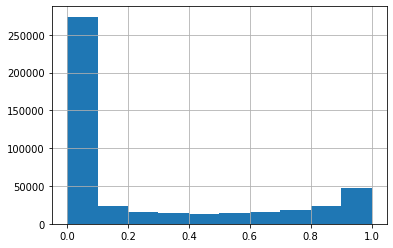

In [20]:
df_oof["oof_optuna"].hist()

# submission


In [21]:
df_test.head(2)


# {'gru_weight': 0.19445859943192784,
#  'exp41_weight': 0.06197931300092922,
#  'exp43_weight': -0.06728615968963023,
#  'deeptab_weight': 0.04608005426906675,
#  'exp03_lgb_weight': 0.43596880295202856,
#  'lstm_weight': 0.019851134011393993,
#  'exp51_lgb_weight': 0.22850267296035298,
#  'exp50_cat_weight': 0.014169561936835745,
#  'trans_weight': -0.05064648159576647,
#  'exp52_xgb_weight': 0.21837408015001122}

,customer_ID,lgb_pred,xgb_pred,cat_pred,tabnet_pred,lgb_exp01_pred,lgb_exp03_pred,gru_pred,exp37_sub,exp40_sub,...,exp43_sub,exp21_sub,lstm_pred,exp51_lgb_sub,exp50_sub,trans_sub,exp52_xgb_sub,xgb_pyrmd_sub,Keras_sub,exp58_sub
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.025290,0.018583,0.023740,0.068557,0.025101,0.026596,0.011616,0.023426,0.026727,...,0.027302,0.030432,0.016002,0.025009,0.017263,0.015027,0.029535,0.015349,0.032958,0.025237
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000721,0.000711,0.002067,0.002292,0.000753,0.000866,0.000532,0.000634,0.000746,...,0.000748,0.000677,0.000442,0.000833,0.001433,0.000321,0.000827,0.000740,0.000888,0.001001


In [22]:
#  df_oof['oof_mix'] = df_oof['oof_gru'] * gru_weight + df_oof['exp41_cat_oof'] * exp41_weight + df_oof['exp43_xgb_oof'] * exp43_weight + df_oof['exp21_deeptab_oof'] * deeptab_weight + df_oof['oof_lgb_exp03'] * exp03_lgb_weight + df_oof['oof_lstm'] * lstm_weight + df_oof['exp51_lgb_oof'] * exp51_lgb_weight + df_oof['exp50_cat_oof'] * exp50_cat_weight + df_oof['trans_oof'] * trans_weight + df_oof['stacking_svc_oof'] * stacking_weight + df_oof['exp42_3_logistic_oof'] * logist_weight 
    


df_test['prediction'] = (df_test['exp58_sub'] * best_param_dic['exp58_weight'] + df_test['Keras_sub'] * best_param_dic['Keras_weight'] + df_test['xgb_pyrmd_sub'] * best_param_dic['pyramid_weight'] + df_test['gru_pred'] * best_param_dic['gru_weight'] + df_test['exp41_sub'] * best_param_dic['exp41_weight'] + df_test['exp43_sub'] * best_param_dic['exp43_weight'] + df_test['exp21_sub'] * best_param_dic['deeptab_weight'] + df_test['lgb_exp03_pred'] * best_param_dic['exp03_lgb_weight'] + df_test['lstm_pred'] * best_param_dic['lstm_weight'] + df_test['exp51_lgb_sub'] * best_param_dic['exp51_lgb_weight'] + df_test['exp50_sub'] * best_param_dic['exp50_cat_weight'] + df_test['exp52_xgb_sub'] * best_param_dic['exp52_xgb_weight'] + df_test['trans_sub'] * best_param_dic['trans_weight'] + df_test['exp42_sub'] * logist_weight)
df_test['prediction'] = df_test['prediction'].apply(Transform_0and_1)

df_test.head()


,customer_ID,lgb_pred,xgb_pred,cat_pred,tabnet_pred,lgb_exp01_pred,lgb_exp03_pred,gru_pred,exp37_sub,exp40_sub,...,exp21_sub,lstm_pred,exp51_lgb_sub,exp50_sub,trans_sub,exp52_xgb_sub,xgb_pyrmd_sub,Keras_sub,exp58_sub,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.025290,0.018583,0.023740,0.068557,0.025101,0.026596,0.011616,0.023426,0.026727,...,0.030432,0.016002,0.025009,0.017263,0.015027,0.029535,0.015349,0.032958,0.025237,0.021755
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000721,0.000711,0.002067,0.002292,0.000753,0.000866,0.000532,0.000634,0.000746,...,0.000677,0.000442,0.000833,0.001433,0.000321,0.000827,0.000740,0.000888,0.001001,0.000564
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.042328,0.063773,0.037992,0.061254,0.043329,0.043542,0.019828,0.037984,0.032303,...,0.026998,0.014729,0.032796,0.040142,0.024640,0.031328,0.030455,0.024581,0.032637,0.029609
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.209871,0.195571,0.212711,0.376076,0.234992,0.200444,0.358953,0.210784,0.194742,...,0.346675,0.454601,0.226481,0.210589,0.295969,0.238987,0.162448,0.302499,0.231662,0.247125
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.870869,0.895821,0.841871,0.897953,0.859383,0.872010,0.896912,0.916960,0.862604,...,0.873692,0.901345,0.855747,0.852632,0.882396,0.879322,0.896425,0.865312,0.864563,0.880154


In [23]:
df_test = df_test[["customer_ID","prediction"]]

df_test.to_csv(f'{CFG.ver}_sub_ensembleoptuna_{score}.csv',index = False)
df_test.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.021755
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000564
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.029609
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.247125
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.880154


<AxesSubplot:>

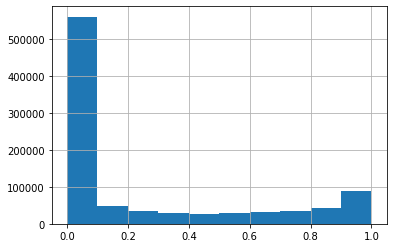

In [24]:
df_test['prediction'].hist()